In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
# %% load packages
import locale
import sys
import os
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import optuna
import requests
import torch
import random
from sqlalchemy import create_engine,inspect
from pathlib import Path
import urllib.parse
import pyarrow
from calendar import day_abbr
import calendar
from typing import Tuple, Union, Dict, List
from concurrent.futures import ThreadPoolExecutor, as_completed
from pygam import LinearGAM
from datetime import datetime


In [3]:
os.getcwd()

'c:\\Users\\amaguaya\\OneDrive - Kienzle Automotive GmbH\\Desktop\\DLiE\\repo\\DLiE_forecast_13_06_25\\srs\\notebooks'

In [53]:
import sys
sys.path.append('C:/Users/amaguaya/OneDrive - Kienzle Automotive GmbH/Desktop/DLiE/repo/DLiE_forecast_13_06_25')

import os
print("Working directory:", os.getcwd())



Working directory: c:\Users\amaguaya\OneDrive - Kienzle Automotive GmbH\Desktop\DLiE\repo\DLiE_forecast_13_06_25\srs\notebooks


In [54]:
from srs.utils.tutor_utils import prepare_dataset_tensor, forecasting_study,\
  plot_daily_profile,plot_hour_comparison, build_multiwindow_experts, tune_ewa_eta, \
  ewa_aggregate_forecasts, compute_error_table, tune_expert_window, \
  run_expert_window_test, build_regression_matrix, SimpleMLP, train_mlp, \
  prepare_train_test_tensors, build_mlp_rolling_forecasts, tune_mlp_hyperparameters, \
  DST_trafo, prepare_dataset_tensor_modified

from srs.utils.our_utils import run_forecast_step, run_forecast_step_modified
from srs.collect_data.setup import setup_seed, get_device
from srs.collect_data.entsoe_data import create_entsoe_engine, get_tables, get_spec, \
  get_market_divisions,get_map_codes,get_map_codes_starting_with, get_resolution_codes, \
    prepare_generation, prepare_load,prepare_price, prepare_unavailability, \
    prepare_filling_rate_hydro, prepare_physical_flow, prepare_installed_capacity
from srs.collect_data.datastream_data import create_datastream_engine, get_tables, \
  prepare_datastream
from srs.collect_data.dwd_mosmix_data import fetch_region_weather, prepare_weather
from srs.collect_data.merge_data import merge_datasets, build_training_dataset

from srs.models.light_gbm import forecast_lgbm_whole_sample_optuna_selectBestOptions

### models_24h fitting for all no1-no5 regions separately.

In [ ]:
'''
  eval/test periods
  2023 - 365 days
  2024 - 366 days
'''


'\n  eval/test periods\n  2023 - 365 days\n  2024 - 366 days\n'

## EXPERIMENT USING DEFAULT HYPERPARAMETERS VALUES 

In [ ]:
# set the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **************************************
# define dates for training and evaluation 
# **************************************
INIT_DATE_EXPERIMENTS = '2019-01-01'
INIT_TEST_DATE = '2023-01-01'
FINAL_DATE_EXPERIMENTS = '2024-12-31'
n_days_test = (pd.to_datetime(FINAL_DATE_EXPERIMENTS) - pd.to_datetime(INIT_TEST_DATE)).days + (1) # additional adjustment

repo_root = Path.cwd().parents[1]
mapcodes = ["NO1"] # ["NO1","NO2","NO3","NO4","NO5"]
maps_dict = {}

for code in mapcodes:
    csv_path = repo_root / "data" / f"data_{code}.csv"
    df = pd.read_csv(csv_path, parse_dates=["time_utc"])
    data_t, train_t, train_dates, price_t = prepare_dataset_tensor_modified(
        csv_path,
        tz="CET",
        seed=42,
        test_days= n_days_test , # Here it should be 1*365 for 1 year of test, and so on
        dtype=torch.float64,
    )

    # fix potential problems with dates after change time zone..
    train_dates_series       = pd.DatetimeIndex(sorted(train_dates))
    id_init_exp = train_dates_series.get_loc(pd.Timestamp(INIT_DATE_EXPERIMENTS))
    id_init_test_period = train_dates_series.get_loc(pd.Timestamp(INIT_TEST_DATE))
    id_end_exp = train_dates_series.get_loc(pd.Timestamp(FINAL_DATE_EXPERIMENTS))
    data_t = data_t[id_init_exp:(id_end_exp+1), :,:]
    train_dates = pd.Series(train_dates[id_init_exp:(id_end_exp+1)])

    print(f"days for test data ..{data_t.shape[0] - id_init_test_period}")
    
    maps_dict[code] = {
        "df": df,
        "data_t": data_t,
        "train_t": train_t,
        "train_dates": train_dates,
        "price_t": price_t
    }
maps_dict.keys()

lgbm24_by_zone   = {}
rmse_by_zone  = {}



for z in mapcodes:
    print(f"\n--- {z} ---")
    price_S      = maps_dict[z]["price_t"]
    data_array   = maps_dict[z]["data_t"]
    full_dates      = maps_dict[z]["train_dates"] # <-- here i change a bit the previuous function, prepare_data_tensor, it has all dates
    feature_names= maps_dict[z]["df"].columns[1:]
    full_date_series = pd.DatetimeIndex(sorted(full_dates))

    # evaluation days (all of 2024)
    train_start_idx = full_date_series.get_loc(pd.Timestamp(INIT_DATE_EXPERIMENTS))
    id_init_eval = full_date_series.get_loc(pd.Timestamp(INIT_TEST_DATE))
    id_end_eval = full_date_series.get_loc(pd.Timestamp(FINAL_DATE_EXPERIMENTS))
    eval_start_idx = id_init_eval
    eval_end_idx  = id_end_eval
    N_s            = (eval_end_idx - eval_start_idx) + 1 # additional adjustment
    full_dates = pd.to_datetime(full_dates)

    

    # new features: WD - dummy for week days, price lags for Mon, Tue and Fri, day-ahead load lag
    WD             = [1,6,7]     
    PRICE_S_LAGS   = [1,2,7]
    DA_LAG         = [0]
    S              = 24
    #D             = 730

    # tensors to collect forecasts for THIS zone
    forecasts_zone = torch.full((N_s, S, 1), float("nan"),
                                dtype=torch.float64, device=device)

    # thread pool
    with ThreadPoolExecutor(max(1, os.cpu_count() // 2) + 1 ) as executor:
        futures = [
            executor.submit(
                run_forecast_step_modified,
                n,
                price_S,
                data_array,
                train_start_idx = train_start_idx,
                train_end_idx   = id_init_eval - 1,
                full_dates      = full_dates,
                wd              = WD,                
                price_s_lags    = PRICE_S_LAGS,
                da_lag          = DA_LAG,
                feature_names   = feature_names,   # reg_names
                n_trials_lgbm   = 10,
                days_for_st_model = 7
            )
            for n in range(N_s)
        ]

        for fut in as_completed(futures):
            try:
                n, lgbm24 = fut.result()
                forecasts_zone[n, :, 0] = lgbm24.detach().clone().to(forecasts_zone.dtype).to(forecasts_zone.device)
            except Exception as e:
                import traceback
                print(f"Thread crashed: {e}")
                traceback.print_exc()

                
    #   shape: (N_s, S)
    true_vals = price_S[eval_start_idx : eval_end_idx + 1].to(device)  
    
    # compute RMSE
    diff = forecasts_zone[:, :, 0] - true_vals
    rmse = torch.sqrt((diff**2).mean()).item()
    
    print(f"Zone {z} LBGM-24h RMSE: {rmse:.4f}")

    lgbm24_by_zone[z] = forecasts_zone[:, :, 0].cpu()
    rmse_by_zone[z]  = rmse

days for test data ..731

--- NO1 ---
Loop   0: train 2019-01-01 00:00:00 -> 2022-12-31 00:00:00, forecast 2023-01-01 00:00:00
  dat_slice shape: torch.Size([1462, 24, 10])  → flatten count = 35088
Loop   1: train 2019-03-03 00:00:00 -> 2023-01-01 00:00:00, forecast 2023-01-02 00:00:00
  dat_slice shape: torch.Size([1402, 24, 10])  → flatten count = 33648
Loop   2: train 2019-03-04 00:00:00 -> 2023-01-02 00:00:00, forecast 2023-01-03 00:00:00
  dat_slice shape: torch.Size([1402, 24, 10])  → flatten count = 33648
Loop   3: train 2019-03-05 00:00:00 -> 2023-01-03 00:00:00, forecast 2023-01-04 00:00:00
  dat_slice shape: torch.Size([1402, 24, 10])  → flatten count = 33648
Loop   4: train 2019-03-06 00:00:00 -> 2023-01-04 00:00:00, forecast 2023-01-05 00:00:00
  dat_slice shape: torch.Size([1402, 24, 10])  → flatten count = 33648
Loop   5: train 2019-03-07 00:00:00 -> 2023-01-05 00:00:00, forecast 2023-01-06 00:00:00
  dat_slice shape: torch.Size([1402, 24, 10])  → flatten count = 33648
Lo

## EXPERIMENT USING OPTUNA, EARLY STOPPING AND LONG AND SHORT TERM MODELS

- This can be run via typical loop or multiprocessing

In [227]:
# set the GPU
from srs.models.light_gbm import forecast_lgbm_whole_sample_LongShortTerm_w_Optuna


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **************************************
# define dates for training and evaluation 
# **************************************
INIT_DATE_EXPERIMENTS = '2019-01-01'
INIT_TEST_DATE = '2023-01-01'
FINAL_DATE_EXPERIMENTS = '2024-12-31'
n_days_test = (pd.to_datetime(FINAL_DATE_EXPERIMENTS) - pd.to_datetime(INIT_TEST_DATE)).days + (1) # additional adjustment

repo_root = Path.cwd().parents[1]
mapcodes = ["NO1"] # ["NO1","NO2","NO3","NO4","NO5"]
maps_dict = {}

for code in mapcodes:
    csv_path = repo_root / "data" / f"data_{code}.csv"
    df = pd.read_csv(csv_path, parse_dates=["time_utc"])
    data_t, train_t, train_dates, price_t = prepare_dataset_tensor_modified(
        csv_path,
        tz="CET",
        seed=42,
        test_days= n_days_test , # Here it should be 1*365 for 1 year of test, and so on
        dtype=torch.float64,
    )

    # fix potential problems with dates after change time zone..
    train_dates_series       = pd.DatetimeIndex(sorted(train_dates))
    id_init_exp = train_dates_series.get_loc(pd.Timestamp(INIT_DATE_EXPERIMENTS))
    id_init_test_period = train_dates_series.get_loc(pd.Timestamp(INIT_TEST_DATE))
    id_end_exp = train_dates_series.get_loc(pd.Timestamp(FINAL_DATE_EXPERIMENTS))
    data_t = data_t[id_init_exp:(id_end_exp+1), :,:]
    train_dates = pd.Series(train_dates[id_init_exp:(id_end_exp+1)])

    print(f"days for test data ..{data_t.shape[0] - id_init_test_period}")
    
    maps_dict[code] = {
        "df": df,
        "data_t": data_t,
        "train_t": train_t,
        "train_dates": train_dates,
        "price_t": price_t
    }
maps_dict.keys()

lgbm24_by_zone   = {}
rmse_by_zone  = {}



for z in mapcodes:
    print(f"\n--- {z} ---")
    price_S      = maps_dict[z]["price_t"]
    data_array   = maps_dict[z]["data_t"]
    full_dates      = maps_dict[z]["train_dates"] # <-- here i change a bit the previuous function, prepare_data_tensor, it has all dates
    feature_names= maps_dict[z]["df"].columns[1:]
    full_date_series = pd.DatetimeIndex(sorted(full_dates))

    # evaluation days (all of 2024)
    train_start_idx = full_date_series.get_loc(pd.Timestamp(INIT_DATE_EXPERIMENTS))
    id_init_eval = full_date_series.get_loc(pd.Timestamp(INIT_TEST_DATE))
    id_end_eval = full_date_series.get_loc(pd.Timestamp(FINAL_DATE_EXPERIMENTS))
    eval_start_idx = id_init_eval
    eval_end_idx  = id_end_eval
    N_s            = (eval_end_idx - eval_start_idx) + 1 # additional adjustment
    full_dates = pd.to_datetime(full_dates)

    

    # new features: WD - dummy for week days, price lags for Mon, Tue and Fri, day-ahead load lag
    WD             = [1,6,7]     
    PRICE_S_LAGS   = [1,2,7]
    DA_LAG         = [0]
    S              = 24
    #D             = 730

    # tensors to collect forecasts for THIS zone
    forecasts_zone = torch.full((N_s, S, 1), float("nan"),
                                dtype=torch.float64, device=device)
    train_end_idx   = id_init_eval - 1

    for n in range(N_s):
        print(f"********************* START NS ... {n} ****************************************************")

        if n == 0:
            reduction = 0
        else:
            reduction = 60 * ((n - 1) // 100 + 1)
        # compute the window bounds
        start_idx = train_start_idx + n + reduction # rolling window (train_start_idx + n)
        end_idx   = train_end_idx  +  n   # inclusive
        
        # slice out the training data & dates
        dat_slice = data_array[start_idx : (end_idx + 2)]
        days      = pd.Series(full_dates[start_idx : (end_idx + 2) ])

        # Generate forecasts using expert_ext model and save them
        result_lgbm_iter            = forecast_lgbm_whole_sample_LongShortTerm_w_Optuna(
        dat                         = dat_slice,
        days                        = days,
        wd                          = WD,
        price_s_lags                = PRICE_S_LAGS,
        da_lag                      = DA_LAG,
        reg_names                   = feature_names,
        fuel_lags                   = [2],
        n_trials_lgbm               = 13, 
        days_for_st_model           = 7
        )

        forecasts_zone[n, :, 0] = result_lgbm_iter['forecasts'].detach().clone().to(forecasts_zone.dtype).to(forecasts_zone.device)

        # Progress tracker (as percentage)
        progress = torch.tensor((n + 1) / N_s * 100, dtype=torch.float64)
        print(f"\r-> {progress.item():.2f}% done", end="")
        print(f"\n********************* END NS.. {n} ****************************************************")
            
    #   shape: (N_s, S)
    true_vals = price_S[eval_start_idx : eval_end_idx + 1].to(device)  
    
    # compute RMSE
    diff = forecasts_zone[:, :, 0] - true_vals
    rmse = torch.sqrt((diff**2).mean()).item()
    
    print(f"Zone {z} LBGM-24h RMSE: {rmse:.4f}")

    lgbm24_by_zone[z] = forecasts_zone[:, :, 0].cpu()
    rmse_by_zone[z]  = rmse

days for test data ..731

--- NO1 ---
********************* START NS ... 0 ****************************************************


[I 2025-06-15 19:44:12,783] A new study created in memory with name: no-name-17e4ed71-5c5e-4dc8-a23e-35d74c6b86b9
[I 2025-06-15 19:44:12,905] Trial 0 finished with value: 0.039454915435123014 and parameters: {'n_estimators': 63, 'learning_rate': 0.014736837565804179, 'num_leaves': 158, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.7061772545874583, 'colsample_bytree': 0.9130124598727951, 'reg_alpha': 7.064369216610946, 'reg_lambda': 3.798538571276203, 'min_split_gain': 0.008032072115536543}. Best is trial 0 with value: 0.039454915435123014.
[I 2025-06-15 19:44:13,051] Trial 1 finished with value: 0.027922336438825784 and parameters: {'n_estimators': 142, 'learning_rate': 0.10556057838685406, 'num_leaves': 137, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.8593348921710515, 'colsample_bytree': 0.6203828709664707, 'reg_alpha': 5.803851121692205, 'reg_lambda': 4.468461113007555, 'min_split_gain': 0.046556794282076756}. Best is trial 1 with value: 0.027922336438825784.


[Trial 0] New best: 0.03945
[Trial 1] New best: 0.02792


[I 2025-06-15 19:44:13,510] Trial 2 finished with value: 0.025894835075432613 and parameters: {'n_estimators': 272, 'learning_rate': 0.05336333624424273, 'num_leaves': 61, 'max_depth': 13, 'min_child_samples': 21, 'subsample': 0.606000504386951, 'colsample_bytree': 0.5593201392655143, 'reg_alpha': 2.139736660045739, 'reg_lambda': 2.9349705804622337, 'min_split_gain': 0.01155381087726693}. Best is trial 2 with value: 0.025894835075432613.
[I 2025-06-15 19:44:13,642] Trial 3 finished with value: 0.027187516683473526 and parameters: {'n_estimators': 193, 'learning_rate': 0.20244086191344932, 'num_leaves': 69, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.8928255248303939, 'colsample_bytree': 0.8768323588363514, 'reg_alpha': 7.232094955544009, 'reg_lambda': 8.379656653621998, 'min_split_gain': 0.03203315506383729}. Best is trial 2 with value: 0.025894835075432613.


[Trial 2] New best: 0.02589
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:44:13,927] Trial 4 finished with value: 0.026355530186274973 and parameters: {'n_estimators': 233, 'learning_rate': 0.08863611839300542, 'num_leaves': 111, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.7554115275454163, 'colsample_bytree': 0.694628183846953, 'reg_alpha': 6.437541933074943, 'reg_lambda': 6.460261378501906, 'min_split_gain': 0.04485090031434871}. Best is trial 2 with value: 0.025894835075432613.
[I 2025-06-15 19:44:14,091] Trial 5 finished with value: 0.030998187265761534 and parameters: {'n_estimators': 140, 'learning_rate': 0.0546892142276788, 'num_leaves': 97, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.9591283256789497, 'colsample_bytree': 0.5303885740671279, 'reg_alpha': 1.5299641684368948, 'reg_lambda': 0.36982004399354285, 'min_split_gain': 0.029887125994059356}. Best is trial 2 with value: 0.025894835075432613.
[I 2025-06-15 19:44:14,092] A new study created in memory with name: no-name-aee9ba39-f503-4768-89d5-0d951dad9fed


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


[I 2025-06-15 19:44:14,154] Trial 0 finished with value: 0.03498040251007065 and parameters: {'n_estimators': 239, 'learning_rate': 0.011163742364558436, 'num_leaves': 211, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.7133114376080227, 'colsample_bytree': 0.7426774750970757, 'reg_alpha': 2.7776226204306633, 'reg_lambda': 8.976475186559348, 'min_split_gain': 0.03331993017247747}. Best is trial 0 with value: 0.03498040251007065.


[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1433
1           Price_lag_2        1249
3         Load_DA_lag_0        1077
14      pct_chg_Load_DA        1030
5       WindOn_DA_lag_0         742
2           Price_lag_7         714
11           NGas_lag_2         568
15       lag168_Load_DA         544
16  roll2d_median_Price         532
10           Coal_lag_2         531
13            EUA_lag_2         464
12            Oil_lag_2         326
7                  WD_1          29
9                  WD_7          11
8                  WD_6          10
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1         394
15       lag168_Load_DA          75
3         Load_DA_lag_0          52
1           Price_lag_2     

[I 2025-06-15 19:44:15,124] A new study created in memory with name: no-name-c4800927-c382-4b08-8420-05b7f70a6f7d
[I 2025-06-15 19:44:15,480] Trial 0 finished with value: 0.01118047856731539 and parameters: {'n_estimators': 100, 'learning_rate': 0.0856817998952099, 'num_leaves': 89, 'max_depth': 13, 'min_child_samples': 12, 'subsample': 0.5469271226150079, 'colsample_bytree': 0.9411753959091956, 'reg_alpha': 0.6992036051725714, 'reg_lambda': 7.68882437428447, 'min_split_gain': 0.01216748049310678}. Best is trial 0 with value: 0.01118047856731539.


[Trial 0] New best: 0.01118


[I 2025-06-15 19:44:15,865] Trial 1 finished with value: 0.009249990694146287 and parameters: {'n_estimators': 134, 'learning_rate': 0.08543448649628956, 'num_leaves': 246, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.6746428150527728, 'colsample_bytree': 0.7616947012047948, 'reg_alpha': 0.031577676695693224, 'reg_lambda': 4.456830386034411, 'min_split_gain': 0.04956891054269045}. Best is trial 1 with value: 0.009249990694146287.


[Trial 1] New best: 0.00925


[I 2025-06-15 19:44:16,587] Trial 2 finished with value: 0.006738192360439846 and parameters: {'n_estimators': 173, 'learning_rate': 0.014250627530950927, 'num_leaves': 210, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.6310311707262202, 'colsample_bytree': 0.6732226797071061, 'reg_alpha': 1.4781391437831626, 'reg_lambda': 7.519833413419579, 'min_split_gain': 0.03968759022983602}. Best is trial 2 with value: 0.006738192360439846.


[Trial 2] New best: 0.00674


[I 2025-06-15 19:44:16,840] Trial 3 finished with value: 0.008906092977263122 and parameters: {'n_estimators': 98, 'learning_rate': 0.04823404214789415, 'num_leaves': 34, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.9137979676947685, 'colsample_bytree': 0.8459820529833402, 'reg_alpha': 1.6200010615315896, 'reg_lambda': 0.006571794232070882, 'min_split_gain': 0.015071770182359629}. Best is trial 2 with value: 0.006738192360439846.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:44:17,218] Trial 4 finished with value: 0.009189963249864543 and parameters: {'n_estimators': 186, 'learning_rate': 0.021223744984309758, 'num_leaves': 172, 'max_depth': 9, 'min_child_samples': 7, 'subsample': 0.5087380422768554, 'colsample_bytree': 0.9291204320876847, 'reg_alpha': 6.759948917791951, 'reg_lambda': 3.4941841350866385, 'min_split_gain': 0.031677843271717875}. Best is trial 2 with value: 0.006738192360439846.
[I 2025-06-15 19:44:17,368] Trial 5 finished with value: 0.009111710903558029 and parameters: {'n_estimators': 100, 'learning_rate': 0.14952245011841775, 'num_leaves': 222, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.7797016898503937, 'colsample_bytree': 0.5766913942366597, 'reg_alpha': 2.91369598660679, 'reg_lambda': 3.527297668993631, 'min_split_gain': 0.039482136774970755}. Best is trial 2 with value: 0.006738192360439846.
[I 2025-06-15 19:44:17,369] A new study created in memory with name: no-name-8d92444f-f4ce-4cac-937f-77779b0b9e5a


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2370
1           Price_lag_2        1852
14      pct_chg_Load_DA         985
16  roll2d_median_Price         686
2           Price_lag_7         612
11           NGas_lag_2         415
3         Load_DA_lag_0         372
10           Coal_lag_2         372
12            Oil_lag_2         257
13            EUA_lag_2         251
15       lag168_Load_DA         212
5       WindOn_DA_lag_0          98
9                  WD_7          12
8                  WD_6           8
7                  WD_1           4
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
         

[I 2025-06-15 19:44:18,218] A new study created in memory with name: no-name-8266870c-c4f8-442d-a42f-c9fcbfff2b4b
[I 2025-06-15 19:44:18,721] Trial 0 finished with value: 0.005832959601448413 and parameters: {'n_estimators': 248, 'learning_rate': 0.01110376072572594, 'num_leaves': 254, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.7118119799806568, 'colsample_bytree': 0.7948645655110806, 'reg_alpha': 6.865991960620187, 'reg_lambda': 3.6353133799514294, 'min_split_gain': 0.03448582129203791}. Best is trial 0 with value: 0.005832959601448413.
[I 2025-06-15 19:44:18,909] Trial 1 finished with value: 0.013189769740336824 and parameters: {'n_estimators': 76, 'learning_rate': 0.022881611330852824, 'num_leaves': 166, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.6375795127359658, 'colsample_bytree': 0.7871603819236519, 'reg_alpha': 9.709387243711797, 'reg_lambda': 1.7897632694493004, 'min_split_gain': 0.005527330260289682}. Best is trial 0 with value: 0.005832959601448413

[Trial 0] New best: 0.00583
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:44:19,048] Trial 2 finished with value: 0.004328289905740292 and parameters: {'n_estimators': 138, 'learning_rate': 0.20770325375692983, 'num_leaves': 55, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.6625872927157681, 'colsample_bytree': 0.9095785426593788, 'reg_alpha': 6.102905271183382, 'reg_lambda': 1.5937880485616085, 'min_split_gain': 0.018520510757433595}. Best is trial 2 with value: 0.004328289905740292.


[Trial 2] New best: 0.00433


[I 2025-06-15 19:44:19,298] Trial 3 finished with value: 0.004115384550851614 and parameters: {'n_estimators': 230, 'learning_rate': 0.12717961527499475, 'num_leaves': 203, 'max_depth': 7, 'min_child_samples': 30, 'subsample': 0.8740120590870102, 'colsample_bytree': 0.9635354549612922, 'reg_alpha': 9.800560341054545, 'reg_lambda': 0.18846736670085296, 'min_split_gain': 0.04735283965843909}. Best is trial 3 with value: 0.004115384550851614.
[I 2025-06-15 19:44:19,433] Trial 4 finished with value: 0.003863995740765932 and parameters: {'n_estimators': 92, 'learning_rate': 0.16749392479378775, 'num_leaves': 230, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.6676521039294671, 'colsample_bytree': 0.8497598771366945, 'reg_alpha': 4.196844013502911, 'reg_lambda': 7.930985939079407, 'min_split_gain': 0.0013981255544120831}. Best is trial 4 with value: 0.003863995740765932.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:44:19,679] Trial 5 finished with value: 0.004241073918759334 and parameters: {'n_estimators': 209, 'learning_rate': 0.043586976314584754, 'num_leaves': 249, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.9068882182103888, 'colsample_bytree': 0.9344372516393554, 'reg_alpha': 1.1024293885934744, 'reg_lambda': 8.010444284831452, 'min_split_gain': 0.010866953098325428}. Best is trial 4 with value: 0.003863995740765932.
[I 2025-06-15 19:44:19,681] A new study created in memory with name: no-name-f6d017ca-3603-4966-a5b3-eef6d31b597e
[I 2025-06-15 19:44:19,706] Trial 0 finished with value: 0.04197123312133067 and parameters: {'n_estimators': 254, 'learning_rate': 0.0738883463622415, 'num_leaves': 142, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.5819442130803499, 'colsample_bytree': 0.6854364904799772, 'reg_alpha': 4.847397791217615, 'reg_lambda': 6.0782674483168755, 'min_split_gain': 0.044284934973976814}. Best is trial 0 with value: 0.04197123312133067.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         298
14      pct_chg_Load_DA         172
1           Price_lag_2         149
3         Load_DA_lag_0         107
11           NGas_lag_2          82
2           Price_lag_7          77
13            EUA_lag_2          67
16  roll2d_median_Price          64
5       WindOn_DA_lag_0          63
15       lag168_Load_DA          58
12            Oil_lag_2          56
10           Coal_lag_2          39
9                  WD_7           6
7                  WD_1           4
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:44:20,275] A new study created in memory with name: no-name-e4235195-ef02-4328-9d2c-e81e350b51fa
[I 2025-06-15 19:44:20,703] Trial 0 finished with value: 0.005129495093641857 and parameters: {'n_estimators': 164, 'learning_rate': 0.024387959072226826, 'num_leaves': 68, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.7074895305742628, 'colsample_bytree': 0.5065387030102462, 'reg_alpha': 0.19526637067555086, 'reg_lambda': 3.5787157354918886, 'min_split_gain': 0.005303305929427221}. Best is trial 0 with value: 0.005129495093641857.


[Trial 0] New best: 0.00513


[I 2025-06-15 19:44:20,913] Trial 1 finished with value: 0.004017851889815741 and parameters: {'n_estimators': 83, 'learning_rate': 0.18452363636710312, 'num_leaves': 104, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.9853039221323343, 'colsample_bytree': 0.5650711946242122, 'reg_alpha': 0.919910399988183, 'reg_lambda': 4.711404079704369, 'min_split_gain': 0.024997568108786585}. Best is trial 1 with value: 0.004017851889815741.


[Trial 1] New best: 0.00402


[I 2025-06-15 19:44:21,154] Trial 2 finished with value: 0.005774865334181992 and parameters: {'n_estimators': 180, 'learning_rate': 0.019170173007605637, 'num_leaves': 165, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.5443884495680391, 'colsample_bytree': 0.9428545294119064, 'reg_alpha': 2.5072344389634815, 'reg_lambda': 4.243297100837316, 'min_split_gain': 0.026502026832391074}. Best is trial 1 with value: 0.004017851889815741.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:44:21,547] Trial 3 finished with value: 0.004524078286734841 and parameters: {'n_estimators': 288, 'learning_rate': 0.09613557814974692, 'num_leaves': 214, 'max_depth': 13, 'min_child_samples': 16, 'subsample': 0.9125868570195894, 'colsample_bytree': 0.7787274524543715, 'reg_alpha': 7.468051606995144, 'reg_lambda': 8.971641343566523, 'min_split_gain': 0.004258961617897511}. Best is trial 1 with value: 0.004017851889815741.
[I 2025-06-15 19:44:21,684] Trial 4 finished with value: 0.004769106580302396 and parameters: {'n_estimators': 126, 'learning_rate': 0.21166013971417966, 'num_leaves': 170, 'max_depth': 13, 'min_child_samples': 29, 'subsample': 0.5745473252292499, 'colsample_bytree': 0.6427377005337347, 'reg_alpha': 4.776815321155081, 'reg_lambda': 7.000027210242398, 'min_split_gain': 0.03890768736721526}. Best is trial 1 with value: 0.004017851889815741.
[I 2025-06-15 19:44:21,686] A new study created in memory with name: no-name-09648211-97f8-47ba-bd67-66667dd401bd

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2         400
0           Price_lag_1         373
3         Load_DA_lag_0         329
14      pct_chg_Load_DA         271
5       WindOn_DA_lag_0         263
2           Price_lag_7         230
16  roll2d_median_Price         189
10           Coal_lag_2         176
15       lag168_Load_DA         174
13            EUA_lag_2         171
11           NGas_lag_2         136
12            Oil_lag_2         113
7                  WD_1          10
9                  WD_7           6
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
         

[I 2025-06-15 19:44:22,380] A new study created in memory with name: no-name-6870d94c-9a88-41f3-ad87-9dfda5658e9d
[I 2025-06-15 19:44:22,610] Trial 0 finished with value: 0.00405557337705889 and parameters: {'n_estimators': 283, 'learning_rate': 0.2155772470952722, 'num_leaves': 88, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.7731056276300727, 'colsample_bytree': 0.9102667253823162, 'reg_alpha': 0.7434343141527944, 'reg_lambda': 9.87865329838922, 'min_split_gain': 0.014294052412481467}. Best is trial 0 with value: 0.00405557337705889.


[Trial 0] New best: 0.00406


[I 2025-06-15 19:44:23,224] Trial 1 finished with value: 0.007444677185139292 and parameters: {'n_estimators': 292, 'learning_rate': 0.0145741499312702, 'num_leaves': 106, 'max_depth': 14, 'min_child_samples': 23, 'subsample': 0.6290314843036622, 'colsample_bytree': 0.6469383827921362, 'reg_alpha': 7.975643783167571, 'reg_lambda': 4.603267071317659, 'min_split_gain': 0.017564263283141448}. Best is trial 0 with value: 0.00405557337705889.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:44:23,492] Trial 2 finished with value: 0.004515308225825216 and parameters: {'n_estimators': 204, 'learning_rate': 0.19857242025675773, 'num_leaves': 39, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.5745932587062449, 'colsample_bytree': 0.8781650567937166, 'reg_alpha': 5.918277828473766, 'reg_lambda': 3.4376447638223127, 'min_split_gain': 0.00019868374593642326}. Best is trial 0 with value: 0.00405557337705889.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:44:23,706] Trial 3 finished with value: 0.005541395019309281 and parameters: {'n_estimators': 298, 'learning_rate': 0.1799507491413008, 'num_leaves': 225, 'max_depth': 14, 'min_child_samples': 29, 'subsample': 0.841461687988704, 'colsample_bytree': 0.5649988893861478, 'reg_alpha': 4.39795827384366, 'reg_lambda': 1.9003229032570368, 'min_split_gain': 0.03396427539352611}. Best is trial 0 with value: 0.00405557337705889.
[I 2025-06-15 19:44:23,708] A new study created in memory with name: no-name-bad896f6-cd6e-4e23-ab48-d6c174030e5f
[I 2025-06-15 19:44:23,753] Trial 0 finished with value: 0.05593026091345535 and parameters: {'n_estimators': 231, 'learning_rate': 0.05020040088377663, 'num_leaves': 185, 'max_depth': 14, 'min_child_samples': 10, 'subsample': 0.6339236221611279, 'colsample_bytree': 0.8628625964985731, 'reg_alpha': 4.272535398589831, 'reg_lambda': 5.779992833637646, 'min_split_gain': 0.015015937027945582}. Best is trial 0 with value: 0.05593026091345535.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         441
14      pct_chg_Load_DA         399
1           Price_lag_2         320
3         Load_DA_lag_0         309
5       WindOn_DA_lag_0         213
2           Price_lag_7         200
16  roll2d_median_Price         191
15       lag168_Load_DA         151
11           NGas_lag_2         136
10           Coal_lag_2         133
12            Oil_lag_2         119
13            EUA_lag_2         101
9                  WD_7           8
7                  WD_1           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:44:24,565] A new study created in memory with name: no-name-6a6900fa-cd81-4c95-963f-ad69175e05ae
[I 2025-06-15 19:44:24,839] Trial 0 finished with value: 0.009324284912943537 and parameters: {'n_estimators': 66, 'learning_rate': 0.05465984511145704, 'num_leaves': 81, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.7168376861099148, 'colsample_bytree': 0.5283078804187759, 'reg_alpha': 5.757621130843303, 'reg_lambda': 8.17929803879873, 'min_split_gain': 0.0147559677623957}. Best is trial 0 with value: 0.009324284912943537.


[Trial 0] New best: 0.00932


[I 2025-06-15 19:44:25,208] Trial 1 finished with value: 0.006587225389119465 and parameters: {'n_estimators': 177, 'learning_rate': 0.03644404277135564, 'num_leaves': 46, 'max_depth': 14, 'min_child_samples': 20, 'subsample': 0.8637349640996647, 'colsample_bytree': 0.596956486706925, 'reg_alpha': 8.184203115013789, 'reg_lambda': 9.69681513392591, 'min_split_gain': 0.023592658272589842}. Best is trial 1 with value: 0.006587225389119465.


[Trial 1] New best: 0.00659


[I 2025-06-15 19:44:25,469] Trial 2 finished with value: 0.005078960499537814 and parameters: {'n_estimators': 233, 'learning_rate': 0.07598760069683948, 'num_leaves': 99, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.8917193924669898, 'colsample_bytree': 0.6692744308615435, 'reg_alpha': 8.910461325418657, 'reg_lambda': 1.9772088493915152, 'min_split_gain': 0.045059059165613945}. Best is trial 2 with value: 0.005078960499537814.
[I 2025-06-15 19:44:25,637] Trial 3 finished with value: 0.00580632811907223 and parameters: {'n_estimators': 97, 'learning_rate': 0.2801736850783864, 'num_leaves': 155, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.8977331504461081, 'colsample_bytree': 0.7492967301920322, 'reg_alpha': 0.008800886595444757, 'reg_lambda': 4.601193313486575, 'min_split_gain': 0.032986480647528696}. Best is trial 2 with value: 0.005078960499537814.


[Trial 2] New best: 0.00508
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:44:25,966] Trial 4 finished with value: 0.014477706846797174 and parameters: {'n_estimators': 103, 'learning_rate': 0.019469556317724034, 'num_leaves': 195, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.8283046074281921, 'colsample_bytree': 0.6426009485506836, 'reg_alpha': 2.9992835553748565, 'reg_lambda': 8.92147915348839, 'min_split_gain': 0.015560856447952654}. Best is trial 2 with value: 0.005078960499537814.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:44:26,538] Trial 5 finished with value: 0.004877305694190879 and parameters: {'n_estimators': 104, 'learning_rate': 0.12308042312777888, 'num_leaves': 75, 'max_depth': 7, 'min_child_samples': 23, 'subsample': 0.5820047822025898, 'colsample_bytree': 0.7564151201535491, 'reg_alpha': 7.483213586230405, 'reg_lambda': 5.889951744450857, 'min_split_gain': 0.015433307505237498}. Best is trial 5 with value: 0.004877305694190879.
[I 2025-06-15 19:44:26,540] A new study created in memory with name: no-name-a27ff905-d1fc-4f5b-97d5-851b7fbcf526
[I 2025-06-15 19:44:26,621] Trial 0 finished with value: 0.0377256359463794 and parameters: {'n_estimators': 269, 'learning_rate': 0.011391652877551652, 'num_leaves': 124, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.727706378117662, 'colsample_bytree': 0.6214304850069621, 'reg_alpha': 4.6158880603371895, 'reg_lambda': 4.650002095678493, 'min_split_gain': 0.02054479552323875}. Best is trial 0 with value: 0.0377256359463794.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         365
1           Price_lag_2         251
14      pct_chg_Load_DA         213
3         Load_DA_lag_0         144
13            EUA_lag_2         110
11           NGas_lag_2         106
2           Price_lag_7          96
15       lag168_Load_DA          87
5       WindOn_DA_lag_0          81
16  roll2d_median_Price          80
10           Coal_lag_2          74
12            Oil_lag_2          71
9                  WD_7           5
7                  WD_1           2
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:44:27,684] A new study created in memory with name: no-name-b342a4e3-70a2-4dfe-9c4e-e5e4907abae3
[I 2025-06-15 19:44:28,012] Trial 0 finished with value: 0.005233813212077324 and parameters: {'n_estimators': 99, 'learning_rate': 0.07729330348553697, 'num_leaves': 150, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.9364899417139565, 'colsample_bytree': 0.9006727138248516, 'reg_alpha': 4.640916301635114, 'reg_lambda': 1.1312531053045305, 'min_split_gain': 0.024742429152225}. Best is trial 0 with value: 0.005233813212077324.


[Trial 0] New best: 0.00523


[I 2025-06-15 19:44:28,536] Trial 1 finished with value: 0.007376348920308448 and parameters: {'n_estimators': 266, 'learning_rate': 0.028262839910655462, 'num_leaves': 130, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.6828591642105315, 'colsample_bytree': 0.6946900343115976, 'reg_alpha': 9.82169614738805, 'reg_lambda': 0.7314098200014807, 'min_split_gain': 0.031444505019256185}. Best is trial 0 with value: 0.005233813212077324.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:44:28,843] Trial 2 finished with value: 0.0057638435702120835 and parameters: {'n_estimators': 266, 'learning_rate': 0.2026944441093077, 'num_leaves': 81, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.7388501344787617, 'colsample_bytree': 0.6587207449191382, 'reg_alpha': 3.8473227142600575, 'reg_lambda': 2.2350883498281213, 'min_split_gain': 0.03573108316994993}. Best is trial 0 with value: 0.005233813212077324.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:44:29,214] Trial 3 finished with value: 0.006615052252520966 and parameters: {'n_estimators': 109, 'learning_rate': 0.06486073668965228, 'num_leaves': 79, 'max_depth': 4, 'min_child_samples': 10, 'subsample': 0.8022522301241289, 'colsample_bytree': 0.7929118271441014, 'reg_alpha': 9.208025580239704, 'reg_lambda': 4.839869657989659, 'min_split_gain': 0.00759997806512791}. Best is trial 0 with value: 0.005233813212077324.
[I 2025-06-15 19:44:29,217] A new study created in memory with name: no-name-ee63a3bf-b1db-4104-8841-f99ee4828e0c
[I 2025-06-15 19:44:29,239] Trial 0 finished with value: 0.0552101884948471 and parameters: {'n_estimators': 84, 'learning_rate': 0.07891913054247168, 'num_leaves': 157, 'max_depth': 14, 'min_child_samples': 18, 'subsample': 0.9071207166875925, 'colsample_bytree': 0.9809330561018008, 'reg_alpha': 8.562930709283222, 'reg_lambda': 0.4153028761233568, 'min_split_gain': 0.030118463460710926}. Best is trial 0 with value: 0.0552101884948471.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         694
14      pct_chg_Load_DA         428
1           Price_lag_2         331
3         Load_DA_lag_0         271
11           NGas_lag_2         201
2           Price_lag_7         179
16  roll2d_median_Price         166
5       WindOn_DA_lag_0         142
15       lag168_Load_DA         141
13            EUA_lag_2         134
12            Oil_lag_2         119
10           Coal_lag_2         100
7                  WD_1           7
9                  WD_7           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:44:30,188] A new study created in memory with name: no-name-da29ad1b-9bf6-41ac-af26-39ab5227c1cf
[I 2025-06-15 19:44:31,030] Trial 0 finished with value: 0.0070694913607234665 and parameters: {'n_estimators': 186, 'learning_rate': 0.026773619976404678, 'num_leaves': 103, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.8456212006445083, 'colsample_bytree': 0.6565269184433513, 'reg_alpha': 0.47303607989908625, 'reg_lambda': 6.600906120088546, 'min_split_gain': 0.03270404970464339}. Best is trial 0 with value: 0.0070694913607234665.


[Trial 0] New best: 0.00707


[I 2025-06-15 19:44:31,466] Trial 1 finished with value: 0.005139795133763929 and parameters: {'n_estimators': 132, 'learning_rate': 0.19632056825007296, 'num_leaves': 221, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.7781769225908142, 'colsample_bytree': 0.9802446011939101, 'reg_alpha': 7.147165220030712, 'reg_lambda': 2.1362203913688527, 'min_split_gain': 8.577533077589461e-05}. Best is trial 1 with value: 0.005139795133763929.


[Trial 1] New best: 0.00514


[I 2025-06-15 19:44:31,846] Trial 2 finished with value: 0.006940883013801917 and parameters: {'n_estimators': 237, 'learning_rate': 0.16642075433704034, 'num_leaves': 136, 'max_depth': 15, 'min_child_samples': 2, 'subsample': 0.9784265546946926, 'colsample_bytree': 0.6185485487482576, 'reg_alpha': 5.339148163580298, 'reg_lambda': 1.4278087229458702, 'min_split_gain': 0.025480244526775414}. Best is trial 1 with value: 0.005139795133763929.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:44:32,480] Trial 3 finished with value: 0.006171205385530565 and parameters: {'n_estimators': 130, 'learning_rate': 0.07808621185901221, 'num_leaves': 167, 'max_depth': 13, 'min_child_samples': 1, 'subsample': 0.7088071319651463, 'colsample_bytree': 0.7047932156152011, 'reg_alpha': 3.6777198261262543, 'reg_lambda': 5.225657335984017, 'min_split_gain': 0.041615552125096225}. Best is trial 1 with value: 0.005139795133763929.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:44:33,153] Trial 4 finished with value: 0.005890834813713434 and parameters: {'n_estimators': 138, 'learning_rate': 0.01764522363807616, 'num_leaves': 168, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.887321576873261, 'colsample_bytree': 0.8405109135504639, 'reg_alpha': 1.4027218392866536, 'reg_lambda': 1.677142345594762, 'min_split_gain': 0.001160180819948309}. Best is trial 1 with value: 0.005139795133763929.
[I 2025-06-15 19:44:33,156] A new study created in memory with name: no-name-73f8e4f9-40c2-4cd1-b460-fb7c60a1dfc0
[I 2025-06-15 19:44:33,184] Trial 0 finished with value: 0.05382496913044571 and parameters: {'n_estimators': 87, 'learning_rate': 0.14746060889081572, 'num_leaves': 193, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.7599742552921964, 'colsample_bytree': 0.8746258808669025, 'reg_alpha': 6.674548703137409, 'reg_lambda': 2.6800567142098086, 'min_split_gain': 0.01345811688506049}. Best is trial 0 with value: 0.05382496913044571.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         507
14      pct_chg_Load_DA         440
3         Load_DA_lag_0         387
5       WindOn_DA_lag_0         335
1           Price_lag_2         298
15       lag168_Load_DA         269
2           Price_lag_7         247
13            EUA_lag_2         224
12            Oil_lag_2         221
16  roll2d_median_Price         196
11           NGas_lag_2         193
10           Coal_lag_2         185
9                  WD_7          11
7                  WD_1           8
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:44:34,159] A new study created in memory with name: no-name-c576838f-b054-47ce-bf0c-7f1988aebf98
[I 2025-06-15 19:44:34,570] Trial 0 finished with value: 0.009195312010100718 and parameters: {'n_estimators': 261, 'learning_rate': 0.0701333477897768, 'num_leaves': 102, 'max_depth': 15, 'min_child_samples': 14, 'subsample': 0.6615898501257901, 'colsample_bytree': 0.8339440136257728, 'reg_alpha': 4.145968347911907, 'reg_lambda': 5.480519957260097, 'min_split_gain': 0.014617002069321084}. Best is trial 0 with value: 0.009195312010100718.


[Trial 0] New best: 0.00920


[I 2025-06-15 19:44:35,255] Trial 1 finished with value: 0.010828304420942096 and parameters: {'n_estimators': 192, 'learning_rate': 0.012192320276545255, 'num_leaves': 106, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.6354421789481457, 'colsample_bytree': 0.9461763046420499, 'reg_alpha': 6.21593766675683, 'reg_lambda': 3.8821889761292274, 'min_split_gain': 0.0045803776366603825}. Best is trial 0 with value: 0.009195312010100718.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:44:36,485] Trial 2 finished with value: 0.008559365657691002 and parameters: {'n_estimators': 285, 'learning_rate': 0.025635930640981523, 'num_leaves': 248, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.8743882976120549, 'colsample_bytree': 0.9384712071562373, 'reg_alpha': 4.987967598027165, 'reg_lambda': 7.694846199233076, 'min_split_gain': 0.0168787675008339}. Best is trial 2 with value: 0.008559365657691002.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:44:37,535] Trial 3 finished with value: 0.026492129179097792 and parameters: {'n_estimators': 154, 'learning_rate': 0.010390732532054005, 'num_leaves': 253, 'max_depth': 15, 'min_child_samples': 1, 'subsample': 0.9811216520806478, 'colsample_bytree': 0.5950880795616846, 'reg_alpha': 2.664200798328107, 'reg_lambda': 1.7993111074721857, 'min_split_gain': 0.023134808884257032}. Best is trial 2 with value: 0.008559365657691002.
[I 2025-06-15 19:44:37,537] A new study created in memory with name: no-name-2a12fec1-eab6-4aa1-a6b8-0d73e281c3ae
[I 2025-06-15 19:44:37,559] Trial 0 finished with value: 0.23279980117647028 and parameters: {'n_estimators': 50, 'learning_rate': 0.025394998869937728, 'num_leaves': 154, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.9477933449292342, 'colsample_bytree': 0.8035331400711212, 'reg_alpha': 0.9013309466312858, 'reg_lambda': 4.28030325934728, 'min_split_gain': 0.015018858241503215}. Best is trial 0 with value: 0.23279980117647028.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2309
14      pct_chg_Load_DA        1408
1           Price_lag_2        1228
3         Load_DA_lag_0         966
11           NGas_lag_2         725
2           Price_lag_7         705
16  roll2d_median_Price         660
5       WindOn_DA_lag_0         541
15       lag168_Load_DA         481
12            Oil_lag_2         476
13            EUA_lag_2         425
10           Coal_lag_2         404
7                  WD_1          38
9                  WD_7          32
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:44:38,953] A new study created in memory with name: no-name-42978fc9-a95f-4e3b-8738-8078d1c5fc4c
[I 2025-06-15 19:44:39,181] Trial 0 finished with value: 0.012005636027182333 and parameters: {'n_estimators': 215, 'learning_rate': 0.14843729856963145, 'num_leaves': 123, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.7658607607461312, 'colsample_bytree': 0.6953816391357572, 'reg_alpha': 2.4535062276188615, 'reg_lambda': 2.3701119387720326, 'min_split_gain': 0.018833089839865765}. Best is trial 0 with value: 0.012005636027182333.
[I 2025-06-15 19:44:39,311] Trial 1 finished with value: 0.012392699682363036 and parameters: {'n_estimators': 81, 'learning_rate': 0.16311535979078967, 'num_leaves': 82, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.5099573112905129, 'colsample_bytree': 0.816393228727315, 'reg_alpha': 9.46447591148586, 'reg_lambda': 2.4776645407797004, 'min_split_gain': 0.04806340155870579}. Best is trial 0 with value: 0.012005636027182333.


[Trial 0] New best: 0.01201
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:44:39,630] Trial 2 finished with value: 0.02303718728922514 and parameters: {'n_estimators': 142, 'learning_rate': 0.02295247568377602, 'num_leaves': 252, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.7570672870873254, 'colsample_bytree': 0.5867902237585023, 'reg_alpha': 3.115324356799085, 'reg_lambda': 1.859868128016855, 'min_split_gain': 0.004218693362718728}. Best is trial 0 with value: 0.012005636027182333.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:44:39,858] Trial 3 finished with value: 0.02297885882044044 and parameters: {'n_estimators': 66, 'learning_rate': 0.025727700047259165, 'num_leaves': 161, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.8384981902349693, 'colsample_bytree': 0.9630397761815152, 'reg_alpha': 8.165829079838558, 'reg_lambda': 6.039645050958637, 'min_split_gain': 0.048058438850134444}. Best is trial 0 with value: 0.012005636027182333.
[I 2025-06-15 19:44:39,861] A new study created in memory with name: no-name-18eaef8c-ec7c-4b4d-b255-f3b632f3a416
[I 2025-06-15 19:44:39,891] Trial 0 finished with value: 0.22288602503195631 and parameters: {'n_estimators': 95, 'learning_rate': 0.04108590175776806, 'num_leaves': 52, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.512001031795412, 'colsample_bytree': 0.7547300062957716, 'reg_alpha': 5.97446107054871, 'reg_lambda': 9.645853311146784, 'min_split_gain': 0.040116121103072305}. Best is trial 0 with value: 0.22288602503195631.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         461
1           Price_lag_2         355
3         Load_DA_lag_0         348
14      pct_chg_Load_DA         328
5       WindOn_DA_lag_0         217
2           Price_lag_7         214
11           NGas_lag_2         197
15       lag168_Load_DA         194
10           Coal_lag_2         182
16  roll2d_median_Price         165
12            Oil_lag_2         136
13            EUA_lag_2         135
7                  WD_1           7
9                  WD_7           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:44:40,789] A new study created in memory with name: no-name-ab127aa9-28a5-4456-8126-c9cb2ea17cb3
[I 2025-06-15 19:44:41,128] Trial 0 finished with value: 0.010571188322926797 and parameters: {'n_estimators': 170, 'learning_rate': 0.04191360503537781, 'num_leaves': 94, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.888251859388325, 'colsample_bytree': 0.8679221772320189, 'reg_alpha': 7.332572142625054, 'reg_lambda': 2.913339798913909, 'min_split_gain': 0.04593729902328179}. Best is trial 0 with value: 0.010571188322926797.


[Trial 0] New best: 0.01057


[I 2025-06-15 19:44:41,348] Trial 1 finished with value: 0.010697268320965653 and parameters: {'n_estimators': 98, 'learning_rate': 0.08714784968342885, 'num_leaves': 226, 'max_depth': 15, 'min_child_samples': 21, 'subsample': 0.7518882844906636, 'colsample_bytree': 0.9562407736103518, 'reg_alpha': 9.039044620078133, 'reg_lambda': 4.528060009044282, 'min_split_gain': 0.03596970824448409}. Best is trial 0 with value: 0.010571188322926797.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:44:42,016] Trial 2 finished with value: 0.023420343068958502 and parameters: {'n_estimators': 171, 'learning_rate': 0.01429720977817519, 'num_leaves': 138, 'max_depth': 16, 'min_child_samples': 15, 'subsample': 0.5001308486825655, 'colsample_bytree': 0.5048253656024948, 'reg_alpha': 3.640896070971759, 'reg_lambda': 1.687301354437546, 'min_split_gain': 0.031130519734821907}. Best is trial 0 with value: 0.010571188322926797.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:44:42,309] Trial 3 finished with value: 0.011289823323943224 and parameters: {'n_estimators': 290, 'learning_rate': 0.08611453272885687, 'num_leaves': 153, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.830676781024908, 'colsample_bytree': 0.8505561827819473, 'reg_alpha': 9.947975423712359, 'reg_lambda': 0.44331644363864164, 'min_split_gain': 0.04987740968102777}. Best is trial 0 with value: 0.010571188322926797.
[I 2025-06-15 19:44:42,311] A new study created in memory with name: no-name-bdaabc23-ca4a-40a6-b4ae-9888685df42a
[I 2025-06-15 19:44:42,354] Trial 0 finished with value: 0.10937175774513125 and parameters: {'n_estimators': 214, 'learning_rate': 0.10798769092199939, 'num_leaves': 107, 'max_depth': 10, 'min_child_samples': 1, 'subsample': 0.6862115504206946, 'colsample_bytree': 0.7861474770815664, 'reg_alpha': 9.142285938375043, 'reg_lambda': 5.290782639994115, 'min_split_gain': 0.017396661545940186}. Best is trial 0 with value: 0.10937175774513125.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1082
14      pct_chg_Load_DA         526
1           Price_lag_2         522
3         Load_DA_lag_0         315
11           NGas_lag_2         271
2           Price_lag_7         233
16  roll2d_median_Price         191
13            EUA_lag_2         154
10           Coal_lag_2         143
12            Oil_lag_2         126
15       lag168_Load_DA         104
5       WindOn_DA_lag_0          40
9                  WD_7           9
7                  WD_1           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:44:43,207] A new study created in memory with name: no-name-1fc549e2-cc4c-49d8-91ec-41ab165133dc
[I 2025-06-15 19:44:43,404] Trial 0 finished with value: 0.009349214514351268 and parameters: {'n_estimators': 212, 'learning_rate': 0.29976916827032274, 'num_leaves': 82, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.548310140380048, 'colsample_bytree': 0.5340634624275651, 'reg_alpha': 1.035775608624887, 'reg_lambda': 3.040937032925312, 'min_split_gain': 0.016493961954524572}. Best is trial 0 with value: 0.009349214514351268.


[Trial 0] New best: 0.00935


[I 2025-06-15 19:44:43,677] Trial 1 finished with value: 0.013314429584752726 and parameters: {'n_estimators': 246, 'learning_rate': 0.0938477533457577, 'num_leaves': 229, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.8820643618955795, 'colsample_bytree': 0.7587050860142138, 'reg_alpha': 9.578678527450418, 'reg_lambda': 5.187489227972831, 'min_split_gain': 0.03226156132732252}. Best is trial 0 with value: 0.009349214514351268.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:44:44,529] Trial 2 finished with value: 0.014058190991371048 and parameters: {'n_estimators': 299, 'learning_rate': 0.03073155297908923, 'num_leaves': 229, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.9492837409229892, 'colsample_bytree': 0.6655584249924271, 'reg_alpha': 7.284789145997226, 'reg_lambda': 9.17211104855945, 'min_split_gain': 0.031208498175649114}. Best is trial 0 with value: 0.009349214514351268.
[I 2025-06-15 19:44:44,712] Trial 3 finished with value: 0.013689934520468244 and parameters: {'n_estimators': 51, 'learning_rate': 0.10607379141586362, 'num_leaves': 177, 'max_depth': 13, 'min_child_samples': 6, 'subsample': 0.8269651194612215, 'colsample_bytree': 0.6480603930251745, 'reg_alpha': 6.4702002278057025, 'reg_lambda': 6.90538799376977, 'min_split_gain': 0.03815515494592012}. Best is trial 0 with value: 0.009349214514351268.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:44:44,714] A new study created in memory with name: no-name-0719afc4-64cc-4dc7-b901-da23c71b9b43
[I 2025-06-15 19:44:44,746] Trial 0 finished with value: 0.09488077483486344 and parameters: {'n_estimators': 135, 'learning_rate': 0.010882258587682324, 'num_leaves': 253, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.8920593410844757, 'colsample_bytree': 0.9553499166601943, 'reg_alpha': 7.847526796236805, 'reg_lambda': 8.886690609734021, 'min_split_gain': 0.03414998511208147}. Best is trial 0 with value: 0.09488077483486344.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         259
1           Price_lag_2         215
16  roll2d_median_Price         166
3         Load_DA_lag_0         152
2           Price_lag_7         107
10           Coal_lag_2          96
11           NGas_lag_2          91
5       WindOn_DA_lag_0          84
13            EUA_lag_2          84
14      pct_chg_Load_DA          82
15       lag168_Load_DA          77
12            Oil_lag_2          76
9                  WD_7           6
7                  WD_1           5
8                  WD_6           3
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:44:45,883] A new study created in memory with name: no-name-98e9d49a-ff99-4a42-8b26-ad31d2fe6ce8
[I 2025-06-15 19:44:46,094] Trial 0 finished with value: 0.026667239684943292 and parameters: {'n_estimators': 62, 'learning_rate': 0.26866993050555926, 'num_leaves': 41, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.5539914933526107, 'colsample_bytree': 0.7118592596895932, 'reg_alpha': 0.01610980708793286, 'reg_lambda': 3.635509801442929, 'min_split_gain': 0.005615894409392808}. Best is trial 0 with value: 0.026667239684943292.


[Trial 0] New best: 0.02667


[I 2025-06-15 19:44:46,631] Trial 1 finished with value: 0.03027124134033113 and parameters: {'n_estimators': 214, 'learning_rate': 0.023516352190628052, 'num_leaves': 106, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.8826416329681057, 'colsample_bytree': 0.8524436261203254, 'reg_alpha': 5.1805225750228265, 'reg_lambda': 9.385835185103144, 'min_split_gain': 0.04550985016566578}. Best is trial 0 with value: 0.026667239684943292.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:44:47,330] Trial 2 finished with value: 0.032023275142853795 and parameters: {'n_estimators': 220, 'learning_rate': 0.0815317061883276, 'num_leaves': 41, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.5910452077257742, 'colsample_bytree': 0.5366859470456047, 'reg_alpha': 1.6458454707047443, 'reg_lambda': 9.693843749750922, 'min_split_gain': 0.014302399276243511}. Best is trial 0 with value: 0.026667239684943292.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:44:47,659] Trial 3 finished with value: 0.03340897423923309 and parameters: {'n_estimators': 196, 'learning_rate': 0.012465352581284705, 'num_leaves': 110, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.6797318767752533, 'colsample_bytree': 0.8870401049346122, 'reg_alpha': 5.943023206651315, 'reg_lambda': 0.9266907014079184, 'min_split_gain': 0.00238579690792225}. Best is trial 0 with value: 0.026667239684943292.
[I 2025-06-15 19:44:47,662] A new study created in memory with name: no-name-b20d94b6-8b4b-4ebc-b0c3-b3fc1cfdd28a
[I 2025-06-15 19:44:47,685] Trial 0 finished with value: 0.08315077959468309 and parameters: {'n_estimators': 53, 'learning_rate': 0.04075753866521108, 'num_leaves': 129, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.723904534414463, 'colsample_bytree': 0.641396868382777, 'reg_alpha': 1.927998880896612, 'reg_lambda': 1.622186430692626, 'min_split_gain': 0.014619336829927942}. Best is trial 0 with value: 0.08315077959468309.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         372
1           Price_lag_2         261
14      pct_chg_Load_DA         255
3         Load_DA_lag_0         253
5       WindOn_DA_lag_0         228
15       lag168_Load_DA         207
2           Price_lag_7         201
16  roll2d_median_Price         160
11           NGas_lag_2         134
13            EUA_lag_2         134
12            Oil_lag_2         114
10           Coal_lag_2         107
7                  WD_1          10
9                  WD_7          10
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:44:48,445] A new study created in memory with name: no-name-dd249c8e-ddf9-471b-9952-adf6cedc59a8
[I 2025-06-15 19:44:49,019] Trial 0 finished with value: 0.02438611630435399 and parameters: {'n_estimators': 209, 'learning_rate': 0.03258827825984652, 'num_leaves': 222, 'max_depth': 16, 'min_child_samples': 17, 'subsample': 0.6491533446320412, 'colsample_bytree': 0.7929844094847898, 'reg_alpha': 2.9882716959884146, 'reg_lambda': 6.569546133540069, 'min_split_gain': 0.04686836789633188}. Best is trial 0 with value: 0.02438611630435399.


[Trial 0] New best: 0.02439


[I 2025-06-15 19:44:49,648] Trial 1 finished with value: 0.022716655966175198 and parameters: {'n_estimators': 206, 'learning_rate': 0.03999588031427406, 'num_leaves': 60, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.9085724683186647, 'colsample_bytree': 0.9711588048150922, 'reg_alpha': 2.7080041367811325, 'reg_lambda': 3.395846400607941, 'min_split_gain': 0.031427946982348624}. Best is trial 1 with value: 0.022716655966175198.
[I 2025-06-15 19:44:49,850] Trial 2 finished with value: 0.026904600065925082 and parameters: {'n_estimators': 233, 'learning_rate': 0.27960417029679463, 'num_leaves': 72, 'max_depth': 8, 'min_child_samples': 2, 'subsample': 0.5304736206388361, 'colsample_bytree': 0.8991036480199014, 'reg_alpha': 8.587876544452804, 'reg_lambda': 3.898060578408531, 'min_split_gain': 0.029036602997438845}. Best is trial 1 with value: 0.022716655966175198.


[Trial 1] New best: 0.02272
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:44:50,312] Trial 3 finished with value: 0.031129964937544108 and parameters: {'n_estimators': 259, 'learning_rate': 0.037958671399971194, 'num_leaves': 191, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.6436193112370657, 'colsample_bytree': 0.5510168805477405, 'reg_alpha': 7.373626806638728, 'reg_lambda': 9.733814349600893, 'min_split_gain': 0.0015809080404257216}. Best is trial 1 with value: 0.022716655966175198.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:44:50,575] Trial 4 finished with value: 0.024505963538983228 and parameters: {'n_estimators': 113, 'learning_rate': 0.09283543803218505, 'num_leaves': 42, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.5127420206788377, 'colsample_bytree': 0.6656761629659553, 'reg_alpha': 3.1235338753529165, 'reg_lambda': 8.334625182922089, 'min_split_gain': 0.02059177042237413}. Best is trial 1 with value: 0.022716655966175198.
[I 2025-06-15 19:44:50,578] A new study created in memory with name: no-name-3cb62b46-acb3-4363-8f23-1e5039ec7371
[I 2025-06-15 19:44:50,643] Trial 0 finished with value: 0.05725259177097355 and parameters: {'n_estimators': 284, 'learning_rate': 0.027021978606822976, 'num_leaves': 194, 'max_depth': 4, 'min_child_samples': 2, 'subsample': 0.7614691345169017, 'colsample_bytree': 0.7683016899040394, 'reg_alpha': 4.924735737741388, 'reg_lambda': 9.113160300529913, 'min_split_gain': 0.022153171285885776}. Best is trial 0 with value: 0.05725259177097355.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1557
14      pct_chg_Load_DA        1153
1           Price_lag_2         686
3         Load_DA_lag_0         677
16  roll2d_median_Price         495
11           NGas_lag_2         470
15       lag168_Load_DA         431
2           Price_lag_7         424
5       WindOn_DA_lag_0         324
12            Oil_lag_2         298
10           Coal_lag_2         295
13            EUA_lag_2         250
7                  WD_1          13
9                  WD_7          13
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:44:51,831] A new study created in memory with name: no-name-6dede702-a253-4295-9926-1c345338c30b
[I 2025-06-15 19:44:52,070] Trial 0 finished with value: 0.021559257585981637 and parameters: {'n_estimators': 71, 'learning_rate': 0.022186364135438674, 'num_leaves': 217, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.6791674409492181, 'colsample_bytree': 0.5654901723076398, 'reg_alpha': 1.9393972767205714, 'reg_lambda': 5.521892851265341, 'min_split_gain': 0.011905001238002434}. Best is trial 0 with value: 0.021559257585981637.


[Trial 0] New best: 0.02156


[I 2025-06-15 19:44:52,422] Trial 1 finished with value: 0.00958195616354293 and parameters: {'n_estimators': 284, 'learning_rate': 0.16464863892883194, 'num_leaves': 82, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.6898972702356915, 'colsample_bytree': 0.5229878861919093, 'reg_alpha': 2.418118656306917, 'reg_lambda': 1.6581704966955513, 'min_split_gain': 0.00242087280573437}. Best is trial 1 with value: 0.00958195616354293.


[Trial 1] New best: 0.00958


[I 2025-06-15 19:44:52,702] Trial 2 finished with value: 0.01565808379053006 and parameters: {'n_estimators': 66, 'learning_rate': 0.023714243818908323, 'num_leaves': 116, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.6869443927633203, 'colsample_bytree': 0.7120404641021765, 'reg_alpha': 1.2796670196052573, 'reg_lambda': 6.849958527202105, 'min_split_gain': 0.02926260825197559}. Best is trial 1 with value: 0.00958195616354293.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:44:52,973] Trial 3 finished with value: 0.007670436111252759 and parameters: {'n_estimators': 80, 'learning_rate': 0.205518019804506, 'num_leaves': 162, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.7366614668067628, 'colsample_bytree': 0.7859728419145015, 'reg_alpha': 0.8630830951435886, 'reg_lambda': 5.476672674072107, 'min_split_gain': 0.00494425625695103}. Best is trial 3 with value: 0.007670436111252759.


[Trial 3] New best: 0.00767


[I 2025-06-15 19:44:53,253] Trial 4 finished with value: 0.021642743181117852 and parameters: {'n_estimators': 63, 'learning_rate': 0.01493147481131699, 'num_leaves': 75, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.9857930892700741, 'colsample_bytree': 0.8380154893655183, 'reg_alpha': 1.1186850963487838, 'reg_lambda': 9.499817122719259, 'min_split_gain': 0.04877210845718653}. Best is trial 3 with value: 0.007670436111252759.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:44:54,252] Trial 5 finished with value: 0.007023446488365036 and parameters: {'n_estimators': 220, 'learning_rate': 0.12456132000711115, 'num_leaves': 204, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.9723957197453822, 'colsample_bytree': 0.7200780557463042, 'reg_alpha': 1.176035244792366, 'reg_lambda': 4.703996242922103, 'min_split_gain': 0.0008810289420500107}. Best is trial 5 with value: 0.007023446488365036.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:44:54,859] Trial 6 finished with value: 0.0102172198057745 and parameters: {'n_estimators': 252, 'learning_rate': 0.02412867483189287, 'num_leaves': 144, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.9383496946465878, 'colsample_bytree': 0.9326921126814652, 'reg_alpha': 0.8354597813379694, 'reg_lambda': 4.956416704857079, 'min_split_gain': 0.04232853427934216}. Best is trial 5 with value: 0.007023446488365036.
[I 2025-06-15 19:44:54,861] A new study created in memory with name: no-name-b50dbf9f-daf5-48d5-a26f-e6e9380c140e
[I 2025-06-15 19:44:54,905] Trial 0 finished with value: 0.01319227924326393 and parameters: {'n_estimators': 124, 'learning_rate': 0.032750980225323884, 'num_leaves': 63, 'max_depth': 15, 'min_child_samples': 13, 'subsample': 0.629122153605582, 'colsample_bytree': 0.8491484930389306, 'reg_alpha': 1.6221978219991318, 'reg_lambda': 3.8505366063094493, 'min_split_gain': 0.03414049848020476}. Best is trial 0 with value: 0.01319227924326393.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
3         Load_DA_lag_0        1616
14      pct_chg_Load_DA        1533
0           Price_lag_1        1528
1           Price_lag_2        1306
15       lag168_Load_DA        1260
5       WindOn_DA_lag_0        1172
2           Price_lag_7        1087
16  roll2d_median_Price         795
13            EUA_lag_2         708
12            Oil_lag_2         687
11           NGas_lag_2         618
10           Coal_lag_2         605
9                  WD_7          27
7                  WD_1          22
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:44:56,078] A new study created in memory with name: no-name-b4b87693-20ca-4455-a299-879bc90bc8fa
[I 2025-06-15 19:44:56,271] Trial 0 finished with value: 0.013162712188003932 and parameters: {'n_estimators': 56, 'learning_rate': 0.19196084458142895, 'num_leaves': 199, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.5794734768199412, 'colsample_bytree': 0.6671991803657169, 'reg_alpha': 3.926054861442058, 'reg_lambda': 8.614254803716678, 'min_split_gain': 0.03308629619972299}. Best is trial 0 with value: 0.013162712188003932.


[Trial 0] New best: 0.01316


[I 2025-06-15 19:44:57,637] Trial 1 finished with value: 0.016952520466888724 and parameters: {'n_estimators': 296, 'learning_rate': 0.017118500377620933, 'num_leaves': 214, 'max_depth': 14, 'min_child_samples': 10, 'subsample': 0.841925015812391, 'colsample_bytree': 0.5443250166185016, 'reg_alpha': 3.178407423131173, 'reg_lambda': 4.4652815146341, 'min_split_gain': 0.0010783416962326653}. Best is trial 0 with value: 0.013162712188003932.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:44:57,956] Trial 2 finished with value: 0.012091793540607522 and parameters: {'n_estimators': 106, 'learning_rate': 0.26592650973296617, 'num_leaves': 69, 'max_depth': 15, 'min_child_samples': 1, 'subsample': 0.7961852591340448, 'colsample_bytree': 0.9162365472867036, 'reg_alpha': 5.172698161864609, 'reg_lambda': 9.361767437511816, 'min_split_gain': 0.02823866575636005}. Best is trial 2 with value: 0.012091793540607522.


[Trial 2] New best: 0.01209


[I 2025-06-15 19:44:58,874] Trial 3 finished with value: 0.018787906495411708 and parameters: {'n_estimators': 293, 'learning_rate': 0.026790580599786343, 'num_leaves': 168, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.5517437913473336, 'colsample_bytree': 0.577803551870821, 'reg_alpha': 8.43933214727206, 'reg_lambda': 4.5629913230508325, 'min_split_gain': 0.0334084611651747}. Best is trial 2 with value: 0.012091793540607522.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:44:59,159] Trial 4 finished with value: 0.012170026323180755 and parameters: {'n_estimators': 194, 'learning_rate': 0.16214483449207334, 'num_leaves': 119, 'max_depth': 16, 'min_child_samples': 9, 'subsample': 0.83636898651294, 'colsample_bytree': 0.8355650342770327, 'reg_alpha': 3.318585766193005, 'reg_lambda': 1.252462502318299, 'min_split_gain': 0.030437611267225224}. Best is trial 2 with value: 0.012091793540607522.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:44:59,635] Trial 5 finished with value: 0.01886114537270925 and parameters: {'n_estimators': 111, 'learning_rate': 0.04597195650842023, 'num_leaves': 184, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.6464030013214881, 'colsample_bytree': 0.5342235049319564, 'reg_alpha': 3.853226874510872, 'reg_lambda': 0.09450105155418442, 'min_split_gain': 0.024251705763992572}. Best is trial 2 with value: 0.012091793540607522.
[I 2025-06-15 19:44:59,637] A new study created in memory with name: no-name-703f75ef-2941-46f1-a34e-c9c42c83ccf1
[I 2025-06-15 19:44:59,690] Trial 0 finished with value: 0.08068027536723184 and parameters: {'n_estimators': 300, 'learning_rate': 0.06624767127688477, 'num_leaves': 181, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.839051336760473, 'colsample_bytree': 0.811715590161848, 'reg_alpha': 7.946988972395895, 'reg_lambda': 6.044113381644031, 'min_split_gain': 0.03428477719335922}. Best is trial 0 with value: 0.08068027536723184.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         208
14      pct_chg_Load_DA         147
1           Price_lag_2         140
3         Load_DA_lag_0          84
2           Price_lag_7          78
11           NGas_lag_2          71
16  roll2d_median_Price          68
10           Coal_lag_2          51
5       WindOn_DA_lag_0          51
15       lag168_Load_DA          49
13            EUA_lag_2          48
12            Oil_lag_2          32
7                  WD_1           3
9                  WD_7           3
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:45:00,492] A new study created in memory with name: no-name-3def4915-7d68-4256-b516-b46d8d84a5d4
[I 2025-06-15 19:45:01,167] Trial 0 finished with value: 0.012395590271671043 and parameters: {'n_estimators': 263, 'learning_rate': 0.027206561362787512, 'num_leaves': 195, 'max_depth': 15, 'min_child_samples': 25, 'subsample': 0.6586128989017828, 'colsample_bytree': 0.6603753485974724, 'reg_alpha': 9.753144108324431, 'reg_lambda': 5.698463390669879, 'min_split_gain': 0.014362672219671524}. Best is trial 0 with value: 0.012395590271671043.


[Trial 0] New best: 0.01240


[I 2025-06-15 19:45:01,810] Trial 1 finished with value: 0.01261215326931634 and parameters: {'n_estimators': 225, 'learning_rate': 0.033065836401859366, 'num_leaves': 141, 'max_depth': 6, 'min_child_samples': 17, 'subsample': 0.566245894501473, 'colsample_bytree': 0.57773567409902, 'reg_alpha': 3.8012830778819726, 'reg_lambda': 5.519609854706406, 'min_split_gain': 0.007360902799423874}. Best is trial 0 with value: 0.012395590271671043.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:02,185] Trial 2 finished with value: 0.008621833421486329 and parameters: {'n_estimators': 172, 'learning_rate': 0.0772084284685432, 'num_leaves': 116, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.9240611200895164, 'colsample_bytree': 0.8939574065748828, 'reg_alpha': 7.8599817009750295, 'reg_lambda': 8.913198927583597, 'min_split_gain': 0.026841916182916675}. Best is trial 2 with value: 0.008621833421486329.


[Trial 2] New best: 0.00862


[I 2025-06-15 19:45:02,606] Trial 3 finished with value: 0.03970858014807881 and parameters: {'n_estimators': 95, 'learning_rate': 0.01124123804679557, 'num_leaves': 214, 'max_depth': 11, 'min_child_samples': 4, 'subsample': 0.8325901519101753, 'colsample_bytree': 0.9297528391030502, 'reg_alpha': 7.6553443962456305, 'reg_lambda': 4.403819555704741, 'min_split_gain': 0.00682323256919381}. Best is trial 2 with value: 0.008621833421486329.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:02,872] Trial 4 finished with value: 0.06637282039001498 and parameters: {'n_estimators': 90, 'learning_rate': 0.011309752692816458, 'num_leaves': 127, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.9428863572661286, 'colsample_bytree': 0.5328143788517736, 'reg_alpha': 9.995480791349294, 'reg_lambda': 8.699531491843626, 'min_split_gain': 0.042078973876447406}. Best is trial 2 with value: 0.008621833421486329.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:45:03,159] Trial 5 finished with value: 0.011566571593739616 and parameters: {'n_estimators': 264, 'learning_rate': 0.2092623104290232, 'num_leaves': 217, 'max_depth': 14, 'min_child_samples': 4, 'subsample': 0.910666573251713, 'colsample_bytree': 0.5726593332128949, 'reg_alpha': 4.97081779363871, 'reg_lambda': 3.3403462456655566, 'min_split_gain': 0.04718275032859162}. Best is trial 2 with value: 0.008621833421486329.
[I 2025-06-15 19:45:03,161] A new study created in memory with name: no-name-965e9077-bfbd-49b5-90c4-a00bc2cee1b1
[I 2025-06-15 19:45:03,221] Trial 0 finished with value: 0.05558103218989918 and parameters: {'n_estimators': 290, 'learning_rate': 0.09724971724343795, 'num_leaves': 111, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.9702936108132141, 'colsample_bytree': 0.6165157018091334, 'reg_alpha': 2.266996258172713, 'reg_lambda': 0.1055646810191635, 'min_split_gain': 0.04543615587267928}. Best is trial 0 with value: 0.05558103218989918.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         630
14      pct_chg_Load_DA         355
1           Price_lag_2         333
3         Load_DA_lag_0         213
11           NGas_lag_2         185
2           Price_lag_7         175
13            EUA_lag_2         154
16  roll2d_median_Price         151
10           Coal_lag_2         149
15       lag168_Load_DA         100
12            Oil_lag_2          89
5       WindOn_DA_lag_0          83
7                  WD_1           6
9                  WD_7           6
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:45:04,078] A new study created in memory with name: no-name-5ed8ed92-3a4d-44ef-9ff2-6b4be551ca91
[I 2025-06-15 19:45:04,249] Trial 0 finished with value: 0.005981727479795533 and parameters: {'n_estimators': 258, 'learning_rate': 0.24217863337440856, 'num_leaves': 208, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.5368288813116171, 'colsample_bytree': 0.5263120126056999, 'reg_alpha': 1.8641873074327053, 'reg_lambda': 6.024735404003708, 'min_split_gain': 0.026142727018146225}. Best is trial 0 with value: 0.005981727479795533.


[Trial 0] New best: 0.00598


[I 2025-06-15 19:45:04,454] Trial 1 finished with value: 0.0062282937661055715 and parameters: {'n_estimators': 70, 'learning_rate': 0.05647174179922606, 'num_leaves': 167, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.6510815472841714, 'colsample_bytree': 0.8164690656241388, 'reg_alpha': 7.236130750504631, 'reg_lambda': 1.1603364061303145, 'min_split_gain': 0.021628124387594556}. Best is trial 0 with value: 0.005981727479795533.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:04,703] Trial 2 finished with value: 0.004487546127470156 and parameters: {'n_estimators': 218, 'learning_rate': 0.05896398490881924, 'num_leaves': 129, 'max_depth': 4, 'min_child_samples': 16, 'subsample': 0.9273808837891855, 'colsample_bytree': 0.8467461128898583, 'reg_alpha': 4.614200590697376, 'reg_lambda': 5.422465891445537, 'min_split_gain': 0.042962674915872676}. Best is trial 2 with value: 0.004487546127470156.


[Trial 2] New best: 0.00449


[I 2025-06-15 19:45:05,020] Trial 3 finished with value: 0.006159627916034055 and parameters: {'n_estimators': 218, 'learning_rate': 0.18751687949108065, 'num_leaves': 63, 'max_depth': 13, 'min_child_samples': 1, 'subsample': 0.7814936043334599, 'colsample_bytree': 0.7401359823496051, 'reg_alpha': 3.0352352292789075, 'reg_lambda': 2.3575069244315285, 'min_split_gain': 0.011607639793864439}. Best is trial 2 with value: 0.004487546127470156.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:05,487] Trial 4 finished with value: 0.006250862169432387 and parameters: {'n_estimators': 197, 'learning_rate': 0.040203512198290554, 'num_leaves': 143, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.9476924704402983, 'colsample_bytree': 0.5274148772536331, 'reg_alpha': 7.991922830217253, 'reg_lambda': 3.131222380483937, 'min_split_gain': 0.022866049484586756}. Best is trial 2 with value: 0.004487546127470156.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:45:05,892] Trial 5 finished with value: 0.007802539799411843 and parameters: {'n_estimators': 96, 'learning_rate': 0.0432912538085643, 'num_leaves': 163, 'max_depth': 12, 'min_child_samples': 16, 'subsample': 0.8169140418483265, 'colsample_bytree': 0.591390805886391, 'reg_alpha': 3.6734938983543195, 'reg_lambda': 5.7930881742534615, 'min_split_gain': 0.03756133886344662}. Best is trial 2 with value: 0.004487546127470156.
[I 2025-06-15 19:45:05,895] A new study created in memory with name: no-name-e901b854-6d7a-4e2c-8e19-cf345555901e
[I 2025-06-15 19:45:05,938] Trial 0 finished with value: 0.1617004269090413 and parameters: {'n_estimators': 202, 'learning_rate': 0.23121482397664558, 'num_leaves': 153, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.9524363820879127, 'colsample_bytree': 0.6365946975458792, 'reg_alpha': 6.77682969943124, 'reg_lambda': 9.398506173377337, 'min_split_gain': 0.0027609009936621523}. Best is trial 0 with value: 0.1617004269090413.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         652
14      pct_chg_Load_DA         297
1           Price_lag_2         200
3         Load_DA_lag_0         165
11           NGas_lag_2         127
2           Price_lag_7          95
13            EUA_lag_2          95
16  roll2d_median_Price          94
15       lag168_Load_DA          61
5       WindOn_DA_lag_0          57
12            Oil_lag_2          54
10           Coal_lag_2          35
7                  WD_1           4
9                  WD_7           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:45:06,706] A new study created in memory with name: no-name-f2e4ead4-7ad3-467f-9636-18143cf982c9
[I 2025-06-15 19:45:06,909] Trial 0 finished with value: 0.004132909713812631 and parameters: {'n_estimators': 250, 'learning_rate': 0.07661412667690391, 'num_leaves': 134, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.9031309889344912, 'colsample_bytree': 0.6875663212766314, 'reg_alpha': 9.44267517939882, 'reg_lambda': 8.048842509288779, 'min_split_gain': 0.03164180926164064}. Best is trial 0 with value: 0.004132909713812631.


[Trial 0] New best: 0.00413


[I 2025-06-15 19:45:07,445] Trial 1 finished with value: 0.004417446268888565 and parameters: {'n_estimators': 251, 'learning_rate': 0.038367373454289075, 'num_leaves': 236, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.7914321386998532, 'colsample_bytree': 0.922748760251717, 'reg_alpha': 3.573126687402569, 'reg_lambda': 7.652191409371691, 'min_split_gain': 0.03357059161949326}. Best is trial 0 with value: 0.004132909713812631.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:08,306] Trial 2 finished with value: 0.005077943505719439 and parameters: {'n_estimators': 241, 'learning_rate': 0.0137201075132788, 'num_leaves': 192, 'max_depth': 16, 'min_child_samples': 6, 'subsample': 0.8711115082522246, 'colsample_bytree': 0.8801541136783808, 'reg_alpha': 3.104485451727551, 'reg_lambda': 2.8085791410438077, 'min_split_gain': 0.042834521814730867}. Best is trial 0 with value: 0.004132909713812631.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:45:08,938] Trial 3 finished with value: 0.004640614763664219 and parameters: {'n_estimators': 220, 'learning_rate': 0.05387736899033658, 'num_leaves': 69, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.7863069696294105, 'colsample_bytree': 0.8599213303001552, 'reg_alpha': 0.9586533089156757, 'reg_lambda': 5.074103493159068, 'min_split_gain': 0.027137336907720203}. Best is trial 0 with value: 0.004132909713812631.
[I 2025-06-15 19:45:08,941] A new study created in memory with name: no-name-9be89225-5736-4e8f-9861-05881b51196b
[I 2025-06-15 19:45:09,008] Trial 0 finished with value: 0.08910164965129734 and parameters: {'n_estimators': 154, 'learning_rate': 0.013514364167311261, 'num_leaves': 228, 'max_depth': 13, 'min_child_samples': 1, 'subsample': 0.6731146531554648, 'colsample_bytree': 0.8718725677653378, 'reg_alpha': 3.565946042530086, 'reg_lambda': 5.220550261940659, 'min_split_gain': 0.018319003744534434}. Best is trial 0 with value: 0.08910164965129734.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         445
14      pct_chg_Load_DA         187
1           Price_lag_2         163
3         Load_DA_lag_0         117
11           NGas_lag_2          98
16  roll2d_median_Price          75
2           Price_lag_7          72
13            EUA_lag_2          67
15       lag168_Load_DA          54
5       WindOn_DA_lag_0          34
10           Coal_lag_2          31
12            Oil_lag_2          28
7                  WD_1           7
9                  WD_7           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:45:09,780] A new study created in memory with name: no-name-7cc1b4a9-e0e8-40bf-8c04-b4ba39b5e5ba
[I 2025-06-15 19:45:10,274] Trial 0 finished with value: 0.01938594493799253 and parameters: {'n_estimators': 139, 'learning_rate': 0.012260604692459499, 'num_leaves': 121, 'max_depth': 15, 'min_child_samples': 10, 'subsample': 0.6387006834690748, 'colsample_bytree': 0.6292451337367038, 'reg_alpha': 2.9306712701650994, 'reg_lambda': 3.3919341103122616, 'min_split_gain': 0.007591075636988654}. Best is trial 0 with value: 0.01938594493799253.


[Trial 0] New best: 0.01939


[I 2025-06-15 19:45:10,866] Trial 1 finished with value: 0.0056542643784349466 and parameters: {'n_estimators': 256, 'learning_rate': 0.04214556368626568, 'num_leaves': 59, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.7081590411475973, 'colsample_bytree': 0.6440994721725074, 'reg_alpha': 5.004282839259959, 'reg_lambda': 2.449558941646849, 'min_split_gain': 0.021683947097980674}. Best is trial 1 with value: 0.0056542643784349466.


[Trial 1] New best: 0.00565


[I 2025-06-15 19:45:11,091] Trial 2 finished with value: 0.005473975208090687 and parameters: {'n_estimators': 153, 'learning_rate': 0.16661596403075463, 'num_leaves': 147, 'max_depth': 11, 'min_child_samples': 2, 'subsample': 0.6180597449719444, 'colsample_bytree': 0.5627281555237191, 'reg_alpha': 4.35207160061407, 'reg_lambda': 9.720202942762436, 'min_split_gain': 0.042889497270414224}. Best is trial 2 with value: 0.005473975208090687.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:11,380] Trial 3 finished with value: 0.005729948362902061 and parameters: {'n_estimators': 199, 'learning_rate': 0.14177670049819457, 'num_leaves': 116, 'max_depth': 13, 'min_child_samples': 7, 'subsample': 0.5691373672622274, 'colsample_bytree': 0.7527853033817187, 'reg_alpha': 1.9631014421664683, 'reg_lambda': 5.648896140270168, 'min_split_gain': 0.037929064411597956}. Best is trial 2 with value: 0.005473975208090687.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:45:11,611] Trial 4 finished with value: 0.015453815073138354 and parameters: {'n_estimators': 70, 'learning_rate': 0.027868319580266497, 'num_leaves': 148, 'max_depth': 11, 'min_child_samples': 17, 'subsample': 0.9571351358248148, 'colsample_bytree': 0.6272364876196048, 'reg_alpha': 3.971488319891856, 'reg_lambda': 6.56066867871003, 'min_split_gain': 0.042401268667746475}. Best is trial 2 with value: 0.005473975208090687.
[I 2025-06-15 19:45:11,613] A new study created in memory with name: no-name-5a27f755-4f12-4557-b193-e6d81664a877
[I 2025-06-15 19:45:11,641] Trial 0 finished with value: 0.033954688389143284 and parameters: {'n_estimators': 169, 'learning_rate': 0.29575852295967703, 'num_leaves': 106, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.7953382513151364, 'colsample_bytree': 0.6783443940419365, 'reg_alpha': 1.6802231061324613, 'reg_lambda': 9.220716293828957, 'min_split_gain': 0.047267429709444655}. Best is trial 0 with value: 0.033954688389143284

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         318
1           Price_lag_2         282
3         Load_DA_lag_0         187
14      pct_chg_Load_DA         165
2           Price_lag_7         153
16  roll2d_median_Price         148
5       WindOn_DA_lag_0         136
13            EUA_lag_2         132
10           Coal_lag_2         127
15       lag168_Load_DA          97
11           NGas_lag_2          94
12            Oil_lag_2          71
7                  WD_1           8
9                  WD_7           8
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:45:12,424] A new study created in memory with name: no-name-357b884e-0bd7-40bc-a1c1-e7524f042b63
[I 2025-06-15 19:45:12,905] Trial 0 finished with value: 0.012788239815312385 and parameters: {'n_estimators': 278, 'learning_rate': 0.018918410920121385, 'num_leaves': 181, 'max_depth': 5, 'min_child_samples': 3, 'subsample': 0.7361171155358768, 'colsample_bytree': 0.6256145774016441, 'reg_alpha': 5.265049808543716, 'reg_lambda': 1.0379938269001943, 'min_split_gain': 0.03076246147783439}. Best is trial 0 with value: 0.012788239815312385.


[Trial 0] New best: 0.01279


[I 2025-06-15 19:45:13,128] Trial 1 finished with value: 0.016231825750922264 and parameters: {'n_estimators': 70, 'learning_rate': 0.04205646062104442, 'num_leaves': 224, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.658172332399036, 'colsample_bytree': 0.5593944502347841, 'reg_alpha': 5.407735339699654, 'reg_lambda': 2.3935280752763175, 'min_split_gain': 0.0402284248814902}. Best is trial 0 with value: 0.012788239815312385.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:13,655] Trial 2 finished with value: 0.01166944821767174 and parameters: {'n_estimators': 190, 'learning_rate': 0.036382171986882025, 'num_leaves': 72, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.7472874820827762, 'colsample_bytree': 0.9843708361082599, 'reg_alpha': 4.198027132653692, 'reg_lambda': 9.826731831991395, 'min_split_gain': 0.04649337990905686}. Best is trial 2 with value: 0.01166944821767174.
[I 2025-06-15 19:45:13,861] Trial 3 finished with value: 0.011811186847272186 and parameters: {'n_estimators': 130, 'learning_rate': 0.20572008112583812, 'num_leaves': 108, 'max_depth': 14, 'min_child_samples': 30, 'subsample': 0.5358798745794702, 'colsample_bytree': 0.937255317961779, 'reg_alpha': 4.381020209696342, 'reg_lambda': 6.17424515950607, 'min_split_gain': 0.017862342417143014}. Best is trial 2 with value: 0.01166944821767174.


[Trial 2] New best: 0.01167
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:14,372] Trial 4 finished with value: 0.014356601067843486 and parameters: {'n_estimators': 217, 'learning_rate': 0.013507756913974588, 'num_leaves': 42, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.6267798584648681, 'colsample_bytree': 0.8005244057855747, 'reg_alpha': 5.274426742724836, 'reg_lambda': 8.34700085275552, 'min_split_gain': 0.002023306819290971}. Best is trial 2 with value: 0.01166944821767174.
[I 2025-06-15 19:45:14,585] Trial 5 finished with value: 0.011409742424810332 and parameters: {'n_estimators': 70, 'learning_rate': 0.22997259027605016, 'num_leaves': 52, 'max_depth': 7, 'min_child_samples': 30, 'subsample': 0.5821996441558255, 'colsample_bytree': 0.8666302404672037, 'reg_alpha': 0.715155077678229, 'reg_lambda': 2.173207707408056, 'min_split_gain': 0.0003678921538470381}. Best is trial 5 with value: 0.011409742424810332.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:45:14,588] A new study created in memory with name: no-name-2a5882df-f211-41b2-be5b-abd0d7288eb2
[I 2025-06-15 19:45:14,607] Trial 0 finished with value: 0.07837994953613592 and parameters: {'n_estimators': 102, 'learning_rate': 0.1099478274655677, 'num_leaves': 162, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.5015988957635819, 'colsample_bytree': 0.9814931257481241, 'reg_alpha': 4.346975982275336, 'reg_lambda': 2.7138993465019534, 'min_split_gain': 0.04850332245787707}. Best is trial 0 with value: 0.07837994953613592.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         477
14      pct_chg_Load_DA         354
1           Price_lag_2         336
3         Load_DA_lag_0         269
5       WindOn_DA_lag_0         209
15       lag168_Load_DA         190
2           Price_lag_7         182
16  roll2d_median_Price         166
11           NGas_lag_2         164
13            EUA_lag_2         123
10           Coal_lag_2         118
12            Oil_lag_2         118
7                  WD_1          10
9                  WD_7           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:45:15,361] A new study created in memory with name: no-name-befffe76-c9aa-473c-8e3a-5101568a1f32
[I 2025-06-15 19:45:15,574] Trial 0 finished with value: 0.01424930137300247 and parameters: {'n_estimators': 285, 'learning_rate': 0.1568299467424368, 'num_leaves': 238, 'max_depth': 8, 'min_child_samples': 9, 'subsample': 0.894103385876001, 'colsample_bytree': 0.7426940024547591, 'reg_alpha': 6.614665217912425, 'reg_lambda': 1.976059157565172, 'min_split_gain': 0.045973103014872736}. Best is trial 0 with value: 0.01424930137300247.


[Trial 0] New best: 0.01425


[I 2025-06-15 19:45:16,218] Trial 1 finished with value: 0.013939604125606159 and parameters: {'n_estimators': 256, 'learning_rate': 0.0173519536444288, 'num_leaves': 116, 'max_depth': 14, 'min_child_samples': 14, 'subsample': 0.7458326608980055, 'colsample_bytree': 0.742440686075996, 'reg_alpha': 9.390244822182817, 'reg_lambda': 8.090205515133055, 'min_split_gain': 0.02898929802897131}. Best is trial 1 with value: 0.013939604125606159.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:16,779] Trial 2 finished with value: 0.020902858370662525 and parameters: {'n_estimators': 153, 'learning_rate': 0.014131527907155744, 'num_leaves': 122, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.7822842972823879, 'colsample_bytree': 0.7619989336587452, 'reg_alpha': 1.6996865765898594, 'reg_lambda': 8.968974941874702, 'min_split_gain': 0.042033774334485796}. Best is trial 1 with value: 0.013939604125606159.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:45:17,319] Trial 3 finished with value: 0.015077084765252172 and parameters: {'n_estimators': 148, 'learning_rate': 0.06706507866856833, 'num_leaves': 100, 'max_depth': 14, 'min_child_samples': 8, 'subsample': 0.6412860297004515, 'colsample_bytree': 0.936504618729461, 'reg_alpha': 5.30941460025257, 'reg_lambda': 4.309381197920404, 'min_split_gain': 0.014591807315558586}. Best is trial 1 with value: 0.013939604125606159.
[I 2025-06-15 19:45:17,321] A new study created in memory with name: no-name-b51ab2c8-8b20-4877-b05f-bd858eaf3760
[I 2025-06-15 19:45:17,341] Trial 0 finished with value: 0.08487497991559025 and parameters: {'n_estimators': 58, 'learning_rate': 0.021635675313491705, 'num_leaves': 109, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.6105109818209842, 'colsample_bytree': 0.6206947254255627, 'reg_alpha': 9.782106527366782, 'reg_lambda': 6.018266417134747, 'min_split_gain': 0.0450750564392471}. Best is trial 0 with value: 0.08487497991559025.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1951
1           Price_lag_2        1215
14      pct_chg_Load_DA         800
16  roll2d_median_Price         440
2           Price_lag_7         352
3         Load_DA_lag_0         323
11           NGas_lag_2         297
10           Coal_lag_2         251
13            EUA_lag_2         194
12            Oil_lag_2         152
15       lag168_Load_DA         150
5       WindOn_DA_lag_0         127
9                  WD_7          26
8                  WD_6           1
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:45:18,366] A new study created in memory with name: no-name-7d2c102d-43d9-49cb-ac0b-849a17276e57
[I 2025-06-15 19:45:18,555] Trial 0 finished with value: 0.01742248946440008 and parameters: {'n_estimators': 175, 'learning_rate': 0.01610000307800882, 'num_leaves': 82, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.6917464284058104, 'colsample_bytree': 0.5154785616602022, 'reg_alpha': 6.133746098494408, 'reg_lambda': 0.9064973190257686, 'min_split_gain': 0.0070473015241423855}. Best is trial 0 with value: 0.01742248946440008.


[Trial 0] New best: 0.01742


[I 2025-06-15 19:45:18,799] Trial 1 finished with value: 0.011927677140502838 and parameters: {'n_estimators': 109, 'learning_rate': 0.046430648727570974, 'num_leaves': 34, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.5997646774827249, 'colsample_bytree': 0.6082040642780877, 'reg_alpha': 8.520156486947126, 'reg_lambda': 0.9740969308968817, 'min_split_gain': 0.032290179378216786}. Best is trial 1 with value: 0.011927677140502838.


[Trial 1] New best: 0.01193


[I 2025-06-15 19:45:19,225] Trial 2 finished with value: 0.013046029101276202 and parameters: {'n_estimators': 171, 'learning_rate': 0.020008106889970036, 'num_leaves': 73, 'max_depth': 5, 'min_child_samples': 9, 'subsample': 0.9936729018607193, 'colsample_bytree': 0.8705417260062759, 'reg_alpha': 0.19262711214983463, 'reg_lambda': 1.8218669965963596, 'min_split_gain': 0.04114334676662918}. Best is trial 1 with value: 0.011927677140502838.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:19,450] Trial 3 finished with value: 0.013594953059729903 and parameters: {'n_estimators': 133, 'learning_rate': 0.03111625203933078, 'num_leaves': 62, 'max_depth': 4, 'min_child_samples': 10, 'subsample': 0.7301982052965027, 'colsample_bytree': 0.779558019416628, 'reg_alpha': 9.695415342268216, 'reg_lambda': 5.866401363762066, 'min_split_gain': 0.004216603953600423}. Best is trial 1 with value: 0.011927677140502838.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:45:19,935] Trial 4 finished with value: 0.014253868881312746 and parameters: {'n_estimators': 293, 'learning_rate': 0.01242008119883012, 'num_leaves': 161, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.7270086196121447, 'colsample_bytree': 0.8371288082353243, 'reg_alpha': 1.7835649408347931, 'reg_lambda': 8.362400488899244, 'min_split_gain': 0.003327676412200087}. Best is trial 1 with value: 0.011927677140502838.
[I 2025-06-15 19:45:19,937] A new study created in memory with name: no-name-fab70464-a71e-465f-ac5c-597e97e191e1
[I 2025-06-15 19:45:19,998] Trial 0 finished with value: 0.02016095587477348 and parameters: {'n_estimators': 232, 'learning_rate': 0.017531584614727615, 'num_leaves': 93, 'max_depth': 7, 'min_child_samples': 26, 'subsample': 0.6436580208649886, 'colsample_bytree': 0.7212032798657613, 'reg_alpha': 1.6379329332985948, 'reg_lambda': 7.698229604460466, 'min_split_gain': 0.0035848089118714955}. Best is trial 0 with value: 0.02016095587477348.

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         641
1           Price_lag_2         497
14      pct_chg_Load_DA         290
3         Load_DA_lag_0         197
16  roll2d_median_Price         170
2           Price_lag_7         162
11           NGas_lag_2         142
13            EUA_lag_2          98
10           Coal_lag_2          90
15       lag168_Load_DA          88
5       WindOn_DA_lag_0          62
12            Oil_lag_2          60
9                  WD_7           6
8                  WD_6           4
7                  WD_1           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:45:20,796] A new study created in memory with name: no-name-1b4f8e74-8273-413c-982e-4c924ef3672a
[I 2025-06-15 19:45:21,431] Trial 0 finished with value: 0.040864517689646905 and parameters: {'n_estimators': 232, 'learning_rate': 0.02648411561247806, 'num_leaves': 239, 'max_depth': 14, 'min_child_samples': 20, 'subsample': 0.8375825453735315, 'colsample_bytree': 0.5501824386034326, 'reg_alpha': 2.914188583073205, 'reg_lambda': 7.041043563030746, 'min_split_gain': 0.031272420046984765}. Best is trial 0 with value: 0.040864517689646905.
[I 2025-06-15 19:45:21,592] Trial 1 finished with value: 0.033752472070306676 and parameters: {'n_estimators': 63, 'learning_rate': 0.269984602856552, 'num_leaves': 85, 'max_depth': 14, 'min_child_samples': 26, 'subsample': 0.5185670047006674, 'colsample_bytree': 0.5948874867548078, 'reg_alpha': 5.511519034272759, 'reg_lambda': 3.215350742000982, 'min_split_gain': 0.005776431090916196}. Best is trial 1 with value: 0.033752472070306676.


[Trial 0] New best: 0.04086
[Trial 1] New best: 0.03375


[I 2025-06-15 19:45:21,798] Trial 2 finished with value: 0.05511832766064303 and parameters: {'n_estimators': 69, 'learning_rate': 0.03349196252880374, 'num_leaves': 92, 'max_depth': 5, 'min_child_samples': 9, 'subsample': 0.7730983475445538, 'colsample_bytree': 0.7560308041781653, 'reg_alpha': 6.381121312855658, 'reg_lambda': 3.2353706885569746, 'min_split_gain': 0.04041968104933289}. Best is trial 1 with value: 0.033752472070306676.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:22,462] Trial 3 finished with value: 0.056003612453739304 and parameters: {'n_estimators': 263, 'learning_rate': 0.010868169816152911, 'num_leaves': 225, 'max_depth': 16, 'min_child_samples': 24, 'subsample': 0.797345429638423, 'colsample_bytree': 0.6700068103621958, 'reg_alpha': 8.325482182827987, 'reg_lambda': 7.435490988742158, 'min_split_gain': 0.011389664742849788}. Best is trial 1 with value: 0.033752472070306676.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:45:23,065] Trial 4 finished with value: 0.05830002542953078 and parameters: {'n_estimators': 132, 'learning_rate': 0.014760433844641815, 'num_leaves': 57, 'max_depth': 15, 'min_child_samples': 3, 'subsample': 0.8445557174903672, 'colsample_bytree': 0.9936370453772323, 'reg_alpha': 2.1543913419525484, 'reg_lambda': 4.713864354227449, 'min_split_gain': 0.021503731370232745}. Best is trial 1 with value: 0.033752472070306676.
[I 2025-06-15 19:45:23,067] A new study created in memory with name: no-name-e3ca4e56-8137-477c-beaf-5f34295efd2d
[I 2025-06-15 19:45:23,084] Trial 0 finished with value: 0.279201174896128 and parameters: {'n_estimators': 163, 'learning_rate': 0.023317165786293656, 'num_leaves': 62, 'max_depth': 15, 'min_child_samples': 2, 'subsample': 0.5188767686722962, 'colsample_bytree': 0.6397447306455752, 'reg_alpha': 8.263227862526746, 'reg_lambda': 8.302216975372483, 'min_split_gain': 0.03807937132693342}. Best is trial 0 with value: 0.279201174896128.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         245
1           Price_lag_2         196
3         Load_DA_lag_0         176
5       WindOn_DA_lag_0         132
14      pct_chg_Load_DA         120
15       lag168_Load_DA         100
2           Price_lag_7          96
13            EUA_lag_2          94
16  roll2d_median_Price          92
11           NGas_lag_2          91
12            Oil_lag_2          75
10           Coal_lag_2          66
7                  WD_1           6
9                  WD_7           2
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:45:23,738] A new study created in memory with name: no-name-f0ff5cbe-b4c8-4a3f-a455-a34c71dd93b8
[I 2025-06-15 19:45:24,146] Trial 0 finished with value: 0.07137892498634933 and parameters: {'n_estimators': 282, 'learning_rate': 0.04795105856425522, 'num_leaves': 254, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.6064041581669888, 'colsample_bytree': 0.9313020960405174, 'reg_alpha': 5.4412050013928965, 'reg_lambda': 0.7897333296261744, 'min_split_gain': 0.02708178193519324}. Best is trial 0 with value: 0.07137892498634933.
[I 2025-06-15 19:45:24,287] Trial 1 finished with value: 0.06337867002252047 and parameters: {'n_estimators': 105, 'learning_rate': 0.17524785628813955, 'num_leaves': 206, 'max_depth': 5, 'min_child_samples': 1, 'subsample': 0.6962213350637687, 'colsample_bytree': 0.7558510994133262, 'reg_alpha': 3.6953451981543903, 'reg_lambda': 8.123651898725116, 'min_split_gain': 0.03425725099561375}. Best is trial 1 with value: 0.06337867002252047.


[Trial 0] New best: 0.07138
[Trial 1] New best: 0.06338


[I 2025-06-15 19:45:26,670] Trial 2 finished with value: 0.08623756474528443 and parameters: {'n_estimators': 293, 'learning_rate': 0.047654338705760003, 'num_leaves': 254, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.5048025412238226, 'colsample_bytree': 0.7615573371836943, 'reg_alpha': 1.778656241133968, 'reg_lambda': 2.845815341076948, 'min_split_gain': 0.0002738849470293792}. Best is trial 1 with value: 0.06337867002252047.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:27,227] Trial 3 finished with value: 0.08328616282353651 and parameters: {'n_estimators': 195, 'learning_rate': 0.04244084225617602, 'num_leaves': 254, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.7569000666528977, 'colsample_bytree': 0.9558685839538588, 'reg_alpha': 2.914884952021662, 'reg_lambda': 3.0902713159626414, 'min_split_gain': 0.04690168243107529}. Best is trial 1 with value: 0.06337867002252047.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:45:27,941] Trial 4 finished with value: 0.10088807060170164 and parameters: {'n_estimators': 280, 'learning_rate': 0.014187696971951732, 'num_leaves': 255, 'max_depth': 9, 'min_child_samples': 7, 'subsample': 0.76495745747948, 'colsample_bytree': 0.536049251852226, 'reg_alpha': 8.681856405343689, 'reg_lambda': 3.1190997903983586, 'min_split_gain': 0.04544180454115175}. Best is trial 1 with value: 0.06337867002252047.
[I 2025-06-15 19:45:27,942] A new study created in memory with name: no-name-af886507-f5cd-481b-8fb6-a5195bd57398
[I 2025-06-15 19:45:27,965] Trial 0 finished with value: 0.2207580421112911 and parameters: {'n_estimators': 246, 'learning_rate': 0.1962814478091394, 'num_leaves': 89, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.5379275069304965, 'colsample_bytree': 0.6105062853253622, 'reg_alpha': 0.4020520048548315, 'reg_lambda': 8.313132721822234, 'min_split_gain': 0.040739853371604205}. Best is trial 0 with value: 0.2207580421112911.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         257
1           Price_lag_2         158
14      pct_chg_Load_DA         131
3         Load_DA_lag_0          88
2           Price_lag_7          80
11           NGas_lag_2          60
16  roll2d_median_Price          56
13            EUA_lag_2          49
5       WindOn_DA_lag_0          44
15       lag168_Load_DA          41
10           Coal_lag_2          35
12            Oil_lag_2          35
7                  WD_1           5
9                  WD_7           3
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:45:28,621] A new study created in memory with name: no-name-833110d3-242d-46f4-98d2-d1b246becc0c
[I 2025-06-15 19:45:29,001] Trial 0 finished with value: 0.043785389716978464 and parameters: {'n_estimators': 167, 'learning_rate': 0.058680124925271415, 'num_leaves': 42, 'max_depth': 14, 'min_child_samples': 2, 'subsample': 0.6836942854297478, 'colsample_bytree': 0.8750678028151182, 'reg_alpha': 6.131089608952877, 'reg_lambda': 1.14884928845584, 'min_split_gain': 0.017295265810705302}. Best is trial 0 with value: 0.043785389716978464.


[Trial 0] New best: 0.04379


[I 2025-06-15 19:45:30,356] Trial 1 finished with value: 0.046306633193845474 and parameters: {'n_estimators': 269, 'learning_rate': 0.01679224493280968, 'num_leaves': 203, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.8827157297088131, 'colsample_bytree': 0.9371462749694284, 'reg_alpha': 0.0539798044795714, 'reg_lambda': 5.135051942179425, 'min_split_gain': 0.02323019273408446}. Best is trial 0 with value: 0.043785389716978464.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:30,618] Trial 2 finished with value: 0.04856593593408707 and parameters: {'n_estimators': 268, 'learning_rate': 0.227108118092486, 'num_leaves': 114, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.7747726016376967, 'colsample_bytree': 0.9364956778616951, 'reg_alpha': 9.477833645922903, 'reg_lambda': 1.4354369199814199, 'min_split_gain': 0.021827668810632368}. Best is trial 0 with value: 0.043785389716978464.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:45:31,384] Trial 3 finished with value: 0.04613655197589494 and parameters: {'n_estimators': 294, 'learning_rate': 0.020726292668811225, 'num_leaves': 192, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.5660332959592829, 'colsample_bytree': 0.6714715211622719, 'reg_alpha': 9.69043493547858, 'reg_lambda': 2.310711272555853, 'min_split_gain': 0.029857476274341474}. Best is trial 0 with value: 0.043785389716978464.
[I 2025-06-15 19:45:31,386] A new study created in memory with name: no-name-075440d9-95a7-4ec6-9513-5415b898f520
[I 2025-06-15 19:45:31,413] Trial 0 finished with value: 0.12489612791344308 and parameters: {'n_estimators': 135, 'learning_rate': 0.06634975877580611, 'num_leaves': 204, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.7123128335748137, 'colsample_bytree': 0.9887392995989116, 'reg_alpha': 6.84938768859732, 'reg_lambda': 4.065809822606497, 'min_split_gain': 0.011033876420727852}. Best is trial 0 with value: 0.12489612791344308.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         985
1           Price_lag_2         667
14      pct_chg_Load_DA         613
3         Load_DA_lag_0         370
2           Price_lag_7         354
11           NGas_lag_2         310
5       WindOn_DA_lag_0         266
15       lag168_Load_DA         257
10           Coal_lag_2         253
16  roll2d_median_Price         244
12            Oil_lag_2         198
13            EUA_lag_2         190
9                  WD_7          19
7                  WD_1          15
8                  WD_6          11
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:45:32,281] A new study created in memory with name: no-name-b831a1f5-caf4-4d74-b87e-793024fae210
[I 2025-06-15 19:45:32,667] Trial 0 finished with value: 0.004481104394935636 and parameters: {'n_estimators': 249, 'learning_rate': 0.050417524833160726, 'num_leaves': 236, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.7653021792936248, 'colsample_bytree': 0.6195466076786884, 'reg_alpha': 8.393493485466085, 'reg_lambda': 7.306175609159387, 'min_split_gain': 0.02408061455919737}. Best is trial 0 with value: 0.004481104394935636.


[Trial 0] New best: 0.00448


[I 2025-06-15 19:45:32,952] Trial 1 finished with value: 0.00468463352865803 and parameters: {'n_estimators': 290, 'learning_rate': 0.19636687594300542, 'num_leaves': 59, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.7777953511476114, 'colsample_bytree': 0.7777702424792757, 'reg_alpha': 2.287439881139793, 'reg_lambda': 8.207850855681382, 'min_split_gain': 0.01929273726046887}. Best is trial 0 with value: 0.004481104394935636.
[I 2025-06-15 19:45:33,117] Trial 2 finished with value: 0.005099678724853057 and parameters: {'n_estimators': 156, 'learning_rate': 0.25641706830627425, 'num_leaves': 247, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.7911239141125783, 'colsample_bytree': 0.6331654193280313, 'reg_alpha': 8.162816131389564, 'reg_lambda': 5.739757045313717, 'min_split_gain': 0.039456108545912465}. Best is trial 0 with value: 0.004481104394935636.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:45:33,666] Trial 3 finished with value: 0.004098847370043456 and parameters: {'n_estimators': 288, 'learning_rate': 0.034825427088834356, 'num_leaves': 165, 'max_depth': 5, 'min_child_samples': 12, 'subsample': 0.5741727929168334, 'colsample_bytree': 0.8007640875937063, 'reg_alpha': 1.2207608184328367, 'reg_lambda': 8.292788380380738, 'min_split_gain': 0.012455461798005496}. Best is trial 3 with value: 0.004098847370043456.
[I 2025-06-15 19:45:33,669] A new study created in memory with name: no-name-4c762c1b-6b69-406a-b392-bbc257565753
[I 2025-06-15 19:45:33,695] Trial 0 finished with value: 0.16201482918199858 and parameters: {'n_estimators': 132, 'learning_rate': 0.060400348359155205, 'num_leaves': 240, 'max_depth': 13, 'min_child_samples': 23, 'subsample': 0.8780355914379028, 'colsample_bytree': 0.6410471596186924, 'reg_alpha': 6.085474342666622, 'reg_lambda': 4.620165931192378, 'min_split_gain': 0.021144785291123597}. Best is trial 0 with value: 0.16201482918199858

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1646
1           Price_lag_2        1039
14      pct_chg_Load_DA         859
3         Load_DA_lag_0         613
11           NGas_lag_2         421
15       lag168_Load_DA         381
5       WindOn_DA_lag_0         381
16  roll2d_median_Price         360
2           Price_lag_7         358
12            Oil_lag_2         324
13            EUA_lag_2         322
10           Coal_lag_2         249
9                  WD_7          25
7                  WD_1          21
8                  WD_6           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:45:34,717] A new study created in memory with name: no-name-1d3ef967-215d-4915-ac09-91be5c6948f3
[I 2025-06-15 19:45:34,880] Trial 0 finished with value: 0.018368511493361064 and parameters: {'n_estimators': 90, 'learning_rate': 0.1494004331943047, 'num_leaves': 133, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.941412540312928, 'colsample_bytree': 0.6136516413368235, 'reg_alpha': 4.305323266490234, 'reg_lambda': 3.0279690312627094, 'min_split_gain': 0.043457369857944544}. Best is trial 0 with value: 0.018368511493361064.
[I 2025-06-15 19:45:35,005] Trial 1 finished with value: 0.019180415253066872 and parameters: {'n_estimators': 146, 'learning_rate': 0.24042203187633462, 'num_leaves': 178, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.8504850126446952, 'colsample_bytree': 0.9621505153219561, 'reg_alpha': 8.177477129421122, 'reg_lambda': 6.219214653356813, 'min_split_gain': 0.044965207586286166}. Best is trial 0 with value: 0.018368511493361064.


[Trial 0] New best: 0.01837
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:35,348] Trial 2 finished with value: 0.01841740405740555 and parameters: {'n_estimators': 195, 'learning_rate': 0.08850534506073085, 'num_leaves': 59, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.6567241212738113, 'colsample_bytree': 0.9973898116520422, 'reg_alpha': 2.9624853005313376, 'reg_lambda': 1.2934633308234633, 'min_split_gain': 0.018339110255344633}. Best is trial 0 with value: 0.018368511493361064.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:45:35,666] Trial 3 finished with value: 0.017347065045536358 and parameters: {'n_estimators': 169, 'learning_rate': 0.25646132905111796, 'num_leaves': 132, 'max_depth': 16, 'min_child_samples': 3, 'subsample': 0.6848909720690928, 'colsample_bytree': 0.5851922434557304, 'reg_alpha': 6.654103992660071, 'reg_lambda': 2.67793964663145, 'min_split_gain': 0.0020132852023071247}. Best is trial 3 with value: 0.017347065045536358.


[Trial 3] New best: 0.01735


[I 2025-06-15 19:45:35,900] Trial 4 finished with value: 0.019892867658305544 and parameters: {'n_estimators': 273, 'learning_rate': 0.28240354034061255, 'num_leaves': 242, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.52137858143619, 'colsample_bytree': 0.7569008099427248, 'reg_alpha': 8.928528313496857, 'reg_lambda': 5.903998899606881, 'min_split_gain': 0.04287986313740629}. Best is trial 3 with value: 0.017347065045536358.
[I 2025-06-15 19:45:36,110] Trial 5 finished with value: 0.018999810439148 and parameters: {'n_estimators': 199, 'learning_rate': 0.2585357139564384, 'num_leaves': 256, 'max_depth': 16, 'min_child_samples': 22, 'subsample': 0.7701301247816601, 'colsample_bytree': 0.9565296539535573, 'reg_alpha': 3.618238358557242, 'reg_lambda': 9.794427678701794, 'min_split_gain': 0.030233553345078174}. Best is trial 3 with value: 0.017347065045536358.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:36,323] Trial 6 finished with value: 0.0366833884759187 and parameters: {'n_estimators': 113, 'learning_rate': 0.01441174163465036, 'num_leaves': 229, 'max_depth': 4, 'min_child_samples': 24, 'subsample': 0.9377901525958516, 'colsample_bytree': 0.6623069575854973, 'reg_alpha': 8.614733725218988, 'reg_lambda': 6.277461268846972, 'min_split_gain': 0.04990502955569312}. Best is trial 3 with value: 0.017347065045536358.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:45:36,326] A new study created in memory with name: no-name-2108094a-5299-4457-a462-0c6e4ad5fd46
[I 2025-06-15 19:45:36,349] Trial 0 finished with value: 0.08570052064373383 and parameters: {'n_estimators': 123, 'learning_rate': 0.08758798167665631, 'num_leaves': 39, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.7152877414438874, 'colsample_bytree': 0.7445794718463445, 'reg_alpha': 2.3161888191521927, 'reg_lambda': 9.113873384719682, 'min_split_gain': 0.04813198938691086}. Best is trial 0 with value: 0.08570052064373383.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2         346
0           Price_lag_1         319
3         Load_DA_lag_0         223
5       WindOn_DA_lag_0         220
2           Price_lag_7         214
14      pct_chg_Load_DA         213
13            EUA_lag_2         190
15       lag168_Load_DA         173
10           Coal_lag_2         160
11           NGas_lag_2         154
12            Oil_lag_2         145
16  roll2d_median_Price         124
7                  WD_1          12
9                  WD_7           9
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:45:37,320] A new study created in memory with name: no-name-4b982e27-4c82-41fc-bef8-6197903207ec
[I 2025-06-15 19:45:37,579] Trial 0 finished with value: 0.025761920835268487 and parameters: {'n_estimators': 223, 'learning_rate': 0.01116779241864362, 'num_leaves': 183, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.9131538250658375, 'colsample_bytree': 0.5739392463131332, 'reg_alpha': 6.39713478345167, 'reg_lambda': 9.715810369978183, 'min_split_gain': 0.017239088314697493}. Best is trial 0 with value: 0.025761920835268487.


[Trial 0] New best: 0.02576


[I 2025-06-15 19:45:38,009] Trial 1 finished with value: 0.020428050788770347 and parameters: {'n_estimators': 284, 'learning_rate': 0.017837325207782875, 'num_leaves': 75, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.868598077410444, 'colsample_bytree': 0.8526332469019675, 'reg_alpha': 9.385890614995537, 'reg_lambda': 4.711211489507452, 'min_split_gain': 0.01797065007363301}. Best is trial 1 with value: 0.020428050788770347.


[Trial 1] New best: 0.02043


[I 2025-06-15 19:45:38,311] Trial 2 finished with value: 0.018596495549736237 and parameters: {'n_estimators': 229, 'learning_rate': 0.0927788651877541, 'num_leaves': 115, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.5858774452003495, 'colsample_bytree': 0.8901764396786325, 'reg_alpha': 5.1786206390904, 'reg_lambda': 5.340144729099285, 'min_split_gain': 0.03833906964045937}. Best is trial 2 with value: 0.018596495549736237.


[Trial 2] New best: 0.01860


[I 2025-06-15 19:45:38,531] Trial 3 finished with value: 0.020024144093125393 and parameters: {'n_estimators': 85, 'learning_rate': 0.07174058414590595, 'num_leaves': 246, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.852754438550585, 'colsample_bytree': 0.8711949368795375, 'reg_alpha': 6.537622768534463, 'reg_lambda': 1.9964396085568203, 'min_split_gain': 0.04905950989440227}. Best is trial 2 with value: 0.018596495549736237.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:39,054] Trial 4 finished with value: 0.01972664803163409 and parameters: {'n_estimators': 221, 'learning_rate': 0.048525862679248424, 'num_leaves': 79, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.7487409371487993, 'colsample_bytree': 0.8442132581923334, 'reg_alpha': 9.431529818450196, 'reg_lambda': 0.21559141918632063, 'min_split_gain': 0.00343874202908247}. Best is trial 2 with value: 0.018596495549736237.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:45:39,678] Trial 5 finished with value: 0.025667225054015055 and parameters: {'n_estimators': 164, 'learning_rate': 0.013726353178600836, 'num_leaves': 115, 'max_depth': 16, 'min_child_samples': 19, 'subsample': 0.9717399792314019, 'colsample_bytree': 0.6435913785213812, 'reg_alpha': 8.736522477891704, 'reg_lambda': 4.949232475664186, 'min_split_gain': 0.003693166181593727}. Best is trial 2 with value: 0.018596495549736237.
[I 2025-06-15 19:45:39,681] A new study created in memory with name: no-name-7b3f9d87-972f-4275-8312-674359becfa3
[I 2025-06-15 19:45:39,718] Trial 0 finished with value: 0.05715315660697306 and parameters: {'n_estimators': 185, 'learning_rate': 0.12130291670556624, 'num_leaves': 60, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.6087425724921094, 'colsample_bytree': 0.9370753762483898, 'reg_alpha': 2.9174602066418953, 'reg_lambda': 6.034472767132826, 'min_split_gain': 0.04497416202670392}. Best is trial 0 with value: 0.05715315660697306.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         537
14      pct_chg_Load_DA         318
1           Price_lag_2         291
3         Load_DA_lag_0         194
16  roll2d_median_Price         170
2           Price_lag_7         163
11           NGas_lag_2         162
10           Coal_lag_2         113
15       lag168_Load_DA         107
13            EUA_lag_2         103
12            Oil_lag_2          94
5       WindOn_DA_lag_0          50
7                  WD_1           6
9                  WD_7           4
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:45:40,545] A new study created in memory with name: no-name-a1180d37-b043-4f68-ae43-7b13a9749388
[I 2025-06-15 19:45:41,052] Trial 0 finished with value: 0.0014269583583545777 and parameters: {'n_estimators': 269, 'learning_rate': 0.029588580619435093, 'num_leaves': 225, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.8655930684433856, 'colsample_bytree': 0.6709552245524532, 'reg_alpha': 9.831557613748133, 'reg_lambda': 9.35360879662564, 'min_split_gain': 0.036788395394734545}. Best is trial 0 with value: 0.0014269583583545777.
[I 2025-06-15 19:45:41,231] Trial 1 finished with value: 0.0014483234871788483 and parameters: {'n_estimators': 140, 'learning_rate': 0.2211155363793338, 'num_leaves': 240, 'max_depth': 15, 'min_child_samples': 15, 'subsample': 0.7341116720610548, 'colsample_bytree': 0.8303804159332406, 'reg_alpha': 6.964095677281101, 'reg_lambda': 1.8170303471147786, 'min_split_gain': 0.011294737394210625}. Best is trial 0 with value: 0.00142695835835457

[Trial 0] New best: 0.00143
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:41,462] Trial 2 finished with value: 0.004731027017787695 and parameters: {'n_estimators': 59, 'learning_rate': 0.018131981908018943, 'num_leaves': 89, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.5350082666878511, 'colsample_bytree': 0.5798088807454046, 'reg_alpha': 2.977850021397621, 'reg_lambda': 3.979307948499815, 'min_split_gain': 0.04765880588803446}. Best is trial 0 with value: 0.0014269583583545777.
[I 2025-06-15 19:45:41,619] Trial 3 finished with value: 0.0019918378069628925 and parameters: {'n_estimators': 113, 'learning_rate': 0.11233478171728396, 'num_leaves': 33, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.8631503522624202, 'colsample_bytree': 0.5504118456039923, 'reg_alpha': 5.147987886065396, 'reg_lambda': 1.6311165430110408, 'min_split_gain': 0.046674486531969595}. Best is trial 0 with value: 0.0014269583583545777.
[I 2025-06-15 19:45:41,620] A new study created in memory with name: no-name-8c08c989-7be5-4b49-8873-a0c763e67d7

[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1345
1           Price_lag_2         918
14      pct_chg_Load_DA         665
3         Load_DA_lag_0         448
16  roll2d_median_Price         389
2           Price_lag_7         354
11           NGas_lag_2         304
13            EUA_lag_2         255
5       WindOn_DA_lag_0         249
15       lag168_Load_DA         237
10           Coal_lag_2         215
12            Oil_lag_2         185
9                  WD_7          32
8                  WD_6          21
7                  WD_1          16
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
         

[I 2025-06-15 19:45:42,703] A new study created in memory with name: no-name-79486b1a-22f0-4b9b-841d-d1282f5d5548
[I 2025-06-15 19:45:42,995] Trial 0 finished with value: 0.003697157867904486 and parameters: {'n_estimators': 274, 'learning_rate': 0.08651319453679257, 'num_leaves': 127, 'max_depth': 16, 'min_child_samples': 17, 'subsample': 0.5052667942176208, 'colsample_bytree': 0.5116411346689704, 'reg_alpha': 4.732887140985657, 'reg_lambda': 0.6014344453797138, 'min_split_gain': 0.03549691475712235}. Best is trial 0 with value: 0.003697157867904486.


[Trial 0] New best: 0.00370


[I 2025-06-15 19:45:43,503] Trial 1 finished with value: 0.003276457357440135 and parameters: {'n_estimators': 222, 'learning_rate': 0.02851504824168628, 'num_leaves': 181, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.559554279607916, 'colsample_bytree': 0.6507782272684168, 'reg_alpha': 9.66109466911272, 'reg_lambda': 0.7569537980849006, 'min_split_gain': 0.030784518327535065}. Best is trial 1 with value: 0.003276457357440135.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:44,162] Trial 2 finished with value: 0.002605198075246246 and parameters: {'n_estimators': 114, 'learning_rate': 0.01944370121711396, 'num_leaves': 86, 'max_depth': 14, 'min_child_samples': 15, 'subsample': 0.6802619803712322, 'colsample_bytree': 0.6868250402283609, 'reg_alpha': 0.011608575500144935, 'reg_lambda': 8.106514607073272, 'min_split_gain': 0.026577657329189427}. Best is trial 2 with value: 0.002605198075246246.
[I 2025-06-15 19:45:44,296] Trial 3 finished with value: 0.0036000345281553235 and parameters: {'n_estimators': 109, 'learning_rate': 0.1532376879188605, 'num_leaves': 79, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.5450487905144867, 'colsample_bytree': 0.8113643091235803, 'reg_alpha': 9.81167375462766, 'reg_lambda': 0.791309001895405, 'min_split_gain': 0.02493142280316111}. Best is trial 2 with value: 0.002605198075246246.


[Trial 2] New best: 0.00261
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:44,595] Trial 4 finished with value: 0.002148771647260414 and parameters: {'n_estimators': 52, 'learning_rate': 0.08434027947902989, 'num_leaves': 247, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.8717483621907105, 'colsample_bytree': 0.657058600355287, 'reg_alpha': 0.6074470711275992, 'reg_lambda': 8.270569425941423, 'min_split_gain': 0.04199905392096552}. Best is trial 4 with value: 0.002148771647260414.
[I 2025-06-15 19:45:44,768] Trial 5 finished with value: 0.0030276422705102523 and parameters: {'n_estimators': 159, 'learning_rate': 0.23478205524077594, 'num_leaves': 156, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.8875339991370461, 'colsample_bytree': 0.6071212679417932, 'reg_alpha': 5.966751920643436, 'reg_lambda': 2.2873196681882515, 'min_split_gain': 0.03951323524431809}. Best is trial 4 with value: 0.002148771647260414.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:45:44,771] A new study created in memory with name: no-name-43d6acb9-a681-41db-b428-e1f4c76bdb88
[I 2025-06-15 19:45:44,831] Trial 0 finished with value: 0.1853157113022028 and parameters: {'n_estimators': 135, 'learning_rate': 0.030088401992856492, 'num_leaves': 194, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.92180484203665, 'colsample_bytree': 0.9241822707701786, 'reg_alpha': 8.113931859967309, 'reg_lambda': 1.0393920824286684, 'min_split_gain': 0.0077060186028248935}. Best is trial 0 with value: 0.1853157113022028.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         662
1           Price_lag_2         617
14      pct_chg_Load_DA         428
3         Load_DA_lag_0         384
16  roll2d_median_Price         305
2           Price_lag_7         279
15       lag168_Load_DA         227
11           NGas_lag_2         221
10           Coal_lag_2         214
5       WindOn_DA_lag_0         194
12            Oil_lag_2         190
13            EUA_lag_2         186
9                  WD_7          16
7                  WD_1           9
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:45:45,595] A new study created in memory with name: no-name-f4cea506-775d-497e-8be8-0812c24861eb
[I 2025-06-15 19:45:45,743] Trial 0 finished with value: 0.002320091838294704 and parameters: {'n_estimators': 274, 'learning_rate': 0.27133630465834746, 'num_leaves': 109, 'max_depth': 16, 'min_child_samples': 23, 'subsample': 0.5434959843855041, 'colsample_bytree': 0.692094661841856, 'reg_alpha': 9.361501485129303, 'reg_lambda': 7.446705445559216, 'min_split_gain': 0.034120300829183624}. Best is trial 0 with value: 0.002320091838294704.


[Trial 0] New best: 0.00232


[I 2025-06-15 19:45:46,107] Trial 1 finished with value: 0.0025287311684473 and parameters: {'n_estimators': 291, 'learning_rate': 0.08049338087865406, 'num_leaves': 238, 'max_depth': 13, 'min_child_samples': 29, 'subsample': 0.5628483081433431, 'colsample_bytree': 0.8114213714722178, 'reg_alpha': 5.430499779013464, 'reg_lambda': 6.944945563224786, 'min_split_gain': 0.02556523059606382}. Best is trial 0 with value: 0.002320091838294704.
[I 2025-06-15 19:45:46,290] Trial 2 finished with value: 0.004285229277050812 and parameters: {'n_estimators': 96, 'learning_rate': 0.1458362147053827, 'num_leaves': 255, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.5501232619344976, 'colsample_bytree': 0.5538388965102239, 'reg_alpha': 3.1599937262145428, 'reg_lambda': 6.43308244707602, 'min_split_gain': 0.013514416236910944}. Best is trial 0 with value: 0.002320091838294704.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:45:47,174] Trial 3 finished with value: 0.002378838261310758 and parameters: {'n_estimators': 292, 'learning_rate': 0.02409474895635317, 'num_leaves': 113, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.5010497510560177, 'colsample_bytree': 0.7894151639800091, 'reg_alpha': 5.851853013207787, 'reg_lambda': 0.40614631587534866, 'min_split_gain': 0.017494356035273002}. Best is trial 0 with value: 0.002320091838294704.
[I 2025-06-15 19:45:47,177] A new study created in memory with name: no-name-4b8beb86-86b1-40a9-bb43-c288282d28a5
[I 2025-06-15 19:45:47,215] Trial 0 finished with value: 0.10131900905951609 and parameters: {'n_estimators': 206, 'learning_rate': 0.016094583903088547, 'num_leaves': 209, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.7093280493906488, 'colsample_bytree': 0.9257621676759791, 'reg_alpha': 7.871547123667787, 'reg_lambda': 1.0902978898247817, 'min_split_gain': 0.004048024041770482}. Best is trial 0 with value: 0.10131900905951609.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         154
1           Price_lag_2          65
14      pct_chg_Load_DA          52
3         Load_DA_lag_0          46
2           Price_lag_7          38
11           NGas_lag_2          38
16  roll2d_median_Price          33
13            EUA_lag_2          32
15       lag168_Load_DA          26
10           Coal_lag_2          22
12            Oil_lag_2          17
5       WindOn_DA_lag_0          13
9                  WD_7           2
8                  WD_6           2
7                  WD_1           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:45:47,992] A new study created in memory with name: no-name-fe718f7d-c431-4c85-9ee7-ccd99791a721
[I 2025-06-15 19:45:48,113] Trial 0 finished with value: 0.007731495318401806 and parameters: {'n_estimators': 57, 'learning_rate': 0.015063751985910983, 'num_leaves': 142, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.6496632449489338, 'colsample_bytree': 0.8886767837442144, 'reg_alpha': 7.444030510166193, 'reg_lambda': 0.37295891848134977, 'min_split_gain': 0.046161021735286474}. Best is trial 0 with value: 0.007731495318401806.


[Trial 0] New best: 0.00773


[I 2025-06-15 19:45:48,426] Trial 1 finished with value: 0.0018659020197397084 and parameters: {'n_estimators': 150, 'learning_rate': 0.021932944847847226, 'num_leaves': 42, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.6086952859847182, 'colsample_bytree': 0.7061661743842436, 'reg_alpha': 3.2432083257404454, 'reg_lambda': 7.060719911490619, 'min_split_gain': 0.04053013187550821}. Best is trial 1 with value: 0.0018659020197397084.


[Trial 1] New best: 0.00187


[I 2025-06-15 19:45:49,417] Trial 2 finished with value: 0.001472656062892152 and parameters: {'n_estimators': 269, 'learning_rate': 0.01733406368178148, 'num_leaves': 186, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.8687340622912312, 'colsample_bytree': 0.9221139105528355, 'reg_alpha': 3.1663394419518687, 'reg_lambda': 5.415181629216445, 'min_split_gain': 0.011633589304182686}. Best is trial 2 with value: 0.001472656062892152.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:49,894] Trial 3 finished with value: 0.0015078578247190286 and parameters: {'n_estimators': 201, 'learning_rate': 0.09298895326458285, 'num_leaves': 213, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.7391120951473029, 'colsample_bytree': 0.76619659780011, 'reg_alpha': 4.683812847979041, 'reg_lambda': 7.652510613748616, 'min_split_gain': 0.013653999511824522}. Best is trial 2 with value: 0.001472656062892152.
[I 2025-06-15 19:45:50,076] Trial 4 finished with value: 0.001668306334390659 and parameters: {'n_estimators': 86, 'learning_rate': 0.05049720069817687, 'num_leaves': 253, 'max_depth': 4, 'min_child_samples': 16, 'subsample': 0.8139791006600943, 'colsample_bytree': 0.8049848398963837, 'reg_alpha': 0.2993379373968974, 'reg_lambda': 0.6838753310472501, 'min_split_gain': 0.009152181058320259}. Best is trial 2 with value: 0.001472656062892152.
[I 2025-06-15 19:45:50,078] A new study created in memory with name: no-name-303c1ee5-db6c-453e-9b2d-a6d0e3a46bfb


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


[I 2025-06-15 19:45:50,138] Trial 0 finished with value: 0.010826241264875268 and parameters: {'n_estimators': 258, 'learning_rate': 0.018139420051303867, 'num_leaves': 213, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.7924810527807568, 'colsample_bytree': 0.5776022461962069, 'reg_alpha': 3.0515163424570724, 'reg_lambda': 0.7543598413928709, 'min_split_gain': 0.04933289383659693}. Best is trial 0 with value: 0.010826241264875268.


[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        3260
1           Price_lag_2        2098
14      pct_chg_Load_DA        1783
16  roll2d_median_Price        1046
3         Load_DA_lag_0        1045
2           Price_lag_7         932
11           NGas_lag_2         831
10           Coal_lag_2         763
13            EUA_lag_2         586
12            Oil_lag_2         557
5       WindOn_DA_lag_0         506
15       lag168_Load_DA         461
9                  WD_7          25
7                  WD_1           9
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1         187
1           Price_lag_2          41
16  roll2d_median_Price          39
3         Load_DA_lag_0     

[I 2025-06-15 19:45:51,475] A new study created in memory with name: no-name-858dced4-9596-4f25-a8cb-0145f804051e
[I 2025-06-15 19:45:51,691] Trial 0 finished with value: 0.009125947524531225 and parameters: {'n_estimators': 275, 'learning_rate': 0.14632937363148552, 'num_leaves': 89, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.6411868138868916, 'colsample_bytree': 0.6906234029819376, 'reg_alpha': 3.6108895907204817, 'reg_lambda': 5.281758725277129, 'min_split_gain': 0.02168234135116053}. Best is trial 0 with value: 0.009125947524531225.


[Trial 0] New best: 0.00913


[I 2025-06-15 19:45:52,282] Trial 1 finished with value: 0.009149461972363913 and parameters: {'n_estimators': 262, 'learning_rate': 0.04826907279566994, 'num_leaves': 186, 'max_depth': 14, 'min_child_samples': 20, 'subsample': 0.8564386104146134, 'colsample_bytree': 0.5746722636183021, 'reg_alpha': 4.64801378155472, 'reg_lambda': 1.1424607049580504, 'min_split_gain': 0.04157864708471164}. Best is trial 0 with value: 0.009125947524531225.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:53,012] Trial 2 finished with value: 0.010571976176920938 and parameters: {'n_estimators': 287, 'learning_rate': 0.016137834146319516, 'num_leaves': 48, 'max_depth': 16, 'min_child_samples': 25, 'subsample': 0.9721300505262578, 'colsample_bytree': 0.9600911740463712, 'reg_alpha': 9.14019839895026, 'reg_lambda': 8.42133198020675, 'min_split_gain': 0.027011233753676995}. Best is trial 0 with value: 0.009125947524531225.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:45:53,330] Trial 3 finished with value: 0.010501860384548853 and parameters: {'n_estimators': 96, 'learning_rate': 0.0422866074915843, 'num_leaves': 169, 'max_depth': 15, 'min_child_samples': 20, 'subsample': 0.7393772953180754, 'colsample_bytree': 0.6540919116290763, 'reg_alpha': 4.723747972629242, 'reg_lambda': 5.548948905525194, 'min_split_gain': 0.035532322965226425}. Best is trial 0 with value: 0.009125947524531225.
[I 2025-06-15 19:45:53,333] A new study created in memory with name: no-name-6daff7d0-6b79-403d-a941-fb224ad67118
[I 2025-06-15 19:45:53,376] Trial 0 finished with value: 0.05738444036131052 and parameters: {'n_estimators': 219, 'learning_rate': 0.03152654521962904, 'num_leaves': 140, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.7879281404586558, 'colsample_bytree': 0.8178889101830692, 'reg_alpha': 1.8231290176414117, 'reg_lambda': 5.42869097206818, 'min_split_gain': 0.017626142579802533}. Best is trial 0 with value: 0.05738444036131052.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         391
1           Price_lag_2         268
14      pct_chg_Load_DA         227
3         Load_DA_lag_0         196
15       lag168_Load_DA         155
16  roll2d_median_Price         137
11           NGas_lag_2         134
2           Price_lag_7         128
10           Coal_lag_2         111
5       WindOn_DA_lag_0          98
13            EUA_lag_2          96
12            Oil_lag_2          85
9                  WD_7           6
7                  WD_1           5
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:45:54,156] A new study created in memory with name: no-name-8e797569-dc0b-42c3-9648-fbe9cbffbda3
[I 2025-06-15 19:45:54,367] Trial 0 finished with value: 0.00827297927455877 and parameters: {'n_estimators': 288, 'learning_rate': 0.20386242957509057, 'num_leaves': 109, 'max_depth': 9, 'min_child_samples': 7, 'subsample': 0.7527885401248287, 'colsample_bytree': 0.9395832862342003, 'reg_alpha': 4.41458636497095, 'reg_lambda': 0.15589328512914613, 'min_split_gain': 0.006774189249404594}. Best is trial 0 with value: 0.00827297927455877.
[I 2025-06-15 19:45:54,566] Trial 1 finished with value: 0.008904854841566385 and parameters: {'n_estimators': 232, 'learning_rate': 0.1750224726992833, 'num_leaves': 177, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.6129548844509036, 'colsample_bytree': 0.7584469624193922, 'reg_alpha': 4.66723858516792, 'reg_lambda': 6.519823447965535, 'min_split_gain': 0.01237753112495752}. Best is trial 0 with value: 0.00827297927455877.


[Trial 0] New best: 0.00827
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:55,013] Trial 2 finished with value: 0.008768829234152236 and parameters: {'n_estimators': 290, 'learning_rate': 0.08716094478972007, 'num_leaves': 189, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.9586554608659483, 'colsample_bytree': 0.6860220649758877, 'reg_alpha': 7.142294483816301, 'reg_lambda': 6.717136434290446, 'min_split_gain': 0.014099854453868955}. Best is trial 0 with value: 0.00827297927455877.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:45:55,295] Trial 3 finished with value: 0.009371373422601883 and parameters: {'n_estimators': 277, 'learning_rate': 0.1512953124895731, 'num_leaves': 111, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.9061780617135722, 'colsample_bytree': 0.9201367966933891, 'reg_alpha': 4.898270814394086, 'reg_lambda': 1.2270200677842202, 'min_split_gain': 0.019850865106031734}. Best is trial 0 with value: 0.00827297927455877.
[I 2025-06-15 19:45:55,297] A new study created in memory with name: no-name-3128da28-1100-4d91-8aba-ac824b60d404
[I 2025-06-15 19:45:55,325] Trial 0 finished with value: 0.14532927181846067 and parameters: {'n_estimators': 187, 'learning_rate': 0.010658030280637791, 'num_leaves': 63, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.5915849278241447, 'colsample_bytree': 0.633757476068578, 'reg_alpha': 7.762210572779894, 'reg_lambda': 8.058680226057366, 'min_split_gain': 0.03487455083743695}. Best is trial 0 with value: 0.14532927181846067.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         371
14      pct_chg_Load_DA         271
3         Load_DA_lag_0         231
1           Price_lag_2         214
5       WindOn_DA_lag_0         184
16  roll2d_median_Price         151
2           Price_lag_7         147
15       lag168_Load_DA         143
11           NGas_lag_2         120
13            EUA_lag_2         120
12            Oil_lag_2         112
10           Coal_lag_2         108
7                  WD_1           6
9                  WD_7           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:45:56,205] A new study created in memory with name: no-name-7b838315-bcb3-42ee-ad93-e0281d908880
[I 2025-06-15 19:45:56,855] Trial 0 finished with value: 0.004253102345567941 and parameters: {'n_estimators': 226, 'learning_rate': 0.04658131215003313, 'num_leaves': 243, 'max_depth': 16, 'min_child_samples': 20, 'subsample': 0.5971357104058616, 'colsample_bytree': 0.9990302071113817, 'reg_alpha': 2.1972971106180115, 'reg_lambda': 3.2749328040861547, 'min_split_gain': 0.019613746691010805}. Best is trial 0 with value: 0.004253102345567941.


[Trial 0] New best: 0.00425


[I 2025-06-15 19:45:57,277] Trial 1 finished with value: 0.003564718411822278 and parameters: {'n_estimators': 171, 'learning_rate': 0.0939946290562352, 'num_leaves': 201, 'max_depth': 13, 'min_child_samples': 18, 'subsample': 0.7881146834200701, 'colsample_bytree': 0.9582185707443365, 'reg_alpha': 5.364632671709417, 'reg_lambda': 9.99576114820339, 'min_split_gain': 0.004527920222916565}. Best is trial 1 with value: 0.003564718411822278.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:45:57,509] Trial 2 finished with value: 0.004256485442940127 and parameters: {'n_estimators': 139, 'learning_rate': 0.02262225212933272, 'num_leaves': 216, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.5658010381973823, 'colsample_bytree': 0.9523893005450642, 'reg_alpha': 5.293930341476249, 'reg_lambda': 9.070003410574333, 'min_split_gain': 0.0021810316158339784}. Best is trial 1 with value: 0.003564718411822278.
[I 2025-06-15 19:45:57,709] Trial 3 finished with value: 0.003521906740380136 and parameters: {'n_estimators': 129, 'learning_rate': 0.17615360825274723, 'num_leaves': 115, 'max_depth': 13, 'min_child_samples': 29, 'subsample': 0.9289979736755374, 'colsample_bytree': 0.9231532353422963, 'reg_alpha': 6.001837244733626, 'reg_lambda': 1.2370591873566328, 'min_split_gain': 0.01320118947714527}. Best is trial 3 with value: 0.003521906740380136.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:45:57,712] A new study created in memory with name: no-name-9f4af481-6366-4c27-98fb-a4a0ccd330d2
[I 2025-06-15 19:45:57,746] Trial 0 finished with value: 0.052456348038239974 and parameters: {'n_estimators': 296, 'learning_rate': 0.04571736230273309, 'num_leaves': 142, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.7294126113651502, 'colsample_bytree': 0.8920152905730511, 'reg_alpha': 8.954792258555429, 'reg_lambda': 8.359759248033926, 'min_split_gain': 0.04824367292509416}. Best is trial 0 with value: 0.052456348038239974.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         312
14      pct_chg_Load_DA         177
3         Load_DA_lag_0         148
1           Price_lag_2         137
5       WindOn_DA_lag_0          88
16  roll2d_median_Price          84
11           NGas_lag_2          82
2           Price_lag_7          80
13            EUA_lag_2          79
15       lag168_Load_DA          76
12            Oil_lag_2          66
10           Coal_lag_2          55
9                  WD_7           5
7                  WD_1           3
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:45:58,487] A new study created in memory with name: no-name-0e93d525-72f2-45b0-bc49-14d106b798e0
[I 2025-06-15 19:45:58,714] Trial 0 finished with value: 0.0275458807682437 and parameters: {'n_estimators': 51, 'learning_rate': 0.019707889338350222, 'num_leaves': 74, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.535510597921359, 'colsample_bytree': 0.66402637622606, 'reg_alpha': 5.605025404134832, 'reg_lambda': 4.109841060194355, 'min_split_gain': 0.020970100316865616}. Best is trial 0 with value: 0.0275458807682437.


[Trial 0] New best: 0.02755


[I 2025-06-15 19:45:59,023] Trial 1 finished with value: 0.0034588646123064047 and parameters: {'n_estimators': 289, 'learning_rate': 0.17697704281352816, 'num_leaves': 109, 'max_depth': 11, 'min_child_samples': 17, 'subsample': 0.9473404376257475, 'colsample_bytree': 0.746841395847353, 'reg_alpha': 5.750371898388206, 'reg_lambda': 8.769878549670613, 'min_split_gain': 0.0060089612930757045}. Best is trial 1 with value: 0.0034588646123064047.


[Trial 1] New best: 0.00346


[I 2025-06-15 19:45:59,879] Trial 2 finished with value: 0.004485908518651101 and parameters: {'n_estimators': 216, 'learning_rate': 0.01177375766278525, 'num_leaves': 143, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.8409347597258771, 'colsample_bytree': 0.966688791382049, 'reg_alpha': 1.5797958884540708, 'reg_lambda': 4.2596847071668, 'min_split_gain': 0.02503944511468051}. Best is trial 1 with value: 0.0034588646123064047.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:46:00,106] Trial 3 finished with value: 0.0034591773343842975 and parameters: {'n_estimators': 123, 'learning_rate': 0.09780038821505527, 'num_leaves': 63, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.7669222576230177, 'colsample_bytree': 0.779272505583714, 'reg_alpha': 8.866049753948257, 'reg_lambda': 1.743940892539283, 'min_split_gain': 0.04029293071085052}. Best is trial 1 with value: 0.0034588646123064047.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:46:00,460] Trial 4 finished with value: 0.003651160702552116 and parameters: {'n_estimators': 126, 'learning_rate': 0.056851706051742355, 'num_leaves': 79, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7975860628872149, 'colsample_bytree': 0.8040976190131396, 'reg_alpha': 7.675575831664505, 'reg_lambda': 7.050653280171678, 'min_split_gain': 0.04439978390828367}. Best is trial 1 with value: 0.0034588646123064047.
[I 2025-06-15 19:46:00,462] A new study created in memory with name: no-name-6c4c3da2-12ca-4584-8e1e-eb2173f48df5
[I 2025-06-15 19:46:00,529] Trial 0 finished with value: 0.016297181155900214 and parameters: {'n_estimators': 289, 'learning_rate': 0.028615063895089297, 'num_leaves': 167, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.5450926750088125, 'colsample_bytree': 0.7007873661268058, 'reg_alpha': 0.42871724992444404, 'reg_lambda': 1.3198718329918901, 'min_split_gain': 0.007140078465796701}. Best is trial 0 with value: 0.016297181155900

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         352
14      pct_chg_Load_DA         274
1           Price_lag_2         267
3         Load_DA_lag_0         217
5       WindOn_DA_lag_0         158
15       lag168_Load_DA         154
13            EUA_lag_2         143
10           Coal_lag_2         132
2           Price_lag_7         130
16  roll2d_median_Price         119
11           NGas_lag_2         114
12            Oil_lag_2          76
7                  WD_1           9
9                  WD_7           6
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:46:01,426] A new study created in memory with name: no-name-64a6e09c-7c96-4945-9b5f-f749ff5478ad
[I 2025-06-15 19:46:01,584] Trial 0 finished with value: 0.018152256898947283 and parameters: {'n_estimators': 61, 'learning_rate': 0.045582457425256635, 'num_leaves': 72, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.6038691340809059, 'colsample_bytree': 0.970019204718986, 'reg_alpha': 5.42388387860946, 'reg_lambda': 7.686036049648161, 'min_split_gain': 0.04738417145567587}. Best is trial 0 with value: 0.018152256898947283.


[Trial 0] New best: 0.01815


[I 2025-06-15 19:46:02,043] Trial 1 finished with value: 0.012525277498957202 and parameters: {'n_estimators': 222, 'learning_rate': 0.05156840727085879, 'num_leaves': 242, 'max_depth': 13, 'min_child_samples': 21, 'subsample': 0.9494787845527628, 'colsample_bytree': 0.9559575480899074, 'reg_alpha': 5.127258923418906, 'reg_lambda': 2.0902202435889894, 'min_split_gain': 0.02549143586591028}. Best is trial 1 with value: 0.012525277498957202.


[Trial 1] New best: 0.01253


[I 2025-06-15 19:46:02,400] Trial 2 finished with value: 0.01468299691617804 and parameters: {'n_estimators': 113, 'learning_rate': 0.04705332637554843, 'num_leaves': 46, 'max_depth': 15, 'min_child_samples': 24, 'subsample': 0.7296706234508985, 'colsample_bytree': 0.6119691367726603, 'reg_alpha': 7.147896882848446, 'reg_lambda': 6.446534050923272, 'min_split_gain': 0.0077934907962135536}. Best is trial 1 with value: 0.012525277498957202.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:46:02,820] Trial 3 finished with value: 0.010008048049771468 and parameters: {'n_estimators': 293, 'learning_rate': 0.141545684351053, 'num_leaves': 235, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.9500495001532485, 'colsample_bytree': 0.5401683865258018, 'reg_alpha': 2.5042514614685563, 'reg_lambda': 2.4743563605411456, 'min_split_gain': 0.01215446505042559}. Best is trial 3 with value: 0.010008048049771468.


[Trial 3] New best: 0.01001


[I 2025-06-15 19:46:03,179] Trial 4 finished with value: 0.012794414086044875 and parameters: {'n_estimators': 88, 'learning_rate': 0.07673650838359168, 'num_leaves': 72, 'max_depth': 11, 'min_child_samples': 2, 'subsample': 0.6438015667436906, 'colsample_bytree': 0.5467646698301667, 'reg_alpha': 5.206406240472145, 'reg_lambda': 3.4733349467817165, 'min_split_gain': 0.008341550236393857}. Best is trial 3 with value: 0.010008048049771468.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:46:03,464] Trial 5 finished with value: 0.010212513528467068 and parameters: {'n_estimators': 181, 'learning_rate': 0.16710988019128725, 'num_leaves': 217, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.9462006221367663, 'colsample_bytree': 0.7973893442967492, 'reg_alpha': 0.9800833931807917, 'reg_lambda': 1.9078620277496816, 'min_split_gain': 0.03607558149421537}. Best is trial 3 with value: 0.010008048049771468.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:46:04,259] Trial 6 finished with value: 0.015038795839595406 and parameters: {'n_estimators': 260, 'learning_rate': 0.020932876122869367, 'num_leaves': 212, 'max_depth': 8, 'min_child_samples': 5, 'subsample': 0.6317587931261731, 'colsample_bytree': 0.7691556672664734, 'reg_alpha': 8.20061864725228, 'reg_lambda': 2.835691788650948, 'min_split_gain': 0.026536866150229894}. Best is trial 3 with value: 0.010008048049771468.
[I 2025-06-15 19:46:04,261] A new study created in memory with name: no-name-c4d0705f-b641-4aec-b8a9-2831ebb262ea
[I 2025-06-15 19:46:04,314] Trial 0 finished with value: 0.11620244916528788 and parameters: {'n_estimators': 162, 'learning_rate': 0.10898035306327428, 'num_leaves': 60, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.9181374273297781, 'colsample_bytree': 0.5197028799476546, 'reg_alpha': 9.600159187210044, 'reg_lambda': 8.212529316556994, 'min_split_gain': 0.018858235549519983}. Best is trial 0 with value: 0.11620244916528788.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         596
1           Price_lag_2         528
14      pct_chg_Load_DA         370
3         Load_DA_lag_0         365
2           Price_lag_7         315
15       lag168_Load_DA         280
16  roll2d_median_Price         259
5       WindOn_DA_lag_0         253
11           NGas_lag_2         212
13            EUA_lag_2         192
10           Coal_lag_2         175
12            Oil_lag_2         175
7                  WD_1          22
9                  WD_7          13
8                  WD_6          11
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:46:05,358] A new study created in memory with name: no-name-73f461fa-bf14-4053-9f5d-29605ba61d20
[I 2025-06-15 19:46:05,542] Trial 0 finished with value: 0.01214206972426165 and parameters: {'n_estimators': 246, 'learning_rate': 0.27725911967742, 'num_leaves': 235, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.6162450202287615, 'colsample_bytree': 0.7164809293864929, 'reg_alpha': 6.161663340409128, 'reg_lambda': 0.5414456573402837, 'min_split_gain': 0.005412805311010022}. Best is trial 0 with value: 0.01214206972426165.


[Trial 0] New best: 0.01214


[I 2025-06-15 19:46:05,923] Trial 1 finished with value: 0.013428994446680076 and parameters: {'n_estimators': 240, 'learning_rate': 0.19327136034774262, 'num_leaves': 89, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.7596560305378248, 'colsample_bytree': 0.7882972737916445, 'reg_alpha': 1.9681362017444992, 'reg_lambda': 8.17270113905121, 'min_split_gain': 0.017921774078819848}. Best is trial 0 with value: 0.01214206972426165.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:46:06,827] Trial 2 finished with value: 0.013881736448568154 and parameters: {'n_estimators': 251, 'learning_rate': 0.01363447186875382, 'num_leaves': 31, 'max_depth': 16, 'min_child_samples': 10, 'subsample': 0.7445969500986731, 'colsample_bytree': 0.7662241592955396, 'reg_alpha': 0.616415028178332, 'reg_lambda': 5.0935809699007715, 'min_split_gain': 0.004126539723862138}. Best is trial 0 with value: 0.01214206972426165.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:46:07,398] Trial 3 finished with value: 0.012319343067684651 and parameters: {'n_estimators': 167, 'learning_rate': 0.09510832247524043, 'num_leaves': 236, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.8680572593059517, 'colsample_bytree': 0.6147677795588471, 'reg_alpha': 5.626577311982155, 'reg_lambda': 3.649091364759033, 'min_split_gain': 0.007724997192266426}. Best is trial 0 with value: 0.01214206972426165.
[I 2025-06-15 19:46:07,401] A new study created in memory with name: no-name-b1625def-4898-4c1f-8b5b-3d3957296306
[I 2025-06-15 19:46:07,435] Trial 0 finished with value: 0.08091271601377066 and parameters: {'n_estimators': 65, 'learning_rate': 0.025226346176000152, 'num_leaves': 94, 'max_depth': 6, 'min_child_samples': 24, 'subsample': 0.645170463648906, 'colsample_bytree': 0.5710297910345143, 'reg_alpha': 5.617485742657782, 'reg_lambda': 0.3749917104614142, 'min_split_gain': 0.01295460934879656}. Best is trial 0 with value: 0.08091271601377066.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         187
14      pct_chg_Load_DA         107
1           Price_lag_2         103
3         Load_DA_lag_0          82
16  roll2d_median_Price          56
11           NGas_lag_2          53
13            EUA_lag_2          50
15       lag168_Load_DA          46
5       WindOn_DA_lag_0          44
2           Price_lag_7          44
10           Coal_lag_2          40
12            Oil_lag_2          21
7                  WD_1           5
9                  WD_7           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:46:08,213] A new study created in memory with name: no-name-40b327f2-598f-4342-a308-fb506780127a
[I 2025-06-15 19:46:10,350] Trial 0 finished with value: 0.0009051941312179981 and parameters: {'n_estimators': 266, 'learning_rate': 0.024640114976587857, 'num_leaves': 82, 'max_depth': 13, 'min_child_samples': 7, 'subsample': 0.5561608015689978, 'colsample_bytree': 0.7993439133840279, 'reg_alpha': 1.0678707371699347, 'reg_lambda': 2.6250692092309302, 'min_split_gain': 0.006768560796509726}. Best is trial 0 with value: 0.0009051941312179981.


[Trial 0] New best: 0.00091


[I 2025-06-15 19:46:10,661] Trial 1 finished with value: 0.0021461189491306307 and parameters: {'n_estimators': 266, 'learning_rate': 0.1934317468402894, 'num_leaves': 164, 'max_depth': 14, 'min_child_samples': 27, 'subsample': 0.7532415038858288, 'colsample_bytree': 0.5650980479694483, 'reg_alpha': 5.042358430413463, 'reg_lambda': 0.5060115241193719, 'min_split_gain': 0.028563426699094088}. Best is trial 0 with value: 0.0009051941312179981.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:46:10,993] Trial 2 finished with value: 0.0013761664272751658 and parameters: {'n_estimators': 102, 'learning_rate': 0.18558146842721676, 'num_leaves': 199, 'max_depth': 15, 'min_child_samples': 27, 'subsample': 0.9389307059617424, 'colsample_bytree': 0.7435702092623684, 'reg_alpha': 3.2427298703676852, 'reg_lambda': 5.877990982548652, 'min_split_gain': 0.005618087695037743}. Best is trial 0 with value: 0.0009051941312179981.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:46:11,431] Trial 3 finished with value: 0.002740530783005688 and parameters: {'n_estimators': 210, 'learning_rate': 0.14551761278345182, 'num_leaves': 191, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.599662533287985, 'colsample_bytree': 0.521348294055602, 'reg_alpha': 3.340671585513161, 'reg_lambda': 4.913434691060553, 'min_split_gain': 0.0226921277773881}. Best is trial 0 with value: 0.0009051941312179981.
[I 2025-06-15 19:46:11,434] A new study created in memory with name: no-name-2d3664e5-c692-4b71-8af2-750761a3a06e
[I 2025-06-15 19:46:11,501] Trial 0 finished with value: 0.009624114865462106 and parameters: {'n_estimators': 169, 'learning_rate': 0.043196558718024455, 'num_leaves': 73, 'max_depth': 16, 'min_child_samples': 10, 'subsample': 0.7542973962595252, 'colsample_bytree': 0.540324493667078, 'reg_alpha': 6.516858160848134, 'reg_lambda': 0.3782266853022975, 'min_split_gain': 0.005094515606534589}. Best is trial 0 with value: 0.009624114865462106.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        3402
1           Price_lag_2        3015
14      pct_chg_Load_DA        2721
3         Load_DA_lag_0        1947
5       WindOn_DA_lag_0        1521
15       lag168_Load_DA        1457
2           Price_lag_7        1434
16  roll2d_median_Price        1343
11           NGas_lag_2        1201
10           Coal_lag_2        1030
12            Oil_lag_2         898
13            EUA_lag_2         794
9                  WD_7          59
7                  WD_1          50
8                  WD_6          10
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:46:14,428] A new study created in memory with name: no-name-4416a7c5-18bb-40a1-975c-8816a96550ec
[I 2025-06-15 19:46:14,752] Trial 0 finished with value: 0.0008823341469157204 and parameters: {'n_estimators': 149, 'learning_rate': 0.01688952581352868, 'num_leaves': 82, 'max_depth': 4, 'min_child_samples': 1, 'subsample': 0.8607655192944846, 'colsample_bytree': 0.7918332353577044, 'reg_alpha': 9.677394700683182, 'reg_lambda': 5.2108516937065374, 'min_split_gain': 0.019654866363647452}. Best is trial 0 with value: 0.0008823341469157204.


[Trial 0] New best: 0.00088


[I 2025-06-15 19:46:15,257] Trial 1 finished with value: 0.000921897056306242 and parameters: {'n_estimators': 159, 'learning_rate': 0.0215123359319531, 'num_leaves': 82, 'max_depth': 15, 'min_child_samples': 15, 'subsample': 0.6714884451297847, 'colsample_bytree': 0.8926678730884687, 'reg_alpha': 8.846983623641245, 'reg_lambda': 0.5050951846896479, 'min_split_gain': 0.044513703076888456}. Best is trial 0 with value: 0.0008823341469157204.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:46:15,635] Trial 2 finished with value: 0.00133901424573545 and parameters: {'n_estimators': 274, 'learning_rate': 0.08247475657041785, 'num_leaves': 60, 'max_depth': 6, 'min_child_samples': 24, 'subsample': 0.8624320667147647, 'colsample_bytree': 0.9840816701494131, 'reg_alpha': 8.265220583035456, 'reg_lambda': 7.289437349670158, 'min_split_gain': 0.022189132295161743}. Best is trial 0 with value: 0.0008823341469157204.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:46:16,374] Trial 3 finished with value: 0.0007929583314244415 and parameters: {'n_estimators': 174, 'learning_rate': 0.014668203772814113, 'num_leaves': 227, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.7246859185540178, 'colsample_bytree': 0.979830440040392, 'reg_alpha': 8.502481271811718, 'reg_lambda': 6.225400285723669, 'min_split_gain': 0.02424229431511626}. Best is trial 3 with value: 0.0007929583314244415.
[I 2025-06-15 19:46:16,377] A new study created in memory with name: no-name-e3626c5e-204b-4fe8-a12c-e7a60151b907
[I 2025-06-15 19:46:16,398] Trial 0 finished with value: 0.043095955702004286 and parameters: {'n_estimators': 54, 'learning_rate': 0.159632189125975, 'num_leaves': 101, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.8390105242445122, 'colsample_bytree': 0.8271061920215654, 'reg_alpha': 3.7547460549339307, 'reg_lambda': 6.508472167625273, 'min_split_gain': 0.013932973997137077}. Best is trial 0 with value: 0.043095955702004286.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2200
1           Price_lag_2         682
16  roll2d_median_Price         481
14      pct_chg_Load_DA         470
2           Price_lag_7         327
10           Coal_lag_2         295
13            EUA_lag_2         220
12            Oil_lag_2         204
11           NGas_lag_2         186
3         Load_DA_lag_0         115
15       lag168_Load_DA          23
5       WindOn_DA_lag_0          17
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
9                  WD_7           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:46:18,023] A new study created in memory with name: no-name-ab905690-74f2-4001-a4d1-316fbaa289a0
[I 2025-06-15 19:46:18,151] Trial 0 finished with value: 0.0016781298707908756 and parameters: {'n_estimators': 70, 'learning_rate': 0.11112445679711994, 'num_leaves': 100, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.8385744882347598, 'colsample_bytree': 0.7855420485288265, 'reg_alpha': 0.0018135836396782068, 'reg_lambda': 6.210573453642043, 'min_split_gain': 0.043693225405406794}. Best is trial 0 with value: 0.0016781298707908756.
[I 2025-06-15 19:46:18,332] Trial 1 finished with value: 0.0015050904884617792 and parameters: {'n_estimators': 143, 'learning_rate': 0.1538594548371958, 'num_leaves': 246, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.9345566754697008, 'colsample_bytree': 0.8948926383121647, 'reg_alpha': 2.36535001711263, 'reg_lambda': 6.369540694900443, 'min_split_gain': 0.01804237715983494}. Best is trial 1 with value: 0.00150509048846177

[Trial 0] New best: 0.00168
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:46:18,963] Trial 2 finished with value: 0.0016863783746222272 and parameters: {'n_estimators': 240, 'learning_rate': 0.01041794814413201, 'num_leaves': 120, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.8051040532019085, 'colsample_bytree': 0.7466934353302874, 'reg_alpha': 8.526635388987858, 'reg_lambda': 8.260551417097687, 'min_split_gain': 0.04080843560581491}. Best is trial 1 with value: 0.0015050904884617792.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:46:19,576] Trial 3 finished with value: 0.0020763711048174486 and parameters: {'n_estimators': 266, 'learning_rate': 0.08435812562605984, 'num_leaves': 180, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.7286074835240846, 'colsample_bytree': 0.6307708200987372, 'reg_alpha': 6.213347013702525, 'reg_lambda': 1.5881589536347307, 'min_split_gain': 0.007767241686455456}. Best is trial 1 with value: 0.0015050904884617792.
[I 2025-06-15 19:46:19,579] A new study created in memory with name: no-name-5c54fb42-385a-4b77-ba63-c507b6268575
[I 2025-06-15 19:46:19,604] Trial 0 finished with value: 0.1346981281990683 and parameters: {'n_estimators': 154, 'learning_rate': 0.02733604635908989, 'num_leaves': 64, 'max_depth': 14, 'min_child_samples': 30, 'subsample': 0.5980516939802927, 'colsample_bytree': 0.6502032371779585, 'reg_alpha': 9.382369345787685, 'reg_lambda': 5.476052076119303, 'min_split_gain': 0.025346851815155114}. Best is trial 0 with value: 0.1346981281990683.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         420
1           Price_lag_2         259
14      pct_chg_Load_DA         235
3         Load_DA_lag_0         199
5       WindOn_DA_lag_0         133
16  roll2d_median_Price         116
11           NGas_lag_2         111
2           Price_lag_7         111
15       lag168_Load_DA          88
13            EUA_lag_2          84
10           Coal_lag_2          70
12            Oil_lag_2          65
7                  WD_1           5
9                  WD_7           3
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:46:21,345] A new study created in memory with name: no-name-7f5caa30-a456-4db1-b198-34d5dd0d9c0c
[I 2025-06-15 19:46:21,472] Trial 0 finished with value: 0.0024987070583302635 and parameters: {'n_estimators': 62, 'learning_rate': 0.2878521989665134, 'num_leaves': 153, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.9962146946022349, 'colsample_bytree': 0.517328952148076, 'reg_alpha': 9.832965208315773, 'reg_lambda': 5.894616062990041, 'min_split_gain': 0.03914509157565469}. Best is trial 0 with value: 0.0024987070583302635.


[Trial 0] New best: 0.00250


[I 2025-06-15 19:46:22,408] Trial 1 finished with value: 0.002631458839226117 and parameters: {'n_estimators': 132, 'learning_rate': 0.054414822592480774, 'num_leaves': 123, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.7106154163603243, 'colsample_bytree': 0.5794482524284645, 'reg_alpha': 0.2042339434639151, 'reg_lambda': 0.2695133697069785, 'min_split_gain': 0.01600220607121905}. Best is trial 0 with value: 0.0024987070583302635.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:46:22,696] Trial 2 finished with value: 0.0017907616283887328 and parameters: {'n_estimators': 158, 'learning_rate': 0.13361988253203547, 'num_leaves': 179, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.7203909311522986, 'colsample_bytree': 0.9728456794104754, 'reg_alpha': 5.5928763762701275, 'reg_lambda': 3.6617039084740743, 'min_split_gain': 0.014374103067267496}. Best is trial 2 with value: 0.0017907616283887328.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:46:23,359] Trial 3 finished with value: 0.0020618875868603555 and parameters: {'n_estimators': 274, 'learning_rate': 0.07308850045719721, 'num_leaves': 138, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.9482672312343664, 'colsample_bytree': 0.5671844368031734, 'reg_alpha': 7.64201902168927, 'reg_lambda': 4.008814252285722, 'min_split_gain': 0.018984162724272183}. Best is trial 2 with value: 0.0017907616283887328.
[I 2025-06-15 19:46:23,362] A new study created in memory with name: no-name-6e775a81-50c6-40af-95ef-af98d6dc1760
[I 2025-06-15 19:46:23,399] Trial 0 finished with value: 0.0656437808061485 and parameters: {'n_estimators': 200, 'learning_rate': 0.08834124922754283, 'num_leaves': 95, 'max_depth': 7, 'min_child_samples': 27, 'subsample': 0.6397389050816193, 'colsample_bytree': 0.5769804241792584, 'reg_alpha': 5.788040427554586, 'reg_lambda': 2.6685323110590375, 'min_split_gain': 0.040082778842398935}. Best is trial 0 with value: 0.0656437808061485.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         469
14      pct_chg_Load_DA         301
1           Price_lag_2         225
3         Load_DA_lag_0         178
2           Price_lag_7         169
16  roll2d_median_Price         159
11           NGas_lag_2         141
5       WindOn_DA_lag_0         132
13            EUA_lag_2         132
10           Coal_lag_2         128
15       lag168_Load_DA         113
12            Oil_lag_2          96
7                  WD_1           8
9                  WD_7           6
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:46:25,828] A new study created in memory with name: no-name-3482c75f-1d9c-4ef0-8e20-e0bb6e7d3156
[I 2025-06-15 19:46:27,626] Trial 0 finished with value: 0.0022701828541102725 and parameters: {'n_estimators': 231, 'learning_rate': 0.011185065149024091, 'num_leaves': 33, 'max_depth': 14, 'min_child_samples': 22, 'subsample': 0.5689325777677681, 'colsample_bytree': 0.566432170132172, 'reg_alpha': 5.585772426943713, 'reg_lambda': 8.382097780248033, 'min_split_gain': 0.021255703248736036}. Best is trial 0 with value: 0.0022701828541102725.


[Trial 0] New best: 0.00227


[I 2025-06-15 19:46:28,125] Trial 1 finished with value: 0.0015135234040088187 and parameters: {'n_estimators': 167, 'learning_rate': 0.18886518618038922, 'num_leaves': 107, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.5631120821481229, 'colsample_bytree': 0.7847886149870557, 'reg_alpha': 0.4512313584674399, 'reg_lambda': 2.005640053501195, 'min_split_gain': 0.0420221520152616}. Best is trial 1 with value: 0.0015135234040088187.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:46:29,095] Trial 2 finished with value: 0.001792193568695943 and parameters: {'n_estimators': 186, 'learning_rate': 0.011119705302740809, 'num_leaves': 160, 'max_depth': 15, 'min_child_samples': 20, 'subsample': 0.9418448617425415, 'colsample_bytree': 0.8312749054539972, 'reg_alpha': 6.88146303153117, 'reg_lambda': 7.817139678978011, 'min_split_gain': 0.04705524252386325}. Best is trial 1 with value: 0.0015135234040088187.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:46:29,885] Trial 3 finished with value: 0.00270169434747086 and parameters: {'n_estimators': 172, 'learning_rate': 0.012963224806380699, 'num_leaves': 34, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.955879299102344, 'colsample_bytree': 0.5431626270896471, 'reg_alpha': 7.530417661863308, 'reg_lambda': 9.122311653943743, 'min_split_gain': 0.0328011242362036}. Best is trial 1 with value: 0.0015135234040088187.
[I 2025-06-15 19:46:29,888] A new study created in memory with name: no-name-ed0413ba-2669-463b-9889-cb40dac4a437
[I 2025-06-15 19:46:29,981] Trial 0 finished with value: 0.005761789439974303 and parameters: {'n_estimators': 97, 'learning_rate': 0.022402919612627283, 'num_leaves': 253, 'max_depth': 7, 'min_child_samples': 8, 'subsample': 0.617413174826154, 'colsample_bytree': 0.5829670171857384, 'reg_alpha': 0.362336783580095, 'reg_lambda': 4.192818681056237, 'min_split_gain': 0.04657016663334881}. Best is trial 0 with value: 0.005761789439974303.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         445
14      pct_chg_Load_DA         444
1           Price_lag_2         412
3         Load_DA_lag_0         273
2           Price_lag_7         206
16  roll2d_median_Price         183
11           NGas_lag_2         158
5       WindOn_DA_lag_0         148
13            EUA_lag_2         135
15       lag168_Load_DA         131
10           Coal_lag_2         128
12            Oil_lag_2         103
9                  WD_7           7
7                  WD_1           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:46:31,168] A new study created in memory with name: no-name-74e8d7b5-ce66-4e65-9bda-afef4f293b41
[I 2025-06-15 19:46:31,362] Trial 0 finished with value: 0.0011863225253030153 and parameters: {'n_estimators': 69, 'learning_rate': 0.19545699154241916, 'num_leaves': 208, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.6977910313809775, 'colsample_bytree': 0.6972058443357085, 'reg_alpha': 3.6253222627646284, 'reg_lambda': 0.4841898093087693, 'min_split_gain': 0.011759726739022858}. Best is trial 0 with value: 0.0011863225253030153.


[Trial 0] New best: 0.00119


[I 2025-06-15 19:46:31,637] Trial 1 finished with value: 0.0055308745538692515 and parameters: {'n_estimators': 64, 'learning_rate': 0.022639795457049087, 'num_leaves': 212, 'max_depth': 8, 'min_child_samples': 5, 'subsample': 0.9907178422599462, 'colsample_bytree': 0.518087342618734, 'reg_alpha': 7.921760095669876, 'reg_lambda': 1.2906027219710003, 'min_split_gain': 0.011190065244913333}. Best is trial 0 with value: 0.0011863225253030153.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:46:32,023] Trial 2 finished with value: 0.0013071300089773526 and parameters: {'n_estimators': 181, 'learning_rate': 0.12981995644928665, 'num_leaves': 227, 'max_depth': 6, 'min_child_samples': 3, 'subsample': 0.8020824221637868, 'colsample_bytree': 0.6360421136368639, 'reg_alpha': 0.8326244615567846, 'reg_lambda': 2.262859213010354, 'min_split_gain': 0.01852679781151983}. Best is trial 0 with value: 0.0011863225253030153.
[I 2025-06-15 19:46:32,230] Trial 3 finished with value: 0.001506532275670407 and parameters: {'n_estimators': 214, 'learning_rate': 0.2267061718017668, 'num_leaves': 118, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.6962845811139258, 'colsample_bytree': 0.7896767768487685, 'reg_alpha': 8.52139777264968, 'reg_lambda': 1.8690118708103032, 'min_split_gain': 0.049154453118794794}. Best is trial 0 with value: 0.0011863225253030153.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:46:32,233] A new study created in memory with name: no-name-3a882255-ec53-4ace-aa25-e714d41d01cc
[I 2025-06-15 19:46:32,264] Trial 0 finished with value: 0.0028792436615385684 and parameters: {'n_estimators': 137, 'learning_rate': 0.03369699822969873, 'num_leaves': 94, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.5502652752937254, 'colsample_bytree': 0.7496480543465363, 'reg_alpha': 5.768233199448682, 'reg_lambda': 8.878242687113207, 'min_split_gain': 0.009663049794638334}. Best is trial 0 with value: 0.0028792436615385684.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         337
1           Price_lag_2         262
3         Load_DA_lag_0         237
14      pct_chg_Load_DA         186
2           Price_lag_7         148
15       lag168_Load_DA         143
13            EUA_lag_2         120
16  roll2d_median_Price         117
11           NGas_lag_2         115
5       WindOn_DA_lag_0         111
10           Coal_lag_2         107
12            Oil_lag_2          94
9                  WD_7           8
7                  WD_1           7
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:46:33,082] A new study created in memory with name: no-name-2cd0f294-196a-4719-a028-2b5bd9fd0680
[I 2025-06-15 19:46:33,367] Trial 0 finished with value: 0.02746195940131857 and parameters: {'n_estimators': 182, 'learning_rate': 0.10059016151597096, 'num_leaves': 98, 'max_depth': 15, 'min_child_samples': 11, 'subsample': 0.8280618892508316, 'colsample_bytree': 0.6839590108674516, 'reg_alpha': 5.268933265382395, 'reg_lambda': 4.286499783070949, 'min_split_gain': 0.020232663697406957}. Best is trial 0 with value: 0.02746195940131857.


[Trial 0] New best: 0.02746


[I 2025-06-15 19:46:33,580] Trial 1 finished with value: 0.02673320454652131 and parameters: {'n_estimators': 76, 'learning_rate': 0.09309173681922714, 'num_leaves': 180, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.8947296447716924, 'colsample_bytree': 0.9633590740761849, 'reg_alpha': 3.3789047217911508, 'reg_lambda': 7.9535502994333775, 'min_split_gain': 0.026131115890705443}. Best is trial 1 with value: 0.02673320454652131.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:46:33,825] Trial 2 finished with value: 0.02844912103440017 and parameters: {'n_estimators': 166, 'learning_rate': 0.23674605238914168, 'num_leaves': 55, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.8022513099695212, 'colsample_bytree': 0.7159731064664625, 'reg_alpha': 8.532011126578675, 'reg_lambda': 1.7462277588218666, 'min_split_gain': 0.040824018758824965}. Best is trial 1 with value: 0.02673320454652131.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:46:34,262] Trial 3 finished with value: 0.05119916355229439 and parameters: {'n_estimators': 119, 'learning_rate': 0.010167277080821881, 'num_leaves': 158, 'max_depth': 8, 'min_child_samples': 23, 'subsample': 0.6406182673263852, 'colsample_bytree': 0.7379976321545249, 'reg_alpha': 6.974167103156467, 'reg_lambda': 3.1720713272493386, 'min_split_gain': 0.026316043910909748}. Best is trial 1 with value: 0.02673320454652131.
[I 2025-06-15 19:46:34,265] A new study created in memory with name: no-name-5d774278-9b2c-4965-959c-0ada426fab3c
[I 2025-06-15 19:46:34,292] Trial 0 finished with value: 0.12086533552107577 and parameters: {'n_estimators': 205, 'learning_rate': 0.2732866105810179, 'num_leaves': 221, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.8574170551708616, 'colsample_bytree': 0.9546230772822697, 'reg_alpha': 4.441085795622226, 'reg_lambda': 5.908084655549403, 'min_split_gain': 0.026147297447725523}. Best is trial 0 with value: 0.12086533552107577.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         513
14      pct_chg_Load_DA         278
1           Price_lag_2         203
3         Load_DA_lag_0         128
11           NGas_lag_2         117
2           Price_lag_7         103
16  roll2d_median_Price         101
13            EUA_lag_2          84
12            Oil_lag_2          68
15       lag168_Load_DA          61
5       WindOn_DA_lag_0          54
10           Coal_lag_2          37
7                  WD_1           7
9                  WD_7           5
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:46:35,145] A new study created in memory with name: no-name-8346c36b-28c9-4e61-b75f-1e715fcdae35
[I 2025-06-15 19:46:35,295] Trial 0 finished with value: 0.039502931206932435 and parameters: {'n_estimators': 185, 'learning_rate': 0.21400700893113883, 'num_leaves': 221, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.5349753462836411, 'colsample_bytree': 0.7639593248823893, 'reg_alpha': 0.8542617169969169, 'reg_lambda': 1.7249966025216967, 'min_split_gain': 0.04692050480407552}. Best is trial 0 with value: 0.039502931206932435.


[Trial 0] New best: 0.03950


[I 2025-06-15 19:46:35,813] Trial 1 finished with value: 0.06031392316801456 and parameters: {'n_estimators': 145, 'learning_rate': 0.011509166250901428, 'num_leaves': 221, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.9316438446876572, 'colsample_bytree': 0.603606270268838, 'reg_alpha': 8.428913781337302, 'reg_lambda': 1.9541326903613243, 'min_split_gain': 0.025712679426302017}. Best is trial 0 with value: 0.039502931206932435.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:46:36,388] Trial 2 finished with value: 0.04031225586811231 and parameters: {'n_estimators': 169, 'learning_rate': 0.14588994066138236, 'num_leaves': 232, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.7605476106998066, 'colsample_bytree': 0.5687270557007027, 'reg_alpha': 0.7522961800163341, 'reg_lambda': 4.48071963531126, 'min_split_gain': 0.008110225878935324}. Best is trial 0 with value: 0.039502931206932435.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:46:37,603] Trial 3 finished with value: 0.0459315781113056 and parameters: {'n_estimators': 173, 'learning_rate': 0.014364649231280315, 'num_leaves': 106, 'max_depth': 14, 'min_child_samples': 2, 'subsample': 0.9175347239947056, 'colsample_bytree': 0.6345169376690399, 'reg_alpha': 0.7643499225956785, 'reg_lambda': 6.352155054796706, 'min_split_gain': 0.02075230618149093}. Best is trial 0 with value: 0.039502931206932435.
[I 2025-06-15 19:46:37,606] A new study created in memory with name: no-name-bf8a136a-34d1-4619-b80e-66fc8aab3c8a
[I 2025-06-15 19:46:37,643] Trial 0 finished with value: 0.1460349272394227 and parameters: {'n_estimators': 233, 'learning_rate': 0.020720634625105934, 'num_leaves': 32, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.8341356850379085, 'colsample_bytree': 0.7174010417266042, 'reg_alpha': 3.6768412594957067, 'reg_lambda': 0.9104304523014484, 'min_split_gain': 0.016698377175858366}. Best is trial 0 with value: 0.1460349272394227.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         309
14      pct_chg_Load_DA         180
1           Price_lag_2         176
3         Load_DA_lag_0         117
16  roll2d_median_Price          78
11           NGas_lag_2          75
2           Price_lag_7          64
10           Coal_lag_2          53
13            EUA_lag_2          52
15       lag168_Load_DA          47
5       WindOn_DA_lag_0          31
12            Oil_lag_2          31
7                  WD_1           1
9                  WD_7           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:46:38,666] A new study created in memory with name: no-name-f01bdd2e-d5bd-48fe-b10d-26dc068a765b
[I 2025-06-15 19:46:38,940] Trial 0 finished with value: 0.02342270884858258 and parameters: {'n_estimators': 188, 'learning_rate': 0.14052898651649273, 'num_leaves': 202, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.627040268656436, 'colsample_bytree': 0.8507834539462961, 'reg_alpha': 1.59000019054651, 'reg_lambda': 0.9806357030867352, 'min_split_gain': 0.016699752494541944}. Best is trial 0 with value: 0.02342270884858258.


[Trial 0] New best: 0.02342


[I 2025-06-15 19:46:39,395] Trial 1 finished with value: 0.02372745952055542 and parameters: {'n_estimators': 236, 'learning_rate': 0.020944150840423312, 'num_leaves': 157, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.7885312697873272, 'colsample_bytree': 0.8921541819999417, 'reg_alpha': 0.17383043445778346, 'reg_lambda': 4.730945864522407, 'min_split_gain': 0.04414574664113388}. Best is trial 0 with value: 0.02342270884858258.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:46:40,396] Trial 2 finished with value: 0.021016834170927215 and parameters: {'n_estimators': 179, 'learning_rate': 0.025650883987177294, 'num_leaves': 163, 'max_depth': 14, 'min_child_samples': 3, 'subsample': 0.7145764358943594, 'colsample_bytree': 0.537215023728757, 'reg_alpha': 1.725386146157205, 'reg_lambda': 6.216040108942913, 'min_split_gain': 0.030736617973026892}. Best is trial 2 with value: 0.021016834170927215.


[Trial 2] New best: 0.02102


[I 2025-06-15 19:46:40,624] Trial 3 finished with value: 0.02248945735461004 and parameters: {'n_estimators': 260, 'learning_rate': 0.1838776323236668, 'num_leaves': 207, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.5817245975721761, 'colsample_bytree': 0.8923018685417752, 'reg_alpha': 5.222138606297974, 'reg_lambda': 0.30437855058850105, 'min_split_gain': 0.03888643240974377}. Best is trial 2 with value: 0.021016834170927215.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:46:40,870] Trial 4 finished with value: 0.021981716061586064 and parameters: {'n_estimators': 99, 'learning_rate': 0.02777946024517516, 'num_leaves': 122, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.7329693834319608, 'colsample_bytree': 0.7380579868447654, 'reg_alpha': 5.212575331705104, 'reg_lambda': 1.6738660655570181, 'min_split_gain': 0.016327644499429455}. Best is trial 2 with value: 0.021016834170927215.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:46:41,498] Trial 5 finished with value: 0.02207191990120296 and parameters: {'n_estimators': 230, 'learning_rate': 0.03328317120158756, 'num_leaves': 162, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.6673997541369758, 'colsample_bytree': 0.7887210771986772, 'reg_alpha': 7.136400717299674, 'reg_lambda': 6.540282122185932, 'min_split_gain': 0.029415804749967658}. Best is trial 2 with value: 0.021016834170927215.
[I 2025-06-15 19:46:41,500] A new study created in memory with name: no-name-554d1b44-cec4-430b-a0f3-04b6b6342f62
[I 2025-06-15 19:46:41,529] Trial 0 finished with value: 0.04190617000348723 and parameters: {'n_estimators': 166, 'learning_rate': 0.029253214168621304, 'num_leaves': 233, 'max_depth': 13, 'min_child_samples': 25, 'subsample': 0.5284832090155216, 'colsample_bytree': 0.9602698739133166, 'reg_alpha': 9.182519506436925, 'reg_lambda': 8.950588571072682, 'min_split_gain': 0.02829731998518778}. Best is trial 0 with value: 0.04190617000348723.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        1931
0           Price_lag_1        1894
14      pct_chg_Load_DA        1459
3         Load_DA_lag_0        1297
2           Price_lag_7        1217
16  roll2d_median_Price        1030
10           Coal_lag_2         987
15       lag168_Load_DA         919
11           NGas_lag_2         754
5       WindOn_DA_lag_0         749
13            EUA_lag_2         706
12            Oil_lag_2         528
9                  WD_7          53
8                  WD_6          25
7                  WD_1          22
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:46:42,970] A new study created in memory with name: no-name-71705dd5-aef5-4dd8-8d36-f7c3d39e1f5e
[I 2025-06-15 19:46:43,210] Trial 0 finished with value: 0.009329333132863202 and parameters: {'n_estimators': 76, 'learning_rate': 0.07684962965576443, 'num_leaves': 45, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.83918331005731, 'colsample_bytree': 0.6640929380721134, 'reg_alpha': 0.2861476214034264, 'reg_lambda': 6.311085803319337, 'min_split_gain': 0.006422981640077419}. Best is trial 0 with value: 0.009329333132863202.


[Trial 0] New best: 0.00933


[I 2025-06-15 19:46:44,235] Trial 1 finished with value: 0.009132823733333314 and parameters: {'n_estimators': 288, 'learning_rate': 0.02648451983649527, 'num_leaves': 151, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.7594187778704251, 'colsample_bytree': 0.8600761155105443, 'reg_alpha': 5.292245169559057, 'reg_lambda': 7.680479613411368, 'min_split_gain': 0.008817740854781464}. Best is trial 1 with value: 0.009132823733333314.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:46:44,523] Trial 2 finished with value: 0.014728270175232122 and parameters: {'n_estimators': 115, 'learning_rate': 0.010651893568069077, 'num_leaves': 253, 'max_depth': 5, 'min_child_samples': 1, 'subsample': 0.9775341128317204, 'colsample_bytree': 0.5447857288394388, 'reg_alpha': 3.2579896073521164, 'reg_lambda': 7.082295290434763, 'min_split_gain': 0.041634719832353534}. Best is trial 1 with value: 0.009132823733333314.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:46:45,086] Trial 3 finished with value: 0.00915997048875364 and parameters: {'n_estimators': 183, 'learning_rate': 0.03298390567123629, 'num_leaves': 114, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.6794400961271561, 'colsample_bytree': 0.8222826053498666, 'reg_alpha': 9.463226690947618, 'reg_lambda': 1.7374240640109162, 'min_split_gain': 0.012486203395190255}. Best is trial 1 with value: 0.009132823733333314.
[I 2025-06-15 19:46:45,087] A new study created in memory with name: no-name-703e9dc1-c702-4d19-9174-67bb0efd9cce
[I 2025-06-15 19:46:45,148] Trial 0 finished with value: 0.04072938406371924 and parameters: {'n_estimators': 275, 'learning_rate': 0.020740742934930095, 'num_leaves': 192, 'max_depth': 12, 'min_child_samples': 1, 'subsample': 0.6782213450341908, 'colsample_bytree': 0.5067418323339445, 'reg_alpha': 5.476648318870799, 'reg_lambda': 9.193541780275575, 'min_split_gain': 0.011924401579114391}. Best is trial 0 with value: 0.04072938406371924.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2376
1           Price_lag_2        1681
14      pct_chg_Load_DA        1548
3         Load_DA_lag_0        1082
2           Price_lag_7         776
16  roll2d_median_Price         743
5       WindOn_DA_lag_0         731
11           NGas_lag_2         726
15       lag168_Load_DA         718
13            EUA_lag_2         717
10           Coal_lag_2         633
12            Oil_lag_2         625
9                  WD_7          40
7                  WD_1          33
8                  WD_6          20
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:46:46,877] A new study created in memory with name: no-name-bb0e64fb-a597-4eeb-ad4f-40d6a6643c13
[I 2025-06-15 19:46:47,240] Trial 0 finished with value: 0.0038993148254143043 and parameters: {'n_estimators': 174, 'learning_rate': 0.04693143131542957, 'num_leaves': 74, 'max_depth': 6, 'min_child_samples': 24, 'subsample': 0.9143611144472141, 'colsample_bytree': 0.5508529407892089, 'reg_alpha': 7.459433113581496, 'reg_lambda': 2.6786055944045972, 'min_split_gain': 0.047308308908817126}. Best is trial 0 with value: 0.0038993148254143043.


[Trial 0] New best: 0.00390


[I 2025-06-15 19:46:47,825] Trial 1 finished with value: 0.003586651383330543 and parameters: {'n_estimators': 192, 'learning_rate': 0.036366100986390815, 'num_leaves': 236, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.9424929768264836, 'colsample_bytree': 0.522003272431034, 'reg_alpha': 9.904684616957482, 'reg_lambda': 7.5246542963969745, 'min_split_gain': 0.025935228948760665}. Best is trial 1 with value: 0.003586651383330543.
[I 2025-06-15 19:46:48,024] Trial 2 finished with value: 0.003684397044484385 and parameters: {'n_estimators': 102, 'learning_rate': 0.05365349130467409, 'num_leaves': 230, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.9944263521412893, 'colsample_bytree': 0.5802035877658799, 'reg_alpha': 3.396766078509146, 'reg_lambda': 7.062838021046, 'min_split_gain': 0.03414793639256058}. Best is trial 1 with value: 0.003586651383330543.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:46:48,353] Trial 3 finished with value: 0.004140082938859002 and parameters: {'n_estimators': 151, 'learning_rate': 0.186746918719223, 'num_leaves': 68, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.5265930940612724, 'colsample_bytree': 0.5639810566035168, 'reg_alpha': 3.506643134592445, 'reg_lambda': 3.894751101895623, 'min_split_gain': 0.007978569003675618}. Best is trial 1 with value: 0.003586651383330543.
[I 2025-06-15 19:46:48,356] A new study created in memory with name: no-name-1fa5e2e8-4336-461f-a9a4-a39c8fb7caaa
[I 2025-06-15 19:46:48,380] Trial 0 finished with value: 0.0939802171568825 and parameters: {'n_estimators': 298, 'learning_rate': 0.041627297372111696, 'num_leaves': 217, 'max_depth': 15, 'min_child_samples': 15, 'subsample': 0.7958189177032339, 'colsample_bytree': 0.929952730845621, 'reg_alpha': 7.912515210114518, 'reg_lambda': 6.891988663401978, 'min_split_gain': 0.022015323217652455}. Best is trial 0 with value: 0.0939802171568825.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         960
1           Price_lag_2         790
14      pct_chg_Load_DA         449
3         Load_DA_lag_0         387
2           Price_lag_7         349
16  roll2d_median_Price         337
11           NGas_lag_2         233
15       lag168_Load_DA         233
13            EUA_lag_2         206
5       WindOn_DA_lag_0         186
10           Coal_lag_2         184
12            Oil_lag_2         144
9                  WD_7          31
8                  WD_6          24
7                  WD_1           9
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:46:49,482] A new study created in memory with name: no-name-e4776c49-b429-42d6-9ed3-5d38376d9dcb
[I 2025-06-15 19:46:49,649] Trial 0 finished with value: 0.0019501813144912148 and parameters: {'n_estimators': 78, 'learning_rate': 0.13678360204957316, 'num_leaves': 203, 'max_depth': 12, 'min_child_samples': 16, 'subsample': 0.6221288063813186, 'colsample_bytree': 0.7947489516018225, 'reg_alpha': 8.8624881646067, 'reg_lambda': 6.6035674695150695, 'min_split_gain': 0.024607757447871643}. Best is trial 0 with value: 0.0019501813144912148.


[Trial 0] New best: 0.00195


[I 2025-06-15 19:46:49,867] Trial 1 finished with value: 0.0019976629708047746 and parameters: {'n_estimators': 56, 'learning_rate': 0.11861001580659919, 'num_leaves': 223, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.632291770771717, 'colsample_bytree': 0.8188077481258542, 'reg_alpha': 6.138259896108731, 'reg_lambda': 9.532088030115004, 'min_split_gain': 0.022239542155072203}. Best is trial 0 with value: 0.0019501813144912148.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:46:50,232] Trial 2 finished with value: 0.001994741221886825 and parameters: {'n_estimators': 223, 'learning_rate': 0.06421714279890743, 'num_leaves': 153, 'max_depth': 13, 'min_child_samples': 19, 'subsample': 0.6451516807876125, 'colsample_bytree': 0.7782613306568482, 'reg_alpha': 6.542303694987695, 'reg_lambda': 2.677000469511742, 'min_split_gain': 0.04933278881808739}. Best is trial 0 with value: 0.0019501813144912148.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:46:50,620] Trial 3 finished with value: 0.001950331954138852 and parameters: {'n_estimators': 278, 'learning_rate': 0.10586123130469641, 'num_leaves': 64, 'max_depth': 14, 'min_child_samples': 29, 'subsample': 0.6700556448614559, 'colsample_bytree': 0.6297708187225428, 'reg_alpha': 8.216222489800225, 'reg_lambda': 2.046880809766769, 'min_split_gain': 0.014705130089080948}. Best is trial 0 with value: 0.0019501813144912148.
[I 2025-06-15 19:46:50,622] A new study created in memory with name: no-name-edbea359-1f76-467b-a362-889907a832f7
[I 2025-06-15 19:46:50,641] Trial 0 finished with value: 0.045116840717200846 and parameters: {'n_estimators': 96, 'learning_rate': 0.07179315460234625, 'num_leaves': 226, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.6044538770774113, 'colsample_bytree': 0.9391451437769704, 'reg_alpha': 8.264995259621358, 'reg_lambda': 9.772604491185076, 'min_split_gain': 0.049689252182848226}. Best is trial 0 with value: 0.045116840717200846.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         320
1           Price_lag_2         196
14      pct_chg_Load_DA         176
3         Load_DA_lag_0          98
2           Price_lag_7          94
11           NGas_lag_2          82
13            EUA_lag_2          77
12            Oil_lag_2          56
16  roll2d_median_Price          52
15       lag168_Load_DA          50
5       WindOn_DA_lag_0          41
10           Coal_lag_2          35
9                  WD_7           5
8                  WD_6           3
7                  WD_1           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:46:51,413] A new study created in memory with name: no-name-6b62ef78-ad49-470e-948e-8479531d1a09
[I 2025-06-15 19:46:51,690] Trial 0 finished with value: 0.008054004467563467 and parameters: {'n_estimators': 204, 'learning_rate': 0.06419039225086044, 'num_leaves': 113, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.7413282552802266, 'colsample_bytree': 0.629527308827985, 'reg_alpha': 1.470653120573524, 'reg_lambda': 5.5622861169983615, 'min_split_gain': 0.03945142997538918}. Best is trial 0 with value: 0.008054004467563467.


[Trial 0] New best: 0.00805


[I 2025-06-15 19:46:51,915] Trial 1 finished with value: 0.007011558272652987 and parameters: {'n_estimators': 72, 'learning_rate': 0.2718474261374586, 'num_leaves': 145, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.8530385249200986, 'colsample_bytree': 0.6817257030751336, 'reg_alpha': 6.739316994215972, 'reg_lambda': 6.510223401187528, 'min_split_gain': 0.002429683278398537}. Best is trial 1 with value: 0.007011558272652987.


[Trial 1] New best: 0.00701


[I 2025-06-15 19:46:52,503] Trial 2 finished with value: 0.009220366331760004 and parameters: {'n_estimators': 273, 'learning_rate': 0.043948818520091644, 'num_leaves': 97, 'max_depth': 13, 'min_child_samples': 11, 'subsample': 0.9442192675172012, 'colsample_bytree': 0.5153099321263199, 'reg_alpha': 5.742221587138358, 'reg_lambda': 5.945346001265567, 'min_split_gain': 0.027253805851528798}. Best is trial 1 with value: 0.007011558272652987.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:46:52,908] Trial 3 finished with value: 0.007849622938077361 and parameters: {'n_estimators': 250, 'learning_rate': 0.10526029964952661, 'num_leaves': 35, 'max_depth': 15, 'min_child_samples': 29, 'subsample': 0.6216291571439295, 'colsample_bytree': 0.5705255725960432, 'reg_alpha': 9.463178011110848, 'reg_lambda': 7.267938863400704, 'min_split_gain': 0.010133943621879811}. Best is trial 1 with value: 0.007011558272652987.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:46:53,558] Trial 4 finished with value: 0.00910737032337715 and parameters: {'n_estimators': 102, 'learning_rate': 0.03479352135939641, 'num_leaves': 158, 'max_depth': 12, 'min_child_samples': 2, 'subsample': 0.8143910289362375, 'colsample_bytree': 0.5310604672572531, 'reg_alpha': 1.1520825240650634, 'reg_lambda': 3.262902970722913, 'min_split_gain': 0.033693360630114806}. Best is trial 1 with value: 0.007011558272652987.
[I 2025-06-15 19:46:53,561] A new study created in memory with name: no-name-5f7ee5f7-c035-46e7-92e2-b6b34e3267c9
[I 2025-06-15 19:46:53,638] Trial 0 finished with value: 0.03042358688752819 and parameters: {'n_estimators': 222, 'learning_rate': 0.011665143229980891, 'num_leaves': 102, 'max_depth': 15, 'min_child_samples': 26, 'subsample': 0.971789048147333, 'colsample_bytree': 0.6689270561400167, 'reg_alpha': 0.9426652724993922, 'reg_lambda': 4.910339717072617, 'min_split_gain': 0.031314991814342795}. Best is trial 0 with value: 0.03042358688752819.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         262
1           Price_lag_2         190
3         Load_DA_lag_0         159
14      pct_chg_Load_DA         158
13            EUA_lag_2         137
15       lag168_Load_DA         122
5       WindOn_DA_lag_0         119
2           Price_lag_7         113
11           NGas_lag_2         111
10           Coal_lag_2         102
12            Oil_lag_2          98
16  roll2d_median_Price          85
9                  WD_7           9
7                  WD_1           5
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:46:54,432] A new study created in memory with name: no-name-31d14637-5e6e-4af2-8cfc-e49423ec304d
[I 2025-06-15 19:46:54,647] Trial 0 finished with value: 0.013388623707930855 and parameters: {'n_estimators': 57, 'learning_rate': 0.04499254145281984, 'num_leaves': 149, 'max_depth': 7, 'min_child_samples': 8, 'subsample': 0.5502371154707485, 'colsample_bytree': 0.62898438108406, 'reg_alpha': 0.4787029793495945, 'reg_lambda': 5.6893799325768875, 'min_split_gain': 0.006483781583481386}. Best is trial 0 with value: 0.013388623707930855.


[Trial 0] New best: 0.01339


[I 2025-06-15 19:46:55,128] Trial 1 finished with value: 0.012744226307121154 and parameters: {'n_estimators': 104, 'learning_rate': 0.0853665446003681, 'num_leaves': 70, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.6835661523789271, 'colsample_bytree': 0.5076146949570458, 'reg_alpha': 0.5643876400701464, 'reg_lambda': 8.271620862241791, 'min_split_gain': 0.016987934722535188}. Best is trial 1 with value: 0.012744226307121154.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:46:55,583] Trial 2 finished with value: 0.010473738518039339 and parameters: {'n_estimators': 125, 'learning_rate': 0.07993628252301666, 'num_leaves': 156, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.5819040594284064, 'colsample_bytree': 0.6584068942011565, 'reg_alpha': 0.6037901094292919, 'reg_lambda': 8.8783208195837, 'min_split_gain': 0.027415358530147045}. Best is trial 2 with value: 0.010473738518039339.


[Trial 2] New best: 0.01047


[I 2025-06-15 19:46:55,813] Trial 3 finished with value: 0.023030976727866855 and parameters: {'n_estimators': 97, 'learning_rate': 0.010905338258927142, 'num_leaves': 75, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.5970479803498173, 'colsample_bytree': 0.6391488019218646, 'reg_alpha': 9.123211806389984, 'reg_lambda': 9.26438641081665, 'min_split_gain': 0.03137705128637034}. Best is trial 2 with value: 0.010473738518039339.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:46:56,277] Trial 4 finished with value: 0.010899392929754342 and parameters: {'n_estimators': 296, 'learning_rate': 0.18758992632108307, 'num_leaves': 145, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.6869038557446994, 'colsample_bytree': 0.7811484214654167, 'reg_alpha': 0.8542248306788436, 'reg_lambda': 8.689201534070046, 'min_split_gain': 0.01769713003570998}. Best is trial 2 with value: 0.010473738518039339.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:46:56,571] Trial 5 finished with value: 0.021060976693553723 and parameters: {'n_estimators': 80, 'learning_rate': 0.016729432767707192, 'num_leaves': 53, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.846074277656484, 'colsample_bytree': 0.5886520019801587, 'reg_alpha': 4.586925634771374, 'reg_lambda': 9.232226780181378, 'min_split_gain': 0.02769382344512125}. Best is trial 2 with value: 0.010473738518039339.
[I 2025-06-15 19:46:56,573] A new study created in memory with name: no-name-981911de-1557-43e1-a5dd-3692bd262dbb
[I 2025-06-15 19:46:56,612] Trial 0 finished with value: 0.04234702751166558 and parameters: {'n_estimators': 199, 'learning_rate': 0.28132318527838457, 'num_leaves': 251, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.8906304561363877, 'colsample_bytree': 0.9260338619250805, 'reg_alpha': 1.8017893004647778, 'reg_lambda': 0.842729283994561, 'min_split_gain': 0.018886247994950502}. Best is trial 0 with value: 0.04234702751166558.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         956
1           Price_lag_2         842
14      pct_chg_Load_DA         702
3         Load_DA_lag_0         592
11           NGas_lag_2         420
2           Price_lag_7         409
5       WindOn_DA_lag_0         405
15       lag168_Load_DA         404
16  roll2d_median_Price         398
10           Coal_lag_2         310
13            EUA_lag_2         308
12            Oil_lag_2         243
7                  WD_1          16
9                  WD_7           9
8                  WD_6           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:46:57,552] A new study created in memory with name: no-name-17bac679-1970-49e6-bf41-7056c37ff8c0
[I 2025-06-15 19:46:57,849] Trial 0 finished with value: 0.006149078412084019 and parameters: {'n_estimators': 153, 'learning_rate': 0.12101367401245534, 'num_leaves': 156, 'max_depth': 13, 'min_child_samples': 15, 'subsample': 0.9149686427001789, 'colsample_bytree': 0.5288814914239985, 'reg_alpha': 3.556778677275746, 'reg_lambda': 2.998489552367878, 'min_split_gain': 0.022909879513817982}. Best is trial 0 with value: 0.006149078412084019.


[Trial 0] New best: 0.00615


[I 2025-06-15 19:46:58,208] Trial 1 finished with value: 0.004538395521386803 and parameters: {'n_estimators': 112, 'learning_rate': 0.08489799513985162, 'num_leaves': 120, 'max_depth': 15, 'min_child_samples': 8, 'subsample': 0.5111405337786699, 'colsample_bytree': 0.9201861038549899, 'reg_alpha': 6.855497330505066, 'reg_lambda': 7.247134888256822, 'min_split_gain': 0.00830862226260295}. Best is trial 1 with value: 0.004538395521386803.


[Trial 1] New best: 0.00454


[I 2025-06-15 19:46:59,212] Trial 2 finished with value: 0.0048364479555515925 and parameters: {'n_estimators': 195, 'learning_rate': 0.03488255696973636, 'num_leaves': 166, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.8081381433728766, 'colsample_bytree': 0.7450604177280238, 'reg_alpha': 3.2727000139753626, 'reg_lambda': 7.0172922231600365, 'min_split_gain': 0.001250689343520134}. Best is trial 1 with value: 0.004538395521386803.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:46:59,513] Trial 3 finished with value: 0.004615300946895241 and parameters: {'n_estimators': 283, 'learning_rate': 0.0847125638711359, 'num_leaves': 131, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.7377402824151281, 'colsample_bytree': 0.9448590139946413, 'reg_alpha': 7.546727275846271, 'reg_lambda': 3.459818065488119, 'min_split_gain': 0.0348431749024583}. Best is trial 1 with value: 0.004538395521386803.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:46:59,943] Trial 4 finished with value: 0.005142623016792007 and parameters: {'n_estimators': 125, 'learning_rate': 0.020105956257136678, 'num_leaves': 162, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.5284422003223661, 'colsample_bytree': 0.8777305382586058, 'reg_alpha': 8.36261658403455, 'reg_lambda': 0.33530673004438016, 'min_split_gain': 0.0451856974072542}. Best is trial 1 with value: 0.004538395521386803.
[I 2025-06-15 19:46:59,945] A new study created in memory with name: no-name-0602c3c2-5f3d-4e21-9346-cf01e1f20a63
[I 2025-06-15 19:46:59,968] Trial 0 finished with value: 0.039862279599268594 and parameters: {'n_estimators': 128, 'learning_rate': 0.28306149909690653, 'num_leaves': 132, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.5629688937319106, 'colsample_bytree': 0.7209946677726194, 'reg_alpha': 5.588733204579719, 'reg_lambda': 0.9590098488265775, 'min_split_gain': 0.02333135619400997}. Best is trial 0 with value: 0.039862279599268594

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         692
14      pct_chg_Load_DA         476
1           Price_lag_2         405
3         Load_DA_lag_0         328
5       WindOn_DA_lag_0         269
13            EUA_lag_2         259
2           Price_lag_7         236
11           NGas_lag_2         234
16  roll2d_median_Price         217
15       lag168_Load_DA         207
10           Coal_lag_2         198
12            Oil_lag_2         181
9                  WD_7          19
7                  WD_1          10
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:47:00,840] A new study created in memory with name: no-name-7705b874-d0ef-40cf-8fc9-7b2336d723b4
[I 2025-06-15 19:47:01,427] Trial 0 finished with value: 0.0009711831752509444 and parameters: {'n_estimators': 175, 'learning_rate': 0.015943177309334713, 'num_leaves': 143, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.5812857438230571, 'colsample_bytree': 0.655633717079828, 'reg_alpha': 1.990056988312754, 'reg_lambda': 4.548218721496743, 'min_split_gain': 0.011402506414111491}. Best is trial 0 with value: 0.0009711831752509444.


[Trial 0] New best: 0.00097


[I 2025-06-15 19:47:01,780] Trial 1 finished with value: 0.001110443947663642 and parameters: {'n_estimators': 95, 'learning_rate': 0.02940612125370426, 'num_leaves': 173, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.6997925228529691, 'colsample_bytree': 0.5729091537710026, 'reg_alpha': 5.814397456723162, 'reg_lambda': 1.8643397953570695, 'min_split_gain': 0.046293331113800615}. Best is trial 0 with value: 0.0009711831752509444.
[I 2025-06-15 19:47:01,962] Trial 2 finished with value: 0.0013521939557239878 and parameters: {'n_estimators': 120, 'learning_rate': 0.1830858449974019, 'num_leaves': 97, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.6645348032962882, 'colsample_bytree': 0.5062579720970153, 'reg_alpha': 8.297202142767011, 'reg_lambda': 6.5439678268006505, 'min_split_gain': 0.02640476582817787}. Best is trial 0 with value: 0.0009711831752509444.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:47:02,605] Trial 3 finished with value: 0.0009418524623960302 and parameters: {'n_estimators': 224, 'learning_rate': 0.04359274328142993, 'num_leaves': 146, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.9968418861957202, 'colsample_bytree': 0.8681143355223626, 'reg_alpha': 0.04401457851343382, 'reg_lambda': 3.506378007439909, 'min_split_gain': 0.03295092750981236}. Best is trial 3 with value: 0.0009418524623960302.
[I 2025-06-15 19:47:02,608] A new study created in memory with name: no-name-874ed05f-9788-4465-a2f7-2bd9b3d591d6
[I 2025-06-15 19:47:02,647] Trial 0 finished with value: 0.026458419181487596 and parameters: {'n_estimators': 242, 'learning_rate': 0.0492655195148136, 'num_leaves': 97, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.7276036520247535, 'colsample_bytree': 0.5815056807443344, 'reg_alpha': 5.193452753247607, 'reg_lambda': 3.6959547634657195, 'min_split_gain': 0.022726505422801625}. Best is trial 0 with value: 0.026458419181487596

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1725
1           Price_lag_2        1202
14      pct_chg_Load_DA         939
3         Load_DA_lag_0         602
2           Price_lag_7         575
16  roll2d_median_Price         463
11           NGas_lag_2         451
5       WindOn_DA_lag_0         387
15       lag168_Load_DA         353
10           Coal_lag_2         318
12            Oil_lag_2         288
13            EUA_lag_2         252
7                  WD_1          21
9                  WD_7          18
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:47:03,765] A new study created in memory with name: no-name-97851048-444c-4255-9041-5aa701683673
[I 2025-06-15 19:47:04,431] Trial 0 finished with value: 0.0009926584291073196 and parameters: {'n_estimators': 229, 'learning_rate': 0.03281106979792553, 'num_leaves': 132, 'max_depth': 7, 'min_child_samples': 23, 'subsample': 0.8965088687256757, 'colsample_bytree': 0.8815836059816897, 'reg_alpha': 2.2192759705405396, 'reg_lambda': 5.13983759299681, 'min_split_gain': 0.01694367316527323}. Best is trial 0 with value: 0.0009926584291073196.


[Trial 0] New best: 0.00099


[I 2025-06-15 19:47:05,072] Trial 1 finished with value: 0.0010294897912201367 and parameters: {'n_estimators': 184, 'learning_rate': 0.011978972392972584, 'num_leaves': 207, 'max_depth': 9, 'min_child_samples': 7, 'subsample': 0.7250293241434396, 'colsample_bytree': 0.8912953161030804, 'reg_alpha': 7.937673630990712, 'reg_lambda': 3.112825274213301, 'min_split_gain': 0.016947431981251045}. Best is trial 0 with value: 0.0009926584291073196.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:47:05,465] Trial 2 finished with value: 0.0015883766149047396 and parameters: {'n_estimators': 169, 'learning_rate': 0.12539401176681492, 'num_leaves': 149, 'max_depth': 6, 'min_child_samples': 17, 'subsample': 0.8726872192623122, 'colsample_bytree': 0.5075733659634512, 'reg_alpha': 0.8980149817475602, 'reg_lambda': 6.53934861795686, 'min_split_gain': 0.043995181869793135}. Best is trial 0 with value: 0.0009926584291073196.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:47:05,689] Trial 3 finished with value: 0.005663613626129535 and parameters: {'n_estimators': 63, 'learning_rate': 0.015722560436508548, 'num_leaves': 185, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.9027915703342873, 'colsample_bytree': 0.9975747605525145, 'reg_alpha': 9.282582356165342, 'reg_lambda': 2.4762701524215425, 'min_split_gain': 0.01680317996742751}. Best is trial 0 with value: 0.0009926584291073196.
[I 2025-06-15 19:47:05,691] A new study created in memory with name: no-name-2e5bfcbf-c6aa-45ab-8af7-1e703c72f879
[I 2025-06-15 19:47:05,794] Trial 0 finished with value: 0.0015061829721566052 and parameters: {'n_estimators': 240, 'learning_rate': 0.02077564447940133, 'num_leaves': 111, 'max_depth': 13, 'min_child_samples': 7, 'subsample': 0.5046050191666462, 'colsample_bytree': 0.5918983954033816, 'reg_alpha': 0.9080234345988314, 'reg_lambda': 4.519949805979488, 'min_split_gain': 0.03842203655076165}. Best is trial 0 with value: 0.00150618297215660

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2025
1           Price_lag_2        1460
14      pct_chg_Load_DA        1295
3         Load_DA_lag_0         887
11           NGas_lag_2         606
2           Price_lag_7         594
16  roll2d_median_Price         566
5       WindOn_DA_lag_0         479
13            EUA_lag_2         456
15       lag168_Load_DA         446
12            Oil_lag_2         395
10           Coal_lag_2         370
7                  WD_1          26
9                  WD_7          16
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:47:06,957] A new study created in memory with name: no-name-bc72070e-dfaa-4081-be19-fd95e80f77de
[I 2025-06-15 19:47:07,128] Trial 0 finished with value: 0.0015277875711610855 and parameters: {'n_estimators': 170, 'learning_rate': 0.283713727594308, 'num_leaves': 159, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.7810680181628153, 'colsample_bytree': 0.631726220817736, 'reg_alpha': 9.577904114374558, 'reg_lambda': 0.048469500967580625, 'min_split_gain': 0.0027040327758978966}. Best is trial 0 with value: 0.0015277875711610855.


[Trial 0] New best: 0.00153


[I 2025-06-15 19:47:08,197] Trial 1 finished with value: 0.0012336975510526544 and parameters: {'n_estimators': 248, 'learning_rate': 0.01787529384198921, 'num_leaves': 198, 'max_depth': 16, 'min_child_samples': 15, 'subsample': 0.9698788441582051, 'colsample_bytree': 0.7857517358834716, 'reg_alpha': 3.887711248646589, 'reg_lambda': 1.0202072217330993, 'min_split_gain': 0.003250864796025477}. Best is trial 1 with value: 0.0012336975510526544.
[I 2025-06-15 19:47:08,355] Trial 2 finished with value: 0.0008936454687505834 and parameters: {'n_estimators': 70, 'learning_rate': 0.032956737102467035, 'num_leaves': 230, 'max_depth': 4, 'min_child_samples': 10, 'subsample': 0.5893608724675674, 'colsample_bytree': 0.6677258519174378, 'reg_alpha': 7.582955982254573, 'reg_lambda': 8.64012744505598, 'min_split_gain': 0.014233601656523176}. Best is trial 2 with value: 0.0008936454687505834.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:47:08,588] Trial 3 finished with value: 0.001533635683547846 and parameters: {'n_estimators': 200, 'learning_rate': 0.15465735344919285, 'num_leaves': 46, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.7396417668402115, 'colsample_bytree': 0.7834722495493496, 'reg_alpha': 4.619322730304438, 'reg_lambda': 4.645717485926459, 'min_split_gain': 0.04765502763280183}. Best is trial 2 with value: 0.0008936454687505834.
[I 2025-06-15 19:47:08,591] A new study created in memory with name: no-name-710dd816-44a9-42db-b9b5-56543ba797ce
[I 2025-06-15 19:47:08,625] Trial 0 finished with value: 0.0025010908855176185 and parameters: {'n_estimators': 225, 'learning_rate': 0.111362855935145, 'num_leaves': 199, 'max_depth': 13, 'min_child_samples': 30, 'subsample': 0.5324261437208093, 'colsample_bytree': 0.7147607098822973, 'reg_alpha': 2.6677450079705354, 'reg_lambda': 3.959607134633635, 'min_split_gain': 0.017978057345560943}. Best is trial 0 with value: 0.0025010908855176185.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         500
1           Price_lag_2         198
16  roll2d_median_Price          98
14      pct_chg_Load_DA          79
2           Price_lag_7          36
11           NGas_lag_2          21
12            Oil_lag_2           8
13            EUA_lag_2           7
3         Load_DA_lag_0           6
10           Coal_lag_2           5
15       lag168_Load_DA           1
4        Solar_DA_lag_0           0
5       WindOn_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
9                  WD_7           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:47:09,367] A new study created in memory with name: no-name-65e5ca5e-c48f-42ba-82d7-b348ff9981df
[I 2025-06-15 19:47:10,221] Trial 0 finished with value: 0.0018292990842729232 and parameters: {'n_estimators': 291, 'learning_rate': 0.010176953173737813, 'num_leaves': 48, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.9305047167759662, 'colsample_bytree': 0.9837892179120236, 'reg_alpha': 7.415065498109596, 'reg_lambda': 1.0503411427998632, 'min_split_gain': 0.034779483598917825}. Best is trial 0 with value: 0.0018292990842729232.


[Trial 0] New best: 0.00183


[I 2025-06-15 19:47:10,556] Trial 1 finished with value: 0.0019281341704287895 and parameters: {'n_estimators': 270, 'learning_rate': 0.07992802034412408, 'num_leaves': 240, 'max_depth': 5, 'min_child_samples': 9, 'subsample': 0.8578510099103192, 'colsample_bytree': 0.8446751690009329, 'reg_alpha': 5.983909029312258, 'reg_lambda': 1.9273208501826544, 'min_split_gain': 0.029444126777135572}. Best is trial 0 with value: 0.0018292990842729232.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:47:11,010] Trial 2 finished with value: 0.0019382978168785692 and parameters: {'n_estimators': 266, 'learning_rate': 0.13720011560359646, 'num_leaves': 246, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.7213869673192607, 'colsample_bytree': 0.7008599367970392, 'reg_alpha': 1.276925364407967, 'reg_lambda': 6.8719949309547035, 'min_split_gain': 0.03815841258517954}. Best is trial 0 with value: 0.0018292990842729232.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:47:11,300] Trial 3 finished with value: 0.002424616509395659 and parameters: {'n_estimators': 94, 'learning_rate': 0.12512444404711112, 'num_leaves': 39, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.9563326763553999, 'colsample_bytree': 0.5397341272961631, 'reg_alpha': 5.045491707981849, 'reg_lambda': 4.98923770226199, 'min_split_gain': 0.019749211536491302}. Best is trial 0 with value: 0.0018292990842729232.
[I 2025-06-15 19:47:11,303] A new study created in memory with name: no-name-ca7914a7-254a-494d-ae9e-37cd3519bb94
[I 2025-06-15 19:47:11,339] Trial 0 finished with value: 0.003950965438803932 and parameters: {'n_estimators': 183, 'learning_rate': 0.040317111976527965, 'num_leaves': 179, 'max_depth': 15, 'min_child_samples': 26, 'subsample': 0.946658485418904, 'colsample_bytree': 0.8793434653041902, 'reg_alpha': 4.812139992431187, 'reg_lambda': 8.537577055409228, 'min_split_gain': 0.005316989281311069}. Best is trial 0 with value: 0.003950965438803932.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        3634
14      pct_chg_Load_DA        1055
1           Price_lag_2        1038
16  roll2d_median_Price         683
2           Price_lag_7         574
11           NGas_lag_2         407
10           Coal_lag_2         286
12            Oil_lag_2         224
13            EUA_lag_2         222
3         Load_DA_lag_0         205
15       lag168_Load_DA          45
5       WindOn_DA_lag_0          35
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
9                  WD_7           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:47:12,782] A new study created in memory with name: no-name-f808ea55-f508-4314-97ec-46c3a2755732
[I 2025-06-15 19:47:13,031] Trial 0 finished with value: 0.014703116720719306 and parameters: {'n_estimators': 188, 'learning_rate': 0.11024150800860741, 'num_leaves': 64, 'max_depth': 6, 'min_child_samples': 21, 'subsample': 0.778952824865411, 'colsample_bytree': 0.6720028705313709, 'reg_alpha': 3.285662159169674, 'reg_lambda': 9.824861524014658, 'min_split_gain': 0.033866387220374015}. Best is trial 0 with value: 0.014703116720719306.


[Trial 0] New best: 0.01470


[I 2025-06-15 19:47:13,237] Trial 1 finished with value: 0.016224763331218087 and parameters: {'n_estimators': 261, 'learning_rate': 0.1882522459839614, 'num_leaves': 152, 'max_depth': 16, 'min_child_samples': 4, 'subsample': 0.7888208300755337, 'colsample_bytree': 0.8210062214026386, 'reg_alpha': 9.113502520728346, 'reg_lambda': 3.259947338089791, 'min_split_gain': 0.040368911580889816}. Best is trial 0 with value: 0.014703116720719306.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:47:14,421] Trial 2 finished with value: 0.01459819074105371 and parameters: {'n_estimators': 262, 'learning_rate': 0.019334511615902644, 'num_leaves': 166, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.7658556760665272, 'colsample_bytree': 0.7317317369114615, 'reg_alpha': 2.6679660265119134, 'reg_lambda': 9.382452289264764, 'min_split_gain': 0.025636850669340818}. Best is trial 2 with value: 0.01459819074105371.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:47:15,613] Trial 3 finished with value: 0.014968681654375779 and parameters: {'n_estimators': 297, 'learning_rate': 0.03726485216008292, 'num_leaves': 76, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.6789464518859799, 'colsample_bytree': 0.7264348367188489, 'reg_alpha': 1.3638888030712848, 'reg_lambda': 9.227381950426444, 'min_split_gain': 0.011020322896017794}. Best is trial 2 with value: 0.01459819074105371.
[I 2025-06-15 19:47:15,616] A new study created in memory with name: no-name-9bc22657-cf8f-4b59-856c-aa462afd73bd
[I 2025-06-15 19:47:15,651] Trial 0 finished with value: 0.019987968645930013 and parameters: {'n_estimators': 135, 'learning_rate': 0.012346950044034528, 'num_leaves': 82, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.9917822190161321, 'colsample_bytree': 0.8599166409823742, 'reg_alpha': 1.6544310946010121, 'reg_lambda': 9.669364954210542, 'min_split_gain': 0.02692484846987212}. Best is trial 0 with value: 0.019987968645930013.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2708
1           Price_lag_2        2246
14      pct_chg_Load_DA        1537
3         Load_DA_lag_0         959
16  roll2d_median_Price         769
2           Price_lag_7         736
11           NGas_lag_2         687
15       lag168_Load_DA         530
5       WindOn_DA_lag_0         478
10           Coal_lag_2         446
12            Oil_lag_2         410
13            EUA_lag_2         391
9                  WD_7          44
7                  WD_1          18
8                  WD_6          17
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:47:17,520] A new study created in memory with name: no-name-250d2bea-e3f4-412a-b162-93681d630b17
[I 2025-06-15 19:47:17,959] Trial 0 finished with value: 0.0149983500511496 and parameters: {'n_estimators': 206, 'learning_rate': 0.0176484551764774, 'num_leaves': 46, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.609890253984125, 'colsample_bytree': 0.7570465101098371, 'reg_alpha': 0.4019182455325587, 'reg_lambda': 2.8549641412121742, 'min_split_gain': 0.003303391381249332}. Best is trial 0 with value: 0.0149983500511496.


[Trial 0] New best: 0.01500


[I 2025-06-15 19:47:18,202] Trial 1 finished with value: 0.014307274583065242 and parameters: {'n_estimators': 183, 'learning_rate': 0.12918524727491448, 'num_leaves': 133, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.6938373131466551, 'colsample_bytree': 0.8166711409858578, 'reg_alpha': 2.8557437586733037, 'reg_lambda': 0.9935029429278897, 'min_split_gain': 0.04545823038396421}. Best is trial 1 with value: 0.014307274583065242.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:47:18,617] Trial 2 finished with value: 0.013979157051065554 and parameters: {'n_estimators': 135, 'learning_rate': 0.0913316437808764, 'num_leaves': 53, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.6035576049002953, 'colsample_bytree': 0.549596972296059, 'reg_alpha': 3.982729241620695, 'reg_lambda': 4.707666352544707, 'min_split_gain': 0.0056936562718555685}. Best is trial 2 with value: 0.013979157051065554.


[Trial 2] New best: 0.01398


[I 2025-06-15 19:47:19,059] Trial 3 finished with value: 0.01406064727854977 and parameters: {'n_estimators': 239, 'learning_rate': 0.01944243702320253, 'num_leaves': 75, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.7908534021757134, 'colsample_bytree': 0.6465651487563665, 'reg_alpha': 7.035787862297964, 'reg_lambda': 5.353947347204451, 'min_split_gain': 0.0011464211651712741}. Best is trial 2 with value: 0.013979157051065554.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:47:19,441] Trial 4 finished with value: 0.015170774404690725 and parameters: {'n_estimators': 110, 'learning_rate': 0.043819066601917735, 'num_leaves': 87, 'max_depth': 16, 'min_child_samples': 29, 'subsample': 0.8784581517424688, 'colsample_bytree': 0.6719808392021409, 'reg_alpha': 4.423526199898133, 'reg_lambda': 1.9046250440243417, 'min_split_gain': 0.0457254666319574}. Best is trial 2 with value: 0.013979157051065554.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:47:19,712] Trial 5 finished with value: 0.01434927164979443 and parameters: {'n_estimators': 154, 'learning_rate': 0.04218561961170899, 'num_leaves': 82, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.8824917104090217, 'colsample_bytree': 0.5674591206178113, 'reg_alpha': 0.6917795002246641, 'reg_lambda': 8.10606536641918, 'min_split_gain': 0.040885840309454566}. Best is trial 2 with value: 0.013979157051065554.
[I 2025-06-15 19:47:19,715] A new study created in memory with name: no-name-0fc98591-fa77-492a-beda-082fc17dc4d0
[I 2025-06-15 19:47:19,747] Trial 0 finished with value: 0.03370686518761352 and parameters: {'n_estimators': 90, 'learning_rate': 0.14958702630125376, 'num_leaves': 134, 'max_depth': 14, 'min_child_samples': 18, 'subsample': 0.6763348520283632, 'colsample_bytree': 0.9686050728121401, 'reg_alpha': 8.53391938977007, 'reg_lambda': 6.1501146019679265, 'min_split_gain': 0.026439139460034553}. Best is trial 0 with value: 0.03370686518761352.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         788
1           Price_lag_2         701
3         Load_DA_lag_0         496
14      pct_chg_Load_DA         481
5       WindOn_DA_lag_0         435
2           Price_lag_7         431
13            EUA_lag_2         386
15       lag168_Load_DA         381
10           Coal_lag_2         354
11           NGas_lag_2         317
16  roll2d_median_Price         285
12            Oil_lag_2         276
9                  WD_7          32
7                  WD_1          19
8                  WD_6          17
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:47:20,855] A new study created in memory with name: no-name-b2f98c7a-aa93-4b86-bdea-647067aeb7c3
[I 2025-06-15 19:47:21,039] Trial 0 finished with value: 0.009053598438601667 and parameters: {'n_estimators': 69, 'learning_rate': 0.11470422241665346, 'num_leaves': 139, 'max_depth': 13, 'min_child_samples': 30, 'subsample': 0.5971338919398506, 'colsample_bytree': 0.5186523089349973, 'reg_alpha': 4.8326369795239055, 'reg_lambda': 0.33852264813340693, 'min_split_gain': 0.014914103460000178}. Best is trial 0 with value: 0.009053598438601667.
[I 2025-06-15 19:47:21,185] Trial 1 finished with value: 0.007065552856165796 and parameters: {'n_estimators': 154, 'learning_rate': 0.2499048405332192, 'num_leaves': 104, 'max_depth': 8, 'min_child_samples': 30, 'subsample': 0.6754819684566238, 'colsample_bytree': 0.7140290557543598, 'reg_alpha': 7.6767182797548825, 'reg_lambda': 6.108779191797563, 'min_split_gain': 0.01926620935432945}. Best is trial 1 with value: 0.007065552856165796

[Trial 0] New best: 0.00905
[Trial 1] New best: 0.00707


[I 2025-06-15 19:47:21,773] Trial 2 finished with value: 0.009134461042993348 and parameters: {'n_estimators': 254, 'learning_rate': 0.035791091621445205, 'num_leaves': 238, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.8881075320258964, 'colsample_bytree': 0.6368808923793015, 'reg_alpha': 8.70118570126873, 'reg_lambda': 0.7493376438179344, 'min_split_gain': 0.03644515350281829}. Best is trial 1 with value: 0.007065552856165796.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:47:22,075] Trial 3 finished with value: 0.008728891220023424 and parameters: {'n_estimators': 168, 'learning_rate': 0.10475390456076453, 'num_leaves': 206, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.6571293226141934, 'colsample_bytree': 0.8264153384101361, 'reg_alpha': 3.8665544385691075, 'reg_lambda': 7.588005559277882, 'min_split_gain': 0.0114488196191248}. Best is trial 1 with value: 0.007065552856165796.
[I 2025-06-15 19:47:22,237] Trial 4 finished with value: 0.02929434361162822 and parameters: {'n_estimators': 78, 'learning_rate': 0.011355615579112157, 'num_leaves': 190, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.9780559237206619, 'colsample_bytree': 0.83659911053368, 'reg_alpha': 1.0333310217050773, 'reg_lambda': 6.4315000248838565, 'min_split_gain': 0.02345061736093387}. Best is trial 1 with value: 0.007065552856165796.
[I 2025-06-15 19:47:22,240] A new study created in memory with name: no-name-7b56d5a0-ef3d-4dd2-bf8a-cf12591265a3
[I 

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         182
14      pct_chg_Load_DA         101
1           Price_lag_2          93
3         Load_DA_lag_0          64
13            EUA_lag_2          49
11           NGas_lag_2          45
2           Price_lag_7          43
16  roll2d_median_Price          40
5       WindOn_DA_lag_0          34
12            Oil_lag_2          31
10           Coal_lag_2          29
15       lag168_Load_DA          27
7                  WD_1           2
9                  WD_7           1
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
         

[I 2025-06-15 19:47:23,092] A new study created in memory with name: no-name-4a2bb1b1-22e4-44f7-b30d-fb0bd36b0072
[I 2025-06-15 19:47:23,561] Trial 0 finished with value: 0.010274832500866594 and parameters: {'n_estimators': 264, 'learning_rate': 0.021248379008591684, 'num_leaves': 193, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.5327689638108041, 'colsample_bytree': 0.6821250940059334, 'reg_alpha': 2.609073551537433, 'reg_lambda': 0.5162024717770441, 'min_split_gain': 0.00908373657372502}. Best is trial 0 with value: 0.010274832500866594.


[Trial 0] New best: 0.01027


[I 2025-06-15 19:47:24,276] Trial 1 finished with value: 0.007887907191545212 and parameters: {'n_estimators': 161, 'learning_rate': 0.03513760783285714, 'num_leaves': 99, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.9847253278838268, 'colsample_bytree': 0.8468780048452168, 'reg_alpha': 8.463199362057567, 'reg_lambda': 9.546142386762352, 'min_split_gain': 0.005657026695552703}. Best is trial 1 with value: 0.007887907191545212.


[Trial 1] New best: 0.00789


[I 2025-06-15 19:47:24,610] Trial 2 finished with value: 0.024164729620770892 and parameters: {'n_estimators': 105, 'learning_rate': 0.010550523950452516, 'num_leaves': 181, 'max_depth': 14, 'min_child_samples': 20, 'subsample': 0.9935170949798454, 'colsample_bytree': 0.659503515321961, 'reg_alpha': 9.02868896895921, 'reg_lambda': 0.969357369581284, 'min_split_gain': 0.01922730247562586}. Best is trial 1 with value: 0.007887907191545212.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:47:25,151] Trial 3 finished with value: 0.007312389734708692 and parameters: {'n_estimators': 157, 'learning_rate': 0.06933217088224869, 'num_leaves': 226, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.9749183686673532, 'colsample_bytree': 0.5215177881328623, 'reg_alpha': 3.916863282549272, 'reg_lambda': 8.926816172240597, 'min_split_gain': 0.01581609504901425}. Best is trial 3 with value: 0.007312389734708692.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:47:25,457] Trial 4 finished with value: 0.009508327890847953 and parameters: {'n_estimators': 252, 'learning_rate': 0.09587371901596764, 'num_leaves': 43, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.679746368509063, 'colsample_bytree': 0.7410040204060121, 'reg_alpha': 8.523806488483007, 'reg_lambda': 2.6712509162719513, 'min_split_gain': 0.01907349652363302}. Best is trial 3 with value: 0.007312389734708692.
[I 2025-06-15 19:47:25,460] A new study created in memory with name: no-name-5313fd94-f499-48fd-b823-8932ce5a2780
[I 2025-06-15 19:47:25,486] Trial 0 finished with value: 0.03248443386259322 and parameters: {'n_estimators': 231, 'learning_rate': 0.04881987910269799, 'num_leaves': 182, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.7089353773556011, 'colsample_bytree': 0.5809816487343564, 'reg_alpha': 9.45978065477341, 'reg_lambda': 4.296992026610338, 'min_split_gain': 0.02851410379676906}. Best is trial 0 with value: 0.03248443386259322.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         881
1           Price_lag_2         867
3         Load_DA_lag_0         620
14      pct_chg_Load_DA         602
2           Price_lag_7         521
5       WindOn_DA_lag_0         435
15       lag168_Load_DA         412
10           Coal_lag_2         389
16  roll2d_median_Price         385
11           NGas_lag_2         367
13            EUA_lag_2         366
12            Oil_lag_2         212
9                  WD_7          26
8                  WD_6          26
7                  WD_1          18
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:47:26,458] A new study created in memory with name: no-name-689da7e0-b117-4a17-bf20-2f7fa317816d
[I 2025-06-15 19:47:26,972] Trial 0 finished with value: 0.0007713315820595222 and parameters: {'n_estimators': 164, 'learning_rate': 0.03831718550425316, 'num_leaves': 239, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.9292088081597089, 'colsample_bytree': 0.7512128995215032, 'reg_alpha': 4.045403527481572, 'reg_lambda': 1.596994890957415, 'min_split_gain': 0.038122943102262136}. Best is trial 0 with value: 0.0007713315820595222.


[Trial 0] New best: 0.00077


[I 2025-06-15 19:47:27,170] Trial 1 finished with value: 0.0009061873290653796 and parameters: {'n_estimators': 204, 'learning_rate': 0.2646954041908525, 'num_leaves': 207, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.5686674651232195, 'colsample_bytree': 0.6635614663695419, 'reg_alpha': 1.7433256737060299, 'reg_lambda': 1.9577115244062382, 'min_split_gain': 0.04675909036458155}. Best is trial 0 with value: 0.0007713315820595222.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:47:27,440] Trial 2 finished with value: 0.0011300406260166696 and parameters: {'n_estimators': 119, 'learning_rate': 0.10562342277048102, 'num_leaves': 217, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.5746494775257176, 'colsample_bytree': 0.5420294978984304, 'reg_alpha': 6.9111526524645335, 'reg_lambda': 3.163399451901756, 'min_split_gain': 0.0198025885323174}. Best is trial 0 with value: 0.0007713315820595222.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:47:28,666] Trial 3 finished with value: 0.0005428321467822301 and parameters: {'n_estimators': 237, 'learning_rate': 0.014868448791078672, 'num_leaves': 86, 'max_depth': 16, 'min_child_samples': 9, 'subsample': 0.6829807437546148, 'colsample_bytree': 0.9588041685221056, 'reg_alpha': 2.081296815577265, 'reg_lambda': 9.064086741133307, 'min_split_gain': 0.0030808963529401546}. Best is trial 3 with value: 0.0005428321467822301.
[I 2025-06-15 19:47:28,668] A new study created in memory with name: no-name-12a1383d-f94a-40de-8d24-a46618548f0a
[I 2025-06-15 19:47:28,685] Trial 0 finished with value: 0.0036443259851052915 and parameters: {'n_estimators': 70, 'learning_rate': 0.1873777516809229, 'num_leaves': 202, 'max_depth': 13, 'min_child_samples': 15, 'subsample': 0.6386474001902662, 'colsample_bytree': 0.693564569048386, 'reg_alpha': 4.992390777012147, 'reg_lambda': 1.1390297422121631, 'min_split_gain': 0.04140541067045786}. Best is trial 0 with value: 0.003644325985105291

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        3842
1           Price_lag_2        2300
14      pct_chg_Load_DA        2295
2           Price_lag_7        1299
16  roll2d_median_Price        1197
3         Load_DA_lag_0         975
11           NGas_lag_2         836
5       WindOn_DA_lag_0         693
10           Coal_lag_2         692
13            EUA_lag_2         579
12            Oil_lag_2         500
15       lag168_Load_DA         451
9                  WD_7           7
8                  WD_6           2
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:47:30,872] A new study created in memory with name: no-name-e4e5699c-e357-45e2-b261-54b3b56eb9a8
[I 2025-06-15 19:47:31,223] Trial 0 finished with value: 0.0008341936392263679 and parameters: {'n_estimators': 182, 'learning_rate': 0.14089612902542867, 'num_leaves': 114, 'max_depth': 10, 'min_child_samples': 29, 'subsample': 0.8965787036664672, 'colsample_bytree': 0.8665569102670639, 'reg_alpha': 2.233941506632954, 'reg_lambda': 9.067747543902888, 'min_split_gain': 0.0034727690063510565}. Best is trial 0 with value: 0.0008341936392263679.


[Trial 0] New best: 0.00083


[I 2025-06-15 19:47:31,455] Trial 1 finished with value: 0.0011342793727391037 and parameters: {'n_estimators': 143, 'learning_rate': 0.0912370049759818, 'num_leaves': 63, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.6737195571610894, 'colsample_bytree': 0.7172318034287193, 'reg_alpha': 1.5533225100119918, 'reg_lambda': 1.6473786005500968, 'min_split_gain': 0.034921355794757025}. Best is trial 0 with value: 0.0008341936392263679.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:47:31,855] Trial 2 finished with value: 0.0012573632852610245 and parameters: {'n_estimators': 171, 'learning_rate': 0.02398972599134944, 'num_leaves': 214, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.7166282099675193, 'colsample_bytree': 0.552012191188911, 'reg_alpha': 2.3126314834459425, 'reg_lambda': 8.882268096564982, 'min_split_gain': 0.02185298439331005}. Best is trial 0 with value: 0.0008341936392263679.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:47:32,295] Trial 3 finished with value: 0.001579767509341372 and parameters: {'n_estimators': 171, 'learning_rate': 0.014805395504899562, 'num_leaves': 133, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.5521613839166235, 'colsample_bytree': 0.6600995916246817, 'reg_alpha': 6.909074346910279, 'reg_lambda': 3.38920349150315, 'min_split_gain': 0.03485465901467931}. Best is trial 0 with value: 0.0008341936392263679.
[I 2025-06-15 19:47:32,297] A new study created in memory with name: no-name-8ded8fcc-e651-40a5-b3b0-1d458f3f3e86
[I 2025-06-15 19:47:32,320] Trial 0 finished with value: 0.014390029329102058 and parameters: {'n_estimators': 194, 'learning_rate': 0.1553570006465766, 'num_leaves': 138, 'max_depth': 13, 'min_child_samples': 12, 'subsample': 0.9171127517356789, 'colsample_bytree': 0.5874603062507031, 'reg_alpha': 8.562989499947722, 'reg_lambda': 8.769243601726846, 'min_split_gain': 0.040858066929310266}. Best is trial 0 with value: 0.014390029329102058.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         673
14      pct_chg_Load_DA         606
3         Load_DA_lag_0         599
1           Price_lag_2         560
5       WindOn_DA_lag_0         491
15       lag168_Load_DA         394
2           Price_lag_7         315
11           NGas_lag_2         275
16  roll2d_median_Price         261
13            EUA_lag_2         240
10           Coal_lag_2         239
12            Oil_lag_2         239
9                  WD_7          16
7                  WD_1          11
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:47:33,171] A new study created in memory with name: no-name-e70d5667-eab3-4616-a246-c47c8c4acb79
[I 2025-06-15 19:47:33,603] Trial 0 finished with value: 0.003527315399165979 and parameters: {'n_estimators': 144, 'learning_rate': 0.06844538739644926, 'num_leaves': 196, 'max_depth': 16, 'min_child_samples': 20, 'subsample': 0.5623172926735822, 'colsample_bytree': 0.7034486475277157, 'reg_alpha': 2.4957611334773153, 'reg_lambda': 6.053798427303154, 'min_split_gain': 0.014474003101334744}. Best is trial 0 with value: 0.003527315399165979.


[Trial 0] New best: 0.00353


[I 2025-06-15 19:47:34,225] Trial 1 finished with value: 0.004036053446052206 and parameters: {'n_estimators': 157, 'learning_rate': 0.046601906844765735, 'num_leaves': 125, 'max_depth': 8, 'min_child_samples': 15, 'subsample': 0.9508908766919499, 'colsample_bytree': 0.6159516196064132, 'reg_alpha': 3.232628628379416, 'reg_lambda': 7.959463337380269, 'min_split_gain': 0.0008883993030521453}. Best is trial 0 with value: 0.003527315399165979.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:47:34,470] Trial 2 finished with value: 0.004578295431661551 and parameters: {'n_estimators': 278, 'learning_rate': 0.15758563745162119, 'num_leaves': 177, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.5298385972155222, 'colsample_bytree': 0.6223834823146852, 'reg_alpha': 7.295206781559493, 'reg_lambda': 9.404115070007926, 'min_split_gain': 0.02034936331385367}. Best is trial 0 with value: 0.003527315399165979.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:47:34,993] Trial 3 finished with value: 0.005131104967344894 and parameters: {'n_estimators': 187, 'learning_rate': 0.01635625618468268, 'num_leaves': 172, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.7697267099753046, 'colsample_bytree': 0.7651118018914482, 'reg_alpha': 8.875174385026511, 'reg_lambda': 2.382510452264274, 'min_split_gain': 0.025049231773562476}. Best is trial 0 with value: 0.003527315399165979.
[I 2025-06-15 19:47:34,997] A new study created in memory with name: no-name-54b232ab-1bb4-4ccc-a046-fdd3057896b6
[I 2025-06-15 19:47:35,022] Trial 0 finished with value: 0.031797818206207286 and parameters: {'n_estimators': 140, 'learning_rate': 0.028620596852985455, 'num_leaves': 254, 'max_depth': 15, 'min_child_samples': 7, 'subsample': 0.8281883018834393, 'colsample_bytree': 0.5215847288583322, 'reg_alpha': 7.452569295599348, 'reg_lambda': 8.049222999750901, 'min_split_gain': 0.015643925047359637}. Best is trial 0 with value: 0.031797818206207286.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1018
1           Price_lag_2         849
14      pct_chg_Load_DA         844
3         Load_DA_lag_0         720
5       WindOn_DA_lag_0         501
11           NGas_lag_2         415
15       lag168_Load_DA         414
2           Price_lag_7         371
10           Coal_lag_2         336
16  roll2d_median_Price         327
13            EUA_lag_2         313
12            Oil_lag_2         219
7                  WD_1          17
9                  WD_7          15
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:47:35,998] A new study created in memory with name: no-name-b4b4020f-7328-4354-b975-27d10867da19
[I 2025-06-15 19:47:36,368] Trial 0 finished with value: 0.023322047096277488 and parameters: {'n_estimators': 115, 'learning_rate': 0.04404795099355739, 'num_leaves': 215, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.7380585767487607, 'colsample_bytree': 0.9340435666965484, 'reg_alpha': 7.33391866998113, 'reg_lambda': 1.7264143216771632, 'min_split_gain': 0.02452567610861784}. Best is trial 0 with value: 0.023322047096277488.


[Trial 0] New best: 0.02332


[I 2025-06-15 19:47:36,645] Trial 1 finished with value: 0.026625861926270224 and parameters: {'n_estimators': 217, 'learning_rate': 0.08719439043487524, 'num_leaves': 51, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.9595395392668982, 'colsample_bytree': 0.6942755096736684, 'reg_alpha': 9.558049119609512, 'reg_lambda': 0.39362220483302957, 'min_split_gain': 0.04870242260382751}. Best is trial 0 with value: 0.023322047096277488.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:47:36,885] Trial 2 finished with value: 0.021889732786223175 and parameters: {'n_estimators': 114, 'learning_rate': 0.12548788419337073, 'num_leaves': 39, 'max_depth': 13, 'min_child_samples': 20, 'subsample': 0.5667705884539247, 'colsample_bytree': 0.530828467558976, 'reg_alpha': 8.338665503816392, 'reg_lambda': 3.135011928528253, 'min_split_gain': 0.04768684486163888}. Best is trial 2 with value: 0.021889732786223175.


[Trial 2] New best: 0.02189


[I 2025-06-15 19:47:37,438] Trial 3 finished with value: 0.03217487656197502 and parameters: {'n_estimators': 174, 'learning_rate': 0.01684375404826995, 'num_leaves': 231, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.563556200967174, 'colsample_bytree': 0.6208219604267368, 'reg_alpha': 7.944061549822534, 'reg_lambda': 2.646293233474922, 'min_split_gain': 0.032749529667056736}. Best is trial 2 with value: 0.021889732786223175.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:47:37,930] Trial 4 finished with value: 0.020637924592502993 and parameters: {'n_estimators': 236, 'learning_rate': 0.057734874251035365, 'num_leaves': 196, 'max_depth': 15, 'min_child_samples': 27, 'subsample': 0.7324029076202636, 'colsample_bytree': 0.5423726597528185, 'reg_alpha': 2.7104831741758915, 'reg_lambda': 8.307693588125865, 'min_split_gain': 0.0419118491504239}. Best is trial 4 with value: 0.020637924592502993.


[Trial 4] New best: 0.02064


[I 2025-06-15 19:47:38,376] Trial 5 finished with value: 0.021955785135681527 and parameters: {'n_estimators': 213, 'learning_rate': 0.044883118857565615, 'num_leaves': 232, 'max_depth': 16, 'min_child_samples': 20, 'subsample': 0.630398332677192, 'colsample_bytree': 0.6098745419073837, 'reg_alpha': 7.486505098518047, 'reg_lambda': 6.663019406649459, 'min_split_gain': 0.04999688402098567}. Best is trial 4 with value: 0.020637924592502993.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:47:38,913] Trial 6 finished with value: 0.04609071482293564 and parameters: {'n_estimators': 195, 'learning_rate': 0.01094472645891858, 'num_leaves': 105, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.7053801844017847, 'colsample_bytree': 0.5054050854050088, 'reg_alpha': 8.206457061590177, 'reg_lambda': 7.063519320748285, 'min_split_gain': 0.002392251659729239}. Best is trial 4 with value: 0.020637924592502993.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:47:39,438] Trial 7 finished with value: 0.021668084259948536 and parameters: {'n_estimators': 256, 'learning_rate': 0.12330762413179312, 'num_leaves': 194, 'max_depth': 13, 'min_child_samples': 4, 'subsample': 0.7234624584407179, 'colsample_bytree': 0.8322633286339735, 'reg_alpha': 4.511358972134244, 'reg_lambda': 1.009815222751711, 'min_split_gain': 0.002113767778667303}. Best is trial 4 with value: 0.020637924592502993.
[I 2025-06-15 19:47:39,441] A new study created in memory with name: no-name-3944df5e-4dd3-4737-8c16-105a6636521b
[I 2025-06-15 19:47:39,467] Trial 0 finished with value: 0.10942745533474126 and parameters: {'n_estimators': 209, 'learning_rate': 0.21810673069368525, 'num_leaves': 247, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.5075826639465745, 'colsample_bytree': 0.7267383258142387, 'reg_alpha': 3.648976741872989, 'reg_lambda': 2.0755334038869586, 'min_split_gain': 0.005719429639513446}. Best is trial 0 with value: 0.10942745533474126.


[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         965
1           Price_lag_2         879
14      pct_chg_Load_DA         560
3         Load_DA_lag_0         513
2           Price_lag_7         354
15       lag168_Load_DA         311
5       WindOn_DA_lag_0         295
16  roll2d_median_Price         286
11           NGas_lag_2         276
13            EUA_lag_2         251
10           Coal_lag_2         237
12            Oil_lag_2         130
7                  WD_1          21
9                  WD_7          13
8                  WD_6           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:47:40,534] A new study created in memory with name: no-name-098c650c-f788-48b4-b9ed-5120eaed9f05
[I 2025-06-15 19:47:40,696] Trial 0 finished with value: 0.024211742506529448 and parameters: {'n_estimators': 299, 'learning_rate': 0.25091432974842076, 'num_leaves': 87, 'max_depth': 13, 'min_child_samples': 19, 'subsample': 0.5868617337479323, 'colsample_bytree': 0.6037971743603532, 'reg_alpha': 4.276968799221948, 'reg_lambda': 2.523488035040745, 'min_split_gain': 0.04050323354305073}. Best is trial 0 with value: 0.024211742506529448.


[Trial 0] New best: 0.02421


[I 2025-06-15 19:47:41,040] Trial 1 finished with value: 0.01977062572477552 and parameters: {'n_estimators': 245, 'learning_rate': 0.2032912293689978, 'num_leaves': 209, 'max_depth': 13, 'min_child_samples': 30, 'subsample': 0.6114429990534959, 'colsample_bytree': 0.7109786383098667, 'reg_alpha': 0.1998134685172881, 'reg_lambda': 5.813777051391723, 'min_split_gain': 0.01301698586581785}. Best is trial 1 with value: 0.01977062572477552.


[Trial 1] New best: 0.01977


[I 2025-06-15 19:47:41,721] Trial 2 finished with value: 0.02459416960598181 and parameters: {'n_estimators': 215, 'learning_rate': 0.012349499698397961, 'num_leaves': 251, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.7045044835016766, 'colsample_bytree': 0.7022612253738735, 'reg_alpha': 1.086149069168888, 'reg_lambda': 4.188746998776649, 'min_split_gain': 0.011758572098000165}. Best is trial 1 with value: 0.01977062572477552.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:47:42,024] Trial 3 finished with value: 0.01980402731459969 and parameters: {'n_estimators': 135, 'learning_rate': 0.05530800207109415, 'num_leaves': 229, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.5357992366488828, 'colsample_bytree': 0.607721775236512, 'reg_alpha': 2.474251089701837, 'reg_lambda': 3.86742233862146, 'min_split_gain': 0.014620444080689389}. Best is trial 1 with value: 0.01977062572477552.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:47:42,821] Trial 4 finished with value: 0.023868039143077658 and parameters: {'n_estimators': 262, 'learning_rate': 0.01584114080897358, 'num_leaves': 172, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.8450790628006086, 'colsample_bytree': 0.9082754685170465, 'reg_alpha': 8.00453985438647, 'reg_lambda': 2.6965570543836357, 'min_split_gain': 0.01987650542251066}. Best is trial 1 with value: 0.01977062572477552.
[I 2025-06-15 19:47:42,824] A new study created in memory with name: no-name-41435a0a-3f2a-4d28-8877-ae6096135e29
[I 2025-06-15 19:47:42,849] Trial 0 finished with value: 0.09109394436823211 and parameters: {'n_estimators': 77, 'learning_rate': 0.02399645013253976, 'num_leaves': 53, 'max_depth': 13, 'min_child_samples': 5, 'subsample': 0.7607215967531431, 'colsample_bytree': 0.5757850372276588, 'reg_alpha': 4.685318533833048, 'reg_lambda': 8.006644850710291, 'min_split_gain': 0.004915572115652267}. Best is trial 0 with value: 0.09109394436823211.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         589
1           Price_lag_2         511
14      pct_chg_Load_DA         506
3         Load_DA_lag_0         392
16  roll2d_median_Price         302
5       WindOn_DA_lag_0         279
2           Price_lag_7         262
15       lag168_Load_DA         212
11           NGas_lag_2         205
13            EUA_lag_2         169
10           Coal_lag_2         161
12            Oil_lag_2         134
7                  WD_1           6
9                  WD_7           5
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:47:43,821] A new study created in memory with name: no-name-e5043734-77c4-45c7-95b2-932ab43da830
[I 2025-06-15 19:47:44,096] Trial 0 finished with value: 0.03731245030907487 and parameters: {'n_estimators': 83, 'learning_rate': 0.012499253700292378, 'num_leaves': 220, 'max_depth': 15, 'min_child_samples': 27, 'subsample': 0.8045887743811861, 'colsample_bytree': 0.5418471820153217, 'reg_alpha': 2.367181918120822, 'reg_lambda': 2.0973262134550916, 'min_split_gain': 0.03420788799765565}. Best is trial 0 with value: 0.03731245030907487.


[Trial 0] New best: 0.03731


[I 2025-06-15 19:47:44,385] Trial 1 finished with value: 0.007287394672617464 and parameters: {'n_estimators': 106, 'learning_rate': 0.03982052880521152, 'num_leaves': 32, 'max_depth': 16, 'min_child_samples': 28, 'subsample': 0.6285165082894859, 'colsample_bytree': 0.7899974062410746, 'reg_alpha': 7.360715482618479, 'reg_lambda': 4.500332467550164, 'min_split_gain': 0.037728678341170066}. Best is trial 1 with value: 0.007287394672617464.


[Trial 1] New best: 0.00729


[I 2025-06-15 19:47:44,602] Trial 2 finished with value: 0.006984285208741549 and parameters: {'n_estimators': 232, 'learning_rate': 0.16810963481890487, 'num_leaves': 236, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.9285514441083951, 'colsample_bytree': 0.8841968790177476, 'reg_alpha': 8.240685200008814, 'reg_lambda': 3.6891488622077007, 'min_split_gain': 0.047617410936633374}. Best is trial 2 with value: 0.006984285208741549.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:47:44,922] Trial 3 finished with value: 0.006042431970185669 and parameters: {'n_estimators': 96, 'learning_rate': 0.14322119110364523, 'num_leaves': 106, 'max_depth': 13, 'min_child_samples': 11, 'subsample': 0.5659896369722779, 'colsample_bytree': 0.6990072399603884, 'reg_alpha': 7.294912597180939, 'reg_lambda': 6.410294196208101, 'min_split_gain': 0.0022525438106927587}. Best is trial 3 with value: 0.006042431970185669.


[Trial 3] New best: 0.00604


[I 2025-06-15 19:47:45,248] Trial 4 finished with value: 0.006310612493916776 and parameters: {'n_estimators': 271, 'learning_rate': 0.06506754086501348, 'num_leaves': 72, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.6335955590893854, 'colsample_bytree': 0.8575508981309805, 'reg_alpha': 9.125088011753222, 'reg_lambda': 0.6748388664033089, 'min_split_gain': 0.029437312686423713}. Best is trial 3 with value: 0.006042431970185669.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:47:45,545] Trial 5 finished with value: 0.005874945267669365 and parameters: {'n_estimators': 78, 'learning_rate': 0.158039413230604, 'num_leaves': 70, 'max_depth': 13, 'min_child_samples': 28, 'subsample': 0.5581848988380019, 'colsample_bytree': 0.8244768875182767, 'reg_alpha': 0.890121826197563, 'reg_lambda': 6.889890078662373, 'min_split_gain': 0.015889157908585454}. Best is trial 5 with value: 0.005874945267669365.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:47:46,560] Trial 6 finished with value: 0.006600315635318532 and parameters: {'n_estimators': 287, 'learning_rate': 0.0161323097786224, 'num_leaves': 90, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.8978373885723241, 'colsample_bytree': 0.9509681436948174, 'reg_alpha': 7.515993829266929, 'reg_lambda': 2.286439683585387, 'min_split_gain': 0.006228527005389806}. Best is trial 5 with value: 0.005874945267669365.
[I 2025-06-15 19:47:46,564] A new study created in memory with name: no-name-21ec81c8-58cc-42e3-a87e-6d705732a9b8
[I 2025-06-15 19:47:46,599] Trial 0 finished with value: 0.0588961069485839 and parameters: {'n_estimators': 287, 'learning_rate': 0.054261493680820914, 'num_leaves': 126, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.9234068249906999, 'colsample_bytree': 0.78278706039145, 'reg_alpha': 9.101944491764154, 'reg_lambda': 0.6974484139029336, 'min_split_gain': 0.01517480650329573}. Best is trial 0 with value: 0.0588961069485839.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         537
1           Price_lag_2         432
14      pct_chg_Load_DA         429
3         Load_DA_lag_0         356
15       lag168_Load_DA         242
2           Price_lag_7         234
5       WindOn_DA_lag_0         221
16  roll2d_median_Price         209
11           NGas_lag_2         173
10           Coal_lag_2         151
12            Oil_lag_2         134
13            EUA_lag_2         131
7                  WD_1           9
9                  WD_7           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:47:47,375] A new study created in memory with name: no-name-9c2a5046-8860-42c8-afaa-1d6050b9d279
[I 2025-06-15 19:47:47,537] Trial 0 finished with value: 0.004091730342538004 and parameters: {'n_estimators': 188, 'learning_rate': 0.23107519314112013, 'num_leaves': 194, 'max_depth': 9, 'min_child_samples': 7, 'subsample': 0.7915222643844135, 'colsample_bytree': 0.8452486278547202, 'reg_alpha': 6.276460737849475, 'reg_lambda': 5.867574359056423, 'min_split_gain': 0.008992569373779518}. Best is trial 0 with value: 0.004091730342538004.


[Trial 0] New best: 0.00409


[I 2025-06-15 19:47:47,941] Trial 1 finished with value: 0.006105193649753621 and parameters: {'n_estimators': 220, 'learning_rate': 0.09489565094245904, 'num_leaves': 80, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.9051714894545819, 'colsample_bytree': 0.5544403742108233, 'reg_alpha': 6.524138595701943, 'reg_lambda': 8.375883567495219, 'min_split_gain': 0.009127441112961465}. Best is trial 0 with value: 0.004091730342538004.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:47:48,237] Trial 2 finished with value: 0.006944317913858629 and parameters: {'n_estimators': 213, 'learning_rate': 0.2067259116085415, 'num_leaves': 70, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.6726540005988833, 'colsample_bytree': 0.5426410920139604, 'reg_alpha': 5.590969231312572, 'reg_lambda': 1.9074411992371687, 'min_split_gain': 0.0063033500423797855}. Best is trial 0 with value: 0.004091730342538004.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:47:48,653] Trial 3 finished with value: 0.004232704635963449 and parameters: {'n_estimators': 98, 'learning_rate': 0.04193555814749264, 'num_leaves': 169, 'max_depth': 13, 'min_child_samples': 21, 'subsample': 0.5714102156584797, 'colsample_bytree': 0.9743043129555564, 'reg_alpha': 2.1713898877459936, 'reg_lambda': 3.517017966826569, 'min_split_gain': 0.04219932381415918}. Best is trial 0 with value: 0.004091730342538004.
[I 2025-06-15 19:47:48,656] A new study created in memory with name: no-name-c92f55c5-af48-457b-b998-4783540c8f96
[I 2025-06-15 19:47:48,676] Trial 0 finished with value: 0.03498936458217728 and parameters: {'n_estimators': 72, 'learning_rate': 0.08843045468610597, 'num_leaves': 135, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.533838116931499, 'colsample_bytree': 0.6183249846354454, 'reg_alpha': 4.689052189202778, 'reg_lambda': 6.464980230432404, 'min_split_gain': 0.040591967619374614}. Best is trial 0 with value: 0.03498936458217728.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         285
14      pct_chg_Load_DA         218
1           Price_lag_2         184
3         Load_DA_lag_0         132
13            EUA_lag_2         105
2           Price_lag_7         103
16  roll2d_median_Price          95
10           Coal_lag_2          94
5       WindOn_DA_lag_0          92
15       lag168_Load_DA          75
11           NGas_lag_2          72
12            Oil_lag_2          50
9                  WD_7           6
7                  WD_1           4
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:47:49,414] A new study created in memory with name: no-name-a36c41d4-40e4-48eb-a440-ded8c54c2c5f
[I 2025-06-15 19:47:49,783] Trial 0 finished with value: 0.01655046289694047 and parameters: {'n_estimators': 124, 'learning_rate': 0.01043460094434313, 'num_leaves': 75, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.515668115446394, 'colsample_bytree': 0.6386957412859231, 'reg_alpha': 4.839241059196856, 'reg_lambda': 5.188859080379316, 'min_split_gain': 0.006417417294722217}. Best is trial 0 with value: 0.01655046289694047.


[Trial 0] New best: 0.01655


[I 2025-06-15 19:47:50,046] Trial 1 finished with value: 0.010916794409468916 and parameters: {'n_estimators': 157, 'learning_rate': 0.011448272406624254, 'num_leaves': 170, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.6013072283486323, 'colsample_bytree': 0.5946962065028123, 'reg_alpha': 9.329214843110506, 'reg_lambda': 5.154730919056448, 'min_split_gain': 0.03633905441260729}. Best is trial 1 with value: 0.010916794409468916.


[Trial 1] New best: 0.01092


[I 2025-06-15 19:47:50,531] Trial 2 finished with value: 0.003905820548100663 and parameters: {'n_estimators': 260, 'learning_rate': 0.043675696800486295, 'num_leaves': 130, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.9032431893361924, 'colsample_bytree': 0.7632841876004621, 'reg_alpha': 9.588274946623658, 'reg_lambda': 8.700293564557946, 'min_split_gain': 0.0002479773497667648}. Best is trial 2 with value: 0.003905820548100663.


[Trial 2] New best: 0.00391


[I 2025-06-15 19:47:50,840] Trial 3 finished with value: 0.006970214441725396 and parameters: {'n_estimators': 55, 'learning_rate': 0.03436296774804762, 'num_leaves': 47, 'max_depth': 13, 'min_child_samples': 27, 'subsample': 0.7229844065901316, 'colsample_bytree': 0.5712732687961602, 'reg_alpha': 0.12327270939270885, 'reg_lambda': 0.7260404657554864, 'min_split_gain': 0.024691771786562185}. Best is trial 2 with value: 0.003905820548100663.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:47:51,303] Trial 4 finished with value: 0.0041308161042923125 and parameters: {'n_estimators': 135, 'learning_rate': 0.033053142717873206, 'num_leaves': 237, 'max_depth': 15, 'min_child_samples': 14, 'subsample': 0.8602023591533601, 'colsample_bytree': 0.7256150244840585, 'reg_alpha': 4.0683036006707605, 'reg_lambda': 7.002722706737412, 'min_split_gain': 0.04028784927350867}. Best is trial 2 with value: 0.003905820548100663.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:47:51,697] Trial 5 finished with value: 0.003797871987883854 and parameters: {'n_estimators': 138, 'learning_rate': 0.05965068569723287, 'num_leaves': 46, 'max_depth': 13, 'min_child_samples': 21, 'subsample': 0.6689427495904541, 'colsample_bytree': 0.7535689190707711, 'reg_alpha': 8.782596820151024, 'reg_lambda': 7.4824560870236585, 'min_split_gain': 0.010567815362091493}. Best is trial 5 with value: 0.003797871987883854.
[I 2025-06-15 19:47:51,700] A new study created in memory with name: no-name-6202556b-e8ee-4acb-b616-7c20e1234c7d
[I 2025-06-15 19:47:51,738] Trial 0 finished with value: 0.010603148280810668 and parameters: {'n_estimators': 297, 'learning_rate': 0.07881744746911781, 'num_leaves': 113, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.8308363441694286, 'colsample_bytree': 0.7932030815656684, 'reg_alpha': 5.0786889253531085, 'reg_lambda': 5.450341260735424, 'min_split_gain': 0.024174029413983524}. Best is trial 0 with value: 0.010603148280810668

[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         778
1           Price_lag_2         560
14      pct_chg_Load_DA         420
3         Load_DA_lag_0         319
13            EUA_lag_2         245
2           Price_lag_7         205
5       WindOn_DA_lag_0         203
16  roll2d_median_Price         199
11           NGas_lag_2         187
15       lag168_Load_DA         170
10           Coal_lag_2         160
12            Oil_lag_2         139
8                  WD_6          16
7                  WD_1          13
9                  WD_7          12
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:47:52,617] A new study created in memory with name: no-name-f954bad0-b62b-4389-8756-76c9b105a358
[I 2025-06-15 19:47:52,864] Trial 0 finished with value: 0.0029758027307318995 and parameters: {'n_estimators': 265, 'learning_rate': 0.15895939096974318, 'num_leaves': 168, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.9963923162296187, 'colsample_bytree': 0.7817144006780542, 'reg_alpha': 1.5973683660967186, 'reg_lambda': 4.584380268009465, 'min_split_gain': 0.03086547304358312}. Best is trial 0 with value: 0.0029758027307318995.


[Trial 0] New best: 0.00298


[I 2025-06-15 19:47:53,411] Trial 1 finished with value: 0.0036182587634926862 and parameters: {'n_estimators': 180, 'learning_rate': 0.021050291208412897, 'num_leaves': 54, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.9923771764443116, 'colsample_bytree': 0.6743704060068479, 'reg_alpha': 0.23748859627927055, 'reg_lambda': 3.3324125925822, 'min_split_gain': 0.02651213722227512}. Best is trial 0 with value: 0.0029758027307318995.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:47:54,423] Trial 2 finished with value: 0.0028656962168472602 and parameters: {'n_estimators': 153, 'learning_rate': 0.02970240837930357, 'num_leaves': 173, 'max_depth': 15, 'min_child_samples': 7, 'subsample': 0.5103095605226927, 'colsample_bytree': 0.8878710336836947, 'reg_alpha': 2.434992798645521, 'reg_lambda': 3.236946323716011, 'min_split_gain': 0.005921332735460971}. Best is trial 2 with value: 0.0028656962168472602.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:47:54,895] Trial 3 finished with value: 0.00424964903967268 and parameters: {'n_estimators': 138, 'learning_rate': 0.01613235164197848, 'num_leaves': 63, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.8375053832447039, 'colsample_bytree': 0.6793254179353138, 'reg_alpha': 8.03431704538361, 'reg_lambda': 3.5415485683768755, 'min_split_gain': 0.03597565411079228}. Best is trial 2 with value: 0.0028656962168472602.
[I 2025-06-15 19:47:54,898] A new study created in memory with name: no-name-1e83f4b1-52e6-45bb-a168-1b1f27d9e59d
[I 2025-06-15 19:47:54,926] Trial 0 finished with value: 0.03381721639630606 and parameters: {'n_estimators': 146, 'learning_rate': 0.1480446130757282, 'num_leaves': 147, 'max_depth': 13, 'min_child_samples': 3, 'subsample': 0.8178571253224962, 'colsample_bytree': 0.667192427895423, 'reg_alpha': 5.5985541513804815, 'reg_lambda': 0.7021125479063073, 'min_split_gain': 0.02154807623641819}. Best is trial 0 with value: 0.03381721639630606.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2207
1           Price_lag_2        1764
14      pct_chg_Load_DA        1595
3         Load_DA_lag_0        1057
2           Price_lag_7         983
5       WindOn_DA_lag_0         800
16  roll2d_median_Price         788
11           NGas_lag_2         761
10           Coal_lag_2         625
13            EUA_lag_2         575
12            Oil_lag_2         498
15       lag168_Load_DA         464
9                  WD_7          23
8                  WD_6          11
7                  WD_1           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:47:56,252] A new study created in memory with name: no-name-d3808d56-d821-4862-9dd8-5009643bde2b
[I 2025-06-15 19:47:56,685] Trial 0 finished with value: 0.0029417022471331425 and parameters: {'n_estimators': 231, 'learning_rate': 0.043006985817984573, 'num_leaves': 176, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.5035335059345417, 'colsample_bytree': 0.7960911437748512, 'reg_alpha': 7.384184237704908, 'reg_lambda': 6.086073888988034, 'min_split_gain': 0.024290185872609865}. Best is trial 0 with value: 0.0029417022471331425.


[Trial 0] New best: 0.00294


[I 2025-06-15 19:47:57,346] Trial 1 finished with value: 0.002817342476230595 and parameters: {'n_estimators': 150, 'learning_rate': 0.011250653389049157, 'num_leaves': 215, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.7628213013470799, 'colsample_bytree': 0.7345703098020806, 'reg_alpha': 3.2338698935826757, 'reg_lambda': 2.020603214232924, 'min_split_gain': 0.013861433980268163}. Best is trial 1 with value: 0.002817342476230595.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:47:57,587] Trial 2 finished with value: 0.0029273364925117666 and parameters: {'n_estimators': 134, 'learning_rate': 0.1453351944918882, 'num_leaves': 213, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.8162666653276882, 'colsample_bytree': 0.6307540210939526, 'reg_alpha': 0.8390980844990348, 'reg_lambda': 4.278637123541868, 'min_split_gain': 0.026865802560213165}. Best is trial 1 with value: 0.002817342476230595.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:47:57,870] Trial 3 finished with value: 0.002425974930619908 and parameters: {'n_estimators': 77, 'learning_rate': 0.025766110391537818, 'num_leaves': 187, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.9709265171686414, 'colsample_bytree': 0.9394826120113705, 'reg_alpha': 9.77826441427032, 'reg_lambda': 5.590594692425489, 'min_split_gain': 0.03704829595867385}. Best is trial 3 with value: 0.002425974930619908.
[I 2025-06-15 19:47:57,873] A new study created in memory with name: no-name-d82f847c-1d39-44bd-a4b9-159ea03e1b55
[I 2025-06-15 19:47:57,903] Trial 0 finished with value: 0.07046148165546867 and parameters: {'n_estimators': 189, 'learning_rate': 0.05898248698954079, 'num_leaves': 84, 'max_depth': 13, 'min_child_samples': 26, 'subsample': 0.6715603047437084, 'colsample_bytree': 0.6185149974515833, 'reg_alpha': 7.59381737792144, 'reg_lambda': 3.9879822251646835, 'min_split_gain': 0.0005012134678573033}. Best is trial 0 with value: 0.07046148165546867.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         952
1           Price_lag_2         336
14      pct_chg_Load_DA         153
16  roll2d_median_Price         139
2           Price_lag_7          80
11           NGas_lag_2          70
10           Coal_lag_2          61
13            EUA_lag_2          57
12            Oil_lag_2          50
3         Load_DA_lag_0          38
15       lag168_Load_DA          10
5       WindOn_DA_lag_0           5
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
9                  WD_7           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:47:58,690] A new study created in memory with name: no-name-3e37d203-fe31-4e26-8e79-26e8da8402f1
[I 2025-06-15 19:47:59,140] Trial 0 finished with value: 0.003937827349773469 and parameters: {'n_estimators': 176, 'learning_rate': 0.010190254415554757, 'num_leaves': 158, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.745382732631017, 'colsample_bytree': 0.5744842282016502, 'reg_alpha': 7.08152547634932, 'reg_lambda': 8.233779452146614, 'min_split_gain': 0.009929445464996101}. Best is trial 0 with value: 0.003937827349773469.


[Trial 0] New best: 0.00394


[I 2025-06-15 19:47:59,360] Trial 1 finished with value: 0.003319691999320797 and parameters: {'n_estimators': 233, 'learning_rate': 0.13702791971822886, 'num_leaves': 104, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.653399864957053, 'colsample_bytree': 0.6471499971148299, 'reg_alpha': 8.730809023322546, 'reg_lambda': 4.738219936649552, 'min_split_gain': 0.027218609898953895}. Best is trial 1 with value: 0.003319691999320797.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:47:59,639] Trial 2 finished with value: 0.004964604736542631 and parameters: {'n_estimators': 72, 'learning_rate': 0.011421813829378194, 'num_leaves': 205, 'max_depth': 11, 'min_child_samples': 1, 'subsample': 0.806230993223735, 'colsample_bytree': 0.5715277796476632, 'reg_alpha': 8.646598710285765, 'reg_lambda': 4.172019986835918, 'min_split_gain': 0.02948060155230834}. Best is trial 1 with value: 0.003319691999320797.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:48:00,171] Trial 3 finished with value: 0.002923218411023269 and parameters: {'n_estimators': 166, 'learning_rate': 0.014665184777356812, 'num_leaves': 212, 'max_depth': 13, 'min_child_samples': 24, 'subsample': 0.8988267296618634, 'colsample_bytree': 0.8464047319096819, 'reg_alpha': 8.91849103213296, 'reg_lambda': 0.3335027703116, 'min_split_gain': 0.018796714794151948}. Best is trial 3 with value: 0.002923218411023269.
[I 2025-06-15 19:48:00,330] Trial 4 finished with value: 0.0028536470631444193 and parameters: {'n_estimators': 106, 'learning_rate': 0.25616701302874556, 'num_leaves': 114, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.7262790425710285, 'colsample_bytree': 0.8114399154165357, 'reg_alpha': 5.729844308158894, 'reg_lambda': 5.329126212375881, 'min_split_gain': 0.028251918415665673}. Best is trial 4 with value: 0.0028536470631444193.


[Trial 3] New best: 0.00292
[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:48:01,068] Trial 5 finished with value: 0.003728471499904584 and parameters: {'n_estimators': 276, 'learning_rate': 0.03871474216845633, 'num_leaves': 179, 'max_depth': 11, 'min_child_samples': 2, 'subsample': 0.6397987061620076, 'colsample_bytree': 0.6172814185567479, 'reg_alpha': 5.997896798652614, 'reg_lambda': 5.978805059882934, 'min_split_gain': 0.029724435197146723}. Best is trial 4 with value: 0.0028536470631444193.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:48:01,331] Trial 6 finished with value: 0.003087760231627551 and parameters: {'n_estimators': 179, 'learning_rate': 0.09192434910664617, 'num_leaves': 110, 'max_depth': 15, 'min_child_samples': 17, 'subsample': 0.9135626264412247, 'colsample_bytree': 0.8965781608434357, 'reg_alpha': 9.67607760392177, 'reg_lambda': 4.463217398747065, 'min_split_gain': 0.030986988713781388}. Best is trial 4 with value: 0.0028536470631444193.
[I 2025-06-15 19:48:01,333] A new study created in memory with name: no-name-db9c72a5-c633-4d68-a3f8-ca14ecb6e313
[I 2025-06-15 19:48:01,353] Trial 0 finished with value: 0.08322126791215056 and parameters: {'n_estimators': 131, 'learning_rate': 0.010195411423137955, 'num_leaves': 55, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.8234490722592689, 'colsample_bytree': 0.8365873687840745, 'reg_alpha': 7.883629786023578, 'reg_lambda': 5.498681364308956, 'min_split_gain': 0.037786536343277694}. Best is trial 0 with value: 0.08322126791215056.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         181
14      pct_chg_Load_DA         114
1           Price_lag_2          95
3         Load_DA_lag_0          69
2           Price_lag_7          53
16  roll2d_median_Price          51
11           NGas_lag_2          45
13            EUA_lag_2          44
5       WindOn_DA_lag_0          36
15       lag168_Load_DA          32
10           Coal_lag_2          25
12            Oil_lag_2          15
9                  WD_7           4
7                  WD_1           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:48:02,130] A new study created in memory with name: no-name-c50868b8-1815-42b0-b20f-ede3283120a3
[I 2025-06-15 19:48:03,799] Trial 0 finished with value: 0.0020564819192286417 and parameters: {'n_estimators': 238, 'learning_rate': 0.015982616170224513, 'num_leaves': 180, 'max_depth': 14, 'min_child_samples': 24, 'subsample': 0.5607594442856348, 'colsample_bytree': 0.661755831607642, 'reg_alpha': 2.877451889970292, 'reg_lambda': 2.713427533605539, 'min_split_gain': 0.0003900379717797331}. Best is trial 0 with value: 0.0020564819192286417.


[Trial 0] New best: 0.00206


[I 2025-06-15 19:48:04,119] Trial 1 finished with value: 0.0016244454552602969 and parameters: {'n_estimators': 178, 'learning_rate': 0.24450791050304088, 'num_leaves': 41, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.9490975977601166, 'colsample_bytree': 0.74340853960291, 'reg_alpha': 3.17193563228824, 'reg_lambda': 1.6132728882586056, 'min_split_gain': 0.0023756621373808686}. Best is trial 1 with value: 0.0016244454552602969.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:48:04,438] Trial 2 finished with value: 0.002454708978213328 and parameters: {'n_estimators': 158, 'learning_rate': 0.04789958084388708, 'num_leaves': 254, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.976773053028699, 'colsample_bytree': 0.6545673610586583, 'reg_alpha': 9.919829664968443, 'reg_lambda': 3.030202786224987, 'min_split_gain': 0.04353253830226792}. Best is trial 1 with value: 0.0016244454552602969.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:48:04,930] Trial 3 finished with value: 0.002311681124077768 and parameters: {'n_estimators': 269, 'learning_rate': 0.06995247875685884, 'num_leaves': 100, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.7201689754985312, 'colsample_bytree': 0.6945766339165215, 'reg_alpha': 9.623430096830432, 'reg_lambda': 7.5255573276553855, 'min_split_gain': 0.01222306007395534}. Best is trial 1 with value: 0.0016244454552602969.
[I 2025-06-15 19:48:04,933] A new study created in memory with name: no-name-d4adfe1f-f0d7-4f35-8792-5a3caaa87f7b
[I 2025-06-15 19:48:04,963] Trial 0 finished with value: 0.07965571408687654 and parameters: {'n_estimators': 93, 'learning_rate': 0.01092991934935021, 'num_leaves': 97, 'max_depth': 15, 'min_child_samples': 12, 'subsample': 0.7648250922299482, 'colsample_bytree': 0.5320331260181759, 'reg_alpha': 7.93397186175734, 'reg_lambda': 3.2922471873130066, 'min_split_gain': 0.006457278059975847}. Best is trial 0 with value: 0.07965571408687654.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         343
1           Price_lag_2         265
14      pct_chg_Load_DA         246
3         Load_DA_lag_0         224
5       WindOn_DA_lag_0         194
15       lag168_Load_DA         163
2           Price_lag_7         150
13            EUA_lag_2         137
12            Oil_lag_2         125
16  roll2d_median_Price         121
11           NGas_lag_2         119
10           Coal_lag_2         109
7                  WD_1           8
9                  WD_7           6
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:48:05,896] A new study created in memory with name: no-name-61832dc4-a06b-4728-b303-b02d20dad310
[I 2025-06-15 19:48:06,172] Trial 0 finished with value: 0.004888804646763348 and parameters: {'n_estimators': 135, 'learning_rate': 0.12142377047530183, 'num_leaves': 112, 'max_depth': 15, 'min_child_samples': 18, 'subsample': 0.7715518903836212, 'colsample_bytree': 0.9504575020011918, 'reg_alpha': 1.955739886874569, 'reg_lambda': 1.6864343267653148, 'min_split_gain': 0.032491756905293184}. Best is trial 0 with value: 0.004888804646763348.


[Trial 0] New best: 0.00489


[I 2025-06-15 19:48:06,796] Trial 1 finished with value: 0.005393131272330306 and parameters: {'n_estimators': 99, 'learning_rate': 0.03620722939208573, 'num_leaves': 250, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.9553132435823675, 'colsample_bytree': 0.6788234512030433, 'reg_alpha': 1.9693510607804354, 'reg_lambda': 5.099660894983779, 'min_split_gain': 0.036109082333626995}. Best is trial 0 with value: 0.004888804646763348.
[I 2025-06-15 19:48:06,960] Trial 2 finished with value: 0.011509014920121102 and parameters: {'n_estimators': 67, 'learning_rate': 0.015098621662504304, 'num_leaves': 207, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.6312794753044055, 'colsample_bytree': 0.5603569883596256, 'reg_alpha': 0.40411547314794904, 'reg_lambda': 9.362880365268165, 'min_split_gain': 0.030030511304988412}. Best is trial 0 with value: 0.004888804646763348.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:48:07,132] Trial 3 finished with value: 0.010333683054795833 and parameters: {'n_estimators': 65, 'learning_rate': 0.016460493422545082, 'num_leaves': 254, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.7945510243979489, 'colsample_bytree': 0.7439277882702522, 'reg_alpha': 4.765242210629468, 'reg_lambda': 4.188889251143624, 'min_split_gain': 0.041525842720853176}. Best is trial 0 with value: 0.004888804646763348.
[I 2025-06-15 19:48:07,134] A new study created in memory with name: no-name-f5a8c919-4e99-42e6-a163-224d31a40439
[I 2025-06-15 19:48:07,151] Trial 0 finished with value: 0.022820856403531792 and parameters: {'n_estimators': 65, 'learning_rate': 0.03531285752511278, 'num_leaves': 76, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.714801653436383, 'colsample_bytree': 0.6721862828941223, 'reg_alpha': 8.598759591691433, 'reg_lambda': 7.003805147830841, 'min_split_gain': 0.04123113804741456}. Best is trial 0 with value: 0.022820856403531792.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         562
14      pct_chg_Load_DA         440
3         Load_DA_lag_0         313
1           Price_lag_2         310
2           Price_lag_7         213
11           NGas_lag_2         204
16  roll2d_median_Price         197
15       lag168_Load_DA         168
10           Coal_lag_2         103
13            EUA_lag_2         101
5       WindOn_DA_lag_0          97
12            Oil_lag_2          93
9                  WD_7           6
7                  WD_1           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:48:08,127] A new study created in memory with name: no-name-1bd1dcd5-c234-4723-a878-1903dd08dfe9
[I 2025-06-15 19:48:08,338] Trial 0 finished with value: 0.015246579309659123 and parameters: {'n_estimators': 69, 'learning_rate': 0.014215230368011658, 'num_leaves': 67, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.9155449126738191, 'colsample_bytree': 0.5649445720669917, 'reg_alpha': 2.89098876829889, 'reg_lambda': 0.3497123437855121, 'min_split_gain': 0.018661277945283484}. Best is trial 0 with value: 0.015246579309659123.


[Trial 0] New best: 0.01525


[I 2025-06-15 19:48:08,661] Trial 1 finished with value: 0.007457470234606179 and parameters: {'n_estimators': 200, 'learning_rate': 0.12210922165276877, 'num_leaves': 176, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.553507796195466, 'colsample_bytree': 0.8307611467777611, 'reg_alpha': 4.217733319931995, 'reg_lambda': 3.2244432727056105, 'min_split_gain': 0.0024500970214543284}. Best is trial 1 with value: 0.007457470234606179.


[Trial 1] New best: 0.00746


[I 2025-06-15 19:48:09,458] Trial 2 finished with value: 0.00812839421989795 and parameters: {'n_estimators': 266, 'learning_rate': 0.01383051004495179, 'num_leaves': 136, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.9692735065511231, 'colsample_bytree': 0.6628200589994127, 'reg_alpha': 6.321932108626864, 'reg_lambda': 7.824687156292008, 'min_split_gain': 0.03266952355718923}. Best is trial 1 with value: 0.007457470234606179.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:48:10,577] Trial 3 finished with value: 0.00792840717119082 and parameters: {'n_estimators': 223, 'learning_rate': 0.011869973884675639, 'num_leaves': 145, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.7889302576082564, 'colsample_bytree': 0.8320506486909284, 'reg_alpha': 6.366608110672401, 'reg_lambda': 0.839904087635196, 'min_split_gain': 0.03782269703785072}. Best is trial 1 with value: 0.007457470234606179.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:48:11,475] Trial 4 finished with value: 0.007702001845864499 and parameters: {'n_estimators': 260, 'learning_rate': 0.012923074946920455, 'num_leaves': 96, 'max_depth': 16, 'min_child_samples': 20, 'subsample': 0.6009374005284268, 'colsample_bytree': 0.8930592765851597, 'reg_alpha': 9.302215349288122, 'reg_lambda': 4.324221094839526, 'min_split_gain': 0.02719683583908188}. Best is trial 1 with value: 0.007457470234606179.
[I 2025-06-15 19:48:11,478] A new study created in memory with name: no-name-1ac5c08f-afc3-4bd9-856b-37f014172dce
[I 2025-06-15 19:48:11,505] Trial 0 finished with value: 0.025600975848973483 and parameters: {'n_estimators': 124, 'learning_rate': 0.10333818795118803, 'num_leaves': 242, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.7243171899823238, 'colsample_bytree': 0.6043470851069641, 'reg_alpha': 5.84025792306953, 'reg_lambda': 3.1662354617058885, 'min_split_gain': 0.020346476182563463}. Best is trial 0 with value: 0.025600975848973483.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         556
1           Price_lag_2         342
14      pct_chg_Load_DA         262
3         Load_DA_lag_0         248
11           NGas_lag_2         197
5       WindOn_DA_lag_0         193
2           Price_lag_7         146
10           Coal_lag_2         123
16  roll2d_median_Price         118
13            EUA_lag_2         117
12            Oil_lag_2         100
15       lag168_Load_DA          87
7                  WD_1          13
9                  WD_7          11
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:48:12,645] A new study created in memory with name: no-name-b3779e05-6bdb-45ff-9074-19d5a58d3402
[I 2025-06-15 19:48:13,146] Trial 0 finished with value: 0.0027465989317668822 and parameters: {'n_estimators': 136, 'learning_rate': 0.035783588006718284, 'num_leaves': 41, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.7531211764416743, 'colsample_bytree': 0.9589327267826853, 'reg_alpha': 5.335926830843951, 'reg_lambda': 7.4316400528567925, 'min_split_gain': 0.015831574888405944}. Best is trial 0 with value: 0.0027465989317668822.


[Trial 0] New best: 0.00275


[I 2025-06-15 19:48:13,670] Trial 1 finished with value: 0.0023712206372722357 and parameters: {'n_estimators': 109, 'learning_rate': 0.12824916549184717, 'num_leaves': 165, 'max_depth': 14, 'min_child_samples': 1, 'subsample': 0.808438660516711, 'colsample_bytree': 0.9933183617521189, 'reg_alpha': 3.600199045891106, 'reg_lambda': 2.0842160835880144, 'min_split_gain': 0.003224066449924984}. Best is trial 1 with value: 0.0023712206372722357.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:48:14,343] Trial 2 finished with value: 0.004202480472200268 and parameters: {'n_estimators': 145, 'learning_rate': 0.011683424397323816, 'num_leaves': 142, 'max_depth': 15, 'min_child_samples': 1, 'subsample': 0.8206850275267448, 'colsample_bytree': 0.9493421383415024, 'reg_alpha': 7.600977182401466, 'reg_lambda': 1.3119216943586753, 'min_split_gain': 0.005339417433810312}. Best is trial 1 with value: 0.0023712206372722357.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:48:14,675] Trial 3 finished with value: 0.0026322541430922907 and parameters: {'n_estimators': 240, 'learning_rate': 0.26946340538310815, 'num_leaves': 143, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.7624275283151642, 'colsample_bytree': 0.7171180766105425, 'reg_alpha': 9.127013191240824, 'reg_lambda': 5.42487476354105, 'min_split_gain': 0.016110877559062067}. Best is trial 1 with value: 0.0023712206372722357.
[I 2025-06-15 19:48:14,678] A new study created in memory with name: no-name-55666456-86ac-485c-9804-26d50bf3f391
[I 2025-06-15 19:48:14,751] Trial 0 finished with value: 0.010847143566656364 and parameters: {'n_estimators': 270, 'learning_rate': 0.012667631164252399, 'num_leaves': 57, 'max_depth': 7, 'min_child_samples': 8, 'subsample': 0.534851434011581, 'colsample_bytree': 0.992010522209648, 'reg_alpha': 2.571971320668489, 'reg_lambda': 4.272783063313979, 'min_split_gain': 0.04924511355250549}. Best is trial 0 with value: 0.010847143566656364.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
14      pct_chg_Load_DA         889
0           Price_lag_1         857
3         Load_DA_lag_0         710
1           Price_lag_2         709
5       WindOn_DA_lag_0         672
2           Price_lag_7         549
10           Coal_lag_2         441
16  roll2d_median_Price         431
13            EUA_lag_2         394
11           NGas_lag_2         369
15       lag168_Load_DA         361
12            Oil_lag_2         301
9                  WD_7          20
7                  WD_1          13
8                  WD_6           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:48:16,468] A new study created in memory with name: no-name-80e408c7-3b3f-4262-86f7-f4a53b44d195
[I 2025-06-15 19:48:16,783] Trial 0 finished with value: 0.0011220604659727725 and parameters: {'n_estimators': 233, 'learning_rate': 0.2910866662696997, 'num_leaves': 167, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.9552395482036702, 'colsample_bytree': 0.8148609977678027, 'reg_alpha': 8.864469939910409, 'reg_lambda': 3.3258188370972217, 'min_split_gain': 0.0008027312138410071}. Best is trial 0 with value: 0.0011220604659727725.


[Trial 0] New best: 0.00112


[I 2025-06-15 19:48:17,511] Trial 1 finished with value: 0.0007097035280778214 and parameters: {'n_estimators': 176, 'learning_rate': 0.08001694057364368, 'num_leaves': 208, 'max_depth': 13, 'min_child_samples': 2, 'subsample': 0.801508783934305, 'colsample_bytree': 0.9867136332623463, 'reg_alpha': 3.4060352466684076, 'reg_lambda': 2.2966603801080723, 'min_split_gain': 0.02359904930664411}. Best is trial 1 with value: 0.0007097035280778214.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:48:18,312] Trial 2 finished with value: 0.0015229394014833963 and parameters: {'n_estimators': 156, 'learning_rate': 0.01266366349551524, 'num_leaves': 140, 'max_depth': 13, 'min_child_samples': 23, 'subsample': 0.8414903100646791, 'colsample_bytree': 0.553613106625863, 'reg_alpha': 8.563578930515588, 'reg_lambda': 9.306957534267713, 'min_split_gain': 0.01812542012268049}. Best is trial 1 with value: 0.0007097035280778214.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:48:18,849] Trial 3 finished with value: 0.0008691872135466321 and parameters: {'n_estimators': 82, 'learning_rate': 0.028482078320366106, 'num_leaves': 127, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.8078066887953764, 'colsample_bytree': 0.9322291347060075, 'reg_alpha': 5.574792530457269, 'reg_lambda': 6.551485944957696, 'min_split_gain': 0.004206870104131045}. Best is trial 1 with value: 0.0007097035280778214.
[I 2025-06-15 19:48:18,851] A new study created in memory with name: no-name-b7525deb-6c8f-4b9b-b407-418dffdf6732
[I 2025-06-15 19:48:18,873] Trial 0 finished with value: 0.005665084376784329 and parameters: {'n_estimators': 70, 'learning_rate': 0.13706425838310576, 'num_leaves': 132, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.5904929307736684, 'colsample_bytree': 0.6745628652355266, 'reg_alpha': 8.862126071902095, 'reg_lambda': 6.784199499667251, 'min_split_gain': 0.0368489740989973}. Best is trial 0 with value: 0.005665084376784329.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         862
14      pct_chg_Load_DA         667
1           Price_lag_2         567
3         Load_DA_lag_0         459
2           Price_lag_7         369
16  roll2d_median_Price         345
11           NGas_lag_2         327
5       WindOn_DA_lag_0         276
10           Coal_lag_2         257
15       lag168_Load_DA         254
13            EUA_lag_2         245
12            Oil_lag_2         163
9                  WD_7           8
7                  WD_1           7
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:48:20,977] A new study created in memory with name: no-name-d5cfa14c-1e45-4647-82be-ee972f5b5a04
[I 2025-06-15 19:48:21,104] Trial 0 finished with value: 0.0010590565234652835 and parameters: {'n_estimators': 84, 'learning_rate': 0.1772387009176518, 'num_leaves': 48, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.8031586428135684, 'colsample_bytree': 0.5557799850727132, 'reg_alpha': 8.996967739978906, 'reg_lambda': 3.638020105463439, 'min_split_gain': 0.03619911842005191}. Best is trial 0 with value: 0.0010590565234652835.


[Trial 0] New best: 0.00106


[I 2025-06-15 19:48:22,295] Trial 1 finished with value: 0.0006987124384494137 and parameters: {'n_estimators': 217, 'learning_rate': 0.015276298076096215, 'num_leaves': 152, 'max_depth': 16, 'min_child_samples': 2, 'subsample': 0.5141261380472296, 'colsample_bytree': 0.8586885556641051, 'reg_alpha': 5.5275020064788825, 'reg_lambda': 9.480971600142231, 'min_split_gain': 0.02267164414233859}. Best is trial 1 with value: 0.0006987124384494137.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:48:23,277] Trial 2 finished with value: 0.0005989580793487447 and parameters: {'n_estimators': 233, 'learning_rate': 0.01763403991336371, 'num_leaves': 62, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.8895079542430512, 'colsample_bytree': 0.94710846636895, 'reg_alpha': 3.7512977776745537, 'reg_lambda': 5.772797597166646, 'min_split_gain': 0.026794313623931205}. Best is trial 2 with value: 0.0005989580793487447.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:48:24,128] Trial 3 finished with value: 0.0007439979878467027 and parameters: {'n_estimators': 175, 'learning_rate': 0.049010999319575435, 'num_leaves': 70, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.675508552182192, 'colsample_bytree': 0.7789032728527299, 'reg_alpha': 3.1016354720336246, 'reg_lambda': 0.07959091963808063, 'min_split_gain': 0.024032512244510147}. Best is trial 2 with value: 0.0005989580793487447.
[I 2025-06-15 19:48:24,131] A new study created in memory with name: no-name-cb8c0b64-63cc-4c69-9bef-fa9edf05ddea
[I 2025-06-15 19:48:24,174] Trial 0 finished with value: 0.0008275924244166083 and parameters: {'n_estimators': 260, 'learning_rate': 0.017227774493684907, 'num_leaves': 130, 'max_depth': 16, 'min_child_samples': 6, 'subsample': 0.9346283154141086, 'colsample_bytree': 0.7794999294777597, 'reg_alpha': 1.0915771372012695, 'reg_lambda': 9.297973255470932, 'min_split_gain': 0.04635852015616706}. Best is trial 0 with value: 0.000827592424416

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2864
1           Price_lag_2        1408
14      pct_chg_Load_DA        1339
16  roll2d_median_Price         663
2           Price_lag_7         649
3         Load_DA_lag_0         583
11           NGas_lag_2         567
13            EUA_lag_2         321
10           Coal_lag_2         317
5       WindOn_DA_lag_0         290
12            Oil_lag_2         267
15       lag168_Load_DA         263
9                  WD_7          26
8                  WD_6           1
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:48:26,753] A new study created in memory with name: no-name-da65d70a-1306-4a28-8f2b-d1242c8bae3b
[I 2025-06-15 19:48:27,028] Trial 0 finished with value: 0.0016907456078140409 and parameters: {'n_estimators': 205, 'learning_rate': 0.10332165609180621, 'num_leaves': 210, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.9011236248836358, 'colsample_bytree': 0.7774440818591943, 'reg_alpha': 8.425742630429095, 'reg_lambda': 9.899973372172479, 'min_split_gain': 0.019076675566376253}. Best is trial 0 with value: 0.0016907456078140409.


[Trial 0] New best: 0.00169


[I 2025-06-15 19:48:28,123] Trial 1 finished with value: 0.0015629823111848 and parameters: {'n_estimators': 174, 'learning_rate': 0.02692641340967613, 'num_leaves': 78, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.7526178039879481, 'colsample_bytree': 0.9401251858192827, 'reg_alpha': 0.6264277473974067, 'reg_lambda': 8.151684781404331, 'min_split_gain': 0.00815988217299352}. Best is trial 1 with value: 0.0015629823111848.
[I 2025-06-15 19:48:28,326] Trial 2 finished with value: 0.005255519423939932 and parameters: {'n_estimators': 52, 'learning_rate': 0.017088916492587203, 'num_leaves': 68, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.8784182145226072, 'colsample_bytree': 0.728996928539376, 'reg_alpha': 5.698221101058519, 'reg_lambda': 1.626006369045575, 'min_split_gain': 0.029691779727529916}. Best is trial 1 with value: 0.0015629823111848.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:48:28,591] Trial 3 finished with value: 0.0015027060077421623 and parameters: {'n_estimators': 173, 'learning_rate': 0.030100912120045342, 'num_leaves': 79, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.9125719080556562, 'colsample_bytree': 0.5878809432242187, 'reg_alpha': 9.555650360383153, 'reg_lambda': 7.066304386071351, 'min_split_gain': 0.00887218431509243}. Best is trial 3 with value: 0.0015027060077421623.
[I 2025-06-15 19:48:28,593] A new study created in memory with name: no-name-b825ad42-9453-435d-8793-652a2593fcfc
[I 2025-06-15 19:48:28,624] Trial 0 finished with value: 0.0034849655070506875 and parameters: {'n_estimators': 216, 'learning_rate': 0.1098510203625745, 'num_leaves': 159, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.6814883442236159, 'colsample_bytree': 0.6062142029460947, 'reg_alpha': 5.645379837554351, 'reg_lambda': 1.9522871355728066, 'min_split_gain': 0.0068599610324887985}. Best is trial 0 with value: 0.00348496550705068

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         785
1           Price_lag_2         425
14      pct_chg_Load_DA         276
16  roll2d_median_Price         175
3         Load_DA_lag_0         158
2           Price_lag_7         108
11           NGas_lag_2          99
15       lag168_Load_DA          61
13            EUA_lag_2          57
12            Oil_lag_2          42
10           Coal_lag_2          37
5       WindOn_DA_lag_0          26
9                  WD_7           8
8                  WD_6           2
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:48:29,858] A new study created in memory with name: no-name-7dbf69e3-25a4-4c39-a1e4-846ab47d58e6
[I 2025-06-15 19:48:30,137] Trial 0 finished with value: 0.001844223757845506 and parameters: {'n_estimators': 258, 'learning_rate': 0.11564098807904954, 'num_leaves': 156, 'max_depth': 15, 'min_child_samples': 23, 'subsample': 0.6535250625864881, 'colsample_bytree': 0.6078960479497861, 'reg_alpha': 2.8335530161366664, 'reg_lambda': 0.19254786920146483, 'min_split_gain': 0.026574295104809766}. Best is trial 0 with value: 0.001844223757845506.


[Trial 0] New best: 0.00184


[I 2025-06-15 19:48:31,088] Trial 1 finished with value: 0.0014320005344109564 and parameters: {'n_estimators': 219, 'learning_rate': 0.03418151314371644, 'num_leaves': 82, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.6526003030580007, 'colsample_bytree': 0.7211526070431717, 'reg_alpha': 1.2424369703365346, 'reg_lambda': 0.41734712503337934, 'min_split_gain': 0.0042762918639751455}. Best is trial 1 with value: 0.0014320005344109564.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:48:31,727] Trial 2 finished with value: 0.0016794075534085965 and parameters: {'n_estimators': 89, 'learning_rate': 0.04670541212452745, 'num_leaves': 228, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.5495832822756762, 'colsample_bytree': 0.9252544055350249, 'reg_alpha': 3.3046440980473557, 'reg_lambda': 7.737092441204078, 'min_split_gain': 0.042567201571822755}. Best is trial 1 with value: 0.0014320005344109564.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:48:32,747] Trial 3 finished with value: 0.0014981136575587994 and parameters: {'n_estimators': 174, 'learning_rate': 0.018104356263808092, 'num_leaves': 61, 'max_depth': 14, 'min_child_samples': 1, 'subsample': 0.697808338494839, 'colsample_bytree': 0.9948570524679914, 'reg_alpha': 2.0289117847238645, 'reg_lambda': 4.941880695728492, 'min_split_gain': 0.023588715470199167}. Best is trial 1 with value: 0.0014320005344109564.
[I 2025-06-15 19:48:32,749] A new study created in memory with name: no-name-dabbce64-42f5-4fc3-a127-026a5899ce96
[I 2025-06-15 19:48:32,838] Trial 0 finished with value: 0.0017617108824215834 and parameters: {'n_estimators': 177, 'learning_rate': 0.010775514911626313, 'num_leaves': 181, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.656936786043516, 'colsample_bytree': 0.7085546092625439, 'reg_alpha': 0.2261939273360325, 'reg_lambda': 8.34442043039188, 'min_split_gain': 0.03301702974862673}. Best is trial 0 with value: 0.00176171088242158

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1944
1           Price_lag_2        1694
14      pct_chg_Load_DA        1211
3         Load_DA_lag_0         866
2           Price_lag_7         687
16  roll2d_median_Price         650
11           NGas_lag_2         619
10           Coal_lag_2         542
15       lag168_Load_DA         539
5       WindOn_DA_lag_0         531
13            EUA_lag_2         489
12            Oil_lag_2         383
9                  WD_7          33
7                  WD_1          30
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:48:35,092] A new study created in memory with name: no-name-a971798a-8638-4fe1-8e7c-eba87a5e4d31
[I 2025-06-15 19:48:36,782] Trial 0 finished with value: 0.0017816559689320048 and parameters: {'n_estimators': 277, 'learning_rate': 0.019322440880780094, 'num_leaves': 247, 'max_depth': 10, 'min_child_samples': 2, 'subsample': 0.701457981917341, 'colsample_bytree': 0.5985475388782667, 'reg_alpha': 3.92346104365111, 'reg_lambda': 3.5682746516920174, 'min_split_gain': 0.01194332493346345}. Best is trial 0 with value: 0.0017816559689320048.


[Trial 0] New best: 0.00178


[I 2025-06-15 19:48:36,997] Trial 1 finished with value: 0.0017754927784515383 and parameters: {'n_estimators': 228, 'learning_rate': 0.25330130854680866, 'num_leaves': 256, 'max_depth': 8, 'min_child_samples': 23, 'subsample': 0.8068465560540212, 'colsample_bytree': 0.6558619515911945, 'reg_alpha': 9.51297693289715, 'reg_lambda': 5.217650440794604, 'min_split_gain': 0.0469152360036084}. Best is trial 1 with value: 0.0017754927784515383.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:48:37,329] Trial 2 finished with value: 0.002150851875070465 and parameters: {'n_estimators': 140, 'learning_rate': 0.07638949444028582, 'num_leaves': 82, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.9658167657814969, 'colsample_bytree': 0.5444413494806838, 'reg_alpha': 3.466503826088724, 'reg_lambda': 4.77874904603186, 'min_split_gain': 0.038029981391251834}. Best is trial 1 with value: 0.0017754927784515383.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:48:37,538] Trial 3 finished with value: 0.0012206305625801952 and parameters: {'n_estimators': 67, 'learning_rate': 0.027049437878022643, 'num_leaves': 37, 'max_depth': 7, 'min_child_samples': 30, 'subsample': 0.5519173200432507, 'colsample_bytree': 0.9797868984453499, 'reg_alpha': 8.565280452309905, 'reg_lambda': 0.9699785494932944, 'min_split_gain': 0.012181470341493535}. Best is trial 3 with value: 0.0012206305625801952.
[I 2025-06-15 19:48:37,541] A new study created in memory with name: no-name-e0a415eb-21e6-42f2-9ff5-45b5ad675d09
[I 2025-06-15 19:48:37,568] Trial 0 finished with value: 0.016898362986093807 and parameters: {'n_estimators': 157, 'learning_rate': 0.02743788105268054, 'num_leaves': 233, 'max_depth': 16, 'min_child_samples': 10, 'subsample': 0.8289022665897285, 'colsample_bytree': 0.5856688317758032, 'reg_alpha': 5.025237848783146, 'reg_lambda': 4.105865384902639, 'min_split_gain': 0.005469969299473848}. Best is trial 0 with value: 0.01689836298609380

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1006
1           Price_lag_2         193
14      pct_chg_Load_DA         182
16  roll2d_median_Price          61
2           Price_lag_7          58
11           NGas_lag_2          55
10           Coal_lag_2          38
13            EUA_lag_2          38
3         Load_DA_lag_0          27
12            Oil_lag_2          21
5       WindOn_DA_lag_0           2
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
9                  WD_7           0
15       lag168_Load_DA           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:48:39,038] A new study created in memory with name: no-name-d2f78c5a-afcc-4e9b-ae5a-1ba96b953d0d
[I 2025-06-15 19:48:39,431] Trial 0 finished with value: 0.00668549079474721 and parameters: {'n_estimators': 163, 'learning_rate': 0.019133464503710697, 'num_leaves': 197, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.7901248761439039, 'colsample_bytree': 0.5174909510210193, 'reg_alpha': 4.728163659623389, 'reg_lambda': 1.8187963663784878, 'min_split_gain': 0.007201862084341759}. Best is trial 0 with value: 0.00668549079474721.


[Trial 0] New best: 0.00669


[I 2025-06-15 19:48:39,660] Trial 1 finished with value: 0.005943252555795423 and parameters: {'n_estimators': 131, 'learning_rate': 0.18173298382224984, 'num_leaves': 202, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.6226924611015763, 'colsample_bytree': 0.5096922807484456, 'reg_alpha': 1.037575436759962, 'reg_lambda': 7.460833509617425, 'min_split_gain': 0.029415684664574417}. Best is trial 1 with value: 0.005943252555795423.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:48:40,913] Trial 2 finished with value: 0.005166614053544434 and parameters: {'n_estimators': 283, 'learning_rate': 0.015404311377335026, 'num_leaves': 155, 'max_depth': 16, 'min_child_samples': 23, 'subsample': 0.9390324688507362, 'colsample_bytree': 0.7598324019434355, 'reg_alpha': 1.7579138539573536, 'reg_lambda': 1.6852060518571432, 'min_split_gain': 0.03619137606390598}. Best is trial 2 with value: 0.005166614053544434.


[Trial 2] New best: 0.00517


[I 2025-06-15 19:48:41,185] Trial 3 finished with value: 0.006006134647841765 and parameters: {'n_estimators': 148, 'learning_rate': 0.17386197299077966, 'num_leaves': 237, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.5632550594707353, 'colsample_bytree': 0.9791797669392905, 'reg_alpha': 6.200489079467905, 'reg_lambda': 1.3596336175090729, 'min_split_gain': 0.005960836471215009}. Best is trial 2 with value: 0.005166614053544434.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:48:42,023] Trial 4 finished with value: 0.005795379925717307 and parameters: {'n_estimators': 183, 'learning_rate': 0.012476791587287305, 'num_leaves': 204, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.9615834228265612, 'colsample_bytree': 0.8505003554562116, 'reg_alpha': 8.834026608504276, 'reg_lambda': 7.520277747848975, 'min_split_gain': 0.008159843846633796}. Best is trial 2 with value: 0.005166614053544434.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:48:42,639] Trial 5 finished with value: 0.00614202702360309 and parameters: {'n_estimators': 119, 'learning_rate': 0.010629931202338133, 'num_leaves': 47, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.8618908349771839, 'colsample_bytree': 0.9187073444160037, 'reg_alpha': 0.1771834598632993, 'reg_lambda': 2.156247912439256, 'min_split_gain': 0.04264245217523653}. Best is trial 2 with value: 0.005166614053544434.
[I 2025-06-15 19:48:42,640] A new study created in memory with name: no-name-6a96a9fa-33f0-4616-8d8e-cba7de57922f
[I 2025-06-15 19:48:42,667] Trial 0 finished with value: 0.05030713749854895 and parameters: {'n_estimators': 224, 'learning_rate': 0.12061071576001617, 'num_leaves': 72, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.5177730461921208, 'colsample_bytree': 0.5935846293978166, 'reg_alpha': 5.169661858313214, 'reg_lambda': 7.713192310436226, 'min_split_gain': 0.0257688100439417}. Best is trial 0 with value: 0.05030713749854895.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        3502
1           Price_lag_2        3024
14      pct_chg_Load_DA        2028
3         Load_DA_lag_0        1021
16  roll2d_median_Price         923
2           Price_lag_7         777
11           NGas_lag_2         768
15       lag168_Load_DA         619
5       WindOn_DA_lag_0         525
13            EUA_lag_2         511
10           Coal_lag_2         447
12            Oil_lag_2         430
9                  WD_7          27
7                  WD_1          11
8                  WD_6           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:48:44,878] A new study created in memory with name: no-name-cb555c21-95c8-424b-a6a4-7529a7a497ca
[I 2025-06-15 19:48:45,069] Trial 0 finished with value: 0.005707496091466862 and parameters: {'n_estimators': 96, 'learning_rate': 0.0849733039236391, 'num_leaves': 155, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.7089182276930752, 'colsample_bytree': 0.7492845004312703, 'reg_alpha': 4.432900824917257, 'reg_lambda': 7.8817974167298175, 'min_split_gain': 0.040775995281678336}. Best is trial 0 with value: 0.005707496091466862.


[Trial 0] New best: 0.00571


[I 2025-06-15 19:48:45,386] Trial 1 finished with value: 0.005536141175506913 and parameters: {'n_estimators': 239, 'learning_rate': 0.2252970469109648, 'num_leaves': 117, 'max_depth': 16, 'min_child_samples': 4, 'subsample': 0.7388065053418871, 'colsample_bytree': 0.5026671962649575, 'reg_alpha': 7.339915267089282, 'reg_lambda': 5.718863155782044, 'min_split_gain': 0.004398834108569389}. Best is trial 1 with value: 0.005536141175506913.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:48:46,213] Trial 2 finished with value: 0.005760246495826256 and parameters: {'n_estimators': 122, 'learning_rate': 0.020064169301428538, 'num_leaves': 213, 'max_depth': 13, 'min_child_samples': 19, 'subsample': 0.6657377698707669, 'colsample_bytree': 0.5691111106801281, 'reg_alpha': 0.15305849424662066, 'reg_lambda': 9.088243072922022, 'min_split_gain': 0.010430185878127197}. Best is trial 1 with value: 0.005536141175506913.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:48:46,688] Trial 3 finished with value: 0.0057884022930505645 and parameters: {'n_estimators': 192, 'learning_rate': 0.05919766915469137, 'num_leaves': 206, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.8843389852854291, 'colsample_bytree': 0.970544459397235, 'reg_alpha': 2.5092332983803303, 'reg_lambda': 2.7075868531942806, 'min_split_gain': 0.037534605902765174}. Best is trial 1 with value: 0.005536141175506913.
[I 2025-06-15 19:48:46,690] A new study created in memory with name: no-name-8f32c299-367b-4387-99b8-276b7715a917
[I 2025-06-15 19:48:46,715] Trial 0 finished with value: 0.058756542584408766 and parameters: {'n_estimators': 176, 'learning_rate': 0.24626559669371006, 'num_leaves': 168, 'max_depth': 14, 'min_child_samples': 10, 'subsample': 0.5446309356722108, 'colsample_bytree': 0.97383742052832, 'reg_alpha': 7.918382687818263, 'reg_lambda': 8.005054601965135, 'min_split_gain': 0.00947749208812599}. Best is trial 0 with value: 0.058756542584408766.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         435
1           Price_lag_2         361
3         Load_DA_lag_0         249
16  roll2d_median_Price         235
2           Price_lag_7         192
13            EUA_lag_2         188
14      pct_chg_Load_DA         182
12            Oil_lag_2         168
5       WindOn_DA_lag_0         165
11           NGas_lag_2         146
15       lag168_Load_DA         144
10           Coal_lag_2         125
9                  WD_7          17
8                  WD_6          14
7                  WD_1           9
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:48:48,603] A new study created in memory with name: no-name-74b1be3f-1d14-4aa4-8758-994c8d7e0afb
[I 2025-06-15 19:48:49,402] Trial 0 finished with value: 0.011748326546844726 and parameters: {'n_estimators': 222, 'learning_rate': 0.03077925911084259, 'num_leaves': 104, 'max_depth': 8, 'min_child_samples': 9, 'subsample': 0.6102964387826455, 'colsample_bytree': 0.5984850017091832, 'reg_alpha': 1.695163170116406, 'reg_lambda': 5.014951689844183, 'min_split_gain': 0.01974841039114841}. Best is trial 0 with value: 0.011748326546844726.


[Trial 0] New best: 0.01175


[I 2025-06-15 19:48:49,658] Trial 1 finished with value: 0.011517365364693487 and parameters: {'n_estimators': 223, 'learning_rate': 0.1463678714090896, 'num_leaves': 241, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.5980277082729023, 'colsample_bytree': 0.7662223966310293, 'reg_alpha': 9.46181437511727, 'reg_lambda': 6.0212222231976265, 'min_split_gain': 0.0166883792701606}. Best is trial 1 with value: 0.011517365364693487.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:48:50,175] Trial 2 finished with value: 0.012961417822257916 and parameters: {'n_estimators': 156, 'learning_rate': 0.016058118015400812, 'num_leaves': 245, 'max_depth': 15, 'min_child_samples': 20, 'subsample': 0.9794591354555393, 'colsample_bytree': 0.7460875324504225, 'reg_alpha': 6.831630669441825, 'reg_lambda': 8.720287308607707, 'min_split_gain': 0.015448963566686952}. Best is trial 1 with value: 0.011517365364693487.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:48:50,644] Trial 3 finished with value: 0.010899025620791564 and parameters: {'n_estimators': 294, 'learning_rate': 0.09511200034477249, 'num_leaves': 51, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.733793500667408, 'colsample_bytree': 0.9971425522415154, 'reg_alpha': 9.076567311167516, 'reg_lambda': 1.3588098414865413, 'min_split_gain': 0.0023076431737805328}. Best is trial 3 with value: 0.010899025620791564.
[I 2025-06-15 19:48:50,646] A new study created in memory with name: no-name-95225b61-5731-4d50-8cd4-80ebe154e55b
[I 2025-06-15 19:48:50,697] Trial 0 finished with value: 0.08288177740843343 and parameters: {'n_estimators': 256, 'learning_rate': 0.10417389339613561, 'num_leaves': 166, 'max_depth': 14, 'min_child_samples': 23, 'subsample': 0.9551631280854777, 'colsample_bytree': 0.5177781681565898, 'reg_alpha': 8.149375910917692, 'reg_lambda': 5.429764663507507, 'min_split_gain': 0.025230497530036797}. Best is trial 0 with value: 0.08288177740843343.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         683
14      pct_chg_Load_DA         455
1           Price_lag_2         437
2           Price_lag_7         310
3         Load_DA_lag_0         284
13            EUA_lag_2         270
11           NGas_lag_2         259
10           Coal_lag_2         254
5       WindOn_DA_lag_0         243
16  roll2d_median_Price         238
12            Oil_lag_2         224
15       lag168_Load_DA         180
7                  WD_1          16
9                  WD_7          10
8                  WD_6          10
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:48:51,969] A new study created in memory with name: no-name-cda3645a-73a9-4ded-8aa5-898d376b2896
[I 2025-06-15 19:48:52,244] Trial 0 finished with value: 0.010202513270048091 and parameters: {'n_estimators': 213, 'learning_rate': 0.1711619083528401, 'num_leaves': 236, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.930732809889775, 'colsample_bytree': 0.6541328269750719, 'reg_alpha': 6.3985777839321125, 'reg_lambda': 5.573209814581998, 'min_split_gain': 0.0007695019853469154}. Best is trial 0 with value: 0.010202513270048091.


[Trial 0] New best: 0.01020


[I 2025-06-15 19:48:52,847] Trial 1 finished with value: 0.011304992165185407 and parameters: {'n_estimators': 210, 'learning_rate': 0.0261167340676598, 'num_leaves': 203, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.9415338725984013, 'colsample_bytree': 0.7339435661533737, 'reg_alpha': 4.951981028211577, 'reg_lambda': 5.310806294096762, 'min_split_gain': 0.03620723742923842}. Best is trial 0 with value: 0.010202513270048091.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:48:53,268] Trial 2 finished with value: 0.013536357488224397 and parameters: {'n_estimators': 108, 'learning_rate': 0.012057346380400536, 'num_leaves': 107, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.959401053707418, 'colsample_bytree': 0.7854884250697525, 'reg_alpha': 1.0607465911442737, 'reg_lambda': 8.863260156675048, 'min_split_gain': 0.025750887676989898}. Best is trial 0 with value: 0.010202513270048091.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:48:53,598] Trial 3 finished with value: 0.013791663372140125 and parameters: {'n_estimators': 133, 'learning_rate': 0.04664079454360437, 'num_leaves': 249, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.9152015243225864, 'colsample_bytree': 0.5324965841262372, 'reg_alpha': 9.25444746316679, 'reg_lambda': 0.08431949265747196, 'min_split_gain': 0.00890305155798543}. Best is trial 0 with value: 0.010202513270048091.
[I 2025-06-15 19:48:53,600] A new study created in memory with name: no-name-0ef3565e-30d8-46c7-859e-9bae3d25123e
[I 2025-06-15 19:48:53,623] Trial 0 finished with value: 0.03728774913716424 and parameters: {'n_estimators': 129, 'learning_rate': 0.10075852642589919, 'num_leaves': 118, 'max_depth': 13, 'min_child_samples': 11, 'subsample': 0.9810298978999545, 'colsample_bytree': 0.5506049821113432, 'reg_alpha': 2.306099014950197, 'reg_lambda': 2.5305022032138105, 'min_split_gain': 0.036450250404985556}. Best is trial 0 with value: 0.03728774913716424.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         535
1           Price_lag_2         428
3         Load_DA_lag_0         327
14      pct_chg_Load_DA         322
13            EUA_lag_2         301
5       WindOn_DA_lag_0         249
15       lag168_Load_DA         238
2           Price_lag_7         209
10           Coal_lag_2         205
11           NGas_lag_2         184
12            Oil_lag_2         180
16  roll2d_median_Price         170
7                  WD_1          11
9                  WD_7           8
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:48:55,519] A new study created in memory with name: no-name-3bb5f651-0863-47b1-8cbf-368d764b2314
[I 2025-06-15 19:48:55,982] Trial 0 finished with value: 0.0024956318705376002 and parameters: {'n_estimators': 165, 'learning_rate': 0.011831429701930253, 'num_leaves': 116, 'max_depth': 10, 'min_child_samples': 1, 'subsample': 0.6128823942299084, 'colsample_bytree': 0.990779748141283, 'reg_alpha': 9.672191844226917, 'reg_lambda': 1.5950532749574298, 'min_split_gain': 0.014385257426880904}. Best is trial 0 with value: 0.0024956318705376002.


[Trial 0] New best: 0.00250


[I 2025-06-15 19:48:56,547] Trial 1 finished with value: 0.0023686008023196064 and parameters: {'n_estimators': 214, 'learning_rate': 0.03356363807538611, 'num_leaves': 162, 'max_depth': 13, 'min_child_samples': 4, 'subsample': 0.7524898516471383, 'colsample_bytree': 0.9528178694969293, 'reg_alpha': 5.350322819599446, 'reg_lambda': 3.149340125689748, 'min_split_gain': 0.041014966546886404}. Best is trial 1 with value: 0.0023686008023196064.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:48:56,821] Trial 2 finished with value: 0.002939624867281105 and parameters: {'n_estimators': 277, 'learning_rate': 0.15588730708496323, 'num_leaves': 82, 'max_depth': 5, 'min_child_samples': 23, 'subsample': 0.8419784693179702, 'colsample_bytree': 0.8255695434510808, 'reg_alpha': 0.5890109685525535, 'reg_lambda': 7.93987573838989, 'min_split_gain': 0.021404673711615307}. Best is trial 1 with value: 0.0023686008023196064.
[I 2025-06-15 19:48:57,005] Trial 3 finished with value: 0.003709780252282746 and parameters: {'n_estimators': 92, 'learning_rate': 0.02187736344238888, 'num_leaves': 181, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.5199400164651128, 'colsample_bytree': 0.6357160386970784, 'reg_alpha': 1.1680577056206154, 'reg_lambda': 7.823697654097278, 'min_split_gain': 0.03565335996260915}. Best is trial 1 with value: 0.0023686008023196064.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:48:57,008] A new study created in memory with name: no-name-37c0aa48-6234-46c6-a3cc-de2812745d3e
[I 2025-06-15 19:48:57,030] Trial 0 finished with value: 0.006303824906443913 and parameters: {'n_estimators': 91, 'learning_rate': 0.19838487773307306, 'num_leaves': 57, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.9014516763907192, 'colsample_bytree': 0.5966186563565208, 'reg_alpha': 1.0568263549479928, 'reg_lambda': 5.771504151296336, 'min_split_gain': 0.037581826684125214}. Best is trial 0 with value: 0.006303824906443913.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1594
14      pct_chg_Load_DA         953
1           Price_lag_2         883
3         Load_DA_lag_0         536
2           Price_lag_7         483
11           NGas_lag_2         464
16  roll2d_median_Price         437
13            EUA_lag_2         324
10           Coal_lag_2         319
12            Oil_lag_2         283
15       lag168_Load_DA         231
5       WindOn_DA_lag_0         129
9                  WD_7          12
7                  WD_1          11
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:48:58,389] A new study created in memory with name: no-name-e2138863-3267-436c-8eb8-f9aaf1ef9608
[I 2025-06-15 19:48:58,736] Trial 0 finished with value: 0.012012092370180862 and parameters: {'n_estimators': 215, 'learning_rate': 0.09566070638760929, 'num_leaves': 154, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.957643118234603, 'colsample_bytree': 0.9127591679931268, 'reg_alpha': 0.3661800862993303, 'reg_lambda': 7.739515563960434, 'min_split_gain': 0.012745805226595082}. Best is trial 0 with value: 0.012012092370180862.


[Trial 0] New best: 0.01201


[I 2025-06-15 19:48:59,586] Trial 1 finished with value: 0.015992562918805037 and parameters: {'n_estimators': 181, 'learning_rate': 0.01233456021122246, 'num_leaves': 39, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.7426092250030065, 'colsample_bytree': 0.7902166166392217, 'reg_alpha': 4.474313866486252, 'reg_lambda': 4.6424698309636545, 'min_split_gain': 0.03448994770565418}. Best is trial 0 with value: 0.012012092370180862.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:49:00,094] Trial 2 finished with value: 0.014809126899998257 and parameters: {'n_estimators': 250, 'learning_rate': 0.06154879597701225, 'num_leaves': 68, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.5514442589618962, 'colsample_bytree': 0.633236326079651, 'reg_alpha': 8.974721707275119, 'reg_lambda': 3.40685692182526, 'min_split_gain': 0.04855708430434149}. Best is trial 0 with value: 0.012012092370180862.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:49:00,539] Trial 3 finished with value: 0.018444984273748282 and parameters: {'n_estimators': 113, 'learning_rate': 0.02657149975409567, 'num_leaves': 232, 'max_depth': 8, 'min_child_samples': 30, 'subsample': 0.6474656024479744, 'colsample_bytree': 0.5505038057471665, 'reg_alpha': 4.583359429397012, 'reg_lambda': 7.36187631818507, 'min_split_gain': 0.03997385437630599}. Best is trial 0 with value: 0.012012092370180862.
[I 2025-06-15 19:49:00,542] A new study created in memory with name: no-name-d5eb8199-e9c3-4484-bd9c-dc35c7096655
[I 2025-06-15 19:49:00,568] Trial 0 finished with value: 0.11121825537184937 and parameters: {'n_estimators': 212, 'learning_rate': 0.26039269601220905, 'num_leaves': 114, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.7491600232057218, 'colsample_bytree': 0.5732628300627336, 'reg_alpha': 9.647063248425336, 'reg_lambda': 1.7077902762118613, 'min_split_gain': 0.006292222179625173}. Best is trial 0 with value: 0.11121825537184937.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1095
14      pct_chg_Load_DA         997
1           Price_lag_2         851
3         Load_DA_lag_0         703
2           Price_lag_7         515
16  roll2d_median_Price         508
5       WindOn_DA_lag_0         496
15       lag168_Load_DA         471
11           NGas_lag_2         447
10           Coal_lag_2         378
13            EUA_lag_2         296
12            Oil_lag_2         281
7                  WD_1          18
9                  WD_7          17
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:49:02,416] A new study created in memory with name: no-name-0375b1ad-d65a-485e-93af-f87a4bd8b8e8
[I 2025-06-15 19:49:02,676] Trial 0 finished with value: 0.017439854092771715 and parameters: {'n_estimators': 149, 'learning_rate': 0.16965945335445165, 'num_leaves': 55, 'max_depth': 13, 'min_child_samples': 18, 'subsample': 0.7513539731308725, 'colsample_bytree': 0.6522501910338824, 'reg_alpha': 1.7511567904238956, 'reg_lambda': 2.716306659265195, 'min_split_gain': 0.010217502660973838}. Best is trial 0 with value: 0.017439854092771715.


[Trial 0] New best: 0.01744


[I 2025-06-15 19:49:03,427] Trial 1 finished with value: 0.01570550131903845 and parameters: {'n_estimators': 281, 'learning_rate': 0.058577894662359284, 'num_leaves': 130, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.6311754026395322, 'colsample_bytree': 0.9538175699516982, 'reg_alpha': 1.5450178351085808, 'reg_lambda': 1.957365308057455, 'min_split_gain': 0.021855119852247862}. Best is trial 1 with value: 0.01570550131903845.


[Trial 1] New best: 0.01571


[I 2025-06-15 19:49:03,858] Trial 2 finished with value: 0.02537670519682113 and parameters: {'n_estimators': 123, 'learning_rate': 0.02366568359973189, 'num_leaves': 112, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.6350734874547229, 'colsample_bytree': 0.5891416865013355, 'reg_alpha': 7.942071476550289, 'reg_lambda': 4.240034917214639, 'min_split_gain': 0.040452729055419745}. Best is trial 1 with value: 0.01570550131903845.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:49:05,255] Trial 3 finished with value: 0.01581258703233409 and parameters: {'n_estimators': 178, 'learning_rate': 0.034943845023983656, 'num_leaves': 254, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.8318564794363152, 'colsample_bytree': 0.9186945451194058, 'reg_alpha': 0.27853000482777723, 'reg_lambda': 7.878619899120896, 'min_split_gain': 0.04963978617690047}. Best is trial 1 with value: 0.01570550131903845.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:49:05,668] Trial 4 finished with value: 0.018841561079042685 and parameters: {'n_estimators': 142, 'learning_rate': 0.12544845237512703, 'num_leaves': 123, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.6028738918191632, 'colsample_bytree': 0.9186934354543954, 'reg_alpha': 2.619720647478896, 'reg_lambda': 2.989192822789594, 'min_split_gain': 0.03264595133269606}. Best is trial 1 with value: 0.01570550131903845.
[I 2025-06-15 19:49:05,672] A new study created in memory with name: no-name-7f08e300-3ecf-4a79-adbd-36a46d5304e0
[I 2025-06-15 19:49:05,718] Trial 0 finished with value: 0.1360310369774479 and parameters: {'n_estimators': 293, 'learning_rate': 0.10007564617808302, 'num_leaves': 189, 'max_depth': 16, 'min_child_samples': 22, 'subsample': 0.5887282844131791, 'colsample_bytree': 0.887276455611999, 'reg_alpha': 2.6563724676247844, 'reg_lambda': 0.5290733810972714, 'min_split_gain': 0.020325870813767757}. Best is trial 0 with value: 0.1360310369774479.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1372
14      pct_chg_Load_DA        1127
1           Price_lag_2         908
3         Load_DA_lag_0         826
2           Price_lag_7         491
11           NGas_lag_2         465
15       lag168_Load_DA         413
16  roll2d_median_Price         412
5       WindOn_DA_lag_0         315
13            EUA_lag_2         303
10           Coal_lag_2         271
12            Oil_lag_2         258
9                  WD_7          15
7                  WD_1          13
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:49:07,586] A new study created in memory with name: no-name-e6c5d082-fdee-46ca-8379-9f23d938694d
[I 2025-06-15 19:49:08,514] Trial 0 finished with value: 0.010809105339625258 and parameters: {'n_estimators': 208, 'learning_rate': 0.011934212877588616, 'num_leaves': 196, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.609481095616909, 'colsample_bytree': 0.878053804716999, 'reg_alpha': 3.40251484492311, 'reg_lambda': 4.696068972932403, 'min_split_gain': 0.0006528209160470756}. Best is trial 0 with value: 0.010809105339625258.


[Trial 0] New best: 0.01081


[I 2025-06-15 19:49:09,518] Trial 1 finished with value: 0.012203840611442243 and parameters: {'n_estimators': 134, 'learning_rate': 0.015330143349549954, 'num_leaves': 113, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.659940914298925, 'colsample_bytree': 0.7563537895028811, 'reg_alpha': 2.3225151755015205, 'reg_lambda': 3.9748419963182746, 'min_split_gain': 0.0033408082865481917}. Best is trial 0 with value: 0.010809105339625258.
[I 2025-06-15 19:49:09,711] Trial 2 finished with value: 0.011954041408480623 and parameters: {'n_estimators': 74, 'learning_rate': 0.053335178939445664, 'num_leaves': 195, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.9927183459106373, 'colsample_bytree': 0.8195049789549294, 'reg_alpha': 7.120532506781951, 'reg_lambda': 5.787203621482503, 'min_split_gain': 0.04821281054282659}. Best is trial 0 with value: 0.010809105339625258.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:49:10,898] Trial 3 finished with value: 0.009183635556791796 and parameters: {'n_estimators': 196, 'learning_rate': 0.016232103969318814, 'num_leaves': 74, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.8432339934271167, 'colsample_bytree': 0.9414108290170591, 'reg_alpha': 1.627220902101728, 'reg_lambda': 5.531080094277744, 'min_split_gain': 0.04511469911448382}. Best is trial 3 with value: 0.009183635556791796.


[Trial 3] New best: 0.00918


[I 2025-06-15 19:49:11,227] Trial 4 finished with value: 0.009919465589399863 and parameters: {'n_estimators': 234, 'learning_rate': 0.05617241014049232, 'num_leaves': 171, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.8548253837398967, 'colsample_bytree': 0.9233728658027172, 'reg_alpha': 1.208312931334633, 'reg_lambda': 3.4323214220883145, 'min_split_gain': 0.04424436116264485}. Best is trial 3 with value: 0.009183635556791796.
[I 2025-06-15 19:49:11,377] Trial 5 finished with value: 0.009835965845468649 and parameters: {'n_estimators': 76, 'learning_rate': 0.19172477639938665, 'num_leaves': 32, 'max_depth': 14, 'min_child_samples': 17, 'subsample': 0.8462611775218513, 'colsample_bytree': 0.802754003837791, 'reg_alpha': 4.6912174415744765, 'reg_lambda': 9.816716420732192, 'min_split_gain': 0.042306939258995174}. Best is trial 3 with value: 0.009183635556791796.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:49:12,156] Trial 6 finished with value: 0.009086699414629239 and parameters: {'n_estimators': 182, 'learning_rate': 0.045342441472116475, 'num_leaves': 76, 'max_depth': 13, 'min_child_samples': 3, 'subsample': 0.7336551267704534, 'colsample_bytree': 0.8199294811375185, 'reg_alpha': 5.596969909366976, 'reg_lambda': 2.737775428115208, 'min_split_gain': 0.003960613602864061}. Best is trial 6 with value: 0.009086699414629239.
[I 2025-06-15 19:49:12,159] A new study created in memory with name: no-name-ed5ce2a9-f272-462e-adc0-19839a667897
[I 2025-06-15 19:49:12,188] Trial 0 finished with value: 0.03735993504075584 and parameters: {'n_estimators': 216, 'learning_rate': 0.2253446806672113, 'num_leaves': 224, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.5833860399564081, 'colsample_bytree': 0.635748463757503, 'reg_alpha': 3.0684993089878443, 'reg_lambda': 2.3817494429684762, 'min_split_gain': 0.043861416254722424}. Best is trial 0 with value: 0.03735993504075584.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1654
1           Price_lag_2        1391
14      pct_chg_Load_DA        1209
3         Load_DA_lag_0         904
5       WindOn_DA_lag_0         758
2           Price_lag_7         721
11           NGas_lag_2         683
15       lag168_Load_DA         637
13            EUA_lag_2         634
16  roll2d_median_Price         563
10           Coal_lag_2         514
12            Oil_lag_2         488
9                  WD_7          30
8                  WD_6          27
7                  WD_1          19
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:49:13,949] A new study created in memory with name: no-name-4594dca9-78ed-4327-93b6-a8f06a782505
[I 2025-06-15 19:49:14,376] Trial 0 finished with value: 0.006038138103992428 and parameters: {'n_estimators': 163, 'learning_rate': 0.01706292014525861, 'num_leaves': 228, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.5659594195380105, 'colsample_bytree': 0.6695216569375648, 'reg_alpha': 4.056872519406247, 'reg_lambda': 5.0671411208884045, 'min_split_gain': 0.0022082921223457396}. Best is trial 0 with value: 0.006038138103992428.


[Trial 0] New best: 0.00604


[I 2025-06-15 19:49:15,091] Trial 1 finished with value: 0.0036568510556198794 and parameters: {'n_estimators': 235, 'learning_rate': 0.08569748210185842, 'num_leaves': 222, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.948471801508799, 'colsample_bytree': 0.850802530286451, 'reg_alpha': 2.3520820059522505, 'reg_lambda': 7.801832931307702, 'min_split_gain': 0.007689998132175963}. Best is trial 1 with value: 0.0036568510556198794.


[Trial 1] New best: 0.00366


[I 2025-06-15 19:49:15,322] Trial 2 finished with value: 0.00912371669994667 and parameters: {'n_estimators': 55, 'learning_rate': 0.024887989323210683, 'num_leaves': 126, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.8635595438676938, 'colsample_bytree': 0.5899812693280104, 'reg_alpha': 8.479175570218622, 'reg_lambda': 2.8453338417320815, 'min_split_gain': 0.016409986444567815}. Best is trial 1 with value: 0.0036568510556198794.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:49:16,277] Trial 3 finished with value: 0.004636610560722357 and parameters: {'n_estimators': 295, 'learning_rate': 0.04130745936640801, 'num_leaves': 113, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.6835604740415275, 'colsample_bytree': 0.7542392415153528, 'reg_alpha': 2.25683639028869, 'reg_lambda': 1.350644878601771, 'min_split_gain': 0.02663744062309143}. Best is trial 1 with value: 0.0036568510556198794.
[I 2025-06-15 19:49:16,487] Trial 4 finished with value: 0.003963498736505005 and parameters: {'n_estimators': 135, 'learning_rate': 0.2051019926980345, 'num_leaves': 155, 'max_depth': 14, 'min_child_samples': 7, 'subsample': 0.6021546640646791, 'colsample_bytree': 0.8511210864735999, 'reg_alpha': 4.12375240526182, 'reg_lambda': 2.7164409016466173, 'min_split_gain': 0.018687113812883554}. Best is trial 1 with value: 0.0036568510556198794.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:49:16,488] A new study created in memory with name: no-name-576826be-e422-48ef-a73a-82371122bb23
[I 2025-06-15 19:49:16,520] Trial 0 finished with value: 0.012144913220664341 and parameters: {'n_estimators': 153, 'learning_rate': 0.01708381900710092, 'num_leaves': 225, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.539306425699081, 'colsample_bytree': 0.75144362325383, 'reg_alpha': 6.438677045681725, 'reg_lambda': 1.3578281833505013, 'min_split_gain': 0.0365834120859908}. Best is trial 0 with value: 0.012144913220664341.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1022
14      pct_chg_Load_DA        1019
3         Load_DA_lag_0         925
1           Price_lag_2         819
5       WindOn_DA_lag_0         560
2           Price_lag_7         525
15       lag168_Load_DA         486
11           NGas_lag_2         431
16  roll2d_median_Price         388
13            EUA_lag_2         327
12            Oil_lag_2         326
10           Coal_lag_2         302
7                  WD_1          20
9                  WD_7          17
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:49:18,258] A new study created in memory with name: no-name-f4392238-1707-4116-bbbf-a5e4a8af9381
[I 2025-06-15 19:49:18,738] Trial 0 finished with value: 0.001974560221185124 and parameters: {'n_estimators': 195, 'learning_rate': 0.04053573999597538, 'num_leaves': 59, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.7573981024337636, 'colsample_bytree': 0.6674409472395567, 'reg_alpha': 0.13716096321405913, 'reg_lambda': 0.2677641288639765, 'min_split_gain': 0.04516097832250371}. Best is trial 0 with value: 0.001974560221185124.


[Trial 0] New best: 0.00197


[I 2025-06-15 19:49:19,060] Trial 1 finished with value: 0.0022075741831339276 and parameters: {'n_estimators': 227, 'learning_rate': 0.16475727339692062, 'num_leaves': 156, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.6917381336935693, 'colsample_bytree': 0.5468889725041677, 'reg_alpha': 5.105356943598976, 'reg_lambda': 6.682591300367411, 'min_split_gain': 0.0041428493991939154}. Best is trial 0 with value: 0.001974560221185124.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:49:19,308] Trial 2 finished with value: 0.0030100576991540333 and parameters: {'n_estimators': 106, 'learning_rate': 0.032605599807341686, 'num_leaves': 70, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.8055785256095542, 'colsample_bytree': 0.5306329107104125, 'reg_alpha': 4.643675079650582, 'reg_lambda': 4.881613395632644, 'min_split_gain': 0.048185544549258295}. Best is trial 0 with value: 0.001974560221185124.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:49:19,551] Trial 3 finished with value: 0.001877986768108043 and parameters: {'n_estimators': 283, 'learning_rate': 0.2272738790356042, 'num_leaves': 196, 'max_depth': 15, 'min_child_samples': 15, 'subsample': 0.6347145109208756, 'colsample_bytree': 0.9270904198386783, 'reg_alpha': 4.800872932055516, 'reg_lambda': 9.035747645426158, 'min_split_gain': 0.019477494968589838}. Best is trial 3 with value: 0.001877986768108043.
[I 2025-06-15 19:49:19,553] A new study created in memory with name: no-name-9b9fabc1-7098-451c-8833-bce7471fec0b
[I 2025-06-15 19:49:19,589] Trial 0 finished with value: 0.01305971473413417 and parameters: {'n_estimators': 268, 'learning_rate': 0.03866392925301157, 'num_leaves': 197, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.9933478928329111, 'colsample_bytree': 0.9300632863330146, 'reg_alpha': 6.290680748885926, 'reg_lambda': 3.682685095103931, 'min_split_gain': 0.03218472968860379}. Best is trial 0 with value: 0.01305971473413417.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         249
14      pct_chg_Load_DA         201
1           Price_lag_2         141
3         Load_DA_lag_0         128
16  roll2d_median_Price          84
2           Price_lag_7          82
5       WindOn_DA_lag_0          78
11           NGas_lag_2          75
13            EUA_lag_2          74
12            Oil_lag_2          60
15       lag168_Load_DA          60
10           Coal_lag_2          49
7                  WD_1           4
9                  WD_7           2
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:49:21,216] A new study created in memory with name: no-name-aa5a2b25-ba4d-4db4-9e34-100776679ce9
[I 2025-06-15 19:49:21,590] Trial 0 finished with value: 0.001188682636788036 and parameters: {'n_estimators': 245, 'learning_rate': 0.2732984500884701, 'num_leaves': 162, 'max_depth': 14, 'min_child_samples': 11, 'subsample': 0.9586464174044795, 'colsample_bytree': 0.7245882363109722, 'reg_alpha': 7.299054428390647, 'reg_lambda': 4.931205878281402, 'min_split_gain': 0.03526960701198031}. Best is trial 0 with value: 0.001188682636788036.


[Trial 0] New best: 0.00119


[I 2025-06-15 19:49:23,665] Trial 1 finished with value: 0.0008464190958242245 and parameters: {'n_estimators': 180, 'learning_rate': 0.019160155718740073, 'num_leaves': 192, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.7365104982816191, 'colsample_bytree': 0.8330249253535298, 'reg_alpha': 1.1486651808057746, 'reg_lambda': 8.9554662616663, 'min_split_gain': 0.002394966460033232}. Best is trial 1 with value: 0.0008464190958242245.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:49:24,595] Trial 2 finished with value: 0.0008636541261636656 and parameters: {'n_estimators': 101, 'learning_rate': 0.025864012172828327, 'num_leaves': 43, 'max_depth': 16, 'min_child_samples': 24, 'subsample': 0.6509536353189024, 'colsample_bytree': 0.8736224395165251, 'reg_alpha': 7.523584563626229, 'reg_lambda': 5.157764637848494, 'min_split_gain': 0.02885443392465827}. Best is trial 1 with value: 0.0008464190958242245.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:49:25,091] Trial 3 finished with value: 0.001528158348881489 and parameters: {'n_estimators': 232, 'learning_rate': 0.16108563577642082, 'num_leaves': 158, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.5170801503159872, 'colsample_bytree': 0.5526394450494062, 'reg_alpha': 8.025858718959961, 'reg_lambda': 5.000926148338646, 'min_split_gain': 0.025569257653098327}. Best is trial 1 with value: 0.0008464190958242245.
[I 2025-06-15 19:49:25,095] A new study created in memory with name: no-name-02d3576d-a68a-43e8-b4d0-0f3f799ddfba
[I 2025-06-15 19:49:25,177] Trial 0 finished with value: 0.011667632472052753 and parameters: {'n_estimators': 294, 'learning_rate': 0.01329225730080289, 'num_leaves': 128, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.7259251625466854, 'colsample_bytree': 0.7957990417039975, 'reg_alpha': 5.194198957389839, 'reg_lambda': 0.6165514864743582, 'min_split_gain': 0.009738378119638286}. Best is trial 0 with value: 0.011667632472052753

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        3170
1           Price_lag_2        2669
14      pct_chg_Load_DA        1790
2           Price_lag_7         830
3         Load_DA_lag_0         800
16  roll2d_median_Price         778
11           NGas_lag_2         652
13            EUA_lag_2         564
5       WindOn_DA_lag_0         470
10           Coal_lag_2         446
12            Oil_lag_2         374
15       lag168_Load_DA         371
9                  WD_7          16
7                  WD_1           7
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:49:28,471] A new study created in memory with name: no-name-a8ff467e-8fc2-44cd-8497-0b8d3a6f2ecf
[I 2025-06-15 19:49:29,201] Trial 0 finished with value: 0.01419647696184074 and parameters: {'n_estimators': 273, 'learning_rate': 0.01429242130868277, 'num_leaves': 94, 'max_depth': 14, 'min_child_samples': 21, 'subsample': 0.6263243184068376, 'colsample_bytree': 0.6941686057626711, 'reg_alpha': 9.342519678604909, 'reg_lambda': 6.283548317082595, 'min_split_gain': 0.0263420431908529}. Best is trial 0 with value: 0.01419647696184074.


[Trial 0] New best: 0.01420


[I 2025-06-15 19:49:29,843] Trial 1 finished with value: 0.01147227968715004 and parameters: {'n_estimators': 170, 'learning_rate': 0.04213647415715048, 'num_leaves': 173, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.5772705759443333, 'colsample_bytree': 0.7112400329813884, 'reg_alpha': 6.345098851656122, 'reg_lambda': 7.874344264818865, 'min_split_gain': 0.012644501561191596}. Best is trial 1 with value: 0.01147227968715004.


[Trial 1] New best: 0.01147


[I 2025-06-15 19:49:30,188] Trial 2 finished with value: 0.012417352896488409 and parameters: {'n_estimators': 130, 'learning_rate': 0.19285082987985686, 'num_leaves': 135, 'max_depth': 15, 'min_child_samples': 11, 'subsample': 0.8406187274379703, 'colsample_bytree': 0.6008554545279737, 'reg_alpha': 4.647482199825788, 'reg_lambda': 9.994486068950332, 'min_split_gain': 0.023417632085807036}. Best is trial 1 with value: 0.01147227968715004.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:49:30,486] Trial 3 finished with value: 0.014135602859013158 and parameters: {'n_estimators': 95, 'learning_rate': 0.03263732725200489, 'num_leaves': 173, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.8400107689056888, 'colsample_bytree': 0.66340773752239, 'reg_alpha': 9.689697617158588, 'reg_lambda': 8.674328153851933, 'min_split_gain': 0.03887064110662262}. Best is trial 1 with value: 0.01147227968715004.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:49:30,910] Trial 4 finished with value: 0.01015735992914008 and parameters: {'n_estimators': 279, 'learning_rate': 0.23617847472738981, 'num_leaves': 66, 'max_depth': 13, 'min_child_samples': 27, 'subsample': 0.9040472849919731, 'colsample_bytree': 0.8023858145423036, 'reg_alpha': 0.8916339970614962, 'reg_lambda': 8.897683165891522, 'min_split_gain': 0.0043487749131750075}. Best is trial 4 with value: 0.01015735992914008.


[Trial 4] New best: 0.01016


[I 2025-06-15 19:49:31,453] Trial 5 finished with value: 0.014678933743067502 and parameters: {'n_estimators': 174, 'learning_rate': 0.012805862693499434, 'num_leaves': 202, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.7210259599949653, 'colsample_bytree': 0.9322090047862601, 'reg_alpha': 9.374821343300637, 'reg_lambda': 8.665314490679291, 'min_split_gain': 0.01402055398942767}. Best is trial 4 with value: 0.01015735992914008.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:49:32,092] Trial 6 finished with value: 0.010727830396226372 and parameters: {'n_estimators': 295, 'learning_rate': 0.06543423483160554, 'num_leaves': 121, 'max_depth': 13, 'min_child_samples': 22, 'subsample': 0.738350699558632, 'colsample_bytree': 0.6630719077158562, 'reg_alpha': 2.19876370897596, 'reg_lambda': 8.853016738682655, 'min_split_gain': 0.020220002073759593}. Best is trial 4 with value: 0.01015735992914008.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:49:32,791] Trial 7 finished with value: 0.01235948433905309 and parameters: {'n_estimators': 239, 'learning_rate': 0.035739366828529816, 'num_leaves': 71, 'max_depth': 14, 'min_child_samples': 13, 'subsample': 0.750782443561491, 'colsample_bytree': 0.6286466631562375, 'reg_alpha': 5.803903422626748, 'reg_lambda': 4.428671995983184, 'min_split_gain': 0.0358274927368262}. Best is trial 4 with value: 0.01015735992914008.
[I 2025-06-15 19:49:32,794] A new study created in memory with name: no-name-e3512ef1-c2d7-43be-94ed-1536d293e081
[I 2025-06-15 19:49:32,837] Trial 0 finished with value: 0.04626108897593028 and parameters: {'n_estimators': 191, 'learning_rate': 0.06655285149423752, 'num_leaves': 152, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.5595881638114168, 'colsample_bytree': 0.5844705198848363, 'reg_alpha': 9.951138757430883, 'reg_lambda': 3.2294152639452456, 'min_split_gain': 0.005092643501889033}. Best is trial 0 with value: 0.04626108897593028.


[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         570
14      pct_chg_Load_DA         459
5       WindOn_DA_lag_0         412
1           Price_lag_2         387
3         Load_DA_lag_0         380
15       lag168_Load_DA         291
2           Price_lag_7         257
16  roll2d_median_Price         217
11           NGas_lag_2         199
13            EUA_lag_2         189
10           Coal_lag_2         178
12            Oil_lag_2         159
9                  WD_7          11
7                  WD_1           8
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:49:34,501] A new study created in memory with name: no-name-6dc49e1b-f0f3-42f5-9c54-c4864b73a6b0
[I 2025-06-15 19:49:34,917] Trial 0 finished with value: 0.018045291574273845 and parameters: {'n_estimators': 127, 'learning_rate': 0.08067132568000758, 'num_leaves': 74, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.8974367887212154, 'colsample_bytree': 0.9145193746358603, 'reg_alpha': 1.9121697084134581, 'reg_lambda': 6.234923053982716, 'min_split_gain': 0.022344587213720624}. Best is trial 0 with value: 0.018045291574273845.


[Trial 0] New best: 0.01805


[I 2025-06-15 19:49:35,247] Trial 1 finished with value: 0.018709894473660973 and parameters: {'n_estimators': 279, 'learning_rate': 0.28463019083404967, 'num_leaves': 250, 'max_depth': 7, 'min_child_samples': 25, 'subsample': 0.9043186050489106, 'colsample_bytree': 0.6752591265384864, 'reg_alpha': 1.6221165591508047, 'reg_lambda': 5.472087153046099, 'min_split_gain': 0.0031586746333965576}. Best is trial 0 with value: 0.018045291574273845.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:49:35,585] Trial 2 finished with value: 0.021322931854373617 and parameters: {'n_estimators': 84, 'learning_rate': 0.08644523215888904, 'num_leaves': 47, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.768992029512207, 'colsample_bytree': 0.6236180014676935, 'reg_alpha': 6.585879229801984, 'reg_lambda': 4.02017412928692, 'min_split_gain': 0.018260820114475353}. Best is trial 0 with value: 0.018045291574273845.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:49:35,932] Trial 3 finished with value: 0.020868614183096056 and parameters: {'n_estimators': 239, 'learning_rate': 0.13102648448695908, 'num_leaves': 166, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.7060427451320731, 'colsample_bytree': 0.9952805052968912, 'reg_alpha': 8.71112046969711, 'reg_lambda': 2.928389937619018, 'min_split_gain': 0.023220398525921084}. Best is trial 0 with value: 0.018045291574273845.
[I 2025-06-15 19:49:35,935] A new study created in memory with name: no-name-4b34fd0b-ba1a-401e-82d9-88be68ec60c7
[I 2025-06-15 19:49:35,968] Trial 0 finished with value: 0.05469662472501575 and parameters: {'n_estimators': 223, 'learning_rate': 0.11098876349073979, 'num_leaves': 80, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.6867925249715807, 'colsample_bytree': 0.9701288065425118, 'reg_alpha': 2.312189275655582, 'reg_lambda': 3.481999637678286, 'min_split_gain': 0.04744081007499137}. Best is trial 0 with value: 0.05469662472501575.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         924
14      pct_chg_Load_DA         798
1           Price_lag_2         645
3         Load_DA_lag_0         502
2           Price_lag_7         360
16  roll2d_median_Price         349
11           NGas_lag_2         338
15       lag168_Load_DA         278
10           Coal_lag_2         267
5       WindOn_DA_lag_0         265
13            EUA_lag_2         244
12            Oil_lag_2         204
7                  WD_1          17
9                  WD_7           8
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:49:37,648] A new study created in memory with name: no-name-45fbd606-d141-4259-a7c2-95bc684afbef
[I 2025-06-15 19:49:37,827] Trial 0 finished with value: 0.018336385449514474 and parameters: {'n_estimators': 70, 'learning_rate': 0.03632124526348775, 'num_leaves': 65, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.8880182706437583, 'colsample_bytree': 0.6018128429963174, 'reg_alpha': 8.072830411083661, 'reg_lambda': 7.689734595508664, 'min_split_gain': 0.03724677100379786}. Best is trial 0 with value: 0.018336385449514474.


[Trial 0] New best: 0.01834


[I 2025-06-15 19:49:38,206] Trial 1 finished with value: 0.019387567117664893 and parameters: {'n_estimators': 127, 'learning_rate': 0.014766470358405627, 'num_leaves': 126, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.5291250673609076, 'colsample_bytree': 0.8578327081010972, 'reg_alpha': 5.3571088545173415, 'reg_lambda': 4.635929613793905, 'min_split_gain': 0.034861631690997784}. Best is trial 0 with value: 0.018336385449514474.
[I 2025-06-15 19:49:38,348] Trial 2 finished with value: 0.01585384687881042 and parameters: {'n_estimators': 88, 'learning_rate': 0.22753956597399466, 'num_leaves': 65, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.9804398566079965, 'colsample_bytree': 0.6559722696727411, 'reg_alpha': 7.641179439606805, 'reg_lambda': 8.983257864173428, 'min_split_gain': 0.01844601628689672}. Best is trial 2 with value: 0.01585384687881042.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] New best: 0.01585


[I 2025-06-15 19:49:38,847] Trial 3 finished with value: 0.016057362075984755 and parameters: {'n_estimators': 216, 'learning_rate': 0.05660111682157093, 'num_leaves': 154, 'max_depth': 15, 'min_child_samples': 6, 'subsample': 0.854053415838844, 'colsample_bytree': 0.8711270778728282, 'reg_alpha': 7.585211677422884, 'reg_lambda': 0.4068730319255043, 'min_split_gain': 0.02218401197291526}. Best is trial 2 with value: 0.01585384687881042.
[I 2025-06-15 19:49:39,023] Trial 4 finished with value: 0.01570769240199001 and parameters: {'n_estimators': 70, 'learning_rate': 0.2896500482162969, 'num_leaves': 254, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.7192054386811828, 'colsample_bytree': 0.7136932511571112, 'reg_alpha': 5.1507136236017175, 'reg_lambda': 2.7419372558152877, 'min_split_gain': 0.012468148753846608}. Best is trial 4 with value: 0.01570769240199001.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:49:40,263] Trial 5 finished with value: 0.014951414827848652 and parameters: {'n_estimators': 272, 'learning_rate': 0.025638124035854398, 'num_leaves': 201, 'max_depth': 15, 'min_child_samples': 7, 'subsample': 0.7429607198269005, 'colsample_bytree': 0.551071570218896, 'reg_alpha': 5.660707046004677, 'reg_lambda': 3.454972181729593, 'min_split_gain': 0.0030407325602262504}. Best is trial 5 with value: 0.014951414827848652.
[I 2025-06-15 19:49:40,266] A new study created in memory with name: no-name-252ad47d-43e0-4ed1-9050-f597ce97d81a
[I 2025-06-15 19:49:40,307] Trial 0 finished with value: 0.02995040169845753 and parameters: {'n_estimators': 251, 'learning_rate': 0.03398898484778191, 'num_leaves': 142, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.8849673295291954, 'colsample_bytree': 0.7790014295330456, 'reg_alpha': 0.5529355967139371, 'reg_lambda': 1.0594486770723777, 'min_split_gain': 0.032139117891578764}. Best is trial 0 with value: 0.02995040169845753.

[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2226
1           Price_lag_2        2026
14      pct_chg_Load_DA        1573
2           Price_lag_7        1230
3         Load_DA_lag_0        1208
16  roll2d_median_Price        1138
13            EUA_lag_2        1025
5       WindOn_DA_lag_0         975
15       lag168_Load_DA         920
10           Coal_lag_2         908
11           NGas_lag_2         832
12            Oil_lag_2         674
9                  WD_7          77
8                  WD_6          62
7                  WD_1          44
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:49:42,328] A new study created in memory with name: no-name-450a13d8-cd68-46cb-a651-84da8c037cec
[I 2025-06-15 19:49:42,762] Trial 0 finished with value: 0.00655584219467084 and parameters: {'n_estimators': 156, 'learning_rate': 0.021174363104097753, 'num_leaves': 201, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.9620269158235206, 'colsample_bytree': 0.8170924034289967, 'reg_alpha': 1.8598400764765977, 'reg_lambda': 4.465167588887372, 'min_split_gain': 0.046592831562330725}. Best is trial 0 with value: 0.00655584219467084.
[I 2025-06-15 19:49:42,882] Trial 1 finished with value: 0.008980941329498572 and parameters: {'n_estimators': 51, 'learning_rate': 0.145642398299999, 'num_leaves': 242, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.5961129166610769, 'colsample_bytree': 0.5060611832998405, 'reg_alpha': 0.15115739880056878, 'reg_lambda': 5.796315366499383, 'min_split_gain': 0.013842711096126743}. Best is trial 0 with value: 0.00655584219467084.


[Trial 0] New best: 0.00656
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:49:43,082] Trial 2 finished with value: 0.0060385497012991835 and parameters: {'n_estimators': 97, 'learning_rate': 0.14466432176828337, 'num_leaves': 109, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.5092054691468147, 'colsample_bytree': 0.6290995202413532, 'reg_alpha': 3.5927946065438077, 'reg_lambda': 3.169344035206044, 'min_split_gain': 0.04715918255619414}. Best is trial 2 with value: 0.0060385497012991835.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:49:43,410] Trial 3 finished with value: 0.0064259423790907775 and parameters: {'n_estimators': 73, 'learning_rate': 0.13731998564617817, 'num_leaves': 109, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.5239277327631686, 'colsample_bytree': 0.8074469086789482, 'reg_alpha': 0.9717969268673221, 'reg_lambda': 3.3637468638766963, 'min_split_gain': 0.0031906140427836963}. Best is trial 2 with value: 0.0060385497012991835.
[I 2025-06-15 19:49:43,412] A new study created in memory with name: no-name-82777b6e-b884-455f-98a1-4e6c15b06f34
[I 2025-06-15 19:49:43,435] Trial 0 finished with value: 0.009890470926480606 and parameters: {'n_estimators': 82, 'learning_rate': 0.05595289666882052, 'num_leaves': 98, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.9895403261681857, 'colsample_bytree': 0.7419737247710543, 'reg_alpha': 0.8778509951681157, 'reg_lambda': 1.3639734463800524, 'min_split_gain': 0.010436085045399264}. Best is trial 0 with value: 0.00989047092648060

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         336
1           Price_lag_2         241
3         Load_DA_lag_0         187
14      pct_chg_Load_DA         170
2           Price_lag_7         129
11           NGas_lag_2         119
15       lag168_Load_DA          94
5       WindOn_DA_lag_0          80
10           Coal_lag_2          78
16  roll2d_median_Price          75
13            EUA_lag_2          71
12            Oil_lag_2          55
9                  WD_7           6
7                  WD_1           5
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:49:44,437] A new study created in memory with name: no-name-19cc3b14-2c07-49df-b357-6d61aff4f589
[I 2025-06-15 19:49:45,002] Trial 0 finished with value: 0.000989986599512821 and parameters: {'n_estimators': 207, 'learning_rate': 0.019004645352091006, 'num_leaves': 45, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.8867181346840888, 'colsample_bytree': 0.8010422267953294, 'reg_alpha': 2.9922196877683094, 'reg_lambda': 0.17641732384692022, 'min_split_gain': 0.0463707814030557}. Best is trial 0 with value: 0.000989986599512821.
[I 2025-06-15 19:49:45,186] Trial 1 finished with value: 0.0010437827463948847 and parameters: {'n_estimators': 135, 'learning_rate': 0.12345576030868423, 'num_leaves': 175, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.9170183089881809, 'colsample_bytree': 0.721194720378493, 'reg_alpha': 4.398655108402671, 'reg_lambda': 0.24317233992192433, 'min_split_gain': 0.04106768230591737}. Best is trial 0 with value: 0.000989986599512821

[Trial 0] New best: 0.00099
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:49:45,414] Trial 2 finished with value: 0.001032327122369699 and parameters: {'n_estimators': 211, 'learning_rate': 0.29339874329266724, 'num_leaves': 64, 'max_depth': 13, 'min_child_samples': 25, 'subsample': 0.6860189501894126, 'colsample_bytree': 0.6556570058182263, 'reg_alpha': 2.726150647146067, 'reg_lambda': 1.9418514142354693, 'min_split_gain': 0.01786644290102889}. Best is trial 0 with value: 0.000989986599512821.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:49:45,952] Trial 3 finished with value: 0.0010150674227586479 and parameters: {'n_estimators': 131, 'learning_rate': 0.07493334734079571, 'num_leaves': 92, 'max_depth': 9, 'min_child_samples': 15, 'subsample': 0.6889030388806027, 'colsample_bytree': 0.6993518997741175, 'reg_alpha': 0.32678525081409115, 'reg_lambda': 5.572699584222127, 'min_split_gain': 0.029266727401392786}. Best is trial 0 with value: 0.000989986599512821.
[I 2025-06-15 19:49:45,954] A new study created in memory with name: no-name-b179bbf8-7f6c-4864-b083-1cdc6e4601e7
[I 2025-06-15 19:49:45,981] Trial 0 finished with value: 0.005877961619299034 and parameters: {'n_estimators': 164, 'learning_rate': 0.062381306905450254, 'num_leaves': 244, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.5111297101064967, 'colsample_bytree': 0.8518321397699495, 'reg_alpha': 8.663601984385865, 'reg_lambda': 4.779725454407839, 'min_split_gain': 0.0070034614270942045}. Best is trial 0 with value: 0.0058779616192990

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2548
1           Price_lag_2        1653
14      pct_chg_Load_DA        1150
16  roll2d_median_Price         478
11           NGas_lag_2         441
2           Price_lag_7         438
3         Load_DA_lag_0         416
12            Oil_lag_2         169
15       lag168_Load_DA         169
5       WindOn_DA_lag_0         162
13            EUA_lag_2         158
10           Coal_lag_2         135
9                  WD_7           4
8                  WD_6           2
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:49:47,343] A new study created in memory with name: no-name-d839db4d-3a91-43ab-9094-f120895e450b
[I 2025-06-15 19:49:47,514] Trial 0 finished with value: 0.0012825811441875155 and parameters: {'n_estimators': 148, 'learning_rate': 0.2479772300856234, 'num_leaves': 239, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.6312991465085346, 'colsample_bytree': 0.544149705691374, 'reg_alpha': 9.001440441409965, 'reg_lambda': 7.39673007079532, 'min_split_gain': 0.0473910080342361}. Best is trial 0 with value: 0.0012825811441875155.
[I 2025-06-15 19:49:47,655] Trial 1 finished with value: 0.0008186129768646068 and parameters: {'n_estimators': 66, 'learning_rate': 0.09620876461796612, 'num_leaves': 134, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.9570269140647789, 'colsample_bytree': 0.7446890697624252, 'reg_alpha': 0.8762629734495275, 'reg_lambda': 6.145744030380249, 'min_split_gain': 0.0039634151697936935}. Best is trial 1 with value: 0.0008186129768646068.

[Trial 0] New best: 0.00128
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:49:48,192] Trial 2 finished with value: 0.0006990123529492866 and parameters: {'n_estimators': 111, 'learning_rate': 0.042590077524863185, 'num_leaves': 89, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.6591062326500277, 'colsample_bytree': 0.9022089607226556, 'reg_alpha': 0.8101239948771477, 'reg_lambda': 9.966510127312212, 'min_split_gain': 0.029508302667403837}. Best is trial 2 with value: 0.0006990123529492866.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:49:48,423] Trial 3 finished with value: 0.0010263669356042717 and parameters: {'n_estimators': 154, 'learning_rate': 0.20754214671759244, 'num_leaves': 75, 'max_depth': 13, 'min_child_samples': 19, 'subsample': 0.8057478456404267, 'colsample_bytree': 0.5852934670807439, 'reg_alpha': 4.490103524453035, 'reg_lambda': 3.251069951293204, 'min_split_gain': 0.03619418850545661}. Best is trial 2 with value: 0.0006990123529492866.
[I 2025-06-15 19:49:48,426] A new study created in memory with name: no-name-a5c4e066-a99a-471a-93bd-dc2e41d6f71d
[I 2025-06-15 19:49:48,480] Trial 0 finished with value: 0.007275701984695013 and parameters: {'n_estimators': 163, 'learning_rate': 0.012482660522544724, 'num_leaves': 47, 'max_depth': 7, 'min_child_samples': 30, 'subsample': 0.6447479613864913, 'colsample_bytree': 0.7578301327101018, 'reg_alpha': 5.414300594920213, 'reg_lambda': 2.281644304196453, 'min_split_gain': 0.015033238153106143}. Best is trial 0 with value: 0.007275701984695013.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1636
1           Price_lag_2        1256
14      pct_chg_Load_DA        1212
3         Load_DA_lag_0         656
16  roll2d_median_Price         587
2           Price_lag_7         586
11           NGas_lag_2         518
15       lag168_Load_DA         439
5       WindOn_DA_lag_0         403
10           Coal_lag_2         334
13            EUA_lag_2         315
12            Oil_lag_2         276
9                  WD_7          14
7                  WD_1           8
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:49:50,588] A new study created in memory with name: no-name-565ea08d-2861-42a9-848f-edd0cf20e6de
[I 2025-06-15 19:49:50,869] Trial 0 finished with value: 0.003112540747675821 and parameters: {'n_estimators': 181, 'learning_rate': 0.10344943523365227, 'num_leaves': 222, 'max_depth': 15, 'min_child_samples': 2, 'subsample': 0.8461608913930813, 'colsample_bytree': 0.9189432311811887, 'reg_alpha': 9.171595200475668, 'reg_lambda': 3.825530319967191, 'min_split_gain': 0.03299932058768383}. Best is trial 0 with value: 0.003112540747675821.


[Trial 0] New best: 0.00311


[I 2025-06-15 19:49:51,383] Trial 1 finished with value: 0.005005726589299567 and parameters: {'n_estimators': 247, 'learning_rate': 0.013268778610685468, 'num_leaves': 72, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.5606961373455126, 'colsample_bytree': 0.628336264901145, 'reg_alpha': 3.2809407639287924, 'reg_lambda': 6.352755399736071, 'min_split_gain': 0.02889437468873936}. Best is trial 0 with value: 0.003112540747675821.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:49:52,686] Trial 2 finished with value: 0.0026362108373160207 and parameters: {'n_estimators': 243, 'learning_rate': 0.03659558149455267, 'num_leaves': 68, 'max_depth': 8, 'min_child_samples': 30, 'subsample': 0.8588998220297073, 'colsample_bytree': 0.8415853550797172, 'reg_alpha': 0.33287915710380367, 'reg_lambda': 7.180630032050907, 'min_split_gain': 0.03942336543313933}. Best is trial 2 with value: 0.0026362108373160207.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:49:53,476] Trial 3 finished with value: 0.0038825340520106367 and parameters: {'n_estimators': 300, 'learning_rate': 0.05942722272473041, 'num_leaves': 154, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.7681029678628523, 'colsample_bytree': 0.6361709511048544, 'reg_alpha': 4.465119067809859, 'reg_lambda': 5.8138775162761345, 'min_split_gain': 0.029809591880231297}. Best is trial 2 with value: 0.0026362108373160207.
[I 2025-06-15 19:49:53,479] A new study created in memory with name: no-name-be42b040-4e38-40dd-ab69-ca594d1e044c
[I 2025-06-15 19:49:53,538] Trial 0 finished with value: 0.029278740653489843 and parameters: {'n_estimators': 266, 'learning_rate': 0.18690283328253532, 'num_leaves': 103, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.5565160480825544, 'colsample_bytree': 0.8339354886194497, 'reg_alpha': 3.2389527903680704, 'reg_lambda': 8.254945003685265, 'min_split_gain': 0.046293344886642836}. Best is trial 0 with value: 0.02927874065348984

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2253
1           Price_lag_2        1814
14      pct_chg_Load_DA        1455
3         Load_DA_lag_0         925
2           Price_lag_7         648
16  roll2d_median_Price         635
11           NGas_lag_2         627
15       lag168_Load_DA         552
12            Oil_lag_2         411
10           Coal_lag_2         364
13            EUA_lag_2         356
5       WindOn_DA_lag_0         298
7                  WD_1          28
9                  WD_7          12
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:49:55,439] A new study created in memory with name: no-name-e6b21220-44cf-4ea9-9d95-9f852068513b
[I 2025-06-15 19:49:55,823] Trial 0 finished with value: 0.013194844873859966 and parameters: {'n_estimators': 168, 'learning_rate': 0.05527162028838692, 'num_leaves': 221, 'max_depth': 4, 'min_child_samples': 11, 'subsample': 0.8104611806088526, 'colsample_bytree': 0.9757287064349102, 'reg_alpha': 8.56181857639415, 'reg_lambda': 3.002254401289762, 'min_split_gain': 0.0044318927497747134}. Best is trial 0 with value: 0.013194844873859966.


[Trial 0] New best: 0.01319


[I 2025-06-15 19:49:56,107] Trial 1 finished with value: 0.03222327106639412 and parameters: {'n_estimators': 97, 'learning_rate': 0.015222885742300402, 'num_leaves': 209, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.5291874758593242, 'colsample_bytree': 0.6298111361091203, 'reg_alpha': 5.607454302409179, 'reg_lambda': 4.063787750319886, 'min_split_gain': 0.026473753984013068}. Best is trial 0 with value: 0.013194844873859966.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:49:56,748] Trial 2 finished with value: 0.01768455916519863 and parameters: {'n_estimators': 182, 'learning_rate': 0.12161322979727475, 'num_leaves': 201, 'max_depth': 14, 'min_child_samples': 1, 'subsample': 0.8383378547038225, 'colsample_bytree': 0.8886645400258554, 'reg_alpha': 3.2588850668370792, 'reg_lambda': 9.72681559992803, 'min_split_gain': 0.006241964642201847}. Best is trial 0 with value: 0.013194844873859966.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:49:57,086] Trial 3 finished with value: 0.020683789338070028 and parameters: {'n_estimators': 207, 'learning_rate': 0.1371516528363598, 'num_leaves': 39, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.5523975631214917, 'colsample_bytree': 0.5526074035811817, 'reg_alpha': 4.903839567039378, 'reg_lambda': 8.667853987214972, 'min_split_gain': 0.02080292077073827}. Best is trial 0 with value: 0.013194844873859966.
[I 2025-06-15 19:49:57,089] A new study created in memory with name: no-name-211acdb4-da74-4252-bc5e-5055edfc9452
[I 2025-06-15 19:49:57,106] Trial 0 finished with value: 0.2763142332871259 and parameters: {'n_estimators': 62, 'learning_rate': 0.0827460772901838, 'num_leaves': 159, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.6683053170077753, 'colsample_bytree': 0.6870799460004098, 'reg_alpha': 6.281702599607371, 'reg_lambda': 4.179697421495674, 'min_split_gain': 0.0032960778330021093}. Best is trial 0 with value: 0.2763142332871259.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         716
14      pct_chg_Load_DA         352
1           Price_lag_2         172
3         Load_DA_lag_0         169
11           NGas_lag_2         166
16  roll2d_median_Price         120
2           Price_lag_7         118
13            EUA_lag_2         112
15       lag168_Load_DA          92
5       WindOn_DA_lag_0          84
12            Oil_lag_2          77
10           Coal_lag_2          59
7                  WD_1           5
9                  WD_7           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:49:58,762] A new study created in memory with name: no-name-6683b78f-5d04-4c4b-9b04-04e773a578fa
[I 2025-06-15 19:49:59,176] Trial 0 finished with value: 0.019288663467579743 and parameters: {'n_estimators': 211, 'learning_rate': 0.06591913821302098, 'num_leaves': 140, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.867924236835257, 'colsample_bytree': 0.8695498553406136, 'reg_alpha': 9.767425697128374, 'reg_lambda': 0.23180021598112832, 'min_split_gain': 0.041988343849865946}. Best is trial 0 with value: 0.019288663467579743.


[Trial 0] New best: 0.01929


[I 2025-06-15 19:50:00,107] Trial 1 finished with value: 0.02894031884742893 and parameters: {'n_estimators': 144, 'learning_rate': 0.02337359117762215, 'num_leaves': 69, 'max_depth': 16, 'min_child_samples': 1, 'subsample': 0.6092278597066825, 'colsample_bytree': 0.9388968422931372, 'reg_alpha': 5.248857831337412, 'reg_lambda': 1.7719441600461017, 'min_split_gain': 0.006990638275846789}. Best is trial 0 with value: 0.019288663467579743.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:50:00,625] Trial 2 finished with value: 0.0283318257400333 and parameters: {'n_estimators': 66, 'learning_rate': 0.06901300220278883, 'num_leaves': 204, 'max_depth': 11, 'min_child_samples': 1, 'subsample': 0.9972074445270527, 'colsample_bytree': 0.6895065437591718, 'reg_alpha': 2.334614110790704, 'reg_lambda': 9.542727081024745, 'min_split_gain': 0.048511030356595104}. Best is trial 0 with value: 0.019288663467579743.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:50:01,062] Trial 3 finished with value: 0.022175092933938195 and parameters: {'n_estimators': 96, 'learning_rate': 0.025281826633114388, 'num_leaves': 238, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.6227454170111533, 'colsample_bytree': 0.927911928496534, 'reg_alpha': 1.5276287363577357, 'reg_lambda': 0.28074800383520615, 'min_split_gain': 0.030575066210461327}. Best is trial 0 with value: 0.019288663467579743.
[I 2025-06-15 19:50:01,064] A new study created in memory with name: no-name-121b1013-946f-4e9f-990a-044cc66ceb25
[I 2025-06-15 19:50:01,126] Trial 0 finished with value: 0.3062825775836473 and parameters: {'n_estimators': 248, 'learning_rate': 0.03520487813125285, 'num_leaves': 56, 'max_depth': 15, 'min_child_samples': 24, 'subsample': 0.5174169847821335, 'colsample_bytree': 0.9195195971106453, 'reg_alpha': 0.9670926425120041, 'reg_lambda': 8.980793055201493, 'min_split_gain': 0.032535712964593975}. Best is trial 0 with value: 0.3062825775836473.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         640
14      pct_chg_Load_DA         328
1           Price_lag_2         272
11           NGas_lag_2         164
3         Load_DA_lag_0         158
2           Price_lag_7         138
16  roll2d_median_Price         104
12            Oil_lag_2          79
13            EUA_lag_2          78
10           Coal_lag_2          74
15       lag168_Load_DA          56
5       WindOn_DA_lag_0          23
9                  WD_7           3
7                  WD_1           1
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:50:03,099] A new study created in memory with name: no-name-bbd7719d-eaa5-4c82-a5a2-d5bd3edf8633
[I 2025-06-15 19:50:04,320] Trial 0 finished with value: 0.010629875251157212 and parameters: {'n_estimators': 260, 'learning_rate': 0.017279340908448983, 'num_leaves': 67, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.8611031013190388, 'colsample_bytree': 0.9367278216319466, 'reg_alpha': 2.287541645362643, 'reg_lambda': 7.022270962257515, 'min_split_gain': 0.002551331267385576}. Best is trial 0 with value: 0.010629875251157212.


[Trial 0] New best: 0.01063


[I 2025-06-15 19:50:05,056] Trial 1 finished with value: 0.010598243609832534 and parameters: {'n_estimators': 144, 'learning_rate': 0.03202140095773428, 'num_leaves': 118, 'max_depth': 12, 'min_child_samples': 1, 'subsample': 0.8457886524715936, 'colsample_bytree': 0.7849415338019787, 'reg_alpha': 4.105315963143835, 'reg_lambda': 7.99000562846679, 'min_split_gain': 0.018625864274360943}. Best is trial 1 with value: 0.010598243609832534.
[I 2025-06-15 19:50:05,256] Trial 2 finished with value: 0.010766923780972418 and parameters: {'n_estimators': 82, 'learning_rate': 0.07458623515678801, 'num_leaves': 124, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.6038519013307545, 'colsample_bytree': 0.9856581188195863, 'reg_alpha': 7.231330704412575, 'reg_lambda': 9.092172714906429, 'min_split_gain': 0.004746540526316185}. Best is trial 1 with value: 0.010598243609832534.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:50:06,376] Trial 3 finished with value: 0.014532432802488218 and parameters: {'n_estimators': 274, 'learning_rate': 0.02095501557363245, 'num_leaves': 236, 'max_depth': 13, 'min_child_samples': 5, 'subsample': 0.7016563085699434, 'colsample_bytree': 0.5923914207986436, 'reg_alpha': 3.483415997651027, 'reg_lambda': 6.146870382349009, 'min_split_gain': 0.0475601063916663}. Best is trial 1 with value: 0.010598243609832534.
[I 2025-06-15 19:50:06,379] A new study created in memory with name: no-name-98376c6f-db6a-4cee-9dcb-8b4ff940e057
[I 2025-06-15 19:50:06,428] Trial 0 finished with value: 0.061529552691189295 and parameters: {'n_estimators': 299, 'learning_rate': 0.03689559538759539, 'num_leaves': 236, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.870877814655989, 'colsample_bytree': 0.6964965419048534, 'reg_alpha': 1.8736231738303188, 'reg_lambda': 2.3841056422051254, 'min_split_gain': 0.02437179842055546}. Best is trial 0 with value: 0.061529552691189295.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1591
1           Price_lag_2        1443
14      pct_chg_Load_DA         963
2           Price_lag_7         703
11           NGas_lag_2         597
3         Load_DA_lag_0         536
16  roll2d_median_Price         523
10           Coal_lag_2         505
5       WindOn_DA_lag_0         364
15       lag168_Load_DA         339
13            EUA_lag_2         329
12            Oil_lag_2         261
9                  WD_7          22
7                  WD_1           1
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:50:08,199] A new study created in memory with name: no-name-9f571832-493c-4ae0-9208-5eab185917d8
[I 2025-06-15 19:50:08,701] Trial 0 finished with value: 0.002471786829819434 and parameters: {'n_estimators': 202, 'learning_rate': 0.0899431945244832, 'num_leaves': 32, 'max_depth': 14, 'min_child_samples': 23, 'subsample': 0.6582941942744934, 'colsample_bytree': 0.6836399513221827, 'reg_alpha': 5.361100066162049, 'reg_lambda': 7.5540969909745295, 'min_split_gain': 0.002377463851916145}. Best is trial 0 with value: 0.002471786829819434.


[Trial 0] New best: 0.00247


[I 2025-06-15 19:50:09,196] Trial 1 finished with value: 0.0021937629043043715 and parameters: {'n_estimators': 94, 'learning_rate': 0.045893428128811996, 'num_leaves': 218, 'max_depth': 13, 'min_child_samples': 7, 'subsample': 0.6139979321947431, 'colsample_bytree': 0.9389564251846125, 'reg_alpha': 1.8477175728258233, 'reg_lambda': 3.7632290008289493, 'min_split_gain': 0.02862302520987031}. Best is trial 1 with value: 0.0021937629043043715.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:50:09,496] Trial 2 finished with value: 0.00238649358843864 and parameters: {'n_estimators': 171, 'learning_rate': 0.07629036966143027, 'num_leaves': 78, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.5858858337919058, 'colsample_bytree': 0.9155265924944777, 'reg_alpha': 6.013541956739124, 'reg_lambda': 7.0685638871816225, 'min_split_gain': 0.023028777467677647}. Best is trial 1 with value: 0.0021937629043043715.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:50:09,983] Trial 3 finished with value: 0.0027181722467804407 and parameters: {'n_estimators': 261, 'learning_rate': 0.044934633391033124, 'num_leaves': 150, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.7526988081698914, 'colsample_bytree': 0.775573034264468, 'reg_alpha': 9.120171640999818, 'reg_lambda': 8.017321719533653, 'min_split_gain': 0.020944122519571902}. Best is trial 1 with value: 0.0021937629043043715.
[I 2025-06-15 19:50:09,986] A new study created in memory with name: no-name-0841067b-3d76-492a-94d5-8967585890c6
[I 2025-06-15 19:50:10,009] Trial 0 finished with value: 0.007739888707403071 and parameters: {'n_estimators': 107, 'learning_rate': 0.04530605274492675, 'num_leaves': 128, 'max_depth': 14, 'min_child_samples': 28, 'subsample': 0.8310462554284728, 'colsample_bytree': 0.9707976972595258, 'reg_alpha': 7.108474279528058, 'reg_lambda': 1.966260836067918, 'min_split_gain': 0.04408256850884818}. Best is trial 0 with value: 0.007739888707403071

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1349
1           Price_lag_2         999
14      pct_chg_Load_DA         899
3         Load_DA_lag_0         502
2           Price_lag_7         465
16  roll2d_median_Price         406
11           NGas_lag_2         355
15       lag168_Load_DA         273
5       WindOn_DA_lag_0         251
10           Coal_lag_2         240
12            Oil_lag_2         210
13            EUA_lag_2         204
9                  WD_7          13
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:50:11,242] A new study created in memory with name: no-name-96add9a0-24eb-4473-9d40-b23254bad9bf
[I 2025-06-15 19:50:11,438] Trial 0 finished with value: 0.0015741554482724268 and parameters: {'n_estimators': 107, 'learning_rate': 0.08590453043805339, 'num_leaves': 100, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.6482226820384503, 'colsample_bytree': 0.8520515340451327, 'reg_alpha': 4.193052633433486, 'reg_lambda': 9.565583032235319, 'min_split_gain': 0.04912170719457307}. Best is trial 0 with value: 0.0015741554482724268.


[Trial 0] New best: 0.00157


[I 2025-06-15 19:50:12,381] Trial 1 finished with value: 0.001379172305911281 and parameters: {'n_estimators': 199, 'learning_rate': 0.017001565542897536, 'num_leaves': 75, 'max_depth': 15, 'min_child_samples': 8, 'subsample': 0.9216640041976729, 'colsample_bytree': 0.8178144467766069, 'reg_alpha': 0.6015556348327278, 'reg_lambda': 8.163039085929444, 'min_split_gain': 0.037646647550959686}. Best is trial 1 with value: 0.001379172305911281.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:50:12,601] Trial 2 finished with value: 0.0017364931433192208 and parameters: {'n_estimators': 183, 'learning_rate': 0.2018983896179026, 'num_leaves': 224, 'max_depth': 15, 'min_child_samples': 12, 'subsample': 0.5564145155880322, 'colsample_bytree': 0.9216622256814795, 'reg_alpha': 9.935639064938664, 'reg_lambda': 8.080275815401466, 'min_split_gain': 0.005725801870901443}. Best is trial 1 with value: 0.001379172305911281.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:50:13,144] Trial 3 finished with value: 0.001800132034204314 and parameters: {'n_estimators': 148, 'learning_rate': 0.02832716056843995, 'num_leaves': 49, 'max_depth': 16, 'min_child_samples': 2, 'subsample': 0.7119371697238366, 'colsample_bytree': 0.5404392235888011, 'reg_alpha': 5.119783224420623, 'reg_lambda': 0.18706356284217351, 'min_split_gain': 0.010800607652897753}. Best is trial 1 with value: 0.001379172305911281.
[I 2025-06-15 19:50:13,146] A new study created in memory with name: no-name-c6f13fca-9bc2-40fc-bf6b-3b81e4939840
[I 2025-06-15 19:50:13,178] Trial 0 finished with value: 0.0066951885099212965 and parameters: {'n_estimators': 263, 'learning_rate': 0.23120391542974372, 'num_leaves': 171, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.9276742317925866, 'colsample_bytree': 0.8487796043984213, 'reg_alpha': 5.272582283811431, 'reg_lambda': 4.033875540986768, 'min_split_gain': 0.04578957168099382}. Best is trial 0 with value: 0.0066951885099212965

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        3477
1           Price_lag_2        2924
14      pct_chg_Load_DA        1731
16  roll2d_median_Price         876
11           NGas_lag_2         800
2           Price_lag_7         790
3         Load_DA_lag_0         713
10           Coal_lag_2         600
12            Oil_lag_2         391
15       lag168_Load_DA         391
5       WindOn_DA_lag_0         353
13            EUA_lag_2         310
9                  WD_7           8
7                  WD_1           3
8                  WD_6           3
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:50:14,849] A new study created in memory with name: no-name-2c140a2a-085b-4b75-8abc-766c722f689d
[I 2025-06-15 19:50:15,072] Trial 0 finished with value: 0.0010530916799668818 and parameters: {'n_estimators': 69, 'learning_rate': 0.03463123669922312, 'num_leaves': 190, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.7091018826460374, 'colsample_bytree': 0.8616982110483354, 'reg_alpha': 2.2306066376576106, 'reg_lambda': 4.952127071962259, 'min_split_gain': 0.004745520439234341}. Best is trial 0 with value: 0.0010530916799668818.


[Trial 0] New best: 0.00105


[I 2025-06-15 19:50:15,444] Trial 1 finished with value: 0.0012609089792303154 and parameters: {'n_estimators': 162, 'learning_rate': 0.05952713850639601, 'num_leaves': 250, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.7527747097540456, 'colsample_bytree': 0.7786029332978825, 'reg_alpha': 0.7142185675930002, 'reg_lambda': 5.170789262336051, 'min_split_gain': 0.033473270802374326}. Best is trial 0 with value: 0.0010530916799668818.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:50:15,693] Trial 2 finished with value: 0.0028841760917019082 and parameters: {'n_estimators': 99, 'learning_rate': 0.011551582851647106, 'num_leaves': 240, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.9300605248569571, 'colsample_bytree': 0.9319260300709351, 'reg_alpha': 6.356052828761991, 'reg_lambda': 9.024814370651793, 'min_split_gain': 0.023867327400783622}. Best is trial 0 with value: 0.0010530916799668818.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:50:16,700] Trial 3 finished with value: 0.0012686300186848431 and parameters: {'n_estimators': 299, 'learning_rate': 0.04480151881304473, 'num_leaves': 131, 'max_depth': 13, 'min_child_samples': 21, 'subsample': 0.535206438529755, 'colsample_bytree': 0.9143423999597337, 'reg_alpha': 7.486292767376335, 'reg_lambda': 5.661279158197211, 'min_split_gain': 0.0052233813516409}. Best is trial 0 with value: 0.0010530916799668818.
[I 2025-06-15 19:50:16,702] A new study created in memory with name: no-name-a16ad658-e80d-4deb-a596-e0ba0d809517
[I 2025-06-15 19:50:16,729] Trial 0 finished with value: 0.019190784274464318 and parameters: {'n_estimators': 63, 'learning_rate': 0.04619420603072317, 'num_leaves': 201, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.7692779923617687, 'colsample_bytree': 0.824622602234744, 'reg_alpha': 6.982570338795088, 'reg_lambda': 9.389040942349746, 'min_split_gain': 0.03958149197177465}. Best is trial 0 with value: 0.019190784274464318.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1156
1           Price_lag_2         816
14      pct_chg_Load_DA         521
16  roll2d_median_Price         323
2           Price_lag_7         287
11           NGas_lag_2         224
10           Coal_lag_2         172
3         Load_DA_lag_0         133
13            EUA_lag_2         117
12            Oil_lag_2          75
15       lag168_Load_DA          66
5       WindOn_DA_lag_0          65
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
9                  WD_7           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:50:18,348] A new study created in memory with name: no-name-5b9a61c1-e878-4445-88fe-e2b070600020
[I 2025-06-15 19:50:18,931] Trial 0 finished with value: 0.0033691961231432483 and parameters: {'n_estimators': 94, 'learning_rate': 0.011192189797461127, 'num_leaves': 194, 'max_depth': 9, 'min_child_samples': 15, 'subsample': 0.865492224498616, 'colsample_bytree': 0.5458708776600032, 'reg_alpha': 1.8364696977482498, 'reg_lambda': 4.694850199190056, 'min_split_gain': 0.038839972805690876}. Best is trial 0 with value: 0.0033691961231432483.


[Trial 0] New best: 0.00337


[I 2025-06-15 19:50:19,203] Trial 1 finished with value: 0.0013192762883049922 and parameters: {'n_estimators': 145, 'learning_rate': 0.18459711088097258, 'num_leaves': 127, 'max_depth': 15, 'min_child_samples': 17, 'subsample': 0.9918715739207538, 'colsample_bytree': 0.9857587860753683, 'reg_alpha': 7.786100490676235, 'reg_lambda': 3.743530649324579, 'min_split_gain': 0.01473925276316045}. Best is trial 1 with value: 0.0013192762883049922.


[Trial 1] New best: 0.00132


[I 2025-06-15 19:50:20,633] Trial 2 finished with value: 0.0010772812550332487 and parameters: {'n_estimators': 264, 'learning_rate': 0.013995525432019785, 'num_leaves': 81, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.5237131247234176, 'colsample_bytree': 0.9084452489228638, 'reg_alpha': 5.076267071200299, 'reg_lambda': 6.460100180117919, 'min_split_gain': 0.017110844574565808}. Best is trial 2 with value: 0.0010772812550332487.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:50:21,403] Trial 3 finished with value: 0.0013572708533040286 and parameters: {'n_estimators': 118, 'learning_rate': 0.02158829057985215, 'num_leaves': 179, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.5481776349665437, 'colsample_bytree': 0.7097943481841914, 'reg_alpha': 7.078059586271848, 'reg_lambda': 2.5085402332944087, 'min_split_gain': 0.029248496244402802}. Best is trial 2 with value: 0.0010772812550332487.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:50:22,342] Trial 4 finished with value: 0.0011794753613385994 and parameters: {'n_estimators': 111, 'learning_rate': 0.042391177801146575, 'num_leaves': 122, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.8317349671652061, 'colsample_bytree': 0.6100099987710814, 'reg_alpha': 1.7117203607633458, 'reg_lambda': 6.0486650849755765, 'min_split_gain': 0.04419128704960973}. Best is trial 2 with value: 0.0010772812550332487.
[I 2025-06-15 19:50:22,346] A new study created in memory with name: no-name-376dc85a-3283-49cf-8dc7-375c209b383d
[I 2025-06-15 19:50:22,382] Trial 0 finished with value: 0.013741040464359316 and parameters: {'n_estimators': 190, 'learning_rate': 0.27590161852212647, 'num_leaves': 37, 'max_depth': 14, 'min_child_samples': 1, 'subsample': 0.9650180685123746, 'colsample_bytree': 0.5584551414545671, 'reg_alpha': 7.408047789947826, 'reg_lambda': 3.6525129271613723, 'min_split_gain': 0.02300288863551427}. Best is trial 0 with value: 0.01374104046435931

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        3239
1           Price_lag_2        1666
14      pct_chg_Load_DA        1474
2           Price_lag_7         904
16  roll2d_median_Price         834
11           NGas_lag_2         753
10           Coal_lag_2         609
3         Load_DA_lag_0         491
13            EUA_lag_2         400
12            Oil_lag_2         391
5       WindOn_DA_lag_0         241
15       lag168_Load_DA         206
9                  WD_7          19
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:50:24,927] A new study created in memory with name: no-name-829bb5ea-9731-42b2-84ed-7f7311752a42
[I 2025-06-15 19:50:26,147] Trial 0 finished with value: 0.00834217935384316 and parameters: {'n_estimators': 257, 'learning_rate': 0.014184304137449522, 'num_leaves': 66, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.7814725457928873, 'colsample_bytree': 0.8426680626260951, 'reg_alpha': 7.445738502716863, 'reg_lambda': 0.8212763865011397, 'min_split_gain': 0.02734081060017629}. Best is trial 0 with value: 0.00834217935384316.


[Trial 0] New best: 0.00834


[I 2025-06-15 19:50:26,484] Trial 1 finished with value: 0.014555922903140525 and parameters: {'n_estimators': 122, 'learning_rate': 0.011093469855557585, 'num_leaves': 124, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.5829342970242187, 'colsample_bytree': 0.5570598759031304, 'reg_alpha': 0.2077242068741847, 'reg_lambda': 0.24506232425965946, 'min_split_gain': 0.02554543323913837}. Best is trial 0 with value: 0.00834217935384316.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:50:26,953] Trial 2 finished with value: 0.008730452889585833 and parameters: {'n_estimators': 196, 'learning_rate': 0.16229238935983795, 'num_leaves': 71, 'max_depth': 15, 'min_child_samples': 8, 'subsample': 0.7726922809965079, 'colsample_bytree': 0.8923292756682559, 'reg_alpha': 4.822647347504861, 'reg_lambda': 0.5336450302753559, 'min_split_gain': 0.032227565768707576}. Best is trial 0 with value: 0.00834217935384316.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:50:27,706] Trial 3 finished with value: 0.009846442213969025 and parameters: {'n_estimators': 197, 'learning_rate': 0.011326582152723181, 'num_leaves': 51, 'max_depth': 14, 'min_child_samples': 1, 'subsample': 0.9885644385782626, 'colsample_bytree': 0.6558457634032326, 'reg_alpha': 7.503715962608833, 'reg_lambda': 6.854461769431164, 'min_split_gain': 0.02598149685121559}. Best is trial 0 with value: 0.00834217935384316.
[I 2025-06-15 19:50:27,707] A new study created in memory with name: no-name-e5ed7bae-e115-4c65-bf6f-e4f13cdedcb0
[I 2025-06-15 19:50:27,750] Trial 0 finished with value: 0.027759566007816375 and parameters: {'n_estimators': 177, 'learning_rate': 0.020177699959316103, 'num_leaves': 100, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.5842564307616089, 'colsample_bytree': 0.7735514747791451, 'reg_alpha': 2.11171483768544, 'reg_lambda': 1.6380528950462836, 'min_split_gain': 0.012830988891308865}. Best is trial 0 with value: 0.027759566007816375.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2772
1           Price_lag_2        1431
14      pct_chg_Load_DA        1022
16  roll2d_median_Price         566
2           Price_lag_7         513
11           NGas_lag_2         418
10           Coal_lag_2         313
3         Load_DA_lag_0         266
13            EUA_lag_2         239
12            Oil_lag_2         220
5       WindOn_DA_lag_0         116
15       lag168_Load_DA         116
9                  WD_7          13
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:50:29,417] A new study created in memory with name: no-name-ced11b1d-1a01-4271-adf7-80b37c07e288
[I 2025-06-15 19:50:29,742] Trial 0 finished with value: 0.010083636487874552 and parameters: {'n_estimators': 60, 'learning_rate': 0.061559139044901304, 'num_leaves': 212, 'max_depth': 11, 'min_child_samples': 17, 'subsample': 0.7489193667361832, 'colsample_bytree': 0.7884407486427546, 'reg_alpha': 0.3853656918185244, 'reg_lambda': 5.735757469877556, 'min_split_gain': 0.04708659805979054}. Best is trial 0 with value: 0.010083636487874552.


[Trial 0] New best: 0.01008


[I 2025-06-15 19:50:29,954] Trial 1 finished with value: 0.011423688446681615 and parameters: {'n_estimators': 243, 'learning_rate': 0.2387592873679479, 'num_leaves': 223, 'max_depth': 7, 'min_child_samples': 23, 'subsample': 0.6675094784089577, 'colsample_bytree': 0.8994631106799309, 'reg_alpha': 9.019586630206613, 'reg_lambda': 5.544531987335551, 'min_split_gain': 0.04177388876457}. Best is trial 0 with value: 0.010083636487874552.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:50:30,229] Trial 2 finished with value: 0.010372617030907189 and parameters: {'n_estimators': 87, 'learning_rate': 0.08392168483160654, 'num_leaves': 49, 'max_depth': 13, 'min_child_samples': 19, 'subsample': 0.5001533422517933, 'colsample_bytree': 0.9404997314867738, 'reg_alpha': 6.142993668014157, 'reg_lambda': 0.44335570111588063, 'min_split_gain': 0.047680659269527616}. Best is trial 0 with value: 0.010083636487874552.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:50:30,669] Trial 3 finished with value: 0.013120965215663619 and parameters: {'n_estimators': 157, 'learning_rate': 0.013772307630168176, 'num_leaves': 202, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.7127397662595373, 'colsample_bytree': 0.9110680902400119, 'reg_alpha': 7.184490351187916, 'reg_lambda': 5.182551143707813, 'min_split_gain': 0.04206961569091506}. Best is trial 0 with value: 0.010083636487874552.
[I 2025-06-15 19:50:30,671] A new study created in memory with name: no-name-1efc6ac2-478a-4e52-9d28-6a56ee425fc3
[I 2025-06-15 19:50:30,707] Trial 0 finished with value: 0.04188184820927381 and parameters: {'n_estimators': 136, 'learning_rate': 0.013270117544384785, 'num_leaves': 102, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.615143169316956, 'colsample_bytree': 0.7579050415423345, 'reg_alpha': 4.342172241000108, 'reg_lambda': 2.573364983960208, 'min_split_gain': 0.044802967458785814}. Best is trial 0 with value: 0.04188184820927381.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1015
1           Price_lag_2         989
14      pct_chg_Load_DA         619
3         Load_DA_lag_0         308
2           Price_lag_7         293
16  roll2d_median_Price         287
11           NGas_lag_2         285
13            EUA_lag_2         163
15       lag168_Load_DA         162
10           Coal_lag_2         140
12            Oil_lag_2         120
5       WindOn_DA_lag_0         106
9                  WD_7           5
7                  WD_1           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:50:32,425] A new study created in memory with name: no-name-6f80d89b-aa20-4c80-9ce5-86557da52972
[I 2025-06-15 19:50:32,685] Trial 0 finished with value: 0.006563328240923652 and parameters: {'n_estimators': 200, 'learning_rate': 0.044521640783121146, 'num_leaves': 35, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.5043526714553426, 'colsample_bytree': 0.8831610969274228, 'reg_alpha': 1.4192321358574123, 'reg_lambda': 3.407863075751145, 'min_split_gain': 0.048825153779096145}. Best is trial 0 with value: 0.006563328240923652.


[Trial 0] New best: 0.00656


[I 2025-06-15 19:50:33,637] Trial 1 finished with value: 0.0072347357375658295 and parameters: {'n_estimators': 252, 'learning_rate': 0.04059430936, 'num_leaves': 45, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.7316066726835821, 'colsample_bytree': 0.6085146149337775, 'reg_alpha': 9.145872478769785, 'reg_lambda': 1.5344082304668372, 'min_split_gain': 0.0020385478724056216}. Best is trial 0 with value: 0.006563328240923652.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:50:33,896] Trial 2 finished with value: 0.006044122499090202 and parameters: {'n_estimators': 195, 'learning_rate': 0.26854274315268456, 'num_leaves': 211, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.9050260969855157, 'colsample_bytree': 0.8898247120348979, 'reg_alpha': 1.0842261667774278, 'reg_lambda': 8.478379570949869, 'min_split_gain': 0.01732619591174774}. Best is trial 2 with value: 0.006044122499090202.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:50:34,226] Trial 3 finished with value: 0.005198136893366272 and parameters: {'n_estimators': 246, 'learning_rate': 0.12228038308739987, 'num_leaves': 195, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.7616719818520092, 'colsample_bytree': 0.8372632013716563, 'reg_alpha': 3.3125722405699864, 'reg_lambda': 4.850128556211298, 'min_split_gain': 0.0397472560577633}. Best is trial 3 with value: 0.005198136893366272.


[Trial 3] New best: 0.00520


[I 2025-06-15 19:50:34,442] Trial 4 finished with value: 0.006476419088824092 and parameters: {'n_estimators': 244, 'learning_rate': 0.2069243346661966, 'num_leaves': 148, 'max_depth': 15, 'min_child_samples': 15, 'subsample': 0.5183104036355132, 'colsample_bytree': 0.8870532353971092, 'reg_alpha': 6.0493173078215525, 'reg_lambda': 3.031457893623306, 'min_split_gain': 0.045961079059272575}. Best is trial 3 with value: 0.005198136893366272.
[I 2025-06-15 19:50:34,631] Trial 5 finished with value: 0.006659928289001623 and parameters: {'n_estimators': 85, 'learning_rate': 0.19629049066840396, 'num_leaves': 64, 'max_depth': 14, 'min_child_samples': 15, 'subsample': 0.9536650367075401, 'colsample_bytree': 0.8665065450198668, 'reg_alpha': 6.054003720821093, 'reg_lambda': 2.9788005415006458, 'min_split_gain': 0.049861769259959283}. Best is trial 3 with value: 0.005198136893366272.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:50:34,846] Trial 6 finished with value: 0.008111068942923723 and parameters: {'n_estimators': 67, 'learning_rate': 0.09754387891188622, 'num_leaves': 241, 'max_depth': 4, 'min_child_samples': 1, 'subsample': 0.9630569093849195, 'colsample_bytree': 0.6038181196188259, 'reg_alpha': 8.300968075015179, 'reg_lambda': 6.128126795861012, 'min_split_gain': 0.03200569403225847}. Best is trial 3 with value: 0.005198136893366272.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:50:34,849] A new study created in memory with name: no-name-36ec0d14-d3ae-4e47-a371-71a49afdf5d2
[I 2025-06-15 19:50:34,894] Trial 0 finished with value: 0.01585293310388294 and parameters: {'n_estimators': 138, 'learning_rate': 0.026209593812954148, 'num_leaves': 94, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.982731781366453, 'colsample_bytree': 0.7027189011246877, 'reg_alpha': 0.7876279946793407, 'reg_lambda': 3.6978197419079106, 'min_split_gain': 0.040765436162069346}. Best is trial 0 with value: 0.01585293310388294.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         459
14      pct_chg_Load_DA         305
1           Price_lag_2         290
3         Load_DA_lag_0         201
11           NGas_lag_2         169
2           Price_lag_7         151
16  roll2d_median_Price         123
15       lag168_Load_DA         110
10           Coal_lag_2          81
13            EUA_lag_2          81
12            Oil_lag_2          79
5       WindOn_DA_lag_0          66
7                  WD_1           7
9                  WD_7           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:50:36,599] A new study created in memory with name: no-name-3c655991-f871-40e8-9432-8d1dda9b007a
[I 2025-06-15 19:50:37,079] Trial 0 finished with value: 0.0035934393500547924 and parameters: {'n_estimators': 64, 'learning_rate': 0.06709930737900978, 'num_leaves': 143, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.6596208274045476, 'colsample_bytree': 0.5643491503529328, 'reg_alpha': 1.8306105384345939, 'reg_lambda': 0.33637985827759787, 'min_split_gain': 0.007380228124547212}. Best is trial 0 with value: 0.0035934393500547924.


[Trial 0] New best: 0.00359


[I 2025-06-15 19:50:37,390] Trial 1 finished with value: 0.003445106090892367 and parameters: {'n_estimators': 218, 'learning_rate': 0.18090506162257367, 'num_leaves': 232, 'max_depth': 13, 'min_child_samples': 20, 'subsample': 0.9778556078056788, 'colsample_bytree': 0.7110746174659579, 'reg_alpha': 0.7927789002553309, 'reg_lambda': 5.777458003995247, 'min_split_gain': 0.03492699322515063}. Best is trial 1 with value: 0.003445106090892367.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:50:37,771] Trial 2 finished with value: 0.0031482013307587205 and parameters: {'n_estimators': 77, 'learning_rate': 0.0313345972538685, 'num_leaves': 112, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.9035309712348791, 'colsample_bytree': 0.7970169443008281, 'reg_alpha': 3.586226192502935, 'reg_lambda': 0.2140563115597227, 'min_split_gain': 0.033532375113312876}. Best is trial 2 with value: 0.0031482013307587205.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:50:38,007] Trial 3 finished with value: 0.0033777792518319472 and parameters: {'n_estimators': 159, 'learning_rate': 0.26931527908529757, 'num_leaves': 177, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.6333541591099043, 'colsample_bytree': 0.9005096447088778, 'reg_alpha': 6.6983302208918, 'reg_lambda': 1.7044820221959, 'min_split_gain': 0.003169993359948975}. Best is trial 2 with value: 0.0031482013307587205.
[I 2025-06-15 19:50:38,010] A new study created in memory with name: no-name-c36e6f99-a8d0-43de-87cb-bb852c65d9bc
[I 2025-06-15 19:50:38,042] Trial 0 finished with value: 0.012194107583058757 and parameters: {'n_estimators': 189, 'learning_rate': 0.04073685218323654, 'num_leaves': 235, 'max_depth': 10, 'min_child_samples': 29, 'subsample': 0.6181537607085444, 'colsample_bytree': 0.5798212969431575, 'reg_alpha': 0.9800638525041339, 'reg_lambda': 5.249440616343511, 'min_split_gain': 0.03734726822323229}. Best is trial 0 with value: 0.012194107583058757.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1113
1           Price_lag_2         678
14      pct_chg_Load_DA         407
16  roll2d_median_Price         215
11           NGas_lag_2         181
2           Price_lag_7         176
3         Load_DA_lag_0          87
10           Coal_lag_2          85
13            EUA_lag_2          75
12            Oil_lag_2          64
15       lag168_Load_DA          39
5       WindOn_DA_lag_0          26
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
9                  WD_7           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:50:39,479] A new study created in memory with name: no-name-f3a4cd6d-504a-40ae-b490-f412ad40688b
[I 2025-06-15 19:50:39,954] Trial 0 finished with value: 0.0025862489638003206 and parameters: {'n_estimators': 251, 'learning_rate': 0.03939741794197447, 'num_leaves': 164, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.9096215479565625, 'colsample_bytree': 0.7384529007448705, 'reg_alpha': 3.5051074484572418, 'reg_lambda': 3.5964869648602593, 'min_split_gain': 0.017184775312959456}. Best is trial 0 with value: 0.0025862489638003206.


[Trial 0] New best: 0.00259


[I 2025-06-15 19:50:41,013] Trial 1 finished with value: 0.0023744788131838854 and parameters: {'n_estimators': 222, 'learning_rate': 0.04803280331359132, 'num_leaves': 40, 'max_depth': 10, 'min_child_samples': 29, 'subsample': 0.696715654958445, 'colsample_bytree': 0.9561809106410537, 'reg_alpha': 9.33509626450227, 'reg_lambda': 7.216069661134618, 'min_split_gain': 0.004497125325077511}. Best is trial 1 with value: 0.0023744788131838854.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:50:41,631] Trial 2 finished with value: 0.0021551760712632314 and parameters: {'n_estimators': 175, 'learning_rate': 0.15768252597242038, 'num_leaves': 91, 'max_depth': 13, 'min_child_samples': 4, 'subsample': 0.8776532215070183, 'colsample_bytree': 0.7765208128563386, 'reg_alpha': 3.6487062897851965, 'reg_lambda': 3.431166610842279, 'min_split_gain': 0.029019795046583682}. Best is trial 2 with value: 0.0021551760712632314.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:50:41,922] Trial 3 finished with value: 0.0027305834827691844 and parameters: {'n_estimators': 127, 'learning_rate': 0.16552737959116803, 'num_leaves': 203, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.8546243403416609, 'colsample_bytree': 0.6932937876927856, 'reg_alpha': 8.010291576053802, 'reg_lambda': 8.029252557286224, 'min_split_gain': 0.037485602165442555}. Best is trial 2 with value: 0.0021551760712632314.
[I 2025-06-15 19:50:41,925] A new study created in memory with name: no-name-8f3cf69d-4715-4c65-ae98-1b30677314fe
[I 2025-06-15 19:50:41,975] Trial 0 finished with value: 0.014450310670233406 and parameters: {'n_estimators': 175, 'learning_rate': 0.09752150462361962, 'num_leaves': 67, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.730092279174203, 'colsample_bytree': 0.529520659692984, 'reg_alpha': 3.2246341649684416, 'reg_lambda': 0.47563136800190975, 'min_split_gain': 0.028436734241507746}. Best is trial 0 with value: 0.014450310670233406

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         399
1           Price_lag_2         275
14      pct_chg_Load_DA         270
3         Load_DA_lag_0         180
2           Price_lag_7         152
11           NGas_lag_2         130
16  roll2d_median_Price         120
15       lag168_Load_DA         113
5       WindOn_DA_lag_0          93
10           Coal_lag_2          89
12            Oil_lag_2          78
13            EUA_lag_2          75
9                  WD_7           8
7                  WD_1           6
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:50:43,880] A new study created in memory with name: no-name-147c3f1d-a49a-4d1c-a1d4-0489b7de1e20
[I 2025-06-15 19:50:44,694] Trial 0 finished with value: 0.005916242098396775 and parameters: {'n_estimators': 86, 'learning_rate': 0.028645270583747644, 'num_leaves': 233, 'max_depth': 14, 'min_child_samples': 9, 'subsample': 0.853544382483598, 'colsample_bytree': 0.8945488224085594, 'reg_alpha': 1.9707779277604986, 'reg_lambda': 1.7461004240552125, 'min_split_gain': 0.012976415117242047}. Best is trial 0 with value: 0.005916242098396775.


[Trial 0] New best: 0.00592


[I 2025-06-15 19:50:45,086] Trial 1 finished with value: 0.005480329622176323 and parameters: {'n_estimators': 77, 'learning_rate': 0.19694520090397255, 'num_leaves': 229, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.5399684260595885, 'colsample_bytree': 0.9103421201696218, 'reg_alpha': 7.938573709501599, 'reg_lambda': 7.226747109134743, 'min_split_gain': 0.0020901161353975906}. Best is trial 1 with value: 0.005480329622176323.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:50:45,549] Trial 2 finished with value: 0.00515154749162679 and parameters: {'n_estimators': 224, 'learning_rate': 0.16894964308100796, 'num_leaves': 149, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.9623383842439955, 'colsample_bytree': 0.9376400807045577, 'reg_alpha': 0.7134341131939759, 'reg_lambda': 3.4102854501164837, 'min_split_gain': 0.01239748780399428}. Best is trial 2 with value: 0.00515154749162679.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:50:46,058] Trial 3 finished with value: 0.005426563144291457 and parameters: {'n_estimators': 237, 'learning_rate': 0.07737905249381767, 'num_leaves': 181, 'max_depth': 13, 'min_child_samples': 1, 'subsample': 0.88528090709585, 'colsample_bytree': 0.9900278516260075, 'reg_alpha': 5.347183169897265, 'reg_lambda': 1.8768520758908658, 'min_split_gain': 0.03651192937975375}. Best is trial 2 with value: 0.00515154749162679.
[I 2025-06-15 19:50:46,060] A new study created in memory with name: no-name-62f36690-b146-45be-aadb-27a38865ca3f
[I 2025-06-15 19:50:46,224] Trial 0 finished with value: 0.04826960819335946 and parameters: {'n_estimators': 272, 'learning_rate': 0.01723059198769078, 'num_leaves': 213, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.577960500552813, 'colsample_bytree': 0.7959954187527569, 'reg_alpha': 9.974227155025343, 'reg_lambda': 3.615317367460463, 'min_split_gain': 0.04128871920648104}. Best is trial 0 with value: 0.04826960819335946.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         633
1           Price_lag_2         451
14      pct_chg_Load_DA         440
3         Load_DA_lag_0         334
2           Price_lag_7         247
16  roll2d_median_Price         236
5       WindOn_DA_lag_0         228
11           NGas_lag_2         183
15       lag168_Load_DA         179
13            EUA_lag_2         163
10           Coal_lag_2         147
12            Oil_lag_2         123
7                  WD_1          10
9                  WD_7           5
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:50:47,853] A new study created in memory with name: no-name-c9242b69-98cc-477c-af45-378ffa4d1ccb
[I 2025-06-15 19:50:48,662] Trial 0 finished with value: 0.012816994625668746 and parameters: {'n_estimators': 234, 'learning_rate': 0.021895917439429084, 'num_leaves': 254, 'max_depth': 16, 'min_child_samples': 22, 'subsample': 0.5551778459187786, 'colsample_bytree': 0.8809107374383236, 'reg_alpha': 9.672945577212973, 'reg_lambda': 2.2191922647664217, 'min_split_gain': 0.02158641363503293}. Best is trial 0 with value: 0.012816994625668746.


[Trial 0] New best: 0.01282


[I 2025-06-15 19:50:49,045] Trial 1 finished with value: 0.014830661463870914 and parameters: {'n_estimators': 130, 'learning_rate': 0.10343545441252239, 'num_leaves': 230, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.8428554142601445, 'colsample_bytree': 0.501763402316104, 'reg_alpha': 4.997474725615573, 'reg_lambda': 8.970352306240134, 'min_split_gain': 0.03570931406016585}. Best is trial 0 with value: 0.012816994625668746.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:50:49,567] Trial 2 finished with value: 0.0154209268689204 and parameters: {'n_estimators': 122, 'learning_rate': 0.051889072204315975, 'num_leaves': 72, 'max_depth': 15, 'min_child_samples': 25, 'subsample': 0.5391779219013916, 'colsample_bytree': 0.5488258939209635, 'reg_alpha': 6.96812155213963, 'reg_lambda': 3.3819581190079995, 'min_split_gain': 0.0017849482449450893}. Best is trial 0 with value: 0.012816994625668746.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:50:49,837] Trial 3 finished with value: 0.011036761952963195 and parameters: {'n_estimators': 106, 'learning_rate': 0.215702317979211, 'num_leaves': 182, 'max_depth': 15, 'min_child_samples': 3, 'subsample': 0.6090132987066992, 'colsample_bytree': 0.6304501093290331, 'reg_alpha': 2.378362278452922, 'reg_lambda': 6.652014551986943, 'min_split_gain': 0.03529299264856606}. Best is trial 3 with value: 0.011036761952963195.


[Trial 3] New best: 0.01104


[I 2025-06-15 19:50:50,913] Trial 4 finished with value: 0.01485733618559392 and parameters: {'n_estimators': 229, 'learning_rate': 0.025117946459758848, 'num_leaves': 177, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.9682697455897833, 'colsample_bytree': 0.5386165080190168, 'reg_alpha': 4.800509166809083, 'reg_lambda': 8.946886026944407, 'min_split_gain': 0.01835086115803763}. Best is trial 3 with value: 0.011036761952963195.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:50:51,186] Trial 5 finished with value: 0.010543170258678623 and parameters: {'n_estimators': 138, 'learning_rate': 0.12380349554744323, 'num_leaves': 211, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.8987648813737622, 'colsample_bytree': 0.8970539904071424, 'reg_alpha': 2.1843292651491373, 'reg_lambda': 6.631648047033139, 'min_split_gain': 0.03901904313893773}. Best is trial 5 with value: 0.010543170258678623.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:50:51,587] Trial 6 finished with value: 0.017615526345136568 and parameters: {'n_estimators': 292, 'learning_rate': 0.04456985965633562, 'num_leaves': 129, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.7074475927772674, 'colsample_bytree': 0.5537959481643892, 'reg_alpha': 0.6778002026207075, 'reg_lambda': 6.797206673155981, 'min_split_gain': 0.03124502780858219}. Best is trial 5 with value: 0.010543170258678623.
[I 2025-06-15 19:50:51,590] A new study created in memory with name: no-name-c9fad6f2-431b-4e47-8258-dc794660ce8a
[I 2025-06-15 19:50:51,612] Trial 0 finished with value: 0.0772464713120556 and parameters: {'n_estimators': 139, 'learning_rate': 0.05211694994427687, 'num_leaves': 105, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.7647639763462684, 'colsample_bytree': 0.6060542253805162, 'reg_alpha': 8.39294135135066, 'reg_lambda': 3.866864612473698, 'min_split_gain': 0.04551650653749051}. Best is trial 0 with value: 0.0772464713120556.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         498
14      pct_chg_Load_DA         351
1           Price_lag_2         319
3         Load_DA_lag_0         195
11           NGas_lag_2         175
16  roll2d_median_Price         157
15       lag168_Load_DA         147
2           Price_lag_7         142
12            Oil_lag_2          95
5       WindOn_DA_lag_0          90
10           Coal_lag_2          87
13            EUA_lag_2          68
7                  WD_1           7
9                  WD_7           5
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:50:52,431] A new study created in memory with name: no-name-8c40d6fd-6561-43be-99bf-80fef100c49b
[I 2025-06-15 19:50:52,885] Trial 0 finished with value: 0.008515675885445552 and parameters: {'n_estimators': 228, 'learning_rate': 0.06622468160204442, 'num_leaves': 118, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.6022697562358763, 'colsample_bytree': 0.7968669356080755, 'reg_alpha': 2.163350992618116, 'reg_lambda': 2.0219647046936062, 'min_split_gain': 0.0234888120889353}. Best is trial 0 with value: 0.008515675885445552.


[Trial 0] New best: 0.00852


[I 2025-06-15 19:50:53,320] Trial 1 finished with value: 0.010192910590805845 and parameters: {'n_estimators': 225, 'learning_rate': 0.05144509888053948, 'num_leaves': 132, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.7639793146762166, 'colsample_bytree': 0.8102976000802993, 'reg_alpha': 6.740868147264648, 'reg_lambda': 1.9010108471099463, 'min_split_gain': 0.03525009534226099}. Best is trial 0 with value: 0.008515675885445552.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:50:53,983] Trial 2 finished with value: 0.007815925541634702 and parameters: {'n_estimators': 248, 'learning_rate': 0.07013520320725947, 'num_leaves': 199, 'max_depth': 14, 'min_child_samples': 14, 'subsample': 0.9493537448572271, 'colsample_bytree': 0.7368979529206917, 'reg_alpha': 0.3449103047783608, 'reg_lambda': 6.123483433519058, 'min_split_gain': 0.037934705139544195}. Best is trial 2 with value: 0.007815925541634702.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:50:54,910] Trial 3 finished with value: 0.011003027936516313 and parameters: {'n_estimators': 121, 'learning_rate': 0.011105972511711339, 'num_leaves': 97, 'max_depth': 14, 'min_child_samples': 9, 'subsample': 0.9641761221362639, 'colsample_bytree': 0.8656414343171823, 'reg_alpha': 0.15731619784527529, 'reg_lambda': 2.0360325759592457, 'min_split_gain': 0.04648549037493472}. Best is trial 2 with value: 0.007815925541634702.
[I 2025-06-15 19:50:54,913] A new study created in memory with name: no-name-a55f6985-b3b9-43fc-94ca-7e764f4f827d
[I 2025-06-15 19:50:54,935] Trial 0 finished with value: 0.04400466915610026 and parameters: {'n_estimators': 152, 'learning_rate': 0.20793762855407436, 'num_leaves': 138, 'max_depth': 13, 'min_child_samples': 16, 'subsample': 0.7614493174317463, 'colsample_bytree': 0.8587960041538456, 'reg_alpha': 3.9202819537264744, 'reg_lambda': 4.211080669749208, 'min_split_gain': 0.0485104774038303}. Best is trial 0 with value: 0.04400466915610026.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        1219
14      pct_chg_Load_DA        1161
0           Price_lag_1        1119
3         Load_DA_lag_0         912
15       lag168_Load_DA         666
2           Price_lag_7         578
11           NGas_lag_2         534
16  roll2d_median_Price         505
5       WindOn_DA_lag_0         433
10           Coal_lag_2         386
13            EUA_lag_2         297
12            Oil_lag_2         295
9                  WD_7          17
7                  WD_1          15
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:50:55,961] A new study created in memory with name: no-name-7d01baed-6172-4b92-aa59-b4ccc915b85a
[I 2025-06-15 19:50:56,183] Trial 0 finished with value: 0.0043409889889769035 and parameters: {'n_estimators': 72, 'learning_rate': 0.06321257671637488, 'num_leaves': 244, 'max_depth': 12, 'min_child_samples': 1, 'subsample': 0.8520313929462231, 'colsample_bytree': 0.6994035862526597, 'reg_alpha': 8.621236097392313, 'reg_lambda': 0.8964430183348449, 'min_split_gain': 0.01737505166423265}. Best is trial 0 with value: 0.0043409889889769035.


[Trial 0] New best: 0.00434


[I 2025-06-15 19:50:56,557] Trial 1 finished with value: 0.007251502574425212 and parameters: {'n_estimators': 52, 'learning_rate': 0.028478237002111443, 'num_leaves': 168, 'max_depth': 13, 'min_child_samples': 12, 'subsample': 0.5579351432615529, 'colsample_bytree': 0.5191679723936875, 'reg_alpha': 0.9522196181976439, 'reg_lambda': 0.03285199546019468, 'min_split_gain': 0.0018970460668169876}. Best is trial 0 with value: 0.0043409889889769035.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:50:56,966] Trial 2 finished with value: 0.003916966902273433 and parameters: {'n_estimators': 123, 'learning_rate': 0.027833653982327, 'num_leaves': 202, 'max_depth': 7, 'min_child_samples': 23, 'subsample': 0.7291683050903753, 'colsample_bytree': 0.9841480501420059, 'reg_alpha': 7.221325558216488, 'reg_lambda': 5.218785381502064, 'min_split_gain': 0.031630935294978096}. Best is trial 2 with value: 0.003916966902273433.
[I 2025-06-15 19:50:57,121] Trial 3 finished with value: 0.003313383440232095 and parameters: {'n_estimators': 113, 'learning_rate': 0.2507075298303831, 'num_leaves': 72, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.9200014363176026, 'colsample_bytree': 0.7264890979978516, 'reg_alpha': 3.352633530435498, 'reg_lambda': 1.6259946391613267, 'min_split_gain': 0.035660255610333}. Best is trial 3 with value: 0.003313383440232095.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 3] New best: 0.00331


[I 2025-06-15 19:50:57,409] Trial 4 finished with value: 0.004268208361423863 and parameters: {'n_estimators': 113, 'learning_rate': 0.03339660745327004, 'num_leaves': 201, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.9161040350766518, 'colsample_bytree': 0.8257507758879878, 'reg_alpha': 2.3318844558864136, 'reg_lambda': 9.895682182122199, 'min_split_gain': 0.0405168527722397}. Best is trial 3 with value: 0.003313383440232095.
[I 2025-06-15 19:50:57,625] Trial 5 finished with value: 0.00360641786142922 and parameters: {'n_estimators': 194, 'learning_rate': 0.16210946657388253, 'num_leaves': 144, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.8446516284166606, 'colsample_bytree': 0.8590470961973391, 'reg_alpha': 7.28361799294937, 'reg_lambda': 5.12744325982019, 'min_split_gain': 0.02728994415817404}. Best is trial 3 with value: 0.003313383440232095.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:50:58,148] Trial 6 finished with value: 0.003494232882396647 and parameters: {'n_estimators': 166, 'learning_rate': 0.05086059171344753, 'num_leaves': 252, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.9057208897462077, 'colsample_bytree': 0.8062547601224832, 'reg_alpha': 0.6007763695001789, 'reg_lambda': 8.653698644135533, 'min_split_gain': 0.010129672054650807}. Best is trial 3 with value: 0.003313383440232095.
[I 2025-06-15 19:50:58,151] A new study created in memory with name: no-name-06ae59f0-8819-4df1-8217-2acd1abd2940
[I 2025-06-15 19:50:58,178] Trial 0 finished with value: 0.01205209904315852 and parameters: {'n_estimators': 148, 'learning_rate': 0.09574802370533694, 'num_leaves': 197, 'max_depth': 8, 'min_child_samples': 5, 'subsample': 0.7629525316686229, 'colsample_bytree': 0.8283436996517115, 'reg_alpha': 2.3120524267995424, 'reg_lambda': 0.6978537222042092, 'min_split_gain': 0.03165450825018379}. Best is trial 0 with value: 0.01205209904315852.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         228
1           Price_lag_2         128
14      pct_chg_Load_DA         114
3         Load_DA_lag_0          88
11           NGas_lag_2          69
2           Price_lag_7          63
16  roll2d_median_Price          53
5       WindOn_DA_lag_0          48
15       lag168_Load_DA          43
10           Coal_lag_2          36
13            EUA_lag_2          35
12            Oil_lag_2          27
7                  WD_1           2
9                  WD_7           1
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:50:58,945] A new study created in memory with name: no-name-20ae12f6-f01e-4dfe-9adb-20913bdaa95f
[I 2025-06-15 19:50:59,167] Trial 0 finished with value: 0.0019275881847853132 and parameters: {'n_estimators': 124, 'learning_rate': 0.07888935756621192, 'num_leaves': 131, 'max_depth': 15, 'min_child_samples': 2, 'subsample': 0.5959540709412054, 'colsample_bytree': 0.8485941729929415, 'reg_alpha': 7.500383113999244, 'reg_lambda': 0.5298367173474616, 'min_split_gain': 0.048655187661681115}. Best is trial 0 with value: 0.0019275881847853132.


[Trial 0] New best: 0.00193


[I 2025-06-15 19:50:59,518] Trial 1 finished with value: 0.001912577751750531 and parameters: {'n_estimators': 273, 'learning_rate': 0.06955504555664582, 'num_leaves': 206, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.7588740244552756, 'colsample_bytree': 0.672584401796156, 'reg_alpha': 6.959340477181927, 'reg_lambda': 9.7526147047532, 'min_split_gain': 0.04981981910254768}. Best is trial 1 with value: 0.001912577751750531.
[I 2025-06-15 19:50:59,650] Trial 2 finished with value: 0.0019069114375312066 and parameters: {'n_estimators': 52, 'learning_rate': 0.29031188896576593, 'num_leaves': 83, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.7659099707193073, 'colsample_bytree': 0.7713685647476696, 'reg_alpha': 6.271875890054124, 'reg_lambda': 9.40545234245474, 'min_split_gain': 0.02227779774226378}. Best is trial 2 with value: 0.0019069114375312066.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:51:00,695] Trial 3 finished with value: 0.0016668780044021194 and parameters: {'n_estimators': 290, 'learning_rate': 0.0450160737020859, 'num_leaves': 177, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.8645148883854208, 'colsample_bytree': 0.8163030983796153, 'reg_alpha': 5.883368140700026, 'reg_lambda': 6.027223982958599, 'min_split_gain': 0.004265699913135773}. Best is trial 3 with value: 0.0016668780044021194.
[I 2025-06-15 19:51:00,698] A new study created in memory with name: no-name-50843db7-febb-4297-a7b2-8cadc8b58dc5
[I 2025-06-15 19:51:00,716] Trial 0 finished with value: 0.007685136150246935 and parameters: {'n_estimators': 77, 'learning_rate': 0.09062623216049233, 'num_leaves': 245, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.807271824984499, 'colsample_bytree': 0.9785854059739045, 'reg_alpha': 5.100519872880795, 'reg_lambda': 1.0182722907589281, 'min_split_gain': 0.0493887266746144}. Best is trial 0 with value: 0.007685136150246935.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1664
1           Price_lag_2        1485
14      pct_chg_Load_DA        1226
3         Load_DA_lag_0         953
5       WindOn_DA_lag_0         887
13            EUA_lag_2         707
2           Price_lag_7         674
15       lag168_Load_DA         633
11           NGas_lag_2         612
10           Coal_lag_2         551
12            Oil_lag_2         525
16  roll2d_median_Price         464
9                  WD_7          43
7                  WD_1          24
8                  WD_6          18
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:51:01,944] A new study created in memory with name: no-name-6a8a7a8c-2055-431e-b8f3-5322d4f8e574
[I 2025-06-15 19:51:02,082] Trial 0 finished with value: 0.014190956538709255 and parameters: {'n_estimators': 57, 'learning_rate': 0.01753443960371227, 'num_leaves': 79, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.6442762977843202, 'colsample_bytree': 0.7497471921914715, 'reg_alpha': 5.3633461058942435, 'reg_lambda': 8.31811885904527, 'min_split_gain': 0.025491453743175924}. Best is trial 0 with value: 0.014190956538709255.


[Trial 0] New best: 0.01419


[I 2025-06-15 19:51:02,302] Trial 1 finished with value: 0.008913122849678014 and parameters: {'n_estimators': 236, 'learning_rate': 0.16986318494058386, 'num_leaves': 35, 'max_depth': 15, 'min_child_samples': 3, 'subsample': 0.966086631337308, 'colsample_bytree': 0.7539049618813078, 'reg_alpha': 6.4360192018399225, 'reg_lambda': 5.043111314158679, 'min_split_gain': 0.04574472574969235}. Best is trial 1 with value: 0.008913122849678014.


[Trial 1] New best: 0.00891


[I 2025-06-15 19:51:02,612] Trial 2 finished with value: 0.009785987709559192 and parameters: {'n_estimators': 61, 'learning_rate': 0.06169933088420527, 'num_leaves': 109, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.9408618580614477, 'colsample_bytree': 0.6931038366418648, 'reg_alpha': 1.0754518082477171, 'reg_lambda': 4.195192667434913, 'min_split_gain': 0.043822258182312626}. Best is trial 1 with value: 0.008913122849678014.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:51:02,910] Trial 3 finished with value: 0.009717760936769126 and parameters: {'n_estimators': 94, 'learning_rate': 0.029292281155879077, 'num_leaves': 203, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.8614123808840342, 'colsample_bytree': 0.8232532827795547, 'reg_alpha': 2.2516147747386217, 'reg_lambda': 5.293275731755632, 'min_split_gain': 0.008716834295290982}. Best is trial 1 with value: 0.008913122849678014.
[I 2025-06-15 19:51:03,076] Trial 4 finished with value: 0.008973787421701697 and parameters: {'n_estimators': 52, 'learning_rate': 0.2890101564647277, 'num_leaves': 105, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.6522667811935123, 'colsample_bytree': 0.5643690382214176, 'reg_alpha': 0.7468586036809133, 'reg_lambda': 2.4309682256424656, 'min_split_gain': 0.040179137387754374}. Best is trial 1 with value: 0.008913122849678014.
[I 2025-06-15 19:51:03,078] A new study created in memory with name: no-name-12c1b5b0-0b82-43a2-a40d-5b96e65287fb

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         251
14      pct_chg_Load_DA         152
1           Price_lag_2         151
3         Load_DA_lag_0          85
11           NGas_lag_2          81
2           Price_lag_7          79
16  roll2d_median_Price          74
10           Coal_lag_2          47
12            Oil_lag_2          47
15       lag168_Load_DA          47
13            EUA_lag_2          38
5       WindOn_DA_lag_0          30
9                  WD_7           5
8                  WD_6           3
7                  WD_1           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
         

[I 2025-06-15 19:51:03,824] A new study created in memory with name: no-name-f9a1d52e-4496-4d1a-ba03-14c381a9abb8
[I 2025-06-15 19:51:04,152] Trial 0 finished with value: 0.010339234490466085 and parameters: {'n_estimators': 201, 'learning_rate': 0.08033414680692973, 'num_leaves': 39, 'max_depth': 16, 'min_child_samples': 16, 'subsample': 0.7130570389719385, 'colsample_bytree': 0.6739758996939806, 'reg_alpha': 6.226387954032554, 'reg_lambda': 4.582970173498808, 'min_split_gain': 0.015874061915377553}. Best is trial 0 with value: 0.010339234490466085.
[I 2025-06-15 19:51:04,309] Trial 1 finished with value: 0.01313303844135201 and parameters: {'n_estimators': 54, 'learning_rate': 0.04886701203307499, 'num_leaves': 246, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.68610420696592, 'colsample_bytree': 0.5271534550095291, 'reg_alpha': 3.010043412516711, 'reg_lambda': 9.90546226748866, 'min_split_gain': 0.013164115785708292}. Best is trial 0 with value: 0.010339234490466085.


[Trial 0] New best: 0.01034
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:51:05,088] Trial 2 finished with value: 0.009643185849438777 and parameters: {'n_estimators': 286, 'learning_rate': 0.024049470749705943, 'num_leaves': 221, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.91493815715828, 'colsample_bytree': 0.960450468342116, 'reg_alpha': 6.873140627341283, 'reg_lambda': 6.256890609885243, 'min_split_gain': 0.014212394138669055}. Best is trial 2 with value: 0.009643185849438777.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:51:06,344] Trial 3 finished with value: 0.009818324316014206 and parameters: {'n_estimators': 297, 'learning_rate': 0.017583569333322537, 'num_leaves': 110, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.7235692017631721, 'colsample_bytree': 0.8752645779883992, 'reg_alpha': 3.916252564903048, 'reg_lambda': 0.25309162650142936, 'min_split_gain': 0.005114676487806247}. Best is trial 2 with value: 0.009643185849438777.
[I 2025-06-15 19:51:06,346] A new study created in memory with name: no-name-e369ba8d-f973-4e89-8854-e4cefaa2dc35
[I 2025-06-15 19:51:06,374] Trial 0 finished with value: 0.0442776372472401 and parameters: {'n_estimators': 167, 'learning_rate': 0.050060142362989606, 'num_leaves': 186, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.6470204836275972, 'colsample_bytree': 0.563302936589092, 'reg_alpha': 7.152994277356418, 'reg_lambda': 0.19621598178512167, 'min_split_gain': 0.02660815770414729}. Best is trial 0 with value: 0.0442776372472401.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2108
14      pct_chg_Load_DA        1189
1           Price_lag_2        1161
3         Load_DA_lag_0         553
11           NGas_lag_2         545
2           Price_lag_7         539
16  roll2d_median_Price         503
13            EUA_lag_2         413
10           Coal_lag_2         339
12            Oil_lag_2         318
5       WindOn_DA_lag_0         270
15       lag168_Load_DA         264
8                  WD_6          14
9                  WD_7          11
7                  WD_1           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:51:07,704] A new study created in memory with name: no-name-ef1c3a99-3dde-487c-9f83-d452d67a9b76
[I 2025-06-15 19:51:07,880] Trial 0 finished with value: 0.0027453155741234865 and parameters: {'n_estimators': 138, 'learning_rate': 0.17677030554499898, 'num_leaves': 66, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.6334194848124146, 'colsample_bytree': 0.6578288592349502, 'reg_alpha': 8.355681004179324, 'reg_lambda': 0.19753293444132125, 'min_split_gain': 0.01590261685507718}. Best is trial 0 with value: 0.0027453155741234865.
[I 2025-06-15 19:51:08,040] Trial 1 finished with value: 0.0027528441019808547 and parameters: {'n_estimators': 54, 'learning_rate': 0.1619999132893901, 'num_leaves': 220, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.9151761049523065, 'colsample_bytree': 0.6949890755739712, 'reg_alpha': 0.02376753600506598, 'reg_lambda': 5.808603289446244, 'min_split_gain': 0.03879158368943116}. Best is trial 0 with value: 0.002745315574123486

[Trial 0] New best: 0.00275
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:51:08,619] Trial 2 finished with value: 0.0031141565242135314 and parameters: {'n_estimators': 197, 'learning_rate': 0.012662910259816895, 'num_leaves': 199, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.9198361621024858, 'colsample_bytree': 0.9444585701475869, 'reg_alpha': 8.301225341837181, 'reg_lambda': 8.827737686184893, 'min_split_gain': 0.026233317776469964}. Best is trial 0 with value: 0.0027453155741234865.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:51:09,273] Trial 3 finished with value: 0.0028384196982609374 and parameters: {'n_estimators': 216, 'learning_rate': 0.016271058550233045, 'num_leaves': 208, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.806003968720439, 'colsample_bytree': 0.8140281891365232, 'reg_alpha': 4.992188776886296, 'reg_lambda': 3.9817929803602725, 'min_split_gain': 0.02465491981452137}. Best is trial 0 with value: 0.0027453155741234865.
[I 2025-06-15 19:51:09,275] A new study created in memory with name: no-name-54085506-229d-4e3c-819d-2b9ce888d375
[I 2025-06-15 19:51:09,307] Trial 0 finished with value: 0.018736505425584995 and parameters: {'n_estimators': 156, 'learning_rate': 0.07676988486353276, 'num_leaves': 228, 'max_depth': 15, 'min_child_samples': 26, 'subsample': 0.7384756653760229, 'colsample_bytree': 0.9750785552260315, 'reg_alpha': 7.34741560216384, 'reg_lambda': 4.179017564391286, 'min_split_gain': 0.03520456896352946}. Best is trial 0 with value: 0.018736505425584995.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         275
1           Price_lag_2         159
3         Load_DA_lag_0         118
14      pct_chg_Load_DA         101
13            EUA_lag_2          91
11           NGas_lag_2          91
2           Price_lag_7          63
16  roll2d_median_Price          58
5       WindOn_DA_lag_0          55
10           Coal_lag_2          52
12            Oil_lag_2          47
15       lag168_Load_DA          45
9                  WD_7           3
8                  WD_6           2
7                  WD_1           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:51:10,012] A new study created in memory with name: no-name-7c5d496d-e949-4cd4-81e3-330e7dad1211
[I 2025-06-15 19:51:10,339] Trial 0 finished with value: 0.009757307434139644 and parameters: {'n_estimators': 145, 'learning_rate': 0.06244885851494458, 'num_leaves': 92, 'max_depth': 14, 'min_child_samples': 12, 'subsample': 0.6674818743867805, 'colsample_bytree': 0.6194585254528908, 'reg_alpha': 3.6777476209016315, 'reg_lambda': 0.7967940875082213, 'min_split_gain': 0.047796939040731984}. Best is trial 0 with value: 0.009757307434139644.


[Trial 0] New best: 0.00976


[I 2025-06-15 19:51:10,611] Trial 1 finished with value: 0.00937540833670051 and parameters: {'n_estimators': 159, 'learning_rate': 0.027225848639889406, 'num_leaves': 60, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.6476315318650542, 'colsample_bytree': 0.9799849397648981, 'reg_alpha': 2.495462124726149, 'reg_lambda': 2.863168127888609, 'min_split_gain': 0.047319650142506914}. Best is trial 1 with value: 0.00937540833670051.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:51:11,165] Trial 2 finished with value: 0.009462649229364288 and parameters: {'n_estimators': 124, 'learning_rate': 0.06561937792256516, 'num_leaves': 172, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.6580742474136614, 'colsample_bytree': 0.7688518893374638, 'reg_alpha': 0.8408784788506285, 'reg_lambda': 7.690429488268653, 'min_split_gain': 0.02121662839279618}. Best is trial 1 with value: 0.00937540833670051.
[I 2025-06-15 19:51:11,367] Trial 3 finished with value: 0.009840028578753641 and parameters: {'n_estimators': 79, 'learning_rate': 0.11633110091726835, 'num_leaves': 59, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.9603724710743875, 'colsample_bytree': 0.923387344202254, 'reg_alpha': 8.644064636829413, 'reg_lambda': 2.3634628085473586, 'min_split_gain': 0.04693279098671403}. Best is trial 1 with value: 0.00937540833670051.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:51:11,369] A new study created in memory with name: no-name-d1a6e008-389e-46eb-bf5b-72c5c4bad232
[I 2025-06-15 19:51:11,387] Trial 0 finished with value: 0.040083155420519705 and parameters: {'n_estimators': 69, 'learning_rate': 0.010296617749966045, 'num_leaves': 237, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.5874781402693449, 'colsample_bytree': 0.5828946694620669, 'reg_alpha': 8.210399133340015, 'reg_lambda': 4.176326145912461, 'min_split_gain': 0.005368799997412965}. Best is trial 0 with value: 0.040083155420519705.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1252
14      pct_chg_Load_DA         420
16  roll2d_median_Price         163
2           Price_lag_7         112
1           Price_lag_2         102
11           NGas_lag_2          96
3         Load_DA_lag_0          69
13            EUA_lag_2          42
15       lag168_Load_DA          38
12            Oil_lag_2          29
5       WindOn_DA_lag_0          11
10           Coal_lag_2           9
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
9                  WD_7           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:51:12,175] A new study created in memory with name: no-name-3af2ade1-8682-474d-9ea9-63b43c3d94a0
[I 2025-06-15 19:51:12,358] Trial 0 finished with value: 0.010345647561725431 and parameters: {'n_estimators': 128, 'learning_rate': 0.01211450716582934, 'num_leaves': 62, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.6309028933661052, 'colsample_bytree': 0.8530833649622165, 'reg_alpha': 1.3976654848277037, 'reg_lambda': 5.016757375903281, 'min_split_gain': 0.03917418747774787}. Best is trial 0 with value: 0.010345647561725431.


[Trial 0] New best: 0.01035


[I 2025-06-15 19:51:13,030] Trial 1 finished with value: 0.010233009982793811 and parameters: {'n_estimators': 181, 'learning_rate': 0.02153630448230001, 'num_leaves': 214, 'max_depth': 13, 'min_child_samples': 4, 'subsample': 0.5327180428820151, 'colsample_bytree': 0.7148629893326814, 'reg_alpha': 6.905801055714377, 'reg_lambda': 4.107306623642481, 'min_split_gain': 0.02522588413618337}. Best is trial 1 with value: 0.010233009982793811.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:51:13,700] Trial 2 finished with value: 0.009859896895019133 and parameters: {'n_estimators': 227, 'learning_rate': 0.028988867830244576, 'num_leaves': 188, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.6009892532725384, 'colsample_bytree': 0.8519489901922086, 'reg_alpha': 2.3203092594181687, 'reg_lambda': 3.830296441093771, 'min_split_gain': 0.04572586526641009}. Best is trial 2 with value: 0.009859896895019133.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:51:14,278] Trial 3 finished with value: 0.010160100196889293 and parameters: {'n_estimators': 212, 'learning_rate': 0.08874443051324668, 'num_leaves': 189, 'max_depth': 13, 'min_child_samples': 29, 'subsample': 0.6420695390715334, 'colsample_bytree': 0.5138610682589507, 'reg_alpha': 0.02978930197860441, 'reg_lambda': 1.5564272631703502, 'min_split_gain': 0.03443479976980589}. Best is trial 2 with value: 0.009859896895019133.
[I 2025-06-15 19:51:14,280] A new study created in memory with name: no-name-08326309-f23e-4074-98d3-13eb66d6af73
[I 2025-06-15 19:51:14,323] Trial 0 finished with value: 0.03424580053110703 and parameters: {'n_estimators': 207, 'learning_rate': 0.010970658693172946, 'num_leaves': 118, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.9696482226487579, 'colsample_bytree': 0.5630264731321541, 'reg_alpha': 2.6454774715743037, 'reg_lambda': 6.991314734911018, 'min_split_gain': 0.013912317803529495}. Best is trial 0 with value: 0.03424580053110703

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2017
1           Price_lag_2        1289
14      pct_chg_Load_DA        1069
3         Load_DA_lag_0         633
11           NGas_lag_2         504
2           Price_lag_7         451
16  roll2d_median_Price         432
15       lag168_Load_DA         280
13            EUA_lag_2         240
12            Oil_lag_2         197
10           Coal_lag_2         187
5       WindOn_DA_lag_0         177
7                  WD_1          20
9                  WD_7           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:51:15,387] A new study created in memory with name: no-name-d1b4f53a-c99c-41c0-8952-3558a451d947
[I 2025-06-15 19:51:15,714] Trial 0 finished with value: 0.0048783149316680785 and parameters: {'n_estimators': 166, 'learning_rate': 0.11966988046598437, 'num_leaves': 202, 'max_depth': 14, 'min_child_samples': 15, 'subsample': 0.76572542123748, 'colsample_bytree': 0.8626705408890494, 'reg_alpha': 6.644159666955317, 'reg_lambda': 2.5883401967271027, 'min_split_gain': 0.0024121054121870877}. Best is trial 0 with value: 0.0048783149316680785.


[Trial 0] New best: 0.00488


[I 2025-06-15 19:51:15,982] Trial 1 finished with value: 0.00551114744072535 and parameters: {'n_estimators': 139, 'learning_rate': 0.27811062200837455, 'num_leaves': 256, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.9314829555784532, 'colsample_bytree': 0.5687250816123743, 'reg_alpha': 0.177841209745645, 'reg_lambda': 0.6930501162581904, 'min_split_gain': 0.015925158620978753}. Best is trial 0 with value: 0.0048783149316680785.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:51:16,585] Trial 2 finished with value: 0.008250109344544121 and parameters: {'n_estimators': 199, 'learning_rate': 0.010958509627466148, 'num_leaves': 245, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.5096665973749981, 'colsample_bytree': 0.7406554476012064, 'reg_alpha': 9.928062463515953, 'reg_lambda': 5.634039999213577, 'min_split_gain': 0.021584698705036078}. Best is trial 0 with value: 0.0048783149316680785.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:51:17,313] Trial 3 finished with value: 0.0063593511257314635 and parameters: {'n_estimators': 231, 'learning_rate': 0.01180798598594658, 'num_leaves': 158, 'max_depth': 8, 'min_child_samples': 5, 'subsample': 0.8352024286040831, 'colsample_bytree': 0.7890942360150035, 'reg_alpha': 9.486098916330448, 'reg_lambda': 3.198924498622071, 'min_split_gain': 0.016575035483625124}. Best is trial 0 with value: 0.0048783149316680785.
[I 2025-06-15 19:51:17,315] A new study created in memory with name: no-name-9fca8928-ac28-4855-90f3-50a85531557f
[I 2025-06-15 19:51:17,336] Trial 0 finished with value: 0.02637983917143907 and parameters: {'n_estimators': 105, 'learning_rate': 0.14217842803055553, 'num_leaves': 55, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.646993487508228, 'colsample_bytree': 0.528909979011152, 'reg_alpha': 8.729938342855249, 'reg_lambda': 4.421782221946719, 'min_split_gain': 0.045184244579660915}. Best is trial 0 with value: 0.02637983917143907.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         634
1           Price_lag_2         492
14      pct_chg_Load_DA         453
3         Load_DA_lag_0         367
5       WindOn_DA_lag_0         327
2           Price_lag_7         266
13            EUA_lag_2         262
15       lag168_Load_DA         248
11           NGas_lag_2         228
10           Coal_lag_2         215
12            Oil_lag_2         210
16  roll2d_median_Price         194
9                  WD_7          13
7                  WD_1          12
8                  WD_6          12
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:51:18,191] A new study created in memory with name: no-name-10ae59eb-13b0-4610-be69-23760ea384c0
[I 2025-06-15 19:51:18,632] Trial 0 finished with value: 0.00778304330227603 and parameters: {'n_estimators': 189, 'learning_rate': 0.018447076567213748, 'num_leaves': 245, 'max_depth': 9, 'min_child_samples': 7, 'subsample': 0.6188335456828323, 'colsample_bytree': 0.5039920856580465, 'reg_alpha': 8.768775709390432, 'reg_lambda': 7.795916737105606, 'min_split_gain': 0.04215224723540034}. Best is trial 0 with value: 0.00778304330227603.
[I 2025-06-15 19:51:18,818] Trial 1 finished with value: 0.005243383761955762 and parameters: {'n_estimators': 266, 'learning_rate': 0.29821296569842753, 'num_leaves': 144, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.9543468426242514, 'colsample_bytree': 0.8450657425491062, 'reg_alpha': 4.509775680674121, 'reg_lambda': 0.44143174956099984, 'min_split_gain': 0.03626444803288038}. Best is trial 1 with value: 0.005243383761955762.


[Trial 0] New best: 0.00778
[Trial 1] New best: 0.00524


[I 2025-06-15 19:51:19,366] Trial 2 finished with value: 0.005998157486644579 and parameters: {'n_estimators': 249, 'learning_rate': 0.05316255224406441, 'num_leaves': 36, 'max_depth': 16, 'min_child_samples': 29, 'subsample': 0.7116554475485986, 'colsample_bytree': 0.5351890944690982, 'reg_alpha': 6.640899084416341, 'reg_lambda': 0.5932869754899694, 'min_split_gain': 0.04050807011830308}. Best is trial 1 with value: 0.005243383761955762.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:51:19,595] Trial 3 finished with value: 0.006262658827252907 and parameters: {'n_estimators': 65, 'learning_rate': 0.0540326377568499, 'num_leaves': 230, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.6996861706712126, 'colsample_bytree': 0.6053474863594381, 'reg_alpha': 0.9379688434693645, 'reg_lambda': 7.842883029411814, 'min_split_gain': 0.004222210329684556}. Best is trial 1 with value: 0.005243383761955762.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:51:19,896] Trial 4 finished with value: 0.0044613040968275244 and parameters: {'n_estimators': 208, 'learning_rate': 0.13218278898296212, 'num_leaves': 40, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.8774736405049404, 'colsample_bytree': 0.6582454840063905, 'reg_alpha': 1.8500334373305105, 'reg_lambda': 6.6737754186874545, 'min_split_gain': 0.048302315626294466}. Best is trial 4 with value: 0.0044613040968275244.
[I 2025-06-15 19:51:19,899] A new study created in memory with name: no-name-b516b166-3639-4c49-bbaf-f795a3626678
[I 2025-06-15 19:51:19,919] Trial 0 finished with value: 0.02647929917598552 and parameters: {'n_estimators': 104, 'learning_rate': 0.04299977420143164, 'num_leaves': 48, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.7506934317217011, 'colsample_bytree': 0.9971001522805697, 'reg_alpha': 8.133591711942296, 'reg_lambda': 7.479139828589945, 'min_split_gain': 0.03951705851008174}. Best is trial 0 with value: 0.02647929917598552.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         412
1           Price_lag_2         296
14      pct_chg_Load_DA         220
3         Load_DA_lag_0         172
11           NGas_lag_2         116
16  roll2d_median_Price         109
2           Price_lag_7         104
15       lag168_Load_DA          94
10           Coal_lag_2          73
13            EUA_lag_2          73
5       WindOn_DA_lag_0          55
12            Oil_lag_2          47
7                  WD_1           8
9                  WD_7           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:51:20,670] A new study created in memory with name: no-name-7db3ebf7-7417-4a91-a8ec-35f4a76cc7a7
[I 2025-06-15 19:51:20,967] Trial 0 finished with value: 0.006622613281743783 and parameters: {'n_estimators': 175, 'learning_rate': 0.1260231569533006, 'num_leaves': 241, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.9811830786510501, 'colsample_bytree': 0.5310719759823492, 'reg_alpha': 8.045957249128175, 'reg_lambda': 2.4296263035587975, 'min_split_gain': 0.027806626900088272}. Best is trial 0 with value: 0.006622613281743783.


[Trial 0] New best: 0.00662


[I 2025-06-15 19:51:21,537] Trial 1 finished with value: 0.006355111158160488 and parameters: {'n_estimators': 163, 'learning_rate': 0.027139267727313517, 'num_leaves': 173, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.5137850298056186, 'colsample_bytree': 0.7030601758412892, 'reg_alpha': 7.276625863221852, 'reg_lambda': 6.5129953283318525, 'min_split_gain': 0.013949396281315585}. Best is trial 1 with value: 0.006355111158160488.
[I 2025-06-15 19:51:21,731] Trial 2 finished with value: 0.007121073122032272 and parameters: {'n_estimators': 67, 'learning_rate': 0.12377739688758707, 'num_leaves': 243, 'max_depth': 16, 'min_child_samples': 6, 'subsample': 0.7468274552224999, 'colsample_bytree': 0.5546223268556233, 'reg_alpha': 8.823491758612803, 'reg_lambda': 6.511993059525286, 'min_split_gain': 0.036816188939408405}. Best is trial 1 with value: 0.006355111158160488.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:51:22,524] Trial 3 finished with value: 0.008808431933341099 and parameters: {'n_estimators': 240, 'learning_rate': 0.01297247663841895, 'num_leaves': 176, 'max_depth': 14, 'min_child_samples': 10, 'subsample': 0.5262131585503864, 'colsample_bytree': 0.541700077271609, 'reg_alpha': 7.419332156042594, 'reg_lambda': 2.5883489784221703, 'min_split_gain': 0.03850121369358407}. Best is trial 1 with value: 0.006355111158160488.
[I 2025-06-15 19:51:22,527] A new study created in memory with name: no-name-9d868fc0-fe05-4b2e-8b8e-376230d6e5fc
[I 2025-06-15 19:51:22,544] Trial 0 finished with value: 0.02804698721249399 and parameters: {'n_estimators': 91, 'learning_rate': 0.298048147245022, 'num_leaves': 124, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.8892223511521536, 'colsample_bytree': 0.8269608624558955, 'reg_alpha': 9.369497606368874, 'reg_lambda': 3.39286393020363, 'min_split_gain': 0.006622300395633213}. Best is trial 0 with value: 0.02804698721249399.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1396
1           Price_lag_2        1009
14      pct_chg_Load_DA         636
3         Load_DA_lag_0         370
16  roll2d_median_Price         336
11           NGas_lag_2         326
2           Price_lag_7         306
13            EUA_lag_2         227
10           Coal_lag_2         176
5       WindOn_DA_lag_0         148
12            Oil_lag_2         126
15       lag168_Load_DA          93
9                  WD_7          19
8                  WD_6          11
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:51:23,507] A new study created in memory with name: no-name-c8ad550a-18c5-41ae-a61a-46ca6df6467a
[I 2025-06-15 19:51:23,641] Trial 0 finished with value: 0.004810777753050695 and parameters: {'n_estimators': 206, 'learning_rate': 0.2563816330126169, 'num_leaves': 82, 'max_depth': 5, 'min_child_samples': 1, 'subsample': 0.7232572623043887, 'colsample_bytree': 0.6395722167340818, 'reg_alpha': 6.565379315894527, 'reg_lambda': 8.429098008779862, 'min_split_gain': 0.019349558969969313}. Best is trial 0 with value: 0.004810777753050695.


[Trial 0] New best: 0.00481


[I 2025-06-15 19:51:24,023] Trial 1 finished with value: 0.005085862274910402 and parameters: {'n_estimators': 90, 'learning_rate': 0.07689966985388011, 'num_leaves': 89, 'max_depth': 14, 'min_child_samples': 1, 'subsample': 0.7759655469597908, 'colsample_bytree': 0.5385971984143181, 'reg_alpha': 6.205121518970755, 'reg_lambda': 9.356260919306367, 'min_split_gain': 0.018922177872590953}. Best is trial 0 with value: 0.004810777753050695.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:51:24,418] Trial 2 finished with value: 0.004659111595870189 and parameters: {'n_estimators': 203, 'learning_rate': 0.10023015561849304, 'num_leaves': 54, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.8258099464324653, 'colsample_bytree': 0.7295245989396383, 'reg_alpha': 3.4368794056915575, 'reg_lambda': 4.324381577626351, 'min_split_gain': 0.007330047905847165}. Best is trial 2 with value: 0.004659111595870189.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:51:25,368] Trial 3 finished with value: 0.00498260915645263 and parameters: {'n_estimators': 254, 'learning_rate': 0.016741332257245542, 'num_leaves': 150, 'max_depth': 9, 'min_child_samples': 15, 'subsample': 0.9949939093443614, 'colsample_bytree': 0.8558591142862834, 'reg_alpha': 8.595470494345799, 'reg_lambda': 6.951470493586415, 'min_split_gain': 0.038303810483869966}. Best is trial 2 with value: 0.004659111595870189.
[I 2025-06-15 19:51:25,370] A new study created in memory with name: no-name-a1267676-4c0a-4fd7-8a5d-709ea6f51b16
[I 2025-06-15 19:51:25,412] Trial 0 finished with value: 0.010450639980552087 and parameters: {'n_estimators': 141, 'learning_rate': 0.03318519921067737, 'num_leaves': 163, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.6779437036097105, 'colsample_bytree': 0.5191325478056591, 'reg_alpha': 0.397021746801135, 'reg_lambda': 3.6999858578674316, 'min_split_gain': 0.01468382637425657}. Best is trial 0 with value: 0.010450639980552087.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         600
1           Price_lag_2         406
14      pct_chg_Load_DA         353
3         Load_DA_lag_0         328
11           NGas_lag_2         245
5       WindOn_DA_lag_0         174
2           Price_lag_7         161
16  roll2d_median_Price         160
15       lag168_Load_DA         143
13            EUA_lag_2         132
10           Coal_lag_2         117
12            Oil_lag_2          76
7                  WD_1          11
9                  WD_7           7
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:51:26,296] A new study created in memory with name: no-name-873caa59-3985-4a7b-805e-383dac4d5f98
[I 2025-06-15 19:51:26,918] Trial 0 finished with value: 0.002942261262680868 and parameters: {'n_estimators': 250, 'learning_rate': 0.022306594815304188, 'num_leaves': 146, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.8236381772298194, 'colsample_bytree': 0.908044408106909, 'reg_alpha': 8.188905302646136, 'reg_lambda': 8.68344055586157, 'min_split_gain': 0.03039557673960132}. Best is trial 0 with value: 0.002942261262680868.


[Trial 0] New best: 0.00294


[I 2025-06-15 19:51:28,572] Trial 1 finished with value: 0.002661622528774514 and parameters: {'n_estimators': 177, 'learning_rate': 0.026496347471000076, 'num_leaves': 214, 'max_depth': 15, 'min_child_samples': 18, 'subsample': 0.8067655169332277, 'colsample_bytree': 0.5018974516927063, 'reg_alpha': 0.08213432027749379, 'reg_lambda': 5.880974590280897, 'min_split_gain': 0.02235480618929897}. Best is trial 1 with value: 0.002661622528774514.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:51:29,623] Trial 2 finished with value: 0.002871258971500213 and parameters: {'n_estimators': 246, 'learning_rate': 0.015580439079650033, 'num_leaves': 63, 'max_depth': 16, 'min_child_samples': 29, 'subsample': 0.6084382858125851, 'colsample_bytree': 0.6050743668884153, 'reg_alpha': 2.9917119662140057, 'reg_lambda': 4.7480565200148375, 'min_split_gain': 0.03599373246613145}. Best is trial 1 with value: 0.002661622528774514.
[I 2025-06-15 19:51:29,821] Trial 3 finished with value: 0.002616089896683471 and parameters: {'n_estimators': 280, 'learning_rate': 0.23567132316778144, 'num_leaves': 187, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.7155150354033417, 'colsample_bytree': 0.979623228519779, 'reg_alpha': 9.751543155594458, 'reg_lambda': 9.083805524184497, 'min_split_gain': 0.03350702635925822}. Best is trial 3 with value: 0.002616089896683471.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:51:29,824] A new study created in memory with name: no-name-43b1d642-e663-4dfc-8982-e0293133860c
[I 2025-06-15 19:51:29,853] Trial 0 finished with value: 0.009301253388507496 and parameters: {'n_estimators': 124, 'learning_rate': 0.06291206977398152, 'num_leaves': 239, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.6302758432154105, 'colsample_bytree': 0.9185894753324727, 'reg_alpha': 1.9629144922729425, 'reg_lambda': 7.310891321372528, 'min_split_gain': 0.0485464515945401}. Best is trial 0 with value: 0.009301253388507496.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         145
14      pct_chg_Load_DA          69
11           NGas_lag_2          31
3         Load_DA_lag_0          27
2           Price_lag_7          25
16  roll2d_median_Price          22
1           Price_lag_2          17
13            EUA_lag_2          16
15       lag168_Load_DA          16
10           Coal_lag_2          13
12            Oil_lag_2          12
5       WindOn_DA_lag_0           5
7                  WD_1           1
9                  WD_7           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:51:30,557] A new study created in memory with name: no-name-c023f30a-25cd-4e21-bbea-45bcbd099c59
[I 2025-06-15 19:51:31,007] Trial 0 finished with value: 0.004224567089824406 and parameters: {'n_estimators': 104, 'learning_rate': 0.04387906360862983, 'num_leaves': 128, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.9778076186269233, 'colsample_bytree': 0.8658606158736477, 'reg_alpha': 0.038006703735364855, 'reg_lambda': 3.451383238511545, 'min_split_gain': 0.03452918217661032}. Best is trial 0 with value: 0.004224567089824406.


[Trial 0] New best: 0.00422


[I 2025-06-15 19:51:31,289] Trial 1 finished with value: 0.0049638330305474465 and parameters: {'n_estimators': 248, 'learning_rate': 0.19317820810952377, 'num_leaves': 140, 'max_depth': 15, 'min_child_samples': 19, 'subsample': 0.5910083496762157, 'colsample_bytree': 0.5485841120108421, 'reg_alpha': 5.100337375892824, 'reg_lambda': 5.426719106744628, 'min_split_gain': 0.0173985104815861}. Best is trial 0 with value: 0.004224567089824406.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:51:31,743] Trial 2 finished with value: 0.004285662281923195 and parameters: {'n_estimators': 288, 'learning_rate': 0.05544997601749821, 'num_leaves': 171, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.7147890103121861, 'colsample_bytree': 0.9135348519907094, 'reg_alpha': 6.315298837051689, 'reg_lambda': 7.170500193243976, 'min_split_gain': 0.029533656787756154}. Best is trial 0 with value: 0.004224567089824406.
[I 2025-06-15 19:51:31,917] Trial 3 finished with value: 0.004504512536521654 and parameters: {'n_estimators': 110, 'learning_rate': 0.2887509357251277, 'num_leaves': 148, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.5790196119485655, 'colsample_bytree': 0.6244864616579366, 'reg_alpha': 5.517465639684219, 'reg_lambda': 2.0433364341792206, 'min_split_gain': 0.020125745630368997}. Best is trial 0 with value: 0.004224567089824406.
[I 2025-06-15 19:51:31,919] A new study created in memory with name: no-name-7f42b2fe-0910-40da-af34-3abb5926c9e9

[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


[I 2025-06-15 19:51:31,957] Trial 0 finished with value: 0.03279725175354652 and parameters: {'n_estimators': 235, 'learning_rate': 0.019854989838274575, 'num_leaves': 238, 'max_depth': 15, 'min_child_samples': 13, 'subsample': 0.7645226820449875, 'colsample_bytree': 0.9331991685084333, 'reg_alpha': 2.448354081304427, 'reg_lambda': 8.224373904383794, 'min_split_gain': 0.0388725108496173}. Best is trial 0 with value: 0.03279725175354652.


[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1634
1           Price_lag_2        1308
14      pct_chg_Load_DA         933
16  roll2d_median_Price         454
2           Price_lag_7         439
3         Load_DA_lag_0         402
11           NGas_lag_2         381
15       lag168_Load_DA         256
10           Coal_lag_2         246
13            EUA_lag_2         244
5       WindOn_DA_lag_0         192
12            Oil_lag_2         188
7                  WD_1           9
9                  WD_7           3
8                  WD_6           1
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1         211
15       lag168_Load_DA          11
1           Price_lag_2           7
5       WindOn_DA_lag_0     

[I 2025-06-15 19:51:33,005] A new study created in memory with name: no-name-8c651ef7-6f6c-4c08-8670-41c64844e768
[I 2025-06-15 19:51:33,274] Trial 0 finished with value: 0.005147450579364034 and parameters: {'n_estimators': 102, 'learning_rate': 0.0385484783685966, 'num_leaves': 214, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.5398905259330368, 'colsample_bytree': 0.8182570949764223, 'reg_alpha': 6.680392670056411, 'reg_lambda': 4.404346855177112, 'min_split_gain': 0.02363382593387558}. Best is trial 0 with value: 0.005147450579364034.


[Trial 0] New best: 0.00515


[I 2025-06-15 19:51:33,651] Trial 1 finished with value: 0.003424143502277184 and parameters: {'n_estimators': 265, 'learning_rate': 0.19842688717023219, 'num_leaves': 59, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.6931555117497097, 'colsample_bytree': 0.7605520836398159, 'reg_alpha': 3.906752272077135, 'reg_lambda': 7.815420179063537, 'min_split_gain': 0.020722450783127566}. Best is trial 1 with value: 0.003424143502277184.


[Trial 1] New best: 0.00342


[I 2025-06-15 19:51:34,392] Trial 2 finished with value: 0.003840210999866965 and parameters: {'n_estimators': 226, 'learning_rate': 0.06489918641463803, 'num_leaves': 44, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.5783631561277214, 'colsample_bytree': 0.7408210078723665, 'reg_alpha': 4.188537574221059, 'reg_lambda': 2.986634637783453, 'min_split_gain': 0.01518481943925703}. Best is trial 1 with value: 0.003424143502277184.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:51:35,130] Trial 3 finished with value: 0.003959082599010081 and parameters: {'n_estimators': 167, 'learning_rate': 0.041820064561963285, 'num_leaves': 81, 'max_depth': 7, 'min_child_samples': 30, 'subsample': 0.9183644420922554, 'colsample_bytree': 0.85576947762077, 'reg_alpha': 9.26576268231177, 'reg_lambda': 6.777135549775771, 'min_split_gain': 0.017639258080853315}. Best is trial 1 with value: 0.003424143502277184.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:51:35,374] Trial 4 finished with value: 0.011292763140134878 and parameters: {'n_estimators': 95, 'learning_rate': 0.011366394189167881, 'num_leaves': 193, 'max_depth': 4, 'min_child_samples': 24, 'subsample': 0.511455885189614, 'colsample_bytree': 0.613092748379275, 'reg_alpha': 2.578685826341083, 'reg_lambda': 9.570428658190677, 'min_split_gain': 0.0003100015742421858}. Best is trial 1 with value: 0.003424143502277184.
[I 2025-06-15 19:51:35,377] A new study created in memory with name: no-name-0046e215-c019-455f-b774-1e82687e1fa2
[I 2025-06-15 19:51:35,415] Trial 0 finished with value: 0.03814635226984423 and parameters: {'n_estimators': 244, 'learning_rate': 0.16550424840877628, 'num_leaves': 234, 'max_depth': 13, 'min_child_samples': 29, 'subsample': 0.9481694506068913, 'colsample_bytree': 0.9946461151070465, 'reg_alpha': 6.8806711926633035, 'reg_lambda': 2.8635564129633106, 'min_split_gain': 0.04960810559008419}. Best is trial 0 with value: 0.03814635226984423.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         304
1           Price_lag_2         215
14      pct_chg_Load_DA         184
3         Load_DA_lag_0         167
5       WindOn_DA_lag_0         107
11           NGas_lag_2         103
13            EUA_lag_2          94
2           Price_lag_7          90
15       lag168_Load_DA          88
16  roll2d_median_Price          82
10           Coal_lag_2          55
12            Oil_lag_2          48
7                  WD_1           4
9                  WD_7           3
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:51:36,361] A new study created in memory with name: no-name-c4f58cfe-923a-4120-be94-60319184a7db
[I 2025-06-15 19:51:37,694] Trial 0 finished with value: 0.002562171942133723 and parameters: {'n_estimators': 255, 'learning_rate': 0.03165635616207376, 'num_leaves': 71, 'max_depth': 14, 'min_child_samples': 10, 'subsample': 0.5730916825189335, 'colsample_bytree': 0.8269859103203479, 'reg_alpha': 5.913727836154309, 'reg_lambda': 8.516401672902083, 'min_split_gain': 0.02456679698906372}. Best is trial 0 with value: 0.002562171942133723.


[Trial 0] New best: 0.00256


[I 2025-06-15 19:51:38,155] Trial 1 finished with value: 0.003813192041508623 and parameters: {'n_estimators': 76, 'learning_rate': 0.25549906381578846, 'num_leaves': 184, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.9576151202334994, 'colsample_bytree': 0.5452106151529219, 'reg_alpha': 4.8381791097269735, 'reg_lambda': 2.02120729831155, 'min_split_gain': 0.010387643352716486}. Best is trial 0 with value: 0.002562171942133723.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:51:38,631] Trial 2 finished with value: 0.0028484118980969674 and parameters: {'n_estimators': 138, 'learning_rate': 0.11093007979805829, 'num_leaves': 119, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.5353093929503006, 'colsample_bytree': 0.885392498925299, 'reg_alpha': 7.776114176272255, 'reg_lambda': 5.179184910731818, 'min_split_gain': 0.025378181550272962}. Best is trial 0 with value: 0.002562171942133723.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:51:39,038] Trial 3 finished with value: 0.0023974635327439872 and parameters: {'n_estimators': 144, 'learning_rate': 0.1570904979545406, 'num_leaves': 70, 'max_depth': 7, 'min_child_samples': 27, 'subsample': 0.9539305791659864, 'colsample_bytree': 0.708420909051974, 'reg_alpha': 2.8697311112554678, 'reg_lambda': 3.802956045929764, 'min_split_gain': 0.004061377139604622}. Best is trial 3 with value: 0.0023974635327439872.
[I 2025-06-15 19:51:39,040] A new study created in memory with name: no-name-2c0e80c3-2c05-4f4d-9452-46cfdb85fc09
[I 2025-06-15 19:51:39,072] Trial 0 finished with value: 0.007170287252733702 and parameters: {'n_estimators': 153, 'learning_rate': 0.010904058527773899, 'num_leaves': 198, 'max_depth': 5, 'min_child_samples': 1, 'subsample': 0.6618668834872343, 'colsample_bytree': 0.5926795987649675, 'reg_alpha': 4.7246466796437, 'reg_lambda': 8.085429193818658, 'min_split_gain': 0.03106216365369771}. Best is trial 0 with value: 0.007170287252733702.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         531
1           Price_lag_2         412
3         Load_DA_lag_0         340
14      pct_chg_Load_DA         323
13            EUA_lag_2         231
2           Price_lag_7         216
5       WindOn_DA_lag_0         213
10           Coal_lag_2         207
11           NGas_lag_2         201
15       lag168_Load_DA         194
16  roll2d_median_Price         136
12            Oil_lag_2          99
9                  WD_7           8
7                  WD_1           7
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:51:40,006] A new study created in memory with name: no-name-cd07005f-0f98-4159-8058-38aaa6bd8a77
[I 2025-06-15 19:51:40,357] Trial 0 finished with value: 0.0024119209991874113 and parameters: {'n_estimators': 270, 'learning_rate': 0.10778306697158996, 'num_leaves': 38, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.9733563793774203, 'colsample_bytree': 0.5482680841993084, 'reg_alpha': 9.749593751239246, 'reg_lambda': 0.29732082165953244, 'min_split_gain': 0.03408634356467113}. Best is trial 0 with value: 0.0024119209991874113.
[I 2025-06-15 19:51:40,554] Trial 1 finished with value: 0.0015944203393064146 and parameters: {'n_estimators': 136, 'learning_rate': 0.18705415219534255, 'num_leaves': 40, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.9902443304859547, 'colsample_bytree': 0.8067951567665402, 'reg_alpha': 6.85927376946591, 'reg_lambda': 1.0963331588359415, 'min_split_gain': 0.016009734714238857}. Best is trial 1 with value: 0.0015944203393064146

[Trial 0] New best: 0.00241


[I 2025-06-15 19:51:40,710] Trial 2 finished with value: 0.0051181008664578755 and parameters: {'n_estimators': 59, 'learning_rate': 0.013275836183031402, 'num_leaves': 100, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.5020250106683057, 'colsample_bytree': 0.8214569079722156, 'reg_alpha': 0.8708988095448766, 'reg_lambda': 4.684826761233879, 'min_split_gain': 0.0015301564631538423}. Best is trial 1 with value: 0.0015944203393064146.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:51:40,998] Trial 3 finished with value: 0.001697068198566784 and parameters: {'n_estimators': 105, 'learning_rate': 0.18304864838840185, 'num_leaves': 189, 'max_depth': 14, 'min_child_samples': 22, 'subsample': 0.8289293922459957, 'colsample_bytree': 0.6882855099665786, 'reg_alpha': 9.922614436198845, 'reg_lambda': 6.608591652384694, 'min_split_gain': 0.0376745606179241}. Best is trial 1 with value: 0.0015944203393064146.
[I 2025-06-15 19:51:41,002] A new study created in memory with name: no-name-9724aa17-d7b4-45ee-a923-6d21ade2d8e9
[I 2025-06-15 19:51:41,062] Trial 0 finished with value: 0.0022927854402726637 and parameters: {'n_estimators': 157, 'learning_rate': 0.056430779528138686, 'num_leaves': 140, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.8303847163737216, 'colsample_bytree': 0.8156592352567857, 'reg_alpha': 0.5501463454362088, 'reg_lambda': 5.864539861910913, 'min_split_gain': 0.011316861099758165}. Best is trial 0 with value: 0.00229278544027266

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         209
14      pct_chg_Load_DA         111
1           Price_lag_2         111
3         Load_DA_lag_0          63
11           NGas_lag_2          60
2           Price_lag_7          51
13            EUA_lag_2          48
15       lag168_Load_DA          37
10           Coal_lag_2          31
16  roll2d_median_Price          30
5       WindOn_DA_lag_0          27
12            Oil_lag_2          23
7                  WD_1           4
9                  WD_7           0
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:51:41,941] A new study created in memory with name: no-name-23efb4f7-3ebc-4ad9-8299-aa99df717173
[I 2025-06-15 19:51:42,119] Trial 0 finished with value: 0.0010725941805496038 and parameters: {'n_estimators': 206, 'learning_rate': 0.27903849295588223, 'num_leaves': 118, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.886827930175803, 'colsample_bytree': 0.8571430878502511, 'reg_alpha': 9.306255934495796, 'reg_lambda': 0.05955345088260122, 'min_split_gain': 0.039629225154333876}. Best is trial 0 with value: 0.0010725941805496038.


[Trial 0] New best: 0.00107


[I 2025-06-15 19:51:42,974] Trial 1 finished with value: 0.001050280499004232 and parameters: {'n_estimators': 222, 'learning_rate': 0.017286655574197805, 'num_leaves': 33, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.8435250558824647, 'colsample_bytree': 0.8779206215206821, 'reg_alpha': 1.5247268386891655, 'reg_lambda': 7.51091484117169, 'min_split_gain': 0.020079239104182484}. Best is trial 1 with value: 0.001050280499004232.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:51:43,327] Trial 2 finished with value: 0.0010990912537800158 and parameters: {'n_estimators': 95, 'learning_rate': 0.12076015722965298, 'num_leaves': 116, 'max_depth': 14, 'min_child_samples': 29, 'subsample': 0.8904625815941242, 'colsample_bytree': 0.6858374118191672, 'reg_alpha': 9.166071861009923, 'reg_lambda': 6.413464476563606, 'min_split_gain': 0.02929059357194133}. Best is trial 1 with value: 0.001050280499004232.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:51:44,633] Trial 3 finished with value: 0.0013876871583458747 and parameters: {'n_estimators': 131, 'learning_rate': 0.013634022833836327, 'num_leaves': 194, 'max_depth': 16, 'min_child_samples': 28, 'subsample': 0.6341231124371609, 'colsample_bytree': 0.63449380524616, 'reg_alpha': 0.26822491664199366, 'reg_lambda': 6.851216007764522, 'min_split_gain': 0.01085412689511538}. Best is trial 1 with value: 0.001050280499004232.
[I 2025-06-15 19:51:44,637] A new study created in memory with name: no-name-c138172d-8831-4aa6-b564-4c70b1d31529
[I 2025-06-15 19:51:44,723] Trial 0 finished with value: 0.007377535711595283 and parameters: {'n_estimators': 62, 'learning_rate': 0.04057165689698059, 'num_leaves': 208, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.5553148761963125, 'colsample_bytree': 0.7657976439152744, 'reg_alpha': 5.2047742062626545, 'reg_lambda': 6.141027409856275, 'min_split_gain': 0.024441903077510138}. Best is trial 0 with value: 0.007377535711595283

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2683
1           Price_lag_2        1272
14      pct_chg_Load_DA        1023
11           NGas_lag_2         396
16  roll2d_median_Price         380
2           Price_lag_7         344
3         Load_DA_lag_0         303
15       lag168_Load_DA         194
12            Oil_lag_2         149
13            EUA_lag_2         139
10           Coal_lag_2         108
5       WindOn_DA_lag_0         100
9                  WD_7           9
8                  WD_6           1
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:51:46,500] A new study created in memory with name: no-name-075ed948-9c3c-46bf-aca3-7919c3f64151
[I 2025-06-15 19:51:47,461] Trial 0 finished with value: 0.0021740591562948385 and parameters: {'n_estimators': 69, 'learning_rate': 0.01248628625153769, 'num_leaves': 163, 'max_depth': 14, 'min_child_samples': 1, 'subsample': 0.6369801200488414, 'colsample_bytree': 0.5645760091309284, 'reg_alpha': 1.6995439263238044, 'reg_lambda': 8.41969724783506, 'min_split_gain': 0.008187020505061727}. Best is trial 0 with value: 0.0021740591562948385.


[Trial 0] New best: 0.00217


[I 2025-06-15 19:51:49,479] Trial 1 finished with value: 0.0009918990236190705 and parameters: {'n_estimators': 222, 'learning_rate': 0.030365002376977958, 'num_leaves': 220, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.5160828254022486, 'colsample_bytree': 0.6480937952123712, 'reg_alpha': 1.61637398938288, 'reg_lambda': 2.203388761803713, 'min_split_gain': 0.006869071232761126}. Best is trial 1 with value: 0.0009918990236190705.


[Trial 1] New best: 0.00099


[I 2025-06-15 19:51:49,880] Trial 2 finished with value: 0.001077910791444163 and parameters: {'n_estimators': 214, 'learning_rate': 0.11641818120908581, 'num_leaves': 98, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.5227133524778028, 'colsample_bytree': 0.9199059163508297, 'reg_alpha': 4.329932076119459, 'reg_lambda': 6.856077571091939, 'min_split_gain': 0.019100653532085607}. Best is trial 1 with value: 0.0009918990236190705.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:51:50,148] Trial 3 finished with value: 0.0015225530221798303 and parameters: {'n_estimators': 240, 'learning_rate': 0.2582465155785314, 'num_leaves': 256, 'max_depth': 4, 'min_child_samples': 24, 'subsample': 0.6072107767252852, 'colsample_bytree': 0.6193888104078116, 'reg_alpha': 1.0688981273362974, 'reg_lambda': 1.7076360434657067, 'min_split_gain': 0.0456847289576397}. Best is trial 1 with value: 0.0009918990236190705.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:51:50,803] Trial 4 finished with value: 0.0010595005167895047 and parameters: {'n_estimators': 128, 'learning_rate': 0.01942643189707447, 'num_leaves': 175, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.568891726194549, 'colsample_bytree': 0.6490327594605296, 'reg_alpha': 6.177977533402618, 'reg_lambda': 7.886009997590414, 'min_split_gain': 0.03289395777424388}. Best is trial 1 with value: 0.0009918990236190705.
[I 2025-06-15 19:51:50,806] A new study created in memory with name: no-name-d1bc9dbf-1ed1-4a90-bf73-ea4cd42c3229
[I 2025-06-15 19:51:50,858] Trial 0 finished with value: 0.004648232408850777 and parameters: {'n_estimators': 256, 'learning_rate': 0.1421597722924274, 'num_leaves': 104, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.5360931234977568, 'colsample_bytree': 0.6737103561760878, 'reg_alpha': 8.682978202073093, 'reg_lambda': 8.689730225912871, 'min_split_gain': 0.03826167512224787}. Best is trial 0 with value: 0.004648232408850777.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2790
1           Price_lag_2        2672
14      pct_chg_Load_DA        2066
3         Load_DA_lag_0        1540
15       lag168_Load_DA        1208
5       WindOn_DA_lag_0        1173
2           Price_lag_7        1156
16  roll2d_median_Price        1147
11           NGas_lag_2         967
13            EUA_lag_2         932
10           Coal_lag_2         801
12            Oil_lag_2         677
9                  WD_7          42
7                  WD_1          37
8                  WD_6          14
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:51:52,604] A new study created in memory with name: no-name-00a0d464-db91-4c98-8523-57dd862cf3d9
[I 2025-06-15 19:51:52,955] Trial 0 finished with value: 0.012365014299096583 and parameters: {'n_estimators': 217, 'learning_rate': 0.03128402746974789, 'num_leaves': 143, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.5865828351148473, 'colsample_bytree': 0.5098192510261985, 'reg_alpha': 0.8313187208172668, 'reg_lambda': 9.912858653110792, 'min_split_gain': 0.009543591856521483}. Best is trial 0 with value: 0.012365014299096583.
[I 2025-06-15 19:51:53,110] Trial 1 finished with value: 0.008222245368963934 and parameters: {'n_estimators': 172, 'learning_rate': 0.2664425411214521, 'num_leaves': 136, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.9886865520335455, 'colsample_bytree': 0.8273138392790491, 'reg_alpha': 6.1387652001243715, 'reg_lambda': 0.6790853801468744, 'min_split_gain': 0.016531693598837695}. Best is trial 1 with value: 0.008222245368963934.

[Trial 0] New best: 0.01237
[Trial 1] New best: 0.00822


[I 2025-06-15 19:51:53,578] Trial 2 finished with value: 0.011513024547662802 and parameters: {'n_estimators': 147, 'learning_rate': 0.05317779685392002, 'num_leaves': 55, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.7890967747151916, 'colsample_bytree': 0.5803395930905941, 'reg_alpha': 8.752399243266094, 'reg_lambda': 3.641597017708885, 'min_split_gain': 0.027857174328453468}. Best is trial 1 with value: 0.008222245368963934.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:51:53,931] Trial 3 finished with value: 0.009665128476193767 and parameters: {'n_estimators': 206, 'learning_rate': 0.15660243528690082, 'num_leaves': 121, 'max_depth': 15, 'min_child_samples': 21, 'subsample': 0.9317457789611638, 'colsample_bytree': 0.747937658461999, 'reg_alpha': 9.50504389903781, 'reg_lambda': 4.462615641546019, 'min_split_gain': 0.03996563598173185}. Best is trial 1 with value: 0.008222245368963934.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:51:54,382] Trial 4 finished with value: 0.008225272377914256 and parameters: {'n_estimators': 218, 'learning_rate': 0.0708398072307845, 'num_leaves': 46, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.7024405915428436, 'colsample_bytree': 0.8166554523254914, 'reg_alpha': 6.066402882650779, 'reg_lambda': 5.90363816367014, 'min_split_gain': 0.006581430235065688}. Best is trial 1 with value: 0.008222245368963934.
[I 2025-06-15 19:51:54,385] A new study created in memory with name: no-name-e93cef22-668f-4716-8660-bfe603e6b56f
[I 2025-06-15 19:51:54,401] Trial 0 finished with value: 0.06576214973504092 and parameters: {'n_estimators': 54, 'learning_rate': 0.0725562313209285, 'num_leaves': 158, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.9164984557685649, 'colsample_bytree': 0.7681067185752894, 'reg_alpha': 6.545372386939709, 'reg_lambda': 6.520382977119953, 'min_split_gain': 0.029899582294658285}. Best is trial 0 with value: 0.06576214973504092.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         192
14      pct_chg_Load_DA         128
1           Price_lag_2         104
3         Load_DA_lag_0          68
2           Price_lag_7          64
11           NGas_lag_2          61
16  roll2d_median_Price          58
5       WindOn_DA_lag_0          48
13            EUA_lag_2          46
15       lag168_Load_DA          35
10           Coal_lag_2          33
12            Oil_lag_2          32
7                  WD_1           3
9                  WD_7           1
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:51:55,048] A new study created in memory with name: no-name-e6923d33-fa37-4b9c-8edc-1e6a859bec4b
[I 2025-06-15 19:51:55,157] Trial 0 finished with value: 0.018399993234448533 and parameters: {'n_estimators': 134, 'learning_rate': 0.1972469004083817, 'num_leaves': 110, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.5959518783967361, 'colsample_bytree': 0.7928909521954557, 'reg_alpha': 5.816408698975886, 'reg_lambda': 1.4882289071883248, 'min_split_gain': 0.044712969126799555}. Best is trial 0 with value: 0.018399993234448533.
[I 2025-06-15 19:51:55,311] Trial 1 finished with value: 0.01770441302091073 and parameters: {'n_estimators': 188, 'learning_rate': 0.1815886415686448, 'num_leaves': 60, 'max_depth': 16, 'min_child_samples': 21, 'subsample': 0.5256773820273974, 'colsample_bytree': 0.8911833667935536, 'reg_alpha': 5.005642943125118, 'reg_lambda': 3.7341746145501755, 'min_split_gain': 0.04849729274376866}. Best is trial 1 with value: 0.01770441302091073.


[Trial 0] New best: 0.01840
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:51:55,833] Trial 2 finished with value: 0.02127993204617681 and parameters: {'n_estimators': 149, 'learning_rate': 0.013116291677745485, 'num_leaves': 181, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.8976424434999951, 'colsample_bytree': 0.9579144587511412, 'reg_alpha': 7.1201640962321955, 'reg_lambda': 6.276600101444077, 'min_split_gain': 0.03591851546482005}. Best is trial 1 with value: 0.01770441302091073.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:51:56,219] Trial 3 finished with value: 0.019688782012301297 and parameters: {'n_estimators': 199, 'learning_rate': 0.049069525748423146, 'num_leaves': 119, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.6522826776179744, 'colsample_bytree': 0.7799566408927914, 'reg_alpha': 9.642184370993446, 'reg_lambda': 7.144926661033303, 'min_split_gain': 0.04804771407619033}. Best is trial 1 with value: 0.01770441302091073.
[I 2025-06-15 19:51:56,222] A new study created in memory with name: no-name-89c1a891-f86c-48f7-b3b3-7d5471b78da0
[I 2025-06-15 19:51:56,252] Trial 0 finished with value: 0.1503266706175105 and parameters: {'n_estimators': 207, 'learning_rate': 0.08767417814936398, 'num_leaves': 124, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.6023687912821626, 'colsample_bytree': 0.8309303968674477, 'reg_alpha': 7.714878447845029, 'reg_lambda': 4.541910369947533, 'min_split_gain': 0.03349334792651853}. Best is trial 0 with value: 0.1503266706175105.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         272
14      pct_chg_Load_DA         157
1           Price_lag_2         135
3         Load_DA_lag_0          76
11           NGas_lag_2          74
16  roll2d_median_Price          68
2           Price_lag_7          59
15       lag168_Load_DA          47
10           Coal_lag_2          42
13            EUA_lag_2          39
12            Oil_lag_2          30
5       WindOn_DA_lag_0          19
7                  WD_1           2
9                  WD_7           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:51:56,936] A new study created in memory with name: no-name-e0883f1d-ec9e-41d5-9b89-0f6edfd3d03b
[I 2025-06-15 19:51:57,534] Trial 0 finished with value: 0.011003564167803714 and parameters: {'n_estimators': 189, 'learning_rate': 0.1283037860968568, 'num_leaves': 147, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.7207040276294676, 'colsample_bytree': 0.5289275518045453, 'reg_alpha': 0.0817787933563019, 'reg_lambda': 8.861525930074253, 'min_split_gain': 0.018759553501968253}. Best is trial 0 with value: 0.011003564167803714.


[Trial 0] New best: 0.01100


[I 2025-06-15 19:51:58,186] Trial 1 finished with value: 0.012807386661516242 and parameters: {'n_estimators': 203, 'learning_rate': 0.03260305842476681, 'num_leaves': 57, 'max_depth': 14, 'min_child_samples': 1, 'subsample': 0.6426221294938326, 'colsample_bytree': 0.7641884394655751, 'reg_alpha': 7.550932035960357, 'reg_lambda': 0.7375111271167201, 'min_split_gain': 0.045902486767895656}. Best is trial 0 with value: 0.011003564167803714.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:51:58,642] Trial 2 finished with value: 0.012597462317400781 and parameters: {'n_estimators': 118, 'learning_rate': 0.020699287146969707, 'num_leaves': 179, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.9037551763829241, 'colsample_bytree': 0.9450995068248447, 'reg_alpha': 5.481545722672281, 'reg_lambda': 3.900354323225701, 'min_split_gain': 0.005332237526080114}. Best is trial 0 with value: 0.011003564167803714.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:51:59,164] Trial 3 finished with value: 0.011901895403598215 and parameters: {'n_estimators': 189, 'learning_rate': 0.04474026112518221, 'num_leaves': 75, 'max_depth': 15, 'min_child_samples': 24, 'subsample': 0.5191923255361979, 'colsample_bytree': 0.7696211962638975, 'reg_alpha': 8.67810397218115, 'reg_lambda': 6.89113559476856, 'min_split_gain': 0.01989567245179179}. Best is trial 0 with value: 0.011003564167803714.
[I 2025-06-15 19:51:59,166] A new study created in memory with name: no-name-e62f0ab9-e39d-442e-997b-b780bd53a200
[I 2025-06-15 19:51:59,218] Trial 0 finished with value: 0.03076947676975872 and parameters: {'n_estimators': 290, 'learning_rate': 0.17082240670033735, 'num_leaves': 226, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.7551007253036843, 'colsample_bytree': 0.8567183044215103, 'reg_alpha': 0.1904851166401733, 'reg_lambda': 3.8570441853394533, 'min_split_gain': 0.031502821440315264}. Best is trial 0 with value: 0.03076947676975872.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2         730
0           Price_lag_1         724
14      pct_chg_Load_DA         496
3         Load_DA_lag_0         452
2           Price_lag_7         445
11           NGas_lag_2         373
16  roll2d_median_Price         354
5       WindOn_DA_lag_0         303
13            EUA_lag_2         290
15       lag168_Load_DA         273
10           Coal_lag_2         261
12            Oil_lag_2         256
7                  WD_1          21
9                  WD_7           7
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:52:00,191] A new study created in memory with name: no-name-d53ad5cc-65bb-4ab9-ad95-170986cf41c7
[I 2025-06-15 19:52:00,326] Trial 0 finished with value: 0.008548115352994446 and parameters: {'n_estimators': 60, 'learning_rate': 0.14859090298526767, 'num_leaves': 76, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.6125833470667943, 'colsample_bytree': 0.5943542202868339, 'reg_alpha': 7.257065569996933, 'reg_lambda': 5.013996700422449, 'min_split_gain': 0.02283624029429436}. Best is trial 0 with value: 0.008548115352994446.


[Trial 0] New best: 0.00855


[I 2025-06-15 19:52:00,878] Trial 1 finished with value: 0.011548149040834588 and parameters: {'n_estimators': 115, 'learning_rate': 0.01759204937407435, 'num_leaves': 103, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.5752950514606568, 'colsample_bytree': 0.7793972728238399, 'reg_alpha': 6.089644615638039, 'reg_lambda': 2.7019761191533833, 'min_split_gain': 0.04460084706392925}. Best is trial 0 with value: 0.008548115352994446.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:52:01,478] Trial 2 finished with value: 0.009974337723519237 and parameters: {'n_estimators': 172, 'learning_rate': 0.03051478949601299, 'num_leaves': 53, 'max_depth': 14, 'min_child_samples': 19, 'subsample': 0.5986668785684406, 'colsample_bytree': 0.5700876667447272, 'reg_alpha': 7.718907442311532, 'reg_lambda': 4.5864604706499215, 'min_split_gain': 0.046075527104819256}. Best is trial 0 with value: 0.008548115352994446.
[I 2025-06-15 19:52:01,667] Trial 3 finished with value: 0.007026321733528881 and parameters: {'n_estimators': 111, 'learning_rate': 0.13195757821468934, 'num_leaves': 100, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.5304347004346615, 'colsample_bytree': 0.9325451499807362, 'reg_alpha': 5.629826583855699, 'reg_lambda': 5.437136462766842, 'min_split_gain': 0.04669718178163416}. Best is trial 3 with value: 0.007026321733528881.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 3] New best: 0.00703


[I 2025-06-15 19:52:02,347] Trial 4 finished with value: 0.010615279281207632 and parameters: {'n_estimators': 107, 'learning_rate': 0.04420130657192835, 'num_leaves': 202, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.5133611119799548, 'colsample_bytree': 0.5193143562470883, 'reg_alpha': 2.70248776989666, 'reg_lambda': 3.3430471653604945, 'min_split_gain': 0.012990397758451245}. Best is trial 3 with value: 0.007026321733528881.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:52:02,880] Trial 5 finished with value: 0.007831549306739485 and parameters: {'n_estimators': 170, 'learning_rate': 0.1341486549320104, 'num_leaves': 53, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.9228185919132532, 'colsample_bytree': 0.7984172859157396, 'reg_alpha': 2.541193807879212, 'reg_lambda': 1.16892458153389, 'min_split_gain': 0.011255051838359748}. Best is trial 3 with value: 0.007026321733528881.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:52:04,059] Trial 6 finished with value: 0.008937665716908245 and parameters: {'n_estimators': 226, 'learning_rate': 0.012646524619681195, 'num_leaves': 158, 'max_depth': 16, 'min_child_samples': 16, 'subsample': 0.6692090191197416, 'colsample_bytree': 0.9125706576829806, 'reg_alpha': 3.701235733629933, 'reg_lambda': 0.04704840065776539, 'min_split_gain': 0.005999091370224436}. Best is trial 3 with value: 0.007026321733528881.
[I 2025-06-15 19:52:04,063] A new study created in memory with name: no-name-9b05f841-4f5b-4c20-92ad-ed5765583085
[I 2025-06-15 19:52:04,137] Trial 0 finished with value: 0.021369675758936557 and parameters: {'n_estimators': 263, 'learning_rate': 0.04455469717021187, 'num_leaves': 105, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.7249719597552746, 'colsample_bytree': 0.7143790559149594, 'reg_alpha': 0.8386160087240668, 'reg_lambda': 7.934180581045101, 'min_split_gain': 0.00599169502280289}. Best is trial 0 with value: 0.0213696757589365

[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         331
14      pct_chg_Load_DA         179
1           Price_lag_2         110
11           NGas_lag_2          83
3         Load_DA_lag_0          69
2           Price_lag_7          65
16  roll2d_median_Price          64
15       lag168_Load_DA          41
12            Oil_lag_2          40
13            EUA_lag_2          39
10           Coal_lag_2          35
5       WindOn_DA_lag_0           5
7                  WD_1           3
8                  WD_6           1
6      WindOff_DA_lag_0           0
9                  WD_7           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:52:05,047] A new study created in memory with name: no-name-38cd89b2-8437-461f-95fb-82e6788857a7
[I 2025-06-15 19:52:05,875] Trial 0 finished with value: 0.06892667693674871 and parameters: {'n_estimators': 65, 'learning_rate': 0.011946165274367319, 'num_leaves': 175, 'max_depth': 14, 'min_child_samples': 15, 'subsample': 0.9297888646076856, 'colsample_bytree': 0.6734507611968504, 'reg_alpha': 1.7472502421116543, 'reg_lambda': 6.708058744896277, 'min_split_gain': 0.035314475052502445}. Best is trial 0 with value: 0.06892667693674871.


[Trial 0] New best: 0.06893


[I 2025-06-15 19:52:06,482] Trial 1 finished with value: 0.014823016680213415 and parameters: {'n_estimators': 196, 'learning_rate': 0.1383507789486249, 'num_leaves': 81, 'max_depth': 8, 'min_child_samples': 5, 'subsample': 0.7790492657140875, 'colsample_bytree': 0.7033670579892233, 'reg_alpha': 7.2075742678768755, 'reg_lambda': 3.133863899972412, 'min_split_gain': 0.023641464914956025}. Best is trial 1 with value: 0.014823016680213415.


[Trial 1] New best: 0.01482


[I 2025-06-15 19:52:07,638] Trial 2 finished with value: 0.01907041767999208 and parameters: {'n_estimators': 122, 'learning_rate': 0.03279066710657916, 'num_leaves': 78, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.7124784556269332, 'colsample_bytree': 0.5364753028418106, 'reg_alpha': 3.1763126356860716, 'reg_lambda': 9.404860002295333, 'min_split_gain': 0.0401843585545464}. Best is trial 1 with value: 0.014823016680213415.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:52:08,128] Trial 3 finished with value: 0.013377797109534392 and parameters: {'n_estimators': 229, 'learning_rate': 0.15137152199241866, 'num_leaves': 183, 'max_depth': 16, 'min_child_samples': 6, 'subsample': 0.8734414651197319, 'colsample_bytree': 0.7687007346657295, 'reg_alpha': 9.2684200702915, 'reg_lambda': 4.844954576139763, 'min_split_gain': 0.0198980944182041}. Best is trial 3 with value: 0.013377797109534392.


[Trial 3] New best: 0.01338


[I 2025-06-15 19:52:08,377] Trial 4 finished with value: 0.01582816471364552 and parameters: {'n_estimators': 50, 'learning_rate': 0.08161158350757974, 'num_leaves': 57, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.7945892358740085, 'colsample_bytree': 0.7573411313050711, 'reg_alpha': 2.0645710012646603, 'reg_lambda': 5.558479930954515, 'min_split_gain': 0.026901193999963477}. Best is trial 3 with value: 0.013377797109534392.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:52:08,860] Trial 5 finished with value: 0.027540144714160542 and parameters: {'n_estimators': 123, 'learning_rate': 0.015895159359922455, 'num_leaves': 173, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.7200542420893359, 'colsample_bytree': 0.6213148348352272, 'reg_alpha': 9.894568747321674, 'reg_lambda': 0.37014950739839403, 'min_split_gain': 0.04638455963182425}. Best is trial 3 with value: 0.013377797109534392.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:52:09,398] Trial 6 finished with value: 0.01530111943156841 and parameters: {'n_estimators': 113, 'learning_rate': 0.13750876696570796, 'num_leaves': 182, 'max_depth': 16, 'min_child_samples': 16, 'subsample': 0.5543455468415066, 'colsample_bytree': 0.7426431609868528, 'reg_alpha': 2.670357529259374, 'reg_lambda': 5.503684806141569, 'min_split_gain': 0.012632587228999216}. Best is trial 3 with value: 0.013377797109534392.
[I 2025-06-15 19:52:09,401] A new study created in memory with name: no-name-0d876f90-a3d5-43f6-b549-880bea67763b
[I 2025-06-15 19:52:09,458] Trial 0 finished with value: 0.11606699458457766 and parameters: {'n_estimators': 242, 'learning_rate': 0.017473619126104158, 'num_leaves': 206, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.7499037986150867, 'colsample_bytree': 0.9432930880074832, 'reg_alpha': 7.842959570054978, 'reg_lambda': 5.981706761076641, 'min_split_gain': 0.038869788421307845}. Best is trial 0 with value: 0.11606699458457766.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         315
1           Price_lag_2         205
14      pct_chg_Load_DA         170
2           Price_lag_7         101
16  roll2d_median_Price          97
11           NGas_lag_2          96
3         Load_DA_lag_0          90
10           Coal_lag_2          75
13            EUA_lag_2          73
15       lag168_Load_DA          72
12            Oil_lag_2          61
5       WindOn_DA_lag_0          43
7                  WD_1           4
9                  WD_7           3
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:52:11,151] A new study created in memory with name: no-name-c49337a6-bed0-4cc9-b5df-b93ca7f4b089
[I 2025-06-15 19:52:12,173] Trial 0 finished with value: 0.01218995936570935 and parameters: {'n_estimators': 136, 'learning_rate': 0.23520968643440548, 'num_leaves': 90, 'max_depth': 8, 'min_child_samples': 1, 'subsample': 0.6876760709608944, 'colsample_bytree': 0.6161818171184038, 'reg_alpha': 6.990538372761424, 'reg_lambda': 9.310948166862618, 'min_split_gain': 0.0163309465236904}. Best is trial 0 with value: 0.01218995936570935.


[Trial 0] New best: 0.01219


[I 2025-06-15 19:52:14,902] Trial 1 finished with value: 0.011699372822408648 and parameters: {'n_estimators': 277, 'learning_rate': 0.04473528319988966, 'num_leaves': 193, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.7863179758095773, 'colsample_bytree': 0.8694505320857924, 'reg_alpha': 4.84805190361811, 'reg_lambda': 5.290312480386844, 'min_split_gain': 0.048927347255817884}. Best is trial 1 with value: 0.011699372822408648.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:52:15,919] Trial 2 finished with value: 0.020011340002583224 and parameters: {'n_estimators': 132, 'learning_rate': 0.011484175548273303, 'num_leaves': 234, 'max_depth': 13, 'min_child_samples': 30, 'subsample': 0.5524380759458314, 'colsample_bytree': 0.7577684217164524, 'reg_alpha': 6.537778168884581, 'reg_lambda': 0.7388178346683727, 'min_split_gain': 0.04399220998379419}. Best is trial 1 with value: 0.011699372822408648.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:52:17,069] Trial 3 finished with value: 0.0127182035485641 and parameters: {'n_estimators': 145, 'learning_rate': 0.04525037724095438, 'num_leaves': 192, 'max_depth': 14, 'min_child_samples': 27, 'subsample': 0.7028949028234885, 'colsample_bytree': 0.6200669699778403, 'reg_alpha': 4.231684353462516, 'reg_lambda': 6.8639751715477715, 'min_split_gain': 0.03220811961962797}. Best is trial 1 with value: 0.011699372822408648.
[I 2025-06-15 19:52:17,072] A new study created in memory with name: no-name-0688d14c-6d4e-4755-919a-98e6d079eb81
[I 2025-06-15 19:52:17,144] Trial 0 finished with value: 0.06683433664077287 and parameters: {'n_estimators': 205, 'learning_rate': 0.10167116103047963, 'num_leaves': 50, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.6304715995983083, 'colsample_bytree': 0.5185370612146881, 'reg_alpha': 9.229300354330558, 'reg_lambda': 1.5533824498656323, 'min_split_gain': 0.0032879118545060208}. Best is trial 0 with value: 0.06683433664077287.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1175
1           Price_lag_2         736
14      pct_chg_Load_DA         701
3         Load_DA_lag_0         389
11           NGas_lag_2         387
2           Price_lag_7         351
16  roll2d_median_Price         252
10           Coal_lag_2         222
12            Oil_lag_2         193
15       lag168_Load_DA         188
13            EUA_lag_2         154
5       WindOn_DA_lag_0          88
7                  WD_1          11
9                  WD_7           9
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:52:19,343] A new study created in memory with name: no-name-4a9d358f-48b8-4499-bd2c-10de903798f2
[I 2025-06-15 19:52:20,251] Trial 0 finished with value: 0.006076229456112181 and parameters: {'n_estimators': 95, 'learning_rate': 0.13530570938471048, 'num_leaves': 228, 'max_depth': 12, 'min_child_samples': 1, 'subsample': 0.8929316192328784, 'colsample_bytree': 0.7526588367738665, 'reg_alpha': 7.204906564672616, 'reg_lambda': 2.780401327465075, 'min_split_gain': 0.0014007057718826877}. Best is trial 0 with value: 0.006076229456112181.


[Trial 0] New best: 0.00608


[I 2025-06-15 19:52:20,814] Trial 1 finished with value: 0.006729912787282605 and parameters: {'n_estimators': 75, 'learning_rate': 0.05927335332321093, 'num_leaves': 223, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.9887899732115963, 'colsample_bytree': 0.7734827951785946, 'reg_alpha': 2.7824045404627986, 'reg_lambda': 3.890051434574353, 'min_split_gain': 0.005765178285520984}. Best is trial 0 with value: 0.006076229456112181.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:52:21,450] Trial 2 finished with value: 0.00582842289128601 and parameters: {'n_estimators': 98, 'learning_rate': 0.15292274254410496, 'num_leaves': 247, 'max_depth': 15, 'min_child_samples': 10, 'subsample': 0.6703497709866441, 'colsample_bytree': 0.7283780117355105, 'reg_alpha': 4.216384847708438, 'reg_lambda': 9.90222854281959, 'min_split_gain': 0.006195617110814966}. Best is trial 2 with value: 0.00582842289128601.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:52:23,002] Trial 3 finished with value: 0.006540178664354424 and parameters: {'n_estimators': 238, 'learning_rate': 0.03687186976536018, 'num_leaves': 221, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.9270725885249333, 'colsample_bytree': 0.8866822931252549, 'reg_alpha': 9.026150819958026, 'reg_lambda': 8.246098271940449, 'min_split_gain': 0.00837418254601599}. Best is trial 2 with value: 0.00582842289128601.
[I 2025-06-15 19:52:23,007] A new study created in memory with name: no-name-ea4965dd-a93c-42bf-bd1e-b13e6fbb0158
[I 2025-06-15 19:52:23,109] Trial 0 finished with value: 0.04127886929358466 and parameters: {'n_estimators': 246, 'learning_rate': 0.10866894046981714, 'num_leaves': 228, 'max_depth': 15, 'min_child_samples': 22, 'subsample': 0.868020138144211, 'colsample_bytree': 0.5364079020045951, 'reg_alpha': 9.81262660230084, 'reg_lambda': 5.644396176607552, 'min_split_gain': 0.025937202933620142}. Best is trial 0 with value: 0.04127886929358466.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         497
1           Price_lag_2         436
14      pct_chg_Load_DA         412
3         Load_DA_lag_0         353
5       WindOn_DA_lag_0         314
2           Price_lag_7         248
11           NGas_lag_2         227
15       lag168_Load_DA         226
16  roll2d_median_Price         206
13            EUA_lag_2         200
10           Coal_lag_2         192
12            Oil_lag_2         143
9                  WD_7           7
7                  WD_1           7
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:52:24,724] A new study created in memory with name: no-name-2ac5e597-90d5-469f-9823-12609b2fe177
[I 2025-06-15 19:52:25,131] Trial 0 finished with value: 0.011647848193911023 and parameters: {'n_estimators': 53, 'learning_rate': 0.10125419994180788, 'num_leaves': 131, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.833349104612869, 'colsample_bytree': 0.9436172285492874, 'reg_alpha': 7.6494280895907805, 'reg_lambda': 6.918355583705927, 'min_split_gain': 0.041562755352014674}. Best is trial 0 with value: 0.011647848193911023.


[Trial 0] New best: 0.01165


[I 2025-06-15 19:52:26,508] Trial 1 finished with value: 0.01180086011234797 and parameters: {'n_estimators': 136, 'learning_rate': 0.04265672165498629, 'num_leaves': 133, 'max_depth': 16, 'min_child_samples': 16, 'subsample': 0.5807546343288215, 'colsample_bytree': 0.7090629576356144, 'reg_alpha': 2.8062455245760107, 'reg_lambda': 7.85054122650806, 'min_split_gain': 0.011678677564070256}. Best is trial 0 with value: 0.011647848193911023.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:52:28,691] Trial 2 finished with value: 0.011858025964799632 and parameters: {'n_estimators': 274, 'learning_rate': 0.019950397662271076, 'num_leaves': 245, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.9132196072536675, 'colsample_bytree': 0.6492008161717386, 'reg_alpha': 0.03520787371249723, 'reg_lambda': 2.247696143675072, 'min_split_gain': 0.0074500354730422606}. Best is trial 0 with value: 0.011647848193911023.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:52:29,519] Trial 3 finished with value: 0.012463996328447921 and parameters: {'n_estimators': 200, 'learning_rate': 0.04711886214180147, 'num_leaves': 95, 'max_depth': 14, 'min_child_samples': 8, 'subsample': 0.8039035034167357, 'colsample_bytree': 0.6654401412815929, 'reg_alpha': 9.08787566764759, 'reg_lambda': 7.497790770433718, 'min_split_gain': 0.008180655618288518}. Best is trial 0 with value: 0.011647848193911023.
[I 2025-06-15 19:52:29,522] A new study created in memory with name: no-name-18148cf7-6be9-4b32-8029-1673a39238a1
[I 2025-06-15 19:52:29,558] Trial 0 finished with value: 0.02813396008640844 and parameters: {'n_estimators': 89, 'learning_rate': 0.07177365207949922, 'num_leaves': 102, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.5797906990068671, 'colsample_bytree': 0.8250961845993755, 'reg_alpha': 0.8252372899455795, 'reg_lambda': 3.275700634406886, 'min_split_gain': 0.043162598986167505}. Best is trial 0 with value: 0.02813396008640844.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         426
14      pct_chg_Load_DA         220
1           Price_lag_2         195
16  roll2d_median_Price         110
2           Price_lag_7         108
11           NGas_lag_2         107
3         Load_DA_lag_0          80
10           Coal_lag_2          65
13            EUA_lag_2          49
12            Oil_lag_2          47
15       lag168_Load_DA          38
5       WindOn_DA_lag_0          19
9                  WD_7           4
8                  WD_6           1
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:52:30,402] A new study created in memory with name: no-name-ccf11c57-2547-4f09-a5f2-f5084bc479a4
[I 2025-06-15 19:52:31,314] Trial 0 finished with value: 0.020581505764979628 and parameters: {'n_estimators': 260, 'learning_rate': 0.019337667105765018, 'num_leaves': 228, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.6094538888244603, 'colsample_bytree': 0.746337250875964, 'reg_alpha': 8.44700698629666, 'reg_lambda': 3.386618141396603, 'min_split_gain': 0.02722049983533642}. Best is trial 0 with value: 0.020581505764979628.


[Trial 0] New best: 0.02058


[I 2025-06-15 19:52:31,796] Trial 1 finished with value: 0.016427083634201724 and parameters: {'n_estimators': 110, 'learning_rate': 0.08805063131232563, 'num_leaves': 156, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.8552227389085438, 'colsample_bytree': 0.982421121578279, 'reg_alpha': 2.8668362269487293, 'reg_lambda': 8.072826404363449, 'min_split_gain': 0.029687438575213304}. Best is trial 1 with value: 0.016427083634201724.


[Trial 1] New best: 0.01643


[I 2025-06-15 19:52:32,196] Trial 2 finished with value: 0.03662521891025769 and parameters: {'n_estimators': 93, 'learning_rate': 0.01721118113878341, 'num_leaves': 44, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.866935512697814, 'colsample_bytree': 0.9706654627404985, 'reg_alpha': 7.686404476764276, 'reg_lambda': 6.03239584268774, 'min_split_gain': 0.006928950894064734}. Best is trial 1 with value: 0.016427083634201724.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:52:32,495] Trial 3 finished with value: 0.0175382899305422 and parameters: {'n_estimators': 212, 'learning_rate': 0.22901755237187, 'num_leaves': 181, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.9980044593299048, 'colsample_bytree': 0.9580732262977367, 'reg_alpha': 7.000223452076657, 'reg_lambda': 0.7328485745961155, 'min_split_gain': 0.008047921644827889}. Best is trial 1 with value: 0.016427083634201724.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:52:33,010] Trial 4 finished with value: 0.01633551831506069 and parameters: {'n_estimators': 122, 'learning_rate': 0.0789976377329314, 'num_leaves': 188, 'max_depth': 6, 'min_child_samples': 9, 'subsample': 0.7259137206600774, 'colsample_bytree': 0.6582807983227925, 'reg_alpha': 2.1192195818209125, 'reg_lambda': 8.13244594243365, 'min_split_gain': 0.012938750643432084}. Best is trial 4 with value: 0.01633551831506069.
[I 2025-06-15 19:52:33,013] A new study created in memory with name: no-name-d5288d99-9606-4f72-966b-2c35c2e96877
[I 2025-06-15 19:52:33,072] Trial 0 finished with value: 0.050757961337548285 and parameters: {'n_estimators': 226, 'learning_rate': 0.12020915892288185, 'num_leaves': 210, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.6957383637094082, 'colsample_bytree': 0.6556131858081173, 'reg_alpha': 0.2668796487546854, 'reg_lambda': 2.663920936493361, 'min_split_gain': 0.013399940017809043}. Best is trial 0 with value: 0.050757961337548285.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         842
1           Price_lag_2         563
14      pct_chg_Load_DA         483
3         Load_DA_lag_0         482
11           NGas_lag_2         322
2           Price_lag_7         274
5       WindOn_DA_lag_0         251
15       lag168_Load_DA         232
16  roll2d_median_Price         229
13            EUA_lag_2         203
10           Coal_lag_2         176
12            Oil_lag_2         144
9                  WD_7          19
7                  WD_1          18
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:52:34,088] A new study created in memory with name: no-name-b1579c52-ad77-48bd-9dd1-6f2d2bb5b743
[I 2025-06-15 19:52:34,529] Trial 0 finished with value: 0.009662602381505096 and parameters: {'n_estimators': 204, 'learning_rate': 0.06781337882045635, 'num_leaves': 250, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.7063847847862642, 'colsample_bytree': 0.9337946199992633, 'reg_alpha': 4.268578025328776, 'reg_lambda': 2.713743077293096, 'min_split_gain': 0.033670815645357746}. Best is trial 0 with value: 0.009662602381505096.


[Trial 0] New best: 0.00966


[I 2025-06-15 19:52:34,962] Trial 1 finished with value: 0.010071115297068268 and parameters: {'n_estimators': 298, 'learning_rate': 0.22457787132825324, 'num_leaves': 132, 'max_depth': 15, 'min_child_samples': 22, 'subsample': 0.5532372212177004, 'colsample_bytree': 0.9271117890444454, 'reg_alpha': 5.901075109706843, 'reg_lambda': 4.769390522114071, 'min_split_gain': 0.005558583621950531}. Best is trial 0 with value: 0.009662602381505096.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:52:35,899] Trial 2 finished with value: 0.01112055373335536 and parameters: {'n_estimators': 185, 'learning_rate': 0.03400775980534089, 'num_leaves': 149, 'max_depth': 14, 'min_child_samples': 13, 'subsample': 0.6851730373371502, 'colsample_bytree': 0.7474537964212851, 'reg_alpha': 7.943417415513203, 'reg_lambda': 7.757291737440955, 'min_split_gain': 0.012871829298379434}. Best is trial 0 with value: 0.009662602381505096.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:52:36,641] Trial 3 finished with value: 0.008705793437102106 and parameters: {'n_estimators': 118, 'learning_rate': 0.05511944479220134, 'num_leaves': 49, 'max_depth': 16, 'min_child_samples': 12, 'subsample': 0.856303665946879, 'colsample_bytree': 0.7762626384759383, 'reg_alpha': 2.3054111408951785, 'reg_lambda': 0.06337852974952818, 'min_split_gain': 0.030912388220165756}. Best is trial 3 with value: 0.008705793437102106.
[I 2025-06-15 19:52:36,645] A new study created in memory with name: no-name-c8fc1604-5cc0-4289-a8e4-cfe780bf3ab4
[I 2025-06-15 19:52:36,729] Trial 0 finished with value: 0.07307762836702116 and parameters: {'n_estimators': 288, 'learning_rate': 0.023220100437505813, 'num_leaves': 238, 'max_depth': 8, 'min_child_samples': 30, 'subsample': 0.6815544431780205, 'colsample_bytree': 0.6138692539827795, 'reg_alpha': 7.763084085260919, 'reg_lambda': 0.4815284586658075, 'min_split_gain': 0.04736607246131625}. Best is trial 0 with value: 0.07307762836702116.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1153
1           Price_lag_2         864
14      pct_chg_Load_DA         780
3         Load_DA_lag_0         509
11           NGas_lag_2         382
16  roll2d_median_Price         321
2           Price_lag_7         317
15       lag168_Load_DA         277
5       WindOn_DA_lag_0         223
10           Coal_lag_2         192
12            Oil_lag_2         189
13            EUA_lag_2         165
9                  WD_7          15
7                  WD_1           5
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:52:38,058] A new study created in memory with name: no-name-f433acd5-737c-4b9e-8a12-81d0f5d56891
[I 2025-06-15 19:52:38,721] Trial 0 finished with value: 0.008301333760617697 and parameters: {'n_estimators': 116, 'learning_rate': 0.01954283052829451, 'num_leaves': 116, 'max_depth': 15, 'min_child_samples': 24, 'subsample': 0.8239060514313494, 'colsample_bytree': 0.7105156457022959, 'reg_alpha': 1.2759309483442183, 'reg_lambda': 9.339538229874154, 'min_split_gain': 0.012137472704971381}. Best is trial 0 with value: 0.008301333760617697.


[Trial 0] New best: 0.00830


[I 2025-06-15 19:52:40,059] Trial 1 finished with value: 0.006399514748192251 and parameters: {'n_estimators': 246, 'learning_rate': 0.02101413389786857, 'num_leaves': 57, 'max_depth': 11, 'min_child_samples': 2, 'subsample': 0.90663124082352, 'colsample_bytree': 0.9407846846660115, 'reg_alpha': 9.986153213386267, 'reg_lambda': 6.9096480913784095, 'min_split_gain': 0.04450790662759083}. Best is trial 1 with value: 0.006399514748192251.


[Trial 1] New best: 0.00640


[I 2025-06-15 19:52:41,560] Trial 2 finished with value: 0.008656532545410496 and parameters: {'n_estimators': 286, 'learning_rate': 0.028734958786547995, 'num_leaves': 69, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.9320854986750804, 'colsample_bytree': 0.5485084986468751, 'reg_alpha': 6.519947794955493, 'reg_lambda': 7.973015245032849, 'min_split_gain': 0.04879192756700132}. Best is trial 1 with value: 0.006399514748192251.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:52:42,194] Trial 3 finished with value: 0.006607100286987219 and parameters: {'n_estimators': 299, 'learning_rate': 0.10473304754529719, 'num_leaves': 245, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.6875779714765704, 'colsample_bytree': 0.8025511023828399, 'reg_alpha': 9.55842975930767, 'reg_lambda': 9.25727068560874, 'min_split_gain': 0.009674801447556891}. Best is trial 1 with value: 0.006399514748192251.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:52:42,907] Trial 4 finished with value: 0.008812039955012183 and parameters: {'n_estimators': 95, 'learning_rate': 0.02319806465330038, 'num_leaves': 87, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.6575795611050212, 'colsample_bytree': 0.7182663659416351, 'reg_alpha': 5.913901092469935, 'reg_lambda': 3.32985127229388, 'min_split_gain': 0.022039232623954755}. Best is trial 1 with value: 0.006399514748192251.
[I 2025-06-15 19:52:42,910] A new study created in memory with name: no-name-c7429e6f-29f2-4e87-ab4c-f938abd02053
[I 2025-06-15 19:52:42,975] Trial 0 finished with value: 0.014739276210436242 and parameters: {'n_estimators': 287, 'learning_rate': 0.03937024036304926, 'num_leaves': 101, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.9726397016200625, 'colsample_bytree': 0.5578732148552674, 'reg_alpha': 7.546882841915724, 'reg_lambda': 8.16859939019404, 'min_split_gain': 0.027848863965558364}. Best is trial 0 with value: 0.014739276210436242.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1955
1           Price_lag_2        1055
14      pct_chg_Load_DA         938
2           Price_lag_7         537
11           NGas_lag_2         480
16  roll2d_median_Price         468
10           Coal_lag_2         366
3         Load_DA_lag_0         309
13            EUA_lag_2         247
12            Oil_lag_2         231
5       WindOn_DA_lag_0         178
15       lag168_Load_DA         140
9                  WD_7          12
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:52:44,699] A new study created in memory with name: no-name-d7c3929b-0889-4154-a60f-d42f9649f570
[I 2025-06-15 19:52:45,335] Trial 0 finished with value: 0.006669278793199587 and parameters: {'n_estimators': 104, 'learning_rate': 0.02779779618496057, 'num_leaves': 200, 'max_depth': 14, 'min_child_samples': 16, 'subsample': 0.626526688631697, 'colsample_bytree': 0.9742534689618096, 'reg_alpha': 6.33215828941178, 'reg_lambda': 6.2413914082724675, 'min_split_gain': 0.0011110355466500688}. Best is trial 0 with value: 0.006669278793199587.


[Trial 0] New best: 0.00667


[I 2025-06-15 19:52:45,648] Trial 1 finished with value: 0.007197824878241183 and parameters: {'n_estimators': 50, 'learning_rate': 0.12899245086147595, 'num_leaves': 247, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.5453095225843945, 'colsample_bytree': 0.7754740508916707, 'reg_alpha': 7.166310457486668, 'reg_lambda': 4.614515805983888, 'min_split_gain': 0.0065427855596923105}. Best is trial 0 with value: 0.006669278793199587.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:52:45,942] Trial 2 finished with value: 0.007273683822220367 and parameters: {'n_estimators': 151, 'learning_rate': 0.24690264483433005, 'num_leaves': 92, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.6721362501432306, 'colsample_bytree': 0.6866457529086106, 'reg_alpha': 9.422265293643562, 'reg_lambda': 1.7514083042226103, 'min_split_gain': 0.03664704490672612}. Best is trial 0 with value: 0.006669278793199587.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:52:49,129] Trial 3 finished with value: 0.005189230328448531 and parameters: {'n_estimators': 261, 'learning_rate': 0.027878799584226194, 'num_leaves': 187, 'max_depth': 15, 'min_child_samples': 27, 'subsample': 0.854028004478681, 'colsample_bytree': 0.9511859104457048, 'reg_alpha': 1.163712574641319, 'reg_lambda': 5.589627997449631, 'min_split_gain': 0.003142490636233053}. Best is trial 3 with value: 0.005189230328448531.


[Trial 3] New best: 0.00519


[I 2025-06-15 19:52:49,853] Trial 4 finished with value: 0.006298976526179033 and parameters: {'n_estimators': 165, 'learning_rate': 0.04932858270769817, 'num_leaves': 76, 'max_depth': 7, 'min_child_samples': 25, 'subsample': 0.6453208443362579, 'colsample_bytree': 0.7497235487321006, 'reg_alpha': 0.9927036097790742, 'reg_lambda': 7.4485122578246425, 'min_split_gain': 0.040635640668217204}. Best is trial 3 with value: 0.005189230328448531.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:52:50,074] Trial 5 finished with value: 0.007600323867913798 and parameters: {'n_estimators': 97, 'learning_rate': 0.2971717428044253, 'num_leaves': 38, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.9018376111692319, 'colsample_bytree': 0.6646658142453692, 'reg_alpha': 7.6033908389886005, 'reg_lambda': 3.731602935388226, 'min_split_gain': 0.005444468951896886}. Best is trial 3 with value: 0.005189230328448531.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:52:50,280] Trial 6 finished with value: 0.012522810443570865 and parameters: {'n_estimators': 78, 'learning_rate': 0.027317383448395717, 'num_leaves': 117, 'max_depth': 4, 'min_child_samples': 2, 'subsample': 0.9180385539418267, 'colsample_bytree': 0.6217933846729704, 'reg_alpha': 6.329824834713486, 'reg_lambda': 6.363377912123001, 'min_split_gain': 0.0396744836429303}. Best is trial 3 with value: 0.005189230328448531.
[I 2025-06-15 19:52:50,282] A new study created in memory with name: no-name-1b9dbbe3-d805-4056-bb19-a2f006729596
[I 2025-06-15 19:52:50,345] Trial 0 finished with value: 0.013310662302550602 and parameters: {'n_estimators': 149, 'learning_rate': 0.04133266189192102, 'num_leaves': 233, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.9425966610504095, 'colsample_bytree': 0.8142383146719268, 'reg_alpha': 6.55782945335598, 'reg_lambda': 1.3245678522512383, 'min_split_gain': 0.008748586687355403}. Best is trial 0 with value: 0.013310662302550602.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        4547
14      pct_chg_Load_DA        3850
1           Price_lag_2        3578
3         Load_DA_lag_0        2619
15       lag168_Load_DA        2000
5       WindOn_DA_lag_0        1972
2           Price_lag_7        1963
16  roll2d_median_Price        1820
11           NGas_lag_2        1678
13            EUA_lag_2        1528
12            Oil_lag_2        1298
10           Coal_lag_2        1186
7                  WD_1          66
9                  WD_7          49
8                  WD_6           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:52:53,253] A new study created in memory with name: no-name-983aabdc-f912-4c1f-b08b-aeb62ab3fb7c
[I 2025-06-15 19:52:53,913] Trial 0 finished with value: 0.006053199748856122 and parameters: {'n_estimators': 287, 'learning_rate': 0.015075019581426949, 'num_leaves': 35, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.5062479819423977, 'colsample_bytree': 0.7478854927550582, 'reg_alpha': 6.8358184971631175, 'reg_lambda': 7.468133980947869, 'min_split_gain': 0.049730241825612316}. Best is trial 0 with value: 0.006053199748856122.


[Trial 0] New best: 0.00605


[I 2025-06-15 19:52:54,316] Trial 1 finished with value: 0.005458798160049708 and parameters: {'n_estimators': 297, 'learning_rate': 0.08801068525557916, 'num_leaves': 36, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.7381018058836251, 'colsample_bytree': 0.6426256786521434, 'reg_alpha': 6.394764080603501, 'reg_lambda': 2.7073505413277066, 'min_split_gain': 0.015683457672779233}. Best is trial 1 with value: 0.005458798160049708.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:52:54,708] Trial 2 finished with value: 0.0051766083339063644 and parameters: {'n_estimators': 176, 'learning_rate': 0.07638640257339475, 'num_leaves': 135, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.6831495508236647, 'colsample_bytree': 0.6577319949964012, 'reg_alpha': 5.42599165958605, 'reg_lambda': 7.856437020866998, 'min_split_gain': 0.019803605182308344}. Best is trial 2 with value: 0.0051766083339063644.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:52:55,217] Trial 3 finished with value: 0.00722907127406978 and parameters: {'n_estimators': 265, 'learning_rate': 0.09790665715559023, 'num_leaves': 141, 'max_depth': 16, 'min_child_samples': 7, 'subsample': 0.641167584736633, 'colsample_bytree': 0.5477820903973067, 'reg_alpha': 8.98008588566053, 'reg_lambda': 2.9000757637027164, 'min_split_gain': 0.04078504317890351}. Best is trial 2 with value: 0.0051766083339063644.
[I 2025-06-15 19:52:55,220] A new study created in memory with name: no-name-2ce69e28-9fc6-41c3-9320-8dfb6da0503e
[I 2025-06-15 19:52:55,261] Trial 0 finished with value: 0.00972176954885677 and parameters: {'n_estimators': 114, 'learning_rate': 0.10715746899953725, 'num_leaves': 168, 'max_depth': 14, 'min_child_samples': 21, 'subsample': 0.9670021187618372, 'colsample_bytree': 0.6489942081931062, 'reg_alpha': 0.4970711415926843, 'reg_lambda': 6.539366087793233, 'min_split_gain': 0.037698050794297555}. Best is trial 0 with value: 0.00972176954885677.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         674
1           Price_lag_2         505
14      pct_chg_Load_DA         381
3         Load_DA_lag_0         295
11           NGas_lag_2         258
2           Price_lag_7         197
16  roll2d_median_Price         181
5       WindOn_DA_lag_0         179
15       lag168_Load_DA         166
13            EUA_lag_2         152
10           Coal_lag_2         130
12            Oil_lag_2          91
9                  WD_7          15
7                  WD_1          13
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:52:56,152] A new study created in memory with name: no-name-ee84548a-75cc-4f9e-95f3-0eca7ae0cb16
[I 2025-06-15 19:52:56,310] Trial 0 finished with value: 0.00997962380105604 and parameters: {'n_estimators': 135, 'learning_rate': 0.26024043908434946, 'num_leaves': 239, 'max_depth': 8, 'min_child_samples': 19, 'subsample': 0.7121607814413333, 'colsample_bytree': 0.7824631901193015, 'reg_alpha': 3.8803299070161423, 'reg_lambda': 0.11799632780939873, 'min_split_gain': 0.03845388974120215}. Best is trial 0 with value: 0.00997962380105604.
[I 2025-06-15 19:52:56,500] Trial 1 finished with value: 0.008181195678504031 and parameters: {'n_estimators': 220, 'learning_rate': 0.19352571279374714, 'num_leaves': 131, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.866777390241004, 'colsample_bytree': 0.8631171009763154, 'reg_alpha': 6.525187004799275, 'reg_lambda': 0.5116976481003688, 'min_split_gain': 0.04070484197413671}. Best is trial 1 with value: 0.008181195678504031.


[Trial 0] New best: 0.00998


[I 2025-06-15 19:52:56,678] Trial 2 finished with value: 0.007928444084886258 and parameters: {'n_estimators': 115, 'learning_rate': 0.1894880768649665, 'num_leaves': 101, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.9506392585472129, 'colsample_bytree': 0.9001291734667811, 'reg_alpha': 7.594879452063854, 'reg_lambda': 7.228914280809659, 'min_split_gain': 0.03776509161762395}. Best is trial 2 with value: 0.007928444084886258.


[Trial 1] New best: 0.00818
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:52:57,014] Trial 3 finished with value: 0.008375100277811682 and parameters: {'n_estimators': 100, 'learning_rate': 0.07524883340881293, 'num_leaves': 85, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.9559519043528946, 'colsample_bytree': 0.646722660273179, 'reg_alpha': 7.545459643822109, 'reg_lambda': 9.885830517051422, 'min_split_gain': 0.023992843660269915}. Best is trial 2 with value: 0.007928444084886258.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:52:57,453] Trial 4 finished with value: 0.008723346563451828 and parameters: {'n_estimators': 99, 'learning_rate': 0.08697728711753994, 'num_leaves': 195, 'max_depth': 14, 'min_child_samples': 24, 'subsample': 0.9072190640276561, 'colsample_bytree': 0.7570052024993015, 'reg_alpha': 2.659467872651422, 'reg_lambda': 5.292166082261069, 'min_split_gain': 0.017479723977761274}. Best is trial 2 with value: 0.007928444084886258.
[I 2025-06-15 19:52:57,455] A new study created in memory with name: no-name-cee6360c-3a83-4ceb-b24f-cbc035681627
[I 2025-06-15 19:52:57,522] Trial 0 finished with value: 0.020181443183311523 and parameters: {'n_estimators': 228, 'learning_rate': 0.016870405473531823, 'num_leaves': 234, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.6724949200247308, 'colsample_bytree': 0.5818857095575474, 'reg_alpha': 1.7997240124400116, 'reg_lambda': 8.625536659210617, 'min_split_gain': 0.028250207153414454}. Best is trial 0 with value: 0.020181443183311523

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         242
14      pct_chg_Load_DA         152
1           Price_lag_2         104
16  roll2d_median_Price          70
11           NGas_lag_2          68
2           Price_lag_7          67
3         Load_DA_lag_0          65
13            EUA_lag_2          47
10           Coal_lag_2          45
12            Oil_lag_2          34
15       lag168_Load_DA          32
5       WindOn_DA_lag_0          14
9                  WD_7           2
7                  WD_1           1
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:52:58,264] A new study created in memory with name: no-name-ac6fa212-5b3e-4182-a68f-a91f8338b6d4
[I 2025-06-15 19:52:58,552] Trial 0 finished with value: 0.007836496700030395 and parameters: {'n_estimators': 281, 'learning_rate': 0.06438371688308363, 'num_leaves': 199, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.5855305046200241, 'colsample_bytree': 0.9942985238797724, 'reg_alpha': 2.639100380020938, 'reg_lambda': 1.171686300688085, 'min_split_gain': 0.03939003808727455}. Best is trial 0 with value: 0.007836496700030395.


[Trial 0] New best: 0.00784


[I 2025-06-15 19:52:59,724] Trial 1 finished with value: 0.012946457781238874 and parameters: {'n_estimators': 254, 'learning_rate': 0.010210670316539876, 'num_leaves': 76, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.8497027267931231, 'colsample_bytree': 0.7032379466029535, 'reg_alpha': 1.016591092930036, 'reg_lambda': 8.155968146522053, 'min_split_gain': 0.029174490160661024}. Best is trial 0 with value: 0.007836496700030395.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:53:00,246] Trial 2 finished with value: 0.009217663063541449 and parameters: {'n_estimators': 279, 'learning_rate': 0.10033058534156014, 'num_leaves': 43, 'max_depth': 16, 'min_child_samples': 20, 'subsample': 0.8173634156223042, 'colsample_bytree': 0.9297630204516284, 'reg_alpha': 4.364714956195559, 'reg_lambda': 6.281581703277839, 'min_split_gain': 0.02756266141429603}. Best is trial 0 with value: 0.007836496700030395.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:53:00,837] Trial 3 finished with value: 0.010022637225671236 and parameters: {'n_estimators': 135, 'learning_rate': 0.1267054770767991, 'num_leaves': 160, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.983142445836953, 'colsample_bytree': 0.9071672281348729, 'reg_alpha': 7.239878013331258, 'reg_lambda': 6.261152011214891, 'min_split_gain': 0.000413180605313479}. Best is trial 0 with value: 0.007836496700030395.
[I 2025-06-15 19:53:00,840] A new study created in memory with name: no-name-57611919-aa46-422e-a6fa-e08ad08f2955
[I 2025-06-15 19:53:00,903] Trial 0 finished with value: 0.03980268614834298 and parameters: {'n_estimators': 246, 'learning_rate': 0.11899231633266355, 'num_leaves': 133, 'max_depth': 16, 'min_child_samples': 7, 'subsample': 0.5771280015518785, 'colsample_bytree': 0.7078552154588977, 'reg_alpha': 6.099596866873664, 'reg_lambda': 3.9295531789179194, 'min_split_gain': 0.03660072548217053}. Best is trial 0 with value: 0.03980268614834298.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         832
14      pct_chg_Load_DA         441
1           Price_lag_2         303
3         Load_DA_lag_0         276
11           NGas_lag_2         208
2           Price_lag_7         187
16  roll2d_median_Price         177
13            EUA_lag_2         102
15       lag168_Load_DA         100
10           Coal_lag_2          86
12            Oil_lag_2          80
5       WindOn_DA_lag_0          48
7                  WD_1           9
9                  WD_7           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:53:01,816] A new study created in memory with name: no-name-64017225-a769-4c25-9307-9d891aabe810
[I 2025-06-15 19:53:02,463] Trial 0 finished with value: 0.01803129003980464 and parameters: {'n_estimators': 235, 'learning_rate': 0.02454471520410943, 'num_leaves': 188, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.8800672225778936, 'colsample_bytree': 0.6505019350720637, 'reg_alpha': 1.9208535082948086, 'reg_lambda': 5.2968883377288245, 'min_split_gain': 0.040843119994062295}. Best is trial 0 with value: 0.01803129003980464.


[Trial 0] New best: 0.01803


[I 2025-06-15 19:53:02,695] Trial 1 finished with value: 0.017889451665308642 and parameters: {'n_estimators': 131, 'learning_rate': 0.11059641319751995, 'num_leaves': 254, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.8437639235234966, 'colsample_bytree': 0.5674470386715491, 'reg_alpha': 0.2295327272513159, 'reg_lambda': 7.128217407606452, 'min_split_gain': 0.01342205876004814}. Best is trial 1 with value: 0.017889451665308642.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:53:03,299] Trial 2 finished with value: 0.016179671909926256 and parameters: {'n_estimators': 62, 'learning_rate': 0.07296476255364082, 'num_leaves': 150, 'max_depth': 14, 'min_child_samples': 10, 'subsample': 0.519569472760359, 'colsample_bytree': 0.7036287334594037, 'reg_alpha': 1.9329266195888073, 'reg_lambda': 2.973504301899829, 'min_split_gain': 0.0003028800196004267}. Best is trial 2 with value: 0.016179671909926256.


[Trial 2] New best: 0.01618


[I 2025-06-15 19:53:03,637] Trial 3 finished with value: 0.015570929372899568 and parameters: {'n_estimators': 81, 'learning_rate': 0.15047384810064104, 'num_leaves': 181, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.8855981558086814, 'colsample_bytree': 0.9449349350259753, 'reg_alpha': 3.21904307982658, 'reg_lambda': 6.931780906952698, 'min_split_gain': 0.045004530557117346}. Best is trial 3 with value: 0.015570929372899568.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:53:04,016] Trial 4 finished with value: 0.061388056656163925 and parameters: {'n_estimators': 62, 'learning_rate': 0.022904223462146912, 'num_leaves': 56, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.8117504369028927, 'colsample_bytree': 0.5358743165832192, 'reg_alpha': 2.9176799988383006, 'reg_lambda': 9.604117719148658, 'min_split_gain': 0.02353276383542713}. Best is trial 3 with value: 0.015570929372899568.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:53:04,805] Trial 5 finished with value: 0.04834424775862848 and parameters: {'n_estimators': 157, 'learning_rate': 0.010997828552868474, 'num_leaves': 103, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.7530258846010274, 'colsample_bytree': 0.5621991884259743, 'reg_alpha': 2.3118613541016373, 'reg_lambda': 9.156127869090703, 'min_split_gain': 0.028505460752017625}. Best is trial 3 with value: 0.015570929372899568.
[I 2025-06-15 19:53:04,809] A new study created in memory with name: no-name-c8665205-293c-49ba-b982-1cffbbe5634b
[I 2025-06-15 19:53:04,868] Trial 0 finished with value: 0.08624571663200013 and parameters: {'n_estimators': 122, 'learning_rate': 0.026503610117316015, 'num_leaves': 72, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.7559839368017673, 'colsample_bytree': 0.9764917051152966, 'reg_alpha': 2.9723949677391914, 'reg_lambda': 1.1992405879959267, 'min_split_gain': 0.016025694205665537}. Best is trial 0 with value: 0.08624571663200013.

[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         316
14      pct_chg_Load_DA         182
1           Price_lag_2         107
3         Load_DA_lag_0          90
11           NGas_lag_2          72
16  roll2d_median_Price          69
2           Price_lag_7          68
15       lag168_Load_DA          55
10           Coal_lag_2          33
5       WindOn_DA_lag_0          32
12            Oil_lag_2          31
13            EUA_lag_2          31
7                  WD_1           2
9                  WD_7           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:53:05,634] A new study created in memory with name: no-name-5928e6b2-6a3f-4e33-8a2e-6309aa495e4e
[I 2025-06-15 19:53:05,827] Trial 0 finished with value: 0.01777135959687588 and parameters: {'n_estimators': 293, 'learning_rate': 0.24868148782839392, 'num_leaves': 129, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.5149860314365899, 'colsample_bytree': 0.8693059373754862, 'reg_alpha': 7.015024536582011, 'reg_lambda': 1.7583572310858797, 'min_split_gain': 0.021791316280992}. Best is trial 0 with value: 0.01777135959687588.


[Trial 0] New best: 0.01777


[I 2025-06-15 19:53:06,145] Trial 1 finished with value: 0.04849960180384219 and parameters: {'n_estimators': 62, 'learning_rate': 0.02538953454013188, 'num_leaves': 95, 'max_depth': 13, 'min_child_samples': 4, 'subsample': 0.7568848085570693, 'colsample_bytree': 0.7114274909255693, 'reg_alpha': 7.864374772316478, 'reg_lambda': 1.4329642509283802, 'min_split_gain': 0.04970835047434268}. Best is trial 0 with value: 0.01777135959687588.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:53:06,465] Trial 2 finished with value: 0.017449089473032666 and parameters: {'n_estimators': 232, 'learning_rate': 0.23408900893726226, 'num_leaves': 100, 'max_depth': 13, 'min_child_samples': 15, 'subsample': 0.7428930741439295, 'colsample_bytree': 0.6278894018866115, 'reg_alpha': 5.901757453632389, 'reg_lambda': 7.451369238219188, 'min_split_gain': 0.024205248590250524}. Best is trial 2 with value: 0.017449089473032666.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:53:07,058] Trial 3 finished with value: 0.017773317910685846 and parameters: {'n_estimators': 144, 'learning_rate': 0.03096945315917742, 'num_leaves': 211, 'max_depth': 16, 'min_child_samples': 10, 'subsample': 0.648749487588776, 'colsample_bytree': 0.8172251443566572, 'reg_alpha': 9.980464940552729, 'reg_lambda': 6.098599547947106, 'min_split_gain': 0.034468813373771855}. Best is trial 2 with value: 0.017449089473032666.
[I 2025-06-15 19:53:07,061] A new study created in memory with name: no-name-6b660a36-3900-4d7e-b330-7c2d6bd49b24
[I 2025-06-15 19:53:07,097] Trial 0 finished with value: 0.02418433186435893 and parameters: {'n_estimators': 169, 'learning_rate': 0.06194843009388313, 'num_leaves': 124, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.7016450105481638, 'colsample_bytree': 0.8496797174689361, 'reg_alpha': 0.5588171082241244, 'reg_lambda': 4.276817532985552, 'min_split_gain': 0.006781312803268247}. Best is trial 0 with value: 0.02418433186435893.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         225
1           Price_lag_2         177
3         Load_DA_lag_0         110
14      pct_chg_Load_DA         104
2           Price_lag_7          97
11           NGas_lag_2          92
5       WindOn_DA_lag_0          53
16  roll2d_median_Price          49
10           Coal_lag_2          47
13            EUA_lag_2          45
15       lag168_Load_DA          45
12            Oil_lag_2          41
7                  WD_1           4
9                  WD_7           4
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:53:07,895] A new study created in memory with name: no-name-f7d07e51-82c1-47fa-84b6-6d1329b39b5f
[I 2025-06-15 19:53:08,198] Trial 0 finished with value: 0.00921500089564809 and parameters: {'n_estimators': 234, 'learning_rate': 0.06270397279184692, 'num_leaves': 32, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.766814264718266, 'colsample_bytree': 0.9855203461713676, 'reg_alpha': 5.047859832230545, 'reg_lambda': 5.509836306589784, 'min_split_gain': 0.03326372862132623}. Best is trial 0 with value: 0.00921500089564809.


[Trial 0] New best: 0.00922


[I 2025-06-15 19:53:09,059] Trial 1 finished with value: 0.012777229188455154 and parameters: {'n_estimators': 252, 'learning_rate': 0.01069029893692456, 'num_leaves': 192, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.6750301850481872, 'colsample_bytree': 0.6808983926571224, 'reg_alpha': 9.202642209266495, 'reg_lambda': 4.979119332640366, 'min_split_gain': 0.049368379146715026}. Best is trial 0 with value: 0.00921500089564809.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:53:09,400] Trial 2 finished with value: 0.008823606942891653 and parameters: {'n_estimators': 286, 'learning_rate': 0.1268723524707721, 'num_leaves': 220, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.5607014689262415, 'colsample_bytree': 0.8693789801677962, 'reg_alpha': 9.679851667849302, 'reg_lambda': 1.4508306493032264, 'min_split_gain': 0.02694906792980601}. Best is trial 2 with value: 0.008823606942891653.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:53:09,635] Trial 3 finished with value: 0.008433029717605109 and parameters: {'n_estimators': 163, 'learning_rate': 0.21623286644346335, 'num_leaves': 240, 'max_depth': 16, 'min_child_samples': 4, 'subsample': 0.9752833966082, 'colsample_bytree': 0.7802251251823316, 'reg_alpha': 1.710331788308549, 'reg_lambda': 3.5299725416199945, 'min_split_gain': 0.03667753342444222}. Best is trial 3 with value: 0.008433029717605109.
[I 2025-06-15 19:53:09,638] A new study created in memory with name: no-name-b984b739-1157-4b41-b965-23cf43f2052b
[I 2025-06-15 19:53:09,657] Trial 0 finished with value: 0.03166536655513421 and parameters: {'n_estimators': 61, 'learning_rate': 0.18035480488680392, 'num_leaves': 155, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.88773403057846, 'colsample_bytree': 0.7643341284536314, 'reg_alpha': 6.766523466932379, 'reg_lambda': 3.2518418189176126, 'min_split_gain': 0.006695745697519545}. Best is trial 0 with value: 0.03166536655513421.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         306
14      pct_chg_Load_DA         301
1           Price_lag_2         279
3         Load_DA_lag_0         175
2           Price_lag_7         148
11           NGas_lag_2         136
15       lag168_Load_DA         118
16  roll2d_median_Price         108
10           Coal_lag_2          81
5       WindOn_DA_lag_0          77
12            Oil_lag_2          69
13            EUA_lag_2          62
9                  WD_7           7
7                  WD_1           6
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:53:10,413] A new study created in memory with name: no-name-dfd72031-1533-42d1-a398-ef66b3d47de4
[I 2025-06-15 19:53:10,999] Trial 0 finished with value: 0.009035942016001 and parameters: {'n_estimators': 150, 'learning_rate': 0.029759930341043024, 'num_leaves': 138, 'max_depth': 8, 'min_child_samples': 30, 'subsample': 0.8458613249161563, 'colsample_bytree': 0.5348253588651595, 'reg_alpha': 1.7938359877045251, 'reg_lambda': 0.5717040648595972, 'min_split_gain': 0.03248346110509846}. Best is trial 0 with value: 0.009035942016001.


[Trial 0] New best: 0.00904


[I 2025-06-15 19:53:11,367] Trial 1 finished with value: 0.008356968731602 and parameters: {'n_estimators': 213, 'learning_rate': 0.08031485343716717, 'num_leaves': 154, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.838231693629554, 'colsample_bytree': 0.8867063937018593, 'reg_alpha': 8.456921433895767, 'reg_lambda': 5.3992280386886495, 'min_split_gain': 0.027581553225771285}. Best is trial 1 with value: 0.008356968731602.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:53:11,754] Trial 2 finished with value: 0.00696994345020734 and parameters: {'n_estimators': 118, 'learning_rate': 0.18663563969545302, 'num_leaves': 132, 'max_depth': 13, 'min_child_samples': 27, 'subsample': 0.6179043687785739, 'colsample_bytree': 0.7451673994929746, 'reg_alpha': 0.34080142922172985, 'reg_lambda': 7.463468243304154, 'min_split_gain': 0.013151569792616787}. Best is trial 2 with value: 0.00696994345020734.


[Trial 2] New best: 0.00697


[I 2025-06-15 19:53:12,213] Trial 3 finished with value: 0.0072594211041378766 and parameters: {'n_estimators': 102, 'learning_rate': 0.18837197545748183, 'num_leaves': 95, 'max_depth': 16, 'min_child_samples': 18, 'subsample': 0.883322005682579, 'colsample_bytree': 0.6112262028511798, 'reg_alpha': 0.6236818588915605, 'reg_lambda': 2.1160674041079517, 'min_split_gain': 0.031357488329235496}. Best is trial 2 with value: 0.00696994345020734.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:53:12,519] Trial 4 finished with value: 0.009799050465121896 and parameters: {'n_estimators': 297, 'learning_rate': 0.17995216751629833, 'num_leaves': 198, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.9149199373893805, 'colsample_bytree': 0.6018009729070442, 'reg_alpha': 5.604953910327826, 'reg_lambda': 9.79075576436363, 'min_split_gain': 0.020963634239364932}. Best is trial 2 with value: 0.00696994345020734.
[I 2025-06-15 19:53:12,667] Trial 5 finished with value: 0.008502947012774181 and parameters: {'n_estimators': 76, 'learning_rate': 0.193651534113583, 'num_leaves': 223, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.5325567415466947, 'colsample_bytree': 0.9427090443413113, 'reg_alpha': 8.87736356401765, 'reg_lambda': 2.3598859457934553, 'min_split_gain': 0.03555252114798157}. Best is trial 2 with value: 0.00696994345020734.
[I 2025-06-15 19:53:12,670] A new study created in memory with name: no-name-a30a8bda-ab50-4242-8289-dd16ec84979b
[I 2025

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         602
1           Price_lag_2         555
14      pct_chg_Load_DA         527
3         Load_DA_lag_0         416
15       lag168_Load_DA         323
5       WindOn_DA_lag_0         298
16  roll2d_median_Price         277
2           Price_lag_7         275
11           NGas_lag_2         236
13            EUA_lag_2         201
10           Coal_lag_2         185
12            Oil_lag_2         113
7                  WD_1          12
9                  WD_7           8
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
         

[I 2025-06-15 19:53:13,615] A new study created in memory with name: no-name-a684cc81-04ef-4a6b-ac5c-573e9bab3cf7
[I 2025-06-15 19:53:14,450] Trial 0 finished with value: 0.01049630360163478 and parameters: {'n_estimators': 235, 'learning_rate': 0.016645844805059085, 'num_leaves': 137, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.7291106369204923, 'colsample_bytree': 0.7762419144887374, 'reg_alpha': 4.321688341369855, 'reg_lambda': 1.0364453401402307, 'min_split_gain': 0.028987186321335547}. Best is trial 0 with value: 0.01049630360163478.
[I 2025-06-15 19:53:14,653] Trial 1 finished with value: 0.011900652982765984 and parameters: {'n_estimators': 96, 'learning_rate': 0.13405217898077926, 'num_leaves': 44, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.586839193780996, 'colsample_bytree': 0.5874443740987992, 'reg_alpha': 5.2474858405781095, 'reg_lambda': 3.9125314053696867, 'min_split_gain': 0.04335456807513394}. Best is trial 0 with value: 0.01049630360163478.


[Trial 0] New best: 0.01050
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:53:15,083] Trial 2 finished with value: 0.008767363723525053 and parameters: {'n_estimators': 105, 'learning_rate': 0.08148918884270166, 'num_leaves': 49, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.8782956438268907, 'colsample_bytree': 0.8043506766999504, 'reg_alpha': 0.8863362691951016, 'reg_lambda': 8.584554298995844, 'min_split_gain': 0.015974811890567958}. Best is trial 2 with value: 0.008767363723525053.


[Trial 2] New best: 0.00877


[I 2025-06-15 19:53:15,478] Trial 3 finished with value: 0.008740526224252018 and parameters: {'n_estimators': 167, 'learning_rate': 0.15206696154488747, 'num_leaves': 99, 'max_depth': 13, 'min_child_samples': 29, 'subsample': 0.586302928971006, 'colsample_bytree': 0.6635946533137976, 'reg_alpha': 1.0409992349512842, 'reg_lambda': 4.692316530385668, 'min_split_gain': 0.024478371637697196}. Best is trial 3 with value: 0.008740526224252018.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:53:15,954] Trial 4 finished with value: 0.009264626881885977 and parameters: {'n_estimators': 274, 'learning_rate': 0.22166224789101446, 'num_leaves': 238, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.8377472881576794, 'colsample_bytree': 0.9981650527006432, 'reg_alpha': 3.88385184376834, 'reg_lambda': 2.486736138136254, 'min_split_gain': 0.005437103499571944}. Best is trial 3 with value: 0.008740526224252018.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:53:16,197] Trial 5 finished with value: 0.011906575985299617 and parameters: {'n_estimators': 270, 'learning_rate': 0.19552388535666787, 'num_leaves': 225, 'max_depth': 4, 'min_child_samples': 10, 'subsample': 0.6814480509140144, 'colsample_bytree': 0.8667128387537986, 'reg_alpha': 8.046404320360844, 'reg_lambda': 9.094749756025411, 'min_split_gain': 0.023385470374362494}. Best is trial 3 with value: 0.008740526224252018.
[I 2025-06-15 19:53:16,199] A new study created in memory with name: no-name-a5ce8e86-b707-4b28-b9ff-cd19ebdb93c8
[I 2025-06-15 19:53:16,235] Trial 0 finished with value: 0.02555277486517642 and parameters: {'n_estimators': 205, 'learning_rate': 0.14498424687643563, 'num_leaves': 121, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.5863063611818983, 'colsample_bytree': 0.6368801465710503, 'reg_alpha': 7.314864798819942, 'reg_lambda': 3.3770801100954726, 'min_split_gain': 0.03563817069587673}. Best is trial 0 with value: 0.02555277486517642.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         546
1           Price_lag_2         406
14      pct_chg_Load_DA         326
3         Load_DA_lag_0         287
15       lag168_Load_DA         212
16  roll2d_median_Price         187
2           Price_lag_7         176
11           NGas_lag_2         169
10           Coal_lag_2         148
13            EUA_lag_2         143
5       WindOn_DA_lag_0         124
12            Oil_lag_2         108
9                  WD_7           8
7                  WD_1           5
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:53:17,142] A new study created in memory with name: no-name-25bfaf73-ea26-4818-b434-a48b9fbc5d61
[I 2025-06-15 19:53:17,388] Trial 0 finished with value: 0.0055076268485480155 and parameters: {'n_estimators': 111, 'learning_rate': 0.17202170558915017, 'num_leaves': 195, 'max_depth': 7, 'min_child_samples': 27, 'subsample': 0.6305208502322212, 'colsample_bytree': 0.7206639580550807, 'reg_alpha': 5.074033142902148, 'reg_lambda': 1.6375904525670115, 'min_split_gain': 0.021553519235776628}. Best is trial 0 with value: 0.0055076268485480155.


[Trial 0] New best: 0.00551


[I 2025-06-15 19:53:18,802] Trial 1 finished with value: 0.006378843051997139 and parameters: {'n_estimators': 233, 'learning_rate': 0.011500579634844075, 'num_leaves': 40, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.7156791576094024, 'colsample_bytree': 0.7610816402725495, 'reg_alpha': 4.7328637467451635, 'reg_lambda': 9.143590194678902, 'min_split_gain': 0.018074975655399995}. Best is trial 0 with value: 0.0055076268485480155.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:53:19,420] Trial 2 finished with value: 0.006808849185867203 and parameters: {'n_estimators': 78, 'learning_rate': 0.03173234592464706, 'num_leaves': 125, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.7324566659836016, 'colsample_bytree': 0.9294776446592403, 'reg_alpha': 5.483910612984712, 'reg_lambda': 6.779868323268992, 'min_split_gain': 0.015086686203629013}. Best is trial 0 with value: 0.0055076268485480155.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:53:19,700] Trial 3 finished with value: 0.021463929715507257 and parameters: {'n_estimators': 55, 'learning_rate': 0.021529222161913532, 'num_leaves': 209, 'max_depth': 13, 'min_child_samples': 24, 'subsample': 0.9734419754429244, 'colsample_bytree': 0.5489611261262937, 'reg_alpha': 5.060133768716134, 'reg_lambda': 6.374161249478432, 'min_split_gain': 0.010918759292967928}. Best is trial 0 with value: 0.0055076268485480155.
[I 2025-06-15 19:53:19,702] A new study created in memory with name: no-name-b5c258c7-5dc5-4a98-9129-8586f6daf80e
[I 2025-06-15 19:53:19,731] Trial 0 finished with value: 0.009942126646808292 and parameters: {'n_estimators': 94, 'learning_rate': 0.18997371547306047, 'num_leaves': 256, 'max_depth': 16, 'min_child_samples': 1, 'subsample': 0.6333996378780993, 'colsample_bytree': 0.687659400204511, 'reg_alpha': 1.1005853983950387, 'reg_lambda': 3.0657616905379093, 'min_split_gain': 0.006450067442530405}. Best is trial 0 with value: 0.009942126646808292

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         300
1           Price_lag_2         200
14      pct_chg_Load_DA         192
3         Load_DA_lag_0         118
11           NGas_lag_2          93
16  roll2d_median_Price          71
2           Price_lag_7          69
13            EUA_lag_2          65
15       lag168_Load_DA          64
10           Coal_lag_2          61
5       WindOn_DA_lag_0          53
12            Oil_lag_2          41
7                  WD_1           3
9                  WD_7           1
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:53:20,533] A new study created in memory with name: no-name-85dae3ad-0a6d-4923-8e29-37a8a15214b3
[I 2025-06-15 19:53:20,747] Trial 0 finished with value: 0.006878093588820455 and parameters: {'n_estimators': 143, 'learning_rate': 0.021183984152475778, 'num_leaves': 122, 'max_depth': 4, 'min_child_samples': 16, 'subsample': 0.8900143706312198, 'colsample_bytree': 0.8417390491816865, 'reg_alpha': 4.513666760913436, 'reg_lambda': 7.49718178453743, 'min_split_gain': 0.03938219416783365}. Best is trial 0 with value: 0.006878093588820455.


[Trial 0] New best: 0.00688


[I 2025-06-15 19:53:20,976] Trial 1 finished with value: 0.005178623772164668 and parameters: {'n_estimators': 113, 'learning_rate': 0.23633116388412806, 'num_leaves': 156, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.9753886550739732, 'colsample_bytree': 0.5728064541737696, 'reg_alpha': 1.9740839259735399, 'reg_lambda': 8.621734672005282, 'min_split_gain': 0.01785739062489022}. Best is trial 1 with value: 0.005178623772164668.


[Trial 1] New best: 0.00518


[I 2025-06-15 19:53:21,425] Trial 2 finished with value: 0.009193472892320224 and parameters: {'n_estimators': 106, 'learning_rate': 0.019728440174281773, 'num_leaves': 215, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.5551716731997326, 'colsample_bytree': 0.8432792005959382, 'reg_alpha': 1.5364416910879874, 'reg_lambda': 8.227209528430581, 'min_split_gain': 0.006447883790187948}. Best is trial 1 with value: 0.005178623772164668.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:53:22,396] Trial 3 finished with value: 0.005970325675619045 and parameters: {'n_estimators': 248, 'learning_rate': 0.02147910651343258, 'num_leaves': 110, 'max_depth': 15, 'min_child_samples': 10, 'subsample': 0.8199586295546832, 'colsample_bytree': 0.9832934533583195, 'reg_alpha': 4.51142882262379, 'reg_lambda': 3.5093157127089656, 'min_split_gain': 0.04716575725733287}. Best is trial 1 with value: 0.005178623772164668.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:53:22,896] Trial 4 finished with value: 0.007611208638243328 and parameters: {'n_estimators': 106, 'learning_rate': 0.023571744130091915, 'num_leaves': 92, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.5424442630515218, 'colsample_bytree': 0.7706638191405131, 'reg_alpha': 5.025571971332242, 'reg_lambda': 2.259167303096005, 'min_split_gain': 0.018150825764809336}. Best is trial 1 with value: 0.005178623772164668.
[I 2025-06-15 19:53:22,899] A new study created in memory with name: no-name-aeacfa21-7b51-419e-9e73-aa1ca8e7bdf3
[I 2025-06-15 19:53:22,932] Trial 0 finished with value: 0.01193352729573575 and parameters: {'n_estimators': 78, 'learning_rate': 0.01566267426676485, 'num_leaves': 102, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.6783021939601678, 'colsample_bytree': 0.7003967888987273, 'reg_alpha': 0.520059442467874, 'reg_lambda': 8.918783987960722, 'min_split_gain': 0.0321571981637366}. Best is trial 0 with value: 0.01193352729573575.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         331
1           Price_lag_2         304
3         Load_DA_lag_0         257
14      pct_chg_Load_DA         181
2           Price_lag_7         158
5       WindOn_DA_lag_0         134
16  roll2d_median_Price         132
15       lag168_Load_DA         131
10           Coal_lag_2         120
11           NGas_lag_2         118
13            EUA_lag_2          97
12            Oil_lag_2          81
9                  WD_7           8
7                  WD_1           7
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:53:23,771] A new study created in memory with name: no-name-6a886264-5cb9-4c48-a448-2d0c1efb67b8
[I 2025-06-15 19:53:24,308] Trial 0 finished with value: 0.04663285861415686 and parameters: {'n_estimators': 103, 'learning_rate': 0.010836677681151768, 'num_leaves': 56, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.59200062028179, 'colsample_bytree': 0.7792481949267618, 'reg_alpha': 0.7094318379512221, 'reg_lambda': 1.221782503652472, 'min_split_gain': 0.033135010896222464}. Best is trial 0 with value: 0.04663285861415686.


[Trial 0] New best: 0.04663


[I 2025-06-15 19:53:24,813] Trial 1 finished with value: 0.02274406121245152 and parameters: {'n_estimators': 101, 'learning_rate': 0.017612477623423866, 'num_leaves': 202, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.549897969702536, 'colsample_bytree': 0.7010392435340147, 'reg_alpha': 1.5402842764760627, 'reg_lambda': 6.366884332739689, 'min_split_gain': 0.008625914561866633}. Best is trial 1 with value: 0.02274406121245152.
[I 2025-06-15 19:53:25,028] Trial 2 finished with value: 0.011532754106489905 and parameters: {'n_estimators': 108, 'learning_rate': 0.25081272117873954, 'num_leaves': 89, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.9610302862918692, 'colsample_bytree': 0.7062512600712763, 'reg_alpha': 6.993260040863004, 'reg_lambda': 0.30199095484556127, 'min_split_gain': 0.0067874895663171345}. Best is trial 2 with value: 0.011532754106489905.


[Trial 1] New best: 0.02274
[Trial 2] New best: 0.01153


[I 2025-06-15 19:53:25,332] Trial 3 finished with value: 0.010922363883594079 and parameters: {'n_estimators': 58, 'learning_rate': 0.10677890534276384, 'num_leaves': 146, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.9901251724821032, 'colsample_bytree': 0.632622744534578, 'reg_alpha': 3.723680176067278, 'reg_lambda': 7.371384833004347, 'min_split_gain': 0.002548104023370762}. Best is trial 3 with value: 0.010922363883594079.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:53:25,720] Trial 4 finished with value: 0.011766592675906759 and parameters: {'n_estimators': 286, 'learning_rate': 0.12372772864835835, 'num_leaves': 165, 'max_depth': 16, 'min_child_samples': 20, 'subsample': 0.9969208172731414, 'colsample_bytree': 0.8657782930335651, 'reg_alpha': 9.984540897244345, 'reg_lambda': 8.147621880320838, 'min_split_gain': 0.03530707017716341}. Best is trial 3 with value: 0.010922363883594079.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:53:26,554] Trial 5 finished with value: 0.010506782745773007 and parameters: {'n_estimators': 255, 'learning_rate': 0.0845848863871966, 'num_leaves': 63, 'max_depth': 16, 'min_child_samples': 16, 'subsample': 0.7061209688462022, 'colsample_bytree': 0.7002053044028916, 'reg_alpha': 5.966603100506936, 'reg_lambda': 5.080268987851374, 'min_split_gain': 0.007849753362204392}. Best is trial 5 with value: 0.010506782745773007.


[Trial 5] New best: 0.01051


[I 2025-06-15 19:53:27,234] Trial 6 finished with value: 0.012279121570204056 and parameters: {'n_estimators': 262, 'learning_rate': 0.04068959557175012, 'num_leaves': 189, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.8674132581046095, 'colsample_bytree': 0.6883763500883122, 'reg_alpha': 9.537093561518537, 'reg_lambda': 2.8535462027920278, 'min_split_gain': 0.027186758838840964}. Best is trial 5 with value: 0.010506782745773007.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:53:27,895] Trial 7 finished with value: 0.012511358685124263 and parameters: {'n_estimators': 193, 'learning_rate': 0.10110034766979605, 'num_leaves': 108, 'max_depth': 9, 'min_child_samples': 2, 'subsample': 0.8452339182000375, 'colsample_bytree': 0.9563371364549837, 'reg_alpha': 1.0918033164741991, 'reg_lambda': 2.507696508562196, 'min_split_gain': 0.0423581243391842}. Best is trial 5 with value: 0.010506782745773007.


[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:53:28,403] Trial 8 finished with value: 0.012428846577966536 and parameters: {'n_estimators': 145, 'learning_rate': 0.027994566319367843, 'num_leaves': 212, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.8043839331980838, 'colsample_bytree': 0.8114976225182442, 'reg_alpha': 8.52795663143698, 'reg_lambda': 3.7598616614028426, 'min_split_gain': 0.03473672982234488}. Best is trial 5 with value: 0.010506782745773007.
[I 2025-06-15 19:53:28,405] A new study created in memory with name: no-name-8b109ba7-469d-47f7-ae1f-176f8c29a3c5
[I 2025-06-15 19:53:28,462] Trial 0 finished with value: 0.04682032341815312 and parameters: {'n_estimators': 254, 'learning_rate': 0.04587284016858465, 'num_leaves': 241, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.7206336342192687, 'colsample_bytree': 0.882454514076633, 'reg_alpha': 7.029157300184021, 'reg_lambda': 6.502918776817195, 'min_split_gain': 0.03861334193210947}. Best is trial 0 with value: 0.04682032341815312.


[Trial 8] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         683
1           Price_lag_2         585
14      pct_chg_Load_DA         491
3         Load_DA_lag_0         382
11           NGas_lag_2         298
5       WindOn_DA_lag_0         265
10           Coal_lag_2         247
13            EUA_lag_2         247
15       lag168_Load_DA         243
2           Price_lag_7         231
16  roll2d_median_Price         223
12            Oil_lag_2         167
9                  WD_7          15
7                  WD_1          10
8                  WD_6          10
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:53:29,668] A new study created in memory with name: no-name-d8a5060a-a478-4be5-b34e-f95f7b4fa6ee
[I 2025-06-15 19:53:29,861] Trial 0 finished with value: 0.006883635112377208 and parameters: {'n_estimators': 82, 'learning_rate': 0.24923757298438343, 'num_leaves': 209, 'max_depth': 13, 'min_child_samples': 28, 'subsample': 0.6258721667711525, 'colsample_bytree': 0.8247662408277008, 'reg_alpha': 6.31473030955796, 'reg_lambda': 4.274150206577731, 'min_split_gain': 0.028511824571340934}. Best is trial 0 with value: 0.006883635112377208.
[I 2025-06-15 19:53:30,052] Trial 1 finished with value: 0.0067659872983181525 and parameters: {'n_estimators': 126, 'learning_rate': 0.16190670070857588, 'num_leaves': 134, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.6743535604759747, 'colsample_bytree': 0.7942801867497071, 'reg_alpha': 9.080477656851242, 'reg_lambda': 5.3438218731496425, 'min_split_gain': 0.008281602867113769}. Best is trial 1 with value: 0.0067659872983181525

[Trial 0] New best: 0.00688
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:53:30,266] Trial 2 finished with value: 0.0065759955297711075 and parameters: {'n_estimators': 156, 'learning_rate': 0.2910020320465543, 'num_leaves': 103, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.5780750844017121, 'colsample_bytree': 0.7069675111118556, 'reg_alpha': 0.3257024006656861, 'reg_lambda': 1.3691945315319687, 'min_split_gain': 0.02010100347628335}. Best is trial 2 with value: 0.0065759955297711075.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:53:30,743] Trial 3 finished with value: 0.006301204881516886 and parameters: {'n_estimators': 235, 'learning_rate': 0.08602616476511185, 'num_leaves': 91, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.7399658630653414, 'colsample_bytree': 0.6358459417707587, 'reg_alpha': 2.685881078467255, 'reg_lambda': 0.6580002872407698, 'min_split_gain': 0.009785317120601445}. Best is trial 3 with value: 0.006301204881516886.
[I 2025-06-15 19:53:30,746] A new study created in memory with name: no-name-c650d312-6404-4326-9949-531e89003ea0
[I 2025-06-15 19:53:30,822] Trial 0 finished with value: 0.00926263688809359 and parameters: {'n_estimators': 52, 'learning_rate': 0.05918428445338297, 'num_leaves': 91, 'max_depth': 4, 'min_child_samples': 2, 'subsample': 0.991525347349308, 'colsample_bytree': 0.505324716437161, 'reg_alpha': 2.1212223203795944, 'reg_lambda': 7.822260059360472, 'min_split_gain': 0.013791275161803325}. Best is trial 0 with value: 0.00926263688809359.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         630
1           Price_lag_2         399
3         Load_DA_lag_0         272
14      pct_chg_Load_DA         272
11           NGas_lag_2         270
2           Price_lag_7         168
15       lag168_Load_DA         145
10           Coal_lag_2         142
13            EUA_lag_2         137
5       WindOn_DA_lag_0         116
16  roll2d_median_Price         104
12            Oil_lag_2          69
7                  WD_1          13
9                  WD_7           7
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:53:31,866] A new study created in memory with name: no-name-e74ece3c-3499-4d9e-a87c-d8ad8ac8cfb9
[I 2025-06-15 19:53:32,132] Trial 0 finished with value: 0.00020442006443455963 and parameters: {'n_estimators': 100, 'learning_rate': 0.048331338986938824, 'num_leaves': 156, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.992829183933226, 'colsample_bytree': 0.5322100842204807, 'reg_alpha': 1.149060959003223, 'reg_lambda': 4.534401206300044, 'min_split_gain': 0.030454210478761054}. Best is trial 0 with value: 0.00020442006443455963.


[Trial 0] New best: 0.00020


[I 2025-06-15 19:53:32,734] Trial 1 finished with value: 0.00021194934467993183 and parameters: {'n_estimators': 207, 'learning_rate': 0.10593729219158078, 'num_leaves': 171, 'max_depth': 13, 'min_child_samples': 28, 'subsample': 0.8220263073692082, 'colsample_bytree': 0.7995432846558048, 'reg_alpha': 0.5655216838457411, 'reg_lambda': 1.5015231200836066, 'min_split_gain': 0.03030371030203854}. Best is trial 0 with value: 0.00020442006443455963.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:53:33,555] Trial 2 finished with value: 0.00046498086447616213 and parameters: {'n_estimators': 131, 'learning_rate': 0.020534596011555665, 'num_leaves': 62, 'max_depth': 14, 'min_child_samples': 25, 'subsample': 0.7260647741891071, 'colsample_bytree': 0.5969475597833174, 'reg_alpha': 6.09250525813105, 'reg_lambda': 4.904281573867881, 'min_split_gain': 0.02461628914941351}. Best is trial 0 with value: 0.00020442006443455963.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:53:34,539] Trial 3 finished with value: 0.006443373421351095 and parameters: {'n_estimators': 133, 'learning_rate': 0.011878325078088758, 'num_leaves': 72, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.7935300458101151, 'colsample_bytree': 0.6295888965718592, 'reg_alpha': 1.310113934426852, 'reg_lambda': 4.783388184159195, 'min_split_gain': 0.002561918032466265}. Best is trial 0 with value: 0.00020442006443455963.
[I 2025-06-15 19:53:34,542] A new study created in memory with name: no-name-3d405bbe-e9d8-4b26-a6d1-a9a8e123cb8a
[I 2025-06-15 19:53:34,559] Trial 0 finished with value: 0.0012047194869822192 and parameters: {'n_estimators': 54, 'learning_rate': 0.22224115755397372, 'num_leaves': 203, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.741709326613628, 'colsample_bytree': 0.6488508503542756, 'reg_alpha': 7.066544940563638, 'reg_lambda': 5.984548264450681, 'min_split_gain': 0.03448835914293282}. Best is trial 0 with value: 0.0012047194869822192.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         664
1           Price_lag_2         506
14      pct_chg_Load_DA         300
2           Price_lag_7         185
3         Load_DA_lag_0         175
16  roll2d_median_Price         168
11           NGas_lag_2         150
10           Coal_lag_2         115
15       lag168_Load_DA         113
13            EUA_lag_2         105
5       WindOn_DA_lag_0          62
12            Oil_lag_2          54
7                  WD_1           7
9                  WD_7           3
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:53:35,490] A new study created in memory with name: no-name-f403523b-5c47-4c7c-9a3a-633fdb2eb4e1
[I 2025-06-15 19:53:36,323] Trial 0 finished with value: 0.0052061018056445375 and parameters: {'n_estimators': 110, 'learning_rate': 0.01569906862962585, 'num_leaves': 244, 'max_depth': 14, 'min_child_samples': 6, 'subsample': 0.5439482165334873, 'colsample_bytree': 0.6138779664505121, 'reg_alpha': 2.1217656319770883, 'reg_lambda': 3.3382355095858163, 'min_split_gain': 0.009026495294283954}. Best is trial 0 with value: 0.0052061018056445375.


[Trial 0] New best: 0.00521


[I 2025-06-15 19:53:36,810] Trial 1 finished with value: 0.0018234674986136717 and parameters: {'n_estimators': 90, 'learning_rate': 0.0449110851005588, 'num_leaves': 47, 'max_depth': 13, 'min_child_samples': 25, 'subsample': 0.711201584823995, 'colsample_bytree': 0.632243305551074, 'reg_alpha': 3.060942188969642, 'reg_lambda': 5.293094654161767, 'min_split_gain': 0.038613827883292894}. Best is trial 1 with value: 0.0018234674986136717.


[Trial 1] New best: 0.00182


[I 2025-06-15 19:53:37,330] Trial 2 finished with value: 0.001817795318334115 and parameters: {'n_estimators': 238, 'learning_rate': 0.0802795731015258, 'num_leaves': 199, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.9666851255247668, 'colsample_bytree': 0.6350544832714984, 'reg_alpha': 7.07434307304537, 'reg_lambda': 1.0267314877987133, 'min_split_gain': 0.01723387000781055}. Best is trial 2 with value: 0.001817795318334115.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:53:37,838] Trial 3 finished with value: 0.0018671494135180284 and parameters: {'n_estimators': 184, 'learning_rate': 0.07108466063544658, 'num_leaves': 135, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.837201893850116, 'colsample_bytree': 0.6148785799002643, 'reg_alpha': 4.837300637800598, 'reg_lambda': 0.5353127955901882, 'min_split_gain': 0.020305756918107654}. Best is trial 2 with value: 0.001817795318334115.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:53:38,104] Trial 4 finished with value: 0.001824282823074841 and parameters: {'n_estimators': 130, 'learning_rate': 0.07452296993995014, 'num_leaves': 142, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.6292822190775438, 'colsample_bytree': 0.9140489951437045, 'reg_alpha': 9.665240095845254, 'reg_lambda': 1.5891598795889772, 'min_split_gain': 0.0303927349818813}. Best is trial 2 with value: 0.001817795318334115.
[I 2025-06-15 19:53:38,107] A new study created in memory with name: no-name-7d5af239-28eb-4144-b9c9-1343bc220529
[I 2025-06-15 19:53:38,135] Trial 0 finished with value: 0.007021178252878406 and parameters: {'n_estimators': 89, 'learning_rate': 0.2959953864179605, 'num_leaves': 179, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.9417343317851264, 'colsample_bytree': 0.6920613918175014, 'reg_alpha': 1.0652914598990848, 'reg_lambda': 0.8906134621108008, 'min_split_gain': 0.0038253504325378666}. Best is trial 0 with value: 0.007021178252878406.

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         590
1           Price_lag_2         420
14      pct_chg_Load_DA         345
3         Load_DA_lag_0         274
11           NGas_lag_2         230
5       WindOn_DA_lag_0         174
13            EUA_lag_2         173
2           Price_lag_7         160
16  roll2d_median_Price         148
15       lag168_Load_DA         127
10           Coal_lag_2         121
12            Oil_lag_2         111
9                  WD_7          17
8                  WD_6          16
7                  WD_1          10
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:53:39,155] A new study created in memory with name: no-name-cbc6c0b4-d513-4ab7-893d-c8704ca642c4
[I 2025-06-15 19:53:39,479] Trial 0 finished with value: 0.002581662054277768 and parameters: {'n_estimators': 66, 'learning_rate': 0.031210635035581694, 'num_leaves': 237, 'max_depth': 16, 'min_child_samples': 27, 'subsample': 0.8100589834028693, 'colsample_bytree': 0.5422475843417626, 'reg_alpha': 3.365584512067903, 'reg_lambda': 1.7365696274149411, 'min_split_gain': 0.006603361643414352}. Best is trial 0 with value: 0.002581662054277768.


[Trial 0] New best: 0.00258


[I 2025-06-15 19:53:39,944] Trial 1 finished with value: 0.0019855564974822462 and parameters: {'n_estimators': 135, 'learning_rate': 0.07649423138521874, 'num_leaves': 203, 'max_depth': 16, 'min_child_samples': 19, 'subsample': 0.5403933833086438, 'colsample_bytree': 0.7904533964883715, 'reg_alpha': 4.062279213451693, 'reg_lambda': 6.688071162087591, 'min_split_gain': 0.042704191480147174}. Best is trial 1 with value: 0.0019855564974822462.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:53:40,385] Trial 2 finished with value: 0.0019942295634078453 and parameters: {'n_estimators': 172, 'learning_rate': 0.10594359536531148, 'num_leaves': 106, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.6920755577045543, 'colsample_bytree': 0.5260336112955976, 'reg_alpha': 0.12146115518519407, 'reg_lambda': 9.378200429375372, 'min_split_gain': 0.04195194614396339}. Best is trial 1 with value: 0.0019855564974822462.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:53:40,945] Trial 3 finished with value: 0.001813872911310272 and parameters: {'n_estimators': 66, 'learning_rate': 0.05600266523324434, 'num_leaves': 145, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.6872956579467268, 'colsample_bytree': 0.64497949809029, 'reg_alpha': 4.375038444323036, 'reg_lambda': 1.9067013707511216, 'min_split_gain': 0.0125876650900141}. Best is trial 3 with value: 0.001813872911310272.
[I 2025-06-15 19:53:40,948] A new study created in memory with name: no-name-9c156b8c-f623-467c-9d63-a6b824b6b87f
[I 2025-06-15 19:53:40,986] Trial 0 finished with value: 0.01783610189301707 and parameters: {'n_estimators': 138, 'learning_rate': 0.04506988445136732, 'num_leaves': 249, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.7895292623946412, 'colsample_bytree': 0.7606644105763752, 'reg_alpha': 7.124654512226629, 'reg_lambda': 4.332134345507219, 'min_split_gain': 0.0013288715107634575}. Best is trial 0 with value: 0.01783610189301707.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         685
1           Price_lag_2         550
14      pct_chg_Load_DA         378
16  roll2d_median_Price         272
2           Price_lag_7         265
11           NGas_lag_2         240
3         Load_DA_lag_0         195
10           Coal_lag_2         179
5       WindOn_DA_lag_0         168
13            EUA_lag_2         151
12            Oil_lag_2         134
15       lag168_Load_DA         130
9                  WD_7          10
8                  WD_6           5
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:53:42,237] A new study created in memory with name: no-name-62232b04-ad38-4a1f-8a40-4d7be7f59b93
[I 2025-06-15 19:53:43,183] Trial 0 finished with value: 0.00022285064635703988 and parameters: {'n_estimators': 233, 'learning_rate': 0.01909619644727047, 'num_leaves': 242, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.6169237330762591, 'colsample_bytree': 0.8325836777899478, 'reg_alpha': 4.461139364087822, 'reg_lambda': 1.7770036878251672, 'min_split_gain': 0.0038548701700669543}. Best is trial 0 with value: 0.00022285064635703988.
[I 2025-06-15 19:53:43,343] Trial 1 finished with value: 0.0007749099204507574 and parameters: {'n_estimators': 52, 'learning_rate': 0.04143645514279984, 'num_leaves': 140, 'max_depth': 4, 'min_child_samples': 16, 'subsample': 0.7611936091769635, 'colsample_bytree': 0.7618671332911435, 'reg_alpha': 6.383781015911934, 'reg_lambda': 7.938390833864486, 'min_split_gain': 0.03754418193912969}. Best is trial 0 with value: 0.000222850646357

[Trial 0] New best: 0.00022
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:53:43,615] Trial 2 finished with value: 0.0003823694107334393 and parameters: {'n_estimators': 116, 'learning_rate': 0.17977117262354483, 'num_leaves': 68, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.9100156663306596, 'colsample_bytree': 0.6560964634225421, 'reg_alpha': 9.592918384227012, 'reg_lambda': 8.333273225414086, 'min_split_gain': 0.009594818221065816}. Best is trial 0 with value: 0.00022285064635703988.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:53:44,012] Trial 3 finished with value: 0.00029923491135721366 and parameters: {'n_estimators': 87, 'learning_rate': 0.1623791175538196, 'num_leaves': 192, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.6062530943545248, 'colsample_bytree': 0.7618000886275335, 'reg_alpha': 5.3354676263315906, 'reg_lambda': 8.714729393983866, 'min_split_gain': 0.00741604681250041}. Best is trial 0 with value: 0.00022285064635703988.
[I 2025-06-15 19:53:44,015] A new study created in memory with name: no-name-10c50b4c-c6d3-4e70-8b76-11529fd73777
[I 2025-06-15 19:53:44,055] Trial 0 finished with value: 0.008176303911866398 and parameters: {'n_estimators': 233, 'learning_rate': 0.06594530161977888, 'num_leaves': 127, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.7906341928385282, 'colsample_bytree': 0.9715257186393682, 'reg_alpha': 8.520523015845743, 'reg_lambda': 7.592698440682315, 'min_split_gain': 0.029367787172228522}. Best is trial 0 with value: 0.008176303911866398.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2514
1           Price_lag_2        1569
14      pct_chg_Load_DA        1141
3         Load_DA_lag_0         532
11           NGas_lag_2         508
16  roll2d_median_Price         489
2           Price_lag_7         438
13            EUA_lag_2         267
10           Coal_lag_2         263
5       WindOn_DA_lag_0         233
15       lag168_Load_DA         222
12            Oil_lag_2         220
9                  WD_7          10
8                  WD_6           4
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:53:46,234] A new study created in memory with name: no-name-7f82fefe-7f66-49d0-9e59-beb5382322c3
[I 2025-06-15 19:53:47,592] Trial 0 finished with value: 0.005827048600195515 and parameters: {'n_estimators': 203, 'learning_rate': 0.017244940478949724, 'num_leaves': 219, 'max_depth': 7, 'min_child_samples': 26, 'subsample': 0.6359163396841182, 'colsample_bytree': 0.9868111822264105, 'reg_alpha': 1.80326934877871, 'reg_lambda': 0.31912356488717486, 'min_split_gain': 0.04270343127814767}. Best is trial 0 with value: 0.005827048600195515.


[Trial 0] New best: 0.00583


[I 2025-06-15 19:53:48,393] Trial 1 finished with value: 0.007241561170902529 and parameters: {'n_estimators': 86, 'learning_rate': 0.029668041045825797, 'num_leaves': 84, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.5402784050101631, 'colsample_bytree': 0.9580523162569108, 'reg_alpha': 6.636163211831888, 'reg_lambda': 0.5085715121280865, 'min_split_gain': 0.02863539594462626}. Best is trial 0 with value: 0.005827048600195515.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:53:49,481] Trial 2 finished with value: 0.006556011859018474 and parameters: {'n_estimators': 220, 'learning_rate': 0.01575232479262239, 'num_leaves': 134, 'max_depth': 12, 'min_child_samples': 22, 'subsample': 0.5263062479788365, 'colsample_bytree': 0.8164887576834525, 'reg_alpha': 9.30473771138599, 'reg_lambda': 3.5090130130183184, 'min_split_gain': 0.0035477094198148097}. Best is trial 0 with value: 0.005827048600195515.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:53:50,207] Trial 3 finished with value: 0.005340759309861252 and parameters: {'n_estimators': 119, 'learning_rate': 0.04445776116050734, 'num_leaves': 207, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.5891867783028062, 'colsample_bytree': 0.8146953250750999, 'reg_alpha': 1.573806140617604, 'reg_lambda': 6.513101738349572, 'min_split_gain': 0.007273619721158225}. Best is trial 3 with value: 0.005340759309861252.
[I 2025-06-15 19:53:50,211] A new study created in memory with name: no-name-261674bc-e557-41b6-9c84-c17829053a74
[I 2025-06-15 19:53:50,240] Trial 0 finished with value: 0.02941112328568594 and parameters: {'n_estimators': 151, 'learning_rate': 0.10581652408929017, 'num_leaves': 244, 'max_depth': 16, 'min_child_samples': 9, 'subsample': 0.8892074606998654, 'colsample_bytree': 0.6819590705572989, 'reg_alpha': 9.193956724954802, 'reg_lambda': 3.1718732989943565, 'min_split_gain': 0.022531994091230717}. Best is trial 0 with value: 0.02941112328568594.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1475
1           Price_lag_2        1118
14      pct_chg_Load_DA         777
3         Load_DA_lag_0         398
11           NGas_lag_2         355
2           Price_lag_7         331
16  roll2d_median_Price         314
15       lag168_Load_DA         228
13            EUA_lag_2         225
5       WindOn_DA_lag_0         217
10           Coal_lag_2         163
12            Oil_lag_2         147
7                  WD_1          12
8                  WD_6           8
9                  WD_7           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:53:51,480] A new study created in memory with name: no-name-24672086-5c66-4617-a2ea-1dafc865ca12
[I 2025-06-15 19:53:51,825] Trial 0 finished with value: 0.012517987920578101 and parameters: {'n_estimators': 206, 'learning_rate': 0.17295322873498034, 'num_leaves': 63, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.9400635049905344, 'colsample_bytree': 0.6356406311451696, 'reg_alpha': 1.5782642647684553, 'reg_lambda': 8.299515982453537, 'min_split_gain': 0.03800265938793341}. Best is trial 0 with value: 0.012517987920578101.


[Trial 0] New best: 0.01252


[I 2025-06-15 19:53:53,050] Trial 1 finished with value: 0.01363315369925639 and parameters: {'n_estimators': 201, 'learning_rate': 0.023717156475111724, 'num_leaves': 179, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.6369457066404838, 'colsample_bytree': 0.6424473312820435, 'reg_alpha': 0.9318520645837891, 'reg_lambda': 5.540788066799152, 'min_split_gain': 0.024957720008692858}. Best is trial 0 with value: 0.012517987920578101.
[I 2025-06-15 19:53:53,265] Trial 2 finished with value: 0.013895555350907045 and parameters: {'n_estimators': 70, 'learning_rate': 0.24840015963281892, 'num_leaves': 180, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.8755552478796486, 'colsample_bytree': 0.7049162686363579, 'reg_alpha': 5.592992854095181, 'reg_lambda': 2.525972362099369, 'min_split_gain': 0.048996568577079486}. Best is trial 0 with value: 0.012517987920578101.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:53:55,194] Trial 3 finished with value: 0.01378133827599535 and parameters: {'n_estimators': 244, 'learning_rate': 0.022545642169110872, 'num_leaves': 142, 'max_depth': 13, 'min_child_samples': 19, 'subsample': 0.8230096114014291, 'colsample_bytree': 0.6991547263826816, 'reg_alpha': 3.291254661490104, 'reg_lambda': 3.0725873975108744, 'min_split_gain': 0.02032890224730105}. Best is trial 0 with value: 0.012517987920578101.
[I 2025-06-15 19:53:55,198] A new study created in memory with name: no-name-ea6cd03f-f6ef-45fc-acc1-f23cfcbcafb7
[I 2025-06-15 19:53:55,234] Trial 0 finished with value: 0.09252661974738986 and parameters: {'n_estimators': 130, 'learning_rate': 0.20651930564062868, 'num_leaves': 34, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.5053219463488028, 'colsample_bytree': 0.9047024606848001, 'reg_alpha': 9.934827348803307, 'reg_lambda': 3.399584704591294, 'min_split_gain': 0.03291545930061436}. Best is trial 0 with value: 0.09252661974738986.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         382
1           Price_lag_2         280
14      pct_chg_Load_DA         222
3         Load_DA_lag_0         173
11           NGas_lag_2         142
16  roll2d_median_Price         138
2           Price_lag_7         112
15       lag168_Load_DA         104
10           Coal_lag_2          99
13            EUA_lag_2          95
5       WindOn_DA_lag_0          87
12            Oil_lag_2          59
7                  WD_1           5
9                  WD_7           3
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:53:56,213] A new study created in memory with name: no-name-daa4e8a6-be74-4a4e-afa9-6d064cba6b70
[I 2025-06-15 19:53:56,441] Trial 0 finished with value: 0.007903483458177834 and parameters: {'n_estimators': 140, 'learning_rate': 0.09568654612692601, 'num_leaves': 194, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.9426911797085081, 'colsample_bytree': 0.9000162829613703, 'reg_alpha': 3.0569981989816397, 'reg_lambda': 4.0140014574237615, 'min_split_gain': 0.03322043205789732}. Best is trial 0 with value: 0.007903483458177834.


[Trial 0] New best: 0.00790


[I 2025-06-15 19:53:57,315] Trial 1 finished with value: 0.008503677628171809 and parameters: {'n_estimators': 254, 'learning_rate': 0.021137101959575574, 'num_leaves': 142, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.5939106114900004, 'colsample_bytree': 0.8842506314138421, 'reg_alpha': 5.877483189533537, 'reg_lambda': 1.1037267343365242, 'min_split_gain': 0.027366832889264992}. Best is trial 0 with value: 0.007903483458177834.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:53:59,939] Trial 2 finished with value: 0.008017154618493318 and parameters: {'n_estimators': 294, 'learning_rate': 0.021770846947679428, 'num_leaves': 59, 'max_depth': 13, 'min_child_samples': 6, 'subsample': 0.7866011643606959, 'colsample_bytree': 0.5981025295727367, 'reg_alpha': 0.31412245112805937, 'reg_lambda': 8.179418245793563, 'min_split_gain': 0.02257492130454998}. Best is trial 0 with value: 0.007903483458177834.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:54:00,988] Trial 3 finished with value: 0.009722231765623379 and parameters: {'n_estimators': 165, 'learning_rate': 0.01722148912745837, 'num_leaves': 175, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.7487157439675467, 'colsample_bytree': 0.9030188114889307, 'reg_alpha': 4.029677282174363, 'reg_lambda': 6.8725293769612765, 'min_split_gain': 0.004866537442605984}. Best is trial 0 with value: 0.007903483458177834.
[I 2025-06-15 19:54:00,991] A new study created in memory with name: no-name-022cbcbb-0882-4bd1-8443-83ab56888699
[I 2025-06-15 19:54:01,024] Trial 0 finished with value: 0.06562327081026473 and parameters: {'n_estimators': 96, 'learning_rate': 0.03517087757332024, 'num_leaves': 231, 'max_depth': 10, 'min_child_samples': 1, 'subsample': 0.8771435636078081, 'colsample_bytree': 0.5571007392296494, 'reg_alpha': 5.475466792083203, 'reg_lambda': 8.233258348631544, 'min_split_gain': 0.015575368879918894}. Best is trial 0 with value: 0.06562327081026473.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         410
14      pct_chg_Load_DA         184
1           Price_lag_2         137
3         Load_DA_lag_0         128
11           NGas_lag_2         103
16  roll2d_median_Price          77
2           Price_lag_7          67
15       lag168_Load_DA          54
13            EUA_lag_2          51
12            Oil_lag_2          37
5       WindOn_DA_lag_0          36
10           Coal_lag_2          35
7                  WD_1           4
9                  WD_7           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:54:01,903] A new study created in memory with name: no-name-1d8de198-5a7e-4bd3-8d81-efbca256414b
[I 2025-06-15 19:54:02,863] Trial 0 finished with value: 0.0011393377239237725 and parameters: {'n_estimators': 165, 'learning_rate': 0.020978997861804797, 'num_leaves': 237, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.8495957903772721, 'colsample_bytree': 0.9263797519728147, 'reg_alpha': 4.011010667581905, 'reg_lambda': 1.542208063957714, 'min_split_gain': 0.015210162493725587}. Best is trial 0 with value: 0.0011393377239237725.


[Trial 0] New best: 0.00114


[I 2025-06-15 19:54:03,767] Trial 1 finished with value: 0.0012161192039986488 and parameters: {'n_estimators': 244, 'learning_rate': 0.040628382078576074, 'num_leaves': 123, 'max_depth': 16, 'min_child_samples': 18, 'subsample': 0.978624492950064, 'colsample_bytree': 0.9718699964012916, 'reg_alpha': 4.175539758758151, 'reg_lambda': 1.43090567071666, 'min_split_gain': 0.02969088743988703}. Best is trial 0 with value: 0.0011393377239237725.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:54:04,278] Trial 2 finished with value: 0.0013095672826663317 and parameters: {'n_estimators': 160, 'learning_rate': 0.015842493115327604, 'num_leaves': 218, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.5710019323520947, 'colsample_bytree': 0.7203747798571604, 'reg_alpha': 9.300397888306092, 'reg_lambda': 6.9055318395632925, 'min_split_gain': 0.03916200326286942}. Best is trial 0 with value: 0.0011393377239237725.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:54:05,090] Trial 3 finished with value: 0.0020901392352084495 and parameters: {'n_estimators': 150, 'learning_rate': 0.013367095794856718, 'num_leaves': 73, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.5776759237124144, 'colsample_bytree': 0.9464569118115778, 'reg_alpha': 4.856174506148182, 'reg_lambda': 7.155406958557176, 'min_split_gain': 0.008783600899429278}. Best is trial 0 with value: 0.0011393377239237725.
[I 2025-06-15 19:54:05,092] A new study created in memory with name: no-name-c2d054b4-1eb6-44cf-9a3f-3080ccb3b46d
[I 2025-06-15 19:54:05,121] Trial 0 finished with value: 0.018116449349809872 and parameters: {'n_estimators': 127, 'learning_rate': 0.20196137893107102, 'num_leaves': 139, 'max_depth': 14, 'min_child_samples': 18, 'subsample': 0.894511562679472, 'colsample_bytree': 0.9988732938659046, 'reg_alpha': 6.4371781859778, 'reg_lambda': 8.889888463219846, 'min_split_gain': 0.027686885187476654}. Best is trial 0 with value: 0.018116449349809872.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2340
1           Price_lag_2        1313
14      pct_chg_Load_DA        1083
16  roll2d_median_Price         557
2           Price_lag_7         557
11           NGas_lag_2         539
3         Load_DA_lag_0         366
10           Coal_lag_2         267
13            EUA_lag_2         227
12            Oil_lag_2         222
5       WindOn_DA_lag_0         207
15       lag168_Load_DA         123
9                  WD_7           3
8                  WD_6           1
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:54:07,068] A new study created in memory with name: no-name-59391988-c4b4-4f0f-b680-f41a75844ce6
[I 2025-06-15 19:54:08,090] Trial 0 finished with value: 0.0010436124354864286 and parameters: {'n_estimators': 127, 'learning_rate': 0.11060201826745637, 'num_leaves': 207, 'max_depth': 10, 'min_child_samples': 29, 'subsample': 0.6910359501692109, 'colsample_bytree': 0.7582316817931347, 'reg_alpha': 0.15046660341630047, 'reg_lambda': 1.3578493526210655, 'min_split_gain': 0.034278905077518566}. Best is trial 0 with value: 0.0010436124354864286.


[Trial 0] New best: 0.00104


[I 2025-06-15 19:54:09,898] Trial 1 finished with value: 0.0013117120045908082 and parameters: {'n_estimators': 198, 'learning_rate': 0.0143082652895957, 'num_leaves': 202, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.9169432557391988, 'colsample_bytree': 0.6214457783216858, 'reg_alpha': 7.875462706830532, 'reg_lambda': 5.403628250071045, 'min_split_gain': 0.028771236563095572}. Best is trial 0 with value: 0.0010436124354864286.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:54:11,543] Trial 2 finished with value: 0.001513874754443757 and parameters: {'n_estimators': 300, 'learning_rate': 0.03046961168177852, 'num_leaves': 116, 'max_depth': 15, 'min_child_samples': 11, 'subsample': 0.9556014759899445, 'colsample_bytree': 0.9821506881780824, 'reg_alpha': 6.510837107322766, 'reg_lambda': 9.249941555131297, 'min_split_gain': 0.04146573511842405}. Best is trial 0 with value: 0.0010436124354864286.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:54:12,938] Trial 3 finished with value: 0.0014354526152815326 and parameters: {'n_estimators': 212, 'learning_rate': 0.04295918104105886, 'num_leaves': 45, 'max_depth': 16, 'min_child_samples': 25, 'subsample': 0.5581408025620404, 'colsample_bytree': 0.8725799235962233, 'reg_alpha': 4.441332026574768, 'reg_lambda': 7.66709943775451, 'min_split_gain': 0.002122127318551387}. Best is trial 0 with value: 0.0010436124354864286.
[I 2025-06-15 19:54:12,941] A new study created in memory with name: no-name-432e501a-a4c7-48e8-a901-e014fa754053
[I 2025-06-15 19:54:12,983] Trial 0 finished with value: 0.024321334723711886 and parameters: {'n_estimators': 187, 'learning_rate': 0.08489234307671888, 'num_leaves': 160, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.5473831180495274, 'colsample_bytree': 0.8194538934914444, 'reg_alpha': 5.800712487302717, 'reg_lambda': 4.481936190232236, 'min_split_gain': 0.03602615384565699}. Best is trial 0 with value: 0.024321334723711886.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         871
1           Price_lag_2         856
14      pct_chg_Load_DA         661
3         Load_DA_lag_0         372
2           Price_lag_7         337
16  roll2d_median_Price         327
11           NGas_lag_2         270
15       lag168_Load_DA         269
13            EUA_lag_2         202
10           Coal_lag_2         191
5       WindOn_DA_lag_0         180
12            Oil_lag_2         147
9                  WD_7          10
7                  WD_1           8
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:54:14,292] A new study created in memory with name: no-name-c6354c91-600d-4acf-9767-40b78a7e7298
[I 2025-06-15 19:54:16,089] Trial 0 finished with value: 0.000996841861544291 and parameters: {'n_estimators': 238, 'learning_rate': 0.03920862357248923, 'num_leaves': 168, 'max_depth': 16, 'min_child_samples': 29, 'subsample': 0.694270576525146, 'colsample_bytree': 0.6171775829684647, 'reg_alpha': 0.44839817400691095, 'reg_lambda': 6.398585648429908, 'min_split_gain': 0.025407152287662407}. Best is trial 0 with value: 0.000996841861544291.


[Trial 0] New best: 0.00100


[I 2025-06-15 19:54:17,226] Trial 1 finished with value: 0.0014616972860417448 and parameters: {'n_estimators': 168, 'learning_rate': 0.05704087508803035, 'num_leaves': 118, 'max_depth': 14, 'min_child_samples': 4, 'subsample': 0.9331073395780369, 'colsample_bytree': 0.5006376269840991, 'reg_alpha': 5.685167643402381, 'reg_lambda': 9.04498088387512, 'min_split_gain': 0.004188159480932235}. Best is trial 0 with value: 0.000996841861544291.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:54:17,657] Trial 2 finished with value: 0.0010552608455812193 and parameters: {'n_estimators': 247, 'learning_rate': 0.13321485292472018, 'num_leaves': 61, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.7368635793144739, 'colsample_bytree': 0.5997968938364282, 'reg_alpha': 8.731106373722493, 'reg_lambda': 0.43738541265515907, 'min_split_gain': 0.010460223226735184}. Best is trial 0 with value: 0.000996841861544291.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:54:18,480] Trial 3 finished with value: 0.0009353009914182266 and parameters: {'n_estimators': 295, 'learning_rate': 0.05246602612127178, 'num_leaves': 70, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.7177940106865464, 'colsample_bytree': 0.7616149386870047, 'reg_alpha': 0.9499948848637607, 'reg_lambda': 7.384415812292562, 'min_split_gain': 0.039047931543651604}. Best is trial 3 with value: 0.0009353009914182266.
[I 2025-06-15 19:54:18,483] A new study created in memory with name: no-name-e52f4f9a-4af8-4b4c-b568-512c79191701
[I 2025-06-15 19:54:18,521] Trial 0 finished with value: 0.05927422709103684 and parameters: {'n_estimators': 124, 'learning_rate': 0.03171160863599907, 'num_leaves': 252, 'max_depth': 16, 'min_child_samples': 26, 'subsample': 0.8952480995752766, 'colsample_bytree': 0.7840426668840135, 'reg_alpha': 8.807669333714509, 'reg_lambda': 3.678519982364766, 'min_split_gain': 0.03869835345662717}. Best is trial 0 with value: 0.05927422709103684.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1344
1           Price_lag_2        1261
14      pct_chg_Load_DA        1017
3         Load_DA_lag_0         738
11           NGas_lag_2         538
15       lag168_Load_DA         506
2           Price_lag_7         452
5       WindOn_DA_lag_0         423
16  roll2d_median_Price         400
10           Coal_lag_2         324
12            Oil_lag_2         285
13            EUA_lag_2         231
7                  WD_1          16
9                  WD_7          15
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:54:19,754] A new study created in memory with name: no-name-f866a3e2-a39c-44b1-b4c6-4462fb3c0345
[I 2025-06-15 19:54:20,742] Trial 0 finished with value: 0.0004914647578806683 and parameters: {'n_estimators': 275, 'learning_rate': 0.04388716264535567, 'num_leaves': 173, 'max_depth': 16, 'min_child_samples': 19, 'subsample': 0.8270306982338048, 'colsample_bytree': 0.6425176603326805, 'reg_alpha': 8.910731027626403, 'reg_lambda': 9.343401513344208, 'min_split_gain': 0.0055831189286634055}. Best is trial 0 with value: 0.0004914647578806683.


[Trial 0] New best: 0.00049


[I 2025-06-15 19:54:21,739] Trial 1 finished with value: 0.0005294616711181691 and parameters: {'n_estimators': 259, 'learning_rate': 0.025737520883640612, 'num_leaves': 186, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.8964200592808897, 'colsample_bytree': 0.7883578016349378, 'reg_alpha': 7.720167760680922, 'reg_lambda': 5.392471394485408, 'min_split_gain': 0.027582110395970034}. Best is trial 0 with value: 0.0004914647578806683.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:54:24,221] Trial 2 finished with value: 0.000472963693585985 and parameters: {'n_estimators': 294, 'learning_rate': 0.015924985789208566, 'num_leaves': 172, 'max_depth': 15, 'min_child_samples': 2, 'subsample': 0.5828837903187506, 'colsample_bytree': 0.7319549412781581, 'reg_alpha': 2.5487879723200413, 'reg_lambda': 2.7813923772966564, 'min_split_gain': 0.04640381579322245}. Best is trial 2 with value: 0.000472963693585985.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:54:25,132] Trial 3 finished with value: 0.0002692242210869968 and parameters: {'n_estimators': 149, 'learning_rate': 0.021542625301052987, 'num_leaves': 129, 'max_depth': 6, 'min_child_samples': 3, 'subsample': 0.7823207313554387, 'colsample_bytree': 0.8110095609333775, 'reg_alpha': 0.658058445640326, 'reg_lambda': 0.11049045057447304, 'min_split_gain': 0.04344736577510193}. Best is trial 3 with value: 0.0002692242210869968.
[I 2025-06-15 19:54:25,134] A new study created in memory with name: no-name-1de382b6-6666-4520-8e93-f0e9881d0c37
[I 2025-06-15 19:54:25,159] Trial 0 finished with value: 0.07180023970156639 and parameters: {'n_estimators': 124, 'learning_rate': 0.09607693590723486, 'num_leaves': 57, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.796644074718405, 'colsample_bytree': 0.862787600950137, 'reg_alpha': 8.783803210275945, 'reg_lambda': 0.7675104066953997, 'min_split_gain': 0.029291314778429785}. Best is trial 0 with value: 0.07180023970156639.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2443
1           Price_lag_2        1761
14      pct_chg_Load_DA        1066
16  roll2d_median_Price         493
2           Price_lag_7         475
11           NGas_lag_2         424
3         Load_DA_lag_0         380
10           Coal_lag_2         266
12            Oil_lag_2         231
13            EUA_lag_2         169
15       lag168_Load_DA         166
5       WindOn_DA_lag_0         139
7                  WD_1           3
9                  WD_7           3
8                  WD_6           1
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:54:26,312] A new study created in memory with name: no-name-ff4cc94e-1db2-491c-b1a9-e1a0a28f1654
[I 2025-06-15 19:54:27,104] Trial 0 finished with value: 0.0031575338918137645 and parameters: {'n_estimators': 256, 'learning_rate': 0.014967352664318746, 'num_leaves': 151, 'max_depth': 15, 'min_child_samples': 19, 'subsample': 0.6415017488515253, 'colsample_bytree': 0.8911007156558113, 'reg_alpha': 8.3632137411732, 'reg_lambda': 1.5415175338561393, 'min_split_gain': 0.04115963210370007}. Best is trial 0 with value: 0.0031575338918137645.


[Trial 0] New best: 0.00316


[I 2025-06-15 19:54:27,378] Trial 1 finished with value: 0.0036606810759906272 and parameters: {'n_estimators': 117, 'learning_rate': 0.01461233051695734, 'num_leaves': 198, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.9019097139620036, 'colsample_bytree': 0.8503816678314382, 'reg_alpha': 7.476080039429749, 'reg_lambda': 1.4964283949495472, 'min_split_gain': 0.03988322117189702}. Best is trial 0 with value: 0.0031575338918137645.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:54:27,981] Trial 2 finished with value: 0.002744524963184243 and parameters: {'n_estimators': 211, 'learning_rate': 0.10751509031540377, 'num_leaves': 187, 'max_depth': 15, 'min_child_samples': 24, 'subsample': 0.5053687891527707, 'colsample_bytree': 0.8698399801145472, 'reg_alpha': 0.4385650148963782, 'reg_lambda': 2.9385483159985535, 'min_split_gain': 0.030227697890492674}. Best is trial 2 with value: 0.002744524963184243.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:54:29,212] Trial 3 finished with value: 0.002958660565131447 and parameters: {'n_estimators': 276, 'learning_rate': 0.027432400216563065, 'num_leaves': 241, 'max_depth': 12, 'min_child_samples': 16, 'subsample': 0.6566964751333393, 'colsample_bytree': 0.7858176760370019, 'reg_alpha': 4.154060066249869, 'reg_lambda': 9.896833200745666, 'min_split_gain': 0.017334703366934292}. Best is trial 2 with value: 0.002744524963184243.
[I 2025-06-15 19:54:29,215] A new study created in memory with name: no-name-abbcaeb6-94a7-48ee-bafa-c2f2460fb386
[I 2025-06-15 19:54:29,271] Trial 0 finished with value: 0.01210887510746257 and parameters: {'n_estimators': 272, 'learning_rate': 0.05497445396861491, 'num_leaves': 69, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.6903509736589338, 'colsample_bytree': 0.5603081695718681, 'reg_alpha': 0.8514865695920981, 'reg_lambda': 1.311423472435761, 'min_split_gain': 0.04249043815431927}. Best is trial 0 with value: 0.01210887510746257.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
14      pct_chg_Load_DA         861
0           Price_lag_1         850
1           Price_lag_2         815
3         Load_DA_lag_0         492
2           Price_lag_7         395
15       lag168_Load_DA         369
16  roll2d_median_Price         368
11           NGas_lag_2         305
5       WindOn_DA_lag_0         278
10           Coal_lag_2         188
12            Oil_lag_2         175
13            EUA_lag_2         141
7                  WD_1          10
9                  WD_7          10
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:54:30,544] A new study created in memory with name: no-name-8c08f122-26e4-49e3-ae44-bd1787bf1ca0
[I 2025-06-15 19:54:31,113] Trial 0 finished with value: 0.00687464483809658 and parameters: {'n_estimators': 178, 'learning_rate': 0.04519046986605761, 'num_leaves': 239, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.5158969064567911, 'colsample_bytree': 0.577299751377321, 'reg_alpha': 4.292137462890686, 'reg_lambda': 0.9279939198360521, 'min_split_gain': 0.03317785116460523}. Best is trial 0 with value: 0.00687464483809658.


[Trial 0] New best: 0.00687


[I 2025-06-15 19:54:31,346] Trial 1 finished with value: 0.007722552571977961 and parameters: {'n_estimators': 197, 'learning_rate': 0.08661105137312823, 'num_leaves': 228, 'max_depth': 4, 'min_child_samples': 16, 'subsample': 0.8231990297858782, 'colsample_bytree': 0.7824077633650743, 'reg_alpha': 8.42474270419412, 'reg_lambda': 3.52775389851562, 'min_split_gain': 0.021151354386842056}. Best is trial 0 with value: 0.00687464483809658.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:54:31,722] Trial 2 finished with value: 0.0068147647813029885 and parameters: {'n_estimators': 238, 'learning_rate': 0.07186363513462607, 'num_leaves': 222, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.9183495349989411, 'colsample_bytree': 0.8096037033311198, 'reg_alpha': 6.844417444982422, 'reg_lambda': 0.4376529222596226, 'min_split_gain': 0.03481411666361632}. Best is trial 2 with value: 0.0068147647813029885.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:54:32,180] Trial 3 finished with value: 0.006083532517901627 and parameters: {'n_estimators': 152, 'learning_rate': 0.054193485459476096, 'num_leaves': 110, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.5906414550760386, 'colsample_bytree': 0.9815453453151983, 'reg_alpha': 1.5578599220019396, 'reg_lambda': 5.1369282800153275, 'min_split_gain': 0.025577609063082277}. Best is trial 3 with value: 0.006083532517901627.
[I 2025-06-15 19:54:32,183] A new study created in memory with name: no-name-26458fc0-3ad6-400e-8eca-c6b25060515a
[I 2025-06-15 19:54:32,202] Trial 0 finished with value: 0.021521408005991036 and parameters: {'n_estimators': 160, 'learning_rate': 0.03798755437104606, 'num_leaves': 231, 'max_depth': 14, 'min_child_samples': 1, 'subsample': 0.9353039173516156, 'colsample_bytree': 0.7598060561909661, 'reg_alpha': 8.673982599131975, 'reg_lambda': 2.3759113747254537, 'min_split_gain': 0.028729833866108924}. Best is trial 0 with value: 0.0215214080059910

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1285
14      pct_chg_Load_DA         788
1           Price_lag_2         598
3         Load_DA_lag_0         485
11           NGas_lag_2         364
16  roll2d_median_Price         356
2           Price_lag_7         283
15       lag168_Load_DA         260
5       WindOn_DA_lag_0         199
13            EUA_lag_2         193
10           Coal_lag_2         177
12            Oil_lag_2         159
7                  WD_1          11
9                  WD_7           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:54:33,159] A new study created in memory with name: no-name-f509482c-8c04-4080-854a-3c69ad3bb09d
[I 2025-06-15 19:54:33,292] Trial 0 finished with value: 0.012392148551073694 and parameters: {'n_estimators': 76, 'learning_rate': 0.01051627846488469, 'num_leaves': 142, 'max_depth': 4, 'min_child_samples': 3, 'subsample': 0.5726398931508085, 'colsample_bytree': 0.5710048043533156, 'reg_alpha': 9.337165889560849, 'reg_lambda': 6.986360880395093, 'min_split_gain': 0.015497682652143914}. Best is trial 0 with value: 0.012392148551073694.


[Trial 0] New best: 0.01239


[I 2025-06-15 19:54:34,036] Trial 1 finished with value: 0.0043793246579401585 and parameters: {'n_estimators': 202, 'learning_rate': 0.010594090029815366, 'num_leaves': 157, 'max_depth': 9, 'min_child_samples': 15, 'subsample': 0.6023421141745706, 'colsample_bytree': 0.88756140048748, 'reg_alpha': 5.044510773454103, 'reg_lambda': 1.4778450509216545, 'min_split_gain': 0.03904318305533991}. Best is trial 1 with value: 0.0043793246579401585.


[Trial 1] New best: 0.00438


[I 2025-06-15 19:54:35,125] Trial 2 finished with value: 0.004194489814513058 and parameters: {'n_estimators': 297, 'learning_rate': 0.012931157635869004, 'num_leaves': 126, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.8686379173042751, 'colsample_bytree': 0.8580867567573822, 'reg_alpha': 6.524733508301972, 'reg_lambda': 4.524995984237593, 'min_split_gain': 0.0007533903049032065}. Best is trial 2 with value: 0.004194489814513058.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:54:35,326] Trial 3 finished with value: 0.004751751960588971 and parameters: {'n_estimators': 140, 'learning_rate': 0.18751589382932865, 'num_leaves': 107, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.8115715087011912, 'colsample_bytree': 0.6310530680229629, 'reg_alpha': 3.693831669608766, 'reg_lambda': 8.545984580347604, 'min_split_gain': 0.04296178172548843}. Best is trial 2 with value: 0.004194489814513058.
[I 2025-06-15 19:54:35,466] Trial 4 finished with value: 0.010098447875048303 and parameters: {'n_estimators': 70, 'learning_rate': 0.011664662710327943, 'num_leaves': 146, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.8114217779620293, 'colsample_bytree': 0.9305901927505862, 'reg_alpha': 5.466330869880698, 'reg_lambda': 8.2172328800764, 'min_split_gain': 0.005446225189105936}. Best is trial 2 with value: 0.004194489814513058.
[I 2025-06-15 19:54:35,468] A new study created in memory with name: no-name-8229c979-1115-44c3-a2c8-3babe0dfb6ce
[I 2

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        3431
1           Price_lag_2        2036
14      pct_chg_Load_DA        1506
16  roll2d_median_Price         836
2           Price_lag_7         730
11           NGas_lag_2         710
3         Load_DA_lag_0         610
13            EUA_lag_2         473
10           Coal_lag_2         447
5       WindOn_DA_lag_0         361
12            Oil_lag_2         322
15       lag168_Load_DA         306
9                  WD_7          13
8                  WD_6           2
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
short model ************************
         

[I 2025-06-15 19:54:36,782] A new study created in memory with name: no-name-0c01a6f9-7a4b-4aa6-9da0-9aaf2951b61b
[I 2025-06-15 19:54:37,159] Trial 0 finished with value: 0.0009292158868379504 and parameters: {'n_estimators': 162, 'learning_rate': 0.031600825258050406, 'num_leaves': 117, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.7123575024888855, 'colsample_bytree': 0.5273927089772088, 'reg_alpha': 8.294620649100056, 'reg_lambda': 9.129931370467009, 'min_split_gain': 0.04493574200028441}. Best is trial 0 with value: 0.0009292158868379504.


[Trial 0] New best: 0.00093


[I 2025-06-15 19:54:37,566] Trial 1 finished with value: 0.000673204146071948 and parameters: {'n_estimators': 287, 'learning_rate': 0.0585451998269086, 'num_leaves': 232, 'max_depth': 16, 'min_child_samples': 16, 'subsample': 0.7692168952465324, 'colsample_bytree': 0.7363674060383496, 'reg_alpha': 8.981898425925237, 'reg_lambda': 4.937075510950947, 'min_split_gain': 0.035930058462356765}. Best is trial 1 with value: 0.000673204146071948.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:54:38,010] Trial 2 finished with value: 0.0005246015128306272 and parameters: {'n_estimators': 285, 'learning_rate': 0.1069042327422787, 'num_leaves': 60, 'max_depth': 15, 'min_child_samples': 23, 'subsample': 0.6639547081639554, 'colsample_bytree': 0.7417282032849122, 'reg_alpha': 0.3935457722561697, 'reg_lambda': 8.605124730087763, 'min_split_gain': 0.02645332675222188}. Best is trial 2 with value: 0.0005246015128306272.
[I 2025-06-15 19:54:38,206] Trial 3 finished with value: 0.0007255553750346108 and parameters: {'n_estimators': 71, 'learning_rate': 0.12966331496674424, 'num_leaves': 117, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.9998607435057049, 'colsample_bytree': 0.912893286249989, 'reg_alpha': 5.682071415478695, 'reg_lambda': 2.6925393253986973, 'min_split_gain': 0.0327212109369317}. Best is trial 2 with value: 0.0005246015128306272.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:54:38,209] A new study created in memory with name: no-name-48bbe2e2-165b-491a-b2cd-8af29c044bde
[I 2025-06-15 19:54:38,233] Trial 0 finished with value: 0.006289064401920723 and parameters: {'n_estimators': 189, 'learning_rate': 0.25882686402426386, 'num_leaves': 98, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.985777431823344, 'colsample_bytree': 0.8607930817218843, 'reg_alpha': 5.869685099674488, 'reg_lambda': 4.954986100845611, 'min_split_gain': 0.04193793860732904}. Best is trial 0 with value: 0.006289064401920723.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         749
1           Price_lag_2         596
14      pct_chg_Load_DA         552
3         Load_DA_lag_0         390
5       WindOn_DA_lag_0         280
2           Price_lag_7         272
15       lag168_Load_DA         272
16  roll2d_median_Price         264
11           NGas_lag_2         260
12            Oil_lag_2         199
10           Coal_lag_2         145
13            EUA_lag_2         145
7                  WD_1           9
9                  WD_7           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:54:39,114] A new study created in memory with name: no-name-e04a7b0d-d70e-4238-ad12-0dce0ec0ad1c
[I 2025-06-15 19:54:39,542] Trial 0 finished with value: 0.00012223769900167948 and parameters: {'n_estimators': 104, 'learning_rate': 0.03365271122754117, 'num_leaves': 151, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.6919136241488495, 'colsample_bytree': 0.6054493962788781, 'reg_alpha': 2.1828268476496406, 'reg_lambda': 0.9795562255163537, 'min_split_gain': 0.034929618099563214}. Best is trial 0 with value: 0.00012223769900167948.


[Trial 0] New best: 0.00012


[I 2025-06-15 19:54:40,092] Trial 1 finished with value: 0.0001595656177986868 and parameters: {'n_estimators': 191, 'learning_rate': 0.05543813162055055, 'num_leaves': 187, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.817584641471945, 'colsample_bytree': 0.7094155299866006, 'reg_alpha': 2.7434129771997484, 'reg_lambda': 7.68459489665285, 'min_split_gain': 0.004247796629359807}. Best is trial 0 with value: 0.00012223769900167948.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:54:40,394] Trial 2 finished with value: 0.00024419798075527537 and parameters: {'n_estimators': 182, 'learning_rate': 0.0703111878044714, 'num_leaves': 98, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.5577998972625966, 'colsample_bytree': 0.67331326317225, 'reg_alpha': 4.663880716959406, 'reg_lambda': 9.09137703054068, 'min_split_gain': 0.045066809892060536}. Best is trial 0 with value: 0.00012223769900167948.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:54:40,938] Trial 3 finished with value: 0.0003514246020251633 and parameters: {'n_estimators': 136, 'learning_rate': 0.034188773606385864, 'num_leaves': 219, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.9766263749586255, 'colsample_bytree': 0.6850769753742679, 'reg_alpha': 8.123340996434308, 'reg_lambda': 1.6779945926901552, 'min_split_gain': 0.04605899440381899}. Best is trial 0 with value: 0.00012223769900167948.
[I 2025-06-15 19:54:40,939] A new study created in memory with name: no-name-85398de1-3688-4a46-aa0d-1e1031b9ea0d
[I 2025-06-15 19:54:40,962] Trial 0 finished with value: 0.0003361077599373096 and parameters: {'n_estimators': 79, 'learning_rate': 0.03662995517878085, 'num_leaves': 196, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.8572146164124337, 'colsample_bytree': 0.512255924461513, 'reg_alpha': 3.2845222602675173, 'reg_lambda': 7.724280152685531, 'min_split_gain': 0.022698258197721706}. Best is trial 0 with value: 0.000336107759937

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1211
1           Price_lag_2        1187
14      pct_chg_Load_DA         755
2           Price_lag_7         527
3         Load_DA_lag_0         505
16  roll2d_median_Price         498
11           NGas_lag_2         479
10           Coal_lag_2         386
15       lag168_Load_DA         346
13            EUA_lag_2         299
5       WindOn_DA_lag_0         239
12            Oil_lag_2         239
9                  WD_7          16
8                  WD_6           9
7                  WD_1           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:54:42,023] A new study created in memory with name: no-name-19c6ef66-be02-4d86-9480-cb00c8f8f1ba
[I 2025-06-15 19:54:42,280] Trial 0 finished with value: 0.0003646657293043937 and parameters: {'n_estimators': 230, 'learning_rate': 0.07701351514641697, 'num_leaves': 96, 'max_depth': 14, 'min_child_samples': 2, 'subsample': 0.6795818249006441, 'colsample_bytree': 0.827569121507147, 'reg_alpha': 6.947106383077864, 'reg_lambda': 3.1241156607961083, 'min_split_gain': 0.04564225139031582}. Best is trial 0 with value: 0.0003646657293043937.
[I 2025-06-15 19:54:42,446] Trial 1 finished with value: 0.00022311166403897885 and parameters: {'n_estimators': 53, 'learning_rate': 0.06249037290686595, 'num_leaves': 163, 'max_depth': 6, 'min_child_samples': 17, 'subsample': 0.9560377554674871, 'colsample_bytree': 0.5846948024169207, 'reg_alpha': 2.243301196541858, 'reg_lambda': 2.275532405666433, 'min_split_gain': 7.0735420902801055e-06}. Best is trial 1 with value: 0.00022311166403897

[Trial 0] New best: 0.00036
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:54:42,693] Trial 2 finished with value: 0.000788641269200765 and parameters: {'n_estimators': 65, 'learning_rate': 0.02621724557079018, 'num_leaves': 71, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.6503733782680214, 'colsample_bytree': 0.7740519977089089, 'reg_alpha': 5.291436236930464, 'reg_lambda': 5.45473275654555, 'min_split_gain': 0.032247550573318594}. Best is trial 1 with value: 0.00022311166403897885.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:54:43,006] Trial 3 finished with value: 0.00029302705413057536 and parameters: {'n_estimators': 117, 'learning_rate': 0.1344534233837031, 'num_leaves': 96, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.8404638014392036, 'colsample_bytree': 0.8410362180098336, 'reg_alpha': 5.983529721165204, 'reg_lambda': 5.842836215005978, 'min_split_gain': 0.04282598350738251}. Best is trial 1 with value: 0.00022311166403897885.
[I 2025-06-15 19:54:43,008] A new study created in memory with name: no-name-4dc7df77-2bbe-4b38-bd03-6ddeaf0c1f5c
[I 2025-06-15 19:54:43,035] Trial 0 finished with value: 0.001300261545555175 and parameters: {'n_estimators': 183, 'learning_rate': 0.02822354844399883, 'num_leaves': 53, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.6207617609399232, 'colsample_bytree': 0.842005695767623, 'reg_alpha': 2.9539606634743896, 'reg_lambda': 4.261374144372315, 'min_split_gain': 0.015650105429564715}. Best is trial 0 with value: 0.001300261545555175.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         536
1           Price_lag_2         415
14      pct_chg_Load_DA         243
3         Load_DA_lag_0         154
11           NGas_lag_2         141
16  roll2d_median_Price         136
2           Price_lag_7         132
15       lag168_Load_DA          77
13            EUA_lag_2          72
10           Coal_lag_2          63
12            Oil_lag_2          50
5       WindOn_DA_lag_0          29
8                  WD_6           2
7                  WD_1           1
6      WindOff_DA_lag_0           0
9                  WD_7           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:54:43,826] A new study created in memory with name: no-name-7e289c3b-1758-4924-b63d-50c7bb4e3de3
[I 2025-06-15 19:54:45,174] Trial 0 finished with value: 0.0005892519299695457 and parameters: {'n_estimators': 289, 'learning_rate': 0.010856512903009654, 'num_leaves': 223, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.9602234966644028, 'colsample_bytree': 0.9695309880101283, 'reg_alpha': 3.198192268616454, 'reg_lambda': 5.458994350049741, 'min_split_gain': 0.03068910327163254}. Best is trial 0 with value: 0.0005892519299695457.


[Trial 0] New best: 0.00059


[I 2025-06-15 19:54:45,957] Trial 1 finished with value: 0.0022009727230731906 and parameters: {'n_estimators': 151, 'learning_rate': 0.010683920720411121, 'num_leaves': 177, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.5806755354189058, 'colsample_bytree': 0.7936472193879394, 'reg_alpha': 5.252560298608455, 'reg_lambda': 9.04754039047008, 'min_split_gain': 0.033816431981764365}. Best is trial 0 with value: 0.0005892519299695457.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:54:46,225] Trial 2 finished with value: 0.010505498875242512 and parameters: {'n_estimators': 59, 'learning_rate': 0.01088563222672846, 'num_leaves': 199, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.7185071072509961, 'colsample_bytree': 0.723380171015837, 'reg_alpha': 4.756024866087199, 'reg_lambda': 4.331031391569425, 'min_split_gain': 0.03498722303209934}. Best is trial 0 with value: 0.0005892519299695457.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:54:46,549] Trial 3 finished with value: 0.000792192356336251 and parameters: {'n_estimators': 285, 'learning_rate': 0.24012154985286738, 'num_leaves': 205, 'max_depth': 13, 'min_child_samples': 2, 'subsample': 0.9192935161966445, 'colsample_bytree': 0.5482921916290404, 'reg_alpha': 7.0470956952138835, 'reg_lambda': 8.025120625407864, 'min_split_gain': 0.046121791831751704}. Best is trial 0 with value: 0.0005892519299695457.
[I 2025-06-15 19:54:46,552] A new study created in memory with name: no-name-f65ccc1d-eaae-4a15-9009-b3a93591a9bc
[I 2025-06-15 19:54:46,574] Trial 0 finished with value: 0.006181788761123182 and parameters: {'n_estimators': 73, 'learning_rate': 0.1958875067606958, 'num_leaves': 112, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.5083498023017163, 'colsample_bytree': 0.7815403407050185, 'reg_alpha': 3.3059286838528212, 'reg_lambda': 4.827425015943554, 'min_split_gain': 0.03320876329817483}. Best is trial 0 with value: 0.006181788761123182.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        4497
14      pct_chg_Load_DA        1873
1           Price_lag_2        1826
16  roll2d_median_Price         900
11           NGas_lag_2         873
2           Price_lag_7         760
3         Load_DA_lag_0         430
12            Oil_lag_2         313
10           Coal_lag_2         243
13            EUA_lag_2         191
15       lag168_Load_DA         186
5       WindOn_DA_lag_0         147
9                  WD_7           3
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:54:48,276] A new study created in memory with name: no-name-dddf84e7-6c37-451e-ac82-73c7e494ec1b
[I 2025-06-15 19:54:48,419] Trial 0 finished with value: 0.00463841395367479 and parameters: {'n_estimators': 228, 'learning_rate': 0.2950180056575315, 'num_leaves': 151, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.6946216345634737, 'colsample_bytree': 0.9035903535647942, 'reg_alpha': 4.137187131027567, 'reg_lambda': 8.058390860634926, 'min_split_gain': 0.029718900341768197}. Best is trial 0 with value: 0.00463841395367479.


[Trial 0] New best: 0.00464


[I 2025-06-15 19:54:48,958] Trial 1 finished with value: 0.007965669759098404 and parameters: {'n_estimators': 113, 'learning_rate': 0.026614512119651594, 'num_leaves': 231, 'max_depth': 15, 'min_child_samples': 25, 'subsample': 0.7853478495741788, 'colsample_bytree': 0.6507508463953269, 'reg_alpha': 2.280075488039931, 'reg_lambda': 5.668158670833389, 'min_split_gain': 0.013184628516234871}. Best is trial 0 with value: 0.00463841395367479.
[I 2025-06-15 19:54:49,161] Trial 2 finished with value: 0.005673811751109926 and parameters: {'n_estimators': 92, 'learning_rate': 0.11471231028139879, 'num_leaves': 122, 'max_depth': 15, 'min_child_samples': 6, 'subsample': 0.6146755943203364, 'colsample_bytree': 0.602272793627799, 'reg_alpha': 7.616781024051401, 'reg_lambda': 7.125970721825525, 'min_split_gain': 0.04849454998900108}. Best is trial 0 with value: 0.00463841395367479.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:54:49,472] Trial 3 finished with value: 0.006032392062655548 and parameters: {'n_estimators': 202, 'learning_rate': 0.1119462429578386, 'num_leaves': 114, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.8362620676776344, 'colsample_bytree': 0.7862797722015357, 'reg_alpha': 7.129760150885734, 'reg_lambda': 5.2137553937781735, 'min_split_gain': 0.04254224096699763}. Best is trial 0 with value: 0.00463841395367479.
[I 2025-06-15 19:54:49,474] A new study created in memory with name: no-name-6b9f5ad7-045f-42bf-975e-d73bde837686
[I 2025-06-15 19:54:49,511] Trial 0 finished with value: 0.08450812202458087 and parameters: {'n_estimators': 262, 'learning_rate': 0.01500726993622144, 'num_leaves': 94, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.7110735596250235, 'colsample_bytree': 0.8388851174705674, 'reg_alpha': 8.284049624190782, 'reg_lambda': 0.28924811010187623, 'min_split_gain': 0.0056536476333067355}. Best is trial 0 with value: 0.08450812202458087.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         173
14      pct_chg_Load_DA          85
1           Price_lag_2          61
3         Load_DA_lag_0          52
11           NGas_lag_2          51
2           Price_lag_7          34
16  roll2d_median_Price          28
15       lag168_Load_DA          27
10           Coal_lag_2          25
5       WindOn_DA_lag_0          20
12            Oil_lag_2          18
13            EUA_lag_2          18
7                  WD_1           2
6      WindOff_DA_lag_0           0
9                  WD_7           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:54:50,263] A new study created in memory with name: no-name-568db5d4-5211-44c7-b8b5-faa2a940b57a
[I 2025-06-15 19:54:50,525] Trial 0 finished with value: 0.022866977561011446 and parameters: {'n_estimators': 117, 'learning_rate': 0.014197137481761216, 'num_leaves': 167, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.5827331287088111, 'colsample_bytree': 0.8888179824724587, 'reg_alpha': 3.353545443062141, 'reg_lambda': 9.51162611375287, 'min_split_gain': 0.024798952052116675}. Best is trial 0 with value: 0.022866977561011446.


[Trial 0] New best: 0.02287


[I 2025-06-15 19:54:51,005] Trial 1 finished with value: 0.010585505634582456 and parameters: {'n_estimators': 194, 'learning_rate': 0.05137933459106951, 'num_leaves': 177, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.6184896071132033, 'colsample_bytree': 0.7484871353445824, 'reg_alpha': 8.268596988695819, 'reg_lambda': 7.380913723858784, 'min_split_gain': 0.007087822435380165}. Best is trial 1 with value: 0.010585505634582456.
[I 2025-06-15 19:54:51,208] Trial 2 finished with value: 0.011252487722870644 and parameters: {'n_estimators': 136, 'learning_rate': 0.19075156289723055, 'num_leaves': 250, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.569005052994614, 'colsample_bytree': 0.975368733394096, 'reg_alpha': 9.457097646505156, 'reg_lambda': 4.751895118095502, 'min_split_gain': 0.03342869556231045}. Best is trial 1 with value: 0.010585505634582456.


[Trial 1] New best: 0.01059
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:54:53,458] Trial 3 finished with value: 0.010956372134045197 and parameters: {'n_estimators': 268, 'learning_rate': 0.012477527993733372, 'num_leaves': 209, 'max_depth': 16, 'min_child_samples': 26, 'subsample': 0.923675488743107, 'colsample_bytree': 0.6541565644023806, 'reg_alpha': 0.33963394510599043, 'reg_lambda': 8.03468145505081, 'min_split_gain': 0.030450806213522176}. Best is trial 1 with value: 0.010585505634582456.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:54:54,083] Trial 4 finished with value: 0.01790790325586874 and parameters: {'n_estimators': 59, 'learning_rate': 0.03342830042486927, 'num_leaves': 136, 'max_depth': 15, 'min_child_samples': 12, 'subsample': 0.5441629879946782, 'colsample_bytree': 0.8174812519681758, 'reg_alpha': 0.6618267866039473, 'reg_lambda': 5.142304700878936, 'min_split_gain': 0.01301259190708251}. Best is trial 1 with value: 0.010585505634582456.
[I 2025-06-15 19:54:54,086] A new study created in memory with name: no-name-14c6c11f-61b1-4657-aa96-0dfcf1f691a1
[I 2025-06-15 19:54:54,126] Trial 0 finished with value: 0.18912691017335312 and parameters: {'n_estimators': 138, 'learning_rate': 0.042736414274155504, 'num_leaves': 112, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.8257824618174437, 'colsample_bytree': 0.6333271155169045, 'reg_alpha': 5.965872207179434, 'reg_lambda': 0.40958399224469866, 'min_split_gain': 0.0021810932250835914}. Best is trial 0 with value: 0.18912691017335312.

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         920
1           Price_lag_2         583
14      pct_chg_Load_DA         465
3         Load_DA_lag_0         351
11           NGas_lag_2         256
13            EUA_lag_2         180
15       lag168_Load_DA         179
5       WindOn_DA_lag_0         171
2           Price_lag_7         164
16  roll2d_median_Price         150
10           Coal_lag_2         129
12            Oil_lag_2         112
9                  WD_7          17
7                  WD_1          15
8                  WD_6           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:54:55,205] A new study created in memory with name: no-name-916fcf1c-5cb1-4b13-ae9a-a837f11753dd
[I 2025-06-15 19:54:55,869] Trial 0 finished with value: 0.006037917317745201 and parameters: {'n_estimators': 201, 'learning_rate': 0.03196556242554147, 'num_leaves': 124, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.7510141008123815, 'colsample_bytree': 0.5945282752299815, 'reg_alpha': 0.8379210955359739, 'reg_lambda': 2.9661892767492604, 'min_split_gain': 0.032543052895528654}. Best is trial 0 with value: 0.006037917317745201.
[I 2025-06-15 19:54:56,069] Trial 1 finished with value: 0.007010214702665932 and parameters: {'n_estimators': 189, 'learning_rate': 0.18144790204309622, 'num_leaves': 184, 'max_depth': 14, 'min_child_samples': 17, 'subsample': 0.8605504276293101, 'colsample_bytree': 0.6916146907057603, 'reg_alpha': 9.774830191909151, 'reg_lambda': 2.4948814517787, 'min_split_gain': 0.03110087338346508}. Best is trial 0 with value: 0.006037917317745201.


[Trial 0] New best: 0.00604
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:54:56,528] Trial 2 finished with value: 0.008829812810130672 and parameters: {'n_estimators': 148, 'learning_rate': 0.023605456559673662, 'num_leaves': 129, 'max_depth': 7, 'min_child_samples': 23, 'subsample': 0.9789250379502783, 'colsample_bytree': 0.6860018159198074, 'reg_alpha': 8.050814977074909, 'reg_lambda': 5.186006494454743, 'min_split_gain': 0.008277215520471354}. Best is trial 0 with value: 0.006037917317745201.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:54:57,042] Trial 3 finished with value: 0.00846588341636792 and parameters: {'n_estimators': 251, 'learning_rate': 0.11070761819678827, 'num_leaves': 134, 'max_depth': 8, 'min_child_samples': 23, 'subsample': 0.8539290125918335, 'colsample_bytree': 0.5730472066371513, 'reg_alpha': 7.192312000696839, 'reg_lambda': 7.842471109399405, 'min_split_gain': 0.02737607121176451}. Best is trial 0 with value: 0.006037917317745201.
[I 2025-06-15 19:54:57,046] A new study created in memory with name: no-name-dc24432f-9f81-4bef-9646-0ab1f1ce1f70
[I 2025-06-15 19:54:57,071] Trial 0 finished with value: 0.0840129815267308 and parameters: {'n_estimators': 109, 'learning_rate': 0.21330211947415542, 'num_leaves': 223, 'max_depth': 15, 'min_child_samples': 25, 'subsample': 0.8694819134066445, 'colsample_bytree': 0.6763999756383798, 'reg_alpha': 6.4876911268346715, 'reg_lambda': 6.612841981745702, 'min_split_gain': 0.03445583652620425}. Best is trial 0 with value: 0.0840129815267308.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2000
1           Price_lag_2        1897
14      pct_chg_Load_DA        1246
3         Load_DA_lag_0         986
2           Price_lag_7         790
16  roll2d_median_Price         764
15       lag168_Load_DA         741
11           NGas_lag_2         717
10           Coal_lag_2         609
13            EUA_lag_2         546
5       WindOn_DA_lag_0         446
12            Oil_lag_2         387
7                  WD_1          33
9                  WD_7          29
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:54:58,778] A new study created in memory with name: no-name-7062b003-af2a-424a-a936-cd8b0b5ebca4
[I 2025-06-15 19:54:59,178] Trial 0 finished with value: 0.002355377209284974 and parameters: {'n_estimators': 116, 'learning_rate': 0.12249011287167769, 'num_leaves': 182, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.8728094405230489, 'colsample_bytree': 0.7871773792171657, 'reg_alpha': 1.598275613544996, 'reg_lambda': 2.6618154387617943, 'min_split_gain': 0.020199125502108384}. Best is trial 0 with value: 0.002355377209284974.


[Trial 0] New best: 0.00236


[I 2025-06-15 19:54:59,548] Trial 1 finished with value: 0.0023177756608816647 and parameters: {'n_estimators': 159, 'learning_rate': 0.11937491788486064, 'num_leaves': 82, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.7756294294560486, 'colsample_bytree': 0.914410775610913, 'reg_alpha': 1.3572320631231827, 'reg_lambda': 1.6743386972908092, 'min_split_gain': 0.0348603489925405}. Best is trial 1 with value: 0.0023177756608816647.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:55:00,098] Trial 2 finished with value: 0.0031863567633882424 and parameters: {'n_estimators': 283, 'learning_rate': 0.08933181433980947, 'num_leaves': 145, 'max_depth': 13, 'min_child_samples': 11, 'subsample': 0.9355159364184108, 'colsample_bytree': 0.5030089520851957, 'reg_alpha': 2.793226129634261, 'reg_lambda': 4.930067369760854, 'min_split_gain': 0.0317713367642071}. Best is trial 1 with value: 0.0023177756608816647.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:55:00,432] Trial 3 finished with value: 0.002352716113411213 and parameters: {'n_estimators': 299, 'learning_rate': 0.17843532912134094, 'num_leaves': 180, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.7924844967616458, 'colsample_bytree': 0.8413667233100364, 'reg_alpha': 7.979178455175624, 'reg_lambda': 0.8632374343634419, 'min_split_gain': 0.015872374368021535}. Best is trial 1 with value: 0.0023177756608816647.
[I 2025-06-15 19:55:00,434] A new study created in memory with name: no-name-71208dd3-bd70-4af9-be00-af5d14552869
[I 2025-06-15 19:55:00,456] Trial 0 finished with value: 0.011188618526408666 and parameters: {'n_estimators': 101, 'learning_rate': 0.09378328024540078, 'num_leaves': 41, 'max_depth': 16, 'min_child_samples': 7, 'subsample': 0.55556354352459, 'colsample_bytree': 0.6290962581699054, 'reg_alpha': 6.035448995787894, 'reg_lambda': 1.6053327864133027, 'min_split_gain': 0.008769929982479802}. Best is trial 0 with value: 0.011188618526408666.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         651
14      pct_chg_Load_DA         584
1           Price_lag_2         513
3         Load_DA_lag_0         366
2           Price_lag_7         290
11           NGas_lag_2         258
16  roll2d_median_Price         246
15       lag168_Load_DA         223
5       WindOn_DA_lag_0         172
10           Coal_lag_2         158
13            EUA_lag_2         134
12            Oil_lag_2         133
7                  WD_1          11
9                  WD_7          11
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:55:01,417] A new study created in memory with name: no-name-0711281c-8521-4e74-b8b3-d2d53ecf76e0
[I 2025-06-15 19:55:01,711] Trial 0 finished with value: 0.0023592742485045726 and parameters: {'n_estimators': 89, 'learning_rate': 0.02323979671083121, 'num_leaves': 35, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.9411976438870657, 'colsample_bytree': 0.7310095546112245, 'reg_alpha': 1.9487711270974362, 'reg_lambda': 5.181669064599886, 'min_split_gain': 0.03830066559852636}. Best is trial 0 with value: 0.0023592742485045726.


[Trial 0] New best: 0.00236


[I 2025-06-15 19:55:02,243] Trial 1 finished with value: 0.0021303473350214454 and parameters: {'n_estimators': 193, 'learning_rate': 0.013093433074866564, 'num_leaves': 82, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.8073375897870736, 'colsample_bytree': 0.9769307794376971, 'reg_alpha': 7.828350887413491, 'reg_lambda': 1.8969584064940437, 'min_split_gain': 0.0099927740035762}. Best is trial 1 with value: 0.0021303473350214454.
[I 2025-06-15 19:55:02,421] Trial 2 finished with value: 0.00250360614325981 and parameters: {'n_estimators': 87, 'learning_rate': 0.06589619373500588, 'num_leaves': 209, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.657093208324825, 'colsample_bytree': 0.6324838163853359, 'reg_alpha': 5.811519113506781, 'reg_lambda': 7.466578878630049, 'min_split_gain': 0.019980678430347083}. Best is trial 1 with value: 0.0021303473350214454.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:55:02,619] Trial 3 finished with value: 0.0024425335196662655 and parameters: {'n_estimators': 58, 'learning_rate': 0.14437809281246736, 'num_leaves': 51, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.5476086013738362, 'colsample_bytree': 0.7226141793636445, 'reg_alpha': 6.8990314673929305, 'reg_lambda': 4.873003269099665, 'min_split_gain': 0.032210756267646426}. Best is trial 1 with value: 0.0021303473350214454.
[I 2025-06-15 19:55:02,621] A new study created in memory with name: no-name-515f0516-373c-4ae4-bb0c-39e59014c633
[I 2025-06-15 19:55:02,649] Trial 0 finished with value: 0.01828086901472785 and parameters: {'n_estimators': 197, 'learning_rate': 0.07642889984178647, 'num_leaves': 126, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.7190071131455041, 'colsample_bytree': 0.9476734755342491, 'reg_alpha': 4.843417223614371, 'reg_lambda': 4.9873216782541165, 'min_split_gain': 0.03135229549121415}. Best is trial 0 with value: 0.01828086901472785.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2381
14      pct_chg_Load_DA         545
1           Price_lag_2         539
16  roll2d_median_Price         322
2           Price_lag_7         266
11           NGas_lag_2         233
10           Coal_lag_2          95
3         Load_DA_lag_0          88
12            Oil_lag_2          51
13            EUA_lag_2          33
5       WindOn_DA_lag_0           6
15       lag168_Load_DA           6
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
9                  WD_7           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:55:03,669] A new study created in memory with name: no-name-b57c2d0d-5109-481d-ab7c-2a541b80d04f
[I 2025-06-15 19:55:04,508] Trial 0 finished with value: 0.002543762802038754 and parameters: {'n_estimators': 234, 'learning_rate': 0.0184756004706244, 'num_leaves': 234, 'max_depth': 13, 'min_child_samples': 17, 'subsample': 0.8717784671732738, 'colsample_bytree': 0.7546875593139593, 'reg_alpha': 6.80513269099082, 'reg_lambda': 9.805840822723566, 'min_split_gain': 0.03595551885651565}. Best is trial 0 with value: 0.002543762802038754.


[Trial 0] New best: 0.00254


[I 2025-06-15 19:55:04,821] Trial 1 finished with value: 0.002377882308923464 and parameters: {'n_estimators': 282, 'learning_rate': 0.13527842749106395, 'num_leaves': 104, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.7854826783487232, 'colsample_bytree': 0.660614350373018, 'reg_alpha': 7.508483819884965, 'reg_lambda': 6.310141808120409, 'min_split_gain': 0.030996133806895365}. Best is trial 1 with value: 0.002377882308923464.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:55:05,194] Trial 2 finished with value: 0.002234408544273684 and parameters: {'n_estimators': 169, 'learning_rate': 0.1322672080868666, 'num_leaves': 80, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.9307827639197694, 'colsample_bytree': 0.6916560149849936, 'reg_alpha': 4.592764551089967, 'reg_lambda': 9.232422779599032, 'min_split_gain': 0.014217413941111168}. Best is trial 2 with value: 0.002234408544273684.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:55:06,806] Trial 3 finished with value: 0.0026654497909724957 and parameters: {'n_estimators': 249, 'learning_rate': 0.018229212318438087, 'num_leaves': 110, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.862993105345754, 'colsample_bytree': 0.5070551444038977, 'reg_alpha': 2.514783568635087, 'reg_lambda': 6.453113905267554, 'min_split_gain': 0.029310552191922114}. Best is trial 2 with value: 0.002234408544273684.
[I 2025-06-15 19:55:06,809] A new study created in memory with name: no-name-ff52d551-f5dd-4bf3-bd08-48a9f6b65abf
[I 2025-06-15 19:55:06,870] Trial 0 finished with value: 0.014477323753110567 and parameters: {'n_estimators': 182, 'learning_rate': 0.1355224170682644, 'num_leaves': 38, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.6134980176081354, 'colsample_bytree': 0.5842589572825089, 'reg_alpha': 0.9962154221370212, 'reg_lambda': 7.059761047264842, 'min_split_gain': 0.04024256434448125}. Best is trial 0 with value: 0.014477323753110567.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         446
1           Price_lag_2         352
14      pct_chg_Load_DA         257
3         Load_DA_lag_0         249
11           NGas_lag_2         181
2           Price_lag_7         146
15       lag168_Load_DA         139
13            EUA_lag_2         131
16  roll2d_median_Price         130
5       WindOn_DA_lag_0         110
10           Coal_lag_2         103
12            Oil_lag_2         103
9                  WD_7           7
7                  WD_1           7
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:55:07,794] A new study created in memory with name: no-name-6743695d-cdc6-463b-b820-cbd83e75878c
[I 2025-06-15 19:55:07,922] Trial 0 finished with value: 0.0013909710801376215 and parameters: {'n_estimators': 90, 'learning_rate': 0.07902747346271154, 'num_leaves': 148, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.9511284906251563, 'colsample_bytree': 0.7886881361246092, 'reg_alpha': 1.6062997502196696, 'reg_lambda': 0.7391091588509724, 'min_split_gain': 0.004610935185677567}. Best is trial 0 with value: 0.0013909710801376215.


[Trial 0] New best: 0.00139


[I 2025-06-15 19:55:08,406] Trial 1 finished with value: 0.0013140218964301043 and parameters: {'n_estimators': 254, 'learning_rate': 0.04052423611311951, 'num_leaves': 116, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.5602727783015335, 'colsample_bytree': 0.7742530676466062, 'reg_alpha': 2.21687536092783, 'reg_lambda': 6.241408134496212, 'min_split_gain': 0.03713541511401419}. Best is trial 1 with value: 0.0013140218964301043.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:55:08,651] Trial 2 finished with value: 0.0013620368665417614 and parameters: {'n_estimators': 92, 'learning_rate': 0.2926120261029277, 'num_leaves': 124, 'max_depth': 14, 'min_child_samples': 3, 'subsample': 0.5555416994424319, 'colsample_bytree': 0.9387879393599345, 'reg_alpha': 8.627851513639976, 'reg_lambda': 5.200445572745956, 'min_split_gain': 0.004613884651739758}. Best is trial 1 with value: 0.0013140218964301043.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:55:08,906] Trial 3 finished with value: 0.0013855181812844981 and parameters: {'n_estimators': 59, 'learning_rate': 0.2917265292662577, 'num_leaves': 167, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.8445033311005373, 'colsample_bytree': 0.8965308098117266, 'reg_alpha': 9.499675966589479, 'reg_lambda': 7.33785038594097, 'min_split_gain': 0.011550670466768243}. Best is trial 1 with value: 0.0013140218964301043.
[I 2025-06-15 19:55:08,909] A new study created in memory with name: no-name-45b748cd-1b82-4eac-854a-b39f0870fd88
[I 2025-06-15 19:55:08,960] Trial 0 finished with value: 0.010519098147833824 and parameters: {'n_estimators': 134, 'learning_rate': 0.03765752807832588, 'num_leaves': 41, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.840131722047604, 'colsample_bytree': 0.8805480071518599, 'reg_alpha': 3.4472704520606934, 'reg_lambda': 8.319077794331928, 'min_split_gain': 0.028739372376039414}. Best is trial 0 with value: 0.010519098147833824.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1306
1           Price_lag_2         769
14      pct_chg_Load_DA         660
3         Load_DA_lag_0         415
11           NGas_lag_2         356
15       lag168_Load_DA         235
2           Price_lag_7         229
16  roll2d_median_Price         208
13            EUA_lag_2         202
5       WindOn_DA_lag_0         144
12            Oil_lag_2         139
10           Coal_lag_2         130
7                  WD_1          12
9                  WD_7           4
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:55:09,880] A new study created in memory with name: no-name-c38ca6c4-d9b3-4c0b-9f23-f25d0c9fcc68
[I 2025-06-15 19:55:10,229] Trial 0 finished with value: 0.0074743751309022605 and parameters: {'n_estimators': 128, 'learning_rate': 0.031916131410440404, 'num_leaves': 228, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.9531441461749821, 'colsample_bytree': 0.6729271834687743, 'reg_alpha': 8.278612840447677, 'reg_lambda': 6.243019530458175, 'min_split_gain': 0.011757089872913268}. Best is trial 0 with value: 0.0074743751309022605.


[Trial 0] New best: 0.00747


[I 2025-06-15 19:55:10,486] Trial 1 finished with value: 0.004333977092806927 and parameters: {'n_estimators': 138, 'learning_rate': 0.2654605074106481, 'num_leaves': 148, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.6023624765985786, 'colsample_bytree': 0.628154236891092, 'reg_alpha': 5.138110176516358, 'reg_lambda': 7.104915828258927, 'min_split_gain': 0.002878862754037598}. Best is trial 1 with value: 0.004333977092806927.
[I 2025-06-15 19:55:10,664] Trial 2 finished with value: 0.0060991065785896735 and parameters: {'n_estimators': 114, 'learning_rate': 0.21060922121444653, 'num_leaves': 256, 'max_depth': 16, 'min_child_samples': 22, 'subsample': 0.8305490419231134, 'colsample_bytree': 0.9384528730797359, 'reg_alpha': 6.028638914321983, 'reg_lambda': 8.327416051916574, 'min_split_gain': 0.04152140429124593}. Best is trial 1 with value: 0.004333977092806927.


[Trial 1] New best: 0.00433
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:55:11,046] Trial 3 finished with value: 0.006194494862136691 and parameters: {'n_estimators': 186, 'learning_rate': 0.11108099077883038, 'num_leaves': 218, 'max_depth': 16, 'min_child_samples': 17, 'subsample': 0.9119362835318927, 'colsample_bytree': 0.7278901389433634, 'reg_alpha': 2.6979424870866153, 'reg_lambda': 9.035661849456272, 'min_split_gain': 0.04395494004941922}. Best is trial 1 with value: 0.004333977092806927.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:55:11,400] Trial 4 finished with value: 0.005793963254282347 and parameters: {'n_estimators': 148, 'learning_rate': 0.11129533614598065, 'num_leaves': 185, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.9163258077775246, 'colsample_bytree': 0.6856922783892351, 'reg_alpha': 5.519305350020883, 'reg_lambda': 1.5104896674468482, 'min_split_gain': 0.008248796835437545}. Best is trial 1 with value: 0.004333977092806927.
[I 2025-06-15 19:55:11,403] A new study created in memory with name: no-name-dbec67f6-0635-4460-8ea3-ff0d95487019
[I 2025-06-15 19:55:11,429] Trial 0 finished with value: 0.04592596347562505 and parameters: {'n_estimators': 277, 'learning_rate': 0.01718323004987306, 'num_leaves': 65, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.6784503617743571, 'colsample_bytree': 0.9992195039598534, 'reg_alpha': 8.768485816063084, 'reg_lambda': 1.6617601564607931, 'min_split_gain': 0.041974215344863175}. Best is trial 0 with value: 0.04592596347562505.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         361
1           Price_lag_2         341
2           Price_lag_7         227
3         Load_DA_lag_0         221
14      pct_chg_Load_DA         197
13            EUA_lag_2         158
5       WindOn_DA_lag_0         152
15       lag168_Load_DA         142
11           NGas_lag_2         138
10           Coal_lag_2         128
16  roll2d_median_Price         118
12            Oil_lag_2         106
9                  WD_7          13
8                  WD_6           8
7                  WD_1           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:55:12,272] A new study created in memory with name: no-name-7cdcb9cf-a230-43de-b9e8-9f675f85ec4b
[I 2025-06-15 19:55:13,367] Trial 0 finished with value: 0.022798288677920452 and parameters: {'n_estimators': 295, 'learning_rate': 0.01799193435275121, 'num_leaves': 116, 'max_depth': 13, 'min_child_samples': 5, 'subsample': 0.5589077404080682, 'colsample_bytree': 0.6325776874444122, 'reg_alpha': 5.748195994654629, 'reg_lambda': 3.7459854455582606, 'min_split_gain': 0.010324024327790516}. Best is trial 0 with value: 0.022798288677920452.


[Trial 0] New best: 0.02280


[I 2025-06-15 19:55:13,921] Trial 1 finished with value: 0.02234578617279166 and parameters: {'n_estimators': 168, 'learning_rate': 0.07919577280141912, 'num_leaves': 192, 'max_depth': 13, 'min_child_samples': 11, 'subsample': 0.72022498348004, 'colsample_bytree': 0.5521473244193674, 'reg_alpha': 5.868818150559464, 'reg_lambda': 7.155674352822491, 'min_split_gain': 0.04635959955084003}. Best is trial 1 with value: 0.02234578617279166.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:55:14,709] Trial 2 finished with value: 0.01751894384716732 and parameters: {'n_estimators': 175, 'learning_rate': 0.023937985954602933, 'num_leaves': 248, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.9233820351424114, 'colsample_bytree': 0.9014030071643849, 'reg_alpha': 6.332251903633338, 'reg_lambda': 7.097192118285172, 'min_split_gain': 0.01677375612554374}. Best is trial 2 with value: 0.01751894384716732.


[Trial 2] New best: 0.01752


[I 2025-06-15 19:55:15,492] Trial 3 finished with value: 0.021849177589021412 and parameters: {'n_estimators': 188, 'learning_rate': 0.021292981918681474, 'num_leaves': 163, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.7518170013237724, 'colsample_bytree': 0.6500593889518791, 'reg_alpha': 3.6167822175426, 'reg_lambda': 5.851830530712844, 'min_split_gain': 0.012734490547195748}. Best is trial 2 with value: 0.01751894384716732.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:55:15,734] Trial 4 finished with value: 0.011504222739961822 and parameters: {'n_estimators': 280, 'learning_rate': 0.29683840735089234, 'num_leaves': 43, 'max_depth': 14, 'min_child_samples': 29, 'subsample': 0.985971127389782, 'colsample_bytree': 0.6351608550977841, 'reg_alpha': 1.1585270385019408, 'reg_lambda': 8.898206445525396, 'min_split_gain': 0.02758151247934383}. Best is trial 4 with value: 0.011504222739961822.


[Trial 4] New best: 0.01150


[I 2025-06-15 19:55:17,317] Trial 5 finished with value: 0.014711479194163045 and parameters: {'n_estimators': 275, 'learning_rate': 0.015813183624473193, 'num_leaves': 133, 'max_depth': 15, 'min_child_samples': 23, 'subsample': 0.8480227417782309, 'colsample_bytree': 0.897468091069646, 'reg_alpha': 1.4945453254845797, 'reg_lambda': 1.523092051374153, 'min_split_gain': 0.04901818719705847}. Best is trial 4 with value: 0.011504222739961822.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:55:17,914] Trial 6 finished with value: 0.04515327292120832 and parameters: {'n_estimators': 123, 'learning_rate': 0.013840978747811095, 'num_leaves': 106, 'max_depth': 14, 'min_child_samples': 26, 'subsample': 0.9291053690707818, 'colsample_bytree': 0.8991009986442924, 'reg_alpha': 7.199721263018777, 'reg_lambda': 5.790725729011936, 'min_split_gain': 0.009704593711304794}. Best is trial 4 with value: 0.011504222739961822.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:55:18,359] Trial 7 finished with value: 0.016961488324082348 and parameters: {'n_estimators': 190, 'learning_rate': 0.224325721772198, 'num_leaves': 167, 'max_depth': 14, 'min_child_samples': 30, 'subsample': 0.5017949594134149, 'colsample_bytree': 0.5509110800819732, 'reg_alpha': 2.368941925203255, 'reg_lambda': 3.6876262078445246, 'min_split_gain': 0.0025888198373010653}. Best is trial 4 with value: 0.011504222739961822.
[I 2025-06-15 19:55:18,363] A new study created in memory with name: no-name-588a91b1-ac9f-4f3d-8fa0-7e092d362124
[I 2025-06-15 19:55:18,381] Trial 0 finished with value: 0.31377383501238404 and parameters: {'n_estimators': 135, 'learning_rate': 0.014771376802994583, 'num_leaves': 175, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.8337613442023504, 'colsample_bytree': 0.903546479601032, 'reg_alpha': 5.782857703718584, 'reg_lambda': 6.364929501304064, 'min_split_gain': 0.016056033208332966}. Best is trial 0 with value: 0.31377383501238404.


[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         276
1           Price_lag_2         123
3         Load_DA_lag_0          94
14      pct_chg_Load_DA          92
11           NGas_lag_2          78
16  roll2d_median_Price          70
2           Price_lag_7          69
15       lag168_Load_DA          66
5       WindOn_DA_lag_0          63
13            EUA_lag_2          57
10           Coal_lag_2          42
12            Oil_lag_2          25
9                  WD_7           7
7                  WD_1           4
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:55:19,128] A new study created in memory with name: no-name-22e16246-adfc-48c0-a1e0-b95e28485cbb
[I 2025-06-15 19:55:19,653] Trial 0 finished with value: 0.0161163642357938 and parameters: {'n_estimators': 242, 'learning_rate': 0.03447859883669312, 'num_leaves': 103, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.8456428527023789, 'colsample_bytree': 0.9829831064251491, 'reg_alpha': 5.629883161304262, 'reg_lambda': 2.4149594144973707, 'min_split_gain': 0.03895570621838506}. Best is trial 0 with value: 0.0161163642357938.


[Trial 0] New best: 0.01612


[I 2025-06-15 19:55:20,878] Trial 1 finished with value: 0.01675841762547856 and parameters: {'n_estimators': 206, 'learning_rate': 0.025404866665043473, 'num_leaves': 165, 'max_depth': 14, 'min_child_samples': 3, 'subsample': 0.7282972743855585, 'colsample_bytree': 0.9958352510214212, 'reg_alpha': 1.8919531969983339, 'reg_lambda': 2.2478347133051013, 'min_split_gain': 0.026594200504939488}. Best is trial 0 with value: 0.0161163642357938.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:55:21,433] Trial 2 finished with value: 0.018665649176796986 and parameters: {'n_estimators': 87, 'learning_rate': 0.10063788112315454, 'num_leaves': 181, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.50731436540338, 'colsample_bytree': 0.6263909382252641, 'reg_alpha': 1.0098460454233993, 'reg_lambda': 8.009634920734165, 'min_split_gain': 0.03980799985500729}. Best is trial 0 with value: 0.0161163642357938.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:55:21,722] Trial 3 finished with value: 0.017383761263361955 and parameters: {'n_estimators': 55, 'learning_rate': 0.1782234104188075, 'num_leaves': 186, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.5278824824082268, 'colsample_bytree': 0.926706336552839, 'reg_alpha': 6.832818290098971, 'reg_lambda': 0.7835219558722817, 'min_split_gain': 0.015127061483869442}. Best is trial 0 with value: 0.0161163642357938.
[I 2025-06-15 19:55:21,726] A new study created in memory with name: no-name-4093b380-8841-44ac-877c-f34c9e8d4b7d
[I 2025-06-15 19:55:21,779] Trial 0 finished with value: 0.3152389785344831 and parameters: {'n_estimators': 178, 'learning_rate': 0.012972335387236305, 'num_leaves': 93, 'max_depth': 13, 'min_child_samples': 29, 'subsample': 0.9542307115311668, 'colsample_bytree': 0.6794913261124451, 'reg_alpha': 6.878403809752367, 'reg_lambda': 8.12801333650013, 'min_split_gain': 0.037027126046971386}. Best is trial 0 with value: 0.3152389785344831.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1537
14      pct_chg_Load_DA         904
1           Price_lag_2         646
11           NGas_lag_2         508
3         Load_DA_lag_0         463
16  roll2d_median_Price         362
2           Price_lag_7         357
15       lag168_Load_DA         229
13            EUA_lag_2         226
10           Coal_lag_2         209
12            Oil_lag_2         183
5       WindOn_DA_lag_0          60
9                  WD_7          17
7                  WD_1          15
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:55:22,840] A new study created in memory with name: no-name-a9c4eb20-2ca8-45dd-a8e9-96949ba07212
[I 2025-06-15 19:55:23,012] Trial 0 finished with value: 0.0104022674661437 and parameters: {'n_estimators': 152, 'learning_rate': 0.17816622843654176, 'num_leaves': 57, 'max_depth': 13, 'min_child_samples': 21, 'subsample': 0.7814174677838153, 'colsample_bytree': 0.8899715789123388, 'reg_alpha': 4.966618085255561, 'reg_lambda': 1.7148752240600895, 'min_split_gain': 0.03305174924403732}. Best is trial 0 with value: 0.0104022674661437.
[I 2025-06-15 19:55:23,157] Trial 1 finished with value: 0.011523843045433338 and parameters: {'n_estimators': 96, 'learning_rate': 0.17211884296817231, 'num_leaves': 100, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.751191319970554, 'colsample_bytree': 0.6845878461107222, 'reg_alpha': 8.730395982283182, 'reg_lambda': 1.944341867378383, 'min_split_gain': 0.031956950243979994}. Best is trial 0 with value: 0.0104022674661437.


[Trial 0] New best: 0.01040
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:55:23,686] Trial 2 finished with value: 0.016446630038694354 and parameters: {'n_estimators': 132, 'learning_rate': 0.013900435313251346, 'num_leaves': 101, 'max_depth': 16, 'min_child_samples': 29, 'subsample': 0.8821352155102153, 'colsample_bytree': 0.7287956641245492, 'reg_alpha': 3.1507052379500964, 'reg_lambda': 2.8248019741683574, 'min_split_gain': 0.010634160648145298}. Best is trial 0 with value: 0.0104022674661437.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:55:24,226] Trial 3 finished with value: 0.011266744775286929 and parameters: {'n_estimators': 220, 'learning_rate': 0.0742427156320126, 'num_leaves': 166, 'max_depth': 13, 'min_child_samples': 20, 'subsample': 0.5736390079951275, 'colsample_bytree': 0.7836694321218891, 'reg_alpha': 6.1620472898341285, 'reg_lambda': 5.8521926468262, 'min_split_gain': 0.02327704583785318}. Best is trial 0 with value: 0.0104022674661437.
[I 2025-06-15 19:55:24,228] A new study created in memory with name: no-name-8bd04039-7c08-44de-9d6b-510bf5557ac2
[I 2025-06-15 19:55:24,266] Trial 0 finished with value: 0.017975445793211257 and parameters: {'n_estimators': 143, 'learning_rate': 0.1546032629427744, 'num_leaves': 59, 'max_depth': 13, 'min_child_samples': 29, 'subsample': 0.596278328499133, 'colsample_bytree': 0.5274935565035095, 'reg_alpha': 5.346799215214539, 'reg_lambda': 7.881828965049198, 'min_split_gain': 0.00939229289555913}. Best is trial 0 with value: 0.017975445793211257.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         299
14      pct_chg_Load_DA         176
1           Price_lag_2         166
3         Load_DA_lag_0         110
11           NGas_lag_2          92
2           Price_lag_7          81
15       lag168_Load_DA          64
16  roll2d_median_Price          63
10           Coal_lag_2          56
13            EUA_lag_2          50
12            Oil_lag_2          43
5       WindOn_DA_lag_0          28
7                  WD_1           3
9                  WD_7           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:55:25,056] A new study created in memory with name: no-name-0c756e36-45f0-4d6f-bbea-90d19cce3ce6
[I 2025-06-15 19:55:25,259] Trial 0 finished with value: 0.011345308841850003 and parameters: {'n_estimators': 70, 'learning_rate': 0.021971525267393172, 'num_leaves': 51, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.7299497409672064, 'colsample_bytree': 0.9974505446182754, 'reg_alpha': 6.15085932352172, 'reg_lambda': 3.510429035358543, 'min_split_gain': 0.03521801871434157}. Best is trial 0 with value: 0.011345308841850003.
[I 2025-06-15 19:55:25,386] Trial 1 finished with value: 0.0050423516427736135 and parameters: {'n_estimators': 55, 'learning_rate': 0.06225848158500924, 'num_leaves': 196, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.6983106193078263, 'colsample_bytree': 0.828299438515901, 'reg_alpha': 3.8884362705480258, 'reg_lambda': 3.123011561484862, 'min_split_gain': 0.006376774814617948}. Best is trial 1 with value: 0.0050423516427736135.


[Trial 0] New best: 0.01135
[Trial 1] New best: 0.00504


[I 2025-06-15 19:55:25,499] Trial 2 finished with value: 0.006235424396471882 and parameters: {'n_estimators': 55, 'learning_rate': 0.18618168794935894, 'num_leaves': 206, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.6893178693748345, 'colsample_bytree': 0.5329558063656699, 'reg_alpha': 5.077997015658472, 'reg_lambda': 8.162282177580703, 'min_split_gain': 0.022942163715887906}. Best is trial 1 with value: 0.0050423516427736135.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:55:26,909] Trial 3 finished with value: 0.004911242227615063 and parameters: {'n_estimators': 227, 'learning_rate': 0.020548498880612484, 'num_leaves': 218, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.5656270436863224, 'colsample_bytree': 0.5063065903637233, 'reg_alpha': 5.382086215192711, 'reg_lambda': 0.7550081365412764, 'min_split_gain': 0.012168499118479198}. Best is trial 3 with value: 0.004911242227615063.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:55:27,274] Trial 4 finished with value: 0.005877128135026246 and parameters: {'n_estimators': 196, 'learning_rate': 0.2710622884823222, 'num_leaves': 168, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.9582255407145928, 'colsample_bytree': 0.5158150860527633, 'reg_alpha': 9.555742562238738, 'reg_lambda': 7.365169789849309, 'min_split_gain': 0.017044174151781732}. Best is trial 3 with value: 0.004911242227615063.
[I 2025-06-15 19:55:27,276] A new study created in memory with name: no-name-0d3563d1-063c-4dfb-9b4a-e48f2f9885eb
[I 2025-06-15 19:55:27,323] Trial 0 finished with value: 0.009732497968844065 and parameters: {'n_estimators': 123, 'learning_rate': 0.02942288395669939, 'num_leaves': 227, 'max_depth': 4, 'min_child_samples': 1, 'subsample': 0.9299451755635417, 'colsample_bytree': 0.979344637060553, 'reg_alpha': 1.9749569515534127, 'reg_lambda': 4.710614929937681, 'min_split_gain': 0.02426391914041296}. Best is trial 0 with value: 0.009732497968844065.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        1889
0           Price_lag_1        1884
14      pct_chg_Load_DA        1181
2           Price_lag_7         944
3         Load_DA_lag_0         904
16  roll2d_median_Price         881
11           NGas_lag_2         712
10           Coal_lag_2         703
15       lag168_Load_DA         626
13            EUA_lag_2         540
5       WindOn_DA_lag_0         535
12            Oil_lag_2         445
9                  WD_7          54
8                  WD_6          36
7                  WD_1          14
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:55:29,140] A new study created in memory with name: no-name-c6cd6b07-54ec-4232-a28c-102be2efca68
[I 2025-06-15 19:55:29,601] Trial 0 finished with value: 0.004152324287392029 and parameters: {'n_estimators': 141, 'learning_rate': 0.014637848095281663, 'num_leaves': 31, 'max_depth': 13, 'min_child_samples': 30, 'subsample': 0.6177110959949726, 'colsample_bytree': 0.7867163984563523, 'reg_alpha': 0.6741132627678548, 'reg_lambda': 5.87526370102313, 'min_split_gain': 0.01686009371923628}. Best is trial 0 with value: 0.004152324287392029.


[Trial 0] New best: 0.00415


[I 2025-06-15 19:55:30,524] Trial 1 finished with value: 0.0019056694476825367 and parameters: {'n_estimators': 239, 'learning_rate': 0.01684515074669691, 'num_leaves': 46, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.8213943116600755, 'colsample_bytree': 0.829812907739126, 'reg_alpha': 6.821424373462515, 'reg_lambda': 7.270537976688791, 'min_split_gain': 0.013484354812228384}. Best is trial 1 with value: 0.0019056694476825367.


[Trial 1] New best: 0.00191


[I 2025-06-15 19:55:31,566] Trial 2 finished with value: 0.0017426521743376642 and parameters: {'n_estimators': 166, 'learning_rate': 0.023555848977731355, 'num_leaves': 243, 'max_depth': 16, 'min_child_samples': 29, 'subsample': 0.5430585686778905, 'colsample_bytree': 0.7903095929300574, 'reg_alpha': 1.7633172119811558, 'reg_lambda': 0.6318089490676448, 'min_split_gain': 0.037602017312249505}. Best is trial 2 with value: 0.0017426521743376642.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:55:33,083] Trial 3 finished with value: 0.00212074398712478 and parameters: {'n_estimators': 265, 'learning_rate': 0.016100337976555384, 'num_leaves': 178, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.7820580216429547, 'colsample_bytree': 0.5824706200440666, 'reg_alpha': 4.3930535381080205, 'reg_lambda': 8.240961191082405, 'min_split_gain': 0.002056746224500239}. Best is trial 2 with value: 0.0017426521743376642.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:55:33,317] Trial 4 finished with value: 0.002197165625925006 and parameters: {'n_estimators': 59, 'learning_rate': 0.14461185873003354, 'num_leaves': 119, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.8506090085646958, 'colsample_bytree': 0.602046269317024, 'reg_alpha': 7.621862845774886, 'reg_lambda': 3.6084245912457047, 'min_split_gain': 0.039867262012940365}. Best is trial 2 with value: 0.0017426521743376642.
[I 2025-06-15 19:55:33,319] A new study created in memory with name: no-name-839334db-6f67-47b4-8a79-678782baedf5
[I 2025-06-15 19:55:33,483] Trial 0 finished with value: 0.006091196853784254 and parameters: {'n_estimators': 260, 'learning_rate': 0.11606899630567533, 'num_leaves': 141, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.6464535061880237, 'colsample_bytree': 0.7917163766508108, 'reg_alpha': 5.083589146812187, 'reg_lambda': 6.1166560934195235, 'min_split_gain': 0.002311305110116052}. Best is trial 0 with value: 0.006091196853784254

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2450
1           Price_lag_2        2066
14      pct_chg_Load_DA        1249
11           NGas_lag_2         500
3         Load_DA_lag_0         475
16  roll2d_median_Price         468
2           Price_lag_7         465
15       lag168_Load_DA         243
5       WindOn_DA_lag_0         182
13            EUA_lag_2         163
12            Oil_lag_2         153
10           Coal_lag_2         136
9                  WD_7          11
7                  WD_1           4
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:55:34,711] A new study created in memory with name: no-name-6f26833f-6f9d-48f8-8648-767139469d67
[I 2025-06-15 19:55:35,013] Trial 0 finished with value: 0.001110638024586688 and parameters: {'n_estimators': 252, 'learning_rate': 0.14055661211071485, 'num_leaves': 117, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.5932378873370324, 'colsample_bytree': 0.7960480466138504, 'reg_alpha': 6.022223962899647, 'reg_lambda': 2.3015631184577403, 'min_split_gain': 0.008248583633526369}. Best is trial 0 with value: 0.001110638024586688.
[I 2025-06-15 19:55:35,166] Trial 1 finished with value: 0.0015073291440673286 and parameters: {'n_estimators': 102, 'learning_rate': 0.18349813656340297, 'num_leaves': 47, 'max_depth': 4, 'min_child_samples': 16, 'subsample': 0.8776051796063868, 'colsample_bytree': 0.5602993201550488, 'reg_alpha': 7.759473964998786, 'reg_lambda': 5.495289710892962, 'min_split_gain': 0.049860596644271254}. Best is trial 0 with value: 0.001110638024586688.

[Trial 0] New best: 0.00111
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:55:35,433] Trial 2 finished with value: 0.0011135244183261344 and parameters: {'n_estimators': 89, 'learning_rate': 0.14574692064463896, 'num_leaves': 229, 'max_depth': 13, 'min_child_samples': 22, 'subsample': 0.9734795637240021, 'colsample_bytree': 0.7147198593438708, 'reg_alpha': 3.0418591544096083, 'reg_lambda': 6.366298374343845, 'min_split_gain': 0.025673616751318736}. Best is trial 0 with value: 0.001110638024586688.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:55:35,719] Trial 3 finished with value: 0.0012720156693397568 and parameters: {'n_estimators': 195, 'learning_rate': 0.14818226681526125, 'num_leaves': 191, 'max_depth': 15, 'min_child_samples': 6, 'subsample': 0.9266544332528373, 'colsample_bytree': 0.6196450174089303, 'reg_alpha': 7.185303748756247, 'reg_lambda': 0.529026524066365, 'min_split_gain': 0.016841102472839393}. Best is trial 0 with value: 0.001110638024586688.
[I 2025-06-15 19:55:35,723] A new study created in memory with name: no-name-01bd45f2-f838-47f2-8c5c-1f652691b143
[I 2025-06-15 19:55:35,821] Trial 0 finished with value: 0.009014443303814429 and parameters: {'n_estimators': 286, 'learning_rate': 0.013758895592621617, 'num_leaves': 110, 'max_depth': 16, 'min_child_samples': 2, 'subsample': 0.5975664089053976, 'colsample_bytree': 0.5341084643543139, 'reg_alpha': 0.7994113583044327, 'reg_lambda': 3.734841449993417, 'min_split_gain': 0.0484414847615438}. Best is trial 0 with value: 0.009014443303814429.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         420
1           Price_lag_2         355
14      pct_chg_Load_DA         316
3         Load_DA_lag_0         220
13            EUA_lag_2         201
2           Price_lag_7         172
11           NGas_lag_2         170
15       lag168_Load_DA         167
5       WindOn_DA_lag_0         157
16  roll2d_median_Price         154
10           Coal_lag_2         133
12            Oil_lag_2         104
9                  WD_7          10
7                  WD_1           9
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:55:36,720] A new study created in memory with name: no-name-05e2d330-0ab9-4031-a779-0e74c5559972
[I 2025-06-15 19:55:36,926] Trial 0 finished with value: 0.0026635198240858513 and parameters: {'n_estimators': 205, 'learning_rate': 0.28266711586450355, 'num_leaves': 93, 'max_depth': 13, 'min_child_samples': 17, 'subsample': 0.5733596273293562, 'colsample_bytree': 0.6393313978371091, 'reg_alpha': 1.8442553886188684, 'reg_lambda': 3.983219151160051, 'min_split_gain': 0.021338801214066394}. Best is trial 0 with value: 0.0026635198240858513.


[Trial 0] New best: 0.00266


[I 2025-06-15 19:55:37,223] Trial 1 finished with value: 0.0026178441581297704 and parameters: {'n_estimators': 239, 'learning_rate': 0.1548892587457709, 'num_leaves': 178, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.5687962589677236, 'colsample_bytree': 0.7282135106170978, 'reg_alpha': 3.0644585894136966, 'reg_lambda': 9.30990057412781, 'min_split_gain': 0.026677989582940626}. Best is trial 1 with value: 0.0026178441581297704.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:55:37,456] Trial 2 finished with value: 0.04697173711003411 and parameters: {'n_estimators': 54, 'learning_rate': 0.010519653493589198, 'num_leaves': 145, 'max_depth': 13, 'min_child_samples': 21, 'subsample': 0.8077710799811959, 'colsample_bytree': 0.9258260309151791, 'reg_alpha': 7.221835681638222, 'reg_lambda': 6.420546345877343, 'min_split_gain': 0.010476208259514197}. Best is trial 1 with value: 0.0026178441581297704.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:55:38,046] Trial 3 finished with value: 0.0030479461942705672 and parameters: {'n_estimators': 279, 'learning_rate': 0.08359097099028555, 'num_leaves': 68, 'max_depth': 15, 'min_child_samples': 30, 'subsample': 0.8702799919904081, 'colsample_bytree': 0.5245089721145502, 'reg_alpha': 4.567280925909572, 'reg_lambda': 1.8896410454266266, 'min_split_gain': 0.015711511587720772}. Best is trial 1 with value: 0.0026178441581297704.
[I 2025-06-15 19:55:38,048] A new study created in memory with name: no-name-af033e79-14dc-4721-b407-f72d98f1b0e6
[I 2025-06-15 19:55:38,071] Trial 0 finished with value: 0.013038305275158951 and parameters: {'n_estimators': 104, 'learning_rate': 0.055513864349852525, 'num_leaves': 115, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.6648221159844772, 'colsample_bytree': 0.5272895947557172, 'reg_alpha': 3.635017815674587, 'reg_lambda': 5.263565269655933, 'min_split_gain': 0.042063882589723565}. Best is trial 0 with value: 0.01303830527515895

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         389
1           Price_lag_2         291
14      pct_chg_Load_DA         268
3         Load_DA_lag_0         219
11           NGas_lag_2         154
2           Price_lag_7         144
13            EUA_lag_2         135
16  roll2d_median_Price         131
15       lag168_Load_DA         122
10           Coal_lag_2          99
12            Oil_lag_2          80
5       WindOn_DA_lag_0          60
7                  WD_1           8
9                  WD_7           5
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:55:38,846] A new study created in memory with name: no-name-be5c83c7-3db8-42ee-aa5a-dac492482d73
[I 2025-06-15 19:55:39,291] Trial 0 finished with value: 0.004592609524808784 and parameters: {'n_estimators': 130, 'learning_rate': 0.01975851467220015, 'num_leaves': 193, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.6263009198682992, 'colsample_bytree': 0.6624578602777959, 'reg_alpha': 2.6739024392118393, 'reg_lambda': 5.948838497358632, 'min_split_gain': 0.045923289082411105}. Best is trial 0 with value: 0.004592609524808784.


[Trial 0] New best: 0.00459


[I 2025-06-15 19:55:39,536] Trial 1 finished with value: 0.003697697161742416 and parameters: {'n_estimators': 235, 'learning_rate': 0.21334074266235947, 'num_leaves': 170, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.7594706802197708, 'colsample_bytree': 0.6175121257640033, 'reg_alpha': 1.1574677439924286, 'reg_lambda': 9.282090574399437, 'min_split_gain': 0.028310057437286353}. Best is trial 1 with value: 0.003697697161742416.
[I 2025-06-15 19:55:39,744] Trial 2 finished with value: 0.003146578743694336 and parameters: {'n_estimators': 121, 'learning_rate': 0.15585075388745323, 'num_leaves': 184, 'max_depth': 6, 'min_child_samples': 24, 'subsample': 0.6935774347543842, 'colsample_bytree': 0.9983122466090575, 'reg_alpha': 4.15864162100772, 'reg_lambda': 6.124817330168117, 'min_split_gain': 0.015521395655472104}. Best is trial 2 with value: 0.003146578743694336.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] New best: 0.00315


[I 2025-06-15 19:55:40,168] Trial 3 finished with value: 0.003198163052608173 and parameters: {'n_estimators': 209, 'learning_rate': 0.21431669033539769, 'num_leaves': 150, 'max_depth': 8, 'min_child_samples': 9, 'subsample': 0.6997753845806487, 'colsample_bytree': 0.9635300012445888, 'reg_alpha': 2.6080029121965307, 'reg_lambda': 9.898902309120277, 'min_split_gain': 0.001060458785500923}. Best is trial 2 with value: 0.003146578743694336.
[I 2025-06-15 19:55:40,329] Trial 4 finished with value: 0.003612959301152338 and parameters: {'n_estimators': 77, 'learning_rate': 0.09157586375572599, 'num_leaves': 146, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.6793843985083605, 'colsample_bytree': 0.9736963798169093, 'reg_alpha': 8.483944000888226, 'reg_lambda': 1.5899244894214093, 'min_split_gain': 0.04873062956825609}. Best is trial 2 with value: 0.003146578743694336.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:55:41,017] Trial 5 finished with value: 0.0034905547436337747 and parameters: {'n_estimators': 241, 'learning_rate': 0.015623899247790519, 'num_leaves': 122, 'max_depth': 15, 'min_child_samples': 8, 'subsample': 0.6236050935771535, 'colsample_bytree': 0.9223054609843833, 'reg_alpha': 8.531741049874908, 'reg_lambda': 5.3530089467316335, 'min_split_gain': 0.046640579280668504}. Best is trial 2 with value: 0.003146578743694336.
[I 2025-06-15 19:55:41,019] A new study created in memory with name: no-name-0aaf0c55-cf6a-4b7d-8dc8-9384218e9cec
[I 2025-06-15 19:55:41,040] Trial 0 finished with value: 0.005270071950083073 and parameters: {'n_estimators': 109, 'learning_rate': 0.07077297145085522, 'num_leaves': 63, 'max_depth': 16, 'min_child_samples': 27, 'subsample': 0.6562668199219932, 'colsample_bytree': 0.8778892450848154, 'reg_alpha': 2.14220369358884, 'reg_lambda': 7.082307360997062, 'min_split_gain': 0.027701110923966245}. Best is trial 0 with value: 0.005270071950083073

[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         360
14      pct_chg_Load_DA         251
1           Price_lag_2         174
3         Load_DA_lag_0         174
11           NGas_lag_2         123
2           Price_lag_7          93
15       lag168_Load_DA          90
16  roll2d_median_Price          86
5       WindOn_DA_lag_0          84
13            EUA_lag_2          81
10           Coal_lag_2          61
12            Oil_lag_2          53
7                  WD_1           7
9                  WD_7           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:55:41,751] A new study created in memory with name: no-name-25fc4b00-18c0-4ad5-acd7-bae5881b699b
[I 2025-06-15 19:55:42,095] Trial 0 finished with value: 0.00097972812582139 and parameters: {'n_estimators': 217, 'learning_rate': 0.05837237228498478, 'num_leaves': 46, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.790680231605025, 'colsample_bytree': 0.6510868648857793, 'reg_alpha': 5.392015052591702, 'reg_lambda': 1.7036874922625644, 'min_split_gain': 0.03714535469027591}. Best is trial 0 with value: 0.00097972812582139.


[Trial 0] New best: 0.00098


[I 2025-06-15 19:55:42,961] Trial 1 finished with value: 0.0009366124939415039 and parameters: {'n_estimators': 168, 'learning_rate': 0.07712711286034579, 'num_leaves': 211, 'max_depth': 16, 'min_child_samples': 28, 'subsample': 0.807159519722962, 'colsample_bytree': 0.7348817860624567, 'reg_alpha': 0.11052983655206239, 'reg_lambda': 8.379063338986395, 'min_split_gain': 0.018127517685067398}. Best is trial 1 with value: 0.0009366124939415039.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:55:43,381] Trial 2 finished with value: 0.0009429406900798787 and parameters: {'n_estimators': 218, 'learning_rate': 0.07386539591056478, 'num_leaves': 180, 'max_depth': 13, 'min_child_samples': 3, 'subsample': 0.8853456010016949, 'colsample_bytree': 0.8633140207574928, 'reg_alpha': 4.153542625206146, 'reg_lambda': 8.70200226211569, 'min_split_gain': 0.03091481114271723}. Best is trial 1 with value: 0.0009366124939415039.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:55:43,627] Trial 3 finished with value: 0.03153585910048357 and parameters: {'n_estimators': 58, 'learning_rate': 0.011695982173606819, 'num_leaves': 216, 'max_depth': 12, 'min_child_samples': 1, 'subsample': 0.5003444050149807, 'colsample_bytree': 0.9765872084840527, 'reg_alpha': 9.61869603535172, 'reg_lambda': 0.04601534426756815, 'min_split_gain': 0.045975537240545226}. Best is trial 1 with value: 0.0009366124939415039.
[I 2025-06-15 19:55:43,629] A new study created in memory with name: no-name-0e04810a-62ec-4875-9db6-c07a04e1ffe8
[I 2025-06-15 19:55:43,656] Trial 0 finished with value: 0.0038173520229136753 and parameters: {'n_estimators': 174, 'learning_rate': 0.17431386746362854, 'num_leaves': 165, 'max_depth': 8, 'min_child_samples': 23, 'subsample': 0.8047123312622201, 'colsample_bytree': 0.5039679942650601, 'reg_alpha': 7.164542802193802, 'reg_lambda': 1.7073529820702804, 'min_split_gain': 0.02060289369953455}. Best is trial 0 with value: 0.003817352022913675

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        1580
0           Price_lag_1        1434
14      pct_chg_Load_DA        1287
3         Load_DA_lag_0         992
2           Price_lag_7         786
15       lag168_Load_DA         738
11           NGas_lag_2         709
5       WindOn_DA_lag_0         701
16  roll2d_median_Price         685
13            EUA_lag_2         520
10           Coal_lag_2         475
12            Oil_lag_2         438
9                  WD_7          22
7                  WD_1          19
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:55:44,724] A new study created in memory with name: no-name-91044792-9611-4786-877f-96b40d747b7a
[I 2025-06-15 19:55:45,794] Trial 0 finished with value: 0.000729299690735207 and parameters: {'n_estimators': 274, 'learning_rate': 0.018051917002191376, 'num_leaves': 116, 'max_depth': 8, 'min_child_samples': 19, 'subsample': 0.5029430690680552, 'colsample_bytree': 0.8731267224325512, 'reg_alpha': 1.5259101742277148, 'reg_lambda': 8.730977867318897, 'min_split_gain': 0.012100058002551518}. Best is trial 0 with value: 0.000729299690735207.


[Trial 0] New best: 0.00073


[I 2025-06-15 19:55:46,671] Trial 1 finished with value: 0.003806518257656523 and parameters: {'n_estimators': 155, 'learning_rate': 0.011080020303701223, 'num_leaves': 162, 'max_depth': 16, 'min_child_samples': 3, 'subsample': 0.8128413685679867, 'colsample_bytree': 0.8645531361735079, 'reg_alpha': 5.491775139034173, 'reg_lambda': 0.8827320386290638, 'min_split_gain': 0.00019991431269806849}. Best is trial 0 with value: 0.000729299690735207.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:55:46,905] Trial 2 finished with value: 0.0008576440117074952 and parameters: {'n_estimators': 71, 'learning_rate': 0.14586952427190766, 'num_leaves': 183, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.8858426018897396, 'colsample_bytree': 0.5660448872699662, 'reg_alpha': 4.274569961891583, 'reg_lambda': 7.768816461557545, 'min_split_gain': 0.04382034835730262}. Best is trial 0 with value: 0.000729299690735207.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:55:47,682] Trial 3 finished with value: 0.0006553061865232842 and parameters: {'n_estimators': 300, 'learning_rate': 0.012108177901226943, 'num_leaves': 228, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.6191044704187902, 'colsample_bytree': 0.8451861073506688, 'reg_alpha': 9.94763932562202, 'reg_lambda': 2.021421848039978, 'min_split_gain': 0.02017653730453796}. Best is trial 3 with value: 0.0006553061865232842.
[I 2025-06-15 19:55:47,686] A new study created in memory with name: no-name-80718c48-5c0b-491a-b696-130d51c0c793
[I 2025-06-15 19:55:47,728] Trial 0 finished with value: 0.0008718110983299124 and parameters: {'n_estimators': 270, 'learning_rate': 0.050418662555799194, 'num_leaves': 211, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.5748831718293053, 'colsample_bytree': 0.8322700541526479, 'reg_alpha': 0.6449916290883362, 'reg_lambda': 1.4963247026897497, 'min_split_gain': 0.01884932299601554}. Best is trial 0 with value: 0.0008718110983299

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        3052
1           Price_lag_2        1405
14      pct_chg_Load_DA        1028
16  roll2d_median_Price         436
11           NGas_lag_2         421
2           Price_lag_7         352
3         Load_DA_lag_0         251
10           Coal_lag_2         202
13            EUA_lag_2         134
12            Oil_lag_2         118
5       WindOn_DA_lag_0          86
15       lag168_Load_DA          77
9                  WD_7           9
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:55:48,910] A new study created in memory with name: no-name-16e39e97-4986-493a-9cdf-ca1425c7ee4b
[I 2025-06-15 19:55:49,091] Trial 0 finished with value: 0.0031833306431553045 and parameters: {'n_estimators': 197, 'learning_rate': 0.1501714521888213, 'num_leaves': 248, 'max_depth': 16, 'min_child_samples': 5, 'subsample': 0.7642841502584852, 'colsample_bytree': 0.6064144587480107, 'reg_alpha': 5.103768403612375, 'reg_lambda': 2.9176429688612804, 'min_split_gain': 0.03920364500659304}. Best is trial 0 with value: 0.0031833306431553045.


[Trial 0] New best: 0.00318


[I 2025-06-15 19:55:49,384] Trial 1 finished with value: 0.0027376055840313105 and parameters: {'n_estimators': 83, 'learning_rate': 0.0712389382701137, 'num_leaves': 200, 'max_depth': 14, 'min_child_samples': 4, 'subsample': 0.514678003511029, 'colsample_bytree': 0.9768167300649397, 'reg_alpha': 5.810785111144802, 'reg_lambda': 6.370480039616081, 'min_split_gain': 0.019100495797069468}. Best is trial 1 with value: 0.0027376055840313105.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:55:49,605] Trial 2 finished with value: 0.0030272430205627032 and parameters: {'n_estimators': 55, 'learning_rate': 0.06778808293076073, 'num_leaves': 205, 'max_depth': 16, 'min_child_samples': 9, 'subsample': 0.968074168990397, 'colsample_bytree': 0.95338639438583, 'reg_alpha': 6.265979682026135, 'reg_lambda': 9.296936188279856, 'min_split_gain': 0.025181927238058694}. Best is trial 1 with value: 0.0027376055840313105.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:55:50,184] Trial 3 finished with value: 0.0032772158981422667 and parameters: {'n_estimators': 290, 'learning_rate': 0.05385480802420688, 'num_leaves': 82, 'max_depth': 16, 'min_child_samples': 13, 'subsample': 0.738153725829038, 'colsample_bytree': 0.6073946241841672, 'reg_alpha': 6.559654757907692, 'reg_lambda': 5.060972776700804, 'min_split_gain': 0.016565758744433102}. Best is trial 1 with value: 0.0027376055840313105.
[I 2025-06-15 19:55:50,186] A new study created in memory with name: no-name-c2340525-f9c4-43be-863e-070e3c212c27
[I 2025-06-15 19:55:50,209] Trial 0 finished with value: 0.009717678039038556 and parameters: {'n_estimators': 139, 'learning_rate': 0.1967041340233684, 'num_leaves': 168, 'max_depth': 4, 'min_child_samples': 15, 'subsample': 0.8066039791995727, 'colsample_bytree': 0.5244586882259568, 'reg_alpha': 0.3481300035574286, 'reg_lambda': 7.045376671000421, 'min_split_gain': 0.030810040642991518}. Best is trial 0 with value: 0.009717678039038556.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         774
14      pct_chg_Load_DA         485
1           Price_lag_2         451
16  roll2d_median_Price         270
2           Price_lag_7         267
11           NGas_lag_2         254
3         Load_DA_lag_0         245
10           Coal_lag_2         203
13            EUA_lag_2         137
15       lag168_Load_DA         131
5       WindOn_DA_lag_0         127
12            Oil_lag_2         123
9                  WD_7          16
8                  WD_6           6
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:55:51,004] A new study created in memory with name: no-name-32eac62c-84f4-4fda-9e39-8f9e76ce2366
[I 2025-06-15 19:55:51,669] Trial 0 finished with value: 0.00362107973796954 and parameters: {'n_estimators': 285, 'learning_rate': 0.012412801139354036, 'num_leaves': 166, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.9147044879502519, 'colsample_bytree': 0.5717746696503089, 'reg_alpha': 8.55350352605122, 'reg_lambda': 0.28224341397921515, 'min_split_gain': 0.01713974276604587}. Best is trial 0 with value: 0.00362107973796954.


[Trial 0] New best: 0.00362


[I 2025-06-15 19:55:52,016] Trial 1 finished with value: 0.0028345689466533187 and parameters: {'n_estimators': 172, 'learning_rate': 0.1255985953798468, 'num_leaves': 166, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.5551612736093845, 'colsample_bytree': 0.5221757913087574, 'reg_alpha': 0.8975836661779513, 'reg_lambda': 9.576307502282008, 'min_split_gain': 0.04816395892962259}. Best is trial 1 with value: 0.0028345689466533187.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:55:52,229] Trial 2 finished with value: 0.002901886089183023 and parameters: {'n_estimators': 199, 'learning_rate': 0.2661390091551144, 'num_leaves': 170, 'max_depth': 15, 'min_child_samples': 17, 'subsample': 0.551160438905688, 'colsample_bytree': 0.5986526842831448, 'reg_alpha': 3.863417022958523, 'reg_lambda': 6.285373086268724, 'min_split_gain': 0.01557943910034087}. Best is trial 1 with value: 0.0028345689466533187.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:55:52,458] Trial 3 finished with value: 0.0024442412892694393 and parameters: {'n_estimators': 67, 'learning_rate': 0.10879749998696313, 'num_leaves': 203, 'max_depth': 16, 'min_child_samples': 5, 'subsample': 0.6058181091017099, 'colsample_bytree': 0.9860801575115683, 'reg_alpha': 8.161095454281668, 'reg_lambda': 4.216118290568649, 'min_split_gain': 0.017463413477869883}. Best is trial 3 with value: 0.0024442412892694393.
[I 2025-06-15 19:55:52,586] Trial 4 finished with value: 0.0026783593601372156 and parameters: {'n_estimators': 82, 'learning_rate': 0.26188727820781, 'num_leaves': 138, 'max_depth': 4, 'min_child_samples': 15, 'subsample': 0.5510441271289857, 'colsample_bytree': 0.623824677502434, 'reg_alpha': 0.5022635588615487, 'reg_lambda': 4.361746692548163, 'min_split_gain': 0.04573507956151374}. Best is trial 3 with value: 0.0024442412892694393.


[Trial 3] New best: 0.00244
[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:55:53,054] Trial 5 finished with value: 0.01970372944890782 and parameters: {'n_estimators': 126, 'learning_rate': 0.010821553192608135, 'num_leaves': 181, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.6114838586176117, 'colsample_bytree': 0.6656661653696729, 'reg_alpha': 5.544540199608264, 'reg_lambda': 6.333903906624839, 'min_split_gain': 0.02780141539968796}. Best is trial 3 with value: 0.0024442412892694393.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:55:53,709] Trial 6 finished with value: 0.007834567586462704 and parameters: {'n_estimators': 127, 'learning_rate': 0.015582475852323254, 'num_leaves': 240, 'max_depth': 14, 'min_child_samples': 24, 'subsample': 0.5622615156781315, 'colsample_bytree': 0.7560239000103961, 'reg_alpha': 1.426031455324469, 'reg_lambda': 1.6621889006055035, 'min_split_gain': 0.04057186611247622}. Best is trial 3 with value: 0.0024442412892694393.
[I 2025-06-15 19:55:53,711] A new study created in memory with name: no-name-006740ed-9aa4-4e43-9889-1231fc39c641
[I 2025-06-15 19:55:53,861] Trial 0 finished with value: 0.013374247217246947 and parameters: {'n_estimators': 137, 'learning_rate': 0.011075700423286618, 'num_leaves': 97, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.5153440808741944, 'colsample_bytree': 0.6191317654815105, 'reg_alpha': 0.11551402735947902, 'reg_lambda': 5.623417751545264, 'min_split_gain': 0.01701169457798023}. Best is trial 0 with value: 0.01337424721724694

[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         483
14      pct_chg_Load_DA         291
1           Price_lag_2         269
11           NGas_lag_2         172
3         Load_DA_lag_0         155
2           Price_lag_7         154
16  roll2d_median_Price         146
10           Coal_lag_2         116
13            EUA_lag_2          97
12            Oil_lag_2          93
15       lag168_Load_DA          92
5       WindOn_DA_lag_0          71
9                  WD_7          13
7                  WD_1           5
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:55:54,703] A new study created in memory with name: no-name-9b5c5649-3c02-45fc-aee4-47fdca57a27b
[I 2025-06-15 19:55:55,029] Trial 0 finished with value: 0.0027895161003366003 and parameters: {'n_estimators': 89, 'learning_rate': 0.02626690139030373, 'num_leaves': 170, 'max_depth': 15, 'min_child_samples': 23, 'subsample': 0.5514121975600872, 'colsample_bytree': 0.9173640102251028, 'reg_alpha': 5.995988414161278, 'reg_lambda': 5.243913442724869, 'min_split_gain': 0.011391614511444416}. Best is trial 0 with value: 0.0027895161003366003.


[Trial 0] New best: 0.00279


[I 2025-06-15 19:55:55,968] Trial 1 finished with value: 0.0011465595722854785 and parameters: {'n_estimators': 238, 'learning_rate': 0.01264471762167031, 'num_leaves': 179, 'max_depth': 16, 'min_child_samples': 13, 'subsample': 0.5992132940985846, 'colsample_bytree': 0.9391381915870445, 'reg_alpha': 5.368409452806668, 'reg_lambda': 8.622512664551843, 'min_split_gain': 0.015990490357853528}. Best is trial 1 with value: 0.0011465595722854785.


[Trial 1] New best: 0.00115


[I 2025-06-15 19:55:56,351] Trial 2 finished with value: 0.000510248263291639 and parameters: {'n_estimators': 286, 'learning_rate': 0.17112656934304243, 'num_leaves': 152, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.6071780498986901, 'colsample_bytree': 0.5085575173338042, 'reg_alpha': 5.188218167510323, 'reg_lambda': 4.069213556676793, 'min_split_gain': 0.037823011221540144}. Best is trial 2 with value: 0.000510248263291639.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:55:56,631] Trial 3 finished with value: 0.005871310860231224 and parameters: {'n_estimators': 60, 'learning_rate': 0.03350993917332323, 'num_leaves': 174, 'max_depth': 9, 'min_child_samples': 15, 'subsample': 0.9495461746610911, 'colsample_bytree': 0.5850027380331606, 'reg_alpha': 9.717464227403166, 'reg_lambda': 6.352188344706919, 'min_split_gain': 0.020294351864424628}. Best is trial 2 with value: 0.000510248263291639.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:55:57,122] Trial 4 finished with value: 0.0005140997402164159 and parameters: {'n_estimators': 153, 'learning_rate': 0.09156013774709683, 'num_leaves': 237, 'max_depth': 15, 'min_child_samples': 30, 'subsample': 0.5816197654904935, 'colsample_bytree': 0.5539776923929035, 'reg_alpha': 6.261277650961618, 'reg_lambda': 8.355789257727915, 'min_split_gain': 0.01736165691787104}. Best is trial 2 with value: 0.000510248263291639.
[I 2025-06-15 19:55:57,124] A new study created in memory with name: no-name-5aface57-c82b-4e38-b15d-4f621e86fc39
[I 2025-06-15 19:55:57,177] Trial 0 finished with value: 0.010254913101150108 and parameters: {'n_estimators': 224, 'learning_rate': 0.02194810341505269, 'num_leaves': 42, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.8237044065555569, 'colsample_bytree': 0.9758224275877023, 'reg_alpha': 2.9286148571321213, 'reg_lambda': 6.14716758001057, 'min_split_gain': 0.044996087925619425}. Best is trial 0 with value: 0.010254913101150108.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         327
1           Price_lag_2         274
16  roll2d_median_Price         184
14      pct_chg_Load_DA         155
3         Load_DA_lag_0         141
2           Price_lag_7         136
11           NGas_lag_2         129
15       lag168_Load_DA         103
13            EUA_lag_2          90
5       WindOn_DA_lag_0          85
10           Coal_lag_2          77
12            Oil_lag_2          67
8                  WD_6          13
7                  WD_1           9
9                  WD_7           9
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:55:58,084] A new study created in memory with name: no-name-c0848023-b9e8-4174-8aaa-c446c34079c2
[I 2025-06-15 19:55:58,636] Trial 0 finished with value: 0.0057595857379826865 and parameters: {'n_estimators': 166, 'learning_rate': 0.019390288472744856, 'num_leaves': 154, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.7501520891834239, 'colsample_bytree': 0.9067775398815439, 'reg_alpha': 9.230016032808122, 'reg_lambda': 8.965196926548751, 'min_split_gain': 0.03406997363014218}. Best is trial 0 with value: 0.0057595857379826865.


[Trial 0] New best: 0.00576


[I 2025-06-15 19:55:59,159] Trial 1 finished with value: 0.004636210093831544 and parameters: {'n_estimators': 152, 'learning_rate': 0.05652084123154568, 'num_leaves': 143, 'max_depth': 14, 'min_child_samples': 18, 'subsample': 0.8576513180183809, 'colsample_bytree': 0.6257801145504965, 'reg_alpha': 5.128025395561032, 'reg_lambda': 5.257031428926183, 'min_split_gain': 0.04072257454739589}. Best is trial 1 with value: 0.004636210093831544.


[Trial 1] New best: 0.00464


[I 2025-06-15 19:55:59,438] Trial 2 finished with value: 0.006455235321647985 and parameters: {'n_estimators': 83, 'learning_rate': 0.225979743899373, 'num_leaves': 175, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.9124253877375622, 'colsample_bytree': 0.5893528987390244, 'reg_alpha': 3.9482163285266756, 'reg_lambda': 9.71746954315403, 'min_split_gain': 0.005647184444419967}. Best is trial 1 with value: 0.004636210093831544.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:56:00,437] Trial 3 finished with value: 0.007804078193487327 and parameters: {'n_estimators': 214, 'learning_rate': 0.012406669265908521, 'num_leaves': 123, 'max_depth': 8, 'min_child_samples': 30, 'subsample': 0.7348371115523944, 'colsample_bytree': 0.8106107245655957, 'reg_alpha': 2.5780966079057577, 'reg_lambda': 8.149341295173974, 'min_split_gain': 0.037483518345551185}. Best is trial 1 with value: 0.004636210093831544.
[I 2025-06-15 19:56:00,608] Trial 4 finished with value: 0.0031779081507095244 and parameters: {'n_estimators': 169, 'learning_rate': 0.15150282205454524, 'num_leaves': 92, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.6859849286297378, 'colsample_bytree': 0.7792624325866331, 'reg_alpha': 2.4182451882882114, 'reg_lambda': 7.884827564881256, 'min_split_gain': 0.04991775748939101}. Best is trial 4 with value: 0.0031779081507095244.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 4] New best: 0.00318


[I 2025-06-15 19:56:01,110] Trial 5 finished with value: 0.0039373033734900215 and parameters: {'n_estimators': 186, 'learning_rate': 0.056569692743305325, 'num_leaves': 169, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.8029590011141315, 'colsample_bytree': 0.6664678513019301, 'reg_alpha': 8.265409450542334, 'reg_lambda': 7.902610300406982, 'min_split_gain': 0.007844192923576632}. Best is trial 4 with value: 0.0031779081507095244.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:56:01,456] Trial 6 finished with value: 0.0041822945537554855 and parameters: {'n_estimators': 244, 'learning_rate': 0.08574065970633063, 'num_leaves': 127, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.5245924729524253, 'colsample_bytree': 0.8819190292233791, 'reg_alpha': 3.4203475961729013, 'reg_lambda': 4.116562748412797, 'min_split_gain': 0.03763903760337258}. Best is trial 4 with value: 0.0031779081507095244.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:56:01,844] Trial 7 finished with value: 0.004654927661534581 and parameters: {'n_estimators': 107, 'learning_rate': 0.06533799200243857, 'num_leaves': 40, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.6620497020490825, 'colsample_bytree': 0.5198812874814086, 'reg_alpha': 2.6052069026512417, 'reg_lambda': 6.549959879854816, 'min_split_gain': 0.025644282222417738}. Best is trial 4 with value: 0.0031779081507095244.
[I 2025-06-15 19:56:01,847] A new study created in memory with name: no-name-990abe9a-3183-4f6a-8615-e2a66270398e
[I 2025-06-15 19:56:01,878] Trial 0 finished with value: 0.07671810492413524 and parameters: {'n_estimators': 282, 'learning_rate': 0.03835190741333077, 'num_leaves': 233, 'max_depth': 16, 'min_child_samples': 27, 'subsample': 0.6049021477748469, 'colsample_bytree': 0.9328933352515024, 'reg_alpha': 7.12773783978739, 'reg_lambda': 5.056341080582137, 'min_split_gain': 0.028368843900712433}. Best is trial 0 with value: 0.07671810492413524.


[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         328
1           Price_lag_2         166
14      pct_chg_Load_DA         161
3         Load_DA_lag_0          99
11           NGas_lag_2          79
2           Price_lag_7          57
15       lag168_Load_DA          56
16  roll2d_median_Price          56
13            EUA_lag_2          52
12            Oil_lag_2          29
10           Coal_lag_2          26
5       WindOn_DA_lag_0          14
7                  WD_1           4
9                  WD_7           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:56:02,691] A new study created in memory with name: no-name-f7e839ab-35af-4536-9832-87f4d3612d62
[I 2025-06-15 19:56:02,919] Trial 0 finished with value: 0.034859573421276234 and parameters: {'n_estimators': 271, 'learning_rate': 0.2714594515585921, 'num_leaves': 86, 'max_depth': 14, 'min_child_samples': 12, 'subsample': 0.8695084621085014, 'colsample_bytree': 0.9251253223996603, 'reg_alpha': 1.730274342229653, 'reg_lambda': 0.44401031310970396, 'min_split_gain': 0.0448576772528601}. Best is trial 0 with value: 0.034859573421276234.


[Trial 0] New best: 0.03486


[I 2025-06-15 19:56:03,881] Trial 1 finished with value: 0.05007062563078029 and parameters: {'n_estimators': 268, 'learning_rate': 0.010980961174171347, 'num_leaves': 153, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.6575212656907596, 'colsample_bytree': 0.7725723757991572, 'reg_alpha': 9.522140089693693, 'reg_lambda': 4.24284688648295, 'min_split_gain': 0.009688889115288302}. Best is trial 0 with value: 0.034859573421276234.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:56:04,467] Trial 2 finished with value: 0.10752935885096211 and parameters: {'n_estimators': 137, 'learning_rate': 0.013155644589897111, 'num_leaves': 154, 'max_depth': 13, 'min_child_samples': 1, 'subsample': 0.7987715747285173, 'colsample_bytree': 0.5361962546876825, 'reg_alpha': 4.100316456547832, 'reg_lambda': 7.432352750592438, 'min_split_gain': 0.043041696247493565}. Best is trial 0 with value: 0.034859573421276234.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:56:05,158] Trial 3 finished with value: 0.05050236367436286 and parameters: {'n_estimators': 215, 'learning_rate': 0.013241940472949739, 'num_leaves': 188, 'max_depth': 14, 'min_child_samples': 6, 'subsample': 0.8817930611590725, 'colsample_bytree': 0.875448642951429, 'reg_alpha': 7.002200088739478, 'reg_lambda': 6.733986719594358, 'min_split_gain': 0.040523715931157965}. Best is trial 0 with value: 0.034859573421276234.
[I 2025-06-15 19:56:05,161] A new study created in memory with name: no-name-34957922-be43-4a55-a1ef-aa674dfa2696
[I 2025-06-15 19:56:05,184] Trial 0 finished with value: 0.26643108803758325 and parameters: {'n_estimators': 149, 'learning_rate': 0.031766409379204996, 'num_leaves': 162, 'max_depth': 16, 'min_child_samples': 8, 'subsample': 0.9425828671793289, 'colsample_bytree': 0.7371203527388994, 'reg_alpha': 4.197737515587, 'reg_lambda': 9.247261016958046, 'min_split_gain': 0.022742667002878886}. Best is trial 0 with value: 0.26643108803758325.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         260
14      pct_chg_Load_DA         180
1           Price_lag_2         172
3         Load_DA_lag_0         138
2           Price_lag_7          92
16  roll2d_median_Price          87
11           NGas_lag_2          73
15       lag168_Load_DA          68
10           Coal_lag_2          41
12            Oil_lag_2          34
5       WindOn_DA_lag_0          33
13            EUA_lag_2          29
7                  WD_1           3
9                  WD_7           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:56:05,928] A new study created in memory with name: no-name-c4f712df-7843-4ad8-b090-46f9db680e36
[I 2025-06-15 19:56:06,473] Trial 0 finished with value: 0.03809837498536805 and parameters: {'n_estimators': 276, 'learning_rate': 0.04100274872860023, 'num_leaves': 195, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.9128085746840311, 'colsample_bytree': 0.6854444437964602, 'reg_alpha': 9.237443743209752, 'reg_lambda': 8.098683646144575, 'min_split_gain': 0.00906519781823481}. Best is trial 0 with value: 0.03809837498536805.
[I 2025-06-15 19:56:06,618] Trial 1 finished with value: 0.03503696545466476 and parameters: {'n_estimators': 59, 'learning_rate': 0.15983612465019484, 'num_leaves': 147, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.5948718134442699, 'colsample_bytree': 0.6522041874542428, 'reg_alpha': 0.8195446984855237, 'reg_lambda': 3.321331828796895, 'min_split_gain': 0.018532079626849197}. Best is trial 1 with value: 0.03503696545466476.


[Trial 0] New best: 0.03810
[Trial 1] New best: 0.03504


[I 2025-06-15 19:56:06,875] Trial 2 finished with value: 0.039398558564168275 and parameters: {'n_estimators': 110, 'learning_rate': 0.2996222206964777, 'num_leaves': 166, 'max_depth': 16, 'min_child_samples': 4, 'subsample': 0.7930570704065543, 'colsample_bytree': 0.628765215481047, 'reg_alpha': 6.572385137901032, 'reg_lambda': 3.3523869143618246, 'min_split_gain': 0.0024447181941817334}. Best is trial 1 with value: 0.03503696545466476.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:56:07,506] Trial 3 finished with value: 0.04207140243557061 and parameters: {'n_estimators': 278, 'learning_rate': 0.049439683050894204, 'num_leaves': 156, 'max_depth': 15, 'min_child_samples': 15, 'subsample': 0.8991276686896558, 'colsample_bytree': 0.5729043290679379, 'reg_alpha': 5.369350292226178, 'reg_lambda': 9.117106268365541, 'min_split_gain': 0.014623124504707702}. Best is trial 1 with value: 0.03503696545466476.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:56:08,114] Trial 4 finished with value: 0.03882228957862236 and parameters: {'n_estimators': 167, 'learning_rate': 0.03598843819021879, 'num_leaves': 180, 'max_depth': 16, 'min_child_samples': 7, 'subsample': 0.6581808927673982, 'colsample_bytree': 0.7098859945330255, 'reg_alpha': 7.08518287498862, 'reg_lambda': 4.4847234705301355, 'min_split_gain': 0.016841365677932537}. Best is trial 1 with value: 0.03503696545466476.
[I 2025-06-15 19:56:08,117] A new study created in memory with name: no-name-41f61ccd-7e45-45d1-bab4-2cc4da7b88f2
[I 2025-06-15 19:56:08,152] Trial 0 finished with value: 0.18220377193646964 and parameters: {'n_estimators': 253, 'learning_rate': 0.2866289805670924, 'num_leaves': 199, 'max_depth': 15, 'min_child_samples': 23, 'subsample': 0.9862395434942387, 'colsample_bytree': 0.7516196074000252, 'reg_alpha': 5.921637492972246, 'reg_lambda': 9.93351261287058, 'min_split_gain': 7.410942358410111e-05}. Best is trial 0 with value: 0.18220377193646964.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         346
1           Price_lag_2         195
14      pct_chg_Load_DA         134
3         Load_DA_lag_0         112
16  roll2d_median_Price          78
11           NGas_lag_2          67
13            EUA_lag_2          66
2           Price_lag_7          66
12            Oil_lag_2          59
5       WindOn_DA_lag_0          56
15       lag168_Load_DA          56
10           Coal_lag_2          50
7                  WD_1           5
9                  WD_7           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:56:08,838] A new study created in memory with name: no-name-184bffb1-ab40-43fe-b568-566091ad7196
[I 2025-06-15 19:56:09,691] Trial 0 finished with value: 0.009794887509316124 and parameters: {'n_estimators': 233, 'learning_rate': 0.010511721270757569, 'num_leaves': 211, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.8625408605205769, 'colsample_bytree': 0.7336977769026163, 'reg_alpha': 3.2026634725956296, 'reg_lambda': 2.602965516065586, 'min_split_gain': 0.04030407693108898}. Best is trial 0 with value: 0.009794887509316124.


[Trial 0] New best: 0.00979


[I 2025-06-15 19:56:10,040] Trial 1 finished with value: 0.004587755532520056 and parameters: {'n_estimators': 134, 'learning_rate': 0.06634788660370279, 'num_leaves': 172, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.6307717473692016, 'colsample_bytree': 0.5548759901096293, 'reg_alpha': 6.106742829428828, 'reg_lambda': 3.958772531749104, 'min_split_gain': 0.010860637864730367}. Best is trial 1 with value: 0.004587755532520056.


[Trial 1] New best: 0.00459


[I 2025-06-15 19:56:10,351] Trial 2 finished with value: 0.008571347400257273 and parameters: {'n_estimators': 72, 'learning_rate': 0.036673836409082096, 'num_leaves': 229, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.5187437250765241, 'colsample_bytree': 0.7498250570269018, 'reg_alpha': 3.0070613054480253, 'reg_lambda': 8.023021681606286, 'min_split_gain': 0.03018642120921221}. Best is trial 1 with value: 0.004587755532520056.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:56:10,770] Trial 3 finished with value: 0.0058000310882857465 and parameters: {'n_estimators': 254, 'learning_rate': 0.04439304287831066, 'num_leaves': 53, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.7026297003072832, 'colsample_bytree': 0.9419139535913255, 'reg_alpha': 7.341035447414982, 'reg_lambda': 5.879109532181815, 'min_split_gain': 0.01684507645337755}. Best is trial 1 with value: 0.004587755532520056.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:56:11,085] Trial 4 finished with value: 0.12599380746766928 and parameters: {'n_estimators': 59, 'learning_rate': 0.013002080803914767, 'num_leaves': 121, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.7348416524071335, 'colsample_bytree': 0.5773286263569848, 'reg_alpha': 6.86921121826375, 'reg_lambda': 2.6722610576449526, 'min_split_gain': 0.014839737296962774}. Best is trial 1 with value: 0.004587755532520056.
[I 2025-06-15 19:56:11,088] A new study created in memory with name: no-name-278341fb-9ceb-4673-acc9-a19eb87bf1f1
[I 2025-06-15 19:56:11,138] Trial 0 finished with value: 0.004363145628235977 and parameters: {'n_estimators': 281, 'learning_rate': 0.08645661708337103, 'num_leaves': 32, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.5301509878122761, 'colsample_bytree': 0.995626414452943, 'reg_alpha': 5.32290724894812, 'reg_lambda': 4.908791807816889, 'min_split_gain': 0.0021472403022772426}. Best is trial 0 with value: 0.004363145628235977.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         708
1           Price_lag_2         582
14      pct_chg_Load_DA         364
3         Load_DA_lag_0         294
11           NGas_lag_2         282
2           Price_lag_7         262
15       lag168_Load_DA         211
13            EUA_lag_2         185
16  roll2d_median_Price         176
10           Coal_lag_2         167
5       WindOn_DA_lag_0         156
12            Oil_lag_2         117
9                  WD_7          17
7                  WD_1          15
8                  WD_6          14
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:56:12,047] A new study created in memory with name: no-name-ec52de29-01ff-4428-b559-c19b0140b505
[I 2025-06-15 19:56:12,396] Trial 0 finished with value: 0.0002492754602643491 and parameters: {'n_estimators': 218, 'learning_rate': 0.04642591032638798, 'num_leaves': 155, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.8654161809597654, 'colsample_bytree': 0.5289667140411922, 'reg_alpha': 2.75703850721432, 'reg_lambda': 0.8807291879169954, 'min_split_gain': 0.018513848917386923}. Best is trial 0 with value: 0.0002492754602643491.


[Trial 0] New best: 0.00025


[I 2025-06-15 19:56:13,150] Trial 1 finished with value: 0.012254661966280658 and parameters: {'n_estimators': 149, 'learning_rate': 0.012534753768855053, 'num_leaves': 234, 'max_depth': 13, 'min_child_samples': 26, 'subsample': 0.5446612385010341, 'colsample_bytree': 0.9148009009868009, 'reg_alpha': 2.0062284984347722, 'reg_lambda': 1.155116392330734, 'min_split_gain': 0.007409353929957303}. Best is trial 0 with value: 0.0002492754602643491.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:56:13,780] Trial 2 finished with value: 0.00039002720946285574 and parameters: {'n_estimators': 260, 'learning_rate': 0.03051828955644032, 'num_leaves': 107, 'max_depth': 14, 'min_child_samples': 30, 'subsample': 0.5509223386049055, 'colsample_bytree': 0.567710652769218, 'reg_alpha': 6.552226488720788, 'reg_lambda': 6.348053086684345, 'min_split_gain': 0.03352260314884499}. Best is trial 0 with value: 0.0002492754602643491.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:56:14,071] Trial 3 finished with value: 0.11675013030168623 and parameters: {'n_estimators': 75, 'learning_rate': 0.010016838024753102, 'num_leaves': 89, 'max_depth': 13, 'min_child_samples': 5, 'subsample': 0.5992967556698915, 'colsample_bytree': 0.7885797206201172, 'reg_alpha': 7.210173239012462, 'reg_lambda': 3.1388809213181954, 'min_split_gain': 0.04837627013444634}. Best is trial 0 with value: 0.0002492754602643491.
[I 2025-06-15 19:56:14,073] A new study created in memory with name: no-name-0827f84f-8eb9-4da4-ac7d-16345eb5972a
[I 2025-06-15 19:56:14,094] Trial 0 finished with value: 0.0005159452380008952 and parameters: {'n_estimators': 95, 'learning_rate': 0.05266805516609812, 'num_leaves': 227, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.960232356809313, 'colsample_bytree': 0.5207709148727457, 'reg_alpha': 8.77666078515137, 'reg_lambda': 9.669397846573013, 'min_split_gain': 0.011790855084077501}. Best is trial 0 with value: 0.0005159452380008952.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1005
1           Price_lag_2         738
14      pct_chg_Load_DA         518
3         Load_DA_lag_0         414
11           NGas_lag_2         320
16  roll2d_median_Price         297
15       lag168_Load_DA         289
2           Price_lag_7         271
5       WindOn_DA_lag_0         258
13            EUA_lag_2         223
10           Coal_lag_2         190
12            Oil_lag_2         114
7                  WD_1          21
9                  WD_7          19
8                  WD_6           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:56:14,985] A new study created in memory with name: no-name-5b810424-1c2d-4557-8a3c-21d574c98497
[I 2025-06-15 19:56:15,346] Trial 0 finished with value: 0.00011398154416911486 and parameters: {'n_estimators': 168, 'learning_rate': 0.03779193607538796, 'num_leaves': 240, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.5491631682722551, 'colsample_bytree': 0.6485909972409439, 'reg_alpha': 6.013516503102636, 'reg_lambda': 5.5255920652088255, 'min_split_gain': 0.019065456149925622}. Best is trial 0 with value: 0.00011398154416911486.


[Trial 0] New best: 0.00011


[I 2025-06-15 19:56:15,560] Trial 1 finished with value: 0.00010241030907567107 and parameters: {'n_estimators': 165, 'learning_rate': 0.1288986869126909, 'num_leaves': 239, 'max_depth': 4, 'min_child_samples': 15, 'subsample': 0.5848350056783155, 'colsample_bytree': 0.6421292230618907, 'reg_alpha': 5.712022605315195, 'reg_lambda': 9.274871800405661, 'min_split_gain': 0.006666527032846897}. Best is trial 1 with value: 0.00010241030907567107.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:56:15,792] Trial 2 finished with value: 0.0007957557239133155 and parameters: {'n_estimators': 66, 'learning_rate': 0.0539829201073298, 'num_leaves': 183, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.9146652836405249, 'colsample_bytree': 0.8986856970255181, 'reg_alpha': 8.043547613119289, 'reg_lambda': 2.6474058754484875, 'min_split_gain': 0.0288212518820837}. Best is trial 1 with value: 0.00010241030907567107.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:56:16,826] Trial 3 finished with value: 0.0004241706435209206 and parameters: {'n_estimators': 234, 'learning_rate': 0.019363242827422567, 'num_leaves': 185, 'max_depth': 13, 'min_child_samples': 18, 'subsample': 0.5199239849969177, 'colsample_bytree': 0.5724389918428845, 'reg_alpha': 2.693539099091949, 'reg_lambda': 3.86544597719808, 'min_split_gain': 0.01734876332696546}. Best is trial 1 with value: 0.00010241030907567107.
[I 2025-06-15 19:56:16,828] A new study created in memory with name: no-name-e0633d1f-311a-4536-936d-f452770473a2
[I 2025-06-15 19:56:16,854] Trial 0 finished with value: 0.00015146551704258652 and parameters: {'n_estimators': 129, 'learning_rate': 0.29180162567142803, 'num_leaves': 148, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.7003966331914215, 'colsample_bytree': 0.554943146725005, 'reg_alpha': 7.007707833584127, 'reg_lambda': 0.7447162893131165, 'min_split_gain': 0.0009166019518403013}. Best is trial 0 with value: 0.00015146551704

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         420
1           Price_lag_2         245
14      pct_chg_Load_DA         158
3         Load_DA_lag_0         134
11           NGas_lag_2         130
10           Coal_lag_2          91
5       WindOn_DA_lag_0          88
16  roll2d_median_Price          82
13            EUA_lag_2          78
15       lag168_Load_DA          76
2           Price_lag_7          73
12            Oil_lag_2          31
9                  WD_7          15
7                  WD_1           9
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:56:17,548] A new study created in memory with name: no-name-c7e2987e-f33e-4e3e-a110-1cb449d9f78c
[I 2025-06-15 19:56:17,750] Trial 0 finished with value: 0.0013276243088788154 and parameters: {'n_estimators': 188, 'learning_rate': 0.14748596601829608, 'num_leaves': 254, 'max_depth': 13, 'min_child_samples': 1, 'subsample': 0.6588033387090739, 'colsample_bytree': 0.8924489687679054, 'reg_alpha': 7.52933368384239, 'reg_lambda': 9.478092496654707, 'min_split_gain': 0.014987376853040546}. Best is trial 0 with value: 0.0013276243088788154.
[I 2025-06-15 19:56:17,940] Trial 1 finished with value: 0.0007398278258820595 and parameters: {'n_estimators': 109, 'learning_rate': 0.0355817498861603, 'num_leaves': 216, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.8133886385054412, 'colsample_bytree': 0.7882621053663644, 'reg_alpha': 8.807918577173531, 'reg_lambda': 0.19350724237628403, 'min_split_gain': 0.02678108038016755}. Best is trial 1 with value: 0.000739827825882059

[Trial 0] New best: 0.00133
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:56:18,165] Trial 2 finished with value: 0.0020777954979966603 and parameters: {'n_estimators': 69, 'learning_rate': 0.04881024445957004, 'num_leaves': 236, 'max_depth': 13, 'min_child_samples': 19, 'subsample': 0.7745509956355905, 'colsample_bytree': 0.8855019976204616, 'reg_alpha': 8.016169383557664, 'reg_lambda': 3.749594299524075, 'min_split_gain': 0.044838770461036646}. Best is trial 1 with value: 0.0007398278258820595.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:56:19,031] Trial 3 finished with value: 0.00042345689630687204 and parameters: {'n_estimators': 168, 'learning_rate': 0.025258618235868526, 'num_leaves': 71, 'max_depth': 16, 'min_child_samples': 11, 'subsample': 0.6439689071792392, 'colsample_bytree': 0.6976715712824296, 'reg_alpha': 0.033770063068850886, 'reg_lambda': 6.3870714729041875, 'min_split_gain': 0.014151059037055314}. Best is trial 3 with value: 0.00042345689630687204.
[I 2025-06-15 19:56:19,034] A new study created in memory with name: no-name-5d3ee6f6-784c-407e-a75b-378f65f34af5
[I 2025-06-15 19:56:19,053] Trial 0 finished with value: 0.000116454125865945 and parameters: {'n_estimators': 105, 'learning_rate': 0.05930134469300717, 'num_leaves': 179, 'max_depth': 13, 'min_child_samples': 30, 'subsample': 0.796059977464839, 'colsample_bytree': 0.5002168905213267, 'reg_alpha': 1.6111385905809938, 'reg_lambda': 6.044728737512867, 'min_split_gain': 0.03725443100487174}. Best is trial 0 with value: 0.00011645412

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] New best: 0.00012
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        2464
0           Price_lag_1        2329
14      pct_chg_Load_DA        1252
3         Load_DA_lag_0         957
16  roll2d_median_Price         753
11           NGas_lag_2         731
2           Price_lag_7         695
15       lag168_Load_DA         564
10           Coal_lag_2         525
5       WindOn_DA_lag_0         486
13            EUA_lag_2         452
12            Oil_lag_2         419
9                  WD_7          37
7                  WD_1          23
8                  WD_6          20
6      WindOff_DA_lag_0           

[I 2025-06-15 19:56:20,467] A new study created in memory with name: no-name-a3ca8ef4-45ae-4f6e-85ed-81ca28a7ffb6
[I 2025-06-15 19:56:20,869] Trial 0 finished with value: 7.671188994814479e-05 and parameters: {'n_estimators': 112, 'learning_rate': 0.07664682613455838, 'num_leaves': 55, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.7427621038467658, 'colsample_bytree': 0.9768973149520174, 'reg_alpha': 0.5105495087967382, 'reg_lambda': 4.338219624700013, 'min_split_gain': 0.044818404974622736}. Best is trial 0 with value: 7.671188994814479e-05.


[Trial 0] New best: 0.00008


[I 2025-06-15 19:56:21,528] Trial 1 finished with value: 0.0023134888973181072 and parameters: {'n_estimators': 226, 'learning_rate': 0.014077331816136279, 'num_leaves': 36, 'max_depth': 14, 'min_child_samples': 16, 'subsample': 0.6182306681698228, 'colsample_bytree': 0.5566663320360649, 'reg_alpha': 5.684105147398157, 'reg_lambda': 6.5677684623311805, 'min_split_gain': 0.02738526444949302}. Best is trial 0 with value: 7.671188994814479e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:56:21,942] Trial 2 finished with value: 0.00026386040876459014 and parameters: {'n_estimators': 292, 'learning_rate': 0.07171832971430905, 'num_leaves': 60, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.9273024799958536, 'colsample_bytree': 0.8241613653904679, 'reg_alpha': 6.1897433335596475, 'reg_lambda': 0.9881096894059394, 'min_split_gain': 0.027103338336931255}. Best is trial 0 with value: 7.671188994814479e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:56:22,329] Trial 3 finished with value: 0.00032030503515879157 and parameters: {'n_estimators': 290, 'learning_rate': 0.09706303410413251, 'num_leaves': 129, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.6417658439418131, 'colsample_bytree': 0.9574620341779191, 'reg_alpha': 2.9433243122565997, 'reg_lambda': 9.919194991806718, 'min_split_gain': 0.021533366814587562}. Best is trial 0 with value: 7.671188994814479e-05.
[I 2025-06-15 19:56:22,332] A new study created in memory with name: no-name-8f0c2aea-381c-4e68-bdaf-57ac7a0b86a5
[I 2025-06-15 19:56:22,349] Trial 0 finished with value: 5.296363782257631e-05 and parameters: {'n_estimators': 139, 'learning_rate': 0.015531902239660084, 'num_leaves': 84, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.9235476827721345, 'colsample_bytree': 0.8136298540075706, 'reg_alpha': 6.714711885965935, 'reg_lambda': 3.764736334131559, 'min_split_gain': 0.0235952599576395}. Best is trial 0 with value: 5.296363782257631e-

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         902
14      pct_chg_Load_DA         519
1           Price_lag_2         497
3         Load_DA_lag_0         303
11           NGas_lag_2         231
16  roll2d_median_Price         227
2           Price_lag_7         211
15       lag168_Load_DA         163
12            Oil_lag_2         111
10           Coal_lag_2         101
13            EUA_lag_2          89
5       WindOn_DA_lag_0          66
7                  WD_1          14
9                  WD_7           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:56:23,149] A new study created in memory with name: no-name-25cf0c58-82be-4453-8437-168fd64e2d7e
[I 2025-06-15 19:56:23,699] Trial 0 finished with value: 0.001369437266268059 and parameters: {'n_estimators': 233, 'learning_rate': 0.017235098076773522, 'num_leaves': 73, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.5168736061006105, 'colsample_bytree': 0.9393709536202917, 'reg_alpha': 9.740832021156683, 'reg_lambda': 7.379816975877568, 'min_split_gain': 0.02086602508569181}. Best is trial 0 with value: 0.001369437266268059.


[Trial 0] New best: 0.00137


[I 2025-06-15 19:56:24,025] Trial 1 finished with value: 0.001131679274494083 and parameters: {'n_estimators': 257, 'learning_rate': 0.19765030807546713, 'num_leaves': 250, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.6219961396923032, 'colsample_bytree': 0.5252332904656268, 'reg_alpha': 5.940673604597055, 'reg_lambda': 2.376423633364891, 'min_split_gain': 0.01180611212151887}. Best is trial 1 with value: 0.001131679274494083.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:56:24,497] Trial 2 finished with value: 0.0009020099229760577 and parameters: {'n_estimators': 209, 'learning_rate': 0.06609699024763148, 'num_leaves': 145, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.6404006722748355, 'colsample_bytree': 0.5128706175933629, 'reg_alpha': 5.296767054228916, 'reg_lambda': 0.15623249812842466, 'min_split_gain': 0.017901472302105398}. Best is trial 2 with value: 0.0009020099229760577.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:56:24,790] Trial 3 finished with value: 0.0017455753549854675 and parameters: {'n_estimators': 253, 'learning_rate': 0.2636686721420665, 'num_leaves': 134, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.8698662035988645, 'colsample_bytree': 0.8743181363133787, 'reg_alpha': 6.247917614213073, 'reg_lambda': 0.4220234344224316, 'min_split_gain': 0.00030177191809814823}. Best is trial 2 with value: 0.0009020099229760577.
[I 2025-06-15 19:56:24,792] A new study created in memory with name: no-name-59ec48cb-346f-4705-84b0-7c35f339b2a7
[I 2025-06-15 19:56:24,825] Trial 0 finished with value: 0.005298700353281647 and parameters: {'n_estimators': 234, 'learning_rate': 0.036044685005952946, 'num_leaves': 36, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.8733055596532806, 'colsample_bytree': 0.8731266162146496, 'reg_alpha': 7.88908618387339, 'reg_lambda': 1.1516912981116534, 'min_split_gain': 0.040583292944174676}. Best is trial 0 with value: 0.0052987003532816

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         904
1           Price_lag_2         801
14      pct_chg_Load_DA         536
2           Price_lag_7         408
3         Load_DA_lag_0         404
13            EUA_lag_2         367
11           NGas_lag_2         366
15       lag168_Load_DA         342
16  roll2d_median_Price         327
5       WindOn_DA_lag_0         289
10           Coal_lag_2         272
12            Oil_lag_2         172
9                  WD_7          41
8                  WD_6          23
7                  WD_1          22
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:56:25,839] A new study created in memory with name: no-name-9f219a22-063c-4e94-a168-719e884ea4c6
[I 2025-06-15 19:56:26,628] Trial 0 finished with value: 0.0011535764119181143 and parameters: {'n_estimators': 191, 'learning_rate': 0.042233111220491344, 'num_leaves': 190, 'max_depth': 15, 'min_child_samples': 2, 'subsample': 0.5901061355839377, 'colsample_bytree': 0.5121235088623752, 'reg_alpha': 6.183892761933395, 'reg_lambda': 6.314676006150659, 'min_split_gain': 0.008422448882665813}. Best is trial 0 with value: 0.0011535764119181143.


[Trial 0] New best: 0.00115


[I 2025-06-15 19:56:27,148] Trial 1 finished with value: 0.016046034391091427 and parameters: {'n_estimators': 157, 'learning_rate': 0.012071510051600575, 'num_leaves': 45, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.6833077522997011, 'colsample_bytree': 0.7702852244942486, 'reg_alpha': 0.6303979950348226, 'reg_lambda': 2.0421875117660946, 'min_split_gain': 0.009349759926487523}. Best is trial 0 with value: 0.0011535764119181143.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:56:27,998] Trial 2 finished with value: 0.0011450553626759438 and parameters: {'n_estimators': 206, 'learning_rate': 0.023681002617025913, 'num_leaves': 194, 'max_depth': 16, 'min_child_samples': 25, 'subsample': 0.8422275740634555, 'colsample_bytree': 0.87957766158472, 'reg_alpha': 1.9753039886423174, 'reg_lambda': 3.2969735764464225, 'min_split_gain': 0.03656033482623102}. Best is trial 2 with value: 0.0011450553626759438.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:56:28,347] Trial 3 finished with value: 0.0013508682879625814 and parameters: {'n_estimators': 135, 'learning_rate': 0.09811142892631235, 'num_leaves': 166, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.8335512737049965, 'colsample_bytree': 0.7638345342536684, 'reg_alpha': 6.112002136061036, 'reg_lambda': 0.7048821230894486, 'min_split_gain': 0.03072225206960736}. Best is trial 2 with value: 0.0011450553626759438.
[I 2025-06-15 19:56:28,350] A new study created in memory with name: no-name-de37e4e5-71d9-4ae4-b3a2-d1a42b50729e
[I 2025-06-15 19:56:28,392] Trial 0 finished with value: 0.007952928890915196 and parameters: {'n_estimators': 110, 'learning_rate': 0.08591333096378774, 'num_leaves': 58, 'max_depth': 14, 'min_child_samples': 4, 'subsample': 0.7034841588725462, 'colsample_bytree': 0.9515856487817318, 'reg_alpha': 4.983903456331786, 'reg_lambda': 5.854471281149742, 'min_split_gain': 0.00839731425434066}. Best is trial 0 with value: 0.007952928890915196.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2577
1           Price_lag_2        2032
14      pct_chg_Load_DA        1451
3         Load_DA_lag_0         726
11           NGas_lag_2         656
16  roll2d_median_Price         593
2           Price_lag_7         587
15       lag168_Load_DA         424
12            Oil_lag_2         300
10           Coal_lag_2         268
5       WindOn_DA_lag_0         236
13            EUA_lag_2         184
9                  WD_7          29
7                  WD_1           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:56:29,555] A new study created in memory with name: no-name-7d01e4d4-d200-468d-93f0-eb5012d839e9
[I 2025-06-15 19:56:30,010] Trial 0 finished with value: 0.0006640150096611282 and parameters: {'n_estimators': 233, 'learning_rate': 0.019539647298039007, 'num_leaves': 110, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.5766878334170186, 'colsample_bytree': 0.8441928044679273, 'reg_alpha': 1.1554796569775982, 'reg_lambda': 7.227811306717975, 'min_split_gain': 0.04775557399367706}. Best is trial 0 with value: 0.0006640150096611282.


[Trial 0] New best: 0.00066


[I 2025-06-15 19:56:30,251] Trial 1 finished with value: 0.0006587372822387059 and parameters: {'n_estimators': 271, 'learning_rate': 0.1518910519015934, 'num_leaves': 43, 'max_depth': 15, 'min_child_samples': 14, 'subsample': 0.8746499146555087, 'colsample_bytree': 0.8897239398858587, 'reg_alpha': 9.341990276020042, 'reg_lambda': 6.09215485063514, 'min_split_gain': 0.012585706085686217}. Best is trial 1 with value: 0.0006587372822387059.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:56:30,719] Trial 2 finished with value: 0.0019222404552837375 and parameters: {'n_estimators': 142, 'learning_rate': 0.021328013170371175, 'num_leaves': 153, 'max_depth': 15, 'min_child_samples': 18, 'subsample': 0.5145845645604261, 'colsample_bytree': 0.8370925510975393, 'reg_alpha': 5.032658448383124, 'reg_lambda': 5.174640630900024, 'min_split_gain': 0.043244802502626314}. Best is trial 1 with value: 0.0006587372822387059.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:56:31,223] Trial 3 finished with value: 0.0016900159523922053 and parameters: {'n_estimators': 258, 'learning_rate': 0.13493909835935727, 'num_leaves': 227, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.52364838064403, 'colsample_bytree': 0.7658984410370604, 'reg_alpha': 1.676817386590388, 'reg_lambda': 7.001343992082853, 'min_split_gain': 0.00874646615310854}. Best is trial 1 with value: 0.0006587372822387059.
[I 2025-06-15 19:56:31,226] A new study created in memory with name: no-name-2df9529f-4d8f-4cef-922c-9095de562d2b
[I 2025-06-15 19:56:31,244] Trial 0 finished with value: 0.011895105001929555 and parameters: {'n_estimators': 117, 'learning_rate': 0.2801907657735243, 'num_leaves': 83, 'max_depth': 7, 'min_child_samples': 30, 'subsample': 0.6651531723771268, 'colsample_bytree': 0.6602490216774519, 'reg_alpha': 7.095813127739126, 'reg_lambda': 7.334959049208454, 'min_split_gain': 0.02153369336929591}. Best is trial 0 with value: 0.011895105001929555.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         315
1           Price_lag_2         193
14      pct_chg_Load_DA         182
3         Load_DA_lag_0         130
11           NGas_lag_2         126
2           Price_lag_7         101
5       WindOn_DA_lag_0          89
13            EUA_lag_2          88
16  roll2d_median_Price          86
12            Oil_lag_2          74
15       lag168_Load_DA          70
10           Coal_lag_2          66
9                  WD_7          13
7                  WD_1           5
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:56:31,994] A new study created in memory with name: no-name-641a5d7f-00d4-4c19-930a-4de61478bfe0
[I 2025-06-15 19:56:32,296] Trial 0 finished with value: 0.03507131140179517 and parameters: {'n_estimators': 94, 'learning_rate': 0.014310671111454214, 'num_leaves': 224, 'max_depth': 16, 'min_child_samples': 24, 'subsample': 0.5160794582263049, 'colsample_bytree': 0.8688928226917738, 'reg_alpha': 9.753507492678073, 'reg_lambda': 4.860430305278097, 'min_split_gain': 0.017789765229007343}. Best is trial 0 with value: 0.03507131140179517.


[Trial 0] New best: 0.03507


[I 2025-06-15 19:56:33,076] Trial 1 finished with value: 0.0014273828752770516 and parameters: {'n_estimators': 152, 'learning_rate': 0.021549555913824535, 'num_leaves': 153, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.7976209558056271, 'colsample_bytree': 0.7096649189940303, 'reg_alpha': 7.844685036380071, 'reg_lambda': 4.37704116726737, 'min_split_gain': 0.040303389265644}. Best is trial 1 with value: 0.0014273828752770516.


[Trial 1] New best: 0.00143


[I 2025-06-15 19:56:33,708] Trial 2 finished with value: 0.06196933657948165 and parameters: {'n_estimators': 91, 'learning_rate': 0.011554796321128553, 'num_leaves': 185, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.6203951729986812, 'colsample_bytree': 0.6048693814994923, 'reg_alpha': 2.544700176424801, 'reg_lambda': 1.9704830217625802, 'min_split_gain': 0.035366369626614345}. Best is trial 1 with value: 0.0014273828752770516.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:56:34,537] Trial 3 finished with value: 0.006075257484250256 and parameters: {'n_estimators': 199, 'learning_rate': 0.012079954050979535, 'num_leaves': 130, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.9287375812204282, 'colsample_bytree': 0.7185198756504053, 'reg_alpha': 4.402672307461353, 'reg_lambda': 9.631386895517846, 'min_split_gain': 0.028038790714376757}. Best is trial 1 with value: 0.0014273828752770516.
[I 2025-06-15 19:56:34,701] Trial 4 finished with value: 0.000723956548533644 and parameters: {'n_estimators': 164, 'learning_rate': 0.2904189924968814, 'num_leaves': 61, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.5573682385461879, 'colsample_bytree': 0.7897250205500824, 'reg_alpha': 5.499597005673488, 'reg_lambda': 0.2427732381364056, 'min_split_gain': 0.04597861760860755}. Best is trial 4 with value: 0.000723956548533644.
[I 2025-06-15 19:56:34,703] A new study created in memory with name: no-name-4f5e6788-fe95-4ea1-bb9b-5597d0e62341


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         146
1           Price_lag_2          90
14      pct_chg_Load_DA          89
2           Price_lag_7          51
11           NGas_lag_2          47
3         Load_DA_lag_0          42
15       lag168_Load_DA          32
16  roll2d_median_Price          30
13            EUA_lag_2          29
12            Oil_lag_2          23
10           Coal_lag_2          20
5       WindOn_DA_lag_0          20
9                  WD_7           4
7                  WD_1           3
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
         

[I 2025-06-15 19:56:35,470] A new study created in memory with name: no-name-10eaf929-96e2-4e79-9697-099011ba0015
[I 2025-06-15 19:56:35,888] Trial 0 finished with value: 0.005371890725871535 and parameters: {'n_estimators': 128, 'learning_rate': 0.01946219206759263, 'num_leaves': 37, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.5293347670166695, 'colsample_bytree': 0.5923741219541445, 'reg_alpha': 5.910035289901085, 'reg_lambda': 5.167866914118862, 'min_split_gain': 0.007574712090435837}. Best is trial 0 with value: 0.005371890725871535.


[Trial 0] New best: 0.00537


[I 2025-06-15 19:56:38,350] Trial 1 finished with value: 0.0009317246124228806 and parameters: {'n_estimators': 273, 'learning_rate': 0.012606981367816367, 'num_leaves': 98, 'max_depth': 13, 'min_child_samples': 11, 'subsample': 0.7767785095978623, 'colsample_bytree': 0.8982407080754302, 'reg_alpha': 0.2093435330653981, 'reg_lambda': 4.865304061859296, 'min_split_gain': 0.013187618357263299}. Best is trial 1 with value: 0.0009317246124228806.


[Trial 1] New best: 0.00093


[I 2025-06-15 19:56:38,589] Trial 2 finished with value: 0.00021036805584911068 and parameters: {'n_estimators': 261, 'learning_rate': 0.26671251980369076, 'num_leaves': 46, 'max_depth': 14, 'min_child_samples': 16, 'subsample': 0.5657071631034192, 'colsample_bytree': 0.8001619721977307, 'reg_alpha': 7.371022410533783, 'reg_lambda': 6.084224956720865, 'min_split_gain': 0.03989646500615171}. Best is trial 2 with value: 0.00021036805584911068.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:56:39,399] Trial 3 finished with value: 0.00015847427053464417 and parameters: {'n_estimators': 221, 'learning_rate': 0.04334675503741306, 'num_leaves': 251, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.9411036503843064, 'colsample_bytree': 0.842946625025356, 'reg_alpha': 9.7655947567209, 'reg_lambda': 0.6931245132550767, 'min_split_gain': 0.014604137477557712}. Best is trial 3 with value: 0.00015847427053464417.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:56:40,051] Trial 4 finished with value: 0.00013381448793143257 and parameters: {'n_estimators': 171, 'learning_rate': 0.07868654994082726, 'num_leaves': 109, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.7180891486947233, 'colsample_bytree': 0.5729256811807786, 'reg_alpha': 2.185474592525476, 'reg_lambda': 4.200932159521098, 'min_split_gain': 0.008722192030785975}. Best is trial 4 with value: 0.00013381448793143257.
[I 2025-06-15 19:56:40,054] A new study created in memory with name: no-name-348c9aa4-6b6e-4514-a1b7-39cbf54cfad7
[I 2025-06-15 19:56:40,078] Trial 0 finished with value: 0.01206955334584836 and parameters: {'n_estimators': 114, 'learning_rate': 0.05439877909014706, 'num_leaves': 67, 'max_depth': 8, 'min_child_samples': 30, 'subsample': 0.6971608819235469, 'colsample_bytree': 0.732811366637399, 'reg_alpha': 2.0563250487396822, 'reg_lambda': 8.317201067474297, 'min_split_gain': 0.03419974598439118}. Best is trial 0 with value: 0.01206955334584836.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1090
1           Price_lag_2         974
14      pct_chg_Load_DA         686
3         Load_DA_lag_0         515
11           NGas_lag_2         515
16  roll2d_median_Price         457
5       WindOn_DA_lag_0         450
2           Price_lag_7         423
15       lag168_Load_DA         418
13            EUA_lag_2         325
10           Coal_lag_2         321
12            Oil_lag_2         221
9                  WD_7          31
7                  WD_1          18
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:56:41,119] A new study created in memory with name: no-name-ab1ec810-ee65-425a-8593-c7a54c3f9ebe
[I 2025-06-15 19:56:41,395] Trial 0 finished with value: 0.0002031228253310867 and parameters: {'n_estimators': 209, 'learning_rate': 0.04809859127973736, 'num_leaves': 247, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.5760890966734509, 'colsample_bytree': 0.7254865826742123, 'reg_alpha': 4.140791150433336, 'reg_lambda': 3.679350648221594, 'min_split_gain': 0.015432691109763053}. Best is trial 0 with value: 0.0002031228253310867.


[Trial 0] New best: 0.00020


[I 2025-06-15 19:56:41,925] Trial 1 finished with value: 0.00020567088399448238 and parameters: {'n_estimators': 187, 'learning_rate': 0.051193536892875396, 'num_leaves': 252, 'max_depth': 14, 'min_child_samples': 25, 'subsample': 0.9905383290670104, 'colsample_bytree': 0.9272643164489169, 'reg_alpha': 4.202173240175249, 'reg_lambda': 4.842321388680128, 'min_split_gain': 0.04348141776743158}. Best is trial 0 with value: 0.0002031228253310867.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:56:44,126] Trial 2 finished with value: 0.0021319389179820965 and parameters: {'n_estimators': 223, 'learning_rate': 0.012914782678430723, 'num_leaves': 190, 'max_depth': 10, 'min_child_samples': 2, 'subsample': 0.8255112562388857, 'colsample_bytree': 0.910997304951323, 'reg_alpha': 0.8789359228138083, 'reg_lambda': 7.079526290356476, 'min_split_gain': 0.02057359207884917}. Best is trial 0 with value: 0.0002031228253310867.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:56:44,433] Trial 3 finished with value: 0.0002892519065145564 and parameters: {'n_estimators': 215, 'learning_rate': 0.08773896776237886, 'num_leaves': 106, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.5282697684357297, 'colsample_bytree': 0.7859889957736994, 'reg_alpha': 8.232988240219475, 'reg_lambda': 7.076972195476028, 'min_split_gain': 0.03318638631957722}. Best is trial 0 with value: 0.0002031228253310867.
[I 2025-06-15 19:56:44,436] A new study created in memory with name: no-name-1352f517-9b53-4ae1-b999-24339e6280f4
[I 2025-06-15 19:56:44,473] Trial 0 finished with value: 0.0026625337919982573 and parameters: {'n_estimators': 228, 'learning_rate': 0.14785779751806796, 'num_leaves': 183, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.7347874887826684, 'colsample_bytree': 0.5475970433046307, 'reg_alpha': 0.4214118644104836, 'reg_lambda': 6.9849732012686445, 'min_split_gain': 0.020344965997926723}. Best is trial 0 with value: 0.002662533791998

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         818
1           Price_lag_2         403
14      pct_chg_Load_DA         349
3         Load_DA_lag_0         241
11           NGas_lag_2         183
16  roll2d_median_Price         133
13            EUA_lag_2         121
2           Price_lag_7         115
15       lag168_Load_DA         113
5       WindOn_DA_lag_0          95
12            Oil_lag_2          86
10           Coal_lag_2          79
9                  WD_7          18
7                  WD_1          14
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:56:45,284] A new study created in memory with name: no-name-955393b6-469f-41f7-b3fb-3513ca35e7d5
[I 2025-06-15 19:56:45,437] Trial 0 finished with value: 0.07530130820561008 and parameters: {'n_estimators': 62, 'learning_rate': 0.016053197740891124, 'num_leaves': 33, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.6527446009359477, 'colsample_bytree': 0.5732178057963442, 'reg_alpha': 9.106961337059762, 'reg_lambda': 8.182479188263489, 'min_split_gain': 0.033275110897187966}. Best is trial 0 with value: 0.07530130820561008.


[Trial 0] New best: 0.07530


[I 2025-06-15 19:56:45,679] Trial 1 finished with value: 0.0006638664268431726 and parameters: {'n_estimators': 163, 'learning_rate': 0.02877323477873881, 'num_leaves': 173, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.6541708861620323, 'colsample_bytree': 0.861962857189787, 'reg_alpha': 3.2119602678705217, 'reg_lambda': 6.791165759009013, 'min_split_gain': 0.03390546845951744}. Best is trial 1 with value: 0.0006638664268431726.


[Trial 1] New best: 0.00066


[I 2025-06-15 19:56:46,864] Trial 2 finished with value: 0.0007417586946724306 and parameters: {'n_estimators': 173, 'learning_rate': 0.026507020414169143, 'num_leaves': 162, 'max_depth': 13, 'min_child_samples': 6, 'subsample': 0.6295011996710815, 'colsample_bytree': 0.5009243351430992, 'reg_alpha': 0.20777027541376114, 'reg_lambda': 9.48987599306264, 'min_split_gain': 0.049475636592958616}. Best is trial 1 with value: 0.0006638664268431726.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:56:47,203] Trial 3 finished with value: 0.0006185707697634809 and parameters: {'n_estimators': 277, 'learning_rate': 0.061899864820068554, 'num_leaves': 247, 'max_depth': 5, 'min_child_samples': 3, 'subsample': 0.9486082026706123, 'colsample_bytree': 0.7679936212876275, 'reg_alpha': 3.2345535482736554, 'reg_lambda': 4.405618432887169, 'min_split_gain': 0.041345906713754876}. Best is trial 3 with value: 0.0006185707697634809.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:56:47,410] Trial 4 finished with value: 0.0011107270343581855 and parameters: {'n_estimators': 74, 'learning_rate': 0.053337846338854626, 'num_leaves': 216, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.6372968417015258, 'colsample_bytree': 0.5676080650234284, 'reg_alpha': 8.40712440636738, 'reg_lambda': 6.968870258125147, 'min_split_gain': 0.035838527450569715}. Best is trial 3 with value: 0.0006185707697634809.
[I 2025-06-15 19:56:47,413] A new study created in memory with name: no-name-eddea6e8-a9c4-40ba-a767-746297e3d07f
[I 2025-06-15 19:56:47,441] Trial 0 finished with value: 0.003888208537908777 and parameters: {'n_estimators': 180, 'learning_rate': 0.02593575742805399, 'num_leaves': 175, 'max_depth': 16, 'min_child_samples': 17, 'subsample': 0.6608025985516268, 'colsample_bytree': 0.7402474981929582, 'reg_alpha': 7.38452606217308, 'reg_lambda': 5.855010890677333, 'min_split_gain': 0.018481927533744554}. Best is trial 0 with value: 0.003888208537908777.

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         782
1           Price_lag_2         463
14      pct_chg_Load_DA         416
3         Load_DA_lag_0         259
11           NGas_lag_2         239
2           Price_lag_7         174
16  roll2d_median_Price         160
15       lag168_Load_DA         129
10           Coal_lag_2         110
13            EUA_lag_2          89
12            Oil_lag_2          83
5       WindOn_DA_lag_0          77
9                  WD_7          14
7                  WD_1           9
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:56:48,244] A new study created in memory with name: no-name-18ddaa51-e504-45ec-8542-3c3e9dfa17d5
[I 2025-06-15 19:56:48,725] Trial 0 finished with value: 0.007177387465823454 and parameters: {'n_estimators': 119, 'learning_rate': 0.022042716573745225, 'num_leaves': 140, 'max_depth': 10, 'min_child_samples': 3, 'subsample': 0.8944462903769765, 'colsample_bytree': 0.65762145110418, 'reg_alpha': 2.698162284858242, 'reg_lambda': 4.344265769287157, 'min_split_gain': 0.038793346538747525}. Best is trial 0 with value: 0.007177387465823454.


[Trial 0] New best: 0.00718


[I 2025-06-15 19:56:49,115] Trial 1 finished with value: 0.0686223476689689 and parameters: {'n_estimators': 83, 'learning_rate': 0.013575440170334687, 'num_leaves': 193, 'max_depth': 15, 'min_child_samples': 22, 'subsample': 0.7129154718599349, 'colsample_bytree': 0.7170576725793683, 'reg_alpha': 1.845959822732196, 'reg_lambda': 8.470299783177849, 'min_split_gain': 0.01058671558297612}. Best is trial 0 with value: 0.007177387465823454.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:56:49,511] Trial 2 finished with value: 0.0026010510046980866 and parameters: {'n_estimators': 130, 'learning_rate': 0.05676415223404962, 'num_leaves': 32, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.868911744050308, 'colsample_bytree': 0.5887793216122921, 'reg_alpha': 4.098787757488331, 'reg_lambda': 5.952637419004096, 'min_split_gain': 0.0006057844397109879}. Best is trial 2 with value: 0.0026010510046980866.


[Trial 2] New best: 0.00260


[I 2025-06-15 19:56:50,100] Trial 3 finished with value: 0.006800962367696804 and parameters: {'n_estimators': 208, 'learning_rate': 0.014840154288666849, 'num_leaves': 249, 'max_depth': 16, 'min_child_samples': 22, 'subsample': 0.7211903461854093, 'colsample_bytree': 0.511793198629068, 'reg_alpha': 7.93069142373059, 'reg_lambda': 4.833155177938889, 'min_split_gain': 0.03905652256798401}. Best is trial 2 with value: 0.0026010510046980866.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:56:50,342] Trial 4 finished with value: 0.0021995049651592396 and parameters: {'n_estimators': 227, 'learning_rate': 0.16332587222146444, 'num_leaves': 59, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.5008093911147371, 'colsample_bytree': 0.6472424970789789, 'reg_alpha': 4.248428114507444, 'reg_lambda': 5.939803068541249, 'min_split_gain': 0.025979724945557}. Best is trial 4 with value: 0.0021995049651592396.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:56:50,714] Trial 5 finished with value: 0.0023559713723676624 and parameters: {'n_estimators': 74, 'learning_rate': 0.12177521093817995, 'num_leaves': 166, 'max_depth': 15, 'min_child_samples': 12, 'subsample': 0.7292240566271776, 'colsample_bytree': 0.6046364719357952, 'reg_alpha': 5.713160415345545, 'reg_lambda': 4.514693487300699, 'min_split_gain': 0.025202314647033375}. Best is trial 4 with value: 0.0021995049651592396.
[I 2025-06-15 19:56:50,717] A new study created in memory with name: no-name-1fb585f5-017c-413c-8ec6-ad7bcdcf5684
[I 2025-06-15 19:56:50,786] Trial 0 finished with value: 0.017140109095708886 and parameters: {'n_estimators': 272, 'learning_rate': 0.11346057271819754, 'num_leaves': 121, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.580220095439562, 'colsample_bytree': 0.5285797628085638, 'reg_alpha': 7.337030993064218, 'reg_lambda': 7.537384127667421, 'min_split_gain': 0.0026939582725360347}. Best is trial 0 with value: 0.017140109095708886

[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         334
1           Price_lag_2         234
14      pct_chg_Load_DA         163
11           NGas_lag_2         125
3         Load_DA_lag_0         115
2           Price_lag_7         110
15       lag168_Load_DA         104
16  roll2d_median_Price          93
13            EUA_lag_2          85
5       WindOn_DA_lag_0          81
10           Coal_lag_2          70
12            Oil_lag_2          48
9                  WD_7           9
7                  WD_1           7
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:56:51,488] A new study created in memory with name: no-name-5d50266b-ca48-4247-b402-c98c9b4f5d60
[I 2025-06-15 19:56:51,993] Trial 0 finished with value: 0.0015604823475178292 and parameters: {'n_estimators': 194, 'learning_rate': 0.1316391766043896, 'num_leaves': 149, 'max_depth': 12, 'min_child_samples': 2, 'subsample': 0.8774668898661908, 'colsample_bytree': 0.7200220154949097, 'reg_alpha': 0.6375883907861624, 'reg_lambda': 5.602224931201426, 'min_split_gain': 0.009604704325720954}. Best is trial 0 with value: 0.0015604823475178292.


[Trial 0] New best: 0.00156


[I 2025-06-15 19:56:52,214] Trial 1 finished with value: 0.004784474430934448 and parameters: {'n_estimators': 75, 'learning_rate': 0.037737244430325514, 'num_leaves': 95, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.5586618247814958, 'colsample_bytree': 0.6386376452444793, 'reg_alpha': 9.803794041196877, 'reg_lambda': 4.76433302471742, 'min_split_gain': 0.017062391362843488}. Best is trial 0 with value: 0.0015604823475178292.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:56:52,563] Trial 2 finished with value: 0.0038916255481370628 and parameters: {'n_estimators': 175, 'learning_rate': 0.02087425771058247, 'num_leaves': 89, 'max_depth': 5, 'min_child_samples': 1, 'subsample': 0.969016405024287, 'colsample_bytree': 0.5266085878161435, 'reg_alpha': 8.951448062083406, 'reg_lambda': 5.311448327943758, 'min_split_gain': 0.03715198968573239}. Best is trial 0 with value: 0.0015604823475178292.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:56:53,103] Trial 3 finished with value: 0.002956632617760184 and parameters: {'n_estimators': 196, 'learning_rate': 0.022102426889115425, 'num_leaves': 113, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.853376760478313, 'colsample_bytree': 0.5669112679857762, 'reg_alpha': 7.684518979559228, 'reg_lambda': 6.459006199188979, 'min_split_gain': 0.033027623408513083}. Best is trial 0 with value: 0.0015604823475178292.
[I 2025-06-15 19:56:53,105] A new study created in memory with name: no-name-2975371a-c2a1-42b8-a371-2d72820ae092
[I 2025-06-15 19:56:53,138] Trial 0 finished with value: 0.01478636165294342 and parameters: {'n_estimators': 250, 'learning_rate': 0.036234558291890956, 'num_leaves': 154, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.928745531516652, 'colsample_bytree': 0.567754840590733, 'reg_alpha': 6.64182869365599, 'reg_lambda': 6.7658381021635, 'min_split_gain': 0.002413282525527283}. Best is trial 0 with value: 0.01478636165294342.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
14      pct_chg_Load_DA        1099
3         Load_DA_lag_0        1053
1           Price_lag_2         998
0           Price_lag_1         851
5       WindOn_DA_lag_0         717
2           Price_lag_7         666
15       lag168_Load_DA         644
16  roll2d_median_Price         504
11           NGas_lag_2         447
10           Coal_lag_2         435
12            Oil_lag_2         414
13            EUA_lag_2         408
9                  WD_7          34
7                  WD_1          24
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:56:54,094] A new study created in memory with name: no-name-99e1233a-2dad-4122-ae57-44e193564777
[I 2025-06-15 19:56:54,361] Trial 0 finished with value: 0.018905868127812902 and parameters: {'n_estimators': 68, 'learning_rate': 0.023413059250407098, 'num_leaves': 68, 'max_depth': 16, 'min_child_samples': 26, 'subsample': 0.576413034470874, 'colsample_bytree': 0.9367133136817397, 'reg_alpha': 1.4530623964002476, 'reg_lambda': 9.988225506331599, 'min_split_gain': 0.04526189507358932}. Best is trial 0 with value: 0.018905868127812902.
[I 2025-06-15 19:56:54,558] Trial 1 finished with value: 0.00015873113058842677 and parameters: {'n_estimators': 251, 'learning_rate': 0.09474806871997225, 'num_leaves': 192, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.689994080450871, 'colsample_bytree': 0.877306427227826, 'reg_alpha': 6.096254545394668, 'reg_lambda': 1.2241765534130011, 'min_split_gain': 0.046756379493491165}. Best is trial 1 with value: 0.00015873113058842677

[Trial 0] New best: 0.01891


[I 2025-06-15 19:56:54,776] Trial 2 finished with value: 0.0001750111165476532 and parameters: {'n_estimators': 65, 'learning_rate': 0.11945621786221655, 'num_leaves': 68, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.9563932129778568, 'colsample_bytree': 0.8814035945487773, 'reg_alpha': 7.046842050607055, 'reg_lambda': 6.969784582678305, 'min_split_gain': 0.02352329793004105}. Best is trial 1 with value: 0.00015873113058842677.


[Trial 1] New best: 0.00016
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:56:55,012] Trial 3 finished with value: 0.00018537546509929335 and parameters: {'n_estimators': 181, 'learning_rate': 0.10547939402282192, 'num_leaves': 82, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.7458525505443798, 'colsample_bytree': 0.8731682916967585, 'reg_alpha': 4.676179289711669, 'reg_lambda': 2.8783045648600614, 'min_split_gain': 0.02938132321505024}. Best is trial 1 with value: 0.00015873113058842677.
[I 2025-06-15 19:56:55,178] Trial 4 finished with value: 0.041382240656074244 and parameters: {'n_estimators': 54, 'learning_rate': 0.02221514642459365, 'num_leaves': 71, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.5789361780077147, 'colsample_bytree': 0.8506510974080324, 'reg_alpha': 7.9700549367507065, 'reg_lambda': 1.5260431837871313, 'min_split_gain': 0.00119512057753583}. Best is trial 1 with value: 0.00015873113058842677.
[I 2025-06-15 19:56:55,181] A new study created in memory with name: no-name-fb438d5b-da8f-4d9c-9ce3-ad29ee4ad4

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         375
14      pct_chg_Load_DA         178
1           Price_lag_2         114
3         Load_DA_lag_0          97
11           NGas_lag_2          81
2           Price_lag_7          59
16  roll2d_median_Price          47
15       lag168_Load_DA          36
12            Oil_lag_2          34
13            EUA_lag_2          32
10           Coal_lag_2          29
5       WindOn_DA_lag_0           7
7                  WD_1           3
9                  WD_7           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
         

[I 2025-06-15 19:56:55,891] A new study created in memory with name: no-name-ce6798be-e71b-40a6-be5c-1eb8e54cbe8a
[I 2025-06-15 19:56:56,283] Trial 0 finished with value: 0.0022839909214761177 and parameters: {'n_estimators': 202, 'learning_rate': 0.014116790838665306, 'num_leaves': 201, 'max_depth': 5, 'min_child_samples': 9, 'subsample': 0.5064094621178197, 'colsample_bytree': 0.6533770076350116, 'reg_alpha': 0.3248200345391805, 'reg_lambda': 6.8640835242230205, 'min_split_gain': 0.04737370449798743}. Best is trial 0 with value: 0.0022839909214761177.


[Trial 0] New best: 0.00228


[I 2025-06-15 19:56:56,632] Trial 1 finished with value: 0.012705390009856031 and parameters: {'n_estimators': 88, 'learning_rate': 0.020698215802224362, 'num_leaves': 190, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.5669546629797737, 'colsample_bytree': 0.9910338771144734, 'reg_alpha': 3.2810813060550004, 'reg_lambda': 8.199953430368403, 'min_split_gain': 0.031809290471030725}. Best is trial 0 with value: 0.0022839909214761177.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:56:57,934] Trial 2 finished with value: 0.00071957832684607 and parameters: {'n_estimators': 278, 'learning_rate': 0.013164213936291747, 'num_leaves': 166, 'max_depth': 15, 'min_child_samples': 11, 'subsample': 0.8610178889913302, 'colsample_bytree': 0.7091999931748076, 'reg_alpha': 4.7740632808071926, 'reg_lambda': 5.6373692459244555, 'min_split_gain': 0.019566933638232767}. Best is trial 2 with value: 0.00071957832684607.


[Trial 2] New best: 0.00072


[I 2025-06-15 19:56:58,274] Trial 3 finished with value: 0.004887212438803157 and parameters: {'n_estimators': 88, 'learning_rate': 0.026238667883430815, 'num_leaves': 179, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.5650757342703105, 'colsample_bytree': 0.7282498038401154, 'reg_alpha': 9.116773268096289, 'reg_lambda': 7.995508452802853, 'min_split_gain': 0.031744140733430626}. Best is trial 2 with value: 0.00071957832684607.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:56:59,250] Trial 4 finished with value: 0.0003120459813171556 and parameters: {'n_estimators': 237, 'learning_rate': 0.02200878122172642, 'num_leaves': 47, 'max_depth': 10, 'min_child_samples': 3, 'subsample': 0.9496470271541368, 'colsample_bytree': 0.555047588318254, 'reg_alpha': 0.06816411045577953, 'reg_lambda': 6.852167020632562, 'min_split_gain': 0.040464570876085126}. Best is trial 4 with value: 0.0003120459813171556.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:57:00,005] Trial 5 finished with value: 0.00045356974703665397 and parameters: {'n_estimators': 247, 'learning_rate': 0.01674865552566589, 'num_leaves': 50, 'max_depth': 16, 'min_child_samples': 15, 'subsample': 0.9386718405216791, 'colsample_bytree': 0.6494280071279595, 'reg_alpha': 9.182113495711723, 'reg_lambda': 0.47328268623855085, 'min_split_gain': 0.011831178806908744}. Best is trial 4 with value: 0.0003120459813171556.
[I 2025-06-15 19:57:00,007] A new study created in memory with name: no-name-c5d4e111-939c-4fbb-bba6-8de2ce9b0734
[I 2025-06-15 19:57:00,054] Trial 0 finished with value: 0.002099711198543453 and parameters: {'n_estimators': 271, 'learning_rate': 0.01832161181168328, 'num_leaves': 80, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.9040845592156543, 'colsample_bytree': 0.6942640417610872, 'reg_alpha': 6.752076843075832, 'reg_lambda': 4.268346250261271, 'min_split_gain': 0.008221846471484667}. Best is trial 0 with value: 0.002099711198543

[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        2103
0           Price_lag_1        2069
14      pct_chg_Load_DA        1030
3         Load_DA_lag_0         938
2           Price_lag_7         763
16  roll2d_median_Price         704
11           NGas_lag_2         625
15       lag168_Load_DA         595
10           Coal_lag_2         583
5       WindOn_DA_lag_0         495
13            EUA_lag_2         465
12            Oil_lag_2         421
9                  WD_7          55
7                  WD_1          42
8                  WD_6          14
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:57:01,384] A new study created in memory with name: no-name-7812e6a6-148a-44a2-b68a-6aa568676ecd
[I 2025-06-15 19:57:01,723] Trial 0 finished with value: 0.0024570354752907154 and parameters: {'n_estimators': 163, 'learning_rate': 0.13168250948577256, 'num_leaves': 115, 'max_depth': 15, 'min_child_samples': 29, 'subsample': 0.5009616783954441, 'colsample_bytree': 0.6355506191969837, 'reg_alpha': 0.2466306768941151, 'reg_lambda': 3.9464193663027314, 'min_split_gain': 0.028719155003756536}. Best is trial 0 with value: 0.0024570354752907154.


[Trial 0] New best: 0.00246


[I 2025-06-15 19:57:02,283] Trial 1 finished with value: 0.0020523200207346846 and parameters: {'n_estimators': 219, 'learning_rate': 0.15825884145563904, 'num_leaves': 57, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.789909052850684, 'colsample_bytree': 0.7456605686787856, 'reg_alpha': 0.10513483888069719, 'reg_lambda': 9.513623355812978, 'min_split_gain': 0.006531632217941014}. Best is trial 1 with value: 0.0020523200207346846.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:57:03,819] Trial 2 finished with value: 0.0023791952334629948 and parameters: {'n_estimators': 172, 'learning_rate': 0.031055343999470485, 'num_leaves': 255, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.8986571626858928, 'colsample_bytree': 0.7358646463492523, 'reg_alpha': 1.105415501184902, 'reg_lambda': 5.0121600139933165, 'min_split_gain': 0.021765496340064194}. Best is trial 1 with value: 0.0020523200207346846.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:57:04,066] Trial 3 finished with value: 0.019219570798266767 and parameters: {'n_estimators': 50, 'learning_rate': 0.03457190078467392, 'num_leaves': 134, 'max_depth': 5, 'min_child_samples': 3, 'subsample': 0.8891957778995265, 'colsample_bytree': 0.970772271218007, 'reg_alpha': 9.71098841817499, 'reg_lambda': 8.391859971568982, 'min_split_gain': 0.04304331455269467}. Best is trial 1 with value: 0.0020523200207346846.
[I 2025-06-15 19:57:04,068] A new study created in memory with name: no-name-b67d41f6-4dc7-4fd8-86b3-481b6f8d4c9c
[I 2025-06-15 19:57:04,116] Trial 0 finished with value: 0.004867218119029787 and parameters: {'n_estimators': 239, 'learning_rate': 0.035349481033685376, 'num_leaves': 108, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.5253717034592922, 'colsample_bytree': 0.7827658400868551, 'reg_alpha': 3.6788319510616962, 'reg_lambda': 8.188779158296926, 'min_split_gain': 0.04931664735505384}. Best is trial 0 with value: 0.004867218119029787.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         762
1           Price_lag_2         680
14      pct_chg_Load_DA         677
3         Load_DA_lag_0         583
5       WindOn_DA_lag_0         493
15       lag168_Load_DA         467
2           Price_lag_7         411
16  roll2d_median_Price         327
11           NGas_lag_2         324
13            EUA_lag_2         268
10           Coal_lag_2         221
12            Oil_lag_2         220
9                  WD_7          22
7                  WD_1          16
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:57:05,221] A new study created in memory with name: no-name-21edde40-4b63-42bc-9962-ffbb62416184
[I 2025-06-15 19:57:06,326] Trial 0 finished with value: 0.004475100975793866 and parameters: {'n_estimators': 291, 'learning_rate': 0.010478074208756329, 'num_leaves': 242, 'max_depth': 11, 'min_child_samples': 17, 'subsample': 0.9520357560499699, 'colsample_bytree': 0.7571031888104687, 'reg_alpha': 9.555534694248347, 'reg_lambda': 6.881266304250683, 'min_split_gain': 0.046946950841059015}. Best is trial 0 with value: 0.004475100975793866.


[Trial 0] New best: 0.00448


[I 2025-06-15 19:57:06,607] Trial 1 finished with value: 0.002073927959936337 and parameters: {'n_estimators': 56, 'learning_rate': 0.12675223494887874, 'num_leaves': 95, 'max_depth': 12, 'min_child_samples': 28, 'subsample': 0.6280617387069711, 'colsample_bytree': 0.6493724740417768, 'reg_alpha': 6.885553297249326, 'reg_lambda': 2.6989595030544624, 'min_split_gain': 0.0027727778783287805}. Best is trial 1 with value: 0.002073927959936337.
[I 2025-06-15 19:57:06,793] Trial 2 finished with value: 0.0022956645926105117 and parameters: {'n_estimators': 100, 'learning_rate': 0.2608956999747921, 'num_leaves': 113, 'max_depth': 10, 'min_child_samples': 2, 'subsample': 0.723904350965239, 'colsample_bytree': 0.7283407745718438, 'reg_alpha': 4.293763808351406, 'reg_lambda': 7.4351417809742575, 'min_split_gain': 0.04888257098928548}. Best is trial 1 with value: 0.002073927959936337.


[Trial 1] New best: 0.00207
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:57:07,179] Trial 3 finished with value: 0.01829678426002866 and parameters: {'n_estimators': 161, 'learning_rate': 0.01159519729467698, 'num_leaves': 58, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.9436906973673513, 'colsample_bytree': 0.6883100605735061, 'reg_alpha': 2.5588019177439203, 'reg_lambda': 1.4510218310823386, 'min_split_gain': 0.020164372526416764}. Best is trial 1 with value: 0.002073927959936337.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:57:07,599] Trial 4 finished with value: 0.0023712735696891185 and parameters: {'n_estimators': 133, 'learning_rate': 0.04202057502278764, 'num_leaves': 250, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.5556799882615076, 'colsample_bytree': 0.7599222692243142, 'reg_alpha': 8.8213729265596, 'reg_lambda': 6.32802438416349, 'min_split_gain': 0.03495052243512681}. Best is trial 1 with value: 0.002073927959936337.
[I 2025-06-15 19:57:07,602] A new study created in memory with name: no-name-4024b751-638e-49c5-a7c2-2a06cc02d200
[I 2025-06-15 19:57:07,628] Trial 0 finished with value: 0.0024992337940124075 and parameters: {'n_estimators': 156, 'learning_rate': 0.09033098131463527, 'num_leaves': 41, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.8782494369365088, 'colsample_bytree': 0.6011699926001969, 'reg_alpha': 0.46173915663101583, 'reg_lambda': 4.149167229813395, 'min_split_gain': 0.03702966599213655}. Best is trial 0 with value: 0.0024992337940124075.

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         404
1           Price_lag_2         300
14      pct_chg_Load_DA         256
3         Load_DA_lag_0         204
2           Price_lag_7         134
13            EUA_lag_2         133
11           NGas_lag_2         122
15       lag168_Load_DA         119
16  roll2d_median_Price         110
5       WindOn_DA_lag_0         106
10           Coal_lag_2         102
12            Oil_lag_2          82
9                  WD_7          14
7                  WD_1           3
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:57:08,379] A new study created in memory with name: no-name-c2ad5cff-a91d-4c10-9009-ca36b934537e
[I 2025-06-15 19:57:08,821] Trial 0 finished with value: 0.0007164431972885541 and parameters: {'n_estimators': 154, 'learning_rate': 0.029123302548037733, 'num_leaves': 167, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.8824737479564029, 'colsample_bytree': 0.5982853298145179, 'reg_alpha': 5.604948752275256, 'reg_lambda': 7.947221865730635, 'min_split_gain': 0.047418661125328644}. Best is trial 0 with value: 0.0007164431972885541.


[Trial 0] New best: 0.00072


[I 2025-06-15 19:57:09,452] Trial 1 finished with value: 0.0006510418313087114 and parameters: {'n_estimators': 270, 'learning_rate': 0.020337207890027565, 'num_leaves': 185, 'max_depth': 6, 'min_child_samples': 3, 'subsample': 0.902108437372672, 'colsample_bytree': 0.5635340180713369, 'reg_alpha': 9.85013127421314, 'reg_lambda': 2.063277272864136, 'min_split_gain': 0.029565130331123665}. Best is trial 1 with value: 0.0006510418313087114.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:57:09,701] Trial 2 finished with value: 0.0007900364059585606 and parameters: {'n_estimators': 113, 'learning_rate': 0.24081734231613042, 'num_leaves': 158, 'max_depth': 13, 'min_child_samples': 2, 'subsample': 0.5224229630395678, 'colsample_bytree': 0.5386692440385499, 'reg_alpha': 0.901101980564103, 'reg_lambda': 7.372755070719043, 'min_split_gain': 0.046803890161089184}. Best is trial 1 with value: 0.0006510418313087114.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:57:10,290] Trial 3 finished with value: 0.0003300271238605207 and parameters: {'n_estimators': 122, 'learning_rate': 0.053061825250716226, 'num_leaves': 177, 'max_depth': 13, 'min_child_samples': 26, 'subsample': 0.8311380147013044, 'colsample_bytree': 0.8712652347317433, 'reg_alpha': 3.022697904263701, 'reg_lambda': 1.4197113300391428, 'min_split_gain': 0.022275940987237244}. Best is trial 3 with value: 0.0003300271238605207.
[I 2025-06-15 19:57:10,293] A new study created in memory with name: no-name-99cfdb9d-9cde-4a4e-ae73-cbdbe5a72978
[I 2025-06-15 19:57:10,355] Trial 0 finished with value: 0.0007646330616309871 and parameters: {'n_estimators': 290, 'learning_rate': 0.01642518382878304, 'num_leaves': 125, 'max_depth': 6, 'min_child_samples': 24, 'subsample': 0.5693429598423814, 'colsample_bytree': 0.9512579365118381, 'reg_alpha': 0.5264216959252155, 'reg_lambda': 4.9531999829391005, 'min_split_gain': 0.005282763702611182}. Best is trial 0 with value: 0.000764633061

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1162
1           Price_lag_2         839
14      pct_chg_Load_DA         773
3         Load_DA_lag_0         567
11           NGas_lag_2         396
2           Price_lag_7         333
16  roll2d_median_Price         291
15       lag168_Load_DA         287
10           Coal_lag_2         182
5       WindOn_DA_lag_0         179
12            Oil_lag_2         148
13            EUA_lag_2         141
9                  WD_7          20
7                  WD_1          15
8                  WD_6           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:57:11,438] A new study created in memory with name: no-name-c127915f-2c1b-489e-a656-9d1f8898d790
[I 2025-06-15 19:57:11,649] Trial 0 finished with value: 0.00045618579092540987 and parameters: {'n_estimators': 196, 'learning_rate': 0.14101381081981437, 'num_leaves': 204, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.8930470555232164, 'colsample_bytree': 0.6197263172926185, 'reg_alpha': 8.899481284439734, 'reg_lambda': 0.2889606748684792, 'min_split_gain': 0.027948458067331185}. Best is trial 0 with value: 0.00045618579092540987.


[Trial 0] New best: 0.00046


[I 2025-06-15 19:57:12,974] Trial 1 finished with value: 0.000450041570790973 and parameters: {'n_estimators': 256, 'learning_rate': 0.018732078400624293, 'num_leaves': 184, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.9659685538917252, 'colsample_bytree': 0.7325103862174712, 'reg_alpha': 1.5447334379968969, 'reg_lambda': 4.6349002925539295, 'min_split_gain': 0.025390271259060317}. Best is trial 1 with value: 0.000450041570790973.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:57:14,120] Trial 2 finished with value: 0.002379177202870007 and parameters: {'n_estimators': 235, 'learning_rate': 0.012551562893271017, 'num_leaves': 86, 'max_depth': 8, 'min_child_samples': 1, 'subsample': 0.5719128511552038, 'colsample_bytree': 0.578439467575147, 'reg_alpha': 5.163575308367817, 'reg_lambda': 6.9349988972865715, 'min_split_gain': 0.036874139363579854}. Best is trial 1 with value: 0.000450041570790973.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:57:14,358] Trial 3 finished with value: 0.0781480796714192 and parameters: {'n_estimators': 66, 'learning_rate': 0.015400990359132366, 'num_leaves': 85, 'max_depth': 15, 'min_child_samples': 16, 'subsample': 0.7043392399871278, 'colsample_bytree': 0.9896086615706319, 'reg_alpha': 9.27003779032591, 'reg_lambda': 9.677700399686467, 'min_split_gain': 0.010035907171977766}. Best is trial 1 with value: 0.000450041570790973.
[I 2025-06-15 19:57:14,361] A new study created in memory with name: no-name-ccd806fd-e2ed-4d98-8e17-a7c42d00196f
[I 2025-06-15 19:57:14,377] Trial 0 finished with value: 0.011464603587699218 and parameters: {'n_estimators': 68, 'learning_rate': 0.2973832477733436, 'num_leaves': 118, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.5300103293121723, 'colsample_bytree': 0.9669445454770578, 'reg_alpha': 2.3017663442837764, 'reg_lambda': 7.6063166097657415, 'min_split_gain': 0.04303624489782441}. Best is trial 0 with value: 0.011464603587699218.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        3337
1           Price_lag_2        3190
14      pct_chg_Load_DA        1962
3         Load_DA_lag_0        1077
11           NGas_lag_2         903
16  roll2d_median_Price         874
2           Price_lag_7         846
15       lag168_Load_DA         676
5       WindOn_DA_lag_0         514
10           Coal_lag_2         505
12            Oil_lag_2         417
13            EUA_lag_2         344
9                  WD_7          41
7                  WD_1          18
8                  WD_6          12
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:57:15,689] A new study created in memory with name: no-name-b1021608-078b-4606-83ab-1d589d6bf551
[I 2025-06-15 19:57:15,930] Trial 0 finished with value: 0.003944288517450516 and parameters: {'n_estimators': 164, 'learning_rate': 0.11758681975287874, 'num_leaves': 119, 'max_depth': 13, 'min_child_samples': 28, 'subsample': 0.8455042663991655, 'colsample_bytree': 0.7808018980413022, 'reg_alpha': 1.1549766235107095, 'reg_lambda': 7.339373126410162, 'min_split_gain': 0.048218552572106055}. Best is trial 0 with value: 0.003944288517450516.


[Trial 0] New best: 0.00394


[I 2025-06-15 19:57:16,611] Trial 1 finished with value: 0.0026975636987594995 and parameters: {'n_estimators': 212, 'learning_rate': 0.05688334834995091, 'num_leaves': 135, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.8098663758021192, 'colsample_bytree': 0.5086583800106155, 'reg_alpha': 6.1008146658998, 'reg_lambda': 0.13728973595907745, 'min_split_gain': 0.012956696446531753}. Best is trial 1 with value: 0.0026975636987594995.


[Trial 1] New best: 0.00270


[I 2025-06-15 19:57:17,093] Trial 2 finished with value: 0.0046534390422430846 and parameters: {'n_estimators': 159, 'learning_rate': 0.02823258322772581, 'num_leaves': 64, 'max_depth': 16, 'min_child_samples': 16, 'subsample': 0.6247999353052425, 'colsample_bytree': 0.8035302152507642, 'reg_alpha': 6.408498158561028, 'reg_lambda': 9.184125858895452, 'min_split_gain': 0.039254875561150156}. Best is trial 1 with value: 0.0026975636987594995.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:57:17,707] Trial 3 finished with value: 0.004265114983660432 and parameters: {'n_estimators': 244, 'learning_rate': 0.01762018923043144, 'num_leaves': 175, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.9747103147993146, 'colsample_bytree': 0.5628177852815699, 'reg_alpha': 8.673184911933879, 'reg_lambda': 2.839890078751306, 'min_split_gain': 0.047675296735526035}. Best is trial 1 with value: 0.0026975636987594995.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:57:18,157] Trial 4 finished with value: 0.012672149208311787 and parameters: {'n_estimators': 103, 'learning_rate': 0.023976264964009373, 'num_leaves': 185, 'max_depth': 8, 'min_child_samples': 2, 'subsample': 0.8389876315550383, 'colsample_bytree': 0.8150101542063419, 'reg_alpha': 4.624332224538504, 'reg_lambda': 3.4372403134538896, 'min_split_gain': 0.000742207068314843}. Best is trial 1 with value: 0.0026975636987594995.
[I 2025-06-15 19:57:18,159] A new study created in memory with name: no-name-84bf2f2c-7b97-4dc9-aa28-d1d16beb768c
[I 2025-06-15 19:57:18,189] Trial 0 finished with value: 0.02409834474233183 and parameters: {'n_estimators': 297, 'learning_rate': 0.0847677846825381, 'num_leaves': 152, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.5454197161819689, 'colsample_bytree': 0.9059047279734369, 'reg_alpha': 6.155067601544277, 'reg_lambda': 0.30904820415023626, 'min_split_gain': 0.0020836254856307023}. Best is trial 0 with value: 0.0240983447423318

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1012
1           Price_lag_2         866
14      pct_chg_Load_DA         565
2           Price_lag_7         408
3         Load_DA_lag_0         390
11           NGas_lag_2         357
13            EUA_lag_2         331
15       lag168_Load_DA         309
5       WindOn_DA_lag_0         277
16  roll2d_median_Price         266
10           Coal_lag_2         216
12            Oil_lag_2         160
9                  WD_7          29
7                  WD_1          27
8                  WD_6          11
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:57:19,142] A new study created in memory with name: no-name-284309d6-fbea-4eb4-a3eb-7e8d4addc474
[I 2025-06-15 19:57:19,474] Trial 0 finished with value: 0.005118124367425107 and parameters: {'n_estimators': 271, 'learning_rate': 0.047113526113177866, 'num_leaves': 202, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.6972239722238716, 'colsample_bytree': 0.5554525882484147, 'reg_alpha': 9.99902753358993, 'reg_lambda': 4.583231657067226, 'min_split_gain': 0.014963997803351793}. Best is trial 0 with value: 0.005118124367425107.
[I 2025-06-15 19:57:19,646] Trial 1 finished with value: 0.004970080876511182 and parameters: {'n_estimators': 105, 'learning_rate': 0.13537894465849873, 'num_leaves': 53, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.9000438924817076, 'colsample_bytree': 0.8250601397936224, 'reg_alpha': 4.165630749368875, 'reg_lambda': 1.2910391737317317, 'min_split_gain': 0.04844530474713957}. Best is trial 1 with value: 0.004970080876511182.


[Trial 0] New best: 0.00512
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:57:20,086] Trial 2 finished with value: 0.00998767285085768 and parameters: {'n_estimators': 96, 'learning_rate': 0.03187032080540149, 'num_leaves': 163, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.781202382495336, 'colsample_bytree': 0.5490891529684114, 'reg_alpha': 2.021012171715096, 'reg_lambda': 4.836072253593491, 'min_split_gain': 0.0038612187041827174}. Best is trial 1 with value: 0.004970080876511182.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:57:20,561] Trial 3 finished with value: 0.005923437013303918 and parameters: {'n_estimators': 266, 'learning_rate': 0.0386211852393429, 'num_leaves': 123, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.8443041615571911, 'colsample_bytree': 0.9776585918653918, 'reg_alpha': 9.056258849476968, 'reg_lambda': 4.012656218489312, 'min_split_gain': 0.035623747030345224}. Best is trial 1 with value: 0.004970080876511182.
[I 2025-06-15 19:57:20,564] A new study created in memory with name: no-name-3d98a757-0e3e-491a-b803-ce5126a1ef59
[I 2025-06-15 19:57:20,581] Trial 0 finished with value: 0.05140096340128608 and parameters: {'n_estimators': 103, 'learning_rate': 0.2702183863100348, 'num_leaves': 230, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.841383883572602, 'colsample_bytree': 0.9891619969293421, 'reg_alpha': 4.891745551683641, 'reg_lambda': 9.240346122622647, 'min_split_gain': 0.028477706450024665}. Best is trial 0 with value: 0.05140096340128608.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         368
1           Price_lag_2         246
14      pct_chg_Load_DA         210
3         Load_DA_lag_0         143
11           NGas_lag_2         112
16  roll2d_median_Price          82
2           Price_lag_7          79
15       lag168_Load_DA          77
10           Coal_lag_2          54
12            Oil_lag_2          36
13            EUA_lag_2          35
5       WindOn_DA_lag_0          21
9                  WD_7           6
7                  WD_1           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:57:21,213] A new study created in memory with name: no-name-e15b33f4-bdea-4c2b-86f6-632cc5433a1d
[I 2025-06-15 19:57:22,457] Trial 0 finished with value: 0.0008577486535328157 and parameters: {'n_estimators': 249, 'learning_rate': 0.02529054482544747, 'num_leaves': 107, 'max_depth': 12, 'min_child_samples': 16, 'subsample': 0.7598701812948366, 'colsample_bytree': 0.8317274346241836, 'reg_alpha': 2.3216290358184466, 'reg_lambda': 3.5129582031497133, 'min_split_gain': 0.027155059320046828}. Best is trial 0 with value: 0.0008577486535328157.
[I 2025-06-15 19:57:22,639] Trial 1 finished with value: 0.0007319499642770027 and parameters: {'n_estimators': 103, 'learning_rate': 0.2465586594215962, 'num_leaves': 103, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.552938979368738, 'colsample_bytree': 0.6736339214845617, 'reg_alpha': 1.1865050105794572, 'reg_lambda': 3.8689578502064306, 'min_split_gain': 0.03180693513088957}. Best is trial 1 with value: 0.000731949964277

[Trial 0] New best: 0.00086
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:57:23,625] Trial 2 finished with value: 0.0005318876986330724 and parameters: {'n_estimators': 265, 'learning_rate': 0.06399012507546468, 'num_leaves': 213, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.9684309402528137, 'colsample_bytree': 0.7412645957846761, 'reg_alpha': 1.3640957136779064, 'reg_lambda': 9.62600306613232, 'min_split_gain': 0.046841919473739134}. Best is trial 2 with value: 0.0005318876986330724.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:57:24,042] Trial 3 finished with value: 0.001244514845100854 and parameters: {'n_estimators': 258, 'learning_rate': 0.19025700511600005, 'num_leaves': 53, 'max_depth': 14, 'min_child_samples': 20, 'subsample': 0.5235083890441818, 'colsample_bytree': 0.8664695260102658, 'reg_alpha': 3.391754868646947, 'reg_lambda': 5.1699516082731956, 'min_split_gain': 0.025527761378715232}. Best is trial 2 with value: 0.0005318876986330724.
[I 2025-06-15 19:57:24,045] A new study created in memory with name: no-name-8341f5e5-5cdb-43ec-b480-988cfae0d185
[I 2025-06-15 19:57:24,087] Trial 0 finished with value: 0.03517047895011572 and parameters: {'n_estimators': 195, 'learning_rate': 0.023119998742624805, 'num_leaves': 151, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.8711878618964255, 'colsample_bytree': 0.9804780320017938, 'reg_alpha': 6.754917666494784, 'reg_lambda': 1.6222394398848605, 'min_split_gain': 0.005563164055938891}. Best is trial 0 with value: 0.03517047895011572.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         962
1           Price_lag_2         876
14      pct_chg_Load_DA         731
3         Load_DA_lag_0         505
11           NGas_lag_2         390
15       lag168_Load_DA         371
2           Price_lag_7         311
16  roll2d_median_Price         293
10           Coal_lag_2         209
5       WindOn_DA_lag_0         175
12            Oil_lag_2         137
13            EUA_lag_2         122
9                  WD_7          24
7                  WD_1          11
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:57:25,349] A new study created in memory with name: no-name-f88aff5b-06d8-4eab-bbec-27e9f699ba7c
[I 2025-06-15 19:57:25,647] Trial 0 finished with value: 0.08403390162405967 and parameters: {'n_estimators': 63, 'learning_rate': 0.01723280691742498, 'num_leaves': 255, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.5599228972228449, 'colsample_bytree': 0.699841507562918, 'reg_alpha': 0.07789720398427291, 'reg_lambda': 7.672332133413754, 'min_split_gain': 0.04650410969050571}. Best is trial 0 with value: 0.08403390162405967.


[Trial 0] New best: 0.08403


[I 2025-06-15 19:57:26,280] Trial 1 finished with value: 0.0008283263351860293 and parameters: {'n_estimators': 200, 'learning_rate': 0.056133169878428354, 'num_leaves': 145, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.7990330234216969, 'colsample_bytree': 0.5008199372399695, 'reg_alpha': 0.24872439341727226, 'reg_lambda': 5.903556723259954, 'min_split_gain': 0.0388965575574833}. Best is trial 1 with value: 0.0008283263351860293.
[I 2025-06-15 19:57:26,488] Trial 2 finished with value: 0.0005540051897362222 and parameters: {'n_estimators': 199, 'learning_rate': 0.12894412887551465, 'num_leaves': 62, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.7854434014012414, 'colsample_bytree': 0.7464622045418783, 'reg_alpha': 7.438934869359562, 'reg_lambda': 5.207888526881229, 'min_split_gain': 0.04850641879020732}. Best is trial 2 with value: 0.0005540051897362222.


[Trial 1] New best: 0.00083
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:57:27,576] Trial 3 finished with value: 0.0009973653911138716 and parameters: {'n_estimators': 158, 'learning_rate': 0.024949137503325648, 'num_leaves': 163, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.6667576888348421, 'colsample_bytree': 0.96589555952834, 'reg_alpha': 0.25805125156899367, 'reg_lambda': 8.750758803083011, 'min_split_gain': 0.0010119531235610046}. Best is trial 2 with value: 0.0005540051897362222.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:57:28,048] Trial 4 finished with value: 0.0004609086986767412 and parameters: {'n_estimators': 238, 'learning_rate': 0.07851448979394626, 'num_leaves': 94, 'max_depth': 13, 'min_child_samples': 25, 'subsample': 0.9670305905159096, 'colsample_bytree': 0.793364672260044, 'reg_alpha': 5.00029338425004, 'reg_lambda': 4.657310239779599, 'min_split_gain': 0.017813228942201536}. Best is trial 4 with value: 0.0004609086986767412.
[I 2025-06-15 19:57:28,051] A new study created in memory with name: no-name-75fdbf03-b568-44a9-ab26-87e81218591b
[I 2025-06-15 19:57:28,076] Trial 0 finished with value: 0.002531054062053778 and parameters: {'n_estimators': 94, 'learning_rate': 0.03281718013481565, 'num_leaves': 44, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.6528044788221685, 'colsample_bytree': 0.6820032648872232, 'reg_alpha': 0.911474942017666, 'reg_lambda': 4.459622115656206, 'min_split_gain': 0.021403548018969872}. Best is trial 0 with value: 0.002531054062053778.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         727
1           Price_lag_2         525
14      pct_chg_Load_DA         480
3         Load_DA_lag_0         308
11           NGas_lag_2         256
2           Price_lag_7         212
15       lag168_Load_DA         212
5       WindOn_DA_lag_0         192
16  roll2d_median_Price         183
10           Coal_lag_2         139
13            EUA_lag_2         129
12            Oil_lag_2         106
7                  WD_1          12
9                  WD_7          11
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:57:28,944] A new study created in memory with name: no-name-b46e6b0a-b130-4306-ba62-7654a6d03664
[I 2025-06-15 19:57:29,484] Trial 0 finished with value: 0.000629508477180138 and parameters: {'n_estimators': 273, 'learning_rate': 0.02044867263360281, 'num_leaves': 95, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.7254607341382737, 'colsample_bytree': 0.9154600393744172, 'reg_alpha': 0.08692686732810317, 'reg_lambda': 9.7706275804379, 'min_split_gain': 0.04181202024838882}. Best is trial 0 with value: 0.000629508477180138.


[Trial 0] New best: 0.00063


[I 2025-06-15 19:57:30,036] Trial 1 finished with value: 0.0006862110225423143 and parameters: {'n_estimators': 197, 'learning_rate': 0.03997365348612493, 'num_leaves': 193, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.8157924955181755, 'colsample_bytree': 0.6517019466991044, 'reg_alpha': 5.725358294826397, 'reg_lambda': 5.057333067175783, 'min_split_gain': 0.045236868014724645}. Best is trial 0 with value: 0.000629508477180138.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:57:30,388] Trial 2 finished with value: 0.0005940647699174292 and parameters: {'n_estimators': 156, 'learning_rate': 0.10814095734573817, 'num_leaves': 183, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.6292702901699956, 'colsample_bytree': 0.8924118973461286, 'reg_alpha': 8.169014902400722, 'reg_lambda': 8.600153243028416, 'min_split_gain': 0.006739166486089504}. Best is trial 2 with value: 0.0005940647699174292.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:57:30,704] Trial 3 finished with value: 0.0008022202435135926 and parameters: {'n_estimators': 195, 'learning_rate': 0.05743591924025143, 'num_leaves': 93, 'max_depth': 4, 'min_child_samples': 24, 'subsample': 0.6860413851891642, 'colsample_bytree': 0.5361030875958591, 'reg_alpha': 5.487797483176231, 'reg_lambda': 8.895250904141982, 'min_split_gain': 0.026324766883294104}. Best is trial 2 with value: 0.0005940647699174292.
[I 2025-06-15 19:57:30,708] A new study created in memory with name: no-name-b0363e42-480b-43d1-8ceb-6856730e305d
[I 2025-06-15 19:57:30,744] Trial 0 finished with value: 0.00947441972371908 and parameters: {'n_estimators': 253, 'learning_rate': 0.14931262820440383, 'num_leaves': 177, 'max_depth': 13, 'min_child_samples': 5, 'subsample': 0.9491838401755268, 'colsample_bytree': 0.8354828432775201, 'reg_alpha': 7.350077647251288, 'reg_lambda': 7.742492873892583, 'min_split_gain': 0.01828163229602997}. Best is trial 0 with value: 0.00947441972371908.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         531
1           Price_lag_2         468
14      pct_chg_Load_DA         397
3         Load_DA_lag_0         294
2           Price_lag_7         233
11           NGas_lag_2         226
16  roll2d_median_Price         213
5       WindOn_DA_lag_0         202
13            EUA_lag_2         191
10           Coal_lag_2         189
15       lag168_Load_DA         184
12            Oil_lag_2         150
9                  WD_7          17
8                  WD_6           9
7                  WD_1           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:57:31,627] A new study created in memory with name: no-name-a223d7a0-66a4-42dd-abbf-1409af7e3caa
[I 2025-06-15 19:57:32,131] Trial 0 finished with value: 0.0008131032515669902 and parameters: {'n_estimators': 211, 'learning_rate': 0.020304776081131733, 'num_leaves': 157, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.8861610896659685, 'colsample_bytree': 0.8168799323242892, 'reg_alpha': 9.499405277900241, 'reg_lambda': 3.257879087138571, 'min_split_gain': 0.001900624846612542}. Best is trial 0 with value: 0.0008131032515669902.
[I 2025-06-15 19:57:32,328] Trial 1 finished with value: 0.0012139166181415965 and parameters: {'n_estimators': 123, 'learning_rate': 0.029278993270147886, 'num_leaves': 139, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.8449943169187708, 'colsample_bytree': 0.6864723945269604, 'reg_alpha': 5.577385973199334, 'reg_lambda': 3.6544893278775756, 'min_split_gain': 0.02902900007454023}. Best is trial 0 with value: 0.000813103251566

[Trial 0] New best: 0.00081
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:57:32,965] Trial 2 finished with value: 0.0013232006990451619 and parameters: {'n_estimators': 137, 'learning_rate': 0.032533806833900725, 'num_leaves': 254, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.574616432589081, 'colsample_bytree': 0.5116400823634812, 'reg_alpha': 1.1958858825515317, 'reg_lambda': 7.282436237871207, 'min_split_gain': 0.022368255467303446}. Best is trial 0 with value: 0.0008131032515669902.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:57:33,663] Trial 3 finished with value: 0.0006579623997183802 and parameters: {'n_estimators': 264, 'learning_rate': 0.04946888831448305, 'num_leaves': 247, 'max_depth': 11, 'min_child_samples': 4, 'subsample': 0.9384729866927588, 'colsample_bytree': 0.9063956680846713, 'reg_alpha': 2.3939505321149945, 'reg_lambda': 0.016752299524200875, 'min_split_gain': 0.026763574509057593}. Best is trial 3 with value: 0.0006579623997183802.
[I 2025-06-15 19:57:33,666] A new study created in memory with name: no-name-42adbf86-5a06-4218-b275-48674b2a21d5
[I 2025-06-15 19:57:33,695] Trial 0 finished with value: 0.007812573346929778 and parameters: {'n_estimators': 289, 'learning_rate': 0.20222361302636743, 'num_leaves': 256, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.6900480805712501, 'colsample_bytree': 0.9974037456506519, 'reg_alpha': 6.661252772597116, 'reg_lambda': 3.3301548976207895, 'min_split_gain': 0.009087895578063438}. Best is trial 0 with value: 0.0078125733469

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1440
14      pct_chg_Load_DA        1201
1           Price_lag_2        1173
3         Load_DA_lag_0         852
11           NGas_lag_2         651
2           Price_lag_7         617
15       lag168_Load_DA         555
16  roll2d_median_Price         555
5       WindOn_DA_lag_0         383
10           Coal_lag_2         366
13            EUA_lag_2         257
12            Oil_lag_2         252
9                  WD_7          33
7                  WD_1          22
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:57:34,703] A new study created in memory with name: no-name-c0bf18a7-c866-4e73-b71b-00ce6c3218f2
[I 2025-06-15 19:57:34,863] Trial 0 finished with value: 0.0010220633956689272 and parameters: {'n_estimators': 214, 'learning_rate': 0.1858280658009014, 'num_leaves': 156, 'max_depth': 5, 'min_child_samples': 1, 'subsample': 0.8130387201495279, 'colsample_bytree': 0.6987931479084928, 'reg_alpha': 2.0084470695302423, 'reg_lambda': 4.385118264957562, 'min_split_gain': 0.026860317729054197}. Best is trial 0 with value: 0.0010220633956689272.


[Trial 0] New best: 0.00102


[I 2025-06-15 19:57:35,119] Trial 1 finished with value: 0.0010992659140604255 and parameters: {'n_estimators': 90, 'learning_rate': 0.1411072230596577, 'num_leaves': 149, 'max_depth': 13, 'min_child_samples': 23, 'subsample': 0.9707240996404995, 'colsample_bytree': 0.884245391656973, 'reg_alpha': 0.5331199019218491, 'reg_lambda': 1.4810183989286874, 'min_split_gain': 0.027828210249384353}. Best is trial 0 with value: 0.0010220633956689272.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:57:35,336] Trial 2 finished with value: 0.003563540429588528 and parameters: {'n_estimators': 139, 'learning_rate': 0.021026678588009405, 'num_leaves': 117, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.5485856910893698, 'colsample_bytree': 0.727574135244142, 'reg_alpha': 1.2927412915371483, 'reg_lambda': 8.107241129320359, 'min_split_gain': 0.026860124040805695}. Best is trial 0 with value: 0.0010220633956689272.
[I 2025-06-15 19:57:35,473] Trial 3 finished with value: 0.0011145314195914909 and parameters: {'n_estimators': 164, 'learning_rate': 0.29490242412479606, 'num_leaves': 175, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.5995363740687727, 'colsample_bytree': 0.7868455765765263, 'reg_alpha': 7.929287740135848, 'reg_lambda': 1.2987351313249573, 'min_split_gain': 0.03344797217968261}. Best is trial 0 with value: 0.0010220633956689272.
[I 2025-06-15 19:57:35,476] A new study created in memory with name: no-name-8e8c3cc8-e305-4df7-85d2-9a609fcfc

[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         292
1           Price_lag_2         163
14      pct_chg_Load_DA         109
3         Load_DA_lag_0         103
11           NGas_lag_2          87
2           Price_lag_7          74
15       lag168_Load_DA          74
5       WindOn_DA_lag_0          70
16  roll2d_median_Price          67
10           Coal_lag_2          54
13            EUA_lag_2          54
12            Oil_lag_2          46
9                  WD_7           7
7                  WD_1           3
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
         

[I 2025-06-15 19:57:36,172] A new study created in memory with name: no-name-580ebf14-af78-463c-98d6-9a5a96f08906
[I 2025-06-15 19:57:36,351] Trial 0 finished with value: 0.0008259147552823545 and parameters: {'n_estimators': 198, 'learning_rate': 0.12366941934468158, 'num_leaves': 111, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.9690447003146867, 'colsample_bytree': 0.6700891074443093, 'reg_alpha': 5.195374254013682, 'reg_lambda': 1.2907573528126204, 'min_split_gain': 0.03644142305762785}. Best is trial 0 with value: 0.0008259147552823545.


[Trial 0] New best: 0.00083


[I 2025-06-15 19:57:36,763] Trial 1 finished with value: 0.0010867456273094404 and parameters: {'n_estimators': 165, 'learning_rate': 0.10344760482106467, 'num_leaves': 150, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.59975904794513, 'colsample_bytree': 0.624206406101385, 'reg_alpha': 6.215960312639227, 'reg_lambda': 3.7728364404192782, 'min_split_gain': 0.0015422925019874024}. Best is trial 0 with value: 0.0008259147552823545.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:57:37,137] Trial 2 finished with value: 0.005919726258619772 and parameters: {'n_estimators': 108, 'learning_rate': 0.02212272189075395, 'num_leaves': 228, 'max_depth': 12, 'min_child_samples': 28, 'subsample': 0.8086570561057336, 'colsample_bytree': 0.7525725345139376, 'reg_alpha': 5.866475408549043, 'reg_lambda': 5.971286978672423, 'min_split_gain': 0.002170378618129881}. Best is trial 0 with value: 0.0008259147552823545.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:57:37,382] Trial 3 finished with value: 0.0009182342495986438 and parameters: {'n_estimators': 237, 'learning_rate': 0.14522311525124484, 'num_leaves': 36, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.7457865104362738, 'colsample_bytree': 0.9126750793545884, 'reg_alpha': 6.389202834558843, 'reg_lambda': 4.566912224026204, 'min_split_gain': 0.0018253849952533875}. Best is trial 0 with value: 0.0008259147552823545.
[I 2025-06-15 19:57:37,384] A new study created in memory with name: no-name-3a18efc9-5f68-4758-9a4c-b6d88b8767ba
[I 2025-06-15 19:57:37,416] Trial 0 finished with value: 0.006502361711753273 and parameters: {'n_estimators': 260, 'learning_rate': 0.09561224303048452, 'num_leaves': 104, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.502400438749782, 'colsample_bytree': 0.6994160069416274, 'reg_alpha': 2.139504177755067, 'reg_lambda': 1.7040795249107166, 'min_split_gain': 0.017971495367373674}. Best is trial 0 with value: 0.00650236171175327

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         393
1           Price_lag_2         231
14      pct_chg_Load_DA         210
3         Load_DA_lag_0         175
11           NGas_lag_2         124
2           Price_lag_7          95
16  roll2d_median_Price          89
10           Coal_lag_2          80
15       lag168_Load_DA          63
13            EUA_lag_2          53
12            Oil_lag_2          49
5       WindOn_DA_lag_0          29
9                  WD_7           7
7                  WD_1           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:57:38,142] A new study created in memory with name: no-name-9766b71a-4b79-4721-9c27-36ca4f241734
[I 2025-06-15 19:57:38,525] Trial 0 finished with value: 0.0007806827071041482 and parameters: {'n_estimators': 200, 'learning_rate': 0.052388574286339494, 'num_leaves': 196, 'max_depth': 13, 'min_child_samples': 5, 'subsample': 0.7827043501070442, 'colsample_bytree': 0.6216959387408534, 'reg_alpha': 7.2188510133672965, 'reg_lambda': 5.220684650491502, 'min_split_gain': 0.026612189373542677}. Best is trial 0 with value: 0.0007806827071041482.


[Trial 0] New best: 0.00078


[I 2025-06-15 19:57:39,088] Trial 1 finished with value: 0.0005571852758281141 and parameters: {'n_estimators': 201, 'learning_rate': 0.07552041377339459, 'num_leaves': 63, 'max_depth': 15, 'min_child_samples': 2, 'subsample': 0.6849557445231823, 'colsample_bytree': 0.792395505172628, 'reg_alpha': 2.1702337968289696, 'reg_lambda': 1.3962993042747995, 'min_split_gain': 0.007171848179405283}. Best is trial 1 with value: 0.0005571852758281141.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:57:39,741] Trial 2 finished with value: 0.012866222591776194 and parameters: {'n_estimators': 174, 'learning_rate': 0.01089750264501207, 'num_leaves': 153, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.6338152274246804, 'colsample_bytree': 0.5975879469608676, 'reg_alpha': 7.178018914075558, 'reg_lambda': 0.611232837597464, 'min_split_gain': 0.026224784815694555}. Best is trial 1 with value: 0.0005571852758281141.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:57:40,174] Trial 3 finished with value: 0.001016212132588311 and parameters: {'n_estimators': 114, 'learning_rate': 0.04180097425662097, 'num_leaves': 37, 'max_depth': 16, 'min_child_samples': 6, 'subsample': 0.6223535932385985, 'colsample_bytree': 0.5168241238696629, 'reg_alpha': 1.745943637972962, 'reg_lambda': 8.561814496639185, 'min_split_gain': 0.019134086893867492}. Best is trial 1 with value: 0.0005571852758281141.
[I 2025-06-15 19:57:40,176] A new study created in memory with name: no-name-e773c9a0-96df-400e-a3ce-25807905f28f
[I 2025-06-15 19:57:40,197] Trial 0 finished with value: 0.0070462008904169345 and parameters: {'n_estimators': 52, 'learning_rate': 0.01969469491693018, 'num_leaves': 52, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.709652010009663, 'colsample_bytree': 0.9127629310995626, 'reg_alpha': 1.0418390741293893, 'reg_lambda': 7.696635746711726, 'min_split_gain': 0.0393919123722151}. Best is trial 0 with value: 0.0070462008904169345.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1134
14      pct_chg_Load_DA        1030
1           Price_lag_2         985
3         Load_DA_lag_0         879
5       WindOn_DA_lag_0         632
15       lag168_Load_DA         574
2           Price_lag_7         557
11           NGas_lag_2         429
16  roll2d_median_Price         427
13            EUA_lag_2         375
10           Coal_lag_2         358
12            Oil_lag_2         337
9                  WD_7          46
7                  WD_1          22
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:57:41,146] A new study created in memory with name: no-name-a9504312-7351-44f3-ab62-8ceb12cbf44b
[I 2025-06-15 19:57:41,568] Trial 0 finished with value: 0.0004172332823037801 and parameters: {'n_estimators': 273, 'learning_rate': 0.06342246755404143, 'num_leaves': 252, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.5513984488668977, 'colsample_bytree': 0.6337086330414674, 'reg_alpha': 0.4426904043079427, 'reg_lambda': 1.6456211356505979, 'min_split_gain': 0.03084027941177856}. Best is trial 0 with value: 0.0004172332823037801.


[Trial 0] New best: 0.00042


[I 2025-06-15 19:57:42,155] Trial 1 finished with value: 0.0007798407512974562 and parameters: {'n_estimators': 114, 'learning_rate': 0.03167648081303884, 'num_leaves': 253, 'max_depth': 15, 'min_child_samples': 26, 'subsample': 0.7940024598963059, 'colsample_bytree': 0.9391510199277044, 'reg_alpha': 0.6044349477717337, 'reg_lambda': 4.677835248544322, 'min_split_gain': 0.040190568675215026}. Best is trial 0 with value: 0.0004172332823037801.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:57:42,554] Trial 2 finished with value: 0.0005336954820811746 and parameters: {'n_estimators': 287, 'learning_rate': 0.029598843377683495, 'num_leaves': 230, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.9250707198831718, 'colsample_bytree': 0.5826246951871954, 'reg_alpha': 1.1958975669678706, 'reg_lambda': 8.825675789959282, 'min_split_gain': 0.03723878625573084}. Best is trial 0 with value: 0.0004172332823037801.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:57:43,695] Trial 3 finished with value: 0.0018893999428804085 and parameters: {'n_estimators': 245, 'learning_rate': 0.012305810134533185, 'num_leaves': 102, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.5539251906918122, 'colsample_bytree': 0.8059825932204217, 'reg_alpha': 1.2749168329260352, 'reg_lambda': 7.50935945421589, 'min_split_gain': 0.008283638813328931}. Best is trial 0 with value: 0.0004172332823037801.
[I 2025-06-15 19:57:43,697] A new study created in memory with name: no-name-1077710e-8a9c-4691-a930-793e148c2cc4
[I 2025-06-15 19:57:43,728] Trial 0 finished with value: 0.002889600211954066 and parameters: {'n_estimators': 223, 'learning_rate': 0.08084904756099533, 'num_leaves': 223, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.8814731185894433, 'colsample_bytree': 0.5540192051003232, 'reg_alpha': 3.3087262349428572, 'reg_lambda': 9.094104875540781, 'min_split_gain': 0.011643820873520533}. Best is trial 0 with value: 0.002889600211954

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1219
1           Price_lag_2        1199
14      pct_chg_Load_DA         969
3         Load_DA_lag_0         759
2           Price_lag_7         677
11           NGas_lag_2         596
16  roll2d_median_Price         528
15       lag168_Load_DA         489
10           Coal_lag_2         443
5       WindOn_DA_lag_0         369
13            EUA_lag_2         323
12            Oil_lag_2         295
9                  WD_7          34
7                  WD_1          21
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:57:44,684] A new study created in memory with name: no-name-7c0cf4af-bd9a-4445-91fb-1f84fe7e6da5
[I 2025-06-15 19:57:45,027] Trial 0 finished with value: 0.0005296952452103547 and parameters: {'n_estimators': 292, 'learning_rate': 0.054912231270246005, 'num_leaves': 234, 'max_depth': 16, 'min_child_samples': 6, 'subsample': 0.6802965231320983, 'colsample_bytree': 0.8214454915183587, 'reg_alpha': 9.360345760010846, 'reg_lambda': 4.918779304414106, 'min_split_gain': 0.0392183959711317}. Best is trial 0 with value: 0.0005296952452103547.


[Trial 0] New best: 0.00053


[I 2025-06-15 19:57:46,982] Trial 1 finished with value: 0.0007872368844081901 and parameters: {'n_estimators': 252, 'learning_rate': 0.016813977591193584, 'num_leaves': 135, 'max_depth': 15, 'min_child_samples': 8, 'subsample': 0.6517363479597009, 'colsample_bytree': 0.7302950678403526, 'reg_alpha': 0.6088002372726797, 'reg_lambda': 5.780722823962197, 'min_split_gain': 0.01403933542150358}. Best is trial 0 with value: 0.0005296952452103547.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:57:47,342] Trial 2 finished with value: 0.036584834127095914 and parameters: {'n_estimators': 114, 'learning_rate': 0.012704572094894171, 'num_leaves': 105, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.9103656178764468, 'colsample_bytree': 0.5444558619673912, 'reg_alpha': 5.4765747458738145, 'reg_lambda': 4.019428054396763, 'min_split_gain': 0.039177701176719315}. Best is trial 0 with value: 0.0005296952452103547.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:57:47,614] Trial 3 finished with value: 0.008631464239551476 and parameters: {'n_estimators': 91, 'learning_rate': 0.023606763618704077, 'num_leaves': 219, 'max_depth': 16, 'min_child_samples': 10, 'subsample': 0.9542255093049437, 'colsample_bytree': 0.682542902197775, 'reg_alpha': 8.617406221518616, 'reg_lambda': 5.5690861873258655, 'min_split_gain': 0.045036796361904136}. Best is trial 0 with value: 0.0005296952452103547.
[I 2025-06-15 19:57:47,617] A new study created in memory with name: no-name-8af112f8-ae90-4013-9a2e-02368fd06773
[I 2025-06-15 19:57:47,641] Trial 0 finished with value: 0.003125828689321285 and parameters: {'n_estimators': 182, 'learning_rate': 0.04661453828876549, 'num_leaves': 60, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.9180998692360134, 'colsample_bytree': 0.5858909133183683, 'reg_alpha': 5.046772590891878, 'reg_lambda': 8.127400227728485, 'min_split_gain': 0.01295517681651965}. Best is trial 0 with value: 0.003125828689321285.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         823
1           Price_lag_2         489
14      pct_chg_Load_DA         435
3         Load_DA_lag_0         262
11           NGas_lag_2         237
2           Price_lag_7         204
16  roll2d_median_Price         170
10           Coal_lag_2         121
13            EUA_lag_2         113
15       lag168_Load_DA         102
12            Oil_lag_2          94
5       WindOn_DA_lag_0          42
9                  WD_7          21
7                  WD_1           7
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:57:48,445] A new study created in memory with name: no-name-3dd5d29b-d457-4360-8795-0de66ac1a70d
[I 2025-06-15 19:57:48,578] Trial 0 finished with value: 0.0005246202048258017 and parameters: {'n_estimators': 263, 'learning_rate': 0.1319874348412283, 'num_leaves': 239, 'max_depth': 4, 'min_child_samples': 1, 'subsample': 0.6901532727198514, 'colsample_bytree': 0.8021793545349396, 'reg_alpha': 3.3449837905328375, 'reg_lambda': 2.1053492405565635, 'min_split_gain': 0.04760324299410024}. Best is trial 0 with value: 0.0005246202048258017.


[Trial 0] New best: 0.00052


[I 2025-06-15 19:57:48,830] Trial 1 finished with value: 0.047031367665225955 and parameters: {'n_estimators': 78, 'learning_rate': 0.01628719342278103, 'num_leaves': 93, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.725352537955578, 'colsample_bytree': 0.6755163133713908, 'reg_alpha': 6.514836636584919, 'reg_lambda': 2.477789059925821, 'min_split_gain': 0.015280570422847578}. Best is trial 0 with value: 0.0005246202048258017.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:57:49,479] Trial 2 finished with value: 0.0009613105686224014 and parameters: {'n_estimators': 208, 'learning_rate': 0.02308565632454546, 'num_leaves': 55, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.7237654739232349, 'colsample_bytree': 0.5453267978815857, 'reg_alpha': 7.346580194044783, 'reg_lambda': 1.4522379161637777, 'min_split_gain': 0.03486153437470692}. Best is trial 0 with value: 0.0005246202048258017.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:57:51,577] Trial 3 finished with value: 0.0006998640364815137 and parameters: {'n_estimators': 253, 'learning_rate': 0.033044101383778834, 'num_leaves': 168, 'max_depth': 11, 'min_child_samples': 1, 'subsample': 0.8737617362400059, 'colsample_bytree': 0.5781670175484448, 'reg_alpha': 0.8235933467054435, 'reg_lambda': 7.349091977314531, 'min_split_gain': 0.008619176681662405}. Best is trial 0 with value: 0.0005246202048258017.
[I 2025-06-15 19:57:51,578] A new study created in memory with name: no-name-16dfec37-7eca-4426-845f-49a0dfca001b
[I 2025-06-15 19:57:51,599] Trial 0 finished with value: 0.005565763438848383 and parameters: {'n_estimators': 157, 'learning_rate': 0.010071950893438784, 'num_leaves': 163, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.6641980786487154, 'colsample_bytree': 0.9708630866455339, 'reg_alpha': 2.998401089918543, 'reg_lambda': 5.375435871576384, 'min_split_gain': 0.03296299917708887}. Best is trial 0 with value: 0.0055657634388483

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         281
1           Price_lag_2         135
14      pct_chg_Load_DA         114
3         Load_DA_lag_0          76
11           NGas_lag_2          58
2           Price_lag_7          57
16  roll2d_median_Price          52
15       lag168_Load_DA          40
12            Oil_lag_2          32
13            EUA_lag_2          27
10           Coal_lag_2          23
9                  WD_7           7
5       WindOn_DA_lag_0           7
7                  WD_1           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:57:52,376] A new study created in memory with name: no-name-913883b1-8560-48ff-b08c-1bcd6b79d7fd
[I 2025-06-15 19:57:52,542] Trial 0 finished with value: 0.0004466047803973326 and parameters: {'n_estimators': 201, 'learning_rate': 0.245632198468159, 'num_leaves': 177, 'max_depth': 13, 'min_child_samples': 14, 'subsample': 0.8122902923715776, 'colsample_bytree': 0.922368478505742, 'reg_alpha': 2.7111299231784436, 'reg_lambda': 5.363651462651193, 'min_split_gain': 0.020972609276487787}. Best is trial 0 with value: 0.0004466047803973326.


[Trial 0] New best: 0.00045


[I 2025-06-15 19:57:52,876] Trial 1 finished with value: 0.0005596048385737824 and parameters: {'n_estimators': 190, 'learning_rate': 0.08682129676595944, 'num_leaves': 187, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.8625255131233545, 'colsample_bytree': 0.5489594651731915, 'reg_alpha': 8.408009583933685, 'reg_lambda': 1.305347912086472, 'min_split_gain': 0.023180279068463545}. Best is trial 0 with value: 0.0004466047803973326.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:57:53,465] Trial 2 finished with value: 0.0006998549075423007 and parameters: {'n_estimators': 186, 'learning_rate': 0.021085452502316655, 'num_leaves': 249, 'max_depth': 14, 'min_child_samples': 6, 'subsample': 0.973536892692182, 'colsample_bytree': 0.7722814508194826, 'reg_alpha': 8.028979566054655, 'reg_lambda': 2.702991845213841, 'min_split_gain': 0.00940533424540922}. Best is trial 0 with value: 0.0004466047803973326.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:57:53,874] Trial 3 finished with value: 0.000521764892009963 and parameters: {'n_estimators': 298, 'learning_rate': 0.0306646559469955, 'num_leaves': 194, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.992223853324249, 'colsample_bytree': 0.5437761339824863, 'reg_alpha': 4.812844254410789, 'reg_lambda': 0.011782695577514657, 'min_split_gain': 0.035583202213737807}. Best is trial 0 with value: 0.0004466047803973326.
[I 2025-06-15 19:57:53,876] A new study created in memory with name: no-name-d701fd0f-cb56-437d-88d3-20da1b992d8a
[I 2025-06-15 19:57:53,907] Trial 0 finished with value: 0.0030465687895713882 and parameters: {'n_estimators': 272, 'learning_rate': 0.05243162443329933, 'num_leaves': 43, 'max_depth': 16, 'min_child_samples': 12, 'subsample': 0.9316081462339594, 'colsample_bytree': 0.6952772531511681, 'reg_alpha': 9.665002534688199, 'reg_lambda': 1.9827812467151396, 'min_split_gain': 0.04465180408128824}. Best is trial 0 with value: 0.00304656878957138

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         300
14      pct_chg_Load_DA         241
1           Price_lag_2         195
3         Load_DA_lag_0         188
2           Price_lag_7         119
15       lag168_Load_DA         102
11           NGas_lag_2          93
16  roll2d_median_Price          90
12            Oil_lag_2          76
10           Coal_lag_2          69
13            EUA_lag_2          67
5       WindOn_DA_lag_0          58
7                  WD_1           5
9                  WD_7           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:57:54,575] A new study created in memory with name: no-name-36894407-3a10-4ed7-9940-68e424d837e4
[I 2025-06-15 19:57:54,714] Trial 0 finished with value: 0.02028384154480446 and parameters: {'n_estimators': 51, 'learning_rate': 0.03347704106437577, 'num_leaves': 155, 'max_depth': 13, 'min_child_samples': 15, 'subsample': 0.6738984406456722, 'colsample_bytree': 0.858062650572617, 'reg_alpha': 6.036823711735436, 'reg_lambda': 8.963936750072396, 'min_split_gain': 0.04826494591416887}. Best is trial 0 with value: 0.02028384154480446.


[Trial 0] New best: 0.02028


[I 2025-06-15 19:57:54,916] Trial 1 finished with value: 0.02661106075186087 and parameters: {'n_estimators': 131, 'learning_rate': 0.012468034244190072, 'num_leaves': 182, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.5565068278160843, 'colsample_bytree': 0.6088362439934467, 'reg_alpha': 6.206308633931988, 'reg_lambda': 9.670861694712476, 'min_split_gain': 0.007546987168999309}. Best is trial 0 with value: 0.02028384154480446.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:57:55,255] Trial 2 finished with value: 0.00028786359236798444 and parameters: {'n_estimators': 232, 'learning_rate': 0.05632073161058482, 'num_leaves': 189, 'max_depth': 16, 'min_child_samples': 29, 'subsample': 0.5517759220254111, 'colsample_bytree': 0.7539401584199594, 'reg_alpha': 7.625442851871824, 'reg_lambda': 0.4361794935862995, 'min_split_gain': 0.04883606477947154}. Best is trial 2 with value: 0.00028786359236798444.


[Trial 2] New best: 0.00029


[I 2025-06-15 19:57:55,934] Trial 3 finished with value: 0.0005232672829814 and parameters: {'n_estimators': 242, 'learning_rate': 0.015969746091595485, 'num_leaves': 144, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.5529311884805657, 'colsample_bytree': 0.9406901752495708, 'reg_alpha': 6.764802518789105, 'reg_lambda': 6.587039133056441, 'min_split_gain': 0.030803285720534014}. Best is trial 2 with value: 0.00028786359236798444.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:57:56,219] Trial 4 finished with value: 0.00040012170445486974 and parameters: {'n_estimators': 118, 'learning_rate': 0.18343486162012212, 'num_leaves': 212, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.7105253019665337, 'colsample_bytree': 0.5255699880643829, 'reg_alpha': 1.6606726064140986, 'reg_lambda': 0.136665900811207, 'min_split_gain': 0.009532725017579053}. Best is trial 2 with value: 0.00028786359236798444.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:57:56,571] Trial 5 finished with value: 0.0003227215260097731 and parameters: {'n_estimators': 270, 'learning_rate': 0.0321850124820622, 'num_leaves': 120, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.5863471613379879, 'colsample_bytree': 0.7429417364869526, 'reg_alpha': 7.848053651191149, 'reg_lambda': 0.8887868516751052, 'min_split_gain': 0.018105176776792686}. Best is trial 2 with value: 0.00028786359236798444.
[I 2025-06-15 19:57:56,574] A new study created in memory with name: no-name-27173a46-7f97-45d4-a565-6792ca510208
[I 2025-06-15 19:57:56,591] Trial 0 finished with value: 0.0018611145929769 and parameters: {'n_estimators': 99, 'learning_rate': 0.04651479629767525, 'num_leaves': 76, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.877982454381072, 'colsample_bytree': 0.6192771018625004, 'reg_alpha': 4.176328314400829, 'reg_lambda': 5.885914516910432, 'min_split_gain': 0.04689854152687903}. Best is trial 0 with value: 0.0018611145929769.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         752
1           Price_lag_2         431
14      pct_chg_Load_DA         419
3         Load_DA_lag_0         233
11           NGas_lag_2         199
2           Price_lag_7         156
16  roll2d_median_Price         124
10           Coal_lag_2         101
15       lag168_Load_DA         101
12            Oil_lag_2          75
5       WindOn_DA_lag_0          63
13            EUA_lag_2          60
9                  WD_7          14
7                  WD_1           6
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:57:57,369] A new study created in memory with name: no-name-58c422bd-57bb-4ad8-ab38-4f0f328e3eec
[I 2025-06-15 19:57:58,116] Trial 0 finished with value: 0.0027756825297426263 and parameters: {'n_estimators': 223, 'learning_rate': 0.011694474600452653, 'num_leaves': 90, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.5069259340914638, 'colsample_bytree': 0.9804446637944124, 'reg_alpha': 7.501086228897311, 'reg_lambda': 5.8326079403919895, 'min_split_gain': 0.041881250501427866}. Best is trial 0 with value: 0.0027756825297426263.


[Trial 0] New best: 0.00278


[I 2025-06-15 19:57:58,374] Trial 1 finished with value: 0.00018528909995159533 and parameters: {'n_estimators': 84, 'learning_rate': 0.06661604812486957, 'num_leaves': 255, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.5020645359936826, 'colsample_bytree': 0.6752919055413682, 'reg_alpha': 7.641036354279912, 'reg_lambda': 9.28329893141594, 'min_split_gain': 0.02418733233134346}. Best is trial 1 with value: 0.00018528909995159533.


[Trial 1] New best: 0.00019


[I 2025-06-15 19:57:59,240] Trial 2 finished with value: 0.0002093287233369738 and parameters: {'n_estimators': 290, 'learning_rate': 0.019607437619680663, 'num_leaves': 42, 'max_depth': 14, 'min_child_samples': 24, 'subsample': 0.742841801729575, 'colsample_bytree': 0.5050681054053708, 'reg_alpha': 2.2300204662019487, 'reg_lambda': 7.701993491334504, 'min_split_gain': 0.00822950271604569}. Best is trial 1 with value: 0.00018528909995159533.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:57:59,922] Trial 3 finished with value: 0.00022399228148908755 and parameters: {'n_estimators': 159, 'learning_rate': 0.07397580199321444, 'num_leaves': 172, 'max_depth': 16, 'min_child_samples': 27, 'subsample': 0.9080822240484159, 'colsample_bytree': 0.5323401142550152, 'reg_alpha': 1.6033319040577365, 'reg_lambda': 6.314566591184127, 'min_split_gain': 0.007077658271982501}. Best is trial 1 with value: 0.00018528909995159533.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:58:00,230] Trial 4 finished with value: 0.000246538260598544 and parameters: {'n_estimators': 279, 'learning_rate': 0.15122469983067072, 'num_leaves': 246, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.6161414218749401, 'colsample_bytree': 0.7696660487418647, 'reg_alpha': 1.3108677191202789, 'reg_lambda': 6.276811017170215, 'min_split_gain': 0.03115403190445012}. Best is trial 1 with value: 0.00018528909995159533.
[I 2025-06-15 19:58:00,232] A new study created in memory with name: no-name-7a29f5e5-bc23-404d-a203-fae5cf90da01
[I 2025-06-15 19:58:00,254] Trial 0 finished with value: 0.0008554356508685979 and parameters: {'n_estimators': 127, 'learning_rate': 0.10080085144554736, 'num_leaves': 198, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.6914213963302318, 'colsample_bytree': 0.9841420989121763, 'reg_alpha': 8.142481388710767, 'reg_lambda': 1.3664434426326255, 'min_split_gain': 0.0208753737782108}. Best is trial 0 with value: 0.00085543565086859

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         557
1           Price_lag_2         424
14      pct_chg_Load_DA         300
3         Load_DA_lag_0         202
2           Price_lag_7         188
11           NGas_lag_2         188
16  roll2d_median_Price         172
10           Coal_lag_2         139
15       lag168_Load_DA         120
5       WindOn_DA_lag_0         119
13            EUA_lag_2         108
12            Oil_lag_2          92
9                  WD_7          23
8                  WD_6          14
7                  WD_1           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:58:00,995] A new study created in memory with name: no-name-9b4dfaa2-ab3a-44c5-9ab7-41f99f822b66
[I 2025-06-15 19:58:01,169] Trial 0 finished with value: 7.221978725818365e-05 and parameters: {'n_estimators': 143, 'learning_rate': 0.13293842516210871, 'num_leaves': 168, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.7806673501618284, 'colsample_bytree': 0.9758451509914099, 'reg_alpha': 3.854504318673965, 'reg_lambda': 5.5546550855263614, 'min_split_gain': 0.02762920232531766}. Best is trial 0 with value: 7.221978725818365e-05.


[Trial 0] New best: 0.00007


[I 2025-06-15 19:58:01,476] Trial 1 finished with value: 0.00029938255742643205 and parameters: {'n_estimators': 107, 'learning_rate': 0.034677550634018846, 'num_leaves': 192, 'max_depth': 16, 'min_child_samples': 17, 'subsample': 0.5190808824371222, 'colsample_bytree': 0.6085346505558502, 'reg_alpha': 8.388732217875342, 'reg_lambda': 7.731540535163384, 'min_split_gain': 0.0073657122059408225}. Best is trial 0 with value: 7.221978725818365e-05.
[I 2025-06-15 19:58:01,620] Trial 2 finished with value: 0.05521252077436813 and parameters: {'n_estimators': 62, 'learning_rate': 0.018477569332475758, 'num_leaves': 180, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.5737597755321768, 'colsample_bytree': 0.5157289466856898, 'reg_alpha': 2.1793802511501092, 'reg_lambda': 8.385110442029745, 'min_split_gain': 0.02537096351182043}. Best is trial 0 with value: 7.221978725818365e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:58:02,230] Trial 3 finished with value: 7.89271996844711e-05 and parameters: {'n_estimators': 165, 'learning_rate': 0.026543458428297195, 'num_leaves': 132, 'max_depth': 15, 'min_child_samples': 11, 'subsample': 0.797724758649438, 'colsample_bytree': 0.9896059502073965, 'reg_alpha': 4.502036088308872, 'reg_lambda': 8.226117222872345, 'min_split_gain': 0.016758213353540937}. Best is trial 0 with value: 7.221978725818365e-05.
[I 2025-06-15 19:58:02,233] A new study created in memory with name: no-name-5db296fc-871b-4fe7-977c-2eb51aedcee2
[I 2025-06-15 19:58:02,266] Trial 0 finished with value: 0.0009203364660905039 and parameters: {'n_estimators': 297, 'learning_rate': 0.2246924047056125, 'num_leaves': 95, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.8201486635676019, 'colsample_bytree': 0.7054027501750882, 'reg_alpha': 2.8069884680719093, 'reg_lambda': 2.3085863119412964, 'min_split_gain': 0.04669283045598799}. Best is trial 0 with value: 0.000920336466090503

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         440
14      pct_chg_Load_DA         314
1           Price_lag_2         220
3         Load_DA_lag_0         192
11           NGas_lag_2         143
2           Price_lag_7         122
16  roll2d_median_Price          98
10           Coal_lag_2          96
15       lag168_Load_DA          85
13            EUA_lag_2          77
12            Oil_lag_2          59
5       WindOn_DA_lag_0          48
9                  WD_7           9
7                  WD_1           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:58:02,951] A new study created in memory with name: no-name-a944ad1f-a784-4080-8f13-e1a570662c25
[I 2025-06-15 19:58:03,180] Trial 0 finished with value: 0.006360216143280453 and parameters: {'n_estimators': 109, 'learning_rate': 0.020189635500836328, 'num_leaves': 150, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.8442638327339689, 'colsample_bytree': 0.566457891228245, 'reg_alpha': 7.94649141293413, 'reg_lambda': 9.55591837918927, 'min_split_gain': 0.047838460282153356}. Best is trial 0 with value: 0.006360216143280453.
[I 2025-06-15 19:58:03,377] Trial 1 finished with value: 0.00012142468288801694 and parameters: {'n_estimators': 249, 'learning_rate': 0.22379727070416625, 'num_leaves': 168, 'max_depth': 16, 'min_child_samples': 23, 'subsample': 0.980655814178615, 'colsample_bytree': 0.8560789619937827, 'reg_alpha': 6.136634162459157, 'reg_lambda': 7.524340785054133, 'min_split_gain': 0.010494407645195403}. Best is trial 1 with value: 0.00012142468288801694.

[Trial 0] New best: 0.00636
[Trial 1] New best: 0.00012


[I 2025-06-15 19:58:03,676] Trial 2 finished with value: 6.0330690040336144e-05 and parameters: {'n_estimators': 142, 'learning_rate': 0.14113242569411152, 'num_leaves': 34, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.7038846490446786, 'colsample_bytree': 0.8935301628544341, 'reg_alpha': 2.257132956740385, 'reg_lambda': 9.488941602259684, 'min_split_gain': 0.0036426208100457606}. Best is trial 2 with value: 6.0330690040336144e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:58:04,059] Trial 3 finished with value: 0.007323356515630329 and parameters: {'n_estimators': 97, 'learning_rate': 0.021769356845576154, 'num_leaves': 85, 'max_depth': 13, 'min_child_samples': 15, 'subsample': 0.895075538964432, 'colsample_bytree': 0.5968696459781782, 'reg_alpha': 4.669289267281615, 'reg_lambda': 4.794325560125826, 'min_split_gain': 0.007223373293303032}. Best is trial 2 with value: 6.0330690040336144e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:58:04,289] Trial 4 finished with value: 0.00011126905313435032 and parameters: {'n_estimators': 241, 'learning_rate': 0.18573604531425486, 'num_leaves': 110, 'max_depth': 16, 'min_child_samples': 19, 'subsample': 0.9507786506507634, 'colsample_bytree': 0.5267903337247235, 'reg_alpha': 4.868193982432237, 'reg_lambda': 8.703874002680616, 'min_split_gain': 0.03038508731945985}. Best is trial 2 with value: 6.0330690040336144e-05.
[I 2025-06-15 19:58:04,293] A new study created in memory with name: no-name-6fa6cccd-2b37-404d-9788-ed2a1f290a95
[I 2025-06-15 19:58:04,328] Trial 0 finished with value: 0.00041756929613162574 and parameters: {'n_estimators': 176, 'learning_rate': 0.010658176691046729, 'num_leaves': 200, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.9187572938332595, 'colsample_bytree': 0.9982119804578143, 'reg_alpha': 2.603226713045199, 'reg_lambda': 6.054074224231881, 'min_split_gain': 0.02579675471711573}. Best is trial 0 with value: 0.0004175692961

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         654
14      pct_chg_Load_DA         511
3         Load_DA_lag_0         408
1           Price_lag_2         396
15       lag168_Load_DA         281
5       WindOn_DA_lag_0         263
11           NGas_lag_2         245
2           Price_lag_7         218
16  roll2d_median_Price         189
13            EUA_lag_2         187
12            Oil_lag_2         175
10           Coal_lag_2         127
9                  WD_7          18
7                  WD_1          12
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:58:05,228] A new study created in memory with name: no-name-b397d593-e61b-4f8c-9845-69d00a70dad7
[I 2025-06-15 19:58:05,510] Trial 0 finished with value: 0.0025956243315563145 and parameters: {'n_estimators': 118, 'learning_rate': 0.022447994021318623, 'num_leaves': 96, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.5702744866226109, 'colsample_bytree': 0.926336251917559, 'reg_alpha': 7.369764590160522, 'reg_lambda': 1.3144169803456351, 'min_split_gain': 0.02196635248499178}. Best is trial 0 with value: 0.0025956243315563145.


[Trial 0] New best: 0.00260


[I 2025-06-15 19:58:06,116] Trial 1 finished with value: 0.00010790436123011504 and parameters: {'n_estimators': 269, 'learning_rate': 0.04894512923128691, 'num_leaves': 121, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.8202318414101866, 'colsample_bytree': 0.5430742047388111, 'reg_alpha': 1.726086290226121, 'reg_lambda': 9.208259653213887, 'min_split_gain': 0.04042873323068508}. Best is trial 1 with value: 0.00010790436123011504.


[Trial 1] New best: 0.00011


[I 2025-06-15 19:58:06,401] Trial 2 finished with value: 0.00010104531966611016 and parameters: {'n_estimators': 188, 'learning_rate': 0.10092973465098029, 'num_leaves': 232, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.8403970482514966, 'colsample_bytree': 0.8941656910074346, 'reg_alpha': 5.656224995616225, 'reg_lambda': 1.4932931230033408, 'min_split_gain': 0.0145062322448266}. Best is trial 2 with value: 0.00010104531966611016.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:58:06,660] Trial 3 finished with value: 0.00010924740781926145 and parameters: {'n_estimators': 200, 'learning_rate': 0.15780492853417408, 'num_leaves': 49, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.5045692849375717, 'colsample_bytree': 0.7007052879646231, 'reg_alpha': 7.331002939498742, 'reg_lambda': 7.660813540435642, 'min_split_gain': 0.003109242048301192}. Best is trial 2 with value: 0.00010104531966611016.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:58:07,242] Trial 4 finished with value: 0.00022077904774825942 and parameters: {'n_estimators': 181, 'learning_rate': 0.023701882880043223, 'num_leaves': 47, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.7507755654318976, 'colsample_bytree': 0.632404742631451, 'reg_alpha': 5.780149295143568, 'reg_lambda': 9.675972872489334, 'min_split_gain': 0.02075665472259062}. Best is trial 2 with value: 0.00010104531966611016.
[I 2025-06-15 19:58:07,245] A new study created in memory with name: no-name-4e86ebb8-3ea6-4395-a9b4-7d5e3604ebbf
[I 2025-06-15 19:58:07,262] Trial 0 finished with value: 0.0002613006187090893 and parameters: {'n_estimators': 50, 'learning_rate': 0.08361534178682102, 'num_leaves': 65, 'max_depth': 13, 'min_child_samples': 28, 'subsample': 0.7739525426458184, 'colsample_bytree': 0.93014382193085, 'reg_alpha': 1.5240718186156788, 'reg_lambda': 0.33893362818748995, 'min_split_gain': 0.02636003136888795}. Best is trial 0 with value: 0.000261300618709089

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         549
14      pct_chg_Load_DA         378
1           Price_lag_2         360
3         Load_DA_lag_0         244
11           NGas_lag_2         208
2           Price_lag_7         180
16  roll2d_median_Price         152
5       WindOn_DA_lag_0         148
10           Coal_lag_2         128
15       lag168_Load_DA         124
13            EUA_lag_2          93
12            Oil_lag_2          83
9                  WD_7          13
7                  WD_1          10
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:58:08,200] A new study created in memory with name: no-name-8ccf5656-218e-4a4d-a609-543006b1f498
[I 2025-06-15 19:58:08,467] Trial 0 finished with value: 0.0009287413545005912 and parameters: {'n_estimators': 106, 'learning_rate': 0.063357999861545, 'num_leaves': 222, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.6107742809769676, 'colsample_bytree': 0.7000557133619629, 'reg_alpha': 9.803271120838295, 'reg_lambda': 4.335927053535294, 'min_split_gain': 0.03827242621580262}. Best is trial 0 with value: 0.0009287413545005912.


[Trial 0] New best: 0.00093


[I 2025-06-15 19:58:08,759] Trial 1 finished with value: 0.001095160334154446 and parameters: {'n_estimators': 216, 'learning_rate': 0.1524476983259426, 'num_leaves': 127, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.7166664953754687, 'colsample_bytree': 0.6496851032309066, 'reg_alpha': 0.09112620176245922, 'reg_lambda': 4.561246742338335, 'min_split_gain': 0.016976186563674268}. Best is trial 0 with value: 0.0009287413545005912.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:58:09,728] Trial 2 finished with value: 0.0009170761251808555 and parameters: {'n_estimators': 259, 'learning_rate': 0.0266979543069398, 'num_leaves': 171, 'max_depth': 6, 'min_child_samples': 17, 'subsample': 0.6058288804609508, 'colsample_bytree': 0.6981155416942608, 'reg_alpha': 1.7693957378556757, 'reg_lambda': 0.9572355532551191, 'min_split_gain': 0.020362826671950808}. Best is trial 2 with value: 0.0009170761251808555.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:58:09,982] Trial 3 finished with value: 0.0015851975005562464 and parameters: {'n_estimators': 126, 'learning_rate': 0.027438842725829127, 'num_leaves': 215, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.6889835630935075, 'colsample_bytree': 0.9923623838460311, 'reg_alpha': 7.909989844388534, 'reg_lambda': 2.6513198760278414, 'min_split_gain': 0.029095223258052125}. Best is trial 2 with value: 0.0009170761251808555.
[I 2025-06-15 19:58:09,984] A new study created in memory with name: no-name-a1791bac-b418-467c-816f-682ef26aed62
[I 2025-06-15 19:58:10,020] Trial 0 finished with value: 0.0010791446106469193 and parameters: {'n_estimators': 175, 'learning_rate': 0.03241532205174503, 'num_leaves': 138, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.7123459645299453, 'colsample_bytree': 0.9091134734443094, 'reg_alpha': 8.429377081351767, 'reg_lambda': 9.053606312673272, 'min_split_gain': 0.010538203330722485}. Best is trial 0 with value: 0.00107914461064

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2171
1           Price_lag_2        1676
14      pct_chg_Load_DA        1249
3         Load_DA_lag_0         827
16  roll2d_median_Price         622
11           NGas_lag_2         591
2           Price_lag_7         549
15       lag168_Load_DA         503
13            EUA_lag_2         390
10           Coal_lag_2         386
5       WindOn_DA_lag_0         358
12            Oil_lag_2         317
7                  WD_1          42
9                  WD_7          32
8                  WD_6           9
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:58:11,137] A new study created in memory with name: no-name-6aace2e3-4a02-4a41-971a-853ef03540ef
[I 2025-06-15 19:58:11,421] Trial 0 finished with value: 0.002929473715718587 and parameters: {'n_estimators': 141, 'learning_rate': 0.021998927317166395, 'num_leaves': 126, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.6251833188414622, 'colsample_bytree': 0.7885707666976216, 'reg_alpha': 7.851089695576846, 'reg_lambda': 3.157925748218764, 'min_split_gain': 0.019797728215553947}. Best is trial 0 with value: 0.002929473715718587.
[I 2025-06-15 19:58:11,611] Trial 1 finished with value: 0.022220168862151942 and parameters: {'n_estimators': 93, 'learning_rate': 0.01911922187310328, 'num_leaves': 80, 'max_depth': 4, 'min_child_samples': 1, 'subsample': 0.9272656363199909, 'colsample_bytree': 0.6210419391211193, 'reg_alpha': 1.99543818870334, 'reg_lambda': 8.974105914460804, 'min_split_gain': 0.04323724317207528}. Best is trial 0 with value: 0.002929473715718587.


[Trial 0] New best: 0.00293
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:58:11,927] Trial 2 finished with value: 0.0014143384802343475 and parameters: {'n_estimators': 104, 'learning_rate': 0.2999912488159743, 'num_leaves': 92, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.8926882087753889, 'colsample_bytree': 0.6198326473245814, 'reg_alpha': 7.9450224977895445, 'reg_lambda': 8.034164431139803, 'min_split_gain': 0.00012973583212363415}. Best is trial 2 with value: 0.0014143384802343475.


[Trial 2] New best: 0.00141


[I 2025-06-15 19:58:12,208] Trial 3 finished with value: 0.001423790705761304 and parameters: {'n_estimators': 185, 'learning_rate': 0.023634656351922866, 'num_leaves': 149, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.9329730008184709, 'colsample_bytree': 0.6844761874451286, 'reg_alpha': 3.313010567730653, 'reg_lambda': 3.9499694532953877, 'min_split_gain': 0.025354329834068226}. Best is trial 2 with value: 0.0014143384802343475.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:58:12,504] Trial 4 finished with value: 0.0015025210641641557 and parameters: {'n_estimators': 182, 'learning_rate': 0.14411129497078823, 'num_leaves': 99, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.9312610083203998, 'colsample_bytree': 0.9813947604419908, 'reg_alpha': 2.353921768649206, 'reg_lambda': 5.281444697751296, 'min_split_gain': 0.02333536620914367}. Best is trial 2 with value: 0.0014143384802343475.
[I 2025-06-15 19:58:12,686] Trial 5 finished with value: 0.0015131236696765147 and parameters: {'n_estimators': 157, 'learning_rate': 0.17163972163894342, 'num_leaves': 215, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.7695225755493544, 'colsample_bytree': 0.7208060460036134, 'reg_alpha': 4.88290933962224, 'reg_lambda': 2.3745046054436902, 'min_split_gain': 0.04963357148083507}. Best is trial 2 with value: 0.0014143384802343475.
[I 2025-06-15 19:58:12,689] A new study created in memory with name: no-name-b0ca87ae-2cf1-4293-99c4-ace34b8ffa2c

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


[I 2025-06-15 19:58:12,713] Trial 0 finished with value: 0.00299309030828233 and parameters: {'n_estimators': 260, 'learning_rate': 0.022513064011413727, 'num_leaves': 180, 'max_depth': 13, 'min_child_samples': 19, 'subsample': 0.6095169947020622, 'colsample_bytree': 0.7557615918615128, 'reg_alpha': 2.1577754404213625, 'reg_lambda': 6.2132941070005865, 'min_split_gain': 0.02366420974457811}. Best is trial 0 with value: 0.00299309030828233.


[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         405
1           Price_lag_2         372
2           Price_lag_7         222
14      pct_chg_Load_DA         221
3         Load_DA_lag_0         192
10           Coal_lag_2         170
13            EUA_lag_2         170
5       WindOn_DA_lag_0         165
15       lag168_Load_DA         161
11           NGas_lag_2         140
16  roll2d_median_Price         138
12            Oil_lag_2         111
9                  WD_7          14
7                  WD_1           7
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1           0
9                  WD_7           0
15       lag168_Load_DA           0
14      pct_chg_Load_DA     

[I 2025-06-15 19:58:13,452] A new study created in memory with name: no-name-7bb51314-4ec7-4e6d-9b87-ace1740375fe
[I 2025-06-15 19:58:14,365] Trial 0 finished with value: 0.0007460970617116642 and parameters: {'n_estimators': 134, 'learning_rate': 0.08416855265873216, 'num_leaves': 183, 'max_depth': 16, 'min_child_samples': 17, 'subsample': 0.6408220101315628, 'colsample_bytree': 0.8046756471741063, 'reg_alpha': 0.5600437134234426, 'reg_lambda': 9.375543830429002, 'min_split_gain': 0.004016327699034356}. Best is trial 0 with value: 0.0007460970617116642.
[I 2025-06-15 19:58:14,547] Trial 1 finished with value: 0.0008754015841236496 and parameters: {'n_estimators': 272, 'learning_rate': 0.2794196731288273, 'num_leaves': 228, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.5658005895083873, 'colsample_bytree': 0.8555464436376483, 'reg_alpha': 1.3482902565323096, 'reg_lambda': 4.68262296695727, 'min_split_gain': 0.02733120179280676}. Best is trial 0 with value: 0.00074609706171166

[Trial 0] New best: 0.00075
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:58:14,776] Trial 2 finished with value: 0.0012471467823865622 and parameters: {'n_estimators': 175, 'learning_rate': 0.29622167673696204, 'num_leaves': 53, 'max_depth': 14, 'min_child_samples': 11, 'subsample': 0.620081588050396, 'colsample_bytree': 0.578426544909115, 'reg_alpha': 3.1323980404779705, 'reg_lambda': 1.202885490998088, 'min_split_gain': 0.00810785315276526}. Best is trial 0 with value: 0.0007460970617116642.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:58:15,141] Trial 3 finished with value: 0.0014463122118342359 and parameters: {'n_estimators': 103, 'learning_rate': 0.03327999494052776, 'num_leaves': 226, 'max_depth': 13, 'min_child_samples': 1, 'subsample': 0.974913485685151, 'colsample_bytree': 0.845190404635778, 'reg_alpha': 8.331048652234527, 'reg_lambda': 0.043553877172274325, 'min_split_gain': 0.040696934555596434}. Best is trial 0 with value: 0.0007460970617116642.
[I 2025-06-15 19:58:15,144] A new study created in memory with name: no-name-34d1e0b3-5de9-496f-82ff-b67730663802
[I 2025-06-15 19:58:15,181] Trial 0 finished with value: 0.003833848586428948 and parameters: {'n_estimators': 243, 'learning_rate': 0.03327506653347782, 'num_leaves': 200, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.5094180206531379, 'colsample_bytree': 0.5019966712337147, 'reg_alpha': 0.06502740935231954, 'reg_lambda': 1.4243007087243698, 'min_split_gain': 0.04069239846634151}. Best is trial 0 with value: 0.00383384858642

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
14      pct_chg_Load_DA        2283
0           Price_lag_1        2014
1           Price_lag_2        1957
3         Load_DA_lag_0        1860
15       lag168_Load_DA        1571
5       WindOn_DA_lag_0        1540
2           Price_lag_7        1422
16  roll2d_median_Price        1107
11           NGas_lag_2        1049
12            Oil_lag_2         790
13            EUA_lag_2         787
10           Coal_lag_2         753
9                  WD_7          49
7                  WD_1          41
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:58:16,617] A new study created in memory with name: no-name-c99ca126-9253-4b8f-a09b-cdb4fa682061
[I 2025-06-15 19:58:17,372] Trial 0 finished with value: 0.0008824145725827912 and parameters: {'n_estimators': 169, 'learning_rate': 0.05567896575510295, 'num_leaves': 161, 'max_depth': 14, 'min_child_samples': 2, 'subsample': 0.7248518937061759, 'colsample_bytree': 0.6324287215389885, 'reg_alpha': 4.594292047857939, 'reg_lambda': 7.700853176169609, 'min_split_gain': 0.023613105816137077}. Best is trial 0 with value: 0.0008824145725827912.


[Trial 0] New best: 0.00088


[I 2025-06-15 19:58:17,863] Trial 1 finished with value: 0.0009818778556662832 and parameters: {'n_estimators': 256, 'learning_rate': 0.02968936602137379, 'num_leaves': 209, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.5763357462818355, 'colsample_bytree': 0.7868337781610348, 'reg_alpha': 5.884599920637383, 'reg_lambda': 5.711746469697277, 'min_split_gain': 0.011900214464567661}. Best is trial 0 with value: 0.0008824145725827912.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:58:18,478] Trial 2 finished with value: 0.0009467205551009474 and parameters: {'n_estimators': 231, 'learning_rate': 0.037353112856301336, 'num_leaves': 37, 'max_depth': 15, 'min_child_samples': 19, 'subsample': 0.7569974448186338, 'colsample_bytree': 0.5206679988240441, 'reg_alpha': 8.389738576494404, 'reg_lambda': 1.9873981223795245, 'min_split_gain': 0.009266613401633312}. Best is trial 0 with value: 0.0008824145725827912.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:58:19,164] Trial 3 finished with value: 0.0012161512849125837 and parameters: {'n_estimators': 186, 'learning_rate': 0.07003015724173199, 'num_leaves': 229, 'max_depth': 14, 'min_child_samples': 17, 'subsample': 0.6345149538100636, 'colsample_bytree': 0.9552176193072909, 'reg_alpha': 5.8698969796620055, 'reg_lambda': 1.2796912599325372, 'min_split_gain': 0.0049573445226098415}. Best is trial 0 with value: 0.0008824145725827912.
[I 2025-06-15 19:58:19,167] A new study created in memory with name: no-name-94691074-385a-4089-88e5-525f756b9b7d
[I 2025-06-15 19:58:19,185] Trial 0 finished with value: 0.0055000600841260084 and parameters: {'n_estimators': 75, 'learning_rate': 0.24558111424815704, 'num_leaves': 251, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.6273846504232793, 'colsample_bytree': 0.8137469143014946, 'reg_alpha': 5.203535882416649, 'reg_lambda': 4.774979882748472, 'min_split_gain': 0.013761214073558809}. Best is trial 0 with value: 0.00550006008412

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1036
1           Price_lag_2         941
14      pct_chg_Load_DA         643
2           Price_lag_7         532
3         Load_DA_lag_0         514
11           NGas_lag_2         475
15       lag168_Load_DA         437
5       WindOn_DA_lag_0         394
16  roll2d_median_Price         369
10           Coal_lag_2         346
13            EUA_lag_2         323
12            Oil_lag_2         209
9                  WD_7          37
7                  WD_1          19
8                  WD_6          16
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:58:20,289] A new study created in memory with name: no-name-2c18fb3c-3f0d-4b6c-b13b-02881a26f6a0
[I 2025-06-15 19:58:20,509] Trial 0 finished with value: 0.0031426271877442054 and parameters: {'n_estimators': 157, 'learning_rate': 0.017424683314973023, 'num_leaves': 157, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.6336302835056786, 'colsample_bytree': 0.6961130296903857, 'reg_alpha': 6.92888438711904, 'reg_lambda': 9.194400050985463, 'min_split_gain': 0.0347088126434858}. Best is trial 0 with value: 0.0031426271877442054.


[Trial 0] New best: 0.00314


[I 2025-06-15 19:58:20,771] Trial 1 finished with value: 0.0013040687914629362 and parameters: {'n_estimators': 100, 'learning_rate': 0.06391965267138547, 'num_leaves': 240, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.5870871378827613, 'colsample_bytree': 0.6673695559537176, 'reg_alpha': 8.296248931329137, 'reg_lambda': 7.954438109812292, 'min_split_gain': 0.02453797357492545}. Best is trial 1 with value: 0.0013040687914629362.


[Trial 1] New best: 0.00130


[I 2025-06-15 19:58:20,986] Trial 2 finished with value: 0.0017469554265337516 and parameters: {'n_estimators': 200, 'learning_rate': 0.29032670917095077, 'num_leaves': 82, 'max_depth': 15, 'min_child_samples': 23, 'subsample': 0.8104884898500745, 'colsample_bytree': 0.835450377274836, 'reg_alpha': 5.958818243430594, 'reg_lambda': 8.151835470714836, 'min_split_gain': 0.020693326624704585}. Best is trial 1 with value: 0.0013040687914629362.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:58:21,387] Trial 3 finished with value: 0.0013774627243002722 and parameters: {'n_estimators': 191, 'learning_rate': 0.10628812314669152, 'num_leaves': 194, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.7641434834399108, 'colsample_bytree': 0.5411528954618963, 'reg_alpha': 3.37229151215673, 'reg_lambda': 3.5754628692969637, 'min_split_gain': 0.011395286376504405}. Best is trial 1 with value: 0.0013040687914629362.
[I 2025-06-15 19:58:21,545] Trial 4 finished with value: 0.0013682089853557084 and parameters: {'n_estimators': 255, 'learning_rate': 0.23319248801056874, 'num_leaves': 119, 'max_depth': 4, 'min_child_samples': 3, 'subsample': 0.7086524187334446, 'colsample_bytree': 0.9960552561172096, 'reg_alpha': 5.698683254969675, 'reg_lambda': 4.75807425154454, 'min_split_gain': 0.03142443334958186}. Best is trial 1 with value: 0.0013040687914629362.
[I 2025-06-15 19:58:21,547] A new study created in memory with name: no-name-9f06b7e9-dcc1-4c1a-911b-88a8817a93ab

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         543
1           Price_lag_2         289
14      pct_chg_Load_DA         247
3         Load_DA_lag_0         141
11           NGas_lag_2         120
16  roll2d_median_Price         105
2           Price_lag_7          92
15       lag168_Load_DA          72
13            EUA_lag_2          65
10           Coal_lag_2          50
5       WindOn_DA_lag_0          45
12            Oil_lag_2          40
9                  WD_7          10
7                  WD_1           2
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
         

[I 2025-06-15 19:58:22,248] A new study created in memory with name: no-name-fa5aa485-9c01-4291-9d76-c98817125c8b
[I 2025-06-15 19:58:22,637] Trial 0 finished with value: 0.0011386039057437972 and parameters: {'n_estimators': 295, 'learning_rate': 0.03970820830653616, 'num_leaves': 158, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.9696339245143591, 'colsample_bytree': 0.6285140059509947, 'reg_alpha': 9.197249349712429, 'reg_lambda': 2.256260170556814, 'min_split_gain': 0.03203745055436904}. Best is trial 0 with value: 0.0011386039057437972.


[Trial 0] New best: 0.00114


[I 2025-06-15 19:58:23,276] Trial 1 finished with value: 0.0010783377810502533 and parameters: {'n_estimators': 236, 'learning_rate': 0.06176236274145567, 'num_leaves': 71, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.9572344746375394, 'colsample_bytree': 0.6167130762452748, 'reg_alpha': 0.08494975356241108, 'reg_lambda': 3.6486202887353247, 'min_split_gain': 0.02352790545723531}. Best is trial 1 with value: 0.0010783377810502533.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:58:23,964] Trial 2 finished with value: 0.0010721788683168453 and parameters: {'n_estimators': 267, 'learning_rate': 0.02379786588073006, 'num_leaves': 161, 'max_depth': 16, 'min_child_samples': 24, 'subsample': 0.9525849620864549, 'colsample_bytree': 0.8627575820587916, 'reg_alpha': 8.155270403215564, 'reg_lambda': 6.370433578826384, 'min_split_gain': 0.02657308200271858}. Best is trial 2 with value: 0.0010721788683168453.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:58:24,618] Trial 3 finished with value: 0.0010185710311025854 and parameters: {'n_estimators': 180, 'learning_rate': 0.06989025772457375, 'num_leaves': 162, 'max_depth': 14, 'min_child_samples': 7, 'subsample': 0.8566480744139704, 'colsample_bytree': 0.9714946800645134, 'reg_alpha': 9.75295620945603, 'reg_lambda': 8.002941245084696, 'min_split_gain': 0.0015657625899773487}. Best is trial 3 with value: 0.0010185710311025854.
[I 2025-06-15 19:58:24,623] A new study created in memory with name: no-name-7bb11005-f1b2-44c3-afa8-5b0fa398f8f8
[I 2025-06-15 19:58:24,693] Trial 0 finished with value: 0.0027154218024999567 and parameters: {'n_estimators': 236, 'learning_rate': 0.19852632251578217, 'num_leaves': 223, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.5494801488746739, 'colsample_bytree': 0.9575743329239436, 'reg_alpha': 5.0622201934580024, 'reg_lambda': 9.281043103992811, 'min_split_gain': 0.017336021838662157}. Best is trial 0 with value: 0.0027154218024999

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1005
14      pct_chg_Load_DA         805
1           Price_lag_2         629
3         Load_DA_lag_0         564
5       WindOn_DA_lag_0         505
2           Price_lag_7         474
13            EUA_lag_2         421
11           NGas_lag_2         402
10           Coal_lag_2         399
16  roll2d_median_Price         399
15       lag168_Load_DA         389
12            Oil_lag_2         287
9                  WD_7          42
8                  WD_6          28
7                  WD_1           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:58:28,814] A new study created in memory with name: no-name-c6d30d67-42e0-4efe-b36f-186ce50ff6ee
[I 2025-06-15 19:58:29,110] Trial 0 finished with value: 0.0007316770976610247 and parameters: {'n_estimators': 244, 'learning_rate': 0.18960187995336114, 'num_leaves': 114, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.6961673105379111, 'colsample_bytree': 0.6119060014501188, 'reg_alpha': 7.239829104428557, 'reg_lambda': 2.231725554266971, 'min_split_gain': 0.046881632938534645}. Best is trial 0 with value: 0.0007316770976610247.


[Trial 0] New best: 0.00073


[I 2025-06-15 19:58:29,323] Trial 1 finished with value: 0.0007648060227056537 and parameters: {'n_estimators': 94, 'learning_rate': 0.08542945687863741, 'num_leaves': 152, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.5641973165820753, 'colsample_bytree': 0.8484786071271015, 'reg_alpha': 0.3796883986563393, 'reg_lambda': 3.307201343465654, 'min_split_gain': 0.017360927818292328}. Best is trial 0 with value: 0.0007316770976610247.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:58:30,152] Trial 2 finished with value: 0.0008010291726897886 and parameters: {'n_estimators': 210, 'learning_rate': 0.025485065772550247, 'num_leaves': 248, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.8829483534929845, 'colsample_bytree': 0.6353228836371325, 'reg_alpha': 6.614680331760949, 'reg_lambda': 3.6742094600104735, 'min_split_gain': 0.006244026868328029}. Best is trial 0 with value: 0.0007316770976610247.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:58:31,116] Trial 3 finished with value: 0.0008980468775242864 and parameters: {'n_estimators': 174, 'learning_rate': 0.0264492410649849, 'num_leaves': 192, 'max_depth': 8, 'min_child_samples': 1, 'subsample': 0.8879328911731252, 'colsample_bytree': 0.6306130014096136, 'reg_alpha': 4.628000857208177, 'reg_lambda': 3.930150306096434, 'min_split_gain': 0.049947977010720374}. Best is trial 0 with value: 0.0007316770976610247.
[I 2025-06-15 19:58:31,118] A new study created in memory with name: no-name-1f5ab6ff-fc66-4ec9-bcea-4e10962f07b6
[I 2025-06-15 19:58:31,177] Trial 0 finished with value: 0.0012833452876752397 and parameters: {'n_estimators': 255, 'learning_rate': 0.021559640637590707, 'num_leaves': 232, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.579805796335465, 'colsample_bytree': 0.6329058614587211, 'reg_alpha': 9.589143341736184, 'reg_lambda': 6.861936407339181, 'min_split_gain': 0.010945640577752064}. Best is trial 0 with value: 0.0012833452876752397.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         226
1           Price_lag_2         149
14      pct_chg_Load_DA          92
2           Price_lag_7          88
11           NGas_lag_2          74
3         Load_DA_lag_0          71
16  roll2d_median_Price          65
15       lag168_Load_DA          59
10           Coal_lag_2          45
5       WindOn_DA_lag_0          37
12            Oil_lag_2          29
13            EUA_lag_2          28
9                  WD_7          10
7                  WD_1           3
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:58:32,043] A new study created in memory with name: no-name-89585ebd-bc26-4e02-8d36-a1305be54091
[I 2025-06-15 19:58:32,598] Trial 0 finished with value: 0.01056102000907115 and parameters: {'n_estimators': 195, 'learning_rate': 0.011178163563519443, 'num_leaves': 231, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.9051230841282936, 'colsample_bytree': 0.8009974525443216, 'reg_alpha': 8.777596887714056, 'reg_lambda': 4.368487833757467, 'min_split_gain': 0.002345114649865854}. Best is trial 0 with value: 0.01056102000907115.


[Trial 0] New best: 0.01056


[I 2025-06-15 19:58:33,175] Trial 1 finished with value: 0.0011686800512455912 and parameters: {'n_estimators': 137, 'learning_rate': 0.036749011607027586, 'num_leaves': 53, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.8912097351621722, 'colsample_bytree': 0.8745230499374042, 'reg_alpha': 6.773748199078885, 'reg_lambda': 7.611295497487205, 'min_split_gain': 0.01150078832677985}. Best is trial 1 with value: 0.0011686800512455912.


[Trial 1] New best: 0.00117


[I 2025-06-15 19:58:33,907] Trial 2 finished with value: 0.001126633341054383 and parameters: {'n_estimators': 258, 'learning_rate': 0.02042503873005145, 'num_leaves': 174, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.5549275359618921, 'colsample_bytree': 0.5150629703791632, 'reg_alpha': 2.1124753372617153, 'reg_lambda': 8.699105092285901, 'min_split_gain': 0.0476771796021391}. Best is trial 2 with value: 0.001126633341054383.
[I 2025-06-15 19:58:34,084] Trial 3 finished with value: 0.18761086898740445 and parameters: {'n_estimators': 58, 'learning_rate': 0.011334232353254594, 'num_leaves': 142, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.8728717421763283, 'colsample_bytree': 0.9388943426048617, 'reg_alpha': 6.614888348058382, 'reg_lambda': 4.674597877788907, 'min_split_gain': 0.010887341313870437}. Best is trial 2 with value: 0.001126633341054383.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:58:34,721] Trial 4 finished with value: 0.001078113031898095 and parameters: {'n_estimators': 180, 'learning_rate': 0.0477620517612547, 'num_leaves': 54, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.7992321085329559, 'colsample_bytree': 0.9751327951174813, 'reg_alpha': 7.511171026238337, 'reg_lambda': 7.828038542180842, 'min_split_gain': 0.003227594781735366}. Best is trial 4 with value: 0.001078113031898095.
[I 2025-06-15 19:58:34,723] A new study created in memory with name: no-name-a786e498-64ab-442f-9089-6324dc4590a5
[I 2025-06-15 19:58:34,756] Trial 0 finished with value: 0.007440562043188048 and parameters: {'n_estimators': 125, 'learning_rate': 0.04788432265195965, 'num_leaves': 229, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.9677974759930659, 'colsample_bytree': 0.7267236673526807, 'reg_alpha': 2.35235410972923, 'reg_lambda': 2.8732128017521, 'min_split_gain': 0.005986884374321983}. Best is trial 0 with value: 0.007440562043188048.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1267
14      pct_chg_Load_DA         915
1           Price_lag_2         702
3         Load_DA_lag_0         569
2           Price_lag_7         440
11           NGas_lag_2         420
10           Coal_lag_2         395
5       WindOn_DA_lag_0         384
16  roll2d_median_Price         373
13            EUA_lag_2         361
12            Oil_lag_2         315
15       lag168_Load_DA         274
9                  WD_7          31
8                  WD_6          22
7                  WD_1          15
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:58:35,908] A new study created in memory with name: no-name-13c91464-15fb-4f5d-a781-04fc4536fd45
[I 2025-06-15 19:58:36,185] Trial 0 finished with value: 0.0014890759391571254 and parameters: {'n_estimators': 275, 'learning_rate': 0.0767152075625074, 'num_leaves': 222, 'max_depth': 5, 'min_child_samples': 1, 'subsample': 0.6708795064981465, 'colsample_bytree': 0.8351991598532571, 'reg_alpha': 5.3742595478999675, 'reg_lambda': 8.076083378684686, 'min_split_gain': 0.022959129912477144}. Best is trial 0 with value: 0.0014890759391571254.


[Trial 0] New best: 0.00149


[I 2025-06-15 19:58:36,401] Trial 1 finished with value: 0.0011579486530381197 and parameters: {'n_estimators': 124, 'learning_rate': 0.14244690060193954, 'num_leaves': 88, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.8138707604887597, 'colsample_bytree': 0.9260096398501678, 'reg_alpha': 3.0237697942643837, 'reg_lambda': 3.6122634520269847, 'min_split_gain': 0.04585490672336452}. Best is trial 1 with value: 0.0011579486530381197.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:58:36,885] Trial 2 finished with value: 0.0015530399049423248 and parameters: {'n_estimators': 245, 'learning_rate': 0.08355316327039448, 'num_leaves': 98, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.8338099223822932, 'colsample_bytree': 0.8950505254291143, 'reg_alpha': 0.8728381224352244, 'reg_lambda': 2.8290712061300582, 'min_split_gain': 0.007648784184015107}. Best is trial 1 with value: 0.0011579486530381197.
[I 2025-06-15 19:58:37,063] Trial 3 finished with value: 0.0006146177231126409 and parameters: {'n_estimators': 83, 'learning_rate': 0.0893778471660871, 'num_leaves': 224, 'max_depth': 4, 'min_child_samples': 3, 'subsample': 0.8653529380319753, 'colsample_bytree': 0.8942386074178138, 'reg_alpha': 4.526874972258126, 'reg_lambda': 8.56644935690711, 'min_split_gain': 0.016049121181019234}. Best is trial 3 with value: 0.0006146177231126409.
[I 2025-06-15 19:58:37,065] A new study created in memory with name: no-name-2d0d8e51-8e81-48bf-9132-785d840f3227


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


[I 2025-06-15 19:58:37,082] Trial 0 finished with value: 0.026197416847549327 and parameters: {'n_estimators': 62, 'learning_rate': 0.013920333868661284, 'num_leaves': 249, 'max_depth': 13, 'min_child_samples': 2, 'subsample': 0.9132436274411644, 'colsample_bytree': 0.6574747664329472, 'reg_alpha': 5.02975464663538, 'reg_lambda': 8.923805371926248, 'min_split_gain': 0.02761231682818362}. Best is trial 0 with value: 0.026197416847549327.


[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         393
14      pct_chg_Load_DA         175
1           Price_lag_2         120
3         Load_DA_lag_0          80
11           NGas_lag_2          72
2           Price_lag_7          67
16  roll2d_median_Price          56
12            Oil_lag_2          41
13            EUA_lag_2          39
10           Coal_lag_2          38
15       lag168_Load_DA          37
5       WindOn_DA_lag_0          22
7                  WD_1           5
9                  WD_7           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1           0
9                  WD_7           0
15       lag168_Load_DA           0
14      pct_chg_Load_DA     

[I 2025-06-15 19:58:37,847] A new study created in memory with name: no-name-013e905f-5722-4dbc-b6a5-0865d907cd6a
[I 2025-06-15 19:58:38,167] Trial 0 finished with value: 0.0002819599211217342 and parameters: {'n_estimators': 240, 'learning_rate': 0.11689885870849918, 'num_leaves': 100, 'max_depth': 13, 'min_child_samples': 2, 'subsample': 0.6268255362045285, 'colsample_bytree': 0.5201407596796782, 'reg_alpha': 3.023815107880824, 'reg_lambda': 9.774879717670423, 'min_split_gain': 0.03420836237173742}. Best is trial 0 with value: 0.0002819599211217342.


[Trial 0] New best: 0.00028


[I 2025-06-15 19:58:38,559] Trial 1 finished with value: 0.18792914754404785 and parameters: {'n_estimators': 65, 'learning_rate': 0.012629324414383287, 'num_leaves': 199, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.9983264383526057, 'colsample_bytree': 0.976798766974255, 'reg_alpha': 5.4747878627155675, 'reg_lambda': 0.7693146912377125, 'min_split_gain': 0.004705369897681073}. Best is trial 0 with value: 0.0002819599211217342.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:58:38,882] Trial 2 finished with value: 0.19130232414802814 and parameters: {'n_estimators': 72, 'learning_rate': 0.011603469787245642, 'num_leaves': 77, 'max_depth': 13, 'min_child_samples': 23, 'subsample': 0.7092489923714727, 'colsample_bytree': 0.5485138145835565, 'reg_alpha': 7.977974938717507, 'reg_lambda': 9.189465343604601, 'min_split_gain': 0.03989103758333329}. Best is trial 0 with value: 0.0002819599211217342.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:58:39,653] Trial 3 finished with value: 0.00028890051409462345 and parameters: {'n_estimators': 226, 'learning_rate': 0.02667878733245449, 'num_leaves': 155, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.7506162437624004, 'colsample_bytree': 0.6884911463532271, 'reg_alpha': 5.245013598773443, 'reg_lambda': 9.217991290279082, 'min_split_gain': 0.033564478390689885}. Best is trial 0 with value: 0.0002819599211217342.
[I 2025-06-15 19:58:39,656] A new study created in memory with name: no-name-f2650b02-71a6-442d-8270-274738d2c216
[I 2025-06-15 19:58:39,695] Trial 0 finished with value: 0.032834985250723814 and parameters: {'n_estimators': 263, 'learning_rate': 0.08458018663517966, 'num_leaves': 64, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.7029688442668524, 'colsample_bytree': 0.510832695466854, 'reg_alpha': 6.165743624366583, 'reg_lambda': 4.6580101065961355, 'min_split_gain': 0.01564886031382558}. Best is trial 0 with value: 0.032834985250723814

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         547
1           Price_lag_2         519
14      pct_chg_Load_DA         337
3         Load_DA_lag_0         307
2           Price_lag_7         289
16  roll2d_median_Price         265
15       lag168_Load_DA         220
5       WindOn_DA_lag_0         219
11           NGas_lag_2         218
10           Coal_lag_2         195
13            EUA_lag_2         168
12            Oil_lag_2         129
7                  WD_1          18
8                  WD_6          17
9                  WD_7          13
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:58:40,757] A new study created in memory with name: no-name-4c172651-5795-4ba6-8a48-12aa5e1f891c
[I 2025-06-15 19:58:40,915] Trial 0 finished with value: 0.0007183549820239974 and parameters: {'n_estimators': 186, 'learning_rate': 0.19133800695609152, 'num_leaves': 179, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.8074478867933853, 'colsample_bytree': 0.6977590660754838, 'reg_alpha': 9.290540931655823, 'reg_lambda': 1.6350227920081684, 'min_split_gain': 0.03323867593062877}. Best is trial 0 with value: 0.0007183549820239974.


[Trial 0] New best: 0.00072


[I 2025-06-15 19:58:41,144] Trial 1 finished with value: 0.00016728705192362709 and parameters: {'n_estimators': 279, 'learning_rate': 0.2657892759349952, 'num_leaves': 116, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.6093610395023769, 'colsample_bytree': 0.6223589266702881, 'reg_alpha': 5.524084907817139, 'reg_lambda': 3.4049832435819214, 'min_split_gain': 0.024209222373226903}. Best is trial 1 with value: 0.00016728705192362709.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:58:41,486] Trial 2 finished with value: 0.003659544605917567 and parameters: {'n_estimators': 172, 'learning_rate': 0.01921725866529145, 'num_leaves': 75, 'max_depth': 4, 'min_child_samples': 2, 'subsample': 0.7736665565816818, 'colsample_bytree': 0.9953304374331615, 'reg_alpha': 4.704041323612619, 'reg_lambda': 2.620055953447137, 'min_split_gain': 0.026923166185077674}. Best is trial 1 with value: 0.00016728705192362709.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:58:41,773] Trial 3 finished with value: 0.0006644420993024208 and parameters: {'n_estimators': 261, 'learning_rate': 0.06902813253545113, 'num_leaves': 42, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.5782400851415386, 'colsample_bytree': 0.929591971916945, 'reg_alpha': 9.945444062305704, 'reg_lambda': 0.391792364969209, 'min_split_gain': 0.03426900150705987}. Best is trial 1 with value: 0.00016728705192362709.
[I 2025-06-15 19:58:41,776] A new study created in memory with name: no-name-d13acfd7-7840-429a-8fae-4635196a5668
[I 2025-06-15 19:58:41,822] Trial 0 finished with value: 0.022179009170062852 and parameters: {'n_estimators': 214, 'learning_rate': 0.06809106706982782, 'num_leaves': 222, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.5395498591312433, 'colsample_bytree': 0.9867167101041528, 'reg_alpha': 4.75531327191638, 'reg_lambda': 3.458536092481135, 'min_split_gain': 0.045724346354232906}. Best is trial 0 with value: 0.022179009170062852.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         209
1           Price_lag_2         148
2           Price_lag_7          92
3         Load_DA_lag_0          91
14      pct_chg_Load_DA          85
11           NGas_lag_2          74
15       lag168_Load_DA          70
16  roll2d_median_Price          58
5       WindOn_DA_lag_0          58
13            EUA_lag_2          53
10           Coal_lag_2          49
12            Oil_lag_2          33
9                  WD_7           5
7                  WD_1           4
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:58:42,724] A new study created in memory with name: no-name-9e7fdcd7-7c69-4af0-ba3c-9ea7749b09a1
[I 2025-06-15 19:58:43,146] Trial 0 finished with value: 0.046298574030503414 and parameters: {'n_estimators': 116, 'learning_rate': 0.013950181216042062, 'num_leaves': 162, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.5306769584562201, 'colsample_bytree': 0.7161617249446681, 'reg_alpha': 2.999993693626765, 'reg_lambda': 3.467590596367361, 'min_split_gain': 0.024040570702736713}. Best is trial 0 with value: 0.046298574030503414.


[Trial 0] New best: 0.04630


[I 2025-06-15 19:58:43,495] Trial 1 finished with value: 0.028583471345142452 and parameters: {'n_estimators': 64, 'learning_rate': 0.02943315781115038, 'num_leaves': 197, 'max_depth': 15, 'min_child_samples': 29, 'subsample': 0.5297995324765669, 'colsample_bytree': 0.8425709246627431, 'reg_alpha': 3.7221830979532387, 'reg_lambda': 0.3598268612449518, 'min_split_gain': 0.01665177158532573}. Best is trial 1 with value: 0.028583471345142452.


[Trial 1] New best: 0.02858


[I 2025-06-15 19:58:44,678] Trial 2 finished with value: 6.479018704955951e-05 and parameters: {'n_estimators': 197, 'learning_rate': 0.030567454563460467, 'num_leaves': 66, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.7271815536979882, 'colsample_bytree': 0.6827241294779516, 'reg_alpha': 2.5975970170750653, 'reg_lambda': 8.713108557657147, 'min_split_gain': 0.0016760730373159283}. Best is trial 2 with value: 6.479018704955951e-05.
[I 2025-06-15 19:58:44,880] Trial 3 finished with value: 0.22393120880000353 and parameters: {'n_estimators': 61, 'learning_rate': 0.012582262469648336, 'num_leaves': 60, 'max_depth': 5, 'min_child_samples': 9, 'subsample': 0.880760003221474, 'colsample_bytree': 0.8025598305438395, 'reg_alpha': 7.8915950446832195, 'reg_lambda': 3.8114524115319037, 'min_split_gain': 0.002893430789396623}. Best is trial 2 with value: 6.479018704955951e-05.


[Trial 2] New best: 0.00006
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:58:45,319] Trial 4 finished with value: 0.001272722657983255 and parameters: {'n_estimators': 257, 'learning_rate': 0.019510383935241956, 'num_leaves': 124, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.7051890279587055, 'colsample_bytree': 0.9899116128337789, 'reg_alpha': 8.874060595325751, 'reg_lambda': 3.461484273601082, 'min_split_gain': 0.038451303899514885}. Best is trial 2 with value: 6.479018704955951e-05.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:58:46,428] Trial 5 finished with value: 0.00014261008343486478 and parameters: {'n_estimators': 260, 'learning_rate': 0.044010123657847726, 'num_leaves': 209, 'max_depth': 14, 'min_child_samples': 4, 'subsample': 0.5079648631626006, 'colsample_bytree': 0.5417942791532209, 'reg_alpha': 6.359616222029154, 'reg_lambda': 4.079375897907243, 'min_split_gain': 0.0037509218862306127}. Best is trial 2 with value: 6.479018704955951e-05.
[I 2025-06-15 19:58:46,430] A new study created in memory with name: no-name-532d1d4c-5146-452a-b60d-39459d5783e5
[I 2025-06-15 19:58:46,466] Trial 0 finished with value: 0.01139250979049053 and parameters: {'n_estimators': 179, 'learning_rate': 0.03286100971123283, 'num_leaves': 197, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.5183191577484085, 'colsample_bytree': 0.5359394164966295, 'reg_alpha': 7.718114185875038, 'reg_lambda': 9.755993199094414, 'min_split_gain': 0.03578335128951321}. Best is trial 0 with value: 0.01139250979049053

[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2204
1           Price_lag_2        1976
14      pct_chg_Load_DA        1273
3         Load_DA_lag_0        1020
2           Price_lag_7         817
16  roll2d_median_Price         776
5       WindOn_DA_lag_0         713
11           NGas_lag_2         711
15       lag168_Load_DA         702
10           Coal_lag_2         544
13            EUA_lag_2         495
12            Oil_lag_2         461
9                  WD_7          43
8                  WD_6          25
7                  WD_1          21
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:58:50,936] A new study created in memory with name: no-name-a6e7fc84-48e8-42e6-b637-4d0ab92490f4
[I 2025-06-15 19:58:51,665] Trial 0 finished with value: 3.917997086499085e-05 and parameters: {'n_estimators': 131, 'learning_rate': 0.12218551059847718, 'num_leaves': 202, 'max_depth': 6, 'min_child_samples': 17, 'subsample': 0.6731690550927161, 'colsample_bytree': 0.8307869497126497, 'reg_alpha': 3.327807885751456, 'reg_lambda': 5.845002568883634, 'min_split_gain': 0.04287277491016644}. Best is trial 0 with value: 3.917997086499085e-05.


[Trial 0] New best: 0.00004


[I 2025-06-15 19:58:52,476] Trial 1 finished with value: 0.000178834377287424 and parameters: {'n_estimators': 197, 'learning_rate': 0.22438209932379954, 'num_leaves': 244, 'max_depth': 14, 'min_child_samples': 28, 'subsample': 0.6405331884014164, 'colsample_bytree': 0.9771359087477969, 'reg_alpha': 0.6817966401007358, 'reg_lambda': 5.5523583460861605, 'min_split_gain': 0.010188722492770075}. Best is trial 0 with value: 3.917997086499085e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:58:53,911] Trial 2 finished with value: 9.803254975846759e-05 and parameters: {'n_estimators': 156, 'learning_rate': 0.15480984145761034, 'num_leaves': 185, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.983629646096714, 'colsample_bytree': 0.9410777410164116, 'reg_alpha': 0.10845623497656831, 'reg_lambda': 1.046564604283463, 'min_split_gain': 0.007328818098506451}. Best is trial 0 with value: 3.917997086499085e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:58:54,700] Trial 3 finished with value: 0.0010064680889532202 and parameters: {'n_estimators': 135, 'learning_rate': 0.0891720982822093, 'num_leaves': 103, 'max_depth': 16, 'min_child_samples': 9, 'subsample': 0.5946807524238105, 'colsample_bytree': 0.5807006746363133, 'reg_alpha': 6.848069579629002, 'reg_lambda': 6.839585011075922, 'min_split_gain': 0.03323270685611458}. Best is trial 0 with value: 3.917997086499085e-05.
[I 2025-06-15 19:58:54,703] A new study created in memory with name: no-name-bd7715a6-a62e-49c8-83c3-796665caa85a
[I 2025-06-15 19:58:54,726] Trial 0 finished with value: 0.001558947638002685 and parameters: {'n_estimators': 75, 'learning_rate': 0.030335121443405857, 'num_leaves': 194, 'max_depth': 16, 'min_child_samples': 4, 'subsample': 0.6444853303045559, 'colsample_bytree': 0.8362570479442684, 'reg_alpha': 7.484934300653746, 'reg_lambda': 8.049150219090986, 'min_split_gain': 0.03677515118369603}. Best is trial 0 with value: 0.001558947638002685.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         412
1           Price_lag_2         278
14      pct_chg_Load_DA         269
3         Load_DA_lag_0         146
11           NGas_lag_2         130
2           Price_lag_7          98
16  roll2d_median_Price          94
15       lag168_Load_DA          83
5       WindOn_DA_lag_0          50
13            EUA_lag_2          50
12            Oil_lag_2          49
10           Coal_lag_2          43
9                  WD_7          12
7                  WD_1           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:58:56,836] A new study created in memory with name: no-name-d1c3be13-7e9f-4a1a-8237-552e92ee173f
[I 2025-06-15 19:58:57,271] Trial 0 finished with value: 2.051424380286276e-05 and parameters: {'n_estimators': 263, 'learning_rate': 0.05620959577033746, 'num_leaves': 167, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.9203055455740021, 'colsample_bytree': 0.7799430149371259, 'reg_alpha': 7.3253579409723955, 'reg_lambda': 4.347284775777474, 'min_split_gain': 0.03270220447576726}. Best is trial 0 with value: 2.051424380286276e-05.


[Trial 0] New best: 0.00002


[I 2025-06-15 19:58:58,507] Trial 1 finished with value: 0.01677786097794573 and parameters: {'n_estimators': 168, 'learning_rate': 0.012130267228320148, 'num_leaves': 119, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.9757242150471046, 'colsample_bytree': 0.5645521217913302, 'reg_alpha': 8.962291445571369, 'reg_lambda': 9.612109218484985, 'min_split_gain': 0.04774109430068527}. Best is trial 0 with value: 2.051424380286276e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:59:00,390] Trial 2 finished with value: 0.0008869971239652582 and parameters: {'n_estimators': 211, 'learning_rate': 0.016549947084782662, 'num_leaves': 167, 'max_depth': 11, 'min_child_samples': 17, 'subsample': 0.5284781794029743, 'colsample_bytree': 0.6833308003658853, 'reg_alpha': 5.133128011270708, 'reg_lambda': 4.010714204939578, 'min_split_gain': 0.04240148796319692}. Best is trial 0 with value: 2.051424380286276e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:59:01,680] Trial 3 finished with value: 1.951201458217683e-05 and parameters: {'n_estimators': 214, 'learning_rate': 0.046405140022353755, 'num_leaves': 201, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.7724728208016571, 'colsample_bytree': 0.9647433229847593, 'reg_alpha': 4.55501853331964, 'reg_lambda': 5.599335153508244, 'min_split_gain': 0.02398313234918652}. Best is trial 3 with value: 1.951201458217683e-05.
[I 2025-06-15 19:59:01,682] A new study created in memory with name: no-name-2eaafef0-8829-4d59-a39b-aaafb5b94608
[I 2025-06-15 19:59:01,710] Trial 0 finished with value: 0.0005504394686456808 and parameters: {'n_estimators': 83, 'learning_rate': 0.033538954168030384, 'num_leaves': 82, 'max_depth': 15, 'min_child_samples': 17, 'subsample': 0.6163948309842435, 'colsample_bytree': 0.8240726989725478, 'reg_alpha': 7.250909842841948, 'reg_lambda': 9.533886482353939, 'min_split_gain': 0.006537656891379479}. Best is trial 0 with value: 0.000550439468645680

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1251
14      pct_chg_Load_DA         857
1           Price_lag_2         728
3         Load_DA_lag_0         456
11           NGas_lag_2         423
2           Price_lag_7         299
16  roll2d_median_Price         290
15       lag168_Load_DA         252
10           Coal_lag_2         247
5       WindOn_DA_lag_0         224
12            Oil_lag_2         213
13            EUA_lag_2         179
9                  WD_7          25
7                  WD_1          19
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:59:04,856] A new study created in memory with name: no-name-825ad38f-c050-4152-b155-93bb864015b1
[I 2025-06-15 19:59:05,500] Trial 0 finished with value: 0.12334228468600422 and parameters: {'n_estimators': 91, 'learning_rate': 0.010489306756863832, 'num_leaves': 121, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.6713943372780318, 'colsample_bytree': 0.7148502023902727, 'reg_alpha': 2.8760689567789086, 'reg_lambda': 9.01525310885811, 'min_split_gain': 0.04070382640626993}. Best is trial 0 with value: 0.12334228468600422.


[Trial 0] New best: 0.12334


[I 2025-06-15 19:59:08,276] Trial 1 finished with value: 0.00016250160113435164 and parameters: {'n_estimators': 298, 'learning_rate': 0.01734196467772296, 'num_leaves': 69, 'max_depth': 13, 'min_child_samples': 19, 'subsample': 0.5829448340866197, 'colsample_bytree': 0.5081072356490289, 'reg_alpha': 3.7520265620607383, 'reg_lambda': 3.9402429442458695, 'min_split_gain': 0.043943232665585585}. Best is trial 1 with value: 0.00016250160113435164.


[Trial 1] New best: 0.00016


[I 2025-06-15 19:59:08,763] Trial 2 finished with value: 1.2657432663679689e-05 and parameters: {'n_estimators': 131, 'learning_rate': 0.24432455453475718, 'num_leaves': 200, 'max_depth': 15, 'min_child_samples': 16, 'subsample': 0.535147452822611, 'colsample_bytree': 0.949681095831806, 'reg_alpha': 2.9803943319813153, 'reg_lambda': 8.767953679499247, 'min_split_gain': 0.00926177862957298}. Best is trial 2 with value: 1.2657432663679689e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:59:09,899] Trial 3 finished with value: 0.0018890270991980564 and parameters: {'n_estimators': 247, 'learning_rate': 0.012367113254801285, 'num_leaves': 38, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.6822969648571827, 'colsample_bytree': 0.8282883661453249, 'reg_alpha': 5.525343958974219, 'reg_lambda': 1.6749006982227754, 'min_split_gain': 0.037209968066932955}. Best is trial 2 with value: 1.2657432663679689e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:59:12,359] Trial 4 finished with value: 0.000611652531415916 and parameters: {'n_estimators': 184, 'learning_rate': 0.019435479081366, 'num_leaves': 204, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.5956207005146863, 'colsample_bytree': 0.7002895427848583, 'reg_alpha': 1.149249805741962, 'reg_lambda': 6.055287011411817, 'min_split_gain': 0.03519768072780629}. Best is trial 2 with value: 1.2657432663679689e-05.
[I 2025-06-15 19:59:12,361] A new study created in memory with name: no-name-fefd3404-a3aa-4164-b793-dce67893103b
[I 2025-06-15 19:59:12,399] Trial 0 finished with value: 0.001118822509993122 and parameters: {'n_estimators': 133, 'learning_rate': 0.13736600301100765, 'num_leaves': 165, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.5572636642217129, 'colsample_bytree': 0.7487675296076559, 'reg_alpha': 9.981608909877098, 'reg_lambda': 0.3746153917697914, 'min_split_gain': 0.0004814858872377037}. Best is trial 0 with value: 0.001118822509993122

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         339
14      pct_chg_Load_DA         310
1           Price_lag_2         219
3         Load_DA_lag_0         190
5       WindOn_DA_lag_0         174
15       lag168_Load_DA         147
2           Price_lag_7         138
11           NGas_lag_2         133
16  roll2d_median_Price         130
13            EUA_lag_2         108
10           Coal_lag_2          91
12            Oil_lag_2          74
9                  WD_7          11
7                  WD_1           6
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:59:14,613] A new study created in memory with name: no-name-6f84bb43-a0d6-439d-8395-550120cde17c
[I 2025-06-15 19:59:15,695] Trial 0 finished with value: 9.991742401076397e-05 and parameters: {'n_estimators': 152, 'learning_rate': 0.03237718212254671, 'num_leaves': 128, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.9546829504546044, 'colsample_bytree': 0.8829293732150024, 'reg_alpha': 3.162694326325246, 'reg_lambda': 8.478238511122322, 'min_split_gain': 0.03930805966219647}. Best is trial 0 with value: 9.991742401076397e-05.


[Trial 0] New best: 0.00010


[I 2025-06-15 19:59:18,847] Trial 1 finished with value: 1.9991565836108195e-05 and parameters: {'n_estimators': 268, 'learning_rate': 0.04641592471278508, 'num_leaves': 224, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.7290818800913109, 'colsample_bytree': 0.8876963355941233, 'reg_alpha': 4.143898504767078, 'reg_lambda': 5.422163144402395, 'min_split_gain': 0.0047163119558016}. Best is trial 1 with value: 1.9991565836108195e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:59:19,279] Trial 2 finished with value: 0.004172726113714042 and parameters: {'n_estimators': 56, 'learning_rate': 0.04771178906520093, 'num_leaves': 186, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.5409474431531496, 'colsample_bytree': 0.7936420139410965, 'reg_alpha': 7.590059661745462, 'reg_lambda': 0.06918420380225498, 'min_split_gain': 0.03935071497748405}. Best is trial 1 with value: 1.9991565836108195e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:59:19,650] Trial 3 finished with value: 3.902968216073689e-05 and parameters: {'n_estimators': 192, 'learning_rate': 0.22499563122178867, 'num_leaves': 188, 'max_depth': 8, 'min_child_samples': 19, 'subsample': 0.6072666212320759, 'colsample_bytree': 0.7453719452412086, 'reg_alpha': 4.303979418201934, 'reg_lambda': 5.537869686962022, 'min_split_gain': 0.01815444523847456}. Best is trial 1 with value: 1.9991565836108195e-05.
[I 2025-06-15 19:59:19,652] A new study created in memory with name: no-name-f9e69906-22ba-454e-9d6a-04b96d07ad5a
[I 2025-06-15 19:59:19,686] Trial 0 finished with value: 0.00040327156203264473 and parameters: {'n_estimators': 116, 'learning_rate': 0.011957537369618331, 'num_leaves': 216, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.6077319458906559, 'colsample_bytree': 0.9555525999331536, 'reg_alpha': 6.302345157914414, 'reg_lambda': 9.370698386812961, 'min_split_gain': 0.016090323770739098}. Best is trial 0 with value: 0.00040327156203

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1897
14      pct_chg_Load_DA        1743
1           Price_lag_2        1621
3         Load_DA_lag_0        1274
5       WindOn_DA_lag_0        1090
2           Price_lag_7         911
15       lag168_Load_DA         883
11           NGas_lag_2         857
16  roll2d_median_Price         757
10           Coal_lag_2         739
13            EUA_lag_2         738
12            Oil_lag_2         584
9                  WD_7          66
7                  WD_1          42
8                  WD_6          35
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:59:23,629] A new study created in memory with name: no-name-aacc4234-a97e-4ef5-b13c-f97f1e7e0705
[I 2025-06-15 19:59:24,875] Trial 0 finished with value: 0.05251088045998703 and parameters: {'n_estimators': 108, 'learning_rate': 0.013136317927316366, 'num_leaves': 180, 'max_depth': 15, 'min_child_samples': 19, 'subsample': 0.6595929770934006, 'colsample_bytree': 0.6477538730180905, 'reg_alpha': 2.0401627772747197, 'reg_lambda': 2.6730037630687162, 'min_split_gain': 0.03604411997880702}. Best is trial 0 with value: 0.05251088045998703.


[Trial 0] New best: 0.05251


[I 2025-06-15 19:59:25,921] Trial 1 finished with value: 0.0005921479314050316 and parameters: {'n_estimators': 254, 'learning_rate': 0.015239098873591353, 'num_leaves': 107, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.5993885306792296, 'colsample_bytree': 0.9498313189811516, 'reg_alpha': 2.208489355753623, 'reg_lambda': 8.990863324344042, 'min_split_gain': 0.03239949441382012}. Best is trial 1 with value: 0.0005921479314050316.


[Trial 1] New best: 0.00059


[I 2025-06-15 19:59:26,194] Trial 2 finished with value: 0.0017830741258497238 and parameters: {'n_estimators': 54, 'learning_rate': 0.06020874160689154, 'num_leaves': 151, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.9917320947143229, 'colsample_bytree': 0.5798699863452501, 'reg_alpha': 9.127113049060291, 'reg_lambda': 3.7212695173215327, 'min_split_gain': 0.006637026622293824}. Best is trial 1 with value: 0.0005921479314050316.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:59:26,633] Trial 3 finished with value: 0.00022348732252947312 and parameters: {'n_estimators': 50, 'learning_rate': 0.09184162239833864, 'num_leaves': 165, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.5091173547652077, 'colsample_bytree': 0.922159223903392, 'reg_alpha': 8.629852135223379, 'reg_lambda': 4.7800032627699265, 'min_split_gain': 0.02430922274918155}. Best is trial 3 with value: 0.00022348732252947312.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:59:27,956] Trial 4 finished with value: 0.026837712700539567 and parameters: {'n_estimators': 162, 'learning_rate': 0.01095483629949467, 'num_leaves': 164, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.9253103792851888, 'colsample_bytree': 0.950337380577565, 'reg_alpha': 4.287755570256818, 'reg_lambda': 3.5945713328329276, 'min_split_gain': 0.03230617030617413}. Best is trial 3 with value: 0.00022348732252947312.
[I 2025-06-15 19:59:27,958] A new study created in memory with name: no-name-8ac9b12a-2fbc-4fb1-ab36-846437fa8fc4
[I 2025-06-15 19:59:28,011] Trial 0 finished with value: 0.00016304342596350197 and parameters: {'n_estimators': 231, 'learning_rate': 0.042031393233747834, 'num_leaves': 155, 'max_depth': 15, 'min_child_samples': 20, 'subsample': 0.8130884072529079, 'colsample_bytree': 0.777044107604798, 'reg_alpha': 7.210209178921001, 'reg_lambda': 6.43072882071861, 'min_split_gain': 0.03996644369814377}. Best is trial 0 with value: 0.00016304342596350

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         447
14      pct_chg_Load_DA         218
1           Price_lag_2         210
16  roll2d_median_Price         113
2           Price_lag_7         105
3         Load_DA_lag_0          93
11           NGas_lag_2          86
10           Coal_lag_2          58
13            EUA_lag_2          47
12            Oil_lag_2          38
5       WindOn_DA_lag_0          37
15       lag168_Load_DA          24
9                  WD_7          14
8                  WD_6           1
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:59:29,845] A new study created in memory with name: no-name-0147ab92-97d9-4255-abf9-131f0480b055
[I 2025-06-15 19:59:31,312] Trial 0 finished with value: 0.00012230646032156215 and parameters: {'n_estimators': 113, 'learning_rate': 0.07732089553722316, 'num_leaves': 178, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.7339427114189252, 'colsample_bytree': 0.7470972000490096, 'reg_alpha': 0.0194070527791268, 'reg_lambda': 1.8785267803995764, 'min_split_gain': 0.037850821803179904}. Best is trial 0 with value: 0.00012230646032156215.


[Trial 0] New best: 0.00012


[I 2025-06-15 19:59:33,415] Trial 1 finished with value: 0.02131177205734708 and parameters: {'n_estimators': 169, 'learning_rate': 0.011179062054619203, 'num_leaves': 208, 'max_depth': 13, 'min_child_samples': 26, 'subsample': 0.8826374655422938, 'colsample_bytree': 0.5420703607771236, 'reg_alpha': 1.8234062229229109, 'reg_lambda': 9.522749767452877, 'min_split_gain': 0.028479969635633165}. Best is trial 0 with value: 0.00012230646032156215.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:59:34,582] Trial 2 finished with value: 0.0008360708836311518 and parameters: {'n_estimators': 171, 'learning_rate': 0.021066346874100736, 'num_leaves': 152, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.9012166234039773, 'colsample_bytree': 0.874261291318603, 'reg_alpha': 6.985139669665227, 'reg_lambda': 3.8655264197401373, 'min_split_gain': 0.013528447620019791}. Best is trial 0 with value: 0.00012230646032156215.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:59:35,162] Trial 3 finished with value: 4.7930302157764795e-05 and parameters: {'n_estimators': 198, 'learning_rate': 0.11151860626835898, 'num_leaves': 105, 'max_depth': 14, 'min_child_samples': 29, 'subsample': 0.8351646424908563, 'colsample_bytree': 0.6550864483618957, 'reg_alpha': 3.6336497815302913, 'reg_lambda': 9.91446594861112, 'min_split_gain': 0.03900005937231108}. Best is trial 3 with value: 4.7930302157764795e-05.
[I 2025-06-15 19:59:35,164] A new study created in memory with name: no-name-83e55f81-5eb2-4910-9a0a-12400caa14d8
[I 2025-06-15 19:59:35,210] Trial 0 finished with value: 0.00014942910872832045 and parameters: {'n_estimators': 143, 'learning_rate': 0.16607686916512868, 'num_leaves': 36, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.9948033716499873, 'colsample_bytree': 0.5428669482928716, 'reg_alpha': 2.021133217760467, 'reg_lambda': 1.3320880710784855, 'min_split_gain': 0.023640476057099513}. Best is trial 0 with value: 0.00014942910872

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         450
1           Price_lag_2         320
14      pct_chg_Load_DA         261
3         Load_DA_lag_0         200
11           NGas_lag_2         146
16  roll2d_median_Price         115
15       lag168_Load_DA         106
2           Price_lag_7          97
5       WindOn_DA_lag_0          91
10           Coal_lag_2          86
12            Oil_lag_2          68
13            EUA_lag_2          53
9                  WD_7           9
7                  WD_1           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:59:37,100] A new study created in memory with name: no-name-bbd81bdf-5ecb-4eb6-80b9-d1681d9984c0
[I 2025-06-15 19:59:37,789] Trial 0 finished with value: 8.97549569298065e-05 and parameters: {'n_estimators': 271, 'learning_rate': 0.16288968563675044, 'num_leaves': 206, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.7297348768081368, 'colsample_bytree': 0.5764029959824257, 'reg_alpha': 1.1371387455798965, 'reg_lambda': 5.868966197640711, 'min_split_gain': 0.031234045419915358}. Best is trial 0 with value: 8.97549569298065e-05.


[Trial 0] New best: 0.00009


[I 2025-06-15 19:59:41,039] Trial 1 finished with value: 8.010554828767536e-05 and parameters: {'n_estimators': 282, 'learning_rate': 0.02846773480420827, 'num_leaves': 158, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.6534115174223911, 'colsample_bytree': 0.7999938641749142, 'reg_alpha': 1.311351751118035, 'reg_lambda': 6.7584878162689215, 'min_split_gain': 0.015130279788001466}. Best is trial 1 with value: 8.010554828767536e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:59:42,459] Trial 2 finished with value: 0.0038681913143078883 and parameters: {'n_estimators': 165, 'learning_rate': 0.016601327384703473, 'num_leaves': 206, 'max_depth': 15, 'min_child_samples': 22, 'subsample': 0.5907204606488525, 'colsample_bytree': 0.7758180074997358, 'reg_alpha': 3.2361800010344863, 'reg_lambda': 9.838860474724516, 'min_split_gain': 0.010944528940874743}. Best is trial 1 with value: 8.010554828767536e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:59:43,443] Trial 3 finished with value: 0.017955299986884582 and parameters: {'n_estimators': 100, 'learning_rate': 0.019533279058605694, 'num_leaves': 123, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.8592802261420123, 'colsample_bytree': 0.9635688419779266, 'reg_alpha': 3.592110463504208, 'reg_lambda': 9.471150160249714, 'min_split_gain': 0.019687307450845716}. Best is trial 1 with value: 8.010554828767536e-05.
[I 2025-06-15 19:59:43,445] A new study created in memory with name: no-name-f1e9855e-b152-4f5a-8ed4-2d814b1f93ce
[I 2025-06-15 19:59:43,502] Trial 0 finished with value: 0.00016225766029665783 and parameters: {'n_estimators': 262, 'learning_rate': 0.07539422159140165, 'num_leaves': 165, 'max_depth': 16, 'min_child_samples': 30, 'subsample': 0.7697434878132892, 'colsample_bytree': 0.6309506869203689, 'reg_alpha': 1.2293016286613945, 'reg_lambda': 3.4240924816148164, 'min_split_gain': 0.027325145661504582}. Best is trial 0 with value: 0.000162257660

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        3101
1           Price_lag_2        2684
14      pct_chg_Load_DA        2386
3         Load_DA_lag_0        1651
15       lag168_Load_DA        1240
16  roll2d_median_Price        1218
11           NGas_lag_2        1181
2           Price_lag_7        1093
5       WindOn_DA_lag_0        1007
10           Coal_lag_2         721
12            Oil_lag_2         708
13            EUA_lag_2         535
9                  WD_7          65
7                  WD_1          51
8                  WD_6          11
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:59:47,709] A new study created in memory with name: no-name-220c3b7a-4584-49c3-8649-fd33a19a72f0
[I 2025-06-15 19:59:47,951] Trial 0 finished with value: 4.462125175811354e-05 and parameters: {'n_estimators': 195, 'learning_rate': 0.16124679630249655, 'num_leaves': 254, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.6117102633614115, 'colsample_bytree': 0.6695770038813392, 'reg_alpha': 7.639762230456725, 'reg_lambda': 8.996194887043258, 'min_split_gain': 0.03689400749212762}. Best is trial 0 with value: 4.462125175811354e-05.


[Trial 0] New best: 0.00004


[I 2025-06-15 19:59:48,657] Trial 1 finished with value: 0.06840839895893037 and parameters: {'n_estimators': 95, 'learning_rate': 0.013635692314665762, 'num_leaves': 91, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.9137049633816372, 'colsample_bytree': 0.6583744091395753, 'reg_alpha': 7.956702913768218, 'reg_lambda': 1.3578330539365202, 'min_split_gain': 0.013587445356305761}. Best is trial 0 with value: 4.462125175811354e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:59:50,893] Trial 2 finished with value: 0.0005118542450944008 and parameters: {'n_estimators': 288, 'learning_rate': 0.01668873441059728, 'num_leaves': 164, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.8257191257690712, 'colsample_bytree': 0.536360074496945, 'reg_alpha': 7.184294146623555, 'reg_lambda': 5.542537017627172, 'min_split_gain': 0.02141241577470427}. Best is trial 0 with value: 4.462125175811354e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:59:51,656] Trial 3 finished with value: 0.0009976036850985151 and parameters: {'n_estimators': 299, 'learning_rate': 0.1211162080690189, 'num_leaves': 244, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.84374561284475, 'colsample_bytree': 0.5770762371445255, 'reg_alpha': 2.3500204646595515, 'reg_lambda': 7.676561117105864, 'min_split_gain': 0.04015939842148023}. Best is trial 0 with value: 4.462125175811354e-05.
[I 2025-06-15 19:59:51,659] A new study created in memory with name: no-name-e23de9a9-5967-4023-bcdc-f112744487ba
[I 2025-06-15 19:59:51,713] Trial 0 finished with value: 0.00017127028365059572 and parameters: {'n_estimators': 179, 'learning_rate': 0.17913208916668158, 'num_leaves': 211, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.5491554409187114, 'colsample_bytree': 0.5282984719471605, 'reg_alpha': 6.8530770425295975, 'reg_lambda': 6.151049416834682, 'min_split_gain': 0.03995816392105714}. Best is trial 0 with value: 0.0001712702836505957

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         250
1           Price_lag_2         118
14      pct_chg_Load_DA          98
3         Load_DA_lag_0          71
11           NGas_lag_2          54
2           Price_lag_7          52
16  roll2d_median_Price          41
13            EUA_lag_2          34
15       lag168_Load_DA          33
10           Coal_lag_2          30
12            Oil_lag_2          21
5       WindOn_DA_lag_0          20
9                  WD_7           4
8                  WD_6           2
7                  WD_1           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 19:59:53,688] A new study created in memory with name: no-name-428dbf81-6e9a-4d44-a2e5-4c9881a54277
[I 2025-06-15 19:59:54,220] Trial 0 finished with value: 4.899179048611297e-05 and parameters: {'n_estimators': 116, 'learning_rate': 0.11209093781520915, 'num_leaves': 94, 'max_depth': 13, 'min_child_samples': 25, 'subsample': 0.7325695697304412, 'colsample_bytree': 0.6841873476250855, 'reg_alpha': 2.6143894957341915, 'reg_lambda': 3.020331539827138, 'min_split_gain': 0.040540111970153996}. Best is trial 0 with value: 4.899179048611297e-05.


[Trial 0] New best: 0.00005


[I 2025-06-15 19:59:56,186] Trial 1 finished with value: 0.01828957396875275 and parameters: {'n_estimators': 178, 'learning_rate': 0.01117953022502772, 'num_leaves': 55, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.6745367163464314, 'colsample_bytree': 0.5992981661312826, 'reg_alpha': 1.6600750773341322, 'reg_lambda': 1.379316589046885, 'min_split_gain': 0.019905499459552035}. Best is trial 0 with value: 4.899179048611297e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 19:59:57,130] Trial 2 finished with value: 2.5959628436754092e-05 and parameters: {'n_estimators': 167, 'learning_rate': 0.09052481908281966, 'num_leaves': 226, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.6566840220339101, 'colsample_bytree': 0.6661015482678582, 'reg_alpha': 2.2394953234945514, 'reg_lambda': 5.7489262768743945, 'min_split_gain': 0.018534307439334177}. Best is trial 2 with value: 2.5959628436754092e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 19:59:57,809] Trial 3 finished with value: 0.17058548077786326 and parameters: {'n_estimators': 72, 'learning_rate': 0.011517031975310836, 'num_leaves': 88, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.7669697495019641, 'colsample_bytree': 0.7539047184220298, 'reg_alpha': 7.220198079301841, 'reg_lambda': 6.897271492516541, 'min_split_gain': 0.029121443903361355}. Best is trial 2 with value: 2.5959628436754092e-05.
[I 2025-06-15 19:59:57,812] A new study created in memory with name: no-name-8cfad6dd-ef54-4bd2-a4eb-41e79d4c1174
[I 2025-06-15 19:59:57,849] Trial 0 finished with value: 3.852840908783627e-05 and parameters: {'n_estimators': 137, 'learning_rate': 0.010890066165297273, 'num_leaves': 59, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.6724205942529373, 'colsample_bytree': 0.7562585435240908, 'reg_alpha': 5.825635136485791, 'reg_lambda': 0.20010121336514364, 'min_split_gain': 0.036994921597730886}. Best is trial 0 with value: 3.852840908783627e

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         741
1           Price_lag_2         626
14      pct_chg_Load_DA         548
3         Load_DA_lag_0         516
15       lag168_Load_DA         322
11           NGas_lag_2         301
5       WindOn_DA_lag_0         293
2           Price_lag_7         285
16  roll2d_median_Price         256
10           Coal_lag_2         193
12            Oil_lag_2         180
13            EUA_lag_2         154
9                  WD_7          16
7                  WD_1          16
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:00:00,281] A new study created in memory with name: no-name-0ce14cf0-b947-491b-b2ee-03218546ff00
[I 2025-06-15 20:00:01,670] Trial 0 finished with value: 0.0003949724224778834 and parameters: {'n_estimators': 214, 'learning_rate': 0.05251313113497635, 'num_leaves': 181, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.6073501123244516, 'colsample_bytree': 0.5435358623269099, 'reg_alpha': 3.4053979123287412, 'reg_lambda': 5.531683037822463, 'min_split_gain': 0.045320163564158765}. Best is trial 0 with value: 0.0003949724224778834.


[Trial 0] New best: 0.00039


[I 2025-06-15 20:00:02,412] Trial 1 finished with value: 0.00010792034380063976 and parameters: {'n_estimators': 88, 'learning_rate': 0.18369692886689223, 'num_leaves': 152, 'max_depth': 8, 'min_child_samples': 5, 'subsample': 0.861094123237452, 'colsample_bytree': 0.5813288111445951, 'reg_alpha': 9.324342291714762, 'reg_lambda': 0.7807571879526487, 'min_split_gain': 0.0026787429640466156}. Best is trial 1 with value: 0.00010792034380063976.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:00:03,357] Trial 2 finished with value: 0.002188553233587412 and parameters: {'n_estimators': 198, 'learning_rate': 0.017060309677360122, 'num_leaves': 111, 'max_depth': 5, 'min_child_samples': 9, 'subsample': 0.9065621944542821, 'colsample_bytree': 0.5999865023821382, 'reg_alpha': 5.661220753384612, 'reg_lambda': 2.820617369857085, 'min_split_gain': 0.04666086998685258}. Best is trial 1 with value: 0.00010792034380063976.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:00:07,482] Trial 3 finished with value: 2.27350866950477e-05 and parameters: {'n_estimators': 231, 'learning_rate': 0.029659679634267227, 'num_leaves': 195, 'max_depth': 16, 'min_child_samples': 3, 'subsample': 0.8375364943591996, 'colsample_bytree': 0.7444751462054147, 'reg_alpha': 0.3506067164180604, 'reg_lambda': 6.951037698741186, 'min_split_gain': 0.045569652695292236}. Best is trial 3 with value: 2.27350866950477e-05.
[I 2025-06-15 20:00:07,484] A new study created in memory with name: no-name-e948c268-4143-42bc-9abc-fc838e846eac
[I 2025-06-15 20:00:07,512] Trial 0 finished with value: 6.197645678623194e-05 and parameters: {'n_estimators': 92, 'learning_rate': 0.011280667890549026, 'num_leaves': 144, 'max_depth': 14, 'min_child_samples': 11, 'subsample': 0.9883263650965235, 'colsample_bytree': 0.9207613083010315, 'reg_alpha': 5.694208546278095, 'reg_lambda': 1.9694556301716137, 'min_split_gain': 0.048272807156049924}. Best is trial 0 with value: 6.197645678623194

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        3245
14      pct_chg_Load_DA        2849
0           Price_lag_1        2752
3         Load_DA_lag_0        2563
2           Price_lag_7        1690
15       lag168_Load_DA        1663
11           NGas_lag_2        1420
16  roll2d_median_Price        1348
10           Coal_lag_2        1164
12            Oil_lag_2         931
5       WindOn_DA_lag_0         759
13            EUA_lag_2         742
9                  WD_7          72
7                  WD_1          43
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:00:12,554] A new study created in memory with name: no-name-6f96575b-6f10-4880-a6bb-6780dfba16ef
[I 2025-06-15 20:00:13,736] Trial 0 finished with value: 0.014807714031053408 and parameters: {'n_estimators': 168, 'learning_rate': 0.01423600957651038, 'num_leaves': 211, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.5999882572928843, 'colsample_bytree': 0.502492907846096, 'reg_alpha': 1.866362267018431, 'reg_lambda': 2.4975363498935597, 'min_split_gain': 0.04558371089173588}. Best is trial 0 with value: 0.014807714031053408.


[Trial 0] New best: 0.01481


[I 2025-06-15 20:00:14,417] Trial 1 finished with value: 0.07903946323505205 and parameters: {'n_estimators': 57, 'learning_rate': 0.02317752054820167, 'num_leaves': 213, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.8208959103153022, 'colsample_bytree': 0.7708429483312356, 'reg_alpha': 4.549331926709515, 'reg_lambda': 0.07849666115152476, 'min_split_gain': 0.005806753521244857}. Best is trial 0 with value: 0.014807714031053408.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:00:15,157] Trial 2 finished with value: 0.0008391834851223563 and parameters: {'n_estimators': 97, 'learning_rate': 0.0795675235675945, 'num_leaves': 139, 'max_depth': 16, 'min_child_samples': 3, 'subsample': 0.8318520132549425, 'colsample_bytree': 0.6207081933921534, 'reg_alpha': 4.579363620037378, 'reg_lambda': 0.42059963728038885, 'min_split_gain': 0.049165182911572645}. Best is trial 2 with value: 0.0008391834851223563.


[Trial 2] New best: 0.00084


[I 2025-06-15 20:00:16,334] Trial 3 finished with value: 0.0010106276205513345 and parameters: {'n_estimators': 295, 'learning_rate': 0.036963694572520044, 'num_leaves': 238, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.5572444336148971, 'colsample_bytree': 0.9629952776927695, 'reg_alpha': 7.4711799976539774, 'reg_lambda': 3.2170417571281895, 'min_split_gain': 0.03923076975072426}. Best is trial 2 with value: 0.0008391834851223563.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:00:16,871] Trial 4 finished with value: 0.0012642517008012843 and parameters: {'n_estimators': 54, 'learning_rate': 0.09469143107137966, 'num_leaves': 60, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.9453184964561531, 'colsample_bytree': 0.6513451246687848, 'reg_alpha': 4.236882367337881, 'reg_lambda': 7.785538245412026, 'min_split_gain': 0.010292860805337945}. Best is trial 2 with value: 0.0008391834851223563.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:00:17,647] Trial 5 finished with value: 0.00010996475182707233 and parameters: {'n_estimators': 216, 'learning_rate': 0.09155881758791241, 'num_leaves': 79, 'max_depth': 10, 'min_child_samples': 29, 'subsample': 0.8494544536108477, 'colsample_bytree': 0.7762308032609426, 'reg_alpha': 1.4037110927612928, 'reg_lambda': 1.3834296703286386, 'min_split_gain': 0.04960768556513884}. Best is trial 5 with value: 0.00010996475182707233.
[I 2025-06-15 20:00:17,650] A new study created in memory with name: no-name-63bd6e20-40aa-48a2-949b-40e336300db5
[I 2025-06-15 20:00:17,682] Trial 0 finished with value: 0.0017305602478994379 and parameters: {'n_estimators': 106, 'learning_rate': 0.2992325812228156, 'num_leaves': 247, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.8015266914338699, 'colsample_bytree': 0.8292710843899487, 'reg_alpha': 3.9559938211778434, 'reg_lambda': 1.1425594018899798, 'min_split_gain': 0.041929862062641474}. Best is trial 0 with value: 0.0017305602478

[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         739
1           Price_lag_2         616
14      pct_chg_Load_DA         510
3         Load_DA_lag_0         324
11           NGas_lag_2         236
15       lag168_Load_DA         195
2           Price_lag_7         192
16  roll2d_median_Price         174
12            Oil_lag_2          87
10           Coal_lag_2          75
13            EUA_lag_2          71
5       WindOn_DA_lag_0          65
9                  WD_7          11
7                  WD_1           9
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:00:19,977] A new study created in memory with name: no-name-13266c47-0d19-49ec-9d0c-088b26685e94
[I 2025-06-15 20:00:21,824] Trial 0 finished with value: 0.0035352340109460006 and parameters: {'n_estimators': 278, 'learning_rate': 0.01578539005838948, 'num_leaves': 82, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.8379142362617806, 'colsample_bytree': 0.6141587656696372, 'reg_alpha': 7.661752284930455, 'reg_lambda': 2.986401054047607, 'min_split_gain': 0.003584210597619414}. Best is trial 0 with value: 0.0035352340109460006.


[Trial 0] New best: 0.00354


[I 2025-06-15 20:00:23,109] Trial 1 finished with value: 0.00035077175003886494 and parameters: {'n_estimators': 260, 'learning_rate': 0.0448423019829154, 'num_leaves': 122, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.6996334038117756, 'colsample_bytree': 0.671887569555363, 'reg_alpha': 4.189262192306563, 'reg_lambda': 7.161778128069346, 'min_split_gain': 0.022759053771648875}. Best is trial 1 with value: 0.00035077175003886494.


[Trial 1] New best: 0.00035


[I 2025-06-15 20:00:24,125] Trial 2 finished with value: 0.00771441824920673 and parameters: {'n_estimators': 82, 'learning_rate': 0.03846600054299791, 'num_leaves': 187, 'max_depth': 15, 'min_child_samples': 30, 'subsample': 0.8261602690616338, 'colsample_bytree': 0.5328361329315467, 'reg_alpha': 5.651123820153517, 'reg_lambda': 3.7107632686272063, 'min_split_gain': 0.03323394276100299}. Best is trial 1 with value: 0.00035077175003886494.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:00:24,449] Trial 3 finished with value: 0.0017494299159001002 and parameters: {'n_estimators': 185, 'learning_rate': 0.1777811686334828, 'num_leaves': 167, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.9837982251379169, 'colsample_bytree': 0.8359718771451349, 'reg_alpha': 8.511677004504575, 'reg_lambda': 3.3708291746943253, 'min_split_gain': 0.04273887878790103}. Best is trial 1 with value: 0.00035077175003886494.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:00:25,345] Trial 4 finished with value: 0.048315805580326304 and parameters: {'n_estimators': 143, 'learning_rate': 0.012104824608304879, 'num_leaves': 59, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.5313138930243073, 'colsample_bytree': 0.8732132679775222, 'reg_alpha': 8.741401667202933, 'reg_lambda': 8.816986321834811, 'min_split_gain': 0.041408788271981196}. Best is trial 1 with value: 0.00035077175003886494.
[I 2025-06-15 20:00:25,347] A new study created in memory with name: no-name-1944788f-a919-446e-8fbf-9d83069ca603
[I 2025-06-15 20:00:25,376] Trial 0 finished with value: 0.002596956070924291 and parameters: {'n_estimators': 107, 'learning_rate': 0.17776288950853528, 'num_leaves': 37, 'max_depth': 4, 'min_child_samples': 16, 'subsample': 0.9965614784354409, 'colsample_bytree': 0.9499511833173797, 'reg_alpha': 5.164392469209547, 'reg_lambda': 5.554123660656755, 'min_split_gain': 0.03674788464178709}. Best is trial 0 with value: 0.002596956070924291.

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1229
1           Price_lag_2         949
14      pct_chg_Load_DA         748
3         Load_DA_lag_0         577
11           NGas_lag_2         442
15       lag168_Load_DA         368
5       WindOn_DA_lag_0         354
2           Price_lag_7         340
16  roll2d_median_Price         296
10           Coal_lag_2         229
13            EUA_lag_2         204
12            Oil_lag_2         176
9                  WD_7          32
7                  WD_1          28
8                  WD_6          18
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:00:27,951] A new study created in memory with name: no-name-1e1be311-5a5c-4e47-ab3f-7db020fce2f0
[I 2025-06-15 20:00:29,021] Trial 0 finished with value: 0.0003510387169727137 and parameters: {'n_estimators': 194, 'learning_rate': 0.03588972769404678, 'num_leaves': 181, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.7837607641627502, 'colsample_bytree': 0.6695949190309778, 'reg_alpha': 7.990666877815022, 'reg_lambda': 2.6765070582590123, 'min_split_gain': 0.014170068220924448}. Best is trial 0 with value: 0.0003510387169727137.


[Trial 0] New best: 0.00035


[I 2025-06-15 20:00:29,875] Trial 1 finished with value: 0.0006887264548456124 and parameters: {'n_estimators': 93, 'learning_rate': 0.04767377974950124, 'num_leaves': 179, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.9243862743946312, 'colsample_bytree': 0.9821578300122825, 'reg_alpha': 3.1226465146867888, 'reg_lambda': 8.453028789624828, 'min_split_gain': 0.025468140976573135}. Best is trial 0 with value: 0.0003510387169727137.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:00:32,105] Trial 2 finished with value: 0.0002045757071800792 and parameters: {'n_estimators': 153, 'learning_rate': 0.0355036138919412, 'num_leaves': 187, 'max_depth': 13, 'min_child_samples': 29, 'subsample': 0.8341237799644718, 'colsample_bytree': 0.5842687969217562, 'reg_alpha': 1.2208520947947388, 'reg_lambda': 3.3780813213296144, 'min_split_gain': 0.024180212030396043}. Best is trial 2 with value: 0.0002045757071800792.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:00:32,781] Trial 3 finished with value: 9.970752076528652e-05 and parameters: {'n_estimators': 85, 'learning_rate': 0.15348116713412727, 'num_leaves': 47, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.701985177948149, 'colsample_bytree': 0.8148185220122213, 'reg_alpha': 4.317279198139511, 'reg_lambda': 8.60519033053442, 'min_split_gain': 0.005364930931171086}. Best is trial 3 with value: 9.970752076528652e-05.
[I 2025-06-15 20:00:32,784] A new study created in memory with name: no-name-bfb30d9a-8a52-4961-b772-b0ecf8981fb3
[I 2025-06-15 20:00:32,818] Trial 0 finished with value: 0.0006114439070508005 and parameters: {'n_estimators': 70, 'learning_rate': 0.27361381820004627, 'num_leaves': 200, 'max_depth': 14, 'min_child_samples': 27, 'subsample': 0.614850384982386, 'colsample_bytree': 0.5568826935028617, 'reg_alpha': 3.4693252579555676, 'reg_lambda': 5.181674457414917, 'min_split_gain': 0.010661610721777693}. Best is trial 0 with value: 0.0006114439070508005.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         449
1           Price_lag_2         356
14      pct_chg_Load_DA         331
3         Load_DA_lag_0         276
5       WindOn_DA_lag_0         237
15       lag168_Load_DA         234
2           Price_lag_7         195
16  roll2d_median_Price         164
13            EUA_lag_2         161
11           NGas_lag_2         157
10           Coal_lag_2         123
12            Oil_lag_2         122
9                  WD_7          20
7                  WD_1           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:00:34,942] A new study created in memory with name: no-name-8658452c-935b-4aa2-bea3-580388585534
[I 2025-06-15 20:00:35,432] Trial 0 finished with value: 0.000749305173481158 and parameters: {'n_estimators': 59, 'learning_rate': 0.14380016783640334, 'num_leaves': 60, 'max_depth': 16, 'min_child_samples': 2, 'subsample': 0.5201229722174137, 'colsample_bytree': 0.5123460692484817, 'reg_alpha': 8.79504999046327, 'reg_lambda': 8.132488468779863, 'min_split_gain': 0.020276008070714138}. Best is trial 0 with value: 0.000749305173481158.


[Trial 0] New best: 0.00075


[I 2025-06-15 20:00:36,068] Trial 1 finished with value: 0.00040124451452693157 and parameters: {'n_estimators': 162, 'learning_rate': 0.11735961026046539, 'num_leaves': 195, 'max_depth': 8, 'min_child_samples': 15, 'subsample': 0.9591253729215211, 'colsample_bytree': 0.5848181758236695, 'reg_alpha': 5.522939176247279, 'reg_lambda': 4.542631130560143, 'min_split_gain': 0.015550663387247582}. Best is trial 1 with value: 0.00040124451452693157.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:00:37,574] Trial 2 finished with value: 0.0006761019423425881 and parameters: {'n_estimators': 276, 'learning_rate': 0.06389625313979327, 'num_leaves': 89, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.5252495305693525, 'colsample_bytree': 0.8746900351790382, 'reg_alpha': 6.637423556874338, 'reg_lambda': 6.66397462067997, 'min_split_gain': 0.002211583773556414}. Best is trial 1 with value: 0.00040124451452693157.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:00:38,582] Trial 3 finished with value: 0.0008490330430156924 and parameters: {'n_estimators': 281, 'learning_rate': 0.027539055651359678, 'num_leaves': 209, 'max_depth': 4, 'min_child_samples': 24, 'subsample': 0.5588431274861532, 'colsample_bytree': 0.7808022685706775, 'reg_alpha': 4.102398504346871, 'reg_lambda': 0.9920267897957646, 'min_split_gain': 0.030966482309869387}. Best is trial 1 with value: 0.00040124451452693157.
[I 2025-06-15 20:00:38,585] A new study created in memory with name: no-name-438da2d0-c7f6-43e1-86d1-5a1fb1c0200b
[I 2025-06-15 20:00:38,622] Trial 0 finished with value: 0.0011376261222583463 and parameters: {'n_estimators': 115, 'learning_rate': 0.2438982038333206, 'num_leaves': 170, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.6768304788185966, 'colsample_bytree': 0.6076355803282381, 'reg_alpha': 5.743688684240375, 'reg_lambda': 7.261567920998817, 'min_split_gain': 0.023417693804883816}. Best is trial 0 with value: 0.001137626122258

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         522
1           Price_lag_2         390
14      pct_chg_Load_DA         257
3         Load_DA_lag_0         217
11           NGas_lag_2         189
2           Price_lag_7         164
5       WindOn_DA_lag_0         158
16  roll2d_median_Price         128
13            EUA_lag_2         120
15       lag168_Load_DA         119
10           Coal_lag_2         110
12            Oil_lag_2          90
9                  WD_7          16
7                  WD_1          12
8                  WD_6           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:00:40,653] A new study created in memory with name: no-name-42fbe2a5-d4f4-4a2d-a4f8-5463dc5b028c
[I 2025-06-15 20:00:41,531] Trial 0 finished with value: 0.003952705677621134 and parameters: {'n_estimators': 91, 'learning_rate': 0.058682937329610343, 'num_leaves': 84, 'max_depth': 10, 'min_child_samples': 9, 'subsample': 0.7659500584857453, 'colsample_bytree': 0.930918725992075, 'reg_alpha': 6.869670800057072, 'reg_lambda': 8.5061790963178, 'min_split_gain': 0.02488269886137965}. Best is trial 0 with value: 0.003952705677621134.


[Trial 0] New best: 0.00395


[I 2025-06-15 20:00:42,173] Trial 1 finished with value: 0.0029958125865720883 and parameters: {'n_estimators': 84, 'learning_rate': 0.08952228532095001, 'num_leaves': 224, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.5977238984456368, 'colsample_bytree': 0.7447666040392866, 'reg_alpha': 8.263227270380408, 'reg_lambda': 4.38688522469579, 'min_split_gain': 0.00913326696049201}. Best is trial 1 with value: 0.0029958125865720883.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:00:43,790] Trial 2 finished with value: 0.004916876438872156 and parameters: {'n_estimators': 216, 'learning_rate': 0.020338122632064727, 'num_leaves': 107, 'max_depth': 13, 'min_child_samples': 18, 'subsample': 0.8214575122644903, 'colsample_bytree': 0.9081031738126458, 'reg_alpha': 5.077754677774364, 'reg_lambda': 0.08114426527427554, 'min_split_gain': 0.04350425395018746}. Best is trial 1 with value: 0.0029958125865720883.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:00:44,807] Trial 3 finished with value: 0.04944023883187001 and parameters: {'n_estimators': 122, 'learning_rate': 0.014861849259940618, 'num_leaves': 141, 'max_depth': 16, 'min_child_samples': 21, 'subsample': 0.6034112575079, 'colsample_bytree': 0.8885500449115424, 'reg_alpha': 5.926954104847786, 'reg_lambda': 4.53089171685806, 'min_split_gain': 0.027974095799262744}. Best is trial 1 with value: 0.0029958125865720883.
[I 2025-06-15 20:00:44,810] A new study created in memory with name: no-name-631ea51c-14fc-4cb5-80c7-6ba2364561cb
[I 2025-06-15 20:00:44,833] Trial 0 finished with value: 0.0024096233159935578 and parameters: {'n_estimators': 70, 'learning_rate': 0.059754569807056394, 'num_leaves': 109, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.7908161498377664, 'colsample_bytree': 0.855121375455345, 'reg_alpha': 1.716266675717758, 'reg_lambda': 2.295606001548851, 'min_split_gain': 0.04428248028958942}. Best is trial 0 with value: 0.0024096233159935578.
[

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] New best: 0.00241
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         530
1           Price_lag_2         369
14      pct_chg_Load_DA         341
3         Load_DA_lag_0         219
11           NGas_lag_2         177
2           Price_lag_7         157
16  roll2d_median_Price         138
5       WindOn_DA_lag_0         134
13            EUA_lag_2         121
10           Coal_lag_2         119
15       lag168_Load_DA         118
12            Oil_lag_2          91
9                  WD_7          15
8                  WD_6          11
7                  WD_1           4
6      WindOff_DA_lag_0           

[I 2025-06-15 20:00:47,226] A new study created in memory with name: no-name-bf46e84e-d2c7-4e2a-b85d-a671b69e0cbb
[I 2025-06-15 20:00:47,614] Trial 0 finished with value: 0.0016226438042277348 and parameters: {'n_estimators': 215, 'learning_rate': 0.15400453774571302, 'num_leaves': 179, 'max_depth': 13, 'min_child_samples': 21, 'subsample': 0.623205463649978, 'colsample_bytree': 0.652302411718748, 'reg_alpha': 5.67798889491753, 'reg_lambda': 9.820379536436775, 'min_split_gain': 0.04975565859993393}. Best is trial 0 with value: 0.0016226438042277348.


[Trial 0] New best: 0.00162


[I 2025-06-15 20:00:48,143] Trial 1 finished with value: 0.00036356218409510857 and parameters: {'n_estimators': 219, 'learning_rate': 0.06917145216887152, 'num_leaves': 204, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.989587458472645, 'colsample_bytree': 0.9165790403789242, 'reg_alpha': 2.448376104269203, 'reg_lambda': 3.7259446126080373, 'min_split_gain': 0.01517089715849495}. Best is trial 1 with value: 0.00036356218409510857.


[Trial 1] New best: 0.00036


[I 2025-06-15 20:00:49,582] Trial 2 finished with value: 0.005250615513622682 and parameters: {'n_estimators': 260, 'learning_rate': 0.01575742452837964, 'num_leaves': 254, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.615551422971953, 'colsample_bytree': 0.7069043384267839, 'reg_alpha': 9.96046998932956, 'reg_lambda': 7.34338576579364, 'min_split_gain': 0.027861296336827986}. Best is trial 1 with value: 0.00036356218409510857.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:00:51,059] Trial 3 finished with value: 0.0178793643184228 and parameters: {'n_estimators': 165, 'learning_rate': 0.015099980045677938, 'num_leaves': 58, 'max_depth': 14, 'min_child_samples': 17, 'subsample': 0.664186819413609, 'colsample_bytree': 0.8028203912064406, 'reg_alpha': 6.441635813269003, 'reg_lambda': 0.6328024421543155, 'min_split_gain': 0.021002140253945145}. Best is trial 1 with value: 0.00036356218409510857.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:00:54,946] Trial 4 finished with value: 0.00035719494930678544 and parameters: {'n_estimators': 256, 'learning_rate': 0.05507160295855369, 'num_leaves': 245, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.8832968931430545, 'colsample_bytree': 0.6316057559989098, 'reg_alpha': 3.173887060874554, 'reg_lambda': 4.401867437488881, 'min_split_gain': 0.0012809555335245026}. Best is trial 4 with value: 0.00035719494930678544.
[I 2025-06-15 20:00:54,948] A new study created in memory with name: no-name-b24b5551-8fcf-42dc-ab0a-a574d701be06
[I 2025-06-15 20:00:54,991] Trial 0 finished with value: 0.0005751991500077228 and parameters: {'n_estimators': 170, 'learning_rate': 0.1951113670976235, 'num_leaves': 227, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.6377282249247995, 'colsample_bytree': 0.9523507929661459, 'reg_alpha': 0.2880430963468217, 'reg_lambda': 9.69187319928698, 'min_split_gain': 0.0020585650415581858}. Best is trial 0 with value: 0.0005751991500

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2301
1           Price_lag_2        2197
14      pct_chg_Load_DA        2016
5       WindOn_DA_lag_0        1826
3         Load_DA_lag_0        1692
15       lag168_Load_DA        1566
2           Price_lag_7        1547
13            EUA_lag_2        1208
12            Oil_lag_2        1165
11           NGas_lag_2        1150
10           Coal_lag_2        1087
16  roll2d_median_Price        1086
9                  WD_7          90
7                  WD_1          50
8                  WD_6          42
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:00:59,651] A new study created in memory with name: no-name-b4fc6551-d780-4782-bdee-cadf9786b540
[I 2025-06-15 20:01:00,215] Trial 0 finished with value: 0.0009684602375461456 and parameters: {'n_estimators': 300, 'learning_rate': 0.07153720209086366, 'num_leaves': 166, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.8139450843516389, 'colsample_bytree': 0.8041740755252299, 'reg_alpha': 9.67629009364033, 'reg_lambda': 4.873715667393878, 'min_split_gain': 0.03590540088054249}. Best is trial 0 with value: 0.0009684602375461456.


[Trial 0] New best: 0.00097


[I 2025-06-15 20:01:01,082] Trial 1 finished with value: 0.005474013231836383 and parameters: {'n_estimators': 114, 'learning_rate': 0.027464470072834788, 'num_leaves': 126, 'max_depth': 14, 'min_child_samples': 16, 'subsample': 0.9261415772016421, 'colsample_bytree': 0.8441014228870627, 'reg_alpha': 4.337130848180726, 'reg_lambda': 7.438228515936693, 'min_split_gain': 0.04782477798413728}. Best is trial 0 with value: 0.0009684602375461456.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:01:02,384] Trial 2 finished with value: 0.02065228769009454 and parameters: {'n_estimators': 169, 'learning_rate': 0.013109183502153433, 'num_leaves': 168, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.5603538904047477, 'colsample_bytree': 0.5273786310892616, 'reg_alpha': 7.722314675917667, 'reg_lambda': 3.4355779700061415, 'min_split_gain': 0.03754641989510906}. Best is trial 0 with value: 0.0009684602375461456.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:01:05,407] Trial 3 finished with value: 0.0015632760359639258 and parameters: {'n_estimators': 300, 'learning_rate': 0.01251559640255889, 'num_leaves': 46, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.6326120871960446, 'colsample_bytree': 0.8144066525818328, 'reg_alpha': 1.2798524826743418, 'reg_lambda': 2.69619131178359, 'min_split_gain': 0.02014093643379694}. Best is trial 0 with value: 0.0009684602375461456.
[I 2025-06-15 20:01:05,410] A new study created in memory with name: no-name-ab65a45d-33ef-48fd-8692-0fc012f1ecd1
[I 2025-06-15 20:01:05,433] Trial 0 finished with value: 0.0007048672355761138 and parameters: {'n_estimators': 60, 'learning_rate': 0.09894034604296542, 'num_leaves': 37, 'max_depth': 14, 'min_child_samples': 10, 'subsample': 0.8726836408072272, 'colsample_bytree': 0.7416250286302752, 'reg_alpha': 1.587029992660286, 'reg_lambda': 9.048890327468062, 'min_split_gain': 0.013893228607444592}. Best is trial 0 with value: 0.0007048672355761138.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         620
1           Price_lag_2         324
14      pct_chg_Load_DA         323
3         Load_DA_lag_0         181
11           NGas_lag_2         161
2           Price_lag_7         133
16  roll2d_median_Price         111
10           Coal_lag_2          93
13            EUA_lag_2          75
15       lag168_Load_DA          75
5       WindOn_DA_lag_0          48
12            Oil_lag_2          47
9                  WD_7          15
7                  WD_1           5
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:01:07,664] A new study created in memory with name: no-name-d9c302aa-7803-48dd-a6fc-77ef94da72a2
[I 2025-06-15 20:01:10,343] Trial 0 finished with value: 0.0007228249560750702 and parameters: {'n_estimators': 236, 'learning_rate': 0.0160408035425446, 'num_leaves': 187, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.6221436598459127, 'colsample_bytree': 0.7930797106912006, 'reg_alpha': 1.947254150617439, 'reg_lambda': 1.6836775176444985, 'min_split_gain': 0.014891212548130623}. Best is trial 0 with value: 0.0007228249560750702.


[Trial 0] New best: 0.00072


[I 2025-06-15 20:01:11,411] Trial 1 finished with value: 7.652496435081708e-05 and parameters: {'n_estimators': 265, 'learning_rate': 0.14174078387225658, 'num_leaves': 211, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.8587769256912854, 'colsample_bytree': 0.8789261079146864, 'reg_alpha': 0.1140531656449062, 'reg_lambda': 8.361161455086188, 'min_split_gain': 0.029680120689947805}. Best is trial 1 with value: 7.652496435081708e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:01:12,068] Trial 2 finished with value: 0.0004466031262091383 and parameters: {'n_estimators': 244, 'learning_rate': 0.08583555245576957, 'num_leaves': 161, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.5183625090042714, 'colsample_bytree': 0.8351089195149215, 'reg_alpha': 9.562141887075228, 'reg_lambda': 3.639907666559324, 'min_split_gain': 0.04078128085077398}. Best is trial 1 with value: 7.652496435081708e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:01:12,360] Trial 3 finished with value: 0.0003291078071938561 and parameters: {'n_estimators': 138, 'learning_rate': 0.16797897607718584, 'num_leaves': 125, 'max_depth': 5, 'min_child_samples': 23, 'subsample': 0.6393878536868951, 'colsample_bytree': 0.6877947161309372, 'reg_alpha': 8.497251787693768, 'reg_lambda': 4.668049724741882, 'min_split_gain': 0.017941870119201755}. Best is trial 1 with value: 7.652496435081708e-05.
[I 2025-06-15 20:01:12,362] A new study created in memory with name: no-name-c4fe3ca1-48db-4af7-86d3-0674a3c9b160
[I 2025-06-15 20:01:12,429] Trial 0 finished with value: 0.0008010525245785568 and parameters: {'n_estimators': 285, 'learning_rate': 0.025445125358842288, 'num_leaves': 256, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.5381015745299338, 'colsample_bytree': 0.8507167300416787, 'reg_alpha': 0.4449056861406664, 'reg_lambda': 6.754131365936683, 'min_split_gain': 0.024041804634367826}. Best is trial 0 with value: 0.000801052524578

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
14      pct_chg_Load_DA         776
0           Price_lag_1         773
1           Price_lag_2         746
3         Load_DA_lag_0         566
16  roll2d_median_Price         403
2           Price_lag_7         397
15       lag168_Load_DA         376
11           NGas_lag_2         337
5       WindOn_DA_lag_0         286
10           Coal_lag_2         260
12            Oil_lag_2         185
13            EUA_lag_2         129
9                  WD_7          14
7                  WD_1           9
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:01:14,981] A new study created in memory with name: no-name-a0db0bce-4a30-4e1f-92f1-149d3e3b8f58
[I 2025-06-15 20:01:15,465] Trial 0 finished with value: 9.985658849184716e-05 and parameters: {'n_estimators': 157, 'learning_rate': 0.21146445766396113, 'num_leaves': 156, 'max_depth': 15, 'min_child_samples': 9, 'subsample': 0.7788341746966473, 'colsample_bytree': 0.9606086812098464, 'reg_alpha': 2.162464200151314, 'reg_lambda': 1.461074979311231, 'min_split_gain': 0.03477333486973783}. Best is trial 0 with value: 9.985658849184716e-05.


[Trial 0] New best: 0.00010


[I 2025-06-15 20:01:16,099] Trial 1 finished with value: 0.00018425772265972463 and parameters: {'n_estimators': 145, 'learning_rate': 0.1474564976356686, 'num_leaves': 237, 'max_depth': 16, 'min_child_samples': 16, 'subsample': 0.8475800273137521, 'colsample_bytree': 0.502406840810723, 'reg_alpha': 9.465195843059606, 'reg_lambda': 5.112007881985995, 'min_split_gain': 0.007713266968443999}. Best is trial 0 with value: 9.985658849184716e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:01:17,298] Trial 2 finished with value: 0.0001543174490060725 and parameters: {'n_estimators': 232, 'learning_rate': 0.04665992122794975, 'num_leaves': 136, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.8568725069128501, 'colsample_bytree': 0.9412220460031291, 'reg_alpha': 1.3103416199308826, 'reg_lambda': 7.233835256460149, 'min_split_gain': 0.04185257109941736}. Best is trial 0 with value: 9.985658849184716e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:01:17,833] Trial 3 finished with value: 0.25390508877324514 and parameters: {'n_estimators': 64, 'learning_rate': 0.010040256516482304, 'num_leaves': 52, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.8810545995667454, 'colsample_bytree': 0.911767527349156, 'reg_alpha': 1.1016650835975372, 'reg_lambda': 5.170073998613677, 'min_split_gain': 0.0362089593495929}. Best is trial 0 with value: 9.985658849184716e-05.
[I 2025-06-15 20:01:17,836] A new study created in memory with name: no-name-3a04e711-8fdb-40dc-af7f-1533083dbdd4
[I 2025-06-15 20:01:17,864] Trial 0 finished with value: 0.001237451179198084 and parameters: {'n_estimators': 76, 'learning_rate': 0.22576303873799983, 'num_leaves': 64, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.7503474297952847, 'colsample_bytree': 0.6864390399203779, 'reg_alpha': 1.153623678212552, 'reg_lambda': 3.3660437671966514, 'min_split_gain': 0.03204158355873329}. Best is trial 0 with value: 0.001237451179198084.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         312
14      pct_chg_Load_DA         257
1           Price_lag_2         210
3         Load_DA_lag_0         196
2           Price_lag_7         118
16  roll2d_median_Price         114
11           NGas_lag_2         107
5       WindOn_DA_lag_0         101
15       lag168_Load_DA          75
10           Coal_lag_2          68
12            Oil_lag_2          58
13            EUA_lag_2          48
9                  WD_7          11
7                  WD_1           6
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:01:20,133] A new study created in memory with name: no-name-2f90a6f9-230b-48e9-b52b-a6b44e8d4803
[I 2025-06-15 20:01:20,495] Trial 0 finished with value: 8.339068574098647e-05 and parameters: {'n_estimators': 244, 'learning_rate': 0.16531836089869853, 'num_leaves': 149, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.7556625385476506, 'colsample_bytree': 0.898119601104028, 'reg_alpha': 4.391941774133944, 'reg_lambda': 9.813888121777566, 'min_split_gain': 0.046810089548372985}. Best is trial 0 with value: 8.339068574098647e-05.


[Trial 0] New best: 0.00008


[I 2025-06-15 20:01:21,928] Trial 1 finished with value: 0.00012945443315695481 and parameters: {'n_estimators': 238, 'learning_rate': 0.05673964548296458, 'num_leaves': 227, 'max_depth': 15, 'min_child_samples': 22, 'subsample': 0.5482643565002013, 'colsample_bytree': 0.5450164764832174, 'reg_alpha': 3.3762059136711198, 'reg_lambda': 0.4276715825176225, 'min_split_gain': 0.018836848088786606}. Best is trial 0 with value: 8.339068574098647e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:01:22,615] Trial 2 finished with value: 0.00015493749683519493 and parameters: {'n_estimators': 191, 'learning_rate': 0.06612298696884059, 'num_leaves': 213, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.8179618237875745, 'colsample_bytree': 0.5630092232353276, 'reg_alpha': 0.530661256538264, 'reg_lambda': 8.96049334896073, 'min_split_gain': 0.023605908214746892}. Best is trial 0 with value: 8.339068574098647e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:01:23,553] Trial 3 finished with value: 0.0005002520288109379 and parameters: {'n_estimators': 74, 'learning_rate': 0.057437775901495916, 'num_leaves': 98, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.9085244626831205, 'colsample_bytree': 0.8387076395823504, 'reg_alpha': 4.587017462989954, 'reg_lambda': 5.968916917912215, 'min_split_gain': 0.0008528794214629876}. Best is trial 0 with value: 8.339068574098647e-05.
[I 2025-06-15 20:01:23,555] A new study created in memory with name: no-name-25997d98-0c78-4874-a1e2-e8872ba7e822
[I 2025-06-15 20:01:23,611] Trial 0 finished with value: 0.0007941200104780755 and parameters: {'n_estimators': 246, 'learning_rate': 0.18609819365346375, 'num_leaves': 179, 'max_depth': 7, 'min_child_samples': 25, 'subsample': 0.7090601891763938, 'colsample_bytree': 0.9333666207611856, 'reg_alpha': 8.352966013241465, 'reg_lambda': 3.2421355975891366, 'min_split_gain': 0.00758115837188288}. Best is trial 0 with value: 0.0007941200104780

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         310
14      pct_chg_Load_DA         175
1           Price_lag_2         157
3         Load_DA_lag_0         105
11           NGas_lag_2          94
2           Price_lag_7          73
16  roll2d_median_Price          72
15       lag168_Load_DA          68
10           Coal_lag_2          53
13            EUA_lag_2          36
5       WindOn_DA_lag_0          28
12            Oil_lag_2          25
9                  WD_7           6
7                  WD_1           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:01:25,677] A new study created in memory with name: no-name-c13898fc-ef55-4c25-98bc-527f703eaad4
[I 2025-06-15 20:01:26,464] Trial 0 finished with value: 0.0005731486890913583 and parameters: {'n_estimators': 164, 'learning_rate': 0.038653461213034986, 'num_leaves': 84, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.5272994488412039, 'colsample_bytree': 0.5174044666283181, 'reg_alpha': 7.390651391743229, 'reg_lambda': 5.892155105959883, 'min_split_gain': 0.00399144023013856}. Best is trial 0 with value: 0.0005731486890913583.


[Trial 0] New best: 0.00057


[I 2025-06-15 20:01:26,920] Trial 1 finished with value: 0.00011345824930560625 and parameters: {'n_estimators': 150, 'learning_rate': 0.211416221870646, 'num_leaves': 255, 'max_depth': 14, 'min_child_samples': 14, 'subsample': 0.6353603945762755, 'colsample_bytree': 0.8153979651962591, 'reg_alpha': 2.903066330439057, 'reg_lambda': 0.8677011081694919, 'min_split_gain': 0.01866753105056747}. Best is trial 1 with value: 0.00011345824930560625.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:01:28,165] Trial 2 finished with value: 0.0025220067730561996 and parameters: {'n_estimators': 177, 'learning_rate': 0.021961011314420097, 'num_leaves': 113, 'max_depth': 8, 'min_child_samples': 9, 'subsample': 0.8172073394774544, 'colsample_bytree': 0.9825263342568347, 'reg_alpha': 8.77547240342925, 'reg_lambda': 7.986882130433031, 'min_split_gain': 0.029607583378570185}. Best is trial 1 with value: 0.00011345824930560625.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:01:28,910] Trial 3 finished with value: 0.00041831179102391714 and parameters: {'n_estimators': 294, 'learning_rate': 0.10456491712078103, 'num_leaves': 120, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.837300201811505, 'colsample_bytree': 0.6121792648498201, 'reg_alpha': 8.379320242166337, 'reg_lambda': 8.045454759005356, 'min_split_gain': 0.04508965799404499}. Best is trial 1 with value: 0.00011345824930560625.
[I 2025-06-15 20:01:28,913] A new study created in memory with name: no-name-2589919f-4154-4d16-ba18-2d5b5666b2f3
[I 2025-06-15 20:01:28,974] Trial 0 finished with value: 0.0003648424777545198 and parameters: {'n_estimators': 246, 'learning_rate': 0.013902676403322699, 'num_leaves': 64, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.575494385965314, 'colsample_bytree': 0.7746711698979367, 'reg_alpha': 5.9255655538763925, 'reg_lambda': 5.490073452740488, 'min_split_gain': 0.029281097692944603}. Best is trial 0 with value: 0.00036484247775451

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         325
1           Price_lag_2         263
14      pct_chg_Load_DA         258
3         Load_DA_lag_0         186
15       lag168_Load_DA         134
11           NGas_lag_2         124
2           Price_lag_7         120
5       WindOn_DA_lag_0         106
16  roll2d_median_Price         103
12            Oil_lag_2          72
10           Coal_lag_2          65
13            EUA_lag_2          54
9                  WD_7           5
7                  WD_1           4
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:01:30,983] A new study created in memory with name: no-name-a6841062-adff-4b62-953b-ce7d56f7555c
[I 2025-06-15 20:01:31,514] Trial 0 finished with value: 0.03660694129700917 and parameters: {'n_estimators': 100, 'learning_rate': 0.01744034853213938, 'num_leaves': 66, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.8308706110517101, 'colsample_bytree': 0.5266984885646662, 'reg_alpha': 1.0600484427962797, 'reg_lambda': 0.13573262812260012, 'min_split_gain': 0.011444415630838957}. Best is trial 0 with value: 0.03660694129700917.


[Trial 0] New best: 0.03661


[I 2025-06-15 20:01:31,935] Trial 1 finished with value: 0.0002432457028349929 and parameters: {'n_estimators': 87, 'learning_rate': 0.1400479954601813, 'num_leaves': 131, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.552908741793851, 'colsample_bytree': 0.8813891077224665, 'reg_alpha': 3.5108429780493724, 'reg_lambda': 4.9176173358505935, 'min_split_gain': 0.015611859956459424}. Best is trial 1 with value: 0.0002432457028349929.


[Trial 1] New best: 0.00024


[I 2025-06-15 20:01:32,311] Trial 2 finished with value: 0.0008282101837663809 and parameters: {'n_estimators': 233, 'learning_rate': 0.18171763771550392, 'num_leaves': 51, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.9893722662083135, 'colsample_bytree': 0.8880193265769796, 'reg_alpha': 7.074782392817615, 'reg_lambda': 8.297618261151234, 'min_split_gain': 0.025439448181693875}. Best is trial 1 with value: 0.0002432457028349929.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:01:33,009] Trial 3 finished with value: 0.000552994224429069 and parameters: {'n_estimators': 137, 'learning_rate': 0.07525555613334013, 'num_leaves': 181, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.5548262686850354, 'colsample_bytree': 0.6096865656492436, 'reg_alpha': 7.7212529677509565, 'reg_lambda': 5.464178512931525, 'min_split_gain': 0.03026900791725536}. Best is trial 1 with value: 0.0002432457028349929.
[I 2025-06-15 20:01:33,210] Trial 4 finished with value: 0.0012860604998618695 and parameters: {'n_estimators': 55, 'learning_rate': 0.07834203686118402, 'num_leaves': 151, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.52531584642644, 'colsample_bytree': 0.9107898791853405, 'reg_alpha': 2.6816549439004564, 'reg_lambda': 1.466999233963212, 'min_split_gain': 0.006874733115040727}. Best is trial 1 with value: 0.0002432457028349929.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:01:33,213] A new study created in memory with name: no-name-97f9c1f3-ff12-4dab-89bb-d543b1fde80e
[I 2025-06-15 20:01:33,267] Trial 0 finished with value: 0.0009067273237784002 and parameters: {'n_estimators': 238, 'learning_rate': 0.012218748641247982, 'num_leaves': 105, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.733726885066706, 'colsample_bytree': 0.7227430789724847, 'reg_alpha': 3.9682003528060683, 'reg_lambda': 7.435345384702533, 'min_split_gain': 0.023601567280727744}. Best is trial 0 with value: 0.0009067273237784002.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         433
1           Price_lag_2         290
14      pct_chg_Load_DA         288
3         Load_DA_lag_0         200
2           Price_lag_7         164
11           NGas_lag_2         139
5       WindOn_DA_lag_0         131
16  roll2d_median_Price         118
15       lag168_Load_DA         112
10           Coal_lag_2          99
12            Oil_lag_2          84
13            EUA_lag_2          65
9                  WD_7          12
7                  WD_1           7
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:01:35,339] A new study created in memory with name: no-name-02f946f8-4a4d-43a5-99d6-5a8f419c462b
[I 2025-06-15 20:01:36,537] Trial 0 finished with value: 0.0007367425697445143 and parameters: {'n_estimators': 277, 'learning_rate': 0.04188137356729834, 'num_leaves': 156, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.6043107650753581, 'colsample_bytree': 0.9784977598423323, 'reg_alpha': 9.080700266628678, 'reg_lambda': 3.09332528111446, 'min_split_gain': 0.02243687107324785}. Best is trial 0 with value: 0.0007367425697445143.


[Trial 0] New best: 0.00074


[I 2025-06-15 20:01:38,291] Trial 1 finished with value: 0.016473780152481365 and parameters: {'n_estimators': 163, 'learning_rate': 0.014172210295900881, 'num_leaves': 86, 'max_depth': 11, 'min_child_samples': 4, 'subsample': 0.5797863546788579, 'colsample_bytree': 0.8192116240649556, 'reg_alpha': 3.6743345112619465, 'reg_lambda': 9.496655020165917, 'min_split_gain': 0.035689227812026124}. Best is trial 0 with value: 0.0007367425697445143.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:01:39,645] Trial 2 finished with value: 0.0005834028076929905 and parameters: {'n_estimators': 102, 'learning_rate': 0.07641804884928208, 'num_leaves': 162, 'max_depth': 14, 'min_child_samples': 1, 'subsample': 0.5612741150072318, 'colsample_bytree': 0.6580080661116957, 'reg_alpha': 7.98735047005921, 'reg_lambda': 5.068837315307534, 'min_split_gain': 0.002470026213312954}. Best is trial 2 with value: 0.0005834028076929905.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:01:40,140] Trial 3 finished with value: 0.00034438013346370805 and parameters: {'n_estimators': 277, 'learning_rate': 0.1335957870016341, 'num_leaves': 231, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.8052195889162823, 'colsample_bytree': 0.775386412737898, 'reg_alpha': 4.885165826785949, 'reg_lambda': 1.6876314491304167, 'min_split_gain': 0.031051234534747375}. Best is trial 3 with value: 0.00034438013346370805.
[I 2025-06-15 20:01:40,143] A new study created in memory with name: no-name-903d89dc-ec5a-4f76-93ac-5aa9ee7c7a97
[I 2025-06-15 20:01:40,169] Trial 0 finished with value: 0.0006596017137151354 and parameters: {'n_estimators': 56, 'learning_rate': 0.21573645966089464, 'num_leaves': 223, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.8671435007446301, 'colsample_bytree': 0.9811827990899695, 'reg_alpha': 2.1974240838489214, 'reg_lambda': 2.9448582282751468, 'min_split_gain': 0.005492324658202874}. Best is trial 0 with value: 0.0006596017137151

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         291
14      pct_chg_Load_DA         127
1           Price_lag_2         120
3         Load_DA_lag_0          93
11           NGas_lag_2          65
16  roll2d_median_Price          61
15       lag168_Load_DA          51
10           Coal_lag_2          48
2           Price_lag_7          45
12            Oil_lag_2          31
13            EUA_lag_2          27
5       WindOn_DA_lag_0          21
7                  WD_1           6
9                  WD_7           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:01:42,256] A new study created in memory with name: no-name-9d21ec51-4160-4ee6-a786-e6785123e6bd
[I 2025-06-15 20:01:42,687] Trial 0 finished with value: 0.0002468116982460016 and parameters: {'n_estimators': 92, 'learning_rate': 0.10201494923018171, 'num_leaves': 194, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.9559300429458851, 'colsample_bytree': 0.5734144037116959, 'reg_alpha': 3.6897739918303483, 'reg_lambda': 6.078196542563486, 'min_split_gain': 0.012696915318021779}. Best is trial 0 with value: 0.0002468116982460016.


[Trial 0] New best: 0.00025


[I 2025-06-15 20:01:43,455] Trial 1 finished with value: 0.0002021673070485645 and parameters: {'n_estimators': 88, 'learning_rate': 0.059816701550290445, 'num_leaves': 175, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.6812805145165796, 'colsample_bytree': 0.6004985291958767, 'reg_alpha': 6.32628078496113, 'reg_lambda': 8.532289847024098, 'min_split_gain': 0.0001597632412393635}. Best is trial 1 with value: 0.0002021673070485645.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:01:46,399] Trial 2 finished with value: 0.0038301724783175958 and parameters: {'n_estimators': 95, 'learning_rate': 0.029794628353669694, 'num_leaves': 187, 'max_depth': 13, 'min_child_samples': 1, 'subsample': 0.8590504928364107, 'colsample_bytree': 0.8899242775993101, 'reg_alpha': 1.4514083403576161, 'reg_lambda': 9.474080711490808, 'min_split_gain': 3.9277459666547945e-05}. Best is trial 1 with value: 0.0002021673070485645.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:01:46,882] Trial 3 finished with value: 0.01028582682756575 and parameters: {'n_estimators': 78, 'learning_rate': 0.031258198241709334, 'num_leaves': 198, 'max_depth': 13, 'min_child_samples': 23, 'subsample': 0.5638367800056028, 'colsample_bytree': 0.8610020458868136, 'reg_alpha': 9.3551837423004, 'reg_lambda': 6.2489885873739865, 'min_split_gain': 0.04993725101897284}. Best is trial 1 with value: 0.0002021673070485645.
[I 2025-06-15 20:01:46,884] A new study created in memory with name: no-name-268c7f58-5714-4184-b337-18b6419de76f
[I 2025-06-15 20:01:46,926] Trial 0 finished with value: 0.00036963103819211634 and parameters: {'n_estimators': 182, 'learning_rate': 0.07043652943540869, 'num_leaves': 67, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.8503762938393731, 'colsample_bytree': 0.7104828857514827, 'reg_alpha': 8.84406202204913, 'reg_lambda': 6.354572596650226, 'min_split_gain': 0.025272463415198183}. Best is trial 0 with value: 0.00036963103819211634

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2         709
0           Price_lag_1         690
14      pct_chg_Load_DA         454
2           Price_lag_7         303
3         Load_DA_lag_0         283
15       lag168_Load_DA         278
11           NGas_lag_2         262
16  roll2d_median_Price         238
13            EUA_lag_2         225
10           Coal_lag_2         214
5       WindOn_DA_lag_0         176
12            Oil_lag_2         153
9                  WD_7          25
8                  WD_6          10
7                  WD_1           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:01:49,111] A new study created in memory with name: no-name-c470a477-d81c-46e7-b427-3dba59d63e53
[I 2025-06-15 20:01:50,002] Trial 0 finished with value: 0.00016171944165890083 and parameters: {'n_estimators': 234, 'learning_rate': 0.10020875539530838, 'num_leaves': 167, 'max_depth': 16, 'min_child_samples': 7, 'subsample': 0.7820064501111568, 'colsample_bytree': 0.55102739017933, 'reg_alpha': 5.822683666977299, 'reg_lambda': 4.153703662804666, 'min_split_gain': 0.014850878494055126}. Best is trial 0 with value: 0.00016171944165890083.


[Trial 0] New best: 0.00016


[I 2025-06-15 20:01:50,576] Trial 1 finished with value: 0.0669124941049529 and parameters: {'n_estimators': 88, 'learning_rate': 0.015995911271693787, 'num_leaves': 97, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.8973685713792268, 'colsample_bytree': 0.9246885483588696, 'reg_alpha': 7.888055457517384, 'reg_lambda': 1.270701258002439, 'min_split_gain': 0.048476500554885935}. Best is trial 0 with value: 0.00016171944165890083.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:01:50,914] Trial 2 finished with value: 0.0704447983445367 and parameters: {'n_estimators': 102, 'learning_rate': 0.013673568010580063, 'num_leaves': 37, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.8969035831224963, 'colsample_bytree': 0.6556300979943821, 'reg_alpha': 9.181033375236042, 'reg_lambda': 9.047776793195151, 'min_split_gain': 0.033488149822580034}. Best is trial 0 with value: 0.00016171944165890083.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:01:51,685] Trial 3 finished with value: 6.488605411010752e-05 and parameters: {'n_estimators': 82, 'learning_rate': 0.1088340809225434, 'num_leaves': 104, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.8991420793976871, 'colsample_bytree': 0.7454285008873451, 'reg_alpha': 8.118270223940263, 'reg_lambda': 1.7749373584034356, 'min_split_gain': 0.00200083184193211}. Best is trial 3 with value: 6.488605411010752e-05.
[I 2025-06-15 20:01:51,687] A new study created in memory with name: no-name-6ba7f01a-d59e-411b-99f9-5f270027bf2d
[I 2025-06-15 20:01:51,770] Trial 0 finished with value: 0.000266127998790499 and parameters: {'n_estimators': 296, 'learning_rate': 0.0303659303607225, 'num_leaves': 45, 'max_depth': 14, 'min_child_samples': 16, 'subsample': 0.8447344090766007, 'colsample_bytree': 0.5473166739170574, 'reg_alpha': 0.6723112377617357, 'reg_lambda': 4.237218936439852, 'min_split_gain': 0.003547821626785297}. Best is trial 0 with value: 0.000266127998790499.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         543
14      pct_chg_Load_DA         444
1           Price_lag_2         440
3         Load_DA_lag_0         327
5       WindOn_DA_lag_0         322
2           Price_lag_7         252
13            EUA_lag_2         245
11           NGas_lag_2         229
16  roll2d_median_Price         229
15       lag168_Load_DA         224
10           Coal_lag_2         209
12            Oil_lag_2         183
9                  WD_7          20
8                  WD_6          12
7                  WD_1           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:01:54,162] A new study created in memory with name: no-name-71fa7e3f-aba0-469d-82a2-d4c6d442f32d
[I 2025-06-15 20:01:55,426] Trial 0 finished with value: 9.02536364023496e-05 and parameters: {'n_estimators': 228, 'learning_rate': 0.0377673163117565, 'num_leaves': 146, 'max_depth': 15, 'min_child_samples': 9, 'subsample': 0.6499206852589678, 'colsample_bytree': 0.6268922293124306, 'reg_alpha': 9.309487463887384, 'reg_lambda': 8.216079019120405, 'min_split_gain': 0.01817596822865147}. Best is trial 0 with value: 9.02536364023496e-05.


[Trial 0] New best: 0.00009


[I 2025-06-15 20:01:56,463] Trial 1 finished with value: 0.0055129482176536305 and parameters: {'n_estimators': 188, 'learning_rate': 0.016491538225700555, 'num_leaves': 243, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.6649105940366487, 'colsample_bytree': 0.7501380546125975, 'reg_alpha': 9.822023144849808, 'reg_lambda': 8.39264843635735, 'min_split_gain': 0.04797432889719111}. Best is trial 0 with value: 9.02536364023496e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:01:57,992] Trial 2 finished with value: 4.8203583459211886e-05 and parameters: {'n_estimators': 253, 'learning_rate': 0.048751487463936524, 'num_leaves': 93, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.7537987689648245, 'colsample_bytree': 0.5660067314038231, 'reg_alpha': 8.489593147254594, 'reg_lambda': 1.9018406170584856, 'min_split_gain': 0.017348979128164656}. Best is trial 2 with value: 4.8203583459211886e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:01:59,071] Trial 3 finished with value: 0.0016914471055467907 and parameters: {'n_estimators': 190, 'learning_rate': 0.022866859144246236, 'num_leaves': 230, 'max_depth': 12, 'min_child_samples': 28, 'subsample': 0.815519300855353, 'colsample_bytree': 0.9114722824397761, 'reg_alpha': 9.242873544275225, 'reg_lambda': 3.6945891121380834, 'min_split_gain': 0.047181877516881104}. Best is trial 2 with value: 4.8203583459211886e-05.
[I 2025-06-15 20:01:59,073] A new study created in memory with name: no-name-c1962346-2d86-47e8-a1f0-7d6e40bd544b
[I 2025-06-15 20:01:59,131] Trial 0 finished with value: 0.00010460013638780262 and parameters: {'n_estimators': 282, 'learning_rate': 0.03900829850105665, 'num_leaves': 195, 'max_depth': 6, 'min_child_samples': 21, 'subsample': 0.7583349169651934, 'colsample_bytree': 0.7262952377129659, 'reg_alpha': 8.530785179371748, 'reg_lambda': 0.43401563315571434, 'min_split_gain': 0.032424473008144}. Best is trial 0 with value: 0.00010460013638

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1016
1           Price_lag_2         868
14      pct_chg_Load_DA         597
2           Price_lag_7         480
3         Load_DA_lag_0         455
11           NGas_lag_2         374
16  roll2d_median_Price         340
15       lag168_Load_DA         333
5       WindOn_DA_lag_0         311
10           Coal_lag_2         269
13            EUA_lag_2         241
12            Oil_lag_2         151
9                  WD_7          40
7                  WD_1          31
8                  WD_6          31
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:02:01,679] A new study created in memory with name: no-name-2748697d-5468-40f3-9df7-8911ba25add2
[I 2025-06-15 20:02:02,897] Trial 0 finished with value: 8.92187377936453e-05 and parameters: {'n_estimators': 78, 'learning_rate': 0.17999980699261833, 'num_leaves': 206, 'max_depth': 11, 'min_child_samples': 1, 'subsample': 0.9268365403519679, 'colsample_bytree': 0.7827391278622282, 'reg_alpha': 5.168011805292068, 'reg_lambda': 1.8401692977783457, 'min_split_gain': 0.0006071528376654479}. Best is trial 0 with value: 8.92187377936453e-05.


[Trial 0] New best: 0.00009


[I 2025-06-15 20:02:03,403] Trial 1 finished with value: 0.00047567376601421926 and parameters: {'n_estimators': 270, 'learning_rate': 0.210734907851809, 'num_leaves': 226, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.6082385319150738, 'colsample_bytree': 0.5867678889528344, 'reg_alpha': 1.68364759899166, 'reg_lambda': 3.0881414311279167, 'min_split_gain': 0.007930586494261238}. Best is trial 0 with value: 8.92187377936453e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:02:03,842] Trial 2 finished with value: 0.0001919532321052156 and parameters: {'n_estimators': 280, 'learning_rate': 0.22590839274237753, 'num_leaves': 139, 'max_depth': 16, 'min_child_samples': 25, 'subsample': 0.9742180517867668, 'colsample_bytree': 0.9973464919703303, 'reg_alpha': 8.352121416310624, 'reg_lambda': 5.326494761261792, 'min_split_gain': 0.008742366887493335}. Best is trial 0 with value: 8.92187377936453e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:02:04,094] Trial 3 finished with value: 0.00018892776248040873 and parameters: {'n_estimators': 58, 'learning_rate': 0.21912100631267675, 'num_leaves': 149, 'max_depth': 14, 'min_child_samples': 11, 'subsample': 0.5611546114377168, 'colsample_bytree': 0.9827792896773747, 'reg_alpha': 9.927745468876848, 'reg_lambda': 2.571228074294444, 'min_split_gain': 0.024081406909871983}. Best is trial 0 with value: 8.92187377936453e-05.
[I 2025-06-15 20:02:04,097] A new study created in memory with name: no-name-500d21ba-e20d-4b2c-8f22-10302dca7ce2
[I 2025-06-15 20:02:04,150] Trial 0 finished with value: 0.0009411633372762568 and parameters: {'n_estimators': 226, 'learning_rate': 0.04868349061957645, 'num_leaves': 171, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.9494140495859911, 'colsample_bytree': 0.8614118735524627, 'reg_alpha': 9.336908062064278, 'reg_lambda': 3.554152917894643, 'min_split_gain': 0.01296527237975556}. Best is trial 0 with value: 0.000941163337276256

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         691
1           Price_lag_2         652
14      pct_chg_Load_DA         566
2           Price_lag_7         536
3         Load_DA_lag_0         494
5       WindOn_DA_lag_0         474
15       lag168_Load_DA         472
13            EUA_lag_2         382
16  roll2d_median_Price         347
11           NGas_lag_2         343
10           Coal_lag_2         334
12            Oil_lag_2         258
9                  WD_7          26
7                  WD_1          10
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:02:06,629] A new study created in memory with name: no-name-7f7dd635-1d5b-4540-b240-520389fc46fa
[I 2025-06-15 20:02:09,359] Trial 0 finished with value: 0.001064133039919825 and parameters: {'n_estimators': 183, 'learning_rate': 0.031615276080099765, 'num_leaves': 115, 'max_depth': 16, 'min_child_samples': 25, 'subsample': 0.6307242614969361, 'colsample_bytree': 0.8224651865195147, 'reg_alpha': 0.5165157964161882, 'reg_lambda': 0.44189417222175953, 'min_split_gain': 0.041465872201325554}. Best is trial 0 with value: 0.001064133039919825.


[Trial 0] New best: 0.00106


[I 2025-06-15 20:02:10,302] Trial 1 finished with value: 0.00040743696986622266 and parameters: {'n_estimators': 218, 'learning_rate': 0.04344962822214887, 'num_leaves': 239, 'max_depth': 5, 'min_child_samples': 12, 'subsample': 0.8181505804674634, 'colsample_bytree': 0.8030206296539055, 'reg_alpha': 0.08988089607333327, 'reg_lambda': 7.923169147997044, 'min_split_gain': 0.03650263020702101}. Best is trial 1 with value: 0.00040743696986622266.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:02:11,925] Trial 2 finished with value: 0.0006965799815523388 and parameters: {'n_estimators': 266, 'learning_rate': 0.019719074021395316, 'num_leaves': 208, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.7099037398149806, 'colsample_bytree': 0.9797585853852872, 'reg_alpha': 5.55847475792463, 'reg_lambda': 6.99690454365459, 'min_split_gain': 0.0147943100999604}. Best is trial 1 with value: 0.00040743696986622266.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:02:12,849] Trial 3 finished with value: 0.0003676930943607355 and parameters: {'n_estimators': 167, 'learning_rate': 0.24514257757749325, 'num_leaves': 157, 'max_depth': 16, 'min_child_samples': 1, 'subsample': 0.5365767956480444, 'colsample_bytree': 0.5153599675188528, 'reg_alpha': 7.88642054577486, 'reg_lambda': 1.4448637758971061, 'min_split_gain': 0.0033239715885601097}. Best is trial 3 with value: 0.0003676930943607355.
[I 2025-06-15 20:02:12,851] A new study created in memory with name: no-name-b1134c8c-c6c4-4cd2-8edb-d086d83106b9
[I 2025-06-15 20:02:12,915] Trial 0 finished with value: 0.001447965783947911 and parameters: {'n_estimators': 249, 'learning_rate': 0.029372232946036473, 'num_leaves': 129, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.7426807128157957, 'colsample_bytree': 0.6629856050744505, 'reg_alpha': 8.117306502374639, 'reg_lambda': 2.911629886573036, 'min_split_gain': 0.024426227126610495}. Best is trial 0 with value: 0.0014479657839479

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2         439
0           Price_lag_1         435
16  roll2d_median_Price         297
3         Load_DA_lag_0         243
2           Price_lag_7         230
14      pct_chg_Load_DA         211
13            EUA_lag_2         201
5       WindOn_DA_lag_0         188
11           NGas_lag_2         176
12            Oil_lag_2         171
15       lag168_Load_DA         167
10           Coal_lag_2         163
9                  WD_7          25
8                  WD_6          11
7                  WD_1          10
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:02:15,060] A new study created in memory with name: no-name-9b0bacef-566b-4ae1-a4d3-00efd7266f92
[I 2025-06-15 20:02:15,780] Trial 0 finished with value: 0.042523084074667004 and parameters: {'n_estimators': 89, 'learning_rate': 0.01788231178178295, 'num_leaves': 254, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.9028675586763891, 'colsample_bytree': 0.5798462825726153, 'reg_alpha': 4.686701049874711, 'reg_lambda': 2.855257006280251, 'min_split_gain': 0.0372421386328284}. Best is trial 0 with value: 0.042523084074667004.


[Trial 0] New best: 0.04252


[I 2025-06-15 20:02:17,207] Trial 1 finished with value: 0.0007826409216447884 and parameters: {'n_estimators': 253, 'learning_rate': 0.016592168723958738, 'num_leaves': 73, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.6604246511534494, 'colsample_bytree': 0.5471700713252214, 'reg_alpha': 8.716007847757748, 'reg_lambda': 1.1163334281480985, 'min_split_gain': 0.009439897628997208}. Best is trial 1 with value: 0.0007826409216447884.


[Trial 1] New best: 0.00078


[I 2025-06-15 20:02:19,285] Trial 2 finished with value: 0.00031464703507170654 and parameters: {'n_estimators': 291, 'learning_rate': 0.038005508922088274, 'num_leaves': 143, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.6921426111604073, 'colsample_bytree': 0.5958851214621818, 'reg_alpha': 3.6534425531893944, 'reg_lambda': 9.08467226462736, 'min_split_gain': 0.04746413227700055}. Best is trial 2 with value: 0.00031464703507170654.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:02:19,703] Trial 3 finished with value: 0.0003345636794997483 and parameters: {'n_estimators': 150, 'learning_rate': 0.19686773378149552, 'num_leaves': 144, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.7543621399095205, 'colsample_bytree': 0.8719518126935022, 'reg_alpha': 2.5603850892909588, 'reg_lambda': 5.302777510251935, 'min_split_gain': 0.04440909498181651}. Best is trial 2 with value: 0.00031464703507170654.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:02:20,450] Trial 4 finished with value: 0.015251070281229994 and parameters: {'n_estimators': 115, 'learning_rate': 0.018571068490619746, 'num_leaves': 145, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.8786025675256162, 'colsample_bytree': 0.7462396128557212, 'reg_alpha': 6.747705734109352, 'reg_lambda': 2.1689890845654625, 'min_split_gain': 0.003808321728253461}. Best is trial 2 with value: 0.00031464703507170654.
[I 2025-06-15 20:02:20,452] A new study created in memory with name: no-name-9ff19d10-9cc0-415e-a9c8-083aeba070c2
[I 2025-06-15 20:02:20,492] Trial 0 finished with value: 0.0005909118413646432 and parameters: {'n_estimators': 167, 'learning_rate': 0.07174710105531869, 'num_leaves': 155, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.8788815074877249, 'colsample_bytree': 0.6454326171408653, 'reg_alpha': 5.992121519702479, 'reg_lambda': 3.74210642259409, 'min_split_gain': 0.021556715857189754}. Best is trial 0 with value: 0.00059091184136464

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1373
1           Price_lag_2        1221
14      pct_chg_Load_DA         855
3         Load_DA_lag_0         709
2           Price_lag_7         543
15       lag168_Load_DA         514
11           NGas_lag_2         500
16  roll2d_median_Price         468
10           Coal_lag_2         396
5       WindOn_DA_lag_0         362
13            EUA_lag_2         279
12            Oil_lag_2         219
9                  WD_7          51
8                  WD_6          23
7                  WD_1          20
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:02:23,680] A new study created in memory with name: no-name-4ba52d80-d6ae-44cd-b003-c494a8a7927d
[I 2025-06-15 20:02:25,608] Trial 0 finished with value: 9.261484182762206e-05 and parameters: {'n_estimators': 160, 'learning_rate': 0.0479599664582798, 'num_leaves': 68, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.5306076728133521, 'colsample_bytree': 0.9916033255369194, 'reg_alpha': 0.27656737645431195, 'reg_lambda': 7.182395196540781, 'min_split_gain': 0.03765813284395545}. Best is trial 0 with value: 9.261484182762206e-05.


[Trial 0] New best: 0.00009


[I 2025-06-15 20:02:26,237] Trial 1 finished with value: 8.534501107437552e-05 and parameters: {'n_estimators': 200, 'learning_rate': 0.23627868287843243, 'num_leaves': 58, 'max_depth': 16, 'min_child_samples': 11, 'subsample': 0.6356364846757474, 'colsample_bytree': 0.8872378610749789, 'reg_alpha': 0.5378388325834293, 'reg_lambda': 6.9922204083495645, 'min_split_gain': 0.013438739022623837}. Best is trial 1 with value: 8.534501107437552e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:02:26,809] Trial 2 finished with value: 0.00027968287426207935 and parameters: {'n_estimators': 74, 'learning_rate': 0.06067709917226168, 'num_leaves': 46, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.7754341000694427, 'colsample_bytree': 0.6394500863192617, 'reg_alpha': 6.909710065848186, 'reg_lambda': 4.242447110604822, 'min_split_gain': 0.008126964884447524}. Best is trial 1 with value: 8.534501107437552e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:02:27,567] Trial 3 finished with value: 7.313316593914278e-05 and parameters: {'n_estimators': 163, 'learning_rate': 0.10313445127798689, 'num_leaves': 49, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.802671577928455, 'colsample_bytree': 0.9155478238229331, 'reg_alpha': 7.439553421086441, 'reg_lambda': 7.82993309393447, 'min_split_gain': 0.006544089855919405}. Best is trial 3 with value: 7.313316593914278e-05.
[I 2025-06-15 20:02:27,570] A new study created in memory with name: no-name-598d64a1-dc90-4b34-862f-bfa3de1582b4
[I 2025-06-15 20:02:27,626] Trial 0 finished with value: 0.0008431341637827392 and parameters: {'n_estimators': 183, 'learning_rate': 0.14131141667057165, 'num_leaves': 111, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.6164279799721955, 'colsample_bytree': 0.5825521821114416, 'reg_alpha': 0.4258610428056042, 'reg_lambda': 8.325574544663915, 'min_split_gain': 0.0230898484704194}. Best is trial 0 with value: 0.0008431341637827392.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         597
14      pct_chg_Load_DA         430
1           Price_lag_2         361
3         Load_DA_lag_0         301
5       WindOn_DA_lag_0         248
11           NGas_lag_2         226
2           Price_lag_7         225
16  roll2d_median_Price         202
13            EUA_lag_2         176
15       lag168_Load_DA         165
10           Coal_lag_2         161
12            Oil_lag_2         128
9                  WD_7          24
7                  WD_1          13
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:02:30,017] A new study created in memory with name: no-name-7d42590c-deb6-432e-9dab-4621c92c2761
[I 2025-06-15 20:02:30,597] Trial 0 finished with value: 0.002952320695881939 and parameters: {'n_estimators': 199, 'learning_rate': 0.01505587745702832, 'num_leaves': 175, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.856657364670532, 'colsample_bytree': 0.58019837645111, 'reg_alpha': 0.38838690700614964, 'reg_lambda': 3.4858310213000987, 'min_split_gain': 0.029551685181961624}. Best is trial 0 with value: 0.002952320695881939.


[Trial 0] New best: 0.00295


[I 2025-06-15 20:02:32,281] Trial 1 finished with value: 0.0001255078995725521 and parameters: {'n_estimators': 224, 'learning_rate': 0.03966812721925403, 'num_leaves': 45, 'max_depth': 10, 'min_child_samples': 29, 'subsample': 0.5106039868069614, 'colsample_bytree': 0.5352303933695288, 'reg_alpha': 2.398872106017227, 'reg_lambda': 7.011233576110028, 'min_split_gain': 0.021471634002020748}. Best is trial 1 with value: 0.0001255078995725521.


[Trial 1] New best: 0.00013


[I 2025-06-15 20:02:33,822] Trial 2 finished with value: 0.00015688987573889723 and parameters: {'n_estimators': 211, 'learning_rate': 0.0595226664975814, 'num_leaves': 65, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.6895687770386422, 'colsample_bytree': 0.542762458678576, 'reg_alpha': 1.073937256202696, 'reg_lambda': 8.548319239131732, 'min_split_gain': 0.035447653811939636}. Best is trial 1 with value: 0.0001255078995725521.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:02:34,897] Trial 3 finished with value: 0.00010695064575272558 and parameters: {'n_estimators': 94, 'learning_rate': 0.0977233626384963, 'num_leaves': 244, 'max_depth': 16, 'min_child_samples': 5, 'subsample': 0.6966562052089234, 'colsample_bytree': 0.9277147706649418, 'reg_alpha': 1.0990435708916102, 'reg_lambda': 8.344524762383154, 'min_split_gain': 0.04443765319927492}. Best is trial 3 with value: 0.00010695064575272558.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:02:35,815] Trial 4 finished with value: 0.0001516549672462879 and parameters: {'n_estimators': 107, 'learning_rate': 0.05723460634625641, 'num_leaves': 90, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.7717245290917296, 'colsample_bytree': 0.5007259645692115, 'reg_alpha': 9.53176845909455, 'reg_lambda': 0.9608776262764585, 'min_split_gain': 0.002752304519239868}. Best is trial 3 with value: 0.00010695064575272558.
[I 2025-06-15 20:02:35,818] A new study created in memory with name: no-name-929c9cc1-5d11-4d54-a52d-b765f900bb43
[I 2025-06-15 20:02:35,845] Trial 0 finished with value: 0.0011395107403951799 and parameters: {'n_estimators': 86, 'learning_rate': 0.022191934083683886, 'num_leaves': 212, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.7958926666149082, 'colsample_bytree': 0.8882957206974603, 'reg_alpha': 6.177998424582629, 'reg_lambda': 4.661550376732028, 'min_split_gain': 0.028440400548940904}. Best is trial 0 with value: 0.001139510740395

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         761
14      pct_chg_Load_DA         723
1           Price_lag_2         641
3         Load_DA_lag_0         546
2           Price_lag_7         343
11           NGas_lag_2         339
16  roll2d_median_Price         321
15       lag168_Load_DA         301
10           Coal_lag_2         182
5       WindOn_DA_lag_0         178
12            Oil_lag_2         162
13            EUA_lag_2         106
9                  WD_7          18
7                  WD_1          12
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:02:38,424] A new study created in memory with name: no-name-d3c63a53-1977-4a60-9d25-8ad0c422ea7a
[I 2025-06-15 20:02:39,267] Trial 0 finished with value: 9.763335553232402e-05 and parameters: {'n_estimators': 205, 'learning_rate': 0.08560305845473008, 'num_leaves': 60, 'max_depth': 14, 'min_child_samples': 23, 'subsample': 0.6839515610561251, 'colsample_bytree': 0.6356715344895625, 'reg_alpha': 2.458232180362012, 'reg_lambda': 8.556602414939022, 'min_split_gain': 0.04538939684092999}. Best is trial 0 with value: 9.763335553232402e-05.


[Trial 0] New best: 0.00010


[I 2025-06-15 20:02:39,610] Trial 1 finished with value: 0.00011217539886016609 and parameters: {'n_estimators': 225, 'learning_rate': 0.22029621682609, 'num_leaves': 198, 'max_depth': 14, 'min_child_samples': 15, 'subsample': 0.6726431931233943, 'colsample_bytree': 0.6742034419561079, 'reg_alpha': 5.913094487366686, 'reg_lambda': 6.392568140002722, 'min_split_gain': 0.038787226134451354}. Best is trial 0 with value: 9.763335553232402e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:02:41,618] Trial 2 finished with value: 0.00011374971565365423 and parameters: {'n_estimators': 267, 'learning_rate': 0.0263459268563046, 'num_leaves': 133, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.8745151781873622, 'colsample_bytree': 0.571387782669966, 'reg_alpha': 7.539754142978178, 'reg_lambda': 6.901987568150511, 'min_split_gain': 0.016043188589176062}. Best is trial 0 with value: 9.763335553232402e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:02:44,375] Trial 3 finished with value: 8.392788096776735e-05 and parameters: {'n_estimators': 273, 'learning_rate': 0.03127313568638755, 'num_leaves': 100, 'max_depth': 13, 'min_child_samples': 6, 'subsample': 0.6902402861229271, 'colsample_bytree': 0.786129715342452, 'reg_alpha': 6.418975553494723, 'reg_lambda': 8.353056444764459, 'min_split_gain': 0.005379400040723176}. Best is trial 3 with value: 8.392788096776735e-05.
[I 2025-06-15 20:02:44,377] A new study created in memory with name: no-name-43593755-eed3-4c3f-819b-6e23abae4e98
[I 2025-06-15 20:02:44,425] Trial 0 finished with value: 0.0005569066835520402 and parameters: {'n_estimators': 153, 'learning_rate': 0.014565750418833514, 'num_leaves': 115, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.8146676830911781, 'colsample_bytree': 0.5393938768646456, 'reg_alpha': 1.3740822501199446, 'reg_lambda': 7.698882209733235, 'min_split_gain': 0.03006651890488368}. Best is trial 0 with value: 0.00055690668355204

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2102
1           Price_lag_2        1719
14      pct_chg_Load_DA        1492
3         Load_DA_lag_0        1078
5       WindOn_DA_lag_0         933
2           Price_lag_7         816
15       lag168_Load_DA         773
13            EUA_lag_2         748
16  roll2d_median_Price         733
11           NGas_lag_2         714
10           Coal_lag_2         683
12            Oil_lag_2         538
9                  WD_7          63
8                  WD_6          42
7                  WD_1          23
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:02:48,335] A new study created in memory with name: no-name-4e7b0ffa-b7e9-474a-826c-2510fbf22a9c
[I 2025-06-15 20:02:50,104] Trial 0 finished with value: 0.0007671943035469772 and parameters: {'n_estimators': 223, 'learning_rate': 0.017936032383767505, 'num_leaves': 40, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.6841726951572981, 'colsample_bytree': 0.5734862161783264, 'reg_alpha': 9.678903881531035, 'reg_lambda': 1.6244988993180098, 'min_split_gain': 0.027597783814336543}. Best is trial 0 with value: 0.0007671943035469772.


[Trial 0] New best: 0.00077


[I 2025-06-15 20:02:50,908] Trial 1 finished with value: 0.0001415633994094363 and parameters: {'n_estimators': 273, 'learning_rate': 0.07566347815008685, 'num_leaves': 150, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.6856624901580815, 'colsample_bytree': 0.7521032380881971, 'reg_alpha': 7.948082149435823, 'reg_lambda': 6.915032791507962, 'min_split_gain': 0.011744168304869696}. Best is trial 1 with value: 0.0001415633994094363.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:02:52,823] Trial 2 finished with value: 0.0001280144297505748 and parameters: {'n_estimators': 269, 'learning_rate': 0.020636657371386393, 'num_leaves': 206, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.6908058888624363, 'colsample_bytree': 0.7701691783819893, 'reg_alpha': 5.029642369674918, 'reg_lambda': 1.7219677181009474, 'min_split_gain': 0.03376616164709139}. Best is trial 2 with value: 0.0001280144297505748.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:02:53,478] Trial 3 finished with value: 0.00012655734150041084 and parameters: {'n_estimators': 199, 'learning_rate': 0.14332192368987814, 'num_leaves': 125, 'max_depth': 16, 'min_child_samples': 17, 'subsample': 0.8499824391093838, 'colsample_bytree': 0.8119689438274386, 'reg_alpha': 7.686527061908073, 'reg_lambda': 7.93712178361452, 'min_split_gain': 0.006479681630642504}. Best is trial 3 with value: 0.00012655734150041084.
[I 2025-06-15 20:02:53,481] A new study created in memory with name: no-name-7fc84c8b-c9a3-4525-9aa2-ecf64f23d6f2
[I 2025-06-15 20:02:53,517] Trial 0 finished with value: 0.0008067246781335479 and parameters: {'n_estimators': 136, 'learning_rate': 0.27436203528822123, 'num_leaves': 205, 'max_depth': 16, 'min_child_samples': 2, 'subsample': 0.8178345732521759, 'colsample_bytree': 0.7653286567402888, 'reg_alpha': 6.168135797858481, 'reg_lambda': 7.699092108384944, 'min_split_gain': 0.044505888126153234}. Best is trial 0 with value: 0.000806724678133

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         416
1           Price_lag_2         310
14      pct_chg_Load_DA         262
3         Load_DA_lag_0         184
13            EUA_lag_2         160
5       WindOn_DA_lag_0         153
11           NGas_lag_2         141
16  roll2d_median_Price         126
2           Price_lag_7         122
15       lag168_Load_DA         121
10           Coal_lag_2          90
12            Oil_lag_2          75
9                  WD_7          16
7                  WD_1           7
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:02:55,541] A new study created in memory with name: no-name-e7de91e3-0439-45b5-beea-1b41bb80a3d1
[I 2025-06-15 20:02:57,864] Trial 0 finished with value: 0.012424366738459258 and parameters: {'n_estimators': 148, 'learning_rate': 0.05753886385764622, 'num_leaves': 253, 'max_depth': 16, 'min_child_samples': 8, 'subsample': 0.5233208270959147, 'colsample_bytree': 0.5034529267595236, 'reg_alpha': 3.5671572066777646, 'reg_lambda': 2.6391015273389518, 'min_split_gain': 0.005376959453621728}. Best is trial 0 with value: 0.012424366738459258.


[Trial 0] New best: 0.01242


[I 2025-06-15 20:02:58,608] Trial 1 finished with value: 0.01328164609949733 and parameters: {'n_estimators': 196, 'learning_rate': 0.07693220666405454, 'num_leaves': 214, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.5617513395947739, 'colsample_bytree': 0.5042155648719444, 'reg_alpha': 6.9867912215561265, 'reg_lambda': 4.89012179391239, 'min_split_gain': 0.03998768483155904}. Best is trial 0 with value: 0.012424366738459258.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:02:59,762] Trial 2 finished with value: 0.01178710380767782 and parameters: {'n_estimators': 158, 'learning_rate': 0.041103111597742194, 'num_leaves': 53, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.518346293843037, 'colsample_bytree': 0.8961246388519005, 'reg_alpha': 6.651056928405411, 'reg_lambda': 0.4987200468734565, 'min_split_gain': 0.017364812665999176}. Best is trial 2 with value: 0.01178710380767782.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:03:00,519] Trial 3 finished with value: 0.013429193859539923 and parameters: {'n_estimators': 275, 'learning_rate': 0.1823310542359933, 'num_leaves': 224, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.733267056278857, 'colsample_bytree': 0.5266363227952526, 'reg_alpha': 5.42807153028698, 'reg_lambda': 0.3562294028793933, 'min_split_gain': 0.011552865388853174}. Best is trial 2 with value: 0.01178710380767782.
[I 2025-06-15 20:03:00,522] A new study created in memory with name: no-name-8d96d9a2-938c-4be8-bf97-181f86a4b0f9
[I 2025-06-15 20:03:00,599] Trial 0 finished with value: 0.15111403220356534 and parameters: {'n_estimators': 276, 'learning_rate': 0.14795740778058625, 'num_leaves': 46, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.7975683065583402, 'colsample_bytree': 0.6066027400696686, 'reg_alpha': 1.6250965721843669, 'reg_lambda': 7.982521034044392, 'min_split_gain': 0.025019904036993987}. Best is trial 0 with value: 0.15111403220356534.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1247
1           Price_lag_2         746
14      pct_chg_Load_DA         675
3         Load_DA_lag_0         402
11           NGas_lag_2         345
2           Price_lag_7         304
16  roll2d_median_Price         242
10           Coal_lag_2         208
5       WindOn_DA_lag_0         199
13            EUA_lag_2         173
12            Oil_lag_2         161
15       lag168_Load_DA         154
9                  WD_7          19
7                  WD_1           7
8                  WD_6           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
3         Load_DA_lag_0      

[I 2025-06-15 20:03:03,284] A new study created in memory with name: no-name-7769e558-d6b0-47b9-a215-604007bdfa56
[I 2025-06-15 20:03:03,635] Trial 0 finished with value: 0.016478356498932215 and parameters: {'n_estimators': 161, 'learning_rate': 0.21742860659127144, 'num_leaves': 168, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.6633679476099537, 'colsample_bytree': 0.5922682909345173, 'reg_alpha': 9.447084430392614, 'reg_lambda': 1.8905351161230388, 'min_split_gain': 0.04159980279867469}. Best is trial 0 with value: 0.016478356498932215.


[Trial 0] New best: 0.01648


[I 2025-06-15 20:03:05,722] Trial 1 finished with value: 0.016019411526471895 and parameters: {'n_estimators': 135, 'learning_rate': 0.04899335516380037, 'num_leaves': 124, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.5822724729311163, 'colsample_bytree': 0.6664181394235168, 'reg_alpha': 1.5080287630228073, 'reg_lambda': 3.0410391855787577, 'min_split_gain': 0.009268140513931355}. Best is trial 1 with value: 0.016019411526471895.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:03:06,515] Trial 2 finished with value: 0.019131698799739527 and parameters: {'n_estimators': 202, 'learning_rate': 0.061825280411207835, 'num_leaves': 188, 'max_depth': 16, 'min_child_samples': 25, 'subsample': 0.8216861759774134, 'colsample_bytree': 0.5077749875867683, 'reg_alpha': 9.958656445575762, 'reg_lambda': 0.8911943603821759, 'min_split_gain': 0.04409977963098152}. Best is trial 1 with value: 0.016019411526471895.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:03:07,039] Trial 3 finished with value: 0.015553843537422707 and parameters: {'n_estimators': 240, 'learning_rate': 0.159057983824458, 'num_leaves': 101, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.9684795521647027, 'colsample_bytree': 0.660748679867121, 'reg_alpha': 6.662874375591662, 'reg_lambda': 3.825738633756526, 'min_split_gain': 0.011350878831319673}. Best is trial 3 with value: 0.015553843537422707.
[I 2025-06-15 20:03:07,041] A new study created in memory with name: no-name-385c4a7e-37bc-4289-b10f-4865b1d222ee
[I 2025-06-15 20:03:07,084] Trial 0 finished with value: 0.24640028921369742 and parameters: {'n_estimators': 160, 'learning_rate': 0.015588830516585451, 'num_leaves': 89, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.6146673683480746, 'colsample_bytree': 0.7281491421957467, 'reg_alpha': 1.2048814972412947, 'reg_lambda': 6.423174309634392, 'min_split_gain': 0.03906839667634203}. Best is trial 0 with value: 0.24640028921369742.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         369
1           Price_lag_2         229
14      pct_chg_Load_DA         191
3         Load_DA_lag_0         152
13            EUA_lag_2         112
2           Price_lag_7         104
11           NGas_lag_2         100
10           Coal_lag_2          97
16  roll2d_median_Price          94
15       lag168_Load_DA          88
5       WindOn_DA_lag_0          87
12            Oil_lag_2          54
9                  WD_7           8
7                  WD_1           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:03:09,558] A new study created in memory with name: no-name-6c7c497a-928d-45bb-91ec-0f59cff9759f
[I 2025-06-15 20:03:10,332] Trial 0 finished with value: 0.018195507816707167 and parameters: {'n_estimators': 110, 'learning_rate': 0.018423648279649162, 'num_leaves': 36, 'max_depth': 11, 'min_child_samples': 2, 'subsample': 0.9683059320480479, 'colsample_bytree': 0.8625449751017045, 'reg_alpha': 7.26856353312225, 'reg_lambda': 4.960054922145622, 'min_split_gain': 0.031222857111583076}. Best is trial 0 with value: 0.018195507816707167.


[Trial 0] New best: 0.01820


[I 2025-06-15 20:03:11,069] Trial 1 finished with value: 0.00985031071912349 and parameters: {'n_estimators': 83, 'learning_rate': 0.037684381154261565, 'num_leaves': 94, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.7353300027200573, 'colsample_bytree': 0.5510554848204339, 'reg_alpha': 4.521578114119799, 'reg_lambda': 2.491759093900993, 'min_split_gain': 0.0480575072978007}. Best is trial 1 with value: 0.00985031071912349.


[Trial 1] New best: 0.00985


[I 2025-06-15 20:03:11,532] Trial 2 finished with value: 0.005147643113619709 and parameters: {'n_estimators': 106, 'learning_rate': 0.13963344642491446, 'num_leaves': 78, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.7552688793291176, 'colsample_bytree': 0.9268856112617945, 'reg_alpha': 7.200304603187653, 'reg_lambda': 8.157215983605582, 'min_split_gain': 0.013951065629537402}. Best is trial 2 with value: 0.005147643113619709.


[Trial 2] New best: 0.00515


[I 2025-06-15 20:03:11,958] Trial 3 finished with value: 0.008870758955722228 and parameters: {'n_estimators': 77, 'learning_rate': 0.03448442789509334, 'num_leaves': 60, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.5607950838435496, 'colsample_bytree': 0.8214619682952643, 'reg_alpha': 8.263955616963592, 'reg_lambda': 1.7392404667199202, 'min_split_gain': 0.010013338218578628}. Best is trial 2 with value: 0.005147643113619709.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:03:13,068] Trial 4 finished with value: 0.004861698318033946 and parameters: {'n_estimators': 156, 'learning_rate': 0.05000179337488712, 'num_leaves': 42, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.8191956502389452, 'colsample_bytree': 0.7659846529829015, 'reg_alpha': 8.889568995828562, 'reg_lambda': 2.0089373312251846, 'min_split_gain': 0.015441647160962963}. Best is trial 4 with value: 0.004861698318033946.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:03:14,094] Trial 5 finished with value: 0.0175911473106353 and parameters: {'n_estimators': 151, 'learning_rate': 0.013318857855150041, 'num_leaves': 122, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.6943375651509445, 'colsample_bytree': 0.9031463660865164, 'reg_alpha': 8.551448225404604, 'reg_lambda': 9.530256964269286, 'min_split_gain': 0.03068290097662146}. Best is trial 4 with value: 0.004861698318033946.
[I 2025-06-15 20:03:14,096] A new study created in memory with name: no-name-1f2bbe6d-513e-4870-813a-319d6e2b58d4
[I 2025-06-15 20:03:14,133] Trial 0 finished with value: 0.03309729020278268 and parameters: {'n_estimators': 88, 'learning_rate': 0.08233475647150969, 'num_leaves': 204, 'max_depth': 7, 'min_child_samples': 8, 'subsample': 0.6282937143104591, 'colsample_bytree': 0.7401372532038424, 'reg_alpha': 4.274431562569649, 'reg_lambda': 6.02043458917591, 'min_split_gain': 0.0333028229466158}. Best is trial 0 with value: 0.03309729020278268.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         948
1           Price_lag_2         693
14      pct_chg_Load_DA         586
3         Load_DA_lag_0         383
2           Price_lag_7         316
11           NGas_lag_2         283
16  roll2d_median_Price         266
5       WindOn_DA_lag_0         242
10           Coal_lag_2         223
13            EUA_lag_2         198
15       lag168_Load_DA         195
12            Oil_lag_2         143
9                  WD_7          32
8                  WD_6          28
7                  WD_1          12
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:03:16,978] A new study created in memory with name: no-name-84948626-8264-4eff-b160-efe70d99537b
[I 2025-06-15 20:03:17,390] Trial 0 finished with value: 0.0013331175454503834 and parameters: {'n_estimators': 83, 'learning_rate': 0.08306037011889081, 'num_leaves': 185, 'max_depth': 5, 'min_child_samples': 9, 'subsample': 0.8031118735191238, 'colsample_bytree': 0.7048486873039603, 'reg_alpha': 7.799467533939842, 'reg_lambda': 4.3383364643479405, 'min_split_gain': 0.004886778983184592}. Best is trial 0 with value: 0.0013331175454503834.


[Trial 0] New best: 0.00133


[I 2025-06-15 20:03:18,153] Trial 1 finished with value: 0.0017310910643629183 and parameters: {'n_estimators': 295, 'learning_rate': 0.0837354834632714, 'num_leaves': 182, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.5682929268405807, 'colsample_bytree': 0.8024339075984974, 'reg_alpha': 5.756349421937453, 'reg_lambda': 0.7111146977969784, 'min_split_gain': 0.024224113638426154}. Best is trial 0 with value: 0.0013331175454503834.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:03:19,207] Trial 2 finished with value: 0.0014820906333034665 and parameters: {'n_estimators': 249, 'learning_rate': 0.07313779202019362, 'num_leaves': 203, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.6134798642772155, 'colsample_bytree': 0.9347891112399949, 'reg_alpha': 0.6129203034807351, 'reg_lambda': 8.512648215875924, 'min_split_gain': 0.007431355686703784}. Best is trial 0 with value: 0.0013331175454503834.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:03:21,308] Trial 3 finished with value: 0.0029341292161501145 and parameters: {'n_estimators': 122, 'learning_rate': 0.037061075744472684, 'num_leaves': 161, 'max_depth': 16, 'min_child_samples': 14, 'subsample': 0.9672047244749624, 'colsample_bytree': 0.6013615770583278, 'reg_alpha': 1.8664661751376987, 'reg_lambda': 0.4347012097795089, 'min_split_gain': 0.014726600634619358}. Best is trial 0 with value: 0.0013331175454503834.
[I 2025-06-15 20:03:21,311] A new study created in memory with name: no-name-16354c71-ecae-4799-9d15-a8e3064bcf17
[I 2025-06-15 20:03:21,399] Trial 0 finished with value: 0.007157868408290194 and parameters: {'n_estimators': 146, 'learning_rate': 0.027247261964400384, 'num_leaves': 159, 'max_depth': 8, 'min_child_samples': 2, 'subsample': 0.5621646453586115, 'colsample_bytree': 0.8856151998312055, 'reg_alpha': 2.947466447405369, 'reg_lambda': 9.487912617542847, 'min_split_gain': 0.019498485784657595}. Best is trial 0 with value: 0.00715786840829

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         483
1           Price_lag_2         252
14      pct_chg_Load_DA         241
3         Load_DA_lag_0         158
11           NGas_lag_2         117
2           Price_lag_7          95
16  roll2d_median_Price          94
13            EUA_lag_2          87
10           Coal_lag_2          79
15       lag168_Load_DA          73
5       WindOn_DA_lag_0          54
12            Oil_lag_2          50
9                  WD_7          11
8                  WD_6           6
7                  WD_1           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:03:23,192] A new study created in memory with name: no-name-56ecb18a-0611-4f27-93ee-bd5b7d988087
[I 2025-06-15 20:03:25,527] Trial 0 finished with value: 0.0057748611643515324 and parameters: {'n_estimators': 237, 'learning_rate': 0.01908660614416993, 'num_leaves': 239, 'max_depth': 14, 'min_child_samples': 3, 'subsample': 0.7064207626028567, 'colsample_bytree': 0.5216215163346575, 'reg_alpha': 5.297973761138107, 'reg_lambda': 8.100348145758801, 'min_split_gain': 0.041511312764662966}. Best is trial 0 with value: 0.0057748611643515324.


[Trial 0] New best: 0.00577


[I 2025-06-15 20:03:27,644] Trial 1 finished with value: 0.004070542637746743 and parameters: {'n_estimators': 276, 'learning_rate': 0.014900139031423282, 'num_leaves': 187, 'max_depth': 10, 'min_child_samples': 3, 'subsample': 0.6332092642033852, 'colsample_bytree': 0.8276675577835503, 'reg_alpha': 8.37734838033314, 'reg_lambda': 7.901729614448831, 'min_split_gain': 0.025535695827398626}. Best is trial 1 with value: 0.004070542637746743.


[Trial 1] New best: 0.00407


[I 2025-06-15 20:03:28,618] Trial 2 finished with value: 0.004468838885767185 and parameters: {'n_estimators': 181, 'learning_rate': 0.024973379133094442, 'num_leaves': 164, 'max_depth': 6, 'min_child_samples': 21, 'subsample': 0.5501908035773486, 'colsample_bytree': 0.6908413846867324, 'reg_alpha': 9.367169988072193, 'reg_lambda': 8.038804758699197, 'min_split_gain': 0.005277491250895778}. Best is trial 1 with value: 0.004070542637746743.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:03:29,390] Trial 3 finished with value: 0.0029822363229558974 and parameters: {'n_estimators': 272, 'learning_rate': 0.18372607720246692, 'num_leaves': 72, 'max_depth': 16, 'min_child_samples': 16, 'subsample': 0.6297731990037263, 'colsample_bytree': 0.683807261707772, 'reg_alpha': 0.2698873937947044, 'reg_lambda': 0.2590592895701205, 'min_split_gain': 0.020897552505158665}. Best is trial 3 with value: 0.0029822363229558974.


[Trial 3] New best: 0.00298


[I 2025-06-15 20:03:29,689] Trial 4 finished with value: 0.0034383281618681964 and parameters: {'n_estimators': 225, 'learning_rate': 0.24417107875895286, 'num_leaves': 189, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.9589939125339466, 'colsample_bytree': 0.7784489315202558, 'reg_alpha': 7.552083313368482, 'reg_lambda': 4.125642879491965, 'min_split_gain': 0.046139181381631415}. Best is trial 3 with value: 0.0029822363229558974.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:03:30,697] Trial 5 finished with value: 0.0043257556199792066 and parameters: {'n_estimators': 155, 'learning_rate': 0.031418247472480905, 'num_leaves': 134, 'max_depth': 16, 'min_child_samples': 22, 'subsample': 0.6974633973006017, 'colsample_bytree': 0.699095911405283, 'reg_alpha': 9.046929849655, 'reg_lambda': 5.111495977443465, 'min_split_gain': 0.025067788048955}. Best is trial 3 with value: 0.0029822363229558974.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:03:31,753] Trial 6 finished with value: 0.0035396385826873926 and parameters: {'n_estimators': 146, 'learning_rate': 0.07320472204213545, 'num_leaves': 158, 'max_depth': 11, 'min_child_samples': 4, 'subsample': 0.7382794434024686, 'colsample_bytree': 0.7258259508690721, 'reg_alpha': 5.135529663502229, 'reg_lambda': 2.4607366174203604, 'min_split_gain': 0.01537723191035727}. Best is trial 3 with value: 0.0029822363229558974.
[I 2025-06-15 20:03:31,756] A new study created in memory with name: no-name-5a6e36b1-74cb-405d-a688-04f58ced2287
[I 2025-06-15 20:03:31,850] Trial 0 finished with value: 0.009385648144342574 and parameters: {'n_estimators': 236, 'learning_rate': 0.03033812872749065, 'num_leaves': 242, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.6511455661038217, 'colsample_bytree': 0.8436062408921017, 'reg_alpha': 5.258668804482012, 'reg_lambda': 5.698766242532335, 'min_split_gain': 0.011149782179476153}. Best is trial 0 with value: 0.009385648144342574.

[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         508
1           Price_lag_2         350
14      pct_chg_Load_DA         325
3         Load_DA_lag_0         259
5       WindOn_DA_lag_0         195
15       lag168_Load_DA         192
2           Price_lag_7         190
11           NGas_lag_2         155
16  roll2d_median_Price         152
12            Oil_lag_2         137
10           Coal_lag_2         115
13            EUA_lag_2         103
9                  WD_7          10
7                  WD_1           9
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:03:33,937] A new study created in memory with name: no-name-8f733a88-677e-45b5-b5e2-6009744b47bc
[I 2025-06-15 20:03:35,466] Trial 0 finished with value: 0.00447165047568765 and parameters: {'n_estimators': 111, 'learning_rate': 0.03662126307803911, 'num_leaves': 135, 'max_depth': 15, 'min_child_samples': 20, 'subsample': 0.8867913136365577, 'colsample_bytree': 0.8989350263342908, 'reg_alpha': 3.4787826232028527, 'reg_lambda': 6.434158616331823, 'min_split_gain': 0.001459230923339594}. Best is trial 0 with value: 0.00447165047568765.


[Trial 0] New best: 0.00447


[I 2025-06-15 20:03:36,974] Trial 1 finished with value: 0.003683495715452291 and parameters: {'n_estimators': 196, 'learning_rate': 0.04116587177086068, 'num_leaves': 216, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.5451385903561232, 'colsample_bytree': 0.9523339686294695, 'reg_alpha': 8.111853300771601, 'reg_lambda': 6.765935897261458, 'min_split_gain': 0.008197588117192884}. Best is trial 1 with value: 0.003683495715452291.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:03:37,611] Trial 2 finished with value: 0.003815587938750731 and parameters: {'n_estimators': 115, 'learning_rate': 0.2173105411326548, 'num_leaves': 210, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.827303114013815, 'colsample_bytree': 0.8828559316799574, 'reg_alpha': 3.538453150942895, 'reg_lambda': 0.7131307832035039, 'min_split_gain': 0.008093347687527957}. Best is trial 1 with value: 0.003683495715452291.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:03:38,766] Trial 3 finished with value: 0.008420409102116643 and parameters: {'n_estimators': 143, 'learning_rate': 0.020909952528332235, 'num_leaves': 132, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.9153090987600279, 'colsample_bytree': 0.6400029650172485, 'reg_alpha': 3.9135380074323542, 'reg_lambda': 0.16208258796713948, 'min_split_gain': 0.03726423367348183}. Best is trial 1 with value: 0.003683495715452291.
[I 2025-06-15 20:03:38,768] A new study created in memory with name: no-name-a51e6356-5450-4d3b-920b-489f2d461852
[I 2025-06-15 20:03:38,825] Trial 0 finished with value: 0.010721886293945056 and parameters: {'n_estimators': 61, 'learning_rate': 0.02230649091471807, 'num_leaves': 221, 'max_depth': 16, 'min_child_samples': 15, 'subsample': 0.5779772767552074, 'colsample_bytree': 0.6414667223571834, 'reg_alpha': 1.0907023470665378, 'reg_lambda': 0.5468215338698279, 'min_split_gain': 0.007792533293393323}. Best is trial 0 with value: 0.010721886293945

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1308
14      pct_chg_Load_DA         887
1           Price_lag_2         819
3         Load_DA_lag_0         558
11           NGas_lag_2         428
2           Price_lag_7         422
5       WindOn_DA_lag_0         386
16  roll2d_median_Price         371
13            EUA_lag_2         305
10           Coal_lag_2         288
12            Oil_lag_2         278
15       lag168_Load_DA         268
9                  WD_7          39
8                  WD_6          21
7                  WD_1          12
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:03:41,907] A new study created in memory with name: no-name-afa2a26c-fa3a-4c99-aace-262dac1f02ba
[I 2025-06-15 20:03:42,940] Trial 0 finished with value: 0.0036600765939426394 and parameters: {'n_estimators': 155, 'learning_rate': 0.025265390847075426, 'num_leaves': 133, 'max_depth': 14, 'min_child_samples': 4, 'subsample': 0.6645037383531699, 'colsample_bytree': 0.8426919177820501, 'reg_alpha': 8.500862283420998, 'reg_lambda': 5.263998247450829, 'min_split_gain': 0.012669651075749423}. Best is trial 0 with value: 0.0036600765939426394.


[Trial 0] New best: 0.00366


[I 2025-06-15 20:03:43,949] Trial 1 finished with value: 0.004262954354055306 and parameters: {'n_estimators': 121, 'learning_rate': 0.02753257987278869, 'num_leaves': 123, 'max_depth': 14, 'min_child_samples': 25, 'subsample': 0.8219007381964731, 'colsample_bytree': 0.7429899678070255, 'reg_alpha': 5.375045114732188, 'reg_lambda': 5.569085749740164, 'min_split_gain': 0.0032120192661672154}. Best is trial 0 with value: 0.0036600765939426394.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:03:46,114] Trial 2 finished with value: 0.002637320157994271 and parameters: {'n_estimators': 196, 'learning_rate': 0.06277584196424935, 'num_leaves': 98, 'max_depth': 16, 'min_child_samples': 5, 'subsample': 0.7710133838443982, 'colsample_bytree': 0.6068989015127689, 'reg_alpha': 2.020488057173454, 'reg_lambda': 4.733646079552356, 'min_split_gain': 0.015182443296633192}. Best is trial 2 with value: 0.002637320157994271.


[Trial 2] New best: 0.00264


[I 2025-06-15 20:03:46,423] Trial 3 finished with value: 0.0023276802444852367 and parameters: {'n_estimators': 122, 'learning_rate': 0.25191187684811617, 'num_leaves': 207, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.6235244088319832, 'colsample_bytree': 0.6834296093059342, 'reg_alpha': 2.1947528435216124, 'reg_lambda': 4.138879316722375, 'min_split_gain': 0.04836106013619413}. Best is trial 3 with value: 0.0023276802444852367.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:03:46,869] Trial 4 finished with value: 0.21363471431655082 and parameters: {'n_estimators': 50, 'learning_rate': 0.013152697366155654, 'num_leaves': 149, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.8690268375954704, 'colsample_bytree': 0.6088741382403209, 'reg_alpha': 3.227860331565121, 'reg_lambda': 8.031229624657698, 'min_split_gain': 0.03967643432017662}. Best is trial 3 with value: 0.0023276802444852367.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:03:47,756] Trial 5 finished with value: 0.002323804362016167 and parameters: {'n_estimators': 243, 'learning_rate': 0.05436885869458335, 'num_leaves': 105, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.8039180799430301, 'colsample_bytree': 0.9013422548183438, 'reg_alpha': 7.748040098331604, 'reg_lambda': 2.2243978454082014, 'min_split_gain': 0.023722002456556947}. Best is trial 5 with value: 0.002323804362016167.
[I 2025-06-15 20:03:47,759] A new study created in memory with name: no-name-2b8561d7-58d4-4cb3-86f1-84b19477258f
[I 2025-06-15 20:03:47,822] Trial 0 finished with value: 0.047136293747150976 and parameters: {'n_estimators': 289, 'learning_rate': 0.057585369943507464, 'num_leaves': 213, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.5684525535357976, 'colsample_bytree': 0.9849655052090531, 'reg_alpha': 9.075963278083258, 'reg_lambda': 9.579586450069556, 'min_split_gain': 0.03491171700426528}. Best is trial 0 with value: 0.047136293747150976

[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         917
14      pct_chg_Load_DA         553
1           Price_lag_2         413
3         Load_DA_lag_0         294
11           NGas_lag_2         273
2           Price_lag_7         215
16  roll2d_median_Price         190
10           Coal_lag_2         158
15       lag168_Load_DA         142
5       WindOn_DA_lag_0         113
13            EUA_lag_2          98
12            Oil_lag_2          97
9                  WD_7          14
7                  WD_1          11
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:03:50,335] A new study created in memory with name: no-name-6c8caf35-4840-4dde-b768-2d80a59c3e95
[I 2025-06-15 20:03:50,616] Trial 0 finished with value: 0.0024991066641781644 and parameters: {'n_estimators': 58, 'learning_rate': 0.15689682627856075, 'num_leaves': 194, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.5749888201258921, 'colsample_bytree': 0.9121228779719268, 'reg_alpha': 9.707988470742002, 'reg_lambda': 7.085714641642871, 'min_split_gain': 0.04855038497202747}. Best is trial 0 with value: 0.0024991066641781644.


[Trial 0] New best: 0.00250


[I 2025-06-15 20:03:52,183] Trial 1 finished with value: 0.0018671179571410357 and parameters: {'n_estimators': 286, 'learning_rate': 0.02059964631373708, 'num_leaves': 193, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.7998293248507602, 'colsample_bytree': 0.8586120458332642, 'reg_alpha': 7.0549188381320445, 'reg_lambda': 5.3731672179748, 'min_split_gain': 0.018727766039119215}. Best is trial 1 with value: 0.0018671179571410357.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:03:52,600] Trial 2 finished with value: 0.002101363200427227 and parameters: {'n_estimators': 143, 'learning_rate': 0.21305487042112523, 'num_leaves': 161, 'max_depth': 13, 'min_child_samples': 20, 'subsample': 0.9392357657461163, 'colsample_bytree': 0.9516148742186075, 'reg_alpha': 9.65472613808093, 'reg_lambda': 9.310909714373809, 'min_split_gain': 0.028688200776987246}. Best is trial 1 with value: 0.0018671179571410357.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:03:53,262] Trial 3 finished with value: 0.002026044656154049 and parameters: {'n_estimators': 97, 'learning_rate': 0.0679632318430762, 'num_leaves': 171, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.6923887687568002, 'colsample_bytree': 0.653616844880566, 'reg_alpha': 1.7482093502122276, 'reg_lambda': 7.705141092928559, 'min_split_gain': 0.04187654325517098}. Best is trial 1 with value: 0.0018671179571410357.
[I 2025-06-15 20:03:53,265] A new study created in memory with name: no-name-b5613f15-8715-4047-b7d4-db0c175bcb32
[I 2025-06-15 20:03:53,312] Trial 0 finished with value: 0.06628925518927747 and parameters: {'n_estimators': 102, 'learning_rate': 0.020438748582122315, 'num_leaves': 140, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.7161994117151502, 'colsample_bytree': 0.5995663723421977, 'reg_alpha': 8.45547892873546, 'reg_lambda': 8.587575397986006, 'min_split_gain': 0.011533185225326887}. Best is trial 0 with value: 0.06628925518927747.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2355
1           Price_lag_2        1451
14      pct_chg_Load_DA        1225
3         Load_DA_lag_0         620
11           NGas_lag_2         531
2           Price_lag_7         510
16  roll2d_median_Price         468
15       lag168_Load_DA         300
10           Coal_lag_2         295
13            EUA_lag_2         273
5       WindOn_DA_lag_0         238
12            Oil_lag_2         210
9                  WD_7          30
7                  WD_1           5
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:03:56,624] A new study created in memory with name: no-name-587031f4-f3ba-4fdb-b91c-20843c27383a
[I 2025-06-15 20:03:57,055] Trial 0 finished with value: 0.0008343013560989021 and parameters: {'n_estimators': 93, 'learning_rate': 0.12083813497990956, 'num_leaves': 128, 'max_depth': 14, 'min_child_samples': 9, 'subsample': 0.8264439743142873, 'colsample_bytree': 0.9840446344187336, 'reg_alpha': 6.439656484248651, 'reg_lambda': 2.2402445994525086, 'min_split_gain': 0.021755847070243174}. Best is trial 0 with value: 0.0008343013560989021.


[Trial 0] New best: 0.00083


[I 2025-06-15 20:03:57,909] Trial 1 finished with value: 0.0007245531172839006 and parameters: {'n_estimators': 126, 'learning_rate': 0.03290585987801756, 'num_leaves': 60, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.7282708963278803, 'colsample_bytree': 0.779044578573476, 'reg_alpha': 7.322160021793054, 'reg_lambda': 5.419502320398437, 'min_split_gain': 0.0053117020956604645}. Best is trial 1 with value: 0.0007245531172839006.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:03:59,184] Trial 2 finished with value: 0.0007806418204769093 and parameters: {'n_estimators': 166, 'learning_rate': 0.03378061354598477, 'num_leaves': 97, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.8871516719916313, 'colsample_bytree': 0.9506454389625242, 'reg_alpha': 3.1424134032339834, 'reg_lambda': 6.400156171442259, 'min_split_gain': 0.04434173951815337}. Best is trial 1 with value: 0.0007245531172839006.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:04:00,847] Trial 3 finished with value: 0.0010214012932366137 and parameters: {'n_estimators': 153, 'learning_rate': 0.024070234981634703, 'num_leaves': 103, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.9897085534641068, 'colsample_bytree': 0.5863957657432755, 'reg_alpha': 6.077868058225592, 'reg_lambda': 8.969654479670755, 'min_split_gain': 0.004840255119298609}. Best is trial 1 with value: 0.0007245531172839006.
[I 2025-06-15 20:04:00,850] A new study created in memory with name: no-name-24148510-7934-4b7b-83b8-8bdbdb6a0e35
[I 2025-06-15 20:04:01,040] Trial 0 finished with value: 0.1316652448107922 and parameters: {'n_estimators': 168, 'learning_rate': 0.01200325299686644, 'num_leaves': 162, 'max_depth': 4, 'min_child_samples': 16, 'subsample': 0.6949761291739108, 'colsample_bytree': 0.652506668764618, 'reg_alpha': 5.018533403145396, 'reg_lambda': 8.279106017558249, 'min_split_gain': 0.039227809360563075}. Best is trial 0 with value: 0.1316652448107922.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1271
1           Price_lag_2         834
14      pct_chg_Load_DA         583
3         Load_DA_lag_0         283
2           Price_lag_7         269
16  roll2d_median_Price         255
11           NGas_lag_2         248
10           Coal_lag_2         128
12            Oil_lag_2         115
13            EUA_lag_2         104
5       WindOn_DA_lag_0         102
15       lag168_Load_DA         100
9                  WD_7          10
8                  WD_6           2
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:04:03,658] A new study created in memory with name: no-name-3a5e36fd-d626-4f95-8c4d-e992c8f78901
[I 2025-06-15 20:04:04,531] Trial 0 finished with value: 0.0019310337989891355 and parameters: {'n_estimators': 152, 'learning_rate': 0.051574805593096566, 'num_leaves': 94, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.5748648013205384, 'colsample_bytree': 0.9368243284344296, 'reg_alpha': 3.9877749413090946, 'reg_lambda': 7.225528680778486, 'min_split_gain': 0.048568773627675595}. Best is trial 0 with value: 0.0019310337989891355.


[Trial 0] New best: 0.00193


[I 2025-06-15 20:04:05,566] Trial 1 finished with value: 0.0017949649230998722 and parameters: {'n_estimators': 213, 'learning_rate': 0.06341066470571179, 'num_leaves': 133, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.5408788246445564, 'colsample_bytree': 0.7029958393409214, 'reg_alpha': 5.913344807446056, 'reg_lambda': 8.513271248935654, 'min_split_gain': 0.01612313790848034}. Best is trial 1 with value: 0.0017949649230998722.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:04:06,049] Trial 2 finished with value: 0.012502266728392447 and parameters: {'n_estimators': 141, 'learning_rate': 0.010278290761763696, 'num_leaves': 79, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.912795853476444, 'colsample_bytree': 0.7894676894409194, 'reg_alpha': 6.2771513212818695, 'reg_lambda': 3.1347253419247165, 'min_split_gain': 0.025326366293529242}. Best is trial 1 with value: 0.0017949649230998722.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:04:06,887] Trial 3 finished with value: 0.001975878369961587 and parameters: {'n_estimators': 52, 'learning_rate': 0.24329640532994815, 'num_leaves': 255, 'max_depth': 12, 'min_child_samples': 22, 'subsample': 0.895502300555125, 'colsample_bytree': 0.619386998380454, 'reg_alpha': 3.911255776770549, 'reg_lambda': 5.701485897251982, 'min_split_gain': 0.006028598527855866}. Best is trial 1 with value: 0.0017949649230998722.
[I 2025-06-15 20:04:06,892] A new study created in memory with name: no-name-e5ed7f8f-0e48-4247-b657-1debcf0479c7
[I 2025-06-15 20:04:06,997] Trial 0 finished with value: 0.08355009391828594 and parameters: {'n_estimators': 291, 'learning_rate': 0.07634576893678503, 'num_leaves': 248, 'max_depth': 16, 'min_child_samples': 28, 'subsample': 0.5559456442133288, 'colsample_bytree': 0.8689152295023772, 'reg_alpha': 8.810336802107555, 'reg_lambda': 0.7744507904826936, 'min_split_gain': 0.016398279545066407}. Best is trial 0 with value: 0.08355009391828594.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         885
1           Price_lag_2         656
14      pct_chg_Load_DA         528
3         Load_DA_lag_0         341
11           NGas_lag_2         301
2           Price_lag_7         256
5       WindOn_DA_lag_0         229
16  roll2d_median_Price         198
15       lag168_Load_DA         196
10           Coal_lag_2         189
13            EUA_lag_2         174
12            Oil_lag_2         125
9                  WD_7          23
7                  WD_1          19
8                  WD_6           9
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:04:09,918] A new study created in memory with name: no-name-b0a2d729-b72f-4703-9125-559b68b64e2d
[I 2025-06-15 20:04:11,009] Trial 0 finished with value: 0.010951067267372097 and parameters: {'n_estimators': 94, 'learning_rate': 0.020825349449135996, 'num_leaves': 52, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.9862613000244501, 'colsample_bytree': 0.7151124414361518, 'reg_alpha': 3.262034717850116, 'reg_lambda': 3.617777366235566, 'min_split_gain': 0.019032546591866584}. Best is trial 0 with value: 0.010951067267372097.


[Trial 0] New best: 0.01095


[I 2025-06-15 20:04:11,589] Trial 1 finished with value: 0.002487475128512192 and parameters: {'n_estimators': 163, 'learning_rate': 0.10124314258493963, 'num_leaves': 68, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.63012405494878, 'colsample_bytree': 0.9909470225183528, 'reg_alpha': 2.000805992960879, 'reg_lambda': 6.1592621953064235, 'min_split_gain': 0.042020184027796635}. Best is trial 1 with value: 0.002487475128512192.


[Trial 1] New best: 0.00249


[I 2025-06-15 20:04:12,612] Trial 2 finished with value: 0.024115701028641936 and parameters: {'n_estimators': 61, 'learning_rate': 0.02314307063573263, 'num_leaves': 176, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.5502615053540671, 'colsample_bytree': 0.8849310378893723, 'reg_alpha': 5.414649275841986, 'reg_lambda': 7.256522657507568, 'min_split_gain': 0.0014245960782853341}. Best is trial 1 with value: 0.002487475128512192.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:04:13,422] Trial 3 finished with value: 0.0024966994188690642 and parameters: {'n_estimators': 202, 'learning_rate': 0.17892032424440654, 'num_leaves': 105, 'max_depth': 16, 'min_child_samples': 21, 'subsample': 0.8108421957358466, 'colsample_bytree': 0.8711235498145133, 'reg_alpha': 3.676898411087132, 'reg_lambda': 5.853518366828222, 'min_split_gain': 0.0068859343880011085}. Best is trial 1 with value: 0.002487475128512192.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:04:14,835] Trial 4 finished with value: 0.01307641244441661 and parameters: {'n_estimators': 180, 'learning_rate': 0.010324875515231676, 'num_leaves': 111, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.9905425415252671, 'colsample_bytree': 0.7007153728036442, 'reg_alpha': 1.0088743358832764, 'reg_lambda': 6.195411199190546, 'min_split_gain': 0.011403907935120479}. Best is trial 1 with value: 0.002487475128512192.
[I 2025-06-15 20:04:14,838] A new study created in memory with name: no-name-61cd04cf-eec5-4a5f-a7e4-0b7738b6fb07
[I 2025-06-15 20:04:14,924] Trial 0 finished with value: 0.010492736230826472 and parameters: {'n_estimators': 292, 'learning_rate': 0.11706865101072002, 'num_leaves': 192, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.7028457942869308, 'colsample_bytree': 0.6425052880064864, 'reg_alpha': 3.4177953528866367, 'reg_lambda': 9.235126383571886, 'min_split_gain': 0.0004119364421661109}. Best is trial 0 with value: 0.0104927362308264

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         602
14      pct_chg_Load_DA         408
1           Price_lag_2         272
3         Load_DA_lag_0         214
16  roll2d_median_Price         162
11           NGas_lag_2         148
2           Price_lag_7         139
15       lag168_Load_DA          90
10           Coal_lag_2          89
5       WindOn_DA_lag_0          87
12            Oil_lag_2          59
13            EUA_lag_2          48
7                  WD_1           8
9                  WD_7           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:04:17,704] A new study created in memory with name: no-name-a5fe860b-0fb3-4668-8589-6c3653f74302
[I 2025-06-15 20:04:18,616] Trial 0 finished with value: 0.001325521326543886 and parameters: {'n_estimators': 167, 'learning_rate': 0.07117192055307767, 'num_leaves': 249, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.5170619086725532, 'colsample_bytree': 0.8622432321577773, 'reg_alpha': 7.586852441493183, 'reg_lambda': 8.765096232905178, 'min_split_gain': 0.03709999995100332}. Best is trial 0 with value: 0.001325521326543886.


[Trial 0] New best: 0.00133


[I 2025-06-15 20:04:19,194] Trial 1 finished with value: 0.0028128846884723064 and parameters: {'n_estimators': 294, 'learning_rate': 0.21317245770842858, 'num_leaves': 232, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.6320997108380246, 'colsample_bytree': 0.5511947605617866, 'reg_alpha': 8.117971851031134, 'reg_lambda': 5.321986961295221, 'min_split_gain': 0.037354911370111696}. Best is trial 0 with value: 0.001325521326543886.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:04:20,273] Trial 2 finished with value: 0.002977388342182606 and parameters: {'n_estimators': 207, 'learning_rate': 0.01540873262667932, 'num_leaves': 254, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.7474385438921389, 'colsample_bytree': 0.7347332604906633, 'reg_alpha': 2.650816826414617, 'reg_lambda': 2.5133885365860364, 'min_split_gain': 0.04675241396931991}. Best is trial 0 with value: 0.001325521326543886.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:04:21,914] Trial 3 finished with value: 0.002758564012691224 and parameters: {'n_estimators': 90, 'learning_rate': 0.04072463920200563, 'num_leaves': 146, 'max_depth': 16, 'min_child_samples': 16, 'subsample': 0.6474027455144569, 'colsample_bytree': 0.6050315220260836, 'reg_alpha': 1.6792490303956509, 'reg_lambda': 0.07969775656359923, 'min_split_gain': 0.010665094796000514}. Best is trial 0 with value: 0.001325521326543886.
[I 2025-06-15 20:04:21,917] A new study created in memory with name: no-name-87a99dde-c08b-4b01-a88f-ad93723ba1b4
[I 2025-06-15 20:04:22,011] Trial 0 finished with value: 0.003817570037598649 and parameters: {'n_estimators': 234, 'learning_rate': 0.02394351546515417, 'num_leaves': 196, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.7330197527597175, 'colsample_bytree': 0.7925674673252745, 'reg_alpha': 8.367014287747747, 'reg_lambda': 3.928897360550876, 'min_split_gain': 0.00356641548226202}. Best is trial 0 with value: 0.00381757003759864

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         655
14      pct_chg_Load_DA         387
1           Price_lag_2         353
11           NGas_lag_2         214
3         Load_DA_lag_0         203
2           Price_lag_7         188
16  roll2d_median_Price         150
10           Coal_lag_2         123
5       WindOn_DA_lag_0         113
15       lag168_Load_DA         108
12            Oil_lag_2          76
13            EUA_lag_2          68
9                  WD_7          19
7                  WD_1          11
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:04:24,853] A new study created in memory with name: no-name-e26ebe74-a508-459f-bcc8-dee1df90c881
[I 2025-06-15 20:04:27,130] Trial 0 finished with value: 0.002222455150217588 and parameters: {'n_estimators': 136, 'learning_rate': 0.18908833720920243, 'num_leaves': 235, 'max_depth': 16, 'min_child_samples': 3, 'subsample': 0.6416289912532755, 'colsample_bytree': 0.5525894678598668, 'reg_alpha': 4.015822064732001, 'reg_lambda': 0.77636809980967, 'min_split_gain': 0.021245563164795346}. Best is trial 0 with value: 0.002222455150217588.


[Trial 0] New best: 0.00222


[I 2025-06-15 20:04:28,226] Trial 1 finished with value: 0.0019618921464336267 and parameters: {'n_estimators': 152, 'learning_rate': 0.07520629209719919, 'num_leaves': 167, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.8579207746156805, 'colsample_bytree': 0.6057223518233705, 'reg_alpha': 6.095609438532828, 'reg_lambda': 7.869348935190605, 'min_split_gain': 0.02590064543059145}. Best is trial 1 with value: 0.0019618921464336267.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:04:30,915] Trial 2 finished with value: 0.001904195756852829 and parameters: {'n_estimators': 259, 'learning_rate': 0.04403126824044548, 'num_leaves': 70, 'max_depth': 14, 'min_child_samples': 8, 'subsample': 0.8915599640689047, 'colsample_bytree': 0.6784357087672127, 'reg_alpha': 9.034372686847533, 'reg_lambda': 9.443497360948594, 'min_split_gain': 0.04880278682160055}. Best is trial 2 with value: 0.001904195756852829.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:04:32,310] Trial 3 finished with value: 0.04852324285489007 and parameters: {'n_estimators': 56, 'learning_rate': 0.01758241314997909, 'num_leaves': 88, 'max_depth': 15, 'min_child_samples': 11, 'subsample': 0.8602943377251446, 'colsample_bytree': 0.6721179469294092, 'reg_alpha': 0.8339682704850748, 'reg_lambda': 0.19735718197085972, 'min_split_gain': 0.012554024335205817}. Best is trial 2 with value: 0.001904195756852829.
[I 2025-06-15 20:04:32,314] A new study created in memory with name: no-name-479e026d-560f-4add-b0cb-71dc4a4a5760
[I 2025-06-15 20:04:32,346] Trial 0 finished with value: 0.007577328576855055 and parameters: {'n_estimators': 83, 'learning_rate': 0.011896968990382499, 'num_leaves': 71, 'max_depth': 4, 'min_child_samples': 2, 'subsample': 0.8404963284547756, 'colsample_bytree': 0.7645903180993171, 'reg_alpha': 9.901953449541349, 'reg_lambda': 1.517978556197136, 'min_split_gain': 0.005621497837587053}. Best is trial 0 with value: 0.007577328576855055.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         925
1           Price_lag_2         573
14      pct_chg_Load_DA         472
3         Load_DA_lag_0         315
2           Price_lag_7         257
11           NGas_lag_2         255
16  roll2d_median_Price         231
15       lag168_Load_DA         177
5       WindOn_DA_lag_0         172
10           Coal_lag_2         168
13            EUA_lag_2         103
12            Oil_lag_2         101
9                  WD_7          34
8                  WD_6          18
7                  WD_1          15
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:04:35,931] A new study created in memory with name: no-name-aea1e5b9-b37a-40ea-b44d-5e82abb090fb
[I 2025-06-15 20:04:36,635] Trial 0 finished with value: 0.029497878617376166 and parameters: {'n_estimators': 55, 'learning_rate': 0.02130506095025098, 'num_leaves': 133, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.6055882747796613, 'colsample_bytree': 0.541854119706661, 'reg_alpha': 0.9078631133549897, 'reg_lambda': 8.330638959929397, 'min_split_gain': 0.03884057544535771}. Best is trial 0 with value: 0.029497878617376166.


[Trial 0] New best: 0.02950


[I 2025-06-15 20:04:37,825] Trial 1 finished with value: 0.003669340783408769 and parameters: {'n_estimators': 228, 'learning_rate': 0.027157107379598745, 'num_leaves': 96, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.8030072352262705, 'colsample_bytree': 0.8553363271219474, 'reg_alpha': 7.506548281552872, 'reg_lambda': 7.27566420127975, 'min_split_gain': 0.023894091825757587}. Best is trial 1 with value: 0.003669340783408769.


[Trial 1] New best: 0.00367


[I 2025-06-15 20:04:39,402] Trial 2 finished with value: 0.004184046748771934 and parameters: {'n_estimators': 273, 'learning_rate': 0.029946891748632572, 'num_leaves': 241, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.8114889327749755, 'colsample_bytree': 0.5915537920430708, 'reg_alpha': 6.506056406517966, 'reg_lambda': 7.879189474758622, 'min_split_gain': 0.03820077889632753}. Best is trial 1 with value: 0.003669340783408769.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:04:42,252] Trial 3 finished with value: 0.0036649723778786783 and parameters: {'n_estimators': 239, 'learning_rate': 0.01455830755396079, 'num_leaves': 48, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.5314896967818716, 'colsample_bytree': 0.9339050303044011, 'reg_alpha': 1.105166369367222, 'reg_lambda': 9.453939140697772, 'min_split_gain': 0.013770376172002314}. Best is trial 3 with value: 0.0036649723778786783.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:04:43,057] Trial 4 finished with value: 0.003397207743425379 and parameters: {'n_estimators': 122, 'learning_rate': 0.040067796185626246, 'num_leaves': 233, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.5859460697365293, 'colsample_bytree': 0.9450439713927834, 'reg_alpha': 7.299385898099793, 'reg_lambda': 9.767859775193026, 'min_split_gain': 0.04280439321551865}. Best is trial 4 with value: 0.003397207743425379.
[I 2025-06-15 20:04:43,060] A new study created in memory with name: no-name-b6f037c2-336a-4a0d-8a16-3b9bbc84b1f1
[I 2025-06-15 20:04:43,100] Trial 0 finished with value: 0.011886124364869721 and parameters: {'n_estimators': 154, 'learning_rate': 0.09058940250454833, 'num_leaves': 191, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.5452732189912324, 'colsample_bytree': 0.8098643681577069, 'reg_alpha': 7.64871601122999, 'reg_lambda': 8.238197186589224, 'min_split_gain': 0.020545521866759023}. Best is trial 0 with value: 0.011886124364869721.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1062
1           Price_lag_2         513
14      pct_chg_Load_DA         512
2           Price_lag_7         232
11           NGas_lag_2         230
3         Load_DA_lag_0         215
16  roll2d_median_Price         191
10           Coal_lag_2          88
12            Oil_lag_2          86
13            EUA_lag_2          83
15       lag168_Load_DA          45
5       WindOn_DA_lag_0          36
9                  WD_7          28
7                  WD_1           0
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:04:45,187] A new study created in memory with name: no-name-7274c795-2f3c-4d33-9f0d-26a9d86d3e53
[I 2025-06-15 20:04:46,125] Trial 0 finished with value: 0.038685022600635326 and parameters: {'n_estimators': 145, 'learning_rate': 0.13622555203883913, 'num_leaves': 108, 'max_depth': 13, 'min_child_samples': 15, 'subsample': 0.697219875560694, 'colsample_bytree': 0.5575443108431994, 'reg_alpha': 1.5655605747509205, 'reg_lambda': 0.9787717463456147, 'min_split_gain': 0.03226479310255009}. Best is trial 0 with value: 0.038685022600635326.


[Trial 0] New best: 0.03869


[I 2025-06-15 20:04:47,637] Trial 1 finished with value: 0.03546547462268091 and parameters: {'n_estimators': 178, 'learning_rate': 0.040306339986115894, 'num_leaves': 129, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.7702843490761719, 'colsample_bytree': 0.8904904980686641, 'reg_alpha': 4.1032960544293395, 'reg_lambda': 6.541762358557197, 'min_split_gain': 0.018755849954346066}. Best is trial 1 with value: 0.03546547462268091.


[Trial 1] New best: 0.03547


[I 2025-06-15 20:04:48,276] Trial 2 finished with value: 0.038266281562926004 and parameters: {'n_estimators': 242, 'learning_rate': 0.20886419332152323, 'num_leaves': 54, 'max_depth': 16, 'min_child_samples': 25, 'subsample': 0.9157997768671824, 'colsample_bytree': 0.6182902505573579, 'reg_alpha': 3.516722639495905, 'reg_lambda': 8.536080883397242, 'min_split_gain': 0.03293278738012705}. Best is trial 1 with value: 0.03546547462268091.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:04:49,362] Trial 3 finished with value: 0.04084831635250074 and parameters: {'n_estimators': 94, 'learning_rate': 0.01969157205242344, 'num_leaves': 114, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.8837492348021805, 'colsample_bytree': 0.9190355429269135, 'reg_alpha': 1.837955501639229, 'reg_lambda': 8.883804320925826, 'min_split_gain': 0.04622505123892999}. Best is trial 1 with value: 0.03546547462268091.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:04:50,312] Trial 4 finished with value: 0.039456230849154325 and parameters: {'n_estimators': 117, 'learning_rate': 0.049071749382185295, 'num_leaves': 232, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.7867947203775203, 'colsample_bytree': 0.576406753834372, 'reg_alpha': 2.938308977836337, 'reg_lambda': 6.12054777081566, 'min_split_gain': 0.03591322322193262}. Best is trial 1 with value: 0.03546547462268091.
[I 2025-06-15 20:04:50,315] A new study created in memory with name: no-name-14ffbea3-f20f-4079-9cfd-f725102957ec
[I 2025-06-15 20:04:50,378] Trial 0 finished with value: 0.2155106152978307 and parameters: {'n_estimators': 161, 'learning_rate': 0.06290664030357933, 'num_leaves': 243, 'max_depth': 16, 'min_child_samples': 16, 'subsample': 0.9873146354722377, 'colsample_bytree': 0.5070252305576374, 'reg_alpha': 5.264944954214882, 'reg_lambda': 7.177258501166035, 'min_split_gain': 0.02230471056356705}. Best is trial 0 with value: 0.2155106152978307.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1531
1           Price_lag_2        1152
14      pct_chg_Load_DA         990
3         Load_DA_lag_0         710
11           NGas_lag_2         501
2           Price_lag_7         486
16  roll2d_median_Price         398
5       WindOn_DA_lag_0         383
15       lag168_Load_DA         298
12            Oil_lag_2         270
13            EUA_lag_2         268
10           Coal_lag_2         247
9                  WD_7          32
7                  WD_1          22
8                  WD_6          11
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:04:53,309] A new study created in memory with name: no-name-06b64c00-4d6a-47c5-bfcf-29ab771de4bc
[I 2025-06-15 20:04:53,574] Trial 0 finished with value: 0.03580627861475345 and parameters: {'n_estimators': 230, 'learning_rate': 0.18225974336627088, 'num_leaves': 217, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.8976809585838774, 'colsample_bytree': 0.9789959778161739, 'reg_alpha': 4.699102868328541, 'reg_lambda': 7.531546459594721, 'min_split_gain': 0.025362726297784008}. Best is trial 0 with value: 0.03580627861475345.


[Trial 0] New best: 0.03581


[I 2025-06-15 20:04:56,045] Trial 1 finished with value: 0.03496108405762922 and parameters: {'n_estimators': 229, 'learning_rate': 0.02510584326861431, 'num_leaves': 76, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.7630742157562521, 'colsample_bytree': 0.7871227729687477, 'reg_alpha': 2.1395756631538454, 'reg_lambda': 4.645743714778434, 'min_split_gain': 0.04914259683881239}. Best is trial 1 with value: 0.03496108405762922.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:04:57,785] Trial 2 finished with value: 0.03407509708195281 and parameters: {'n_estimators': 197, 'learning_rate': 0.01468173689125046, 'num_leaves': 159, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.5434140519536416, 'colsample_bytree': 0.8574489379967394, 'reg_alpha': 3.0789951595390685, 'reg_lambda': 9.058044457874, 'min_split_gain': 0.04076362074289863}. Best is trial 2 with value: 0.03407509708195281.


[Trial 2] New best: 0.03408


[I 2025-06-15 20:04:59,078] Trial 3 finished with value: 0.03312007677472931 and parameters: {'n_estimators': 190, 'learning_rate': 0.05556103176486528, 'num_leaves': 126, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.8732548036712868, 'colsample_bytree': 0.9885357156193808, 'reg_alpha': 6.835316511153788, 'reg_lambda': 0.4779881363635652, 'min_split_gain': 0.013766887555837626}. Best is trial 3 with value: 0.03312007677472931.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:04:59,578] Trial 4 finished with value: 0.03474671047251637 and parameters: {'n_estimators': 267, 'learning_rate': 0.12592364457598984, 'num_leaves': 190, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.6795473468448705, 'colsample_bytree': 0.677253339625463, 'reg_alpha': 6.630545996394135, 'reg_lambda': 1.5337814703758934, 'min_split_gain': 0.03959517183880204}. Best is trial 3 with value: 0.03312007677472931.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:05:00,831] Trial 5 finished with value: 0.035770125243107125 and parameters: {'n_estimators': 160, 'learning_rate': 0.030857095453948363, 'num_leaves': 64, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.5762830405921141, 'colsample_bytree': 0.6992556094764129, 'reg_alpha': 3.4709470234044026, 'reg_lambda': 7.410448531735908, 'min_split_gain': 0.007710299714126218}. Best is trial 3 with value: 0.03312007677472931.
[I 2025-06-15 20:05:00,834] A new study created in memory with name: no-name-4ad49ca7-4128-4d41-8704-f8f6fa6827ee
[I 2025-06-15 20:05:00,887] Trial 0 finished with value: 0.24901310940019597 and parameters: {'n_estimators': 246, 'learning_rate': 0.010991011295925116, 'num_leaves': 52, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.9280497608293568, 'colsample_bytree': 0.6993183815431572, 'reg_alpha': 6.904429323352527, 'reg_lambda': 4.466668644094252, 'min_split_gain': 0.012738254655017479}. Best is trial 0 with value: 0.24901310940019597.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1081
14      pct_chg_Load_DA         697
1           Price_lag_2         531
3         Load_DA_lag_0         461
11           NGas_lag_2         372
2           Price_lag_7         371
16  roll2d_median_Price         324
5       WindOn_DA_lag_0         280
10           Coal_lag_2         272
13            EUA_lag_2         226
15       lag168_Load_DA         201
12            Oil_lag_2         164
9                  WD_7          33
7                  WD_1          22
8                  WD_6          11
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:05:03,676] A new study created in memory with name: no-name-de2f5cd5-048b-4cff-93df-be277d962490
[I 2025-06-15 20:05:04,707] Trial 0 finished with value: 0.0002818169041847128 and parameters: {'n_estimators': 276, 'learning_rate': 0.015423625440728042, 'num_leaves': 243, 'max_depth': 4, 'min_child_samples': 11, 'subsample': 0.8626445780890845, 'colsample_bytree': 0.9799482262612786, 'reg_alpha': 8.370515217321572, 'reg_lambda': 1.5096532602479384, 'min_split_gain': 0.006905342214360094}. Best is trial 0 with value: 0.0002818169041847128.


[Trial 0] New best: 0.00028


[I 2025-06-15 20:05:05,877] Trial 1 finished with value: 0.000402508617525671 and parameters: {'n_estimators': 201, 'learning_rate': 0.04540398303477936, 'num_leaves': 73, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.7904344013583825, 'colsample_bytree': 0.7462004371951915, 'reg_alpha': 5.23454191815844, 'reg_lambda': 4.943878020499936, 'min_split_gain': 0.04420061809348863}. Best is trial 0 with value: 0.0002818169041847128.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:05:07,830] Trial 2 finished with value: 0.00032942080043894443 and parameters: {'n_estimators': 142, 'learning_rate': 0.03637021109568163, 'num_leaves': 78, 'max_depth': 12, 'min_child_samples': 22, 'subsample': 0.8774341150960334, 'colsample_bytree': 0.6218921084240656, 'reg_alpha': 0.9380507831058127, 'reg_lambda': 8.82372333175471, 'min_split_gain': 0.04954569816010479}. Best is trial 0 with value: 0.0002818169041847128.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:05:09,075] Trial 3 finished with value: 0.0018167346547665376 and parameters: {'n_estimators': 124, 'learning_rate': 0.015908099120441388, 'num_leaves': 41, 'max_depth': 16, 'min_child_samples': 4, 'subsample': 0.5783660340982892, 'colsample_bytree': 0.8419192886122251, 'reg_alpha': 4.0482242476388075, 'reg_lambda': 0.5343505729474929, 'min_split_gain': 0.024860023494923264}. Best is trial 0 with value: 0.0002818169041847128.
[I 2025-06-15 20:05:09,078] A new study created in memory with name: no-name-c8ff0b9e-0ceb-4432-b41f-bda00ef8cf50
[I 2025-06-15 20:05:09,218] Trial 0 finished with value: 0.012603332779377877 and parameters: {'n_estimators': 263, 'learning_rate': 0.04338745197912571, 'num_leaves': 125, 'max_depth': 5, 'min_child_samples': 1, 'subsample': 0.6620585013726976, 'colsample_bytree': 0.7484545259764581, 'reg_alpha': 2.4962389172067203, 'reg_lambda': 7.120653462225114, 'min_split_gain': 0.0018825342251021504}. Best is trial 0 with value: 0.012603332779377

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2071
14      pct_chg_Load_DA         692
2           Price_lag_7         273
16  roll2d_median_Price         259
3         Load_DA_lag_0         150
1           Price_lag_2         134
11           NGas_lag_2         125
12            Oil_lag_2          77
10           Coal_lag_2          55
15       lag168_Load_DA          36
13            EUA_lag_2          33
5       WindOn_DA_lag_0          28
9                  WD_7          18
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:05:11,937] A new study created in memory with name: no-name-8e9ddca7-fca7-4c25-babb-9c872e82ac3b
[I 2025-06-15 20:05:13,891] Trial 0 finished with value: 0.0007312436214718904 and parameters: {'n_estimators': 275, 'learning_rate': 0.013579339515880353, 'num_leaves': 232, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.9103218230509692, 'colsample_bytree': 0.682366094833003, 'reg_alpha': 9.50659347308125, 'reg_lambda': 2.387807513474084, 'min_split_gain': 0.029558298532677857}. Best is trial 0 with value: 0.0007312436214718904.


[Trial 0] New best: 0.00073


[I 2025-06-15 20:05:15,449] Trial 1 finished with value: 0.0007655754442133965 and parameters: {'n_estimators': 236, 'learning_rate': 0.03924177899941318, 'num_leaves': 240, 'max_depth': 8, 'min_child_samples': 15, 'subsample': 0.6106624625259893, 'colsample_bytree': 0.763359846590701, 'reg_alpha': 2.7455656732950895, 'reg_lambda': 4.033970223652061, 'min_split_gain': 0.038285148365762973}. Best is trial 0 with value: 0.0007312436214718904.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:05:16,623] Trial 2 finished with value: 0.0007097001549131277 and parameters: {'n_estimators': 142, 'learning_rate': 0.02246975305277903, 'num_leaves': 202, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.9708717309934567, 'colsample_bytree': 0.5813748530524543, 'reg_alpha': 8.665426653848007, 'reg_lambda': 9.100369125262905, 'min_split_gain': 0.029191621332819346}. Best is trial 2 with value: 0.0007097001549131277.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:05:17,941] Trial 3 finished with value: 0.0006210331294470081 and parameters: {'n_estimators': 119, 'learning_rate': 0.026606954733407004, 'num_leaves': 205, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.8084560811677111, 'colsample_bytree': 0.6554660763188993, 'reg_alpha': 1.6409584731380211, 'reg_lambda': 7.328236462082762, 'min_split_gain': 0.042174715417767225}. Best is trial 3 with value: 0.0006210331294470081.
[I 2025-06-15 20:05:17,944] A new study created in memory with name: no-name-884c456e-5c85-4600-bc8a-fd578936f7be
[I 2025-06-15 20:05:18,000] Trial 0 finished with value: 0.02166776383036766 and parameters: {'n_estimators': 91, 'learning_rate': 0.09919749938566638, 'num_leaves': 45, 'max_depth': 15, 'min_child_samples': 27, 'subsample': 0.7620614756127604, 'colsample_bytree': 0.7412949051579061, 'reg_alpha': 0.7309063477288369, 'reg_lambda': 3.038129636501772, 'min_split_gain': 0.008464804567099532}. Best is trial 0 with value: 0.0216677638303676

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1537
1           Price_lag_2        1359
14      pct_chg_Load_DA         764
16  roll2d_median_Price         418
11           NGas_lag_2         395
3         Load_DA_lag_0         348
2           Price_lag_7         339
15       lag168_Load_DA         203
10           Coal_lag_2         131
5       WindOn_DA_lag_0         122
12            Oil_lag_2         116
13            EUA_lag_2          97
9                  WD_7          14
7                  WD_1           8
8                  WD_6           5
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:05:20,797] A new study created in memory with name: no-name-d44e03b6-7b97-4517-8a6a-beaa90bbfef3
[I 2025-06-15 20:05:21,381] Trial 0 finished with value: 0.018435004281223816 and parameters: {'n_estimators': 206, 'learning_rate': 0.05404841305234829, 'num_leaves': 96, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.7065988705322723, 'colsample_bytree': 0.668773549008505, 'reg_alpha': 1.4292609274380752, 'reg_lambda': 0.6931864060342452, 'min_split_gain': 0.035488297341842494}. Best is trial 0 with value: 0.018435004281223816.


[Trial 0] New best: 0.01844


[I 2025-06-15 20:05:21,957] Trial 1 finished with value: 0.016144837352805277 and parameters: {'n_estimators': 272, 'learning_rate': 0.08972966568763233, 'num_leaves': 145, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.6040103780330321, 'colsample_bytree': 0.9540172137982064, 'reg_alpha': 1.29096870241438, 'reg_lambda': 8.294445392483677, 'min_split_gain': 0.027321348063116632}. Best is trial 1 with value: 0.016144837352805277.


[Trial 1] New best: 0.01614


[I 2025-06-15 20:05:22,382] Trial 2 finished with value: 0.02533919940149131 and parameters: {'n_estimators': 118, 'learning_rate': 0.27475193721836044, 'num_leaves': 194, 'max_depth': 7, 'min_child_samples': 25, 'subsample': 0.5118731727380418, 'colsample_bytree': 0.5517533021305265, 'reg_alpha': 1.3263191458096857, 'reg_lambda': 7.483707017895571, 'min_split_gain': 0.03144572299220906}. Best is trial 1 with value: 0.016144837352805277.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:05:26,810] Trial 3 finished with value: 0.014391744679883267 and parameters: {'n_estimators': 257, 'learning_rate': 0.03831226342935398, 'num_leaves': 164, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.6521760582789164, 'colsample_bytree': 0.5799500207941753, 'reg_alpha': 0.6902828998963306, 'reg_lambda': 6.723749981316054, 'min_split_gain': 0.015746106353841084}. Best is trial 3 with value: 0.014391744679883267.


[Trial 3] New best: 0.01439


[I 2025-06-15 20:05:27,781] Trial 4 finished with value: 0.019305532026956968 and parameters: {'n_estimators': 151, 'learning_rate': 0.022941272092537154, 'num_leaves': 138, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.88335861759544, 'colsample_bytree': 0.7968537504548545, 'reg_alpha': 8.906119773929026, 'reg_lambda': 6.554395901650673, 'min_split_gain': 0.03561065831646342}. Best is trial 3 with value: 0.014391744679883267.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:05:31,402] Trial 5 finished with value: 0.015972707670228146 and parameters: {'n_estimators': 273, 'learning_rate': 0.0649804270085316, 'num_leaves': 118, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.8079230398302152, 'colsample_bytree': 0.5062410291338042, 'reg_alpha': 3.4380785519734536, 'reg_lambda': 1.5834202642342021, 'min_split_gain': 0.0005749691002436664}. Best is trial 3 with value: 0.014391744679883267.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:05:32,806] Trial 6 finished with value: 0.019779851519082417 and parameters: {'n_estimators': 192, 'learning_rate': 0.030976025328217513, 'num_leaves': 212, 'max_depth': 10, 'min_child_samples': 3, 'subsample': 0.5456852875199387, 'colsample_bytree': 0.6326378886506374, 'reg_alpha': 9.042590627492581, 'reg_lambda': 2.2143706604705837, 'min_split_gain': 0.04354273345495363}. Best is trial 3 with value: 0.014391744679883267.
[I 2025-06-15 20:05:32,808] A new study created in memory with name: no-name-5b32ee42-a173-4701-bc34-25ee3f94d2fc
[I 2025-06-15 20:05:32,964] Trial 0 finished with value: 0.08695343102505985 and parameters: {'n_estimators': 249, 'learning_rate': 0.014891366375205384, 'num_leaves': 100, 'max_depth': 14, 'min_child_samples': 18, 'subsample': 0.8664297130415827, 'colsample_bytree': 0.5478501860262232, 'reg_alpha': 3.556211037237257, 'reg_lambda': 0.2689760346851733, 'min_split_gain': 0.03568970618644062}. Best is trial 0 with value: 0.08695343102505985.

[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        2971
0           Price_lag_1        2708
14      pct_chg_Load_DA        2519
3         Load_DA_lag_0        2312
5       WindOn_DA_lag_0        1727
2           Price_lag_7        1669
15       lag168_Load_DA        1547
16  roll2d_median_Price        1417
11           NGas_lag_2        1310
10           Coal_lag_2        1262
13            EUA_lag_2         949
12            Oil_lag_2         914
9                  WD_7          76
7                  WD_1          64
8                  WD_6          24
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:05:39,085] A new study created in memory with name: no-name-7b820827-9b06-4790-a23c-81ab2faeec7c
[I 2025-06-15 20:05:40,329] Trial 0 finished with value: 0.02676902042407579 and parameters: {'n_estimators': 193, 'learning_rate': 0.02316064142787121, 'num_leaves': 51, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.9692166754212554, 'colsample_bytree': 0.9916045114319654, 'reg_alpha': 9.781515521431581, 'reg_lambda': 1.7129217963400667, 'min_split_gain': 0.02907656782481685}. Best is trial 0 with value: 0.02676902042407579.


[Trial 0] New best: 0.02677


[I 2025-06-15 20:05:41,320] Trial 1 finished with value: 0.03221390391572429 and parameters: {'n_estimators': 83, 'learning_rate': 0.012610197078247773, 'num_leaves': 228, 'max_depth': 14, 'min_child_samples': 25, 'subsample': 0.6160942103921121, 'colsample_bytree': 0.874589071725864, 'reg_alpha': 2.045717094802959, 'reg_lambda': 6.972846780239838, 'min_split_gain': 0.0008921846554456659}. Best is trial 0 with value: 0.02676902042407579.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:05:41,675] Trial 2 finished with value: 0.026522486228821678 and parameters: {'n_estimators': 74, 'learning_rate': 0.04927248104108911, 'num_leaves': 200, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.5597997300680523, 'colsample_bytree': 0.9870530463841992, 'reg_alpha': 7.063004426324487, 'reg_lambda': 9.9809737989884, 'min_split_gain': 0.0346868992456968}. Best is trial 2 with value: 0.026522486228821678.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:05:42,419] Trial 3 finished with value: 0.02610340586784995 and parameters: {'n_estimators': 204, 'learning_rate': 0.14193900696217265, 'num_leaves': 230, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.5171188396285115, 'colsample_bytree': 0.5090811132621041, 'reg_alpha': 5.662002804997689, 'reg_lambda': 1.7410339317510615, 'min_split_gain': 0.0031370814193840304}. Best is trial 3 with value: 0.02610340586784995.
[I 2025-06-15 20:05:42,420] A new study created in memory with name: no-name-88e14eab-02c9-4297-887a-35949b6b1fa8
[I 2025-06-15 20:05:42,516] Trial 0 finished with value: 0.10532172172477683 and parameters: {'n_estimators': 135, 'learning_rate': 0.011530926709903641, 'num_leaves': 226, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.5970495658346431, 'colsample_bytree': 0.6307681369960803, 'reg_alpha': 6.01113075153186, 'reg_lambda': 9.730255014522722, 'min_split_gain': 0.01374220490025293}. Best is trial 0 with value: 0.10532172172477683.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         508
1           Price_lag_2         395
14      pct_chg_Load_DA         228
16  roll2d_median_Price         184
2           Price_lag_7         155
3         Load_DA_lag_0         152
11           NGas_lag_2         139
13            EUA_lag_2         104
10           Coal_lag_2         103
5       WindOn_DA_lag_0          92
12            Oil_lag_2          74
15       lag168_Load_DA          72
9                  WD_7          13
7                  WD_1          11
8                  WD_6           7
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:05:44,787] A new study created in memory with name: no-name-0cf9a550-2075-4b1f-80d5-68cbcd34dc51
[I 2025-06-15 20:05:45,312] Trial 0 finished with value: 0.011547178565564734 and parameters: {'n_estimators': 293, 'learning_rate': 0.08559835895194688, 'num_leaves': 130, 'max_depth': 15, 'min_child_samples': 17, 'subsample': 0.6261306646447532, 'colsample_bytree': 0.7428058206237644, 'reg_alpha': 8.021861065364963, 'reg_lambda': 8.990551147321927, 'min_split_gain': 0.027571448714567584}. Best is trial 0 with value: 0.011547178565564734.


[Trial 0] New best: 0.01155


[I 2025-06-15 20:05:45,872] Trial 1 finished with value: 0.013246194254272876 and parameters: {'n_estimators': 58, 'learning_rate': 0.1797428639812284, 'num_leaves': 232, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.5556411181595232, 'colsample_bytree': 0.5365997830671098, 'reg_alpha': 6.800107643199351, 'reg_lambda': 2.9559813692594803, 'min_split_gain': 0.003043337534803803}. Best is trial 0 with value: 0.011547178565564734.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:05:46,659] Trial 2 finished with value: 0.009671883711893906 and parameters: {'n_estimators': 171, 'learning_rate': 0.1433471517187402, 'num_leaves': 169, 'max_depth': 15, 'min_child_samples': 27, 'subsample': 0.745904171566044, 'colsample_bytree': 0.829843904097828, 'reg_alpha': 2.1235451536764427, 'reg_lambda': 4.152274010096738, 'min_split_gain': 0.00972437039947417}. Best is trial 2 with value: 0.009671883711893906.


[Trial 2] New best: 0.00967


[I 2025-06-15 20:05:49,145] Trial 3 finished with value: 0.013469925274941333 and parameters: {'n_estimators': 231, 'learning_rate': 0.018573963363675526, 'num_leaves': 235, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.8493732842711397, 'colsample_bytree': 0.504012949511986, 'reg_alpha': 2.4114894097649806, 'reg_lambda': 7.619398670907583, 'min_split_gain': 0.032999792700453896}. Best is trial 2 with value: 0.009671883711893906.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:05:49,838] Trial 4 finished with value: 0.011729762623095996 and parameters: {'n_estimators': 265, 'learning_rate': 0.09646184903143652, 'num_leaves': 129, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.8192652901892868, 'colsample_bytree': 0.6342236725144599, 'reg_alpha': 5.73255743748671, 'reg_lambda': 5.739189352511356, 'min_split_gain': 0.01873211297771183}. Best is trial 2 with value: 0.009671883711893906.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:05:50,509] Trial 5 finished with value: 0.05532489072132718 and parameters: {'n_estimators': 77, 'learning_rate': 0.011168991735394275, 'num_leaves': 235, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.5652821380789568, 'colsample_bytree': 0.6309344342950753, 'reg_alpha': 7.293129089553082, 'reg_lambda': 3.530497731394796, 'min_split_gain': 0.028113930924503656}. Best is trial 2 with value: 0.009671883711893906.
[I 2025-06-15 20:05:50,512] A new study created in memory with name: no-name-446d2b8b-7b33-4610-a82d-ecc1a23aa57e
[I 2025-06-15 20:05:50,591] Trial 0 finished with value: 0.0644310969898463 and parameters: {'n_estimators': 120, 'learning_rate': 0.013134822382268223, 'num_leaves': 252, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.9824322083962551, 'colsample_bytree': 0.7723104186149785, 'reg_alpha': 3.668685097749207, 'reg_lambda': 2.283173217582074, 'min_split_gain': 0.00582184684065849}. Best is trial 0 with value: 0.0644310969898463.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         601
14      pct_chg_Load_DA         545
1           Price_lag_2         510
3         Load_DA_lag_0         344
15       lag168_Load_DA         279
5       WindOn_DA_lag_0         278
16  roll2d_median_Price         237
2           Price_lag_7         224
11           NGas_lag_2         205
10           Coal_lag_2         169
13            EUA_lag_2         153
12            Oil_lag_2         140
9                  WD_7          11
7                  WD_1          10
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:05:52,890] A new study created in memory with name: no-name-f26222dc-2699-44f9-bcfa-bc3740428ff3
[I 2025-06-15 20:05:56,141] Trial 0 finished with value: 0.008241705900301656 and parameters: {'n_estimators': 205, 'learning_rate': 0.015990581067468826, 'num_leaves': 163, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.9537752840323948, 'colsample_bytree': 0.6750156455348547, 'reg_alpha': 1.9125646041500288, 'reg_lambda': 3.419740326682945, 'min_split_gain': 0.023349984362524008}. Best is trial 0 with value: 0.008241705900301656.


[Trial 0] New best: 0.00824


[I 2025-06-15 20:05:56,731] Trial 1 finished with value: 0.008061568695502558 and parameters: {'n_estimators': 198, 'learning_rate': 0.06661181789158768, 'num_leaves': 103, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.7117057054939824, 'colsample_bytree': 0.5967759739660383, 'reg_alpha': 2.980832452924073, 'reg_lambda': 9.642213269751297, 'min_split_gain': 0.011929421627320103}. Best is trial 1 with value: 0.008061568695502558.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:05:57,515] Trial 2 finished with value: 0.005473625870796764 and parameters: {'n_estimators': 210, 'learning_rate': 0.14441318094144792, 'num_leaves': 55, 'max_depth': 16, 'min_child_samples': 8, 'subsample': 0.65751606577373, 'colsample_bytree': 0.7057403240078619, 'reg_alpha': 1.027795148012497, 'reg_lambda': 3.1851779539172878, 'min_split_gain': 0.025908199772713497}. Best is trial 2 with value: 0.005473625870796764.


[Trial 2] New best: 0.00547


[I 2025-06-15 20:06:01,232] Trial 3 finished with value: 0.007986895317637297 and parameters: {'n_estimators': 163, 'learning_rate': 0.01326650822915044, 'num_leaves': 115, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.515717020084997, 'colsample_bytree': 0.9794138027798845, 'reg_alpha': 0.4728788341217893, 'reg_lambda': 0.31852923612544104, 'min_split_gain': 0.040499779451452333}. Best is trial 2 with value: 0.005473625870796764.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:06:03,404] Trial 4 finished with value: 0.005647606211496695 and parameters: {'n_estimators': 245, 'learning_rate': 0.02764321226589265, 'num_leaves': 181, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.6139543883170693, 'colsample_bytree': 0.9994476367285885, 'reg_alpha': 3.7357888577908183, 'reg_lambda': 9.908533030920978, 'min_split_gain': 0.02023426220768286}. Best is trial 2 with value: 0.005473625870796764.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:06:03,912] Trial 5 finished with value: 0.00911972837853982 and parameters: {'n_estimators': 184, 'learning_rate': 0.16714507469096607, 'num_leaves': 120, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.6955274422569598, 'colsample_bytree': 0.565051672015249, 'reg_alpha': 7.007913520576298, 'reg_lambda': 5.6964584883021345, 'min_split_gain': 0.032827655231927294}. Best is trial 2 with value: 0.005473625870796764.
[I 2025-06-15 20:06:03,914] A new study created in memory with name: no-name-2578096d-a23b-4557-855c-b5af57ca7ed6
[I 2025-06-15 20:06:04,072] Trial 0 finished with value: 0.07787938993217695 and parameters: {'n_estimators': 240, 'learning_rate': 0.013726170200091238, 'num_leaves': 63, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.7251545327481723, 'colsample_bytree': 0.993097715851989, 'reg_alpha': 4.085080494558307, 'reg_lambda': 8.282376196646092, 'min_split_gain': 0.0008579513626023272}. Best is trial 0 with value: 0.07787938993217695.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         494
1           Price_lag_2         363
14      pct_chg_Load_DA         359
3         Load_DA_lag_0         304
5       WindOn_DA_lag_0         219
2           Price_lag_7         182
16  roll2d_median_Price         170
15       lag168_Load_DA         163
11           NGas_lag_2         160
10           Coal_lag_2         108
13            EUA_lag_2         105
12            Oil_lag_2          84
9                  WD_7          13
7                  WD_1          11
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:06:06,668] A new study created in memory with name: no-name-b6ac7d24-a19c-47e8-9bf1-4d18fef14996
[I 2025-06-15 20:06:07,339] Trial 0 finished with value: 0.021497968878491074 and parameters: {'n_estimators': 245, 'learning_rate': 0.26598090042154326, 'num_leaves': 31, 'max_depth': 16, 'min_child_samples': 7, 'subsample': 0.5377664763923615, 'colsample_bytree': 0.9936242886894819, 'reg_alpha': 4.512266784045925, 'reg_lambda': 9.03261426271592, 'min_split_gain': 0.002188593331736488}. Best is trial 0 with value: 0.021497968878491074.


[Trial 0] New best: 0.02150


[I 2025-06-15 20:06:07,830] Trial 1 finished with value: 0.019448145460240516 and parameters: {'n_estimators': 193, 'learning_rate': 0.12050874671414474, 'num_leaves': 156, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.5284026114332843, 'colsample_bytree': 0.8457237440289341, 'reg_alpha': 4.034820427195762, 'reg_lambda': 7.207894089430244, 'min_split_gain': 0.041702789958728476}. Best is trial 1 with value: 0.019448145460240516.


[Trial 1] New best: 0.01945


[I 2025-06-15 20:06:09,246] Trial 2 finished with value: 0.018542819643816367 and parameters: {'n_estimators': 222, 'learning_rate': 0.01823696448080213, 'num_leaves': 191, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.9369194830061551, 'colsample_bytree': 0.7087392798045078, 'reg_alpha': 3.736204082606264, 'reg_lambda': 1.0274959197370115, 'min_split_gain': 0.0478670301432364}. Best is trial 2 with value: 0.018542819643816367.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:06:11,011] Trial 3 finished with value: 0.018558790389951584 and parameters: {'n_estimators': 252, 'learning_rate': 0.041397735166954455, 'num_leaves': 199, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.8937069289188304, 'colsample_bytree': 0.7937681064835453, 'reg_alpha': 9.587889404367811, 'reg_lambda': 6.930800437879885, 'min_split_gain': 0.0078080776144721755}. Best is trial 2 with value: 0.018542819643816367.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:06:11,770] Trial 4 finished with value: 0.01903151084469964 and parameters: {'n_estimators': 82, 'learning_rate': 0.09408206908359526, 'num_leaves': 134, 'max_depth': 12, 'min_child_samples': 28, 'subsample': 0.7265250484439887, 'colsample_bytree': 0.7510277627388435, 'reg_alpha': 7.639633320850758, 'reg_lambda': 5.051547041244589, 'min_split_gain': 0.00933873810364615}. Best is trial 2 with value: 0.018542819643816367.
[I 2025-06-15 20:06:11,772] A new study created in memory with name: no-name-d6f519da-c1f7-4605-914a-ee340ad538ec
[I 2025-06-15 20:06:11,814] Trial 0 finished with value: 0.12246821710663704 and parameters: {'n_estimators': 136, 'learning_rate': 0.02579731019941575, 'num_leaves': 174, 'max_depth': 9, 'min_child_samples': 2, 'subsample': 0.7122523465747146, 'colsample_bytree': 0.6246369277058084, 'reg_alpha': 9.284446463668125, 'reg_lambda': 8.157375851784552, 'min_split_gain': 0.004407722614153265}. Best is trial 0 with value: 0.12246821710663704.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2238
1           Price_lag_2        1720
14      pct_chg_Load_DA        1055
16  roll2d_median_Price         448
11           NGas_lag_2         440
3         Load_DA_lag_0         420
2           Price_lag_7         371
15       lag168_Load_DA         201
10           Coal_lag_2         196
5       WindOn_DA_lag_0         122
13            EUA_lag_2         122
12            Oil_lag_2         108
9                  WD_7          31
8                  WD_6           8
7                  WD_1           3
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:06:14,639] A new study created in memory with name: no-name-51b21402-a2a7-44e9-af62-17c79a6db60f
[I 2025-06-15 20:06:16,636] Trial 0 finished with value: 0.016454750375158856 and parameters: {'n_estimators': 229, 'learning_rate': 0.0332143990377983, 'num_leaves': 61, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.6935293905412552, 'colsample_bytree': 0.9630765085706312, 'reg_alpha': 2.850614793919013, 'reg_lambda': 8.040178075438654, 'min_split_gain': 0.04929424703342419}. Best is trial 0 with value: 0.016454750375158856.


[Trial 0] New best: 0.01645


[I 2025-06-15 20:06:18,459] Trial 1 finished with value: 0.016118398662347575 and parameters: {'n_estimators': 172, 'learning_rate': 0.015195232497537457, 'num_leaves': 129, 'max_depth': 16, 'min_child_samples': 17, 'subsample': 0.5917811626929255, 'colsample_bytree': 0.6876147151563277, 'reg_alpha': 3.7682846683716353, 'reg_lambda': 8.70825681863867, 'min_split_gain': 0.04083338909831402}. Best is trial 1 with value: 0.016118398662347575.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:06:19,586] Trial 2 finished with value: 0.022729295018445256 and parameters: {'n_estimators': 176, 'learning_rate': 0.010127882425332347, 'num_leaves': 187, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.6154427221803479, 'colsample_bytree': 0.604081828521905, 'reg_alpha': 2.5433196773473368, 'reg_lambda': 6.322387464405669, 'min_split_gain': 0.0010802588280060478}. Best is trial 1 with value: 0.016118398662347575.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:06:20,353] Trial 3 finished with value: 0.015219676404887077 and parameters: {'n_estimators': 99, 'learning_rate': 0.06791190530692873, 'num_leaves': 170, 'max_depth': 13, 'min_child_samples': 15, 'subsample': 0.6640251859205282, 'colsample_bytree': 0.6211762561753209, 'reg_alpha': 8.660430036665753, 'reg_lambda': 7.989418980475456, 'min_split_gain': 0.020851022264516173}. Best is trial 3 with value: 0.015219676404887077.


[Trial 3] New best: 0.01522


[I 2025-06-15 20:06:21,572] Trial 4 finished with value: 0.018626429874271586 and parameters: {'n_estimators': 170, 'learning_rate': 0.014610163259922569, 'num_leaves': 61, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.8258862207756364, 'colsample_bytree': 0.5772815097419303, 'reg_alpha': 7.9904488473100335, 'reg_lambda': 1.0090431425996393, 'min_split_gain': 0.04469191491805599}. Best is trial 3 with value: 0.015219676404887077.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:06:22,045] Trial 5 finished with value: 0.014459162871841574 and parameters: {'n_estimators': 55, 'learning_rate': 0.05705223703283667, 'num_leaves': 64, 'max_depth': 6, 'min_child_samples': 24, 'subsample': 0.7886483038441352, 'colsample_bytree': 0.7004212054652783, 'reg_alpha': 0.9969088495054201, 'reg_lambda': 6.673785174323275, 'min_split_gain': 0.04385329540072161}. Best is trial 5 with value: 0.014459162871841574.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:06:22,475] Trial 6 finished with value: 0.014113992739623165 and parameters: {'n_estimators': 156, 'learning_rate': 0.16077547986687604, 'num_leaves': 82, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.9660998827647829, 'colsample_bytree': 0.8094424185575341, 'reg_alpha': 2.932634365609034, 'reg_lambda': 9.255711743458889, 'min_split_gain': 0.047406123758361854}. Best is trial 6 with value: 0.014113992739623165.


[Trial 6] New best: 0.01411


[I 2025-06-15 20:06:23,313] Trial 7 finished with value: 0.017877959597471366 and parameters: {'n_estimators': 235, 'learning_rate': 0.024463153322983596, 'num_leaves': 256, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.9494177274139133, 'colsample_bytree': 0.7118392707908021, 'reg_alpha': 4.248773498700672, 'reg_lambda': 4.355068683305504, 'min_split_gain': 0.04086515078694833}. Best is trial 6 with value: 0.014113992739623165.


[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:06:25,442] Trial 8 finished with value: 0.016442204858059865 and parameters: {'n_estimators': 168, 'learning_rate': 0.02729928363481998, 'num_leaves': 57, 'max_depth': 16, 'min_child_samples': 3, 'subsample': 0.5381882025244149, 'colsample_bytree': 0.9897655626304448, 'reg_alpha': 6.160464337695725, 'reg_lambda': 6.825609061758145, 'min_split_gain': 0.00980668789291605}. Best is trial 6 with value: 0.014113992739623165.


[Trial 8] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:06:25,806] Trial 9 finished with value: 0.017393608330129755 and parameters: {'n_estimators': 54, 'learning_rate': 0.293907451062207, 'num_leaves': 222, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.7051331750012346, 'colsample_bytree': 0.5721166499261121, 'reg_alpha': 4.936877276469456, 'reg_lambda': 7.303887367033504, 'min_split_gain': 0.015478580202906834}. Best is trial 6 with value: 0.014113992739623165.
[I 2025-06-15 20:06:25,809] A new study created in memory with name: no-name-75a235df-aa03-4dbe-8025-4d0e0ee67863
[I 2025-06-15 20:06:26,003] Trial 0 finished with value: 0.03697795527314342 and parameters: {'n_estimators': 254, 'learning_rate': 0.013064530252207536, 'num_leaves': 41, 'max_depth': 13, 'min_child_samples': 4, 'subsample': 0.8218695838840722, 'colsample_bytree': 0.7815140195598878, 'reg_alpha': 3.697127084631624, 'reg_lambda': 9.782032383957977, 'min_split_gain': 0.010143902731035909}. Best is trial 0 with value: 0.03697795527314342.


[Trial 9] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         347
1           Price_lag_2         253
14      pct_chg_Load_DA         220
3         Load_DA_lag_0         128
11           NGas_lag_2         104
16  roll2d_median_Price          91
2           Price_lag_7          90
15       lag168_Load_DA          80
5       WindOn_DA_lag_0          68
10           Coal_lag_2          52
13            EUA_lag_2          38
12            Oil_lag_2          29
7                  WD_1           5
9                  WD_7           4
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:06:28,113] A new study created in memory with name: no-name-5694e4d1-bf7b-40f1-a99d-d3d96068ed8a
[I 2025-06-15 20:06:31,050] Trial 0 finished with value: 0.003948770143704247 and parameters: {'n_estimators': 231, 'learning_rate': 0.04033435048626518, 'num_leaves': 206, 'max_depth': 14, 'min_child_samples': 8, 'subsample': 0.7946110589523318, 'colsample_bytree': 0.7832838397297225, 'reg_alpha': 2.786248138833849, 'reg_lambda': 1.1444054930388148, 'min_split_gain': 0.012315689852587514}. Best is trial 0 with value: 0.003948770143704247.


[Trial 0] New best: 0.00395


[I 2025-06-15 20:06:31,583] Trial 1 finished with value: 0.0038029168209485786 and parameters: {'n_estimators': 146, 'learning_rate': 0.25572913305589995, 'num_leaves': 187, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.9410857948358358, 'colsample_bytree': 0.7473423465604208, 'reg_alpha': 4.857145783466491, 'reg_lambda': 8.192976951700468, 'min_split_gain': 0.0072528699731567725}. Best is trial 1 with value: 0.0038029168209485786.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:06:33,072] Trial 2 finished with value: 0.004902922225865765 and parameters: {'n_estimators': 222, 'learning_rate': 0.03133484227923949, 'num_leaves': 86, 'max_depth': 13, 'min_child_samples': 4, 'subsample': 0.9140191427735789, 'colsample_bytree': 0.5939165809747139, 'reg_alpha': 8.999864817255771, 'reg_lambda': 3.846559054136729, 'min_split_gain': 0.04990910434158141}. Best is trial 1 with value: 0.0038029168209485786.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:06:36,475] Trial 3 finished with value: 0.005445151782289458 and parameters: {'n_estimators': 154, 'learning_rate': 0.04954301013061751, 'num_leaves': 107, 'max_depth': 12, 'min_child_samples': 16, 'subsample': 0.7145722724361229, 'colsample_bytree': 0.5414894102994836, 'reg_alpha': 0.31554364494005394, 'reg_lambda': 4.0659079835034975, 'min_split_gain': 0.011862295717465927}. Best is trial 1 with value: 0.0038029168209485786.
[I 2025-06-15 20:06:36,478] A new study created in memory with name: no-name-1276f696-f3d6-4b6f-a138-8096bf0c1c2d
[I 2025-06-15 20:06:36,611] Trial 0 finished with value: 0.010633826168354066 and parameters: {'n_estimators': 105, 'learning_rate': 0.012731361851890473, 'num_leaves': 156, 'max_depth': 15, 'min_child_samples': 10, 'subsample': 0.9039586482161126, 'colsample_bytree': 0.9081965220917918, 'reg_alpha': 0.49785137958337167, 'reg_lambda': 0.5280254675351537, 'min_split_gain': 0.009028183382704674}. Best is trial 0 with value: 0.0106338261

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         292
1           Price_lag_2         243
14      pct_chg_Load_DA         222
3         Load_DA_lag_0         191
2           Price_lag_7         138
5       WindOn_DA_lag_0         134
11           NGas_lag_2         129
15       lag168_Load_DA         125
13            EUA_lag_2         120
16  roll2d_median_Price         118
10           Coal_lag_2          85
12            Oil_lag_2          59
9                  WD_7           7
7                  WD_1           7
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:06:38,808] A new study created in memory with name: no-name-ad41acf0-6216-4f30-9a85-ef27108fe023
[I 2025-06-15 20:06:39,341] Trial 0 finished with value: 0.006700389082480542 and parameters: {'n_estimators': 138, 'learning_rate': 0.07707353140640541, 'num_leaves': 172, 'max_depth': 14, 'min_child_samples': 19, 'subsample': 0.7274486486057654, 'colsample_bytree': 0.8027588553055747, 'reg_alpha': 8.949564469251056, 'reg_lambda': 1.084201217778915, 'min_split_gain': 0.0373798771458596}. Best is trial 0 with value: 0.006700389082480542.


[Trial 0] New best: 0.00670


[I 2025-06-15 20:06:41,338] Trial 1 finished with value: 0.006008170673777902 and parameters: {'n_estimators': 198, 'learning_rate': 0.02633006647869907, 'num_leaves': 207, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.6471775660810618, 'colsample_bytree': 0.8944573254034627, 'reg_alpha': 1.6430692736031838, 'reg_lambda': 6.842030777129792, 'min_split_gain': 0.047827106356677154}. Best is trial 1 with value: 0.006008170673777902.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:06:42,870] Trial 2 finished with value: 0.012303285588950963 and parameters: {'n_estimators': 174, 'learning_rate': 0.01122006789256352, 'num_leaves': 189, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.7846428172429251, 'colsample_bytree': 0.901997742862414, 'reg_alpha': 4.531777577573549, 'reg_lambda': 1.72550780739811, 'min_split_gain': 0.022122794617655213}. Best is trial 1 with value: 0.006008170673777902.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:06:44,655] Trial 3 finished with value: 0.007699768657141355 and parameters: {'n_estimators': 253, 'learning_rate': 0.012166460783732406, 'num_leaves': 40, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.6073380247732961, 'colsample_bytree': 0.9571114728644314, 'reg_alpha': 9.976466846653038, 'reg_lambda': 3.061700078933879, 'min_split_gain': 0.044000650011948785}. Best is trial 1 with value: 0.006008170673777902.
[I 2025-06-15 20:06:44,662] A new study created in memory with name: no-name-77e56187-62ba-4ff4-8545-ec5e66fb0438
[I 2025-06-15 20:06:44,848] Trial 0 finished with value: 0.05653992913678074 and parameters: {'n_estimators': 65, 'learning_rate': 0.01993759977561038, 'num_leaves': 240, 'max_depth': 13, 'min_child_samples': 6, 'subsample': 0.778575168153326, 'colsample_bytree': 0.5846172582800484, 'reg_alpha': 9.9641547387657, 'reg_lambda': 0.6328910530965204, 'min_split_gain': 0.04421149795443796}. Best is trial 0 with value: 0.05653992913678074.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2421
1           Price_lag_2        1853
14      pct_chg_Load_DA        1290
3         Load_DA_lag_0         653
11           NGas_lag_2         596
2           Price_lag_7         568
16  roll2d_median_Price         531
15       lag168_Load_DA         351
5       WindOn_DA_lag_0         256
12            Oil_lag_2         232
10           Coal_lag_2         209
13            EUA_lag_2         176
7                  WD_1          17
9                  WD_7          13
8                  WD_6           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:06:48,181] A new study created in memory with name: no-name-7152239c-ba48-40ab-a83d-c63b7d29b862
[I 2025-06-15 20:06:48,484] Trial 0 finished with value: 0.005302333274198943 and parameters: {'n_estimators': 117, 'learning_rate': 0.21432829391676617, 'num_leaves': 75, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.6266600791589972, 'colsample_bytree': 0.9158812931752962, 'reg_alpha': 8.85638250037374, 'reg_lambda': 3.2467127284181387, 'min_split_gain': 0.03244890641415175}. Best is trial 0 with value: 0.005302333274198943.


[Trial 0] New best: 0.00530


[I 2025-06-15 20:06:49,503] Trial 1 finished with value: 0.004038845288705594 and parameters: {'n_estimators': 53, 'learning_rate': 0.2624455793590941, 'num_leaves': 112, 'max_depth': 15, 'min_child_samples': 3, 'subsample': 0.769719486548085, 'colsample_bytree': 0.9720049851832948, 'reg_alpha': 1.3904582090682205, 'reg_lambda': 6.928352645249155, 'min_split_gain': 0.0029304586935727074}. Best is trial 1 with value: 0.004038845288705594.


[Trial 1] New best: 0.00404


[I 2025-06-15 20:06:50,550] Trial 2 finished with value: 0.005072597744483819 and parameters: {'n_estimators': 106, 'learning_rate': 0.0625488020287969, 'num_leaves': 230, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.6354065800449141, 'colsample_bytree': 0.6502325847048853, 'reg_alpha': 3.4352336952796625, 'reg_lambda': 8.762660638237099, 'min_split_gain': 0.009197220567020386}. Best is trial 1 with value: 0.004038845288705594.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:06:51,452] Trial 3 finished with value: 0.009426351236852086 and parameters: {'n_estimators': 56, 'learning_rate': 0.044586306507545026, 'num_leaves': 166, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.7738974895450974, 'colsample_bytree': 0.6122289325519281, 'reg_alpha': 0.6571451905315306, 'reg_lambda': 9.177568074595698, 'min_split_gain': 0.012975350935348197}. Best is trial 1 with value: 0.004038845288705594.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:06:53,579] Trial 4 finished with value: 0.004786092689190612 and parameters: {'n_estimators': 228, 'learning_rate': 0.03517100188555229, 'num_leaves': 172, 'max_depth': 14, 'min_child_samples': 16, 'subsample': 0.7209443508170751, 'colsample_bytree': 0.8681947863263122, 'reg_alpha': 3.9967222555708393, 'reg_lambda': 4.302561203502716, 'min_split_gain': 0.03606535659253673}. Best is trial 1 with value: 0.004038845288705594.
[I 2025-06-15 20:06:53,581] A new study created in memory with name: no-name-ae9496cd-ee00-40ad-b1a1-69c4e993eeb9
[I 2025-06-15 20:06:53,711] Trial 0 finished with value: 0.029884355497373432 and parameters: {'n_estimators': 286, 'learning_rate': 0.017774175377810543, 'num_leaves': 191, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.7884225232320533, 'colsample_bytree': 0.9449724683200582, 'reg_alpha': 4.414017507774063, 'reg_lambda': 5.335925444837431, 'min_split_gain': 0.017782852702361265}. Best is trial 0 with value: 0.029884355497373432

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         697
14      pct_chg_Load_DA         670
5       WindOn_DA_lag_0         537
3         Load_DA_lag_0         485
1           Price_lag_2         475
2           Price_lag_7         442
15       lag168_Load_DA         408
16  roll2d_median_Price         312
11           NGas_lag_2         311
12            Oil_lag_2         244
13            EUA_lag_2         230
10           Coal_lag_2         185
9                  WD_7          13
7                  WD_1           8
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:06:56,459] A new study created in memory with name: no-name-d808240a-a2b7-4278-a097-9cc1c799ed5c
[I 2025-06-15 20:06:57,562] Trial 0 finished with value: 0.0021663076640367454 and parameters: {'n_estimators': 101, 'learning_rate': 0.16338359655460302, 'num_leaves': 75, 'max_depth': 14, 'min_child_samples': 6, 'subsample': 0.8935892503946156, 'colsample_bytree': 0.8177147691882363, 'reg_alpha': 3.601736535072594, 'reg_lambda': 4.733089527960316, 'min_split_gain': 0.010008670712439644}. Best is trial 0 with value: 0.0021663076640367454.


[Trial 0] New best: 0.00217


[I 2025-06-15 20:06:58,936] Trial 1 finished with value: 0.003297929072177233 and parameters: {'n_estimators': 110, 'learning_rate': 0.026008646440077603, 'num_leaves': 186, 'max_depth': 15, 'min_child_samples': 20, 'subsample': 0.9815757480579378, 'colsample_bytree': 0.8597970801062988, 'reg_alpha': 4.793213028744071, 'reg_lambda': 2.23786394460064, 'min_split_gain': 0.034864556140220014}. Best is trial 0 with value: 0.0021663076640367454.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:06:59,678] Trial 2 finished with value: 0.0025302748066574894 and parameters: {'n_estimators': 278, 'learning_rate': 0.26210148423265694, 'num_leaves': 208, 'max_depth': 12, 'min_child_samples': 16, 'subsample': 0.8355800918256655, 'colsample_bytree': 0.6293281627031038, 'reg_alpha': 9.770052730510315, 'reg_lambda': 3.5958853876713848, 'min_split_gain': 0.004488279879939905}. Best is trial 0 with value: 0.0021663076640367454.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:07:00,559] Trial 3 finished with value: 0.002322860069042573 and parameters: {'n_estimators': 99, 'learning_rate': 0.08907467487009528, 'num_leaves': 252, 'max_depth': 14, 'min_child_samples': 13, 'subsample': 0.8471942025347415, 'colsample_bytree': 0.6489886693568501, 'reg_alpha': 7.049821658010595, 'reg_lambda': 6.4227300076272344, 'min_split_gain': 0.008656999174362147}. Best is trial 0 with value: 0.0021663076640367454.
[I 2025-06-15 20:07:00,561] A new study created in memory with name: no-name-9da1fccb-d113-4a54-81bc-64f62ee3236f
[I 2025-06-15 20:07:00,604] Trial 0 finished with value: 0.011346637830033151 and parameters: {'n_estimators': 64, 'learning_rate': 0.11406536254710499, 'num_leaves': 153, 'max_depth': 13, 'min_child_samples': 6, 'subsample': 0.8861136466240971, 'colsample_bytree': 0.9569503688189958, 'reg_alpha': 2.810092057252349, 'reg_lambda': 1.9196021735406588, 'min_split_gain': 0.01838748114495879}. Best is trial 0 with value: 0.011346637830033151.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         489
14      pct_chg_Load_DA         425
1           Price_lag_2         391
3         Load_DA_lag_0         331
5       WindOn_DA_lag_0         243
2           Price_lag_7         223
11           NGas_lag_2         197
15       lag168_Load_DA         184
16  roll2d_median_Price         175
10           Coal_lag_2         144
13            EUA_lag_2         110
12            Oil_lag_2          89
9                  WD_7          18
7                  WD_1           9
8                  WD_6           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:07:02,877] A new study created in memory with name: no-name-5104d96d-724f-4048-8a3e-44fab7204b8a
[I 2025-06-15 20:07:03,455] Trial 0 finished with value: 0.013910910173704459 and parameters: {'n_estimators': 70, 'learning_rate': 0.026372353235074444, 'num_leaves': 199, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.5560937968268842, 'colsample_bytree': 0.9717566176462722, 'reg_alpha': 4.504564217727288, 'reg_lambda': 0.9118710506322258, 'min_split_gain': 0.03212108191683432}. Best is trial 0 with value: 0.013910910173704459.


[Trial 0] New best: 0.01391


[I 2025-06-15 20:07:04,138] Trial 1 finished with value: 0.010374603410024823 and parameters: {'n_estimators': 136, 'learning_rate': 0.06110618737758033, 'num_leaves': 142, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.721680517844188, 'colsample_bytree': 0.8099496320089075, 'reg_alpha': 7.858977711267478, 'reg_lambda': 2.9674899336601737, 'min_split_gain': 0.039220153553745495}. Best is trial 1 with value: 0.010374603410024823.


[Trial 1] New best: 0.01037


[I 2025-06-15 20:07:04,851] Trial 2 finished with value: 0.01043676974042348 and parameters: {'n_estimators': 139, 'learning_rate': 0.12612034545133186, 'num_leaves': 246, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.9536110059631078, 'colsample_bytree': 0.5207110939023089, 'reg_alpha': 3.467270994927223, 'reg_lambda': 1.2552756535070642, 'min_split_gain': 0.0033036121108712627}. Best is trial 1 with value: 0.010374603410024823.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:07:05,433] Trial 3 finished with value: 0.009816170521659973 and parameters: {'n_estimators': 182, 'learning_rate': 0.11522056373964341, 'num_leaves': 83, 'max_depth': 13, 'min_child_samples': 29, 'subsample': 0.5758588994303195, 'colsample_bytree': 0.9286552782458418, 'reg_alpha': 7.336947058014044, 'reg_lambda': 3.191135633648262, 'min_split_gain': 0.028256298583972963}. Best is trial 3 with value: 0.009816170521659973.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:07:05,944] Trial 4 finished with value: 0.06632545240747995 and parameters: {'n_estimators': 62, 'learning_rate': 0.01005339526928001, 'num_leaves': 187, 'max_depth': 6, 'min_child_samples': 17, 'subsample': 0.9927643332642215, 'colsample_bytree': 0.6782437908765175, 'reg_alpha': 4.853671929262468, 'reg_lambda': 9.56556052349464, 'min_split_gain': 0.039614515640477264}. Best is trial 3 with value: 0.009816170521659973.
[I 2025-06-15 20:07:05,947] A new study created in memory with name: no-name-08354c07-dae2-4a74-9978-bb2409aff56f
[I 2025-06-15 20:07:06,025] Trial 0 finished with value: 0.05254193653804352 and parameters: {'n_estimators': 227, 'learning_rate': 0.02097507267197197, 'num_leaves': 33, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.8385294085723283, 'colsample_bytree': 0.9724715940157169, 'reg_alpha': 8.372656097717204, 'reg_lambda': 8.071997234316292, 'min_split_gain': 0.03156840146617908}. Best is trial 0 with value: 0.05254193653804352.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         435
14      pct_chg_Load_DA         256
1           Price_lag_2         188
3         Load_DA_lag_0         139
11           NGas_lag_2         120
2           Price_lag_7          98
16  roll2d_median_Price          94
15       lag168_Load_DA          77
10           Coal_lag_2          61
5       WindOn_DA_lag_0          59
13            EUA_lag_2          56
12            Oil_lag_2          35
9                  WD_7           6
7                  WD_1           4
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:07:08,159] A new study created in memory with name: no-name-7e181478-ef5e-4c4e-b04b-f644539d3117
[I 2025-06-15 20:07:08,977] Trial 0 finished with value: 0.017567907527161235 and parameters: {'n_estimators': 264, 'learning_rate': 0.09344798341586386, 'num_leaves': 228, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.6706139243656456, 'colsample_bytree': 0.7860210349777295, 'reg_alpha': 9.178760900684953, 'reg_lambda': 8.711071277116805, 'min_split_gain': 0.010660427668186418}. Best is trial 0 with value: 0.017567907527161235.


[Trial 0] New best: 0.01757


[I 2025-06-15 20:07:10,081] Trial 1 finished with value: 0.024399510149217957 and parameters: {'n_estimators': 156, 'learning_rate': 0.02309489809712414, 'num_leaves': 73, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.9649333386116185, 'colsample_bytree': 0.5434231376438967, 'reg_alpha': 9.5389884414546, 'reg_lambda': 1.1236402539997847, 'min_split_gain': 0.04354741048190781}. Best is trial 0 with value: 0.017567907527161235.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:07:10,493] Trial 2 finished with value: 0.016976627828998832 and parameters: {'n_estimators': 222, 'learning_rate': 0.24692470748585477, 'num_leaves': 203, 'max_depth': 13, 'min_child_samples': 2, 'subsample': 0.6366491163047738, 'colsample_bytree': 0.7692302317212921, 'reg_alpha': 7.299649151073673, 'reg_lambda': 0.11831704363346685, 'min_split_gain': 0.011558718907171129}. Best is trial 2 with value: 0.016976627828998832.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:07:12,844] Trial 3 finished with value: 0.019260974078505824 and parameters: {'n_estimators': 288, 'learning_rate': 0.01746076677894029, 'num_leaves': 32, 'max_depth': 14, 'min_child_samples': 18, 'subsample': 0.5024341667664999, 'colsample_bytree': 0.7486106046630059, 'reg_alpha': 5.02919925786324, 'reg_lambda': 0.9106219104381008, 'min_split_gain': 0.03700813036525396}. Best is trial 2 with value: 0.016976627828998832.
[I 2025-06-15 20:07:12,847] A new study created in memory with name: no-name-36d299e9-b83f-4463-b209-0be4fb836ddb
[I 2025-06-15 20:07:12,901] Trial 0 finished with value: 0.1910734538989327 and parameters: {'n_estimators': 175, 'learning_rate': 0.17188650804059155, 'num_leaves': 237, 'max_depth': 14, 'min_child_samples': 23, 'subsample': 0.5515417281855344, 'colsample_bytree': 0.6349802799419768, 'reg_alpha': 8.229365154645329, 'reg_lambda': 4.492452283867802, 'min_split_gain': 0.0015094021850612872}. Best is trial 0 with value: 0.1910734538989327.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         237
1           Price_lag_2         175
14      pct_chg_Load_DA         160
3         Load_DA_lag_0         123
11           NGas_lag_2          99
2           Price_lag_7          98
10           Coal_lag_2          89
16  roll2d_median_Price          89
5       WindOn_DA_lag_0          85
13            EUA_lag_2          71
15       lag168_Load_DA          69
12            Oil_lag_2          43
9                  WD_7           9
7                  WD_1           7
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:07:14,827] A new study created in memory with name: no-name-1a043174-54e5-4788-bf61-63c0a03bdfb6
[I 2025-06-15 20:07:16,305] Trial 0 finished with value: 0.013418840101621789 and parameters: {'n_estimators': 154, 'learning_rate': 0.014720277246935238, 'num_leaves': 50, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.6907789533661295, 'colsample_bytree': 0.5929208359514486, 'reg_alpha': 5.4699841327119305, 'reg_lambda': 4.413465822264666, 'min_split_gain': 0.016122267361745973}. Best is trial 0 with value: 0.013418840101621789.


[Trial 0] New best: 0.01342


[I 2025-06-15 20:07:21,931] Trial 1 finished with value: 0.007388946996070185 and parameters: {'n_estimators': 251, 'learning_rate': 0.07245005605653049, 'num_leaves': 125, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.8979383541440844, 'colsample_bytree': 0.8080491581883753, 'reg_alpha': 0.2840733261406647, 'reg_lambda': 8.542724483597397, 'min_split_gain': 0.001418338182350415}. Best is trial 1 with value: 0.007388946996070185.


[Trial 1] New best: 0.00739


[I 2025-06-15 20:07:22,186] Trial 2 finished with value: 0.01214074577310182 and parameters: {'n_estimators': 65, 'learning_rate': 0.09276974243153797, 'num_leaves': 193, 'max_depth': 4, 'min_child_samples': 15, 'subsample': 0.6785124308431552, 'colsample_bytree': 0.6924564607332782, 'reg_alpha': 1.6037868724807014, 'reg_lambda': 9.58384232402031, 'min_split_gain': 0.04030450545015332}. Best is trial 1 with value: 0.007388946996070185.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:07:23,005] Trial 3 finished with value: 0.010248432827039166 and parameters: {'n_estimators': 254, 'learning_rate': 0.09186127032239484, 'num_leaves': 188, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.5470219190669552, 'colsample_bytree': 0.7403158320425887, 'reg_alpha': 2.7807432674717694, 'reg_lambda': 1.2956471186646212, 'min_split_gain': 0.045202528280433155}. Best is trial 1 with value: 0.007388946996070185.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:07:24,200] Trial 4 finished with value: 0.008413189300894007 and parameters: {'n_estimators': 116, 'learning_rate': 0.11981730723246352, 'num_leaves': 242, 'max_depth': 16, 'min_child_samples': 11, 'subsample': 0.7155566927894982, 'colsample_bytree': 0.9471673965625127, 'reg_alpha': 0.9004021945796581, 'reg_lambda': 6.958898098963458, 'min_split_gain': 0.01884032761836541}. Best is trial 1 with value: 0.007388946996070185.
[I 2025-06-15 20:07:24,203] A new study created in memory with name: no-name-5372b69d-0b21-4a31-96d2-ec2fe598a9e2
[I 2025-06-15 20:07:24,234] Trial 0 finished with value: 0.1501893582219653 and parameters: {'n_estimators': 69, 'learning_rate': 0.22388773933610012, 'num_leaves': 50, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.8586371975846634, 'colsample_bytree': 0.8575963093955343, 'reg_alpha': 8.965269948284243, 'reg_lambda': 8.40737699999002, 'min_split_gain': 0.0006566363540082665}. Best is trial 0 with value: 0.1501893582219653.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
14      pct_chg_Load_DA        3830
0           Price_lag_1        3514
1           Price_lag_2        3183
3         Load_DA_lag_0        3172
5       WindOn_DA_lag_0        3053
15       lag168_Load_DA        2725
2           Price_lag_7        2377
16  roll2d_median_Price        1883
11           NGas_lag_2        1568
12            Oil_lag_2        1465
10           Coal_lag_2        1374
13            EUA_lag_2        1361
9                  WD_7          77
7                  WD_1          67
8                  WD_6          32
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:07:30,918] A new study created in memory with name: no-name-b6697e64-9aa1-4a58-af22-c45afe13705b
[I 2025-06-15 20:07:31,991] Trial 0 finished with value: 0.004311982948855124 and parameters: {'n_estimators': 198, 'learning_rate': 0.031097403683101155, 'num_leaves': 96, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.7503515403705046, 'colsample_bytree': 0.5752493734421602, 'reg_alpha': 8.697171544101304, 'reg_lambda': 9.490500116084824, 'min_split_gain': 0.0035315578694560313}. Best is trial 0 with value: 0.004311982948855124.


[Trial 0] New best: 0.00431


[I 2025-06-15 20:07:34,599] Trial 1 finished with value: 0.004081422242161729 and parameters: {'n_estimators': 158, 'learning_rate': 0.03775269221329651, 'num_leaves': 74, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.7776273003991762, 'colsample_bytree': 0.7806263909095097, 'reg_alpha': 1.0204818148240113, 'reg_lambda': 6.503509040970298, 'min_split_gain': 0.019775998042679783}. Best is trial 1 with value: 0.004081422242161729.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:07:36,916] Trial 2 finished with value: 0.00448592312605316 and parameters: {'n_estimators': 274, 'learning_rate': 0.014946993133871175, 'num_leaves': 34, 'max_depth': 16, 'min_child_samples': 13, 'subsample': 0.5609219110238552, 'colsample_bytree': 0.5641763725874273, 'reg_alpha': 4.301038320878768, 'reg_lambda': 2.4203579087356673, 'min_split_gain': 0.04149912100709719}. Best is trial 1 with value: 0.004081422242161729.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:07:38,298] Trial 3 finished with value: 0.003961523557957459 and parameters: {'n_estimators': 294, 'learning_rate': 0.02826284283124996, 'num_leaves': 36, 'max_depth': 5, 'min_child_samples': 23, 'subsample': 0.7355499684961105, 'colsample_bytree': 0.6617704234914158, 'reg_alpha': 5.835654367456065, 'reg_lambda': 9.675772085059073, 'min_split_gain': 0.04184064530225889}. Best is trial 3 with value: 0.003961523557957459.
[I 2025-06-15 20:07:38,301] A new study created in memory with name: no-name-2ed3b04f-2c39-4442-9bbd-c5b3839c0d0d
[I 2025-06-15 20:07:38,383] Trial 0 finished with value: 0.0058676370932487796 and parameters: {'n_estimators': 237, 'learning_rate': 0.2971570889389391, 'num_leaves': 109, 'max_depth': 6, 'min_child_samples': 9, 'subsample': 0.6473476579507877, 'colsample_bytree': 0.8066110915404898, 'reg_alpha': 0.6832495497449675, 'reg_lambda': 5.036792717772851, 'min_split_gain': 0.008062356179930659}. Best is trial 0 with value: 0.0058676370932487796.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1451
1           Price_lag_2         861
14      pct_chg_Load_DA         707
3         Load_DA_lag_0         452
11           NGas_lag_2         314
2           Price_lag_7         287
16  roll2d_median_Price         240
15       lag168_Load_DA         226
5       WindOn_DA_lag_0         207
13            EUA_lag_2         148
10           Coal_lag_2         138
12            Oil_lag_2          88
7                  WD_1          41
9                  WD_7          25
8                  WD_6           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:07:41,385] A new study created in memory with name: no-name-6dd293e8-98ad-4f89-97b0-48e270dad864
[I 2025-06-15 20:07:44,576] Trial 0 finished with value: 0.0029170987627994555 and parameters: {'n_estimators': 297, 'learning_rate': 0.01352875545195025, 'num_leaves': 62, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.8731054174718382, 'colsample_bytree': 0.9024179946449288, 'reg_alpha': 5.067053818496792, 'reg_lambda': 8.130263751661195, 'min_split_gain': 0.005948220376648972}. Best is trial 0 with value: 0.0029170987627994555.


[Trial 0] New best: 0.00292


[I 2025-06-15 20:07:45,588] Trial 1 finished with value: 0.010924002212165477 and parameters: {'n_estimators': 70, 'learning_rate': 0.012803360412658471, 'num_leaves': 68, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.5881208886695598, 'colsample_bytree': 0.5486427801741637, 'reg_alpha': 0.5175996735474009, 'reg_lambda': 5.251969958199946, 'min_split_gain': 0.008518867382891383}. Best is trial 0 with value: 0.0029170987627994555.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:07:46,260] Trial 2 finished with value: 0.0029455446081559818 and parameters: {'n_estimators': 166, 'learning_rate': 0.06211946987931586, 'num_leaves': 190, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.9225754233171135, 'colsample_bytree': 0.6803510164187037, 'reg_alpha': 8.88997803644982, 'reg_lambda': 4.417906944422669, 'min_split_gain': 0.011634635527711901}. Best is trial 0 with value: 0.0029170987627994555.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:07:47,829] Trial 3 finished with value: 0.0030365521500723067 and parameters: {'n_estimators': 267, 'learning_rate': 0.05060016045518062, 'num_leaves': 225, 'max_depth': 15, 'min_child_samples': 28, 'subsample': 0.6186487828655578, 'colsample_bytree': 0.8728658932014175, 'reg_alpha': 2.386304760585023, 'reg_lambda': 6.973566711643274, 'min_split_gain': 0.029547088081585855}. Best is trial 0 with value: 0.0029170987627994555.
[I 2025-06-15 20:07:47,833] A new study created in memory with name: no-name-9eab56ea-5730-4d2e-ac41-f125b300426e
[I 2025-06-15 20:07:47,881] Trial 0 finished with value: 0.006204252404291035 and parameters: {'n_estimators': 136, 'learning_rate': 0.19683404038766716, 'num_leaves': 98, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.9572779071661621, 'colsample_bytree': 0.8527028055623356, 'reg_alpha': 3.174214702521174, 'reg_lambda': 4.234266134369216, 'min_split_gain': 0.0349750290967517}. Best is trial 0 with value: 0.006204252404291035.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        3830
1           Price_lag_2        2552
14      pct_chg_Load_DA        1928
16  roll2d_median_Price        1187
2           Price_lag_7        1157
11           NGas_lag_2        1119
3         Load_DA_lag_0         881
10           Coal_lag_2         687
13            EUA_lag_2         588
5       WindOn_DA_lag_0         577
15       lag168_Load_DA         472
12            Oil_lag_2         399
9                  WD_7          39
8                  WD_6          12
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:07:52,379] A new study created in memory with name: no-name-14260ac9-f1cf-4af3-a78b-11b198e9a67f
[I 2025-06-15 20:07:53,327] Trial 0 finished with value: 0.0034117143600869595 and parameters: {'n_estimators': 223, 'learning_rate': 0.15208199114955642, 'num_leaves': 130, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.5439350961348055, 'colsample_bytree': 0.5442264667426446, 'reg_alpha': 7.04513302176355, 'reg_lambda': 6.140445831298072, 'min_split_gain': 0.005991647405753592}. Best is trial 0 with value: 0.0034117143600869595.


[Trial 0] New best: 0.00341


[I 2025-06-15 20:07:54,084] Trial 1 finished with value: 0.003611386668715358 and parameters: {'n_estimators': 106, 'learning_rate': 0.06745831331610704, 'num_leaves': 173, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.6105327706773762, 'colsample_bytree': 0.8254934536049883, 'reg_alpha': 5.457317241910973, 'reg_lambda': 5.156093854557577, 'min_split_gain': 0.03268379277535231}. Best is trial 0 with value: 0.0034117143600869595.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:07:54,586] Trial 2 finished with value: 0.004020438374263565 and parameters: {'n_estimators': 201, 'learning_rate': 0.16632431162652175, 'num_leaves': 226, 'max_depth': 16, 'min_child_samples': 27, 'subsample': 0.8122368194906375, 'colsample_bytree': 0.8665353381527838, 'reg_alpha': 9.075208116120525, 'reg_lambda': 6.077815126930806, 'min_split_gain': 0.006865769021479684}. Best is trial 0 with value: 0.0034117143600869595.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:07:55,241] Trial 3 finished with value: 0.0038338363005890313 and parameters: {'n_estimators': 69, 'learning_rate': 0.03565814272973453, 'num_leaves': 40, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.9309870127694103, 'colsample_bytree': 0.8412937954758417, 'reg_alpha': 1.9496211176654388, 'reg_lambda': 5.15989482487269, 'min_split_gain': 0.011052990727589957}. Best is trial 0 with value: 0.0034117143600869595.
[I 2025-06-15 20:07:55,245] A new study created in memory with name: no-name-c366a976-bb19-4c93-b991-b812baa365e0
[I 2025-06-15 20:07:55,314] Trial 0 finished with value: 0.0164402519955754 and parameters: {'n_estimators': 126, 'learning_rate': 0.027765679196078946, 'num_leaves': 213, 'max_depth': 13, 'min_child_samples': 3, 'subsample': 0.6648279092944447, 'colsample_bytree': 0.6467921286692531, 'reg_alpha': 5.140164357264122, 'reg_lambda': 2.0858168061836224, 'min_split_gain': 0.048369810371917114}. Best is trial 0 with value: 0.0164402519955754.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         644
1           Price_lag_2         573
16  roll2d_median_Price         290
3         Load_DA_lag_0         286
2           Price_lag_7         278
14      pct_chg_Load_DA         276
11           NGas_lag_2         236
5       WindOn_DA_lag_0         224
13            EUA_lag_2         199
15       lag168_Load_DA         169
12            Oil_lag_2         164
10           Coal_lag_2         147
7                  WD_1          17
9                  WD_7          17
8                  WD_6          17
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:07:58,016] A new study created in memory with name: no-name-ec8a601b-888d-495c-b09e-ac2217a10374
[I 2025-06-15 20:07:58,451] Trial 0 finished with value: 0.007541765312011679 and parameters: {'n_estimators': 66, 'learning_rate': 0.01392858072505416, 'num_leaves': 41, 'max_depth': 14, 'min_child_samples': 18, 'subsample': 0.8411770397439275, 'colsample_bytree': 0.9243302218188412, 'reg_alpha': 8.773458639964344, 'reg_lambda': 9.660838934877713, 'min_split_gain': 0.03284212232836588}. Best is trial 0 with value: 0.007541765312011679.


[Trial 0] New best: 0.00754


[I 2025-06-15 20:08:00,669] Trial 1 finished with value: 0.005763687698649586 and parameters: {'n_estimators': 280, 'learning_rate': 0.010126261375206847, 'num_leaves': 87, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.586060295794632, 'colsample_bytree': 0.5637625018812682, 'reg_alpha': 7.071561393653155, 'reg_lambda': 4.863934685006491, 'min_split_gain': 0.033364351470950813}. Best is trial 1 with value: 0.005763687698649586.


[Trial 1] New best: 0.00576


[I 2025-06-15 20:08:01,353] Trial 2 finished with value: 0.003746010284755512 and parameters: {'n_estimators': 159, 'learning_rate': 0.13554667282856253, 'num_leaves': 251, 'max_depth': 15, 'min_child_samples': 26, 'subsample': 0.8728731431935634, 'colsample_bytree': 0.581494071452981, 'reg_alpha': 1.6364148883297591, 'reg_lambda': 1.8079234553075862, 'min_split_gain': 0.03870191277104601}. Best is trial 2 with value: 0.003746010284755512.


[Trial 2] New best: 0.00375


[I 2025-06-15 20:08:01,886] Trial 3 finished with value: 0.005598003226994055 and parameters: {'n_estimators': 173, 'learning_rate': 0.15459798711872527, 'num_leaves': 246, 'max_depth': 4, 'min_child_samples': 3, 'subsample': 0.8488536263565142, 'colsample_bytree': 0.6521783758763937, 'reg_alpha': 0.4423363623761234, 'reg_lambda': 4.202066250327006, 'min_split_gain': 0.007256553723313047}. Best is trial 2 with value: 0.003746010284755512.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:08:04,087] Trial 4 finished with value: 0.004325700728019434 and parameters: {'n_estimators': 174, 'learning_rate': 0.025690992773140003, 'num_leaves': 155, 'max_depth': 15, 'min_child_samples': 22, 'subsample': 0.5492858139343011, 'colsample_bytree': 0.8687786781957987, 'reg_alpha': 5.116838405600443, 'reg_lambda': 1.9924886103877404, 'min_split_gain': 0.00013214206473451397}. Best is trial 2 with value: 0.003746010284755512.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:08:04,504] Trial 5 finished with value: 0.006876210160828601 and parameters: {'n_estimators': 125, 'learning_rate': 0.013953914884551529, 'num_leaves': 75, 'max_depth': 4, 'min_child_samples': 2, 'subsample': 0.5492301806482254, 'colsample_bytree': 0.7744712682163659, 'reg_alpha': 1.5228891634989972, 'reg_lambda': 4.512630493185327, 'min_split_gain': 0.014885984547055864}. Best is trial 2 with value: 0.003746010284755512.
[I 2025-06-15 20:08:04,506] A new study created in memory with name: no-name-9acbbd75-360a-4e64-956f-c47a02b0b164
[I 2025-06-15 20:08:04,537] Trial 0 finished with value: 0.017573403892863982 and parameters: {'n_estimators': 55, 'learning_rate': 0.09725310966116014, 'num_leaves': 227, 'max_depth': 15, 'min_child_samples': 30, 'subsample': 0.5710088806271555, 'colsample_bytree': 0.956601810319816, 'reg_alpha': 3.6709297790945374, 'reg_lambda': 1.73347519895932, 'min_split_gain': 0.022432303944668178}. Best is trial 0 with value: 0.017573403892863982.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         474
1           Price_lag_2         416
14      pct_chg_Load_DA         306
3         Load_DA_lag_0         241
2           Price_lag_7         212
11           NGas_lag_2         155
16  roll2d_median_Price         155
5       WindOn_DA_lag_0         143
15       lag168_Load_DA         130
13            EUA_lag_2         129
10           Coal_lag_2         128
12            Oil_lag_2          79
9                  WD_7          11
7                  WD_1           9
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:08:06,712] A new study created in memory with name: no-name-25038693-4619-476c-8a28-c87ccde2df42
[I 2025-06-15 20:08:07,396] Trial 0 finished with value: 0.0050870789085182945 and parameters: {'n_estimators': 158, 'learning_rate': 0.025458192318569738, 'num_leaves': 71, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.8526414607063437, 'colsample_bytree': 0.7673958628624462, 'reg_alpha': 5.711746963821889, 'reg_lambda': 6.057219887567028, 'min_split_gain': 0.042492308314767545}. Best is trial 0 with value: 0.0050870789085182945.


[Trial 0] New best: 0.00509


[I 2025-06-15 20:08:08,132] Trial 1 finished with value: 0.004717456347499218 and parameters: {'n_estimators': 251, 'learning_rate': 0.018558882993029067, 'num_leaves': 40, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.9182152147395058, 'colsample_bytree': 0.9364721633012031, 'reg_alpha': 2.5240616836622207, 'reg_lambda': 6.04826231205967, 'min_split_gain': 0.029156577107166654}. Best is trial 1 with value: 0.004717456347499218.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:08:10,132] Trial 2 finished with value: 0.005678059080531022 and parameters: {'n_estimators': 295, 'learning_rate': 0.027803521546510754, 'num_leaves': 204, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.8579605050357034, 'colsample_bytree': 0.5522488238289633, 'reg_alpha': 4.777761787471672, 'reg_lambda': 7.890779575405872, 'min_split_gain': 0.045836738116818106}. Best is trial 1 with value: 0.004717456347499218.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:08:10,616] Trial 3 finished with value: 0.00508826805676385 and parameters: {'n_estimators': 274, 'learning_rate': 0.16999857423143785, 'num_leaves': 146, 'max_depth': 15, 'min_child_samples': 14, 'subsample': 0.7349073487860309, 'colsample_bytree': 0.5914477158653406, 'reg_alpha': 5.723715724455916, 'reg_lambda': 2.9722758536750438, 'min_split_gain': 0.048308616595287096}. Best is trial 1 with value: 0.004717456347499218.
[I 2025-06-15 20:08:10,617] A new study created in memory with name: no-name-f20a6367-db75-4742-be22-595b692b16db
[I 2025-06-15 20:08:10,691] Trial 0 finished with value: 0.025472165551296787 and parameters: {'n_estimators': 261, 'learning_rate': 0.29274442646345117, 'num_leaves': 234, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.6397692898240344, 'colsample_bytree': 0.5964752383270875, 'reg_alpha': 7.080683273613415, 'reg_lambda': 4.967721576875725, 'min_split_gain': 0.04449714910626835}. Best is trial 0 with value: 0.025472165551296787.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1764
14      pct_chg_Load_DA         643
1           Price_lag_2         269
16  roll2d_median_Price         235
2           Price_lag_7         192
3         Load_DA_lag_0         149
11           NGas_lag_2         146
13            EUA_lag_2          78
15       lag168_Load_DA          54
12            Oil_lag_2          48
10           Coal_lag_2          31
5       WindOn_DA_lag_0          25
9                  WD_7          10
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:08:13,186] A new study created in memory with name: no-name-55930f7c-8cc4-433c-a3fc-7b2e27dcdb84
[I 2025-06-15 20:08:13,527] Trial 0 finished with value: 0.0032720582872980825 and parameters: {'n_estimators': 167, 'learning_rate': 0.17644426060956758, 'num_leaves': 244, 'max_depth': 16, 'min_child_samples': 3, 'subsample': 0.9785285813040546, 'colsample_bytree': 0.5712821569835853, 'reg_alpha': 6.996415727602004, 'reg_lambda': 5.355624985352084, 'min_split_gain': 0.04523007462815065}. Best is trial 0 with value: 0.0032720582872980825.


[Trial 0] New best: 0.00327


[I 2025-06-15 20:08:14,852] Trial 1 finished with value: 0.004127040506158457 and parameters: {'n_estimators': 235, 'learning_rate': 0.03506939085125239, 'num_leaves': 240, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.6830578111112082, 'colsample_bytree': 0.5774834938555538, 'reg_alpha': 6.9723335106331685, 'reg_lambda': 1.722191519190891, 'min_split_gain': 0.040950354005674636}. Best is trial 0 with value: 0.0032720582872980825.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:08:15,489] Trial 2 finished with value: 0.004921263030772135 and parameters: {'n_estimators': 254, 'learning_rate': 0.1651062777616328, 'num_leaves': 157, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.5823393318317239, 'colsample_bytree': 0.5294362784378757, 'reg_alpha': 2.676730255252, 'reg_lambda': 1.332687216319124, 'min_split_gain': 0.02938246514634148}. Best is trial 0 with value: 0.0032720582872980825.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:08:15,869] Trial 3 finished with value: 0.002718825865933206 and parameters: {'n_estimators': 247, 'learning_rate': 0.29143966444315117, 'num_leaves': 196, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.7433824966025502, 'colsample_bytree': 0.6695027908364364, 'reg_alpha': 5.233928489874864, 'reg_lambda': 9.513166900831731, 'min_split_gain': 0.04874097014087449}. Best is trial 3 with value: 0.002718825865933206.
[I 2025-06-15 20:08:15,871] A new study created in memory with name: no-name-dd838ef1-ba71-4679-ba1c-8415809bff20
[I 2025-06-15 20:08:15,905] Trial 0 finished with value: 0.030554176740469657 and parameters: {'n_estimators': 88, 'learning_rate': 0.020639008517315656, 'num_leaves': 32, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.8920229792699772, 'colsample_bytree': 0.622585689389513, 'reg_alpha': 4.835726740417769, 'reg_lambda': 3.9140697152961215, 'min_split_gain': 0.045633412394291084}. Best is trial 0 with value: 0.030554176740469657.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         165
1           Price_lag_2          90
14      pct_chg_Load_DA          66
3         Load_DA_lag_0          52
11           NGas_lag_2          49
16  roll2d_median_Price          32
2           Price_lag_7          32
5       WindOn_DA_lag_0          26
10           Coal_lag_2          19
15       lag168_Load_DA          19
13            EUA_lag_2          14
12            Oil_lag_2           9
9                  WD_7           3
7                  WD_1           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:08:18,040] A new study created in memory with name: no-name-d456553f-2ba2-4b71-b62e-a98150fc2bf4
[I 2025-06-15 20:08:18,571] Trial 0 finished with value: 0.0035534588830697564 and parameters: {'n_estimators': 91, 'learning_rate': 0.033236332414572835, 'num_leaves': 215, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.8048774889477531, 'colsample_bytree': 0.9308099533511954, 'reg_alpha': 7.7167785454474025, 'reg_lambda': 7.251754690239572, 'min_split_gain': 0.044859686424815706}. Best is trial 0 with value: 0.0035534588830697564.


[Trial 0] New best: 0.00355


[I 2025-06-15 20:08:19,293] Trial 1 finished with value: 0.002443383479475879 and parameters: {'n_estimators': 168, 'learning_rate': 0.10755545956260514, 'num_leaves': 84, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.9211954307934255, 'colsample_bytree': 0.6372914769287724, 'reg_alpha': 3.6847747542627163, 'reg_lambda': 6.295001767101994, 'min_split_gain': 0.018717419544010377}. Best is trial 1 with value: 0.002443383479475879.


[Trial 1] New best: 0.00244


[I 2025-06-15 20:08:19,576] Trial 2 finished with value: 0.002765493299622135 and parameters: {'n_estimators': 176, 'learning_rate': 0.24089652605109832, 'num_leaves': 188, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.7283488463053913, 'colsample_bytree': 0.8016273678864927, 'reg_alpha': 6.457266951217042, 'reg_lambda': 3.698985837248535, 'min_split_gain': 0.03298957830471794}. Best is trial 1 with value: 0.002443383479475879.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:08:20,093] Trial 3 finished with value: 0.00368848774567807 and parameters: {'n_estimators': 154, 'learning_rate': 0.04610461812370136, 'num_leaves': 87, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.7094969859283733, 'colsample_bytree': 0.6855066047101266, 'reg_alpha': 5.0775831014702995, 'reg_lambda': 1.8668526710118494, 'min_split_gain': 0.04343615437581657}. Best is trial 1 with value: 0.002443383479475879.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:08:21,577] Trial 4 finished with value: 0.0030258842470388242 and parameters: {'n_estimators': 195, 'learning_rate': 0.03160457389131584, 'num_leaves': 206, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.9413929563764917, 'colsample_bytree': 0.6882581436282215, 'reg_alpha': 5.831709999161365, 'reg_lambda': 5.398360221809214, 'min_split_gain': 0.0374728428414076}. Best is trial 1 with value: 0.002443383479475879.
[I 2025-06-15 20:08:21,580] A new study created in memory with name: no-name-e598b7a5-5a30-4768-b548-34ff758a011d
[I 2025-06-15 20:08:21,643] Trial 0 finished with value: 0.046762967750368666 and parameters: {'n_estimators': 286, 'learning_rate': 0.0554906075210321, 'num_leaves': 116, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.5949324386462123, 'colsample_bytree': 0.7630862580089405, 'reg_alpha': 8.570526884985247, 'reg_lambda': 4.620706624743583, 'min_split_gain': 0.00438664888785027}. Best is trial 0 with value: 0.046762967750368666.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         599
1           Price_lag_2         488
14      pct_chg_Load_DA         385
3         Load_DA_lag_0         325
11           NGas_lag_2         262
5       WindOn_DA_lag_0         252
15       lag168_Load_DA         229
2           Price_lag_7         224
16  roll2d_median_Price         203
10           Coal_lag_2         147
13            EUA_lag_2         139
12            Oil_lag_2          90
9                  WD_7          20
7                  WD_1          12
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:08:24,092] A new study created in memory with name: no-name-5106d5b3-dc18-4e3e-81f5-c1287a7a670b
[I 2025-06-15 20:08:25,936] Trial 0 finished with value: 0.008675063846178157 and parameters: {'n_estimators': 251, 'learning_rate': 0.03069362484221121, 'num_leaves': 123, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.6435288873176079, 'colsample_bytree': 0.8117797802304817, 'reg_alpha': 3.996175166397349, 'reg_lambda': 7.336269117395673, 'min_split_gain': 0.017666997412993914}. Best is trial 0 with value: 0.008675063846178157.


[Trial 0] New best: 0.00868


[I 2025-06-15 20:08:26,470] Trial 1 finished with value: 0.010797801787441013 and parameters: {'n_estimators': 72, 'learning_rate': 0.04130071369511369, 'num_leaves': 174, 'max_depth': 7, 'min_child_samples': 26, 'subsample': 0.7515987623807268, 'colsample_bytree': 0.8243759653417957, 'reg_alpha': 5.807078328805816, 'reg_lambda': 9.50961867316287, 'min_split_gain': 0.016057236121692225}. Best is trial 0 with value: 0.008675063846178157.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:08:27,107] Trial 2 finished with value: 0.009696827077570053 and parameters: {'n_estimators': 139, 'learning_rate': 0.06824963028794338, 'num_leaves': 92, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.9309968550173733, 'colsample_bytree': 0.9145011360772772, 'reg_alpha': 0.5084632952219581, 'reg_lambda': 6.383053427224769, 'min_split_gain': 0.04459953154943824}. Best is trial 0 with value: 0.008675063846178157.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:08:27,585] Trial 3 finished with value: 0.00939781509359028 and parameters: {'n_estimators': 109, 'learning_rate': 0.2147217609534114, 'num_leaves': 171, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.5559631460078214, 'colsample_bytree': 0.673892169976328, 'reg_alpha': 0.7858972888626103, 'reg_lambda': 9.03807543525344, 'min_split_gain': 0.03172618620739489}. Best is trial 0 with value: 0.008675063846178157.
[I 2025-06-15 20:08:27,588] A new study created in memory with name: no-name-1dd8f71d-1d82-4c47-8053-46d0ba5c519f
[I 2025-06-15 20:08:27,619] Trial 0 finished with value: 0.13047793921969128 and parameters: {'n_estimators': 96, 'learning_rate': 0.019031316249677445, 'num_leaves': 170, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.8009478915989559, 'colsample_bytree': 0.6365417853284911, 'reg_alpha': 5.153311791047473, 'reg_lambda': 9.562889063976765, 'min_split_gain': 0.043192598313678776}. Best is trial 0 with value: 0.13047793921969128.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1834
1           Price_lag_2        1274
14      pct_chg_Load_DA        1091
3         Load_DA_lag_0         668
11           NGas_lag_2         568
16  roll2d_median_Price         436
2           Price_lag_7         418
15       lag168_Load_DA         388
13            EUA_lag_2         348
5       WindOn_DA_lag_0         337
10           Coal_lag_2         256
12            Oil_lag_2         249
7                  WD_1          35
9                  WD_7          20
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:08:31,197] A new study created in memory with name: no-name-19589595-4c7b-4137-992f-a0ab8146e79e
[I 2025-06-15 20:08:34,977] Trial 0 finished with value: 0.00907148914769308 and parameters: {'n_estimators': 184, 'learning_rate': 0.022143376541967328, 'num_leaves': 161, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.9492037683082558, 'colsample_bytree': 0.9829739468664951, 'reg_alpha': 0.15518283802929633, 'reg_lambda': 6.588640107253406, 'min_split_gain': 0.02207456533678579}. Best is trial 0 with value: 0.00907148914769308.


[Trial 0] New best: 0.00907


[I 2025-06-15 20:08:35,670] Trial 1 finished with value: 0.01006663672212689 and parameters: {'n_estimators': 230, 'learning_rate': 0.022310749647775543, 'num_leaves': 103, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.7115111202324704, 'colsample_bytree': 0.9191431068351001, 'reg_alpha': 8.185588983367445, 'reg_lambda': 5.638016674252622, 'min_split_gain': 0.004088939210409997}. Best is trial 0 with value: 0.00907148914769308.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:08:36,083] Trial 2 finished with value: 0.007719575509400505 and parameters: {'n_estimators': 224, 'learning_rate': 0.15502038480714253, 'num_leaves': 241, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.9614717969554134, 'colsample_bytree': 0.9085660265777495, 'reg_alpha': 5.870642262884306, 'reg_lambda': 8.653355765686785, 'min_split_gain': 0.025750814717774413}. Best is trial 2 with value: 0.007719575509400505.


[Trial 2] New best: 0.00772


[I 2025-06-15 20:08:36,599] Trial 3 finished with value: 0.007989501123146019 and parameters: {'n_estimators': 67, 'learning_rate': 0.06209735791691019, 'num_leaves': 33, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.6092673644080981, 'colsample_bytree': 0.9293121965218325, 'reg_alpha': 4.756353984221407, 'reg_lambda': 0.749956564119324, 'min_split_gain': 0.03166912057199267}. Best is trial 2 with value: 0.007719575509400505.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:08:38,265] Trial 4 finished with value: 0.011152960508132649 and parameters: {'n_estimators': 209, 'learning_rate': 0.013138361208977961, 'num_leaves': 171, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.6205455155598001, 'colsample_bytree': 0.7826494972037124, 'reg_alpha': 9.637411276889656, 'reg_lambda': 8.971691507419667, 'min_split_gain': 0.023230854444405726}. Best is trial 2 with value: 0.007719575509400505.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:08:39,946] Trial 5 finished with value: 0.011448112182774778 and parameters: {'n_estimators': 184, 'learning_rate': 0.011188966320069379, 'num_leaves': 197, 'max_depth': 10, 'min_child_samples': 29, 'subsample': 0.7189252143944705, 'colsample_bytree': 0.9591288313762649, 'reg_alpha': 8.837501269581582, 'reg_lambda': 0.6366461076882124, 'min_split_gain': 0.016165939716625638}. Best is trial 2 with value: 0.007719575509400505.
[I 2025-06-15 20:08:39,948] A new study created in memory with name: no-name-1afca323-d392-4c5c-9794-20705c1c569c
[I 2025-06-15 20:08:40,014] Trial 0 finished with value: 0.1426055094536823 and parameters: {'n_estimators': 191, 'learning_rate': 0.11642693474998157, 'num_leaves': 57, 'max_depth': 13, 'min_child_samples': 11, 'subsample': 0.55283220525312, 'colsample_bytree': 0.5476124927812296, 'reg_alpha': 9.418603060589518, 'reg_lambda': 2.43386888066911, 'min_split_gain': 0.04361617440590836}. Best is trial 0 with value: 0.1426055094536823.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         330
14      pct_chg_Load_DA         186
1           Price_lag_2         149
3         Load_DA_lag_0         107
11           NGas_lag_2         104
2           Price_lag_7          90
16  roll2d_median_Price          79
5       WindOn_DA_lag_0          66
10           Coal_lag_2          55
13            EUA_lag_2          54
15       lag168_Load_DA          52
12            Oil_lag_2          34
7                  WD_1           8
9                  WD_7           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:08:41,881] A new study created in memory with name: no-name-f0c50808-6063-4924-8293-011a98da92e2
[I 2025-06-15 20:08:42,458] Trial 0 finished with value: 0.0035610123893018465 and parameters: {'n_estimators': 57, 'learning_rate': 0.25758194523343114, 'num_leaves': 166, 'max_depth': 13, 'min_child_samples': 24, 'subsample': 0.8372030841741148, 'colsample_bytree': 0.7412627637294593, 'reg_alpha': 4.6040985889718105, 'reg_lambda': 0.9040941555088056, 'min_split_gain': 0.0011860025845108592}. Best is trial 0 with value: 0.0035610123893018465.


[Trial 0] New best: 0.00356


[I 2025-06-15 20:08:43,191] Trial 1 finished with value: 0.004817875588506537 and parameters: {'n_estimators': 241, 'learning_rate': 0.03319381711533534, 'num_leaves': 73, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.8172140622340249, 'colsample_bytree': 0.5793809219632944, 'reg_alpha': 1.5285705884242318, 'reg_lambda': 6.642012308139793, 'min_split_gain': 0.029419777859019405}. Best is trial 0 with value: 0.0035610123893018465.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:08:43,998] Trial 2 finished with value: 0.0055535195039197105 and parameters: {'n_estimators': 172, 'learning_rate': 0.011489091377913476, 'num_leaves': 90, 'max_depth': 5, 'min_child_samples': 9, 'subsample': 0.7529469486096267, 'colsample_bytree': 0.796275707332796, 'reg_alpha': 5.691573777672778, 'reg_lambda': 8.881886886860668, 'min_split_gain': 0.034631671905807314}. Best is trial 0 with value: 0.0035610123893018465.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:08:44,270] Trial 3 finished with value: 0.0034955487834463484 and parameters: {'n_estimators': 67, 'learning_rate': 0.28376295024573134, 'num_leaves': 232, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.5477678143407229, 'colsample_bytree': 0.654577469604579, 'reg_alpha': 8.009552785312799, 'reg_lambda': 4.717461984555644, 'min_split_gain': 0.018361772915912407}. Best is trial 3 with value: 0.0034955487834463484.
[I 2025-06-15 20:08:44,273] A new study created in memory with name: no-name-2e79a2ed-d4bd-4c21-ba84-449067d7c89e
[I 2025-06-15 20:08:44,318] Trial 0 finished with value: 0.029070579277731823 and parameters: {'n_estimators': 181, 'learning_rate': 0.25507720517981314, 'num_leaves': 78, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.7114344928887022, 'colsample_bytree': 0.7129424774775333, 'reg_alpha': 5.4832882904782965, 'reg_lambda': 7.588969475016764, 'min_split_gain': 0.035807986600061986}. Best is trial 0 with value: 0.029070579277731823.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         199
1           Price_lag_2         102
14      pct_chg_Load_DA          82
11           NGas_lag_2          81
3         Load_DA_lag_0          78
2           Price_lag_7          68
10           Coal_lag_2          47
16  roll2d_median_Price          46
5       WindOn_DA_lag_0          41
15       lag168_Load_DA          41
13            EUA_lag_2          31
12            Oil_lag_2          15
9                  WD_7           6
8                  WD_6           4
7                  WD_1           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:08:46,157] A new study created in memory with name: no-name-ae73a0ce-363d-48e7-a53b-8d6faabc5c34
[I 2025-06-15 20:08:46,641] Trial 0 finished with value: 0.024157671145181636 and parameters: {'n_estimators': 70, 'learning_rate': 0.011492328943385454, 'num_leaves': 60, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.614159104648856, 'colsample_bytree': 0.7083539145963702, 'reg_alpha': 8.752690393873007, 'reg_lambda': 8.297066289020831, 'min_split_gain': 0.0065008885756322465}. Best is trial 0 with value: 0.024157671145181636.


[Trial 0] New best: 0.02416


[I 2025-06-15 20:08:47,901] Trial 1 finished with value: 0.008635174776295187 and parameters: {'n_estimators': 147, 'learning_rate': 0.010590340844379516, 'num_leaves': 59, 'max_depth': 9, 'min_child_samples': 2, 'subsample': 0.9038695847179361, 'colsample_bytree': 0.8322350584310112, 'reg_alpha': 9.337343779161298, 'reg_lambda': 2.6829134347102777, 'min_split_gain': 0.04105583771813497}. Best is trial 1 with value: 0.008635174776295187.


[Trial 1] New best: 0.00864


[I 2025-06-15 20:08:49,703] Trial 2 finished with value: 0.0031269347436861596 and parameters: {'n_estimators': 173, 'learning_rate': 0.03758704560528624, 'num_leaves': 60, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.876224590620235, 'colsample_bytree': 0.9360056414162149, 'reg_alpha': 1.7372433353029992, 'reg_lambda': 9.522724440724806, 'min_split_gain': 0.036615426288732066}. Best is trial 2 with value: 0.0031269347436861596.


[Trial 2] New best: 0.00313


[I 2025-06-15 20:08:50,823] Trial 3 finished with value: 0.0033943754700617493 and parameters: {'n_estimators': 257, 'learning_rate': 0.08061869385603755, 'num_leaves': 213, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.6114562540581654, 'colsample_bytree': 0.71688435138966, 'reg_alpha': 5.5521032633756295, 'reg_lambda': 5.233014200592734, 'min_split_gain': 0.013645647169832366}. Best is trial 2 with value: 0.0031269347436861596.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:08:51,582] Trial 4 finished with value: 0.0034922337282995587 and parameters: {'n_estimators': 92, 'learning_rate': 0.11618874301030735, 'num_leaves': 221, 'max_depth': 13, 'min_child_samples': 1, 'subsample': 0.6478906720458217, 'colsample_bytree': 0.6749928231106719, 'reg_alpha': 9.14377052166933, 'reg_lambda': 4.071948547901298, 'min_split_gain': 0.0059303199227394915}. Best is trial 2 with value: 0.0031269347436861596.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:08:52,938] Trial 5 finished with value: 0.004956312834346 and parameters: {'n_estimators': 182, 'learning_rate': 0.06494033680074768, 'num_leaves': 223, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.7167985352367806, 'colsample_bytree': 0.6009621047685919, 'reg_alpha': 0.5218576245271389, 'reg_lambda': 3.1459719493264284, 'min_split_gain': 0.03470475128348392}. Best is trial 2 with value: 0.0031269347436861596.
[I 2025-06-15 20:08:52,941] A new study created in memory with name: no-name-3803a913-2ea7-4e1b-a645-d2c2c8aacfef
[I 2025-06-15 20:08:53,035] Trial 0 finished with value: 0.06268443115101481 and parameters: {'n_estimators': 170, 'learning_rate': 0.014428473560010528, 'num_leaves': 69, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.5908792690737769, 'colsample_bytree': 0.7300166288109424, 'reg_alpha': 5.970229226581494, 'reg_lambda': 8.410984042533396, 'min_split_gain': 0.04705030995692401}. Best is trial 0 with value: 0.06268443115101481.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1869
1           Price_lag_2        1339
14      pct_chg_Load_DA        1232
3         Load_DA_lag_0         769
11           NGas_lag_2         613
16  roll2d_median_Price         602
2           Price_lag_7         543
5       WindOn_DA_lag_0         363
15       lag168_Load_DA         362
10           Coal_lag_2         293
12            Oil_lag_2         252
13            EUA_lag_2         186
7                  WD_1          34
9                  WD_7          25
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:08:56,359] A new study created in memory with name: no-name-10fc93e6-6d56-4563-ad3e-80ec1844f36d
[I 2025-06-15 20:08:57,063] Trial 0 finished with value: 0.006386894496677591 and parameters: {'n_estimators': 103, 'learning_rate': 0.029572992662501876, 'num_leaves': 139, 'max_depth': 15, 'min_child_samples': 30, 'subsample': 0.9648599455108134, 'colsample_bytree': 0.8817714372739344, 'reg_alpha': 5.131856512619909, 'reg_lambda': 7.404040947199752, 'min_split_gain': 0.03486097603289452}. Best is trial 0 with value: 0.006386894496677591.


[Trial 0] New best: 0.00639


[I 2025-06-15 20:08:57,328] Trial 1 finished with value: 0.005017041241523283 and parameters: {'n_estimators': 227, 'learning_rate': 0.23117694197573793, 'num_leaves': 133, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.9021417650526102, 'colsample_bytree': 0.8975515097702814, 'reg_alpha': 1.9119891250305165, 'reg_lambda': 9.355886008339436, 'min_split_gain': 0.0426512431772677}. Best is trial 1 with value: 0.005017041241523283.


[Trial 1] New best: 0.00502


[I 2025-06-15 20:08:59,024] Trial 2 finished with value: 0.007948431891518346 and parameters: {'n_estimators': 284, 'learning_rate': 0.0127260273038915, 'num_leaves': 158, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.8558896639295341, 'colsample_bytree': 0.7168418085760059, 'reg_alpha': 7.2381580290799565, 'reg_lambda': 9.442231313306943, 'min_split_gain': 0.03578638825116118}. Best is trial 1 with value: 0.005017041241523283.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:09:00,606] Trial 3 finished with value: 0.004418644493184444 and parameters: {'n_estimators': 293, 'learning_rate': 0.0779196246714515, 'num_leaves': 85, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.8005364472935766, 'colsample_bytree': 0.6195878925977181, 'reg_alpha': 1.9085899843793674, 'reg_lambda': 9.157038992749307, 'min_split_gain': 0.012434009765568155}. Best is trial 3 with value: 0.004418644493184444.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:09:01,784] Trial 4 finished with value: 0.006538388510743311 and parameters: {'n_estimators': 196, 'learning_rate': 0.06213447198400787, 'num_leaves': 72, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.751055673615441, 'colsample_bytree': 0.6244403825031846, 'reg_alpha': 6.512609500395371, 'reg_lambda': 7.838505921105289, 'min_split_gain': 0.025598117578234554}. Best is trial 3 with value: 0.004418644493184444.
[I 2025-06-15 20:09:01,785] A new study created in memory with name: no-name-9869b806-53c9-4675-a554-f2b20ea85f87
[I 2025-06-15 20:09:01,869] Trial 0 finished with value: 0.04244751874431856 and parameters: {'n_estimators': 170, 'learning_rate': 0.03001627966956627, 'num_leaves': 133, 'max_depth': 13, 'min_child_samples': 12, 'subsample': 0.8162214314520531, 'colsample_bytree': 0.9152976135445581, 'reg_alpha': 1.775889525482991, 'reg_lambda': 6.968076215926766, 'min_split_gain': 0.045700433484110195}. Best is trial 0 with value: 0.04244751874431856.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1136
1           Price_lag_2        1039
14      pct_chg_Load_DA         673
3         Load_DA_lag_0         603
2           Price_lag_7         533
11           NGas_lag_2         468
15       lag168_Load_DA         374
5       WindOn_DA_lag_0         367
16  roll2d_median_Price         307
10           Coal_lag_2         290
13            EUA_lag_2         254
12            Oil_lag_2         190
7                  WD_1          31
9                  WD_7          25
8                  WD_6           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:09:04,675] A new study created in memory with name: no-name-848164a9-dfc4-4cfa-95c2-a02e3ca6a128
[I 2025-06-15 20:09:06,934] Trial 0 finished with value: 0.0054326962068146694 and parameters: {'n_estimators': 194, 'learning_rate': 0.03377091421446998, 'num_leaves': 190, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.9699095594764717, 'colsample_bytree': 0.6240381828093442, 'reg_alpha': 2.383993114691455, 'reg_lambda': 8.773127968056192, 'min_split_gain': 0.04799137279698497}. Best is trial 0 with value: 0.0054326962068146694.


[Trial 0] New best: 0.00543


[I 2025-06-15 20:09:07,401] Trial 1 finished with value: 0.004698841391353853 and parameters: {'n_estimators': 228, 'learning_rate': 0.14243476183470447, 'num_leaves': 175, 'max_depth': 14, 'min_child_samples': 19, 'subsample': 0.7221017478486325, 'colsample_bytree': 0.6655721964998567, 'reg_alpha': 9.450278474507195, 'reg_lambda': 1.3482238309930261, 'min_split_gain': 0.02270573859532874}. Best is trial 1 with value: 0.004698841391353853.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:09:07,879] Trial 2 finished with value: 0.004464787752417955 and parameters: {'n_estimators': 139, 'learning_rate': 0.12765755076446417, 'num_leaves': 52, 'max_depth': 14, 'min_child_samples': 30, 'subsample': 0.7069464303208932, 'colsample_bytree': 0.9792147317379467, 'reg_alpha': 7.587053359030734, 'reg_lambda': 3.976978968687246, 'min_split_gain': 0.016940955889694843}. Best is trial 2 with value: 0.004464787752417955.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:09:09,009] Trial 3 finished with value: 0.004266463600137904 and parameters: {'n_estimators': 195, 'learning_rate': 0.052352329992440175, 'num_leaves': 81, 'max_depth': 6, 'min_child_samples': 17, 'subsample': 0.689014724038522, 'colsample_bytree': 0.7547388429918414, 'reg_alpha': 3.950541851795508, 'reg_lambda': 3.7771323676015145, 'min_split_gain': 0.007264156761992791}. Best is trial 3 with value: 0.004266463600137904.


[Trial 3] New best: 0.00427


[I 2025-06-15 20:09:11,333] Trial 4 finished with value: 0.006775828117239415 and parameters: {'n_estimators': 249, 'learning_rate': 0.010343719335759177, 'num_leaves': 35, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.6511341575097247, 'colsample_bytree': 0.7794607896146928, 'reg_alpha': 1.2788086600426585, 'reg_lambda': 7.884984722527728, 'min_split_gain': 0.030717657500763763}. Best is trial 3 with value: 0.004266463600137904.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:09:12,770] Trial 5 finished with value: 0.010445277732296455 and parameters: {'n_estimators': 80, 'learning_rate': 0.02567365246899617, 'num_leaves': 225, 'max_depth': 16, 'min_child_samples': 13, 'subsample': 0.5245574333036797, 'colsample_bytree': 0.5317396576321585, 'reg_alpha': 0.7023324170194933, 'reg_lambda': 5.806643010782392, 'min_split_gain': 0.04312752166146012}. Best is trial 3 with value: 0.004266463600137904.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:09:13,196] Trial 6 finished with value: 0.007287688708136244 and parameters: {'n_estimators': 82, 'learning_rate': 0.20648874455512944, 'num_leaves': 198, 'max_depth': 14, 'min_child_samples': 30, 'subsample': 0.6861126826870605, 'colsample_bytree': 0.5264448879222778, 'reg_alpha': 9.28098454096897, 'reg_lambda': 6.94234619498347, 'min_split_gain': 0.018059738252166235}. Best is trial 3 with value: 0.004266463600137904.
[I 2025-06-15 20:09:13,198] A new study created in memory with name: no-name-7983f4a5-6ab1-4dc2-9d19-2cf2b5dd8865
[I 2025-06-15 20:09:13,394] Trial 0 finished with value: 0.052167809540698475 and parameters: {'n_estimators': 191, 'learning_rate': 0.11093579200583097, 'num_leaves': 256, 'max_depth': 16, 'min_child_samples': 2, 'subsample': 0.7181043055823881, 'colsample_bytree': 0.5358474283700609, 'reg_alpha': 8.045749419178245, 'reg_lambda': 7.079048217130476, 'min_split_gain': 0.04906086317822077}. Best is trial 0 with value: 0.052167809540698475.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1224
1           Price_lag_2         892
14      pct_chg_Load_DA         720
3         Load_DA_lag_0         579
15       lag168_Load_DA         405
5       WindOn_DA_lag_0         393
11           NGas_lag_2         393
2           Price_lag_7         334
16  roll2d_median_Price         270
13            EUA_lag_2         263
10           Coal_lag_2         239
12            Oil_lag_2         173
9                  WD_7          37
7                  WD_1          30
8                  WD_6          21
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:09:16,108] A new study created in memory with name: no-name-e187b704-3048-4786-90d6-80400bebf48b
[I 2025-06-15 20:09:17,969] Trial 0 finished with value: 0.004088320334322934 and parameters: {'n_estimators': 190, 'learning_rate': 0.010225200396186199, 'num_leaves': 161, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.5548494547534641, 'colsample_bytree': 0.8955069771758539, 'reg_alpha': 5.668487654810303, 'reg_lambda': 7.482435051230684, 'min_split_gain': 0.04800684143026226}. Best is trial 0 with value: 0.004088320334322934.


[Trial 0] New best: 0.00409


[I 2025-06-15 20:09:18,529] Trial 1 finished with value: 0.002247267531666362 and parameters: {'n_estimators': 260, 'learning_rate': 0.1529389905350387, 'num_leaves': 130, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.8367560068187677, 'colsample_bytree': 0.7986909530166515, 'reg_alpha': 4.528914789096941, 'reg_lambda': 8.831475607065732, 'min_split_gain': 0.015937896725412026}. Best is trial 1 with value: 0.002247267531666362.


[Trial 1] New best: 0.00225


[I 2025-06-15 20:09:20,081] Trial 2 finished with value: 0.003945039059988768 and parameters: {'n_estimators': 238, 'learning_rate': 0.11746521849910324, 'num_leaves': 185, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.7718259223585612, 'colsample_bytree': 0.5178740089909306, 'reg_alpha': 4.391366186272807, 'reg_lambda': 9.475898825179893, 'min_split_gain': 0.007919456480914756}. Best is trial 1 with value: 0.002247267531666362.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:09:20,714] Trial 3 finished with value: 0.010703657710342202 and parameters: {'n_estimators': 100, 'learning_rate': 0.016152113817698356, 'num_leaves': 76, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.7271270073712551, 'colsample_bytree': 0.5520988646545095, 'reg_alpha': 5.2142681760450955, 'reg_lambda': 8.968944435709297, 'min_split_gain': 0.02202221624115183}. Best is trial 1 with value: 0.002247267531666362.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:09:22,370] Trial 4 finished with value: 0.004067267646173081 and parameters: {'n_estimators': 190, 'learning_rate': 0.01634602050280067, 'num_leaves': 250, 'max_depth': 11, 'min_child_samples': 4, 'subsample': 0.6584146310302745, 'colsample_bytree': 0.6369451931200247, 'reg_alpha': 9.638754012576117, 'reg_lambda': 7.821897042131182, 'min_split_gain': 0.004203296256472383}. Best is trial 1 with value: 0.002247267531666362.
[I 2025-06-15 20:09:22,373] A new study created in memory with name: no-name-28674802-d645-4a27-afe6-28f384ee4744
[I 2025-06-15 20:09:22,429] Trial 0 finished with value: 0.012683213788991293 and parameters: {'n_estimators': 134, 'learning_rate': 0.16056710162514592, 'num_leaves': 107, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.7354067140157747, 'colsample_bytree': 0.8442259081324153, 'reg_alpha': 0.2772093670390352, 'reg_lambda': 6.486448870856868, 'min_split_gain': 0.009013210867787686}. Best is trial 0 with value: 0.012683213788991293

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         371
1           Price_lag_2         290
14      pct_chg_Load_DA         246
2           Price_lag_7         170
3         Load_DA_lag_0         163
11           NGas_lag_2         147
5       WindOn_DA_lag_0         131
13            EUA_lag_2         125
10           Coal_lag_2         103
16  roll2d_median_Price          98
15       lag168_Load_DA          97
12            Oil_lag_2          61
9                  WD_7           7
7                  WD_1           7
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:09:24,646] A new study created in memory with name: no-name-8f61d7f9-3a4e-49c4-8dd7-dd15868736db
[I 2025-06-15 20:09:25,076] Trial 0 finished with value: 0.003924351142350398 and parameters: {'n_estimators': 101, 'learning_rate': 0.20171751706745442, 'num_leaves': 101, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.6349692411505241, 'colsample_bytree': 0.9634741828986924, 'reg_alpha': 6.37547227827271, 'reg_lambda': 8.056834819505095, 'min_split_gain': 0.03631871878391067}. Best is trial 0 with value: 0.003924351142350398.


[Trial 0] New best: 0.00392


[I 2025-06-15 20:09:29,124] Trial 1 finished with value: 0.008411703662140772 and parameters: {'n_estimators': 257, 'learning_rate': 0.011141399774063867, 'num_leaves': 102, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.7096843419386103, 'colsample_bytree': 0.5357903994192039, 'reg_alpha': 2.2752692429124686, 'reg_lambda': 7.532190979689376, 'min_split_gain': 0.0003966040718680619}. Best is trial 0 with value: 0.003924351142350398.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:09:29,489] Trial 2 finished with value: 0.0036027234205808305 and parameters: {'n_estimators': 157, 'learning_rate': 0.19339924003023243, 'num_leaves': 201, 'max_depth': 13, 'min_child_samples': 28, 'subsample': 0.6340077625950655, 'colsample_bytree': 0.9247204947372092, 'reg_alpha': 5.176197952989288, 'reg_lambda': 3.6245856655211006, 'min_split_gain': 0.046773187590286994}. Best is trial 2 with value: 0.0036027234205808305.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:09:33,203] Trial 3 finished with value: 0.0037221659373421387 and parameters: {'n_estimators': 199, 'learning_rate': 0.046107329742776426, 'num_leaves': 120, 'max_depth': 14, 'min_child_samples': 18, 'subsample': 0.7656024482859667, 'colsample_bytree': 0.6902326156873966, 'reg_alpha': 0.23060904766896262, 'reg_lambda': 6.338561987798261, 'min_split_gain': 0.02049795327856529}. Best is trial 2 with value: 0.0036027234205808305.
[I 2025-06-15 20:09:33,205] A new study created in memory with name: no-name-25034832-11be-48f8-b2b1-694f47c2d431
[I 2025-06-15 20:09:33,293] Trial 0 finished with value: 0.08342709587664658 and parameters: {'n_estimators': 300, 'learning_rate': 0.07511803844560248, 'num_leaves': 222, 'max_depth': 5, 'min_child_samples': 23, 'subsample': 0.876083307573539, 'colsample_bytree': 0.6959511191230253, 'reg_alpha': 9.181420999495467, 'reg_lambda': 5.639688379310601, 'min_split_gain': 0.00608177937374868}. Best is trial 0 with value: 0.08342709587664658.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         269
14      pct_chg_Load_DA         139
1           Price_lag_2         116
11           NGas_lag_2          78
3         Load_DA_lag_0          73
2           Price_lag_7          67
16  roll2d_median_Price          63
10           Coal_lag_2          46
5       WindOn_DA_lag_0          40
15       lag168_Load_DA          34
13            EUA_lag_2          20
12            Oil_lag_2          12
7                  WD_1           3
9                  WD_7           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:09:35,212] A new study created in memory with name: no-name-c2e315d8-b377-4313-8515-55effd6fba16
[I 2025-06-15 20:09:36,017] Trial 0 finished with value: 0.0038774103930280545 and parameters: {'n_estimators': 170, 'learning_rate': 0.09221115995738725, 'num_leaves': 141, 'max_depth': 16, 'min_child_samples': 22, 'subsample': 0.5572263099716309, 'colsample_bytree': 0.678690416853108, 'reg_alpha': 6.237581224709365, 'reg_lambda': 6.982225753123292, 'min_split_gain': 0.01237107574517602}. Best is trial 0 with value: 0.0038774103930280545.


[Trial 0] New best: 0.00388


[I 2025-06-15 20:09:37,426] Trial 1 finished with value: 0.0035752283592376485 and parameters: {'n_estimators': 147, 'learning_rate': 0.03124981915840161, 'num_leaves': 193, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.6977651596885062, 'colsample_bytree': 0.9654323102012754, 'reg_alpha': 7.622550082341925, 'reg_lambda': 1.312652627423463, 'min_split_gain': 0.000598711997462681}. Best is trial 1 with value: 0.0035752283592376485.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:09:37,836] Trial 2 finished with value: 0.018573172495764966 and parameters: {'n_estimators': 63, 'learning_rate': 0.019182166040439874, 'num_leaves': 239, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.8230958707097875, 'colsample_bytree': 0.7334399147265811, 'reg_alpha': 9.515637095924195, 'reg_lambda': 0.7723016236021873, 'min_split_gain': 0.033424968810360986}. Best is trial 1 with value: 0.0035752283592376485.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:09:39,134] Trial 3 finished with value: 0.0039701425568166885 and parameters: {'n_estimators': 281, 'learning_rate': 0.023474728116042794, 'num_leaves': 168, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.9433059019924578, 'colsample_bytree': 0.8110781715142633, 'reg_alpha': 6.256810919186662, 'reg_lambda': 9.706873836428008, 'min_split_gain': 0.022314015448115933}. Best is trial 1 with value: 0.0035752283592376485.
[I 2025-06-15 20:09:39,136] A new study created in memory with name: no-name-ba78a498-0f64-4a4b-8d8c-104723ad395a
[I 2025-06-15 20:09:39,236] Trial 0 finished with value: 0.027019139915141047 and parameters: {'n_estimators': 175, 'learning_rate': 0.017093007612838176, 'num_leaves': 157, 'max_depth': 15, 'min_child_samples': 23, 'subsample': 0.8254322170124011, 'colsample_bytree': 0.865079281593512, 'reg_alpha': 2.801464409021668, 'reg_lambda': 5.37645171275469, 'min_split_gain': 0.036640305508503855}. Best is trial 0 with value: 0.02701913991514104

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1677
1           Price_lag_2        1023
14      pct_chg_Load_DA         911
2           Price_lag_7         524
3         Load_DA_lag_0         474
16  roll2d_median_Price         462
11           NGas_lag_2         453
13            EUA_lag_2         291
15       lag168_Load_DA         266
5       WindOn_DA_lag_0         262
10           Coal_lag_2         227
12            Oil_lag_2         148
9                  WD_7          22
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:09:42,660] A new study created in memory with name: no-name-cf9470b3-4b81-4705-bc3c-57f774deed5c
[I 2025-06-15 20:09:43,105] Trial 0 finished with value: 0.0023278714864073268 and parameters: {'n_estimators': 104, 'learning_rate': 0.13238137825651472, 'num_leaves': 176, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.5707659709480923, 'colsample_bytree': 0.8969581349955434, 'reg_alpha': 4.2122714116653315, 'reg_lambda': 0.7174675802577501, 'min_split_gain': 0.015462613879477866}. Best is trial 0 with value: 0.0023278714864073268.


[Trial 0] New best: 0.00233


[I 2025-06-15 20:09:44,638] Trial 1 finished with value: 0.002920292745746955 and parameters: {'n_estimators': 147, 'learning_rate': 0.0687786470442228, 'num_leaves': 80, 'max_depth': 13, 'min_child_samples': 26, 'subsample': 0.701760828399004, 'colsample_bytree': 0.5127006850307511, 'reg_alpha': 0.12098241018226985, 'reg_lambda': 4.591665239099047, 'min_split_gain': 0.04301858853673875}. Best is trial 0 with value: 0.0023278714864073268.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:09:45,223] Trial 2 finished with value: 0.004932347616441728 and parameters: {'n_estimators': 127, 'learning_rate': 0.017768114508519933, 'num_leaves': 154, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.9102281903048062, 'colsample_bytree': 0.6273270151806103, 'reg_alpha': 5.446156803810524, 'reg_lambda': 4.17116996499637, 'min_split_gain': 0.0009214445420563767}. Best is trial 0 with value: 0.0023278714864073268.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:09:45,573] Trial 3 finished with value: 0.002707895037883313 and parameters: {'n_estimators': 245, 'learning_rate': 0.2508571799157551, 'num_leaves': 255, 'max_depth': 15, 'min_child_samples': 22, 'subsample': 0.6178425362413952, 'colsample_bytree': 0.9820140234134587, 'reg_alpha': 4.31121715719394, 'reg_lambda': 1.8379692297792516, 'min_split_gain': 0.043665119226758184}. Best is trial 0 with value: 0.0023278714864073268.
[I 2025-06-15 20:09:45,576] A new study created in memory with name: no-name-5c580996-5efd-4e44-a1f1-71ed77cf2121
[I 2025-06-15 20:09:45,642] Trial 0 finished with value: 0.01726857125135865 and parameters: {'n_estimators': 228, 'learning_rate': 0.1771058209441405, 'num_leaves': 115, 'max_depth': 15, 'min_child_samples': 6, 'subsample': 0.711528369707466, 'colsample_bytree': 0.7052636271854862, 'reg_alpha': 5.354281152211573, 'reg_lambda': 1.7700278003625014, 'min_split_gain': 0.005725206447488008}. Best is trial 0 with value: 0.01726857125135865.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         448
1           Price_lag_2         322
14      pct_chg_Load_DA         294
3         Load_DA_lag_0         187
11           NGas_lag_2         159
2           Price_lag_7         155
16  roll2d_median_Price         145
15       lag168_Load_DA         142
5       WindOn_DA_lag_0         134
13            EUA_lag_2         100
10           Coal_lag_2          94
12            Oil_lag_2          66
7                  WD_1          11
9                  WD_7           7
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:09:47,917] A new study created in memory with name: no-name-acb81dc3-ddf2-4910-8fdd-ff66433eb884
[I 2025-06-15 20:09:48,549] Trial 0 finished with value: 0.006876645080110561 and parameters: {'n_estimators': 96, 'learning_rate': 0.01202166272540365, 'num_leaves': 33, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.9721399537974058, 'colsample_bytree': 0.8354069616233963, 'reg_alpha': 9.161584677641525, 'reg_lambda': 6.093357327425418, 'min_split_gain': 0.025220746679497676}. Best is trial 0 with value: 0.006876645080110561.


[Trial 0] New best: 0.00688


[I 2025-06-15 20:09:50,669] Trial 1 finished with value: 0.0028840621954733807 and parameters: {'n_estimators': 293, 'learning_rate': 0.030865253910087154, 'num_leaves': 201, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.6345809258870112, 'colsample_bytree': 0.743662867051051, 'reg_alpha': 4.604291854550696, 'reg_lambda': 6.315619138363612, 'min_split_gain': 0.02925184645957693}. Best is trial 1 with value: 0.0028840621954733807.


[Trial 1] New best: 0.00288


[I 2025-06-15 20:09:51,590] Trial 2 finished with value: 0.003278671242700197 and parameters: {'n_estimators': 293, 'learning_rate': 0.0213564659395536, 'num_leaves': 177, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.6051654826386803, 'colsample_bytree': 0.8157270453006941, 'reg_alpha': 7.8864358701511925, 'reg_lambda': 0.9081355178463935, 'min_split_gain': 0.047456123345553575}. Best is trial 1 with value: 0.0028840621954733807.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:09:52,172] Trial 3 finished with value: 0.0028900324317508723 and parameters: {'n_estimators': 63, 'learning_rate': 0.1570604287344779, 'num_leaves': 202, 'max_depth': 15, 'min_child_samples': 9, 'subsample': 0.6099935070280913, 'colsample_bytree': 0.6585566462510916, 'reg_alpha': 1.9686300340678387, 'reg_lambda': 6.298871875519633, 'min_split_gain': 0.049400301178489155}. Best is trial 1 with value: 0.0028840621954733807.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:09:52,599] Trial 4 finished with value: 0.007782392056565834 and parameters: {'n_estimators': 107, 'learning_rate': 0.011633371611811492, 'num_leaves': 123, 'max_depth': 4, 'min_child_samples': 2, 'subsample': 0.6038918793686532, 'colsample_bytree': 0.7041198511652684, 'reg_alpha': 3.4302922457191354, 'reg_lambda': 6.69069843595717, 'min_split_gain': 0.02382195984673783}. Best is trial 1 with value: 0.0028840621954733807.
[I 2025-06-15 20:09:52,603] A new study created in memory with name: no-name-ddbcf909-afab-4351-aa32-67f46b7718a5
[I 2025-06-15 20:09:52,757] Trial 0 finished with value: 0.024389097954173874 and parameters: {'n_estimators': 264, 'learning_rate': 0.01772264817347961, 'num_leaves': 131, 'max_depth': 13, 'min_child_samples': 5, 'subsample': 0.5453562565477047, 'colsample_bytree': 0.9091545867875477, 'reg_alpha': 4.845136831413831, 'reg_lambda': 6.751766634926538, 'min_split_gain': 0.017516445173042444}. Best is trial 0 with value: 0.024389097954173874.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1839
1           Price_lag_2        1534
14      pct_chg_Load_DA        1211
3         Load_DA_lag_0         780
11           NGas_lag_2         597
2           Price_lag_7         486
16  roll2d_median_Price         464
15       lag168_Load_DA         453
5       WindOn_DA_lag_0         441
10           Coal_lag_2         379
13            EUA_lag_2         268
12            Oil_lag_2         190
9                  WD_7          38
7                  WD_1          27
8                  WD_6          21
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:09:56,793] A new study created in memory with name: no-name-968e0d9f-d0e1-4c54-b583-557038e7286e
[I 2025-06-15 20:09:57,499] Trial 0 finished with value: 0.005745667223131094 and parameters: {'n_estimators': 133, 'learning_rate': 0.03334917129646684, 'num_leaves': 194, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.7808090348221535, 'colsample_bytree': 0.6223856590542776, 'reg_alpha': 6.0964966471611195, 'reg_lambda': 9.787960354316521, 'min_split_gain': 0.029298748426804896}. Best is trial 0 with value: 0.005745667223131094.


[Trial 0] New best: 0.00575


[I 2025-06-15 20:09:59,954] Trial 1 finished with value: 0.004474909290075539 and parameters: {'n_estimators': 190, 'learning_rate': 0.04085317828162556, 'num_leaves': 249, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.8660114937781788, 'colsample_bytree': 0.9335007859292392, 'reg_alpha': 0.7837030128048106, 'reg_lambda': 7.587319413439301, 'min_split_gain': 0.029064847861239654}. Best is trial 1 with value: 0.004474909290075539.


[Trial 1] New best: 0.00447


[I 2025-06-15 20:10:00,279] Trial 2 finished with value: 0.004731591398123102 and parameters: {'n_estimators': 57, 'learning_rate': 0.23471052556512284, 'num_leaves': 173, 'max_depth': 14, 'min_child_samples': 18, 'subsample': 0.7890378426031439, 'colsample_bytree': 0.9265922579046486, 'reg_alpha': 4.3469825429647715, 'reg_lambda': 6.5489285979703995, 'min_split_gain': 0.028849291077831442}. Best is trial 1 with value: 0.004474909290075539.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:10:01,913] Trial 3 finished with value: 0.0057021535628948876 and parameters: {'n_estimators': 242, 'learning_rate': 0.010383773847043053, 'num_leaves': 134, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.5373895888541818, 'colsample_bytree': 0.7356850761957778, 'reg_alpha': 8.803236451041014, 'reg_lambda': 2.779062497738317, 'min_split_gain': 0.020789361974850935}. Best is trial 1 with value: 0.004474909290075539.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:10:02,967] Trial 4 finished with value: 0.004715341479188707 and parameters: {'n_estimators': 112, 'learning_rate': 0.022249431174373672, 'num_leaves': 96, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.5863290486960273, 'colsample_bytree': 0.8926243211527523, 'reg_alpha': 5.599484563362695, 'reg_lambda': 3.8860862628486306, 'min_split_gain': 0.025996425382309386}. Best is trial 1 with value: 0.004474909290075539.
[I 2025-06-15 20:10:02,969] A new study created in memory with name: no-name-efeebcdc-af88-4095-88de-9abdd11d2f54
[I 2025-06-15 20:10:03,011] Trial 0 finished with value: 0.053569012993889165 and parameters: {'n_estimators': 77, 'learning_rate': 0.033345976830661525, 'num_leaves': 164, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.9390128057144278, 'colsample_bytree': 0.7683704472880255, 'reg_alpha': 5.896576354038095, 'reg_lambda': 8.399992824863068, 'min_split_gain': 0.04169925819827214}. Best is trial 0 with value: 0.053569012993889165.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2126
14      pct_chg_Load_DA        1756
1           Price_lag_2        1731
3         Load_DA_lag_0        1320
2           Price_lag_7         925
16  roll2d_median_Price         906
11           NGas_lag_2         870
5       WindOn_DA_lag_0         735
15       lag168_Load_DA         712
10           Coal_lag_2         533
12            Oil_lag_2         408
13            EUA_lag_2         324
9                  WD_7          46
7                  WD_1          39
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:10:06,695] A new study created in memory with name: no-name-045e0ae5-66e0-4173-9ad5-ffc18635c15d
[I 2025-06-15 20:10:07,957] Trial 0 finished with value: 0.00881849374211003 and parameters: {'n_estimators': 124, 'learning_rate': 0.06818809166055319, 'num_leaves': 155, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.7609983663239699, 'colsample_bytree': 0.8704107098049481, 'reg_alpha': 4.000992465116574, 'reg_lambda': 8.279461644910393, 'min_split_gain': 0.013122797741624987}. Best is trial 0 with value: 0.00881849374211003.


[Trial 0] New best: 0.00882


[I 2025-06-15 20:10:08,654] Trial 1 finished with value: 0.013102177438727098 and parameters: {'n_estimators': 106, 'learning_rate': 0.24113223749597246, 'num_leaves': 240, 'max_depth': 16, 'min_child_samples': 8, 'subsample': 0.6633011069541234, 'colsample_bytree': 0.5414658049740445, 'reg_alpha': 1.051029772203862, 'reg_lambda': 4.919228862136516, 'min_split_gain': 0.035114651758808485}. Best is trial 0 with value: 0.00881849374211003.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:10:12,754] Trial 2 finished with value: 0.00911769934150661 and parameters: {'n_estimators': 262, 'learning_rate': 0.037787696472437196, 'num_leaves': 227, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.8466862084511679, 'colsample_bytree': 0.9008919908165284, 'reg_alpha': 1.375270251533609, 'reg_lambda': 7.795255448669441, 'min_split_gain': 0.0011931114645712783}. Best is trial 0 with value: 0.00881849374211003.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:10:13,562] Trial 3 finished with value: 0.008009163250806904 and parameters: {'n_estimators': 161, 'learning_rate': 0.24212528990961704, 'num_leaves': 148, 'max_depth': 6, 'min_child_samples': 9, 'subsample': 0.5299004521556345, 'colsample_bytree': 0.5283479685697913, 'reg_alpha': 6.122754047338477, 'reg_lambda': 0.823662575026779, 'min_split_gain': 0.0003762769500369467}. Best is trial 3 with value: 0.008009163250806904.
[I 2025-06-15 20:10:13,565] A new study created in memory with name: no-name-bc3776b6-8a70-4cc8-9539-acb9153652eb
[I 2025-06-15 20:10:13,686] Trial 0 finished with value: 0.09322563890764209 and parameters: {'n_estimators': 287, 'learning_rate': 0.03912735599762097, 'num_leaves': 34, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.8765120245396372, 'colsample_bytree': 0.8546165915215814, 'reg_alpha': 1.038738140942097, 'reg_lambda': 2.5550834524470556, 'min_split_gain': 0.015506778850934905}. Best is trial 0 with value: 0.09322563890764209.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         538
1           Price_lag_2         511
16  roll2d_median_Price         328
3         Load_DA_lag_0         320
2           Price_lag_7         319
14      pct_chg_Load_DA         307
13            EUA_lag_2         236
5       WindOn_DA_lag_0         204
11           NGas_lag_2         190
12            Oil_lag_2         182
10           Coal_lag_2         176
15       lag168_Load_DA         168
9                  WD_7          22
8                  WD_6          12
7                  WD_1           9
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:10:16,018] A new study created in memory with name: no-name-4ee07753-f4a4-45a5-8631-2589a535393d
[I 2025-06-15 20:10:16,634] Trial 0 finished with value: 0.03444993862954936 and parameters: {'n_estimators': 148, 'learning_rate': 0.21750292555311565, 'num_leaves': 176, 'max_depth': 10, 'min_child_samples': 1, 'subsample': 0.9852969351526548, 'colsample_bytree': 0.8361498683238405, 'reg_alpha': 0.634898552979235, 'reg_lambda': 2.797333761802976, 'min_split_gain': 0.04082569131796061}. Best is trial 0 with value: 0.03444993862954936.


[Trial 0] New best: 0.03445


[I 2025-06-15 20:10:17,529] Trial 1 finished with value: 0.033877798940502225 and parameters: {'n_estimators': 282, 'learning_rate': 0.08745320992978456, 'num_leaves': 118, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.9085939761862223, 'colsample_bytree': 0.58092551803391, 'reg_alpha': 1.8160285221592498, 'reg_lambda': 8.733041444982849, 'min_split_gain': 0.033450846758717505}. Best is trial 1 with value: 0.033877798940502225.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:10:18,794] Trial 2 finished with value: 0.04363674752343554 and parameters: {'n_estimators': 178, 'learning_rate': 0.018865102723490165, 'num_leaves': 181, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.7697181766230747, 'colsample_bytree': 0.7084061415470135, 'reg_alpha': 8.711215851413591, 'reg_lambda': 7.709974434984205, 'min_split_gain': 0.026141475756877225}. Best is trial 1 with value: 0.033877798940502225.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:10:20,289] Trial 3 finished with value: 0.037580301375157235 and parameters: {'n_estimators': 230, 'learning_rate': 0.029493423007528836, 'num_leaves': 52, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.7670994023120538, 'colsample_bytree': 0.7390050990447801, 'reg_alpha': 8.535671074966036, 'reg_lambda': 7.673609758864835, 'min_split_gain': 0.04347350092196678}. Best is trial 1 with value: 0.033877798940502225.
[I 2025-06-15 20:10:20,291] A new study created in memory with name: no-name-bf34dcb6-311f-470a-8c65-9abffbc2ce44
[I 2025-06-15 20:10:20,424] Trial 0 finished with value: 0.22280037434045463 and parameters: {'n_estimators': 210, 'learning_rate': 0.014727742772846308, 'num_leaves': 71, 'max_depth': 14, 'min_child_samples': 15, 'subsample': 0.9475503660386936, 'colsample_bytree': 0.644207798644581, 'reg_alpha': 2.872497067507905, 'reg_lambda': 1.2161677990578967, 'min_split_gain': 0.014391499644794798}. Best is trial 0 with value: 0.22280037434045463.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         783
1           Price_lag_2         620
14      pct_chg_Load_DA         424
3         Load_DA_lag_0         367
11           NGas_lag_2         291
2           Price_lag_7         264
15       lag168_Load_DA         213
16  roll2d_median_Price         213
5       WindOn_DA_lag_0         193
13            EUA_lag_2         153
10           Coal_lag_2         146
12            Oil_lag_2         133
9                  WD_7          18
7                  WD_1          15
8                  WD_6           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:10:22,991] A new study created in memory with name: no-name-6478c8d8-5f34-4209-a009-e2006468359d
[I 2025-06-15 20:10:24,458] Trial 0 finished with value: 0.05426264806557199 and parameters: {'n_estimators': 218, 'learning_rate': 0.11494047038562566, 'num_leaves': 103, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.5385272135072494, 'colsample_bytree': 0.5377192936925159, 'reg_alpha': 0.3671419025852296, 'reg_lambda': 7.3455064145843165, 'min_split_gain': 0.012158201722676726}. Best is trial 0 with value: 0.05426264806557199.


[Trial 0] New best: 0.05426


[I 2025-06-15 20:10:24,952] Trial 1 finished with value: 0.07436981450288559 and parameters: {'n_estimators': 137, 'learning_rate': 0.215378874302438, 'num_leaves': 136, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.7308731462831974, 'colsample_bytree': 0.5881748349298838, 'reg_alpha': 3.485784958018112, 'reg_lambda': 9.818202922915573, 'min_split_gain': 0.036774321355120744}. Best is trial 0 with value: 0.05426264806557199.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:10:26,124] Trial 2 finished with value: 0.05555626416315188 and parameters: {'n_estimators': 142, 'learning_rate': 0.07832740363474448, 'num_leaves': 156, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.5667719421974611, 'colsample_bytree': 0.9470233677351796, 'reg_alpha': 1.5747961665395893, 'reg_lambda': 7.187543767616758, 'min_split_gain': 0.038142112394935125}. Best is trial 0 with value: 0.05426264806557199.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:10:27,135] Trial 3 finished with value: 0.059113545527031686 and parameters: {'n_estimators': 95, 'learning_rate': 0.041983545600073, 'num_leaves': 158, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.86250396810665, 'colsample_bytree': 0.9887152138416848, 'reg_alpha': 2.059483888248781, 'reg_lambda': 5.54204895082269, 'min_split_gain': 0.011860746862312517}. Best is trial 0 with value: 0.05426264806557199.
[I 2025-06-15 20:10:27,137] A new study created in memory with name: no-name-66dfa9d8-3a09-472b-acdf-d5c88feb15bc
[I 2025-06-15 20:10:27,194] Trial 0 finished with value: 0.3824313399423194 and parameters: {'n_estimators': 182, 'learning_rate': 0.12845753404608878, 'num_leaves': 145, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.7162926463704483, 'colsample_bytree': 0.972870546637753, 'reg_alpha': 2.083344454656688, 'reg_lambda': 1.9800810772077415, 'min_split_gain': 0.02310718890075321}. Best is trial 0 with value: 0.3824313399423194.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1124
1           Price_lag_2        1046
14      pct_chg_Load_DA         867
3         Load_DA_lag_0         834
2           Price_lag_7         805
16  roll2d_median_Price         570
5       WindOn_DA_lag_0         570
11           NGas_lag_2         527
15       lag168_Load_DA         491
10           Coal_lag_2         464
12            Oil_lag_2         409
13            EUA_lag_2         407
9                  WD_7          31
7                  WD_1          19
8                  WD_6          17
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:10:30,162] A new study created in memory with name: no-name-63a50ed9-3f84-4127-8b24-ca97184cdfd1
[I 2025-06-15 20:10:31,056] Trial 0 finished with value: 0.06566845423261859 and parameters: {'n_estimators': 204, 'learning_rate': 0.0261669156216801, 'num_leaves': 214, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.5417162603248226, 'colsample_bytree': 0.634206860806436, 'reg_alpha': 9.042030553497218, 'reg_lambda': 7.122398106287402, 'min_split_gain': 0.042167819162761015}. Best is trial 0 with value: 0.06566845423261859.


[Trial 0] New best: 0.06567


[I 2025-06-15 20:10:31,879] Trial 1 finished with value: 0.06905411956351289 and parameters: {'n_estimators': 63, 'learning_rate': 0.04578206466216442, 'num_leaves': 85, 'max_depth': 14, 'min_child_samples': 30, 'subsample': 0.9938289143734163, 'colsample_bytree': 0.6071728556545919, 'reg_alpha': 1.6326344454200792, 'reg_lambda': 4.810471775281347, 'min_split_gain': 0.024218420871343467}. Best is trial 0 with value: 0.06566845423261859.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:10:32,391] Trial 2 finished with value: 0.06221140799068987 and parameters: {'n_estimators': 161, 'learning_rate': 0.11495713409530844, 'num_leaves': 110, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.8867748305899049, 'colsample_bytree': 0.9533297841705388, 'reg_alpha': 9.444737793489313, 'reg_lambda': 1.987115963726337, 'min_split_gain': 0.012360222023056878}. Best is trial 2 with value: 0.06221140799068987.


[Trial 2] New best: 0.06221


[I 2025-06-15 20:10:32,718] Trial 3 finished with value: 0.10626149198599348 and parameters: {'n_estimators': 98, 'learning_rate': 0.012450413753971084, 'num_leaves': 187, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.9490230990342079, 'colsample_bytree': 0.9152686791409079, 'reg_alpha': 6.498306784054852, 'reg_lambda': 7.908425046174149, 'min_split_gain': 0.023442035276539992}. Best is trial 2 with value: 0.06221140799068987.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:10:35,862] Trial 4 finished with value: 0.06642701134694196 and parameters: {'n_estimators': 242, 'learning_rate': 0.01626945065853766, 'num_leaves': 68, 'max_depth': 15, 'min_child_samples': 28, 'subsample': 0.874662895374517, 'colsample_bytree': 0.5660369289637306, 'reg_alpha': 3.0832496605333812, 'reg_lambda': 9.087552512300492, 'min_split_gain': 0.021359768595973744}. Best is trial 2 with value: 0.06221140799068987.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:10:36,432] Trial 5 finished with value: 0.05312374226882286 and parameters: {'n_estimators': 174, 'learning_rate': 0.2793455503895471, 'num_leaves': 121, 'max_depth': 14, 'min_child_samples': 25, 'subsample': 0.9746995647619208, 'colsample_bytree': 0.5748601600083663, 'reg_alpha': 7.903564606692809, 'reg_lambda': 4.995988056136986, 'min_split_gain': 0.0020908459016163897}. Best is trial 5 with value: 0.05312374226882286.


[Trial 5] New best: 0.05312


[I 2025-06-15 20:10:40,005] Trial 6 finished with value: 0.04453303553321902 and parameters: {'n_estimators': 290, 'learning_rate': 0.033949434543041244, 'num_leaves': 211, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.8496525895626106, 'colsample_bytree': 0.9390168353532249, 'reg_alpha': 2.0757433310510476, 'reg_lambda': 1.8164994401547585, 'min_split_gain': 0.010103705875830676}. Best is trial 6 with value: 0.04453303553321902.


[Trial 6] New best: 0.04453


[I 2025-06-15 20:10:43,325] Trial 7 finished with value: 0.0562574481252948 and parameters: {'n_estimators': 207, 'learning_rate': 0.029353747561741285, 'num_leaves': 173, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.581532051717494, 'colsample_bytree': 0.9026944160592557, 'reg_alpha': 2.7430476193562447, 'reg_lambda': 6.714643273714003, 'min_split_gain': 0.00978870782280294}. Best is trial 6 with value: 0.04453303553321902.


[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:10:43,571] Trial 8 finished with value: 0.05296241513348734 and parameters: {'n_estimators': 78, 'learning_rate': 0.2828753734175734, 'num_leaves': 234, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.7219577988085952, 'colsample_bytree': 0.8441345707964372, 'reg_alpha': 5.412669216737324, 'reg_lambda': 3.0145798025681927, 'min_split_gain': 0.03340132063989448}. Best is trial 6 with value: 0.04453303553321902.


[Trial 8] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:10:44,618] Trial 9 finished with value: 0.060059270728266195 and parameters: {'n_estimators': 153, 'learning_rate': 0.03358016451428348, 'num_leaves': 84, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.6773237721342888, 'colsample_bytree': 0.9142140220870019, 'reg_alpha': 6.280225565990389, 'reg_lambda': 4.034103553075765, 'min_split_gain': 0.04563923840840466}. Best is trial 6 with value: 0.04453303553321902.
[I 2025-06-15 20:10:44,621] A new study created in memory with name: no-name-dfca4d7d-7eda-49f3-aeaa-c1bd94ef56d0
[I 2025-06-15 20:10:44,719] Trial 0 finished with value: 0.23032735407168822 and parameters: {'n_estimators': 296, 'learning_rate': 0.19206961284853638, 'num_leaves': 37, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.6112361837806062, 'colsample_bytree': 0.5248073288976174, 'reg_alpha': 4.053434102047667, 'reg_lambda': 1.470118219525678, 'min_split_gain': 0.024683956390314128}. Best is trial 0 with value: 0.23032735407168822.


[Trial 9] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2777
14      pct_chg_Load_DA        2442
1           Price_lag_2        2194
3         Load_DA_lag_0        1657
15       lag168_Load_DA        1200
2           Price_lag_7        1106
5       WindOn_DA_lag_0        1076
16  roll2d_median_Price        1009
11           NGas_lag_2         990
13            EUA_lag_2         768
10           Coal_lag_2         723
12            Oil_lag_2         557
9                  WD_7          64
7                  WD_1          51
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:10:49,883] A new study created in memory with name: no-name-a1be7833-d6a4-482a-8736-4efc26f8db93
[I 2025-06-15 20:10:51,515] Trial 0 finished with value: 0.017079473214562466 and parameters: {'n_estimators': 167, 'learning_rate': 0.02829735876851523, 'num_leaves': 134, 'max_depth': 13, 'min_child_samples': 3, 'subsample': 0.6188513378423182, 'colsample_bytree': 0.9747698692318111, 'reg_alpha': 6.790901609736145, 'reg_lambda': 8.839927554890215, 'min_split_gain': 0.02900070977630927}. Best is trial 0 with value: 0.017079473214562466.


[Trial 0] New best: 0.01708


[I 2025-06-15 20:10:52,228] Trial 1 finished with value: 0.01915580178159883 and parameters: {'n_estimators': 278, 'learning_rate': 0.08129291653162429, 'num_leaves': 102, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.6693193055544955, 'colsample_bytree': 0.7555084715164704, 'reg_alpha': 7.97123839028076, 'reg_lambda': 1.3467866878658963, 'min_split_gain': 0.03030213688198228}. Best is trial 0 with value: 0.017079473214562466.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:10:52,771] Trial 2 finished with value: 0.01894553568176174 and parameters: {'n_estimators': 272, 'learning_rate': 0.29401480206622815, 'num_leaves': 247, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.8026185669973704, 'colsample_bytree': 0.768448052616372, 'reg_alpha': 0.6744806060171737, 'reg_lambda': 6.251154529998221, 'min_split_gain': 0.03034630546303349}. Best is trial 0 with value: 0.017079473214562466.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:10:54,271] Trial 3 finished with value: 0.02570410040624153 and parameters: {'n_estimators': 183, 'learning_rate': 0.024857256172552966, 'num_leaves': 125, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.6722823111370968, 'colsample_bytree': 0.5459195748353187, 'reg_alpha': 5.614218729367239, 'reg_lambda': 7.796553648794946, 'min_split_gain': 0.043194671256857914}. Best is trial 0 with value: 0.017079473214562466.
[I 2025-06-15 20:10:54,274] A new study created in memory with name: no-name-9fc0d50c-b325-4983-90a6-ca896a95387e
[I 2025-06-15 20:10:54,352] Trial 0 finished with value: 0.047965206708448005 and parameters: {'n_estimators': 133, 'learning_rate': 0.06086304260819575, 'num_leaves': 208, 'max_depth': 16, 'min_child_samples': 29, 'subsample': 0.7657284962938841, 'colsample_bytree': 0.5475870337592634, 'reg_alpha': 3.9210418041672646, 'reg_lambda': 3.5748168300058913, 'min_split_gain': 0.01687855137203557}. Best is trial 0 with value: 0.047965206708448005.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1734
1           Price_lag_2         984
14      pct_chg_Load_DA         932
2           Price_lag_7         554
16  roll2d_median_Price         517
11           NGas_lag_2         454
3         Load_DA_lag_0         436
10           Coal_lag_2         282
5       WindOn_DA_lag_0         231
13            EUA_lag_2         224
15       lag168_Load_DA         127
12            Oil_lag_2         122
9                  WD_7          29
8                  WD_6          20
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:10:58,062] A new study created in memory with name: no-name-949d754c-9ac3-459a-8845-5b10e800a531
[I 2025-06-15 20:10:58,633] Trial 0 finished with value: 0.006929857760546704 and parameters: {'n_estimators': 105, 'learning_rate': 0.011043465061982961, 'num_leaves': 161, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.5727096316051103, 'colsample_bytree': 0.9756672518286111, 'reg_alpha': 6.474607909561715, 'reg_lambda': 1.1873702161216226, 'min_split_gain': 0.04965419563856267}. Best is trial 0 with value: 0.006929857760546704.


[Trial 0] New best: 0.00693


[I 2025-06-15 20:11:01,405] Trial 1 finished with value: 0.0037120901268396372 and parameters: {'n_estimators': 56, 'learning_rate': 0.12136858602218874, 'num_leaves': 187, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.5799357776757017, 'colsample_bytree': 0.8817502958257808, 'reg_alpha': 0.22926867311097499, 'reg_lambda': 1.5765692208715287, 'min_split_gain': 0.010033095319894237}. Best is trial 1 with value: 0.0037120901268396372.


[Trial 1] New best: 0.00371


[I 2025-06-15 20:11:02,749] Trial 2 finished with value: 0.003421582688885883 and parameters: {'n_estimators': 261, 'learning_rate': 0.050852159559530034, 'num_leaves': 220, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.6788153434879801, 'colsample_bytree': 0.8326503969988333, 'reg_alpha': 8.866055941041184, 'reg_lambda': 3.6831913293742566, 'min_split_gain': 0.011052003293501568}. Best is trial 2 with value: 0.003421582688885883.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:11:02,997] Trial 3 finished with value: 0.003714294705209611 and parameters: {'n_estimators': 56, 'learning_rate': 0.051200477012810997, 'num_leaves': 194, 'max_depth': 4, 'min_child_samples': 2, 'subsample': 0.943287158615439, 'colsample_bytree': 0.906778390858844, 'reg_alpha': 4.593975728552236, 'reg_lambda': 0.7173253392938805, 'min_split_gain': 0.045753974027857434}. Best is trial 2 with value: 0.003421582688885883.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:11:03,484] Trial 4 finished with value: 0.01399118579937664 and parameters: {'n_estimators': 60, 'learning_rate': 0.01126955594279886, 'num_leaves': 137, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.7336645417594877, 'colsample_bytree': 0.5628955343492884, 'reg_alpha': 7.944393376020354, 'reg_lambda': 9.815121378698539, 'min_split_gain': 0.026479521263804547}. Best is trial 2 with value: 0.003421582688885883.
[I 2025-06-15 20:11:03,489] A new study created in memory with name: no-name-d47d2ea4-b4c2-43ac-9b22-77252d797bee
[I 2025-06-15 20:11:03,658] Trial 0 finished with value: 0.02818845419993098 and parameters: {'n_estimators': 281, 'learning_rate': 0.02721972828423997, 'num_leaves': 194, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.6129884354694455, 'colsample_bytree': 0.7533559569474041, 'reg_alpha': 7.660712891416423, 'reg_lambda': 5.923388922257354, 'min_split_gain': 0.020040984722860606}. Best is trial 0 with value: 0.02818845419993098.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1096
1           Price_lag_2         815
14      pct_chg_Load_DA         670
3         Load_DA_lag_0         448
11           NGas_lag_2         376
2           Price_lag_7         364
16  roll2d_median_Price         347
5       WindOn_DA_lag_0         288
15       lag168_Load_DA         263
10           Coal_lag_2         252
13            EUA_lag_2         192
12            Oil_lag_2         132
9                  WD_7          54
7                  WD_1          25
8                  WD_6          19
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:11:06,610] A new study created in memory with name: no-name-6a51f060-ce05-4e83-a7e7-58e7f4a6c917
[I 2025-06-15 20:11:07,343] Trial 0 finished with value: 0.05843678262981412 and parameters: {'n_estimators': 133, 'learning_rate': 0.12276902427620283, 'num_leaves': 69, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.8906054029393866, 'colsample_bytree': 0.8245813153358762, 'reg_alpha': 9.3819389595712, 'reg_lambda': 1.139411164001306, 'min_split_gain': 0.014425268118799196}. Best is trial 0 with value: 0.05843678262981412.


[Trial 0] New best: 0.05844


[I 2025-06-15 20:11:07,838] Trial 1 finished with value: 0.07973479306512822 and parameters: {'n_estimators': 72, 'learning_rate': 0.02646517711134069, 'num_leaves': 188, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.8207040773809979, 'colsample_bytree': 0.8450331955335303, 'reg_alpha': 9.65722422503262, 'reg_lambda': 9.63771600964255, 'min_split_gain': 0.0003676873280414939}. Best is trial 0 with value: 0.05843678262981412.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:11:08,462] Trial 2 finished with value: 0.06375823039797686 and parameters: {'n_estimators': 113, 'learning_rate': 0.04737228352360326, 'num_leaves': 109, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.8463026748647428, 'colsample_bytree': 0.7426501946601504, 'reg_alpha': 9.356927150619521, 'reg_lambda': 0.7961293254661816, 'min_split_gain': 0.006027929107104435}. Best is trial 0 with value: 0.05843678262981412.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:11:09,449] Trial 3 finished with value: 0.07392291347546785 and parameters: {'n_estimators': 152, 'learning_rate': 0.016683062131105448, 'num_leaves': 122, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.6487350954396991, 'colsample_bytree': 0.9040792431954966, 'reg_alpha': 3.822354925737054, 'reg_lambda': 7.444352657897589, 'min_split_gain': 0.016888709341151997}. Best is trial 0 with value: 0.05843678262981412.
[I 2025-06-15 20:11:09,451] A new study created in memory with name: no-name-6671c572-d9f5-4a4c-b81e-e47ac3f6f56f
[I 2025-06-15 20:11:09,540] Trial 0 finished with value: 0.09033105734308162 and parameters: {'n_estimators': 239, 'learning_rate': 0.2950427706796835, 'num_leaves': 113, 'max_depth': 13, 'min_child_samples': 8, 'subsample': 0.8185904523632976, 'colsample_bytree': 0.5715483436429831, 'reg_alpha': 0.012789159283214113, 'reg_lambda': 4.887115439033419, 'min_split_gain': 0.04322810607584787}. Best is trial 0 with value: 0.09033105734308162.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         388
1           Price_lag_2         286
14      pct_chg_Load_DA         253
3         Load_DA_lag_0         162
11           NGas_lag_2         136
16  roll2d_median_Price         131
2           Price_lag_7         123
13            EUA_lag_2         121
5       WindOn_DA_lag_0          99
15       lag168_Load_DA          86
10           Coal_lag_2          80
12            Oil_lag_2          62
9                  WD_7          17
8                  WD_6           7
7                  WD_1           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:11:11,489] A new study created in memory with name: no-name-9626e61f-bbf4-4369-a3a2-1cfbb82896dc
[I 2025-06-15 20:11:11,997] Trial 0 finished with value: 0.13147254908044 and parameters: {'n_estimators': 201, 'learning_rate': 0.1931756974657822, 'num_leaves': 229, 'max_depth': 13, 'min_child_samples': 6, 'subsample': 0.6058819768499708, 'colsample_bytree': 0.7661870128322202, 'reg_alpha': 4.3409681818420705, 'reg_lambda': 9.95183398778507, 'min_split_gain': 0.033737384097581195}. Best is trial 0 with value: 0.13147254908044.


[Trial 0] New best: 0.13147


[I 2025-06-15 20:11:16,139] Trial 1 finished with value: 0.16553715165898367 and parameters: {'n_estimators': 150, 'learning_rate': 0.020553398520773224, 'num_leaves': 160, 'max_depth': 16, 'min_child_samples': 2, 'subsample': 0.8982578492874826, 'colsample_bytree': 0.7636714600073222, 'reg_alpha': 1.5258882686666508, 'reg_lambda': 6.0032084611968095, 'min_split_gain': 0.006919967882174777}. Best is trial 0 with value: 0.13147254908044.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:11:17,452] Trial 2 finished with value: 0.12592326855794114 and parameters: {'n_estimators': 147, 'learning_rate': 0.11460219844418647, 'num_leaves': 119, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.5917128558537015, 'colsample_bytree': 0.8305127261396517, 'reg_alpha': 7.5153791703099895, 'reg_lambda': 2.0197400668488372, 'min_split_gain': 0.0031501805061133928}. Best is trial 2 with value: 0.12592326855794114.


[Trial 2] New best: 0.12592


[I 2025-06-15 20:11:21,621] Trial 3 finished with value: 0.1622403841043709 and parameters: {'n_estimators': 236, 'learning_rate': 0.02150362148813145, 'num_leaves': 191, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.6380305924122023, 'colsample_bytree': 0.5779978199929368, 'reg_alpha': 7.0767597255172, 'reg_lambda': 5.316188242690666, 'min_split_gain': 0.004602461469767416}. Best is trial 2 with value: 0.12592326855794114.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:11:24,010] Trial 4 finished with value: 0.14554680428245914 and parameters: {'n_estimators': 295, 'learning_rate': 0.012546012099354355, 'num_leaves': 165, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.5021329119882529, 'colsample_bytree': 0.9785984384647359, 'reg_alpha': 1.651513989533584, 'reg_lambda': 1.8080594020024943, 'min_split_gain': 0.02887243147415502}. Best is trial 2 with value: 0.12592326855794114.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:11:24,569] Trial 5 finished with value: 0.1389613225957376 and parameters: {'n_estimators': 67, 'learning_rate': 0.08915446942870864, 'num_leaves': 102, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.8403673121659475, 'colsample_bytree': 0.8770994271261319, 'reg_alpha': 9.128503399328865, 'reg_lambda': 9.080582346381952, 'min_split_gain': 0.01289743342931738}. Best is trial 2 with value: 0.12592326855794114.
[I 2025-06-15 20:11:24,572] A new study created in memory with name: no-name-4f86ffc6-a51b-4137-9c97-2bb91648b0f8
[I 2025-06-15 20:11:24,628] Trial 0 finished with value: 0.2332228000946374 and parameters: {'n_estimators': 134, 'learning_rate': 0.1441456310561041, 'num_leaves': 73, 'max_depth': 14, 'min_child_samples': 23, 'subsample': 0.7620657541291813, 'colsample_bytree': 0.6348701473858498, 'reg_alpha': 8.416976992920745, 'reg_lambda': 7.608972796676427, 'min_split_gain': 0.014074716894418433}. Best is trial 0 with value: 0.2332228000946374.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2         678
0           Price_lag_1         657
14      pct_chg_Load_DA         530
3         Load_DA_lag_0         407
2           Price_lag_7         379
5       WindOn_DA_lag_0         367
16  roll2d_median_Price         293
15       lag168_Load_DA         279
11           NGas_lag_2         273
13            EUA_lag_2         260
10           Coal_lag_2         248
12            Oil_lag_2         121
9                  WD_7          27
7                  WD_1          13
8                  WD_6          12
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:11:26,446] A new study created in memory with name: no-name-58306d13-da38-4167-8e26-9d63ad39dbd2
[I 2025-06-15 20:11:28,457] Trial 0 finished with value: 0.08179446923027117 and parameters: {'n_estimators': 171, 'learning_rate': 0.02544994282730942, 'num_leaves': 205, 'max_depth': 15, 'min_child_samples': 17, 'subsample': 0.5174733394861102, 'colsample_bytree': 0.7870769434063281, 'reg_alpha': 1.2631192623691057, 'reg_lambda': 5.063670522969072, 'min_split_gain': 0.03609362715897366}. Best is trial 0 with value: 0.08179446923027117.


[Trial 0] New best: 0.08179


[I 2025-06-15 20:11:28,801] Trial 1 finished with value: 0.07710627946168919 and parameters: {'n_estimators': 79, 'learning_rate': 0.24369866439921722, 'num_leaves': 216, 'max_depth': 13, 'min_child_samples': 23, 'subsample': 0.7606319716055501, 'colsample_bytree': 0.755431483926191, 'reg_alpha': 8.619513850362363, 'reg_lambda': 8.517578032086444, 'min_split_gain': 0.004527117376647366}. Best is trial 1 with value: 0.07710627946168919.


[Trial 1] New best: 0.07711


[I 2025-06-15 20:11:29,216] Trial 2 finished with value: 0.0832850791709963 and parameters: {'n_estimators': 255, 'learning_rate': 0.07495056906074354, 'num_leaves': 168, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.6254253551629353, 'colsample_bytree': 0.9068685732234879, 'reg_alpha': 2.049925717787975, 'reg_lambda': 5.557374160354927, 'min_split_gain': 0.0427284921859723}. Best is trial 1 with value: 0.07710627946168919.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:11:29,858] Trial 3 finished with value: 0.08395054783851813 and parameters: {'n_estimators': 157, 'learning_rate': 0.07119756683771387, 'num_leaves': 172, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.8465961616249391, 'colsample_bytree': 0.6725530991263573, 'reg_alpha': 6.630700634266305, 'reg_lambda': 3.7329957392458657, 'min_split_gain': 0.009610414480858354}. Best is trial 1 with value: 0.07710627946168919.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:11:30,216] Trial 4 finished with value: 0.0929824311670517 and parameters: {'n_estimators': 216, 'learning_rate': 0.19094289585983204, 'num_leaves': 179, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.5712864537862621, 'colsample_bytree': 0.853907915576112, 'reg_alpha': 1.7312346400559486, 'reg_lambda': 2.995904706867145, 'min_split_gain': 0.019430649528078905}. Best is trial 1 with value: 0.07710627946168919.
[I 2025-06-15 20:11:30,219] A new study created in memory with name: no-name-ea55be93-4d02-419b-a94d-3e2ec0d4db6d
[I 2025-06-15 20:11:30,245] Trial 0 finished with value: 0.0983039937100177 and parameters: {'n_estimators': 121, 'learning_rate': 0.2781458376750181, 'num_leaves': 173, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.609838730730285, 'colsample_bytree': 0.8830133144537174, 'reg_alpha': 2.0063670402285503, 'reg_lambda': 3.685091276510483, 'min_split_gain': 0.03941526564932765}. Best is trial 0 with value: 0.0983039937100177.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         276
1           Price_lag_2         203
14      pct_chg_Load_DA         167
13            EUA_lag_2         112
3         Load_DA_lag_0         109
11           NGas_lag_2          98
16  roll2d_median_Price          86
2           Price_lag_7          83
15       lag168_Load_DA          82
10           Coal_lag_2          72
5       WindOn_DA_lag_0          69
12            Oil_lag_2          50
9                  WD_7           9
7                  WD_1           8
8                  WD_6           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:11:31,492] A new study created in memory with name: no-name-0f421e34-06dd-4dff-9455-de3943f7b3b3
[I 2025-06-15 20:11:31,711] Trial 0 finished with value: 0.016034696640506024 and parameters: {'n_estimators': 228, 'learning_rate': 0.1479037968881446, 'num_leaves': 199, 'max_depth': 13, 'min_child_samples': 16, 'subsample': 0.9571529659986556, 'colsample_bytree': 0.5573305960422206, 'reg_alpha': 0.9377180400147767, 'reg_lambda': 0.48622715242074843, 'min_split_gain': 0.04541557551831497}. Best is trial 0 with value: 0.016034696640506024.


[Trial 0] New best: 0.01603


[I 2025-06-15 20:11:32,020] Trial 1 finished with value: 0.014106037108631042 and parameters: {'n_estimators': 95, 'learning_rate': 0.03188145542301801, 'num_leaves': 116, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.60022202518076, 'colsample_bytree': 0.5673673725864024, 'reg_alpha': 6.27197779749038, 'reg_lambda': 8.89038201150148, 'min_split_gain': 0.024124372752230862}. Best is trial 1 with value: 0.014106037108631042.


[Trial 1] New best: 0.01411


[I 2025-06-15 20:11:32,370] Trial 2 finished with value: 0.008370176972967708 and parameters: {'n_estimators': 208, 'learning_rate': 0.18891304942344697, 'num_leaves': 248, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.8349221362857406, 'colsample_bytree': 0.7987888607222982, 'reg_alpha': 5.068868408080586, 'reg_lambda': 8.766947841215144, 'min_split_gain': 0.002679114066941407}. Best is trial 2 with value: 0.008370176972967708.


[Trial 2] New best: 0.00837


[I 2025-06-15 20:11:33,549] Trial 3 finished with value: 0.008557776217204558 and parameters: {'n_estimators': 255, 'learning_rate': 0.022330661045083085, 'num_leaves': 39, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.5650628116072989, 'colsample_bytree': 0.8088648719954119, 'reg_alpha': 6.1749815229878635, 'reg_lambda': 6.7189297115454805, 'min_split_gain': 0.027241904003720327}. Best is trial 2 with value: 0.008370176972967708.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:11:33,861] Trial 4 finished with value: 0.010346036321766549 and parameters: {'n_estimators': 94, 'learning_rate': 0.09252254055279661, 'num_leaves': 61, 'max_depth': 14, 'min_child_samples': 8, 'subsample': 0.889435604849424, 'colsample_bytree': 0.7856692905753918, 'reg_alpha': 9.396776323825172, 'reg_lambda': 0.016071063302199873, 'min_split_gain': 0.03756511720797719}. Best is trial 2 with value: 0.008370176972967708.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:11:34,252] Trial 5 finished with value: 0.009558531617803866 and parameters: {'n_estimators': 78, 'learning_rate': 0.03153366703760681, 'num_leaves': 234, 'max_depth': 16, 'min_child_samples': 26, 'subsample': 0.8535264080328706, 'colsample_bytree': 0.879923722925581, 'reg_alpha': 3.1239524036694064, 'reg_lambda': 4.4387222722381825, 'min_split_gain': 0.0012290849269004202}. Best is trial 2 with value: 0.008370176972967708.
[I 2025-06-15 20:11:34,255] A new study created in memory with name: no-name-067a77ef-25e6-4ccd-ba04-6cbd1e9f28b8
[I 2025-06-15 20:11:34,277] Trial 0 finished with value: 0.021490271640978994 and parameters: {'n_estimators': 62, 'learning_rate': 0.1785689561010547, 'num_leaves': 192, 'max_depth': 16, 'min_child_samples': 16, 'subsample': 0.5914818216002538, 'colsample_bytree': 0.628379208128355, 'reg_alpha': 0.851177559630778, 'reg_lambda': 1.8425573324226052, 'min_split_gain': 0.04163279740494188}. Best is trial 0 with value: 0.021490271640978994.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         506
1           Price_lag_2         413
14      pct_chg_Load_DA         329
3         Load_DA_lag_0         275
13            EUA_lag_2         240
15       lag168_Load_DA         219
5       WindOn_DA_lag_0         194
16  roll2d_median_Price         186
2           Price_lag_7         181
11           NGas_lag_2         171
12            Oil_lag_2         146
10           Coal_lag_2         125
9                  WD_7          16
7                  WD_1          11
8                  WD_6           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:11:35,384] A new study created in memory with name: no-name-39ec8204-c976-4f4b-8c54-8f3b7869f91b
[I 2025-06-15 20:11:35,626] Trial 0 finished with value: 0.005741843602608987 and parameters: {'n_estimators': 75, 'learning_rate': 0.15303690160171282, 'num_leaves': 49, 'max_depth': 14, 'min_child_samples': 18, 'subsample': 0.5683969990561242, 'colsample_bytree': 0.6881081616343013, 'reg_alpha': 1.2481015868213696, 'reg_lambda': 7.791096995455518, 'min_split_gain': 0.011008491809591486}. Best is trial 0 with value: 0.005741843602608987.


[Trial 0] New best: 0.00574


[I 2025-06-15 20:11:36,084] Trial 1 finished with value: 0.004261542367047339 and parameters: {'n_estimators': 298, 'learning_rate': 0.07642982232158138, 'num_leaves': 116, 'max_depth': 7, 'min_child_samples': 8, 'subsample': 0.5575618075644116, 'colsample_bytree': 0.9950714034026995, 'reg_alpha': 6.492461866022895, 'reg_lambda': 0.10972477164881256, 'min_split_gain': 0.04242961280866964}. Best is trial 1 with value: 0.004261542367047339.


[Trial 1] New best: 0.00426


[I 2025-06-15 20:11:37,151] Trial 2 finished with value: 0.004039995820249216 and parameters: {'n_estimators': 251, 'learning_rate': 0.013111643657584781, 'num_leaves': 162, 'max_depth': 16, 'min_child_samples': 9, 'subsample': 0.6262840540841452, 'colsample_bytree': 0.657424433246451, 'reg_alpha': 9.070005172168301, 'reg_lambda': 7.4363719467535825, 'min_split_gain': 0.0016546199392787509}. Best is trial 2 with value: 0.004039995820249216.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:11:37,906] Trial 3 finished with value: 0.0055730993275890095 and parameters: {'n_estimators': 217, 'learning_rate': 0.08453023185215904, 'num_leaves': 253, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.5173340874799764, 'colsample_bytree': 0.6903180871413419, 'reg_alpha': 8.431551905935532, 'reg_lambda': 3.5236822103270047, 'min_split_gain': 0.003110500689277801}. Best is trial 2 with value: 0.004039995820249216.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:11:38,224] Trial 4 finished with value: 0.006082538462233806 and parameters: {'n_estimators': 188, 'learning_rate': 0.02297869653806131, 'num_leaves': 127, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.8178328611065858, 'colsample_bytree': 0.5428299749790995, 'reg_alpha': 5.697232112976632, 'reg_lambda': 2.9714366421019465, 'min_split_gain': 0.0407920386852712}. Best is trial 2 with value: 0.004039995820249216.
[I 2025-06-15 20:11:38,228] A new study created in memory with name: no-name-89b896ac-a9e5-4a79-88ec-d10903ab61ce
[I 2025-06-15 20:11:38,255] Trial 0 finished with value: 0.03457770288899673 and parameters: {'n_estimators': 179, 'learning_rate': 0.2866271497131566, 'num_leaves': 238, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.8891103650215639, 'colsample_bytree': 0.6267435812642095, 'reg_alpha': 8.127660861571295, 'reg_lambda': 3.289333360542299, 'min_split_gain': 0.007175295052199205}. Best is trial 0 with value: 0.03457770288899673.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2350
1           Price_lag_2        1934
14      pct_chg_Load_DA        1181
16  roll2d_median_Price         899
2           Price_lag_7         827
11           NGas_lag_2         569
3         Load_DA_lag_0         455
10           Coal_lag_2         375
15       lag168_Load_DA         354
13            EUA_lag_2         351
12            Oil_lag_2         282
5       WindOn_DA_lag_0         251
9                  WD_7          21
8                  WD_6           7
7                  WD_1           3
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:11:41,207] A new study created in memory with name: no-name-9a699993-dbc7-43ae-bd22-52f9c3048b22
[I 2025-06-15 20:11:42,093] Trial 0 finished with value: 0.002283068295989263 and parameters: {'n_estimators': 197, 'learning_rate': 0.05387512573989346, 'num_leaves': 57, 'max_depth': 16, 'min_child_samples': 8, 'subsample': 0.6449057424789912, 'colsample_bytree': 0.6017129692546745, 'reg_alpha': 5.58287672597047, 'reg_lambda': 8.277208875248068, 'min_split_gain': 0.013759225569412692}. Best is trial 0 with value: 0.002283068295989263.


[Trial 0] New best: 0.00228


[I 2025-06-15 20:11:42,548] Trial 1 finished with value: 0.002118035035676077 and parameters: {'n_estimators': 116, 'learning_rate': 0.04381795916049481, 'num_leaves': 149, 'max_depth': 15, 'min_child_samples': 12, 'subsample': 0.7691970326156647, 'colsample_bytree': 0.6289291810767947, 'reg_alpha': 5.510346834997418, 'reg_lambda': 3.4183310231719566, 'min_split_gain': 0.04427898783988175}. Best is trial 1 with value: 0.002118035035676077.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:11:42,778] Trial 2 finished with value: 0.0017553413391040893 and parameters: {'n_estimators': 69, 'learning_rate': 0.05255786467054295, 'num_leaves': 70, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.7143230950591565, 'colsample_bytree': 0.6720064904592278, 'reg_alpha': 9.74239633110853, 'reg_lambda': 4.091262886692904, 'min_split_gain': 0.0278675299468444}. Best is trial 2 with value: 0.0017553413391040893.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:11:43,066] Trial 3 finished with value: 0.0013335854777882716 and parameters: {'n_estimators': 288, 'learning_rate': 0.24175154548480066, 'num_leaves': 60, 'max_depth': 14, 'min_child_samples': 19, 'subsample': 0.8678390268663396, 'colsample_bytree': 0.8224702532457682, 'reg_alpha': 8.429910202329902, 'reg_lambda': 2.631267852664841, 'min_split_gain': 0.011363561834083175}. Best is trial 3 with value: 0.0013335854777882716.
[I 2025-06-15 20:11:43,069] A new study created in memory with name: no-name-b1682e2b-c7a9-4622-b41f-13038f391713
[I 2025-06-15 20:11:43,101] Trial 0 finished with value: 0.053358698546962215 and parameters: {'n_estimators': 256, 'learning_rate': 0.15024373692135767, 'num_leaves': 46, 'max_depth': 7, 'min_child_samples': 26, 'subsample': 0.7094886338376196, 'colsample_bytree': 0.8732806314282038, 'reg_alpha': 1.227886411574488, 'reg_lambda': 4.824905035681187, 'min_split_gain': 0.025996872992891846}. Best is trial 0 with value: 0.053358698546962215.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         223
14      pct_chg_Load_DA         151
1           Price_lag_2         136
3         Load_DA_lag_0          83
2           Price_lag_7          74
16  roll2d_median_Price          68
13            EUA_lag_2          63
11           NGas_lag_2          57
15       lag168_Load_DA          54
10           Coal_lag_2          49
5       WindOn_DA_lag_0          43
12            Oil_lag_2          34
9                  WD_7           7
8                  WD_6           5
7                  WD_1           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:11:44,905] A new study created in memory with name: no-name-cd2c322e-96a1-44c9-b722-4e79ed8be9b4
[I 2025-06-15 20:11:45,511] Trial 0 finished with value: 0.0017405345025410166 and parameters: {'n_estimators': 198, 'learning_rate': 0.0428429819613372, 'num_leaves': 200, 'max_depth': 13, 'min_child_samples': 6, 'subsample': 0.613509510668608, 'colsample_bytree': 0.9350114102857754, 'reg_alpha': 8.753075085181331, 'reg_lambda': 7.107426426691632, 'min_split_gain': 0.009979170961628864}. Best is trial 0 with value: 0.0017405345025410166.


[Trial 0] New best: 0.00174


[I 2025-06-15 20:11:45,754] Trial 1 finished with value: 0.0022274020421115585 and parameters: {'n_estimators': 223, 'learning_rate': 0.2665660790242977, 'num_leaves': 31, 'max_depth': 11, 'min_child_samples': 1, 'subsample': 0.9043836257586153, 'colsample_bytree': 0.5933604270911625, 'reg_alpha': 5.566728577594001, 'reg_lambda': 9.164486860982343, 'min_split_gain': 0.020352293673711705}. Best is trial 0 with value: 0.0017405345025410166.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:11:46,543] Trial 2 finished with value: 0.0032388690896324192 and parameters: {'n_estimators': 130, 'learning_rate': 0.018611710314800373, 'num_leaves': 71, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.6097966299467339, 'colsample_bytree': 0.8300783065094441, 'reg_alpha': 2.5055107903631213, 'reg_lambda': 6.814868253942501, 'min_split_gain': 0.009860570811529763}. Best is trial 0 with value: 0.0017405345025410166.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:11:46,875] Trial 3 finished with value: 0.02184952163597437 and parameters: {'n_estimators': 79, 'learning_rate': 0.013127899014331201, 'num_leaves': 250, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.5499791248373571, 'colsample_bytree': 0.5188886104405919, 'reg_alpha': 0.5706989344786517, 'reg_lambda': 3.8521498356163066, 'min_split_gain': 0.007002751562720677}. Best is trial 0 with value: 0.0017405345025410166.
[I 2025-06-15 20:11:46,879] A new study created in memory with name: no-name-f1266c36-b1fe-4dd7-a54a-3623599838c2
[I 2025-06-15 20:11:46,957] Trial 0 finished with value: 0.19005579090924477 and parameters: {'n_estimators': 142, 'learning_rate': 0.06385164032155242, 'num_leaves': 250, 'max_depth': 8, 'min_child_samples': 2, 'subsample': 0.6599127363203918, 'colsample_bytree': 0.7780516246204814, 'reg_alpha': 5.97663015142909, 'reg_lambda': 5.466457100832953, 'min_split_gain': 0.004742078047455945}. Best is trial 0 with value: 0.19005579090924477.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1312
1           Price_lag_2         900
14      pct_chg_Load_DA         848
11           NGas_lag_2         502
2           Price_lag_7         476
3         Load_DA_lag_0         468
16  roll2d_median_Price         463
5       WindOn_DA_lag_0         363
13            EUA_lag_2         360
10           Coal_lag_2         322
15       lag168_Load_DA         308
12            Oil_lag_2         208
9                  WD_7          56
8                  WD_6          24
7                  WD_1           9
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
3         Load_DA_lag_0      

[I 2025-06-15 20:11:49,029] A new study created in memory with name: no-name-1879539e-937e-4e3e-9c86-bd73d500670f
[I 2025-06-15 20:11:49,566] Trial 0 finished with value: 0.01220896907455613 and parameters: {'n_estimators': 194, 'learning_rate': 0.010342169623572234, 'num_leaves': 44, 'max_depth': 10, 'min_child_samples': 2, 'subsample': 0.8109112129195555, 'colsample_bytree': 0.521602064091931, 'reg_alpha': 5.768827678389429, 'reg_lambda': 9.520196652524005, 'min_split_gain': 0.045890067511463614}. Best is trial 0 with value: 0.01220896907455613.


[Trial 0] New best: 0.01221


[I 2025-06-15 20:11:50,467] Trial 1 finished with value: 0.00329225869703263 and parameters: {'n_estimators': 172, 'learning_rate': 0.0754273127897827, 'num_leaves': 223, 'max_depth': 13, 'min_child_samples': 16, 'subsample': 0.9662193639609032, 'colsample_bytree': 0.674114715036583, 'reg_alpha': 3.797547645815235, 'reg_lambda': 2.8571346625490515, 'min_split_gain': 0.00331525645727182}. Best is trial 1 with value: 0.00329225869703263.


[Trial 1] New best: 0.00329


[I 2025-06-15 20:11:50,818] Trial 2 finished with value: 0.004707880386429462 and parameters: {'n_estimators': 160, 'learning_rate': 0.0860382578735387, 'num_leaves': 104, 'max_depth': 8, 'min_child_samples': 19, 'subsample': 0.6746141656788371, 'colsample_bytree': 0.5476884975505678, 'reg_alpha': 8.161499084178931, 'reg_lambda': 8.413705483340232, 'min_split_gain': 0.021466632557110777}. Best is trial 1 with value: 0.00329225869703263.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:11:51,209] Trial 3 finished with value: 0.003166357547146043 and parameters: {'n_estimators': 133, 'learning_rate': 0.07078606070266696, 'num_leaves': 251, 'max_depth': 7, 'min_child_samples': 26, 'subsample': 0.7884612604319843, 'colsample_bytree': 0.8416478355795829, 'reg_alpha': 2.805350677810603, 'reg_lambda': 9.051786051436958, 'min_split_gain': 0.030085438944500043}. Best is trial 3 with value: 0.003166357547146043.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:11:51,699] Trial 4 finished with value: 0.014644091164418246 and parameters: {'n_estimators': 120, 'learning_rate': 0.01039579699669075, 'num_leaves': 158, 'max_depth': 14, 'min_child_samples': 24, 'subsample': 0.6113457113177361, 'colsample_bytree': 0.8158447513703133, 'reg_alpha': 9.845281909531536, 'reg_lambda': 7.60995308972735, 'min_split_gain': 0.021701628660199986}. Best is trial 3 with value: 0.003166357547146043.
[I 2025-06-15 20:11:51,702] A new study created in memory with name: no-name-2d46cdb8-8d2f-4410-bf61-97d4119d401f
[I 2025-06-15 20:11:51,739] Trial 0 finished with value: 0.12958666423476864 and parameters: {'n_estimators': 214, 'learning_rate': 0.056207094879825115, 'num_leaves': 155, 'max_depth': 15, 'min_child_samples': 2, 'subsample': 0.9834315713316868, 'colsample_bytree': 0.7126026254992448, 'reg_alpha': 8.198959254356136, 'reg_lambda': 0.03551944553458419, 'min_split_gain': 0.03673515237117971}. Best is trial 0 with value: 0.12958666423476864.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         903
1           Price_lag_2         649
14      pct_chg_Load_DA         630
3         Load_DA_lag_0         397
11           NGas_lag_2         269
16  roll2d_median_Price         248
2           Price_lag_7         235
5       WindOn_DA_lag_0         232
15       lag168_Load_DA         228
10           Coal_lag_2         145
13            EUA_lag_2         125
12            Oil_lag_2         117
9                  WD_7          17
7                  WD_1          15
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
3         Load_DA_lag_0      

[I 2025-06-15 20:11:53,106] A new study created in memory with name: no-name-147879b7-27b7-48e9-bd6f-9349d657e011
[I 2025-06-15 20:11:53,860] Trial 0 finished with value: 0.005753501875549796 and parameters: {'n_estimators': 239, 'learning_rate': 0.02689365412142662, 'num_leaves': 130, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.9484840655486403, 'colsample_bytree': 0.5916352954925082, 'reg_alpha': 3.4592887268413564, 'reg_lambda': 4.6743627002354895, 'min_split_gain': 0.014437692617128794}. Best is trial 0 with value: 0.005753501875549796.
[I 2025-06-15 20:11:54,025] Trial 1 finished with value: 0.00902946222489626 and parameters: {'n_estimators': 58, 'learning_rate': 0.022436618730211043, 'num_leaves': 133, 'max_depth': 5, 'min_child_samples': 3, 'subsample': 0.8973627483393352, 'colsample_bytree': 0.9368661320772951, 'reg_alpha': 1.0307985238202333, 'reg_lambda': 9.364926783251494, 'min_split_gain': 0.0063076868984781155}. Best is trial 0 with value: 0.005753501875549796

[Trial 0] New best: 0.00575
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:11:54,345] Trial 2 finished with value: 0.004429876662632399 and parameters: {'n_estimators': 128, 'learning_rate': 0.08602823690057812, 'num_leaves': 255, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.6193369434411411, 'colsample_bytree': 0.8203640908228695, 'reg_alpha': 0.9632874925124568, 'reg_lambda': 6.897994466132667, 'min_split_gain': 0.028905643522782243}. Best is trial 2 with value: 0.004429876662632399.


[Trial 2] New best: 0.00443


[I 2025-06-15 20:11:54,611] Trial 3 finished with value: 0.012166202611020423 and parameters: {'n_estimators': 65, 'learning_rate': 0.01869576224808003, 'num_leaves': 52, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.8231350638844837, 'colsample_bytree': 0.7327089527368669, 'reg_alpha': 7.644552116975699, 'reg_lambda': 1.1072101849508875, 'min_split_gain': 0.048309450971339374}. Best is trial 2 with value: 0.004429876662632399.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:11:55,797] Trial 4 finished with value: 0.00564690242421909 and parameters: {'n_estimators': 259, 'learning_rate': 0.019786545151611996, 'num_leaves': 72, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.5429705734116412, 'colsample_bytree': 0.6601939294285759, 'reg_alpha': 9.966576474720688, 'reg_lambda': 2.09221515196502, 'min_split_gain': 0.0007794317130195183}. Best is trial 2 with value: 0.004429876662632399.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:11:56,010] Trial 5 finished with value: 0.004014683110362716 and parameters: {'n_estimators': 269, 'learning_rate': 0.26134973913278225, 'num_leaves': 78, 'max_depth': 7, 'min_child_samples': 25, 'subsample': 0.5510955307446506, 'colsample_bytree': 0.9989067898898027, 'reg_alpha': 5.546777539149107, 'reg_lambda': 3.243080449405488, 'min_split_gain': 0.02519106520035219}. Best is trial 5 with value: 0.004014683110362716.
[I 2025-06-15 20:11:56,012] A new study created in memory with name: no-name-3f777af2-33c2-4e4a-812c-8417e700060d
[I 2025-06-15 20:11:56,071] Trial 0 finished with value: 0.01653700163844383 and parameters: {'n_estimators': 159, 'learning_rate': 0.06878350454319025, 'num_leaves': 206, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.8703217855450287, 'colsample_bytree': 0.5701960858417858, 'reg_alpha': 0.7819037406243368, 'reg_lambda': 2.8039391392151303, 'min_split_gain': 0.02618329212077718}. Best is trial 0 with value: 0.01653700163844383.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         210
14      pct_chg_Load_DA         130
1           Price_lag_2         113
3         Load_DA_lag_0          77
2           Price_lag_7          66
11           NGas_lag_2          65
5       WindOn_DA_lag_0          51
16  roll2d_median_Price          50
15       lag168_Load_DA          42
10           Coal_lag_2          30
13            EUA_lag_2          22
12            Oil_lag_2          17
7                  WD_1           4
8                  WD_6           3
9                  WD_7           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:11:56,975] A new study created in memory with name: no-name-c950dbe5-d7b6-4bd7-b186-bd16da9d7f44
[I 2025-06-15 20:11:57,345] Trial 0 finished with value: 0.0037091767901421893 and parameters: {'n_estimators': 138, 'learning_rate': 0.06792096558740221, 'num_leaves': 216, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.913674259985231, 'colsample_bytree': 0.5481470290716857, 'reg_alpha': 8.480642101527888, 'reg_lambda': 3.435398238544043, 'min_split_gain': 0.021286955310221286}. Best is trial 0 with value: 0.0037091767901421893.


[Trial 0] New best: 0.00371


[I 2025-06-15 20:11:57,577] Trial 1 finished with value: 0.002898522718380973 and parameters: {'n_estimators': 265, 'learning_rate': 0.091442868140347, 'num_leaves': 57, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.5118151944004519, 'colsample_bytree': 0.8336702264069462, 'reg_alpha': 8.282752162667265, 'reg_lambda': 4.202153435905666, 'min_split_gain': 0.03342918922299614}. Best is trial 1 with value: 0.002898522718380973.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:11:57,928] Trial 2 finished with value: 0.0031565604037471066 and parameters: {'n_estimators': 279, 'learning_rate': 0.12442316406410492, 'num_leaves': 79, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.9084448220389323, 'colsample_bytree': 0.894785493386353, 'reg_alpha': 5.737362620286987, 'reg_lambda': 6.504025234520019, 'min_split_gain': 0.020731004019208632}. Best is trial 1 with value: 0.002898522718380973.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:11:58,733] Trial 3 finished with value: 0.0033268159894686705 and parameters: {'n_estimators': 295, 'learning_rate': 0.023962134740901017, 'num_leaves': 196, 'max_depth': 16, 'min_child_samples': 19, 'subsample': 0.8997705557560015, 'colsample_bytree': 0.9465977195602938, 'reg_alpha': 5.957507080844847, 'reg_lambda': 6.866681740311929, 'min_split_gain': 0.04299002554924117}. Best is trial 1 with value: 0.002898522718380973.
[I 2025-06-15 20:11:58,736] A new study created in memory with name: no-name-5abb3001-cbb9-4c40-b0a2-23c58c89c306
[I 2025-06-15 20:11:58,765] Trial 0 finished with value: 0.03475140506924979 and parameters: {'n_estimators': 89, 'learning_rate': 0.024598075212957066, 'num_leaves': 209, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.8353529152518978, 'colsample_bytree': 0.6269318392333934, 'reg_alpha': 9.584437650767438, 'reg_lambda': 6.581796515019814, 'min_split_gain': 0.041191256629227124}. Best is trial 0 with value: 0.03475140506924979.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         453
14      pct_chg_Load_DA         245
1           Price_lag_2         188
3         Load_DA_lag_0         131
2           Price_lag_7         114
11           NGas_lag_2          98
16  roll2d_median_Price          94
15       lag168_Load_DA          64
10           Coal_lag_2          60
13            EUA_lag_2          55
5       WindOn_DA_lag_0          46
12            Oil_lag_2          34
7                  WD_1           6
9                  WD_7           5
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:12:00,179] A new study created in memory with name: no-name-e65448ec-3e3f-4d02-a7e3-582d9ea4ca5c
[I 2025-06-15 20:12:00,479] Trial 0 finished with value: 0.0024477338175498916 and parameters: {'n_estimators': 220, 'learning_rate': 0.06823523513965235, 'num_leaves': 163, 'max_depth': 16, 'min_child_samples': 13, 'subsample': 0.6016081163933669, 'colsample_bytree': 0.720006429176087, 'reg_alpha': 9.958061069465066, 'reg_lambda': 1.7857848933642517, 'min_split_gain': 0.012821290272394904}. Best is trial 0 with value: 0.0024477338175498916.
[I 2025-06-15 20:12:00,606] Trial 1 finished with value: 0.0025600269837471727 and parameters: {'n_estimators': 74, 'learning_rate': 0.1466037673974848, 'num_leaves': 155, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.9979023814133734, 'colsample_bytree': 0.8491088278055017, 'reg_alpha': 7.0224628229840285, 'reg_lambda': 4.748338021805681, 'min_split_gain': 0.048353716998242924}. Best is trial 0 with value: 0.00244773381754989

[Trial 0] New best: 0.00245
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:12:01,108] Trial 2 finished with value: 0.0038227665871530397 and parameters: {'n_estimators': 184, 'learning_rate': 0.15801485712453558, 'num_leaves': 47, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.7916919577731163, 'colsample_bytree': 0.5899142148173016, 'reg_alpha': 0.05011256220401217, 'reg_lambda': 9.322380512911888, 'min_split_gain': 0.000643968215609414}. Best is trial 0 with value: 0.0024477338175498916.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:12:01,690] Trial 3 finished with value: 0.004613271537075643 and parameters: {'n_estimators': 86, 'learning_rate': 0.03521112992110572, 'num_leaves': 162, 'max_depth': 16, 'min_child_samples': 1, 'subsample': 0.8329334217675471, 'colsample_bytree': 0.5095000161069242, 'reg_alpha': 2.562618498396745, 'reg_lambda': 7.507892266165699, 'min_split_gain': 0.005605998817794256}. Best is trial 0 with value: 0.0024477338175498916.
[I 2025-06-15 20:12:01,692] A new study created in memory with name: no-name-552f82d1-0900-4cf5-865b-b521bb9cfc15
[I 2025-06-15 20:12:01,709] Trial 0 finished with value: 0.03126884533741097 and parameters: {'n_estimators': 51, 'learning_rate': 0.22974497535413294, 'num_leaves': 167, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.5418294649923141, 'colsample_bytree': 0.6340347278353036, 'reg_alpha': 6.760263105137467, 'reg_lambda': 6.828084008473246, 'min_split_gain': 0.016162664349156804}. Best is trial 0 with value: 0.03126884533741097.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         706
1           Price_lag_2         523
14      pct_chg_Load_DA         449
3         Load_DA_lag_0         277
11           NGas_lag_2         252
2           Price_lag_7         226
16  roll2d_median_Price         215
15       lag168_Load_DA         185
5       WindOn_DA_lag_0         183
13            EUA_lag_2         183
10           Coal_lag_2         151
12            Oil_lag_2         136
9                  WD_7          30
8                  WD_6          16
7                  WD_1          12
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:12:03,727] A new study created in memory with name: no-name-af10118f-a206-4f55-924d-cd206c259718
[I 2025-06-15 20:12:03,977] Trial 0 finished with value: 0.00471749676456151 and parameters: {'n_estimators': 126, 'learning_rate': 0.0983235833694758, 'num_leaves': 55, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.6120371547352597, 'colsample_bytree': 0.5697405115386522, 'reg_alpha': 5.5684212127834956, 'reg_lambda': 6.682135309790644, 'min_split_gain': 0.03299186632435075}. Best is trial 0 with value: 0.00471749676456151.


[Trial 0] New best: 0.00472


[I 2025-06-15 20:12:04,587] Trial 1 finished with value: 0.00457526245159661 and parameters: {'n_estimators': 177, 'learning_rate': 0.038267030550719595, 'num_leaves': 142, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.9027414316111846, 'colsample_bytree': 0.5405070399547371, 'reg_alpha': 6.204202549744242, 'reg_lambda': 0.013974361476692954, 'min_split_gain': 0.044501011874951896}. Best is trial 1 with value: 0.00457526245159661.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:12:04,949] Trial 2 finished with value: 0.008001025856761795 and parameters: {'n_estimators': 53, 'learning_rate': 0.023953327471588903, 'num_leaves': 95, 'max_depth': 16, 'min_child_samples': 16, 'subsample': 0.8833017692013014, 'colsample_bytree': 0.8138948151183987, 'reg_alpha': 3.1833914799392913, 'reg_lambda': 2.0803164749854064, 'min_split_gain': 0.010660741301620997}. Best is trial 1 with value: 0.00457526245159661.
[I 2025-06-15 20:12:05,144] Trial 3 finished with value: 0.004044292138672116 and parameters: {'n_estimators': 221, 'learning_rate': 0.29326639549154837, 'num_leaves': 254, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.5955415614392305, 'colsample_bytree': 0.8575844130037945, 'reg_alpha': 3.5539587964922035, 'reg_lambda': 2.0511436687764864, 'min_split_gain': 0.04853991951924245}. Best is trial 3 with value: 0.004044292138672116.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:12:05,146] A new study created in memory with name: no-name-04e9fa7b-11da-4167-a660-8a690f6caf7e
[I 2025-06-15 20:12:05,191] Trial 0 finished with value: 0.017328579219205567 and parameters: {'n_estimators': 134, 'learning_rate': 0.01351094880715571, 'num_leaves': 79, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.9181792789074021, 'colsample_bytree': 0.7614113254552424, 'reg_alpha': 0.8884999449843523, 'reg_lambda': 9.307200759155792, 'min_split_gain': 0.033817728457284854}. Best is trial 0 with value: 0.017328579219205567.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         183
1           Price_lag_2         106
14      pct_chg_Load_DA         105
3         Load_DA_lag_0          76
2           Price_lag_7          46
11           NGas_lag_2          43
16  roll2d_median_Price          40
5       WindOn_DA_lag_0          36
10           Coal_lag_2          26
15       lag168_Load_DA          23
13            EUA_lag_2          17
12            Oil_lag_2          13
7                  WD_1           3
9                  WD_7           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:12:06,440] A new study created in memory with name: no-name-d522e666-0f78-46e1-a217-c3c2aeae315a
[I 2025-06-15 20:12:06,592] Trial 0 finished with value: 0.003826392262336589 and parameters: {'n_estimators': 168, 'learning_rate': 0.1402898863306622, 'num_leaves': 82, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.6441538197855758, 'colsample_bytree': 0.5340832964582092, 'reg_alpha': 6.042691531073972, 'reg_lambda': 2.6836461928336544, 'min_split_gain': 0.009142791286958619}. Best is trial 0 with value: 0.003826392262336589.


[Trial 0] New best: 0.00383


[I 2025-06-15 20:12:07,176] Trial 1 finished with value: 0.0037888551028383657 and parameters: {'n_estimators': 155, 'learning_rate': 0.019365847832140983, 'num_leaves': 67, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.6484141817011041, 'colsample_bytree': 0.6097096890366376, 'reg_alpha': 5.404104258703964, 'reg_lambda': 5.490208974698415, 'min_split_gain': 0.04599306623000712}. Best is trial 1 with value: 0.0037888551028383657.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:12:07,846] Trial 2 finished with value: 0.0022499889027729303 and parameters: {'n_estimators': 107, 'learning_rate': 0.036229251469590516, 'num_leaves': 187, 'max_depth': 15, 'min_child_samples': 11, 'subsample': 0.8297119425056876, 'colsample_bytree': 0.7542206981111395, 'reg_alpha': 4.9151927339654335, 'reg_lambda': 0.8913954372895805, 'min_split_gain': 0.01589107256746951}. Best is trial 2 with value: 0.0022499889027729303.


[Trial 2] New best: 0.00225


[I 2025-06-15 20:12:08,594] Trial 3 finished with value: 0.0023143222596189255 and parameters: {'n_estimators': 252, 'learning_rate': 0.022921021950564217, 'num_leaves': 215, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.873566532595133, 'colsample_bytree': 0.7723970875218233, 'reg_alpha': 6.4156192198777635, 'reg_lambda': 4.74612455732752, 'min_split_gain': 0.03082014995306592}. Best is trial 2 with value: 0.0022499889027729303.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:12:09,208] Trial 4 finished with value: 0.002405660640955202 and parameters: {'n_estimators': 296, 'learning_rate': 0.0655908250983212, 'num_leaves': 84, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.8846151485199188, 'colsample_bytree': 0.7837306221754394, 'reg_alpha': 8.289904583118464, 'reg_lambda': 0.6184355395082419, 'min_split_gain': 0.0456931786715207}. Best is trial 2 with value: 0.0022499889027729303.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:12:09,439] Trial 5 finished with value: 0.002672320304155469 and parameters: {'n_estimators': 157, 'learning_rate': 0.1377668306688311, 'num_leaves': 187, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.7298900658898438, 'colsample_bytree': 0.5851986505634912, 'reg_alpha': 9.260326057943368, 'reg_lambda': 0.6403854278517118, 'min_split_gain': 0.027567262656034805}. Best is trial 2 with value: 0.0022499889027729303.
[I 2025-06-15 20:12:09,441] A new study created in memory with name: no-name-5a7ab299-f054-424a-b969-e7cb6420d5c4
[I 2025-06-15 20:12:09,479] Trial 0 finished with value: 0.004664598598089996 and parameters: {'n_estimators': 188, 'learning_rate': 0.057269774820054645, 'num_leaves': 97, 'max_depth': 15, 'min_child_samples': 12, 'subsample': 0.8418889164065138, 'colsample_bytree': 0.5682083296731373, 'reg_alpha': 1.4370907157589219, 'reg_lambda': 8.72329911823721, 'min_split_gain': 0.047902693042116}. Best is trial 0 with value: 0.004664598598089996.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1174
1           Price_lag_2        1049
14      pct_chg_Load_DA         709
2           Price_lag_7         370
16  roll2d_median_Price         367
3         Load_DA_lag_0         324
11           NGas_lag_2         252
15       lag168_Load_DA         167
10           Coal_lag_2         166
13            EUA_lag_2         142
5       WindOn_DA_lag_0         136
12            Oil_lag_2         135
9                  WD_7          17
8                  WD_6           9
7                  WD_1           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:12:10,602] A new study created in memory with name: no-name-3c088bfb-107d-4efc-acfb-9e3b1f267fb1
[I 2025-06-15 20:12:10,890] Trial 0 finished with value: 0.0015420632621047832 and parameters: {'n_estimators': 294, 'learning_rate': 0.13174083932333774, 'num_leaves': 50, 'max_depth': 13, 'min_child_samples': 14, 'subsample': 0.6981457454044129, 'colsample_bytree': 0.9315790138392295, 'reg_alpha': 6.974417346951416, 'reg_lambda': 2.4927063600760313, 'min_split_gain': 0.008554610486411767}. Best is trial 0 with value: 0.0015420632621047832.
[I 2025-06-15 20:12:11,081] Trial 1 finished with value: 0.0017462496507607654 and parameters: {'n_estimators': 161, 'learning_rate': 0.10910108937270938, 'num_leaves': 86, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.959544653039728, 'colsample_bytree': 0.6689199840693383, 'reg_alpha': 0.2626265484764667, 'reg_lambda': 5.6988807028636215, 'min_split_gain': 0.048193301957916296}. Best is trial 0 with value: 0.00154206326210478

[Trial 0] New best: 0.00154
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:12:12,273] Trial 2 finished with value: 0.0033265185369636963 and parameters: {'n_estimators': 285, 'learning_rate': 0.012218677117407147, 'num_leaves': 152, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.831246460674465, 'colsample_bytree': 0.6326582880962147, 'reg_alpha': 5.245563625359587, 'reg_lambda': 4.573365606760761, 'min_split_gain': 0.048688368436282985}. Best is trial 0 with value: 0.0015420632621047832.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:12:12,892] Trial 3 finished with value: 0.0016507618083669857 and parameters: {'n_estimators': 120, 'learning_rate': 0.03966387586861818, 'num_leaves': 210, 'max_depth': 13, 'min_child_samples': 17, 'subsample': 0.5014608560753552, 'colsample_bytree': 0.8548122191078894, 'reg_alpha': 2.778143860183624, 'reg_lambda': 4.08854686614041, 'min_split_gain': 0.04596360290052424}. Best is trial 0 with value: 0.0015420632621047832.
[I 2025-06-15 20:12:12,895] A new study created in memory with name: no-name-48e1e7da-31d4-43f9-8398-385bbbb7821b
[I 2025-06-15 20:12:12,967] Trial 0 finished with value: 0.13643911820277296 and parameters: {'n_estimators': 296, 'learning_rate': 0.018009238729866508, 'num_leaves': 254, 'max_depth': 16, 'min_child_samples': 29, 'subsample': 0.9981010366764489, 'colsample_bytree': 0.5983975118645735, 'reg_alpha': 4.392380683106838, 'reg_lambda': 8.082059354636687, 'min_split_gain': 0.04656888091735853}. Best is trial 0 with value: 0.13643911820277296.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         457
14      pct_chg_Load_DA         339
1           Price_lag_2         279
3         Load_DA_lag_0         185
11           NGas_lag_2         166
2           Price_lag_7         156
16  roll2d_median_Price         153
5       WindOn_DA_lag_0         151
13            EUA_lag_2         139
15       lag168_Load_DA         123
10           Coal_lag_2         121
12            Oil_lag_2          86
9                  WD_7          18
7                  WD_1           8
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:12:14,488] A new study created in memory with name: no-name-39fae539-0caa-4e27-9cec-3b38cde9e4e2
[I 2025-06-15 20:12:14,743] Trial 0 finished with value: 0.002364411925036843 and parameters: {'n_estimators': 97, 'learning_rate': 0.06761617998628786, 'num_leaves': 138, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.7772586122136516, 'colsample_bytree': 0.5079241727294697, 'reg_alpha': 6.584229750196827, 'reg_lambda': 4.879278091880064, 'min_split_gain': 0.03857399108005616}. Best is trial 0 with value: 0.002364411925036843.


[Trial 0] New best: 0.00236


[I 2025-06-15 20:12:15,051] Trial 1 finished with value: 0.0020899561794805364 and parameters: {'n_estimators': 87, 'learning_rate': 0.10641377636180549, 'num_leaves': 188, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.8026522722460632, 'colsample_bytree': 0.8285517800094819, 'reg_alpha': 7.356483719521135, 'reg_lambda': 9.55286419309418, 'min_split_gain': 0.0005783928233651259}. Best is trial 1 with value: 0.0020899561794805364.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:12:15,504] Trial 2 finished with value: 0.001988714917545435 and parameters: {'n_estimators': 243, 'learning_rate': 0.058082547419337195, 'num_leaves': 185, 'max_depth': 14, 'min_child_samples': 4, 'subsample': 0.841063261907637, 'colsample_bytree': 0.7243817181890837, 'reg_alpha': 4.893181519302717, 'reg_lambda': 0.7536651542215533, 'min_split_gain': 0.042951756786420534}. Best is trial 2 with value: 0.001988714917545435.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:12:15,949] Trial 3 finished with value: 0.001967383443817043 and parameters: {'n_estimators': 68, 'learning_rate': 0.0496639411993269, 'num_leaves': 85, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.647849462898807, 'colsample_bytree': 0.8442160275790318, 'reg_alpha': 2.8546602387505904, 'reg_lambda': 0.07053038551881552, 'min_split_gain': 0.0009936295911670667}. Best is trial 3 with value: 0.001967383443817043.
[I 2025-06-15 20:12:15,951] A new study created in memory with name: no-name-4aba8982-78ff-4a90-a31d-dbafe844be35
[I 2025-06-15 20:12:15,976] Trial 0 finished with value: 0.11589197805618234 and parameters: {'n_estimators': 64, 'learning_rate': 0.05599680364084594, 'num_leaves': 166, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.8055001876363798, 'colsample_bytree': 0.9536075140829319, 'reg_alpha': 7.496485994418287, 'reg_lambda': 6.481066331750377, 'min_split_gain': 0.02768044544308836}. Best is trial 0 with value: 0.11589197805618234.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1101
1           Price_lag_2         999
14      pct_chg_Load_DA         710
16  roll2d_median_Price         427
2           Price_lag_7         420
11           NGas_lag_2         300
3         Load_DA_lag_0         239
13            EUA_lag_2         220
10           Coal_lag_2         206
5       WindOn_DA_lag_0         181
12            Oil_lag_2         143
15       lag168_Load_DA         138
9                  WD_7           9
8                  WD_6           4
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:12:17,670] A new study created in memory with name: no-name-2126f284-8607-4a8e-969f-a9c79f0e4b6b
[I 2025-06-15 20:12:18,632] Trial 0 finished with value: 0.0009799282718648914 and parameters: {'n_estimators': 216, 'learning_rate': 0.013902852507024197, 'num_leaves': 113, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.5883331214012858, 'colsample_bytree': 0.8575485342933066, 'reg_alpha': 4.05707306774417, 'reg_lambda': 2.634435492736432, 'min_split_gain': 0.004344449569604741}. Best is trial 0 with value: 0.0009799282718648914.


[Trial 0] New best: 0.00098


[I 2025-06-15 20:12:18,984] Trial 1 finished with value: 0.0009370136911894539 and parameters: {'n_estimators': 202, 'learning_rate': 0.015607631812611683, 'num_leaves': 145, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.5825384174870349, 'colsample_bytree': 0.6642515945794316, 'reg_alpha': 9.432373347546081, 'reg_lambda': 7.541816107431814, 'min_split_gain': 0.012082745568643617}. Best is trial 1 with value: 0.0009370136911894539.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:12:19,330] Trial 2 finished with value: 0.004915532553835284 and parameters: {'n_estimators': 104, 'learning_rate': 0.016787849940566615, 'num_leaves': 240, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.5367736582491305, 'colsample_bytree': 0.6950323292635645, 'reg_alpha': 9.849617339279858, 'reg_lambda': 3.3790839573873708, 'min_split_gain': 0.020429551650007385}. Best is trial 1 with value: 0.0009370136911894539.
[I 2025-06-15 20:12:19,491] Trial 3 finished with value: 0.0010120674631031769 and parameters: {'n_estimators': 162, 'learning_rate': 0.19451071928586627, 'num_leaves': 32, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.8982856809385991, 'colsample_bytree': 0.8849236013721725, 'reg_alpha': 8.892276818900038, 'reg_lambda': 8.533426040631625, 'min_split_gain': 0.024913162153058582}. Best is trial 1 with value: 0.0009370136911894539.
[I 2025-06-15 20:12:19,495] A new study created in memory with name: no-name-e99e2fbe-67cc-4e2e-909a-a7f1e8354

[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1286
1           Price_lag_2         531
14      pct_chg_Load_DA         314
16  roll2d_median_Price         169
2           Price_lag_7         133
11           NGas_lag_2          61
3         Load_DA_lag_0          60
10           Coal_lag_2          26
12            Oil_lag_2          14
15       lag168_Load_DA           9
9                  WD_7           5
13            EUA_lag_2           3
4        Solar_DA_lag_0           0
5       WindOn_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
8                  WD_6           0
short model ************************
         

[I 2025-06-15 20:12:21,010] A new study created in memory with name: no-name-54ff45a7-5d19-4307-9488-4e748ebc7876
[I 2025-06-15 20:12:21,227] Trial 0 finished with value: 0.015698720940216532 and parameters: {'n_estimators': 72, 'learning_rate': 0.017412660246888256, 'num_leaves': 98, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.9505834991266137, 'colsample_bytree': 0.8033308498806568, 'reg_alpha': 3.7592306231033836, 'reg_lambda': 0.2644325900964728, 'min_split_gain': 0.031021377883850693}. Best is trial 0 with value: 0.015698720940216532.


[Trial 0] New best: 0.01570


[I 2025-06-15 20:12:21,854] Trial 1 finished with value: 0.0014234291547712441 and parameters: {'n_estimators': 278, 'learning_rate': 0.023891196275720703, 'num_leaves': 92, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.9973294149840327, 'colsample_bytree': 0.8534405556718831, 'reg_alpha': 9.221226899090784, 'reg_lambda': 1.7248427312030445, 'min_split_gain': 0.03628417026174253}. Best is trial 1 with value: 0.0014234291547712441.


[Trial 1] New best: 0.00142


[I 2025-06-15 20:12:22,166] Trial 2 finished with value: 0.0018391074175756205 and parameters: {'n_estimators': 80, 'learning_rate': 0.03960334860552514, 'num_leaves': 143, 'max_depth': 16, 'min_child_samples': 8, 'subsample': 0.5512602626289451, 'colsample_bytree': 0.7687837208836592, 'reg_alpha': 9.327437808237898, 'reg_lambda': 7.395012360017096, 'min_split_gain': 0.0032570128142277834}. Best is trial 1 with value: 0.0014234291547712441.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:12:22,539] Trial 3 finished with value: 0.002156020973502995 and parameters: {'n_estimators': 83, 'learning_rate': 0.045341069634080744, 'num_leaves': 222, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.7698045864561645, 'colsample_bytree': 0.5949170240131867, 'reg_alpha': 0.38353586643241067, 'reg_lambda': 4.117255058432459, 'min_split_gain': 0.02925414247818854}. Best is trial 1 with value: 0.0014234291547712441.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:12:23,267] Trial 4 finished with value: 0.0018398193619875174 and parameters: {'n_estimators': 206, 'learning_rate': 0.10069076517019514, 'num_leaves': 89, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.6665554964591753, 'colsample_bytree': 0.5260696054931433, 'reg_alpha': 1.9693876485699513, 'reg_lambda': 4.4399957146767255, 'min_split_gain': 0.005440213246452392}. Best is trial 1 with value: 0.0014234291547712441.
[I 2025-06-15 20:12:23,269] A new study created in memory with name: no-name-31350803-7427-4d74-bed4-faa8ecd15ef6
[I 2025-06-15 20:12:23,344] Trial 0 finished with value: 0.017832115589723863 and parameters: {'n_estimators': 297, 'learning_rate': 0.027062627642918072, 'num_leaves': 229, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.9543599080403251, 'colsample_bytree': 0.5922325001844346, 'reg_alpha': 7.3146528412803065, 'reg_lambda': 9.208308751148172, 'min_split_gain': 0.02596788693546999}. Best is trial 0 with value: 0.01783211558972386

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1855
1           Price_lag_2        1074
14      pct_chg_Load_DA         970
3         Load_DA_lag_0         494
16  roll2d_median_Price         428
11           NGas_lag_2         421
2           Price_lag_7         420
13            EUA_lag_2         234
15       lag168_Load_DA         232
10           Coal_lag_2         222
12            Oil_lag_2         166
5       WindOn_DA_lag_0         152
9                  WD_7          28
8                  WD_6           7
7                  WD_1           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:12:24,826] A new study created in memory with name: no-name-5453774d-b439-42bd-b5d1-7cf90a1c9e6a
[I 2025-06-15 20:12:25,752] Trial 0 finished with value: 0.010076838573990799 and parameters: {'n_estimators': 197, 'learning_rate': 0.010143206337675242, 'num_leaves': 228, 'max_depth': 13, 'min_child_samples': 21, 'subsample': 0.9789496650957418, 'colsample_bytree': 0.8004740490752245, 'reg_alpha': 3.652691672029411, 'reg_lambda': 1.8308208857756791, 'min_split_gain': 0.0005120844559532933}. Best is trial 0 with value: 0.010076838573990799.


[Trial 0] New best: 0.01008


[I 2025-06-15 20:12:26,031] Trial 1 finished with value: 0.003791012111118696 and parameters: {'n_estimators': 183, 'learning_rate': 0.10829684238459006, 'num_leaves': 207, 'max_depth': 4, 'min_child_samples': 24, 'subsample': 0.7675587863403376, 'colsample_bytree': 0.6060203092915195, 'reg_alpha': 5.321993025180346, 'reg_lambda': 0.608859168552317, 'min_split_gain': 0.03025739093934079}. Best is trial 1 with value: 0.003791012111118696.


[Trial 1] New best: 0.00379


[I 2025-06-15 20:12:26,435] Trial 2 finished with value: 0.003249258414812809 and parameters: {'n_estimators': 153, 'learning_rate': 0.0989368542126703, 'num_leaves': 88, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.8360859794058646, 'colsample_bytree': 0.9508141567968666, 'reg_alpha': 7.978352272992934, 'reg_lambda': 0.8482598044738432, 'min_split_gain': 0.003511493272513383}. Best is trial 2 with value: 0.003249258414812809.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:12:27,192] Trial 3 finished with value: 0.003900572403851011 and parameters: {'n_estimators': 178, 'learning_rate': 0.03960272733235151, 'num_leaves': 99, 'max_depth': 16, 'min_child_samples': 3, 'subsample': 0.8613144647200774, 'colsample_bytree': 0.5856880294575568, 'reg_alpha': 5.7645063895429915, 'reg_lambda': 6.246875679237746, 'min_split_gain': 0.036499500495154984}. Best is trial 2 with value: 0.003249258414812809.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:12:27,640] Trial 4 finished with value: 0.005269933703872207 and parameters: {'n_estimators': 71, 'learning_rate': 0.04137860047660859, 'num_leaves': 49, 'max_depth': 13, 'min_child_samples': 26, 'subsample': 0.8453799882316084, 'colsample_bytree': 0.8348100263919667, 'reg_alpha': 3.609358282131968, 'reg_lambda': 6.71873954263397, 'min_split_gain': 0.00025751665425872706}. Best is trial 2 with value: 0.003249258414812809.
[I 2025-06-15 20:12:27,644] A new study created in memory with name: no-name-bc923f72-b783-4c15-b0fd-386e94ec08ca
[I 2025-06-15 20:12:27,697] Trial 0 finished with value: 0.028909602032780746 and parameters: {'n_estimators': 247, 'learning_rate': 0.0509628333008409, 'num_leaves': 159, 'max_depth': 14, 'min_child_samples': 17, 'subsample': 0.5256527007355716, 'colsample_bytree': 0.7261826509852172, 'reg_alpha': 9.653135980687543, 'reg_lambda': 0.36503820990569036, 'min_split_gain': 0.004473370946998095}. Best is trial 0 with value: 0.028909602032780746

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         630
14      pct_chg_Load_DA         384
1           Price_lag_2         381
3         Load_DA_lag_0         266
2           Price_lag_7         199
5       WindOn_DA_lag_0         186
16  roll2d_median_Price         185
15       lag168_Load_DA         182
11           NGas_lag_2         179
10           Coal_lag_2         152
13            EUA_lag_2         126
12            Oil_lag_2          80
9                  WD_7          18
7                  WD_1          10
8                  WD_6           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:12:29,346] A new study created in memory with name: no-name-cc7757ea-59c3-49bc-a005-4b7359c732aa
[I 2025-06-15 20:12:29,693] Trial 0 finished with value: 0.038093067963249884 and parameters: {'n_estimators': 68, 'learning_rate': 0.017924291398953324, 'num_leaves': 186, 'max_depth': 15, 'min_child_samples': 15, 'subsample': 0.974465900896941, 'colsample_bytree': 0.9418357076288433, 'reg_alpha': 1.4742936437961962, 'reg_lambda': 2.2836031293060186, 'min_split_gain': 0.002986379065748751}. Best is trial 0 with value: 0.038093067963249884.


[Trial 0] New best: 0.03809


[I 2025-06-15 20:12:30,036] Trial 1 finished with value: 0.004274457103864086 and parameters: {'n_estimators': 157, 'learning_rate': 0.1967651454651279, 'num_leaves': 134, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.6770774868398449, 'colsample_bytree': 0.7512814643684742, 'reg_alpha': 3.465350649552624, 'reg_lambda': 5.057385768549663, 'min_split_gain': 0.038577435893775824}. Best is trial 1 with value: 0.004274457103864086.


[Trial 1] New best: 0.00427


[I 2025-06-15 20:12:30,466] Trial 2 finished with value: 0.0042766033480913625 and parameters: {'n_estimators': 145, 'learning_rate': 0.1947486558545277, 'num_leaves': 210, 'max_depth': 10, 'min_child_samples': 3, 'subsample': 0.9171531561649764, 'colsample_bytree': 0.7377574204759672, 'reg_alpha': 2.1082032808327633, 'reg_lambda': 2.9328370923936795, 'min_split_gain': 0.004562622724505028}. Best is trial 1 with value: 0.004274457103864086.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:12:31,069] Trial 3 finished with value: 0.005116324969542959 and parameters: {'n_estimators': 153, 'learning_rate': 0.0373119128908842, 'num_leaves': 97, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.6278690082110138, 'colsample_bytree': 0.6774068871554102, 'reg_alpha': 5.281495572364787, 'reg_lambda': 3.1345871489624946, 'min_split_gain': 0.03657802227640732}. Best is trial 1 with value: 0.004274457103864086.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:12:31,296] Trial 4 finished with value: 0.004045649299755396 and parameters: {'n_estimators': 190, 'learning_rate': 0.12666972375582797, 'num_leaves': 234, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.7474592213795599, 'colsample_bytree': 0.9695915988608135, 'reg_alpha': 6.1750406595146465, 'reg_lambda': 6.7169020854644454, 'min_split_gain': 0.014802039047728055}. Best is trial 4 with value: 0.004045649299755396.
[I 2025-06-15 20:12:31,298] A new study created in memory with name: no-name-10211d74-3364-46af-b139-c5fbc62d8b81
[I 2025-06-15 20:12:31,334] Trial 0 finished with value: 0.05122972845694252 and parameters: {'n_estimators': 225, 'learning_rate': 0.027646188970329336, 'num_leaves': 100, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.8497200729843928, 'colsample_bytree': 0.8485908479280528, 'reg_alpha': 9.137621637621274, 'reg_lambda': 3.794204450643337, 'min_split_gain': 0.014630927403716028}. Best is trial 0 with value: 0.05122972845694252.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         390
14      pct_chg_Load_DA         242
1           Price_lag_2         156
3         Load_DA_lag_0         156
16  roll2d_median_Price         113
11           NGas_lag_2          99
2           Price_lag_7          95
15       lag168_Load_DA          86
5       WindOn_DA_lag_0          75
13            EUA_lag_2          60
10           Coal_lag_2          57
12            Oil_lag_2          29
7                  WD_1          11
9                  WD_7           6
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:12:32,345] A new study created in memory with name: no-name-49f9411a-947d-4995-bc10-b3149905f2ea
[I 2025-06-15 20:12:32,629] Trial 0 finished with value: 0.0062609181800412925 and parameters: {'n_estimators': 98, 'learning_rate': 0.030168378748319142, 'num_leaves': 102, 'max_depth': 16, 'min_child_samples': 29, 'subsample': 0.9518842218941301, 'colsample_bytree': 0.9371440306018897, 'reg_alpha': 5.99315389879986, 'reg_lambda': 3.8186021464816666, 'min_split_gain': 0.005155042751284528}. Best is trial 0 with value: 0.0062609181800412925.


[Trial 0] New best: 0.00626


[I 2025-06-15 20:12:33,309] Trial 1 finished with value: 0.004790180169203402 and parameters: {'n_estimators': 168, 'learning_rate': 0.051588310574470934, 'num_leaves': 255, 'max_depth': 13, 'min_child_samples': 6, 'subsample': 0.6439560095976484, 'colsample_bytree': 0.8032589892960331, 'reg_alpha': 1.7767612939356903, 'reg_lambda': 7.274382827602459, 'min_split_gain': 0.029555090414245463}. Best is trial 1 with value: 0.004790180169203402.


[Trial 1] New best: 0.00479


[I 2025-06-15 20:12:34,386] Trial 2 finished with value: 0.01034877779228551 and parameters: {'n_estimators': 259, 'learning_rate': 0.014315289757749813, 'num_leaves': 197, 'max_depth': 14, 'min_child_samples': 3, 'subsample': 0.9952146660948835, 'colsample_bytree': 0.5516202676491209, 'reg_alpha': 6.49717714800367, 'reg_lambda': 8.557589843919112, 'min_split_gain': 0.023784420478761555}. Best is trial 1 with value: 0.004790180169203402.
[I 2025-06-15 20:12:34,553] Trial 3 finished with value: 0.00490528980857377 and parameters: {'n_estimators': 66, 'learning_rate': 0.16689040474328498, 'num_leaves': 188, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.8094774596558096, 'colsample_bytree': 0.6480060073187374, 'reg_alpha': 8.40163589703003, 'reg_lambda': 1.5086446560993116, 'min_split_gain': 0.018312966575782085}. Best is trial 1 with value: 0.004790180169203402.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:12:35,116] Trial 4 finished with value: 0.04514941928869274 and parameters: {'n_estimators': 73, 'learning_rate': 0.01654458789075739, 'num_leaves': 242, 'max_depth': 12, 'min_child_samples': 1, 'subsample': 0.5809197463923714, 'colsample_bytree': 0.853106063386269, 'reg_alpha': 1.9952699695808396, 'reg_lambda': 1.5572420032580547, 'min_split_gain': 0.020283686372036504}. Best is trial 1 with value: 0.004790180169203402.
[I 2025-06-15 20:12:35,118] A new study created in memory with name: no-name-a2220c45-970a-48a3-b2ff-c46b1ff95018
[I 2025-06-15 20:12:35,135] Trial 0 finished with value: 0.059579087485480436 and parameters: {'n_estimators': 60, 'learning_rate': 0.2709409173980077, 'num_leaves': 52, 'max_depth': 15, 'min_child_samples': 1, 'subsample': 0.6624858034735309, 'colsample_bytree': 0.5178954418074626, 'reg_alpha': 2.0608757579132906, 'reg_lambda': 0.5811555437564231, 'min_split_gain': 0.048076696036833635}. Best is trial 0 with value: 0.059579087485480436.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1461
1           Price_lag_2        1395
14      pct_chg_Load_DA        1324
3         Load_DA_lag_0         963
2           Price_lag_7         740
11           NGas_lag_2         667
5       WindOn_DA_lag_0         627
16  roll2d_median_Price         605
15       lag168_Load_DA         574
10           Coal_lag_2         386
13            EUA_lag_2         369
12            Oil_lag_2         330
9                  WD_7          44
7                  WD_1          22
8                  WD_6           9
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:12:36,512] A new study created in memory with name: no-name-aaa864da-bed2-459e-97fb-be7d98c85fa7
[I 2025-06-15 20:12:36,647] Trial 0 finished with value: 0.0037725228024614887 and parameters: {'n_estimators': 74, 'learning_rate': 0.1706670570198257, 'num_leaves': 229, 'max_depth': 15, 'min_child_samples': 28, 'subsample': 0.9830028649576347, 'colsample_bytree': 0.7945933209959208, 'reg_alpha': 2.372946647218972, 'reg_lambda': 7.200571321100995, 'min_split_gain': 0.04806284428790763}. Best is trial 0 with value: 0.0037725228024614887.


[Trial 0] New best: 0.00377


[I 2025-06-15 20:12:37,093] Trial 1 finished with value: 0.003978423364800279 and parameters: {'n_estimators': 289, 'learning_rate': 0.020769373149753557, 'num_leaves': 172, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.9610559961209291, 'colsample_bytree': 0.9882951129228411, 'reg_alpha': 8.10918048184495, 'reg_lambda': 3.0276069989519394, 'min_split_gain': 0.011073198775660814}. Best is trial 0 with value: 0.0037725228024614887.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:12:37,312] Trial 2 finished with value: 0.011501977167802097 and parameters: {'n_estimators': 62, 'learning_rate': 0.03401852142804212, 'num_leaves': 49, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.9375347299337644, 'colsample_bytree': 0.9983186795147402, 'reg_alpha': 7.920962685870398, 'reg_lambda': 2.7710170606550566, 'min_split_gain': 0.04466746370496955}. Best is trial 0 with value: 0.0037725228024614887.
[I 2025-06-15 20:12:37,493] Trial 3 finished with value: 0.003993271814042592 and parameters: {'n_estimators': 102, 'learning_rate': 0.2696227258638204, 'num_leaves': 248, 'max_depth': 13, 'min_child_samples': 20, 'subsample': 0.7315835487737237, 'colsample_bytree': 0.7668178447211906, 'reg_alpha': 3.1511886431397973, 'reg_lambda': 5.490918403435426, 'min_split_gain': 0.030964321353189224}. Best is trial 0 with value: 0.0037725228024614887.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:12:37,495] A new study created in memory with name: no-name-41362a03-d755-46f6-8dff-870ad5242252
[I 2025-06-15 20:12:37,542] Trial 0 finished with value: 0.014321062824640907 and parameters: {'n_estimators': 244, 'learning_rate': 0.11689876641404377, 'num_leaves': 50, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.6047335531976081, 'colsample_bytree': 0.5819116879389867, 'reg_alpha': 0.13590842518069635, 'reg_lambda': 0.09524985511032757, 'min_split_gain': 0.023744667325211095}. Best is trial 0 with value: 0.014321062824640907.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         353
1           Price_lag_2         276
14      pct_chg_Load_DA         249
3         Load_DA_lag_0         130
11           NGas_lag_2         115
16  roll2d_median_Price         114
2           Price_lag_7         110
15       lag168_Load_DA          82
5       WindOn_DA_lag_0          72
13            EUA_lag_2          49
10           Coal_lag_2          40
12            Oil_lag_2          32
9                  WD_7           6
7                  WD_1           4
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:12:39,130] A new study created in memory with name: no-name-42d63d5e-7389-4220-8332-15f32107dcaa
[I 2025-06-15 20:12:39,611] Trial 0 finished with value: 0.003368725080552202 and parameters: {'n_estimators': 216, 'learning_rate': 0.03156638584568878, 'num_leaves': 169, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.8455932624953437, 'colsample_bytree': 0.7097590097380939, 'reg_alpha': 8.018676807516433, 'reg_lambda': 8.020998361614, 'min_split_gain': 0.04946690180642893}. Best is trial 0 with value: 0.003368725080552202.


[Trial 0] New best: 0.00337


[I 2025-06-15 20:12:40,283] Trial 1 finished with value: 0.0031960764516878403 and parameters: {'n_estimators': 294, 'learning_rate': 0.07879100130720879, 'num_leaves': 141, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.8880760141269728, 'colsample_bytree': 0.7147390958805282, 'reg_alpha': 0.11545403012345301, 'reg_lambda': 8.174585231793696, 'min_split_gain': 0.003933083316013991}. Best is trial 1 with value: 0.0031960764516878403.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:12:41,475] Trial 2 finished with value: 0.003151209110200604 and parameters: {'n_estimators': 137, 'learning_rate': 0.03490200900881484, 'num_leaves': 204, 'max_depth': 13, 'min_child_samples': 20, 'subsample': 0.8071748810517232, 'colsample_bytree': 0.731044041895651, 'reg_alpha': 0.5783694082688551, 'reg_lambda': 4.551351157137667, 'min_split_gain': 0.005771620381133324}. Best is trial 2 with value: 0.003151209110200604.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:12:41,728] Trial 3 finished with value: 0.003267080977669257 and parameters: {'n_estimators': 77, 'learning_rate': 0.24862235579083516, 'num_leaves': 47, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.9653969449461302, 'colsample_bytree': 0.9702520518460538, 'reg_alpha': 0.24292312797607463, 'reg_lambda': 7.049262917596392, 'min_split_gain': 0.003918506153322387}. Best is trial 2 with value: 0.003151209110200604.
[I 2025-06-15 20:12:41,731] A new study created in memory with name: no-name-80d69627-2b67-41ed-ab9f-e11856a7e231
[I 2025-06-15 20:12:41,771] Trial 0 finished with value: 0.005972509189581363 and parameters: {'n_estimators': 208, 'learning_rate': 0.07546810704178906, 'num_leaves': 199, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.9131791210134967, 'colsample_bytree': 0.7589479750392951, 'reg_alpha': 4.155967704815109, 'reg_lambda': 3.4189457595204376, 'min_split_gain': 0.00979905247074328}. Best is trial 0 with value: 0.005972509189581363.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        3155
0           Price_lag_1        2740
14      pct_chg_Load_DA        2284
3         Load_DA_lag_0        1618
2           Price_lag_7        1548
16  roll2d_median_Price        1398
15       lag168_Load_DA        1249
11           NGas_lag_2        1092
10           Coal_lag_2        1052
5       WindOn_DA_lag_0        1013
13            EUA_lag_2         978
12            Oil_lag_2         797
7                  WD_1          40
9                  WD_7          38
8                  WD_6           9
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:12:44,222] A new study created in memory with name: no-name-8cbb5186-979f-499c-9f12-48ee1a004eb4
[I 2025-06-15 20:12:44,344] Trial 0 finished with value: 0.002017206070176166 and parameters: {'n_estimators': 93, 'learning_rate': 0.0674540959557003, 'num_leaves': 176, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.7982722064532843, 'colsample_bytree': 0.93788202024488, 'reg_alpha': 5.586021793227146, 'reg_lambda': 3.867431279553589, 'min_split_gain': 0.00057710224297296}. Best is trial 0 with value: 0.002017206070176166.
[I 2025-06-15 20:12:44,509] Trial 1 finished with value: 0.002143861997242797 and parameters: {'n_estimators': 60, 'learning_rate': 0.22823449460119222, 'num_leaves': 181, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.9198295815708593, 'colsample_bytree': 0.5707666639587943, 'reg_alpha': 9.21264737498354, 'reg_lambda': 5.04396333747567, 'min_split_gain': 0.028728639676361353}. Best is trial 0 with value: 0.002017206070176166.


[Trial 0] New best: 0.00202
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:12:45,146] Trial 2 finished with value: 0.0020442416206734146 and parameters: {'n_estimators': 280, 'learning_rate': 0.07293691023483105, 'num_leaves': 58, 'max_depth': 13, 'min_child_samples': 15, 'subsample': 0.8663113665435263, 'colsample_bytree': 0.9577361266290705, 'reg_alpha': 8.525148312176135, 'reg_lambda': 5.079626053271994, 'min_split_gain': 0.0019804000180812355}. Best is trial 0 with value: 0.002017206070176166.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:12:45,491] Trial 3 finished with value: 0.00194666545703058 and parameters: {'n_estimators': 289, 'learning_rate': 0.15524858967089222, 'num_leaves': 138, 'max_depth': 13, 'min_child_samples': 1, 'subsample': 0.5607345402831887, 'colsample_bytree': 0.7369513473883429, 'reg_alpha': 7.3718195799365684, 'reg_lambda': 0.6218320431998892, 'min_split_gain': 0.03465859444086889}. Best is trial 3 with value: 0.00194666545703058.
[I 2025-06-15 20:12:45,495] A new study created in memory with name: no-name-b4784414-5a60-41fd-b399-f97eb4b706ef
[I 2025-06-15 20:12:45,525] Trial 0 finished with value: 0.003852317773752185 and parameters: {'n_estimators': 158, 'learning_rate': 0.04534103986209207, 'num_leaves': 134, 'max_depth': 13, 'min_child_samples': 8, 'subsample': 0.7417400516630122, 'colsample_bytree': 0.9925300689765306, 'reg_alpha': 1.820381183878318, 'reg_lambda': 9.981687976941501, 'min_split_gain': 0.04614967049897825}. Best is trial 0 with value: 0.003852317773752185.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         313
1           Price_lag_2         222
14      pct_chg_Load_DA         178
2           Price_lag_7         128
11           NGas_lag_2         127
16  roll2d_median_Price         108
3         Load_DA_lag_0         107
10           Coal_lag_2          88
15       lag168_Load_DA          68
13            EUA_lag_2          65
5       WindOn_DA_lag_0          60
12            Oil_lag_2          34
9                  WD_7           6
7                  WD_1           4
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:12:46,910] A new study created in memory with name: no-name-72ad6e73-b4f8-42c6-beb0-1e2d8648063f
[I 2025-06-15 20:12:47,052] Trial 0 finished with value: 0.00201608740904291 and parameters: {'n_estimators': 256, 'learning_rate': 0.25291684055311126, 'num_leaves': 214, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.9930374398333351, 'colsample_bytree': 0.9937860013327238, 'reg_alpha': 6.942796702861042, 'reg_lambda': 2.3241497222764753, 'min_split_gain': 0.04563378606145917}. Best is trial 0 with value: 0.00201608740904291.


[Trial 0] New best: 0.00202


[I 2025-06-15 20:12:47,931] Trial 1 finished with value: 0.0018982420809533524 and parameters: {'n_estimators': 277, 'learning_rate': 0.02214300401808671, 'num_leaves': 134, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.6809143474836744, 'colsample_bytree': 0.5558912937323669, 'reg_alpha': 4.826687845618731, 'reg_lambda': 5.173155192194844, 'min_split_gain': 0.04104000749313761}. Best is trial 1 with value: 0.0018982420809533524.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:12:48,866] Trial 2 finished with value: 0.0013868476242719964 and parameters: {'n_estimators': 235, 'learning_rate': 0.025481198551798055, 'num_leaves': 47, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.9370973063178103, 'colsample_bytree': 0.8004258561920493, 'reg_alpha': 3.664503003154306, 'reg_lambda': 3.472837450986299, 'min_split_gain': 0.03177586186073313}. Best is trial 2 with value: 0.0013868476242719964.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:12:49,412] Trial 3 finished with value: 0.0019254456316969814 and parameters: {'n_estimators': 109, 'learning_rate': 0.04889040162947757, 'num_leaves': 81, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.8904622203254883, 'colsample_bytree': 0.5524851067643433, 'reg_alpha': 7.132043972668266, 'reg_lambda': 8.14537649590198, 'min_split_gain': 0.03815677967644597}. Best is trial 2 with value: 0.0013868476242719964.
[I 2025-06-15 20:12:49,414] A new study created in memory with name: no-name-a23428d3-7b15-4afc-a4c7-6c6ae3b0e313
[I 2025-06-15 20:12:49,444] Trial 0 finished with value: 0.02928502950772736 and parameters: {'n_estimators': 106, 'learning_rate': 0.17648054331062676, 'num_leaves': 228, 'max_depth': 16, 'min_child_samples': 28, 'subsample': 0.6848953864910119, 'colsample_bytree': 0.5763625931124854, 'reg_alpha': 3.5720007790212325, 'reg_lambda': 8.978691573065266, 'min_split_gain': 0.03376143457768768}. Best is trial 0 with value: 0.02928502950772736.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2264
1           Price_lag_2        1799
14      pct_chg_Load_DA        1309
3         Load_DA_lag_0         684
16  roll2d_median_Price         547
11           NGas_lag_2         542
2           Price_lag_7         531
15       lag168_Load_DA         447
5       WindOn_DA_lag_0         332
12            Oil_lag_2         286
10           Coal_lag_2         281
13            EUA_lag_2         273
9                  WD_7          27
7                  WD_1          17
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:12:51,369] A new study created in memory with name: no-name-89aceb1c-3b4b-4198-ba2d-b8320cb0182c
[I 2025-06-15 20:12:51,916] Trial 0 finished with value: 0.0028016172322170517 and parameters: {'n_estimators': 89, 'learning_rate': 0.03165378756550766, 'num_leaves': 89, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.6565041785199639, 'colsample_bytree': 0.8122644850972347, 'reg_alpha': 0.4550860964483727, 'reg_lambda': 3.02158151795924, 'min_split_gain': 0.04489945486592754}. Best is trial 0 with value: 0.0028016172322170517.


[Trial 0] New best: 0.00280


[I 2025-06-15 20:12:52,280] Trial 1 finished with value: 0.04263348067415521 and parameters: {'n_estimators': 58, 'learning_rate': 0.015068218756518594, 'num_leaves': 112, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.75230170055304, 'colsample_bytree': 0.7077237411141937, 'reg_alpha': 0.9654738330218993, 'reg_lambda': 9.512943582952595, 'min_split_gain': 0.03327155215418886}. Best is trial 0 with value: 0.0028016172322170517.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:12:52,691] Trial 2 finished with value: 0.0039507800140389385 and parameters: {'n_estimators': 111, 'learning_rate': 0.021580967546951917, 'num_leaves': 71, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.8640156737126474, 'colsample_bytree': 0.7677194395499916, 'reg_alpha': 9.336487870153263, 'reg_lambda': 1.9392754783961508, 'min_split_gain': 0.007026858994625513}. Best is trial 0 with value: 0.0028016172322170517.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:12:53,663] Trial 3 finished with value: 0.001691141347028531 and parameters: {'n_estimators': 100, 'learning_rate': 0.04576093291924688, 'num_leaves': 108, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.9716930018085901, 'colsample_bytree': 0.9430939988981426, 'reg_alpha': 7.588070086445113, 'reg_lambda': 3.3338711660912956, 'min_split_gain': 0.012710110364437033}. Best is trial 3 with value: 0.001691141347028531.


[Trial 3] New best: 0.00169


[I 2025-06-15 20:12:54,036] Trial 4 finished with value: 0.001859336477558457 and parameters: {'n_estimators': 165, 'learning_rate': 0.15473960726993802, 'num_leaves': 228, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.8569349559569324, 'colsample_bytree': 0.5070248493522934, 'reg_alpha': 7.426300873802759, 'reg_lambda': 2.3613184864407555, 'min_split_gain': 0.006581671376350795}. Best is trial 3 with value: 0.001691141347028531.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:12:54,287] Trial 5 finished with value: 0.0021062673637869695 and parameters: {'n_estimators': 52, 'learning_rate': 0.26504248871278174, 'num_leaves': 79, 'max_depth': 14, 'min_child_samples': 21, 'subsample': 0.7452093031785255, 'colsample_bytree': 0.8876912470931384, 'reg_alpha': 4.179666144188209, 'reg_lambda': 3.4162491040735112, 'min_split_gain': 0.005766950676961791}. Best is trial 3 with value: 0.001691141347028531.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:12:54,507] Trial 6 finished with value: 0.0021222162828342887 and parameters: {'n_estimators': 123, 'learning_rate': 0.27557381950529625, 'num_leaves': 117, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.8003832694452251, 'colsample_bytree': 0.8593392224694425, 'reg_alpha': 8.346813068066348, 'reg_lambda': 9.990672235124084, 'min_split_gain': 0.016061777899068496}. Best is trial 3 with value: 0.001691141347028531.
[I 2025-06-15 20:12:54,508] A new study created in memory with name: no-name-4876a1a6-0559-4bbc-8f17-9f78ec2cf265
[I 2025-06-15 20:12:54,562] Trial 0 finished with value: 0.018663994746129453 and parameters: {'n_estimators': 153, 'learning_rate': 0.0610449893845483, 'num_leaves': 191, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.7473015334032214, 'colsample_bytree': 0.9619043321718362, 'reg_alpha': 2.0500354540787313, 'reg_lambda': 3.437866960660693, 'min_split_gain': 0.011609813909154915}. Best is trial 0 with value: 0.018663994746129453.

[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1046
1           Price_lag_2         624
14      pct_chg_Load_DA         534
16  roll2d_median_Price         302
2           Price_lag_7         274
3         Load_DA_lag_0         248
11           NGas_lag_2         215
13            EUA_lag_2         147
10           Coal_lag_2         126
15       lag168_Load_DA         113
5       WindOn_DA_lag_0          96
12            Oil_lag_2          83
9                  WD_7          15
7                  WD_1           1
8                  WD_6           1
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:12:55,906] A new study created in memory with name: no-name-99c807dd-c254-44eb-932c-04cae8c8d024
[I 2025-06-15 20:12:56,113] Trial 0 finished with value: 0.0010637225772825677 and parameters: {'n_estimators': 231, 'learning_rate': 0.13376866419988062, 'num_leaves': 63, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.8547691160176555, 'colsample_bytree': 0.8903073310601743, 'reg_alpha': 2.315162729381152, 'reg_lambda': 9.377907524716521, 'min_split_gain': 0.03602154810664169}. Best is trial 0 with value: 0.0010637225772825677.
[I 2025-06-15 20:12:56,308] Trial 1 finished with value: 0.0014899271469455656 and parameters: {'n_estimators': 300, 'learning_rate': 0.13099169368792044, 'num_leaves': 38, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.6135345697558516, 'colsample_bytree': 0.5257698210293891, 'reg_alpha': 8.919948169779866, 'reg_lambda': 4.156305086110608, 'min_split_gain': 0.04873470243940346}. Best is trial 0 with value: 0.0010637225772825677

[Trial 0] New best: 0.00106
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:12:56,702] Trial 2 finished with value: 0.0025122263199037135 and parameters: {'n_estimators': 132, 'learning_rate': 0.02595086323922403, 'num_leaves': 212, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.656146011353888, 'colsample_bytree': 0.5620470697175608, 'reg_alpha': 8.564676941788479, 'reg_lambda': 1.0409497058584005, 'min_split_gain': 0.0034462319383607334}. Best is trial 0 with value: 0.0010637225772825677.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:12:57,176] Trial 3 finished with value: 0.0011307409180700428 and parameters: {'n_estimators': 239, 'learning_rate': 0.12811841137806723, 'num_leaves': 107, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.981048559586349, 'colsample_bytree': 0.6513790114992519, 'reg_alpha': 1.6386386670627573, 'reg_lambda': 9.158147213740524, 'min_split_gain': 0.013873438993217635}. Best is trial 0 with value: 0.0010637225772825677.
[I 2025-06-15 20:12:57,179] A new study created in memory with name: no-name-000ffa05-8436-4fe4-961a-7b73784561b9
[I 2025-06-15 20:12:57,208] Trial 0 finished with value: 0.004090980072854367 and parameters: {'n_estimators': 241, 'learning_rate': 0.10177224774177032, 'num_leaves': 210, 'max_depth': 14, 'min_child_samples': 9, 'subsample': 0.7348585797014994, 'colsample_bytree': 0.9917530939583885, 'reg_alpha': 2.8784686677021476, 'reg_lambda': 4.664993166096067, 'min_split_gain': 0.005812000488118036}. Best is trial 0 with value: 0.0040909800728543

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         508
1           Price_lag_2         357
14      pct_chg_Load_DA         347
3         Load_DA_lag_0         222
16  roll2d_median_Price         155
11           NGas_lag_2         148
5       WindOn_DA_lag_0         144
2           Price_lag_7         142
15       lag168_Load_DA         126
10           Coal_lag_2         113
13            EUA_lag_2          84
12            Oil_lag_2          48
7                  WD_1           9
9                  WD_7           9
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:12:58,604] A new study created in memory with name: no-name-8f1265a2-1475-4495-b186-fc875cf11802
[I 2025-06-15 20:12:58,817] Trial 0 finished with value: 0.0012808718093222245 and parameters: {'n_estimators': 235, 'learning_rate': 0.26167642802363106, 'num_leaves': 170, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.6520538184341602, 'colsample_bytree': 0.5720012071950424, 'reg_alpha': 4.057045174484124, 'reg_lambda': 6.639622862634616, 'min_split_gain': 0.0076542255977057}. Best is trial 0 with value: 0.0012808718093222245.
[I 2025-06-15 20:12:59,029] Trial 1 finished with value: 0.0009827505096208161 and parameters: {'n_estimators': 260, 'learning_rate': 0.21304840649054282, 'num_leaves': 111, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.7019170251043043, 'colsample_bytree': 0.8096995114309871, 'reg_alpha': 2.47480447725838, 'reg_lambda': 9.495168922978369, 'min_split_gain': 0.03218022088368799}. Best is trial 1 with value: 0.0009827505096208161.


[Trial 0] New best: 0.00128
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:12:59,349] Trial 2 finished with value: 0.0010427722957658681 and parameters: {'n_estimators': 286, 'learning_rate': 0.16724263744916837, 'num_leaves': 93, 'max_depth': 15, 'min_child_samples': 26, 'subsample': 0.7641085905276218, 'colsample_bytree': 0.8122037651357111, 'reg_alpha': 0.09353848088734296, 'reg_lambda': 8.286480962709707, 'min_split_gain': 0.03432227850270597}. Best is trial 1 with value: 0.0009827505096208161.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:12:59,877] Trial 3 finished with value: 0.0010293804014584 and parameters: {'n_estimators': 216, 'learning_rate': 0.06843014860068423, 'num_leaves': 252, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.5236119274194023, 'colsample_bytree': 0.777703215524864, 'reg_alpha': 0.36950235046020463, 'reg_lambda': 1.7646094920103772, 'min_split_gain': 0.013997235687118283}. Best is trial 1 with value: 0.0009827505096208161.
[I 2025-06-15 20:12:59,880] A new study created in memory with name: no-name-08b3baa4-79ea-4e20-b293-cc1ff3516a02
[I 2025-06-15 20:12:59,913] Trial 0 finished with value: 0.0026190689505428866 and parameters: {'n_estimators': 195, 'learning_rate': 0.09075492221483458, 'num_leaves': 115, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.7181225138942615, 'colsample_bytree': 0.8618387410784348, 'reg_alpha': 0.6002125765291333, 'reg_lambda': 2.7649559213561448, 'min_split_gain': 0.009529137417213913}. Best is trial 0 with value: 0.0026190689505428

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         319
1           Price_lag_2         265
14      pct_chg_Load_DA         264
3         Load_DA_lag_0         165
16  roll2d_median_Price         150
2           Price_lag_7         125
5       WindOn_DA_lag_0         111
11           NGas_lag_2         111
15       lag168_Load_DA         111
10           Coal_lag_2          70
13            EUA_lag_2          52
12            Oil_lag_2          45
9                  WD_7           9
7                  WD_1           4
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:13:01,342] A new study created in memory with name: no-name-792607d1-0c7e-424a-9f57-9576dd789d6f
[I 2025-06-15 20:13:01,543] Trial 0 finished with value: 0.0009595411638420627 and parameters: {'n_estimators': 100, 'learning_rate': 0.11058131079666156, 'num_leaves': 56, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.7720196929354555, 'colsample_bytree': 0.783098573180961, 'reg_alpha': 2.2792133663370864, 'reg_lambda': 3.6272679612151357, 'min_split_gain': 0.03783011713991119}. Best is trial 0 with value: 0.0009595411638420627.
[I 2025-06-15 20:13:01,723] Trial 1 finished with value: 0.04676656304944784 and parameters: {'n_estimators': 60, 'learning_rate': 0.012428153856610889, 'num_leaves': 71, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.735615234945014, 'colsample_bytree': 0.6304226901060759, 'reg_alpha': 3.608426911760948, 'reg_lambda': 4.983425823051269, 'min_split_gain': 0.021369102073398566}. Best is trial 0 with value: 0.0009595411638420627.


[Trial 0] New best: 0.00096
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:13:02,150] Trial 2 finished with value: 0.0009210363697167032 and parameters: {'n_estimators': 242, 'learning_rate': 0.05821487123106947, 'num_leaves': 76, 'max_depth': 15, 'min_child_samples': 2, 'subsample': 0.8798842324381608, 'colsample_bytree': 0.8355669859126668, 'reg_alpha': 6.439962297923677, 'reg_lambda': 1.6581791104760413, 'min_split_gain': 0.046914543134676245}. Best is trial 2 with value: 0.0009210363697167032.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:13:03,214] Trial 3 finished with value: 0.0009593697216004988 and parameters: {'n_estimators': 290, 'learning_rate': 0.02857931534035056, 'num_leaves': 162, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.6024857178175063, 'colsample_bytree': 0.7700139091327782, 'reg_alpha': 0.9822771621350301, 'reg_lambda': 1.3500123953195264, 'min_split_gain': 0.04287000419328593}. Best is trial 2 with value: 0.0009210363697167032.
[I 2025-06-15 20:13:03,216] A new study created in memory with name: no-name-8b989704-e765-49dc-9325-cd6ae6b916a9
[I 2025-06-15 20:13:03,242] Trial 0 finished with value: 0.01111740313870715 and parameters: {'n_estimators': 246, 'learning_rate': 0.09746950177048049, 'num_leaves': 128, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.7240815198914616, 'colsample_bytree': 0.9048231846839907, 'reg_alpha': 6.319482474218167, 'reg_lambda': 6.87681438668878, 'min_split_gain': 0.006197144980135367}. Best is trial 0 with value: 0.01111740313870715.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         878
1           Price_lag_2         661
14      pct_chg_Load_DA         566
11           NGas_lag_2         297
2           Price_lag_7         289
3         Load_DA_lag_0         275
16  roll2d_median_Price         248
10           Coal_lag_2         171
5       WindOn_DA_lag_0         169
15       lag168_Load_DA         159
13            EUA_lag_2         115
12            Oil_lag_2          83
9                  WD_7          15
7                  WD_1           7
8                  WD_6           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:13:04,667] A new study created in memory with name: no-name-d6313724-3fab-4765-90c3-07e51a2e5ec2
[I 2025-06-15 20:13:05,370] Trial 0 finished with value: 0.002985295212286026 and parameters: {'n_estimators': 253, 'learning_rate': 0.01410852926358105, 'num_leaves': 136, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.5370136122028599, 'colsample_bytree': 0.9631975675431197, 'reg_alpha': 8.728506525613536, 'reg_lambda': 7.278703751831369, 'min_split_gain': 0.027714455023957286}. Best is trial 0 with value: 0.002985295212286026.


[Trial 0] New best: 0.00299


[I 2025-06-15 20:13:06,629] Trial 1 finished with value: 0.003482214209991789 and parameters: {'n_estimators': 181, 'learning_rate': 0.017565762183058192, 'num_leaves': 113, 'max_depth': 16, 'min_child_samples': 12, 'subsample': 0.6365552863120777, 'colsample_bytree': 0.6444896353041967, 'reg_alpha': 0.8471536259746537, 'reg_lambda': 1.7244724863832184, 'min_split_gain': 0.010362740953364613}. Best is trial 0 with value: 0.002985295212286026.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:13:06,941] Trial 2 finished with value: 0.002128644732965319 and parameters: {'n_estimators': 125, 'learning_rate': 0.17538441797875898, 'num_leaves': 201, 'max_depth': 14, 'min_child_samples': 2, 'subsample': 0.7399303806313422, 'colsample_bytree': 0.7015903755309358, 'reg_alpha': 8.393171947102969, 'reg_lambda': 3.1224055763817193, 'min_split_gain': 0.01174386582274411}. Best is trial 2 with value: 0.002128644732965319.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:13:07,520] Trial 3 finished with value: 0.0028047972715582723 and parameters: {'n_estimators': 232, 'learning_rate': 0.06464633357099257, 'num_leaves': 164, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.8617553106819225, 'colsample_bytree': 0.5856596916518537, 'reg_alpha': 7.420096432568162, 'reg_lambda': 0.7735355310234193, 'min_split_gain': 0.03167683027296644}. Best is trial 2 with value: 0.002128644732965319.
[I 2025-06-15 20:13:07,523] A new study created in memory with name: no-name-e3667ef4-6529-4822-9a20-d12ac618a27f
[I 2025-06-15 20:13:07,546] Trial 0 finished with value: 0.027827532618337963 and parameters: {'n_estimators': 158, 'learning_rate': 0.024973673534516766, 'num_leaves': 140, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.5196064567578867, 'colsample_bytree': 0.9982098223114484, 'reg_alpha': 8.233202741838923, 'reg_lambda': 0.0748449725745326, 'min_split_gain': 0.02036869601062401}. Best is trial 0 with value: 0.027827532618337963

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         324
1           Price_lag_2         252
14      pct_chg_Load_DA         200
2           Price_lag_7         148
3         Load_DA_lag_0         134
11           NGas_lag_2         129
16  roll2d_median_Price         128
10           Coal_lag_2         107
15       lag168_Load_DA         104
5       WindOn_DA_lag_0         103
13            EUA_lag_2         102
12            Oil_lag_2          58
9                  WD_7          15
7                  WD_1           8
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:13:08,509] A new study created in memory with name: no-name-dabd50cb-e0ad-46cb-97b1-b074c2a647e7
[I 2025-06-15 20:13:08,704] Trial 0 finished with value: 0.0024568950730895745 and parameters: {'n_estimators': 104, 'learning_rate': 0.10300465720639428, 'num_leaves': 178, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.875520891337563, 'colsample_bytree': 0.9928288509202161, 'reg_alpha': 5.3350267897357995, 'reg_lambda': 2.8016760950509614, 'min_split_gain': 0.04153575184665632}. Best is trial 0 with value: 0.0024568950730895745.
[I 2025-06-15 20:13:08,885] Trial 1 finished with value: 0.0031447199230731 and parameters: {'n_estimators': 50, 'learning_rate': 0.06545294440646307, 'num_leaves': 59, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.6500475136904449, 'colsample_bytree': 0.7827803990945212, 'reg_alpha': 0.6947111248818494, 'reg_lambda': 9.862862672891058, 'min_split_gain': 0.04993417245921364}. Best is trial 0 with value: 0.0024568950730895745.


[Trial 0] New best: 0.00246


[I 2025-06-15 20:13:09,092] Trial 2 finished with value: 0.0025193982429084763 and parameters: {'n_estimators': 68, 'learning_rate': 0.16193413206692922, 'num_leaves': 40, 'max_depth': 13, 'min_child_samples': 24, 'subsample': 0.7099919681217994, 'colsample_bytree': 0.6453489399572628, 'reg_alpha': 2.087679757561286, 'reg_lambda': 4.246367867982555, 'min_split_gain': 0.011864425416377345}. Best is trial 0 with value: 0.0024568950730895745.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:13:09,335] Trial 3 finished with value: 0.020216232239425803 and parameters: {'n_estimators': 80, 'learning_rate': 0.01731800911649193, 'num_leaves': 116, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.5236478672550928, 'colsample_bytree': 0.9711757568940066, 'reg_alpha': 6.86959386392695, 'reg_lambda': 7.917900675907644, 'min_split_gain': 0.03570976513794302}. Best is trial 0 with value: 0.0024568950730895745.
[I 2025-06-15 20:13:09,339] A new study created in memory with name: no-name-ec6182b5-bdcd-4bd3-8360-6e7c09b3f5a9
[I 2025-06-15 20:13:09,371] Trial 0 finished with value: 0.022688142197491424 and parameters: {'n_estimators': 166, 'learning_rate': 0.020726376104182744, 'num_leaves': 120, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.906855141361534, 'colsample_bytree': 0.7117932624484411, 'reg_alpha': 1.635183101966301, 'reg_lambda': 9.701916592426405, 'min_split_gain': 0.04524512831001198}. Best is trial 0 with value: 0.022688142197491424.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         522
14      pct_chg_Load_DA         327
1           Price_lag_2         233
3         Load_DA_lag_0         156
11           NGas_lag_2         149
16  roll2d_median_Price         124
2           Price_lag_7         117
5       WindOn_DA_lag_0          90
10           Coal_lag_2          70
15       lag168_Load_DA          64
13            EUA_lag_2          61
12            Oil_lag_2          45
7                  WD_1           7
9                  WD_7           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:13:10,309] A new study created in memory with name: no-name-bf5d0daa-99cd-4fa5-a29d-e7593fccb8b3
[I 2025-06-15 20:13:10,458] Trial 0 finished with value: 0.0019617509114287393 and parameters: {'n_estimators': 54, 'learning_rate': 0.07484353613160383, 'num_leaves': 119, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.8068959176341122, 'colsample_bytree': 0.5226667483060812, 'reg_alpha': 5.35385640865366, 'reg_lambda': 4.620338178685797, 'min_split_gain': 0.011389193217828298}. Best is trial 0 with value: 0.0019617509114287393.


[Trial 0] New best: 0.00196


[I 2025-06-15 20:13:10,708] Trial 1 finished with value: 0.0012411580908499294 and parameters: {'n_estimators': 228, 'learning_rate': 0.12343140578688633, 'num_leaves': 57, 'max_depth': 16, 'min_child_samples': 1, 'subsample': 0.5385437693935773, 'colsample_bytree': 0.8323068959193656, 'reg_alpha': 1.643503220844904, 'reg_lambda': 3.7970645910580316, 'min_split_gain': 0.03335473309038931}. Best is trial 1 with value: 0.0012411580908499294.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:13:11,105] Trial 2 finished with value: 0.0011120635657821838 and parameters: {'n_estimators': 224, 'learning_rate': 0.09129511743843996, 'num_leaves': 34, 'max_depth': 13, 'min_child_samples': 30, 'subsample': 0.5897189059985436, 'colsample_bytree': 0.9298161996226263, 'reg_alpha': 7.299139593356002, 'reg_lambda': 9.253852266355892, 'min_split_gain': 0.023268576502361162}. Best is trial 2 with value: 0.0011120635657821838.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:13:11,580] Trial 3 finished with value: 0.0014518579043053424 and parameters: {'n_estimators': 286, 'learning_rate': 0.0843404322481311, 'num_leaves': 82, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.860474515320922, 'colsample_bytree': 0.5954748400405808, 'reg_alpha': 8.238694318749598, 'reg_lambda': 9.143661825785003, 'min_split_gain': 0.0387518363735891}. Best is trial 2 with value: 0.0011120635657821838.
[I 2025-06-15 20:13:11,583] A new study created in memory with name: no-name-7e4cb958-2316-40b0-ae60-81cd4027472b
[I 2025-06-15 20:13:11,602] Trial 0 finished with value: 0.029493228866553135 and parameters: {'n_estimators': 117, 'learning_rate': 0.07250144930103117, 'num_leaves': 67, 'max_depth': 14, 'min_child_samples': 23, 'subsample': 0.6704489936052187, 'colsample_bytree': 0.884408040066704, 'reg_alpha': 8.105793951612254, 'reg_lambda': 4.293561324821317, 'min_split_gain': 0.002484560022793103}. Best is trial 0 with value: 0.029493228866553135.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         569
14      pct_chg_Load_DA         352
1           Price_lag_2         297
3         Load_DA_lag_0         181
11           NGas_lag_2         167
16  roll2d_median_Price         129
2           Price_lag_7         124
10           Coal_lag_2         114
5       WindOn_DA_lag_0         111
15       lag168_Load_DA         101
13            EUA_lag_2          76
12            Oil_lag_2          49
7                  WD_1          12
9                  WD_7          12
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:13:12,885] A new study created in memory with name: no-name-5186f51f-7ef0-4945-bf58-d26f621d5db9
[I 2025-06-15 20:13:13,082] Trial 0 finished with value: 0.002628168866388636 and parameters: {'n_estimators': 236, 'learning_rate': 0.14573505912106594, 'num_leaves': 91, 'max_depth': 8, 'min_child_samples': 5, 'subsample': 0.5284623854308864, 'colsample_bytree': 0.9752200957167168, 'reg_alpha': 1.2591435947165164, 'reg_lambda': 6.1913282075311535, 'min_split_gain': 0.04227284832145021}. Best is trial 0 with value: 0.002628168866388636.


[Trial 0] New best: 0.00263


[I 2025-06-15 20:13:13,455] Trial 1 finished with value: 0.003849335060126 and parameters: {'n_estimators': 152, 'learning_rate': 0.03489177517476489, 'num_leaves': 93, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.5940680325388374, 'colsample_bytree': 0.7290305424952443, 'reg_alpha': 4.371146777375069, 'reg_lambda': 3.5921656517370835, 'min_split_gain': 0.045033317298905716}. Best is trial 0 with value: 0.002628168866388636.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:13:13,989] Trial 2 finished with value: 0.003963124980285752 and parameters: {'n_estimators': 190, 'learning_rate': 0.033000589105435484, 'num_leaves': 91, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.7851926644754382, 'colsample_bytree': 0.8618681524696921, 'reg_alpha': 8.1196908483846, 'reg_lambda': 1.7667056860658825, 'min_split_gain': 0.0047723824693351735}. Best is trial 0 with value: 0.002628168866388636.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:13:14,536] Trial 3 finished with value: 0.009898103904417498 and parameters: {'n_estimators': 134, 'learning_rate': 0.010970787820367471, 'num_leaves': 92, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.7934292140310444, 'colsample_bytree': 0.6620818713859685, 'reg_alpha': 4.8437555106134695, 'reg_lambda': 9.079096196219432, 'min_split_gain': 0.007668611610208854}. Best is trial 0 with value: 0.002628168866388636.
[I 2025-06-15 20:13:14,539] A new study created in memory with name: no-name-fb7d1237-fe53-4890-94da-8bf5053db309
[I 2025-06-15 20:13:14,558] Trial 0 finished with value: 0.07692568461441845 and parameters: {'n_estimators': 97, 'learning_rate': 0.053621816724795573, 'num_leaves': 168, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.9304164775614316, 'colsample_bytree': 0.9925105467081056, 'reg_alpha': 2.2324972872107063, 'reg_lambda': 7.80936149056514, 'min_split_gain': 0.02496624271957852}. Best is trial 0 with value: 0.07692568461441845.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         519
14      pct_chg_Load_DA         477
1           Price_lag_2         432
3         Load_DA_lag_0         275
16  roll2d_median_Price         227
2           Price_lag_7         219
11           NGas_lag_2         195
5       WindOn_DA_lag_0         178
15       lag168_Load_DA         165
10           Coal_lag_2         102
12            Oil_lag_2          96
13            EUA_lag_2          88
9                  WD_7          10
7                  WD_1           7
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:13:15,768] A new study created in memory with name: no-name-4d5e7880-77cf-42aa-a62b-2cca80463382
[I 2025-06-15 20:13:16,316] Trial 0 finished with value: 0.2911758887063089 and parameters: {'n_estimators': 137, 'learning_rate': 0.21297956157093423, 'num_leaves': 84, 'max_depth': 13, 'min_child_samples': 24, 'subsample': 0.9404402162554076, 'colsample_bytree': 0.6581875982689518, 'reg_alpha': 0.21550927102385264, 'reg_lambda': 4.820959673988101, 'min_split_gain': 0.0022777692544660223}. Best is trial 0 with value: 0.2911758887063089.


[Trial 0] New best: 0.29118


[I 2025-06-15 20:13:16,954] Trial 1 finished with value: 0.37728156402853547 and parameters: {'n_estimators': 295, 'learning_rate': 0.049982239441503554, 'num_leaves': 130, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.9832318350877096, 'colsample_bytree': 0.5648470691955171, 'reg_alpha': 9.405940014813458, 'reg_lambda': 3.2225337235314075, 'min_split_gain': 0.0132753303921974}. Best is trial 0 with value: 0.2911758887063089.
[I 2025-06-15 20:13:17,156] Trial 2 finished with value: 0.3409431011130633 and parameters: {'n_estimators': 187, 'learning_rate': 0.24120761670889657, 'num_leaves': 38, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.8886498788094463, 'colsample_bytree': 0.5613772994213571, 'reg_alpha': 8.711766210180183, 'reg_lambda': 7.478367731161434, 'min_split_gain': 0.036236639107317725}. Best is trial 0 with value: 0.2911758887063089.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:13:18,103] Trial 3 finished with value: 0.421907774068114 and parameters: {'n_estimators': 214, 'learning_rate': 0.02523404636066712, 'num_leaves': 172, 'max_depth': 16, 'min_child_samples': 2, 'subsample': 0.8534694518798439, 'colsample_bytree': 0.5903420993861233, 'reg_alpha': 8.238227829464876, 'reg_lambda': 0.1473588963483774, 'min_split_gain': 0.01289801992296607}. Best is trial 0 with value: 0.2911758887063089.
[I 2025-06-15 20:13:18,106] A new study created in memory with name: no-name-a5a26cbe-0a3a-4379-8533-2a9ae4848363
[I 2025-06-15 20:13:18,134] Trial 0 finished with value: 1.753142678781689 and parameters: {'n_estimators': 60, 'learning_rate': 0.02822656553074805, 'num_leaves': 193, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.7733509437674341, 'colsample_bytree': 0.5119175667852403, 'reg_alpha': 0.03945291591277433, 'reg_lambda': 5.390968995316584, 'min_split_gain': 0.019984501724657877}. Best is trial 0 with value: 1.753142678781689.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1085
3         Load_DA_lag_0        1058
14      pct_chg_Load_DA         985
1           Price_lag_2         980
5       WindOn_DA_lag_0         841
15       lag168_Load_DA         772
2           Price_lag_7         612
16  roll2d_median_Price         578
11           NGas_lag_2         577
12            Oil_lag_2         471
13            EUA_lag_2         430
10           Coal_lag_2         425
9                  WD_7          17
7                  WD_1          16
8                  WD_6           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:13:19,488] A new study created in memory with name: no-name-803b3b02-ccc9-4461-a6bc-b564a6db9494
[I 2025-06-15 20:13:20,080] Trial 0 finished with value: 0.29483117251567853 and parameters: {'n_estimators': 236, 'learning_rate': 0.01433913283010975, 'num_leaves': 58, 'max_depth': 14, 'min_child_samples': 30, 'subsample': 0.6841442822215232, 'colsample_bytree': 0.7913416099417143, 'reg_alpha': 9.704466008755627, 'reg_lambda': 8.933393813532014, 'min_split_gain': 0.01914981932600623}. Best is trial 0 with value: 0.29483117251567853.


[Trial 0] New best: 0.29483


[I 2025-06-15 20:13:20,348] Trial 1 finished with value: 0.26804903770154104 and parameters: {'n_estimators': 267, 'learning_rate': 0.1867359437730169, 'num_leaves': 70, 'max_depth': 16, 'min_child_samples': 13, 'subsample': 0.5055188423743548, 'colsample_bytree': 0.6209464081291427, 'reg_alpha': 5.07440538359198, 'reg_lambda': 2.4840154639528365, 'min_split_gain': 0.020926684616653247}. Best is trial 1 with value: 0.26804903770154104.


[Trial 1] New best: 0.26805


[I 2025-06-15 20:13:20,663] Trial 2 finished with value: 0.2335983269768216 and parameters: {'n_estimators': 259, 'learning_rate': 0.0732994265929028, 'num_leaves': 248, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.9186849715031244, 'colsample_bytree': 0.6045287406670687, 'reg_alpha': 2.2380312998035192, 'reg_lambda': 2.7152542657898904, 'min_split_gain': 0.04754791306534094}. Best is trial 2 with value: 0.2335983269768216.
[I 2025-06-15 20:13:20,845] Trial 3 finished with value: 0.20624204962107898 and parameters: {'n_estimators': 52, 'learning_rate': 0.17023055920376495, 'num_leaves': 73, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.845874855742077, 'colsample_bytree': 0.7223213868503894, 'reg_alpha': 3.945594566183016, 'reg_lambda': 0.7345785862777066, 'min_split_gain': 0.04921179908215524}. Best is trial 3 with value: 0.20624204962107898.


[Trial 2] New best: 0.23360
[Trial 3] New best: 0.20624


[I 2025-06-15 20:13:20,976] Trial 4 finished with value: 0.2610700729098023 and parameters: {'n_estimators': 55, 'learning_rate': 0.05429178586215371, 'num_leaves': 59, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.9907919817206061, 'colsample_bytree': 0.953021430470357, 'reg_alpha': 9.859264277508776, 'reg_lambda': 8.371760112970644, 'min_split_gain': 0.007374223927721585}. Best is trial 3 with value: 0.20624204962107898.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:13:21,346] Trial 5 finished with value: 0.28517827567571624 and parameters: {'n_estimators': 218, 'learning_rate': 0.10601460084611802, 'num_leaves': 67, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.9451576867093394, 'colsample_bytree': 0.5492671376702072, 'reg_alpha': 8.061834069698564, 'reg_lambda': 7.570056927316983, 'min_split_gain': 0.029814061201022292}. Best is trial 3 with value: 0.20624204962107898.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:13:22,208] Trial 6 finished with value: 0.24249504277559306 and parameters: {'n_estimators': 264, 'learning_rate': 0.1312037202789797, 'num_leaves': 236, 'max_depth': 13, 'min_child_samples': 22, 'subsample': 0.9376297585086639, 'colsample_bytree': 0.747251137229912, 'reg_alpha': 1.5960602726743245, 'reg_lambda': 5.804251994112505, 'min_split_gain': 0.0017602612520444207}. Best is trial 3 with value: 0.20624204962107898.
[I 2025-06-15 20:13:22,211] A new study created in memory with name: no-name-59019f0f-4912-4358-a176-dfbc06513c2b
[I 2025-06-15 20:13:22,243] Trial 0 finished with value: 1.6590055599072546 and parameters: {'n_estimators': 297, 'learning_rate': 0.08818453036668385, 'num_leaves': 213, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.5395814345063329, 'colsample_bytree': 0.7165210384004485, 'reg_alpha': 4.563045551106618, 'reg_lambda': 1.795563057842381, 'min_split_gain': 0.03633366465706967}. Best is trial 0 with value: 1.6590055599072546.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         328
1           Price_lag_2         202
14      pct_chg_Load_DA         185
3         Load_DA_lag_0         118
2           Price_lag_7          98
11           NGas_lag_2          92
16  roll2d_median_Price          89
10           Coal_lag_2          66
5       WindOn_DA_lag_0          61
15       lag168_Load_DA          60
13            EUA_lag_2          23
12            Oil_lag_2          17
9                  WD_7           4
7                  WD_1           3
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:13:23,089] A new study created in memory with name: no-name-d6fc039c-0fae-4d56-8be5-f9ec2375b147
[I 2025-06-15 20:13:23,300] Trial 0 finished with value: 0.12936239798457247 and parameters: {'n_estimators': 263, 'learning_rate': 0.263565170059049, 'num_leaves': 76, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.9465838627624905, 'colsample_bytree': 0.5408856752053852, 'reg_alpha': 0.8354565570673111, 'reg_lambda': 2.568340290256762, 'min_split_gain': 0.013273026361377711}. Best is trial 0 with value: 0.12936239798457247.


[Trial 0] New best: 0.12936


[I 2025-06-15 20:13:23,641] Trial 1 finished with value: 0.006446200820136854 and parameters: {'n_estimators': 263, 'learning_rate': 0.0388521068691961, 'num_leaves': 152, 'max_depth': 4, 'min_child_samples': 10, 'subsample': 0.8662932769278833, 'colsample_bytree': 0.922388155790171, 'reg_alpha': 2.5053925904297145, 'reg_lambda': 5.802768125722082, 'min_split_gain': 0.004424663456711914}. Best is trial 1 with value: 0.006446200820136854.


[Trial 1] New best: 0.00645


[I 2025-06-15 20:13:24,274] Trial 2 finished with value: 0.002323284534285026 and parameters: {'n_estimators': 156, 'learning_rate': 0.03528443971290164, 'num_leaves': 138, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.7550598318332378, 'colsample_bytree': 0.9860924272708611, 'reg_alpha': 8.156165657713396, 'reg_lambda': 1.6665291132631488, 'min_split_gain': 0.043302517009677834}. Best is trial 2 with value: 0.002323284534285026.


[Trial 2] New best: 0.00232


[I 2025-06-15 20:13:25,032] Trial 3 finished with value: 0.002963417288273042 and parameters: {'n_estimators': 182, 'learning_rate': 0.022167137584887336, 'num_leaves': 141, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.860010876550459, 'colsample_bytree': 0.7038843727838315, 'reg_alpha': 5.585611725516731, 'reg_lambda': 1.0282480519460713, 'min_split_gain': 0.014838639609896193}. Best is trial 2 with value: 0.002323284534285026.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:13:25,627] Trial 4 finished with value: 0.01223254772850016 and parameters: {'n_estimators': 143, 'learning_rate': 0.09275134554244976, 'num_leaves': 251, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.5810629652165396, 'colsample_bytree': 0.8967489240760815, 'reg_alpha': 2.1342372347888485, 'reg_lambda': 3.6062180138394506, 'min_split_gain': 0.02018321291911602}. Best is trial 2 with value: 0.002323284534285026.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:13:26,072] Trial 5 finished with value: 0.002009037453655977 and parameters: {'n_estimators': 73, 'learning_rate': 0.047221265114489756, 'num_leaves': 107, 'max_depth': 7, 'min_child_samples': 26, 'subsample': 0.8373603422943967, 'colsample_bytree': 0.8079952449090784, 'reg_alpha': 8.106209754263357, 'reg_lambda': 9.72203269165439, 'min_split_gain': 0.04808604112144026}. Best is trial 5 with value: 0.002009037453655977.
[I 2025-06-15 20:13:26,076] A new study created in memory with name: no-name-fc383550-8f81-4c49-bb62-aebff4aad872
[I 2025-06-15 20:13:26,188] Trial 0 finished with value: 0.19856933411872657 and parameters: {'n_estimators': 207, 'learning_rate': 0.021303774134924954, 'num_leaves': 186, 'max_depth': 14, 'min_child_samples': 19, 'subsample': 0.5859245540476353, 'colsample_bytree': 0.8664697379901876, 'reg_alpha': 9.697391557031063, 'reg_lambda': 1.398160854763919, 'min_split_gain': 0.04024667240826135}. Best is trial 0 with value: 0.19856933411872657.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         695
1           Price_lag_2         454
14      pct_chg_Load_DA         286
2           Price_lag_7         116
16  roll2d_median_Price         105
3         Load_DA_lag_0          86
11           NGas_lag_2          78
10           Coal_lag_2          31
12            Oil_lag_2          24
13            EUA_lag_2          24
15       lag168_Load_DA           7
5       WindOn_DA_lag_0           5
9                  WD_7           4
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:13:27,562] A new study created in memory with name: no-name-3cfcf293-5736-4dcf-86b6-34e6e1b91f2b
[I 2025-06-15 20:13:28,151] Trial 0 finished with value: 0.0036022149470082165 and parameters: {'n_estimators': 275, 'learning_rate': 0.06116259444383005, 'num_leaves': 211, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.5238401197965383, 'colsample_bytree': 0.842382993979619, 'reg_alpha': 1.8616950901318574, 'reg_lambda': 2.8742426304876223, 'min_split_gain': 0.03402476245157848}. Best is trial 0 with value: 0.0036022149470082165.
[I 2025-06-15 20:13:28,300] Trial 1 finished with value: 0.003317090709076844 and parameters: {'n_estimators': 128, 'learning_rate': 0.22978083356664475, 'num_leaves': 151, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.7471316751653493, 'colsample_bytree': 0.7977305348930772, 'reg_alpha': 6.283638230789301, 'reg_lambda': 5.281300174489115, 'min_split_gain': 0.04462288215829269}. Best is trial 1 with value: 0.003317090709076844.

[Trial 0] New best: 0.00360
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:13:28,704] Trial 2 finished with value: 0.011645658498842188 and parameters: {'n_estimators': 50, 'learning_rate': 0.01265134229640999, 'num_leaves': 220, 'max_depth': 13, 'min_child_samples': 6, 'subsample': 0.84345146604711, 'colsample_bytree': 0.8853101759009452, 'reg_alpha': 3.1632786972993987, 'reg_lambda': 3.2218431955350657, 'min_split_gain': 0.016363353739623564}. Best is trial 1 with value: 0.003317090709076844.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:13:29,208] Trial 3 finished with value: 0.0022927366072757207 and parameters: {'n_estimators': 163, 'learning_rate': 0.06103239266426157, 'num_leaves': 82, 'max_depth': 13, 'min_child_samples': 12, 'subsample': 0.6191118551977977, 'colsample_bytree': 0.9062599169868734, 'reg_alpha': 8.544606898498508, 'reg_lambda': 9.488414371013643, 'min_split_gain': 0.034622900911406414}. Best is trial 3 with value: 0.0022927366072757207.


[Trial 3] New best: 0.00229


[I 2025-06-15 20:13:29,791] Trial 4 finished with value: 0.005979879914736992 and parameters: {'n_estimators': 50, 'learning_rate': 0.020281190983740358, 'num_leaves': 95, 'max_depth': 15, 'min_child_samples': 19, 'subsample': 0.6271707225570113, 'colsample_bytree': 0.8336394915125731, 'reg_alpha': 0.22644545889719536, 'reg_lambda': 1.214743468716587, 'min_split_gain': 0.035987680577852635}. Best is trial 3 with value: 0.0022927366072757207.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:13:30,384] Trial 5 finished with value: 0.003511799838480817 and parameters: {'n_estimators': 259, 'learning_rate': 0.2257699297109077, 'num_leaves': 133, 'max_depth': 15, 'min_child_samples': 8, 'subsample': 0.5956405183875386, 'colsample_bytree': 0.7245404806343908, 'reg_alpha': 3.4218019122006016, 'reg_lambda': 4.24029007862436, 'min_split_gain': 0.024122212257117505}. Best is trial 3 with value: 0.0022927366072757207.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:13:31,100] Trial 6 finished with value: 0.0024787058497103107 and parameters: {'n_estimators': 124, 'learning_rate': 0.021626723710672785, 'num_leaves': 183, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.8204357846829388, 'colsample_bytree': 0.7730605517923912, 'reg_alpha': 2.8591337138221675, 'reg_lambda': 1.8165012742128106, 'min_split_gain': 0.02421671048960766}. Best is trial 3 with value: 0.0022927366072757207.
[I 2025-06-15 20:13:31,104] A new study created in memory with name: no-name-1b4b746b-1c08-4d99-8ff9-83fcd61f3e1e
[I 2025-06-15 20:13:31,168] Trial 0 finished with value: 0.0435777309995371 and parameters: {'n_estimators': 94, 'learning_rate': 0.10554555614170472, 'num_leaves': 68, 'max_depth': 13, 'min_child_samples': 2, 'subsample': 0.8334049170651512, 'colsample_bytree': 0.8281329124875969, 'reg_alpha': 1.379452398632337, 'reg_lambda': 5.613444329679425, 'min_split_gain': 0.011186559459281577}. Best is trial 0 with value: 0.0435777309995371.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         804
14      pct_chg_Load_DA         479
1           Price_lag_2         425
3         Load_DA_lag_0         230
16  roll2d_median_Price         226
11           NGas_lag_2         224
2           Price_lag_7         217
10           Coal_lag_2         126
13            EUA_lag_2         124
5       WindOn_DA_lag_0         113
15       lag168_Load_DA         113
12            Oil_lag_2          71
9                  WD_7          16
8                  WD_6           8
7                  WD_1           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:13:32,715] A new study created in memory with name: no-name-32ee9f61-0035-4872-8753-56d13117b8c2
[I 2025-06-15 20:13:32,977] Trial 0 finished with value: 0.01128172290986419 and parameters: {'n_estimators': 106, 'learning_rate': 0.010131509051500856, 'num_leaves': 41, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.5344550918261624, 'colsample_bytree': 0.8377480134515651, 'reg_alpha': 6.813750669710704, 'reg_lambda': 0.9262660198740758, 'min_split_gain': 0.03196713851484131}. Best is trial 0 with value: 0.01128172290986419.
[I 2025-06-15 20:13:33,131] Trial 1 finished with value: 0.006810517734597757 and parameters: {'n_estimators': 132, 'learning_rate': 0.26131615047477463, 'num_leaves': 65, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.8197695253996158, 'colsample_bytree': 0.6769529714603548, 'reg_alpha': 9.237687598986518, 'reg_lambda': 5.186972783700662, 'min_split_gain': 0.03716072607023253}. Best is trial 1 with value: 0.006810517734597757.


[Trial 0] New best: 0.01128
[Trial 1] New best: 0.00681


[I 2025-06-15 20:13:33,611] Trial 2 finished with value: 0.005800125444181025 and parameters: {'n_estimators': 85, 'learning_rate': 0.03788225162380621, 'num_leaves': 148, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.8389979632047356, 'colsample_bytree': 0.797042739254366, 'reg_alpha': 2.705075138234462, 'reg_lambda': 6.216806402879921, 'min_split_gain': 0.03564003329549276}. Best is trial 2 with value: 0.005800125444181025.


[Trial 2] New best: 0.00580


[I 2025-06-15 20:13:34,500] Trial 3 finished with value: 0.007350692997693277 and parameters: {'n_estimators': 191, 'learning_rate': 0.012252784815900385, 'num_leaves': 40, 'max_depth': 15, 'min_child_samples': 11, 'subsample': 0.7245866162307992, 'colsample_bytree': 0.7650098516660846, 'reg_alpha': 5.012093674303052, 'reg_lambda': 1.7547345136356096, 'min_split_gain': 0.002732562717742304}. Best is trial 2 with value: 0.005800125444181025.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:13:35,049] Trial 4 finished with value: 0.007458518329749041 and parameters: {'n_estimators': 116, 'learning_rate': 0.08762229614696089, 'num_leaves': 230, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.6623984477167774, 'colsample_bytree': 0.5885201397238238, 'reg_alpha': 3.230156806723403, 'reg_lambda': 5.194831903921283, 'min_split_gain': 0.021089446644183402}. Best is trial 2 with value: 0.005800125444181025.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:13:35,619] Trial 5 finished with value: 0.009368409176041044 and parameters: {'n_estimators': 171, 'learning_rate': 0.017006149097038292, 'num_leaves': 160, 'max_depth': 14, 'min_child_samples': 6, 'subsample': 0.6129833307018983, 'colsample_bytree': 0.5238873414222756, 'reg_alpha': 9.85116287437873, 'reg_lambda': 3.212198121845894, 'min_split_gain': 0.006931758101493702}. Best is trial 2 with value: 0.005800125444181025.
[I 2025-06-15 20:13:35,621] A new study created in memory with name: no-name-16c651f3-73d7-48e8-8570-b4f0088b3312
[I 2025-06-15 20:13:35,650] Trial 0 finished with value: 0.011360632682739564 and parameters: {'n_estimators': 130, 'learning_rate': 0.02846874649759005, 'num_leaves': 176, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.6507021936857875, 'colsample_bytree': 0.9241608842157537, 'reg_alpha': 2.1574997914202463, 'reg_lambda': 8.672322644557244, 'min_split_gain': 0.03197793475439313}. Best is trial 0 with value: 0.011360632682739564.

[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1201
1           Price_lag_2         899
14      pct_chg_Load_DA         578
2           Price_lag_7         250
16  roll2d_median_Price         198
11           NGas_lag_2         173
3         Load_DA_lag_0         161
10           Coal_lag_2          74
12            Oil_lag_2          67
15       lag168_Load_DA          60
13            EUA_lag_2          54
5       WindOn_DA_lag_0          26
9                  WD_7           5
8                  WD_6           1
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:13:36,888] A new study created in memory with name: no-name-d8f1786b-f923-4411-ae68-d89514f97c34
[I 2025-06-15 20:13:37,004] Trial 0 finished with value: 0.010302185291582633 and parameters: {'n_estimators': 113, 'learning_rate': 0.13864778972394684, 'num_leaves': 55, 'max_depth': 13, 'min_child_samples': 18, 'subsample': 0.6328943271127419, 'colsample_bytree': 0.6742976925276292, 'reg_alpha': 8.784426568064998, 'reg_lambda': 5.709764556551131, 'min_split_gain': 0.04565541836909423}. Best is trial 0 with value: 0.010302185291582633.


[Trial 0] New best: 0.01030


[I 2025-06-15 20:13:37,213] Trial 1 finished with value: 0.010502319247714997 and parameters: {'n_estimators': 226, 'learning_rate': 0.12956011319850363, 'num_leaves': 34, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.5915404664763382, 'colsample_bytree': 0.5044718382363882, 'reg_alpha': 5.6146684854678135, 'reg_lambda': 8.327598388064699, 'min_split_gain': 0.030783389784856337}. Best is trial 0 with value: 0.010302185291582633.
[I 2025-06-15 20:13:37,409] Trial 2 finished with value: 0.011025535843418524 and parameters: {'n_estimators': 107, 'learning_rate': 0.11296536606064556, 'num_leaves': 237, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.8793613091374585, 'colsample_bytree': 0.7587005517839978, 'reg_alpha': 6.702821670301242, 'reg_lambda': 5.040304018410219, 'min_split_gain': 0.022590159062756066}. Best is trial 0 with value: 0.010302185291582633.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:13:37,926] Trial 3 finished with value: 0.014123645971890503 and parameters: {'n_estimators': 158, 'learning_rate': 0.016708556185209014, 'num_leaves': 128, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.5141658946171959, 'colsample_bytree': 0.5636361896786497, 'reg_alpha': 7.87187692803373, 'reg_lambda': 8.905479049872948, 'min_split_gain': 0.04272439781879094}. Best is trial 0 with value: 0.010302185291582633.
[I 2025-06-15 20:13:37,929] A new study created in memory with name: no-name-99ed254b-65c2-4f55-bb10-33bbbd4a247a
[I 2025-06-15 20:13:37,949] Trial 0 finished with value: 0.06377396636738057 and parameters: {'n_estimators': 55, 'learning_rate': 0.1991311914248711, 'num_leaves': 136, 'max_depth': 14, 'min_child_samples': 29, 'subsample': 0.5546178336212106, 'colsample_bytree': 0.9733314357333258, 'reg_alpha': 9.8325648082447, 'reg_lambda': 6.080294820899046, 'min_split_gain': 0.046680934539940565}. Best is trial 0 with value: 0.06377396636738057.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         313
1           Price_lag_2         172
14      pct_chg_Load_DA         142
3         Load_DA_lag_0         109
11           NGas_lag_2          82
2           Price_lag_7          69
16  roll2d_median_Price          68
13            EUA_lag_2          56
15       lag168_Load_DA          50
10           Coal_lag_2          49
5       WindOn_DA_lag_0          42
12            Oil_lag_2          18
9                  WD_7           9
7                  WD_1           3
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:13:38,862] A new study created in memory with name: no-name-10f2ce94-6f5d-4f8f-ae98-9064de842a29
[I 2025-06-15 20:13:39,201] Trial 0 finished with value: 0.012129094183036529 and parameters: {'n_estimators': 113, 'learning_rate': 0.022007614070407796, 'num_leaves': 72, 'max_depth': 16, 'min_child_samples': 6, 'subsample': 0.8606421096775789, 'colsample_bytree': 0.8397391113583972, 'reg_alpha': 5.655784326130126, 'reg_lambda': 6.609524822232754, 'min_split_gain': 0.008046338627551287}. Best is trial 0 with value: 0.012129094183036529.


[Trial 0] New best: 0.01213


[I 2025-06-15 20:13:39,611] Trial 1 finished with value: 0.010231933080303297 and parameters: {'n_estimators': 300, 'learning_rate': 0.06357271997785946, 'num_leaves': 240, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.8073671387746, 'colsample_bytree': 0.8383317848806902, 'reg_alpha': 8.023650282639073, 'reg_lambda': 8.775446886151027, 'min_split_gain': 0.018270166491629627}. Best is trial 1 with value: 0.010231933080303297.


[Trial 1] New best: 0.01023


[I 2025-06-15 20:13:39,977] Trial 2 finished with value: 0.010394697538105303 and parameters: {'n_estimators': 279, 'learning_rate': 0.13671279863166397, 'num_leaves': 166, 'max_depth': 13, 'min_child_samples': 29, 'subsample': 0.7434761639229472, 'colsample_bytree': 0.8567342150224719, 'reg_alpha': 8.429609371638549, 'reg_lambda': 6.216821158888408, 'min_split_gain': 0.006264935690012164}. Best is trial 1 with value: 0.010231933080303297.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:13:40,451] Trial 3 finished with value: 0.010919653255945022 and parameters: {'n_estimators': 265, 'learning_rate': 0.09243444599744848, 'num_leaves': 72, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.9946183023179787, 'colsample_bytree': 0.5811124043692915, 'reg_alpha': 1.8472009366656805, 'reg_lambda': 6.817530676062004, 'min_split_gain': 0.04379928734010763}. Best is trial 1 with value: 0.010231933080303297.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:13:41,775] Trial 4 finished with value: 0.009944277476856602 and parameters: {'n_estimators': 281, 'learning_rate': 0.0281668673560015, 'num_leaves': 110, 'max_depth': 13, 'min_child_samples': 29, 'subsample': 0.620579528060331, 'colsample_bytree': 0.7629111824132285, 'reg_alpha': 6.3867188615651385, 'reg_lambda': 8.976182946803148, 'min_split_gain': 0.0018140462128747427}. Best is trial 4 with value: 0.009944277476856602.
[I 2025-06-15 20:13:41,779] A new study created in memory with name: no-name-46a82c9d-8385-4507-a92b-d9dbafdde06b
[I 2025-06-15 20:13:41,844] Trial 0 finished with value: 0.013330095534016014 and parameters: {'n_estimators': 285, 'learning_rate': 0.16447450749637274, 'num_leaves': 240, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.9333280908930734, 'colsample_bytree': 0.7893083242461034, 'reg_alpha': 1.6341983760764944, 'reg_lambda': 8.886272954155858, 'min_split_gain': 0.045574316641220275}. Best is trial 0 with value: 0.013330095534016014.

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2558
1           Price_lag_2        2040
14      pct_chg_Load_DA        1824
3         Load_DA_lag_0        1072
13            EUA_lag_2         951
2           Price_lag_7         922
5       WindOn_DA_lag_0         858
15       lag168_Load_DA         828
11           NGas_lag_2         774
16  roll2d_median_Price         701
12            Oil_lag_2         622
10           Coal_lag_2         542
9                  WD_7          70
8                  WD_6          56
7                  WD_1          39
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:13:44,046] A new study created in memory with name: no-name-9f6b62ae-5f78-471a-8719-835b95ddb7bb
[I 2025-06-15 20:13:44,415] Trial 0 finished with value: 0.0082328545997479 and parameters: {'n_estimators': 225, 'learning_rate': 0.18938134157059455, 'num_leaves': 56, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.812373493429577, 'colsample_bytree': 0.5960151101355613, 'reg_alpha': 6.486930369041868, 'reg_lambda': 8.85604580126057, 'min_split_gain': 0.02230396075077412}. Best is trial 0 with value: 0.0082328545997479.


[Trial 0] New best: 0.00823


[I 2025-06-15 20:13:44,733] Trial 1 finished with value: 0.008280646051201936 and parameters: {'n_estimators': 154, 'learning_rate': 0.2137526283446405, 'num_leaves': 55, 'max_depth': 15, 'min_child_samples': 26, 'subsample': 0.5644189437894762, 'colsample_bytree': 0.9154375938312418, 'reg_alpha': 7.36221736385703, 'reg_lambda': 6.6884721259357685, 'min_split_gain': 0.047601016016755204}. Best is trial 0 with value: 0.0082328545997479.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:13:45,233] Trial 2 finished with value: 0.006781963583268005 and parameters: {'n_estimators': 129, 'learning_rate': 0.10782634970017388, 'num_leaves': 57, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.8200288659554791, 'colsample_bytree': 0.8144505319411455, 'reg_alpha': 2.8066516298147004, 'reg_lambda': 7.385260399295918, 'min_split_gain': 0.024198369060847654}. Best is trial 2 with value: 0.006781963583268005.


[Trial 2] New best: 0.00678


[I 2025-06-15 20:13:45,661] Trial 3 finished with value: 0.007397086517854558 and parameters: {'n_estimators': 239, 'learning_rate': 0.11300304085222983, 'num_leaves': 71, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.9378927295275497, 'colsample_bytree': 0.8404998286714305, 'reg_alpha': 4.196862170794283, 'reg_lambda': 1.3937324232320603, 'min_split_gain': 0.03907429654864966}. Best is trial 2 with value: 0.006781963583268005.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:13:46,724] Trial 4 finished with value: 0.010636393707641306 and parameters: {'n_estimators': 243, 'learning_rate': 0.015155961705979049, 'num_leaves': 60, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.849963010394751, 'colsample_bytree': 0.6090580580793667, 'reg_alpha': 7.107633714870109, 'reg_lambda': 7.610874893917876, 'min_split_gain': 0.04953364499329315}. Best is trial 2 with value: 0.006781963583268005.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:13:47,589] Trial 5 finished with value: 0.011748660637409541 and parameters: {'n_estimators': 151, 'learning_rate': 0.011811138131270823, 'num_leaves': 224, 'max_depth': 6, 'min_child_samples': 9, 'subsample': 0.9096981674890013, 'colsample_bytree': 0.7408524156121163, 'reg_alpha': 0.8304821528553541, 'reg_lambda': 4.000983026789097, 'min_split_gain': 0.04006159664384075}. Best is trial 2 with value: 0.006781963583268005.
[I 2025-06-15 20:13:47,592] A new study created in memory with name: no-name-c6904c4c-27bb-49c1-9d55-e7af2033208d
[I 2025-06-15 20:13:47,681] Trial 0 finished with value: 0.01997162145127876 and parameters: {'n_estimators': 274, 'learning_rate': 0.014231236238541672, 'num_leaves': 215, 'max_depth': 15, 'min_child_samples': 1, 'subsample': 0.50812721376678, 'colsample_bytree': 0.5386720469007791, 'reg_alpha': 1.3201973236546094, 'reg_lambda': 3.9807895006860794, 'min_split_gain': 0.04334394519845715}. Best is trial 0 with value: 0.01997162145127876.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         636
1           Price_lag_2         554
14      pct_chg_Load_DA         478
3         Load_DA_lag_0         362
2           Price_lag_7         238
15       lag168_Load_DA         229
5       WindOn_DA_lag_0         229
16  roll2d_median_Price         216
11           NGas_lag_2         205
10           Coal_lag_2         127
13            EUA_lag_2         119
12            Oil_lag_2         100
9                  WD_7          13
7                  WD_1          10
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:13:48,893] A new study created in memory with name: no-name-729639c7-2297-4269-b043-eb8362de9d00
[I 2025-06-15 20:13:49,057] Trial 0 finished with value: 0.006200661828373513 and parameters: {'n_estimators': 138, 'learning_rate': 0.020068707719568105, 'num_leaves': 161, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.6679673480526431, 'colsample_bytree': 0.7285250304642744, 'reg_alpha': 0.8844670241702202, 'reg_lambda': 1.5115804450165604, 'min_split_gain': 0.004042944923926018}. Best is trial 0 with value: 0.006200661828373513.


[Trial 0] New best: 0.00620


[I 2025-06-15 20:13:49,728] Trial 1 finished with value: 0.003857173905717709 and parameters: {'n_estimators': 199, 'learning_rate': 0.02038183268696855, 'num_leaves': 91, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.8516192874807165, 'colsample_bytree': 0.6594196579118357, 'reg_alpha': 4.1997646854168655, 'reg_lambda': 6.439797675898004, 'min_split_gain': 0.009263269312025679}. Best is trial 1 with value: 0.003857173905717709.


[Trial 1] New best: 0.00386


[I 2025-06-15 20:13:50,125] Trial 2 finished with value: 0.01011818589684744 and parameters: {'n_estimators': 117, 'learning_rate': 0.010363971423221742, 'num_leaves': 141, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.7628641957480549, 'colsample_bytree': 0.9927107997655853, 'reg_alpha': 3.4162616935144774, 'reg_lambda': 6.536725754187417, 'min_split_gain': 0.040095890435095045}. Best is trial 1 with value: 0.003857173905717709.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:13:50,555] Trial 3 finished with value: 0.013443451015620889 and parameters: {'n_estimators': 116, 'learning_rate': 0.012527018448237223, 'num_leaves': 228, 'max_depth': 14, 'min_child_samples': 14, 'subsample': 0.7734739255817247, 'colsample_bytree': 0.6249948869095052, 'reg_alpha': 8.330183754647534, 'reg_lambda': 3.2676697925201026, 'min_split_gain': 0.0029151270616392224}. Best is trial 1 with value: 0.003857173905717709.
[I 2025-06-15 20:13:50,725] Trial 4 finished with value: 0.0035419270492081053 and parameters: {'n_estimators': 89, 'learning_rate': 0.191768832077027, 'num_leaves': 192, 'max_depth': 16, 'min_child_samples': 5, 'subsample': 0.9281299474332945, 'colsample_bytree': 0.7606489158284989, 'reg_alpha': 7.869463234788391, 'reg_lambda': 9.495640123400262, 'min_split_gain': 0.03086198117496693}. Best is trial 4 with value: 0.0035419270492081053.
[I 2025-06-15 20:13:50,728] A new study created in memory with name: no-name-059f6584-1fb4-4efc-be27-c8746a330eb

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         257
1           Price_lag_2         169
14      pct_chg_Load_DA         160
3         Load_DA_lag_0         100
11           NGas_lag_2          93
2           Price_lag_7          89
16  roll2d_median_Price          81
15       lag168_Load_DA          64
10           Coal_lag_2          53
13            EUA_lag_2          52
5       WindOn_DA_lag_0          50
12            Oil_lag_2          26
9                  WD_7           7
8                  WD_6           7
7                  WD_1           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
         

[I 2025-06-15 20:13:52,072] A new study created in memory with name: no-name-96a331e5-e36a-4362-b996-21f906e5f625
[I 2025-06-15 20:13:52,594] Trial 0 finished with value: 0.002133507962274203 and parameters: {'n_estimators': 195, 'learning_rate': 0.020190616529409112, 'num_leaves': 230, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.9312074235039453, 'colsample_bytree': 0.6058295611172043, 'reg_alpha': 5.026783481261519, 'reg_lambda': 1.5220663293188896, 'min_split_gain': 0.020324289816320635}. Best is trial 0 with value: 0.002133507962274203.


[Trial 0] New best: 0.00213


[I 2025-06-15 20:13:53,111] Trial 1 finished with value: 0.0009397809224809036 and parameters: {'n_estimators': 166, 'learning_rate': 0.056365573050380396, 'num_leaves': 35, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.9781762703443151, 'colsample_bytree': 0.8829808561798596, 'reg_alpha': 2.581325497699706, 'reg_lambda': 4.952552759273965, 'min_split_gain': 0.014555643155752807}. Best is trial 1 with value: 0.0009397809224809036.


[Trial 1] New best: 0.00094


[I 2025-06-15 20:13:53,644] Trial 2 finished with value: 0.0018771251804017917 and parameters: {'n_estimators': 221, 'learning_rate': 0.01852481170644854, 'num_leaves': 89, 'max_depth': 6, 'min_child_samples': 17, 'subsample': 0.6229163971866534, 'colsample_bytree': 0.5386656428175558, 'reg_alpha': 5.197239736359784, 'reg_lambda': 3.5006095949335867, 'min_split_gain': 0.04240216727341845}. Best is trial 1 with value: 0.0009397809224809036.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:13:54,486] Trial 3 finished with value: 0.0021560806958333526 and parameters: {'n_estimators': 136, 'learning_rate': 0.02327684659724411, 'num_leaves': 82, 'max_depth': 13, 'min_child_samples': 16, 'subsample': 0.5260017962372456, 'colsample_bytree': 0.9737987304987132, 'reg_alpha': 0.2905133030451823, 'reg_lambda': 4.339471751382912, 'min_split_gain': 0.013808445035251755}. Best is trial 1 with value: 0.0009397809224809036.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:13:55,024] Trial 4 finished with value: 0.0014271281547219106 and parameters: {'n_estimators': 121, 'learning_rate': 0.06104238739236781, 'num_leaves': 142, 'max_depth': 13, 'min_child_samples': 30, 'subsample': 0.6037683538782166, 'colsample_bytree': 0.8951466782848214, 'reg_alpha': 1.0583829993855176, 'reg_lambda': 1.7087039406472149, 'min_split_gain': 0.04338550988911391}. Best is trial 1 with value: 0.0009397809224809036.
[I 2025-06-15 20:13:55,026] A new study created in memory with name: no-name-7c2c9ff4-e73d-490b-9bda-8b009411c616
[I 2025-06-15 20:13:55,044] Trial 0 finished with value: 0.09041410410737434 and parameters: {'n_estimators': 59, 'learning_rate': 0.026033583874479065, 'num_leaves': 198, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.5475838091594214, 'colsample_bytree': 0.5616276332188291, 'reg_alpha': 6.089818753645849, 'reg_lambda': 5.123380384261635, 'min_split_gain': 0.02795992154370204}. Best is trial 0 with value: 0.09041410410737434.

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1118
14      pct_chg_Load_DA         755
1           Price_lag_2         738
3         Load_DA_lag_0         579
11           NGas_lag_2         376
5       WindOn_DA_lag_0         360
2           Price_lag_7         328
15       lag168_Load_DA         312
16  roll2d_median_Price         310
13            EUA_lag_2         284
10           Coal_lag_2         195
12            Oil_lag_2         174
9                  WD_7          29
7                  WD_1          26
8                  WD_6           9
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:13:56,432] A new study created in memory with name: no-name-a5bb83e2-99dc-42df-8c59-0ac97bc228d5
[I 2025-06-15 20:13:56,586] Trial 0 finished with value: 0.0013494856588320808 and parameters: {'n_estimators': 140, 'learning_rate': 0.12986838036016873, 'num_leaves': 183, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.773970178607401, 'colsample_bytree': 0.9775631433644227, 'reg_alpha': 5.700074923662023, 'reg_lambda': 9.854894306401071, 'min_split_gain': 0.03963299619631518}. Best is trial 0 with value: 0.0013494856588320808.


[Trial 0] New best: 0.00135


[I 2025-06-15 20:13:57,237] Trial 1 finished with value: 0.002029009452412255 and parameters: {'n_estimators': 227, 'learning_rate': 0.013296451812142033, 'num_leaves': 116, 'max_depth': 16, 'min_child_samples': 30, 'subsample': 0.6556059316445553, 'colsample_bytree': 0.6797809457339679, 'reg_alpha': 7.454467466808911, 'reg_lambda': 1.0962931523280628, 'min_split_gain': 0.01952614474910787}. Best is trial 0 with value: 0.0013494856588320808.
[I 2025-06-15 20:13:57,380] Trial 2 finished with value: 0.001606821384309378 and parameters: {'n_estimators': 161, 'learning_rate': 0.283535448491672, 'num_leaves': 53, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.7532347108288804, 'colsample_bytree': 0.8606671454522357, 'reg_alpha': 9.098711805326383, 'reg_lambda': 3.4055816899872338, 'min_split_gain': 0.04249060174269669}. Best is trial 0 with value: 0.0013494856588320808.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:13:57,726] Trial 3 finished with value: 0.0027179083049540544 and parameters: {'n_estimators': 90, 'learning_rate': 0.029383371097525524, 'num_leaves': 195, 'max_depth': 9, 'min_child_samples': 2, 'subsample': 0.948216525414627, 'colsample_bytree': 0.5701509151314375, 'reg_alpha': 9.579699726539163, 'reg_lambda': 1.9446457642502435, 'min_split_gain': 0.004645554003920783}. Best is trial 0 with value: 0.0013494856588320808.
[I 2025-06-15 20:13:57,729] A new study created in memory with name: no-name-94f85ec1-50a0-4fd4-8125-532a6cb96ad3
[I 2025-06-15 20:13:57,761] Trial 0 finished with value: 0.043094928515499474 and parameters: {'n_estimators': 216, 'learning_rate': 0.295704415855542, 'num_leaves': 214, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.8492137409971762, 'colsample_bytree': 0.536640564976331, 'reg_alpha': 9.788037635621093, 'reg_lambda': 1.6717671653315525, 'min_split_gain': 0.0012294444731641098}. Best is trial 0 with value: 0.043094928515499474.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         398
14      pct_chg_Load_DA         259
1           Price_lag_2         189
3         Load_DA_lag_0         130
16  roll2d_median_Price         115
11           NGas_lag_2         112
2           Price_lag_7         108
5       WindOn_DA_lag_0          80
15       lag168_Load_DA          70
10           Coal_lag_2          69
13            EUA_lag_2          48
12            Oil_lag_2          29
9                  WD_7           7
8                  WD_6           5
7                  WD_1           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:13:59,051] A new study created in memory with name: no-name-08748728-747f-4a24-96b7-0464bb9e815c
[I 2025-06-15 20:13:59,209] Trial 0 finished with value: 0.04847117492546102 and parameters: {'n_estimators': 109, 'learning_rate': 0.029479541510892406, 'num_leaves': 59, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.7553841254547957, 'colsample_bytree': 0.9212323130526809, 'reg_alpha': 4.646218022054828, 'reg_lambda': 3.4980168968579637, 'min_split_gain': 0.04330549521246162}. Best is trial 0 with value: 0.04847117492546102.


[Trial 0] New best: 0.04847


[I 2025-06-15 20:13:59,595] Trial 1 finished with value: 0.05958026961849161 and parameters: {'n_estimators': 165, 'learning_rate': 0.028755921604711573, 'num_leaves': 95, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.8760336587332471, 'colsample_bytree': 0.5314745712699789, 'reg_alpha': 2.6652741012340506, 'reg_lambda': 3.885660750659259, 'min_split_gain': 0.030561345691681924}. Best is trial 0 with value: 0.04847117492546102.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:13:59,939] Trial 2 finished with value: 0.06171530287954157 and parameters: {'n_estimators': 151, 'learning_rate': 0.07209876368683309, 'num_leaves': 139, 'max_depth': 15, 'min_child_samples': 4, 'subsample': 0.5420715838341991, 'colsample_bytree': 0.650736197014447, 'reg_alpha': 9.350123363339351, 'reg_lambda': 8.820070632664939, 'min_split_gain': 0.04341502910391276}. Best is trial 0 with value: 0.04847117492546102.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:14:00,473] Trial 3 finished with value: 0.04224027991966447 and parameters: {'n_estimators': 296, 'learning_rate': 0.09935233713177706, 'num_leaves': 115, 'max_depth': 13, 'min_child_samples': 28, 'subsample': 0.9556074940829561, 'colsample_bytree': 0.6101504366953399, 'reg_alpha': 8.056664000315681, 'reg_lambda': 4.486499149680512, 'min_split_gain': 0.013483823899741999}. Best is trial 3 with value: 0.04224027991966447.


[Trial 3] New best: 0.04224


[I 2025-06-15 20:14:01,001] Trial 4 finished with value: 0.038681002445380475 and parameters: {'n_estimators': 156, 'learning_rate': 0.060265499378002935, 'num_leaves': 162, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.5356796365989778, 'colsample_bytree': 0.5309898549096934, 'reg_alpha': 2.212638724549244, 'reg_lambda': 7.485239545057213, 'min_split_gain': 0.03097583635918788}. Best is trial 4 with value: 0.038681002445380475.


[Trial 4] New best: 0.03868


[I 2025-06-15 20:14:01,343] Trial 5 finished with value: 0.049196997950796954 and parameters: {'n_estimators': 67, 'learning_rate': 0.07675161917444949, 'num_leaves': 68, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.8282325781687505, 'colsample_bytree': 0.6368857634673976, 'reg_alpha': 2.930644613187355, 'reg_lambda': 6.602459699160722, 'min_split_gain': 0.005857220598879698}. Best is trial 4 with value: 0.038681002445380475.
[I 2025-06-15 20:14:01,548] Trial 6 finished with value: 0.057007501772739916 and parameters: {'n_estimators': 281, 'learning_rate': 0.2811046609222132, 'num_leaves': 80, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.9640226383538084, 'colsample_bytree': 0.8929428900189007, 'reg_alpha': 6.85024584705871, 'reg_lambda': 8.86661228568483, 'min_split_gain': 0.020075333831450853}. Best is trial 4 with value: 0.038681002445380475.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:14:01,798] Trial 7 finished with value: 0.026398658471382713 and parameters: {'n_estimators': 91, 'learning_rate': 0.203080691752923, 'num_leaves': 88, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.8973011781510492, 'colsample_bytree': 0.6835085648492844, 'reg_alpha': 1.8570096949791859, 'reg_lambda': 7.41383986473648, 'min_split_gain': 0.012279282626442317}. Best is trial 7 with value: 0.026398658471382713.


[Trial 7] New best: 0.02640


[I 2025-06-15 20:14:02,531] Trial 8 finished with value: 0.06352223614143346 and parameters: {'n_estimators': 219, 'learning_rate': 0.010733327753142369, 'num_leaves': 42, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.5028754301288912, 'colsample_bytree': 0.9342824956528718, 'reg_alpha': 8.605041401565472, 'reg_lambda': 5.035244697347081, 'min_split_gain': 0.001651229166555618}. Best is trial 7 with value: 0.026398658471382713.
[I 2025-06-15 20:14:02,738] Trial 9 finished with value: 0.041378124377855416 and parameters: {'n_estimators': 173, 'learning_rate': 0.17766659228635379, 'num_leaves': 75, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.7870429853246859, 'colsample_bytree': 0.6521709602944207, 'reg_alpha': 7.136975833004229, 'reg_lambda': 5.006333270967426, 'min_split_gain': 0.004536007176222301}. Best is trial 7 with value: 0.026398658471382713.


[Trial 8] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 9] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:14:03,089] Trial 10 finished with value: 0.02708367625971535 and parameters: {'n_estimators': 63, 'learning_rate': 0.16192277849196168, 'num_leaves': 250, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.6633368501981165, 'colsample_bytree': 0.773560957854875, 'reg_alpha': 0.18590338576748167, 'reg_lambda': 0.16130827779882217, 'min_split_gain': 0.016837671408807816}. Best is trial 7 with value: 0.026398658471382713.
[I 2025-06-15 20:14:03,091] A new study created in memory with name: no-name-a0397946-d4bd-4628-906b-732abb9afdb0
[I 2025-06-15 20:14:03,121] Trial 0 finished with value: 0.28977317687260074 and parameters: {'n_estimators': 213, 'learning_rate': 0.11150221480769827, 'num_leaves': 188, 'max_depth': 13, 'min_child_samples': 29, 'subsample': 0.5926130789337329, 'colsample_bytree': 0.9196214032003593, 'reg_alpha': 5.41069602327628, 'reg_lambda': 9.097903802500063, 'min_split_gain': 0.0004657499339444482}. Best is trial 0 with value: 0.28977317687260074.

[Trial 10] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         441
1           Price_lag_2         342
3         Load_DA_lag_0         278
14      pct_chg_Load_DA         228
2           Price_lag_7         215
5       WindOn_DA_lag_0         153
16  roll2d_median_Price         151
11           NGas_lag_2         143
15       lag168_Load_DA         129
13            EUA_lag_2         128
10           Coal_lag_2         121
12            Oil_lag_2          65
9                  WD_7          13
7                  WD_1           7
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1     

[I 2025-06-15 20:14:04,251] A new study created in memory with name: no-name-0044e482-85fb-4e7c-b941-43feeb46ff00
[I 2025-06-15 20:14:04,691] Trial 0 finished with value: 0.06352674245261504 and parameters: {'n_estimators': 199, 'learning_rate': 0.010980992012217349, 'num_leaves': 140, 'max_depth': 16, 'min_child_samples': 25, 'subsample': 0.5475653259230646, 'colsample_bytree': 0.9909483476261299, 'reg_alpha': 8.09212901103992, 'reg_lambda': 6.751017238365261, 'min_split_gain': 0.04984184520097057}. Best is trial 0 with value: 0.06352674245261504.


[Trial 0] New best: 0.06353


[I 2025-06-15 20:14:05,433] Trial 1 finished with value: 0.037343831403283116 and parameters: {'n_estimators': 289, 'learning_rate': 0.04413872694423209, 'num_leaves': 63, 'max_depth': 16, 'min_child_samples': 27, 'subsample': 0.6480102025081936, 'colsample_bytree': 0.5638216544948749, 'reg_alpha': 2.4712541339663083, 'reg_lambda': 8.41533766617432, 'min_split_gain': 0.02883694033099873}. Best is trial 1 with value: 0.037343831403283116.


[Trial 1] New best: 0.03734


[I 2025-06-15 20:14:05,738] Trial 2 finished with value: 0.055987170784948574 and parameters: {'n_estimators': 64, 'learning_rate': 0.04331417281381753, 'num_leaves': 68, 'max_depth': 8, 'min_child_samples': 30, 'subsample': 0.5270993009085696, 'colsample_bytree': 0.6662670374594977, 'reg_alpha': 1.0889485930057718, 'reg_lambda': 8.34151781339778, 'min_split_gain': 0.011752959845497785}. Best is trial 1 with value: 0.037343831403283116.
[I 2025-06-15 20:14:05,938] Trial 3 finished with value: 0.046880783154638 and parameters: {'n_estimators': 158, 'learning_rate': 0.14481875572558567, 'num_leaves': 215, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.7020984257132001, 'colsample_bytree': 0.7704184433763858, 'reg_alpha': 4.4585696036552145, 'reg_lambda': 4.417774312955175, 'min_split_gain': 0.04768025112167129}. Best is trial 1 with value: 0.037343831403283116.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:14:06,255] Trial 4 finished with value: 0.08463461988489979 and parameters: {'n_estimators': 86, 'learning_rate': 0.017478706017966937, 'num_leaves': 242, 'max_depth': 13, 'min_child_samples': 20, 'subsample': 0.5604554483266291, 'colsample_bytree': 0.8020481015969712, 'reg_alpha': 7.9625359884515765, 'reg_lambda': 4.958239686965422, 'min_split_gain': 0.008319175326411538}. Best is trial 1 with value: 0.037343831403283116.
[I 2025-06-15 20:14:06,257] A new study created in memory with name: no-name-1443e7a5-b402-4925-bd97-f9065dd4bc8d
[I 2025-06-15 20:14:06,283] Trial 0 finished with value: 0.35464103229504573 and parameters: {'n_estimators': 104, 'learning_rate': 0.017406722990811783, 'num_leaves': 150, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.5763313734804886, 'colsample_bytree': 0.6748178919519183, 'reg_alpha': 5.88283641291489, 'reg_lambda': 5.654922178172032, 'min_split_gain': 0.042304805693578335}. Best is trial 0 with value: 0.35464103229504573.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1644
1           Price_lag_2        1527
14      pct_chg_Load_DA         927
3         Load_DA_lag_0         764
2           Price_lag_7         658
5       WindOn_DA_lag_0         561
11           NGas_lag_2         554
16  roll2d_median_Price         542
15       lag168_Load_DA         468
13            EUA_lag_2         400
10           Coal_lag_2         358
12            Oil_lag_2         244
9                  WD_7          35
7                  WD_1          31
8                  WD_6          18
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:14:07,851] A new study created in memory with name: no-name-09c4ca37-2d5d-418b-b64d-b6609d016871
[I 2025-06-15 20:14:08,262] Trial 0 finished with value: 0.0050116287875910425 and parameters: {'n_estimators': 158, 'learning_rate': 0.01923069635338084, 'num_leaves': 178, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.7174538295134572, 'colsample_bytree': 0.7987001068839052, 'reg_alpha': 7.422786231937971, 'reg_lambda': 0.3468524773392756, 'min_split_gain': 0.016998241498758043}. Best is trial 0 with value: 0.0050116287875910425.


[Trial 0] New best: 0.00501


[I 2025-06-15 20:14:08,590] Trial 1 finished with value: 0.00780059901598901 and parameters: {'n_estimators': 122, 'learning_rate': 0.015937944147209487, 'num_leaves': 253, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.5578791725015723, 'colsample_bytree': 0.7221585843112662, 'reg_alpha': 8.657676819521757, 'reg_lambda': 7.3706745424504785, 'min_split_gain': 0.03425788826367567}. Best is trial 0 with value: 0.0050116287875910425.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:14:09,071] Trial 2 finished with value: 0.006417882010966259 and parameters: {'n_estimators': 143, 'learning_rate': 0.09053597848003249, 'num_leaves': 103, 'max_depth': 16, 'min_child_samples': 19, 'subsample': 0.7010953086513221, 'colsample_bytree': 0.5252560029093856, 'reg_alpha': 5.555107064156641, 'reg_lambda': 6.915824866347856, 'min_split_gain': 0.0453132747276109}. Best is trial 0 with value: 0.0050116287875910425.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:14:09,566] Trial 3 finished with value: 0.007610565572615388 and parameters: {'n_estimators': 142, 'learning_rate': 0.01083360429448814, 'num_leaves': 252, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.8905716281959767, 'colsample_bytree': 0.8771566236245074, 'reg_alpha': 5.543575168257817, 'reg_lambda': 7.773035893288376, 'min_split_gain': 0.043317048727203655}. Best is trial 0 with value: 0.0050116287875910425.
[I 2025-06-15 20:14:09,569] A new study created in memory with name: no-name-18c15313-e4e5-433a-93e7-254a489829d2
[I 2025-06-15 20:14:09,599] Trial 0 finished with value: 0.020066040324153298 and parameters: {'n_estimators': 60, 'learning_rate': 0.0188598748368821, 'num_leaves': 185, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.674254534975365, 'colsample_bytree': 0.5215993137515462, 'reg_alpha': 1.0327690748730223, 'reg_lambda': 1.2230502748641003, 'min_split_gain': 0.04464135193703388}. Best is trial 0 with value: 0.020066040324153298.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1888
1           Price_lag_2        1270
14      pct_chg_Load_DA         720
2           Price_lag_7         351
16  roll2d_median_Price         350
3         Load_DA_lag_0         219
11           NGas_lag_2         206
10           Coal_lag_2         120
13            EUA_lag_2          93
12            Oil_lag_2          92
15       lag168_Load_DA          72
5       WindOn_DA_lag_0          45
9                  WD_7           5
8                  WD_6           3
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:14:11,135] A new study created in memory with name: no-name-d8be045c-abbb-4552-9d1f-ee413a68f2c7
[I 2025-06-15 20:14:11,498] Trial 0 finished with value: 0.003158824362237868 and parameters: {'n_estimators': 82, 'learning_rate': 0.09746258081776953, 'num_leaves': 228, 'max_depth': 15, 'min_child_samples': 4, 'subsample': 0.598623697529884, 'colsample_bytree': 0.889826542603877, 'reg_alpha': 1.1411459160807735, 'reg_lambda': 7.6614267203591, 'min_split_gain': 0.02892506360020146}. Best is trial 0 with value: 0.003158824362237868.


[Trial 0] New best: 0.00316


[I 2025-06-15 20:14:11,730] Trial 1 finished with value: 0.004379962903403835 and parameters: {'n_estimators': 80, 'learning_rate': 0.07690032070944637, 'num_leaves': 58, 'max_depth': 9, 'min_child_samples': 7, 'subsample': 0.5980823596687634, 'colsample_bytree': 0.7510859085353034, 'reg_alpha': 5.317374911272652, 'reg_lambda': 8.793556763149416, 'min_split_gain': 0.044251766906192876}. Best is trial 0 with value: 0.003158824362237868.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:14:11,980] Trial 2 finished with value: 0.0039140890244440145 and parameters: {'n_estimators': 191, 'learning_rate': 0.11450497756063634, 'num_leaves': 77, 'max_depth': 5, 'min_child_samples': 1, 'subsample': 0.5857474583984521, 'colsample_bytree': 0.9041201183006218, 'reg_alpha': 4.5657461466871965, 'reg_lambda': 4.294792408837842, 'min_split_gain': 0.03472411752960835}. Best is trial 0 with value: 0.003158824362237868.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:14:12,936] Trial 3 finished with value: 0.006312744212716517 and parameters: {'n_estimators': 274, 'learning_rate': 0.017578854140914146, 'num_leaves': 104, 'max_depth': 14, 'min_child_samples': 28, 'subsample': 0.8724239195034458, 'colsample_bytree': 0.5225857636813551, 'reg_alpha': 7.187432943458893, 'reg_lambda': 7.435590109306278, 'min_split_gain': 0.03132738064925482}. Best is trial 0 with value: 0.003158824362237868.
[I 2025-06-15 20:14:12,938] A new study created in memory with name: no-name-72c887d6-92ba-4169-8a0e-383dd7a17fb2
[I 2025-06-15 20:14:12,999] Trial 0 finished with value: 0.025291622448797832 and parameters: {'n_estimators': 242, 'learning_rate': 0.017562491107104346, 'num_leaves': 47, 'max_depth': 16, 'min_child_samples': 12, 'subsample': 0.5376249216717621, 'colsample_bytree': 0.6218189157360424, 'reg_alpha': 9.708203341195285, 'reg_lambda': 7.095075534573413, 'min_split_gain': 0.040631648629149184}. Best is trial 0 with value: 0.025291622448797832

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
14      pct_chg_Load_DA         962
1           Price_lag_2         946
0           Price_lag_1         889
3         Load_DA_lag_0         663
2           Price_lag_7         541
5       WindOn_DA_lag_0         536
15       lag168_Load_DA         479
16  roll2d_median_Price         479
11           NGas_lag_2         410
10           Coal_lag_2         288
12            Oil_lag_2         249
13            EUA_lag_2         207
9                  WD_7          21
7                  WD_1          15
8                  WD_6          10
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:14:14,416] A new study created in memory with name: no-name-a68f948d-9c19-4447-bd60-e0db7322c776
[I 2025-06-15 20:14:14,611] Trial 0 finished with value: 0.0043202700587585095 and parameters: {'n_estimators': 262, 'learning_rate': 0.09776589812366596, 'num_leaves': 79, 'max_depth': 5, 'min_child_samples': 23, 'subsample': 0.5964534195080575, 'colsample_bytree': 0.6465329267936, 'reg_alpha': 2.3405737878649036, 'reg_lambda': 0.605715200861604, 'min_split_gain': 0.020332063950285598}. Best is trial 0 with value: 0.0043202700587585095.


[Trial 0] New best: 0.00432


[I 2025-06-15 20:14:14,818] Trial 1 finished with value: 0.0034591382140621643 and parameters: {'n_estimators': 209, 'learning_rate': 0.21889580815951543, 'num_leaves': 150, 'max_depth': 14, 'min_child_samples': 10, 'subsample': 0.7185509093717158, 'colsample_bytree': 0.9022467336262262, 'reg_alpha': 8.757237026018194, 'reg_lambda': 7.821718389970361, 'min_split_gain': 0.006077485573309277}. Best is trial 1 with value: 0.0034591382140621643.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:14:15,158] Trial 2 finished with value: 0.005453056029336277 and parameters: {'n_estimators': 75, 'learning_rate': 0.07093132190772962, 'num_leaves': 181, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.7362371119964433, 'colsample_bytree': 0.6328506769492528, 'reg_alpha': 3.1916987156742085, 'reg_lambda': 3.6291976727942465, 'min_split_gain': 0.01619918023473409}. Best is trial 1 with value: 0.0034591382140621643.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:14:15,862] Trial 3 finished with value: 0.004373421935505024 and parameters: {'n_estimators': 249, 'learning_rate': 0.02306369005701405, 'num_leaves': 74, 'max_depth': 13, 'min_child_samples': 26, 'subsample': 0.6879562353627245, 'colsample_bytree': 0.6449532059107586, 'reg_alpha': 8.83200389408007, 'reg_lambda': 6.011649783604771, 'min_split_gain': 0.026854530994132014}. Best is trial 1 with value: 0.0034591382140621643.
[I 2025-06-15 20:14:15,864] A new study created in memory with name: no-name-084ae759-c1aa-43b7-8582-a7d5ec50abba
[I 2025-06-15 20:14:15,889] Trial 0 finished with value: 0.042208503719558886 and parameters: {'n_estimators': 154, 'learning_rate': 0.15932032776343502, 'num_leaves': 106, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.8575156509397207, 'colsample_bytree': 0.5509008119041489, 'reg_alpha': 8.02108931963551, 'reg_lambda': 8.533129936582949, 'min_split_gain': 0.038381709990328416}. Best is trial 0 with value: 0.042208503719558886.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         279
14      pct_chg_Load_DA         207
1           Price_lag_2         207
3         Load_DA_lag_0         129
5       WindOn_DA_lag_0         115
16  roll2d_median_Price         111
2           Price_lag_7         107
15       lag168_Load_DA          96
13            EUA_lag_2          93
11           NGas_lag_2          90
10           Coal_lag_2          75
12            Oil_lag_2          44
9                  WD_7          13
7                  WD_1           6
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:14:16,950] A new study created in memory with name: no-name-5d88b768-c339-4e0c-a81c-c021efc2a954
[I 2025-06-15 20:14:17,180] Trial 0 finished with value: 0.0014813390853597324 and parameters: {'n_estimators': 87, 'learning_rate': 0.04719840510647907, 'num_leaves': 108, 'max_depth': 13, 'min_child_samples': 27, 'subsample': 0.8350038005678329, 'colsample_bytree': 0.7534706790522143, 'reg_alpha': 4.656271839747998, 'reg_lambda': 3.066312368500234, 'min_split_gain': 0.04056472388672096}. Best is trial 0 with value: 0.0014813390853597324.
[I 2025-06-15 20:14:17,346] Trial 1 finished with value: 0.0021061480512048116 and parameters: {'n_estimators': 82, 'learning_rate': 0.05337458067808398, 'num_leaves': 228, 'max_depth': 5, 'min_child_samples': 12, 'subsample': 0.8620403653728476, 'colsample_bytree': 0.5800694954214924, 'reg_alpha': 3.458325261656495, 'reg_lambda': 3.637678036514842, 'min_split_gain': 0.031611625514049134}. Best is trial 0 with value: 0.0014813390853597324

[Trial 0] New best: 0.00148
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:14:17,880] Trial 2 finished with value: 0.0012569735555457283 and parameters: {'n_estimators': 268, 'learning_rate': 0.10717734988958053, 'num_leaves': 35, 'max_depth': 15, 'min_child_samples': 3, 'subsample': 0.763617660504025, 'colsample_bytree': 0.8854985365347842, 'reg_alpha': 2.6713985762231838, 'reg_lambda': 5.677894390449164, 'min_split_gain': 0.017918848630567964}. Best is trial 2 with value: 0.0012569735555457283.
[I 2025-06-15 20:14:18,079] Trial 3 finished with value: 0.0016250916620300256 and parameters: {'n_estimators': 264, 'learning_rate': 0.2535238161502265, 'num_leaves': 228, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.7267741849451854, 'colsample_bytree': 0.6432256808685257, 'reg_alpha': 9.501040255097372, 'reg_lambda': 7.751258603047962, 'min_split_gain': 0.03595802351790847}. Best is trial 2 with value: 0.0012569735555457283.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:14:18,081] A new study created in memory with name: no-name-78087ec5-1358-4ed2-9df9-762b27f90670
[I 2025-06-15 20:14:18,118] Trial 0 finished with value: 0.06436233384999963 and parameters: {'n_estimators': 220, 'learning_rate': 0.06843315991514776, 'num_leaves': 230, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.5996330416898537, 'colsample_bytree': 0.8609750392720643, 'reg_alpha': 5.514292433545748, 'reg_lambda': 5.8130376399920465, 'min_split_gain': 0.015486525807406665}. Best is trial 0 with value: 0.06436233384999963.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         583
1           Price_lag_2         372
14      pct_chg_Load_DA         371
3         Load_DA_lag_0         291
5       WindOn_DA_lag_0         218
2           Price_lag_7         206
11           NGas_lag_2         196
15       lag168_Load_DA         177
16  roll2d_median_Price         169
13            EUA_lag_2         155
12            Oil_lag_2         139
10           Coal_lag_2         125
9                  WD_7          16
7                  WD_1          13
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:14:19,311] A new study created in memory with name: no-name-ec96df71-e8cd-4f12-a723-253419300743
[I 2025-06-15 20:14:19,653] Trial 0 finished with value: 0.003032011536323058 and parameters: {'n_estimators': 256, 'learning_rate': 0.05222467303635862, 'num_leaves': 34, 'max_depth': 4, 'min_child_samples': 3, 'subsample': 0.5897654934212537, 'colsample_bytree': 0.8239338327385755, 'reg_alpha': 0.3713250639800181, 'reg_lambda': 2.5589744374162393, 'min_split_gain': 0.003930636820981165}. Best is trial 0 with value: 0.003032011536323058.


[Trial 0] New best: 0.00303


[I 2025-06-15 20:14:20,386] Trial 1 finished with value: 0.0035053470608704096 and parameters: {'n_estimators': 80, 'learning_rate': 0.04483286587231809, 'num_leaves': 238, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.8341287230816329, 'colsample_bytree': 0.8024134146010113, 'reg_alpha': 0.6176610423577489, 'reg_lambda': 6.482067101554829, 'min_split_gain': 0.046382654628026675}. Best is trial 0 with value: 0.003032011536323058.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:14:20,980] Trial 2 finished with value: 0.0033945164781038206 and parameters: {'n_estimators': 114, 'learning_rate': 0.04019313652657422, 'num_leaves': 127, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.9383645694749249, 'colsample_bytree': 0.8805825400183664, 'reg_alpha': 8.163788945000105, 'reg_lambda': 1.941704464093783, 'min_split_gain': 0.0274767450384162}. Best is trial 0 with value: 0.003032011536323058.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:14:21,358] Trial 3 finished with value: 0.0028120099026731154 and parameters: {'n_estimators': 273, 'learning_rate': 0.22330292596361312, 'num_leaves': 220, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.5458239979023264, 'colsample_bytree': 0.8300849658648879, 'reg_alpha': 4.8050143482037, 'reg_lambda': 9.915813469991296, 'min_split_gain': 0.04358544090019483}. Best is trial 3 with value: 0.0028120099026731154.
[I 2025-06-15 20:14:21,360] A new study created in memory with name: no-name-1a443728-db6c-48a9-80dc-efd9b2da0c07
[I 2025-06-15 20:14:21,450] Trial 0 finished with value: 0.08993460360815363 and parameters: {'n_estimators': 296, 'learning_rate': 0.025391468223251185, 'num_leaves': 66, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.5176108269385651, 'colsample_bytree': 0.8327963559743012, 'reg_alpha': 2.745377346974338, 'reg_lambda': 8.66251470280745, 'min_split_gain': 0.016266491950488456}. Best is trial 0 with value: 0.08993460360815363.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         236
14      pct_chg_Load_DA         162
1           Price_lag_2         149
3         Load_DA_lag_0          86
2           Price_lag_7          64
11           NGas_lag_2          55
16  roll2d_median_Price          52
5       WindOn_DA_lag_0          44
15       lag168_Load_DA          41
13            EUA_lag_2          33
10           Coal_lag_2          32
12            Oil_lag_2          19
9                  WD_7           5
7                  WD_1           2
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
3         Load_DA_lag_0      

[I 2025-06-15 20:14:23,177] A new study created in memory with name: no-name-7b2ccfa3-d005-4027-b7e4-3bc751b3d2b0
[I 2025-06-15 20:14:23,368] Trial 0 finished with value: 0.006919388555996622 and parameters: {'n_estimators': 165, 'learning_rate': 0.2417855250108717, 'num_leaves': 233, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.754013189735486, 'colsample_bytree': 0.9830667692310655, 'reg_alpha': 9.816045913997119, 'reg_lambda': 0.4845150934508968, 'min_split_gain': 0.015179937534562139}. Best is trial 0 with value: 0.006919388555996622.


[Trial 0] New best: 0.00692


[I 2025-06-15 20:14:24,263] Trial 1 finished with value: 0.009251786974310986 and parameters: {'n_estimators': 175, 'learning_rate': 0.01850143473304037, 'num_leaves': 162, 'max_depth': 14, 'min_child_samples': 20, 'subsample': 0.7164476307217746, 'colsample_bytree': 0.756095865697678, 'reg_alpha': 4.601000035051435, 'reg_lambda': 5.591549388051263, 'min_split_gain': 0.009481545091043125}. Best is trial 0 with value: 0.006919388555996622.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:14:24,666] Trial 2 finished with value: 0.006419759713773396 and parameters: {'n_estimators': 255, 'learning_rate': 0.2571750326612473, 'num_leaves': 167, 'max_depth': 15, 'min_child_samples': 30, 'subsample': 0.841609989099037, 'colsample_bytree': 0.5396145158600206, 'reg_alpha': 1.8445249785143347, 'reg_lambda': 6.403132339577758, 'min_split_gain': 0.010193598365844615}. Best is trial 2 with value: 0.006419759713773396.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:14:25,439] Trial 3 finished with value: 0.013327736822219457 and parameters: {'n_estimators': 168, 'learning_rate': 0.012421183690871218, 'num_leaves': 101, 'max_depth': 9, 'min_child_samples': 15, 'subsample': 0.8631233009263999, 'colsample_bytree': 0.9461448911936634, 'reg_alpha': 2.907066057560521, 'reg_lambda': 4.629167513185591, 'min_split_gain': 0.005162158006550494}. Best is trial 2 with value: 0.006419759713773396.
[I 2025-06-15 20:14:25,442] A new study created in memory with name: no-name-43948dde-6b32-45b3-942c-b05f6a1d3ce7
[I 2025-06-15 20:14:25,508] Trial 0 finished with value: 0.06257274739337519 and parameters: {'n_estimators': 291, 'learning_rate': 0.015525878674367721, 'num_leaves': 169, 'max_depth': 14, 'min_child_samples': 4, 'subsample': 0.845747089740999, 'colsample_bytree': 0.6220056171431421, 'reg_alpha': 1.9735085070234593, 'reg_lambda': 7.763235328466615, 'min_split_gain': 0.019668373518058196}. Best is trial 0 with value: 0.06257274739337519.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2         511
0           Price_lag_1         498
16  roll2d_median_Price         387
14      pct_chg_Load_DA         330
3         Load_DA_lag_0         313
2           Price_lag_7         232
5       WindOn_DA_lag_0         220
11           NGas_lag_2         210
15       lag168_Load_DA         184
10           Coal_lag_2         181
13            EUA_lag_2         166
12            Oil_lag_2         144
7                  WD_1          11
8                  WD_6          11
9                  WD_7          10
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:14:27,224] A new study created in memory with name: no-name-d87f8e0e-69aa-44b8-8edd-c86fe0529567
[I 2025-06-15 20:14:27,579] Trial 0 finished with value: 0.005807852694978505 and parameters: {'n_estimators': 275, 'learning_rate': 0.18875400232337328, 'num_leaves': 155, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.8042838620712314, 'colsample_bytree': 0.9686525377293278, 'reg_alpha': 2.596913393171482, 'reg_lambda': 9.521037146814933, 'min_split_gain': 0.03153879067540967}. Best is trial 0 with value: 0.005807852694978505.


[Trial 0] New best: 0.00581


[I 2025-06-15 20:14:28,097] Trial 1 finished with value: 0.01859469138233157 and parameters: {'n_estimators': 90, 'learning_rate': 0.019736221548502964, 'num_leaves': 145, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.9826244268532978, 'colsample_bytree': 0.9042735037301359, 'reg_alpha': 2.0157002272948823, 'reg_lambda': 3.1103699453644564, 'min_split_gain': 0.028127483079190364}. Best is trial 0 with value: 0.005807852694978505.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:14:28,580] Trial 2 finished with value: 0.005921728252591501 and parameters: {'n_estimators': 70, 'learning_rate': 0.08031377534245507, 'num_leaves': 92, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.7990516798275938, 'colsample_bytree': 0.9325433939133938, 'reg_alpha': 3.348541568227702, 'reg_lambda': 2.8374674168609704, 'min_split_gain': 0.043887635712819166}. Best is trial 0 with value: 0.005807852694978505.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:14:31,229] Trial 3 finished with value: 0.008280334041738365 and parameters: {'n_estimators': 235, 'learning_rate': 0.025491298633783178, 'num_leaves': 253, 'max_depth': 16, 'min_child_samples': 11, 'subsample': 0.7259631803018918, 'colsample_bytree': 0.5451273998982482, 'reg_alpha': 9.18116477314906, 'reg_lambda': 2.3145111505428186, 'min_split_gain': 0.010696721379203335}. Best is trial 0 with value: 0.005807852694978505.
[I 2025-06-15 20:14:31,232] A new study created in memory with name: no-name-ef32b60b-95d4-49cf-a360-0a3ab1a84708
[I 2025-06-15 20:14:31,340] Trial 0 finished with value: 0.036148673089281214 and parameters: {'n_estimators': 154, 'learning_rate': 0.032493335914656266, 'num_leaves': 168, 'max_depth': 15, 'min_child_samples': 18, 'subsample': 0.6417417098493015, 'colsample_bytree': 0.5108611379013261, 'reg_alpha': 0.3951138662688214, 'reg_lambda': 4.8893046161951625, 'min_split_gain': 0.015064896361819558}. Best is trial 0 with value: 0.03614867308928

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         394
14      pct_chg_Load_DA         285
1           Price_lag_2         266
3         Load_DA_lag_0         181
2           Price_lag_7         141
16  roll2d_median_Price         133
11           NGas_lag_2         129
5       WindOn_DA_lag_0         120
15       lag168_Load_DA         119
10           Coal_lag_2          78
13            EUA_lag_2          63
12            Oil_lag_2          45
9                  WD_7          10
7                  WD_1           7
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:14:33,826] A new study created in memory with name: no-name-533443f2-3e35-4811-9e53-afe2d66c82b9
[I 2025-06-15 20:14:34,169] Trial 0 finished with value: 0.007195889539778101 and parameters: {'n_estimators': 111, 'learning_rate': 0.07633896165302953, 'num_leaves': 247, 'max_depth': 4, 'min_child_samples': 15, 'subsample': 0.7364001274422003, 'colsample_bytree': 0.9809356469842969, 'reg_alpha': 1.0344537354496852, 'reg_lambda': 1.6300483939184751, 'min_split_gain': 0.02456920526765807}. Best is trial 0 with value: 0.007195889539778101.


[Trial 0] New best: 0.00720


[I 2025-06-15 20:14:35,679] Trial 1 finished with value: 0.006720249235880706 and parameters: {'n_estimators': 214, 'learning_rate': 0.06661577164018255, 'num_leaves': 253, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.9143100495175245, 'colsample_bytree': 0.58865013110732, 'reg_alpha': 8.594277369438183, 'reg_lambda': 0.37844948938689504, 'min_split_gain': 0.0015047547826172293}. Best is trial 1 with value: 0.006720249235880706.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:14:36,433] Trial 2 finished with value: 0.006894278252959879 and parameters: {'n_estimators': 112, 'learning_rate': 0.07136195622662561, 'num_leaves': 164, 'max_depth': 6, 'min_child_samples': 17, 'subsample': 0.5544320890075416, 'colsample_bytree': 0.6522422863725394, 'reg_alpha': 8.227875262750993, 'reg_lambda': 2.3061670514725394, 'min_split_gain': 0.030985702387046045}. Best is trial 1 with value: 0.006720249235880706.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:14:38,690] Trial 3 finished with value: 0.0071705416117184536 and parameters: {'n_estimators': 231, 'learning_rate': 0.0156094488558553, 'num_leaves': 79, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.517394009076939, 'colsample_bytree': 0.7396088553955811, 'reg_alpha': 7.581702770854115, 'reg_lambda': 8.211723277438468, 'min_split_gain': 0.0335981968510891}. Best is trial 1 with value: 0.006720249235880706.
[I 2025-06-15 20:14:38,693] A new study created in memory with name: no-name-591a1728-7501-4756-b6bd-ea9bd789465b
[I 2025-06-15 20:14:38,768] Trial 0 finished with value: 0.06260299775998963 and parameters: {'n_estimators': 255, 'learning_rate': 0.017028238033782332, 'num_leaves': 196, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.7169832044619159, 'colsample_bytree': 0.593634737954073, 'reg_alpha': 7.394689231390722, 'reg_lambda': 9.892391901666551, 'min_split_gain': 0.012894448679265808}. Best is trial 0 with value: 0.06260299775998963.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1280
1           Price_lag_2        1236
14      pct_chg_Load_DA         754
3         Load_DA_lag_0         536
13            EUA_lag_2         529
5       WindOn_DA_lag_0         523
11           NGas_lag_2         461
2           Price_lag_7         423
15       lag168_Load_DA         405
10           Coal_lag_2         339
16  roll2d_median_Price         331
12            Oil_lag_2         306
9                  WD_7          50
8                  WD_6          34
7                  WD_1          26
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:14:41,897] A new study created in memory with name: no-name-70446161-e9bc-4152-b8a4-843125acf83e
[I 2025-06-15 20:14:42,305] Trial 0 finished with value: 0.005885785032168127 and parameters: {'n_estimators': 270, 'learning_rate': 0.09776434898842036, 'num_leaves': 156, 'max_depth': 4, 'min_child_samples': 24, 'subsample': 0.8839284779268979, 'colsample_bytree': 0.9866076158610806, 'reg_alpha': 3.8027626627779467, 'reg_lambda': 7.8732682878139935, 'min_split_gain': 0.03564242500569583}. Best is trial 0 with value: 0.005885785032168127.


[Trial 0] New best: 0.00589


[I 2025-06-15 20:14:42,800] Trial 1 finished with value: 0.006037240766389386 and parameters: {'n_estimators': 128, 'learning_rate': 0.07111088453746159, 'num_leaves': 173, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.5712078666314176, 'colsample_bytree': 0.7318813437037845, 'reg_alpha': 4.698960421589083, 'reg_lambda': 1.9591884288723627, 'min_split_gain': 0.0468986419484564}. Best is trial 0 with value: 0.005885785032168127.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:14:43,361] Trial 2 finished with value: 0.03717174561216294 and parameters: {'n_estimators': 65, 'learning_rate': 0.013333912426291115, 'num_leaves': 106, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.5559769271978416, 'colsample_bytree': 0.7799291611641235, 'reg_alpha': 8.23921879870641, 'reg_lambda': 2.619761988946969, 'min_split_gain': 0.006201795387366926}. Best is trial 0 with value: 0.005885785032168127.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:14:43,984] Trial 3 finished with value: 0.005554405072215965 and parameters: {'n_estimators': 166, 'learning_rate': 0.08462147489076197, 'num_leaves': 83, 'max_depth': 15, 'min_child_samples': 17, 'subsample': 0.6214052176075566, 'colsample_bytree': 0.7004421801387781, 'reg_alpha': 7.421042789206982, 'reg_lambda': 9.504820657042139, 'min_split_gain': 0.037813278382165486}. Best is trial 3 with value: 0.005554405072215965.
[I 2025-06-15 20:14:43,987] A new study created in memory with name: no-name-827f9921-e948-4d19-abf1-a0db06316f53
[I 2025-06-15 20:14:44,032] Trial 0 finished with value: 0.03774760393179278 and parameters: {'n_estimators': 158, 'learning_rate': 0.2229368088027073, 'num_leaves': 70, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.5211856712293137, 'colsample_bytree': 0.7377126161990365, 'reg_alpha': 4.887895337365996, 'reg_lambda': 0.10779628061215352, 'min_split_gain': 0.022066435450207034}. Best is trial 0 with value: 0.03774760393179278.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         543
1           Price_lag_2         373
14      pct_chg_Load_DA         335
3         Load_DA_lag_0         199
2           Price_lag_7         153
11           NGas_lag_2         150
16  roll2d_median_Price         139
5       WindOn_DA_lag_0         109
15       lag168_Load_DA          99
10           Coal_lag_2          86
13            EUA_lag_2          85
12            Oil_lag_2          60
9                  WD_7          13
8                  WD_6           6
7                  WD_1           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:14:46,155] A new study created in memory with name: no-name-8662f0b2-1ef7-4dd8-a77c-3f6be49002fe
[I 2025-06-15 20:14:48,580] Trial 0 finished with value: 0.000542268039225493 and parameters: {'n_estimators': 114, 'learning_rate': 0.05765268769431576, 'num_leaves': 194, 'max_depth': 8, 'min_child_samples': 2, 'subsample': 0.8999374274476124, 'colsample_bytree': 0.9660770205026573, 'reg_alpha': 0.8609129395554627, 'reg_lambda': 1.1070465903273519, 'min_split_gain': 0.0002454427292373718}. Best is trial 0 with value: 0.000542268039225493.


[Trial 0] New best: 0.00054


[I 2025-06-15 20:14:49,306] Trial 1 finished with value: 0.0005918408449511623 and parameters: {'n_estimators': 134, 'learning_rate': 0.028730515789537458, 'num_leaves': 86, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.5414944888828537, 'colsample_bytree': 0.6941287908235481, 'reg_alpha': 1.3427739170548214, 'reg_lambda': 5.8147717258229425, 'min_split_gain': 0.022280335339943377}. Best is trial 0 with value: 0.000542268039225493.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:14:49,563] Trial 2 finished with value: 0.009219292943596217 and parameters: {'n_estimators': 72, 'learning_rate': 0.022602482012138297, 'num_leaves': 38, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.5940642763463335, 'colsample_bytree': 0.8358152465403387, 'reg_alpha': 6.3079297019531815, 'reg_lambda': 1.7601183784084884, 'min_split_gain': 0.03392983818474323}. Best is trial 0 with value: 0.000542268039225493.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:14:51,714] Trial 3 finished with value: 0.0010751656484282272 and parameters: {'n_estimators': 195, 'learning_rate': 0.033089128793842466, 'num_leaves': 110, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.6887751910360544, 'colsample_bytree': 0.5583583278070018, 'reg_alpha': 9.371623644231807, 'reg_lambda': 8.958108941503138, 'min_split_gain': 0.0014780244841444967}. Best is trial 0 with value: 0.000542268039225493.
[I 2025-06-15 20:14:51,716] A new study created in memory with name: no-name-36ffd2f6-2494-4e8a-b7a7-694471eb5d94
[I 2025-06-15 20:14:51,752] Trial 0 finished with value: 0.0008472024412358622 and parameters: {'n_estimators': 55, 'learning_rate': 0.039759257078803525, 'num_leaves': 71, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.5071616178120264, 'colsample_bytree': 0.8661404506494199, 'reg_alpha': 5.951417021349272, 'reg_lambda': 6.410574342796237, 'min_split_gain': 0.00500162747233513}. Best is trial 0 with value: 0.0008472024412358

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        2189
0           Price_lag_1        2112
14      pct_chg_Load_DA        1969
3         Load_DA_lag_0        1422
2           Price_lag_7        1268
5       WindOn_DA_lag_0        1228
16  roll2d_median_Price        1148
15       lag168_Load_DA        1019
11           NGas_lag_2         816
10           Coal_lag_2         785
13            EUA_lag_2         714
12            Oil_lag_2         675
9                  WD_7          39
7                  WD_1          29
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:14:55,757] A new study created in memory with name: no-name-94c9e986-353b-4c84-873a-47c7022256a0
[I 2025-06-15 20:14:57,761] Trial 0 finished with value: 0.0005398734429922018 and parameters: {'n_estimators': 297, 'learning_rate': 0.05074197957910595, 'num_leaves': 210, 'max_depth': 15, 'min_child_samples': 12, 'subsample': 0.9413020705152646, 'colsample_bytree': 0.7545873375281567, 'reg_alpha': 3.073990406850622, 'reg_lambda': 3.5546998628938864, 'min_split_gain': 0.01778191212992406}. Best is trial 0 with value: 0.0005398734429922018.


[Trial 0] New best: 0.00054


[I 2025-06-15 20:14:58,215] Trial 1 finished with value: 0.0007244488074927584 and parameters: {'n_estimators': 266, 'learning_rate': 0.2984396408220317, 'num_leaves': 240, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.6776367965533249, 'colsample_bytree': 0.6331156563882181, 'reg_alpha': 4.564062380002499, 'reg_lambda': 2.160958041445391, 'min_split_gain': 0.027969994061279715}. Best is trial 0 with value: 0.0005398734429922018.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:14:58,902] Trial 2 finished with value: 0.00037849291062643805 and parameters: {'n_estimators': 86, 'learning_rate': 0.0498961601761813, 'num_leaves': 143, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.9011703467818705, 'colsample_bytree': 0.7951172693578046, 'reg_alpha': 1.1891227571598684, 'reg_lambda': 1.8941123041679542, 'min_split_gain': 0.0046326607754574095}. Best is trial 2 with value: 0.00037849291062643805.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:14:59,245] Trial 3 finished with value: 0.05258399348156221 and parameters: {'n_estimators': 54, 'learning_rate': 0.01459695484958309, 'num_leaves': 193, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.6567954994339837, 'colsample_bytree': 0.9862540198341538, 'reg_alpha': 7.861464436934542, 'reg_lambda': 8.683851000693627, 'min_split_gain': 0.01049299876677941}. Best is trial 2 with value: 0.00037849291062643805.
[I 2025-06-15 20:14:59,247] A new study created in memory with name: no-name-d58f8db1-b4ee-4e0a-802b-51bf322770b1
[I 2025-06-15 20:14:59,297] Trial 0 finished with value: 0.0011800256960897333 and parameters: {'n_estimators': 186, 'learning_rate': 0.16798242946979405, 'num_leaves': 74, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.7231393810619974, 'colsample_bytree': 0.9163722843027916, 'reg_alpha': 6.832691320196437, 'reg_lambda': 5.109845458577631, 'min_split_gain': 0.029333277235998264}. Best is trial 0 with value: 0.0011800256960897333.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1077
1           Price_lag_2         750
14      pct_chg_Load_DA         549
3         Load_DA_lag_0         223
16  roll2d_median_Price         208
2           Price_lag_7         191
11           NGas_lag_2         171
13            EUA_lag_2          98
15       lag168_Load_DA          93
10           Coal_lag_2          85
5       WindOn_DA_lag_0          72
12            Oil_lag_2          60
9                  WD_7           6
8                  WD_6           3
7                  WD_1           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:15:01,615] A new study created in memory with name: no-name-fb080f78-823c-42bd-83c6-f4fe3fd0d1c8
[I 2025-06-15 20:15:02,193] Trial 0 finished with value: 0.004375850256355972 and parameters: {'n_estimators': 112, 'learning_rate': 0.07677937926577684, 'num_leaves': 179, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.6884858965612259, 'colsample_bytree': 0.9541432602514366, 'reg_alpha': 5.842433866670027, 'reg_lambda': 2.151370415580429, 'min_split_gain': 0.02126739368958599}. Best is trial 0 with value: 0.004375850256355972.


[Trial 0] New best: 0.00438


[I 2025-06-15 20:15:03,271] Trial 1 finished with value: 0.004920699464365775 and parameters: {'n_estimators': 165, 'learning_rate': 0.04219655035078158, 'num_leaves': 208, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.7331256450882772, 'colsample_bytree': 0.6760959967290785, 'reg_alpha': 8.549533901880652, 'reg_lambda': 1.8759857574821437, 'min_split_gain': 0.00863285147602103}. Best is trial 0 with value: 0.004375850256355972.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:15:03,995] Trial 2 finished with value: 0.004333820988976841 and parameters: {'n_estimators': 197, 'learning_rate': 0.10969178733188029, 'num_leaves': 158, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.8280019844495249, 'colsample_bytree': 0.9999550756891675, 'reg_alpha': 3.9273308777271154, 'reg_lambda': 7.213690353519966, 'min_split_gain': 0.008712599067487349}. Best is trial 2 with value: 0.004333820988976841.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:15:04,759] Trial 3 finished with value: 0.004235196155355523 and parameters: {'n_estimators': 248, 'learning_rate': 0.12230996877300816, 'num_leaves': 185, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.8716207543199446, 'colsample_bytree': 0.7730616454729933, 'reg_alpha': 6.937836351798609, 'reg_lambda': 5.027765434706568, 'min_split_gain': 0.012407159657399953}. Best is trial 3 with value: 0.004235196155355523.
[I 2025-06-15 20:15:04,762] A new study created in memory with name: no-name-7eaf812a-b8fc-4b65-aa1f-72a77cd9dfb7
[I 2025-06-15 20:15:04,823] Trial 0 finished with value: 0.0385391897397219 and parameters: {'n_estimators': 270, 'learning_rate': 0.05979001663915918, 'num_leaves': 241, 'max_depth': 7, 'min_child_samples': 30, 'subsample': 0.5002186499310609, 'colsample_bytree': 0.9130162723180142, 'reg_alpha': 9.203183567909806, 'reg_lambda': 2.782657572099747, 'min_split_gain': 0.0206896112702968}. Best is trial 0 with value: 0.0385391897397219.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         472
1           Price_lag_2         357
14      pct_chg_Load_DA         329
3         Load_DA_lag_0         202
13            EUA_lag_2         160
2           Price_lag_7         157
11           NGas_lag_2         151
5       WindOn_DA_lag_0         140
16  roll2d_median_Price         127
15       lag168_Load_DA         122
10           Coal_lag_2          75
12            Oil_lag_2          70
9                  WD_7          19
8                  WD_6          10
7                  WD_1           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:15:07,228] A new study created in memory with name: no-name-dae85cf1-cdaf-4735-8ad9-bcb28e028283
[I 2025-06-15 20:15:08,235] Trial 0 finished with value: 0.00720529044879694 and parameters: {'n_estimators': 281, 'learning_rate': 0.02548622566895306, 'num_leaves': 231, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.7881196311060218, 'colsample_bytree': 0.5720972965646223, 'reg_alpha': 7.216403335998908, 'reg_lambda': 2.504776863933432, 'min_split_gain': 0.04718709340283963}. Best is trial 0 with value: 0.00720529044879694.


[Trial 0] New best: 0.00721


[I 2025-06-15 20:15:08,600] Trial 1 finished with value: 0.00604071370032658 and parameters: {'n_estimators': 96, 'learning_rate': 0.17792459986562073, 'num_leaves': 229, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.6242811717474073, 'colsample_bytree': 0.5090463512651092, 'reg_alpha': 6.069370900344762, 'reg_lambda': 1.513041517305852, 'min_split_gain': 0.0213889002194004}. Best is trial 1 with value: 0.00604071370032658.


[Trial 1] New best: 0.00604


[I 2025-06-15 20:15:09,236] Trial 2 finished with value: 0.005151655386914888 and parameters: {'n_estimators': 77, 'learning_rate': 0.06705837416874452, 'num_leaves': 123, 'max_depth': 13, 'min_child_samples': 15, 'subsample': 0.7383510028918683, 'colsample_bytree': 0.8092394483934134, 'reg_alpha': 8.72539529599746, 'reg_lambda': 5.9019453341167205, 'min_split_gain': 0.01673600064389947}. Best is trial 2 with value: 0.005151655386914888.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:15:10,501] Trial 3 finished with value: 0.0045715928964485545 and parameters: {'n_estimators': 137, 'learning_rate': 0.13024051827588692, 'num_leaves': 81, 'max_depth': 15, 'min_child_samples': 2, 'subsample': 0.6743692383041376, 'colsample_bytree': 0.7794205446353069, 'reg_alpha': 1.153821492053606, 'reg_lambda': 4.696630375349718, 'min_split_gain': 0.014848104305053594}. Best is trial 3 with value: 0.0045715928964485545.


[Trial 3] New best: 0.00457


[I 2025-06-15 20:15:11,469] Trial 4 finished with value: 0.004783504127212883 and parameters: {'n_estimators': 262, 'learning_rate': 0.06810821427786509, 'num_leaves': 250, 'max_depth': 16, 'min_child_samples': 28, 'subsample': 0.8564742947178042, 'colsample_bytree': 0.8391332610203432, 'reg_alpha': 9.79298709620948, 'reg_lambda': 3.5047217934677324, 'min_split_gain': 0.02133248447778433}. Best is trial 3 with value: 0.0045715928964485545.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:15:12,176] Trial 5 finished with value: 0.0046254360385284314 and parameters: {'n_estimators': 250, 'learning_rate': 0.07621235096174597, 'num_leaves': 170, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.8170472281721493, 'colsample_bytree': 0.8896820707918439, 'reg_alpha': 4.606160697463837, 'reg_lambda': 3.167089029368164, 'min_split_gain': 0.02165794332888526}. Best is trial 3 with value: 0.0045715928964485545.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:15:14,663] Trial 6 finished with value: 0.0071954341665361405 and parameters: {'n_estimators': 267, 'learning_rate': 0.014090077499023725, 'num_leaves': 122, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.9394326987969228, 'colsample_bytree': 0.5115694123611532, 'reg_alpha': 5.721470180144237, 'reg_lambda': 7.92202908848317, 'min_split_gain': 0.040878931152502344}. Best is trial 3 with value: 0.0045715928964485545.
[I 2025-06-15 20:15:14,665] A new study created in memory with name: no-name-577b0e67-975e-4296-b469-09563f9d03d1
[I 2025-06-15 20:15:14,716] Trial 0 finished with value: 0.037061391285309914 and parameters: {'n_estimators': 204, 'learning_rate': 0.2936403707387536, 'num_leaves': 190, 'max_depth': 15, 'min_child_samples': 22, 'subsample': 0.9988598682264034, 'colsample_bytree': 0.7775347679251806, 'reg_alpha': 4.450169276391225, 'reg_lambda': 3.376331790975894, 'min_split_gain': 0.007212364078737011}. Best is trial 0 with value: 0.037061391285309914.

[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
14      pct_chg_Load_DA         699
1           Price_lag_2         674
0           Price_lag_1         660
3         Load_DA_lag_0         499
5       WindOn_DA_lag_0         467
15       lag168_Load_DA         422
2           Price_lag_7         367
16  roll2d_median_Price         301
11           NGas_lag_2         273
13            EUA_lag_2         256
12            Oil_lag_2         202
10           Coal_lag_2         187
9                  WD_7          21
7                  WD_1          12
8                  WD_6           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:15:17,541] A new study created in memory with name: no-name-0940eb50-6222-4143-982f-5e18caa5ad1a
[I 2025-06-15 20:15:19,600] Trial 0 finished with value: 0.001318894949080055 and parameters: {'n_estimators': 203, 'learning_rate': 0.07032764872261549, 'num_leaves': 156, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.7899839395670304, 'colsample_bytree': 0.6696399860917284, 'reg_alpha': 1.6187182369966846, 'reg_lambda': 8.438032343196895, 'min_split_gain': 0.01182712167898601}. Best is trial 0 with value: 0.001318894949080055.


[Trial 0] New best: 0.00132


[I 2025-06-15 20:15:20,298] Trial 1 finished with value: 0.0025220786276780264 and parameters: {'n_estimators': 226, 'learning_rate': 0.012063748773703357, 'num_leaves': 105, 'max_depth': 4, 'min_child_samples': 10, 'subsample': 0.8930714644610105, 'colsample_bytree': 0.7312459008002077, 'reg_alpha': 8.178491371429029, 'reg_lambda': 0.058412270618123374, 'min_split_gain': 0.04342534027014542}. Best is trial 0 with value: 0.001318894949080055.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:15:25,097] Trial 2 finished with value: 0.0014828635107768332 and parameters: {'n_estimators': 270, 'learning_rate': 0.01852991437452876, 'num_leaves': 237, 'max_depth': 14, 'min_child_samples': 19, 'subsample': 0.530550931829049, 'colsample_bytree': 0.530453064799758, 'reg_alpha': 3.9227908332205583, 'reg_lambda': 0.5161555112527882, 'min_split_gain': 0.00040823276290815615}. Best is trial 0 with value: 0.001318894949080055.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:15:25,807] Trial 3 finished with value: 0.0016945177337363932 and parameters: {'n_estimators': 213, 'learning_rate': 0.019635109932656405, 'num_leaves': 196, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.5249587101606705, 'colsample_bytree': 0.5137143510932348, 'reg_alpha': 1.491739441237775, 'reg_lambda': 1.0896274691086583, 'min_split_gain': 0.04919125243173563}. Best is trial 0 with value: 0.001318894949080055.
[I 2025-06-15 20:15:25,810] A new study created in memory with name: no-name-49acf21b-fd8f-45fa-b0f6-c99e76fea960
[I 2025-06-15 20:15:25,841] Trial 0 finished with value: 0.006607062042533737 and parameters: {'n_estimators': 81, 'learning_rate': 0.13833645902353064, 'num_leaves': 179, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.9678960827433185, 'colsample_bytree': 0.7045775680151591, 'reg_alpha': 5.111818482985523, 'reg_lambda': 4.915196039266602, 'min_split_gain': 0.013082815248733531}. Best is trial 0 with value: 0.006607062042533737.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1346
1           Price_lag_2        1242
14      pct_chg_Load_DA        1097
3         Load_DA_lag_0        1037
5       WindOn_DA_lag_0         687
15       lag168_Load_DA         672
11           NGas_lag_2         618
16  roll2d_median_Price         599
2           Price_lag_7         595
10           Coal_lag_2         408
13            EUA_lag_2         397
12            Oil_lag_2         333
9                  WD_7          44
7                  WD_1          33
8                  WD_6          19
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:15:29,020] A new study created in memory with name: no-name-517c3cd9-aafc-4361-8d1c-efd8f33449da
[I 2025-06-15 20:15:29,726] Trial 0 finished with value: 0.0014529838531177318 and parameters: {'n_estimators': 216, 'learning_rate': 0.11041532268869779, 'num_leaves': 226, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.5750888102229355, 'colsample_bytree': 0.7684059041833636, 'reg_alpha': 8.790041425645237, 'reg_lambda': 6.003794445668423, 'min_split_gain': 0.031025318294127614}. Best is trial 0 with value: 0.0014529838531177318.


[Trial 0] New best: 0.00145


[I 2025-06-15 20:15:30,834] Trial 1 finished with value: 0.0009749204647140482 and parameters: {'n_estimators': 131, 'learning_rate': 0.057503163184888885, 'num_leaves': 133, 'max_depth': 13, 'min_child_samples': 24, 'subsample': 0.7351914965676396, 'colsample_bytree': 0.7439960557729351, 'reg_alpha': 6.010614063495804, 'reg_lambda': 7.430765712649148, 'min_split_gain': 0.014332076307619257}. Best is trial 1 with value: 0.0009749204647140482.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:15:31,547] Trial 2 finished with value: 0.0010978316535693246 and parameters: {'n_estimators': 270, 'learning_rate': 0.05362523818087623, 'num_leaves': 134, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.640882695544763, 'colsample_bytree': 0.7692957053082541, 'reg_alpha': 9.469033943953093, 'reg_lambda': 1.8347627003390832, 'min_split_gain': 0.030544294176688816}. Best is trial 1 with value: 0.0009749204647140482.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:15:31,954] Trial 3 finished with value: 0.0015134390649586662 and parameters: {'n_estimators': 203, 'learning_rate': 0.18546108168982797, 'num_leaves': 256, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.8914930527554912, 'colsample_bytree': 0.7211082786901963, 'reg_alpha': 8.763544638157567, 'reg_lambda': 8.45296235244967, 'min_split_gain': 0.019375569434973074}. Best is trial 1 with value: 0.0009749204647140482.
[I 2025-06-15 20:15:31,956] A new study created in memory with name: no-name-858c6ae4-1d13-4daf-be29-332fd4c23e88
[I 2025-06-15 20:15:32,023] Trial 0 finished with value: 0.00899556685907099 and parameters: {'n_estimators': 297, 'learning_rate': 0.0503483988219289, 'num_leaves': 179, 'max_depth': 16, 'min_child_samples': 28, 'subsample': 0.9282881063133199, 'colsample_bytree': 0.7952699501585403, 'reg_alpha': 8.503376159086422, 'reg_lambda': 7.719432605262555, 'min_split_gain': 0.03151445741746169}. Best is trial 0 with value: 0.00899556685907099.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         952
1           Price_lag_2         766
14      pct_chg_Load_DA         672
3         Load_DA_lag_0         447
2           Price_lag_7         282
11           NGas_lag_2         282
15       lag168_Load_DA         262
16  roll2d_median_Price         254
5       WindOn_DA_lag_0         233
13            EUA_lag_2         226
10           Coal_lag_2         175
12            Oil_lag_2         145
9                  WD_7          29
8                  WD_6          23
7                  WD_1          19
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:15:34,787] A new study created in memory with name: no-name-53f328d0-d8fe-45bc-9b28-89e88ffcd641
[I 2025-06-15 20:15:35,799] Trial 0 finished with value: 0.001060608605292724 and parameters: {'n_estimators': 114, 'learning_rate': 0.08441256946117735, 'num_leaves': 40, 'max_depth': 15, 'min_child_samples': 24, 'subsample': 0.8778615145050103, 'colsample_bytree': 0.6257339843675973, 'reg_alpha': 2.1757790002631996, 'reg_lambda': 8.506739913449312, 'min_split_gain': 0.032200674417526554}. Best is trial 0 with value: 0.001060608605292724.


[Trial 0] New best: 0.00106


[I 2025-06-15 20:15:37,482] Trial 1 finished with value: 0.0006455190013341296 and parameters: {'n_estimators': 83, 'learning_rate': 0.0929429641487633, 'num_leaves': 236, 'max_depth': 14, 'min_child_samples': 4, 'subsample': 0.8641771803339229, 'colsample_bytree': 0.9544825704407711, 'reg_alpha': 0.08467094673885955, 'reg_lambda': 3.9412319741770485, 'min_split_gain': 0.046461077933896304}. Best is trial 1 with value: 0.0006455190013341296.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:15:41,202] Trial 2 finished with value: 0.0009910381514046862 and parameters: {'n_estimators': 264, 'learning_rate': 0.032944816167888614, 'num_leaves': 132, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.8020934293066317, 'colsample_bytree': 0.5698454533526145, 'reg_alpha': 0.5337293011167898, 'reg_lambda': 7.550619612328689, 'min_split_gain': 0.041031265304648096}. Best is trial 1 with value: 0.0006455190013341296.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:15:41,848] Trial 3 finished with value: 0.0010505071065703545 and parameters: {'n_estimators': 56, 'learning_rate': 0.07628975716665592, 'num_leaves': 192, 'max_depth': 15, 'min_child_samples': 8, 'subsample': 0.7524524107362387, 'colsample_bytree': 0.741637368919961, 'reg_alpha': 3.636240729125019, 'reg_lambda': 3.8448980058706494, 'min_split_gain': 0.02718531088952303}. Best is trial 1 with value: 0.0006455190013341296.
[I 2025-06-15 20:15:41,850] A new study created in memory with name: no-name-3273029a-1562-4378-8568-10d969770adc
[I 2025-06-15 20:15:41,905] Trial 0 finished with value: 0.007895159939330548 and parameters: {'n_estimators': 178, 'learning_rate': 0.06086598719460247, 'num_leaves': 187, 'max_depth': 12, 'min_child_samples': 22, 'subsample': 0.6831193303727425, 'colsample_bytree': 0.5820346523454847, 'reg_alpha': 6.693193043689608, 'reg_lambda': 8.666091068790559, 'min_split_gain': 0.04579194030251869}. Best is trial 0 with value: 0.007895159939330548.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
14      pct_chg_Load_DA        1451
1           Price_lag_2        1421
0           Price_lag_1        1115
3         Load_DA_lag_0         933
16  roll2d_median_Price         753
2           Price_lag_7         707
5       WindOn_DA_lag_0         692
15       lag168_Load_DA         556
11           NGas_lag_2         549
10           Coal_lag_2         457
12            Oil_lag_2         283
13            EUA_lag_2         264
9                  WD_7          21
7                  WD_1           7
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:15:44,991] A new study created in memory with name: no-name-b73cd2f8-ec41-443a-a165-1d42bdc2b6dc
[I 2025-06-15 20:15:47,710] Trial 0 finished with value: 0.0023314982681809284 and parameters: {'n_estimators': 176, 'learning_rate': 0.04962340214534651, 'num_leaves': 194, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.9952564160022936, 'colsample_bytree': 0.6565159668930729, 'reg_alpha': 0.4197282620479348, 'reg_lambda': 4.6341255534723, 'min_split_gain': 0.023054014602758213}. Best is trial 0 with value: 0.0023314982681809284.


[Trial 0] New best: 0.00233


[I 2025-06-15 20:15:48,553] Trial 1 finished with value: 0.0030815660655100947 and parameters: {'n_estimators': 297, 'learning_rate': 0.05922586235547097, 'num_leaves': 136, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.908867026124289, 'colsample_bytree': 0.8169344890254052, 'reg_alpha': 7.783471717189347, 'reg_lambda': 5.143220554908224, 'min_split_gain': 0.039327707898712205}. Best is trial 0 with value: 0.0023314982681809284.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:15:49,773] Trial 2 finished with value: 0.0031881852527675804 and parameters: {'n_estimators': 291, 'learning_rate': 0.021632901919475166, 'num_leaves': 242, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.7557923462315153, 'colsample_bytree': 0.829997781941484, 'reg_alpha': 6.070634089993298, 'reg_lambda': 9.711755083415547, 'min_split_gain': 0.01908947036410781}. Best is trial 0 with value: 0.0023314982681809284.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:15:56,934] Trial 3 finished with value: 0.002132699505682342 and parameters: {'n_estimators': 275, 'learning_rate': 0.023408580346306322, 'num_leaves': 161, 'max_depth': 14, 'min_child_samples': 20, 'subsample': 0.8639248934874535, 'colsample_bytree': 0.7987729269452264, 'reg_alpha': 0.5010962900798455, 'reg_lambda': 1.3150047606371684, 'min_split_gain': 0.0028099726824616757}. Best is trial 3 with value: 0.002132699505682342.
[I 2025-06-15 20:15:56,936] A new study created in memory with name: no-name-7525bb23-7555-4c80-8953-3b61ca06aa3b
[I 2025-06-15 20:15:56,989] Trial 0 finished with value: 0.017632561619257765 and parameters: {'n_estimators': 133, 'learning_rate': 0.12728291112768605, 'num_leaves': 122, 'max_depth': 12, 'min_child_samples': 24, 'subsample': 0.5470451628141755, 'colsample_bytree': 0.6165759276807725, 'reg_alpha': 0.6885749817529618, 'reg_lambda': 8.340091550622148, 'min_split_gain': 0.009519704802243973}. Best is trial 0 with value: 0.0176325616192

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        6614
0           Price_lag_1        6017
14      pct_chg_Load_DA        5189
3         Load_DA_lag_0        3515
2           Price_lag_7        3100
16  roll2d_median_Price        3019
15       lag168_Load_DA        2715
5       WindOn_DA_lag_0        2703
11           NGas_lag_2        2370
10           Coal_lag_2        2027
13            EUA_lag_2        1920
12            Oil_lag_2        1829
9                  WD_7         119
7                  WD_1          88
8                  WD_6          30
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:16:04,792] A new study created in memory with name: no-name-0468e31a-0340-4424-bc3d-1aee832d71d7
[I 2025-06-15 20:16:05,310] Trial 0 finished with value: 0.004628515857616436 and parameters: {'n_estimators': 72, 'learning_rate': 0.10672145668552792, 'num_leaves': 40, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.5275604902395531, 'colsample_bytree': 0.7842994858254597, 'reg_alpha': 0.1355234313674436, 'reg_lambda': 8.75761259380383, 'min_split_gain': 0.024905970670836303}. Best is trial 0 with value: 0.004628515857616436.


[Trial 0] New best: 0.00463


[I 2025-06-15 20:16:06,194] Trial 1 finished with value: 0.005082169150928334 and parameters: {'n_estimators': 190, 'learning_rate': 0.09719990424409287, 'num_leaves': 151, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.7453029686293101, 'colsample_bytree': 0.6428023005761536, 'reg_alpha': 1.2097197905858748, 'reg_lambda': 7.137783773165718, 'min_split_gain': 0.04431900612442168}. Best is trial 0 with value: 0.004628515857616436.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:16:07,089] Trial 2 finished with value: 0.007011317111903788 and parameters: {'n_estimators': 223, 'learning_rate': 0.05172615863578678, 'num_leaves': 181, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.6270616244110827, 'colsample_bytree': 0.5841000598162325, 'reg_alpha': 7.909358447671271, 'reg_lambda': 1.2379829233455941, 'min_split_gain': 0.033250604833026894}. Best is trial 0 with value: 0.004628515857616436.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:16:07,382] Trial 3 finished with value: 0.004515359233159333 and parameters: {'n_estimators': 191, 'learning_rate': 0.23422280105525306, 'num_leaves': 129, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.598690707538512, 'colsample_bytree': 0.9229008034220674, 'reg_alpha': 7.279351275756424, 'reg_lambda': 1.8763418965026557, 'min_split_gain': 0.02960761483259417}. Best is trial 3 with value: 0.004515359233159333.
[I 2025-06-15 20:16:07,385] A new study created in memory with name: no-name-5b88d7a1-fb34-45e3-b1f3-36a0389e1176
[I 2025-06-15 20:16:07,493] Trial 0 finished with value: 0.06297129230485395 and parameters: {'n_estimators': 158, 'learning_rate': 0.03222627257250547, 'num_leaves': 164, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.7779894775223071, 'colsample_bytree': 0.8015706623313366, 'reg_alpha': 0.6920656086311283, 'reg_lambda': 4.841209295896853, 'min_split_gain': 0.0030839867787199274}. Best is trial 0 with value: 0.06297129230485395.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         211
14      pct_chg_Load_DA         115
1           Price_lag_2          91
3         Load_DA_lag_0          67
16  roll2d_median_Price          53
2           Price_lag_7          48
11           NGas_lag_2          47
13            EUA_lag_2          37
5       WindOn_DA_lag_0          31
10           Coal_lag_2          30
15       lag168_Load_DA          30
12            Oil_lag_2          16
9                  WD_7           3
7                  WD_1           2
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:16:09,571] A new study created in memory with name: no-name-c97ce6e3-6d1d-4b9e-b17d-450d81ba9343
[I 2025-06-15 20:16:10,129] Trial 0 finished with value: 0.0060991404289407435 and parameters: {'n_estimators': 156, 'learning_rate': 0.06872623553916136, 'num_leaves': 174, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.8009035595673077, 'colsample_bytree': 0.8604595495305045, 'reg_alpha': 5.576686770879439, 'reg_lambda': 7.432344629575923, 'min_split_gain': 0.01021858172243424}. Best is trial 0 with value: 0.0060991404289407435.


[Trial 0] New best: 0.00610


[I 2025-06-15 20:16:10,811] Trial 1 finished with value: 0.005609592728935725 and parameters: {'n_estimators': 186, 'learning_rate': 0.13461934795605007, 'num_leaves': 79, 'max_depth': 16, 'min_child_samples': 30, 'subsample': 0.5122077254687409, 'colsample_bytree': 0.9564188645357573, 'reg_alpha': 1.752546403217663, 'reg_lambda': 8.923381871079993, 'min_split_gain': 0.02653304982021798}. Best is trial 1 with value: 0.005609592728935725.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:16:13,369] Trial 2 finished with value: 0.01080601821202628 and parameters: {'n_estimators': 296, 'learning_rate': 0.010526780169198887, 'num_leaves': 125, 'max_depth': 12, 'min_child_samples': 24, 'subsample': 0.5077414257390251, 'colsample_bytree': 0.6842895007951602, 'reg_alpha': 4.932172981801334, 'reg_lambda': 8.650448390333796, 'min_split_gain': 0.04842061192933278}. Best is trial 1 with value: 0.005609592728935725.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:16:14,048] Trial 3 finished with value: 0.005782051995332123 and parameters: {'n_estimators': 285, 'learning_rate': 0.1413709791274082, 'num_leaves': 119, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.5650394340573022, 'colsample_bytree': 0.9934633602664643, 'reg_alpha': 0.9110145716036577, 'reg_lambda': 3.5123356712839913, 'min_split_gain': 0.04166792625131551}. Best is trial 1 with value: 0.005609592728935725.
[I 2025-06-15 20:16:14,050] A new study created in memory with name: no-name-2960aa48-96fa-413d-970d-57540bf2c8b5
[I 2025-06-15 20:16:14,100] Trial 0 finished with value: 0.04740963247721191 and parameters: {'n_estimators': 181, 'learning_rate': 0.20904493024015777, 'num_leaves': 140, 'max_depth': 13, 'min_child_samples': 16, 'subsample': 0.813979356785945, 'colsample_bytree': 0.8702747887368442, 'reg_alpha': 0.4515504402195136, 'reg_lambda': 7.034529922140282, 'min_split_gain': 0.035469576079085956}. Best is trial 0 with value: 0.04740963247721191.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         619
14      pct_chg_Load_DA         497
1           Price_lag_2         431
3         Load_DA_lag_0         306
5       WindOn_DA_lag_0         275
16  roll2d_median_Price         239
2           Price_lag_7         197
11           NGas_lag_2         191
15       lag168_Load_DA         186
10           Coal_lag_2         127
13            EUA_lag_2         106
12            Oil_lag_2          88
9                  WD_7          13
7                  WD_1           9
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:16:16,187] A new study created in memory with name: no-name-d6fca5e3-7596-43ed-b273-4c115c71ea49
[I 2025-06-15 20:16:16,462] Trial 0 finished with value: 0.0038911621128781327 and parameters: {'n_estimators': 170, 'learning_rate': 0.2730987747799622, 'num_leaves': 46, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.6637373805766911, 'colsample_bytree': 0.8266813737773322, 'reg_alpha': 8.032891281082327, 'reg_lambda': 9.285557755710839, 'min_split_gain': 0.014775797615253489}. Best is trial 0 with value: 0.0038911621128781327.


[Trial 0] New best: 0.00389


[I 2025-06-15 20:16:17,089] Trial 1 finished with value: 0.02024965158116054 and parameters: {'n_estimators': 54, 'learning_rate': 0.02953786184166601, 'num_leaves': 167, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.5108555655083116, 'colsample_bytree': 0.8529066905633471, 'reg_alpha': 2.8456118281600116, 'reg_lambda': 5.096404970488344, 'min_split_gain': 0.04743331705415334}. Best is trial 0 with value: 0.0038911621128781327.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:16:18,327] Trial 2 finished with value: 0.004834626417466729 and parameters: {'n_estimators': 106, 'learning_rate': 0.03859073653937699, 'num_leaves': 56, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.9620809071701903, 'colsample_bytree': 0.5579648926600475, 'reg_alpha': 0.7802935526079524, 'reg_lambda': 0.33370260623138415, 'min_split_gain': 0.014822086698809873}. Best is trial 0 with value: 0.0038911621128781327.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:16:20,387] Trial 3 finished with value: 0.005970991437056705 and parameters: {'n_estimators': 237, 'learning_rate': 0.0125908866453358, 'num_leaves': 218, 'max_depth': 15, 'min_child_samples': 21, 'subsample': 0.7542069175709707, 'colsample_bytree': 0.7259749670436574, 'reg_alpha': 6.778754477728393, 'reg_lambda': 2.472082727134015, 'min_split_gain': 0.025593695795525558}. Best is trial 0 with value: 0.0038911621128781327.
[I 2025-06-15 20:16:20,390] A new study created in memory with name: no-name-046caf4e-3759-4a1a-9dd7-0bac41e7575c
[I 2025-06-15 20:16:20,432] Trial 0 finished with value: 0.03927242854146851 and parameters: {'n_estimators': 149, 'learning_rate': 0.11577035989941638, 'num_leaves': 80, 'max_depth': 10, 'min_child_samples': 1, 'subsample': 0.6494464258953823, 'colsample_bytree': 0.7830817923204887, 'reg_alpha': 9.485548064880279, 'reg_lambda': 1.3572561463742105, 'min_split_gain': 0.002014362813852838}. Best is trial 0 with value: 0.03927242854146851.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         213
1           Price_lag_2         151
14      pct_chg_Load_DA         133
3         Load_DA_lag_0          76
2           Price_lag_7          69
11           NGas_lag_2          68
5       WindOn_DA_lag_0          62
13            EUA_lag_2          62
15       lag168_Load_DA          61
16  roll2d_median_Price          58
10           Coal_lag_2          37
12            Oil_lag_2          19
9                  WD_7          10
8                  WD_6           6
7                  WD_1           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:16:22,131] A new study created in memory with name: no-name-7ba555c9-2f4f-454b-9446-1258006f5555
[I 2025-06-15 20:16:22,643] Trial 0 finished with value: 0.017298213899970962 and parameters: {'n_estimators': 90, 'learning_rate': 0.01469922622154705, 'num_leaves': 92, 'max_depth': 15, 'min_child_samples': 30, 'subsample': 0.931486674282846, 'colsample_bytree': 0.7960572033881201, 'reg_alpha': 8.331786177467897, 'reg_lambda': 9.477272196706522, 'min_split_gain': 0.048816400241479915}. Best is trial 0 with value: 0.017298213899970962.


[Trial 0] New best: 0.01730


[I 2025-06-15 20:16:23,753] Trial 1 finished with value: 0.004352899701439168 and parameters: {'n_estimators': 239, 'learning_rate': 0.153865898565477, 'num_leaves': 233, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.7655651138760812, 'colsample_bytree': 0.5493156834448114, 'reg_alpha': 2.090129977612315, 'reg_lambda': 9.09140615643878, 'min_split_gain': 0.01632730181791773}. Best is trial 1 with value: 0.004352899701439168.


[Trial 1] New best: 0.00435


[I 2025-06-15 20:16:24,677] Trial 2 finished with value: 0.004299058920908275 and parameters: {'n_estimators': 105, 'learning_rate': 0.042169547730020754, 'num_leaves': 239, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.8113949532434055, 'colsample_bytree': 0.7651580217522984, 'reg_alpha': 7.490323621299197, 'reg_lambda': 8.779952480814101, 'min_split_gain': 0.009058023541207423}. Best is trial 2 with value: 0.004299058920908275.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:16:25,399] Trial 3 finished with value: 0.0070451252449562594 and parameters: {'n_estimators': 68, 'learning_rate': 0.032412323055206096, 'num_leaves': 90, 'max_depth': 12, 'min_child_samples': 24, 'subsample': 0.9614410664588087, 'colsample_bytree': 0.5067262206442349, 'reg_alpha': 3.633177903737658, 'reg_lambda': 4.75386401940531, 'min_split_gain': 0.038480269302032605}. Best is trial 2 with value: 0.004299058920908275.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:16:26,070] Trial 4 finished with value: 0.0048867441431511205 and parameters: {'n_estimators': 77, 'learning_rate': 0.27392319498275214, 'num_leaves': 155, 'max_depth': 13, 'min_child_samples': 8, 'subsample': 0.6505009768709774, 'colsample_bytree': 0.5060287610361808, 'reg_alpha': 5.726735902865032, 'reg_lambda': 8.449211256142895, 'min_split_gain': 0.004828110333282315}. Best is trial 2 with value: 0.004299058920908275.
[I 2025-06-15 20:16:26,073] A new study created in memory with name: no-name-48ea7030-5e00-4a74-a932-e35dc0c4d80e
[I 2025-06-15 20:16:26,134] Trial 0 finished with value: 0.08763179356305299 and parameters: {'n_estimators': 217, 'learning_rate': 0.06020354435105843, 'num_leaves': 127, 'max_depth': 16, 'min_child_samples': 18, 'subsample': 0.8517577619190879, 'colsample_bytree': 0.6511071299842139, 'reg_alpha': 3.152611076049583, 'reg_lambda': 4.572950752475585, 'min_split_gain': 0.012376776798199984}. Best is trial 0 with value: 0.08763179356305299.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         961
1           Price_lag_2         752
14      pct_chg_Load_DA         552
2           Price_lag_7         289
3         Load_DA_lag_0         274
16  roll2d_median_Price         251
11           NGas_lag_2         189
13            EUA_lag_2         154
15       lag168_Load_DA         135
10           Coal_lag_2         119
5       WindOn_DA_lag_0         116
12            Oil_lag_2         116
9                  WD_7          24
8                  WD_6           9
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:16:28,442] A new study created in memory with name: no-name-ea2ec5fb-213f-44fa-a612-d0c1aa549e84
[I 2025-06-15 20:16:29,611] Trial 0 finished with value: 0.009007499922976314 and parameters: {'n_estimators': 177, 'learning_rate': 0.04677705904628938, 'num_leaves': 195, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.7511768410124221, 'colsample_bytree': 0.6270792700765262, 'reg_alpha': 7.709897028047777, 'reg_lambda': 9.186186843106016, 'min_split_gain': 0.017309892560078085}. Best is trial 0 with value: 0.009007499922976314.


[Trial 0] New best: 0.00901


[I 2025-06-15 20:16:30,971] Trial 1 finished with value: 0.0070453712902056485 and parameters: {'n_estimators': 91, 'learning_rate': 0.05538618180889206, 'num_leaves': 63, 'max_depth': 13, 'min_child_samples': 22, 'subsample': 0.8508207033240698, 'colsample_bytree': 0.6265312545775463, 'reg_alpha': 0.5946215007314293, 'reg_lambda': 5.854560949793488, 'min_split_gain': 0.04729239265677862}. Best is trial 1 with value: 0.0070453712902056485.


[Trial 1] New best: 0.00705


[I 2025-06-15 20:16:31,697] Trial 2 finished with value: 0.018827273348467472 and parameters: {'n_estimators': 54, 'learning_rate': 0.02177877911962073, 'num_leaves': 124, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.6100588879367318, 'colsample_bytree': 0.6022885711411952, 'reg_alpha': 3.606160545874161, 'reg_lambda': 9.480824097871084, 'min_split_gain': 0.017194539516679826}. Best is trial 1 with value: 0.0070453712902056485.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:16:32,442] Trial 3 finished with value: 0.006443545682852085 and parameters: {'n_estimators': 234, 'learning_rate': 0.15204543754282362, 'num_leaves': 119, 'max_depth': 14, 'min_child_samples': 1, 'subsample': 0.7711332909990802, 'colsample_bytree': 0.5694310411286538, 'reg_alpha': 2.227060360575621, 'reg_lambda': 1.0432265664631868, 'min_split_gain': 0.046090858281900494}. Best is trial 3 with value: 0.006443545682852085.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:16:32,801] Trial 4 finished with value: 0.006912976823276504 and parameters: {'n_estimators': 139, 'learning_rate': 0.2426863357467088, 'num_leaves': 99, 'max_depth': 14, 'min_child_samples': 29, 'subsample': 0.7283721804765527, 'colsample_bytree': 0.870132126642635, 'reg_alpha': 4.145836981177179, 'reg_lambda': 7.935144336428873, 'min_split_gain': 0.02433128312883863}. Best is trial 3 with value: 0.006443545682852085.
[I 2025-06-15 20:16:32,803] A new study created in memory with name: no-name-69c0e611-c0f4-4d9b-a598-60e2394c9a26
[I 2025-06-15 20:16:32,896] Trial 0 finished with value: 0.1743200285164981 and parameters: {'n_estimators': 230, 'learning_rate': 0.01384501537510414, 'num_leaves': 117, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.5888051456812176, 'colsample_bytree': 0.7028547198272713, 'reg_alpha': 4.402414108553318, 'reg_lambda': 3.7120305839525614, 'min_split_gain': 0.026362715771648778}. Best is trial 0 with value: 0.1743200285164981.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         416
1           Price_lag_2         398
14      pct_chg_Load_DA         242
3         Load_DA_lag_0         233
2           Price_lag_7         225
11           NGas_lag_2         209
16  roll2d_median_Price         160
15       lag168_Load_DA         157
5       WindOn_DA_lag_0         146
10           Coal_lag_2         132
13            EUA_lag_2         132
12            Oil_lag_2         103
9                  WD_7          10
7                  WD_1           7
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:16:35,174] A new study created in memory with name: no-name-837db566-da71-4dc0-a45b-5d21508f2818
[I 2025-06-15 20:16:35,570] Trial 0 finished with value: 0.006190619125785953 and parameters: {'n_estimators': 229, 'learning_rate': 0.2132281768288742, 'num_leaves': 148, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.8133189488604429, 'colsample_bytree': 0.9527918117226166, 'reg_alpha': 7.15803629659737, 'reg_lambda': 4.720824883900406, 'min_split_gain': 0.0027566087089456962}. Best is trial 0 with value: 0.006190619125785953.


[Trial 0] New best: 0.00619


[I 2025-06-15 20:16:35,850] Trial 1 finished with value: 0.004878307713968665 and parameters: {'n_estimators': 190, 'learning_rate': 0.22924869036921183, 'num_leaves': 217, 'max_depth': 16, 'min_child_samples': 30, 'subsample': 0.9258970456038418, 'colsample_bytree': 0.6460522784275096, 'reg_alpha': 7.37513809015966, 'reg_lambda': 4.279845461200068, 'min_split_gain': 0.0389309212909426}. Best is trial 1 with value: 0.004878307713968665.


[Trial 1] New best: 0.00488


[I 2025-06-15 20:16:36,366] Trial 2 finished with value: 0.008568512803087602 and parameters: {'n_estimators': 123, 'learning_rate': 0.20100216999565773, 'num_leaves': 74, 'max_depth': 13, 'min_child_samples': 6, 'subsample': 0.7898256338893367, 'colsample_bytree': 0.5731387364815543, 'reg_alpha': 3.528140405618748, 'reg_lambda': 1.8730990410440418, 'min_split_gain': 0.03484989732361247}. Best is trial 1 with value: 0.004878307713968665.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:16:37,447] Trial 3 finished with value: 0.006339773337798743 and parameters: {'n_estimators': 220, 'learning_rate': 0.045147348104823445, 'num_leaves': 229, 'max_depth': 16, 'min_child_samples': 10, 'subsample': 0.932625625076086, 'colsample_bytree': 0.8615382101851249, 'reg_alpha': 7.96363383509303, 'reg_lambda': 3.795718218648015, 'min_split_gain': 0.03911874168575936}. Best is trial 1 with value: 0.004878307713968665.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:16:38,103] Trial 4 finished with value: 0.015030825180678864 and parameters: {'n_estimators': 87, 'learning_rate': 0.01578501971400687, 'num_leaves': 48, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.6555768678809191, 'colsample_bytree': 0.8136849222777287, 'reg_alpha': 7.226175791155632, 'reg_lambda': 7.661858050508409, 'min_split_gain': 0.007567758816152126}. Best is trial 1 with value: 0.004878307713968665.
[I 2025-06-15 20:16:38,105] A new study created in memory with name: no-name-4f05406b-31d4-44a3-a29a-e2590ce4a4e4
[I 2025-06-15 20:16:38,128] Trial 0 finished with value: 0.10725594404582557 and parameters: {'n_estimators': 51, 'learning_rate': 0.2620689820934551, 'num_leaves': 83, 'max_depth': 14, 'min_child_samples': 13, 'subsample': 0.8367752696861311, 'colsample_bytree': 0.7332919206977466, 'reg_alpha': 9.996167018399289, 'reg_lambda': 6.816836337905487, 'min_split_gain': 0.01380400135529788}. Best is trial 0 with value: 0.10725594404582557.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         210
1           Price_lag_2         117
14      pct_chg_Load_DA          81
3         Load_DA_lag_0          63
11           NGas_lag_2          52
16  roll2d_median_Price          48
2           Price_lag_7          43
5       WindOn_DA_lag_0          40
13            EUA_lag_2          35
15       lag168_Load_DA          35
10           Coal_lag_2          34
12            Oil_lag_2          11
7                  WD_1           5
9                  WD_7           5
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:16:40,308] A new study created in memory with name: no-name-a7690c99-0043-44ad-b932-fe973af92099
[I 2025-06-15 20:16:40,648] Trial 0 finished with value: 0.0031102339637828994 and parameters: {'n_estimators': 182, 'learning_rate': 0.137798592412464, 'num_leaves': 39, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.7685496615606191, 'colsample_bytree': 0.860236242503984, 'reg_alpha': 5.844510530376827, 'reg_lambda': 0.40187728483494944, 'min_split_gain': 0.009416557192385705}. Best is trial 0 with value: 0.0031102339637828994.


[Trial 0] New best: 0.00311


[I 2025-06-15 20:16:41,079] Trial 1 finished with value: 0.002804247305452288 and parameters: {'n_estimators': 72, 'learning_rate': 0.07732822559834604, 'num_leaves': 141, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.6078943791136016, 'colsample_bytree': 0.7027986461032881, 'reg_alpha': 1.3344265213634532, 'reg_lambda': 0.9948818207553667, 'min_split_gain': 0.027132205292365486}. Best is trial 1 with value: 0.002804247305452288.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:16:41,944] Trial 2 finished with value: 0.002015946438130928 and parameters: {'n_estimators': 297, 'learning_rate': 0.01891514084818123, 'num_leaves': 126, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.7926848003487363, 'colsample_bytree': 0.8499502807953572, 'reg_alpha': 3.5399601838855155, 'reg_lambda': 8.982877554375762, 'min_split_gain': 0.049073132882352}. Best is trial 2 with value: 0.002015946438130928.


[Trial 2] New best: 0.00202


[I 2025-06-15 20:16:42,369] Trial 3 finished with value: 0.07043866180921568 and parameters: {'n_estimators': 51, 'learning_rate': 0.01055720142487066, 'num_leaves': 164, 'max_depth': 15, 'min_child_samples': 16, 'subsample': 0.7857557148286928, 'colsample_bytree': 0.8601993857173917, 'reg_alpha': 6.494355799544051, 'reg_lambda': 2.145620371359125, 'min_split_gain': 0.03533737948657241}. Best is trial 2 with value: 0.002015946438130928.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:16:43,322] Trial 4 finished with value: 0.006022155339402866 and parameters: {'n_estimators': 98, 'learning_rate': 0.026335378509081152, 'num_leaves': 224, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.7159172810255721, 'colsample_bytree': 0.5259847139499326, 'reg_alpha': 5.051366315083591, 'reg_lambda': 3.514201058561719, 'min_split_gain': 0.020836122620402547}. Best is trial 2 with value: 0.002015946438130928.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:16:44,747] Trial 5 finished with value: 0.003721826398478935 and parameters: {'n_estimators': 217, 'learning_rate': 0.04577248226351814, 'num_leaves': 200, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.5583716443296549, 'colsample_bytree': 0.9220682620669052, 'reg_alpha': 3.9642192444906366, 'reg_lambda': 8.458000947791911, 'min_split_gain': 0.045698430011222355}. Best is trial 2 with value: 0.002015946438130928.
[I 2025-06-15 20:16:44,750] A new study created in memory with name: no-name-fbd6696b-6d92-40c0-bbb3-99cd2c1adcf1
[I 2025-06-15 20:16:44,793] Trial 0 finished with value: 0.0032384574331138145 and parameters: {'n_estimators': 87, 'learning_rate': 0.14792950036906985, 'num_leaves': 133, 'max_depth': 13, 'min_child_samples': 7, 'subsample': 0.9777251099563233, 'colsample_bytree': 0.9144167587585953, 'reg_alpha': 1.5499621163955968, 'reg_lambda': 9.179582696568357, 'min_split_gain': 0.020102318897246525}. Best is trial 0 with value: 0.00323845743311381

[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1690
14      pct_chg_Load_DA         651
1           Price_lag_2         458
3         Load_DA_lag_0         231
2           Price_lag_7         205
11           NGas_lag_2         205
16  roll2d_median_Price         189
15       lag168_Load_DA         107
13            EUA_lag_2          92
12            Oil_lag_2          82
5       WindOn_DA_lag_0          50
10           Coal_lag_2          48
9                  WD_7          15
8                  WD_6           2
7                  WD_1           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:16:47,218] A new study created in memory with name: no-name-7c07a31b-bf24-4f61-b61f-1e3d27b49909
[I 2025-06-15 20:16:48,696] Trial 0 finished with value: 0.00222276914970101 and parameters: {'n_estimators': 256, 'learning_rate': 0.027116354410540333, 'num_leaves': 123, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.7539473614394712, 'colsample_bytree': 0.5743661464263696, 'reg_alpha': 6.4192560580480675, 'reg_lambda': 0.48302236687858935, 'min_split_gain': 0.021631788072640885}. Best is trial 0 with value: 0.00222276914970101.


[Trial 0] New best: 0.00222


[I 2025-06-15 20:16:50,809] Trial 1 finished with value: 0.0020325277587381996 and parameters: {'n_estimators': 130, 'learning_rate': 0.024759933985996633, 'num_leaves': 133, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.87056758120277, 'colsample_bytree': 0.863738041791341, 'reg_alpha': 4.055778523236083, 'reg_lambda': 9.577140371501258, 'min_split_gain': 0.007641434536760089}. Best is trial 1 with value: 0.0020325277587381996.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:16:51,033] Trial 2 finished with value: 0.001763346150085997 and parameters: {'n_estimators': 64, 'learning_rate': 0.14918303183082088, 'num_leaves': 77, 'max_depth': 4, 'min_child_samples': 11, 'subsample': 0.9597023877735162, 'colsample_bytree': 0.9484700924957827, 'reg_alpha': 1.932947055357035, 'reg_lambda': 3.1087774824019556, 'min_split_gain': 0.029403460637943538}. Best is trial 2 with value: 0.001763346150085997.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:16:51,804] Trial 3 finished with value: 0.0018575648356218182 and parameters: {'n_estimators': 294, 'learning_rate': 0.10208261004085657, 'num_leaves': 197, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.6030779601139278, 'colsample_bytree': 0.7884198875616928, 'reg_alpha': 5.9430770710595, 'reg_lambda': 8.216007546327136, 'min_split_gain': 0.014949685236622323}. Best is trial 2 with value: 0.001763346150085997.
[I 2025-06-15 20:16:51,806] A new study created in memory with name: no-name-be0525d4-47d8-4dec-b8ec-5f5c199f5bd4
[I 2025-06-15 20:16:51,855] Trial 0 finished with value: 0.008554414955013719 and parameters: {'n_estimators': 169, 'learning_rate': 0.2712594574782696, 'num_leaves': 192, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.7059930249208607, 'colsample_bytree': 0.5914468632972278, 'reg_alpha': 8.90739407810316, 'reg_lambda': 9.91176408794333, 'min_split_gain': 0.01944650022376411}. Best is trial 0 with value: 0.008554414955013719.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         264
14      pct_chg_Load_DA         134
1           Price_lag_2          89
3         Load_DA_lag_0          78
16  roll2d_median_Price          58
2           Price_lag_7          56
11           NGas_lag_2          47
15       lag168_Load_DA          36
5       WindOn_DA_lag_0          34
12            Oil_lag_2          34
13            EUA_lag_2          29
10           Coal_lag_2          20
7                  WD_1           5
9                  WD_7           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:16:53,565] A new study created in memory with name: no-name-cf88b892-5740-4ce7-91ca-fead1e5fbb31
[I 2025-06-15 20:16:54,329] Trial 0 finished with value: 0.0051628541654672455 and parameters: {'n_estimators': 265, 'learning_rate': 0.03345244764056956, 'num_leaves': 224, 'max_depth': 4, 'min_child_samples': 15, 'subsample': 0.5728982331132177, 'colsample_bytree': 0.555098588863657, 'reg_alpha': 1.4029644741049774, 'reg_lambda': 9.380075835591851, 'min_split_gain': 0.03358580995923065}. Best is trial 0 with value: 0.0051628541654672455.


[Trial 0] New best: 0.00516


[I 2025-06-15 20:16:54,827] Trial 1 finished with value: 0.00343668040207692 and parameters: {'n_estimators': 219, 'learning_rate': 0.13664672208203588, 'num_leaves': 33, 'max_depth': 16, 'min_child_samples': 25, 'subsample': 0.8564628409010542, 'colsample_bytree': 0.67683933871471, 'reg_alpha': 7.320707762172349, 'reg_lambda': 8.352443190321818, 'min_split_gain': 0.034724605239156665}. Best is trial 1 with value: 0.00343668040207692.


[Trial 1] New best: 0.00344


[I 2025-06-15 20:16:55,464] Trial 2 finished with value: 0.003229243750937598 and parameters: {'n_estimators': 300, 'learning_rate': 0.22911960595598513, 'num_leaves': 223, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.7384858081004534, 'colsample_bytree': 0.6830366225003469, 'reg_alpha': 3.58050824945228, 'reg_lambda': 1.4405717725792166, 'min_split_gain': 0.013558098073642633}. Best is trial 2 with value: 0.003229243750937598.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:16:55,715] Trial 3 finished with value: 0.0034247741271745285 and parameters: {'n_estimators': 71, 'learning_rate': 0.2457982622324983, 'num_leaves': 47, 'max_depth': 15, 'min_child_samples': 12, 'subsample': 0.5370680160702204, 'colsample_bytree': 0.793750699382868, 'reg_alpha': 7.42488579042017, 'reg_lambda': 3.282645709516699, 'min_split_gain': 0.031663322597300446}. Best is trial 2 with value: 0.003229243750937598.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:16:56,200] Trial 4 finished with value: 0.0030405744063014294 and parameters: {'n_estimators': 187, 'learning_rate': 0.2657159988974807, 'num_leaves': 84, 'max_depth': 9, 'min_child_samples': 15, 'subsample': 0.9581076255424964, 'colsample_bytree': 0.5695439705442704, 'reg_alpha': 8.585316025587423, 'reg_lambda': 3.3469559073118935, 'min_split_gain': 0.0076126343843708425}. Best is trial 4 with value: 0.0030405744063014294.
[I 2025-06-15 20:16:56,204] A new study created in memory with name: no-name-b4f2058b-a8fa-4e58-a117-9a5cb0007233
[I 2025-06-15 20:16:56,260] Trial 0 finished with value: 0.008397103917944161 and parameters: {'n_estimators': 80, 'learning_rate': 0.027368451605246296, 'num_leaves': 214, 'max_depth': 15, 'min_child_samples': 23, 'subsample': 0.8395605422055537, 'colsample_bytree': 0.6709171876262578, 'reg_alpha': 1.9658796387025868, 'reg_lambda': 7.345345426534452, 'min_split_gain': 0.02180129452349256}. Best is trial 0 with value: 0.00839710391794416

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         265
1           Price_lag_2         244
3         Load_DA_lag_0         130
14      pct_chg_Load_DA         111
2           Price_lag_7         100
5       WindOn_DA_lag_0          94
11           NGas_lag_2          93
16  roll2d_median_Price          83
15       lag168_Load_DA          72
13            EUA_lag_2          64
10           Coal_lag_2          53
12            Oil_lag_2          29
9                  WD_7          14
7                  WD_1           6
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:16:58,562] A new study created in memory with name: no-name-94ff5aea-1b23-4cf9-a074-c8f5f32ba51a
[I 2025-06-15 20:16:59,199] Trial 0 finished with value: 0.00554746359461926 and parameters: {'n_estimators': 57, 'learning_rate': 0.18958866353181356, 'num_leaves': 162, 'max_depth': 15, 'min_child_samples': 28, 'subsample': 0.6744364509115568, 'colsample_bytree': 0.6231582669992538, 'reg_alpha': 4.8632332076122395, 'reg_lambda': 0.3157203201180725, 'min_split_gain': 0.002399426649030162}. Best is trial 0 with value: 0.00554746359461926.


[Trial 0] New best: 0.00555


[I 2025-06-15 20:16:59,740] Trial 1 finished with value: 0.005400832765080463 and parameters: {'n_estimators': 216, 'learning_rate': 0.12228818482367619, 'num_leaves': 77, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.5111751409856105, 'colsample_bytree': 0.8393018267016115, 'reg_alpha': 8.566209564821008, 'reg_lambda': 0.7368918065099594, 'min_split_gain': 0.0182609882076942}. Best is trial 1 with value: 0.005400832765080463.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:17:01,144] Trial 2 finished with value: 0.015168581178239207 and parameters: {'n_estimators': 108, 'learning_rate': 0.013379796346844969, 'num_leaves': 244, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.5334840252105686, 'colsample_bytree': 0.6082570851148622, 'reg_alpha': 5.560577733983286, 'reg_lambda': 5.643741107045885, 'min_split_gain': 0.022281155135896343}. Best is trial 1 with value: 0.005400832765080463.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:17:02,503] Trial 3 finished with value: 0.005504045621235839 and parameters: {'n_estimators': 144, 'learning_rate': 0.1914218691655723, 'num_leaves': 149, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.8163950032896461, 'colsample_bytree': 0.5930932669503695, 'reg_alpha': 7.5705938116952884, 'reg_lambda': 4.295278380150299, 'min_split_gain': 0.007585016486756336}. Best is trial 1 with value: 0.005400832765080463.
[I 2025-06-15 20:17:02,507] A new study created in memory with name: no-name-e9c299ad-fd65-4065-9a16-4cba6107650e
[I 2025-06-15 20:17:02,549] Trial 0 finished with value: 0.017157288342470593 and parameters: {'n_estimators': 85, 'learning_rate': 0.08175688405446414, 'num_leaves': 233, 'max_depth': 7, 'min_child_samples': 30, 'subsample': 0.6075503043385418, 'colsample_bytree': 0.9313744936768688, 'reg_alpha': 7.196451541433003, 'reg_lambda': 3.916458083669123, 'min_split_gain': 0.013240704849250258}. Best is trial 0 with value: 0.017157288342470593.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         413
14      pct_chg_Load_DA         254
1           Price_lag_2         253
11           NGas_lag_2         150
3         Load_DA_lag_0         134
2           Price_lag_7         126
16  roll2d_median_Price         124
5       WindOn_DA_lag_0         108
15       lag168_Load_DA          93
13            EUA_lag_2          82
10           Coal_lag_2          69
12            Oil_lag_2          51
9                  WD_7          12
7                  WD_1           8
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:17:05,072] A new study created in memory with name: no-name-c5ff2c3c-5aeb-4a96-baae-56df7d67dd97
[I 2025-06-15 20:17:06,003] Trial 0 finished with value: 0.003518010517679023 and parameters: {'n_estimators': 80, 'learning_rate': 0.041815505892754415, 'num_leaves': 92, 'max_depth': 15, 'min_child_samples': 18, 'subsample': 0.5056313316407577, 'colsample_bytree': 0.9427799074456775, 'reg_alpha': 9.886419885825799, 'reg_lambda': 2.084022778028177, 'min_split_gain': 0.006823776334145615}. Best is trial 0 with value: 0.003518010517679023.


[Trial 0] New best: 0.00352


[I 2025-06-15 20:17:06,420] Trial 1 finished with value: 0.0031020815904264053 and parameters: {'n_estimators': 111, 'learning_rate': 0.2898118125416562, 'num_leaves': 215, 'max_depth': 14, 'min_child_samples': 22, 'subsample': 0.9011614521313036, 'colsample_bytree': 0.6724984438395032, 'reg_alpha': 2.8809890948519365, 'reg_lambda': 8.236400665908095, 'min_split_gain': 0.017855681352492703}. Best is trial 1 with value: 0.0031020815904264053.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:17:08,988] Trial 2 finished with value: 0.004231841835700518 and parameters: {'n_estimators': 218, 'learning_rate': 0.015739126078572238, 'num_leaves': 215, 'max_depth': 10, 'min_child_samples': 3, 'subsample': 0.834942219035239, 'colsample_bytree': 0.6008938161396387, 'reg_alpha': 7.231405917691568, 'reg_lambda': 4.385427834239413, 'min_split_gain': 0.023131272652441356}. Best is trial 1 with value: 0.0031020815904264053.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:17:10,855] Trial 3 finished with value: 0.004378009110488619 and parameters: {'n_estimators': 197, 'learning_rate': 0.012980997958201011, 'num_leaves': 128, 'max_depth': 16, 'min_child_samples': 16, 'subsample': 0.9926103627770954, 'colsample_bytree': 0.9965628263916811, 'reg_alpha': 8.92417082884265, 'reg_lambda': 1.8983237180838264, 'min_split_gain': 0.01074620659546003}. Best is trial 1 with value: 0.0031020815904264053.
[I 2025-06-15 20:17:10,860] A new study created in memory with name: no-name-e79f0e3d-c62c-4bdc-a590-7e33b5f3c9c1


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


[I 2025-06-15 20:17:11,076] Trial 0 finished with value: 0.011901357037955348 and parameters: {'n_estimators': 232, 'learning_rate': 0.18637270653990265, 'num_leaves': 98, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.7037475645864224, 'colsample_bytree': 0.9443826316933405, 'reg_alpha': 8.83022369956862, 'reg_lambda': 3.8775902976361, 'min_split_gain': 0.04759848604546145}. Best is trial 0 with value: 0.011901357037955348.


[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         269
1           Price_lag_2         213
3         Load_DA_lag_0         167
14      pct_chg_Load_DA         120
11           NGas_lag_2         107
15       lag168_Load_DA         106
5       WindOn_DA_lag_0         104
16  roll2d_median_Price          99
2           Price_lag_7          99
10           Coal_lag_2          65
13            EUA_lag_2          44
12            Oil_lag_2          35
7                  WD_1           8
8                  WD_6           4
9                  WD_7           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1           0
9                  WD_7           0
15       lag168_Load_DA           0
14      pct_chg_Load_DA     

[I 2025-06-15 20:17:13,631] A new study created in memory with name: no-name-f5904ec2-c8c0-4755-9de3-cf7fee354a34
[I 2025-06-15 20:17:16,040] Trial 0 finished with value: 0.0018908337906213511 and parameters: {'n_estimators': 186, 'learning_rate': 0.10541829593998851, 'num_leaves': 129, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.8606541519807621, 'colsample_bytree': 0.6008126740567219, 'reg_alpha': 3.389350935784784, 'reg_lambda': 3.193523000576665, 'min_split_gain': 0.005855698066374266}. Best is trial 0 with value: 0.0018908337906213511.


[Trial 0] New best: 0.00189


[I 2025-06-15 20:17:18,624] Trial 1 finished with value: 0.0016368679902167016 and parameters: {'n_estimators': 136, 'learning_rate': 0.10449942249727412, 'num_leaves': 50, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.7633161916466833, 'colsample_bytree': 0.8973123631790134, 'reg_alpha': 3.9725259152409675, 'reg_lambda': 3.047041001927547, 'min_split_gain': 0.03132688617187222}. Best is trial 1 with value: 0.0016368679902167016.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:17:19,399] Trial 2 finished with value: 0.0019465887890735799 and parameters: {'n_estimators': 52, 'learning_rate': 0.07633316978079387, 'num_leaves': 113, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.5248054625798907, 'colsample_bytree': 0.7824348274425639, 'reg_alpha': 4.6238694050702005, 'reg_lambda': 8.824871483470192, 'min_split_gain': 0.019788360383258638}. Best is trial 1 with value: 0.0016368679902167016.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:17:23,318] Trial 3 finished with value: 0.0017836120650503553 and parameters: {'n_estimators': 166, 'learning_rate': 0.15090370614198603, 'num_leaves': 195, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.6215303442206763, 'colsample_bytree': 0.643998501271354, 'reg_alpha': 6.6108579234836835, 'reg_lambda': 9.949401575869679, 'min_split_gain': 0.03068956393669168}. Best is trial 1 with value: 0.0016368679902167016.
[I 2025-06-15 20:17:23,330] A new study created in memory with name: no-name-f3f6cc97-b5bf-4aca-be80-a35b48f05459


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


[I 2025-06-15 20:17:23,970] Trial 0 finished with value: 0.0032760933787829103 and parameters: {'n_estimators': 79, 'learning_rate': 0.21237955140306713, 'num_leaves': 212, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.9043721251265842, 'colsample_bytree': 0.7854066264426003, 'reg_alpha': 0.6557882987296015, 'reg_lambda': 2.632353051405756, 'min_split_gain': 0.030392356177078583}. Best is trial 0 with value: 0.0032760933787829103.


[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         587
14      pct_chg_Load_DA         408
1           Price_lag_2         397
3         Load_DA_lag_0         239
11           NGas_lag_2         178
2           Price_lag_7         174
16  roll2d_median_Price         157
15       lag168_Load_DA         156
5       WindOn_DA_lag_0         138
10           Coal_lag_2         102
13            EUA_lag_2          97
12            Oil_lag_2          87
9                  WD_7          11
7                  WD_1           9
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1          10
3         Load_DA_lag_0           4
15       lag168_Load_DA           1
9                  WD_7     

[I 2025-06-15 20:17:31,583] A new study created in memory with name: no-name-c168e05a-b842-4349-8995-6792f0b30450
[I 2025-06-15 20:17:32,664] Trial 0 finished with value: 0.0010485386901424745 and parameters: {'n_estimators': 72, 'learning_rate': 0.16463581585669584, 'num_leaves': 90, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.5075163478162805, 'colsample_bytree': 0.9121142690965838, 'reg_alpha': 2.876115876556804, 'reg_lambda': 1.1247253799032264, 'min_split_gain': 0.02482503397813084}. Best is trial 0 with value: 0.0010485386901424745.


[Trial 0] New best: 0.00105


[I 2025-06-15 20:17:33,978] Trial 1 finished with value: 0.0017419107692927208 and parameters: {'n_estimators': 173, 'learning_rate': 0.2113223726140021, 'num_leaves': 142, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.9553818580400997, 'colsample_bytree': 0.5288297326346025, 'reg_alpha': 4.540795394871788, 'reg_lambda': 6.0488488345711575, 'min_split_gain': 0.00832980879979311}. Best is trial 0 with value: 0.0010485386901424745.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:17:50,408] Trial 2 finished with value: 0.001306352038723864 and parameters: {'n_estimators': 283, 'learning_rate': 0.014843327507539793, 'num_leaves': 112, 'max_depth': 13, 'min_child_samples': 1, 'subsample': 0.7382495317233213, 'colsample_bytree': 0.8675903010761901, 'reg_alpha': 4.386127023888918, 'reg_lambda': 3.1397829447793315, 'min_split_gain': 0.002129480904746639}. Best is trial 0 with value: 0.0010485386901424745.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:17:51,927] Trial 3 finished with value: 0.001046479091219414 and parameters: {'n_estimators': 204, 'learning_rate': 0.29651201085508844, 'num_leaves': 215, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.5525193842731528, 'colsample_bytree': 0.9230219504889585, 'reg_alpha': 4.5137507746946355, 'reg_lambda': 7.079044534204631, 'min_split_gain': 0.020454969796786328}. Best is trial 3 with value: 0.001046479091219414.
[I 2025-06-15 20:17:51,931] A new study created in memory with name: no-name-9cb85fe4-50aa-412e-8fcb-3d02bd41a105
[I 2025-06-15 20:17:52,022] Trial 0 finished with value: 0.012486615066025141 and parameters: {'n_estimators': 283, 'learning_rate': 0.22457999741603277, 'num_leaves': 227, 'max_depth': 10, 'min_child_samples': 9, 'subsample': 0.9822624554306939, 'colsample_bytree': 0.6610419963005361, 'reg_alpha': 3.3338404713162726, 'reg_lambda': 4.833123182639772, 'min_split_gain': 0.03246077424134507}. Best is trial 0 with value: 0.012486615066025141

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         224
14      pct_chg_Load_DA         174
1           Price_lag_2         157
3         Load_DA_lag_0         112
2           Price_lag_7          92
11           NGas_lag_2          84
16  roll2d_median_Price          81
15       lag168_Load_DA          67
5       WindOn_DA_lag_0          63
13            EUA_lag_2          48
10           Coal_lag_2          42
12            Oil_lag_2          34
9                  WD_7           7
7                  WD_1           5
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:17:56,859] A new study created in memory with name: no-name-eeb4ade6-78a6-4878-a9dd-1f80dfa9e738
[I 2025-06-15 20:17:57,431] Trial 0 finished with value: 0.004730531004063086 and parameters: {'n_estimators': 98, 'learning_rate': 0.15922114885620622, 'num_leaves': 117, 'max_depth': 16, 'min_child_samples': 13, 'subsample': 0.878479117837411, 'colsample_bytree': 0.8944691154845568, 'reg_alpha': 4.751122802999038, 'reg_lambda': 5.943961158934714, 'min_split_gain': 0.021998250010869465}. Best is trial 0 with value: 0.004730531004063086.


[Trial 0] New best: 0.00473


[I 2025-06-15 20:17:57,763] Trial 1 finished with value: 0.004755536571947262 and parameters: {'n_estimators': 131, 'learning_rate': 0.238298562348227, 'num_leaves': 148, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.7043435808419583, 'colsample_bytree': 0.8014302250877254, 'reg_alpha': 6.2095730200676105, 'reg_lambda': 9.750567694628124, 'min_split_gain': 0.04394972670550825}. Best is trial 0 with value: 0.004730531004063086.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:17:58,816] Trial 2 finished with value: 0.004882327304762647 and parameters: {'n_estimators': 270, 'learning_rate': 0.07929763509120626, 'num_leaves': 84, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.8471350166932046, 'colsample_bytree': 0.7249802487039179, 'reg_alpha': 6.156880229849479, 'reg_lambda': 3.469168280445457, 'min_split_gain': 0.045099159440398245}. Best is trial 0 with value: 0.004730531004063086.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:17:59,762] Trial 3 finished with value: 0.0041540955381347295 and parameters: {'n_estimators': 224, 'learning_rate': 0.2220592732175004, 'num_leaves': 109, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.7140266527983222, 'colsample_bytree': 0.5402791009485675, 'reg_alpha': 2.315861791528786, 'reg_lambda': 8.947383938202588, 'min_split_gain': 0.007209002757889277}. Best is trial 3 with value: 0.0041540955381347295.
[I 2025-06-15 20:17:59,767] A new study created in memory with name: no-name-cbbe557d-b788-456c-b30e-90573806100f
[I 2025-06-15 20:17:59,815] Trial 0 finished with value: 0.02073184216353913 and parameters: {'n_estimators': 125, 'learning_rate': 0.01183182227295971, 'num_leaves': 204, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.7463774278611114, 'colsample_bytree': 0.782668896995852, 'reg_alpha': 4.036930543484257, 'reg_lambda': 9.964115557269272, 'min_split_gain': 0.03840558994546741}. Best is trial 0 with value: 0.02073184216353913.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         588
1           Price_lag_2         520
14      pct_chg_Load_DA         340
16  roll2d_median_Price         320
3         Load_DA_lag_0         254
2           Price_lag_7         243
13            EUA_lag_2         188
10           Coal_lag_2         187
11           NGas_lag_2         158
15       lag168_Load_DA         145
5       WindOn_DA_lag_0         126
12            Oil_lag_2          90
9                  WD_7          13
8                  WD_6          11
7                  WD_1          10
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:18:02,243] A new study created in memory with name: no-name-5046ab20-b929-4cea-b632-54a31fa7bb3f
[I 2025-06-15 20:18:02,870] Trial 0 finished with value: 0.004861377090822802 and parameters: {'n_estimators': 293, 'learning_rate': 0.15937959685454187, 'num_leaves': 162, 'max_depth': 15, 'min_child_samples': 26, 'subsample': 0.9727567526154488, 'colsample_bytree': 0.6680488476020381, 'reg_alpha': 5.284131830849185, 'reg_lambda': 4.659913568839768, 'min_split_gain': 0.047218317542905036}. Best is trial 0 with value: 0.004861377090822802.


[Trial 0] New best: 0.00486


[I 2025-06-15 20:18:03,541] Trial 1 finished with value: 0.005022827801398574 and parameters: {'n_estimators': 251, 'learning_rate': 0.17471291295523966, 'num_leaves': 110, 'max_depth': 16, 'min_child_samples': 23, 'subsample': 0.6872903537376901, 'colsample_bytree': 0.8383377815985614, 'reg_alpha': 3.006535306688659, 'reg_lambda': 0.08662663123480852, 'min_split_gain': 0.018901141591842}. Best is trial 0 with value: 0.004861377090822802.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:18:04,234] Trial 2 finished with value: 0.004992423299700914 and parameters: {'n_estimators': 230, 'learning_rate': 0.16216994035925608, 'num_leaves': 128, 'max_depth': 8, 'min_child_samples': 9, 'subsample': 0.6429471727968711, 'colsample_bytree': 0.5120641735648439, 'reg_alpha': 8.812237819650674, 'reg_lambda': 1.854876709830835, 'min_split_gain': 0.024249647313426638}. Best is trial 0 with value: 0.004861377090822802.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:18:05,001] Trial 3 finished with value: 0.005169453941397923 and parameters: {'n_estimators': 157, 'learning_rate': 0.17660528745624948, 'num_leaves': 183, 'max_depth': 16, 'min_child_samples': 12, 'subsample': 0.8743938200852963, 'colsample_bytree': 0.9731634924110444, 'reg_alpha': 4.456383193830002, 'reg_lambda': 6.453333619853092, 'min_split_gain': 0.015287228364617128}. Best is trial 0 with value: 0.004861377090822802.
[I 2025-06-15 20:18:05,004] A new study created in memory with name: no-name-c83e0213-8d06-4b0f-afba-ad872c770a24
[I 2025-06-15 20:18:05,030] Trial 0 finished with value: 0.024138038377906068 and parameters: {'n_estimators': 82, 'learning_rate': 0.017162716089927574, 'num_leaves': 37, 'max_depth': 15, 'min_child_samples': 17, 'subsample': 0.5705169553373455, 'colsample_bytree': 0.7571918828577238, 'reg_alpha': 7.796195021618665, 'reg_lambda': 1.211335706198784, 'min_split_gain': 0.03584371437400704}. Best is trial 0 with value: 0.024138038377906068.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         319
1           Price_lag_2         209
14      pct_chg_Load_DA         150
3         Load_DA_lag_0         105
11           NGas_lag_2          85
2           Price_lag_7          83
16  roll2d_median_Price          78
10           Coal_lag_2          59
5       WindOn_DA_lag_0          56
15       lag168_Load_DA          51
13            EUA_lag_2          49
12            Oil_lag_2          18
9                  WD_7           6
7                  WD_1           3
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:18:06,878] A new study created in memory with name: no-name-623ae4e4-ce5e-4c81-8efa-d647b53694bf
[I 2025-06-15 20:18:08,417] Trial 0 finished with value: 0.00538333768642383 and parameters: {'n_estimators': 110, 'learning_rate': 0.025053514326052802, 'num_leaves': 239, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.9936820920716432, 'colsample_bytree': 0.859697958847182, 'reg_alpha': 2.1744466818230066, 'reg_lambda': 6.727297327770661, 'min_split_gain': 0.03343292955391634}. Best is trial 0 with value: 0.00538333768642383.


[Trial 0] New best: 0.00538


[I 2025-06-15 20:18:09,467] Trial 1 finished with value: 0.003041917328145629 and parameters: {'n_estimators': 132, 'learning_rate': 0.10736256109861565, 'num_leaves': 74, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.6272257246995389, 'colsample_bytree': 0.7793372543414814, 'reg_alpha': 0.7242879505828748, 'reg_lambda': 7.531969346284518, 'min_split_gain': 0.049962837247805834}. Best is trial 1 with value: 0.003041917328145629.


[Trial 1] New best: 0.00304


[I 2025-06-15 20:18:10,430] Trial 2 finished with value: 0.0031074723883625075 and parameters: {'n_estimators': 182, 'learning_rate': 0.14879745811467632, 'num_leaves': 206, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.9952854277259099, 'colsample_bytree': 0.7759279892600308, 'reg_alpha': 0.17625746399677844, 'reg_lambda': 5.994093761227658, 'min_split_gain': 0.037481330541153116}. Best is trial 1 with value: 0.003041917328145629.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:18:11,049] Trial 3 finished with value: 0.0029995963977787463 and parameters: {'n_estimators': 87, 'learning_rate': 0.19016240879084842, 'num_leaves': 119, 'max_depth': 8, 'min_child_samples': 19, 'subsample': 0.6285766440548478, 'colsample_bytree': 0.6936341496319491, 'reg_alpha': 0.11779044237094194, 'reg_lambda': 0.48974157717587397, 'min_split_gain': 0.0230346082282199}. Best is trial 3 with value: 0.0029995963977787463.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:18:14,889] Trial 4 finished with value: 0.0038831515362198776 and parameters: {'n_estimators': 249, 'learning_rate': 0.017890104449862186, 'num_leaves': 162, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.7309251014133242, 'colsample_bytree': 0.9698422805619802, 'reg_alpha': 3.1860104005041787, 'reg_lambda': 3.7468611277701336, 'min_split_gain': 0.00494418797819603}. Best is trial 3 with value: 0.0029995963977787463.
[I 2025-06-15 20:18:14,892] A new study created in memory with name: no-name-f814c58f-87ad-4a49-9ef6-a2424a8b9ce0
[I 2025-06-15 20:18:14,950] Trial 0 finished with value: 0.011027060512855784 and parameters: {'n_estimators': 219, 'learning_rate': 0.05435154980651305, 'num_leaves': 207, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.704210533086018, 'colsample_bytree': 0.9072299075402122, 'reg_alpha': 1.3303394312256955, 'reg_lambda': 0.48476948280855914, 'min_split_gain': 0.02836570192032613}. Best is trial 0 with value: 0.011027060512855

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         587
1           Price_lag_2         455
14      pct_chg_Load_DA         343
16  roll2d_median_Price         288
3         Load_DA_lag_0         266
2           Price_lag_7         232
11           NGas_lag_2         218
5       WindOn_DA_lag_0         204
10           Coal_lag_2         169
15       lag168_Load_DA         162
13            EUA_lag_2         128
12            Oil_lag_2         107
9                  WD_7          10
7                  WD_1           7
8                  WD_6           1
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:18:17,125] A new study created in memory with name: no-name-b2acfe64-7eb4-4b6e-8b7b-2cdeaf4ad383
[I 2025-06-15 20:18:18,576] Trial 0 finished with value: 0.004213819063869088 and parameters: {'n_estimators': 136, 'learning_rate': 0.051328304723099905, 'num_leaves': 123, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.5259458407953643, 'colsample_bytree': 0.9706055721209175, 'reg_alpha': 3.0567561999043202, 'reg_lambda': 6.561245512192075, 'min_split_gain': 0.01632894408174379}. Best is trial 0 with value: 0.004213819063869088.


[Trial 0] New best: 0.00421


[I 2025-06-15 20:18:19,314] Trial 1 finished with value: 0.0047960082198787906 and parameters: {'n_estimators': 108, 'learning_rate': 0.15682334422035396, 'num_leaves': 78, 'max_depth': 16, 'min_child_samples': 16, 'subsample': 0.8480536627441422, 'colsample_bytree': 0.5268509441284547, 'reg_alpha': 9.15836589024856, 'reg_lambda': 8.493969870696358, 'min_split_gain': 0.01778443851286079}. Best is trial 0 with value: 0.004213819063869088.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:18:20,493] Trial 2 finished with value: 0.004181464428428831 and parameters: {'n_estimators': 109, 'learning_rate': 0.08395597756195569, 'num_leaves': 155, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.5601519063553488, 'colsample_bytree': 0.6223034094423974, 'reg_alpha': 5.295525763506591, 'reg_lambda': 0.2230476530739045, 'min_split_gain': 0.011225510492863239}. Best is trial 2 with value: 0.004181464428428831.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:18:21,054] Trial 3 finished with value: 0.0052002267836839845 and parameters: {'n_estimators': 51, 'learning_rate': 0.13140580837922983, 'num_leaves': 154, 'max_depth': 14, 'min_child_samples': 14, 'subsample': 0.7572658343010659, 'colsample_bytree': 0.5405024726381291, 'reg_alpha': 9.424992636652922, 'reg_lambda': 2.2252222058086666, 'min_split_gain': 0.004392069277972516}. Best is trial 2 with value: 0.004181464428428831.
[I 2025-06-15 20:18:21,056] A new study created in memory with name: no-name-420ad1b0-6c19-483a-9782-18c68a5ea42e
[I 2025-06-15 20:18:21,138] Trial 0 finished with value: 0.010389964521587088 and parameters: {'n_estimators': 269, 'learning_rate': 0.01982669577439609, 'num_leaves': 115, 'max_depth': 16, 'min_child_samples': 9, 'subsample': 0.8420877209197851, 'colsample_bytree': 0.9834984725533633, 'reg_alpha': 2.1905177393655215, 'reg_lambda': 1.8470972225103188, 'min_split_gain': 0.011272165188477196}. Best is trial 0 with value: 0.0103899645215870

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         816
1           Price_lag_2         812
14      pct_chg_Load_DA         566
3         Load_DA_lag_0         371
15       lag168_Load_DA         371
5       WindOn_DA_lag_0         369
11           NGas_lag_2         357
2           Price_lag_7         354
13            EUA_lag_2         353
16  roll2d_median_Price         292
10           Coal_lag_2         220
12            Oil_lag_2         168
9                  WD_7          34
8                  WD_6          24
7                  WD_1          12
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:18:24,191] A new study created in memory with name: no-name-4c1420d3-db35-4dc1-afa8-80491fb965d5
[I 2025-06-15 20:18:24,522] Trial 0 finished with value: 0.002392787282085788 and parameters: {'n_estimators': 57, 'learning_rate': 0.20071151922507, 'num_leaves': 230, 'max_depth': 15, 'min_child_samples': 19, 'subsample': 0.953205579877634, 'colsample_bytree': 0.6235018469225656, 'reg_alpha': 9.059392608414845, 'reg_lambda': 0.5385734124244568, 'min_split_gain': 0.043949486775479954}. Best is trial 0 with value: 0.002392787282085788.


[Trial 0] New best: 0.00239


[I 2025-06-15 20:18:25,865] Trial 1 finished with value: 0.0021391795783043247 and parameters: {'n_estimators': 279, 'learning_rate': 0.048364655148776116, 'num_leaves': 32, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.625681729923051, 'colsample_bytree': 0.6289129870812529, 'reg_alpha': 8.303025088966523, 'reg_lambda': 8.819945292653571, 'min_split_gain': 0.01844633000843582}. Best is trial 1 with value: 0.0021391795783043247.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:18:26,491] Trial 2 finished with value: 0.002243880136225856 and parameters: {'n_estimators': 170, 'learning_rate': 0.08930837226422472, 'num_leaves': 91, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.6828740492348457, 'colsample_bytree': 0.6418347533802431, 'reg_alpha': 6.433502349394208, 'reg_lambda': 9.378933893975015, 'min_split_gain': 0.02769064326137598}. Best is trial 1 with value: 0.0021391795783043247.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:18:27,634] Trial 3 finished with value: 0.002444192120103957 and parameters: {'n_estimators': 239, 'learning_rate': 0.022457574181115044, 'num_leaves': 90, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.8666626861980288, 'colsample_bytree': 0.9654112625749611, 'reg_alpha': 6.63629540054555, 'reg_lambda': 1.467765103723041, 'min_split_gain': 0.031541232045749455}. Best is trial 1 with value: 0.0021391795783043247.
[I 2025-06-15 20:18:27,638] A new study created in memory with name: no-name-0521239a-8484-4c1f-a0fc-d0b59956b064
[I 2025-06-15 20:18:27,689] Trial 0 finished with value: 0.005104027506483921 and parameters: {'n_estimators': 111, 'learning_rate': 0.2555510558282215, 'num_leaves': 95, 'max_depth': 13, 'min_child_samples': 3, 'subsample': 0.8151586821894621, 'colsample_bytree': 0.9696608431205074, 'reg_alpha': 0.49336637098748803, 'reg_lambda': 9.253250472445728, 'min_split_gain': 0.04979377524582502}. Best is trial 0 with value: 0.005104027506483921.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1180
1           Price_lag_2         917
14      pct_chg_Load_DA         570
3         Load_DA_lag_0         420
11           NGas_lag_2         351
2           Price_lag_7         346
5       WindOn_DA_lag_0         294
15       lag168_Load_DA         287
16  roll2d_median_Price         273
13            EUA_lag_2         201
10           Coal_lag_2         162
12            Oil_lag_2         125
9                  WD_7          57
8                  WD_6          32
7                  WD_1          27
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:18:31,079] A new study created in memory with name: no-name-2b6180ac-be40-413a-a03e-42be677fd1dc
[I 2025-06-15 20:18:32,148] Trial 0 finished with value: 0.00222732517379617 and parameters: {'n_estimators': 178, 'learning_rate': 0.03439802038803805, 'num_leaves': 207, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.8447720766579094, 'colsample_bytree': 0.7107281549438282, 'reg_alpha': 1.2256937769026721, 'reg_lambda': 5.366067778724295, 'min_split_gain': 0.032546594006074785}. Best is trial 0 with value: 0.00222732517379617.


[Trial 0] New best: 0.00223


[I 2025-06-15 20:18:33,485] Trial 1 finished with value: 0.004040466467407797 and parameters: {'n_estimators': 189, 'learning_rate': 0.014682243593756234, 'num_leaves': 235, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.5649274597303247, 'colsample_bytree': 0.7963961415185302, 'reg_alpha': 8.331071443522074, 'reg_lambda': 7.3708650091802195, 'min_split_gain': 0.04092353939712414}. Best is trial 0 with value: 0.00222732517379617.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:18:35,028] Trial 2 finished with value: 0.0024863746647656626 and parameters: {'n_estimators': 198, 'learning_rate': 0.06386983528733374, 'num_leaves': 50, 'max_depth': 15, 'min_child_samples': 21, 'subsample': 0.98490859646166, 'colsample_bytree': 0.9981836451019448, 'reg_alpha': 2.5647829412920142, 'reg_lambda': 0.1493371427902357, 'min_split_gain': 0.01669126330049751}. Best is trial 0 with value: 0.00222732517379617.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:18:36,024] Trial 3 finished with value: 0.0035404424400410574 and parameters: {'n_estimators': 170, 'learning_rate': 0.017312980099716404, 'num_leaves': 99, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.9829107036752867, 'colsample_bytree': 0.7311460359689146, 'reg_alpha': 1.4082727955170071, 'reg_lambda': 4.7265434800599815, 'min_split_gain': 0.023604295258014066}. Best is trial 0 with value: 0.00222732517379617.
[I 2025-06-15 20:18:36,027] A new study created in memory with name: no-name-adaefed4-801f-4332-a360-303022a22107
[I 2025-06-15 20:18:36,108] Trial 0 finished with value: 0.013914064967746024 and parameters: {'n_estimators': 293, 'learning_rate': 0.013668144114410417, 'num_leaves': 134, 'max_depth': 11, 'min_child_samples': 17, 'subsample': 0.8130674033940561, 'colsample_bytree': 0.5898491108401918, 'reg_alpha': 6.551437472095525, 'reg_lambda': 4.2047532192385315, 'min_split_gain': 0.020136144451461824}. Best is trial 0 with value: 0.013914064967746

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1260
1           Price_lag_2         825
14      pct_chg_Load_DA         583
3         Load_DA_lag_0         323
16  roll2d_median_Price         227
11           NGas_lag_2         212
2           Price_lag_7         209
13            EUA_lag_2         150
15       lag168_Load_DA         138
10           Coal_lag_2         116
12            Oil_lag_2         105
5       WindOn_DA_lag_0          99
7                  WD_1          12
9                  WD_7           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:18:38,475] A new study created in memory with name: no-name-4d6006b5-df03-403d-bfbb-37db1dae5f7e
[I 2025-06-15 20:18:39,443] Trial 0 finished with value: 0.0021077330191497335 and parameters: {'n_estimators': 252, 'learning_rate': 0.017196910155284035, 'num_leaves': 203, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.9331896609658492, 'colsample_bytree': 0.9939215344262703, 'reg_alpha': 9.054012057073944, 'reg_lambda': 7.7069739528589984, 'min_split_gain': 0.004237757935018943}. Best is trial 0 with value: 0.0021077330191497335.


[Trial 0] New best: 0.00211


[I 2025-06-15 20:18:39,834] Trial 1 finished with value: 0.002191778672942018 and parameters: {'n_estimators': 131, 'learning_rate': 0.074879594901652, 'num_leaves': 81, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.8275822921271847, 'colsample_bytree': 0.8714901839332438, 'reg_alpha': 4.848518499884147, 'reg_lambda': 2.4829996624133255, 'min_split_gain': 0.010953867954303904}. Best is trial 0 with value: 0.0021077330191497335.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:18:42,563] Trial 2 finished with value: 0.0022833997845522 and parameters: {'n_estimators': 299, 'learning_rate': 0.021114960390741087, 'num_leaves': 61, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.6619211532596431, 'colsample_bytree': 0.6532207155711331, 'reg_alpha': 3.9232526288188794, 'reg_lambda': 7.708172002594404, 'min_split_gain': 0.03923463561006152}. Best is trial 0 with value: 0.0021077330191497335.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:18:43,133] Trial 3 finished with value: 0.002292331264069486 and parameters: {'n_estimators': 119, 'learning_rate': 0.05809384699016331, 'num_leaves': 67, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.7628282521370313, 'colsample_bytree': 0.6642747020809274, 'reg_alpha': 8.094002104614452, 'reg_lambda': 7.111927323076802, 'min_split_gain': 0.0009083374461290872}. Best is trial 0 with value: 0.0021077330191497335.
[I 2025-06-15 20:18:43,137] A new study created in memory with name: no-name-6a19c369-4e09-4288-b8b3-81e5c24dcce6
[I 2025-06-15 20:18:43,176] Trial 0 finished with value: 0.01569724481710766 and parameters: {'n_estimators': 114, 'learning_rate': 0.19606215611404465, 'num_leaves': 84, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.9383594124091849, 'colsample_bytree': 0.963397826152357, 'reg_alpha': 8.328212162238358, 'reg_lambda': 3.2642551227304772, 'min_split_gain': 0.021052189047914772}. Best is trial 0 with value: 0.01569724481710766.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1730
14      pct_chg_Load_DA         624
16  roll2d_median_Price         212
2           Price_lag_7         186
3         Load_DA_lag_0         111
11           NGas_lag_2         103
1           Price_lag_2          78
13            EUA_lag_2          70
12            Oil_lag_2          58
10           Coal_lag_2          44
15       lag168_Load_DA          35
5       WindOn_DA_lag_0          26
9                  WD_7           3
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:18:47,596] A new study created in memory with name: no-name-6546c222-a28a-4325-9f38-b526d4523440
[I 2025-06-15 20:18:49,829] Trial 0 finished with value: 0.0017987119489352697 and parameters: {'n_estimators': 124, 'learning_rate': 0.08527368512485621, 'num_leaves': 127, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.7088643630274618, 'colsample_bytree': 0.6467446251151348, 'reg_alpha': 0.7597933530734102, 'reg_lambda': 9.830469923740257, 'min_split_gain': 0.011173115846771088}. Best is trial 0 with value: 0.0017987119489352697.


[Trial 0] New best: 0.00180


[I 2025-06-15 20:18:50,376] Trial 1 finished with value: 0.0018516114512433714 and parameters: {'n_estimators': 73, 'learning_rate': 0.1109657460551508, 'num_leaves': 178, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.5541310658776045, 'colsample_bytree': 0.7464611655682629, 'reg_alpha': 6.531729749036195, 'reg_lambda': 8.251360428111404, 'min_split_gain': 0.038295078446407116}. Best is trial 0 with value: 0.0017987119489352697.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:18:52,686] Trial 2 finished with value: 0.002777232603273321 and parameters: {'n_estimators': 237, 'learning_rate': 0.012376914921380334, 'num_leaves': 39, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.5911976053992046, 'colsample_bytree': 0.6771754002929402, 'reg_alpha': 0.003176539641649434, 'reg_lambda': 3.742766165814422, 'min_split_gain': 0.005864680050075788}. Best is trial 0 with value: 0.0017987119489352697.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:18:53,469] Trial 3 finished with value: 0.002054446056908139 and parameters: {'n_estimators': 243, 'learning_rate': 0.11270182503746637, 'num_leaves': 215, 'max_depth': 13, 'min_child_samples': 24, 'subsample': 0.8485749378502332, 'colsample_bytree': 0.7480169358898631, 'reg_alpha': 2.075350954422434, 'reg_lambda': 9.846228262192394, 'min_split_gain': 0.045118326715853724}. Best is trial 0 with value: 0.0017987119489352697.
[I 2025-06-15 20:18:53,472] A new study created in memory with name: no-name-4ee5b175-7977-45f7-8b99-acade777800d
[I 2025-06-15 20:18:53,505] Trial 0 finished with value: 0.00714947380160942 and parameters: {'n_estimators': 103, 'learning_rate': 0.021315884685942598, 'num_leaves': 103, 'max_depth': 16, 'min_child_samples': 22, 'subsample': 0.7236311275880134, 'colsample_bytree': 0.8801071329961178, 'reg_alpha': 6.4384833514922, 'reg_lambda': 6.104916837009896, 'min_split_gain': 0.023218549359945363}. Best is trial 0 with value: 0.00714947380160942.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        1383
0           Price_lag_1        1264
14      pct_chg_Load_DA        1165
3         Load_DA_lag_0        1045
5       WindOn_DA_lag_0         974
15       lag168_Load_DA         806
2           Price_lag_7         709
16  roll2d_median_Price         679
11           NGas_lag_2         588
13            EUA_lag_2         525
10           Coal_lag_2         507
12            Oil_lag_2         448
9                  WD_7          47
7                  WD_1          33
8                  WD_6          14
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:18:56,969] A new study created in memory with name: no-name-4be4f724-77b8-4066-aabd-532ec2399d14
[I 2025-06-15 20:18:59,445] Trial 0 finished with value: 0.003936782685032204 and parameters: {'n_estimators': 294, 'learning_rate': 0.015137056330545788, 'num_leaves': 119, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.8456737422219409, 'colsample_bytree': 0.5649854950728076, 'reg_alpha': 6.187761835119804, 'reg_lambda': 0.8341296789961117, 'min_split_gain': 0.0058468751219432295}. Best is trial 0 with value: 0.003936782685032204.


[Trial 0] New best: 0.00394


[I 2025-06-15 20:19:00,570] Trial 1 finished with value: 0.0037746694042918665 and parameters: {'n_estimators': 110, 'learning_rate': 0.04203864992340716, 'num_leaves': 235, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.5323483401478866, 'colsample_bytree': 0.7562365803588351, 'reg_alpha': 5.32536892581788, 'reg_lambda': 6.7042219996992145, 'min_split_gain': 0.014467529184760531}. Best is trial 1 with value: 0.0037746694042918665.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:19:01,814] Trial 2 finished with value: 0.003707368613290632 and parameters: {'n_estimators': 171, 'learning_rate': 0.08094686889391775, 'num_leaves': 93, 'max_depth': 13, 'min_child_samples': 8, 'subsample': 0.7571958794650031, 'colsample_bytree': 0.7054771472376248, 'reg_alpha': 4.269399948931484, 'reg_lambda': 8.927022713963327, 'min_split_gain': 0.016368751069035188}. Best is trial 2 with value: 0.003707368613290632.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:19:02,325] Trial 3 finished with value: 0.003571929280288173 and parameters: {'n_estimators': 160, 'learning_rate': 0.12825074045433996, 'num_leaves': 79, 'max_depth': 7, 'min_child_samples': 26, 'subsample': 0.6802141911065067, 'colsample_bytree': 0.9161909088767943, 'reg_alpha': 7.18899000432234, 'reg_lambda': 2.526797384616357, 'min_split_gain': 0.017879453769851266}. Best is trial 3 with value: 0.003571929280288173.
[I 2025-06-15 20:19:02,328] A new study created in memory with name: no-name-b3a70c25-2443-4a24-b47c-a16fd4cedff1
[I 2025-06-15 20:19:02,515] Trial 0 finished with value: 0.008199009299530642 and parameters: {'n_estimators': 278, 'learning_rate': 0.011630563179099662, 'num_leaves': 216, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.5334036293541986, 'colsample_bytree': 0.8271834088280602, 'reg_alpha': 9.744714163359362, 'reg_lambda': 8.311355288505505, 'min_split_gain': 0.030201049475003506}. Best is trial 0 with value: 0.008199009299530642.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         420
14      pct_chg_Load_DA         283
1           Price_lag_2         264
3         Load_DA_lag_0         143
11           NGas_lag_2         125
5       WindOn_DA_lag_0         123
2           Price_lag_7         113
16  roll2d_median_Price         106
15       lag168_Load_DA          93
10           Coal_lag_2          79
13            EUA_lag_2          63
12            Oil_lag_2          47
7                  WD_1           9
9                  WD_7           5
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:19:06,180] A new study created in memory with name: no-name-053b46b8-9f5b-410d-983c-65388e579822
[I 2025-06-15 20:19:07,427] Trial 0 finished with value: 0.035819197230882 and parameters: {'n_estimators': 106, 'learning_rate': 0.010055976496133363, 'num_leaves': 184, 'max_depth': 16, 'min_child_samples': 12, 'subsample': 0.8577114869052727, 'colsample_bytree': 0.5156094350581383, 'reg_alpha': 6.927906964044288, 'reg_lambda': 5.919727271084433, 'min_split_gain': 0.0037020177674146506}. Best is trial 0 with value: 0.035819197230882.


[Trial 0] New best: 0.03582


[I 2025-06-15 20:19:08,221] Trial 1 finished with value: 0.0051010284576021485 and parameters: {'n_estimators': 88, 'learning_rate': 0.031572971536897886, 'num_leaves': 86, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.7171901153591498, 'colsample_bytree': 0.9333631818768477, 'reg_alpha': 1.100120899320205, 'reg_lambda': 6.583978638970434, 'min_split_gain': 0.03425150586789842}. Best is trial 1 with value: 0.0051010284576021485.


[Trial 1] New best: 0.00510


[I 2025-06-15 20:19:08,681] Trial 2 finished with value: 0.004508646763529461 and parameters: {'n_estimators': 149, 'learning_rate': 0.08924776210941755, 'num_leaves': 218, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.9607768502113051, 'colsample_bytree': 0.6767707649880021, 'reg_alpha': 0.9741578240757642, 'reg_lambda': 5.8314694415848205, 'min_split_gain': 0.019493239750929033}. Best is trial 2 with value: 0.004508646763529461.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:19:09,763] Trial 3 finished with value: 0.026800274153328283 and parameters: {'n_estimators': 97, 'learning_rate': 0.013004192925579808, 'num_leaves': 111, 'max_depth': 14, 'min_child_samples': 30, 'subsample': 0.8547834840860282, 'colsample_bytree': 0.752644904885929, 'reg_alpha': 2.754963877738507, 'reg_lambda': 6.816968340551803, 'min_split_gain': 0.012848898053627484}. Best is trial 2 with value: 0.004508646763529461.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:19:11,419] Trial 4 finished with value: 0.003710621997657024 and parameters: {'n_estimators': 243, 'learning_rate': 0.06892468525830986, 'num_leaves': 181, 'max_depth': 14, 'min_child_samples': 26, 'subsample': 0.5591564187476409, 'colsample_bytree': 0.9380628204773529, 'reg_alpha': 1.8041991420003478, 'reg_lambda': 7.281980108189905, 'min_split_gain': 0.027601062710018734}. Best is trial 4 with value: 0.003710621997657024.


[Trial 4] New best: 0.00371


[I 2025-06-15 20:19:12,615] Trial 5 finished with value: 0.003427906106907471 and parameters: {'n_estimators': 251, 'learning_rate': 0.24489048914778835, 'num_leaves': 169, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.6605555274610233, 'colsample_bytree': 0.9628085107560549, 'reg_alpha': 0.8041162663305446, 'reg_lambda': 5.871936662190199, 'min_split_gain': 0.018396795688136108}. Best is trial 5 with value: 0.003427906106907471.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:19:13,278] Trial 6 finished with value: 0.0034108832025603214 and parameters: {'n_estimators': 233, 'learning_rate': 0.2697939096438196, 'num_leaves': 185, 'max_depth': 13, 'min_child_samples': 26, 'subsample': 0.7549160180709797, 'colsample_bytree': 0.738884087249443, 'reg_alpha': 6.619785448748519, 'reg_lambda': 7.400721852287751, 'min_split_gain': 0.022525142693930675}. Best is trial 6 with value: 0.0034108832025603214.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:19:13,774] Trial 7 finished with value: 0.004246888498848932 and parameters: {'n_estimators': 80, 'learning_rate': 0.09567887736395385, 'num_leaves': 211, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.8610854883775807, 'colsample_bytree': 0.6740170604211899, 'reg_alpha': 0.03458389057874656, 'reg_lambda': 3.9107031899791966, 'min_split_gain': 0.03470944748518279}. Best is trial 6 with value: 0.0034108832025603214.
[I 2025-06-15 20:19:13,776] A new study created in memory with name: no-name-cf751db2-9553-45c9-9f47-6a2592c73584
[I 2025-06-15 20:19:13,813] Trial 0 finished with value: 0.018414164972795213 and parameters: {'n_estimators': 111, 'learning_rate': 0.13108731509134777, 'num_leaves': 128, 'max_depth': 14, 'min_child_samples': 27, 'subsample': 0.8270597519892382, 'colsample_bytree': 0.6755356264612863, 'reg_alpha': 5.544274225058378, 'reg_lambda': 8.427993940891112, 'min_split_gain': 0.012883031322475159}. Best is trial 0 with value: 0.01841416497279521

[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         219
14      pct_chg_Load_DA         125
1           Price_lag_2         118
3         Load_DA_lag_0          76
11           NGas_lag_2          61
2           Price_lag_7          60
16  roll2d_median_Price          57
13            EUA_lag_2          52
5       WindOn_DA_lag_0          39
10           Coal_lag_2          37
15       lag168_Load_DA          35
12            Oil_lag_2          24
9                  WD_7           7
7                  WD_1           3
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:19:15,807] A new study created in memory with name: no-name-1549cf04-3d2b-439e-a2ae-8a4e9cf85524
[I 2025-06-15 20:19:17,806] Trial 0 finished with value: 0.003443867347994353 and parameters: {'n_estimators': 271, 'learning_rate': 0.11465799450122112, 'num_leaves': 173, 'max_depth': 11, 'min_child_samples': 1, 'subsample': 0.5335474408361491, 'colsample_bytree': 0.7295059664572513, 'reg_alpha': 2.556864487237278, 'reg_lambda': 8.135971938712869, 'min_split_gain': 0.010221681971339203}. Best is trial 0 with value: 0.003443867347994353.


[Trial 0] New best: 0.00344


[I 2025-06-15 20:19:19,997] Trial 1 finished with value: 0.003814139887828086 and parameters: {'n_estimators': 262, 'learning_rate': 0.0329881337780696, 'num_leaves': 192, 'max_depth': 12, 'min_child_samples': 2, 'subsample': 0.5771835168385726, 'colsample_bytree': 0.960323750264641, 'reg_alpha': 7.653669134779394, 'reg_lambda': 2.4438950569097164, 'min_split_gain': 0.026864074227266523}. Best is trial 0 with value: 0.003443867347994353.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:19:21,339] Trial 2 finished with value: 0.0036140775238964807 and parameters: {'n_estimators': 204, 'learning_rate': 0.052271016333330686, 'num_leaves': 238, 'max_depth': 14, 'min_child_samples': 23, 'subsample': 0.979672230691431, 'colsample_bytree': 0.6990750141237736, 'reg_alpha': 6.83340584619936, 'reg_lambda': 6.697402037941949, 'min_split_gain': 0.03340292061711976}. Best is trial 0 with value: 0.003443867347994353.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:19:22,826] Trial 3 finished with value: 0.0035853165651059363 and parameters: {'n_estimators': 222, 'learning_rate': 0.05599850730177417, 'num_leaves': 117, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.7932812040833648, 'colsample_bytree': 0.8780009590789242, 'reg_alpha': 5.200283739727631, 'reg_lambda': 9.692375031388865, 'min_split_gain': 0.042182157611463454}. Best is trial 0 with value: 0.003443867347994353.
[I 2025-06-15 20:19:22,830] A new study created in memory with name: no-name-1e0d1e69-9f1b-4bea-8914-ad6236836c99
[I 2025-06-15 20:19:22,870] Trial 0 finished with value: 0.022931216618513304 and parameters: {'n_estimators': 109, 'learning_rate': 0.05847241244706684, 'num_leaves': 86, 'max_depth': 7, 'min_child_samples': 8, 'subsample': 0.6218514409635643, 'colsample_bytree': 0.8467053092484915, 'reg_alpha': 4.381175546143111, 'reg_lambda': 8.558252403993611, 'min_split_gain': 0.03925381395925369}. Best is trial 0 with value: 0.022931216618513304.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2         925
14      pct_chg_Load_DA         898
0           Price_lag_1         792
3         Load_DA_lag_0         692
2           Price_lag_7         559
5       WindOn_DA_lag_0         549
15       lag168_Load_DA         513
11           NGas_lag_2         445
16  roll2d_median_Price         421
13            EUA_lag_2         357
10           Coal_lag_2         320
12            Oil_lag_2         279
9                  WD_7          38
8                  WD_6          27
7                  WD_1          22
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:19:26,129] A new study created in memory with name: no-name-78c0622e-949e-4fcb-805e-9994a62842a4
[I 2025-06-15 20:19:26,646] Trial 0 finished with value: 0.0027432842973460214 and parameters: {'n_estimators': 51, 'learning_rate': 0.18422638838362346, 'num_leaves': 90, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.7934514400391187, 'colsample_bytree': 0.5363566506612292, 'reg_alpha': 2.2186208896580117, 'reg_lambda': 4.757398187353845, 'min_split_gain': 0.011522440596178452}. Best is trial 0 with value: 0.0027432842973460214.


[Trial 0] New best: 0.00274


[I 2025-06-15 20:19:29,253] Trial 1 finished with value: 0.013708728388608598 and parameters: {'n_estimators': 130, 'learning_rate': 0.01312596445485713, 'num_leaves': 45, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.8275689864368078, 'colsample_bytree': 0.5172759757249978, 'reg_alpha': 7.930222705454034, 'reg_lambda': 2.4277145862402505, 'min_split_gain': 0.010204016856013638}. Best is trial 0 with value: 0.0027432842973460214.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:19:31,004] Trial 2 finished with value: 0.002276633209762396 and parameters: {'n_estimators': 250, 'learning_rate': 0.0359849721750029, 'num_leaves': 88, 'max_depth': 13, 'min_child_samples': 2, 'subsample': 0.9133689356476451, 'colsample_bytree': 0.671909452372952, 'reg_alpha': 8.5251045051969, 'reg_lambda': 8.37573818661967, 'min_split_gain': 0.03816506006572047}. Best is trial 2 with value: 0.002276633209762396.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:19:31,976] Trial 3 finished with value: 0.002370877200371824 and parameters: {'n_estimators': 88, 'learning_rate': 0.0662693113801723, 'num_leaves': 34, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.7466556416470871, 'colsample_bytree': 0.538374096187842, 'reg_alpha': 6.900265999448404, 'reg_lambda': 3.8124007593791376, 'min_split_gain': 0.002457307060958414}. Best is trial 2 with value: 0.002276633209762396.
[I 2025-06-15 20:19:31,978] A new study created in memory with name: no-name-9760df77-d5cc-43d2-a3f6-629b1e7eb644
[I 2025-06-15 20:19:32,026] Trial 0 finished with value: 0.009955458317789942 and parameters: {'n_estimators': 117, 'learning_rate': 0.16496843643016018, 'num_leaves': 217, 'max_depth': 5, 'min_child_samples': 9, 'subsample': 0.814110699764955, 'colsample_bytree': 0.6232593004740841, 'reg_alpha': 5.504528124173622, 'reg_lambda': 7.940703058810129, 'min_split_gain': 0.04081284644791345}. Best is trial 0 with value: 0.009955458317789942.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1298
1           Price_lag_2        1056
14      pct_chg_Load_DA         783
2           Price_lag_7         496
3         Load_DA_lag_0         464
11           NGas_lag_2         429
16  roll2d_median_Price         420
15       lag168_Load_DA         357
5       WindOn_DA_lag_0         303
10           Coal_lag_2         256
13            EUA_lag_2         241
12            Oil_lag_2         171
9                  WD_7          81
8                  WD_6          46
7                  WD_1          17
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:19:35,124] A new study created in memory with name: no-name-ed413088-219f-4b20-af97-5e9ff2d0ba30
[I 2025-06-15 20:19:35,885] Trial 0 finished with value: 0.000583373563878626 and parameters: {'n_estimators': 76, 'learning_rate': 0.1641361762405559, 'num_leaves': 87, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.8624667071221526, 'colsample_bytree': 0.6520028124070415, 'reg_alpha': 9.70942175297324, 'reg_lambda': 9.562798113364655, 'min_split_gain': 0.0027752846975819204}. Best is trial 0 with value: 0.000583373563878626.


[Trial 0] New best: 0.00058


[I 2025-06-15 20:19:38,757] Trial 1 finished with value: 0.0006569453590334085 and parameters: {'n_estimators': 291, 'learning_rate': 0.012864783803823826, 'num_leaves': 223, 'max_depth': 13, 'min_child_samples': 3, 'subsample': 0.6365815479414371, 'colsample_bytree': 0.7072956157279291, 'reg_alpha': 8.243308743719469, 'reg_lambda': 9.038020183458164, 'min_split_gain': 0.028057000630821134}. Best is trial 0 with value: 0.000583373563878626.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:19:39,915] Trial 2 finished with value: 0.00043246830553707495 and parameters: {'n_estimators': 266, 'learning_rate': 0.23335163789358623, 'num_leaves': 80, 'max_depth': 13, 'min_child_samples': 6, 'subsample': 0.8241971985027434, 'colsample_bytree': 0.788170589070157, 'reg_alpha': 2.5779343812482547, 'reg_lambda': 2.659958394678209, 'min_split_gain': 0.0019344115225492676}. Best is trial 2 with value: 0.00043246830553707495.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:19:41,008] Trial 3 finished with value: 0.022465035971909676 and parameters: {'n_estimators': 131, 'learning_rate': 0.01114416280191395, 'num_leaves': 92, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.5937596116584352, 'colsample_bytree': 0.5070630318986986, 'reg_alpha': 9.98434578511804, 'reg_lambda': 7.6049940545934005, 'min_split_gain': 0.022292717757341464}. Best is trial 2 with value: 0.00043246830553707495.
[I 2025-06-15 20:19:41,010] A new study created in memory with name: no-name-b4a787a2-a5f4-4166-bf2c-084b9a84c578
[I 2025-06-15 20:19:41,090] Trial 0 finished with value: 0.001176905900679167 and parameters: {'n_estimators': 159, 'learning_rate': 0.01608554992587444, 'num_leaves': 77, 'max_depth': 16, 'min_child_samples': 8, 'subsample': 0.9890775550689679, 'colsample_bytree': 0.9888616137692015, 'reg_alpha': 0.79304298592071, 'reg_lambda': 7.575840752425393, 'min_split_gain': 0.027856968672350907}. Best is trial 0 with value: 0.001176905900679167.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         599
1           Price_lag_2         534
14      pct_chg_Load_DA         482
15       lag168_Load_DA         424
3         Load_DA_lag_0         410
5       WindOn_DA_lag_0         409
2           Price_lag_7         373
13            EUA_lag_2         253
16  roll2d_median_Price         241
11           NGas_lag_2         228
10           Coal_lag_2         223
12            Oil_lag_2         212
9                  WD_7          16
7                  WD_1           9
8                  WD_6           9
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:19:43,797] A new study created in memory with name: no-name-a08cc9c3-1071-4e59-b8a3-be5136ccd1dd
[I 2025-06-15 20:19:45,519] Trial 0 finished with value: 0.0006287733732286766 and parameters: {'n_estimators': 164, 'learning_rate': 0.03644044996897016, 'num_leaves': 98, 'max_depth': 9, 'min_child_samples': 7, 'subsample': 0.8558342559714638, 'colsample_bytree': 0.5057330931409292, 'reg_alpha': 8.168081914167402, 'reg_lambda': 3.9586031978384826, 'min_split_gain': 0.0474074334068002}. Best is trial 0 with value: 0.0006287733732286766.


[Trial 0] New best: 0.00063


[I 2025-06-15 20:19:46,688] Trial 1 finished with value: 0.0005865659730423995 and parameters: {'n_estimators': 195, 'learning_rate': 0.0848927897459195, 'num_leaves': 190, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.83440947555321, 'colsample_bytree': 0.9563170586795284, 'reg_alpha': 1.3716521928935876, 'reg_lambda': 1.7604163799199057, 'min_split_gain': 0.008033882517805846}. Best is trial 1 with value: 0.0005865659730423995.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:19:47,511] Trial 2 finished with value: 0.0005095007358008163 and parameters: {'n_estimators': 105, 'learning_rate': 0.11484304483875306, 'num_leaves': 157, 'max_depth': 14, 'min_child_samples': 20, 'subsample': 0.7221517367323818, 'colsample_bytree': 0.9933158830279962, 'reg_alpha': 3.481328247264024, 'reg_lambda': 0.6988246840831758, 'min_split_gain': 0.02100107458068276}. Best is trial 2 with value: 0.0005095007358008163.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:19:47,915] Trial 3 finished with value: 0.0006614485008588489 and parameters: {'n_estimators': 67, 'learning_rate': 0.13628679435795468, 'num_leaves': 111, 'max_depth': 13, 'min_child_samples': 21, 'subsample': 0.7236014476541388, 'colsample_bytree': 0.7235657224914976, 'reg_alpha': 8.67945338239672, 'reg_lambda': 3.6835392817757553, 'min_split_gain': 0.02985039235417678}. Best is trial 2 with value: 0.0005095007358008163.
[I 2025-06-15 20:19:47,919] A new study created in memory with name: no-name-dd4a208a-3326-4943-ac93-d363386dd974
[I 2025-06-15 20:19:48,048] Trial 0 finished with value: 0.002331072029994972 and parameters: {'n_estimators': 298, 'learning_rate': 0.016951515445454077, 'num_leaves': 134, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.7350087989212082, 'colsample_bytree': 0.6433202543481693, 'reg_alpha': 1.228465044848741, 'reg_lambda': 5.270136098018328, 'min_split_gain': 0.002524022980769952}. Best is trial 0 with value: 0.00233107202999497

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         638
14      pct_chg_Load_DA         519
1           Price_lag_2         420
3         Load_DA_lag_0         301
16  roll2d_median_Price         252
2           Price_lag_7         210
11           NGas_lag_2         203
15       lag168_Load_DA         185
5       WindOn_DA_lag_0         177
10           Coal_lag_2         120
13            EUA_lag_2          97
12            Oil_lag_2          96
7                  WD_1          14
9                  WD_7          11
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:19:50,127] A new study created in memory with name: no-name-d5a2e3b5-3a39-40db-a63a-e82e5b4f06d2
[I 2025-06-15 20:19:51,143] Trial 0 finished with value: 0.00072795716258129 and parameters: {'n_estimators': 164, 'learning_rate': 0.05426970486775409, 'num_leaves': 253, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.6270896745283967, 'colsample_bytree': 0.5573878691667664, 'reg_alpha': 8.324706180017408, 'reg_lambda': 2.1931091701143357, 'min_split_gain': 0.039934243904394304}. Best is trial 0 with value: 0.00072795716258129.


[Trial 0] New best: 0.00073


[I 2025-06-15 20:19:51,506] Trial 1 finished with value: 0.0005764124106284027 and parameters: {'n_estimators': 165, 'learning_rate': 0.25455311424988336, 'num_leaves': 52, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.9642429170941633, 'colsample_bytree': 0.8290851269902489, 'reg_alpha': 3.2650846066511843, 'reg_lambda': 5.776961131533209, 'min_split_gain': 0.039353320166255944}. Best is trial 1 with value: 0.0005764124106284027.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:19:51,969] Trial 2 finished with value: 0.000554432750865698 and parameters: {'n_estimators': 175, 'learning_rate': 0.22278114541710942, 'num_leaves': 127, 'max_depth': 14, 'min_child_samples': 25, 'subsample': 0.5206501541131296, 'colsample_bytree': 0.8799319753049408, 'reg_alpha': 8.115350427080669, 'reg_lambda': 5.084134875401979, 'min_split_gain': 0.007609379390357313}. Best is trial 2 with value: 0.000554432750865698.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:19:52,824] Trial 3 finished with value: 0.00039827150692142276 and parameters: {'n_estimators': 273, 'learning_rate': 0.013792676350497723, 'num_leaves': 33, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.733702081837516, 'colsample_bytree': 0.977451594071667, 'reg_alpha': 3.4693223954454533, 'reg_lambda': 6.728479802000097, 'min_split_gain': 0.01607890642891693}. Best is trial 3 with value: 0.00039827150692142276.
[I 2025-06-15 20:19:52,827] A new study created in memory with name: no-name-6fe8d4f8-7f92-49e2-91a9-8019cd0d6a5f
[I 2025-06-15 20:19:52,884] Trial 0 finished with value: 0.0012891468359824236 and parameters: {'n_estimators': 225, 'learning_rate': 0.013259655884711258, 'num_leaves': 51, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.9727420630325078, 'colsample_bytree': 0.6744156760712452, 'reg_alpha': 6.416469706958241, 'reg_lambda': 5.938670628807255, 'min_split_gain': 0.011732078944511127}. Best is trial 0 with value: 0.00128914683598242

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2203
14      pct_chg_Load_DA         746
16  roll2d_median_Price         235
2           Price_lag_7         209
3         Load_DA_lag_0         107
1           Price_lag_2          92
11           NGas_lag_2          81
13            EUA_lag_2          75
12            Oil_lag_2          62
10           Coal_lag_2          22
15       lag168_Load_DA          20
5       WindOn_DA_lag_0          15
9                  WD_7           1
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:19:55,459] A new study created in memory with name: no-name-e7b302f1-2073-4b9b-abbd-86677796d9c5
[I 2025-06-15 20:19:56,917] Trial 0 finished with value: 0.0005651639548466003 and parameters: {'n_estimators': 165, 'learning_rate': 0.06824747022066253, 'num_leaves': 87, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.5630538805356492, 'colsample_bytree': 0.8843502948068782, 'reg_alpha': 9.694785204786452, 'reg_lambda': 9.397196456943076, 'min_split_gain': 0.0044526815583088636}. Best is trial 0 with value: 0.0005651639548466003.


[Trial 0] New best: 0.00057


[I 2025-06-15 20:19:57,484] Trial 1 finished with value: 0.00043353198443289563 and parameters: {'n_estimators': 125, 'learning_rate': 0.04287332061835092, 'num_leaves': 229, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.5010165646962025, 'colsample_bytree': 0.8135352265999434, 'reg_alpha': 2.5569175435885603, 'reg_lambda': 0.3632768588120827, 'min_split_gain': 0.009697375586930969}. Best is trial 1 with value: 0.00043353198443289563.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:19:58,465] Trial 2 finished with value: 0.000571727938131945 and parameters: {'n_estimators': 182, 'learning_rate': 0.08282593890203992, 'num_leaves': 77, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.8480563345866884, 'colsample_bytree': 0.5982835369781099, 'reg_alpha': 5.238735227781813, 'reg_lambda': 2.2157504743425482, 'min_split_gain': 0.026177642942270048}. Best is trial 1 with value: 0.00043353198443289563.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:20:00,788] Trial 3 finished with value: 0.00042070787964926487 and parameters: {'n_estimators': 263, 'learning_rate': 0.21174659880334867, 'num_leaves': 228, 'max_depth': 15, 'min_child_samples': 8, 'subsample': 0.7549480670041497, 'colsample_bytree': 0.6205221543109185, 'reg_alpha': 0.2906242449317653, 'reg_lambda': 9.479770652105998, 'min_split_gain': 0.0048374243316854585}. Best is trial 3 with value: 0.00042070787964926487.
[I 2025-06-15 20:20:00,790] A new study created in memory with name: no-name-156efe9e-1294-4dc1-845d-3563d41b9699
[I 2025-06-15 20:20:00,833] Trial 0 finished with value: 0.0015443247185396578 and parameters: {'n_estimators': 129, 'learning_rate': 0.01705661953038339, 'num_leaves': 43, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.824760044403338, 'colsample_bytree': 0.5950246174237019, 'reg_alpha': 7.898680300513136, 'reg_lambda': 2.100097526350664, 'min_split_gain': 0.015627617638951208}. Best is trial 0 with value: 0.001544324718539

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        1209
3         Load_DA_lag_0        1200
5       WindOn_DA_lag_0        1117
0           Price_lag_1        1114
14      pct_chg_Load_DA        1073
15       lag168_Load_DA         898
2           Price_lag_7         870
16  roll2d_median_Price         705
10           Coal_lag_2         590
13            EUA_lag_2         587
11           NGas_lag_2         506
12            Oil_lag_2         458
9                  WD_7          35
7                  WD_1          22
8                  WD_6           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:20:04,480] A new study created in memory with name: no-name-194d37bb-f63a-437b-8e58-b533f82d1b00
[I 2025-06-15 20:20:08,566] Trial 0 finished with value: 0.0035570305740677253 and parameters: {'n_estimators': 262, 'learning_rate': 0.016359786660726825, 'num_leaves': 65, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.7367658991341388, 'colsample_bytree': 0.5785207349453731, 'reg_alpha': 0.5350272887843965, 'reg_lambda': 8.729930036328803, 'min_split_gain': 0.0022208566702780655}. Best is trial 0 with value: 0.0035570305740677253.


[Trial 0] New best: 0.00356


[I 2025-06-15 20:20:09,233] Trial 1 finished with value: 0.011646713016650545 and parameters: {'n_estimators': 105, 'learning_rate': 0.01701376438862496, 'num_leaves': 247, 'max_depth': 6, 'min_child_samples': 24, 'subsample': 0.961961797544852, 'colsample_bytree': 0.6058174899834494, 'reg_alpha': 8.613594883736006, 'reg_lambda': 3.39113535467039, 'min_split_gain': 0.014950869373906522}. Best is trial 0 with value: 0.0035570305740677253.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:20:10,171] Trial 2 finished with value: 0.0034252712011105858 and parameters: {'n_estimators': 166, 'learning_rate': 0.15975199499391754, 'num_leaves': 249, 'max_depth': 14, 'min_child_samples': 2, 'subsample': 0.7478337872977638, 'colsample_bytree': 0.8945031019964995, 'reg_alpha': 9.119505147529662, 'reg_lambda': 9.06301968709425, 'min_split_gain': 0.0017623539200876282}. Best is trial 2 with value: 0.0034252712011105858.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:20:10,439] Trial 3 finished with value: 0.0029486941456829036 and parameters: {'n_estimators': 57, 'learning_rate': 0.2927827964279701, 'num_leaves': 114, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.6798163944462683, 'colsample_bytree': 0.736993157079888, 'reg_alpha': 1.673979614290293, 'reg_lambda': 6.5010352932835325, 'min_split_gain': 0.005557495265438361}. Best is trial 3 with value: 0.0029486941456829036.
[I 2025-06-15 20:20:10,442] A new study created in memory with name: no-name-99fea547-0055-4507-adaa-77657cc65b43
[I 2025-06-15 20:20:10,514] Trial 0 finished with value: 0.013089746333204097 and parameters: {'n_estimators': 245, 'learning_rate': 0.11393925806158516, 'num_leaves': 229, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.920940824257756, 'colsample_bytree': 0.7786418242860584, 'reg_alpha': 9.078238438911606, 'reg_lambda': 0.15150350910697497, 'min_split_gain': 0.009964451443537088}. Best is trial 0 with value: 0.013089746333204097

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         168
14      pct_chg_Load_DA         105
1           Price_lag_2         100
3         Load_DA_lag_0          72
16  roll2d_median_Price          50
2           Price_lag_7          47
15       lag168_Load_DA          41
11           NGas_lag_2          40
13            EUA_lag_2          40
5       WindOn_DA_lag_0          38
10           Coal_lag_2          24
12            Oil_lag_2          19
7                  WD_1           4
9                  WD_7           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:20:12,435] A new study created in memory with name: no-name-3e8b4458-46c5-401a-8144-62f7a24c5499
[I 2025-06-15 20:20:15,407] Trial 0 finished with value: 0.005169511309497841 and parameters: {'n_estimators': 137, 'learning_rate': 0.05961799915102177, 'num_leaves': 85, 'max_depth': 14, 'min_child_samples': 17, 'subsample': 0.6291492219588104, 'colsample_bytree': 0.8107312772888406, 'reg_alpha': 0.43303832484363314, 'reg_lambda': 0.39722883921995966, 'min_split_gain': 0.005774369266932539}. Best is trial 0 with value: 0.005169511309497841.


[Trial 0] New best: 0.00517


[I 2025-06-15 20:20:16,036] Trial 1 finished with value: 0.005301028964530108 and parameters: {'n_estimators': 172, 'learning_rate': 0.12498812342839292, 'num_leaves': 224, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.5581544204600206, 'colsample_bytree': 0.7486267447821415, 'reg_alpha': 2.732817678541888, 'reg_lambda': 9.162605035485345, 'min_split_gain': 0.03441109954049933}. Best is trial 0 with value: 0.005169511309497841.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:20:17,962] Trial 2 finished with value: 0.004995995211930082 and parameters: {'n_estimators': 130, 'learning_rate': 0.051449610885107785, 'num_leaves': 75, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.5198453345383389, 'colsample_bytree': 0.959991653736161, 'reg_alpha': 1.1093848500676151, 'reg_lambda': 9.037804815875255, 'min_split_gain': 0.042624935299013796}. Best is trial 2 with value: 0.004995995211930082.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:20:19,482] Trial 3 finished with value: 0.006701033725095573 and parameters: {'n_estimators': 160, 'learning_rate': 0.05053426360403895, 'num_leaves': 48, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.6323017726307231, 'colsample_bytree': 0.5142570868339369, 'reg_alpha': 9.183760654520604, 'reg_lambda': 6.374921564688194, 'min_split_gain': 0.04687687913878233}. Best is trial 2 with value: 0.004995995211930082.
[I 2025-06-15 20:20:19,484] A new study created in memory with name: no-name-b414ca45-060d-4dfc-88b2-52070291c455
[I 2025-06-15 20:20:19,532] Trial 0 finished with value: 0.021591240777879935 and parameters: {'n_estimators': 182, 'learning_rate': 0.09963694597813622, 'num_leaves': 107, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.9905952444073255, 'colsample_bytree': 0.9484577428447218, 'reg_alpha': 1.7260937606090776, 'reg_lambda': 3.4690122480464214, 'min_split_gain': 0.010590986433188915}. Best is trial 0 with value: 0.021591240777879935.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1580
1           Price_lag_2        1316
14      pct_chg_Load_DA        1291
3         Load_DA_lag_0         837
2           Price_lag_7         616
16  roll2d_median_Price         597
11           NGas_lag_2         576
5       WindOn_DA_lag_0         501
15       lag168_Load_DA         483
10           Coal_lag_2         357
12            Oil_lag_2         274
13            EUA_lag_2         262
9                  WD_7          22
7                  WD_1          20
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:20:23,027] A new study created in memory with name: no-name-6a1f6e8b-4c62-4cd4-97c2-ee065e009109
[I 2025-06-15 20:20:23,778] Trial 0 finished with value: 0.009106230105857028 and parameters: {'n_estimators': 128, 'learning_rate': 0.07724743134220728, 'num_leaves': 62, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.6492105409073898, 'colsample_bytree': 0.5432552900503091, 'reg_alpha': 5.879190962292224, 'reg_lambda': 7.548165526236143, 'min_split_gain': 0.040832628003406875}. Best is trial 0 with value: 0.009106230105857028.


[Trial 0] New best: 0.00911


[I 2025-06-15 20:20:24,305] Trial 1 finished with value: 0.009901834340341031 and parameters: {'n_estimators': 70, 'learning_rate': 0.03916075331075656, 'num_leaves': 246, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.5670095836149536, 'colsample_bytree': 0.536926810642115, 'reg_alpha': 2.8754604812088456, 'reg_lambda': 9.216530588212882, 'min_split_gain': 0.03928462114278289}. Best is trial 0 with value: 0.009106230105857028.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:20:24,714] Trial 2 finished with value: 0.007169010726791073 and parameters: {'n_estimators': 90, 'learning_rate': 0.17734165325429077, 'num_leaves': 180, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.6163477646153754, 'colsample_bytree': 0.6183539013013656, 'reg_alpha': 5.112652180943998, 'reg_lambda': 0.7992130559676425, 'min_split_gain': 0.01678763766910098}. Best is trial 2 with value: 0.007169010726791073.


[Trial 2] New best: 0.00717


[I 2025-06-15 20:20:25,009] Trial 3 finished with value: 0.00677214798627205 and parameters: {'n_estimators': 88, 'learning_rate': 0.23797647175996373, 'num_leaves': 165, 'max_depth': 15, 'min_child_samples': 22, 'subsample': 0.990835441935175, 'colsample_bytree': 0.9940341345943765, 'reg_alpha': 8.57047839265411, 'reg_lambda': 0.9093451050337964, 'min_split_gain': 0.022650365267936685}. Best is trial 3 with value: 0.00677214798627205.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:20:25,895] Trial 4 finished with value: 0.006597859298454911 and parameters: {'n_estimators': 256, 'learning_rate': 0.08962667243233606, 'num_leaves': 125, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.989537622150471, 'colsample_bytree': 0.8252871220197204, 'reg_alpha': 5.096747416400643, 'reg_lambda': 9.989656568150776, 'min_split_gain': 0.028300250167944248}. Best is trial 4 with value: 0.006597859298454911.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:20:27,334] Trial 5 finished with value: 0.006921530935430294 and parameters: {'n_estimators': 176, 'learning_rate': 0.1274398149359182, 'num_leaves': 163, 'max_depth': 15, 'min_child_samples': 2, 'subsample': 0.6156825783759835, 'colsample_bytree': 0.5601215765543986, 'reg_alpha': 4.898692269470333, 'reg_lambda': 0.10203449356681826, 'min_split_gain': 0.008831433664130394}. Best is trial 4 with value: 0.006597859298454911.
[I 2025-06-15 20:20:27,336] A new study created in memory with name: no-name-63c4420d-320b-4089-8b85-189cb727fa7a
[I 2025-06-15 20:20:27,415] Trial 0 finished with value: 0.05083157074790762 and parameters: {'n_estimators': 281, 'learning_rate': 0.09144737644838641, 'num_leaves': 186, 'max_depth': 14, 'min_child_samples': 14, 'subsample': 0.728266877825788, 'colsample_bytree': 0.5092394721671415, 'reg_alpha': 9.481878697224218, 'reg_lambda': 3.8765982057155446, 'min_split_gain': 0.032229837049769054}. Best is trial 0 with value: 0.05083157074790762.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         640
1           Price_lag_2         515
14      pct_chg_Load_DA         447
3         Load_DA_lag_0         259
11           NGas_lag_2         196
2           Price_lag_7         195
16  roll2d_median_Price         173
5       WindOn_DA_lag_0         160
15       lag168_Load_DA         141
10           Coal_lag_2         117
13            EUA_lag_2         116
12            Oil_lag_2          87
9                  WD_7          16
7                  WD_1          10
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:20:30,012] A new study created in memory with name: no-name-862ffe6f-e52f-4e08-8616-bc0eda40e83c
[I 2025-06-15 20:20:31,265] Trial 0 finished with value: 0.00923009339407822 and parameters: {'n_estimators': 287, 'learning_rate': 0.09050695170099159, 'num_leaves': 91, 'max_depth': 15, 'min_child_samples': 25, 'subsample': 0.5916177673861999, 'colsample_bytree': 0.5026100731927394, 'reg_alpha': 3.337253727141496, 'reg_lambda': 8.68393116774144, 'min_split_gain': 0.04145360520699792}. Best is trial 0 with value: 0.00923009339407822.


[Trial 0] New best: 0.00923


[I 2025-06-15 20:20:31,590] Trial 1 finished with value: 0.0095860065486427 and parameters: {'n_estimators': 94, 'learning_rate': 0.2694240149554409, 'num_leaves': 217, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.7143651984655247, 'colsample_bytree': 0.7259201144394203, 'reg_alpha': 6.715640574447982, 'reg_lambda': 3.7099094638579233, 'min_split_gain': 0.02599672789370949}. Best is trial 0 with value: 0.00923009339407822.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:20:32,488] Trial 2 finished with value: 0.010795400983187506 and parameters: {'n_estimators': 98, 'learning_rate': 0.06618609053247668, 'num_leaves': 136, 'max_depth': 15, 'min_child_samples': 9, 'subsample': 0.7231831878573263, 'colsample_bytree': 0.6902222721164832, 'reg_alpha': 9.586817468310215, 'reg_lambda': 1.9934841474043985, 'min_split_gain': 0.037248262945326724}. Best is trial 0 with value: 0.00923009339407822.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:20:33,375] Trial 3 finished with value: 0.008986230211754672 and parameters: {'n_estimators': 172, 'learning_rate': 0.09896148028978062, 'num_leaves': 136, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.5211772780684067, 'colsample_bytree': 0.7215159999568344, 'reg_alpha': 2.0597569212340563, 'reg_lambda': 5.024382113175271, 'min_split_gain': 0.033425652266406806}. Best is trial 3 with value: 0.008986230211754672.
[I 2025-06-15 20:20:33,378] A new study created in memory with name: no-name-e96a8d79-2c0f-4ad6-92c6-2bc8fed24783
[I 2025-06-15 20:20:33,432] Trial 0 finished with value: 0.05860042747647637 and parameters: {'n_estimators': 217, 'learning_rate': 0.13788265288824603, 'num_leaves': 122, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.5738842836387237, 'colsample_bytree': 0.684626250100091, 'reg_alpha': 9.793370988833853, 'reg_lambda': 8.469835572995692, 'min_split_gain': 0.04157721467140167}. Best is trial 0 with value: 0.05860042747647637.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         665
1           Price_lag_2         624
14      pct_chg_Load_DA         534
3         Load_DA_lag_0         380
11           NGas_lag_2         264
2           Price_lag_7         261
16  roll2d_median_Price         226
5       WindOn_DA_lag_0         202
15       lag168_Load_DA         189
10           Coal_lag_2         181
13            EUA_lag_2         159
12            Oil_lag_2         120
9                  WD_7          22
7                  WD_1          10
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:20:35,690] A new study created in memory with name: no-name-a27b53d1-6d59-4158-9a2b-d795e870d1ea
[I 2025-06-15 20:20:37,112] Trial 0 finished with value: 0.006399277465011702 and parameters: {'n_estimators': 171, 'learning_rate': 0.09155773410601376, 'num_leaves': 99, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.9112287590080344, 'colsample_bytree': 0.6922215507526108, 'reg_alpha': 9.997186029400043, 'reg_lambda': 4.127395066599106, 'min_split_gain': 0.001223019527534214}. Best is trial 0 with value: 0.006399277465011702.


[Trial 0] New best: 0.00640


[I 2025-06-15 20:20:38,789] Trial 1 finished with value: 0.00733141713838437 and parameters: {'n_estimators': 172, 'learning_rate': 0.036123549979815935, 'num_leaves': 231, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.6133102117971181, 'colsample_bytree': 0.7180332486177494, 'reg_alpha': 6.336106773244081, 'reg_lambda': 6.256319550924124, 'min_split_gain': 0.017568008585649126}. Best is trial 0 with value: 0.006399277465011702.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:20:39,861] Trial 2 finished with value: 0.0076016335595346 and parameters: {'n_estimators': 165, 'learning_rate': 0.03692554970367438, 'num_leaves': 128, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.9452065873906685, 'colsample_bytree': 0.7720803016636272, 'reg_alpha': 8.730440846171927, 'reg_lambda': 6.2774991840352365, 'min_split_gain': 0.02879309818651346}. Best is trial 0 with value: 0.006399277465011702.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:20:41,374] Trial 3 finished with value: 0.007030849915672511 and parameters: {'n_estimators': 247, 'learning_rate': 0.05418277841602424, 'num_leaves': 113, 'max_depth': 15, 'min_child_samples': 30, 'subsample': 0.9033633869734243, 'colsample_bytree': 0.835048338689758, 'reg_alpha': 2.7723780072394346, 'reg_lambda': 8.200343956530707, 'min_split_gain': 0.02655667647349799}. Best is trial 0 with value: 0.006399277465011702.
[I 2025-06-15 20:20:41,376] A new study created in memory with name: no-name-6796632a-72ac-437a-99c3-fd7b4362e443
[I 2025-06-15 20:20:41,409] Trial 0 finished with value: 0.010473419669633154 and parameters: {'n_estimators': 75, 'learning_rate': 0.1707916549574619, 'num_leaves': 87, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.7473391297181896, 'colsample_bytree': 0.8052632110210192, 'reg_alpha': 1.580986332963814, 'reg_lambda': 5.274560324229949, 'min_split_gain': 0.03764735325014616}. Best is trial 0 with value: 0.010473419669633154.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         787
1           Price_lag_2         723
14      pct_chg_Load_DA         555
3         Load_DA_lag_0         539
5       WindOn_DA_lag_0         427
11           NGas_lag_2         380
2           Price_lag_7         365
16  roll2d_median_Price         325
13            EUA_lag_2         322
15       lag168_Load_DA         299
10           Coal_lag_2         280
12            Oil_lag_2         172
9                  WD_7          43
8                  WD_6          20
7                  WD_1          14
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:20:44,120] A new study created in memory with name: no-name-e17eb496-266f-412e-aeea-6d1934580ad1
[I 2025-06-15 20:20:44,973] Trial 0 finished with value: 0.007656033204986884 and parameters: {'n_estimators': 63, 'learning_rate': 0.033428537013793606, 'num_leaves': 102, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.9112274390656905, 'colsample_bytree': 0.8876357174258931, 'reg_alpha': 5.110163071396503, 'reg_lambda': 1.248857418957372, 'min_split_gain': 0.018947297835068433}. Best is trial 0 with value: 0.007656033204986884.


[Trial 0] New best: 0.00766


[I 2025-06-15 20:20:46,436] Trial 1 finished with value: 0.0033131530589098766 and parameters: {'n_estimators': 142, 'learning_rate': 0.02649830258634139, 'num_leaves': 113, 'max_depth': 16, 'min_child_samples': 22, 'subsample': 0.9456471723336034, 'colsample_bytree': 0.5237703140823731, 'reg_alpha': 6.851774679655474, 'reg_lambda': 1.290386553229006, 'min_split_gain': 0.012490095188566214}. Best is trial 1 with value: 0.0033131530589098766.


[Trial 1] New best: 0.00331


[I 2025-06-15 20:20:47,891] Trial 2 finished with value: 0.0023314417487209807 and parameters: {'n_estimators': 165, 'learning_rate': 0.05781684883836486, 'num_leaves': 252, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.6706904099677115, 'colsample_bytree': 0.5095113616135046, 'reg_alpha': 4.841347627889712, 'reg_lambda': 7.478843662496784, 'min_split_gain': 0.04111666843344865}. Best is trial 2 with value: 0.0023314417487209807.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:20:48,249] Trial 3 finished with value: 0.002526161612135293 and parameters: {'n_estimators': 183, 'learning_rate': 0.2624124279823179, 'num_leaves': 205, 'max_depth': 12, 'min_child_samples': 24, 'subsample': 0.6201631629200655, 'colsample_bytree': 0.6792799509714003, 'reg_alpha': 9.82522191317294, 'reg_lambda': 3.7122058930544135, 'min_split_gain': 0.021777994245819606}. Best is trial 2 with value: 0.0023314417487209807.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:20:49,672] Trial 4 finished with value: 0.008499420684768432 and parameters: {'n_estimators': 84, 'learning_rate': 0.02493408537862452, 'num_leaves': 106, 'max_depth': 16, 'min_child_samples': 14, 'subsample': 0.8915829331290377, 'colsample_bytree': 0.5145282409250105, 'reg_alpha': 2.2075719329678933, 'reg_lambda': 1.6026792416087532, 'min_split_gain': 0.032726036245259695}. Best is trial 2 with value: 0.0023314417487209807.
[I 2025-06-15 20:20:49,675] A new study created in memory with name: no-name-7c5c0d79-922b-49d8-a576-900dc1ec9499
[I 2025-06-15 20:20:49,723] Trial 0 finished with value: 0.01774362880474594 and parameters: {'n_estimators': 175, 'learning_rate': 0.22597567929107573, 'num_leaves': 197, 'max_depth': 15, 'min_child_samples': 7, 'subsample': 0.6811000619571269, 'colsample_bytree': 0.8727897983565022, 'reg_alpha': 8.726120694436295, 'reg_lambda': 1.1752298140509354, 'min_split_gain': 0.03187384592421128}. Best is trial 0 with value: 0.01774362880474594.

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         903
1           Price_lag_2         849
14      pct_chg_Load_DA         551
3         Load_DA_lag_0         413
2           Price_lag_7         396
11           NGas_lag_2         344
15       lag168_Load_DA         318
16  roll2d_median_Price         296
5       WindOn_DA_lag_0         257
13            EUA_lag_2         247
10           Coal_lag_2         227
12            Oil_lag_2         126
9                  WD_7          32
8                  WD_6          31
7                  WD_1          23
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:20:52,401] A new study created in memory with name: no-name-bb0a970b-7755-42ff-aa70-3eba7d226155
[I 2025-06-15 20:20:53,792] Trial 0 finished with value: 0.003551935385637009 and parameters: {'n_estimators': 94, 'learning_rate': 0.027147737297793198, 'num_leaves': 80, 'max_depth': 13, 'min_child_samples': 30, 'subsample': 0.679061608329254, 'colsample_bytree': 0.8064870023129318, 'reg_alpha': 1.8292588653627007, 'reg_lambda': 3.322844558358402, 'min_split_gain': 0.0045903126050562465}. Best is trial 0 with value: 0.003551935385637009.


[Trial 0] New best: 0.00355


[I 2025-06-15 20:20:54,588] Trial 1 finished with value: 0.0019188742398861963 and parameters: {'n_estimators': 59, 'learning_rate': 0.05794620093407842, 'num_leaves': 45, 'max_depth': 15, 'min_child_samples': 27, 'subsample': 0.5733300969797572, 'colsample_bytree': 0.6133598790351472, 'reg_alpha': 2.967210115114718, 'reg_lambda': 0.48312530680827304, 'min_split_gain': 9.989305995114495e-05}. Best is trial 1 with value: 0.0019188742398861963.


[Trial 1] New best: 0.00192


[I 2025-06-15 20:20:55,811] Trial 2 finished with value: 0.0009646316606260747 and parameters: {'n_estimators': 127, 'learning_rate': 0.04387010141440319, 'num_leaves': 125, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.5451043650288288, 'colsample_bytree': 0.9505250913615996, 'reg_alpha': 2.2230596529591495, 'reg_lambda': 9.494749794487237, 'min_split_gain': 0.03090742461803104}. Best is trial 2 with value: 0.0009646316606260747.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:20:58,972] Trial 3 finished with value: 0.0022696899704569827 and parameters: {'n_estimators': 285, 'learning_rate': 0.0107301481775884, 'num_leaves': 54, 'max_depth': 12, 'min_child_samples': 28, 'subsample': 0.9759792872268451, 'colsample_bytree': 0.7298970369444833, 'reg_alpha': 2.2906507916607497, 'reg_lambda': 5.387131286775704, 'min_split_gain': 0.030518165216717498}. Best is trial 2 with value: 0.0009646316606260747.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:20:59,353] Trial 4 finished with value: 0.001259734003409554 and parameters: {'n_estimators': 286, 'learning_rate': 0.26568152002626005, 'num_leaves': 130, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.8137542666762434, 'colsample_bytree': 0.6034159416884977, 'reg_alpha': 1.0741830734783353, 'reg_lambda': 9.197661940103638, 'min_split_gain': 0.049075526333288134}. Best is trial 2 with value: 0.0009646316606260747.
[I 2025-06-15 20:20:59,355] A new study created in memory with name: no-name-4d372de0-6477-49f2-a7ab-b022e784c766
[I 2025-06-15 20:20:59,393] Trial 0 finished with value: 0.046062718331686237 and parameters: {'n_estimators': 137, 'learning_rate': 0.20599607433957318, 'num_leaves': 35, 'max_depth': 14, 'min_child_samples': 3, 'subsample': 0.799346719265073, 'colsample_bytree': 0.6582169218501559, 'reg_alpha': 9.068983869019503, 'reg_lambda': 3.1192396684292643, 'min_split_gain': 0.007911542451447595}. Best is trial 0 with value: 0.046062718331686237.

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1426
1           Price_lag_2        1010
14      pct_chg_Load_DA         925
2           Price_lag_7         483
3         Load_DA_lag_0         483
16  roll2d_median_Price         425
11           NGas_lag_2         410
15       lag168_Load_DA         245
5       WindOn_DA_lag_0         229
13            EUA_lag_2         226
10           Coal_lag_2         213
12            Oil_lag_2         183
7                  WD_1          11
9                  WD_7           8
8                  WD_6           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:21:01,839] A new study created in memory with name: no-name-002ad2cb-8218-4e3c-baba-6e3a0aab75c1
[I 2025-06-15 20:21:02,168] Trial 0 finished with value: 0.0010706484253673882 and parameters: {'n_estimators': 232, 'learning_rate': 0.20951890312148386, 'num_leaves': 181, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.6838227226892172, 'colsample_bytree': 0.9777714981995739, 'reg_alpha': 9.763033857333227, 'reg_lambda': 4.935659742122826, 'min_split_gain': 0.023511030999417367}. Best is trial 0 with value: 0.0010706484253673882.


[Trial 0] New best: 0.00107


[I 2025-06-15 20:21:03,280] Trial 1 finished with value: 0.0038779307453898106 and parameters: {'n_estimators': 110, 'learning_rate': 0.02173885980540526, 'num_leaves': 160, 'max_depth': 14, 'min_child_samples': 2, 'subsample': 0.7453653975807095, 'colsample_bytree': 0.8780369485435211, 'reg_alpha': 7.417944787571592, 'reg_lambda': 3.0034458835080056, 'min_split_gain': 0.03342225273848406}. Best is trial 0 with value: 0.0010706484253673882.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:21:06,848] Trial 2 finished with value: 0.0010270210132089126 and parameters: {'n_estimators': 292, 'learning_rate': 0.020342221575493803, 'num_leaves': 201, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.7521467936570924, 'colsample_bytree': 0.7977109619234464, 'reg_alpha': 4.298394491227169, 'reg_lambda': 8.21053256069523, 'min_split_gain': 0.006071843441311498}. Best is trial 2 with value: 0.0010270210132089126.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:21:07,281] Trial 3 finished with value: 0.0012941638219230312 and parameters: {'n_estimators': 55, 'learning_rate': 0.2179602510653783, 'num_leaves': 148, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.6019767833895809, 'colsample_bytree': 0.599682578857051, 'reg_alpha': 6.622064643710649, 'reg_lambda': 1.7454177688143357, 'min_split_gain': 0.01513368668575531}. Best is trial 2 with value: 0.0010270210132089126.
[I 2025-06-15 20:21:07,283] A new study created in memory with name: no-name-ab9b431f-e74c-4815-97cf-7a5bd501a59b
[I 2025-06-15 20:21:07,333] Trial 0 finished with value: 0.030471272737368726 and parameters: {'n_estimators': 183, 'learning_rate': 0.16328969341609717, 'num_leaves': 152, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.9709047398279993, 'colsample_bytree': 0.8006323494924789, 'reg_alpha': 9.191804812979042, 'reg_lambda': 9.403235362176845, 'min_split_gain': 0.024474895026825396}. Best is trial 0 with value: 0.030471272737368726.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        3291
1           Price_lag_2        2915
14      pct_chg_Load_DA        2318
2           Price_lag_7        1232
3         Load_DA_lag_0        1209
16  roll2d_median_Price        1135
11           NGas_lag_2        1057
5       WindOn_DA_lag_0         983
13            EUA_lag_2         937
15       lag168_Load_DA         919
12            Oil_lag_2         692
10           Coal_lag_2         642
9                  WD_7          83
8                  WD_6          44
7                  WD_1          27
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:21:11,736] A new study created in memory with name: no-name-35e87cdb-f654-4163-bd57-61718fd25242
[I 2025-06-15 20:21:14,264] Trial 0 finished with value: 0.004517787380210312 and parameters: {'n_estimators': 264, 'learning_rate': 0.010816989601916828, 'num_leaves': 241, 'max_depth': 13, 'min_child_samples': 9, 'subsample': 0.7969030986602738, 'colsample_bytree': 0.5227617251015517, 'reg_alpha': 9.91872535844475, 'reg_lambda': 8.737202723313793, 'min_split_gain': 0.03770364973607219}. Best is trial 0 with value: 0.004517787380210312.


[Trial 0] New best: 0.00452


[I 2025-06-15 20:21:17,138] Trial 1 finished with value: 0.004142475273338586 and parameters: {'n_estimators': 275, 'learning_rate': 0.040150142453431036, 'num_leaves': 206, 'max_depth': 14, 'min_child_samples': 28, 'subsample': 0.6933221692673024, 'colsample_bytree': 0.6908017001225893, 'reg_alpha': 6.579040610006034, 'reg_lambda': 0.7882892958384491, 'min_split_gain': 0.0035390339115908887}. Best is trial 1 with value: 0.004142475273338586.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:21:18,637] Trial 2 finished with value: 0.004879809790411873 and parameters: {'n_estimators': 142, 'learning_rate': 0.021793764928389518, 'num_leaves': 135, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.5864187093188651, 'colsample_bytree': 0.9209725865549937, 'reg_alpha': 8.574959512287968, 'reg_lambda': 3.1590659560899956, 'min_split_gain': 0.039511867186531185}. Best is trial 1 with value: 0.004142475273338586.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:21:24,176] Trial 3 finished with value: 0.00431806495025108 and parameters: {'n_estimators': 258, 'learning_rate': 0.02287628669235993, 'num_leaves': 54, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.954526632908623, 'colsample_bytree': 0.9775736541439718, 'reg_alpha': 4.892132529339566, 'reg_lambda': 4.50419756682126, 'min_split_gain': 0.018248153957721613}. Best is trial 1 with value: 0.004142475273338586.
[I 2025-06-15 20:21:24,180] A new study created in memory with name: no-name-9fa98c31-9b49-4453-8835-8ae5073bbbea
[I 2025-06-15 20:21:24,235] Trial 0 finished with value: 0.00590214463416557 and parameters: {'n_estimators': 87, 'learning_rate': 0.11170403111483035, 'num_leaves': 227, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.6376952065949262, 'colsample_bytree': 0.860211218462077, 'reg_alpha': 2.114274081167924, 'reg_lambda': 7.460764656361071, 'min_split_gain': 0.02236553920967024}. Best is trial 0 with value: 0.00590214463416557.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1951
1           Price_lag_2        1713
14      pct_chg_Load_DA        1255
3         Load_DA_lag_0         987
5       WindOn_DA_lag_0         832
13            EUA_lag_2         790
15       lag168_Load_DA         745
2           Price_lag_7         684
11           NGas_lag_2         620
16  roll2d_median_Price         573
12            Oil_lag_2         471
10           Coal_lag_2         460
9                  WD_7          63
7                  WD_1          46
8                  WD_6          30
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:21:28,678] A new study created in memory with name: no-name-1bee145c-daad-4143-9a4e-a93775b5e8a2
[I 2025-06-15 20:21:30,222] Trial 0 finished with value: 0.0053387572798920075 and parameters: {'n_estimators': 83, 'learning_rate': 0.1713194400942949, 'num_leaves': 91, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.6008661352540393, 'colsample_bytree': 0.7612630637589181, 'reg_alpha': 2.855588410358939, 'reg_lambda': 8.123533864393996, 'min_split_gain': 0.004714435576174969}. Best is trial 0 with value: 0.0053387572798920075.


[Trial 0] New best: 0.00534


[I 2025-06-15 20:21:33,180] Trial 1 finished with value: 0.004776465104757092 and parameters: {'n_estimators': 295, 'learning_rate': 0.04842087145144959, 'num_leaves': 96, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.9672187851637772, 'colsample_bytree': 0.5995661454424455, 'reg_alpha': 1.5345415831316433, 'reg_lambda': 1.5450258933708616, 'min_split_gain': 0.01718902740911642}. Best is trial 1 with value: 0.004776465104757092.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:21:33,984] Trial 2 finished with value: 0.005444014521183207 and parameters: {'n_estimators': 231, 'learning_rate': 0.14842733305595504, 'num_leaves': 182, 'max_depth': 14, 'min_child_samples': 1, 'subsample': 0.7971793975610555, 'colsample_bytree': 0.8404727641502683, 'reg_alpha': 7.904131695203808, 'reg_lambda': 7.869610284732136, 'min_split_gain': 0.01728327541800035}. Best is trial 1 with value: 0.004776465104757092.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:21:35,201] Trial 3 finished with value: 0.005074385722661517 and parameters: {'n_estimators': 70, 'learning_rate': 0.04851728572988265, 'num_leaves': 74, 'max_depth': 13, 'min_child_samples': 26, 'subsample': 0.9467797465246046, 'colsample_bytree': 0.6008483982520446, 'reg_alpha': 0.8962685138817783, 'reg_lambda': 6.560055671281604, 'min_split_gain': 0.03705742520117567}. Best is trial 1 with value: 0.004776465104757092.
[I 2025-06-15 20:21:35,204] A new study created in memory with name: no-name-87d3fe10-f4e3-4221-a2f0-aa9a6a9f4238
[I 2025-06-15 20:21:35,281] Trial 0 finished with value: 0.023739937337735856 and parameters: {'n_estimators': 299, 'learning_rate': 0.026059354624207307, 'num_leaves': 172, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.755587426147609, 'colsample_bytree': 0.6446028683987267, 'reg_alpha': 5.1609393048680685, 'reg_lambda': 0.24938990746928513, 'min_split_gain': 0.015362981267223925}. Best is trial 0 with value: 0.023739937337735856

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        2033
0           Price_lag_1        1914
14      pct_chg_Load_DA        1343
3         Load_DA_lag_0        1097
5       WindOn_DA_lag_0         971
2           Price_lag_7         899
11           NGas_lag_2         888
16  roll2d_median_Price         789
15       lag168_Load_DA         766
10           Coal_lag_2         633
13            EUA_lag_2         608
12            Oil_lag_2         470
9                  WD_7          56
7                  WD_1          37
8                  WD_6          14
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:21:39,948] A new study created in memory with name: no-name-174b85e7-83cc-42a6-8bbc-327bd1293a14
[I 2025-06-15 20:21:41,633] Trial 0 finished with value: 0.0014908162372977085 and parameters: {'n_estimators': 295, 'learning_rate': 0.047725323128954666, 'num_leaves': 246, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.7322985078691884, 'colsample_bytree': 0.7746341574150848, 'reg_alpha': 1.807316811682853, 'reg_lambda': 2.0866970137128726, 'min_split_gain': 0.011628847480163497}. Best is trial 0 with value: 0.0014908162372977085.


[Trial 0] New best: 0.00149


[I 2025-06-15 20:21:42,081] Trial 1 finished with value: 0.00147017354161767 and parameters: {'n_estimators': 92, 'learning_rate': 0.19157487137856455, 'num_leaves': 152, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.9392165248471587, 'colsample_bytree': 0.8254303352885819, 'reg_alpha': 4.46299297637119, 'reg_lambda': 7.667942552073471, 'min_split_gain': 0.041503248863742966}. Best is trial 1 with value: 0.00147017354161767.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:21:42,681] Trial 2 finished with value: 0.0016966935541451135 and parameters: {'n_estimators': 111, 'learning_rate': 0.11111581141274182, 'num_leaves': 70, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.7007297411635315, 'colsample_bytree': 0.559260059873242, 'reg_alpha': 9.538354165954313, 'reg_lambda': 1.2744058132147684, 'min_split_gain': 0.025405031775787287}. Best is trial 1 with value: 0.00147017354161767.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:21:43,687] Trial 3 finished with value: 0.0022101264444473723 and parameters: {'n_estimators': 133, 'learning_rate': 0.027154147045428945, 'num_leaves': 156, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.5194383646974029, 'colsample_bytree': 0.5323065807112068, 'reg_alpha': 9.849551193899726, 'reg_lambda': 1.2502115641774825, 'min_split_gain': 0.010097411999477314}. Best is trial 1 with value: 0.00147017354161767.
[I 2025-06-15 20:21:43,690] A new study created in memory with name: no-name-c8aa0f6f-21d7-49c7-8a44-ce420041985f
[I 2025-06-15 20:21:43,733] Trial 0 finished with value: 0.005852068957047845 and parameters: {'n_estimators': 112, 'learning_rate': 0.030647311147543686, 'num_leaves': 58, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.9382745249112161, 'colsample_bytree': 0.8245326256625187, 'reg_alpha': 5.613062659599005, 'reg_lambda': 4.979059961200736, 'min_split_gain': 0.025035249072013828}. Best is trial 0 with value: 0.005852068957047845

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         198
1           Price_lag_2         103
14      pct_chg_Load_DA          90
3         Load_DA_lag_0          72
11           NGas_lag_2          44
2           Price_lag_7          40
16  roll2d_median_Price          36
15       lag168_Load_DA          29
5       WindOn_DA_lag_0          24
10           Coal_lag_2          21
13            EUA_lag_2          14
12            Oil_lag_2           9
7                  WD_1           6
9                  WD_7           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:21:45,996] A new study created in memory with name: no-name-7da4bcba-a683-4194-9d4e-9e480f9fd0db
[I 2025-06-15 20:21:47,880] Trial 0 finished with value: 0.0009803082778963173 and parameters: {'n_estimators': 169, 'learning_rate': 0.018917578294948615, 'num_leaves': 54, 'max_depth': 7, 'min_child_samples': 30, 'subsample': 0.9941192601159855, 'colsample_bytree': 0.5074146729556596, 'reg_alpha': 3.5778448837496866, 'reg_lambda': 3.4653926630714205, 'min_split_gain': 0.0017528721259308768}. Best is trial 0 with value: 0.0009803082778963173.


[Trial 0] New best: 0.00098


[I 2025-06-15 20:21:48,527] Trial 1 finished with value: 0.07793100714110134 and parameters: {'n_estimators': 61, 'learning_rate': 0.01315717661556692, 'num_leaves': 139, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.5293503177756269, 'colsample_bytree': 0.7054545483713638, 'reg_alpha': 3.414697860432574, 'reg_lambda': 6.029438417791001, 'min_split_gain': 0.02772963687869113}. Best is trial 0 with value: 0.0009803082778963173.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:21:49,531] Trial 2 finished with value: 0.0004105178588252785 and parameters: {'n_estimators': 104, 'learning_rate': 0.07271538052567114, 'num_leaves': 159, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.6768650466572921, 'colsample_bytree': 0.7322163738702618, 'reg_alpha': 3.1296738104478763, 'reg_lambda': 7.260148843184528, 'min_split_gain': 0.030584444342679713}. Best is trial 2 with value: 0.0004105178588252785.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:21:50,073] Trial 3 finished with value: 0.007004486819092398 and parameters: {'n_estimators': 63, 'learning_rate': 0.032236497364966754, 'num_leaves': 192, 'max_depth': 16, 'min_child_samples': 19, 'subsample': 0.8016754433904469, 'colsample_bytree': 0.8009698758476973, 'reg_alpha': 8.000073577652664, 'reg_lambda': 0.9806724925320376, 'min_split_gain': 0.011296104655366785}. Best is trial 2 with value: 0.0004105178588252785.
[I 2025-06-15 20:21:50,076] A new study created in memory with name: no-name-da6aa55e-e3d1-4d44-bfe1-014efab4e236
[I 2025-06-15 20:21:50,145] Trial 0 finished with value: 0.004634383015293055 and parameters: {'n_estimators': 280, 'learning_rate': 0.042799815066663666, 'num_leaves': 140, 'max_depth': 14, 'min_child_samples': 27, 'subsample': 0.6292756384241545, 'colsample_bytree': 0.8021165432893216, 'reg_alpha': 3.142631408482152, 'reg_lambda': 9.436549635288573, 'min_split_gain': 0.04903479490896092}. Best is trial 0 with value: 0.0046343830152930

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         813
1           Price_lag_2         727
14      pct_chg_Load_DA         607
3         Load_DA_lag_0         426
11           NGas_lag_2         294
2           Price_lag_7         277
16  roll2d_median_Price         268
15       lag168_Load_DA         236
5       WindOn_DA_lag_0         228
10           Coal_lag_2         187
13            EUA_lag_2         184
12            Oil_lag_2         132
9                  WD_7          20
7                  WD_1          13
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:21:52,636] A new study created in memory with name: no-name-1592dbe1-4d43-41d8-95fd-e65a00fbcd7f
[I 2025-06-15 20:21:54,968] Trial 0 finished with value: 0.0008563200894364606 and parameters: {'n_estimators': 184, 'learning_rate': 0.04952082060007674, 'num_leaves': 69, 'max_depth': 14, 'min_child_samples': 18, 'subsample': 0.9055220231953673, 'colsample_bytree': 0.5542885540259275, 'reg_alpha': 2.982038585993548, 'reg_lambda': 5.722863390329808, 'min_split_gain': 0.016631898412710816}. Best is trial 0 with value: 0.0008563200894364606.


[Trial 0] New best: 0.00086


[I 2025-06-15 20:21:56,653] Trial 1 finished with value: 0.0007563162982031963 and parameters: {'n_estimators': 235, 'learning_rate': 0.11597194544583592, 'num_leaves': 72, 'max_depth': 16, 'min_child_samples': 30, 'subsample': 0.5769103471891037, 'colsample_bytree': 0.6074054797187851, 'reg_alpha': 9.54186299131656, 'reg_lambda': 3.7212417689705104, 'min_split_gain': 8.668610890661955e-05}. Best is trial 1 with value: 0.0007563162982031963.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:21:57,848] Trial 2 finished with value: 0.0007000249804573417 and parameters: {'n_estimators': 206, 'learning_rate': 0.02433820741918348, 'num_leaves': 160, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.9384477940425882, 'colsample_bytree': 0.7939102146566601, 'reg_alpha': 3.876737101437031, 'reg_lambda': 8.287991613654768, 'min_split_gain': 0.012771459015842946}. Best is trial 2 with value: 0.0007000249804573417.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:21:59,813] Trial 3 finished with value: 0.0019933191720941158 and parameters: {'n_estimators': 229, 'learning_rate': 0.012279422188700527, 'num_leaves': 80, 'max_depth': 13, 'min_child_samples': 23, 'subsample': 0.5882929623356283, 'colsample_bytree': 0.9807973616514133, 'reg_alpha': 5.262134164900216, 'reg_lambda': 6.821682915304052, 'min_split_gain': 0.040172053030363225}. Best is trial 2 with value: 0.0007000249804573417.
[I 2025-06-15 20:21:59,818] A new study created in memory with name: no-name-50fc925f-856e-4294-b260-5619bf1c2f4a
[I 2025-06-15 20:21:59,884] Trial 0 finished with value: 0.014485631166850615 and parameters: {'n_estimators': 272, 'learning_rate': 0.03174314836397848, 'num_leaves': 45, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.8592743286526521, 'colsample_bytree': 0.8436070993223772, 'reg_alpha': 5.784870801307078, 'reg_lambda': 2.2983343078999363, 'min_split_gain': 0.03472793507238055}. Best is trial 0 with value: 0.014485631166850615

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1657
1           Price_lag_2         801
14      pct_chg_Load_DA         704
3         Load_DA_lag_0         289
2           Price_lag_7         233
11           NGas_lag_2         223
16  roll2d_median_Price         197
13            EUA_lag_2         147
15       lag168_Load_DA         132
12            Oil_lag_2         120
5       WindOn_DA_lag_0          89
10           Coal_lag_2          73
9                  WD_7          15
8                  WD_6           5
7                  WD_1           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:22:02,697] A new study created in memory with name: no-name-893db75f-906e-4072-bd07-55a3ce1d9ed7
[I 2025-06-15 20:22:03,989] Trial 0 finished with value: 0.004004322030199073 and parameters: {'n_estimators': 98, 'learning_rate': 0.038198009366630196, 'num_leaves': 193, 'max_depth': 6, 'min_child_samples': 3, 'subsample': 0.7894250871675814, 'colsample_bytree': 0.8952581580449743, 'reg_alpha': 0.6964922253047401, 'reg_lambda': 5.94986027781419, 'min_split_gain': 0.007657441992320236}. Best is trial 0 with value: 0.004004322030199073.


[Trial 0] New best: 0.00400


[I 2025-06-15 20:22:06,224] Trial 1 finished with value: 0.0038169622296201425 and parameters: {'n_estimators': 224, 'learning_rate': 0.025363263147752373, 'num_leaves': 116, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.7414422603200331, 'colsample_bytree': 0.775263381690269, 'reg_alpha': 5.925343467561531, 'reg_lambda': 3.9343620268513133, 'min_split_gain': 0.022262046960056705}. Best is trial 1 with value: 0.0038169622296201425.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:22:06,840] Trial 2 finished with value: 0.0034926847738131817 and parameters: {'n_estimators': 179, 'learning_rate': 0.16288226509111745, 'num_leaves': 245, 'max_depth': 10, 'min_child_samples': 3, 'subsample': 0.9116871420593924, 'colsample_bytree': 0.9940392192268497, 'reg_alpha': 7.202587189591921, 'reg_lambda': 3.793336129119619, 'min_split_gain': 0.01854818110436111}. Best is trial 2 with value: 0.0034926847738131817.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:22:07,316] Trial 3 finished with value: 0.004076518797274155 and parameters: {'n_estimators': 118, 'learning_rate': 0.10511678777654392, 'num_leaves': 228, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.9069958223780107, 'colsample_bytree': 0.7687483568026583, 'reg_alpha': 8.112080346407723, 'reg_lambda': 8.084719676914158, 'min_split_gain': 0.04598006474894003}. Best is trial 2 with value: 0.0034926847738131817.
[I 2025-06-15 20:22:07,318] A new study created in memory with name: no-name-c4a391d9-d202-40c3-8532-505d2c1fdcbc
[I 2025-06-15 20:22:07,376] Trial 0 finished with value: 0.010476639756608416 and parameters: {'n_estimators': 254, 'learning_rate': 0.2969877930897528, 'num_leaves': 52, 'max_depth': 16, 'min_child_samples': 18, 'subsample': 0.7037296355542206, 'colsample_bytree': 0.7482145206065325, 'reg_alpha': 2.2331404782333673, 'reg_lambda': 0.12646956977255153, 'min_split_gain': 0.0056576392345941695}. Best is trial 0 with value: 0.01047663975660841

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         378
1           Price_lag_2         271
14      pct_chg_Load_DA         262
11           NGas_lag_2         145
2           Price_lag_7         140
3         Load_DA_lag_0         137
16  roll2d_median_Price         112
5       WindOn_DA_lag_0         108
15       lag168_Load_DA         103
13            EUA_lag_2          86
10           Coal_lag_2          83
12            Oil_lag_2          60
9                  WD_7          12
7                  WD_1           6
8                  WD_6           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:22:09,420] A new study created in memory with name: no-name-5f98579a-209e-4ed9-baaa-bf72f231e062
[I 2025-06-15 20:22:10,478] Trial 0 finished with value: 0.00475609487397205 and parameters: {'n_estimators': 229, 'learning_rate': 0.03789932092305441, 'num_leaves': 34, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.9004484836057645, 'colsample_bytree': 0.972349579326139, 'reg_alpha': 1.2222945920235595, 'reg_lambda': 7.131305743071344, 'min_split_gain': 0.041170169462961044}. Best is trial 0 with value: 0.00475609487397205.


[Trial 0] New best: 0.00476


[I 2025-06-15 20:22:11,132] Trial 1 finished with value: 0.00451650602471716 and parameters: {'n_estimators': 176, 'learning_rate': 0.23485863864831802, 'num_leaves': 157, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.7980829365948959, 'colsample_bytree': 0.992459943211489, 'reg_alpha': 1.8910817856831452, 'reg_lambda': 3.609264724704835, 'min_split_gain': 0.01742353691656209}. Best is trial 1 with value: 0.00451650602471716.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:22:11,421] Trial 2 finished with value: 0.004621798127958246 and parameters: {'n_estimators': 232, 'learning_rate': 0.22903960961368253, 'num_leaves': 119, 'max_depth': 4, 'min_child_samples': 24, 'subsample': 0.5488989267220625, 'colsample_bytree': 0.8755284831615795, 'reg_alpha': 8.99770340607649, 'reg_lambda': 8.416156650509052, 'min_split_gain': 0.04277525886976247}. Best is trial 1 with value: 0.00451650602471716.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:22:14,919] Trial 3 finished with value: 0.005454492631686132 and parameters: {'n_estimators': 286, 'learning_rate': 0.01315457374698191, 'num_leaves': 129, 'max_depth': 16, 'min_child_samples': 4, 'subsample': 0.7987407945677716, 'colsample_bytree': 0.9107520136363986, 'reg_alpha': 5.6520966387206695, 'reg_lambda': 4.967498927195888, 'min_split_gain': 0.02125765825984695}. Best is trial 1 with value: 0.00451650602471716.
[I 2025-06-15 20:22:14,922] A new study created in memory with name: no-name-7eb5c38c-4523-4b6b-8f6e-82e8d0f3b41b
[I 2025-06-15 20:22:14,977] Trial 0 finished with value: 0.011825811675179418 and parameters: {'n_estimators': 244, 'learning_rate': 0.2363331698923169, 'num_leaves': 242, 'max_depth': 12, 'min_child_samples': 1, 'subsample': 0.6570766685625837, 'colsample_bytree': 0.6671252229475508, 'reg_alpha': 7.5423708614036595, 'reg_lambda': 5.8814181342481175, 'min_split_gain': 0.016658671027777374}. Best is trial 0 with value: 0.011825811675179418.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         372
14      pct_chg_Load_DA         292
1           Price_lag_2         265
3         Load_DA_lag_0         207
5       WindOn_DA_lag_0         150
11           NGas_lag_2         143
15       lag168_Load_DA         139
16  roll2d_median_Price         136
2           Price_lag_7         124
13            EUA_lag_2          87
10           Coal_lag_2          73
12            Oil_lag_2          64
7                  WD_1           8
9                  WD_7           6
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:22:16,962] A new study created in memory with name: no-name-751fa6eb-0d98-43e3-8d7f-e9b154532ca4
[I 2025-06-15 20:22:19,465] Trial 0 finished with value: 0.006297662664573889 and parameters: {'n_estimators': 167, 'learning_rate': 0.018828871946576314, 'num_leaves': 42, 'max_depth': 16, 'min_child_samples': 19, 'subsample': 0.8040325941084501, 'colsample_bytree': 0.6954709474312193, 'reg_alpha': 5.160981078242905, 'reg_lambda': 4.529524039775331, 'min_split_gain': 0.025703143665919276}. Best is trial 0 with value: 0.006297662664573889.


[Trial 0] New best: 0.00630


[I 2025-06-15 20:22:22,737] Trial 1 finished with value: 0.006002007986373697 and parameters: {'n_estimators': 286, 'learning_rate': 0.012683993106551782, 'num_leaves': 137, 'max_depth': 13, 'min_child_samples': 29, 'subsample': 0.8395163275227489, 'colsample_bytree': 0.8253701545401115, 'reg_alpha': 3.764120827311551, 'reg_lambda': 1.2907759524709372, 'min_split_gain': 0.015132224031640412}. Best is trial 1 with value: 0.006002007986373697.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:22:23,490] Trial 2 finished with value: 0.005280085622587325 and parameters: {'n_estimators': 85, 'learning_rate': 0.07154274225912427, 'num_leaves': 183, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.8543246795758732, 'colsample_bytree': 0.6885509019898982, 'reg_alpha': 8.35431896859645, 'reg_lambda': 0.733434730970498, 'min_split_gain': 0.03335842451933061}. Best is trial 2 with value: 0.005280085622587325.


[Trial 2] New best: 0.00528


[I 2025-06-15 20:22:27,810] Trial 3 finished with value: 0.005529880421730272 and parameters: {'n_estimators': 281, 'learning_rate': 0.015734749079864427, 'num_leaves': 227, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7868843015300442, 'colsample_bytree': 0.7084651975062761, 'reg_alpha': 6.246886759032582, 'reg_lambda': 1.3309868785154877, 'min_split_gain': 0.0009918993454282432}. Best is trial 2 with value: 0.005280085622587325.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:22:29,375] Trial 4 finished with value: 0.010471902130292752 and parameters: {'n_estimators': 148, 'learning_rate': 0.013764574652667639, 'num_leaves': 45, 'max_depth': 16, 'min_child_samples': 11, 'subsample': 0.9594622587287253, 'colsample_bytree': 0.7934620606234356, 'reg_alpha': 2.473593674929797, 'reg_lambda': 4.653699099312374, 'min_split_gain': 0.010518686593565491}. Best is trial 2 with value: 0.005280085622587325.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:22:31,685] Trial 5 finished with value: 0.0056379351716982495 and parameters: {'n_estimators': 271, 'learning_rate': 0.022192836937559683, 'num_leaves': 216, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.6711144274813152, 'colsample_bytree': 0.6185734764601043, 'reg_alpha': 7.72366386992501, 'reg_lambda': 5.255267588602997, 'min_split_gain': 0.03504765737012185}. Best is trial 2 with value: 0.005280085622587325.
[I 2025-06-15 20:22:31,686] A new study created in memory with name: no-name-3722bb42-c532-4b5e-b687-b968e066cc06
[I 2025-06-15 20:22:31,720] Trial 0 finished with value: 0.015758526405079746 and parameters: {'n_estimators': 108, 'learning_rate': 0.143488312945676, 'num_leaves': 174, 'max_depth': 16, 'min_child_samples': 1, 'subsample': 0.5444607952878342, 'colsample_bytree': 0.7581934529646832, 'reg_alpha': 7.162908680035275, 'reg_lambda': 0.8182754558650651, 'min_split_gain': 0.03155534651251072}. Best is trial 0 with value: 0.015758526405079746.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         597
1           Price_lag_2         459
14      pct_chg_Load_DA         340
11           NGas_lag_2         192
2           Price_lag_7         188
3         Load_DA_lag_0         187
16  roll2d_median_Price         184
15       lag168_Load_DA         143
10           Coal_lag_2         118
5       WindOn_DA_lag_0         113
13            EUA_lag_2          99
12            Oil_lag_2          61
9                  WD_7          26
8                  WD_6          20
7                  WD_1           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:22:33,560] A new study created in memory with name: no-name-ffc30b64-659c-49bf-8e80-1b6a30a14b13
[I 2025-06-15 20:22:33,932] Trial 0 finished with value: 0.027742735085601766 and parameters: {'n_estimators': 154, 'learning_rate': 0.2055632402812382, 'num_leaves': 161, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.6240221848454562, 'colsample_bytree': 0.8359131947263267, 'reg_alpha': 9.15548627359529, 'reg_lambda': 7.072092180210017, 'min_split_gain': 0.021513257927379778}. Best is trial 0 with value: 0.027742735085601766.


[Trial 0] New best: 0.02774


[I 2025-06-15 20:22:34,457] Trial 1 finished with value: 0.02998618217117029 and parameters: {'n_estimators': 151, 'learning_rate': 0.2325753647873244, 'num_leaves': 206, 'max_depth': 15, 'min_child_samples': 3, 'subsample': 0.848523173481641, 'colsample_bytree': 0.8511117622400519, 'reg_alpha': 6.708324659964551, 'reg_lambda': 8.38545387899211, 'min_split_gain': 0.040342479073468274}. Best is trial 0 with value: 0.027742735085601766.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:22:36,034] Trial 2 finished with value: 0.028518028799004645 and parameters: {'n_estimators': 210, 'learning_rate': 0.017393376214795326, 'num_leaves': 227, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.5531980645703359, 'colsample_bytree': 0.9707932498268601, 'reg_alpha': 7.813364983226404, 'reg_lambda': 7.5697497601517565, 'min_split_gain': 0.0369482000863524}. Best is trial 0 with value: 0.027742735085601766.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:22:37,123] Trial 3 finished with value: 0.030126153496209576 and parameters: {'n_estimators': 100, 'learning_rate': 0.07237572836933241, 'num_leaves': 249, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.5791884337785247, 'colsample_bytree': 0.8314165865679997, 'reg_alpha': 7.513004262974372, 'reg_lambda': 8.71386561055979, 'min_split_gain': 0.0243527080518829}. Best is trial 0 with value: 0.027742735085601766.
[I 2025-06-15 20:22:37,125] A new study created in memory with name: no-name-547407c0-a6ef-44cc-9543-4da9c6d64be1
[I 2025-06-15 20:22:37,191] Trial 0 finished with value: 0.06508096766391815 and parameters: {'n_estimators': 268, 'learning_rate': 0.08025067246456738, 'num_leaves': 96, 'max_depth': 7, 'min_child_samples': 26, 'subsample': 0.7124017921535409, 'colsample_bytree': 0.7591203968718119, 'reg_alpha': 5.479463401374715, 'reg_lambda': 4.0828148226855765, 'min_split_gain': 0.04281326606272331}. Best is trial 0 with value: 0.06508096766391815.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         234
14      pct_chg_Load_DA         162
1           Price_lag_2         140
3         Load_DA_lag_0          81
2           Price_lag_7          72
16  roll2d_median_Price          68
11           NGas_lag_2          60
15       lag168_Load_DA          44
13            EUA_lag_2          43
5       WindOn_DA_lag_0          41
10           Coal_lag_2          37
12            Oil_lag_2          15
9                  WD_7           8
7                  WD_1           4
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:22:39,087] A new study created in memory with name: no-name-933bae3c-0888-485b-aeac-a6a27ef32c33
[I 2025-06-15 20:22:40,088] Trial 0 finished with value: 0.032211572969912915 and parameters: {'n_estimators': 69, 'learning_rate': 0.06890367115085487, 'num_leaves': 48, 'max_depth': 14, 'min_child_samples': 15, 'subsample': 0.735959929502803, 'colsample_bytree': 0.592042250326579, 'reg_alpha': 2.588077684244179, 'reg_lambda': 0.4993712539954098, 'min_split_gain': 0.04610346524669656}. Best is trial 0 with value: 0.032211572969912915.


[Trial 0] New best: 0.03221


[I 2025-06-15 20:22:40,432] Trial 1 finished with value: 0.06729424328179905 and parameters: {'n_estimators': 55, 'learning_rate': 0.01552068164502718, 'num_leaves': 242, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.894282833793751, 'colsample_bytree': 0.755241081151654, 'reg_alpha': 9.209135599697632, 'reg_lambda': 5.926093508560718, 'min_split_gain': 0.04088359360222786}. Best is trial 0 with value: 0.032211572969912915.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:22:40,869] Trial 2 finished with value: 0.03438097715182468 and parameters: {'n_estimators': 121, 'learning_rate': 0.28070773637154334, 'num_leaves': 198, 'max_depth': 15, 'min_child_samples': 8, 'subsample': 0.5555097652615568, 'colsample_bytree': 0.6287728051893359, 'reg_alpha': 8.953215198741757, 'reg_lambda': 3.922850686270367, 'min_split_gain': 0.010845022558772982}. Best is trial 0 with value: 0.032211572969912915.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:22:43,338] Trial 3 finished with value: 0.034119117440547735 and parameters: {'n_estimators': 107, 'learning_rate': 0.01524035555561702, 'num_leaves': 103, 'max_depth': 12, 'min_child_samples': 28, 'subsample': 0.9579643812377747, 'colsample_bytree': 0.9961712774452423, 'reg_alpha': 0.39699768290389903, 'reg_lambda': 2.8328858975003435, 'min_split_gain': 0.031134588372813507}. Best is trial 0 with value: 0.032211572969912915.
[I 2025-06-15 20:22:43,340] A new study created in memory with name: no-name-16f5ede2-1e06-4897-9145-1ef186c6426a
[I 2025-06-15 20:22:43,381] Trial 0 finished with value: 0.08856053179166229 and parameters: {'n_estimators': 100, 'learning_rate': 0.020102367634584298, 'num_leaves': 221, 'max_depth': 12, 'min_child_samples': 28, 'subsample': 0.9385445176930404, 'colsample_bytree': 0.5988752315227054, 'reg_alpha': 6.3521938698480245, 'reg_lambda': 2.7781054841624977, 'min_split_gain': 0.03403053322650568}. Best is trial 0 with value: 0.08856053179166

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         661
1           Price_lag_2         610
14      pct_chg_Load_DA         355
3         Load_DA_lag_0         273
16  roll2d_median_Price         198
15       lag168_Load_DA         185
11           NGas_lag_2         180
2           Price_lag_7         176
13            EUA_lag_2         121
5       WindOn_DA_lag_0         118
10           Coal_lag_2         109
12            Oil_lag_2          82
9                  WD_7          12
8                  WD_6           2
7                  WD_1           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:22:45,468] A new study created in memory with name: no-name-1ca412ad-8033-444b-a6ba-158f13efac11
[I 2025-06-15 20:22:46,864] Trial 0 finished with value: 0.010449327124451797 and parameters: {'n_estimators': 158, 'learning_rate': 0.023169777930613256, 'num_leaves': 90, 'max_depth': 15, 'min_child_samples': 28, 'subsample': 0.9272122118820186, 'colsample_bytree': 0.7199234044237208, 'reg_alpha': 6.23987493347213, 'reg_lambda': 5.565803897823641, 'min_split_gain': 0.049624527615458075}. Best is trial 0 with value: 0.010449327124451797.


[Trial 0] New best: 0.01045


[I 2025-06-15 20:22:49,365] Trial 1 finished with value: 0.010712027826982122 and parameters: {'n_estimators': 270, 'learning_rate': 0.014597159430808396, 'num_leaves': 44, 'max_depth': 13, 'min_child_samples': 27, 'subsample': 0.9608777539328438, 'colsample_bytree': 0.5139846348805409, 'reg_alpha': 5.705308038680018, 'reg_lambda': 1.6889165432200537, 'min_split_gain': 0.046807912043444894}. Best is trial 0 with value: 0.010449327124451797.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:22:52,214] Trial 2 finished with value: 0.009537033888578487 and parameters: {'n_estimators': 212, 'learning_rate': 0.018162015273973084, 'num_leaves': 111, 'max_depth': 15, 'min_child_samples': 21, 'subsample': 0.5236810746123108, 'colsample_bytree': 0.5647257248928743, 'reg_alpha': 2.9040465788736283, 'reg_lambda': 0.02445879487026348, 'min_split_gain': 0.033316982944669275}. Best is trial 2 with value: 0.009537033888578487.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:22:55,078] Trial 3 finished with value: 0.00777084692060474 and parameters: {'n_estimators': 218, 'learning_rate': 0.024910829427006478, 'num_leaves': 64, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.8291775674750212, 'colsample_bytree': 0.7143076909466293, 'reg_alpha': 2.5364527072533685, 'reg_lambda': 0.6290429278205778, 'min_split_gain': 0.01247105606416834}. Best is trial 3 with value: 0.00777084692060474.


[Trial 3] New best: 0.00777


[I 2025-06-15 20:22:56,375] Trial 4 finished with value: 0.008822008122773438 and parameters: {'n_estimators': 192, 'learning_rate': 0.05597100089886359, 'num_leaves': 155, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.731319130357575, 'colsample_bytree': 0.5472890186600046, 'reg_alpha': 3.7312759173598886, 'reg_lambda': 7.3574856457426066, 'min_split_gain': 0.02694632395976221}. Best is trial 3 with value: 0.00777084692060474.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:22:57,302] Trial 5 finished with value: 0.007045040775181946 and parameters: {'n_estimators': 179, 'learning_rate': 0.17420641530382283, 'num_leaves': 110, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.5660898451765377, 'colsample_bytree': 0.6123870692832771, 'reg_alpha': 5.704959364930803, 'reg_lambda': 1.9736598859428456, 'min_split_gain': 0.003619575879962528}. Best is trial 5 with value: 0.007045040775181946.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:22:58,039] Trial 6 finished with value: 0.011803576045879088 and parameters: {'n_estimators': 250, 'learning_rate': 0.012149989610013083, 'num_leaves': 81, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.5705314410227361, 'colsample_bytree': 0.8514877579948423, 'reg_alpha': 1.9826523541679175, 'reg_lambda': 1.5421681480786442, 'min_split_gain': 0.0049708394908179855}. Best is trial 5 with value: 0.007045040775181946.
[I 2025-06-15 20:22:58,042] A new study created in memory with name: no-name-5d089a0f-2a62-46be-b380-b405a181f0fa
[I 2025-06-15 20:22:58,103] Trial 0 finished with value: 0.031089306953133448 and parameters: {'n_estimators': 268, 'learning_rate': 0.22244430801722787, 'num_leaves': 52, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.6988359786776115, 'colsample_bytree': 0.7803649916412904, 'reg_alpha': 9.406841458509737, 'reg_lambda': 9.70308772667289, 'min_split_gain': 0.00849905022328369}. Best is trial 0 with value: 0.031089306953133448.

[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         589
1           Price_lag_2         574
14      pct_chg_Load_DA         281
3         Load_DA_lag_0         268
2           Price_lag_7         211
15       lag168_Load_DA         204
5       WindOn_DA_lag_0         204
13            EUA_lag_2         192
16  roll2d_median_Price         186
11           NGas_lag_2         172
12            Oil_lag_2         149
10           Coal_lag_2         139
9                  WD_7          21
7                  WD_1          13
8                  WD_6          11
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:22:59,919] A new study created in memory with name: no-name-057e8f24-5f6e-46fa-958b-b9009be109db
[I 2025-06-15 20:23:00,879] Trial 0 finished with value: 0.002939879741614525 and parameters: {'n_estimators': 199, 'learning_rate': 0.02163724990588745, 'num_leaves': 102, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.7501537073471392, 'colsample_bytree': 0.9549793514203055, 'reg_alpha': 2.2376338984630726, 'reg_lambda': 0.4232547384151075, 'min_split_gain': 0.03804754567940413}. Best is trial 0 with value: 0.002939879741614525.


[Trial 0] New best: 0.00294


[I 2025-06-15 20:23:01,476] Trial 1 finished with value: 0.0030528612806099836 and parameters: {'n_estimators': 89, 'learning_rate': 0.18833464089629334, 'num_leaves': 249, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.5046725643062195, 'colsample_bytree': 0.5362805013133217, 'reg_alpha': 7.6793378859097325, 'reg_lambda': 6.753250316481662, 'min_split_gain': 0.003918454912440372}. Best is trial 0 with value: 0.002939879741614525.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:23:03,776] Trial 2 finished with value: 0.005044005267496179 and parameters: {'n_estimators': 281, 'learning_rate': 0.012242641573752884, 'num_leaves': 117, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.6875301765705776, 'colsample_bytree': 0.606470875918796, 'reg_alpha': 9.397037015576167, 'reg_lambda': 3.980342301475347, 'min_split_gain': 0.03064492450013911}. Best is trial 0 with value: 0.002939879741614525.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:23:04,132] Trial 3 finished with value: 0.0025767003827587144 and parameters: {'n_estimators': 235, 'learning_rate': 0.29680533325371095, 'num_leaves': 197, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.6569185989484474, 'colsample_bytree': 0.5389427731639849, 'reg_alpha': 5.395407723472139, 'reg_lambda': 7.087796555729767, 'min_split_gain': 0.02526899233325197}. Best is trial 3 with value: 0.0025767003827587144.
[I 2025-06-15 20:23:04,135] A new study created in memory with name: no-name-3dc56e9b-c934-4969-accd-bd3e3b035f1a
[I 2025-06-15 20:23:04,219] Trial 0 finished with value: 0.0502668953196977 and parameters: {'n_estimators': 196, 'learning_rate': 0.01660869224902295, 'num_leaves': 90, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.9938582303086763, 'colsample_bytree': 0.7441680476256761, 'reg_alpha': 3.3008070724285266, 'reg_lambda': 3.0125970586251984, 'min_split_gain': 0.014085042713264957}. Best is trial 0 with value: 0.0502668953196977.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         245
1           Price_lag_2         213
16  roll2d_median_Price         145
2           Price_lag_7          63
14      pct_chg_Load_DA          62
10           Coal_lag_2          52
3         Load_DA_lag_0          47
11           NGas_lag_2          45
12            Oil_lag_2          32
15       lag168_Load_DA          28
5       WindOn_DA_lag_0          27
13            EUA_lag_2          27
9                  WD_7           6
8                  WD_6           5
7                  WD_1           4
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:23:05,842] A new study created in memory with name: no-name-5625eb05-d581-43f1-9831-6b9f487ccd66
[I 2025-06-15 20:23:07,387] Trial 0 finished with value: 0.003688352501322491 and parameters: {'n_estimators': 183, 'learning_rate': 0.035538579284443095, 'num_leaves': 40, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.7334517757752821, 'colsample_bytree': 0.5986994364202372, 'reg_alpha': 7.535473655718627, 'reg_lambda': 3.409164054454814, 'min_split_gain': 0.031009712846125432}. Best is trial 0 with value: 0.003688352501322491.


[Trial 0] New best: 0.00369


[I 2025-06-15 20:23:09,602] Trial 1 finished with value: 0.00300857046737643 and parameters: {'n_estimators': 263, 'learning_rate': 0.05170217473145253, 'num_leaves': 55, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.6037407933233174, 'colsample_bytree': 0.7922694567899005, 'reg_alpha': 2.4762617232303175, 'reg_lambda': 0.4341242553865199, 'min_split_gain': 0.009384911172276595}. Best is trial 1 with value: 0.00300857046737643.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:23:12,493] Trial 2 finished with value: 0.004453597089797426 and parameters: {'n_estimators': 226, 'learning_rate': 0.014802178744507443, 'num_leaves': 230, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.9864164966385953, 'colsample_bytree': 0.5856925667858763, 'reg_alpha': 2.4497694512848742, 'reg_lambda': 0.9060307458235595, 'min_split_gain': 0.03816825511358335}. Best is trial 1 with value: 0.00300857046737643.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:23:13,337] Trial 3 finished with value: 0.002833245431758782 and parameters: {'n_estimators': 112, 'learning_rate': 0.14417443113514591, 'num_leaves': 179, 'max_depth': 13, 'min_child_samples': 22, 'subsample': 0.9795946500465704, 'colsample_bytree': 0.9765458291417988, 'reg_alpha': 2.7618949603042475, 'reg_lambda': 7.639149687339336, 'min_split_gain': 0.011004256489279558}. Best is trial 3 with value: 0.002833245431758782.
[I 2025-06-15 20:23:13,339] A new study created in memory with name: no-name-90957b39-11ca-433a-b186-448831222a3a
[I 2025-06-15 20:23:13,425] Trial 0 finished with value: 0.05495474409436018 and parameters: {'n_estimators': 96, 'learning_rate': 0.017678181193428587, 'num_leaves': 74, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.6488487763594937, 'colsample_bytree': 0.6604301807279263, 'reg_alpha': 1.9362577409026405, 'reg_lambda': 8.962570800299364, 'min_split_gain': 0.005856061383622407}. Best is trial 0 with value: 0.05495474409436018.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         624
14      pct_chg_Load_DA         571
1           Price_lag_2         467
3         Load_DA_lag_0         393
5       WindOn_DA_lag_0         311
2           Price_lag_7         275
16  roll2d_median_Price         261
15       lag168_Load_DA         251
11           NGas_lag_2         250
13            EUA_lag_2         184
10           Coal_lag_2         155
12            Oil_lag_2         124
7                  WD_1          18
9                  WD_7          15
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:23:15,444] A new study created in memory with name: no-name-841536f5-dbc3-4e1c-b482-269a4d1b480a
[I 2025-06-15 20:23:15,833] Trial 0 finished with value: 0.015270654368536599 and parameters: {'n_estimators': 221, 'learning_rate': 0.20409180796403584, 'num_leaves': 31, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.6042781973354874, 'colsample_bytree': 0.9261343822174508, 'reg_alpha': 4.829554711459041, 'reg_lambda': 4.902194483418116, 'min_split_gain': 0.004430411575671311}. Best is trial 0 with value: 0.015270654368536599.


[Trial 0] New best: 0.01527


[I 2025-06-15 20:23:17,472] Trial 1 finished with value: 0.01750909982168852 and parameters: {'n_estimators': 242, 'learning_rate': 0.016163943435743042, 'num_leaves': 37, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.5298204149488732, 'colsample_bytree': 0.7017421534873911, 'reg_alpha': 1.9609097786488638, 'reg_lambda': 6.901294569092324, 'min_split_gain': 0.03872140229615448}. Best is trial 0 with value: 0.015270654368536599.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:23:17,937] Trial 2 finished with value: 0.020621553823882185 and parameters: {'n_estimators': 107, 'learning_rate': 0.11156814004029753, 'num_leaves': 152, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.6159438514642193, 'colsample_bytree': 0.8099877021822908, 'reg_alpha': 8.030731301483225, 'reg_lambda': 2.35654680176403, 'min_split_gain': 0.025478626132818108}. Best is trial 0 with value: 0.015270654368536599.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:23:20,436] Trial 3 finished with value: 0.01728165138064086 and parameters: {'n_estimators': 250, 'learning_rate': 0.038441075060971906, 'num_leaves': 69, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.6815546175663485, 'colsample_bytree': 0.7741468826251121, 'reg_alpha': 9.296121329230985, 'reg_lambda': 4.703739298387478, 'min_split_gain': 0.002937581099803233}. Best is trial 0 with value: 0.015270654368536599.
[I 2025-06-15 20:23:20,439] A new study created in memory with name: no-name-32e63abf-fc88-4058-90ac-b0f199642c43
[I 2025-06-15 20:23:20,508] Trial 0 finished with value: 0.05645141199110396 and parameters: {'n_estimators': 202, 'learning_rate': 0.0681383137013674, 'num_leaves': 163, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.8750450997738599, 'colsample_bytree': 0.7503440751694724, 'reg_alpha': 1.766046954663384, 'reg_lambda': 1.276790113027103, 'min_split_gain': 0.01416145571937787}. Best is trial 0 with value: 0.05645141199110396.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         358
1           Price_lag_2         248
14      pct_chg_Load_DA         230
3         Load_DA_lag_0         156
2           Price_lag_7         122
5       WindOn_DA_lag_0         120
11           NGas_lag_2         114
16  roll2d_median_Price         101
15       lag168_Load_DA          99
13            EUA_lag_2          78
10           Coal_lag_2          74
12            Oil_lag_2          37
7                  WD_1           7
9                  WD_7           7
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:23:22,134] A new study created in memory with name: no-name-a4ac6aca-4749-4443-975c-b74772b84a4a
[I 2025-06-15 20:23:23,116] Trial 0 finished with value: 0.017732975939749193 and parameters: {'n_estimators': 123, 'learning_rate': 0.08568013486928665, 'num_leaves': 45, 'max_depth': 16, 'min_child_samples': 3, 'subsample': 0.7282080214993445, 'colsample_bytree': 0.5016706288584429, 'reg_alpha': 2.1469294889292847, 'reg_lambda': 3.9065418222828607, 'min_split_gain': 0.025936010171811727}. Best is trial 0 with value: 0.017732975939749193.


[Trial 0] New best: 0.01773


[I 2025-06-15 20:23:25,217] Trial 1 finished with value: 0.01671711166684183 and parameters: {'n_estimators': 240, 'learning_rate': 0.051193958597631074, 'num_leaves': 141, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.8382127532272434, 'colsample_bytree': 0.6959039662234645, 'reg_alpha': 2.0803827609017658, 'reg_lambda': 4.1671548929255025, 'min_split_gain': 0.02050368747346667}. Best is trial 1 with value: 0.01671711166684183.


[Trial 1] New best: 0.01672


[I 2025-06-15 20:23:26,239] Trial 2 finished with value: 0.04553613663210981 and parameters: {'n_estimators': 93, 'learning_rate': 0.0121553488402747, 'num_leaves': 78, 'max_depth': 15, 'min_child_samples': 12, 'subsample': 0.6550342393505932, 'colsample_bytree': 0.5512545884143125, 'reg_alpha': 7.633211226604457, 'reg_lambda': 0.4614775239640967, 'min_split_gain': 0.04115534325685472}. Best is trial 1 with value: 0.01671711166684183.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:23:26,751] Trial 3 finished with value: 0.01811505378463413 and parameters: {'n_estimators': 190, 'learning_rate': 0.12519976245328485, 'num_leaves': 185, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.6295766131508926, 'colsample_bytree': 0.6471969574975563, 'reg_alpha': 6.426868385108975, 'reg_lambda': 5.909617069123808, 'min_split_gain': 0.03664838714865664}. Best is trial 1 with value: 0.01671711166684183.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:23:28,850] Trial 4 finished with value: 0.022379734613783217 and parameters: {'n_estimators': 222, 'learning_rate': 0.010383525504413236, 'num_leaves': 41, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.5166626168625741, 'colsample_bytree': 0.7486980776469581, 'reg_alpha': 1.0429222891099255, 'reg_lambda': 0.5142328008074404, 'min_split_gain': 0.044330161977388684}. Best is trial 1 with value: 0.01671711166684183.
[I 2025-06-15 20:23:28,853] A new study created in memory with name: no-name-be6346a1-607f-4e90-bae0-1129423883eb
[I 2025-06-15 20:23:28,993] Trial 0 finished with value: 0.05989997177795048 and parameters: {'n_estimators': 245, 'learning_rate': 0.011851950900803014, 'num_leaves': 75, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.6286805875315336, 'colsample_bytree': 0.5768250019117038, 'reg_alpha': 4.88117744000356, 'reg_lambda': 9.422392060990113, 'min_split_gain': 0.02199374472152621}. Best is trial 0 with value: 0.05989997177795048.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1462
1           Price_lag_2        1425
14      pct_chg_Load_DA        1197
3         Load_DA_lag_0         896
5       WindOn_DA_lag_0         642
15       lag168_Load_DA         614
16  roll2d_median_Price         565
2           Price_lag_7         560
11           NGas_lag_2         559
13            EUA_lag_2         465
10           Coal_lag_2         405
12            Oil_lag_2         288
9                  WD_7          45
7                  WD_1          30
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:23:32,132] A new study created in memory with name: no-name-d6172955-b7d4-4ca0-b7aa-c04e40692d13
[I 2025-06-15 20:23:32,440] Trial 0 finished with value: 0.0012968336727483764 and parameters: {'n_estimators': 197, 'learning_rate': 0.291135846316139, 'num_leaves': 75, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.8523051842586415, 'colsample_bytree': 0.9174566090558143, 'reg_alpha': 5.6080570805346, 'reg_lambda': 8.893517981041576, 'min_split_gain': 0.03265972142206267}. Best is trial 0 with value: 0.0012968336727483764.


[Trial 0] New best: 0.00130


[I 2025-06-15 20:23:32,953] Trial 1 finished with value: 0.001272565088658828 and parameters: {'n_estimators': 139, 'learning_rate': 0.1509583048291965, 'num_leaves': 60, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.871492855345859, 'colsample_bytree': 0.6034968529416567, 'reg_alpha': 6.552207114346698, 'reg_lambda': 9.930262465001624, 'min_split_gain': 0.024439416073450678}. Best is trial 1 with value: 0.001272565088658828.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:23:34,575] Trial 2 finished with value: 0.003096037652274001 and parameters: {'n_estimators': 163, 'learning_rate': 0.016258345734949928, 'num_leaves': 44, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.9935783811015735, 'colsample_bytree': 0.6845891352789011, 'reg_alpha': 3.5850402435950004, 'reg_lambda': 3.586698759406252, 'min_split_gain': 0.024852477387575074}. Best is trial 1 with value: 0.001272565088658828.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:23:35,321] Trial 3 finished with value: 0.054572550985723285 and parameters: {'n_estimators': 63, 'learning_rate': 0.013859714760988637, 'num_leaves': 228, 'max_depth': 15, 'min_child_samples': 16, 'subsample': 0.9236182293156614, 'colsample_bytree': 0.6579671129010536, 'reg_alpha': 9.072489425645285, 'reg_lambda': 1.2793570525642017, 'min_split_gain': 0.04323474527285351}. Best is trial 1 with value: 0.001272565088658828.
[I 2025-06-15 20:23:35,323] A new study created in memory with name: no-name-41eff3d2-4177-4ea3-9d07-30fbde18dd88
[I 2025-06-15 20:23:35,416] Trial 0 finished with value: 0.0027822443320142166 and parameters: {'n_estimators': 216, 'learning_rate': 0.011796921117820883, 'num_leaves': 214, 'max_depth': 15, 'min_child_samples': 2, 'subsample': 0.8954690802437048, 'colsample_bytree': 0.5212080097666558, 'reg_alpha': 8.180586334388497, 'reg_lambda': 1.6238346694785244, 'min_split_gain': 0.0044680236698242505}. Best is trial 0 with value: 0.002782244332014

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         393
1           Price_lag_2         363
14      pct_chg_Load_DA         191
2           Price_lag_7         178
3         Load_DA_lag_0         173
11           NGas_lag_2         153
16  roll2d_median_Price         123
15       lag168_Load_DA         112
5       WindOn_DA_lag_0         107
13            EUA_lag_2         101
10           Coal_lag_2          75
12            Oil_lag_2          53
9                  WD_7          19
8                  WD_6           9
7                  WD_1           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:23:37,258] A new study created in memory with name: no-name-6b1040f6-7eb0-451e-8592-0527570df8bb
[I 2025-06-15 20:23:37,665] Trial 0 finished with value: 0.0006547963548987542 and parameters: {'n_estimators': 182, 'learning_rate': 0.11817380300334775, 'num_leaves': 221, 'max_depth': 12, 'min_child_samples': 24, 'subsample': 0.7666242432953959, 'colsample_bytree': 0.7609203004487912, 'reg_alpha': 8.934873393000613, 'reg_lambda': 9.03912489061918, 'min_split_gain': 0.04471022755555315}. Best is trial 0 with value: 0.0006547963548987542.


[Trial 0] New best: 0.00065


[I 2025-06-15 20:23:39,342] Trial 1 finished with value: 0.0004494660077670903 and parameters: {'n_estimators': 126, 'learning_rate': 0.12992375807554324, 'num_leaves': 135, 'max_depth': 16, 'min_child_samples': 8, 'subsample': 0.9038029907677316, 'colsample_bytree': 0.651696879056656, 'reg_alpha': 0.6178374276001231, 'reg_lambda': 5.258644202809892, 'min_split_gain': 0.011767670640905637}. Best is trial 1 with value: 0.0004494660077670903.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:23:40,802] Trial 2 finished with value: 0.004468391458150472 and parameters: {'n_estimators': 120, 'learning_rate': 0.018932167773557475, 'num_leaves': 135, 'max_depth': 15, 'min_child_samples': 18, 'subsample': 0.8803552630101, 'colsample_bytree': 0.7795658329045319, 'reg_alpha': 2.1254723185172333, 'reg_lambda': 0.6231305408188703, 'min_split_gain': 0.04513291205432057}. Best is trial 1 with value: 0.0004494660077670903.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:23:43,903] Trial 3 finished with value: 0.0004981055593673702 and parameters: {'n_estimators': 271, 'learning_rate': 0.035245179452340965, 'num_leaves': 186, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.7895567911033767, 'colsample_bytree': 0.8647487360765171, 'reg_alpha': 0.1739433924839906, 'reg_lambda': 9.130378003512641, 'min_split_gain': 0.027204775078101873}. Best is trial 1 with value: 0.0004494660077670903.
[I 2025-06-15 20:23:43,907] A new study created in memory with name: no-name-5a3a0220-ee32-42f2-ba57-4781f4a640c3
[I 2025-06-15 20:23:43,937] Trial 0 finished with value: 0.0014976401384479907 and parameters: {'n_estimators': 91, 'learning_rate': 0.17518848877650556, 'num_leaves': 137, 'max_depth': 16, 'min_child_samples': 23, 'subsample': 0.7578670751933376, 'colsample_bytree': 0.7880480558361515, 'reg_alpha': 3.4638502050399667, 'reg_lambda': 3.6609993838658283, 'min_split_gain': 0.0461738617174172}. Best is trial 0 with value: 0.001497640138447

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        1008
0           Price_lag_1         950
3         Load_DA_lag_0         919
14      pct_chg_Load_DA         919
5       WindOn_DA_lag_0         898
15       lag168_Load_DA         603
16  roll2d_median_Price         584
2           Price_lag_7         557
13            EUA_lag_2         442
11           NGas_lag_2         413
10           Coal_lag_2         375
12            Oil_lag_2         259
9                  WD_7          33
7                  WD_1          23
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:23:46,679] A new study created in memory with name: no-name-590f6ac5-bfaa-4d98-ab83-9644eb2e6637
[I 2025-06-15 20:23:47,651] Trial 0 finished with value: 0.004316636134253833 and parameters: {'n_estimators': 158, 'learning_rate': 0.2050849757337143, 'num_leaves': 109, 'max_depth': 16, 'min_child_samples': 1, 'subsample': 0.5343295861564243, 'colsample_bytree': 0.5218064023488832, 'reg_alpha': 7.471816519802889, 'reg_lambda': 1.3781004667032537, 'min_split_gain': 0.0072096238982310434}. Best is trial 0 with value: 0.004316636134253833.


[Trial 0] New best: 0.00432


[I 2025-06-15 20:23:48,371] Trial 1 finished with value: 0.0037859099441230402 and parameters: {'n_estimators': 172, 'learning_rate': 0.05502369917880396, 'num_leaves': 173, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.7234010904887376, 'colsample_bytree': 0.8878438502074812, 'reg_alpha': 3.667075053664358, 'reg_lambda': 9.540337252887438, 'min_split_gain': 0.0192085754090693}. Best is trial 1 with value: 0.0037859099441230402.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:23:49,131] Trial 2 finished with value: 0.005255736669918813 and parameters: {'n_estimators': 76, 'learning_rate': 0.04510099109254626, 'num_leaves': 62, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.5980825424961201, 'colsample_bytree': 0.7627072493927449, 'reg_alpha': 9.600676129093115, 'reg_lambda': 2.4438689494432717, 'min_split_gain': 0.03483304832100719}. Best is trial 1 with value: 0.0037859099441230402.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:23:49,768] Trial 3 finished with value: 0.004234715306058113 and parameters: {'n_estimators': 134, 'learning_rate': 0.19203482907713867, 'num_leaves': 75, 'max_depth': 13, 'min_child_samples': 25, 'subsample': 0.9877141782476956, 'colsample_bytree': 0.5806970495516018, 'reg_alpha': 0.11496829927947316, 'reg_lambda': 2.159830590803117, 'min_split_gain': 0.027757156360909353}. Best is trial 1 with value: 0.0037859099441230402.
[I 2025-06-15 20:23:49,771] A new study created in memory with name: no-name-1eba2734-efa0-46d8-a376-d75ddbd9656c
[I 2025-06-15 20:23:49,837] Trial 0 finished with value: 0.017158312142980057 and parameters: {'n_estimators': 170, 'learning_rate': 0.0347490434835321, 'num_leaves': 186, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.7581097060727665, 'colsample_bytree': 0.926109652847806, 'reg_alpha': 2.46168543486881, 'reg_lambda': 1.121674161749645, 'min_split_gain': 0.017640133481889725}. Best is trial 0 with value: 0.017158312142980057.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         907
14      pct_chg_Load_DA         546
1           Price_lag_2         499
3         Load_DA_lag_0         387
11           NGas_lag_2         278
2           Price_lag_7         212
16  roll2d_median_Price         206
15       lag168_Load_DA         182
5       WindOn_DA_lag_0         181
10           Coal_lag_2         137
13            EUA_lag_2          83
12            Oil_lag_2          68
7                  WD_1          20
9                  WD_7          12
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:23:51,696] A new study created in memory with name: no-name-0528f039-e451-47d2-abbd-124ebc0437c9
[I 2025-06-15 20:23:53,675] Trial 0 finished with value: 0.005749241973281285 and parameters: {'n_estimators': 191, 'learning_rate': 0.02472864505692011, 'num_leaves': 125, 'max_depth': 13, 'min_child_samples': 14, 'subsample': 0.8283231023980615, 'colsample_bytree': 0.7534948042406828, 'reg_alpha': 9.34848010333343, 'reg_lambda': 8.96721524147709, 'min_split_gain': 0.006110364030675941}. Best is trial 0 with value: 0.005749241973281285.


[Trial 0] New best: 0.00575


[I 2025-06-15 20:23:53,996] Trial 1 finished with value: 0.004946888331945746 and parameters: {'n_estimators': 195, 'learning_rate': 0.2716222142011918, 'num_leaves': 58, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.5952474721644552, 'colsample_bytree': 0.7282593256661992, 'reg_alpha': 3.4955604848481348, 'reg_lambda': 5.203451650538005, 'min_split_gain': 0.04748875843286126}. Best is trial 1 with value: 0.004946888331945746.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:23:54,353] Trial 2 finished with value: 0.004734216310631439 and parameters: {'n_estimators': 182, 'learning_rate': 0.18135232055116898, 'num_leaves': 77, 'max_depth': 16, 'min_child_samples': 26, 'subsample': 0.5210525319313528, 'colsample_bytree': 0.6400821723268065, 'reg_alpha': 7.066624295208674, 'reg_lambda': 5.571383442592273, 'min_split_gain': 0.04803740670661673}. Best is trial 2 with value: 0.004734216310631439.


[Trial 2] New best: 0.00473


[I 2025-06-15 20:23:54,759] Trial 3 finished with value: 0.0045052405098408655 and parameters: {'n_estimators': 178, 'learning_rate': 0.19821139311485542, 'num_leaves': 200, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.666865054770568, 'colsample_bytree': 0.9896091612525959, 'reg_alpha': 6.02068624400599, 'reg_lambda': 7.6470932072911, 'min_split_gain': 0.019592596679204318}. Best is trial 3 with value: 0.0045052405098408655.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:23:59,270] Trial 4 finished with value: 0.005429268284717095 and parameters: {'n_estimators': 199, 'learning_rate': 0.025888664380720735, 'num_leaves': 173, 'max_depth': 15, 'min_child_samples': 2, 'subsample': 0.8570497469495093, 'colsample_bytree': 0.5393630071453218, 'reg_alpha': 1.4595055546726177, 'reg_lambda': 1.9345572947207135, 'min_split_gain': 0.0330155269083949}. Best is trial 3 with value: 0.0045052405098408655.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:23:59,914] Trial 5 finished with value: 0.043843331648663476 and parameters: {'n_estimators': 97, 'learning_rate': 0.01382123849139844, 'num_leaves': 65, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.5738707332547649, 'colsample_bytree': 0.6600510486186508, 'reg_alpha': 1.165461937078418, 'reg_lambda': 7.4449526648402085, 'min_split_gain': 0.02211854427907485}. Best is trial 3 with value: 0.0045052405098408655.
[I 2025-06-15 20:23:59,917] A new study created in memory with name: no-name-7699d8e6-3b97-4439-99a1-b7849731251a
[I 2025-06-15 20:23:59,988] Trial 0 finished with value: 0.022028609002706156 and parameters: {'n_estimators': 234, 'learning_rate': 0.20311131743969946, 'num_leaves': 78, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.8852849865255693, 'colsample_bytree': 0.5567014784040536, 'reg_alpha': 0.5500579981648368, 'reg_lambda': 6.795458128071702, 'min_split_gain': 0.040017958322954815}. Best is trial 0 with value: 0.022028609002706156.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         290
14      pct_chg_Load_DA         225
1           Price_lag_2         177
3         Load_DA_lag_0         109
2           Price_lag_7          99
11           NGas_lag_2          98
16  roll2d_median_Price          98
5       WindOn_DA_lag_0          86
15       lag168_Load_DA          80
13            EUA_lag_2          62
10           Coal_lag_2          56
12            Oil_lag_2          39
9                  WD_7           6
7                  WD_1           4
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:24:01,808] A new study created in memory with name: no-name-b2cca90e-a775-45fa-951c-76e7b1901655
[I 2025-06-15 20:24:04,721] Trial 0 finished with value: 0.0030627398855025355 and parameters: {'n_estimators': 270, 'learning_rate': 0.021109042020226912, 'num_leaves': 240, 'max_depth': 13, 'min_child_samples': 16, 'subsample': 0.821964940859224, 'colsample_bytree': 0.7423819637577632, 'reg_alpha': 9.637310065834995, 'reg_lambda': 6.653138137777778, 'min_split_gain': 0.0024242215785316382}. Best is trial 0 with value: 0.0030627398855025355.


[Trial 0] New best: 0.00306


[I 2025-06-15 20:24:05,621] Trial 1 finished with value: 0.0037731910225241414 and parameters: {'n_estimators': 52, 'learning_rate': 0.057817690740814574, 'num_leaves': 113, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.601818523992306, 'colsample_bytree': 0.7166437030255364, 'reg_alpha': 0.4479239525619516, 'reg_lambda': 6.735231166399044, 'min_split_gain': 0.039840032960156695}. Best is trial 0 with value: 0.0030627398855025355.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:24:06,350] Trial 2 finished with value: 0.002639695326570601 and parameters: {'n_estimators': 208, 'learning_rate': 0.1563781911350318, 'num_leaves': 106, 'max_depth': 15, 'min_child_samples': 29, 'subsample': 0.5107782318539108, 'colsample_bytree': 0.548685438888094, 'reg_alpha': 4.3580274259906435, 'reg_lambda': 2.8006602614959153, 'min_split_gain': 0.018827519327160116}. Best is trial 2 with value: 0.002639695326570601.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:24:07,011] Trial 3 finished with value: 0.002751852687182822 and parameters: {'n_estimators': 78, 'learning_rate': 0.04377337652418864, 'num_leaves': 250, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.9238656804550616, 'colsample_bytree': 0.8776727963944791, 'reg_alpha': 4.930700963187633, 'reg_lambda': 9.948508876143729, 'min_split_gain': 0.03766029394896401}. Best is trial 2 with value: 0.002639695326570601.
[I 2025-06-15 20:24:07,013] A new study created in memory with name: no-name-0336639a-131a-40ec-85a7-722252262829
[I 2025-06-15 20:24:07,061] Trial 0 finished with value: 0.0045964989970814565 and parameters: {'n_estimators': 111, 'learning_rate': 0.07909946035759918, 'num_leaves': 127, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.7047722315514127, 'colsample_bytree': 0.8780047639097264, 'reg_alpha': 0.7211768413094988, 'reg_lambda': 2.124463148227369, 'min_split_gain': 0.010428643922375769}. Best is trial 0 with value: 0.004596498997081456

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         544
1           Price_lag_2         508
16  roll2d_median_Price         238
3         Load_DA_lag_0         234
14      pct_chg_Load_DA         223
5       WindOn_DA_lag_0         177
11           NGas_lag_2         162
2           Price_lag_7         161
15       lag168_Load_DA         140
13            EUA_lag_2         132
12            Oil_lag_2         125
10           Coal_lag_2          95
9                  WD_7          16
8                  WD_6          15
7                  WD_1          11
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:24:08,934] A new study created in memory with name: no-name-cdf8214b-5ecc-4d23-ae74-783a79f263f5
[I 2025-06-15 20:24:10,116] Trial 0 finished with value: 0.0019239017582110274 and parameters: {'n_estimators': 271, 'learning_rate': 0.13133488291794823, 'num_leaves': 149, 'max_depth': 11, 'min_child_samples': 1, 'subsample': 0.5622853938442551, 'colsample_bytree': 0.8708648510105604, 'reg_alpha': 5.50360039700954, 'reg_lambda': 6.753331994322382, 'min_split_gain': 0.012825622842954366}. Best is trial 0 with value: 0.0019239017582110274.


[Trial 0] New best: 0.00192


[I 2025-06-15 20:24:10,405] Trial 1 finished with value: 0.0018219046524790572 and parameters: {'n_estimators': 90, 'learning_rate': 0.27069879767386573, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.9097785741556683, 'colsample_bytree': 0.8635350960194252, 'reg_alpha': 2.955057002777035, 'reg_lambda': 0.6606708212714119, 'min_split_gain': 0.017485602692640528}. Best is trial 1 with value: 0.0018219046524790572.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:24:11,097] Trial 2 finished with value: 0.001588011633898151 and parameters: {'n_estimators': 83, 'learning_rate': 0.21006816284198035, 'num_leaves': 157, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.9736911232086778, 'colsample_bytree': 0.9011993043174447, 'reg_alpha': 3.712252838480196, 'reg_lambda': 2.6518198260289747, 'min_split_gain': 0.011084667980544388}. Best is trial 2 with value: 0.001588011633898151.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:24:12,784] Trial 3 finished with value: 0.001455038253011873 and parameters: {'n_estimators': 209, 'learning_rate': 0.0830640867928774, 'num_leaves': 113, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.8420650147641304, 'colsample_bytree': 0.7927051569208758, 'reg_alpha': 2.3008302719215568, 'reg_lambda': 0.1762111418537149, 'min_split_gain': 0.0029422001125459286}. Best is trial 3 with value: 0.001455038253011873.
[I 2025-06-15 20:24:12,787] A new study created in memory with name: no-name-3e2043d0-d7f4-4526-adfe-2af3595bcf71


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


[I 2025-06-15 20:24:13,021] Trial 0 finished with value: 0.0017560168880688591 and parameters: {'n_estimators': 197, 'learning_rate': 0.017702268301852682, 'num_leaves': 232, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.5971330347721862, 'colsample_bytree': 0.6908691055833327, 'reg_alpha': 1.9426180844375085, 'reg_lambda': 9.666217072120316, 'min_split_gain': 0.009097860502598466}. Best is trial 0 with value: 0.0017560168880688591.


[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1402
1           Price_lag_2        1281
14      pct_chg_Load_DA        1138
3         Load_DA_lag_0         939
5       WindOn_DA_lag_0         867
15       lag168_Load_DA         731
2           Price_lag_7         704
11           NGas_lag_2         591
16  roll2d_median_Price         571
13            EUA_lag_2         494
12            Oil_lag_2         488
10           Coal_lag_2         403
9                  WD_7          40
7                  WD_1          19
8                  WD_6          15
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1         193
1           Price_lag_2          29
16  roll2d_median_Price          11
3         Load_DA_lag_0     

[I 2025-06-15 20:24:15,985] A new study created in memory with name: no-name-cfc0165c-2b4f-46b2-8b2f-2ab29d4b9fb6
[I 2025-06-15 20:24:18,366] Trial 0 finished with value: 0.010652087484293374 and parameters: {'n_estimators': 204, 'learning_rate': 0.010994483202088378, 'num_leaves': 154, 'max_depth': 13, 'min_child_samples': 7, 'subsample': 0.6485787269823593, 'colsample_bytree': 0.7536716971545723, 'reg_alpha': 3.09352659898415, 'reg_lambda': 8.52146534224007, 'min_split_gain': 0.03870351235664442}. Best is trial 0 with value: 0.010652087484293374.


[Trial 0] New best: 0.01065


[I 2025-06-15 20:24:20,584] Trial 1 finished with value: 0.0043472085598789895 and parameters: {'n_estimators': 266, 'learning_rate': 0.027320822691655148, 'num_leaves': 204, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.5358644573361186, 'colsample_bytree': 0.7962572580881979, 'reg_alpha': 3.7950360317071286, 'reg_lambda': 2.703067131522295, 'min_split_gain': 0.040248156533635185}. Best is trial 1 with value: 0.0043472085598789895.


[Trial 1] New best: 0.00435


[I 2025-06-15 20:24:20,837] Trial 2 finished with value: 0.005189947356022184 and parameters: {'n_estimators': 189, 'learning_rate': 0.20231924083770778, 'num_leaves': 44, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.8069114366335016, 'colsample_bytree': 0.8498299792227946, 'reg_alpha': 5.00994340739355, 'reg_lambda': 2.5990023623130476, 'min_split_gain': 0.04265355722710492}. Best is trial 1 with value: 0.0043472085598789895.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:24:21,753] Trial 3 finished with value: 0.004940627169319361 and parameters: {'n_estimators': 200, 'learning_rate': 0.021638622791475652, 'num_leaves': 52, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.6015501187443795, 'colsample_bytree': 0.6799409162281642, 'reg_alpha': 2.7560644892360218, 'reg_lambda': 6.722583581989938, 'min_split_gain': 0.04043306670391481}. Best is trial 1 with value: 0.0043472085598789895.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:24:22,209] Trial 4 finished with value: 0.005310347791016789 and parameters: {'n_estimators': 77, 'learning_rate': 0.09938866103670305, 'num_leaves': 157, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.8788940018948039, 'colsample_bytree': 0.6638836030177873, 'reg_alpha': 9.936784974748525, 'reg_lambda': 0.4208716266234436, 'min_split_gain': 0.049906853904593394}. Best is trial 1 with value: 0.0043472085598789895.
[I 2025-06-15 20:24:22,211] A new study created in memory with name: no-name-0eb734ca-fbe1-49db-9cef-8747170eac76
[I 2025-06-15 20:24:22,246] Trial 0 finished with value: 0.016440268780743655 and parameters: {'n_estimators': 149, 'learning_rate': 0.01205179279961127, 'num_leaves': 36, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.8947593331154394, 'colsample_bytree': 0.7391129427481045, 'reg_alpha': 6.0712776077059605, 'reg_lambda': 6.139649286476611, 'min_split_gain': 0.043712181909143694}. Best is trial 0 with value: 0.016440268780743655

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2170
1           Price_lag_2        1820
14      pct_chg_Load_DA        1409
3         Load_DA_lag_0         802
11           NGas_lag_2         660
16  roll2d_median_Price         633
2           Price_lag_7         613
15       lag168_Load_DA         511
5       WindOn_DA_lag_0         467
10           Coal_lag_2         317
12            Oil_lag_2         286
13            EUA_lag_2         281
9                  WD_7          33
7                  WD_1          29
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:24:25,643] A new study created in memory with name: no-name-0dac5e84-8bf8-4b4f-b28a-03e2a0d47e1e
[I 2025-06-15 20:24:25,895] Trial 0 finished with value: 0.011882139156209408 and parameters: {'n_estimators': 88, 'learning_rate': 0.037159805650644515, 'num_leaves': 119, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.513430918610772, 'colsample_bytree': 0.7571495083629487, 'reg_alpha': 7.700585826977866, 'reg_lambda': 9.36565356784059, 'min_split_gain': 0.02372152463797081}. Best is trial 0 with value: 0.011882139156209408.


[Trial 0] New best: 0.01188


[I 2025-06-15 20:24:29,073] Trial 1 finished with value: 0.011395013833737767 and parameters: {'n_estimators': 269, 'learning_rate': 0.010958671489010535, 'num_leaves': 64, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.6054089303407246, 'colsample_bytree': 0.5788390901030307, 'reg_alpha': 5.628650384440618, 'reg_lambda': 2.6896702873658374, 'min_split_gain': 0.009449753158200581}. Best is trial 1 with value: 0.011395013833737767.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:24:29,415] Trial 2 finished with value: 0.008844443928195793 and parameters: {'n_estimators': 222, 'learning_rate': 0.19187722076265873, 'num_leaves': 227, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.923878186984685, 'colsample_bytree': 0.8320130587605978, 'reg_alpha': 6.601594755059884, 'reg_lambda': 6.195713527450853, 'min_split_gain': 0.04595982005878374}. Best is trial 2 with value: 0.008844443928195793.


[Trial 2] New best: 0.00884


[I 2025-06-15 20:24:30,168] Trial 3 finished with value: 0.008357464644499761 and parameters: {'n_estimators': 230, 'learning_rate': 0.25532270186027045, 'num_leaves': 230, 'max_depth': 14, 'min_child_samples': 14, 'subsample': 0.712892173802748, 'colsample_bytree': 0.8910560057727432, 'reg_alpha': 7.244498832028476, 'reg_lambda': 5.281832312024765, 'min_split_gain': 0.0007537513663452068}. Best is trial 3 with value: 0.008357464644499761.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:24:31,010] Trial 4 finished with value: 0.008571421670235516 and parameters: {'n_estimators': 120, 'learning_rate': 0.047762732989582314, 'num_leaves': 126, 'max_depth': 13, 'min_child_samples': 27, 'subsample': 0.692048397230429, 'colsample_bytree': 0.8974409315467529, 'reg_alpha': 6.935013919844746, 'reg_lambda': 0.07853123630351844, 'min_split_gain': 0.03167458203498804}. Best is trial 3 with value: 0.008357464644499761.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:24:31,880] Trial 5 finished with value: 0.010722507914952023 and parameters: {'n_estimators': 92, 'learning_rate': 0.04212421580881269, 'num_leaves': 162, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.8337749044484574, 'colsample_bytree': 0.6028640369620593, 'reg_alpha': 5.462680706583734, 'reg_lambda': 5.030332808704964, 'min_split_gain': 0.038552795319325615}. Best is trial 3 with value: 0.008357464644499761.
[I 2025-06-15 20:24:31,882] A new study created in memory with name: no-name-1dd63cdc-1eaa-4649-8c5f-c7096ea4a480
[I 2025-06-15 20:24:31,908] Trial 0 finished with value: 0.054261683129278794 and parameters: {'n_estimators': 72, 'learning_rate': 0.11956844528448672, 'num_leaves': 100, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.7794425784088659, 'colsample_bytree': 0.8040386304815197, 'reg_alpha': 6.82470983053583, 'reg_lambda': 2.215705395619442, 'min_split_gain': 0.0027458301365190178}. Best is trial 0 with value: 0.054261683129278794.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         421
1           Price_lag_2         347
14      pct_chg_Load_DA         318
5       WindOn_DA_lag_0         299
3         Load_DA_lag_0         271
15       lag168_Load_DA         240
13            EUA_lag_2         224
2           Price_lag_7         208
16  roll2d_median_Price         196
11           NGas_lag_2         173
10           Coal_lag_2         160
12            Oil_lag_2         150
9                  WD_7          18
8                  WD_6          10
7                  WD_1           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:24:33,873] A new study created in memory with name: no-name-9ed03975-fd38-4d60-a5e6-4f07d2c7f051
[I 2025-06-15 20:24:38,160] Trial 0 finished with value: 0.007090185774685444 and parameters: {'n_estimators': 283, 'learning_rate': 0.015005296550363775, 'num_leaves': 92, 'max_depth': 9, 'min_child_samples': 15, 'subsample': 0.5007521281689615, 'colsample_bytree': 0.9077224345491465, 'reg_alpha': 0.8259695751689833, 'reg_lambda': 5.7962319071975665, 'min_split_gain': 0.008306143925702952}. Best is trial 0 with value: 0.007090185774685444.


[Trial 0] New best: 0.00709


[I 2025-06-15 20:24:38,673] Trial 1 finished with value: 0.007203225340609819 and parameters: {'n_estimators': 54, 'learning_rate': 0.17637158107546408, 'num_leaves': 172, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.8471957420867783, 'colsample_bytree': 0.8958695428123588, 'reg_alpha': 2.5011696186180576, 'reg_lambda': 0.9643157748167874, 'min_split_gain': 0.03493150142414683}. Best is trial 0 with value: 0.007090185774685444.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:24:41,295] Trial 2 finished with value: 0.008229285455068158 and parameters: {'n_estimators': 236, 'learning_rate': 0.027374616024873892, 'num_leaves': 245, 'max_depth': 13, 'min_child_samples': 12, 'subsample': 0.777897307656928, 'colsample_bytree': 0.6279502640750283, 'reg_alpha': 5.288454211348323, 'reg_lambda': 4.672232025464341, 'min_split_gain': 0.017934538369308053}. Best is trial 0 with value: 0.007090185774685444.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:24:42,535] Trial 3 finished with value: 0.012688854109052766 and parameters: {'n_estimators': 120, 'learning_rate': 0.017173083072614784, 'num_leaves': 198, 'max_depth': 14, 'min_child_samples': 20, 'subsample': 0.5284643154965003, 'colsample_bytree': 0.7036823698148575, 'reg_alpha': 4.404963012337112, 'reg_lambda': 1.5987268680823508, 'min_split_gain': 0.0038190709474943464}. Best is trial 0 with value: 0.007090185774685444.
[I 2025-06-15 20:24:42,536] A new study created in memory with name: no-name-0e3e4f89-abf1-4e12-a7b3-d9d8c5eb1f4d
[I 2025-06-15 20:24:42,580] Trial 0 finished with value: 0.037837959063909944 and parameters: {'n_estimators': 72, 'learning_rate': 0.16736969220532502, 'num_leaves': 57, 'max_depth': 14, 'min_child_samples': 21, 'subsample': 0.8026369151068973, 'colsample_bytree': 0.9630150677758054, 'reg_alpha': 1.4796500664044576, 'reg_lambda': 1.3186446919298267, 'min_split_gain': 0.0004673204538467757}. Best is trial 0 with value: 0.03783795906390

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        5262
1           Price_lag_2        4566
14      pct_chg_Load_DA        3436
16  roll2d_median_Price        1860
2           Price_lag_7        1730
11           NGas_lag_2        1582
3         Load_DA_lag_0        1537
13            EUA_lag_2         966
10           Coal_lag_2         848
15       lag168_Load_DA         844
5       WindOn_DA_lag_0         815
12            Oil_lag_2         656
9                  WD_7          38
7                  WD_1          28
8                  WD_6          10
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:24:48,135] A new study created in memory with name: no-name-6cd9fbdd-4033-4f25-9be4-389f31035ef7
[I 2025-06-15 20:24:49,869] Trial 0 finished with value: 0.003350434746599838 and parameters: {'n_estimators': 167, 'learning_rate': 0.10592347944678995, 'num_leaves': 133, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.932451742573339, 'colsample_bytree': 0.7810033317839502, 'reg_alpha': 2.8574146268328904, 'reg_lambda': 7.12787016572387, 'min_split_gain': 0.00032026714274550064}. Best is trial 0 with value: 0.003350434746599838.


[Trial 0] New best: 0.00335


[I 2025-06-15 20:24:50,323] Trial 1 finished with value: 0.0031220627440687273 and parameters: {'n_estimators': 173, 'learning_rate': 0.2174664469400381, 'num_leaves': 72, 'max_depth': 15, 'min_child_samples': 10, 'subsample': 0.9756253063748432, 'colsample_bytree': 0.9440154042950859, 'reg_alpha': 5.167301604355961, 'reg_lambda': 9.86355416697908, 'min_split_gain': 0.027482489108252958}. Best is trial 1 with value: 0.0031220627440687273.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:24:51,321] Trial 2 finished with value: 0.003356823317374078 and parameters: {'n_estimators': 153, 'learning_rate': 0.04419017489878433, 'num_leaves': 84, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.6168914960940459, 'colsample_bytree': 0.8040716620844788, 'reg_alpha': 1.9453692562668168, 'reg_lambda': 1.8017124607087054, 'min_split_gain': 0.027455211315440126}. Best is trial 1 with value: 0.0031220627440687273.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:24:53,593] Trial 3 finished with value: 0.003723675553743188 and parameters: {'n_estimators': 229, 'learning_rate': 0.016263114861604703, 'num_leaves': 91, 'max_depth': 16, 'min_child_samples': 20, 'subsample': 0.9802065867504965, 'colsample_bytree': 0.9376143237667918, 'reg_alpha': 4.838995187470724, 'reg_lambda': 8.233072968923658, 'min_split_gain': 0.027881435939913712}. Best is trial 1 with value: 0.0031220627440687273.
[I 2025-06-15 20:24:53,596] A new study created in memory with name: no-name-929b32aa-d7ec-4d67-8fb8-b60314dcaccf
[I 2025-06-15 20:24:53,646] Trial 0 finished with value: 0.012790272279354899 and parameters: {'n_estimators': 207, 'learning_rate': 0.11664720224920729, 'num_leaves': 138, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.8351502120509682, 'colsample_bytree': 0.9520503431980228, 'reg_alpha': 6.930088631041471, 'reg_lambda': 1.9106384256408526, 'min_split_gain': 0.038348907873630385}. Best is trial 0 with value: 0.01279027227935489

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         260
1           Price_lag_2         186
14      pct_chg_Load_DA         180
3         Load_DA_lag_0         126
16  roll2d_median_Price          99
2           Price_lag_7          96
11           NGas_lag_2          88
5       WindOn_DA_lag_0          66
15       lag168_Load_DA          61
13            EUA_lag_2          51
10           Coal_lag_2          41
12            Oil_lag_2          30
9                  WD_7           8
7                  WD_1           7
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:24:55,357] A new study created in memory with name: no-name-ded71c51-273b-4931-8e35-52f638faad15
[I 2025-06-15 20:24:58,074] Trial 0 finished with value: 0.004573531033771463 and parameters: {'n_estimators': 237, 'learning_rate': 0.012257003040556831, 'num_leaves': 248, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.5914431610465067, 'colsample_bytree': 0.7545357074258596, 'reg_alpha': 1.7400816057507695, 'reg_lambda': 6.05219915936577, 'min_split_gain': 0.00612308396227006}. Best is trial 0 with value: 0.004573531033771463.


[Trial 0] New best: 0.00457


[I 2025-06-15 20:24:59,252] Trial 1 finished with value: 0.0038378571396930007 and parameters: {'n_estimators': 96, 'learning_rate': 0.034351973245444395, 'num_leaves': 68, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.6633237992569352, 'colsample_bytree': 0.6310637463870858, 'reg_alpha': 3.5412513168392703, 'reg_lambda': 0.6465582017715021, 'min_split_gain': 0.04815075038270048}. Best is trial 1 with value: 0.0038378571396930007.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:25:01,393] Trial 2 finished with value: 0.003391641684408733 and parameters: {'n_estimators': 150, 'learning_rate': 0.022583985496353643, 'num_leaves': 156, 'max_depth': 14, 'min_child_samples': 30, 'subsample': 0.9597368275053805, 'colsample_bytree': 0.7608031811892082, 'reg_alpha': 2.5324044175610516, 'reg_lambda': 1.7078332156921727, 'min_split_gain': 0.009027339217805542}. Best is trial 2 with value: 0.003391641684408733.


[Trial 2] New best: 0.00339


[I 2025-06-15 20:25:02,946] Trial 3 finished with value: 0.006686107091935765 and parameters: {'n_estimators': 205, 'learning_rate': 0.012023771409301139, 'num_leaves': 45, 'max_depth': 15, 'min_child_samples': 24, 'subsample': 0.8855435858797212, 'colsample_bytree': 0.9092506133601359, 'reg_alpha': 6.553497757191962, 'reg_lambda': 3.7866713230612445, 'min_split_gain': 0.014585563506995648}. Best is trial 2 with value: 0.003391641684408733.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:25:05,525] Trial 4 finished with value: 0.0023209539774256345 and parameters: {'n_estimators': 195, 'learning_rate': 0.03287314932968176, 'num_leaves': 204, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.7527860922806439, 'colsample_bytree': 0.7668603832108376, 'reg_alpha': 5.89251069177149, 'reg_lambda': 3.51246394458832, 'min_split_gain': 0.002339474965290528}. Best is trial 4 with value: 0.0023209539774256345.


[Trial 4] New best: 0.00232


[I 2025-06-15 20:25:05,769] Trial 5 finished with value: 0.0020067787630773993 and parameters: {'n_estimators': 231, 'learning_rate': 0.2990135403512833, 'num_leaves': 124, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.8847452616376713, 'colsample_bytree': 0.8067156532903794, 'reg_alpha': 5.376332474319858, 'reg_lambda': 6.315381568769425, 'min_split_gain': 0.03817510178405058}. Best is trial 5 with value: 0.0020067787630773993.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:25:06,487] Trial 6 finished with value: 0.0043574462191015234 and parameters: {'n_estimators': 123, 'learning_rate': 0.02358937067548689, 'num_leaves': 200, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.9892729037955462, 'colsample_bytree': 0.9170421930220485, 'reg_alpha': 9.516113721277481, 'reg_lambda': 1.3386727254326891, 'min_split_gain': 0.0048231205026734395}. Best is trial 5 with value: 0.0020067787630773993.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:25:06,924] Trial 7 finished with value: 0.02948684246126071 and parameters: {'n_estimators': 55, 'learning_rate': 0.02759634413762911, 'num_leaves': 35, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.56660238054907, 'colsample_bytree': 0.5855602626182417, 'reg_alpha': 9.126190410118008, 'reg_lambda': 9.264374024036213, 'min_split_gain': 0.03512860283663618}. Best is trial 5 with value: 0.0020067787630773993.
[I 2025-06-15 20:25:06,927] A new study created in memory with name: no-name-d7bb71e6-a0dd-4198-b39a-454e5a83b025
[I 2025-06-15 20:25:07,110] Trial 0 finished with value: 0.00482855390947518 and parameters: {'n_estimators': 150, 'learning_rate': 0.015205214263234908, 'num_leaves': 211, 'max_depth': 10, 'min_child_samples': 1, 'subsample': 0.9205261144068021, 'colsample_bytree': 0.6755990752021521, 'reg_alpha': 0.32258894000791627, 'reg_lambda': 6.126371806084111, 'min_split_gain': 0.006429295111202904}. Best is trial 0 with value: 0.00482855390947518.


[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         149
14      pct_chg_Load_DA          85
1           Price_lag_2          60
3         Load_DA_lag_0          56
11           NGas_lag_2          37
15       lag168_Load_DA          30
16  roll2d_median_Price          30
2           Price_lag_7          27
5       WindOn_DA_lag_0          21
13            EUA_lag_2          18
10           Coal_lag_2          12
12            Oil_lag_2          10
9                  WD_7           3
7                  WD_1           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:25:08,834] A new study created in memory with name: no-name-48cc8af4-13c1-4524-a923-b2988210fd80
[I 2025-06-15 20:25:09,468] Trial 0 finished with value: 0.21137427769694214 and parameters: {'n_estimators': 64, 'learning_rate': 0.012054552712407681, 'num_leaves': 94, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.6630450468690681, 'colsample_bytree': 0.6555723576191893, 'reg_alpha': 4.050438598741209, 'reg_lambda': 1.9837438931945783, 'min_split_gain': 0.03655408193622991}. Best is trial 0 with value: 0.21137427769694214.


[Trial 0] New best: 0.21137


[I 2025-06-15 20:25:09,846] Trial 1 finished with value: 0.004612788726159962 and parameters: {'n_estimators': 218, 'learning_rate': 0.1538289971331155, 'num_leaves': 124, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.6059637352256123, 'colsample_bytree': 0.9817569163199944, 'reg_alpha': 9.206907038428776, 'reg_lambda': 3.100539077622039, 'min_split_gain': 0.019129000267635372}. Best is trial 1 with value: 0.004612788726159962.


[Trial 1] New best: 0.00461


[I 2025-06-15 20:25:10,182] Trial 2 finished with value: 0.004906151658140106 and parameters: {'n_estimators': 289, 'learning_rate': 0.2686674116456661, 'num_leaves': 70, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.5796627293080063, 'colsample_bytree': 0.7198184267296568, 'reg_alpha': 8.637122743097988, 'reg_lambda': 0.9480526247528753, 'min_split_gain': 0.030491156177527387}. Best is trial 1 with value: 0.004612788726159962.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:25:12,002] Trial 3 finished with value: 0.017752884308103584 and parameters: {'n_estimators': 250, 'learning_rate': 0.011372066667826346, 'num_leaves': 38, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.674898969249491, 'colsample_bytree': 0.5077467691200691, 'reg_alpha': 7.039445955509819, 'reg_lambda': 8.849000154398276, 'min_split_gain': 0.049980024395065256}. Best is trial 1 with value: 0.004612788726159962.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:25:13,403] Trial 4 finished with value: 0.04977925231216381 and parameters: {'n_estimators': 165, 'learning_rate': 0.011058806309649276, 'num_leaves': 148, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.7868176626757448, 'colsample_bytree': 0.5450708411151434, 'reg_alpha': 8.48371525679714, 'reg_lambda': 4.486482651649226, 'min_split_gain': 0.026581156157957697}. Best is trial 1 with value: 0.004612788726159962.
[I 2025-06-15 20:25:13,406] A new study created in memory with name: no-name-f4241156-cf4b-47e1-8a70-cd6b71537eed
[I 2025-06-15 20:25:13,493] Trial 0 finished with value: 0.0963709423695265 and parameters: {'n_estimators': 223, 'learning_rate': 0.09176133051278089, 'num_leaves': 125, 'max_depth': 13, 'min_child_samples': 22, 'subsample': 0.8644048326654463, 'colsample_bytree': 0.6107141074045963, 'reg_alpha': 0.09523771172687323, 'reg_lambda': 5.087846689226687, 'min_split_gain': 0.009895019796291316}. Best is trial 0 with value: 0.0963709423695265.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         277
14      pct_chg_Load_DA         174
1           Price_lag_2          97
3         Load_DA_lag_0          89
11           NGas_lag_2          79
16  roll2d_median_Price          73
2           Price_lag_7          52
15       lag168_Load_DA          49
5       WindOn_DA_lag_0          48
10           Coal_lag_2          38
13            EUA_lag_2          36
12            Oil_lag_2          16
7                  WD_1           4
9                  WD_7           4
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:25:15,628] A new study created in memory with name: no-name-b49edd84-4d58-4b74-96ef-b70900e0d4b8
[I 2025-06-15 20:25:16,218] Trial 0 finished with value: 0.00535578913119622 and parameters: {'n_estimators': 109, 'learning_rate': 0.03737352285526661, 'num_leaves': 148, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.8639965370238696, 'colsample_bytree': 0.7999959725786465, 'reg_alpha': 4.625613462658825, 'reg_lambda': 8.927363351978316, 'min_split_gain': 0.04475242006684904}. Best is trial 0 with value: 0.00535578913119622.


[Trial 0] New best: 0.00536


[I 2025-06-15 20:25:16,945] Trial 1 finished with value: 0.0049585430666624665 and parameters: {'n_estimators': 215, 'learning_rate': 0.04645257682621282, 'num_leaves': 210, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.7836995137402182, 'colsample_bytree': 0.6728851849719348, 'reg_alpha': 5.653374595792955, 'reg_lambda': 3.877918094372381, 'min_split_gain': 0.03273887288604533}. Best is trial 1 with value: 0.0049585430666624665.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:25:17,444] Trial 2 finished with value: 0.003672311618713091 and parameters: {'n_estimators': 115, 'learning_rate': 0.10884986455758193, 'num_leaves': 168, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.6646379880053226, 'colsample_bytree': 0.9874057526474946, 'reg_alpha': 4.745942513976727, 'reg_lambda': 4.546907286808506, 'min_split_gain': 0.006892302868296263}. Best is trial 2 with value: 0.003672311618713091.


[Trial 2] New best: 0.00367


[I 2025-06-15 20:25:17,732] Trial 3 finished with value: 0.0038419501091449316 and parameters: {'n_estimators': 144, 'learning_rate': 0.23941999214355045, 'num_leaves': 182, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.8142003234995936, 'colsample_bytree': 0.8524786661577224, 'reg_alpha': 7.291793639694376, 'reg_lambda': 2.778338522187007, 'min_split_gain': 0.004246596298984407}. Best is trial 2 with value: 0.003672311618713091.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:25:19,076] Trial 4 finished with value: 0.005512145406085404 and parameters: {'n_estimators': 256, 'learning_rate': 0.03758766375290359, 'num_leaves': 251, 'max_depth': 8, 'min_child_samples': 9, 'subsample': 0.860248693338632, 'colsample_bytree': 0.6769462378912878, 'reg_alpha': 9.495113368916291, 'reg_lambda': 0.2326084543547302, 'min_split_gain': 0.03211371006374709}. Best is trial 2 with value: 0.003672311618713091.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:25:19,860] Trial 5 finished with value: 0.006878551956580281 and parameters: {'n_estimators': 198, 'learning_rate': 0.1870141914365311, 'num_leaves': 103, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.7883061530704476, 'colsample_bytree': 0.5554457933803859, 'reg_alpha': 9.241535120635927, 'reg_lambda': 2.2181095785074554, 'min_split_gain': 0.02751877806939872}. Best is trial 2 with value: 0.003672311618713091.
[I 2025-06-15 20:25:19,862] A new study created in memory with name: no-name-dbbe584f-3a55-4b49-94e5-0d96b73665b3
[I 2025-06-15 20:25:19,932] Trial 0 finished with value: 0.13329225416461032 and parameters: {'n_estimators': 297, 'learning_rate': 0.0297796698747188, 'num_leaves': 94, 'max_depth': 11, 'min_child_samples': 4, 'subsample': 0.7104538045840294, 'colsample_bytree': 0.8098437674443537, 'reg_alpha': 8.102581822239712, 'reg_lambda': 7.554198445011283, 'min_split_gain': 0.030446844712394446}. Best is trial 0 with value: 0.13329225416461032.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         542
14      pct_chg_Load_DA         381
1           Price_lag_2         281
3         Load_DA_lag_0         220
16  roll2d_median_Price         163
11           NGas_lag_2         157
2           Price_lag_7         151
5       WindOn_DA_lag_0         149
15       lag168_Load_DA         135
10           Coal_lag_2          98
13            EUA_lag_2          94
12            Oil_lag_2          49
7                  WD_1          11
9                  WD_7           6
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:25:22,021] A new study created in memory with name: no-name-e64f09fc-fec8-4c6f-a847-f4be0d08a6bd
[I 2025-06-15 20:25:22,519] Trial 0 finished with value: 0.003254011376072703 and parameters: {'n_estimators': 280, 'learning_rate': 0.2072248367711019, 'num_leaves': 58, 'max_depth': 15, 'min_child_samples': 17, 'subsample': 0.7833206081688026, 'colsample_bytree': 0.6777848426381583, 'reg_alpha': 2.2754000020525647, 'reg_lambda': 4.4663204338847065, 'min_split_gain': 0.019551038724475684}. Best is trial 0 with value: 0.003254011376072703.


[Trial 0] New best: 0.00325


[I 2025-06-15 20:25:25,691] Trial 1 finished with value: 0.0032513150281489565 and parameters: {'n_estimators': 251, 'learning_rate': 0.020574495694079948, 'num_leaves': 67, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.9654247355429075, 'colsample_bytree': 0.9765862835899268, 'reg_alpha': 0.4688601575437057, 'reg_lambda': 7.797286071225081, 'min_split_gain': 0.047601587938918034}. Best is trial 1 with value: 0.0032513150281489565.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:25:26,540] Trial 2 finished with value: 0.0033827019318661768 and parameters: {'n_estimators': 56, 'learning_rate': 0.08514442430520883, 'num_leaves': 71, 'max_depth': 14, 'min_child_samples': 1, 'subsample': 0.5188487999179967, 'colsample_bytree': 0.6094093765085185, 'reg_alpha': 5.090199776969017, 'reg_lambda': 1.7571104127362203, 'min_split_gain': 0.002038768412915859}. Best is trial 1 with value: 0.0032513150281489565.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:25:27,113] Trial 3 finished with value: 0.0030931782031584803 and parameters: {'n_estimators': 260, 'learning_rate': 0.21300521284682317, 'num_leaves': 212, 'max_depth': 14, 'min_child_samples': 21, 'subsample': 0.6258842723706052, 'colsample_bytree': 0.7330882566339694, 'reg_alpha': 2.791314886213989, 'reg_lambda': 4.470710165240616, 'min_split_gain': 0.032710789708948765}. Best is trial 3 with value: 0.0030931782031584803.
[I 2025-06-15 20:25:27,115] A new study created in memory with name: no-name-0f5d9f5b-87de-4322-b7a3-73994dc75276
[I 2025-06-15 20:25:27,171] Trial 0 finished with value: 0.007779288389875516 and parameters: {'n_estimators': 173, 'learning_rate': 0.10353716598647203, 'num_leaves': 129, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.7881662383404614, 'colsample_bytree': 0.7619802912605294, 'reg_alpha': 3.776674163138302, 'reg_lambda': 8.380892016392847, 'min_split_gain': 0.03297884791688992}. Best is trial 0 with value: 0.00777928838987551

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         320
1           Price_lag_2         229
14      pct_chg_Load_DA         199
3         Load_DA_lag_0         160
16  roll2d_median_Price         123
11           NGas_lag_2         106
2           Price_lag_7         101
15       lag168_Load_DA          96
5       WindOn_DA_lag_0          75
13            EUA_lag_2          49
10           Coal_lag_2          47
12            Oil_lag_2          36
9                  WD_7          10
7                  WD_1           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:25:29,078] A new study created in memory with name: no-name-fca6919e-5d46-4f7c-8fa3-e144079f370c
[I 2025-06-15 20:25:30,970] Trial 0 finished with value: 0.02559260150192443 and parameters: {'n_estimators': 265, 'learning_rate': 0.022577824479471577, 'num_leaves': 157, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.8551519528207857, 'colsample_bytree': 0.7305019919117337, 'reg_alpha': 5.297622263465741, 'reg_lambda': 5.442820884165769, 'min_split_gain': 0.014537529354787799}. Best is trial 0 with value: 0.02559260150192443.


[Trial 0] New best: 0.02559


[I 2025-06-15 20:25:32,300] Trial 1 finished with value: 0.03107989583592161 and parameters: {'n_estimators': 201, 'learning_rate': 0.012554211301199216, 'num_leaves': 223, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.6789648081414392, 'colsample_bytree': 0.7350282852102559, 'reg_alpha': 4.118796995071046, 'reg_lambda': 2.3830427977519184, 'min_split_gain': 0.017265224605516726}. Best is trial 0 with value: 0.02559260150192443.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:25:34,776] Trial 2 finished with value: 0.025481673965567105 and parameters: {'n_estimators': 176, 'learning_rate': 0.04849482453490582, 'num_leaves': 224, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.6156892145388781, 'colsample_bytree': 0.5049260485838115, 'reg_alpha': 2.270140618150003, 'reg_lambda': 8.72402661814242, 'min_split_gain': 0.015018102084312946}. Best is trial 2 with value: 0.025481673965567105.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:25:36,053] Trial 3 finished with value: 0.024976320186261072 and parameters: {'n_estimators': 80, 'learning_rate': 0.057455808050772925, 'num_leaves': 110, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.6845130319482853, 'colsample_bytree': 0.6249845660412491, 'reg_alpha': 0.6788455187603859, 'reg_lambda': 6.9692967246811115, 'min_split_gain': 0.04746554948179568}. Best is trial 3 with value: 0.024976320186261072.
[I 2025-06-15 20:25:36,056] A new study created in memory with name: no-name-090f62eb-236b-4b80-9d76-b82c49d14024
[I 2025-06-15 20:25:36,128] Trial 0 finished with value: 0.04517132334497226 and parameters: {'n_estimators': 245, 'learning_rate': 0.2525105226946138, 'num_leaves': 161, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.7443936696885896, 'colsample_bytree': 0.5546186545002444, 'reg_alpha': 4.649520128702674, 'reg_lambda': 2.0854444902120353, 'min_split_gain': 0.022091363709977465}. Best is trial 0 with value: 0.04517132334497226.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        1167
0           Price_lag_1        1045
14      pct_chg_Load_DA         656
3         Load_DA_lag_0         483
11           NGas_lag_2         472
15       lag168_Load_DA         438
2           Price_lag_7         409
16  roll2d_median_Price         394
5       WindOn_DA_lag_0         297
10           Coal_lag_2         288
13            EUA_lag_2         288
12            Oil_lag_2         215
9                  WD_7          21
7                  WD_1          12
8                  WD_6           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:25:39,049] A new study created in memory with name: no-name-697f9c59-c508-49b5-a49d-1168f02c1b7a
[I 2025-06-15 20:25:39,251] Trial 0 finished with value: 0.024804247212588507 and parameters: {'n_estimators': 58, 'learning_rate': 0.11031745279526751, 'num_leaves': 165, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.8478973803459444, 'colsample_bytree': 0.7290502928714765, 'reg_alpha': 9.271942508201649, 'reg_lambda': 2.560404833664779, 'min_split_gain': 0.00952509596126096}. Best is trial 0 with value: 0.024804247212588507.


[Trial 0] New best: 0.02480


[I 2025-06-15 20:25:40,590] Trial 1 finished with value: 0.026616839399761238 and parameters: {'n_estimators': 269, 'learning_rate': 0.043843996481133816, 'num_leaves': 146, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.866011915481673, 'colsample_bytree': 0.5843012741404752, 'reg_alpha': 9.1782935850071, 'reg_lambda': 8.436306811577092, 'min_split_gain': 0.027382663563559107}. Best is trial 0 with value: 0.024804247212588507.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:25:41,901] Trial 2 finished with value: 0.02141956616279136 and parameters: {'n_estimators': 110, 'learning_rate': 0.03997572642488718, 'num_leaves': 75, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.5532738019279468, 'colsample_bytree': 0.8565484272865114, 'reg_alpha': 6.9025639297366315, 'reg_lambda': 6.511914879452646, 'min_split_gain': 0.00016588019156734137}. Best is trial 2 with value: 0.02141956616279136.


[Trial 2] New best: 0.02142


[I 2025-06-15 20:25:42,962] Trial 3 finished with value: 0.045838031110553255 and parameters: {'n_estimators': 140, 'learning_rate': 0.012467882506802652, 'num_leaves': 143, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.7536605999267164, 'colsample_bytree': 0.7559747879323504, 'reg_alpha': 1.1412127125068905, 'reg_lambda': 5.613323601893766, 'min_split_gain': 0.04714804987970944}. Best is trial 2 with value: 0.02141956616279136.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:25:43,295] Trial 4 finished with value: 0.023100894287345606 and parameters: {'n_estimators': 62, 'learning_rate': 0.21378864742277698, 'num_leaves': 163, 'max_depth': 15, 'min_child_samples': 8, 'subsample': 0.8743503859105632, 'colsample_bytree': 0.7560595839775122, 'reg_alpha': 7.3858302361191335, 'reg_lambda': 3.0588809254697047, 'min_split_gain': 0.015806343302509487}. Best is trial 2 with value: 0.02141956616279136.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:25:43,689] Trial 5 finished with value: 0.022495473925166546 and parameters: {'n_estimators': 175, 'learning_rate': 0.1801099506795648, 'num_leaves': 182, 'max_depth': 12, 'min_child_samples': 16, 'subsample': 0.7034826613042355, 'colsample_bytree': 0.8390922676158736, 'reg_alpha': 7.257505137464138, 'reg_lambda': 0.7091853403445303, 'min_split_gain': 0.023064862758311766}. Best is trial 2 with value: 0.02141956616279136.
[I 2025-06-15 20:25:43,691] A new study created in memory with name: no-name-1defa583-16f9-4d63-81be-2c0381aa2963
[I 2025-06-15 20:25:43,739] Trial 0 finished with value: 0.040142076285257754 and parameters: {'n_estimators': 86, 'learning_rate': 0.0666433259365621, 'num_leaves': 91, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.8430498452748955, 'colsample_bytree': 0.6147303609895589, 'reg_alpha': 2.8810501326124727, 'reg_lambda': 3.3287372991685062, 'min_split_gain': 0.021210609932878682}. Best is trial 0 with value: 0.040142076285257754.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1253
1           Price_lag_2         998
14      pct_chg_Load_DA         819
2           Price_lag_7         461
16  roll2d_median_Price         378
3         Load_DA_lag_0         338
11           NGas_lag_2         337
13            EUA_lag_2         289
5       WindOn_DA_lag_0         204
12            Oil_lag_2         184
15       lag168_Load_DA         178
10           Coal_lag_2         154
9                  WD_7          18
8                  WD_6          11
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:25:46,254] A new study created in memory with name: no-name-aabd11b3-06e3-4461-9d32-1dbe2ff1cd0f
[I 2025-06-15 20:25:49,825] Trial 0 finished with value: 0.008069177455366615 and parameters: {'n_estimators': 272, 'learning_rate': 0.015641139785478226, 'num_leaves': 131, 'max_depth': 14, 'min_child_samples': 18, 'subsample': 0.5051060000778052, 'colsample_bytree': 0.5412536163763959, 'reg_alpha': 2.5536087558160236, 'reg_lambda': 7.878656216170292, 'min_split_gain': 0.033461674985033364}. Best is trial 0 with value: 0.008069177455366615.


[Trial 0] New best: 0.00807


[I 2025-06-15 20:25:50,252] Trial 1 finished with value: 0.005471563406778384 and parameters: {'n_estimators': 93, 'learning_rate': 0.13559025004252936, 'num_leaves': 256, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.5595518294499559, 'colsample_bytree': 0.9624254764269056, 'reg_alpha': 0.15418256818551024, 'reg_lambda': 7.577042489858506, 'min_split_gain': 0.002575927042057835}. Best is trial 1 with value: 0.005471563406778384.


[Trial 1] New best: 0.00547


[I 2025-06-15 20:25:52,658] Trial 2 finished with value: 0.006716337452655269 and parameters: {'n_estimators': 250, 'learning_rate': 0.020321226988614372, 'num_leaves': 38, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.7050445794922579, 'colsample_bytree': 0.6178262523026503, 'reg_alpha': 1.645100041403208, 'reg_lambda': 2.9069034316157207, 'min_split_gain': 0.02480359937669821}. Best is trial 1 with value: 0.005471563406778384.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:25:53,073] Trial 3 finished with value: 0.0059189243986824125 and parameters: {'n_estimators': 184, 'learning_rate': 0.2957655684208501, 'num_leaves': 241, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.5537830341236059, 'colsample_bytree': 0.7958873696982784, 'reg_alpha': 3.121713842303496, 'reg_lambda': 4.59668736812897, 'min_split_gain': 0.0167756095783373}. Best is trial 1 with value: 0.005471563406778384.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:25:53,863] Trial 4 finished with value: 0.008579146048785211 and parameters: {'n_estimators': 84, 'learning_rate': 0.036469627017782384, 'num_leaves': 213, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.5008506369437125, 'colsample_bytree': 0.9085052938887042, 'reg_alpha': 5.488124487501804, 'reg_lambda': 0.29345009423858204, 'min_split_gain': 0.024542607906634647}. Best is trial 1 with value: 0.005471563406778384.
[I 2025-06-15 20:25:53,865] A new study created in memory with name: no-name-0c9a0bd9-de1b-42cd-bca8-b9aa53a7c9b1
[I 2025-06-15 20:25:54,017] Trial 0 finished with value: 0.009347481054148727 and parameters: {'n_estimators': 258, 'learning_rate': 0.011665612516401554, 'num_leaves': 215, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.6292194090907679, 'colsample_bytree': 0.5795429249940903, 'reg_alpha': 2.7039575094971955, 'reg_lambda': 6.286096737651904, 'min_split_gain': 0.021424625303888653}. Best is trial 0 with value: 0.00934748105414

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         489
14      pct_chg_Load_DA         289
1           Price_lag_2         239
3         Load_DA_lag_0         180
16  roll2d_median_Price         170
11           NGas_lag_2         143
2           Price_lag_7         141
5       WindOn_DA_lag_0         127
15       lag168_Load_DA         118
12            Oil_lag_2          82
10           Coal_lag_2          73
13            EUA_lag_2          63
9                  WD_7           9
7                  WD_1           8
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:25:55,983] A new study created in memory with name: no-name-4164c25d-d64c-43bf-8629-9dddc0171aa3
[I 2025-06-15 20:25:56,393] Trial 0 finished with value: 0.015761773522241878 and parameters: {'n_estimators': 245, 'learning_rate': 0.1622515388261861, 'num_leaves': 207, 'max_depth': 16, 'min_child_samples': 29, 'subsample': 0.6657206847239487, 'colsample_bytree': 0.7049569516227572, 'reg_alpha': 7.1636688294559026, 'reg_lambda': 5.717962229689551, 'min_split_gain': 0.04486656365661457}. Best is trial 0 with value: 0.015761773522241878.


[Trial 0] New best: 0.01576


[I 2025-06-15 20:25:57,067] Trial 1 finished with value: 0.01336991520451334 and parameters: {'n_estimators': 54, 'learning_rate': 0.11142172784237425, 'num_leaves': 46, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.9486483990950418, 'colsample_bytree': 0.8918391552535001, 'reg_alpha': 0.0018770334806772482, 'reg_lambda': 4.859555109248125, 'min_split_gain': 0.006934477453944599}. Best is trial 1 with value: 0.01336991520451334.


[Trial 1] New best: 0.01337


[I 2025-06-15 20:26:03,800] Trial 2 finished with value: 0.016875670407398763 and parameters: {'n_estimators': 239, 'learning_rate': 0.013956290566010115, 'num_leaves': 192, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.7273684929046096, 'colsample_bytree': 0.9161195937487181, 'reg_alpha': 0.014492793860573228, 'reg_lambda': 9.904319727937574, 'min_split_gain': 0.021178757211175726}. Best is trial 1 with value: 0.01336991520451334.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:26:06,923] Trial 3 finished with value: 0.015521786294911114 and parameters: {'n_estimators': 164, 'learning_rate': 0.03408327754140213, 'num_leaves': 54, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.8309290822496872, 'colsample_bytree': 0.6085326087344927, 'reg_alpha': 1.6544461599747884, 'reg_lambda': 7.962128907540041, 'min_split_gain': 0.0017259673884612303}. Best is trial 1 with value: 0.01336991520451334.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:26:07,808] Trial 4 finished with value: 0.016255871053948726 and parameters: {'n_estimators': 186, 'learning_rate': 0.03635500329927198, 'num_leaves': 94, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.5804823992765387, 'colsample_bytree': 0.882943725523595, 'reg_alpha': 6.070800322113474, 'reg_lambda': 9.405698464563534, 'min_split_gain': 0.03452447814026073}. Best is trial 1 with value: 0.01336991520451334.
[I 2025-06-15 20:26:07,812] A new study created in memory with name: no-name-a5e09b86-9e0f-4df5-9934-6a83059b69da
[I 2025-06-15 20:26:07,873] Trial 0 finished with value: 0.05032070539175524 and parameters: {'n_estimators': 198, 'learning_rate': 0.20298018230894685, 'num_leaves': 155, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.9519332086421246, 'colsample_bytree': 0.9987289049638728, 'reg_alpha': 6.2689649961779015, 'reg_lambda': 5.973553451487436, 'min_split_gain': 0.03410212333009841}. Best is trial 0 with value: 0.05032070539175524.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         572
1           Price_lag_2         376
14      pct_chg_Load_DA         328
3         Load_DA_lag_0         170
16  roll2d_median_Price         153
11           NGas_lag_2         152
2           Price_lag_7         141
5       WindOn_DA_lag_0         140
15       lag168_Load_DA         122
10           Coal_lag_2          88
12            Oil_lag_2          88
13            EUA_lag_2          87
9                  WD_7           8
7                  WD_1           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:26:10,305] A new study created in memory with name: no-name-cb600f59-ff5a-4b91-b400-8fa6fb440157
[I 2025-06-15 20:26:13,993] Trial 0 finished with value: 0.026235076673938665 and parameters: {'n_estimators': 235, 'learning_rate': 0.01082279149559303, 'num_leaves': 95, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.5213836625853395, 'colsample_bytree': 0.9071151158145797, 'reg_alpha': 4.351941900443902, 'reg_lambda': 6.588456094170424, 'min_split_gain': 0.01392263113674121}. Best is trial 0 with value: 0.026235076673938665.


[Trial 0] New best: 0.02624


[I 2025-06-15 20:26:16,295] Trial 1 finished with value: 0.01235854181542468 and parameters: {'n_estimators': 254, 'learning_rate': 0.021932845483826395, 'num_leaves': 190, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.8863115740768457, 'colsample_bytree': 0.88184259171689, 'reg_alpha': 3.368586265981741, 'reg_lambda': 7.148088954802687, 'min_split_gain': 0.04382558318572531}. Best is trial 1 with value: 0.01235854181542468.


[Trial 1] New best: 0.01236


[I 2025-06-15 20:26:16,694] Trial 2 finished with value: 0.012895618215088443 and parameters: {'n_estimators': 278, 'learning_rate': 0.2152126516559294, 'num_leaves': 75, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.5139464475899553, 'colsample_bytree': 0.7305332747943427, 'reg_alpha': 9.391872326813125, 'reg_lambda': 9.015785334148026, 'min_split_gain': 0.00816247793837343}. Best is trial 1 with value: 0.01235854181542468.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:26:17,310] Trial 3 finished with value: 0.011595981664148566 and parameters: {'n_estimators': 284, 'learning_rate': 0.27685411811057903, 'num_leaves': 128, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.5527799690130428, 'colsample_bytree': 0.9966068090813821, 'reg_alpha': 7.192447414266882, 'reg_lambda': 3.2339221911586336, 'min_split_gain': 0.028372827698204248}. Best is trial 3 with value: 0.011595981664148566.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:26:17,726] Trial 4 finished with value: 0.012614527585132792 and parameters: {'n_estimators': 128, 'learning_rate': 0.13628780356659614, 'num_leaves': 134, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.5458838021774652, 'colsample_bytree': 0.6833270850321835, 'reg_alpha': 5.10206558210143, 'reg_lambda': 3.9483534986542725, 'min_split_gain': 0.04967953823322746}. Best is trial 3 with value: 0.011595981664148566.
[I 2025-06-15 20:26:17,729] A new study created in memory with name: no-name-695f9198-812e-41fb-ba64-7083b8d8b562
[I 2025-06-15 20:26:17,773] Trial 0 finished with value: 0.14260316629107692 and parameters: {'n_estimators': 114, 'learning_rate': 0.0285374429300024, 'num_leaves': 198, 'max_depth': 13, 'min_child_samples': 24, 'subsample': 0.8954671021181952, 'colsample_bytree': 0.9128253646652675, 'reg_alpha': 9.145834710302154, 'reg_lambda': 0.9580518718984321, 'min_split_gain': 0.01499214309256891}. Best is trial 0 with value: 0.14260316629107692.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         155
14      pct_chg_Load_DA         107
1           Price_lag_2          59
3         Load_DA_lag_0          49
2           Price_lag_7          42
11           NGas_lag_2          38
16  roll2d_median_Price          35
5       WindOn_DA_lag_0          29
15       lag168_Load_DA          20
13            EUA_lag_2          19
10           Coal_lag_2          18
12            Oil_lag_2          12
7                  WD_1           2
9                  WD_7           2
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:26:19,618] A new study created in memory with name: no-name-4cf4e0eb-2cf9-4cd1-bc23-bb85a462f9eb
[I 2025-06-15 20:26:24,096] Trial 0 finished with value: 0.003970290316961632 and parameters: {'n_estimators': 277, 'learning_rate': 0.014311377119572736, 'num_leaves': 200, 'max_depth': 16, 'min_child_samples': 20, 'subsample': 0.8247055750749728, 'colsample_bytree': 0.5801889444263821, 'reg_alpha': 1.4480478611017589, 'reg_lambda': 8.130389826672724, 'min_split_gain': 0.036769267509872285}. Best is trial 0 with value: 0.003970290316961632.


[Trial 0] New best: 0.00397


[I 2025-06-15 20:26:24,988] Trial 1 finished with value: 0.003275216818408516 and parameters: {'n_estimators': 73, 'learning_rate': 0.19513470452603043, 'num_leaves': 186, 'max_depth': 15, 'min_child_samples': 1, 'subsample': 0.5853470154088791, 'colsample_bytree': 0.698723310303534, 'reg_alpha': 1.3697225487576303, 'reg_lambda': 6.507756129016497, 'min_split_gain': 0.022280213877771245}. Best is trial 1 with value: 0.003275216818408516.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:26:26,104] Trial 2 finished with value: 0.005937769571454764 and parameters: {'n_estimators': 135, 'learning_rate': 0.0208729643318857, 'num_leaves': 100, 'max_depth': 6, 'min_child_samples': 21, 'subsample': 0.6416984128817528, 'colsample_bytree': 0.5762997122970739, 'reg_alpha': 0.10772400059703036, 'reg_lambda': 5.772306563794729, 'min_split_gain': 0.027809658627030387}. Best is trial 1 with value: 0.003275216818408516.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:26:26,456] Trial 3 finished with value: 0.0033497434459439806 and parameters: {'n_estimators': 228, 'learning_rate': 0.27943293350054094, 'num_leaves': 35, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.6481399623652608, 'colsample_bytree': 0.6589416377513688, 'reg_alpha': 8.539770329074551, 'reg_lambda': 6.0994802123548455, 'min_split_gain': 0.015729721781362505}. Best is trial 1 with value: 0.003275216818408516.
[I 2025-06-15 20:26:26,458] A new study created in memory with name: no-name-8265a4ff-561e-4cbf-a03a-c80bb42f2498
[I 2025-06-15 20:26:26,554] Trial 0 finished with value: 0.02294367218791349 and parameters: {'n_estimators': 273, 'learning_rate': 0.046807889501053086, 'num_leaves': 103, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.9133587415547217, 'colsample_bytree': 0.5314611439191661, 'reg_alpha': 5.117111866861443, 'reg_lambda': 0.4642450466569126, 'min_split_gain': 0.013177062729444022}. Best is trial 0 with value: 0.02294367218791349

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2         506
0           Price_lag_1         504
3         Load_DA_lag_0         419
14      pct_chg_Load_DA         366
5       WindOn_DA_lag_0         342
2           Price_lag_7         320
15       lag168_Load_DA         281
11           NGas_lag_2         270
16  roll2d_median_Price         249
10           Coal_lag_2         211
13            EUA_lag_2         187
12            Oil_lag_2         128
9                  WD_7          18
7                  WD_1           8
8                  WD_6           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:26:28,688] A new study created in memory with name: no-name-f5ca495c-2105-4764-8b9c-a8492e256ce6
[I 2025-06-15 20:26:30,232] Trial 0 finished with value: 0.004872747020920378 and parameters: {'n_estimators': 225, 'learning_rate': 0.014579914363358867, 'num_leaves': 56, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.5341063145292608, 'colsample_bytree': 0.9624287215150473, 'reg_alpha': 3.5527072307502428, 'reg_lambda': 3.8348850434193196, 'min_split_gain': 0.019591851735652078}. Best is trial 0 with value: 0.004872747020920378.


[Trial 0] New best: 0.00487


[I 2025-06-15 20:26:30,754] Trial 1 finished with value: 0.0044098001792612085 and parameters: {'n_estimators': 246, 'learning_rate': 0.19740576281862834, 'num_leaves': 204, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.8173000391273175, 'colsample_bytree': 0.6131733613384934, 'reg_alpha': 6.550605356360602, 'reg_lambda': 3.987796394776697, 'min_split_gain': 0.048722973331734594}. Best is trial 1 with value: 0.0044098001792612085.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:26:31,788] Trial 2 finished with value: 0.003693763789437761 and parameters: {'n_estimators': 202, 'learning_rate': 0.08176974019814404, 'num_leaves': 40, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.6332220529963313, 'colsample_bytree': 0.8791979783258623, 'reg_alpha': 4.635717003864287, 'reg_lambda': 6.977970263251284, 'min_split_gain': 0.019382252125285094}. Best is trial 2 with value: 0.003693763789437761.


[Trial 2] New best: 0.00369


[I 2025-06-15 20:26:34,414] Trial 3 finished with value: 0.004072501540914725 and parameters: {'n_estimators': 233, 'learning_rate': 0.03773575794120556, 'num_leaves': 68, 'max_depth': 14, 'min_child_samples': 1, 'subsample': 0.9572594800647981, 'colsample_bytree': 0.631969821272761, 'reg_alpha': 2.0062247865493257, 'reg_lambda': 4.595565582760852, 'min_split_gain': 0.03452363083037035}. Best is trial 2 with value: 0.003693763789437761.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:26:35,296] Trial 4 finished with value: 0.003484879751212346 and parameters: {'n_estimators': 248, 'learning_rate': 0.1453595312869204, 'num_leaves': 194, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.6403037360188568, 'colsample_bytree': 0.8065648736632309, 'reg_alpha': 1.517045263152248, 'reg_lambda': 1.1789894654198085, 'min_split_gain': 0.03162326608192017}. Best is trial 4 with value: 0.003484879751212346.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:26:38,955] Trial 5 finished with value: 0.003450359569652058 and parameters: {'n_estimators': 286, 'learning_rate': 0.04808978758112166, 'num_leaves': 167, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.6340586854955967, 'colsample_bytree': 0.5924092583630589, 'reg_alpha': 2.2407463769447835, 'reg_lambda': 2.1309253790751903, 'min_split_gain': 0.006759188560269691}. Best is trial 5 with value: 0.003450359569652058.
[I 2025-06-15 20:26:38,958] A new study created in memory with name: no-name-b51b3448-4440-44d4-bfab-8558a88124eb
[I 2025-06-15 20:26:39,036] Trial 0 finished with value: 0.016438183625742286 and parameters: {'n_estimators': 245, 'learning_rate': 0.03296415086193775, 'num_leaves': 206, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.7012072847944935, 'colsample_bytree': 0.8644368644205842, 'reg_alpha': 5.272840359631021, 'reg_lambda': 8.027775904835892, 'min_split_gain': 0.02179708616221182}. Best is trial 0 with value: 0.016438183625742286.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        2593
0           Price_lag_1        2480
14      pct_chg_Load_DA        1984
3         Load_DA_lag_0        1635
5       WindOn_DA_lag_0        1554
2           Price_lag_7        1252
11           NGas_lag_2        1219
15       lag168_Load_DA        1204
16  roll2d_median_Price        1172
13            EUA_lag_2        1073
10           Coal_lag_2         889
12            Oil_lag_2         713
9                  WD_7          96
7                  WD_1          38
8                  WD_6          36
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:26:43,771] A new study created in memory with name: no-name-1229fbe3-f1f6-44a3-b380-79b0a54dadca
[I 2025-06-15 20:26:46,679] Trial 0 finished with value: 0.002404341876572529 and parameters: {'n_estimators': 114, 'learning_rate': 0.0373037471825625, 'num_leaves': 196, 'max_depth': 13, 'min_child_samples': 15, 'subsample': 0.504435262874097, 'colsample_bytree': 0.8312121385190611, 'reg_alpha': 1.1565491011226725, 'reg_lambda': 9.481684123578997, 'min_split_gain': 0.005092275580136996}. Best is trial 0 with value: 0.002404341876572529.


[Trial 0] New best: 0.00240


[I 2025-06-15 20:26:47,275] Trial 1 finished with value: 0.0023721660523017044 and parameters: {'n_estimators': 206, 'learning_rate': 0.11186210693051171, 'num_leaves': 233, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.5913614407549875, 'colsample_bytree': 0.8901718672030794, 'reg_alpha': 1.2898038551358426, 'reg_lambda': 2.586076510686026, 'min_split_gain': 0.0005448033622957038}. Best is trial 1 with value: 0.0023721660523017044.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:26:48,043] Trial 2 finished with value: 0.002716713878568119 and parameters: {'n_estimators': 273, 'learning_rate': 0.06646776389430482, 'num_leaves': 196, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.8836009103471103, 'colsample_bytree': 0.9221564360434611, 'reg_alpha': 9.344082540648436, 'reg_lambda': 4.784618642222092, 'min_split_gain': 0.022137187597581716}. Best is trial 1 with value: 0.0023721660523017044.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:26:49,465] Trial 3 finished with value: 0.002214791840784223 and parameters: {'n_estimators': 142, 'learning_rate': 0.044756011373310874, 'num_leaves': 55, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.7076340939439771, 'colsample_bytree': 0.9875149353524298, 'reg_alpha': 2.484726805297408, 'reg_lambda': 3.2692662097206604, 'min_split_gain': 0.03218987410940469}. Best is trial 3 with value: 0.002214791840784223.
[I 2025-06-15 20:26:49,467] A new study created in memory with name: no-name-3ed5cb92-d419-4aba-9a09-153c7c93477c


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


[I 2025-06-15 20:26:49,699] Trial 0 finished with value: 0.06554669944062795 and parameters: {'n_estimators': 276, 'learning_rate': 0.05889127219437792, 'num_leaves': 135, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.8661907087295226, 'colsample_bytree': 0.7879172717074125, 'reg_alpha': 7.903935037357142, 'reg_lambda': 2.7696644920997846, 'min_split_gain': 0.023313563196103167}. Best is trial 0 with value: 0.06554669944062795.


[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1603
14      pct_chg_Load_DA        1020
1           Price_lag_2         998
3         Load_DA_lag_0         557
16  roll2d_median_Price         482
2           Price_lag_7         457
11           NGas_lag_2         426
5       WindOn_DA_lag_0         316
15       lag168_Load_DA         291
13            EUA_lag_2         186
10           Coal_lag_2         185
12            Oil_lag_2         177
7                  WD_1          23
9                  WD_7          15
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1          35
1           Price_lag_2           5
9                  WD_7           0
15       lag168_Load_DA     

[I 2025-06-15 20:26:52,909] A new study created in memory with name: no-name-d1d2c940-db80-476e-b5d3-aebc28c8c3c7
[I 2025-06-15 20:26:54,804] Trial 0 finished with value: 0.01693228188578927 and parameters: {'n_estimators': 258, 'learning_rate': 0.053431843646727754, 'num_leaves': 172, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.5714683746711067, 'colsample_bytree': 0.9942886613659573, 'reg_alpha': 2.203921156478037, 'reg_lambda': 0.8689141945811363, 'min_split_gain': 0.03463485716241059}. Best is trial 0 with value: 0.01693228188578927.


[Trial 0] New best: 0.01693


[I 2025-06-15 20:26:55,192] Trial 1 finished with value: 0.016521193632528238 and parameters: {'n_estimators': 141, 'learning_rate': 0.2815351989817288, 'num_leaves': 130, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.5758846725916471, 'colsample_bytree': 0.7026078537651879, 'reg_alpha': 9.655485750776934, 'reg_lambda': 4.635031192107824, 'min_split_gain': 0.008704522922846463}. Best is trial 1 with value: 0.016521193632528238.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:26:56,913] Trial 2 finished with value: 0.017556811811865945 and parameters: {'n_estimators': 224, 'learning_rate': 0.015778719313057438, 'num_leaves': 239, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.8240381975509905, 'colsample_bytree': 0.641923337497821, 'reg_alpha': 6.834725036409271, 'reg_lambda': 1.2210339008064097, 'min_split_gain': 0.007459993247121511}. Best is trial 1 with value: 0.016521193632528238.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:26:58,327] Trial 3 finished with value: 0.017928345531753927 and parameters: {'n_estimators': 233, 'learning_rate': 0.027743870474802205, 'num_leaves': 81, 'max_depth': 5, 'min_child_samples': 1, 'subsample': 0.8353373974990217, 'colsample_bytree': 0.618371429517988, 'reg_alpha': 2.0404980481387325, 'reg_lambda': 4.738495195738964, 'min_split_gain': 0.003097935924407719}. Best is trial 1 with value: 0.016521193632528238.
[I 2025-06-15 20:26:58,330] A new study created in memory with name: no-name-c5bd448a-ab58-47d6-aad2-ce50a83194a6
[I 2025-06-15 20:26:58,426] Trial 0 finished with value: 0.14143741440183547 and parameters: {'n_estimators': 269, 'learning_rate': 0.06367552174189488, 'num_leaves': 99, 'max_depth': 4, 'min_child_samples': 1, 'subsample': 0.7093203355385076, 'colsample_bytree': 0.5150641395575308, 'reg_alpha': 5.885458812575628, 'reg_lambda': 5.29905475970097, 'min_split_gain': 0.04204624740319487}. Best is trial 0 with value: 0.14143741440183547.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         203
1           Price_lag_2         140
14      pct_chg_Load_DA         129
3         Load_DA_lag_0          87
5       WindOn_DA_lag_0          75
2           Price_lag_7          72
11           NGas_lag_2          71
16  roll2d_median_Price          66
13            EUA_lag_2          61
15       lag168_Load_DA          54
10           Coal_lag_2          48
12            Oil_lag_2          20
9                  WD_7           8
8                  WD_6           6
7                  WD_1           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:27:00,681] A new study created in memory with name: no-name-001fce42-0bde-4b1b-972b-d53275799669
[I 2025-06-15 20:27:01,583] Trial 0 finished with value: 0.02104337514079374 and parameters: {'n_estimators': 204, 'learning_rate': 0.015214301536343592, 'num_leaves': 38, 'max_depth': 4, 'min_child_samples': 1, 'subsample': 0.9032142052159355, 'colsample_bytree': 0.8984540485388078, 'reg_alpha': 7.355744615133563, 'reg_lambda': 8.818292105789352, 'min_split_gain': 0.03227933107965005}. Best is trial 0 with value: 0.02104337514079374.


[Trial 0] New best: 0.02104


[I 2025-06-15 20:27:02,794] Trial 1 finished with value: 0.017343867032719337 and parameters: {'n_estimators': 156, 'learning_rate': 0.11791859398463167, 'num_leaves': 44, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.6247247047021525, 'colsample_bytree': 0.8143034320407805, 'reg_alpha': 3.3118313789997433, 'reg_lambda': 4.7576727793995355, 'min_split_gain': 0.003468211258657816}. Best is trial 1 with value: 0.017343867032719337.


[Trial 1] New best: 0.01734


[I 2025-06-15 20:27:03,638] Trial 2 finished with value: 0.02447694674013727 and parameters: {'n_estimators': 81, 'learning_rate': 0.022229401562334338, 'num_leaves': 232, 'max_depth': 12, 'min_child_samples': 22, 'subsample': 0.9357771786479878, 'colsample_bytree': 0.6444415140268669, 'reg_alpha': 4.053226035703284, 'reg_lambda': 2.7127493784691383, 'min_split_gain': 0.03810420480843243}. Best is trial 1 with value: 0.017343867032719337.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:27:04,955] Trial 3 finished with value: 0.017472858523607936 and parameters: {'n_estimators': 264, 'learning_rate': 0.23424642307277163, 'num_leaves': 48, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.7778152583091467, 'colsample_bytree': 0.7377471313502029, 'reg_alpha': 1.1639226748713905, 'reg_lambda': 4.274204227051132, 'min_split_gain': 0.0013132522214559517}. Best is trial 1 with value: 0.017343867032719337.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:27:06,665] Trial 4 finished with value: 0.01604939357995123 and parameters: {'n_estimators': 135, 'learning_rate': 0.10099494831691055, 'num_leaves': 217, 'max_depth': 16, 'min_child_samples': 13, 'subsample': 0.9106491283080032, 'colsample_bytree': 0.5605044501650109, 'reg_alpha': 7.704355661696896, 'reg_lambda': 8.3430965801306, 'min_split_gain': 0.004723918975869068}. Best is trial 4 with value: 0.01604939357995123.


[Trial 4] New best: 0.01605


[I 2025-06-15 20:27:10,574] Trial 5 finished with value: 0.01767588544615366 and parameters: {'n_estimators': 251, 'learning_rate': 0.01591813605305276, 'num_leaves': 72, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.8039007203594664, 'colsample_bytree': 0.6265180864983064, 'reg_alpha': 2.098481302373987, 'reg_lambda': 9.467773824354962, 'min_split_gain': 0.010804956837105957}. Best is trial 4 with value: 0.01604939357995123.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:27:11,805] Trial 6 finished with value: 0.02280171730095264 and parameters: {'n_estimators': 110, 'learning_rate': 0.01689072243157036, 'num_leaves': 140, 'max_depth': 15, 'min_child_samples': 6, 'subsample': 0.9886476359760852, 'colsample_bytree': 0.9513685642304338, 'reg_alpha': 4.419629470118769, 'reg_lambda': 1.5450639154973833, 'min_split_gain': 0.032604666744759196}. Best is trial 4 with value: 0.01604939357995123.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:27:12,301] Trial 7 finished with value: 0.017284971194762355 and parameters: {'n_estimators': 159, 'learning_rate': 0.2818156477249296, 'num_leaves': 185, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.914452349306484, 'colsample_bytree': 0.589212161924271, 'reg_alpha': 1.496948688214006, 'reg_lambda': 9.672851109807079, 'min_split_gain': 0.0414531498101407}. Best is trial 4 with value: 0.01604939357995123.
[I 2025-06-15 20:27:12,304] A new study created in memory with name: no-name-5ee0253b-967c-48bf-a1f5-6973646ae6e9
[I 2025-06-15 20:27:12,388] Trial 0 finished with value: 0.05582466671312349 and parameters: {'n_estimators': 126, 'learning_rate': 0.01767848490161596, 'num_leaves': 127, 'max_depth': 8, 'min_child_samples': 23, 'subsample': 0.865685069442357, 'colsample_bytree': 0.939766970070111, 'reg_alpha': 0.42806729133161636, 'reg_lambda': 6.5065106303949936, 'min_split_gain': 0.009829921359304506}. Best is trial 0 with value: 0.05582466671312349.


[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         792
1           Price_lag_2         791
14      pct_chg_Load_DA         424
3         Load_DA_lag_0         381
5       WindOn_DA_lag_0         348
13            EUA_lag_2         338
2           Price_lag_7         291
15       lag168_Load_DA         288
12            Oil_lag_2         280
11           NGas_lag_2         277
16  roll2d_median_Price         277
10           Coal_lag_2         212
8                  WD_6          41
9                  WD_7          32
7                  WD_1          20
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:27:15,147] A new study created in memory with name: no-name-6016bc7e-4f08-4fec-a0a6-8b2a697180b0
[I 2025-06-15 20:27:18,072] Trial 0 finished with value: 0.001694461737384633 and parameters: {'n_estimators': 158, 'learning_rate': 0.07497656170659628, 'num_leaves': 134, 'max_depth': 15, 'min_child_samples': 11, 'subsample': 0.7558222673651295, 'colsample_bytree': 0.907623641852412, 'reg_alpha': 3.891589588641966, 'reg_lambda': 1.7972752126410896, 'min_split_gain': 0.002234291790383419}. Best is trial 0 with value: 0.001694461737384633.


[Trial 0] New best: 0.00169


[I 2025-06-15 20:27:18,787] Trial 1 finished with value: 0.00853421566457872 and parameters: {'n_estimators': 133, 'learning_rate': 0.015244952210024634, 'num_leaves': 187, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.6326030504159688, 'colsample_bytree': 0.6809053148856795, 'reg_alpha': 7.5876677853813215, 'reg_lambda': 1.8650087309338614, 'min_split_gain': 0.02142091577854729}. Best is trial 0 with value: 0.001694461737384633.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:27:19,630] Trial 2 finished with value: 0.0018096475904146984 and parameters: {'n_estimators': 286, 'learning_rate': 0.13492261236759326, 'num_leaves': 48, 'max_depth': 14, 'min_child_samples': 3, 'subsample': 0.7529085692689943, 'colsample_bytree': 0.8342823715304958, 'reg_alpha': 7.4666813423479095, 'reg_lambda': 4.4799315847205, 'min_split_gain': 0.005204690999850825}. Best is trial 0 with value: 0.001694461737384633.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:27:20,374] Trial 3 finished with value: 0.0019481773499721534 and parameters: {'n_estimators': 174, 'learning_rate': 0.2110799351842888, 'num_leaves': 245, 'max_depth': 13, 'min_child_samples': 14, 'subsample': 0.6223097383282619, 'colsample_bytree': 0.6021570910937253, 'reg_alpha': 2.9114707233880797, 'reg_lambda': 7.7616525618986945, 'min_split_gain': 0.02288069185095412}. Best is trial 0 with value: 0.001694461737384633.
[I 2025-06-15 20:27:20,376] A new study created in memory with name: no-name-d7ded66a-dd38-4aa3-beea-516463800658
[I 2025-06-15 20:27:20,452] Trial 0 finished with value: 0.004692270461811313 and parameters: {'n_estimators': 81, 'learning_rate': 0.01511299521945276, 'num_leaves': 78, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.8677217697994901, 'colsample_bytree': 0.5371032739499111, 'reg_alpha': 2.455539193526678, 'reg_lambda': 8.327855504152904, 'min_split_gain': 0.020692217434124468}. Best is trial 0 with value: 0.004692270461811313.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1543
14      pct_chg_Load_DA        1472
1           Price_lag_2        1276
3         Load_DA_lag_0        1142
5       WindOn_DA_lag_0        1141
15       lag168_Load_DA         874
2           Price_lag_7         775
16  roll2d_median_Price         685
11           NGas_lag_2         680
13            EUA_lag_2         653
12            Oil_lag_2         644
10           Coal_lag_2         500
9                  WD_7          53
8                  WD_6          29
7                  WD_1          23
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:27:24,311] A new study created in memory with name: no-name-d0c0c388-8717-481a-80e5-79bbd8afdffe
[I 2025-06-15 20:27:26,678] Trial 0 finished with value: 0.002074369886623601 and parameters: {'n_estimators': 241, 'learning_rate': 0.05731729966511426, 'num_leaves': 239, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.5211708802529456, 'colsample_bytree': 0.9637119542780357, 'reg_alpha': 2.712897509319545, 'reg_lambda': 5.658512710415008, 'min_split_gain': 0.010920568349540489}. Best is trial 0 with value: 0.002074369886623601.


[Trial 0] New best: 0.00207


[I 2025-06-15 20:27:27,510] Trial 1 finished with value: 0.002859344482780052 and parameters: {'n_estimators': 108, 'learning_rate': 0.03384594771991102, 'num_leaves': 117, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.7790715095999695, 'colsample_bytree': 0.611390599924069, 'reg_alpha': 9.04333547601302, 'reg_lambda': 8.90653296543418, 'min_split_gain': 0.03587987091157742}. Best is trial 0 with value: 0.002074369886623601.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:27:28,000] Trial 2 finished with value: 0.002266040224381885 and parameters: {'n_estimators': 62, 'learning_rate': 0.10755332225384728, 'num_leaves': 81, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.6729567967226382, 'colsample_bytree': 0.885612971190784, 'reg_alpha': 8.627998345652237, 'reg_lambda': 5.782930797166296, 'min_split_gain': 0.030646116066637082}. Best is trial 0 with value: 0.002074369886623601.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:27:28,850] Trial 3 finished with value: 0.002782900172229208 and parameters: {'n_estimators': 276, 'learning_rate': 0.09008742569396565, 'num_leaves': 120, 'max_depth': 13, 'min_child_samples': 30, 'subsample': 0.9089533377605843, 'colsample_bytree': 0.5859151264106259, 'reg_alpha': 4.1580362208901995, 'reg_lambda': 4.766895117469106, 'min_split_gain': 0.04086927141535089}. Best is trial 0 with value: 0.002074369886623601.
[I 2025-06-15 20:27:28,852] A new study created in memory with name: no-name-461719dc-2bff-49fd-bdd1-7b323dad7390
[I 2025-06-15 20:27:28,917] Trial 0 finished with value: 0.011530802346019274 and parameters: {'n_estimators': 279, 'learning_rate': 0.0979587075392479, 'num_leaves': 114, 'max_depth': 12, 'min_child_samples': 24, 'subsample': 0.8230397168868486, 'colsample_bytree': 0.8499168524905012, 'reg_alpha': 7.506845049133116, 'reg_lambda': 1.0472512913894405, 'min_split_gain': 0.017761270507602067}. Best is trial 0 with value: 0.011530802346019274

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1656
14      pct_chg_Load_DA        1597
1           Price_lag_2        1424
3         Load_DA_lag_0        1032
5       WindOn_DA_lag_0         913
15       lag168_Load_DA         811
2           Price_lag_7         752
16  roll2d_median_Price         696
11           NGas_lag_2         691
10           Coal_lag_2         468
13            EUA_lag_2         466
12            Oil_lag_2         332
9                  WD_7          46
7                  WD_1          37
8                  WD_6          19
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:27:32,824] A new study created in memory with name: no-name-32e5ced1-0e57-4139-96da-64b84c18092f
[I 2025-06-15 20:27:33,614] Trial 0 finished with value: 0.005762128502150095 and parameters: {'n_estimators': 133, 'learning_rate': 0.02304085545930796, 'num_leaves': 216, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.6763153230760779, 'colsample_bytree': 0.9034031899307005, 'reg_alpha': 9.920595448899613, 'reg_lambda': 8.674985511166476, 'min_split_gain': 0.013470741829377098}. Best is trial 0 with value: 0.005762128502150095.


[Trial 0] New best: 0.00576


[I 2025-06-15 20:27:33,967] Trial 1 finished with value: 0.005235321375228317 and parameters: {'n_estimators': 139, 'learning_rate': 0.2000470528853203, 'num_leaves': 218, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.8330496163432932, 'colsample_bytree': 0.6916507483662142, 'reg_alpha': 3.884360691786868, 'reg_lambda': 2.491282059946478, 'min_split_gain': 0.02687118806214325}. Best is trial 1 with value: 0.005235321375228317.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:27:34,798] Trial 2 finished with value: 0.005077985601848337 and parameters: {'n_estimators': 113, 'learning_rate': 0.0754249775953526, 'num_leaves': 240, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.6290209947829131, 'colsample_bytree': 0.8184488223051618, 'reg_alpha': 6.129844902310482, 'reg_lambda': 1.9191206257756843, 'min_split_gain': 0.022732756242906785}. Best is trial 2 with value: 0.005077985601848337.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:27:36,333] Trial 3 finished with value: 0.004529645994600578 and parameters: {'n_estimators': 213, 'learning_rate': 0.1412459440493645, 'num_leaves': 210, 'max_depth': 15, 'min_child_samples': 16, 'subsample': 0.7022290806610958, 'colsample_bytree': 0.8440102528792394, 'reg_alpha': 0.1543226496691008, 'reg_lambda': 1.4507628248465743, 'min_split_gain': 0.021527978391917852}. Best is trial 3 with value: 0.004529645994600578.


[Trial 3] New best: 0.00453


[I 2025-06-15 20:27:37,399] Trial 4 finished with value: 0.004700790421060635 and parameters: {'n_estimators': 136, 'learning_rate': 0.14683297633547646, 'num_leaves': 74, 'max_depth': 15, 'min_child_samples': 6, 'subsample': 0.8022524186914968, 'colsample_bytree': 0.8564519879862837, 'reg_alpha': 1.3530795926033368, 'reg_lambda': 5.153915841087211, 'min_split_gain': 0.015234568215332124}. Best is trial 3 with value: 0.004529645994600578.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:27:37,909] Trial 5 finished with value: 0.005067236464188277 and parameters: {'n_estimators': 106, 'learning_rate': 0.16461657060520093, 'num_leaves': 197, 'max_depth': 15, 'min_child_samples': 22, 'subsample': 0.6937365920294993, 'colsample_bytree': 0.5809253993158634, 'reg_alpha': 5.517227026406224, 'reg_lambda': 5.904778567259546, 'min_split_gain': 0.021613716620140406}. Best is trial 3 with value: 0.004529645994600578.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:27:38,614] Trial 6 finished with value: 0.004904777788202779 and parameters: {'n_estimators': 83, 'learning_rate': 0.10188153254885421, 'num_leaves': 53, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.5970274805630766, 'colsample_bytree': 0.983375646026962, 'reg_alpha': 5.379929084302423, 'reg_lambda': 2.9200206015497567, 'min_split_gain': 0.004454468946503637}. Best is trial 3 with value: 0.004529645994600578.
[I 2025-06-15 20:27:38,617] A new study created in memory with name: no-name-fb7905ca-1308-4aa1-a78f-4a7aeb53a277
[I 2025-06-15 20:27:38,687] Trial 0 finished with value: 0.022619962224629586 and parameters: {'n_estimators': 262, 'learning_rate': 0.07849575224287841, 'num_leaves': 73, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.5165455871018554, 'colsample_bytree': 0.5792116090891496, 'reg_alpha': 6.385377058923827, 'reg_lambda': 4.727097760969775, 'min_split_gain': 0.03879788320608239}. Best is trial 0 with value: 0.022619962224629586.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        1118
14      pct_chg_Load_DA         989
0           Price_lag_1         879
16  roll2d_median_Price         618
3         Load_DA_lag_0         608
2           Price_lag_7         532
5       WindOn_DA_lag_0         512
15       lag168_Load_DA         461
11           NGas_lag_2         435
10           Coal_lag_2         362
13            EUA_lag_2         235
12            Oil_lag_2         205
9                  WD_7          19
7                  WD_1          12
8                  WD_6           3
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:27:41,521] A new study created in memory with name: no-name-d32807c5-770f-465a-abea-0a6dd5999c93
[I 2025-06-15 20:27:41,828] Trial 0 finished with value: 0.03261047821611287 and parameters: {'n_estimators': 76, 'learning_rate': 0.19502719527205442, 'num_leaves': 255, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.5873271015854729, 'colsample_bytree': 0.7430050993162522, 'reg_alpha': 4.3799418040509615, 'reg_lambda': 2.668736535652606, 'min_split_gain': 0.009788583401583223}. Best is trial 0 with value: 0.03261047821611287.


[Trial 0] New best: 0.03261


[I 2025-06-15 20:27:43,033] Trial 1 finished with value: 0.029158443455447436 and parameters: {'n_estimators': 165, 'learning_rate': 0.03021325693380013, 'num_leaves': 43, 'max_depth': 13, 'min_child_samples': 25, 'subsample': 0.8704452043630277, 'colsample_bytree': 0.639567175239339, 'reg_alpha': 8.634014797048998, 'reg_lambda': 1.6168400432780106, 'min_split_gain': 0.027330549567534834}. Best is trial 1 with value: 0.029158443455447436.


[Trial 1] New best: 0.02916


[I 2025-06-15 20:27:43,323] Trial 2 finished with value: 0.03207196017202366 and parameters: {'n_estimators': 166, 'learning_rate': 0.29030881984158574, 'num_leaves': 38, 'max_depth': 16, 'min_child_samples': 8, 'subsample': 0.9566282493942817, 'colsample_bytree': 0.7781844159996297, 'reg_alpha': 5.720074722787729, 'reg_lambda': 6.251783269788654, 'min_split_gain': 0.02611822141181221}. Best is trial 1 with value: 0.029158443455447436.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:27:44,382] Trial 3 finished with value: 0.03068617300347128 and parameters: {'n_estimators': 104, 'learning_rate': 0.0877540752449381, 'num_leaves': 200, 'max_depth': 15, 'min_child_samples': 18, 'subsample': 0.6178838548244603, 'colsample_bytree': 0.679079117838805, 'reg_alpha': 3.719452410476932, 'reg_lambda': 1.5656077241267075, 'min_split_gain': 0.013316972858789728}. Best is trial 1 with value: 0.029158443455447436.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:27:47,175] Trial 4 finished with value: 0.029887926996965464 and parameters: {'n_estimators': 289, 'learning_rate': 0.015064236755854476, 'num_leaves': 77, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.8005174128137451, 'colsample_bytree': 0.8079589653761617, 'reg_alpha': 9.801044721864447, 'reg_lambda': 9.7716410292135, 'min_split_gain': 0.000378898343555395}. Best is trial 1 with value: 0.029158443455447436.
[I 2025-06-15 20:27:47,177] A new study created in memory with name: no-name-454dddc2-fbc2-4b3f-b48c-877b9379fbbf
[I 2025-06-15 20:27:47,201] Trial 0 finished with value: 0.06674493465955382 and parameters: {'n_estimators': 65, 'learning_rate': 0.12621888741392526, 'num_leaves': 187, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.9607443991606575, 'colsample_bytree': 0.8296796816929433, 'reg_alpha': 7.175976008642754, 'reg_lambda': 9.698887147678706, 'min_split_gain': 0.0017433921066864644}. Best is trial 0 with value: 0.06674493465955382.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1267
1           Price_lag_2         953
14      pct_chg_Load_DA         669
3         Load_DA_lag_0         337
16  roll2d_median_Price         324
2           Price_lag_7         322
11           NGas_lag_2         249
15       lag168_Load_DA         203
13            EUA_lag_2         162
10           Coal_lag_2         127
12            Oil_lag_2         111
5       WindOn_DA_lag_0         109
9                  WD_7          41
8                  WD_6          27
7                  WD_1           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:27:49,656] A new study created in memory with name: no-name-c55eb05e-024d-4e68-b412-8c28f658ef6c
[I 2025-06-15 20:27:50,347] Trial 0 finished with value: 0.025818363510043598 and parameters: {'n_estimators': 190, 'learning_rate': 0.10465414461164894, 'num_leaves': 213, 'max_depth': 12, 'min_child_samples': 2, 'subsample': 0.7676321414992638, 'colsample_bytree': 0.8668281100445201, 'reg_alpha': 8.29797810450456, 'reg_lambda': 5.602546610524083, 'min_split_gain': 0.04179022355924261}. Best is trial 0 with value: 0.025818363510043598.


[Trial 0] New best: 0.02582


[I 2025-06-15 20:27:51,406] Trial 1 finished with value: 0.04698361396812167 and parameters: {'n_estimators': 66, 'learning_rate': 0.013677780480907611, 'num_leaves': 140, 'max_depth': 13, 'min_child_samples': 24, 'subsample': 0.9974749981681876, 'colsample_bytree': 0.7391748465823637, 'reg_alpha': 0.7817296912323579, 'reg_lambda': 7.083047635888206, 'min_split_gain': 0.005748809630455005}. Best is trial 0 with value: 0.025818363510043598.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:27:51,752] Trial 2 finished with value: 0.029583553911650618 and parameters: {'n_estimators': 150, 'learning_rate': 0.09448446166395016, 'num_leaves': 210, 'max_depth': 4, 'min_child_samples': 15, 'subsample': 0.7064678641069992, 'colsample_bytree': 0.9186702311793611, 'reg_alpha': 6.473086404263882, 'reg_lambda': 2.254474764782789, 'min_split_gain': 0.03721817559862328}. Best is trial 0 with value: 0.025818363510043598.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:27:52,660] Trial 3 finished with value: 0.027970897194864976 and parameters: {'n_estimators': 204, 'learning_rate': 0.05796004437792475, 'num_leaves': 212, 'max_depth': 16, 'min_child_samples': 18, 'subsample': 0.7567551272037589, 'colsample_bytree': 0.7547438123897398, 'reg_alpha': 9.110856808430718, 'reg_lambda': 3.7836853363088583, 'min_split_gain': 0.02616910650847741}. Best is trial 0 with value: 0.025818363510043598.
[I 2025-06-15 20:27:52,663] A new study created in memory with name: no-name-c567e019-096b-4096-a11b-ed7f0deda049
[I 2025-06-15 20:27:52,694] Trial 0 finished with value: 0.058951948728349794 and parameters: {'n_estimators': 115, 'learning_rate': 0.07930714689899328, 'num_leaves': 39, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.7639878865285332, 'colsample_bytree': 0.6511365427474384, 'reg_alpha': 5.183619410734589, 'reg_lambda': 9.087632783708143, 'min_split_gain': 0.009829129322109165}. Best is trial 0 with value: 0.058951948728349794.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         465
1           Price_lag_2         315
14      pct_chg_Load_DA         273
11           NGas_lag_2         172
2           Price_lag_7         162
16  roll2d_median_Price         136
3         Load_DA_lag_0         135
15       lag168_Load_DA          98
10           Coal_lag_2          93
5       WindOn_DA_lag_0          92
13            EUA_lag_2          70
12            Oil_lag_2          58
9                  WD_7           9
8                  WD_6           8
7                  WD_1           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:27:54,884] A new study created in memory with name: no-name-d97f9a1a-6a98-4467-b621-e9562b3d4c74
[I 2025-06-15 20:27:55,458] Trial 0 finished with value: 0.00303769347987662 and parameters: {'n_estimators': 241, 'learning_rate': 0.23815525790022632, 'num_leaves': 89, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.5109617030601101, 'colsample_bytree': 0.5682570293092228, 'reg_alpha': 1.8385448060893106, 'reg_lambda': 9.219518756211937, 'min_split_gain': 0.002244702521666825}. Best is trial 0 with value: 0.00303769347987662.


[Trial 0] New best: 0.00304


[I 2025-06-15 20:27:56,285] Trial 1 finished with value: 0.008124543766088232 and parameters: {'n_estimators': 100, 'learning_rate': 0.018916189045345484, 'num_leaves': 234, 'max_depth': 15, 'min_child_samples': 26, 'subsample': 0.891307855651141, 'colsample_bytree': 0.845112723436561, 'reg_alpha': 6.4569213930076295, 'reg_lambda': 5.761903255255671, 'min_split_gain': 0.02028129167322742}. Best is trial 0 with value: 0.00303769347987662.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:28:00,618] Trial 2 finished with value: 0.0045540498911347095 and parameters: {'n_estimators': 140, 'learning_rate': 0.018813541400085697, 'num_leaves': 167, 'max_depth': 9, 'min_child_samples': 2, 'subsample': 0.834900324948652, 'colsample_bytree': 0.5968046595630551, 'reg_alpha': 0.09853904403167468, 'reg_lambda': 0.8500536346528031, 'min_split_gain': 0.005996838905093449}. Best is trial 0 with value: 0.00303769347987662.
[I 2025-06-15 20:28:00,809] Trial 3 finished with value: 0.00351944913985191 and parameters: {'n_estimators': 51, 'learning_rate': 0.13216366832767232, 'num_leaves': 83, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.8466472554698493, 'colsample_bytree': 0.6871208719508369, 'reg_alpha': 3.0489768782626223, 'reg_lambda': 8.436498175478617, 'min_split_gain': 0.044899001548957165}. Best is trial 0 with value: 0.00303769347987662.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:28:00,811] A new study created in memory with name: no-name-037a4abe-7641-439a-9ae7-0659d5ed8394
[I 2025-06-15 20:28:00,933] Trial 0 finished with value: 0.005266571744203093 and parameters: {'n_estimators': 200, 'learning_rate': 0.017017601343274635, 'num_leaves': 120, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.7286199701103144, 'colsample_bytree': 0.6654987242253592, 'reg_alpha': 0.8275461738278911, 'reg_lambda': 9.775290603476538, 'min_split_gain': 0.038375058268056504}. Best is trial 0 with value: 0.005266571744203093.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         558
1           Price_lag_2         483
14      pct_chg_Load_DA         360
3         Load_DA_lag_0         301
16  roll2d_median_Price         285
15       lag168_Load_DA         284
5       WindOn_DA_lag_0         268
11           NGas_lag_2         256
13            EUA_lag_2         232
2           Price_lag_7         207
10           Coal_lag_2         175
12            Oil_lag_2         160
9                  WD_7          12
7                  WD_1           8
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:28:03,246] A new study created in memory with name: no-name-6b75acc6-09b8-47b6-85b8-038db0bd7526
[I 2025-06-15 20:28:04,591] Trial 0 finished with value: 0.007268569591040438 and parameters: {'n_estimators': 235, 'learning_rate': 0.0835795953882078, 'num_leaves': 120, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.6482522315266694, 'colsample_bytree': 0.9486270835475381, 'reg_alpha': 3.8494416066727846, 'reg_lambda': 2.16812856040712, 'min_split_gain': 0.005339048875778074}. Best is trial 0 with value: 0.007268569591040438.


[Trial 0] New best: 0.00727


[I 2025-06-15 20:28:06,090] Trial 1 finished with value: 0.009154180911106797 and parameters: {'n_estimators': 289, 'learning_rate': 0.014069510612795611, 'num_leaves': 46, 'max_depth': 5, 'min_child_samples': 12, 'subsample': 0.8961420655473096, 'colsample_bytree': 0.9196219740231204, 'reg_alpha': 5.230230824521102, 'reg_lambda': 7.211969462107751, 'min_split_gain': 0.012940145825171162}. Best is trial 0 with value: 0.007268569591040438.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:28:07,375] Trial 2 finished with value: 0.011108462120987858 and parameters: {'n_estimators': 258, 'learning_rate': 0.03053343892554683, 'num_leaves': 95, 'max_depth': 5, 'min_child_samples': 12, 'subsample': 0.6760676345857894, 'colsample_bytree': 0.5506869143651036, 'reg_alpha': 9.781652400768087, 'reg_lambda': 6.5361142606261025, 'min_split_gain': 0.01595088032283076}. Best is trial 0 with value: 0.007268569591040438.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:28:08,178] Trial 3 finished with value: 0.009859549268784311 and parameters: {'n_estimators': 234, 'learning_rate': 0.06500333003757372, 'num_leaves': 107, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.5036001719816182, 'colsample_bytree': 0.5046096615045195, 'reg_alpha': 9.035720818010006, 'reg_lambda': 7.322263421501675, 'min_split_gain': 0.015446687692356166}. Best is trial 0 with value: 0.007268569591040438.
[I 2025-06-15 20:28:08,181] A new study created in memory with name: no-name-d91d9f7f-7741-495c-a4eb-6ab81e778fc5
[I 2025-06-15 20:28:08,283] Trial 0 finished with value: 0.029070679051304806 and parameters: {'n_estimators': 276, 'learning_rate': 0.02237980339087364, 'num_leaves': 86, 'max_depth': 6, 'min_child_samples': 17, 'subsample': 0.8961344049848351, 'colsample_bytree': 0.7634126399547938, 'reg_alpha': 3.0092011345665846, 'reg_lambda': 7.238237009298645, 'min_split_gain': 0.010868107990111137}. Best is trial 0 with value: 0.029070679051304806.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1118
14      pct_chg_Load_DA         868
1           Price_lag_2         806
3         Load_DA_lag_0         609
15       lag168_Load_DA         519
5       WindOn_DA_lag_0         501
11           NGas_lag_2         408
16  roll2d_median_Price         382
2           Price_lag_7         362
10           Coal_lag_2         268
13            EUA_lag_2         264
12            Oil_lag_2         250
9                  WD_7          25
7                  WD_1          21
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:28:11,094] A new study created in memory with name: no-name-ceb824b1-868a-4bf7-b981-07f7ab6fdd1a
[I 2025-06-15 20:28:11,676] Trial 0 finished with value: 0.007612459674089527 and parameters: {'n_estimators': 179, 'learning_rate': 0.12859629847829057, 'num_leaves': 99, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.6312925099415789, 'colsample_bytree': 0.9204973827909597, 'reg_alpha': 0.6672656473639738, 'reg_lambda': 8.327155630415486, 'min_split_gain': 0.036934677859104204}. Best is trial 0 with value: 0.007612459674089527.


[Trial 0] New best: 0.00761


[I 2025-06-15 20:28:12,427] Trial 1 finished with value: 0.007605020714397431 and parameters: {'n_estimators': 285, 'learning_rate': 0.10271000563609538, 'num_leaves': 195, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.8183789140595996, 'colsample_bytree': 0.9128910598328521, 'reg_alpha': 7.579894279172926, 'reg_lambda': 4.804153010481768, 'min_split_gain': 0.01038442596332177}. Best is trial 1 with value: 0.007605020714397431.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:28:14,025] Trial 2 finished with value: 0.0067667946265614135 and parameters: {'n_estimators': 238, 'learning_rate': 0.09086450545016182, 'num_leaves': 104, 'max_depth': 15, 'min_child_samples': 8, 'subsample': 0.8965133485898393, 'colsample_bytree': 0.8045627316607702, 'reg_alpha': 9.602777319371162, 'reg_lambda': 6.718825436384192, 'min_split_gain': 0.0008487743982073415}. Best is trial 2 with value: 0.0067667946265614135.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:28:14,744] Trial 3 finished with value: 0.012196207726192697 and parameters: {'n_estimators': 57, 'learning_rate': 0.035350716260530955, 'num_leaves': 136, 'max_depth': 12, 'min_child_samples': 16, 'subsample': 0.7416695431370721, 'colsample_bytree': 0.8983305184156084, 'reg_alpha': 5.355395030705226, 'reg_lambda': 5.590969481451628, 'min_split_gain': 0.009264808878086795}. Best is trial 2 with value: 0.0067667946265614135.
[I 2025-06-15 20:28:14,747] A new study created in memory with name: no-name-9ed327fc-8b46-4842-8990-9590a744d0dc
[I 2025-06-15 20:28:14,792] Trial 0 finished with value: 0.03681034744348308 and parameters: {'n_estimators': 104, 'learning_rate': 0.01627856009816903, 'num_leaves': 83, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.8785431836119999, 'colsample_bytree': 0.641481353528754, 'reg_alpha': 3.1700018172035636, 'reg_lambda': 7.303832433646856, 'min_split_gain': 0.03593286916153456}. Best is trial 0 with value: 0.03681034744348308.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         940
1           Price_lag_2         938
14      pct_chg_Load_DA         756
5       WindOn_DA_lag_0         701
3         Load_DA_lag_0         612
2           Price_lag_7         514
11           NGas_lag_2         495
16  roll2d_median_Price         474
15       lag168_Load_DA         472
13            EUA_lag_2         356
10           Coal_lag_2         319
12            Oil_lag_2         259
9                  WD_7          44
8                  WD_6          23
7                  WD_1          21
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:28:17,919] A new study created in memory with name: no-name-6d27003c-4dcc-4d0b-8cdc-b8a9885f9bd5
[I 2025-06-15 20:28:20,142] Trial 0 finished with value: 0.007682503795824498 and parameters: {'n_estimators': 207, 'learning_rate': 0.013322624795668833, 'num_leaves': 156, 'max_depth': 13, 'min_child_samples': 4, 'subsample': 0.6468172576083793, 'colsample_bytree': 0.9787965365709446, 'reg_alpha': 8.846167145258692, 'reg_lambda': 2.815769418249486, 'min_split_gain': 0.02285259092442582}. Best is trial 0 with value: 0.007682503795824498.


[Trial 0] New best: 0.00768


[I 2025-06-15 20:28:20,736] Trial 1 finished with value: 0.004886963893834851 and parameters: {'n_estimators': 186, 'learning_rate': 0.15232330867825647, 'num_leaves': 239, 'max_depth': 14, 'min_child_samples': 10, 'subsample': 0.7868575364233104, 'colsample_bytree': 0.8103393073745144, 'reg_alpha': 5.001649943532475, 'reg_lambda': 8.935946295745739, 'min_split_gain': 0.03379702626540761}. Best is trial 1 with value: 0.004886963893834851.


[Trial 1] New best: 0.00489


[I 2025-06-15 20:28:21,068] Trial 2 finished with value: 0.004508119638278732 and parameters: {'n_estimators': 100, 'learning_rate': 0.25584429091789995, 'num_leaves': 139, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.714668055611199, 'colsample_bytree': 0.9331247729889978, 'reg_alpha': 3.1177465618011757, 'reg_lambda': 1.8595896523991484, 'min_split_gain': 0.01837497503104335}. Best is trial 2 with value: 0.004508119638278732.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:28:25,100] Trial 3 finished with value: 0.005951110408930894 and parameters: {'n_estimators': 118, 'learning_rate': 0.0375016535293722, 'num_leaves': 244, 'max_depth': 12, 'min_child_samples': 2, 'subsample': 0.9972180109798932, 'colsample_bytree': 0.7527748373564649, 'reg_alpha': 0.592587022282125, 'reg_lambda': 1.1720067010751956, 'min_split_gain': 0.02396568107380058}. Best is trial 2 with value: 0.004508119638278732.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:28:27,419] Trial 4 finished with value: 0.009324918246480615 and parameters: {'n_estimators': 143, 'learning_rate': 0.01802868586325211, 'num_leaves': 160, 'max_depth': 16, 'min_child_samples': 11, 'subsample': 0.9066899250439495, 'colsample_bytree': 0.8667498190456243, 'reg_alpha': 1.817709878315198, 'reg_lambda': 3.8654658344491932, 'min_split_gain': 0.020461600796788104}. Best is trial 2 with value: 0.004508119638278732.
[I 2025-06-15 20:28:27,421] A new study created in memory with name: no-name-76d5e313-d343-4651-861c-056072334178
[I 2025-06-15 20:28:27,463] Trial 0 finished with value: 0.1399148934513794 and parameters: {'n_estimators': 157, 'learning_rate': 0.05241867096638667, 'num_leaves': 80, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.7377213080390157, 'colsample_bytree': 0.7953095803130227, 'reg_alpha': 5.556661739007208, 'reg_lambda': 3.967717825082, 'min_split_gain': 0.03812660320125092}. Best is trial 0 with value: 0.1399148934513794.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         234
1           Price_lag_2         128
14      pct_chg_Load_DA         116
2           Price_lag_7          88
3         Load_DA_lag_0          78
11           NGas_lag_2          76
15       lag168_Load_DA          65
16  roll2d_median_Price          59
5       WindOn_DA_lag_0          59
10           Coal_lag_2          47
12            Oil_lag_2          25
13            EUA_lag_2          16
9                  WD_7           5
7                  WD_1           3
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:28:29,282] A new study created in memory with name: no-name-e85f903b-2a1b-43f3-bf22-d7e985012905
[I 2025-06-15 20:28:30,040] Trial 0 finished with value: 0.00982374043339009 and parameters: {'n_estimators': 293, 'learning_rate': 0.029643503415666014, 'num_leaves': 215, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.549076726559758, 'colsample_bytree': 0.6156877033382668, 'reg_alpha': 7.637329625619456, 'reg_lambda': 2.2983140562896995, 'min_split_gain': 0.03583824599269879}. Best is trial 0 with value: 0.00982374043339009.


[Trial 0] New best: 0.00982


[I 2025-06-15 20:28:31,234] Trial 1 finished with value: 0.008445354893029387 and parameters: {'n_estimators': 252, 'learning_rate': 0.10768104335593491, 'num_leaves': 255, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.527291296635791, 'colsample_bytree': 0.8428499203761018, 'reg_alpha': 8.152540568952201, 'reg_lambda': 2.6228695170872074, 'min_split_gain': 0.0012001768872836772}. Best is trial 1 with value: 0.008445354893029387.


[Trial 1] New best: 0.00845


[I 2025-06-15 20:28:32,281] Trial 2 finished with value: 0.017490017345006954 and parameters: {'n_estimators': 139, 'learning_rate': 0.015439415092459453, 'num_leaves': 62, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.6522806810935717, 'colsample_bytree': 0.850051377751119, 'reg_alpha': 7.362559048187315, 'reg_lambda': 4.087879945752835, 'min_split_gain': 0.04657483811330596}. Best is trial 1 with value: 0.008445354893029387.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:28:32,648] Trial 3 finished with value: 0.008539442313684257 and parameters: {'n_estimators': 156, 'learning_rate': 0.21680983616381397, 'num_leaves': 76, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.5863481291379059, 'colsample_bytree': 0.5790537657473458, 'reg_alpha': 5.666965781288106, 'reg_lambda': 4.151846759862505, 'min_split_gain': 0.034341697137751474}. Best is trial 1 with value: 0.008445354893029387.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:28:33,616] Trial 4 finished with value: 0.010498727753208264 and parameters: {'n_estimators': 102, 'learning_rate': 0.03810576482439876, 'num_leaves': 135, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.9420142626881954, 'colsample_bytree': 0.5704665688073471, 'reg_alpha': 7.12285538081079, 'reg_lambda': 4.794668131518781, 'min_split_gain': 0.04899591793644794}. Best is trial 1 with value: 0.008445354893029387.
[I 2025-06-15 20:28:33,618] A new study created in memory with name: no-name-03b9637b-8bd1-4df0-9b95-e32e99c40e66
[I 2025-06-15 20:28:33,665] Trial 0 finished with value: 0.1368039653477749 and parameters: {'n_estimators': 187, 'learning_rate': 0.2853478618277702, 'num_leaves': 210, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.6718166821318765, 'colsample_bytree': 0.6813916628897784, 'reg_alpha': 5.321804209953934, 'reg_lambda': 7.420768892452814, 'min_split_gain': 0.005775533826362861}. Best is trial 0 with value: 0.1368039653477749.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         726
1           Price_lag_2         666
14      pct_chg_Load_DA         529
3         Load_DA_lag_0         392
5       WindOn_DA_lag_0         369
16  roll2d_median_Price         297
2           Price_lag_7         296
13            EUA_lag_2         293
15       lag168_Load_DA         283
11           NGas_lag_2         261
10           Coal_lag_2         225
12            Oil_lag_2         175
9                  WD_7          34
8                  WD_6          18
7                  WD_1          13
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:28:36,387] A new study created in memory with name: no-name-e25746e0-6746-4065-86cd-40152151412d
[I 2025-06-15 20:28:37,702] Trial 0 finished with value: 0.0077631141701033175 and parameters: {'n_estimators': 294, 'learning_rate': 0.06499922135686635, 'num_leaves': 134, 'max_depth': 15, 'min_child_samples': 23, 'subsample': 0.8227676292607047, 'colsample_bytree': 0.5913815828445063, 'reg_alpha': 3.0117730511592544, 'reg_lambda': 2.0025819514782617, 'min_split_gain': 0.03122941942318986}. Best is trial 0 with value: 0.0077631141701033175.


[Trial 0] New best: 0.00776


[I 2025-06-15 20:28:39,741] Trial 1 finished with value: 0.006954355648242348 and parameters: {'n_estimators': 197, 'learning_rate': 0.07552490302146142, 'num_leaves': 87, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.9245401735374345, 'colsample_bytree': 0.6838501808420634, 'reg_alpha': 6.307583776487483, 'reg_lambda': 6.272454439643424, 'min_split_gain': 0.001322587879904863}. Best is trial 1 with value: 0.006954355648242348.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:28:42,089] Trial 2 finished with value: 0.0067233016647946856 and parameters: {'n_estimators': 235, 'learning_rate': 0.07982300396732349, 'num_leaves': 75, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.8820228091423988, 'colsample_bytree': 0.8778358378362956, 'reg_alpha': 4.0269948294033275, 'reg_lambda': 0.0319551834590559, 'min_split_gain': 0.0007317023622612218}. Best is trial 2 with value: 0.0067233016647946856.


[Trial 2] New best: 0.00672


[I 2025-06-15 20:28:42,975] Trial 3 finished with value: 0.018484283171297668 and parameters: {'n_estimators': 102, 'learning_rate': 0.01873872514602345, 'num_leaves': 98, 'max_depth': 14, 'min_child_samples': 24, 'subsample': 0.5165072456820794, 'colsample_bytree': 0.6400309409694932, 'reg_alpha': 7.716699532948866, 'reg_lambda': 4.320301252495108, 'min_split_gain': 0.03970955924560304}. Best is trial 2 with value: 0.0067233016647946856.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:28:43,630] Trial 4 finished with value: 0.00931062135664367 and parameters: {'n_estimators': 51, 'learning_rate': 0.060935187556622694, 'num_leaves': 232, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.8698586891729249, 'colsample_bytree': 0.7530838202421757, 'reg_alpha': 4.204958761525587, 'reg_lambda': 4.183044455499443, 'min_split_gain': 0.039848485673046136}. Best is trial 2 with value: 0.0067233016647946856.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:28:44,871] Trial 5 finished with value: 0.007484893654136814 and parameters: {'n_estimators': 174, 'learning_rate': 0.08534304487242432, 'num_leaves': 175, 'max_depth': 13, 'min_child_samples': 19, 'subsample': 0.8610589568476409, 'colsample_bytree': 0.9207091822906597, 'reg_alpha': 6.674498217072565, 'reg_lambda': 2.519206030989236, 'min_split_gain': 0.005959519574785049}. Best is trial 2 with value: 0.0067233016647946856.
[I 2025-06-15 20:28:44,873] A new study created in memory with name: no-name-30cbf55a-b95d-4141-b533-a27c042ed615
[I 2025-06-15 20:28:44,958] Trial 0 finished with value: 0.011731260773818903 and parameters: {'n_estimators': 125, 'learning_rate': 0.05035670511158348, 'num_leaves': 172, 'max_depth': 5, 'min_child_samples': 1, 'subsample': 0.7770979530068505, 'colsample_bytree': 0.5780482842322802, 'reg_alpha': 1.3671801232963454, 'reg_lambda': 8.713421025888707, 'min_split_gain': 0.03280199988609795}. Best is trial 0 with value: 0.011731260773818903.

[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1629
1           Price_lag_2        1339
14      pct_chg_Load_DA        1185
3         Load_DA_lag_0        1005
5       WindOn_DA_lag_0         973
15       lag168_Load_DA         788
16  roll2d_median_Price         696
11           NGas_lag_2         694
2           Price_lag_7         693
12            Oil_lag_2         601
13            EUA_lag_2         538
10           Coal_lag_2         464
9                  WD_7          54
7                  WD_1          29
8                  WD_6          28
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:28:48,913] A new study created in memory with name: no-name-1928111d-0e7a-4274-9e71-990ebce65bae
[I 2025-06-15 20:28:50,320] Trial 0 finished with value: 0.015375811096818523 and parameters: {'n_estimators': 221, 'learning_rate': 0.010402632150890602, 'num_leaves': 219, 'max_depth': 13, 'min_child_samples': 30, 'subsample': 0.6073730743242177, 'colsample_bytree': 0.9227286787347383, 'reg_alpha': 9.962215869117298, 'reg_lambda': 4.521300922905493, 'min_split_gain': 0.0477884059203144}. Best is trial 0 with value: 0.015375811096818523.


[Trial 0] New best: 0.01538


[I 2025-06-15 20:28:51,095] Trial 1 finished with value: 0.007651463717541672 and parameters: {'n_estimators': 84, 'learning_rate': 0.1018929681001002, 'num_leaves': 108, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.5564050501974889, 'colsample_bytree': 0.5822949754448552, 'reg_alpha': 7.599029521828405, 'reg_lambda': 0.7494076730853616, 'min_split_gain': 0.02802345169545231}. Best is trial 1 with value: 0.007651463717541672.


[Trial 1] New best: 0.00765


[I 2025-06-15 20:28:53,431] Trial 2 finished with value: 0.011373469352002083 and parameters: {'n_estimators': 232, 'learning_rate': 0.014836674774355732, 'num_leaves': 219, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.924676072321421, 'colsample_bytree': 0.5485079772672956, 'reg_alpha': 6.927280197417957, 'reg_lambda': 5.552398160489674, 'min_split_gain': 0.03565205606392429}. Best is trial 1 with value: 0.007651463717541672.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:28:54,346] Trial 3 finished with value: 0.006655426309007023 and parameters: {'n_estimators': 139, 'learning_rate': 0.03032211922189669, 'num_leaves': 208, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.6727192691197451, 'colsample_bytree': 0.925333895818563, 'reg_alpha': 5.617112601330289, 'reg_lambda': 5.201504904272241, 'min_split_gain': 0.009572281433498775}. Best is trial 3 with value: 0.006655426309007023.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:28:54,950] Trial 4 finished with value: 0.0057588341187467884 and parameters: {'n_estimators': 148, 'learning_rate': 0.1642177210815279, 'num_leaves': 59, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.8180769810987907, 'colsample_bytree': 0.8249950780046903, 'reg_alpha': 1.7806900305382511, 'reg_lambda': 8.04867716992806, 'min_split_gain': 0.04572450152600484}. Best is trial 4 with value: 0.0057588341187467884.


[Trial 4] New best: 0.00576


[I 2025-06-15 20:28:58,110] Trial 5 finished with value: 0.009183138458967566 and parameters: {'n_estimators': 257, 'learning_rate': 0.015889257003763233, 'num_leaves': 161, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.8069294548857033, 'colsample_bytree': 0.5658412172273959, 'reg_alpha': 4.51468138429584, 'reg_lambda': 8.84377326611724, 'min_split_gain': 0.0326558365366191}. Best is trial 4 with value: 0.0057588341187467884.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:28:58,902] Trial 6 finished with value: 0.00634845488304249 and parameters: {'n_estimators': 176, 'learning_rate': 0.07173441469077343, 'num_leaves': 202, 'max_depth': 6, 'min_child_samples': 3, 'subsample': 0.6048522592912362, 'colsample_bytree': 0.7861954968634269, 'reg_alpha': 6.897749638022073, 'reg_lambda': 3.4674620155134948, 'min_split_gain': 0.0381171563231336}. Best is trial 4 with value: 0.0057588341187467884.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:28:59,173] Trial 7 finished with value: 0.006342484963148325 and parameters: {'n_estimators': 63, 'learning_rate': 0.23452643852248026, 'num_leaves': 139, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.8733365021042208, 'colsample_bytree': 0.6632933663010279, 'reg_alpha': 6.9633651236883285, 'reg_lambda': 6.64927190166975, 'min_split_gain': 0.03146872824793333}. Best is trial 4 with value: 0.0057588341187467884.
[I 2025-06-15 20:28:59,175] A new study created in memory with name: no-name-35aeb1e0-3598-4a7b-9ebf-71fcbe9b2ef7
[I 2025-06-15 20:28:59,253] Trial 0 finished with value: 0.07072168001247024 and parameters: {'n_estimators': 113, 'learning_rate': 0.011257356462285413, 'num_leaves': 242, 'max_depth': 13, 'min_child_samples': 15, 'subsample': 0.8903501675395697, 'colsample_bytree': 0.9875913454606916, 'reg_alpha': 3.4597075939330155, 'reg_lambda': 1.6757177148898605, 'min_split_gain': 0.042867448571681656}. Best is trial 0 with value: 0.07072168001247024.


[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         406
1           Price_lag_2         363
14      pct_chg_Load_DA         306
3         Load_DA_lag_0         170
15       lag168_Load_DA         164
2           Price_lag_7         154
16  roll2d_median_Price         145
11           NGas_lag_2         144
5       WindOn_DA_lag_0         134
10           Coal_lag_2          82
12            Oil_lag_2          59
13            EUA_lag_2          52
7                  WD_1          10
9                  WD_7           8
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:29:01,281] A new study created in memory with name: no-name-f24a60cb-9646-499f-8fb1-1755ae76a6f9
[I 2025-06-15 20:29:02,922] Trial 0 finished with value: 0.010873658868318323 and parameters: {'n_estimators': 287, 'learning_rate': 0.0151664411521192, 'num_leaves': 159, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.6545952461046871, 'colsample_bytree': 0.5335684301614481, 'reg_alpha': 6.535076759717717, 'reg_lambda': 6.198324614909795, 'min_split_gain': 0.030903573521530333}. Best is trial 0 with value: 0.010873658868318323.


[Trial 0] New best: 0.01087


[I 2025-06-15 20:29:05,479] Trial 1 finished with value: 0.01271093533273434 and parameters: {'n_estimators': 164, 'learning_rate': 0.01924205336792283, 'num_leaves': 58, 'max_depth': 13, 'min_child_samples': 7, 'subsample': 0.708341410642693, 'colsample_bytree': 0.5176158469265921, 'reg_alpha': 1.4645511183187676, 'reg_lambda': 1.6174495931601274, 'min_split_gain': 0.01595938558962853}. Best is trial 0 with value: 0.010873658868318323.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:29:07,752] Trial 2 finished with value: 0.018122415591850217 and parameters: {'n_estimators': 220, 'learning_rate': 0.010364841319428181, 'num_leaves': 232, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.799621387775024, 'colsample_bytree': 0.9621771029724737, 'reg_alpha': 3.4739903349163246, 'reg_lambda': 2.7950499228573977, 'min_split_gain': 0.017788627523032462}. Best is trial 0 with value: 0.010873658868318323.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:29:09,963] Trial 3 finished with value: 0.005544629767411539 and parameters: {'n_estimators': 228, 'learning_rate': 0.09273069445184273, 'num_leaves': 157, 'max_depth': 14, 'min_child_samples': 13, 'subsample': 0.568157568895684, 'colsample_bytree': 0.6450663307900559, 'reg_alpha': 0.2764343166752281, 'reg_lambda': 9.09794767434253, 'min_split_gain': 0.018376288117147494}. Best is trial 3 with value: 0.005544629767411539.


[Trial 3] New best: 0.00554


[I 2025-06-15 20:29:12,291] Trial 4 finished with value: 0.08280240053331184 and parameters: {'n_estimators': 110, 'learning_rate': 0.011892138527884793, 'num_leaves': 139, 'max_depth': 15, 'min_child_samples': 8, 'subsample': 0.6311890419621462, 'colsample_bytree': 0.6374670946656835, 'reg_alpha': 1.4445821113408008, 'reg_lambda': 0.3508306948959572, 'min_split_gain': 0.01901961554722515}. Best is trial 3 with value: 0.005544629767411539.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:29:14,129] Trial 5 finished with value: 0.008982000567097635 and parameters: {'n_estimators': 255, 'learning_rate': 0.025132471978640165, 'num_leaves': 35, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.739278000902531, 'colsample_bytree': 0.6087990302660309, 'reg_alpha': 7.625176688779652, 'reg_lambda': 8.329190045159844, 'min_split_gain': 0.030709965639574746}. Best is trial 3 with value: 0.005544629767411539.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:29:14,903] Trial 6 finished with value: 0.00699199650030737 and parameters: {'n_estimators': 162, 'learning_rate': 0.12304512218263446, 'num_leaves': 157, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.915980917222244, 'colsample_bytree': 0.5830761267347995, 'reg_alpha': 8.845450727969688, 'reg_lambda': 0.7519257912921073, 'min_split_gain': 0.015076738588361789}. Best is trial 3 with value: 0.005544629767411539.
[I 2025-06-15 20:29:14,906] A new study created in memory with name: no-name-c1fb86cc-9227-4b85-aaa5-257827233fb0
[I 2025-06-15 20:29:14,954] Trial 0 finished with value: 0.16102139926894557 and parameters: {'n_estimators': 189, 'learning_rate': 0.15115860965043554, 'num_leaves': 54, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.8573562941055228, 'colsample_bytree': 0.6928190554002479, 'reg_alpha': 9.161459203636618, 'reg_lambda': 8.621028351774521, 'min_split_gain': 0.04867200499236075}. Best is trial 0 with value: 0.16102139926894557.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        1443
14      pct_chg_Load_DA        1306
0           Price_lag_1        1295
3         Load_DA_lag_0         974
5       WindOn_DA_lag_0         943
15       lag168_Load_DA         881
2           Price_lag_7         799
16  roll2d_median_Price         770
11           NGas_lag_2         653
10           Coal_lag_2         560
13            EUA_lag_2         496
12            Oil_lag_2         391
9                  WD_7          37
7                  WD_1          36
8                  WD_6          19
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:29:18,680] A new study created in memory with name: no-name-9fb0d6e5-6968-45c5-b8da-6b701f7d63b7
[I 2025-06-15 20:29:20,480] Trial 0 finished with value: 0.0027794170677970568 and parameters: {'n_estimators': 124, 'learning_rate': 0.057048297512574765, 'num_leaves': 225, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.7234991210854173, 'colsample_bytree': 0.9849231015766, 'reg_alpha': 3.428803868907412, 'reg_lambda': 7.3028155824634435, 'min_split_gain': 0.014992733036173017}. Best is trial 0 with value: 0.0027794170677970568.


[Trial 0] New best: 0.00278


[I 2025-06-15 20:29:22,068] Trial 1 finished with value: 0.005836863930230689 and parameters: {'n_estimators': 156, 'learning_rate': 0.018643061247185816, 'num_leaves': 207, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.6501895210747735, 'colsample_bytree': 0.9803135906194794, 'reg_alpha': 4.327982384191794, 'reg_lambda': 0.18904757968130292, 'min_split_gain': 0.0017910447353109205}. Best is trial 0 with value: 0.0027794170677970568.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:29:22,947] Trial 2 finished with value: 0.0030707010047731193 and parameters: {'n_estimators': 92, 'learning_rate': 0.06772236340930728, 'num_leaves': 236, 'max_depth': 16, 'min_child_samples': 30, 'subsample': 0.8868619048060578, 'colsample_bytree': 0.9366990670195459, 'reg_alpha': 4.818787901628841, 'reg_lambda': 6.892957458145079, 'min_split_gain': 0.04305618947815184}. Best is trial 0 with value: 0.0027794170677970568.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:29:24,170] Trial 3 finished with value: 0.0025881265938768046 and parameters: {'n_estimators': 152, 'learning_rate': 0.09370964445081068, 'num_leaves': 247, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.69104393155371, 'colsample_bytree': 0.9146451414559627, 'reg_alpha': 0.6080166284786137, 'reg_lambda': 0.8556555803405264, 'min_split_gain': 0.04159857477964447}. Best is trial 3 with value: 0.0025881265938768046.
[I 2025-06-15 20:29:24,174] A new study created in memory with name: no-name-bfa19194-aaab-4f9c-9501-63157d702c35
[I 2025-06-15 20:29:24,225] Trial 0 finished with value: 0.011579965191154193 and parameters: {'n_estimators': 124, 'learning_rate': 0.09728512181594912, 'num_leaves': 201, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.612465575195821, 'colsample_bytree': 0.9562156227321668, 'reg_alpha': 2.207805679030048, 'reg_lambda': 5.739053479330437, 'min_split_gain': 0.03128458415369064}. Best is trial 0 with value: 0.011579965191154193.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         973
1           Price_lag_2         922
14      pct_chg_Load_DA         880
3         Load_DA_lag_0         553
16  roll2d_median_Price         489
2           Price_lag_7         466
11           NGas_lag_2         417
5       WindOn_DA_lag_0         408
15       lag168_Load_DA         341
10           Coal_lag_2         200
13            EUA_lag_2         167
12            Oil_lag_2         122
9                  WD_7          19
7                  WD_1           9
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:29:26,800] A new study created in memory with name: no-name-109c3fdb-50ba-4616-861a-1628e52eadd5
[I 2025-06-15 20:29:27,640] Trial 0 finished with value: 0.0023596050077014283 and parameters: {'n_estimators': 232, 'learning_rate': 0.03375401602087454, 'num_leaves': 124, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.7992502907237506, 'colsample_bytree': 0.5946118750132792, 'reg_alpha': 4.658469409566527, 'reg_lambda': 6.426955322831464, 'min_split_gain': 0.03651269945019863}. Best is trial 0 with value: 0.0023596050077014283.


[Trial 0] New best: 0.00236


[I 2025-06-15 20:29:28,359] Trial 1 finished with value: 0.014012727855994958 and parameters: {'n_estimators': 84, 'learning_rate': 0.024718939454326013, 'num_leaves': 240, 'max_depth': 16, 'min_child_samples': 20, 'subsample': 0.8363565627948725, 'colsample_bytree': 0.6330537536261946, 'reg_alpha': 7.321874099693004, 'reg_lambda': 2.106695357481465, 'min_split_gain': 0.027415241446055186}. Best is trial 0 with value: 0.0023596050077014283.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:29:28,829] Trial 2 finished with value: 0.054426662107141976 and parameters: {'n_estimators': 102, 'learning_rate': 0.013104706766568974, 'num_leaves': 245, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.5883611881561152, 'colsample_bytree': 0.6076031982452101, 'reg_alpha': 9.23363699569678, 'reg_lambda': 6.202632623354273, 'min_split_gain': 0.041958427606918064}. Best is trial 0 with value: 0.0023596050077014283.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:29:29,803] Trial 3 finished with value: 0.0019224433070667822 and parameters: {'n_estimators': 120, 'learning_rate': 0.25968025376976606, 'num_leaves': 163, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.6800018006693808, 'colsample_bytree': 0.8495059634134297, 'reg_alpha': 0.04711951103477441, 'reg_lambda': 0.672137455813353, 'min_split_gain': 0.0039901921087485024}. Best is trial 3 with value: 0.0019224433070667822.
[I 2025-06-15 20:29:29,805] A new study created in memory with name: no-name-bc36cbbe-f387-4c9d-893b-3550b8ad6b24
[I 2025-06-15 20:29:29,882] Trial 0 finished with value: 0.0028011181109086664 and parameters: {'n_estimators': 260, 'learning_rate': 0.09058636445707179, 'num_leaves': 88, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.7359026337795691, 'colsample_bytree': 0.6653934894122024, 'reg_alpha': 4.202991545677235, 'reg_lambda': 8.83103180825066, 'min_split_gain': 0.016977101680463753}. Best is trial 0 with value: 0.0028011181109086

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         665
14      pct_chg_Load_DA         662
1           Price_lag_2         609
5       WindOn_DA_lag_0         410
2           Price_lag_7         389
3         Load_DA_lag_0         379
16  roll2d_median_Price         359
15       lag168_Load_DA         355
11           NGas_lag_2         318
10           Coal_lag_2         232
12            Oil_lag_2         219
13            EUA_lag_2         209
9                  WD_7          14
7                  WD_1           7
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:29:32,472] A new study created in memory with name: no-name-01eb60c5-df45-4f61-b1d9-5f7befb66ac0
[I 2025-06-15 20:29:35,027] Trial 0 finished with value: 0.004124742275118966 and parameters: {'n_estimators': 210, 'learning_rate': 0.01979917688690922, 'num_leaves': 72, 'max_depth': 15, 'min_child_samples': 2, 'subsample': 0.7393032755547315, 'colsample_bytree': 0.8567419078104641, 'reg_alpha': 5.7898293552868205, 'reg_lambda': 5.519907798383952, 'min_split_gain': 0.018409484767509633}. Best is trial 0 with value: 0.004124742275118966.


[Trial 0] New best: 0.00412


[I 2025-06-15 20:29:35,572] Trial 1 finished with value: 0.0035704165687416496 and parameters: {'n_estimators': 262, 'learning_rate': 0.2393475332361047, 'num_leaves': 157, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.5377209027284735, 'colsample_bytree': 0.9267433591438174, 'reg_alpha': 6.1136856152778645, 'reg_lambda': 3.1175945345155642, 'min_split_gain': 0.007890073352271139}. Best is trial 1 with value: 0.0035704165687416496.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:29:35,980] Trial 2 finished with value: 0.003650347454434221 and parameters: {'n_estimators': 178, 'learning_rate': 0.26329196052268095, 'num_leaves': 73, 'max_depth': 13, 'min_child_samples': 17, 'subsample': 0.5012137028025682, 'colsample_bytree': 0.9596560844742117, 'reg_alpha': 4.2614809920104, 'reg_lambda': 0.7687661317027161, 'min_split_gain': 0.0252357119946168}. Best is trial 1 with value: 0.0035704165687416496.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:29:38,424] Trial 3 finished with value: 0.0036814722663136897 and parameters: {'n_estimators': 227, 'learning_rate': 0.08598597505243703, 'num_leaves': 143, 'max_depth': 16, 'min_child_samples': 12, 'subsample': 0.9025766133480646, 'colsample_bytree': 0.8960733091294003, 'reg_alpha': 4.999575715200364, 'reg_lambda': 4.81820467893254, 'min_split_gain': 0.0017081119341923968}. Best is trial 1 with value: 0.0035704165687416496.
[I 2025-06-15 20:29:38,427] A new study created in memory with name: no-name-b23041b5-d5bb-4036-b532-b7f1def403d1
[I 2025-06-15 20:29:38,483] Trial 0 finished with value: 0.02735634308066201 and parameters: {'n_estimators': 191, 'learning_rate': 0.27097143022928966, 'num_leaves': 54, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7935573523209876, 'colsample_bytree': 0.6090244585732086, 'reg_alpha': 8.864904491435304, 'reg_lambda': 1.0229108660159802, 'min_split_gain': 0.04154936577227057}. Best is trial 0 with value: 0.02735634308066201.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         286
1           Price_lag_2         206
14      pct_chg_Load_DA         184
2           Price_lag_7         122
3         Load_DA_lag_0         122
5       WindOn_DA_lag_0         102
16  roll2d_median_Price         100
11           NGas_lag_2          94
15       lag168_Load_DA          92
10           Coal_lag_2          76
13            EUA_lag_2          59
12            Oil_lag_2          51
7                  WD_1           7
9                  WD_7           6
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:29:40,538] A new study created in memory with name: no-name-b16a43d6-7c3e-45ff-909c-847f146b184c
[I 2025-06-15 20:29:41,119] Trial 0 finished with value: 0.00490744204308246 and parameters: {'n_estimators': 232, 'learning_rate': 0.06470512328157739, 'num_leaves': 85, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.6970144767224578, 'colsample_bytree': 0.8631669979500045, 'reg_alpha': 5.064207487331029, 'reg_lambda': 0.5167336096868425, 'min_split_gain': 0.03254773894838722}. Best is trial 0 with value: 0.00490744204308246.


[Trial 0] New best: 0.00491


[I 2025-06-15 20:29:42,094] Trial 1 finished with value: 0.004301394510234625 and parameters: {'n_estimators': 247, 'learning_rate': 0.06328553330353703, 'num_leaves': 136, 'max_depth': 5, 'min_child_samples': 23, 'subsample': 0.7612563093053595, 'colsample_bytree': 0.8624026782749941, 'reg_alpha': 1.5597703948426334, 'reg_lambda': 5.4992846868358995, 'min_split_gain': 0.012562592066476103}. Best is trial 1 with value: 0.004301394510234625.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:29:42,572] Trial 2 finished with value: 0.005335303989773779 and parameters: {'n_estimators': 232, 'learning_rate': 0.25586340553535203, 'num_leaves': 142, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.7673401465780185, 'colsample_bytree': 0.5228479887106827, 'reg_alpha': 2.573810407478241, 'reg_lambda': 1.1853023797623707, 'min_split_gain': 0.0369522679605183}. Best is trial 1 with value: 0.004301394510234625.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:29:43,624] Trial 3 finished with value: 0.005835812357608773 and parameters: {'n_estimators': 113, 'learning_rate': 0.04963151006554141, 'num_leaves': 43, 'max_depth': 7, 'min_child_samples': 23, 'subsample': 0.7724289666767724, 'colsample_bytree': 0.5449810954839337, 'reg_alpha': 0.6534004558165241, 'reg_lambda': 0.33782908511067355, 'min_split_gain': 0.02781763642744184}. Best is trial 1 with value: 0.004301394510234625.
[I 2025-06-15 20:29:43,626] A new study created in memory with name: no-name-a4872964-c9ab-4167-a904-f3c0e6df2b81
[I 2025-06-15 20:29:43,777] Trial 0 finished with value: 0.01194211809364113 and parameters: {'n_estimators': 284, 'learning_rate': 0.013679735043504945, 'num_leaves': 122, 'max_depth': 13, 'min_child_samples': 7, 'subsample': 0.9563129651893961, 'colsample_bytree': 0.8994124871595129, 'reg_alpha': 0.3592524278997733, 'reg_lambda': 7.413378599663535, 'min_split_gain': 0.049357545166926794}. Best is trial 0 with value: 0.01194211809364113.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1112
1           Price_lag_2         725
14      pct_chg_Load_DA         618
3         Load_DA_lag_0         543
11           NGas_lag_2         357
5       WindOn_DA_lag_0         313
16  roll2d_median_Price         281
15       lag168_Load_DA         272
2           Price_lag_7         270
10           Coal_lag_2         268
13            EUA_lag_2         208
12            Oil_lag_2          77
7                  WD_1          25
9                  WD_7          20
8                  WD_6           9
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:29:46,577] A new study created in memory with name: no-name-6c7c5582-c32a-4c63-97d8-9fe79d02f46a
[I 2025-06-15 20:29:47,812] Trial 0 finished with value: 0.013053823631180156 and parameters: {'n_estimators': 167, 'learning_rate': 0.04726132082132248, 'num_leaves': 73, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.8285908567603651, 'colsample_bytree': 0.725062004512557, 'reg_alpha': 5.196934992037402, 'reg_lambda': 4.839917511359833, 'min_split_gain': 0.021633336238335167}. Best is trial 0 with value: 0.013053823631180156.


[Trial 0] New best: 0.01305


[I 2025-06-15 20:29:49,980] Trial 1 finished with value: 0.016422598263889327 and parameters: {'n_estimators': 180, 'learning_rate': 0.015494181198125432, 'num_leaves': 113, 'max_depth': 14, 'min_child_samples': 12, 'subsample': 0.6653572306760716, 'colsample_bytree': 0.7354422710927964, 'reg_alpha': 8.065120918245015, 'reg_lambda': 2.409201493941169, 'min_split_gain': 0.010254141957781883}. Best is trial 0 with value: 0.013053823631180156.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:29:50,522] Trial 2 finished with value: 0.013781021516560613 and parameters: {'n_estimators': 172, 'learning_rate': 0.0503098827354893, 'num_leaves': 250, 'max_depth': 4, 'min_child_samples': 24, 'subsample': 0.6332143921418987, 'colsample_bytree': 0.908244352318122, 'reg_alpha': 9.980285519335354, 'reg_lambda': 7.186528628747276, 'min_split_gain': 0.009839488198212966}. Best is trial 0 with value: 0.013053823631180156.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:29:52,465] Trial 3 finished with value: 0.011539538922056461 and parameters: {'n_estimators': 243, 'learning_rate': 0.07214764129158587, 'num_leaves': 174, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.602397344594739, 'colsample_bytree': 0.9078210072802466, 'reg_alpha': 1.6300293593754933, 'reg_lambda': 7.741634766060291, 'min_split_gain': 0.022815607512408832}. Best is trial 3 with value: 0.011539538922056461.


[Trial 3] New best: 0.01154


[I 2025-06-15 20:29:52,975] Trial 4 finished with value: 0.013659063096909863 and parameters: {'n_estimators': 116, 'learning_rate': 0.18483382236678095, 'num_leaves': 194, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.8567529735133104, 'colsample_bytree': 0.8076769856618523, 'reg_alpha': 7.471079676997011, 'reg_lambda': 0.8523352434959475, 'min_split_gain': 0.040894016608737774}. Best is trial 3 with value: 0.011539538922056461.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:29:53,870] Trial 5 finished with value: 0.011965918868356943 and parameters: {'n_estimators': 253, 'learning_rate': 0.08627715919503895, 'num_leaves': 217, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.694518778005647, 'colsample_bytree': 0.9894904673883844, 'reg_alpha': 3.399634728570339, 'reg_lambda': 1.3646042172469985, 'min_split_gain': 0.045124625721003946}. Best is trial 3 with value: 0.011539538922056461.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:29:54,481] Trial 6 finished with value: 0.04160239098311919 and parameters: {'n_estimators': 98, 'learning_rate': 0.012706460062062276, 'num_leaves': 167, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.9377096560432583, 'colsample_bytree': 0.9448678730480209, 'reg_alpha': 4.527120983988125, 'reg_lambda': 6.387102896476681, 'min_split_gain': 0.004879447176839902}. Best is trial 3 with value: 0.011539538922056461.
[I 2025-06-15 20:29:54,484] A new study created in memory with name: no-name-f46941e0-e01b-459a-92c8-c5c82a180ccd
[I 2025-06-15 20:29:54,507] Trial 0 finished with value: 0.1626953259793452 and parameters: {'n_estimators': 51, 'learning_rate': 0.09432662859167244, 'num_leaves': 35, 'max_depth': 15, 'min_child_samples': 26, 'subsample': 0.7624226732840247, 'colsample_bytree': 0.9176596343195822, 'reg_alpha': 6.705995456143121, 'reg_lambda': 7.132987069829307, 'min_split_gain': 0.008130458856424938}. Best is trial 0 with value: 0.1626953259793452.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1245
14      pct_chg_Load_DA        1170
1           Price_lag_2         997
3         Load_DA_lag_0         748
5       WindOn_DA_lag_0         581
16  roll2d_median_Price         534
11           NGas_lag_2         513
2           Price_lag_7         490
15       lag168_Load_DA         462
13            EUA_lag_2         259
10           Coal_lag_2         215
12            Oil_lag_2         188
9                  WD_7          26
7                  WD_1          19
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:29:57,518] A new study created in memory with name: no-name-ff2d13a2-371c-4828-9eff-5bfb45c6aaf2
[I 2025-06-15 20:29:58,082] Trial 0 finished with value: 0.025673753013622746 and parameters: {'n_estimators': 67, 'learning_rate': 0.02809256519585804, 'num_leaves': 240, 'max_depth': 16, 'min_child_samples': 26, 'subsample': 0.7838365777273633, 'colsample_bytree': 0.5728935672297725, 'reg_alpha': 7.105402209991095, 'reg_lambda': 6.640967882971901, 'min_split_gain': 0.040039167266274975}. Best is trial 0 with value: 0.025673753013622746.


[Trial 0] New best: 0.02567


[I 2025-06-15 20:29:59,521] Trial 1 finished with value: 0.017381631991131612 and parameters: {'n_estimators': 231, 'learning_rate': 0.06618459664993653, 'num_leaves': 218, 'max_depth': 11, 'min_child_samples': 17, 'subsample': 0.8922433154923144, 'colsample_bytree': 0.6881071215744675, 'reg_alpha': 4.803186273197327, 'reg_lambda': 8.884434109189728, 'min_split_gain': 0.012765183945377585}. Best is trial 1 with value: 0.017381631991131612.


[Trial 1] New best: 0.01738


[I 2025-06-15 20:30:01,285] Trial 2 finished with value: 0.021221125907155452 and parameters: {'n_estimators': 224, 'learning_rate': 0.035467273088441796, 'num_leaves': 254, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.843151785976358, 'colsample_bytree': 0.5356054499879827, 'reg_alpha': 8.902521821050435, 'reg_lambda': 1.0406217977921184, 'min_split_gain': 0.018490916452714185}. Best is trial 1 with value: 0.017381631991131612.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:30:03,381] Trial 3 finished with value: 0.01765243045960747 and parameters: {'n_estimators': 242, 'learning_rate': 0.0404722553717789, 'num_leaves': 39, 'max_depth': 15, 'min_child_samples': 19, 'subsample': 0.8574405491665011, 'colsample_bytree': 0.9073148841709398, 'reg_alpha': 0.7313253605348347, 'reg_lambda': 9.983456193464779, 'min_split_gain': 0.045161953302828975}. Best is trial 1 with value: 0.017381631991131612.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:30:03,930] Trial 4 finished with value: 0.01726655177942735 and parameters: {'n_estimators': 148, 'learning_rate': 0.16297208209789074, 'num_leaves': 69, 'max_depth': 8, 'min_child_samples': 9, 'subsample': 0.5646114080182065, 'colsample_bytree': 0.8936300940693982, 'reg_alpha': 7.143061993591968, 'reg_lambda': 1.221476841836483, 'min_split_gain': 0.008884214784932638}. Best is trial 4 with value: 0.01726655177942735.
[I 2025-06-15 20:30:03,934] A new study created in memory with name: no-name-7d923747-3f73-43ff-b57a-f1b6204ea37c
[I 2025-06-15 20:30:04,061] Trial 0 finished with value: 0.12797938692319216 and parameters: {'n_estimators': 207, 'learning_rate': 0.02704437822420668, 'num_leaves': 89, 'max_depth': 14, 'min_child_samples': 6, 'subsample': 0.6830277711429122, 'colsample_bytree': 0.5547833529537729, 'reg_alpha': 0.3528391419202792, 'reg_lambda': 6.607471120473201, 'min_split_gain': 0.031109546586605325}. Best is trial 0 with value: 0.12797938692319216.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         389
1           Price_lag_2         294
14      pct_chg_Load_DA         275
3         Load_DA_lag_0         184
2           Price_lag_7         150
11           NGas_lag_2         147
16  roll2d_median_Price         141
5       WindOn_DA_lag_0         131
15       lag168_Load_DA         131
13            EUA_lag_2         106
10           Coal_lag_2          83
12            Oil_lag_2          55
9                  WD_7          13
7                  WD_1           7
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:30:06,375] A new study created in memory with name: no-name-7d276163-056a-49d2-90f1-27c890f8c1e7
[I 2025-06-15 20:30:06,782] Trial 0 finished with value: 0.01269501298954634 and parameters: {'n_estimators': 114, 'learning_rate': 0.07196737034622142, 'num_leaves': 169, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.6677429537732416, 'colsample_bytree': 0.9318806230288037, 'reg_alpha': 7.688667465282335, 'reg_lambda': 7.915526707761983, 'min_split_gain': 0.026435047046833027}. Best is trial 0 with value: 0.01269501298954634.


[Trial 0] New best: 0.01270


[I 2025-06-15 20:30:07,306] Trial 1 finished with value: 0.011592506640827139 and parameters: {'n_estimators': 108, 'learning_rate': 0.15137470055466873, 'num_leaves': 144, 'max_depth': 16, 'min_child_samples': 23, 'subsample': 0.5544117120566481, 'colsample_bytree': 0.8956588224697629, 'reg_alpha': 5.792146673216881, 'reg_lambda': 8.828615652550406, 'min_split_gain': 0.011396695168352705}. Best is trial 1 with value: 0.011592506640827139.


[Trial 1] New best: 0.01159


[I 2025-06-15 20:30:07,966] Trial 2 finished with value: 0.012947103987791114 and parameters: {'n_estimators': 83, 'learning_rate': 0.11645082074909761, 'num_leaves': 237, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.6192450133173837, 'colsample_bytree': 0.7182472457832982, 'reg_alpha': 8.427995590798986, 'reg_lambda': 0.8150562818154283, 'min_split_gain': 0.010193908223348131}. Best is trial 1 with value: 0.011592506640827139.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:30:08,914] Trial 3 finished with value: 0.010960695265012919 and parameters: {'n_estimators': 216, 'learning_rate': 0.15746576596770423, 'num_leaves': 235, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.6217543276790121, 'colsample_bytree': 0.6866422216360095, 'reg_alpha': 0.8891452864750793, 'reg_lambda': 7.704060212280145, 'min_split_gain': 0.026840825174179513}. Best is trial 3 with value: 0.010960695265012919.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:30:09,343] Trial 4 finished with value: 0.012726469494933237 and parameters: {'n_estimators': 84, 'learning_rate': 0.24548705993064301, 'num_leaves': 223, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.8057534890474729, 'colsample_bytree': 0.6743421498356226, 'reg_alpha': 7.538410776833578, 'reg_lambda': 4.873705310828965, 'min_split_gain': 0.009232604009764356}. Best is trial 3 with value: 0.010960695265012919.
[I 2025-06-15 20:30:09,346] A new study created in memory with name: no-name-267c79c4-9d2b-4c13-aef2-c8a5c882d16b
[I 2025-06-15 20:30:09,419] Trial 0 finished with value: 0.07870719037389277 and parameters: {'n_estimators': 253, 'learning_rate': 0.050219001007237946, 'num_leaves': 75, 'max_depth': 14, 'min_child_samples': 29, 'subsample': 0.8170979811021003, 'colsample_bytree': 0.8373282168061313, 'reg_alpha': 6.176424381141309, 'reg_lambda': 1.734490802648193, 'min_split_gain': 0.0022602137349262753}. Best is trial 0 with value: 0.07870719037389277.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         590
1           Price_lag_2         561
14      pct_chg_Load_DA         419
3         Load_DA_lag_0         390
5       WindOn_DA_lag_0         351
15       lag168_Load_DA         342
16  roll2d_median_Price         303
2           Price_lag_7         267
11           NGas_lag_2         254
10           Coal_lag_2         189
13            EUA_lag_2         178
12            Oil_lag_2         118
9                  WD_7          16
7                  WD_1          11
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:30:12,135] A new study created in memory with name: no-name-17c08742-bb11-4170-a08c-2c95427e4cdd
[I 2025-06-15 20:30:12,673] Trial 0 finished with value: 0.01908092803989318 and parameters: {'n_estimators': 88, 'learning_rate': 0.026215214532664222, 'num_leaves': 202, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.9172952133421566, 'colsample_bytree': 0.772557899385305, 'reg_alpha': 6.873917097506659, 'reg_lambda': 1.770417864579924, 'min_split_gain': 0.04322528759778189}. Best is trial 0 with value: 0.01908092803989318.


[Trial 0] New best: 0.01908


[I 2025-06-15 20:30:15,590] Trial 1 finished with value: 0.01077436915797883 and parameters: {'n_estimators': 292, 'learning_rate': 0.01332908646032973, 'num_leaves': 109, 'max_depth': 14, 'min_child_samples': 29, 'subsample': 0.9013482938800358, 'colsample_bytree': 0.8307946220127822, 'reg_alpha': 5.557569552925764, 'reg_lambda': 3.288464056076199, 'min_split_gain': 0.0050845939159270825}. Best is trial 1 with value: 0.01077436915797883.


[Trial 1] New best: 0.01077


[I 2025-06-15 20:30:16,040] Trial 2 finished with value: 0.01225236609113784 and parameters: {'n_estimators': 147, 'learning_rate': 0.1866170918369829, 'num_leaves': 109, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.9096872100365725, 'colsample_bytree': 0.5610689001216038, 'reg_alpha': 5.711645324096804, 'reg_lambda': 1.7415570903570299, 'min_split_gain': 0.04908330051909186}. Best is trial 1 with value: 0.01077436915797883.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:30:16,472] Trial 3 finished with value: 0.009764798636306417 and parameters: {'n_estimators': 297, 'learning_rate': 0.296725161915276, 'num_leaves': 62, 'max_depth': 13, 'min_child_samples': 3, 'subsample': 0.8600880200304901, 'colsample_bytree': 0.6885494852522926, 'reg_alpha': 4.41385278773089, 'reg_lambda': 7.031949266046096, 'min_split_gain': 0.030134294512655303}. Best is trial 3 with value: 0.009764798636306417.


[Trial 3] New best: 0.00976


[I 2025-06-15 20:30:16,921] Trial 4 finished with value: 0.008955767326404693 and parameters: {'n_estimators': 111, 'learning_rate': 0.15075148329011423, 'num_leaves': 247, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.9548479252283183, 'colsample_bytree': 0.8656400564700717, 'reg_alpha': 2.7385014901645413, 'reg_lambda': 2.8465100997890227, 'min_split_gain': 0.04374988782992437}. Best is trial 4 with value: 0.008955767326404693.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:30:18,036] Trial 5 finished with value: 0.008474758548254876 and parameters: {'n_estimators': 222, 'learning_rate': 0.1982628450545167, 'num_leaves': 94, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.871751978305789, 'colsample_bytree': 0.7089446522730052, 'reg_alpha': 2.537389844949308, 'reg_lambda': 5.278293133739664, 'min_split_gain': 0.00474175041892207}. Best is trial 5 with value: 0.008474758548254876.


[Trial 5] New best: 0.00847


[I 2025-06-15 20:30:18,967] Trial 6 finished with value: 0.008554343604972396 and parameters: {'n_estimators': 247, 'learning_rate': 0.14381693413324664, 'num_leaves': 196, 'max_depth': 13, 'min_child_samples': 9, 'subsample': 0.7548545277171061, 'colsample_bytree': 0.961876391380631, 'reg_alpha': 8.332638944423525, 'reg_lambda': 0.2769960909871494, 'min_split_gain': 0.0026343288345591965}. Best is trial 5 with value: 0.008474758548254876.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:30:20,603] Trial 7 finished with value: 0.04990394962578457 and parameters: {'n_estimators': 127, 'learning_rate': 0.0119135675294188, 'num_leaves': 131, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.8310236597968752, 'colsample_bytree': 0.6706480066411742, 'reg_alpha': 4.901497692508087, 'reg_lambda': 8.199453660554125, 'min_split_gain': 0.030612148198461298}. Best is trial 5 with value: 0.008474758548254876.


[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:30:21,401] Trial 8 finished with value: 0.0069838269522068544 and parameters: {'n_estimators': 75, 'learning_rate': 0.23392370756756586, 'num_leaves': 36, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.8226551415187036, 'colsample_bytree': 0.8756953509071217, 'reg_alpha': 0.1833070417017746, 'reg_lambda': 9.490594042889937, 'min_split_gain': 0.0011900096827385743}. Best is trial 8 with value: 0.0069838269522068544.
[I 2025-06-15 20:30:21,588] Trial 9 finished with value: 0.010628116925289706 and parameters: {'n_estimators': 51, 'learning_rate': 0.25620032234109136, 'num_leaves': 95, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.8491078514521886, 'colsample_bytree': 0.6376948261675944, 'reg_alpha': 1.9461319874320582, 'reg_lambda': 0.7593893785072414, 'min_split_gain': 0.03115391650609301}. Best is trial 8 with value: 0.0069838269522068544.


[Trial 8] New best: 0.00698
[Trial 9] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:30:23,042] Trial 10 finished with value: 0.007740355969024541 and parameters: {'n_estimators': 187, 'learning_rate': 0.07348159943808935, 'num_leaves': 40, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.5515021542433375, 'colsample_bytree': 0.999106618705476, 'reg_alpha': 0.3266338497578908, 'reg_lambda': 9.266678470660032, 'min_split_gain': 0.01498245247697165}. Best is trial 8 with value: 0.0069838269522068544.


[Trial 10] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:30:24,592] Trial 11 finished with value: 0.007699879297497779 and parameters: {'n_estimators': 183, 'learning_rate': 0.07185406948923839, 'num_leaves': 35, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.529044030506219, 'colsample_bytree': 0.9944668690603444, 'reg_alpha': 0.26860532286788347, 'reg_lambda': 9.864602997045692, 'min_split_gain': 0.01535080342570036}. Best is trial 8 with value: 0.0069838269522068544.
[I 2025-06-15 20:30:24,596] A new study created in memory with name: no-name-97268b64-7ff7-4915-870b-35079d399881


[Trial 11] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


[I 2025-06-15 20:30:24,890] Trial 0 finished with value: 0.04100347635185508 and parameters: {'n_estimators': 246, 'learning_rate': 0.0292971037125401, 'num_leaves': 90, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.6285822500536031, 'colsample_bytree': 0.8101760780769776, 'reg_alpha': 8.744123002393598, 'reg_lambda': 9.287886942526013, 'min_split_gain': 0.013121571941158695}. Best is trial 0 with value: 0.04100347635185508.


[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         448
1           Price_lag_2         344
14      pct_chg_Load_DA         293
3         Load_DA_lag_0         237
5       WindOn_DA_lag_0         208
16  roll2d_median_Price         189
15       lag168_Load_DA         175
11           NGas_lag_2         163
2           Price_lag_7         163
12            Oil_lag_2         121
10           Coal_lag_2         106
13            EUA_lag_2         103
9                  WD_7          11
7                  WD_1           9
8                  WD_6           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1         117
1           Price_lag_2          16
12            Oil_lag_2           5
3         Load_DA_lag_0     

[I 2025-06-15 20:30:27,385] A new study created in memory with name: no-name-5b8089ca-5584-42fc-8993-fb99aff7c1e4
[I 2025-06-15 20:30:28,260] Trial 0 finished with value: 0.007070031901123736 and parameters: {'n_estimators': 217, 'learning_rate': 0.08673938287384363, 'num_leaves': 176, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.5187621283715942, 'colsample_bytree': 0.6833608947006018, 'reg_alpha': 1.4398791888284745, 'reg_lambda': 2.364681891007466, 'min_split_gain': 0.006497227422906993}. Best is trial 0 with value: 0.007070031901123736.


[Trial 0] New best: 0.00707


[I 2025-06-15 20:30:31,942] Trial 1 finished with value: 0.010460906755049097 and parameters: {'n_estimators': 216, 'learning_rate': 0.012468748446257094, 'num_leaves': 211, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.7292228361608868, 'colsample_bytree': 0.9743204528578995, 'reg_alpha': 1.2036736403907589, 'reg_lambda': 7.114213510106556, 'min_split_gain': 0.009472189061810899}. Best is trial 0 with value: 0.007070031901123736.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:30:32,631] Trial 2 finished with value: 0.006680435109783969 and parameters: {'n_estimators': 280, 'learning_rate': 0.15992627540186555, 'num_leaves': 34, 'max_depth': 14, 'min_child_samples': 6, 'subsample': 0.8247162030179314, 'colsample_bytree': 0.9002635824298411, 'reg_alpha': 7.066910403267653, 'reg_lambda': 6.28960034117413, 'min_split_gain': 0.004308824716441051}. Best is trial 2 with value: 0.006680435109783969.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:30:35,075] Trial 3 finished with value: 0.01004675179181575 and parameters: {'n_estimators': 175, 'learning_rate': 0.03189594929200614, 'num_leaves': 171, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.5274321535073031, 'colsample_bytree': 0.5935177266036606, 'reg_alpha': 3.920712291206654, 'reg_lambda': 1.8284664807817663, 'min_split_gain': 0.04051354127759625}. Best is trial 2 with value: 0.006680435109783969.
[I 2025-06-15 20:30:35,078] A new study created in memory with name: no-name-fc687020-e3c1-46fe-ba15-6840e205ecdb
[I 2025-06-15 20:30:35,255] Trial 0 finished with value: 0.034291608865160646 and parameters: {'n_estimators': 245, 'learning_rate': 0.010754127665751524, 'num_leaves': 174, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.8826825293769993, 'colsample_bytree': 0.9206981263445977, 'reg_alpha': 5.0638641525745145, 'reg_lambda': 3.0066308804229203, 'min_split_gain': 0.01218953315919143}. Best is trial 0 with value: 0.034291608865160646.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         426
14      pct_chg_Load_DA         296
1           Price_lag_2         291
3         Load_DA_lag_0         220
5       WindOn_DA_lag_0         212
2           Price_lag_7         181
16  roll2d_median_Price         167
15       lag168_Load_DA         158
13            EUA_lag_2         147
11           NGas_lag_2         142
10           Coal_lag_2         112
12            Oil_lag_2          75
9                  WD_7          14
8                  WD_6           9
7                  WD_1           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:30:37,671] A new study created in memory with name: no-name-b3b2eca9-52cb-4c44-b665-8d225843e15c
[I 2025-06-15 20:30:38,227] Trial 0 finished with value: 0.009702755003290221 and parameters: {'n_estimators': 63, 'learning_rate': 0.15302760030799492, 'num_leaves': 87, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.7627694313598847, 'colsample_bytree': 0.518200479300925, 'reg_alpha': 5.116606150627229, 'reg_lambda': 2.2209914373007997, 'min_split_gain': 0.03377704718100168}. Best is trial 0 with value: 0.009702755003290221.


[Trial 0] New best: 0.00970


[I 2025-06-15 20:30:38,956] Trial 1 finished with value: 0.007955026429793628 and parameters: {'n_estimators': 277, 'learning_rate': 0.08937338254539923, 'num_leaves': 107, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.6590429821398226, 'colsample_bytree': 0.6458674194826303, 'reg_alpha': 9.748474653779871, 'reg_lambda': 6.79392352957745, 'min_split_gain': 0.03353655936099897}. Best is trial 1 with value: 0.007955026429793628.


[Trial 1] New best: 0.00796


[I 2025-06-15 20:30:39,519] Trial 2 finished with value: 0.007205030657993876 and parameters: {'n_estimators': 177, 'learning_rate': 0.12556926115304384, 'num_leaves': 99, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.877715550079087, 'colsample_bytree': 0.868004303238797, 'reg_alpha': 7.66312083034689, 'reg_lambda': 7.355219209769295, 'min_split_gain': 0.020063748793647807}. Best is trial 2 with value: 0.007205030657993876.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:30:44,371] Trial 3 finished with value: 0.008346973142324687 and parameters: {'n_estimators': 267, 'learning_rate': 0.02044295949588786, 'num_leaves': 156, 'max_depth': 13, 'min_child_samples': 6, 'subsample': 0.8173305685065544, 'colsample_bytree': 0.5779285851670195, 'reg_alpha': 3.1615398836018627, 'reg_lambda': 7.330052937550322, 'min_split_gain': 0.011050158490836971}. Best is trial 2 with value: 0.007205030657993876.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:30:45,920] Trial 4 finished with value: 0.024210399991706585 and parameters: {'n_estimators': 162, 'learning_rate': 0.013318918900794582, 'num_leaves': 110, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.7017858557515927, 'colsample_bytree': 0.9805208448687279, 'reg_alpha': 6.1545337684452575, 'reg_lambda': 3.652311649213366, 'min_split_gain': 0.04059127295115841}. Best is trial 2 with value: 0.007205030657993876.
[I 2025-06-15 20:30:45,926] A new study created in memory with name: no-name-089d97bf-ab5b-47f1-9cc2-3986b65e47ae
[I 2025-06-15 20:30:45,984] Trial 0 finished with value: 0.12313945562237717 and parameters: {'n_estimators': 192, 'learning_rate': 0.15283810853374744, 'num_leaves': 217, 'max_depth': 16, 'min_child_samples': 15, 'subsample': 0.7247668233104647, 'colsample_bytree': 0.7304793509423232, 'reg_alpha': 7.059527438883949, 'reg_lambda': 3.1318281746991117, 'min_split_gain': 0.004435616483348059}. Best is trial 0 with value: 0.12313945562237717

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         425
1           Price_lag_2         304
14      pct_chg_Load_DA         288
3         Load_DA_lag_0         166
2           Price_lag_7         151
11           NGas_lag_2         145
16  roll2d_median_Price         134
5       WindOn_DA_lag_0         120
15       lag168_Load_DA         113
10           Coal_lag_2          98
13            EUA_lag_2          81
12            Oil_lag_2          30
9                  WD_7          16
8                  WD_6           9
7                  WD_1           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:30:48,371] A new study created in memory with name: no-name-27dcea4f-7558-4458-9f34-e09c3e6bcf8e
[I 2025-06-15 20:30:52,632] Trial 0 finished with value: 0.011505297637226982 and parameters: {'n_estimators': 299, 'learning_rate': 0.01195142347538434, 'num_leaves': 193, 'max_depth': 8, 'min_child_samples': 1, 'subsample': 0.8578194708409222, 'colsample_bytree': 0.5474927150766188, 'reg_alpha': 5.158945835745957, 'reg_lambda': 8.187144083214811, 'min_split_gain': 0.0007100785526902853}. Best is trial 0 with value: 0.011505297637226982.


[Trial 0] New best: 0.01151


[I 2025-06-15 20:30:53,319] Trial 1 finished with value: 0.007138422027175345 and parameters: {'n_estimators': 137, 'learning_rate': 0.072877598250788, 'num_leaves': 227, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.8450299626482372, 'colsample_bytree': 0.7528223646790123, 'reg_alpha': 9.877863847103693, 'reg_lambda': 7.231326527841913, 'min_split_gain': 0.027590155005416075}. Best is trial 1 with value: 0.007138422027175345.


[Trial 1] New best: 0.00714


[I 2025-06-15 20:30:53,856] Trial 2 finished with value: 0.00798230857084445 and parameters: {'n_estimators': 162, 'learning_rate': 0.025158399792410625, 'num_leaves': 250, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.8175374089943224, 'colsample_bytree': 0.9963543566428161, 'reg_alpha': 5.2407228644002135, 'reg_lambda': 1.800292031861589, 'min_split_gain': 0.02196697724011781}. Best is trial 1 with value: 0.007138422027175345.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:30:54,266] Trial 3 finished with value: 0.00562968039859801 and parameters: {'n_estimators': 75, 'learning_rate': 0.09224511203690379, 'num_leaves': 219, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.6083091533297618, 'colsample_bytree': 0.836882342636794, 'reg_alpha': 0.9105249560916973, 'reg_lambda': 2.468529091693825, 'min_split_gain': 0.03390416183580969}. Best is trial 3 with value: 0.00562968039859801.


[Trial 3] New best: 0.00563


[I 2025-06-15 20:30:54,941] Trial 4 finished with value: 0.0679788441107456 and parameters: {'n_estimators': 57, 'learning_rate': 0.026021108013395487, 'num_leaves': 231, 'max_depth': 16, 'min_child_samples': 10, 'subsample': 0.9076210816026253, 'colsample_bytree': 0.5354308299417938, 'reg_alpha': 3.79985598929083, 'reg_lambda': 6.1231246526575065, 'min_split_gain': 0.0370629145919859}. Best is trial 3 with value: 0.00562968039859801.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:30:55,564] Trial 5 finished with value: 0.006412179091948689 and parameters: {'n_estimators': 250, 'learning_rate': 0.2554424116850031, 'num_leaves': 146, 'max_depth': 16, 'min_child_samples': 22, 'subsample': 0.5201724741504778, 'colsample_bytree': 0.7930777043968886, 'reg_alpha': 7.570605611729045, 'reg_lambda': 4.992865236730443, 'min_split_gain': 0.0074321925670553625}. Best is trial 3 with value: 0.00562968039859801.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:30:56,274] Trial 6 finished with value: 0.006632075517188629 and parameters: {'n_estimators': 214, 'learning_rate': 0.08598911011037708, 'num_leaves': 125, 'max_depth': 15, 'min_child_samples': 23, 'subsample': 0.6837782113623602, 'colsample_bytree': 0.820069741413326, 'reg_alpha': 5.498063157485392, 'reg_lambda': 3.9498935406566247, 'min_split_gain': 0.04174727527295263}. Best is trial 3 with value: 0.00562968039859801.
[I 2025-06-15 20:30:56,277] A new study created in memory with name: no-name-5eae9090-6d07-4199-a873-da7fc6b9c230
[I 2025-06-15 20:30:56,364] Trial 0 finished with value: 0.06374858473864863 and parameters: {'n_estimators': 143, 'learning_rate': 0.020668908899446416, 'num_leaves': 44, 'max_depth': 16, 'min_child_samples': 6, 'subsample': 0.9436353484869273, 'colsample_bytree': 0.7775408488013378, 'reg_alpha': 4.605776143043983, 'reg_lambda': 7.660919912841422, 'min_split_gain': 0.04018088624537469}. Best is trial 0 with value: 0.06374858473864863.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         545
1           Price_lag_2         285
14      pct_chg_Load_DA         284
3         Load_DA_lag_0         158
11           NGas_lag_2         134
2           Price_lag_7         130
16  roll2d_median_Price         125
15       lag168_Load_DA          85
5       WindOn_DA_lag_0          78
10           Coal_lag_2          66
13            EUA_lag_2          61
12            Oil_lag_2          59
9                  WD_7           7
7                  WD_1           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:30:58,419] A new study created in memory with name: no-name-3f7f8dac-056d-4bcf-bb01-d369217c690e
[I 2025-06-15 20:30:59,853] Trial 0 finished with value: 0.006699892179922614 and parameters: {'n_estimators': 211, 'learning_rate': 0.023704856786920765, 'num_leaves': 51, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.9388868079184739, 'colsample_bytree': 0.8379037894726351, 'reg_alpha': 5.788489062385862, 'reg_lambda': 8.313281231686506, 'min_split_gain': 0.010442291848464586}. Best is trial 0 with value: 0.006699892179922614.


[Trial 0] New best: 0.00670


[I 2025-06-15 20:31:00,850] Trial 1 finished with value: 0.014195819887569816 and parameters: {'n_estimators': 263, 'learning_rate': 0.010251494519384613, 'num_leaves': 197, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.9821173132551653, 'colsample_bytree': 0.7197020805168017, 'reg_alpha': 0.7712694124751007, 'reg_lambda': 7.034958089990274, 'min_split_gain': 0.046243275895981456}. Best is trial 0 with value: 0.006699892179922614.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:31:02,142] Trial 2 finished with value: 0.04208454632233801 and parameters: {'n_estimators': 146, 'learning_rate': 0.011782549640586414, 'num_leaves': 38, 'max_depth': 13, 'min_child_samples': 26, 'subsample': 0.6959815751528573, 'colsample_bytree': 0.9381555454226184, 'reg_alpha': 7.448562393417658, 'reg_lambda': 3.3563492209734402, 'min_split_gain': 0.008744272533003623}. Best is trial 0 with value: 0.006699892179922614.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:31:03,430] Trial 3 finished with value: 0.006074286074367951 and parameters: {'n_estimators': 130, 'learning_rate': 0.05797814885449842, 'num_leaves': 123, 'max_depth': 14, 'min_child_samples': 15, 'subsample': 0.612209031643129, 'colsample_bytree': 0.8363790825334939, 'reg_alpha': 4.865189900208348, 'reg_lambda': 6.896511114036988, 'min_split_gain': 0.029704907105405194}. Best is trial 3 with value: 0.006074286074367951.
[I 2025-06-15 20:31:03,433] A new study created in memory with name: no-name-f20db15c-382f-4b7a-9612-07d1a73e43b4
[I 2025-06-15 20:31:03,466] Trial 0 finished with value: 0.018795329606288085 and parameters: {'n_estimators': 72, 'learning_rate': 0.26111032542074375, 'num_leaves': 119, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.5546523946875611, 'colsample_bytree': 0.6843307018655942, 'reg_alpha': 3.8083328864000787, 'reg_lambda': 4.022068396932084, 'min_split_gain': 0.030482568532573}. Best is trial 0 with value: 0.018795329606288085.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1021
1           Price_lag_2         732
14      pct_chg_Load_DA         665
3         Load_DA_lag_0         458
11           NGas_lag_2         345
2           Price_lag_7         303
16  roll2d_median_Price         251
5       WindOn_DA_lag_0         227
15       lag168_Load_DA         208
13            EUA_lag_2         165
10           Coal_lag_2         143
12            Oil_lag_2         125
9                  WD_7          16
7                  WD_1          11
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:31:05,972] A new study created in memory with name: no-name-f2dc1e3b-6c9d-4e23-a366-4188c6f124c4
[I 2025-06-15 20:31:09,879] Trial 0 finished with value: 0.006165322898334315 and parameters: {'n_estimators': 294, 'learning_rate': 0.013908237299211888, 'num_leaves': 92, 'max_depth': 12, 'min_child_samples': 2, 'subsample': 0.7083027837021008, 'colsample_bytree': 0.9076208748119676, 'reg_alpha': 6.265980505061979, 'reg_lambda': 4.99807950496791, 'min_split_gain': 0.014031272380000799}. Best is trial 0 with value: 0.006165322898334315.


[Trial 0] New best: 0.00617


[I 2025-06-15 20:31:12,061] Trial 1 finished with value: 0.005904860940239663 and parameters: {'n_estimators': 195, 'learning_rate': 0.022119729291506414, 'num_leaves': 101, 'max_depth': 13, 'min_child_samples': 23, 'subsample': 0.8682980711353986, 'colsample_bytree': 0.8033286596275226, 'reg_alpha': 3.760041574225835, 'reg_lambda': 2.046526193476934, 'min_split_gain': 0.0433477128324903}. Best is trial 1 with value: 0.005904860940239663.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:31:12,472] Trial 2 finished with value: 0.00593834121430408 and parameters: {'n_estimators': 113, 'learning_rate': 0.1941693728519908, 'num_leaves': 109, 'max_depth': 15, 'min_child_samples': 12, 'subsample': 0.6750380597371762, 'colsample_bytree': 0.6883606512467507, 'reg_alpha': 8.852875178476319, 'reg_lambda': 9.532962204294815, 'min_split_gain': 0.019453133942815632}. Best is trial 1 with value: 0.005904860940239663.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:31:13,030] Trial 3 finished with value: 0.006595838645934645 and parameters: {'n_estimators': 51, 'learning_rate': 0.08125203028207481, 'num_leaves': 133, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.7106148224724351, 'colsample_bytree': 0.6364059113252691, 'reg_alpha': 7.6976790746483985, 'reg_lambda': 0.5947426005348078, 'min_split_gain': 0.008637511178596263}. Best is trial 1 with value: 0.005904860940239663.
[I 2025-06-15 20:31:13,033] A new study created in memory with name: no-name-974069ee-5d86-4a02-9069-1fe67f11f33a
[I 2025-06-15 20:31:13,107] Trial 0 finished with value: 0.036399141195684104 and parameters: {'n_estimators': 281, 'learning_rate': 0.17107162278347743, 'num_leaves': 69, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.7886854406961397, 'colsample_bytree': 0.9586041837192901, 'reg_alpha': 9.025494632394638, 'reg_lambda': 0.9108594468957165, 'min_split_gain': 0.04411550573581488}. Best is trial 0 with value: 0.036399141195684104.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2265
1           Price_lag_2        1786
14      pct_chg_Load_DA        1168
3         Load_DA_lag_0         485
16  roll2d_median_Price         465
2           Price_lag_7         449
11           NGas_lag_2         377
15       lag168_Load_DA         194
12            Oil_lag_2         165
5       WindOn_DA_lag_0         161
13            EUA_lag_2         158
10           Coal_lag_2         151
9                  WD_7          18
8                  WD_6          10
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:31:16,210] A new study created in memory with name: no-name-ad7616f8-5066-402d-b82e-fb0a0a271c67
[I 2025-06-15 20:31:20,187] Trial 0 finished with value: 0.005112911040212844 and parameters: {'n_estimators': 296, 'learning_rate': 0.01264116825783619, 'num_leaves': 88, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.8076505786040292, 'colsample_bytree': 0.5484026158163549, 'reg_alpha': 1.8212536810163538, 'reg_lambda': 4.8019831136904205, 'min_split_gain': 0.0328882890205862}. Best is trial 0 with value: 0.005112911040212844.


[Trial 0] New best: 0.00511


[I 2025-06-15 20:31:23,253] Trial 1 finished with value: 0.0032032434884035886 and parameters: {'n_estimators': 212, 'learning_rate': 0.043182544185180194, 'num_leaves': 249, 'max_depth': 13, 'min_child_samples': 12, 'subsample': 0.5850068510114403, 'colsample_bytree': 0.7390415824839298, 'reg_alpha': 0.8821534751603555, 'reg_lambda': 4.267691724213543, 'min_split_gain': 0.02469708575922555}. Best is trial 1 with value: 0.0032032434884035886.


[Trial 1] New best: 0.00320


[I 2025-06-15 20:31:23,577] Trial 2 finished with value: 0.003734987456090034 and parameters: {'n_estimators': 90, 'learning_rate': 0.18516148566659704, 'num_leaves': 89, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.9633878211570229, 'colsample_bytree': 0.8861042204422774, 'reg_alpha': 4.805858001777393, 'reg_lambda': 9.991904186281069, 'min_split_gain': 0.04926165564880388}. Best is trial 1 with value: 0.0032032434884035886.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:31:25,265] Trial 3 finished with value: 0.0025955332613051703 and parameters: {'n_estimators': 241, 'learning_rate': 0.06443792147369377, 'num_leaves': 253, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.7739071290038366, 'colsample_bytree': 0.904601736885425, 'reg_alpha': 0.8759687070941924, 'reg_lambda': 4.409301387741063, 'min_split_gain': 0.013812770682040771}. Best is trial 3 with value: 0.0025955332613051703.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:31:26,343] Trial 4 finished with value: 0.004277098143378903 and parameters: {'n_estimators': 260, 'learning_rate': 0.10048812285300142, 'num_leaves': 85, 'max_depth': 14, 'min_child_samples': 8, 'subsample': 0.5172379237567404, 'colsample_bytree': 0.5575521466286062, 'reg_alpha': 5.9648414692783005, 'reg_lambda': 7.795175139095098, 'min_split_gain': 0.03583499756472126}. Best is trial 3 with value: 0.0025955332613051703.
[I 2025-06-15 20:31:26,347] A new study created in memory with name: no-name-740bb29d-4f06-459b-9785-d84cb389c587
[I 2025-06-15 20:31:26,397] Trial 0 finished with value: 0.009634662926156836 and parameters: {'n_estimators': 175, 'learning_rate': 0.06427081175431348, 'num_leaves': 58, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.6157051940507046, 'colsample_bytree': 0.9885087499572701, 'reg_alpha': 3.954514079402851, 'reg_lambda': 9.174775609287016, 'min_split_gain': 0.042834980353289316}. Best is trial 0 with value: 0.009634662926156836.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1487
14      pct_chg_Load_DA        1196
1           Price_lag_2        1118
3         Load_DA_lag_0         748
5       WindOn_DA_lag_0         664
15       lag168_Load_DA         654
16  roll2d_median_Price         605
11           NGas_lag_2         595
2           Price_lag_7         591
10           Coal_lag_2         392
13            EUA_lag_2         290
12            Oil_lag_2         257
9                  WD_7          33
7                  WD_1          26
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:31:29,332] A new study created in memory with name: no-name-cf4550dd-e6ba-44f9-aef0-a86987a58613
[I 2025-06-15 20:31:30,248] Trial 0 finished with value: 0.0023053905299861405 and parameters: {'n_estimators': 159, 'learning_rate': 0.2009268427961025, 'num_leaves': 66, 'max_depth': 15, 'min_child_samples': 20, 'subsample': 0.6847021258468491, 'colsample_bytree': 0.8119485425200333, 'reg_alpha': 1.0000384344880475, 'reg_lambda': 2.2935984247513996, 'min_split_gain': 0.022695301077724946}. Best is trial 0 with value: 0.0023053905299861405.


[Trial 0] New best: 0.00231


[I 2025-06-15 20:31:31,512] Trial 1 finished with value: 0.0023485278876928324 and parameters: {'n_estimators': 287, 'learning_rate': 0.04409272862278097, 'num_leaves': 183, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.5911325724033591, 'colsample_bytree': 0.7975495629901485, 'reg_alpha': 8.39893503514579, 'reg_lambda': 1.0450987974193493, 'min_split_gain': 0.015679948708256737}. Best is trial 0 with value: 0.0023053905299861405.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:31:33,937] Trial 2 finished with value: 0.0024679515464069808 and parameters: {'n_estimators': 228, 'learning_rate': 0.022103844599728556, 'num_leaves': 55, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.8890721202287621, 'colsample_bytree': 0.7492810991808032, 'reg_alpha': 3.876700441264116, 'reg_lambda': 4.97205956022153, 'min_split_gain': 0.03444779743727991}. Best is trial 0 with value: 0.0023053905299861405.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:31:34,683] Trial 3 finished with value: 0.002570463135018063 and parameters: {'n_estimators': 118, 'learning_rate': 0.13274265009239714, 'num_leaves': 125, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.6789516527597601, 'colsample_bytree': 0.5554829983096419, 'reg_alpha': 2.5142158248439115, 'reg_lambda': 9.21988195228245, 'min_split_gain': 0.03985768679071584}. Best is trial 0 with value: 0.0023053905299861405.
[I 2025-06-15 20:31:34,686] A new study created in memory with name: no-name-a796971e-832a-49b7-a27e-3c9f92999949
[I 2025-06-15 20:31:34,768] Trial 0 finished with value: 0.0048354470477540885 and parameters: {'n_estimators': 199, 'learning_rate': 0.045369187662973855, 'num_leaves': 128, 'max_depth': 13, 'min_child_samples': 30, 'subsample': 0.796046158231404, 'colsample_bytree': 0.8725539382035432, 'reg_alpha': 5.353687607712116, 'reg_lambda': 4.840188878338462, 'min_split_gain': 0.0018575924285144819}. Best is trial 0 with value: 0.004835447047754088

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         437
1           Price_lag_2         342
14      pct_chg_Load_DA         317
3         Load_DA_lag_0         199
2           Price_lag_7         162
15       lag168_Load_DA         160
5       WindOn_DA_lag_0         157
16  roll2d_median_Price         154
11           NGas_lag_2         151
10           Coal_lag_2          88
13            EUA_lag_2          80
12            Oil_lag_2          53
9                  WD_7          11
7                  WD_1           5
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:31:36,651] A new study created in memory with name: no-name-60d1e7fa-301b-40ef-be59-1e090f03dde4
[I 2025-06-15 20:31:37,874] Trial 0 finished with value: 0.00346285952915179 and parameters: {'n_estimators': 136, 'learning_rate': 0.033030688173153494, 'num_leaves': 83, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.9336240789185111, 'colsample_bytree': 0.5074825260467573, 'reg_alpha': 8.572842286644192, 'reg_lambda': 5.746882793062722, 'min_split_gain': 0.018893204547669358}. Best is trial 0 with value: 0.00346285952915179.


[Trial 0] New best: 0.00346


[I 2025-06-15 20:31:38,212] Trial 1 finished with value: 0.0030266318372099287 and parameters: {'n_estimators': 141, 'learning_rate': 0.17619127725327258, 'num_leaves': 131, 'max_depth': 6, 'min_child_samples': 21, 'subsample': 0.8812365919250458, 'colsample_bytree': 0.7483515283149123, 'reg_alpha': 8.641363325898872, 'reg_lambda': 0.06197479145100826, 'min_split_gain': 0.031967846063395824}. Best is trial 1 with value: 0.0030266318372099287.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:31:38,711] Trial 2 finished with value: 0.007071680284564977 and parameters: {'n_estimators': 53, 'learning_rate': 0.05148651613813768, 'num_leaves': 64, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.6503708562042954, 'colsample_bytree': 0.8098576821545221, 'reg_alpha': 8.338181442733042, 'reg_lambda': 1.2093805370749255, 'min_split_gain': 0.02048443625469239}. Best is trial 1 with value: 0.0030266318372099287.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:31:40,183] Trial 3 finished with value: 0.003008173154268251 and parameters: {'n_estimators': 233, 'learning_rate': 0.07206211172760725, 'num_leaves': 199, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.8436263415474594, 'colsample_bytree': 0.7496963473429792, 'reg_alpha': 5.897273740384408, 'reg_lambda': 8.94660226085856, 'min_split_gain': 0.0077843244340793875}. Best is trial 3 with value: 0.003008173154268251.
[I 2025-06-15 20:31:40,185] A new study created in memory with name: no-name-953b04fa-1eec-4441-8572-ef2e23d1e48a
[I 2025-06-15 20:31:40,255] Trial 0 finished with value: 0.004836687263864901 and parameters: {'n_estimators': 251, 'learning_rate': 0.050053933520030375, 'num_leaves': 209, 'max_depth': 6, 'min_child_samples': 3, 'subsample': 0.5585586111203948, 'colsample_bytree': 0.7094130426704339, 'reg_alpha': 4.250488461040725, 'reg_lambda': 3.5154024685649468, 'min_split_gain': 0.024329464451007185}. Best is trial 0 with value: 0.004836687263864901.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         976
1           Price_lag_2         947
14      pct_chg_Load_DA         804
5       WindOn_DA_lag_0         517
3         Load_DA_lag_0         485
11           NGas_lag_2         483
15       lag168_Load_DA         461
2           Price_lag_7         410
13            EUA_lag_2         367
16  roll2d_median_Price         336
10           Coal_lag_2         296
12            Oil_lag_2         239
9                  WD_7          47
8                  WD_6          28
7                  WD_1          19
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:31:43,229] A new study created in memory with name: no-name-899c5257-76d5-459e-859a-ad4ced9f29f0
[I 2025-06-15 20:31:44,252] Trial 0 finished with value: 0.004655074362282036 and parameters: {'n_estimators': 249, 'learning_rate': 0.06512268419327781, 'num_leaves': 76, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.958418137704627, 'colsample_bytree': 0.723931345684462, 'reg_alpha': 5.503339677654607, 'reg_lambda': 9.820387427144722, 'min_split_gain': 0.04400216637700918}. Best is trial 0 with value: 0.004655074362282036.


[Trial 0] New best: 0.00466


[I 2025-06-15 20:31:44,645] Trial 1 finished with value: 0.0048882355073596295 and parameters: {'n_estimators': 124, 'learning_rate': 0.25216097043263186, 'num_leaves': 137, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.7291854672960885, 'colsample_bytree': 0.506749751186981, 'reg_alpha': 5.315662103469211, 'reg_lambda': 4.950497476990751, 'min_split_gain': 0.024739525616761505}. Best is trial 0 with value: 0.004655074362282036.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:31:45,078] Trial 2 finished with value: 0.004704869957984186 and parameters: {'n_estimators': 60, 'learning_rate': 0.2708672626927136, 'num_leaves': 253, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.9200054505241804, 'colsample_bytree': 0.5922202276704471, 'reg_alpha': 1.3854030943093432, 'reg_lambda': 9.977966137066144, 'min_split_gain': 0.030447986124850685}. Best is trial 0 with value: 0.004655074362282036.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:31:46,750] Trial 3 finished with value: 0.00436684086277993 and parameters: {'n_estimators': 141, 'learning_rate': 0.03785098653398387, 'num_leaves': 236, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.7854806014258868, 'colsample_bytree': 0.8801299803953784, 'reg_alpha': 1.8437423980168843, 'reg_lambda': 7.624709910712063, 'min_split_gain': 0.03168759435668071}. Best is trial 3 with value: 0.00436684086277993.
[I 2025-06-15 20:31:46,753] A new study created in memory with name: no-name-679911fb-ec6d-4e30-97f4-837f7a1ac30b
[I 2025-06-15 20:31:46,835] Trial 0 finished with value: 0.011285534439318595 and parameters: {'n_estimators': 162, 'learning_rate': 0.028904984838532696, 'num_leaves': 199, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.5941588115300811, 'colsample_bytree': 0.6891992610948434, 'reg_alpha': 2.345580529060738, 'reg_lambda': 2.544581606234888, 'min_split_gain': 0.024252922832052062}. Best is trial 0 with value: 0.011285534439318595.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1798
1           Price_lag_2        1598
14      pct_chg_Load_DA        1162
3         Load_DA_lag_0         692
11           NGas_lag_2         572
2           Price_lag_7         561
16  roll2d_median_Price         488
15       lag168_Load_DA         349
5       WindOn_DA_lag_0         335
10           Coal_lag_2         244
12            Oil_lag_2         243
13            EUA_lag_2         224
9                  WD_7          11
7                  WD_1           9
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:31:49,691] A new study created in memory with name: no-name-9aa89ea5-1763-48d6-8d4d-831ea860182a
[I 2025-06-15 20:31:50,321] Trial 0 finished with value: 0.004828029860294208 and parameters: {'n_estimators': 209, 'learning_rate': 0.20297988539953712, 'num_leaves': 149, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.8716894464109444, 'colsample_bytree': 0.7180675448567658, 'reg_alpha': 4.671576502139178, 'reg_lambda': 1.3647148623807703, 'min_split_gain': 0.04084753674559993}. Best is trial 0 with value: 0.004828029860294208.


[Trial 0] New best: 0.00483


[I 2025-06-15 20:31:54,483] Trial 1 finished with value: 0.007087969399849536 and parameters: {'n_estimators': 168, 'learning_rate': 0.018452286140342562, 'num_leaves': 151, 'max_depth': 16, 'min_child_samples': 18, 'subsample': 0.8341286600523455, 'colsample_bytree': 0.7057994783295387, 'reg_alpha': 0.4051027602797297, 'reg_lambda': 3.7991490239645964, 'min_split_gain': 0.013637807297966653}. Best is trial 0 with value: 0.004828029860294208.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:31:55,724] Trial 2 finished with value: 0.005905914417403374 and parameters: {'n_estimators': 217, 'learning_rate': 0.038179512605462027, 'num_leaves': 78, 'max_depth': 16, 'min_child_samples': 18, 'subsample': 0.8167024334048703, 'colsample_bytree': 0.6644009680920271, 'reg_alpha': 9.447485356971477, 'reg_lambda': 5.990586138556266, 'min_split_gain': 0.02279220486038538}. Best is trial 0 with value: 0.004828029860294208.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:31:56,643] Trial 3 finished with value: 0.004393286833752871 and parameters: {'n_estimators': 130, 'learning_rate': 0.10064113421941287, 'num_leaves': 218, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.5330463613292062, 'colsample_bytree': 0.9431543055654935, 'reg_alpha': 6.8830517429646845, 'reg_lambda': 0.6477898117697833, 'min_split_gain': 0.011770763798145407}. Best is trial 3 with value: 0.004393286833752871.
[I 2025-06-15 20:31:56,645] A new study created in memory with name: no-name-2d16ec30-fe61-4007-b702-438b0cbc078c
[I 2025-06-15 20:31:56,688] Trial 0 finished with value: 0.01978400001524087 and parameters: {'n_estimators': 172, 'learning_rate': 0.27714215272765225, 'num_leaves': 112, 'max_depth': 14, 'min_child_samples': 8, 'subsample': 0.7387784597906106, 'colsample_bytree': 0.718190564368621, 'reg_alpha': 9.54239694879923, 'reg_lambda': 6.584080723099133, 'min_split_gain': 0.03690600360114829}. Best is trial 0 with value: 0.01978400001524087.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         588
14      pct_chg_Load_DA         389
1           Price_lag_2         334
3         Load_DA_lag_0         260
11           NGas_lag_2         181
16  roll2d_median_Price         178
5       WindOn_DA_lag_0         158
2           Price_lag_7         156
15       lag168_Load_DA         145
10           Coal_lag_2         124
13            EUA_lag_2          95
12            Oil_lag_2          78
9                  WD_7          13
7                  WD_1          12
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:31:58,384] A new study created in memory with name: no-name-b22d1804-4b08-4e10-a66f-0d58e14b06f3
[I 2025-06-15 20:31:58,869] Trial 0 finished with value: 0.0039048855236659004 and parameters: {'n_estimators': 203, 'learning_rate': 0.06500793128532975, 'num_leaves': 232, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.5515547817622137, 'colsample_bytree': 0.9238828601283764, 'reg_alpha': 7.19271012797566, 'reg_lambda': 9.298275542534576, 'min_split_gain': 0.03988166250299641}. Best is trial 0 with value: 0.0039048855236659004.


[Trial 0] New best: 0.00390


[I 2025-06-15 20:32:00,826] Trial 1 finished with value: 0.0043702139800423714 and parameters: {'n_estimators': 235, 'learning_rate': 0.06221570274176373, 'num_leaves': 123, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.7792341645154539, 'colsample_bytree': 0.5668814029950762, 'reg_alpha': 1.7899637882294694, 'reg_lambda': 5.686874817091677, 'min_split_gain': 0.038773395500640406}. Best is trial 0 with value: 0.0039048855236659004.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:32:01,583] Trial 2 finished with value: 0.003849131241703481 and parameters: {'n_estimators': 160, 'learning_rate': 0.11271146328581043, 'num_leaves': 236, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.8365184688711051, 'colsample_bytree': 0.8822956382243301, 'reg_alpha': 9.463592170663475, 'reg_lambda': 1.2900081066730573, 'min_split_gain': 0.028380350721881033}. Best is trial 2 with value: 0.003849131241703481.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:32:01,988] Trial 3 finished with value: 0.0046051789104378325 and parameters: {'n_estimators': 140, 'learning_rate': 0.20435615401051374, 'num_leaves': 104, 'max_depth': 15, 'min_child_samples': 11, 'subsample': 0.952772816244918, 'colsample_bytree': 0.6291381739162296, 'reg_alpha': 8.400048169570061, 'reg_lambda': 4.514941476338913, 'min_split_gain': 0.0325392410311715}. Best is trial 2 with value: 0.003849131241703481.
[I 2025-06-15 20:32:01,990] A new study created in memory with name: no-name-d64103b1-1c5d-4633-9ca4-9f1a9f0fae0c
[I 2025-06-15 20:32:02,063] Trial 0 finished with value: 0.009340522351461442 and parameters: {'n_estimators': 89, 'learning_rate': 0.023482835158153192, 'num_leaves': 141, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.8023085672704218, 'colsample_bytree': 0.6186625484662869, 'reg_alpha': 0.25452746706718266, 'reg_lambda': 2.0330038271190896, 'min_split_gain': 0.02866802623657454}. Best is trial 0 with value: 0.009340522351461442

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         396
14      pct_chg_Load_DA         227
1           Price_lag_2         208
3         Load_DA_lag_0         121
11           NGas_lag_2         112
16  roll2d_median_Price          96
2           Price_lag_7          93
15       lag168_Load_DA          76
5       WindOn_DA_lag_0          66
10           Coal_lag_2          59
13            EUA_lag_2          56
12            Oil_lag_2          22
7                  WD_1          10
9                  WD_7           9
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:32:03,677] A new study created in memory with name: no-name-c5972ddf-fb8d-4cef-9ffa-70657f5061fe
[I 2025-06-15 20:32:05,760] Trial 0 finished with value: 0.0023682841965293757 and parameters: {'n_estimators': 277, 'learning_rate': 0.018379660133959783, 'num_leaves': 234, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.6720205134048931, 'colsample_bytree': 0.620560805064223, 'reg_alpha': 7.879263621172012, 'reg_lambda': 1.6844947178077885, 'min_split_gain': 0.03681052978371693}. Best is trial 0 with value: 0.0023682841965293757.


[Trial 0] New best: 0.00237


[I 2025-06-15 20:32:06,654] Trial 1 finished with value: 0.0022475653641166123 and parameters: {'n_estimators': 162, 'learning_rate': 0.05020866200508828, 'num_leaves': 97, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.9014704353214453, 'colsample_bytree': 0.951990510232211, 'reg_alpha': 7.744098501929244, 'reg_lambda': 0.5554685359786748, 'min_split_gain': 0.03611901870648447}. Best is trial 1 with value: 0.0022475653641166123.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:32:07,144] Trial 2 finished with value: 0.0022585716050588967 and parameters: {'n_estimators': 151, 'learning_rate': 0.17895436032231474, 'num_leaves': 229, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.9135936898117141, 'colsample_bytree': 0.752814451408178, 'reg_alpha': 1.2854608234699083, 'reg_lambda': 3.4807653435648414, 'min_split_gain': 0.04135452636552666}. Best is trial 1 with value: 0.0022475653641166123.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:32:07,858] Trial 3 finished with value: 0.002549634252345901 and parameters: {'n_estimators': 114, 'learning_rate': 0.10115057929702022, 'num_leaves': 203, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.8022404196466293, 'colsample_bytree': 0.7850685502329371, 'reg_alpha': 6.17373424166138, 'reg_lambda': 3.453932644138785, 'min_split_gain': 0.015514677478022126}. Best is trial 1 with value: 0.0022475653641166123.
[I 2025-06-15 20:32:07,862] A new study created in memory with name: no-name-c2635d78-e339-4ad6-8cf7-ce4ecaf2c4b3
[I 2025-06-15 20:32:07,903] Trial 0 finished with value: 0.01858090221623629 and parameters: {'n_estimators': 141, 'learning_rate': 0.29778462472426853, 'num_leaves': 174, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.7021320260669001, 'colsample_bytree': 0.5731278262632549, 'reg_alpha': 4.907725714231087, 'reg_lambda': 3.6188263713809956, 'min_split_gain': 0.0005518075421936553}. Best is trial 0 with value: 0.01858090221623629.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1015
14      pct_chg_Load_DA         616
1           Price_lag_2         534
3         Load_DA_lag_0         308
11           NGas_lag_2         282
2           Price_lag_7         257
16  roll2d_median_Price         238
15       lag168_Load_DA         148
5       WindOn_DA_lag_0         139
10           Coal_lag_2         125
13            EUA_lag_2          73
12            Oil_lag_2          68
7                  WD_1          15
9                  WD_7          10
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:32:09,931] A new study created in memory with name: no-name-0aeadb01-d136-4514-92c0-82655cbf8d79
[I 2025-06-15 20:32:10,470] Trial 0 finished with value: 0.000993736965222014 and parameters: {'n_estimators': 75, 'learning_rate': 0.05416008006018311, 'num_leaves': 111, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.9980620019742236, 'colsample_bytree': 0.8064201671393267, 'reg_alpha': 7.197753599165556, 'reg_lambda': 1.2424568336169672, 'min_split_gain': 0.03943335202093918}. Best is trial 0 with value: 0.000993736965222014.


[Trial 0] New best: 0.00099


[I 2025-06-15 20:32:11,487] Trial 1 finished with value: 0.0009979366747763707 and parameters: {'n_estimators': 134, 'learning_rate': 0.03033993832161253, 'num_leaves': 37, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.577804125530871, 'colsample_bytree': 0.7529965356448982, 'reg_alpha': 8.9931214510022, 'reg_lambda': 0.9791299035905898, 'min_split_gain': 0.0029726825834010874}. Best is trial 0 with value: 0.000993736965222014.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:32:12,158] Trial 2 finished with value: 0.0013556809441213017 and parameters: {'n_estimators': 158, 'learning_rate': 0.1355324512201834, 'num_leaves': 236, 'max_depth': 8, 'min_child_samples': 9, 'subsample': 0.8462728437609806, 'colsample_bytree': 0.5828028120899992, 'reg_alpha': 9.896722924181839, 'reg_lambda': 7.02531112115163, 'min_split_gain': 0.03243902238149884}. Best is trial 0 with value: 0.000993736965222014.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:32:12,706] Trial 3 finished with value: 0.047921529267969304 and parameters: {'n_estimators': 67, 'learning_rate': 0.020151934058943347, 'num_leaves': 39, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.6774714666656998, 'colsample_bytree': 0.7763031936423634, 'reg_alpha': 5.513032353638173, 'reg_lambda': 3.788105047069471, 'min_split_gain': 0.03946741419271468}. Best is trial 0 with value: 0.000993736965222014.
[I 2025-06-15 20:32:12,709] A new study created in memory with name: no-name-0b2c43ed-a652-4726-953a-1af1ebedb96a
[I 2025-06-15 20:32:12,732] Trial 0 finished with value: 0.010329175360850961 and parameters: {'n_estimators': 63, 'learning_rate': 0.24211117593874237, 'num_leaves': 117, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.7734608961854718, 'colsample_bytree': 0.8146652409010333, 'reg_alpha': 6.348185474955434, 'reg_lambda': 6.959594921030754, 'min_split_gain': 0.032065000352669286}. Best is trial 0 with value: 0.010329175360850961.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         692
1           Price_lag_2         414
14      pct_chg_Load_DA         325
16  roll2d_median_Price         132
2           Price_lag_7         120
3         Load_DA_lag_0         109
11           NGas_lag_2         102
15       lag168_Load_DA          41
10           Coal_lag_2          35
13            EUA_lag_2          35
12            Oil_lag_2          33
5       WindOn_DA_lag_0          24
9                  WD_7           8
8                  WD_6           2
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:32:14,375] A new study created in memory with name: no-name-45e23b80-18a5-408a-a0c8-c1fc91ce7c30
[I 2025-06-15 20:32:15,008] Trial 0 finished with value: 0.00335566140390698 and parameters: {'n_estimators': 67, 'learning_rate': 0.06556280450136867, 'num_leaves': 190, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.9646181206864046, 'colsample_bytree': 0.6322648336888486, 'reg_alpha': 5.429226454826459, 'reg_lambda': 6.985304648335382, 'min_split_gain': 0.03827788752159977}. Best is trial 0 with value: 0.00335566140390698.


[Trial 0] New best: 0.00336


[I 2025-06-15 20:32:18,562] Trial 1 finished with value: 0.004193390874870913 and parameters: {'n_estimators': 243, 'learning_rate': 0.020186822016073767, 'num_leaves': 76, 'max_depth': 16, 'min_child_samples': 15, 'subsample': 0.665453747828043, 'colsample_bytree': 0.8919404013439466, 'reg_alpha': 2.479849752373017, 'reg_lambda': 0.6246557639143036, 'min_split_gain': 0.010855336700422463}. Best is trial 0 with value: 0.00335566140390698.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:32:20,342] Trial 2 finished with value: 0.03820505300229022 and parameters: {'n_estimators': 144, 'learning_rate': 0.01027425587847497, 'num_leaves': 206, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.596046556242531, 'colsample_bytree': 0.7008035067253482, 'reg_alpha': 2.1552221845925135, 'reg_lambda': 5.400835829943841, 'min_split_gain': 0.002656655327738594}. Best is trial 0 with value: 0.00335566140390698.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:32:22,190] Trial 3 finished with value: 0.0038077543764476044 and parameters: {'n_estimators': 77, 'learning_rate': 0.036939321780111424, 'num_leaves': 143, 'max_depth': 15, 'min_child_samples': 26, 'subsample': 0.5136377881523209, 'colsample_bytree': 0.5466262553342562, 'reg_alpha': 0.5115424836911697, 'reg_lambda': 1.5477215009654055, 'min_split_gain': 0.0435543599727599}. Best is trial 0 with value: 0.00335566140390698.
[I 2025-06-15 20:32:22,194] A new study created in memory with name: no-name-0f8341bb-b6d3-4b33-b315-a3fdeb10f957
[I 2025-06-15 20:32:22,360] Trial 0 finished with value: 0.017374950678058176 and parameters: {'n_estimators': 192, 'learning_rate': 0.2203026759268651, 'num_leaves': 116, 'max_depth': 15, 'min_child_samples': 24, 'subsample': 0.7799442523901639, 'colsample_bytree': 0.8787897377119356, 'reg_alpha': 8.659348719691323, 'reg_lambda': 6.986741591142389, 'min_split_gain': 0.03437177854834216}. Best is trial 0 with value: 0.017374950678058176.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2         527
0           Price_lag_1         510
14      pct_chg_Load_DA         290
16  roll2d_median_Price         216
2           Price_lag_7         200
3         Load_DA_lag_0         199
11           NGas_lag_2         190
15       lag168_Load_DA         141
13            EUA_lag_2         133
5       WindOn_DA_lag_0         101
10           Coal_lag_2          91
12            Oil_lag_2          84
9                  WD_7          11
8                  WD_6          10
7                  WD_1           4
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:32:24,405] A new study created in memory with name: no-name-463e524b-f129-4491-be91-a2f54a477557
[I 2025-06-15 20:32:26,991] Trial 0 finished with value: 0.0054796807166962724 and parameters: {'n_estimators': 125, 'learning_rate': 0.06324119134307439, 'num_leaves': 255, 'max_depth': 14, 'min_child_samples': 15, 'subsample': 0.8347845812204593, 'colsample_bytree': 0.6686796812481743, 'reg_alpha': 0.9535081017883718, 'reg_lambda': 6.3506275414825195, 'min_split_gain': 0.012979742461717065}. Best is trial 0 with value: 0.0054796807166962724.


[Trial 0] New best: 0.00548


[I 2025-06-15 20:32:27,967] Trial 1 finished with value: 0.006460951766715687 and parameters: {'n_estimators': 276, 'learning_rate': 0.07202841374588395, 'num_leaves': 195, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.8415476993549722, 'colsample_bytree': 0.8508496979305114, 'reg_alpha': 3.276984718962014, 'reg_lambda': 3.904395287042708, 'min_split_gain': 0.01243192802253414}. Best is trial 0 with value: 0.0054796807166962724.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:32:29,477] Trial 2 finished with value: 0.00591334041379665 and parameters: {'n_estimators': 216, 'learning_rate': 0.05923124446349127, 'num_leaves': 164, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.8657779957845004, 'colsample_bytree': 0.8056917470433177, 'reg_alpha': 2.236985936883793, 'reg_lambda': 2.822797538673142, 'min_split_gain': 0.025860364353587892}. Best is trial 0 with value: 0.0054796807166962724.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:32:32,131] Trial 3 finished with value: 0.0069128356047555755 and parameters: {'n_estimators': 274, 'learning_rate': 0.013617613412665314, 'num_leaves': 96, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.7558096265926436, 'colsample_bytree': 0.8550258958908992, 'reg_alpha': 6.87062799970913, 'reg_lambda': 2.0335618565033933, 'min_split_gain': 0.007874347486972138}. Best is trial 0 with value: 0.0054796807166962724.
[I 2025-06-15 20:32:32,134] A new study created in memory with name: no-name-fd66a1fd-abcb-408d-817b-50376d64dcc3
[I 2025-06-15 20:32:32,176] Trial 0 finished with value: 0.016639936729565652 and parameters: {'n_estimators': 174, 'learning_rate': 0.12422991522040892, 'num_leaves': 35, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.7660214664322965, 'colsample_bytree': 0.8701027556016605, 'reg_alpha': 7.465778358153702, 'reg_lambda': 7.251519246355138, 'min_split_gain': 0.005273037364165395}. Best is trial 0 with value: 0.016639936729565652

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        1704
0           Price_lag_1        1566
14      pct_chg_Load_DA        1455
3         Load_DA_lag_0        1288
5       WindOn_DA_lag_0        1053
15       lag168_Load_DA        1045
2           Price_lag_7         898
11           NGas_lag_2         845
16  roll2d_median_Price         822
13            EUA_lag_2         613
10           Coal_lag_2         569
12            Oil_lag_2         488
7                  WD_1          39
9                  WD_7          35
8                  WD_6          16
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:32:35,579] A new study created in memory with name: no-name-725d7c2f-3bdc-4f21-b65b-45acd6b5e9ce
[I 2025-06-15 20:32:37,676] Trial 0 finished with value: 0.004972299887986255 and parameters: {'n_estimators': 250, 'learning_rate': 0.017531544869094216, 'num_leaves': 214, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.6968235160904975, 'colsample_bytree': 0.5740350088181353, 'reg_alpha': 6.511013936853597, 'reg_lambda': 7.6168641761489795, 'min_split_gain': 0.025952825693844217}. Best is trial 0 with value: 0.004972299887986255.


[Trial 0] New best: 0.00497


[I 2025-06-15 20:32:38,449] Trial 1 finished with value: 0.0031808221065150687 and parameters: {'n_estimators': 132, 'learning_rate': 0.15077480350829836, 'num_leaves': 53, 'max_depth': 13, 'min_child_samples': 28, 'subsample': 0.7681394513985615, 'colsample_bytree': 0.521831777554963, 'reg_alpha': 1.9162852081444104, 'reg_lambda': 0.07044049319191559, 'min_split_gain': 0.01645230723494382}. Best is trial 1 with value: 0.0031808221065150687.


[Trial 1] New best: 0.00318


[I 2025-06-15 20:32:39,297] Trial 2 finished with value: 0.049132636047172995 and parameters: {'n_estimators': 130, 'learning_rate': 0.012584810153516882, 'num_leaves': 129, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.9282046395893815, 'colsample_bytree': 0.9975107875966656, 'reg_alpha': 7.986199910074269, 'reg_lambda': 6.518355706229295, 'min_split_gain': 0.04316034248424902}. Best is trial 1 with value: 0.0031808221065150687.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:32:40,573] Trial 3 finished with value: 0.003729191361289888 and parameters: {'n_estimators': 142, 'learning_rate': 0.08319297080938776, 'num_leaves': 88, 'max_depth': 14, 'min_child_samples': 17, 'subsample': 0.9049475493428123, 'colsample_bytree': 0.6277364688786742, 'reg_alpha': 0.32308548877008736, 'reg_lambda': 6.374220443815676, 'min_split_gain': 0.048769473276730216}. Best is trial 1 with value: 0.0031808221065150687.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:32:42,872] Trial 4 finished with value: 0.004721745923965982 and parameters: {'n_estimators': 222, 'learning_rate': 0.0275637984305609, 'num_leaves': 50, 'max_depth': 8, 'min_child_samples': 1, 'subsample': 0.6920691264833596, 'colsample_bytree': 0.5776208205886896, 'reg_alpha': 6.00494975259541, 'reg_lambda': 0.7941377779550507, 'min_split_gain': 0.028997970973252553}. Best is trial 1 with value: 0.0031808221065150687.
[I 2025-06-15 20:32:42,874] A new study created in memory with name: no-name-5e998b33-45b0-4ca7-9369-bbd283eba2ec
[I 2025-06-15 20:32:42,933] Trial 0 finished with value: 0.031542510287765176 and parameters: {'n_estimators': 275, 'learning_rate': 0.06517738266905104, 'num_leaves': 210, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.7255884365836754, 'colsample_bytree': 0.865813837944219, 'reg_alpha': 2.1954547919167924, 'reg_lambda': 4.519146845075415, 'min_split_gain': 0.014771790099974137}. Best is trial 0 with value: 0.031542510287765176.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         595
1           Price_lag_2         577
3         Load_DA_lag_0         271
16  roll2d_median_Price         246
14      pct_chg_Load_DA         242
2           Price_lag_7         210
11           NGas_lag_2         180
5       WindOn_DA_lag_0         179
15       lag168_Load_DA         151
12            Oil_lag_2         133
10           Coal_lag_2         129
13            EUA_lag_2         103
9                  WD_7          16
7                  WD_1          15
8                  WD_6           7
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:32:44,913] A new study created in memory with name: no-name-0b4b6e0f-1a85-487a-9230-18ff7b9bf61e
[I 2025-06-15 20:32:45,951] Trial 0 finished with value: 0.0029585868441671832 and parameters: {'n_estimators': 242, 'learning_rate': 0.031053462337614024, 'num_leaves': 87, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.916210734485178, 'colsample_bytree': 0.6962269762231195, 'reg_alpha': 7.899020661869636, 'reg_lambda': 6.112875188963035, 'min_split_gain': 0.010733433675010451}. Best is trial 0 with value: 0.0029585868441671832.


[Trial 0] New best: 0.00296


[I 2025-06-15 20:32:46,569] Trial 1 finished with value: 0.0026852181119479995 and parameters: {'n_estimators': 187, 'learning_rate': 0.17315407995502985, 'num_leaves': 93, 'max_depth': 10, 'min_child_samples': 1, 'subsample': 0.6498395433823073, 'colsample_bytree': 0.6712993589027303, 'reg_alpha': 4.11035593790697, 'reg_lambda': 7.612039647275156, 'min_split_gain': 0.020366387690888273}. Best is trial 1 with value: 0.0026852181119479995.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:32:48,335] Trial 2 finished with value: 0.0028888776084063975 and parameters: {'n_estimators': 164, 'learning_rate': 0.04092237543607433, 'num_leaves': 245, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.9299372855581635, 'colsample_bytree': 0.6491730814197887, 'reg_alpha': 1.2527536251569504, 'reg_lambda': 1.7732783358781268, 'min_split_gain': 0.03885840198572203}. Best is trial 1 with value: 0.0026852181119479995.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:32:48,729] Trial 3 finished with value: 0.0026401626801314877 and parameters: {'n_estimators': 106, 'learning_rate': 0.22434389539660735, 'num_leaves': 253, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.9370460792444211, 'colsample_bytree': 0.6477595309238042, 'reg_alpha': 4.488687628172812, 'reg_lambda': 4.702400827385992, 'min_split_gain': 0.049131370936607174}. Best is trial 3 with value: 0.0026401626801314877.
[I 2025-06-15 20:32:48,732] A new study created in memory with name: no-name-c257356c-eacb-440e-8ae6-0e4a076bc273
[I 2025-06-15 20:32:48,770] Trial 0 finished with value: 0.023150135990583267 and parameters: {'n_estimators': 94, 'learning_rate': 0.020657229360202655, 'num_leaves': 65, 'max_depth': 5, 'min_child_samples': 3, 'subsample': 0.8780282406737141, 'colsample_bytree': 0.5613278830855978, 'reg_alpha': 1.5202864193633248, 'reg_lambda': 9.913390845510225, 'min_split_gain': 0.04605213889305409}. Best is trial 0 with value: 0.023150135990583267.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         241
1           Price_lag_2         130
14      pct_chg_Load_DA         113
3         Load_DA_lag_0          78
5       WindOn_DA_lag_0          62
11           NGas_lag_2          61
2           Price_lag_7          60
15       lag168_Load_DA          51
16  roll2d_median_Price          47
10           Coal_lag_2          31
13            EUA_lag_2          19
12            Oil_lag_2          11
9                  WD_7           4
8                  WD_6           4
7                  WD_1           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:32:50,201] A new study created in memory with name: no-name-46c7563a-a607-4215-b1cf-5ac29e92dde2
[I 2025-06-15 20:32:51,047] Trial 0 finished with value: 0.0012800892066734896 and parameters: {'n_estimators': 295, 'learning_rate': 0.12033974869291836, 'num_leaves': 84, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.6659452870376668, 'colsample_bytree': 0.8353876074831225, 'reg_alpha': 2.3719788964118873, 'reg_lambda': 5.707981248430566, 'min_split_gain': 0.015729822041917797}. Best is trial 0 with value: 0.0012800892066734896.


[Trial 0] New best: 0.00128


[I 2025-06-15 20:32:51,414] Trial 1 finished with value: 0.001184399361987429 and parameters: {'n_estimators': 251, 'learning_rate': 0.17024149550414075, 'num_leaves': 33, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.9309536688599659, 'colsample_bytree': 0.696848396760011, 'reg_alpha': 9.604964056605446, 'reg_lambda': 1.3071279020909554, 'min_split_gain': 0.04827733909051765}. Best is trial 1 with value: 0.001184399361987429.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:32:52,103] Trial 2 finished with value: 0.0011700090215223844 and parameters: {'n_estimators': 134, 'learning_rate': 0.07572615726604669, 'num_leaves': 65, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.783886440637136, 'colsample_bytree': 0.5288397297794063, 'reg_alpha': 0.08910893504202044, 'reg_lambda': 3.6168622254550153, 'min_split_gain': 0.029955099847290535}. Best is trial 2 with value: 0.0011700090215223844.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:32:52,591] Trial 3 finished with value: 0.0009982418222008566 and parameters: {'n_estimators': 160, 'learning_rate': 0.08930242392343786, 'num_leaves': 194, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.887048806037797, 'colsample_bytree': 0.8204654850719242, 'reg_alpha': 9.77267044052988, 'reg_lambda': 9.288744296735494, 'min_split_gain': 0.04913745788806456}. Best is trial 3 with value: 0.0009982418222008566.
[I 2025-06-15 20:32:52,593] A new study created in memory with name: no-name-f5a5fb86-f2c7-4c9a-a4b9-8a26017e27fe
[I 2025-06-15 20:32:52,662] Trial 0 finished with value: 0.0050327166536695426 and parameters: {'n_estimators': 287, 'learning_rate': 0.22141156881955842, 'num_leaves': 36, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.7275238351490144, 'colsample_bytree': 0.6631360417657977, 'reg_alpha': 4.856661302372061, 'reg_lambda': 5.523452422062945, 'min_split_gain': 0.0127631316794667}. Best is trial 0 with value: 0.0050327166536695426.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         491
1           Price_lag_2         283
14      pct_chg_Load_DA         272
11           NGas_lag_2         146
3         Load_DA_lag_0         132
2           Price_lag_7         123
16  roll2d_median_Price         121
15       lag168_Load_DA          82
10           Coal_lag_2          69
13            EUA_lag_2          65
5       WindOn_DA_lag_0          53
12            Oil_lag_2          31
9                  WD_7          14
8                  WD_6           9
7                  WD_1           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:32:54,363] A new study created in memory with name: no-name-0a60c8c2-da69-4db6-944a-e2ccc071ee04
[I 2025-06-15 20:32:55,078] Trial 0 finished with value: 0.00561914471188229 and parameters: {'n_estimators': 81, 'learning_rate': 0.04421356486740641, 'num_leaves': 166, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.9381700729395632, 'colsample_bytree': 0.9725244591332864, 'reg_alpha': 7.550741925466645, 'reg_lambda': 4.629043550272539, 'min_split_gain': 0.044326319592073594}. Best is trial 0 with value: 0.00561914471188229.


[Trial 0] New best: 0.00562


[I 2025-06-15 20:32:56,523] Trial 1 finished with value: 0.004884877129764335 and parameters: {'n_estimators': 158, 'learning_rate': 0.03428944252446431, 'num_leaves': 248, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.5768501084478546, 'colsample_bytree': 0.727759399161443, 'reg_alpha': 1.716974375188619, 'reg_lambda': 4.621445546440167, 'min_split_gain': 0.03473184719858787}. Best is trial 1 with value: 0.004884877129764335.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:32:56,948] Trial 2 finished with value: 0.004810888439796623 and parameters: {'n_estimators': 209, 'learning_rate': 0.21515317079207294, 'num_leaves': 220, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.5085031005769733, 'colsample_bytree': 0.6847137144009885, 'reg_alpha': 0.8265132320340962, 'reg_lambda': 4.785757972328849, 'min_split_gain': 0.03830866274194141}. Best is trial 2 with value: 0.004810888439796623.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:32:58,000] Trial 3 finished with value: 0.004977739350570945 and parameters: {'n_estimators': 149, 'learning_rate': 0.04103338758191474, 'num_leaves': 208, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.9879280857221708, 'colsample_bytree': 0.9307215987767872, 'reg_alpha': 4.934612112659557, 'reg_lambda': 5.148572074445844, 'min_split_gain': 0.02155147706341939}. Best is trial 2 with value: 0.004810888439796623.
[I 2025-06-15 20:32:58,002] A new study created in memory with name: no-name-dfd70c06-0fd7-4142-ba14-17b9756994f1
[I 2025-06-15 20:32:58,052] Trial 0 finished with value: 0.02938859075694335 and parameters: {'n_estimators': 165, 'learning_rate': 0.028776807890597236, 'num_leaves': 126, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.9622642450341385, 'colsample_bytree': 0.5864157103012932, 'reg_alpha': 9.732747960688688, 'reg_lambda': 1.3902827420480146, 'min_split_gain': 0.0457918958430447}. Best is trial 0 with value: 0.02938859075694335.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         262
1           Price_lag_2         165
14      pct_chg_Load_DA          96
3         Load_DA_lag_0          95
11           NGas_lag_2          72
10           Coal_lag_2          72
16  roll2d_median_Price          65
5       WindOn_DA_lag_0          55
2           Price_lag_7          52
15       lag168_Load_DA          47
12            Oil_lag_2          12
13            EUA_lag_2          10
7                  WD_1           6
9                  WD_7           4
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:32:59,866] A new study created in memory with name: no-name-8b90da71-a0b1-4352-92bf-06670e31a9dc
[I 2025-06-15 20:33:00,074] Trial 0 finished with value: 0.010520934292162692 and parameters: {'n_estimators': 79, 'learning_rate': 0.23774541390333978, 'num_leaves': 45, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.7390793309589474, 'colsample_bytree': 0.8787576089642564, 'reg_alpha': 4.255945452560889, 'reg_lambda': 0.2195013971141635, 'min_split_gain': 0.04578375461372175}. Best is trial 0 with value: 0.010520934292162692.


[Trial 0] New best: 0.01052


[I 2025-06-15 20:33:00,862] Trial 1 finished with value: 0.010734580544378383 and parameters: {'n_estimators': 106, 'learning_rate': 0.03662068623696868, 'num_leaves': 50, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.5064722400003275, 'colsample_bytree': 0.5392383882559993, 'reg_alpha': 9.531619877700749, 'reg_lambda': 5.164881123758017, 'min_split_gain': 0.04593891208364324}. Best is trial 0 with value: 0.010520934292162692.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:33:02,282] Trial 2 finished with value: 0.009444221316144532 and parameters: {'n_estimators': 179, 'learning_rate': 0.05731890872985024, 'num_leaves': 168, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.6226685839674999, 'colsample_bytree': 0.7576467185528253, 'reg_alpha': 0.4146489779006546, 'reg_lambda': 1.3862426184328636, 'min_split_gain': 0.019525609072019758}. Best is trial 2 with value: 0.009444221316144532.


[Trial 2] New best: 0.00944


[I 2025-06-15 20:33:03,685] Trial 3 finished with value: 0.06616027800274261 and parameters: {'n_estimators': 86, 'learning_rate': 0.01216385367632577, 'num_leaves': 121, 'max_depth': 14, 'min_child_samples': 8, 'subsample': 0.5886764956915269, 'colsample_bytree': 0.505131890226448, 'reg_alpha': 1.9317562591690518, 'reg_lambda': 8.780132451478572, 'min_split_gain': 0.009206378082049127}. Best is trial 2 with value: 0.009444221316144532.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:33:04,283] Trial 4 finished with value: 0.02841642383890115 and parameters: {'n_estimators': 57, 'learning_rate': 0.028486512739853694, 'num_leaves': 214, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.5170246766108212, 'colsample_bytree': 0.94995447430931, 'reg_alpha': 9.691606834706523, 'reg_lambda': 6.05065563688715, 'min_split_gain': 0.03436028399858773}. Best is trial 2 with value: 0.009444221316144532.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:33:05,499] Trial 5 finished with value: 0.010056582272138763 and parameters: {'n_estimators': 138, 'learning_rate': 0.03434205246945889, 'num_leaves': 209, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.9051020906044951, 'colsample_bytree': 0.9742707537176999, 'reg_alpha': 3.7842315233570343, 'reg_lambda': 9.059955207201806, 'min_split_gain': 0.04719310644920721}. Best is trial 2 with value: 0.009444221316144532.
[I 2025-06-15 20:33:05,501] A new study created in memory with name: no-name-3254f399-2d23-4d5c-bb26-a346aad7cb6d
[I 2025-06-15 20:33:05,561] Trial 0 finished with value: 0.06626034095040491 and parameters: {'n_estimators': 288, 'learning_rate': 0.17955513697548248, 'num_leaves': 36, 'max_depth': 13, 'min_child_samples': 14, 'subsample': 0.6459337072127435, 'colsample_bytree': 0.8154843741489344, 'reg_alpha': 7.895680056603702, 'reg_lambda': 2.38314640055897, 'min_split_gain': 0.01825018833783298}. Best is trial 0 with value: 0.06626034095040491.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1519
1           Price_lag_2        1360
14      pct_chg_Load_DA        1173
3         Load_DA_lag_0         806
5       WindOn_DA_lag_0         661
2           Price_lag_7         626
16  roll2d_median_Price         621
11           NGas_lag_2         564
10           Coal_lag_2         508
15       lag168_Load_DA         489
13            EUA_lag_2         350
12            Oil_lag_2         332
9                  WD_7          41
7                  WD_1          34
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:33:08,531] A new study created in memory with name: no-name-e9a431f7-3138-4cac-b92a-29f66f82ebb4
[I 2025-06-15 20:33:11,789] Trial 0 finished with value: 0.009674442330308846 and parameters: {'n_estimators': 265, 'learning_rate': 0.05656720468221653, 'num_leaves': 150, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.5225528856973611, 'colsample_bytree': 0.7243864214660873, 'reg_alpha': 1.7411364172121802, 'reg_lambda': 1.509048117814582, 'min_split_gain': 0.007828012217373032}. Best is trial 0 with value: 0.009674442330308846.


[Trial 0] New best: 0.00967


[I 2025-06-15 20:33:16,474] Trial 1 finished with value: 0.009494356299839671 and parameters: {'n_estimators': 250, 'learning_rate': 0.021883229805438418, 'num_leaves': 156, 'max_depth': 13, 'min_child_samples': 28, 'subsample': 0.6290405525476619, 'colsample_bytree': 0.9586465467830255, 'reg_alpha': 1.534282437454032, 'reg_lambda': 1.8159924872561273, 'min_split_gain': 0.006955281954306481}. Best is trial 1 with value: 0.009494356299839671.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:33:17,232] Trial 2 finished with value: 0.009532125002068329 and parameters: {'n_estimators': 234, 'learning_rate': 0.07351367413175848, 'num_leaves': 177, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.7225059767959283, 'colsample_bytree': 0.5165965530734422, 'reg_alpha': 5.974464543830589, 'reg_lambda': 4.202321794098528, 'min_split_gain': 0.036596307805901854}. Best is trial 1 with value: 0.009494356299839671.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:33:18,214] Trial 3 finished with value: 0.010863541978002128 and parameters: {'n_estimators': 138, 'learning_rate': 0.04034045567049202, 'num_leaves': 131, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.9553526070700323, 'colsample_bytree': 0.5442411653766586, 'reg_alpha': 8.940297007305164, 'reg_lambda': 5.652219703001763, 'min_split_gain': 0.040133750332887866}. Best is trial 1 with value: 0.009494356299839671.
[I 2025-06-15 20:33:18,217] A new study created in memory with name: no-name-439e34f0-3952-4b23-a9a9-aea72f7ed111
[I 2025-06-15 20:33:18,277] Trial 0 finished with value: 0.044868378824419075 and parameters: {'n_estimators': 77, 'learning_rate': 0.0132132820114527, 'num_leaves': 236, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.981320243149824, 'colsample_bytree': 0.5531256613538414, 'reg_alpha': 1.4823672621159845, 'reg_lambda': 0.08633178420381804, 'min_split_gain': 0.026868007874594077}. Best is trial 0 with value: 0.044868378824419075.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        4283
1           Price_lag_2        3641
14      pct_chg_Load_DA        3223
3         Load_DA_lag_0        1808
16  roll2d_median_Price        1546
2           Price_lag_7        1493
11           NGas_lag_2        1367
15       lag168_Load_DA        1337
13            EUA_lag_2        1105
5       WindOn_DA_lag_0        1101
10           Coal_lag_2         817
12            Oil_lag_2         816
9                  WD_7          60
7                  WD_1          40
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:33:21,550] A new study created in memory with name: no-name-e07949f3-b395-472f-9acb-357111c63197
[I 2025-06-15 20:33:21,786] Trial 0 finished with value: 0.006643717963431682 and parameters: {'n_estimators': 144, 'learning_rate': 0.14341208374966616, 'num_leaves': 114, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.5070438683632496, 'colsample_bytree': 0.8215131918544565, 'reg_alpha': 4.742160505598028, 'reg_lambda': 0.7893392791085119, 'min_split_gain': 0.035647236886195054}. Best is trial 0 with value: 0.006643717963431682.


[Trial 0] New best: 0.00664


[I 2025-06-15 20:33:22,208] Trial 1 finished with value: 0.006471745229978708 and parameters: {'n_estimators': 228, 'learning_rate': 0.07680684609348876, 'num_leaves': 218, 'max_depth': 14, 'min_child_samples': 17, 'subsample': 0.6595980119890285, 'colsample_bytree': 0.880272933689664, 'reg_alpha': 6.2736265629321135, 'reg_lambda': 3.4799881812372746, 'min_split_gain': 0.01222829434962346}. Best is trial 1 with value: 0.006471745229978708.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:33:23,115] Trial 2 finished with value: 0.008318148567518377 and parameters: {'n_estimators': 231, 'learning_rate': 0.013950352210359205, 'num_leaves': 216, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.972037553809519, 'colsample_bytree': 0.948252548843968, 'reg_alpha': 4.690507149991413, 'reg_lambda': 2.224287327312502, 'min_split_gain': 0.0036662766384984616}. Best is trial 1 with value: 0.006471745229978708.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:33:24,341] Trial 3 finished with value: 0.006274547583233803 and parameters: {'n_estimators': 248, 'learning_rate': 0.024725197332031778, 'num_leaves': 99, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.6425264853061684, 'colsample_bytree': 0.8263892958914225, 'reg_alpha': 3.0070562229453444, 'reg_lambda': 3.1851100063264948, 'min_split_gain': 0.016663204096101086}. Best is trial 3 with value: 0.006274547583233803.
[I 2025-06-15 20:33:24,344] A new study created in memory with name: no-name-71615dc7-dfbc-4b31-acb4-9e85f6e0bc7b
[I 2025-06-15 20:33:24,453] Trial 0 finished with value: 0.009610937308519576 and parameters: {'n_estimators': 272, 'learning_rate': 0.015042964464091797, 'num_leaves': 162, 'max_depth': 14, 'min_child_samples': 4, 'subsample': 0.8550741166639104, 'colsample_bytree': 0.5857342883029121, 'reg_alpha': 0.2896139274288301, 'reg_lambda': 7.910503732222515, 'min_split_gain': 0.029584663535330208}. Best is trial 0 with value: 0.00961093730851957

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        3024
1           Price_lag_2        2846
14      pct_chg_Load_DA        2194
3         Load_DA_lag_0        1281
2           Price_lag_7        1253
11           NGas_lag_2        1250
16  roll2d_median_Price        1155
5       WindOn_DA_lag_0         905
15       lag168_Load_DA         873
13            EUA_lag_2         667
12            Oil_lag_2         656
10           Coal_lag_2         570
9                  WD_7          51
8                  WD_6          39
7                  WD_1          24
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:33:26,837] A new study created in memory with name: no-name-07429add-c7c0-4488-895e-25dacc768527
[I 2025-06-15 20:33:27,300] Trial 0 finished with value: 0.004981052717164367 and parameters: {'n_estimators': 137, 'learning_rate': 0.034368723770506336, 'num_leaves': 69, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.5361910222788511, 'colsample_bytree': 0.8619109344960794, 'reg_alpha': 9.986535762446495, 'reg_lambda': 0.7208446626916354, 'min_split_gain': 0.04933096576547998}. Best is trial 0 with value: 0.004981052717164367.


[Trial 0] New best: 0.00498


[I 2025-06-15 20:33:27,702] Trial 1 finished with value: 0.004153511566490349 and parameters: {'n_estimators': 124, 'learning_rate': 0.05463006516681498, 'num_leaves': 37, 'max_depth': 7, 'min_child_samples': 27, 'subsample': 0.6308912838064672, 'colsample_bytree': 0.8755344650246034, 'reg_alpha': 3.2636157534476142, 'reg_lambda': 1.3913032528608815, 'min_split_gain': 0.01361710977696281}. Best is trial 1 with value: 0.004153511566490349.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:33:28,634] Trial 2 finished with value: 0.006956562678991664 and parameters: {'n_estimators': 288, 'learning_rate': 0.019468481008378342, 'num_leaves': 57, 'max_depth': 14, 'min_child_samples': 26, 'subsample': 0.6639373557370509, 'colsample_bytree': 0.5566503876480293, 'reg_alpha': 5.443145040973779, 'reg_lambda': 3.436594643182591, 'min_split_gain': 0.03148856556645826}. Best is trial 1 with value: 0.004153511566490349.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:33:28,971] Trial 3 finished with value: 0.004541178125814145 and parameters: {'n_estimators': 285, 'learning_rate': 0.10265054169757651, 'num_leaves': 103, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.8736791356173738, 'colsample_bytree': 0.785888002723697, 'reg_alpha': 4.471870787245202, 'reg_lambda': 9.073764788803645, 'min_split_gain': 0.03122720160193392}. Best is trial 1 with value: 0.004153511566490349.
[I 2025-06-15 20:33:28,973] A new study created in memory with name: no-name-c38441b4-ae36-48e7-881e-a2b7b5240b7b
[I 2025-06-15 20:33:28,993] Trial 0 finished with value: 0.06891651306669817 and parameters: {'n_estimators': 112, 'learning_rate': 0.27511082252737973, 'num_leaves': 204, 'max_depth': 16, 'min_child_samples': 17, 'subsample': 0.9706171066991238, 'colsample_bytree': 0.9117968577283746, 'reg_alpha': 6.488341712034865, 'reg_lambda': 4.393538582240209, 'min_split_gain': 0.03497600311903632}. Best is trial 0 with value: 0.06891651306669817.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1102
1           Price_lag_2         740
14      pct_chg_Load_DA         660
3         Load_DA_lag_0         366
11           NGas_lag_2         300
2           Price_lag_7         235
16  roll2d_median_Price         228
15       lag168_Load_DA         194
5       WindOn_DA_lag_0         182
10           Coal_lag_2         132
13            EUA_lag_2         124
12            Oil_lag_2         116
7                  WD_1          15
9                  WD_7           9
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:33:29,961] A new study created in memory with name: no-name-ba29e5fc-d9b7-4c74-a6ea-b45b16802aa6
[I 2025-06-15 20:33:30,266] Trial 0 finished with value: 0.0043874405256462195 and parameters: {'n_estimators': 262, 'learning_rate': 0.1107435914470032, 'num_leaves': 227, 'max_depth': 13, 'min_child_samples': 27, 'subsample': 0.9826856699999129, 'colsample_bytree': 0.5258729042317182, 'reg_alpha': 4.033857106697506, 'reg_lambda': 6.847023644316122, 'min_split_gain': 0.03126456800593869}. Best is trial 0 with value: 0.0043874405256462195.


[Trial 0] New best: 0.00439


[I 2025-06-15 20:33:30,544] Trial 1 finished with value: 0.003681814015910089 and parameters: {'n_estimators': 102, 'learning_rate': 0.2987618801130975, 'num_leaves': 134, 'max_depth': 16, 'min_child_samples': 21, 'subsample': 0.7822159310909376, 'colsample_bytree': 0.5679501670471182, 'reg_alpha': 0.44492391688577215, 'reg_lambda': 3.10651180514001, 'min_split_gain': 0.01185183179173393}. Best is trial 1 with value: 0.003681814015910089.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:33:33,503] Trial 2 finished with value: 0.004114070609021336 and parameters: {'n_estimators': 244, 'learning_rate': 0.01659444552577857, 'num_leaves': 191, 'max_depth': 13, 'min_child_samples': 29, 'subsample': 0.9235748249643566, 'colsample_bytree': 0.8448641713225298, 'reg_alpha': 0.27826467752013806, 'reg_lambda': 1.9932864988491705, 'min_split_gain': 0.04699099136913712}. Best is trial 1 with value: 0.003681814015910089.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:33:33,983] Trial 3 finished with value: 0.0037589951564847394 and parameters: {'n_estimators': 231, 'learning_rate': 0.0896715630002689, 'num_leaves': 80, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.9223526961211991, 'colsample_bytree': 0.817080466836547, 'reg_alpha': 3.3863209217782675, 'reg_lambda': 1.4185076601252, 'min_split_gain': 0.019955368977999197}. Best is trial 1 with value: 0.003681814015910089.
[I 2025-06-15 20:33:33,986] A new study created in memory with name: no-name-8a7bbaa8-2b7e-4553-9499-e63ee8f8fd75
[I 2025-06-15 20:33:34,070] Trial 0 finished with value: 0.030040305162858966 and parameters: {'n_estimators': 258, 'learning_rate': 0.021514107356962495, 'num_leaves': 180, 'max_depth': 14, 'min_child_samples': 9, 'subsample': 0.6654005401868062, 'colsample_bytree': 0.507253412234438, 'reg_alpha': 0.2638106506660065, 'reg_lambda': 1.108548147857643, 'min_split_gain': 0.025544572736500456}. Best is trial 0 with value: 0.030040305162858966.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         485
1           Price_lag_2         461
3         Load_DA_lag_0         309
5       WindOn_DA_lag_0         300
2           Price_lag_7         280
14      pct_chg_Load_DA         261
15       lag168_Load_DA         246
11           NGas_lag_2         203
16  roll2d_median_Price         195
10           Coal_lag_2         192
13            EUA_lag_2         170
12            Oil_lag_2         120
9                  WD_7          10
7                  WD_1           7
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:33:35,001] A new study created in memory with name: no-name-bf94a90d-c037-4193-8063-7aaec7e6ecc3
[I 2025-06-15 20:33:35,371] Trial 0 finished with value: 0.003897502754667336 and parameters: {'n_estimators': 73, 'learning_rate': 0.07642220427426434, 'num_leaves': 68, 'max_depth': 13, 'min_child_samples': 29, 'subsample': 0.5436219736171061, 'colsample_bytree': 0.5783307891811084, 'reg_alpha': 1.6665814873491747, 'reg_lambda': 6.231485473080179, 'min_split_gain': 0.04355659723456128}. Best is trial 0 with value: 0.003897502754667336.


[Trial 0] New best: 0.00390


[I 2025-06-15 20:33:35,595] Trial 1 finished with value: 0.00404221954451273 and parameters: {'n_estimators': 54, 'learning_rate': 0.11832582431723675, 'num_leaves': 229, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.9706829630058538, 'colsample_bytree': 0.5121149766613078, 'reg_alpha': 2.19140815639307, 'reg_lambda': 1.4022005365758272, 'min_split_gain': 0.015050188100462276}. Best is trial 0 with value: 0.003897502754667336.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:33:35,884] Trial 2 finished with value: 0.004106858604037081 and parameters: {'n_estimators': 259, 'learning_rate': 0.20215307560596335, 'num_leaves': 121, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.6528000220655547, 'colsample_bytree': 0.9670697168054949, 'reg_alpha': 4.603500707939295, 'reg_lambda': 0.5440410297574694, 'min_split_gain': 0.03592185137327817}. Best is trial 0 with value: 0.003897502754667336.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:33:36,167] Trial 3 finished with value: 0.052355703348304444 and parameters: {'n_estimators': 88, 'learning_rate': 0.012974624305892381, 'num_leaves': 223, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.6151941633631788, 'colsample_bytree': 0.5649901142949805, 'reg_alpha': 9.485652120124415, 'reg_lambda': 7.152172985733292, 'min_split_gain': 0.029297353204050677}. Best is trial 0 with value: 0.003897502754667336.
[I 2025-06-15 20:33:36,169] A new study created in memory with name: no-name-935f52b1-54b8-4a14-80ba-0f4f838c92b9
[I 2025-06-15 20:33:36,195] Trial 0 finished with value: 0.011563776904780757 and parameters: {'n_estimators': 118, 'learning_rate': 0.0838073636124264, 'num_leaves': 87, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.7478400899345512, 'colsample_bytree': 0.6192121680236147, 'reg_alpha': 5.124541745194971, 'reg_lambda': 3.582240165664796, 'min_split_gain': 0.033092740671247754}. Best is trial 0 with value: 0.011563776904780757.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2         781
0           Price_lag_1         722
14      pct_chg_Load_DA         404
3         Load_DA_lag_0         323
15       lag168_Load_DA         252
2           Price_lag_7         229
11           NGas_lag_2         228
16  roll2d_median_Price         210
5       WindOn_DA_lag_0         200
10           Coal_lag_2         162
13            EUA_lag_2         155
12            Oil_lag_2         108
9                  WD_7          16
7                  WD_1           7
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:33:36,999] A new study created in memory with name: no-name-ddac11a9-3cd5-4c73-8893-1c0724333263
[I 2025-06-15 20:33:37,776] Trial 0 finished with value: 0.0066554799289959415 and parameters: {'n_estimators': 185, 'learning_rate': 0.057339049174149066, 'num_leaves': 186, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.5745454282610398, 'colsample_bytree': 0.8438541918014103, 'reg_alpha': 1.360095585391472, 'reg_lambda': 6.929366848653457, 'min_split_gain': 0.01889020505441066}. Best is trial 0 with value: 0.0066554799289959415.


[Trial 0] New best: 0.00666


[I 2025-06-15 20:33:38,128] Trial 1 finished with value: 0.006587221514652237 and parameters: {'n_estimators': 97, 'learning_rate': 0.176966537700267, 'num_leaves': 58, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.6213927994264188, 'colsample_bytree': 0.8253313604333357, 'reg_alpha': 2.517962061022454, 'reg_lambda': 1.8334677183187675, 'min_split_gain': 0.01256550284316535}. Best is trial 1 with value: 0.006587221514652237.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:33:38,660] Trial 2 finished with value: 0.005730681914369704 and parameters: {'n_estimators': 222, 'learning_rate': 0.056149257639059674, 'num_leaves': 117, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.8216030434402501, 'colsample_bytree': 0.7811526225175762, 'reg_alpha': 1.4330842523567011, 'reg_lambda': 6.822543931805646, 'min_split_gain': 0.013570187806981765}. Best is trial 2 with value: 0.005730681914369704.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:33:38,993] Trial 3 finished with value: 0.005854403439764279 and parameters: {'n_estimators': 202, 'learning_rate': 0.09365289631278706, 'num_leaves': 112, 'max_depth': 13, 'min_child_samples': 6, 'subsample': 0.5246040843748128, 'colsample_bytree': 0.5858016143480964, 'reg_alpha': 9.201220621772496, 'reg_lambda': 2.742935532306956, 'min_split_gain': 0.044586282787964115}. Best is trial 2 with value: 0.005730681914369704.
[I 2025-06-15 20:33:38,996] A new study created in memory with name: no-name-155a5cd4-1605-4577-a958-df6cea3f431e
[I 2025-06-15 20:33:39,018] Trial 0 finished with value: 0.006453057506134774 and parameters: {'n_estimators': 59, 'learning_rate': 0.03228287047616589, 'num_leaves': 99, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.9843764149963621, 'colsample_bytree': 0.7770865660911015, 'reg_alpha': 4.559947580675305, 'reg_lambda': 3.7373012891980038, 'min_split_gain': 0.007403798802141032}. Best is trial 0 with value: 0.006453057506134774.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1141
1           Price_lag_2         797
14      pct_chg_Load_DA         671
3         Load_DA_lag_0         481
11           NGas_lag_2         387
15       lag168_Load_DA         349
5       WindOn_DA_lag_0         343
16  roll2d_median_Price         335
2           Price_lag_7         323
10           Coal_lag_2         212
13            EUA_lag_2         181
12            Oil_lag_2         130
7                  WD_1          27
9                  WD_7          20
8                  WD_6           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:33:40,232] A new study created in memory with name: no-name-8999000b-1a69-409e-9829-a3e9e9b3339a
[I 2025-06-15 20:33:40,583] Trial 0 finished with value: 0.0046924187684420065 and parameters: {'n_estimators': 84, 'learning_rate': 0.14156878481794655, 'num_leaves': 160, 'max_depth': 13, 'min_child_samples': 8, 'subsample': 0.71594827266266, 'colsample_bytree': 0.7074801975828938, 'reg_alpha': 7.883476874235886, 'reg_lambda': 1.4622902279903305, 'min_split_gain': 0.01051577746937445}. Best is trial 0 with value: 0.0046924187684420065.
[I 2025-06-15 20:33:40,729] Trial 1 finished with value: 0.00517112385988256 and parameters: {'n_estimators': 78, 'learning_rate': 0.20125125368207292, 'num_leaves': 137, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.690148695282276, 'colsample_bytree': 0.5115816795607868, 'reg_alpha': 8.20973795676285, 'reg_lambda': 3.441694846360882, 'min_split_gain': 0.01952146179655939}. Best is trial 0 with value: 0.0046924187684420065.


[Trial 0] New best: 0.00469
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:33:41,808] Trial 2 finished with value: 0.00464338252290846 and parameters: {'n_estimators': 278, 'learning_rate': 0.028344952869439347, 'num_leaves': 88, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.6676233740326389, 'colsample_bytree': 0.7738430642537153, 'reg_alpha': 7.0559547072040925, 'reg_lambda': 4.200580577018669, 'min_split_gain': 0.008771171494847657}. Best is trial 2 with value: 0.00464338252290846.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:33:42,381] Trial 3 finished with value: 0.004210691886946747 and parameters: {'n_estimators': 247, 'learning_rate': 0.0479245813258518, 'num_leaves': 80, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.7350047419793584, 'colsample_bytree': 0.6994406046094094, 'reg_alpha': 6.049488885968043, 'reg_lambda': 0.9628466648086398, 'min_split_gain': 0.022277346496195356}. Best is trial 3 with value: 0.004210691886946747.
[I 2025-06-15 20:33:42,383] A new study created in memory with name: no-name-06789460-4cfa-4dc6-b46f-a4eb4f3e9a14
[I 2025-06-15 20:33:42,416] Trial 0 finished with value: 0.008632634177590895 and parameters: {'n_estimators': 300, 'learning_rate': 0.06049450976202475, 'num_leaves': 209, 'max_depth': 16, 'min_child_samples': 28, 'subsample': 0.9865246383131695, 'colsample_bytree': 0.8938146014918386, 'reg_alpha': 7.3900909675933715, 'reg_lambda': 5.395426250661959, 'min_split_gain': 0.02673736350420656}. Best is trial 0 with value: 0.008632634177590895.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1166
1           Price_lag_2         895
14      pct_chg_Load_DA         727
3         Load_DA_lag_0         435
11           NGas_lag_2         360
15       lag168_Load_DA         327
16  roll2d_median_Price         312
2           Price_lag_7         309
5       WindOn_DA_lag_0         302
10           Coal_lag_2         207
12            Oil_lag_2         169
13            EUA_lag_2         142
7                  WD_1          28
9                  WD_7          28
8                  WD_6          20
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:33:43,406] A new study created in memory with name: no-name-357efa78-9e56-4550-8c53-e53115376153
[I 2025-06-15 20:33:43,708] Trial 0 finished with value: 0.00270919766662725 and parameters: {'n_estimators': 203, 'learning_rate': 0.057160241487548814, 'num_leaves': 148, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.8768407865606407, 'colsample_bytree': 0.8215497153808777, 'reg_alpha': 4.723471022736236, 'reg_lambda': 0.23107260241577166, 'min_split_gain': 0.031217552755911787}. Best is trial 0 with value: 0.00270919766662725.


[Trial 0] New best: 0.00271


[I 2025-06-15 20:33:43,928] Trial 1 finished with value: 0.04744646787831752 and parameters: {'n_estimators': 69, 'learning_rate': 0.01906434958447297, 'num_leaves': 63, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.798394809366635, 'colsample_bytree': 0.7814801691195455, 'reg_alpha': 8.293263327424453, 'reg_lambda': 3.9888859452963366, 'min_split_gain': 0.03939890325156378}. Best is trial 0 with value: 0.00270919766662725.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:33:44,426] Trial 2 finished with value: 0.0063841570874841255 and parameters: {'n_estimators': 107, 'learning_rate': 0.025607091791592252, 'num_leaves': 35, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.6716839361286675, 'colsample_bytree': 0.5058422173483367, 'reg_alpha': 2.1135186902438576, 'reg_lambda': 5.086615734620164, 'min_split_gain': 0.018013869537701465}. Best is trial 0 with value: 0.00270919766662725.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:33:45,005] Trial 3 finished with value: 0.05900614047849486 and parameters: {'n_estimators': 83, 'learning_rate': 0.014573546688892207, 'num_leaves': 39, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.6047508305321504, 'colsample_bytree': 0.7845694392651532, 'reg_alpha': 0.17696751997244298, 'reg_lambda': 4.960181823808884, 'min_split_gain': 0.009762754072429759}. Best is trial 0 with value: 0.00270919766662725.
[I 2025-06-15 20:33:45,008] A new study created in memory with name: no-name-99dc736c-d29a-4ed9-b899-2bc6edd6cfb2
[I 2025-06-15 20:33:45,050] Trial 0 finished with value: 0.004053968038108145 and parameters: {'n_estimators': 161, 'learning_rate': 0.02491221475344392, 'num_leaves': 123, 'max_depth': 16, 'min_child_samples': 8, 'subsample': 0.7673028780835129, 'colsample_bytree': 0.733516697757651, 'reg_alpha': 2.5254755096614345, 'reg_lambda': 3.6617449014270944, 'min_split_gain': 0.039265957965027715}. Best is trial 0 with value: 0.004053968038108145.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         951
1           Price_lag_2         654
14      pct_chg_Load_DA         580
3         Load_DA_lag_0         369
11           NGas_lag_2         303
2           Price_lag_7         250
16  roll2d_median_Price         230
15       lag168_Load_DA         202
5       WindOn_DA_lag_0         200
10           Coal_lag_2         150
12            Oil_lag_2          87
13            EUA_lag_2          83
7                  WD_1          14
9                  WD_7          14
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:33:46,841] A new study created in memory with name: no-name-f6b85e5f-c5c5-43f6-88cf-2d299bef6090
[I 2025-06-15 20:33:47,011] Trial 0 finished with value: 0.00440296797344535 and parameters: {'n_estimators': 171, 'learning_rate': 0.11247266924350896, 'num_leaves': 69, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.6404062682668378, 'colsample_bytree': 0.9696129732965618, 'reg_alpha': 1.5658197555262598, 'reg_lambda': 0.713197858706528, 'min_split_gain': 0.03590345341103159}. Best is trial 0 with value: 0.00440296797344535.


[Trial 0] New best: 0.00440


[I 2025-06-15 20:33:47,711] Trial 1 finished with value: 0.004549389648576936 and parameters: {'n_estimators': 188, 'learning_rate': 0.06783917838042333, 'num_leaves': 129, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.6391969395093061, 'colsample_bytree': 0.9853414075119356, 'reg_alpha': 2.081265461661185, 'reg_lambda': 4.508345650897622, 'min_split_gain': 0.02769953715204872}. Best is trial 0 with value: 0.00440296797344535.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:33:47,998] Trial 2 finished with value: 0.00517142603371413 and parameters: {'n_estimators': 97, 'learning_rate': 0.22301114552553164, 'num_leaves': 184, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.6913313758646318, 'colsample_bytree': 0.9708792697562941, 'reg_alpha': 7.961113654055783, 'reg_lambda': 5.825093785808722, 'min_split_gain': 0.007133545481480164}. Best is trial 0 with value: 0.00440296797344535.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:33:48,255] Trial 3 finished with value: 0.005299786132686728 and parameters: {'n_estimators': 228, 'learning_rate': 0.23199967520556708, 'num_leaves': 95, 'max_depth': 8, 'min_child_samples': 9, 'subsample': 0.9108530925250229, 'colsample_bytree': 0.7294192661679493, 'reg_alpha': 4.5656862917621135, 'reg_lambda': 9.251895226222066, 'min_split_gain': 0.034324085925442976}. Best is trial 0 with value: 0.00440296797344535.
[I 2025-06-15 20:33:48,257] A new study created in memory with name: no-name-1d0b5894-437b-41ff-bea9-dccb208c9872
[I 2025-06-15 20:33:48,294] Trial 0 finished with value: 0.02454199398120129 and parameters: {'n_estimators': 130, 'learning_rate': 0.1923414807797542, 'num_leaves': 119, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.9051735882995187, 'colsample_bytree': 0.9110551265160568, 'reg_alpha': 3.030578821448114, 'reg_lambda': 8.632761557262082, 'min_split_gain': 0.005300086328600468}. Best is trial 0 with value: 0.02454199398120129.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         589
14      pct_chg_Load_DA         391
1           Price_lag_2         281
3         Load_DA_lag_0         218
11           NGas_lag_2         177
16  roll2d_median_Price         167
2           Price_lag_7         146
5       WindOn_DA_lag_0         114
15       lag168_Load_DA         109
10           Coal_lag_2          87
12            Oil_lag_2          50
13            EUA_lag_2          33
7                  WD_1          11
9                  WD_7           7
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:33:50,224] A new study created in memory with name: no-name-1d80f4d4-c070-4fd4-ab3e-d3df90ed97aa
[I 2025-06-15 20:33:51,327] Trial 0 finished with value: 0.024317925193123452 and parameters: {'n_estimators': 172, 'learning_rate': 0.020538582641554913, 'num_leaves': 63, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.7054908452212879, 'colsample_bytree': 0.633631400540269, 'reg_alpha': 6.235354632103512, 'reg_lambda': 7.402004241143231, 'min_split_gain': 0.03175008991844938}. Best is trial 0 with value: 0.024317925193123452.


[Trial 0] New best: 0.02432


[I 2025-06-15 20:33:51,651] Trial 1 finished with value: 0.010822080868965106 and parameters: {'n_estimators': 52, 'learning_rate': 0.2662920645165952, 'num_leaves': 248, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.8665617475751154, 'colsample_bytree': 0.6565583655768126, 'reg_alpha': 0.11733735381264432, 'reg_lambda': 4.408670598087894, 'min_split_gain': 0.03265073328284068}. Best is trial 1 with value: 0.010822080868965106.


[Trial 1] New best: 0.01082


[I 2025-06-15 20:33:52,101] Trial 2 finished with value: 0.011228366712223324 and parameters: {'n_estimators': 141, 'learning_rate': 0.12128923731383294, 'num_leaves': 35, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.6297818468488305, 'colsample_bytree': 0.6414088462883711, 'reg_alpha': 0.4865361468388274, 'reg_lambda': 1.3974497794394125, 'min_split_gain': 0.02152340617211461}. Best is trial 1 with value: 0.010822080868965106.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:33:53,295] Trial 3 finished with value: 0.018637875819264054 and parameters: {'n_estimators': 172, 'learning_rate': 0.02308497036861297, 'num_leaves': 93, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.5181501059484092, 'colsample_bytree': 0.6369574025163078, 'reg_alpha': 2.0495150111977587, 'reg_lambda': 0.0051003756898537755, 'min_split_gain': 0.027927357685492177}. Best is trial 1 with value: 0.010822080868965106.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:33:53,650] Trial 4 finished with value: 0.06173726633604363 and parameters: {'n_estimators': 152, 'learning_rate': 0.012898569697245099, 'num_leaves': 169, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.7237783007727596, 'colsample_bytree': 0.8374193992101238, 'reg_alpha': 9.933940496772484, 'reg_lambda': 7.692732497126942, 'min_split_gain': 0.029670315612984985}. Best is trial 1 with value: 0.010822080868965106.
[I 2025-06-15 20:33:53,653] A new study created in memory with name: no-name-f017819f-5e7a-4bbb-9b99-f3a830ca9bdc
[I 2025-06-15 20:33:53,684] Trial 0 finished with value: 0.14000419824850843 and parameters: {'n_estimators': 125, 'learning_rate': 0.29507589130048606, 'num_leaves': 86, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.9902583676239685, 'colsample_bytree': 0.8830508698899664, 'reg_alpha': 9.019335216103846, 'reg_lambda': 1.3222694830588466, 'min_split_gain': 0.03804240651510202}. Best is trial 0 with value: 0.14000419824850843.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         420
1           Price_lag_2         381
3         Load_DA_lag_0         239
14      pct_chg_Load_DA         218
11           NGas_lag_2         211
2           Price_lag_7         206
16  roll2d_median_Price         188
5       WindOn_DA_lag_0         166
10           Coal_lag_2         125
12            Oil_lag_2         124
15       lag168_Load_DA         120
13            EUA_lag_2         107
9                  WD_7           7
7                  WD_1           3
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:33:55,168] A new study created in memory with name: no-name-f2c4ccf4-9db0-4398-8941-2b11efe44c15
[I 2025-06-15 20:33:55,958] Trial 0 finished with value: 0.008702325285680435 and parameters: {'n_estimators': 158, 'learning_rate': 0.07777005754935931, 'num_leaves': 195, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.5879330862197187, 'colsample_bytree': 0.7778552668625307, 'reg_alpha': 0.7528467265427297, 'reg_lambda': 9.764312243473121, 'min_split_gain': 0.009930968287008358}. Best is trial 0 with value: 0.008702325285680435.


[Trial 0] New best: 0.00870


[I 2025-06-15 20:33:56,294] Trial 1 finished with value: 0.008881498009675906 and parameters: {'n_estimators': 90, 'learning_rate': 0.1764855464275794, 'num_leaves': 218, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.7349002123965143, 'colsample_bytree': 0.7176914011217966, 'reg_alpha': 0.6419579576514645, 'reg_lambda': 0.35960000000459846, 'min_split_gain': 0.007033092222744897}. Best is trial 0 with value: 0.008702325285680435.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:33:56,992] Trial 2 finished with value: 0.013833082399635467 and parameters: {'n_estimators': 293, 'learning_rate': 0.015690885443930633, 'num_leaves': 80, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.8373138724167731, 'colsample_bytree': 0.9368211887151734, 'reg_alpha': 8.436627936352627, 'reg_lambda': 7.64861588805489, 'min_split_gain': 2.64233964116567e-05}. Best is trial 0 with value: 0.008702325285680435.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:33:58,234] Trial 3 finished with value: 0.011943520545342956 and parameters: {'n_estimators': 295, 'learning_rate': 0.022745584461040785, 'num_leaves': 134, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.9583968974865797, 'colsample_bytree': 0.9934171211307871, 'reg_alpha': 7.944235161697508, 'reg_lambda': 3.1315640904407527, 'min_split_gain': 0.039047126215254496}. Best is trial 0 with value: 0.008702325285680435.
[I 2025-06-15 20:33:58,236] A new study created in memory with name: no-name-e6378ca7-538b-4525-9f88-2a2282e7da2b
[I 2025-06-15 20:33:58,264] Trial 0 finished with value: 0.07463784947693496 and parameters: {'n_estimators': 120, 'learning_rate': 0.011013722577310021, 'num_leaves': 84, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.7448294700031658, 'colsample_bytree': 0.7188895395213593, 'reg_alpha': 3.654424998280459, 'reg_lambda': 8.365459796224465, 'min_split_gain': 0.03248702490568572}. Best is trial 0 with value: 0.07463784947693496.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1685
1           Price_lag_2        1533
14      pct_chg_Load_DA        1401
3         Load_DA_lag_0         997
15       lag168_Load_DA         843
5       WindOn_DA_lag_0         807
2           Price_lag_7         708
11           NGas_lag_2         704
16  roll2d_median_Price         667
13            EUA_lag_2         475
10           Coal_lag_2         437
12            Oil_lag_2         328
9                  WD_7          43
7                  WD_1          31
8                  WD_6          12
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:34:00,654] A new study created in memory with name: no-name-025f9408-a054-4cb5-b423-aa5d41108824
[I 2025-06-15 20:34:00,931] Trial 0 finished with value: 0.009223008962255315 and parameters: {'n_estimators': 294, 'learning_rate': 0.22361695256491446, 'num_leaves': 57, 'max_depth': 14, 'min_child_samples': 20, 'subsample': 0.9279993847133993, 'colsample_bytree': 0.6670853438229823, 'reg_alpha': 5.69342283467516, 'reg_lambda': 0.584700212250463, 'min_split_gain': 0.047544924307529615}. Best is trial 0 with value: 0.009223008962255315.
[I 2025-06-15 20:34:01,100] Trial 1 finished with value: 0.007844099804661081 and parameters: {'n_estimators': 143, 'learning_rate': 0.19965320324739982, 'num_leaves': 90, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.7125993432463277, 'colsample_bytree': 0.8804825835383497, 'reg_alpha': 8.216979797946959, 'reg_lambda': 1.986268487294539, 'min_split_gain': 0.04765062322822298}. Best is trial 1 with value: 0.007844099804661081.


[Trial 0] New best: 0.00922
[Trial 1] New best: 0.00784


[I 2025-06-15 20:34:01,339] Trial 2 finished with value: 0.007547033764361451 and parameters: {'n_estimators': 67, 'learning_rate': 0.27114604317657376, 'num_leaves': 190, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.6689601181746597, 'colsample_bytree': 0.8102957637876923, 'reg_alpha': 4.7077058037912, 'reg_lambda': 9.326890706290422, 'min_split_gain': 0.017276865867378765}. Best is trial 2 with value: 0.007547033764361451.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:34:01,716] Trial 3 finished with value: 0.007988566627706964 and parameters: {'n_estimators': 113, 'learning_rate': 0.07870785535434795, 'num_leaves': 62, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.831491946391743, 'colsample_bytree': 0.9432741379358907, 'reg_alpha': 7.4220777412697645, 'reg_lambda': 9.396231637820659, 'min_split_gain': 0.03085572588743478}. Best is trial 2 with value: 0.007547033764361451.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:34:04,494] Trial 4 finished with value: 0.0072110513736960745 and parameters: {'n_estimators': 298, 'learning_rate': 0.017566732361791904, 'num_leaves': 227, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.8945131779042981, 'colsample_bytree': 0.7416318522359748, 'reg_alpha': 2.5848382285331484, 'reg_lambda': 0.6544917640134418, 'min_split_gain': 0.004731086791530398}. Best is trial 4 with value: 0.0072110513736960745.
[I 2025-06-15 20:34:04,497] A new study created in memory with name: no-name-d15887fb-ead8-4574-8c88-7433430059bf
[I 2025-06-15 20:34:04,532] Trial 0 finished with value: 0.04395765922265549 and parameters: {'n_estimators': 154, 'learning_rate': 0.02497127209960146, 'num_leaves': 227, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.9567898784756494, 'colsample_bytree': 0.5995886526428169, 'reg_alpha': 8.782907822897878, 'reg_lambda': 7.287647904328681, 'min_split_gain': 0.04385612848996422}. Best is trial 0 with value: 0.04395765922265549

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        4754
0           Price_lag_1        4611
14      pct_chg_Load_DA        4167
3         Load_DA_lag_0        2391
2           Price_lag_7        2358
16  roll2d_median_Price        2152
11           NGas_lag_2        2106
5       WindOn_DA_lag_0        1909
15       lag168_Load_DA        1887
13            EUA_lag_2        1705
12            Oil_lag_2        1400
10           Coal_lag_2        1256
9                  WD_7         118
8                  WD_6          49
7                  WD_1          44
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:34:07,713] A new study created in memory with name: no-name-30317506-d7e7-419e-9933-a23d542e3557
[I 2025-06-15 20:34:07,956] Trial 0 finished with value: 0.016526491581180774 and parameters: {'n_estimators': 211, 'learning_rate': 0.234988239060155, 'num_leaves': 116, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.9554092252474864, 'colsample_bytree': 0.6958496228130171, 'reg_alpha': 0.46550268220717395, 'reg_lambda': 0.22950293191881577, 'min_split_gain': 0.001210226417324739}. Best is trial 0 with value: 0.016526491581180774.
[I 2025-06-15 20:34:08,058] Trial 1 finished with value: 0.01958452018302617 and parameters: {'n_estimators': 122, 'learning_rate': 0.23850461965085568, 'num_leaves': 37, 'max_depth': 15, 'min_child_samples': 10, 'subsample': 0.928323395555446, 'colsample_bytree': 0.8292148241113848, 'reg_alpha': 4.7305056489494195, 'reg_lambda': 9.32624228645254, 'min_split_gain': 0.0432852619318981}. Best is trial 0 with value: 0.016526491581180774.


[Trial 0] New best: 0.01653
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:34:08,521] Trial 2 finished with value: 0.01777156840147621 and parameters: {'n_estimators': 274, 'learning_rate': 0.0841268768228679, 'num_leaves': 148, 'max_depth': 15, 'min_child_samples': 29, 'subsample': 0.808777474625586, 'colsample_bytree': 0.526378250234029, 'reg_alpha': 1.2138199640581737, 'reg_lambda': 9.259133586848145, 'min_split_gain': 0.03636989828353651}. Best is trial 0 with value: 0.016526491581180774.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:34:08,966] Trial 3 finished with value: 0.10461852315399452 and parameters: {'n_estimators': 75, 'learning_rate': 0.011930586661458036, 'num_leaves': 175, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.809385419756771, 'colsample_bytree': 0.6839205174180378, 'reg_alpha': 3.337287441422876, 'reg_lambda': 3.805088455906879, 'min_split_gain': 0.027019537934337756}. Best is trial 0 with value: 0.016526491581180774.
[I 2025-06-15 20:34:08,969] A new study created in memory with name: no-name-cdeca5cc-8c21-49a5-88f5-557475e7b2b4
[I 2025-06-15 20:34:08,999] Trial 0 finished with value: 0.07222357195908606 and parameters: {'n_estimators': 143, 'learning_rate': 0.11668771359100248, 'num_leaves': 155, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.8246349448625874, 'colsample_bytree': 0.545258736515823, 'reg_alpha': 9.378807820201382, 'reg_lambda': 2.025470194110227, 'min_split_gain': 0.019243871165833995}. Best is trial 0 with value: 0.07222357195908606.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         520
1           Price_lag_2         395
14      pct_chg_Load_DA         285
3         Load_DA_lag_0         276
5       WindOn_DA_lag_0         242
2           Price_lag_7         239
16  roll2d_median_Price         235
15       lag168_Load_DA         202
11           NGas_lag_2         182
10           Coal_lag_2         155
13            EUA_lag_2         128
12            Oil_lag_2         111
9                  WD_7          14
7                  WD_1           9
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:34:10,153] A new study created in memory with name: no-name-9fdf9b8b-85ff-42e0-804c-8f3220b4d031
[I 2025-06-15 20:34:10,611] Trial 0 finished with value: 0.018379698780193344 and parameters: {'n_estimators': 201, 'learning_rate': 0.023464252291201096, 'num_leaves': 229, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.6411705583000958, 'colsample_bytree': 0.6775065640394123, 'reg_alpha': 6.89781563914948, 'reg_lambda': 3.049914488977956, 'min_split_gain': 0.02888649949477611}. Best is trial 0 with value: 0.018379698780193344.


[Trial 0] New best: 0.01838


[I 2025-06-15 20:34:10,959] Trial 1 finished with value: 0.016759556657736673 and parameters: {'n_estimators': 258, 'learning_rate': 0.09183676973075329, 'num_leaves': 74, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.9683494312697418, 'colsample_bytree': 0.5089002885670306, 'reg_alpha': 7.416070235273427, 'reg_lambda': 9.690333468365463, 'min_split_gain': 0.010847116514242833}. Best is trial 1 with value: 0.016759556657736673.


[Trial 1] New best: 0.01676


[I 2025-06-15 20:34:11,186] Trial 2 finished with value: 0.01637224733772943 and parameters: {'n_estimators': 122, 'learning_rate': 0.16516239286513126, 'num_leaves': 74, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.7725093188051431, 'colsample_bytree': 0.8801124238095595, 'reg_alpha': 0.5162902863229546, 'reg_lambda': 6.753181680397789, 'min_split_gain': 0.03934968333498178}. Best is trial 2 with value: 0.01637224733772943.
[I 2025-06-15 20:34:11,381] Trial 3 finished with value: 0.01708441688814458 and parameters: {'n_estimators': 262, 'learning_rate': 0.2671092710103201, 'num_leaves': 200, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.5194814566733843, 'colsample_bytree': 0.6864435474212651, 'reg_alpha': 6.548339059324043, 'reg_lambda': 6.587982743590337, 'min_split_gain': 0.004507824204173222}. Best is trial 2 with value: 0.01637224733772943.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:34:11,833] Trial 4 finished with value: 0.016563397105142937 and parameters: {'n_estimators': 237, 'learning_rate': 0.06725183659044473, 'num_leaves': 138, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.5120134448404198, 'colsample_bytree': 0.5334621632042211, 'reg_alpha': 0.9226798946439729, 'reg_lambda': 7.709703254515009, 'min_split_gain': 0.030965131855948697}. Best is trial 2 with value: 0.01637224733772943.
[I 2025-06-15 20:34:11,836] A new study created in memory with name: no-name-a5c9c8ad-9620-485c-9def-e2e8c8f0d3db
[I 2025-06-15 20:34:11,868] Trial 0 finished with value: 0.06186796552793583 and parameters: {'n_estimators': 159, 'learning_rate': 0.032609129770031296, 'num_leaves': 158, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.7753467177159272, 'colsample_bytree': 0.6617833630097171, 'reg_alpha': 7.529482278826754, 'reg_lambda': 3.3714037747913705, 'min_split_gain': 0.00907795355476188}. Best is trial 0 with value: 0.06186796552793583.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         494
1           Price_lag_2         411
14      pct_chg_Load_DA         381
3         Load_DA_lag_0         212
16  roll2d_median_Price         202
2           Price_lag_7         201
5       WindOn_DA_lag_0         179
11           NGas_lag_2         159
15       lag168_Load_DA         148
10           Coal_lag_2         120
12            Oil_lag_2          83
13            EUA_lag_2          68
9                  WD_7          13
7                  WD_1          11
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:34:13,145] A new study created in memory with name: no-name-7d401f8c-093d-4342-b836-af2363e26ca5
[I 2025-06-15 20:34:13,281] Trial 0 finished with value: 0.005872004400692905 and parameters: {'n_estimators': 113, 'learning_rate': 0.22743948230401054, 'num_leaves': 183, 'max_depth': 13, 'min_child_samples': 27, 'subsample': 0.9870159632142712, 'colsample_bytree': 0.8981615204647566, 'reg_alpha': 7.592916330281902, 'reg_lambda': 5.105864591769802, 'min_split_gain': 0.026139618131660852}. Best is trial 0 with value: 0.005872004400692905.


[Trial 0] New best: 0.00587


[I 2025-06-15 20:34:13,511] Trial 1 finished with value: 0.010468869038140491 and parameters: {'n_estimators': 103, 'learning_rate': 0.02417922932465803, 'num_leaves': 212, 'max_depth': 13, 'min_child_samples': 8, 'subsample': 0.5876961121314455, 'colsample_bytree': 0.5287060800992589, 'reg_alpha': 8.465927014430822, 'reg_lambda': 9.751814291695265, 'min_split_gain': 0.021736867657958438}. Best is trial 0 with value: 0.005872004400692905.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:34:13,753] Trial 2 finished with value: 0.005710987050912909 and parameters: {'n_estimators': 95, 'learning_rate': 0.09246084228403716, 'num_leaves': 211, 'max_depth': 16, 'min_child_samples': 17, 'subsample': 0.7129569132998088, 'colsample_bytree': 0.932181269625034, 'reg_alpha': 7.613107236239309, 'reg_lambda': 3.4305185973820618, 'min_split_gain': 0.042947939177240074}. Best is trial 2 with value: 0.005710987050912909.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:34:14,369] Trial 3 finished with value: 0.005996918442214276 and parameters: {'n_estimators': 196, 'learning_rate': 0.0401695578144052, 'num_leaves': 248, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.7855147524337979, 'colsample_bytree': 0.5379892226041214, 'reg_alpha': 5.9655709184151675, 'reg_lambda': 3.5466648464976904, 'min_split_gain': 0.030870109818731718}. Best is trial 2 with value: 0.005710987050912909.
[I 2025-06-15 20:34:14,371] A new study created in memory with name: no-name-153f6320-92e2-4a09-846c-03df63176119
[I 2025-06-15 20:34:14,413] Trial 0 finished with value: 0.028864654563827696 and parameters: {'n_estimators': 298, 'learning_rate': 0.021596185701699796, 'num_leaves': 83, 'max_depth': 4, 'min_child_samples': 3, 'subsample': 0.8182848676104129, 'colsample_bytree': 0.7400635688894042, 'reg_alpha': 9.206930195984018, 'reg_lambda': 6.090935766522304, 'min_split_gain': 0.036760732576654555}. Best is trial 0 with value: 0.028864654563827696.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         522
14      pct_chg_Load_DA         312
1           Price_lag_2         232
3         Load_DA_lag_0         162
11           NGas_lag_2         144
16  roll2d_median_Price         130
2           Price_lag_7         120
5       WindOn_DA_lag_0          64
15       lag168_Load_DA          62
10           Coal_lag_2          57
12            Oil_lag_2          50
13            EUA_lag_2          33
9                  WD_7           8
7                  WD_1           6
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:34:15,448] A new study created in memory with name: no-name-13783cbf-542a-4acd-a4dd-64a0de0c8350
[I 2025-06-15 20:34:16,142] Trial 0 finished with value: 0.0017107919795472735 and parameters: {'n_estimators': 215, 'learning_rate': 0.022136008418989005, 'num_leaves': 52, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.7231272978568565, 'colsample_bytree': 0.8875315678325675, 'reg_alpha': 4.258650837967616, 'reg_lambda': 9.823618226832915, 'min_split_gain': 0.027626399014080174}. Best is trial 0 with value: 0.0017107919795472735.


[Trial 0] New best: 0.00171


[I 2025-06-15 20:34:16,339] Trial 1 finished with value: 0.0013830291530180503 and parameters: {'n_estimators': 91, 'learning_rate': 0.1418728059464874, 'num_leaves': 212, 'max_depth': 14, 'min_child_samples': 12, 'subsample': 0.6122458686671117, 'colsample_bytree': 0.8941104668658838, 'reg_alpha': 7.48885802494729, 'reg_lambda': 4.1685180207413906, 'min_split_gain': 0.029476203802022906}. Best is trial 1 with value: 0.0013830291530180503.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:34:17,107] Trial 2 finished with value: 0.0025992493731859393 and parameters: {'n_estimators': 226, 'learning_rate': 0.026480079459746526, 'num_leaves': 94, 'max_depth': 15, 'min_child_samples': 9, 'subsample': 0.5529414313585116, 'colsample_bytree': 0.5688813045144879, 'reg_alpha': 5.11815694738118, 'reg_lambda': 3.372954386669047, 'min_split_gain': 0.0379396557585892}. Best is trial 1 with value: 0.0013830291530180503.
[I 2025-06-15 20:34:17,260] Trial 3 finished with value: 0.0019906155681604946 and parameters: {'n_estimators': 60, 'learning_rate': 0.2927006333162244, 'num_leaves': 253, 'max_depth': 8, 'min_child_samples': 19, 'subsample': 0.6918312807080687, 'colsample_bytree': 0.6865264561879464, 'reg_alpha': 8.467374345685199, 'reg_lambda': 6.804493398790444, 'min_split_gain': 0.03672205244889236}. Best is trial 1 with value: 0.0013830291530180503.
[I 2025-06-15 20:34:17,263] A new study created in memory with name: no-name-ad585f05-c445-4725-b14e-1150b3f67df2
[I

[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         356
14      pct_chg_Load_DA         212
1           Price_lag_2         204
3         Load_DA_lag_0         136
16  roll2d_median_Price         120
11           NGas_lag_2         115
2           Price_lag_7         105
5       WindOn_DA_lag_0          75
15       lag168_Load_DA          68
10           Coal_lag_2          50
12            Oil_lag_2          42
13            EUA_lag_2          38
9                  WD_7          12
8                  WD_6           7
7                  WD_1           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
         

[I 2025-06-15 20:34:18,877] A new study created in memory with name: no-name-e4ef1af4-b1fd-455d-b93c-0b505340b9c0
[I 2025-06-15 20:34:19,141] Trial 0 finished with value: 0.08235121048338175 and parameters: {'n_estimators': 83, 'learning_rate': 0.016652349448378425, 'num_leaves': 254, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.8947961716448003, 'colsample_bytree': 0.9113376346520582, 'reg_alpha': 5.720190405270058, 'reg_lambda': 6.125257959381721, 'min_split_gain': 0.02928312694351041}. Best is trial 0 with value: 0.08235121048338175.


[Trial 0] New best: 0.08235


[I 2025-06-15 20:34:19,414] Trial 1 finished with value: 0.002558752599552492 and parameters: {'n_estimators': 240, 'learning_rate': 0.1774116712270111, 'num_leaves': 136, 'max_depth': 15, 'min_child_samples': 23, 'subsample': 0.659023187968911, 'colsample_bytree': 0.9819455392664416, 'reg_alpha': 1.6531494759180332, 'reg_lambda': 0.3845479591742196, 'min_split_gain': 0.04293882087231661}. Best is trial 1 with value: 0.002558752599552492.


[Trial 1] New best: 0.00256


[I 2025-06-15 20:34:22,266] Trial 2 finished with value: 0.003965917961633013 and parameters: {'n_estimators': 293, 'learning_rate': 0.020557283017537446, 'num_leaves': 114, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.7305131169919522, 'colsample_bytree': 0.6597050596437406, 'reg_alpha': 1.5174190530337794, 'reg_lambda': 1.2915696020164091, 'min_split_gain': 0.03460026370703919}. Best is trial 1 with value: 0.002558752599552492.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:34:23,497] Trial 3 finished with value: 0.004785989727222939 and parameters: {'n_estimators': 299, 'learning_rate': 0.012036872093018664, 'num_leaves': 107, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.762717473536934, 'colsample_bytree': 0.8963551553168662, 'reg_alpha': 5.228053039208104, 'reg_lambda': 3.428225471885927, 'min_split_gain': 0.048936196401093555}. Best is trial 1 with value: 0.002558752599552492.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:34:23,799] Trial 4 finished with value: 0.002747428311745855 and parameters: {'n_estimators': 261, 'learning_rate': 0.22817439684160928, 'num_leaves': 51, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.946259801573119, 'colsample_bytree': 0.690206187559046, 'reg_alpha': 1.2393730926255453, 'reg_lambda': 1.198803615829287, 'min_split_gain': 0.049157306878968035}. Best is trial 1 with value: 0.002558752599552492.
[I 2025-06-15 20:34:23,802] A new study created in memory with name: no-name-aeddecd3-4882-4645-824b-b79242c74eef
[I 2025-06-15 20:34:23,833] Trial 0 finished with value: 0.1348776974136376 and parameters: {'n_estimators': 123, 'learning_rate': 0.017044797469900196, 'num_leaves': 126, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.6736283681336265, 'colsample_bytree': 0.7092566702111452, 'reg_alpha': 5.1000942009153665, 'reg_lambda': 1.2726609059812766, 'min_split_gain': 0.0017702129215360852}. Best is trial 0 with value: 0.1348776974136376.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         429
14      pct_chg_Load_DA         332
1           Price_lag_2         286
3         Load_DA_lag_0         208
16  roll2d_median_Price         159
11           NGas_lag_2         143
2           Price_lag_7         137
5       WindOn_DA_lag_0         119
15       lag168_Load_DA         115
10           Coal_lag_2          63
12            Oil_lag_2          57
13            EUA_lag_2          25
9                  WD_7           7
7                  WD_1           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:34:25,509] A new study created in memory with name: no-name-2ef5e791-7c30-4564-bd0a-b6d6d2cff629
[I 2025-06-15 20:34:25,609] Trial 0 finished with value: 0.03148374006363162 and parameters: {'n_estimators': 114, 'learning_rate': 0.2746238693460296, 'num_leaves': 36, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.836345675290057, 'colsample_bytree': 0.6312537818354842, 'reg_alpha': 4.664008670609938, 'reg_lambda': 9.78246087949252, 'min_split_gain': 0.04662110556543906}. Best is trial 0 with value: 0.03148374006363162.


[Trial 0] New best: 0.03148


[I 2025-06-15 20:34:25,854] Trial 1 finished with value: 0.04567021251785586 and parameters: {'n_estimators': 98, 'learning_rate': 0.020184934092562102, 'num_leaves': 158, 'max_depth': 16, 'min_child_samples': 12, 'subsample': 0.8185161565593284, 'colsample_bytree': 0.7686611272305747, 'reg_alpha': 8.662119252995183, 'reg_lambda': 8.946562504350398, 'min_split_gain': 0.04932067736112563}. Best is trial 0 with value: 0.03148374006363162.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:34:26,728] Trial 2 finished with value: 0.03777057924413669 and parameters: {'n_estimators': 172, 'learning_rate': 0.01346327622100803, 'num_leaves': 64, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.8506417555281276, 'colsample_bytree': 0.595761596269517, 'reg_alpha': 3.2906552353003304, 'reg_lambda': 5.609119869192258, 'min_split_gain': 0.012026813725002878}. Best is trial 0 with value: 0.03148374006363162.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:34:27,075] Trial 3 finished with value: 0.21969141021483796 and parameters: {'n_estimators': 63, 'learning_rate': 0.01140972306533313, 'num_leaves': 68, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.8726973712165487, 'colsample_bytree': 0.7777643299340907, 'reg_alpha': 7.064689061039935, 'reg_lambda': 6.957119566533679, 'min_split_gain': 0.014335603460231224}. Best is trial 0 with value: 0.03148374006363162.
[I 2025-06-15 20:34:27,077] A new study created in memory with name: no-name-85771638-f41e-4202-9181-9193b535ecd8
[I 2025-06-15 20:34:27,126] Trial 0 finished with value: 0.08525183044823724 and parameters: {'n_estimators': 150, 'learning_rate': 0.02349532804849558, 'num_leaves': 234, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.7932971100073238, 'colsample_bytree': 0.5800922326231999, 'reg_alpha': 3.8032847953067495, 'reg_lambda': 0.57687640588439, 'min_split_gain': 0.03592915435199861}. Best is trial 0 with value: 0.08525183044823724.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         194
1           Price_lag_2         137
14      pct_chg_Load_DA          78
2           Price_lag_7          62
11           NGas_lag_2          61
3         Load_DA_lag_0          58
16  roll2d_median_Price          52
15       lag168_Load_DA          47
5       WindOn_DA_lag_0          39
10           Coal_lag_2          33
13            EUA_lag_2          28
12            Oil_lag_2           9
7                  WD_1           4
8                  WD_6           4
9                  WD_7           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:34:28,725] A new study created in memory with name: no-name-dad10142-bce1-43f5-a07d-47a94c183f00
[I 2025-06-15 20:34:29,744] Trial 0 finished with value: 0.03560525812987469 and parameters: {'n_estimators': 254, 'learning_rate': 0.03968637452257015, 'num_leaves': 215, 'max_depth': 16, 'min_child_samples': 30, 'subsample': 0.9977211855953534, 'colsample_bytree': 0.7814539431407714, 'reg_alpha': 9.81170191074014, 'reg_lambda': 3.883366192491077, 'min_split_gain': 0.019856983546156094}. Best is trial 0 with value: 0.03560525812987469.
[I 2025-06-15 20:34:29,932] Trial 1 finished with value: 0.041897434897552766 and parameters: {'n_estimators': 54, 'learning_rate': 0.04609535188731061, 'num_leaves': 113, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.6623040779166978, 'colsample_bytree': 0.6777234215849608, 'reg_alpha': 5.894637345472079, 'reg_lambda': 4.836100308120086, 'min_split_gain': 0.0025383377691811262}. Best is trial 0 with value: 0.03560525812987469.


[Trial 0] New best: 0.03561
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:34:30,230] Trial 2 finished with value: 0.034209387907252614 and parameters: {'n_estimators': 182, 'learning_rate': 0.2182863023455571, 'num_leaves': 71, 'max_depth': 15, 'min_child_samples': 4, 'subsample': 0.9862103579356398, 'colsample_bytree': 0.7189647719333674, 'reg_alpha': 0.3553468815037186, 'reg_lambda': 3.28892597056842, 'min_split_gain': 0.026441334863664057}. Best is trial 2 with value: 0.034209387907252614.


[Trial 2] New best: 0.03421


[I 2025-06-15 20:34:32,198] Trial 3 finished with value: 0.03357746216981122 and parameters: {'n_estimators': 254, 'learning_rate': 0.015590062124554022, 'num_leaves': 244, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.6357591912505427, 'colsample_bytree': 0.5904525096064901, 'reg_alpha': 0.10673107794423542, 'reg_lambda': 1.965251595083689, 'min_split_gain': 0.006711142597373582}. Best is trial 3 with value: 0.03357746216981122.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:34:32,662] Trial 4 finished with value: 0.043569990412800935 and parameters: {'n_estimators': 174, 'learning_rate': 0.013485467588126333, 'num_leaves': 156, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.7543421835600986, 'colsample_bytree': 0.733982878940523, 'reg_alpha': 6.484102056366647, 'reg_lambda': 9.570626904343849, 'min_split_gain': 0.030309417343765917}. Best is trial 3 with value: 0.03357746216981122.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:34:32,978] Trial 5 finished with value: 0.03362897697932273 and parameters: {'n_estimators': 204, 'learning_rate': 0.26442056051519786, 'num_leaves': 35, 'max_depth': 13, 'min_child_samples': 17, 'subsample': 0.8460244697530556, 'colsample_bytree': 0.6808325152277375, 'reg_alpha': 1.8749584956441512, 'reg_lambda': 5.999169403887469, 'min_split_gain': 0.01808516774264119}. Best is trial 3 with value: 0.03357746216981122.
[I 2025-06-15 20:34:32,981] A new study created in memory with name: no-name-4883f86e-9b92-45f5-bc9a-13e6caea492f
[I 2025-06-15 20:34:33,017] Trial 0 finished with value: 0.0618955795225569 and parameters: {'n_estimators': 238, 'learning_rate': 0.2546883106769372, 'num_leaves': 198, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.6097522531978427, 'colsample_bytree': 0.5768562695994013, 'reg_alpha': 3.173390640849676, 'reg_lambda': 7.651403086540613, 'min_split_gain': 0.004081455938415241}. Best is trial 0 with value: 0.0618955795225569.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        3884
1           Price_lag_2        3768
14      pct_chg_Load_DA        2206
16  roll2d_median_Price        1882
3         Load_DA_lag_0        1655
2           Price_lag_7        1505
15       lag168_Load_DA        1285
11           NGas_lag_2        1238
10           Coal_lag_2        1166
13            EUA_lag_2         920
5       WindOn_DA_lag_0         907
12            Oil_lag_2         887
9                  WD_7          97
7                  WD_1          61
8                  WD_6          22
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:34:35,192] A new study created in memory with name: no-name-a14fc1a6-1b20-41a6-a6f9-6d6e5aeca1f1
[I 2025-06-15 20:34:35,405] Trial 0 finished with value: 0.038314463079258405 and parameters: {'n_estimators': 69, 'learning_rate': 0.024996613258552104, 'num_leaves': 84, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.5256479312047545, 'colsample_bytree': 0.9606869210225693, 'reg_alpha': 9.995973422742603, 'reg_lambda': 4.880321328965405, 'min_split_gain': 0.044992397445486186}. Best is trial 0 with value: 0.038314463079258405.


[Trial 0] New best: 0.03831


[I 2025-06-15 20:34:36,138] Trial 1 finished with value: 0.02739543079461701 and parameters: {'n_estimators': 138, 'learning_rate': 0.01566776232469813, 'num_leaves': 121, 'max_depth': 12, 'min_child_samples': 16, 'subsample': 0.6065125988450478, 'colsample_bytree': 0.581218138746648, 'reg_alpha': 2.003260350708155, 'reg_lambda': 2.954700103913507, 'min_split_gain': 0.014891797317624418}. Best is trial 1 with value: 0.02739543079461701.


[Trial 1] New best: 0.02740


[I 2025-06-15 20:34:36,921] Trial 2 finished with value: 0.018848456391832965 and parameters: {'n_estimators': 190, 'learning_rate': 0.055448198697382954, 'num_leaves': 207, 'max_depth': 16, 'min_child_samples': 23, 'subsample': 0.7456828910904312, 'colsample_bytree': 0.8015572278317767, 'reg_alpha': 0.9477426967223213, 'reg_lambda': 3.773898719770572, 'min_split_gain': 0.04176282730758311}. Best is trial 2 with value: 0.018848456391832965.


[Trial 2] New best: 0.01885


[I 2025-06-15 20:34:37,182] Trial 3 finished with value: 0.021160150748183018 and parameters: {'n_estimators': 234, 'learning_rate': 0.11157176838028134, 'num_leaves': 203, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.8207757976662098, 'colsample_bytree': 0.6602001108751657, 'reg_alpha': 6.291040319111591, 'reg_lambda': 6.702568527782558, 'min_split_gain': 0.04213719230273804}. Best is trial 2 with value: 0.018848456391832965.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:34:37,848] Trial 4 finished with value: 0.0240821673777705 and parameters: {'n_estimators': 225, 'learning_rate': 0.012624814890147572, 'num_leaves': 242, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.6362723839627263, 'colsample_bytree': 0.598069903645749, 'reg_alpha': 3.225213967509848, 'reg_lambda': 0.8573500646223653, 'min_split_gain': 0.03892138032719411}. Best is trial 2 with value: 0.018848456391832965.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:34:38,494] Trial 5 finished with value: 0.020278943622089773 and parameters: {'n_estimators': 214, 'learning_rate': 0.04148505387369727, 'num_leaves': 256, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.731243584043541, 'colsample_bytree': 0.7492764951246674, 'reg_alpha': 6.354735124979696, 'reg_lambda': 9.420725547920204, 'min_split_gain': 0.018353206793690718}. Best is trial 2 with value: 0.018848456391832965.
[I 2025-06-15 20:34:38,497] A new study created in memory with name: no-name-b3675864-9fe2-4c6e-8f14-fb8bc288da3c
[I 2025-06-15 20:34:38,539] Trial 0 finished with value: 0.04322232772788642 and parameters: {'n_estimators': 290, 'learning_rate': 0.017809126930297084, 'num_leaves': 162, 'max_depth': 9, 'min_child_samples': 15, 'subsample': 0.919732832915636, 'colsample_bytree': 0.845173330987637, 'reg_alpha': 8.770011930549499, 'reg_lambda': 7.214494236382487, 'min_split_gain': 0.007094049810152364}. Best is trial 0 with value: 0.04322232772788642.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1413
1           Price_lag_2        1386
14      pct_chg_Load_DA        1182
3         Load_DA_lag_0         894
2           Price_lag_7         538
11           NGas_lag_2         506
16  roll2d_median_Price         506
15       lag168_Load_DA         488
5       WindOn_DA_lag_0         482
10           Coal_lag_2         266
12            Oil_lag_2         194
13            EUA_lag_2         179
9                  WD_7          24
7                  WD_1          15
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:34:40,198] A new study created in memory with name: no-name-457dc5dc-8ec6-466b-beb1-fe6058be423b
[I 2025-06-15 20:34:40,433] Trial 0 finished with value: 0.040494653067959664 and parameters: {'n_estimators': 84, 'learning_rate': 0.019008388667771763, 'num_leaves': 171, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.7592678336488576, 'colsample_bytree': 0.8415102100040175, 'reg_alpha': 9.418601493603976, 'reg_lambda': 0.7542826148919346, 'min_split_gain': 0.014199242608619773}. Best is trial 0 with value: 0.040494653067959664.


[Trial 0] New best: 0.04049


[I 2025-06-15 20:34:42,575] Trial 1 finished with value: 0.019555502915256796 and parameters: {'n_estimators': 232, 'learning_rate': 0.010200334654550667, 'num_leaves': 205, 'max_depth': 15, 'min_child_samples': 19, 'subsample': 0.8077707003539264, 'colsample_bytree': 0.6019277097130478, 'reg_alpha': 0.371924659926266, 'reg_lambda': 4.374245923335964, 'min_split_gain': 0.04520191400123153}. Best is trial 1 with value: 0.019555502915256796.


[Trial 1] New best: 0.01956


[I 2025-06-15 20:34:43,161] Trial 2 finished with value: 0.015602608354479408 and parameters: {'n_estimators': 157, 'learning_rate': 0.08279040220857127, 'num_leaves': 172, 'max_depth': 16, 'min_child_samples': 29, 'subsample': 0.5229522155249573, 'colsample_bytree': 0.5372526502234736, 'reg_alpha': 4.476177610941794, 'reg_lambda': 0.40871165018811273, 'min_split_gain': 0.03909835719602117}. Best is trial 2 with value: 0.015602608354479408.


[Trial 2] New best: 0.01560


[I 2025-06-15 20:34:43,461] Trial 3 finished with value: 0.016210298369261647 and parameters: {'n_estimators': 121, 'learning_rate': 0.1607620713037733, 'num_leaves': 46, 'max_depth': 14, 'min_child_samples': 2, 'subsample': 0.8508407935446473, 'colsample_bytree': 0.9450222689060765, 'reg_alpha': 0.12698596274122065, 'reg_lambda': 1.8615052454058922, 'min_split_gain': 0.03907066501854288}. Best is trial 2 with value: 0.015602608354479408.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:34:44,113] Trial 4 finished with value: 0.016646742846215017 and parameters: {'n_estimators': 186, 'learning_rate': 0.03707474285593534, 'num_leaves': 235, 'max_depth': 6, 'min_child_samples': 9, 'subsample': 0.7051847451330887, 'colsample_bytree': 0.6138670367477518, 'reg_alpha': 2.639372998013921, 'reg_lambda': 3.9846979954126605, 'min_split_gain': 0.02749027757275444}. Best is trial 2 with value: 0.015602608354479408.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:34:44,729] Trial 5 finished with value: 0.018011074239169086 and parameters: {'n_estimators': 214, 'learning_rate': 0.026582284106480454, 'num_leaves': 74, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.5194232868122501, 'colsample_bytree': 0.9594443627425457, 'reg_alpha': 8.782251589622179, 'reg_lambda': 6.358585823426894, 'min_split_gain': 0.03687171387575916}. Best is trial 2 with value: 0.015602608354479408.
[I 2025-06-15 20:34:44,731] A new study created in memory with name: no-name-e559615b-bf0f-4f26-9e90-ba72a76f0e2e
[I 2025-06-15 20:34:44,833] Trial 0 finished with value: 0.019367872203383676 and parameters: {'n_estimators': 149, 'learning_rate': 0.033453165083345865, 'num_leaves': 75, 'max_depth': 14, 'min_child_samples': 1, 'subsample': 0.7591111337039655, 'colsample_bytree': 0.889328954923329, 'reg_alpha': 0.9740010263303545, 'reg_lambda': 9.310176604875886, 'min_split_gain': 0.025293511866874077}. Best is trial 0 with value: 0.019367872203383676.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         777
1           Price_lag_2         688
14      pct_chg_Load_DA         313
3         Load_DA_lag_0         255
2           Price_lag_7         234
11           NGas_lag_2         216
16  roll2d_median_Price         209
15       lag168_Load_DA         185
5       WindOn_DA_lag_0         168
10           Coal_lag_2         103
13            EUA_lag_2          83
12            Oil_lag_2          74
9                  WD_7          19
7                  WD_1          17
8                  WD_6          13
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:34:46,313] A new study created in memory with name: no-name-c85654c0-9ed8-4f78-84eb-f87e093d26f0
[I 2025-06-15 20:34:46,700] Trial 0 finished with value: 0.0031481422944632125 and parameters: {'n_estimators': 248, 'learning_rate': 0.1584681127585625, 'num_leaves': 110, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.9922507538680552, 'colsample_bytree': 0.8338178740064583, 'reg_alpha': 3.393186420201879, 'reg_lambda': 0.7815618158078608, 'min_split_gain': 0.027656812803377503}. Best is trial 0 with value: 0.0031481422944632125.


[Trial 0] New best: 0.00315


[I 2025-06-15 20:34:48,184] Trial 1 finished with value: 0.004229898056522759 and parameters: {'n_estimators': 164, 'learning_rate': 0.023145118017046228, 'num_leaves': 123, 'max_depth': 12, 'min_child_samples': 24, 'subsample': 0.5606795720568755, 'colsample_bytree': 0.9986922690424673, 'reg_alpha': 3.376837872012378, 'reg_lambda': 3.997455184305255, 'min_split_gain': 0.04878252932939407}. Best is trial 0 with value: 0.0031481422944632125.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:34:49,852] Trial 2 finished with value: 0.003550094233970249 and parameters: {'n_estimators': 289, 'learning_rate': 0.038211118538674343, 'num_leaves': 136, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.6688772898731861, 'colsample_bytree': 0.7218170516251629, 'reg_alpha': 4.469002722968131, 'reg_lambda': 5.216096539549364, 'min_split_gain': 0.030732045277692938}. Best is trial 0 with value: 0.0031481422944632125.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:34:50,490] Trial 3 finished with value: 0.0030221777477446813 and parameters: {'n_estimators': 117, 'learning_rate': 0.03647420094958998, 'num_leaves': 109, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.7915560193798636, 'colsample_bytree': 0.615055951160191, 'reg_alpha': 7.06405887121273, 'reg_lambda': 0.9913884016370322, 'min_split_gain': 0.008247008365446284}. Best is trial 3 with value: 0.0030221777477446813.
[I 2025-06-15 20:34:50,492] A new study created in memory with name: no-name-5b4b0209-ac2f-4866-a8e9-4ab3f185ac62
[I 2025-06-15 20:34:50,523] Trial 0 finished with value: 0.00825144597142248 and parameters: {'n_estimators': 269, 'learning_rate': 0.2489426714410786, 'num_leaves': 143, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.9194514442860168, 'colsample_bytree': 0.8063663604975406, 'reg_alpha': 8.864119572516689, 'reg_lambda': 1.4806395780362769, 'min_split_gain': 0.020498866053906994}. Best is trial 0 with value: 0.00825144597142248.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         974
1           Price_lag_2         932
14      pct_chg_Load_DA         606
2           Price_lag_7         401
3         Load_DA_lag_0         380
11           NGas_lag_2         347
16  roll2d_median_Price         333
15       lag168_Load_DA         277
13            EUA_lag_2         263
10           Coal_lag_2         170
5       WindOn_DA_lag_0         161
12            Oil_lag_2         140
8                  WD_6          27
9                  WD_7          24
7                  WD_1           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:34:51,703] A new study created in memory with name: no-name-c80b2dd4-7716-4d9b-9ddf-3ca47f11a2d3
[I 2025-06-15 20:34:51,924] Trial 0 finished with value: 0.0042818776389422645 and parameters: {'n_estimators': 273, 'learning_rate': 0.15932439406570192, 'num_leaves': 204, 'max_depth': 15, 'min_child_samples': 18, 'subsample': 0.5339617717548342, 'colsample_bytree': 0.9004296518502016, 'reg_alpha': 3.302492924017412, 'reg_lambda': 7.078946891784339, 'min_split_gain': 0.02461479107976068}. Best is trial 0 with value: 0.0042818776389422645.


[Trial 0] New best: 0.00428


[I 2025-06-15 20:34:52,381] Trial 1 finished with value: 0.003615533115782763 and parameters: {'n_estimators': 293, 'learning_rate': 0.0819817030284024, 'num_leaves': 235, 'max_depth': 6, 'min_child_samples': 3, 'subsample': 0.9725831389191706, 'colsample_bytree': 0.9163445224638975, 'reg_alpha': 7.585730934713055, 'reg_lambda': 2.83285241312647, 'min_split_gain': 0.008130054979512275}. Best is trial 1 with value: 0.003615533115782763.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:34:52,839] Trial 2 finished with value: 0.0038246758060914757 and parameters: {'n_estimators': 280, 'learning_rate': 0.16208911548515792, 'num_leaves': 170, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.6366787079985197, 'colsample_bytree': 0.7547648220104999, 'reg_alpha': 0.6370011979817924, 'reg_lambda': 8.942023004057996, 'min_split_gain': 0.04505232864067674}. Best is trial 1 with value: 0.003615533115782763.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:34:53,193] Trial 3 finished with value: 0.01191540336474269 and parameters: {'n_estimators': 89, 'learning_rate': 0.024862720101708317, 'num_leaves': 152, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.8948383342441131, 'colsample_bytree': 0.6264336883568657, 'reg_alpha': 9.330656787812703, 'reg_lambda': 2.4730452662955194, 'min_split_gain': 0.03232973878295951}. Best is trial 1 with value: 0.003615533115782763.
[I 2025-06-15 20:34:53,195] A new study created in memory with name: no-name-9ca8611c-2158-4c34-84d2-cf419a59bd2e
[I 2025-06-15 20:34:53,244] Trial 0 finished with value: 0.008200245927273567 and parameters: {'n_estimators': 276, 'learning_rate': 0.018695264243672842, 'num_leaves': 227, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.7157377535263527, 'colsample_bytree': 0.9154782886145008, 'reg_alpha': 3.006878321036115, 'reg_lambda': 9.166762249596669, 'min_split_gain': 0.011926352602368668}. Best is trial 0 with value: 0.008200245927273567.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         688
1           Price_lag_2         454
14      pct_chg_Load_DA         438
3         Load_DA_lag_0         304
2           Price_lag_7         270
11           NGas_lag_2         240
15       lag168_Load_DA         206
5       WindOn_DA_lag_0         205
10           Coal_lag_2         166
16  roll2d_median_Price         165
13            EUA_lag_2         130
12            Oil_lag_2         118
9                  WD_7          22
7                  WD_1          13
8                  WD_6           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:34:54,571] A new study created in memory with name: no-name-d5c60544-0f50-4ccb-9565-63671cfd9990
[I 2025-06-15 20:34:54,815] Trial 0 finished with value: 0.006329951077644152 and parameters: {'n_estimators': 142, 'learning_rate': 0.03076029067604675, 'num_leaves': 207, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.6234468309272259, 'colsample_bytree': 0.79177242210295, 'reg_alpha': 2.7470907941664855, 'reg_lambda': 1.5757014047901496, 'min_split_gain': 0.01401627522591974}. Best is trial 0 with value: 0.006329951077644152.


[Trial 0] New best: 0.00633


[I 2025-06-15 20:34:55,328] Trial 1 finished with value: 0.00637733458460659 and parameters: {'n_estimators': 251, 'learning_rate': 0.061802727356494766, 'num_leaves': 60, 'max_depth': 16, 'min_child_samples': 9, 'subsample': 0.6743326633578768, 'colsample_bytree': 0.8752578589494697, 'reg_alpha': 5.747800682804236, 'reg_lambda': 7.698631404164856, 'min_split_gain': 0.03749587486600977}. Best is trial 0 with value: 0.006329951077644152.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:34:56,731] Trial 2 finished with value: 0.006521193460428944 and parameters: {'n_estimators': 244, 'learning_rate': 0.01646705267684172, 'num_leaves': 126, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.5499761708505528, 'colsample_bytree': 0.8640316270655333, 'reg_alpha': 2.0511398631236775, 'reg_lambda': 5.830229253092053, 'min_split_gain': 0.028647342312909076}. Best is trial 0 with value: 0.006329951077644152.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:34:57,413] Trial 3 finished with value: 0.0065628860923062915 and parameters: {'n_estimators': 283, 'learning_rate': 0.09721206066648731, 'num_leaves': 67, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.9278001275280865, 'colsample_bytree': 0.5869332887049664, 'reg_alpha': 6.876303913462397, 'reg_lambda': 0.7736425170378725, 'min_split_gain': 0.002327038047006308}. Best is trial 0 with value: 0.006329951077644152.
[I 2025-06-15 20:34:57,415] A new study created in memory with name: no-name-2f201ab5-552d-4460-b4b8-024eeab6188b
[I 2025-06-15 20:34:57,448] Trial 0 finished with value: 0.058248931702226205 and parameters: {'n_estimators': 230, 'learning_rate': 0.013976938695160855, 'num_leaves': 195, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.566248094479044, 'colsample_bytree': 0.661931805117209, 'reg_alpha': 4.116415671871026, 'reg_lambda': 3.703118726977773, 'min_split_gain': 0.04360367654865593}. Best is trial 0 with value: 0.058248931702226205.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1351
1           Price_lag_2         671
14      pct_chg_Load_DA         548
2           Price_lag_7         171
3         Load_DA_lag_0         170
16  roll2d_median_Price         165
11           NGas_lag_2         126
12            Oil_lag_2          70
13            EUA_lag_2          66
10           Coal_lag_2          63
15       lag168_Load_DA          56
5       WindOn_DA_lag_0          36
9                  WD_7           3
8                  WD_6           2
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:34:59,321] A new study created in memory with name: no-name-1b6facb6-0d3e-4b45-bee2-ee17b78eefe8
[I 2025-06-15 20:34:59,572] Trial 0 finished with value: 0.00320733785015883 and parameters: {'n_estimators': 121, 'learning_rate': 0.03693426776550301, 'num_leaves': 95, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.5845043966223474, 'colsample_bytree': 0.9409207871229862, 'reg_alpha': 6.9351091142823265, 'reg_lambda': 1.4996894683675543, 'min_split_gain': 0.010350905102512482}. Best is trial 0 with value: 0.00320733785015883.


[Trial 0] New best: 0.00321


[I 2025-06-15 20:34:59,815] Trial 1 finished with value: 0.0329209587072344 and parameters: {'n_estimators': 66, 'learning_rate': 0.024495442421386595, 'num_leaves': 32, 'max_depth': 16, 'min_child_samples': 19, 'subsample': 0.5758757932670364, 'colsample_bytree': 0.8724605735096862, 'reg_alpha': 8.839385613270473, 'reg_lambda': 3.216439351869945, 'min_split_gain': 0.04559800362576583}. Best is trial 0 with value: 0.00320733785015883.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:35:00,441] Trial 2 finished with value: 0.0021552646325233454 and parameters: {'n_estimators': 76, 'learning_rate': 0.2671402226544351, 'num_leaves': 177, 'max_depth': 14, 'min_child_samples': 23, 'subsample': 0.5823475847850996, 'colsample_bytree': 0.80781197027916, 'reg_alpha': 0.5586272103380596, 'reg_lambda': 0.23044672230594365, 'min_split_gain': 0.0010479447147265064}. Best is trial 2 with value: 0.0021552646325233454.


[Trial 2] New best: 0.00216


[I 2025-06-15 20:35:00,834] Trial 3 finished with value: 0.05266640597714662 and parameters: {'n_estimators': 110, 'learning_rate': 0.012366406778938473, 'num_leaves': 205, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.5407165530428648, 'colsample_bytree': 0.7149250506192985, 'reg_alpha': 3.3603724043951075, 'reg_lambda': 8.676446307535704, 'min_split_gain': 0.021450756385849225}. Best is trial 2 with value: 0.0021552646325233454.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:35:01,125] Trial 4 finished with value: 0.010696080713675065 and parameters: {'n_estimators': 110, 'learning_rate': 0.021599817319613707, 'num_leaves': 60, 'max_depth': 5, 'min_child_samples': 1, 'subsample': 0.6803313176907084, 'colsample_bytree': 0.5102908105171313, 'reg_alpha': 2.277796854316727, 'reg_lambda': 4.143507523692721, 'min_split_gain': 0.040100602788206374}. Best is trial 2 with value: 0.0021552646325233454.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:35:01,557] Trial 5 finished with value: 0.08207091981486324 and parameters: {'n_estimators': 111, 'learning_rate': 0.01019221795780241, 'num_leaves': 234, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.848095755738316, 'colsample_bytree': 0.8424367905133298, 'reg_alpha': 7.375199006196982, 'reg_lambda': 1.507453052301948, 'min_split_gain': 0.031664288950977615}. Best is trial 2 with value: 0.0021552646325233454.
[I 2025-06-15 20:35:01,560] A new study created in memory with name: no-name-066f4466-28da-400f-94cb-c74244024f4b
[I 2025-06-15 20:35:01,592] Trial 0 finished with value: 0.02554363755807319 and parameters: {'n_estimators': 237, 'learning_rate': 0.026628385804556058, 'num_leaves': 195, 'max_depth': 10, 'min_child_samples': 1, 'subsample': 0.7425802396852169, 'colsample_bytree': 0.9638190540505214, 'reg_alpha': 6.345006572017528, 'reg_lambda': 7.6500851896649005, 'min_split_gain': 0.01534281894177475}. Best is trial 0 with value: 0.02554363755807319.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
14      pct_chg_Load_DA        1430
1           Price_lag_2        1150
0           Price_lag_1        1094
3         Load_DA_lag_0        1051
15       lag168_Load_DA        1038
5       WindOn_DA_lag_0         923
2           Price_lag_7         746
16  roll2d_median_Price         630
13            EUA_lag_2         610
11           NGas_lag_2         574
12            Oil_lag_2         545
10           Coal_lag_2         383
9                  WD_7          17
7                  WD_1          15
8                  WD_6           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:35:03,184] A new study created in memory with name: no-name-31dae770-e7bb-4c29-953e-7454bc3db099
[I 2025-06-15 20:35:03,392] Trial 0 finished with value: 0.004382265007747203 and parameters: {'n_estimators': 180, 'learning_rate': 0.014810558626059454, 'num_leaves': 253, 'max_depth': 4, 'min_child_samples': 10, 'subsample': 0.8809532556272542, 'colsample_bytree': 0.70107933851817, 'reg_alpha': 0.8688255112416443, 'reg_lambda': 0.9051905916168335, 'min_split_gain': 0.04669662801387081}. Best is trial 0 with value: 0.004382265007747203.


[Trial 0] New best: 0.00438


[I 2025-06-15 20:35:03,884] Trial 1 finished with value: 0.0009743688097982847 and parameters: {'n_estimators': 136, 'learning_rate': 0.03380432043384367, 'num_leaves': 137, 'max_depth': 16, 'min_child_samples': 10, 'subsample': 0.6210396344292672, 'colsample_bytree': 0.6487870545255641, 'reg_alpha': 6.845767467732426, 'reg_lambda': 5.48873919944553, 'min_split_gain': 0.011172692584678923}. Best is trial 1 with value: 0.0009743688097982847.


[Trial 1] New best: 0.00097


[I 2025-06-15 20:35:04,645] Trial 2 finished with value: 0.0008851559248555285 and parameters: {'n_estimators': 177, 'learning_rate': 0.06927381536638012, 'num_leaves': 154, 'max_depth': 14, 'min_child_samples': 21, 'subsample': 0.5165641053979173, 'colsample_bytree': 0.6000848214470424, 'reg_alpha': 3.718279693730228, 'reg_lambda': 9.940256487332231, 'min_split_gain': 0.013079682209107935}. Best is trial 2 with value: 0.0008851559248555285.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:35:04,884] Trial 3 finished with value: 0.005819171895763246 and parameters: {'n_estimators': 77, 'learning_rate': 0.0319372930220246, 'num_leaves': 105, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.8567518950752965, 'colsample_bytree': 0.7042804211244967, 'reg_alpha': 4.555323155482943, 'reg_lambda': 3.7442103010714134, 'min_split_gain': 0.028428707521616522}. Best is trial 2 with value: 0.0008851559248555285.
[I 2025-06-15 20:35:05,051] Trial 4 finished with value: 0.0011046049266763035 and parameters: {'n_estimators': 124, 'learning_rate': 0.20790348738978157, 'num_leaves': 110, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.9266718051014489, 'colsample_bytree': 0.529159938305567, 'reg_alpha': 8.569127078586371, 'reg_lambda': 4.084236607479964, 'min_split_gain': 0.03721360974411764}. Best is trial 2 with value: 0.0008851559248555285.
[I 2025-06-15 20:35:05,054] A new study created in memory with name: no-name-c698f0dc-87c5-4573-b03c-c78e769b8d16


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


[I 2025-06-15 20:35:05,104] Trial 0 finished with value: 0.004480620212208749 and parameters: {'n_estimators': 144, 'learning_rate': 0.018901302046987256, 'num_leaves': 146, 'max_depth': 15, 'min_child_samples': 10, 'subsample': 0.7646162611022752, 'colsample_bytree': 0.7064612640943964, 'reg_alpha': 0.9963564241694611, 'reg_lambda': 3.5765353063926097, 'min_split_gain': 0.004195923660863493}. Best is trial 0 with value: 0.004480620212208749.


[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        1278
0           Price_lag_1        1230
14      pct_chg_Load_DA         665
3         Load_DA_lag_0         613
5       WindOn_DA_lag_0         459
11           NGas_lag_2         436
15       lag168_Load_DA         429
2           Price_lag_7         416
16  roll2d_median_Price         404
13            EUA_lag_2         335
10           Coal_lag_2         257
12            Oil_lag_2         227
9                  WD_7          36
7                  WD_1          22
8                  WD_6          12
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1         179
3         Load_DA_lag_0          87
2           Price_lag_7          86
15       lag168_Load_DA     

[I 2025-06-15 20:35:06,341] A new study created in memory with name: no-name-8f94612e-da2e-4f6b-94de-ea0587f4ba55
[I 2025-06-15 20:35:06,532] Trial 0 finished with value: 0.0005281131750502599 and parameters: {'n_estimators': 248, 'learning_rate': 0.10663725506293703, 'num_leaves': 45, 'max_depth': 14, 'min_child_samples': 25, 'subsample': 0.905279914318283, 'colsample_bytree': 0.9827337167541206, 'reg_alpha': 8.229124468552268, 'reg_lambda': 0.12571493435763692, 'min_split_gain': 0.025919075364495444}. Best is trial 0 with value: 0.0005281131750502599.


[Trial 0] New best: 0.00053


[I 2025-06-15 20:35:06,737] Trial 1 finished with value: 0.00042271822502909273 and parameters: {'n_estimators': 260, 'learning_rate': 0.09755248046263656, 'num_leaves': 141, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.6860184692308748, 'colsample_bytree': 0.9807353393547513, 'reg_alpha': 1.3277766502406119, 'reg_lambda': 5.0153071174400745, 'min_split_gain': 0.0288518451746561}. Best is trial 1 with value: 0.00042271822502909273.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:35:07,109] Trial 2 finished with value: 0.0005909455773711325 and parameters: {'n_estimators': 100, 'learning_rate': 0.28297108921267056, 'num_leaves': 187, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.5356173840530696, 'colsample_bytree': 0.9984218478834912, 'reg_alpha': 3.281320975080492, 'reg_lambda': 1.6156846965311389, 'min_split_gain': 0.0010179331468758658}. Best is trial 1 with value: 0.00042271822502909273.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:35:07,629] Trial 3 finished with value: 0.0034194348913340385 and parameters: {'n_estimators': 267, 'learning_rate': 0.010868823472678264, 'num_leaves': 39, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.9525469749959798, 'colsample_bytree': 0.9299932234204702, 'reg_alpha': 5.694799794621762, 'reg_lambda': 7.3658504438938035, 'min_split_gain': 0.017143799880188916}. Best is trial 1 with value: 0.00042271822502909273.
[I 2025-06-15 20:35:07,632] A new study created in memory with name: no-name-018fe554-4509-4be7-926d-419876a90c5e
[I 2025-06-15 20:35:07,666] Trial 0 finished with value: 0.002976124367299739 and parameters: {'n_estimators': 139, 'learning_rate': 0.022745358923459358, 'num_leaves': 37, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.8676061140829178, 'colsample_bytree': 0.7704404797162114, 'reg_alpha': 1.9898336627846946, 'reg_lambda': 2.2590754269089186, 'min_split_gain': 0.011534715282111141}. Best is trial 0 with value: 0.00297612436729

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         542
14      pct_chg_Load_DA         260
1           Price_lag_2         211
3         Load_DA_lag_0         170
16  roll2d_median_Price         137
11           NGas_lag_2         127
5       WindOn_DA_lag_0         107
2           Price_lag_7          99
10           Coal_lag_2          90
15       lag168_Load_DA          65
12            Oil_lag_2          62
13            EUA_lag_2          27
7                  WD_1          11
9                  WD_7           7
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:35:08,755] A new study created in memory with name: no-name-7dea9c77-1288-440c-bd69-0d8e7df26f23
[I 2025-06-15 20:35:09,518] Trial 0 finished with value: 0.0005471590687427277 and parameters: {'n_estimators': 167, 'learning_rate': 0.03417868987550428, 'num_leaves': 104, 'max_depth': 13, 'min_child_samples': 14, 'subsample': 0.7266372963928054, 'colsample_bytree': 0.5611121243037911, 'reg_alpha': 3.3099705931545245, 'reg_lambda': 8.869781369620554, 'min_split_gain': 0.006793741999937381}. Best is trial 0 with value: 0.0005471590687427277.


[Trial 0] New best: 0.00055


[I 2025-06-15 20:35:10,622] Trial 1 finished with value: 0.0004624369123773714 and parameters: {'n_estimators': 251, 'learning_rate': 0.028765079324159382, 'num_leaves': 107, 'max_depth': 13, 'min_child_samples': 27, 'subsample': 0.580298457571221, 'colsample_bytree': 0.7151656015104899, 'reg_alpha': 1.3754231934088046, 'reg_lambda': 4.401008490392727, 'min_split_gain': 0.035833017434848236}. Best is trial 1 with value: 0.0004624369123773714.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:35:10,946] Trial 2 finished with value: 0.00042117270233992714 and parameters: {'n_estimators': 190, 'learning_rate': 0.09344797529605675, 'num_leaves': 152, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.6238896356900927, 'colsample_bytree': 0.7026120359036708, 'reg_alpha': 9.332413820881685, 'reg_lambda': 3.3175495459518145, 'min_split_gain': 0.04932553516778092}. Best is trial 2 with value: 0.00042117270233992714.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:35:11,273] Trial 3 finished with value: 0.0005062277498177774 and parameters: {'n_estimators': 64, 'learning_rate': 0.06314212571048865, 'num_leaves': 52, 'max_depth': 10, 'min_child_samples': 1, 'subsample': 0.7535934336670479, 'colsample_bytree': 0.6939324197200574, 'reg_alpha': 1.8925462528791248, 'reg_lambda': 3.6129645240739383, 'min_split_gain': 0.04471435091390917}. Best is trial 2 with value: 0.00042117270233992714.
[I 2025-06-15 20:35:11,276] A new study created in memory with name: no-name-60be5a54-6015-4d91-8bb1-871c601bde1e
[I 2025-06-15 20:35:11,309] Trial 0 finished with value: 0.000517437111833259 and parameters: {'n_estimators': 300, 'learning_rate': 0.010646011374122495, 'num_leaves': 215, 'max_depth': 14, 'min_child_samples': 9, 'subsample': 0.9177359905099169, 'colsample_bytree': 0.7363136159453059, 'reg_alpha': 4.779456556610585, 'reg_lambda': 4.430203025732281, 'min_split_gain': 0.006069183088770514}. Best is trial 0 with value: 0.00051743711183325

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         442
14      pct_chg_Load_DA         255
1           Price_lag_2         246
3         Load_DA_lag_0         149
11           NGas_lag_2         131
16  roll2d_median_Price         106
2           Price_lag_7         102
15       lag168_Load_DA          59
10           Coal_lag_2          58
5       WindOn_DA_lag_0          49
13            EUA_lag_2          35
12            Oil_lag_2          26
9                  WD_7           9
7                  WD_1           8
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:35:12,729] A new study created in memory with name: no-name-61b9d32f-e2d4-4b96-82c3-5693bcee2ada
[I 2025-06-15 20:35:13,001] Trial 0 finished with value: 0.003180982941042269 and parameters: {'n_estimators': 231, 'learning_rate': 0.1829846727658909, 'num_leaves': 131, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.6204059612665007, 'colsample_bytree': 0.5388614463704479, 'reg_alpha': 6.794750182512821, 'reg_lambda': 6.324150620423589, 'min_split_gain': 0.04929971599240448}. Best is trial 0 with value: 0.003180982941042269.
[I 2025-06-15 20:35:13,158] Trial 1 finished with value: 0.002303927093296794 and parameters: {'n_estimators': 119, 'learning_rate': 0.16235914538710558, 'num_leaves': 130, 'max_depth': 16, 'min_child_samples': 13, 'subsample': 0.6117947782802147, 'colsample_bytree': 0.6628148907960898, 'reg_alpha': 8.607092875875475, 'reg_lambda': 4.338733244611048, 'min_split_gain': 0.010218443723884375}. Best is trial 1 with value: 0.002303927093296794.


[Trial 0] New best: 0.00318
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:35:13,326] Trial 2 finished with value: 0.0021080815916645497 and parameters: {'n_estimators': 195, 'learning_rate': 0.2788603990538499, 'num_leaves': 56, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.7666144791356093, 'colsample_bytree': 0.7733514921513662, 'reg_alpha': 6.161314879175297, 'reg_lambda': 9.803271649178596, 'min_split_gain': 0.006006082780784178}. Best is trial 2 with value: 0.0021080815916645497.


[Trial 2] New best: 0.00211


[I 2025-06-15 20:35:13,993] Trial 3 finished with value: 0.0021796829707612067 and parameters: {'n_estimators': 100, 'learning_rate': 0.06790782282269445, 'num_leaves': 141, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.9998404219285875, 'colsample_bytree': 0.9734341888874026, 'reg_alpha': 1.6588387413229122, 'reg_lambda': 6.728010726443319, 'min_split_gain': 0.012969522413946106}. Best is trial 2 with value: 0.0021080815916645497.
[I 2025-06-15 20:35:14,175] Trial 4 finished with value: 0.0021374361028675057 and parameters: {'n_estimators': 263, 'learning_rate': 0.22557408009733107, 'num_leaves': 161, 'max_depth': 4, 'min_child_samples': 11, 'subsample': 0.9166632326197715, 'colsample_bytree': 0.7900693092302746, 'reg_alpha': 4.926760668604622, 'reg_lambda': 1.756186109183847, 'min_split_gain': 0.04042048097117314}. Best is trial 2 with value: 0.0021080815916645497.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:35:14,743] Trial 5 finished with value: 0.0024166905155173887 and parameters: {'n_estimators': 284, 'learning_rate': 0.06385525069685931, 'num_leaves': 241, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.689014375957494, 'colsample_bytree': 0.6400481846992353, 'reg_alpha': 2.497886020838936, 'reg_lambda': 4.56477576557607, 'min_split_gain': 0.03564154215698416}. Best is trial 2 with value: 0.0021080815916645497.
[I 2025-06-15 20:35:14,746] A new study created in memory with name: no-name-0affefa1-2b5d-4e3e-a29f-df9168ca869b
[I 2025-06-15 20:35:14,763] Trial 0 finished with value: 0.014412020473428768 and parameters: {'n_estimators': 87, 'learning_rate': 0.010159853893448161, 'num_leaves': 242, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.883074548529418, 'colsample_bytree': 0.6215524011128555, 'reg_alpha': 8.777030718093423, 'reg_lambda': 4.123927210621772, 'min_split_gain': 0.04067118673318675}. Best is trial 0 with value: 0.014412020473428768.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         236
1           Price_lag_2         209
14      pct_chg_Load_DA         166
3         Load_DA_lag_0         122
16  roll2d_median_Price          99
2           Price_lag_7          89
15       lag168_Load_DA          76
5       WindOn_DA_lag_0          75
11           NGas_lag_2          68
13            EUA_lag_2          67
10           Coal_lag_2          56
12            Oil_lag_2          40
9                  WD_7          10
8                  WD_6           5
7                  WD_1           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:35:16,188] A new study created in memory with name: no-name-880a6275-4cfb-4974-8ea7-4119a078c946
[I 2025-06-15 20:35:16,554] Trial 0 finished with value: 0.004253451793569603 and parameters: {'n_estimators': 171, 'learning_rate': 0.031340145707240454, 'num_leaves': 207, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.5718971952362629, 'colsample_bytree': 0.8038325481343593, 'reg_alpha': 5.120348055771322, 'reg_lambda': 8.45535935102952, 'min_split_gain': 0.03908247579202828}. Best is trial 0 with value: 0.004253451793569603.


[Trial 0] New best: 0.00425


[I 2025-06-15 20:35:17,054] Trial 1 finished with value: 0.0034151491835949315 and parameters: {'n_estimators': 190, 'learning_rate': 0.1375241184529818, 'num_leaves': 130, 'max_depth': 14, 'min_child_samples': 19, 'subsample': 0.7569884429717291, 'colsample_bytree': 0.8441434319270996, 'reg_alpha': 2.722354998762021, 'reg_lambda': 4.090750613417536, 'min_split_gain': 0.005751758282614806}. Best is trial 1 with value: 0.0034151491835949315.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:35:17,712] Trial 2 finished with value: 0.014866138166912707 and parameters: {'n_estimators': 196, 'learning_rate': 0.011761774270178316, 'num_leaves': 56, 'max_depth': 14, 'min_child_samples': 16, 'subsample': 0.8389395403952584, 'colsample_bytree': 0.6653539769603031, 'reg_alpha': 9.710543381632364, 'reg_lambda': 1.059810587764134, 'min_split_gain': 0.007030094905975143}. Best is trial 1 with value: 0.0034151491835949315.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:35:18,478] Trial 3 finished with value: 0.003880630208103997 and parameters: {'n_estimators': 190, 'learning_rate': 0.02592473960775905, 'num_leaves': 60, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.8028496519801853, 'colsample_bytree': 0.9465461471319209, 'reg_alpha': 5.806407274503035, 'reg_lambda': 6.882302766422546, 'min_split_gain': 0.010102060497410898}. Best is trial 1 with value: 0.0034151491835949315.
[I 2025-06-15 20:35:18,481] A new study created in memory with name: no-name-b74bdb4c-4c5b-424e-abcd-3ba5b2a49f43
[I 2025-06-15 20:35:18,507] Trial 0 finished with value: 0.023568492209974756 and parameters: {'n_estimators': 225, 'learning_rate': 0.013834953474479033, 'num_leaves': 199, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.6517851746076433, 'colsample_bytree': 0.8783442454462209, 'reg_alpha': 6.920794082990924, 'reg_lambda': 0.5887837155289222, 'min_split_gain': 0.04403590206068362}. Best is trial 0 with value: 0.02356849220997475

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         781
14      pct_chg_Load_DA         688
1           Price_lag_2         652
3         Load_DA_lag_0         474
5       WindOn_DA_lag_0         441
15       lag168_Load_DA         401
2           Price_lag_7         356
16  roll2d_median_Price         290
11           NGas_lag_2         271
12            Oil_lag_2         245
10           Coal_lag_2         235
13            EUA_lag_2         231
9                  WD_7          25
7                  WD_1          24
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:35:19,736] A new study created in memory with name: no-name-9d0db9aa-bfee-4d7e-a33a-71a4aaa07cd5
[I 2025-06-15 20:35:20,037] Trial 0 finished with value: 0.002958453951067645 and parameters: {'n_estimators': 128, 'learning_rate': 0.1752250437302008, 'num_leaves': 231, 'max_depth': 16, 'min_child_samples': 1, 'subsample': 0.7515546231581607, 'colsample_bytree': 0.6077784018977501, 'reg_alpha': 5.519277457645665, 'reg_lambda': 6.2075252272822805, 'min_split_gain': 0.004082463880304615}. Best is trial 0 with value: 0.002958453951067645.
[I 2025-06-15 20:35:20,150] Trial 1 finished with value: 0.004235468449352184 and parameters: {'n_estimators': 75, 'learning_rate': 0.07382323319849408, 'num_leaves': 65, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.6910105542928024, 'colsample_bytree': 0.7631639962744332, 'reg_alpha': 5.93719827301368, 'reg_lambda': 8.64382118565178, 'min_split_gain': 0.004108781258776473}. Best is trial 0 with value: 0.002958453951067645.


[Trial 0] New best: 0.00296
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:35:21,602] Trial 2 finished with value: 0.005225543156446842 and parameters: {'n_estimators': 218, 'learning_rate': 0.014892882538114573, 'num_leaves': 255, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.9801998599126476, 'colsample_bytree': 0.5866553744274128, 'reg_alpha': 0.4047119578230296, 'reg_lambda': 9.700843735126485, 'min_split_gain': 0.04435732283358021}. Best is trial 0 with value: 0.002958453951067645.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:35:22,084] Trial 3 finished with value: 0.0033322711296377497 and parameters: {'n_estimators': 265, 'learning_rate': 0.06905006359548913, 'num_leaves': 225, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.8204813647212779, 'colsample_bytree': 0.7132211100855079, 'reg_alpha': 3.721821909047801, 'reg_lambda': 1.2679681347559912, 'min_split_gain': 0.01729363964176861}. Best is trial 0 with value: 0.002958453951067645.
[I 2025-06-15 20:35:22,086] A new study created in memory with name: no-name-5eb17052-d884-4fbd-b668-7c46616bc362
[I 2025-06-15 20:35:22,105] Trial 0 finished with value: 0.022173475862240888 and parameters: {'n_estimators': 151, 'learning_rate': 0.04903680920667182, 'num_leaves': 243, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.6281332312312364, 'colsample_bytree': 0.8167129681881932, 'reg_alpha': 5.395381762269727, 'reg_lambda': 9.495272709346299, 'min_split_gain': 0.04339215824201487}. Best is trial 0 with value: 0.022173475862240888.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2         693
0           Price_lag_1         570
3         Load_DA_lag_0         363
2           Price_lag_7         357
14      pct_chg_Load_DA         349
15       lag168_Load_DA         332
13            EUA_lag_2         329
11           NGas_lag_2         321
5       WindOn_DA_lag_0         292
16  roll2d_median_Price         282
10           Coal_lag_2         243
12            Oil_lag_2         191
9                  WD_7          27
8                  WD_6          14
7                  WD_1          12
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:35:23,182] A new study created in memory with name: no-name-3462e1c2-276f-4f34-9054-753856d23352
[I 2025-06-15 20:35:23,500] Trial 0 finished with value: 0.007013765339476785 and parameters: {'n_estimators': 124, 'learning_rate': 0.020655724004865702, 'num_leaves': 108, 'max_depth': 14, 'min_child_samples': 8, 'subsample': 0.8751072166362668, 'colsample_bytree': 0.9647715913163017, 'reg_alpha': 7.582572031522195, 'reg_lambda': 9.771164176162285, 'min_split_gain': 0.048921711870298284}. Best is trial 0 with value: 0.007013765339476785.


[Trial 0] New best: 0.00701


[I 2025-06-15 20:35:23,831] Trial 1 finished with value: 0.006683417530010459 and parameters: {'n_estimators': 78, 'learning_rate': 0.03204176871563938, 'num_leaves': 93, 'max_depth': 14, 'min_child_samples': 20, 'subsample': 0.8426116399676515, 'colsample_bytree': 0.8813413497366224, 'reg_alpha': 4.572442036662788, 'reg_lambda': 2.9904098240818087, 'min_split_gain': 0.023897210796883075}. Best is trial 1 with value: 0.006683417530010459.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:35:24,611] Trial 2 finished with value: 0.008306866742045576 and parameters: {'n_estimators': 183, 'learning_rate': 0.01339442935541787, 'num_leaves': 212, 'max_depth': 15, 'min_child_samples': 4, 'subsample': 0.772349584862685, 'colsample_bytree': 0.7556027699248562, 'reg_alpha': 6.147292497737055, 'reg_lambda': 0.9348362943489352, 'min_split_gain': 0.02462381390050654}. Best is trial 1 with value: 0.006683417530010459.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:35:25,242] Trial 3 finished with value: 0.10300251559991287 and parameters: {'n_estimators': 95, 'learning_rate': 0.011184868820930645, 'num_leaves': 141, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.7850807015626082, 'colsample_bytree': 0.6841046557500732, 'reg_alpha': 1.7329879541517745, 'reg_lambda': 3.5442947313923865, 'min_split_gain': 0.04543420851577986}. Best is trial 1 with value: 0.006683417530010459.
[I 2025-06-15 20:35:25,246] A new study created in memory with name: no-name-2c640e25-05b1-4c44-bfc7-43e228e945bc
[I 2025-06-15 20:35:25,267] Trial 0 finished with value: 0.014250213678947174 and parameters: {'n_estimators': 112, 'learning_rate': 0.1567032504457767, 'num_leaves': 232, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.5087952000174172, 'colsample_bytree': 0.904376470805077, 'reg_alpha': 9.094618923296093, 'reg_lambda': 9.300600460884302, 'min_split_gain': 0.00934963777242856}. Best is trial 0 with value: 0.014250213678947174.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1139
1           Price_lag_2         745
14      pct_chg_Load_DA         435
16  roll2d_median_Price         242
2           Price_lag_7         191
11           NGas_lag_2         124
3         Load_DA_lag_0          85
10           Coal_lag_2          46
13            EUA_lag_2          29
15       lag168_Load_DA          29
12            Oil_lag_2          24
5       WindOn_DA_lag_0           7
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
9                  WD_7           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:35:26,747] A new study created in memory with name: no-name-814e5e8d-f8db-4d03-8720-1881aca9644a
[I 2025-06-15 20:35:26,884] Trial 0 finished with value: 0.00035521062355477927 and parameters: {'n_estimators': 129, 'learning_rate': 0.24846072812033468, 'num_leaves': 41, 'max_depth': 15, 'min_child_samples': 20, 'subsample': 0.8585940041328163, 'colsample_bytree': 0.7497194848725388, 'reg_alpha': 4.479323785160717, 'reg_lambda': 7.293589027616597, 'min_split_gain': 0.03366980581645865}. Best is trial 0 with value: 0.00035521062355477927.


[Trial 0] New best: 0.00036


[I 2025-06-15 20:35:27,636] Trial 1 finished with value: 0.0004976504546424377 and parameters: {'n_estimators': 261, 'learning_rate': 0.03112193105676234, 'num_leaves': 103, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.5317450863557714, 'colsample_bytree': 0.5712476233921133, 'reg_alpha': 5.279057914632417, 'reg_lambda': 3.1445804709951575, 'min_split_gain': 0.043283770772608476}. Best is trial 0 with value: 0.00035521062355477927.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:35:28,129] Trial 2 finished with value: 0.00025984733989354203 and parameters: {'n_estimators': 293, 'learning_rate': 0.036355814972106854, 'num_leaves': 34, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.7986622128415326, 'colsample_bytree': 0.9874012196393417, 'reg_alpha': 5.926370472685947, 'reg_lambda': 2.9392863464184273, 'min_split_gain': 0.04656939874419749}. Best is trial 2 with value: 0.00025984733989354203.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:35:28,409] Trial 3 finished with value: 0.001142334166130191 and parameters: {'n_estimators': 60, 'learning_rate': 0.0535486741322797, 'num_leaves': 119, 'max_depth': 15, 'min_child_samples': 20, 'subsample': 0.6694960824017124, 'colsample_bytree': 0.6620357781628193, 'reg_alpha': 5.518985833044297, 'reg_lambda': 5.929416516139892, 'min_split_gain': 0.048088493774981256}. Best is trial 2 with value: 0.00025984733989354203.
[I 2025-06-15 20:35:28,411] A new study created in memory with name: no-name-ed5e442b-8f42-4936-9261-a0d80df47cb8
[I 2025-06-15 20:35:28,474] Trial 0 finished with value: 0.009217041640315482 and parameters: {'n_estimators': 258, 'learning_rate': 0.1763268240714341, 'num_leaves': 103, 'max_depth': 16, 'min_child_samples': 12, 'subsample': 0.9997277649056739, 'colsample_bytree': 0.5295094013148613, 'reg_alpha': 5.77256260262908, 'reg_lambda': 3.3422863648597048, 'min_split_gain': 0.02824532377164334}. Best is trial 0 with value: 0.009217041640315482.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1031
14      pct_chg_Load_DA         553
3         Load_DA_lag_0         270
11           NGas_lag_2         237
1           Price_lag_2         207
16  roll2d_median_Price         165
2           Price_lag_7         157
15       lag168_Load_DA         134
10           Coal_lag_2         110
5       WindOn_DA_lag_0          85
12            Oil_lag_2          72
13            EUA_lag_2          31
7                  WD_1           8
9                  WD_7           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:35:29,991] A new study created in memory with name: no-name-c8ceba5c-8eba-4cb1-a7f0-f4831c9c1142
[I 2025-06-15 20:35:30,165] Trial 0 finished with value: 0.0005139624015679842 and parameters: {'n_estimators': 63, 'learning_rate': 0.1389432815481359, 'num_leaves': 111, 'max_depth': 15, 'min_child_samples': 6, 'subsample': 0.6748855558315285, 'colsample_bytree': 0.772644501238297, 'reg_alpha': 2.8868839874936327, 'reg_lambda': 9.508975949419092, 'min_split_gain': 0.03496672448419252}. Best is trial 0 with value: 0.0005139624015679842.


[Trial 0] New best: 0.00051


[I 2025-06-15 20:35:31,019] Trial 1 finished with value: 0.0004457123893971666 and parameters: {'n_estimators': 193, 'learning_rate': 0.06925361596443624, 'num_leaves': 164, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.8798606021250216, 'colsample_bytree': 0.6283343697858824, 'reg_alpha': 0.1410865713527587, 'reg_lambda': 0.4897429276686538, 'min_split_gain': 0.02090104427512718}. Best is trial 1 with value: 0.0004457123893971666.
[I 2025-06-15 20:35:31,172] Trial 2 finished with value: 0.0004222573048700428 and parameters: {'n_estimators': 84, 'learning_rate': 0.29982023230241467, 'num_leaves': 115, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.9480597216779354, 'colsample_bytree': 0.8174774893411012, 'reg_alpha': 8.917862779076593, 'reg_lambda': 5.3162419986435445, 'min_split_gain': 0.012195051558219311}. Best is trial 2 with value: 0.0004222573048700428.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:35:31,409] Trial 3 finished with value: 0.0004125210697243876 and parameters: {'n_estimators': 67, 'learning_rate': 0.2071267546203425, 'num_leaves': 80, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.6834324227651076, 'colsample_bytree': 0.5864354529150305, 'reg_alpha': 0.4471855048468487, 'reg_lambda': 0.7683869845317925, 'min_split_gain': 0.023692255461570052}. Best is trial 3 with value: 0.0004125210697243876.
[I 2025-06-15 20:35:31,412] A new study created in memory with name: no-name-236ba937-dab0-4965-ae1c-dfc572d0064c
[I 2025-06-15 20:35:31,441] Trial 0 finished with value: 0.009799991885445914 and parameters: {'n_estimators': 233, 'learning_rate': 0.06214272837076296, 'num_leaves': 199, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.8535191656356782, 'colsample_bytree': 0.8206421956337329, 'reg_alpha': 3.938525177531628, 'reg_lambda': 0.3747536947227992, 'min_split_gain': 0.008595696736302073}. Best is trial 0 with value: 0.0097999918854459

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         463
1           Price_lag_2         389
3         Load_DA_lag_0         256
14      pct_chg_Load_DA         225
2           Price_lag_7         211
5       WindOn_DA_lag_0         196
16  roll2d_median_Price         194
10           Coal_lag_2         179
11           NGas_lag_2         177
15       lag168_Load_DA         167
12            Oil_lag_2         115
13            EUA_lag_2          66
9                  WD_7          13
7                  WD_1           8
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:35:33,175] A new study created in memory with name: no-name-30bc7ced-4b9f-4aca-b8ec-26cba5a7b87e
[I 2025-06-15 20:35:34,072] Trial 0 finished with value: 0.004552890019359562 and parameters: {'n_estimators': 292, 'learning_rate': 0.0189912984735699, 'num_leaves': 76, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.6461319688518876, 'colsample_bytree': 0.9810249118252792, 'reg_alpha': 4.563803120973691, 'reg_lambda': 9.029583543622952, 'min_split_gain': 0.0028192382043882138}. Best is trial 0 with value: 0.004552890019359562.


[Trial 0] New best: 0.00455


[I 2025-06-15 20:35:35,040] Trial 1 finished with value: 0.054829920311816015 and parameters: {'n_estimators': 147, 'learning_rate': 0.010110291180322802, 'num_leaves': 210, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.5435174529040978, 'colsample_bytree': 0.8641239504536754, 'reg_alpha': 0.8092463298315422, 'reg_lambda': 2.448617972160705, 'min_split_gain': 0.0030408386523856413}. Best is trial 0 with value: 0.004552890019359562.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:35:35,614] Trial 2 finished with value: 0.004516095673255769 and parameters: {'n_estimators': 206, 'learning_rate': 0.043714649499518234, 'num_leaves': 32, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.542330539880342, 'colsample_bytree': 0.7694031592541146, 'reg_alpha': 3.552320342233093, 'reg_lambda': 4.178034066564294, 'min_split_gain': 0.02918018659492191}. Best is trial 2 with value: 0.004516095673255769.
[I 2025-06-15 20:35:35,813] Trial 3 finished with value: 0.21419271037619855 and parameters: {'n_estimators': 50, 'learning_rate': 0.014536728007989993, 'num_leaves': 215, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.9837168694378142, 'colsample_bytree': 0.755301213498966, 'reg_alpha': 8.893918345321776, 'reg_lambda': 6.299523648855966, 'min_split_gain': 0.04084218245493765}. Best is trial 2 with value: 0.004516095673255769.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:35:35,816] A new study created in memory with name: no-name-33eaaa65-7f92-437b-82bf-106b0f47f105
[I 2025-06-15 20:35:35,853] Trial 0 finished with value: 0.017170579155075655 and parameters: {'n_estimators': 173, 'learning_rate': 0.08706464567393918, 'num_leaves': 37, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.8586664921171411, 'colsample_bytree': 0.8725553113916527, 'reg_alpha': 2.063488956803231, 'reg_lambda': 7.822306905280733, 'min_split_gain': 0.0022399596762887053}. Best is trial 0 with value: 0.017170579155075655.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1311
1           Price_lag_2         917
14      pct_chg_Load_DA         791
3         Load_DA_lag_0         593
11           NGas_lag_2         341
5       WindOn_DA_lag_0         333
2           Price_lag_7         322
16  roll2d_median_Price         294
15       lag168_Load_DA         292
10           Coal_lag_2         221
12            Oil_lag_2         124
13            EUA_lag_2          87
7                  WD_1          22
9                  WD_7          18
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:35:37,576] A new study created in memory with name: no-name-0778cf3e-67d9-44d0-ad74-e2a1f1565935
[I 2025-06-15 20:35:38,637] Trial 0 finished with value: 0.011207140459547989 and parameters: {'n_estimators': 273, 'learning_rate': 0.014531743791971436, 'num_leaves': 198, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.892450299478398, 'colsample_bytree': 0.6970136695182724, 'reg_alpha': 6.7836686980363154, 'reg_lambda': 8.525370377934616, 'min_split_gain': 0.04144244356131001}. Best is trial 0 with value: 0.011207140459547989.


[Trial 0] New best: 0.01121


[I 2025-06-15 20:35:38,863] Trial 1 finished with value: 0.007530758623189819 and parameters: {'n_estimators': 134, 'learning_rate': 0.19869504248354283, 'num_leaves': 185, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.5900510567471688, 'colsample_bytree': 0.9994082376577219, 'reg_alpha': 6.592309025641152, 'reg_lambda': 2.743765456256125, 'min_split_gain': 0.020536132099891524}. Best is trial 1 with value: 0.007530758623189819.
[I 2025-06-15 20:35:39,035] Trial 2 finished with value: 0.007449222903369859 and parameters: {'n_estimators': 155, 'learning_rate': 0.298944542398833, 'num_leaves': 41, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.7280537461581573, 'colsample_bytree': 0.6593715077201276, 'reg_alpha': 1.4541831364481306, 'reg_lambda': 0.9514948800988587, 'min_split_gain': 0.03816005634440353}. Best is trial 2 with value: 0.007449222903369859.


[Trial 1] New best: 0.00753
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:35:39,238] Trial 3 finished with value: 0.007749963089274715 and parameters: {'n_estimators': 217, 'learning_rate': 0.1473117107484631, 'num_leaves': 139, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.9591240140680386, 'colsample_bytree': 0.8559738101439032, 'reg_alpha': 7.396102623980807, 'reg_lambda': 9.758615475223134, 'min_split_gain': 0.044259349042394265}. Best is trial 2 with value: 0.007449222903369859.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:35:40,244] Trial 4 finished with value: 0.008127705801560338 and parameters: {'n_estimators': 267, 'learning_rate': 0.022117561470285534, 'num_leaves': 81, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.7134909457113239, 'colsample_bytree': 0.8535535833262933, 'reg_alpha': 3.217578256177549, 'reg_lambda': 5.7611172116532465, 'min_split_gain': 0.03272282557346733}. Best is trial 2 with value: 0.007449222903369859.
[I 2025-06-15 20:35:40,246] A new study created in memory with name: no-name-e3e94e46-dd25-4ff0-8bf1-5a9068f3cf5c
[I 2025-06-15 20:35:40,280] Trial 0 finished with value: 0.04111455239385196 and parameters: {'n_estimators': 247, 'learning_rate': 0.19188341012586488, 'num_leaves': 63, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.9800259509012328, 'colsample_bytree': 0.7732060905121925, 'reg_alpha': 2.940649181647771, 'reg_lambda': 0.36309382789837197, 'min_split_gain': 0.005087001831123561}. Best is trial 0 with value: 0.04111455239385196.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         240
1           Price_lag_2         123
3         Load_DA_lag_0          93
14      pct_chg_Load_DA          89
11           NGas_lag_2          78
5       WindOn_DA_lag_0          69
16  roll2d_median_Price          67
2           Price_lag_7          57
10           Coal_lag_2          54
15       lag168_Load_DA          37
13            EUA_lag_2          23
12            Oil_lag_2          18
9                  WD_7           5
7                  WD_1           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:35:41,763] A new study created in memory with name: no-name-8deee459-8ec2-465c-9a6a-35fd4d2f7768
[I 2025-06-15 20:35:41,970] Trial 0 finished with value: 0.005093811150346061 and parameters: {'n_estimators': 269, 'learning_rate': 0.16161195258438665, 'num_leaves': 148, 'max_depth': 5, 'min_child_samples': 1, 'subsample': 0.664030964717687, 'colsample_bytree': 0.7093780067237814, 'reg_alpha': 8.024636545505508, 'reg_lambda': 6.493914660792889, 'min_split_gain': 0.013914722835037814}. Best is trial 0 with value: 0.005093811150346061.


[Trial 0] New best: 0.00509


[I 2025-06-15 20:35:42,506] Trial 1 finished with value: 0.03863083383127726 and parameters: {'n_estimators': 108, 'learning_rate': 0.017089010682007643, 'num_leaves': 124, 'max_depth': 8, 'min_child_samples': 5, 'subsample': 0.9368107408809362, 'colsample_bytree': 0.792257811171854, 'reg_alpha': 8.415420311143421, 'reg_lambda': 5.544893306059971, 'min_split_gain': 0.02061694405326302}. Best is trial 0 with value: 0.005093811150346061.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:35:43,066] Trial 2 finished with value: 0.005149262930813253 and parameters: {'n_estimators': 295, 'learning_rate': 0.06841273852983455, 'num_leaves': 31, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.8512866444529164, 'colsample_bytree': 0.748718900657904, 'reg_alpha': 0.514768946145685, 'reg_lambda': 1.2434101223453575, 'min_split_gain': 0.04955186522465495}. Best is trial 0 with value: 0.005093811150346061.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:35:43,420] Trial 3 finished with value: 0.005001635579492317 and parameters: {'n_estimators': 151, 'learning_rate': 0.07753925155872744, 'num_leaves': 242, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.8034627113027563, 'colsample_bytree': 0.8757492036490551, 'reg_alpha': 6.698720268401787, 'reg_lambda': 7.083190838228884, 'min_split_gain': 0.019909881909364765}. Best is trial 3 with value: 0.005001635579492317.
[I 2025-06-15 20:35:43,422] A new study created in memory with name: no-name-b9ce4c28-eb5b-4c96-bf8f-3fc450250df0
[I 2025-06-15 20:35:43,439] Trial 0 finished with value: 0.032842128537048564 and parameters: {'n_estimators': 74, 'learning_rate': 0.14874774004005287, 'num_leaves': 214, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.7423907742694178, 'colsample_bytree': 0.6526920638605793, 'reg_alpha': 3.7288318590094773, 'reg_lambda': 1.175631527899389, 'min_split_gain': 0.02357759412367845}. Best is trial 0 with value: 0.032842128537048564.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         674
1           Price_lag_2         459
14      pct_chg_Load_DA         448
3         Load_DA_lag_0         251
11           NGas_lag_2         245
2           Price_lag_7         243
15       lag168_Load_DA         192
5       WindOn_DA_lag_0         171
16  roll2d_median_Price         170
10           Coal_lag_2         139
13            EUA_lag_2          89
12            Oil_lag_2          86
9                  WD_7          15
7                  WD_1          12
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:35:44,414] A new study created in memory with name: no-name-7750569f-79b2-4a95-8a8a-bdaf2e5133bd
[I 2025-06-15 20:35:45,325] Trial 0 finished with value: 0.004820150509269022 and parameters: {'n_estimators': 202, 'learning_rate': 0.019380921752878307, 'num_leaves': 181, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.788831797986536, 'colsample_bytree': 0.7794908899645429, 'reg_alpha': 0.26793801031585796, 'reg_lambda': 9.994172216949487, 'min_split_gain': 0.025777750662727073}. Best is trial 0 with value: 0.004820150509269022.
[I 2025-06-15 20:35:45,524] Trial 1 finished with value: 0.004511007230706315 and parameters: {'n_estimators': 131, 'learning_rate': 0.14972881283654085, 'num_leaves': 133, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.8994610808193417, 'colsample_bytree': 0.7916338229861593, 'reg_alpha': 4.657899607996324, 'reg_lambda': 4.582409164313663, 'min_split_gain': 0.01780532793445932}. Best is trial 1 with value: 0.004511007230706315.

[Trial 0] New best: 0.00482
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:35:46,056] Trial 2 finished with value: 0.0058152030574195115 and parameters: {'n_estimators': 172, 'learning_rate': 0.03979695564605919, 'num_leaves': 121, 'max_depth': 16, 'min_child_samples': 8, 'subsample': 0.752586552702768, 'colsample_bytree': 0.6937765561215432, 'reg_alpha': 9.845035827785189, 'reg_lambda': 0.70667079877482, 'min_split_gain': 0.03123224378508669}. Best is trial 1 with value: 0.004511007230706315.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:35:46,544] Trial 3 finished with value: 0.0036091260202728063 and parameters: {'n_estimators': 158, 'learning_rate': 0.17035861143930545, 'num_leaves': 244, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.9587442748506656, 'colsample_bytree': 0.5215369216042791, 'reg_alpha': 1.1507124412306324, 'reg_lambda': 5.3739706027468515, 'min_split_gain': 0.010316083808880862}. Best is trial 3 with value: 0.0036091260202728063.
[I 2025-06-15 20:35:46,741] Trial 4 finished with value: 0.0035765788879699376 and parameters: {'n_estimators': 215, 'learning_rate': 0.28226091915472595, 'num_leaves': 155, 'max_depth': 4, 'min_child_samples': 15, 'subsample': 0.5116295030784166, 'colsample_bytree': 0.84495998290073, 'reg_alpha': 4.973498906006806, 'reg_lambda': 8.395109706243847, 'min_split_gain': 0.003170271832279592}. Best is trial 4 with value: 0.0035765788879699376.


[Trial 3] New best: 0.00361
[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:35:47,396] Trial 5 finished with value: 0.00556173474585684 and parameters: {'n_estimators': 297, 'learning_rate': 0.046739714916340235, 'num_leaves': 72, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.7684215933901947, 'colsample_bytree': 0.5763223548173321, 'reg_alpha': 7.000912339876687, 'reg_lambda': 7.354281715605485, 'min_split_gain': 0.049036734392174895}. Best is trial 4 with value: 0.0035765788879699376.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:35:47,870] Trial 6 finished with value: 0.004044588006132521 and parameters: {'n_estimators': 185, 'learning_rate': 0.07756258288347613, 'num_leaves': 97, 'max_depth': 13, 'min_child_samples': 25, 'subsample': 0.6321546007155794, 'colsample_bytree': 0.8507644780156065, 'reg_alpha': 3.9469158418858608, 'reg_lambda': 3.1692521144885557, 'min_split_gain': 0.02818679662673213}. Best is trial 4 with value: 0.0035765788879699376.
[I 2025-06-15 20:35:47,873] A new study created in memory with name: no-name-0488f3e9-1dc1-4fe4-a87b-5f6c0d28f308
[I 2025-06-15 20:35:47,902] Trial 0 finished with value: 0.05896778978426349 and parameters: {'n_estimators': 122, 'learning_rate': 0.04646249156511179, 'num_leaves': 203, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.5360694797421135, 'colsample_bytree': 0.5272908164922099, 'reg_alpha': 4.361818260817807, 'reg_lambda': 1.0766134863385435, 'min_split_gain': 0.04372437750318592}. Best is trial 0 with value: 0.05896778978426349.

[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         249
1           Price_lag_2         203
14      pct_chg_Load_DA         124
5       WindOn_DA_lag_0          93
3         Load_DA_lag_0          85
11           NGas_lag_2          76
13            EUA_lag_2          68
2           Price_lag_7          67
12            Oil_lag_2          63
16  roll2d_median_Price          59
10           Coal_lag_2          53
15       lag168_Load_DA          52
7                  WD_1           6
9                  WD_7           4
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:35:49,506] A new study created in memory with name: no-name-883e7cbd-4d4b-423d-ac62-2131eeaeae2d
[I 2025-06-15 20:35:49,896] Trial 0 finished with value: 0.006459338538356574 and parameters: {'n_estimators': 93, 'learning_rate': 0.043387374480411904, 'num_leaves': 145, 'max_depth': 13, 'min_child_samples': 21, 'subsample': 0.6953404360602395, 'colsample_bytree': 0.5008064909626689, 'reg_alpha': 7.953967720595024, 'reg_lambda': 9.552730614286043, 'min_split_gain': 0.0005987457121036377}. Best is trial 0 with value: 0.006459338538356574.
[I 2025-06-15 20:35:50,050] Trial 1 finished with value: 0.0037491201440289085 and parameters: {'n_estimators': 105, 'learning_rate': 0.1709074114793768, 'num_leaves': 201, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.8765165380693991, 'colsample_bytree': 0.8779720424787982, 'reg_alpha': 9.892928103109064, 'reg_lambda': 0.7843195361597921, 'min_split_gain': 0.004163890495809264}. Best is trial 1 with value: 0.00374912014402890

[Trial 0] New best: 0.00646
[Trial 1] New best: 0.00375


[I 2025-06-15 20:35:50,749] Trial 2 finished with value: 0.010516233001194765 and parameters: {'n_estimators': 263, 'learning_rate': 0.010668163133518696, 'num_leaves': 45, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.8973883683670014, 'colsample_bytree': 0.9447465736025091, 'reg_alpha': 5.302212984139119, 'reg_lambda': 3.8455861845678063, 'min_split_gain': 0.00849369264815925}. Best is trial 1 with value: 0.0037491201440289085.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:35:51,118] Trial 3 finished with value: 0.003120109666783009 and parameters: {'n_estimators': 100, 'learning_rate': 0.19169999635247836, 'num_leaves': 164, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.5421171521603292, 'colsample_bytree': 0.811796837762376, 'reg_alpha': 5.281582697409069, 'reg_lambda': 0.1438000067116718, 'min_split_gain': 0.0021523952912388734}. Best is trial 3 with value: 0.003120109666783009.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:35:51,855] Trial 4 finished with value: 0.0045566165078989715 and parameters: {'n_estimators': 166, 'learning_rate': 0.02929212100080071, 'num_leaves': 65, 'max_depth': 13, 'min_child_samples': 7, 'subsample': 0.7628788111164445, 'colsample_bytree': 0.8388047818702105, 'reg_alpha': 9.155252961850257, 'reg_lambda': 0.960316775180271, 'min_split_gain': 0.0035143690192619816}. Best is trial 3 with value: 0.003120109666783009.
[I 2025-06-15 20:35:51,857] A new study created in memory with name: no-name-a8e84fb3-ca06-4074-bc84-93dc4b71f151
[I 2025-06-15 20:35:51,888] Trial 0 finished with value: 0.01132143511813049 and parameters: {'n_estimators': 120, 'learning_rate': 0.13851473743193887, 'num_leaves': 68, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.5372928107789261, 'colsample_bytree': 0.9812067048211324, 'reg_alpha': 2.6227999345093678, 'reg_lambda': 6.168591357603042, 'min_split_gain': 0.0017357525134509832}. Best is trial 0 with value: 0.01132143511813049.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         535
1           Price_lag_2         521
14      pct_chg_Load_DA         380
3         Load_DA_lag_0         314
15       lag168_Load_DA         279
5       WindOn_DA_lag_0         226
2           Price_lag_7         225
13            EUA_lag_2         191
16  roll2d_median_Price         176
11           NGas_lag_2         168
12            Oil_lag_2         151
10           Coal_lag_2         136
9                  WD_7          13
7                  WD_1          12
8                  WD_6           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:35:52,785] A new study created in memory with name: no-name-753025d9-ebe9-4bea-9621-69e4225eeef1
[I 2025-06-15 20:35:52,996] Trial 0 finished with value: 0.0005011516931473164 and parameters: {'n_estimators': 120, 'learning_rate': 0.21724318138655704, 'num_leaves': 136, 'max_depth': 16, 'min_child_samples': 28, 'subsample': 0.7199104858909253, 'colsample_bytree': 0.6778407966399558, 'reg_alpha': 3.66714433477759, 'reg_lambda': 8.451296407819836, 'min_split_gain': 0.010106509902860451}. Best is trial 0 with value: 0.0005011516931473164.
[I 2025-06-15 20:35:53,198] Trial 1 finished with value: 0.0014258620219551044 and parameters: {'n_estimators': 164, 'learning_rate': 0.2789331728893855, 'num_leaves': 229, 'max_depth': 13, 'min_child_samples': 2, 'subsample': 0.8710235156303385, 'colsample_bytree': 0.5444848880677616, 'reg_alpha': 3.4992762258011343, 'reg_lambda': 6.490892671625729, 'min_split_gain': 0.02820367838331694}. Best is trial 0 with value: 0.000501151693147316

[Trial 0] New best: 0.00050
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:35:53,774] Trial 2 finished with value: 0.0005085506015945992 and parameters: {'n_estimators': 103, 'learning_rate': 0.041048992426936846, 'num_leaves': 140, 'max_depth': 13, 'min_child_samples': 16, 'subsample': 0.8161521720496212, 'colsample_bytree': 0.7068630730850847, 'reg_alpha': 1.5395457007138968, 'reg_lambda': 2.28476631296598, 'min_split_gain': 0.029509458165726716}. Best is trial 0 with value: 0.0005011516931473164.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:35:54,274] Trial 3 finished with value: 0.0004902503157376777 and parameters: {'n_estimators': 299, 'learning_rate': 0.07873225940282502, 'num_leaves': 80, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.699422134515209, 'colsample_bytree': 0.8867480096496692, 'reg_alpha': 0.8253482933038947, 'reg_lambda': 2.1521725751616283, 'min_split_gain': 0.035888559634294694}. Best is trial 3 with value: 0.0004902503157376777.
[I 2025-06-15 20:35:54,277] A new study created in memory with name: no-name-05983e2b-3a5d-4907-819e-0984c592dc35
[I 2025-06-15 20:35:54,302] Trial 0 finished with value: 0.033336165236264426 and parameters: {'n_estimators': 156, 'learning_rate': 0.12558941987907823, 'num_leaves': 135, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.6232821222245927, 'colsample_bytree': 0.9930188482632276, 'reg_alpha': 9.021972074347357, 'reg_lambda': 8.807200277719607, 'min_split_gain': 0.029239025981443685}. Best is trial 0 with value: 0.033336165236264426.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         950
1           Price_lag_2         765
14      pct_chg_Load_DA         686
3         Load_DA_lag_0         376
16  roll2d_median_Price         367
2           Price_lag_7         325
11           NGas_lag_2         306
5       WindOn_DA_lag_0         260
15       lag168_Load_DA         259
10           Coal_lag_2         185
13            EUA_lag_2         113
12            Oil_lag_2          88
9                  WD_7          15
7                  WD_1          14
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:35:55,482] A new study created in memory with name: no-name-b594c505-011f-4570-baab-6b61657ec448
[I 2025-06-15 20:35:55,911] Trial 0 finished with value: 0.04397792872914325 and parameters: {'n_estimators': 131, 'learning_rate': 0.010014189822188458, 'num_leaves': 80, 'max_depth': 10, 'min_child_samples': 29, 'subsample': 0.6510285197940617, 'colsample_bytree': 0.5258818405077559, 'reg_alpha': 2.198924627993444, 'reg_lambda': 6.997020257097582, 'min_split_gain': 0.004418186722833522}. Best is trial 0 with value: 0.04397792872914325.


[Trial 0] New best: 0.04398


[I 2025-06-15 20:35:56,353] Trial 1 finished with value: 0.0019545396526193907 and parameters: {'n_estimators': 98, 'learning_rate': 0.02879746168825753, 'num_leaves': 211, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.9351726488601928, 'colsample_bytree': 0.6610721448399957, 'reg_alpha': 3.3280644012605642, 'reg_lambda': 2.6112721956807174, 'min_split_gain': 0.006505556701815929}. Best is trial 1 with value: 0.0019545396526193907.


[Trial 1] New best: 0.00195


[I 2025-06-15 20:35:57,739] Trial 2 finished with value: 0.0003762995349974562 and parameters: {'n_estimators': 235, 'learning_rate': 0.07954118855246552, 'num_leaves': 161, 'max_depth': 15, 'min_child_samples': 10, 'subsample': 0.5567945151088352, 'colsample_bytree': 0.5744138372995657, 'reg_alpha': 0.3905269211315887, 'reg_lambda': 8.314560937032544, 'min_split_gain': 0.0047014183285571725}. Best is trial 2 with value: 0.0003762995349974562.


[Trial 2] New best: 0.00038


[I 2025-06-15 20:35:58,994] Trial 3 finished with value: 0.0005552458715530686 and parameters: {'n_estimators': 278, 'learning_rate': 0.013395473668732224, 'num_leaves': 38, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.6294847817473073, 'colsample_bytree': 0.9639195931036861, 'reg_alpha': 9.780909331332609, 'reg_lambda': 1.7150089026637094, 'min_split_gain': 0.009386592274084199}. Best is trial 2 with value: 0.0003762995349974562.
[I 2025-06-15 20:35:59,150] Trial 4 finished with value: 0.0007757804270199954 and parameters: {'n_estimators': 65, 'learning_rate': 0.2768264530391792, 'num_leaves': 52, 'max_depth': 13, 'min_child_samples': 4, 'subsample': 0.7549857418878287, 'colsample_bytree': 0.5174850449961703, 'reg_alpha': 9.358557208617267, 'reg_lambda': 4.947285612086317, 'min_split_gain': 0.04593891873198927}. Best is trial 2 with value: 0.0003762995349974562.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:35:59,678] Trial 5 finished with value: 0.002026319646342309 and parameters: {'n_estimators': 157, 'learning_rate': 0.01794064135542069, 'num_leaves': 129, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.7663408695448067, 'colsample_bytree': 0.7695733064399567, 'reg_alpha': 5.487652560916104, 'reg_lambda': 1.5257027890220065, 'min_split_gain': 0.04367633327238129}. Best is trial 2 with value: 0.0003762995349974562.
[I 2025-06-15 20:35:59,681] A new study created in memory with name: no-name-3c4797c9-8aa5-426c-9439-a88eb5fe61c0
[I 2025-06-15 20:35:59,708] Trial 0 finished with value: 0.007861283923341426 and parameters: {'n_estimators': 110, 'learning_rate': 0.09794032342802204, 'num_leaves': 71, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.7834408319286941, 'colsample_bytree': 0.5356626762094441, 'reg_alpha': 0.9388969828529015, 'reg_lambda': 3.515927979833142, 'min_split_gain': 0.03920642242500297}. Best is trial 0 with value: 0.007861283923341426.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        2685
14      pct_chg_Load_DA        2532
0           Price_lag_1        2343
5       WindOn_DA_lag_0        2273
3         Load_DA_lag_0        2186
15       lag168_Load_DA        1855
2           Price_lag_7        1698
16  roll2d_median_Price        1582
11           NGas_lag_2        1438
13            EUA_lag_2        1301
10           Coal_lag_2        1135
12            Oil_lag_2        1031
9                  WD_7          72
7                  WD_1          38
8                  WD_6          25
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:36:01,689] A new study created in memory with name: no-name-803a9c1d-71bf-495d-b897-c1bc3ef6d2e2
[I 2025-06-15 20:36:02,185] Trial 0 finished with value: 0.00023094749734982206 and parameters: {'n_estimators': 300, 'learning_rate': 0.23291752336465227, 'num_leaves': 160, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.6406083964250638, 'colsample_bytree': 0.6438478722813163, 'reg_alpha': 0.4815183890540986, 'reg_lambda': 3.627417241641482, 'min_split_gain': 0.0027970627278844475}. Best is trial 0 with value: 0.00023094749734982206.


[Trial 0] New best: 0.00023


[I 2025-06-15 20:36:03,230] Trial 1 finished with value: 0.000666369390737611 and parameters: {'n_estimators': 258, 'learning_rate': 0.012890899565979592, 'num_leaves': 64, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.765205394339322, 'colsample_bytree': 0.8657021212016763, 'reg_alpha': 3.887921192483671, 'reg_lambda': 1.8558747927031805, 'min_split_gain': 0.01159379640819419}. Best is trial 0 with value: 0.00023094749734982206.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:36:03,703] Trial 2 finished with value: 0.11069243743689194 and parameters: {'n_estimators': 63, 'learning_rate': 0.013628508487485721, 'num_leaves': 213, 'max_depth': 16, 'min_child_samples': 1, 'subsample': 0.5151158880464721, 'colsample_bytree': 0.9821102059441532, 'reg_alpha': 5.837160545509608, 'reg_lambda': 7.34762422073648, 'min_split_gain': 0.012988935328622676}. Best is trial 0 with value: 0.00023094749734982206.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:36:04,058] Trial 3 finished with value: 0.0003485058966894907 and parameters: {'n_estimators': 175, 'learning_rate': 0.08934811928257677, 'num_leaves': 197, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.8162726500417141, 'colsample_bytree': 0.8214473006449111, 'reg_alpha': 5.6401383967832945, 'reg_lambda': 1.5238609250334911, 'min_split_gain': 0.01439234326950361}. Best is trial 0 with value: 0.00023094749734982206.
[I 2025-06-15 20:36:04,060] A new study created in memory with name: no-name-52ae347b-2eb5-4dd8-a4e9-8a84ade2e6a3
[I 2025-06-15 20:36:04,100] Trial 0 finished with value: 0.022583875092396885 and parameters: {'n_estimators': 220, 'learning_rate': 0.1550585783265909, 'num_leaves': 109, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.9972715411916344, 'colsample_bytree': 0.5708495769327553, 'reg_alpha': 9.002072735503926, 'reg_lambda': 8.125991581127174, 'min_split_gain': 0.0063527809698892546}. Best is trial 0 with value: 0.0225838750923968

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         940
3         Load_DA_lag_0         919
1           Price_lag_2         898
14      pct_chg_Load_DA         886
5       WindOn_DA_lag_0         791
15       lag168_Load_DA         775
2           Price_lag_7         656
16  roll2d_median_Price         533
11           NGas_lag_2         519
13            EUA_lag_2         411
10           Coal_lag_2         386
12            Oil_lag_2         380
9                  WD_7          20
7                  WD_1          13
8                  WD_6          13
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:36:06,018] A new study created in memory with name: no-name-254b1abd-7c96-4c55-82d5-15d9561ac2d8
[I 2025-06-15 20:36:06,411] Trial 0 finished with value: 0.00012097941016617852 and parameters: {'n_estimators': 123, 'learning_rate': 0.03634284374388934, 'num_leaves': 151, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.7689430670677155, 'colsample_bytree': 0.9871683905676231, 'reg_alpha': 4.5140524027207025, 'reg_lambda': 6.727460350871661, 'min_split_gain': 0.014316363085172479}. Best is trial 0 with value: 0.00012097941016617852.


[Trial 0] New best: 0.00012


[I 2025-06-15 20:36:07,221] Trial 1 finished with value: 0.00021320040319722103 and parameters: {'n_estimators': 216, 'learning_rate': 0.03882338632530732, 'num_leaves': 66, 'max_depth': 16, 'min_child_samples': 1, 'subsample': 0.5519691508925425, 'colsample_bytree': 0.8710556918904078, 'reg_alpha': 3.859533062024272, 'reg_lambda': 8.653892109312846, 'min_split_gain': 0.024092362707663875}. Best is trial 0 with value: 0.00012097941016617852.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:36:08,157] Trial 2 finished with value: 0.00010732849738701889 and parameters: {'n_estimators': 271, 'learning_rate': 0.016771884506594295, 'num_leaves': 187, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.9982055864032013, 'colsample_bytree': 0.7959248830461009, 'reg_alpha': 5.14315603705368, 'reg_lambda': 9.173611323869906, 'min_split_gain': 0.008724955568578862}. Best is trial 2 with value: 0.00010732849738701889.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:36:08,383] Trial 3 finished with value: 0.00024909197074494456 and parameters: {'n_estimators': 100, 'learning_rate': 0.22785844535776106, 'num_leaves': 74, 'max_depth': 8, 'min_child_samples': 1, 'subsample': 0.6413742281066463, 'colsample_bytree': 0.8599727201589367, 'reg_alpha': 2.7263020454316345, 'reg_lambda': 6.117622408874891, 'min_split_gain': 0.014570411014978975}. Best is trial 2 with value: 0.00010732849738701889.
[I 2025-06-15 20:36:08,384] A new study created in memory with name: no-name-811ad0eb-aa3e-44b1-a73a-f0bf46b79fcd
[I 2025-06-15 20:36:08,415] Trial 0 finished with value: 9.762130846067872e-05 and parameters: {'n_estimators': 188, 'learning_rate': 0.16553254844792048, 'num_leaves': 210, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.6102197132221361, 'colsample_bytree': 0.8656202310631333, 'reg_alpha': 0.08297449988314831, 'reg_lambda': 6.419962676622094, 'min_split_gain': 0.03142815766469994}. Best is trial 0 with value: 9.762130846067872e

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2938
1           Price_lag_2        2143
14      pct_chg_Load_DA        1544
16  roll2d_median_Price         724
2           Price_lag_7         693
3         Load_DA_lag_0         623
11           NGas_lag_2         610
13            EUA_lag_2         397
15       lag168_Load_DA         394
12            Oil_lag_2         345
5       WindOn_DA_lag_0         274
10           Coal_lag_2         216
9                  WD_7          31
8                  WD_6          31
7                  WD_1           1
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:36:10,619] A new study created in memory with name: no-name-c89f1f59-2905-4105-99ff-9845dcd5a8d4
[I 2025-06-15 20:36:10,811] Trial 0 finished with value: 0.0024803832694554337 and parameters: {'n_estimators': 84, 'learning_rate': 0.10082874824744897, 'num_leaves': 97, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.5463866559363818, 'colsample_bytree': 0.5560297872067741, 'reg_alpha': 9.746204293693628, 'reg_lambda': 1.3918682332072518, 'min_split_gain': 0.035286285945634405}. Best is trial 0 with value: 0.0024803832694554337.


[Trial 0] New best: 0.00248


[I 2025-06-15 20:36:11,326] Trial 1 finished with value: 0.0021814492607985804 and parameters: {'n_estimators': 124, 'learning_rate': 0.05163885342377649, 'num_leaves': 199, 'max_depth': 16, 'min_child_samples': 14, 'subsample': 0.9337961220310367, 'colsample_bytree': 0.6835159597796794, 'reg_alpha': 9.594481558522034, 'reg_lambda': 2.6646886277580686, 'min_split_gain': 0.0034483702402957565}. Best is trial 1 with value: 0.0021814492607985804.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:36:11,654] Trial 2 finished with value: 0.0018116005498184928 and parameters: {'n_estimators': 297, 'learning_rate': 0.08721874988586094, 'num_leaves': 186, 'max_depth': 6, 'min_child_samples': 21, 'subsample': 0.6911230788859732, 'colsample_bytree': 0.7830684667507337, 'reg_alpha': 3.964834839149556, 'reg_lambda': 4.808974288051519, 'min_split_gain': 0.034752364939506855}. Best is trial 2 with value: 0.0018116005498184928.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:36:12,050] Trial 3 finished with value: 0.19364474835293308 and parameters: {'n_estimators': 53, 'learning_rate': 0.013829751815469518, 'num_leaves': 133, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.6219534897226684, 'colsample_bytree': 0.6933212163934424, 'reg_alpha': 2.287402158331411, 'reg_lambda': 0.12842269174301757, 'min_split_gain': 0.042126109785890896}. Best is trial 2 with value: 0.0018116005498184928.
[I 2025-06-15 20:36:12,052] A new study created in memory with name: no-name-28792ae9-198c-4e04-a14c-020c39548184
[I 2025-06-15 20:36:12,069] Trial 0 finished with value: 0.014678014287043467 and parameters: {'n_estimators': 65, 'learning_rate': 0.09654715467505186, 'num_leaves': 227, 'max_depth': 16, 'min_child_samples': 24, 'subsample': 0.5237281638210152, 'colsample_bytree': 0.9215414772098509, 'reg_alpha': 5.110292311591458, 'reg_lambda': 8.094364956281412, 'min_split_gain': 0.017572166943255235}. Best is trial 0 with value: 0.014678014287043467

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         644
1           Price_lag_2         404
14      pct_chg_Load_DA         365
3         Load_DA_lag_0         222
11           NGas_lag_2         177
16  roll2d_median_Price         139
2           Price_lag_7         135
15       lag168_Load_DA         119
5       WindOn_DA_lag_0         114
10           Coal_lag_2          78
13            EUA_lag_2          63
12            Oil_lag_2          56
9                  WD_7           8
7                  WD_1           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:36:13,293] A new study created in memory with name: no-name-a3701145-d994-4c86-b469-43b4477b71b6
[I 2025-06-15 20:36:13,430] Trial 0 finished with value: 0.0041212604564216035 and parameters: {'n_estimators': 256, 'learning_rate': 0.2815868919612816, 'num_leaves': 86, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.652907773924253, 'colsample_bytree': 0.9731940480491319, 'reg_alpha': 8.565143615907738, 'reg_lambda': 4.602684237254789, 'min_split_gain': 0.03884289930603586}. Best is trial 0 with value: 0.0041212604564216035.


[Trial 0] New best: 0.00412


[I 2025-06-15 20:36:13,787] Trial 1 finished with value: 0.0035026164515740664 and parameters: {'n_estimators': 259, 'learning_rate': 0.04575798908012462, 'num_leaves': 61, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.9410346303634107, 'colsample_bytree': 0.9190570222416623, 'reg_alpha': 7.013035948064834, 'reg_lambda': 4.020769949414583, 'min_split_gain': 0.03958430145161182}. Best is trial 1 with value: 0.0035026164515740664.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:36:14,679] Trial 2 finished with value: 0.004779012993925799 and parameters: {'n_estimators': 181, 'learning_rate': 0.01838025387623863, 'num_leaves': 92, 'max_depth': 14, 'min_child_samples': 15, 'subsample': 0.546642162284667, 'colsample_bytree': 0.9868949555087873, 'reg_alpha': 1.4287740626867296, 'reg_lambda': 4.2912417470243325, 'min_split_gain': 0.03242333390284923}. Best is trial 1 with value: 0.0035026164515740664.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:36:14,930] Trial 3 finished with value: 0.0022034135146580553 and parameters: {'n_estimators': 111, 'learning_rate': 0.13481249954482888, 'num_leaves': 251, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.7574495593684691, 'colsample_bytree': 0.9445997191617637, 'reg_alpha': 1.5624551102318196, 'reg_lambda': 7.202253543851418, 'min_split_gain': 0.010504401099959027}. Best is trial 3 with value: 0.0022034135146580553.


[Trial 3] New best: 0.00220


[I 2025-06-15 20:36:15,191] Trial 4 finished with value: 0.0037820429366035614 and parameters: {'n_estimators': 265, 'learning_rate': 0.14400490263162685, 'num_leaves': 229, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.8478112864996598, 'colsample_bytree': 0.523514581531586, 'reg_alpha': 3.134018109460963, 'reg_lambda': 3.650088521186027, 'min_split_gain': 0.03169127294367866}. Best is trial 3 with value: 0.0022034135146580553.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:36:15,493] Trial 5 finished with value: 0.003800352060018896 and parameters: {'n_estimators': 155, 'learning_rate': 0.0915457069031825, 'num_leaves': 108, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.9444193757830288, 'colsample_bytree': 0.6564800907335575, 'reg_alpha': 4.215679580855857, 'reg_lambda': 3.5298637049737636, 'min_split_gain': 0.03243133782811091}. Best is trial 3 with value: 0.0022034135146580553.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:36:16,043] Trial 6 finished with value: 0.0041211186372313285 and parameters: {'n_estimators': 74, 'learning_rate': 0.06231858577105922, 'num_leaves': 133, 'max_depth': 15, 'min_child_samples': 9, 'subsample': 0.8752883042414674, 'colsample_bytree': 0.5839504029985503, 'reg_alpha': 1.0203418028520472, 'reg_lambda': 2.7380460120835237, 'min_split_gain': 0.012485575652202825}. Best is trial 3 with value: 0.0022034135146580553.
[I 2025-06-15 20:36:16,045] A new study created in memory with name: no-name-1566de76-8adc-4217-8622-83bbc606ec95
[I 2025-06-15 20:36:16,074] Trial 0 finished with value: 0.05578785510093431 and parameters: {'n_estimators': 274, 'learning_rate': 0.03413435249792689, 'num_leaves': 160, 'max_depth': 15, 'min_child_samples': 17, 'subsample': 0.7995081186534707, 'colsample_bytree': 0.7071428700159874, 'reg_alpha': 5.818288638556675, 'reg_lambda': 2.2578356161590785, 'min_split_gain': 0.04107995379420049}. Best is trial 0 with value: 0.05578785510093431

[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         528
14      pct_chg_Load_DA         366
1           Price_lag_2         326
3         Load_DA_lag_0         232
5       WindOn_DA_lag_0         178
2           Price_lag_7         177
11           NGas_lag_2         166
15       lag168_Load_DA         162
16  roll2d_median_Price         162
10           Coal_lag_2         101
12            Oil_lag_2          85
13            EUA_lag_2          79
7                  WD_1          11
9                  WD_7          10
8                  WD_6           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:36:17,400] A new study created in memory with name: no-name-7ab25e7d-7a90-4d6d-8871-bd23a0c50b53
[I 2025-06-15 20:36:17,567] Trial 0 finished with value: 0.0025894675847890907 and parameters: {'n_estimators': 223, 'learning_rate': 0.11093582239300138, 'num_leaves': 149, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.8182522181359677, 'colsample_bytree': 0.9107182152744349, 'reg_alpha': 5.856416624419634, 'reg_lambda': 0.9691162024265487, 'min_split_gain': 0.04216566144280809}. Best is trial 0 with value: 0.0025894675847890907.
[I 2025-06-15 20:36:17,643] Trial 1 finished with value: 0.0027890091660697724 and parameters: {'n_estimators': 69, 'learning_rate': 0.2370141072296512, 'num_leaves': 190, 'max_depth': 15, 'min_child_samples': 19, 'subsample': 0.7049238920660923, 'colsample_bytree': 0.7080955451628292, 'reg_alpha': 3.217466355535076, 'reg_lambda': 5.436552987484388, 'min_split_gain': 0.04828651289170358}. Best is trial 0 with value: 0.0025894675847890907.

[Trial 0] New best: 0.00259
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:36:17,956] Trial 2 finished with value: 0.0031173768507486168 and parameters: {'n_estimators': 292, 'learning_rate': 0.017747463670730837, 'num_leaves': 239, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.9622940086917307, 'colsample_bytree': 0.982195096053776, 'reg_alpha': 9.82059383651629, 'reg_lambda': 2.026891066930796, 'min_split_gain': 0.03981104473925245}. Best is trial 0 with value: 0.0025894675847890907.
[I 2025-06-15 20:36:18,137] Trial 3 finished with value: 0.0027965011231926317 and parameters: {'n_estimators': 154, 'learning_rate': 0.12438621881945092, 'num_leaves': 239, 'max_depth': 14, 'min_child_samples': 14, 'subsample': 0.8251603158655547, 'colsample_bytree': 0.7372670742198932, 'reg_alpha': 8.660811772416674, 'reg_lambda': 5.07116102083374, 'min_split_gain': 0.04471116890154833}. Best is trial 0 with value: 0.0025894675847890907.
[I 2025-06-15 20:36:18,140] A new study created in memory with name: no-name-c078d843-fd1a-448c-a42e-46b4edcb9fb1

[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         405
14      pct_chg_Load_DA         238
1           Price_lag_2         133
3         Load_DA_lag_0         103
11           NGas_lag_2          98
2           Price_lag_7          91
16  roll2d_median_Price          77
15       lag168_Load_DA          67
5       WindOn_DA_lag_0          66
10           Coal_lag_2          44
12            Oil_lag_2          34
13            EUA_lag_2          21
9                  WD_7           6
7                  WD_1           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
         

[I 2025-06-15 20:36:19,375] A new study created in memory with name: no-name-e4b7e101-9e63-4992-82df-af71e7d956b5
[I 2025-06-15 20:36:19,662] Trial 0 finished with value: 0.0010889475796943178 and parameters: {'n_estimators': 288, 'learning_rate': 0.061900419034544324, 'num_leaves': 253, 'max_depth': 14, 'min_child_samples': 27, 'subsample': 0.7955174793847859, 'colsample_bytree': 0.9718467571362291, 'reg_alpha': 2.7397519252785854, 'reg_lambda': 3.7701567181621467, 'min_split_gain': 0.0472940634590146}. Best is trial 0 with value: 0.0010889475796943178.


[Trial 0] New best: 0.00109


[I 2025-06-15 20:36:20,026] Trial 1 finished with value: 0.0011155000243988134 and parameters: {'n_estimators': 296, 'learning_rate': 0.1227443836716046, 'num_leaves': 217, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.539403013920437, 'colsample_bytree': 0.5865588689085139, 'reg_alpha': 7.745282700861006, 'reg_lambda': 4.760646690491481, 'min_split_gain': 0.006300578943206636}. Best is trial 0 with value: 0.0010889475796943178.
[I 2025-06-15 20:36:20,205] Trial 2 finished with value: 0.001175122141577596 and parameters: {'n_estimators': 177, 'learning_rate': 0.25856729320852556, 'num_leaves': 157, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.6511048729342988, 'colsample_bytree': 0.7525136376419703, 'reg_alpha': 2.4858648642291303, 'reg_lambda': 7.638284728047252, 'min_split_gain': 0.03096854301744233}. Best is trial 0 with value: 0.0010889475796943178.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:36:20,654] Trial 3 finished with value: 0.0013539581013769081 and parameters: {'n_estimators': 169, 'learning_rate': 0.02693168561750786, 'num_leaves': 238, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.6448799716390655, 'colsample_bytree': 0.7414004279239577, 'reg_alpha': 9.564127948787787, 'reg_lambda': 8.663792351663874, 'min_split_gain': 0.0335890816901848}. Best is trial 0 with value: 0.0010889475796943178.
[I 2025-06-15 20:36:20,656] A new study created in memory with name: no-name-8c20917e-5768-4773-8678-56e1299e4b60
[I 2025-06-15 20:36:20,684] Trial 0 finished with value: 0.004500551962880767 and parameters: {'n_estimators': 233, 'learning_rate': 0.12356882815097092, 'num_leaves': 191, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.8145120747188506, 'colsample_bytree': 0.5874346680738443, 'reg_alpha': 6.028883978977596, 'reg_lambda': 6.144976847407964, 'min_split_gain': 0.023974585439088203}. Best is trial 0 with value: 0.004500551962880767.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1087
14      pct_chg_Load_DA         700
1           Price_lag_2         593
3         Load_DA_lag_0         401
2           Price_lag_7         324
16  roll2d_median_Price         287
11           NGas_lag_2         280
5       WindOn_DA_lag_0         206
15       lag168_Load_DA         191
10           Coal_lag_2         131
12            Oil_lag_2         110
13            EUA_lag_2          67
7                  WD_1          15
9                  WD_7          14
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:36:21,836] A new study created in memory with name: no-name-e3473214-be8e-4a4d-aca2-cde9303603b5
[I 2025-06-15 20:36:22,180] Trial 0 finished with value: 0.0012574842110574214 and parameters: {'n_estimators': 293, 'learning_rate': 0.029593990880629303, 'num_leaves': 237, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.7732685965438534, 'colsample_bytree': 0.9310223205583745, 'reg_alpha': 8.285279171930327, 'reg_lambda': 9.946809799678189, 'min_split_gain': 0.035534824605146835}. Best is trial 0 with value: 0.0012574842110574214.
[I 2025-06-15 20:36:22,376] Trial 1 finished with value: 0.0013431964636831826 and parameters: {'n_estimators': 111, 'learning_rate': 0.10114535694769557, 'num_leaves': 33, 'max_depth': 13, 'min_child_samples': 30, 'subsample': 0.9928911126784827, 'colsample_bytree': 0.5491571880076227, 'reg_alpha': 4.613176914237758, 'reg_lambda': 8.044753890519713, 'min_split_gain': 0.047074351323531376}. Best is trial 0 with value: 0.0012574842110574

[Trial 0] New best: 0.00126
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:36:22,606] Trial 2 finished with value: 0.0012950604283815642 and parameters: {'n_estimators': 268, 'learning_rate': 0.1380761637391244, 'num_leaves': 236, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.9275472216378385, 'colsample_bytree': 0.9168359732145352, 'reg_alpha': 7.1823188251624845, 'reg_lambda': 3.058644527362885, 'min_split_gain': 0.025855464508056137}. Best is trial 0 with value: 0.0012574842110574214.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:36:22,859] Trial 3 finished with value: 0.00106604206497223 and parameters: {'n_estimators': 89, 'learning_rate': 0.18020779483743288, 'num_leaves': 46, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.6941910769286002, 'colsample_bytree': 0.8232859040610813, 'reg_alpha': 6.229800078125733, 'reg_lambda': 8.534737400536741, 'min_split_gain': 0.005622333128594165}. Best is trial 3 with value: 0.00106604206497223.
[I 2025-06-15 20:36:22,861] A new study created in memory with name: no-name-b317ddcb-68cb-4b1c-8ce7-c87fc4c84faa
[I 2025-06-15 20:36:22,896] Trial 0 finished with value: 0.0017564672883034758 and parameters: {'n_estimators': 53, 'learning_rate': 0.031796323910771154, 'num_leaves': 44, 'max_depth': 15, 'min_child_samples': 18, 'subsample': 0.5261406289379267, 'colsample_bytree': 0.6112441753647595, 'reg_alpha': 2.4426467288265052, 'reg_lambda': 6.529212442178678, 'min_split_gain': 0.030196620393579378}. Best is trial 0 with value: 0.0017564672883034758.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         416
1           Price_lag_2         384
14      pct_chg_Load_DA         256
3         Load_DA_lag_0         210
2           Price_lag_7         169
5       WindOn_DA_lag_0         169
16  roll2d_median_Price         159
15       lag168_Load_DA         149
11           NGas_lag_2         142
10           Coal_lag_2         117
13            EUA_lag_2         114
12            Oil_lag_2          91
9                  WD_7          21
7                  WD_1          11
8                  WD_6          11
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:36:24,104] A new study created in memory with name: no-name-44d1db51-beaa-4570-bf7c-ff330a06de0a
[I 2025-06-15 20:36:24,337] Trial 0 finished with value: 0.0009233411332364071 and parameters: {'n_estimators': 290, 'learning_rate': 0.05334746968849613, 'num_leaves': 201, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.7112497962604393, 'colsample_bytree': 0.974555502126417, 'reg_alpha': 9.656629778621589, 'reg_lambda': 9.973783580889954, 'min_split_gain': 0.031079192830256366}. Best is trial 0 with value: 0.0009233411332364071.


[Trial 0] New best: 0.00092


[I 2025-06-15 20:36:24,659] Trial 1 finished with value: 0.0008862861266543809 and parameters: {'n_estimators': 97, 'learning_rate': 0.0502473646004405, 'num_leaves': 46, 'max_depth': 15, 'min_child_samples': 11, 'subsample': 0.8108029212607453, 'colsample_bytree': 0.8748252129235077, 'reg_alpha': 0.18260475471883808, 'reg_lambda': 4.380175522415738, 'min_split_gain': 0.038803400570405495}. Best is trial 1 with value: 0.0008862861266543809.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:36:25,493] Trial 2 finished with value: 0.0012884130321761716 and parameters: {'n_estimators': 190, 'learning_rate': 0.02030242116413121, 'num_leaves': 134, 'max_depth': 14, 'min_child_samples': 13, 'subsample': 0.9996828451510925, 'colsample_bytree': 0.8269338698327274, 'reg_alpha': 7.262892146723585, 'reg_lambda': 1.3663863061414794, 'min_split_gain': 0.002083953433354008}. Best is trial 1 with value: 0.0008862861266543809.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:36:25,922] Trial 3 finished with value: 0.0030160970674083555 and parameters: {'n_estimators': 116, 'learning_rate': 0.0261352938960254, 'num_leaves': 92, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.737891153063973, 'colsample_bytree': 0.7877691971650492, 'reg_alpha': 8.836894073666539, 'reg_lambda': 8.840952973607118, 'min_split_gain': 0.04047548646886323}. Best is trial 1 with value: 0.0008862861266543809.
[I 2025-06-15 20:36:25,925] A new study created in memory with name: no-name-2296e387-2232-44ac-9521-fbf7d00018b1
[I 2025-06-15 20:36:25,943] Trial 0 finished with value: 0.001118824832176921 and parameters: {'n_estimators': 139, 'learning_rate': 0.011395908802609121, 'num_leaves': 66, 'max_depth': 14, 'min_child_samples': 29, 'subsample': 0.7841430912026877, 'colsample_bytree': 0.8384647469797466, 'reg_alpha': 9.878812897954994, 'reg_lambda': 1.0692882248548596, 'min_split_gain': 0.015072947802057996}. Best is trial 0 with value: 0.001118824832176921.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1157
1           Price_lag_2         740
14      pct_chg_Load_DA         632
16  roll2d_median_Price         313
3         Load_DA_lag_0         285
2           Price_lag_7         270
11           NGas_lag_2         247
5       WindOn_DA_lag_0         184
15       lag168_Load_DA         150
10           Coal_lag_2         133
12            Oil_lag_2         123
13            EUA_lag_2         119
7                  WD_1           6
9                  WD_7           6
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:36:27,490] A new study created in memory with name: no-name-95591923-77a6-4e4b-aaf4-7036da81052d
[I 2025-06-15 20:36:27,641] Trial 0 finished with value: 0.010426324890698844 and parameters: {'n_estimators': 70, 'learning_rate': 0.03248804035667742, 'num_leaves': 86, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.9225663310869988, 'colsample_bytree': 0.9619681707041352, 'reg_alpha': 9.138292394873412, 'reg_lambda': 8.307123147588209, 'min_split_gain': 0.011479669859761694}. Best is trial 0 with value: 0.010426324890698844.


[Trial 0] New best: 0.01043


[I 2025-06-15 20:36:27,972] Trial 1 finished with value: 0.012429494043616998 and parameters: {'n_estimators': 126, 'learning_rate': 0.017466566504723578, 'num_leaves': 111, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.8985615016929466, 'colsample_bytree': 0.905636011848384, 'reg_alpha': 3.4246943043273435, 'reg_lambda': 3.3478634158312417, 'min_split_gain': 0.02979831708277539}. Best is trial 0 with value: 0.010426324890698844.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:36:28,471] Trial 2 finished with value: 0.00017620691272573932 and parameters: {'n_estimators': 210, 'learning_rate': 0.07783432669008372, 'num_leaves': 88, 'max_depth': 6, 'min_child_samples': 17, 'subsample': 0.9172286457151224, 'colsample_bytree': 0.7923506616376901, 'reg_alpha': 3.447662724044479, 'reg_lambda': 0.8868092786948323, 'min_split_gain': 0.01458109589456131}. Best is trial 2 with value: 0.00017620691272573932.


[Trial 2] New best: 0.00018


[I 2025-06-15 20:36:29,324] Trial 3 finished with value: 0.00013799235838535953 and parameters: {'n_estimators': 213, 'learning_rate': 0.024626897683892535, 'num_leaves': 178, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.5950678942613646, 'colsample_bytree': 0.6227989262529111, 'reg_alpha': 7.783066088917026, 'reg_lambda': 6.778063974535399, 'min_split_gain': 0.021296120529382567}. Best is trial 3 with value: 0.00013799235838535953.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:36:30,086] Trial 4 finished with value: 0.019940632355106628 and parameters: {'n_estimators': 167, 'learning_rate': 0.011546648775418267, 'num_leaves': 198, 'max_depth': 15, 'min_child_samples': 14, 'subsample': 0.6085618393843819, 'colsample_bytree': 0.6990654755338574, 'reg_alpha': 8.05746513904769, 'reg_lambda': 7.45137028175494, 'min_split_gain': 0.034095744115920035}. Best is trial 3 with value: 0.00013799235838535953.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:36:30,738] Trial 5 finished with value: 0.019860943787234863 and parameters: {'n_estimators': 128, 'learning_rate': 0.01531306692074051, 'num_leaves': 188, 'max_depth': 16, 'min_child_samples': 15, 'subsample': 0.962178785495798, 'colsample_bytree': 0.8816168805181694, 'reg_alpha': 7.258826784048162, 'reg_lambda': 4.547037142520241, 'min_split_gain': 0.024126769432912056}. Best is trial 3 with value: 0.00013799235838535953.
[I 2025-06-15 20:36:30,741] A new study created in memory with name: no-name-49af33c7-216c-4cce-8267-dc9bb0b1bff3
[I 2025-06-15 20:36:30,931] Trial 0 finished with value: 0.0005391497213774237 and parameters: {'n_estimators': 136, 'learning_rate': 0.010266482386647601, 'num_leaves': 154, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.5783616566613812, 'colsample_bytree': 0.664228213792226, 'reg_alpha': 0.1574532158650932, 'reg_lambda': 5.590486937710629, 'min_split_gain': 0.038227169750028156}. Best is trial 0 with value: 0.0005391497213774

[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1560
1           Price_lag_2        1428
14      pct_chg_Load_DA         970
2           Price_lag_7         711
3         Load_DA_lag_0         630
16  roll2d_median_Price         610
11           NGas_lag_2         478
15       lag168_Load_DA         441
13            EUA_lag_2         389
5       WindOn_DA_lag_0         376
10           Coal_lag_2         297
12            Oil_lag_2         210
9                  WD_7          63
8                  WD_6          37
7                  WD_1          11
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:36:33,098] A new study created in memory with name: no-name-e66b3749-053b-4120-a818-d6cd9c748f28
[I 2025-06-15 20:36:34,665] Trial 0 finished with value: 0.0014659623050857495 and parameters: {'n_estimators': 206, 'learning_rate': 0.026617043515121078, 'num_leaves': 96, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.9131749898583799, 'colsample_bytree': 0.7320543820269788, 'reg_alpha': 1.9059785314880506, 'reg_lambda': 3.0034734591915626, 'min_split_gain': 0.0378623818506028}. Best is trial 0 with value: 0.0014659623050857495.


[Trial 0] New best: 0.00147


[I 2025-06-15 20:36:35,159] Trial 1 finished with value: 0.0010618830388229965 and parameters: {'n_estimators': 95, 'learning_rate': 0.24531170343486355, 'num_leaves': 200, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.937838365723815, 'colsample_bytree': 0.8349691294352604, 'reg_alpha': 1.73590185369223, 'reg_lambda': 2.456839297571838, 'min_split_gain': 0.023987704448257596}. Best is trial 1 with value: 0.0010618830388229965.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:36:35,551] Trial 2 finished with value: 0.006475649028104481 and parameters: {'n_estimators': 52, 'learning_rate': 0.049478327185234906, 'num_leaves': 126, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.7024841032891341, 'colsample_bytree': 0.8702516309664878, 'reg_alpha': 0.3140650970131831, 'reg_lambda': 5.594262460934044, 'min_split_gain': 0.033533484544215286}. Best is trial 1 with value: 0.0010618830388229965.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:36:36,149] Trial 3 finished with value: 0.0013869105140628668 and parameters: {'n_estimators': 221, 'learning_rate': 0.07358202334198038, 'num_leaves': 81, 'max_depth': 16, 'min_child_samples': 12, 'subsample': 0.9067138000180333, 'colsample_bytree': 0.7369222734006563, 'reg_alpha': 7.386726711299484, 'reg_lambda': 3.1373173959108547, 'min_split_gain': 0.008843889852795784}. Best is trial 1 with value: 0.0010618830388229965.
[I 2025-06-15 20:36:36,151] A new study created in memory with name: no-name-a221e401-e10a-4781-a640-9571f09a0657
[I 2025-06-15 20:36:36,179] Trial 0 finished with value: 0.006130270462080847 and parameters: {'n_estimators': 97, 'learning_rate': 0.237476863560413, 'num_leaves': 222, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.8434199705639736, 'colsample_bytree': 0.5853405715854844, 'reg_alpha': 3.267216521607994, 'reg_lambda': 2.2968335365166426, 'min_split_gain': 0.014601732366134641}. Best is trial 0 with value: 0.006130270462080847

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         323
14      pct_chg_Load_DA         249
1           Price_lag_2         236
3         Load_DA_lag_0         157
16  roll2d_median_Price         146
2           Price_lag_7         121
5       WindOn_DA_lag_0         104
11           NGas_lag_2         102
15       lag168_Load_DA          97
10           Coal_lag_2          77
12            Oil_lag_2          66
13            EUA_lag_2          39
9                  WD_7           8
7                  WD_1           6
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:36:37,481] A new study created in memory with name: no-name-fea73027-52fe-45c6-b0cc-44fb25c53367
[I 2025-06-15 20:36:39,979] Trial 0 finished with value: 0.0048830879896598995 and parameters: {'n_estimators': 289, 'learning_rate': 0.010632964817906652, 'num_leaves': 109, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.5422010649791407, 'colsample_bytree': 0.8918308159716022, 'reg_alpha': 1.0983031613078786, 'reg_lambda': 6.682024107454881, 'min_split_gain': 0.017915286597314905}. Best is trial 0 with value: 0.0048830879896598995.


[Trial 0] New best: 0.00488


[I 2025-06-15 20:36:40,642] Trial 1 finished with value: 0.002915294818083064 and parameters: {'n_estimators': 197, 'learning_rate': 0.03503022636880705, 'num_leaves': 88, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.5932639378567784, 'colsample_bytree': 0.7568108770192534, 'reg_alpha': 3.0138909223081756, 'reg_lambda': 0.24713035061804223, 'min_split_gain': 0.02638516785254479}. Best is trial 1 with value: 0.002915294818083064.


[Trial 1] New best: 0.00292


[I 2025-06-15 20:36:41,075] Trial 2 finished with value: 0.0030902896681337965 and parameters: {'n_estimators': 130, 'learning_rate': 0.03469341504430167, 'num_leaves': 251, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.764232489381575, 'colsample_bytree': 0.8385459876497093, 'reg_alpha': 8.613458078558446, 'reg_lambda': 7.7963727546163, 'min_split_gain': 0.013972218855671938}. Best is trial 1 with value: 0.002915294818083064.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:36:41,569] Trial 3 finished with value: 0.002091297730625182 and parameters: {'n_estimators': 139, 'learning_rate': 0.09842020005998982, 'num_leaves': 215, 'max_depth': 12, 'min_child_samples': 24, 'subsample': 0.763995013316473, 'colsample_bytree': 0.724719488769592, 'reg_alpha': 1.072382325138156, 'reg_lambda': 8.993178327941433, 'min_split_gain': 0.013045135585049362}. Best is trial 3 with value: 0.002091297730625182.
[I 2025-06-15 20:36:41,775] Trial 4 finished with value: 0.0032464833851667887 and parameters: {'n_estimators': 244, 'learning_rate': 0.2572960630087105, 'num_leaves': 169, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.502860262243449, 'colsample_bytree': 0.5530007103679161, 'reg_alpha': 7.014817394801018, 'reg_lambda': 8.232124125706848, 'min_split_gain': 0.03649549533421926}. Best is trial 3 with value: 0.002091297730625182.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:36:41,778] A new study created in memory with name: no-name-4e8e5ba9-89fe-4b05-bc50-672d97c31848
[I 2025-06-15 20:36:41,829] Trial 0 finished with value: 0.01592497736198986 and parameters: {'n_estimators': 166, 'learning_rate': 0.029864344040454946, 'num_leaves': 193, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.6395643727903219, 'colsample_bytree': 0.557696881407886, 'reg_alpha': 4.881241503290031, 'reg_lambda': 2.3037279261836483, 'min_split_gain': 0.045246256079186115}. Best is trial 0 with value: 0.01592497736198986.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        1077
0           Price_lag_1        1044
14      pct_chg_Load_DA         999
3         Load_DA_lag_0         850
5       WindOn_DA_lag_0         535
15       lag168_Load_DA         512
2           Price_lag_7         506
16  roll2d_median_Price         461
11           NGas_lag_2         426
10           Coal_lag_2         357
13            EUA_lag_2         335
12            Oil_lag_2         237
9                  WD_7          29
7                  WD_1          24
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:36:43,052] A new study created in memory with name: no-name-668d553a-c5bf-43b8-85cd-e264872dac9f
[I 2025-06-15 20:36:43,416] Trial 0 finished with value: 0.001525249568331016 and parameters: {'n_estimators': 141, 'learning_rate': 0.06182494893000652, 'num_leaves': 230, 'max_depth': 16, 'min_child_samples': 16, 'subsample': 0.8191528099473993, 'colsample_bytree': 0.7675690276065709, 'reg_alpha': 2.1405424074048196, 'reg_lambda': 8.692920673265728, 'min_split_gain': 0.030611423942866152}. Best is trial 0 with value: 0.001525249568331016.
[I 2025-06-15 20:36:43,571] Trial 1 finished with value: 0.0014719384980714414 and parameters: {'n_estimators': 214, 'learning_rate': 0.22203307051238597, 'num_leaves': 166, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.5026258750589361, 'colsample_bytree': 0.6551964702939455, 'reg_alpha': 2.9000137141135287, 'reg_lambda': 6.108997855884074, 'min_split_gain': 0.04821538508305517}. Best is trial 1 with value: 0.0014719384980714

[Trial 0] New best: 0.00153
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:36:44,083] Trial 2 finished with value: 0.0018742319777446462 and parameters: {'n_estimators': 189, 'learning_rate': 0.03761734099091219, 'num_leaves': 60, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.7919468698417003, 'colsample_bytree': 0.692145148171467, 'reg_alpha': 7.176046071762665, 'reg_lambda': 7.667519237142829, 'min_split_gain': 0.03856764026889261}. Best is trial 1 with value: 0.0014719384980714414.
[I 2025-06-15 20:36:44,239] Trial 3 finished with value: 0.0017682419804798365 and parameters: {'n_estimators': 72, 'learning_rate': 0.08442424184815568, 'num_leaves': 72, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.8716503702094562, 'colsample_bytree': 0.774864784221168, 'reg_alpha': 1.6366557324750597, 'reg_lambda': 7.009081752652592, 'min_split_gain': 0.010711138431286737}. Best is trial 1 with value: 0.0014719384980714414.
[I 2025-06-15 20:36:44,241] A new study created in memory with name: no-name-492f0162-26d6-428c-ba82-769ad2e7e61e


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         292
1           Price_lag_2         178
14      pct_chg_Load_DA         123
3         Load_DA_lag_0         112
11           NGas_lag_2         104
2           Price_lag_7          70
16  roll2d_median_Price          68
15       lag168_Load_DA          59
10           Coal_lag_2          49
5       WindOn_DA_lag_0          40
13            EUA_lag_2          21
12            Oil_lag_2          18
7                  WD_1           5
9                  WD_7           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
         

[I 2025-06-15 20:36:45,457] A new study created in memory with name: no-name-fa9d7670-b271-4a99-951e-dd2ec7cae96f
[I 2025-06-15 20:36:45,579] Trial 0 finished with value: 0.00035655619495636334 and parameters: {'n_estimators': 86, 'learning_rate': 0.2612599892499612, 'num_leaves': 98, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.5243997415121391, 'colsample_bytree': 0.8057177918282132, 'reg_alpha': 4.813707492251052, 'reg_lambda': 9.291752855391351, 'min_split_gain': 0.02929109109976166}. Best is trial 0 with value: 0.00035655619495636334.
[I 2025-06-15 20:36:45,688] Trial 1 finished with value: 0.0003880793213846385 and parameters: {'n_estimators': 285, 'learning_rate': 0.14285730330246013, 'num_leaves': 169, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.6516713560153817, 'colsample_bytree': 0.8180181415751986, 'reg_alpha': 8.544932887116957, 'reg_lambda': 1.678145312658611, 'min_split_gain': 0.04316376017231707}. Best is trial 0 with value: 0.00035655619495636334.

[Trial 0] New best: 0.00036
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:36:46,264] Trial 2 finished with value: 0.0002557136605062401 and parameters: {'n_estimators': 274, 'learning_rate': 0.030779846979184004, 'num_leaves': 32, 'max_depth': 9, 'min_child_samples': 15, 'subsample': 0.8541758343186205, 'colsample_bytree': 0.8206726070029549, 'reg_alpha': 2.3419983881753526, 'reg_lambda': 4.66825971357911, 'min_split_gain': 0.03786115220328748}. Best is trial 2 with value: 0.0002557136605062401.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:36:47,384] Trial 3 finished with value: 0.001047214064341651 and parameters: {'n_estimators': 263, 'learning_rate': 0.013071616253439678, 'num_leaves': 164, 'max_depth': 13, 'min_child_samples': 3, 'subsample': 0.8578049765835187, 'colsample_bytree': 0.836903128725034, 'reg_alpha': 4.65290342335218, 'reg_lambda': 8.21828742769171, 'min_split_gain': 0.01050252544077881}. Best is trial 2 with value: 0.0002557136605062401.
[I 2025-06-15 20:36:47,387] A new study created in memory with name: no-name-98e5aa1c-a6e7-4be2-a746-e9eb381d50dc
[I 2025-06-15 20:36:47,412] Trial 0 finished with value: 0.00027997975981964977 and parameters: {'n_estimators': 182, 'learning_rate': 0.08701503014486123, 'num_leaves': 161, 'max_depth': 15, 'min_child_samples': 1, 'subsample': 0.9584312506096295, 'colsample_bytree': 0.8229639204184956, 'reg_alpha': 9.951255851658678, 'reg_lambda': 1.639427554089905, 'min_split_gain': 0.03723329913963772}. Best is trial 0 with value: 0.00027997975981964977.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1853
1           Price_lag_2        1255
14      pct_chg_Load_DA        1130
3         Load_DA_lag_0         699
11           NGas_lag_2         478
2           Price_lag_7         453
5       WindOn_DA_lag_0         450
16  roll2d_median_Price         391
15       lag168_Load_DA         388
10           Coal_lag_2         252
12            Oil_lag_2         157
13            EUA_lag_2         137
7                  WD_1          23
9                  WD_7          23
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:36:49,370] A new study created in memory with name: no-name-f0a3e03d-e5b6-4abb-90e3-c38a37c514a6
[I 2025-06-15 20:36:49,644] Trial 0 finished with value: 0.005770624301513326 and parameters: {'n_estimators': 119, 'learning_rate': 0.021822578476164114, 'num_leaves': 256, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.6525143050143172, 'colsample_bytree': 0.8691962928949117, 'reg_alpha': 4.5023631089269855, 'reg_lambda': 2.033681869317853, 'min_split_gain': 0.016077540968961107}. Best is trial 0 with value: 0.005770624301513326.


[Trial 0] New best: 0.00577


[I 2025-06-15 20:36:50,686] Trial 1 finished with value: 0.0008254025635486857 and parameters: {'n_estimators': 174, 'learning_rate': 0.025533966126728622, 'num_leaves': 239, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.5444912533566384, 'colsample_bytree': 0.6871673228080287, 'reg_alpha': 2.007392189335132, 'reg_lambda': 1.2321878699103372, 'min_split_gain': 0.007125407018604657}. Best is trial 1 with value: 0.0008254025635486857.
[I 2025-06-15 20:36:50,867] Trial 2 finished with value: 0.0007265789045398773 and parameters: {'n_estimators': 58, 'learning_rate': 0.21140198934364676, 'num_leaves': 226, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.8466685414244384, 'colsample_bytree': 0.7082823151434494, 'reg_alpha': 9.528621355190372, 'reg_lambda': 8.8486783995839, 'min_split_gain': 0.020003131887237974}. Best is trial 2 with value: 0.0007265789045398773.


[Trial 1] New best: 0.00083
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:36:51,255] Trial 3 finished with value: 0.0006240878257616768 and parameters: {'n_estimators': 198, 'learning_rate': 0.1181013965862364, 'num_leaves': 31, 'max_depth': 8, 'min_child_samples': 5, 'subsample': 0.6929500424805652, 'colsample_bytree': 0.5437005261367138, 'reg_alpha': 2.415481841655447, 'reg_lambda': 7.030911884377722, 'min_split_gain': 0.012438904411168367}. Best is trial 3 with value: 0.0006240878257616768.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:36:51,498] Trial 4 finished with value: 0.2593419337957287 and parameters: {'n_estimators': 65, 'learning_rate': 0.01005980907260727, 'num_leaves': 63, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.6088572859929298, 'colsample_bytree': 0.6373986170136854, 'reg_alpha': 8.491691750971409, 'reg_lambda': 0.4366754234874348, 'min_split_gain': 0.01089666971995722}. Best is trial 3 with value: 0.0006240878257616768.
[I 2025-06-15 20:36:51,501] A new study created in memory with name: no-name-cae8bd76-f1fc-491f-be65-156cb8caeeaf
[I 2025-06-15 20:36:51,545] Trial 0 finished with value: 0.0019599305469493364 and parameters: {'n_estimators': 300, 'learning_rate': 0.218520955844884, 'num_leaves': 191, 'max_depth': 16, 'min_child_samples': 19, 'subsample': 0.9145636129175359, 'colsample_bytree': 0.9884147659322977, 'reg_alpha': 9.101247430336363, 'reg_lambda': 0.7705094669980173, 'min_split_gain': 0.03290167038948054}. Best is trial 0 with value: 0.0019599305469493364.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         792
1           Price_lag_2         729
14      pct_chg_Load_DA         367
16  roll2d_median_Price         257
2           Price_lag_7         244
11           NGas_lag_2         235
5       WindOn_DA_lag_0         199
3         Load_DA_lag_0         194
13            EUA_lag_2         186
15       lag168_Load_DA         163
10           Coal_lag_2         147
12            Oil_lag_2         143
9                  WD_7          15
8                  WD_6          13
7                  WD_1          11
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:36:53,083] A new study created in memory with name: no-name-8dd69253-b119-4eed-a39a-84005af071b1
[I 2025-06-15 20:36:53,892] Trial 0 finished with value: 0.0008666155407791965 and parameters: {'n_estimators': 243, 'learning_rate': 0.053170330088833546, 'num_leaves': 135, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.6406888055085429, 'colsample_bytree': 0.8312394153568765, 'reg_alpha': 9.035175710613348, 'reg_lambda': 5.815419779158807, 'min_split_gain': 0.0015684627990931955}. Best is trial 0 with value: 0.0008666155407791965.


[Trial 0] New best: 0.00087


[I 2025-06-15 20:36:54,376] Trial 1 finished with value: 0.0008360572825156748 and parameters: {'n_estimators': 277, 'learning_rate': 0.10668905881089154, 'num_leaves': 160, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.6678973726063682, 'colsample_bytree': 0.8639759363359989, 'reg_alpha': 8.403766715090045, 'reg_lambda': 1.6775229067863673, 'min_split_gain': 0.003079771088964645}. Best is trial 1 with value: 0.0008360572825156748.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:36:54,644] Trial 2 finished with value: 0.0008986653632887231 and parameters: {'n_estimators': 95, 'learning_rate': 0.201447205710325, 'num_leaves': 234, 'max_depth': 15, 'min_child_samples': 2, 'subsample': 0.5898527024424816, 'colsample_bytree': 0.6410830277244559, 'reg_alpha': 0.6192841678264194, 'reg_lambda': 5.652934360583891, 'min_split_gain': 0.03981409877991047}. Best is trial 1 with value: 0.0008360572825156748.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:36:54,916] Trial 3 finished with value: 0.0010015832733079224 and parameters: {'n_estimators': 66, 'learning_rate': 0.15181536739380666, 'num_leaves': 160, 'max_depth': 16, 'min_child_samples': 20, 'subsample': 0.7430361465363207, 'colsample_bytree': 0.6538175852650849, 'reg_alpha': 5.439370733871201, 'reg_lambda': 7.236589158860651, 'min_split_gain': 0.03227380521563304}. Best is trial 1 with value: 0.0008360572825156748.
[I 2025-06-15 20:36:54,919] A new study created in memory with name: no-name-db0050b9-c936-468e-9efa-3ea08288ac1e
[I 2025-06-15 20:36:54,942] Trial 0 finished with value: 0.00198110427581998 and parameters: {'n_estimators': 162, 'learning_rate': 0.12083621958294022, 'num_leaves': 65, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.5865917136541605, 'colsample_bytree': 0.9658098379821785, 'reg_alpha': 6.780794176271017, 'reg_lambda': 3.945193459050149, 'min_split_gain': 0.027258039142419532}. Best is trial 0 with value: 0.00198110427581998.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         624
1           Price_lag_2         563
14      pct_chg_Load_DA         440
3         Load_DA_lag_0         338
2           Price_lag_7         314
5       WindOn_DA_lag_0         275
13            EUA_lag_2         256
16  roll2d_median_Price         255
15       lag168_Load_DA         254
11           NGas_lag_2         238
10           Coal_lag_2         215
12            Oil_lag_2         178
9                  WD_7          25
8                  WD_6          16
7                  WD_1          13
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:36:56,493] A new study created in memory with name: no-name-c507e8ef-7594-4693-b1a9-2f1cde448478
[I 2025-06-15 20:36:56,750] Trial 0 finished with value: 0.020835770382604844 and parameters: {'n_estimators': 113, 'learning_rate': 0.01696108280444454, 'num_leaves': 194, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.9288378372788907, 'colsample_bytree': 0.9941889993191315, 'reg_alpha': 9.22114128697688, 'reg_lambda': 7.877820729955573, 'min_split_gain': 0.013600462047102508}. Best is trial 0 with value: 0.020835770382604844.


[Trial 0] New best: 0.02084


[I 2025-06-15 20:36:57,131] Trial 1 finished with value: 0.0012283702695047225 and parameters: {'n_estimators': 158, 'learning_rate': 0.021461495411196137, 'num_leaves': 58, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.9818231359807673, 'colsample_bytree': 0.914802415323686, 'reg_alpha': 7.66047913535954, 'reg_lambda': 2.7084501231526215, 'min_split_gain': 0.036780550853355756}. Best is trial 1 with value: 0.0012283702695047225.


[Trial 1] New best: 0.00123


[I 2025-06-15 20:36:57,413] Trial 2 finished with value: 0.042644738867270805 and parameters: {'n_estimators': 110, 'learning_rate': 0.014145011670584297, 'num_leaves': 54, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.5343414100023188, 'colsample_bytree': 0.6419740111601633, 'reg_alpha': 4.910727121785871, 'reg_lambda': 9.635657185769835, 'min_split_gain': 0.046183341716450485}. Best is trial 1 with value: 0.0012283702695047225.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:36:58,454] Trial 3 finished with value: 0.00021015252615313223 and parameters: {'n_estimators': 173, 'learning_rate': 0.031029644042853213, 'num_leaves': 189, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.8729566463397058, 'colsample_bytree': 0.8827606644196498, 'reg_alpha': 0.567395708597751, 'reg_lambda': 0.47626216445741054, 'min_split_gain': 0.039215543498708955}. Best is trial 3 with value: 0.00021015252615313223.


[Trial 3] New best: 0.00021


[I 2025-06-15 20:36:58,876] Trial 4 finished with value: 0.0002623291091904234 and parameters: {'n_estimators': 161, 'learning_rate': 0.09335533312699032, 'num_leaves': 57, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.8047265955687088, 'colsample_bytree': 0.5525134480885538, 'reg_alpha': 2.7473621517381686, 'reg_lambda': 2.818335493863634, 'min_split_gain': 0.01953874987989769}. Best is trial 3 with value: 0.00021015252615313223.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:36:59,190] Trial 5 finished with value: 0.00024309980968415697 and parameters: {'n_estimators': 198, 'learning_rate': 0.07757598868934291, 'num_leaves': 251, 'max_depth': 5, 'min_child_samples': 23, 'subsample': 0.7765161308508735, 'colsample_bytree': 0.547259419684743, 'reg_alpha': 0.6183385063709912, 'reg_lambda': 0.4853162449641035, 'min_split_gain': 0.040183464465749684}. Best is trial 3 with value: 0.00021015252615313223.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:37:00,099] Trial 6 finished with value: 0.0009379686980298766 and parameters: {'n_estimators': 124, 'learning_rate': 0.028080377164163006, 'num_leaves': 141, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.8524674693325995, 'colsample_bytree': 0.6672864016659592, 'reg_alpha': 0.40091671407948115, 'reg_lambda': 9.215637104915395, 'min_split_gain': 0.025948596465217817}. Best is trial 3 with value: 0.00021015252615313223.
[I 2025-06-15 20:37:00,101] A new study created in memory with name: no-name-4a888360-ec64-4362-8969-36a8a20dcd16
[I 2025-06-15 20:37:00,130] Trial 0 finished with value: 0.0004919458008238684 and parameters: {'n_estimators': 249, 'learning_rate': 0.12117564804201622, 'num_leaves': 246, 'max_depth': 16, 'min_child_samples': 5, 'subsample': 0.7594577600202611, 'colsample_bytree': 0.5220641244787272, 'reg_alpha': 9.390719934914925, 'reg_lambda': 8.989451468749193, 'min_split_gain': 0.029207819021233497}. Best is trial 0 with value: 0.000491945800

[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        2932
0           Price_lag_1        2890
14      pct_chg_Load_DA        2083
3         Load_DA_lag_0        1140
16  roll2d_median_Price        1095
2           Price_lag_7         984
11           NGas_lag_2         844
15       lag168_Load_DA         640
5       WindOn_DA_lag_0         628
10           Coal_lag_2         452
13            EUA_lag_2         351
12            Oil_lag_2         350
9                  WD_7          28
7                  WD_1          13
8                  WD_6           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:37:02,022] A new study created in memory with name: no-name-6f9659d9-2d0d-4628-8bf2-924a8e6986b9
[I 2025-06-15 20:37:02,752] Trial 0 finished with value: 0.00011633978494542063 and parameters: {'n_estimators': 284, 'learning_rate': 0.024199641611605087, 'num_leaves': 58, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.9660613635338127, 'colsample_bytree': 0.6373864791845367, 'reg_alpha': 1.0311696505381718, 'reg_lambda': 9.52875199548347, 'min_split_gain': 0.03146901467330956}. Best is trial 0 with value: 0.00011633978494542063.


[Trial 0] New best: 0.00012


[I 2025-06-15 20:37:03,233] Trial 1 finished with value: 0.00014593086909847844 and parameters: {'n_estimators': 213, 'learning_rate': 0.09283580527330179, 'num_leaves': 109, 'max_depth': 6, 'min_child_samples': 21, 'subsample': 0.6976673056282185, 'colsample_bytree': 0.6223267357946035, 'reg_alpha': 6.862916381181812, 'reg_lambda': 1.4311265511575255, 'min_split_gain': 0.012121000728430715}. Best is trial 0 with value: 0.00011633978494542063.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:37:03,869] Trial 2 finished with value: 0.023317188417712947 and parameters: {'n_estimators': 116, 'learning_rate': 0.015908230811328795, 'num_leaves': 234, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.5744133269028961, 'colsample_bytree': 0.6274646796319131, 'reg_alpha': 1.959715172709141, 'reg_lambda': 2.8657978798950436, 'min_split_gain': 0.005649395262872026}. Best is trial 0 with value: 0.00011633978494542063.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:37:04,646] Trial 3 finished with value: 9.751929099436836e-05 and parameters: {'n_estimators': 135, 'learning_rate': 0.04390243371922007, 'num_leaves': 132, 'max_depth': 13, 'min_child_samples': 26, 'subsample': 0.6589503865316177, 'colsample_bytree': 0.7208894567391104, 'reg_alpha': 1.3912624370606208, 'reg_lambda': 4.167697235149731, 'min_split_gain': 0.03133103555271486}. Best is trial 3 with value: 9.751929099436836e-05.
[I 2025-06-15 20:37:04,649] A new study created in memory with name: no-name-53ac25c0-c42f-4802-963e-e712636954ca
[I 2025-06-15 20:37:04,675] Trial 0 finished with value: 0.0004251874068691511 and parameters: {'n_estimators': 142, 'learning_rate': 0.047480398758803985, 'num_leaves': 215, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.8829615052328668, 'colsample_bytree': 0.7176657988540804, 'reg_alpha': 2.2728904209919722, 'reg_lambda': 1.594778270634527, 'min_split_gain': 0.042111152056787615}. Best is trial 0 with value: 0.00042518740686

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1604
1           Price_lag_2        1493
14      pct_chg_Load_DA        1148
3         Load_DA_lag_0         829
11           NGas_lag_2         529
16  roll2d_median_Price         521
2           Price_lag_7         519
15       lag168_Load_DA         518
5       WindOn_DA_lag_0         402
10           Coal_lag_2         358
13            EUA_lag_2         284
12            Oil_lag_2         255
9                  WD_7          24
7                  WD_1          17
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:37:06,679] A new study created in memory with name: no-name-b18f4c98-34fc-4e61-afe9-2e121fbfeb78
[I 2025-06-15 20:37:06,828] Trial 0 finished with value: 0.010215045431607934 and parameters: {'n_estimators': 193, 'learning_rate': 0.18818236594231882, 'num_leaves': 59, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.934746504922539, 'colsample_bytree': 0.8183560274709971, 'reg_alpha': 5.290009568464955, 'reg_lambda': 3.5297486936887967, 'min_split_gain': 0.012843355434156795}. Best is trial 0 with value: 0.010215045431607934.
[I 2025-06-15 20:37:07,025] Trial 1 finished with value: 0.08775679906062424 and parameters: {'n_estimators': 80, 'learning_rate': 0.01828635822491246, 'num_leaves': 48, 'max_depth': 13, 'min_child_samples': 30, 'subsample': 0.5737666527103948, 'colsample_bytree': 0.6094053231739476, 'reg_alpha': 8.269163880154945, 'reg_lambda': 1.6494525679552208, 'min_split_gain': 0.03490104078170461}. Best is trial 0 with value: 0.010215045431607934.


[Trial 0] New best: 0.01022


[I 2025-06-15 20:37:07,202] Trial 2 finished with value: 0.009002868618210877 and parameters: {'n_estimators': 51, 'learning_rate': 0.19804294367935504, 'num_leaves': 151, 'max_depth': 16, 'min_child_samples': 12, 'subsample': 0.843220342597532, 'colsample_bytree': 0.7987346109880489, 'reg_alpha': 1.7735079856165326, 'reg_lambda': 9.527497126423958, 'min_split_gain': 0.03770947006415455}. Best is trial 2 with value: 0.009002868618210877.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] New best: 0.00900


[I 2025-06-15 20:37:07,700] Trial 3 finished with value: 0.010181833156112223 and parameters: {'n_estimators': 217, 'learning_rate': 0.05472640204093154, 'num_leaves': 187, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.8969658246262415, 'colsample_bytree': 0.8991705810021609, 'reg_alpha': 4.194037132290158, 'reg_lambda': 2.180163679992093, 'min_split_gain': 0.027209923606448607}. Best is trial 2 with value: 0.009002868618210877.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:37:08,716] Trial 4 finished with value: 0.006409464578855502 and parameters: {'n_estimators': 104, 'learning_rate': 0.12993144863910278, 'num_leaves': 248, 'max_depth': 13, 'min_child_samples': 14, 'subsample': 0.8732315710407414, 'colsample_bytree': 0.6320524307824837, 'reg_alpha': 0.24522893026179715, 'reg_lambda': 7.891245276296127, 'min_split_gain': 0.000689660336457193}. Best is trial 4 with value: 0.006409464578855502.


[Trial 4] New best: 0.00641


[I 2025-06-15 20:37:09,240] Trial 5 finished with value: 0.011671703516981833 and parameters: {'n_estimators': 270, 'learning_rate': 0.09352917118125438, 'num_leaves': 254, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.9391372973133632, 'colsample_bytree': 0.7032710620226282, 'reg_alpha': 7.220998084282446, 'reg_lambda': 4.846395330340645, 'min_split_gain': 0.04511019327968909}. Best is trial 4 with value: 0.006409464578855502.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:37:09,743] Trial 6 finished with value: 0.031217137231717304 and parameters: {'n_estimators': 179, 'learning_rate': 0.013170957694434032, 'num_leaves': 145, 'max_depth': 15, 'min_child_samples': 29, 'subsample': 0.5333484246628868, 'colsample_bytree': 0.7966990289219361, 'reg_alpha': 8.43260377791106, 'reg_lambda': 5.320660148034334, 'min_split_gain': 0.04418729515530533}. Best is trial 4 with value: 0.006409464578855502.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:37:10,233] Trial 7 finished with value: 0.13372496836583142 and parameters: {'n_estimators': 94, 'learning_rate': 0.012579902594694967, 'num_leaves': 163, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.8201252662530107, 'colsample_bytree': 0.8993009261944996, 'reg_alpha': 1.5220982576297082, 'reg_lambda': 9.34648068722882, 'min_split_gain': 0.0024610426935848697}. Best is trial 4 with value: 0.006409464578855502.
[I 2025-06-15 20:37:10,236] A new study created in memory with name: no-name-01404b75-f1b0-4c29-84c2-4e57e15ce026
[I 2025-06-15 20:37:10,267] Trial 0 finished with value: 0.036046508675024964 and parameters: {'n_estimators': 263, 'learning_rate': 0.20829645505481956, 'num_leaves': 100, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.9996190911961529, 'colsample_bytree': 0.5701069569431498, 'reg_alpha': 2.535202768754311, 'reg_lambda': 6.243649758709534, 'min_split_gain': 0.004938105124425158}. Best is trial 0 with value: 0.036046508675024964

[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
3         Load_DA_lag_0        2111
1           Price_lag_2        1969
0           Price_lag_1        1919
5       WindOn_DA_lag_0        1817
15       lag168_Load_DA        1780
14      pct_chg_Load_DA        1677
2           Price_lag_7        1646
13            EUA_lag_2        1296
11           NGas_lag_2        1231
16  roll2d_median_Price        1230
10           Coal_lag_2        1122
12            Oil_lag_2         924
9                  WD_7          53
7                  WD_1          44
8                  WD_6          29
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:37:11,922] A new study created in memory with name: no-name-110cdc41-420c-437a-9318-d80f39e0e2ca
[I 2025-06-15 20:37:12,127] Trial 0 finished with value: 0.013116424928160274 and parameters: {'n_estimators': 219, 'learning_rate': 0.24933926123300534, 'num_leaves': 118, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.8571283934184244, 'colsample_bytree': 0.7430159726616776, 'reg_alpha': 6.8644573839162835, 'reg_lambda': 3.6004429163195883, 'min_split_gain': 0.04645093126810594}. Best is trial 0 with value: 0.013116424928160274.
[I 2025-06-15 20:37:12,307] Trial 1 finished with value: 0.012159459154295685 and parameters: {'n_estimators': 291, 'learning_rate': 0.24840021069539406, 'num_leaves': 227, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.8289922914463761, 'colsample_bytree': 0.6346281648366647, 'reg_alpha': 6.142532557220262, 'reg_lambda': 3.3659266926106133, 'min_split_gain': 0.005953752830841957}. Best is trial 1 with value: 0.012159459154295685.

[Trial 0] New best: 0.01312
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:37:12,571] Trial 2 finished with value: 0.02422367516896196 and parameters: {'n_estimators': 175, 'learning_rate': 0.016128330832780098, 'num_leaves': 131, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.8852511457944511, 'colsample_bytree': 0.863596765600247, 'reg_alpha': 5.025932116690628, 'reg_lambda': 9.620451444677563, 'min_split_gain': 0.004947407320156733}. Best is trial 1 with value: 0.012159459154295685.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:37:13,162] Trial 3 finished with value: 0.015604831962778056 and parameters: {'n_estimators': 137, 'learning_rate': 0.029631072223633342, 'num_leaves': 144, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.7170967372336625, 'colsample_bytree': 0.9890027154960181, 'reg_alpha': 5.35745292754363, 'reg_lambda': 6.525116789213242, 'min_split_gain': 0.020998880327451615}. Best is trial 1 with value: 0.012159459154295685.
[I 2025-06-15 20:37:13,164] A new study created in memory with name: no-name-d19e2e04-7278-4cae-bd23-9d16780d640d
[I 2025-06-15 20:37:13,187] Trial 0 finished with value: 0.0386369731099313 and parameters: {'n_estimators': 227, 'learning_rate': 0.08825758473776651, 'num_leaves': 135, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.6764286497303565, 'colsample_bytree': 0.8464839110079203, 'reg_alpha': 2.3557522898132643, 'reg_lambda': 2.523302032723408, 'min_split_gain': 0.0017232924907570114}. Best is trial 0 with value: 0.0386369731099313.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         290
1           Price_lag_2         225
3         Load_DA_lag_0         129
5       WindOn_DA_lag_0         113
2           Price_lag_7         112
14      pct_chg_Load_DA         111
11           NGas_lag_2          96
16  roll2d_median_Price          88
10           Coal_lag_2          86
15       lag168_Load_DA          85
13            EUA_lag_2          80
12            Oil_lag_2          33
9                  WD_7          17
7                  WD_1           9
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:37:14,537] A new study created in memory with name: no-name-994a43c0-c4d1-4bcf-a092-700c43aa4e6e
[I 2025-06-15 20:37:14,732] Trial 0 finished with value: 0.0036241628833821662 and parameters: {'n_estimators': 244, 'learning_rate': 0.2767470226840626, 'num_leaves': 145, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.7467795569740235, 'colsample_bytree': 0.8655006935014425, 'reg_alpha': 2.3612785910828227, 'reg_lambda': 3.167431433079794, 'min_split_gain': 0.028654345889713752}. Best is trial 0 with value: 0.0036241628833821662.
[I 2025-06-15 20:37:14,942] Trial 1 finished with value: 0.004216549068190348 and parameters: {'n_estimators': 107, 'learning_rate': 0.2718448886620801, 'num_leaves': 173, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.8228399267651578, 'colsample_bytree': 0.5042733788667366, 'reg_alpha': 2.7174548102428995, 'reg_lambda': 0.3249976479783834, 'min_split_gain': 0.02713574555947684}. Best is trial 0 with value: 0.0036241628833821

[Trial 0] New best: 0.00362
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:37:15,868] Trial 2 finished with value: 0.0040860933415862175 and parameters: {'n_estimators': 258, 'learning_rate': 0.035675863303111274, 'num_leaves': 245, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.6797411548832653, 'colsample_bytree': 0.7154886048370346, 'reg_alpha': 1.4202415915814515, 'reg_lambda': 7.171472593994489, 'min_split_gain': 0.044070694417068304}. Best is trial 0 with value: 0.0036241628833821662.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:37:17,509] Trial 3 finished with value: 0.0038266026461848787 and parameters: {'n_estimators': 223, 'learning_rate': 0.03237361871147124, 'num_leaves': 60, 'max_depth': 13, 'min_child_samples': 4, 'subsample': 0.7021540744986662, 'colsample_bytree': 0.8599399095061171, 'reg_alpha': 7.47778762298598, 'reg_lambda': 6.621115461980175, 'min_split_gain': 0.035160685134768443}. Best is trial 0 with value: 0.0036241628833821662.
[I 2025-06-15 20:37:17,511] A new study created in memory with name: no-name-e0cab615-b03c-4eeb-a848-6a12e6c515f2
[I 2025-06-15 20:37:17,577] Trial 0 finished with value: 0.007050598808347991 and parameters: {'n_estimators': 276, 'learning_rate': 0.1162765846003522, 'num_leaves': 138, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.9988486788085438, 'colsample_bytree': 0.8611766696593012, 'reg_alpha': 7.362799148684369, 'reg_lambda': 6.332965476107905, 'min_split_gain': 0.024349779145388457}. Best is trial 0 with value: 0.007050598808347991.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         268
1           Price_lag_2         186
14      pct_chg_Load_DA         183
3         Load_DA_lag_0         137
2           Price_lag_7         102
16  roll2d_median_Price          98
5       WindOn_DA_lag_0          87
15       lag168_Load_DA          77
11           NGas_lag_2          75
12            Oil_lag_2          56
10           Coal_lag_2          52
13            EUA_lag_2          48
9                  WD_7           6
7                  WD_1           4
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:37:19,089] A new study created in memory with name: no-name-34711c4c-28cd-4fb4-bbcb-87ae777a7aac
[I 2025-06-15 20:37:21,714] Trial 0 finished with value: 0.002518840303383168 and parameters: {'n_estimators': 227, 'learning_rate': 0.026476373876119938, 'num_leaves': 244, 'max_depth': 15, 'min_child_samples': 10, 'subsample': 0.8362905114796875, 'colsample_bytree': 0.9641531503446812, 'reg_alpha': 0.9681210955507791, 'reg_lambda': 0.7113068756328267, 'min_split_gain': 0.008502653522080766}. Best is trial 0 with value: 0.002518840303383168.


[Trial 0] New best: 0.00252


[I 2025-06-15 20:37:22,001] Trial 1 finished with value: 0.0021870077956815583 and parameters: {'n_estimators': 237, 'learning_rate': 0.13289485007117144, 'num_leaves': 34, 'max_depth': 16, 'min_child_samples': 5, 'subsample': 0.9473434015880204, 'colsample_bytree': 0.9197168103963521, 'reg_alpha': 2.3407943959300126, 'reg_lambda': 2.130176663666913, 'min_split_gain': 0.028723784566803558}. Best is trial 1 with value: 0.0021870077956815583.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:37:22,832] Trial 2 finished with value: 0.002319718024409319 and parameters: {'n_estimators': 238, 'learning_rate': 0.05584886573165018, 'num_leaves': 218, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.6367173502750263, 'colsample_bytree': 0.6431355877949301, 'reg_alpha': 4.866545278273532, 'reg_lambda': 3.705656560205001, 'min_split_gain': 0.005389449284726955}. Best is trial 1 with value: 0.0021870077956815583.
[I 2025-06-15 20:37:23,003] Trial 3 finished with value: 0.0024762096054427316 and parameters: {'n_estimators': 99, 'learning_rate': 0.19240090014898584, 'num_leaves': 216, 'max_depth': 7, 'min_child_samples': 25, 'subsample': 0.6674722397941006, 'colsample_bytree': 0.7862202942913764, 'reg_alpha': 6.112011393074761, 'reg_lambda': 8.55831429661779, 'min_split_gain': 0.028984256088977402}. Best is trial 1 with value: 0.0021870077956815583.
[I 2025-06-15 20:37:23,006] A new study created in memory with name: no-name-b521171a-ddb4-44ae-949d-86e2815cb31

[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


[I 2025-06-15 20:37:23,024] Trial 0 finished with value: 0.004612123873233644 and parameters: {'n_estimators': 66, 'learning_rate': 0.13446465031985072, 'num_leaves': 90, 'max_depth': 16, 'min_child_samples': 28, 'subsample': 0.9257156799571334, 'colsample_bytree': 0.5397247987988043, 'reg_alpha': 2.9964306652577166, 'reg_lambda': 0.49652959671783736, 'min_split_gain': 0.028212499672260128}. Best is trial 0 with value: 0.004612123873233644.


[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         448
14      pct_chg_Load_DA         293
1           Price_lag_2         211
3         Load_DA_lag_0         196
5       WindOn_DA_lag_0         139
2           Price_lag_7         130
11           NGas_lag_2         128
16  roll2d_median_Price         112
15       lag168_Load_DA         104
10           Coal_lag_2          74
13            EUA_lag_2          57
12            Oil_lag_2          50
7                  WD_1           7
9                  WD_7           5
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1           1
9                  WD_7           0
15       lag168_Load_DA           0
14      pct_chg_Load_DA     

[I 2025-06-15 20:37:24,200] A new study created in memory with name: no-name-7e0c320e-9542-4f97-8223-d52b773a44b5
[I 2025-06-15 20:37:24,505] Trial 0 finished with value: 0.0005402196991534657 and parameters: {'n_estimators': 77, 'learning_rate': 0.28173420143674505, 'num_leaves': 171, 'max_depth': 13, 'min_child_samples': 14, 'subsample': 0.5915076303087887, 'colsample_bytree': 0.6262947440143527, 'reg_alpha': 4.613593789835405, 'reg_lambda': 3.1857739142412145, 'min_split_gain': 0.005402215674349203}. Best is trial 0 with value: 0.0005402196991534657.


[Trial 0] New best: 0.00054


[I 2025-06-15 20:37:25,015] Trial 1 finished with value: 0.0003602421019295054 and parameters: {'n_estimators': 160, 'learning_rate': 0.07572630287687815, 'num_leaves': 37, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.7577165604486968, 'colsample_bytree': 0.9519795924345904, 'reg_alpha': 0.6277119366811723, 'reg_lambda': 2.495278399423726, 'min_split_gain': 0.01774173753502815}. Best is trial 1 with value: 0.0003602421019295054.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:37:26,224] Trial 2 finished with value: 0.0005057359224664653 and parameters: {'n_estimators': 283, 'learning_rate': 0.014845669814062793, 'num_leaves': 44, 'max_depth': 14, 'min_child_samples': 17, 'subsample': 0.7222851220434966, 'colsample_bytree': 0.6587387264328498, 'reg_alpha': 6.499740228967368, 'reg_lambda': 6.472440142533287, 'min_split_gain': 0.00535640622777216}. Best is trial 1 with value: 0.0003602421019295054.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:37:26,593] Trial 3 finished with value: 0.00044116128968318843 and parameters: {'n_estimators': 218, 'learning_rate': 0.0846268471078423, 'num_leaves': 212, 'max_depth': 15, 'min_child_samples': 6, 'subsample': 0.9067985204364291, 'colsample_bytree': 0.5137245091923908, 'reg_alpha': 6.001685637018623, 'reg_lambda': 4.396696307920822, 'min_split_gain': 0.03877656514780617}. Best is trial 1 with value: 0.0003602421019295054.
[I 2025-06-15 20:37:26,596] A new study created in memory with name: no-name-702776f4-9b10-4315-af29-072194ce036c
[I 2025-06-15 20:37:26,620] Trial 0 finished with value: 0.004010934890956206 and parameters: {'n_estimators': 151, 'learning_rate': 0.073042195030609, 'num_leaves': 169, 'max_depth': 13, 'min_child_samples': 1, 'subsample': 0.787073250232484, 'colsample_bytree': 0.5287234404424678, 'reg_alpha': 5.130565580366183, 'reg_lambda': 1.72587365006592, 'min_split_gain': 0.01844810468634028}. Best is trial 0 with value: 0.004010934890956206.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1034
14      pct_chg_Load_DA         634
1           Price_lag_2         608
3         Load_DA_lag_0         398
11           NGas_lag_2         338
16  roll2d_median_Price         308
5       WindOn_DA_lag_0         281
2           Price_lag_7         234
15       lag168_Load_DA         219
10           Coal_lag_2         181
12            Oil_lag_2         100
13            EUA_lag_2          81
7                  WD_1          19
9                  WD_7          18
8                  WD_6           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:37:27,608] A new study created in memory with name: no-name-a234a246-88ac-4dff-83b0-64aa8acd02ae
[I 2025-06-15 20:37:28,361] Trial 0 finished with value: 8.87772734522185e-05 and parameters: {'n_estimators': 128, 'learning_rate': 0.0638289196275625, 'num_leaves': 243, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.931023465306091, 'colsample_bytree': 0.8910134210411539, 'reg_alpha': 1.058386996385151, 'reg_lambda': 0.055738020706728175, 'min_split_gain': 0.020202002025462015}. Best is trial 0 with value: 8.87772734522185e-05.


[Trial 0] New best: 0.00009


[I 2025-06-15 20:37:29,254] Trial 1 finished with value: 0.00011701606740277521 and parameters: {'n_estimators': 278, 'learning_rate': 0.02643965305128693, 'num_leaves': 120, 'max_depth': 13, 'min_child_samples': 28, 'subsample': 0.7294172543555926, 'colsample_bytree': 0.7735279201258687, 'reg_alpha': 3.8442638513139227, 'reg_lambda': 0.3927824661479207, 'min_split_gain': 0.025403597874779017}. Best is trial 0 with value: 8.87772734522185e-05.
[I 2025-06-15 20:37:29,413] Trial 2 finished with value: 0.016113265189012117 and parameters: {'n_estimators': 58, 'learning_rate': 0.03418355277265652, 'num_leaves': 159, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.7318008319609197, 'colsample_bytree': 0.6195930216702649, 'reg_alpha': 7.421263079137321, 'reg_lambda': 1.8198188805788151, 'min_split_gain': 0.004865904662333654}. Best is trial 0 with value: 8.87772734522185e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:37:29,668] Trial 3 finished with value: 0.00018452066515610712 and parameters: {'n_estimators': 284, 'learning_rate': 0.13150803341636297, 'num_leaves': 210, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.8641370753284344, 'colsample_bytree': 0.8677557445823276, 'reg_alpha': 6.289744420295929, 'reg_lambda': 3.193125197355796, 'min_split_gain': 0.04653560079889748}. Best is trial 0 with value: 8.87772734522185e-05.
[I 2025-06-15 20:37:29,671] A new study created in memory with name: no-name-56db7ce5-475e-441e-902b-1866d0cb5d49
[I 2025-06-15 20:37:29,708] Trial 0 finished with value: 0.0037939678272536892 and parameters: {'n_estimators': 291, 'learning_rate': 0.05953823117471186, 'num_leaves': 253, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.888559996250507, 'colsample_bytree': 0.9082331257086043, 'reg_alpha': 7.528236862843495, 'reg_lambda': 5.317799162526068, 'min_split_gain': 0.04861835460047705}. Best is trial 0 with value: 0.0037939678272536892.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        1641
14      pct_chg_Load_DA        1557
0           Price_lag_1        1512
3         Load_DA_lag_0        1121
2           Price_lag_7         912
5       WindOn_DA_lag_0         864
16  roll2d_median_Price         805
15       lag168_Load_DA         733
11           NGas_lag_2         677
10           Coal_lag_2         399
13            EUA_lag_2         320
12            Oil_lag_2         310
9                  WD_7          33
7                  WD_1          25
8                  WD_6          10
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:37:31,271] A new study created in memory with name: no-name-b4133e99-a8f1-44b5-b865-c5296498dafe
[I 2025-06-15 20:37:31,527] Trial 0 finished with value: 0.001055155256736694 and parameters: {'n_estimators': 197, 'learning_rate': 0.07169380269703074, 'num_leaves': 248, 'max_depth': 16, 'min_child_samples': 27, 'subsample': 0.6394943804686677, 'colsample_bytree': 0.7978206846315146, 'reg_alpha': 6.133744704235987, 'reg_lambda': 3.037801106901561, 'min_split_gain': 0.036696840200008844}. Best is trial 0 with value: 0.001055155256736694.
[I 2025-06-15 20:37:31,678] Trial 1 finished with value: 0.0011128558173480576 and parameters: {'n_estimators': 146, 'learning_rate': 0.2076793959494004, 'num_leaves': 192, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.7694231088414534, 'colsample_bytree': 0.5106006907224807, 'reg_alpha': 1.074916148024786, 'reg_lambda': 3.7183296850010725, 'min_split_gain': 0.03994866624121151}. Best is trial 0 with value: 0.001055155256736694.

[Trial 0] New best: 0.00106
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:37:32,367] Trial 2 finished with value: 0.0010830909802682926 and parameters: {'n_estimators': 187, 'learning_rate': 0.023986129494644272, 'num_leaves': 64, 'max_depth': 15, 'min_child_samples': 6, 'subsample': 0.6987116656467918, 'colsample_bytree': 0.6434193938736832, 'reg_alpha': 3.6212062264503633, 'reg_lambda': 1.5366163378479891, 'min_split_gain': 0.04630194574389767}. Best is trial 0 with value: 0.001055155256736694.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:37:32,677] Trial 3 finished with value: 0.0011992998468377907 and parameters: {'n_estimators': 275, 'learning_rate': 0.07109901216301946, 'num_leaves': 136, 'max_depth': 4, 'min_child_samples': 1, 'subsample': 0.5923311246065175, 'colsample_bytree': 0.5192965369790894, 'reg_alpha': 9.033197412294466, 'reg_lambda': 3.0959659009775464, 'min_split_gain': 0.01582463516120276}. Best is trial 0 with value: 0.001055155256736694.
[I 2025-06-15 20:37:32,680] A new study created in memory with name: no-name-e29c6710-f28c-427a-8d00-60c07b4c9eca
[I 2025-06-15 20:37:32,703] Trial 0 finished with value: 0.0027792107513066946 and parameters: {'n_estimators': 129, 'learning_rate': 0.07972879492092026, 'num_leaves': 35, 'max_depth': 14, 'min_child_samples': 26, 'subsample': 0.9222652650174463, 'colsample_bytree': 0.9746941260662307, 'reg_alpha': 6.08417408459179, 'reg_lambda': 5.5872677918558065, 'min_split_gain': 0.02606022876040986}. Best is trial 0 with value: 0.0027792107513066946.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         720
1           Price_lag_2         496
14      pct_chg_Load_DA         431
3         Load_DA_lag_0         253
11           NGas_lag_2         194
16  roll2d_median_Price         176
2           Price_lag_7         168
5       WindOn_DA_lag_0         119
15       lag168_Load_DA         111
10           Coal_lag_2          80
13            EUA_lag_2          57
12            Oil_lag_2          56
9                  WD_7          10
7                  WD_1           8
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:37:33,995] A new study created in memory with name: no-name-c2f23749-ac56-4292-be2d-3715835529bc
[I 2025-06-15 20:37:34,191] Trial 0 finished with value: 0.00270368045554979 and parameters: {'n_estimators': 69, 'learning_rate': 0.06615451416044786, 'num_leaves': 117, 'max_depth': 15, 'min_child_samples': 11, 'subsample': 0.7677375052214849, 'colsample_bytree': 0.5193456925919939, 'reg_alpha': 6.856075327936656, 'reg_lambda': 5.9153864979859065, 'min_split_gain': 0.01947950152060478}. Best is trial 0 with value: 0.00270368045554979.
[I 2025-06-15 20:37:34,403] Trial 1 finished with value: 0.0019016227064277448 and parameters: {'n_estimators': 91, 'learning_rate': 0.05956424257071644, 'num_leaves': 188, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.715468552367513, 'colsample_bytree': 0.7083113173421551, 'reg_alpha': 9.996765589787916, 'reg_lambda': 4.931935132135524, 'min_split_gain': 0.034781824672737126}. Best is trial 1 with value: 0.0019016227064277448.


[Trial 0] New best: 0.00270


[I 2025-06-15 20:37:34,580] Trial 2 finished with value: 0.0019514465409530164 and parameters: {'n_estimators': 53, 'learning_rate': 0.15236068521790122, 'num_leaves': 252, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.8739804437405996, 'colsample_bytree': 0.7034536460496212, 'reg_alpha': 5.4132909904712925, 'reg_lambda': 6.815735188957994, 'min_split_gain': 0.020469540627921962}. Best is trial 1 with value: 0.0019016227064277448.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:37:34,948] Trial 3 finished with value: 0.03192217560482682 and parameters: {'n_estimators': 113, 'learning_rate': 0.015501074403163206, 'num_leaves': 42, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.8580401350570712, 'colsample_bytree': 0.8809229405800506, 'reg_alpha': 6.6494336697392775, 'reg_lambda': 2.157503349093175, 'min_split_gain': 0.024551806449221322}. Best is trial 1 with value: 0.0019016227064277448.
[I 2025-06-15 20:37:34,951] A new study created in memory with name: no-name-ea082986-bc96-4136-a4e5-c5200564e7cc
[I 2025-06-15 20:37:34,968] Trial 0 finished with value: 0.00481558366339183 and parameters: {'n_estimators': 56, 'learning_rate': 0.27321108695145985, 'num_leaves': 224, 'max_depth': 8, 'min_child_samples': 19, 'subsample': 0.6455711432930878, 'colsample_bytree': 0.9161321625502589, 'reg_alpha': 0.29637317929075313, 'reg_lambda': 9.810271249110734, 'min_split_gain': 0.04428027214875164}. Best is trial 0 with value: 0.00481558366339183.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         624
1           Price_lag_2         425
14      pct_chg_Load_DA         325
16  roll2d_median_Price         181
3         Load_DA_lag_0         160
2           Price_lag_7         159
11           NGas_lag_2         151
15       lag168_Load_DA          87
10           Coal_lag_2          80
13            EUA_lag_2          79
5       WindOn_DA_lag_0          62
12            Oil_lag_2          53
9                  WD_7          16
8                  WD_6          11
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:37:35,879] A new study created in memory with name: no-name-1f2a3203-eae7-43c8-afe4-064d25ac9b8a
[I 2025-06-15 20:37:37,411] Trial 0 finished with value: 0.0010721447790604068 and parameters: {'n_estimators': 278, 'learning_rate': 0.019965115246702282, 'num_leaves': 235, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.8178046969495215, 'colsample_bytree': 0.5815556156404704, 'reg_alpha': 0.3631728536900447, 'reg_lambda': 4.894376325779594, 'min_split_gain': 0.029415958025864143}. Best is trial 0 with value: 0.0010721447790604068.


[Trial 0] New best: 0.00107


[I 2025-06-15 20:37:37,971] Trial 1 finished with value: 0.03552463261178595 and parameters: {'n_estimators': 113, 'learning_rate': 0.014704888876254343, 'num_leaves': 164, 'max_depth': 16, 'min_child_samples': 26, 'subsample': 0.5566052790764835, 'colsample_bytree': 0.7804469329690842, 'reg_alpha': 9.429649154265787, 'reg_lambda': 7.398997161099146, 'min_split_gain': 0.013787303559423631}. Best is trial 0 with value: 0.0010721447790604068.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:37:38,216] Trial 2 finished with value: 0.000982691266751671 and parameters: {'n_estimators': 287, 'learning_rate': 0.24541109962674096, 'num_leaves': 140, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.5261732326441433, 'colsample_bytree': 0.8783786567895113, 'reg_alpha': 4.230275617930575, 'reg_lambda': 7.372267022161287, 'min_split_gain': 0.04736292198455986}. Best is trial 2 with value: 0.000982691266751671.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:37:38,642] Trial 3 finished with value: 0.000903955564420421 and parameters: {'n_estimators': 150, 'learning_rate': 0.08743415748645916, 'num_leaves': 156, 'max_depth': 12, 'min_child_samples': 28, 'subsample': 0.9082782643103582, 'colsample_bytree': 0.7222452352226825, 'reg_alpha': 4.6748199368046714, 'reg_lambda': 5.642108021747313, 'min_split_gain': 0.021924304293236135}. Best is trial 3 with value: 0.000903955564420421.
[I 2025-06-15 20:37:38,645] A new study created in memory with name: no-name-d2273ae5-988a-4f54-bc4c-f016b2fb6f79
[I 2025-06-15 20:37:38,693] Trial 0 finished with value: 0.005373536201017815 and parameters: {'n_estimators': 284, 'learning_rate': 0.01692902933655014, 'num_leaves': 36, 'max_depth': 10, 'min_child_samples': 9, 'subsample': 0.8553848181692143, 'colsample_bytree': 0.8052296024690269, 'reg_alpha': 9.220035190479425, 'reg_lambda': 3.801967993189259, 'min_split_gain': 0.011382081806897698}. Best is trial 0 with value: 0.005373536201017815.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         678
1           Price_lag_2         539
14      pct_chg_Load_DA         436
3         Load_DA_lag_0         349
11           NGas_lag_2         219
16  roll2d_median_Price         205
2           Price_lag_7         194
5       WindOn_DA_lag_0         183
15       lag168_Load_DA         162
10           Coal_lag_2         121
12            Oil_lag_2          97
13            EUA_lag_2          79
9                  WD_7          16
7                  WD_1          14
8                  WD_6           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:37:40,154] A new study created in memory with name: no-name-728e789a-4ff4-405a-b0a6-12ef988a377b
[I 2025-06-15 20:37:40,243] Trial 0 finished with value: 0.000570598629749686 and parameters: {'n_estimators': 67, 'learning_rate': 0.058978623749933394, 'num_leaves': 233, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.9984682769166807, 'colsample_bytree': 0.8352829213259749, 'reg_alpha': 5.0540324912409655, 'reg_lambda': 3.0912106731767333, 'min_split_gain': 0.011185728321687106}. Best is trial 0 with value: 0.000570598629749686.


[Trial 0] New best: 0.00057


[I 2025-06-15 20:37:40,511] Trial 1 finished with value: 0.01035626849197628 and parameters: {'n_estimators': 85, 'learning_rate': 0.0257529407635268, 'num_leaves': 219, 'max_depth': 16, 'min_child_samples': 24, 'subsample': 0.9681603471839885, 'colsample_bytree': 0.5152961851135973, 'reg_alpha': 4.451354246263931, 'reg_lambda': 1.9349473835929676, 'min_split_gain': 0.04100375190708619}. Best is trial 0 with value: 0.000570598629749686.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:37:41,160] Trial 2 finished with value: 0.000310933340367821 and parameters: {'n_estimators': 273, 'learning_rate': 0.04873147486132598, 'num_leaves': 63, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.6968932385916408, 'colsample_bytree': 0.523566913261794, 'reg_alpha': 3.0233469849512415, 'reg_lambda': 3.1541338031875563, 'min_split_gain': 0.04732910109185484}. Best is trial 2 with value: 0.000310933340367821.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:37:41,518] Trial 3 finished with value: 0.0002596070981659468 and parameters: {'n_estimators': 211, 'learning_rate': 0.2294620699202465, 'num_leaves': 239, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.6507859756709526, 'colsample_bytree': 0.5169610169040466, 'reg_alpha': 4.719812651858209, 'reg_lambda': 0.6798355885665441, 'min_split_gain': 0.0017679678520848563}. Best is trial 3 with value: 0.0002596070981659468.
[I 2025-06-15 20:37:41,521] A new study created in memory with name: no-name-48144192-0bfd-46bf-b182-f4c7ddb4a1be
[I 2025-06-15 20:37:41,534] Trial 0 finished with value: 0.0016567995194291631 and parameters: {'n_estimators': 55, 'learning_rate': 0.09264029293342044, 'num_leaves': 221, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.8249266796815702, 'colsample_bytree': 0.7685160307908077, 'reg_alpha': 3.5405009883550367, 'reg_lambda': 6.7061389003950245, 'min_split_gain': 0.007819154202010875}. Best is trial 0 with value: 0.00165679951942

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         612
1           Price_lag_2         596
14      pct_chg_Load_DA         318
3         Load_DA_lag_0         308
2           Price_lag_7         301
13            EUA_lag_2         269
16  roll2d_median_Price         258
5       WindOn_DA_lag_0         225
15       lag168_Load_DA         221
11           NGas_lag_2         217
10           Coal_lag_2         214
12            Oil_lag_2         199
7                  WD_1          17
8                  WD_6          12
9                  WD_7          11
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:37:42,658] A new study created in memory with name: no-name-e07d5d21-6371-48f0-a5ac-e6cd5fdbf30e
[I 2025-06-15 20:37:43,422] Trial 0 finished with value: 0.0004010902868097509 and parameters: {'n_estimators': 158, 'learning_rate': 0.027286109191168424, 'num_leaves': 120, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.5651302440089965, 'colsample_bytree': 0.8825156782121351, 'reg_alpha': 2.2218464377868874, 'reg_lambda': 5.952916134225916, 'min_split_gain': 0.025083471159339378}. Best is trial 0 with value: 0.0004010902868097509.


[Trial 0] New best: 0.00040


[I 2025-06-15 20:37:43,705] Trial 1 finished with value: 0.00030876463395763384 and parameters: {'n_estimators': 114, 'learning_rate': 0.12579288175990785, 'num_leaves': 134, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.5213475375769852, 'colsample_bytree': 0.9807594420353931, 'reg_alpha': 0.48683090081615754, 'reg_lambda': 6.538277218483807, 'min_split_gain': 0.04832994050298251}. Best is trial 1 with value: 0.00030876463395763384.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:37:44,037] Trial 2 finished with value: 0.00031843381341870443 and parameters: {'n_estimators': 137, 'learning_rate': 0.15757801865900606, 'num_leaves': 101, 'max_depth': 16, 'min_child_samples': 6, 'subsample': 0.7892793311270863, 'colsample_bytree': 0.9035099363685328, 'reg_alpha': 1.0560582848929756, 'reg_lambda': 2.5158834147065767, 'min_split_gain': 0.04478627855179425}. Best is trial 1 with value: 0.00030876463395763384.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:37:44,375] Trial 3 finished with value: 0.06323590911116715 and parameters: {'n_estimators': 76, 'learning_rate': 0.01744597003284343, 'num_leaves': 209, 'max_depth': 9, 'min_child_samples': 15, 'subsample': 0.698345183291879, 'colsample_bytree': 0.5795380773295535, 'reg_alpha': 3.0735737776930305, 'reg_lambda': 3.469027838821599, 'min_split_gain': 0.0062938869448766754}. Best is trial 1 with value: 0.00030876463395763384.
[I 2025-06-15 20:37:44,378] A new study created in memory with name: no-name-d57ade25-c698-43a2-b0d9-0a085703dd80
[I 2025-06-15 20:37:44,397] Trial 0 finished with value: 0.0006844401194116735 and parameters: {'n_estimators': 131, 'learning_rate': 0.08083341618853501, 'num_leaves': 140, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.8095148697373301, 'colsample_bytree': 0.6909849041010043, 'reg_alpha': 4.553522384960555, 'reg_lambda': 3.4562396028910056, 'min_split_gain': 0.0014791614434703948}. Best is trial 0 with value: 0.000684440119411

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         687
14      pct_chg_Load_DA         573
1           Price_lag_2         524
3         Load_DA_lag_0         349
16  roll2d_median_Price         332
2           Price_lag_7         258
11           NGas_lag_2         212
5       WindOn_DA_lag_0         202
15       lag168_Load_DA         198
10           Coal_lag_2         120
12            Oil_lag_2          83
13            EUA_lag_2          76
7                  WD_1           9
9                  WD_7           8
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:37:45,197] A new study created in memory with name: no-name-fba02672-7e04-4314-858b-66f3b6770747
[I 2025-06-15 20:37:45,483] Trial 0 finished with value: 0.00013103986336911912 and parameters: {'n_estimators': 77, 'learning_rate': 0.14067733188330764, 'num_leaves': 125, 'max_depth': 14, 'min_child_samples': 13, 'subsample': 0.5902299959655845, 'colsample_bytree': 0.967496190253669, 'reg_alpha': 9.539051720975534, 'reg_lambda': 1.4257689891938652, 'min_split_gain': 0.0026143939030551957}. Best is trial 0 with value: 0.00013103986336911912.


[Trial 0] New best: 0.00013


[I 2025-06-15 20:37:45,771] Trial 1 finished with value: 0.00010275018529757247 and parameters: {'n_estimators': 228, 'learning_rate': 0.14719284100935456, 'num_leaves': 248, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.6049321308610247, 'colsample_bytree': 0.821728797294456, 'reg_alpha': 2.226690656538061, 'reg_lambda': 8.931771272193195, 'min_split_gain': 0.01292285530517099}. Best is trial 1 with value: 0.00010275018529757247.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:37:46,454] Trial 2 finished with value: 0.0027297987047021784 and parameters: {'n_estimators': 225, 'learning_rate': 0.012569892995114032, 'num_leaves': 197, 'max_depth': 13, 'min_child_samples': 20, 'subsample': 0.9353996788196608, 'colsample_bytree': 0.7912908667644486, 'reg_alpha': 7.42083234502492, 'reg_lambda': 8.487297677888035, 'min_split_gain': 0.01446049158409426}. Best is trial 1 with value: 0.00010275018529757247.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:37:47,216] Trial 3 finished with value: 0.00013766010189213856 and parameters: {'n_estimators': 289, 'learning_rate': 0.03595996162859625, 'num_leaves': 197, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.7264965418590272, 'colsample_bytree': 0.5886112917276122, 'reg_alpha': 2.73233309269181, 'reg_lambda': 7.780198107104665, 'min_split_gain': 0.036364930019322526}. Best is trial 1 with value: 0.00010275018529757247.
[I 2025-06-15 20:37:47,219] A new study created in memory with name: no-name-43042d7f-1972-471d-810b-e1f9603dfcf6
[I 2025-06-15 20:37:47,245] Trial 0 finished with value: 0.00016533172188242602 and parameters: {'n_estimators': 279, 'learning_rate': 0.06774634127419797, 'num_leaves': 51, 'max_depth': 13, 'min_child_samples': 7, 'subsample': 0.9837247219912912, 'colsample_bytree': 0.7736141691149134, 'reg_alpha': 4.016852039422593, 'reg_lambda': 6.3880510694569645, 'min_split_gain': 0.029821872783710564}. Best is trial 0 with value: 0.0001653317218824

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         571
1           Price_lag_2         504
14      pct_chg_Load_DA         397
3         Load_DA_lag_0         355
2           Price_lag_7         254
5       WindOn_DA_lag_0         247
15       lag168_Load_DA         211
11           NGas_lag_2         194
16  roll2d_median_Price         185
12            Oil_lag_2         151
10           Coal_lag_2         120
13            EUA_lag_2          91
9                  WD_7          13
7                  WD_1           8
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:37:48,201] A new study created in memory with name: no-name-84bf41d2-a67e-4a32-a3e9-ca012ae3efcc
[I 2025-06-15 20:37:48,379] Trial 0 finished with value: 0.0012212553332022968 and parameters: {'n_estimators': 147, 'learning_rate': 0.1739010965663898, 'num_leaves': 181, 'max_depth': 13, 'min_child_samples': 28, 'subsample': 0.7085039091812637, 'colsample_bytree': 0.8903817663384911, 'reg_alpha': 0.13535721587944693, 'reg_lambda': 7.192453785692966, 'min_split_gain': 0.040105920136248974}. Best is trial 0 with value: 0.0012212553332022968.


[Trial 0] New best: 0.00122


[I 2025-06-15 20:37:48,902] Trial 1 finished with value: 0.001585816635929668 and parameters: {'n_estimators': 140, 'learning_rate': 0.033932007092102034, 'num_leaves': 152, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.8709734473216026, 'colsample_bytree': 0.8269681715430042, 'reg_alpha': 8.203760596907838, 'reg_lambda': 2.0779252872389975, 'min_split_gain': 0.014429017243677783}. Best is trial 0 with value: 0.0012212553332022968.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:37:49,376] Trial 2 finished with value: 0.01203329853654545 and parameters: {'n_estimators': 108, 'learning_rate': 0.021584665167844224, 'num_leaves': 81, 'max_depth': 13, 'min_child_samples': 15, 'subsample': 0.887451668159815, 'colsample_bytree': 0.9071203995088102, 'reg_alpha': 9.403804890038256, 'reg_lambda': 0.31976362451808904, 'min_split_gain': 0.0429311656109352}. Best is trial 0 with value: 0.0012212553332022968.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:37:49,865] Trial 3 finished with value: 0.061669297145896175 and parameters: {'n_estimators': 139, 'learning_rate': 0.010259603010276971, 'num_leaves': 139, 'max_depth': 10, 'min_child_samples': 29, 'subsample': 0.7611697098732824, 'colsample_bytree': 0.6817069503920345, 'reg_alpha': 7.6605020081023465, 'reg_lambda': 5.8782219345675655, 'min_split_gain': 0.011879697459670402}. Best is trial 0 with value: 0.0012212553332022968.
[I 2025-06-15 20:37:49,868] A new study created in memory with name: no-name-1322d3b5-f09f-451d-995e-3ce2de75c3e0
[I 2025-06-15 20:37:49,894] Trial 0 finished with value: 0.00905804668894061 and parameters: {'n_estimators': 212, 'learning_rate': 0.012756048758143925, 'num_leaves': 116, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.7056851581381931, 'colsample_bytree': 0.643519807867293, 'reg_alpha': 9.777217547732974, 'reg_lambda': 1.7564547800665697, 'min_split_gain': 0.018661914729430875}. Best is trial 0 with value: 0.009058046688940

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         563
1           Price_lag_2         520
14      pct_chg_Load_DA         426
16  roll2d_median_Price         304
3         Load_DA_lag_0         265
2           Price_lag_7         220
5       WindOn_DA_lag_0         199
11           NGas_lag_2         186
15       lag168_Load_DA         163
10           Coal_lag_2         134
12            Oil_lag_2          82
13            EUA_lag_2          76
7                  WD_1           8
9                  WD_7           6
8                  WD_6           2
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:37:50,759] A new study created in memory with name: no-name-f65c0e27-1c12-4eb6-be33-83c96137a655
[I 2025-06-15 20:37:50,987] Trial 0 finished with value: 0.07998718857186003 and parameters: {'n_estimators': 74, 'learning_rate': 0.022556746787004603, 'num_leaves': 74, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.7585637530663255, 'colsample_bytree': 0.8919144124043656, 'reg_alpha': 9.09569805850272, 'reg_lambda': 1.9185287225675585, 'min_split_gain': 0.019608142715383792}. Best is trial 0 with value: 0.07998718857186003.
[I 2025-06-15 20:37:51,152] Trial 1 finished with value: 0.01257726588305755 and parameters: {'n_estimators': 95, 'learning_rate': 0.10252985415141562, 'num_leaves': 50, 'max_depth': 14, 'min_child_samples': 14, 'subsample': 0.5756557958398896, 'colsample_bytree': 0.6361801296801788, 'reg_alpha': 8.353695765504556, 'reg_lambda': 8.808937459700012, 'min_split_gain': 0.033698102339123286}. Best is trial 1 with value: 0.01257726588305755.


[Trial 0] New best: 0.07999
[Trial 1] New best: 0.01258


[I 2025-06-15 20:37:51,238] Trial 2 finished with value: 0.012842521730844615 and parameters: {'n_estimators': 67, 'learning_rate': 0.18232628467366266, 'num_leaves': 38, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.8801645839704431, 'colsample_bytree': 0.9834250745480408, 'reg_alpha': 8.788036383129768, 'reg_lambda': 6.495032727897034, 'min_split_gain': 0.04134369865631206}. Best is trial 1 with value: 0.01257726588305755.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:37:51,731] Trial 3 finished with value: 0.07138589296583268 and parameters: {'n_estimators': 97, 'learning_rate': 0.017960097336307473, 'num_leaves': 209, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.7337500774853642, 'colsample_bytree': 0.922750762820614, 'reg_alpha': 6.136606463795275, 'reg_lambda': 1.9752751874776397, 'min_split_gain': 0.017585619679123216}. Best is trial 1 with value: 0.01257726588305755.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:37:52,090] Trial 4 finished with value: 0.013860218018070298 and parameters: {'n_estimators': 260, 'learning_rate': 0.16410945342400296, 'num_leaves': 227, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.6796184407315486, 'colsample_bytree': 0.5393324739267332, 'reg_alpha': 9.993850485494292, 'reg_lambda': 4.866065996572736, 'min_split_gain': 0.021980235945459253}. Best is trial 1 with value: 0.01257726588305755.
[I 2025-06-15 20:37:52,093] A new study created in memory with name: no-name-5cf41db8-3963-45e1-bf49-36398cd67465
[I 2025-06-15 20:37:52,114] Trial 0 finished with value: 0.056152050093405036 and parameters: {'n_estimators': 105, 'learning_rate': 0.02405300659919182, 'num_leaves': 52, 'max_depth': 7, 'min_child_samples': 27, 'subsample': 0.5062809103563746, 'colsample_bytree': 0.9712280323120721, 'reg_alpha': 9.621507268763708, 'reg_lambda': 0.6177315128499516, 'min_split_gain': 0.03824691692485564}. Best is trial 0 with value: 0.056152050093405036.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         425
1           Price_lag_2         274
14      pct_chg_Load_DA         224
3         Load_DA_lag_0         174
11           NGas_lag_2         139
16  roll2d_median_Price         125
2           Price_lag_7         119
15       lag168_Load_DA          95
5       WindOn_DA_lag_0          93
10           Coal_lag_2          82
13            EUA_lag_2          46
12            Oil_lag_2          35
9                  WD_7          14
8                  WD_6           9
7                  WD_1           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:37:52,914] A new study created in memory with name: no-name-5da30bd5-fcf5-4e47-8c78-c15202532a09
[I 2025-06-15 20:37:53,150] Trial 0 finished with value: 0.026629604101405132 and parameters: {'n_estimators': 99, 'learning_rate': 0.07158243020099067, 'num_leaves': 178, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.931735381141798, 'colsample_bytree': 0.7025153730355276, 'reg_alpha': 8.042154560807615, 'reg_lambda': 7.254738506781755, 'min_split_gain': 0.020400960848199118}. Best is trial 0 with value: 0.026629604101405132.


[Trial 0] New best: 0.02663


[I 2025-06-15 20:37:53,680] Trial 1 finished with value: 0.03270065072764682 and parameters: {'n_estimators': 207, 'learning_rate': 0.016377294985516894, 'num_leaves': 242, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.5601282926849203, 'colsample_bytree': 0.9549930733468012, 'reg_alpha': 2.6399746934113324, 'reg_lambda': 1.7318105870057499, 'min_split_gain': 0.046496054424677274}. Best is trial 0 with value: 0.026629604101405132.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:37:53,978] Trial 2 finished with value: 0.023831564653925608 and parameters: {'n_estimators': 137, 'learning_rate': 0.26828357657071317, 'num_leaves': 71, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.8738003192686693, 'colsample_bytree': 0.8274586743449137, 'reg_alpha': 5.005839463573802, 'reg_lambda': 2.2377396131711027, 'min_split_gain': 0.024632299270716657}. Best is trial 2 with value: 0.023831564653925608.


[Trial 2] New best: 0.02383


[I 2025-06-15 20:37:54,229] Trial 3 finished with value: 0.026658139282202162 and parameters: {'n_estimators': 130, 'learning_rate': 0.11019574483709926, 'num_leaves': 104, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.8876368593731565, 'colsample_bytree': 0.9728128287720007, 'reg_alpha': 9.028734940498849, 'reg_lambda': 7.09671316370378, 'min_split_gain': 0.01570741925935354}. Best is trial 2 with value: 0.023831564653925608.
[I 2025-06-15 20:37:54,436] Trial 4 finished with value: 0.023734878551336384 and parameters: {'n_estimators': 78, 'learning_rate': 0.16438541174661267, 'num_leaves': 159, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.6950007037657567, 'colsample_bytree': 0.8625643708687463, 'reg_alpha': 4.259814416173092, 'reg_lambda': 3.7699404917727843, 'min_split_gain': 0.02676647894420199}. Best is trial 4 with value: 0.023734878551336384.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:37:55,069] Trial 5 finished with value: 0.026293287861344713 and parameters: {'n_estimators': 226, 'learning_rate': 0.0330005052874403, 'num_leaves': 42, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.9511531571616934, 'colsample_bytree': 0.5718370909797075, 'reg_alpha': 6.605159671618664, 'reg_lambda': 3.124610065711615, 'min_split_gain': 0.002014030410899753}. Best is trial 4 with value: 0.023734878551336384.
[I 2025-06-15 20:37:55,072] A new study created in memory with name: no-name-22de4264-6de2-4c12-be42-7da7d480810e
[I 2025-06-15 20:37:55,102] Trial 0 finished with value: 0.09164636276458614 and parameters: {'n_estimators': 220, 'learning_rate': 0.09313419743703642, 'num_leaves': 210, 'max_depth': 5, 'min_child_samples': 3, 'subsample': 0.5045937003663332, 'colsample_bytree': 0.503414551739817, 'reg_alpha': 6.178578290853938, 'reg_lambda': 1.3347148399159114, 'min_split_gain': 0.020044630474847853}. Best is trial 0 with value: 0.09164636276458614.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         373
14      pct_chg_Load_DA         262
1           Price_lag_2         246
3         Load_DA_lag_0         152
2           Price_lag_7         136
5       WindOn_DA_lag_0          97
16  roll2d_median_Price          94
11           NGas_lag_2          93
15       lag168_Load_DA          92
10           Coal_lag_2          55
12            Oil_lag_2          53
13            EUA_lag_2          35
9                  WD_7           9
7                  WD_1           8
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:37:56,379] A new study created in memory with name: no-name-30d0abfa-c633-4dfb-9864-e32152d03250
[I 2025-06-15 20:37:56,625] Trial 0 finished with value: 0.23168561547181785 and parameters: {'n_estimators': 63, 'learning_rate': 0.015076345302863966, 'num_leaves': 207, 'max_depth': 14, 'min_child_samples': 12, 'subsample': 0.6441754564956248, 'colsample_bytree': 0.9987299641752505, 'reg_alpha': 3.3636945849163533, 'reg_lambda': 5.591642178152628, 'min_split_gain': 0.021463978832859228}. Best is trial 0 with value: 0.23168561547181785.


[Trial 0] New best: 0.23169


[I 2025-06-15 20:37:56,956] Trial 1 finished with value: 0.013036247325115309 and parameters: {'n_estimators': 155, 'learning_rate': 0.10726226967526585, 'num_leaves': 144, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.9487499558754591, 'colsample_bytree': 0.5321573721122186, 'reg_alpha': 5.688414541690739, 'reg_lambda': 4.8891408007329185, 'min_split_gain': 0.035179779052484324}. Best is trial 1 with value: 0.013036247325115309.


[Trial 1] New best: 0.01304


[I 2025-06-15 20:37:57,206] Trial 2 finished with value: 0.012728555291420312 and parameters: {'n_estimators': 166, 'learning_rate': 0.1476321998915798, 'num_leaves': 47, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.8539684814306705, 'colsample_bytree': 0.503860351412459, 'reg_alpha': 4.8199994698619255, 'reg_lambda': 6.349103093435302, 'min_split_gain': 0.031657081167835284}. Best is trial 2 with value: 0.012728555291420312.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:37:57,740] Trial 3 finished with value: 0.04023328431810699 and parameters: {'n_estimators': 185, 'learning_rate': 0.012508554831728236, 'num_leaves': 244, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.9717402507474772, 'colsample_bytree': 0.7684421988894066, 'reg_alpha': 6.40582307758149, 'reg_lambda': 6.5450574822413525, 'min_split_gain': 0.040973303005826266}. Best is trial 2 with value: 0.012728555291420312.
[I 2025-06-15 20:37:57,929] Trial 4 finished with value: 0.014274239593185743 and parameters: {'n_estimators': 240, 'learning_rate': 0.29370755889529265, 'num_leaves': 151, 'max_depth': 16, 'min_child_samples': 25, 'subsample': 0.9577992184618633, 'colsample_bytree': 0.8412374999201093, 'reg_alpha': 6.694086076634886, 'reg_lambda': 6.7793889291418274, 'min_split_gain': 0.042788664420160605}. Best is trial 2 with value: 0.012728555291420312.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:37:57,930] A new study created in memory with name: no-name-eefc4ee4-6603-4c5e-a5c6-5a63b1907875
[I 2025-06-15 20:37:57,959] Trial 0 finished with value: 0.03870764112987307 and parameters: {'n_estimators': 240, 'learning_rate': 0.12863844498309046, 'num_leaves': 110, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.8427819271209995, 'colsample_bytree': 0.5164033622520485, 'reg_alpha': 8.725082035763052, 'reg_lambda': 5.545904279745414, 'min_split_gain': 0.027505655253723837}. Best is trial 0 with value: 0.03870764112987307.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         473
1           Price_lag_2         421
14      pct_chg_Load_DA         175
3         Load_DA_lag_0         167
16  roll2d_median_Price         154
2           Price_lag_7         147
5       WindOn_DA_lag_0         110
11           NGas_lag_2         109
15       lag168_Load_DA         105
12            Oil_lag_2          85
13            EUA_lag_2          70
10           Coal_lag_2          55
8                  WD_6          15
7                  WD_1          12
9                  WD_7          10
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:37:59,013] A new study created in memory with name: no-name-2c04c74d-024b-41cd-8b0a-21fdee085d27
[I 2025-06-15 20:37:59,659] Trial 0 finished with value: 0.0004893400495650373 and parameters: {'n_estimators': 178, 'learning_rate': 0.053333351654678576, 'num_leaves': 153, 'max_depth': 15, 'min_child_samples': 20, 'subsample': 0.7353521395678589, 'colsample_bytree': 0.5140662337423156, 'reg_alpha': 0.4572707616428462, 'reg_lambda': 4.050622035071579, 'min_split_gain': 0.026562127228154316}. Best is trial 0 with value: 0.0004893400495650373.
[I 2025-06-15 20:37:59,775] Trial 1 finished with value: 0.0007351673971755794 and parameters: {'n_estimators': 93, 'learning_rate': 0.23762439018048834, 'num_leaves': 62, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.9514244888698884, 'colsample_bytree': 0.7674037557482581, 'reg_alpha': 8.476126056360926, 'reg_lambda': 3.078213548448997, 'min_split_gain': 0.02603425768255721}. Best is trial 0 with value: 0.00048934004956503

[Trial 0] New best: 0.00049
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:38:00,118] Trial 2 finished with value: 0.09519003251717091 and parameters: {'n_estimators': 85, 'learning_rate': 0.014170215788468539, 'num_leaves': 179, 'max_depth': 9, 'min_child_samples': 7, 'subsample': 0.9669452254347299, 'colsample_bytree': 0.6079544456937065, 'reg_alpha': 7.312074027357864, 'reg_lambda': 7.958663978941348, 'min_split_gain': 0.0007782027992086105}. Best is trial 0 with value: 0.0004893400495650373.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:38:00,411] Trial 3 finished with value: 0.0004619000389480588 and parameters: {'n_estimators': 161, 'learning_rate': 0.06631848765391692, 'num_leaves': 105, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.5793831799657652, 'colsample_bytree': 0.9827183589922555, 'reg_alpha': 0.05734291692328197, 'reg_lambda': 9.419201765592172, 'min_split_gain': 0.007660941706485686}. Best is trial 3 with value: 0.0004619000389480588.
[I 2025-06-15 20:38:00,413] A new study created in memory with name: no-name-4a06a112-2b0a-4e07-a8d4-adac9b5a55ac
[I 2025-06-15 20:38:00,445] Trial 0 finished with value: 0.008329537201555546 and parameters: {'n_estimators': 257, 'learning_rate': 0.06476051332560008, 'num_leaves': 235, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.9016118744564674, 'colsample_bytree': 0.9455080211743886, 'reg_alpha': 8.400767798973764, 'reg_lambda': 1.3198086955680743, 'min_split_gain': 0.04887190029735881}. Best is trial 0 with value: 0.008329537201555

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         941
14      pct_chg_Load_DA         547
1           Price_lag_2         410
3         Load_DA_lag_0         316
16  roll2d_median_Price         277
11           NGas_lag_2         251
2           Price_lag_7         218
5       WindOn_DA_lag_0         209
15       lag168_Load_DA         168
12            Oil_lag_2         151
13            EUA_lag_2         140
10           Coal_lag_2         108
7                  WD_1          19
9                  WD_7          13
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:38:01,752] A new study created in memory with name: no-name-e9cb7985-9fec-4bf4-ac61-df5d7681e1ec
[I 2025-06-15 20:38:02,101] Trial 0 finished with value: 0.0016147648007250606 and parameters: {'n_estimators': 152, 'learning_rate': 0.02152479890423278, 'num_leaves': 87, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.7626446570551868, 'colsample_bytree': 0.6462407223581069, 'reg_alpha': 0.5420659642899928, 'reg_lambda': 0.5320515518773994, 'min_split_gain': 0.02270921216059717}. Best is trial 0 with value: 0.0016147648007250606.
[I 2025-06-15 20:38:02,274] Trial 1 finished with value: 0.00032697974720076575 and parameters: {'n_estimators': 178, 'learning_rate': 0.15977052959044494, 'num_leaves': 40, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.8596148346250536, 'colsample_bytree': 0.5323964128089387, 'reg_alpha': 5.746206012735621, 'reg_lambda': 8.657415122591086, 'min_split_gain': 0.014991254913711555}. Best is trial 1 with value: 0.000326979747200765

[Trial 0] New best: 0.00161
[Trial 1] New best: 0.00033


[I 2025-06-15 20:38:03,065] Trial 2 finished with value: 0.003897252432633971 and parameters: {'n_estimators': 179, 'learning_rate': 0.015594713639549805, 'num_leaves': 176, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.8372420276239128, 'colsample_bytree': 0.7463167994494794, 'reg_alpha': 2.301187554192258, 'reg_lambda': 8.710076447868587, 'min_split_gain': 0.02714545157188369}. Best is trial 1 with value: 0.00032697974720076575.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:38:03,275] Trial 3 finished with value: 0.23597970330526133 and parameters: {'n_estimators': 56, 'learning_rate': 0.01255888127104733, 'num_leaves': 244, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.7720555508772765, 'colsample_bytree': 0.5369685441416776, 'reg_alpha': 6.366044230776868, 'reg_lambda': 9.80689743712615, 'min_split_gain': 0.03524609177368961}. Best is trial 1 with value: 0.00032697974720076575.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:38:03,854] Trial 4 finished with value: 0.018137932281110578 and parameters: {'n_estimators': 146, 'learning_rate': 0.013780096614437352, 'num_leaves': 208, 'max_depth': 15, 'min_child_samples': 18, 'subsample': 0.5438050073584006, 'colsample_bytree': 0.8973790700154753, 'reg_alpha': 7.780410491728037, 'reg_lambda': 4.062371673609507, 'min_split_gain': 0.022389850610342845}. Best is trial 1 with value: 0.00032697974720076575.
[I 2025-06-15 20:38:03,857] A new study created in memory with name: no-name-c9ce6080-99c9-4765-ac2e-fe1a98669766
[I 2025-06-15 20:38:03,879] Trial 0 finished with value: 0.012483830139197386 and parameters: {'n_estimators': 66, 'learning_rate': 0.01063889924472814, 'num_leaves': 250, 'max_depth': 14, 'min_child_samples': 21, 'subsample': 0.8375895819145123, 'colsample_bytree': 0.7343162124064699, 'reg_alpha': 7.027329368071088, 'reg_lambda': 8.507414571236488, 'min_split_gain': 0.010584096690605067}. Best is trial 0 with value: 0.0124838301391973

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         496
1           Price_lag_2         446
16  roll2d_median_Price         179
3         Load_DA_lag_0         174
14      pct_chg_Load_DA         161
2           Price_lag_7         132
11           NGas_lag_2         130
5       WindOn_DA_lag_0         108
15       lag168_Load_DA          94
13            EUA_lag_2          92
12            Oil_lag_2          78
10           Coal_lag_2          49
8                  WD_6          21
9                  WD_7          17
7                  WD_1          12
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:38:04,880] A new study created in memory with name: no-name-86cf7c67-c4e6-4230-a783-e892711c6415
[I 2025-06-15 20:38:05,040] Trial 0 finished with value: 0.0005909509030366885 and parameters: {'n_estimators': 173, 'learning_rate': 0.13876170930738504, 'num_leaves': 197, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.7003259912780784, 'colsample_bytree': 0.8466258182302315, 'reg_alpha': 4.643146493014831, 'reg_lambda': 4.181519178444807, 'min_split_gain': 0.04021305588204856}. Best is trial 0 with value: 0.0005909509030366885.


[Trial 0] New best: 0.00059


[I 2025-06-15 20:38:05,258] Trial 1 finished with value: 0.02124979810769971 and parameters: {'n_estimators': 131, 'learning_rate': 0.014818366370536741, 'num_leaves': 111, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.5667833473509788, 'colsample_bytree': 0.7625753601477174, 'reg_alpha': 4.419065340105521, 'reg_lambda': 0.258373213307872, 'min_split_gain': 0.04874330874615743}. Best is trial 0 with value: 0.0005909509030366885.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:38:05,592] Trial 2 finished with value: 0.00066999846755541 and parameters: {'n_estimators': 207, 'learning_rate': 0.2571075991799118, 'num_leaves': 145, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.9147644987374242, 'colsample_bytree': 0.5370355643817982, 'reg_alpha': 3.225352399726271, 'reg_lambda': 7.040844983588378, 'min_split_gain': 0.001189376242329343}. Best is trial 0 with value: 0.0005909509030366885.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:38:06,610] Trial 3 finished with value: 0.0004802885902532052 and parameters: {'n_estimators': 297, 'learning_rate': 0.05068526651549465, 'num_leaves': 57, 'max_depth': 15, 'min_child_samples': 26, 'subsample': 0.8880341350440766, 'colsample_bytree': 0.5302956921740181, 'reg_alpha': 0.635881470933457, 'reg_lambda': 0.9564913028299704, 'min_split_gain': 0.005621443996224601}. Best is trial 3 with value: 0.0004802885902532052.
[I 2025-06-15 20:38:06,613] A new study created in memory with name: no-name-8ce5031c-4a8e-40ab-a313-b785bb210004
[I 2025-06-15 20:38:06,635] Trial 0 finished with value: 0.010045571744963106 and parameters: {'n_estimators': 158, 'learning_rate': 0.013350382511699965, 'num_leaves': 225, 'max_depth': 14, 'min_child_samples': 29, 'subsample': 0.7276902092437387, 'colsample_bytree': 0.7933104535355616, 'reg_alpha': 6.8234952402688585, 'reg_lambda': 7.92669828930089, 'min_split_gain': 0.024298904736628907}. Best is trial 0 with value: 0.010045571744963

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2531
1           Price_lag_2        2451
14      pct_chg_Load_DA        1961
3         Load_DA_lag_0        1375
5       WindOn_DA_lag_0        1215
15       lag168_Load_DA        1142
16  roll2d_median_Price        1096
2           Price_lag_7        1094
11           NGas_lag_2        1040
13            EUA_lag_2         797
12            Oil_lag_2         739
10           Coal_lag_2         659
9                  WD_7          49
7                  WD_1          44
8                  WD_6          19
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:38:08,516] A new study created in memory with name: no-name-37771c0b-7b1c-46f5-a1de-470e93b68452
[I 2025-06-15 20:38:08,912] Trial 0 finished with value: 0.0016138118356798722 and parameters: {'n_estimators': 184, 'learning_rate': 0.06215655659845799, 'num_leaves': 52, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.6935824876107869, 'colsample_bytree': 0.6775782868336646, 'reg_alpha': 3.2966798154344703, 'reg_lambda': 6.999945666376876, 'min_split_gain': 0.0162730249229714}. Best is trial 0 with value: 0.0016138118356798722.


[Trial 0] New best: 0.00161


[I 2025-06-15 20:38:09,686] Trial 1 finished with value: 0.004962197477730588 and parameters: {'n_estimators': 292, 'learning_rate': 0.010253247296147365, 'num_leaves': 204, 'max_depth': 13, 'min_child_samples': 12, 'subsample': 0.7469376626107487, 'colsample_bytree': 0.822430879715588, 'reg_alpha': 8.956748463208239, 'reg_lambda': 6.550907576332942, 'min_split_gain': 0.02456829224908566}. Best is trial 0 with value: 0.0016138118356798722.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:38:10,050] Trial 2 finished with value: 0.0016258910155230082 and parameters: {'n_estimators': 108, 'learning_rate': 0.06173770336158332, 'num_leaves': 56, 'max_depth': 16, 'min_child_samples': 13, 'subsample': 0.8013325154039244, 'colsample_bytree': 0.521587035421679, 'reg_alpha': 6.074988886115955, 'reg_lambda': 1.6483400358833622, 'min_split_gain': 0.036709945588045}. Best is trial 0 with value: 0.0016138118356798722.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:38:10,684] Trial 3 finished with value: 0.02954666032087309 and parameters: {'n_estimators': 111, 'learning_rate': 0.016430956523197218, 'num_leaves': 176, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.6084127265313433, 'colsample_bytree': 0.9260131917854699, 'reg_alpha': 7.677361849916531, 'reg_lambda': 3.121763373784232, 'min_split_gain': 0.016971345332871125}. Best is trial 0 with value: 0.0016138118356798722.
[I 2025-06-15 20:38:10,687] A new study created in memory with name: no-name-143f203c-a2e2-4f75-a731-b428ee2ebbee
[I 2025-06-15 20:38:10,708] Trial 0 finished with value: 0.01011289804271463 and parameters: {'n_estimators': 102, 'learning_rate': 0.05156338438080529, 'num_leaves': 116, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.7125790582427316, 'colsample_bytree': 0.8364914613201903, 'reg_alpha': 6.637729634729865, 'reg_lambda': 7.118258176557387, 'min_split_gain': 0.021888701500676247}. Best is trial 0 with value: 0.01011289804271463.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1172
1           Price_lag_2        1030
14      pct_chg_Load_DA         716
3         Load_DA_lag_0         567
11           NGas_lag_2         431
2           Price_lag_7         425
5       WindOn_DA_lag_0         414
16  roll2d_median_Price         371
15       lag168_Load_DA         362
10           Coal_lag_2         303
12            Oil_lag_2         219
13            EUA_lag_2         190
9                  WD_7          38
7                  WD_1          24
8                  WD_6          17
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:38:12,027] A new study created in memory with name: no-name-4c8b4db8-a0aa-4ee9-97af-acdd731522f1
[I 2025-06-15 20:38:12,544] Trial 0 finished with value: 0.001470434003421948 and parameters: {'n_estimators': 291, 'learning_rate': 0.0913401517962349, 'num_leaves': 83, 'max_depth': 16, 'min_child_samples': 2, 'subsample': 0.8652561437447955, 'colsample_bytree': 0.981977828777669, 'reg_alpha': 0.6389717703143538, 'reg_lambda': 5.824011188391954, 'min_split_gain': 0.013254263658699451}. Best is trial 0 with value: 0.001470434003421948.


[Trial 0] New best: 0.00147


[I 2025-06-15 20:38:13,120] Trial 1 finished with value: 0.0020145690465156276 and parameters: {'n_estimators': 127, 'learning_rate': 0.03543508097731718, 'num_leaves': 119, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.8676832249617594, 'colsample_bytree': 0.6003426162369716, 'reg_alpha': 2.291789305945481, 'reg_lambda': 3.746144824810865, 'min_split_gain': 0.03210671258846633}. Best is trial 0 with value: 0.001470434003421948.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:38:13,678] Trial 2 finished with value: 0.012357505268539522 and parameters: {'n_estimators': 162, 'learning_rate': 0.015041075135646073, 'num_leaves': 98, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.7901235472174672, 'colsample_bytree': 0.9034315007306597, 'reg_alpha': 6.133574442954992, 'reg_lambda': 1.6722120628893267, 'min_split_gain': 0.038191629133024124}. Best is trial 0 with value: 0.001470434003421948.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:38:14,560] Trial 3 finished with value: 0.0014575035089752747 and parameters: {'n_estimators': 231, 'learning_rate': 0.04403572361365089, 'num_leaves': 107, 'max_depth': 12, 'min_child_samples': 22, 'subsample': 0.7142860716214386, 'colsample_bytree': 0.8640064783811869, 'reg_alpha': 6.6309833191333745, 'reg_lambda': 0.04756613514724006, 'min_split_gain': 0.00385761611659371}. Best is trial 3 with value: 0.0014575035089752747.
[I 2025-06-15 20:38:14,563] A new study created in memory with name: no-name-cf816976-9e99-4898-a304-57680401764f
[I 2025-06-15 20:38:14,584] Trial 0 finished with value: 0.004244818519208603 and parameters: {'n_estimators': 202, 'learning_rate': 0.2946264316496515, 'num_leaves': 180, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.8633014913082104, 'colsample_bytree': 0.6844867018064222, 'reg_alpha': 7.302004377525609, 'reg_lambda': 4.127335171490609, 'min_split_gain': 0.006326674014597378}. Best is trial 0 with value: 0.0042448185192086

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1643
1           Price_lag_2        1328
14      pct_chg_Load_DA        1178
3         Load_DA_lag_0         871
2           Price_lag_7         667
5       WindOn_DA_lag_0         635
15       lag168_Load_DA         633
11           NGas_lag_2         545
16  roll2d_median_Price         520
12            Oil_lag_2         457
13            EUA_lag_2         430
10           Coal_lag_2         357
9                  WD_7          38
7                  WD_1          27
8                  WD_6          26
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:38:15,919] A new study created in memory with name: no-name-0b35b9eb-c953-48e6-8386-e34d6e40a01d
[I 2025-06-15 20:38:16,281] Trial 0 finished with value: 0.0001708105353707292 and parameters: {'n_estimators': 151, 'learning_rate': 0.19903424539539497, 'num_leaves': 234, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.65114753528198, 'colsample_bytree': 0.7988370941559395, 'reg_alpha': 0.4083305247824176, 'reg_lambda': 2.9721929669015767, 'min_split_gain': 0.009644888101852933}. Best is trial 0 with value: 0.0001708105353707292.
[I 2025-06-15 20:38:16,451] Trial 1 finished with value: 0.000361649254847279 and parameters: {'n_estimators': 229, 'learning_rate': 0.11046832532117949, 'num_leaves': 96, 'max_depth': 5, 'min_child_samples': 23, 'subsample': 0.8284412970600132, 'colsample_bytree': 0.9208888120597225, 'reg_alpha': 9.043711381353793, 'reg_lambda': 9.726343825093688, 'min_split_gain': 0.047019785172821356}. Best is trial 0 with value: 0.000170810535370729

[Trial 0] New best: 0.00017
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:38:16,787] Trial 2 finished with value: 0.0004169963142170348 and parameters: {'n_estimators': 229, 'learning_rate': 0.1824359785780045, 'num_leaves': 99, 'max_depth': 14, 'min_child_samples': 12, 'subsample': 0.7175618527344487, 'colsample_bytree': 0.711230972190791, 'reg_alpha': 8.27644329171611, 'reg_lambda': 2.3701851262191043, 'min_split_gain': 0.002199297767053654}. Best is trial 0 with value: 0.0001708105353707292.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:38:17,026] Trial 3 finished with value: 0.0002463959838620673 and parameters: {'n_estimators': 78, 'learning_rate': 0.09009523783958082, 'num_leaves': 127, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.6262071454155647, 'colsample_bytree': 0.9419989556174346, 'reg_alpha': 4.874953937645648, 'reg_lambda': 4.690859027743239, 'min_split_gain': 0.005102154307368989}. Best is trial 0 with value: 0.0001708105353707292.
[I 2025-06-15 20:38:17,029] A new study created in memory with name: no-name-15cd100a-33bd-467a-b456-4e2f84ad5b6d
[I 2025-06-15 20:38:17,070] Trial 0 finished with value: 0.004922563153681296 and parameters: {'n_estimators': 241, 'learning_rate': 0.029801194371515925, 'num_leaves': 221, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.6333656541382013, 'colsample_bytree': 0.6209466300553397, 'reg_alpha': 5.403466695292979, 'reg_lambda': 3.9881104644355303, 'min_split_gain': 0.004670658200466887}. Best is trial 0 with value: 0.004922563153681296

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2         704
0           Price_lag_1         692
14      pct_chg_Load_DA         630
3         Load_DA_lag_0         468
16  roll2d_median_Price         415
2           Price_lag_7         390
15       lag168_Load_DA         357
5       WindOn_DA_lag_0         342
11           NGas_lag_2         336
10           Coal_lag_2         233
12            Oil_lag_2         194
13            EUA_lag_2         186
9                  WD_7          15
7                  WD_1          12
8                  WD_6           9
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:38:18,176] A new study created in memory with name: no-name-32878623-c2f4-45bd-ad92-872ea0e59d5e
[I 2025-06-15 20:38:18,412] Trial 0 finished with value: 0.05486470441896324 and parameters: {'n_estimators': 119, 'learning_rate': 0.013515149650325482, 'num_leaves': 170, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.8522170490253103, 'colsample_bytree': 0.6669837981841169, 'reg_alpha': 6.45002632534224, 'reg_lambda': 6.335432531700384, 'min_split_gain': 0.03152314499554144}. Best is trial 0 with value: 0.05486470441896324.
[I 2025-06-15 20:38:18,589] Trial 1 finished with value: 0.0004177144732988967 and parameters: {'n_estimators': 177, 'learning_rate': 0.20693081064271257, 'num_leaves': 80, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.7251332350287967, 'colsample_bytree': 0.7660370202529867, 'reg_alpha': 0.8241040242211939, 'reg_lambda': 2.450846509245096, 'min_split_gain': 0.0417063636367895}. Best is trial 1 with value: 0.0004177144732988967.


[Trial 0] New best: 0.05486
[Trial 1] New best: 0.00042


[I 2025-06-15 20:38:19,008] Trial 2 finished with value: 0.013566138697363651 and parameters: {'n_estimators': 172, 'learning_rate': 0.013932373489209237, 'num_leaves': 180, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.75971202060517, 'colsample_bytree': 0.7457653121062864, 'reg_alpha': 6.719326557844192, 'reg_lambda': 8.027071136727846, 'min_split_gain': 0.04266224264317525}. Best is trial 1 with value: 0.0004177144732988967.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:38:19,391] Trial 3 finished with value: 0.00034543944500906406 and parameters: {'n_estimators': 259, 'learning_rate': 0.24854341629039328, 'num_leaves': 215, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.7949840356528528, 'colsample_bytree': 0.8008034784040221, 'reg_alpha': 0.06536720643561478, 'reg_lambda': 6.411036529070557, 'min_split_gain': 0.020554370757519702}. Best is trial 3 with value: 0.00034543944500906406.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:38:19,853] Trial 4 finished with value: 0.0009713584309708934 and parameters: {'n_estimators': 100, 'learning_rate': 0.14413071386515852, 'num_leaves': 199, 'max_depth': 9, 'min_child_samples': 15, 'subsample': 0.8837246433137061, 'colsample_bytree': 0.5573298318784847, 'reg_alpha': 0.324651873552978, 'reg_lambda': 0.630453117763895, 'min_split_gain': 0.04692497721041893}. Best is trial 3 with value: 0.00034543944500906406.
[I 2025-06-15 20:38:19,856] A new study created in memory with name: no-name-c148b779-98e4-43fd-8218-27e9ab71aab1
[I 2025-06-15 20:38:19,875] Trial 0 finished with value: 0.00572338960380402 and parameters: {'n_estimators': 70, 'learning_rate': 0.019549460531797156, 'num_leaves': 163, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.7380158587813466, 'colsample_bytree': 0.6509894227044395, 'reg_alpha': 4.300115590145964, 'reg_lambda': 4.664398510710873, 'min_split_gain': 0.04086990058080581}. Best is trial 0 with value: 0.00572338960380402.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         319
1           Price_lag_2         233
14      pct_chg_Load_DA         213
3         Load_DA_lag_0         169
16  roll2d_median_Price         121
2           Price_lag_7         109
5       WindOn_DA_lag_0         103
11           NGas_lag_2          94
10           Coal_lag_2          86
15       lag168_Load_DA          69
13            EUA_lag_2          49
12            Oil_lag_2          42
7                  WD_1           6
9                  WD_7           5
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:38:21,087] A new study created in memory with name: no-name-e32e0f92-2ccd-4457-a241-7dfbf31d0bfc
[I 2025-06-15 20:38:21,435] Trial 0 finished with value: 0.0009004980305846915 and parameters: {'n_estimators': 262, 'learning_rate': 0.026254297828961902, 'num_leaves': 102, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.5712131261493285, 'colsample_bytree': 0.7921207413830632, 'reg_alpha': 2.6435751915914176, 'reg_lambda': 1.4780273332612726, 'min_split_gain': 0.035499751100200906}. Best is trial 0 with value: 0.0009004980305846915.


[Trial 0] New best: 0.00090


[I 2025-06-15 20:38:22,083] Trial 1 finished with value: 0.0008769268985180751 and parameters: {'n_estimators': 205, 'learning_rate': 0.04521799914377044, 'num_leaves': 46, 'max_depth': 12, 'min_child_samples': 2, 'subsample': 0.6146571767474268, 'colsample_bytree': 0.5225439722888612, 'reg_alpha': 1.0186218576427153, 'reg_lambda': 3.5910261026781787, 'min_split_gain': 0.016944564585233687}. Best is trial 1 with value: 0.0008769268985180751.
[I 2025-06-15 20:38:22,237] Trial 2 finished with value: 0.0008251468309000476 and parameters: {'n_estimators': 119, 'learning_rate': 0.25036571086908727, 'num_leaves': 195, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.8798537245159754, 'colsample_bytree': 0.9666686112014613, 'reg_alpha': 2.1167286263261156, 'reg_lambda': 9.995924218606469, 'min_split_gain': 0.04820518113913729}. Best is trial 2 with value: 0.0008251468309000476.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:38:23,143] Trial 3 finished with value: 0.0009676238279351046 and parameters: {'n_estimators': 271, 'learning_rate': 0.029149216639546578, 'num_leaves': 237, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.7129685643403394, 'colsample_bytree': 0.587610810692933, 'reg_alpha': 4.218476526885466, 'reg_lambda': 6.074404707988123, 'min_split_gain': 0.02262224576073318}. Best is trial 2 with value: 0.0008251468309000476.
[I 2025-06-15 20:38:23,145] A new study created in memory with name: no-name-07433bc7-2d53-496b-93e5-c8f8e163e00f
[I 2025-06-15 20:38:23,174] Trial 0 finished with value: 0.0061804096504980395 and parameters: {'n_estimators': 255, 'learning_rate': 0.018799867816133065, 'num_leaves': 201, 'max_depth': 14, 'min_child_samples': 4, 'subsample': 0.8484268387578769, 'colsample_bytree': 0.9022309255856431, 'reg_alpha': 1.4216335650785783, 'reg_lambda': 1.494476760643898, 'min_split_gain': 0.037707815661522454}. Best is trial 0 with value: 0.006180409650498

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         262
14      pct_chg_Load_DA         179
1           Price_lag_2         151
3         Load_DA_lag_0         101
16  roll2d_median_Price          77
2           Price_lag_7          74
11           NGas_lag_2          67
5       WindOn_DA_lag_0          56
15       lag168_Load_DA          56
10           Coal_lag_2          34
12            Oil_lag_2          30
13            EUA_lag_2          23
7                  WD_1           5
9                  WD_7           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:38:24,157] A new study created in memory with name: no-name-1af0dacc-b4aa-451b-b888-74bab71f5aed
[I 2025-06-15 20:38:24,695] Trial 0 finished with value: 0.0009970721733400254 and parameters: {'n_estimators': 272, 'learning_rate': 0.026086376693292987, 'num_leaves': 196, 'max_depth': 13, 'min_child_samples': 9, 'subsample': 0.8841767072412665, 'colsample_bytree': 0.9834239613850827, 'reg_alpha': 7.53833873241193, 'reg_lambda': 0.16723304919372128, 'min_split_gain': 0.027907966374910644}. Best is trial 0 with value: 0.0009970721733400254.


[Trial 0] New best: 0.00100


[I 2025-06-15 20:38:25,055] Trial 1 finished with value: 0.013125195389529434 and parameters: {'n_estimators': 110, 'learning_rate': 0.023061280535503218, 'num_leaves': 180, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.683148080926147, 'colsample_bytree': 0.9615853702128606, 'reg_alpha': 9.976436540445595, 'reg_lambda': 4.441759342668945, 'min_split_gain': 0.025374185093850407}. Best is trial 0 with value: 0.0009970721733400254.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:38:25,660] Trial 2 finished with value: 0.0017695387551252169 and parameters: {'n_estimators': 128, 'learning_rate': 0.05259745511677703, 'num_leaves': 169, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.7991281175355778, 'colsample_bytree': 0.8762127195662235, 'reg_alpha': 5.204354007038198, 'reg_lambda': 0.25826732300233357, 'min_split_gain': 0.012642179349078797}. Best is trial 0 with value: 0.0009970721733400254.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:38:26,127] Trial 3 finished with value: 0.0012766806659276467 and parameters: {'n_estimators': 152, 'learning_rate': 0.03634843987157266, 'num_leaves': 156, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.6425669487814671, 'colsample_bytree': 0.5045352187046035, 'reg_alpha': 5.520125304320633, 'reg_lambda': 6.657399065220354, 'min_split_gain': 0.030777801464876044}. Best is trial 0 with value: 0.0009970721733400254.
[I 2025-06-15 20:38:26,129] A new study created in memory with name: no-name-45029a60-2417-4c1e-bb01-6cb45d178565
[I 2025-06-15 20:38:26,156] Trial 0 finished with value: 0.008655535734389035 and parameters: {'n_estimators': 182, 'learning_rate': 0.09718404620393867, 'num_leaves': 57, 'max_depth': 15, 'min_child_samples': 15, 'subsample': 0.931494694568398, 'colsample_bytree': 0.7285735835347102, 'reg_alpha': 9.921333326102985, 'reg_lambda': 4.369609574899773, 'min_split_gain': 0.012640101493172573}. Best is trial 0 with value: 0.008655535734389035.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2122
14      pct_chg_Load_DA        1213
1           Price_lag_2        1071
2           Price_lag_7         631
3         Load_DA_lag_0         599
11           NGas_lag_2         589
16  roll2d_median_Price         562
10           Coal_lag_2         334
5       WindOn_DA_lag_0         321
13            EUA_lag_2         259
15       lag168_Load_DA         225
12            Oil_lag_2         200
9                  WD_7          37
7                  WD_1          17
8                  WD_6          17
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:38:27,573] A new study created in memory with name: no-name-aac9253a-81b9-4cec-a093-fef90462c1ee
[I 2025-06-15 20:38:27,812] Trial 0 finished with value: 0.032641833639118635 and parameters: {'n_estimators': 69, 'learning_rate': 0.027903955762035606, 'num_leaves': 250, 'max_depth': 15, 'min_child_samples': 2, 'subsample': 0.5386831819345415, 'colsample_bytree': 0.7008249278114075, 'reg_alpha': 8.370792746997624, 'reg_lambda': 2.1001040213069775, 'min_split_gain': 0.0008969197448343569}. Best is trial 0 with value: 0.032641833639118635.


[Trial 0] New best: 0.03264


[I 2025-06-15 20:38:28,141] Trial 1 finished with value: 0.02658175865048575 and parameters: {'n_estimators': 130, 'learning_rate': 0.015845659411861605, 'num_leaves': 143, 'max_depth': 12, 'min_child_samples': 24, 'subsample': 0.788089352027151, 'colsample_bytree': 0.9089210592275894, 'reg_alpha': 9.3095892698301, 'reg_lambda': 3.4031256483979035, 'min_split_gain': 0.02188695716135159}. Best is trial 1 with value: 0.02658175865048575.
[I 2025-06-15 20:38:28,328] Trial 2 finished with value: 0.0009422562722410398 and parameters: {'n_estimators': 79, 'learning_rate': 0.15891937765362765, 'num_leaves': 124, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.5800505576300861, 'colsample_bytree': 0.7720242569564432, 'reg_alpha': 7.340455324162054, 'reg_lambda': 6.109726841927239, 'min_split_gain': 0.013781449083448522}. Best is trial 2 with value: 0.0009422562722410398.


[Trial 1] New best: 0.02658
[Trial 2] New best: 0.00094


[I 2025-06-15 20:38:28,959] Trial 3 finished with value: 0.0010462527124514272 and parameters: {'n_estimators': 259, 'learning_rate': 0.060450455584121494, 'num_leaves': 131, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.8474674324983487, 'colsample_bytree': 0.6889824212112563, 'reg_alpha': 9.300399106584639, 'reg_lambda': 0.10062152439228811, 'min_split_gain': 0.007881893947100023}. Best is trial 2 with value: 0.0009422562722410398.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:38:29,335] Trial 4 finished with value: 0.0012085673359745828 and parameters: {'n_estimators': 160, 'learning_rate': 0.05693599941298385, 'num_leaves': 249, 'max_depth': 16, 'min_child_samples': 18, 'subsample': 0.9451093163381539, 'colsample_bytree': 0.756412344256647, 'reg_alpha': 6.184022212285862, 'reg_lambda': 8.148242763405872, 'min_split_gain': 0.03904254678612759}. Best is trial 2 with value: 0.0009422562722410398.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:38:30,135] Trial 5 finished with value: 0.008686788774257428 and parameters: {'n_estimators': 174, 'learning_rate': 0.015972076309818114, 'num_leaves': 142, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.8645813143186427, 'colsample_bytree': 0.9303661858233232, 'reg_alpha': 7.219448646011484, 'reg_lambda': 4.215817917870121, 'min_split_gain': 0.0014095740341520226}. Best is trial 2 with value: 0.0009422562722410398.
[I 2025-06-15 20:38:30,138] A new study created in memory with name: no-name-f593a92e-4592-4610-a2ec-ff73b307624a
[I 2025-06-15 20:38:30,163] Trial 0 finished with value: 0.006019254764412664 and parameters: {'n_estimators': 264, 'learning_rate': 0.012786874743185923, 'num_leaves': 190, 'max_depth': 13, 'min_child_samples': 12, 'subsample': 0.981531547409547, 'colsample_bytree': 0.9199731117241801, 'reg_alpha': 1.8546782977278564, 'reg_lambda': 9.037456307154585, 'min_split_gain': 0.0495210582906716}. Best is trial 0 with value: 0.00601925476441266

[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         347
1           Price_lag_2         273
14      pct_chg_Load_DA         231
3         Load_DA_lag_0         147
16  roll2d_median_Price         118
2           Price_lag_7         114
11           NGas_lag_2         103
5       WindOn_DA_lag_0          94
15       lag168_Load_DA          94
13            EUA_lag_2          62
10           Coal_lag_2          56
12            Oil_lag_2          46
9                  WD_7          10
7                  WD_1           5
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:38:31,027] A new study created in memory with name: no-name-ff39ace2-695b-40e0-9367-7fd9a32bb519
[I 2025-06-15 20:38:31,474] Trial 0 finished with value: 0.0009309152799785986 and parameters: {'n_estimators': 217, 'learning_rate': 0.025506513841658116, 'num_leaves': 33, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.651797575319061, 'colsample_bytree': 0.740479180147726, 'reg_alpha': 7.085555320045339, 'reg_lambda': 3.997691069141367, 'min_split_gain': 0.006318649506782881}. Best is trial 0 with value: 0.0009309152799785986.


[Trial 0] New best: 0.00093


[I 2025-06-15 20:38:31,754] Trial 1 finished with value: 0.12523454533183798 and parameters: {'n_estimators': 76, 'learning_rate': 0.01540853683221799, 'num_leaves': 60, 'max_depth': 11, 'min_child_samples': 4, 'subsample': 0.8096645019966878, 'colsample_bytree': 0.785387089730756, 'reg_alpha': 7.157694601024679, 'reg_lambda': 6.475890510165341, 'min_split_gain': 0.004015861462965931}. Best is trial 0 with value: 0.0009309152799785986.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:38:32,617] Trial 2 finished with value: 0.0007560074641671971 and parameters: {'n_estimators': 239, 'learning_rate': 0.03767043926250723, 'num_leaves': 46, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.8561321437754336, 'colsample_bytree': 0.8862714246632551, 'reg_alpha': 1.739836391804389, 'reg_lambda': 3.547499552887131, 'min_split_gain': 0.022195926581394188}. Best is trial 2 with value: 0.0007560074641671971.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:38:32,886] Trial 3 finished with value: 0.0007739385620625429 and parameters: {'n_estimators': 103, 'learning_rate': 0.08943423386543994, 'num_leaves': 199, 'max_depth': 16, 'min_child_samples': 28, 'subsample': 0.7799601637747198, 'colsample_bytree': 0.9459467340695811, 'reg_alpha': 7.2041969112973785, 'reg_lambda': 1.1974144463027636, 'min_split_gain': 0.032098498381667805}. Best is trial 2 with value: 0.0007560074641671971.
[I 2025-06-15 20:38:32,889] A new study created in memory with name: no-name-49c4895c-acb8-4af7-affc-1992644b2be1
[I 2025-06-15 20:38:32,916] Trial 0 finished with value: 0.003113129222151905 and parameters: {'n_estimators': 154, 'learning_rate': 0.03280008860642306, 'num_leaves': 220, 'max_depth': 16, 'min_child_samples': 17, 'subsample': 0.8811039179259745, 'colsample_bytree': 0.6971877894479536, 'reg_alpha': 1.0648450422719569, 'reg_lambda': 5.074512123463137, 'min_split_gain': 0.03198257180211613}. Best is trial 0 with value: 0.00311312922215

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1972
1           Price_lag_2        1503
14      pct_chg_Load_DA        1390
3         Load_DA_lag_0         891
11           NGas_lag_2         624
15       lag168_Load_DA         602
2           Price_lag_7         589
5       WindOn_DA_lag_0         556
16  roll2d_median_Price         484
10           Coal_lag_2         319
13            EUA_lag_2         267
12            Oil_lag_2         258
9                  WD_7          35
7                  WD_1          33
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:38:34,185] A new study created in memory with name: no-name-99cfcf9b-865c-4bec-b693-e6c0d864f259
[I 2025-06-15 20:38:34,346] Trial 0 finished with value: 0.048248100040024944 and parameters: {'n_estimators': 78, 'learning_rate': 0.022063998951643512, 'num_leaves': 58, 'max_depth': 15, 'min_child_samples': 26, 'subsample': 0.8485215465602289, 'colsample_bytree': 0.7799743953995435, 'reg_alpha': 8.5543292464892, 'reg_lambda': 8.895725413081012, 'min_split_gain': 0.005931661278532563}. Best is trial 0 with value: 0.048248100040024944.


[Trial 0] New best: 0.04825


[I 2025-06-15 20:38:34,791] Trial 1 finished with value: 0.0027850540950986285 and parameters: {'n_estimators': 249, 'learning_rate': 0.013865080295719177, 'num_leaves': 53, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.7472212619845757, 'colsample_bytree': 0.6224113141772865, 'reg_alpha': 9.338185788636332, 'reg_lambda': 1.275556654108484, 'min_split_gain': 0.01094230671263099}. Best is trial 1 with value: 0.0027850540950986285.


[Trial 1] New best: 0.00279


[I 2025-06-15 20:38:35,019] Trial 2 finished with value: 0.00036706999286001196 and parameters: {'n_estimators': 206, 'learning_rate': 0.13472401373479317, 'num_leaves': 252, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.973607410729706, 'colsample_bytree': 0.6914668560193115, 'reg_alpha': 7.6591626495947125, 'reg_lambda': 1.806434665144101, 'min_split_gain': 0.016224612427508323}. Best is trial 2 with value: 0.00036706999286001196.


[Trial 2] New best: 0.00037


[I 2025-06-15 20:38:35,243] Trial 3 finished with value: 0.000403272898721471 and parameters: {'n_estimators': 161, 'learning_rate': 0.0457594172736926, 'num_leaves': 51, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.8795094933802194, 'colsample_bytree': 0.8477337221091489, 'reg_alpha': 6.740981219110047, 'reg_lambda': 8.673854474679032, 'min_split_gain': 0.03449344821894658}. Best is trial 2 with value: 0.00036706999286001196.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:38:36,008] Trial 4 finished with value: 0.0003786374388456842 and parameters: {'n_estimators': 248, 'learning_rate': 0.044960941897704026, 'num_leaves': 241, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.8814069022831837, 'colsample_bytree': 0.6705139816761269, 'reg_alpha': 5.656544695264958, 'reg_lambda': 6.871405906103494, 'min_split_gain': 0.0024949969569406983}. Best is trial 2 with value: 0.00036706999286001196.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:38:36,552] Trial 5 finished with value: 0.0003409099797422499 and parameters: {'n_estimators': 204, 'learning_rate': 0.039497781253256814, 'num_leaves': 212, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.752216367175669, 'colsample_bytree': 0.9109891326181685, 'reg_alpha': 9.716686994289322, 'reg_lambda': 0.16446467759926753, 'min_split_gain': 0.03062440094532323}. Best is trial 5 with value: 0.0003409099797422499.
[I 2025-06-15 20:38:36,555] A new study created in memory with name: no-name-3ff7ab1d-20ca-4c6b-a20e-8dd2802f2b16
[I 2025-06-15 20:38:36,577] Trial 0 finished with value: 0.0031441652479232453 and parameters: {'n_estimators': 112, 'learning_rate': 0.07098695466894443, 'num_leaves': 81, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.8777780280197875, 'colsample_bytree': 0.5789463753704681, 'reg_alpha': 2.616032190100992, 'reg_lambda': 0.9638743662857774, 'min_split_gain': 0.011936092796023723}. Best is trial 0 with value: 0.0031441652479232

[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1185
14      pct_chg_Load_DA         674
1           Price_lag_2         518
11           NGas_lag_2         316
2           Price_lag_7         310
3         Load_DA_lag_0         305
16  roll2d_median_Price         237
10           Coal_lag_2         166
5       WindOn_DA_lag_0         159
15       lag168_Load_DA         133
12            Oil_lag_2         105
13            EUA_lag_2          86
9                  WD_7          26
8                  WD_6          10
7                  WD_1           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:38:37,828] A new study created in memory with name: no-name-d4cd32a1-42ca-4bf1-b363-96b8ad2bf71f
[I 2025-06-15 20:38:38,187] Trial 0 finished with value: 0.001636026425825116 and parameters: {'n_estimators': 293, 'learning_rate': 0.1386327166889482, 'num_leaves': 249, 'max_depth': 16, 'min_child_samples': 15, 'subsample': 0.8668393923208507, 'colsample_bytree': 0.5192753381424684, 'reg_alpha': 1.0640418115751193, 'reg_lambda': 4.79890638981364, 'min_split_gain': 0.009749499450030619}. Best is trial 0 with value: 0.001636026425825116.


[Trial 0] New best: 0.00164


[I 2025-06-15 20:38:38,870] Trial 1 finished with value: 0.01045722805648544 and parameters: {'n_estimators': 223, 'learning_rate': 0.013720535944770502, 'num_leaves': 56, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.5921253682989831, 'colsample_bytree': 0.6785163487024279, 'reg_alpha': 8.376517203739283, 'reg_lambda': 0.012168801151650754, 'min_split_gain': 0.016096270281857568}. Best is trial 0 with value: 0.001636026425825116.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:38:39,634] Trial 2 finished with value: 0.0014174990033297228 and parameters: {'n_estimators': 247, 'learning_rate': 0.02311073810412684, 'num_leaves': 56, 'max_depth': 13, 'min_child_samples': 17, 'subsample': 0.5423925027150289, 'colsample_bytree': 0.9841399628646834, 'reg_alpha': 3.517475508772141, 'reg_lambda': 4.112351589803983, 'min_split_gain': 0.04134325686934826}. Best is trial 2 with value: 0.0014174990033297228.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:38:39,921] Trial 3 finished with value: 0.0018714623251782881 and parameters: {'n_estimators': 226, 'learning_rate': 0.2613481106680927, 'num_leaves': 75, 'max_depth': 11, 'min_child_samples': 2, 'subsample': 0.7647775483340988, 'colsample_bytree': 0.588362563840792, 'reg_alpha': 9.00958419861103, 'reg_lambda': 2.292401590928476, 'min_split_gain': 0.006728117110418075}. Best is trial 2 with value: 0.0014174990033297228.
[I 2025-06-15 20:38:39,925] A new study created in memory with name: no-name-e41d6077-3d01-4998-86a6-e26a28e30727
[I 2025-06-15 20:38:40,041] Trial 0 finished with value: 0.0071699868061907744 and parameters: {'n_estimators': 215, 'learning_rate': 0.037955015613232224, 'num_leaves': 162, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.8804437113609462, 'colsample_bytree': 0.6653985500306084, 'reg_alpha': 2.4718327999539778, 'reg_lambda': 0.6178342045409768, 'min_split_gain': 0.04045615868358087}. Best is trial 0 with value: 0.0071699868061907744

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2600
14      pct_chg_Load_DA        1552
1           Price_lag_2        1282
3         Load_DA_lag_0         746
16  roll2d_median_Price         695
2           Price_lag_7         693
11           NGas_lag_2         598
15       lag168_Load_DA         377
5       WindOn_DA_lag_0         349
12            Oil_lag_2         297
13            EUA_lag_2         282
10           Coal_lag_2         257
9                  WD_7          20
7                  WD_1          13
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:38:41,863] A new study created in memory with name: no-name-a5eb98b7-0e8c-41d1-acf2-8e20a5d7b97e
[I 2025-06-15 20:38:42,920] Trial 0 finished with value: 0.0009381646103621173 and parameters: {'n_estimators': 204, 'learning_rate': 0.032679091173792744, 'num_leaves': 80, 'max_depth': 16, 'min_child_samples': 2, 'subsample': 0.5229483255979821, 'colsample_bytree': 0.7876159961810987, 'reg_alpha': 1.55453590806928, 'reg_lambda': 6.97091316922991, 'min_split_gain': 0.017142615962603896}. Best is trial 0 with value: 0.0009381646103621173.


[Trial 0] New best: 0.00094


[I 2025-06-15 20:38:43,226] Trial 1 finished with value: 0.002280257860484518 and parameters: {'n_estimators': 125, 'learning_rate': 0.0904980038773716, 'num_leaves': 47, 'max_depth': 4, 'min_child_samples': 3, 'subsample': 0.8219163566324488, 'colsample_bytree': 0.5439382737011622, 'reg_alpha': 8.734818476794059, 'reg_lambda': 7.820083311095855, 'min_split_gain': 0.023203396855710906}. Best is trial 0 with value: 0.0009381646103621173.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:38:44,270] Trial 2 finished with value: 0.0010149649201128819 and parameters: {'n_estimators': 233, 'learning_rate': 0.03478764518505874, 'num_leaves': 36, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.7936103314675995, 'colsample_bytree': 0.7273398483782425, 'reg_alpha': 3.2138379631304215, 'reg_lambda': 8.167160053311358, 'min_split_gain': 0.012925108773991952}. Best is trial 0 with value: 0.0009381646103621173.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:38:44,793] Trial 3 finished with value: 0.0019524126500944314 and parameters: {'n_estimators': 171, 'learning_rate': 0.05450506685974979, 'num_leaves': 64, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.9440320386138152, 'colsample_bytree': 0.8490520654841653, 'reg_alpha': 9.279605246986968, 'reg_lambda': 1.4834026562134772, 'min_split_gain': 0.010260850208294692}. Best is trial 0 with value: 0.0009381646103621173.
[I 2025-06-15 20:38:44,797] A new study created in memory with name: no-name-01de0066-446a-46aa-bf5b-883a1e53a036
[I 2025-06-15 20:38:44,843] Trial 0 finished with value: 0.00474435955806098 and parameters: {'n_estimators': 278, 'learning_rate': 0.03160989829889033, 'num_leaves': 46, 'max_depth': 13, 'min_child_samples': 14, 'subsample': 0.7464226075105099, 'colsample_bytree': 0.9484365272670685, 'reg_alpha': 5.967382443252184, 'reg_lambda': 3.4061724853473505, 'min_split_gain': 0.020412976947520617}. Best is trial 0 with value: 0.00474435955806098

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2502
1           Price_lag_2        2435
14      pct_chg_Load_DA        1909
3         Load_DA_lag_0        1348
2           Price_lag_7        1255
5       WindOn_DA_lag_0        1082
16  roll2d_median_Price        1058
11           NGas_lag_2        1045
15       lag168_Load_DA        1017
12            Oil_lag_2         665
10           Coal_lag_2         653
13            EUA_lag_2         554
9                  WD_7          51
7                  WD_1          29
8                  WD_6          22
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:38:47,072] A new study created in memory with name: no-name-8cd98f6b-cf15-49c6-9690-df08480dd8fa
[I 2025-06-15 20:38:47,542] Trial 0 finished with value: 0.0001867638700802191 and parameters: {'n_estimators': 194, 'learning_rate': 0.04077508051344874, 'num_leaves': 132, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.8399219654129533, 'colsample_bytree': 0.9065453287052156, 'reg_alpha': 4.341124446774573, 'reg_lambda': 0.6867071652417656, 'min_split_gain': 0.005160092367474434}. Best is trial 0 with value: 0.0001867638700802191.


[Trial 0] New best: 0.00019


[I 2025-06-15 20:38:47,857] Trial 1 finished with value: 0.00045620550702249593 and parameters: {'n_estimators': 113, 'learning_rate': 0.04083686377420848, 'num_leaves': 32, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.5196164917673334, 'colsample_bytree': 0.5918771758589827, 'reg_alpha': 5.526852298975243, 'reg_lambda': 7.019494570507621, 'min_split_gain': 0.03710161023269533}. Best is trial 0 with value: 0.0001867638700802191.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:38:48,478] Trial 2 finished with value: 0.00044132487128508 and parameters: {'n_estimators': 145, 'learning_rate': 0.03297142539878633, 'num_leaves': 174, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.5803177011160285, 'colsample_bytree': 0.8787198510087848, 'reg_alpha': 2.109524694153, 'reg_lambda': 7.218554740186315, 'min_split_gain': 0.0435788007460741}. Best is trial 0 with value: 0.0001867638700802191.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:38:49,141] Trial 3 finished with value: 0.0005632451806222976 and parameters: {'n_estimators': 250, 'learning_rate': 0.017212681698038718, 'num_leaves': 209, 'max_depth': 6, 'min_child_samples': 17, 'subsample': 0.9785172845198099, 'colsample_bytree': 0.5698539924488281, 'reg_alpha': 5.603825419728329, 'reg_lambda': 9.809064652865004, 'min_split_gain': 0.010140156501096759}. Best is trial 0 with value: 0.0001867638700802191.
[I 2025-06-15 20:38:49,143] A new study created in memory with name: no-name-c38c643b-6a9a-47c6-91db-37c44704763e
[I 2025-06-15 20:38:49,159] Trial 0 finished with value: 0.00032221141003820547 and parameters: {'n_estimators': 101, 'learning_rate': 0.07705913940311881, 'num_leaves': 62, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.7992106681140791, 'colsample_bytree': 0.8682574127280271, 'reg_alpha': 1.923322917619379, 'reg_lambda': 1.060763851985751, 'min_split_gain': 0.033258864983664725}. Best is trial 0 with value: 0.0003222114100382

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1763
1           Price_lag_2        1129
14      pct_chg_Load_DA        1110
3         Load_DA_lag_0         753
2           Price_lag_7         641
11           NGas_lag_2         521
16  roll2d_median_Price         505
5       WindOn_DA_lag_0         464
15       lag168_Load_DA         449
12            Oil_lag_2         442
13            EUA_lag_2         423
10           Coal_lag_2         327
7                  WD_1          27
9                  WD_7          21
8                  WD_6           9
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:38:50,582] A new study created in memory with name: no-name-939aa355-8750-48f7-8f09-5c2af07ea55c
[I 2025-06-15 20:38:50,789] Trial 0 finished with value: 0.0002209609209212805 and parameters: {'n_estimators': 220, 'learning_rate': 0.14616090282550276, 'num_leaves': 102, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.8739880713677016, 'colsample_bytree': 0.5576735018518522, 'reg_alpha': 3.8512719817814887, 'reg_lambda': 3.217411123084173, 'min_split_gain': 0.024845016961055146}. Best is trial 0 with value: 0.0002209609209212805.
[I 2025-06-15 20:38:50,938] Trial 1 finished with value: 0.0001776409485878498 and parameters: {'n_estimators': 148, 'learning_rate': 0.24638871195972095, 'num_leaves': 45, 'max_depth': 13, 'min_child_samples': 8, 'subsample': 0.5127968128196115, 'colsample_bytree': 0.5065295760482242, 'reg_alpha': 1.7465057156072372, 'reg_lambda': 8.565671086492102, 'min_split_gain': 0.02712054949552742}. Best is trial 1 with value: 0.00017764094858784

[Trial 0] New best: 0.00022
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:38:51,539] Trial 2 finished with value: 0.00034872117020018725 and parameters: {'n_estimators': 248, 'learning_rate': 0.023784091713143267, 'num_leaves': 71, 'max_depth': 13, 'min_child_samples': 2, 'subsample': 0.7600157427770771, 'colsample_bytree': 0.7234166139410001, 'reg_alpha': 8.924421085170785, 'reg_lambda': 6.74982150052355, 'min_split_gain': 0.03059992544609641}. Best is trial 1 with value: 0.0001776409485878498.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:38:51,838] Trial 3 finished with value: 0.043541570827508015 and parameters: {'n_estimators': 94, 'learning_rate': 0.018357368832436768, 'num_leaves': 67, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.954621293512597, 'colsample_bytree': 0.8288837260956003, 'reg_alpha': 8.740784720565307, 'reg_lambda': 9.72981280373389, 'min_split_gain': 0.033993664783100015}. Best is trial 1 with value: 0.0001776409485878498.
[I 2025-06-15 20:38:51,841] A new study created in memory with name: no-name-1ccd322d-630b-45ad-b44c-b863acf0f7eb
[I 2025-06-15 20:38:51,908] Trial 0 finished with value: 0.0008564879232773841 and parameters: {'n_estimators': 148, 'learning_rate': 0.13428318241530904, 'num_leaves': 256, 'max_depth': 13, 'min_child_samples': 16, 'subsample': 0.5936290984235757, 'colsample_bytree': 0.6673975400970408, 'reg_alpha': 7.305461835033583, 'reg_lambda': 4.9873835163936695, 'min_split_gain': 0.007431764951970055}. Best is trial 0 with value: 0.0008564879232773841

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         325
1           Price_lag_2         285
16  roll2d_median_Price         185
3         Load_DA_lag_0         155
2           Price_lag_7         151
14      pct_chg_Load_DA         134
12            Oil_lag_2         115
13            EUA_lag_2         104
15       lag168_Load_DA          92
5       WindOn_DA_lag_0          87
11           NGas_lag_2          77
10           Coal_lag_2          53
8                  WD_6          13
9                  WD_7          10
7                  WD_1           9
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:38:52,956] A new study created in memory with name: no-name-6e20202c-0244-487a-8912-f26591647747
[I 2025-06-15 20:38:53,050] Trial 0 finished with value: 0.00031247133949419977 and parameters: {'n_estimators': 126, 'learning_rate': 0.27919958751735746, 'num_leaves': 47, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.8471152691004327, 'colsample_bytree': 0.6327335690791709, 'reg_alpha': 5.745958833230397, 'reg_lambda': 7.50607485188373, 'min_split_gain': 0.04708413956058133}. Best is trial 0 with value: 0.00031247133949419977.
[I 2025-06-15 20:38:53,220] Trial 1 finished with value: 0.0002007477760214369 and parameters: {'n_estimators': 241, 'learning_rate': 0.12741309406451898, 'num_leaves': 97, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.9697551360937762, 'colsample_bytree': 0.5074057790584194, 'reg_alpha': 7.296961329443738, 'reg_lambda': 1.430810726712629, 'min_split_gain': 0.02189200038266666}. Best is trial 1 with value: 0.0002007477760214369.

[Trial 0] New best: 0.00031
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:38:53,408] Trial 2 finished with value: 0.00031275012023761835 and parameters: {'n_estimators': 248, 'learning_rate': 0.11172304517183265, 'num_leaves': 170, 'max_depth': 13, 'min_child_samples': 21, 'subsample': 0.632646051752094, 'colsample_bytree': 0.7866166511893288, 'reg_alpha': 9.575705276812348, 'reg_lambda': 8.766747199670565, 'min_split_gain': 0.03928918700174689}. Best is trial 1 with value: 0.0002007477760214369.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:38:53,786] Trial 3 finished with value: 0.0003140470586572157 and parameters: {'n_estimators': 277, 'learning_rate': 0.16501481624964312, 'num_leaves': 118, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.559041364539228, 'colsample_bytree': 0.7311079739642166, 'reg_alpha': 5.153058348100707, 'reg_lambda': 0.7601221080573339, 'min_split_gain': 0.004351089842997308}. Best is trial 1 with value: 0.0002007477760214369.
[I 2025-06-15 20:38:53,789] A new study created in memory with name: no-name-fb196d1f-16f0-43b1-a9ec-217c6c0f58a8
[I 2025-06-15 20:38:53,813] Trial 0 finished with value: 0.001685461094636749 and parameters: {'n_estimators': 71, 'learning_rate': 0.010850843943222273, 'num_leaves': 190, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.5030575669648281, 'colsample_bytree': 0.7110707381555423, 'reg_alpha': 0.7605146015221487, 'reg_lambda': 9.758996981040898, 'min_split_gain': 0.015222113297899659}. Best is trial 0 with value: 0.00168546109463674

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         518
1           Price_lag_2         451
14      pct_chg_Load_DA         187
2           Price_lag_7         163
3         Load_DA_lag_0         147
16  roll2d_median_Price         138
11           NGas_lag_2         126
15       lag168_Load_DA         112
12            Oil_lag_2          99
5       WindOn_DA_lag_0          90
10           Coal_lag_2          66
13            EUA_lag_2          54
8                  WD_6          20
9                  WD_7          18
7                  WD_1          15
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:38:55,053] A new study created in memory with name: no-name-149a15ae-bfb9-4de6-9dfb-59dfd01c2b99
[I 2025-06-15 20:38:55,216] Trial 0 finished with value: 0.00020920958307653513 and parameters: {'n_estimators': 205, 'learning_rate': 0.21564159029481975, 'num_leaves': 189, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.5152369482915723, 'colsample_bytree': 0.5006734990796708, 'reg_alpha': 2.936322779842432, 'reg_lambda': 7.310065489245643, 'min_split_gain': 0.02613359832509401}. Best is trial 0 with value: 0.00020920958307653513.
[I 2025-06-15 20:38:55,323] Trial 1 finished with value: 0.00022857650486971946 and parameters: {'n_estimators': 191, 'learning_rate': 0.23593270778011063, 'num_leaves': 57, 'max_depth': 13, 'min_child_samples': 26, 'subsample': 0.8354365234859894, 'colsample_bytree': 0.5686481003331239, 'reg_alpha': 6.077891521286113, 'reg_lambda': 1.5820825150973084, 'min_split_gain': 0.039869065531153686}. Best is trial 0 with value: 0.0002092095830

[Trial 0] New best: 0.00021
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:38:55,656] Trial 2 finished with value: 0.0002003962108378684 and parameters: {'n_estimators': 177, 'learning_rate': 0.07408115605802483, 'num_leaves': 133, 'max_depth': 11, 'min_child_samples': 17, 'subsample': 0.6594661177578125, 'colsample_bytree': 0.7737022256677857, 'reg_alpha': 5.013703006946921, 'reg_lambda': 5.706008577470776, 'min_split_gain': 0.04858310690248593}. Best is trial 2 with value: 0.0002003962108378684.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:38:56,091] Trial 3 finished with value: 0.00014779963132714104 and parameters: {'n_estimators': 220, 'learning_rate': 0.03248908637918862, 'num_leaves': 63, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.6017210435794751, 'colsample_bytree': 0.5956079526619489, 'reg_alpha': 7.816127929342097, 'reg_lambda': 9.868909349943403, 'min_split_gain': 0.04559575026312668}. Best is trial 3 with value: 0.00014779963132714104.
[I 2025-06-15 20:38:56,094] A new study created in memory with name: no-name-043c133a-4dbc-4000-accf-0c51004ce956
[I 2025-06-15 20:38:56,124] Trial 0 finished with value: 0.0011851906076085028 and parameters: {'n_estimators': 277, 'learning_rate': 0.07057539346492817, 'num_leaves': 231, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.8124872684112532, 'colsample_bytree': 0.7420388289898979, 'reg_alpha': 5.02942959455048, 'reg_lambda': 5.988656408888029, 'min_split_gain': 0.010646178571236026}. Best is trial 0 with value: 0.001185190607608502

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1153
1           Price_lag_2         769
14      pct_chg_Load_DA         579
3         Load_DA_lag_0         367
2           Price_lag_7         254
16  roll2d_median_Price         251
15       lag168_Load_DA         250
11           NGas_lag_2         245
5       WindOn_DA_lag_0         157
10           Coal_lag_2         133
13            EUA_lag_2         102
12            Oil_lag_2          74
9                  WD_7          35
8                  WD_6          19
7                  WD_1          17
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:38:57,519] A new study created in memory with name: no-name-2ccbb64b-b2a1-4dd8-abeb-e51d57faac7a
[I 2025-06-15 20:38:58,058] Trial 0 finished with value: 0.000615729237497148 and parameters: {'n_estimators': 260, 'learning_rate': 0.014628477551794193, 'num_leaves': 155, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.8059583320769421, 'colsample_bytree': 0.5326448442428046, 'reg_alpha': 5.29847058460081, 'reg_lambda': 1.910320953749931, 'min_split_gain': 0.031150494842920692}. Best is trial 0 with value: 0.000615729237497148.


[Trial 0] New best: 0.00062


[I 2025-06-15 20:38:58,579] Trial 1 finished with value: 0.00012658657907901652 and parameters: {'n_estimators': 173, 'learning_rate': 0.09510085817006572, 'num_leaves': 251, 'max_depth': 13, 'min_child_samples': 14, 'subsample': 0.696268386472185, 'colsample_bytree': 0.969426204455663, 'reg_alpha': 1.9806048111454078, 'reg_lambda': 0.576431147660903, 'min_split_gain': 0.009394434501166322}. Best is trial 1 with value: 0.00012658657907901652.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:38:59,318] Trial 2 finished with value: 0.0001647343296279582 and parameters: {'n_estimators': 143, 'learning_rate': 0.039868134503067976, 'num_leaves': 89, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.52019608014234, 'colsample_bytree': 0.5972170143384943, 'reg_alpha': 0.9000224170296878, 'reg_lambda': 5.947302425505974, 'min_split_gain': 0.042934421910372514}. Best is trial 1 with value: 0.00012658657907901652.
[I 2025-06-15 20:38:59,490] Trial 3 finished with value: 0.000183788881303309 and parameters: {'n_estimators': 86, 'learning_rate': 0.1083574024676624, 'num_leaves': 137, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.5803260511244699, 'colsample_bytree': 0.7282427031818831, 'reg_alpha': 9.608568923646898, 'reg_lambda': 5.299128830990948, 'min_split_gain': 0.041872196280190656}. Best is trial 1 with value: 0.00012658657907901652.
[I 2025-06-15 20:38:59,493] A new study created in memory with name: no-name-9e965919-cbd1-469b-99ef-220668a6891

[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
14      pct_chg_Load_DA        1092
0           Price_lag_1        1081
1           Price_lag_2         815
3         Load_DA_lag_0         681
5       WindOn_DA_lag_0         607
16  roll2d_median_Price         495
15       lag168_Load_DA         474
2           Price_lag_7         445
11           NGas_lag_2         418
13            EUA_lag_2         345
10           Coal_lag_2         285
12            Oil_lag_2         253
9                  WD_7          27
7                  WD_1          19
8                  WD_6          11
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
         

[I 2025-06-15 20:39:00,971] A new study created in memory with name: no-name-7866e7d5-99e5-4643-abf1-5ca1a44de6d1
[I 2025-06-15 20:39:01,074] Trial 0 finished with value: 0.0026013449567070268 and parameters: {'n_estimators': 70, 'learning_rate': 0.2307281749428678, 'num_leaves': 245, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.7357816479194003, 'colsample_bytree': 0.7370277310134083, 'reg_alpha': 9.18892432956878, 'reg_lambda': 4.294039265279067, 'min_split_gain': 0.01474660609417734}. Best is trial 0 with value: 0.0026013449567070268.
[I 2025-06-15 20:39:01,238] Trial 1 finished with value: 0.09507092500739238 and parameters: {'n_estimators': 88, 'learning_rate': 0.013546624685974501, 'num_leaves': 123, 'max_depth': 13, 'min_child_samples': 5, 'subsample': 0.9811317093365213, 'colsample_bytree': 0.7360983972159922, 'reg_alpha': 8.085328753493865, 'reg_lambda': 5.784654636179375, 'min_split_gain': 0.0274543027400135}. Best is trial 0 with value: 0.0026013449567070268.


[Trial 0] New best: 0.00260
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:39:01,365] Trial 2 finished with value: 0.0041559842710154294 and parameters: {'n_estimators': 70, 'learning_rate': 0.21503512464143018, 'num_leaves': 50, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.9687237022676713, 'colsample_bytree': 0.528294430966481, 'reg_alpha': 1.3116537862732425, 'reg_lambda': 8.402304311667779, 'min_split_gain': 0.023935994802039708}. Best is trial 0 with value: 0.0026013449567070268.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:39:01,731] Trial 3 finished with value: 0.0026875319696025523 and parameters: {'n_estimators': 97, 'learning_rate': 0.05264122061205409, 'num_leaves': 149, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.8390876900112281, 'colsample_bytree': 0.6323921146731473, 'reg_alpha': 5.470673586760633, 'reg_lambda': 2.358688708407981, 'min_split_gain': 0.037801553335916865}. Best is trial 0 with value: 0.0026013449567070268.
[I 2025-06-15 20:39:01,732] A new study created in memory with name: no-name-90c4e044-eb5b-44e6-9d85-a74102260d82
[I 2025-06-15 20:39:01,752] Trial 0 finished with value: 0.03362353175076855 and parameters: {'n_estimators': 90, 'learning_rate': 0.13049339533811707, 'num_leaves': 152, 'max_depth': 5, 'min_child_samples': 3, 'subsample': 0.9032746225655175, 'colsample_bytree': 0.942482242717587, 'reg_alpha': 3.3695487506258592, 'reg_lambda': 4.993040882055702, 'min_split_gain': 0.04512255886455977}. Best is trial 0 with value: 0.03362353175076855.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         195
1           Price_lag_2         112
14      pct_chg_Load_DA         110
3         Load_DA_lag_0          76
2           Price_lag_7          71
11           NGas_lag_2          61
15       lag168_Load_DA          47
10           Coal_lag_2          45
16  roll2d_median_Price          45
13            EUA_lag_2          34
5       WindOn_DA_lag_0          34
12            Oil_lag_2          26
9                  WD_7          11
8                  WD_6           4
7                  WD_1           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:39:02,940] A new study created in memory with name: no-name-539be713-858a-400b-980e-c7328e87a2f2
[I 2025-06-15 20:39:03,354] Trial 0 finished with value: 0.02153919205754155 and parameters: {'n_estimators': 181, 'learning_rate': 0.012140437132874236, 'num_leaves': 146, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.7573553860534606, 'colsample_bytree': 0.7213683670853709, 'reg_alpha': 2.1205104327083935, 'reg_lambda': 8.971627773245563, 'min_split_gain': 0.041498309568246974}. Best is trial 0 with value: 0.02153919205754155.


[Trial 0] New best: 0.02154


[I 2025-06-15 20:39:03,584] Trial 1 finished with value: 0.0309348905573814 and parameters: {'n_estimators': 100, 'learning_rate': 0.018330421034217177, 'num_leaves': 59, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.7489318805528224, 'colsample_bytree': 0.9666343055900524, 'reg_alpha': 6.992496356316899, 'reg_lambda': 0.5717438822374155, 'min_split_gain': 0.04300374939221469}. Best is trial 0 with value: 0.02153919205754155.
[I 2025-06-15 20:39:03,703] Trial 2 finished with value: 0.013609697156192814 and parameters: {'n_estimators': 77, 'learning_rate': 0.1461552449870347, 'num_leaves': 169, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.7582422400334043, 'colsample_bytree': 0.5599134649602988, 'reg_alpha': 1.1620217217073825, 'reg_lambda': 0.922464224380507, 'min_split_gain': 0.003104814565084524}. Best is trial 2 with value: 0.013609697156192814.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] New best: 0.01361


[I 2025-06-15 20:39:04,064] Trial 3 finished with value: 0.010948826424500312 and parameters: {'n_estimators': 271, 'learning_rate': 0.08150469492011482, 'num_leaves': 224, 'max_depth': 13, 'min_child_samples': 23, 'subsample': 0.9680029020823093, 'colsample_bytree': 0.8439764947023551, 'reg_alpha': 6.137138573377089, 'reg_lambda': 2.9434342463300514, 'min_split_gain': 0.03260879809424878}. Best is trial 3 with value: 0.010948826424500312.


[Trial 3] New best: 0.01095


[I 2025-06-15 20:39:04,389] Trial 4 finished with value: 0.011016241880316848 and parameters: {'n_estimators': 220, 'learning_rate': 0.13181070242046838, 'num_leaves': 125, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.611726969594498, 'colsample_bytree': 0.9685802359230775, 'reg_alpha': 7.366300772725902, 'reg_lambda': 7.103376399596151, 'min_split_gain': 0.048529718674154655}. Best is trial 3 with value: 0.010948826424500312.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:39:04,750] Trial 5 finished with value: 0.01166156776984006 and parameters: {'n_estimators': 248, 'learning_rate': 0.061913899686418916, 'num_leaves': 218, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.9974506628461881, 'colsample_bytree': 0.8246885598650464, 'reg_alpha': 7.2067603615412414, 'reg_lambda': 5.844840763184978, 'min_split_gain': 0.046755755797582066}. Best is trial 3 with value: 0.010948826424500312.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:39:05,014] Trial 6 finished with value: 0.014013948231238844 and parameters: {'n_estimators': 276, 'learning_rate': 0.2190651090610518, 'num_leaves': 213, 'max_depth': 16, 'min_child_samples': 2, 'subsample': 0.570028185951687, 'colsample_bytree': 0.5595400294752995, 'reg_alpha': 5.626919679734263, 'reg_lambda': 2.7058416292120633, 'min_split_gain': 0.036013465438443214}. Best is trial 3 with value: 0.010948826424500312.
[I 2025-06-15 20:39:05,017] A new study created in memory with name: no-name-329d66fd-79ca-4f6e-8de2-138d4b04947a
[I 2025-06-15 20:39:05,049] Trial 0 finished with value: 0.12586176410834096 and parameters: {'n_estimators': 298, 'learning_rate': 0.21626633094785302, 'num_leaves': 145, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.6250539655052594, 'colsample_bytree': 0.915259130802031, 'reg_alpha': 3.9393661455572593, 'reg_lambda': 4.813470674719305, 'min_split_gain': 0.001015523046718525}. Best is trial 0 with value: 0.12586176410834096.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         630
14      pct_chg_Load_DA         386
1           Price_lag_2         361
3         Load_DA_lag_0         203
11           NGas_lag_2         171
2           Price_lag_7         168
16  roll2d_median_Price         150
15       lag168_Load_DA         120
5       WindOn_DA_lag_0          95
10           Coal_lag_2          84
12            Oil_lag_2          45
13            EUA_lag_2          39
9                  WD_7          14
7                  WD_1           6
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:39:06,575] A new study created in memory with name: no-name-0f25e8ac-f4c1-4f39-92b3-2961f0cc44d4
[I 2025-06-15 20:39:07,287] Trial 0 finished with value: 0.01724129307618903 and parameters: {'n_estimators': 248, 'learning_rate': 0.014458019384408053, 'num_leaves': 139, 'max_depth': 16, 'min_child_samples': 4, 'subsample': 0.973990939340512, 'colsample_bytree': 0.6479150606294355, 'reg_alpha': 5.196397700565319, 'reg_lambda': 3.999573089494164, 'min_split_gain': 0.0069070107025283435}. Best is trial 0 with value: 0.01724129307618903.


[Trial 0] New best: 0.01724


[I 2025-06-15 20:39:07,646] Trial 1 finished with value: 0.0141752760301002 and parameters: {'n_estimators': 246, 'learning_rate': 0.09615615605545376, 'num_leaves': 131, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.6873129245598919, 'colsample_bytree': 0.8830621456802495, 'reg_alpha': 2.0113907860506486, 'reg_lambda': 6.951341797823058, 'min_split_gain': 0.033981219968135114}. Best is trial 1 with value: 0.0141752760301002.


[Trial 1] New best: 0.01418


[I 2025-06-15 20:39:08,053] Trial 2 finished with value: 0.015879716599097413 and parameters: {'n_estimators': 98, 'learning_rate': 0.038221409535124554, 'num_leaves': 84, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.8603474342745718, 'colsample_bytree': 0.7023532384328139, 'reg_alpha': 3.8961325642451214, 'reg_lambda': 1.352871047766322, 'min_split_gain': 0.020142177864953183}. Best is trial 1 with value: 0.0141752760301002.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:39:08,339] Trial 3 finished with value: 0.014748557730938411 and parameters: {'n_estimators': 172, 'learning_rate': 0.10637457857023029, 'num_leaves': 209, 'max_depth': 15, 'min_child_samples': 7, 'subsample': 0.7936271635229422, 'colsample_bytree': 0.7852791873037532, 'reg_alpha': 4.399915087382285, 'reg_lambda': 0.7534168133999442, 'min_split_gain': 0.02491398376532568}. Best is trial 1 with value: 0.0141752760301002.
[I 2025-06-15 20:39:08,503] Trial 4 finished with value: 0.014190550171592329 and parameters: {'n_estimators': 113, 'learning_rate': 0.17276067150871613, 'num_leaves': 166, 'max_depth': 16, 'min_child_samples': 18, 'subsample': 0.5998095625977595, 'colsample_bytree': 0.7886122343767561, 'reg_alpha': 8.646498320509151, 'reg_lambda': 7.121675993869886, 'min_split_gain': 0.020544537379390056}. Best is trial 1 with value: 0.0141752760301002.
[I 2025-06-15 20:39:08,506] A new study created in memory with name: no-name-779a57e7-2fcf-407d-935a-3dca49731b97
[I 

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         711
1           Price_lag_2         568
14      pct_chg_Load_DA         515
3         Load_DA_lag_0         332
2           Price_lag_7         264
16  roll2d_median_Price         235
15       lag168_Load_DA         229
11           NGas_lag_2         224
5       WindOn_DA_lag_0         196
10           Coal_lag_2         120
12            Oil_lag_2         106
13            EUA_lag_2         101
9                  WD_7          15
7                  WD_1          10
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
         

[I 2025-06-15 20:39:09,733] A new study created in memory with name: no-name-ad238c52-5356-4a1a-b5ac-8b7fa670815c
[I 2025-06-15 20:39:10,231] Trial 0 finished with value: 0.00965855607632477 and parameters: {'n_estimators': 212, 'learning_rate': 0.017890715724634444, 'num_leaves': 97, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.9595901133067057, 'colsample_bytree': 0.5014549121489049, 'reg_alpha': 1.6392981685051444, 'reg_lambda': 5.1521101824185696, 'min_split_gain': 0.04134574339218048}. Best is trial 0 with value: 0.00965855607632477.
[I 2025-06-15 20:39:10,348] Trial 1 finished with value: 0.008797057220270325 and parameters: {'n_estimators': 110, 'learning_rate': 0.21075586753632017, 'num_leaves': 231, 'max_depth': 14, 'min_child_samples': 22, 'subsample': 0.8261359035026632, 'colsample_bytree': 0.6825272830329517, 'reg_alpha': 9.192238844067315, 'reg_lambda': 9.368253476435878, 'min_split_gain': 0.041824258628058386}. Best is trial 1 with value: 0.008797057220270325.


[Trial 0] New best: 0.00966
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:39:10,680] Trial 2 finished with value: 0.008517224409016871 and parameters: {'n_estimators': 75, 'learning_rate': 0.17518946953399242, 'num_leaves': 178, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.6401681891912911, 'colsample_bytree': 0.8062266156629221, 'reg_alpha': 1.168613941586214, 'reg_lambda': 7.6722723323449395, 'min_split_gain': 0.03230956409939587}. Best is trial 2 with value: 0.008517224409016871.
[I 2025-06-15 20:39:10,867] Trial 3 finished with value: 0.008319635450863689 and parameters: {'n_estimators': 110, 'learning_rate': 0.2119647588154496, 'num_leaves': 70, 'max_depth': 4, 'min_child_samples': 3, 'subsample': 0.866856918530212, 'colsample_bytree': 0.5919581849055597, 'reg_alpha': 5.3456507482000015, 'reg_lambda': 1.167414866048373, 'min_split_gain': 0.013038419829494836}. Best is trial 3 with value: 0.008319635450863689.


[Trial 2] New best: 0.00852
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:39:11,258] Trial 4 finished with value: 0.012832455543579811 and parameters: {'n_estimators': 130, 'learning_rate': 0.022230546112098803, 'num_leaves': 177, 'max_depth': 16, 'min_child_samples': 9, 'subsample': 0.5644632547175783, 'colsample_bytree': 0.6789721124212695, 'reg_alpha': 9.119421135939538, 'reg_lambda': 7.809248660633308, 'min_split_gain': 0.012069223724226918}. Best is trial 3 with value: 0.008319635450863689.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:39:11,524] Trial 5 finished with value: 0.008735554874898624 and parameters: {'n_estimators': 208, 'learning_rate': 0.08792585115157346, 'num_leaves': 90, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.7346830256178536, 'colsample_bytree': 0.9187555323611661, 'reg_alpha': 6.596227120603947, 'reg_lambda': 6.8321719572064765, 'min_split_gain': 0.024464507498741614}. Best is trial 3 with value: 0.008319635450863689.
[I 2025-06-15 20:39:11,526] A new study created in memory with name: no-name-14d9e168-cbd1-465a-8b9c-16bb5d7e4884
[I 2025-06-15 20:39:11,619] Trial 0 finished with value: 0.04369978679776056 and parameters: {'n_estimators': 78, 'learning_rate': 0.15051632473590917, 'num_leaves': 157, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.5524632864167727, 'colsample_bytree': 0.5520911822600919, 'reg_alpha': 6.686303673263527, 'reg_lambda': 7.571503422743183, 'min_split_gain': 0.035424416537969176}. Best is trial 0 with value: 0.04369978679776056.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         277
1           Price_lag_2         219
14      pct_chg_Load_DA          91
11           NGas_lag_2          78
3         Load_DA_lag_0          70
2           Price_lag_7          52
16  roll2d_median_Price          51
15       lag168_Load_DA          45
10           Coal_lag_2          42
13            EUA_lag_2          35
5       WindOn_DA_lag_0          28
12            Oil_lag_2          11
8                  WD_6           6
7                  WD_1           5
9                  WD_7           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:39:12,504] A new study created in memory with name: no-name-58b8db06-f706-492d-b1da-0fd0ffd387df
[I 2025-06-15 20:39:13,110] Trial 0 finished with value: 0.006516569282757116 and parameters: {'n_estimators': 139, 'learning_rate': 0.05218845132342287, 'num_leaves': 153, 'max_depth': 16, 'min_child_samples': 10, 'subsample': 0.7997343923914262, 'colsample_bytree': 0.7618568156556702, 'reg_alpha': 1.722221005733685, 'reg_lambda': 3.829779872066207, 'min_split_gain': 0.014310985849303421}. Best is trial 0 with value: 0.006516569282757116.


[Trial 0] New best: 0.00652


[I 2025-06-15 20:39:13,727] Trial 1 finished with value: 0.03394872330426805 and parameters: {'n_estimators': 165, 'learning_rate': 0.010479742629552657, 'num_leaves': 93, 'max_depth': 9, 'min_child_samples': 7, 'subsample': 0.9651509489502947, 'colsample_bytree': 0.5629794116981669, 'reg_alpha': 2.6487998230516285, 'reg_lambda': 1.6865030990839458, 'min_split_gain': 0.010371190025786355}. Best is trial 0 with value: 0.006516569282757116.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:39:14,158] Trial 2 finished with value: 0.0062161450632746236 and parameters: {'n_estimators': 288, 'learning_rate': 0.291119475931648, 'num_leaves': 139, 'max_depth': 14, 'min_child_samples': 8, 'subsample': 0.7826573161174746, 'colsample_bytree': 0.8941409191141063, 'reg_alpha': 2.8325934154343537, 'reg_lambda': 5.220774682836181, 'min_split_gain': 0.016789385334927503}. Best is trial 2 with value: 0.0062161450632746236.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:39:14,582] Trial 3 finished with value: 0.006741969361838483 and parameters: {'n_estimators': 231, 'learning_rate': 0.05351492888804246, 'num_leaves': 201, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.9647893562680209, 'colsample_bytree': 0.8275295397773724, 'reg_alpha': 7.903143748244384, 'reg_lambda': 0.024908694825663824, 'min_split_gain': 0.013689336609729586}. Best is trial 2 with value: 0.0062161450632746236.
[I 2025-06-15 20:39:14,584] A new study created in memory with name: no-name-78a8af78-ac38-4b71-9879-6d98e058ae15
[I 2025-06-15 20:39:14,600] Trial 0 finished with value: 0.025193114815871036 and parameters: {'n_estimators': 99, 'learning_rate': 0.14056065168597567, 'num_leaves': 199, 'max_depth': 14, 'min_child_samples': 25, 'subsample': 0.509364101488501, 'colsample_bytree': 0.6533215147043405, 'reg_alpha': 9.360822588631384, 'reg_lambda': 1.910243527646378, 'min_split_gain': 0.035273248691900794}. Best is trial 0 with value: 0.025193114815871036

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         265
1           Price_lag_2         216
14      pct_chg_Load_DA         201
3         Load_DA_lag_0         155
5       WindOn_DA_lag_0         150
2           Price_lag_7         122
16  roll2d_median_Price         109
15       lag168_Load_DA         100
11           NGas_lag_2          82
13            EUA_lag_2          61
10           Coal_lag_2          59
12            Oil_lag_2          58
9                  WD_7           8
7                  WD_1           5
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:39:15,790] A new study created in memory with name: no-name-ae918286-7757-466c-829c-f1459713e5c6
[I 2025-06-15 20:39:16,052] Trial 0 finished with value: 0.004194547272582684 and parameters: {'n_estimators': 209, 'learning_rate': 0.05694614536264065, 'num_leaves': 240, 'max_depth': 16, 'min_child_samples': 8, 'subsample': 0.8693592922531905, 'colsample_bytree': 0.7430743900403085, 'reg_alpha': 7.628590300890327, 'reg_lambda': 0.41544746224433826, 'min_split_gain': 0.040088702078953625}. Best is trial 0 with value: 0.004194547272582684.


[Trial 0] New best: 0.00419


[I 2025-06-15 20:39:16,293] Trial 1 finished with value: 0.004642347033053505 and parameters: {'n_estimators': 231, 'learning_rate': 0.06268606442078524, 'num_leaves': 165, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.5085650187808897, 'colsample_bytree': 0.5170515626989365, 'reg_alpha': 9.99214021163656, 'reg_lambda': 8.4743524026997, 'min_split_gain': 0.04855964591143491}. Best is trial 0 with value: 0.004194547272582684.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:39:17,076] Trial 2 finished with value: 0.003939110523401935 and parameters: {'n_estimators': 285, 'learning_rate': 0.050201868619956215, 'num_leaves': 166, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.503803682789957, 'colsample_bytree': 0.8615207980513906, 'reg_alpha': 0.6526411901521023, 'reg_lambda': 5.904403653708588, 'min_split_gain': 0.026403652937471097}. Best is trial 2 with value: 0.003939110523401935.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:39:17,522] Trial 3 finished with value: 0.0038395489437218927 and parameters: {'n_estimators': 293, 'learning_rate': 0.04230920386472208, 'num_leaves': 66, 'max_depth': 13, 'min_child_samples': 9, 'subsample': 0.6494531628898861, 'colsample_bytree': 0.985163316589508, 'reg_alpha': 6.497012457865926, 'reg_lambda': 3.953059511291883, 'min_split_gain': 0.04922920882852115}. Best is trial 3 with value: 0.0038395489437218927.
[I 2025-06-15 20:39:17,524] A new study created in memory with name: no-name-903a1268-fadf-43ce-b5f5-51c14aff2c8c
[I 2025-06-15 20:39:17,554] Trial 0 finished with value: 0.010410847902899137 and parameters: {'n_estimators': 170, 'learning_rate': 0.11866406834630226, 'num_leaves': 209, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.6580697140394074, 'colsample_bytree': 0.5198631664444622, 'reg_alpha': 4.275746782933759, 'reg_lambda': 6.689271664876593, 'min_split_gain': 0.008875625498864155}. Best is trial 0 with value: 0.010410847902899137.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1235
14      pct_chg_Load_DA         717
1           Price_lag_2         519
16  roll2d_median_Price         326
2           Price_lag_7         323
3         Load_DA_lag_0         315
11           NGas_lag_2         300
5       WindOn_DA_lag_0         190
15       lag168_Load_DA         169
10           Coal_lag_2         159
13            EUA_lag_2         113
12            Oil_lag_2         100
9                  WD_7          16
7                  WD_1           8
8                  WD_6           2
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:39:18,576] A new study created in memory with name: no-name-820e8f0c-89b0-408b-9f6f-159af2f6e9eb
[I 2025-06-15 20:39:19,234] Trial 0 finished with value: 0.0012018387940254491 and parameters: {'n_estimators': 257, 'learning_rate': 0.02102718428880648, 'num_leaves': 50, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.5235018096760938, 'colsample_bytree': 0.8132684252277174, 'reg_alpha': 5.579600653573472, 'reg_lambda': 4.385393293695454, 'min_split_gain': 0.037989557377580314}. Best is trial 0 with value: 0.0012018387940254491.


[Trial 0] New best: 0.00120


[I 2025-06-15 20:39:20,037] Trial 1 finished with value: 0.001501966627293614 and parameters: {'n_estimators': 285, 'learning_rate': 0.04037868234684018, 'num_leaves': 50, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.7275846089632324, 'colsample_bytree': 0.8292986891214158, 'reg_alpha': 5.729811040645696, 'reg_lambda': 1.0502257697730755, 'min_split_gain': 0.007889156977780715}. Best is trial 0 with value: 0.0012018387940254491.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:39:20,262] Trial 2 finished with value: 0.0009141544917423225 and parameters: {'n_estimators': 123, 'learning_rate': 0.2267689892413899, 'num_leaves': 212, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.5338414385918189, 'colsample_bytree': 0.68252086645997, 'reg_alpha': 9.334469752993934, 'reg_lambda': 1.5880442020134145, 'min_split_gain': 0.011853164768882164}. Best is trial 2 with value: 0.0009141544917423225.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:39:21,053] Trial 3 finished with value: 0.0021261384814868635 and parameters: {'n_estimators': 204, 'learning_rate': 0.021565000029435868, 'num_leaves': 45, 'max_depth': 13, 'min_child_samples': 16, 'subsample': 0.8112563969061088, 'colsample_bytree': 0.5929250443779808, 'reg_alpha': 8.410160676999196, 'reg_lambda': 8.024923762055204, 'min_split_gain': 0.03064975939008094}. Best is trial 2 with value: 0.0009141544917423225.
[I 2025-06-15 20:39:21,056] A new study created in memory with name: no-name-7f2e27dc-463b-4af0-8a2d-c5597a3eb9b2
[I 2025-06-15 20:39:21,080] Trial 0 finished with value: 0.01715829799452611 and parameters: {'n_estimators': 82, 'learning_rate': 0.04617747048941663, 'num_leaves': 167, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.9548426361810858, 'colsample_bytree': 0.7217052431032231, 'reg_alpha': 3.7803904898764396, 'reg_lambda': 8.331954714918345, 'min_split_gain': 0.0423689472308786}. Best is trial 0 with value: 0.01715829799452611.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         223
1           Price_lag_2         143
14      pct_chg_Load_DA          96
2           Price_lag_7          93
11           NGas_lag_2          86
3         Load_DA_lag_0          85
16  roll2d_median_Price          76
15       lag168_Load_DA          59
5       WindOn_DA_lag_0          58
10           Coal_lag_2          53
13            EUA_lag_2          42
12            Oil_lag_2          30
9                  WD_7          17
8                  WD_6           9
7                  WD_1           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:39:22,339] A new study created in memory with name: no-name-1a3ff9cf-872b-4a90-9191-3c100eb0e91d
[I 2025-06-15 20:39:22,706] Trial 0 finished with value: 0.0006813769281883505 and parameters: {'n_estimators': 231, 'learning_rate': 0.1848224902389054, 'num_leaves': 167, 'max_depth': 14, 'min_child_samples': 21, 'subsample': 0.5507321688791206, 'colsample_bytree': 0.5805352254765795, 'reg_alpha': 7.527543548703904, 'reg_lambda': 6.077273715021575, 'min_split_gain': 0.03747977015589126}. Best is trial 0 with value: 0.0006813769281883505.


[Trial 0] New best: 0.00068


[I 2025-06-15 20:39:23,178] Trial 1 finished with value: 0.0006581198572558471 and parameters: {'n_estimators': 248, 'learning_rate': 0.08865525351367212, 'num_leaves': 31, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.9419982477185579, 'colsample_bytree': 0.8712522086728534, 'reg_alpha': 4.903716751569469, 'reg_lambda': 0.01470252059747823, 'min_split_gain': 0.021723270306676607}. Best is trial 1 with value: 0.0006581198572558471.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:39:23,592] Trial 2 finished with value: 0.0006525118362289253 and parameters: {'n_estimators': 164, 'learning_rate': 0.04979035552411461, 'num_leaves': 125, 'max_depth': 16, 'min_child_samples': 11, 'subsample': 0.7507111699362021, 'colsample_bytree': 0.7446628955046655, 'reg_alpha': 9.308952409933383, 'reg_lambda': 3.4981078109420114, 'min_split_gain': 0.04960107991025589}. Best is trial 2 with value: 0.0006525118362289253.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:39:23,826] Trial 3 finished with value: 0.0007729848214011502 and parameters: {'n_estimators': 204, 'learning_rate': 0.2300880999620631, 'num_leaves': 170, 'max_depth': 14, 'min_child_samples': 12, 'subsample': 0.6680641350263508, 'colsample_bytree': 0.7776579579462788, 'reg_alpha': 9.335733060070442, 'reg_lambda': 9.95669199907136, 'min_split_gain': 0.03500240881961871}. Best is trial 2 with value: 0.0006525118362289253.
[I 2025-06-15 20:39:23,830] A new study created in memory with name: no-name-b8958ddd-9408-41f0-bd9d-1a41dbdc8500
[I 2025-06-15 20:39:23,872] Trial 0 finished with value: 0.04777579594703444 and parameters: {'n_estimators': 54, 'learning_rate': 0.019312372093699497, 'num_leaves': 38, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.9237932783299231, 'colsample_bytree': 0.6331749409352978, 'reg_alpha': 5.944766648444887, 'reg_lambda': 4.265060393036247, 'min_split_gain': 0.040572151836306546}. Best is trial 0 with value: 0.04777579594703444.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         817
1           Price_lag_2         527
14      pct_chg_Load_DA         452
3         Load_DA_lag_0         229
2           Price_lag_7         206
11           NGas_lag_2         197
16  roll2d_median_Price         188
15       lag168_Load_DA         152
5       WindOn_DA_lag_0         114
10           Coal_lag_2         108
13            EUA_lag_2          58
12            Oil_lag_2          41
9                  WD_7          26
8                  WD_6          17
7                  WD_1           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
3         Load_DA_lag_0      

[I 2025-06-15 20:39:25,537] A new study created in memory with name: no-name-b0238999-e5fa-40f7-866f-8cb4dfb55070
[I 2025-06-15 20:39:25,923] Trial 0 finished with value: 0.00036684079184328436 and parameters: {'n_estimators': 165, 'learning_rate': 0.04899015915636934, 'num_leaves': 34, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.9895328383526419, 'colsample_bytree': 0.7361583975791356, 'reg_alpha': 4.56774294565954, 'reg_lambda': 2.152744802089485, 'min_split_gain': 0.008854461497104716}. Best is trial 0 with value: 0.00036684079184328436.


[Trial 0] New best: 0.00037


[I 2025-06-15 20:39:26,647] Trial 1 finished with value: 0.0015036938651381976 and parameters: {'n_estimators': 211, 'learning_rate': 0.05106160500645278, 'num_leaves': 215, 'max_depth': 16, 'min_child_samples': 1, 'subsample': 0.5213054603730067, 'colsample_bytree': 0.6244306526437067, 'reg_alpha': 2.3268023715582595, 'reg_lambda': 0.7038464952433654, 'min_split_gain': 0.02897366744672716}. Best is trial 0 with value: 0.00036684079184328436.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:39:27,163] Trial 2 finished with value: 0.0004981996395197917 and parameters: {'n_estimators': 264, 'learning_rate': 0.03176785341677158, 'num_leaves': 216, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.915148212259068, 'colsample_bytree': 0.718872529872842, 'reg_alpha': 8.297271085829049, 'reg_lambda': 2.265783670157724, 'min_split_gain': 0.020790772179978847}. Best is trial 0 with value: 0.00036684079184328436.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:39:29,611] Trial 3 finished with value: 0.0005169788535531646 and parameters: {'n_estimators': 282, 'learning_rate': 0.0282334897501211, 'num_leaves': 60, 'max_depth': 16, 'min_child_samples': 22, 'subsample': 0.8193100005947386, 'colsample_bytree': 0.6661843129895697, 'reg_alpha': 1.7999566276034806, 'reg_lambda': 1.3320622186944653, 'min_split_gain': 0.0489577633354982}. Best is trial 0 with value: 0.00036684079184328436.
[I 2025-06-15 20:39:29,614] A new study created in memory with name: no-name-49dab9fb-efcd-4525-ba3f-56f7f56db16a
[I 2025-06-15 20:39:29,635] Trial 0 finished with value: 0.034749920753992435 and parameters: {'n_estimators': 58, 'learning_rate': 0.03866635588542094, 'num_leaves': 67, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.9129435343591168, 'colsample_bytree': 0.7452671277570915, 'reg_alpha': 7.966709084715985, 'reg_lambda': 1.8388749674528049, 'min_split_gain': 0.02967853495177494}. Best is trial 0 with value: 0.034749920753992435.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1176
1           Price_lag_2         902
14      pct_chg_Load_DA         673
3         Load_DA_lag_0         437
5       WindOn_DA_lag_0         311
2           Price_lag_7         307
13            EUA_lag_2         288
11           NGas_lag_2         278
15       lag168_Load_DA         270
16  roll2d_median_Price         255
10           Coal_lag_2         220
12            Oil_lag_2         195
9                  WD_7          27
7                  WD_1          19
8                  WD_6          16
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:39:31,958] A new study created in memory with name: no-name-7fa393c5-52ab-4440-90bf-7037b9338b33
[I 2025-06-15 20:39:32,328] Trial 0 finished with value: 0.00548467926656034 and parameters: {'n_estimators': 66, 'learning_rate': 0.042632536318515844, 'num_leaves': 252, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.8628168669058087, 'colsample_bytree': 0.554285036088042, 'reg_alpha': 7.658996944749282, 'reg_lambda': 0.15892124520206274, 'min_split_gain': 0.0028272883094792815}. Best is trial 0 with value: 0.00548467926656034.


[Trial 0] New best: 0.00548


[I 2025-06-15 20:39:33,021] Trial 1 finished with value: 0.0007719554027547489 and parameters: {'n_estimators': 293, 'learning_rate': 0.11270507741855791, 'num_leaves': 153, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.7037512847855045, 'colsample_bytree': 0.5695112982144288, 'reg_alpha': 7.131526577986705, 'reg_lambda': 0.05125489809101991, 'min_split_gain': 0.036219136805276324}. Best is trial 1 with value: 0.0007719554027547489.


[Trial 1] New best: 0.00077


[I 2025-06-15 20:39:33,503] Trial 2 finished with value: 0.0002597985908523711 and parameters: {'n_estimators': 189, 'learning_rate': 0.08116269458404882, 'num_leaves': 77, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.5529637464132195, 'colsample_bytree': 0.5022693459220637, 'reg_alpha': 1.3825732458613127, 'reg_lambda': 9.579310347878792, 'min_split_gain': 0.03434909572639138}. Best is trial 2 with value: 0.0002597985908523711.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:39:34,155] Trial 3 finished with value: 0.0007792139213889576 and parameters: {'n_estimators': 188, 'learning_rate': 0.025274410726494514, 'num_leaves': 222, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.9912540978245592, 'colsample_bytree': 0.8318437543876349, 'reg_alpha': 9.031070729754173, 'reg_lambda': 2.828201644480235, 'min_split_gain': 0.009482298223837622}. Best is trial 2 with value: 0.0002597985908523711.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:39:34,780] Trial 4 finished with value: 0.0005824363872568998 and parameters: {'n_estimators': 185, 'learning_rate': 0.031461397863680955, 'num_leaves': 242, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.5499275117855735, 'colsample_bytree': 0.8697999626356707, 'reg_alpha': 9.071824708883112, 'reg_lambda': 0.897187297541957, 'min_split_gain': 0.020810898624574387}. Best is trial 2 with value: 0.0002597985908523711.
[I 2025-06-15 20:39:34,782] A new study created in memory with name: no-name-10255b20-67a1-4485-83d4-f32e53763d47
[I 2025-06-15 20:39:34,802] Trial 0 finished with value: 0.02013716464154102 and parameters: {'n_estimators': 50, 'learning_rate': 0.011600803576732816, 'num_leaves': 81, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.5443502487721491, 'colsample_bytree': 0.7582965583610122, 'reg_alpha': 9.938389407686936, 'reg_lambda': 9.587198379102729, 'min_split_gain': 0.04677728367663281}. Best is trial 0 with value: 0.02013716464154102.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         535
1           Price_lag_2         404
14      pct_chg_Load_DA         201
3         Load_DA_lag_0         179
16  roll2d_median_Price         168
2           Price_lag_7         158
11           NGas_lag_2         132
15       lag168_Load_DA         101
13            EUA_lag_2          96
5       WindOn_DA_lag_0          75
12            Oil_lag_2          66
10           Coal_lag_2          59
7                  WD_1          15
9                  WD_7          11
8                  WD_6           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:39:36,353] A new study created in memory with name: no-name-ccb0d1fc-f802-4e46-a5a5-aaa2fa2a1e12
[I 2025-06-15 20:39:36,718] Trial 0 finished with value: 0.06376372056997795 and parameters: {'n_estimators': 80, 'learning_rate': 0.018832806433872425, 'num_leaves': 188, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.748657770217793, 'colsample_bytree': 0.7060205460701899, 'reg_alpha': 7.6506816094872345, 'reg_lambda': 8.296297955058717, 'min_split_gain': 0.013917849867496635}. Best is trial 0 with value: 0.06376372056997795.


[Trial 0] New best: 0.06376


[I 2025-06-15 20:39:37,408] Trial 1 finished with value: 0.0029238489718605085 and parameters: {'n_estimators': 264, 'learning_rate': 0.02088185315848194, 'num_leaves': 68, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.8332272626094859, 'colsample_bytree': 0.7949226923748144, 'reg_alpha': 3.688734889758156, 'reg_lambda': 7.0145472645769145, 'min_split_gain': 0.02218489807536618}. Best is trial 1 with value: 0.0029238489718605085.


[Trial 1] New best: 0.00292


[I 2025-06-15 20:39:38,274] Trial 2 finished with value: 0.0028400153892740782 and parameters: {'n_estimators': 74, 'learning_rate': 0.07142452652271603, 'num_leaves': 126, 'max_depth': 13, 'min_child_samples': 29, 'subsample': 0.7949365891989264, 'colsample_bytree': 0.7566454183886495, 'reg_alpha': 2.3890685618997165, 'reg_lambda': 8.725056536375737, 'min_split_gain': 0.011349216668579083}. Best is trial 2 with value: 0.0028400153892740782.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:39:38,815] Trial 3 finished with value: 0.0028270665817034628 and parameters: {'n_estimators': 207, 'learning_rate': 0.11496099052084228, 'num_leaves': 59, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.9759189119256229, 'colsample_bytree': 0.7725651096793786, 'reg_alpha': 5.776765222027656, 'reg_lambda': 9.08908324763488, 'min_split_gain': 0.024065581907859804}. Best is trial 3 with value: 0.0028270665817034628.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:39:39,131] Trial 4 finished with value: 0.002928673410520563 and parameters: {'n_estimators': 296, 'learning_rate': 0.20961146156822463, 'num_leaves': 175, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.9840301783694081, 'colsample_bytree': 0.7966333391146243, 'reg_alpha': 9.650122615111185, 'reg_lambda': 5.181880541286454, 'min_split_gain': 0.031376381399760865}. Best is trial 3 with value: 0.0028270665817034628.
[I 2025-06-15 20:39:39,133] A new study created in memory with name: no-name-fdf82ea9-ce6b-422e-926f-82a2f9e4878d
[I 2025-06-15 20:39:39,159] Trial 0 finished with value: 0.012615087566375485 and parameters: {'n_estimators': 65, 'learning_rate': 0.027059373078094588, 'num_leaves': 108, 'max_depth': 12, 'min_child_samples': 2, 'subsample': 0.7066338958846556, 'colsample_bytree': 0.8969002035507216, 'reg_alpha': 5.871838526834604, 'reg_lambda': 4.841978706393383, 'min_split_gain': 0.04595743985236333}. Best is trial 0 with value: 0.012615087566375485.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         446
1           Price_lag_2         349
14      pct_chg_Load_DA         294
3         Load_DA_lag_0         198
2           Price_lag_7         171
16  roll2d_median_Price         151
11           NGas_lag_2         140
5       WindOn_DA_lag_0         120
15       lag168_Load_DA         110
10           Coal_lag_2          85
13            EUA_lag_2          73
12            Oil_lag_2          47
9                  WD_7          12
7                  WD_1           6
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:39:40,930] A new study created in memory with name: no-name-fc85dc89-6887-40c0-8dae-70096054fcd2
[I 2025-06-15 20:39:41,711] Trial 0 finished with value: 0.11765453351758577 and parameters: {'n_estimators': 93, 'learning_rate': 0.012036892202064322, 'num_leaves': 42, 'max_depth': 16, 'min_child_samples': 16, 'subsample': 0.9350405298079496, 'colsample_bytree': 0.7845883519272909, 'reg_alpha': 1.1709558183063062, 'reg_lambda': 7.414142676568115, 'min_split_gain': 0.02920796630169721}. Best is trial 0 with value: 0.11765453351758577.


[Trial 0] New best: 0.11765


[I 2025-06-15 20:39:43,235] Trial 1 finished with value: 0.0034836444323042767 and parameters: {'n_estimators': 290, 'learning_rate': 0.06201397206478116, 'num_leaves': 118, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.6941631788689384, 'colsample_bytree': 0.7073447753411866, 'reg_alpha': 0.07776127410919265, 'reg_lambda': 9.95652655831518, 'min_split_gain': 0.039372695308302966}. Best is trial 1 with value: 0.0034836444323042767.


[Trial 1] New best: 0.00348


[I 2025-06-15 20:39:44,553] Trial 2 finished with value: 0.0034403472713608334 and parameters: {'n_estimators': 71, 'learning_rate': 0.09678407519881951, 'num_leaves': 178, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.9421163343402874, 'colsample_bytree': 0.9148297384671598, 'reg_alpha': 0.6367953871861365, 'reg_lambda': 1.614452832335589, 'min_split_gain': 0.03556484271090636}. Best is trial 2 with value: 0.0034403472713608334.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:39:45,171] Trial 3 finished with value: 0.00366338682657744 and parameters: {'n_estimators': 298, 'learning_rate': 0.23092834823362365, 'num_leaves': 201, 'max_depth': 16, 'min_child_samples': 21, 'subsample': 0.7509552595684855, 'colsample_bytree': 0.9484078746174704, 'reg_alpha': 2.106115493006675, 'reg_lambda': 8.978789518213823, 'min_split_gain': 0.010829517693814584}. Best is trial 2 with value: 0.0034403472713608334.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:39:46,120] Trial 4 finished with value: 0.003550516138791692 and parameters: {'n_estimators': 91, 'learning_rate': 0.06808313947419883, 'num_leaves': 172, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.8245612296226816, 'colsample_bytree': 0.6290596085995227, 'reg_alpha': 2.76638641139501, 'reg_lambda': 8.727184187274231, 'min_split_gain': 0.02736190638209053}. Best is trial 2 with value: 0.0034403472713608334.
[I 2025-06-15 20:39:46,122] A new study created in memory with name: no-name-891d7dc2-d8d6-4ce3-8703-57d97f506126
[I 2025-06-15 20:39:46,184] Trial 0 finished with value: 0.009490081029037045 and parameters: {'n_estimators': 186, 'learning_rate': 0.05403813243414322, 'num_leaves': 199, 'max_depth': 11, 'min_child_samples': 2, 'subsample': 0.8785149706892439, 'colsample_bytree': 0.6273481338331348, 'reg_alpha': 0.6073510594778919, 'reg_lambda': 9.111466253448636, 'min_split_gain': 0.021805559864321374}. Best is trial 0 with value: 0.009490081029037045.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         930
1           Price_lag_2         914
14      pct_chg_Load_DA         870
3         Load_DA_lag_0         573
16  roll2d_median_Price         513
2           Price_lag_7         488
5       WindOn_DA_lag_0         391
11           NGas_lag_2         355
15       lag168_Load_DA         353
10           Coal_lag_2         228
13            EUA_lag_2         168
12            Oil_lag_2         146
9                  WD_7          17
7                  WD_1          10
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:39:48,461] A new study created in memory with name: no-name-b2936ad5-4524-41f4-bada-ae0f497d3421
[I 2025-06-15 20:39:49,242] Trial 0 finished with value: 0.021941039947428492 and parameters: {'n_estimators': 102, 'learning_rate': 0.023585477651164914, 'num_leaves': 161, 'max_depth': 14, 'min_child_samples': 13, 'subsample': 0.816000959950244, 'colsample_bytree': 0.6788492947783684, 'reg_alpha': 4.6227876979687945, 'reg_lambda': 3.0104337349554244, 'min_split_gain': 0.0342856959058316}. Best is trial 0 with value: 0.021941039947428492.


[Trial 0] New best: 0.02194


[I 2025-06-15 20:39:50,426] Trial 1 finished with value: 0.15884030699749765 and parameters: {'n_estimators': 68, 'learning_rate': 0.014288389720358317, 'num_leaves': 226, 'max_depth': 14, 'min_child_samples': 18, 'subsample': 0.9127147684370582, 'colsample_bytree': 0.6016674957354231, 'reg_alpha': 0.38973771452817996, 'reg_lambda': 5.710046553809259, 'min_split_gain': 0.03465825792518038}. Best is trial 0 with value: 0.021941039947428492.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:39:50,805] Trial 2 finished with value: 0.011751202476592263 and parameters: {'n_estimators': 202, 'learning_rate': 0.1904711439837753, 'num_leaves': 230, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.687170000606666, 'colsample_bytree': 0.6244978286114201, 'reg_alpha': 9.900727859772083, 'reg_lambda': 2.0427077944901817, 'min_split_gain': 0.01764652280188823}. Best is trial 2 with value: 0.011751202476592263.


[Trial 2] New best: 0.01175


[I 2025-06-15 20:39:51,220] Trial 3 finished with value: 0.01039486046070804 and parameters: {'n_estimators': 249, 'learning_rate': 0.15908186944335664, 'num_leaves': 36, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.8777405813977084, 'colsample_bytree': 0.8340678978172766, 'reg_alpha': 4.187962377248069, 'reg_lambda': 7.884603038407077, 'min_split_gain': 0.011004506183135088}. Best is trial 3 with value: 0.01039486046070804.


[Trial 3] New best: 0.01039


[I 2025-06-15 20:39:52,538] Trial 4 finished with value: 0.011415938378512647 and parameters: {'n_estimators': 248, 'learning_rate': 0.06232643143238827, 'num_leaves': 255, 'max_depth': 15, 'min_child_samples': 16, 'subsample': 0.8870401472180229, 'colsample_bytree': 0.9478408841795709, 'reg_alpha': 1.795935296676059, 'reg_lambda': 5.239216832142115, 'min_split_gain': 0.03490685734967174}. Best is trial 3 with value: 0.01039486046070804.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:39:53,607] Trial 5 finished with value: 0.0373964889766342 and parameters: {'n_estimators': 109, 'learning_rate': 0.017479843938411278, 'num_leaves': 120, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.7262275475429065, 'colsample_bytree': 0.7360977840056921, 'reg_alpha': 7.393188172109564, 'reg_lambda': 4.633758835368511, 'min_split_gain': 0.029941671567383622}. Best is trial 3 with value: 0.01039486046070804.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:39:55,305] Trial 6 finished with value: 0.011785679051754044 and parameters: {'n_estimators': 120, 'learning_rate': 0.12249298026082396, 'num_leaves': 142, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.893300219340542, 'colsample_bytree': 0.6954721258792118, 'reg_alpha': 1.7057474114775661, 'reg_lambda': 3.594575861242044, 'min_split_gain': 0.0035402755135889976}. Best is trial 3 with value: 0.01039486046070804.
[I 2025-06-15 20:39:55,307] A new study created in memory with name: no-name-ad88ba47-a540-44c0-8a70-f57e4d34670e
[I 2025-06-15 20:39:55,331] Trial 0 finished with value: 0.030973010295006844 and parameters: {'n_estimators': 57, 'learning_rate': 0.11885609778334254, 'num_leaves': 201, 'max_depth': 13, 'min_child_samples': 15, 'subsample': 0.7922983205791367, 'colsample_bytree': 0.60569622143489, 'reg_alpha': 4.403991128583074, 'reg_lambda': 7.590363672031658, 'min_split_gain': 0.010756674877989642}. Best is trial 0 with value: 0.030973010295006844.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         372
1           Price_lag_2         197
14      pct_chg_Load_DA         196
3         Load_DA_lag_0         147
15       lag168_Load_DA         112
2           Price_lag_7          92
11           NGas_lag_2          90
13            EUA_lag_2          89
16  roll2d_median_Price          86
5       WindOn_DA_lag_0          82
10           Coal_lag_2          72
12            Oil_lag_2          21
7                  WD_1           7
9                  WD_7           4
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:39:57,006] A new study created in memory with name: no-name-20563e59-03e1-4bcd-ab7e-2d2d2b89ba30
[I 2025-06-15 20:39:57,262] Trial 0 finished with value: 0.010485959091290376 and parameters: {'n_estimators': 68, 'learning_rate': 0.18184414975064633, 'num_leaves': 92, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.5177153211008731, 'colsample_bytree': 0.7974450434957161, 'reg_alpha': 8.827929056499654, 'reg_lambda': 5.957102409259752, 'min_split_gain': 0.008988557134045078}. Best is trial 0 with value: 0.010485959091290376.


[Trial 0] New best: 0.01049


[I 2025-06-15 20:39:57,493] Trial 1 finished with value: 0.040261464931491804 and parameters: {'n_estimators': 59, 'learning_rate': 0.03104050835024592, 'num_leaves': 62, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.7587799240995197, 'colsample_bytree': 0.5687574376611224, 'reg_alpha': 6.1421910352516385, 'reg_lambda': 2.243771732537514, 'min_split_gain': 0.03517040995069442}. Best is trial 0 with value: 0.010485959091290376.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:39:57,714] Trial 2 finished with value: 0.2173429006934735 and parameters: {'n_estimators': 76, 'learning_rate': 0.010461001226329635, 'num_leaves': 165, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.8382734491876633, 'colsample_bytree': 0.8206908296686044, 'reg_alpha': 3.2506552301690905, 'reg_lambda': 8.524320913414304, 'min_split_gain': 0.04963671718187371}. Best is trial 0 with value: 0.010485959091290376.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:39:58,554] Trial 3 finished with value: 0.012636207157854676 and parameters: {'n_estimators': 257, 'learning_rate': 0.02595486743509948, 'num_leaves': 232, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.6349326923288597, 'colsample_bytree': 0.750308254855791, 'reg_alpha': 9.110725710968106, 'reg_lambda': 3.6542113721053493, 'min_split_gain': 0.010772430152063306}. Best is trial 0 with value: 0.010485959091290376.
[I 2025-06-15 20:39:58,557] A new study created in memory with name: no-name-8cb7f02f-f9b4-4563-82b8-c900c9d6bdf8
[I 2025-06-15 20:39:58,587] Trial 0 finished with value: 0.02995609084771705 and parameters: {'n_estimators': 101, 'learning_rate': 0.2558998072287577, 'num_leaves': 87, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.8718797305213601, 'colsample_bytree': 0.6793642487333988, 'reg_alpha': 3.1776990884492906, 'reg_lambda': 0.6596246718831822, 'min_split_gain': 0.045814044010921345}. Best is trial 0 with value: 0.02995609084771705.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         279
1           Price_lag_2         196
14      pct_chg_Load_DA         169
3         Load_DA_lag_0         115
11           NGas_lag_2          86
2           Price_lag_7          81
15       lag168_Load_DA          75
16  roll2d_median_Price          65
5       WindOn_DA_lag_0          64
10           Coal_lag_2          62
13            EUA_lag_2          52
12            Oil_lag_2          46
9                  WD_7          11
7                  WD_1           7
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:40:00,251] A new study created in memory with name: no-name-8bec45f1-15ce-4ac8-8d70-16bdb19d926d
[I 2025-06-15 20:40:01,625] Trial 0 finished with value: 0.0009646056787577873 and parameters: {'n_estimators': 192, 'learning_rate': 0.02241569215362867, 'num_leaves': 216, 'max_depth': 15, 'min_child_samples': 19, 'subsample': 0.5077659718448925, 'colsample_bytree': 0.6256444153231656, 'reg_alpha': 8.285957414821203, 'reg_lambda': 6.416306268080579, 'min_split_gain': 0.009168758271780908}. Best is trial 0 with value: 0.0009646056787577873.


[Trial 0] New best: 0.00096


[I 2025-06-15 20:40:02,286] Trial 1 finished with value: 0.000498933627652629 and parameters: {'n_estimators': 91, 'learning_rate': 0.20808927398690288, 'num_leaves': 147, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.9955366053560537, 'colsample_bytree': 0.8091506575126527, 'reg_alpha': 1.3559760357591144, 'reg_lambda': 8.355216382122727, 'min_split_gain': 0.017830873948718406}. Best is trial 1 with value: 0.000498933627652629.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:40:03,016] Trial 2 finished with value: 0.0004592729997417793 and parameters: {'n_estimators': 58, 'learning_rate': 0.10653881748558314, 'num_leaves': 89, 'max_depth': 13, 'min_child_samples': 28, 'subsample': 0.5095263811591834, 'colsample_bytree': 0.8790630936116413, 'reg_alpha': 4.516317237915045, 'reg_lambda': 2.9423447960290194, 'min_split_gain': 0.004761903868002882}. Best is trial 2 with value: 0.0004592729997417793.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:40:03,467] Trial 3 finished with value: 0.000435355604676864 and parameters: {'n_estimators': 238, 'learning_rate': 0.12299597468256378, 'num_leaves': 117, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.948713661143221, 'colsample_bytree': 0.9338029337715796, 'reg_alpha': 6.975765501719278, 'reg_lambda': 4.413950568371029, 'min_split_gain': 0.03239771272521579}. Best is trial 3 with value: 0.000435355604676864.
[I 2025-06-15 20:40:03,469] A new study created in memory with name: no-name-6646b942-aa3c-425e-a731-49b97afe4e9b
[I 2025-06-15 20:40:03,516] Trial 0 finished with value: 0.0010723590658722225 and parameters: {'n_estimators': 173, 'learning_rate': 0.023028678449791787, 'num_leaves': 186, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.9966170317214317, 'colsample_bytree': 0.7116703212775373, 'reg_alpha': 3.22248326403244, 'reg_lambda': 8.850237738871042, 'min_split_gain': 0.01740249292438529}. Best is trial 0 with value: 0.0010723590658722225.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         399
14      pct_chg_Load_DA         244
1           Price_lag_2         169
3         Load_DA_lag_0         125
11           NGas_lag_2         107
16  roll2d_median_Price         106
2           Price_lag_7         101
10           Coal_lag_2          69
5       WindOn_DA_lag_0          56
15       lag168_Load_DA          51
13            EUA_lag_2          40
12            Oil_lag_2          29
7                  WD_1           4
9                  WD_7           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:40:05,361] A new study created in memory with name: no-name-af1b80e5-07f7-4224-b08e-6ab9c714aee1
[I 2025-06-15 20:40:07,306] Trial 0 finished with value: 0.018897396907303663 and parameters: {'n_estimators': 262, 'learning_rate': 0.028125659166093483, 'num_leaves': 132, 'max_depth': 15, 'min_child_samples': 4, 'subsample': 0.6773838989029194, 'colsample_bytree': 0.5179417726124216, 'reg_alpha': 6.739253947694122, 'reg_lambda': 7.854313807986494, 'min_split_gain': 0.04599710641031519}. Best is trial 0 with value: 0.018897396907303663.


[Trial 0] New best: 0.01890


[I 2025-06-15 20:40:08,031] Trial 1 finished with value: 0.19112786446339466 and parameters: {'n_estimators': 77, 'learning_rate': 0.01008492921779994, 'num_leaves': 155, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.9677458473346481, 'colsample_bytree': 0.9925607090212841, 'reg_alpha': 5.557984249554028, 'reg_lambda': 1.813697822308502, 'min_split_gain': 0.03945168988184164}. Best is trial 0 with value: 0.018897396907303663.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:40:08,314] Trial 2 finished with value: 0.015372548064161632 and parameters: {'n_estimators': 245, 'learning_rate': 0.2404869136044316, 'num_leaves': 234, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.6544221446540874, 'colsample_bytree': 0.9009042517058445, 'reg_alpha': 8.147161325345428, 'reg_lambda': 8.338655239862096, 'min_split_gain': 0.0389858391278434}. Best is trial 2 with value: 0.015372548064161632.


[Trial 2] New best: 0.01537


[I 2025-06-15 20:40:08,978] Trial 3 finished with value: 0.018899297736176577 and parameters: {'n_estimators': 140, 'learning_rate': 0.04353941723831683, 'num_leaves': 59, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.7185642401528705, 'colsample_bytree': 0.8277840147101871, 'reg_alpha': 2.4205476366515066, 'reg_lambda': 3.060438099688221, 'min_split_gain': 0.04181653753299024}. Best is trial 2 with value: 0.015372548064161632.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:40:09,669] Trial 4 finished with value: 0.015138527559561745 and parameters: {'n_estimators': 125, 'learning_rate': 0.10533152977801137, 'num_leaves': 194, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.9938527064698646, 'colsample_bytree': 0.843668675097641, 'reg_alpha': 3.0081008492989545, 'reg_lambda': 3.162801076715318, 'min_split_gain': 0.0071632889966766035}. Best is trial 4 with value: 0.015138527559561745.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:40:10,855] Trial 5 finished with value: 0.016190574745420204 and parameters: {'n_estimators': 292, 'learning_rate': 0.05617114601381702, 'num_leaves': 183, 'max_depth': 13, 'min_child_samples': 14, 'subsample': 0.9563483579010484, 'colsample_bytree': 0.7354124667115396, 'reg_alpha': 3.542932291375286, 'reg_lambda': 3.5689635817759866, 'min_split_gain': 0.043761814797534465}. Best is trial 4 with value: 0.015138527559561745.
[I 2025-06-15 20:40:10,858] A new study created in memory with name: no-name-73320d9b-aa25-4e90-834d-42e6cbf397c8
[I 2025-06-15 20:40:10,911] Trial 0 finished with value: 0.07646912624576253 and parameters: {'n_estimators': 178, 'learning_rate': 0.05115412213458874, 'num_leaves': 43, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.7994018118336701, 'colsample_bytree': 0.5780986653594768, 'reg_alpha': 9.22448820089866, 'reg_lambda': 7.132083074514296, 'min_split_gain': 0.018251716645721595}. Best is trial 0 with value: 0.07646912624576253.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         722
14      pct_chg_Load_DA         512
1           Price_lag_2         507
3         Load_DA_lag_0         368
5       WindOn_DA_lag_0         300
15       lag168_Load_DA         277
16  roll2d_median_Price         276
2           Price_lag_7         248
13            EUA_lag_2         216
11           NGas_lag_2         215
10           Coal_lag_2         155
12            Oil_lag_2         127
9                  WD_7          24
7                  WD_1          15
8                  WD_6          10
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:40:13,145] A new study created in memory with name: no-name-5e9749cf-1b4b-4a34-a021-1957453b3bc0
[I 2025-06-15 20:40:14,250] Trial 0 finished with value: 0.02049453391667475 and parameters: {'n_estimators': 178, 'learning_rate': 0.0523047997323868, 'num_leaves': 192, 'max_depth': 15, 'min_child_samples': 20, 'subsample': 0.6312446623421584, 'colsample_bytree': 0.9864699054175112, 'reg_alpha': 1.784299216493449, 'reg_lambda': 3.8158504575552255, 'min_split_gain': 0.047219247557177935}. Best is trial 0 with value: 0.02049453391667475.


[Trial 0] New best: 0.02049


[I 2025-06-15 20:40:14,833] Trial 1 finished with value: 0.02194699881270939 and parameters: {'n_estimators': 185, 'learning_rate': 0.19932757367595705, 'num_leaves': 119, 'max_depth': 16, 'min_child_samples': 24, 'subsample': 0.9007159786451743, 'colsample_bytree': 0.6190186839170044, 'reg_alpha': 1.7058057556296835, 'reg_lambda': 2.2418616352541343, 'min_split_gain': 0.024534521344637086}. Best is trial 0 with value: 0.02049453391667475.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:40:15,625] Trial 2 finished with value: 0.01790410855346136 and parameters: {'n_estimators': 186, 'learning_rate': 0.29651197525067013, 'num_leaves': 94, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.9439406677728572, 'colsample_bytree': 0.5117440865406693, 'reg_alpha': 0.29436791706964116, 'reg_lambda': 5.05302405446902, 'min_split_gain': 0.010746094151235081}. Best is trial 2 with value: 0.01790410855346136.


[Trial 2] New best: 0.01790


[I 2025-06-15 20:40:17,398] Trial 3 finished with value: 0.02464661329092443 and parameters: {'n_estimators': 300, 'learning_rate': 0.0311145040620068, 'num_leaves': 197, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.6597334021133447, 'colsample_bytree': 0.5176714634042732, 'reg_alpha': 4.994002742703671, 'reg_lambda': 1.4686072990430332, 'min_split_gain': 0.029946064222258675}. Best is trial 2 with value: 0.01790410855346136.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:40:17,763] Trial 4 finished with value: 0.04783165819404645 and parameters: {'n_estimators': 56, 'learning_rate': 0.030105303484569284, 'num_leaves': 65, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.6317523943152814, 'colsample_bytree': 0.9620074928307721, 'reg_alpha': 1.0969923105276969, 'reg_lambda': 7.324291517302589, 'min_split_gain': 0.016948321828928144}. Best is trial 2 with value: 0.01790410855346136.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:40:18,490] Trial 5 finished with value: 0.023082697826553714 and parameters: {'n_estimators': 235, 'learning_rate': 0.07919758294042753, 'num_leaves': 107, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.8163389580289591, 'colsample_bytree': 0.7674273245693348, 'reg_alpha': 6.424280341444458, 'reg_lambda': 5.510692738248282, 'min_split_gain': 0.026844531459542492}. Best is trial 2 with value: 0.01790410855346136.
[I 2025-06-15 20:40:18,492] A new study created in memory with name: no-name-8f1ebc7f-df4c-47fd-a2eb-95f5d89e8dea
[I 2025-06-15 20:40:18,555] Trial 0 finished with value: 0.10543860773417513 and parameters: {'n_estimators': 298, 'learning_rate': 0.036876580743899746, 'num_leaves': 105, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.6613733702158895, 'colsample_bytree': 0.7880806204943146, 'reg_alpha': 7.651607483834387, 'reg_lambda': 6.928839204844914, 'min_split_gain': 0.019735243581536246}. Best is trial 0 with value: 0.10543860773417513.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         455
1           Price_lag_2         396
3         Load_DA_lag_0         346
16  roll2d_median_Price         320
2           Price_lag_7         282
5       WindOn_DA_lag_0         281
14      pct_chg_Load_DA         281
12            Oil_lag_2         253
15       lag168_Load_DA         219
13            EUA_lag_2         159
11           NGas_lag_2         155
10           Coal_lag_2         153
9                  WD_7          12
7                  WD_1           6
8                  WD_6           6
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:40:20,431] A new study created in memory with name: no-name-42e4b940-b368-4ea0-aece-34d6026a4a46
[I 2025-06-15 20:40:20,853] Trial 0 finished with value: 0.01848787274230489 and parameters: {'n_estimators': 76, 'learning_rate': 0.03369605473726557, 'num_leaves': 166, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.9778483437053347, 'colsample_bytree': 0.8957329477903876, 'reg_alpha': 9.452020217914244, 'reg_lambda': 6.103875815655993, 'min_split_gain': 0.02073497254435318}. Best is trial 0 with value: 0.01848787274230489.


[Trial 0] New best: 0.01849


[I 2025-06-15 20:40:21,549] Trial 1 finished with value: 0.10188206900801818 and parameters: {'n_estimators': 61, 'learning_rate': 0.017276473835465628, 'num_leaves': 205, 'max_depth': 13, 'min_child_samples': 18, 'subsample': 0.5505577111823197, 'colsample_bytree': 0.5282494314196093, 'reg_alpha': 2.0799813079567087, 'reg_lambda': 7.186630506559349, 'min_split_gain': 0.04156795003106442}. Best is trial 0 with value: 0.01848787274230489.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:40:22,454] Trial 2 finished with value: 0.01073500327811131 and parameters: {'n_estimators': 294, 'learning_rate': 0.12834003322036353, 'num_leaves': 208, 'max_depth': 14, 'min_child_samples': 19, 'subsample': 0.6345323530782145, 'colsample_bytree': 0.5269468865006899, 'reg_alpha': 5.384158079191348, 'reg_lambda': 2.855698495680301, 'min_split_gain': 0.019276980910415034}. Best is trial 2 with value: 0.01073500327811131.


[Trial 2] New best: 0.01074


[I 2025-06-15 20:40:23,881] Trial 3 finished with value: 0.011966444959561418 and parameters: {'n_estimators': 297, 'learning_rate': 0.05108067346117985, 'num_leaves': 126, 'max_depth': 10, 'min_child_samples': 1, 'subsample': 0.5317620248247025, 'colsample_bytree': 0.5522021316454607, 'reg_alpha': 6.481573740486734, 'reg_lambda': 3.3453394738541977, 'min_split_gain': 0.031092381250774338}. Best is trial 2 with value: 0.01073500327811131.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:40:24,687] Trial 4 finished with value: 0.015598452325893233 and parameters: {'n_estimators': 233, 'learning_rate': 0.013397054938141495, 'num_leaves': 143, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.5876329134166769, 'colsample_bytree': 0.9645106280521288, 'reg_alpha': 9.371552220645501, 'reg_lambda': 9.301616360215657, 'min_split_gain': 0.020875454681256102}. Best is trial 2 with value: 0.01073500327811131.
[I 2025-06-15 20:40:24,864] Trial 5 finished with value: 0.01272298373845059 and parameters: {'n_estimators': 115, 'learning_rate': 0.2188441911438134, 'num_leaves': 154, 'max_depth': 4, 'min_child_samples': 15, 'subsample': 0.7315465269891883, 'colsample_bytree': 0.7811421962101313, 'reg_alpha': 9.004966741794462, 'reg_lambda': 6.282126674046152, 'min_split_gain': 0.029565101712857523}. Best is trial 2 with value: 0.01073500327811131.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:40:24,866] A new study created in memory with name: no-name-42b30776-bf68-429e-afa7-11bf1311b88b
[I 2025-06-15 20:40:25,034] Trial 0 finished with value: 0.0447970206821503 and parameters: {'n_estimators': 196, 'learning_rate': 0.02131325313148793, 'num_leaves': 168, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.6755896696383777, 'colsample_bytree': 0.5479593585009437, 'reg_alpha': 6.160600441622808, 'reg_lambda': 8.236627828481186, 'min_split_gain': 0.031187189561368026}. Best is trial 0 with value: 0.0447970206821503.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         585
1           Price_lag_2         536
3         Load_DA_lag_0         223
14      pct_chg_Load_DA         202
2           Price_lag_7         183
16  roll2d_median_Price         162
15       lag168_Load_DA         146
11           NGas_lag_2         145
5       WindOn_DA_lag_0         130
12            Oil_lag_2         116
13            EUA_lag_2          95
10           Coal_lag_2          79
8                  WD_6          18
9                  WD_7          17
7                  WD_1          15
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:40:27,011] A new study created in memory with name: no-name-9b3889f2-b493-45db-825f-66e987a2eb9b
[I 2025-06-15 20:40:27,703] Trial 0 finished with value: 0.005712362107751146 and parameters: {'n_estimators': 246, 'learning_rate': 0.07713498125180131, 'num_leaves': 243, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.7294501902395325, 'colsample_bytree': 0.9163767753210745, 'reg_alpha': 2.9016432367203002, 'reg_lambda': 0.5366075596642972, 'min_split_gain': 0.036512663593400434}. Best is trial 0 with value: 0.005712362107751146.


[Trial 0] New best: 0.00571


[I 2025-06-15 20:40:28,889] Trial 1 finished with value: 0.010311525143520477 and parameters: {'n_estimators': 223, 'learning_rate': 0.013048339159308734, 'num_leaves': 200, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.9194318874946545, 'colsample_bytree': 0.8153638511813729, 'reg_alpha': 6.5289323934532115, 'reg_lambda': 4.352233125434296, 'min_split_gain': 0.004124480957868571}. Best is trial 0 with value: 0.005712362107751146.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:40:31,390] Trial 2 finished with value: 0.007902103689269996 and parameters: {'n_estimators': 240, 'learning_rate': 0.013974669104136637, 'num_leaves': 42, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.9451010128143778, 'colsample_bytree': 0.8850366758406529, 'reg_alpha': 1.7043049736614069, 'reg_lambda': 6.908609625886807, 'min_split_gain': 0.03920993696074397}. Best is trial 0 with value: 0.005712362107751146.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:40:31,695] Trial 3 finished with value: 0.007610156464884281 and parameters: {'n_estimators': 81, 'learning_rate': 0.05410073099515724, 'num_leaves': 247, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.9444799016888596, 'colsample_bytree': 0.6316108628358537, 'reg_alpha': 9.219133816155013, 'reg_lambda': 3.7390154408966136, 'min_split_gain': 0.035821030999570375}. Best is trial 0 with value: 0.005712362107751146.
[I 2025-06-15 20:40:31,697] A new study created in memory with name: no-name-e3b747c7-cbd6-4058-8411-4859a1827b9e
[I 2025-06-15 20:40:31,759] Trial 0 finished with value: 0.011780264905419646 and parameters: {'n_estimators': 143, 'learning_rate': 0.04279874278787598, 'num_leaves': 129, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.5785359044877876, 'colsample_bytree': 0.8970973846345661, 'reg_alpha': 1.5064337458031651, 'reg_lambda': 5.423432555748326, 'min_split_gain': 0.014641972823287375}. Best is trial 0 with value: 0.011780264905419646

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         820
14      pct_chg_Load_DA         569
1           Price_lag_2         486
3         Load_DA_lag_0         329
11           NGas_lag_2         238
2           Price_lag_7         223
16  roll2d_median_Price         222
15       lag168_Load_DA         178
5       WindOn_DA_lag_0         134
10           Coal_lag_2         104
13            EUA_lag_2          89
12            Oil_lag_2          87
9                  WD_7          10
7                  WD_1           5
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:40:34,025] A new study created in memory with name: no-name-3ed21db1-96f6-4fa1-a2af-bd2e7d709dfc
[I 2025-06-15 20:40:34,263] Trial 0 finished with value: 0.0007531568768857491 and parameters: {'n_estimators': 289, 'learning_rate': 0.27282055319914056, 'num_leaves': 237, 'max_depth': 16, 'min_child_samples': 29, 'subsample': 0.8075558116039234, 'colsample_bytree': 0.766559068140318, 'reg_alpha': 9.958457033565155, 'reg_lambda': 6.089181678813302, 'min_split_gain': 0.012691650051040016}. Best is trial 0 with value: 0.0007531568768857491.


[Trial 0] New best: 0.00075


[I 2025-06-15 20:40:34,945] Trial 1 finished with value: 0.0020825973986351508 and parameters: {'n_estimators': 105, 'learning_rate': 0.03214831343199623, 'num_leaves': 149, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.8867403148510952, 'colsample_bytree': 0.6957045937542745, 'reg_alpha': 8.694313535216114, 'reg_lambda': 1.2300307272168143, 'min_split_gain': 0.03071382202001089}. Best is trial 0 with value: 0.0007531568768857491.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:40:42,186] Trial 2 finished with value: 0.002123387454858318 and parameters: {'n_estimators': 292, 'learning_rate': 0.030817037210557167, 'num_leaves': 185, 'max_depth': 15, 'min_child_samples': 21, 'subsample': 0.9972655114835832, 'colsample_bytree': 0.8572375961745577, 'reg_alpha': 0.07677761173874642, 'reg_lambda': 5.924734708812117, 'min_split_gain': 0.0023152204658106914}. Best is trial 0 with value: 0.0007531568768857491.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:40:43,277] Trial 3 finished with value: 0.002014974032606636 and parameters: {'n_estimators': 78, 'learning_rate': 0.04383703668625962, 'num_leaves': 119, 'max_depth': 14, 'min_child_samples': 9, 'subsample': 0.5804307177645007, 'colsample_bytree': 0.8680116136995301, 'reg_alpha': 1.4180919690379112, 'reg_lambda': 6.61717858423061, 'min_split_gain': 0.03909058801461548}. Best is trial 0 with value: 0.0007531568768857491.
[I 2025-06-15 20:40:43,278] A new study created in memory with name: no-name-12bb546e-16fd-4378-8e4b-42c18f75218f
[I 2025-06-15 20:40:43,314] Trial 0 finished with value: 0.0037649736245488675 and parameters: {'n_estimators': 117, 'learning_rate': 0.20137372015953559, 'num_leaves': 213, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.6425347532055752, 'colsample_bytree': 0.778072691452542, 'reg_alpha': 6.281489862122488, 'reg_lambda': 4.3578107176465295, 'min_split_gain': 0.032534717995087115}. Best is trial 0 with value: 0.0037649736245488675.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         165
14      pct_chg_Load_DA          95
1           Price_lag_2          90
3         Load_DA_lag_0          74
11           NGas_lag_2          58
2           Price_lag_7          50
16  roll2d_median_Price          46
10           Coal_lag_2          35
15       lag168_Load_DA          35
13            EUA_lag_2          26
5       WindOn_DA_lag_0          23
12            Oil_lag_2          21
7                  WD_1           3
9                  WD_7           3
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:40:45,077] A new study created in memory with name: no-name-4dfab15b-fbe2-4d7d-a4fd-22040d9308bd
[I 2025-06-15 20:40:45,370] Trial 0 finished with value: 0.000627297947666175 and parameters: {'n_estimators': 272, 'learning_rate': 0.06467704422553347, 'num_leaves': 242, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.8390863255713332, 'colsample_bytree': 0.7485381770139745, 'reg_alpha': 9.20792332529944, 'reg_lambda': 4.058841584804494, 'min_split_gain': 0.0338567362169823}. Best is trial 0 with value: 0.000627297947666175.


[Trial 0] New best: 0.00063


[I 2025-06-15 20:40:45,610] Trial 1 finished with value: 0.0007535915093005576 and parameters: {'n_estimators': 152, 'learning_rate': 0.2612828127434647, 'num_leaves': 236, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.5132615864518328, 'colsample_bytree': 0.633658042274865, 'reg_alpha': 4.089778810645211, 'reg_lambda': 0.08262222849139467, 'min_split_gain': 0.01207793377379125}. Best is trial 0 with value: 0.000627297947666175.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:40:46,636] Trial 2 finished with value: 0.0006334828722076783 and parameters: {'n_estimators': 252, 'learning_rate': 0.05388185536254362, 'num_leaves': 198, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.5630962588483615, 'colsample_bytree': 0.8365440903020676, 'reg_alpha': 4.374279830645173, 'reg_lambda': 8.986522608563112, 'min_split_gain': 0.0071300441016461215}. Best is trial 0 with value: 0.000627297947666175.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:40:47,278] Trial 3 finished with value: 0.0024813168411561884 and parameters: {'n_estimators': 107, 'learning_rate': 0.030659192826208655, 'num_leaves': 31, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.8232644650451104, 'colsample_bytree': 0.9612024844887009, 'reg_alpha': 2.8980656151366713, 'reg_lambda': 8.224677579222943, 'min_split_gain': 0.014176960684330553}. Best is trial 0 with value: 0.000627297947666175.
[I 2025-06-15 20:40:47,283] A new study created in memory with name: no-name-58d9a5b5-412a-4d2b-8357-950684fdfdbc
[I 2025-06-15 20:40:47,352] Trial 0 finished with value: 0.0051959649187734444 and parameters: {'n_estimators': 276, 'learning_rate': 0.2802981602559115, 'num_leaves': 91, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.7948533786118497, 'colsample_bytree': 0.8681112696754337, 'reg_alpha': 1.7950641136749423, 'reg_lambda': 4.565005982412976, 'min_split_gain': 0.04906765142139213}. Best is trial 0 with value: 0.005195964918773444

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         548
14      pct_chg_Load_DA         261
1           Price_lag_2         168
3         Load_DA_lag_0         163
11           NGas_lag_2          99
2           Price_lag_7          84
15       lag168_Load_DA          77
16  roll2d_median_Price          72
10           Coal_lag_2          59
5       WindOn_DA_lag_0          39
13            EUA_lag_2          30
12            Oil_lag_2          17
9                  WD_7          11
7                  WD_1           8
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:40:49,403] A new study created in memory with name: no-name-d0e66e80-0fe6-4996-8390-afea39674c73
[I 2025-06-15 20:40:49,825] Trial 0 finished with value: 0.000544861303794385 and parameters: {'n_estimators': 188, 'learning_rate': 0.1442062512693742, 'num_leaves': 123, 'max_depth': 13, 'min_child_samples': 15, 'subsample': 0.768790188218704, 'colsample_bytree': 0.6687382691566173, 'reg_alpha': 2.5667686010163546, 'reg_lambda': 2.429498495297814, 'min_split_gain': 0.03344317767774949}. Best is trial 0 with value: 0.000544861303794385.


[Trial 0] New best: 0.00054


[I 2025-06-15 20:40:51,259] Trial 1 finished with value: 0.0036602452184108674 and parameters: {'n_estimators': 170, 'learning_rate': 0.01662467312618187, 'num_leaves': 129, 'max_depth': 7, 'min_child_samples': 23, 'subsample': 0.739502519621762, 'colsample_bytree': 0.5396679955703485, 'reg_alpha': 4.646037964030838, 'reg_lambda': 9.863959996799476, 'min_split_gain': 0.02574709463081697}. Best is trial 0 with value: 0.000544861303794385.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:40:53,110] Trial 2 finished with value: 0.0005849322867814605 and parameters: {'n_estimators': 144, 'learning_rate': 0.045813737741525806, 'num_leaves': 99, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.9740544917404255, 'colsample_bytree': 0.7152062981834016, 'reg_alpha': 3.339712162877225, 'reg_lambda': 2.0567157156257867, 'min_split_gain': 0.016536036448406923}. Best is trial 0 with value: 0.000544861303794385.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:40:59,230] Trial 3 finished with value: 0.0005580090609601342 and parameters: {'n_estimators': 285, 'learning_rate': 0.02368847868975273, 'num_leaves': 248, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.5223415271636744, 'colsample_bytree': 0.5816956784951988, 'reg_alpha': 0.6389198497125048, 'reg_lambda': 8.917362461819238, 'min_split_gain': 0.030460443403261584}. Best is trial 0 with value: 0.000544861303794385.
[I 2025-06-15 20:40:59,233] A new study created in memory with name: no-name-760bcba9-12cb-40ca-8c81-34f12946734e
[I 2025-06-15 20:40:59,303] Trial 0 finished with value: 0.015437782590564025 and parameters: {'n_estimators': 241, 'learning_rate': 0.024737233913387058, 'num_leaves': 167, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.6572039216294601, 'colsample_bytree': 0.9799390765570819, 'reg_alpha': 9.056634750909755, 'reg_lambda': 9.353399021905304, 'min_split_gain': 0.021122163329216844}. Best is trial 0 with value: 0.0154377825905640

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         431
1           Price_lag_2         311
14      pct_chg_Load_DA         259
3         Load_DA_lag_0         215
2           Price_lag_7         148
15       lag168_Load_DA         146
16  roll2d_median_Price         140
11           NGas_lag_2         127
10           Coal_lag_2          98
5       WindOn_DA_lag_0          81
12            Oil_lag_2          65
13            EUA_lag_2          61
9                  WD_7           7
7                  WD_1           6
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:41:01,194] A new study created in memory with name: no-name-29d421fd-7973-4bfb-bca4-eb6070f095ec
[I 2025-06-15 20:41:03,337] Trial 0 finished with value: 0.0017910230844396084 and parameters: {'n_estimators': 272, 'learning_rate': 0.05107575504996491, 'num_leaves': 76, 'max_depth': 16, 'min_child_samples': 9, 'subsample': 0.5615236552740452, 'colsample_bytree': 0.6721478486631705, 'reg_alpha': 0.7971422377272641, 'reg_lambda': 2.1023784675254866, 'min_split_gain': 0.04843409330583379}. Best is trial 0 with value: 0.0017910230844396084.


[Trial 0] New best: 0.00179


[I 2025-06-15 20:41:04,774] Trial 1 finished with value: 0.008205212852446131 and parameters: {'n_estimators': 132, 'learning_rate': 0.018455798937370767, 'num_leaves': 128, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.649908407718182, 'colsample_bytree': 0.8821126021833773, 'reg_alpha': 1.1088602750246268, 'reg_lambda': 2.3486578782942678, 'min_split_gain': 0.022435106578190967}. Best is trial 0 with value: 0.0017910230844396084.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:41:06,017] Trial 2 finished with value: 0.0018290332235775142 and parameters: {'n_estimators': 194, 'learning_rate': 0.030321902940517315, 'num_leaves': 45, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.7895315603782912, 'colsample_bytree': 0.9434033607179538, 'reg_alpha': 4.784314838900889, 'reg_lambda': 3.636910590931428, 'min_split_gain': 0.03249468527448276}. Best is trial 0 with value: 0.0017910230844396084.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:41:06,253] Trial 3 finished with value: 0.0018267546336788217 and parameters: {'n_estimators': 81, 'learning_rate': 0.2182505844203253, 'num_leaves': 79, 'max_depth': 16, 'min_child_samples': 23, 'subsample': 0.6106880387388541, 'colsample_bytree': 0.9931304809288394, 'reg_alpha': 6.7778175489535, 'reg_lambda': 0.986186067069531, 'min_split_gain': 0.04099520847614273}. Best is trial 0 with value: 0.0017910230844396084.
[I 2025-06-15 20:41:06,254] A new study created in memory with name: no-name-d298072d-cfdc-43c9-9d11-beff7a6a0010
[I 2025-06-15 20:41:06,412] Trial 0 finished with value: 0.003454466192736986 and parameters: {'n_estimators': 240, 'learning_rate': 0.12867616973744428, 'num_leaves': 154, 'max_depth': 11, 'min_child_samples': 2, 'subsample': 0.7041356718144591, 'colsample_bytree': 0.7774357701209027, 'reg_alpha': 5.882958237953341, 'reg_lambda': 1.218161189274396, 'min_split_gain': 0.03682157622146473}. Best is trial 0 with value: 0.003454466192736986.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1309
1           Price_lag_2        1260
14      pct_chg_Load_DA        1061
3         Load_DA_lag_0         827
15       lag168_Load_DA         568
16  roll2d_median_Price         562
5       WindOn_DA_lag_0         552
2           Price_lag_7         546
11           NGas_lag_2         493
10           Coal_lag_2         314
13            EUA_lag_2         274
12            Oil_lag_2         231
9                  WD_7          37
7                  WD_1          14
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:41:09,176] A new study created in memory with name: no-name-41ebba04-edb5-4ed1-aa3c-b73b5f7fae94
[I 2025-06-15 20:41:09,659] Trial 0 finished with value: 0.0019780233048846143 and parameters: {'n_estimators': 257, 'learning_rate': 0.13125082846743, 'num_leaves': 118, 'max_depth': 12, 'min_child_samples': 28, 'subsample': 0.9709917660643592, 'colsample_bytree': 0.7476353457923892, 'reg_alpha': 9.637689478712371, 'reg_lambda': 4.001363433062794, 'min_split_gain': 0.034228745137049744}. Best is trial 0 with value: 0.0019780233048846143.


[Trial 0] New best: 0.00198


[I 2025-06-15 20:41:10,355] Trial 1 finished with value: 0.0019972748291123745 and parameters: {'n_estimators': 263, 'learning_rate': 0.23666880859170208, 'num_leaves': 146, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.9049438443019099, 'colsample_bytree': 0.8974239298559656, 'reg_alpha': 9.250634418056782, 'reg_lambda': 3.21789046909446, 'min_split_gain': 0.00691987354631311}. Best is trial 0 with value: 0.0019780233048846143.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:41:11,507] Trial 2 finished with value: 0.001992965965390925 and parameters: {'n_estimators': 175, 'learning_rate': 0.041389456135676496, 'num_leaves': 97, 'max_depth': 14, 'min_child_samples': 6, 'subsample': 0.5760513683028077, 'colsample_bytree': 0.8349854977114499, 'reg_alpha': 6.402378383071249, 'reg_lambda': 7.231442415573307, 'min_split_gain': 0.03444951935641165}. Best is trial 0 with value: 0.0019780233048846143.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:41:12,350] Trial 3 finished with value: 0.0019452499107137887 and parameters: {'n_estimators': 205, 'learning_rate': 0.10345539241412156, 'num_leaves': 71, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.6884407062863533, 'colsample_bytree': 0.5532368509518949, 'reg_alpha': 5.394385874073117, 'reg_lambda': 9.363550016518342, 'min_split_gain': 0.00835037922327877}. Best is trial 3 with value: 0.0019452499107137887.
[I 2025-06-15 20:41:12,352] A new study created in memory with name: no-name-3c3aecd2-0776-4f05-9bdb-858eceb44217
[I 2025-06-15 20:41:12,387] Trial 0 finished with value: 0.0037273088731206334 and parameters: {'n_estimators': 128, 'learning_rate': 0.018636980103865414, 'num_leaves': 136, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.8305272991687781, 'colsample_bytree': 0.7507972108912286, 'reg_alpha': 7.658691014503614, 'reg_lambda': 7.326693916468279, 'min_split_gain': 0.02377346438409927}. Best is trial 0 with value: 0.0037273088731206334.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2         772
0           Price_lag_1         771
14      pct_chg_Load_DA         337
2           Price_lag_7         306
3         Load_DA_lag_0         271
11           NGas_lag_2         258
16  roll2d_median_Price         230
5       WindOn_DA_lag_0         212
13            EUA_lag_2         210
15       lag168_Load_DA         200
12            Oil_lag_2         193
10           Coal_lag_2         147
9                  WD_7          26
8                  WD_6          21
7                  WD_1          11
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:41:14,359] A new study created in memory with name: no-name-8b9a49c8-b7d5-4706-99cd-cf20088a51c8
[I 2025-06-15 20:41:16,831] Trial 0 finished with value: 0.00042226223626613287 and parameters: {'n_estimators': 284, 'learning_rate': 0.039966012418936096, 'num_leaves': 190, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.5716513432239317, 'colsample_bytree': 0.6671763290325978, 'reg_alpha': 8.490210518875308, 'reg_lambda': 5.467903720297251, 'min_split_gain': 0.0066056654668127605}. Best is trial 0 with value: 0.00042226223626613287.


[Trial 0] New best: 0.00042


[I 2025-06-15 20:41:17,525] Trial 1 finished with value: 0.05776500893619719 and parameters: {'n_estimators': 107, 'learning_rate': 0.01252459110258423, 'num_leaves': 234, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.5301180076855687, 'colsample_bytree': 0.5304824047684527, 'reg_alpha': 4.740393598169263, 'reg_lambda': 9.922623973723756, 'min_split_gain': 0.030338625729021365}. Best is trial 0 with value: 0.00042226223626613287.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:41:17,765] Trial 2 finished with value: 0.0004164592488583384 and parameters: {'n_estimators': 151, 'learning_rate': 0.27971689767639923, 'num_leaves': 160, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.9442357641144543, 'colsample_bytree': 0.9046537612397048, 'reg_alpha': 8.98866021734525, 'reg_lambda': 6.147273138287078, 'min_split_gain': 0.038425019174896824}. Best is trial 2 with value: 0.0004164592488583384.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:41:18,549] Trial 3 finished with value: 0.12755312686121684 and parameters: {'n_estimators': 87, 'learning_rate': 0.01085617614678583, 'num_leaves': 76, 'max_depth': 14, 'min_child_samples': 2, 'subsample': 0.5831878705556769, 'colsample_bytree': 0.7425349846221747, 'reg_alpha': 7.291914239592544, 'reg_lambda': 8.456215391339677, 'min_split_gain': 0.04059539888882449}. Best is trial 2 with value: 0.0004164592488583384.
[I 2025-06-15 20:41:18,553] A new study created in memory with name: no-name-cbe1e89e-d16d-42c8-8699-9495aa402e00
[I 2025-06-15 20:41:18,604] Trial 0 finished with value: 0.0018293216891949301 and parameters: {'n_estimators': 216, 'learning_rate': 0.014494141466360213, 'num_leaves': 132, 'max_depth': 7, 'min_child_samples': 27, 'subsample': 0.7279416460941013, 'colsample_bytree': 0.7712354402694976, 'reg_alpha': 9.770854516124496, 'reg_lambda': 7.5391538248735115, 'min_split_gain': 0.017389828815612202}. Best is trial 0 with value: 0.0018293216891949301.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         146
14      pct_chg_Load_DA          92
1           Price_lag_2          60
2           Price_lag_7          40
3         Load_DA_lag_0          39
11           NGas_lag_2          36
16  roll2d_median_Price          32
5       WindOn_DA_lag_0          23
10           Coal_lag_2          19
15       lag168_Load_DA          19
13            EUA_lag_2          13
12            Oil_lag_2          10
9                  WD_7           3
8                  WD_6           1
7                  WD_1           0
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:41:20,288] A new study created in memory with name: no-name-4bb9dd6a-c90c-4283-b170-786cfa6a7de1
[I 2025-06-15 20:41:22,691] Trial 0 finished with value: 0.0007967999537238035 and parameters: {'n_estimators': 288, 'learning_rate': 0.011831599335870486, 'num_leaves': 81, 'max_depth': 12, 'min_child_samples': 24, 'subsample': 0.574813502134517, 'colsample_bytree': 0.5678227824704556, 'reg_alpha': 7.8624874131302604, 'reg_lambda': 1.914982127166095, 'min_split_gain': 0.023138701595164554}. Best is trial 0 with value: 0.0007967999537238035.


[Trial 0] New best: 0.00080


[I 2025-06-15 20:41:23,440] Trial 1 finished with value: 0.00018704039289719747 and parameters: {'n_estimators': 285, 'learning_rate': 0.06872434749234693, 'num_leaves': 207, 'max_depth': 16, 'min_child_samples': 15, 'subsample': 0.6821485639541436, 'colsample_bytree': 0.9929424641038285, 'reg_alpha': 7.697702250730258, 'reg_lambda': 0.2670848663663494, 'min_split_gain': 0.033050992718473504}. Best is trial 1 with value: 0.00018704039289719747.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:41:27,896] Trial 2 finished with value: 0.000351235375100735 and parameters: {'n_estimators': 217, 'learning_rate': 0.030769134304726872, 'num_leaves': 218, 'max_depth': 16, 'min_child_samples': 25, 'subsample': 0.9423901055294546, 'colsample_bytree': 0.6165449164790631, 'reg_alpha': 2.709872670054402, 'reg_lambda': 3.9933409089714345, 'min_split_gain': 0.0008448324101295091}. Best is trial 1 with value: 0.00018704039289719747.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:41:28,841] Trial 3 finished with value: 0.00020416345291179286 and parameters: {'n_estimators': 168, 'learning_rate': 0.05090398981115206, 'num_leaves': 165, 'max_depth': 14, 'min_child_samples': 10, 'subsample': 0.7164965918392852, 'colsample_bytree': 0.858265719615662, 'reg_alpha': 8.248249446815258, 'reg_lambda': 2.1043159445439197, 'min_split_gain': 0.025304840362644132}. Best is trial 1 with value: 0.00018704039289719747.
[I 2025-06-15 20:41:28,843] A new study created in memory with name: no-name-92c3011b-d8c0-4514-a70a-996b2aeada5c
[I 2025-06-15 20:41:28,883] Trial 0 finished with value: 0.0014257723656530394 and parameters: {'n_estimators': 91, 'learning_rate': 0.24072755368246343, 'num_leaves': 204, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.6529246480678816, 'colsample_bytree': 0.5582637201944043, 'reg_alpha': 4.179219612006177, 'reg_lambda': 8.25361575752776, 'min_split_gain': 0.012924837740553592}. Best is trial 0 with value: 0.0014257723656530

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         726
14      pct_chg_Load_DA         435
1           Price_lag_2         322
2           Price_lag_7         194
3         Load_DA_lag_0         190
11           NGas_lag_2         187
16  roll2d_median_Price         184
15       lag168_Load_DA         101
10           Coal_lag_2          92
5       WindOn_DA_lag_0          89
13            EUA_lag_2          69
12            Oil_lag_2          66
9                  WD_7          10
7                  WD_1           5
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:41:30,826] A new study created in memory with name: no-name-1e3e8c98-9446-4017-b919-7744a087bd8f
[I 2025-06-15 20:41:33,059] Trial 0 finished with value: 0.0011546077566667913 and parameters: {'n_estimators': 275, 'learning_rate': 0.07882550844086063, 'num_leaves': 206, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.5609591271467855, 'colsample_bytree': 0.7913248331042968, 'reg_alpha': 0.15639061888597872, 'reg_lambda': 9.067921887362596, 'min_split_gain': 0.030453294376649367}. Best is trial 0 with value: 0.0011546077566667913.


[Trial 0] New best: 0.00115


[I 2025-06-15 20:41:33,941] Trial 1 finished with value: 0.0016154604151259594 and parameters: {'n_estimators': 98, 'learning_rate': 0.037523676725557766, 'num_leaves': 166, 'max_depth': 16, 'min_child_samples': 24, 'subsample': 0.7837926375970795, 'colsample_bytree': 0.6338732043347338, 'reg_alpha': 4.916731179995071, 'reg_lambda': 0.05733636588942437, 'min_split_gain': 0.019435312749698147}. Best is trial 0 with value: 0.0011546077566667913.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:41:34,835] Trial 2 finished with value: 0.001389593552556496 and parameters: {'n_estimators': 134, 'learning_rate': 0.03203227979873894, 'num_leaves': 156, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.7834106782041392, 'colsample_bytree': 0.5470512717435396, 'reg_alpha': 4.396840004743893, 'reg_lambda': 7.759735995549991, 'min_split_gain': 0.009058720296276352}. Best is trial 0 with value: 0.0011546077566667913.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:41:35,386] Trial 3 finished with value: 0.0009872276407374408 and parameters: {'n_estimators': 192, 'learning_rate': 0.09581201493387989, 'num_leaves': 228, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.7596286592808519, 'colsample_bytree': 0.7129827356275054, 'reg_alpha': 9.563976698477282, 'reg_lambda': 4.288862454250117, 'min_split_gain': 0.025657398178637453}. Best is trial 3 with value: 0.0009872276407374408.
[I 2025-06-15 20:41:35,388] A new study created in memory with name: no-name-4746781b-cc6f-4eb2-a460-458d00556cd4
[I 2025-06-15 20:41:35,429] Trial 0 finished with value: 0.004428226463256169 and parameters: {'n_estimators': 144, 'learning_rate': 0.25410453929990967, 'num_leaves': 239, 'max_depth': 16, 'min_child_samples': 9, 'subsample': 0.5850126764901054, 'colsample_bytree': 0.7308256326259546, 'reg_alpha': 6.776206555708745, 'reg_lambda': 4.324923716818033, 'min_split_gain': 0.03211169210683644}. Best is trial 0 with value: 0.004428226463256169.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         445
1           Price_lag_2         299
14      pct_chg_Load_DA         254
2           Price_lag_7         174
11           NGas_lag_2         174
3         Load_DA_lag_0         162
16  roll2d_median_Price         133
15       lag168_Load_DA          96
10           Coal_lag_2          93
5       WindOn_DA_lag_0          83
13            EUA_lag_2          62
12            Oil_lag_2          49
9                  WD_7          23
8                  WD_6          12
7                  WD_1           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:41:37,339] A new study created in memory with name: no-name-706a0938-5b24-43a7-aa5e-d0de15dc7f42
[I 2025-06-15 20:41:38,303] Trial 0 finished with value: 0.004384160456368515 and parameters: {'n_estimators': 115, 'learning_rate': 0.026733923575243783, 'num_leaves': 194, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.9792397224942297, 'colsample_bytree': 0.9031711344406672, 'reg_alpha': 0.03968602454036518, 'reg_lambda': 9.264997916224228, 'min_split_gain': 0.04414435606900391}. Best is trial 0 with value: 0.004384160456368515.


[Trial 0] New best: 0.00438


[I 2025-06-15 20:41:39,746] Trial 1 finished with value: 0.003154937873122501 and parameters: {'n_estimators': 247, 'learning_rate': 0.01739078386843852, 'num_leaves': 92, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.5864743194869022, 'colsample_bytree': 0.5917246834251941, 'reg_alpha': 9.388120063440041, 'reg_lambda': 2.9461319879558676, 'min_split_gain': 0.0077575106949213934}. Best is trial 1 with value: 0.003154937873122501.


[Trial 1] New best: 0.00315


[I 2025-06-15 20:41:42,249] Trial 2 finished with value: 0.0027009023058122508 and parameters: {'n_estimators': 268, 'learning_rate': 0.018318974862066812, 'num_leaves': 57, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.6616776064307308, 'colsample_bytree': 0.7824095975701523, 'reg_alpha': 7.093468194718655, 'reg_lambda': 4.870963195757769, 'min_split_gain': 0.011528767883198267}. Best is trial 2 with value: 0.0027009023058122508.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:41:43,922] Trial 3 finished with value: 0.0023452884310325556 and parameters: {'n_estimators': 212, 'learning_rate': 0.02294400127932816, 'num_leaves': 37, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.5859798335319613, 'colsample_bytree': 0.9919976497105691, 'reg_alpha': 5.993228799032702, 'reg_lambda': 1.1356320332246628, 'min_split_gain': 0.041800674985747265}. Best is trial 3 with value: 0.0023452884310325556.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:41:45,656] Trial 4 finished with value: 0.002551440550502945 and parameters: {'n_estimators': 249, 'learning_rate': 0.020529405367702695, 'num_leaves': 130, 'max_depth': 13, 'min_child_samples': 20, 'subsample': 0.7667466027337074, 'colsample_bytree': 0.922352793482905, 'reg_alpha': 9.804477432293336, 'reg_lambda': 3.6017496650432523, 'min_split_gain': 0.01708883100080742}. Best is trial 3 with value: 0.0023452884310325556.
[I 2025-06-15 20:41:45,658] A new study created in memory with name: no-name-796cf722-568c-4385-8242-daa9f70ed11e
[I 2025-06-15 20:41:45,710] Trial 0 finished with value: 0.009499581308444823 and parameters: {'n_estimators': 158, 'learning_rate': 0.030245592409139155, 'num_leaves': 204, 'max_depth': 15, 'min_child_samples': 24, 'subsample': 0.5552360468989135, 'colsample_bytree': 0.6044052087250501, 'reg_alpha': 6.037818880451145, 'reg_lambda': 8.36580194727555, 'min_split_gain': 0.008819549560178825}. Best is trial 0 with value: 0.00949958130844482

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2109
14      pct_chg_Load_DA        1069
1           Price_lag_2         929
2           Price_lag_7         555
16  roll2d_median_Price         537
11           NGas_lag_2         423
3         Load_DA_lag_0         327
13            EUA_lag_2         213
10           Coal_lag_2         198
12            Oil_lag_2         188
5       WindOn_DA_lag_0         175
15       lag168_Load_DA         168
9                  WD_7          14
7                  WD_1           1
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:41:48,714] A new study created in memory with name: no-name-163881a9-e665-4cf5-8ec5-4877da0a2d74
[I 2025-06-15 20:41:50,158] Trial 0 finished with value: 0.0017995636104915522 and parameters: {'n_estimators': 108, 'learning_rate': 0.05370807139570568, 'num_leaves': 73, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.6740912104945957, 'colsample_bytree': 0.7676681184863572, 'reg_alpha': 0.5910471441293874, 'reg_lambda': 5.853585956294496, 'min_split_gain': 0.00575565689501999}. Best is trial 0 with value: 0.0017995636104915522.


[Trial 0] New best: 0.00180


[I 2025-06-15 20:41:51,047] Trial 1 finished with value: 0.0019816273209231107 and parameters: {'n_estimators': 128, 'learning_rate': 0.052565555550241956, 'num_leaves': 110, 'max_depth': 16, 'min_child_samples': 16, 'subsample': 0.6057829479569838, 'colsample_bytree': 0.854037975023488, 'reg_alpha': 8.260931916930385, 'reg_lambda': 7.5143443018075065, 'min_split_gain': 0.03202385638646995}. Best is trial 0 with value: 0.0017995636104915522.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:41:51,665] Trial 2 finished with value: 0.002049826080581118 and parameters: {'n_estimators': 194, 'learning_rate': 0.09810494308441124, 'num_leaves': 171, 'max_depth': 15, 'min_child_samples': 15, 'subsample': 0.8703813515044633, 'colsample_bytree': 0.8332951794394323, 'reg_alpha': 3.8984541550569842, 'reg_lambda': 1.1100684449053677, 'min_split_gain': 0.03878679599373935}. Best is trial 0 with value: 0.0017995636104915522.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:41:52,764] Trial 3 finished with value: 0.002094074882295756 and parameters: {'n_estimators': 143, 'learning_rate': 0.07559921612673055, 'num_leaves': 189, 'max_depth': 15, 'min_child_samples': 13, 'subsample': 0.5513930042236546, 'colsample_bytree': 0.5901656124149125, 'reg_alpha': 2.9259440063991615, 'reg_lambda': 0.7852418144682594, 'min_split_gain': 0.02863389809205824}. Best is trial 0 with value: 0.0017995636104915522.
[I 2025-06-15 20:41:52,766] A new study created in memory with name: no-name-33273445-29b2-4ced-bda1-f66e1d45d8f4
[I 2025-06-15 20:41:52,840] Trial 0 finished with value: 0.012922590572206974 and parameters: {'n_estimators': 268, 'learning_rate': 0.02084318719356611, 'num_leaves': 144, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.9698925588312228, 'colsample_bytree': 0.5180195034414969, 'reg_alpha': 9.087587436106228, 'reg_lambda': 5.160699230582463, 'min_split_gain': 0.04478549428009547}. Best is trial 0 with value: 0.012922590572206974.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1537
1           Price_lag_2        1421
14      pct_chg_Load_DA         945
3         Load_DA_lag_0         538
16  roll2d_median_Price         532
2           Price_lag_7         505
11           NGas_lag_2         477
15       lag168_Load_DA         420
5       WindOn_DA_lag_0         388
10           Coal_lag_2         324
13            EUA_lag_2         317
12            Oil_lag_2         254
9                  WD_7          29
7                  WD_1          13
8                  WD_6           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:41:55,862] A new study created in memory with name: no-name-1105a868-bdf4-42ad-bcd8-0e0457bc8e8b
[I 2025-06-15 20:41:57,428] Trial 0 finished with value: 0.002990738609959852 and parameters: {'n_estimators': 249, 'learning_rate': 0.043844872832520095, 'num_leaves': 242, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.6862602587276413, 'colsample_bytree': 0.8422174590643146, 'reg_alpha': 6.151257089600902, 'reg_lambda': 7.7482086054927946, 'min_split_gain': 0.011977536264733524}. Best is trial 0 with value: 0.002990738609959852.


[Trial 0] New best: 0.00299


[I 2025-06-15 20:41:59,141] Trial 1 finished with value: 0.004970027507815813 and parameters: {'n_estimators': 202, 'learning_rate': 0.01487162728482873, 'num_leaves': 149, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.5149587943790499, 'colsample_bytree': 0.8310947568681015, 'reg_alpha': 1.0463274100696907, 'reg_lambda': 3.941826764472159, 'min_split_gain': 0.005886634502915567}. Best is trial 0 with value: 0.002990738609959852.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:42:00,119] Trial 2 finished with value: 0.0036343196793606866 and parameters: {'n_estimators': 101, 'learning_rate': 0.04884255742628682, 'num_leaves': 112, 'max_depth': 8, 'min_child_samples': 9, 'subsample': 0.5101909294128385, 'colsample_bytree': 0.8291528447766097, 'reg_alpha': 4.678771697780827, 'reg_lambda': 1.8449019217194584, 'min_split_gain': 0.04397475958207311}. Best is trial 0 with value: 0.002990738609959852.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:42:01,965] Trial 3 finished with value: 0.0027986283578261026 and parameters: {'n_estimators': 262, 'learning_rate': 0.0601089577052068, 'num_leaves': 224, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.6882810107625306, 'colsample_bytree': 0.5965258791359924, 'reg_alpha': 1.2168954637718699, 'reg_lambda': 3.028409549074116, 'min_split_gain': 0.02715524544584377}. Best is trial 3 with value: 0.0027986283578261026.
[I 2025-06-15 20:42:01,968] A new study created in memory with name: no-name-72b32f19-bf65-4c7f-bc67-495e1dfc1935
[I 2025-06-15 20:42:02,153] Trial 0 finished with value: 0.02203448032308337 and parameters: {'n_estimators': 164, 'learning_rate': 0.1318520891751129, 'num_leaves': 215, 'max_depth': 16, 'min_child_samples': 13, 'subsample': 0.6580983640157018, 'colsample_bytree': 0.6044330424841011, 'reg_alpha': 1.9587927247038261, 'reg_lambda': 8.635574654990313, 'min_split_gain': 0.038763785457519816}. Best is trial 0 with value: 0.02203448032308337.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        1385
0           Price_lag_1        1292
14      pct_chg_Load_DA         956
3         Load_DA_lag_0         727
15       lag168_Load_DA         596
5       WindOn_DA_lag_0         562
11           NGas_lag_2         560
2           Price_lag_7         517
16  roll2d_median_Price         468
10           Coal_lag_2         387
13            EUA_lag_2         293
12            Oil_lag_2         250
9                  WD_7          38
7                  WD_1          16
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:42:04,930] A new study created in memory with name: no-name-85cefc39-36c9-4d6d-a9e3-28c30d545e3e
[I 2025-06-15 20:42:05,340] Trial 0 finished with value: 0.0036984156571997456 and parameters: {'n_estimators': 154, 'learning_rate': 0.06310176323986737, 'num_leaves': 70, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.6524825125565132, 'colsample_bytree': 0.7385276699602181, 'reg_alpha': 1.8438486248134867, 'reg_lambda': 9.988307767404285, 'min_split_gain': 0.041798160424355635}. Best is trial 0 with value: 0.0036984156571997456.


[Trial 0] New best: 0.00370


[I 2025-06-15 20:42:05,666] Trial 1 finished with value: 0.014552631827932852 and parameters: {'n_estimators': 51, 'learning_rate': 0.04210987964265392, 'num_leaves': 150, 'max_depth': 13, 'min_child_samples': 18, 'subsample': 0.5812595938762379, 'colsample_bytree': 0.6098589516281312, 'reg_alpha': 9.578101999822827, 'reg_lambda': 4.54015956192893, 'min_split_gain': 0.03814854818614019}. Best is trial 0 with value: 0.0036984156571997456.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:42:07,771] Trial 2 finished with value: 0.004847860126976703 and parameters: {'n_estimators': 207, 'learning_rate': 0.03431835508952964, 'num_leaves': 205, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.9985746375012413, 'colsample_bytree': 0.5508909875568846, 'reg_alpha': 4.74078517856337, 'reg_lambda': 5.619652425167692, 'min_split_gain': 0.016396438576304056}. Best is trial 0 with value: 0.0036984156571997456.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:42:10,452] Trial 3 finished with value: 0.013969912028918972 and parameters: {'n_estimators': 206, 'learning_rate': 0.010549723815162873, 'num_leaves': 92, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.55674248142437, 'colsample_bytree': 0.6203370157632221, 'reg_alpha': 2.822219918390986, 'reg_lambda': 4.97596757310381, 'min_split_gain': 0.0162425690923185}. Best is trial 0 with value: 0.0036984156571997456.
[I 2025-06-15 20:42:10,454] A new study created in memory with name: no-name-33167a9d-24d8-4469-9cda-ded4f992c0d7
[I 2025-06-15 20:42:10,509] Trial 0 finished with value: 0.034583733988279804 and parameters: {'n_estimators': 222, 'learning_rate': 0.04545099109028411, 'num_leaves': 156, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.9041381149420895, 'colsample_bytree': 0.8530252668541728, 'reg_alpha': 5.816338647815957, 'reg_lambda': 1.6423369895170448, 'min_split_gain': 0.0004958579094882621}. Best is trial 0 with value: 0.034583733988279804.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         615
1           Price_lag_2         279
14      pct_chg_Load_DA         263
3         Load_DA_lag_0         168
11           NGas_lag_2         143
16  roll2d_median_Price         106
2           Price_lag_7          95
5       WindOn_DA_lag_0          84
13            EUA_lag_2          84
15       lag168_Load_DA          82
10           Coal_lag_2          48
12            Oil_lag_2          40
9                  WD_7          13
7                  WD_1          11
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:42:12,607] A new study created in memory with name: no-name-f032f0bc-68a3-42cd-9b52-2a69b79ef649
[I 2025-06-15 20:42:13,232] Trial 0 finished with value: 0.009902807608699174 and parameters: {'n_estimators': 282, 'learning_rate': 0.05040749955997963, 'num_leaves': 165, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.9945280243018626, 'colsample_bytree': 0.6296212753025514, 'reg_alpha': 2.6827108877373074, 'reg_lambda': 4.864966553543093, 'min_split_gain': 0.040402925136460044}. Best is trial 0 with value: 0.009902807608699174.


[Trial 0] New best: 0.00990


[I 2025-06-15 20:42:13,743] Trial 1 finished with value: 0.008496647179833816 and parameters: {'n_estimators': 169, 'learning_rate': 0.0963610182224196, 'num_leaves': 242, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.5270780650531073, 'colsample_bytree': 0.7631566925307474, 'reg_alpha': 7.89724538900559, 'reg_lambda': 2.999920279946627, 'min_split_gain': 0.014121566243749507}. Best is trial 1 with value: 0.008496647179833816.


[Trial 1] New best: 0.00850


[I 2025-06-15 20:42:14,198] Trial 2 finished with value: 0.008484612156365813 and parameters: {'n_estimators': 95, 'learning_rate': 0.17899928317040228, 'num_leaves': 166, 'max_depth': 13, 'min_child_samples': 24, 'subsample': 0.8276900278153803, 'colsample_bytree': 0.603984292268658, 'reg_alpha': 5.812646789259036, 'reg_lambda': 7.991587435342199, 'min_split_gain': 0.030993934075476057}. Best is trial 2 with value: 0.008484612156365813.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:42:17,021] Trial 3 finished with value: 0.011211892699185355 and parameters: {'n_estimators': 273, 'learning_rate': 0.01043434041518271, 'num_leaves': 235, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.5792658594259211, 'colsample_bytree': 0.5810335114889262, 'reg_alpha': 7.20920298692672, 'reg_lambda': 9.260473438677106, 'min_split_gain': 0.0034068705930876634}. Best is trial 2 with value: 0.008484612156365813.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:42:20,351] Trial 4 finished with value: 0.006545071868721408 and parameters: {'n_estimators': 296, 'learning_rate': 0.015820591525094078, 'num_leaves': 162, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.9378959107941085, 'colsample_bytree': 0.9834328223360843, 'reg_alpha': 0.8315149119240761, 'reg_lambda': 8.66925928771847, 'min_split_gain': 0.038159441370381374}. Best is trial 4 with value: 0.006545071868721408.


[Trial 4] New best: 0.00655


[I 2025-06-15 20:42:20,756] Trial 5 finished with value: 0.008179496919407133 and parameters: {'n_estimators': 255, 'learning_rate': 0.1541839587847292, 'num_leaves': 219, 'max_depth': 14, 'min_child_samples': 15, 'subsample': 0.9867819702700512, 'colsample_bytree': 0.8263758466132869, 'reg_alpha': 6.942913344033625, 'reg_lambda': 1.8635990399070435, 'min_split_gain': 0.043373719276286984}. Best is trial 4 with value: 0.006545071868721408.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:42:22,702] Trial 6 finished with value: 0.005254460198621368 and parameters: {'n_estimators': 99, 'learning_rate': 0.2550080326552594, 'num_leaves': 237, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.5249179672567956, 'colsample_bytree': 0.9333942587529432, 'reg_alpha': 1.2609408757865748, 'reg_lambda': 9.572972498840024, 'min_split_gain': 0.001209589040350867}. Best is trial 6 with value: 0.005254460198621368.


[Trial 6] New best: 0.00525


[I 2025-06-15 20:42:24,245] Trial 7 finished with value: 0.00800618096737833 and parameters: {'n_estimators': 209, 'learning_rate': 0.01964847885879358, 'num_leaves': 91, 'max_depth': 15, 'min_child_samples': 18, 'subsample': 0.9863870703462321, 'colsample_bytree': 0.9678267043300322, 'reg_alpha': 9.532306212240824, 'reg_lambda': 8.96920598170057, 'min_split_gain': 0.043249051314579165}. Best is trial 6 with value: 0.005254460198621368.


[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:42:25,078] Trial 8 finished with value: 0.011165724230758442 and parameters: {'n_estimators': 68, 'learning_rate': 0.04023047682456057, 'num_leaves': 237, 'max_depth': 13, 'min_child_samples': 27, 'subsample': 0.5855152902219567, 'colsample_bytree': 0.6972316186365703, 'reg_alpha': 3.214490345690707, 'reg_lambda': 0.5233120639158484, 'min_split_gain': 0.02895975964560092}. Best is trial 6 with value: 0.005254460198621368.


[Trial 8] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:42:28,190] Trial 9 finished with value: 0.007622032149280411 and parameters: {'n_estimators': 249, 'learning_rate': 0.017236409960597176, 'num_leaves': 144, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.5206125420249477, 'colsample_bytree': 0.6992032604302401, 'reg_alpha': 0.3864287087876894, 'reg_lambda': 9.403979735505382, 'min_split_gain': 0.018886938331653752}. Best is trial 6 with value: 0.005254460198621368.
[I 2025-06-15 20:42:28,193] A new study created in memory with name: no-name-649dab62-1539-45eb-85e3-de1319f5cfbd
[I 2025-06-15 20:42:28,248] Trial 0 finished with value: 0.09385651615500125 and parameters: {'n_estimators': 245, 'learning_rate': 0.03642336919381992, 'num_leaves': 31, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.52104455562098, 'colsample_bytree': 0.9105049730125507, 'reg_alpha': 6.932159814711073, 'reg_lambda': 3.5994030854142025, 'min_split_gain': 0.034446675148688786}. Best is trial 0 with value: 0.09385651615500125.


[Trial 9] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
14      pct_chg_Load_DA        1082
5       WindOn_DA_lag_0        1010
0           Price_lag_1        1002
3         Load_DA_lag_0         984
15       lag168_Load_DA         984
1           Price_lag_2         934
2           Price_lag_7         721
16  roll2d_median_Price         613
12            Oil_lag_2         553
13            EUA_lag_2         515
11           NGas_lag_2         503
10           Coal_lag_2         390
9                  WD_7          26
8                  WD_6          13
7                  WD_1          11
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:42:31,261] A new study created in memory with name: no-name-4cb36947-1e59-4ac8-aa97-f43a235f5cfa
[I 2025-06-15 20:42:34,876] Trial 0 finished with value: 0.007429312934504932 and parameters: {'n_estimators': 203, 'learning_rate': 0.04154882467407678, 'num_leaves': 214, 'max_depth': 13, 'min_child_samples': 11, 'subsample': 0.661790880168392, 'colsample_bytree': 0.7935684796140767, 'reg_alpha': 0.2798641100367616, 'reg_lambda': 8.125551270255198, 'min_split_gain': 0.027644523722764422}. Best is trial 0 with value: 0.007429312934504932.


[Trial 0] New best: 0.00743


[I 2025-06-15 20:42:36,108] Trial 1 finished with value: 0.010005321115338384 and parameters: {'n_estimators': 150, 'learning_rate': 0.029918554907545174, 'num_leaves': 202, 'max_depth': 15, 'min_child_samples': 29, 'subsample': 0.5675681473540931, 'colsample_bytree': 0.6368957148742462, 'reg_alpha': 5.222277979087183, 'reg_lambda': 4.815510741980384, 'min_split_gain': 0.031968558015309026}. Best is trial 0 with value: 0.007429312934504932.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:42:36,677] Trial 2 finished with value: 0.008699165238356258 and parameters: {'n_estimators': 181, 'learning_rate': 0.0867208073886174, 'num_leaves': 63, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.9954623503794933, 'colsample_bytree': 0.8593136210510908, 'reg_alpha': 4.953807904101632, 'reg_lambda': 2.346178399557205, 'min_split_gain': 0.04831686487216108}. Best is trial 0 with value: 0.007429312934504932.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:42:37,492] Trial 3 finished with value: 0.009077903592812958 and parameters: {'n_estimators': 222, 'learning_rate': 0.12069155468055805, 'num_leaves': 252, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.5890357802783153, 'colsample_bytree': 0.5281227718656734, 'reg_alpha': 7.005679497690132, 'reg_lambda': 4.875422648224545, 'min_split_gain': 0.01262469502637128}. Best is trial 0 with value: 0.007429312934504932.
[I 2025-06-15 20:42:37,494] A new study created in memory with name: no-name-7297110f-d7b8-409c-8ea0-80c1d7e49597
[I 2025-06-15 20:42:37,531] Trial 0 finished with value: 0.09200531491282184 and parameters: {'n_estimators': 81, 'learning_rate': 0.038183455451966955, 'num_leaves': 125, 'max_depth': 7, 'min_child_samples': 8, 'subsample': 0.9740523917501145, 'colsample_bytree': 0.6852064059722436, 'reg_alpha': 3.7579438629716835, 'reg_lambda': 9.884885005967895, 'min_split_gain': 0.0355523818650012}. Best is trial 0 with value: 0.09200531491282184.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2645
1           Price_lag_2        2566
14      pct_chg_Load_DA        2344
3         Load_DA_lag_0        1898
5       WindOn_DA_lag_0        1370
2           Price_lag_7        1352
16  roll2d_median_Price        1351
15       lag168_Load_DA        1265
11           NGas_lag_2        1066
10           Coal_lag_2         759
13            EUA_lag_2         643
12            Oil_lag_2         552
9                  WD_7          58
7                  WD_1          28
8                  WD_6          16
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:42:41,983] A new study created in memory with name: no-name-f59614db-e51f-4366-a6bc-e4578a3e74b6
[I 2025-06-15 20:42:43,132] Trial 0 finished with value: 0.029414598946997234 and parameters: {'n_estimators': 154, 'learning_rate': 0.06636827561011714, 'num_leaves': 146, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.9642034191018929, 'colsample_bytree': 0.6284838520327787, 'reg_alpha': 0.885346067934778, 'reg_lambda': 0.05338388552468154, 'min_split_gain': 0.03916877110029963}. Best is trial 0 with value: 0.029414598946997234.


[Trial 0] New best: 0.02941


[I 2025-06-15 20:42:43,553] Trial 1 finished with value: 0.02681232771906548 and parameters: {'n_estimators': 118, 'learning_rate': 0.27748228864137003, 'num_leaves': 197, 'max_depth': 15, 'min_child_samples': 23, 'subsample': 0.7126950879342833, 'colsample_bytree': 0.7816770945031888, 'reg_alpha': 1.352444877549962, 'reg_lambda': 0.42348680158169505, 'min_split_gain': 0.02051187324455696}. Best is trial 1 with value: 0.02681232771906548.


[Trial 1] New best: 0.02681


[I 2025-06-15 20:42:44,018] Trial 2 finished with value: 0.031608302466933406 and parameters: {'n_estimators': 228, 'learning_rate': 0.2616905549715599, 'num_leaves': 250, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.9079829742775496, 'colsample_bytree': 0.9108565677555153, 'reg_alpha': 5.083300661422143, 'reg_lambda': 4.802218749323409, 'min_split_gain': 0.014211953791625771}. Best is trial 1 with value: 0.02681232771906548.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:42:44,417] Trial 3 finished with value: 0.030649834879104693 and parameters: {'n_estimators': 219, 'learning_rate': 0.15017538334352373, 'num_leaves': 50, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.7724352026784117, 'colsample_bytree': 0.8608385093826708, 'reg_alpha': 8.329527309291336, 'reg_lambda': 6.814594932229472, 'min_split_gain': 0.029956238863390706}. Best is trial 1 with value: 0.02681232771906548.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:42:46,189] Trial 4 finished with value: 0.03380639766182187 and parameters: {'n_estimators': 180, 'learning_rate': 0.01949860693601442, 'num_leaves': 256, 'max_depth': 16, 'min_child_samples': 20, 'subsample': 0.786642417924204, 'colsample_bytree': 0.6156965960804873, 'reg_alpha': 5.540790265932626, 'reg_lambda': 5.089538950957243, 'min_split_gain': 0.012611935413374043}. Best is trial 1 with value: 0.02681232771906548.
[I 2025-06-15 20:42:46,192] A new study created in memory with name: no-name-55326053-e630-4bc3-9b0f-3ccce5cab987
[I 2025-06-15 20:42:46,219] Trial 0 finished with value: 0.10666400704358513 and parameters: {'n_estimators': 76, 'learning_rate': 0.26621297105492714, 'num_leaves': 79, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.7001819428663117, 'colsample_bytree': 0.8439210480591663, 'reg_alpha': 8.331515874358058, 'reg_lambda': 4.716332408169298, 'min_split_gain': 0.00010878076097494694}. Best is trial 0 with value: 0.10666400704358513.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         321
14      pct_chg_Load_DA         237
1           Price_lag_2         231
3         Load_DA_lag_0         173
16  roll2d_median_Price         126
5       WindOn_DA_lag_0         119
15       lag168_Load_DA         117
2           Price_lag_7         113
11           NGas_lag_2         100
10           Coal_lag_2          63
13            EUA_lag_2          59
12            Oil_lag_2          39
7                  WD_1           5
9                  WD_7           4
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:42:48,089] A new study created in memory with name: no-name-052a7735-a857-4cc0-b06a-60241e795ebd
[I 2025-06-15 20:42:49,539] Trial 0 finished with value: 0.02672102963881558 and parameters: {'n_estimators': 267, 'learning_rate': 0.06145476215963478, 'num_leaves': 41, 'max_depth': 6, 'min_child_samples': 9, 'subsample': 0.9677456671732447, 'colsample_bytree': 0.9510477715003978, 'reg_alpha': 5.962474593997394, 'reg_lambda': 5.478386173098655, 'min_split_gain': 0.001339936833499611}. Best is trial 0 with value: 0.02672102963881558.


[Trial 0] New best: 0.02672


[I 2025-06-15 20:42:50,872] Trial 1 finished with value: 0.026471566239343065 and parameters: {'n_estimators': 119, 'learning_rate': 0.09809598387214552, 'num_leaves': 172, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.7075016513430719, 'colsample_bytree': 0.6373326102224075, 'reg_alpha': 0.07818027150585438, 'reg_lambda': 7.179671822536885, 'min_split_gain': 0.029727857888896744}. Best is trial 1 with value: 0.026471566239343065.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:42:52,042] Trial 2 finished with value: 0.0286281923012414 and parameters: {'n_estimators': 118, 'learning_rate': 0.058868825448343896, 'num_leaves': 154, 'max_depth': 14, 'min_child_samples': 27, 'subsample': 0.6351879468452089, 'colsample_bytree': 0.8953307500385299, 'reg_alpha': 3.144016955449004, 'reg_lambda': 3.4820887474053297, 'min_split_gain': 0.027221253446855942}. Best is trial 1 with value: 0.026471566239343065.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:42:52,767] Trial 3 finished with value: 0.03695356689526546 and parameters: {'n_estimators': 255, 'learning_rate': 0.013917614475183224, 'num_leaves': 35, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.8843068157082048, 'colsample_bytree': 0.5727834608982323, 'reg_alpha': 9.652050461493676, 'reg_lambda': 6.875430726478292, 'min_split_gain': 0.027445793129679798}. Best is trial 1 with value: 0.026471566239343065.
[I 2025-06-15 20:42:52,770] A new study created in memory with name: no-name-ddb7b189-1438-46c9-9feb-99b29144bc7c
[I 2025-06-15 20:42:52,806] Trial 0 finished with value: 0.06700180335715807 and parameters: {'n_estimators': 109, 'learning_rate': 0.25931860645630206, 'num_leaves': 44, 'max_depth': 14, 'min_child_samples': 12, 'subsample': 0.9473145777544738, 'colsample_bytree': 0.7116838873435846, 'reg_alpha': 7.004491541223348, 'reg_lambda': 0.6820028361095787, 'min_split_gain': 0.0012042053433766076}. Best is trial 0 with value: 0.06700180335715807.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2         933
0           Price_lag_1         925
14      pct_chg_Load_DA         694
3         Load_DA_lag_0         575
2           Price_lag_7         443
16  roll2d_median_Price         442
15       lag168_Load_DA         421
5       WindOn_DA_lag_0         330
11           NGas_lag_2         322
10           Coal_lag_2         296
13            EUA_lag_2         260
12            Oil_lag_2         202
9                  WD_7          15
7                  WD_1          12
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:42:55,065] A new study created in memory with name: no-name-d02e8019-1b22-4bf5-902f-b88d3bd9a80e
[I 2025-06-15 20:42:57,155] Trial 0 finished with value: 0.00040512575362959996 and parameters: {'n_estimators': 175, 'learning_rate': 0.031855955285756, 'num_leaves': 65, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.9699411638632365, 'colsample_bytree': 0.9183607422183988, 'reg_alpha': 1.242291443393705, 'reg_lambda': 0.5129961889115997, 'min_split_gain': 0.01445749419528798}. Best is trial 0 with value: 0.00040512575362959996.


[Trial 0] New best: 0.00041


[I 2025-06-15 20:42:57,722] Trial 1 finished with value: 0.053052460882823345 and parameters: {'n_estimators': 59, 'learning_rate': 0.018632935343578405, 'num_leaves': 42, 'max_depth': 16, 'min_child_samples': 25, 'subsample': 0.5641286154662966, 'colsample_bytree': 0.6999595085830146, 'reg_alpha': 1.8687570189279723, 'reg_lambda': 0.6861086474545952, 'min_split_gain': 0.004692397527131936}. Best is trial 0 with value: 0.00040512575362959996.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:42:58,096] Trial 2 finished with value: 0.0003968708196440413 and parameters: {'n_estimators': 133, 'learning_rate': 0.13141705102566167, 'num_leaves': 215, 'max_depth': 7, 'min_child_samples': 27, 'subsample': 0.6916428295513475, 'colsample_bytree': 0.9407409762520365, 'reg_alpha': 6.914003454628977, 'reg_lambda': 6.006593509677668, 'min_split_gain': 0.034637240375391086}. Best is trial 2 with value: 0.0003968708196440413.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:42:59,988] Trial 3 finished with value: 0.006273776329896675 and parameters: {'n_estimators': 166, 'learning_rate': 0.012841791145768297, 'num_leaves': 72, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.757743667477712, 'colsample_bytree': 0.9753569282252803, 'reg_alpha': 2.727972045372613, 'reg_lambda': 0.5827464544654426, 'min_split_gain': 0.024208524692996305}. Best is trial 2 with value: 0.0003968708196440413.
[I 2025-06-15 20:42:59,992] A new study created in memory with name: no-name-5d384897-e25e-48b4-a781-0928988e3b99
[I 2025-06-15 20:43:00,054] Trial 0 finished with value: 0.0029133838308747755 and parameters: {'n_estimators': 101, 'learning_rate': 0.08941323866150507, 'num_leaves': 121, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.522650816719828, 'colsample_bytree': 0.5975548531034496, 'reg_alpha': 4.183653840768221, 'reg_lambda': 6.813581918200534, 'min_split_gain': 0.011533247874339948}. Best is trial 0 with value: 0.0029133838308747755

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         360
14      pct_chg_Load_DA         220
1           Price_lag_2         151
3         Load_DA_lag_0         102
16  roll2d_median_Price          91
11           NGas_lag_2          90
2           Price_lag_7          82
5       WindOn_DA_lag_0          60
10           Coal_lag_2          52
15       lag168_Load_DA          39
13            EUA_lag_2          30
12            Oil_lag_2          26
9                  WD_7           5
7                  WD_1           4
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:43:02,191] A new study created in memory with name: no-name-e90bfdc1-ad0e-42d8-9786-949af00a6d36
[I 2025-06-15 20:43:03,210] Trial 0 finished with value: 0.0006497015011994243 and parameters: {'n_estimators': 271, 'learning_rate': 0.019109750483595624, 'num_leaves': 33, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.678485872345842, 'colsample_bytree': 0.595573402770408, 'reg_alpha': 9.040445350040912, 'reg_lambda': 0.6651919616514856, 'min_split_gain': 0.027204863140809072}. Best is trial 0 with value: 0.0006497015011994243.


[Trial 0] New best: 0.00065


[I 2025-06-15 20:43:05,640] Trial 1 finished with value: 0.0006569198229172574 and parameters: {'n_estimators': 260, 'learning_rate': 0.054965780009595816, 'num_leaves': 150, 'max_depth': 14, 'min_child_samples': 17, 'subsample': 0.5190344582164438, 'colsample_bytree': 0.5723873613367169, 'reg_alpha': 0.5613436620812562, 'reg_lambda': 7.324378522053243, 'min_split_gain': 0.026831094431092772}. Best is trial 0 with value: 0.0006497015011994243.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:43:06,098] Trial 2 finished with value: 0.0007014810985603309 and parameters: {'n_estimators': 148, 'learning_rate': 0.049597880346886405, 'num_leaves': 110, 'max_depth': 4, 'min_child_samples': 2, 'subsample': 0.8323241732481588, 'colsample_bytree': 0.6127180906644372, 'reg_alpha': 8.88736859839739, 'reg_lambda': 4.687234428771928, 'min_split_gain': 0.013899447210368088}. Best is trial 0 with value: 0.0006497015011994243.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:43:06,748] Trial 3 finished with value: 0.0006438360568602174 and parameters: {'n_estimators': 139, 'learning_rate': 0.18734195313931848, 'num_leaves': 243, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.6145032298692488, 'colsample_bytree': 0.5156090246695847, 'reg_alpha': 1.6596520073152132, 'reg_lambda': 3.8309063954916978, 'min_split_gain': 0.03011503091258947}. Best is trial 3 with value: 0.0006438360568602174.
[I 2025-06-15 20:43:06,751] A new study created in memory with name: no-name-49965ff9-b62d-487e-b032-fe3bb1c2e43b
[I 2025-06-15 20:43:06,810] Trial 0 finished with value: 0.006319674379313078 and parameters: {'n_estimators': 172, 'learning_rate': 0.12476687130683246, 'num_leaves': 106, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.9724348461821621, 'colsample_bytree': 0.8873463245971114, 'reg_alpha': 1.934589051597022, 'reg_lambda': 3.9323099401757053, 'min_split_gain': 0.015135202021884404}. Best is trial 0 with value: 0.00631967437931307

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         468
1           Price_lag_2         412
3         Load_DA_lag_0         256
16  roll2d_median_Price         234
14      pct_chg_Load_DA         211
15       lag168_Load_DA         183
2           Price_lag_7         176
5       WindOn_DA_lag_0         158
11           NGas_lag_2         143
13            EUA_lag_2         141
10           Coal_lag_2         140
12            Oil_lag_2         101
8                  WD_6          17
9                  WD_7          14
7                  WD_1           9
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:43:08,704] A new study created in memory with name: no-name-84a797a7-78de-4651-aecb-288c6552378b
[I 2025-06-15 20:43:10,936] Trial 0 finished with value: 0.005260178348917796 and parameters: {'n_estimators': 205, 'learning_rate': 0.012192004755820062, 'num_leaves': 135, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.885664246130511, 'colsample_bytree': 0.5019822233030933, 'reg_alpha': 3.405221089811522, 'reg_lambda': 5.799750032689306, 'min_split_gain': 0.03174504369302494}. Best is trial 0 with value: 0.005260178348917796.


[Trial 0] New best: 0.00526


[I 2025-06-15 20:43:11,549] Trial 1 finished with value: 0.0031348341305782687 and parameters: {'n_estimators': 131, 'learning_rate': 0.03080381967612519, 'num_leaves': 180, 'max_depth': 5, 'min_child_samples': 9, 'subsample': 0.6550373765047173, 'colsample_bytree': 0.9083407971710746, 'reg_alpha': 5.671446620368007, 'reg_lambda': 8.303643726213133, 'min_split_gain': 0.0068061441497032195}. Best is trial 1 with value: 0.0031348341305782687.


[Trial 1] New best: 0.00313


[I 2025-06-15 20:43:13,668] Trial 2 finished with value: 0.0028726683500543936 and parameters: {'n_estimators': 207, 'learning_rate': 0.023600207249200235, 'num_leaves': 75, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.5191593836891393, 'colsample_bytree': 0.6184208880564261, 'reg_alpha': 3.348006888711874, 'reg_lambda': 8.281408613595605, 'min_split_gain': 0.044651137823762836}. Best is trial 2 with value: 0.0028726683500543936.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:43:17,333] Trial 3 finished with value: 0.003187561025904237 and parameters: {'n_estimators': 246, 'learning_rate': 0.016758035121533156, 'num_leaves': 255, 'max_depth': 14, 'min_child_samples': 23, 'subsample': 0.6861984151811493, 'colsample_bytree': 0.8227491622645615, 'reg_alpha': 2.3542943293268834, 'reg_lambda': 1.929745431895109, 'min_split_gain': 0.003643452765232025}. Best is trial 2 with value: 0.0028726683500543936.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:43:17,651] Trial 4 finished with value: 0.08803521727622454 and parameters: {'n_estimators': 50, 'learning_rate': 0.01577351278366751, 'num_leaves': 155, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.5342084628451442, 'colsample_bytree': 0.6799808406382707, 'reg_alpha': 7.989788673895047, 'reg_lambda': 1.9958664637147716, 'min_split_gain': 0.03506117171757603}. Best is trial 2 with value: 0.0028726683500543936.
[I 2025-06-15 20:43:17,654] A new study created in memory with name: no-name-d3883be8-330b-493b-98f5-cf538be670b2
[I 2025-06-15 20:43:17,724] Trial 0 finished with value: 0.008653913074900663 and parameters: {'n_estimators': 242, 'learning_rate': 0.10354812344195419, 'num_leaves': 111, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.8515004742558122, 'colsample_bytree': 0.5705485085536091, 'reg_alpha': 6.132462273436227, 'reg_lambda': 7.39656684443783, 'min_split_gain': 0.03436620530582244}. Best is trial 0 with value: 0.008653913074900663.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1829
1           Price_lag_2        1603
14      pct_chg_Load_DA         979
3         Load_DA_lag_0         592
2           Price_lag_7         510
16  roll2d_median_Price         480
15       lag168_Load_DA         439
11           NGas_lag_2         378
5       WindOn_DA_lag_0         343
10           Coal_lag_2         294
13            EUA_lag_2         251
12            Oil_lag_2         222
9                  WD_7          48
8                  WD_6          13
7                  WD_1           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:43:20,789] A new study created in memory with name: no-name-fb6d2609-4e69-43e9-bf77-ed2a30ae917b
[I 2025-06-15 20:43:23,598] Trial 0 finished with value: 0.003117732993470908 and parameters: {'n_estimators': 267, 'learning_rate': 0.03307457670164334, 'num_leaves': 62, 'max_depth': 13, 'min_child_samples': 14, 'subsample': 0.7507997080069324, 'colsample_bytree': 0.8370494975210138, 'reg_alpha': 0.45724346363946844, 'reg_lambda': 5.5125427596156875, 'min_split_gain': 0.04318175648827291}. Best is trial 0 with value: 0.003117732993470908.


[Trial 0] New best: 0.00312


[I 2025-06-15 20:43:24,900] Trial 1 finished with value: 0.004722210285140006 and parameters: {'n_estimators': 195, 'learning_rate': 0.013655183714157611, 'num_leaves': 86, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.5426048556888725, 'colsample_bytree': 0.8045535141173417, 'reg_alpha': 8.34859942701897, 'reg_lambda': 7.277939482841678, 'min_split_gain': 0.01695182216250663}. Best is trial 0 with value: 0.003117732993470908.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:43:25,301] Trial 2 finished with value: 0.003244303604926785 and parameters: {'n_estimators': 54, 'learning_rate': 0.061187830711753835, 'num_leaves': 177, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.920652154372201, 'colsample_bytree': 0.766061122391035, 'reg_alpha': 9.82576524446808, 'reg_lambda': 5.593348819122788, 'min_split_gain': 0.018250432326275785}. Best is trial 0 with value: 0.003117732993470908.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:43:26,733] Trial 3 finished with value: 0.0034674435927731103 and parameters: {'n_estimators': 251, 'learning_rate': 0.057980344423053255, 'num_leaves': 215, 'max_depth': 13, 'min_child_samples': 16, 'subsample': 0.6244785715904859, 'colsample_bytree': 0.5155692448262728, 'reg_alpha': 4.716175357075635, 'reg_lambda': 8.296726302315909, 'min_split_gain': 0.04917908981467309}. Best is trial 0 with value: 0.003117732993470908.
[I 2025-06-15 20:43:26,736] A new study created in memory with name: no-name-3a999580-8f43-4538-b8fb-602a6b76e6d8
[I 2025-06-15 20:43:26,795] Trial 0 finished with value: 0.0029206956524921008 and parameters: {'n_estimators': 209, 'learning_rate': 0.20728784648908108, 'num_leaves': 225, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.5427919193585256, 'colsample_bytree': 0.976801569657654, 'reg_alpha': 0.7951713874736466, 'reg_lambda': 8.73886205915585, 'min_split_gain': 0.02815092482941515}. Best is trial 0 with value: 0.0029206956524921008

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2475
1           Price_lag_2        1870
14      pct_chg_Load_DA        1699
3         Load_DA_lag_0        1142
16  roll2d_median_Price         914
5       WindOn_DA_lag_0         847
2           Price_lag_7         779
15       lag168_Load_DA         693
11           NGas_lag_2         647
10           Coal_lag_2         435
13            EUA_lag_2         374
12            Oil_lag_2         361
9                  WD_7          49
7                  WD_1          23
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:43:30,565] A new study created in memory with name: no-name-84708b94-44a7-4af7-b194-3e26f0e3b90a
[I 2025-06-15 20:43:31,530] Trial 0 finished with value: 0.0030041972831315964 and parameters: {'n_estimators': 165, 'learning_rate': 0.01726683130264837, 'num_leaves': 146, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.8683648762250535, 'colsample_bytree': 0.9382185682767276, 'reg_alpha': 5.717849889274127, 'reg_lambda': 7.627063027422295, 'min_split_gain': 0.0013146360951008518}. Best is trial 0 with value: 0.0030041972831315964.


[Trial 0] New best: 0.00300


[I 2025-06-15 20:43:32,762] Trial 1 finished with value: 0.01830945579161071 and parameters: {'n_estimators': 165, 'learning_rate': 0.010244394142947318, 'num_leaves': 79, 'max_depth': 14, 'min_child_samples': 11, 'subsample': 0.7454088080759913, 'colsample_bytree': 0.7651596118424219, 'reg_alpha': 9.58382841867882, 'reg_lambda': 2.6295404332464143, 'min_split_gain': 0.015075645752559381}. Best is trial 0 with value: 0.0030041972831315964.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:43:33,813] Trial 2 finished with value: 0.0013345038355986336 and parameters: {'n_estimators': 137, 'learning_rate': 0.08519642060904643, 'num_leaves': 35, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.7829704481261218, 'colsample_bytree': 0.7313966830253731, 'reg_alpha': 8.68563320867214, 'reg_lambda': 7.279311172788563, 'min_split_gain': 0.003876624727324707}. Best is trial 2 with value: 0.0013345038355986336.


[Trial 2] New best: 0.00133


[I 2025-06-15 20:43:34,672] Trial 3 finished with value: 0.0016569178663228172 and parameters: {'n_estimators': 139, 'learning_rate': 0.12975116069718404, 'num_leaves': 172, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.9529573503717641, 'colsample_bytree': 0.5688446541502985, 'reg_alpha': 1.006115029469431, 'reg_lambda': 1.386003354987121, 'min_split_gain': 0.039781918622220996}. Best is trial 2 with value: 0.0013345038355986336.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:43:34,994] Trial 4 finished with value: 0.001206249990273091 and parameters: {'n_estimators': 105, 'learning_rate': 0.27545791217175786, 'num_leaves': 252, 'max_depth': 8, 'min_child_samples': 2, 'subsample': 0.5452181585079922, 'colsample_bytree': 0.8453178669326076, 'reg_alpha': 4.924663590546211, 'reg_lambda': 4.346067670831619, 'min_split_gain': 0.024425075022551607}. Best is trial 4 with value: 0.001206249990273091.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:43:35,734] Trial 5 finished with value: 0.055375644128669445 and parameters: {'n_estimators': 69, 'learning_rate': 0.016014959056371673, 'num_leaves': 134, 'max_depth': 12, 'min_child_samples': 16, 'subsample': 0.9585909770350882, 'colsample_bytree': 0.5797474291965379, 'reg_alpha': 4.305776251116492, 'reg_lambda': 1.2434670076596, 'min_split_gain': 0.014062360920196066}. Best is trial 4 with value: 0.001206249990273091.
[I 2025-06-15 20:43:35,738] A new study created in memory with name: no-name-52f45e7f-abe8-4bc8-864b-e5bd3954e665
[I 2025-06-15 20:43:35,781] Trial 0 finished with value: 0.0053741040456965275 and parameters: {'n_estimators': 110, 'learning_rate': 0.04087080531531645, 'num_leaves': 249, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.8618928551623704, 'colsample_bytree': 0.5644541498090567, 'reg_alpha': 2.8998223618356542, 'reg_lambda': 9.686385232404072, 'min_split_gain': 0.04919939809399951}. Best is trial 0 with value: 0.0053741040456965275

[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         213
1           Price_lag_2         174
14      pct_chg_Load_DA         144
3         Load_DA_lag_0          83
2           Price_lag_7          81
11           NGas_lag_2          80
16  roll2d_median_Price          70
5       WindOn_DA_lag_0          60
15       lag168_Load_DA          54
13            EUA_lag_2          37
10           Coal_lag_2          29
12            Oil_lag_2          24
9                  WD_7           5
8                  WD_6           5
7                  WD_1           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:43:37,490] A new study created in memory with name: no-name-0722e388-1892-4b48-affc-554268342a8a
[I 2025-06-15 20:43:37,677] Trial 0 finished with value: 0.0022039239322110674 and parameters: {'n_estimators': 70, 'learning_rate': 0.0420932060735678, 'num_leaves': 206, 'max_depth': 4, 'min_child_samples': 10, 'subsample': 0.5848621149939192, 'colsample_bytree': 0.8403874344403766, 'reg_alpha': 0.7671949146752177, 'reg_lambda': 4.564286977463357, 'min_split_gain': 0.004201923930108087}. Best is trial 0 with value: 0.0022039239322110674.


[Trial 0] New best: 0.00220


[I 2025-06-15 20:43:40,876] Trial 1 finished with value: 0.0013027706216713472 and parameters: {'n_estimators': 271, 'learning_rate': 0.06200339069610338, 'num_leaves': 216, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.7649240526798513, 'colsample_bytree': 0.997557240530942, 'reg_alpha': 2.3889123295102097, 'reg_lambda': 6.160443728128549, 'min_split_gain': 0.00396867234761158}. Best is trial 1 with value: 0.0013027706216713472.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:43:41,679] Trial 2 finished with value: 0.1387284448635594 and parameters: {'n_estimators': 55, 'learning_rate': 0.01108950184156233, 'num_leaves': 166, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.9226367815905161, 'colsample_bytree': 0.6731399346830067, 'reg_alpha': 0.8256856541172686, 'reg_lambda': 3.647652441584124, 'min_split_gain': 0.003961709818691589}. Best is trial 1 with value: 0.0013027706216713472.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:43:45,756] Trial 3 finished with value: 0.0014000459500549407 and parameters: {'n_estimators': 199, 'learning_rate': 0.04212715447139404, 'num_leaves': 176, 'max_depth': 14, 'min_child_samples': 11, 'subsample': 0.8862909928061713, 'colsample_bytree': 0.513800839296245, 'reg_alpha': 3.888001990687605, 'reg_lambda': 9.905996842344658, 'min_split_gain': 0.0002232421174718502}. Best is trial 1 with value: 0.0013027706216713472.
[I 2025-06-15 20:43:45,757] A new study created in memory with name: no-name-1de99dd3-95c2-4640-8281-ac7cd08b5c93
[I 2025-06-15 20:43:45,829] Trial 0 finished with value: 0.0035510104370602767 and parameters: {'n_estimators': 265, 'learning_rate': 0.10442539429568182, 'num_leaves': 245, 'max_depth': 15, 'min_child_samples': 4, 'subsample': 0.6904907676724046, 'colsample_bytree': 0.8484068296885741, 'reg_alpha': 1.8734779661976386, 'reg_lambda': 2.938525196378179, 'min_split_gain': 0.009964142055568604}. Best is trial 0 with value: 0.003551010437060

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1956
14      pct_chg_Load_DA        1676
1           Price_lag_2        1372
3         Load_DA_lag_0        1287
5       WindOn_DA_lag_0        1109
15       lag168_Load_DA        1037
2           Price_lag_7         827
16  roll2d_median_Price         798
11           NGas_lag_2         778
13            EUA_lag_2         669
12            Oil_lag_2         609
10           Coal_lag_2         559
9                  WD_7          59
7                  WD_1          31
8                  WD_6          22
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:43:49,944] A new study created in memory with name: no-name-0e5c4b5c-47d9-436b-a2d1-b0f87ea472d2
[I 2025-06-15 20:43:50,363] Trial 0 finished with value: 0.0009833166755323114 and parameters: {'n_estimators': 121, 'learning_rate': 0.13842107667147519, 'num_leaves': 235, 'max_depth': 15, 'min_child_samples': 28, 'subsample': 0.7270986391154355, 'colsample_bytree': 0.7273389533986627, 'reg_alpha': 2.1119045617572727, 'reg_lambda': 2.0138174672917253, 'min_split_gain': 0.018637282399358118}. Best is trial 0 with value: 0.0009833166755323114.


[Trial 0] New best: 0.00098


[I 2025-06-15 20:43:51,387] Trial 1 finished with value: 0.0009755167559093886 and parameters: {'n_estimators': 296, 'learning_rate': 0.08625247962920976, 'num_leaves': 68, 'max_depth': 15, 'min_child_samples': 6, 'subsample': 0.873337116265291, 'colsample_bytree': 0.6099862799358523, 'reg_alpha': 3.546326963540264, 'reg_lambda': 2.97740235194203, 'min_split_gain': 0.040760399016915305}. Best is trial 1 with value: 0.0009755167559093886.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:43:52,983] Trial 2 finished with value: 0.0010825140299056165 and parameters: {'n_estimators': 257, 'learning_rate': 0.013906486977108437, 'num_leaves': 213, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.8934839316234442, 'colsample_bytree': 0.9856124801682811, 'reg_alpha': 8.7903806226446, 'reg_lambda': 8.453253418442465, 'min_split_gain': 0.048838499305848486}. Best is trial 1 with value: 0.0009755167559093886.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:43:54,197] Trial 3 finished with value: 0.0010948980941116685 and parameters: {'n_estimators': 254, 'learning_rate': 0.07825267105921671, 'num_leaves': 234, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.8769788387596509, 'colsample_bytree': 0.7554349757442906, 'reg_alpha': 8.942950752615657, 'reg_lambda': 4.784651820368449, 'min_split_gain': 0.0035007433943481884}. Best is trial 1 with value: 0.0009755167559093886.
[I 2025-06-15 20:43:54,200] A new study created in memory with name: no-name-b4342bde-a11b-4ec0-ad35-c2c540856707
[I 2025-06-15 20:43:54,270] Trial 0 finished with value: 0.0035353683675786334 and parameters: {'n_estimators': 244, 'learning_rate': 0.05200101272891202, 'num_leaves': 60, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.5565792980797809, 'colsample_bytree': 0.5394609551546998, 'reg_alpha': 6.226350974854862, 'reg_lambda': 4.608310301029862, 'min_split_gain': 0.03761389922058848}. Best is trial 0 with value: 0.003535368367578633

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         662
1           Price_lag_2         537
14      pct_chg_Load_DA         346
3         Load_DA_lag_0         296
11           NGas_lag_2         240
15       lag168_Load_DA         227
16  roll2d_median_Price         207
2           Price_lag_7         192
5       WindOn_DA_lag_0         191
13            EUA_lag_2         131
12            Oil_lag_2         122
10           Coal_lag_2         115
9                  WD_7          11
8                  WD_6           9
7                  WD_1           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:43:56,409] A new study created in memory with name: no-name-e547ef5a-fc61-49cb-991e-20a369a91d1d
[I 2025-06-15 20:43:57,483] Trial 0 finished with value: 0.0032729815238196317 and parameters: {'n_estimators': 171, 'learning_rate': 0.08239049165612905, 'num_leaves': 216, 'max_depth': 14, 'min_child_samples': 25, 'subsample': 0.6681092712042807, 'colsample_bytree': 0.9315366640310747, 'reg_alpha': 4.444772008383422, 'reg_lambda': 1.65307072829031, 'min_split_gain': 0.006078993936481986}. Best is trial 0 with value: 0.0032729815238196317.


[Trial 0] New best: 0.00327


[I 2025-06-15 20:43:57,897] Trial 1 finished with value: 0.0035899699869651213 and parameters: {'n_estimators': 169, 'learning_rate': 0.21475051743442453, 'num_leaves': 48, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.8766981963829342, 'colsample_bytree': 0.9946697041451085, 'reg_alpha': 1.0382040845107954, 'reg_lambda': 2.9365112893191037, 'min_split_gain': 0.026816473868839553}. Best is trial 0 with value: 0.0032729815238196317.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:43:58,173] Trial 2 finished with value: 0.0031481759444837542 and parameters: {'n_estimators': 194, 'learning_rate': 0.24303403538979368, 'num_leaves': 73, 'max_depth': 6, 'min_child_samples': 17, 'subsample': 0.6597166553890583, 'colsample_bytree': 0.8907232744552253, 'reg_alpha': 3.275163365289666, 'reg_lambda': 0.07353790680229011, 'min_split_gain': 0.04751690677316113}. Best is trial 2 with value: 0.0031481759444837542.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:43:59,209] Trial 3 finished with value: 0.0033834741635401615 and parameters: {'n_estimators': 242, 'learning_rate': 0.1949432681294774, 'num_leaves': 174, 'max_depth': 16, 'min_child_samples': 12, 'subsample': 0.6259209292196972, 'colsample_bytree': 0.6752960371289984, 'reg_alpha': 0.4860463001621651, 'reg_lambda': 9.011852607634971, 'min_split_gain': 0.02012754760695741}. Best is trial 2 with value: 0.0031481759444837542.
[I 2025-06-15 20:43:59,211] A new study created in memory with name: no-name-9dd9c088-fdba-4953-96ef-c4a29766c94c
[I 2025-06-15 20:43:59,251] Trial 0 finished with value: 0.0511297565191411 and parameters: {'n_estimators': 158, 'learning_rate': 0.06093643008994662, 'num_leaves': 178, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.5211794669638128, 'colsample_bytree': 0.6959202349354576, 'reg_alpha': 5.482006784900422, 'reg_lambda': 3.1870910762512974, 'min_split_gain': 0.009079518029284018}. Best is trial 0 with value: 0.0511297565191411.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         209
14      pct_chg_Load_DA         121
1           Price_lag_2         106
3         Load_DA_lag_0          61
2           Price_lag_7          53
16  roll2d_median_Price          51
11           NGas_lag_2          44
15       lag168_Load_DA          32
5       WindOn_DA_lag_0          26
10           Coal_lag_2          26
13            EUA_lag_2          25
12            Oil_lag_2          11
7                  WD_1           2
9                  WD_7           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:44:01,071] A new study created in memory with name: no-name-51166b95-2adb-498c-ba35-56a41255feff
[I 2025-06-15 20:44:02,106] Trial 0 finished with value: 0.004898193074467654 and parameters: {'n_estimators': 176, 'learning_rate': 0.01760191305207007, 'num_leaves': 33, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.5523789880778475, 'colsample_bytree': 0.6804978349866082, 'reg_alpha': 6.267663544898733, 'reg_lambda': 2.8758223295342544, 'min_split_gain': 0.020327476550407255}. Best is trial 0 with value: 0.004898193074467654.


[Trial 0] New best: 0.00490


[I 2025-06-15 20:44:02,543] Trial 1 finished with value: 0.0027617907072836722 and parameters: {'n_estimators': 188, 'learning_rate': 0.10958751128604034, 'num_leaves': 203, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.7095438330309347, 'colsample_bytree': 0.8456654341320642, 'reg_alpha': 9.290735111213998, 'reg_lambda': 0.1312120026014829, 'min_split_gain': 0.028401021379674707}. Best is trial 1 with value: 0.0027617907072836722.


[Trial 1] New best: 0.00276


[I 2025-06-15 20:44:03,020] Trial 2 finished with value: 0.002842063233507918 and parameters: {'n_estimators': 210, 'learning_rate': 0.13193830868031964, 'num_leaves': 64, 'max_depth': 15, 'min_child_samples': 20, 'subsample': 0.6013220672452626, 'colsample_bytree': 0.8593550984578725, 'reg_alpha': 7.129258375703383, 'reg_lambda': 9.082923093053614, 'min_split_gain': 0.02036312480703257}. Best is trial 1 with value: 0.0027617907072836722.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:44:03,361] Trial 3 finished with value: 0.002857797439125325 and parameters: {'n_estimators': 175, 'learning_rate': 0.24625662564606732, 'num_leaves': 163, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.7367375902578959, 'colsample_bytree': 0.7244996317017048, 'reg_alpha': 1.3394907565248027, 'reg_lambda': 7.595374079000356, 'min_split_gain': 0.046221100934162235}. Best is trial 1 with value: 0.0027617907072836722.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:44:05,267] Trial 4 finished with value: 0.00285678416620445 and parameters: {'n_estimators': 223, 'learning_rate': 0.030389736986115187, 'num_leaves': 92, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.8204844130373391, 'colsample_bytree': 0.8428745592245528, 'reg_alpha': 3.0118408969964596, 'reg_lambda': 0.7207332415538104, 'min_split_gain': 0.012167547915244515}. Best is trial 1 with value: 0.0027617907072836722.
[I 2025-06-15 20:44:05,270] A new study created in memory with name: no-name-dfc84915-1ad2-4c69-9316-f2104d48792e


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


[I 2025-06-15 20:44:05,464] Trial 0 finished with value: 0.04694529111937351 and parameters: {'n_estimators': 229, 'learning_rate': 0.02679639650928908, 'num_leaves': 237, 'max_depth': 16, 'min_child_samples': 28, 'subsample': 0.6437711887784396, 'colsample_bytree': 0.500119042061488, 'reg_alpha': 7.070256095939909, 'reg_lambda': 6.096959520959557, 'min_split_gain': 0.019656838351753594}. Best is trial 0 with value: 0.04694529111937351.


[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         396
14      pct_chg_Load_DA         232
1           Price_lag_2         186
3         Load_DA_lag_0         115
11           NGas_lag_2         101
2           Price_lag_7          99
16  roll2d_median_Price          88
15       lag168_Load_DA          60
10           Coal_lag_2          56
5       WindOn_DA_lag_0          48
13            EUA_lag_2          46
12            Oil_lag_2          29
9                  WD_7          11
7                  WD_1           4
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1           0
9                  WD_7           0
15       lag168_Load_DA           0
14      pct_chg_Load_DA     

[I 2025-06-15 20:44:07,248] A new study created in memory with name: no-name-937f5f4b-62e1-4539-966e-f2312ad4e7ca
[I 2025-06-15 20:44:07,957] Trial 0 finished with value: 0.025491371665125665 and parameters: {'n_estimators': 229, 'learning_rate': 0.07083206160840971, 'num_leaves': 102, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.7875288968513872, 'colsample_bytree': 0.8877816684247244, 'reg_alpha': 4.410138863135796, 'reg_lambda': 4.433299910840253, 'min_split_gain': 0.038997862723187365}. Best is trial 0 with value: 0.025491371665125665.


[Trial 0] New best: 0.02549


[I 2025-06-15 20:44:09,202] Trial 1 finished with value: 0.02778746660777941 and parameters: {'n_estimators': 149, 'learning_rate': 0.04316482876508517, 'num_leaves': 172, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.6220425444411136, 'colsample_bytree': 0.6385831386596914, 'reg_alpha': 0.39064748379958214, 'reg_lambda': 6.243076466359656, 'min_split_gain': 0.02039537646155852}. Best is trial 0 with value: 0.025491371665125665.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:44:09,590] Trial 2 finished with value: 0.018563942489394605 and parameters: {'n_estimators': 179, 'learning_rate': 0.15072724351598382, 'num_leaves': 181, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.7235311142247899, 'colsample_bytree': 0.9398026059249098, 'reg_alpha': 4.228325153553946, 'reg_lambda': 7.584713298773416, 'min_split_gain': 0.011755621449288524}. Best is trial 2 with value: 0.018563942489394605.


[Trial 2] New best: 0.01856


[I 2025-06-15 20:44:11,096] Trial 3 finished with value: 0.028549685890981596 and parameters: {'n_estimators': 211, 'learning_rate': 0.02893729983869191, 'num_leaves': 52, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.635218892713425, 'colsample_bytree': 0.6482302429651179, 'reg_alpha': 2.6956510974583017, 'reg_lambda': 7.161945558107145, 'min_split_gain': 0.006212767121355417}. Best is trial 2 with value: 0.018563942489394605.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:44:13,041] Trial 4 finished with value: 0.02945017636273689 and parameters: {'n_estimators': 178, 'learning_rate': 0.030247664407260663, 'num_leaves': 144, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.7713000863833199, 'colsample_bytree': 0.5525972145444134, 'reg_alpha': 2.817886076489372, 'reg_lambda': 0.8028425002667672, 'min_split_gain': 0.0337596996919601}. Best is trial 2 with value: 0.018563942489394605.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:44:13,732] Trial 5 finished with value: 0.028933178490731973 and parameters: {'n_estimators': 133, 'learning_rate': 0.1315515654689612, 'num_leaves': 87, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.6447057654351633, 'colsample_bytree': 0.7162184259218083, 'reg_alpha': 4.378742287433211, 'reg_lambda': 3.6126858876374337, 'min_split_gain': 0.022223664306253083}. Best is trial 2 with value: 0.018563942489394605.
[I 2025-06-15 20:44:13,734] A new study created in memory with name: no-name-0f378295-720f-4555-96c9-54036880fd46
[I 2025-06-15 20:44:13,781] Trial 0 finished with value: 0.08440981746982339 and parameters: {'n_estimators': 194, 'learning_rate': 0.04028630230135804, 'num_leaves': 107, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.6906716626351352, 'colsample_bytree': 0.7343179720926021, 'reg_alpha': 8.608669364427673, 'reg_lambda': 9.601038315393758, 'min_split_gain': 0.005193357282496797}. Best is trial 0 with value: 0.08440981746982339.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         375
14      pct_chg_Load_DA         206
1           Price_lag_2         196
3         Load_DA_lag_0         168
11           NGas_lag_2         100
16  roll2d_median_Price          99
2           Price_lag_7          97
15       lag168_Load_DA          88
5       WindOn_DA_lag_0          79
13            EUA_lag_2          67
10           Coal_lag_2          56
12            Oil_lag_2          38
7                  WD_1           5
9                  WD_7           5
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:44:15,568] A new study created in memory with name: no-name-f09dd630-af59-4d8b-9a9d-46a034c7a654
[I 2025-06-15 20:44:15,864] Trial 0 finished with value: 0.023933049769622943 and parameters: {'n_estimators': 156, 'learning_rate': 0.25819407504126807, 'num_leaves': 75, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.505162945735732, 'colsample_bytree': 0.9163518494070941, 'reg_alpha': 1.1073411996169025, 'reg_lambda': 9.582544463475905, 'min_split_gain': 0.014561177079001442}. Best is trial 0 with value: 0.023933049769622943.


[Trial 0] New best: 0.02393


[I 2025-06-15 20:44:16,646] Trial 1 finished with value: 0.03027155301678547 and parameters: {'n_estimators': 61, 'learning_rate': 0.252764621581244, 'num_leaves': 100, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.7589014525212374, 'colsample_bytree': 0.5480414398327583, 'reg_alpha': 6.07887563248029, 'reg_lambda': 6.769675719796268, 'min_split_gain': 0.03474283924885504}. Best is trial 0 with value: 0.023933049769622943.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:44:17,573] Trial 2 finished with value: 0.03134890668228077 and parameters: {'n_estimators': 180, 'learning_rate': 0.1283980424762612, 'num_leaves': 107, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.7421116073177396, 'colsample_bytree': 0.6765836033917765, 'reg_alpha': 0.31991103427261525, 'reg_lambda': 4.905749828628241, 'min_split_gain': 0.02254298968646636}. Best is trial 0 with value: 0.023933049769622943.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:44:18,357] Trial 3 finished with value: 0.027932989858576507 and parameters: {'n_estimators': 142, 'learning_rate': 0.18204284872971652, 'num_leaves': 173, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.8372894115409197, 'colsample_bytree': 0.5333286948019207, 'reg_alpha': 5.021350567965043, 'reg_lambda': 2.324603395515039, 'min_split_gain': 0.007796048097435993}. Best is trial 0 with value: 0.023933049769622943.
[I 2025-06-15 20:44:18,360] A new study created in memory with name: no-name-fa071683-db0d-48b4-b0f3-45fb4b50a1ea
[I 2025-06-15 20:44:18,397] Trial 0 finished with value: 0.09069296071482319 and parameters: {'n_estimators': 139, 'learning_rate': 0.14910194555328246, 'num_leaves': 248, 'max_depth': 14, 'min_child_samples': 9, 'subsample': 0.7086254335006672, 'colsample_bytree': 0.6857991795270373, 'reg_alpha': 5.707886991605696, 'reg_lambda': 3.626483687045777, 'min_split_gain': 0.02874541945745115}. Best is trial 0 with value: 0.09069296071482319.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         275
1           Price_lag_2         146
14      pct_chg_Load_DA         130
3         Load_DA_lag_0          82
16  roll2d_median_Price          76
11           NGas_lag_2          70
2           Price_lag_7          64
5       WindOn_DA_lag_0          57
15       lag168_Load_DA          53
10           Coal_lag_2          45
12            Oil_lag_2          39
13            EUA_lag_2          36
9                  WD_7           6
7                  WD_1           4
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:44:20,220] A new study created in memory with name: no-name-dcc1a20c-fe02-4b44-9369-6a5e319b5175
[I 2025-06-15 20:44:20,906] Trial 0 finished with value: 0.0036932931885416613 and parameters: {'n_estimators': 152, 'learning_rate': 0.21381630837083876, 'num_leaves': 171, 'max_depth': 16, 'min_child_samples': 21, 'subsample': 0.8106898845619768, 'colsample_bytree': 0.7712113296939769, 'reg_alpha': 1.9857726736103098, 'reg_lambda': 2.112130707038946, 'min_split_gain': 0.003948275293065867}. Best is trial 0 with value: 0.0036932931885416613.


[Trial 0] New best: 0.00369


[I 2025-06-15 20:44:22,687] Trial 1 finished with value: 0.00527906138963798 and parameters: {'n_estimators': 236, 'learning_rate': 0.03419014787200062, 'num_leaves': 205, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.9072446908007668, 'colsample_bytree': 0.5019235955941295, 'reg_alpha': 0.004050570988711755, 'reg_lambda': 6.815725373797987, 'min_split_gain': 0.03781060324622295}. Best is trial 0 with value: 0.0036932931885416613.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:44:24,008] Trial 2 finished with value: 0.06208844661884456 and parameters: {'n_estimators': 107, 'learning_rate': 0.011347056514907097, 'num_leaves': 191, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.7405976193403379, 'colsample_bytree': 0.785859525377095, 'reg_alpha': 2.771661235196831, 'reg_lambda': 7.535062804499332, 'min_split_gain': 0.012942361419112286}. Best is trial 0 with value: 0.0036932931885416613.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:44:26,578] Trial 3 finished with value: 0.0066207533904055526 and parameters: {'n_estimators': 286, 'learning_rate': 0.015444261992838996, 'num_leaves': 127, 'max_depth': 14, 'min_child_samples': 24, 'subsample': 0.8431994698404213, 'colsample_bytree': 0.6874060505242409, 'reg_alpha': 7.246595799530304, 'reg_lambda': 8.93780966667048, 'min_split_gain': 0.02057297764405431}. Best is trial 0 with value: 0.0036932931885416613.
[I 2025-06-15 20:44:26,580] A new study created in memory with name: no-name-3d26b51c-2e98-4ac0-9832-76043a72038c
[I 2025-06-15 20:44:26,637] Trial 0 finished with value: 0.02961755416311417 and parameters: {'n_estimators': 219, 'learning_rate': 0.07664673380310992, 'num_leaves': 146, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.9481751159882001, 'colsample_bytree': 0.8826453969059971, 'reg_alpha': 9.589295764473833, 'reg_lambda': 3.5329940742877, 'min_split_gain': 0.048205927499030285}. Best is trial 0 with value: 0.02961755416311417.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         598
1           Price_lag_2         543
14      pct_chg_Load_DA         495
3         Load_DA_lag_0         442
15       lag168_Load_DA         383
5       WindOn_DA_lag_0         273
2           Price_lag_7         257
13            EUA_lag_2         245
16  roll2d_median_Price         239
11           NGas_lag_2         222
12            Oil_lag_2         210
10           Coal_lag_2         157
9                  WD_7          20
7                  WD_1           9
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:44:28,855] A new study created in memory with name: no-name-27f9b2fd-57ef-42cd-9682-1d92b636ab9f
[I 2025-06-15 20:44:29,597] Trial 0 finished with value: 0.06323966659671365 and parameters: {'n_estimators': 84, 'learning_rate': 0.012482444645559488, 'num_leaves': 35, 'max_depth': 13, 'min_child_samples': 11, 'subsample': 0.7074808191916591, 'colsample_bytree': 0.5779636786470252, 'reg_alpha': 6.866927346063951, 'reg_lambda': 8.849783871128862, 'min_split_gain': 0.009967397595353667}. Best is trial 0 with value: 0.06323966659671365.


[Trial 0] New best: 0.06324


[I 2025-06-15 20:44:31,004] Trial 1 finished with value: 0.0016860478473218511 and parameters: {'n_estimators': 182, 'learning_rate': 0.020816223903223623, 'num_leaves': 233, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.7589502756604185, 'colsample_bytree': 0.5893698893109284, 'reg_alpha': 8.80904268730433, 'reg_lambda': 6.603753261435706, 'min_split_gain': 0.010563994361479158}. Best is trial 1 with value: 0.0016860478473218511.


[Trial 1] New best: 0.00169


[I 2025-06-15 20:44:31,564] Trial 2 finished with value: 0.0013072906833899373 and parameters: {'n_estimators': 54, 'learning_rate': 0.1757036024560261, 'num_leaves': 53, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.6884854300668979, 'colsample_bytree': 0.9948895518121539, 'reg_alpha': 2.6972781874191343, 'reg_lambda': 4.510233910416945, 'min_split_gain': 0.010557589805889762}. Best is trial 2 with value: 0.0013072906833899373.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:44:32,558] Trial 3 finished with value: 0.0014972781768047506 and parameters: {'n_estimators': 166, 'learning_rate': 0.044163812818255294, 'num_leaves': 156, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.7879693797875242, 'colsample_bytree': 0.5273568867822818, 'reg_alpha': 9.593592447499681, 'reg_lambda': 2.5544838446861675, 'min_split_gain': 0.03132333898081606}. Best is trial 2 with value: 0.0013072906833899373.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:44:33,106] Trial 4 finished with value: 0.0012476420382660535 and parameters: {'n_estimators': 296, 'learning_rate': 0.18601663969286295, 'num_leaves': 214, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.6613237728996173, 'colsample_bytree': 0.9174091035694036, 'reg_alpha': 6.2113860455789185, 'reg_lambda': 1.460134538593757, 'min_split_gain': 0.04748348922539411}. Best is trial 4 with value: 0.0012476420382660535.
[I 2025-06-15 20:44:33,108] A new study created in memory with name: no-name-8e88a4d6-bacc-40f1-b52b-3935ea8c79a1
[I 2025-06-15 20:44:33,190] Trial 0 finished with value: 0.008869338584401592 and parameters: {'n_estimators': 257, 'learning_rate': 0.10503352235267045, 'num_leaves': 182, 'max_depth': 13, 'min_child_samples': 29, 'subsample': 0.8191235794463458, 'colsample_bytree': 0.5699469918008024, 'reg_alpha': 9.849663172106336, 'reg_lambda': 6.587206912607522, 'min_split_gain': 0.008144494301249866}. Best is trial 0 with value: 0.00886933858440159

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         253
14      pct_chg_Load_DA         153
1           Price_lag_2         110
2           Price_lag_7          73
3         Load_DA_lag_0          72
16  roll2d_median_Price          68
11           NGas_lag_2          65
15       lag168_Load_DA          34
13            EUA_lag_2          25
5       WindOn_DA_lag_0          22
10           Coal_lag_2          22
12            Oil_lag_2          13
9                  WD_7           3
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:44:35,140] A new study created in memory with name: no-name-a06317fc-dbac-46aa-9f99-14257789b163
[I 2025-06-15 20:44:35,359] Trial 0 finished with value: 0.000471866882716861 and parameters: {'n_estimators': 269, 'learning_rate': 0.1810275189161022, 'num_leaves': 73, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.634698405996875, 'colsample_bytree': 0.6563838818227361, 'reg_alpha': 7.287538604422846, 'reg_lambda': 3.4983917934120523, 'min_split_gain': 0.025501285609595845}. Best is trial 0 with value: 0.000471866882716861.


[Trial 0] New best: 0.00047


[I 2025-06-15 20:44:35,961] Trial 1 finished with value: 0.019859137821385497 and parameters: {'n_estimators': 55, 'learning_rate': 0.028075163818694692, 'num_leaves': 59, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.57041524335094, 'colsample_bytree': 0.8298138180513193, 'reg_alpha': 2.5550252691658537, 'reg_lambda': 1.4371470419357024, 'min_split_gain': 0.004495449397554563}. Best is trial 0 with value: 0.000471866882716861.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:44:37,440] Trial 2 finished with value: 0.000324516288253369 and parameters: {'n_estimators': 175, 'learning_rate': 0.03511825824860713, 'num_leaves': 51, 'max_depth': 16, 'min_child_samples': 2, 'subsample': 0.5449938286125386, 'colsample_bytree': 0.7993678056129385, 'reg_alpha': 6.71614074358999, 'reg_lambda': 0.25403272532175336, 'min_split_gain': 0.04433641473222201}. Best is trial 2 with value: 0.000324516288253369.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:44:37,932] Trial 3 finished with value: 0.0003760043017014319 and parameters: {'n_estimators': 136, 'learning_rate': 0.1752396208633178, 'num_leaves': 160, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.7550848302578058, 'colsample_bytree': 0.9862177906638019, 'reg_alpha': 8.834185866517826, 'reg_lambda': 0.4514648759875728, 'min_split_gain': 0.040582780423758874}. Best is trial 2 with value: 0.000324516288253369.
[I 2025-06-15 20:44:37,934] A new study created in memory with name: no-name-0ac978f6-c168-49aa-99ff-be7de4e002ee


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


[I 2025-06-15 20:44:38,200] Trial 0 finished with value: 0.0005229476677263989 and parameters: {'n_estimators': 183, 'learning_rate': 0.11846864569771706, 'num_leaves': 167, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.9901167935043926, 'colsample_bytree': 0.9640841577861431, 'reg_alpha': 1.8272199095828245, 'reg_lambda': 4.939105962484058, 'min_split_gain': 0.025507566190344513}. Best is trial 0 with value: 0.0005229476677263989.


[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1315
1           Price_lag_2         947
14      pct_chg_Load_DA         720
2           Price_lag_7         443
3         Load_DA_lag_0         405
11           NGas_lag_2         376
16  roll2d_median_Price         313
10           Coal_lag_2         197
5       WindOn_DA_lag_0         152
12            Oil_lag_2         151
15       lag168_Load_DA         127
13            EUA_lag_2         124
9                  WD_7          26
8                  WD_6          19
7                  WD_1           0
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1          35
14      pct_chg_Load_DA           7
15       lag168_Load_DA           3
5       WindOn_DA_lag_0     

[I 2025-06-15 20:44:40,542] A new study created in memory with name: no-name-eca19ecb-0aa8-43f7-ae7a-8963f461c68d
[I 2025-06-15 20:44:43,329] Trial 0 finished with value: 0.0037349387323799693 and parameters: {'n_estimators': 256, 'learning_rate': 0.036698500680358424, 'num_leaves': 72, 'max_depth': 14, 'min_child_samples': 6, 'subsample': 0.8630085500396749, 'colsample_bytree': 0.9819448549123759, 'reg_alpha': 2.065283492198126, 'reg_lambda': 1.1546939987875005, 'min_split_gain': 0.015412958521223624}. Best is trial 0 with value: 0.0037349387323799693.


[Trial 0] New best: 0.00373


[I 2025-06-15 20:44:44,494] Trial 1 finished with value: 0.0042488440717378135 and parameters: {'n_estimators': 190, 'learning_rate': 0.08393507441019239, 'num_leaves': 228, 'max_depth': 16, 'min_child_samples': 4, 'subsample': 0.6114194880355968, 'colsample_bytree': 0.5585462532669948, 'reg_alpha': 4.230244007547038, 'reg_lambda': 2.473146648539487, 'min_split_gain': 0.017545802915549337}. Best is trial 0 with value: 0.0037349387323799693.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:44:46,258] Trial 2 finished with value: 0.003319306111378772 and parameters: {'n_estimators': 282, 'learning_rate': 0.07575976130400255, 'num_leaves': 101, 'max_depth': 6, 'min_child_samples': 24, 'subsample': 0.518291179459548, 'colsample_bytree': 0.8232835430421512, 'reg_alpha': 1.1745620918272937, 'reg_lambda': 2.3150728669531384, 'min_split_gain': 0.0039376478367339155}. Best is trial 2 with value: 0.003319306111378772.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:44:46,840] Trial 3 finished with value: 0.004271430917167446 and parameters: {'n_estimators': 206, 'learning_rate': 0.2740012714987634, 'num_leaves': 53, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.7399281625876845, 'colsample_bytree': 0.5581066138299997, 'reg_alpha': 3.321308215289979, 'reg_lambda': 6.88919772858114, 'min_split_gain': 0.049310541981983744}. Best is trial 2 with value: 0.003319306111378772.
[I 2025-06-15 20:44:46,842] A new study created in memory with name: no-name-46061862-f07b-42d9-9eb5-d868742916a1
[I 2025-06-15 20:44:46,865] Trial 0 finished with value: 0.026191702335937418 and parameters: {'n_estimators': 53, 'learning_rate': 0.21254348779782023, 'num_leaves': 238, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.5113035689128087, 'colsample_bytree': 0.9325696447378208, 'reg_alpha': 6.987101144491205, 'reg_lambda': 6.169783602965122, 'min_split_gain': 0.02032799710040807}. Best is trial 0 with value: 0.026191702335937418.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1386
1           Price_lag_2        1060
14      pct_chg_Load_DA         984
3         Load_DA_lag_0         678
15       lag168_Load_DA         562
5       WindOn_DA_lag_0         547
2           Price_lag_7         487
16  roll2d_median_Price         481
11           NGas_lag_2         464
13            EUA_lag_2         430
12            Oil_lag_2         368
10           Coal_lag_2         302
9                  WD_7          31
8                  WD_6          16
7                  WD_1          14
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:44:49,634] A new study created in memory with name: no-name-99497961-2ad3-49c8-8bab-8584f834f800
[I 2025-06-15 20:44:50,126] Trial 0 finished with value: 0.005050132443870782 and parameters: {'n_estimators': 102, 'learning_rate': 0.10907564484342505, 'num_leaves': 115, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.5351506509543597, 'colsample_bytree': 0.9120171771054065, 'reg_alpha': 4.5525297768880115, 'reg_lambda': 6.511685099567437, 'min_split_gain': 0.0026163684700059643}. Best is trial 0 with value: 0.005050132443870782.


[Trial 0] New best: 0.00505


[I 2025-06-15 20:44:52,453] Trial 1 finished with value: 0.006346645498638201 and parameters: {'n_estimators': 229, 'learning_rate': 0.015686238382611586, 'num_leaves': 195, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.9137403479468518, 'colsample_bytree': 0.6674840330207265, 'reg_alpha': 3.494662478157282, 'reg_lambda': 1.3157433831540999, 'min_split_gain': 0.011676033391976082}. Best is trial 0 with value: 0.005050132443870782.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:44:55,142] Trial 2 finished with value: 0.005201402990084116 and parameters: {'n_estimators': 249, 'learning_rate': 0.043856049776478355, 'num_leaves': 102, 'max_depth': 16, 'min_child_samples': 10, 'subsample': 0.7479729814999696, 'colsample_bytree': 0.5483298940245295, 'reg_alpha': 3.7464465378683434, 'reg_lambda': 6.855263651129434, 'min_split_gain': 0.013657646963325498}. Best is trial 0 with value: 0.005050132443870782.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:44:58,126] Trial 3 finished with value: 0.00820856582194966 and parameters: {'n_estimators': 290, 'learning_rate': 0.010012392133203422, 'num_leaves': 147, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.9089252829077086, 'colsample_bytree': 0.7306692725552635, 'reg_alpha': 3.132096157281322, 'reg_lambda': 5.585170323595032, 'min_split_gain': 0.03586730852686489}. Best is trial 0 with value: 0.005050132443870782.
[I 2025-06-15 20:44:58,128] A new study created in memory with name: no-name-24e5cd57-bf19-40d4-ba94-a2c1a97c28e6
[I 2025-06-15 20:44:58,179] Trial 0 finished with value: 0.04693431242167604 and parameters: {'n_estimators': 226, 'learning_rate': 0.020443185637637952, 'num_leaves': 242, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.9920372293992613, 'colsample_bytree': 0.6991175835292137, 'reg_alpha': 6.780410809797802, 'reg_lambda': 7.26048017782114, 'min_split_gain': 0.02132815313497535}. Best is trial 0 with value: 0.04693431242167604.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         510
14      pct_chg_Load_DA         334
1           Price_lag_2         254
3         Load_DA_lag_0         193
13            EUA_lag_2         136
5       WindOn_DA_lag_0         134
2           Price_lag_7         130
16  roll2d_median_Price         122
11           NGas_lag_2         121
15       lag168_Load_DA         115
12            Oil_lag_2         111
10           Coal_lag_2          81
9                  WD_7          16
7                  WD_1           7
8                  WD_6           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:44:59,909] A new study created in memory with name: no-name-3cd06847-15e0-40ae-9f6e-6f1ee2f5711c
[I 2025-06-15 20:45:00,624] Trial 0 finished with value: 0.001280215709787773 and parameters: {'n_estimators': 271, 'learning_rate': 0.11113266394214018, 'num_leaves': 217, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.9528041039606945, 'colsample_bytree': 0.6311672291371775, 'reg_alpha': 2.515384867445236, 'reg_lambda': 7.988702072104706, 'min_split_gain': 0.031196403117423332}. Best is trial 0 with value: 0.001280215709787773.


[Trial 0] New best: 0.00128


[I 2025-06-15 20:45:01,432] Trial 1 finished with value: 0.0009394247281378989 and parameters: {'n_estimators': 247, 'learning_rate': 0.036126351125460116, 'num_leaves': 236, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.6736329932403567, 'colsample_bytree': 0.7347688426152008, 'reg_alpha': 5.659848687083344, 'reg_lambda': 7.510782797364323, 'min_split_gain': 0.049333142129373786}. Best is trial 1 with value: 0.0009394247281378989.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:45:01,795] Trial 2 finished with value: 0.0013550487923109447 and parameters: {'n_estimators': 58, 'learning_rate': 0.1636573082014793, 'num_leaves': 75, 'max_depth': 10, 'min_child_samples': 29, 'subsample': 0.8290623306221239, 'colsample_bytree': 0.9889923336099476, 'reg_alpha': 8.601101686077053, 'reg_lambda': 9.63174416393986, 'min_split_gain': 0.03870449378417809}. Best is trial 1 with value: 0.0009394247281378989.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:45:02,640] Trial 3 finished with value: 0.0013104022116361962 and parameters: {'n_estimators': 101, 'learning_rate': 0.06660193758770083, 'num_leaves': 221, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.639361362554703, 'colsample_bytree': 0.5834838721782927, 'reg_alpha': 3.9518119759752803, 'reg_lambda': 7.016763043998297, 'min_split_gain': 0.02053584024292314}. Best is trial 1 with value: 0.0009394247281378989.
[I 2025-06-15 20:45:02,643] A new study created in memory with name: no-name-973752dd-1dad-4527-b23f-258386f6b332
[I 2025-06-15 20:45:02,706] Trial 0 finished with value: 0.012293499114744559 and parameters: {'n_estimators': 215, 'learning_rate': 0.1211927842248018, 'num_leaves': 128, 'max_depth': 7, 'min_child_samples': 25, 'subsample': 0.9960470571893291, 'colsample_bytree': 0.6829810314345475, 'reg_alpha': 4.288412487380154, 'reg_lambda': 8.685764437191194, 'min_split_gain': 0.02061194709307468}. Best is trial 0 with value: 0.012293499114744559.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1000
14      pct_chg_Load_DA         432
1           Price_lag_2         388
3         Load_DA_lag_0         256
11           NGas_lag_2         156
16  roll2d_median_Price         131
2           Price_lag_7         121
5       WindOn_DA_lag_0         111
15       lag168_Load_DA          83
10           Coal_lag_2          76
13            EUA_lag_2          50
12            Oil_lag_2          42
9                  WD_7          16
7                  WD_1          12
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:45:05,353] A new study created in memory with name: no-name-e73b9f7b-30ee-4b97-95f0-e050786256e8
[I 2025-06-15 20:45:06,790] Trial 0 finished with value: 0.0002915625312038616 and parameters: {'n_estimators': 167, 'learning_rate': 0.11206003905691483, 'num_leaves': 131, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.6528536735456218, 'colsample_bytree': 0.9447602455796202, 'reg_alpha': 0.3875143471021303, 'reg_lambda': 2.2567021601232504, 'min_split_gain': 0.019720689595760444}. Best is trial 0 with value: 0.0002915625312038616.


[Trial 0] New best: 0.00029


[I 2025-06-15 20:45:08,080] Trial 1 finished with value: 0.0004545750684450175 and parameters: {'n_estimators': 117, 'learning_rate': 0.03804887605522337, 'num_leaves': 134, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.8413948300123781, 'colsample_bytree': 0.5824386367124988, 'reg_alpha': 5.328907833054524, 'reg_lambda': 4.833937333636229, 'min_split_gain': 0.016389574056571373}. Best is trial 0 with value: 0.0002915625312038616.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:45:09,401] Trial 2 finished with value: 0.0003747322913267093 and parameters: {'n_estimators': 200, 'learning_rate': 0.04181081163688655, 'num_leaves': 173, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.6467610270859105, 'colsample_bytree': 0.8924047211349094, 'reg_alpha': 7.451578130860464, 'reg_lambda': 4.1176259862383935, 'min_split_gain': 0.03722093334701246}. Best is trial 0 with value: 0.0002915625312038616.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:45:10,147] Trial 3 finished with value: 0.0003633287015598607 and parameters: {'n_estimators': 238, 'learning_rate': 0.07087995088370953, 'num_leaves': 116, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.939125835094709, 'colsample_bytree': 0.7582735226328732, 'reg_alpha': 6.646666039053777, 'reg_lambda': 8.873767882015871, 'min_split_gain': 0.03337501315363639}. Best is trial 0 with value: 0.0002915625312038616.
[I 2025-06-15 20:45:10,150] A new study created in memory with name: no-name-12f6793a-cab9-4a98-b136-ff18b734255d
[I 2025-06-15 20:45:10,200] Trial 0 finished with value: 0.00034600455505100154 and parameters: {'n_estimators': 163, 'learning_rate': 0.08564626260222619, 'num_leaves': 64, 'max_depth': 14, 'min_child_samples': 9, 'subsample': 0.7500447348614958, 'colsample_bytree': 0.8893439460510043, 'reg_alpha': 2.4814285153064986, 'reg_lambda': 0.5595934620819187, 'min_split_gain': 0.029363558809322995}. Best is trial 0 with value: 0.00034600455505100

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
14      pct_chg_Load_DA        1033
1           Price_lag_2         956
0           Price_lag_1         925
3         Load_DA_lag_0         662
16  roll2d_median_Price         580
5       WindOn_DA_lag_0         530
2           Price_lag_7         511
15       lag168_Load_DA         399
11           NGas_lag_2         370
10           Coal_lag_2         328
13            EUA_lag_2         275
12            Oil_lag_2         262
9                  WD_7          18
8                  WD_6          13
7                  WD_1           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:45:12,881] A new study created in memory with name: no-name-602b3ae4-ea8c-42c6-aeef-f4110b4b593b
[I 2025-06-15 20:45:13,138] Trial 0 finished with value: 0.0008852487493284474 and parameters: {'n_estimators': 200, 'learning_rate': 0.1622484095728967, 'num_leaves': 141, 'max_depth': 4, 'min_child_samples': 2, 'subsample': 0.9461302178735428, 'colsample_bytree': 0.7524425628411936, 'reg_alpha': 4.791305762596752, 'reg_lambda': 3.04868815749877, 'min_split_gain': 0.0094920357349367}. Best is trial 0 with value: 0.0008852487493284474.


[Trial 0] New best: 0.00089


[I 2025-06-15 20:45:14,428] Trial 1 finished with value: 0.0008030124507871214 and parameters: {'n_estimators': 146, 'learning_rate': 0.09958037459008687, 'num_leaves': 153, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.7888167714911657, 'colsample_bytree': 0.9622062931525439, 'reg_alpha': 3.3487315851024446, 'reg_lambda': 8.992279984592997, 'min_split_gain': 0.007851009217218752}. Best is trial 1 with value: 0.0008030124507871214.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:45:17,374] Trial 2 finished with value: 0.0007935244668001575 and parameters: {'n_estimators': 295, 'learning_rate': 0.024221461895645023, 'num_leaves': 201, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.964030581908158, 'colsample_bytree': 0.9352543259573882, 'reg_alpha': 7.4331977531397, 'reg_lambda': 0.36254678343972446, 'min_split_gain': 0.0062507582017434175}. Best is trial 2 with value: 0.0007935244668001575.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:45:17,917] Trial 3 finished with value: 0.0016027154869636309 and parameters: {'n_estimators': 51, 'learning_rate': 0.0792293595461737, 'num_leaves': 57, 'max_depth': 13, 'min_child_samples': 7, 'subsample': 0.9709150355731012, 'colsample_bytree': 0.5173369881327619, 'reg_alpha': 4.4641010646854475, 'reg_lambda': 5.118383405533336, 'min_split_gain': 0.016273368741512733}. Best is trial 2 with value: 0.0007935244668001575.
[I 2025-06-15 20:45:17,920] A new study created in memory with name: no-name-0b970160-6c84-4f46-8198-f66a3f7271ae
[I 2025-06-15 20:45:17,958] Trial 0 finished with value: 0.0044366141107043495 and parameters: {'n_estimators': 134, 'learning_rate': 0.07187357854760124, 'num_leaves': 152, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.541334987395357, 'colsample_bytree': 0.9104861070694878, 'reg_alpha': 5.659926347828631, 'reg_lambda': 1.059001261147513, 'min_split_gain': 0.002279149628050897}. Best is trial 0 with value: 0.0044366141107043495.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2240
14      pct_chg_Load_DA        1445
1           Price_lag_2        1249
3         Load_DA_lag_0         795
16  roll2d_median_Price         623
2           Price_lag_7         617
13            EUA_lag_2         546
5       WindOn_DA_lag_0         531
11           NGas_lag_2         512
10           Coal_lag_2         428
15       lag168_Load_DA         417
12            Oil_lag_2         364
8                  WD_6          35
9                  WD_7          29
7                  WD_1          15
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:45:21,429] A new study created in memory with name: no-name-fbab2ae6-8e83-4db7-8896-edcfc1bb56d2
[I 2025-06-15 20:45:22,200] Trial 0 finished with value: 0.0033849000320908336 and parameters: {'n_estimators': 98, 'learning_rate': 0.03645793144878243, 'num_leaves': 240, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.6194607438341371, 'colsample_bytree': 0.5364903166575051, 'reg_alpha': 7.661689462145899, 'reg_lambda': 8.66516113432247, 'min_split_gain': 0.01078516269699808}. Best is trial 0 with value: 0.0033849000320908336.


[Trial 0] New best: 0.00338


[I 2025-06-15 20:45:23,439] Trial 1 finished with value: 0.03569215921527821 and parameters: {'n_estimators': 147, 'learning_rate': 0.010311961870501119, 'num_leaves': 71, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.8543314406681234, 'colsample_bytree': 0.8046476140547204, 'reg_alpha': 5.755823147772171, 'reg_lambda': 1.2335230081904835, 'min_split_gain': 0.0022700929852145723}. Best is trial 0 with value: 0.0033849000320908336.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:45:24,610] Trial 2 finished with value: 0.003940412643550025 and parameters: {'n_estimators': 148, 'learning_rate': 0.022644576309447752, 'num_leaves': 127, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.7622549250289291, 'colsample_bytree': 0.5510819682195741, 'reg_alpha': 7.027540084143778, 'reg_lambda': 7.643441233822912, 'min_split_gain': 0.020455342267812118}. Best is trial 0 with value: 0.0033849000320908336.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:45:25,645] Trial 3 finished with value: 0.005601375610094522 and parameters: {'n_estimators': 204, 'learning_rate': 0.014262808105964185, 'num_leaves': 108, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.651276851557347, 'colsample_bytree': 0.5459070460356411, 'reg_alpha': 1.8044180274507426, 'reg_lambda': 1.9403438874726187, 'min_split_gain': 0.0070152793039214905}. Best is trial 0 with value: 0.0033849000320908336.
[I 2025-06-15 20:45:25,647] A new study created in memory with name: no-name-6ae28cb8-081d-4dcd-b848-4560b57274d6
[I 2025-06-15 20:45:25,672] Trial 0 finished with value: 0.012902325141333723 and parameters: {'n_estimators': 53, 'learning_rate': 0.23318071470196022, 'num_leaves': 256, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.791502107444048, 'colsample_bytree': 0.9178379692963623, 'reg_alpha': 4.671481984618869, 'reg_lambda': 4.749695032701813, 'min_split_gain': 0.007571217059659491}. Best is trial 0 with value: 0.012902325141333723

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         649
1           Price_lag_2         645
2           Price_lag_7         386
14      pct_chg_Load_DA         352
16  roll2d_median_Price         276
11           NGas_lag_2         263
3         Load_DA_lag_0         249
10           Coal_lag_2         179
13            EUA_lag_2         175
15       lag168_Load_DA         155
5       WindOn_DA_lag_0         120
12            Oil_lag_2         106
9                  WD_7          21
8                  WD_6          14
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:45:27,941] A new study created in memory with name: no-name-ce05fd51-f10f-411c-8eae-6feb36411c80
[I 2025-06-15 20:45:28,388] Trial 0 finished with value: 0.0014739952470778916 and parameters: {'n_estimators': 110, 'learning_rate': 0.12023794973041851, 'num_leaves': 194, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.5675138864823359, 'colsample_bytree': 0.6964886760447251, 'reg_alpha': 5.577039232469934, 'reg_lambda': 2.202236083782431, 'min_split_gain': 0.011017895535372158}. Best is trial 0 with value: 0.0014739952470778916.


[Trial 0] New best: 0.00147


[I 2025-06-15 20:45:30,021] Trial 1 finished with value: 0.003694446670576664 and parameters: {'n_estimators': 199, 'learning_rate': 0.015704890429590206, 'num_leaves': 102, 'max_depth': 10, 'min_child_samples': 3, 'subsample': 0.6363815443034426, 'colsample_bytree': 0.9802107640720542, 'reg_alpha': 7.00191662347607, 'reg_lambda': 7.041858159835595, 'min_split_gain': 0.042848784006500676}. Best is trial 0 with value: 0.0014739952470778916.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:45:30,611] Trial 2 finished with value: 0.0012198588161374197 and parameters: {'n_estimators': 125, 'learning_rate': 0.28724172220436706, 'num_leaves': 77, 'max_depth': 5, 'min_child_samples': 1, 'subsample': 0.7008422505954799, 'colsample_bytree': 0.9590665807762144, 'reg_alpha': 5.662696252814531, 'reg_lambda': 9.088245255163889, 'min_split_gain': 0.00039073833538517125}. Best is trial 2 with value: 0.0012198588161374197.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:45:32,859] Trial 3 finished with value: 0.001629181264860855 and parameters: {'n_estimators': 244, 'learning_rate': 0.028903191524595702, 'num_leaves': 135, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.736029895981188, 'colsample_bytree': 0.8374484728448948, 'reg_alpha': 1.99582235205353, 'reg_lambda': 9.350863837900347, 'min_split_gain': 0.040185314980890785}. Best is trial 2 with value: 0.0012198588161374197.
[I 2025-06-15 20:45:32,862] A new study created in memory with name: no-name-c6a729f8-adb3-4e4d-8b8a-db025f2050bf
[I 2025-06-15 20:45:32,932] Trial 0 finished with value: 0.00815432535749091 and parameters: {'n_estimators': 122, 'learning_rate': 0.013093800879268659, 'num_leaves': 172, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.8325710087078403, 'colsample_bytree': 0.6966874551608997, 'reg_alpha': 2.1204752158671436, 'reg_lambda': 0.903947492903191, 'min_split_gain': 0.014426990153154053}. Best is trial 0 with value: 0.00815432535749091.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         320
1           Price_lag_2         293
14      pct_chg_Load_DA         187
2           Price_lag_7         143
3         Load_DA_lag_0         131
5       WindOn_DA_lag_0         128
16  roll2d_median_Price         124
11           NGas_lag_2         110
13            EUA_lag_2         105
15       lag168_Load_DA         100
10           Coal_lag_2          77
12            Oil_lag_2          65
9                  WD_7          10
8                  WD_6           7
7                  WD_1           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:45:34,892] A new study created in memory with name: no-name-2d85d797-cce8-48b7-895f-8ba4b686a5e9
[I 2025-06-15 20:45:35,785] Trial 0 finished with value: 0.0014566351857431107 and parameters: {'n_estimators': 185, 'learning_rate': 0.026390030805808568, 'num_leaves': 201, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.7410541945507236, 'colsample_bytree': 0.8987126855295517, 'reg_alpha': 2.798794824504501, 'reg_lambda': 8.615842089583834, 'min_split_gain': 0.04562023097910592}. Best is trial 0 with value: 0.0014566351857431107.


[Trial 0] New best: 0.00146


[I 2025-06-15 20:45:36,362] Trial 1 finished with value: 0.0011119265227476432 and parameters: {'n_estimators': 137, 'learning_rate': 0.07967107451635137, 'num_leaves': 106, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.6999336786834895, 'colsample_bytree': 0.694772855197354, 'reg_alpha': 9.812504869461037, 'reg_lambda': 0.3459121058477532, 'min_split_gain': 0.022054443496028028}. Best is trial 1 with value: 0.0011119265227476432.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:45:36,867] Trial 2 finished with value: 0.002659980067441344 and parameters: {'n_estimators': 69, 'learning_rate': 0.051440232197603, 'num_leaves': 78, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.549987171542594, 'colsample_bytree': 0.7443530149829933, 'reg_alpha': 5.0364912583506545, 'reg_lambda': 2.6530388797443702, 'min_split_gain': 0.044794376659144375}. Best is trial 1 with value: 0.0011119265227476432.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:45:37,392] Trial 3 finished with value: 0.0015467982332574206 and parameters: {'n_estimators': 169, 'learning_rate': 0.026969282561155217, 'num_leaves': 128, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.7288793798991706, 'colsample_bytree': 0.9967901169968679, 'reg_alpha': 7.030713389536879, 'reg_lambda': 7.853175275627383, 'min_split_gain': 0.01673952914398441}. Best is trial 1 with value: 0.0011119265227476432.
[I 2025-06-15 20:45:37,394] A new study created in memory with name: no-name-75cc172c-b8fa-43b2-b8ef-dc3fd07cd659
[I 2025-06-15 20:45:37,470] Trial 0 finished with value: 0.0322862311222109 and parameters: {'n_estimators': 236, 'learning_rate': 0.1226429288048741, 'num_leaves': 59, 'max_depth': 12, 'min_child_samples': 16, 'subsample': 0.9889424329776013, 'colsample_bytree': 0.505088092860288, 'reg_alpha': 8.112894011831852, 'reg_lambda': 5.886182057250742, 'min_split_gain': 0.03387947153289322}. Best is trial 0 with value: 0.0322862311222109.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         515
14      pct_chg_Load_DA         296
1           Price_lag_2         285
3         Load_DA_lag_0         174
11           NGas_lag_2         140
2           Price_lag_7         137
16  roll2d_median_Price         126
15       lag168_Load_DA         103
5       WindOn_DA_lag_0          94
13            EUA_lag_2          80
10           Coal_lag_2          76
12            Oil_lag_2          61
9                  WD_7          16
8                  WD_6          12
7                  WD_1           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:45:39,554] A new study created in memory with name: no-name-3981fd23-4bc3-4fd9-a879-659a71f0e570
[I 2025-06-15 20:45:40,596] Trial 0 finished with value: 0.004634892970345112 and parameters: {'n_estimators': 130, 'learning_rate': 0.02117412664836699, 'num_leaves': 109, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.967874367601159, 'colsample_bytree': 0.6413804329739339, 'reg_alpha': 7.403399388369701, 'reg_lambda': 2.0178165615951436, 'min_split_gain': 0.022509538339506314}. Best is trial 0 with value: 0.004634892970345112.


[Trial 0] New best: 0.00463


[I 2025-06-15 20:45:42,249] Trial 1 finished with value: 0.0012726957199332117 and parameters: {'n_estimators': 184, 'learning_rate': 0.02129675172028211, 'num_leaves': 133, 'max_depth': 15, 'min_child_samples': 23, 'subsample': 0.5477475416036395, 'colsample_bytree': 0.8669571839196855, 'reg_alpha': 2.8210827723146714, 'reg_lambda': 7.652284833520034, 'min_split_gain': 0.03673137970928122}. Best is trial 1 with value: 0.0012726957199332117.


[Trial 1] New best: 0.00127


[I 2025-06-15 20:45:45,925] Trial 2 finished with value: 0.0008717530503855522 and parameters: {'n_estimators': 277, 'learning_rate': 0.02767841049603621, 'num_leaves': 173, 'max_depth': 16, 'min_child_samples': 21, 'subsample': 0.519338065581125, 'colsample_bytree': 0.5198423280314646, 'reg_alpha': 3.6359478508680176, 'reg_lambda': 4.642858379259879, 'min_split_gain': 0.007870208738665391}. Best is trial 2 with value: 0.0008717530503855522.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:45:46,591] Trial 3 finished with value: 0.12341700558587072 and parameters: {'n_estimators': 60, 'learning_rate': 0.016706514163770118, 'num_leaves': 155, 'max_depth': 13, 'min_child_samples': 2, 'subsample': 0.6726437451093583, 'colsample_bytree': 0.5276204077560294, 'reg_alpha': 8.985136349710118, 'reg_lambda': 5.481978882813518, 'min_split_gain': 0.009552381957686774}. Best is trial 2 with value: 0.0008717530503855522.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:45:47,556] Trial 4 finished with value: 0.0008975511322437384 and parameters: {'n_estimators': 101, 'learning_rate': 0.047658838844368265, 'num_leaves': 187, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.7664049733446999, 'colsample_bytree': 0.703511108058146, 'reg_alpha': 6.668598019753023, 'reg_lambda': 0.29338137088797733, 'min_split_gain': 0.0022604936729327453}. Best is trial 2 with value: 0.0008717530503855522.
[I 2025-06-15 20:45:47,559] A new study created in memory with name: no-name-2e11ee33-4a63-4098-b5a5-769fb6873890
[I 2025-06-15 20:45:47,622] Trial 0 finished with value: 0.010769689463821217 and parameters: {'n_estimators': 262, 'learning_rate': 0.15407867115710802, 'num_leaves': 150, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.9993709971825496, 'colsample_bytree': 0.8300064039836124, 'reg_alpha': 0.256445149241894, 'reg_lambda': 5.160509859239399, 'min_split_gain': 0.028572883569599708}. Best is trial 0 with value: 0.0107696894638212

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        2504
0           Price_lag_1        2501
14      pct_chg_Load_DA        1503
3         Load_DA_lag_0        1173
2           Price_lag_7        1022
16  roll2d_median_Price        1017
5       WindOn_DA_lag_0         947
15       lag168_Load_DA         912
13            EUA_lag_2         845
10           Coal_lag_2         744
12            Oil_lag_2         724
11           NGas_lag_2         696
9                  WD_7          76
8                  WD_6          60
7                  WD_1          45
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:45:51,892] A new study created in memory with name: no-name-11f16f34-a256-4095-8555-1862e88b2342
[I 2025-06-15 20:45:53,147] Trial 0 finished with value: 0.06407679147892238 and parameters: {'n_estimators': 159, 'learning_rate': 0.011061799714595276, 'num_leaves': 190, 'max_depth': 14, 'min_child_samples': 23, 'subsample': 0.9637588064057357, 'colsample_bytree': 0.5494627368833954, 'reg_alpha': 5.827580743802651, 'reg_lambda': 3.7003180120012935, 'min_split_gain': 0.029860565033722777}. Best is trial 0 with value: 0.06407679147892238.


[Trial 0] New best: 0.06408


[I 2025-06-15 20:45:54,478] Trial 1 finished with value: 0.0574906053884868 and parameters: {'n_estimators': 165, 'learning_rate': 0.010211208047933958, 'num_leaves': 75, 'max_depth': 16, 'min_child_samples': 27, 'subsample': 0.5033832590730667, 'colsample_bytree': 0.8275257735274142, 'reg_alpha': 6.146278502057115, 'reg_lambda': 0.2586250286930003, 'min_split_gain': 0.049199302779499084}. Best is trial 1 with value: 0.0574906053884868.


[Trial 1] New best: 0.05749


[I 2025-06-15 20:45:55,064] Trial 2 finished with value: 0.03846972924756896 and parameters: {'n_estimators': 180, 'learning_rate': 0.023179722917301585, 'num_leaves': 183, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.9153616869686654, 'colsample_bytree': 0.6823539975888718, 'reg_alpha': 5.1182992883267, 'reg_lambda': 3.2725653979636435, 'min_split_gain': 0.001011666822940821}. Best is trial 2 with value: 0.03846972924756896.


[Trial 2] New best: 0.03847


[I 2025-06-15 20:45:56,238] Trial 3 finished with value: 0.036411855130732244 and parameters: {'n_estimators': 216, 'learning_rate': 0.05032647894064975, 'num_leaves': 212, 'max_depth': 13, 'min_child_samples': 28, 'subsample': 0.8467611615248452, 'colsample_bytree': 0.5760588439789394, 'reg_alpha': 7.216637475185427, 'reg_lambda': 0.24078663352552043, 'min_split_gain': 0.03304439192455224}. Best is trial 3 with value: 0.036411855130732244.


[Trial 3] New best: 0.03641


[I 2025-06-15 20:45:57,693] Trial 4 finished with value: 0.13594285263794234 and parameters: {'n_estimators': 67, 'learning_rate': 0.013004896256638797, 'num_leaves': 149, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.8681548680322471, 'colsample_bytree': 0.9751507162003186, 'reg_alpha': 0.27808387574241644, 'reg_lambda': 1.0201946626897762, 'min_split_gain': 0.03243034944644114}. Best is trial 3 with value: 0.036411855130732244.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:45:58,664] Trial 5 finished with value: 0.06192842697590948 and parameters: {'n_estimators': 120, 'learning_rate': 0.013598439557613782, 'num_leaves': 98, 'max_depth': 5, 'min_child_samples': 12, 'subsample': 0.7131705318418312, 'colsample_bytree': 0.7635195870386009, 'reg_alpha': 1.4479822177691781, 'reg_lambda': 5.057756138651184, 'min_split_gain': 0.017527979745277283}. Best is trial 3 with value: 0.036411855130732244.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:45:59,189] Trial 6 finished with value: 0.11100235109013727 and parameters: {'n_estimators': 87, 'learning_rate': 0.012830488278104674, 'num_leaves': 99, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.5034031472619717, 'colsample_bytree': 0.5641777743635518, 'reg_alpha': 5.264498317347611, 'reg_lambda': 9.943421822127668, 'min_split_gain': 0.026898790782253185}. Best is trial 3 with value: 0.036411855130732244.
[I 2025-06-15 20:45:59,191] A new study created in memory with name: no-name-49f761a3-00d7-49f7-9c20-d0ee42605778
[I 2025-06-15 20:45:59,340] Trial 0 finished with value: 0.1303200535775814 and parameters: {'n_estimators': 85, 'learning_rate': 0.09618842171064466, 'num_leaves': 141, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.9096347198749251, 'colsample_bytree': 0.5438175736787962, 'reg_alpha': 2.3002419570803436, 'reg_lambda': 3.525103125124632, 'min_split_gain': 0.010546561309905523}. Best is trial 0 with value: 0.1303200535775814.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         907
1           Price_lag_2         708
14      pct_chg_Load_DA         475
3         Load_DA_lag_0         309
2           Price_lag_7         228
16  roll2d_median_Price         203
11           NGas_lag_2         200
5       WindOn_DA_lag_0         185
15       lag168_Load_DA         174
10           Coal_lag_2         130
13            EUA_lag_2         108
12            Oil_lag_2          87
9                  WD_7          22
8                  WD_6          17
7                  WD_1           9
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:46:01,740] A new study created in memory with name: no-name-518cd02d-9ae6-4c62-b5bb-1aa2ee4e2ae5
[I 2025-06-15 20:46:02,179] Trial 0 finished with value: 0.03494239146627611 and parameters: {'n_estimators': 267, 'learning_rate': 0.1064855668110169, 'num_leaves': 205, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.9765941994689751, 'colsample_bytree': 0.6910856561055826, 'reg_alpha': 3.73319881952629, 'reg_lambda': 2.887982314584878, 'min_split_gain': 0.006692843466042925}. Best is trial 0 with value: 0.03494239146627611.
[I 2025-06-15 20:46:02,364] Trial 1 finished with value: 0.21551148727370664 and parameters: {'n_estimators': 64, 'learning_rate': 0.010412857501932871, 'num_leaves': 192, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.7877779845410424, 'colsample_bytree': 0.7720808504300991, 'reg_alpha': 4.34706179163626, 'reg_lambda': 1.8917518709654357, 'min_split_gain': 0.009726959032347483}. Best is trial 0 with value: 0.03494239146627611.


[Trial 0] New best: 0.03494
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:46:04,220] Trial 2 finished with value: 0.04248933018134717 and parameters: {'n_estimators': 224, 'learning_rate': 0.014120046497432256, 'num_leaves': 184, 'max_depth': 15, 'min_child_samples': 27, 'subsample': 0.9583980535545056, 'colsample_bytree': 0.6451077291160603, 'reg_alpha': 5.264993917555408, 'reg_lambda': 8.751092415524463, 'min_split_gain': 0.019304336528950573}. Best is trial 0 with value: 0.03494239146627611.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:46:04,858] Trial 3 finished with value: 0.03684795600716101 and parameters: {'n_estimators': 187, 'learning_rate': 0.13154432510385136, 'num_leaves': 143, 'max_depth': 15, 'min_child_samples': 24, 'subsample': 0.6676900861797729, 'colsample_bytree': 0.6891393844755833, 'reg_alpha': 6.060083843468282, 'reg_lambda': 9.705167205993655, 'min_split_gain': 0.02722851854661525}. Best is trial 0 with value: 0.03494239146627611.
[I 2025-06-15 20:46:04,860] A new study created in memory with name: no-name-9f8e59ca-229d-4660-b998-43318e8a74a4
[I 2025-06-15 20:46:04,910] Trial 0 finished with value: 0.15686394017731783 and parameters: {'n_estimators': 188, 'learning_rate': 0.04230471099940757, 'num_leaves': 234, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.7236841053186085, 'colsample_bytree': 0.6764175653217439, 'reg_alpha': 9.301836363928105, 'reg_lambda': 5.381630832451817, 'min_split_gain': 0.049721762829411535}. Best is trial 0 with value: 0.15686394017731783.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         648
1           Price_lag_2         432
14      pct_chg_Load_DA         291
3         Load_DA_lag_0         166
11           NGas_lag_2         152
2           Price_lag_7         134
15       lag168_Load_DA         133
13            EUA_lag_2         131
5       WindOn_DA_lag_0         126
10           Coal_lag_2         120
16  roll2d_median_Price         120
12            Oil_lag_2          71
9                  WD_7          20
7                  WD_1          12
8                  WD_6           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:46:06,912] A new study created in memory with name: no-name-af79a5e0-6137-4e5e-aa5d-56446526bcfc
[I 2025-06-15 20:46:07,388] Trial 0 finished with value: 0.0029508058825247784 and parameters: {'n_estimators': 210, 'learning_rate': 0.1434155948264211, 'num_leaves': 151, 'max_depth': 16, 'min_child_samples': 26, 'subsample': 0.9318912803530941, 'colsample_bytree': 0.9011447874152698, 'reg_alpha': 6.374189086238701, 'reg_lambda': 5.497559395263534, 'min_split_gain': 0.006669564830357255}. Best is trial 0 with value: 0.0029508058825247784.


[Trial 0] New best: 0.00295


[I 2025-06-15 20:46:08,508] Trial 1 finished with value: 0.0028525788469992482 and parameters: {'n_estimators': 115, 'learning_rate': 0.06672956710899494, 'num_leaves': 48, 'max_depth': 16, 'min_child_samples': 11, 'subsample': 0.9865830265723725, 'colsample_bytree': 0.9870812185204544, 'reg_alpha': 0.7078810863479312, 'reg_lambda': 9.349397573171132, 'min_split_gain': 0.021663533316117464}. Best is trial 1 with value: 0.0028525788469992482.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:46:09,203] Trial 2 finished with value: 0.0035615050787126657 and parameters: {'n_estimators': 110, 'learning_rate': 0.18388849898908857, 'num_leaves': 123, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.7943114793490993, 'colsample_bytree': 0.5622944770451836, 'reg_alpha': 1.5009729270306738, 'reg_lambda': 1.628810012494758, 'min_split_gain': 0.012851013915616723}. Best is trial 1 with value: 0.0028525788469992482.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:46:09,472] Trial 3 finished with value: 0.002899235086899814 and parameters: {'n_estimators': 138, 'learning_rate': 0.22757749975899935, 'num_leaves': 240, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.8045487375321885, 'colsample_bytree': 0.9813213527260161, 'reg_alpha': 2.921033337752669, 'reg_lambda': 7.829211776358084, 'min_split_gain': 0.023248228502058734}. Best is trial 1 with value: 0.0028525788469992482.
[I 2025-06-15 20:46:09,474] A new study created in memory with name: no-name-b296c7ca-f357-4c90-8bf6-9c676f7b0bce
[I 2025-06-15 20:46:09,505] Trial 0 finished with value: 0.020908902208825648 and parameters: {'n_estimators': 85, 'learning_rate': 0.027190103074731863, 'num_leaves': 227, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.618151744838316, 'colsample_bytree': 0.9442734343114382, 'reg_alpha': 9.86989770431544, 'reg_lambda': 3.6052675368079212, 'min_split_gain': 0.033315443543288574}. Best is trial 0 with value: 0.020908902208825648.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1142
14      pct_chg_Load_DA         821
1           Price_lag_2         616
3         Load_DA_lag_0         472
16  roll2d_median_Price         409
5       WindOn_DA_lag_0         371
2           Price_lag_7         354
11           NGas_lag_2         330
15       lag168_Load_DA         272
13            EUA_lag_2         224
10           Coal_lag_2         190
12            Oil_lag_2         175
7                  WD_1           9
9                  WD_7           9
8                  WD_6           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:46:11,960] A new study created in memory with name: no-name-5f6e45bf-8caa-4ae0-93df-72ec3427b415
[I 2025-06-15 20:46:12,198] Trial 0 finished with value: 0.001790817014372943 and parameters: {'n_estimators': 254, 'learning_rate': 0.2524308729480483, 'num_leaves': 253, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.5754794206900304, 'colsample_bytree': 0.7812140287888008, 'reg_alpha': 5.421180687176004, 'reg_lambda': 6.31812550825496, 'min_split_gain': 0.029602940411660034}. Best is trial 0 with value: 0.001790817014372943.


[Trial 0] New best: 0.00179


[I 2025-06-15 20:46:12,939] Trial 1 finished with value: 0.0013964311393917883 and parameters: {'n_estimators': 284, 'learning_rate': 0.0934603477196282, 'num_leaves': 143, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.9679787822899775, 'colsample_bytree': 0.6000054863830433, 'reg_alpha': 8.9367822583575, 'reg_lambda': 4.216716179511249, 'min_split_gain': 0.024225251276190005}. Best is trial 1 with value: 0.0013964311393917883.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:46:14,360] Trial 2 finished with value: 0.0009352718449485582 and parameters: {'n_estimators': 77, 'learning_rate': 0.10513601133789033, 'num_leaves': 124, 'max_depth': 15, 'min_child_samples': 9, 'subsample': 0.8261868609771008, 'colsample_bytree': 0.9173643603015438, 'reg_alpha': 0.6774085746322855, 'reg_lambda': 7.831990090705655, 'min_split_gain': 0.017919553521438352}. Best is trial 2 with value: 0.0009352718449485582.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:46:15,026] Trial 3 finished with value: 0.030324495596405727 and parameters: {'n_estimators': 63, 'learning_rate': 0.028518950948485108, 'num_leaves': 73, 'max_depth': 13, 'min_child_samples': 23, 'subsample': 0.609082431617024, 'colsample_bytree': 0.8876306927696238, 'reg_alpha': 9.960084001763367, 'reg_lambda': 4.640428887058966, 'min_split_gain': 0.018339051860836536}. Best is trial 2 with value: 0.0009352718449485582.
[I 2025-06-15 20:46:15,028] A new study created in memory with name: no-name-846abbc9-d345-41d7-b4e7-d21aafcc79ab
[I 2025-06-15 20:46:15,074] Trial 0 finished with value: 0.023289985462197165 and parameters: {'n_estimators': 153, 'learning_rate': 0.015403106748066, 'num_leaves': 180, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.8457688678204925, 'colsample_bytree': 0.8368619051392072, 'reg_alpha': 7.409280339580269, 'reg_lambda': 2.4445515160405717, 'min_split_gain': 0.01915779723190138}. Best is trial 0 with value: 0.023289985462197165.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
14      pct_chg_Load_DA        1020
0           Price_lag_1        1006
1           Price_lag_2         887
3         Load_DA_lag_0         678
5       WindOn_DA_lag_0         634
16  roll2d_median_Price         524
15       lag168_Load_DA         512
2           Price_lag_7         469
11           NGas_lag_2         380
10           Coal_lag_2         303
13            EUA_lag_2         299
12            Oil_lag_2         219
9                  WD_7          17
7                  WD_1          12
8                  WD_6          12
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:46:18,377] A new study created in memory with name: no-name-bccbcf39-51aa-43db-88e3-55367aef7281
[I 2025-06-15 20:46:18,507] Trial 0 finished with value: 0.0031825005977414236 and parameters: {'n_estimators': 53, 'learning_rate': 0.07167051004289764, 'num_leaves': 104, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.5840258188211549, 'colsample_bytree': 0.7530442536605529, 'reg_alpha': 8.488013184216946, 'reg_lambda': 0.25267438750175564, 'min_split_gain': 0.0068568723040272565}. Best is trial 0 with value: 0.0031825005977414236.


[Trial 0] New best: 0.00318


[I 2025-06-15 20:46:19,097] Trial 1 finished with value: 0.1333055301811482 and parameters: {'n_estimators': 61, 'learning_rate': 0.01621396815527268, 'num_leaves': 105, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.8377536058875368, 'colsample_bytree': 0.8290169257335109, 'reg_alpha': 3.8733801062709072, 'reg_lambda': 7.118693093380916, 'min_split_gain': 0.010084757314144654}. Best is trial 0 with value: 0.0031825005977414236.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:46:19,365] Trial 2 finished with value: 0.0019935779471203182 and parameters: {'n_estimators': 113, 'learning_rate': 0.20150207499810138, 'num_leaves': 91, 'max_depth': 16, 'min_child_samples': 14, 'subsample': 0.7569453553036134, 'colsample_bytree': 0.7912826356790911, 'reg_alpha': 8.015964775351293, 'reg_lambda': 7.732837666015044, 'min_split_gain': 0.03731411193734923}. Best is trial 2 with value: 0.0019935779471203182.


[Trial 2] New best: 0.00199


[I 2025-06-15 20:46:19,843] Trial 3 finished with value: 0.022064113694373638 and parameters: {'n_estimators': 240, 'learning_rate': 0.20752308407878756, 'num_leaves': 221, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.9019362193070026, 'colsample_bytree': 0.5554171773645392, 'reg_alpha': 8.112845608848485, 'reg_lambda': 4.476537560798293, 'min_split_gain': 0.0399848910232956}. Best is trial 2 with value: 0.0019935779471203182.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:46:22,155] Trial 4 finished with value: 0.0022132589856694463 and parameters: {'n_estimators': 172, 'learning_rate': 0.032697203449465986, 'num_leaves': 168, 'max_depth': 12, 'min_child_samples': 2, 'subsample': 0.7756547181832689, 'colsample_bytree': 0.9523626111181684, 'reg_alpha': 3.4060984804425374, 'reg_lambda': 5.2287683928122455, 'min_split_gain': 0.025304746660216315}. Best is trial 2 with value: 0.0019935779471203182.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:46:22,404] Trial 5 finished with value: 0.0018348412709741028 and parameters: {'n_estimators': 118, 'learning_rate': 0.2319000840184158, 'num_leaves': 221, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.9394702904596963, 'colsample_bytree': 0.6326184881186506, 'reg_alpha': 9.538748600601908, 'reg_lambda': 2.1366279767927887, 'min_split_gain': 0.00651690175827912}. Best is trial 5 with value: 0.0018348412709741028.
[I 2025-06-15 20:46:22,406] A new study created in memory with name: no-name-86b4cf3c-8883-4a0d-826a-cd253b920283
[I 2025-06-15 20:46:22,517] Trial 0 finished with value: 0.010628742254688068 and parameters: {'n_estimators': 163, 'learning_rate': 0.01744855184891074, 'num_leaves': 65, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.7048094682065373, 'colsample_bytree': 0.5253233503529742, 'reg_alpha': 0.3906038242315679, 'reg_lambda': 9.460313476569087, 'min_split_gain': 0.02226831176233772}. Best is trial 0 with value: 0.010628742254688068.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         229
1           Price_lag_2         203
14      pct_chg_Load_DA          80
3         Load_DA_lag_0          70
11           NGas_lag_2          52
5       WindOn_DA_lag_0          40
10           Coal_lag_2          38
16  roll2d_median_Price          37
15       lag168_Load_DA          33
2           Price_lag_7          27
13            EUA_lag_2           9
9                  WD_7           7
8                  WD_6           5
12            Oil_lag_2           4
7                  WD_1           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:46:23,838] A new study created in memory with name: no-name-50060744-3f79-4faf-897c-cc659f2c153c
[I 2025-06-15 20:46:24,454] Trial 0 finished with value: 0.14734379676130854 and parameters: {'n_estimators': 89, 'learning_rate': 0.010224103889550785, 'num_leaves': 242, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.8472648695767115, 'colsample_bytree': 0.9343202553484335, 'reg_alpha': 4.5633426293852235, 'reg_lambda': 5.063546836199626, 'min_split_gain': 0.022278120575379052}. Best is trial 0 with value: 0.14734379676130854.


[Trial 0] New best: 0.14734


[I 2025-06-15 20:46:26,036] Trial 1 finished with value: 0.009206095188413713 and parameters: {'n_estimators': 165, 'learning_rate': 0.015431964494799087, 'num_leaves': 195, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.5253014186053823, 'colsample_bytree': 0.7725289865409887, 'reg_alpha': 4.818236702069539, 'reg_lambda': 6.701690434439308, 'min_split_gain': 0.03427837965422757}. Best is trial 1 with value: 0.009206095188413713.


[Trial 1] New best: 0.00921


[I 2025-06-15 20:46:28,215] Trial 2 finished with value: 0.0018673185302480763 and parameters: {'n_estimators': 225, 'learning_rate': 0.06530916331204888, 'num_leaves': 173, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.9489006203782046, 'colsample_bytree': 0.8704299410321419, 'reg_alpha': 5.408408051996679, 'reg_lambda': 0.13580674155242778, 'min_split_gain': 0.002207901482743069}. Best is trial 2 with value: 0.0018673185302480763.


[Trial 2] New best: 0.00187


[I 2025-06-15 20:46:28,856] Trial 3 finished with value: 0.04046141360728719 and parameters: {'n_estimators': 106, 'learning_rate': 0.015085559221129063, 'num_leaves': 246, 'max_depth': 13, 'min_child_samples': 25, 'subsample': 0.8943039589396427, 'colsample_bytree': 0.9876446763546364, 'reg_alpha': 9.569361136702812, 'reg_lambda': 0.4167633236510082, 'min_split_gain': 0.028475651086776983}. Best is trial 2 with value: 0.0018673185302480763.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:46:31,027] Trial 4 finished with value: 0.004666589973209951 and parameters: {'n_estimators': 250, 'learning_rate': 0.012990537823197082, 'num_leaves': 39, 'max_depth': 14, 'min_child_samples': 2, 'subsample': 0.92566054120677, 'colsample_bytree': 0.6067563816131678, 'reg_alpha': 5.319849018998384, 'reg_lambda': 8.5780504947702, 'min_split_gain': 0.01396357443221638}. Best is trial 2 with value: 0.0018673185302480763.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:46:32,578] Trial 5 finished with value: 0.0033063474525173407 and parameters: {'n_estimators': 121, 'learning_rate': 0.0286726426647592, 'num_leaves': 232, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.8874126511350334, 'colsample_bytree': 0.7934229910838775, 'reg_alpha': 1.2972255224392149, 'reg_lambda': 2.4682310805689402, 'min_split_gain': 0.049159879705935855}. Best is trial 2 with value: 0.0018673185302480763.
[I 2025-06-15 20:46:32,580] A new study created in memory with name: no-name-a80149e6-ce63-48f1-a369-1725197dac57
[I 2025-06-15 20:46:32,631] Trial 0 finished with value: 0.009400598865114514 and parameters: {'n_estimators': 67, 'learning_rate': 0.019977409942461256, 'num_leaves': 184, 'max_depth': 16, 'min_child_samples': 6, 'subsample': 0.9230639189177812, 'colsample_bytree': 0.6472364796949333, 'reg_alpha': 5.18197611309918, 'reg_lambda': 1.2762264138887336, 'min_split_gain': 0.027891875727271826}. Best is trial 0 with value: 0.0094005988651145

[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1321
1           Price_lag_2        1098
14      pct_chg_Load_DA         902
3         Load_DA_lag_0         786
5       WindOn_DA_lag_0         671
15       lag168_Load_DA         630
2           Price_lag_7         610
11           NGas_lag_2         469
13            EUA_lag_2         458
16  roll2d_median_Price         430
10           Coal_lag_2         374
12            Oil_lag_2         355
9                  WD_7          44
8                  WD_6          39
7                  WD_1          17
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:46:35,263] A new study created in memory with name: no-name-f1fcafac-ab43-487e-baa7-60f02ede2a7b
[I 2025-06-15 20:46:35,667] Trial 0 finished with value: 0.016141104094144664 and parameters: {'n_estimators': 201, 'learning_rate': 0.1313881971262388, 'num_leaves': 32, 'max_depth': 15, 'min_child_samples': 21, 'subsample': 0.8292241893240199, 'colsample_bytree': 0.821921961969882, 'reg_alpha': 3.7710839784295125, 'reg_lambda': 0.299571345023496, 'min_split_gain': 0.02219438442631775}. Best is trial 0 with value: 0.016141104094144664.


[Trial 0] New best: 0.01614


[I 2025-06-15 20:46:37,800] Trial 1 finished with value: 0.04797503799425717 and parameters: {'n_estimators': 148, 'learning_rate': 0.01013497182701875, 'num_leaves': 134, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.5850495257942896, 'colsample_bytree': 0.5400984625696947, 'reg_alpha': 1.563110174476675, 'reg_lambda': 2.2742642249866107, 'min_split_gain': 0.015815497357619224}. Best is trial 0 with value: 0.016141104094144664.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:46:38,561] Trial 2 finished with value: 0.09164935526856223 and parameters: {'n_estimators': 99, 'learning_rate': 0.01114853104313496, 'num_leaves': 162, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.9086391361686629, 'colsample_bytree': 0.8539197947106232, 'reg_alpha': 5.45534035767285, 'reg_lambda': 4.887017944686906, 'min_split_gain': 0.03080080426953706}. Best is trial 0 with value: 0.016141104094144664.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:46:39,090] Trial 3 finished with value: 0.016511637191875744 and parameters: {'n_estimators': 170, 'learning_rate': 0.10450038480603295, 'num_leaves': 166, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.6751398220572902, 'colsample_bytree': 0.8158240276414208, 'reg_alpha': 4.04724295056571, 'reg_lambda': 5.594646697991827, 'min_split_gain': 0.039497234683964176}. Best is trial 0 with value: 0.016141104094144664.
[I 2025-06-15 20:46:39,093] A new study created in memory with name: no-name-cc33a42c-e28a-441e-b2f1-fd5394336efe
[I 2025-06-15 20:46:39,126] Trial 0 finished with value: 0.06697920952518674 and parameters: {'n_estimators': 89, 'learning_rate': 0.28316022241742816, 'num_leaves': 200, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.9699598587669346, 'colsample_bytree': 0.5568186635799508, 'reg_alpha': 9.95735927386786, 'reg_lambda': 8.90237666654807, 'min_split_gain': 0.014221010518117345}. Best is trial 0 with value: 0.06697920952518674.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         398
1           Price_lag_2         262
14      pct_chg_Load_DA         244
3         Load_DA_lag_0         165
16  roll2d_median_Price         108
2           Price_lag_7         105
5       WindOn_DA_lag_0          99
11           NGas_lag_2          96
13            EUA_lag_2          71
15       lag168_Load_DA          66
10           Coal_lag_2          49
12            Oil_lag_2          33
9                  WD_7           8
7                  WD_1           6
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:46:40,972] A new study created in memory with name: no-name-285ed70b-8c8a-40f8-93d2-8c0475089196
[I 2025-06-15 20:46:41,444] Trial 0 finished with value: 0.01667286687347942 and parameters: {'n_estimators': 294, 'learning_rate': 0.13724120055864483, 'num_leaves': 66, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.5540923616011544, 'colsample_bytree': 0.970643877408862, 'reg_alpha': 4.791111022382269, 'reg_lambda': 1.5735216081988002, 'min_split_gain': 0.036591802074214703}. Best is trial 0 with value: 0.01667286687347942.


[Trial 0] New best: 0.01667


[I 2025-06-15 20:46:46,034] Trial 1 finished with value: 0.014625346107958724 and parameters: {'n_estimators': 245, 'learning_rate': 0.026562054365657787, 'num_leaves': 227, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.7818815544541142, 'colsample_bytree': 0.5198784923838562, 'reg_alpha': 0.6828206385472357, 'reg_lambda': 2.5430931233471865, 'min_split_gain': 0.0210061552835841}. Best is trial 1 with value: 0.014625346107958724.


[Trial 1] New best: 0.01463


[I 2025-06-15 20:46:46,336] Trial 2 finished with value: 0.016890998378266464 and parameters: {'n_estimators': 89, 'learning_rate': 0.1750254031122822, 'num_leaves': 142, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.6401492606479796, 'colsample_bytree': 0.8057306001438763, 'reg_alpha': 5.873848638956818, 'reg_lambda': 8.031391998182588, 'min_split_gain': 0.02730114857851626}. Best is trial 1 with value: 0.014625346107958724.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:46:47,122] Trial 3 finished with value: 0.016594753671283498 and parameters: {'n_estimators': 222, 'learning_rate': 0.08792738727317492, 'num_leaves': 135, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.7446599123434972, 'colsample_bytree': 0.8407656430832599, 'reg_alpha': 5.494479822915937, 'reg_lambda': 8.22884275967665, 'min_split_gain': 0.01067713898090491}. Best is trial 1 with value: 0.014625346107958724.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:46:48,418] Trial 4 finished with value: 0.016767101885124615 and parameters: {'n_estimators': 239, 'learning_rate': 0.04066693207145574, 'num_leaves': 188, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.5404260594408243, 'colsample_bytree': 0.9464476819999275, 'reg_alpha': 4.610539923468663, 'reg_lambda': 8.492097866792635, 'min_split_gain': 0.03345566872338634}. Best is trial 1 with value: 0.014625346107958724.
[I 2025-06-15 20:46:48,421] A new study created in memory with name: no-name-5d78d67c-049c-44a3-bfa3-f3e88c4063d5
[I 2025-06-15 20:46:48,605] Trial 0 finished with value: 0.06665357888776889 and parameters: {'n_estimators': 194, 'learning_rate': 0.04795042277562006, 'num_leaves': 91, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.554492245390056, 'colsample_bytree': 0.5275737635392117, 'reg_alpha': 0.23432232860009172, 'reg_lambda': 3.8516004437443065, 'min_split_gain': 0.012382831859109544}. Best is trial 0 with value: 0.06665357888776889.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        3527
0           Price_lag_1        3096
14      pct_chg_Load_DA        2374
3         Load_DA_lag_0        2178
16  roll2d_median_Price        1800
2           Price_lag_7        1728
5       WindOn_DA_lag_0        1581
15       lag168_Load_DA        1516
10           Coal_lag_2        1313
11           NGas_lag_2        1223
13            EUA_lag_2        1147
12            Oil_lag_2         936
9                  WD_7          93
7                  WD_1          48
8                  WD_6          42
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:46:53,612] A new study created in memory with name: no-name-7b28752e-0cbc-4bb3-9e73-ef2fa4762585
[I 2025-06-15 20:46:54,035] Trial 0 finished with value: 0.0006519351334639484 and parameters: {'n_estimators': 81, 'learning_rate': 0.13014915602017313, 'num_leaves': 172, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.518907852444024, 'colsample_bytree': 0.7778873737146489, 'reg_alpha': 9.893698665695704, 'reg_lambda': 4.277181329048884, 'min_split_gain': 0.00822106357162905}. Best is trial 0 with value: 0.0006519351334639484.


[Trial 0] New best: 0.00065


[I 2025-06-15 20:46:54,366] Trial 1 finished with value: 0.0005469691418298737 and parameters: {'n_estimators': 90, 'learning_rate': 0.11695471252429847, 'num_leaves': 245, 'max_depth': 14, 'min_child_samples': 21, 'subsample': 0.7065297060961935, 'colsample_bytree': 0.7992237201244595, 'reg_alpha': 9.980922636225454, 'reg_lambda': 6.27574951618851, 'min_split_gain': 0.048912216201126665}. Best is trial 1 with value: 0.0005469691418298737.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:46:54,597] Trial 2 finished with value: 0.0004942404150330594 and parameters: {'n_estimators': 71, 'learning_rate': 0.06694084628851857, 'num_leaves': 175, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.9541768400552688, 'colsample_bytree': 0.6907799354042499, 'reg_alpha': 8.473820297186121, 'reg_lambda': 2.8713101779950123, 'min_split_gain': 0.013961157874742043}. Best is trial 2 with value: 0.0004942404150330594.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:46:55,393] Trial 3 finished with value: 0.08754321006523946 and parameters: {'n_estimators': 79, 'learning_rate': 0.01124057661864214, 'num_leaves': 234, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.6165013893903719, 'colsample_bytree': 0.9559635086247678, 'reg_alpha': 2.1536022065386815, 'reg_lambda': 4.133276934380879, 'min_split_gain': 0.0295877395044678}. Best is trial 2 with value: 0.0004942404150330594.
[I 2025-06-15 20:46:55,395] A new study created in memory with name: no-name-9e9ddd77-28b5-4b80-b25e-2460995f8739
[I 2025-06-15 20:46:55,419] Trial 0 finished with value: 0.0022322144860201145 and parameters: {'n_estimators': 53, 'learning_rate': 0.1851041769258515, 'num_leaves': 163, 'max_depth': 4, 'min_child_samples': 16, 'subsample': 0.8994030164903015, 'colsample_bytree': 0.9615796581360162, 'reg_alpha': 3.7827035095968107, 'reg_lambda': 4.142610857921457, 'min_split_gain': 0.030949785376200314}. Best is trial 0 with value: 0.0022322144860201145.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         396
14      pct_chg_Load_DA         144
1           Price_lag_2         122
16  roll2d_median_Price          65
3         Load_DA_lag_0          44
2           Price_lag_7          44
11           NGas_lag_2          31
13            EUA_lag_2          23
15       lag168_Load_DA          22
10           Coal_lag_2          19
12            Oil_lag_2          13
5       WindOn_DA_lag_0          12
9                  WD_7           7
8                  WD_6           1
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:46:56,887] A new study created in memory with name: no-name-79524d7d-62ba-4b34-87bd-c76fce6217dd
[I 2025-06-15 20:46:57,249] Trial 0 finished with value: 0.0010992068209374083 and parameters: {'n_estimators': 126, 'learning_rate': 0.2247692475679934, 'num_leaves': 242, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.9259477205669162, 'colsample_bytree': 0.5608733803531901, 'reg_alpha': 8.112409114267633, 'reg_lambda': 0.8209804025501988, 'min_split_gain': 0.04324486874308213}. Best is trial 0 with value: 0.0010992068209374083.


[Trial 0] New best: 0.00110


[I 2025-06-15 20:46:57,797] Trial 1 finished with value: 0.000981299720739337 and parameters: {'n_estimators': 293, 'learning_rate': 0.1630577201073912, 'num_leaves': 145, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.5258336416170015, 'colsample_bytree': 0.6101386420610492, 'reg_alpha': 4.626687950544113, 'reg_lambda': 8.727794753288428, 'min_split_gain': 0.021218493459936785}. Best is trial 1 with value: 0.000981299720739337.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:46:59,083] Trial 2 finished with value: 0.0010211681644467924 and parameters: {'n_estimators': 106, 'learning_rate': 0.04065156810639193, 'num_leaves': 56, 'max_depth': 13, 'min_child_samples': 6, 'subsample': 0.5762994452280825, 'colsample_bytree': 0.558687193259763, 'reg_alpha': 2.4329648704503737, 'reg_lambda': 5.871483951583313, 'min_split_gain': 0.0030400377739818354}. Best is trial 1 with value: 0.000981299720739337.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:46:59,554] Trial 3 finished with value: 0.0005550427120398032 and parameters: {'n_estimators': 168, 'learning_rate': 0.029237281936353127, 'num_leaves': 52, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.8921292475104295, 'colsample_bytree': 0.9487423115480178, 'reg_alpha': 8.961774980582934, 'reg_lambda': 7.821646647359635, 'min_split_gain': 0.004310152945877305}. Best is trial 3 with value: 0.0005550427120398032.
[I 2025-06-15 20:46:59,557] A new study created in memory with name: no-name-73c14a11-e873-4580-ac3a-e0afb9b8aaf0
[I 2025-06-15 20:46:59,584] Trial 0 finished with value: 0.006108167646063534 and parameters: {'n_estimators': 55, 'learning_rate': 0.10675198955037134, 'num_leaves': 37, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.9954533642763475, 'colsample_bytree': 0.9023793220203358, 'reg_alpha': 6.549317395752194, 'reg_lambda': 4.728542871331657, 'min_split_gain': 0.002294182463054534}. Best is trial 0 with value: 0.006108167646063534.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1015
14      pct_chg_Load_DA         409
1           Price_lag_2         129
2           Price_lag_7         128
3         Load_DA_lag_0         121
16  roll2d_median_Price         113
11           NGas_lag_2          69
13            EUA_lag_2          63
12            Oil_lag_2          54
5       WindOn_DA_lag_0          38
15       lag168_Load_DA          27
10           Coal_lag_2          23
9                  WD_7          13
8                  WD_6           4
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:47:01,443] A new study created in memory with name: no-name-58fb202d-6210-4970-8802-cc51e6a813fe
[I 2025-06-15 20:47:03,047] Trial 0 finished with value: 0.0010427558469264656 and parameters: {'n_estimators': 201, 'learning_rate': 0.017324430498220276, 'num_leaves': 64, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.9778652485465353, 'colsample_bytree': 0.868998237794105, 'reg_alpha': 3.216840656257862, 'reg_lambda': 3.8531160020536026, 'min_split_gain': 0.0492842083257851}. Best is trial 0 with value: 0.0010427558469264656.


[Trial 0] New best: 0.00104


[I 2025-06-15 20:47:03,985] Trial 1 finished with value: 0.0006593764387487567 and parameters: {'n_estimators': 113, 'learning_rate': 0.09226603708544284, 'num_leaves': 254, 'max_depth': 15, 'min_child_samples': 17, 'subsample': 0.6719227942069246, 'colsample_bytree': 0.7497418001865706, 'reg_alpha': 1.350371988421838, 'reg_lambda': 6.009924399558752, 'min_split_gain': 0.043969299235205705}. Best is trial 1 with value: 0.0006593764387487567.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:47:04,271] Trial 2 finished with value: 0.0006657754863128649 and parameters: {'n_estimators': 297, 'learning_rate': 0.2749516496226669, 'num_leaves': 75, 'max_depth': 16, 'min_child_samples': 2, 'subsample': 0.5209555869324378, 'colsample_bytree': 0.9259766460044678, 'reg_alpha': 9.768778302119102, 'reg_lambda': 1.3469586693584112, 'min_split_gain': 0.049323447210776646}. Best is trial 1 with value: 0.0006593764387487567.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:47:04,839] Trial 3 finished with value: 0.0009431835457260675 and parameters: {'n_estimators': 66, 'learning_rate': 0.1459814201997499, 'num_leaves': 180, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.8773608553266428, 'colsample_bytree': 0.6199321214580044, 'reg_alpha': 0.766644709186034, 'reg_lambda': 5.444032652912954, 'min_split_gain': 0.03968441696549098}. Best is trial 1 with value: 0.0006593764387487567.
[I 2025-06-15 20:47:04,841] A new study created in memory with name: no-name-f167de07-b096-424f-a67e-17289f32f389
[I 2025-06-15 20:47:04,878] Trial 0 finished with value: 0.001953843185508398 and parameters: {'n_estimators': 86, 'learning_rate': 0.21357806991345277, 'num_leaves': 214, 'max_depth': 4, 'min_child_samples': 10, 'subsample': 0.5449552089465723, 'colsample_bytree': 0.6070110012037622, 'reg_alpha': 1.3962170290921072, 'reg_lambda': 9.349332384021231, 'min_split_gain': 0.01647579631328591}. Best is trial 0 with value: 0.001953843185508398.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         685
1           Price_lag_2         583
14      pct_chg_Load_DA         528
3         Load_DA_lag_0         403
16  roll2d_median_Price         262
5       WindOn_DA_lag_0         235
2           Price_lag_7         232
11           NGas_lag_2         212
15       lag168_Load_DA         210
13            EUA_lag_2         130
10           Coal_lag_2         119
12            Oil_lag_2          84
9                  WD_7          13
7                  WD_1           6
8                  WD_6           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:47:06,931] A new study created in memory with name: no-name-b6e26f3a-5598-4cbf-80f5-a79468cd8554
[I 2025-06-15 20:47:08,567] Trial 0 finished with value: 0.005118681010670666 and parameters: {'n_estimators': 193, 'learning_rate': 0.019420742209980732, 'num_leaves': 60, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.6058823199325827, 'colsample_bytree': 0.6737390212136573, 'reg_alpha': 8.371903961642026, 'reg_lambda': 8.246876834141299, 'min_split_gain': 0.0017591943756128882}. Best is trial 0 with value: 0.005118681010670666.


[Trial 0] New best: 0.00512


[I 2025-06-15 20:47:09,978] Trial 1 finished with value: 0.005277891614097592 and parameters: {'n_estimators': 246, 'learning_rate': 0.07416837427478831, 'num_leaves': 91, 'max_depth': 15, 'min_child_samples': 14, 'subsample': 0.5029894533337238, 'colsample_bytree': 0.9517246934065042, 'reg_alpha': 2.207351647736453, 'reg_lambda': 6.70769800458685, 'min_split_gain': 0.0159037939670968}. Best is trial 0 with value: 0.005118681010670666.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:47:10,360] Trial 2 finished with value: 0.005155333280214299 and parameters: {'n_estimators': 85, 'learning_rate': 0.044309265522016035, 'num_leaves': 255, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.5733127179666143, 'colsample_bytree': 0.8727259239902248, 'reg_alpha': 7.527164918204977, 'reg_lambda': 5.5490854532875105, 'min_split_gain': 0.04847002570631812}. Best is trial 0 with value: 0.005118681010670666.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:47:11,304] Trial 3 finished with value: 0.02984393610551413 and parameters: {'n_estimators': 62, 'learning_rate': 0.023450120956196703, 'num_leaves': 225, 'max_depth': 15, 'min_child_samples': 1, 'subsample': 0.7679287907085192, 'colsample_bytree': 0.8305291543963302, 'reg_alpha': 2.8007696158995943, 'reg_lambda': 3.6167809904082624, 'min_split_gain': 0.04685774486734523}. Best is trial 0 with value: 0.005118681010670666.
[I 2025-06-15 20:47:11,306] A new study created in memory with name: no-name-c2bd5133-37ba-4541-a5e3-6259b64f801b
[I 2025-06-15 20:47:11,355] Trial 0 finished with value: 0.01738708401525776 and parameters: {'n_estimators': 174, 'learning_rate': 0.24081706965603095, 'num_leaves': 51, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.7957586029050909, 'colsample_bytree': 0.9160974188013888, 'reg_alpha': 0.02470267526544001, 'reg_lambda': 7.348378121223611, 'min_split_gain': 0.023265828994574002}. Best is trial 0 with value: 0.01738708401525776.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1682
1           Price_lag_2        1255
14      pct_chg_Load_DA         816
16  roll2d_median_Price         487
2           Price_lag_7         460
3         Load_DA_lag_0         359
11           NGas_lag_2         271
13            EUA_lag_2         265
10           Coal_lag_2         228
15       lag168_Load_DA         221
5       WindOn_DA_lag_0         163
12            Oil_lag_2         157
9                  WD_7          42
8                  WD_6          30
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:47:13,944] A new study created in memory with name: no-name-e0cefd7a-db41-4a5c-a044-16182f11e9eb
[I 2025-06-15 20:47:14,178] Trial 0 finished with value: 0.007131558290529086 and parameters: {'n_estimators': 61, 'learning_rate': 0.1760834905972148, 'num_leaves': 183, 'max_depth': 15, 'min_child_samples': 25, 'subsample': 0.9916078336836347, 'colsample_bytree': 0.8832476640610016, 'reg_alpha': 8.492479279450274, 'reg_lambda': 6.054018380281999, 'min_split_gain': 0.018593125268519972}. Best is trial 0 with value: 0.007131558290529086.


[Trial 0] New best: 0.00713


[I 2025-06-15 20:47:15,174] Trial 1 finished with value: 0.006647740537626102 and parameters: {'n_estimators': 183, 'learning_rate': 0.0475782175098221, 'num_leaves': 62, 'max_depth': 14, 'min_child_samples': 8, 'subsample': 0.9104791438009223, 'colsample_bytree': 0.7610256404632088, 'reg_alpha': 5.547496611512276, 'reg_lambda': 9.711041901187246, 'min_split_gain': 0.047825079864606594}. Best is trial 1 with value: 0.006647740537626102.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:47:15,712] Trial 2 finished with value: 0.006187178415992225 and parameters: {'n_estimators': 198, 'learning_rate': 0.08784830078057294, 'num_leaves': 138, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.6274093976658548, 'colsample_bytree': 0.5791069967098275, 'reg_alpha': 9.29769596532813, 'reg_lambda': 5.587512212216247, 'min_split_gain': 0.015532595019724755}. Best is trial 2 with value: 0.006187178415992225.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:47:17,989] Trial 3 finished with value: 0.0070066854166801204 and parameters: {'n_estimators': 243, 'learning_rate': 0.07169912373905081, 'num_leaves': 153, 'max_depth': 16, 'min_child_samples': 3, 'subsample': 0.559832776244872, 'colsample_bytree': 0.9293573265233506, 'reg_alpha': 5.474199690643572, 'reg_lambda': 2.7402259489277525, 'min_split_gain': 0.0034595571156416705}. Best is trial 2 with value: 0.006187178415992225.
[I 2025-06-15 20:47:17,990] A new study created in memory with name: no-name-6df0f7ed-7dee-4228-ace3-eb18430725d3
[I 2025-06-15 20:47:18,022] Trial 0 finished with value: 0.011367408012626893 and parameters: {'n_estimators': 103, 'learning_rate': 0.13212156384578708, 'num_leaves': 79, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.8482129909383294, 'colsample_bytree': 0.7115230531325067, 'reg_alpha': 2.4603936610245136, 'reg_lambda': 4.761131332764085, 'min_split_gain': 0.04074679067474417}. Best is trial 0 with value: 0.011367408012626893.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         575
1           Price_lag_2         397
14      pct_chg_Load_DA         226
2           Price_lag_7         181
3         Load_DA_lag_0         152
11           NGas_lag_2         130
5       WindOn_DA_lag_0         118
15       lag168_Load_DA         112
10           Coal_lag_2          91
16  roll2d_median_Price          88
12            Oil_lag_2          82
13            EUA_lag_2          66
9                  WD_7          19
8                  WD_6          14
7                  WD_1           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:47:19,909] A new study created in memory with name: no-name-3f573e59-6e51-41b4-a873-c17e31bd5f6d
[I 2025-06-15 20:47:20,220] Trial 0 finished with value: 0.004967330975276061 and parameters: {'n_estimators': 129, 'learning_rate': 0.22810148304751152, 'num_leaves': 100, 'max_depth': 13, 'min_child_samples': 8, 'subsample': 0.5808262370213181, 'colsample_bytree': 0.6375697980454089, 'reg_alpha': 9.411411373678767, 'reg_lambda': 4.009848778339785, 'min_split_gain': 0.015035731262770469}. Best is trial 0 with value: 0.004967330975276061.


[Trial 0] New best: 0.00497


[I 2025-06-15 20:47:20,704] Trial 1 finished with value: 0.004965735377294983 and parameters: {'n_estimators': 287, 'learning_rate': 0.10483328297750745, 'num_leaves': 68, 'max_depth': 14, 'min_child_samples': 6, 'subsample': 0.8683650414053611, 'colsample_bytree': 0.6203326713108026, 'reg_alpha': 9.676919368508191, 'reg_lambda': 1.3428046959401851, 'min_split_gain': 0.04324736880469046}. Best is trial 1 with value: 0.004965735377294983.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:47:23,235] Trial 2 finished with value: 0.00502805950956696 and parameters: {'n_estimators': 135, 'learning_rate': 0.04498003874460962, 'num_leaves': 238, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.7364562056746475, 'colsample_bytree': 0.5002598023470364, 'reg_alpha': 2.62803824060318, 'reg_lambda': 7.997394696940092, 'min_split_gain': 0.0003127017770944984}. Best is trial 1 with value: 0.004965735377294983.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:47:23,571] Trial 3 finished with value: 0.005012030842244602 and parameters: {'n_estimators': 149, 'learning_rate': 0.16928614639062442, 'num_leaves': 235, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.6528917115983859, 'colsample_bytree': 0.8756181631392943, 'reg_alpha': 6.535896710212068, 'reg_lambda': 2.2605967137492544, 'min_split_gain': 0.014562632486094303}. Best is trial 1 with value: 0.004965735377294983.
[I 2025-06-15 20:47:23,573] A new study created in memory with name: no-name-461121f1-b2b5-403a-8588-71d220f257b0
[I 2025-06-15 20:47:23,594] Trial 0 finished with value: 0.012844946293768552 and parameters: {'n_estimators': 53, 'learning_rate': 0.12687078529629386, 'num_leaves': 120, 'max_depth': 13, 'min_child_samples': 12, 'subsample': 0.9978277210784754, 'colsample_bytree': 0.8230729974742274, 'reg_alpha': 9.376028953427792, 'reg_lambda': 6.926622473732297, 'min_split_gain': 0.010803331642818444}. Best is trial 0 with value: 0.012844946293768552.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         374
1           Price_lag_2         239
14      pct_chg_Load_DA         194
3         Load_DA_lag_0         117
11           NGas_lag_2         110
2           Price_lag_7         103
16  roll2d_median_Price          90
15       lag168_Load_DA          69
5       WindOn_DA_lag_0          63
10           Coal_lag_2          54
13            EUA_lag_2          45
12            Oil_lag_2          27
8                  WD_6          13
9                  WD_7          12
7                  WD_1           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:47:25,259] A new study created in memory with name: no-name-eabe118d-c365-4c1e-8dfb-76aed21c74c0
[I 2025-06-15 20:47:25,847] Trial 0 finished with value: 0.03255876663107254 and parameters: {'n_estimators': 120, 'learning_rate': 0.019669129972135196, 'num_leaves': 210, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.910939775747106, 'colsample_bytree': 0.7856186689552331, 'reg_alpha': 7.319133021893692, 'reg_lambda': 6.524812875861928, 'min_split_gain': 0.04292358963603423}. Best is trial 0 with value: 0.03255876663107254.


[Trial 0] New best: 0.03256


[I 2025-06-15 20:47:26,431] Trial 1 finished with value: 0.02643984846331893 and parameters: {'n_estimators': 167, 'learning_rate': 0.16821249514154385, 'num_leaves': 119, 'max_depth': 12, 'min_child_samples': 28, 'subsample': 0.7332751700035542, 'colsample_bytree': 0.8718544473824787, 'reg_alpha': 1.6382703779506724, 'reg_lambda': 8.316724234187825, 'min_split_gain': 0.039595368504447476}. Best is trial 1 with value: 0.02643984846331893.


[Trial 1] New best: 0.02644


[I 2025-06-15 20:47:26,789] Trial 2 finished with value: 0.03000694401643826 and parameters: {'n_estimators': 217, 'learning_rate': 0.20413508265523245, 'num_leaves': 187, 'max_depth': 11, 'min_child_samples': 1, 'subsample': 0.9365815484248059, 'colsample_bytree': 0.8505870071891555, 'reg_alpha': 8.728982460887403, 'reg_lambda': 5.086196716852744, 'min_split_gain': 0.02220019957743702}. Best is trial 1 with value: 0.02643984846331893.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:47:28,036] Trial 3 finished with value: 0.02861663958548812 and parameters: {'n_estimators': 287, 'learning_rate': 0.10171990511659158, 'num_leaves': 119, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.994667072361515, 'colsample_bytree': 0.5404755367339682, 'reg_alpha': 2.5398808352351554, 'reg_lambda': 4.344534684954899, 'min_split_gain': 0.020262777231983956}. Best is trial 1 with value: 0.02643984846331893.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:47:28,954] Trial 4 finished with value: 0.028422199827729682 and parameters: {'n_estimators': 199, 'learning_rate': 0.06177580482190501, 'num_leaves': 234, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.6597788701817366, 'colsample_bytree': 0.7628997157143885, 'reg_alpha': 6.503805386277622, 'reg_lambda': 7.99417167467995, 'min_split_gain': 0.0368262813033722}. Best is trial 1 with value: 0.02643984846331893.
[I 2025-06-15 20:47:28,957] A new study created in memory with name: no-name-676cd1ff-af08-4535-b0b1-2e5a78a509b8
[I 2025-06-15 20:47:29,005] Trial 0 finished with value: 0.15639173303145282 and parameters: {'n_estimators': 207, 'learning_rate': 0.09008889682624469, 'num_leaves': 94, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.5986792733027355, 'colsample_bytree': 0.9142222017428434, 'reg_alpha': 4.035306827645798, 'reg_lambda': 5.858059236001924, 'min_split_gain': 0.03854626428789016}. Best is trial 0 with value: 0.15639173303145282.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         385
1           Price_lag_2         285
14      pct_chg_Load_DA         272
3         Load_DA_lag_0         156
16  roll2d_median_Price         128
2           Price_lag_7         117
15       lag168_Load_DA         109
5       WindOn_DA_lag_0         108
11           NGas_lag_2          93
13            EUA_lag_2          63
10           Coal_lag_2          57
12            Oil_lag_2          45
7                  WD_1           6
9                  WD_7           6
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:47:30,728] A new study created in memory with name: no-name-3556673f-1472-40c4-8a7e-9adcbc748ba4
[I 2025-06-15 20:47:31,770] Trial 0 finished with value: 0.03430108875600357 and parameters: {'n_estimators': 175, 'learning_rate': 0.011152507329675947, 'num_leaves': 241, 'max_depth': 13, 'min_child_samples': 28, 'subsample': 0.7351795395542433, 'colsample_bytree': 0.7164101253614346, 'reg_alpha': 8.669331125144705, 'reg_lambda': 6.049206263523211, 'min_split_gain': 0.04851789793269754}. Best is trial 0 with value: 0.03430108875600357.


[Trial 0] New best: 0.03430


[I 2025-06-15 20:47:34,692] Trial 1 finished with value: 0.025196474072953667 and parameters: {'n_estimators': 214, 'learning_rate': 0.06448597474237534, 'num_leaves': 202, 'max_depth': 16, 'min_child_samples': 21, 'subsample': 0.8810786227892725, 'colsample_bytree': 0.673170005382596, 'reg_alpha': 3.844456616695211, 'reg_lambda': 5.379566737771874, 'min_split_gain': 0.0012947035561561183}. Best is trial 1 with value: 0.025196474072953667.


[Trial 1] New best: 0.02520


[I 2025-06-15 20:47:36,006] Trial 2 finished with value: 0.02668515921886543 and parameters: {'n_estimators': 294, 'learning_rate': 0.0458841331571458, 'num_leaves': 171, 'max_depth': 10, 'min_child_samples': 1, 'subsample': 0.5209898678014567, 'colsample_bytree': 0.8006735838730018, 'reg_alpha': 3.521393926425327, 'reg_lambda': 8.674591794387595, 'min_split_gain': 0.048408013234070235}. Best is trial 1 with value: 0.025196474072953667.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:47:36,291] Trial 3 finished with value: 0.02564296736591103 and parameters: {'n_estimators': 183, 'learning_rate': 0.19518905771778217, 'num_leaves': 138, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.8895991943422172, 'colsample_bytree': 0.675042540141865, 'reg_alpha': 9.317169304003633, 'reg_lambda': 3.8333838588066325, 'min_split_gain': 0.03545478316136802}. Best is trial 1 with value: 0.025196474072953667.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:47:37,048] Trial 4 finished with value: 0.07265160214307796 and parameters: {'n_estimators': 62, 'learning_rate': 0.014702281799527997, 'num_leaves': 39, 'max_depth': 14, 'min_child_samples': 14, 'subsample': 0.5307904281293085, 'colsample_bytree': 0.8951292700420392, 'reg_alpha': 9.758867316025663, 'reg_lambda': 0.9268301448824967, 'min_split_gain': 0.03496010947026115}. Best is trial 1 with value: 0.025196474072953667.
[I 2025-06-15 20:47:37,051] A new study created in memory with name: no-name-55f7a6f8-16b4-4747-844b-a9efbe59835f
[I 2025-06-15 20:47:37,113] Trial 0 finished with value: 0.12913739109296454 and parameters: {'n_estimators': 271, 'learning_rate': 0.08719436675401311, 'num_leaves': 31, 'max_depth': 15, 'min_child_samples': 8, 'subsample': 0.554949491832759, 'colsample_bytree': 0.9649060752127706, 'reg_alpha': 0.926521283669155, 'reg_lambda': 6.457908651350094, 'min_split_gain': 0.043115217955809054}. Best is trial 0 with value: 0.12913739109296454.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1825
1           Price_lag_2        1730
14      pct_chg_Load_DA        1331
5       WindOn_DA_lag_0        1229
15       lag168_Load_DA        1178
3         Load_DA_lag_0        1101
13            EUA_lag_2         892
2           Price_lag_7         889
11           NGas_lag_2         698
12            Oil_lag_2         680
16  roll2d_median_Price         670
10           Coal_lag_2         607
9                  WD_7          71
8                  WD_6          47
7                  WD_1          31
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:47:40,903] A new study created in memory with name: no-name-7f4fb629-bad0-4f21-8a5a-47c808fc3672
[I 2025-06-15 20:47:41,370] Trial 0 finished with value: 0.0013705868610621754 and parameters: {'n_estimators': 244, 'learning_rate': 0.07015294299102176, 'num_leaves': 221, 'max_depth': 9, 'min_child_samples': 2, 'subsample': 0.7833283153252297, 'colsample_bytree': 0.7969004529622326, 'reg_alpha': 9.177716770239323, 'reg_lambda': 9.920216937364653, 'min_split_gain': 0.03812933684067506}. Best is trial 0 with value: 0.0013705868610621754.


[Trial 0] New best: 0.00137


[I 2025-06-15 20:47:42,115] Trial 1 finished with value: 0.0016183932769975823 and parameters: {'n_estimators': 276, 'learning_rate': 0.06579257503996432, 'num_leaves': 169, 'max_depth': 5, 'min_child_samples': 12, 'subsample': 0.8735873112251303, 'colsample_bytree': 0.7366113262549199, 'reg_alpha': 3.143306818018685, 'reg_lambda': 2.9802467948950087, 'min_split_gain': 0.02644491619425149}. Best is trial 0 with value: 0.0013705868610621754.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:47:44,187] Trial 2 finished with value: 0.0015827557149483103 and parameters: {'n_estimators': 162, 'learning_rate': 0.068019891155634, 'num_leaves': 109, 'max_depth': 12, 'min_child_samples': 1, 'subsample': 0.9334782941009105, 'colsample_bytree': 0.8553446731350614, 'reg_alpha': 1.7667848120742624, 'reg_lambda': 5.492752055411465, 'min_split_gain': 0.013624741393329582}. Best is trial 0 with value: 0.0013705868610621754.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:47:44,654] Trial 3 finished with value: 0.0681793955388003 and parameters: {'n_estimators': 75, 'learning_rate': 0.011452748407029516, 'num_leaves': 224, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.6043011888700451, 'colsample_bytree': 0.8175686920998578, 'reg_alpha': 8.647847110964051, 'reg_lambda': 8.495172239871309, 'min_split_gain': 0.03708125647056797}. Best is trial 0 with value: 0.0013705868610621754.
[I 2025-06-15 20:47:44,656] A new study created in memory with name: no-name-c699b316-0da3-487c-b578-817b209b35f9
[I 2025-06-15 20:47:44,701] Trial 0 finished with value: 0.004041085591541787 and parameters: {'n_estimators': 164, 'learning_rate': 0.11660664724097279, 'num_leaves': 122, 'max_depth': 10, 'min_child_samples': 29, 'subsample': 0.7873871829209207, 'colsample_bytree': 0.7464948930677437, 'reg_alpha': 5.0735055331173236, 'reg_lambda': 2.141875308110184, 'min_split_gain': 0.010454076081817698}. Best is trial 0 with value: 0.004041085591541787.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         619
1           Price_lag_2         383
14      pct_chg_Load_DA         369
2           Price_lag_7         210
11           NGas_lag_2         199
3         Load_DA_lag_0         182
16  roll2d_median_Price         160
5       WindOn_DA_lag_0         123
15       lag168_Load_DA         104
10           Coal_lag_2         103
13            EUA_lag_2          85
12            Oil_lag_2          55
9                  WD_7          18
8                  WD_6          12
7                  WD_1           0
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:47:46,688] A new study created in memory with name: no-name-cd680412-dfd2-498c-8f23-aea142b7fae2
[I 2025-06-15 20:47:47,857] Trial 0 finished with value: 0.0010486840325523415 and parameters: {'n_estimators': 212, 'learning_rate': 0.026410001872359357, 'num_leaves': 247, 'max_depth': 14, 'min_child_samples': 4, 'subsample': 0.8398258612481272, 'colsample_bytree': 0.9301955245587783, 'reg_alpha': 9.689280259363093, 'reg_lambda': 5.656842156551435, 'min_split_gain': 0.033383802058885886}. Best is trial 0 with value: 0.0010486840325523415.


[Trial 0] New best: 0.00105


[I 2025-06-15 20:47:48,362] Trial 1 finished with value: 0.0011145891950854235 and parameters: {'n_estimators': 238, 'learning_rate': 0.09069617592520114, 'num_leaves': 47, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.5511945171147552, 'colsample_bytree': 0.739920429536511, 'reg_alpha': 6.394048724561582, 'reg_lambda': 3.515031948721737, 'min_split_gain': 0.028592401567208554}. Best is trial 0 with value: 0.0010486840325523415.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:47:48,925] Trial 2 finished with value: 0.0010430508175285026 and parameters: {'n_estimators': 110, 'learning_rate': 0.1666074839654503, 'num_leaves': 79, 'max_depth': 10, 'min_child_samples': 29, 'subsample': 0.7716847821826177, 'colsample_bytree': 0.8779052729281376, 'reg_alpha': 1.7147300528054032, 'reg_lambda': 2.5753412434745226, 'min_split_gain': 0.014472942350422797}. Best is trial 2 with value: 0.0010430508175285026.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:47:50,564] Trial 3 finished with value: 0.001709754905137914 and parameters: {'n_estimators': 271, 'learning_rate': 0.01268560923933517, 'num_leaves': 57, 'max_depth': 15, 'min_child_samples': 25, 'subsample': 0.7799962090372733, 'colsample_bytree': 0.693961178633933, 'reg_alpha': 9.953787529466016, 'reg_lambda': 2.2914305161063964, 'min_split_gain': 0.00677914209736934}. Best is trial 2 with value: 0.0010430508175285026.
[I 2025-06-15 20:47:50,567] A new study created in memory with name: no-name-94b8eaec-6566-42c3-b3e3-d623777515e4
[I 2025-06-15 20:47:50,607] Trial 0 finished with value: 0.0034688119830681464 and parameters: {'n_estimators': 160, 'learning_rate': 0.11243350181369687, 'num_leaves': 236, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.7488089825700757, 'colsample_bytree': 0.7960231370814247, 'reg_alpha': 9.385091276611137, 'reg_lambda': 2.9144442160685182, 'min_split_gain': 0.020914478956281752}. Best is trial 0 with value: 0.003468811983068146

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         476
1           Price_lag_2         372
14      pct_chg_Load_DA         352
3         Load_DA_lag_0         223
16  roll2d_median_Price         184
15       lag168_Load_DA         179
2           Price_lag_7         177
5       WindOn_DA_lag_0         174
11           NGas_lag_2         161
13            EUA_lag_2         118
10           Coal_lag_2         116
12            Oil_lag_2          54
9                  WD_7          13
7                  WD_1          12
8                  WD_6           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:47:52,416] A new study created in memory with name: no-name-91a009ae-8419-4924-8d6b-c0509f7adb42
[I 2025-06-15 20:47:53,470] Trial 0 finished with value: 0.0005546944398328975 and parameters: {'n_estimators': 203, 'learning_rate': 0.035459768394700185, 'num_leaves': 241, 'max_depth': 10, 'min_child_samples': 9, 'subsample': 0.6300426133092698, 'colsample_bytree': 0.8019987355842, 'reg_alpha': 5.774586560502376, 'reg_lambda': 8.768470100213996, 'min_split_gain': 0.03694015287769544}. Best is trial 0 with value: 0.0005546944398328975.


[Trial 0] New best: 0.00055


[I 2025-06-15 20:47:54,924] Trial 1 finished with value: 0.0006125744053905412 and parameters: {'n_estimators': 184, 'learning_rate': 0.05341238462357922, 'num_leaves': 172, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.8854708205751116, 'colsample_bytree': 0.7929864427085442, 'reg_alpha': 0.6253425336075391, 'reg_lambda': 8.370118834932072, 'min_split_gain': 0.0004860346670923166}. Best is trial 0 with value: 0.0005546944398328975.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:47:56,167] Trial 2 finished with value: 0.002441222018358494 and parameters: {'n_estimators': 195, 'learning_rate': 0.013411787853964536, 'num_leaves': 170, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.5522465814291619, 'colsample_bytree': 0.919817176168084, 'reg_alpha': 8.914540178044835, 'reg_lambda': 9.201408520496955, 'min_split_gain': 0.04651027951135545}. Best is trial 0 with value: 0.0005546944398328975.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:47:56,504] Trial 3 finished with value: 0.0008232676815033792 and parameters: {'n_estimators': 156, 'learning_rate': 0.17110392999521162, 'num_leaves': 38, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.6504553739387378, 'colsample_bytree': 0.6222567277577544, 'reg_alpha': 0.025541961315718176, 'reg_lambda': 8.229264763258952, 'min_split_gain': 0.037442446654816865}. Best is trial 0 with value: 0.0005546944398328975.
[I 2025-06-15 20:47:56,506] A new study created in memory with name: no-name-f598c03f-2d4a-42b6-aa37-b2e51f3d9be1
[I 2025-06-15 20:47:56,575] Trial 0 finished with value: 0.0033261934782584327 and parameters: {'n_estimators': 268, 'learning_rate': 0.2804184077477833, 'num_leaves': 169, 'max_depth': 13, 'min_child_samples': 8, 'subsample': 0.5973169042265882, 'colsample_bytree': 0.645693403843073, 'reg_alpha': 2.4347670868061675, 'reg_lambda': 8.016612101209898, 'min_split_gain': 0.027544904093759405}. Best is trial 0 with value: 0.0033261934782584

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1381
1           Price_lag_2         952
14      pct_chg_Load_DA         825
3         Load_DA_lag_0         489
2           Price_lag_7         376
16  roll2d_median_Price         359
11           NGas_lag_2         301
5       WindOn_DA_lag_0         222
15       lag168_Load_DA         191
10           Coal_lag_2         184
13            EUA_lag_2         167
12            Oil_lag_2         116
9                  WD_7          31
8                  WD_6          28
7                  WD_1           6
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:47:58,998] A new study created in memory with name: no-name-92794253-3bbd-4a9b-bbe6-206a47471220
[I 2025-06-15 20:48:00,539] Trial 0 finished with value: 0.0004086819498064812 and parameters: {'n_estimators': 300, 'learning_rate': 0.10039262836704012, 'num_leaves': 68, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.6121972105769249, 'colsample_bytree': 0.7431971565913066, 'reg_alpha': 1.5946747149751472, 'reg_lambda': 5.026114690143673, 'min_split_gain': 0.004448336120614083}. Best is trial 0 with value: 0.0004086819498064812.


[Trial 0] New best: 0.00041


[I 2025-06-15 20:48:01,169] Trial 1 finished with value: 0.04263636863552123 and parameters: {'n_estimators': 66, 'learning_rate': 0.017646094265399568, 'num_leaves': 108, 'max_depth': 16, 'min_child_samples': 4, 'subsample': 0.8943955038618625, 'colsample_bytree': 0.7036286873848959, 'reg_alpha': 9.841222788711072, 'reg_lambda': 0.49549574461952295, 'min_split_gain': 0.0014626362779020963}. Best is trial 0 with value: 0.0004086819498064812.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:48:01,881] Trial 2 finished with value: 0.0015517640521283856 and parameters: {'n_estimators': 68, 'learning_rate': 0.04293647958074325, 'num_leaves': 90, 'max_depth': 14, 'min_child_samples': 21, 'subsample': 0.5252639662417362, 'colsample_bytree': 0.5149826696932637, 'reg_alpha': 2.9590988432814855, 'reg_lambda': 5.048277642865381, 'min_split_gain': 0.02553380948487914}. Best is trial 0 with value: 0.0004086819498064812.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:48:02,400] Trial 3 finished with value: 0.00037786586094354645 and parameters: {'n_estimators': 279, 'learning_rate': 0.2162571970573768, 'num_leaves': 186, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.7583724137662534, 'colsample_bytree': 0.938320047395103, 'reg_alpha': 0.09416741731556932, 'reg_lambda': 1.6109816367421481, 'min_split_gain': 0.04463696618957504}. Best is trial 3 with value: 0.00037786586094354645.
[I 2025-06-15 20:48:02,402] A new study created in memory with name: no-name-47638e1f-744d-4b02-a210-93485b8ddb8d
[I 2025-06-15 20:48:02,474] Trial 0 finished with value: 0.0016359786023586315 and parameters: {'n_estimators': 240, 'learning_rate': 0.11044210060616011, 'num_leaves': 184, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.8365802880771955, 'colsample_bytree': 0.8047788331684876, 'reg_alpha': 0.28221925309941276, 'reg_lambda': 0.5888985371084299, 'min_split_gain': 0.03747171604805351}. Best is trial 0 with value: 0.00163597860235

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         443
14      pct_chg_Load_DA         339
1           Price_lag_2         337
16  roll2d_median_Price         197
3         Load_DA_lag_0         190
2           Price_lag_7         161
5       WindOn_DA_lag_0         124
11           NGas_lag_2         112
15       lag168_Load_DA         100
10           Coal_lag_2          80
13            EUA_lag_2          67
12            Oil_lag_2          59
7                  WD_1           3
9                  WD_7           2
8                  WD_6           2
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:48:04,390] A new study created in memory with name: no-name-1ed805db-5443-4b4e-9fd9-e93034861068
[I 2025-06-15 20:48:04,649] Trial 0 finished with value: 0.016924911405266585 and parameters: {'n_estimators': 79, 'learning_rate': 0.1325619988911317, 'num_leaves': 178, 'max_depth': 13, 'min_child_samples': 29, 'subsample': 0.7924970622944709, 'colsample_bytree': 0.9613582116047236, 'reg_alpha': 6.455532625789471, 'reg_lambda': 3.3576061260943932, 'min_split_gain': 0.03427510170860259}. Best is trial 0 with value: 0.016924911405266585.


[Trial 0] New best: 0.01692


[I 2025-06-15 20:48:05,029] Trial 1 finished with value: 0.018660657150695797 and parameters: {'n_estimators': 64, 'learning_rate': 0.17022382618765552, 'num_leaves': 74, 'max_depth': 15, 'min_child_samples': 12, 'subsample': 0.9068898546019655, 'colsample_bytree': 0.6196426836368416, 'reg_alpha': 7.588159968219328, 'reg_lambda': 9.223385350952167, 'min_split_gain': 0.046428910667387906}. Best is trial 0 with value: 0.016924911405266585.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:48:05,947] Trial 2 finished with value: 0.017318991777113404 and parameters: {'n_estimators': 282, 'learning_rate': 0.06287324719231993, 'num_leaves': 127, 'max_depth': 16, 'min_child_samples': 25, 'subsample': 0.7403461343486232, 'colsample_bytree': 0.735350344319615, 'reg_alpha': 7.493849476326955, 'reg_lambda': 4.942194798901972, 'min_split_gain': 0.01470268117816681}. Best is trial 0 with value: 0.016924911405266585.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:48:06,658] Trial 3 finished with value: 0.016819885556247093 and parameters: {'n_estimators': 222, 'learning_rate': 0.11782631361545302, 'num_leaves': 139, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.728314112452396, 'colsample_bytree': 0.9738904288591348, 'reg_alpha': 1.1470074284006926, 'reg_lambda': 0.3290116495386497, 'min_split_gain': 0.049934864777529786}. Best is trial 3 with value: 0.016819885556247093.
[I 2025-06-15 20:48:06,660] A new study created in memory with name: no-name-20c252dd-948a-4209-a5a9-d38593146fad
[I 2025-06-15 20:48:06,715] Trial 0 finished with value: 0.06990074860236724 and parameters: {'n_estimators': 255, 'learning_rate': 0.2824178957587703, 'num_leaves': 222, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.5438583396779264, 'colsample_bytree': 0.672208061356671, 'reg_alpha': 3.0002005158484146, 'reg_lambda': 3.207398565347205, 'min_split_gain': 0.04836843574718355}. Best is trial 0 with value: 0.06990074860236724.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         625
14      pct_chg_Load_DA         555
1           Price_lag_2         441
3         Load_DA_lag_0         307
16  roll2d_median_Price         269
2           Price_lag_7         248
5       WindOn_DA_lag_0         166
11           NGas_lag_2         162
15       lag168_Load_DA         126
10           Coal_lag_2          88
12            Oil_lag_2          83
13            EUA_lag_2          80
7                  WD_1           6
9                  WD_7           5
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:48:08,902] A new study created in memory with name: no-name-a7a4ff48-ff07-405c-a688-4becd5ba7b74
[I 2025-06-15 20:48:09,258] Trial 0 finished with value: 0.03159505561183126 and parameters: {'n_estimators': 72, 'learning_rate': 0.019476311842699004, 'num_leaves': 100, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.5079104338376284, 'colsample_bytree': 0.7523942289882513, 'reg_alpha': 8.87478534154713, 'reg_lambda': 8.415380085688742, 'min_split_gain': 0.0019330951400505449}. Best is trial 0 with value: 0.03159505561183126.


[Trial 0] New best: 0.03160


[I 2025-06-15 20:48:13,222] Trial 1 finished with value: 0.02675279829272273 and parameters: {'n_estimators': 270, 'learning_rate': 0.023153045886222714, 'num_leaves': 212, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.8260997871118765, 'colsample_bytree': 0.6856588254838323, 'reg_alpha': 0.8416695339606461, 'reg_lambda': 4.478949080654999, 'min_split_gain': 0.03736682597698306}. Best is trial 1 with value: 0.02675279829272273.


[Trial 1] New best: 0.02675


[I 2025-06-15 20:48:15,050] Trial 2 finished with value: 0.025006726331831156 and parameters: {'n_estimators': 281, 'learning_rate': 0.056644654264843344, 'num_leaves': 230, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.8722597525809199, 'colsample_bytree': 0.8169612538044917, 'reg_alpha': 2.358497841614049, 'reg_lambda': 3.8868139306499883, 'min_split_gain': 0.013661369608223861}. Best is trial 2 with value: 0.025006726331831156.


[Trial 2] New best: 0.02501


[I 2025-06-15 20:48:15,720] Trial 3 finished with value: 0.024660666556178035 and parameters: {'n_estimators': 236, 'learning_rate': 0.15618651723770288, 'num_leaves': 40, 'max_depth': 16, 'min_child_samples': 30, 'subsample': 0.8783370901332233, 'colsample_bytree': 0.8161338664242572, 'reg_alpha': 2.7013856783653525, 'reg_lambda': 7.156919660269535, 'min_split_gain': 0.02786922458539652}. Best is trial 3 with value: 0.024660666556178035.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:48:17,320] Trial 4 finished with value: 0.023963675354658747 and parameters: {'n_estimators': 150, 'learning_rate': 0.03938064469226041, 'num_leaves': 136, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.7549611605611332, 'colsample_bytree': 0.8222184875573625, 'reg_alpha': 3.942475318672013, 'reg_lambda': 6.925145412463561, 'min_split_gain': 0.012711903488487847}. Best is trial 4 with value: 0.023963675354658747.


[Trial 4] New best: 0.02396


[I 2025-06-15 20:48:17,625] Trial 5 finished with value: 0.04664292342655781 and parameters: {'n_estimators': 63, 'learning_rate': 0.010131060906684733, 'num_leaves': 169, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.5890956109991132, 'colsample_bytree': 0.9956821174932395, 'reg_alpha': 8.709500044283672, 'reg_lambda': 6.974478805045891, 'min_split_gain': 0.020234850239861314}. Best is trial 4 with value: 0.023963675354658747.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:48:18,672] Trial 6 finished with value: 0.024888337281966152 and parameters: {'n_estimators': 85, 'learning_rate': 0.05586554388237497, 'num_leaves': 46, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.8558650547368456, 'colsample_bytree': 0.8946844763676105, 'reg_alpha': 2.711317014275271, 'reg_lambda': 9.710158243822073, 'min_split_gain': 0.019708449805383877}. Best is trial 4 with value: 0.023963675354658747.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:48:19,342] Trial 7 finished with value: 0.02468017365161269 and parameters: {'n_estimators': 130, 'learning_rate': 0.05607610364088021, 'num_leaves': 169, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.9626719887984297, 'colsample_bytree': 0.86094715419, 'reg_alpha': 6.360096891184664, 'reg_lambda': 6.518526728943393, 'min_split_gain': 0.04907323202132854}. Best is trial 4 with value: 0.023963675354658747.
[I 2025-06-15 20:48:19,345] A new study created in memory with name: no-name-cb1067ad-c4f5-4738-aeab-5f491eb94ef8
[I 2025-06-15 20:48:19,409] Trial 0 finished with value: 0.4113904693215642 and parameters: {'n_estimators': 254, 'learning_rate': 0.09389956331307796, 'num_leaves': 202, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.8150016159595641, 'colsample_bytree': 0.65408442782305, 'reg_alpha': 6.223125366183716, 'reg_lambda': 3.533448110013765, 'min_split_gain': 0.007113488731382534}. Best is trial 0 with value: 0.4113904693215642.


[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1524
1           Price_lag_2        1211
14      pct_chg_Load_DA         998
3         Load_DA_lag_0         677
2           Price_lag_7         516
16  roll2d_median_Price         493
11           NGas_lag_2         405
13            EUA_lag_2         398
5       WindOn_DA_lag_0         339
15       lag168_Load_DA         321
12            Oil_lag_2         244
10           Coal_lag_2         237
9                  WD_7          37
8                  WD_6          35
7                  WD_1           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:48:22,182] A new study created in memory with name: no-name-9b9859d5-a36e-49c5-8bc3-f4ac927f5cb0
[I 2025-06-15 20:48:22,417] Trial 0 finished with value: 0.011445611835017439 and parameters: {'n_estimators': 73, 'learning_rate': 0.20290949985338103, 'num_leaves': 118, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.7130683624608066, 'colsample_bytree': 0.7411266315827538, 'reg_alpha': 6.41329384962689, 'reg_lambda': 0.8137012137265565, 'min_split_gain': 0.006805329595503701}. Best is trial 0 with value: 0.011445611835017439.


[Trial 0] New best: 0.01145


[I 2025-06-15 20:48:24,198] Trial 1 finished with value: 0.015496301172812884 and parameters: {'n_estimators': 185, 'learning_rate': 0.010966600157137013, 'num_leaves': 84, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.5845701246586521, 'colsample_bytree': 0.77054639731739, 'reg_alpha': 2.40861700510942, 'reg_lambda': 5.832578325009672, 'min_split_gain': 0.047028091473608265}. Best is trial 0 with value: 0.011445611835017439.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:48:25,265] Trial 2 finished with value: 0.015006942691983367 and parameters: {'n_estimators': 102, 'learning_rate': 0.06650769521153203, 'num_leaves': 169, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.8142969809311222, 'colsample_bytree': 0.5898121906832363, 'reg_alpha': 4.204549399181021, 'reg_lambda': 2.16338911981385, 'min_split_gain': 0.014614693881284469}. Best is trial 0 with value: 0.011445611835017439.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:48:25,721] Trial 3 finished with value: 0.014115892877268485 and parameters: {'n_estimators': 298, 'learning_rate': 0.11759227412711114, 'num_leaves': 166, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.6100530996777138, 'colsample_bytree': 0.994990868915948, 'reg_alpha': 6.527315194198046, 'reg_lambda': 9.47356828283865, 'min_split_gain': 0.044781338518252306}. Best is trial 0 with value: 0.011445611835017439.
[I 2025-06-15 20:48:25,723] A new study created in memory with name: no-name-de705584-d590-4f1d-8538-22fd5dba95e3
[I 2025-06-15 20:48:25,755] Trial 0 finished with value: 0.40883889528216466 and parameters: {'n_estimators': 115, 'learning_rate': 0.03143742780121606, 'num_leaves': 37, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.9350728785009088, 'colsample_bytree': 0.9005588630215886, 'reg_alpha': 8.668661885531767, 'reg_lambda': 3.854320654445571, 'min_split_gain': 0.006074037205809901}. Best is trial 0 with value: 0.40883889528216466.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         220
1           Price_lag_2         120
14      pct_chg_Load_DA          96
3         Load_DA_lag_0          92
2           Price_lag_7          67
13            EUA_lag_2          61
11           NGas_lag_2          49
15       lag168_Load_DA          42
5       WindOn_DA_lag_0          41
16  roll2d_median_Price          33
12            Oil_lag_2          19
10           Coal_lag_2          18
9                  WD_7           7
8                  WD_6           4
7                  WD_1           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:48:27,163] A new study created in memory with name: no-name-f848c7d6-d4af-41e9-b110-a24f40a3a57d
[I 2025-06-15 20:48:28,924] Trial 0 finished with value: 0.0130889825639954 and parameters: {'n_estimators': 180, 'learning_rate': 0.03904373953022899, 'num_leaves': 191, 'max_depth': 16, 'min_child_samples': 27, 'subsample': 0.9026970393375509, 'colsample_bytree': 0.5953104543910483, 'reg_alpha': 2.694024019810952, 'reg_lambda': 3.2388781749682005, 'min_split_gain': 0.03077494845474442}. Best is trial 0 with value: 0.0130889825639954.


[Trial 0] New best: 0.01309


[I 2025-06-15 20:48:32,483] Trial 1 finished with value: 0.014179997933148086 and parameters: {'n_estimators': 297, 'learning_rate': 0.010957264764707717, 'num_leaves': 104, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.8625844911061323, 'colsample_bytree': 0.6970238377743598, 'reg_alpha': 1.2337697609545917, 'reg_lambda': 8.03178825878353, 'min_split_gain': 0.03489873764923445}. Best is trial 0 with value: 0.0130889825639954.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:48:33,549] Trial 2 finished with value: 0.02151253105522194 and parameters: {'n_estimators': 147, 'learning_rate': 0.010834233166280703, 'num_leaves': 38, 'max_depth': 7, 'min_child_samples': 26, 'subsample': 0.5622594953886333, 'colsample_bytree': 0.5997672251436202, 'reg_alpha': 5.4698460664170145, 'reg_lambda': 1.7206947815903373, 'min_split_gain': 0.0008560187169752488}. Best is trial 0 with value: 0.0130889825639954.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:48:33,864] Trial 3 finished with value: 0.012811339791971228 and parameters: {'n_estimators': 110, 'learning_rate': 0.2092570386169598, 'num_leaves': 178, 'max_depth': 15, 'min_child_samples': 29, 'subsample': 0.534933252473462, 'colsample_bytree': 0.8932864490368648, 'reg_alpha': 2.9880693382304724, 'reg_lambda': 7.605854593091794, 'min_split_gain': 0.03383496808870719}. Best is trial 3 with value: 0.012811339791971228.
[I 2025-06-15 20:48:33,866] A new study created in memory with name: no-name-fa76a3e9-f38c-4a38-8b5c-43e258283cdf
[I 2025-06-15 20:48:33,992] Trial 0 finished with value: 0.08776310222643231 and parameters: {'n_estimators': 258, 'learning_rate': 0.020474891052458012, 'num_leaves': 175, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.5715780808699278, 'colsample_bytree': 0.8240857267553909, 'reg_alpha': 5.573066570218977, 'reg_lambda': 4.41800702802595, 'min_split_gain': 0.010057739037276359}. Best is trial 0 with value: 0.08776310222643231.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         274
14      pct_chg_Load_DA         213
1           Price_lag_2         155
3         Load_DA_lag_0         101
16  roll2d_median_Price          83
2           Price_lag_7          80
11           NGas_lag_2          73
5       WindOn_DA_lag_0          59
15       lag168_Load_DA          49
13            EUA_lag_2          43
10           Coal_lag_2          41
12            Oil_lag_2          21
9                  WD_7           7
7                  WD_1           3
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:48:35,514] A new study created in memory with name: no-name-8ede4ac3-99a3-487b-ae93-64c1ed013509
[I 2025-06-15 20:48:36,508] Trial 0 finished with value: 0.015293415748471983 and parameters: {'n_estimators': 83, 'learning_rate': 0.0558083364621499, 'num_leaves': 249, 'max_depth': 15, 'min_child_samples': 2, 'subsample': 0.8624675696120083, 'colsample_bytree': 0.8927742422140084, 'reg_alpha': 1.8942321167738474, 'reg_lambda': 4.92821567185824, 'min_split_gain': 0.04732427162591106}. Best is trial 0 with value: 0.015293415748471983.


[Trial 0] New best: 0.01529


[I 2025-06-15 20:48:37,195] Trial 1 finished with value: 0.014861053866321708 and parameters: {'n_estimators': 165, 'learning_rate': 0.1017216981138024, 'num_leaves': 76, 'max_depth': 12, 'min_child_samples': 28, 'subsample': 0.7865278410774836, 'colsample_bytree': 0.9823373759655611, 'reg_alpha': 9.216043380173613, 'reg_lambda': 6.4047769041096, 'min_split_gain': 0.009214988416415399}. Best is trial 1 with value: 0.014861053866321708.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:48:38,857] Trial 2 finished with value: 0.01573603194276547 and parameters: {'n_estimators': 222, 'learning_rate': 0.019652239895265863, 'num_leaves': 147, 'max_depth': 9, 'min_child_samples': 7, 'subsample': 0.5826946581475984, 'colsample_bytree': 0.793559832695136, 'reg_alpha': 7.788279117547355, 'reg_lambda': 8.97817612630809, 'min_split_gain': 0.021730755180363395}. Best is trial 1 with value: 0.014861053866321708.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:48:39,467] Trial 3 finished with value: 0.014118823608415052 and parameters: {'n_estimators': 264, 'learning_rate': 0.1195266365275314, 'num_leaves': 32, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.9986409167510483, 'colsample_bytree': 0.8947352280887112, 'reg_alpha': 3.5204294161090246, 'reg_lambda': 8.902714356037398, 'min_split_gain': 0.031682772682900706}. Best is trial 3 with value: 0.014118823608415052.


[Trial 3] New best: 0.01412


[I 2025-06-15 20:48:40,286] Trial 4 finished with value: 0.015282296475810586 and parameters: {'n_estimators': 202, 'learning_rate': 0.0917799261114505, 'num_leaves': 171, 'max_depth': 16, 'min_child_samples': 8, 'subsample': 0.8731020368165359, 'colsample_bytree': 0.6709226834349223, 'reg_alpha': 6.2162846710652895, 'reg_lambda': 9.792200354284152, 'min_split_gain': 0.019587924518294154}. Best is trial 3 with value: 0.014118823608415052.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:48:40,905] Trial 5 finished with value: 0.013838662425629917 and parameters: {'n_estimators': 83, 'learning_rate': 0.1252477552044312, 'num_leaves': 57, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.6975917539164169, 'colsample_bytree': 0.763712038647304, 'reg_alpha': 4.432894045142976, 'reg_lambda': 0.8985801487092993, 'min_split_gain': 0.009334389248608839}. Best is trial 5 with value: 0.013838662425629917.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:48:41,754] Trial 6 finished with value: 0.014719067625148486 and parameters: {'n_estimators': 246, 'learning_rate': 0.07910048147633943, 'num_leaves': 103, 'max_depth': 13, 'min_child_samples': 23, 'subsample': 0.9501106372412872, 'colsample_bytree': 0.9349212563317257, 'reg_alpha': 3.112688053828727, 'reg_lambda': 2.9991175442369333, 'min_split_gain': 0.04691626252365771}. Best is trial 5 with value: 0.013838662425629917.
[I 2025-06-15 20:48:41,755] A new study created in memory with name: no-name-91bfcb82-0ca0-4bc6-a05a-5105a59904cd
[I 2025-06-15 20:48:41,885] Trial 0 finished with value: 0.034657828207225405 and parameters: {'n_estimators': 197, 'learning_rate': 0.012408443919153876, 'num_leaves': 200, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.6433224560730189, 'colsample_bytree': 0.7862564478594234, 'reg_alpha': 3.751284841497516, 'reg_lambda': 8.145498013642516, 'min_split_gain': 0.02440182248440126}. Best is trial 0 with value: 0.034657828207225405

[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         532
1           Price_lag_2         401
14      pct_chg_Load_DA         341
3         Load_DA_lag_0         290
11           NGas_lag_2         181
5       WindOn_DA_lag_0         174
16  roll2d_median_Price         168
2           Price_lag_7         168
13            EUA_lag_2         163
15       lag168_Load_DA         155
10           Coal_lag_2         109
12            Oil_lag_2          88
9                  WD_7          17
7                  WD_1          13
8                  WD_6          13
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:48:43,647] A new study created in memory with name: no-name-6a537ac0-6bff-450e-82ad-f72c735c1be5
[I 2025-06-15 20:48:43,874] Trial 0 finished with value: 0.05129475692666241 and parameters: {'n_estimators': 61, 'learning_rate': 0.011405359290382812, 'num_leaves': 209, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.6544610113083908, 'colsample_bytree': 0.707257903688149, 'reg_alpha': 9.444053853436913, 'reg_lambda': 5.3551798356203895, 'min_split_gain': 0.041183027708806476}. Best is trial 0 with value: 0.05129475692666241.


[Trial 0] New best: 0.05129


[I 2025-06-15 20:48:45,456] Trial 1 finished with value: 0.008357881506051433 and parameters: {'n_estimators': 284, 'learning_rate': 0.022257383128199276, 'num_leaves': 167, 'max_depth': 15, 'min_child_samples': 30, 'subsample': 0.770194295902424, 'colsample_bytree': 0.920907253029692, 'reg_alpha': 7.3590196900842555, 'reg_lambda': 2.749484176339856, 'min_split_gain': 0.027432756525255366}. Best is trial 1 with value: 0.008357881506051433.


[Trial 1] New best: 0.00836


[I 2025-06-15 20:48:46,913] Trial 2 finished with value: 0.008283941189032413 and parameters: {'n_estimators': 282, 'learning_rate': 0.04859994380209379, 'num_leaves': 67, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.9962871168010066, 'colsample_bytree': 0.8143028039547029, 'reg_alpha': 5.722882304302258, 'reg_lambda': 1.0054013348812985, 'min_split_gain': 0.013543593061526766}. Best is trial 2 with value: 0.008283941189032413.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:48:47,563] Trial 3 finished with value: 0.009240271996182546 and parameters: {'n_estimators': 89, 'learning_rate': 0.10123784030125602, 'num_leaves': 170, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.5983516608246677, 'colsample_bytree': 0.6049101881244783, 'reg_alpha': 6.979303906022414, 'reg_lambda': 8.540768234771539, 'min_split_gain': 0.018704460067900577}. Best is trial 2 with value: 0.008283941189032413.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:48:48,960] Trial 4 finished with value: 0.013590971943554008 and parameters: {'n_estimators': 204, 'learning_rate': 0.011794635008507626, 'num_leaves': 204, 'max_depth': 13, 'min_child_samples': 14, 'subsample': 0.7890580931442119, 'colsample_bytree': 0.7164019596106745, 'reg_alpha': 9.022518968360576, 'reg_lambda': 2.0313405423820194, 'min_split_gain': 0.049310987463919126}. Best is trial 2 with value: 0.008283941189032413.
[I 2025-06-15 20:48:48,963] A new study created in memory with name: no-name-4df975a3-74d3-404b-89b6-c824e352ac85
[I 2025-06-15 20:48:49,016] Trial 0 finished with value: 0.0443737222943943 and parameters: {'n_estimators': 83, 'learning_rate': 0.011454991301348454, 'num_leaves': 114, 'max_depth': 16, 'min_child_samples': 28, 'subsample': 0.6252088309327746, 'colsample_bytree': 0.6469573233430499, 'reg_alpha': 4.615885901335862, 'reg_lambda': 7.2739436445639605, 'min_split_gain': 0.034875532550880786}. Best is trial 0 with value: 0.0443737222943943.

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1229
1           Price_lag_2         932
14      pct_chg_Load_DA         772
3         Load_DA_lag_0         542
11           NGas_lag_2         383
2           Price_lag_7         379
5       WindOn_DA_lag_0         368
15       lag168_Load_DA         359
16  roll2d_median_Price         329
10           Coal_lag_2         253
13            EUA_lag_2         220
12            Oil_lag_2         160
9                  WD_7          32
7                  WD_1          19
8                  WD_6          18
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:48:51,977] A new study created in memory with name: no-name-64786a78-5155-46c8-8bd7-ee4724328387
[I 2025-06-15 20:48:52,128] Trial 0 finished with value: 0.0029100445987952964 and parameters: {'n_estimators': 115, 'learning_rate': 0.17708406930061066, 'num_leaves': 53, 'max_depth': 5, 'min_child_samples': 12, 'subsample': 0.9515992301346761, 'colsample_bytree': 0.6891883053530955, 'reg_alpha': 4.573465323193919, 'reg_lambda': 6.550085409125758, 'min_split_gain': 0.04243662878455332}. Best is trial 0 with value: 0.0029100445987952964.


[Trial 0] New best: 0.00291


[I 2025-06-15 20:48:52,701] Trial 1 finished with value: 0.0037463812309305997 and parameters: {'n_estimators': 231, 'learning_rate': 0.21144567800824415, 'num_leaves': 200, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.6991910598321375, 'colsample_bytree': 0.6070454182375942, 'reg_alpha': 1.0598989548734628, 'reg_lambda': 3.356488345195978, 'min_split_gain': 0.029014281650140347}. Best is trial 0 with value: 0.0029100445987952964.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:48:53,795] Trial 2 finished with value: 0.017667612625762483 and parameters: {'n_estimators': 142, 'learning_rate': 0.015806510704740734, 'num_leaves': 233, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.6241791242762373, 'colsample_bytree': 0.5666116585823688, 'reg_alpha': 2.214750050114591, 'reg_lambda': 6.255317004939601, 'min_split_gain': 0.02456474175352289}. Best is trial 0 with value: 0.0029100445987952964.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:48:54,197] Trial 3 finished with value: 0.00367561285854722 and parameters: {'n_estimators': 141, 'learning_rate': 0.17265365934434587, 'num_leaves': 116, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.7245502855912647, 'colsample_bytree': 0.6139954234178483, 'reg_alpha': 6.574306541128156, 'reg_lambda': 9.42278321432989, 'min_split_gain': 0.029664134983181423}. Best is trial 0 with value: 0.0029100445987952964.
[I 2025-06-15 20:48:54,200] A new study created in memory with name: no-name-0a60a702-4850-4426-953d-30978c6cc8a5


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


[I 2025-06-15 20:48:54,412] Trial 0 finished with value: 0.15253608974962016 and parameters: {'n_estimators': 260, 'learning_rate': 0.013466634387523189, 'num_leaves': 49, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.8408564908890925, 'colsample_bytree': 0.7367644563764169, 'reg_alpha': 1.3089772074936623, 'reg_lambda': 6.360142817514771, 'min_split_gain': 0.0045341679860151805}. Best is trial 0 with value: 0.15253608974962016.


[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         258
1           Price_lag_2         101
14      pct_chg_Load_DA          87
3         Load_DA_lag_0          85
16  roll2d_median_Price          56
2           Price_lag_7          53
11           NGas_lag_2          52
5       WindOn_DA_lag_0          38
10           Coal_lag_2          36
13            EUA_lag_2          34
15       lag168_Load_DA          33
12            Oil_lag_2          14
9                  WD_7          10
8                  WD_6           3
7                  WD_1           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1         430
15       lag168_Load_DA         184
2           Price_lag_7         121
1           Price_lag_2     

[I 2025-06-15 20:48:56,174] A new study created in memory with name: no-name-7ef99a0e-37dc-41bb-93ce-838a5fd5126d
[I 2025-06-15 20:48:57,098] Trial 0 finished with value: 0.0024061247264150214 and parameters: {'n_estimators': 155, 'learning_rate': 0.03882912245646051, 'num_leaves': 152, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.7364668973098955, 'colsample_bytree': 0.8867484624634092, 'reg_alpha': 4.865270243574709, 'reg_lambda': 3.4686198381977675, 'min_split_gain': 0.013567502631842837}. Best is trial 0 with value: 0.0024061247264150214.


[Trial 0] New best: 0.00241


[I 2025-06-15 20:48:57,331] Trial 1 finished with value: 0.001669452108445678 and parameters: {'n_estimators': 70, 'learning_rate': 0.14877764924678627, 'num_leaves': 154, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.739898503678118, 'colsample_bytree': 0.8425656396921039, 'reg_alpha': 3.2914833696042467, 'reg_lambda': 1.1420811808984477, 'min_split_gain': 0.04202249864275355}. Best is trial 1 with value: 0.001669452108445678.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:48:58,958] Trial 2 finished with value: 0.012248447252618882 and parameters: {'n_estimators': 199, 'learning_rate': 0.011998503801531477, 'num_leaves': 147, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.9748815997023904, 'colsample_bytree': 0.5773580094272339, 'reg_alpha': 3.8984404460155764, 'reg_lambda': 9.340609054184426, 'min_split_gain': 0.03649942709015645}. Best is trial 1 with value: 0.001669452108445678.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:49:00,392] Trial 3 finished with value: 0.0026269615034386195 and parameters: {'n_estimators': 265, 'learning_rate': 0.0484729252596742, 'num_leaves': 124, 'max_depth': 16, 'min_child_samples': 22, 'subsample': 0.8822727502282344, 'colsample_bytree': 0.6496683103582036, 'reg_alpha': 5.575876638467754, 'reg_lambda': 0.8463553975275218, 'min_split_gain': 0.02092273694265305}. Best is trial 1 with value: 0.001669452108445678.
[I 2025-06-15 20:49:00,395] A new study created in memory with name: no-name-95bcc1f1-52bb-44f6-816f-e625e26ce599
[I 2025-06-15 20:49:00,537] Trial 0 finished with value: 0.23403906290606344 and parameters: {'n_estimators': 287, 'learning_rate': 0.030110481074203336, 'num_leaves': 210, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.8697485120939068, 'colsample_bytree': 0.5201839699948241, 'reg_alpha': 3.0780277320647476, 'reg_lambda': 5.187515761903178, 'min_split_gain': 0.003017305144995941}. Best is trial 0 with value: 0.23403906290606344

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         309
14      pct_chg_Load_DA         187
1           Price_lag_2         120
3         Load_DA_lag_0          81
16  roll2d_median_Price          63
2           Price_lag_7          59
11           NGas_lag_2          56
15       lag168_Load_DA          56
5       WindOn_DA_lag_0          37
10           Coal_lag_2          25
13            EUA_lag_2          19
12            Oil_lag_2          18
9                  WD_7           4
7                  WD_1           3
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:49:02,292] A new study created in memory with name: no-name-29434540-94ab-4984-b6de-e24be39c0b54
[I 2025-06-15 20:49:02,730] Trial 0 finished with value: 0.0007314379658607275 and parameters: {'n_estimators': 281, 'learning_rate': 0.07583835679614936, 'num_leaves': 251, 'max_depth': 11, 'min_child_samples': 4, 'subsample': 0.7066023227767274, 'colsample_bytree': 0.8133934426632532, 'reg_alpha': 9.79435586397462, 'reg_lambda': 8.435330611890064, 'min_split_gain': 0.04560346719794185}. Best is trial 0 with value: 0.0007314379658607275.


[Trial 0] New best: 0.00073


[I 2025-06-15 20:49:03,498] Trial 1 finished with value: 0.0011219768143786047 and parameters: {'n_estimators': 125, 'learning_rate': 0.028911840522171505, 'num_leaves': 176, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.5285807248791404, 'colsample_bytree': 0.7530383835620278, 'reg_alpha': 9.853163467144334, 'reg_lambda': 4.183439723876845, 'min_split_gain': 0.02492200233155581}. Best is trial 0 with value: 0.0007314379658607275.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:49:07,387] Trial 2 finished with value: 0.0005609506456202307 and parameters: {'n_estimators': 276, 'learning_rate': 0.022645216448963904, 'num_leaves': 80, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.960166993667823, 'colsample_bytree': 0.787101761265171, 'reg_alpha': 0.5289984157936123, 'reg_lambda': 8.159861087739781, 'min_split_gain': 0.023264451186010966}. Best is trial 2 with value: 0.0005609506456202307.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:49:07,627] Trial 3 finished with value: 0.003801983445038728 and parameters: {'n_estimators': 78, 'learning_rate': 0.030473086691251178, 'num_leaves': 213, 'max_depth': 4, 'min_child_samples': 10, 'subsample': 0.5174448161407299, 'colsample_bytree': 0.7765434694206441, 'reg_alpha': 8.291626492519073, 'reg_lambda': 3.915051934046734, 'min_split_gain': 0.013286636606133129}. Best is trial 2 with value: 0.0005609506456202307.
[I 2025-06-15 20:49:07,630] A new study created in memory with name: no-name-c5cfa40d-8acd-4abb-99f3-f2a271354433
[I 2025-06-15 20:49:07,762] Trial 0 finished with value: 0.010634745568874468 and parameters: {'n_estimators': 260, 'learning_rate': 0.045484774921061864, 'num_leaves': 46, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.9041170913878864, 'colsample_bytree': 0.8449715577785105, 'reg_alpha': 3.370353171270495, 'reg_lambda': 0.5602414785274246, 'min_split_gain': 0.00012367949940964018}. Best is trial 0 with value: 0.01063474556887446

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        3896
1           Price_lag_2        3515
14      pct_chg_Load_DA        2618
3         Load_DA_lag_0        1611
16  roll2d_median_Price        1395
15       lag168_Load_DA        1180
2           Price_lag_7        1159
11           NGas_lag_2        1008
5       WindOn_DA_lag_0         951
13            EUA_lag_2         825
12            Oil_lag_2         682
10           Coal_lag_2         681
9                  WD_7          46
7                  WD_1          36
8                  WD_6          17
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:49:12,613] A new study created in memory with name: no-name-c93711f1-0582-4e43-95ff-d3eaf9552cae
[I 2025-06-15 20:49:13,332] Trial 0 finished with value: 0.004102188170551395 and parameters: {'n_estimators': 234, 'learning_rate': 0.07474796550308305, 'num_leaves': 176, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.7537746595807733, 'colsample_bytree': 0.7852636893487559, 'reg_alpha': 9.054855499905578, 'reg_lambda': 8.434989425642785, 'min_split_gain': 0.012001871016447063}. Best is trial 0 with value: 0.004102188170551395.


[Trial 0] New best: 0.00410


[I 2025-06-15 20:49:14,365] Trial 1 finished with value: 0.0049478354155102905 and parameters: {'n_estimators': 154, 'learning_rate': 0.01808906147715901, 'num_leaves': 122, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.7792740306623072, 'colsample_bytree': 0.9826925559224673, 'reg_alpha': 8.141620101874485, 'reg_lambda': 1.6342535362967214, 'min_split_gain': 0.02220029141493057}. Best is trial 0 with value: 0.004102188170551395.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:49:14,903] Trial 2 finished with value: 0.014177681308479897 and parameters: {'n_estimators': 124, 'learning_rate': 0.013084125843841258, 'num_leaves': 141, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.521741677647825, 'colsample_bytree': 0.5096305828345149, 'reg_alpha': 8.101182780685289, 'reg_lambda': 4.911534200447978, 'min_split_gain': 0.035749542997854315}. Best is trial 0 with value: 0.004102188170551395.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:49:15,584] Trial 3 finished with value: 0.004256207121784224 and parameters: {'n_estimators': 288, 'learning_rate': 0.06155392250377599, 'num_leaves': 124, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.7729207633746972, 'colsample_bytree': 0.7705281589266229, 'reg_alpha': 8.662392589138593, 'reg_lambda': 6.891863647431977, 'min_split_gain': 0.04154269555301467}. Best is trial 0 with value: 0.004102188170551395.
[I 2025-06-15 20:49:15,587] A new study created in memory with name: no-name-26254c06-e67b-4ddf-ad26-8089a2aa617e
[I 2025-06-15 20:49:15,677] Trial 0 finished with value: 0.01206180947628177 and parameters: {'n_estimators': 259, 'learning_rate': 0.03387779384159196, 'num_leaves': 174, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.6046090660982113, 'colsample_bytree': 0.9404238285688267, 'reg_alpha': 8.89104293245793, 'reg_lambda': 0.6210768114714427, 'min_split_gain': 0.018821317552254344}. Best is trial 0 with value: 0.01206180947628177.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         648
14      pct_chg_Load_DA         405
1           Price_lag_2         393
3         Load_DA_lag_0         288
2           Price_lag_7         199
11           NGas_lag_2         187
16  roll2d_median_Price         182
13            EUA_lag_2         163
15       lag168_Load_DA         151
10           Coal_lag_2         131
5       WindOn_DA_lag_0         124
12            Oil_lag_2         107
9                  WD_7          22
8                  WD_6          15
7                  WD_1           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:49:17,613] A new study created in memory with name: no-name-b31d4537-7368-491e-9d98-769f0f212e10
[I 2025-06-15 20:49:17,935] Trial 0 finished with value: 0.010078593561288533 and parameters: {'n_estimators': 257, 'learning_rate': 0.28000908741191843, 'num_leaves': 123, 'max_depth': 16, 'min_child_samples': 28, 'subsample': 0.7647600423356804, 'colsample_bytree': 0.6864428440567625, 'reg_alpha': 4.19560558748543, 'reg_lambda': 0.8832067467021065, 'min_split_gain': 0.009393786734202948}. Best is trial 0 with value: 0.010078593561288533.


[Trial 0] New best: 0.01008


[I 2025-06-15 20:49:18,231] Trial 1 finished with value: 0.011551779698324957 and parameters: {'n_estimators': 163, 'learning_rate': 0.13465327105742278, 'num_leaves': 78, 'max_depth': 16, 'min_child_samples': 27, 'subsample': 0.6241839349628924, 'colsample_bytree': 0.5685055436783322, 'reg_alpha': 6.919889644133876, 'reg_lambda': 2.3999374622891025, 'min_split_gain': 0.049325803166382465}. Best is trial 0 with value: 0.010078593561288533.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:49:18,767] Trial 2 finished with value: 0.013113438893782468 and parameters: {'n_estimators': 65, 'learning_rate': 0.042185616510149015, 'num_leaves': 195, 'max_depth': 15, 'min_child_samples': 8, 'subsample': 0.5085256603470676, 'colsample_bytree': 0.7321994009961341, 'reg_alpha': 9.314175787501503, 'reg_lambda': 9.931625050044458, 'min_split_gain': 0.04900428671532714}. Best is trial 0 with value: 0.010078593561288533.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:49:19,261] Trial 3 finished with value: 0.011118436777784277 and parameters: {'n_estimators': 281, 'learning_rate': 0.08776490291891426, 'num_leaves': 203, 'max_depth': 4, 'min_child_samples': 15, 'subsample': 0.7850097213305434, 'colsample_bytree': 0.7144123730219258, 'reg_alpha': 5.459856565841832, 'reg_lambda': 8.891217710540865, 'min_split_gain': 0.04803483364232576}. Best is trial 0 with value: 0.010078593561288533.
[I 2025-06-15 20:49:19,263] A new study created in memory with name: no-name-a56d2f2d-378d-4269-a10b-55f4d007531b
[I 2025-06-15 20:49:19,332] Trial 0 finished with value: 0.08235862415899509 and parameters: {'n_estimators': 179, 'learning_rate': 0.04903649396714378, 'num_leaves': 171, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.994956247929617, 'colsample_bytree': 0.6190540693245488, 'reg_alpha': 6.216419094220288, 'reg_lambda': 0.21983784791237082, 'min_split_gain': 0.04923810320868066}. Best is trial 0 with value: 0.08235862415899509.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         275
1           Price_lag_2         184
3         Load_DA_lag_0         137
14      pct_chg_Load_DA         101
2           Price_lag_7          93
11           NGas_lag_2          90
16  roll2d_median_Price          84
15       lag168_Load_DA          77
5       WindOn_DA_lag_0          64
10           Coal_lag_2          61
13            EUA_lag_2          59
12            Oil_lag_2          21
9                  WD_7           9
7                  WD_1           5
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:49:21,187] A new study created in memory with name: no-name-122eff4f-d509-46e5-b620-599641a34068
[I 2025-06-15 20:49:23,608] Trial 0 finished with value: 0.006162357365762962 and parameters: {'n_estimators': 274, 'learning_rate': 0.07550485565410778, 'num_leaves': 68, 'max_depth': 14, 'min_child_samples': 7, 'subsample': 0.8164719127692885, 'colsample_bytree': 0.5667392946693351, 'reg_alpha': 1.3119328351989323, 'reg_lambda': 3.7172228256864406, 'min_split_gain': 0.003075842317387867}. Best is trial 0 with value: 0.006162357365762962.


[Trial 0] New best: 0.00616


[I 2025-06-15 20:49:24,346] Trial 1 finished with value: 0.006277780064718064 and parameters: {'n_estimators': 252, 'learning_rate': 0.1928391977279337, 'num_leaves': 198, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.5013765041423883, 'colsample_bytree': 0.9824031025085249, 'reg_alpha': 5.421056752918351, 'reg_lambda': 6.8248273671651365, 'min_split_gain': 0.0029803653693997625}. Best is trial 0 with value: 0.006162357365762962.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:49:26,243] Trial 2 finished with value: 0.007677426334326012 and parameters: {'n_estimators': 247, 'learning_rate': 0.014614116210635967, 'num_leaves': 38, 'max_depth': 7, 'min_child_samples': 8, 'subsample': 0.75961508727474, 'colsample_bytree': 0.8587273264176101, 'reg_alpha': 5.1050268552117695, 'reg_lambda': 2.483685817198041, 'min_split_gain': 0.030473961224758678}. Best is trial 0 with value: 0.006162357365762962.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:49:26,659] Trial 3 finished with value: 0.010466042022265186 and parameters: {'n_estimators': 55, 'learning_rate': 0.23953911236767164, 'num_leaves': 48, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.6358759542769623, 'colsample_bytree': 0.5664014232329126, 'reg_alpha': 7.911704679638838, 'reg_lambda': 9.2812518719298, 'min_split_gain': 0.0448204604990059}. Best is trial 0 with value: 0.006162357365762962.
[I 2025-06-15 20:49:26,661] A new study created in memory with name: no-name-e15acd08-3465-42ba-983c-3819275cea1d
[I 2025-06-15 20:49:26,724] Trial 0 finished with value: 0.10419412383911547 and parameters: {'n_estimators': 261, 'learning_rate': 0.24329342320637573, 'num_leaves': 245, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.8353752305202327, 'colsample_bytree': 0.8929361657673347, 'reg_alpha': 9.358726340868975, 'reg_lambda': 2.387252808301633, 'min_split_gain': 0.009808202048050808}. Best is trial 0 with value: 0.10419412383911547.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
1           Price_lag_2        1678
0           Price_lag_1        1666
14      pct_chg_Load_DA        1304
15       lag168_Load_DA        1125
5       WindOn_DA_lag_0        1097
3         Load_DA_lag_0         969
2           Price_lag_7         943
11           NGas_lag_2         806
16  roll2d_median_Price         678
13            EUA_lag_2         676
12            Oil_lag_2         637
10           Coal_lag_2         608
9                  WD_7          52
8                  WD_6          35
7                  WD_1          16
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:49:30,759] A new study created in memory with name: no-name-dbb6a380-9990-45bb-9f90-a7ac9d73c9ab
[I 2025-06-15 20:49:31,361] Trial 0 finished with value: 0.0011483404510221837 and parameters: {'n_estimators': 130, 'learning_rate': 0.06809781685238923, 'num_leaves': 139, 'max_depth': 16, 'min_child_samples': 29, 'subsample': 0.8532947808192035, 'colsample_bytree': 0.6561260974915605, 'reg_alpha': 3.868621459877415, 'reg_lambda': 7.697231479624448, 'min_split_gain': 0.041670717524293355}. Best is trial 0 with value: 0.0011483404510221837.


[Trial 0] New best: 0.00115


[I 2025-06-15 20:49:32,416] Trial 1 finished with value: 0.002546030526033386 and parameters: {'n_estimators': 144, 'learning_rate': 0.022565407082039243, 'num_leaves': 49, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.5415744288446871, 'colsample_bytree': 0.7128991207751297, 'reg_alpha': 8.407689540630479, 'reg_lambda': 4.885360381293378, 'min_split_gain': 0.035680185789110634}. Best is trial 0 with value: 0.0011483404510221837.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:49:33,193] Trial 2 finished with value: 0.001249701386841582 and parameters: {'n_estimators': 165, 'learning_rate': 0.04625659028644635, 'num_leaves': 241, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.5894931794731143, 'colsample_bytree': 0.7285038780645028, 'reg_alpha': 7.284403878947092, 'reg_lambda': 9.722710965952054, 'min_split_gain': 0.008983924749507611}. Best is trial 0 with value: 0.0011483404510221837.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:49:33,565] Trial 3 finished with value: 0.0008246649497903753 and parameters: {'n_estimators': 91, 'learning_rate': 0.13671239364773838, 'num_leaves': 107, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.9324595230426077, 'colsample_bytree': 0.9686976368898216, 'reg_alpha': 6.768526767115423, 'reg_lambda': 4.6499737038540445, 'min_split_gain': 0.003846244631377327}. Best is trial 3 with value: 0.0008246649497903753.
[I 2025-06-15 20:49:33,568] A new study created in memory with name: no-name-d4107f99-3bdc-4eb9-88e7-2b95b7f063ce
[I 2025-06-15 20:49:33,616] Trial 0 finished with value: 0.012265418126427253 and parameters: {'n_estimators': 96, 'learning_rate': 0.06273089154284667, 'num_leaves': 252, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.6562638345162677, 'colsample_bytree': 0.7870930126042373, 'reg_alpha': 3.9758396143826893, 'reg_lambda': 7.24903491559226, 'min_split_gain': 0.008908845489401906}. Best is trial 0 with value: 0.012265418126427253.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         394
14      pct_chg_Load_DA         229
1           Price_lag_2         211
3         Load_DA_lag_0         171
2           Price_lag_7         132
5       WindOn_DA_lag_0         117
13            EUA_lag_2         108
16  roll2d_median_Price         103
15       lag168_Load_DA         100
11           NGas_lag_2          91
10           Coal_lag_2          58
12            Oil_lag_2          32
9                  WD_7          11
8                  WD_6           4
7                  WD_1           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:49:35,400] A new study created in memory with name: no-name-e4fe90fa-a6c5-48b0-b0a3-cbf3c6f17f8b
[I 2025-06-15 20:49:35,825] Trial 0 finished with value: 0.00014655061772410696 and parameters: {'n_estimators': 165, 'learning_rate': 0.0872739848432912, 'num_leaves': 70, 'max_depth': 13, 'min_child_samples': 29, 'subsample': 0.8448164607293305, 'colsample_bytree': 0.909878476998742, 'reg_alpha': 3.2573486188193934, 'reg_lambda': 8.449501143239566, 'min_split_gain': 0.03734332459688171}. Best is trial 0 with value: 0.00014655061772410696.


[Trial 0] New best: 0.00015


[I 2025-06-15 20:49:39,063] Trial 1 finished with value: 0.00031970197477296995 and parameters: {'n_estimators': 149, 'learning_rate': 0.0237928028754878, 'num_leaves': 235, 'max_depth': 16, 'min_child_samples': 8, 'subsample': 0.5434553843841499, 'colsample_bytree': 0.9527759073963098, 'reg_alpha': 0.21239504504910744, 'reg_lambda': 3.6162413425079585, 'min_split_gain': 0.03922662646628287}. Best is trial 0 with value: 0.00014655061772410696.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:49:39,329] Trial 2 finished with value: 0.0001515847078405553 and parameters: {'n_estimators': 206, 'learning_rate': 0.21070199039541282, 'num_leaves': 56, 'max_depth': 13, 'min_child_samples': 26, 'subsample': 0.7082982348650002, 'colsample_bytree': 0.8284724013658253, 'reg_alpha': 9.776486691136352, 'reg_lambda': 2.2856301716330907, 'min_split_gain': 0.022624044147323726}. Best is trial 0 with value: 0.00014655061772410696.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:49:41,099] Trial 3 finished with value: 0.00020344165050405628 and parameters: {'n_estimators': 217, 'learning_rate': 0.03822380406540924, 'num_leaves': 198, 'max_depth': 16, 'min_child_samples': 3, 'subsample': 0.8903950561147902, 'colsample_bytree': 0.7841028476550962, 'reg_alpha': 5.7903506222683765, 'reg_lambda': 9.573184970328743, 'min_split_gain': 0.01518511265054271}. Best is trial 0 with value: 0.00014655061772410696.
[I 2025-06-15 20:49:41,102] A new study created in memory with name: no-name-73c16091-8986-4b81-8c3e-868ed433534c
[I 2025-06-15 20:49:41,189] Trial 0 finished with value: 0.0005306401023969353 and parameters: {'n_estimators': 212, 'learning_rate': 0.040636225000481335, 'num_leaves': 239, 'max_depth': 14, 'min_child_samples': 27, 'subsample': 0.8100796394708046, 'colsample_bytree': 0.9666234435641454, 'reg_alpha': 1.1757254093775482, 'reg_lambda': 6.205545602473031, 'min_split_gain': 0.016578221711084796}. Best is trial 0 with value: 0.000530640102

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         616
14      pct_chg_Load_DA         419
1           Price_lag_2         323
3         Load_DA_lag_0         206
16  roll2d_median_Price         162
2           Price_lag_7         161
11           NGas_lag_2         157
5       WindOn_DA_lag_0         119
13            EUA_lag_2         114
15       lag168_Load_DA          88
10           Coal_lag_2          65
12            Oil_lag_2          51
9                  WD_7          10
7                  WD_1           5
8                  WD_6           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:49:43,035] A new study created in memory with name: no-name-65668e71-f7bd-4a96-8e3f-6fe67ead844b
[I 2025-06-15 20:49:43,337] Trial 0 finished with value: 0.00044730474549777976 and parameters: {'n_estimators': 219, 'learning_rate': 0.26588444335364114, 'num_leaves': 211, 'max_depth': 14, 'min_child_samples': 28, 'subsample': 0.9713052122674801, 'colsample_bytree': 0.5941514919523978, 'reg_alpha': 3.7026029034071186, 'reg_lambda': 4.942993847841613, 'min_split_gain': 0.03339461410863313}. Best is trial 0 with value: 0.00044730474549777976.


[Trial 0] New best: 0.00045


[I 2025-06-15 20:49:43,785] Trial 1 finished with value: 0.00045740505946952075 and parameters: {'n_estimators': 267, 'learning_rate': 0.1362567697713194, 'num_leaves': 186, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.6133975857225928, 'colsample_bytree': 0.5793194253631406, 'reg_alpha': 7.212214978612282, 'reg_lambda': 8.465284258260834, 'min_split_gain': 0.03725302016207806}. Best is trial 0 with value: 0.00044730474549777976.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:49:44,091] Trial 2 finished with value: 0.002072021241628497 and parameters: {'n_estimators': 197, 'learning_rate': 0.2932742980254683, 'num_leaves': 232, 'max_depth': 16, 'min_child_samples': 22, 'subsample': 0.60076145272838, 'colsample_bytree': 0.5359305240736814, 'reg_alpha': 7.117965198030522, 'reg_lambda': 3.0431091695447208, 'min_split_gain': 0.047911888001806666}. Best is trial 0 with value: 0.00044730474549777976.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:49:45,141] Trial 3 finished with value: 0.0022659500466755867 and parameters: {'n_estimators': 155, 'learning_rate': 0.016648860334799016, 'num_leaves': 112, 'max_depth': 14, 'min_child_samples': 22, 'subsample': 0.5589662693674691, 'colsample_bytree': 0.724481892786784, 'reg_alpha': 5.966373864112232, 'reg_lambda': 7.38129887407831, 'min_split_gain': 0.013033986658838743}. Best is trial 0 with value: 0.00044730474549777976.
[I 2025-06-15 20:49:45,143] A new study created in memory with name: no-name-57f9c701-1943-47e3-bc2b-22d29f0718b1
[I 2025-06-15 20:49:45,211] Trial 0 finished with value: 0.002042502146250513 and parameters: {'n_estimators': 183, 'learning_rate': 0.062019241501339695, 'num_leaves': 186, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.725167950191814, 'colsample_bytree': 0.6960613589550056, 'reg_alpha': 0.17906665343202288, 'reg_lambda': 9.036232266102965, 'min_split_gain': 0.016802624454160132}. Best is trial 0 with value: 0.002042502146250

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         220
1           Price_lag_2         157
14      pct_chg_Load_DA          92
3         Load_DA_lag_0          75
2           Price_lag_7          63
16  roll2d_median_Price          58
11           NGas_lag_2          55
15       lag168_Load_DA          38
13            EUA_lag_2          37
10           Coal_lag_2          36
5       WindOn_DA_lag_0          29
12            Oil_lag_2          28
9                  WD_7           4
7                  WD_1           3
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:49:46,883] A new study created in memory with name: no-name-15a46ef5-6489-4881-bcf0-50cbeba05319
[I 2025-06-15 20:49:47,438] Trial 0 finished with value: 0.013691495520042082 and parameters: {'n_estimators': 89, 'learning_rate': 0.10989298420709064, 'num_leaves': 171, 'max_depth': 16, 'min_child_samples': 26, 'subsample': 0.8163710380571199, 'colsample_bytree': 0.7531790210132443, 'reg_alpha': 5.620489584556239, 'reg_lambda': 7.240196645060685, 'min_split_gain': 0.0034448327436703897}. Best is trial 0 with value: 0.013691495520042082.


[Trial 0] New best: 0.01369


[I 2025-06-15 20:49:47,847] Trial 1 finished with value: 0.015782510690224707 and parameters: {'n_estimators': 60, 'learning_rate': 0.05493467304774985, 'num_leaves': 155, 'max_depth': 13, 'min_child_samples': 30, 'subsample': 0.904229675555219, 'colsample_bytree': 0.6895437925368071, 'reg_alpha': 6.010233599846428, 'reg_lambda': 2.6282704301919493, 'min_split_gain': 0.013739552292298713}. Best is trial 0 with value: 0.013691495520042082.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:49:48,901] Trial 2 finished with value: 0.013902264801241506 and parameters: {'n_estimators': 173, 'learning_rate': 0.043899745098827866, 'num_leaves': 160, 'max_depth': 16, 'min_child_samples': 13, 'subsample': 0.8162791085730665, 'colsample_bytree': 0.7391393460809539, 'reg_alpha': 3.9079011714063827, 'reg_lambda': 8.321244625008381, 'min_split_gain': 0.03989753229146603}. Best is trial 0 with value: 0.013691495520042082.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:49:51,042] Trial 3 finished with value: 0.01400471757872295 and parameters: {'n_estimators': 237, 'learning_rate': 0.018862206967108726, 'num_leaves': 155, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.7096426024923976, 'colsample_bytree': 0.6664043194379012, 'reg_alpha': 1.1595240127557738, 'reg_lambda': 4.768295089194013, 'min_split_gain': 0.049765311976016476}. Best is trial 0 with value: 0.013691495520042082.
[I 2025-06-15 20:49:51,044] A new study created in memory with name: no-name-7b561870-e820-412a-8959-eb3bdac2818a
[I 2025-06-15 20:49:51,169] Trial 0 finished with value: 0.02779575757179249 and parameters: {'n_estimators': 223, 'learning_rate': 0.010586195353310242, 'num_leaves': 204, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.6024239511727709, 'colsample_bytree': 0.7803209954103217, 'reg_alpha': 1.1072035675203273, 'reg_lambda': 1.7330107752125068, 'min_split_gain': 0.024349010408885277}. Best is trial 0 with value: 0.0277957575717924

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         603
1           Price_lag_2         470
14      pct_chg_Load_DA         388
3         Load_DA_lag_0         326
13            EUA_lag_2         279
5       WindOn_DA_lag_0         237
15       lag168_Load_DA         228
2           Price_lag_7         206
12            Oil_lag_2         206
11           NGas_lag_2         181
16  roll2d_median_Price         180
10           Coal_lag_2         159
8                  WD_6          19
9                  WD_7          17
7                  WD_1          10
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:49:52,974] A new study created in memory with name: no-name-2e30a7dc-0597-4c51-9172-862f5d67730b
[I 2025-06-15 20:49:55,023] Trial 0 finished with value: 0.04891749888203284 and parameters: {'n_estimators': 288, 'learning_rate': 0.011282697876665075, 'num_leaves': 133, 'max_depth': 16, 'min_child_samples': 26, 'subsample': 0.5995930086701515, 'colsample_bytree': 0.899588871386559, 'reg_alpha': 7.786672246485712, 'reg_lambda': 9.624527014127667, 'min_split_gain': 0.005729642548238406}. Best is trial 0 with value: 0.04891749888203284.


[Trial 0] New best: 0.04892


[I 2025-06-15 20:49:56,025] Trial 1 finished with value: 0.04227975881035631 and parameters: {'n_estimators': 176, 'learning_rate': 0.06391396724550182, 'num_leaves': 206, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.7372153856017755, 'colsample_bytree': 0.7170510465191633, 'reg_alpha': 0.42267908068621685, 'reg_lambda': 8.921481587372732, 'min_split_gain': 0.021940222345417953}. Best is trial 1 with value: 0.04227975881035631.


[Trial 1] New best: 0.04228


[I 2025-06-15 20:49:56,507] Trial 2 finished with value: 0.050987197092898805 and parameters: {'n_estimators': 227, 'learning_rate': 0.13166248624632787, 'num_leaves': 146, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.709227949237106, 'colsample_bytree': 0.5492422859639268, 'reg_alpha': 9.73387082394665, 'reg_lambda': 6.102275279201191, 'min_split_gain': 0.02617161311110386}. Best is trial 1 with value: 0.04227975881035631.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:49:56,796] Trial 3 finished with value: 0.044583661257021234 and parameters: {'n_estimators': 208, 'learning_rate': 0.18272572143237542, 'num_leaves': 115, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.761284420558949, 'colsample_bytree': 0.7613258306299735, 'reg_alpha': 9.277005475707764, 'reg_lambda': 7.853046044615226, 'min_split_gain': 0.022437776036528908}. Best is trial 1 with value: 0.04227975881035631.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:49:57,629] Trial 4 finished with value: 0.04495954945093539 and parameters: {'n_estimators': 91, 'learning_rate': 0.05633326561384442, 'num_leaves': 136, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.7110581190191025, 'colsample_bytree': 0.5836237164403442, 'reg_alpha': 1.457962323096661, 'reg_lambda': 3.9728884374222826, 'min_split_gain': 0.015991666587019126}. Best is trial 1 with value: 0.04227975881035631.
[I 2025-06-15 20:49:57,632] A new study created in memory with name: no-name-646ec8e9-7b14-48e1-8f08-48898daed33a
[I 2025-06-15 20:49:57,667] Trial 0 finished with value: 0.2811786715867379 and parameters: {'n_estimators': 59, 'learning_rate': 0.011133051051823148, 'num_leaves': 73, 'max_depth': 8, 'min_child_samples': 30, 'subsample': 0.8051022246597619, 'colsample_bytree': 0.9677482249854342, 'reg_alpha': 1.77564938323851, 'reg_lambda': 8.023620282530125, 'min_split_gain': 0.04406443320283632}. Best is trial 0 with value: 0.2811786715867379.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1122
1           Price_lag_2         907
14      pct_chg_Load_DA         800
3         Load_DA_lag_0         501
16  roll2d_median_Price         440
11           NGas_lag_2         351
15       lag168_Load_DA         337
5       WindOn_DA_lag_0         331
2           Price_lag_7         292
13            EUA_lag_2         273
10           Coal_lag_2         223
12            Oil_lag_2         203
9                  WD_7          26
7                  WD_1          13
8                  WD_6          13
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:49:59,996] A new study created in memory with name: no-name-7f01aac5-cb82-45b7-9d0b-fed44fdec812
[I 2025-06-15 20:50:00,525] Trial 0 finished with value: 0.033457793627865655 and parameters: {'n_estimators': 82, 'learning_rate': 0.09021000887843053, 'num_leaves': 96, 'max_depth': 8, 'min_child_samples': 30, 'subsample': 0.7055771103680728, 'colsample_bytree': 0.9121785849569255, 'reg_alpha': 3.631064348883002, 'reg_lambda': 9.36913158592348, 'min_split_gain': 0.027426514758839983}. Best is trial 0 with value: 0.033457793627865655.


[Trial 0] New best: 0.03346


[I 2025-06-15 20:50:01,644] Trial 1 finished with value: 0.032661512130900454 and parameters: {'n_estimators': 214, 'learning_rate': 0.07445480588137361, 'num_leaves': 237, 'max_depth': 14, 'min_child_samples': 30, 'subsample': 0.630050420813351, 'colsample_bytree': 0.6736120710773604, 'reg_alpha': 4.261747356681339, 'reg_lambda': 1.9365979451276427, 'min_split_gain': 0.010733286364438372}. Best is trial 1 with value: 0.032661512130900454.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:50:01,948] Trial 2 finished with value: 0.06173736895544172 and parameters: {'n_estimators': 55, 'learning_rate': 0.01827381920017971, 'num_leaves': 139, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.9332910179616952, 'colsample_bytree': 0.8421427260151878, 'reg_alpha': 9.860676342370724, 'reg_lambda': 6.796159935906915, 'min_split_gain': 0.029101551322906455}. Best is trial 1 with value: 0.032661512130900454.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:50:02,289] Trial 3 finished with value: 0.03529500159647648 and parameters: {'n_estimators': 223, 'learning_rate': 0.10241722777019367, 'num_leaves': 142, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.7271303657564517, 'colsample_bytree': 0.746682963675497, 'reg_alpha': 7.147574913993693, 'reg_lambda': 2.424118152972008, 'min_split_gain': 0.04306446411708802}. Best is trial 1 with value: 0.032661512130900454.
[I 2025-06-15 20:50:02,292] A new study created in memory with name: no-name-54d5821e-f6dc-4d2d-bd2b-1996c1bd6880
[I 2025-06-15 20:50:02,353] Trial 0 finished with value: 0.26743500377136314 and parameters: {'n_estimators': 162, 'learning_rate': 0.02286974981628965, 'num_leaves': 249, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.9794098423738293, 'colsample_bytree': 0.8468384743495216, 'reg_alpha': 5.237054652429524, 'reg_lambda': 0.0852519597582524, 'min_split_gain': 0.037876650215033295}. Best is trial 0 with value: 0.26743500377136314.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         843
1           Price_lag_2         669
14      pct_chg_Load_DA         503
3         Load_DA_lag_0         377
15       lag168_Load_DA         303
11           NGas_lag_2         266
5       WindOn_DA_lag_0         243
2           Price_lag_7         239
13            EUA_lag_2         233
16  roll2d_median_Price         227
12            Oil_lag_2         160
10           Coal_lag_2         156
9                  WD_7          31
8                  WD_6          21
7                  WD_1           9
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:50:04,558] A new study created in memory with name: no-name-d21b129d-1431-4836-956e-26688dd88656
[I 2025-06-15 20:50:05,561] Trial 0 finished with value: 0.01176557886439626 and parameters: {'n_estimators': 275, 'learning_rate': 0.013209015745816038, 'num_leaves': 119, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.8995390924456567, 'colsample_bytree': 0.7495993970193495, 'reg_alpha': 8.865807893113525, 'reg_lambda': 5.402783411618448, 'min_split_gain': 0.005584259955374416}. Best is trial 0 with value: 0.01176557886439626.


[Trial 0] New best: 0.01177


[I 2025-06-15 20:50:06,067] Trial 1 finished with value: 0.008258048066460291 and parameters: {'n_estimators': 219, 'learning_rate': 0.2677963869899748, 'num_leaves': 43, 'max_depth': 13, 'min_child_samples': 28, 'subsample': 0.8313101414691597, 'colsample_bytree': 0.6394125003524689, 'reg_alpha': 9.753624594770056, 'reg_lambda': 2.7157872851040796, 'min_split_gain': 0.003212539995955227}. Best is trial 1 with value: 0.008258048066460291.


[Trial 1] New best: 0.00826


[I 2025-06-15 20:50:07,742] Trial 2 finished with value: 0.009869554037696175 and parameters: {'n_estimators': 254, 'learning_rate': 0.015791303475110617, 'num_leaves': 143, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.9785410829001147, 'colsample_bytree': 0.9301945218430443, 'reg_alpha': 8.279494137933266, 'reg_lambda': 3.858378586116291, 'min_split_gain': 0.03474119205727934}. Best is trial 1 with value: 0.008258048066460291.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:50:07,980] Trial 3 finished with value: 0.00839943126371437 and parameters: {'n_estimators': 70, 'learning_rate': 0.24674793235106224, 'num_leaves': 151, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.660370304262911, 'colsample_bytree': 0.9091933382087327, 'reg_alpha': 4.085901753408537, 'reg_lambda': 7.139553043135084, 'min_split_gain': 0.020455410450752484}. Best is trial 1 with value: 0.008258048066460291.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:50:08,388] Trial 4 finished with value: 0.009676870342287426 and parameters: {'n_estimators': 167, 'learning_rate': 0.26097292124380245, 'num_leaves': 224, 'max_depth': 11, 'min_child_samples': 1, 'subsample': 0.5907466272671764, 'colsample_bytree': 0.8969291296990148, 'reg_alpha': 7.94762168343377, 'reg_lambda': 0.8391540767793426, 'min_split_gain': 0.035305952672932815}. Best is trial 1 with value: 0.008258048066460291.
[I 2025-06-15 20:50:08,390] A new study created in memory with name: no-name-f07ac552-cdce-4b92-bdab-2427c9adbae1
[I 2025-06-15 20:50:08,495] Trial 0 finished with value: 0.044762695706907024 and parameters: {'n_estimators': 191, 'learning_rate': 0.03988464725055328, 'num_leaves': 46, 'max_depth': 13, 'min_child_samples': 11, 'subsample': 0.5256721437603635, 'colsample_bytree': 0.8701545637089763, 'reg_alpha': 1.0094288647460914, 'reg_lambda': 2.8379099624357664, 'min_split_gain': 0.014463997708700266}. Best is trial 0 with value: 0.044762695706907024

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         206
1           Price_lag_2         158
3         Load_DA_lag_0         103
14      pct_chg_Load_DA          82
11           NGas_lag_2          80
16  roll2d_median_Price          70
2           Price_lag_7          70
10           Coal_lag_2          67
5       WindOn_DA_lag_0          55
15       lag168_Load_DA          54
13            EUA_lag_2          51
12            Oil_lag_2          21
9                  WD_7           7
7                  WD_1           5
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:50:09,960] A new study created in memory with name: no-name-004e6d42-db8b-41fe-b832-8a7d50908930
[I 2025-06-15 20:50:10,583] Trial 0 finished with value: 0.007832337284444294 and parameters: {'n_estimators': 262, 'learning_rate': 0.01082735005868552, 'num_leaves': 32, 'max_depth': 4, 'min_child_samples': 1, 'subsample': 0.629428619813763, 'colsample_bytree': 0.987452121766446, 'reg_alpha': 3.6898848515123928, 'reg_lambda': 2.7730734560022627, 'min_split_gain': 0.009097865745903034}. Best is trial 0 with value: 0.007832337284444294.


[Trial 0] New best: 0.00783


[I 2025-06-15 20:50:11,984] Trial 1 finished with value: 0.0096261452718097 and parameters: {'n_estimators': 158, 'learning_rate': 0.016267229393353667, 'num_leaves': 55, 'max_depth': 13, 'min_child_samples': 25, 'subsample': 0.5078456351052478, 'colsample_bytree': 0.5793522117722711, 'reg_alpha': 4.463280456472719, 'reg_lambda': 3.0275142200086567, 'min_split_gain': 0.025628314263040044}. Best is trial 0 with value: 0.007832337284444294.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:50:12,911] Trial 2 finished with value: 0.0059118342112419115 and parameters: {'n_estimators': 106, 'learning_rate': 0.07294521569409984, 'num_leaves': 82, 'max_depth': 11, 'min_child_samples': 1, 'subsample': 0.9106400707672777, 'colsample_bytree': 0.8791836841899834, 'reg_alpha': 3.0179598058354786, 'reg_lambda': 8.854648872648536, 'min_split_gain': 0.03607650939013097}. Best is trial 2 with value: 0.0059118342112419115.


[Trial 2] New best: 0.00591


[I 2025-06-15 20:50:14,036] Trial 3 finished with value: 0.019158838945878626 and parameters: {'n_estimators': 115, 'learning_rate': 0.011980819495203033, 'num_leaves': 48, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.6630441013231198, 'colsample_bytree': 0.8702440052166409, 'reg_alpha': 2.6372798398358546, 'reg_lambda': 3.645008299745225, 'min_split_gain': 0.009216214063735989}. Best is trial 2 with value: 0.0059118342112419115.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:50:16,527] Trial 4 finished with value: 0.007007631380391492 and parameters: {'n_estimators': 129, 'learning_rate': 0.023166785700122493, 'num_leaves': 89, 'max_depth': 15, 'min_child_samples': 18, 'subsample': 0.9176002603275609, 'colsample_bytree': 0.7909447818090329, 'reg_alpha': 0.07686756118221338, 'reg_lambda': 0.48013049642654404, 'min_split_gain': 0.016843833040689045}. Best is trial 2 with value: 0.0059118342112419115.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:50:17,184] Trial 5 finished with value: 0.005897495354673144 and parameters: {'n_estimators': 166, 'learning_rate': 0.10695290500742656, 'num_leaves': 246, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7407087480028931, 'colsample_bytree': 0.8375391849993443, 'reg_alpha': 3.5798475157206298, 'reg_lambda': 4.427028711593556, 'min_split_gain': 0.04182065383586329}. Best is trial 5 with value: 0.005897495354673144.
[I 2025-06-15 20:50:17,187] A new study created in memory with name: no-name-1d5fd4dc-0f74-412a-b898-0af1b8f116b2
[I 2025-06-15 20:50:17,221] Trial 0 finished with value: 0.02175463627799527 and parameters: {'n_estimators': 50, 'learning_rate': 0.16528793492255286, 'num_leaves': 146, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.7883459626429661, 'colsample_bytree': 0.7103611725026656, 'reg_alpha': 7.962077689449556, 'reg_lambda': 4.554990413575732, 'min_split_gain': 0.01844789563660076}. Best is trial 0 with value: 0.02175463627799527.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         499
1           Price_lag_2         369
14      pct_chg_Load_DA         330
3         Load_DA_lag_0         195
16  roll2d_median_Price         181
11           NGas_lag_2         147
2           Price_lag_7         141
13            EUA_lag_2          96
10           Coal_lag_2          84
15       lag168_Load_DA          83
5       WindOn_DA_lag_0          82
12            Oil_lag_2          66
9                  WD_7           9
8                  WD_6           7
7                  WD_1           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:50:19,070] A new study created in memory with name: no-name-7801ac80-d04f-4700-9911-91869c74bf54
[I 2025-06-15 20:50:20,981] Trial 0 finished with value: 0.0005776475482882417 and parameters: {'n_estimators': 216, 'learning_rate': 0.022945145165386746, 'num_leaves': 158, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.6296554508011363, 'colsample_bytree': 0.9620332851491415, 'reg_alpha': 7.259169574040898, 'reg_lambda': 2.859109915478981, 'min_split_gain': 0.0012126029834055197}. Best is trial 0 with value: 0.0005776475482882417.


[Trial 0] New best: 0.00058


[I 2025-06-15 20:50:21,442] Trial 1 finished with value: 0.0005914360443260472 and parameters: {'n_estimators': 95, 'learning_rate': 0.09062842140236796, 'num_leaves': 46, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.7839551468966838, 'colsample_bytree': 0.6639136875994538, 'reg_alpha': 5.717180075044633, 'reg_lambda': 7.568035012466159, 'min_split_gain': 0.040839316482185396}. Best is trial 0 with value: 0.0005776475482882417.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:50:22,467] Trial 2 finished with value: 0.0005861898075076302 and parameters: {'n_estimators': 254, 'learning_rate': 0.025770331692763736, 'num_leaves': 148, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.5371950899633058, 'colsample_bytree': 0.9599343423916447, 'reg_alpha': 6.514905914818058, 'reg_lambda': 6.95827221095247, 'min_split_gain': 0.04208947714274913}. Best is trial 0 with value: 0.0005776475482882417.
[I 2025-06-15 20:50:22,658] Trial 3 finished with value: 0.0008029634627144851 and parameters: {'n_estimators': 81, 'learning_rate': 0.265033746646587, 'num_leaves': 179, 'max_depth': 4, 'min_child_samples': 3, 'subsample': 0.9083998026866748, 'colsample_bytree': 0.8161800875079581, 'reg_alpha': 2.2975982152933994, 'reg_lambda': 0.8438597598806008, 'min_split_gain': 0.015104574252687887}. Best is trial 0 with value: 0.0005776475482882417.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:50:22,661] A new study created in memory with name: no-name-a24bf18b-3321-49f6-848b-d0cc28f50a59
[I 2025-06-15 20:50:22,722] Trial 0 finished with value: 0.018853223714256833 and parameters: {'n_estimators': 201, 'learning_rate': 0.038990680378107496, 'num_leaves': 177, 'max_depth': 15, 'min_child_samples': 26, 'subsample': 0.557485527385566, 'colsample_bytree': 0.7508283418800654, 'reg_alpha': 8.665312126883649, 'reg_lambda': 0.2474725119088672, 'min_split_gain': 0.028985350160992785}. Best is trial 0 with value: 0.018853223714256833.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2113
14      pct_chg_Load_DA        1261
1           Price_lag_2        1170
16  roll2d_median_Price         562
13            EUA_lag_2         541
2           Price_lag_7         527
3         Load_DA_lag_0         514
11           NGas_lag_2         395
10           Coal_lag_2         356
15       lag168_Load_DA         323
12            Oil_lag_2         304
5       WindOn_DA_lag_0         274
8                  WD_6          35
9                  WD_7          25
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:50:25,571] A new study created in memory with name: no-name-8bfba503-99e0-4af3-a1d8-89d2219533d5
[I 2025-06-15 20:50:27,001] Trial 0 finished with value: 0.0013418199813110979 and parameters: {'n_estimators': 288, 'learning_rate': 0.08123031037005453, 'num_leaves': 39, 'max_depth': 13, 'min_child_samples': 11, 'subsample': 0.80736656830371, 'colsample_bytree': 0.5059396301878833, 'reg_alpha': 4.1527782980034935, 'reg_lambda': 6.145852642351324, 'min_split_gain': 0.004716745958995284}. Best is trial 0 with value: 0.0013418199813110979.


[Trial 0] New best: 0.00134


[I 2025-06-15 20:50:27,767] Trial 1 finished with value: 0.0014627437492382167 and parameters: {'n_estimators': 98, 'learning_rate': 0.052992933308506136, 'num_leaves': 150, 'max_depth': 15, 'min_child_samples': 7, 'subsample': 0.8791622289018666, 'colsample_bytree': 0.8422692057871102, 'reg_alpha': 9.470736933738209, 'reg_lambda': 9.691387457312398, 'min_split_gain': 0.009814051148213071}. Best is trial 0 with value: 0.0013418199813110979.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:50:29,162] Trial 2 finished with value: 0.0016013607683992767 and parameters: {'n_estimators': 115, 'learning_rate': 0.04419555757499818, 'num_leaves': 219, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.6368440529589529, 'colsample_bytree': 0.542446710463001, 'reg_alpha': 3.272541525671472, 'reg_lambda': 1.4874413688498012, 'min_split_gain': 0.014480455314661862}. Best is trial 0 with value: 0.0013418199813110979.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:50:31,877] Trial 3 finished with value: 0.0017234694273112066 and parameters: {'n_estimators': 277, 'learning_rate': 0.0181329213956567, 'num_leaves': 150, 'max_depth': 13, 'min_child_samples': 9, 'subsample': 0.7771519315179632, 'colsample_bytree': 0.5066305731154813, 'reg_alpha': 5.964877763866399, 'reg_lambda': 0.6123037756823313, 'min_split_gain': 0.03427218683093414}. Best is trial 0 with value: 0.0013418199813110979.
[I 2025-06-15 20:50:31,880] A new study created in memory with name: no-name-02520fe1-09e0-472d-b380-825bfa83355f
[I 2025-06-15 20:50:31,921] Trial 0 finished with value: 0.0071519970055627475 and parameters: {'n_estimators': 99, 'learning_rate': 0.0880039316625937, 'num_leaves': 55, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.9772055429619457, 'colsample_bytree': 0.6478432320600024, 'reg_alpha': 4.1734043233014875, 'reg_lambda': 9.838818459883786, 'min_split_gain': 0.04535525335979909}. Best is trial 0 with value: 0.0071519970055627475.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1223
1           Price_lag_2        1187
14      pct_chg_Load_DA         548
3         Load_DA_lag_0         446
13            EUA_lag_2         389
5       WindOn_DA_lag_0         377
2           Price_lag_7         320
16  roll2d_median_Price         310
11           NGas_lag_2         282
15       lag168_Load_DA         268
12            Oil_lag_2         257
10           Coal_lag_2         228
8                  WD_6          34
9                  WD_7          28
7                  WD_1          12
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:50:34,651] A new study created in memory with name: no-name-aec4ed9a-680d-4f5e-8322-8750725c06e3
[I 2025-06-15 20:50:35,412] Trial 0 finished with value: 0.0651701907847846 and parameters: {'n_estimators': 85, 'learning_rate': 0.010324714416865062, 'num_leaves': 95, 'max_depth': 16, 'min_child_samples': 22, 'subsample': 0.8806688114719106, 'colsample_bytree': 0.6276104094352408, 'reg_alpha': 3.559803762537875, 'reg_lambda': 5.3409202841995, 'min_split_gain': 0.010419251860356743}. Best is trial 0 with value: 0.0651701907847846.


[Trial 0] New best: 0.06517


[I 2025-06-15 20:50:36,314] Trial 1 finished with value: 0.021395660216340665 and parameters: {'n_estimators': 128, 'learning_rate': 0.042269732778913424, 'num_leaves': 50, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.5425363826326406, 'colsample_bytree': 0.5181265408681343, 'reg_alpha': 6.156469136508139, 'reg_lambda': 8.914280439326252, 'min_split_gain': 0.02929357289129509}. Best is trial 1 with value: 0.021395660216340665.


[Trial 1] New best: 0.02140


[I 2025-06-15 20:50:38,189] Trial 2 finished with value: 0.012171215051839929 and parameters: {'n_estimators': 186, 'learning_rate': 0.03996087501604906, 'num_leaves': 145, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.8180183748940958, 'colsample_bytree': 0.8054293387821849, 'reg_alpha': 4.935108580586526, 'reg_lambda': 7.718334667450489, 'min_split_gain': 0.003301973907753497}. Best is trial 2 with value: 0.012171215051839929.


[Trial 2] New best: 0.01217


[I 2025-06-15 20:50:39,474] Trial 3 finished with value: 0.013849261321251994 and parameters: {'n_estimators': 144, 'learning_rate': 0.04692444872178385, 'num_leaves': 109, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.8968609055955523, 'colsample_bytree': 0.5873018126668008, 'reg_alpha': 1.3053200603958692, 'reg_lambda': 6.048662272595459, 'min_split_gain': 0.031324843196295866}. Best is trial 2 with value: 0.012171215051839929.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:50:42,670] Trial 4 finished with value: 0.014436840083684824 and parameters: {'n_estimators': 299, 'learning_rate': 0.017281760018201815, 'num_leaves': 238, 'max_depth': 12, 'min_child_samples': 28, 'subsample': 0.5434472507487056, 'colsample_bytree': 0.8282783947268366, 'reg_alpha': 2.2250199163755124, 'reg_lambda': 0.10171439813962069, 'min_split_gain': 0.0240514892084763}. Best is trial 2 with value: 0.012171215051839929.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:50:46,053] Trial 5 finished with value: 0.017076630418833724 and parameters: {'n_estimators': 264, 'learning_rate': 0.011566341285186264, 'num_leaves': 145, 'max_depth': 16, 'min_child_samples': 9, 'subsample': 0.7169455163387929, 'colsample_bytree': 0.8187728145724134, 'reg_alpha': 2.044453907733664, 'reg_lambda': 0.2570147808479839, 'min_split_gain': 0.025309875906510543}. Best is trial 2 with value: 0.012171215051839929.
[I 2025-06-15 20:50:46,055] A new study created in memory with name: no-name-33c371fd-0349-4b3e-977a-91be9c37dd0e
[I 2025-06-15 20:50:46,127] Trial 0 finished with value: 0.11140572692274957 and parameters: {'n_estimators': 191, 'learning_rate': 0.06521400949815617, 'num_leaves': 126, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.6708360795341793, 'colsample_bytree': 0.7516371513648523, 'reg_alpha': 4.170717022245698, 'reg_lambda': 4.60156677909021, 'min_split_gain': 0.010759811725406167}. Best is trial 0 with value: 0.11140572692274957.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1651
1           Price_lag_2        1346
14      pct_chg_Load_DA        1156
3         Load_DA_lag_0         834
13            EUA_lag_2         659
2           Price_lag_7         589
5       WindOn_DA_lag_0         587
16  roll2d_median_Price         576
15       lag168_Load_DA         541
11           NGas_lag_2         527
12            Oil_lag_2         476
10           Coal_lag_2         326
9                  WD_7          52
8                  WD_6          49
7                  WD_1          19
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:50:49,172] A new study created in memory with name: no-name-8590966d-3bdd-4e8a-8526-76261c1fd780
[I 2025-06-15 20:50:50,298] Trial 0 finished with value: 0.14997427664149102 and parameters: {'n_estimators': 123, 'learning_rate': 0.026555261731995815, 'num_leaves': 124, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.8281429235951971, 'colsample_bytree': 0.6793605757393413, 'reg_alpha': 2.4376445375751574, 'reg_lambda': 3.1008386157201597, 'min_split_gain': 0.03722941238434375}. Best is trial 0 with value: 0.14997427664149102.


[Trial 0] New best: 0.14997


[I 2025-06-15 20:50:51,138] Trial 1 finished with value: 0.13840814387840025 and parameters: {'n_estimators': 224, 'learning_rate': 0.03412292622407726, 'num_leaves': 143, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.7211606162134434, 'colsample_bytree': 0.8787733469520411, 'reg_alpha': 5.841290075006906, 'reg_lambda': 4.40692869103637, 'min_split_gain': 0.01393276616162722}. Best is trial 1 with value: 0.13840814387840025.


[Trial 1] New best: 0.13841


[I 2025-06-15 20:50:51,591] Trial 2 finished with value: 0.2657531726828462 and parameters: {'n_estimators': 72, 'learning_rate': 0.018423404794291824, 'num_leaves': 127, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.6859776867258276, 'colsample_bytree': 0.6694312955202228, 'reg_alpha': 6.050774664939805, 'reg_lambda': 4.861119593526558, 'min_split_gain': 0.04639054340178399}. Best is trial 1 with value: 0.13840814387840025.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:50:51,896] Trial 3 finished with value: 0.10564671629172741 and parameters: {'n_estimators': 86, 'learning_rate': 0.18587607351200525, 'num_leaves': 241, 'max_depth': 15, 'min_child_samples': 30, 'subsample': 0.8015309512219365, 'colsample_bytree': 0.97723766488618, 'reg_alpha': 3.2725103685746704, 'reg_lambda': 5.3826271603244225, 'min_split_gain': 0.03191995399775236}. Best is trial 3 with value: 0.10564671629172741.


[Trial 3] New best: 0.10565


[I 2025-06-15 20:50:52,142] Trial 4 finished with value: 0.20035597301853939 and parameters: {'n_estimators': 83, 'learning_rate': 0.01619542993010835, 'num_leaves': 183, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.5251542034002712, 'colsample_bytree': 0.8314629168100667, 'reg_alpha': 8.914292630503027, 'reg_lambda': 5.190245337801756, 'min_split_gain': 0.030850480315996926}. Best is trial 3 with value: 0.10564671629172741.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:50:52,492] Trial 5 finished with value: 0.1651582000163838 and parameters: {'n_estimators': 190, 'learning_rate': 0.21590228958085136, 'num_leaves': 49, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.791305979725299, 'colsample_bytree': 0.6319909272082462, 'reg_alpha': 7.854591964005956, 'reg_lambda': 7.008035668785061, 'min_split_gain': 0.04963700889290264}. Best is trial 3 with value: 0.10564671629172741.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:50:53,653] Trial 6 finished with value: 0.16337296972240647 and parameters: {'n_estimators': 219, 'learning_rate': 0.014116251902207015, 'num_leaves': 120, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.7284188988784135, 'colsample_bytree': 0.6571749735877784, 'reg_alpha': 9.433943383775794, 'reg_lambda': 2.3060826122880163, 'min_split_gain': 0.04834460727338361}. Best is trial 3 with value: 0.10564671629172741.
[I 2025-06-15 20:50:53,654] A new study created in memory with name: no-name-7344bef1-4820-49b5-b761-94ee63945944
[I 2025-06-15 20:50:53,714] Trial 0 finished with value: 1.3997106086127082 and parameters: {'n_estimators': 200, 'learning_rate': 0.03867199606678181, 'num_leaves': 193, 'max_depth': 4, 'min_child_samples': 11, 'subsample': 0.831979884822776, 'colsample_bytree': 0.9247602117197192, 'reg_alpha': 3.655793244991491, 'reg_lambda': 0.5944855381483094, 'min_split_gain': 0.04850138998325106}. Best is trial 0 with value: 1.3997106086127082.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         292
14      pct_chg_Load_DA         211
1           Price_lag_2         173
3         Load_DA_lag_0         120
16  roll2d_median_Price          86
2           Price_lag_7          81
11           NGas_lag_2          74
5       WindOn_DA_lag_0          64
13            EUA_lag_2          60
15       lag168_Load_DA          55
10           Coal_lag_2          34
12            Oil_lag_2          20
9                  WD_7           6
7                  WD_1           5
8                  WD_6           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:50:55,170] A new study created in memory with name: no-name-fad9c1a2-f0c2-4271-8f05-f84b47022222
[I 2025-06-15 20:50:55,664] Trial 0 finished with value: 0.4672349509239153 and parameters: {'n_estimators': 118, 'learning_rate': 0.10456848896608333, 'num_leaves': 96, 'max_depth': 15, 'min_child_samples': 30, 'subsample': 0.6069534480535423, 'colsample_bytree': 0.5733706004407613, 'reg_alpha': 9.690977475606044, 'reg_lambda': 3.2236656229842344, 'min_split_gain': 0.009827527788980862}. Best is trial 0 with value: 0.4672349509239153.


[Trial 0] New best: 0.46723


[I 2025-06-15 20:50:56,731] Trial 1 finished with value: 0.46851124421036844 and parameters: {'n_estimators': 240, 'learning_rate': 0.028096424289616805, 'num_leaves': 223, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.5726800304788817, 'colsample_bytree': 0.7605478980356083, 'reg_alpha': 9.083789670758694, 'reg_lambda': 9.44526445342355, 'min_split_gain': 0.04927760529540117}. Best is trial 0 with value: 0.4672349509239153.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:50:57,311] Trial 2 finished with value: 0.4392960132328239 and parameters: {'n_estimators': 275, 'learning_rate': 0.0928569090808146, 'num_leaves': 100, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.9030693042156388, 'colsample_bytree': 0.6364126531564978, 'reg_alpha': 5.733605840358359, 'reg_lambda': 3.773383702671719, 'min_split_gain': 0.035504151404955275}. Best is trial 2 with value: 0.4392960132328239.


[Trial 2] New best: 0.43930


[I 2025-06-15 20:50:58,223] Trial 3 finished with value: 0.45639402076032526 and parameters: {'n_estimators': 187, 'learning_rate': 0.011202702937995222, 'num_leaves': 144, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.8462664741651695, 'colsample_bytree': 0.9675777080949848, 'reg_alpha': 4.481949479938857, 'reg_lambda': 3.4359517656149308, 'min_split_gain': 0.047202762620910825}. Best is trial 2 with value: 0.4392960132328239.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:50:58,746] Trial 4 finished with value: 0.624649992380719 and parameters: {'n_estimators': 80, 'learning_rate': 0.028357978392506738, 'num_leaves': 110, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.868471646153685, 'colsample_bytree': 0.6147417031970888, 'reg_alpha': 8.56236827931459, 'reg_lambda': 0.6492140219239106, 'min_split_gain': 0.01604552720550405}. Best is trial 2 with value: 0.4392960132328239.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:50:59,527] Trial 5 finished with value: 0.6439328311770228 and parameters: {'n_estimators': 126, 'learning_rate': 0.0130292880356738, 'num_leaves': 75, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.8604157374860328, 'colsample_bytree': 0.6497313626633026, 'reg_alpha': 0.20875114216060364, 'reg_lambda': 3.4279995395236718, 'min_split_gain': 0.02953509412247911}. Best is trial 2 with value: 0.4392960132328239.
[I 2025-06-15 20:50:59,528] A new study created in memory with name: no-name-3a53eccb-3a79-4b9f-a2ea-7d57f46cff7c
[I 2025-06-15 20:50:59,616] Trial 0 finished with value: 3.2985079747757955 and parameters: {'n_estimators': 82, 'learning_rate': 0.013128405051862526, 'num_leaves': 131, 'max_depth': 11, 'min_child_samples': 2, 'subsample': 0.6628983622606887, 'colsample_bytree': 0.5062168193165535, 'reg_alpha': 5.253673056795196, 'reg_lambda': 2.1595780208730355, 'min_split_gain': 0.03638742628032835}. Best is trial 0 with value: 3.2985079747757955.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         484
1           Price_lag_2         287
14      pct_chg_Load_DA         276
3         Load_DA_lag_0         183
11           NGas_lag_2         148
16  roll2d_median_Price         135
2           Price_lag_7         122
5       WindOn_DA_lag_0          88
13            EUA_lag_2          81
15       lag168_Load_DA          79
10           Coal_lag_2          68
12            Oil_lag_2          60
9                  WD_7          16
8                  WD_6          11
7                  WD_1           4
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
15       lag168_Load_DA      

[I 2025-06-15 20:51:01,751] A new study created in memory with name: no-name-7d98afa4-72bc-4ea2-b6b7-e5216feea124
[I 2025-06-15 20:51:03,603] Trial 0 finished with value: 0.2880870356574537 and parameters: {'n_estimators': 248, 'learning_rate': 0.025191627379760672, 'num_leaves': 38, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.9500068022556145, 'colsample_bytree': 0.9928148918222601, 'reg_alpha': 0.11355524597739364, 'reg_lambda': 6.549841163514181, 'min_split_gain': 0.041773747286513445}. Best is trial 0 with value: 0.2880870356574537.


[Trial 0] New best: 0.28809


[I 2025-06-15 20:51:03,977] Trial 1 finished with value: 0.32598449545847247 and parameters: {'n_estimators': 269, 'learning_rate': 0.2997832457491496, 'num_leaves': 107, 'max_depth': 16, 'min_child_samples': 12, 'subsample': 0.5164025255127761, 'colsample_bytree': 0.7349418943522716, 'reg_alpha': 7.915289403470286, 'reg_lambda': 6.466648040374073, 'min_split_gain': 0.03684393042463296}. Best is trial 0 with value: 0.2880870356574537.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:51:04,502] Trial 2 finished with value: 0.2839325410345892 and parameters: {'n_estimators': 141, 'learning_rate': 0.15495689033789625, 'num_leaves': 46, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.9236500645663388, 'colsample_bytree': 0.9828472451741332, 'reg_alpha': 0.21166719221087482, 'reg_lambda': 5.596411899855517, 'min_split_gain': 0.02985091447280415}. Best is trial 2 with value: 0.2839325410345892.


[Trial 2] New best: 0.28393


[I 2025-06-15 20:51:05,794] Trial 3 finished with value: 0.3478375949048634 and parameters: {'n_estimators': 263, 'learning_rate': 0.010760059590066944, 'num_leaves': 192, 'max_depth': 5, 'min_child_samples': 12, 'subsample': 0.684104764930713, 'colsample_bytree': 0.9584257609265197, 'reg_alpha': 1.7066651472020333, 'reg_lambda': 2.1667277038059307, 'min_split_gain': 0.03292611080380164}. Best is trial 2 with value: 0.2839325410345892.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:51:07,407] Trial 4 finished with value: 0.331926265307025 and parameters: {'n_estimators': 222, 'learning_rate': 0.06909777869826463, 'num_leaves': 142, 'max_depth': 14, 'min_child_samples': 13, 'subsample': 0.5558531199052668, 'colsample_bytree': 0.6467049010464476, 'reg_alpha': 3.2165066831844067, 'reg_lambda': 0.5236143733776755, 'min_split_gain': 0.029478763462913917}. Best is trial 2 with value: 0.2839325410345892.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:51:09,071] Trial 5 finished with value: 0.49027210298676865 and parameters: {'n_estimators': 134, 'learning_rate': 0.027288333487450325, 'num_leaves': 103, 'max_depth': 13, 'min_child_samples': 4, 'subsample': 0.5151143145114938, 'colsample_bytree': 0.5484406102991418, 'reg_alpha': 5.04051450777093, 'reg_lambda': 4.637454744878955, 'min_split_gain': 0.004663568880702978}. Best is trial 2 with value: 0.2839325410345892.
[I 2025-06-15 20:51:09,074] A new study created in memory with name: no-name-b07af19e-6fd8-468e-bffd-19cb5e744479
[I 2025-06-15 20:51:09,123] Trial 0 finished with value: 1.2388936385557132 and parameters: {'n_estimators': 76, 'learning_rate': 0.06803328633166285, 'num_leaves': 183, 'max_depth': 12, 'min_child_samples': 28, 'subsample': 0.9857348971458946, 'colsample_bytree': 0.960863326791723, 'reg_alpha': 3.5985163779269733, 'reg_lambda': 6.905394627012597, 'min_split_gain': 0.038582091387800665}. Best is trial 0 with value: 1.2388936385557132.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         492
14      pct_chg_Load_DA         315
1           Price_lag_2         246
3         Load_DA_lag_0         207
16  roll2d_median_Price         191
5       WindOn_DA_lag_0         142
15       lag168_Load_DA         128
2           Price_lag_7         111
11           NGas_lag_2         104
13            EUA_lag_2          85
10           Coal_lag_2          78
12            Oil_lag_2          58
9                  WD_7          10
7                  WD_1           3
8                  WD_6           3
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
15       lag168_Load_DA      

[I 2025-06-15 20:51:11,026] A new study created in memory with name: no-name-b8769289-1a82-4a91-8045-710885e7f9b1
[I 2025-06-15 20:51:12,919] Trial 0 finished with value: 0.02728623992464596 and parameters: {'n_estimators': 214, 'learning_rate': 0.11973895813531023, 'num_leaves': 125, 'max_depth': 13, 'min_child_samples': 8, 'subsample': 0.5238147715767993, 'colsample_bytree': 0.5496938467335317, 'reg_alpha': 1.243487614437666, 'reg_lambda': 7.066857387724118, 'min_split_gain': 0.015405799821310762}. Best is trial 0 with value: 0.02728623992464596.


[Trial 0] New best: 0.02729


[I 2025-06-15 20:51:13,778] Trial 1 finished with value: 0.02455516176798303 and parameters: {'n_estimators': 157, 'learning_rate': 0.11213375585897181, 'num_leaves': 164, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.8339313350277138, 'colsample_bytree': 0.8389824444854148, 'reg_alpha': 8.03490669902475, 'reg_lambda': 8.748528027106344, 'min_split_gain': 0.0033000092925560666}. Best is trial 1 with value: 0.02455516176798303.


[Trial 1] New best: 0.02456


[I 2025-06-15 20:51:16,680] Trial 2 finished with value: 0.027396103764795555 and parameters: {'n_estimators': 117, 'learning_rate': 0.032456193365759736, 'num_leaves': 237, 'max_depth': 13, 'min_child_samples': 1, 'subsample': 0.9139782306113247, 'colsample_bytree': 0.6116694374065176, 'reg_alpha': 2.0005298561548535, 'reg_lambda': 8.288230512507408, 'min_split_gain': 0.007863930976281163}. Best is trial 1 with value: 0.02455516176798303.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:51:17,662] Trial 3 finished with value: 0.024387588655739034 and parameters: {'n_estimators': 154, 'learning_rate': 0.05626001600558971, 'num_leaves': 79, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.5180836433844418, 'colsample_bytree': 0.6491405917283266, 'reg_alpha': 5.384039187880317, 'reg_lambda': 6.920594217254364, 'min_split_gain': 0.01792844556959347}. Best is trial 3 with value: 0.024387588655739034.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:51:17,939] Trial 4 finished with value: 0.03875098045802273 and parameters: {'n_estimators': 90, 'learning_rate': 0.06269580122731097, 'num_leaves': 180, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.6012833193472606, 'colsample_bytree': 0.5525609608480371, 'reg_alpha': 9.994651225479082, 'reg_lambda': 6.024295518679171, 'min_split_gain': 0.015013805511194123}. Best is trial 3 with value: 0.024387588655739034.
[I 2025-06-15 20:51:17,941] A new study created in memory with name: no-name-49a6a63f-4671-4185-b5a6-b06a89fa3c3c
[I 2025-06-15 20:51:18,003] Trial 0 finished with value: 0.14405851843909778 and parameters: {'n_estimators': 182, 'learning_rate': 0.1781367712521045, 'num_leaves': 234, 'max_depth': 12, 'min_child_samples': 24, 'subsample': 0.6155522731658604, 'colsample_bytree': 0.7491713852300991, 'reg_alpha': 2.481204763690683, 'reg_lambda': 9.225878135007164, 'min_split_gain': 0.036742678151093396}. Best is trial 0 with value: 0.14405851843909778.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         882
1           Price_lag_2         666
14      pct_chg_Load_DA         541
3         Load_DA_lag_0         366
16  roll2d_median_Price         270
11           NGas_lag_2         262
2           Price_lag_7         229
5       WindOn_DA_lag_0         221
13            EUA_lag_2         212
15       lag168_Load_DA         189
12            Oil_lag_2         140
10           Coal_lag_2         113
9                  WD_7          28
8                  WD_6          27
7                  WD_1          12
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
3         Load_DA_lag_0      

[I 2025-06-15 20:51:20,145] A new study created in memory with name: no-name-a387c440-7546-4851-84ad-9c2d3bc65d5b
[I 2025-06-15 20:51:20,729] Trial 0 finished with value: 0.030506505149698604 and parameters: {'n_estimators': 97, 'learning_rate': 0.013913251007092849, 'num_leaves': 145, 'max_depth': 14, 'min_child_samples': 24, 'subsample': 0.8165972224965603, 'colsample_bytree': 0.9566965081779004, 'reg_alpha': 9.775359724606108, 'reg_lambda': 4.285833804133138, 'min_split_gain': 0.03801658587091116}. Best is trial 0 with value: 0.030506505149698604.


[Trial 0] New best: 0.03051


[I 2025-06-15 20:51:21,756] Trial 1 finished with value: 0.004957024157288102 and parameters: {'n_estimators': 137, 'learning_rate': 0.02592002688374197, 'num_leaves': 255, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.6128836500989774, 'colsample_bytree': 0.6419943693511561, 'reg_alpha': 4.7459879393292725, 'reg_lambda': 9.018845478966263, 'min_split_gain': 0.0370808619969369}. Best is trial 1 with value: 0.004957024157288102.


[Trial 1] New best: 0.00496


[I 2025-06-15 20:51:22,915] Trial 2 finished with value: 0.0055047070028752644 and parameters: {'n_estimators': 123, 'learning_rate': 0.020724687588135716, 'num_leaves': 252, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.5862663493232737, 'colsample_bytree': 0.9388976185403637, 'reg_alpha': 2.478393394034184, 'reg_lambda': 0.683745395357297, 'min_split_gain': 0.032464886385458885}. Best is trial 1 with value: 0.004957024157288102.
[I 2025-06-15 20:51:23,099] Trial 3 finished with value: 0.001415655623471849 and parameters: {'n_estimators': 59, 'learning_rate': 0.10603739380777319, 'num_leaves': 133, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.6669232088793228, 'colsample_bytree': 0.7131268250020805, 'reg_alpha': 6.0693833555038434, 'reg_lambda': 4.29273011872597, 'min_split_gain': 0.026825751423888988}. Best is trial 3 with value: 0.001415655623471849.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 3] New best: 0.00142


[I 2025-06-15 20:51:23,957] Trial 4 finished with value: 0.0017188506662073333 and parameters: {'n_estimators': 203, 'learning_rate': 0.06594714521262236, 'num_leaves': 137, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.7361797106155894, 'colsample_bytree': 0.8973200261501189, 'reg_alpha': 3.036183545584649, 'reg_lambda': 6.790886566011764, 'min_split_gain': 0.031966967756272203}. Best is trial 3 with value: 0.001415655623471849.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:51:24,507] Trial 5 finished with value: 0.0025219043387762177 and parameters: {'n_estimators': 270, 'learning_rate': 0.1250030748554179, 'num_leaves': 177, 'max_depth': 13, 'min_child_samples': 11, 'subsample': 0.831694033839619, 'colsample_bytree': 0.6661968146222287, 'reg_alpha': 9.977125438600558, 'reg_lambda': 3.4198305357428795, 'min_split_gain': 0.04016327304059029}. Best is trial 3 with value: 0.001415655623471849.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:51:25,568] Trial 6 finished with value: 0.0038210898640755942 and parameters: {'n_estimators': 219, 'learning_rate': 0.01312997669378222, 'num_leaves': 101, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.8772965327046247, 'colsample_bytree': 0.9921724395891285, 'reg_alpha': 8.206734193653269, 'reg_lambda': 3.443736594081226, 'min_split_gain': 0.04251281576029554}. Best is trial 3 with value: 0.001415655623471849.
[I 2025-06-15 20:51:25,571] A new study created in memory with name: no-name-80a551d2-5af6-4197-8a12-ff3ebdfb5caa
[I 2025-06-15 20:51:25,650] Trial 0 finished with value: 0.1457657362632028 and parameters: {'n_estimators': 270, 'learning_rate': 0.08606884154419335, 'num_leaves': 168, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.7057988312625204, 'colsample_bytree': 0.8024827734396236, 'reg_alpha': 6.506307155701231, 'reg_lambda': 1.4525265160505396, 'min_split_gain': 0.03628990001746168}. Best is trial 0 with value: 0.1457657362632028.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         268
14      pct_chg_Load_DA         123
1           Price_lag_2          76
3         Load_DA_lag_0          68
16  roll2d_median_Price          43
11           NGas_lag_2          34
2           Price_lag_7          33
13            EUA_lag_2          26
10           Coal_lag_2          24
5       WindOn_DA_lag_0          18
12            Oil_lag_2          16
15       lag168_Load_DA          16
9                  WD_7           5
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:51:27,206] A new study created in memory with name: no-name-d0207750-b255-4236-9b39-09127abf66d0
[I 2025-06-15 20:51:29,048] Trial 0 finished with value: 0.006624435990643096 and parameters: {'n_estimators': 216, 'learning_rate': 0.015863352267840587, 'num_leaves': 237, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.6722256767377901, 'colsample_bytree': 0.735353891355538, 'reg_alpha': 5.459229123650216, 'reg_lambda': 0.6890478912897846, 'min_split_gain': 0.04221817775944698}. Best is trial 0 with value: 0.006624435990643096.


[Trial 0] New best: 0.00662


[I 2025-06-15 20:51:30,158] Trial 1 finished with value: 0.027418939268351428 and parameters: {'n_estimators': 99, 'learning_rate': 0.018038940729390857, 'num_leaves': 67, 'max_depth': 15, 'min_child_samples': 19, 'subsample': 0.6635357197356, 'colsample_bytree': 0.5309791240832837, 'reg_alpha': 3.7549079368047353, 'reg_lambda': 2.0325920006226337, 'min_split_gain': 0.043051047005425024}. Best is trial 0 with value: 0.006624435990643096.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:51:31,211] Trial 2 finished with value: 0.00681928589280275 and parameters: {'n_estimators': 131, 'learning_rate': 0.032040413386152995, 'num_leaves': 53, 'max_depth': 16, 'min_child_samples': 19, 'subsample': 0.8558570008758453, 'colsample_bytree': 0.628935131511424, 'reg_alpha': 5.002987105190075, 'reg_lambda': 1.6712231202139038, 'min_split_gain': 0.04499092257287535}. Best is trial 0 with value: 0.006624435990643096.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:51:31,931] Trial 3 finished with value: 0.0020784551810075773 and parameters: {'n_estimators': 190, 'learning_rate': 0.02021247806086841, 'num_leaves': 122, 'max_depth': 4, 'min_child_samples': 1, 'subsample': 0.8231057331769928, 'colsample_bytree': 0.8083869959400242, 'reg_alpha': 9.37906133915058, 'reg_lambda': 7.958829538167472, 'min_split_gain': 0.01368272691174265}. Best is trial 3 with value: 0.0020784551810075773.


[Trial 3] New best: 0.00208


[I 2025-06-15 20:51:33,022] Trial 4 finished with value: 0.003403557729403648 and parameters: {'n_estimators': 241, 'learning_rate': 0.12612688261735475, 'num_leaves': 151, 'max_depth': 13, 'min_child_samples': 5, 'subsample': 0.6197069147582315, 'colsample_bytree': 0.8448818721969484, 'reg_alpha': 7.636287492715784, 'reg_lambda': 4.311054176602322, 'min_split_gain': 0.025549831948323876}. Best is trial 3 with value: 0.0020784551810075773.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:51:34,146] Trial 5 finished with value: 0.005132680862236605 and parameters: {'n_estimators': 96, 'learning_rate': 0.03381952541811541, 'num_leaves': 146, 'max_depth': 13, 'min_child_samples': 5, 'subsample': 0.9622660863453023, 'colsample_bytree': 0.8675113018213022, 'reg_alpha': 7.6312546450921666, 'reg_lambda': 5.25875359746292, 'min_split_gain': 0.024411236385743718}. Best is trial 3 with value: 0.0020784551810075773.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:51:34,725] Trial 6 finished with value: 0.002075559157568018 and parameters: {'n_estimators': 136, 'learning_rate': 0.17955759992838932, 'num_leaves': 104, 'max_depth': 15, 'min_child_samples': 25, 'subsample': 0.67564911790479, 'colsample_bytree': 0.6435390761216849, 'reg_alpha': 0.2730742288264365, 'reg_lambda': 4.420128891425162, 'min_split_gain': 0.039347636612893366}. Best is trial 6 with value: 0.002075559157568018.
[I 2025-06-15 20:51:34,727] A new study created in memory with name: no-name-91a0150c-3a5c-43d0-9895-85eb6b45ee28


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


[I 2025-06-15 20:51:35,012] Trial 0 finished with value: 0.6280087479043918 and parameters: {'n_estimators': 164, 'learning_rate': 0.015019887138047947, 'num_leaves': 126, 'max_depth': 4, 'min_child_samples': 3, 'subsample': 0.5231717850111481, 'colsample_bytree': 0.6097037309051716, 'reg_alpha': 0.17104539245371808, 'reg_lambda': 1.4750668272721001, 'min_split_gain': 0.029854889699020528}. Best is trial 0 with value: 0.6280087479043918.


[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         520
1           Price_lag_2         407
14      pct_chg_Load_DA         318
3         Load_DA_lag_0         257
16  roll2d_median_Price         205
15       lag168_Load_DA         167
2           Price_lag_7         161
5       WindOn_DA_lag_0         143
11           NGas_lag_2         137
10           Coal_lag_2         122
13            EUA_lag_2         109
12            Oil_lag_2          58
9                  WD_7           9
8                  WD_6           3
7                  WD_1           1
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1         356
3         Load_DA_lag_0         234
15       lag168_Load_DA         181
1           Price_lag_2     

[I 2025-06-15 20:51:37,189] A new study created in memory with name: no-name-4c9378c8-0792-45a7-8ec8-354325b60022
[I 2025-06-15 20:51:37,769] Trial 0 finished with value: 0.005745935927960206 and parameters: {'n_estimators': 123, 'learning_rate': 0.13905382622451828, 'num_leaves': 244, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.8405763260955404, 'colsample_bytree': 0.989386915140211, 'reg_alpha': 2.213498699359624, 'reg_lambda': 2.860795632126071, 'min_split_gain': 0.01986504621377466}. Best is trial 0 with value: 0.005745935927960206.


[Trial 0] New best: 0.00575


[I 2025-06-15 20:51:38,151] Trial 1 finished with value: 0.1319803559301369 and parameters: {'n_estimators': 52, 'learning_rate': 0.011744631962816209, 'num_leaves': 198, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.8648868393073721, 'colsample_bytree': 0.8082064405537956, 'reg_alpha': 9.562843733462827, 'reg_lambda': 9.408394253789659, 'min_split_gain': 0.011396199178317535}. Best is trial 0 with value: 0.005745935927960206.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:51:39,221] Trial 2 finished with value: 0.004541376814932243 and parameters: {'n_estimators': 237, 'learning_rate': 0.05958676635273189, 'num_leaves': 131, 'max_depth': 5, 'min_child_samples': 12, 'subsample': 0.9000807374871163, 'colsample_bytree': 0.5075399758003862, 'reg_alpha': 1.8797313348456834, 'reg_lambda': 6.170838040759516, 'min_split_gain': 0.01220890343399605}. Best is trial 2 with value: 0.004541376814932243.


[Trial 2] New best: 0.00454


[I 2025-06-15 20:51:40,554] Trial 3 finished with value: 0.014747655999215027 and parameters: {'n_estimators': 169, 'learning_rate': 0.011959808065381477, 'num_leaves': 201, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.5177928884007195, 'colsample_bytree': 0.646556885980988, 'reg_alpha': 5.17599087749921, 'reg_lambda': 1.401938684249503, 'min_split_gain': 0.032216105776255756}. Best is trial 2 with value: 0.004541376814932243.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:51:41,693] Trial 4 finished with value: 0.005367283779244375 and parameters: {'n_estimators': 117, 'learning_rate': 0.05452539591226577, 'num_leaves': 233, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.7475879464405579, 'colsample_bytree': 0.8216817918888903, 'reg_alpha': 6.5248590281238865, 'reg_lambda': 0.07408043981677159, 'min_split_gain': 0.032633330936718545}. Best is trial 2 with value: 0.004541376814932243.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:51:42,232] Trial 5 finished with value: 0.004274319339948697 and parameters: {'n_estimators': 177, 'learning_rate': 0.028458109055349998, 'num_leaves': 57, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.5939072804409886, 'colsample_bytree': 0.7292912927416513, 'reg_alpha': 4.660698666387763, 'reg_lambda': 3.266965297922304, 'min_split_gain': 0.02455609095899061}. Best is trial 5 with value: 0.004274319339948697.
[I 2025-06-15 20:51:42,235] A new study created in memory with name: no-name-cb9e7fe9-e84b-4b6b-88a1-3b06f04499f6
[I 2025-06-15 20:51:42,341] Trial 0 finished with value: 0.9729498687454319 and parameters: {'n_estimators': 151, 'learning_rate': 0.025294788725527734, 'num_leaves': 96, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.8841980642439846, 'colsample_bytree': 0.6906762851426403, 'reg_alpha': 7.8171734001092315, 'reg_lambda': 8.69099205640117, 'min_split_gain': 0.04273712056429148}. Best is trial 0 with value: 0.9729498687454319.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         994
1           Price_lag_2         398
14      pct_chg_Load_DA         381
3         Load_DA_lag_0         153
16  roll2d_median_Price         121
2           Price_lag_7          84
11           NGas_lag_2          74
13            EUA_lag_2          71
12            Oil_lag_2          36
10           Coal_lag_2          32
5       WindOn_DA_lag_0          27
15       lag168_Load_DA          26
9                  WD_7          13
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
8                  WD_6           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:51:44,056] A new study created in memory with name: no-name-a161b1fe-542f-4359-a83e-4d0ada37fe31
[I 2025-06-15 20:51:47,311] Trial 0 finished with value: 0.0067836563389973075 and parameters: {'n_estimators': 258, 'learning_rate': 0.01003026655527916, 'num_leaves': 146, 'max_depth': 15, 'min_child_samples': 18, 'subsample': 0.607812304847282, 'colsample_bytree': 0.8236457629598487, 'reg_alpha': 1.023113779336956, 'reg_lambda': 8.749865355473611, 'min_split_gain': 0.03679034072003361}. Best is trial 0 with value: 0.0067836563389973075.


[Trial 0] New best: 0.00678


[I 2025-06-15 20:51:47,913] Trial 1 finished with value: 0.012011923932563756 and parameters: {'n_estimators': 89, 'learning_rate': 0.02212616958735405, 'num_leaves': 128, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.6721319162122588, 'colsample_bytree': 0.7770741180951877, 'reg_alpha': 6.853390071292659, 'reg_lambda': 8.66430594454046, 'min_split_gain': 0.017040600838404623}. Best is trial 0 with value: 0.0067836563389973075.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:51:49,765] Trial 2 finished with value: 0.004809164981378137 and parameters: {'n_estimators': 211, 'learning_rate': 0.12702483585191945, 'num_leaves': 251, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.8726932491336838, 'colsample_bytree': 0.5826895192268664, 'reg_alpha': 4.673629652045387, 'reg_lambda': 9.452623777015798, 'min_split_gain': 0.0003211424382190298}. Best is trial 2 with value: 0.004809164981378137.


[Trial 2] New best: 0.00481


[I 2025-06-15 20:51:51,327] Trial 3 finished with value: 0.005229860556384638 and parameters: {'n_estimators': 295, 'learning_rate': 0.011085322246589974, 'num_leaves': 150, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.7805710706926496, 'colsample_bytree': 0.6164960399481202, 'reg_alpha': 4.7692718044056654, 'reg_lambda': 1.640255191997415, 'min_split_gain': 0.006372853612422242}. Best is trial 2 with value: 0.004809164981378137.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:51:54,009] Trial 4 finished with value: 0.004279445085188619 and parameters: {'n_estimators': 229, 'learning_rate': 0.025714219108960507, 'num_leaves': 215, 'max_depth': 16, 'min_child_samples': 1, 'subsample': 0.5630887808876894, 'colsample_bytree': 0.9232739034581176, 'reg_alpha': 6.772099713110236, 'reg_lambda': 8.409575919881497, 'min_split_gain': 0.015589671368168419}. Best is trial 4 with value: 0.004279445085188619.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:51:54,385] Trial 5 finished with value: 0.004349518454498475 and parameters: {'n_estimators': 175, 'learning_rate': 0.20748616475827056, 'num_leaves': 187, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.7551352959772857, 'colsample_bytree': 0.8610211515554553, 'reg_alpha': 2.7418758810117105, 'reg_lambda': 0.39817612230503396, 'min_split_gain': 0.031597364748048105}. Best is trial 4 with value: 0.004279445085188619.
[I 2025-06-15 20:51:54,388] A new study created in memory with name: no-name-291a01bf-0b30-491d-83e0-f68c35a5f7f3
[I 2025-06-15 20:51:54,481] Trial 0 finished with value: 0.08893584918660317 and parameters: {'n_estimators': 169, 'learning_rate': 0.018146335562343126, 'num_leaves': 133, 'max_depth': 13, 'min_child_samples': 21, 'subsample': 0.5250335555417079, 'colsample_bytree': 0.9600239019695262, 'reg_alpha': 3.604548614027181, 'reg_lambda': 3.447604791644313, 'min_split_gain': 0.04313572864175497}. Best is trial 0 with value: 0.08893584918660317.

[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        2006
1           Price_lag_2        1506
14      pct_chg_Load_DA        1258
2           Price_lag_7         771
11           NGas_lag_2         769
3         Load_DA_lag_0         711
16  roll2d_median_Price         654
13            EUA_lag_2         604
10           Coal_lag_2         527
5       WindOn_DA_lag_0         469
12            Oil_lag_2         424
15       lag168_Load_DA         320
8                  WD_6          59
9                  WD_7          57
7                  WD_1           0
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:51:57,857] A new study created in memory with name: no-name-d85150b7-e537-4651-a93e-a382b8e34fb1
[I 2025-06-15 20:51:58,356] Trial 0 finished with value: 0.001124044065686638 and parameters: {'n_estimators': 166, 'learning_rate': 0.09938928390428167, 'num_leaves': 215, 'max_depth': 9, 'min_child_samples': 15, 'subsample': 0.8254895250945751, 'colsample_bytree': 0.6306947507318497, 'reg_alpha': 8.524477134245705, 'reg_lambda': 2.233183072911168, 'min_split_gain': 0.03718528408218718}. Best is trial 0 with value: 0.001124044065686638.


[Trial 0] New best: 0.00112


[I 2025-06-15 20:51:59,471] Trial 1 finished with value: 0.0025888374812344747 and parameters: {'n_estimators': 188, 'learning_rate': 0.01613523282025966, 'num_leaves': 56, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.7873998435698266, 'colsample_bytree': 0.9021323861473187, 'reg_alpha': 9.1675150676271, 'reg_lambda': 2.0991485987693057, 'min_split_gain': 0.042651400632806494}. Best is trial 0 with value: 0.001124044065686638.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:52:00,358] Trial 2 finished with value: 0.0007963853266750726 and parameters: {'n_estimators': 257, 'learning_rate': 0.0901166496138234, 'num_leaves': 224, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.9113457551371258, 'colsample_bytree': 0.8603991841688141, 'reg_alpha': 1.8530569265075458, 'reg_lambda': 6.0902320450166725, 'min_split_gain': 0.04115306125389047}. Best is trial 2 with value: 0.0007963853266750726.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:52:01,401] Trial 3 finished with value: 0.0012421960266850052 and parameters: {'n_estimators': 234, 'learning_rate': 0.11768519534657251, 'num_leaves': 137, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.9017899349519884, 'colsample_bytree': 0.6145364429897742, 'reg_alpha': 4.911782569568616, 'reg_lambda': 0.6403341481673475, 'min_split_gain': 0.00872391738374595}. Best is trial 2 with value: 0.0007963853266750726.
[I 2025-06-15 20:52:01,403] A new study created in memory with name: no-name-1189a95e-e8fb-4b9e-933e-83c335a32c63
[I 2025-06-15 20:52:01,444] Trial 0 finished with value: 0.0030693606374071294 and parameters: {'n_estimators': 106, 'learning_rate': 0.20920400566822708, 'num_leaves': 124, 'max_depth': 16, 'min_child_samples': 28, 'subsample': 0.9635819828088918, 'colsample_bytree': 0.6632168197202681, 'reg_alpha': 1.0932304968734374, 'reg_lambda': 4.086419417307853, 'min_split_gain': 0.041279730380902}. Best is trial 0 with value: 0.003069360637407129

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         715
14      pct_chg_Load_DA         579
1           Price_lag_2         567
3         Load_DA_lag_0         346
16  roll2d_median_Price         277
5       WindOn_DA_lag_0         261
2           Price_lag_7         229
11           NGas_lag_2         211
15       lag168_Load_DA         179
13            EUA_lag_2         144
10           Coal_lag_2         107
12            Oil_lag_2          94
9                  WD_7          12
8                  WD_6           4
7                  WD_1           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:52:03,255] A new study created in memory with name: no-name-86c2f858-0bdf-4be5-bcee-c34dc9ee086f
[I 2025-06-15 20:52:03,750] Trial 0 finished with value: 0.0010320874863725838 and parameters: {'n_estimators': 201, 'learning_rate': 0.15253895575069681, 'num_leaves': 61, 'max_depth': 13, 'min_child_samples': 25, 'subsample': 0.7259544952042902, 'colsample_bytree': 0.6635864468908542, 'reg_alpha': 7.3921584559477616, 'reg_lambda': 3.3972829499248736, 'min_split_gain': 0.03050276117074173}. Best is trial 0 with value: 0.0010320874863725838.


[Trial 0] New best: 0.00103


[I 2025-06-15 20:52:04,026] Trial 1 finished with value: 0.001145632790240151 and parameters: {'n_estimators': 127, 'learning_rate': 0.19148288471578348, 'num_leaves': 221, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.5423485034814401, 'colsample_bytree': 0.8068953657361404, 'reg_alpha': 6.581370135112903, 'reg_lambda': 5.602039107660003, 'min_split_gain': 0.028316607396567207}. Best is trial 0 with value: 0.0010320874863725838.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:52:04,354] Trial 2 finished with value: 0.0009150960117929571 and parameters: {'n_estimators': 125, 'learning_rate': 0.16490650998053072, 'num_leaves': 196, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.644659360470569, 'colsample_bytree': 0.8127811454001184, 'reg_alpha': 6.603367214152839, 'reg_lambda': 6.046769890974341, 'min_split_gain': 0.014362614094024584}. Best is trial 2 with value: 0.0009150960117929571.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:52:05,407] Trial 3 finished with value: 0.000772691650719267 and parameters: {'n_estimators': 221, 'learning_rate': 0.13354682038649213, 'num_leaves': 178, 'max_depth': 14, 'min_child_samples': 29, 'subsample': 0.5092011044907452, 'colsample_bytree': 0.7086594848587998, 'reg_alpha': 1.4613536516991354, 'reg_lambda': 8.497642360416343, 'min_split_gain': 0.010433059958686947}. Best is trial 3 with value: 0.000772691650719267.
[I 2025-06-15 20:52:05,410] A new study created in memory with name: no-name-d185ba76-8fd4-48a2-932c-3afe39e2e5b6
[I 2025-06-15 20:52:05,452] Trial 0 finished with value: 0.00893697536957691 and parameters: {'n_estimators': 148, 'learning_rate': 0.025658661582316142, 'num_leaves': 248, 'max_depth': 6, 'min_child_samples': 21, 'subsample': 0.5128478206561087, 'colsample_bytree': 0.991667318501547, 'reg_alpha': 7.522685413042404, 'reg_lambda': 7.674530942644275, 'min_split_gain': 0.02064178507920697}. Best is trial 0 with value: 0.00893697536957691.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         701
1           Price_lag_2         628
14      pct_chg_Load_DA         524
3         Load_DA_lag_0         473
15       lag168_Load_DA         341
5       WindOn_DA_lag_0         325
13            EUA_lag_2         291
16  roll2d_median_Price         284
2           Price_lag_7         255
11           NGas_lag_2         228
10           Coal_lag_2         167
12            Oil_lag_2         147
9                  WD_7          21
8                  WD_6          12
7                  WD_1           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:52:08,168] A new study created in memory with name: no-name-75371ffc-fd05-464b-8038-6836122574da
[I 2025-06-15 20:52:08,417] Trial 0 finished with value: 0.0033970498776743807 and parameters: {'n_estimators': 95, 'learning_rate': 0.23955900341998615, 'num_leaves': 126, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.6429109813096017, 'colsample_bytree': 0.6981500859147158, 'reg_alpha': 6.909841182906614, 'reg_lambda': 1.0722473592330317, 'min_split_gain': 0.02083991908981759}. Best is trial 0 with value: 0.0033970498776743807.


[Trial 0] New best: 0.00340


[I 2025-06-15 20:52:10,186] Trial 1 finished with value: 0.0009220596376400746 and parameters: {'n_estimators': 168, 'learning_rate': 0.0366845535747948, 'num_leaves': 44, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.948244551295935, 'colsample_bytree': 0.5071130257963443, 'reg_alpha': 3.0214464882714975, 'reg_lambda': 5.099215274786627, 'min_split_gain': 0.012975366228194063}. Best is trial 1 with value: 0.0009220596376400746.


[Trial 1] New best: 0.00092


[I 2025-06-15 20:52:11,088] Trial 2 finished with value: 0.0010296262266950526 and parameters: {'n_estimators': 211, 'learning_rate': 0.10550074109497334, 'num_leaves': 154, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.6597034762730791, 'colsample_bytree': 0.6917201562528237, 'reg_alpha': 3.618360148356714, 'reg_lambda': 7.2519471418445285, 'min_split_gain': 0.010442119311567728}. Best is trial 1 with value: 0.0009220596376400746.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:52:11,455] Trial 3 finished with value: 0.0007340512508837599 and parameters: {'n_estimators': 211, 'learning_rate': 0.2437397032636462, 'num_leaves': 166, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.885210759671309, 'colsample_bytree': 0.5594768664237191, 'reg_alpha': 8.569827531073416, 'reg_lambda': 5.812670197719924, 'min_split_gain': 0.04960202618955471}. Best is trial 3 with value: 0.0007340512508837599.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:52:12,500] Trial 4 finished with value: 0.0007667428335666684 and parameters: {'n_estimators': 123, 'learning_rate': 0.16363154438173627, 'num_leaves': 180, 'max_depth': 15, 'min_child_samples': 12, 'subsample': 0.5268369761779819, 'colsample_bytree': 0.970873170533584, 'reg_alpha': 1.4812757704532598, 'reg_lambda': 0.46385962826766214, 'min_split_gain': 0.01124251127497028}. Best is trial 3 with value: 0.0007340512508837599.
[I 2025-06-15 20:52:12,502] A new study created in memory with name: no-name-cc0c0f31-ed5a-4a34-8de5-26af22fb759a
[I 2025-06-15 20:52:12,567] Trial 0 finished with value: 0.005245492261770329 and parameters: {'n_estimators': 276, 'learning_rate': 0.012041452602403482, 'num_leaves': 77, 'max_depth': 15, 'min_child_samples': 3, 'subsample': 0.7420987555301874, 'colsample_bytree': 0.9962724459252343, 'reg_alpha': 5.289708116742096, 'reg_lambda': 6.386388929385558, 'min_split_gain': 0.01783801493090442}. Best is trial 0 with value: 0.00524549226177032

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         212
1           Price_lag_2         125
16  roll2d_median_Price         108
14      pct_chg_Load_DA          69
2           Price_lag_7          51
3         Load_DA_lag_0          50
5       WindOn_DA_lag_0          41
11           NGas_lag_2          39
13            EUA_lag_2          30
10           Coal_lag_2          28
12            Oil_lag_2          28
15       lag168_Load_DA          17
9                  WD_7          13
8                  WD_6          10
7                  WD_1           6
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:52:14,113] A new study created in memory with name: no-name-bbfffa59-7bd4-456e-943b-5f30c83a48f3
[I 2025-06-15 20:52:15,163] Trial 0 finished with value: 0.0010303850548217853 and parameters: {'n_estimators': 247, 'learning_rate': 0.1296907003717611, 'num_leaves': 78, 'max_depth': 14, 'min_child_samples': 24, 'subsample': 0.9478243412041569, 'colsample_bytree': 0.9556919219430837, 'reg_alpha': 0.917595113949865, 'reg_lambda': 4.475827095583331, 'min_split_gain': 0.006635608474558114}. Best is trial 0 with value: 0.0010303850548217853.


[Trial 0] New best: 0.00103


[I 2025-06-15 20:52:15,619] Trial 1 finished with value: 0.0012955122713960117 and parameters: {'n_estimators': 66, 'learning_rate': 0.23618658975704585, 'num_leaves': 117, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.9375212492511468, 'colsample_bytree': 0.6182878219208556, 'reg_alpha': 0.04600938239153751, 'reg_lambda': 8.904569018989537, 'min_split_gain': 0.0019861069255629527}. Best is trial 0 with value: 0.0010303850548217853.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:52:18,294] Trial 2 finished with value: 0.02972048574917834 and parameters: {'n_estimators': 128, 'learning_rate': 0.011424071619369354, 'num_leaves': 105, 'max_depth': 15, 'min_child_samples': 1, 'subsample': 0.7856829700030938, 'colsample_bytree': 0.8502948321313082, 'reg_alpha': 1.928768607170127, 'reg_lambda': 0.8685213542953063, 'min_split_gain': 0.026301552090576538}. Best is trial 0 with value: 0.0010303850548217853.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:52:19,540] Trial 3 finished with value: 0.005367565602367484 and parameters: {'n_estimators': 197, 'learning_rate': 0.014365894140569957, 'num_leaves': 157, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.6449424607493073, 'colsample_bytree': 0.5267331607307423, 'reg_alpha': 8.828879293390568, 'reg_lambda': 3.632285994067023, 'min_split_gain': 0.046583532440900174}. Best is trial 0 with value: 0.0010303850548217853.
[I 2025-06-15 20:52:19,542] A new study created in memory with name: no-name-8f3ad2ca-88c9-471f-9803-b2f9e495c525
[I 2025-06-15 20:52:19,608] Trial 0 finished with value: 0.003987339422266991 and parameters: {'n_estimators': 211, 'learning_rate': 0.23821556173167593, 'num_leaves': 250, 'max_depth': 6, 'min_child_samples': 21, 'subsample': 0.5496311500889555, 'colsample_bytree': 0.6253993477543536, 'reg_alpha': 0.28857797557752085, 'reg_lambda': 8.325855378606418, 'min_split_gain': 0.028530335128530565}. Best is trial 0 with value: 0.003987339422266

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         849
14      pct_chg_Load_DA         789
1           Price_lag_2         742
5       WindOn_DA_lag_0         532
3         Load_DA_lag_0         525
15       lag168_Load_DA         496
16  roll2d_median_Price         447
2           Price_lag_7         344
11           NGas_lag_2         306
13            EUA_lag_2         298
10           Coal_lag_2         210
12            Oil_lag_2         193
9                  WD_7          26
8                  WD_6          10
7                  WD_1           7
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:52:22,107] A new study created in memory with name: no-name-fd2fcf92-d92b-4053-95a7-f6dcc4931eff
[I 2025-06-15 20:52:23,645] Trial 0 finished with value: 0.0029677019275621518 and parameters: {'n_estimators': 174, 'learning_rate': 0.030324221773118512, 'num_leaves': 192, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.5060623451732835, 'colsample_bytree': 0.8100314838308507, 'reg_alpha': 6.684232038272362, 'reg_lambda': 8.42231113766992, 'min_split_gain': 0.017637294973611713}. Best is trial 0 with value: 0.0029677019275621518.


[Trial 0] New best: 0.00297


[I 2025-06-15 20:52:24,880] Trial 1 finished with value: 0.0031112297183097833 and parameters: {'n_estimators': 265, 'learning_rate': 0.10668900641414353, 'num_leaves': 89, 'max_depth': 15, 'min_child_samples': 1, 'subsample': 0.7779437726827778, 'colsample_bytree': 0.5737186169653345, 'reg_alpha': 2.2604752283409493, 'reg_lambda': 8.131005808695736, 'min_split_gain': 0.036258984632258}. Best is trial 0 with value: 0.0029677019275621518.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:52:26,777] Trial 2 finished with value: 0.003404285852774889 and parameters: {'n_estimators': 210, 'learning_rate': 0.02021774354065626, 'num_leaves': 187, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.5435223012398616, 'colsample_bytree': 0.6670831044207235, 'reg_alpha': 3.8053178346115333, 'reg_lambda': 0.07919568253209164, 'min_split_gain': 0.04463396992995552}. Best is trial 0 with value: 0.0029677019275621518.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:52:27,482] Trial 3 finished with value: 0.004008781016359486 and parameters: {'n_estimators': 140, 'learning_rate': 0.22754049088991538, 'num_leaves': 44, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.8381455213370324, 'colsample_bytree': 0.5192606158707422, 'reg_alpha': 0.017105380811262005, 'reg_lambda': 7.605017835301434, 'min_split_gain': 0.03327868434261046}. Best is trial 0 with value: 0.0029677019275621518.
[I 2025-06-15 20:52:27,485] A new study created in memory with name: no-name-d6efd4eb-e68e-4c99-a595-d99fda4daaac
[I 2025-06-15 20:52:27,540] Trial 0 finished with value: 0.04645603240059288 and parameters: {'n_estimators': 170, 'learning_rate': 0.010519361412006855, 'num_leaves': 168, 'max_depth': 16, 'min_child_samples': 9, 'subsample': 0.7071053716641763, 'colsample_bytree': 0.5352888567225116, 'reg_alpha': 4.775527387341281, 'reg_lambda': 9.408551219892352, 'min_split_gain': 0.031041746653722863}. Best is trial 0 with value: 0.04645603240059288.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1489
1           Price_lag_2        1034
14      pct_chg_Load_DA         858
3         Load_DA_lag_0         398
13            EUA_lag_2         383
16  roll2d_median_Price         358
2           Price_lag_7         328
11           NGas_lag_2         327
12            Oil_lag_2         186
10           Coal_lag_2         178
5       WindOn_DA_lag_0         169
15       lag168_Load_DA         148
9                  WD_7          36
8                  WD_6          28
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:52:30,272] A new study created in memory with name: no-name-45fa654f-08eb-4435-a3d8-a4e75db2df1a
[I 2025-06-15 20:52:31,296] Trial 0 finished with value: 0.0025762555232560617 and parameters: {'n_estimators': 220, 'learning_rate': 0.05610426170698857, 'num_leaves': 109, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.7696255272497077, 'colsample_bytree': 0.8801472601331375, 'reg_alpha': 6.696524850492751, 'reg_lambda': 5.587116069920427, 'min_split_gain': 0.025008430748286327}. Best is trial 0 with value: 0.0025762555232560617.


[Trial 0] New best: 0.00258


[I 2025-06-15 20:52:32,242] Trial 1 finished with value: 0.002354940717385704 and parameters: {'n_estimators': 226, 'learning_rate': 0.08288051217444076, 'num_leaves': 249, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.5627505750081605, 'colsample_bytree': 0.9710045447415847, 'reg_alpha': 1.4388469317694397, 'reg_lambda': 3.4026546616683317, 'min_split_gain': 0.03820687764896629}. Best is trial 1 with value: 0.002354940717385704.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:52:33,047] Trial 2 finished with value: 0.003512521169785645 and parameters: {'n_estimators': 167, 'learning_rate': 0.020107989955124313, 'num_leaves': 83, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.6623643933935923, 'colsample_bytree': 0.7733855370839442, 'reg_alpha': 9.414046382477261, 'reg_lambda': 3.819269074998086, 'min_split_gain': 0.024754537177311516}. Best is trial 1 with value: 0.002354940717385704.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:52:33,368] Trial 3 finished with value: 0.0025139949097741903 and parameters: {'n_estimators': 101, 'learning_rate': 0.22863880112471802, 'num_leaves': 80, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.5396585188897897, 'colsample_bytree': 0.5876932323125542, 'reg_alpha': 3.971129459978171, 'reg_lambda': 2.615911791947201, 'min_split_gain': 0.00024503852237250934}. Best is trial 1 with value: 0.002354940717385704.
[I 2025-06-15 20:52:33,369] A new study created in memory with name: no-name-65fbab36-2350-463e-8c3d-561b236433cf
[I 2025-06-15 20:52:33,409] Trial 0 finished with value: 0.045987109198493935 and parameters: {'n_estimators': 88, 'learning_rate': 0.028429005938632887, 'num_leaves': 103, 'max_depth': 13, 'min_child_samples': 18, 'subsample': 0.6972948461565782, 'colsample_bytree': 0.5265245405272091, 'reg_alpha': 4.5670829267153366, 'reg_lambda': 8.053126099975785, 'min_split_gain': 0.04413316272898804}. Best is trial 0 with value: 0.04598710919849393

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         885
14      pct_chg_Load_DA         701
1           Price_lag_2         599
3         Load_DA_lag_0         444
16  roll2d_median_Price         371
2           Price_lag_7         280
11           NGas_lag_2         251
5       WindOn_DA_lag_0         243
15       lag168_Load_DA         203
13            EUA_lag_2         167
10           Coal_lag_2         121
12            Oil_lag_2          96
9                  WD_7          15
7                  WD_1           2
8                  WD_6           2
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:52:35,640] A new study created in memory with name: no-name-67e52862-e1f1-462e-8e6e-bc5202120ee4
[I 2025-06-15 20:52:36,383] Trial 0 finished with value: 0.0010565252682082423 and parameters: {'n_estimators': 128, 'learning_rate': 0.246314564251433, 'num_leaves': 155, 'max_depth': 16, 'min_child_samples': 17, 'subsample': 0.9843497644987993, 'colsample_bytree': 0.7987365251007349, 'reg_alpha': 2.166732350132899, 'reg_lambda': 4.007880343958444, 'min_split_gain': 0.003532525507506884}. Best is trial 0 with value: 0.0010565252682082423.


[Trial 0] New best: 0.00106


[I 2025-06-15 20:52:38,384] Trial 1 finished with value: 0.0021868619930955186 and parameters: {'n_estimators': 133, 'learning_rate': 0.023659718084961104, 'num_leaves': 74, 'max_depth': 11, 'min_child_samples': 4, 'subsample': 0.9584727697177263, 'colsample_bytree': 0.6995292834389375, 'reg_alpha': 3.097771256291212, 'reg_lambda': 6.909264641095118, 'min_split_gain': 0.0023608666753858255}. Best is trial 0 with value: 0.0010565252682082423.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:52:39,004] Trial 2 finished with value: 0.0008068399455770245 and parameters: {'n_estimators': 56, 'learning_rate': 0.18209038969280486, 'num_leaves': 219, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.8071468994883899, 'colsample_bytree': 0.99838108651287, 'reg_alpha': 0.13280162966975317, 'reg_lambda': 5.863455808890955, 'min_split_gain': 0.015609528314777866}. Best is trial 2 with value: 0.0008068399455770245.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:52:40,004] Trial 3 finished with value: 0.0007808141142571988 and parameters: {'n_estimators': 123, 'learning_rate': 0.09295682244110932, 'num_leaves': 41, 'max_depth': 13, 'min_child_samples': 10, 'subsample': 0.5816515548589359, 'colsample_bytree': 0.998063024893227, 'reg_alpha': 5.678601804373509, 'reg_lambda': 3.016125364623389, 'min_split_gain': 0.007813221618062643}. Best is trial 3 with value: 0.0007808141142571988.
[I 2025-06-15 20:52:40,005] A new study created in memory with name: no-name-d8a99515-b636-4459-a68f-f07da22646bb
[I 2025-06-15 20:52:40,036] Trial 0 finished with value: 0.0033613386937267984 and parameters: {'n_estimators': 95, 'learning_rate': 0.059478145762106714, 'num_leaves': 36, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.7128175384592034, 'colsample_bytree': 0.7028337681128507, 'reg_alpha': 7.354567335385461, 'reg_lambda': 1.1077575813149387, 'min_split_gain': 0.01776383236673721}. Best is trial 0 with value: 0.0033613386937267984

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         647
14      pct_chg_Load_DA         478
1           Price_lag_2         353
3         Load_DA_lag_0         348
5       WindOn_DA_lag_0         266
16  roll2d_median_Price         263
11           NGas_lag_2         230
2           Price_lag_7         228
13            EUA_lag_2         194
15       lag168_Load_DA         192
12            Oil_lag_2         165
10           Coal_lag_2         162
9                  WD_7          28
8                  WD_6          15
7                  WD_1          11
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:52:41,953] A new study created in memory with name: no-name-fac2d8c4-6d16-4958-8520-f6bd4eeeb498
[I 2025-06-15 20:52:43,264] Trial 0 finished with value: 0.0037303950891431144 and parameters: {'n_estimators': 182, 'learning_rate': 0.014116369206742026, 'num_leaves': 238, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.5345707430924258, 'colsample_bytree': 0.9820579468359564, 'reg_alpha': 0.5526198117308978, 'reg_lambda': 3.2068996910922074, 'min_split_gain': 0.02001931151531416}. Best is trial 0 with value: 0.0037303950891431144.


[Trial 0] New best: 0.00373


[I 2025-06-15 20:52:45,305] Trial 1 finished with value: 0.001283628840747059 and parameters: {'n_estimators': 251, 'learning_rate': 0.04753215347073146, 'num_leaves': 204, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.5579908213607018, 'colsample_bytree': 0.6647732403369615, 'reg_alpha': 6.49350766565283, 'reg_lambda': 5.509840837474619, 'min_split_gain': 0.004450266773611944}. Best is trial 1 with value: 0.001283628840747059.


[Trial 1] New best: 0.00128


[I 2025-06-15 20:52:48,534] Trial 2 finished with value: 0.001718844301731405 and parameters: {'n_estimators': 210, 'learning_rate': 0.01589139903355265, 'num_leaves': 151, 'max_depth': 15, 'min_child_samples': 4, 'subsample': 0.9982278694865048, 'colsample_bytree': 0.9514418164005733, 'reg_alpha': 1.8691319543242613, 'reg_lambda': 3.8144250459783704, 'min_split_gain': 0.02940447806451842}. Best is trial 1 with value: 0.001283628840747059.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:52:49,167] Trial 3 finished with value: 0.0015651147439447444 and parameters: {'n_estimators': 114, 'learning_rate': 0.11123619004561856, 'num_leaves': 36, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.685963018787222, 'colsample_bytree': 0.5724567099841156, 'reg_alpha': 2.35694796262903, 'reg_lambda': 6.577932122809841, 'min_split_gain': 0.02101973107432661}. Best is trial 1 with value: 0.001283628840747059.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:52:50,525] Trial 4 finished with value: 0.001148207899829077 and parameters: {'n_estimators': 213, 'learning_rate': 0.024940935230888903, 'num_leaves': 117, 'max_depth': 8, 'min_child_samples': 2, 'subsample': 0.8588901488868512, 'colsample_bytree': 0.8313766388191326, 'reg_alpha': 9.942829898082273, 'reg_lambda': 3.756748725905885, 'min_split_gain': 0.03186748608647625}. Best is trial 4 with value: 0.001148207899829077.
[I 2025-06-15 20:52:50,527] A new study created in memory with name: no-name-84128e66-219a-48e5-bf9a-d18e94268713
[I 2025-06-15 20:52:50,726] Trial 0 finished with value: 0.004638081902186789 and parameters: {'n_estimators': 225, 'learning_rate': 0.10306713569163319, 'num_leaves': 109, 'max_depth': 16, 'min_child_samples': 29, 'subsample': 0.87361623813483, 'colsample_bytree': 0.9647060608329797, 'reg_alpha': 4.756745775324775, 'reg_lambda': 8.857581544416025, 'min_split_gain': 0.007634718169327388}. Best is trial 0 with value: 0.004638081902186789.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1502
1           Price_lag_2        1026
14      pct_chg_Load_DA         804
2           Price_lag_7         428
11           NGas_lag_2         395
16  roll2d_median_Price         367
3         Load_DA_lag_0         348
13            EUA_lag_2         285
10           Coal_lag_2         254
5       WindOn_DA_lag_0         212
12            Oil_lag_2         182
15       lag168_Load_DA         127
9                  WD_7          33
8                  WD_6          18
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:52:53,475] A new study created in memory with name: no-name-290abce7-8b76-4913-b9c6-de79c8d0b0c7
[I 2025-06-15 20:52:54,841] Trial 0 finished with value: 0.004490735616341582 and parameters: {'n_estimators': 200, 'learning_rate': 0.011801739104613561, 'num_leaves': 98, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.9084641189752738, 'colsample_bytree': 0.97596499447583, 'reg_alpha': 7.444200044083269, 'reg_lambda': 7.026962209639974, 'min_split_gain': 0.007282715742400081}. Best is trial 0 with value: 0.004490735616341582.


[Trial 0] New best: 0.00449


[I 2025-06-15 20:52:56,427] Trial 1 finished with value: 0.0010283873458533535 and parameters: {'n_estimators': 143, 'learning_rate': 0.034345932634553836, 'num_leaves': 75, 'max_depth': 15, 'min_child_samples': 6, 'subsample': 0.5719372692614388, 'colsample_bytree': 0.9918309407556518, 'reg_alpha': 3.9282157572396317, 'reg_lambda': 1.1374464272452212, 'min_split_gain': 0.032465021960469576}. Best is trial 1 with value: 0.0010283873458533535.


[Trial 1] New best: 0.00103


[I 2025-06-15 20:52:57,054] Trial 2 finished with value: 0.0017512324241724796 and parameters: {'n_estimators': 154, 'learning_rate': 0.25020981961949645, 'num_leaves': 33, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.7094765297713835, 'colsample_bytree': 0.6078360955148845, 'reg_alpha': 9.287273617010989, 'reg_lambda': 0.5538526315520487, 'min_split_gain': 0.023614221846291417}. Best is trial 1 with value: 0.0010283873458533535.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:52:58,177] Trial 3 finished with value: 0.006760555934011561 and parameters: {'n_estimators': 208, 'learning_rate': 0.010285188569133708, 'num_leaves': 228, 'max_depth': 5, 'min_child_samples': 3, 'subsample': 0.9841786536321356, 'colsample_bytree': 0.7731729201303171, 'reg_alpha': 7.478066563749062, 'reg_lambda': 9.15072954834747, 'min_split_gain': 0.008237198925781375}. Best is trial 1 with value: 0.0010283873458533535.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:52:59,130] Trial 4 finished with value: 0.001083721444123234 and parameters: {'n_estimators': 151, 'learning_rate': 0.02881238477416502, 'num_leaves': 251, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.5286287089576038, 'colsample_bytree': 0.7100773498879172, 'reg_alpha': 7.978094918357247, 'reg_lambda': 7.6396126098499675, 'min_split_gain': 0.036125548638943544}. Best is trial 1 with value: 0.0010283873458533535.
[I 2025-06-15 20:52:59,131] A new study created in memory with name: no-name-e7323c52-e169-4431-8754-d39550a3feac
[I 2025-06-15 20:52:59,201] Trial 0 finished with value: 0.004699748883258384 and parameters: {'n_estimators': 289, 'learning_rate': 0.013919077586183406, 'num_leaves': 205, 'max_depth': 13, 'min_child_samples': 5, 'subsample': 0.9767629474568692, 'colsample_bytree': 0.6346964811236235, 'reg_alpha': 5.727378869678633, 'reg_lambda': 6.278126950849824, 'min_split_gain': 0.0294447777715317}. Best is trial 0 with value: 0.004699748883258384.

[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1557
14      pct_chg_Load_DA         947
1           Price_lag_2         813
16  roll2d_median_Price         542
3         Load_DA_lag_0         444
2           Price_lag_7         411
11           NGas_lag_2         352
13            EUA_lag_2         262
10           Coal_lag_2         206
5       WindOn_DA_lag_0         177
12            Oil_lag_2         167
15       lag168_Load_DA         134
9                  WD_7          18
8                  WD_6          15
4        Solar_DA_lag_0           0
6      WindOff_DA_lag_0           0
7                  WD_1           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:53:02,095] A new study created in memory with name: no-name-c73c4515-1622-4cd2-95a7-bd6616634cf5
[I 2025-06-15 20:53:04,408] Trial 0 finished with value: 0.00033387759223343065 and parameters: {'n_estimators': 141, 'learning_rate': 0.04095835338122608, 'num_leaves': 241, 'max_depth': 13, 'min_child_samples': 17, 'subsample': 0.9708219220603446, 'colsample_bytree': 0.8278489236152321, 'reg_alpha': 0.7100865372519605, 'reg_lambda': 5.6784973779185846, 'min_split_gain': 0.027253375460515185}. Best is trial 0 with value: 0.00033387759223343065.


[Trial 0] New best: 0.00033


[I 2025-06-15 20:53:05,637] Trial 1 finished with value: 0.0003373397786495534 and parameters: {'n_estimators': 209, 'learning_rate': 0.037999449734394404, 'num_leaves': 45, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.5447065362709784, 'colsample_bytree': 0.6206397763005677, 'reg_alpha': 1.5332085020699593, 'reg_lambda': 6.446030230126113, 'min_split_gain': 0.03687307048125973}. Best is trial 0 with value: 0.00033387759223343065.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:53:06,480] Trial 2 finished with value: 0.01320155642418148 and parameters: {'n_estimators': 116, 'learning_rate': 0.015390166437859301, 'num_leaves': 51, 'max_depth': 15, 'min_child_samples': 18, 'subsample': 0.9623255484867457, 'colsample_bytree': 0.5863576443342363, 'reg_alpha': 9.905505385485965, 'reg_lambda': 1.8507055538004946, 'min_split_gain': 0.0009732216212199941}. Best is trial 0 with value: 0.00033387759223343065.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:53:07,765] Trial 3 finished with value: 0.00040979250553827186 and parameters: {'n_estimators': 174, 'learning_rate': 0.026563199736126236, 'num_leaves': 194, 'max_depth': 14, 'min_child_samples': 6, 'subsample': 0.571263106508597, 'colsample_bytree': 0.957037187917213, 'reg_alpha': 8.652445389644765, 'reg_lambda': 7.345009342042982, 'min_split_gain': 0.013686933539774938}. Best is trial 0 with value: 0.00033387759223343065.
[I 2025-06-15 20:53:07,767] A new study created in memory with name: no-name-ff6fae0e-a30b-48bd-90ed-1de8a4b75ee6
[I 2025-06-15 20:53:07,807] Trial 0 finished with value: 0.00042387074778565086 and parameters: {'n_estimators': 85, 'learning_rate': 0.1441717253534991, 'num_leaves': 176, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.6018984483942457, 'colsample_bytree': 0.5623854091358597, 'reg_alpha': 3.01219743789382, 'reg_lambda': 8.082496021698246, 'min_split_gain': 0.00889507707095783}. Best is trial 0 with value: 0.0004238707477856508

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1922
1           Price_lag_2        1832
14      pct_chg_Load_DA        1597
3         Load_DA_lag_0         989
16  roll2d_median_Price         842
11           NGas_lag_2         617
2           Price_lag_7         609
15       lag168_Load_DA         583
5       WindOn_DA_lag_0         550
13            EUA_lag_2         429
10           Coal_lag_2         362
12            Oil_lag_2         281
9                  WD_7          32
8                  WD_6          16
7                  WD_1          10
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:53:11,473] A new study created in memory with name: no-name-c0c4df21-9118-4579-bf6e-6d2b97ffe23d
[I 2025-06-15 20:53:11,926] Trial 0 finished with value: 0.0004996881107968086 and parameters: {'n_estimators': 172, 'learning_rate': 0.07592157662609027, 'num_leaves': 249, 'max_depth': 14, 'min_child_samples': 29, 'subsample': 0.7001899467651134, 'colsample_bytree': 0.8105799916336626, 'reg_alpha': 8.584669771677039, 'reg_lambda': 0.44477416371002554, 'min_split_gain': 0.02705110036618369}. Best is trial 0 with value: 0.0004996881107968086.


[Trial 0] New best: 0.00050


[I 2025-06-15 20:53:12,470] Trial 1 finished with value: 0.0005194381062098394 and parameters: {'n_estimators': 186, 'learning_rate': 0.23423402742545585, 'num_leaves': 229, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.7513848251670574, 'colsample_bytree': 0.8226342055873048, 'reg_alpha': 0.17168411766712577, 'reg_lambda': 1.1278836316575513, 'min_split_gain': 0.03260183147944305}. Best is trial 0 with value: 0.0004996881107968086.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:53:13,785] Trial 2 finished with value: 0.008341066513015381 and parameters: {'n_estimators': 175, 'learning_rate': 0.011643289963819107, 'num_leaves': 95, 'max_depth': 14, 'min_child_samples': 29, 'subsample': 0.7697927835382173, 'colsample_bytree': 0.71627784017936, 'reg_alpha': 5.065527029349503, 'reg_lambda': 0.3598897171682336, 'min_split_gain': 0.037556737397164044}. Best is trial 0 with value: 0.0004996881107968086.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:53:16,386] Trial 3 finished with value: 0.0005038470353936939 and parameters: {'n_estimators': 254, 'learning_rate': 0.032223035263946105, 'num_leaves': 66, 'max_depth': 14, 'min_child_samples': 23, 'subsample': 0.631849672230929, 'colsample_bytree': 0.5217466654936862, 'reg_alpha': 1.6832254803887814, 'reg_lambda': 2.068400004274098, 'min_split_gain': 0.046797290607970804}. Best is trial 0 with value: 0.0004996881107968086.
[I 2025-06-15 20:53:16,388] A new study created in memory with name: no-name-d853fd73-b256-4d39-a34c-bc06cfe5bf0d
[I 2025-06-15 20:53:16,413] Trial 0 finished with value: 0.005139490228415407 and parameters: {'n_estimators': 64, 'learning_rate': 0.011327207729178735, 'num_leaves': 89, 'max_depth': 13, 'min_child_samples': 14, 'subsample': 0.5894472590981407, 'colsample_bytree': 0.7206676405368968, 'reg_alpha': 9.41699098514246, 'reg_lambda': 9.331287069887855, 'min_split_gain': 0.04778302218126752}. Best is trial 0 with value: 0.005139490228415407.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1         561
14      pct_chg_Load_DA         345
1           Price_lag_2         284
3         Load_DA_lag_0         199
11           NGas_lag_2         131
16  roll2d_median_Price         125
2           Price_lag_7         116
13            EUA_lag_2          99
5       WindOn_DA_lag_0          65
10           Coal_lag_2          63
12            Oil_lag_2          49
15       lag168_Load_DA          46
9                  WD_7           8
8                  WD_6           7
6      WindOff_DA_lag_0           0
7                  WD_1           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

[I 2025-06-15 20:53:18,432] A new study created in memory with name: no-name-c6b51e16-68cc-44dd-a97f-1e26a8bf8cc4
[I 2025-06-15 20:53:18,690] Trial 0 finished with value: 0.0005208578741275112 and parameters: {'n_estimators': 191, 'learning_rate': 0.16309030492817997, 'num_leaves': 176, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.5651856638658846, 'colsample_bytree': 0.6356670746628785, 'reg_alpha': 9.82035937955145, 'reg_lambda': 3.271551405445611, 'min_split_gain': 0.0490153336825159}. Best is trial 0 with value: 0.0005208578741275112.


[Trial 0] New best: 0.00052


[I 2025-06-15 20:53:20,345] Trial 1 finished with value: 0.00048722515620461493 and parameters: {'n_estimators': 262, 'learning_rate': 0.05142214353508437, 'num_leaves': 152, 'max_depth': 13, 'min_child_samples': 17, 'subsample': 0.7160665792927892, 'colsample_bytree': 0.7298566606379514, 'reg_alpha': 1.3539061649440276, 'reg_lambda': 1.0033261087968304, 'min_split_gain': 0.03736468558823319}. Best is trial 1 with value: 0.00048722515620461493.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 20:53:22,162] Trial 2 finished with value: 0.0005070183117213531 and parameters: {'n_estimators': 220, 'learning_rate': 0.03452705023712565, 'num_leaves': 255, 'max_depth': 15, 'min_child_samples': 25, 'subsample': 0.8739291036028545, 'colsample_bytree': 0.7714380336433886, 'reg_alpha': 6.7359022328400115, 'reg_lambda': 9.474920340275785, 'min_split_gain': 0.012517138137262152}. Best is trial 1 with value: 0.00048722515620461493.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 20:53:22,415] Trial 3 finished with value: 0.05427373349684441 and parameters: {'n_estimators': 74, 'learning_rate': 0.014084685181999084, 'num_leaves': 173, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.944831201148882, 'colsample_bytree': 0.5505115593336589, 'reg_alpha': 1.7501304368801296, 'reg_lambda': 9.941666306646482, 'min_split_gain': 0.0002351350875622771}. Best is trial 1 with value: 0.00048722515620461493.
[I 2025-06-15 20:53:22,418] A new study created in memory with name: no-name-cd4f1b8c-694a-42c1-89f3-e3f318e160c5
[I 2025-06-15 20:53:22,605] Trial 0 finished with value: 0.002967419023413019 and parameters: {'n_estimators': 219, 'learning_rate': 0.04816942769977133, 'num_leaves': 149, 'max_depth': 15, 'min_child_samples': 27, 'subsample': 0.8203305363533083, 'colsample_bytree': 0.511176047187284, 'reg_alpha': 9.80821797058889, 'reg_lambda': 4.300365057123337, 'min_split_gain': 0.023599644476122946}. Best is trial 0 with value: 0.002967419023413019.

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
[Trial 0] No significant gain (Δ ≤ 0.001). Counter: 4/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
long model ************************
                feature  importance
0           Price_lag_1        1296
1           Price_lag_2        1166
14      pct_chg_Load_DA        1046
3         Load_DA_lag_0         659
5       WindOn_DA_lag_0         462
16  roll2d_median_Price         455
11           NGas_lag_2         415
2           Price_lag_7         371
15       lag168_Load_DA         351
13            EUA_lag_2         313
10           Coal_lag_2         209
12            Oil_lag_2         172
9                  WD_7          33
8                  WD_6          12
7                  WD_1           8
6      WindOff_DA_lag_0           0
4        Solar_DA_lag_0           0
short model ************************
                feature  importance
0           Price_lag_1      

In [228]:
rmse_by_zone

{'NO1': 9.045140152326518}

## EXPERIMENT USING OPTUNA, AND BEST MODEL OPTION (CURRENT, BEST PREVIOUS AND COMBINATED)

- This just can be run via typical loop because it is sequential process

In [229]:
# set the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **************************************
# define dates for training and evaluation 
# **************************************
INIT_DATE_EXPERIMENTS = '2019-01-01'
INIT_TEST_DATE = '2023-01-01'
FINAL_DATE_EXPERIMENTS = '2024-12-31'
n_days_test = (pd.to_datetime(FINAL_DATE_EXPERIMENTS) - pd.to_datetime(INIT_TEST_DATE)).days + (1) # additional adjustment

repo_root = Path.cwd().parents[1]
mapcodes = ["NO1"] # ["NO1","NO2","NO3","NO4","NO5"]
maps_dict = {}

for code in mapcodes:
    csv_path = repo_root / "data" / f"data_{code}.csv"
    df = pd.read_csv(csv_path, parse_dates=["time_utc"])
    data_t, train_t, train_dates, price_t = prepare_dataset_tensor_modified(
        csv_path,
        tz="CET",
        seed=42,
        test_days= n_days_test , # Here it should be 1*365 for 1 year of test, and so on
        dtype=torch.float64,
    )

    # fix potential problems with dates after change time zone..
    train_dates_series       = pd.DatetimeIndex(sorted(train_dates))
    id_init_exp = train_dates_series.get_loc(pd.Timestamp(INIT_DATE_EXPERIMENTS))
    id_init_test_period = train_dates_series.get_loc(pd.Timestamp(INIT_TEST_DATE))
    id_end_exp = train_dates_series.get_loc(pd.Timestamp(FINAL_DATE_EXPERIMENTS))
    data_t = data_t[id_init_exp:(id_end_exp+1), :,:]
    train_dates = pd.Series(train_dates[id_init_exp:(id_end_exp+1)])

    print(f"days for test data ..{data_t.shape[0] - id_init_test_period}")
    
    maps_dict[code] = {
        "df": df,
        "data_t": data_t,
        "train_t": train_t,
        "train_dates": train_dates,
        "price_t": price_t
    }
maps_dict.keys()

lgbm24_by_zone   = {}
rmse_by_zone  = {}



for z in mapcodes:
    print(f"\n--- {z} ---")
    price_S      = maps_dict[z]["price_t"]
    data_array   = maps_dict[z]["data_t"]
    full_dates      = maps_dict[z]["train_dates"] # <-- here i change a bit the previuous function, prepare_data_tensor, it has all dates
    feature_names= maps_dict[z]["df"].columns[1:]
    full_date_series = pd.DatetimeIndex(sorted(full_dates))

    # evaluation days (all of 2024)
    train_start_idx = full_date_series.get_loc(pd.Timestamp(INIT_DATE_EXPERIMENTS))
    id_init_eval = full_date_series.get_loc(pd.Timestamp(INIT_TEST_DATE))
    id_end_eval = full_date_series.get_loc(pd.Timestamp(FINAL_DATE_EXPERIMENTS))
    eval_start_idx = id_init_eval
    eval_end_idx  = id_end_eval
    N_s            = (eval_end_idx - eval_start_idx) + 1 # additional adjustment
    full_dates = pd.to_datetime(full_dates)

    

    # new features: WD - dummy for week days, price lags for Mon, Tue and Fri, day-ahead load lag
    WD             = [1,6,7]     
    PRICE_S_LAGS   = [1,2,7]
    DA_LAG         = [0]
    S              = 24
    #D             = 730

    # tensors to collect forecasts for THIS zone
    forecasts_zone = torch.full((N_s, S, 1), float("nan"),
                                dtype=torch.float64, device=device)
    train_end_idx   = id_init_eval - 1
    ls_models_lgm = []

    for n in range(N_s):
        print(f"********************* START NS ... {n} ****************************************************")

        if n == 0:
            reduction = 0
        else:
            reduction = 60 * ((n - 1) // 100 + 1)
        # compute the window bounds
        start_idx = train_start_idx + n + reduction # rolling window (train_start_idx + n)
        end_idx   = train_end_idx  +  n   # inclusive
        
        # slice out the training data & dates
        dat_slice = data_array[start_idx : (end_idx + 2)]
        days      = pd.Series(full_dates[start_idx : (end_idx + 2) ])

        # Generate forecasts using expert_ext model and save them
        result_lgbm_iter                = forecast_lgbm_whole_sample_optuna_selectBestOptions(
        dat                             = dat_slice,
        days                            = days,
        wd                              = WD,
        price_s_lags                    = PRICE_S_LAGS,
        da_lag                          = DA_LAG,
        reg_names                       = feature_names,
        fuel_lags                       = [2],
        ls_models_lgm                   = ls_models_lgm, 
        n_iteration                     = n, 
        n_trials_lgbm                   = 15
        )

        forecasts_zone[n, :, 0] = result_lgbm_iter['forecasts'].detach().clone().to(forecasts_zone.dtype).to(forecasts_zone.device)
        ls_models_lgm = result_lgbm_iter['ls_models_lgm']

        # Progress tracker (as percentage)
        progress = torch.tensor((n + 1) / N_s * 100, dtype=torch.float64)
        print(f"\r-> {progress.item():.2f}% done", end="")
        print(f"\n********************* END NS.. {n} ****************************************************")
            
    #   shape: (N_s, S)
    true_vals = price_S[eval_start_idx : eval_end_idx + 1].to(device)  
    
    # compute RMSE
    diff = forecasts_zone[:, :, 0] - true_vals
    rmse = torch.sqrt((diff**2).mean()).item()
    
    print(f"Zone {z} LBGM-24h RMSE: {rmse:.4f}")

    lgbm24_by_zone[z] = forecasts_zone[:, :, 0].cpu()
    rmse_by_zone[z]  = rmse

days for test data ..731

--- NO1 ---
********************* START NS ... 0 ****************************************************


[I 2025-06-15 21:05:32,693] A new study created in memory with name: no-name-66f5e586-dae9-4664-a216-1f4933f6ff44
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:33,191] Trial 0 finished with value: 0.02760061848539389 and parameters: {'n_estimators': 335, 'learning_rate': 0.0165657841623782, 'num_leaves': 54, 'max_depth': 4, 'min_child_samples': 11, 'subsample': 0.9272018628245973, 'colsample_bytree': 0.9768033866409587, 'reg_alpha': 0.5221664106243109, 'reg_lambda': 1.0167239102427281, 'min_split_gain': 0.03039881615264252}. Best is trial 0 with value: 0.02760061848539389.


[Trial 0] New best: 0.02760


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:33,566] Trial 1 finished with value: 0.027167694690499334 and parameters: {'n_estimators': 403, 'learning_rate': 0.07347222771981209, 'num_leaves': 36, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.7744120879214592, 'colsample_bytree': 0.9634200756441775, 'reg_alpha': 1.4290323233256885, 'reg_lambda': 1.359785746678318, 'min_split_gain': 0.04000983953139043}. Best is trial 1 with value: 0.027167694690499334.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:34,062] Trial 2 finished with value: 0.024136423851458155 and parameters: {'n_estimators': 104, 'learning_rate': 0.025119272376170305, 'num_leaves': 87, 'max_depth': 8, 'min_child_samples': 2, 'subsample': 0.9549241961811328, 'colsample_bytree': 0.9444150554312858, 'reg_alpha': 1.8618047491306586, 'reg_lambda': 0.5822102914109912, 'min_split_gain': 0.013863968816660062}. Best is trial 2 with value: 0.024136423851458155.


[Trial 2] New best: 0.02414


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:34,448] Trial 3 finished with value: 0.02766205979604981 and parameters: {'n_estimators': 421, 'learning_rate': 0.09005942196582487, 'num_leaves': 47, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.8767467641568769, 'colsample_bytree': 0.9757454400331473, 'reg_alpha': 0.7505450615085074, 'reg_lambda': 0.5086678539841749, 'min_split_gain': 0.005011263532201327}. Best is trial 2 with value: 0.024136423851458155.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:34,883] Trial 4 finished with value: 0.027039489974338037 and parameters: {'n_estimators': 190, 'learning_rate': 0.04763710123488759, 'num_leaves': 39, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.7166225606954117, 'colsample_bytree': 0.7541697653921127, 'reg_alpha': 0.445795545476279, 'reg_lambda': 1.0801316386473727, 'min_split_gain': 0.02744696762249332}. Best is trial 2 with value: 0.024136423851458155.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:35,717] Trial 5 finished with value: 0.025840718810127214 and parameters: {'n_estimators': 434, 'learning_rate': 0.011918273176331439, 'num_leaves': 42, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.8457163431415478, 'colsample_bytree': 0.9463300289340183, 'reg_alpha': 1.7445776556710362, 'reg_lambda': 1.8228497022430836, 'min_split_gain': 0.04792090951460407}. Best is trial 2 with value: 0.024136423851458155.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
-> 0.14% done
********************* END NS.. 0 ****************************************************
********************* START NS ... 1 ****************************************************


[I 2025-06-15 21:05:36,529] A new study created in memory with name: no-name-e9530116-afd6-482e-b1b8-8c415c754a9a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:36,889] Trial 0 finished with value: 0.008423129821073268 and parameters: {'n_estimators': 141, 'learning_rate': 0.038308801899307916, 'num_leaves': 39, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.9074214169653255, 'colsample_bytree': 0.8019881208747396, 'reg_alpha': 1.1555232779061801, 'reg_lambda': 0.2659565887314903, 'min_split_gain': 0.047374752046551616}. Best is trial 0 with value: 0.008423129821073268.


[Trial 0] New best: 0.00842


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:37,670] Trial 1 finished with value: 0.009140861113205752 and parameters: {'n_estimators': 461, 'learning_rate': 0.024700827530891794, 'num_leaves': 121, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.7413088342726766, 'colsample_bytree': 0.8438401857961366, 'reg_alpha': 0.7798687628785779, 'reg_lambda': 1.2105920542683484, 'min_split_gain': 0.04782882377500673}. Best is trial 0 with value: 0.008423129821073268.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:37,987] Trial 2 finished with value: 0.00964797061960246 and parameters: {'n_estimators': 343, 'learning_rate': 0.013658911607068934, 'num_leaves': 31, 'max_depth': 3, 'min_child_samples': 11, 'subsample': 0.8536591185807418, 'colsample_bytree': 0.8285517683305734, 'reg_alpha': 0.9376616832526994, 'reg_lambda': 1.035700848512275, 'min_split_gain': 0.03137269460059501}. Best is trial 0 with value: 0.008423129821073268.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:38,736] Trial 3 finished with value: 0.009166244624412826 and parameters: {'n_estimators': 497, 'learning_rate': 0.013418908102054199, 'num_leaves': 85, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.9195626279675728, 'colsample_bytree': 0.7862000665826374, 'reg_alpha': 0.7738676089475998, 'reg_lambda': 1.932427923029599, 'min_split_gain': 0.035676011705955836}. Best is trial 0 with value: 0.008423129821073268.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 1: MSEs → current: 0.0084, previous: 0.0043, avg: 0.0055
✅ Previous model was best
-> 0.27% done
********************* END NS.. 1 ****************************************************
********************* START NS ... 2 ****************************************************


[I 2025-06-15 21:05:39,605] A new study created in memory with name: no-name-21a401dd-b12d-42d0-8ac7-62dbd510d703
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:40,001] Trial 0 finished with value: 0.005378010621452098 and parameters: {'n_estimators': 301, 'learning_rate': 0.01863049597964914, 'num_leaves': 68, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.9526699698198606, 'colsample_bytree': 0.7162803091400379, 'reg_alpha': 0.4215845209566276, 'reg_lambda': 0.9146678002396558, 'min_split_gain': 0.04673436367611329}. Best is trial 0 with value: 0.005378010621452098.


[Trial 0] New best: 0.00538


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:41,304] Trial 1 finished with value: 0.003779853317678611 and parameters: {'n_estimators': 402, 'learning_rate': 0.044080563396213295, 'num_leaves': 86, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.849937931306214, 'colsample_bytree': 0.9821566682944451, 'reg_alpha': 1.7187367014285697, 'reg_lambda': 1.1081843778724345, 'min_split_gain': 0.0007520037473072284}. Best is trial 1 with value: 0.003779853317678611.


[Trial 1] New best: 0.00378


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:43,573] Trial 2 finished with value: 0.0037252153624336994 and parameters: {'n_estimators': 229, 'learning_rate': 0.012031215202079046, 'num_leaves': 118, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.9319124286595324, 'colsample_bytree': 0.7038137669213367, 'reg_alpha': 0.06481052787435648, 'reg_lambda': 1.1708797854852544, 'min_split_gain': 0.018531925235990676}. Best is trial 2 with value: 0.0037252153624336994.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:44,052] Trial 3 finished with value: 0.004385617221772654 and parameters: {'n_estimators': 350, 'learning_rate': 0.03910948017165961, 'num_leaves': 115, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.74627215376546, 'colsample_bytree': 0.9942198755305807, 'reg_alpha': 1.1680240995929227, 'reg_lambda': 1.1538971420318835, 'min_split_gain': 0.043582402024213096}. Best is trial 2 with value: 0.0037252153624336994.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:44,553] Trial 4 finished with value: 0.004163040774290819 and parameters: {'n_estimators': 464, 'learning_rate': 0.03487074935295711, 'num_leaves': 54, 'max_depth': 3, 'min_child_samples': 4, 'subsample': 0.7321230846251138, 'colsample_bytree': 0.9891966648886515, 'reg_alpha': 0.6596149060601182, 'reg_lambda': 1.5152709053287443, 'min_split_gain': 0.02886968292132023}. Best is trial 2 with value: 0.0037252153624336994.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 2: MSEs → current: 0.0037, previous: 0.0055, avg: 0.0044
✅ Current model was best
-> 0.41% done
********************* END NS.. 2 ****************************************************
********************* START NS ... 3 ****************************************************


[I 2025-06-15 21:05:46,963] A new study created in memory with name: no-name-8b5b6311-47bd-4b8b-bb86-f1d697168535
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:47,212] Trial 0 finished with value: 0.0041504589513791205 and parameters: {'n_estimators': 242, 'learning_rate': 0.07516040604097658, 'num_leaves': 105, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.8920010075279862, 'colsample_bytree': 0.8968019187303287, 'reg_alpha': 0.7048644559013182, 'reg_lambda': 1.7703711441705305, 'min_split_gain': 0.03566463355487419}. Best is trial 0 with value: 0.0041504589513791205.


[Trial 0] New best: 0.00415


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:47,994] Trial 1 finished with value: 0.003958659233538037 and parameters: {'n_estimators': 304, 'learning_rate': 0.09318233830976527, 'num_leaves': 69, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.850492528368605, 'colsample_bytree': 0.8432215913403462, 'reg_alpha': 1.789482088208573, 'reg_lambda': 1.506826049013482, 'min_split_gain': 0.0009482565444149049}. Best is trial 1 with value: 0.003958659233538037.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:48,430] Trial 2 finished with value: 0.003922712532218527 and parameters: {'n_estimators': 152, 'learning_rate': 0.05524511806332757, 'num_leaves': 41, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.8942309253144346, 'colsample_bytree': 0.8346895561490083, 'reg_alpha': 0.9536273650084797, 'reg_lambda': 1.969164001309772, 'min_split_gain': 0.03784835808192821}. Best is trial 2 with value: 0.003922712532218527.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:49,345] Trial 3 finished with value: 0.004366907465353226 and parameters: {'n_estimators': 419, 'learning_rate': 0.020331845980380854, 'num_leaves': 42, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.7822245362709438, 'colsample_bytree': 0.9905032607804778, 'reg_alpha': 1.6198629668453222, 'reg_lambda': 1.6406827609300116, 'min_split_gain': 0.01833558594157336}. Best is trial 2 with value: 0.003922712532218527.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 3: MSEs → current: 0.0039, previous: 0.0052, avg: 0.0039
✅ Combination was best
-> 0.55% done
********************* END NS.. 3 ****************************************************
********************* START NS ... 4 ****************************************************


[I 2025-06-15 21:05:50,468] A new study created in memory with name: no-name-dee381b1-41eb-48d3-8545-86eaa6f6da82
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:51,228] Trial 0 finished with value: 0.004881711329015399 and parameters: {'n_estimators': 134, 'learning_rate': 0.022378812984678382, 'num_leaves': 125, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.734869442707205, 'colsample_bytree': 0.9082769453898183, 'reg_alpha': 0.8664047189111483, 'reg_lambda': 0.6269917653270476, 'min_split_gain': 0.0025884343716291226}. Best is trial 0 with value: 0.004881711329015399.


[Trial 0] New best: 0.00488


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:51,840] Trial 1 finished with value: 0.02977094149717076 and parameters: {'n_estimators': 117, 'learning_rate': 0.011250554090452471, 'num_leaves': 121, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.7048422715840539, 'colsample_bytree': 0.7250635959106315, 'reg_alpha': 0.5193427710493597, 'reg_lambda': 0.8348368629882541, 'min_split_gain': 0.026840161466723113}. Best is trial 0 with value: 0.004881711329015399.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:52,563] Trial 2 finished with value: 0.011087241227163902 and parameters: {'n_estimators': 158, 'learning_rate': 0.013915792154265678, 'num_leaves': 70, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.8909588389923343, 'colsample_bytree': 0.7614918720900015, 'reg_alpha': 1.5131734374370218, 'reg_lambda': 0.7248101276823304, 'min_split_gain': 0.00887296786501819}. Best is trial 0 with value: 0.004881711329015399.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:55,080] Trial 3 finished with value: 0.004359323537021464 and parameters: {'n_estimators': 411, 'learning_rate': 0.01224328378296058, 'num_leaves': 88, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.8149154152006602, 'colsample_bytree': 0.7503202733626329, 'reg_alpha': 0.9394361735638506, 'reg_lambda': 0.06979926940684944, 'min_split_gain': 0.020494289133167122}. Best is trial 3 with value: 0.004359323537021464.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 4: MSEs → current: 0.0044, previous: 0.0039, avg: 0.0041
✅ Previous model was best
-> 0.68% done
********************* END NS.. 4 ****************************************************
********************* START NS ... 5 ****************************************************


[I 2025-06-15 21:05:58,410] A new study created in memory with name: no-name-835b6441-a9b4-4b3f-826f-312ff570c6b2
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:05:59,320] Trial 0 finished with value: 0.005265483383167432 and parameters: {'n_estimators': 263, 'learning_rate': 0.023957531731892617, 'num_leaves': 128, 'max_depth': 6, 'min_child_samples': 24, 'subsample': 0.8535112359430505, 'colsample_bytree': 0.9113480803483797, 'reg_alpha': 1.5491206753557787, 'reg_lambda': 0.15753272319677425, 'min_split_gain': 0.01514052042956799}. Best is trial 0 with value: 0.005265483383167432.


[Trial 0] New best: 0.00527


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:00,436] Trial 1 finished with value: 0.0052418115100784125 and parameters: {'n_estimators': 209, 'learning_rate': 0.026160278366626495, 'num_leaves': 48, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.7634053023917856, 'colsample_bytree': 0.977422386041016, 'reg_alpha': 1.6767762813298202, 'reg_lambda': 0.17329326214472318, 'min_split_gain': 0.009592452471969565}. Best is trial 1 with value: 0.0052418115100784125.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:01,440] Trial 2 finished with value: 0.0060675775384343164 and parameters: {'n_estimators': 347, 'learning_rate': 0.014990716707605649, 'num_leaves': 27, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.9450392138682365, 'colsample_bytree': 0.725917198713172, 'reg_alpha': 1.1173169275162291, 'reg_lambda': 1.98406846275798, 'min_split_gain': 0.006043933396144141}. Best is trial 1 with value: 0.0052418115100784125.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:03,277] Trial 3 finished with value: 0.005355365183817942 and parameters: {'n_estimators': 385, 'learning_rate': 0.03699489330208369, 'num_leaves': 88, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.7337906556799927, 'colsample_bytree': 0.8959666067521547, 'reg_alpha': 0.06007208264470543, 'reg_lambda': 0.0054783793659463065, 'min_split_gain': 0.004989058080135578}. Best is trial 1 with value: 0.0052418115100784125.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 5: MSEs → current: 0.0052, previous: 0.0047, avg: 0.0049
✅ Previous model was best
-> 0.82% done
********************* END NS.. 5 ****************************************************
********************* START NS ... 6 ****************************************************


[I 2025-06-15 21:06:04,905] A new study created in memory with name: no-name-42f4501c-228f-46be-b6c6-63ff75dd5a2f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:05,213] Trial 0 finished with value: 0.005640238182991753 and parameters: {'n_estimators': 457, 'learning_rate': 0.09463395638457588, 'num_leaves': 114, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.7394168922436674, 'colsample_bytree': 0.7734061617156454, 'reg_alpha': 0.5026183901544863, 'reg_lambda': 0.15968259471147705, 'min_split_gain': 0.016911687522470686}. Best is trial 0 with value: 0.005640238182991753.


[Trial 0] New best: 0.00564


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:07,236] Trial 1 finished with value: 0.004743121119133327 and parameters: {'n_estimators': 428, 'learning_rate': 0.0399837530176778, 'num_leaves': 105, 'max_depth': 10, 'min_child_samples': 2, 'subsample': 0.7417178767281821, 'colsample_bytree': 0.7252090114705695, 'reg_alpha': 0.19205563255048697, 'reg_lambda': 0.10344792332972674, 'min_split_gain': 0.008189529058840307}. Best is trial 1 with value: 0.004743121119133327.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:09,322] Trial 2 finished with value: 0.0063617124329814695 and parameters: {'n_estimators': 383, 'learning_rate': 0.011045389791623658, 'num_leaves': 42, 'max_depth': 7, 'min_child_samples': 25, 'subsample': 0.7648513330429878, 'colsample_bytree': 0.9288321932332766, 'reg_alpha': 0.2761865054077486, 'reg_lambda': 1.1507791937162628, 'min_split_gain': 0.03398944091869051}. Best is trial 1 with value: 0.004743121119133327.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:10,354] Trial 3 finished with value: 0.0059937458707213275 and parameters: {'n_estimators': 191, 'learning_rate': 0.0260942641128894, 'num_leaves': 34, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.7637358586075516, 'colsample_bytree': 0.9157408080027307, 'reg_alpha': 1.7995354124117335, 'reg_lambda': 1.2596362452168708, 'min_split_gain': 0.032433087071490445}. Best is trial 1 with value: 0.004743121119133327.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 6: MSEs → current: 0.0047, previous: 0.0057, avg: 0.0051
✅ Current model was best
-> 0.96% done
********************* END NS.. 6 ****************************************************
********************* START NS ... 7 ****************************************************


[I 2025-06-15 21:06:12,988] A new study created in memory with name: no-name-dedcf1c2-5482-408a-a4ef-055ff47912a7
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:14,041] Trial 0 finished with value: 0.005513963731771567 and parameters: {'n_estimators': 285, 'learning_rate': 0.022553230964490592, 'num_leaves': 37, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.726266110241778, 'colsample_bytree': 0.8111413147673686, 'reg_alpha': 1.4954616428356786, 'reg_lambda': 1.7240570422437456, 'min_split_gain': 0.020426511442221185}. Best is trial 0 with value: 0.005513963731771567.


[Trial 0] New best: 0.00551


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:14,889] Trial 1 finished with value: 0.0052843260550446995 and parameters: {'n_estimators': 282, 'learning_rate': 0.043486200424855195, 'num_leaves': 74, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.8147521175473627, 'colsample_bytree': 0.8543090278076642, 'reg_alpha': 1.9225335520831155, 'reg_lambda': 0.07559205694835214, 'min_split_gain': 0.01877991047881619}. Best is trial 1 with value: 0.0052843260550446995.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:15,607] Trial 2 finished with value: 0.004842101513099952 and parameters: {'n_estimators': 290, 'learning_rate': 0.06228524754436902, 'num_leaves': 64, 'max_depth': 11, 'min_child_samples': 17, 'subsample': 0.9672904088258303, 'colsample_bytree': 0.9778424421714949, 'reg_alpha': 0.18255210732431104, 'reg_lambda': 1.7966680842046228, 'min_split_gain': 0.03578266037643119}. Best is trial 2 with value: 0.004842101513099952.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:16,029] Trial 3 finished with value: 0.006528909914437946 and parameters: {'n_estimators': 129, 'learning_rate': 0.023902204308392242, 'num_leaves': 20, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.8002787038434303, 'colsample_bytree': 0.9804708880248982, 'reg_alpha': 0.4208511403694455, 'reg_lambda': 1.1372917573853902, 'min_split_gain': 0.020689090063078792}. Best is trial 2 with value: 0.004842101513099952.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 7: MSEs → current: 0.0048, previous: 0.0059, avg: 0.0053
✅ Current model was best
-> 1.09% done
********************* END NS.. 7 ****************************************************
********************* START NS ... 8 ****************************************************


[I 2025-06-15 21:06:17,374] A new study created in memory with name: no-name-3629cc0c-96de-4400-946a-d57c3f165c35
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:18,034] Trial 0 finished with value: 0.007928224887094222 and parameters: {'n_estimators': 139, 'learning_rate': 0.030758244228444614, 'num_leaves': 76, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.8139064509765713, 'colsample_bytree': 0.9339206410356536, 'reg_alpha': 1.0146256423160571, 'reg_lambda': 0.48909153044603215, 'min_split_gain': 0.04162561261326104}. Best is trial 0 with value: 0.007928224887094222.


[Trial 0] New best: 0.00793


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:19,047] Trial 1 finished with value: 0.008940849332070544 and parameters: {'n_estimators': 393, 'learning_rate': 0.02896839285545119, 'num_leaves': 45, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.8910511646601575, 'colsample_bytree': 0.8166078208330242, 'reg_alpha': 1.0832946419533709, 'reg_lambda': 1.1947344329069831, 'min_split_gain': 0.036499137694159654}. Best is trial 0 with value: 0.007928224887094222.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:19,607] Trial 2 finished with value: 0.008488295451708892 and parameters: {'n_estimators': 479, 'learning_rate': 0.04708078145619224, 'num_leaves': 122, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.8396515245607559, 'colsample_bytree': 0.9794986211244072, 'reg_alpha': 0.5595058851685659, 'reg_lambda': 1.8670163748663329, 'min_split_gain': 0.027122406870404677}. Best is trial 0 with value: 0.007928224887094222.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:19,835] Trial 3 finished with value: 0.011366877275872276 and parameters: {'n_estimators': 104, 'learning_rate': 0.03618349900078076, 'num_leaves': 41, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.7564933748718025, 'colsample_bytree': 0.9751184700734056, 'reg_alpha': 0.20705069593226422, 'reg_lambda': 0.475775844665133, 'min_split_gain': 0.02056816702834017}. Best is trial 0 with value: 0.007928224887094222.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 8: MSEs → current: 0.0079, previous: 0.0079, avg: 0.0078
✅ Combination was best
-> 1.23% done
********************* END NS.. 8 ****************************************************
********************* START NS ... 9 ****************************************************


[I 2025-06-15 21:06:21,071] A new study created in memory with name: no-name-0f1fb4e5-489e-45f2-a2c3-d41a16dd49b0
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:21,284] Trial 0 finished with value: 0.013418816971301387 and parameters: {'n_estimators': 150, 'learning_rate': 0.04951863989517744, 'num_leaves': 55, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.8253800575494777, 'colsample_bytree': 0.9744113254343723, 'reg_alpha': 1.0976071522146256, 'reg_lambda': 0.0497947763257911, 'min_split_gain': 0.018389198840680805}. Best is trial 0 with value: 0.013418816971301387.


[Trial 0] New best: 0.01342


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:22,333] Trial 1 finished with value: 0.012358807921642581 and parameters: {'n_estimators': 415, 'learning_rate': 0.011594437826459936, 'num_leaves': 44, 'max_depth': 5, 'min_child_samples': 3, 'subsample': 0.9413716314576819, 'colsample_bytree': 0.8213227767064288, 'reg_alpha': 0.7454801922702896, 'reg_lambda': 1.445292265258927, 'min_split_gain': 0.005772984669837356}. Best is trial 1 with value: 0.012358807921642581.


[Trial 1] New best: 0.01236


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:23,646] Trial 2 finished with value: 0.01035690968055741 and parameters: {'n_estimators': 409, 'learning_rate': 0.027186684986663205, 'num_leaves': 97, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.8477180191026226, 'colsample_bytree': 0.8571547148700469, 'reg_alpha': 1.0501526703846622, 'reg_lambda': 1.810219870080425, 'min_split_gain': 0.032509251871111665}. Best is trial 2 with value: 0.01035690968055741.


[Trial 2] New best: 0.01036


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:24,075] Trial 3 finished with value: 0.011654591213509381 and parameters: {'n_estimators': 152, 'learning_rate': 0.09086039491261055, 'num_leaves': 26, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.749194906382695, 'colsample_bytree': 0.9466280452056587, 'reg_alpha': 0.873099827453458, 'reg_lambda': 0.012441127144425579, 'min_split_gain': 0.047546967012585845}. Best is trial 2 with value: 0.01035690968055741.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:24,959] Trial 4 finished with value: 0.013125377242534706 and parameters: {'n_estimators': 473, 'learning_rate': 0.04020073673188468, 'num_leaves': 26, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.8141023140643532, 'colsample_bytree': 0.8922878776708135, 'reg_alpha': 1.2656854488431433, 'reg_lambda': 1.9102817682926465, 'min_split_gain': 0.015529815078406046}. Best is trial 2 with value: 0.01035690968055741.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:25,384] Trial 5 finished with value: 0.01169690089056285 and parameters: {'n_estimators': 255, 'learning_rate': 0.045745997436881375, 'num_leaves': 38, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.8298993816406827, 'colsample_bytree': 0.8909909263988198, 'reg_alpha': 1.8719848065523017, 'reg_lambda': 0.5440863632394584, 'min_split_gain': 0.04930610851346168}. Best is trial 2 with value: 0.01035690968055741.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 9: MSEs → current: 0.0104, previous: 0.0102, avg: 0.0102
✅ Previous model was best
-> 1.37% done
********************* END NS.. 9 ****************************************************
********************* START NS ... 10 ****************************************************


[I 2025-06-15 21:06:27,534] A new study created in memory with name: no-name-22c70807-8af2-4ac9-aa79-fb53504b7f14
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:28,031] Trial 0 finished with value: 0.011558437277216902 and parameters: {'n_estimators': 155, 'learning_rate': 0.02355334348666631, 'num_leaves': 113, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.7003924019286976, 'colsample_bytree': 0.7373121703984623, 'reg_alpha': 0.2614101790349186, 'reg_lambda': 1.7466160152854702, 'min_split_gain': 0.0250420304165708}. Best is trial 0 with value: 0.011558437277216902.


[Trial 0] New best: 0.01156


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:29,318] Trial 1 finished with value: 0.009060051782812004 and parameters: {'n_estimators': 452, 'learning_rate': 0.03870632302478917, 'num_leaves': 86, 'max_depth': 11, 'min_child_samples': 2, 'subsample': 0.9339507391767754, 'colsample_bytree': 0.7262991848835266, 'reg_alpha': 1.3280179447909128, 'reg_lambda': 1.8750503891411383, 'min_split_gain': 0.011487339068114106}. Best is trial 1 with value: 0.009060051782812004.


[Trial 1] New best: 0.00906


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:30,387] Trial 2 finished with value: 0.01510505057550991 and parameters: {'n_estimators': 160, 'learning_rate': 0.014100646036789016, 'num_leaves': 71, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.7687751459881955, 'colsample_bytree': 0.744893932448452, 'reg_alpha': 1.30058288324012, 'reg_lambda': 0.9282389528288453, 'min_split_gain': 0.021267157856215094}. Best is trial 1 with value: 0.009060051782812004.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:31,202] Trial 3 finished with value: 0.0083798140587864 and parameters: {'n_estimators': 222, 'learning_rate': 0.05049009132533408, 'num_leaves': 57, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.9854624692547239, 'colsample_bytree': 0.7891306922945567, 'reg_alpha': 1.3568833067253188, 'reg_lambda': 0.5747146270321986, 'min_split_gain': 0.0062214491264376065}. Best is trial 3 with value: 0.0083798140587864.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:31,658] Trial 4 finished with value: 0.010093730698241753 and parameters: {'n_estimators': 180, 'learning_rate': 0.07958458246056117, 'num_leaves': 30, 'max_depth': 6, 'min_child_samples': 3, 'subsample': 0.7201024788184155, 'colsample_bytree': 0.7014515615459314, 'reg_alpha': 1.7846533582306785, 'reg_lambda': 1.7846606652648043, 'min_split_gain': 0.014737224302982778}. Best is trial 3 with value: 0.0083798140587864.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 10: MSEs → current: 0.0084, previous: 0.0089, avg: 0.0085
✅ Current model was best
-> 1.50% done
********************* END NS.. 10 ****************************************************
********************* START NS ... 11 ****************************************************


[I 2025-06-15 21:06:33,080] A new study created in memory with name: no-name-e9c991a0-3314-44d7-8fd6-f2e154d9c1b4
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:33,796] Trial 0 finished with value: 0.007602059470600049 and parameters: {'n_estimators': 391, 'learning_rate': 0.040744043431338625, 'num_leaves': 110, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.9064473435167439, 'colsample_bytree': 0.8845493028159679, 'reg_alpha': 0.4320611895526085, 'reg_lambda': 0.2351470772144557, 'min_split_gain': 0.03205649604454139}. Best is trial 0 with value: 0.007602059470600049.


[Trial 0] New best: 0.00760


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:34,132] Trial 1 finished with value: 0.023513390881356334 and parameters: {'n_estimators': 143, 'learning_rate': 0.011950432218739912, 'num_leaves': 29, 'max_depth': 4, 'min_child_samples': 15, 'subsample': 0.7941734388692162, 'colsample_bytree': 0.7882027783974264, 'reg_alpha': 0.9002672744048938, 'reg_lambda': 0.06684273613379799, 'min_split_gain': 0.043320216098872155}. Best is trial 0 with value: 0.007602059470600049.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:34,699] Trial 2 finished with value: 0.015428259993855825 and parameters: {'n_estimators': 499, 'learning_rate': 0.011803369335691465, 'num_leaves': 81, 'max_depth': 3, 'min_child_samples': 16, 'subsample': 0.7474620030474105, 'colsample_bytree': 0.8565198765039317, 'reg_alpha': 0.8135948230051986, 'reg_lambda': 0.6604766697537225, 'min_split_gain': 0.009024830816147744}. Best is trial 0 with value: 0.007602059470600049.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:35,415] Trial 3 finished with value: 0.011340737223873206 and parameters: {'n_estimators': 431, 'learning_rate': 0.03557751161057163, 'num_leaves': 24, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.8533336964036369, 'colsample_bytree': 0.82313205046833, 'reg_alpha': 0.7251887209288403, 'reg_lambda': 0.6784362657852974, 'min_split_gain': 0.04196770410605897}. Best is trial 0 with value: 0.007602059470600049.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 11: MSEs → current: 0.0076, previous: 0.0092, avg: 0.0083
✅ Current model was best
-> 1.64% done
********************* END NS.. 11 ****************************************************
********************* START NS ... 12 ****************************************************


[I 2025-06-15 21:06:36,828] A new study created in memory with name: no-name-86bafafb-ce68-48b6-a9e3-d3242c86d76c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:37,255] Trial 0 finished with value: 0.03444599930371859 and parameters: {'n_estimators': 468, 'learning_rate': 0.028000739237626446, 'num_leaves': 27, 'max_depth': 3, 'min_child_samples': 15, 'subsample': 0.832602671442268, 'colsample_bytree': 0.7590043644797262, 'reg_alpha': 1.7206429443646516, 'reg_lambda': 0.7998917941007602, 'min_split_gain': 0.022220624070580636}. Best is trial 0 with value: 0.03444599930371859.


[Trial 0] New best: 0.03445


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:38,516] Trial 1 finished with value: 0.026388362627260093 and parameters: {'n_estimators': 310, 'learning_rate': 0.018653437366897355, 'num_leaves': 58, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.9872757312636866, 'colsample_bytree': 0.761234309120517, 'reg_alpha': 1.7802448120167633, 'reg_lambda': 0.21260890212024086, 'min_split_gain': 0.01715736991962145}. Best is trial 1 with value: 0.026388362627260093.


[Trial 1] New best: 0.02639


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:39,577] Trial 2 finished with value: 0.02496076560942558 and parameters: {'n_estimators': 317, 'learning_rate': 0.03410121446557639, 'num_leaves': 39, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.7027302118986872, 'colsample_bytree': 0.9081357442800229, 'reg_alpha': 0.5390045025332051, 'reg_lambda': 0.21639994746487456, 'min_split_gain': 0.017831978325612268}. Best is trial 2 with value: 0.02496076560942558.


[Trial 2] New best: 0.02496


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:40,646] Trial 3 finished with value: 0.029689662787323632 and parameters: {'n_estimators': 366, 'learning_rate': 0.018926051581901145, 'num_leaves': 29, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.8854581094030792, 'colsample_bytree': 0.755270762725768, 'reg_alpha': 1.8842388679601971, 'reg_lambda': 0.34205184594445814, 'min_split_gain': 0.04453572298256659}. Best is trial 2 with value: 0.02496076560942558.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:41,224] Trial 4 finished with value: 0.03234673671463783 and parameters: {'n_estimators': 129, 'learning_rate': 0.0125463758080445, 'num_leaves': 28, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.7901995933212627, 'colsample_bytree': 0.9697647474892469, 'reg_alpha': 0.6086993583446254, 'reg_lambda': 0.7577803949080864, 'min_split_gain': 0.007665164254038193}. Best is trial 2 with value: 0.02496076560942558.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:41,865] Trial 5 finished with value: 0.02653396875805002 and parameters: {'n_estimators': 146, 'learning_rate': 0.04275609646108624, 'num_leaves': 81, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.9624019794664433, 'colsample_bytree': 0.9699188054585536, 'reg_alpha': 0.1341352323442142, 'reg_lambda': 0.2038574173547174, 'min_split_gain': 0.011985506524991958}. Best is trial 2 with value: 0.02496076560942558.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 12: MSEs → current: 0.0250, previous: 0.0243, avg: 0.0244
✅ Previous model was best
-> 1.78% done
********************* END NS.. 12 ****************************************************
********************* START NS ... 13 ****************************************************


[I 2025-06-15 21:06:43,317] A new study created in memory with name: no-name-6bf8a54d-5b7f-45a9-b0f8-09fe42331eba
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:44,291] Trial 0 finished with value: 0.022804181501784832 and parameters: {'n_estimators': 422, 'learning_rate': 0.028440175052599027, 'num_leaves': 106, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.9813283455438784, 'colsample_bytree': 0.8134981447571964, 'reg_alpha': 1.9772536672694911, 'reg_lambda': 1.0634050797211063, 'min_split_gain': 0.04440796646014395}. Best is trial 0 with value: 0.022804181501784832.


[Trial 0] New best: 0.02280


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:44,708] Trial 1 finished with value: 0.022491942186620442 and parameters: {'n_estimators': 201, 'learning_rate': 0.08681139786262854, 'num_leaves': 81, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.7615869672780076, 'colsample_bytree': 0.75804961184626, 'reg_alpha': 0.2444429134815127, 'reg_lambda': 1.4212159439286802, 'min_split_gain': 0.03506937422192368}. Best is trial 1 with value: 0.022491942186620442.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:45,362] Trial 2 finished with value: 0.024448916328829746 and parameters: {'n_estimators': 496, 'learning_rate': 0.0678088271902516, 'num_leaves': 124, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.8211045903284979, 'colsample_bytree': 0.9567001102017645, 'reg_alpha': 1.358670181385949, 'reg_lambda': 1.9246061421392684, 'min_split_gain': 0.004422063416890782}. Best is trial 1 with value: 0.022491942186620442.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:46,047] Trial 3 finished with value: 0.023831366982934653 and parameters: {'n_estimators': 317, 'learning_rate': 0.039155340933170156, 'num_leaves': 106, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.8060025203076873, 'colsample_bytree': 0.7539480195665103, 'reg_alpha': 1.1632063231564935, 'reg_lambda': 0.23340067147184307, 'min_split_gain': 0.033009295414418285}. Best is trial 1 with value: 0.022491942186620442.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 13: MSEs → current: 0.0225, previous: 0.0221, avg: 0.0222
✅ Previous model was best
-> 1.92% done
********************* END NS.. 13 ****************************************************
********************* START NS ... 14 ****************************************************


[I 2025-06-15 21:06:47,255] A new study created in memory with name: no-name-b65c0f98-8208-4a32-81ef-97dc10fa7598
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:47,658] Trial 0 finished with value: 0.00986506770400715 and parameters: {'n_estimators': 318, 'learning_rate': 0.03926985094315459, 'num_leaves': 23, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.9570255407721281, 'colsample_bytree': 0.9183590894509556, 'reg_alpha': 1.0373216929705213, 'reg_lambda': 0.6003859174835884, 'min_split_gain': 0.04429383230920922}. Best is trial 0 with value: 0.00986506770400715.


[Trial 0] New best: 0.00987


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:49,116] Trial 1 finished with value: 0.00803151708720195 and parameters: {'n_estimators': 364, 'learning_rate': 0.03151036862738663, 'num_leaves': 124, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.7821432811202363, 'colsample_bytree': 0.8034395475915543, 'reg_alpha': 1.1978569747283625, 'reg_lambda': 0.11778622046990761, 'min_split_gain': 0.01655296359852179}. Best is trial 1 with value: 0.00803151708720195.


[Trial 1] New best: 0.00803


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:50,197] Trial 2 finished with value: 0.009647956668382059 and parameters: {'n_estimators': 150, 'learning_rate': 0.03844983326910063, 'num_leaves': 81, 'max_depth': 6, 'min_child_samples': 21, 'subsample': 0.7443537073250369, 'colsample_bytree': 0.7276273387875223, 'reg_alpha': 1.2842914984389573, 'reg_lambda': 0.46210291877605947, 'min_split_gain': 0.0027042997483550215}. Best is trial 1 with value: 0.00803151708720195.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:50,970] Trial 3 finished with value: 0.011588570603012188 and parameters: {'n_estimators': 122, 'learning_rate': 0.024154108582232554, 'num_leaves': 127, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.8947375833554188, 'colsample_bytree': 0.7553465410413437, 'reg_alpha': 0.9987368594590762, 'reg_lambda': 1.1008022060801643, 'min_split_gain': 0.040045719595622614}. Best is trial 1 with value: 0.00803151708720195.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:51,356] Trial 4 finished with value: 0.01111654616787214 and parameters: {'n_estimators': 323, 'learning_rate': 0.08171185962311656, 'num_leaves': 51, 'max_depth': 3, 'min_child_samples': 27, 'subsample': 0.7714606666190327, 'colsample_bytree': 0.9758432108109238, 'reg_alpha': 0.005064612409206415, 'reg_lambda': 1.3731629263930312, 'min_split_gain': 0.019166957078197985}. Best is trial 1 with value: 0.00803151708720195.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 14: MSEs → current: 0.0080, previous: 0.0092, avg: 0.0086
✅ Current model was best
-> 2.05% done
********************* END NS.. 14 ****************************************************
********************* START NS ... 15 ****************************************************


[I 2025-06-15 21:06:53,962] A new study created in memory with name: no-name-0f7ba127-d8c1-4119-8a6b-3c5df2c210ff
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:54,576] Trial 0 finished with value: 0.009767385899307516 and parameters: {'n_estimators': 422, 'learning_rate': 0.06588943459685788, 'num_leaves': 121, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.9812570894747182, 'colsample_bytree': 0.9398829514490821, 'reg_alpha': 0.11788283329479876, 'reg_lambda': 0.29587373800824834, 'min_split_gain': 0.047380314364447666}. Best is trial 0 with value: 0.009767385899307516.


[Trial 0] New best: 0.00977


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:56,065] Trial 1 finished with value: 0.010588848961073741 and parameters: {'n_estimators': 334, 'learning_rate': 0.02946680719462121, 'num_leaves': 84, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.9402183106469326, 'colsample_bytree': 0.8351991146544886, 'reg_alpha': 0.38340440818957155, 'reg_lambda': 1.7642617774667968, 'min_split_gain': 0.021386962314975458}. Best is trial 0 with value: 0.009767385899307516.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:56,785] Trial 2 finished with value: 0.014054571680748168 and parameters: {'n_estimators': 335, 'learning_rate': 0.06719330416971071, 'num_leaves': 116, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.7780440494109894, 'colsample_bytree': 0.7683044110949795, 'reg_alpha': 1.8379962074404284, 'reg_lambda': 0.4571273915162539, 'min_split_gain': 0.04789012129454179}. Best is trial 0 with value: 0.009767385899307516.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:06:58,376] Trial 3 finished with value: 0.01052556411202315 and parameters: {'n_estimators': 216, 'learning_rate': 0.02455802802680624, 'num_leaves': 113, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.8618640872429628, 'colsample_bytree': 0.9478493129000256, 'reg_alpha': 0.7080423044781265, 'reg_lambda': 0.5127630965350369, 'min_split_gain': 0.0197394635994636}. Best is trial 0 with value: 0.009767385899307516.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 15: MSEs → current: 0.0098, previous: 0.0119, avg: 0.0107
✅ Current model was best
-> 2.19% done
********************* END NS.. 15 ****************************************************
********************* START NS ... 16 ****************************************************


[I 2025-06-15 21:07:00,354] A new study created in memory with name: no-name-cfe005c6-4bd1-43ad-8377-b0c25fe43d39
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:00,574] Trial 0 finished with value: 0.011712217538852085 and parameters: {'n_estimators': 120, 'learning_rate': 0.02583638518626743, 'num_leaves': 123, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.8701889298514813, 'colsample_bytree': 0.9753215204928622, 'reg_alpha': 1.6467693044645748, 'reg_lambda': 0.13019629514792275, 'min_split_gain': 0.02584551584557872}. Best is trial 0 with value: 0.011712217538852085.


[Trial 0] New best: 0.01171


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:02,767] Trial 1 finished with value: 0.008958004125931548 and parameters: {'n_estimators': 450, 'learning_rate': 0.017388385130455007, 'num_leaves': 83, 'max_depth': 10, 'min_child_samples': 9, 'subsample': 0.9083587948095516, 'colsample_bytree': 0.80962667203953, 'reg_alpha': 1.454488478965074, 'reg_lambda': 0.5810782489043138, 'min_split_gain': 0.022919091049007707}. Best is trial 1 with value: 0.008958004125931548.


[Trial 1] New best: 0.00896


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:03,769] Trial 2 finished with value: 0.008201771259864831 and parameters: {'n_estimators': 400, 'learning_rate': 0.024280849722932853, 'num_leaves': 34, 'max_depth': 6, 'min_child_samples': 24, 'subsample': 0.9898514049938285, 'colsample_bytree': 0.8803275144109588, 'reg_alpha': 0.5658225720479171, 'reg_lambda': 0.07376515889647428, 'min_split_gain': 0.021026384560172275}. Best is trial 2 with value: 0.008201771259864831.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:05,937] Trial 3 finished with value: 0.00843079304303431 and parameters: {'n_estimators': 337, 'learning_rate': 0.02452931618924936, 'num_leaves': 94, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.9572207566384687, 'colsample_bytree': 0.7205194583374234, 'reg_alpha': 1.3974494702959732, 'reg_lambda': 0.4321453130649493, 'min_split_gain': 0.0010612366686771292}. Best is trial 2 with value: 0.008201771259864831.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:06,474] Trial 4 finished with value: 0.008450840823045239 and parameters: {'n_estimators': 209, 'learning_rate': 0.054759326818347186, 'num_leaves': 113, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.8857669952774962, 'colsample_bytree': 0.8348421236065718, 'reg_alpha': 1.577518480301964, 'reg_lambda': 0.8261037305560996, 'min_split_gain': 0.0007969394033611965}. Best is trial 2 with value: 0.008201771259864831.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 16: MSEs → current: 0.0082, previous: 0.0078, avg: 0.0078
✅ Combination was best
-> 2.33% done
********************* END NS.. 16 ****************************************************
********************* START NS ... 17 ****************************************************


[I 2025-06-15 21:07:08,372] A new study created in memory with name: no-name-ecc2cd81-b7e1-4a19-9689-2925bd7f3661
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:08,717] Trial 0 finished with value: 0.005055504965784615 and parameters: {'n_estimators': 378, 'learning_rate': 0.07706385857198081, 'num_leaves': 17, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.726091305860795, 'colsample_bytree': 0.7705542248632516, 'reg_alpha': 0.9925691639273793, 'reg_lambda': 1.506703332297048, 'min_split_gain': 0.022802235846867348}. Best is trial 0 with value: 0.005055504965784615.


[Trial 0] New best: 0.00506


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:11,051] Trial 1 finished with value: 0.005890783221013024 and parameters: {'n_estimators': 321, 'learning_rate': 0.012703988585438478, 'num_leaves': 101, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.9167154332242615, 'colsample_bytree': 0.9500093385601107, 'reg_alpha': 0.2503600557603327, 'reg_lambda': 0.5645157480640848, 'min_split_gain': 0.028172415841959304}. Best is trial 0 with value: 0.005055504965784615.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:12,139] Trial 2 finished with value: 0.004705196022344437 and parameters: {'n_estimators': 425, 'learning_rate': 0.023034867658132258, 'num_leaves': 113, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.9902118118586823, 'colsample_bytree': 0.9779824647744323, 'reg_alpha': 1.2522336703270385, 'reg_lambda': 0.6714137911861968, 'min_split_gain': 0.03535342459370682}. Best is trial 2 with value: 0.004705196022344437.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:13,991] Trial 3 finished with value: 0.005295728734720867 and parameters: {'n_estimators': 458, 'learning_rate': 0.03143053499603673, 'num_leaves': 125, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.8101972318004365, 'colsample_bytree': 0.9555593645701128, 'reg_alpha': 1.5140719573582084, 'reg_lambda': 1.3278723309147455, 'min_split_gain': 0.005293705545515082}. Best is trial 2 with value: 0.004705196022344437.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 17: MSEs → current: 0.0047, previous: 0.0054, avg: 0.0049
✅ Current model was best
-> 2.46% done
********************* END NS.. 17 ****************************************************
********************* START NS ... 18 ****************************************************


[I 2025-06-15 21:07:16,039] A new study created in memory with name: no-name-cfc0452c-42d3-4c67-81c1-a584d43a6627
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:17,400] Trial 0 finished with value: 0.004201063316125725 and parameters: {'n_estimators': 452, 'learning_rate': 0.07420646358822959, 'num_leaves': 81, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.8070213484403894, 'colsample_bytree': 0.9587778971879344, 'reg_alpha': 1.3351900678829869, 'reg_lambda': 1.6302692011978852, 'min_split_gain': 0.033350758155990104}. Best is trial 0 with value: 0.004201063316125725.


[Trial 0] New best: 0.00420


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:18,105] Trial 1 finished with value: 0.00479571019545074 and parameters: {'n_estimators': 344, 'learning_rate': 0.08009802644698884, 'num_leaves': 57, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.8327844936392351, 'colsample_bytree': 0.8319415199436648, 'reg_alpha': 1.1930459410227094, 'reg_lambda': 1.0016613380390451, 'min_split_gain': 0.01967667341162185}. Best is trial 0 with value: 0.004201063316125725.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:20,823] Trial 2 finished with value: 0.00463320418002488 and parameters: {'n_estimators': 385, 'learning_rate': 0.0102137052424653, 'num_leaves': 121, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.7945552427855287, 'colsample_bytree': 0.9595530358338897, 'reg_alpha': 1.6219919131580756, 'reg_lambda': 0.49012027514588175, 'min_split_gain': 0.012990844384269435}. Best is trial 0 with value: 0.004201063316125725.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:21,242] Trial 3 finished with value: 0.009520089421513752 and parameters: {'n_estimators': 108, 'learning_rate': 0.018505296198346833, 'num_leaves': 29, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.8841046386417919, 'colsample_bytree': 0.8572301520704548, 'reg_alpha': 1.0240484782835633, 'reg_lambda': 0.37716629917115974, 'min_split_gain': 0.04738267921574074}. Best is trial 0 with value: 0.004201063316125725.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 18: MSEs → current: 0.0042, previous: 0.0042, avg: 0.0042
✅ Combination was best
-> 2.60% done
********************* END NS.. 18 ****************************************************
********************* START NS ... 19 ****************************************************


[I 2025-06-15 21:07:22,554] A new study created in memory with name: no-name-886379ae-e3c1-4160-9e6e-c6c929149cf8
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:22,818] Trial 0 finished with value: 0.005873531343272819 and parameters: {'n_estimators': 259, 'learning_rate': 0.08271860471883742, 'num_leaves': 18, 'max_depth': 3, 'min_child_samples': 6, 'subsample': 0.8730639549731974, 'colsample_bytree': 0.9184317075059041, 'reg_alpha': 1.6103705248792521, 'reg_lambda': 1.0639520452830529, 'min_split_gain': 0.039199750759994156}. Best is trial 0 with value: 0.005873531343272819.


[Trial 0] New best: 0.00587


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:25,669] Trial 1 finished with value: 0.006067966217627132 and parameters: {'n_estimators': 435, 'learning_rate': 0.018473961925417712, 'num_leaves': 99, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.8806153337667353, 'colsample_bytree': 0.8620693464939869, 'reg_alpha': 0.12022240930973527, 'reg_lambda': 1.1145983196299427, 'min_split_gain': 0.048919340179698775}. Best is trial 0 with value: 0.005873531343272819.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:26,466] Trial 2 finished with value: 0.0070349960539834834 and parameters: {'n_estimators': 250, 'learning_rate': 0.014227851280710899, 'num_leaves': 123, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.9766013710201874, 'colsample_bytree': 0.705981363884013, 'reg_alpha': 0.4912769715153382, 'reg_lambda': 1.4093889391685084, 'min_split_gain': 0.020985100549928318}. Best is trial 0 with value: 0.005873531343272819.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:27,590] Trial 3 finished with value: 0.005957249310254278 and parameters: {'n_estimators': 296, 'learning_rate': 0.026931862542982042, 'num_leaves': 75, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.9545353209832417, 'colsample_bytree': 0.8362029677596724, 'reg_alpha': 1.19996080764323, 'reg_lambda': 1.2084560677066578, 'min_split_gain': 0.039910576660233364}. Best is trial 0 with value: 0.005873531343272819.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 19: MSEs → current: 0.0059, previous: 0.0057, avg: 0.0056
✅ Combination was best
-> 2.74% done
********************* END NS.. 19 ****************************************************
********************* START NS ... 20 ****************************************************


[I 2025-06-15 21:07:28,630] A new study created in memory with name: no-name-941aac14-cf99-4002-bcb6-d61d2d697db0
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:29,553] Trial 0 finished with value: 0.01097966952902466 and parameters: {'n_estimators': 216, 'learning_rate': 0.048918589298820855, 'num_leaves': 124, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.7905498381409136, 'colsample_bytree': 0.8958250486600163, 'reg_alpha': 1.5716506646129464, 'reg_lambda': 1.7952227602193818, 'min_split_gain': 0.005632453514682606}. Best is trial 0 with value: 0.01097966952902466.


[Trial 0] New best: 0.01098


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:29,918] Trial 1 finished with value: 0.011396429880923098 and parameters: {'n_estimators': 129, 'learning_rate': 0.055497269870404216, 'num_leaves': 66, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.9349154547676011, 'colsample_bytree': 0.9244762520801935, 'reg_alpha': 1.4685652265960194, 'reg_lambda': 1.1691995505854138, 'min_split_gain': 0.029242175156595912}. Best is trial 0 with value: 0.01097966952902466.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:31,022] Trial 2 finished with value: 0.011455954900718171 and parameters: {'n_estimators': 441, 'learning_rate': 0.039738853979698126, 'num_leaves': 78, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.8408642617418576, 'colsample_bytree': 0.9067652966508055, 'reg_alpha': 1.23874446286228, 'reg_lambda': 0.2386312668343653, 'min_split_gain': 0.012736121742985813}. Best is trial 0 with value: 0.01097966952902466.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:33,035] Trial 3 finished with value: 0.011891711482283997 and parameters: {'n_estimators': 341, 'learning_rate': 0.022781204695746328, 'num_leaves': 56, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.706501867830959, 'colsample_bytree': 0.869423295545056, 'reg_alpha': 0.7302162003530135, 'reg_lambda': 0.9549428629562937, 'min_split_gain': 0.033727571302360676}. Best is trial 0 with value: 0.01097966952902466.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 20: MSEs → current: 0.0110, previous: 0.0123, avg: 0.0114
✅ Current model was best
-> 2.87% done
********************* END NS.. 20 ****************************************************
********************* START NS ... 21 ****************************************************


[I 2025-06-15 21:07:34,950] A new study created in memory with name: no-name-1967d542-8a45-4b3f-abe2-277a331fb25d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:35,275] Trial 0 finished with value: 0.01666139642696667 and parameters: {'n_estimators': 340, 'learning_rate': 0.011792086140869856, 'num_leaves': 35, 'max_depth': 3, 'min_child_samples': 2, 'subsample': 0.8392834283418835, 'colsample_bytree': 0.7102393156641597, 'reg_alpha': 1.56054134637527, 'reg_lambda': 1.5221020303708082, 'min_split_gain': 0.02014407124646488}. Best is trial 0 with value: 0.01666139642696667.


[Trial 0] New best: 0.01666


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:36,336] Trial 1 finished with value: 0.014648504563338036 and parameters: {'n_estimators': 410, 'learning_rate': 0.04753881811675747, 'num_leaves': 112, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.8793637069486983, 'colsample_bytree': 0.914712846108854, 'reg_alpha': 1.6249749870657448, 'reg_lambda': 0.3484031884723837, 'min_split_gain': 0.03734253949177537}. Best is trial 1 with value: 0.014648504563338036.


[Trial 1] New best: 0.01465


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:36,836] Trial 2 finished with value: 0.012840895585259368 and parameters: {'n_estimators': 167, 'learning_rate': 0.07425566092514126, 'num_leaves': 105, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.8960256734335884, 'colsample_bytree': 0.7275174174520395, 'reg_alpha': 0.12185487846469578, 'reg_lambda': 0.02760482944424103, 'min_split_gain': 0.030833507605276773}. Best is trial 2 with value: 0.012840895585259368.


[Trial 2] New best: 0.01284


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:38,107] Trial 3 finished with value: 0.014401745605229452 and parameters: {'n_estimators': 453, 'learning_rate': 0.021004565284772108, 'num_leaves': 50, 'max_depth': 7, 'min_child_samples': 8, 'subsample': 0.8564004926349581, 'colsample_bytree': 0.8388391949412435, 'reg_alpha': 1.9892166852548032, 'reg_lambda': 1.0221132230139736, 'min_split_gain': 0.049737797618267535}. Best is trial 2 with value: 0.012840895585259368.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:39,654] Trial 4 finished with value: 0.014172334493797836 and parameters: {'n_estimators': 454, 'learning_rate': 0.013171920967893998, 'num_leaves': 28, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.8902549212958855, 'colsample_bytree': 0.8060595202888358, 'reg_alpha': 1.4031369332420307, 'reg_lambda': 0.9257538956409319, 'min_split_gain': 0.04888538267808976}. Best is trial 2 with value: 0.012840895585259368.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:41,018] Trial 5 finished with value: 0.016585029210423007 and parameters: {'n_estimators': 244, 'learning_rate': 0.01050284097349031, 'num_leaves': 50, 'max_depth': 12, 'min_child_samples': 2, 'subsample': 0.7347372312790187, 'colsample_bytree': 0.9983541597134993, 'reg_alpha': 0.4945229833677971, 'reg_lambda': 1.9723568643006537, 'min_split_gain': 0.020843811581583844}. Best is trial 2 with value: 0.012840895585259368.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 21: MSEs → current: 0.0128, previous: 0.0134, avg: 0.0130
✅ Current model was best
-> 3.01% done
********************* END NS.. 21 ****************************************************
********************* START NS ... 22 ****************************************************


[I 2025-06-15 21:07:42,289] A new study created in memory with name: no-name-08baef8e-6358-4340-ae47-48e71ede5acc
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:43,185] Trial 0 finished with value: 0.011943228761055824 and parameters: {'n_estimators': 418, 'learning_rate': 0.014384642661799335, 'num_leaves': 71, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.9545236789909388, 'colsample_bytree': 0.8518679807937315, 'reg_alpha': 0.01836266097247785, 'reg_lambda': 1.6029308728680973, 'min_split_gain': 0.01621113075159339}. Best is trial 0 with value: 0.011943228761055824.


[Trial 0] New best: 0.01194


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:44,369] Trial 1 finished with value: 0.01145014410155111 and parameters: {'n_estimators': 411, 'learning_rate': 0.018116542539341588, 'num_leaves': 32, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.7821230614248097, 'colsample_bytree': 0.7783447075883894, 'reg_alpha': 1.327333786709471, 'reg_lambda': 1.4327842103868103, 'min_split_gain': 0.04923679587336776}. Best is trial 1 with value: 0.01145014410155111.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:47,642] Trial 2 finished with value: 0.01026264343240549 and parameters: {'n_estimators': 476, 'learning_rate': 0.011334496659499262, 'num_leaves': 88, 'max_depth': 12, 'min_child_samples': 1, 'subsample': 0.8443832727239626, 'colsample_bytree': 0.9862483039176502, 'reg_alpha': 1.0406214255210204, 'reg_lambda': 0.9844089692064102, 'min_split_gain': 0.01190656045093293}. Best is trial 2 with value: 0.01026264343240549.


[Trial 2] New best: 0.01026


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:49,768] Trial 3 finished with value: 0.010628671651989196 and parameters: {'n_estimators': 364, 'learning_rate': 0.01773118314527594, 'num_leaves': 95, 'max_depth': 10, 'min_child_samples': 2, 'subsample': 0.7352826386978311, 'colsample_bytree': 0.9200513500554302, 'reg_alpha': 0.8672131199610851, 'reg_lambda': 0.7267740795787101, 'min_split_gain': 0.04246656301523446}. Best is trial 2 with value: 0.01026264343240549.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:51,097] Trial 4 finished with value: 0.011075706571151216 and parameters: {'n_estimators': 249, 'learning_rate': 0.019440222151448354, 'num_leaves': 88, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.8063998461612633, 'colsample_bytree': 0.7154054513699104, 'reg_alpha': 1.8896743597794055, 'reg_lambda': 1.0592565967981318, 'min_split_gain': 0.02005762777241355}. Best is trial 2 with value: 0.01026264343240549.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:51,680] Trial 5 finished with value: 0.010775322575054256 and parameters: {'n_estimators': 270, 'learning_rate': 0.059325516238052656, 'num_leaves': 81, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.8476712139198762, 'colsample_bytree': 0.7790080837922282, 'reg_alpha': 1.902918824232709, 'reg_lambda': 1.837608434246923, 'min_split_gain': 0.03189876391952503}. Best is trial 2 with value: 0.01026264343240549.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 22: MSEs → current: 0.0103, previous: 0.0095, avg: 0.0098
✅ Previous model was best
-> 3.15% done
********************* END NS.. 22 ****************************************************
********************* START NS ... 23 ****************************************************


[I 2025-06-15 21:07:55,664] A new study created in memory with name: no-name-dec6e92e-aefd-49b4-a3ef-86573bc58c73
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:56,143] Trial 0 finished with value: 0.03238452061230707 and parameters: {'n_estimators': 444, 'learning_rate': 0.09206135991093921, 'num_leaves': 121, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.8042057447173174, 'colsample_bytree': 0.9851043375565973, 'reg_alpha': 0.12693765401764256, 'reg_lambda': 0.5456351590145458, 'min_split_gain': 0.0343925387922418}. Best is trial 0 with value: 0.03238452061230707.


[Trial 0] New best: 0.03238


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:56,710] Trial 1 finished with value: 0.03217364421627536 and parameters: {'n_estimators': 226, 'learning_rate': 0.056756522050060314, 'num_leaves': 20, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.7380097754321827, 'colsample_bytree': 0.7705661346323187, 'reg_alpha': 0.5076613376687547, 'reg_lambda': 0.4260154445003852, 'min_split_gain': 0.004121268429007847}. Best is trial 1 with value: 0.03217364421627536.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:07:57,113] Trial 2 finished with value: 0.049838856758590684 and parameters: {'n_estimators': 102, 'learning_rate': 0.02181257361752144, 'num_leaves': 28, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.9254086539056767, 'colsample_bytree': 0.9626680870328397, 'reg_alpha': 0.4591165665772372, 'reg_lambda': 0.6099684970229613, 'min_split_gain': 0.004019218453799933}. Best is trial 1 with value: 0.03217364421627536.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:00,056] Trial 3 finished with value: 0.034066705945406055 and parameters: {'n_estimators': 479, 'learning_rate': 0.015659944748998508, 'num_leaves': 117, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.9407173332190661, 'colsample_bytree': 0.7008261983018744, 'reg_alpha': 1.9258663046301001, 'reg_lambda': 1.6258220127017196, 'min_split_gain': 0.010781072266943038}. Best is trial 1 with value: 0.03217364421627536.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 23: MSEs → current: 0.0322, previous: 0.0316, avg: 0.0314
✅ Combination was best
-> 3.28% done
********************* END NS.. 23 ****************************************************
********************* START NS ... 24 ****************************************************


[I 2025-06-15 21:08:01,181] A new study created in memory with name: no-name-62df07dc-181d-4823-9dc0-40adbd9f5c96
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:02,360] Trial 0 finished with value: 0.08359476480547941 and parameters: {'n_estimators': 251, 'learning_rate': 0.01853460888467672, 'num_leaves': 85, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.8659620012871283, 'colsample_bytree': 0.8577722861839447, 'reg_alpha': 1.0029741490159598, 'reg_lambda': 0.3190683390861895, 'min_split_gain': 0.02526071320341546}. Best is trial 0 with value: 0.08359476480547941.


[Trial 0] New best: 0.08359


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:02,925] Trial 1 finished with value: 0.06545761936202356 and parameters: {'n_estimators': 321, 'learning_rate': 0.06342799552878411, 'num_leaves': 97, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.7681619435855446, 'colsample_bytree': 0.7717838732155868, 'reg_alpha': 0.7160912565150184, 'reg_lambda': 1.7182006990113752, 'min_split_gain': 0.023113449956770823}. Best is trial 1 with value: 0.06545761936202356.


[Trial 1] New best: 0.06546


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:03,336] Trial 2 finished with value: 0.06489292640401548 and parameters: {'n_estimators': 159, 'learning_rate': 0.04446496319514281, 'num_leaves': 49, 'max_depth': 4, 'min_child_samples': 16, 'subsample': 0.8531731735824417, 'colsample_bytree': 0.7922974457618414, 'reg_alpha': 1.038180142447717, 'reg_lambda': 1.6443265654443158, 'min_split_gain': 0.016026330356567874}. Best is trial 2 with value: 0.06489292640401548.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:03,703] Trial 3 finished with value: 0.06669913891778433 and parameters: {'n_estimators': 195, 'learning_rate': 0.03718739580643955, 'num_leaves': 20, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.7543788721364185, 'colsample_bytree': 0.7367373042158308, 'reg_alpha': 0.6686298521777332, 'reg_lambda': 1.1218072291097736, 'min_split_gain': 0.011641279812670331}. Best is trial 2 with value: 0.06489292640401548.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:04,543] Trial 4 finished with value: 0.12129181093280812 and parameters: {'n_estimators': 148, 'learning_rate': 0.01222129858588397, 'num_leaves': 54, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.8489120071270958, 'colsample_bytree': 0.7923403164688477, 'reg_alpha': 1.1750166933922448, 'reg_lambda': 0.48078874456566023, 'min_split_gain': 0.037671880815282256}. Best is trial 2 with value: 0.06489292640401548.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 24: MSEs → current: 0.0649, previous: 0.0718, avg: 0.0672
✅ Current model was best
-> 3.42% done
********************* END NS.. 24 ****************************************************
********************* START NS ... 25 ****************************************************


[I 2025-06-15 21:08:05,816] A new study created in memory with name: no-name-13dcd459-9949-480e-95ab-9d9d7596368d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:06,248] Trial 0 finished with value: 0.045526272902313425 and parameters: {'n_estimators': 383, 'learning_rate': 0.08245278822254033, 'num_leaves': 52, 'max_depth': 4, 'min_child_samples': 3, 'subsample': 0.7744679466314122, 'colsample_bytree': 0.9636933589523794, 'reg_alpha': 1.3806298307341052, 'reg_lambda': 1.5084197978236908, 'min_split_gain': 0.02910649369659965}. Best is trial 0 with value: 0.045526272902313425.


[Trial 0] New best: 0.04553


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:06,477] Trial 1 finished with value: 0.06145407556733428 and parameters: {'n_estimators': 148, 'learning_rate': 0.013609032726093583, 'num_leaves': 56, 'max_depth': 3, 'min_child_samples': 16, 'subsample': 0.8544093067618869, 'colsample_bytree': 0.8532052875312807, 'reg_alpha': 1.0488775761019478, 'reg_lambda': 1.9293144218189573, 'min_split_gain': 0.024056244546913477}. Best is trial 0 with value: 0.045526272902313425.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:08,712] Trial 2 finished with value: 0.0485457241097895 and parameters: {'n_estimators': 298, 'learning_rate': 0.01626263414384125, 'num_leaves': 126, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.8501971007463004, 'colsample_bytree': 0.9457279275210889, 'reg_alpha': 1.297314159446088, 'reg_lambda': 1.5359451237075068, 'min_split_gain': 0.03184949224690358}. Best is trial 0 with value: 0.045526272902313425.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:09,602] Trial 3 finished with value: 0.05517714213339291 and parameters: {'n_estimators': 172, 'learning_rate': 0.017431528591481175, 'num_leaves': 38, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.8378775564188059, 'colsample_bytree': 0.9572839265913851, 'reg_alpha': 1.8888967221207913, 'reg_lambda': 1.954433834855493, 'min_split_gain': 0.032590665835278046}. Best is trial 0 with value: 0.045526272902313425.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 25: MSEs → current: 0.0455, previous: 0.0450, avg: 0.0450
✅ Previous model was best
-> 3.56% done
********************* END NS.. 25 ****************************************************
********************* START NS ... 26 ****************************************************


[I 2025-06-15 21:08:10,820] A new study created in memory with name: no-name-98dbc09f-f8e1-486a-9299-7f411b2075db
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:11,396] Trial 0 finished with value: 0.004136989130328213 and parameters: {'n_estimators': 178, 'learning_rate': 0.04347149874009984, 'num_leaves': 98, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.9224475852757062, 'colsample_bytree': 0.8158830938760295, 'reg_alpha': 0.7905939830666417, 'reg_lambda': 1.7850124703873662, 'min_split_gain': 0.0034003889471681207}. Best is trial 0 with value: 0.004136989130328213.


[Trial 0] New best: 0.00414


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:14,403] Trial 1 finished with value: 0.00433266799996524 and parameters: {'n_estimators': 387, 'learning_rate': 0.020947091932163046, 'num_leaves': 120, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.8649439599766539, 'colsample_bytree': 0.9125218504322716, 'reg_alpha': 0.1992369722777727, 'reg_lambda': 0.6618774050680067, 'min_split_gain': 0.013998098976964041}. Best is trial 0 with value: 0.004136989130328213.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:17,850] Trial 2 finished with value: 0.004686921190947508 and parameters: {'n_estimators': 370, 'learning_rate': 0.03491977775844338, 'num_leaves': 98, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.7582156401598129, 'colsample_bytree': 0.7260666812516907, 'reg_alpha': 1.5330049461461468, 'reg_lambda': 0.8363718532949744, 'min_split_gain': 0.0008455034031909115}. Best is trial 0 with value: 0.004136989130328213.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:19,380] Trial 3 finished with value: 0.005719333744222517 and parameters: {'n_estimators': 221, 'learning_rate': 0.011466505528932492, 'num_leaves': 73, 'max_depth': 6, 'min_child_samples': 24, 'subsample': 0.7877585700617054, 'colsample_bytree': 0.8795497846688486, 'reg_alpha': 0.1203283415968095, 'reg_lambda': 0.993999264099924, 'min_split_gain': 0.008256276012811476}. Best is trial 0 with value: 0.004136989130328213.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 26: MSEs → current: 0.0041, previous: 0.0043, avg: 0.0041
✅ Combination was best
-> 3.69% done
********************* END NS.. 26 ****************************************************
********************* START NS ... 27 ****************************************************


[I 2025-06-15 21:08:21,666] A new study created in memory with name: no-name-0b43dfba-2fe3-416f-a664-e4d7914792c3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:22,458] Trial 0 finished with value: 0.018620058792206313 and parameters: {'n_estimators': 380, 'learning_rate': 0.07286914278181877, 'num_leaves': 55, 'max_depth': 12, 'min_child_samples': 2, 'subsample': 0.8340064679574826, 'colsample_bytree': 0.9874144191716202, 'reg_alpha': 1.0033556461849742, 'reg_lambda': 1.9404283290921163, 'min_split_gain': 0.021020835070141592}. Best is trial 0 with value: 0.018620058792206313.


[Trial 0] New best: 0.01862


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:23,072] Trial 1 finished with value: 0.01922347922266039 and parameters: {'n_estimators': 460, 'learning_rate': 0.06531638287380866, 'num_leaves': 54, 'max_depth': 3, 'min_child_samples': 29, 'subsample': 0.8386555534306609, 'colsample_bytree': 0.7384966132531894, 'reg_alpha': 1.3477310697955274, 'reg_lambda': 1.0486745489025766, 'min_split_gain': 0.0008952110559185601}. Best is trial 0 with value: 0.018620058792206313.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:23,581] Trial 2 finished with value: 0.01947842268935696 and parameters: {'n_estimators': 282, 'learning_rate': 0.06407976412819863, 'num_leaves': 116, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.782123860449527, 'colsample_bytree': 0.904730195590145, 'reg_alpha': 0.5926688500602781, 'reg_lambda': 0.3543450319522481, 'min_split_gain': 0.02758967990507117}. Best is trial 0 with value: 0.018620058792206313.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:24,327] Trial 3 finished with value: 0.021751239430171165 and parameters: {'n_estimators': 251, 'learning_rate': 0.01375487074797321, 'num_leaves': 16, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.718243157330213, 'colsample_bytree': 0.7055926003252376, 'reg_alpha': 0.7595886791077071, 'reg_lambda': 1.2808286442262151, 'min_split_gain': 0.0438173853558311}. Best is trial 0 with value: 0.018620058792206313.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 27: MSEs → current: 0.0186, previous: 0.0194, avg: 0.0189
✅ Current model was best
-> 3.83% done
********************* END NS.. 27 ****************************************************
********************* START NS ... 28 ****************************************************


[I 2025-06-15 21:08:27,389] A new study created in memory with name: no-name-9a96e987-2500-419a-b20c-c0b11d6171ac
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:29,878] Trial 0 finished with value: 0.01737803175255791 and parameters: {'n_estimators': 253, 'learning_rate': 0.0160571229100517, 'num_leaves': 39, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.7919036040351647, 'colsample_bytree': 0.9060496789387983, 'reg_alpha': 1.0162622511100716, 'reg_lambda': 1.285237344164379, 'min_split_gain': 0.042013263910654956}. Best is trial 0 with value: 0.01737803175255791.


[Trial 0] New best: 0.01738


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:30,462] Trial 1 finished with value: 0.0184650740621182 and parameters: {'n_estimators': 193, 'learning_rate': 0.07712687288703128, 'num_leaves': 118, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.7641888363948738, 'colsample_bytree': 0.8377562846344038, 'reg_alpha': 0.8729804466316513, 'reg_lambda': 0.5395415725914074, 'min_split_gain': 0.04645876996136478}. Best is trial 0 with value: 0.01737803175255791.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:31,672] Trial 2 finished with value: 0.01784837440368958 and parameters: {'n_estimators': 429, 'learning_rate': 0.04175542133619106, 'num_leaves': 72, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.9089540264793765, 'colsample_bytree': 0.7441661799515962, 'reg_alpha': 1.3382540539621683, 'reg_lambda': 1.6346893265989155, 'min_split_gain': 0.04519721842035456}. Best is trial 0 with value: 0.01737803175255791.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:32,681] Trial 3 finished with value: 0.018902384580326347 and parameters: {'n_estimators': 478, 'learning_rate': 0.03570482051817205, 'num_leaves': 85, 'max_depth': 3, 'min_child_samples': 24, 'subsample': 0.9746240347791741, 'colsample_bytree': 0.7063370341723006, 'reg_alpha': 1.757927718308289, 'reg_lambda': 1.8984586818170077, 'min_split_gain': 0.040949914358663866}. Best is trial 0 with value: 0.01737803175255791.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 28: MSEs → current: 0.0174, previous: 0.0180, avg: 0.0175
✅ Current model was best
-> 3.97% done
********************* END NS.. 28 ****************************************************
********************* START NS ... 29 ****************************************************


[I 2025-06-15 21:08:35,457] A new study created in memory with name: no-name-fcf2086c-5e05-4170-9a0f-adb18a8695db
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:37,061] Trial 0 finished with value: 0.0009955212912826801 and parameters: {'n_estimators': 321, 'learning_rate': 0.022329472954962338, 'num_leaves': 105, 'max_depth': 6, 'min_child_samples': 3, 'subsample': 0.8696565479765883, 'colsample_bytree': 0.7442412041610382, 'reg_alpha': 0.4547921034979856, 'reg_lambda': 0.1802869326351153, 'min_split_gain': 0.03855818637423511}. Best is trial 0 with value: 0.0009955212912826801.


[Trial 0] New best: 0.00100


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:37,710] Trial 1 finished with value: 0.0011918514105019094 and parameters: {'n_estimators': 277, 'learning_rate': 0.012902461867031255, 'num_leaves': 58, 'max_depth': 3, 'min_child_samples': 19, 'subsample': 0.9020296227243392, 'colsample_bytree': 0.9151572664539449, 'reg_alpha': 1.5893467559072159, 'reg_lambda': 0.5911360778194186, 'min_split_gain': 0.0017077488789813966}. Best is trial 0 with value: 0.0009955212912826801.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:38,332] Trial 2 finished with value: 0.0014277051027900695 and parameters: {'n_estimators': 434, 'learning_rate': 0.02286007345982646, 'num_leaves': 60, 'max_depth': 3, 'min_child_samples': 16, 'subsample': 0.8772486964502324, 'colsample_bytree': 0.7818981045324411, 'reg_alpha': 1.5122965822000538, 'reg_lambda': 0.8933011558387451, 'min_split_gain': 0.03477438660980295}. Best is trial 0 with value: 0.0009955212912826801.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:39,169] Trial 3 finished with value: 0.0009747814491155505 and parameters: {'n_estimators': 245, 'learning_rate': 0.044133793513216356, 'num_leaves': 93, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.715355766853465, 'colsample_bytree': 0.742584066907302, 'reg_alpha': 0.7852373127276799, 'reg_lambda': 1.8519102602695658, 'min_split_gain': 0.029201754244316855}. Best is trial 3 with value: 0.0009747814491155505.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 29: MSEs → current: 0.0010, previous: 0.0010, avg: 0.0010
✅ Current model was best
-> 4.10% done
********************* END NS.. 29 ****************************************************
********************* START NS ... 30 ****************************************************


[I 2025-06-15 21:08:41,020] A new study created in memory with name: no-name-2c75d84e-7b9e-45ca-a7ec-4951ee35aee8
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:41,554] Trial 0 finished with value: 0.002377983521147814 and parameters: {'n_estimators': 253, 'learning_rate': 0.04337185099112623, 'num_leaves': 70, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.9970190774451445, 'colsample_bytree': 0.8641773234064674, 'reg_alpha': 0.3357406684245472, 'reg_lambda': 1.8429429904644175, 'min_split_gain': 0.02474731196793617}. Best is trial 0 with value: 0.002377983521147814.


[Trial 0] New best: 0.00238


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:42,866] Trial 1 finished with value: 0.0027162016314759667 and parameters: {'n_estimators': 496, 'learning_rate': 0.012214940733369402, 'num_leaves': 46, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.9305353874532635, 'colsample_bytree': 0.8718996994023733, 'reg_alpha': 0.457618768398679, 'reg_lambda': 1.6778505089807019, 'min_split_gain': 0.0011431802749294674}. Best is trial 0 with value: 0.002377983521147814.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:43,705] Trial 2 finished with value: 0.00289343205456226 and parameters: {'n_estimators': 189, 'learning_rate': 0.01976501745722742, 'num_leaves': 30, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.9808574245452862, 'colsample_bytree': 0.8570385503027508, 'reg_alpha': 0.7492694051084565, 'reg_lambda': 1.1252043768037492, 'min_split_gain': 0.043913226854413165}. Best is trial 0 with value: 0.002377983521147814.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:44,600] Trial 3 finished with value: 0.0029250734267427885 and parameters: {'n_estimators': 463, 'learning_rate': 0.013850282580952031, 'num_leaves': 115, 'max_depth': 4, 'min_child_samples': 16, 'subsample': 0.8177991728687023, 'colsample_bytree': 0.9747853334535416, 'reg_alpha': 0.6883922819049222, 'reg_lambda': 0.8260948697585424, 'min_split_gain': 0.041074720748102624}. Best is trial 0 with value: 0.002377983521147814.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 30: MSEs → current: 0.0024, previous: 0.0025, avg: 0.0024
✅ Current model was best
-> 4.24% done
********************* END NS.. 30 ****************************************************
********************* START NS ... 31 ****************************************************


[I 2025-06-15 21:08:46,915] A new study created in memory with name: no-name-8e07ef61-f0b2-4340-a4d9-e49e211440b2
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:47,679] Trial 0 finished with value: 0.0033664390594262557 and parameters: {'n_estimators': 162, 'learning_rate': 0.011504393696111831, 'num_leaves': 93, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.7990750946305312, 'colsample_bytree': 0.7628252108058973, 'reg_alpha': 1.8369833219673117, 'reg_lambda': 1.444588356633674, 'min_split_gain': 0.013753296743850292}. Best is trial 0 with value: 0.0033664390594262557.


[Trial 0] New best: 0.00337


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:48,230] Trial 1 finished with value: 0.0029942070820947048 and parameters: {'n_estimators': 433, 'learning_rate': 0.019544007534568718, 'num_leaves': 55, 'max_depth': 3, 'min_child_samples': 28, 'subsample': 0.8812966597512338, 'colsample_bytree': 0.9459669871089954, 'reg_alpha': 0.873824551460191, 'reg_lambda': 0.6082099783284334, 'min_split_gain': 0.0169980138657617}. Best is trial 1 with value: 0.0029942070820947048.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:48,620] Trial 2 finished with value: 0.003010204321301673 and parameters: {'n_estimators': 412, 'learning_rate': 0.056321559334369525, 'num_leaves': 119, 'max_depth': 3, 'min_child_samples': 8, 'subsample': 0.9595263971959846, 'colsample_bytree': 0.8428170609886729, 'reg_alpha': 1.1621768571727258, 'reg_lambda': 1.1519292452699297, 'min_split_gain': 0.031501064613837976}. Best is trial 1 with value: 0.0029942070820947048.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:49,151] Trial 3 finished with value: 0.002002806050479989 and parameters: {'n_estimators': 233, 'learning_rate': 0.09434696562889822, 'num_leaves': 55, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.7178641846132332, 'colsample_bytree': 0.8293336985548727, 'reg_alpha': 1.2917548814894173, 'reg_lambda': 0.6831646309250592, 'min_split_gain': 0.02098490308347602}. Best is trial 3 with value: 0.002002806050479989.


[Trial 3] New best: 0.00200


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:49,784] Trial 4 finished with value: 0.004155982647926029 and parameters: {'n_estimators': 132, 'learning_rate': 0.011906937514292056, 'num_leaves': 112, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.8519769724263258, 'colsample_bytree': 0.7275505622819118, 'reg_alpha': 1.9101076456703199, 'reg_lambda': 1.630706408358197, 'min_split_gain': 0.0372822575190855}. Best is trial 3 with value: 0.002002806050479989.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:50,395] Trial 5 finished with value: 0.0029442885949707565 and parameters: {'n_estimators': 268, 'learning_rate': 0.039072225345752915, 'num_leaves': 89, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.7193625705578902, 'colsample_bytree': 0.7242880460762413, 'reg_alpha': 1.4037781887540424, 'reg_lambda': 1.440537116805484, 'min_split_gain': 0.028879344026115396}. Best is trial 3 with value: 0.002002806050479989.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:51,070] Trial 6 finished with value: 0.0024716679080609687 and parameters: {'n_estimators': 375, 'learning_rate': 0.04120150955552042, 'num_leaves': 37, 'max_depth': 6, 'min_child_samples': 21, 'subsample': 0.7147255243096469, 'colsample_bytree': 0.7601240929743501, 'reg_alpha': 0.1918951292314035, 'reg_lambda': 0.9202490840937496, 'min_split_gain': 0.03466688476507054}. Best is trial 3 with value: 0.002002806050479989.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 31: MSEs → current: 0.0020, previous: 0.0023, avg: 0.0021
✅ Current model was best
-> 4.38% done
********************* END NS.. 31 ****************************************************
********************* START NS ... 32 ****************************************************


[I 2025-06-15 21:08:53,006] A new study created in memory with name: no-name-2a1b52ff-c00f-4081-a202-033332f0e0bc
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:55,014] Trial 0 finished with value: 0.0015649621626066864 and parameters: {'n_estimators': 496, 'learning_rate': 0.017105521415254763, 'num_leaves': 41, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.9016363672804691, 'colsample_bytree': 0.9254659717016902, 'reg_alpha': 1.4500172139640397, 'reg_lambda': 1.9745743183201754, 'min_split_gain': 0.02349998249780304}. Best is trial 0 with value: 0.0015649621626066864.


[Trial 0] New best: 0.00156


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:56,562] Trial 1 finished with value: 0.0018722612041097927 and parameters: {'n_estimators': 380, 'learning_rate': 0.03367905685264765, 'num_leaves': 100, 'max_depth': 12, 'min_child_samples': 28, 'subsample': 0.9715205967411606, 'colsample_bytree': 0.7764426026102806, 'reg_alpha': 0.8119050155232579, 'reg_lambda': 0.11563220599358304, 'min_split_gain': 0.015038820573090389}. Best is trial 0 with value: 0.0015649621626066864.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:57,758] Trial 2 finished with value: 0.0016038771934494226 and parameters: {'n_estimators': 196, 'learning_rate': 0.023847981068411753, 'num_leaves': 52, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.8285910291803961, 'colsample_bytree': 0.7032518761810768, 'reg_alpha': 1.313675667560041, 'reg_lambda': 1.4751895217986923, 'min_split_gain': 0.017248607600958837}. Best is trial 0 with value: 0.0015649621626066864.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:08:58,373] Trial 3 finished with value: 0.002266520081175757 and parameters: {'n_estimators': 107, 'learning_rate': 0.017385526234898998, 'num_leaves': 64, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.775804040396423, 'colsample_bytree': 0.7039805272370894, 'reg_alpha': 1.2461049382384468, 'reg_lambda': 1.2551447907841253, 'min_split_gain': 0.037429571174914966}. Best is trial 0 with value: 0.0015649621626066864.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 32: MSEs → current: 0.0016, previous: 0.0014, avg: 0.0014
✅ Previous model was best
-> 4.51% done
********************* END NS.. 32 ****************************************************
********************* START NS ... 33 ****************************************************


[I 2025-06-15 21:09:01,328] A new study created in memory with name: no-name-f59f64f8-afc7-4f52-be0f-6da9124e296b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:01,897] Trial 0 finished with value: 0.010383549321057312 and parameters: {'n_estimators': 219, 'learning_rate': 0.014429672905545156, 'num_leaves': 22, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.9902694116133781, 'colsample_bytree': 0.8342463210082712, 'reg_alpha': 0.582775220281589, 'reg_lambda': 0.40293727932246814, 'min_split_gain': 0.0455804858013204}. Best is trial 0 with value: 0.010383549321057312.
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation

[Trial 0] New best: 0.01038


[I 2025-06-15 21:09:02,101] Trial 1 finished with value: 0.009145176899939109 and parameters: {'n_estimators': 106, 'learning_rate': 0.04900727588931774, 'num_leaves': 21, 'max_depth': 4, 'min_child_samples': 2, 'subsample': 0.7132192110933052, 'colsample_bytree': 0.9998691192772555, 'reg_alpha': 1.715811135101229, 'reg_lambda': 1.2096752435356357, 'min_split_gain': 0.007964715988534899}. Best is trial 1 with value: 0.009145176899939109.


[Trial 1] New best: 0.00915


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:03,276] Trial 2 finished with value: 0.008669084391273103 and parameters: {'n_estimators': 366, 'learning_rate': 0.020283565268313004, 'num_leaves': 25, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.8555096941037852, 'colsample_bytree': 0.7383246666809192, 'reg_alpha': 0.6773771358875396, 'reg_lambda': 1.3883688372572944, 'min_split_gain': 0.012352188411975629}. Best is trial 2 with value: 0.008669084391273103.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:04,119] Trial 3 finished with value: 0.014579100258844619 and parameters: {'n_estimators': 168, 'learning_rate': 0.01068961908365464, 'num_leaves': 107, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.8135634736652477, 'colsample_bytree': 0.846888689229448, 'reg_alpha': 1.8512170091016968, 'reg_lambda': 0.4960122739346502, 'min_split_gain': 0.03068736200978042}. Best is trial 2 with value: 0.008669084391273103.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:05,208] Trial 4 finished with value: 0.008392304797427162 and parameters: {'n_estimators': 449, 'learning_rate': 0.019912283454561776, 'num_leaves': 109, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.9111313886679986, 'colsample_bytree': 0.8170103288238965, 'reg_alpha': 1.311134368258204, 'reg_lambda': 1.2584172865262349, 'min_split_gain': 0.023963350066890206}. Best is trial 4 with value: 0.008392304797427162.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 33: MSEs → current: 0.0084, previous: 0.0075, avg: 0.0078
✅ Previous model was best
-> 4.65% done
********************* END NS.. 33 ****************************************************
********************* START NS ... 34 ****************************************************


[I 2025-06-15 21:09:07,406] A new study created in memory with name: no-name-594b39be-dd2f-4e30-ae79-d10b4ddcecd5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:08,817] Trial 0 finished with value: 0.010075581861474779 and parameters: {'n_estimators': 433, 'learning_rate': 0.03233449443950317, 'num_leaves': 105, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.8151261286844154, 'colsample_bytree': 0.8868077550918447, 'reg_alpha': 0.31841229038329755, 'reg_lambda': 1.706508913115547, 'min_split_gain': 0.0069360142620191745}. Best is trial 0 with value: 0.010075581861474779.


[Trial 0] New best: 0.01008


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:09,998] Trial 1 finished with value: 0.008200641945795319 and parameters: {'n_estimators': 498, 'learning_rate': 0.03342650782523507, 'num_leaves': 91, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.7121828950109714, 'colsample_bytree': 0.7787414336046886, 'reg_alpha': 0.40106749419569443, 'reg_lambda': 0.15240438333093986, 'min_split_gain': 0.00911941584713175}. Best is trial 1 with value: 0.008200641945795319.


[Trial 1] New best: 0.00820


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:11,256] Trial 2 finished with value: 0.008420708005096662 and parameters: {'n_estimators': 297, 'learning_rate': 0.017465566781661668, 'num_leaves': 126, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.8259367085687269, 'colsample_bytree': 0.7907983874918073, 'reg_alpha': 1.9253791932294415, 'reg_lambda': 0.334697378905372, 'min_split_gain': 0.03781693186287345}. Best is trial 1 with value: 0.008200641945795319.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:12,045] Trial 3 finished with value: 0.009300180158227573 and parameters: {'n_estimators': 232, 'learning_rate': 0.019676919269336766, 'num_leaves': 19, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.943840753501567, 'colsample_bytree': 0.949845361523181, 'reg_alpha': 1.1718549069408348, 'reg_lambda': 0.08925858664939046, 'min_split_gain': 0.029070610255733723}. Best is trial 1 with value: 0.008200641945795319.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:12,702] Trial 4 finished with value: 0.008884305662446383 and parameters: {'n_estimators': 409, 'learning_rate': 0.018451064230898834, 'num_leaves': 22, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.9782874055032056, 'colsample_bytree': 0.9528075747785301, 'reg_alpha': 0.28044216240025777, 'reg_lambda': 1.2823529632438613, 'min_split_gain': 0.007589688304753589}. Best is trial 1 with value: 0.008200641945795319.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 34: MSEs → current: 0.0082, previous: 0.0075, avg: 0.0077
✅ Previous model was best
-> 4.79% done
********************* END NS.. 34 ****************************************************
********************* START NS ... 35 ****************************************************


[I 2025-06-15 21:09:14,909] A new study created in memory with name: no-name-4289c27b-ead1-46fc-a482-f1866f16b378
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:15,025] Trial 0 finished with value: 0.0039268758208937955 and parameters: {'n_estimators': 136, 'learning_rate': 0.06734365759557923, 'num_leaves': 33, 'max_depth': 3, 'min_child_samples': 26, 'subsample': 0.7443816285924169, 'colsample_bytree': 0.7735489814271203, 'reg_alpha': 1.6939139883047338, 'reg_lambda': 0.6050154559438077, 'min_split_gain': 0.04022376843356645}. Best is trial 0 with value: 0.0039268758208937955.


[Trial 0] New best: 0.00393


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:15,508] Trial 1 finished with value: 0.004389306721226475 and parameters: {'n_estimators': 487, 'learning_rate': 0.08784001731106766, 'num_leaves': 71, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.7430891649849463, 'colsample_bytree': 0.7716713496530931, 'reg_alpha': 1.457235870644845, 'reg_lambda': 0.9711834533734662, 'min_split_gain': 0.021450055158499716}. Best is trial 0 with value: 0.0039268758208937955.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:16,243] Trial 2 finished with value: 0.00429634439891129 and parameters: {'n_estimators': 455, 'learning_rate': 0.017715238625675048, 'num_leaves': 61, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.7364637323230412, 'colsample_bytree': 0.7456057540704405, 'reg_alpha': 0.9028393301641036, 'reg_lambda': 0.9150825972891863, 'min_split_gain': 0.017139592979803792}. Best is trial 0 with value: 0.0039268758208937955.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:16,949] Trial 3 finished with value: 0.004153270751229893 and parameters: {'n_estimators': 120, 'learning_rate': 0.06233173126938859, 'num_leaves': 91, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.721338203464916, 'colsample_bytree': 0.8707328922150853, 'reg_alpha': 1.1128845023561509, 'reg_lambda': 1.3941945569028165, 'min_split_gain': 0.015662331064925095}. Best is trial 0 with value: 0.0039268758208937955.
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 35: MSEs → current: 0.0039, previous: 0.0049, avg: 0.0041
✅ Current model was best
-> 4.92% done
********************* END NS.. 35 ****************************************************
********************* START NS ... 36 ****************************************************


[I 2025-06-15 21:09:18,373] A new study created in memory with name: no-name-d7592ca1-7bb9-4167-9fa1-ce4ffd4bdebb
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:20,188] Trial 0 finished with value: 0.003506671328189718 and parameters: {'n_estimators': 299, 'learning_rate': 0.013020875389099065, 'num_leaves': 119, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.9340416565818108, 'colsample_bytree': 0.9440135592867613, 'reg_alpha': 0.793407373144895, 'reg_lambda': 1.1968554868648809, 'min_split_gain': 0.009235760565944296}. Best is trial 0 with value: 0.003506671328189718.


[Trial 0] New best: 0.00351


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:20,658] Trial 1 finished with value: 0.004064320124282693 and parameters: {'n_estimators': 166, 'learning_rate': 0.09093456185702045, 'num_leaves': 39, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.8839936476273386, 'colsample_bytree': 0.7201109546079679, 'reg_alpha': 1.1863065637817996, 'reg_lambda': 1.2753638247846812, 'min_split_gain': 0.02168159932094288}. Best is trial 0 with value: 0.003506671328189718.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:21,220] Trial 2 finished with value: 0.003993487544336872 and parameters: {'n_estimators': 401, 'learning_rate': 0.01591741446422955, 'num_leaves': 30, 'max_depth': 3, 'min_child_samples': 17, 'subsample': 0.7808989987395581, 'colsample_bytree': 0.8682491397127028, 'reg_alpha': 0.12041641418246796, 'reg_lambda': 0.3173102351718706, 'min_split_gain': 0.04318485490229806}. Best is trial 0 with value: 0.003506671328189718.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:21,712] Trial 3 finished with value: 0.0038175157968527752 and parameters: {'n_estimators': 439, 'learning_rate': 0.09330684513392483, 'num_leaves': 45, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.9958209405764505, 'colsample_bytree': 0.825247700836187, 'reg_alpha': 1.3295512390817092, 'reg_lambda': 0.3099746149264828, 'min_split_gain': 0.026360687829583465}. Best is trial 0 with value: 0.003506671328189718.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 36: MSEs → current: 0.0035, previous: 0.0036, avg: 0.0034
✅ Combination was best
-> 5.06% done
********************* END NS.. 36 ****************************************************
********************* START NS ... 37 ****************************************************


[I 2025-06-15 21:09:24,515] A new study created in memory with name: no-name-b4dbb112-65cc-4dd6-b7ab-671581377fc2
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:25,135] Trial 0 finished with value: 0.011634241676614546 and parameters: {'n_estimators': 127, 'learning_rate': 0.08086885107925988, 'num_leaves': 77, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.9249823686035663, 'colsample_bytree': 0.7471421656265521, 'reg_alpha': 1.4475274937192977, 'reg_lambda': 0.5456568249686382, 'min_split_gain': 0.02779202273942344}. Best is trial 0 with value: 0.011634241676614546.


[Trial 0] New best: 0.01163


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:27,023] Trial 1 finished with value: 0.01203549558110379 and parameters: {'n_estimators': 437, 'learning_rate': 0.028560425777272223, 'num_leaves': 100, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.8024943198911395, 'colsample_bytree': 0.9332315907800294, 'reg_alpha': 0.6819235380322499, 'reg_lambda': 0.4054356035884734, 'min_split_gain': 0.0024406570885947333}. Best is trial 0 with value: 0.011634241676614546.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:27,677] Trial 2 finished with value: 0.01307786633391677 and parameters: {'n_estimators': 428, 'learning_rate': 0.0966833116758623, 'num_leaves': 128, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.7190513167010101, 'colsample_bytree': 0.9507838600855263, 'reg_alpha': 0.49683012079195166, 'reg_lambda': 0.03709651005393644, 'min_split_gain': 0.03925390984440374}. Best is trial 0 with value: 0.011634241676614546.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:29,546] Trial 3 finished with value: 0.013274797127380354 and parameters: {'n_estimators': 167, 'learning_rate': 0.021849453342590024, 'num_leaves': 117, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.9682136787485207, 'colsample_bytree': 0.96400958285503, 'reg_alpha': 1.1070864069979218, 'reg_lambda': 1.2971481572190426, 'min_split_gain': 0.02259174736569272}. Best is trial 0 with value: 0.011634241676614546.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 37: MSEs → current: 0.0116, previous: 0.0137, avg: 0.0125
✅ Current model was best
-> 5.20% done
********************* END NS.. 37 ****************************************************
********************* START NS ... 38 ****************************************************


[I 2025-06-15 21:09:31,666] A new study created in memory with name: no-name-a727e12d-4f82-49eb-9b40-674def17bd0f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:33,550] Trial 0 finished with value: 0.010741333503017392 and parameters: {'n_estimators': 264, 'learning_rate': 0.04911338131453653, 'num_leaves': 125, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.9397465716736264, 'colsample_bytree': 0.7990266305219301, 'reg_alpha': 0.41318548128216936, 'reg_lambda': 1.7342555830299116, 'min_split_gain': 0.0191325149354728}. Best is trial 0 with value: 0.010741333503017392.


[Trial 0] New best: 0.01074


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:36,288] Trial 1 finished with value: 0.01272320187785249 and parameters: {'n_estimators': 341, 'learning_rate': 0.011941851242084186, 'num_leaves': 95, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.8203421949410903, 'colsample_bytree': 0.9369068904533581, 'reg_alpha': 1.2408436826229339, 'reg_lambda': 0.317687509774218, 'min_split_gain': 0.04723765102274371}. Best is trial 0 with value: 0.010741333503017392.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:38,139] Trial 2 finished with value: 0.010867112786004121 and parameters: {'n_estimators': 290, 'learning_rate': 0.024999024326148638, 'num_leaves': 89, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.8892421674179092, 'colsample_bytree': 0.8290889455396953, 'reg_alpha': 1.0081709743525975, 'reg_lambda': 1.5150788816408745, 'min_split_gain': 0.034838818744379677}. Best is trial 0 with value: 0.010741333503017392.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:38,764] Trial 3 finished with value: 0.011286039678487847 and parameters: {'n_estimators': 151, 'learning_rate': 0.07855785503303564, 'num_leaves': 94, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.7576797797966611, 'colsample_bytree': 0.7808117129651037, 'reg_alpha': 0.8698609233954495, 'reg_lambda': 0.9575614909972787, 'min_split_gain': 0.042122734964868715}. Best is trial 0 with value: 0.010741333503017392.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 38: MSEs → current: 0.0107, previous: 0.0116, avg: 0.0110
✅ Current model was best
-> 5.34% done
********************* END NS.. 38 ****************************************************
********************* START NS ... 39 ****************************************************


[I 2025-06-15 21:09:41,089] A new study created in memory with name: no-name-09f15291-1dba-45fe-ade3-c8bebd2edbb2
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:41,527] Trial 0 finished with value: 0.0010047095540940685 and parameters: {'n_estimators': 437, 'learning_rate': 0.03522471560053497, 'num_leaves': 95, 'max_depth': 3, 'min_child_samples': 12, 'subsample': 0.8990942593029737, 'colsample_bytree': 0.7675250408730755, 'reg_alpha': 0.6670954506461562, 'reg_lambda': 0.008068257047020522, 'min_split_gain': 0.02127133633349671}. Best is trial 0 with value: 0.0010047095540940685.


[Trial 0] New best: 0.00100


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:42,176] Trial 1 finished with value: 0.0009819038895314796 and parameters: {'n_estimators': 456, 'learning_rate': 0.03755939797670209, 'num_leaves': 27, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.9732578979544102, 'colsample_bytree': 0.9688456594181825, 'reg_alpha': 0.7906229004557002, 'reg_lambda': 0.876321832280041, 'min_split_gain': 0.04791484722139982}. Best is trial 1 with value: 0.0009819038895314796.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:43,954] Trial 2 finished with value: 0.0009474215254445424 and parameters: {'n_estimators': 437, 'learning_rate': 0.02691356027931083, 'num_leaves': 85, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.9380558039106193, 'colsample_bytree': 0.7844538097361614, 'reg_alpha': 1.9347524068315212, 'reg_lambda': 0.43823374917647495, 'min_split_gain': 0.022270211079910576}. Best is trial 2 with value: 0.0009474215254445424.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:45,008] Trial 3 finished with value: 0.0010356989663175024 and parameters: {'n_estimators': 229, 'learning_rate': 0.029922984517896784, 'num_leaves': 52, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.7380658607394358, 'colsample_bytree': 0.767241668864997, 'reg_alpha': 1.756176883408993, 'reg_lambda': 0.12160287440789141, 'min_split_gain': 0.005815059994015309}. Best is trial 2 with value: 0.0009474215254445424.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 39: MSEs → current: 0.0009, previous: 0.0010, avg: 0.0009
✅ Combination was best
-> 5.47% done
********************* END NS.. 39 ****************************************************
********************* START NS ... 40 ****************************************************


[I 2025-06-15 21:09:47,645] A new study created in memory with name: no-name-9e270268-9bd1-4918-84eb-2da679eba3ec
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:48,705] Trial 0 finished with value: 0.0014926964853874253 and parameters: {'n_estimators': 474, 'learning_rate': 0.05184275698440533, 'num_leaves': 116, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.9310738546808622, 'colsample_bytree': 0.715124637583423, 'reg_alpha': 0.8982315833140866, 'reg_lambda': 0.8769466440087093, 'min_split_gain': 0.007309114866336031}. Best is trial 0 with value: 0.0014926964853874253.


[Trial 0] New best: 0.00149


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:49,845] Trial 1 finished with value: 0.0015239798898200256 and parameters: {'n_estimators': 388, 'learning_rate': 0.02826050863221932, 'num_leaves': 20, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.8258060090503616, 'colsample_bytree': 0.7691741724319382, 'reg_alpha': 0.5427594529347732, 'reg_lambda': 1.818441901238456, 'min_split_gain': 0.0012676137704706325}. Best is trial 0 with value: 0.0014926964853874253.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:50,556] Trial 2 finished with value: 0.001217634001113818 and parameters: {'n_estimators': 376, 'learning_rate': 0.06823383918710618, 'num_leaves': 118, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.7762112942145547, 'colsample_bytree': 0.7371801109925749, 'reg_alpha': 1.126167478483253, 'reg_lambda': 1.9725891636240729, 'min_split_gain': 0.037167113832970104}. Best is trial 2 with value: 0.001217634001113818.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:51,004] Trial 3 finished with value: 0.0008718146046891832 and parameters: {'n_estimators': 129, 'learning_rate': 0.025329630600679037, 'num_leaves': 76, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.9323106147107403, 'colsample_bytree': 0.8970430829243192, 'reg_alpha': 0.795800657655761, 'reg_lambda': 1.455612413061088, 'min_split_gain': 0.04208119443112093}. Best is trial 3 with value: 0.0008718146046891832.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 40: MSEs → current: 0.0009, previous: 0.0013, avg: 0.0010
✅ Current model was best
-> 5.61% done
********************* END NS.. 40 ****************************************************
********************* START NS ... 41 ****************************************************


[I 2025-06-15 21:09:52,945] A new study created in memory with name: no-name-09ab73ae-f55f-4a85-a4c8-498985ab391c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:53,650] Trial 0 finished with value: 0.0015407078144669987 and parameters: {'n_estimators': 161, 'learning_rate': 0.047926684840583704, 'num_leaves': 121, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.9438590808335082, 'colsample_bytree': 0.7199955294042747, 'reg_alpha': 1.215648098733837, 'reg_lambda': 1.4612376693118758, 'min_split_gain': 0.034403911374319515}. Best is trial 0 with value: 0.0015407078144669987.


[Trial 0] New best: 0.00154


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:55,197] Trial 1 finished with value: 0.0014199038940745968 and parameters: {'n_estimators': 455, 'learning_rate': 0.01655315542441026, 'num_leaves': 34, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.7746681154655972, 'colsample_bytree': 0.9928458663439779, 'reg_alpha': 0.5504326409202969, 'reg_lambda': 1.195024023657107, 'min_split_gain': 0.04167308460304789}. Best is trial 1 with value: 0.0014199038940745968.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:55,963] Trial 2 finished with value: 0.0013710815937872667 and parameters: {'n_estimators': 105, 'learning_rate': 0.03852825585275162, 'num_leaves': 77, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.7782241393356364, 'colsample_bytree': 0.899615963997363, 'reg_alpha': 1.0195476339224356, 'reg_lambda': 0.2127728213679556, 'min_split_gain': 0.03436594925789215}. Best is trial 2 with value: 0.0013710815937872667.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:56,664] Trial 3 finished with value: 0.0015204052696597577 and parameters: {'n_estimators': 111, 'learning_rate': 0.05109676428077309, 'num_leaves': 81, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.8338192150307077, 'colsample_bytree': 0.9218090991366792, 'reg_alpha': 0.38039374467610765, 'reg_lambda': 1.9369666757401514, 'min_split_gain': 0.03437460154937067}. Best is trial 2 with value: 0.0013710815937872667.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 41: MSEs → current: 0.0014, previous: 0.0013, avg: 0.0013
✅ Combination was best
-> 5.75% done
********************* END NS.. 41 ****************************************************
********************* START NS ... 42 ****************************************************


[I 2025-06-15 21:09:58,461] A new study created in memory with name: no-name-f6b962aa-aeb4-4ba9-9ff5-9ce1d4d3c4a5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:09:58,890] Trial 0 finished with value: 0.0020023962979599428 and parameters: {'n_estimators': 259, 'learning_rate': 0.03548985831325021, 'num_leaves': 32, 'max_depth': 4, 'min_child_samples': 1, 'subsample': 0.8750112665746916, 'colsample_bytree': 0.7541196779274957, 'reg_alpha': 1.6282694935173319, 'reg_lambda': 0.2698438612979692, 'min_split_gain': 0.04836796890507847}. Best is trial 0 with value: 0.0020023962979599428.


[Trial 0] New best: 0.00200


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:10:01,017] Trial 1 finished with value: 0.001592106372235881 and parameters: {'n_estimators': 319, 'learning_rate': 0.01852283961127751, 'num_leaves': 112, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.8858875130516491, 'colsample_bytree': 0.9390482771475249, 'reg_alpha': 0.5566661238777688, 'reg_lambda': 0.3460804720394559, 'min_split_gain': 0.027033220130917104}. Best is trial 1 with value: 0.001592106372235881.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:10:01,347] Trial 2 finished with value: 0.0015976460846258325 and parameters: {'n_estimators': 114, 'learning_rate': 0.03776932394340467, 'num_leaves': 17, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.8852117174237861, 'colsample_bytree': 0.8479018083177671, 'reg_alpha': 1.9641874474632117, 'reg_lambda': 0.6660307799347955, 'min_split_gain': 0.004963992468000622}. Best is trial 1 with value: 0.001592106372235881.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:10:01,855] Trial 3 finished with value: 0.0016631253853149795 and parameters: {'n_estimators': 175, 'learning_rate': 0.03481010205798722, 'num_leaves': 127, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.8004310144060641, 'colsample_bytree': 0.8799096573567108, 'reg_alpha': 1.4553950540982068, 'reg_lambda': 1.1297918907024378, 'min_split_gain': 0.0018708871431727338}. Best is trial 1 with value: 0.001592106372235881.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 42: MSEs → current: 0.0016, previous: 0.0015, avg: 0.0015
✅ Combination was best
-> 5.88% done
********************* END NS.. 42 ****************************************************
********************* START NS ... 43 ****************************************************


[I 2025-06-15 21:10:05,741] A new study created in memory with name: no-name-3e61209e-2861-455d-8b8e-bfd325d7422f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:10:06,646] Trial 0 finished with value: 0.0014045692829465686 and parameters: {'n_estimators': 118, 'learning_rate': 0.032385240711452566, 'num_leaves': 91, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.8656273660394042, 'colsample_bytree': 0.8521785665855628, 'reg_alpha': 0.7063509457737971, 'reg_lambda': 1.6913033811232108, 'min_split_gain': 0.021164268909112074}. Best is trial 0 with value: 0.0014045692829465686.


[Trial 0] New best: 0.00140


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:10:07,619] Trial 1 finished with value: 0.0017908602120726867 and parameters: {'n_estimators': 485, 'learning_rate': 0.010829785091199884, 'num_leaves': 38, 'max_depth': 3, 'min_child_samples': 25, 'subsample': 0.8931283268913446, 'colsample_bytree': 0.71930852025418, 'reg_alpha': 1.5239749667914315, 'reg_lambda': 1.1325055105626178, 'min_split_gain': 0.041290790643509004}. Best is trial 0 with value: 0.0014045692829465686.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:10:08,595] Trial 2 finished with value: 0.002023025116250188 and parameters: {'n_estimators': 158, 'learning_rate': 0.011399311205283237, 'num_leaves': 124, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.7768423479773736, 'colsample_bytree': 0.8486112910129877, 'reg_alpha': 1.422480910431419, 'reg_lambda': 1.617266129619544, 'min_split_gain': 0.008572933933225047}. Best is trial 0 with value: 0.0014045692829465686.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:10:09,416] Trial 3 finished with value: 0.001594974495233207 and parameters: {'n_estimators': 492, 'learning_rate': 0.012392483490046614, 'num_leaves': 46, 'max_depth': 3, 'min_child_samples': 10, 'subsample': 0.7143410401518931, 'colsample_bytree': 0.8151302492341067, 'reg_alpha': 1.3784176870314144, 'reg_lambda': 0.9104253864470147, 'min_split_gain': 0.038104498795960645}. Best is trial 0 with value: 0.0014045692829465686.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 43: MSEs → current: 0.0014, previous: 0.0014, avg: 0.0014
✅ Combination was best
-> 6.02% done
********************* END NS.. 43 ****************************************************
********************* START NS ... 44 ****************************************************


[I 2025-06-15 21:10:12,213] A new study created in memory with name: no-name-f50a8906-511f-4ca1-a170-73cfa821381f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:10:14,391] Trial 0 finished with value: 0.001269412584064416 and parameters: {'n_estimators': 497, 'learning_rate': 0.018599226051283394, 'num_leaves': 63, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.9950535471783672, 'colsample_bytree': 0.8770444115235951, 'reg_alpha': 1.472577017199795, 'reg_lambda': 0.8083663166264343, 'min_split_gain': 0.02733297415143851}. Best is trial 0 with value: 0.001269412584064416.


[Trial 0] New best: 0.00127


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:10:18,876] Trial 1 finished with value: 0.0013290523824131845 and parameters: {'n_estimators': 409, 'learning_rate': 0.07605811590316408, 'num_leaves': 71, 'max_depth': 12, 'min_child_samples': 24, 'subsample': 0.9356682582134757, 'colsample_bytree': 0.8001742739291431, 'reg_alpha': 0.2763903141567341, 'reg_lambda': 1.7618822637206681, 'min_split_gain': 0.0008402948388474829}. Best is trial 0 with value: 0.001269412584064416.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:10:19,548] Trial 2 finished with value: 0.0014698277366056575 and parameters: {'n_estimators': 252, 'learning_rate': 0.06722733186984957, 'num_leaves': 55, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.914011654621848, 'colsample_bytree': 0.9078187331829011, 'reg_alpha': 1.545039718708116, 'reg_lambda': 1.676319670028174, 'min_split_gain': 0.03761519092182321}. Best is trial 0 with value: 0.001269412584064416.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:10:22,021] Trial 3 finished with value: 0.0011737474011996355 and parameters: {'n_estimators': 349, 'learning_rate': 0.086598474323865, 'num_leaves': 120, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.9536052982934575, 'colsample_bytree': 0.7704162722555661, 'reg_alpha': 1.6116439823633975, 'reg_lambda': 0.44521283750624985, 'min_split_gain': 0.0022825245507136663}. Best is trial 3 with value: 0.0011737474011996355.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 44: MSEs → current: 0.0012, previous: 0.0012, avg: 0.0011
✅ Combination was best
-> 6.16% done
********************* END NS.. 44 ****************************************************
********************* START NS ... 45 ****************************************************


[I 2025-06-15 21:10:26,623] A new study created in memory with name: no-name-62ec1871-5d7d-445b-baf4-b86a38157c05
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:10:30,501] Trial 0 finished with value: 0.02364501551516564 and parameters: {'n_estimators': 311, 'learning_rate': 0.016734097120771858, 'num_leaves': 122, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.7199306023765757, 'colsample_bytree': 0.8594596834780912, 'reg_alpha': 0.672517801123953, 'reg_lambda': 1.209540377900876, 'min_split_gain': 0.042073092156945734}. Best is trial 0 with value: 0.02364501551516564.


[Trial 0] New best: 0.02365


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:10:31,896] Trial 1 finished with value: 0.030562053320961246 and parameters: {'n_estimators': 256, 'learning_rate': 0.014453212154662868, 'num_leaves': 56, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.9484082836838537, 'colsample_bytree': 0.9307795484541379, 'reg_alpha': 1.8273026062062927, 'reg_lambda': 1.4611584069977606, 'min_split_gain': 0.028330577773251733}. Best is trial 0 with value: 0.02364501551516564.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:10:33,058] Trial 2 finished with value: 0.028316114672783613 and parameters: {'n_estimators': 200, 'learning_rate': 0.06040207006473561, 'num_leaves': 31, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.7562693497956788, 'colsample_bytree': 0.7972220725679431, 'reg_alpha': 0.30753770457861607, 'reg_lambda': 1.1056347801789297, 'min_split_gain': 0.012461446676212629}. Best is trial 0 with value: 0.02364501551516564.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:10:35,231] Trial 3 finished with value: 0.031376177446986585 and parameters: {'n_estimators': 437, 'learning_rate': 0.012593399925515312, 'num_leaves': 16, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.7366862239533192, 'colsample_bytree': 0.9865505651819791, 'reg_alpha': 0.6909444763994015, 'reg_lambda': 1.4734405326994033, 'min_split_gain': 0.024202850029937547}. Best is trial 0 with value: 0.02364501551516564.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 45: MSEs → current: 0.0236, previous: 0.0251, avg: 0.0243
✅ Current model was best
-> 6.29% done
********************* END NS.. 45 ****************************************************
********************* START NS ... 46 ****************************************************


[I 2025-06-15 21:10:41,591] A new study created in memory with name: no-name-ee1c39fe-e4f6-4f39-bf18-9e596ee61688
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:10:45,159] Trial 0 finished with value: 0.04179135441510603 and parameters: {'n_estimators': 395, 'learning_rate': 0.013280057181142878, 'num_leaves': 101, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.7601719819666333, 'colsample_bytree': 0.8205941964811307, 'reg_alpha': 0.9225506367736105, 'reg_lambda': 0.34757101446617233, 'min_split_gain': 0.041906534396900286}. Best is trial 0 with value: 0.04179135441510603.


[Trial 0] New best: 0.04179


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:10:45,896] Trial 1 finished with value: 0.0536764476506623 and parameters: {'n_estimators': 131, 'learning_rate': 0.01353001644604688, 'num_leaves': 109, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.7336784251065877, 'colsample_bytree': 0.7147171457913484, 'reg_alpha': 1.3617895678895937, 'reg_lambda': 1.6170469433507093, 'min_split_gain': 0.04430454809514111}. Best is trial 0 with value: 0.04179135441510603.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:10:48,086] Trial 2 finished with value: 0.039307494575106454 and parameters: {'n_estimators': 380, 'learning_rate': 0.04048340863936242, 'num_leaves': 125, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.9263116594357513, 'colsample_bytree': 0.9720038611424877, 'reg_alpha': 0.33376535436564336, 'reg_lambda': 1.7270909705796837, 'min_split_gain': 0.03312657920668146}. Best is trial 2 with value: 0.039307494575106454.


[Trial 2] New best: 0.03931


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:10:50,049] Trial 3 finished with value: 0.04264104281098154 and parameters: {'n_estimators': 304, 'learning_rate': 0.04216802177780881, 'num_leaves': 108, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.7854907220597246, 'colsample_bytree': 0.8960035828414833, 'reg_alpha': 1.6332815908227831, 'reg_lambda': 1.1554319497401373, 'min_split_gain': 0.04688866090034603}. Best is trial 2 with value: 0.039307494575106454.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:10:50,737] Trial 4 finished with value: 0.04706253027679144 and parameters: {'n_estimators': 341, 'learning_rate': 0.023682339030637854, 'num_leaves': 69, 'max_depth': 3, 'min_child_samples': 20, 'subsample': 0.7210323893836423, 'colsample_bytree': 0.9366488170317009, 'reg_alpha': 0.3139788652200013, 'reg_lambda': 0.9664889626541244, 'min_split_gain': 0.026699495359482267}. Best is trial 2 with value: 0.039307494575106454.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:10:51,976] Trial 5 finished with value: 0.040775775740769536 and parameters: {'n_estimators': 425, 'learning_rate': 0.05585832373109926, 'num_leaves': 98, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.7567921719424491, 'colsample_bytree': 0.9063342507912533, 'reg_alpha': 1.2281075312165315, 'reg_lambda': 0.6369059099739236, 'min_split_gain': 0.028172581382872066}. Best is trial 2 with value: 0.039307494575106454.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 46: MSEs → current: 0.0393, previous: 0.0389, avg: 0.0390
✅ Previous model was best
-> 6.43% done
********************* END NS.. 46 ****************************************************
********************* START NS ... 47 ****************************************************


[I 2025-06-15 21:10:56,354] A new study created in memory with name: no-name-9f46ab68-726d-4302-9287-91e52b78175e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:10:59,323] Trial 0 finished with value: 0.023060843139823674 and parameters: {'n_estimators': 177, 'learning_rate': 0.027127118387168213, 'num_leaves': 95, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.8918809269419348, 'colsample_bytree': 0.8811138909962273, 'reg_alpha': 0.6749827408177269, 'reg_lambda': 0.2397016226139974, 'min_split_gain': 0.0379000092376624}. Best is trial 0 with value: 0.023060843139823674.


[Trial 0] New best: 0.02306


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:00,044] Trial 1 finished with value: 0.023889722352231208 and parameters: {'n_estimators': 420, 'learning_rate': 0.08953182939431774, 'num_leaves': 98, 'max_depth': 4, 'min_child_samples': 24, 'subsample': 0.9604888356836976, 'colsample_bytree': 0.9102620009805007, 'reg_alpha': 1.172669824400197, 'reg_lambda': 0.580074404877776, 'min_split_gain': 0.011099386745092633}. Best is trial 0 with value: 0.023060843139823674.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:04,051] Trial 2 finished with value: 0.022518707253580492 and parameters: {'n_estimators': 480, 'learning_rate': 0.045521253791677437, 'num_leaves': 79, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.9706668993379617, 'colsample_bytree': 0.9462630624593441, 'reg_alpha': 1.3574723937382878, 'reg_lambda': 0.31580114028952266, 'min_split_gain': 0.0018126042756711647}. Best is trial 2 with value: 0.022518707253580492.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:06,614] Trial 3 finished with value: 0.02187243998273344 and parameters: {'n_estimators': 203, 'learning_rate': 0.013523493251681807, 'num_leaves': 115, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.7194322404568223, 'colsample_bytree': 0.7847594209636384, 'reg_alpha': 1.642176367825606, 'reg_lambda': 0.5435974172670472, 'min_split_gain': 0.026846597717649464}. Best is trial 3 with value: 0.02187243998273344.


[Trial 3] New best: 0.02187


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:07,679] Trial 4 finished with value: 0.02401882852377205 and parameters: {'n_estimators': 349, 'learning_rate': 0.0310241310207361, 'num_leaves': 84, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.8207602275867347, 'colsample_bytree': 0.8210948883182656, 'reg_alpha': 0.20533563875069083, 'reg_lambda': 0.2189854028286531, 'min_split_gain': 0.04931559412389874}. Best is trial 3 with value: 0.02187243998273344.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:09,325] Trial 5 finished with value: 0.023667626424051263 and parameters: {'n_estimators': 232, 'learning_rate': 0.052492914759038785, 'num_leaves': 106, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.8650118493881418, 'colsample_bytree': 0.7162447223936792, 'reg_alpha': 0.25978530530380284, 'reg_lambda': 0.004716636930485185, 'min_split_gain': 0.03896829822592977}. Best is trial 3 with value: 0.02187243998273344.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:10,780] Trial 6 finished with value: 0.02296216350023306 and parameters: {'n_estimators': 139, 'learning_rate': 0.014664320917034734, 'num_leaves': 40, 'max_depth': 9, 'min_child_samples': 15, 'subsample': 0.7244045646442377, 'colsample_bytree': 0.8843412925741122, 'reg_alpha': 0.9876421213253019, 'reg_lambda': 0.8377280735158925, 'min_split_gain': 0.026972609136641235}. Best is trial 3 with value: 0.02187243998273344.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 47: MSEs → current: 0.0219, previous: 0.0233, avg: 0.0223
✅ Current model was best
-> 6.57% done
********************* END NS.. 47 ****************************************************
********************* START NS ... 48 ****************************************************


[I 2025-06-15 21:11:15,173] A new study created in memory with name: no-name-b7b38118-acbc-4b32-b2a6-2e5b093b884b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:15,731] Trial 0 finished with value: 0.009350653758039474 and parameters: {'n_estimators': 272, 'learning_rate': 0.08036297963600077, 'num_leaves': 42, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.7652456223778786, 'colsample_bytree': 0.9557620872215169, 'reg_alpha': 1.8663241492929894, 'reg_lambda': 0.7294027113876349, 'min_split_gain': 0.02396891748697146}. Best is trial 0 with value: 0.009350653758039474.


[Trial 0] New best: 0.00935


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:18,975] Trial 1 finished with value: 0.009535553645480853 and parameters: {'n_estimators': 434, 'learning_rate': 0.022339266255792325, 'num_leaves': 72, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.8718250381796316, 'colsample_bytree': 0.8517670033263616, 'reg_alpha': 1.4017697831062066, 'reg_lambda': 1.6154994385746646, 'min_split_gain': 0.013151236243241798}. Best is trial 0 with value: 0.009350653758039474.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:21,773] Trial 2 finished with value: 0.009747800655148596 and parameters: {'n_estimators': 441, 'learning_rate': 0.01833044719810467, 'num_leaves': 26, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.7334680396485432, 'colsample_bytree': 0.9488610752290784, 'reg_alpha': 0.8351160289987056, 'reg_lambda': 0.4063748516866772, 'min_split_gain': 0.029414203458525603}. Best is trial 0 with value: 0.009350653758039474.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:23,096] Trial 3 finished with value: 0.008830225592279787 and parameters: {'n_estimators': 279, 'learning_rate': 0.0670295206925541, 'num_leaves': 125, 'max_depth': 11, 'min_child_samples': 4, 'subsample': 0.7026647352233962, 'colsample_bytree': 0.9351320689423567, 'reg_alpha': 1.6560359583544737, 'reg_lambda': 1.2206493623996075, 'min_split_gain': 0.04529340842906797}. Best is trial 3 with value: 0.008830225592279787.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 48: MSEs → current: 0.0088, previous: 0.0092, avg: 0.0089
✅ Current model was best
-> 6.70% done
********************* END NS.. 48 ****************************************************
********************* START NS ... 49 ****************************************************


[I 2025-06-15 21:11:26,483] A new study created in memory with name: no-name-fcb3d05f-f9e6-45a6-a03a-35f302c24091
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:27,028] Trial 0 finished with value: 0.002335091773603517 and parameters: {'n_estimators': 106, 'learning_rate': 0.04151068310251401, 'num_leaves': 23, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.8278977940222938, 'colsample_bytree': 0.9126753154037468, 'reg_alpha': 1.1445837672220784, 'reg_lambda': 1.4642421109358086, 'min_split_gain': 0.03163547495116524}. Best is trial 0 with value: 0.002335091773603517.


[Trial 0] New best: 0.00234


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:27,747] Trial 1 finished with value: 0.003387029822775691 and parameters: {'n_estimators': 377, 'learning_rate': 0.014694264082257753, 'num_leaves': 39, 'max_depth': 3, 'min_child_samples': 29, 'subsample': 0.931564189334841, 'colsample_bytree': 0.7002169950576443, 'reg_alpha': 1.608132294212952, 'reg_lambda': 1.2076500752205448, 'min_split_gain': 0.016335733463660535}. Best is trial 0 with value: 0.002335091773603517.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:29,137] Trial 2 finished with value: 0.0023953732671670425 and parameters: {'n_estimators': 267, 'learning_rate': 0.0322979781317614, 'num_leaves': 22, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.9225461002183102, 'colsample_bytree': 0.8556597834640394, 'reg_alpha': 0.4253653213970974, 'reg_lambda': 1.2918497554852866, 'min_split_gain': 0.029610406365808667}. Best is trial 0 with value: 0.002335091773603517.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:30,699] Trial 3 finished with value: 0.002629512887923749 and parameters: {'n_estimators': 496, 'learning_rate': 0.056174113794618924, 'num_leaves': 29, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.9076989867550371, 'colsample_bytree': 0.7299505015360535, 'reg_alpha': 0.3904668067519763, 'reg_lambda': 0.9420527630773443, 'min_split_gain': 0.01589226398635466}. Best is trial 0 with value: 0.002335091773603517.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 49: MSEs → current: 0.0023, previous: 0.0021, avg: 0.0022
✅ Previous model was best
-> 6.84% done
********************* END NS.. 49 ****************************************************
********************* START NS ... 50 ****************************************************


[I 2025-06-15 21:11:33,241] A new study created in memory with name: no-name-b1a4a2f6-3834-42fd-83f6-1c22542b6ce2
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:35,969] Trial 0 finished with value: 0.0020158075095554895 and parameters: {'n_estimators': 348, 'learning_rate': 0.012100327860754514, 'num_leaves': 30, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.8039306699081901, 'colsample_bytree': 0.8381934460088553, 'reg_alpha': 1.3884857023368729, 'reg_lambda': 0.0397177888662239, 'min_split_gain': 0.03146593261113888}. Best is trial 0 with value: 0.0020158075095554895.


[Trial 0] New best: 0.00202


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:36,641] Trial 1 finished with value: 0.002023008886084501 and parameters: {'n_estimators': 135, 'learning_rate': 0.025910571578117714, 'num_leaves': 18, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.8977509779041171, 'colsample_bytree': 0.8122699592429039, 'reg_alpha': 0.8119324205751541, 'reg_lambda': 1.8836227755921608, 'min_split_gain': 0.040465619643119836}. Best is trial 0 with value: 0.0020158075095554895.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:37,494] Trial 2 finished with value: 0.0016398921921848364 and parameters: {'n_estimators': 335, 'learning_rate': 0.09622051653126111, 'num_leaves': 70, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.8820897799391243, 'colsample_bytree': 0.8532530012914712, 'reg_alpha': 1.959150352191968, 'reg_lambda': 1.9654746057237011, 'min_split_gain': 0.03435719066585837}. Best is trial 2 with value: 0.0016398921921848364.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:39,074] Trial 3 finished with value: 0.0020759495179035093 and parameters: {'n_estimators': 248, 'learning_rate': 0.01385951473817242, 'num_leaves': 24, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.9371593712963935, 'colsample_bytree': 0.7725714185217427, 'reg_alpha': 0.14418351550849895, 'reg_lambda': 1.2908215470952176, 'min_split_gain': 0.007367557594745578}. Best is trial 2 with value: 0.0016398921921848364.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 50: MSEs → current: 0.0016, previous: 0.0017, avg: 0.0016
✅ Combination was best
-> 6.98% done
********************* END NS.. 50 ****************************************************
********************* START NS ... 51 ****************************************************


[I 2025-06-15 21:11:41,786] A new study created in memory with name: no-name-e979d94e-327c-461b-900e-90002c8eacf6
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:43,957] Trial 0 finished with value: 0.007085072484431962 and parameters: {'n_estimators': 310, 'learning_rate': 0.020109548110431648, 'num_leaves': 25, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.8015411638880034, 'colsample_bytree': 0.7753914469487839, 'reg_alpha': 0.6963691784927273, 'reg_lambda': 1.6697769082239364, 'min_split_gain': 0.012299271912710925}. Best is trial 0 with value: 0.007085072484431962.


[Trial 0] New best: 0.00709


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:44,738] Trial 1 finished with value: 0.006872960452515603 and parameters: {'n_estimators': 291, 'learning_rate': 0.07541844428147203, 'num_leaves': 128, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.8464475722028552, 'colsample_bytree': 0.8915679101053658, 'reg_alpha': 1.5057323440863033, 'reg_lambda': 1.8723613423861585, 'min_split_gain': 0.014837575373193891}. Best is trial 1 with value: 0.006872960452515603.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:45,145] Trial 2 finished with value: 0.009383224313515012 and parameters: {'n_estimators': 144, 'learning_rate': 0.02193081809409005, 'num_leaves': 69, 'max_depth': 3, 'min_child_samples': 17, 'subsample': 0.7137119653359604, 'colsample_bytree': 0.736801253100605, 'reg_alpha': 1.8997076011882934, 'reg_lambda': 0.9227287881945017, 'min_split_gain': 0.01635383584322861}. Best is trial 1 with value: 0.006872960452515603.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:46,055] Trial 3 finished with value: 0.006891398857166321 and parameters: {'n_estimators': 434, 'learning_rate': 0.08256563949928923, 'num_leaves': 106, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.7174686309712687, 'colsample_bytree': 0.7589241591067776, 'reg_alpha': 0.821719936885718, 'reg_lambda': 1.4311606407808906, 'min_split_gain': 0.013765087018803107}. Best is trial 1 with value: 0.006872960452515603.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 51: MSEs → current: 0.0069, previous: 0.0077, avg: 0.0071
✅ Current model was best
-> 7.11% done
********************* END NS.. 51 ****************************************************
********************* START NS ... 52 ****************************************************


[I 2025-06-15 21:11:48,911] A new study created in memory with name: no-name-06186bd0-02a3-4ddd-88f1-4811353046c7
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:53,748] Trial 0 finished with value: 0.011304309489502595 and parameters: {'n_estimators': 319, 'learning_rate': 0.012675103709797764, 'num_leaves': 59, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.8701236642479387, 'colsample_bytree': 0.837747575357348, 'reg_alpha': 0.7851940924394241, 'reg_lambda': 0.1410896610248531, 'min_split_gain': 0.009145983703729765}. Best is trial 0 with value: 0.011304309489502595.


[Trial 0] New best: 0.01130


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:57,365] Trial 1 finished with value: 0.011014113737380982 and parameters: {'n_estimators': 449, 'learning_rate': 0.01737719124571739, 'num_leaves': 29, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.984028398734059, 'colsample_bytree': 0.7620206323124213, 'reg_alpha': 0.19596657364255265, 'reg_lambda': 0.4130040762519167, 'min_split_gain': 0.0024015631227273684}. Best is trial 1 with value: 0.011014113737380982.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:58,193] Trial 2 finished with value: 0.011530184308716692 and parameters: {'n_estimators': 338, 'learning_rate': 0.01317511312889232, 'num_leaves': 101, 'max_depth': 3, 'min_child_samples': 12, 'subsample': 0.7595534659986728, 'colsample_bytree': 0.8173706735272815, 'reg_alpha': 1.425424786176602, 'reg_lambda': 0.1267977222725012, 'min_split_gain': 0.028705978047562176}. Best is trial 1 with value: 0.011014113737380982.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:11:59,042] Trial 3 finished with value: 0.010798390719389777 and parameters: {'n_estimators': 288, 'learning_rate': 0.08832582981725946, 'num_leaves': 41, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.7923264227890127, 'colsample_bytree': 0.9735446287139389, 'reg_alpha': 1.773806629893693, 'reg_lambda': 1.2081114981527459, 'min_split_gain': 0.04646649270649332}. Best is trial 3 with value: 0.010798390719389777.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 52: MSEs → current: 0.0108, previous: 0.0107, avg: 0.0105
✅ Combination was best
-> 7.25% done
********************* END NS.. 52 ****************************************************
********************* START NS ... 53 ****************************************************


[I 2025-06-15 21:12:01,760] A new study created in memory with name: no-name-92091e60-43a3-42f0-a877-78e86b31d241
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:12:04,496] Trial 0 finished with value: 0.005208558419975247 and parameters: {'n_estimators': 312, 'learning_rate': 0.034329298266083136, 'num_leaves': 93, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.7745147765822475, 'colsample_bytree': 0.8555025105884451, 'reg_alpha': 1.453262697315498, 'reg_lambda': 1.0143756931974601, 'min_split_gain': 0.023857683106128152}. Best is trial 0 with value: 0.005208558419975247.


[Trial 0] New best: 0.00521


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:12:07,068] Trial 1 finished with value: 0.005442810784401084 and parameters: {'n_estimators': 392, 'learning_rate': 0.05178827360065872, 'num_leaves': 105, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.8540691801062021, 'colsample_bytree': 0.9089753205800116, 'reg_alpha': 0.19974466153314374, 'reg_lambda': 0.3757724119307293, 'min_split_gain': 0.010859883830732288}. Best is trial 0 with value: 0.005208558419975247.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:12:08,539] Trial 2 finished with value: 0.005005122567909031 and parameters: {'n_estimators': 397, 'learning_rate': 0.07301458413225734, 'num_leaves': 117, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.7828002568760354, 'colsample_bytree': 0.7541423314475431, 'reg_alpha': 0.7291087657857416, 'reg_lambda': 0.14209094617656515, 'min_split_gain': 0.042697317969979116}. Best is trial 2 with value: 0.005005122567909031.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:12:10,995] Trial 3 finished with value: 0.006617620701486133 and parameters: {'n_estimators': 128, 'learning_rate': 0.015780352261453273, 'num_leaves': 124, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.8058367230778819, 'colsample_bytree': 0.9984031286277839, 'reg_alpha': 1.0956257328979704, 'reg_lambda': 1.202462071262552, 'min_split_gain': 0.01894510262412978}. Best is trial 2 with value: 0.005005122567909031.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 53: MSEs → current: 0.0050, previous: 0.0052, avg: 0.0050
✅ Current model was best
-> 7.39% done
********************* END NS.. 53 ****************************************************
********************* START NS ... 54 ****************************************************


[I 2025-06-15 21:12:14,302] A new study created in memory with name: no-name-711373ee-2a79-48eb-83c2-08ba530d146c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:12:17,048] Trial 0 finished with value: 0.000692513964250519 and parameters: {'n_estimators': 188, 'learning_rate': 0.01777845928403315, 'num_leaves': 72, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.8426306411524558, 'colsample_bytree': 0.9168264832772434, 'reg_alpha': 1.2100479064785155, 'reg_lambda': 1.4372566965212636, 'min_split_gain': 0.0031166882996250924}. Best is trial 0 with value: 0.000692513964250519.


[Trial 0] New best: 0.00069


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:12:20,809] Trial 1 finished with value: 0.0007905874687504609 and parameters: {'n_estimators': 320, 'learning_rate': 0.014645158782613769, 'num_leaves': 122, 'max_depth': 7, 'min_child_samples': 26, 'subsample': 0.9899522989791478, 'colsample_bytree': 0.9859722985457944, 'reg_alpha': 1.1659580845419464, 'reg_lambda': 1.4418827802558973, 'min_split_gain': 0.048393771459931956}. Best is trial 0 with value: 0.000692513964250519.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:12:24,517] Trial 2 finished with value: 0.0008967412844812696 and parameters: {'n_estimators': 433, 'learning_rate': 0.0163984155219122, 'num_leaves': 101, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.8437097311747709, 'colsample_bytree': 0.7548513452623882, 'reg_alpha': 1.1473000023480155, 'reg_lambda': 0.7170489284771675, 'min_split_gain': 0.013295097786083522}. Best is trial 0 with value: 0.000692513964250519.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:12:25,614] Trial 3 finished with value: 0.0008194863359902972 and parameters: {'n_estimators': 258, 'learning_rate': 0.09107200542938172, 'num_leaves': 84, 'max_depth': 8, 'min_child_samples': 2, 'subsample': 0.9429499690995042, 'colsample_bytree': 0.7171937320763895, 'reg_alpha': 0.09040253351730065, 'reg_lambda': 0.3901563320455299, 'min_split_gain': 0.040774459671340656}. Best is trial 0 with value: 0.000692513964250519.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 54: MSEs → current: 0.0007, previous: 0.0008, avg: 0.0007
✅ Current model was best
-> 7.52% done
********************* END NS.. 54 ****************************************************
********************* START NS ... 55 ****************************************************


[I 2025-06-15 21:12:29,841] A new study created in memory with name: no-name-0abaf32d-db9b-4859-9817-b3af1ab9b51d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:12:31,503] Trial 0 finished with value: 0.0011613990894515493 and parameters: {'n_estimators': 454, 'learning_rate': 0.011887088149781311, 'num_leaves': 30, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.9813280257301745, 'colsample_bytree': 0.9606141503068446, 'reg_alpha': 1.3577195917528972, 'reg_lambda': 1.1187552901467306, 'min_split_gain': 0.006679441484970395}. Best is trial 0 with value: 0.0011613990894515493.


[Trial 0] New best: 0.00116


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:12:32,672] Trial 1 finished with value: 0.0009447908122886704 and parameters: {'n_estimators': 169, 'learning_rate': 0.09621146290748339, 'num_leaves': 108, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.8976142374902476, 'colsample_bytree': 0.9382530180987385, 'reg_alpha': 0.07709861332519408, 'reg_lambda': 0.26586167905026237, 'min_split_gain': 0.007752739083635352}. Best is trial 1 with value: 0.0009447908122886704.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:12:38,113] Trial 2 finished with value: 0.0008777632996152886 and parameters: {'n_estimators': 253, 'learning_rate': 0.020949388936379217, 'num_leaves': 118, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.8149152314042045, 'colsample_bytree': 0.8458541191124378, 'reg_alpha': 0.9424838420669044, 'reg_lambda': 0.6221684804619432, 'min_split_gain': 0.013471019902007404}. Best is trial 2 with value: 0.0008777632996152886.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:12:41,890] Trial 3 finished with value: 0.000939412764799859 and parameters: {'n_estimators': 365, 'learning_rate': 0.016101487062785764, 'num_leaves': 74, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.8906575770639922, 'colsample_bytree': 0.8308835480569015, 'reg_alpha': 1.9595690679761215, 'reg_lambda': 0.49091937468245583, 'min_split_gain': 0.045122544684668635}. Best is trial 2 with value: 0.0008777632996152886.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 55: MSEs → current: 0.0009, previous: 0.0009, avg: 0.0008
✅ Combination was best
-> 7.66% done
********************* END NS.. 55 ****************************************************
********************* START NS ... 56 ****************************************************


[I 2025-06-15 21:12:48,491] A new study created in memory with name: no-name-ce4a4c94-9d28-48d0-acc0-98728c98a992
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:12:49,036] Trial 0 finished with value: 0.0012561033752507985 and parameters: {'n_estimators': 287, 'learning_rate': 0.06612304547722396, 'num_leaves': 27, 'max_depth': 3, 'min_child_samples': 13, 'subsample': 0.7632049455073635, 'colsample_bytree': 0.7322429634069935, 'reg_alpha': 1.7453044385023198, 'reg_lambda': 0.7232540214926897, 'min_split_gain': 0.02813454545429297}. Best is trial 0 with value: 0.0012561033752507985.


[Trial 0] New best: 0.00126


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:12:52,515] Trial 1 finished with value: 0.0013334431326720725 and parameters: {'n_estimators': 374, 'learning_rate': 0.019880004386266595, 'num_leaves': 54, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.7535255359910344, 'colsample_bytree': 0.7649192084770345, 'reg_alpha': 1.6004413707701413, 'reg_lambda': 1.6351707517317686, 'min_split_gain': 0.044703219650367415}. Best is trial 0 with value: 0.0012561033752507985.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:12:54,424] Trial 2 finished with value: 0.00095350198219961 and parameters: {'n_estimators': 163, 'learning_rate': 0.013450452825963898, 'num_leaves': 45, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.7148469861916711, 'colsample_bytree': 0.7054506617498175, 'reg_alpha': 0.9634692067511197, 'reg_lambda': 0.3160299074673061, 'min_split_gain': 0.039771126195736056}. Best is trial 2 with value: 0.00095350198219961.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:12:56,502] Trial 3 finished with value: 0.00140625392042074 and parameters: {'n_estimators': 128, 'learning_rate': 0.044176509169818724, 'num_leaves': 81, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.9537388976066261, 'colsample_bytree': 0.7500053646055166, 'reg_alpha': 1.504700775381119, 'reg_lambda': 1.0141360797466854, 'min_split_gain': 0.0038275209699211443}. Best is trial 2 with value: 0.00095350198219961.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 56: MSEs → current: 0.0010, previous: 0.0014, avg: 0.0011
✅ Current model was best
-> 7.80% done
********************* END NS.. 56 ****************************************************
********************* START NS ... 57 ****************************************************


[I 2025-06-15 21:13:00,034] A new study created in memory with name: no-name-40160a1c-33ee-466f-9330-01dc38d9da48
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:03,900] Trial 0 finished with value: 0.0020248334160916292 and parameters: {'n_estimators': 243, 'learning_rate': 0.01227402548634512, 'num_leaves': 80, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.8441735725637693, 'colsample_bytree': 0.8212754824229936, 'reg_alpha': 0.6341195244547964, 'reg_lambda': 0.34638698340414864, 'min_split_gain': 0.03798318603981319}. Best is trial 0 with value: 0.0020248334160916292.


[Trial 0] New best: 0.00202


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:05,746] Trial 1 finished with value: 0.0017562848937925392 and parameters: {'n_estimators': 411, 'learning_rate': 0.011343669407922224, 'num_leaves': 17, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.952036723811858, 'colsample_bytree': 0.8027379845461576, 'reg_alpha': 0.01731067623660798, 'reg_lambda': 1.2596976192065326, 'min_split_gain': 0.010131498349197389}. Best is trial 1 with value: 0.0017562848937925392.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:06,115] Trial 2 finished with value: 0.0016081236430548786 and parameters: {'n_estimators': 142, 'learning_rate': 0.051149776172941266, 'num_leaves': 98, 'max_depth': 3, 'min_child_samples': 7, 'subsample': 0.9209312436757204, 'colsample_bytree': 0.7344347487851899, 'reg_alpha': 1.5877697313868024, 'reg_lambda': 0.8148767421244958, 'min_split_gain': 0.037791385194830024}. Best is trial 2 with value: 0.0016081236430548786.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:06,586] Trial 3 finished with value: 0.001660759269183073 and parameters: {'n_estimators': 217, 'learning_rate': 0.019213928896136212, 'num_leaves': 85, 'max_depth': 3, 'min_child_samples': 27, 'subsample': 0.7739756158507088, 'colsample_bytree': 0.8013050940010615, 'reg_alpha': 0.7370243785736212, 'reg_lambda': 1.1575864399322806, 'min_split_gain': 0.019770576011558755}. Best is trial 2 with value: 0.0016081236430548786.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 57: MSEs → current: 0.0016, previous: 0.0020, avg: 0.0017
✅ Current model was best
-> 7.93% done
********************* END NS.. 57 ****************************************************
********************* START NS ... 58 ****************************************************


[I 2025-06-15 21:13:08,711] A new study created in memory with name: no-name-9bd0a66b-36bc-4717-954c-101895167005
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:10,614] Trial 0 finished with value: 0.016756714104646405 and parameters: {'n_estimators': 415, 'learning_rate': 0.058688326293055613, 'num_leaves': 102, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.7521403070583832, 'colsample_bytree': 0.7258668615205327, 'reg_alpha': 0.0036956639878844566, 'reg_lambda': 0.5889979167641188, 'min_split_gain': 0.013562888309470346}. Best is trial 0 with value: 0.016756714104646405.


[Trial 0] New best: 0.01676


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:11,440] Trial 1 finished with value: 0.015465922314429862 and parameters: {'n_estimators': 252, 'learning_rate': 0.09179413404214047, 'num_leaves': 107, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.8804585354807666, 'colsample_bytree': 0.7508721979344838, 'reg_alpha': 1.9324654389993496, 'reg_lambda': 1.2784468939060296, 'min_split_gain': 0.04302611568982606}. Best is trial 1 with value: 0.015465922314429862.


[Trial 1] New best: 0.01547


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:15,128] Trial 2 finished with value: 0.014597806405380921 and parameters: {'n_estimators': 455, 'learning_rate': 0.010052029233197961, 'num_leaves': 103, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.9311384485454461, 'colsample_bytree': 0.9547994041077048, 'reg_alpha': 0.7994297218585658, 'reg_lambda': 0.34310871910154783, 'min_split_gain': 0.03756328419924057}. Best is trial 2 with value: 0.014597806405380921.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:16,637] Trial 3 finished with value: 0.014570430305488853 and parameters: {'n_estimators': 280, 'learning_rate': 0.013387359707713079, 'num_leaves': 38, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.8554816727050006, 'colsample_bytree': 0.9771956545969845, 'reg_alpha': 0.7471251457112507, 'reg_lambda': 1.223416014040079, 'min_split_gain': 0.04736318209321711}. Best is trial 3 with value: 0.014570430305488853.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:18,010] Trial 4 finished with value: 0.01645627387571058 and parameters: {'n_estimators': 135, 'learning_rate': 0.06126801722522572, 'num_leaves': 55, 'max_depth': 12, 'min_child_samples': 28, 'subsample': 0.7168524431101876, 'colsample_bytree': 0.7397932913141645, 'reg_alpha': 0.9657426989007791, 'reg_lambda': 0.018960453740400895, 'min_split_gain': 0.045228821796777244}. Best is trial 3 with value: 0.014570430305488853.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 58: MSEs → current: 0.0146, previous: 0.0148, avg: 0.0145
✅ Combination was best
-> 8.07% done
********************* END NS.. 58 ****************************************************
********************* START NS ... 59 ****************************************************


[I 2025-06-15 21:13:21,351] A new study created in memory with name: no-name-08e1cd2e-1cd3-4b0e-8c77-055ed84250d3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:22,008] Trial 0 finished with value: 0.015040516539863122 and parameters: {'n_estimators': 202, 'learning_rate': 0.02410001101040421, 'num_leaves': 128, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.9992813925966058, 'colsample_bytree': 0.7406020398267105, 'reg_alpha': 0.4484555306693543, 'reg_lambda': 1.3471759444555744, 'min_split_gain': 0.03963547651103828}. Best is trial 0 with value: 0.015040516539863122.


[Trial 0] New best: 0.01504


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:22,786] Trial 1 finished with value: 0.012636498444340366 and parameters: {'n_estimators': 348, 'learning_rate': 0.0949571706443879, 'num_leaves': 58, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.9024938804828068, 'colsample_bytree': 0.9635024117776823, 'reg_alpha': 1.711839888214827, 'reg_lambda': 0.43408791975525474, 'min_split_gain': 0.04587035025896588}. Best is trial 1 with value: 0.012636498444340366.


[Trial 1] New best: 0.01264


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:23,683] Trial 2 finished with value: 0.01491961915382138 and parameters: {'n_estimators': 247, 'learning_rate': 0.08147511926086207, 'num_leaves': 70, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.8461719254541425, 'colsample_bytree': 0.941616475469467, 'reg_alpha': 1.3897347936189814, 'reg_lambda': 0.6324124007055145, 'min_split_gain': 0.006849799261444506}. Best is trial 1 with value: 0.012636498444340366.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:25,372] Trial 3 finished with value: 0.014571369179426674 and parameters: {'n_estimators': 119, 'learning_rate': 0.019333912963313958, 'num_leaves': 67, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.7285021236195309, 'colsample_bytree': 0.7819576859639409, 'reg_alpha': 1.2172193871626136, 'reg_lambda': 0.4099619869922353, 'min_split_gain': 0.01366213529328837}. Best is trial 1 with value: 0.012636498444340366.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:26,264] Trial 4 finished with value: 0.014011729106994407 and parameters: {'n_estimators': 349, 'learning_rate': 0.08513766687394804, 'num_leaves': 20, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.9281745656453947, 'colsample_bytree': 0.7866093749391105, 'reg_alpha': 1.6344562955326851, 'reg_lambda': 0.14503879367378048, 'min_split_gain': 0.03430161739736481}. Best is trial 1 with value: 0.012636498444340366.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 59: MSEs → current: 0.0126, previous: 0.0141, avg: 0.0131
✅ Current model was best
-> 8.21% done
********************* END NS.. 59 ****************************************************
********************* START NS ... 60 ****************************************************


[I 2025-06-15 21:13:28,759] A new study created in memory with name: no-name-821b0fe3-2e05-4710-ad00-6c767db46054
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:30,456] Trial 0 finished with value: 0.00849426502328885 and parameters: {'n_estimators': 146, 'learning_rate': 0.08292269224667258, 'num_leaves': 106, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.9328477076870241, 'colsample_bytree': 0.9393174377991209, 'reg_alpha': 0.44386042086722677, 'reg_lambda': 0.5245296355272437, 'min_split_gain': 0.014025914080959141}. Best is trial 0 with value: 0.00849426502328885.


[Trial 0] New best: 0.00849


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:31,809] Trial 1 finished with value: 0.010598147347201317 and parameters: {'n_estimators': 462, 'learning_rate': 0.021110970542892, 'num_leaves': 30, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.8784398795104871, 'colsample_bytree': 0.8069127048261328, 'reg_alpha': 0.36998372361739573, 'reg_lambda': 0.5050278883607557, 'min_split_gain': 0.005808193567259129}. Best is trial 0 with value: 0.00849426502328885.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:34,599] Trial 2 finished with value: 0.008967419071141606 and parameters: {'n_estimators': 400, 'learning_rate': 0.030047466010047215, 'num_leaves': 57, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.9607265648279497, 'colsample_bytree': 0.9356674020237419, 'reg_alpha': 1.2617362691262706, 'reg_lambda': 0.754128472322146, 'min_split_gain': 0.033807594159711456}. Best is trial 0 with value: 0.00849426502328885.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:35,144] Trial 3 finished with value: 0.010039059546809734 and parameters: {'n_estimators': 249, 'learning_rate': 0.0415729260855199, 'num_leaves': 73, 'max_depth': 3, 'min_child_samples': 18, 'subsample': 0.7760162313355018, 'colsample_bytree': 0.9759748442133145, 'reg_alpha': 1.8798026478719765, 'reg_lambda': 1.3511217933938249, 'min_split_gain': 0.007337567083841612}. Best is trial 0 with value: 0.00849426502328885.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 60: MSEs → current: 0.0085, previous: 0.0097, avg: 0.0090
✅ Current model was best
-> 8.34% done
********************* END NS.. 60 ****************************************************
********************* START NS ... 61 ****************************************************


[I 2025-06-15 21:13:38,572] A new study created in memory with name: no-name-99f8f02d-bbd8-4a28-8f26-333414259ad6
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:39,647] Trial 0 finished with value: 0.00860768425625299 and parameters: {'n_estimators': 423, 'learning_rate': 0.05656204603268022, 'num_leaves': 33, 'max_depth': 7, 'min_child_samples': 23, 'subsample': 0.9527912696284289, 'colsample_bytree': 0.9839664549797396, 'reg_alpha': 0.5703701319352441, 'reg_lambda': 0.43694676933499443, 'min_split_gain': 0.04747977748339752}. Best is trial 0 with value: 0.00860768425625299.


[Trial 0] New best: 0.00861


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:42,110] Trial 1 finished with value: 0.008791154756607208 and parameters: {'n_estimators': 384, 'learning_rate': 0.06457028154288134, 'num_leaves': 105, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.7767159650403339, 'colsample_bytree': 0.7209643062053585, 'reg_alpha': 0.07526783819669092, 'reg_lambda': 0.11536060980176077, 'min_split_gain': 0.018219079683735158}. Best is trial 0 with value: 0.00860768425625299.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:45,305] Trial 2 finished with value: 0.01136655031880403 and parameters: {'n_estimators': 199, 'learning_rate': 0.010103194635022336, 'num_leaves': 98, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.8210440496928111, 'colsample_bytree': 0.7443728322380763, 'reg_alpha': 0.9080192344811653, 'reg_lambda': 1.3954979277051949, 'min_split_gain': 0.04869410404536055}. Best is trial 0 with value: 0.00860768425625299.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:46,318] Trial 3 finished with value: 0.008865834622449843 and parameters: {'n_estimators': 296, 'learning_rate': 0.055769072178870366, 'num_leaves': 85, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.9588419392979681, 'colsample_bytree': 0.8944580121078424, 'reg_alpha': 1.7070032690910428, 'reg_lambda': 1.7026620919606241, 'min_split_gain': 0.048981970515612705}. Best is trial 0 with value: 0.00860768425625299.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 61: MSEs → current: 0.0086, previous: 0.0085, avg: 0.0082
✅ Combination was best
-> 8.48% done
********************* END NS.. 61 ****************************************************
********************* START NS ... 62 ****************************************************


[I 2025-06-15 21:13:49,177] A new study created in memory with name: no-name-9bc9c056-2d94-48d2-bbd9-2abb9685647d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:53,538] Trial 0 finished with value: 0.0006711781317553671 and parameters: {'n_estimators': 460, 'learning_rate': 0.020037807496240696, 'num_leaves': 53, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.801919941114984, 'colsample_bytree': 0.7733712787891619, 'reg_alpha': 0.4970561548371357, 'reg_lambda': 0.14978423465970314, 'min_split_gain': 0.0201128171194037}. Best is trial 0 with value: 0.0006711781317553671.


[Trial 0] New best: 0.00067


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:54,117] Trial 1 finished with value: 0.0006027856360600721 and parameters: {'n_estimators': 265, 'learning_rate': 0.014220892838456671, 'num_leaves': 119, 'max_depth': 3, 'min_child_samples': 29, 'subsample': 0.7481128453318082, 'colsample_bytree': 0.9729776741147438, 'reg_alpha': 1.7217728224218252, 'reg_lambda': 1.1274475407974942, 'min_split_gain': 0.04883752057672375}. Best is trial 1 with value: 0.0006027856360600721.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:55,112] Trial 2 finished with value: 0.0009827306147437264 and parameters: {'n_estimators': 280, 'learning_rate': 0.07466927334727284, 'num_leaves': 127, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.9629633354419551, 'colsample_bytree': 0.7032001127093905, 'reg_alpha': 0.42781923992434856, 'reg_lambda': 0.28962360516110075, 'min_split_gain': 0.009395191567022882}. Best is trial 1 with value: 0.0006027856360600721.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:13:57,361] Trial 3 finished with value: 0.0006286886529584746 and parameters: {'n_estimators': 327, 'learning_rate': 0.03684547442398194, 'num_leaves': 79, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.9887746302471645, 'colsample_bytree': 0.9764005111391629, 'reg_alpha': 1.5282152691505524, 'reg_lambda': 1.2075911684685918, 'min_split_gain': 0.020154964977523965}. Best is trial 1 with value: 0.0006027856360600721.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 62: MSEs → current: 0.0006, previous: 0.0008, avg: 0.0006
✅ Combination was best
-> 8.62% done
********************* END NS.. 62 ****************************************************
********************* START NS ... 63 ****************************************************


[I 2025-06-15 21:13:59,913] A new study created in memory with name: no-name-7792b057-d28e-4a30-919b-94cc1b1a29c0
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:02,754] Trial 0 finished with value: 0.0009271252304315332 and parameters: {'n_estimators': 434, 'learning_rate': 0.01093768910855824, 'num_leaves': 28, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.7757787479650012, 'colsample_bytree': 0.7553659311474329, 'reg_alpha': 0.16947517636481058, 'reg_lambda': 0.6535405596697614, 'min_split_gain': 0.048926088325114615}. Best is trial 0 with value: 0.0009271252304315332.


[Trial 0] New best: 0.00093


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:07,174] Trial 1 finished with value: 0.0008730389521244521 and parameters: {'n_estimators': 496, 'learning_rate': 0.012821870564384644, 'num_leaves': 42, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.9800185892752247, 'colsample_bytree': 0.8861054511194475, 'reg_alpha': 0.10984070957864489, 'reg_lambda': 1.1277378011652557, 'min_split_gain': 0.03572844199069999}. Best is trial 1 with value: 0.0008730389521244521.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:08,532] Trial 2 finished with value: 0.0008732579199575557 and parameters: {'n_estimators': 282, 'learning_rate': 0.06905829908719041, 'num_leaves': 87, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.885024152469341, 'colsample_bytree': 0.9320373377913704, 'reg_alpha': 0.6571188616426911, 'reg_lambda': 1.3999611139065418, 'min_split_gain': 0.02828249829906922}. Best is trial 1 with value: 0.0008730389521244521.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:09,715] Trial 3 finished with value: 0.0011840947530101038 and parameters: {'n_estimators': 356, 'learning_rate': 0.035212466221563446, 'num_leaves': 37, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.9968164031389772, 'colsample_bytree': 0.8520577425586254, 'reg_alpha': 0.5191432088921879, 'reg_lambda': 1.8553228731199227, 'min_split_gain': 0.03438730371151237}. Best is trial 1 with value: 0.0008730389521244521.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 63: MSEs → current: 0.0009, previous: 0.0009, avg: 0.0009
✅ Combination was best
-> 8.76% done
********************* END NS.. 63 ****************************************************
********************* START NS ... 64 ****************************************************


[I 2025-06-15 21:14:15,719] A new study created in memory with name: no-name-171b2a32-f07c-48a4-a1b5-a76b851eebc5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:18,944] Trial 0 finished with value: 0.003648924593841523 and parameters: {'n_estimators': 291, 'learning_rate': 0.028680486894489148, 'num_leaves': 96, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.9399157770667402, 'colsample_bytree': 0.7661349979200971, 'reg_alpha': 0.930007237558788, 'reg_lambda': 0.20016561946044353, 'min_split_gain': 0.042705238527880676}. Best is trial 0 with value: 0.003648924593841523.


[Trial 0] New best: 0.00365


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:23,122] Trial 1 finished with value: 0.003028471606547043 and parameters: {'n_estimators': 499, 'learning_rate': 0.018901172492240055, 'num_leaves': 48, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.8985420092443263, 'colsample_bytree': 0.9820123746814547, 'reg_alpha': 0.9740368887199455, 'reg_lambda': 0.25488152349263626, 'min_split_gain': 0.02389869206303143}. Best is trial 1 with value: 0.003028471606547043.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:24,189] Trial 2 finished with value: 0.0033570737504473765 and parameters: {'n_estimators': 287, 'learning_rate': 0.07438472431757294, 'num_leaves': 47, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.8230027616275492, 'colsample_bytree': 0.9228530437969887, 'reg_alpha': 0.69624243494866, 'reg_lambda': 0.33960277946564865, 'min_split_gain': 0.02524022940682243}. Best is trial 1 with value: 0.003028471606547043.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:27,379] Trial 3 finished with value: 0.0030000145861375747 and parameters: {'n_estimators': 210, 'learning_rate': 0.0299005969380922, 'num_leaves': 79, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.7758387087704721, 'colsample_bytree': 0.9130053689401645, 'reg_alpha': 1.4672776764760778, 'reg_lambda': 0.03627440796055459, 'min_split_gain': 0.03171807249494234}. Best is trial 3 with value: 0.0030000145861375747.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 64: MSEs → current: 0.0030, previous: 0.0036, avg: 0.0032
✅ Current model was best
-> 8.89% done
********************* END NS.. 64 ****************************************************
********************* START NS ... 65 ****************************************************


[I 2025-06-15 21:14:31,398] A new study created in memory with name: no-name-1b64e317-d349-44b7-8b91-b82750b8d1fd
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:32,501] Trial 0 finished with value: 0.02008922766007226 and parameters: {'n_estimators': 339, 'learning_rate': 0.03226047115430318, 'num_leaves': 54, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.8537895487538432, 'colsample_bytree': 0.9854902716134255, 'reg_alpha': 1.3912253480501777, 'reg_lambda': 0.9845374859098666, 'min_split_gain': 0.030100228337733678}. Best is trial 0 with value: 0.02008922766007226.


[Trial 0] New best: 0.02009


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:34,338] Trial 1 finished with value: 0.01872939254161753 and parameters: {'n_estimators': 486, 'learning_rate': 0.018268863308024224, 'num_leaves': 55, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.8761424666010671, 'colsample_bytree': 0.720442912093601, 'reg_alpha': 1.252120346674012, 'reg_lambda': 1.933704164498321, 'min_split_gain': 0.001031466506853157}. Best is trial 1 with value: 0.01872939254161753.


[Trial 1] New best: 0.01873


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:36,979] Trial 2 finished with value: 0.019192227242690426 and parameters: {'n_estimators': 324, 'learning_rate': 0.01635837987140305, 'num_leaves': 45, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.8349879100244044, 'colsample_bytree': 0.7201800455636843, 'reg_alpha': 1.6902304412305242, 'reg_lambda': 0.945938428174167, 'min_split_gain': 0.034613696120607426}. Best is trial 1 with value: 0.01872939254161753.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:37,959] Trial 3 finished with value: 0.025084442667834272 and parameters: {'n_estimators': 169, 'learning_rate': 0.050805710002770975, 'num_leaves': 88, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.9871845578480904, 'colsample_bytree': 0.8698532416263933, 'reg_alpha': 0.08416927306408062, 'reg_lambda': 1.97427662368006, 'min_split_gain': 0.022997987063504984}. Best is trial 1 with value: 0.01872939254161753.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:39,650] Trial 4 finished with value: 0.023229344129012324 and parameters: {'n_estimators': 298, 'learning_rate': 0.018862642135825232, 'num_leaves': 88, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.9926494918350438, 'colsample_bytree': 0.9949744202546946, 'reg_alpha': 1.6365166260375665, 'reg_lambda': 0.7405963496304746, 'min_split_gain': 0.0194374031007149}. Best is trial 1 with value: 0.01872939254161753.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 65: MSEs → current: 0.0187, previous: 0.0234, avg: 0.0196
✅ Current model was best
-> 9.03% done
********************* END NS.. 65 ****************************************************
********************* START NS ... 66 ****************************************************


[I 2025-06-15 21:14:41,198] A new study created in memory with name: no-name-9e2b1f74-f8c7-44bf-9929-2ea8d4c6ff19
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:41,573] Trial 0 finished with value: 0.02384360859661803 and parameters: {'n_estimators': 449, 'learning_rate': 0.09961434922927052, 'num_leaves': 120, 'max_depth': 7, 'min_child_samples': 27, 'subsample': 0.985831667550086, 'colsample_bytree': 0.9863002338587472, 'reg_alpha': 1.4598363757322772, 'reg_lambda': 0.7268522108767377, 'min_split_gain': 0.04472492465822543}. Best is trial 0 with value: 0.02384360859661803.


[Trial 0] New best: 0.02384


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:44,090] Trial 1 finished with value: 0.020852264724658186 and parameters: {'n_estimators': 334, 'learning_rate': 0.01826655878630842, 'num_leaves': 30, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.7233797771677094, 'colsample_bytree': 0.8847825867017411, 'reg_alpha': 0.11097234211751172, 'reg_lambda': 1.6694644656012398, 'min_split_gain': 0.041873063300804265}. Best is trial 1 with value: 0.020852264724658186.


[Trial 1] New best: 0.02085


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:44,788] Trial 2 finished with value: 0.019024524528293715 and parameters: {'n_estimators': 371, 'learning_rate': 0.07209626554763876, 'num_leaves': 18, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.9655753298330385, 'colsample_bytree': 0.9513347950936148, 'reg_alpha': 1.8233653543329156, 'reg_lambda': 1.187451870890574, 'min_split_gain': 0.026885097954119766}. Best is trial 2 with value: 0.019024524528293715.


[Trial 2] New best: 0.01902


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:45,619] Trial 3 finished with value: 0.01773191244326031 and parameters: {'n_estimators': 289, 'learning_rate': 0.04539978567410045, 'num_leaves': 121, 'max_depth': 4, 'min_child_samples': 16, 'subsample': 0.7156299932504138, 'colsample_bytree': 0.8675763741901611, 'reg_alpha': 0.8148645265507273, 'reg_lambda': 0.05569516669294572, 'min_split_gain': 0.025322233845662012}. Best is trial 3 with value: 0.01773191244326031.


[Trial 3] New best: 0.01773


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:47,674] Trial 4 finished with value: 0.02083489857795343 and parameters: {'n_estimators': 357, 'learning_rate': 0.021971804157530358, 'num_leaves': 41, 'max_depth': 11, 'min_child_samples': 17, 'subsample': 0.9332426713550969, 'colsample_bytree': 0.8094031101395281, 'reg_alpha': 1.6523734291726926, 'reg_lambda': 0.6190860681766714, 'min_split_gain': 0.0045104386427316625}. Best is trial 3 with value: 0.01773191244326031.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:48,169] Trial 5 finished with value: 0.02216691056279489 and parameters: {'n_estimators': 214, 'learning_rate': 0.0721908347873486, 'num_leaves': 117, 'max_depth': 4, 'min_child_samples': 3, 'subsample': 0.8413361674642363, 'colsample_bytree': 0.7664434880402752, 'reg_alpha': 0.16484837107886308, 'reg_lambda': 0.33723382156099624, 'min_split_gain': 0.006316250131965878}. Best is trial 3 with value: 0.01773191244326031.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:49,079] Trial 6 finished with value: 0.022969751030048544 and parameters: {'n_estimators': 293, 'learning_rate': 0.044331394511236785, 'num_leaves': 45, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.9695547472997619, 'colsample_bytree': 0.97767285668702, 'reg_alpha': 0.9463765409721572, 'reg_lambda': 1.0094009497345624, 'min_split_gain': 0.04032259483469153}. Best is trial 3 with value: 0.01773191244326031.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 66: MSEs → current: 0.0177, previous: 0.0198, avg: 0.0186
✅ Current model was best
-> 9.17% done
********************* END NS.. 66 ****************************************************
********************* START NS ... 67 ****************************************************


[I 2025-06-15 21:14:50,315] A new study created in memory with name: no-name-005f00fd-ee2f-4f29-beb3-63e0c156aad8
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:52,132] Trial 0 finished with value: 0.007218840369886043 and parameters: {'n_estimators': 203, 'learning_rate': 0.017255466257636135, 'num_leaves': 127, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.7497511699040359, 'colsample_bytree': 0.8979992953568586, 'reg_alpha': 1.1130451880813244, 'reg_lambda': 0.8698895374220474, 'min_split_gain': 0.024097394611260203}. Best is trial 0 with value: 0.007218840369886043.


[Trial 0] New best: 0.00722


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:54,130] Trial 1 finished with value: 0.005783794634998053 and parameters: {'n_estimators': 327, 'learning_rate': 0.01404070950838338, 'num_leaves': 119, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.9477236994389437, 'colsample_bytree': 0.9314894624738295, 'reg_alpha': 1.5193011776042675, 'reg_lambda': 1.4857431406730144, 'min_split_gain': 0.04951960368208775}. Best is trial 1 with value: 0.005783794634998053.


[Trial 1] New best: 0.00578


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:56,483] Trial 2 finished with value: 0.006387899729654571 and parameters: {'n_estimators': 488, 'learning_rate': 0.02279273060336937, 'num_leaves': 105, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.9365022060188058, 'colsample_bytree': 0.7191735284429404, 'reg_alpha': 0.7631558281579702, 'reg_lambda': 0.6948007633056048, 'min_split_gain': 0.008411359738489234}. Best is trial 1 with value: 0.005783794634998053.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:56,915] Trial 3 finished with value: 0.01578987735505335 and parameters: {'n_estimators': 127, 'learning_rate': 0.012864438312943031, 'num_leaves': 16, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.7287045634158029, 'colsample_bytree': 0.7980695782497456, 'reg_alpha': 0.7352413113172263, 'reg_lambda': 1.5437437270610979, 'min_split_gain': 0.018873765829253902}. Best is trial 1 with value: 0.005783794634998053.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:14:57,658] Trial 4 finished with value: 0.006401129413846127 and parameters: {'n_estimators': 309, 'learning_rate': 0.04719436132519483, 'num_leaves': 35, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.792600752098315, 'colsample_bytree': 0.8549824270744077, 'reg_alpha': 1.2759277311295047, 'reg_lambda': 0.6035596457221242, 'min_split_gain': 0.04512491487197596}. Best is trial 1 with value: 0.005783794634998053.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 67: MSEs → current: 0.0058, previous: 0.0068, avg: 0.0061
✅ Current model was best
-> 9.30% done
********************* END NS.. 67 ****************************************************
********************* START NS ... 68 ****************************************************


[I 2025-06-15 21:15:01,724] A new study created in memory with name: no-name-f3771183-f2bf-49c2-8894-114c3d794c83
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:02,780] Trial 0 finished with value: 0.006171948581401463 and parameters: {'n_estimators': 362, 'learning_rate': 0.01038899278544655, 'num_leaves': 17, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.7401699149266855, 'colsample_bytree': 0.9288963195249369, 'reg_alpha': 1.5656193888024788, 'reg_lambda': 1.6956443516770274, 'min_split_gain': 0.014246716638198782}. Best is trial 0 with value: 0.006171948581401463.


[Trial 0] New best: 0.00617


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:03,323] Trial 1 finished with value: 0.004660949913196651 and parameters: {'n_estimators': 234, 'learning_rate': 0.03294503415990143, 'num_leaves': 128, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.7481165400260965, 'colsample_bytree': 0.7742778991630526, 'reg_alpha': 1.7769821709511724, 'reg_lambda': 0.124699859090172, 'min_split_gain': 0.045277055764102785}. Best is trial 1 with value: 0.004660949913196651.


[Trial 1] New best: 0.00466


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:03,845] Trial 2 finished with value: 0.0042295049167149395 and parameters: {'n_estimators': 249, 'learning_rate': 0.0850460706207079, 'num_leaves': 116, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.8024962706558295, 'colsample_bytree': 0.8287881642208598, 'reg_alpha': 0.27714791850548304, 'reg_lambda': 1.9072605871007757, 'min_split_gain': 0.04889183232304138}. Best is trial 2 with value: 0.0042295049167149395.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:04,777] Trial 3 finished with value: 0.0035758548453729833 and parameters: {'n_estimators': 461, 'learning_rate': 0.026578166447703753, 'num_leaves': 105, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.9124420905228674, 'colsample_bytree': 0.9197534678847209, 'reg_alpha': 1.3398066661877046, 'reg_lambda': 0.3084026666469304, 'min_split_gain': 0.035405792996005984}. Best is trial 3 with value: 0.0035758548453729833.


[Trial 3] New best: 0.00358


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:05,367] Trial 4 finished with value: 0.004470941562968517 and parameters: {'n_estimators': 145, 'learning_rate': 0.037648796259617395, 'num_leaves': 75, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.7112493989498025, 'colsample_bytree': 0.7484345812133951, 'reg_alpha': 1.9306200906061826, 'reg_lambda': 0.7356966658528121, 'min_split_gain': 0.03929703702881955}. Best is trial 3 with value: 0.0035758548453729833.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:05,713] Trial 5 finished with value: 0.004351916901000011 and parameters: {'n_estimators': 104, 'learning_rate': 0.04393851969010106, 'num_leaves': 43, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.8972037221488359, 'colsample_bytree': 0.8055146575205344, 'reg_alpha': 1.4535041051167703, 'reg_lambda': 1.3443460287437472, 'min_split_gain': 0.02316450908992417}. Best is trial 3 with value: 0.0035758548453729833.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:06,265] Trial 6 finished with value: 0.004270305620867105 and parameters: {'n_estimators': 225, 'learning_rate': 0.03763790723900885, 'num_leaves': 98, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.7795561439495329, 'colsample_bytree': 0.7306215105141898, 'reg_alpha': 1.452208478432732, 'reg_lambda': 0.38090444156721714, 'min_split_gain': 0.03782288003280323}. Best is trial 3 with value: 0.0035758548453729833.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 68: MSEs → current: 0.0036, previous: 0.0041, avg: 0.0038
✅ Current model was best
-> 9.44% done
********************* END NS.. 68 ****************************************************
********************* START NS ... 69 ****************************************************


[I 2025-06-15 21:15:08,465] A new study created in memory with name: no-name-8e8fec41-a393-4436-adcb-6c38e5092bc8
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:08,982] Trial 0 finished with value: 0.0034018751132292462 and parameters: {'n_estimators': 313, 'learning_rate': 0.06956645283218821, 'num_leaves': 74, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.8191560675284694, 'colsample_bytree': 0.8417428904183282, 'reg_alpha': 1.3726031776071081, 'reg_lambda': 0.13905154860752544, 'min_split_gain': 0.00522846320559367}. Best is trial 0 with value: 0.0034018751132292462.


[Trial 0] New best: 0.00340


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:11,675] Trial 1 finished with value: 0.0040215428753074675 and parameters: {'n_estimators': 409, 'learning_rate': 0.010446275811602753, 'num_leaves': 80, 'max_depth': 8, 'min_child_samples': 15, 'subsample': 0.9742863084150597, 'colsample_bytree': 0.7464626068138843, 'reg_alpha': 0.052678379132011566, 'reg_lambda': 1.6581262297696697, 'min_split_gain': 0.028129933636860473}. Best is trial 0 with value: 0.0034018751132292462.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:11,943] Trial 2 finished with value: 0.008934425859844226 and parameters: {'n_estimators': 155, 'learning_rate': 0.01173963166300799, 'num_leaves': 40, 'max_depth': 3, 'min_child_samples': 5, 'subsample': 0.7648831631011879, 'colsample_bytree': 0.9669492392810726, 'reg_alpha': 1.7400431613426324, 'reg_lambda': 0.570186011773445, 'min_split_gain': 0.026909962171637825}. Best is trial 0 with value: 0.0034018751132292462.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:12,898] Trial 3 finished with value: 0.0035351082403523647 and parameters: {'n_estimators': 431, 'learning_rate': 0.01900492437836401, 'num_leaves': 125, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.8112953754536911, 'colsample_bytree': 0.9914476185343584, 'reg_alpha': 1.8829827756942858, 'reg_lambda': 1.9552352963554307, 'min_split_gain': 0.02920165581333847}. Best is trial 0 with value: 0.0034018751132292462.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 69: MSEs → current: 0.0034, previous: 0.0038, avg: 0.0035
✅ Current model was best
-> 9.58% done
********************* END NS.. 69 ****************************************************
********************* START NS ... 70 ****************************************************


[I 2025-06-15 21:15:14,125] A new study created in memory with name: no-name-a5573dee-e7ac-44fd-8818-c0db690d8f0c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:14,555] Trial 0 finished with value: 0.0033144613733640392 and parameters: {'n_estimators': 299, 'learning_rate': 0.01825567581076288, 'num_leaves': 91, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.9377810259467614, 'colsample_bytree': 0.7386237993566686, 'reg_alpha': 1.6972081610254859, 'reg_lambda': 0.24754062097813057, 'min_split_gain': 0.003948106096017384}. Best is trial 0 with value: 0.0033144613733640392.
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validati

[Trial 0] New best: 0.00331
[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:15,052] Trial 2 finished with value: 0.0034260417836292577 and parameters: {'n_estimators': 262, 'learning_rate': 0.015192781120676443, 'num_leaves': 74, 'max_depth': 3, 'min_child_samples': 24, 'subsample': 0.9012412291561707, 'colsample_bytree': 0.8682558799366364, 'reg_alpha': 0.43201284494977155, 'reg_lambda': 0.6661961351894874, 'min_split_gain': 0.030638295706406388}. Best is trial 1 with value: 0.0030839020687676924.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:15,502] Trial 3 finished with value: 0.002838027013887825 and parameters: {'n_estimators': 381, 'learning_rate': 0.08114684460477199, 'num_leaves': 67, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.7409740263652576, 'colsample_bytree': 0.8098741108523374, 'reg_alpha': 1.0583036022219086, 'reg_lambda': 0.7799095979058037, 'min_split_gain': 0.0368191616448642}. Best is trial 3 with value: 0.002838027013887825.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 70: MSEs → current: 0.0028, previous: 0.0027, avg: 0.0027
✅ Combination was best
-> 9.71% done
********************* END NS.. 70 ****************************************************
********************* START NS ... 71 ****************************************************


[I 2025-06-15 21:15:16,560] A new study created in memory with name: no-name-78ee6761-76c7-48cc-85dc-e8c5ce9947e5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:19,816] Trial 0 finished with value: 0.002497749174962535 and parameters: {'n_estimators': 446, 'learning_rate': 0.012755683515564713, 'num_leaves': 109, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.7317487611683404, 'colsample_bytree': 0.7320262083118013, 'reg_alpha': 0.07600491534362908, 'reg_lambda': 1.987031631909397, 'min_split_gain': 0.009513714237833905}. Best is trial 0 with value: 0.002497749174962535.
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validatio

[Trial 0] New best: 0.00250


[I 2025-06-15 21:15:20,006] Trial 1 finished with value: 0.0024308196341481154 and parameters: {'n_estimators': 120, 'learning_rate': 0.0379673031600059, 'num_leaves': 80, 'max_depth': 3, 'min_child_samples': 27, 'subsample': 0.7296873066150145, 'colsample_bytree': 0.9944853330204071, 'reg_alpha': 0.14915110140190135, 'reg_lambda': 0.6388074862346529, 'min_split_gain': 0.04074942733982595}. Best is trial 1 with value: 0.0024308196341481154.
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 21:15:20,193] Trial 2 finished with value: 0.0026368626955272836 and parameters: {'n_estimators': 148, 'learning_rate': 0.05088124832338162, 'num_leaves': 59, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.9840681861259201, 'colsample_bytree': 0.9287002825148428, 'reg_alpha': 0.30162467150253947, 'reg_lambda': 1.2651236854672927, 'min_split_gain': 0.022556254279297663}. Best is trial 1 with value: 0.0024308196341481154.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:21,522] Trial 3 finished with value: 0.0025675728631854074 and parameters: {'n_estimators': 361, 'learning_rate': 0.031375057430445275, 'num_leaves': 109, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.775551251542933, 'colsample_bytree': 0.7317717134651125, 'reg_alpha': 0.5175860523711466, 'reg_lambda': 0.5034475958190647, 'min_split_gain': 0.02161413591255192}. Best is trial 1 with value: 0.0024308196341481154.
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 71: MSEs → current: 0.0024, previous: 0.0024, avg: 0.0024
✅ Combination was best
-> 9.85% done
********************* END NS.. 71 ****************************************************
********************* START NS ... 72 ****************************************************


[I 2025-06-15 21:15:22,497] A new study created in memory with name: no-name-a2d87015-d969-48b5-be5c-461a9267d5d3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:23,011] Trial 0 finished with value: 0.002689772233524034 and parameters: {'n_estimators': 296, 'learning_rate': 0.0828371062702972, 'num_leaves': 49, 'max_depth': 11, 'min_child_samples': 2, 'subsample': 0.8186507126681928, 'colsample_bytree': 0.9096305326408284, 'reg_alpha': 0.9568833329849171, 'reg_lambda': 1.2990343571918563, 'min_split_gain': 0.007199252103900678}. Best is trial 0 with value: 0.002689772233524034.


[Trial 0] New best: 0.00269


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:23,486] Trial 1 finished with value: 0.0028413812547911058 and parameters: {'n_estimators': 444, 'learning_rate': 0.08805404911504687, 'num_leaves': 91, 'max_depth': 3, 'min_child_samples': 18, 'subsample': 0.7597894113782073, 'colsample_bytree': 0.9306526327692517, 'reg_alpha': 1.0825267630911024, 'reg_lambda': 0.7897403603957278, 'min_split_gain': 0.007972937337681103}. Best is trial 0 with value: 0.002689772233524034.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:24,234] Trial 2 finished with value: 0.0025852440543787086 and parameters: {'n_estimators': 177, 'learning_rate': 0.03080519536108014, 'num_leaves': 83, 'max_depth': 12, 'min_child_samples': 16, 'subsample': 0.7313366223502143, 'colsample_bytree': 0.8431492058144534, 'reg_alpha': 1.7762845891279706, 'reg_lambda': 1.6050863348610531, 'min_split_gain': 0.044265339501270436}. Best is trial 2 with value: 0.0025852440543787086.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:24,710] Trial 3 finished with value: 0.002634638267868715 and parameters: {'n_estimators': 336, 'learning_rate': 0.09861893589136482, 'num_leaves': 79, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.849697125439099, 'colsample_bytree': 0.7303358169848457, 'reg_alpha': 1.564366292677332, 'reg_lambda': 0.6476466345164957, 'min_split_gain': 0.008216461209728743}. Best is trial 2 with value: 0.0025852440543787086.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 72: MSEs → current: 0.0026, previous: 0.0025, avg: 0.0025
✅ Previous model was best
-> 9.99% done
********************* END NS.. 72 ****************************************************
********************* START NS ... 73 ****************************************************


[I 2025-06-15 21:15:26,041] A new study created in memory with name: no-name-40a8adeb-e019-42dd-abbe-035145808804
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:28,150] Trial 0 finished with value: 0.001672734101030863 and parameters: {'n_estimators': 388, 'learning_rate': 0.02223064007781307, 'num_leaves': 111, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.778332014585904, 'colsample_bytree': 0.7434776218267365, 'reg_alpha': 0.9198467833305615, 'reg_lambda': 0.32861744241195456, 'min_split_gain': 0.012694468052534864}. Best is trial 0 with value: 0.001672734101030863.


[Trial 0] New best: 0.00167


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:29,474] Trial 1 finished with value: 0.0017815503114992238 and parameters: {'n_estimators': 280, 'learning_rate': 0.017365930896931312, 'num_leaves': 67, 'max_depth': 8, 'min_child_samples': 2, 'subsample': 0.9650340142175837, 'colsample_bytree': 0.872741796256628, 'reg_alpha': 0.5589100443346138, 'reg_lambda': 0.8248107618517995, 'min_split_gain': 0.00840483654498641}. Best is trial 0 with value: 0.001672734101030863.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:30,113] Trial 2 finished with value: 0.0018516656404051668 and parameters: {'n_estimators': 374, 'learning_rate': 0.047532639575594234, 'num_leaves': 20, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.8781130914141273, 'colsample_bytree': 0.8373240046447866, 'reg_alpha': 0.3528832806427198, 'reg_lambda': 0.13351956921977992, 'min_split_gain': 0.03849087519714616}. Best is trial 0 with value: 0.001672734101030863.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:31,536] Trial 3 finished with value: 0.0018277626067128721 and parameters: {'n_estimators': 176, 'learning_rate': 0.025079643035853458, 'num_leaves': 85, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.9379599101410943, 'colsample_bytree': 0.7243888006751625, 'reg_alpha': 0.928865280685667, 'reg_lambda': 0.8216689542823088, 'min_split_gain': 0.010332567650116432}. Best is trial 0 with value: 0.001672734101030863.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 73: MSEs → current: 0.0017, previous: 0.0016, avg: 0.0016
✅ Previous model was best
-> 10.12% done
********************* END NS.. 73 ****************************************************
********************* START NS ... 74 ****************************************************


[I 2025-06-15 21:15:34,145] A new study created in memory with name: no-name-a2a940df-bfde-49eb-a547-9fbdd0016551
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:34,921] Trial 0 finished with value: 0.005249511096592983 and parameters: {'n_estimators': 282, 'learning_rate': 0.046445953548126306, 'num_leaves': 91, 'max_depth': 8, 'min_child_samples': 9, 'subsample': 0.9508452511783162, 'colsample_bytree': 0.7763498281727987, 'reg_alpha': 0.4189955488942454, 'reg_lambda': 0.6860515497511948, 'min_split_gain': 0.014493351995360499}. Best is trial 0 with value: 0.005249511096592983.


[Trial 0] New best: 0.00525


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:35,190] Trial 1 finished with value: 0.005134139054061913 and parameters: {'n_estimators': 105, 'learning_rate': 0.05576359031824963, 'num_leaves': 20, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.8358083933673723, 'colsample_bytree': 0.9224100718077402, 'reg_alpha': 1.85895545921354, 'reg_lambda': 0.8287660718244336, 'min_split_gain': 0.022598334150951912}. Best is trial 1 with value: 0.005134139054061913.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:36,014] Trial 2 finished with value: 0.005159310012683435 and parameters: {'n_estimators': 394, 'learning_rate': 0.040464963329109344, 'num_leaves': 100, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.9166307463113186, 'colsample_bytree': 0.7592777420666809, 'reg_alpha': 1.9520791146630903, 'reg_lambda': 0.6287477503401155, 'min_split_gain': 0.02346956530276381}. Best is trial 1 with value: 0.005134139054061913.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:36,741] Trial 3 finished with value: 0.005144712323250733 and parameters: {'n_estimators': 250, 'learning_rate': 0.01379226488113892, 'num_leaves': 119, 'max_depth': 5, 'min_child_samples': 3, 'subsample': 0.7483731518607855, 'colsample_bytree': 0.8666930037762469, 'reg_alpha': 0.5330877676658292, 'reg_lambda': 1.124500061316038, 'min_split_gain': 0.008580880587305195}. Best is trial 1 with value: 0.005134139054061913.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 74: MSEs → current: 0.0051, previous: 0.0053, avg: 0.0052
✅ Current model was best
-> 10.26% done
********************* END NS.. 74 ****************************************************
********************* START NS ... 75 ****************************************************


[I 2025-06-15 21:15:37,769] A new study created in memory with name: no-name-a4fb1185-a699-4463-a6b2-6e2921529d2a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:38,309] Trial 0 finished with value: 0.007439598652355896 and parameters: {'n_estimators': 220, 'learning_rate': 0.05805468662491395, 'num_leaves': 70, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.9525526947381611, 'colsample_bytree': 0.9518979707403974, 'reg_alpha': 0.9894160198711575, 'reg_lambda': 1.5300914371435543, 'min_split_gain': 0.039345173448497556}. Best is trial 0 with value: 0.007439598652355896.


[Trial 0] New best: 0.00744


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:39,708] Trial 1 finished with value: 0.007495800466275816 and parameters: {'n_estimators': 362, 'learning_rate': 0.014274704841867679, 'num_leaves': 35, 'max_depth': 10, 'min_child_samples': 2, 'subsample': 0.8262948791020165, 'colsample_bytree': 0.76837975655774, 'reg_alpha': 1.672364717568136, 'reg_lambda': 0.8304837484153051, 'min_split_gain': 0.03526009942885352}. Best is trial 0 with value: 0.007439598652355896.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:41,698] Trial 2 finished with value: 0.007247889634939136 and parameters: {'n_estimators': 446, 'learning_rate': 0.015381978322243077, 'num_leaves': 32, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.711390762712491, 'colsample_bytree': 0.8555695205784319, 'reg_alpha': 1.3188292846153693, 'reg_lambda': 0.016581268136218297, 'min_split_gain': 0.03076184630839959}. Best is trial 2 with value: 0.007247889634939136.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:42,183] Trial 3 finished with value: 0.007484026846512716 and parameters: {'n_estimators': 137, 'learning_rate': 0.03247912200905752, 'num_leaves': 21, 'max_depth': 12, 'min_child_samples': 2, 'subsample': 0.8423493627854088, 'colsample_bytree': 0.979121559346725, 'reg_alpha': 1.746968789629603, 'reg_lambda': 1.301236610847913, 'min_split_gain': 0.03946724716331548}. Best is trial 2 with value: 0.007247889634939136.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 75: MSEs → current: 0.0072, previous: 0.0069, avg: 0.0070
✅ Previous model was best
-> 10.40% done
********************* END NS.. 75 ****************************************************
********************* START NS ... 76 ****************************************************


[I 2025-06-15 21:15:43,858] A new study created in memory with name: no-name-38df0927-1fb1-46c4-9459-94116ac25952
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:44,509] Trial 0 finished with value: 0.002979648828420115 and parameters: {'n_estimators': 381, 'learning_rate': 0.045067787055291304, 'num_leaves': 103, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.8753957515936139, 'colsample_bytree': 0.7505505878233033, 'reg_alpha': 1.166740079677074, 'reg_lambda': 0.40297640787010924, 'min_split_gain': 0.010792195218536105}. Best is trial 0 with value: 0.002979648828420115.


[Trial 0] New best: 0.00298


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:45,034] Trial 1 finished with value: 0.0036070971122271044 and parameters: {'n_estimators': 233, 'learning_rate': 0.020407643983463494, 'num_leaves': 18, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.9822045450741013, 'colsample_bytree': 0.7816520758238475, 'reg_alpha': 0.19217228038470435, 'reg_lambda': 0.4993018538511904, 'min_split_gain': 0.043095404557278345}. Best is trial 0 with value: 0.002979648828420115.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:46,935] Trial 2 finished with value: 0.0029424563432868963 and parameters: {'n_estimators': 449, 'learning_rate': 0.0136529350899969, 'num_leaves': 57, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.7750127860571824, 'colsample_bytree': 0.8862791208977144, 'reg_alpha': 1.5044663873212745, 'reg_lambda': 1.9183998148791, 'min_split_gain': 0.008127409469956237}. Best is trial 2 with value: 0.0029424563432868963.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:49,109] Trial 3 finished with value: 0.003194877638845064 and parameters: {'n_estimators': 438, 'learning_rate': 0.0113574280086203, 'num_leaves': 75, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.9490837937866994, 'colsample_bytree': 0.9624471879097317, 'reg_alpha': 0.19175368356204525, 'reg_lambda': 1.5761125703423378, 'min_split_gain': 0.04424243010134635}. Best is trial 2 with value: 0.0029424563432868963.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 76: MSEs → current: 0.0029, previous: 0.0027, avg: 0.0027
✅ Previous model was best
-> 10.53% done
********************* END NS.. 76 ****************************************************
********************* START NS ... 77 ****************************************************


[I 2025-06-15 21:15:51,264] A new study created in memory with name: no-name-c2ed8488-cd71-47c9-9076-168e1695f875
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:51,929] Trial 0 finished with value: 0.0007863962670031574 and parameters: {'n_estimators': 163, 'learning_rate': 0.03129087966837582, 'num_leaves': 105, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.9999309722995045, 'colsample_bytree': 0.8450397627720321, 'reg_alpha': 1.464616744742253, 'reg_lambda': 0.9512326548977583, 'min_split_gain': 0.03080012072630304}. Best is trial 0 with value: 0.0007863962670031574.


[Trial 0] New best: 0.00079


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:52,241] Trial 1 finished with value: 0.0009353843685850662 and parameters: {'n_estimators': 155, 'learning_rate': 0.07648351706937515, 'num_leaves': 20, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.8956290204981342, 'colsample_bytree': 0.7233795794929593, 'reg_alpha': 0.7425037767545115, 'reg_lambda': 0.8063620203479991, 'min_split_gain': 0.013344868258135568}. Best is trial 0 with value: 0.0007863962670031574.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:53,346] Trial 2 finished with value: 0.0007618003406514483 and parameters: {'n_estimators': 405, 'learning_rate': 0.02316615747148697, 'num_leaves': 51, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.7526669070463947, 'colsample_bytree': 0.9426212533065692, 'reg_alpha': 1.4106748652705725, 'reg_lambda': 0.6237787353460698, 'min_split_gain': 0.049278980340648613}. Best is trial 2 with value: 0.0007618003406514483.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:54,535] Trial 3 finished with value: 0.0008913228000468244 and parameters: {'n_estimators': 373, 'learning_rate': 0.011140483454953394, 'num_leaves': 51, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.7158896867205868, 'colsample_bytree': 0.7247400823032533, 'reg_alpha': 1.1338066792458674, 'reg_lambda': 0.06427895360325153, 'min_split_gain': 0.04214264754914746}. Best is trial 2 with value: 0.0007618003406514483.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 77: MSEs → current: 0.0008, previous: 0.0007, avg: 0.0007
✅ Combination was best
-> 10.67% done
********************* END NS.. 77 ****************************************************
********************* START NS ... 78 ****************************************************


[I 2025-06-15 21:15:56,114] A new study created in memory with name: no-name-08b38adc-091e-436a-ab1e-64e2bf52d873
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:56,746] Trial 0 finished with value: 0.000613060777628045 and parameters: {'n_estimators': 230, 'learning_rate': 0.049417755225454434, 'num_leaves': 117, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.7660303279536049, 'colsample_bytree': 0.9827234044406005, 'reg_alpha': 1.7463383039095706, 'reg_lambda': 0.4853684363338513, 'min_split_gain': 0.018771163482049286}. Best is trial 0 with value: 0.000613060777628045.


[Trial 0] New best: 0.00061


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:57,257] Trial 1 finished with value: 0.0008274631759230127 and parameters: {'n_estimators': 373, 'learning_rate': 0.04226901963164821, 'num_leaves': 48, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.953043435823866, 'colsample_bytree': 0.8598722860680799, 'reg_alpha': 1.5659550690831558, 'reg_lambda': 1.2630669685572038, 'min_split_gain': 0.03072841687645625}. Best is trial 0 with value: 0.000613060777628045.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:15:59,472] Trial 2 finished with value: 0.0006707817931298408 and parameters: {'n_estimators': 396, 'learning_rate': 0.016402187556216554, 'num_leaves': 65, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.8487637640748349, 'colsample_bytree': 0.8721021947526142, 'reg_alpha': 0.16877320983951205, 'reg_lambda': 0.5919571060856379, 'min_split_gain': 0.002631865894906993}. Best is trial 0 with value: 0.000613060777628045.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:01,344] Trial 3 finished with value: 0.0006864642695044145 and parameters: {'n_estimators': 385, 'learning_rate': 0.018407453203255368, 'num_leaves': 42, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.8127702361784938, 'colsample_bytree': 0.8063155337703795, 'reg_alpha': 1.063909816506046, 'reg_lambda': 0.7651088104962291, 'min_split_gain': 0.019648501262619463}. Best is trial 0 with value: 0.000613060777628045.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 78: MSEs → current: 0.0006, previous: 0.0006, avg: 0.0006
✅ Combination was best
-> 10.81% done
********************* END NS.. 78 ****************************************************
********************* START NS ... 79 ****************************************************


[I 2025-06-15 21:16:02,893] A new study created in memory with name: no-name-fd6a5ea7-90e1-47a6-ac06-37cb64f67ac1
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:04,829] Trial 0 finished with value: 0.0016419351919337386 and parameters: {'n_estimators': 353, 'learning_rate': 0.01837279691205019, 'num_leaves': 82, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.8865550391451525, 'colsample_bytree': 0.8269523974414551, 'reg_alpha': 0.13123966685039345, 'reg_lambda': 0.023859465864433105, 'min_split_gain': 0.008495159432531147}. Best is trial 0 with value: 0.0016419351919337386.


[Trial 0] New best: 0.00164


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:05,282] Trial 1 finished with value: 0.0016601926567204855 and parameters: {'n_estimators': 465, 'learning_rate': 0.06607399028415792, 'num_leaves': 70, 'max_depth': 4, 'min_child_samples': 15, 'subsample': 0.9932770908643085, 'colsample_bytree': 0.8254785857608944, 'reg_alpha': 0.663326014372045, 'reg_lambda': 1.0255749128868807, 'min_split_gain': 0.04269435308714831}. Best is trial 0 with value: 0.0016419351919337386.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:06,289] Trial 2 finished with value: 0.0014773084080491495 and parameters: {'n_estimators': 212, 'learning_rate': 0.011976666907742297, 'num_leaves': 42, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.9435315041058714, 'colsample_bytree': 0.8634238294917788, 'reg_alpha': 1.3560971612488337, 'reg_lambda': 0.02014521354550003, 'min_split_gain': 0.0330424342680165}. Best is trial 2 with value: 0.0014773084080491495.
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I

[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 79: MSEs → current: 0.0015, previous: 0.0016, avg: 0.0015
✅ Current model was best
-> 10.94% done
********************* END NS.. 79 ****************************************************
********************* START NS ... 80 ****************************************************


[I 2025-06-15 21:16:08,246] A new study created in memory with name: no-name-963a9565-7393-4ecc-9c59-c78165782cb9
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:08,652] Trial 0 finished with value: 0.0016778707144201911 and parameters: {'n_estimators': 439, 'learning_rate': 0.08617909767654838, 'num_leaves': 72, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.881913886542899, 'colsample_bytree': 0.8386788838454903, 'reg_alpha': 1.8165247609643969, 'reg_lambda': 1.3145868935865221, 'min_split_gain': 0.023528719245539526}. Best is trial 0 with value: 0.0016778707144201911.


[Trial 0] New best: 0.00168


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:10,650] Trial 1 finished with value: 0.0015034504915017448 and parameters: {'n_estimators': 300, 'learning_rate': 0.023449305177990595, 'num_leaves': 93, 'max_depth': 11, 'min_child_samples': 17, 'subsample': 0.8603560596427119, 'colsample_bytree': 0.824516143483, 'reg_alpha': 1.3960507620661862, 'reg_lambda': 1.4103709754464908, 'min_split_gain': 0.02887091661043972}. Best is trial 1 with value: 0.0015034504915017448.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:11,189] Trial 2 finished with value: 0.0017556038608486282 and parameters: {'n_estimators': 358, 'learning_rate': 0.03906524401202303, 'num_leaves': 18, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.9445342683832085, 'colsample_bytree': 0.9160285734010969, 'reg_alpha': 1.766885527105338, 'reg_lambda': 0.39045067996817395, 'min_split_gain': 0.04833078659354284}. Best is trial 1 with value: 0.0015034504915017448.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:11,712] Trial 3 finished with value: 0.0016850478586898105 and parameters: {'n_estimators': 142, 'learning_rate': 0.01457119258933397, 'num_leaves': 49, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.8151865098409815, 'colsample_bytree': 0.8217321890107883, 'reg_alpha': 1.9697521731596312, 'reg_lambda': 0.49398342417182817, 'min_split_gain': 0.04020307017587934}. Best is trial 1 with value: 0.0015034504915017448.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 80: MSEs → current: 0.0015, previous: 0.0014, avg: 0.0014
✅ Combination was best
-> 11.08% done
********************* END NS.. 80 ****************************************************
********************* START NS ... 81 ****************************************************


[I 2025-06-15 21:16:13,822] A new study created in memory with name: no-name-3fa18b12-9a16-4092-a212-ed389db28d94
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:14,721] Trial 0 finished with value: 0.0011326986073178851 and parameters: {'n_estimators': 247, 'learning_rate': 0.03222854450551533, 'num_leaves': 59, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.9141090049059777, 'colsample_bytree': 0.9668048518515386, 'reg_alpha': 1.430190198694116, 'reg_lambda': 1.168237757342598, 'min_split_gain': 0.014613080028393977}. Best is trial 0 with value: 0.0011326986073178851.


[Trial 0] New best: 0.00113


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:15,023] Trial 1 finished with value: 0.0015827799333848036 and parameters: {'n_estimators': 222, 'learning_rate': 0.08257470397567004, 'num_leaves': 46, 'max_depth': 3, 'min_child_samples': 8, 'subsample': 0.8817825903230103, 'colsample_bytree': 0.8385091208016029, 'reg_alpha': 1.3713884338504192, 'reg_lambda': 0.2988814368860673, 'min_split_gain': 0.02002278292272174}. Best is trial 0 with value: 0.0011326986073178851.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:15,463] Trial 2 finished with value: 0.0011082906163866707 and parameters: {'n_estimators': 272, 'learning_rate': 0.08560965926544195, 'num_leaves': 65, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.7601374283977061, 'colsample_bytree': 0.971229952613871, 'reg_alpha': 0.8034992320223935, 'reg_lambda': 1.3137910453269828, 'min_split_gain': 0.02654347748234225}. Best is trial 2 with value: 0.0011082906163866707.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:16,182] Trial 3 finished with value: 0.0010632006112947332 and parameters: {'n_estimators': 160, 'learning_rate': 0.02184844290616196, 'num_leaves': 91, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.8338627653566937, 'colsample_bytree': 0.8974975428088665, 'reg_alpha': 1.9121207125859574, 'reg_lambda': 1.6541042085945097, 'min_split_gain': 0.015452899523294445}. Best is trial 3 with value: 0.0010632006112947332.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 81: MSEs → current: 0.0011, previous: 0.0012, avg: 0.0011
✅ Current model was best
-> 11.22% done
********************* END NS.. 81 ****************************************************
********************* START NS ... 82 ****************************************************


[I 2025-06-15 21:16:18,186] A new study created in memory with name: no-name-b56c14da-4a0a-459e-a12b-9752962165d6
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:18,455] Trial 0 finished with value: 0.006058744948511228 and parameters: {'n_estimators': 241, 'learning_rate': 0.025298750675832652, 'num_leaves': 109, 'max_depth': 3, 'min_child_samples': 20, 'subsample': 0.8738407238061578, 'colsample_bytree': 0.8788433612467533, 'reg_alpha': 1.9542182032002717, 'reg_lambda': 0.4961634051890613, 'min_split_gain': 0.02816185320175384}. Best is trial 0 with value: 0.006058744948511228.


[Trial 0] New best: 0.00606


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:20,068] Trial 1 finished with value: 0.005692973742333085 and parameters: {'n_estimators': 391, 'learning_rate': 0.021596676919136144, 'num_leaves': 101, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.9408386905690864, 'colsample_bytree': 0.7483340022326008, 'reg_alpha': 0.3750491199044421, 'reg_lambda': 0.11450687074895338, 'min_split_gain': 0.013798332025260774}. Best is trial 1 with value: 0.005692973742333085.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:20,649] Trial 2 finished with value: 0.00532858917233382 and parameters: {'n_estimators': 272, 'learning_rate': 0.09457957010163444, 'num_leaves': 77, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.8346640501829379, 'colsample_bytree': 0.8333355522244739, 'reg_alpha': 1.6837360209612566, 'reg_lambda': 0.955873001010483, 'min_split_gain': 0.04822919043988968}. Best is trial 2 with value: 0.00532858917233382.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:21,312] Trial 3 finished with value: 0.005163334344999185 and parameters: {'n_estimators': 455, 'learning_rate': 0.05156717209616547, 'num_leaves': 89, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.8498889368158132, 'colsample_bytree': 0.8978513179592982, 'reg_alpha': 0.7928711775774551, 'reg_lambda': 1.5774975979512382, 'min_split_gain': 0.004188755669922967}. Best is trial 3 with value: 0.005163334344999185.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 82: MSEs → current: 0.0052, previous: 0.0051, avg: 0.0051
✅ Combination was best
-> 11.35% done
********************* END NS.. 82 ****************************************************
********************* START NS ... 83 ****************************************************


[I 2025-06-15 21:16:23,330] A new study created in memory with name: no-name-520d04b3-2b2e-4d15-ba1e-1f126003a03d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:23,875] Trial 0 finished with value: 0.006001866883922497 and parameters: {'n_estimators': 351, 'learning_rate': 0.016435899018701634, 'num_leaves': 120, 'max_depth': 4, 'min_child_samples': 2, 'subsample': 0.7979520555509682, 'colsample_bytree': 0.881597387689728, 'reg_alpha': 1.4384584307053532, 'reg_lambda': 1.0440010328354952, 'min_split_gain': 0.03113216842512051}. Best is trial 0 with value: 0.006001866883922497.


[Trial 0] New best: 0.00600


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:24,422] Trial 1 finished with value: 0.006212130336515999 and parameters: {'n_estimators': 412, 'learning_rate': 0.06897563656400667, 'num_leaves': 49, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.9413444021868668, 'colsample_bytree': 0.7840029331844476, 'reg_alpha': 0.21729919689781618, 'reg_lambda': 0.03302812139509803, 'min_split_gain': 0.026854414821132606}. Best is trial 0 with value: 0.006001866883922497.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:24,849] Trial 2 finished with value: 0.0053613014377275415 and parameters: {'n_estimators': 408, 'learning_rate': 0.06767912548687026, 'num_leaves': 30, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.852811166459305, 'colsample_bytree': 0.9145563571527422, 'reg_alpha': 1.1070653728652935, 'reg_lambda': 0.22047345803151353, 'min_split_gain': 0.04537795062305351}. Best is trial 2 with value: 0.0053613014377275415.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:26,400] Trial 3 finished with value: 0.0051346180653977285 and parameters: {'n_estimators': 346, 'learning_rate': 0.013261659919050126, 'num_leaves': 85, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.7211522844673943, 'colsample_bytree': 0.9183267394758933, 'reg_alpha': 1.0469864096490138, 'reg_lambda': 1.8978617014688846, 'min_split_gain': 0.020412418612545474}. Best is trial 3 with value: 0.0051346180653977285.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 83: MSEs → current: 0.0051, previous: 0.0053, avg: 0.0052
✅ Current model was best
-> 11.49% done
********************* END NS.. 83 ****************************************************
********************* START NS ... 84 ****************************************************


[I 2025-06-15 21:16:29,374] A new study created in memory with name: no-name-5ec6db4b-1979-40b0-a337-b034cfab7ec8
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:29,841] Trial 0 finished with value: 0.010522705974352335 and parameters: {'n_estimators': 224, 'learning_rate': 0.05165424412962527, 'num_leaves': 46, 'max_depth': 9, 'min_child_samples': 7, 'subsample': 0.8851467913610013, 'colsample_bytree': 0.8854493309367472, 'reg_alpha': 0.5891988995023001, 'reg_lambda': 1.9027282218582355, 'min_split_gain': 0.024288748650658876}. Best is trial 0 with value: 0.010522705974352335.


[Trial 0] New best: 0.01052


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:30,400] Trial 1 finished with value: 0.010370392822732942 and parameters: {'n_estimators': 221, 'learning_rate': 0.06343918824768882, 'num_leaves': 86, 'max_depth': 7, 'min_child_samples': 30, 'subsample': 0.765487141336763, 'colsample_bytree': 0.8628105237648155, 'reg_alpha': 0.8459657953552948, 'reg_lambda': 0.10266623636427674, 'min_split_gain': 0.007971218790125757}. Best is trial 1 with value: 0.010370392822732942.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:30,858] Trial 2 finished with value: 0.01034939880384485 and parameters: {'n_estimators': 283, 'learning_rate': 0.05864432646045762, 'num_leaves': 59, 'max_depth': 7, 'min_child_samples': 23, 'subsample': 0.8221219450112723, 'colsample_bytree': 0.7355043303699782, 'reg_alpha': 1.6927868129298826, 'reg_lambda': 1.4029015793599382, 'min_split_gain': 0.04394154788332969}. Best is trial 2 with value: 0.01034939880384485.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:31,599] Trial 3 finished with value: 0.01026447616216467 and parameters: {'n_estimators': 452, 'learning_rate': 0.08700281891887274, 'num_leaves': 84, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.8557612837139233, 'colsample_bytree': 0.7226383999120751, 'reg_alpha': 0.14385564543098206, 'reg_lambda': 0.0628739957371569, 'min_split_gain': 0.00474521843238413}. Best is trial 3 with value: 0.01026447616216467.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 84: MSEs → current: 0.0103, previous: 0.0107, avg: 0.0104
✅ Current model was best
-> 11.63% done
********************* END NS.. 84 ****************************************************
********************* START NS ... 85 ****************************************************


[I 2025-06-15 21:16:33,544] A new study created in memory with name: no-name-542893e6-5ea4-422e-85ed-7d3af6e983da
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:33,815] Trial 0 finished with value: 0.00896435373797575 and parameters: {'n_estimators': 193, 'learning_rate': 0.09680856430335681, 'num_leaves': 124, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.9761032839295981, 'colsample_bytree': 0.994424248146283, 'reg_alpha': 0.5096177253639185, 'reg_lambda': 0.4414498862863707, 'min_split_gain': 0.031755883068227846}. Best is trial 0 with value: 0.00896435373797575.


[Trial 0] New best: 0.00896


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:34,130] Trial 1 finished with value: 0.010184815086457643 and parameters: {'n_estimators': 379, 'learning_rate': 0.08499088090672952, 'num_leaves': 126, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.792238444739918, 'colsample_bytree': 0.7015112540989153, 'reg_alpha': 0.9000121520648192, 'reg_lambda': 0.954749305859345, 'min_split_gain': 0.04891494431855975}. Best is trial 0 with value: 0.00896435373797575.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:35,632] Trial 2 finished with value: 0.010274705423711917 and parameters: {'n_estimators': 303, 'learning_rate': 0.014913202121819118, 'num_leaves': 61, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.8027538785313093, 'colsample_bytree': 0.7796995846607109, 'reg_alpha': 0.34670538963237707, 'reg_lambda': 1.7707094671100432, 'min_split_gain': 0.017472738078181588}. Best is trial 0 with value: 0.00896435373797575.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:36,203] Trial 3 finished with value: 0.01089591303894502 and parameters: {'n_estimators': 281, 'learning_rate': 0.03411384874998248, 'num_leaves': 75, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.8906167649774166, 'colsample_bytree': 0.8649783487893233, 'reg_alpha': 1.9785561016665665, 'reg_lambda': 1.6251719476599809, 'min_split_gain': 0.03486956581170932}. Best is trial 0 with value: 0.00896435373797575.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 85: MSEs → current: 0.0090, previous: 0.0099, avg: 0.0094
✅ Current model was best
-> 11.76% done
********************* END NS.. 85 ****************************************************
********************* START NS ... 86 ****************************************************


[I 2025-06-15 21:16:38,211] A new study created in memory with name: no-name-d62e40f3-10a3-49aa-93e2-b11ce04a5153
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:38,473] Trial 0 finished with value: 0.0026934672685817195 and parameters: {'n_estimators': 254, 'learning_rate': 0.07096310518205706, 'num_leaves': 18, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.7604001000082973, 'colsample_bytree': 0.7786255884034206, 'reg_alpha': 1.3008502941229207, 'reg_lambda': 1.2659849677478852, 'min_split_gain': 0.006471206856585143}. Best is trial 0 with value: 0.0026934672685817195.


[Trial 0] New best: 0.00269


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:39,201] Trial 1 finished with value: 0.0028913844573336778 and parameters: {'n_estimators': 109, 'learning_rate': 0.05368651545304479, 'num_leaves': 100, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.816570105533825, 'colsample_bytree': 0.7001850793617551, 'reg_alpha': 1.0171065183861339, 'reg_lambda': 0.17161258049319872, 'min_split_gain': 0.03309310216049515}. Best is trial 0 with value: 0.0026934672685817195.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:39,697] Trial 2 finished with value: 0.0029496026611151595 and parameters: {'n_estimators': 434, 'learning_rate': 0.03675481343200185, 'num_leaves': 99, 'max_depth': 3, 'min_child_samples': 3, 'subsample': 0.9141243950776141, 'colsample_bytree': 0.8708638606905484, 'reg_alpha': 0.266214410834968, 'reg_lambda': 0.26301996882803014, 'min_split_gain': 0.019166344640785978}. Best is trial 0 with value: 0.0026934672685817195.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:41,137] Trial 3 finished with value: 0.003496147583434544 and parameters: {'n_estimators': 288, 'learning_rate': 0.0432495683872565, 'num_leaves': 91, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.7577118128448714, 'colsample_bytree': 0.835023504162286, 'reg_alpha': 0.05231361953522451, 'reg_lambda': 0.9091722499426902, 'min_split_gain': 0.011800010679716689}. Best is trial 0 with value: 0.0026934672685817195.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 86: MSEs → current: 0.0027, previous: 0.0039, avg: 0.0031
✅ Current model was best
-> 11.90% done
********************* END NS.. 86 ****************************************************
********************* START NS ... 87 ****************************************************


[I 2025-06-15 21:16:43,005] A new study created in memory with name: no-name-b67bc44c-879b-48e5-b830-e3f6c3ddd22b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:43,218] Trial 0 finished with value: 0.01569614600345763 and parameters: {'n_estimators': 178, 'learning_rate': 0.023393142632338257, 'num_leaves': 67, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.8668045320067761, 'colsample_bytree': 0.8684642656585705, 'reg_alpha': 0.8331321959249125, 'reg_lambda': 1.9312456195453098, 'min_split_gain': 0.01269408268337733}. Best is trial 0 with value: 0.01569614600345763.


[Trial 0] New best: 0.01570


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:43,904] Trial 1 finished with value: 0.013032389369740854 and parameters: {'n_estimators': 159, 'learning_rate': 0.039901966315146524, 'num_leaves': 59, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.8126434175439659, 'colsample_bytree': 0.8840124022122996, 'reg_alpha': 0.8180015412959993, 'reg_lambda': 0.6357873658683768, 'min_split_gain': 0.04648383464965915}. Best is trial 1 with value: 0.013032389369740854.


[Trial 1] New best: 0.01303


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:44,518] Trial 2 finished with value: 0.014106718353568993 and parameters: {'n_estimators': 436, 'learning_rate': 0.049696259033804764, 'num_leaves': 37, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.8254407573071428, 'colsample_bytree': 0.779110360654343, 'reg_alpha': 0.18531504525595732, 'reg_lambda': 0.1980875856570603, 'min_split_gain': 0.0183366926737281}. Best is trial 1 with value: 0.013032389369740854.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:44,851] Trial 3 finished with value: 0.014972926209820521 and parameters: {'n_estimators': 314, 'learning_rate': 0.06201585795256299, 'num_leaves': 82, 'max_depth': 3, 'min_child_samples': 5, 'subsample': 0.8004416147180387, 'colsample_bytree': 0.8071095604747474, 'reg_alpha': 1.79744694156276, 'reg_lambda': 0.6110010137988744, 'min_split_gain': 0.0041975909480552135}. Best is trial 1 with value: 0.013032389369740854.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:46,164] Trial 4 finished with value: 0.013109088852460607 and parameters: {'n_estimators': 329, 'learning_rate': 0.056549065196575175, 'num_leaves': 109, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.768259121598035, 'colsample_bytree': 0.8646137757700315, 'reg_alpha': 1.1422303109741818, 'reg_lambda': 0.05471046434125748, 'min_split_gain': 0.025346255380485613}. Best is trial 1 with value: 0.013032389369740854.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 87: MSEs → current: 0.0130, previous: 0.0135, avg: 0.0130
✅ Combination was best
-> 12.04% done
********************* END NS.. 87 ****************************************************
********************* START NS ... 88 ****************************************************


[I 2025-06-15 21:16:50,046] A new study created in memory with name: no-name-2d21ec95-eacc-4a1f-8139-7408b9d9ccda
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:52,431] Trial 0 finished with value: 0.017716894498580934 and parameters: {'n_estimators': 489, 'learning_rate': 0.034963634422708355, 'num_leaves': 59, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.7341102849961114, 'colsample_bytree': 0.9252792414009854, 'reg_alpha': 1.7878490427822258, 'reg_lambda': 1.6574393031598351, 'min_split_gain': 0.01911592002849738}. Best is trial 0 with value: 0.017716894498580934.


[Trial 0] New best: 0.01772


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:53,578] Trial 1 finished with value: 0.019760343579104497 and parameters: {'n_estimators': 271, 'learning_rate': 0.07634554792031462, 'num_leaves': 36, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.7822384201971598, 'colsample_bytree': 0.7019697680129016, 'reg_alpha': 1.9721536444996473, 'reg_lambda': 1.1197652165445509, 'min_split_gain': 0.01041634757001651}. Best is trial 0 with value: 0.017716894498580934.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:54,808] Trial 2 finished with value: 0.017770011740325 and parameters: {'n_estimators': 301, 'learning_rate': 0.07689323087903575, 'num_leaves': 119, 'max_depth': 11, 'min_child_samples': 4, 'subsample': 0.7119801093098346, 'colsample_bytree': 0.9565061010448722, 'reg_alpha': 1.5442315979746426, 'reg_lambda': 1.1174716982690898, 'min_split_gain': 0.04321025885748123}. Best is trial 0 with value: 0.017716894498580934.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:16:55,518] Trial 3 finished with value: 0.01833335833019623 and parameters: {'n_estimators': 398, 'learning_rate': 0.08944010848279435, 'num_leaves': 38, 'max_depth': 3, 'min_child_samples': 10, 'subsample': 0.907311641052141, 'colsample_bytree': 0.7443279413209742, 'reg_alpha': 1.1416297986691093, 'reg_lambda': 1.4394879586030722, 'min_split_gain': 0.02298530015280181}. Best is trial 0 with value: 0.017716894498580934.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 88: MSEs → current: 0.0177, previous: 0.0164, avg: 0.0170
✅ Previous model was best
-> 12.18% done
********************* END NS.. 88 ****************************************************
********************* START NS ... 89 ****************************************************


[I 2025-06-15 21:16:59,676] A new study created in memory with name: no-name-c6e8b96f-3385-48b4-a4b1-725acb856f01
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:17:01,505] Trial 0 finished with value: 0.012505416259573786 and parameters: {'n_estimators': 134, 'learning_rate': 0.0100482559074195, 'num_leaves': 62, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.8959054191359672, 'colsample_bytree': 0.9064611462685379, 'reg_alpha': 0.5819034875948961, 'reg_lambda': 0.4491921588236689, 'min_split_gain': 0.045517384067348114}. Best is trial 0 with value: 0.012505416259573786.


[Trial 0] New best: 0.01251


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:17:06,839] Trial 1 finished with value: 0.007590028502281093 and parameters: {'n_estimators': 399, 'learning_rate': 0.022666985134387335, 'num_leaves': 116, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.9977549960828318, 'colsample_bytree': 0.9483346623671516, 'reg_alpha': 0.14552520320427287, 'reg_lambda': 0.669612612960605, 'min_split_gain': 0.03560879178630868}. Best is trial 1 with value: 0.007590028502281093.


[Trial 1] New best: 0.00759


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:17:14,955] Trial 2 finished with value: 0.007537350737810013 and parameters: {'n_estimators': 416, 'learning_rate': 0.01292124240731018, 'num_leaves': 108, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.8030714562140361, 'colsample_bytree': 0.8837053572271736, 'reg_alpha': 0.35887344683183686, 'reg_lambda': 0.49019338981824223, 'min_split_gain': 0.010154384109257309}. Best is trial 2 with value: 0.007537350737810013.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:17:15,751] Trial 3 finished with value: 0.01020883279762057 and parameters: {'n_estimators': 142, 'learning_rate': 0.07107200472416712, 'num_leaves': 26, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.7997467068618936, 'colsample_bytree': 0.7214895356211234, 'reg_alpha': 0.43688845259673004, 'reg_lambda': 0.3214641206054334, 'min_split_gain': 0.026112920038728588}. Best is trial 2 with value: 0.007537350737810013.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:17:18,320] Trial 4 finished with value: 0.009745862256617638 and parameters: {'n_estimators': 290, 'learning_rate': 0.010553258174525446, 'num_leaves': 42, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.9163143808235531, 'colsample_bytree': 0.7915173980710647, 'reg_alpha': 1.5053273106322416, 'reg_lambda': 1.5979272379629272, 'min_split_gain': 0.01318079357911024}. Best is trial 2 with value: 0.007537350737810013.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 89: MSEs → current: 0.0075, previous: 0.0087, avg: 0.0080
✅ Current model was best
-> 12.31% done
********************* END NS.. 89 ****************************************************
********************* START NS ... 90 ****************************************************


[I 2025-06-15 21:17:27,949] A new study created in memory with name: no-name-7a07b606-2c54-4549-bd5a-9d9d97c74d03
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:17:28,824] Trial 0 finished with value: 0.006534870478002014 and parameters: {'n_estimators': 114, 'learning_rate': 0.02612347904248964, 'num_leaves': 42, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.9831476760480686, 'colsample_bytree': 0.7157986720853364, 'reg_alpha': 1.8923418861829024, 'reg_lambda': 1.890169023184071, 'min_split_gain': 0.04065148573703407}. Best is trial 0 with value: 0.006534870478002014.


[Trial 0] New best: 0.00653


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:17:33,393] Trial 1 finished with value: 0.004118128004911025 and parameters: {'n_estimators': 414, 'learning_rate': 0.019231196636865074, 'num_leaves': 68, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.8371396792538255, 'colsample_bytree': 0.9621894239712644, 'reg_alpha': 0.7531320790128666, 'reg_lambda': 0.1626126754263464, 'min_split_gain': 0.016221179031642476}. Best is trial 1 with value: 0.004118128004911025.


[Trial 1] New best: 0.00412


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:17:34,153] Trial 2 finished with value: 0.005183456192163318 and parameters: {'n_estimators': 235, 'learning_rate': 0.05787851643897447, 'num_leaves': 128, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.9167112778834352, 'colsample_bytree': 0.7121786966614612, 'reg_alpha': 1.426314115256765, 'reg_lambda': 1.762943185549036, 'min_split_gain': 0.03765726287770049}. Best is trial 1 with value: 0.004118128004911025.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:17:35,329] Trial 3 finished with value: 0.00526389586358321 and parameters: {'n_estimators': 426, 'learning_rate': 0.062044358150120216, 'num_leaves': 37, 'max_depth': 10, 'min_child_samples': 3, 'subsample': 0.8720015561831931, 'colsample_bytree': 0.7573492570419056, 'reg_alpha': 0.4211939368863298, 'reg_lambda': 0.26801116314703877, 'min_split_gain': 0.04047158745013915}. Best is trial 1 with value: 0.004118128004911025.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:17:36,889] Trial 4 finished with value: 0.004174164468453936 and parameters: {'n_estimators': 331, 'learning_rate': 0.06242975936463557, 'num_leaves': 119, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.963378855402288, 'colsample_bytree': 0.8484953235897741, 'reg_alpha': 1.6073848816555374, 'reg_lambda': 0.5783283135158128, 'min_split_gain': 0.022982422126025207}. Best is trial 1 with value: 0.004118128004911025.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 90: MSEs → current: 0.0041, previous: 0.0042, avg: 0.0041
✅ Combination was best
-> 12.45% done
********************* END NS.. 90 ****************************************************
********************* START NS ... 91 ****************************************************


[I 2025-06-15 21:17:43,841] A new study created in memory with name: no-name-bcf5a1e9-f34a-4ceb-a6fe-f8e5163a7780
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:17:44,867] Trial 0 finished with value: 0.0018157757638524133 and parameters: {'n_estimators': 166, 'learning_rate': 0.07683485395518372, 'num_leaves': 41, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.7938760958503985, 'colsample_bytree': 0.9533502550080662, 'reg_alpha': 0.7500859224768845, 'reg_lambda': 1.6406840517238939, 'min_split_gain': 0.02128806571211548}. Best is trial 0 with value: 0.0018157757638524133.


[Trial 0] New best: 0.00182


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:17:45,881] Trial 1 finished with value: 0.001780338753564304 and parameters: {'n_estimators': 338, 'learning_rate': 0.05028630948196374, 'num_leaves': 59, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.7728339200039108, 'colsample_bytree': 0.9809139677337912, 'reg_alpha': 0.548758485720283, 'reg_lambda': 1.2592536602242612, 'min_split_gain': 0.04211665874113437}. Best is trial 1 with value: 0.001780338753564304.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:17:51,108] Trial 2 finished with value: 0.0016529649093206661 and parameters: {'n_estimators': 267, 'learning_rate': 0.021063614123016734, 'num_leaves': 111, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.8411575121210025, 'colsample_bytree': 0.9135771177001815, 'reg_alpha': 0.4867923064659534, 'reg_lambda': 0.7348924090456905, 'min_split_gain': 0.01336359579292028}. Best is trial 2 with value: 0.0016529649093206661.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:17:52,787] Trial 3 finished with value: 0.0018199809817137456 and parameters: {'n_estimators': 467, 'learning_rate': 0.053361746725101, 'num_leaves': 92, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.8282599572246234, 'colsample_bytree': 0.782298180585111, 'reg_alpha': 0.6757803157671136, 'reg_lambda': 1.101029785854009, 'min_split_gain': 0.04895822034977333}. Best is trial 2 with value: 0.0016529649093206661.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 91: MSEs → current: 0.0017, previous: 0.0017, avg: 0.0017
✅ Combination was best
-> 12.59% done
********************* END NS.. 91 ****************************************************
********************* START NS ... 92 ****************************************************


[I 2025-06-15 21:18:00,291] A new study created in memory with name: no-name-63ae7db9-5c07-4884-9469-607b4ca9fa4a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:18:02,029] Trial 0 finished with value: 0.0010264712017513647 and parameters: {'n_estimators': 375, 'learning_rate': 0.06986232810703, 'num_leaves': 112, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.9564157640015611, 'colsample_bytree': 0.7111479181682914, 'reg_alpha': 1.515827580143056, 'reg_lambda': 0.7205447432616912, 'min_split_gain': 0.0304056463256518}. Best is trial 0 with value: 0.0010264712017513647.


[Trial 0] New best: 0.00103


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:18:05,184] Trial 1 finished with value: 0.000902464394281802 and parameters: {'n_estimators': 495, 'learning_rate': 0.051211647240130456, 'num_leaves': 78, 'max_depth': 10, 'min_child_samples': 29, 'subsample': 0.8081035225275547, 'colsample_bytree': 0.7253433016360128, 'reg_alpha': 0.6818934622684547, 'reg_lambda': 1.0190207880372815, 'min_split_gain': 0.004408660520377705}. Best is trial 1 with value: 0.000902464394281802.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:18:05,639] Trial 2 finished with value: 0.0010183898923564966 and parameters: {'n_estimators': 265, 'learning_rate': 0.0914816778580393, 'num_leaves': 37, 'max_depth': 3, 'min_child_samples': 17, 'subsample': 0.8132795750121471, 'colsample_bytree': 0.8489483125948076, 'reg_alpha': 1.6234881533540135, 'reg_lambda': 0.7218157540380807, 'min_split_gain': 0.04069527216286345}. Best is trial 1 with value: 0.000902464394281802.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:18:06,377] Trial 3 finished with value: 0.0009525923006798459 and parameters: {'n_estimators': 399, 'learning_rate': 0.052249361192393526, 'num_leaves': 84, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.8004908007554512, 'colsample_bytree': 0.8497872026702633, 'reg_alpha': 1.1117600261269294, 'reg_lambda': 0.3907424361243834, 'min_split_gain': 0.03844560833387883}. Best is trial 1 with value: 0.000902464394281802.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 92: MSEs → current: 0.0009, previous: 0.0007, avg: 0.0008
✅ Previous model was best
-> 12.72% done
********************* END NS.. 92 ****************************************************
********************* START NS ... 93 ****************************************************


[I 2025-06-15 21:18:12,069] A new study created in memory with name: no-name-8502fc70-aa2a-456d-9cda-0067fb657f40
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:18:12,694] Trial 0 finished with value: 0.012718964776354869 and parameters: {'n_estimators': 140, 'learning_rate': 0.028486226663782147, 'num_leaves': 84, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.8937020469883775, 'colsample_bytree': 0.8395420793875428, 'reg_alpha': 0.4559841632936388, 'reg_lambda': 0.3771825762616696, 'min_split_gain': 0.01878481686180358}. Best is trial 0 with value: 0.012718964776354869.


[Trial 0] New best: 0.01272


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:18:15,434] Trial 1 finished with value: 0.010954384694284345 and parameters: {'n_estimators': 384, 'learning_rate': 0.0394620085037087, 'num_leaves': 97, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.9206043984241328, 'colsample_bytree': 0.9944747552496431, 'reg_alpha': 1.8327769349287064, 'reg_lambda': 0.7870314569345933, 'min_split_gain': 0.00856496198050663}. Best is trial 1 with value: 0.010954384694284345.


[Trial 1] New best: 0.01095


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:18:18,803] Trial 2 finished with value: 0.009954901226901782 and parameters: {'n_estimators': 266, 'learning_rate': 0.022973738301152243, 'num_leaves': 87, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.9644199861590053, 'colsample_bytree': 0.9421634285151133, 'reg_alpha': 0.7287262601215585, 'reg_lambda': 0.6601770073237827, 'min_split_gain': 0.03262875899720939}. Best is trial 2 with value: 0.009954901226901782.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:18:21,245] Trial 3 finished with value: 0.011093443405970725 and parameters: {'n_estimators': 221, 'learning_rate': 0.017033068291021875, 'num_leaves': 51, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.7182868443757294, 'colsample_bytree': 0.8528558703670943, 'reg_alpha': 0.6723281411886368, 'reg_lambda': 0.4781154103899121, 'min_split_gain': 0.048558910042991475}. Best is trial 2 with value: 0.009954901226901782.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:18:24,321] Trial 4 finished with value: 0.011626593890217196 and parameters: {'n_estimators': 395, 'learning_rate': 0.011741790061121169, 'num_leaves': 103, 'max_depth': 6, 'min_child_samples': 24, 'subsample': 0.7525610380269216, 'colsample_bytree': 0.8978371091467658, 'reg_alpha': 1.548579959214284, 'reg_lambda': 1.8307504752402033, 'min_split_gain': 0.030689013801281886}. Best is trial 2 with value: 0.009954901226901782.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 93: MSEs → current: 0.0100, previous: 0.0094, avg: 0.0097
✅ Previous model was best
-> 12.86% done
********************* END NS.. 93 ****************************************************
********************* START NS ... 94 ****************************************************


[I 2025-06-15 21:18:29,944] A new study created in memory with name: no-name-fe38f995-4a81-48cf-ba5f-925ff9ab132d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:18:33,733] Trial 0 finished with value: 0.01829614715421908 and parameters: {'n_estimators': 304, 'learning_rate': 0.02211854333924191, 'num_leaves': 64, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.8234597564908452, 'colsample_bytree': 0.7736451613570946, 'reg_alpha': 0.7628683883344931, 'reg_lambda': 0.5178393981607741, 'min_split_gain': 0.023195858973209794}. Best is trial 0 with value: 0.01829614715421908.


[Trial 0] New best: 0.01830


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:18:38,408] Trial 1 finished with value: 0.017707553009538 and parameters: {'n_estimators': 338, 'learning_rate': 0.014345921938338845, 'num_leaves': 124, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.7907906009061063, 'colsample_bytree': 0.961701432408592, 'reg_alpha': 0.9509310075965949, 'reg_lambda': 0.34180653047335596, 'min_split_gain': 0.04935592254794119}. Best is trial 1 with value: 0.017707553009538.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:18:40,444] Trial 2 finished with value: 0.020023133902824695 and parameters: {'n_estimators': 311, 'learning_rate': 0.04596322993441634, 'num_leaves': 33, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.9873149680028632, 'colsample_bytree': 0.7077479019433742, 'reg_alpha': 0.6218468886931692, 'reg_lambda': 1.9876697642999976, 'min_split_gain': 0.009538389516472201}. Best is trial 1 with value: 0.017707553009538.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:18:44,114] Trial 3 finished with value: 0.018250822352130436 and parameters: {'n_estimators': 470, 'learning_rate': 0.038522306679325186, 'num_leaves': 56, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.7728143535967115, 'colsample_bytree': 0.7384942961686289, 'reg_alpha': 0.2746042359325176, 'reg_lambda': 1.2486874972451463, 'min_split_gain': 0.0027239904988548614}. Best is trial 1 with value: 0.017707553009538.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 94: MSEs → current: 0.0177, previous: 0.0173, avg: 0.0174
✅ Previous model was best
-> 13.00% done
********************* END NS.. 94 ****************************************************
********************* START NS ... 95 ****************************************************


[I 2025-06-15 21:18:50,852] A new study created in memory with name: no-name-b86e6aef-356b-4b70-915b-f35d656933bb
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:18:51,754] Trial 0 finished with value: 0.01376626750350047 and parameters: {'n_estimators': 385, 'learning_rate': 0.08891307046170502, 'num_leaves': 76, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.7888444619690154, 'colsample_bytree': 0.9402195121260513, 'reg_alpha': 1.7488863842765416, 'reg_lambda': 1.1208517881764288, 'min_split_gain': 0.04833715629062373}. Best is trial 0 with value: 0.01376626750350047.


[Trial 0] New best: 0.01377


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:18:52,226] Trial 1 finished with value: 0.018028484064083097 and parameters: {'n_estimators': 138, 'learning_rate': 0.03933611383917127, 'num_leaves': 45, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.9322256685782471, 'colsample_bytree': 0.8127571295374451, 'reg_alpha': 0.7694994044976535, 'reg_lambda': 0.11969239906290019, 'min_split_gain': 0.02354215579480877}. Best is trial 0 with value: 0.01376626750350047.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:18:53,453] Trial 2 finished with value: 0.016015567776834952 and parameters: {'n_estimators': 158, 'learning_rate': 0.02912281895180012, 'num_leaves': 87, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.9293776967031309, 'colsample_bytree': 0.8825715040039455, 'reg_alpha': 0.7323337812914119, 'reg_lambda': 1.192224766677854, 'min_split_gain': 0.02203543144130027}. Best is trial 0 with value: 0.01376626750350047.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:18:54,872] Trial 3 finished with value: 0.01644600173175104 and parameters: {'n_estimators': 120, 'learning_rate': 0.029618496819766967, 'num_leaves': 50, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.8270127226029818, 'colsample_bytree': 0.8237624743305563, 'reg_alpha': 0.2283587264311817, 'reg_lambda': 1.2673877600772703, 'min_split_gain': 0.019861519946714912}. Best is trial 0 with value: 0.01376626750350047.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 95: MSEs → current: 0.0138, previous: 0.0147, avg: 0.0140
✅ Current model was best
-> 13.13% done
********************* END NS.. 95 ****************************************************
********************* START NS ... 96 ****************************************************


[I 2025-06-15 21:18:58,854] A new study created in memory with name: no-name-deca7134-5037-46c9-ae68-afcd44cae877
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:00,321] Trial 0 finished with value: 0.006507053553835615 and parameters: {'n_estimators': 354, 'learning_rate': 0.04152588272800296, 'num_leaves': 22, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.8567707348588248, 'colsample_bytree': 0.7126803224471726, 'reg_alpha': 1.9566170322472565, 'reg_lambda': 1.5318730232873625, 'min_split_gain': 0.004299643154504296}. Best is trial 0 with value: 0.006507053553835615.


[Trial 0] New best: 0.00651


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:01,096] Trial 1 finished with value: 0.007889866266722575 and parameters: {'n_estimators': 132, 'learning_rate': 0.07857040655065357, 'num_leaves': 46, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.7031676411579698, 'colsample_bytree': 0.7365316100988857, 'reg_alpha': 1.6032907876940197, 'reg_lambda': 0.2974832041460893, 'min_split_gain': 0.021921743536829293}. Best is trial 0 with value: 0.006507053553835615.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:03,934] Trial 2 finished with value: 0.006865005902071144 and parameters: {'n_estimators': 187, 'learning_rate': 0.013807944785792876, 'num_leaves': 120, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.9033120014605048, 'colsample_bytree': 0.972666814047437, 'reg_alpha': 1.0424778385870261, 'reg_lambda': 0.6703731695432222, 'min_split_gain': 0.028417860656478108}. Best is trial 0 with value: 0.006507053553835615.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:04,773] Trial 3 finished with value: 0.007986246279084785 and parameters: {'n_estimators': 415, 'learning_rate': 0.02810223354547595, 'num_leaves': 60, 'max_depth': 3, 'min_child_samples': 17, 'subsample': 0.7816020133432662, 'colsample_bytree': 0.9958014286375201, 'reg_alpha': 1.5263042145063586, 'reg_lambda': 0.4646653586510514, 'min_split_gain': 0.04562068287326222}. Best is trial 0 with value: 0.006507053553835615.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 96: MSEs → current: 0.0065, previous: 0.0063, avg: 0.0064
✅ Previous model was best
-> 13.27% done
********************* END NS.. 96 ****************************************************
********************* START NS ... 97 ****************************************************


[I 2025-06-15 21:19:08,477] A new study created in memory with name: no-name-2b0163e5-71f6-4ee1-a533-f9933f41f9c2
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:10,149] Trial 0 finished with value: 0.0009992332561450862 and parameters: {'n_estimators': 133, 'learning_rate': 0.032020828725167504, 'num_leaves': 80, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.7218873716208577, 'colsample_bytree': 0.8888448449438138, 'reg_alpha': 1.986896414310681, 'reg_lambda': 0.6979098004247166, 'min_split_gain': 0.011686691690852624}. Best is trial 0 with value: 0.0009992332561450862.


[Trial 0] New best: 0.00100


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:11,497] Trial 1 finished with value: 0.0009438716704427778 and parameters: {'n_estimators': 400, 'learning_rate': 0.06945348345049594, 'num_leaves': 80, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.8788624555837397, 'colsample_bytree': 0.8890808542264366, 'reg_alpha': 1.260611300422975, 'reg_lambda': 0.8843605214986601, 'min_split_gain': 0.04583802443321673}. Best is trial 1 with value: 0.0009438716704427778.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:13,366] Trial 2 finished with value: 0.0009222663090565522 and parameters: {'n_estimators': 386, 'learning_rate': 0.06056220705801282, 'num_leaves': 126, 'max_depth': 8, 'min_child_samples': 15, 'subsample': 0.717540985835769, 'colsample_bytree': 0.9825721298603557, 'reg_alpha': 0.6093378868742065, 'reg_lambda': 1.1046611963415724, 'min_split_gain': 0.031710664548487796}. Best is trial 2 with value: 0.0009222663090565522.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:14,453] Trial 3 finished with value: 0.0011058277794219057 and parameters: {'n_estimators': 276, 'learning_rate': 0.015437700823624593, 'num_leaves': 16, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.8977535861245107, 'colsample_bytree': 0.764710026395923, 'reg_alpha': 1.546212715600692, 'reg_lambda': 0.39721073167031573, 'min_split_gain': 0.0021332943413677643}. Best is trial 2 with value: 0.0009222663090565522.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 97: MSEs → current: 0.0009, previous: 0.0009, avg: 0.0009
✅ Combination was best
-> 13.41% done
********************* END NS.. 97 ****************************************************
********************* START NS ... 98 ****************************************************


[I 2025-06-15 21:19:18,181] A new study created in memory with name: no-name-6cfb0db5-4d74-4228-bc71-8497caa79860
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:18,717] Trial 0 finished with value: 0.0008198944594011338 and parameters: {'n_estimators': 438, 'learning_rate': 0.04015518388693629, 'num_leaves': 90, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.8780503139347042, 'colsample_bytree': 0.8655526912132747, 'reg_alpha': 0.6595862455292458, 'reg_lambda': 0.9545433505147143, 'min_split_gain': 0.04756557575707124}. Best is trial 0 with value: 0.0008198944594011338.


[Trial 0] New best: 0.00082


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:19,725] Trial 1 finished with value: 0.0009708169292522397 and parameters: {'n_estimators': 489, 'learning_rate': 0.047645137611360286, 'num_leaves': 17, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.7281655869162512, 'colsample_bytree': 0.794197099330644, 'reg_alpha': 0.4138753030768314, 'reg_lambda': 1.006832477185988, 'min_split_gain': 0.03873311989836113}. Best is trial 0 with value: 0.0008198944594011338.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:20,841] Trial 2 finished with value: 0.000847984055240163 and parameters: {'n_estimators': 176, 'learning_rate': 0.04337646929533795, 'num_leaves': 26, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.7918696199755749, 'colsample_bytree': 0.9574870336251713, 'reg_alpha': 0.22375004577957802, 'reg_lambda': 1.6562416432964167, 'min_split_gain': 0.03331124234817027}. Best is trial 0 with value: 0.0008198944594011338.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:23,149] Trial 3 finished with value: 0.0008742398632357965 and parameters: {'n_estimators': 407, 'learning_rate': 0.013654068864458526, 'num_leaves': 39, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.8687792554229413, 'colsample_bytree': 0.7732666482231694, 'reg_alpha': 0.029966595033963817, 'reg_lambda': 1.187868953728746, 'min_split_gain': 0.04040010176038142}. Best is trial 0 with value: 0.0008198944594011338.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 98: MSEs → current: 0.0008, previous: 0.0008, avg: 0.0008
✅ Combination was best
-> 13.54% done
********************* END NS.. 98 ****************************************************
********************* START NS ... 99 ****************************************************


[I 2025-06-15 21:19:26,019] A new study created in memory with name: no-name-9c812cfb-6349-48df-8826-a7a7c9ba9ea7
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:28,572] Trial 0 finished with value: 0.0031441552909563554 and parameters: {'n_estimators': 390, 'learning_rate': 0.010697804581245467, 'num_leaves': 45, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.8009066386313322, 'colsample_bytree': 0.7037416090324744, 'reg_alpha': 1.4904812024262395, 'reg_lambda': 0.7845268305738302, 'min_split_gain': 0.03653184591885224}. Best is trial 0 with value: 0.0031441552909563554.


[Trial 0] New best: 0.00314


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:30,348] Trial 1 finished with value: 0.0029276624227388675 and parameters: {'n_estimators': 478, 'learning_rate': 0.07711813418847388, 'num_leaves': 78, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.9521146453670564, 'colsample_bytree': 0.815473683536586, 'reg_alpha': 1.2199048553445921, 'reg_lambda': 1.8749603952729121, 'min_split_gain': 0.013970363147714528}. Best is trial 1 with value: 0.0029276624227388675.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:31,117] Trial 2 finished with value: 0.0036625819531349983 and parameters: {'n_estimators': 230, 'learning_rate': 0.020898824286058316, 'num_leaves': 91, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.7371620530832159, 'colsample_bytree': 0.866690203172181, 'reg_alpha': 1.2062135292260985, 'reg_lambda': 1.4285464055972958, 'min_split_gain': 0.029313990221542283}. Best is trial 1 with value: 0.0029276624227388675.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:31,973] Trial 3 finished with value: 0.002985304316675323 and parameters: {'n_estimators': 266, 'learning_rate': 0.07944887854374931, 'num_leaves': 104, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.8979848924187649, 'colsample_bytree': 0.9205223992094985, 'reg_alpha': 0.6718811980657924, 'reg_lambda': 0.06565387416886992, 'min_split_gain': 0.04042229108865025}. Best is trial 1 with value: 0.0029276624227388675.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 99: MSEs → current: 0.0029, previous: 0.0028, avg: 0.0028
✅ Previous model was best
-> 13.68% done
********************* END NS.. 99 ****************************************************
********************* START NS ... 100 ****************************************************


[I 2025-06-15 21:19:35,772] A new study created in memory with name: no-name-e668d6a7-970c-44dc-a27c-df97fc64f658
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:38,898] Trial 0 finished with value: 0.01190355791023623 and parameters: {'n_estimators': 426, 'learning_rate': 0.01620043317887541, 'num_leaves': 70, 'max_depth': 6, 'min_child_samples': 21, 'subsample': 0.9838707551449856, 'colsample_bytree': 0.7885011073569179, 'reg_alpha': 0.9145161754798208, 'reg_lambda': 1.4090588642618835, 'min_split_gain': 0.025852235203091507}. Best is trial 0 with value: 0.01190355791023623.


[Trial 0] New best: 0.01190


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:41,928] Trial 1 finished with value: 0.010208944532635605 and parameters: {'n_estimators': 399, 'learning_rate': 0.044829314725170655, 'num_leaves': 119, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.7776179567838839, 'colsample_bytree': 0.9252873946797455, 'reg_alpha': 0.43883788624643794, 'reg_lambda': 1.052960578315075, 'min_split_gain': 0.024580580849972063}. Best is trial 1 with value: 0.010208944532635605.


[Trial 1] New best: 0.01021


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:42,619] Trial 2 finished with value: 0.014212236549712725 and parameters: {'n_estimators': 331, 'learning_rate': 0.0511831320456633, 'num_leaves': 127, 'max_depth': 3, 'min_child_samples': 23, 'subsample': 0.9935271547808602, 'colsample_bytree': 0.7886825216873976, 'reg_alpha': 0.3219772791125375, 'reg_lambda': 0.3421147509599478, 'min_split_gain': 0.01810543823892874}. Best is trial 1 with value: 0.010208944532635605.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:44,275] Trial 3 finished with value: 0.011198601854365631 and parameters: {'n_estimators': 415, 'learning_rate': 0.07777309121104094, 'num_leaves': 75, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.8564235510562193, 'colsample_bytree': 0.8878964641146707, 'reg_alpha': 1.4152488388792204, 'reg_lambda': 1.3036520114567702, 'min_split_gain': 0.012808482616098288}. Best is trial 1 with value: 0.010208944532635605.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:49,797] Trial 4 finished with value: 0.010544778281809004 and parameters: {'n_estimators': 437, 'learning_rate': 0.020256764100979863, 'num_leaves': 124, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.9309604781886207, 'colsample_bytree': 0.802737346518043, 'reg_alpha': 1.7774038175927112, 'reg_lambda': 0.33865829407937076, 'min_split_gain': 0.00949917180687564}. Best is trial 1 with value: 0.010208944532635605.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 100: MSEs → current: 0.0102, previous: 0.0109, avg: 0.0105
✅ Current model was best
-> 13.82% done
********************* END NS.. 100 ****************************************************
********************* START NS ... 101 ****************************************************


[I 2025-06-15 21:19:54,487] A new study created in memory with name: no-name-5b07c377-a9c2-40eb-b1c9-0539954540b0
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:55,555] Trial 0 finished with value: 0.036087615907232466 and parameters: {'n_estimators': 129, 'learning_rate': 0.013314949147297018, 'num_leaves': 35, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.9420202020636389, 'colsample_bytree': 0.7556520812135349, 'reg_alpha': 1.2432653038115191, 'reg_lambda': 1.3471879092963053, 'min_split_gain': 0.023985191166076614}. Best is trial 0 with value: 0.036087615907232466.


[Trial 0] New best: 0.03609


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:19:59,522] Trial 1 finished with value: 0.02040785314181218 and parameters: {'n_estimators': 233, 'learning_rate': 0.032752690696628006, 'num_leaves': 124, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.7151145577645049, 'colsample_bytree': 0.9941860692323019, 'reg_alpha': 0.5296603930318069, 'reg_lambda': 1.582656572115155, 'min_split_gain': 0.0295037346175159}. Best is trial 1 with value: 0.02040785314181218.


[Trial 1] New best: 0.02041


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:20:00,684] Trial 2 finished with value: 0.018941677333086535 and parameters: {'n_estimators': 223, 'learning_rate': 0.029426977804203863, 'num_leaves': 26, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.9829047705079101, 'colsample_bytree': 0.9667660900187691, 'reg_alpha': 1.5982074420765324, 'reg_lambda': 1.1938101244911083, 'min_split_gain': 0.03400249537580054}. Best is trial 2 with value: 0.018941677333086535.


[Trial 2] New best: 0.01894


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:20:01,946] Trial 3 finished with value: 0.02424667373690495 and parameters: {'n_estimators': 168, 'learning_rate': 0.027451391872863513, 'num_leaves': 30, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.9404976932322981, 'colsample_bytree': 0.7273729626361142, 'reg_alpha': 0.16238637603647588, 'reg_lambda': 0.5962212502071138, 'min_split_gain': 0.0005255615366168642}. Best is trial 2 with value: 0.018941677333086535.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:20:03,533] Trial 4 finished with value: 0.021904386235951662 and parameters: {'n_estimators': 471, 'learning_rate': 0.04182271186207066, 'num_leaves': 80, 'max_depth': 3, 'min_child_samples': 16, 'subsample': 0.8096263203487127, 'colsample_bytree': 0.7677946101313471, 'reg_alpha': 0.08845719938454621, 'reg_lambda': 1.104286126345743, 'min_split_gain': 0.03029063524597941}. Best is trial 2 with value: 0.018941677333086535.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:20:06,130] Trial 5 finished with value: 0.016624301136544336 and parameters: {'n_estimators': 377, 'learning_rate': 0.030581188852972136, 'num_leaves': 68, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.9638964183987475, 'colsample_bytree': 0.7849888643409367, 'reg_alpha': 0.41908898883256196, 'reg_lambda': 0.3946724225117668, 'min_split_gain': 0.043170872419882524}. Best is trial 5 with value: 0.016624301136544336.


[Trial 5] New best: 0.01662


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:20:09,003] Trial 6 finished with value: 0.018064053768921468 and parameters: {'n_estimators': 289, 'learning_rate': 0.0751215113688122, 'num_leaves': 43, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.7825058708231266, 'colsample_bytree': 0.8131923559936735, 'reg_alpha': 1.6358775697914696, 'reg_lambda': 1.7188600796965408, 'min_split_gain': 0.002897213566266649}. Best is trial 5 with value: 0.016624301136544336.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:20:12,816] Trial 7 finished with value: 0.01719715863564146 and parameters: {'n_estimators': 479, 'learning_rate': 0.04219114535817043, 'num_leaves': 76, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.7216426739736443, 'colsample_bytree': 0.9614836830783561, 'reg_alpha': 1.6380482699897345, 'reg_lambda': 0.91095348864185, 'min_split_gain': 0.01601692331158311}. Best is trial 5 with value: 0.016624301136544336.


[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:20:15,708] Trial 8 finished with value: 0.02019802476517349 and parameters: {'n_estimators': 436, 'learning_rate': 0.011732639020349912, 'num_leaves': 85, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.7744506779273086, 'colsample_bytree': 0.9329256341734358, 'reg_alpha': 0.6370711313958652, 'reg_lambda': 0.5227643058281277, 'min_split_gain': 0.0237858467076444}. Best is trial 5 with value: 0.016624301136544336.


[Trial 8] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 101: MSEs → current: 0.0166, previous: 0.0171, avg: 0.0165
✅ Combination was best
-> 13.95% done
********************* END NS.. 101 ****************************************************
********************* START NS ... 102 ****************************************************


[I 2025-06-15 21:20:20,228] A new study created in memory with name: no-name-182fea7e-4ff1-48fb-abca-cd019eb19931
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:20:22,804] Trial 0 finished with value: 0.010071764522195268 and parameters: {'n_estimators': 281, 'learning_rate': 0.03915840325949339, 'num_leaves': 95, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.763474334070424, 'colsample_bytree': 0.946667376599357, 'reg_alpha': 1.078181578684803, 'reg_lambda': 1.8765841152136495, 'min_split_gain': 0.007329923972167496}. Best is trial 0 with value: 0.010071764522195268.


[Trial 0] New best: 0.01007


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:20:23,469] Trial 1 finished with value: 0.01243092538437316 and parameters: {'n_estimators': 306, 'learning_rate': 0.06707669118654006, 'num_leaves': 109, 'max_depth': 3, 'min_child_samples': 3, 'subsample': 0.7378559470603315, 'colsample_bytree': 0.7854386747500021, 'reg_alpha': 1.566123421858046, 'reg_lambda': 0.8675222306853023, 'min_split_gain': 0.0017760694126516098}. Best is trial 0 with value: 0.010071764522195268.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:20:23,898] Trial 2 finished with value: 0.010815077146154442 and parameters: {'n_estimators': 128, 'learning_rate': 0.07126811996207666, 'num_leaves': 30, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.8739212149077993, 'colsample_bytree': 0.9130947528602805, 'reg_alpha': 0.17904670295811753, 'reg_lambda': 0.7683026256721213, 'min_split_gain': 0.03915929581743894}. Best is trial 0 with value: 0.010071764522195268.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:20:24,515] Trial 3 finished with value: 0.011264883336398475 and parameters: {'n_estimators': 333, 'learning_rate': 0.0661262049048761, 'num_leaves': 67, 'max_depth': 3, 'min_child_samples': 20, 'subsample': 0.9132332222959499, 'colsample_bytree': 0.8784760449811664, 'reg_alpha': 1.3187696137582419, 'reg_lambda': 1.4712171439026756, 'min_split_gain': 0.010348473800179238}. Best is trial 0 with value: 0.010071764522195268.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 102: MSEs → current: 0.0101, previous: 0.0094, avg: 0.0096
✅ Previous model was best
-> 14.09% done
********************* END NS.. 102 ****************************************************
********************* START NS ... 103 ****************************************************


[I 2025-06-15 21:20:33,390] A new study created in memory with name: no-name-f0a3ba06-8102-4126-8ebd-098e7dc5780d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:20:38,016] Trial 0 finished with value: 0.0022048267075007798 and parameters: {'n_estimators': 380, 'learning_rate': 0.03677878859396552, 'num_leaves': 92, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.7615953169282307, 'colsample_bytree': 0.7291192496811086, 'reg_alpha': 0.5964810870788624, 'reg_lambda': 0.17169851316564144, 'min_split_gain': 0.007308929941207631}. Best is trial 0 with value: 0.0022048267075007798.


[Trial 0] New best: 0.00220


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:20:40,972] Trial 1 finished with value: 0.0023670196085942012 and parameters: {'n_estimators': 485, 'learning_rate': 0.03039000219741437, 'num_leaves': 60, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.7135803617721207, 'colsample_bytree': 0.7815778791744611, 'reg_alpha': 0.40465161464160615, 'reg_lambda': 1.2574902361385671, 'min_split_gain': 0.043797154344970446}. Best is trial 0 with value: 0.0022048267075007798.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:20:42,434] Trial 2 finished with value: 0.0024922646453118037 and parameters: {'n_estimators': 162, 'learning_rate': 0.023623031723953657, 'num_leaves': 116, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.8122421087998257, 'colsample_bytree': 0.9055111827236275, 'reg_alpha': 0.8474704665624462, 'reg_lambda': 0.6041203022791395, 'min_split_gain': 0.049810478222377705}. Best is trial 0 with value: 0.0022048267075007798.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:20:43,586] Trial 3 finished with value: 0.003056173049615782 and parameters: {'n_estimators': 463, 'learning_rate': 0.07447434022380188, 'num_leaves': 16, 'max_depth': 3, 'min_child_samples': 26, 'subsample': 0.975804520062715, 'colsample_bytree': 0.8253110931501125, 'reg_alpha': 0.6199447767782416, 'reg_lambda': 1.8963726297308259, 'min_split_gain': 0.021145630788546838}. Best is trial 0 with value: 0.0022048267075007798.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 103: MSEs → current: 0.0022, previous: 0.0021, avg: 0.0021
✅ Previous model was best
-> 14.23% done
********************* END NS.. 103 ****************************************************
********************* START NS ... 104 ****************************************************


[I 2025-06-15 21:20:49,673] A new study created in memory with name: no-name-4018f31d-ae6d-4fd6-8b0f-64191eef3a99
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:20:51,505] Trial 0 finished with value: 0.0012843682177715496 and parameters: {'n_estimators': 266, 'learning_rate': 0.0900644120224271, 'num_leaves': 128, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.7300401434491364, 'colsample_bytree': 0.9404440404580172, 'reg_alpha': 1.5917854880409974, 'reg_lambda': 1.4023067295539924, 'min_split_gain': 0.006174690199935129}. Best is trial 0 with value: 0.0012843682177715496.


[Trial 0] New best: 0.00128


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:20:56,533] Trial 1 finished with value: 0.0014413827541116461 and parameters: {'n_estimators': 323, 'learning_rate': 0.018019144887207704, 'num_leaves': 91, 'max_depth': 12, 'min_child_samples': 22, 'subsample': 0.8941759091468435, 'colsample_bytree': 0.8244202167527219, 'reg_alpha': 1.5687005493668245, 'reg_lambda': 1.7796525805546715, 'min_split_gain': 0.009009383825582506}. Best is trial 0 with value: 0.0012843682177715496.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:20:58,629] Trial 2 finished with value: 0.001470624505915409 and parameters: {'n_estimators': 276, 'learning_rate': 0.0560279974543594, 'num_leaves': 66, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.9048137640670775, 'colsample_bytree': 0.885491858087834, 'reg_alpha': 0.41140431430850355, 'reg_lambda': 1.5017816555670085, 'min_split_gain': 0.023598169133587133}. Best is trial 0 with value: 0.0012843682177715496.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:21:02,439] Trial 3 finished with value: 0.0014578193085093992 and parameters: {'n_estimators': 233, 'learning_rate': 0.029552453447392733, 'num_leaves': 91, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.909586635352129, 'colsample_bytree': 0.8350959411654622, 'reg_alpha': 0.6046562207833135, 'reg_lambda': 1.654195375331344, 'min_split_gain': 0.03178452034099859}. Best is trial 0 with value: 0.0012843682177715496.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 104: MSEs → current: 0.0013, previous: 0.0014, avg: 0.0013
✅ Current model was best
-> 14.36% done
********************* END NS.. 104 ****************************************************
********************* START NS ... 105 ****************************************************


[I 2025-06-15 21:21:06,925] A new study created in memory with name: no-name-b4f36d85-8f56-4ac3-941e-cf15a83da33f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:21:07,750] Trial 0 finished with value: 0.0013806718417949972 and parameters: {'n_estimators': 253, 'learning_rate': 0.044576695927504406, 'num_leaves': 39, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.776534297475435, 'colsample_bytree': 0.9371966485357685, 'reg_alpha': 0.43847491684133066, 'reg_lambda': 0.7148645383060166, 'min_split_gain': 0.04416349818065593}. Best is trial 0 with value: 0.0013806718417949972.


[Trial 0] New best: 0.00138


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:21:08,776] Trial 1 finished with value: 0.0015454950201252056 and parameters: {'n_estimators': 339, 'learning_rate': 0.052805650515377556, 'num_leaves': 103, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.9231210904616635, 'colsample_bytree': 0.808952195130606, 'reg_alpha': 0.7671307563435752, 'reg_lambda': 0.11828405431872202, 'min_split_gain': 0.03785083847078302}. Best is trial 0 with value: 0.0013806718417949972.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:21:09,526] Trial 2 finished with value: 0.0017083595890087183 and parameters: {'n_estimators': 271, 'learning_rate': 0.047857257508973, 'num_leaves': 56, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.8671551289293723, 'colsample_bytree': 0.7876720394665963, 'reg_alpha': 1.3306755158134322, 'reg_lambda': 1.4342495179782524, 'min_split_gain': 0.04161801637966589}. Best is trial 0 with value: 0.0013806718417949972.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:21:10,270] Trial 3 finished with value: 0.0017834490416571752 and parameters: {'n_estimators': 427, 'learning_rate': 0.07783910032853127, 'num_leaves': 30, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.8002203217836772, 'colsample_bytree': 0.7217926536122181, 'reg_alpha': 0.943595832382655, 'reg_lambda': 0.8757107313045613, 'min_split_gain': 0.04787479574451406}. Best is trial 0 with value: 0.0013806718417949972.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 105: MSEs → current: 0.0014, previous: 0.0009, avg: 0.0011
✅ Previous model was best
-> 14.50% done
********************* END NS.. 105 ****************************************************
********************* START NS ... 106 ****************************************************


[I 2025-06-15 21:21:13,390] A new study created in memory with name: no-name-2522982c-4396-410b-b97e-d08484e1c076
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:21:18,375] Trial 0 finished with value: 0.0011163753296360623 and parameters: {'n_estimators': 391, 'learning_rate': 0.018343229537779743, 'num_leaves': 64, 'max_depth': 10, 'min_child_samples': 2, 'subsample': 0.8245247478374985, 'colsample_bytree': 0.8080562125716461, 'reg_alpha': 0.3898051100947668, 'reg_lambda': 0.9462453304552694, 'min_split_gain': 0.04128152164679671}. Best is trial 0 with value: 0.0011163753296360623.


[Trial 0] New best: 0.00112


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:21:24,403] Trial 1 finished with value: 0.0009156699443323164 and parameters: {'n_estimators': 457, 'learning_rate': 0.014414657405708402, 'num_leaves': 88, 'max_depth': 12, 'min_child_samples': 16, 'subsample': 0.7820150851074055, 'colsample_bytree': 0.93198246591608, 'reg_alpha': 1.6424364593228375, 'reg_lambda': 0.8772167589792437, 'min_split_gain': 0.02500372784528562}. Best is trial 1 with value: 0.0009156699443323164.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:21:26,579] Trial 2 finished with value: 0.0013575224804230398 and parameters: {'n_estimators': 230, 'learning_rate': 0.010424275444328024, 'num_leaves': 84, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.838483669453121, 'colsample_bytree': 0.740002186133905, 'reg_alpha': 0.9261813205812264, 'reg_lambda': 0.3320463944366798, 'min_split_gain': 0.033555935312376044}. Best is trial 1 with value: 0.0009156699443323164.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:21:27,844] Trial 3 finished with value: 0.0011541407804705965 and parameters: {'n_estimators': 215, 'learning_rate': 0.04236570880503845, 'num_leaves': 56, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.7319541775056096, 'colsample_bytree': 0.892310161005777, 'reg_alpha': 0.2926307850219094, 'reg_lambda': 0.5848200429732735, 'min_split_gain': 0.032638048203993436}. Best is trial 1 with value: 0.0009156699443323164.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 106: MSEs → current: 0.0009, previous: 0.0009, avg: 0.0009
✅ Previous model was best
-> 14.64% done
********************* END NS.. 106 ****************************************************
********************* START NS ... 107 ****************************************************


[I 2025-06-15 21:21:35,446] A new study created in memory with name: no-name-010ad5f2-3c11-49d7-8617-97a6dcb1659a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:21:37,109] Trial 0 finished with value: 0.007143366712452477 and parameters: {'n_estimators': 225, 'learning_rate': 0.04624679262172196, 'num_leaves': 47, 'max_depth': 8, 'min_child_samples': 30, 'subsample': 0.8264608423447861, 'colsample_bytree': 0.9128307908424333, 'reg_alpha': 1.787971706709521, 'reg_lambda': 1.1226049353272547, 'min_split_gain': 0.04266446532654713}. Best is trial 0 with value: 0.007143366712452477.


[Trial 0] New best: 0.00714


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:21:38,276] Trial 1 finished with value: 0.007036033765328918 and parameters: {'n_estimators': 392, 'learning_rate': 0.04897037259744415, 'num_leaves': 30, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.8749192566171022, 'colsample_bytree': 0.8964235845184607, 'reg_alpha': 1.7596515571030893, 'reg_lambda': 0.8001728311964833, 'min_split_gain': 0.03310740516188616}. Best is trial 1 with value: 0.007036033765328918.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:21:39,274] Trial 2 finished with value: 0.007034579685872153 and parameters: {'n_estimators': 313, 'learning_rate': 0.05165735243883055, 'num_leaves': 19, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.9953877429037086, 'colsample_bytree': 0.7351037733661238, 'reg_alpha': 0.8483978820031322, 'reg_lambda': 0.9674115821992864, 'min_split_gain': 0.03029507516429136}. Best is trial 2 with value: 0.007034579685872153.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:21:43,264] Trial 3 finished with value: 0.007018674359371678 and parameters: {'n_estimators': 344, 'learning_rate': 0.02176307466219384, 'num_leaves': 58, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.8156919126510808, 'colsample_bytree': 0.9004552500965537, 'reg_alpha': 0.6609847843292465, 'reg_lambda': 0.6179370155854982, 'min_split_gain': 0.0034167791965520056}. Best is trial 3 with value: 0.007018674359371678.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 107: MSEs → current: 0.0070, previous: 0.0078, avg: 0.0074
✅ Current model was best
-> 14.77% done
********************* END NS.. 107 ****************************************************
********************* START NS ... 108 ****************************************************


[I 2025-06-15 21:21:49,880] A new study created in memory with name: no-name-98e8d9da-634b-4a2e-a02d-b709d3512885
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:21:54,826] Trial 0 finished with value: 0.008561172289189324 and parameters: {'n_estimators': 215, 'learning_rate': 0.016393513109011774, 'num_leaves': 127, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.8041633754434512, 'colsample_bytree': 0.9643834657678743, 'reg_alpha': 0.24974177092996563, 'reg_lambda': 1.2682181730724114, 'min_split_gain': 0.01700391233914793}. Best is trial 0 with value: 0.008561172289189324.


[Trial 0] New best: 0.00856


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:21:55,579] Trial 1 finished with value: 0.01475899892832295 and parameters: {'n_estimators': 220, 'learning_rate': 0.010965508529832446, 'num_leaves': 35, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.7868372257736135, 'colsample_bytree': 0.7655605711468813, 'reg_alpha': 0.1080799463651676, 'reg_lambda': 1.5246865394120108, 'min_split_gain': 0.028404593638393996}. Best is trial 0 with value: 0.008561172289189324.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:21:57,618] Trial 2 finished with value: 0.01067359973699461 and parameters: {'n_estimators': 146, 'learning_rate': 0.01812355895824162, 'num_leaves': 64, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.8866282606185993, 'colsample_bytree': 0.7234796938019842, 'reg_alpha': 1.935401465350287, 'reg_lambda': 1.5796443229057016, 'min_split_gain': 0.006820812756820039}. Best is trial 0 with value: 0.008561172289189324.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:22:03,145] Trial 3 finished with value: 0.009357077181058606 and parameters: {'n_estimators': 339, 'learning_rate': 0.015001796163419848, 'num_leaves': 86, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.8506823572948501, 'colsample_bytree': 0.8627573378404636, 'reg_alpha': 0.5950179213775677, 'reg_lambda': 1.9984949891593056, 'min_split_gain': 0.01417229585192898}. Best is trial 0 with value: 0.008561172289189324.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 108: MSEs → current: 0.0086, previous: 0.0098, avg: 0.0091
✅ Current model was best
-> 14.91% done
********************* END NS.. 108 ****************************************************
********************* START NS ... 109 ****************************************************


[I 2025-06-15 21:22:10,291] A new study created in memory with name: no-name-4e840a69-1498-4726-89bc-ceefdc8f68c7
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:22:12,964] Trial 0 finished with value: 0.006554001371925897 and parameters: {'n_estimators': 252, 'learning_rate': 0.013991881175239116, 'num_leaves': 43, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.7761724597115229, 'colsample_bytree': 0.8821115912383538, 'reg_alpha': 0.07190804413060947, 'reg_lambda': 0.8319839798928221, 'min_split_gain': 0.027148291072531933}. Best is trial 0 with value: 0.006554001371925897.


[Trial 0] New best: 0.00655


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:22:14,182] Trial 1 finished with value: 0.006646014221201896 and parameters: {'n_estimators': 132, 'learning_rate': 0.038316654219211606, 'num_leaves': 39, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.8209685017208265, 'colsample_bytree': 0.9532832806916598, 'reg_alpha': 0.5592085783605061, 'reg_lambda': 0.6327372980434491, 'min_split_gain': 0.03765693909041334}. Best is trial 0 with value: 0.006554001371925897.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:22:19,498] Trial 2 finished with value: 0.0060638070209562646 and parameters: {'n_estimators': 467, 'learning_rate': 0.011346855601941852, 'num_leaves': 53, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.7890805789040255, 'colsample_bytree': 0.7849121975032505, 'reg_alpha': 0.9677961156434802, 'reg_lambda': 0.9747784042802019, 'min_split_gain': 0.02728578775001292}. Best is trial 2 with value: 0.0060638070209562646.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:22:20,372] Trial 3 finished with value: 0.006373143034625564 and parameters: {'n_estimators': 357, 'learning_rate': 0.08782478727476624, 'num_leaves': 28, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.8677178486099424, 'colsample_bytree': 0.806251008606335, 'reg_alpha': 1.2765946816482563, 'reg_lambda': 1.3922453994227122, 'min_split_gain': 0.013279991981482287}. Best is trial 2 with value: 0.0060638070209562646.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 109: MSEs → current: 0.0061, previous: 0.0054, avg: 0.0057
✅ Previous model was best
-> 15.05% done
********************* END NS.. 109 ****************************************************
********************* START NS ... 110 ****************************************************


[I 2025-06-15 21:22:28,104] A new study created in memory with name: no-name-4d746fde-e3de-42e2-b452-8aa8a9ce6a91
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:22:30,002] Trial 0 finished with value: 0.003634368150534834 and parameters: {'n_estimators': 414, 'learning_rate': 0.06778845952092223, 'num_leaves': 82, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.7965499035040637, 'colsample_bytree': 0.8175163457905216, 'reg_alpha': 1.7437375090244989, 'reg_lambda': 0.7518959755204142, 'min_split_gain': 0.005774147784390744}. Best is trial 0 with value: 0.003634368150534834.


[Trial 0] New best: 0.00363


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:22:32,224] Trial 1 finished with value: 0.0028750607280807416 and parameters: {'n_estimators': 498, 'learning_rate': 0.05148917599043605, 'num_leaves': 81, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.7356738392478268, 'colsample_bytree': 0.9927295165176866, 'reg_alpha': 1.512663015812291, 'reg_lambda': 0.5273736660576775, 'min_split_gain': 0.03134970524743705}. Best is trial 1 with value: 0.0028750607280807416.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:22:33,044] Trial 2 finished with value: 0.0035559841033831513 and parameters: {'n_estimators': 349, 'learning_rate': 0.04684518901927956, 'num_leaves': 79, 'max_depth': 3, 'min_child_samples': 12, 'subsample': 0.9618808861041336, 'colsample_bytree': 0.8180103888149142, 'reg_alpha': 0.09875224834123997, 'reg_lambda': 0.48347747569923616, 'min_split_gain': 0.02037342837809644}. Best is trial 1 with value: 0.0028750607280807416.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:22:34,333] Trial 3 finished with value: 0.003166756910854149 and parameters: {'n_estimators': 106, 'learning_rate': 0.03683147497232277, 'num_leaves': 68, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.9713375971848386, 'colsample_bytree': 0.9842735733743285, 'reg_alpha': 0.5094496349773849, 'reg_lambda': 1.8657752056295738, 'min_split_gain': 0.03612585701704548}. Best is trial 1 with value: 0.0028750607280807416.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 110: MSEs → current: 0.0029, previous: 0.0032, avg: 0.0030
✅ Current model was best
-> 15.18% done
********************* END NS.. 110 ****************************************************
********************* START NS ... 111 ****************************************************


[I 2025-06-15 21:22:38,863] A new study created in memory with name: no-name-7dd144d9-1618-463e-a43d-3aa0dcf6ce13
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:22:41,764] Trial 0 finished with value: 0.002265675210885451 and parameters: {'n_estimators': 443, 'learning_rate': 0.05117988424361179, 'num_leaves': 119, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.8165438219002075, 'colsample_bytree': 0.7214030085192572, 'reg_alpha': 0.20582557990182826, 'reg_lambda': 1.5127709503232485, 'min_split_gain': 0.014038011980106064}. Best is trial 0 with value: 0.002265675210885451.


[Trial 0] New best: 0.00227


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:22:42,636] Trial 1 finished with value: 0.002431941944033338 and parameters: {'n_estimators': 111, 'learning_rate': 0.07907336075902567, 'num_leaves': 40, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.8331674562723559, 'colsample_bytree': 0.8654186598608813, 'reg_alpha': 0.7314134891833324, 'reg_lambda': 1.3733415188300382, 'min_split_gain': 0.03295058332527597}. Best is trial 0 with value: 0.002265675210885451.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:22:46,257] Trial 2 finished with value: 0.0019694639938214794 and parameters: {'n_estimators': 196, 'learning_rate': 0.03231196812775479, 'num_leaves': 99, 'max_depth': 11, 'min_child_samples': 4, 'subsample': 0.8437740858060003, 'colsample_bytree': 0.9340270850224687, 'reg_alpha': 0.8380365934033374, 'reg_lambda': 0.15080123682653435, 'min_split_gain': 0.027842972281663204}. Best is trial 2 with value: 0.0019694639938214794.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:22:51,105] Trial 3 finished with value: 0.002346206894498801 and parameters: {'n_estimators': 389, 'learning_rate': 0.08886910140744848, 'num_leaves': 73, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.830003676395578, 'colsample_bytree': 0.8039265321432996, 'reg_alpha': 0.7279191997914851, 'reg_lambda': 1.6950265165549758, 'min_split_gain': 0.000363443152672055}. Best is trial 2 with value: 0.0019694639938214794.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 111: MSEs → current: 0.0020, previous: 0.0020, avg: 0.0019
✅ Combination was best
-> 15.32% done
********************* END NS.. 111 ****************************************************
********************* START NS ... 112 ****************************************************


[I 2025-06-15 21:22:56,228] A new study created in memory with name: no-name-847a0b34-444f-4f12-bac2-60ca475085e3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:23:03,978] Trial 0 finished with value: 0.005624594323702493 and parameters: {'n_estimators': 472, 'learning_rate': 0.01004185751375482, 'num_leaves': 113, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.7214008820298733, 'colsample_bytree': 0.9312227476884247, 'reg_alpha': 0.12686270933427868, 'reg_lambda': 1.602015822635828, 'min_split_gain': 0.0423221909260661}. Best is trial 0 with value: 0.005624594323702493.


[Trial 0] New best: 0.00562


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:23:05,590] Trial 1 finished with value: 0.005787321603474712 and parameters: {'n_estimators': 134, 'learning_rate': 0.024550443741389122, 'num_leaves': 73, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.771820840751191, 'colsample_bytree': 0.826268898804788, 'reg_alpha': 1.4671170256256585, 'reg_lambda': 1.533613309139488, 'min_split_gain': 0.03314012607878771}. Best is trial 0 with value: 0.005624594323702493.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:23:07,723] Trial 2 finished with value: 0.0055620648200199185 and parameters: {'n_estimators': 187, 'learning_rate': 0.012269617945668002, 'num_leaves': 44, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.88046503964115, 'colsample_bytree': 0.9738022910828665, 'reg_alpha': 1.2558272654778633, 'reg_lambda': 1.5796896829598028, 'min_split_gain': 0.007812989267557214}. Best is trial 2 with value: 0.0055620648200199185.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:23:12,229] Trial 3 finished with value: 0.005878506630902507 and parameters: {'n_estimators': 422, 'learning_rate': 0.013720756326600077, 'num_leaves': 49, 'max_depth': 10, 'min_child_samples': 2, 'subsample': 0.9164635983837389, 'colsample_bytree': 0.8869023862697574, 'reg_alpha': 1.4150131878554155, 'reg_lambda': 0.7777185174484142, 'min_split_gain': 0.0037364146101207976}. Best is trial 2 with value: 0.0055620648200199185.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 112: MSEs → current: 0.0056, previous: 0.0048, avg: 0.0050
✅ Previous model was best
-> 15.46% done
********************* END NS.. 112 ****************************************************
********************* START NS ... 113 ****************************************************


[I 2025-06-15 21:23:16,157] A new study created in memory with name: no-name-e36e13ad-6815-4313-99f8-c6b71e505849
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:23:18,495] Trial 0 finished with value: 0.010146170930674483 and parameters: {'n_estimators': 193, 'learning_rate': 0.028618264528287335, 'num_leaves': 56, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.7012259161618828, 'colsample_bytree': 0.7249608182301592, 'reg_alpha': 0.6005935245550498, 'reg_lambda': 1.5054430402117824, 'min_split_gain': 0.04726483077182691}. Best is trial 0 with value: 0.010146170930674483.


[Trial 0] New best: 0.01015


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:23:19,839] Trial 1 finished with value: 0.010951585467079923 and parameters: {'n_estimators': 225, 'learning_rate': 0.022188810340409332, 'num_leaves': 103, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.8118103165975087, 'colsample_bytree': 0.8105449637412312, 'reg_alpha': 0.5093981930715952, 'reg_lambda': 1.7487114441496443, 'min_split_gain': 0.04359288461886495}. Best is trial 0 with value: 0.010146170930674483.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:23:25,543] Trial 2 finished with value: 0.009728598718658665 and parameters: {'n_estimators': 369, 'learning_rate': 0.014565052324251546, 'num_leaves': 96, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.9097640269659593, 'colsample_bytree': 0.9738849477197554, 'reg_alpha': 1.2624411708989973, 'reg_lambda': 0.16773086341439858, 'min_split_gain': 0.02895274276561345}. Best is trial 2 with value: 0.009728598718658665.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:23:26,143] Trial 3 finished with value: 0.012506105545238963 and parameters: {'n_estimators': 481, 'learning_rate': 0.05685903191985886, 'num_leaves': 34, 'max_depth': 3, 'min_child_samples': 27, 'subsample': 0.9381205146449567, 'colsample_bytree': 0.8348410584792638, 'reg_alpha': 1.5680053882025506, 'reg_lambda': 1.5025534731773478, 'min_split_gain': 0.047519545810070354}. Best is trial 2 with value: 0.009728598718658665.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 113: MSEs → current: 0.0097, previous: 0.0093, avg: 0.0095
✅ Previous model was best
-> 15.60% done
********************* END NS.. 113 ****************************************************
********************* START NS ... 114 ****************************************************


[I 2025-06-15 21:23:34,004] A new study created in memory with name: no-name-99cf0420-da54-4dbc-aeb4-0d05bf05bc22
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:23:35,358] Trial 0 finished with value: 0.007956027571333115 and parameters: {'n_estimators': 221, 'learning_rate': 0.075889652348575, 'num_leaves': 88, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.8748267396308622, 'colsample_bytree': 0.7861216379020809, 'reg_alpha': 1.7857787422520195, 'reg_lambda': 1.4777701767345475, 'min_split_gain': 0.004532139197750834}. Best is trial 0 with value: 0.007956027571333115.


[Trial 0] New best: 0.00796


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:23:39,151] Trial 1 finished with value: 0.00825728667982724 and parameters: {'n_estimators': 238, 'learning_rate': 0.024170650157318712, 'num_leaves': 80, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.884602080841535, 'colsample_bytree': 0.712469780449143, 'reg_alpha': 0.7246762587956219, 'reg_lambda': 0.3519081213503181, 'min_split_gain': 0.04807423255781675}. Best is trial 0 with value: 0.007956027571333115.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:23:41,786] Trial 2 finished with value: 0.009467583788019337 and parameters: {'n_estimators': 351, 'learning_rate': 0.019115287678345916, 'num_leaves': 32, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.7807986133472373, 'colsample_bytree': 0.7420310899267756, 'reg_alpha': 1.3115195456972055, 'reg_lambda': 1.7504808136017838, 'min_split_gain': 0.037241269409126324}. Best is trial 0 with value: 0.007956027571333115.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:23:44,529] Trial 3 finished with value: 0.008345767754913302 and parameters: {'n_estimators': 402, 'learning_rate': 0.01699749457109446, 'num_leaves': 38, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.8075304182201519, 'colsample_bytree': 0.8485890175807117, 'reg_alpha': 0.30654618583639603, 'reg_lambda': 1.1036409600324963, 'min_split_gain': 0.04847441686096905}. Best is trial 0 with value: 0.007956027571333115.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 114: MSEs → current: 0.0080, previous: 0.0078, avg: 0.0077
✅ Combination was best
-> 15.73% done
********************* END NS.. 114 ****************************************************
********************* START NS ... 115 ****************************************************


[I 2025-06-15 21:23:47,479] A new study created in memory with name: no-name-2edafcdc-1060-40cc-a672-7ddb486abc87
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:23:48,976] Trial 0 finished with value: 0.003171373273234914 and parameters: {'n_estimators': 321, 'learning_rate': 0.05906579548469198, 'num_leaves': 54, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.7903637272153484, 'colsample_bytree': 0.7738878138622796, 'reg_alpha': 1.0588478034345306, 'reg_lambda': 1.6258835309342874, 'min_split_gain': 0.04199459404113156}. Best is trial 0 with value: 0.003171373273234914.


[Trial 0] New best: 0.00317


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:23:51,131] Trial 1 finished with value: 0.0032342099346990114 and parameters: {'n_estimators': 262, 'learning_rate': 0.06122012943453989, 'num_leaves': 108, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.8816471671425811, 'colsample_bytree': 0.752262921548004, 'reg_alpha': 0.27242564743031505, 'reg_lambda': 1.8508193106562254, 'min_split_gain': 0.03604500210418496}. Best is trial 0 with value: 0.003171373273234914.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:23:53,403] Trial 2 finished with value: 0.003824535400882982 and parameters: {'n_estimators': 404, 'learning_rate': 0.021615575264778725, 'num_leaves': 23, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.9536279320953165, 'colsample_bytree': 0.8914306037684375, 'reg_alpha': 1.9102946825819473, 'reg_lambda': 1.6454873498361537, 'min_split_gain': 0.0035899063731542114}. Best is trial 0 with value: 0.003171373273234914.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:23:55,448] Trial 3 finished with value: 0.0034502707694976944 and parameters: {'n_estimators': 272, 'learning_rate': 0.05404683656547107, 'num_leaves': 69, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.8372123483882461, 'colsample_bytree': 0.7029200832237683, 'reg_alpha': 0.3868588836718112, 'reg_lambda': 0.14015640080485747, 'min_split_gain': 0.021715888047446133}. Best is trial 0 with value: 0.003171373273234914.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 115: MSEs → current: 0.0032, previous: 0.0030, avg: 0.0030
✅ Previous model was best
-> 15.87% done
********************* END NS.. 115 ****************************************************
********************* START NS ... 116 ****************************************************


[I 2025-06-15 21:23:59,139] A new study created in memory with name: no-name-5bb3f8cd-2a7d-42da-acf1-6f5edb06be4f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:24:00,603] Trial 0 finished with value: 0.0017624476609937306 and parameters: {'n_estimators': 435, 'learning_rate': 0.045790036707528986, 'num_leaves': 33, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.8500132564620821, 'colsample_bytree': 0.9793355502327672, 'reg_alpha': 1.7820784313925975, 'reg_lambda': 1.732805615825706, 'min_split_gain': 0.03511162101219271}. Best is trial 0 with value: 0.0017624476609937306.


[Trial 0] New best: 0.00176


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:24:01,383] Trial 1 finished with value: 0.0018328078167640447 and parameters: {'n_estimators': 318, 'learning_rate': 0.038722446798978336, 'num_leaves': 112, 'max_depth': 3, 'min_child_samples': 6, 'subsample': 0.9363764484410543, 'colsample_bytree': 0.9377741459311304, 'reg_alpha': 0.8355141863554174, 'reg_lambda': 0.19986049848789755, 'min_split_gain': 0.045059073096563776}. Best is trial 0 with value: 0.0017624476609937306.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:24:02,240] Trial 2 finished with value: 0.0018763378288415595 and parameters: {'n_estimators': 298, 'learning_rate': 0.04668116274188963, 'num_leaves': 65, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.9872492126088193, 'colsample_bytree': 0.8333113265671527, 'reg_alpha': 1.19640014979676, 'reg_lambda': 1.8953388334390275, 'min_split_gain': 0.0039015285793676637}. Best is trial 0 with value: 0.0017624476609937306.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:24:04,804] Trial 3 finished with value: 0.001527937683757978 and parameters: {'n_estimators': 305, 'learning_rate': 0.05050117909277349, 'num_leaves': 120, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.923936542662165, 'colsample_bytree': 0.873421418359231, 'reg_alpha': 1.9677932058129877, 'reg_lambda': 0.49152643412577035, 'min_split_gain': 0.006814099100807386}. Best is trial 3 with value: 0.001527937683757978.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 116: MSEs → current: 0.0015, previous: 0.0015, avg: 0.0015
✅ Combination was best
-> 16.01% done
********************* END NS.. 116 ****************************************************
********************* START NS ... 117 ****************************************************


[I 2025-06-15 21:24:09,161] A new study created in memory with name: no-name-e86c789a-4a63-42f7-84e4-a01527a0616d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:24:13,614] Trial 0 finished with value: 0.007516018142320728 and parameters: {'n_estimators': 179, 'learning_rate': 0.012903870407459661, 'num_leaves': 121, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.7892838674678214, 'colsample_bytree': 0.8012739676014042, 'reg_alpha': 0.014395479320326032, 'reg_lambda': 1.7396739064082365, 'min_split_gain': 0.01874922388580023}. Best is trial 0 with value: 0.007516018142320728.


[Trial 0] New best: 0.00752


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:24:13,967] Trial 1 finished with value: 0.009974741371825262 and parameters: {'n_estimators': 170, 'learning_rate': 0.030290461571224944, 'num_leaves': 84, 'max_depth': 3, 'min_child_samples': 25, 'subsample': 0.845004469789169, 'colsample_bytree': 0.7650147920052887, 'reg_alpha': 0.7514348437869103, 'reg_lambda': 0.33457042428402617, 'min_split_gain': 0.04135566819599505}. Best is trial 0 with value: 0.007516018142320728.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:24:15,228] Trial 2 finished with value: 0.009246332488119085 and parameters: {'n_estimators': 481, 'learning_rate': 0.08135135718607654, 'num_leaves': 60, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.9870267316445367, 'colsample_bytree': 0.7744677858680314, 'reg_alpha': 0.9716298330580295, 'reg_lambda': 0.06317435429378437, 'min_split_gain': 0.027053033920258814}. Best is trial 0 with value: 0.007516018142320728.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:24:16,692] Trial 3 finished with value: 0.009397979564916977 and parameters: {'n_estimators': 439, 'learning_rate': 0.022240120812797533, 'num_leaves': 71, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.8306312766603412, 'colsample_bytree': 0.737976502248894, 'reg_alpha': 0.46470361039214403, 'reg_lambda': 1.1675035129463447, 'min_split_gain': 0.014087161947526489}. Best is trial 0 with value: 0.007516018142320728.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 117: MSEs → current: 0.0075, previous: 0.0080, avg: 0.0076
✅ Current model was best
-> 16.14% done
********************* END NS.. 117 ****************************************************
********************* START NS ... 118 ****************************************************


[I 2025-06-15 21:24:23,155] A new study created in memory with name: no-name-1b4dcbff-0789-4fef-8fbc-950c14e6a534
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:24:25,014] Trial 0 finished with value: 0.011400088810855915 and parameters: {'n_estimators': 117, 'learning_rate': 0.013633517361823572, 'num_leaves': 114, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.7912493817838234, 'colsample_bytree': 0.8525612477199856, 'reg_alpha': 1.491239103045394, 'reg_lambda': 0.42358091322293534, 'min_split_gain': 0.03457503639814757}. Best is trial 0 with value: 0.011400088810855915.


[Trial 0] New best: 0.01140


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:24:25,407] Trial 1 finished with value: 0.010712331999751702 and parameters: {'n_estimators': 241, 'learning_rate': 0.09904183365024977, 'num_leaves': 57, 'max_depth': 3, 'min_child_samples': 25, 'subsample': 0.7558614430212343, 'colsample_bytree': 0.9435591720551937, 'reg_alpha': 0.9329805479981381, 'reg_lambda': 1.9628604778555723, 'min_split_gain': 0.030827378461801128}. Best is trial 1 with value: 0.010712331999751702.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:24:26,758] Trial 2 finished with value: 0.010172505406457278 and parameters: {'n_estimators': 356, 'learning_rate': 0.04006858552423468, 'num_leaves': 18, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.9475286548521895, 'colsample_bytree': 0.8877432892867805, 'reg_alpha': 0.2070805114633545, 'reg_lambda': 1.1899828678720685, 'min_split_gain': 0.014443196628722494}. Best is trial 2 with value: 0.010172505406457278.


[Trial 2] New best: 0.01017


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:24:28,065] Trial 3 finished with value: 0.009618765566460888 and parameters: {'n_estimators': 110, 'learning_rate': 0.027187447148643094, 'num_leaves': 119, 'max_depth': 7, 'min_child_samples': 30, 'subsample': 0.8485100188572815, 'colsample_bytree': 0.751232525480858, 'reg_alpha': 1.9274198208796103, 'reg_lambda': 0.4626757973635145, 'min_split_gain': 0.023599059008682245}. Best is trial 3 with value: 0.009618765566460888.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:24:32,671] Trial 4 finished with value: 0.011624762762145488 and parameters: {'n_estimators': 422, 'learning_rate': 0.01244523160855269, 'num_leaves': 102, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.7466778982559035, 'colsample_bytree': 0.9667644530704703, 'reg_alpha': 1.7999032187552368, 'reg_lambda': 1.5014226385854383, 'min_split_gain': 0.008205451132223101}. Best is trial 3 with value: 0.009618765566460888.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:24:33,679] Trial 5 finished with value: 0.011138926809415523 and parameters: {'n_estimators': 204, 'learning_rate': 0.02251877595788911, 'num_leaves': 20, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.9354895242448573, 'colsample_bytree': 0.7412564460232108, 'reg_alpha': 0.15010222122077943, 'reg_lambda': 1.9712052055167164, 'min_split_gain': 0.015094687622731851}. Best is trial 3 with value: 0.009618765566460888.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 118: MSEs → current: 0.0096, previous: 0.0090, avg: 0.0092
✅ Previous model was best
-> 16.28% done
********************* END NS.. 118 ****************************************************
********************* START NS ... 119 ****************************************************


[I 2025-06-15 21:24:36,795] A new study created in memory with name: no-name-8a2ab7f4-290a-4c2f-a675-9dea375fd85a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:24:39,180] Trial 0 finished with value: 0.002245179155340507 and parameters: {'n_estimators': 454, 'learning_rate': 0.044528725405894816, 'num_leaves': 73, 'max_depth': 8, 'min_child_samples': 30, 'subsample': 0.8592838663055681, 'colsample_bytree': 0.8784158382748051, 'reg_alpha': 1.2024617540914946, 'reg_lambda': 1.114534820787352, 'min_split_gain': 0.016325694389592773}. Best is trial 0 with value: 0.002245179155340507.


[Trial 0] New best: 0.00225


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:24:44,099] Trial 1 finished with value: 0.002304748949278816 and parameters: {'n_estimators': 440, 'learning_rate': 0.06369869148828888, 'num_leaves': 106, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.9600611681334715, 'colsample_bytree': 0.9671472700144912, 'reg_alpha': 0.5413929260742598, 'reg_lambda': 1.7356961102866304, 'min_split_gain': 0.0008965879476320493}. Best is trial 0 with value: 0.002245179155340507.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:24:45,082] Trial 2 finished with value: 0.0022681802384070557 and parameters: {'n_estimators': 325, 'learning_rate': 0.06273269601058667, 'num_leaves': 35, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.9777561766819907, 'colsample_bytree': 0.8346311862915409, 'reg_alpha': 1.359273949654979, 'reg_lambda': 1.0650256434507144, 'min_split_gain': 0.040106548400960874}. Best is trial 0 with value: 0.002245179155340507.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:24:45,480] Trial 3 finished with value: 0.0028774561117692384 and parameters: {'n_estimators': 162, 'learning_rate': 0.03391606534373224, 'num_leaves': 109, 'max_depth': 3, 'min_child_samples': 18, 'subsample': 0.9767736233320535, 'colsample_bytree': 0.8486101874209755, 'reg_alpha': 1.733010428906653, 'reg_lambda': 0.8997461671659235, 'min_split_gain': 0.020261399597629588}. Best is trial 0 with value: 0.002245179155340507.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 119: MSEs → current: 0.0022, previous: 0.0030, avg: 0.0025
✅ Current model was best
-> 16.42% done
********************* END NS.. 119 ****************************************************
********************* START NS ... 120 ****************************************************


[I 2025-06-15 21:24:49,234] A new study created in memory with name: no-name-cabdcb31-2f2f-4135-a91b-fc736a43e460
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:24:50,517] Trial 0 finished with value: 0.008472278732492256 and parameters: {'n_estimators': 388, 'learning_rate': 0.08597638770669509, 'num_leaves': 61, 'max_depth': 7, 'min_child_samples': 23, 'subsample': 0.9386526389480923, 'colsample_bytree': 0.9270429784062142, 'reg_alpha': 0.47268296867259707, 'reg_lambda': 0.5224186889820934, 'min_split_gain': 0.01761792284767677}. Best is trial 0 with value: 0.008472278732492256.


[Trial 0] New best: 0.00847


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:24:52,106] Trial 1 finished with value: 0.009154171606099059 and parameters: {'n_estimators': 362, 'learning_rate': 0.09333184775654764, 'num_leaves': 95, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.8329035903538049, 'colsample_bytree': 0.7763133151118493, 'reg_alpha': 0.4301144041078886, 'reg_lambda': 0.0006576968434179875, 'min_split_gain': 0.01721576648280898}. Best is trial 0 with value: 0.008472278732492256.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:24:54,446] Trial 2 finished with value: 0.009572334670496004 and parameters: {'n_estimators': 238, 'learning_rate': 0.03823295806444934, 'num_leaves': 68, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.7387365719642657, 'colsample_bytree': 0.8142728811676168, 'reg_alpha': 1.0455601976482918, 'reg_lambda': 1.8620703319994552, 'min_split_gain': 0.04706724465199864}. Best is trial 0 with value: 0.008472278732492256.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:24:55,987] Trial 3 finished with value: 0.008763568092174198 and parameters: {'n_estimators': 280, 'learning_rate': 0.09371439763686026, 'num_leaves': 110, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.827154202432959, 'colsample_bytree': 0.7720434679650047, 'reg_alpha': 0.3153928462218676, 'reg_lambda': 0.3157738328969657, 'min_split_gain': 0.012266307592972092}. Best is trial 0 with value: 0.008472278732492256.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 120: MSEs → current: 0.0085, previous: 0.0094, avg: 0.0088
✅ Current model was best
-> 16.55% done
********************* END NS.. 120 ****************************************************
********************* START NS ... 121 ****************************************************


[I 2025-06-15 21:24:59,248] A new study created in memory with name: no-name-06e90e5f-fbac-40a5-9022-cbc1602f3ee7
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:00,520] Trial 0 finished with value: 0.010246717878948649 and parameters: {'n_estimators': 317, 'learning_rate': 0.06668756015377199, 'num_leaves': 47, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.9995658992790764, 'colsample_bytree': 0.9273390428244622, 'reg_alpha': 0.14802674704338736, 'reg_lambda': 0.527203201025527, 'min_split_gain': 0.033919685896302475}. Best is trial 0 with value: 0.010246717878948649.


[Trial 0] New best: 0.01025


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:02,151] Trial 1 finished with value: 0.009958852137861077 and parameters: {'n_estimators': 449, 'learning_rate': 0.0924678823902211, 'num_leaves': 96, 'max_depth': 10, 'min_child_samples': 1, 'subsample': 0.8539664036128621, 'colsample_bytree': 0.7699779500945297, 'reg_alpha': 0.7730412170436554, 'reg_lambda': 0.13414050359103769, 'min_split_gain': 0.04590318731165227}. Best is trial 1 with value: 0.009958852137861077.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:03,276] Trial 2 finished with value: 0.010467334151672567 and parameters: {'n_estimators': 171, 'learning_rate': 0.07645095649909582, 'num_leaves': 41, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.8461099595237083, 'colsample_bytree': 0.9027851938834854, 'reg_alpha': 1.978683948899569, 'reg_lambda': 1.856440665343663, 'min_split_gain': 0.026884852287517327}. Best is trial 1 with value: 0.009958852137861077.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:05,319] Trial 3 finished with value: 0.009571081582265287 and parameters: {'n_estimators': 414, 'learning_rate': 0.028919471516223604, 'num_leaves': 124, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.8821327796045471, 'colsample_bytree': 0.9045068808627603, 'reg_alpha': 1.4639903779845649, 'reg_lambda': 1.0897705068532706, 'min_split_gain': 0.030037154495196863}. Best is trial 3 with value: 0.009571081582265287.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 121: MSEs → current: 0.0096, previous: 0.0091, avg: 0.0093
✅ Previous model was best
-> 16.69% done
********************* END NS.. 121 ****************************************************
********************* START NS ... 122 ****************************************************


[I 2025-06-15 21:25:09,043] A new study created in memory with name: no-name-5f39e5cd-cffa-4430-81b3-6656104d4bc9
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:11,360] Trial 0 finished with value: 0.004984244494787542 and parameters: {'n_estimators': 412, 'learning_rate': 0.022356091626273656, 'num_leaves': 32, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.7105559148213894, 'colsample_bytree': 0.7092925635125602, 'reg_alpha': 1.462337814622569, 'reg_lambda': 1.9536310632738587, 'min_split_gain': 0.049578968322464424}. Best is trial 0 with value: 0.004984244494787542.


[Trial 0] New best: 0.00498


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:13,768] Trial 1 finished with value: 0.004016025640681382 and parameters: {'n_estimators': 173, 'learning_rate': 0.04797732712576538, 'num_leaves': 121, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.860236019333531, 'colsample_bytree': 0.8230405304439617, 'reg_alpha': 0.7863261107473181, 'reg_lambda': 0.712470976580249, 'min_split_gain': 0.029267339732320753}. Best is trial 1 with value: 0.004016025640681382.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:15,230] Trial 2 finished with value: 0.005946686948636263 and parameters: {'n_estimators': 186, 'learning_rate': 0.019436201030063625, 'num_leaves': 34, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.7617744682546368, 'colsample_bytree': 0.7309081681130614, 'reg_alpha': 1.0590482652889217, 'reg_lambda': 0.6014869727808259, 'min_split_gain': 0.006606248892943068}. Best is trial 1 with value: 0.004016025640681382.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:16,032] Trial 3 finished with value: 0.005071727262806784 and parameters: {'n_estimators': 180, 'learning_rate': 0.04458893212806391, 'num_leaves': 57, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.7524256905334579, 'colsample_bytree': 0.8662427253705578, 'reg_alpha': 1.4294846125405525, 'reg_lambda': 0.021776785149342004, 'min_split_gain': 0.03514448789227236}. Best is trial 1 with value: 0.004016025640681382.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 122: MSEs → current: 0.0040, previous: 0.0047, avg: 0.0042
✅ Current model was best
-> 16.83% done
********************* END NS.. 122 ****************************************************
********************* START NS ... 123 ****************************************************


[I 2025-06-15 21:25:19,608] A new study created in memory with name: no-name-95472439-e9c0-44f5-870d-1e8327a2d41d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:20,999] Trial 0 finished with value: 0.004870031711797313 and parameters: {'n_estimators': 496, 'learning_rate': 0.06119958675550802, 'num_leaves': 38, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.8233981804592463, 'colsample_bytree': 0.847101975808618, 'reg_alpha': 0.3202431739149949, 'reg_lambda': 0.5702248844307243, 'min_split_gain': 0.025785493637070184}. Best is trial 0 with value: 0.004870031711797313.


[Trial 0] New best: 0.00487


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:22,936] Trial 1 finished with value: 0.00557908821109467 and parameters: {'n_estimators': 203, 'learning_rate': 0.016115993634403143, 'num_leaves': 35, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.7227632805181846, 'colsample_bytree': 0.7243104808822782, 'reg_alpha': 1.8087750258549138, 'reg_lambda': 1.4614943735215524, 'min_split_gain': 0.010037748561271577}. Best is trial 0 with value: 0.004870031711797313.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:24,911] Trial 2 finished with value: 0.005045861021782783 and parameters: {'n_estimators': 158, 'learning_rate': 0.01680945746357122, 'num_leaves': 56, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.9202491001873889, 'colsample_bytree': 0.7794795404005023, 'reg_alpha': 0.8190513146743386, 'reg_lambda': 0.7118205322446709, 'min_split_gain': 0.02648079521300646}. Best is trial 0 with value: 0.004870031711797313.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:27,981] Trial 3 finished with value: 0.0038619782220305817 and parameters: {'n_estimators': 347, 'learning_rate': 0.030331376649943256, 'num_leaves': 92, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.9896267566465078, 'colsample_bytree': 0.9226234245700953, 'reg_alpha': 0.8310117863231097, 'reg_lambda': 1.9879368468926586, 'min_split_gain': 0.040056204983104596}. Best is trial 3 with value: 0.0038619782220305817.


[Trial 3] New best: 0.00386


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:28,633] Trial 4 finished with value: 0.005174850857102337 and parameters: {'n_estimators': 138, 'learning_rate': 0.04528771115437998, 'num_leaves': 23, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.7010393357626699, 'colsample_bytree': 0.8747733984811794, 'reg_alpha': 0.849032520683034, 'reg_lambda': 0.2890034859102859, 'min_split_gain': 0.047610738292782145}. Best is trial 3 with value: 0.0038619782220305817.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:29,926] Trial 5 finished with value: 0.004634561822775906 and parameters: {'n_estimators': 331, 'learning_rate': 0.06821562601065911, 'num_leaves': 25, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.7150104846068239, 'colsample_bytree': 0.7969200587912417, 'reg_alpha': 0.6470090050073631, 'reg_lambda': 0.8601981653453854, 'min_split_gain': 0.0034020131381444774}. Best is trial 3 with value: 0.0038619782220305817.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:31,127] Trial 6 finished with value: 0.004466197170505184 and parameters: {'n_estimators': 134, 'learning_rate': 0.04426439677296517, 'num_leaves': 86, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.8450971550037087, 'colsample_bytree': 0.7175028648961885, 'reg_alpha': 0.554269287907716, 'reg_lambda': 1.7329973080093082, 'min_split_gain': 0.03499765723390537}. Best is trial 3 with value: 0.0038619782220305817.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 123: MSEs → current: 0.0039, previous: 0.0042, avg: 0.0039
✅ Current model was best
-> 16.96% done
********************* END NS.. 123 ****************************************************
********************* START NS ... 124 ****************************************************


[I 2025-06-15 21:25:35,559] A new study created in memory with name: no-name-0967ef75-b381-4011-9760-f50fd01a16d8
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:36,316] Trial 0 finished with value: 0.006877016579862884 and parameters: {'n_estimators': 465, 'learning_rate': 0.08684259792639563, 'num_leaves': 120, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.898960778027649, 'colsample_bytree': 0.8889261224298323, 'reg_alpha': 0.41952667470209404, 'reg_lambda': 1.1806871522450135, 'min_split_gain': 0.03751454648104428}. Best is trial 0 with value: 0.006877016579862884.


[Trial 0] New best: 0.00688


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:37,917] Trial 1 finished with value: 0.005392813213091979 and parameters: {'n_estimators': 135, 'learning_rate': 0.04364866983497797, 'num_leaves': 62, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.9908903199844974, 'colsample_bytree': 0.9273743661488628, 'reg_alpha': 1.7395677310670143, 'reg_lambda': 0.9703932173752869, 'min_split_gain': 0.03638241276358178}. Best is trial 1 with value: 0.005392813213091979.


[Trial 1] New best: 0.00539


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:39,937] Trial 2 finished with value: 0.005319102500073325 and parameters: {'n_estimators': 371, 'learning_rate': 0.04613231880564524, 'num_leaves': 82, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.9563670008864205, 'colsample_bytree': 0.7780836472111062, 'reg_alpha': 0.5950282822509061, 'reg_lambda': 1.5689560972015015, 'min_split_gain': 0.010119838840109703}. Best is trial 2 with value: 0.005319102500073325.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:41,950] Trial 3 finished with value: 0.006125748045730329 and parameters: {'n_estimators': 179, 'learning_rate': 0.010752428754616239, 'num_leaves': 46, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.8380058431462658, 'colsample_bytree': 0.8392084747127844, 'reg_alpha': 1.8835832624570208, 'reg_lambda': 0.584445544127679, 'min_split_gain': 0.027534053120959575}. Best is trial 2 with value: 0.005319102500073325.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:43,173] Trial 4 finished with value: 0.005875320584474024 and parameters: {'n_estimators': 100, 'learning_rate': 0.01873622316324077, 'num_leaves': 89, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.7701420019082863, 'colsample_bytree': 0.8385821594299874, 'reg_alpha': 0.433184140508603, 'reg_lambda': 1.5289802912215056, 'min_split_gain': 0.04711257973357662}. Best is trial 2 with value: 0.005319102500073325.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 124: MSEs → current: 0.0053, previous: 0.0044, avg: 0.0048
✅ Previous model was best
-> 17.10% done
********************* END NS.. 124 ****************************************************
********************* START NS ... 125 ****************************************************


[I 2025-06-15 21:25:47,126] A new study created in memory with name: no-name-fd9f9984-a01a-4c39-aefc-c5208510ca8d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:48,729] Trial 0 finished with value: 0.004195733097896159 and parameters: {'n_estimators': 500, 'learning_rate': 0.06253003634744421, 'num_leaves': 64, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.815256682050413, 'colsample_bytree': 0.9166747881623798, 'reg_alpha': 1.8559138077157828, 'reg_lambda': 1.7310599674988203, 'min_split_gain': 0.045137876058707394}. Best is trial 0 with value: 0.004195733097896159.


[Trial 0] New best: 0.00420


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:50,412] Trial 1 finished with value: 0.004959772541114013 and parameters: {'n_estimators': 301, 'learning_rate': 0.03270262064487268, 'num_leaves': 28, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.9322849259998689, 'colsample_bytree': 0.9002414545467612, 'reg_alpha': 1.6804611018795743, 'reg_lambda': 1.307990905979498, 'min_split_gain': 0.04295697677166238}. Best is trial 0 with value: 0.004195733097896159.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:51,521] Trial 2 finished with value: 0.00509963943686055 and parameters: {'n_estimators': 448, 'learning_rate': 0.06435921233756554, 'num_leaves': 100, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.7352865595287816, 'colsample_bytree': 0.7795937199180077, 'reg_alpha': 0.6129856094963071, 'reg_lambda': 1.0735208042419258, 'min_split_gain': 0.026854906984313268}. Best is trial 0 with value: 0.004195733097896159.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:25:55,214] Trial 3 finished with value: 0.004300028013528783 and parameters: {'n_estimators': 380, 'learning_rate': 0.012549124950580045, 'num_leaves': 44, 'max_depth': 10, 'min_child_samples': 29, 'subsample': 0.9345711890700629, 'colsample_bytree': 0.9255161040115877, 'reg_alpha': 1.6164100327669837, 'reg_lambda': 1.2896963715284353, 'min_split_gain': 0.008049522201396297}. Best is trial 0 with value: 0.004195733097896159.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 125: MSEs → current: 0.0042, previous: 0.0036, avg: 0.0039
✅ Previous model was best
-> 17.24% done
********************* END NS.. 125 ****************************************************
********************* START NS ... 126 ****************************************************


[I 2025-06-15 21:25:58,264] A new study created in memory with name: no-name-859345c8-f298-4384-913a-c5c39917da3a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:26:01,470] Trial 0 finished with value: 0.002070062243004061 and parameters: {'n_estimators': 172, 'learning_rate': 0.011038397122644842, 'num_leaves': 80, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.9690434371002833, 'colsample_bytree': 0.9069165284711626, 'reg_alpha': 0.3130783211075481, 'reg_lambda': 1.790915278553736, 'min_split_gain': 0.0028389726365332492}. Best is trial 0 with value: 0.002070062243004061.


[Trial 0] New best: 0.00207


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:26:01,875] Trial 1 finished with value: 0.0030657174712643066 and parameters: {'n_estimators': 137, 'learning_rate': 0.048069081197287, 'num_leaves': 65, 'max_depth': 3, 'min_child_samples': 20, 'subsample': 0.860875067482185, 'colsample_bytree': 0.8428558690153475, 'reg_alpha': 1.8092383830051664, 'reg_lambda': 1.9086045993901648, 'min_split_gain': 0.02106172779764632}. Best is trial 0 with value: 0.002070062243004061.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:26:06,129] Trial 2 finished with value: 0.002845392525831377 and parameters: {'n_estimators': 449, 'learning_rate': 0.029164576083363408, 'num_leaves': 114, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.9624319050038835, 'colsample_bytree': 0.7966895488433233, 'reg_alpha': 0.4288209928393458, 'reg_lambda': 1.1041341510848905, 'min_split_gain': 0.004462990583937426}. Best is trial 0 with value: 0.002070062243004061.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:26:07,744] Trial 3 finished with value: 0.0027187235902181653 and parameters: {'n_estimators': 440, 'learning_rate': 0.028942694768159544, 'num_leaves': 20, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.9005246518516293, 'colsample_bytree': 0.7175679731339829, 'reg_alpha': 0.7140344492824686, 'reg_lambda': 0.12975827481808633, 'min_split_gain': 0.02169967960965153}. Best is trial 0 with value: 0.002070062243004061.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 126: MSEs → current: 0.0021, previous: 0.0027, avg: 0.0022
✅ Current model was best
-> 17.37% done
********************* END NS.. 126 ****************************************************
********************* START NS ... 127 ****************************************************


[I 2025-06-15 21:26:12,020] A new study created in memory with name: no-name-343bf614-4ad0-4215-a94d-23f2391aad29
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:26:12,474] Trial 0 finished with value: 0.006056823652040595 and parameters: {'n_estimators': 155, 'learning_rate': 0.03441984668929859, 'num_leaves': 63, 'max_depth': 3, 'min_child_samples': 19, 'subsample': 0.8170335743565372, 'colsample_bytree': 0.7060397423460393, 'reg_alpha': 1.6886853346412125, 'reg_lambda': 1.5590661893119828, 'min_split_gain': 0.012699908096313984}. Best is trial 0 with value: 0.006056823652040595.


[Trial 0] New best: 0.00606


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:26:14,521] Trial 1 finished with value: 0.004276624385780842 and parameters: {'n_estimators': 189, 'learning_rate': 0.019944476063678915, 'num_leaves': 107, 'max_depth': 7, 'min_child_samples': 23, 'subsample': 0.9787751814943007, 'colsample_bytree': 0.8105610943081297, 'reg_alpha': 1.8162747096878669, 'reg_lambda': 0.5446670963244242, 'min_split_gain': 0.037558155524550746}. Best is trial 1 with value: 0.004276624385780842.


[Trial 1] New best: 0.00428


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:26:16,114] Trial 2 finished with value: 0.0045339326419873505 and parameters: {'n_estimators': 427, 'learning_rate': 0.0296576870359576, 'num_leaves': 64, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.9159562867695185, 'colsample_bytree': 0.7733252654341041, 'reg_alpha': 0.8136927027934171, 'reg_lambda': 0.23460040887450706, 'min_split_gain': 0.035513136654427034}. Best is trial 1 with value: 0.004276624385780842.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:26:18,032] Trial 3 finished with value: 0.004491833602652367 and parameters: {'n_estimators': 337, 'learning_rate': 0.02229931800204602, 'num_leaves': 89, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.8190530840538882, 'colsample_bytree': 0.9214924859657257, 'reg_alpha': 0.255610639708717, 'reg_lambda': 0.7234806692128033, 'min_split_gain': 0.003376892533329662}. Best is trial 1 with value: 0.004276624385780842.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:26:21,529] Trial 4 finished with value: 0.004290087852013457 and parameters: {'n_estimators': 432, 'learning_rate': 0.015523644059731207, 'num_leaves': 42, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.7763002828225309, 'colsample_bytree': 0.9162608526561828, 'reg_alpha': 1.0558632140042616, 'reg_lambda': 1.8403205039387411, 'min_split_gain': 0.0215195310704437}. Best is trial 1 with value: 0.004276624385780842.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 127: MSEs → current: 0.0043, previous: 0.0040, avg: 0.0040
✅ Combination was best
-> 17.51% done
********************* END NS.. 127 ****************************************************
********************* START NS ... 128 ****************************************************


[I 2025-06-15 21:26:25,166] A new study created in memory with name: no-name-fc91d2fe-b932-4a17-a73e-6dc06a8b0662
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:26:27,610] Trial 0 finished with value: 0.004209365731886003 and parameters: {'n_estimators': 498, 'learning_rate': 0.017423346300670498, 'num_leaves': 19, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.9970313922553942, 'colsample_bytree': 0.8683275384734217, 'reg_alpha': 1.4721791164146731, 'reg_lambda': 0.4358992837172462, 'min_split_gain': 0.04767395333266922}. Best is trial 0 with value: 0.004209365731886003.


[Trial 0] New best: 0.00421


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:26:31,110] Trial 1 finished with value: 0.0038751069654281833 and parameters: {'n_estimators': 285, 'learning_rate': 0.015588518124174175, 'num_leaves': 52, 'max_depth': 8, 'min_child_samples': 23, 'subsample': 0.7504481760877949, 'colsample_bytree': 0.857025822421952, 'reg_alpha': 0.4192920141265908, 'reg_lambda': 0.9197797007537889, 'min_split_gain': 0.01950680264245573}. Best is trial 1 with value: 0.0038751069654281833.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:26:31,769] Trial 2 finished with value: 0.004635419365644493 and parameters: {'n_estimators': 321, 'learning_rate': 0.09859921144799969, 'num_leaves': 19, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.7868582463420692, 'colsample_bytree': 0.7431590428464263, 'reg_alpha': 1.9349661989182476, 'reg_lambda': 0.24821504012130813, 'min_split_gain': 0.018512584947906585}. Best is trial 1 with value: 0.0038751069654281833.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:26:33,076] Trial 3 finished with value: 0.003904146247167662 and parameters: {'n_estimators': 212, 'learning_rate': 0.04339133753420643, 'num_leaves': 34, 'max_depth': 7, 'min_child_samples': 23, 'subsample': 0.8434143322385117, 'colsample_bytree': 0.930403856743604, 'reg_alpha': 0.6477252362353485, 'reg_lambda': 1.0664610369494956, 'min_split_gain': 0.03238587643468582}. Best is trial 1 with value: 0.0038751069654281833.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 128: MSEs → current: 0.0039, previous: 0.0037, avg: 0.0038
✅ Previous model was best
-> 17.65% done
********************* END NS.. 128 ****************************************************
********************* START NS ... 129 ****************************************************


[I 2025-06-15 21:26:37,876] A new study created in memory with name: no-name-5cf29160-6387-4bb9-9bef-f064a34e4514
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:26:39,930] Trial 0 finished with value: 0.0027763474307810816 and parameters: {'n_estimators': 285, 'learning_rate': 0.037630551628125175, 'num_leaves': 75, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.8438162335055467, 'colsample_bytree': 0.7643597314244978, 'reg_alpha': 0.595961473073418, 'reg_lambda': 1.9700976616048507, 'min_split_gain': 0.02702370146698856}. Best is trial 0 with value: 0.0027763474307810816.


[Trial 0] New best: 0.00278


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:26:42,036] Trial 1 finished with value: 0.002450210189722336 and parameters: {'n_estimators': 373, 'learning_rate': 0.042249367782360006, 'num_leaves': 115, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.9433020321597696, 'colsample_bytree': 0.8964224277400288, 'reg_alpha': 1.7134061089433936, 'reg_lambda': 0.4368676255363477, 'min_split_gain': 0.04504031978551125}. Best is trial 1 with value: 0.002450210189722336.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:26:42,741] Trial 2 finished with value: 0.0027940074294736067 and parameters: {'n_estimators': 143, 'learning_rate': 0.08827430480385635, 'num_leaves': 20, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.7903809444055448, 'colsample_bytree': 0.988535909770578, 'reg_alpha': 1.3807081387616795, 'reg_lambda': 1.7542096646358663, 'min_split_gain': 0.008932871660509378}. Best is trial 1 with value: 0.002450210189722336.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:26:43,664] Trial 3 finished with value: 0.002718593085134216 and parameters: {'n_estimators': 144, 'learning_rate': 0.06771811941869763, 'num_leaves': 66, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.7437396774298026, 'colsample_bytree': 0.8777521040181868, 'reg_alpha': 0.23018065258989617, 'reg_lambda': 1.9419309411528018, 'min_split_gain': 0.02608752140170628}. Best is trial 1 with value: 0.002450210189722336.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 129: MSEs → current: 0.0025, previous: 0.0025, avg: 0.0025
✅ Current model was best
-> 17.78% done
********************* END NS.. 129 ****************************************************
********************* START NS ... 130 ****************************************************


[I 2025-06-15 21:26:47,146] A new study created in memory with name: no-name-25413ff4-6001-476c-b215-c21e8eb8d278
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:26:47,996] Trial 0 finished with value: 0.00138451027299634 and parameters: {'n_estimators': 229, 'learning_rate': 0.09217222180284969, 'num_leaves': 123, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.849304252204763, 'colsample_bytree': 0.9499776732541046, 'reg_alpha': 0.11921057887117326, 'reg_lambda': 1.548555870506289, 'min_split_gain': 0.0241692376600052}. Best is trial 0 with value: 0.00138451027299634.


[Trial 0] New best: 0.00138


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:26:49,392] Trial 1 finished with value: 0.0017879124034783976 and parameters: {'n_estimators': 285, 'learning_rate': 0.01304275675117436, 'num_leaves': 21, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.7364064946850201, 'colsample_bytree': 0.9659625920946532, 'reg_alpha': 1.281452406969947, 'reg_lambda': 1.9785005218293241, 'min_split_gain': 0.010042526927076918}. Best is trial 0 with value: 0.00138451027299634.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:26:50,847] Trial 2 finished with value: 0.0014787275886261359 and parameters: {'n_estimators': 219, 'learning_rate': 0.07077970667311376, 'num_leaves': 127, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.9787108298168885, 'colsample_bytree': 0.7768535612987155, 'reg_alpha': 0.2904323409130656, 'reg_lambda': 0.5315517373328207, 'min_split_gain': 0.03320580669143583}. Best is trial 0 with value: 0.00138451027299634.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:26:54,107] Trial 3 finished with value: 0.0016806765972090774 and parameters: {'n_estimators': 408, 'learning_rate': 0.025601951511029432, 'num_leaves': 40, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.8762926708443912, 'colsample_bytree': 0.8429359612572498, 'reg_alpha': 0.8131367170826469, 'reg_lambda': 0.48133374383931216, 'min_split_gain': 0.0156178324747617}. Best is trial 0 with value: 0.00138451027299634.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 130: MSEs → current: 0.0014, previous: 0.0015, avg: 0.0014
✅ Current model was best
-> 17.92% done
********************* END NS.. 130 ****************************************************
********************* START NS ... 131 ****************************************************


[I 2025-06-15 21:26:56,640] A new study created in memory with name: no-name-55d8e097-07a5-44bd-8f67-2a935880ebe6
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:26:58,423] Trial 0 finished with value: 0.0009599059832893479 and parameters: {'n_estimators': 487, 'learning_rate': 0.037365352671101325, 'num_leaves': 91, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.833449192724818, 'colsample_bytree': 0.7871867539374157, 'reg_alpha': 0.9653412048539816, 'reg_lambda': 0.2415782451067603, 'min_split_gain': 0.04950911428419836}. Best is trial 0 with value: 0.0009599059832893479.


[Trial 0] New best: 0.00096


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:27:01,120] Trial 1 finished with value: 0.0008978296975595408 and parameters: {'n_estimators': 415, 'learning_rate': 0.030946068637716935, 'num_leaves': 58, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.705752067342632, 'colsample_bytree': 0.9673855466839094, 'reg_alpha': 1.547275462708587, 'reg_lambda': 1.5470099161032633, 'min_split_gain': 0.038649416786792706}. Best is trial 1 with value: 0.0008978296975595408.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:27:02,665] Trial 2 finished with value: 0.001230780731765866 and parameters: {'n_estimators': 304, 'learning_rate': 0.013900672647093465, 'num_leaves': 21, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.8936969963717809, 'colsample_bytree': 0.8843726835072172, 'reg_alpha': 0.48000966157580205, 'reg_lambda': 0.8922960137233324, 'min_split_gain': 0.02042523775333603}. Best is trial 1 with value: 0.0008978296975595408.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:27:04,302] Trial 3 finished with value: 0.001530110057424804 and parameters: {'n_estimators': 110, 'learning_rate': 0.012213193210688837, 'num_leaves': 77, 'max_depth': 8, 'min_child_samples': 19, 'subsample': 0.7284598877377906, 'colsample_bytree': 0.8219935671851109, 'reg_alpha': 0.9926367223426833, 'reg_lambda': 1.1252662511635028, 'min_split_gain': 0.0433038349935945}. Best is trial 1 with value: 0.0008978296975595408.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 131: MSEs → current: 0.0009, previous: 0.0009, avg: 0.0009
✅ Combination was best
-> 18.06% done
********************* END NS.. 131 ****************************************************
********************* START NS ... 132 ****************************************************


[I 2025-06-15 21:27:08,808] A new study created in memory with name: no-name-7f8d9456-00cc-46af-9921-914d025ead22
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:27:10,093] Trial 0 finished with value: 0.0010384829092157908 and parameters: {'n_estimators': 115, 'learning_rate': 0.08898054070682053, 'num_leaves': 95, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.9369874477278447, 'colsample_bytree': 0.8462045215018166, 'reg_alpha': 0.7708820519612372, 'reg_lambda': 1.5996785794036075, 'min_split_gain': 0.048781945798279824}. Best is trial 0 with value: 0.0010384829092157908.


[Trial 0] New best: 0.00104


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:27:11,622] Trial 1 finished with value: 0.0011860426356055098 and parameters: {'n_estimators': 469, 'learning_rate': 0.017261391750997133, 'num_leaves': 33, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.8871653760953304, 'colsample_bytree': 0.882254373309117, 'reg_alpha': 0.8759857138453708, 'reg_lambda': 1.2122980867956867, 'min_split_gain': 0.02611616857823519}. Best is trial 0 with value: 0.0010384829092157908.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:27:13,520] Trial 2 finished with value: 0.0011033846642686887 and parameters: {'n_estimators': 334, 'learning_rate': 0.06282662815254601, 'num_leaves': 63, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.8759753400683494, 'colsample_bytree': 0.9307387072252122, 'reg_alpha': 0.1270711280207304, 'reg_lambda': 0.9074125245807827, 'min_split_gain': 0.025391375022107445}. Best is trial 0 with value: 0.0010384829092157908.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:27:13,787] Trial 3 finished with value: 0.001109898205470088 and parameters: {'n_estimators': 108, 'learning_rate': 0.07774870789578563, 'num_leaves': 31, 'max_depth': 3, 'min_child_samples': 4, 'subsample': 0.9518345612293059, 'colsample_bytree': 0.9261363313598504, 'reg_alpha': 0.824579099256884, 'reg_lambda': 1.1375318432212649, 'min_split_gain': 0.017950438115907352}. Best is trial 0 with value: 0.0010384829092157908.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 132: MSEs → current: 0.0010, previous: 0.0011, avg: 0.0010
✅ Combination was best
-> 18.19% done
********************* END NS.. 132 ****************************************************
********************* START NS ... 133 ****************************************************


[I 2025-06-15 21:27:16,635] A new study created in memory with name: no-name-a13ffd26-5ecd-40e9-96ff-4c0cb519a961
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:27:19,706] Trial 0 finished with value: 0.007739362267454639 and parameters: {'n_estimators': 359, 'learning_rate': 0.03928783913513191, 'num_leaves': 102, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.9971718862478498, 'colsample_bytree': 0.7502296770565268, 'reg_alpha': 0.32910960402286893, 'reg_lambda': 0.6310101356028148, 'min_split_gain': 0.024842642315490306}. Best is trial 0 with value: 0.007739362267454639.


[Trial 0] New best: 0.00774


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:27:20,891] Trial 1 finished with value: 0.007916248735102105 and parameters: {'n_estimators': 245, 'learning_rate': 0.09218436546923621, 'num_leaves': 88, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.8497228229406586, 'colsample_bytree': 0.984326838822145, 'reg_alpha': 1.1155079359403681, 'reg_lambda': 1.8988741146881631, 'min_split_gain': 0.030837539654345044}. Best is trial 0 with value: 0.007739362267454639.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:27:23,668] Trial 2 finished with value: 0.00922977677049196 and parameters: {'n_estimators': 306, 'learning_rate': 0.010137173747749155, 'num_leaves': 51, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.8435546172417064, 'colsample_bytree': 0.7797973217552461, 'reg_alpha': 0.8720901525423199, 'reg_lambda': 1.2109177870664563, 'min_split_gain': 0.016370528127158317}. Best is trial 0 with value: 0.007739362267454639.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:27:28,020] Trial 3 finished with value: 0.007149395962895056 and parameters: {'n_estimators': 407, 'learning_rate': 0.027988038505856083, 'num_leaves': 110, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.8679912824116734, 'colsample_bytree': 0.7075114764567548, 'reg_alpha': 0.4058584411447981, 'reg_lambda': 0.1948525028286423, 'min_split_gain': 0.028941167029412625}. Best is trial 3 with value: 0.007149395962895056.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 133: MSEs → current: 0.0071, previous: 0.0074, avg: 0.0071
✅ Combination was best
-> 18.33% done
********************* END NS.. 133 ****************************************************
********************* START NS ... 134 ****************************************************


[I 2025-06-15 21:27:33,841] A new study created in memory with name: no-name-41f5eaa2-6462-495d-83d3-b0b75d5bcf6e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:27:38,208] Trial 0 finished with value: 0.016126270928080014 and parameters: {'n_estimators': 477, 'learning_rate': 0.01951919853912038, 'num_leaves': 75, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.7228846258854067, 'colsample_bytree': 0.72399977616586, 'reg_alpha': 0.6331483211461584, 'reg_lambda': 0.6422238393950275, 'min_split_gain': 0.04845786945769246}. Best is trial 0 with value: 0.016126270928080014.


[Trial 0] New best: 0.01613


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:27:40,445] Trial 1 finished with value: 0.01732833273489089 and parameters: {'n_estimators': 292, 'learning_rate': 0.024024017257575157, 'num_leaves': 92, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.7752117954076279, 'colsample_bytree': 0.9702006504829412, 'reg_alpha': 1.786926260307024, 'reg_lambda': 1.4014190339733266, 'min_split_gain': 0.044890193171600506}. Best is trial 0 with value: 0.016126270928080014.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:27:43,170] Trial 2 finished with value: 0.016564952523229537 and parameters: {'n_estimators': 158, 'learning_rate': 0.031347500006219324, 'num_leaves': 89, 'max_depth': 12, 'min_child_samples': 16, 'subsample': 0.958008328927322, 'colsample_bytree': 0.8715664239463033, 'reg_alpha': 0.8659314751650153, 'reg_lambda': 0.42694085096031853, 'min_split_gain': 0.024873080290516034}. Best is trial 0 with value: 0.016126270928080014.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:27:43,575] Trial 3 finished with value: 0.02370058216075335 and parameters: {'n_estimators': 200, 'learning_rate': 0.021690276949569053, 'num_leaves': 92, 'max_depth': 3, 'min_child_samples': 24, 'subsample': 0.7751727496858234, 'colsample_bytree': 0.7107706833386297, 'reg_alpha': 1.3542407574993087, 'reg_lambda': 0.6543020805794613, 'min_split_gain': 0.025373484748852662}. Best is trial 0 with value: 0.016126270928080014.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 134: MSEs → current: 0.0161, previous: 0.0162, avg: 0.0161
✅ Current model was best
-> 18.47% done
********************* END NS.. 134 ****************************************************
********************* START NS ... 135 ****************************************************


[I 2025-06-15 21:27:49,321] A new study created in memory with name: no-name-acc74650-6d01-4255-b913-c5b5fac5a793
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:27:50,351] Trial 0 finished with value: 0.011139271590119751 and parameters: {'n_estimators': 234, 'learning_rate': 0.0764149099767046, 'num_leaves': 71, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.9611807951462545, 'colsample_bytree': 0.9024030075659834, 'reg_alpha': 1.9287647408874642, 'reg_lambda': 0.708737805630973, 'min_split_gain': 0.03567933050923058}. Best is trial 0 with value: 0.011139271590119751.


[Trial 0] New best: 0.01114


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:27:53,177] Trial 1 finished with value: 0.010568752721615662 and parameters: {'n_estimators': 491, 'learning_rate': 0.03533771693823146, 'num_leaves': 42, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.7331968512907522, 'colsample_bytree': 0.92683221182742, 'reg_alpha': 1.0265236049510416, 'reg_lambda': 1.799756743695662, 'min_split_gain': 0.007598474657113274}. Best is trial 1 with value: 0.010568752721615662.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:27:53,924] Trial 2 finished with value: 0.010526577251330408 and parameters: {'n_estimators': 461, 'learning_rate': 0.07557399562631134, 'num_leaves': 73, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.7142334147602887, 'colsample_bytree': 0.84147945075454, 'reg_alpha': 0.39637297216498957, 'reg_lambda': 1.1351793464218087, 'min_split_gain': 0.04511810601664569}. Best is trial 2 with value: 0.010526577251330408.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:27:56,973] Trial 3 finished with value: 0.011213464014492663 and parameters: {'n_estimators': 233, 'learning_rate': 0.022734897503204152, 'num_leaves': 61, 'max_depth': 10, 'min_child_samples': 3, 'subsample': 0.7866398143531242, 'colsample_bytree': 0.788999837379933, 'reg_alpha': 0.4237125952996459, 'reg_lambda': 0.384270624885533, 'min_split_gain': 0.031356038420204846}. Best is trial 2 with value: 0.010526577251330408.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 135: MSEs → current: 0.0105, previous: 0.0111, avg: 0.0108
✅ Current model was best
-> 18.60% done
********************* END NS.. 135 ****************************************************
********************* START NS ... 136 ****************************************************


[I 2025-06-15 21:27:59,755] A new study created in memory with name: no-name-a6b6890c-0a6e-47a4-a6fe-444dd65240d9
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:28:02,647] Trial 0 finished with value: 0.0076366224678068445 and parameters: {'n_estimators': 436, 'learning_rate': 0.015873472956575745, 'num_leaves': 63, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.8192186192473634, 'colsample_bytree': 0.7415755464358664, 'reg_alpha': 1.9150119638190586, 'reg_lambda': 0.9154993229589448, 'min_split_gain': 0.04362521271927654}. Best is trial 0 with value: 0.0076366224678068445.


[Trial 0] New best: 0.00764


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:28:03,859] Trial 1 finished with value: 0.007850030322677979 and parameters: {'n_estimators': 233, 'learning_rate': 0.018244236438413372, 'num_leaves': 52, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.9458448933999697, 'colsample_bytree': 0.9111589648649665, 'reg_alpha': 1.9794591010981353, 'reg_lambda': 0.05174753826495193, 'min_split_gain': 0.04948106094419491}. Best is trial 0 with value: 0.0076366224678068445.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:28:07,450] Trial 2 finished with value: 0.006630491146803333 and parameters: {'n_estimators': 311, 'learning_rate': 0.027070191592272683, 'num_leaves': 80, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.803855736648208, 'colsample_bytree': 0.8280634982901703, 'reg_alpha': 0.33176176766036636, 'reg_lambda': 0.9331145088756219, 'min_split_gain': 0.04727364137250156}. Best is trial 2 with value: 0.006630491146803333.


[Trial 2] New best: 0.00663


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:28:10,469] Trial 3 finished with value: 0.006071986559669263 and parameters: {'n_estimators': 476, 'learning_rate': 0.030201250923406187, 'num_leaves': 125, 'max_depth': 7, 'min_child_samples': 27, 'subsample': 0.8069901660475205, 'colsample_bytree': 0.8071278676390088, 'reg_alpha': 0.17105309090112986, 'reg_lambda': 1.7034799857688696, 'min_split_gain': 0.014021873173078181}. Best is trial 3 with value: 0.006071986559669263.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:28:11,897] Trial 4 finished with value: 0.007098121650257777 and parameters: {'n_estimators': 203, 'learning_rate': 0.036651735425991684, 'num_leaves': 103, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.7273910721907235, 'colsample_bytree': 0.9108138152634485, 'reg_alpha': 1.2663985252626997, 'reg_lambda': 1.8162850385774179, 'min_split_gain': 0.01716603209710223}. Best is trial 3 with value: 0.006071986559669263.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:28:13,507] Trial 5 finished with value: 0.007208308020273772 and parameters: {'n_estimators': 198, 'learning_rate': 0.05042251157090594, 'num_leaves': 120, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.8990270970906842, 'colsample_bytree': 0.8044004636537978, 'reg_alpha': 1.7629159799296445, 'reg_lambda': 0.2031130334997, 'min_split_gain': 0.003005459852327136}. Best is trial 3 with value: 0.006071986559669263.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 136: MSEs → current: 0.0061, previous: 0.0070, avg: 0.0064
✅ Current model was best
-> 18.74% done
********************* END NS.. 136 ****************************************************
********************* START NS ... 137 ****************************************************


[I 2025-06-15 21:28:18,077] A new study created in memory with name: no-name-37a9f1d1-c830-4a86-8fbb-f5d1f70197e1
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:28:20,362] Trial 0 finished with value: 0.015062173883798413 and parameters: {'n_estimators': 146, 'learning_rate': 0.026296047313143944, 'num_leaves': 123, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.8460010837494483, 'colsample_bytree': 0.8947669135696991, 'reg_alpha': 0.7798593290657707, 'reg_lambda': 0.3829218353209882, 'min_split_gain': 0.02946335258368374}. Best is trial 0 with value: 0.015062173883798413.


[Trial 0] New best: 0.01506


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:28:25,938] Trial 1 finished with value: 0.01481746840859193 and parameters: {'n_estimators': 325, 'learning_rate': 0.02025463256818361, 'num_leaves': 91, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.7407351926541764, 'colsample_bytree': 0.9800754864918189, 'reg_alpha': 0.046534421963805084, 'reg_lambda': 1.4624540926245473, 'min_split_gain': 0.010835949760159736}. Best is trial 1 with value: 0.01481746840859193.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:28:26,803] Trial 2 finished with value: 0.014967786704895512 and parameters: {'n_estimators': 229, 'learning_rate': 0.0844396472893284, 'num_leaves': 126, 'max_depth': 7, 'min_child_samples': 23, 'subsample': 0.9944433282642602, 'colsample_bytree': 0.840192092532691, 'reg_alpha': 0.5026032064114772, 'reg_lambda': 0.6904359058678458, 'min_split_gain': 0.041149216919014325}. Best is trial 1 with value: 0.01481746840859193.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:28:27,835] Trial 3 finished with value: 0.016320306254767183 and parameters: {'n_estimators': 423, 'learning_rate': 0.037289889097610676, 'num_leaves': 109, 'max_depth': 4, 'min_child_samples': 10, 'subsample': 0.8620287222825336, 'colsample_bytree': 0.7677338497968352, 'reg_alpha': 1.9736618487336928, 'reg_lambda': 1.2017201069912988, 'min_split_gain': 0.028582831092416463}. Best is trial 1 with value: 0.01481746840859193.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 137: MSEs → current: 0.0148, previous: 0.0143, avg: 0.0145
✅ Previous model was best
-> 18.88% done
********************* END NS.. 137 ****************************************************
********************* START NS ... 138 ****************************************************


[I 2025-06-15 21:28:35,423] A new study created in memory with name: no-name-ef7abb4c-8ce5-4079-b3c3-e4e9f56418a3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:28:37,464] Trial 0 finished with value: 0.026332598455434817 and parameters: {'n_estimators': 106, 'learning_rate': 0.011148504386200925, 'num_leaves': 101, 'max_depth': 12, 'min_child_samples': 2, 'subsample': 0.928011414887185, 'colsample_bytree': 0.7689241451323372, 'reg_alpha': 1.8864355422749257, 'reg_lambda': 1.4961575357062735, 'min_split_gain': 0.015629832322376414}. Best is trial 0 with value: 0.026332598455434817.


[Trial 0] New best: 0.02633


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:28:38,375] Trial 1 finished with value: 0.012797351088452489 and parameters: {'n_estimators': 324, 'learning_rate': 0.0451083738183213, 'num_leaves': 19, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.8914130136723231, 'colsample_bytree': 0.9190205678791095, 'reg_alpha': 1.9581867264361015, 'reg_lambda': 0.793752735022559, 'min_split_gain': 0.04097948248114405}. Best is trial 1 with value: 0.012797351088452489.


[Trial 1] New best: 0.01280


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:28:41,593] Trial 2 finished with value: 0.011312097672801105 and parameters: {'n_estimators': 390, 'learning_rate': 0.0142290147192229, 'num_leaves': 58, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.9330761471521257, 'colsample_bytree': 0.8674439572050473, 'reg_alpha': 0.5649060846779068, 'reg_lambda': 1.9245194866773578, 'min_split_gain': 0.04877746389909729}. Best is trial 2 with value: 0.011312097672801105.


[Trial 2] New best: 0.01131


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:28:42,778] Trial 3 finished with value: 0.013795547511317096 and parameters: {'n_estimators': 423, 'learning_rate': 0.036768871453262346, 'num_leaves': 54, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.7404297625515085, 'colsample_bytree': 0.7250000336883068, 'reg_alpha': 0.008071307483721979, 'reg_lambda': 0.09114619726728623, 'min_split_gain': 0.04383936767465684}. Best is trial 2 with value: 0.011312097672801105.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:28:43,511] Trial 4 finished with value: 0.01767102188415309 and parameters: {'n_estimators': 132, 'learning_rate': 0.011520381784040972, 'num_leaves': 126, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.9401295056907726, 'colsample_bytree': 0.9509374831181455, 'reg_alpha': 1.3783675478690731, 'reg_lambda': 1.2753977871112534, 'min_split_gain': 0.011050545925719801}. Best is trial 2 with value: 0.011312097672801105.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:28:44,049] Trial 5 finished with value: 0.013169595041248655 and parameters: {'n_estimators': 101, 'learning_rate': 0.030650451960522723, 'num_leaves': 26, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.9234755619317139, 'colsample_bytree': 0.7705478700378843, 'reg_alpha': 0.38835553238597464, 'reg_lambda': 0.07691120495614201, 'min_split_gain': 0.004896954556907113}. Best is trial 2 with value: 0.011312097672801105.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 138: MSEs → current: 0.0113, previous: 0.0125, avg: 0.0117
✅ Current model was best
-> 19.02% done
********************* END NS.. 138 ****************************************************
********************* START NS ... 139 ****************************************************


[I 2025-06-15 21:28:48,785] A new study created in memory with name: no-name-b6ee1a32-b300-4a2f-bd25-a8a99d3ca356
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:28:50,100] Trial 0 finished with value: 0.00785425252873709 and parameters: {'n_estimators': 214, 'learning_rate': 0.047624322571396024, 'num_leaves': 22, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.8153769060336762, 'colsample_bytree': 0.7068652767744749, 'reg_alpha': 0.37609529335758585, 'reg_lambda': 0.9917118961243769, 'min_split_gain': 0.02707754704605425}. Best is trial 0 with value: 0.00785425252873709.


[Trial 0] New best: 0.00785


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:28:50,960] Trial 1 finished with value: 0.007873921119503031 and parameters: {'n_estimators': 120, 'learning_rate': 0.010993496901148017, 'num_leaves': 116, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.7270093165283569, 'colsample_bytree': 0.985598549556687, 'reg_alpha': 0.42093849729848953, 'reg_lambda': 1.8737069313002597, 'min_split_gain': 0.047791347668278555}. Best is trial 0 with value: 0.00785425252873709.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:28:55,983] Trial 2 finished with value: 0.006205387981408497 and parameters: {'n_estimators': 410, 'learning_rate': 0.016072325953960798, 'num_leaves': 101, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.7709311856379806, 'colsample_bytree': 0.9324876689633211, 'reg_alpha': 1.4226246065321098, 'reg_lambda': 0.6501712351062787, 'min_split_gain': 0.037465194094977235}. Best is trial 2 with value: 0.006205387981408497.


[Trial 2] New best: 0.00621


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:29:01,656] Trial 3 finished with value: 0.006525347119077624 and parameters: {'n_estimators': 406, 'learning_rate': 0.011014269801879584, 'num_leaves': 119, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.725840845969869, 'colsample_bytree': 0.742903060175409, 'reg_alpha': 1.6021260736622407, 'reg_lambda': 1.1333837947144494, 'min_split_gain': 0.017586565045309317}. Best is trial 2 with value: 0.006205387981408497.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:29:04,558] Trial 4 finished with value: 0.0059349609255661545 and parameters: {'n_estimators': 351, 'learning_rate': 0.0617386654796405, 'num_leaves': 121, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.7878125215576783, 'colsample_bytree': 0.958537412454739, 'reg_alpha': 0.8717667383305248, 'reg_lambda': 0.062655786119715, 'min_split_gain': 0.010060055455629296}. Best is trial 4 with value: 0.0059349609255661545.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:29:05,347] Trial 5 finished with value: 0.007531079767160019 and parameters: {'n_estimators': 415, 'learning_rate': 0.054361289901519054, 'num_leaves': 49, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.8903874940115559, 'colsample_bytree': 0.8059736712282157, 'reg_alpha': 0.6822715463990081, 'reg_lambda': 0.7734485339589581, 'min_split_gain': 0.03957653069742868}. Best is trial 4 with value: 0.0059349609255661545.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 139: MSEs → current: 0.0059, previous: 0.0066, avg: 0.0062
✅ Current model was best
-> 19.15% done
********************* END NS.. 139 ****************************************************
********************* START NS ... 140 ****************************************************


[I 2025-06-15 21:29:10,152] A new study created in memory with name: no-name-ec7dcc53-a6a7-4c79-ae30-11a0b6ffce9d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:29:12,138] Trial 0 finished with value: 0.009801871559903306 and parameters: {'n_estimators': 179, 'learning_rate': 0.05562221728716987, 'num_leaves': 75, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.977699539512922, 'colsample_bytree': 0.7730866774136249, 'reg_alpha': 0.11115974884166935, 'reg_lambda': 1.1916225579612278, 'min_split_gain': 0.02125702567691832}. Best is trial 0 with value: 0.009801871559903306.


[Trial 0] New best: 0.00980


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:29:15,330] Trial 1 finished with value: 0.012093601571832304 and parameters: {'n_estimators': 341, 'learning_rate': 0.01104073971358089, 'num_leaves': 56, 'max_depth': 6, 'min_child_samples': 3, 'subsample': 0.7216521585559996, 'colsample_bytree': 0.8242116554140236, 'reg_alpha': 0.8688524653715191, 'reg_lambda': 1.8537130918000286, 'min_split_gain': 0.03405153698909119}. Best is trial 0 with value: 0.009801871559903306.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:29:17,527] Trial 2 finished with value: 0.0116415790815603 and parameters: {'n_estimators': 397, 'learning_rate': 0.014433547408999124, 'num_leaves': 92, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.9677850106010057, 'colsample_bytree': 0.8927772424325464, 'reg_alpha': 1.8243290094321627, 'reg_lambda': 1.9610369450542553, 'min_split_gain': 0.018238415606645072}. Best is trial 0 with value: 0.009801871559903306.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:29:18,465] Trial 3 finished with value: 0.011364347722447774 and parameters: {'n_estimators': 476, 'learning_rate': 0.03671432290398991, 'num_leaves': 59, 'max_depth': 3, 'min_child_samples': 25, 'subsample': 0.9079078517654131, 'colsample_bytree': 0.9183062884344011, 'reg_alpha': 0.45663611965061435, 'reg_lambda': 1.2089472214456298, 'min_split_gain': 0.016342616109950647}. Best is trial 0 with value: 0.009801871559903306.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 140: MSEs → current: 0.0098, previous: 0.0097, avg: 0.0096
✅ Combination was best
-> 19.29% done
********************* END NS.. 140 ****************************************************
********************* START NS ... 141 ****************************************************


[I 2025-06-15 21:29:21,761] A new study created in memory with name: no-name-c66fd23d-8dbe-45b3-8ec3-312c13eb582d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:29:22,909] Trial 0 finished with value: 0.016291841124047145 and parameters: {'n_estimators': 129, 'learning_rate': 0.03547932412008555, 'num_leaves': 88, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.7571591749747462, 'colsample_bytree': 0.9583073886775393, 'reg_alpha': 1.4813116454497737, 'reg_lambda': 0.4023033927677686, 'min_split_gain': 0.02405256777065583}. Best is trial 0 with value: 0.016291841124047145.


[Trial 0] New best: 0.01629


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:29:25,435] Trial 1 finished with value: 0.01835151361699158 and parameters: {'n_estimators': 287, 'learning_rate': 0.01473705046445847, 'num_leaves': 61, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.7819037986413094, 'colsample_bytree': 0.8043376814284884, 'reg_alpha': 1.956198456790726, 'reg_lambda': 0.16584189463348076, 'min_split_gain': 0.017492235161230132}. Best is trial 0 with value: 0.016291841124047145.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:29:26,822] Trial 2 finished with value: 0.027305603899153045 and parameters: {'n_estimators': 133, 'learning_rate': 0.014245654293572795, 'num_leaves': 48, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.7891410334574008, 'colsample_bytree': 0.9698270246127647, 'reg_alpha': 1.0449336928112412, 'reg_lambda': 0.2502925643812457, 'min_split_gain': 0.04359480463598655}. Best is trial 0 with value: 0.016291841124047145.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:29:28,681] Trial 3 finished with value: 0.016372939465528813 and parameters: {'n_estimators': 212, 'learning_rate': 0.02830723635442542, 'num_leaves': 35, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.713030460548314, 'colsample_bytree': 0.9661877000444461, 'reg_alpha': 0.3062885316794748, 'reg_lambda': 1.047741221079057, 'min_split_gain': 0.04864331103984954}. Best is trial 0 with value: 0.016291841124047145.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 141: MSEs → current: 0.0163, previous: 0.0143, avg: 0.0151
✅ Previous model was best
-> 19.43% done
********************* END NS.. 141 ****************************************************
********************* START NS ... 142 ****************************************************


[I 2025-06-15 21:29:31,483] A new study created in memory with name: no-name-1a9f1bbe-762e-4171-b2d4-234bece8fc81
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:29:33,493] Trial 0 finished with value: 0.009642125474532453 and parameters: {'n_estimators': 204, 'learning_rate': 0.020462485445212633, 'num_leaves': 92, 'max_depth': 7, 'min_child_samples': 25, 'subsample': 0.8524134011113482, 'colsample_bytree': 0.7986742625955722, 'reg_alpha': 1.488791438574542, 'reg_lambda': 1.0632443467641755, 'min_split_gain': 0.048992134111904846}. Best is trial 0 with value: 0.009642125474532453.


[Trial 0] New best: 0.00964


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:29:37,052] Trial 1 finished with value: 0.011742434879267752 and parameters: {'n_estimators': 233, 'learning_rate': 0.013773162539327624, 'num_leaves': 79, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.8982375697855277, 'colsample_bytree': 0.7102461320730885, 'reg_alpha': 0.738559052515994, 'reg_lambda': 0.17351908306360242, 'min_split_gain': 0.03270560502857295}. Best is trial 0 with value: 0.009642125474532453.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:29:40,080] Trial 2 finished with value: 0.009031000573171057 and parameters: {'n_estimators': 330, 'learning_rate': 0.01857972012925629, 'num_leaves': 37, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.8662437961655542, 'colsample_bytree': 0.7821282621163065, 'reg_alpha': 0.4717525340301243, 'reg_lambda': 0.6305810143022776, 'min_split_gain': 0.0058331883295545785}. Best is trial 2 with value: 0.009031000573171057.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:29:42,448] Trial 3 finished with value: 0.009187628598111569 and parameters: {'n_estimators': 460, 'learning_rate': 0.04329545580770347, 'num_leaves': 108, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.7352087769617701, 'colsample_bytree': 0.8259610313749816, 'reg_alpha': 1.539419176431613, 'reg_lambda': 1.7226879151469998, 'min_split_gain': 0.028704601314951478}. Best is trial 2 with value: 0.009031000573171057.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 142: MSEs → current: 0.0090, previous: 0.0086, avg: 0.0087
✅ Previous model was best
-> 19.56% done
********************* END NS.. 142 ****************************************************
********************* START NS ... 143 ****************************************************


[I 2025-06-15 21:29:47,179] A new study created in memory with name: no-name-39c43c5a-c793-4a3f-a3e4-44c64f860e31
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:29:48,532] Trial 0 finished with value: 0.006086310801618584 and parameters: {'n_estimators': 315, 'learning_rate': 0.06783836668287231, 'num_leaves': 63, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.870064856902055, 'colsample_bytree': 0.870656455152564, 'reg_alpha': 1.276728043457128, 'reg_lambda': 0.9962503573994959, 'min_split_gain': 0.04057956432811084}. Best is trial 0 with value: 0.006086310801618584.


[Trial 0] New best: 0.00609


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:29:49,794] Trial 1 finished with value: 0.006524029724035599 and parameters: {'n_estimators': 454, 'learning_rate': 0.06708531551249308, 'num_leaves': 33, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.7676057716879547, 'colsample_bytree': 0.7948355647999661, 'reg_alpha': 1.5881140244753849, 'reg_lambda': 0.2706010113999642, 'min_split_gain': 0.0279113652353829}. Best is trial 0 with value: 0.006086310801618584.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:29:52,443] Trial 2 finished with value: 0.0050954636252607275 and parameters: {'n_estimators': 318, 'learning_rate': 0.05218621820689064, 'num_leaves': 111, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.9541673759845843, 'colsample_bytree': 0.9119270739041913, 'reg_alpha': 1.3944065905124232, 'reg_lambda': 0.5294122715975349, 'min_split_gain': 0.014277620226611849}. Best is trial 2 with value: 0.0050954636252607275.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:29:54,186] Trial 3 finished with value: 0.006018008016252716 and parameters: {'n_estimators': 333, 'learning_rate': 0.04893983947626633, 'num_leaves': 76, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.9516457335439996, 'colsample_bytree': 0.8039987917174806, 'reg_alpha': 0.9028693736041797, 'reg_lambda': 0.39641563425582116, 'min_split_gain': 0.006360444054760578}. Best is trial 2 with value: 0.0050954636252607275.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 143: MSEs → current: 0.0051, previous: 0.0052, avg: 0.0051
✅ Current model was best
-> 19.70% done
********************* END NS.. 143 ****************************************************
********************* START NS ... 144 ****************************************************


[I 2025-06-15 21:29:58,619] A new study created in memory with name: no-name-37fd4631-3cc4-45f6-9c6f-8278eb5bcb74
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:29:59,484] Trial 0 finished with value: 0.005990521293024825 and parameters: {'n_estimators': 420, 'learning_rate': 0.06578060271926621, 'num_leaves': 110, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.7475746658562017, 'colsample_bytree': 0.9111954570942183, 'reg_alpha': 1.187622113039529, 'reg_lambda': 0.9413101664504342, 'min_split_gain': 0.046979832970756565}. Best is trial 0 with value: 0.005990521293024825.


[Trial 0] New best: 0.00599


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:01,927] Trial 1 finished with value: 0.0037484932189530266 and parameters: {'n_estimators': 366, 'learning_rate': 0.054678977478204625, 'num_leaves': 128, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.9869773719708758, 'colsample_bytree': 0.9201761216686732, 'reg_alpha': 0.18440508578507986, 'reg_lambda': 0.17514714287113953, 'min_split_gain': 0.011484209518459043}. Best is trial 1 with value: 0.0037484932189530266.


[Trial 1] New best: 0.00375


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:03,751] Trial 2 finished with value: 0.005171270172249128 and parameters: {'n_estimators': 154, 'learning_rate': 0.07835548388400013, 'num_leaves': 124, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.7197995130019154, 'colsample_bytree': 0.8613172989064476, 'reg_alpha': 1.1232688903062809, 'reg_lambda': 1.2022423684353567, 'min_split_gain': 0.016166359862839236}. Best is trial 1 with value: 0.0037484932189530266.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:05,714] Trial 3 finished with value: 0.010574043294132843 and parameters: {'n_estimators': 101, 'learning_rate': 0.01692142408243299, 'num_leaves': 107, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.8694372240706852, 'colsample_bytree': 0.7192996925419136, 'reg_alpha': 0.7759615871116843, 'reg_lambda': 1.1128291616085424, 'min_split_gain': 0.013670094560378926}. Best is trial 1 with value: 0.0037484932189530266.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:07,821] Trial 4 finished with value: 0.005503652084964963 and parameters: {'n_estimators': 310, 'learning_rate': 0.05178113777913394, 'num_leaves': 91, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.7661851429847368, 'colsample_bytree': 0.7307576562082317, 'reg_alpha': 0.8877906993505311, 'reg_lambda': 1.5250029852026767, 'min_split_gain': 0.03626545397411552}. Best is trial 1 with value: 0.0037484932189530266.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 144: MSEs → current: 0.0037, previous: 0.0053, avg: 0.0044
✅ Current model was best
-> 19.84% done
********************* END NS.. 144 ****************************************************
********************* START NS ... 145 ****************************************************


[I 2025-06-15 21:30:11,527] A new study created in memory with name: no-name-76a8c6ef-f39e-44ef-b040-1af95dda05f9
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:13,454] Trial 0 finished with value: 0.005677480205147443 and parameters: {'n_estimators': 256, 'learning_rate': 0.04533006213039437, 'num_leaves': 41, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.9839260771440839, 'colsample_bytree': 0.9685962323937243, 'reg_alpha': 1.762705796624146, 'reg_lambda': 0.017589349746466088, 'min_split_gain': 0.013720174755640559}. Best is trial 0 with value: 0.005677480205147443.


[Trial 0] New best: 0.00568


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:14,726] Trial 1 finished with value: 0.0056785769872484265 and parameters: {'n_estimators': 452, 'learning_rate': 0.01964315810935791, 'num_leaves': 38, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.941345925293627, 'colsample_bytree': 0.7476780251150864, 'reg_alpha': 1.0898782051264715, 'reg_lambda': 0.3011128119236015, 'min_split_gain': 0.024111372062041714}. Best is trial 0 with value: 0.005677480205147443.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:18,225] Trial 2 finished with value: 0.005195854689662224 and parameters: {'n_estimators': 361, 'learning_rate': 0.024406613432495096, 'num_leaves': 89, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.7840382020962232, 'colsample_bytree': 0.9363742173088155, 'reg_alpha': 0.5273654858907719, 'reg_lambda': 1.2460180025711616, 'min_split_gain': 0.023953423718229856}. Best is trial 2 with value: 0.005195854689662224.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:19,200] Trial 3 finished with value: 0.005031694757016134 and parameters: {'n_estimators': 477, 'learning_rate': 0.044382842453440506, 'num_leaves': 44, 'max_depth': 3, 'min_child_samples': 6, 'subsample': 0.9843938823931854, 'colsample_bytree': 0.9431183035586485, 'reg_alpha': 0.8111110764315359, 'reg_lambda': 0.3388744556354366, 'min_split_gain': 0.02195581757413208}. Best is trial 3 with value: 0.005031694757016134.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 145: MSEs → current: 0.0050, previous: 0.0048, avg: 0.0047
✅ Combination was best
-> 19.97% done
********************* END NS.. 145 ****************************************************
********************* START NS ... 146 ****************************************************


[I 2025-06-15 21:30:22,075] A new study created in memory with name: no-name-4fcbe225-b558-40d7-88b5-c8d80cd1bad8
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:25,384] Trial 0 finished with value: 0.008160871292624198 and parameters: {'n_estimators': 369, 'learning_rate': 0.014789653084959102, 'num_leaves': 39, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.7826149337472748, 'colsample_bytree': 0.9528281999167589, 'reg_alpha': 1.3028549821569408, 'reg_lambda': 1.9134416639871736, 'min_split_gain': 0.04297205778972977}. Best is trial 0 with value: 0.008160871292624198.


[Trial 0] New best: 0.00816


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:27,021] Trial 1 finished with value: 0.007769455446615857 and parameters: {'n_estimators': 210, 'learning_rate': 0.03478632111066228, 'num_leaves': 36, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.8872177423056462, 'colsample_bytree': 0.9757188736017057, 'reg_alpha': 0.5519140045422424, 'reg_lambda': 1.3863780236237833, 'min_split_gain': 0.04062192647806173}. Best is trial 1 with value: 0.007769455446615857.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:29,302] Trial 2 finished with value: 0.010485304196383027 and parameters: {'n_estimators': 273, 'learning_rate': 0.011803513661908025, 'num_leaves': 32, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.8350692042225482, 'colsample_bytree': 0.8341486368271728, 'reg_alpha': 0.0032823439386830966, 'reg_lambda': 1.4448014229971622, 'min_split_gain': 0.01653914372877402}. Best is trial 1 with value: 0.007769455446615857.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:33,280] Trial 3 finished with value: 0.008401032742214189 and parameters: {'n_estimators': 338, 'learning_rate': 0.010739232928800243, 'num_leaves': 111, 'max_depth': 7, 'min_child_samples': 23, 'subsample': 0.9213329417440301, 'colsample_bytree': 0.8023449906478106, 'reg_alpha': 0.21038829587040442, 'reg_lambda': 1.476372228638711, 'min_split_gain': 0.03333832001779173}. Best is trial 1 with value: 0.007769455446615857.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 146: MSEs → current: 0.0078, previous: 0.0072, avg: 0.0074
✅ Previous model was best
-> 20.11% done
********************* END NS.. 146 ****************************************************
********************* START NS ... 147 ****************************************************


[I 2025-06-15 21:30:36,771] A new study created in memory with name: no-name-c886b1f2-8632-4f53-8c8e-3513f0cebb7c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:37,700] Trial 0 finished with value: 0.012472202494659336 and parameters: {'n_estimators': 449, 'learning_rate': 0.03244309482332578, 'num_leaves': 78, 'max_depth': 3, 'min_child_samples': 10, 'subsample': 0.8280000032461267, 'colsample_bytree': 0.8669759379460148, 'reg_alpha': 1.9925824939976469, 'reg_lambda': 1.0537982348618895, 'min_split_gain': 0.00863118804724719}. Best is trial 0 with value: 0.012472202494659336.


[Trial 0] New best: 0.01247


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:38,268] Trial 1 finished with value: 0.013676168834558402 and parameters: {'n_estimators': 443, 'learning_rate': 0.07673757616622628, 'num_leaves': 22, 'max_depth': 3, 'min_child_samples': 24, 'subsample': 0.8589196718470777, 'colsample_bytree': 0.7068872486988946, 'reg_alpha': 1.8584266553670763, 'reg_lambda': 0.6896271167445001, 'min_split_gain': 0.039090591586991436}. Best is trial 0 with value: 0.012472202494659336.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:39,082] Trial 2 finished with value: 0.009114801331680788 and parameters: {'n_estimators': 396, 'learning_rate': 0.0850314374342283, 'num_leaves': 38, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.784352483773018, 'colsample_bytree': 0.9428040510888718, 'reg_alpha': 0.8307658651858953, 'reg_lambda': 1.8711127706023132, 'min_split_gain': 0.04209799493593228}. Best is trial 2 with value: 0.009114801331680788.


[Trial 2] New best: 0.00911


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:39,978] Trial 3 finished with value: 0.008591217081660815 and parameters: {'n_estimators': 133, 'learning_rate': 0.052798702716410205, 'num_leaves': 91, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.9031014568995701, 'colsample_bytree': 0.7609904455875018, 'reg_alpha': 0.10703795483402856, 'reg_lambda': 1.6333712775694693, 'min_split_gain': 0.020563568175164366}. Best is trial 3 with value: 0.008591217081660815.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:41,558] Trial 4 finished with value: 0.0078003061096619 and parameters: {'n_estimators': 366, 'learning_rate': 0.05828212680957934, 'num_leaves': 90, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.9023880901996597, 'colsample_bytree': 0.9493972844177283, 'reg_alpha': 1.4503954513766075, 'reg_lambda': 1.9129889116308494, 'min_split_gain': 0.035694528518018485}. Best is trial 4 with value: 0.0078003061096619.


[Trial 4] New best: 0.00780


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:42,666] Trial 5 finished with value: 0.008301846737443754 and parameters: {'n_estimators': 128, 'learning_rate': 0.08495863800948995, 'num_leaves': 68, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.8181735019719546, 'colsample_bytree': 0.8580034255822163, 'reg_alpha': 0.9690871776755818, 'reg_lambda': 0.08483732268342647, 'min_split_gain': 0.04451135214063036}. Best is trial 4 with value: 0.0078003061096619.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:44,589] Trial 6 finished with value: 0.008864177802553568 and parameters: {'n_estimators': 318, 'learning_rate': 0.02991908582275846, 'num_leaves': 26, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.7896347925221596, 'colsample_bytree': 0.8218855029458306, 'reg_alpha': 0.5327384604522729, 'reg_lambda': 1.397013964648743, 'min_split_gain': 0.02130915066178617}. Best is trial 4 with value: 0.0078003061096619.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:46,891] Trial 7 finished with value: 0.009309096406539567 and parameters: {'n_estimators': 421, 'learning_rate': 0.028396056846359, 'num_leaves': 25, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.9909209221599713, 'colsample_bytree': 0.8942561867277817, 'reg_alpha': 1.7778858578670287, 'reg_lambda': 1.1734598002413121, 'min_split_gain': 0.0020829510337885882}. Best is trial 4 with value: 0.0078003061096619.


[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 147: MSEs → current: 0.0078, previous: 0.0076, avg: 0.0076
✅ Combination was best
-> 20.25% done
********************* END NS.. 147 ****************************************************
********************* START NS ... 148 ****************************************************


[I 2025-06-15 21:30:50,370] A new study created in memory with name: no-name-108669e4-27bb-45d6-9788-391e34ef2f28
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:52,487] Trial 0 finished with value: 0.014729098186364429 and parameters: {'n_estimators': 411, 'learning_rate': 0.025825664467875546, 'num_leaves': 24, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.8462037534883546, 'colsample_bytree': 0.7895671795293017, 'reg_alpha': 0.7137805789810858, 'reg_lambda': 0.2188921459316291, 'min_split_gain': 0.02764031732381036}. Best is trial 0 with value: 0.014729098186364429.


[Trial 0] New best: 0.01473


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:52,735] Trial 1 finished with value: 0.02180702794826179 and parameters: {'n_estimators': 123, 'learning_rate': 0.04924781296508301, 'num_leaves': 115, 'max_depth': 3, 'min_child_samples': 13, 'subsample': 0.9088053346056044, 'colsample_bytree': 0.757465535040021, 'reg_alpha': 0.034447793057857945, 'reg_lambda': 0.3169479733153189, 'min_split_gain': 0.005773258895183747}. Best is trial 0 with value: 0.014729098186364429.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:53,991] Trial 2 finished with value: 0.013030518011401501 and parameters: {'n_estimators': 369, 'learning_rate': 0.08710689246933044, 'num_leaves': 106, 'max_depth': 8, 'min_child_samples': 5, 'subsample': 0.7614369048517634, 'colsample_bytree': 0.8677214870323418, 'reg_alpha': 1.6870928707078714, 'reg_lambda': 0.24077102104020276, 'min_split_gain': 0.017054634178420874}. Best is trial 2 with value: 0.013030518011401501.


[Trial 2] New best: 0.01303


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:56,351] Trial 3 finished with value: 0.01723480766849338 and parameters: {'n_estimators': 136, 'learning_rate': 0.02399002523103648, 'num_leaves': 87, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.7513573223112177, 'colsample_bytree': 0.8625899285906056, 'reg_alpha': 0.8110188963809069, 'reg_lambda': 1.9691609031480366, 'min_split_gain': 0.009070229647559385}. Best is trial 2 with value: 0.013030518011401501.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:57,568] Trial 4 finished with value: 0.012700737533506902 and parameters: {'n_estimators': 391, 'learning_rate': 0.056361813576331445, 'num_leaves': 36, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.9538455019353957, 'colsample_bytree': 0.7065122496892756, 'reg_alpha': 0.64604635040674, 'reg_lambda': 1.7298259182432523, 'min_split_gain': 0.01715335458425729}. Best is trial 4 with value: 0.012700737533506902.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:30:58,324] Trial 5 finished with value: 0.016703810897346787 and parameters: {'n_estimators': 264, 'learning_rate': 0.028458899338712856, 'num_leaves': 26, 'max_depth': 4, 'min_child_samples': 10, 'subsample': 0.9012359386982703, 'colsample_bytree': 0.9434898410693051, 'reg_alpha': 1.2230431354578657, 'reg_lambda': 1.7200699343836243, 'min_split_gain': 0.024762625659303785}. Best is trial 4 with value: 0.012700737533506902.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 148: MSEs → current: 0.0127, previous: 0.0127, avg: 0.0126
✅ Combination was best
-> 20.38% done
********************* END NS.. 148 ****************************************************
********************* START NS ... 149 ****************************************************


[I 2025-06-15 21:31:01,636] A new study created in memory with name: no-name-059d6a43-12d1-482f-8842-d37069a02bed
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:31:03,416] Trial 0 finished with value: 0.014453354243917476 and parameters: {'n_estimators': 247, 'learning_rate': 0.0352453404986101, 'num_leaves': 40, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.9922393335292687, 'colsample_bytree': 0.7803711481286604, 'reg_alpha': 0.05573066125528592, 'reg_lambda': 0.435665703152063, 'min_split_gain': 0.046763218175739786}. Best is trial 0 with value: 0.014453354243917476.


[Trial 0] New best: 0.01445


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:31:05,456] Trial 1 finished with value: 0.013009756064935448 and parameters: {'n_estimators': 485, 'learning_rate': 0.044440699001645705, 'num_leaves': 97, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.728987138729635, 'colsample_bytree': 0.9552397085167936, 'reg_alpha': 0.009319436132095404, 'reg_lambda': 1.8293261228022542, 'min_split_gain': 0.025738549705707398}. Best is trial 1 with value: 0.013009756064935448.


[Trial 1] New best: 0.01301


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:31:07,638] Trial 2 finished with value: 0.014431000582437625 and parameters: {'n_estimators': 194, 'learning_rate': 0.05324074234932725, 'num_leaves': 87, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.9647289331420754, 'colsample_bytree': 0.7043688957624706, 'reg_alpha': 1.1563864327096534, 'reg_lambda': 1.6679332063482581, 'min_split_gain': 0.007399776870432623}. Best is trial 1 with value: 0.013009756064935448.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:31:08,622] Trial 3 finished with value: 0.016223822978826203 and parameters: {'n_estimators': 270, 'learning_rate': 0.028897864880088754, 'num_leaves': 89, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.929107347681929, 'colsample_bytree': 0.8772467479753119, 'reg_alpha': 0.9344208004620991, 'reg_lambda': 1.3467843257221277, 'min_split_gain': 0.021180547164050635}. Best is trial 1 with value: 0.013009756064935448.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:31:09,667] Trial 4 finished with value: 0.015230241510348345 and parameters: {'n_estimators': 500, 'learning_rate': 0.09360044838891426, 'num_leaves': 79, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.9783260057269851, 'colsample_bytree': 0.982006819184116, 'reg_alpha': 1.1435928767023864, 'reg_lambda': 1.626570449909794, 'min_split_gain': 0.04984798627877052}. Best is trial 1 with value: 0.013009756064935448.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 149: MSEs → current: 0.0130, previous: 0.0141, avg: 0.0135
✅ Current model was best
-> 20.52% done
********************* END NS.. 149 ****************************************************
********************* START NS ... 150 ****************************************************


[I 2025-06-15 21:31:13,994] A new study created in memory with name: no-name-8ce2af49-9b7c-4103-8eca-35479945d57c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:31:16,260] Trial 0 finished with value: 0.009060227214700216 and parameters: {'n_estimators': 159, 'learning_rate': 0.023355068461870007, 'num_leaves': 74, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.9590017735229706, 'colsample_bytree': 0.9094853375697725, 'reg_alpha': 1.3741755609112996, 'reg_lambda': 1.9431774814776512, 'min_split_gain': 0.022402996111487678}. Best is trial 0 with value: 0.009060227214700216.


[Trial 0] New best: 0.00906


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:31:19,377] Trial 1 finished with value: 0.008512583321241864 and parameters: {'n_estimators': 331, 'learning_rate': 0.024088860258701505, 'num_leaves': 109, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.8707546792793242, 'colsample_bytree': 0.8504438931585413, 'reg_alpha': 1.7481477869203306, 'reg_lambda': 0.45330452930094145, 'min_split_gain': 0.03704226813093802}. Best is trial 1 with value: 0.008512583321241864.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:31:21,674] Trial 2 finished with value: 0.008004091811633397 and parameters: {'n_estimators': 256, 'learning_rate': 0.04297305595984433, 'num_leaves': 115, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.7206682487723838, 'colsample_bytree': 0.8623990337560429, 'reg_alpha': 1.0863916584220605, 'reg_lambda': 0.010112943614418723, 'min_split_gain': 0.010386543922197001}. Best is trial 2 with value: 0.008004091811633397.


[Trial 2] New best: 0.00800


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:31:22,970] Trial 3 finished with value: 0.00848253702260642 and parameters: {'n_estimators': 160, 'learning_rate': 0.06624429380761972, 'num_leaves': 116, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.8300535250101886, 'colsample_bytree': 0.7874930497717274, 'reg_alpha': 1.5610894365246726, 'reg_lambda': 1.8726727388966353, 'min_split_gain': 0.005510662669476624}. Best is trial 2 with value: 0.008004091811633397.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:31:24,797] Trial 4 finished with value: 0.008332293569317905 and parameters: {'n_estimators': 445, 'learning_rate': 0.05897542777198247, 'num_leaves': 67, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.7082731225993407, 'colsample_bytree': 0.9219077453711052, 'reg_alpha': 0.8103381962337248, 'reg_lambda': 0.27928946418146894, 'min_split_gain': 0.024989266920903287}. Best is trial 2 with value: 0.008004091811633397.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:31:25,455] Trial 5 finished with value: 0.009067770194838908 and parameters: {'n_estimators': 175, 'learning_rate': 0.06335465261558836, 'num_leaves': 70, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.8035041430567782, 'colsample_bytree': 0.809887516888691, 'reg_alpha': 0.385646829661751, 'reg_lambda': 1.4836160303024515, 'min_split_gain': 0.03313709673036582}. Best is trial 2 with value: 0.008004091811633397.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 150: MSEs → current: 0.0080, previous: 0.0076, avg: 0.0077
✅ Previous model was best
-> 20.66% done
********************* END NS.. 150 ****************************************************
********************* START NS ... 151 ****************************************************


[I 2025-06-15 21:31:28,992] A new study created in memory with name: no-name-45c50f2f-cb70-4753-919a-18e9d443c12c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:31:31,242] Trial 0 finished with value: 0.0073359202065579445 and parameters: {'n_estimators': 151, 'learning_rate': 0.06125785853744288, 'num_leaves': 108, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.966691592823858, 'colsample_bytree': 0.7345488347736467, 'reg_alpha': 1.0444930821907346, 'reg_lambda': 0.5385178831908077, 'min_split_gain': 0.011065486469010316}. Best is trial 0 with value: 0.0073359202065579445.


[Trial 0] New best: 0.00734


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:31:33,794] Trial 1 finished with value: 0.007061370649557145 and parameters: {'n_estimators': 300, 'learning_rate': 0.044912327204222384, 'num_leaves': 102, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.9573421320813654, 'colsample_bytree': 0.8910871269005943, 'reg_alpha': 0.29009311150308537, 'reg_lambda': 1.0242082622751525, 'min_split_gain': 0.02920424627243251}. Best is trial 1 with value: 0.007061370649557145.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:31:38,492] Trial 2 finished with value: 0.006659757568413849 and parameters: {'n_estimators': 256, 'learning_rate': 0.03821155888857761, 'num_leaves': 120, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.7003696860383319, 'colsample_bytree': 0.8627693170632955, 'reg_alpha': 0.4968515865168268, 'reg_lambda': 0.6589360557040356, 'min_split_gain': 0.002362932851880495}. Best is trial 2 with value: 0.006659757568413849.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:31:39,528] Trial 3 finished with value: 0.00845144822601336 and parameters: {'n_estimators': 172, 'learning_rate': 0.028011518116678492, 'num_leaves': 28, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.9246957858295598, 'colsample_bytree': 0.9357463293865658, 'reg_alpha': 0.1694149529467861, 'reg_lambda': 0.7601599296521766, 'min_split_gain': 0.03161329964279731}. Best is trial 2 with value: 0.006659757568413849.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 151: MSEs → current: 0.0067, previous: 0.0068, avg: 0.0067
✅ Current model was best
-> 20.79% done
********************* END NS.. 151 ****************************************************
********************* START NS ... 152 ****************************************************


[I 2025-06-15 21:31:45,372] A new study created in memory with name: no-name-4cccea8f-6732-4bed-9382-2755908afbcb
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:31:47,249] Trial 0 finished with value: 0.010749410235768045 and parameters: {'n_estimators': 149, 'learning_rate': 0.02029550412449711, 'num_leaves': 59, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.7774341258632325, 'colsample_bytree': 0.8855377382691044, 'reg_alpha': 0.7077627293818944, 'reg_lambda': 1.749157796337329, 'min_split_gain': 0.04872144690343133}. Best is trial 0 with value: 0.010749410235768045.


[Trial 0] New best: 0.01075


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:31:53,910] Trial 1 finished with value: 0.00942626264967649 and parameters: {'n_estimators': 352, 'learning_rate': 0.011713723129454753, 'num_leaves': 105, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.8090393187273774, 'colsample_bytree': 0.901726539063978, 'reg_alpha': 0.7663016643648937, 'reg_lambda': 1.982890539506892, 'min_split_gain': 0.043750230535237224}. Best is trial 1 with value: 0.00942626264967649.


[Trial 1] New best: 0.00943


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:31:55,174] Trial 2 finished with value: 0.008908511684192268 and parameters: {'n_estimators': 300, 'learning_rate': 0.06210463027406956, 'num_leaves': 47, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.8486171432298699, 'colsample_bytree': 0.7726208671685643, 'reg_alpha': 1.4484630943038728, 'reg_lambda': 1.647572790115533, 'min_split_gain': 0.024227257771574418}. Best is trial 2 with value: 0.008908511684192268.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:31:56,567] Trial 3 finished with value: 0.007340257091154251 and parameters: {'n_estimators': 460, 'learning_rate': 0.0943949468796566, 'num_leaves': 82, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.7781096034807445, 'colsample_bytree': 0.9206534872766995, 'reg_alpha': 0.13640047390557597, 'reg_lambda': 0.5567581165674811, 'min_split_gain': 0.011689340785765723}. Best is trial 3 with value: 0.007340257091154251.


[Trial 3] New best: 0.00734


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:31:57,594] Trial 4 finished with value: 0.00927108168812104 and parameters: {'n_estimators': 362, 'learning_rate': 0.058597975530280816, 'num_leaves': 110, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.7503487390116581, 'colsample_bytree': 0.8409930649540633, 'reg_alpha': 1.3634068767032608, 'reg_lambda': 0.10131295955016384, 'min_split_gain': 0.042949665514564764}. Best is trial 3 with value: 0.007340257091154251.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:32:02,444] Trial 5 finished with value: 0.008744671066762461 and parameters: {'n_estimators': 492, 'learning_rate': 0.014807446874273902, 'num_leaves': 47, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.9521765188175206, 'colsample_bytree': 0.7278227972979354, 'reg_alpha': 0.7359841901812301, 'reg_lambda': 0.9217909425101734, 'min_split_gain': 0.00733893102096293}. Best is trial 3 with value: 0.007340257091154251.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:32:03,703] Trial 6 finished with value: 0.011531125450079421 and parameters: {'n_estimators': 248, 'learning_rate': 0.01376954409681873, 'num_leaves': 21, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.9577855067743078, 'colsample_bytree': 0.9540296689614887, 'reg_alpha': 1.0912224581508216, 'reg_lambda': 1.0181311807145659, 'min_split_gain': 0.03529297601781508}. Best is trial 3 with value: 0.007340257091154251.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 152: MSEs → current: 0.0073, previous: 0.0071, avg: 0.0070
✅ Combination was best
-> 20.93% done
********************* END NS.. 152 ****************************************************
********************* START NS ... 153 ****************************************************


[I 2025-06-15 21:32:06,975] A new study created in memory with name: no-name-6e310b9a-5468-4863-970d-bbdc1e8fe1a4
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:32:08,321] Trial 0 finished with value: 0.0042501952350813684 and parameters: {'n_estimators': 294, 'learning_rate': 0.054099818532666905, 'num_leaves': 63, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.8168481469474805, 'colsample_bytree': 0.713632821786284, 'reg_alpha': 0.010185447711200446, 'reg_lambda': 1.3873747752467815, 'min_split_gain': 0.009490863357585883}. Best is trial 0 with value: 0.0042501952350813684.


[Trial 0] New best: 0.00425


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:32:09,192] Trial 1 finished with value: 0.005593876209590736 and parameters: {'n_estimators': 172, 'learning_rate': 0.028119812981479225, 'num_leaves': 19, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.9084617842062268, 'colsample_bytree': 0.8669739084688124, 'reg_alpha': 1.189197404248748, 'reg_lambda': 0.36941328842350996, 'min_split_gain': 0.02859487377667105}. Best is trial 0 with value: 0.0042501952350813684.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:32:09,843] Trial 2 finished with value: 0.0051101676418505385 and parameters: {'n_estimators': 117, 'learning_rate': 0.053500380327987485, 'num_leaves': 24, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.8548705124407211, 'colsample_bytree': 0.989442549150348, 'reg_alpha': 1.7321786088913453, 'reg_lambda': 0.3618478722730163, 'min_split_gain': 0.02472567313344289}. Best is trial 0 with value: 0.0042501952350813684.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:32:11,725] Trial 3 finished with value: 0.004164731821419726 and parameters: {'n_estimators': 446, 'learning_rate': 0.07146450720957487, 'num_leaves': 79, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.9843473480960209, 'colsample_bytree': 0.8369287855936918, 'reg_alpha': 0.8793889370518275, 'reg_lambda': 0.7382014336948712, 'min_split_gain': 0.013420594300168676}. Best is trial 3 with value: 0.004164731821419726.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 153: MSEs → current: 0.0042, previous: 0.0043, avg: 0.0042
✅ Current model was best
-> 21.07% done
********************* END NS.. 153 ****************************************************
********************* START NS ... 154 ****************************************************


[I 2025-06-15 21:32:15,226] A new study created in memory with name: no-name-a15eeba5-63c9-4bd6-84e8-b7da6f1f3c9d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:32:18,630] Trial 0 finished with value: 0.005103273677873652 and parameters: {'n_estimators': 224, 'learning_rate': 0.025636531458757775, 'num_leaves': 111, 'max_depth': 9, 'min_child_samples': 2, 'subsample': 0.9680215383441306, 'colsample_bytree': 0.8299085889895573, 'reg_alpha': 1.4838686319633938, 'reg_lambda': 1.3087729538206725, 'min_split_gain': 0.028984925721873563}. Best is trial 0 with value: 0.005103273677873652.


[Trial 0] New best: 0.00510


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:32:19,257] Trial 1 finished with value: 0.005049901909653828 and parameters: {'n_estimators': 325, 'learning_rate': 0.08293196478406172, 'num_leaves': 104, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.9978182829088499, 'colsample_bytree': 0.7687010234678945, 'reg_alpha': 1.0680826740101832, 'reg_lambda': 0.04895432685087364, 'min_split_gain': 0.030317526137155354}. Best is trial 1 with value: 0.005049901909653828.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:32:19,819] Trial 2 finished with value: 0.006697280162989999 and parameters: {'n_estimators': 160, 'learning_rate': 0.02139747353589497, 'num_leaves': 78, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.7678837354855135, 'colsample_bytree': 0.7223251571027297, 'reg_alpha': 0.733105665450011, 'reg_lambda': 0.47813186540722485, 'min_split_gain': 0.027528537842340495}. Best is trial 1 with value: 0.005049901909653828.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:32:22,938] Trial 3 finished with value: 0.0044679780932951624 and parameters: {'n_estimators': 147, 'learning_rate': 0.031482789603696784, 'num_leaves': 115, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.733122769364975, 'colsample_bytree': 0.7996998945367548, 'reg_alpha': 0.1545017446722885, 'reg_lambda': 0.7619008551663904, 'min_split_gain': 0.007957205505296367}. Best is trial 3 with value: 0.0044679780932951624.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 154: MSEs → current: 0.0045, previous: 0.0053, avg: 0.0048
✅ Current model was best
-> 21.20% done
********************* END NS.. 154 ****************************************************
********************* START NS ... 155 ****************************************************


[I 2025-06-15 21:32:28,143] A new study created in memory with name: no-name-7435f909-2309-497a-bd28-842e897b8e4a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:32:31,696] Trial 0 finished with value: 0.009673679105283205 and parameters: {'n_estimators': 153, 'learning_rate': 0.04272836149012687, 'num_leaves': 111, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.8678174205546982, 'colsample_bytree': 0.7655539560641287, 'reg_alpha': 0.13287469282480635, 'reg_lambda': 0.12440590600704904, 'min_split_gain': 0.013610758888967185}. Best is trial 0 with value: 0.009673679105283205.


[Trial 0] New best: 0.00967


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:32:32,601] Trial 1 finished with value: 0.010294052891013962 and parameters: {'n_estimators': 239, 'learning_rate': 0.05963807451877932, 'num_leaves': 71, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.7701602386035871, 'colsample_bytree': 0.9788973395407279, 'reg_alpha': 0.1515916010785603, 'reg_lambda': 0.026386025463991603, 'min_split_gain': 0.007066175772856138}. Best is trial 0 with value: 0.009673679105283205.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:32:33,481] Trial 2 finished with value: 0.010561541324227259 and parameters: {'n_estimators': 484, 'learning_rate': 0.08803596984549103, 'num_leaves': 33, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.7017705096146206, 'colsample_bytree': 0.9470122024432653, 'reg_alpha': 0.8997928303344005, 'reg_lambda': 0.3933589329285889, 'min_split_gain': 0.03165258901722544}. Best is trial 0 with value: 0.009673679105283205.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:32:34,545] Trial 3 finished with value: 0.011292884882778189 and parameters: {'n_estimators': 219, 'learning_rate': 0.028426600211756633, 'num_leaves': 116, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.7328663868490913, 'colsample_bytree': 0.9480464291689727, 'reg_alpha': 1.8961752406933838, 'reg_lambda': 1.4611577913783744, 'min_split_gain': 0.022875626075882623}. Best is trial 0 with value: 0.009673679105283205.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 155: MSEs → current: 0.0097, previous: 0.0103, avg: 0.0099
✅ Current model was best
-> 21.34% done
********************* END NS.. 155 ****************************************************
********************* START NS ... 156 ****************************************************


[I 2025-06-15 21:32:39,269] A new study created in memory with name: no-name-edb9b8e1-e575-48e7-81d9-f3fb478218d3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:32:40,309] Trial 0 finished with value: 0.012428399966782027 and parameters: {'n_estimators': 149, 'learning_rate': 0.012992061765433391, 'num_leaves': 31, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.9275326810302464, 'colsample_bytree': 0.8670952829349932, 'reg_alpha': 0.8459915182631004, 'reg_lambda': 1.737711183191403, 'min_split_gain': 0.03240240255620377}. Best is trial 0 with value: 0.012428399966782027.


[Trial 0] New best: 0.01243


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:32:44,284] Trial 1 finished with value: 0.006757378422959588 and parameters: {'n_estimators': 434, 'learning_rate': 0.011706876831073645, 'num_leaves': 99, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.7378760541806799, 'colsample_bytree': 0.8567332105042949, 'reg_alpha': 0.20841661523870725, 'reg_lambda': 0.533235696380207, 'min_split_gain': 0.039888770827819026}. Best is trial 1 with value: 0.006757378422959588.


[Trial 1] New best: 0.00676


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:32:47,928] Trial 2 finished with value: 0.00867339126927777 and parameters: {'n_estimators': 344, 'learning_rate': 0.023960321643042883, 'num_leaves': 90, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.9167676090568226, 'colsample_bytree': 0.9844836522669416, 'reg_alpha': 0.9774711617719589, 'reg_lambda': 1.350198812776653, 'min_split_gain': 0.04870542477266289}. Best is trial 1 with value: 0.006757378422959588.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:32:49,033] Trial 3 finished with value: 0.007464792063991545 and parameters: {'n_estimators': 151, 'learning_rate': 0.078227126454888, 'num_leaves': 103, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.9608179170949376, 'colsample_bytree': 0.8817806684729961, 'reg_alpha': 1.783090715554849, 'reg_lambda': 0.5491142201481674, 'min_split_gain': 0.008817934932696198}. Best is trial 1 with value: 0.006757378422959588.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:32:49,985] Trial 4 finished with value: 0.006052600075725382 and parameters: {'n_estimators': 306, 'learning_rate': 0.026765426923656487, 'num_leaves': 103, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.9927581787016813, 'colsample_bytree': 0.9931913178984504, 'reg_alpha': 0.4929252987323516, 'reg_lambda': 0.0037555185578810324, 'min_split_gain': 0.023737878246163514}. Best is trial 4 with value: 0.006052600075725382.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 156: MSEs → current: 0.0061, previous: 0.0062, avg: 0.0060
✅ Combination was best
-> 21.48% done
********************* END NS.. 156 ****************************************************
********************* START NS ... 157 ****************************************************


[I 2025-06-15 21:32:52,697] A new study created in memory with name: no-name-65c421f9-1707-43ae-92fb-7ec2aac2a3a7
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:32:55,457] Trial 0 finished with value: 0.002518685094856523 and parameters: {'n_estimators': 184, 'learning_rate': 0.011132906363069179, 'num_leaves': 75, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.8843197932963914, 'colsample_bytree': 0.7469299989807366, 'reg_alpha': 1.8347505011667606, 'reg_lambda': 0.6511332141538846, 'min_split_gain': 0.04075638779972007}. Best is trial 0 with value: 0.002518685094856523.


[Trial 0] New best: 0.00252


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:33:00,430] Trial 1 finished with value: 0.0002057905205110307 and parameters: {'n_estimators': 390, 'learning_rate': 0.010738118464599638, 'num_leaves': 82, 'max_depth': 8, 'min_child_samples': 5, 'subsample': 0.9099442855068183, 'colsample_bytree': 0.8804770194053179, 'reg_alpha': 1.8899453644410942, 'reg_lambda': 1.891528282300591, 'min_split_gain': 0.03883314915402141}. Best is trial 1 with value: 0.0002057905205110307.


[Trial 1] New best: 0.00021


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:33:01,790] Trial 2 finished with value: 0.00020418667386386933 and parameters: {'n_estimators': 472, 'learning_rate': 0.021558164609285394, 'num_leaves': 57, 'max_depth': 4, 'min_child_samples': 1, 'subsample': 0.9923927659996798, 'colsample_bytree': 0.8781134938130614, 'reg_alpha': 1.837358971502672, 'reg_lambda': 1.571150146413307, 'min_split_gain': 0.04141500436880044}. Best is trial 2 with value: 0.00020418667386386933.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:33:04,978] Trial 3 finished with value: 0.0002551224031304313 and parameters: {'n_estimators': 446, 'learning_rate': 0.022103847230450772, 'num_leaves': 123, 'max_depth': 7, 'min_child_samples': 27, 'subsample': 0.7153280592973508, 'colsample_bytree': 0.9467902705149391, 'reg_alpha': 1.652216968305398, 'reg_lambda': 0.8939416237906725, 'min_split_gain': 0.03551051394787754}. Best is trial 2 with value: 0.00020418667386386933.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:33:06,132] Trial 4 finished with value: 0.00014640477268246273 and parameters: {'n_estimators': 159, 'learning_rate': 0.028493307715814407, 'num_leaves': 31, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.8172575452638318, 'colsample_bytree': 0.8237186798786194, 'reg_alpha': 0.9245268775202666, 'reg_lambda': 1.8858905091957132, 'min_split_gain': 0.036022360735112016}. Best is trial 4 with value: 0.00014640477268246273.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 157: MSEs → current: 0.0001, previous: 0.0002, avg: 0.0002
✅ Current model was best
-> 21.61% done
********************* END NS.. 157 ****************************************************
********************* START NS ... 158 ****************************************************


[I 2025-06-15 21:33:09,308] A new study created in memory with name: no-name-aab97fbc-b340-4b64-8c70-4329b05636d4
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:33:10,711] Trial 0 finished with value: 0.00179954275279677 and parameters: {'n_estimators': 179, 'learning_rate': 0.04559147346019809, 'num_leaves': 37, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.989963378632402, 'colsample_bytree': 0.8800575600196242, 'reg_alpha': 1.7107061539625832, 'reg_lambda': 0.16516718190773916, 'min_split_gain': 0.007945243176066851}. Best is trial 0 with value: 0.00179954275279677.


[Trial 0] New best: 0.00180


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:33:11,347] Trial 1 finished with value: 0.0017476686130106207 and parameters: {'n_estimators': 132, 'learning_rate': 0.0635117963787108, 'num_leaves': 77, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.8171785589804765, 'colsample_bytree': 0.958328575962569, 'reg_alpha': 1.7458498078446445, 'reg_lambda': 1.5577349813030879, 'min_split_gain': 0.014742343769305328}. Best is trial 1 with value: 0.0017476686130106207.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:33:12,715] Trial 2 finished with value: 0.0018204216762704774 and parameters: {'n_estimators': 460, 'learning_rate': 0.014063034411740758, 'num_leaves': 26, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.9491032614356436, 'colsample_bytree': 0.7431382165133908, 'reg_alpha': 0.43279944942780024, 'reg_lambda': 0.040154056804482696, 'min_split_gain': 0.041245338716012526}. Best is trial 1 with value: 0.0017476686130106207.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:33:14,043] Trial 3 finished with value: 0.0019221421888995262 and parameters: {'n_estimators': 110, 'learning_rate': 0.026239352477080858, 'num_leaves': 52, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.7386575697604361, 'colsample_bytree': 0.9369499077222658, 'reg_alpha': 1.99974242991767, 'reg_lambda': 0.5244906013083501, 'min_split_gain': 0.026147225234847735}. Best is trial 1 with value: 0.0017476686130106207.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 158: MSEs → current: 0.0017, previous: 0.0017, avg: 0.0017
✅ Previous model was best
-> 21.75% done
********************* END NS.. 158 ****************************************************
********************* START NS ... 159 ****************************************************


[I 2025-06-15 21:33:16,502] A new study created in memory with name: no-name-52866b3b-bb1e-409a-9e46-d876c22b232a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:33:17,298] Trial 0 finished with value: 0.003095127969650167 and parameters: {'n_estimators': 139, 'learning_rate': 0.013836831664678752, 'num_leaves': 52, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.9438110468591302, 'colsample_bytree': 0.7372813960271833, 'reg_alpha': 1.0279280551782328, 'reg_lambda': 1.2762286006988197, 'min_split_gain': 0.01835597016986012}. Best is trial 0 with value: 0.003095127969650167.


[Trial 0] New best: 0.00310


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:33:18,717] Trial 1 finished with value: 0.0019743058237312807 and parameters: {'n_estimators': 341, 'learning_rate': 0.05135883877662645, 'num_leaves': 71, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.7292756495049699, 'colsample_bytree': 0.910224918867132, 'reg_alpha': 0.8262162315610198, 'reg_lambda': 0.7716279334298266, 'min_split_gain': 0.042729088841183975}. Best is trial 1 with value: 0.0019743058237312807.


[Trial 1] New best: 0.00197


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:33:19,524] Trial 2 finished with value: 0.001878638494508812 and parameters: {'n_estimators': 117, 'learning_rate': 0.04508016368822804, 'num_leaves': 30, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.9650253868357758, 'colsample_bytree': 0.7928667103286032, 'reg_alpha': 0.9332190827992142, 'reg_lambda': 1.6850838583809862, 'min_split_gain': 0.01732731617311566}. Best is trial 2 with value: 0.001878638494508812.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:33:22,303] Trial 3 finished with value: 0.0020249873197676813 and parameters: {'n_estimators': 285, 'learning_rate': 0.02471971400149483, 'num_leaves': 71, 'max_depth': 8, 'min_child_samples': 30, 'subsample': 0.7631845754992975, 'colsample_bytree': 0.9959203100032781, 'reg_alpha': 1.29820870205473, 'reg_lambda': 1.532814584159235, 'min_split_gain': 0.045909738669079964}. Best is trial 2 with value: 0.001878638494508812.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:33:24,346] Trial 4 finished with value: 0.0025366811436558297 and parameters: {'n_estimators': 141, 'learning_rate': 0.01569186342743167, 'num_leaves': 126, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.8670820248405479, 'colsample_bytree': 0.7742230646562033, 'reg_alpha': 0.03628029975242497, 'reg_lambda': 1.1298953650843218, 'min_split_gain': 0.04518084236171417}. Best is trial 2 with value: 0.001878638494508812.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 159: MSEs → current: 0.0019, previous: 0.0018, avg: 0.0018
✅ Previous model was best
-> 21.89% done
********************* END NS.. 159 ****************************************************
********************* START NS ... 160 ****************************************************


[I 2025-06-15 21:33:28,007] A new study created in memory with name: no-name-98bbb16b-f037-490d-b105-bd8c53a78f21
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:33:28,919] Trial 0 finished with value: 0.00024386202621680162 and parameters: {'n_estimators': 272, 'learning_rate': 0.09771104820939043, 'num_leaves': 119, 'max_depth': 7, 'min_child_samples': 25, 'subsample': 0.712890428922246, 'colsample_bytree': 0.7912412153085946, 'reg_alpha': 0.6446920141658772, 'reg_lambda': 0.5692788194876186, 'min_split_gain': 0.03702312782425139}. Best is trial 0 with value: 0.00024386202621680162.


[Trial 0] New best: 0.00024


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:33:31,842] Trial 1 finished with value: 0.00030556445251166554 and parameters: {'n_estimators': 311, 'learning_rate': 0.02196286039841891, 'num_leaves': 41, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.7504571129097231, 'colsample_bytree': 0.9946700307382441, 'reg_alpha': 1.4544120348613743, 'reg_lambda': 0.3124063288840029, 'min_split_gain': 0.018915113722289486}. Best is trial 0 with value: 0.00024386202621680162.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:33:33,930] Trial 2 finished with value: 0.00039077914111752035 and parameters: {'n_estimators': 402, 'learning_rate': 0.016383543224996144, 'num_leaves': 49, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.9336812343798748, 'colsample_bytree': 0.7293054586194556, 'reg_alpha': 0.9371816842758378, 'reg_lambda': 1.368754811983915, 'min_split_gain': 0.036779211690627034}. Best is trial 0 with value: 0.00024386202621680162.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:33:35,999] Trial 3 finished with value: 0.00019494472776624425 and parameters: {'n_estimators': 152, 'learning_rate': 0.03651974019744729, 'num_leaves': 70, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.8554401095959236, 'colsample_bytree': 0.9548775027434537, 'reg_alpha': 1.0439548845921596, 'reg_lambda': 0.166791781554128, 'min_split_gain': 0.039441254915321675}. Best is trial 3 with value: 0.00019494472776624425.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 160: MSEs → current: 0.0002, previous: 0.0002, avg: 0.0002
✅ Current model was best
-> 22.02% done
********************* END NS.. 160 ****************************************************
********************* START NS ... 161 ****************************************************


[I 2025-06-15 21:33:39,546] A new study created in memory with name: no-name-1e79de01-c463-483c-9e55-9c46da38c935
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:33:42,438] Trial 0 finished with value: 0.00783552357751781 and parameters: {'n_estimators': 151, 'learning_rate': 0.014434244917021869, 'num_leaves': 49, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.8795888357865065, 'colsample_bytree': 0.97690452376418, 'reg_alpha': 0.39928081533848037, 'reg_lambda': 0.12152677502131048, 'min_split_gain': 0.0018295682154272908}. Best is trial 0 with value: 0.00783552357751781.


[Trial 0] New best: 0.00784


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:33:43,692] Trial 1 finished with value: 0.005680397894639142 and parameters: {'n_estimators': 320, 'learning_rate': 0.028400416532517105, 'num_leaves': 24, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.8061097860934254, 'colsample_bytree': 0.7227051918173045, 'reg_alpha': 0.4757484179466067, 'reg_lambda': 0.968689172289334, 'min_split_gain': 0.04240759915016735}. Best is trial 1 with value: 0.005680397894639142.


[Trial 1] New best: 0.00568


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:33:44,987] Trial 2 finished with value: 0.005028563547285577 and parameters: {'n_estimators': 309, 'learning_rate': 0.09539163664001774, 'num_leaves': 79, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.8802216855290486, 'colsample_bytree': 0.7651402612646716, 'reg_alpha': 1.297782707823565, 'reg_lambda': 0.17994762964209254, 'min_split_gain': 0.03432595100635448}. Best is trial 2 with value: 0.005028563547285577.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:33:50,688] Trial 3 finished with value: 0.005687404605552605 and parameters: {'n_estimators': 484, 'learning_rate': 0.011280518459642234, 'num_leaves': 69, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.9559976503522054, 'colsample_bytree': 0.9875725136440932, 'reg_alpha': 1.7483516140469317, 'reg_lambda': 0.7636057544858283, 'min_split_gain': 0.029399622169608577}. Best is trial 2 with value: 0.005028563547285577.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:33:55,691] Trial 4 finished with value: 0.005140132266891581 and parameters: {'n_estimators': 463, 'learning_rate': 0.015256586163236196, 'num_leaves': 116, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.725368339715951, 'colsample_bytree': 0.8654380270395109, 'reg_alpha': 1.00292608128876, 'reg_lambda': 0.07714427835356141, 'min_split_gain': 0.006733906798073708}. Best is trial 2 with value: 0.005028563547285577.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 161: MSEs → current: 0.0050, previous: 0.0054, avg: 0.0052
✅ Current model was best
-> 22.16% done
********************* END NS.. 161 ****************************************************
********************* START NS ... 162 ****************************************************


[I 2025-06-15 21:33:57,460] A new study created in memory with name: no-name-05cfc469-31f5-4727-be69-06f4a779a135
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:00,228] Trial 0 finished with value: 0.012932403273211969 and parameters: {'n_estimators': 475, 'learning_rate': 0.031404725805949954, 'num_leaves': 46, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.9822868566184488, 'colsample_bytree': 0.7116633541694288, 'reg_alpha': 0.11897099255463384, 'reg_lambda': 0.6927118414179012, 'min_split_gain': 0.016388270077326413}. Best is trial 0 with value: 0.012932403273211969.


[Trial 0] New best: 0.01293


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:01,706] Trial 1 finished with value: 0.013012398195155163 and parameters: {'n_estimators': 354, 'learning_rate': 0.04358390503384258, 'num_leaves': 25, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.7205808231883497, 'colsample_bytree': 0.7944073475418971, 'reg_alpha': 0.5217801624965921, 'reg_lambda': 0.9575877751793265, 'min_split_gain': 0.006113466707902177}. Best is trial 0 with value: 0.012932403273211969.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:04,238] Trial 2 finished with value: 0.015673165813137966 and parameters: {'n_estimators': 255, 'learning_rate': 0.0122623046780138, 'num_leaves': 126, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.9745653433737509, 'colsample_bytree': 0.7688532996268747, 'reg_alpha': 0.7640003717141259, 'reg_lambda': 1.3415161982403196, 'min_split_gain': 0.048707190943441905}. Best is trial 0 with value: 0.012932403273211969.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:04,680] Trial 3 finished with value: 0.014702165540242616 and parameters: {'n_estimators': 395, 'learning_rate': 0.03415460599477618, 'num_leaves': 55, 'max_depth': 3, 'min_child_samples': 11, 'subsample': 0.7735244329893166, 'colsample_bytree': 0.7558239622766724, 'reg_alpha': 0.10942606447946601, 'reg_lambda': 1.2631114207324117, 'min_split_gain': 0.04851269761131832}. Best is trial 0 with value: 0.012932403273211969.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 162: MSEs → current: 0.0129, previous: 0.0122, avg: 0.0125
✅ Previous model was best
-> 22.30% done
********************* END NS.. 162 ****************************************************
********************* START NS ... 163 ****************************************************


[I 2025-06-15 21:34:06,604] A new study created in memory with name: no-name-5597bcf2-6d49-44bc-b0f1-ee443380e96a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:07,260] Trial 0 finished with value: 0.01596160702167948 and parameters: {'n_estimators': 101, 'learning_rate': 0.01795539107731202, 'num_leaves': 63, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.9352781261520617, 'colsample_bytree': 0.9510230886885847, 'reg_alpha': 0.39118464686261034, 'reg_lambda': 0.3551522180972171, 'min_split_gain': 0.001098948811645195}. Best is trial 0 with value: 0.01596160702167948.


[Trial 0] New best: 0.01596


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:07,654] Trial 1 finished with value: 0.008776620949037065 and parameters: {'n_estimators': 370, 'learning_rate': 0.05888238237848975, 'num_leaves': 36, 'max_depth': 3, 'min_child_samples': 20, 'subsample': 0.9531234978205708, 'colsample_bytree': 0.7059691280304671, 'reg_alpha': 0.6245921869511191, 'reg_lambda': 1.6998936191360539, 'min_split_gain': 0.041295103645986236}. Best is trial 1 with value: 0.008776620949037065.


[Trial 1] New best: 0.00878


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:08,319] Trial 2 finished with value: 0.008261786565324213 and parameters: {'n_estimators': 394, 'learning_rate': 0.06123515688891115, 'num_leaves': 54, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.851297360553637, 'colsample_bytree': 0.8106550111924367, 'reg_alpha': 0.5216977683758894, 'reg_lambda': 0.6608176329521596, 'min_split_gain': 0.04279975239666582}. Best is trial 2 with value: 0.008261786565324213.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:08,841] Trial 3 finished with value: 0.007858181254363947 and parameters: {'n_estimators': 272, 'learning_rate': 0.07119817091609928, 'num_leaves': 63, 'max_depth': 4, 'min_child_samples': 1, 'subsample': 0.7128142086364557, 'colsample_bytree': 0.9694876129755114, 'reg_alpha': 0.7992244918921168, 'reg_lambda': 0.9829343707532514, 'min_split_gain': 0.007932796943110599}. Best is trial 3 with value: 0.007858181254363947.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:09,884] Trial 4 finished with value: 0.007586773365814444 and parameters: {'n_estimators': 157, 'learning_rate': 0.04290034031615162, 'num_leaves': 72, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.8191101659339974, 'colsample_bytree': 0.9254661228525956, 'reg_alpha': 1.0283242677191864, 'reg_lambda': 1.6710219626710636, 'min_split_gain': 0.0015906175444313775}. Best is trial 4 with value: 0.007586773365814444.


[Trial 4] New best: 0.00759


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:10,357] Trial 5 finished with value: 0.009758197239530217 and parameters: {'n_estimators': 176, 'learning_rate': 0.018325427790370927, 'num_leaves': 19, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.788233176125288, 'colsample_bytree': 0.8224807196183724, 'reg_alpha': 0.28916197054217196, 'reg_lambda': 0.5291550340002582, 'min_split_gain': 0.03260175705007257}. Best is trial 4 with value: 0.007586773365814444.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:11,186] Trial 6 finished with value: 0.00800049530208509 and parameters: {'n_estimators': 392, 'learning_rate': 0.05761294909959949, 'num_leaves': 48, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.9787514287479346, 'colsample_bytree': 0.8127179020119051, 'reg_alpha': 1.354014239352747, 'reg_lambda': 0.49655360388387426, 'min_split_gain': 0.024790501178051007}. Best is trial 4 with value: 0.007586773365814444.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:12,326] Trial 7 finished with value: 0.007735448173610624 and parameters: {'n_estimators': 280, 'learning_rate': 0.047083803032046054, 'num_leaves': 55, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.9906058035700028, 'colsample_bytree': 0.8630049428094768, 'reg_alpha': 1.0542630881551471, 'reg_lambda': 0.5764069310610795, 'min_split_gain': 0.016057788890810904}. Best is trial 4 with value: 0.007586773365814444.


[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 163: MSEs → current: 0.0076, previous: 0.0076, avg: 0.0075
✅ Combination was best
-> 22.44% done
********************* END NS.. 163 ****************************************************
********************* START NS ... 164 ****************************************************


[I 2025-06-15 21:34:13,763] A new study created in memory with name: no-name-5dca1514-2306-450b-ac8a-f555ad4eecbf
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:14,578] Trial 0 finished with value: 0.0008722704087123617 and parameters: {'n_estimators': 438, 'learning_rate': 0.04978709289397547, 'num_leaves': 17, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.7883658214634844, 'colsample_bytree': 0.8944292189729081, 'reg_alpha': 0.5261339225184074, 'reg_lambda': 0.26540452707311224, 'min_split_gain': 0.002418188973380031}. Best is trial 0 with value: 0.0008722704087123617.


[Trial 0] New best: 0.00087


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:15,386] Trial 1 finished with value: 0.0008656414520999339 and parameters: {'n_estimators': 105, 'learning_rate': 0.06113860719942797, 'num_leaves': 102, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.9621048292770511, 'colsample_bytree': 0.9587132767715162, 'reg_alpha': 0.456231125709879, 'reg_lambda': 1.2009467926976103, 'min_split_gain': 0.044382258563116006}. Best is trial 1 with value: 0.0008656414520999339.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:15,940] Trial 2 finished with value: 0.0014060754747742196 and parameters: {'n_estimators': 231, 'learning_rate': 0.024252532795619036, 'num_leaves': 39, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.9397945094734301, 'colsample_bytree': 0.7101388222648306, 'reg_alpha': 1.3231572405531695, 'reg_lambda': 0.49318702223513555, 'min_split_gain': 0.0019073944840983404}. Best is trial 1 with value: 0.0008656414520999339.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:18,762] Trial 3 finished with value: 0.001069087453464488 and parameters: {'n_estimators': 499, 'learning_rate': 0.044326997921062275, 'num_leaves': 100, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.723807895379944, 'colsample_bytree': 0.9989201979649688, 'reg_alpha': 0.9624531056686239, 'reg_lambda': 1.647582413480186, 'min_split_gain': 0.0026409430965296356}. Best is trial 1 with value: 0.0008656414520999339.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 164: MSEs → current: 0.0009, previous: 0.0013, avg: 0.0011
✅ Current model was best
-> 22.57% done
********************* END NS.. 164 ****************************************************
********************* START NS ... 165 ****************************************************


[I 2025-06-15 21:34:20,247] A new study created in memory with name: no-name-541bdd4a-8f89-4e45-8fc4-efa1b2accdf5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:20,647] Trial 0 finished with value: 0.0012728402274091609 and parameters: {'n_estimators': 461, 'learning_rate': 0.052892307649109085, 'num_leaves': 77, 'max_depth': 3, 'min_child_samples': 12, 'subsample': 0.7854979219679434, 'colsample_bytree': 0.9033897834854399, 'reg_alpha': 1.9511046682131448, 'reg_lambda': 1.1425489195580245, 'min_split_gain': 0.04335079267571061}. Best is trial 0 with value: 0.0012728402274091609.


[Trial 0] New best: 0.00127


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:20,912] Trial 1 finished with value: 0.001373506211407584 and parameters: {'n_estimators': 153, 'learning_rate': 0.09395123309160572, 'num_leaves': 21, 'max_depth': 8, 'min_child_samples': 15, 'subsample': 0.7927266891580594, 'colsample_bytree': 0.7028930660904814, 'reg_alpha': 0.7446923975951427, 'reg_lambda': 1.334689134010057, 'min_split_gain': 0.048896798466717156}. Best is trial 0 with value: 0.0012728402274091609.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:21,842] Trial 2 finished with value: 0.001263773793264804 and parameters: {'n_estimators': 318, 'learning_rate': 0.04483340083083432, 'num_leaves': 120, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.7271658677876005, 'colsample_bytree': 0.9687963165496511, 'reg_alpha': 0.6939632190970799, 'reg_lambda': 0.15910800782883672, 'min_split_gain': 0.044481388316582965}. Best is trial 2 with value: 0.001263773793264804.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:22,879] Trial 3 finished with value: 0.00130454139010471 and parameters: {'n_estimators': 172, 'learning_rate': 0.0858120444338111, 'num_leaves': 63, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.9625703544833992, 'colsample_bytree': 0.7920120014600558, 'reg_alpha': 1.492010820683513, 'reg_lambda': 1.955181492301849, 'min_split_gain': 0.004792622524577667}. Best is trial 2 with value: 0.001263773793264804.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 165: MSEs → current: 0.0013, previous: 0.0011, avg: 0.0012
✅ Previous model was best
-> 22.71% done
********************* END NS.. 165 ****************************************************
********************* START NS ... 166 ****************************************************


[I 2025-06-15 21:34:24,340] A new study created in memory with name: no-name-c5516f9b-09ea-401f-ac37-b725369b3af7
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:25,061] Trial 0 finished with value: 0.0008106945917554149 and parameters: {'n_estimators': 302, 'learning_rate': 0.04328667366559533, 'num_leaves': 111, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.7365392014898342, 'colsample_bytree': 0.7478394488719987, 'reg_alpha': 1.3729671224549227, 'reg_lambda': 1.7350084317482493, 'min_split_gain': 0.04518397238505553}. Best is trial 0 with value: 0.0008106945917554149.


[Trial 0] New best: 0.00081


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:25,747] Trial 1 finished with value: 0.0007184810350192244 and parameters: {'n_estimators': 466, 'learning_rate': 0.09483620862323869, 'num_leaves': 79, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.8848147232373467, 'colsample_bytree': 0.7055851599906642, 'reg_alpha': 1.0740599019631192, 'reg_lambda': 1.0733591531547317, 'min_split_gain': 0.025222681409878347}. Best is trial 1 with value: 0.0007184810350192244.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:26,994] Trial 2 finished with value: 0.0007823210288140764 and parameters: {'n_estimators': 396, 'learning_rate': 0.026693405631933443, 'num_leaves': 18, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.9164360596681567, 'colsample_bytree': 0.9457958424515288, 'reg_alpha': 0.7915566220933756, 'reg_lambda': 0.7954315936531422, 'min_split_gain': 0.047271289313386464}. Best is trial 1 with value: 0.0007184810350192244.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:27,596] Trial 3 finished with value: 0.0005863474542809666 and parameters: {'n_estimators': 222, 'learning_rate': 0.01872430987884476, 'num_leaves': 55, 'max_depth': 3, 'min_child_samples': 8, 'subsample': 0.9403456631460101, 'colsample_bytree': 0.9849109225946242, 'reg_alpha': 0.9810859122447904, 'reg_lambda': 0.21373791263045883, 'min_split_gain': 0.017384776094344502}. Best is trial 3 with value: 0.0005863474542809666.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 166: MSEs → current: 0.0006, previous: 0.0006, avg: 0.0006
✅ Combination was best
-> 22.85% done
********************* END NS.. 166 ****************************************************
********************* START NS ... 167 ****************************************************


[I 2025-06-15 21:34:29,452] A new study created in memory with name: no-name-e3c2fa6c-8579-4aca-8f8c-1ca968edd478
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:30,112] Trial 0 finished with value: 0.0004897724091628611 and parameters: {'n_estimators': 235, 'learning_rate': 0.06726770323124963, 'num_leaves': 26, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.7321329272596835, 'colsample_bytree': 0.7797946243197301, 'reg_alpha': 0.8466061918497887, 'reg_lambda': 0.28031392421897117, 'min_split_gain': 0.00644305468029206}. Best is trial 0 with value: 0.0004897724091628611.


[Trial 0] New best: 0.00049


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:30,347] Trial 1 finished with value: 0.0006098934822839598 and parameters: {'n_estimators': 201, 'learning_rate': 0.03182426504930352, 'num_leaves': 28, 'max_depth': 3, 'min_child_samples': 24, 'subsample': 0.7700485464117066, 'colsample_bytree': 0.819796558867022, 'reg_alpha': 1.0945723165084333, 'reg_lambda': 0.5794215568285206, 'min_split_gain': 0.026630396873022023}. Best is trial 0 with value: 0.0004897724091628611.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:30,816] Trial 2 finished with value: 0.0005394259451123928 and parameters: {'n_estimators': 155, 'learning_rate': 0.07793299389684744, 'num_leaves': 104, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.7808256801998577, 'colsample_bytree': 0.8452193373415515, 'reg_alpha': 1.3895595267077616, 'reg_lambda': 0.18022613643085794, 'min_split_gain': 0.0050288517753332655}. Best is trial 0 with value: 0.0004897724091628611.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:31,337] Trial 3 finished with value: 0.0003062899012429576 and parameters: {'n_estimators': 106, 'learning_rate': 0.03474141508987581, 'num_leaves': 126, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.7669789113938641, 'colsample_bytree': 0.8625565163565891, 'reg_alpha': 0.18249155123430882, 'reg_lambda': 0.09451977255152366, 'min_split_gain': 0.04772219285638839}. Best is trial 3 with value: 0.0003062899012429576.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 167: MSEs → current: 0.0003, previous: 0.0003, avg: 0.0003
✅ Combination was best
-> 22.98% done
********************* END NS.. 167 ****************************************************
********************* START NS ... 168 ****************************************************


[I 2025-06-15 21:34:33,261] A new study created in memory with name: no-name-6c179168-de1f-4039-903d-7866bb43e714
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:33,761] Trial 0 finished with value: 0.0030534062989876296 and parameters: {'n_estimators': 264, 'learning_rate': 0.0832185219292803, 'num_leaves': 106, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.9946245157739776, 'colsample_bytree': 0.7783705221251747, 'reg_alpha': 1.3270332864364487, 'reg_lambda': 0.5139913688397109, 'min_split_gain': 0.03250744114842102}. Best is trial 0 with value: 0.0030534062989876296.


[Trial 0] New best: 0.00305


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:34,822] Trial 1 finished with value: 0.0033101175550090812 and parameters: {'n_estimators': 418, 'learning_rate': 0.01628549965402711, 'num_leaves': 61, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.9984447201474862, 'colsample_bytree': 0.8144167861239763, 'reg_alpha': 0.9008670695168597, 'reg_lambda': 1.6044366465323079, 'min_split_gain': 0.03348968485950483}. Best is trial 0 with value: 0.0030534062989876296.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:35,234] Trial 2 finished with value: 0.002979097988295745 and parameters: {'n_estimators': 164, 'learning_rate': 0.09092158770731813, 'num_leaves': 28, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.8310161283457891, 'colsample_bytree': 0.9516092290820457, 'reg_alpha': 1.8751209793073857, 'reg_lambda': 0.22799980575378864, 'min_split_gain': 0.04230992220498248}. Best is trial 2 with value: 0.002979097988295745.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:35,818] Trial 3 finished with value: 0.002993809466109991 and parameters: {'n_estimators': 232, 'learning_rate': 0.05447310003068164, 'num_leaves': 123, 'max_depth': 7, 'min_child_samples': 23, 'subsample': 0.985796544581491, 'colsample_bytree': 0.8280639927182505, 'reg_alpha': 1.3092488675857334, 'reg_lambda': 1.0852566254316856, 'min_split_gain': 0.032530873114919354}. Best is trial 2 with value: 0.002979097988295745.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 168: MSEs → current: 0.0030, previous: 0.0028, avg: 0.0028
✅ Previous model was best
-> 23.12% done
********************* END NS.. 168 ****************************************************
********************* START NS ... 169 ****************************************************


[I 2025-06-15 21:34:37,874] A new study created in memory with name: no-name-35715070-1fce-43df-b16d-ee96eea215c6
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:38,891] Trial 0 finished with value: 0.006472848742819039 and parameters: {'n_estimators': 184, 'learning_rate': 0.012647636135854009, 'num_leaves': 54, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.8417664335057691, 'colsample_bytree': 0.8499481868597353, 'reg_alpha': 0.43107926198018265, 'reg_lambda': 1.3002484500377465, 'min_split_gain': 0.049729276262058045}. Best is trial 0 with value: 0.006472848742819039.


[Trial 0] New best: 0.00647


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:39,495] Trial 1 finished with value: 0.006421291214011808 and parameters: {'n_estimators': 179, 'learning_rate': 0.03473809747197481, 'num_leaves': 83, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.8622582078915415, 'colsample_bytree': 0.9888141029145132, 'reg_alpha': 1.409396619698158, 'reg_lambda': 0.4907961534614964, 'min_split_gain': 0.03459103538288772}. Best is trial 1 with value: 0.006421291214011808.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:40,622] Trial 2 finished with value: 0.006397913996076175 and parameters: {'n_estimators': 398, 'learning_rate': 0.010300502645275746, 'num_leaves': 114, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.9420578378076075, 'colsample_bytree': 0.9479900973873756, 'reg_alpha': 1.0560159903599031, 'reg_lambda': 0.5443059244769284, 'min_split_gain': 0.049268447117706886}. Best is trial 2 with value: 0.006397913996076175.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:41,176] Trial 3 finished with value: 0.006583915198347613 and parameters: {'n_estimators': 432, 'learning_rate': 0.04703839418294672, 'num_leaves': 23, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.7692265808426723, 'colsample_bytree': 0.7559660162024283, 'reg_alpha': 1.8397684338189937, 'reg_lambda': 0.5191186657826723, 'min_split_gain': 0.04661088849279682}. Best is trial 2 with value: 0.006397913996076175.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 169: MSEs → current: 0.0064, previous: 0.0066, avg: 0.0064
✅ Current model was best
-> 23.26% done
********************* END NS.. 169 ****************************************************
********************* START NS ... 170 ****************************************************


[I 2025-06-15 21:34:44,001] A new study created in memory with name: no-name-b331e527-3a9d-4a9a-a60e-21d6759b138f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:45,074] Trial 0 finished with value: 0.004149697859752654 and parameters: {'n_estimators': 353, 'learning_rate': 0.020249069882181937, 'num_leaves': 126, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.788714717382881, 'colsample_bytree': 0.8539531459774292, 'reg_alpha': 1.8566675313242527, 'reg_lambda': 0.7385854028555243, 'min_split_gain': 0.031658157552254235}. Best is trial 0 with value: 0.004149697859752654.


[Trial 0] New best: 0.00415


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:46,171] Trial 1 finished with value: 0.004436548304877378 and parameters: {'n_estimators': 377, 'learning_rate': 0.01069762241493415, 'num_leaves': 24, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.9624816913780893, 'colsample_bytree': 0.9013299711010879, 'reg_alpha': 1.9864498861735664, 'reg_lambda': 1.8157718794276745, 'min_split_gain': 0.021759618406711707}. Best is trial 0 with value: 0.004149697859752654.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:48,167] Trial 2 finished with value: 0.0038773881321273345 and parameters: {'n_estimators': 309, 'learning_rate': 0.013414168729490349, 'num_leaves': 123, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.7676126348645207, 'colsample_bytree': 0.7405152535706186, 'reg_alpha': 1.1986721397336686, 'reg_lambda': 0.8753428371220362, 'min_split_gain': 0.04927110971559694}. Best is trial 2 with value: 0.0038773881321273345.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:49,408] Trial 3 finished with value: 0.004253635283635087 and parameters: {'n_estimators': 387, 'learning_rate': 0.019774386985446465, 'num_leaves': 33, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.8405226117963982, 'colsample_bytree': 0.9679663234244682, 'reg_alpha': 0.3138792844960152, 'reg_lambda': 1.267338666236498, 'min_split_gain': 0.048461268101289444}. Best is trial 2 with value: 0.0038773881321273345.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 170: MSEs → current: 0.0039, previous: 0.0040, avg: 0.0039
✅ Combination was best
-> 23.39% done
********************* END NS.. 170 ****************************************************
********************* START NS ... 171 ****************************************************


[I 2025-06-15 21:34:52,532] A new study created in memory with name: no-name-8ae28dab-9893-4759-bb74-4b8132da8c9a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:53,132] Trial 0 finished with value: 0.0005651584606688805 and parameters: {'n_estimators': 209, 'learning_rate': 0.03190497933770632, 'num_leaves': 94, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.9073621670639561, 'colsample_bytree': 0.8645933578114304, 'reg_alpha': 0.44168499818361306, 'reg_lambda': 0.6120043618057789, 'min_split_gain': 0.026268356535547124}. Best is trial 0 with value: 0.0005651584606688805.


[Trial 0] New best: 0.00057


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:53,667] Trial 1 finished with value: 0.0005959360493711774 and parameters: {'n_estimators': 389, 'learning_rate': 0.07026118412392593, 'num_leaves': 114, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.9242002642430138, 'colsample_bytree': 0.9153463498407653, 'reg_alpha': 1.3432456969662852, 'reg_lambda': 0.44357089117430615, 'min_split_gain': 0.03065095218349431}. Best is trial 0 with value: 0.0005651584606688805.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:54,587] Trial 2 finished with value: 0.0007542971633774056 and parameters: {'n_estimators': 343, 'learning_rate': 0.023790265718519218, 'num_leaves': 27, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.8631183843944703, 'colsample_bytree': 0.7149591557001046, 'reg_alpha': 1.069509104381757, 'reg_lambda': 1.5059509155446078, 'min_split_gain': 0.04652578918399228}. Best is trial 0 with value: 0.0005651584606688805.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:55,352] Trial 3 finished with value: 0.0012888357172352622 and parameters: {'n_estimators': 102, 'learning_rate': 0.011147402509881861, 'num_leaves': 84, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.9778600747131898, 'colsample_bytree': 0.7279398789674233, 'reg_alpha': 1.8393322406699308, 'reg_lambda': 1.7496802575417585, 'min_split_gain': 0.0023510081552673813}. Best is trial 0 with value: 0.0005651584606688805.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 171: MSEs → current: 0.0006, previous: 0.0005, avg: 0.0005
✅ Previous model was best
-> 23.53% done
********************* END NS.. 171 ****************************************************
********************* START NS ... 172 ****************************************************


[I 2025-06-15 21:34:57,355] A new study created in memory with name: no-name-7bea28d5-4a66-4c14-804f-6130be0bc334
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:34:59,208] Trial 0 finished with value: 0.00012032930277886027 and parameters: {'n_estimators': 323, 'learning_rate': 0.01962280257403496, 'num_leaves': 64, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.737442860782517, 'colsample_bytree': 0.7918436807711802, 'reg_alpha': 1.72702532393476, 'reg_lambda': 1.9277186550294216, 'min_split_gain': 0.0022270076324219846}. Best is trial 0 with value: 0.00012032930277886027.


[Trial 0] New best: 0.00012


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:01,360] Trial 1 finished with value: 0.0001449260484653068 and parameters: {'n_estimators': 287, 'learning_rate': 0.017447539649798754, 'num_leaves': 84, 'max_depth': 10, 'min_child_samples': 2, 'subsample': 0.8480004365962946, 'colsample_bytree': 0.8545875959572514, 'reg_alpha': 0.6427370138847692, 'reg_lambda': 1.894994935063968, 'min_split_gain': 0.0013049225483173666}. Best is trial 0 with value: 0.00012032930277886027.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:02,970] Trial 2 finished with value: 0.000157009463048281 and parameters: {'n_estimators': 437, 'learning_rate': 0.022779327866242774, 'num_leaves': 56, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.7421823243498956, 'colsample_bytree': 0.7183813014787804, 'reg_alpha': 1.6898174324045205, 'reg_lambda': 1.9069593754844631, 'min_split_gain': 0.02828436409346193}. Best is trial 0 with value: 0.00012032930277886027.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:03,963] Trial 3 finished with value: 0.00015733852887212223 and parameters: {'n_estimators': 135, 'learning_rate': 0.02610830578143085, 'num_leaves': 93, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.798746101958429, 'colsample_bytree': 0.8459417244521952, 'reg_alpha': 1.4798011448012316, 'reg_lambda': 1.2640573590173727, 'min_split_gain': 0.017906216460092494}. Best is trial 0 with value: 0.00012032930277886027.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 172: MSEs → current: 0.0001, previous: 0.0002, avg: 0.0001
✅ Current model was best
-> 23.67% done
********************* END NS.. 172 ****************************************************
********************* START NS ... 173 ****************************************************


[I 2025-06-15 21:35:06,752] A new study created in memory with name: no-name-da43c130-4e94-4cc1-bf0b-c07b3485dde3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:07,157] Trial 0 finished with value: 0.00033567269507617275 and parameters: {'n_estimators': 390, 'learning_rate': 0.048704568102586616, 'num_leaves': 40, 'max_depth': 3, 'min_child_samples': 20, 'subsample': 0.7939592725786835, 'colsample_bytree': 0.9620930393780615, 'reg_alpha': 0.39537943956817956, 'reg_lambda': 1.917461072247596, 'min_split_gain': 0.02321427022213214}. Best is trial 0 with value: 0.00033567269507617275.


[Trial 0] New best: 0.00034


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:07,382] Trial 1 finished with value: 0.0013391138642695087 and parameters: {'n_estimators': 109, 'learning_rate': 0.014874085464260207, 'num_leaves': 20, 'max_depth': 4, 'min_child_samples': 11, 'subsample': 0.9531712583704073, 'colsample_bytree': 0.8677009106662459, 'reg_alpha': 0.44837139168330387, 'reg_lambda': 0.6282083601789676, 'min_split_gain': 0.034431721899760195}. Best is trial 0 with value: 0.00033567269507617275.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:11,260] Trial 2 finished with value: 0.0002139187570555891 and parameters: {'n_estimators': 452, 'learning_rate': 0.05094314896428945, 'num_leaves': 127, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.9619740437624813, 'colsample_bytree': 0.7965721154779408, 'reg_alpha': 1.0317383090312877, 'reg_lambda': 0.9530066904372143, 'min_split_gain': 0.0007204944727882634}. Best is trial 2 with value: 0.0002139187570555891.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:11,910] Trial 3 finished with value: 0.0001951352478944269 and parameters: {'n_estimators': 333, 'learning_rate': 0.05204284893002286, 'num_leaves': 120, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.9120739593919927, 'colsample_bytree': 0.9461599157140063, 'reg_alpha': 1.3686872885704098, 'reg_lambda': 1.2718603838594345, 'min_split_gain': 0.022007736951997082}. Best is trial 3 with value: 0.0001951352478944269.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 173: MSEs → current: 0.0002, previous: 0.0002, avg: 0.0002
✅ Combination was best
-> 23.80% done
********************* END NS.. 173 ****************************************************
********************* START NS ... 174 ****************************************************


[I 2025-06-15 21:35:13,853] A new study created in memory with name: no-name-26a2643a-53f5-4c44-9683-787564f56daf
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:14,972] Trial 0 finished with value: 0.0005115640102764324 and parameters: {'n_estimators': 215, 'learning_rate': 0.02161768973686603, 'num_leaves': 71, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.888490143688095, 'colsample_bytree': 0.8079617174648863, 'reg_alpha': 1.2105281158016339, 'reg_lambda': 1.3756339731773415, 'min_split_gain': 0.018308651989975135}. Best is trial 0 with value: 0.0005115640102764324.


[Trial 0] New best: 0.00051


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:16,103] Trial 1 finished with value: 0.0005054800112806219 and parameters: {'n_estimators': 189, 'learning_rate': 0.023809582068652777, 'num_leaves': 63, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.8874684914829273, 'colsample_bytree': 0.9123196044733924, 'reg_alpha': 1.4998367650905224, 'reg_lambda': 0.9289213432191408, 'min_split_gain': 0.0350999560480936}. Best is trial 1 with value: 0.0005054800112806219.
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2

[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:16,792] Trial 3 finished with value: 0.0005576929767262982 and parameters: {'n_estimators': 440, 'learning_rate': 0.06636401241139495, 'num_leaves': 42, 'max_depth': 3, 'min_child_samples': 5, 'subsample': 0.8213223364062314, 'colsample_bytree': 0.9206987999652181, 'reg_alpha': 1.8605120820920291, 'reg_lambda': 0.6370919040665555, 'min_split_gain': 0.0460698418427956}. Best is trial 1 with value: 0.0005054800112806219.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 174: MSEs → current: 0.0005, previous: 0.0005, avg: 0.0005
✅ Combination was best
-> 23.94% done
********************* END NS.. 174 ****************************************************
********************* START NS ... 175 ****************************************************


[I 2025-06-15 21:35:19,685] A new study created in memory with name: no-name-6f819378-0cab-40f6-9234-dc96294c4481
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:21,567] Trial 0 finished with value: 0.004165758802625628 and parameters: {'n_estimators': 478, 'learning_rate': 0.023018304279672587, 'num_leaves': 68, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.8021515873441379, 'colsample_bytree': 0.7933892619581614, 'reg_alpha': 1.337698218531539, 'reg_lambda': 1.0932014562618475, 'min_split_gain': 0.029377022338572697}. Best is trial 0 with value: 0.004165758802625628.


[Trial 0] New best: 0.00417


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:22,325] Trial 1 finished with value: 0.004062479843182712 and parameters: {'n_estimators': 425, 'learning_rate': 0.08160241638308893, 'num_leaves': 88, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.9498350735190408, 'colsample_bytree': 0.81928523011053, 'reg_alpha': 0.9750633223023435, 'reg_lambda': 1.3929953733961824, 'min_split_gain': 0.0171465354519278}. Best is trial 1 with value: 0.004062479843182712.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:22,833] Trial 2 finished with value: 0.007045672008332637 and parameters: {'n_estimators': 124, 'learning_rate': 0.02177316317948653, 'num_leaves': 36, 'max_depth': 6, 'min_child_samples': 9, 'subsample': 0.7014203977824756, 'colsample_bytree': 0.816989431502588, 'reg_alpha': 0.7830737975899891, 'reg_lambda': 1.4310477717432517, 'min_split_gain': 0.049456527659624494}. Best is trial 1 with value: 0.004062479843182712.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:24,852] Trial 3 finished with value: 0.004162142319325054 and parameters: {'n_estimators': 488, 'learning_rate': 0.016365732512724152, 'num_leaves': 123, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.8615936441960872, 'colsample_bytree': 0.8394523162614933, 'reg_alpha': 1.334994809828695, 'reg_lambda': 1.3393471576264735, 'min_split_gain': 0.017900566482082405}. Best is trial 1 with value: 0.004062479843182712.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 175: MSEs → current: 0.0041, previous: 0.0042, avg: 0.0041
✅ Current model was best
-> 24.08% done
********************* END NS.. 175 ****************************************************
********************* START NS ... 176 ****************************************************


[I 2025-06-15 21:35:26,962] A new study created in memory with name: no-name-2db63b76-3d17-4c57-bfc0-03b93d39f3a5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:28,637] Trial 0 finished with value: 0.007847453041873788 and parameters: {'n_estimators': 258, 'learning_rate': 0.01774492478576929, 'num_leaves': 99, 'max_depth': 8, 'min_child_samples': 9, 'subsample': 0.7214985046372819, 'colsample_bytree': 0.8340014259752861, 'reg_alpha': 1.899910207729223, 'reg_lambda': 1.3559418079614904, 'min_split_gain': 0.027754884216228737}. Best is trial 0 with value: 0.007847453041873788.


[Trial 0] New best: 0.00785


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:28,989] Trial 1 finished with value: 0.01144609466604766 and parameters: {'n_estimators': 280, 'learning_rate': 0.061039811494630614, 'num_leaves': 42, 'max_depth': 3, 'min_child_samples': 25, 'subsample': 0.9002737836025937, 'colsample_bytree': 0.7575673158219953, 'reg_alpha': 1.2312268142582787, 'reg_lambda': 0.21021534484722193, 'min_split_gain': 0.024821436836779273}. Best is trial 0 with value: 0.007847453041873788.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:30,213] Trial 2 finished with value: 0.009248819881906232 and parameters: {'n_estimators': 262, 'learning_rate': 0.015863436786939637, 'num_leaves': 58, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.9377036250492445, 'colsample_bytree': 0.7204642982528762, 'reg_alpha': 1.4917727109105736, 'reg_lambda': 1.576086144604487, 'min_split_gain': 0.036748352834544064}. Best is trial 0 with value: 0.007847453041873788.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:32,812] Trial 3 finished with value: 0.007570955350302801 and parameters: {'n_estimators': 430, 'learning_rate': 0.011479399350709919, 'num_leaves': 82, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.953382538604983, 'colsample_bytree': 0.9072598781197061, 'reg_alpha': 0.6036258642335635, 'reg_lambda': 0.06431189104998092, 'min_split_gain': 0.049553567833784964}. Best is trial 3 with value: 0.007570955350302801.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 176: MSEs → current: 0.0076, previous: 0.0064, avg: 0.0068
✅ Previous model was best
-> 24.21% done
********************* END NS.. 176 ****************************************************
********************* START NS ... 177 ****************************************************


[I 2025-06-15 21:35:35,962] A new study created in memory with name: no-name-0202a793-478a-4812-99e0-363ba0678a87
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:36,678] Trial 0 finished with value: 0.005101433288974669 and parameters: {'n_estimators': 218, 'learning_rate': 0.037700524762235475, 'num_leaves': 90, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.7751680586601772, 'colsample_bytree': 0.717605334536697, 'reg_alpha': 1.707529155427622, 'reg_lambda': 1.6881147678006436, 'min_split_gain': 0.026557704250832533}. Best is trial 0 with value: 0.005101433288974669.


[Trial 0] New best: 0.00510


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:37,652] Trial 1 finished with value: 0.004346229931468588 and parameters: {'n_estimators': 328, 'learning_rate': 0.03857569906501778, 'num_leaves': 95, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.7833067928342623, 'colsample_bytree': 0.9968676804605581, 'reg_alpha': 0.5269438835767164, 'reg_lambda': 0.18782775539560004, 'min_split_gain': 0.014950517171538759}. Best is trial 1 with value: 0.004346229931468588.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:38,477] Trial 2 finished with value: 0.01642592528947616 and parameters: {'n_estimators': 123, 'learning_rate': 0.012392980767683422, 'num_leaves': 91, 'max_depth': 10, 'min_child_samples': 9, 'subsample': 0.8185090615519137, 'colsample_bytree': 0.9811363724955435, 'reg_alpha': 0.7352698936665494, 'reg_lambda': 0.6124331053823888, 'min_split_gain': 0.020868158875086203}. Best is trial 1 with value: 0.004346229931468588.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:39,577] Trial 3 finished with value: 0.004743310973080708 and parameters: {'n_estimators': 355, 'learning_rate': 0.028886758335848747, 'num_leaves': 106, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.8485627260315145, 'colsample_bytree': 0.827539482617413, 'reg_alpha': 1.463326009512869, 'reg_lambda': 1.7527809282509559, 'min_split_gain': 0.029940705188370026}. Best is trial 1 with value: 0.004346229931468588.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 177: MSEs → current: 0.0043, previous: 0.0040, avg: 0.0040
✅ Previous model was best
-> 24.35% done
********************* END NS.. 177 ****************************************************
********************* START NS ... 178 ****************************************************


[I 2025-06-15 21:35:41,330] A new study created in memory with name: no-name-33ca4de9-9803-454f-b48a-8d923206c7c7
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:41,759] Trial 0 finished with value: 0.002383778398641181 and parameters: {'n_estimators': 458, 'learning_rate': 0.06243425552256045, 'num_leaves': 54, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.8645856963621494, 'colsample_bytree': 0.8353625304450705, 'reg_alpha': 0.9485615274631094, 'reg_lambda': 1.026388148711567, 'min_split_gain': 0.002038949087677483}. Best is trial 0 with value: 0.002383778398641181.


[Trial 0] New best: 0.00238


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:42,795] Trial 1 finished with value: 0.0023574934989471943 and parameters: {'n_estimators': 404, 'learning_rate': 0.029538655819337626, 'num_leaves': 61, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.718492099250929, 'colsample_bytree': 0.8834291493367248, 'reg_alpha': 0.9039278962204191, 'reg_lambda': 0.16677916176207264, 'min_split_gain': 0.044246609046633315}. Best is trial 1 with value: 0.0023574934989471943.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:43,115] Trial 2 finished with value: 0.002285680642871325 and parameters: {'n_estimators': 424, 'learning_rate': 0.09375613860978224, 'num_leaves': 20, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.8442010991867945, 'colsample_bytree': 0.8385066621425562, 'reg_alpha': 1.0890296377923032, 'reg_lambda': 0.83972013527317, 'min_split_gain': 0.046434121578435676}. Best is trial 2 with value: 0.002285680642871325.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:43,885] Trial 3 finished with value: 0.0024543817806841647 and parameters: {'n_estimators': 390, 'learning_rate': 0.030826622288555653, 'num_leaves': 37, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.8757915543430973, 'colsample_bytree': 0.8143782782101441, 'reg_alpha': 0.7010294915880906, 'reg_lambda': 1.5979334277829687, 'min_split_gain': 0.04031656010684309}. Best is trial 2 with value: 0.002285680642871325.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 178: MSEs → current: 0.0023, previous: 0.0023, avg: 0.0022
✅ Combination was best
-> 24.49% done
********************* END NS.. 178 ****************************************************
********************* START NS ... 179 ****************************************************


[I 2025-06-15 21:35:45,810] A new study created in memory with name: no-name-68b9573a-68fa-4009-bf75-b702cfd6f47d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:46,361] Trial 0 finished with value: 0.0030119558530076773 and parameters: {'n_estimators': 157, 'learning_rate': 0.01305301169924203, 'num_leaves': 24, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.780974199335194, 'colsample_bytree': 0.7209392781272105, 'reg_alpha': 0.3738640567066829, 'reg_lambda': 1.340982322990625, 'min_split_gain': 0.04085394527693024}. Best is trial 0 with value: 0.0030119558530076773.


[Trial 0] New best: 0.00301


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:47,669] Trial 1 finished with value: 0.00213334651800834 and parameters: {'n_estimators': 271, 'learning_rate': 0.04741756899375074, 'num_leaves': 60, 'max_depth': 8, 'min_child_samples': 2, 'subsample': 0.7548496953657824, 'colsample_bytree': 0.9863798721975889, 'reg_alpha': 0.30079276867864735, 'reg_lambda': 1.5807277431083187, 'min_split_gain': 0.004198323970727941}. Best is trial 1 with value: 0.00213334651800834.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:48,269] Trial 2 finished with value: 0.00202633575788477 and parameters: {'n_estimators': 412, 'learning_rate': 0.07993026911187862, 'num_leaves': 30, 'max_depth': 4, 'min_child_samples': 11, 'subsample': 0.714619920455051, 'colsample_bytree': 0.9644371452795371, 'reg_alpha': 1.5410013502342492, 'reg_lambda': 0.6871371682418905, 'min_split_gain': 0.020766721459817207}. Best is trial 2 with value: 0.00202633575788477.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:48,772] Trial 3 finished with value: 0.002240755612327593 and parameters: {'n_estimators': 288, 'learning_rate': 0.033395198984199896, 'num_leaves': 33, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.8779658536914423, 'colsample_bytree': 0.7335073238678795, 'reg_alpha': 1.6385568627074096, 'reg_lambda': 0.46098733993296226, 'min_split_gain': 0.04930589489357172}. Best is trial 2 with value: 0.00202633575788477.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 179: MSEs → current: 0.0020, previous: 0.0023, avg: 0.0021
✅ Current model was best
-> 24.62% done
********************* END NS.. 179 ****************************************************
********************* START NS ... 180 ****************************************************


[I 2025-06-15 21:35:50,510] A new study created in memory with name: no-name-86d5a538-38a8-4ba3-a1c1-f5c22d59d544
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:51,152] Trial 0 finished with value: 0.0024225596705130612 and parameters: {'n_estimators': 433, 'learning_rate': 0.04875153357586657, 'num_leaves': 26, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.7259976797999913, 'colsample_bytree': 0.8968047753600561, 'reg_alpha': 0.5208491120733845, 'reg_lambda': 0.5797226707411138, 'min_split_gain': 0.04976612463193475}. Best is trial 0 with value: 0.0024225596705130612.


[Trial 0] New best: 0.00242


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:52,043] Trial 1 finished with value: 0.0022191773910433324 and parameters: {'n_estimators': 275, 'learning_rate': 0.046406848557582474, 'num_leaves': 128, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.7937501771905358, 'colsample_bytree': 0.9509307489086548, 'reg_alpha': 0.49645495762905956, 'reg_lambda': 0.9466451005757346, 'min_split_gain': 0.04941563745637137}. Best is trial 1 with value: 0.0022191773910433324.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:52,876] Trial 2 finished with value: 0.0025098354734744118 and parameters: {'n_estimators': 217, 'learning_rate': 0.05240778053670646, 'num_leaves': 42, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.7233042494434923, 'colsample_bytree': 0.8649866848147034, 'reg_alpha': 1.2262514177370787, 'reg_lambda': 0.7730093598337178, 'min_split_gain': 0.03485959020609255}. Best is trial 1 with value: 0.0022191773910433324.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:55,250] Trial 3 finished with value: 0.002463465713866324 and parameters: {'n_estimators': 263, 'learning_rate': 0.018263204340999848, 'num_leaves': 72, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.7818207285446457, 'colsample_bytree': 0.8833905087291137, 'reg_alpha': 1.9870728602278107, 'reg_lambda': 1.772530840427239, 'min_split_gain': 0.0006117401946459378}. Best is trial 1 with value: 0.0022191773910433324.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 180: MSEs → current: 0.0022, previous: 0.0022, avg: 0.0022
✅ Previous model was best
-> 24.76% done
********************* END NS.. 180 ****************************************************
********************* START NS ... 181 ****************************************************


[I 2025-06-15 21:35:57,217] A new study created in memory with name: no-name-12e96f50-ac4b-4925-b758-42d7b4656a8c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:57,970] Trial 0 finished with value: 0.0012422758433861397 and parameters: {'n_estimators': 319, 'learning_rate': 0.06416885207028045, 'num_leaves': 55, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.9522349067147737, 'colsample_bytree': 0.8156975868732038, 'reg_alpha': 0.06366316859484789, 'reg_lambda': 0.47902500894308875, 'min_split_gain': 0.002354664361859338}. Best is trial 0 with value: 0.0012422758433861397.


[Trial 0] New best: 0.00124


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:58,903] Trial 1 finished with value: 0.0011501089865212045 and parameters: {'n_estimators': 447, 'learning_rate': 0.0530164775469182, 'num_leaves': 71, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.9649344333679319, 'colsample_bytree': 0.9604891986597487, 'reg_alpha': 0.3513361011946827, 'reg_lambda': 1.65979442135333, 'min_split_gain': 0.0040261266428490705}. Best is trial 1 with value: 0.0011501089865212045.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:59,187] Trial 2 finished with value: 0.0014876898374506838 and parameters: {'n_estimators': 164, 'learning_rate': 0.04081033793922549, 'num_leaves': 123, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.8858396021826785, 'colsample_bytree': 0.7524040728920313, 'reg_alpha': 1.0746071129390793, 'reg_lambda': 0.025894256671180838, 'min_split_gain': 0.0020993971204023745}. Best is trial 1 with value: 0.0011501089865212045.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:35:59,573] Trial 3 finished with value: 0.0013713125576060136 and parameters: {'n_estimators': 183, 'learning_rate': 0.05182463240327816, 'num_leaves': 93, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.8220437159626877, 'colsample_bytree': 0.8233906370234426, 'reg_alpha': 1.1428949295282214, 'reg_lambda': 1.2383481662742506, 'min_split_gain': 0.016225511241408013}. Best is trial 1 with value: 0.0011501089865212045.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 181: MSEs → current: 0.0012, previous: 0.0012, avg: 0.0011
✅ Combination was best
-> 24.90% done
********************* END NS.. 181 ****************************************************
********************* START NS ... 182 ****************************************************


[I 2025-06-15 21:36:02,065] A new study created in memory with name: no-name-71a1dd8c-2a52-4de6-a541-99199655e337
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:02,258] Trial 0 finished with value: 0.00857415399527287 and parameters: {'n_estimators': 127, 'learning_rate': 0.03655489637743503, 'num_leaves': 32, 'max_depth': 3, 'min_child_samples': 6, 'subsample': 0.7743395195506736, 'colsample_bytree': 0.8525446857627208, 'reg_alpha': 1.0636205377207981, 'reg_lambda': 0.18478814929539022, 'min_split_gain': 0.027565096515267326}. Best is trial 0 with value: 0.00857415399527287.
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.p

[Trial 0] New best: 0.00857
[Trial 1] New best: 0.00648


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:03,053] Trial 2 finished with value: 0.004548168708362462 and parameters: {'n_estimators': 407, 'learning_rate': 0.035472488824716916, 'num_leaves': 46, 'max_depth': 5, 'min_child_samples': 9, 'subsample': 0.8713507193630037, 'colsample_bytree': 0.8900085032370405, 'reg_alpha': 1.5853282716479442, 'reg_lambda': 0.976574382383969, 'min_split_gain': 0.016182529614999802}. Best is trial 2 with value: 0.004548168708362462.


[Trial 2] New best: 0.00455


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:03,992] Trial 3 finished with value: 0.002813571334256911 and parameters: {'n_estimators': 182, 'learning_rate': 0.06619012764224655, 'num_leaves': 108, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.9683909162184089, 'colsample_bytree': 0.896226295019761, 'reg_alpha': 0.5030504867424088, 'reg_lambda': 0.15498984698205254, 'min_split_gain': 0.016532040481592264}. Best is trial 3 with value: 0.002813571334256911.


[Trial 3] New best: 0.00281


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:04,338] Trial 4 finished with value: 0.007026935810058098 and parameters: {'n_estimators': 246, 'learning_rate': 0.036094706262968464, 'num_leaves': 74, 'max_depth': 3, 'min_child_samples': 20, 'subsample': 0.8933096658839564, 'colsample_bytree': 0.9518711350377094, 'reg_alpha': 1.9930242402854224, 'reg_lambda': 1.9593933570736555, 'min_split_gain': 0.030985929544236315}. Best is trial 3 with value: 0.002813571334256911.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:07,373] Trial 5 finished with value: 0.004434931772950759 and parameters: {'n_estimators': 436, 'learning_rate': 0.015012240112469063, 'num_leaves': 102, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.9896676681622618, 'colsample_bytree': 0.7023160271780206, 'reg_alpha': 1.89720453679199, 'reg_lambda': 1.5071894077300683, 'min_split_gain': 0.009477256712836241}. Best is trial 3 with value: 0.002813571334256911.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:07,852] Trial 6 finished with value: 0.009328768643252031 and parameters: {'n_estimators': 438, 'learning_rate': 0.016921702937336556, 'num_leaves': 104, 'max_depth': 3, 'min_child_samples': 24, 'subsample': 0.742503210199452, 'colsample_bytree': 0.7132369854500263, 'reg_alpha': 1.4882041270992468, 'reg_lambda': 1.7061436152542522, 'min_split_gain': 0.0009450299946473118}. Best is trial 3 with value: 0.002813571334256911.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 182: MSEs → current: 0.0028, previous: 0.0029, avg: 0.0028
✅ Combination was best
-> 25.03% done
********************* END NS.. 182 ****************************************************
********************* START NS ... 183 ****************************************************


[I 2025-06-15 21:36:09,964] A new study created in memory with name: no-name-c48a1c03-fca1-4bf6-b60a-b9923e185a8c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:10,550] Trial 0 finished with value: 0.011608622723420827 and parameters: {'n_estimators': 413, 'learning_rate': 0.09086775816043623, 'num_leaves': 113, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.9415582645338634, 'colsample_bytree': 0.9514080825271554, 'reg_alpha': 0.2426657333262725, 'reg_lambda': 0.028761189386346198, 'min_split_gain': 0.045429815779007884}. Best is trial 0 with value: 0.011608622723420827.


[Trial 0] New best: 0.01161


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:12,228] Trial 1 finished with value: 0.014065980669271888 and parameters: {'n_estimators': 297, 'learning_rate': 0.02122082821830624, 'num_leaves': 64, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.8970496614820358, 'colsample_bytree': 0.9554837981551092, 'reg_alpha': 1.8820868568096722, 'reg_lambda': 0.5289930124473974, 'min_split_gain': 0.028516051053498716}. Best is trial 0 with value: 0.011608622723420827.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:14,459] Trial 2 finished with value: 0.01292804773530853 and parameters: {'n_estimators': 345, 'learning_rate': 0.046353661475622886, 'num_leaves': 112, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.8327576935895245, 'colsample_bytree': 0.952201216753386, 'reg_alpha': 0.07326529021152184, 'reg_lambda': 1.0526171516142782, 'min_split_gain': 0.001599038295361005}. Best is trial 0 with value: 0.011608622723420827.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:16,367] Trial 3 finished with value: 0.015100255266317975 and parameters: {'n_estimators': 399, 'learning_rate': 0.012291706251484352, 'num_leaves': 45, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.7063281223617073, 'colsample_bytree': 0.7069739964730231, 'reg_alpha': 0.004645390987531028, 'reg_lambda': 1.7073880860985269, 'min_split_gain': 0.015804936703019235}. Best is trial 0 with value: 0.011608622723420827.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 183: MSEs → current: 0.0116, previous: 0.0094, avg: 0.0102
✅ Previous model was best
-> 25.17% done
********************* END NS.. 183 ****************************************************
********************* START NS ... 184 ****************************************************


[I 2025-06-15 21:36:19,076] A new study created in memory with name: no-name-3d68d45c-9094-4a5b-ad87-293f7f55e10a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:20,405] Trial 0 finished with value: 0.017596305775239785 and parameters: {'n_estimators': 403, 'learning_rate': 0.026554734557765556, 'num_leaves': 85, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.9309256767372149, 'colsample_bytree': 0.7189297146993376, 'reg_alpha': 1.6177855224084121, 'reg_lambda': 1.9879529362973944, 'min_split_gain': 0.027493096177662497}. Best is trial 0 with value: 0.017596305775239785.


[Trial 0] New best: 0.01760


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:23,054] Trial 1 finished with value: 0.01375639671381521 and parameters: {'n_estimators': 483, 'learning_rate': 0.016945085949986293, 'num_leaves': 73, 'max_depth': 10, 'min_child_samples': 29, 'subsample': 0.9694365529098101, 'colsample_bytree': 0.9425680343925716, 'reg_alpha': 0.599325017780405, 'reg_lambda': 1.4259232507527466, 'min_split_gain': 0.024594266971863944}. Best is trial 1 with value: 0.01375639671381521.


[Trial 1] New best: 0.01376


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:23,578] Trial 2 finished with value: 0.01644134151202366 and parameters: {'n_estimators': 404, 'learning_rate': 0.08601234816864076, 'num_leaves': 75, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.7394585339402031, 'colsample_bytree': 0.7980723086070215, 'reg_alpha': 1.823927313117859, 'reg_lambda': 0.35257157215772406, 'min_split_gain': 0.04418197331640299}. Best is trial 1 with value: 0.01375639671381521.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:24,005] Trial 3 finished with value: 0.01686893623672914 and parameters: {'n_estimators': 437, 'learning_rate': 0.06521514318177675, 'num_leaves': 93, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.978248515112192, 'colsample_bytree': 0.8191132703634789, 'reg_alpha': 1.9676259536720329, 'reg_lambda': 1.0748770031585078, 'min_split_gain': 0.04937596953274986}. Best is trial 1 with value: 0.01375639671381521.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:24,598] Trial 4 finished with value: 0.014228846053844805 and parameters: {'n_estimators': 328, 'learning_rate': 0.09345995056471947, 'num_leaves': 60, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.8572785804265195, 'colsample_bytree': 0.9427423218810339, 'reg_alpha': 1.235938212048178, 'reg_lambda': 1.1219086436149575, 'min_split_gain': 0.007008455193217778}. Best is trial 1 with value: 0.01375639671381521.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 184: MSEs → current: 0.0138, previous: 0.0137, avg: 0.0135
✅ Combination was best
-> 25.31% done
********************* END NS.. 184 ****************************************************
********************* START NS ... 185 ****************************************************


[I 2025-06-15 21:36:29,131] A new study created in memory with name: no-name-3841cd45-9fd9-40fc-af96-bf1e528dd997
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:29,380] Trial 0 finished with value: 0.015101386908733805 and parameters: {'n_estimators': 192, 'learning_rate': 0.01052565001145534, 'num_leaves': 40, 'max_depth': 3, 'min_child_samples': 17, 'subsample': 0.9071759626004028, 'colsample_bytree': 0.7261151276027143, 'reg_alpha': 0.19329875463694512, 'reg_lambda': 0.9610708992777663, 'min_split_gain': 0.039880554551660646}. Best is trial 0 with value: 0.015101386908733805.


[Trial 0] New best: 0.01510


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:31,542] Trial 1 finished with value: 0.008463139624956423 and parameters: {'n_estimators': 495, 'learning_rate': 0.01913182504907969, 'num_leaves': 119, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.9884354415899599, 'colsample_bytree': 0.9897070020900287, 'reg_alpha': 0.0967112135516226, 'reg_lambda': 0.46900636540949603, 'min_split_gain': 0.0007646993503685418}. Best is trial 1 with value: 0.008463139624956423.


[Trial 1] New best: 0.00846


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:32,125] Trial 2 finished with value: 0.009912694929071552 and parameters: {'n_estimators': 319, 'learning_rate': 0.08815614462201679, 'num_leaves': 75, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.9324851434379897, 'colsample_bytree': 0.7972729646846781, 'reg_alpha': 1.1686018489019434, 'reg_lambda': 0.8635057560814499, 'min_split_gain': 0.023062930030876234}. Best is trial 1 with value: 0.008463139624956423.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:32,585] Trial 3 finished with value: 0.0089388624808173 and parameters: {'n_estimators': 171, 'learning_rate': 0.07788841274774527, 'num_leaves': 117, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.9183938747108257, 'colsample_bytree': 0.9109860872059161, 'reg_alpha': 0.7459327847646131, 'reg_lambda': 1.4215169428073107, 'min_split_gain': 0.029192797886257935}. Best is trial 1 with value: 0.008463139624956423.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:33,138] Trial 4 finished with value: 0.022537644087318582 and parameters: {'n_estimators': 107, 'learning_rate': 0.013802676483068195, 'num_leaves': 57, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.9842022543388456, 'colsample_bytree': 0.8410541957328908, 'reg_alpha': 1.8600219096610762, 'reg_lambda': 1.2426624291426978, 'min_split_gain': 0.03421634803557668}. Best is trial 1 with value: 0.008463139624956423.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 185: MSEs → current: 0.0085, previous: 0.0094, avg: 0.0088
✅ Current model was best
-> 25.44% done
********************* END NS.. 185 ****************************************************
********************* START NS ... 186 ****************************************************


[I 2025-06-15 21:36:37,565] A new study created in memory with name: no-name-821f49ed-1a27-4c3f-87f9-27e78be4c99a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:38,022] Trial 0 finished with value: 0.004627072109718818 and parameters: {'n_estimators': 136, 'learning_rate': 0.0244833679555605, 'num_leaves': 128, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.8551968860179597, 'colsample_bytree': 0.7977075473853238, 'reg_alpha': 1.3238132380968284, 'reg_lambda': 1.7801754698349195, 'min_split_gain': 0.00481518578566596}. Best is trial 0 with value: 0.004627072109718818.


[Trial 0] New best: 0.00463


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:40,232] Trial 1 finished with value: 0.003985107544439655 and parameters: {'n_estimators': 394, 'learning_rate': 0.04225695480796343, 'num_leaves': 121, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.9973880519714639, 'colsample_bytree': 0.8526454910559048, 'reg_alpha': 0.37518165022616734, 'reg_lambda': 1.2837066443648761, 'min_split_gain': 0.005321210677091509}. Best is trial 1 with value: 0.003985107544439655.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:41,391] Trial 2 finished with value: 0.0037173812517062674 and parameters: {'n_estimators': 393, 'learning_rate': 0.03524578471250917, 'num_leaves': 111, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.9366038502044395, 'colsample_bytree': 0.9776780292964822, 'reg_alpha': 1.0414023708120481, 'reg_lambda': 0.4953053308419624, 'min_split_gain': 0.014887063430303117}. Best is trial 2 with value: 0.0037173812517062674.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:42,120] Trial 3 finished with value: 0.004223415434111367 and parameters: {'n_estimators': 373, 'learning_rate': 0.04603578703347325, 'num_leaves': 58, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.9177726832118299, 'colsample_bytree': 0.7846542157472639, 'reg_alpha': 1.2955516566064953, 'reg_lambda': 1.3576299546713408, 'min_split_gain': 0.032400954078007874}. Best is trial 2 with value: 0.0037173812517062674.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 186: MSEs → current: 0.0037, previous: 0.0039, avg: 0.0038
✅ Current model was best
-> 25.58% done
********************* END NS.. 186 ****************************************************
********************* START NS ... 187 ****************************************************


[I 2025-06-15 21:36:45,230] A new study created in memory with name: no-name-63281b08-c77b-420a-83df-fcfca1896e25
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:46,045] Trial 0 finished with value: 0.001908638174276909 and parameters: {'n_estimators': 205, 'learning_rate': 0.08503906126806832, 'num_leaves': 108, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.7319465613239357, 'colsample_bytree': 0.8969511047829632, 'reg_alpha': 1.131635397204343, 'reg_lambda': 1.3482096429515205, 'min_split_gain': 0.004719413585220495}. Best is trial 0 with value: 0.001908638174276909.


[Trial 0] New best: 0.00191


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:46,946] Trial 1 finished with value: 0.004682997634796009 and parameters: {'n_estimators': 119, 'learning_rate': 0.015942979817379785, 'num_leaves': 122, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.9231175114121173, 'colsample_bytree': 0.9959479574840979, 'reg_alpha': 0.9751399100766294, 'reg_lambda': 0.22543881389128262, 'min_split_gain': 0.03854107203683625}. Best is trial 0 with value: 0.001908638174276909.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:47,198] Trial 2 finished with value: 0.0018600015317456371 and parameters: {'n_estimators': 132, 'learning_rate': 0.09605433181065057, 'num_leaves': 16, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.7210702403642744, 'colsample_bytree': 0.9338964969772982, 'reg_alpha': 0.8497489601412949, 'reg_lambda': 1.1915430475074107, 'min_split_gain': 0.0339592082363027}. Best is trial 2 with value: 0.0018600015317456371.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:48,607] Trial 3 finished with value: 0.0015999748409948132 and parameters: {'n_estimators': 387, 'learning_rate': 0.02531729280530935, 'num_leaves': 110, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.8709417840711535, 'colsample_bytree': 0.899299817457556, 'reg_alpha': 0.5130373621652156, 'reg_lambda': 1.4148706519419156, 'min_split_gain': 0.042567386260734294}. Best is trial 3 with value: 0.0015999748409948132.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 187: MSEs → current: 0.0016, previous: 0.0017, avg: 0.0016
✅ Current model was best
-> 25.72% done
********************* END NS.. 187 ****************************************************
********************* START NS ... 188 ****************************************************


[I 2025-06-15 21:36:51,267] A new study created in memory with name: no-name-1a374e42-aedd-49cc-a631-2b3666117222
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:52,209] Trial 0 finished with value: 0.0008855670690412313 and parameters: {'n_estimators': 362, 'learning_rate': 0.050941982695322026, 'num_leaves': 91, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.8911003643081234, 'colsample_bytree': 0.8772803113461385, 'reg_alpha': 0.8230431984884052, 'reg_lambda': 0.6674150803937846, 'min_split_gain': 0.020129996376680656}. Best is trial 0 with value: 0.0008855670690412313.


[Trial 0] New best: 0.00089


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:52,720] Trial 1 finished with value: 0.0011031117562445847 and parameters: {'n_estimators': 306, 'learning_rate': 0.08643575380504909, 'num_leaves': 69, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.9020350827913328, 'colsample_bytree': 0.8100637041765214, 'reg_alpha': 1.7053953800069148, 'reg_lambda': 1.7450643847803469, 'min_split_gain': 0.04605244870922628}. Best is trial 0 with value: 0.0008855670690412313.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:53,334] Trial 2 finished with value: 0.0010211297744372866 and parameters: {'n_estimators': 412, 'learning_rate': 0.08321279736192483, 'num_leaves': 17, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.8218408386049361, 'colsample_bytree': 0.9961360454306425, 'reg_alpha': 0.08110944496398176, 'reg_lambda': 0.8589726142655731, 'min_split_gain': 0.02074538328802025}. Best is trial 0 with value: 0.0008855670690412313.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:55,308] Trial 3 finished with value: 0.0009209762147590291 and parameters: {'n_estimators': 296, 'learning_rate': 0.01801811057060353, 'num_leaves': 110, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.8239364719486248, 'colsample_bytree': 0.9317778861383542, 'reg_alpha': 1.6358802280544378, 'reg_lambda': 1.9808674281820702, 'min_split_gain': 0.04397801430241427}. Best is trial 0 with value: 0.0008855670690412313.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 188: MSEs → current: 0.0009, previous: 0.0009, avg: 0.0009
✅ Current model was best
-> 25.85% done
********************* END NS.. 188 ****************************************************
********************* START NS ... 189 ****************************************************


[I 2025-06-15 21:36:57,978] A new study created in memory with name: no-name-b85dfd66-4318-4cdd-ab57-f723270c065f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:36:58,670] Trial 0 finished with value: 0.002511705519829224 and parameters: {'n_estimators': 495, 'learning_rate': 0.06399657692602348, 'num_leaves': 86, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.7480722723600508, 'colsample_bytree': 0.7023663407534888, 'reg_alpha': 1.1040062107641024, 'reg_lambda': 0.08350214199151096, 'min_split_gain': 0.02866040057370889}. Best is trial 0 with value: 0.002511705519829224.


[Trial 0] New best: 0.00251


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:00,824] Trial 1 finished with value: 0.002764781170472412 and parameters: {'n_estimators': 282, 'learning_rate': 0.011894062312834037, 'num_leaves': 93, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.8900980548089094, 'colsample_bytree': 0.9903943851602326, 'reg_alpha': 1.9365715576233329, 'reg_lambda': 0.33030748382989383, 'min_split_gain': 0.028473891966671917}. Best is trial 0 with value: 0.002511705519829224.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:01,144] Trial 2 finished with value: 0.0030485190610419623 and parameters: {'n_estimators': 237, 'learning_rate': 0.024963083401257125, 'num_leaves': 56, 'max_depth': 3, 'min_child_samples': 11, 'subsample': 0.7818129575589994, 'colsample_bytree': 0.9052430352401106, 'reg_alpha': 1.9000495300599247, 'reg_lambda': 1.3905266059190176, 'min_split_gain': 0.0004033162088527831}. Best is trial 0 with value: 0.002511705519829224.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:01,676] Trial 3 finished with value: 0.002312614617925641 and parameters: {'n_estimators': 112, 'learning_rate': 0.041997155096609014, 'num_leaves': 108, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.7810313784268045, 'colsample_bytree': 0.942919029588559, 'reg_alpha': 0.3900381883692665, 'reg_lambda': 0.11551335064490287, 'min_split_gain': 0.04960448470790624}. Best is trial 3 with value: 0.002312614617925641.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 189: MSEs → current: 0.0023, previous: 0.0024, avg: 0.0023
✅ Combination was best
-> 25.99% done
********************* END NS.. 189 ****************************************************
********************* START NS ... 190 ****************************************************


[I 2025-06-15 21:37:03,835] A new study created in memory with name: no-name-02e87748-7881-49a3-8201-272918c81998
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:04,546] Trial 0 finished with value: 0.0029566167990530082 and parameters: {'n_estimators': 405, 'learning_rate': 0.07432939822599868, 'num_leaves': 72, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.7055172431240615, 'colsample_bytree': 0.7922512809124883, 'reg_alpha': 0.2346792839372276, 'reg_lambda': 1.2843637205188683, 'min_split_gain': 0.006169292313896114}. Best is trial 0 with value: 0.0029566167990530082.


[Trial 0] New best: 0.00296


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:04,995] Trial 1 finished with value: 0.0043216080650482335 and parameters: {'n_estimators': 320, 'learning_rate': 0.019477739076657542, 'num_leaves': 90, 'max_depth': 3, 'min_child_samples': 11, 'subsample': 0.946987585655006, 'colsample_bytree': 0.7456009536949141, 'reg_alpha': 0.7882688212624733, 'reg_lambda': 1.610646214505413, 'min_split_gain': 0.031066950661776473}. Best is trial 0 with value: 0.0029566167990530082.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:06,018] Trial 2 finished with value: 0.0037087032468162934 and parameters: {'n_estimators': 170, 'learning_rate': 0.01665608880769474, 'num_leaves': 122, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.7468696784364867, 'colsample_bytree': 0.7022026866261327, 'reg_alpha': 1.4161059185776692, 'reg_lambda': 1.2285145767737067, 'min_split_gain': 0.038680568093146676}. Best is trial 0 with value: 0.0029566167990530082.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:07,010] Trial 3 finished with value: 0.003029617282511893 and parameters: {'n_estimators': 214, 'learning_rate': 0.030347331463840138, 'num_leaves': 101, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.9432645537848211, 'colsample_bytree': 0.8432444358417343, 'reg_alpha': 1.2688071604992044, 'reg_lambda': 0.6698862415258204, 'min_split_gain': 0.02041607333920782}. Best is trial 0 with value: 0.0029566167990530082.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 190: MSEs → current: 0.0030, previous: 0.0029, avg: 0.0029
✅ Combination was best
-> 26.13% done
********************* END NS.. 190 ****************************************************
********************* START NS ... 191 ****************************************************


[I 2025-06-15 21:37:09,103] A new study created in memory with name: no-name-f649dab0-e6ef-418a-bdff-1ff94afb8e30
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:09,674] Trial 0 finished with value: 0.0009745569563051129 and parameters: {'n_estimators': 188, 'learning_rate': 0.030154937730585835, 'num_leaves': 36, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.9934290602533435, 'colsample_bytree': 0.8516780866721769, 'reg_alpha': 0.8839473611313238, 'reg_lambda': 0.23845369594443855, 'min_split_gain': 0.013911203290948405}. Best is trial 0 with value: 0.0009745569563051129.


[Trial 0] New best: 0.00097


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:10,285] Trial 1 finished with value: 0.0010685584804808284 and parameters: {'n_estimators': 314, 'learning_rate': 0.09129474324109106, 'num_leaves': 61, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.8636456847445344, 'colsample_bytree': 0.8120998129809089, 'reg_alpha': 0.6341249633930606, 'reg_lambda': 1.0671203545056864, 'min_split_gain': 0.01826378063644318}. Best is trial 0 with value: 0.0009745569563051129.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:10,712] Trial 2 finished with value: 0.0012417528623009458 and parameters: {'n_estimators': 182, 'learning_rate': 0.07292377697425882, 'num_leaves': 23, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.7668591506889908, 'colsample_bytree': 0.8256280750661829, 'reg_alpha': 1.109916376841427, 'reg_lambda': 1.326850687349372, 'min_split_gain': 0.029879508417420493}. Best is trial 0 with value: 0.0009745569563051129.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:11,420] Trial 3 finished with value: 0.0009850229902021957 and parameters: {'n_estimators': 294, 'learning_rate': 0.02696172406737852, 'num_leaves': 102, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.9604997911418303, 'colsample_bytree': 0.9785034907263466, 'reg_alpha': 0.8857309413778571, 'reg_lambda': 0.28320692893584654, 'min_split_gain': 0.024481505919843324}. Best is trial 0 with value: 0.0009745569563051129.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 191: MSEs → current: 0.0010, previous: 0.0010, avg: 0.0009
✅ Combination was best
-> 26.27% done
********************* END NS.. 191 ****************************************************
********************* START NS ... 192 ****************************************************


[I 2025-06-15 21:37:13,310] A new study created in memory with name: no-name-18ddbfb2-7748-4a9b-abe9-70a15868d19a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:14,120] Trial 0 finished with value: 0.0007761200833000543 and parameters: {'n_estimators': 480, 'learning_rate': 0.02604538567707582, 'num_leaves': 22, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.9801944622450038, 'colsample_bytree': 0.8250821876754175, 'reg_alpha': 0.2214114685712827, 'reg_lambda': 0.969644249581032, 'min_split_gain': 0.0008003780208637401}. Best is trial 0 with value: 0.0007761200833000543.


[Trial 0] New best: 0.00078


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:14,502] Trial 1 finished with value: 0.0008654676337466423 and parameters: {'n_estimators': 346, 'learning_rate': 0.0879893272938068, 'num_leaves': 31, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.9384267421400538, 'colsample_bytree': 0.733194889864543, 'reg_alpha': 0.2554827031960767, 'reg_lambda': 0.632706264531101, 'min_split_gain': 0.027709206147414223}. Best is trial 0 with value: 0.0007761200833000543.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:15,679] Trial 2 finished with value: 0.0006636656118985579 and parameters: {'n_estimators': 197, 'learning_rate': 0.018068970468382337, 'num_leaves': 103, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.8141572105085948, 'colsample_bytree': 0.9143376459602268, 'reg_alpha': 1.5518462298773046, 'reg_lambda': 0.2329652805459339, 'min_split_gain': 0.004066155254645698}. Best is trial 2 with value: 0.0006636656118985579.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:17,854] Trial 3 finished with value: 0.0008605710896335455 and parameters: {'n_estimators': 208, 'learning_rate': 0.01789543577034725, 'num_leaves': 86, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.9716400116098708, 'colsample_bytree': 0.7199589420626256, 'reg_alpha': 0.24655011408919436, 'reg_lambda': 0.5899770701499567, 'min_split_gain': 0.026822453347142935}. Best is trial 2 with value: 0.0006636656118985579.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 192: MSEs → current: 0.0007, previous: 0.0009, avg: 0.0007
✅ Current model was best
-> 26.40% done
********************* END NS.. 192 ****************************************************
********************* START NS ... 193 ****************************************************


[I 2025-06-15 21:37:20,287] A new study created in memory with name: no-name-cd3e855d-5130-4c23-8829-30f3a6098e19
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:21,173] Trial 0 finished with value: 0.002947932060520582 and parameters: {'n_estimators': 254, 'learning_rate': 0.013623331650172753, 'num_leaves': 103, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.950746552649905, 'colsample_bytree': 0.8469092686412178, 'reg_alpha': 1.6733504683738594, 'reg_lambda': 1.4165975646721556, 'min_split_gain': 0.046670449078233284}. Best is trial 0 with value: 0.002947932060520582.


[Trial 0] New best: 0.00295


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:24,379] Trial 1 finished with value: 0.002337692214214029 and parameters: {'n_estimators': 393, 'learning_rate': 0.01667469652159636, 'num_leaves': 103, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.7351258793029137, 'colsample_bytree': 0.9138518842811519, 'reg_alpha': 1.6825516852461508, 'reg_lambda': 1.4031518801472134, 'min_split_gain': 0.005092212536861557}. Best is trial 1 with value: 0.002337692214214029.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:25,107] Trial 2 finished with value: 0.0025292844586402583 and parameters: {'n_estimators': 289, 'learning_rate': 0.05355689687493554, 'num_leaves': 57, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.978373994687531, 'colsample_bytree': 0.7699167042797894, 'reg_alpha': 0.6599990879897768, 'reg_lambda': 0.235008244054415, 'min_split_gain': 0.009901660741239089}. Best is trial 1 with value: 0.002337692214214029.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:25,607] Trial 3 finished with value: 0.0026099098411290294 and parameters: {'n_estimators': 124, 'learning_rate': 0.032886213840493055, 'num_leaves': 83, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.8987810539191774, 'colsample_bytree': 0.8916516265666303, 'reg_alpha': 1.4807110574672389, 'reg_lambda': 1.5548056194871356, 'min_split_gain': 0.039185626221078185}. Best is trial 1 with value: 0.002337692214214029.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 193: MSEs → current: 0.0023, previous: 0.0028, avg: 0.0025
✅ Current model was best
-> 26.54% done
********************* END NS.. 193 ****************************************************
********************* START NS ... 194 ****************************************************


[I 2025-06-15 21:37:29,000] A new study created in memory with name: no-name-0fb94eb8-5396-4735-b3fc-7b91be64f7dc
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:30,129] Trial 0 finished with value: 0.0060780216767335965 and parameters: {'n_estimators': 144, 'learning_rate': 0.01489379665248843, 'num_leaves': 109, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.874411661955854, 'colsample_bytree': 0.792480525083613, 'reg_alpha': 0.8827277135222016, 'reg_lambda': 1.9062153316848076, 'min_split_gain': 0.0007250184898116574}. Best is trial 0 with value: 0.0060780216767335965.


[Trial 0] New best: 0.00608


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:31,072] Trial 1 finished with value: 0.0021396591314593095 and parameters: {'n_estimators': 282, 'learning_rate': 0.06743809134279341, 'num_leaves': 113, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.9741038443549782, 'colsample_bytree': 0.7922538284156924, 'reg_alpha': 1.9133811117016615, 'reg_lambda': 0.36371382447534106, 'min_split_gain': 0.022792517612227992}. Best is trial 1 with value: 0.0021396591314593095.


[Trial 1] New best: 0.00214


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:32,193] Trial 2 finished with value: 0.0019621861862762348 and parameters: {'n_estimators': 264, 'learning_rate': 0.02235515516725738, 'num_leaves': 97, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.742831307987462, 'colsample_bytree': 0.9630254284804334, 'reg_alpha': 0.5874918936303986, 'reg_lambda': 0.6684788611054686, 'min_split_gain': 0.025739940366167693}. Best is trial 2 with value: 0.0019621861862762348.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:32,769] Trial 3 finished with value: 0.00216399892631766 and parameters: {'n_estimators': 258, 'learning_rate': 0.048502176540853086, 'num_leaves': 42, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.885099834161117, 'colsample_bytree': 0.8287020696609526, 'reg_alpha': 1.5794387174507691, 'reg_lambda': 1.053789007017317, 'min_split_gain': 0.04109926878939325}. Best is trial 2 with value: 0.0019621861862762348.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:33,201] Trial 4 finished with value: 0.0022550190918942978 and parameters: {'n_estimators': 189, 'learning_rate': 0.07367950592708102, 'num_leaves': 39, 'max_depth': 8, 'min_child_samples': 23, 'subsample': 0.722397849051902, 'colsample_bytree': 0.782752823781055, 'reg_alpha': 0.1768496940753448, 'reg_lambda': 1.7939857567833786, 'min_split_gain': 0.03511369765185173}. Best is trial 2 with value: 0.0019621861862762348.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 194: MSEs → current: 0.0020, previous: 0.0019, avg: 0.0019
✅ Combination was best
-> 26.68% done
********************* END NS.. 194 ****************************************************
********************* START NS ... 195 ****************************************************


[I 2025-06-15 21:37:35,751] A new study created in memory with name: no-name-b3111399-b07b-4f27-9f92-0e5db266ad0c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:37,200] Trial 0 finished with value: 0.0003430707696312333 and parameters: {'n_estimators': 462, 'learning_rate': 0.015280955567924765, 'num_leaves': 31, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.7840235686780391, 'colsample_bytree': 0.9808573025711749, 'reg_alpha': 1.061322281983125, 'reg_lambda': 0.17638774179663375, 'min_split_gain': 0.007341987293096603}. Best is trial 0 with value: 0.0003430707696312333.


[Trial 0] New best: 0.00034


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:38,142] Trial 1 finished with value: 0.00034454532042973274 and parameters: {'n_estimators': 426, 'learning_rate': 0.07200414935612284, 'num_leaves': 66, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.7250566261087336, 'colsample_bytree': 0.9129781971850651, 'reg_alpha': 1.563553655355398, 'reg_lambda': 1.5564648607760143, 'min_split_gain': 0.00491437945743376}. Best is trial 0 with value: 0.0003430707696312333.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:38,817] Trial 2 finished with value: 0.00039592965325631335 and parameters: {'n_estimators': 442, 'learning_rate': 0.04490068270440457, 'num_leaves': 102, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.903333586612693, 'colsample_bytree': 0.784302770007445, 'reg_alpha': 1.319102891821534, 'reg_lambda': 0.9865118840312916, 'min_split_gain': 0.038577838324197235}. Best is trial 0 with value: 0.0003430707696312333.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:40,040] Trial 3 finished with value: 0.00035438577163581804 and parameters: {'n_estimators': 414, 'learning_rate': 0.014000928324981543, 'num_leaves': 27, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.8472159444916536, 'colsample_bytree': 0.9896218317894029, 'reg_alpha': 0.955856507841311, 'reg_lambda': 0.7280568455772667, 'min_split_gain': 0.04312905919719348}. Best is trial 0 with value: 0.0003430707696312333.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 195: MSEs → current: 0.0003, previous: 0.0004, avg: 0.0004
✅ Current model was best
-> 26.81% done
********************* END NS.. 195 ****************************************************
********************* START NS ... 196 ****************************************************


[I 2025-06-15 21:37:43,531] A new study created in memory with name: no-name-d75d5aa6-ea89-4e0f-9908-e4dc8387b850
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:43,911] Trial 0 finished with value: 0.0028996080950529127 and parameters: {'n_estimators': 229, 'learning_rate': 0.03432987682835873, 'num_leaves': 77, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.8217106655994764, 'colsample_bytree': 0.8407202812838449, 'reg_alpha': 0.7999068036847206, 'reg_lambda': 0.2820230547996918, 'min_split_gain': 0.012514636975364098}. Best is trial 0 with value: 0.0028996080950529127.


[Trial 0] New best: 0.00290


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:45,378] Trial 1 finished with value: 0.0023781974607636185 and parameters: {'n_estimators': 311, 'learning_rate': 0.06781649616650691, 'num_leaves': 92, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.8043699947858093, 'colsample_bytree': 0.8990118870826865, 'reg_alpha': 0.652753132966037, 'reg_lambda': 0.8730280292312369, 'min_split_gain': 0.004509714442787466}. Best is trial 1 with value: 0.0023781974607636185.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:46,506] Trial 2 finished with value: 0.0026545788461329323 and parameters: {'n_estimators': 319, 'learning_rate': 0.07044049025914738, 'num_leaves': 108, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.8504187985300242, 'colsample_bytree': 0.797311198984339, 'reg_alpha': 0.059853260330571034, 'reg_lambda': 1.825089259919712, 'min_split_gain': 0.03418037033180341}. Best is trial 1 with value: 0.0023781974607636185.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:48,533] Trial 3 finished with value: 0.0031901299742996656 and parameters: {'n_estimators': 308, 'learning_rate': 0.021609514268178302, 'num_leaves': 94, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.842689004650184, 'colsample_bytree': 0.9138162388360227, 'reg_alpha': 0.9599144232851151, 'reg_lambda': 1.0280294760262567, 'min_split_gain': 0.02360721273604753}. Best is trial 1 with value: 0.0023781974607636185.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 196: MSEs → current: 0.0024, previous: 0.0028, avg: 0.0025
✅ Current model was best
-> 26.95% done
********************* END NS.. 196 ****************************************************
********************* START NS ... 197 ****************************************************


[I 2025-06-15 21:37:50,922] A new study created in memory with name: no-name-b55e1c0c-c87d-464f-b194-7e50a1338891
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:51,636] Trial 0 finished with value: 0.0329401329666296 and parameters: {'n_estimators': 345, 'learning_rate': 0.054297510908869626, 'num_leaves': 33, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.7889612601903839, 'colsample_bytree': 0.8491759167287368, 'reg_alpha': 1.594786565343643, 'reg_lambda': 0.5378332049880483, 'min_split_gain': 0.01048683847843725}. Best is trial 0 with value: 0.0329401329666296.


[Trial 0] New best: 0.03294


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:52,239] Trial 1 finished with value: 0.03344277166710979 and parameters: {'n_estimators': 481, 'learning_rate': 0.028525116047588492, 'num_leaves': 61, 'max_depth': 3, 'min_child_samples': 10, 'subsample': 0.9623530469931927, 'colsample_bytree': 0.9772672795846635, 'reg_alpha': 1.0739259957686256, 'reg_lambda': 1.5960417233768642, 'min_split_gain': 0.04747388899836252}. Best is trial 0 with value: 0.0329401329666296.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:53,925] Trial 2 finished with value: 0.03467761366160806 and parameters: {'n_estimators': 430, 'learning_rate': 0.018974390543678, 'num_leaves': 65, 'max_depth': 10, 'min_child_samples': 3, 'subsample': 0.8088434792065418, 'colsample_bytree': 0.9874286312748165, 'reg_alpha': 1.0459785809283475, 'reg_lambda': 0.18501150007172762, 'min_split_gain': 0.04368274094930617}. Best is trial 0 with value: 0.0329401329666296.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:54,978] Trial 3 finished with value: 0.034920751663887556 and parameters: {'n_estimators': 248, 'learning_rate': 0.0448316260505453, 'num_leaves': 81, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.7037121531184461, 'colsample_bytree': 0.7412977626234682, 'reg_alpha': 1.3505249649501887, 'reg_lambda': 1.5074574853834526, 'min_split_gain': 0.01766989442835355}. Best is trial 0 with value: 0.0329401329666296.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 197: MSEs → current: 0.0329, previous: 0.0317, avg: 0.0320
✅ Previous model was best
-> 27.09% done
********************* END NS.. 197 ****************************************************
********************* START NS ... 198 ****************************************************


[I 2025-06-15 21:37:57,038] A new study created in memory with name: no-name-df8fd96a-e1a0-4a0f-8a8c-05a7bae86fb3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:57,555] Trial 0 finished with value: 0.04243520898338652 and parameters: {'n_estimators': 299, 'learning_rate': 0.01401848689051089, 'num_leaves': 61, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.936358959905267, 'colsample_bytree': 0.7844539622110208, 'reg_alpha': 1.1519284365667324, 'reg_lambda': 0.4598345923466387, 'min_split_gain': 0.020733178927466567}. Best is trial 0 with value: 0.04243520898338652.


[Trial 0] New best: 0.04244


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:37:59,764] Trial 1 finished with value: 0.04084156573623185 and parameters: {'n_estimators': 312, 'learning_rate': 0.012625266634118901, 'num_leaves': 72, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.9116175093646566, 'colsample_bytree': 0.9823444117891194, 'reg_alpha': 0.4328695354660985, 'reg_lambda': 1.9787248364633734, 'min_split_gain': 0.031984746618857675}. Best is trial 1 with value: 0.04084156573623185.


[Trial 1] New best: 0.04084


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:00,340] Trial 2 finished with value: 0.04709251820051915 and parameters: {'n_estimators': 109, 'learning_rate': 0.026779020335474555, 'num_leaves': 44, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.902917853240676, 'colsample_bytree': 0.891829631264945, 'reg_alpha': 0.19870820418803903, 'reg_lambda': 0.676621775038206, 'min_split_gain': 0.020297412688660574}. Best is trial 1 with value: 0.04084156573623185.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:00,664] Trial 3 finished with value: 0.03303892309300683 and parameters: {'n_estimators': 353, 'learning_rate': 0.07153519500477899, 'num_leaves': 27, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.8801850311572841, 'colsample_bytree': 0.9891134276183764, 'reg_alpha': 0.22931678599573968, 'reg_lambda': 0.5179004224508508, 'min_split_gain': 0.037264918982410036}. Best is trial 3 with value: 0.03303892309300683.


[Trial 3] New best: 0.03304


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:02,516] Trial 4 finished with value: 0.04300544041456661 and parameters: {'n_estimators': 247, 'learning_rate': 0.016567766995500516, 'num_leaves': 118, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.8680179453346165, 'colsample_bytree': 0.7617401521316778, 'reg_alpha': 0.14745043121691204, 'reg_lambda': 0.4697848466813943, 'min_split_gain': 0.043583903207764466}. Best is trial 3 with value: 0.03303892309300683.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:03,463] Trial 5 finished with value: 0.03548032120328356 and parameters: {'n_estimators': 389, 'learning_rate': 0.018753433601962376, 'num_leaves': 22, 'max_depth': 9, 'min_child_samples': 2, 'subsample': 0.8154833801193807, 'colsample_bytree': 0.745542598995217, 'reg_alpha': 1.2148358255798137, 'reg_lambda': 1.987500251504177, 'min_split_gain': 0.010120273917603579}. Best is trial 3 with value: 0.03303892309300683.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:04,112] Trial 6 finished with value: 0.03753872489261654 and parameters: {'n_estimators': 378, 'learning_rate': 0.0957069918005288, 'num_leaves': 97, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.8794311491461053, 'colsample_bytree': 0.9905741770173435, 'reg_alpha': 0.5826645365772585, 'reg_lambda': 1.5528726742016032, 'min_split_gain': 0.018858431092481188}. Best is trial 3 with value: 0.03303892309300683.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 198: MSEs → current: 0.0330, previous: 0.0361, avg: 0.0337
✅ Current model was best
-> 27.22% done
********************* END NS.. 198 ****************************************************
********************* START NS ... 199 ****************************************************


[I 2025-06-15 21:38:05,559] A new study created in memory with name: no-name-757684b1-ab9c-4c8b-9466-76d7e7fa3559
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:05,938] Trial 0 finished with value: 0.004886329821760605 and parameters: {'n_estimators': 232, 'learning_rate': 0.0221068581221958, 'num_leaves': 55, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.9307406592220684, 'colsample_bytree': 0.729793312164981, 'reg_alpha': 1.6711749974045387, 'reg_lambda': 0.5644308445523079, 'min_split_gain': 0.024843787666363044}. Best is trial 0 with value: 0.004886329821760605.


[Trial 0] New best: 0.00489


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:06,637] Trial 1 finished with value: 0.006337324509606803 and parameters: {'n_estimators': 495, 'learning_rate': 0.05861719264884476, 'num_leaves': 66, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.9827848951272138, 'colsample_bytree': 0.8019938032902183, 'reg_alpha': 1.4928302731289904, 'reg_lambda': 1.8903953374916915, 'min_split_gain': 0.018045350346492784}. Best is trial 0 with value: 0.004886329821760605.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:07,352] Trial 2 finished with value: 0.0043509819965885975 and parameters: {'n_estimators': 270, 'learning_rate': 0.015967377850651485, 'num_leaves': 23, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.8101002967924836, 'colsample_bytree': 0.9479398732248715, 'reg_alpha': 0.7935525706063842, 'reg_lambda': 1.6497555382753533, 'min_split_gain': 0.012976041928231197}. Best is trial 2 with value: 0.0043509819965885975.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:07,659] Trial 3 finished with value: 0.005410324031448655 and parameters: {'n_estimators': 135, 'learning_rate': 0.08613675218843685, 'num_leaves': 39, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.8081988938531508, 'colsample_bytree': 0.951399196307507, 'reg_alpha': 0.18773655404718714, 'reg_lambda': 0.2710075978547055, 'min_split_gain': 0.04594947016174512}. Best is trial 2 with value: 0.0043509819965885975.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 199: MSEs → current: 0.0044, previous: 0.0040, avg: 0.0041
✅ Previous model was best
-> 27.36% done
********************* END NS.. 199 ****************************************************
********************* START NS ... 200 ****************************************************


[I 2025-06-15 21:38:09,500] A new study created in memory with name: no-name-2338f99a-4914-462b-9d68-bd78773a4f92
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:09,951] Trial 0 finished with value: 0.0017171998260794347 and parameters: {'n_estimators': 231, 'learning_rate': 0.012720740950142164, 'num_leaves': 22, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.8203353036397988, 'colsample_bytree': 0.9336987081972514, 'reg_alpha': 0.9724998072886855, 'reg_lambda': 0.472864039208009, 'min_split_gain': 0.014639279095708925}. Best is trial 0 with value: 0.0017171998260794347.


[Trial 0] New best: 0.00172


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:10,928] Trial 1 finished with value: 0.00029338972961850864 and parameters: {'n_estimators': 328, 'learning_rate': 0.020474995828175406, 'num_leaves': 35, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.8259021679949466, 'colsample_bytree': 0.8885634287576467, 'reg_alpha': 1.435034870958335, 'reg_lambda': 0.7263881761718671, 'min_split_gain': 0.045311121436720454}. Best is trial 1 with value: 0.00029338972961850864.


[Trial 1] New best: 0.00029


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:11,389] Trial 2 finished with value: 0.00027412615078786583 and parameters: {'n_estimators': 139, 'learning_rate': 0.05284380735005182, 'num_leaves': 27, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.996353351612385, 'colsample_bytree': 0.9801083613634436, 'reg_alpha': 1.8601752080365397, 'reg_lambda': 0.41657997976890715, 'min_split_gain': 0.01462337221325235}. Best is trial 2 with value: 0.00027412615078786583.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:12,038] Trial 3 finished with value: 0.00033578814373381544 and parameters: {'n_estimators': 256, 'learning_rate': 0.01949379523239511, 'num_leaves': 28, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.930580946346247, 'colsample_bytree': 0.854330424029991, 'reg_alpha': 1.496304885355799, 'reg_lambda': 1.3699426429730157, 'min_split_gain': 0.028406508029577494}. Best is trial 2 with value: 0.00027412615078786583.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:13,457] Trial 4 finished with value: 0.00025469579567728983 and parameters: {'n_estimators': 413, 'learning_rate': 0.018074090726056632, 'num_leaves': 51, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.8955658662888497, 'colsample_bytree': 0.9183846994100854, 'reg_alpha': 1.4296165171116022, 'reg_lambda': 1.1847013989828625, 'min_split_gain': 0.026397931411626753}. Best is trial 4 with value: 0.00025469579567728983.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 200: MSEs → current: 0.0003, previous: 0.0002, avg: 0.0002
✅ Previous model was best
-> 27.50% done
********************* END NS.. 200 ****************************************************
********************* START NS ... 201 ****************************************************


[I 2025-06-15 21:38:16,347] A new study created in memory with name: no-name-ae73a4d4-e909-4e6d-a271-885b2a53c0bd
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:16,657] Trial 0 finished with value: 7.628207973535933e-05 and parameters: {'n_estimators': 203, 'learning_rate': 0.03190622006648336, 'num_leaves': 82, 'max_depth': 5, 'min_child_samples': 23, 'subsample': 0.8360251768368272, 'colsample_bytree': 0.8947702940442944, 'reg_alpha': 1.5773550073494493, 'reg_lambda': 1.0871170757686905, 'min_split_gain': 0.03725843366688022}. Best is trial 0 with value: 7.628207973535933e-05.


[Trial 0] New best: 0.00008


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:17,491] Trial 1 finished with value: 0.01872269096633312 and parameters: {'n_estimators': 168, 'learning_rate': 0.010314553479789176, 'num_leaves': 49, 'max_depth': 8, 'min_child_samples': 1, 'subsample': 0.7157457729551255, 'colsample_bytree': 0.9755165760420721, 'reg_alpha': 0.8748585433302596, 'reg_lambda': 1.1357885863765187, 'min_split_gain': 0.02973802888482062}. Best is trial 0 with value: 7.628207973535933e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:17,864] Trial 2 finished with value: 0.030472923271823948 and parameters: {'n_estimators': 135, 'learning_rate': 0.011060059460468617, 'num_leaves': 86, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.7722266505012004, 'colsample_bytree': 0.9798697457895117, 'reg_alpha': 0.33443050887312253, 'reg_lambda': 0.23433859695777093, 'min_split_gain': 0.018869294901507225}. Best is trial 0 with value: 7.628207973535933e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:19,256] Trial 3 finished with value: 0.00042861487810225504 and parameters: {'n_estimators': 290, 'learning_rate': 0.014439767347981018, 'num_leaves': 102, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.9549556270868721, 'colsample_bytree': 0.8986093555205659, 'reg_alpha': 0.30161057699505855, 'reg_lambda': 0.19716573833387518, 'min_split_gain': 0.0026391630605237196}. Best is trial 0 with value: 7.628207973535933e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 201: MSEs → current: 0.0001, previous: 0.0001, avg: 0.0001
✅ Current model was best
-> 27.63% done
********************* END NS.. 201 ****************************************************
********************* START NS ... 202 ****************************************************


[I 2025-06-15 21:38:20,687] A new study created in memory with name: no-name-f3f8bb3d-a83d-4ebe-acc6-265e20ed5272
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:22,114] Trial 0 finished with value: 8.183877745580382e-05 and parameters: {'n_estimators': 479, 'learning_rate': 0.018583657219470487, 'num_leaves': 52, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.9926000598570359, 'colsample_bytree': 0.9957193062408538, 'reg_alpha': 1.3657800262030753, 'reg_lambda': 0.24320803739977892, 'min_split_gain': 0.042415316460791004}. Best is trial 0 with value: 8.183877745580382e-05.


[Trial 0] New best: 0.00008


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:22,785] Trial 1 finished with value: 0.0005739784820544663 and parameters: {'n_estimators': 334, 'learning_rate': 0.08721583128406102, 'num_leaves': 17, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.9427778898577205, 'colsample_bytree': 0.7926590342633223, 'reg_alpha': 0.5246330936042536, 'reg_lambda': 0.18082324591000365, 'min_split_gain': 0.008071963184358355}. Best is trial 0 with value: 8.183877745580382e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:24,006] Trial 2 finished with value: 9.909011471431413e-05 and parameters: {'n_estimators': 348, 'learning_rate': 0.024211950215871407, 'num_leaves': 73, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.9618850228326696, 'colsample_bytree': 0.9746003747918499, 'reg_alpha': 0.6908312833351493, 'reg_lambda': 1.4203104869249887, 'min_split_gain': 0.04046626108289103}. Best is trial 0 with value: 8.183877745580382e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:27,168] Trial 3 finished with value: 0.00018386889313809488 and parameters: {'n_estimators': 405, 'learning_rate': 0.018462414074389123, 'num_leaves': 114, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.8910545466482495, 'colsample_bytree': 0.8376139368031609, 'reg_alpha': 1.4444037898519608, 'reg_lambda': 1.5307213090429717, 'min_split_gain': 0.010276883738206755}. Best is trial 0 with value: 8.183877745580382e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 202: MSEs → current: 0.0001, previous: 0.0002, avg: 0.0001
✅ Current model was best
-> 27.77% done
********************* END NS.. 202 ****************************************************
********************* START NS ... 203 ****************************************************


[I 2025-06-15 21:38:30,089] A new study created in memory with name: no-name-ab937793-595a-4ab7-a077-54d6f8ec8b36
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:30,389] Trial 0 finished with value: 0.000148820010368909 and parameters: {'n_estimators': 249, 'learning_rate': 0.06712469268917141, 'num_leaves': 43, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.8233581543184917, 'colsample_bytree': 0.7281984885675797, 'reg_alpha': 1.5925261434404925, 'reg_lambda': 0.43850021059785416, 'min_split_gain': 0.026515037273758126}. Best is trial 0 with value: 0.000148820010368909.


[Trial 0] New best: 0.00015


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:31,739] Trial 1 finished with value: 5.6568286493719994e-05 and parameters: {'n_estimators': 464, 'learning_rate': 0.03309505861611377, 'num_leaves': 51, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.7490985978774996, 'colsample_bytree': 0.947143915469815, 'reg_alpha': 0.2478819382540629, 'reg_lambda': 1.0699804876182195, 'min_split_gain': 0.025736420647155214}. Best is trial 1 with value: 5.6568286493719994e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:32,646] Trial 2 finished with value: 0.0002147105071651716 and parameters: {'n_estimators': 274, 'learning_rate': 0.019679293693294363, 'num_leaves': 26, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.7387780280360766, 'colsample_bytree': 0.8664858557460293, 'reg_alpha': 0.4021695337162272, 'reg_lambda': 0.875860683512713, 'min_split_gain': 0.00160589344863043}. Best is trial 1 with value: 5.6568286493719994e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:34,216] Trial 3 finished with value: 4.6125174076583636e-05 and parameters: {'n_estimators': 488, 'learning_rate': 0.031014252970848134, 'num_leaves': 123, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.7737412271758835, 'colsample_bytree': 0.9633781809992694, 'reg_alpha': 0.8061679033325617, 'reg_lambda': 0.2706465609078106, 'min_split_gain': 0.033359398115569504}. Best is trial 3 with value: 4.6125174076583636e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 203: MSEs → current: 0.0000, previous: 0.0001, avg: 0.0001
✅ Current model was best
-> 27.91% done
********************* END NS.. 203 ****************************************************
********************* START NS ... 204 ****************************************************


[I 2025-06-15 21:38:36,754] A new study created in memory with name: no-name-e390bf50-b716-4670-b07a-07f4654d003e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:37,302] Trial 0 finished with value: 0.001044574304776257 and parameters: {'n_estimators': 307, 'learning_rate': 0.013360619583765204, 'num_leaves': 17, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.9715465929836647, 'colsample_bytree': 0.9414671321408743, 'reg_alpha': 1.4954054507811443, 'reg_lambda': 1.3513313771846633, 'min_split_gain': 0.02204508144338789}. Best is trial 0 with value: 0.001044574304776257.


[Trial 0] New best: 0.00104


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:37,927] Trial 1 finished with value: 0.0011090032809772333 and parameters: {'n_estimators': 133, 'learning_rate': 0.034317512519063294, 'num_leaves': 79, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.8459461387188608, 'colsample_bytree': 0.9192303787307599, 'reg_alpha': 1.7727741279671845, 'reg_lambda': 0.6411894433630572, 'min_split_gain': 0.041681062105585864}. Best is trial 0 with value: 0.001044574304776257.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:38,954] Trial 2 finished with value: 0.0012547549314645744 and parameters: {'n_estimators': 392, 'learning_rate': 0.04366378137292986, 'num_leaves': 30, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.7663941225593619, 'colsample_bytree': 0.8289402701753406, 'reg_alpha': 1.5654266473428786, 'reg_lambda': 0.1153269431801327, 'min_split_gain': 0.002673937590821846}. Best is trial 0 with value: 0.001044574304776257.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:39,506] Trial 3 finished with value: 0.0013861114262576982 and parameters: {'n_estimators': 161, 'learning_rate': 0.057621294790494965, 'num_leaves': 37, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.760824447455488, 'colsample_bytree': 0.8859746856369786, 'reg_alpha': 1.2283269331472046, 'reg_lambda': 0.5655071598219481, 'min_split_gain': 0.0021966456902977496}. Best is trial 0 with value: 0.001044574304776257.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 204: MSEs → current: 0.0010, previous: 0.0011, avg: 0.0010
✅ Combination was best
-> 28.04% done
********************* END NS.. 204 ****************************************************
********************* START NS ... 205 ****************************************************


[I 2025-06-15 21:38:40,993] A new study created in memory with name: no-name-4abd30b7-2dc1-4a03-bda0-9af94059493e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:41,353] Trial 0 finished with value: 0.0028710451029810625 and parameters: {'n_estimators': 283, 'learning_rate': 0.010484702715191838, 'num_leaves': 120, 'max_depth': 4, 'min_child_samples': 3, 'subsample': 0.7193466448948013, 'colsample_bytree': 0.9636244630112056, 'reg_alpha': 0.8081221120075319, 'reg_lambda': 0.8821061290400081, 'min_split_gain': 0.03814320624388906}. Best is trial 0 with value: 0.0028710451029810625.


[Trial 0] New best: 0.00287


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:41,845] Trial 1 finished with value: 0.02213839756058186 and parameters: {'n_estimators': 118, 'learning_rate': 0.014461329483686858, 'num_leaves': 64, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.985275568672029, 'colsample_bytree': 0.7311261172462118, 'reg_alpha': 0.8015312448840568, 'reg_lambda': 1.7535748195810046, 'min_split_gain': 0.02788971570290752}. Best is trial 0 with value: 0.0028710451029810625.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:42,737] Trial 2 finished with value: 0.0013831915388621586 and parameters: {'n_estimators': 462, 'learning_rate': 0.06564559968740168, 'num_leaves': 80, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.8269818987803436, 'colsample_bytree': 0.7790198370007542, 'reg_alpha': 1.044805807283849, 'reg_lambda': 1.278862315292679, 'min_split_gain': 0.017898881941421595}. Best is trial 2 with value: 0.0013831915388621586.


[Trial 2] New best: 0.00138


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:43,267] Trial 3 finished with value: 0.01406459439781896 and parameters: {'n_estimators': 165, 'learning_rate': 0.012011577100195228, 'num_leaves': 72, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.8120216688077082, 'colsample_bytree': 0.7570890938335524, 'reg_alpha': 1.8884066519760405, 'reg_lambda': 1.6673511760856758, 'min_split_gain': 0.03834256521113564}. Best is trial 2 with value: 0.0013831915388621586.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:44,216] Trial 4 finished with value: 0.0015777655116502812 and parameters: {'n_estimators': 173, 'learning_rate': 0.042042556635650326, 'num_leaves': 71, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.8587744382851429, 'colsample_bytree': 0.932741013835698, 'reg_alpha': 1.2786364589135824, 'reg_lambda': 0.26105793724519155, 'min_split_gain': 0.02933224306770539}. Best is trial 2 with value: 0.0013831915388621586.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:44,849] Trial 5 finished with value: 0.0011498967576016488 and parameters: {'n_estimators': 303, 'learning_rate': 0.024093662043452136, 'num_leaves': 28, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.8118643572581535, 'colsample_bytree': 0.9869939185251799, 'reg_alpha': 1.9134114502948567, 'reg_lambda': 1.288597906305729, 'min_split_gain': 0.006913212132473451}. Best is trial 5 with value: 0.0011498967576016488.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 205: MSEs → current: 0.0011, previous: 0.0014, avg: 0.0012
✅ Current model was best
-> 28.18% done
********************* END NS.. 205 ****************************************************
********************* START NS ... 206 ****************************************************


[I 2025-06-15 21:38:46,716] A new study created in memory with name: no-name-9b7efda2-626d-4376-9ffd-deef0313dda7
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:47,107] Trial 0 finished with value: 0.0004888008993617948 and parameters: {'n_estimators': 362, 'learning_rate': 0.018326864138064478, 'num_leaves': 91, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.754281600589672, 'colsample_bytree': 0.9023461395266457, 'reg_alpha': 1.2923351594440167, 'reg_lambda': 1.8283690577715752, 'min_split_gain': 0.04138312439555429}. Best is trial 0 with value: 0.0004888008993617948.


[Trial 0] New best: 0.00049


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:47,780] Trial 1 finished with value: 0.00040362447424961424 and parameters: {'n_estimators': 258, 'learning_rate': 0.046805301618973574, 'num_leaves': 71, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.8279275362214831, 'colsample_bytree': 0.909573236159646, 'reg_alpha': 1.4180513852044243, 'reg_lambda': 1.84708518562352, 'min_split_gain': 0.024376279739263314}. Best is trial 1 with value: 0.00040362447424961424.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:49,781] Trial 2 finished with value: 0.001223428413828158 and parameters: {'n_estimators': 446, 'learning_rate': 0.05277999599113506, 'num_leaves': 121, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.8869666348981056, 'colsample_bytree': 0.9571358652860034, 'reg_alpha': 0.6132499710773633, 'reg_lambda': 1.6032151975546476, 'min_split_gain': 0.002147618284695041}. Best is trial 1 with value: 0.00040362447424961424.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:50,233] Trial 3 finished with value: 0.00045166035754161236 and parameters: {'n_estimators': 368, 'learning_rate': 0.09365262444170418, 'num_leaves': 125, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.7728945647369951, 'colsample_bytree': 0.7888656991285888, 'reg_alpha': 0.7026385736636254, 'reg_lambda': 0.9088878241731848, 'min_split_gain': 0.01340252545937376}. Best is trial 1 with value: 0.00040362447424961424.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 206: MSEs → current: 0.0004, previous: 0.0004, avg: 0.0004
✅ Current model was best
-> 28.32% done
********************* END NS.. 206 ****************************************************
********************* START NS ... 207 ****************************************************


[I 2025-06-15 21:38:52,483] A new study created in memory with name: no-name-5c34b4f5-33b5-4037-823b-1e914417c367
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:52,909] Trial 0 finished with value: 0.0003972411767113112 and parameters: {'n_estimators': 396, 'learning_rate': 0.0783236112904791, 'num_leaves': 74, 'max_depth': 5, 'min_child_samples': 3, 'subsample': 0.7380895601120696, 'colsample_bytree': 0.722157714638374, 'reg_alpha': 0.001954362097653428, 'reg_lambda': 0.26001961860962264, 'min_split_gain': 0.03196555115141189}. Best is trial 0 with value: 0.0003972411767113112.


[Trial 0] New best: 0.00040


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:53,311] Trial 1 finished with value: 0.0003460404919760514 and parameters: {'n_estimators': 225, 'learning_rate': 0.05524326935363854, 'num_leaves': 40, 'max_depth': 5, 'min_child_samples': 3, 'subsample': 0.7200722192026425, 'colsample_bytree': 0.9204005998918732, 'reg_alpha': 0.5954190610241197, 'reg_lambda': 0.17676501918417165, 'min_split_gain': 0.007639962578524673}. Best is trial 1 with value: 0.0003460404919760514.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:54,038] Trial 2 finished with value: 0.0007197436337887949 and parameters: {'n_estimators': 397, 'learning_rate': 0.010901134642015801, 'num_leaves': 61, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.9320063300806769, 'colsample_bytree': 0.8279105550737567, 'reg_alpha': 0.8793668627090383, 'reg_lambda': 1.3912377926721777, 'min_split_gain': 0.036119477010972074}. Best is trial 1 with value: 0.0003460404919760514.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:54,513] Trial 3 finished with value: 0.0003335280652519362 and parameters: {'n_estimators': 173, 'learning_rate': 0.04528043126694825, 'num_leaves': 55, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.8661831501733842, 'colsample_bytree': 0.9592791129757781, 'reg_alpha': 1.4543014242009011, 'reg_lambda': 1.6117803821856187, 'min_split_gain': 0.02840223034697492}. Best is trial 3 with value: 0.0003335280652519362.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 207: MSEs → current: 0.0003, previous: 0.0004, avg: 0.0003
✅ Current model was best
-> 28.45% done
********************* END NS.. 207 ****************************************************
********************* START NS ... 208 ****************************************************


[I 2025-06-15 21:38:56,269] A new study created in memory with name: no-name-d6ca7d17-1216-49fb-8c49-7a0a503fd6bb
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:57,227] Trial 0 finished with value: 0.00022603803993566685 and parameters: {'n_estimators': 152, 'learning_rate': 0.06632769032706494, 'num_leaves': 97, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.7770768481431681, 'colsample_bytree': 0.795919578917975, 'reg_alpha': 1.1947064145903372, 'reg_lambda': 1.612134410713037, 'min_split_gain': 0.002698515419494946}. Best is trial 0 with value: 0.00022603803993566685.


[Trial 0] New best: 0.00023


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:57,736] Trial 1 finished with value: 0.00028034116938097147 and parameters: {'n_estimators': 187, 'learning_rate': 0.028912615464909235, 'num_leaves': 70, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.8088779261940189, 'colsample_bytree': 0.7532843172810603, 'reg_alpha': 0.6293455499751137, 'reg_lambda': 0.1277164661465493, 'min_split_gain': 0.0013624935142615869}. Best is trial 0 with value: 0.00022603803993566685.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:58,228] Trial 2 finished with value: 0.0001605587811133723 and parameters: {'n_estimators': 143, 'learning_rate': 0.06688701298448492, 'num_leaves': 46, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.7821257438993193, 'colsample_bytree': 0.8942661581674387, 'reg_alpha': 1.8444845371632212, 'reg_lambda': 1.3775408040591228, 'min_split_gain': 0.03900866554594334}. Best is trial 2 with value: 0.0001605587811133723.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:38:58,701] Trial 3 finished with value: 0.004623541649911723 and parameters: {'n_estimators': 110, 'learning_rate': 0.022752989670885335, 'num_leaves': 98, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.9061328308872716, 'colsample_bytree': 0.7104470913975063, 'reg_alpha': 1.2727787312411707, 'reg_lambda': 1.116866546254267, 'min_split_gain': 0.042690132750731385}. Best is trial 2 with value: 0.0001605587811133723.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 208: MSEs → current: 0.0002, previous: 0.0001, avg: 0.0001
✅ Previous model was best
-> 28.59% done
********************* END NS.. 208 ****************************************************
********************* START NS ... 209 ****************************************************


[I 2025-06-15 21:38:59,789] A new study created in memory with name: no-name-0ce388a0-8296-479b-8e95-83a0b4812791
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:01,809] Trial 0 finished with value: 0.00024101719349911644 and parameters: {'n_estimators': 452, 'learning_rate': 0.03392525119777448, 'num_leaves': 115, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.7905742090059471, 'colsample_bytree': 0.9241138165577557, 'reg_alpha': 1.4731956573111056, 'reg_lambda': 1.4531873100687906, 'min_split_gain': 0.006636298773316913}. Best is trial 0 with value: 0.00024101719349911644.


[Trial 0] New best: 0.00024


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:03,099] Trial 1 finished with value: 0.0005083290880692753 and parameters: {'n_estimators': 326, 'learning_rate': 0.01297557655098633, 'num_leaves': 35, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.8587965652144265, 'colsample_bytree': 0.9977318819066197, 'reg_alpha': 0.8050614943709804, 'reg_lambda': 1.5633479049224943, 'min_split_gain': 0.0414499059287598}. Best is trial 0 with value: 0.00024101719349911644.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:05,242] Trial 2 finished with value: 0.00023845573689872836 and parameters: {'n_estimators': 416, 'learning_rate': 0.03108870201880177, 'num_leaves': 68, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.9229458020164099, 'colsample_bytree': 0.9528887231774138, 'reg_alpha': 0.12102957000014469, 'reg_lambda': 0.11216887463777203, 'min_split_gain': 0.026879649228749993}. Best is trial 2 with value: 0.00023845573689872836.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:06,576] Trial 3 finished with value: 0.0025864040526129947 and parameters: {'n_estimators': 188, 'learning_rate': 0.014448354218819855, 'num_leaves': 114, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.9057836690077163, 'colsample_bytree': 0.8028696137441813, 'reg_alpha': 0.7626039719542186, 'reg_lambda': 0.17331736201930492, 'min_split_gain': 0.014188063883872821}. Best is trial 2 with value: 0.00023845573689872836.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 209: MSEs → current: 0.0002, previous: 0.0002, avg: 0.0002
✅ Previous model was best
-> 28.73% done
********************* END NS.. 209 ****************************************************
********************* START NS ... 210 ****************************************************


[I 2025-06-15 21:39:09,903] A new study created in memory with name: no-name-de2dcaa1-0a9e-45fc-b426-b8449c805418
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:10,229] Trial 0 finished with value: 0.018103231998639977 and parameters: {'n_estimators': 113, 'learning_rate': 0.015347303105679456, 'num_leaves': 39, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.9072058398870001, 'colsample_bytree': 0.956665682070798, 'reg_alpha': 0.13885971186162438, 'reg_lambda': 0.2045109158177012, 'min_split_gain': 0.01914313412906464}. Best is trial 0 with value: 0.018103231998639977.


[Trial 0] New best: 0.01810


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:11,252] Trial 1 finished with value: 0.0006038634111319283 and parameters: {'n_estimators': 265, 'learning_rate': 0.02669598829651545, 'num_leaves': 37, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7420617100177217, 'colsample_bytree': 0.7014388258775248, 'reg_alpha': 1.0376090504206568, 'reg_lambda': 0.5598369255286146, 'min_split_gain': 0.012738797980351619}. Best is trial 1 with value: 0.0006038634111319283.


[Trial 1] New best: 0.00060


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:13,405] Trial 2 finished with value: 0.0006477309212350136 and parameters: {'n_estimators': 333, 'learning_rate': 0.013684496297901399, 'num_leaves': 63, 'max_depth': 10, 'min_child_samples': 2, 'subsample': 0.7997166821477715, 'colsample_bytree': 0.8451699392434268, 'reg_alpha': 0.2145939328802151, 'reg_lambda': 1.9344106193786117, 'min_split_gain': 0.03001599860876808}. Best is trial 1 with value: 0.0006038634111319283.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:13,928] Trial 3 finished with value: 0.001659148553507284 and parameters: {'n_estimators': 165, 'learning_rate': 0.019664178624875277, 'num_leaves': 97, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.9545362310315046, 'colsample_bytree': 0.9583144624013573, 'reg_alpha': 0.8098232943465293, 'reg_lambda': 1.162936344115298, 'min_split_gain': 0.012054653726198317}. Best is trial 1 with value: 0.0006038634111319283.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:15,311] Trial 4 finished with value: 0.0004630011231655506 and parameters: {'n_estimators': 270, 'learning_rate': 0.04055886391019746, 'num_leaves': 90, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.7232259319602028, 'colsample_bytree': 0.9694659925756706, 'reg_alpha': 1.7075488574008562, 'reg_lambda': 0.4033348662456422, 'min_split_gain': 0.0075880088792194935}. Best is trial 4 with value: 0.0004630011231655506.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 210: MSEs → current: 0.0005, previous: 0.0006, avg: 0.0005
✅ Current model was best
-> 28.86% done
********************* END NS.. 210 ****************************************************
********************* START NS ... 211 ****************************************************


[I 2025-06-15 21:39:17,912] A new study created in memory with name: no-name-913c9dc0-fdba-4ad5-a8cc-6812a57267e8
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:18,183] Trial 0 finished with value: 0.002200143653032817 and parameters: {'n_estimators': 182, 'learning_rate': 0.025951378476555906, 'num_leaves': 107, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.8967224920825752, 'colsample_bytree': 0.9670769477771062, 'reg_alpha': 1.6224824792660055, 'reg_lambda': 1.805957900434042, 'min_split_gain': 0.008064847209057502}. Best is trial 0 with value: 0.002200143653032817.


[Trial 0] New best: 0.00220


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:19,691] Trial 1 finished with value: 0.003118788077871 and parameters: {'n_estimators': 263, 'learning_rate': 0.015016104445606101, 'num_leaves': 64, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.9733564863730002, 'colsample_bytree': 0.7783064017781556, 'reg_alpha': 1.6383500308048284, 'reg_lambda': 1.125466229271658, 'min_split_gain': 0.046781147091829074}. Best is trial 0 with value: 0.002200143653032817.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:20,198] Trial 2 finished with value: 0.0018006967591618088 and parameters: {'n_estimators': 323, 'learning_rate': 0.03920670597481576, 'num_leaves': 69, 'max_depth': 3, 'min_child_samples': 24, 'subsample': 0.8037747932782059, 'colsample_bytree': 0.920520247601402, 'reg_alpha': 0.25060684482541973, 'reg_lambda': 1.8204688138295206, 'min_split_gain': 0.030422993346706836}. Best is trial 2 with value: 0.0018006967591618088.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:20,821] Trial 3 finished with value: 0.0021906768252528035 and parameters: {'n_estimators': 469, 'learning_rate': 0.0957102796437547, 'num_leaves': 101, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.9660020252455792, 'colsample_bytree': 0.8984709980849396, 'reg_alpha': 1.0979030121363382, 'reg_lambda': 0.8985634005485976, 'min_split_gain': 0.004747196009411536}. Best is trial 2 with value: 0.0018006967591618088.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 211: MSEs → current: 0.0018, previous: 0.0021, avg: 0.0017
✅ Combination was best
-> 29.00% done
********************* END NS.. 211 ****************************************************
********************* START NS ... 212 ****************************************************


[I 2025-06-15 21:39:22,950] A new study created in memory with name: no-name-241fbb85-8848-45ad-95be-48ec52e95f8d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:23,789] Trial 0 finished with value: 0.007222235397390253 and parameters: {'n_estimators': 131, 'learning_rate': 0.017877921864186515, 'num_leaves': 64, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.7804006310794678, 'colsample_bytree': 0.7891943258911909, 'reg_alpha': 0.3313612740952161, 'reg_lambda': 1.5124572895807065, 'min_split_gain': 0.033682809313191835}. Best is trial 0 with value: 0.007222235397390253.


[Trial 0] New best: 0.00722


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:24,916] Trial 1 finished with value: 0.0018957690262848867 and parameters: {'n_estimators': 416, 'learning_rate': 0.058730246804781595, 'num_leaves': 74, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.7056446385478244, 'colsample_bytree': 0.8474759523250013, 'reg_alpha': 0.6032204454718153, 'reg_lambda': 0.5634215193321754, 'min_split_gain': 0.0061507356718480295}. Best is trial 1 with value: 0.0018957690262848867.


[Trial 1] New best: 0.00190


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:25,701] Trial 2 finished with value: 0.00481150006779887 and parameters: {'n_estimators': 265, 'learning_rate': 0.010405620782425953, 'num_leaves': 72, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.8382327711250819, 'colsample_bytree': 0.9297773674626281, 'reg_alpha': 0.7226479506935275, 'reg_lambda': 0.7119966764099397, 'min_split_gain': 0.023796006675811183}. Best is trial 1 with value: 0.0018957690262848867.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:27,659] Trial 3 finished with value: 0.0016600155675765985 and parameters: {'n_estimators': 465, 'learning_rate': 0.023950083426200235, 'num_leaves': 87, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.904233030856459, 'colsample_bytree': 0.9475206004975749, 'reg_alpha': 0.559978443467759, 'reg_lambda': 0.07396088610233487, 'min_split_gain': 0.01863152292040369}. Best is trial 3 with value: 0.0016600155675765985.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:28,173] Trial 4 finished with value: 0.001696018542319774 and parameters: {'n_estimators': 368, 'learning_rate': 0.050299084596976254, 'num_leaves': 75, 'max_depth': 3, 'min_child_samples': 30, 'subsample': 0.764462469082367, 'colsample_bytree': 0.8931647451260617, 'reg_alpha': 0.12741795856803284, 'reg_lambda': 1.527585708474999, 'min_split_gain': 0.027826571697727592}. Best is trial 3 with value: 0.0016600155675765985.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 212: MSEs → current: 0.0017, previous: 0.0015, avg: 0.0015
✅ Previous model was best
-> 29.14% done
********************* END NS.. 212 ****************************************************
********************* START NS ... 213 ****************************************************


[I 2025-06-15 21:39:31,575] A new study created in memory with name: no-name-2bd23c93-e114-4362-a892-13ce3c9a3e9e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:32,633] Trial 0 finished with value: 0.00013937925827006435 and parameters: {'n_estimators': 208, 'learning_rate': 0.03674714192879243, 'num_leaves': 99, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.7476321524688435, 'colsample_bytree': 0.7438439809659461, 'reg_alpha': 1.5356976103651803, 'reg_lambda': 0.9891957388244761, 'min_split_gain': 0.015326595664339927}. Best is trial 0 with value: 0.00013937925827006435.


[Trial 0] New best: 0.00014


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:33,191] Trial 1 finished with value: 0.022307403362344453 and parameters: {'n_estimators': 109, 'learning_rate': 0.013704800104559722, 'num_leaves': 100, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.7345503955344455, 'colsample_bytree': 0.8605407671917267, 'reg_alpha': 0.4516609301181491, 'reg_lambda': 1.3125649129896424, 'min_split_gain': 0.002125549398506349}. Best is trial 0 with value: 0.00013937925827006435.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:34,066] Trial 2 finished with value: 0.00013394383468836034 and parameters: {'n_estimators': 229, 'learning_rate': 0.03099061864721093, 'num_leaves': 75, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.9334994372271329, 'colsample_bytree': 0.8556675260910727, 'reg_alpha': 1.7555293583602674, 'reg_lambda': 0.2684590854181055, 'min_split_gain': 0.027211541389645755}. Best is trial 2 with value: 0.00013394383468836034.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:34,571] Trial 3 finished with value: 0.00030230901639083184 and parameters: {'n_estimators': 113, 'learning_rate': 0.033743811253918635, 'num_leaves': 110, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.884394024001456, 'colsample_bytree': 0.9811232929445625, 'reg_alpha': 0.44981769535661376, 'reg_lambda': 1.5702006304078024, 'min_split_gain': 0.0025852516996697273}. Best is trial 2 with value: 0.00013394383468836034.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 213: MSEs → current: 0.0001, previous: 0.0002, avg: 0.0001
✅ Current model was best
-> 29.27% done
********************* END NS.. 213 ****************************************************
********************* START NS ... 214 ****************************************************


[I 2025-06-15 21:39:36,884] A new study created in memory with name: no-name-2b01d384-7e7e-4ff0-8cba-eabaf4f4bf69
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:38,887] Trial 0 finished with value: 0.0002460494884102115 and parameters: {'n_estimators': 265, 'learning_rate': 0.01904779427507872, 'num_leaves': 65, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.7783556735530106, 'colsample_bytree': 0.8591747046771303, 'reg_alpha': 1.089117674945023, 'reg_lambda': 1.9235366758710277, 'min_split_gain': 0.013639510108893}. Best is trial 0 with value: 0.0002460494884102115.


[Trial 0] New best: 0.00025


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:40,013] Trial 1 finished with value: 0.0002774660209769354 and parameters: {'n_estimators': 352, 'learning_rate': 0.05543304711054813, 'num_leaves': 113, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.9035583772953721, 'colsample_bytree': 0.8778144415829405, 'reg_alpha': 1.2483694966406274, 'reg_lambda': 1.93968308630353, 'min_split_gain': 0.011134910159218315}. Best is trial 0 with value: 0.0002460494884102115.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:40,273] Trial 2 finished with value: 0.00024341639164453805 and parameters: {'n_estimators': 151, 'learning_rate': 0.09085563342535385, 'num_leaves': 49, 'max_depth': 5, 'min_child_samples': 1, 'subsample': 0.8963696486656292, 'colsample_bytree': 0.755080907124434, 'reg_alpha': 1.2705846972979349, 'reg_lambda': 1.2441053491004204, 'min_split_gain': 0.03892461497144204}. Best is trial 2 with value: 0.00024341639164453805.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:40,636] Trial 3 finished with value: 0.0003083987331338751 and parameters: {'n_estimators': 335, 'learning_rate': 0.021967874720956952, 'num_leaves': 127, 'max_depth': 3, 'min_child_samples': 1, 'subsample': 0.7194769250821914, 'colsample_bytree': 0.9198155489351476, 'reg_alpha': 1.4856960382285151, 'reg_lambda': 1.3055374858111501, 'min_split_gain': 0.01718275413534422}. Best is trial 2 with value: 0.00024341639164453805.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 214: MSEs → current: 0.0002, previous: 0.0003, avg: 0.0002
✅ Current model was best
-> 29.41% done
********************* END NS.. 214 ****************************************************
********************* START NS ... 215 ****************************************************


[I 2025-06-15 21:39:42,274] A new study created in memory with name: no-name-f8b73f30-f149-434d-a345-55f537ad70d6
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:43,291] Trial 0 finished with value: 0.002207655038188748 and parameters: {'n_estimators': 303, 'learning_rate': 0.026428443475178285, 'num_leaves': 93, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.971675156029922, 'colsample_bytree': 0.8972566424262072, 'reg_alpha': 1.2414001869248281, 'reg_lambda': 1.6943271789481515, 'min_split_gain': 0.0015231591305953419}. Best is trial 0 with value: 0.002207655038188748.


[Trial 0] New best: 0.00221


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:43,938] Trial 1 finished with value: 0.0020616420718761975 and parameters: {'n_estimators': 465, 'learning_rate': 0.07487927330550827, 'num_leaves': 29, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.9014247006959726, 'colsample_bytree': 0.9907607393713184, 'reg_alpha': 1.2627016676131704, 'reg_lambda': 1.9342161200632624, 'min_split_gain': 0.008183296244275523}. Best is trial 1 with value: 0.0020616420718761975.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:44,341] Trial 2 finished with value: 0.002281609209978674 and parameters: {'n_estimators': 169, 'learning_rate': 0.05522380816822689, 'num_leaves': 62, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.718214607704743, 'colsample_bytree': 0.8102279711313555, 'reg_alpha': 0.21942193119382725, 'reg_lambda': 1.2380974948639525, 'min_split_gain': 0.030114008897680872}. Best is trial 1 with value: 0.0020616420718761975.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:44,969] Trial 3 finished with value: 0.0023581248930702047 and parameters: {'n_estimators': 452, 'learning_rate': 0.07035865157104591, 'num_leaves': 37, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.8760987259676285, 'colsample_bytree': 0.806469430567866, 'reg_alpha': 1.4782300412365574, 'reg_lambda': 1.3923848216668784, 'min_split_gain': 0.02311461031985723}. Best is trial 1 with value: 0.0020616420718761975.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 215: MSEs → current: 0.0021, previous: 0.0023, avg: 0.0022
✅ Current model was best
-> 29.55% done
********************* END NS.. 215 ****************************************************
********************* START NS ... 216 ****************************************************


[I 2025-06-15 21:39:47,023] A new study created in memory with name: no-name-3cca4846-0779-4787-af4e-3989bc9267b5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:47,954] Trial 0 finished with value: 0.0021017409645213633 and parameters: {'n_estimators': 495, 'learning_rate': 0.05137160521248073, 'num_leaves': 121, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.8051505767236004, 'colsample_bytree': 0.839177740570427, 'reg_alpha': 0.3025368856233619, 'reg_lambda': 1.2697983055792004, 'min_split_gain': 0.013700637493724382}. Best is trial 0 with value: 0.0021017409645213633.


[Trial 0] New best: 0.00210


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:48,516] Trial 1 finished with value: 0.002224370366336142 and parameters: {'n_estimators': 145, 'learning_rate': 0.07651077568417619, 'num_leaves': 116, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.8076912549610242, 'colsample_bytree': 0.8671190939214897, 'reg_alpha': 0.7583090788303859, 'reg_lambda': 1.3075710487233327, 'min_split_gain': 0.046047465381239744}. Best is trial 0 with value: 0.0021017409645213633.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:49,006] Trial 2 finished with value: 0.0019229811253588759 and parameters: {'n_estimators': 175, 'learning_rate': 0.07717619637878649, 'num_leaves': 71, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.9576620425823623, 'colsample_bytree': 0.7177616351426781, 'reg_alpha': 1.0586606730074124, 'reg_lambda': 0.5954936978085834, 'min_split_gain': 0.028445953331675697}. Best is trial 2 with value: 0.0019229811253588759.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:51,472] Trial 3 finished with value: 0.002180682784422062 and parameters: {'n_estimators': 377, 'learning_rate': 0.015648428470600696, 'num_leaves': 74, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.8419932320237503, 'colsample_bytree': 0.9367544454287922, 'reg_alpha': 0.3884142091336549, 'reg_lambda': 1.9128109038212764, 'min_split_gain': 0.03150360462492876}. Best is trial 2 with value: 0.0019229811253588759.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 216: MSEs → current: 0.0019, previous: 0.0020, avg: 0.0019
✅ Current model was best
-> 29.69% done
********************* END NS.. 216 ****************************************************
********************* START NS ... 217 ****************************************************


[I 2025-06-15 21:39:52,515] A new study created in memory with name: no-name-23e2ff1b-c84f-41f7-a0df-2a6dee0ea380
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:52,831] Trial 0 finished with value: 0.0003834728687493844 and parameters: {'n_estimators': 435, 'learning_rate': 0.09073146490029561, 'num_leaves': 39, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.7531322014896478, 'colsample_bytree': 0.81824831384321, 'reg_alpha': 1.648294030685047, 'reg_lambda': 1.2295039813581625, 'min_split_gain': 0.0372195986236516}. Best is trial 0 with value: 0.0003834728687493844.


[Trial 0] New best: 0.00038


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:54,235] Trial 1 finished with value: 0.0005094572120667912 and parameters: {'n_estimators': 345, 'learning_rate': 0.013111858456540717, 'num_leaves': 42, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.7738053568757771, 'colsample_bytree': 0.8059465702298658, 'reg_alpha': 1.843143994708668, 'reg_lambda': 0.5174251574836528, 'min_split_gain': 0.009451445558093526}. Best is trial 0 with value: 0.0003834728687493844.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:56,807] Trial 2 finished with value: 0.0003379541314145553 and parameters: {'n_estimators': 499, 'learning_rate': 0.02010262745043674, 'num_leaves': 80, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.979419711734945, 'colsample_bytree': 0.8382392860492757, 'reg_alpha': 0.5900487962644327, 'reg_lambda': 1.9458135278034618, 'min_split_gain': 0.031086651834578344}. Best is trial 2 with value: 0.0003379541314145553.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:57,349] Trial 3 finished with value: 0.00033613679162241915 and parameters: {'n_estimators': 361, 'learning_rate': 0.09896477668843465, 'num_leaves': 58, 'max_depth': 5, 'min_child_samples': 1, 'subsample': 0.9047791659931113, 'colsample_bytree': 0.8483180055035511, 'reg_alpha': 0.17180748790612554, 'reg_lambda': 0.7215247982497699, 'min_split_gain': 0.005815675916026403}. Best is trial 3 with value: 0.00033613679162241915.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 217: MSEs → current: 0.0003, previous: 0.0003, avg: 0.0003
✅ Combination was best
-> 29.82% done
********************* END NS.. 217 ****************************************************
********************* START NS ... 218 ****************************************************


[I 2025-06-15 21:39:59,176] A new study created in memory with name: no-name-3d312aef-e224-4c2c-ad47-e10e8694b7a7
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:39:59,462] Trial 0 finished with value: 0.000529971715618853 and parameters: {'n_estimators': 352, 'learning_rate': 0.05209731118789151, 'num_leaves': 20, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.9112204326590756, 'colsample_bytree': 0.8484383876455054, 'reg_alpha': 1.6970886261819236, 'reg_lambda': 0.21807119488092486, 'min_split_gain': 0.04955835351697743}. Best is trial 0 with value: 0.000529971715618853.


[Trial 0] New best: 0.00053


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:00,374] Trial 1 finished with value: 0.0005122844285209044 and parameters: {'n_estimators': 450, 'learning_rate': 0.026756061720173203, 'num_leaves': 44, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.9497366902243224, 'colsample_bytree': 0.9272753966990166, 'reg_alpha': 1.7426318286614704, 'reg_lambda': 1.8859524167502, 'min_split_gain': 0.0250398772715154}. Best is trial 1 with value: 0.0005122844285209044.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:00,839] Trial 2 finished with value: 0.00042404357595448504 and parameters: {'n_estimators': 498, 'learning_rate': 0.07840135329323186, 'num_leaves': 106, 'max_depth': 6, 'min_child_samples': 3, 'subsample': 0.9248298173022024, 'colsample_bytree': 0.9335307607954105, 'reg_alpha': 0.8631174997070918, 'reg_lambda': 0.026743994000274718, 'min_split_gain': 0.04755961414581009}. Best is trial 2 with value: 0.00042404357595448504.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:01,402] Trial 3 finished with value: 0.0005424802581468678 and parameters: {'n_estimators': 349, 'learning_rate': 0.07135987987178342, 'num_leaves': 99, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.9040506017349234, 'colsample_bytree': 0.8955985465707599, 'reg_alpha': 0.8533390525169144, 'reg_lambda': 1.6594965650667306, 'min_split_gain': 0.009652553977239565}. Best is trial 2 with value: 0.00042404357595448504.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 218: MSEs → current: 0.0004, previous: 0.0004, avg: 0.0004
✅ Combination was best
-> 29.96% done
********************* END NS.. 218 ****************************************************
********************* START NS ... 219 ****************************************************


[I 2025-06-15 21:40:03,208] A new study created in memory with name: no-name-2800c6c6-f97a-4cf4-99cc-bbb541259dd4
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:04,994] Trial 0 finished with value: 0.00548557918645082 and parameters: {'n_estimators': 296, 'learning_rate': 0.012045641144852437, 'num_leaves': 72, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.7484950578394813, 'colsample_bytree': 0.9317049978654224, 'reg_alpha': 1.2246944221825842, 'reg_lambda': 0.6816736874549152, 'min_split_gain': 0.010003772944307071}. Best is trial 0 with value: 0.00548557918645082.


[Trial 0] New best: 0.00549


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:06,348] Trial 1 finished with value: 0.007370382706108726 and parameters: {'n_estimators': 235, 'learning_rate': 0.01190735166024922, 'num_leaves': 82, 'max_depth': 8, 'min_child_samples': 5, 'subsample': 0.8749183840359954, 'colsample_bytree': 0.8283456525994404, 'reg_alpha': 0.18421351267532926, 'reg_lambda': 0.37162086183724674, 'min_split_gain': 0.047988254145919146}. Best is trial 0 with value: 0.00548557918645082.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:07,299] Trial 2 finished with value: 0.0035617744932933564 and parameters: {'n_estimators': 353, 'learning_rate': 0.03865632608881468, 'num_leaves': 18, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.9676709625073312, 'colsample_bytree': 0.8132072064022189, 'reg_alpha': 0.9093191583023332, 'reg_lambda': 1.8550024592567889, 'min_split_gain': 0.033168571096507234}. Best is trial 2 with value: 0.0035617744932933564.


[Trial 2] New best: 0.00356


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:07,681] Trial 3 finished with value: 0.004437591574719954 and parameters: {'n_estimators': 219, 'learning_rate': 0.01409692334495047, 'num_leaves': 108, 'max_depth': 4, 'min_child_samples': 24, 'subsample': 0.8297639619537363, 'colsample_bytree': 0.9662026553766493, 'reg_alpha': 0.1920772154581718, 'reg_lambda': 0.8383151116348377, 'min_split_gain': 0.02335335328030518}. Best is trial 2 with value: 0.0035617744932933564.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:09,215] Trial 4 finished with value: 0.00419901203240199 and parameters: {'n_estimators': 391, 'learning_rate': 0.02241016237385339, 'num_leaves': 81, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.7365576564324482, 'colsample_bytree': 0.8242456894158209, 'reg_alpha': 1.6895132432815392, 'reg_lambda': 0.0881014562979614, 'min_split_gain': 0.04154383468646064}. Best is trial 2 with value: 0.0035617744932933564.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:10,563] Trial 5 finished with value: 0.005955876553613598 and parameters: {'n_estimators': 397, 'learning_rate': 0.04212231993120914, 'num_leaves': 70, 'max_depth': 8, 'min_child_samples': 1, 'subsample': 0.9336920254859961, 'colsample_bytree': 0.937733581833873, 'reg_alpha': 1.9616682594198196, 'reg_lambda': 1.5246947446959602, 'min_split_gain': 0.014083161673161683}. Best is trial 2 with value: 0.0035617744932933564.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 219: MSEs → current: 0.0036, previous: 0.0051, avg: 0.0042
✅ Current model was best
-> 30.10% done
********************* END NS.. 219 ****************************************************
********************* START NS ... 220 ****************************************************


[I 2025-06-15 21:40:12,819] A new study created in memory with name: no-name-4cf675d7-e957-4133-8f92-68d9c9730ae5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:13,458] Trial 0 finished with value: 0.0050051610792287695 and parameters: {'n_estimators': 263, 'learning_rate': 0.05987683572860882, 'num_leaves': 90, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.7403440277655191, 'colsample_bytree': 0.8698859344568601, 'reg_alpha': 1.9608856437513182, 'reg_lambda': 0.0532181794374067, 'min_split_gain': 0.019877247057225197}. Best is trial 0 with value: 0.0050051610792287695.


[Trial 0] New best: 0.00501


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:13,946] Trial 1 finished with value: 0.00356030632566519 and parameters: {'n_estimators': 219, 'learning_rate': 0.03923570566630642, 'num_leaves': 26, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.8628018927204539, 'colsample_bytree': 0.7556127621145385, 'reg_alpha': 0.0025653999710015807, 'reg_lambda': 1.3383519955676775, 'min_split_gain': 0.032306067824388}. Best is trial 1 with value: 0.00356030632566519.


[Trial 1] New best: 0.00356


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:15,824] Trial 2 finished with value: 0.004392345588202625 and parameters: {'n_estimators': 283, 'learning_rate': 0.024665616475256082, 'num_leaves': 111, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.8324939994138754, 'colsample_bytree': 0.8780545397362224, 'reg_alpha': 0.5425623061533384, 'reg_lambda': 1.0603161962023404, 'min_split_gain': 0.024586288154937786}. Best is trial 1 with value: 0.00356030632566519.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:16,726] Trial 3 finished with value: 0.005682718288062328 and parameters: {'n_estimators': 271, 'learning_rate': 0.042098474859760385, 'num_leaves': 126, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.7264569410523531, 'colsample_bytree': 0.9796551058035989, 'reg_alpha': 1.5587381606679722, 'reg_lambda': 1.4145816343788284, 'min_split_gain': 0.048375925244092}. Best is trial 1 with value: 0.00356030632566519.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:17,361] Trial 4 finished with value: 0.0028062552015773873 and parameters: {'n_estimators': 371, 'learning_rate': 0.049982297930264916, 'num_leaves': 23, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.7793862936032946, 'colsample_bytree': 0.7343564991682159, 'reg_alpha': 1.6528260320586252, 'reg_lambda': 0.5672942156233416, 'min_split_gain': 0.026482174194281307}. Best is trial 4 with value: 0.0028062552015773873.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 220: MSEs → current: 0.0028, previous: 0.0036, avg: 0.0031
✅ Current model was best
-> 30.23% done
********************* END NS.. 220 ****************************************************
********************* START NS ... 221 ****************************************************


[I 2025-06-15 21:40:19,217] A new study created in memory with name: no-name-b0c4f844-1094-4aff-9415-d532dd4d792d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:20,566] Trial 0 finished with value: 0.001309509998648286 and parameters: {'n_estimators': 459, 'learning_rate': 0.056974988208163165, 'num_leaves': 112, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.9967273044871421, 'colsample_bytree': 0.9162030384447268, 'reg_alpha': 0.4240835784705792, 'reg_lambda': 1.7630133934154646, 'min_split_gain': 0.028925889030251995}. Best is trial 0 with value: 0.001309509998648286.


[Trial 0] New best: 0.00131


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:23,615] Trial 1 finished with value: 0.00066719067720855 and parameters: {'n_estimators': 335, 'learning_rate': 0.014053214204662103, 'num_leaves': 124, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.9565698763968876, 'colsample_bytree': 0.7851895465361707, 'reg_alpha': 0.5726716650311889, 'reg_lambda': 1.6417085984686963, 'min_split_gain': 0.02328405400787996}. Best is trial 1 with value: 0.00066719067720855.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:24,731] Trial 2 finished with value: 0.0006632851352296716 and parameters: {'n_estimators': 453, 'learning_rate': 0.016133216854616123, 'num_leaves': 37, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.8858911539339922, 'colsample_bytree': 0.9746951424004906, 'reg_alpha': 1.1859967148318467, 'reg_lambda': 0.8160266623219357, 'min_split_gain': 0.013166624658592358}. Best is trial 2 with value: 0.0006632851352296716.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:25,421] Trial 3 finished with value: 0.0005759854033149832 and parameters: {'n_estimators': 321, 'learning_rate': 0.052118468925256935, 'num_leaves': 127, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.7733477384521265, 'colsample_bytree': 0.7868925686043917, 'reg_alpha': 1.065586117604747, 'reg_lambda': 0.7582098743829657, 'min_split_gain': 0.04622596147845925}. Best is trial 3 with value: 0.0005759854033149832.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 221: MSEs → current: 0.0006, previous: 0.0005, avg: 0.0005
✅ Previous model was best
-> 30.37% done
********************* END NS.. 221 ****************************************************
********************* START NS ... 222 ****************************************************


[I 2025-06-15 21:40:26,921] A new study created in memory with name: no-name-ee8b51bf-8ce7-459e-87cb-1bc4b6398449
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:27,373] Trial 0 finished with value: 0.0005991115247392866 and parameters: {'n_estimators': 353, 'learning_rate': 0.013609974045414855, 'num_leaves': 97, 'max_depth': 4, 'min_child_samples': 11, 'subsample': 0.8554924972679753, 'colsample_bytree': 0.990848209878799, 'reg_alpha': 0.015938919941475227, 'reg_lambda': 1.2901550116968257, 'min_split_gain': 0.04177213633287551}. Best is trial 0 with value: 0.0005991115247392866.


[Trial 0] New best: 0.00060


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:28,557] Trial 1 finished with value: 0.0005531990386190831 and parameters: {'n_estimators': 289, 'learning_rate': 0.04769365486064292, 'num_leaves': 109, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.746449846070598, 'colsample_bytree': 0.7290456014633659, 'reg_alpha': 1.8545641021980879, 'reg_lambda': 1.589460290384998, 'min_split_gain': 0.005252011458325279}. Best is trial 1 with value: 0.0005531990386190831.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:29,586] Trial 2 finished with value: 0.004810813370432739 and parameters: {'n_estimators': 244, 'learning_rate': 0.010390288247213837, 'num_leaves': 126, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.9045117815930237, 'colsample_bytree': 0.8098474484541239, 'reg_alpha': 0.8730446787765125, 'reg_lambda': 1.4655561561976063, 'min_split_gain': 0.046768152699462544}. Best is trial 1 with value: 0.0005531990386190831.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:30,349] Trial 3 finished with value: 0.0005378033841446432 and parameters: {'n_estimators': 220, 'learning_rate': 0.022423607476504057, 'num_leaves': 33, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.7138090411443853, 'colsample_bytree': 0.8609729110306039, 'reg_alpha': 0.8855184795755284, 'reg_lambda': 0.6082109610650861, 'min_split_gain': 0.006520295792910625}. Best is trial 3 with value: 0.0005378033841446432.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 222: MSEs → current: 0.0005, previous: 0.0005, avg: 0.0005
✅ Combination was best
-> 30.51% done
********************* END NS.. 222 ****************************************************
********************* START NS ... 223 ****************************************************


[I 2025-06-15 21:40:32,268] A new study created in memory with name: no-name-29bf2490-f82a-4d0d-a603-ff8e43bb8e32
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:34,646] Trial 0 finished with value: 0.0006605335725692142 and parameters: {'n_estimators': 457, 'learning_rate': 0.014080728367424482, 'num_leaves': 66, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.7097863243560202, 'colsample_bytree': 0.8511629791920889, 'reg_alpha': 0.8048964516093509, 'reg_lambda': 0.5423203888759831, 'min_split_gain': 0.009791190583396992}. Best is trial 0 with value: 0.0006605335725692142.


[Trial 0] New best: 0.00066


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:35,121] Trial 1 finished with value: 0.0006557514672047893 and parameters: {'n_estimators': 209, 'learning_rate': 0.07940507803702407, 'num_leaves': 68, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.8649746239727336, 'colsample_bytree': 0.9831977039086075, 'reg_alpha': 0.9578792421796245, 'reg_lambda': 1.7006340724057496, 'min_split_gain': 0.008449595028395351}. Best is trial 1 with value: 0.0006557514672047893.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:35,708] Trial 2 finished with value: 0.0006806303896667321 and parameters: {'n_estimators': 389, 'learning_rate': 0.07992829313647828, 'num_leaves': 127, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.8656932492932616, 'colsample_bytree': 0.8080431430794225, 'reg_alpha': 0.8525430550243414, 'reg_lambda': 0.020470373409016807, 'min_split_gain': 0.027242286061547938}. Best is trial 1 with value: 0.0006557514672047893.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:36,791] Trial 3 finished with value: 0.0006284649660308365 and parameters: {'n_estimators': 199, 'learning_rate': 0.03992377749293815, 'num_leaves': 93, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.9743738743788815, 'colsample_bytree': 0.948114501854286, 'reg_alpha': 1.4344521454022918, 'reg_lambda': 1.0508573750558814, 'min_split_gain': 0.04403906217318201}. Best is trial 3 with value: 0.0006284649660308365.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 223: MSEs → current: 0.0006, previous: 0.0006, avg: 0.0006
✅ Previous model was best
-> 30.64% done
********************* END NS.. 223 ****************************************************
********************* START NS ... 224 ****************************************************


[I 2025-06-15 21:40:38,855] A new study created in memory with name: no-name-5e546c0d-5266-431b-8865-df422b75bd67
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:39,112] Trial 0 finished with value: 0.0006661693654243327 and parameters: {'n_estimators': 297, 'learning_rate': 0.09285351159629893, 'num_leaves': 95, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.7475230096700449, 'colsample_bytree': 0.8486042786561612, 'reg_alpha': 0.3966883228921305, 'reg_lambda': 0.3612246907269492, 'min_split_gain': 0.04521802555494222}. Best is trial 0 with value: 0.0006661693654243327.


[Trial 0] New best: 0.00067


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:39,502] Trial 1 finished with value: 0.0007292986021309669 and parameters: {'n_estimators': 207, 'learning_rate': 0.06532427988418674, 'num_leaves': 57, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.7285179973353179, 'colsample_bytree': 0.9482989791787351, 'reg_alpha': 0.3223601749574172, 'reg_lambda': 0.7244286150162884, 'min_split_gain': 0.028555431542034104}. Best is trial 0 with value: 0.0006661693654243327.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:40,045] Trial 2 finished with value: 0.0019354273315444561 and parameters: {'n_estimators': 206, 'learning_rate': 0.014936370279603409, 'num_leaves': 121, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.8333891434025096, 'colsample_bytree': 0.9725225146134261, 'reg_alpha': 1.7710610858136382, 'reg_lambda': 1.26655276400884, 'min_split_gain': 0.01867088795415059}. Best is trial 0 with value: 0.0006661693654243327.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:41,611] Trial 3 finished with value: 0.0008355018460805315 and parameters: {'n_estimators': 268, 'learning_rate': 0.03246080604428165, 'num_leaves': 87, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.7311447695586516, 'colsample_bytree': 0.7784909542060628, 'reg_alpha': 0.949385680356736, 'reg_lambda': 0.4159961021076459, 'min_split_gain': 0.0016721113596306183}. Best is trial 0 with value: 0.0006661693654243327.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 224: MSEs → current: 0.0007, previous: 0.0008, avg: 0.0007
✅ Current model was best
-> 30.78% done
********************* END NS.. 224 ****************************************************
********************* START NS ... 225 ****************************************************


[I 2025-06-15 21:40:43,478] A new study created in memory with name: no-name-b9fef43d-01a1-43d7-9e93-d7c82d749f7f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:44,372] Trial 0 finished with value: 0.0010148345618329888 and parameters: {'n_estimators': 438, 'learning_rate': 0.05103566438981244, 'num_leaves': 88, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.9344303404700762, 'colsample_bytree': 0.8905411243504437, 'reg_alpha': 1.7556933917216435, 'reg_lambda': 1.4507993736690479, 'min_split_gain': 0.02948096710911219}. Best is trial 0 with value: 0.0010148345618329888.


[Trial 0] New best: 0.00101


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:45,171] Trial 1 finished with value: 0.0010380527297795463 and parameters: {'n_estimators': 365, 'learning_rate': 0.08921645337900846, 'num_leaves': 123, 'max_depth': 3, 'min_child_samples': 3, 'subsample': 0.7508690343020914, 'colsample_bytree': 0.9860348080987809, 'reg_alpha': 0.4434198845371553, 'reg_lambda': 1.8381022567309246, 'min_split_gain': 0.01585632297657549}. Best is trial 0 with value: 0.0010148345618329888.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:45,936] Trial 2 finished with value: 0.0009630059715990558 and parameters: {'n_estimators': 410, 'learning_rate': 0.06358362605347033, 'num_leaves': 61, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.7868139382391632, 'colsample_bytree': 0.9429221876930994, 'reg_alpha': 0.07798050786740007, 'reg_lambda': 1.1126845828025846, 'min_split_gain': 0.040715894959339985}. Best is trial 2 with value: 0.0009630059715990558.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:46,628] Trial 3 finished with value: 0.0010558055774627859 and parameters: {'n_estimators': 464, 'learning_rate': 0.05945807120401883, 'num_leaves': 65, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.8386729259018254, 'colsample_bytree': 0.7195753345895659, 'reg_alpha': 1.03326492726207, 'reg_lambda': 0.16251132746512886, 'min_split_gain': 0.0405684082388853}. Best is trial 2 with value: 0.0009630059715990558.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 225: MSEs → current: 0.0010, previous: 0.0009, avg: 0.0009
✅ Previous model was best
-> 30.92% done
********************* END NS.. 225 ****************************************************
********************* START NS ... 226 ****************************************************


[I 2025-06-15 21:40:48,906] A new study created in memory with name: no-name-265269f4-cabf-4bfd-b123-1eb2004e47f7
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:50,824] Trial 0 finished with value: 0.0008565759271233056 and parameters: {'n_estimators': 239, 'learning_rate': 0.031212412992434754, 'num_leaves': 72, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.8858173739087342, 'colsample_bytree': 0.946313353378947, 'reg_alpha': 0.8454623862536881, 'reg_lambda': 1.690090506279468, 'min_split_gain': 0.024973411383525043}. Best is trial 0 with value: 0.0008565759271233056.


[Trial 0] New best: 0.00086


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:51,103] Trial 1 finished with value: 0.0011108493726138125 and parameters: {'n_estimators': 136, 'learning_rate': 0.08384975007651084, 'num_leaves': 100, 'max_depth': 3, 'min_child_samples': 13, 'subsample': 0.7352903006691319, 'colsample_bytree': 0.712151296598711, 'reg_alpha': 1.3836241171269923, 'reg_lambda': 1.7714204959561588, 'min_split_gain': 0.0226653265683847}. Best is trial 0 with value: 0.0008565759271233056.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:52,703] Trial 2 finished with value: 0.0010073846726980909 and parameters: {'n_estimators': 497, 'learning_rate': 0.015779177230596235, 'num_leaves': 124, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.9846786477517904, 'colsample_bytree': 0.9000617622804586, 'reg_alpha': 1.0535617783909625, 'reg_lambda': 0.10116940397259899, 'min_split_gain': 0.03758282828989659}. Best is trial 0 with value: 0.0008565759271233056.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:53,223] Trial 3 finished with value: 0.016311719607788405 and parameters: {'n_estimators': 164, 'learning_rate': 0.011021426692604704, 'num_leaves': 36, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.8796451953793868, 'colsample_bytree': 0.7653721819363148, 'reg_alpha': 0.8256605861762014, 'reg_lambda': 0.29233351312772315, 'min_split_gain': 0.005548943593454087}. Best is trial 0 with value: 0.0008565759271233056.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 226: MSEs → current: 0.0009, previous: 0.0008, avg: 0.0008
✅ Previous model was best
-> 31.05% done
********************* END NS.. 226 ****************************************************
********************* START NS ... 227 ****************************************************


[I 2025-06-15 21:40:56,650] A new study created in memory with name: no-name-0cf0f920-cc90-44b9-991a-12653aa463a3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:40:59,347] Trial 0 finished with value: 0.00042662066770882286 and parameters: {'n_estimators': 220, 'learning_rate': 0.034366750490196496, 'num_leaves': 98, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.8824809693473623, 'colsample_bytree': 0.9197969295242294, 'reg_alpha': 0.6446897138985368, 'reg_lambda': 1.7755766644023925, 'min_split_gain': 0.006094917746855295}. Best is trial 0 with value: 0.00042662066770882286.


[Trial 0] New best: 0.00043


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:00,031] Trial 1 finished with value: 0.000629307961908487 and parameters: {'n_estimators': 122, 'learning_rate': 0.07669931005369528, 'num_leaves': 35, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.8126196320208671, 'colsample_bytree': 0.813006386241572, 'reg_alpha': 1.0449238740639533, 'reg_lambda': 0.21595699226740273, 'min_split_gain': 0.018521697997111765}. Best is trial 0 with value: 0.00042662066770882286.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:00,864] Trial 2 finished with value: 0.0004835976013855666 and parameters: {'n_estimators': 188, 'learning_rate': 0.03420138720738439, 'num_leaves': 65, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.9276765981492672, 'colsample_bytree': 0.84091895753721, 'reg_alpha': 1.3290005593199623, 'reg_lambda': 0.01170568903910496, 'min_split_gain': 0.008363767479490126}. Best is trial 0 with value: 0.00042662066770882286.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:01,491] Trial 3 finished with value: 0.0004550693850346021 and parameters: {'n_estimators': 190, 'learning_rate': 0.08568871609679209, 'num_leaves': 113, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.8938353987682717, 'colsample_bytree': 0.9642488584957076, 'reg_alpha': 0.44587007411579394, 'reg_lambda': 0.9677110206703898, 'min_split_gain': 0.04010517185208662}. Best is trial 0 with value: 0.00042662066770882286.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 227: MSEs → current: 0.0004, previous: 0.0004, avg: 0.0004
✅ Current model was best
-> 31.19% done
********************* END NS.. 227 ****************************************************
********************* START NS ... 228 ****************************************************


[I 2025-06-15 21:41:04,228] A new study created in memory with name: no-name-c718e6fe-29d7-408c-8340-93c81fad2b61
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:04,756] Trial 0 finished with value: 0.0003481143085792009 and parameters: {'n_estimators': 483, 'learning_rate': 0.04952653082130223, 'num_leaves': 90, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.9692823392519153, 'colsample_bytree': 0.8538030037797593, 'reg_alpha': 1.7252534506543695, 'reg_lambda': 1.95820424095167, 'min_split_gain': 0.04811245859035377}. Best is trial 0 with value: 0.0003481143085792009.


[Trial 0] New best: 0.00035


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:05,108] Trial 1 finished with value: 0.00033341022464745653 and parameters: {'n_estimators': 247, 'learning_rate': 0.09852686630262593, 'num_leaves': 121, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.7099421970951092, 'colsample_bytree': 0.7281897854994809, 'reg_alpha': 1.0128961700034997, 'reg_lambda': 1.7983474775567838, 'min_split_gain': 0.030192617918891263}. Best is trial 1 with value: 0.00033341022464745653.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:05,509] Trial 2 finished with value: 0.00032880108821092477 and parameters: {'n_estimators': 332, 'learning_rate': 0.06333898339281929, 'num_leaves': 69, 'max_depth': 3, 'min_child_samples': 4, 'subsample': 0.8521529355813823, 'colsample_bytree': 0.9295038259341991, 'reg_alpha': 1.1505933509888147, 'reg_lambda': 0.7595854976069274, 'min_split_gain': 0.006919907568520911}. Best is trial 2 with value: 0.00032880108821092477.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:07,268] Trial 3 finished with value: 0.00034590697762081134 and parameters: {'n_estimators': 439, 'learning_rate': 0.021205610300896006, 'num_leaves': 59, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.7451048874591214, 'colsample_bytree': 0.8425689768039717, 'reg_alpha': 1.9661330359743232, 'reg_lambda': 0.8630351614812688, 'min_split_gain': 0.020713039199221274}. Best is trial 2 with value: 0.00032880108821092477.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 228: MSEs → current: 0.0003, previous: 0.0004, avg: 0.0003
✅ Current model was best
-> 31.33% done
********************* END NS.. 228 ****************************************************
********************* START NS ... 229 ****************************************************


[I 2025-06-15 21:41:08,726] A new study created in memory with name: no-name-7a4263de-7f65-4221-8667-b3068ff81f9e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:09,127] Trial 0 finished with value: 0.019209517879639097 and parameters: {'n_estimators': 126, 'learning_rate': 0.013995224748471783, 'num_leaves': 44, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.7523563107784362, 'colsample_bytree': 0.9600405748870544, 'reg_alpha': 1.4126275307795455, 'reg_lambda': 0.03901575601405116, 'min_split_gain': 0.0467117018951223}. Best is trial 0 with value: 0.019209517879639097.


[Trial 0] New best: 0.01921


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:09,655] Trial 1 finished with value: 0.0005996051879203029 and parameters: {'n_estimators': 251, 'learning_rate': 0.026738160587269966, 'num_leaves': 120, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.9505141638677947, 'colsample_bytree': 0.71859820911364, 'reg_alpha': 1.0935931816204634, 'reg_lambda': 1.6374108683169408, 'min_split_gain': 0.019253360047747838}. Best is trial 1 with value: 0.0005996051879203029.


[Trial 1] New best: 0.00060


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:10,628] Trial 2 finished with value: 0.004702839521030626 and parameters: {'n_estimators': 166, 'learning_rate': 0.015153355854104508, 'num_leaves': 94, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.9821681988440547, 'colsample_bytree': 0.9407536313848004, 'reg_alpha': 1.6651711156018676, 'reg_lambda': 0.7254393224090576, 'min_split_gain': 0.026798745950257132}. Best is trial 1 with value: 0.0005996051879203029.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:12,274] Trial 3 finished with value: 0.0004696657887880455 and parameters: {'n_estimators': 307, 'learning_rate': 0.040213577075171494, 'num_leaves': 59, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.7343811474436948, 'colsample_bytree': 0.9218867637894301, 'reg_alpha': 1.8791697214904486, 'reg_lambda': 1.0157569072788484, 'min_split_gain': 0.00024370788416240853}. Best is trial 3 with value: 0.0004696657887880455.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:12,833] Trial 4 finished with value: 0.0004521831400811456 and parameters: {'n_estimators': 442, 'learning_rate': 0.04901429446167644, 'num_leaves': 16, 'max_depth': 5, 'min_child_samples': 12, 'subsample': 0.9332250210965869, 'colsample_bytree': 0.8986085576950246, 'reg_alpha': 0.16569241579871785, 'reg_lambda': 1.667997097071026, 'min_split_gain': 0.0496736240260564}. Best is trial 4 with value: 0.0004521831400811456.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 229: MSEs → current: 0.0005, previous: 0.0004, avg: 0.0004
✅ Previous model was best
-> 31.46% done
********************* END NS.. 229 ****************************************************
********************* START NS ... 230 ****************************************************


[I 2025-06-15 21:41:14,696] A new study created in memory with name: no-name-879f081d-ddda-4522-a5ca-5a7a0df36979
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:14,910] Trial 0 finished with value: 0.0004675571450571951 and parameters: {'n_estimators': 309, 'learning_rate': 0.0781478193890523, 'num_leaves': 39, 'max_depth': 3, 'min_child_samples': 26, 'subsample': 0.9620648188036294, 'colsample_bytree': 0.9723998298370442, 'reg_alpha': 0.0533933981172694, 'reg_lambda': 0.3955583630073243, 'min_split_gain': 0.03966079960226283}. Best is trial 0 with value: 0.0004675571450571951.


[Trial 0] New best: 0.00047


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:15,679] Trial 1 finished with value: 0.000498901813723197 and parameters: {'n_estimators': 426, 'learning_rate': 0.023262987552415786, 'num_leaves': 22, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.9081255478577913, 'colsample_bytree': 0.8410942053604515, 'reg_alpha': 1.060437899028907, 'reg_lambda': 0.9357564496554345, 'min_split_gain': 0.019376594351647316}. Best is trial 0 with value: 0.0004675571450571951.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:16,833] Trial 2 finished with value: 0.0005576599603355964 and parameters: {'n_estimators': 475, 'learning_rate': 0.028029112091742747, 'num_leaves': 34, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.9155995108353784, 'colsample_bytree': 0.8770410331035053, 'reg_alpha': 1.6682469506930062, 'reg_lambda': 0.2619227794644361, 'min_split_gain': 0.027979345081754717}. Best is trial 0 with value: 0.0004675571450571951.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:17,672] Trial 3 finished with value: 0.0005814908039919683 and parameters: {'n_estimators': 366, 'learning_rate': 0.09790473939150628, 'num_leaves': 104, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.9776460783698635, 'colsample_bytree': 0.7510509392357129, 'reg_alpha': 1.3772509989880726, 'reg_lambda': 0.32979746314480773, 'min_split_gain': 0.012601110926012094}. Best is trial 0 with value: 0.0004675571450571951.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 230: MSEs → current: 0.0005, previous: 0.0004, avg: 0.0004
✅ Previous model was best
-> 31.60% done
********************* END NS.. 230 ****************************************************
********************* START NS ... 231 ****************************************************


[I 2025-06-15 21:41:19,083] A new study created in memory with name: no-name-c0907e4a-f30c-4834-8eb5-eae57cb78bf7
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:19,486] Trial 0 finished with value: 0.000403306236188158 and parameters: {'n_estimators': 250, 'learning_rate': 0.06662146758408889, 'num_leaves': 18, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.8987656934385175, 'colsample_bytree': 0.9756941419754745, 'reg_alpha': 1.2890164342355401, 'reg_lambda': 0.4851054274705837, 'min_split_gain': 0.025261177887812}. Best is trial 0 with value: 0.000403306236188158.


[Trial 0] New best: 0.00040


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:21,144] Trial 1 finished with value: 0.0006054485167428794 and parameters: {'n_estimators': 198, 'learning_rate': 0.020345890982901352, 'num_leaves': 122, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.9244874943412745, 'colsample_bytree': 0.8296396189378377, 'reg_alpha': 0.6087469584868264, 'reg_lambda': 1.8000303682405214, 'min_split_gain': 0.019220097101720846}. Best is trial 0 with value: 0.000403306236188158.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:23,515] Trial 2 finished with value: 0.0008646402891798131 and parameters: {'n_estimators': 340, 'learning_rate': 0.010980970467592423, 'num_leaves': 105, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.7043219012111337, 'colsample_bytree': 0.7789242445198493, 'reg_alpha': 1.256603664308526, 'reg_lambda': 0.21562940215641246, 'min_split_gain': 0.04468644303868114}. Best is trial 0 with value: 0.000403306236188158.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:23,759] Trial 3 finished with value: 0.00038987014725484163 and parameters: {'n_estimators': 297, 'learning_rate': 0.09276010001968141, 'num_leaves': 38, 'max_depth': 3, 'min_child_samples': 3, 'subsample': 0.9201597885452806, 'colsample_bytree': 0.7624435691760176, 'reg_alpha': 1.7240234005057282, 'reg_lambda': 0.7816886679717538, 'min_split_gain': 0.044577074080191126}. Best is trial 3 with value: 0.00038987014725484163.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 231: MSEs → current: 0.0004, previous: 0.0004, avg: 0.0003
✅ Combination was best
-> 31.74% done
********************* END NS.. 231 ****************************************************
********************* START NS ... 232 ****************************************************


[I 2025-06-15 21:41:25,414] A new study created in memory with name: no-name-02e2c140-4a2e-45b6-94a5-a02518db1f9c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:25,643] Trial 0 finished with value: 0.0003393157171018388 and parameters: {'n_estimators': 188, 'learning_rate': 0.09102313375384428, 'num_leaves': 98, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.9178480492851686, 'colsample_bytree': 0.7954143501777611, 'reg_alpha': 1.442841442300208, 'reg_lambda': 1.5133059101106472, 'min_split_gain': 0.024141120996205724}. Best is trial 0 with value: 0.0003393157171018388.


[Trial 0] New best: 0.00034


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:26,243] Trial 1 finished with value: 0.0003219674355766725 and parameters: {'n_estimators': 194, 'learning_rate': 0.051339729593935575, 'num_leaves': 100, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.8180071186547727, 'colsample_bytree': 0.9725194431533519, 'reg_alpha': 1.4433977499285278, 'reg_lambda': 1.2411018747515619, 'min_split_gain': 0.03246888495348145}. Best is trial 1 with value: 0.0003219674355766725.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:26,935] Trial 2 finished with value: 0.00035485299848771965 and parameters: {'n_estimators': 193, 'learning_rate': 0.04630411619449611, 'num_leaves': 45, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.998891600004318, 'colsample_bytree': 0.7659206223388448, 'reg_alpha': 1.1650437740177686, 'reg_lambda': 1.2039298574255124, 'min_split_gain': 0.02478963093872105}. Best is trial 1 with value: 0.0003219674355766725.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:27,288] Trial 3 finished with value: 0.00031864685501163903 and parameters: {'n_estimators': 130, 'learning_rate': 0.06823126253922489, 'num_leaves': 90, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.892711466189393, 'colsample_bytree': 0.903034292693261, 'reg_alpha': 1.062154715397464, 'reg_lambda': 0.7983662840971251, 'min_split_gain': 0.044615541776141326}. Best is trial 3 with value: 0.00031864685501163903.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 232: MSEs → current: 0.0003, previous: 0.0003, avg: 0.0003
✅ Combination was best
-> 31.87% done
********************* END NS.. 232 ****************************************************
********************* START NS ... 233 ****************************************************


[I 2025-06-15 21:41:28,638] A new study created in memory with name: no-name-f48bc7c3-ebd1-4861-8654-7bb0815fae14
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:29,222] Trial 0 finished with value: 0.00020747000187961687 and parameters: {'n_estimators': 142, 'learning_rate': 0.0556925450031127, 'num_leaves': 96, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.7743336202084627, 'colsample_bytree': 0.8159500981683491, 'reg_alpha': 0.03456117826452565, 'reg_lambda': 0.36521279008799046, 'min_split_gain': 0.0385431483438022}. Best is trial 0 with value: 0.00020747000187961687.


[Trial 0] New best: 0.00021


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:29,945] Trial 1 finished with value: 0.00039554029492845904 and parameters: {'n_estimators': 427, 'learning_rate': 0.0915552789808804, 'num_leaves': 42, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.8017287143904721, 'colsample_bytree': 0.9482743074348905, 'reg_alpha': 0.030183738890297462, 'reg_lambda': 1.8912692565319411, 'min_split_gain': 0.004291033502756597}. Best is trial 0 with value: 0.00020747000187961687.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:30,523] Trial 2 finished with value: 0.0001895887265724217 and parameters: {'n_estimators': 129, 'learning_rate': 0.046657104359374806, 'num_leaves': 66, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.7024710014252041, 'colsample_bytree': 0.8040047944254063, 'reg_alpha': 1.788124168847126, 'reg_lambda': 0.872692606112063, 'min_split_gain': 0.025272860426590757}. Best is trial 2 with value: 0.0001895887265724217.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:31,188] Trial 3 finished with value: 0.00019825618528019937 and parameters: {'n_estimators': 467, 'learning_rate': 0.02252090862049613, 'num_leaves': 48, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.9578699867588486, 'colsample_bytree': 0.9129294692766637, 'reg_alpha': 1.001189401510085, 'reg_lambda': 0.7357140879753354, 'min_split_gain': 0.03679884126006465}. Best is trial 2 with value: 0.0001895887265724217.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 233: MSEs → current: 0.0002, previous: 0.0002, avg: 0.0002
✅ Combination was best
-> 32.01% done
********************* END NS.. 233 ****************************************************
********************* START NS ... 234 ****************************************************


[I 2025-06-15 21:41:32,809] A new study created in memory with name: no-name-882eb919-2984-4114-aade-f83bdf422367
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:33,101] Trial 0 finished with value: 4.189261530704709e-05 and parameters: {'n_estimators': 123, 'learning_rate': 0.08366706579841178, 'num_leaves': 90, 'max_depth': 8, 'min_child_samples': 30, 'subsample': 0.8417217651744032, 'colsample_bytree': 0.9213106806155578, 'reg_alpha': 1.4861378654352815, 'reg_lambda': 1.7825196305026387, 'min_split_gain': 0.039263295974746856}. Best is trial 0 with value: 4.189261530704709e-05.


[Trial 0] New best: 0.00004


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:34,395] Trial 1 finished with value: 6.910596708403793e-05 and parameters: {'n_estimators': 393, 'learning_rate': 0.018541228618886522, 'num_leaves': 34, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.7329021643822128, 'colsample_bytree': 0.864768363040229, 'reg_alpha': 0.7841452687118153, 'reg_lambda': 1.5160847243899442, 'min_split_gain': 0.010853255396276452}. Best is trial 0 with value: 4.189261530704709e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:35,845] Trial 2 finished with value: 0.0002318141223099118 and parameters: {'n_estimators': 272, 'learning_rate': 0.013907795868504911, 'num_leaves': 112, 'max_depth': 6, 'min_child_samples': 21, 'subsample': 0.7648108812881962, 'colsample_bytree': 0.7414217479915756, 'reg_alpha': 1.506691541019576, 'reg_lambda': 0.5975088904775891, 'min_split_gain': 0.027787679388377635}. Best is trial 0 with value: 4.189261530704709e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:38,143] Trial 3 finished with value: 6.442690603648963e-05 and parameters: {'n_estimators': 416, 'learning_rate': 0.013098973918322251, 'num_leaves': 77, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.7508317828442475, 'colsample_bytree': 0.823170343647716, 'reg_alpha': 0.30052658386068787, 'reg_lambda': 0.5445654303998246, 'min_split_gain': 0.005437464334457559}. Best is trial 0 with value: 4.189261530704709e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 234: MSEs → current: 0.0000, previous: 0.0001, avg: 0.0000
✅ Current model was best
-> 32.15% done
********************* END NS.. 234 ****************************************************
********************* START NS ... 235 ****************************************************


[I 2025-06-15 21:41:40,280] A new study created in memory with name: no-name-e53dd1aa-bedc-452a-9479-c8a3d08d989e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:40,520] Trial 0 finished with value: 0.0010275119911848211 and parameters: {'n_estimators': 199, 'learning_rate': 0.015702565706094303, 'num_leaves': 100, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.9831664863797945, 'colsample_bytree': 0.7458149316953603, 'reg_alpha': 0.6188749809553997, 'reg_lambda': 0.38799198942697233, 'min_split_gain': 0.025102696830313683}. Best is trial 0 with value: 0.0010275119911848211.


[Trial 0] New best: 0.00103


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:41,377] Trial 1 finished with value: 4.343795971688166e-05 and parameters: {'n_estimators': 464, 'learning_rate': 0.038005720878982976, 'num_leaves': 29, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.7899787839634482, 'colsample_bytree': 0.765831877600262, 'reg_alpha': 1.142572600425315, 'reg_lambda': 0.920287437174566, 'min_split_gain': 0.032797660157136886}. Best is trial 1 with value: 4.343795971688166e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:41,888] Trial 2 finished with value: 3.625859223181685e-05 and parameters: {'n_estimators': 458, 'learning_rate': 0.06702582625228434, 'num_leaves': 27, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.7581639580758187, 'colsample_bytree': 0.77234380934205, 'reg_alpha': 0.23180380766649233, 'reg_lambda': 1.225284150452829, 'min_split_gain': 0.03987657856632478}. Best is trial 2 with value: 3.625859223181685e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:42,779] Trial 3 finished with value: 4.194089591171229e-05 and parameters: {'n_estimators': 449, 'learning_rate': 0.04045210436031389, 'num_leaves': 38, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.9370996006519401, 'colsample_bytree': 0.739160309691857, 'reg_alpha': 0.19574767769549606, 'reg_lambda': 0.7006629579390116, 'min_split_gain': 0.014373285661953995}. Best is trial 2 with value: 3.625859223181685e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 235: MSEs → current: 0.0000, previous: 0.0001, avg: 0.0000
✅ Current model was best
-> 32.28% done
********************* END NS.. 235 ****************************************************
********************* START NS ... 236 ****************************************************


[I 2025-06-15 21:41:44,511] A new study created in memory with name: no-name-c9f84e37-0940-455e-b7d3-9f58fec436c3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:44,746] Trial 0 finished with value: 0.0001070464117911142 and parameters: {'n_estimators': 215, 'learning_rate': 0.08136758589741061, 'num_leaves': 40, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.8824744452284636, 'colsample_bytree': 0.8258322745194853, 'reg_alpha': 1.3135850700180798, 'reg_lambda': 0.3863182134734702, 'min_split_gain': 0.031159643568443546}. Best is trial 0 with value: 0.0001070464117911142.


[Trial 0] New best: 0.00011


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:45,763] Trial 1 finished with value: 0.00011175977133368209 and parameters: {'n_estimators': 391, 'learning_rate': 0.02522433009895818, 'num_leaves': 46, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.7485917687259943, 'colsample_bytree': 0.9304145039857332, 'reg_alpha': 1.8707367896284883, 'reg_lambda': 1.4722571197820589, 'min_split_gain': 0.024098565470153557}. Best is trial 0 with value: 0.0001070464117911142.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:47,531] Trial 2 finished with value: 0.00010268667875747686 and parameters: {'n_estimators': 401, 'learning_rate': 0.018313903317135827, 'num_leaves': 57, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.8929860391321857, 'colsample_bytree': 0.8263410199813765, 'reg_alpha': 0.9289264612263053, 'reg_lambda': 0.6729689017023237, 'min_split_gain': 0.03032072370669287}. Best is trial 2 with value: 0.00010268667875747686.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:48,510] Trial 3 finished with value: 9.777038152868334e-05 and parameters: {'n_estimators': 219, 'learning_rate': 0.05167198832997799, 'num_leaves': 59, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.709095762711424, 'colsample_bytree': 0.9166111259686825, 'reg_alpha': 0.33156860453213177, 'reg_lambda': 1.6379907077314342, 'min_split_gain': 0.00594404845318155}. Best is trial 3 with value: 9.777038152868334e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 236: MSEs → current: 0.0001, previous: 0.0001, avg: 0.0001
✅ Combination was best
-> 32.42% done
********************* END NS.. 236 ****************************************************
********************* START NS ... 237 ****************************************************


[I 2025-06-15 21:41:50,438] A new study created in memory with name: no-name-08d51e1f-2963-4f67-8327-d08f00cf5807
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:50,937] Trial 0 finished with value: 0.004929689673524871 and parameters: {'n_estimators': 218, 'learning_rate': 0.011788320763658648, 'num_leaves': 90, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.8551632671286998, 'colsample_bytree': 0.8111312805111371, 'reg_alpha': 0.5277132943765148, 'reg_lambda': 0.08932542691578482, 'min_split_gain': 0.010607385362113975}. Best is trial 0 with value: 0.004929689673524871.


[Trial 0] New best: 0.00493


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:51,718] Trial 1 finished with value: 0.001207189851898682 and parameters: {'n_estimators': 453, 'learning_rate': 0.06276443326669581, 'num_leaves': 98, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.7724613869007931, 'colsample_bytree': 0.7964547507162147, 'reg_alpha': 1.7248947133399313, 'reg_lambda': 1.6492876602412934, 'min_split_gain': 0.0026184918249039513}. Best is trial 1 with value: 0.001207189851898682.


[Trial 1] New best: 0.00121


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:53,642] Trial 2 finished with value: 0.0013127123673748185 and parameters: {'n_estimators': 420, 'learning_rate': 0.027240337774063775, 'num_leaves': 117, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.7933855818560085, 'colsample_bytree': 0.9982171415495957, 'reg_alpha': 0.34411566532078597, 'reg_lambda': 1.0879671465832026, 'min_split_gain': 0.046421211060491845}. Best is trial 1 with value: 0.001207189851898682.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:54,317] Trial 3 finished with value: 0.00112131485832939 and parameters: {'n_estimators': 165, 'learning_rate': 0.07529834264310714, 'num_leaves': 90, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.7372231871642776, 'colsample_bytree': 0.7476108025189868, 'reg_alpha': 0.37440505492532083, 'reg_lambda': 0.6571859975118868, 'min_split_gain': 0.04786468484566656}. Best is trial 3 with value: 0.00112131485832939.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:54,823] Trial 4 finished with value: 0.016240082517026425 and parameters: {'n_estimators': 101, 'learning_rate': 0.018347993621837807, 'num_leaves': 56, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.7366762925257884, 'colsample_bytree': 0.8925256461100762, 'reg_alpha': 0.22422150452956235, 'reg_lambda': 0.4782891105010332, 'min_split_gain': 0.024506915553696326}. Best is trial 3 with value: 0.00112131485832939.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 237: MSEs → current: 0.0011, previous: 0.0010, avg: 0.0011
✅ Previous model was best
-> 32.56% done
********************* END NS.. 237 ****************************************************
********************* START NS ... 238 ****************************************************


[I 2025-06-15 21:41:56,681] A new study created in memory with name: no-name-315289c9-9b9a-40a0-8626-8b6d3ff18158
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:58,851] Trial 0 finished with value: 0.0017432210443889117 and parameters: {'n_estimators': 430, 'learning_rate': 0.021553314160779973, 'num_leaves': 79, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.989108905558983, 'colsample_bytree': 0.926084093966837, 'reg_alpha': 1.6427760008364702, 'reg_lambda': 0.041854872513785724, 'min_split_gain': 0.004368424559085077}. Best is trial 0 with value: 0.0017432210443889117.


[Trial 0] New best: 0.00174


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:41:59,354] Trial 1 finished with value: 0.0021744041461040746 and parameters: {'n_estimators': 111, 'learning_rate': 0.03226878457680201, 'num_leaves': 71, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.8948809586336224, 'colsample_bytree': 0.8654407425926662, 'reg_alpha': 1.7759767666432993, 'reg_lambda': 1.0174655098651957, 'min_split_gain': 0.020789787607703}. Best is trial 0 with value: 0.0017432210443889117.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:01,876] Trial 2 finished with value: 0.001616266626973674 and parameters: {'n_estimators': 391, 'learning_rate': 0.03704938879805491, 'num_leaves': 102, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.9080582369502026, 'colsample_bytree': 0.7997199606723395, 'reg_alpha': 1.200584959726719, 'reg_lambda': 0.3758518001299713, 'min_split_gain': 0.001127810785067912}. Best is trial 2 with value: 0.001616266626973674.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:03,501] Trial 3 finished with value: 0.0014495754377234348 and parameters: {'n_estimators': 440, 'learning_rate': 0.02058774564606663, 'num_leaves': 74, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.962636735271953, 'colsample_bytree': 0.7552785549629829, 'reg_alpha': 1.8780080649428872, 'reg_lambda': 0.12434286402349759, 'min_split_gain': 0.04813834800630758}. Best is trial 3 with value: 0.0014495754377234348.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 238: MSEs → current: 0.0014, previous: 0.0015, avg: 0.0015
✅ Current model was best
-> 32.69% done
********************* END NS.. 238 ****************************************************
********************* START NS ... 239 ****************************************************


[I 2025-06-15 21:42:05,890] A new study created in memory with name: no-name-dda904b3-8c7a-4686-84cb-2088e1246efe
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:06,879] Trial 0 finished with value: 0.000821052182483188 and parameters: {'n_estimators': 314, 'learning_rate': 0.015416906193844433, 'num_leaves': 94, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.7252156677134947, 'colsample_bytree': 0.8485622353760135, 'reg_alpha': 1.263814167692982, 'reg_lambda': 0.861512518905905, 'min_split_gain': 0.011725414075005953}. Best is trial 0 with value: 0.000821052182483188.


[Trial 0] New best: 0.00082


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:07,333] Trial 1 finished with value: 0.0007793293778110829 and parameters: {'n_estimators': 236, 'learning_rate': 0.08086529376281956, 'num_leaves': 33, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.9314835637794792, 'colsample_bytree': 0.968953495215596, 'reg_alpha': 0.6272320695754776, 'reg_lambda': 0.28013093844288073, 'min_split_gain': 0.02194959967146587}. Best is trial 1 with value: 0.0007793293778110829.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:08,341] Trial 2 finished with value: 0.013930614683567369 and parameters: {'n_estimators': 172, 'learning_rate': 0.011481554526454479, 'num_leaves': 100, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.8717125821459099, 'colsample_bytree': 0.9976528005997172, 'reg_alpha': 1.0278379542005338, 'reg_lambda': 0.4899915556390839, 'min_split_gain': 0.01952652661438466}. Best is trial 1 with value: 0.0007793293778110829.
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 21:42:08,549] Trial 3 finished with value: 0.000732328635709126 and parameters: {'n_estimators': 141, 'learning_rate': 0.08016248022630192, 'num_leaves': 119, 'max_depth': 3, 'min_child_samples': 10, 'subsample': 0.7903283219360868, 'colsample_bytree': 0.9537888309435101, 'reg_alpha': 0.5875581666314689, 'reg_lambda': 0.13877505298630077, 'min_split_gain': 0.04146304076600069}. Best is trial 3 with value: 0.000732328635709126.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 239: MSEs → current: 0.0007, previous: 0.0007, avg: 0.0007
✅ Combination was best
-> 32.83% done
********************* END NS.. 239 ****************************************************
********************* START NS ... 240 ****************************************************


[I 2025-06-15 21:42:10,328] A new study created in memory with name: no-name-d7a5517f-6642-4e22-9730-b9c56eb9c743
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:11,387] Trial 0 finished with value: 0.0013035748523944274 and parameters: {'n_estimators': 349, 'learning_rate': 0.06583694847112229, 'num_leaves': 114, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.8928140112342704, 'colsample_bytree': 0.9415726742290721, 'reg_alpha': 0.5991453286708981, 'reg_lambda': 1.147508732418348, 'min_split_gain': 0.013018292483530147}. Best is trial 0 with value: 0.0013035748523944274.


[Trial 0] New best: 0.00130


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:12,272] Trial 1 finished with value: 0.0015226786526985959 and parameters: {'n_estimators': 269, 'learning_rate': 0.0666294539114796, 'num_leaves': 106, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.7820472998883354, 'colsample_bytree': 0.9983324129282732, 'reg_alpha': 0.2189893418295723, 'reg_lambda': 1.5300219208443036, 'min_split_gain': 0.011268059929589092}. Best is trial 0 with value: 0.0013035748523944274.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:15,383] Trial 2 finished with value: 0.001235097584171155 and parameters: {'n_estimators': 476, 'learning_rate': 0.013344673836442212, 'num_leaves': 93, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.9489032068558054, 'colsample_bytree': 0.9403195211859882, 'reg_alpha': 0.9608332603301328, 'reg_lambda': 0.43374893393430525, 'min_split_gain': 0.01866019917132185}. Best is trial 2 with value: 0.001235097584171155.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:15,950] Trial 3 finished with value: 0.002269175687420318 and parameters: {'n_estimators': 251, 'learning_rate': 0.012027567046750643, 'num_leaves': 17, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.8694092646473328, 'colsample_bytree': 0.7772446814888003, 'reg_alpha': 0.9854868445872489, 'reg_lambda': 1.8228774220263293, 'min_split_gain': 0.02177219251502486}. Best is trial 2 with value: 0.001235097584171155.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 240: MSEs → current: 0.0012, previous: 0.0010, avg: 0.0011
✅ Previous model was best
-> 32.97% done
********************* END NS.. 240 ****************************************************
********************* START NS ... 241 ****************************************************


[I 2025-06-15 21:42:20,029] A new study created in memory with name: no-name-6ec8d9a5-5830-454f-a42c-8f84c7e00334
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:20,340] Trial 0 finished with value: 0.007880709203968267 and parameters: {'n_estimators': 158, 'learning_rate': 0.013946502584592228, 'num_leaves': 33, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.7939674175651367, 'colsample_bytree': 0.7656617298040063, 'reg_alpha': 0.6799850561487677, 'reg_lambda': 1.581474241118948, 'min_split_gain': 0.012227482285447601}. Best is trial 0 with value: 0.007880709203968267.


[Trial 0] New best: 0.00788


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:21,877] Trial 1 finished with value: 0.0014567492639666437 and parameters: {'n_estimators': 431, 'learning_rate': 0.010885084987521478, 'num_leaves': 46, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.9030018990197846, 'colsample_bytree': 0.8771217321993714, 'reg_alpha': 1.7606995020261575, 'reg_lambda': 0.46269164601627666, 'min_split_gain': 0.03588882484715413}. Best is trial 1 with value: 0.0014567492639666437.


[Trial 1] New best: 0.00146


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:22,935] Trial 2 finished with value: 0.0031369778800224885 and parameters: {'n_estimators': 270, 'learning_rate': 0.010510624616812587, 'num_leaves': 25, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.7490623399376418, 'colsample_bytree': 0.8444281703158395, 'reg_alpha': 1.4034671709626911, 'reg_lambda': 1.2216289257556212, 'min_split_gain': 0.03832005757905221}. Best is trial 1 with value: 0.0014567492639666437.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:23,971] Trial 3 finished with value: 0.002615403663266858 and parameters: {'n_estimators': 182, 'learning_rate': 0.01699138773486268, 'num_leaves': 108, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.8004654749924117, 'colsample_bytree': 0.9343793185063383, 'reg_alpha': 1.3525113656254772, 'reg_lambda': 1.9841399479826183, 'min_split_gain': 0.0012025119035944554}. Best is trial 1 with value: 0.0014567492639666437.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:24,499] Trial 4 finished with value: 0.0020650549911471867 and parameters: {'n_estimators': 168, 'learning_rate': 0.02046199798838641, 'num_leaves': 37, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.9356832228828942, 'colsample_bytree': 0.7683988396802082, 'reg_alpha': 0.2624825794526777, 'reg_lambda': 0.20671366477134523, 'min_split_gain': 0.02448077471835868}. Best is trial 1 with value: 0.0014567492639666437.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 241: MSEs → current: 0.0015, previous: 0.0013, avg: 0.0014
✅ Previous model was best
-> 33.11% done
********************* END NS.. 241 ****************************************************
********************* START NS ... 242 ****************************************************


[I 2025-06-15 21:42:27,198] A new study created in memory with name: no-name-36bc29ac-1a83-4991-9177-5de55a624418
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:27,750] Trial 0 finished with value: 0.0011787555333642615 and parameters: {'n_estimators': 397, 'learning_rate': 0.03316643150639363, 'num_leaves': 58, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.7320055858689206, 'colsample_bytree': 0.8681993320865167, 'reg_alpha': 1.9995374490874156, 'reg_lambda': 0.009814885101719018, 'min_split_gain': 0.04384330422931038}. Best is trial 0 with value: 0.0011787555333642615.


[Trial 0] New best: 0.00118


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:29,529] Trial 1 finished with value: 0.0010613605267142372 and parameters: {'n_estimators': 480, 'learning_rate': 0.05868884193255459, 'num_leaves': 99, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.9728989425853969, 'colsample_bytree': 0.7777337762829202, 'reg_alpha': 1.5385213061446184, 'reg_lambda': 1.2990141803395625, 'min_split_gain': 0.0006000978684809311}. Best is trial 1 with value: 0.0010613605267142372.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:29,906] Trial 2 finished with value: 0.0010425046890974756 and parameters: {'n_estimators': 250, 'learning_rate': 0.02975464393481721, 'num_leaves': 19, 'max_depth': 3, 'min_child_samples': 7, 'subsample': 0.8830367962743649, 'colsample_bytree': 0.8757382753438128, 'reg_alpha': 0.946828848024764, 'reg_lambda': 0.09965040694890392, 'min_split_gain': 0.0034611925560504133}. Best is trial 2 with value: 0.0010425046890974756.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:30,697] Trial 3 finished with value: 0.04013594559573467 and parameters: {'n_estimators': 120, 'learning_rate': 0.011037139820278236, 'num_leaves': 96, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.9121472961778849, 'colsample_bytree': 0.7506460330659849, 'reg_alpha': 1.5057708749130723, 'reg_lambda': 0.19664129804138386, 'min_split_gain': 0.009899926146495763}. Best is trial 2 with value: 0.0010425046890974756.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 242: MSEs → current: 0.0010, previous: 0.0010, avg: 0.0010
✅ Combination was best
-> 33.24% done
********************* END NS.. 242 ****************************************************
********************* START NS ... 243 ****************************************************


[I 2025-06-15 21:42:32,396] A new study created in memory with name: no-name-a0d75221-ba51-410e-af69-6ddb59cab689
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:32,948] Trial 0 finished with value: 0.007240929684960121 and parameters: {'n_estimators': 140, 'learning_rate': 0.016045308354359838, 'num_leaves': 70, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.7646520360839743, 'colsample_bytree': 0.7756251898067774, 'reg_alpha': 1.3928271850279055, 'reg_lambda': 0.04329143074938857, 'min_split_gain': 0.04028309518906227}. Best is trial 0 with value: 0.007240929684960121.


[Trial 0] New best: 0.00724


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:35,497] Trial 1 finished with value: 0.0007644942395486279 and parameters: {'n_estimators': 444, 'learning_rate': 0.011433147319809819, 'num_leaves': 77, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.8553357116240311, 'colsample_bytree': 0.7155003944377241, 'reg_alpha': 1.0203904706700344, 'reg_lambda': 0.4894437833758578, 'min_split_gain': 0.014459855425626828}. Best is trial 1 with value: 0.0007644942395486279.


[Trial 1] New best: 0.00076


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:36,078] Trial 2 finished with value: 0.0010327933825511665 and parameters: {'n_estimators': 481, 'learning_rate': 0.06264889833006455, 'num_leaves': 84, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.9160614204096208, 'colsample_bytree': 0.7722667186141972, 'reg_alpha': 0.2198280688977352, 'reg_lambda': 0.571980991715699, 'min_split_gain': 0.037947573401795234}. Best is trial 1 with value: 0.0007644942395486279.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:37,773] Trial 3 finished with value: 0.0013920836685875338 and parameters: {'n_estimators': 277, 'learning_rate': 0.012650766423315758, 'num_leaves': 77, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.8571936621648162, 'colsample_bytree': 0.7719525521571087, 'reg_alpha': 0.14191988004565514, 'reg_lambda': 1.1693579824329818, 'min_split_gain': 0.017278414059808334}. Best is trial 1 with value: 0.0007644942395486279.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:38,543] Trial 4 finished with value: 0.0007800860476899547 and parameters: {'n_estimators': 294, 'learning_rate': 0.05139447914582907, 'num_leaves': 111, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.7477311361650413, 'colsample_bytree': 0.7151376287374865, 'reg_alpha': 0.8805646074281321, 'reg_lambda': 0.008825472576991622, 'min_split_gain': 0.01676383637746005}. Best is trial 1 with value: 0.0007644942395486279.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 243: MSEs → current: 0.0008, previous: 0.0008, avg: 0.0008
✅ Combination was best
-> 33.38% done
********************* END NS.. 243 ****************************************************
********************* START NS ... 244 ****************************************************


[I 2025-06-15 21:42:41,638] A new study created in memory with name: no-name-fd98f0cd-75a6-48e2-aa47-e1ada014e403
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:42,105] Trial 0 finished with value: 0.0007507287524580354 and parameters: {'n_estimators': 478, 'learning_rate': 0.032754643475369445, 'num_leaves': 54, 'max_depth': 4, 'min_child_samples': 2, 'subsample': 0.7123301819875041, 'colsample_bytree': 0.7026690604282305, 'reg_alpha': 1.7264741920580073, 'reg_lambda': 0.13799835318823073, 'min_split_gain': 0.029495219881816567}. Best is trial 0 with value: 0.0007507287524580354.


[Trial 0] New best: 0.00075


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:42,555] Trial 1 finished with value: 0.0009931126259057072 and parameters: {'n_estimators': 469, 'learning_rate': 0.09657685911667335, 'num_leaves': 23, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.9270807748045589, 'colsample_bytree': 0.881303682406126, 'reg_alpha': 0.5556814733254911, 'reg_lambda': 0.8330752219669695, 'min_split_gain': 0.019868308627695404}. Best is trial 0 with value: 0.0007507287524580354.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:43,146] Trial 2 finished with value: 0.0010988920601229587 and parameters: {'n_estimators': 278, 'learning_rate': 0.055086454680967616, 'num_leaves': 21, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.9958859987356348, 'colsample_bytree': 0.8450802372093993, 'reg_alpha': 1.390654099502753, 'reg_lambda': 0.056298438343860946, 'min_split_gain': 0.005922376724149803}. Best is trial 0 with value: 0.0007507287524580354.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:43,865] Trial 3 finished with value: 0.0011394157716597842 and parameters: {'n_estimators': 430, 'learning_rate': 0.046419242867668735, 'num_leaves': 91, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.9609948157200431, 'colsample_bytree': 0.7803623627454481, 'reg_alpha': 1.4043397317202846, 'reg_lambda': 1.9198351677348666, 'min_split_gain': 0.008435949070015337}. Best is trial 0 with value: 0.0007507287524580354.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 244: MSEs → current: 0.0008, previous: 0.0010, avg: 0.0008
✅ Current model was best
-> 33.52% done
********************* END NS.. 244 ****************************************************
********************* START NS ... 245 ****************************************************


[I 2025-06-15 21:42:46,327] A new study created in memory with name: no-name-c23264b7-5827-4eb4-9145-e60d2ecd5539
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:46,732] Trial 0 finished with value: 0.0012389941431677671 and parameters: {'n_estimators': 335, 'learning_rate': 0.06485148529655706, 'num_leaves': 94, 'max_depth': 3, 'min_child_samples': 27, 'subsample': 0.8247661647007007, 'colsample_bytree': 0.9048926576554143, 'reg_alpha': 1.1608462866724023, 'reg_lambda': 1.0969687860927553, 'min_split_gain': 0.02357245748431276}. Best is trial 0 with value: 0.0012389941431677671.


[Trial 0] New best: 0.00124


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:47,903] Trial 1 finished with value: 0.0018759764841469212 and parameters: {'n_estimators': 179, 'learning_rate': 0.03793157722615477, 'num_leaves': 89, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.8901858454089386, 'colsample_bytree': 0.7096043992700015, 'reg_alpha': 0.14497670933389695, 'reg_lambda': 1.837391968785165, 'min_split_gain': 0.016962417764387266}. Best is trial 0 with value: 0.0012389941431677671.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:48,641] Trial 2 finished with value: 0.0015148814100882215 and parameters: {'n_estimators': 208, 'learning_rate': 0.07770242264885928, 'num_leaves': 41, 'max_depth': 7, 'min_child_samples': 26, 'subsample': 0.7288357969141323, 'colsample_bytree': 0.8490168416129478, 'reg_alpha': 0.5942858086424205, 'reg_lambda': 0.36932563799816354, 'min_split_gain': 0.002936962311750113}. Best is trial 0 with value: 0.0012389941431677671.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:49,523] Trial 3 finished with value: 0.0010275003927363384 and parameters: {'n_estimators': 333, 'learning_rate': 0.01998019318913475, 'num_leaves': 104, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.7430361911362205, 'colsample_bytree': 0.8019257348108838, 'reg_alpha': 1.4069041107636087, 'reg_lambda': 1.9546386383351453, 'min_split_gain': 0.03172714491588731}. Best is trial 3 with value: 0.0010275003927363384.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 245: MSEs → current: 0.0010, previous: 0.0007, avg: 0.0008
✅ Previous model was best
-> 33.65% done
********************* END NS.. 245 ****************************************************
********************* START NS ... 246 ****************************************************


[I 2025-06-15 21:42:52,249] A new study created in memory with name: no-name-d541ff1a-b211-462e-a1cd-7da9911ee8ce
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:54,607] Trial 0 finished with value: 0.000295575471526626 and parameters: {'n_estimators': 283, 'learning_rate': 0.022105395615486346, 'num_leaves': 109, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.8350285970151139, 'colsample_bytree': 0.804044149594721, 'reg_alpha': 1.4429725825503699, 'reg_lambda': 1.8635223165723656, 'min_split_gain': 0.01841644957768524}. Best is trial 0 with value: 0.000295575471526626.


[Trial 0] New best: 0.00030


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:55,067] Trial 1 finished with value: 0.027285080620340046 and parameters: {'n_estimators': 126, 'learning_rate': 0.014873720097377863, 'num_leaves': 22, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.953535689201277, 'colsample_bytree': 0.7087668332493333, 'reg_alpha': 1.7527449358206464, 'reg_lambda': 0.3802824587435263, 'min_split_gain': 0.041630935322356524}. Best is trial 0 with value: 0.000295575471526626.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:56,181] Trial 2 finished with value: 0.0002590283679334468 and parameters: {'n_estimators': 199, 'learning_rate': 0.04518501112416933, 'num_leaves': 91, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.9178935615193786, 'colsample_bytree': 0.9771490251934498, 'reg_alpha': 1.4453153130503098, 'reg_lambda': 0.32305509217524353, 'min_split_gain': 0.003529631391172461}. Best is trial 2 with value: 0.0002590283679334468.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:56,785] Trial 3 finished with value: 0.0007706998287286849 and parameters: {'n_estimators': 138, 'learning_rate': 0.028449893164777473, 'num_leaves': 42, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.7461894291419722, 'colsample_bytree': 0.9189917583059013, 'reg_alpha': 0.7620633508621137, 'reg_lambda': 1.6157561883528109, 'min_split_gain': 0.03501017680350571}. Best is trial 2 with value: 0.0002590283679334468.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 246: MSEs → current: 0.0003, previous: 0.0002, avg: 0.0002
✅ Combination was best
-> 33.79% done
********************* END NS.. 246 ****************************************************
********************* START NS ... 247 ****************************************************


[I 2025-06-15 21:42:58,995] A new study created in memory with name: no-name-d63a2480-110d-4853-90f2-29c83a265e48
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:42:59,375] Trial 0 finished with value: 0.0006140060585999535 and parameters: {'n_estimators': 402, 'learning_rate': 0.01686889936192921, 'num_leaves': 81, 'max_depth': 3, 'min_child_samples': 10, 'subsample': 0.7096949584269548, 'colsample_bytree': 0.9848858428008909, 'reg_alpha': 1.2357741392327402, 'reg_lambda': 1.0657746391132314, 'min_split_gain': 0.009684217074060864}. Best is trial 0 with value: 0.0006140060585999535.


[Trial 0] New best: 0.00061


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:01,554] Trial 1 finished with value: 0.00019828975002768355 and parameters: {'n_estimators': 449, 'learning_rate': 0.016399381282189287, 'num_leaves': 70, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.9714577407778506, 'colsample_bytree': 0.9445646236747965, 'reg_alpha': 0.030068412719902016, 'reg_lambda': 1.0013065433714172, 'min_split_gain': 0.044509129428806714}. Best is trial 1 with value: 0.00019828975002768355.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:02,065] Trial 2 finished with value: 0.00028552439605626705 and parameters: {'n_estimators': 346, 'learning_rate': 0.07305118390859616, 'num_leaves': 16, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.7957664210001028, 'colsample_bytree': 0.7178798435429664, 'reg_alpha': 0.3440975837696809, 'reg_lambda': 1.7488895151786397, 'min_split_gain': 0.036332344960446177}. Best is trial 1 with value: 0.00019828975002768355.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:03,904] Trial 3 finished with value: 0.0002417312147428251 and parameters: {'n_estimators': 367, 'learning_rate': 0.029830861959233942, 'num_leaves': 74, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.8111103668119033, 'colsample_bytree': 0.8869511383593819, 'reg_alpha': 0.3563314058891007, 'reg_lambda': 1.3332918344778169, 'min_split_gain': 0.020311783493836107}. Best is trial 1 with value: 0.00019828975002768355.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 247: MSEs → current: 0.0002, previous: 0.0001, avg: 0.0001
✅ Previous model was best
-> 33.93% done
********************* END NS.. 247 ****************************************************
********************* START NS ... 248 ****************************************************


[I 2025-06-15 21:43:06,890] A new study created in memory with name: no-name-092d8a62-c4c0-4dfc-b4cb-3045e4eb4897
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:07,481] Trial 0 finished with value: 0.00010876026862254868 and parameters: {'n_estimators': 291, 'learning_rate': 0.07581289395269776, 'num_leaves': 32, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.7487380822085518, 'colsample_bytree': 0.9174794045982199, 'reg_alpha': 1.835998994568951, 'reg_lambda': 0.5240978188694236, 'min_split_gain': 0.0012681658888157922}. Best is trial 0 with value: 0.00010876026862254868.


[Trial 0] New best: 0.00011


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:07,780] Trial 1 finished with value: 0.00015988587308622614 and parameters: {'n_estimators': 438, 'learning_rate': 0.0809582513948338, 'num_leaves': 109, 'max_depth': 3, 'min_child_samples': 6, 'subsample': 0.9584723624774583, 'colsample_bytree': 0.7139777551923673, 'reg_alpha': 1.543556950336926, 'reg_lambda': 0.8370046315364843, 'min_split_gain': 0.04366712003967255}. Best is trial 0 with value: 0.00010876026862254868.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:08,466] Trial 2 finished with value: 0.00014050356524933564 and parameters: {'n_estimators': 230, 'learning_rate': 0.02475090859685394, 'num_leaves': 38, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.9890391295701287, 'colsample_bytree': 0.9673696641479852, 'reg_alpha': 0.029685714219530368, 'reg_lambda': 1.4657692477119746, 'min_split_gain': 0.031514610265262796}. Best is trial 0 with value: 0.00010876026862254868.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:08,710] Trial 3 finished with value: 0.00010024843716981099 and parameters: {'n_estimators': 144, 'learning_rate': 0.04882492929195879, 'num_leaves': 51, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.881082891982216, 'colsample_bytree': 0.8387553759583805, 'reg_alpha': 0.2878554670301501, 'reg_lambda': 0.9644090227823843, 'min_split_gain': 0.03517396958604079}. Best is trial 3 with value: 0.00010024843716981099.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 248: MSEs → current: 0.0001, previous: 0.0001, avg: 0.0001
✅ Current model was best
-> 34.06% done
********************* END NS.. 248 ****************************************************
********************* START NS ... 249 ****************************************************


[I 2025-06-15 21:43:10,511] A new study created in memory with name: no-name-e8529b66-900d-4eb7-8432-7cc3405eff05
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:10,772] Trial 0 finished with value: 0.00040951368254325495 and parameters: {'n_estimators': 125, 'learning_rate': 0.04435868580143613, 'num_leaves': 125, 'max_depth': 3, 'min_child_samples': 17, 'subsample': 0.7331445520913122, 'colsample_bytree': 0.7727287726268324, 'reg_alpha': 1.4057439709360564, 'reg_lambda': 0.6357015724662018, 'min_split_gain': 0.03541195601321082}. Best is trial 0 with value: 0.00040951368254325495.


[Trial 0] New best: 0.00041


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:11,197] Trial 1 finished with value: 0.03817753474848199 and parameters: {'n_estimators': 112, 'learning_rate': 0.014323060210823493, 'num_leaves': 86, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.7987419009043993, 'colsample_bytree': 0.7673170544663424, 'reg_alpha': 1.6018783221820616, 'reg_lambda': 1.7558021072561598, 'min_split_gain': 0.030052503359380242}. Best is trial 0 with value: 0.00040951368254325495.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:11,983] Trial 2 finished with value: 0.020053088438066923 and parameters: {'n_estimators': 109, 'learning_rate': 0.017511260048959795, 'num_leaves': 116, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.7675823288388252, 'colsample_bytree': 0.875581570168328, 'reg_alpha': 0.5809443833616119, 'reg_lambda': 1.726359240853853, 'min_split_gain': 0.013852553212150938}. Best is trial 0 with value: 0.00040951368254325495.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:12,529] Trial 3 finished with value: 0.0001761478796636893 and parameters: {'n_estimators': 198, 'learning_rate': 0.08195597513854105, 'num_leaves': 100, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.8975512888608456, 'colsample_bytree': 0.7991852429776556, 'reg_alpha': 0.8997302278318069, 'reg_lambda': 1.1287557156289734, 'min_split_gain': 0.015226174991327203}. Best is trial 3 with value: 0.0001761478796636893.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 249: MSEs → current: 0.0002, previous: 0.0001, avg: 0.0001
✅ Previous model was best
-> 34.20% done
********************* END NS.. 249 ****************************************************
********************* START NS ... 250 ****************************************************


[I 2025-06-15 21:43:14,134] A new study created in memory with name: no-name-effcc482-fb76-4554-982e-7dcaa03cffcf
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:14,443] Trial 0 finished with value: 0.00014045882884016075 and parameters: {'n_estimators': 107, 'learning_rate': 0.04189074521930636, 'num_leaves': 53, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.9824441432403495, 'colsample_bytree': 0.7901516550302873, 'reg_alpha': 0.9747840538040335, 'reg_lambda': 1.7114702995214006, 'min_split_gain': 0.0382780232318859}. Best is trial 0 with value: 0.00014045882884016075.


[Trial 0] New best: 0.00014


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:15,070] Trial 1 finished with value: 5.5930488799197286e-05 and parameters: {'n_estimators': 442, 'learning_rate': 0.05241832177652024, 'num_leaves': 43, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.7769083821546741, 'colsample_bytree': 0.801831073891013, 'reg_alpha': 1.5086249890646752, 'reg_lambda': 1.4097886501583254, 'min_split_gain': 0.0129963672964319}. Best is trial 1 with value: 5.5930488799197286e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:15,717] Trial 2 finished with value: 4.385399175492466e-05 and parameters: {'n_estimators': 351, 'learning_rate': 0.061457209574091475, 'num_leaves': 82, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.7223740569446836, 'colsample_bytree': 0.924260442877884, 'reg_alpha': 0.35833898215584026, 'reg_lambda': 1.5356147483957914, 'min_split_gain': 0.04380767889368985}. Best is trial 2 with value: 4.385399175492466e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:17,259] Trial 3 finished with value: 6.876218214717059e-05 and parameters: {'n_estimators': 357, 'learning_rate': 0.013649446403351837, 'num_leaves': 79, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.9674656851640435, 'colsample_bytree': 0.8639213294464672, 'reg_alpha': 1.5849403084230818, 'reg_lambda': 1.6147635815241432, 'min_split_gain': 0.02404728780695213}. Best is trial 2 with value: 4.385399175492466e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 250: MSEs → current: 0.0000, previous: 0.0001, avg: 0.0001
✅ Current model was best
-> 34.34% done
********************* END NS.. 250 ****************************************************
********************* START NS ... 251 ****************************************************


[I 2025-06-15 21:43:19,477] A new study created in memory with name: no-name-47cd17a4-2dee-4384-92c5-1f28eff96d83
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:19,808] Trial 0 finished with value: 9.533224338761428e-06 and parameters: {'n_estimators': 351, 'learning_rate': 0.07740577078622915, 'num_leaves': 80, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.859013761832826, 'colsample_bytree': 0.9318940831440309, 'reg_alpha': 1.5575192380764873, 'reg_lambda': 1.7369333155942126, 'min_split_gain': 0.033463041705054854}. Best is trial 0 with value: 9.533224338761428e-06.


[Trial 0] New best: 0.00001


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:20,413] Trial 1 finished with value: 2.4957812766046294e-05 and parameters: {'n_estimators': 318, 'learning_rate': 0.041413416823914743, 'num_leaves': 68, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.7388939184832959, 'colsample_bytree': 0.9121233458902583, 'reg_alpha': 0.730642382497199, 'reg_lambda': 1.6970732320430457, 'min_split_gain': 0.0008409553137312898}. Best is trial 0 with value: 9.533224338761428e-06.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:20,826] Trial 2 finished with value: 9.173006916419308e-06 and parameters: {'n_estimators': 268, 'learning_rate': 0.09653918330244297, 'num_leaves': 64, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.8954603844774123, 'colsample_bytree': 0.7983389052459037, 'reg_alpha': 1.9198596847649065, 'reg_lambda': 0.03390170578569651, 'min_split_gain': 0.027931011366675758}. Best is trial 2 with value: 9.173006916419308e-06.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:21,245] Trial 3 finished with value: 0.0011192998164902687 and parameters: {'n_estimators': 242, 'learning_rate': 0.013664045440798108, 'num_leaves': 49, 'max_depth': 4, 'min_child_samples': 11, 'subsample': 0.8961776816774462, 'colsample_bytree': 0.7123213402549027, 'reg_alpha': 1.1075657880157248, 'reg_lambda': 0.6902049529636061, 'min_split_gain': 0.04053834773509957}. Best is trial 2 with value: 9.173006916419308e-06.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 251: MSEs → current: 0.0000, previous: 0.0000, avg: 0.0000
✅ Combination was best
-> 34.47% done
********************* END NS.. 251 ****************************************************
********************* START NS ... 252 ****************************************************


[I 2025-06-15 21:43:22,535] A new study created in memory with name: no-name-7afb3aa7-d0d1-4dce-899e-e835d07f352b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:22,891] Trial 0 finished with value: 3.097131723632338e-05 and parameters: {'n_estimators': 413, 'learning_rate': 0.04752143025157673, 'num_leaves': 21, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.7267698466061306, 'colsample_bytree': 0.9817031037884854, 'reg_alpha': 1.6340254391450075, 'reg_lambda': 0.5287696464235561, 'min_split_gain': 0.02045037296909441}. Best is trial 0 with value: 3.097131723632338e-05.


[Trial 0] New best: 0.00003


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:23,355] Trial 1 finished with value: 4.7705659055624756e-05 and parameters: {'n_estimators': 485, 'learning_rate': 0.07339455704942954, 'num_leaves': 98, 'max_depth': 3, 'min_child_samples': 12, 'subsample': 0.784727695073915, 'colsample_bytree': 0.8418919084271252, 'reg_alpha': 1.8389501835939799, 'reg_lambda': 1.4851133144850752, 'min_split_gain': 0.0007897621506457009}. Best is trial 0 with value: 3.097131723632338e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:24,027] Trial 2 finished with value: 3.1487426229686e-05 and parameters: {'n_estimators': 437, 'learning_rate': 0.02292253501665283, 'num_leaves': 30, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.8170989339111057, 'colsample_bytree': 0.7611146073879281, 'reg_alpha': 1.3343961134659885, 'reg_lambda': 1.0815259998583997, 'min_split_gain': 0.027807085162899516}. Best is trial 0 with value: 3.097131723632338e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:24,605] Trial 3 finished with value: 4.147667427022462e-05 and parameters: {'n_estimators': 361, 'learning_rate': 0.05229839074140601, 'num_leaves': 29, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.8503819588092187, 'colsample_bytree': 0.9476324008701102, 'reg_alpha': 0.6286561540487576, 'reg_lambda': 0.9766088097203234, 'min_split_gain': 0.02757918944296538}. Best is trial 0 with value: 3.097131723632338e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 252: MSEs → current: 0.0000, previous: 0.0000, avg: 0.0000
✅ Combination was best
-> 34.61% done
********************* END NS.. 252 ****************************************************
********************* START NS ... 253 ****************************************************


[I 2025-06-15 21:43:26,496] A new study created in memory with name: no-name-c41a0631-c28c-4463-8c24-bf16e1035909
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:27,786] Trial 0 finished with value: 7.465571547473052e-05 and parameters: {'n_estimators': 175, 'learning_rate': 0.034345621259361254, 'num_leaves': 100, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.818973193995179, 'colsample_bytree': 0.7307499961770396, 'reg_alpha': 1.4352473461819526, 'reg_lambda': 1.3637636926108538, 'min_split_gain': 0.01452614614312604}. Best is trial 0 with value: 7.465571547473052e-05.


[Trial 0] New best: 0.00007


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:28,648] Trial 1 finished with value: 0.00010578804162710724 and parameters: {'n_estimators': 280, 'learning_rate': 0.0852471215868524, 'num_leaves': 112, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.839794042544646, 'colsample_bytree': 0.9783678606479647, 'reg_alpha': 0.6234133481557949, 'reg_lambda': 0.32309256782914875, 'min_split_gain': 0.04116800505070686}. Best is trial 0 with value: 7.465571547473052e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:29,309] Trial 2 finished with value: 0.00042833346249321536 and parameters: {'n_estimators': 297, 'learning_rate': 0.013783079347003211, 'num_leaves': 65, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.7574246093881009, 'colsample_bytree': 0.7909613924822864, 'reg_alpha': 0.060473075435729884, 'reg_lambda': 1.6199128039802293, 'min_split_gain': 0.04408974075821511}. Best is trial 0 with value: 7.465571547473052e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:30,022] Trial 3 finished with value: 0.0001304601878554713 and parameters: {'n_estimators': 457, 'learning_rate': 0.015881781787614617, 'num_leaves': 68, 'max_depth': 3, 'min_child_samples': 21, 'subsample': 0.7785773618362136, 'colsample_bytree': 0.8751223960640656, 'reg_alpha': 0.08071696491169034, 'reg_lambda': 1.755115735574517, 'min_split_gain': 0.04090096799366493}. Best is trial 0 with value: 7.465571547473052e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 253: MSEs → current: 0.0001, previous: 0.0001, avg: 0.0001
✅ Combination was best
-> 34.75% done
********************* END NS.. 253 ****************************************************
********************* START NS ... 254 ****************************************************


[I 2025-06-15 21:43:32,534] A new study created in memory with name: no-name-ac209002-da25-4ee6-91ad-5a3365c088bb
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:32,715] Trial 0 finished with value: 0.0011736016679152455 and parameters: {'n_estimators': 124, 'learning_rate': 0.028502889764248668, 'num_leaves': 68, 'max_depth': 3, 'min_child_samples': 19, 'subsample': 0.7849445855484987, 'colsample_bytree': 0.8563736742868071, 'reg_alpha': 1.0690354076132729, 'reg_lambda': 1.563350182770656, 'min_split_gain': 0.003125558602784545}. Best is trial 0 with value: 0.0011736016679152455.


[Trial 0] New best: 0.00117


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:35,037] Trial 1 finished with value: 4.063292323745199e-05 and parameters: {'n_estimators': 366, 'learning_rate': 0.018592160928425906, 'num_leaves': 78, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.7835576905807689, 'colsample_bytree': 0.8877228775332736, 'reg_alpha': 1.8051425514453199, 'reg_lambda': 1.7540658895408376, 'min_split_gain': 0.049139749172254395}. Best is trial 1 with value: 4.063292323745199e-05.


[Trial 1] New best: 0.00004


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:35,648] Trial 2 finished with value: 0.00016546612306154944 and parameters: {'n_estimators': 361, 'learning_rate': 0.06172594599544728, 'num_leaves': 47, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.853043613854074, 'colsample_bytree': 0.9018550145168541, 'reg_alpha': 0.34956666138601356, 'reg_lambda': 0.09890293199783451, 'min_split_gain': 0.023124545415429656}. Best is trial 1 with value: 4.063292323745199e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:37,183] Trial 3 finished with value: 8.186988128657994e-05 and parameters: {'n_estimators': 464, 'learning_rate': 0.018364089944024515, 'num_leaves': 45, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.9168901528990899, 'colsample_bytree': 0.9466079932719431, 'reg_alpha': 0.47140292914748105, 'reg_lambda': 1.2537785339148104, 'min_split_gain': 0.027827940608181702}. Best is trial 1 with value: 4.063292323745199e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:38,657] Trial 4 finished with value: 7.818822780014583e-05 and parameters: {'n_estimators': 459, 'learning_rate': 0.04047124486775127, 'num_leaves': 80, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.7870779700809156, 'colsample_bytree': 0.8245105935774124, 'reg_alpha': 0.2934288194754, 'reg_lambda': 0.09114059946327058, 'min_split_gain': 0.009122043006212012}. Best is trial 1 with value: 4.063292323745199e-05.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 254: MSEs → current: 0.0000, previous: 0.0001, avg: 0.0000
✅ Current model was best
-> 34.88% done
********************* END NS.. 254 ****************************************************
********************* START NS ... 255 ****************************************************


[I 2025-06-15 21:43:41,141] A new study created in memory with name: no-name-bdff1f63-d47c-4161-94ce-ac049b84c00b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:41,685] Trial 0 finished with value: 0.0001166565950035928 and parameters: {'n_estimators': 408, 'learning_rate': 0.022283099128260042, 'num_leaves': 16, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.7233420121864693, 'colsample_bytree': 0.9086917931741069, 'reg_alpha': 0.1043518970550581, 'reg_lambda': 0.9700332404508527, 'min_split_gain': 0.021540253329166027}. Best is trial 0 with value: 0.0001166565950035928.


[Trial 0] New best: 0.00012


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:42,111] Trial 1 finished with value: 4.987869648249354e-05 and parameters: {'n_estimators': 276, 'learning_rate': 0.08380277934520879, 'num_leaves': 51, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.7695470123114007, 'colsample_bytree': 0.8366810454150528, 'reg_alpha': 1.9542671535297944, 'reg_lambda': 1.22329627341298, 'min_split_gain': 0.043918913402234264}. Best is trial 1 with value: 4.987869648249354e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:42,978] Trial 2 finished with value: 0.00010887246409558759 and parameters: {'n_estimators': 393, 'learning_rate': 0.033762779057758395, 'num_leaves': 22, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.9409377114853323, 'colsample_bytree': 0.7612649381825471, 'reg_alpha': 1.421422642403868, 'reg_lambda': 0.5078363334027489, 'min_split_gain': 0.011412783218693446}. Best is trial 1 with value: 4.987869648249354e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:43,685] Trial 3 finished with value: 0.00012148205131615329 and parameters: {'n_estimators': 295, 'learning_rate': 0.04070488375047974, 'num_leaves': 55, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.7512362055501608, 'colsample_bytree': 0.8245545194579132, 'reg_alpha': 0.9920727994551204, 'reg_lambda': 0.7337314419912391, 'min_split_gain': 0.03493511007875572}. Best is trial 1 with value: 4.987869648249354e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 255: MSEs → current: 0.0000, previous: 0.0000, avg: 0.0000
✅ Previous model was best
-> 35.02% done
********************* END NS.. 255 ****************************************************
********************* START NS ... 256 ****************************************************


[I 2025-06-15 21:43:44,921] A new study created in memory with name: no-name-f209ac85-e254-4fed-b49a-49e957de9a1e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:46,290] Trial 0 finished with value: 8.80832209991282e-05 and parameters: {'n_estimators': 264, 'learning_rate': 0.0200653722508667, 'num_leaves': 125, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.8619818235037083, 'colsample_bytree': 0.9269137975485704, 'reg_alpha': 1.6681145767655117, 'reg_lambda': 1.3677575070266819, 'min_split_gain': 0.01857125466543307}. Best is trial 0 with value: 8.80832209991282e-05.


[Trial 0] New best: 0.00009


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:46,847] Trial 1 finished with value: 0.00013987302847959712 and parameters: {'n_estimators': 163, 'learning_rate': 0.02997449268284138, 'num_leaves': 21, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.9559338296974094, 'colsample_bytree': 0.8410117059979878, 'reg_alpha': 1.852855523312789, 'reg_lambda': 0.7360186932931496, 'min_split_gain': 0.0010984023528091246}. Best is trial 0 with value: 8.80832209991282e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:47,135] Trial 2 finished with value: 8.00436463556683e-05 and parameters: {'n_estimators': 233, 'learning_rate': 0.03798920712527796, 'num_leaves': 52, 'max_depth': 3, 'min_child_samples': 10, 'subsample': 0.984269101576849, 'colsample_bytree': 0.7313002339200187, 'reg_alpha': 0.4313129131991802, 'reg_lambda': 1.7373567268207395, 'min_split_gain': 0.017970646371885796}. Best is trial 2 with value: 8.00436463556683e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:48,816] Trial 3 finished with value: 4.35289962810555e-05 and parameters: {'n_estimators': 338, 'learning_rate': 0.020158360971817016, 'num_leaves': 119, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.9906583091686925, 'colsample_bytree': 0.9245554191409182, 'reg_alpha': 1.7593362486348703, 'reg_lambda': 0.6109029183733845, 'min_split_gain': 0.009996331727759196}. Best is trial 3 with value: 4.35289962810555e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 256: MSEs → current: 0.0000, previous: 0.0000, avg: 0.0000
✅ Combination was best
-> 35.16% done
********************* END NS.. 256 ****************************************************
********************* START NS ... 257 ****************************************************


[I 2025-06-15 21:43:51,997] A new study created in memory with name: no-name-d24924f0-9a6b-48c6-b260-1bb263a9798c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:52,318] Trial 0 finished with value: 2.0000988080700042e-05 and parameters: {'n_estimators': 160, 'learning_rate': 0.0860265500318837, 'num_leaves': 33, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.9665110734964475, 'colsample_bytree': 0.9639654377367923, 'reg_alpha': 1.505604395291359, 'reg_lambda': 0.8712156309887671, 'min_split_gain': 0.013200162628791529}. Best is trial 0 with value: 2.0000988080700042e-05.


[Trial 0] New best: 0.00002


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:52,626] Trial 1 finished with value: 1.7424216383164155e-05 and parameters: {'n_estimators': 294, 'learning_rate': 0.08778361363253033, 'num_leaves': 115, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.7354667043199703, 'colsample_bytree': 0.8652937118864372, 'reg_alpha': 1.5024066462669592, 'reg_lambda': 0.7223898621848848, 'min_split_gain': 0.021089416376888482}. Best is trial 1 with value: 1.7424216383164155e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:54,526] Trial 2 finished with value: 0.00035959056950384677 and parameters: {'n_estimators': 351, 'learning_rate': 0.011310300511039819, 'num_leaves': 56, 'max_depth': 10, 'min_child_samples': 9, 'subsample': 0.918883974309853, 'colsample_bytree': 0.8826979012056331, 'reg_alpha': 1.255124568521139, 'reg_lambda': 0.5462693751228713, 'min_split_gain': 0.0033384737861331007}. Best is trial 1 with value: 1.7424216383164155e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:55,218] Trial 3 finished with value: 2.8838550686063137e-05 and parameters: {'n_estimators': 452, 'learning_rate': 0.05002526229841839, 'num_leaves': 79, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.7319083245461568, 'colsample_bytree': 0.7464251235846803, 'reg_alpha': 1.902155542811321, 'reg_lambda': 0.42236070641227186, 'min_split_gain': 0.004069861101636862}. Best is trial 1 with value: 1.7424216383164155e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 257: MSEs → current: 0.0000, previous: 0.0000, avg: 0.0000
✅ Combination was best
-> 35.29% done
********************* END NS.. 257 ****************************************************
********************* START NS ... 258 ****************************************************


[I 2025-06-15 21:43:57,392] A new study created in memory with name: no-name-cc1bcb0d-edd8-4848-aeb7-d2f46fa69416
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:58,190] Trial 0 finished with value: 7.758495036152923e-05 and parameters: {'n_estimators': 173, 'learning_rate': 0.027990203277153503, 'num_leaves': 78, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.971271475403521, 'colsample_bytree': 0.9057622107955753, 'reg_alpha': 0.20944373792606807, 'reg_lambda': 1.2814281573475192, 'min_split_gain': 0.0018746185281031946}. Best is trial 0 with value: 7.758495036152923e-05.


[Trial 0] New best: 0.00008


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:58,454] Trial 1 finished with value: 2.8190231065784656e-05 and parameters: {'n_estimators': 129, 'learning_rate': 0.0949082872394929, 'num_leaves': 50, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.8139086727071494, 'colsample_bytree': 0.9393414629298661, 'reg_alpha': 1.087687697947208, 'reg_lambda': 0.19648645044310764, 'min_split_gain': 0.03775586173121637}. Best is trial 1 with value: 2.8190231065784656e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:59,192] Trial 2 finished with value: 6.487634290067828e-05 and parameters: {'n_estimators': 244, 'learning_rate': 0.02181824102654164, 'num_leaves': 33, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.8297343770630593, 'colsample_bytree': 0.7265320776061168, 'reg_alpha': 0.19359470099097464, 'reg_lambda': 1.032418641591157, 'min_split_gain': 0.008483313195681097}. Best is trial 1 with value: 2.8190231065784656e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:43:59,764] Trial 3 finished with value: 2.1118338739860557e-05 and parameters: {'n_estimators': 161, 'learning_rate': 0.09582441697138093, 'num_leaves': 112, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.83811029793955, 'colsample_bytree': 0.7480794327098385, 'reg_alpha': 0.6943982763575838, 'reg_lambda': 0.17493518743734038, 'min_split_gain': 0.009820674556982779}. Best is trial 3 with value: 2.1118338739860557e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 258: MSEs → current: 0.0000, previous: 0.0000, avg: 0.0000
✅ Current model was best
-> 35.43% done
********************* END NS.. 258 ****************************************************
********************* START NS ... 259 ****************************************************


[I 2025-06-15 21:44:01,911] A new study created in memory with name: no-name-0a6d5f3b-f1df-4493-ae1a-15232806824c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:03,387] Trial 0 finished with value: 0.0007495554830773601 and parameters: {'n_estimators': 301, 'learning_rate': 0.013656371125575172, 'num_leaves': 67, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.7257448321198441, 'colsample_bytree': 0.7671111127961966, 'reg_alpha': 0.5438679300310671, 'reg_lambda': 1.4875975139792081, 'min_split_gain': 0.039416368610699935}. Best is trial 0 with value: 0.0007495554830773601.


[Trial 0] New best: 0.00075


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:03,914] Trial 1 finished with value: 0.08995689426797165 and parameters: {'n_estimators': 105, 'learning_rate': 0.011751117860630388, 'num_leaves': 112, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.8154677770664099, 'colsample_bytree': 0.7082057974473839, 'reg_alpha': 1.764258902950547, 'reg_lambda': 0.8858271038265744, 'min_split_gain': 0.019719578408124112}. Best is trial 0 with value: 0.0007495554830773601.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:04,938] Trial 2 finished with value: 0.0004038003219508478 and parameters: {'n_estimators': 263, 'learning_rate': 0.02088348124376158, 'num_leaves': 43, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.87704220119723, 'colsample_bytree': 0.8492875896197818, 'reg_alpha': 1.7489392416281457, 'reg_lambda': 0.35132107353376085, 'min_split_gain': 0.0025065307972253594}. Best is trial 2 with value: 0.0004038003219508478.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:05,613] Trial 3 finished with value: 0.0001034897682127178 and parameters: {'n_estimators': 158, 'learning_rate': 0.057159815234222554, 'num_leaves': 127, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.9908570613512078, 'colsample_bytree': 0.9571073905488046, 'reg_alpha': 0.7627076312886023, 'reg_lambda': 0.3162673901834703, 'min_split_gain': 0.03747398183823962}. Best is trial 3 with value: 0.0001034897682127178.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 259: MSEs → current: 0.0001, previous: 0.0001, avg: 0.0001
✅ Current model was best
-> 35.57% done
********************* END NS.. 259 ****************************************************
********************* START NS ... 260 ****************************************************


[I 2025-06-15 21:44:07,172] A new study created in memory with name: no-name-83b7680b-f612-42bd-882d-6466d39a70e8
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:07,447] Trial 0 finished with value: 0.00525960927787164 and parameters: {'n_estimators': 352, 'learning_rate': 0.010542058207487773, 'num_leaves': 107, 'max_depth': 3, 'min_child_samples': 1, 'subsample': 0.7864570082810693, 'colsample_bytree': 0.8218754114295647, 'reg_alpha': 1.667728086597081, 'reg_lambda': 1.214667372708863, 'min_split_gain': 0.046990881245656306}. Best is trial 0 with value: 0.00525960927787164.


[Trial 0] New best: 0.00526


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:07,808] Trial 1 finished with value: 0.001330923570164207 and parameters: {'n_estimators': 258, 'learning_rate': 0.016566885930884748, 'num_leaves': 76, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.9478800871311831, 'colsample_bytree': 0.7773298076403379, 'reg_alpha': 0.8808450205518854, 'reg_lambda': 1.8916095800215, 'min_split_gain': 0.0446342342602751}. Best is trial 1 with value: 0.001330923570164207.


[Trial 1] New best: 0.00133


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:09,666] Trial 2 finished with value: 0.0008750682583179557 and parameters: {'n_estimators': 301, 'learning_rate': 0.012760558487327755, 'num_leaves': 112, 'max_depth': 12, 'min_child_samples': 28, 'subsample': 0.8442759055866466, 'colsample_bytree': 0.8499407262056557, 'reg_alpha': 0.7930976912524301, 'reg_lambda': 1.0505226863198183, 'min_split_gain': 0.034250440143108594}. Best is trial 2 with value: 0.0008750682583179557.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:11,628] Trial 3 finished with value: 0.00015388862192595009 and parameters: {'n_estimators': 297, 'learning_rate': 0.021895763903710765, 'num_leaves': 79, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.7353185444868423, 'colsample_bytree': 0.7357392271001566, 'reg_alpha': 0.21634315888836686, 'reg_lambda': 0.6443896563498881, 'min_split_gain': 0.0059522352023339}. Best is trial 3 with value: 0.00015388862192595009.


[Trial 3] New best: 0.00015


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:12,456] Trial 4 finished with value: 0.00014908446524111428 and parameters: {'n_estimators': 306, 'learning_rate': 0.0470608273439604, 'num_leaves': 64, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.9533073411160768, 'colsample_bytree': 0.7849349245105633, 'reg_alpha': 1.9701940650051504, 'reg_lambda': 0.9474550710996521, 'min_split_gain': 0.013157016282514212}. Best is trial 4 with value: 0.00014908446524111428.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:13,693] Trial 5 finished with value: 0.00020053964027361363 and parameters: {'n_estimators': 452, 'learning_rate': 0.015373795378863193, 'num_leaves': 115, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.799633170863266, 'colsample_bytree': 0.8440797042655344, 'reg_alpha': 1.970686148716262, 'reg_lambda': 1.2945306340616223, 'min_split_gain': 0.047393474858679056}. Best is trial 4 with value: 0.00014908446524111428.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:16,067] Trial 6 finished with value: 0.00012542196320440663 and parameters: {'n_estimators': 375, 'learning_rate': 0.018181901058527156, 'num_leaves': 117, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.9191695472275165, 'colsample_bytree': 0.9476748481100746, 'reg_alpha': 1.2014437589112479, 'reg_lambda': 0.5417568280183847, 'min_split_gain': 0.015294923987940762}. Best is trial 6 with value: 0.00012542196320440663.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 260: MSEs → current: 0.0001, previous: 0.0001, avg: 0.0001
✅ Current model was best
-> 35.70% done
********************* END NS.. 260 ****************************************************
********************* START NS ... 261 ****************************************************


[I 2025-06-15 21:44:19,762] A new study created in memory with name: no-name-ab315d46-1956-4859-b881-16dfd9411b99
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:20,298] Trial 0 finished with value: 0.00012419919112265847 and parameters: {'n_estimators': 216, 'learning_rate': 0.02294438857916411, 'num_leaves': 105, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.962750908970988, 'colsample_bytree': 0.8189987409238062, 'reg_alpha': 1.418835171060938, 'reg_lambda': 1.301980213094082, 'min_split_gain': 0.015726973315055282}. Best is trial 0 with value: 0.00012419919112265847.


[Trial 0] New best: 0.00012


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:21,118] Trial 1 finished with value: 0.0005324260578311603 and parameters: {'n_estimators': 260, 'learning_rate': 0.06058340956039691, 'num_leaves': 39, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.9770248613219389, 'colsample_bytree': 0.9429335175677184, 'reg_alpha': 0.04995240649113564, 'reg_lambda': 1.2278165029032124, 'min_split_gain': 0.004390188543143175}. Best is trial 0 with value: 0.00012419919112265847.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:21,590] Trial 2 finished with value: 0.0004998399575022821 and parameters: {'n_estimators': 102, 'learning_rate': 0.0390961921317133, 'num_leaves': 61, 'max_depth': 7, 'min_child_samples': 25, 'subsample': 0.9050540263326909, 'colsample_bytree': 0.7825705923581029, 'reg_alpha': 0.38932950192065596, 'reg_lambda': 0.05249850509042453, 'min_split_gain': 0.029285911092799728}. Best is trial 0 with value: 0.00012419919112265847.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:22,132] Trial 3 finished with value: 0.008190862143927342 and parameters: {'n_estimators': 203, 'learning_rate': 0.013029723945923033, 'num_leaves': 21, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.9384769806721739, 'colsample_bytree': 0.7765716455408003, 'reg_alpha': 0.2875105623003975, 'reg_lambda': 0.019606754393864056, 'min_split_gain': 0.014581906914693422}. Best is trial 0 with value: 0.00012419919112265847.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 261: MSEs → current: 0.0001, previous: 0.0001, avg: 0.0001
✅ Combination was best
-> 35.84% done
********************* END NS.. 261 ****************************************************
********************* START NS ... 262 ****************************************************


[I 2025-06-15 21:44:24,568] A new study created in memory with name: no-name-d0aa9072-31ab-4c46-8549-1e4130b5c8b8
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:24,965] Trial 0 finished with value: 0.0002846301908626576 and parameters: {'n_estimators': 433, 'learning_rate': 0.06271092342409328, 'num_leaves': 113, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.7962596880069778, 'colsample_bytree': 0.9907370336820117, 'reg_alpha': 1.4856910812746518, 'reg_lambda': 0.7669462713689537, 'min_split_gain': 0.04359427832688975}. Best is trial 0 with value: 0.0002846301908626576.


[Trial 0] New best: 0.00028


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:25,424] Trial 1 finished with value: 0.00043701414900033627 and parameters: {'n_estimators': 425, 'learning_rate': 0.041665194273086355, 'num_leaves': 32, 'max_depth': 3, 'min_child_samples': 22, 'subsample': 0.8574947665875626, 'colsample_bytree': 0.8623264057671404, 'reg_alpha': 1.382617230273191, 'reg_lambda': 0.5640546331518341, 'min_split_gain': 0.027236901551564538}. Best is trial 0 with value: 0.0002846301908626576.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:25,928] Trial 2 finished with value: 0.0018007937249747252 and parameters: {'n_estimators': 113, 'learning_rate': 0.029949385378283115, 'num_leaves': 86, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.7065369451166479, 'colsample_bytree': 0.864202478133618, 'reg_alpha': 0.9227071282117592, 'reg_lambda': 0.3344763129642876, 'min_split_gain': 0.0057866832311647305}. Best is trial 0 with value: 0.0002846301908626576.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:26,586] Trial 3 finished with value: 0.0003512593071851478 and parameters: {'n_estimators': 299, 'learning_rate': 0.055137408456742316, 'num_leaves': 57, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.830657387074592, 'colsample_bytree': 0.9295785689297053, 'reg_alpha': 0.4916918761331919, 'reg_lambda': 1.7196029178687227, 'min_split_gain': 0.016442246543238937}. Best is trial 0 with value: 0.0002846301908626576.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 262: MSEs → current: 0.0003, previous: 0.0003, avg: 0.0003
✅ Combination was best
-> 35.98% done
********************* END NS.. 262 ****************************************************
********************* START NS ... 263 ****************************************************


[I 2025-06-15 21:44:28,978] A new study created in memory with name: no-name-38474a14-fb70-478d-9da6-a10162db533f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:29,535] Trial 0 finished with value: 0.0004718630512200424 and parameters: {'n_estimators': 274, 'learning_rate': 0.04211375986578589, 'num_leaves': 32, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.7593078559264186, 'colsample_bytree': 0.8800984332372969, 'reg_alpha': 0.33420191100180374, 'reg_lambda': 1.3932718673226965, 'min_split_gain': 0.002677955373413971}. Best is trial 0 with value: 0.0004718630512200424.


[Trial 0] New best: 0.00047


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:30,125] Trial 1 finished with value: 0.0005007567689430414 and parameters: {'n_estimators': 181, 'learning_rate': 0.04967313658169492, 'num_leaves': 84, 'max_depth': 12, 'min_child_samples': 22, 'subsample': 0.7064319966520459, 'colsample_bytree': 0.8095419099965888, 'reg_alpha': 1.87593002236601, 'reg_lambda': 1.8545007389244998, 'min_split_gain': 0.03269123128930756}. Best is trial 0 with value: 0.0004718630512200424.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:31,184] Trial 2 finished with value: 0.0005398028033166922 and parameters: {'n_estimators': 276, 'learning_rate': 0.025152416699109854, 'num_leaves': 43, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.8468392512322672, 'colsample_bytree': 0.975216044299315, 'reg_alpha': 0.3951602021356644, 'reg_lambda': 1.4741976005372113, 'min_split_gain': 0.03712734691787525}. Best is trial 0 with value: 0.0004718630512200424.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:32,643] Trial 3 finished with value: 0.0005297327403956672 and parameters: {'n_estimators': 491, 'learning_rate': 0.02277657966536699, 'num_leaves': 44, 'max_depth': 6, 'min_child_samples': 21, 'subsample': 0.8158177037107586, 'colsample_bytree': 0.9154678357276161, 'reg_alpha': 1.5199558278430614, 'reg_lambda': 1.6793565763371514, 'min_split_gain': 0.005126261629519297}. Best is trial 0 with value: 0.0004718630512200424.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 263: MSEs → current: 0.0005, previous: 0.0006, avg: 0.0005
✅ Current model was best
-> 36.11% done
********************* END NS.. 263 ****************************************************
********************* START NS ... 264 ****************************************************


[I 2025-06-15 21:44:35,252] A new study created in memory with name: no-name-6d4b62d3-4c66-45d2-9d0b-75d928f490f1
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:35,402] Trial 0 finished with value: 0.017045575258250737 and parameters: {'n_estimators': 154, 'learning_rate': 0.017485128905245208, 'num_leaves': 117, 'max_depth': 3, 'min_child_samples': 21, 'subsample': 0.7803645901617219, 'colsample_bytree': 0.9139794218876133, 'reg_alpha': 1.1417872002382061, 'reg_lambda': 0.177412940585711, 'min_split_gain': 0.01898439494891757}. Best is trial 0 with value: 0.017045575258250737.


[Trial 0] New best: 0.01705


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:36,051] Trial 1 finished with value: 0.004203045919215924 and parameters: {'n_estimators': 170, 'learning_rate': 0.018356047863736888, 'num_leaves': 47, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.9621089586344879, 'colsample_bytree': 0.7375369625881988, 'reg_alpha': 0.053376584531615645, 'reg_lambda': 1.2497461127062408, 'min_split_gain': 0.03570896737992077}. Best is trial 1 with value: 0.004203045919215924.


[Trial 1] New best: 0.00420


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:36,351] Trial 2 finished with value: 0.0004365251776187018 and parameters: {'n_estimators': 308, 'learning_rate': 0.0959969913017799, 'num_leaves': 54, 'max_depth': 3, 'min_child_samples': 16, 'subsample': 0.9225202430897463, 'colsample_bytree': 0.935662759772795, 'reg_alpha': 0.6175630511281436, 'reg_lambda': 1.4887780525975072, 'min_split_gain': 0.03978949792073231}. Best is trial 2 with value: 0.0004365251776187018.


[Trial 2] New best: 0.00044


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:37,402] Trial 3 finished with value: 0.0034919171996376924 and parameters: {'n_estimators': 349, 'learning_rate': 0.011331971305036827, 'num_leaves': 28, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.8980753968822655, 'colsample_bytree': 0.7546235772044619, 'reg_alpha': 1.0280397878445193, 'reg_lambda': 1.964129114942568, 'min_split_gain': 0.043240141212534555}. Best is trial 2 with value: 0.0004365251776187018.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:39,734] Trial 4 finished with value: 0.0005531655883699821 and parameters: {'n_estimators': 232, 'learning_rate': 0.020044749187347593, 'num_leaves': 121, 'max_depth': 10, 'min_child_samples': 2, 'subsample': 0.818758741526814, 'colsample_bytree': 0.9894467906783277, 'reg_alpha': 0.25771986829048843, 'reg_lambda': 1.949314303659234, 'min_split_gain': 0.03529534833912473}. Best is trial 2 with value: 0.0004365251776187018.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:40,033] Trial 5 finished with value: 0.0003424066010499463 and parameters: {'n_estimators': 257, 'learning_rate': 0.08280072398527952, 'num_leaves': 90, 'max_depth': 3, 'min_child_samples': 10, 'subsample': 0.8767441055811376, 'colsample_bytree': 0.7410393783080583, 'reg_alpha': 1.7912489640879152, 'reg_lambda': 1.1019323106508374, 'min_split_gain': 0.0428646472281376}. Best is trial 5 with value: 0.0003424066010499463.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 264: MSEs → current: 0.0003, previous: 0.0004, avg: 0.0003
✅ Combination was best
-> 36.25% done
********************* END NS.. 264 ****************************************************
********************* START NS ... 265 ****************************************************


[I 2025-06-15 21:44:41,418] A new study created in memory with name: no-name-a5b21349-bbc3-42cc-9971-ed018011199d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:41,797] Trial 0 finished with value: 0.00010345801959504087 and parameters: {'n_estimators': 244, 'learning_rate': 0.07509476248606872, 'num_leaves': 107, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.8923952389066281, 'colsample_bytree': 0.8248859588181718, 'reg_alpha': 0.961964138472152, 'reg_lambda': 0.7657641226270713, 'min_split_gain': 0.04677966880829665}. Best is trial 0 with value: 0.00010345801959504087.


[Trial 0] New best: 0.00010


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:42,478] Trial 1 finished with value: 0.00011822675037818269 and parameters: {'n_estimators': 242, 'learning_rate': 0.029585595555699937, 'num_leaves': 106, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.9488900617225955, 'colsample_bytree': 0.7475407736991587, 'reg_alpha': 1.0472131427763052, 'reg_lambda': 1.0457972091378094, 'min_split_gain': 0.003760304429821315}. Best is trial 0 with value: 0.00010345801959504087.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:43,116] Trial 2 finished with value: 0.00010740366334560142 and parameters: {'n_estimators': 109, 'learning_rate': 0.06569615885989707, 'num_leaves': 113, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.8331446514012142, 'colsample_bytree': 0.7643802245521638, 'reg_alpha': 0.9944256416427486, 'reg_lambda': 1.2771326064951551, 'min_split_gain': 0.039791029651610105}. Best is trial 0 with value: 0.00010345801959504087.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:44,153] Trial 3 finished with value: 0.00019518766211022365 and parameters: {'n_estimators': 497, 'learning_rate': 0.04619263942232576, 'num_leaves': 116, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.7601259391876013, 'colsample_bytree': 0.9871958168698969, 'reg_alpha': 0.1761139513829797, 'reg_lambda': 1.8730623794182837, 'min_split_gain': 0.009863889647873292}. Best is trial 0 with value: 0.00010345801959504087.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 265: MSEs → current: 0.0001, previous: 0.0002, avg: 0.0001
✅ Current model was best
-> 36.39% done
********************* END NS.. 265 ****************************************************
********************* START NS ... 266 ****************************************************


[I 2025-06-15 21:44:46,003] A new study created in memory with name: no-name-5a609b29-d5b6-41db-aa95-5ed98b3ba19d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:47,390] Trial 0 finished with value: 0.0001437538977762049 and parameters: {'n_estimators': 249, 'learning_rate': 0.026159543048501387, 'num_leaves': 116, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.9976271059797892, 'colsample_bytree': 0.7083199482789114, 'reg_alpha': 0.39458043704092716, 'reg_lambda': 1.1304694743080248, 'min_split_gain': 0.026516186516972847}. Best is trial 0 with value: 0.0001437538977762049.


[Trial 0] New best: 0.00014


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:48,018] Trial 1 finished with value: 7.728732719702066e-05 and parameters: {'n_estimators': 242, 'learning_rate': 0.05468217980589613, 'num_leaves': 24, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.8618134796062347, 'colsample_bytree': 0.7313116240546192, 'reg_alpha': 1.843820151703292, 'reg_lambda': 0.26159427545574543, 'min_split_gain': 0.007188564957712468}. Best is trial 1 with value: 7.728732719702066e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:48,611] Trial 2 finished with value: 6.325210589842086e-05 and parameters: {'n_estimators': 277, 'learning_rate': 0.053142858996419025, 'num_leaves': 115, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.7554964429671295, 'colsample_bytree': 0.8068467976570297, 'reg_alpha': 1.248725993737296, 'reg_lambda': 1.9922131058127375, 'min_split_gain': 0.04954591470118559}. Best is trial 2 with value: 6.325210589842086e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:49,353] Trial 3 finished with value: 5.983630757054482e-05 and parameters: {'n_estimators': 497, 'learning_rate': 0.07093313914679542, 'num_leaves': 118, 'max_depth': 10, 'min_child_samples': 9, 'subsample': 0.8571549794758189, 'colsample_bytree': 0.8420490964397922, 'reg_alpha': 1.092416969876203, 'reg_lambda': 1.659768217929507, 'min_split_gain': 0.021604273722936135}. Best is trial 3 with value: 5.983630757054482e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 266: MSEs → current: 0.0001, previous: 0.0001, avg: 0.0001
✅ Previous model was best
-> 36.53% done
********************* END NS.. 266 ****************************************************
********************* START NS ... 267 ****************************************************


[I 2025-06-15 21:44:51,378] A new study created in memory with name: no-name-f20906cb-e073-46fc-b677-3b28998394f5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:51,726] Trial 0 finished with value: 0.0001129202081790279 and parameters: {'n_estimators': 453, 'learning_rate': 0.01633135608508264, 'num_leaves': 95, 'max_depth': 3, 'min_child_samples': 8, 'subsample': 0.7679303497951955, 'colsample_bytree': 0.8155726742985575, 'reg_alpha': 1.7711896977046333, 'reg_lambda': 1.926183750808474, 'min_split_gain': 0.034968848032263744}. Best is trial 0 with value: 0.0001129202081790279.


[Trial 0] New best: 0.00011


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:51,960] Trial 1 finished with value: 0.0022729177391003557 and parameters: {'n_estimators': 218, 'learning_rate': 0.01554723958542588, 'num_leaves': 28, 'max_depth': 3, 'min_child_samples': 3, 'subsample': 0.9756736362412035, 'colsample_bytree': 0.7593057080161947, 'reg_alpha': 1.853910968435416, 'reg_lambda': 0.7652283398732387, 'min_split_gain': 0.005790889096447255}. Best is trial 0 with value: 0.0001129202081790279.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:52,715] Trial 2 finished with value: 0.00013119830335177386 and parameters: {'n_estimators': 457, 'learning_rate': 0.07644893554059962, 'num_leaves': 61, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.9240188604635768, 'colsample_bytree': 0.9631216011060271, 'reg_alpha': 1.532232917156122, 'reg_lambda': 1.265508195742155, 'min_split_gain': 0.011999468430419498}. Best is trial 0 with value: 0.0001129202081790279.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:53,516] Trial 3 finished with value: 0.0001810742514031041 and parameters: {'n_estimators': 300, 'learning_rate': 0.05078666719090269, 'num_leaves': 108, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.7134603498397135, 'colsample_bytree': 0.9228897568687753, 'reg_alpha': 0.43437895202021903, 'reg_lambda': 0.5357718597873506, 'min_split_gain': 0.046429665717808}. Best is trial 0 with value: 0.0001129202081790279.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 267: MSEs → current: 0.0001, previous: 0.0001, avg: 0.0001
✅ Combination was best
-> 36.66% done
********************* END NS.. 267 ****************************************************
********************* START NS ... 268 ****************************************************


[I 2025-06-15 21:44:54,933] A new study created in memory with name: no-name-8c40217c-149e-47f7-bbf3-5428c0f3c29a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:55,143] Trial 0 finished with value: 0.00014271205831795628 and parameters: {'n_estimators': 274, 'learning_rate': 0.07797904120785498, 'num_leaves': 57, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.9409674267389739, 'colsample_bytree': 0.8172376890134456, 'reg_alpha': 0.4406563979570326, 'reg_lambda': 1.6644252930492778, 'min_split_gain': 0.03428720137190771}. Best is trial 0 with value: 0.00014271205831795628.


[Trial 0] New best: 0.00014


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:56,849] Trial 1 finished with value: 0.0010370723729447335 and parameters: {'n_estimators': 330, 'learning_rate': 0.010923895781743966, 'num_leaves': 65, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.9998715315109383, 'colsample_bytree': 0.7515977484869178, 'reg_alpha': 1.3626722738614572, 'reg_lambda': 0.7873889409498422, 'min_split_gain': 0.00478643416686948}. Best is trial 0 with value: 0.00014271205831795628.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:57,693] Trial 2 finished with value: 0.0001120023351724527 and parameters: {'n_estimators': 349, 'learning_rate': 0.043433808716992574, 'num_leaves': 26, 'max_depth': 8, 'min_child_samples': 2, 'subsample': 0.8048703752702638, 'colsample_bytree': 0.7064298754090884, 'reg_alpha': 1.912194381089416, 'reg_lambda': 0.9728208543550818, 'min_split_gain': 0.013017575730864345}. Best is trial 2 with value: 0.0001120023351724527.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:44:58,103] Trial 3 finished with value: 0.00019520422033099185 and parameters: {'n_estimators': 134, 'learning_rate': 0.037838683682320524, 'num_leaves': 87, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.7012708332591363, 'colsample_bytree': 0.7763986846023431, 'reg_alpha': 0.8968403562343694, 'reg_lambda': 1.029899873573587, 'min_split_gain': 0.03002678481766824}. Best is trial 2 with value: 0.0001120023351724527.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 268: MSEs → current: 0.0001, previous: 0.0001, avg: 0.0001
✅ Combination was best
-> 36.80% done
********************* END NS.. 268 ****************************************************
********************* START NS ... 269 ****************************************************


[I 2025-06-15 21:44:59,970] A new study created in memory with name: no-name-1ae4a565-9c41-4e22-98d7-40594612d408
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:00,394] Trial 0 finished with value: 0.00015092893004638286 and parameters: {'n_estimators': 394, 'learning_rate': 0.08998388094290932, 'num_leaves': 70, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.7157690033750732, 'colsample_bytree': 0.9644384867583455, 'reg_alpha': 0.36319168099765053, 'reg_lambda': 1.363539813285402, 'min_split_gain': 0.04819152649492828}. Best is trial 0 with value: 0.00015092893004638286.


[Trial 0] New best: 0.00015


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:00,762] Trial 1 finished with value: 0.02305770871468621 and parameters: {'n_estimators': 182, 'learning_rate': 0.011040977648601704, 'num_leaves': 78, 'max_depth': 4, 'min_child_samples': 2, 'subsample': 0.8632165227339593, 'colsample_bytree': 0.7588169291462473, 'reg_alpha': 0.06768340922395533, 'reg_lambda': 0.8613302322034992, 'min_split_gain': 0.01318890196257685}. Best is trial 0 with value: 0.00015092893004638286.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:01,317] Trial 2 finished with value: 0.00013582360758708143 and parameters: {'n_estimators': 483, 'learning_rate': 0.08695961865314905, 'num_leaves': 44, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.9542725615605843, 'colsample_bytree': 0.8909539728730836, 'reg_alpha': 0.47725095453557476, 'reg_lambda': 1.8274261866250157, 'min_split_gain': 0.03267978236708117}. Best is trial 2 with value: 0.00013582360758708143.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:02,269] Trial 3 finished with value: 0.0023936877840858082 and parameters: {'n_estimators': 122, 'learning_rate': 0.026546266749687044, 'num_leaves': 89, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.9676079448270156, 'colsample_bytree': 0.9708282612058317, 'reg_alpha': 0.3441025022821089, 'reg_lambda': 1.125700719702275, 'min_split_gain': 0.04687627793809321}. Best is trial 2 with value: 0.00013582360758708143.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 269: MSEs → current: 0.0001, previous: 0.0001, avg: 0.0001
✅ Previous model was best
-> 36.94% done
********************* END NS.. 269 ****************************************************
********************* START NS ... 270 ****************************************************


[I 2025-06-15 21:45:04,027] A new study created in memory with name: no-name-63158b08-b72d-4f28-ab63-d421e405400d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:04,458] Trial 0 finished with value: 0.00013721800687883137 and parameters: {'n_estimators': 381, 'learning_rate': 0.07299853758135183, 'num_leaves': 126, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.909434087950695, 'colsample_bytree': 0.8570179305163843, 'reg_alpha': 1.7714764568853547, 'reg_lambda': 0.515737227886345, 'min_split_gain': 0.015016994507378246}. Best is trial 0 with value: 0.00013721800687883137.


[Trial 0] New best: 0.00014


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:05,131] Trial 1 finished with value: 0.00018333492654437917 and parameters: {'n_estimators': 151, 'learning_rate': 0.040628289535358145, 'num_leaves': 92, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.9528182248622996, 'colsample_bytree': 0.7890343043460318, 'reg_alpha': 1.5434303898405723, 'reg_lambda': 1.5117393990308834, 'min_split_gain': 0.04104125640267117}. Best is trial 0 with value: 0.00013721800687883137.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:05,877] Trial 2 finished with value: 0.0001503532497274722 and parameters: {'n_estimators': 407, 'learning_rate': 0.03460801252740115, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.7119095354793061, 'colsample_bytree': 0.9040131127644717, 'reg_alpha': 0.34873048994232403, 'reg_lambda': 1.6919140919114621, 'min_split_gain': 0.026367355841559414}. Best is trial 0 with value: 0.00013721800687883137.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:06,432] Trial 3 finished with value: 0.00014539962334306382 and parameters: {'n_estimators': 266, 'learning_rate': 0.08478661812245616, 'num_leaves': 119, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.7031360001499485, 'colsample_bytree': 0.807835454770379, 'reg_alpha': 0.11306928657139825, 'reg_lambda': 1.6685698184750093, 'min_split_gain': 0.03774362098172879}. Best is trial 0 with value: 0.00013721800687883137.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 270: MSEs → current: 0.0001, previous: 0.0002, avg: 0.0001
✅ Current model was best
-> 37.07% done
********************* END NS.. 270 ****************************************************
********************* START NS ... 271 ****************************************************


[I 2025-06-15 21:45:08,134] A new study created in memory with name: no-name-f6d525a8-3f58-4270-88ff-595de2370be7
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:08,453] Trial 0 finished with value: 0.00015344358829123887 and parameters: {'n_estimators': 477, 'learning_rate': 0.05508380329315056, 'num_leaves': 30, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.8363351904564674, 'colsample_bytree': 0.9104188759440253, 'reg_alpha': 1.8568187142363295, 'reg_lambda': 1.7983332873744886, 'min_split_gain': 0.025753515305112232}. Best is trial 0 with value: 0.00015344358829123887.


[Trial 0] New best: 0.00015


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:08,969] Trial 1 finished with value: 0.0003413323751077381 and parameters: {'n_estimators': 491, 'learning_rate': 0.08756577753431803, 'num_leaves': 71, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.7739227178584456, 'colsample_bytree': 0.8317972845796456, 'reg_alpha': 0.6299306635224302, 'reg_lambda': 0.03183569123666019, 'min_split_gain': 0.04289367051171717}. Best is trial 0 with value: 0.00015344358829123887.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:09,662] Trial 2 finished with value: 0.0016899830485352816 and parameters: {'n_estimators': 223, 'learning_rate': 0.017469063647072933, 'num_leaves': 32, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.8588874691524466, 'colsample_bytree': 0.9024551769023974, 'reg_alpha': 1.8241256231290421, 'reg_lambda': 1.2104325942695762, 'min_split_gain': 0.0017492670125536071}. Best is trial 0 with value: 0.00015344358829123887.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:10,257] Trial 3 finished with value: 0.00036119455855435247 and parameters: {'n_estimators': 138, 'learning_rate': 0.09597387815078642, 'num_leaves': 59, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.7726528080809182, 'colsample_bytree': 0.8807168750112426, 'reg_alpha': 0.6510333848756822, 'reg_lambda': 1.001229255637995, 'min_split_gain': 0.0037059812809341953}. Best is trial 0 with value: 0.00015344358829123887.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 271: MSEs → current: 0.0002, previous: 0.0002, avg: 0.0002
✅ Current model was best
-> 37.21% done
********************* END NS.. 271 ****************************************************
********************* START NS ... 272 ****************************************************


[I 2025-06-15 21:45:11,786] A new study created in memory with name: no-name-e68df1db-0c05-4bfa-841c-34ad98dd1a1b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:13,845] Trial 0 finished with value: 0.0002599755084997622 and parameters: {'n_estimators': 361, 'learning_rate': 0.016605691076334025, 'num_leaves': 90, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.8297235985093054, 'colsample_bytree': 0.8704598828303529, 'reg_alpha': 1.1063320276424131, 'reg_lambda': 0.6263923795181743, 'min_split_gain': 0.02656557847530705}. Best is trial 0 with value: 0.0002599755084997622.


[Trial 0] New best: 0.00026


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:14,324] Trial 1 finished with value: 0.0010035203140877564 and parameters: {'n_estimators': 223, 'learning_rate': 0.018431647112107943, 'num_leaves': 16, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.7953669744815824, 'colsample_bytree': 0.745459429510357, 'reg_alpha': 0.06820311004289636, 'reg_lambda': 1.2215157812997919, 'min_split_gain': 0.04672254967965678}. Best is trial 0 with value: 0.0002599755084997622.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:14,700] Trial 2 finished with value: 0.00016501088173087583 and parameters: {'n_estimators': 176, 'learning_rate': 0.04747466310263997, 'num_leaves': 112, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.7924689065811881, 'colsample_bytree': 0.7383019914817978, 'reg_alpha': 0.7138253471296219, 'reg_lambda': 1.4775190025774816, 'min_split_gain': 0.03562006934003966}. Best is trial 2 with value: 0.00016501088173087583.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:15,258] Trial 3 finished with value: 0.0011947379665348213 and parameters: {'n_estimators': 326, 'learning_rate': 0.010951842748315321, 'num_leaves': 98, 'max_depth': 4, 'min_child_samples': 16, 'subsample': 0.9756560192172383, 'colsample_bytree': 0.8651910301259271, 'reg_alpha': 1.769986290723713, 'reg_lambda': 0.4778838381206414, 'min_split_gain': 0.014872556667032168}. Best is trial 2 with value: 0.00016501088173087583.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 272: MSEs → current: 0.0002, previous: 0.0002, avg: 0.0002
✅ Previous model was best
-> 37.35% done
********************* END NS.. 272 ****************************************************
********************* START NS ... 273 ****************************************************


[I 2025-06-15 21:45:16,700] A new study created in memory with name: no-name-14a6235a-498b-449f-b7d1-cd5f3722cb59
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:17,007] Trial 0 finished with value: 5.309405006422005e-05 and parameters: {'n_estimators': 262, 'learning_rate': 0.053195456967549744, 'num_leaves': 108, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.7752461372205757, 'colsample_bytree': 0.907453013471501, 'reg_alpha': 1.7488193882561358, 'reg_lambda': 1.3475473533480151, 'min_split_gain': 0.027071747203951058}. Best is trial 0 with value: 5.309405006422005e-05.


[Trial 0] New best: 0.00005


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:17,394] Trial 1 finished with value: 2.3760783818172517e-05 and parameters: {'n_estimators': 442, 'learning_rate': 0.0910062767365038, 'num_leaves': 60, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.9501584561779733, 'colsample_bytree': 0.9834262190134566, 'reg_alpha': 1.3972801258417993, 'reg_lambda': 0.5234785235673098, 'min_split_gain': 0.03171363363998967}. Best is trial 1 with value: 2.3760783818172517e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:19,225] Trial 2 finished with value: 0.0029223315998337398 and parameters: {'n_estimators': 281, 'learning_rate': 0.010762463286451704, 'num_leaves': 70, 'max_depth': 10, 'min_child_samples': 1, 'subsample': 0.9248342944887983, 'colsample_bytree': 0.8583747338659172, 'reg_alpha': 0.663708151874854, 'reg_lambda': 1.9099272781341619, 'min_split_gain': 0.029548753153160242}. Best is trial 1 with value: 2.3760783818172517e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:20,802] Trial 3 finished with value: 5.1845893680395334e-05 and parameters: {'n_estimators': 371, 'learning_rate': 0.017284890112147046, 'num_leaves': 49, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.731549651923616, 'colsample_bytree': 0.7822200325762804, 'reg_alpha': 1.4136073600211176, 'reg_lambda': 1.1063145832692858, 'min_split_gain': 0.0342491115045494}. Best is trial 1 with value: 2.3760783818172517e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 273: MSEs → current: 0.0000, previous: 0.0001, avg: 0.0000
✅ Current model was best
-> 37.48% done
********************* END NS.. 273 ****************************************************
********************* START NS ... 274 ****************************************************


[I 2025-06-15 21:45:22,208] A new study created in memory with name: no-name-43122225-aec1-465a-87dd-82bc138a952f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:22,598] Trial 0 finished with value: 3.4575142485173e-05 and parameters: {'n_estimators': 399, 'learning_rate': 0.055818185360084815, 'num_leaves': 36, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.9534377641371858, 'colsample_bytree': 0.8136922592081157, 'reg_alpha': 0.5142005687633346, 'reg_lambda': 1.5067150682606727, 'min_split_gain': 0.04769250017255389}. Best is trial 0 with value: 3.4575142485173e-05.


[Trial 0] New best: 0.00003


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:23,976] Trial 1 finished with value: 4.7053231526073925e-05 and parameters: {'n_estimators': 306, 'learning_rate': 0.02544711315263231, 'num_leaves': 94, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.8150763869500761, 'colsample_bytree': 0.9642717754721277, 'reg_alpha': 0.4319653955488918, 'reg_lambda': 1.203665254045293, 'min_split_gain': 0.045886193305475206}. Best is trial 0 with value: 3.4575142485173e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:24,857] Trial 2 finished with value: 3.722451430577291e-05 and parameters: {'n_estimators': 214, 'learning_rate': 0.06901131964611867, 'num_leaves': 56, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.9074000968457878, 'colsample_bytree': 0.7461912798519448, 'reg_alpha': 1.9929050357795506, 'reg_lambda': 1.0926533048860116, 'min_split_gain': 0.01608318319335892}. Best is trial 0 with value: 3.4575142485173e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:26,249] Trial 3 finished with value: 3.0136231432275603e-05 and parameters: {'n_estimators': 424, 'learning_rate': 0.025282721955057815, 'num_leaves': 113, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.765424706880506, 'colsample_bytree': 0.8957177461766492, 'reg_alpha': 1.2958850418469128, 'reg_lambda': 0.4224214661188581, 'min_split_gain': 0.021946973831998198}. Best is trial 3 with value: 3.0136231432275603e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 274: MSEs → current: 0.0000, previous: 0.0000, avg: 0.0000
✅ Current model was best
-> 37.62% done
********************* END NS.. 274 ****************************************************
********************* START NS ... 275 ****************************************************


[I 2025-06-15 21:45:28,647] A new study created in memory with name: no-name-2aae6117-6c7b-45bf-b0b8-a018205f43a4
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:29,571] Trial 0 finished with value: 0.00033826337515231335 and parameters: {'n_estimators': 259, 'learning_rate': 0.018380336568373158, 'num_leaves': 77, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.9589698488095293, 'colsample_bytree': 0.9153176379791841, 'reg_alpha': 0.3042269914114859, 'reg_lambda': 0.4785908004215993, 'min_split_gain': 0.027711956225970148}. Best is trial 0 with value: 0.00033826337515231335.


[Trial 0] New best: 0.00034


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:30,390] Trial 1 finished with value: 0.00010297739331186531 and parameters: {'n_estimators': 330, 'learning_rate': 0.05078554880291076, 'num_leaves': 24, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.836955386667206, 'colsample_bytree': 0.740758683532435, 'reg_alpha': 0.04531163521021653, 'reg_lambda': 1.6268574846818347, 'min_split_gain': 0.002125454146981104}. Best is trial 1 with value: 0.00010297739331186531.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:32,022] Trial 2 finished with value: 0.00039770669902289215 and parameters: {'n_estimators': 246, 'learning_rate': 0.019339497460434046, 'num_leaves': 58, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.8473401199964754, 'colsample_bytree': 0.9440447599660122, 'reg_alpha': 0.011396130666505577, 'reg_lambda': 1.516161516465864, 'min_split_gain': 0.013750909319162502}. Best is trial 1 with value: 0.00010297739331186531.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:33,358] Trial 3 finished with value: 0.000464644714402647 and parameters: {'n_estimators': 310, 'learning_rate': 0.015212461605854497, 'num_leaves': 121, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.8972234672997876, 'colsample_bytree': 0.985922131137899, 'reg_alpha': 1.5968230487189294, 'reg_lambda': 0.4890645077768594, 'min_split_gain': 0.038354548969635326}. Best is trial 1 with value: 0.00010297739331186531.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 275: MSEs → current: 0.0001, previous: 0.0002, avg: 0.0001
✅ Current model was best
-> 37.76% done
********************* END NS.. 275 ****************************************************
********************* START NS ... 276 ****************************************************


[I 2025-06-15 21:45:35,477] A new study created in memory with name: no-name-ed08e727-a19b-44f7-b55a-28847efb7333
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:36,311] Trial 0 finished with value: 0.0017519617992319254 and parameters: {'n_estimators': 229, 'learning_rate': 0.015693344205147557, 'num_leaves': 43, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.780294198772818, 'colsample_bytree': 0.9800223407238633, 'reg_alpha': 0.41763492666125646, 'reg_lambda': 0.32794283552819237, 'min_split_gain': 0.017926018137040364}. Best is trial 0 with value: 0.0017519617992319254.


[Trial 0] New best: 0.00175


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:36,773] Trial 1 finished with value: 0.00048473340569695844 and parameters: {'n_estimators': 414, 'learning_rate': 0.09140668791401231, 'num_leaves': 79, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.7480404432870673, 'colsample_bytree': 0.8984300815356417, 'reg_alpha': 1.2845570151673364, 'reg_lambda': 1.3582880597999176, 'min_split_gain': 0.0267781600575734}. Best is trial 1 with value: 0.00048473340569695844.


[Trial 1] New best: 0.00048


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:37,847] Trial 2 finished with value: 0.0003800398814462191 and parameters: {'n_estimators': 291, 'learning_rate': 0.04892719643660782, 'num_leaves': 18, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.9357959986946698, 'colsample_bytree': 0.754881492985499, 'reg_alpha': 0.3710545731720216, 'reg_lambda': 1.6062729493245138, 'min_split_gain': 0.03898728995655962}. Best is trial 2 with value: 0.0003800398814462191.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:38,494] Trial 3 finished with value: 0.0006044442619037742 and parameters: {'n_estimators': 464, 'learning_rate': 0.09844328638024347, 'num_leaves': 30, 'max_depth': 11, 'min_child_samples': 17, 'subsample': 0.9541823630902548, 'colsample_bytree': 0.8476501054936815, 'reg_alpha': 1.5628765009032868, 'reg_lambda': 1.2641086957698087, 'min_split_gain': 0.012249679280994203}. Best is trial 2 with value: 0.0003800398814462191.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:40,488] Trial 4 finished with value: 0.000524378417793718 and parameters: {'n_estimators': 358, 'learning_rate': 0.022452984693695093, 'num_leaves': 112, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.9646343985734644, 'colsample_bytree': 0.7437924297595124, 'reg_alpha': 1.4662675164520862, 'reg_lambda': 0.14454562518999214, 'min_split_gain': 0.044218377593917446}. Best is trial 2 with value: 0.0003800398814462191.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 276: MSEs → current: 0.0004, previous: 0.0005, avg: 0.0004
✅ Current model was best
-> 37.89% done
********************* END NS.. 276 ****************************************************
********************* START NS ... 277 ****************************************************


[I 2025-06-15 21:45:41,786] A new study created in memory with name: no-name-57690f1e-bdee-4a79-a5ba-739048b0af27
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:42,272] Trial 0 finished with value: 0.0005347146968444282 and parameters: {'n_estimators': 287, 'learning_rate': 0.07167579956782999, 'num_leaves': 56, 'max_depth': 11, 'min_child_samples': 2, 'subsample': 0.8149855673474136, 'colsample_bytree': 0.8870516763433188, 'reg_alpha': 1.8711886084625358, 'reg_lambda': 0.025499489885127735, 'min_split_gain': 0.024326716226999667}. Best is trial 0 with value: 0.0005347146968444282.


[Trial 0] New best: 0.00053


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:42,612] Trial 1 finished with value: 0.00032632757387937995 and parameters: {'n_estimators': 345, 'learning_rate': 0.022329889699511163, 'num_leaves': 49, 'max_depth': 3, 'min_child_samples': 28, 'subsample': 0.953785026160577, 'colsample_bytree': 0.9523680616908415, 'reg_alpha': 0.5823774462694429, 'reg_lambda': 1.9144878148074087, 'min_split_gain': 0.04921436735556654}. Best is trial 1 with value: 0.00032632757387937995.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:42,958] Trial 2 finished with value: 0.0005549723858103626 and parameters: {'n_estimators': 236, 'learning_rate': 0.07910410195962693, 'num_leaves': 98, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.9427733682850188, 'colsample_bytree': 0.8722609254640262, 'reg_alpha': 1.8676136738246276, 'reg_lambda': 1.0365577237908146, 'min_split_gain': 0.02928284411561007}. Best is trial 1 with value: 0.00032632757387937995.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:43,898] Trial 3 finished with value: 0.0008083284514621131 and parameters: {'n_estimators': 316, 'learning_rate': 0.04155251338770975, 'num_leaves': 59, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.7575276634194664, 'colsample_bytree': 0.8988359259836471, 'reg_alpha': 0.7508032999793295, 'reg_lambda': 0.1098850148365651, 'min_split_gain': 0.008294431315979628}. Best is trial 1 with value: 0.00032632757387937995.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 277: MSEs → current: 0.0003, previous: 0.0003, avg: 0.0003
✅ Combination was best
-> 38.03% done
********************* END NS.. 277 ****************************************************
********************* START NS ... 278 ****************************************************


[I 2025-06-15 21:45:45,256] A new study created in memory with name: no-name-2a665f57-9ee4-4a05-8d5b-b92f978a7d2e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:46,519] Trial 0 finished with value: 6.554909873983551e-05 and parameters: {'n_estimators': 295, 'learning_rate': 0.048307396209668695, 'num_leaves': 95, 'max_depth': 10, 'min_child_samples': 9, 'subsample': 0.9905234033439375, 'colsample_bytree': 0.8884354598701963, 'reg_alpha': 1.4179086366020184, 'reg_lambda': 1.317429775281276, 'min_split_gain': 0.0032235085584952253}. Best is trial 0 with value: 6.554909873983551e-05.


[Trial 0] New best: 0.00007


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:47,460] Trial 1 finished with value: 8.886555518066953e-05 and parameters: {'n_estimators': 474, 'learning_rate': 0.04531950838482995, 'num_leaves': 75, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.9075990251864803, 'colsample_bytree': 0.7428659957111967, 'reg_alpha': 1.8181888620060398, 'reg_lambda': 1.2322623832533066, 'min_split_gain': 0.014299978196183366}. Best is trial 0 with value: 6.554909873983551e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:48,050] Trial 2 finished with value: 0.00011502431208430438 and parameters: {'n_estimators': 366, 'learning_rate': 0.0916082617407319, 'num_leaves': 16, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.9553474162294966, 'colsample_bytree': 0.7183377758675783, 'reg_alpha': 1.4420080644329385, 'reg_lambda': 1.3016853997691442, 'min_split_gain': 0.0002497214464206532}. Best is trial 0 with value: 6.554909873983551e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:48,573] Trial 3 finished with value: 7.78258256551364e-05 and parameters: {'n_estimators': 107, 'learning_rate': 0.07486866376050016, 'num_leaves': 57, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.957549395067455, 'colsample_bytree': 0.9936164501064716, 'reg_alpha': 1.574752879505705, 'reg_lambda': 0.005968834625947661, 'min_split_gain': 0.016343421718584283}. Best is trial 0 with value: 6.554909873983551e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 278: MSEs → current: 0.0001, previous: 0.0001, avg: 0.0001
✅ Combination was best
-> 38.17% done
********************* END NS.. 278 ****************************************************
********************* START NS ... 279 ****************************************************


[I 2025-06-15 21:45:50,834] A new study created in memory with name: no-name-e4fe4467-8e8a-4053-b302-3abf13a58658
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:51,367] Trial 0 finished with value: 0.0001041057197349128 and parameters: {'n_estimators': 164, 'learning_rate': 0.07601607383461428, 'num_leaves': 38, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.8928193244508473, 'colsample_bytree': 0.7246873769659367, 'reg_alpha': 1.961134615798086, 'reg_lambda': 1.9176169912750387, 'min_split_gain': 0.004809965223271129}. Best is trial 0 with value: 0.0001041057197349128.


[Trial 0] New best: 0.00010


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:52,477] Trial 1 finished with value: 0.00012623488289303242 and parameters: {'n_estimators': 493, 'learning_rate': 0.04744323871734523, 'num_leaves': 88, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.9740982600317513, 'colsample_bytree': 0.9713584717332768, 'reg_alpha': 0.4260878844472531, 'reg_lambda': 1.3258851631871298, 'min_split_gain': 0.03920525164511918}. Best is trial 0 with value: 0.0001041057197349128.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:53,182] Trial 2 finished with value: 0.0001176900961167878 and parameters: {'n_estimators': 308, 'learning_rate': 0.023913742237696416, 'num_leaves': 118, 'max_depth': 4, 'min_child_samples': 24, 'subsample': 0.8140386101182051, 'colsample_bytree': 0.8818461210137184, 'reg_alpha': 1.8412981661282475, 'reg_lambda': 0.1053787105251982, 'min_split_gain': 0.026915500697795792}. Best is trial 0 with value: 0.0001041057197349128.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:53,761] Trial 3 finished with value: 0.00010651325678364967 and parameters: {'n_estimators': 457, 'learning_rate': 0.09865663825090427, 'num_leaves': 74, 'max_depth': 6, 'min_child_samples': 9, 'subsample': 0.7812089071732107, 'colsample_bytree': 0.773528822930592, 'reg_alpha': 0.8540001234853396, 'reg_lambda': 1.494598134790074, 'min_split_gain': 0.012889424030039655}. Best is trial 0 with value: 0.0001041057197349128.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 279: MSEs → current: 0.0001, previous: 0.0001, avg: 0.0001
✅ Previous model was best
-> 38.30% done
********************* END NS.. 279 ****************************************************
********************* START NS ... 280 ****************************************************


[I 2025-06-15 21:45:55,158] A new study created in memory with name: no-name-f553ff4d-4f51-45cd-ac03-dcf9fd4cb74e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:55,558] Trial 0 finished with value: 0.000156167241310687 and parameters: {'n_estimators': 279, 'learning_rate': 0.06898831488048672, 'num_leaves': 109, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.8944149129736836, 'colsample_bytree': 0.8350334328519606, 'reg_alpha': 0.8396277794947684, 'reg_lambda': 1.4204343201591298, 'min_split_gain': 0.048669659902963895}. Best is trial 0 with value: 0.000156167241310687.


[Trial 0] New best: 0.00016


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:56,215] Trial 1 finished with value: 0.00017423285334492998 and parameters: {'n_estimators': 373, 'learning_rate': 0.015732082322285304, 'num_leaves': 76, 'max_depth': 4, 'min_child_samples': 24, 'subsample': 0.7202898248343789, 'colsample_bytree': 0.7029156638956454, 'reg_alpha': 0.4025292522771462, 'reg_lambda': 0.1887600027818992, 'min_split_gain': 0.010218233648758313}. Best is trial 0 with value: 0.000156167241310687.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:56,927] Trial 2 finished with value: 0.004112410436565797 and parameters: {'n_estimators': 284, 'learning_rate': 0.010663790725671038, 'num_leaves': 75, 'max_depth': 3, 'min_child_samples': 6, 'subsample': 0.9434577975374419, 'colsample_bytree': 0.8389607663213048, 'reg_alpha': 1.1576389526279505, 'reg_lambda': 1.3285705679484134, 'min_split_gain': 0.011976635153480264}. Best is trial 0 with value: 0.000156167241310687.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:45:57,509] Trial 3 finished with value: 9.436862378333086e-05 and parameters: {'n_estimators': 108, 'learning_rate': 0.0864051753681509, 'num_leaves': 33, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.9473424105421497, 'colsample_bytree': 0.9937325367721739, 'reg_alpha': 1.2712078603431847, 'reg_lambda': 0.3688572359898181, 'min_split_gain': 0.017358464768867845}. Best is trial 3 with value: 9.436862378333086e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 280: MSEs → current: 0.0001, previous: 0.0001, avg: 0.0001
✅ Current model was best
-> 38.44% done
********************* END NS.. 280 ****************************************************
********************* START NS ... 281 ****************************************************


[I 2025-06-15 21:45:59,699] A new study created in memory with name: no-name-46e58bc2-9a59-4d9b-b4df-c3868765d52c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:00,185] Trial 0 finished with value: 0.00042127135445343863 and parameters: {'n_estimators': 241, 'learning_rate': 0.016769743726241987, 'num_leaves': 84, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.7440328520185107, 'colsample_bytree': 0.8401963145725172, 'reg_alpha': 1.420259299829628, 'reg_lambda': 1.8732787533772393, 'min_split_gain': 0.0030881574749084817}. Best is trial 0 with value: 0.00042127135445343863.


[Trial 0] New best: 0.00042


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:01,387] Trial 1 finished with value: 0.0003111551486301361 and parameters: {'n_estimators': 362, 'learning_rate': 0.01250643765631801, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.9814409676839815, 'colsample_bytree': 0.9526526390963826, 'reg_alpha': 1.2983725403196462, 'reg_lambda': 0.08508096269699972, 'min_split_gain': 0.01239141209968871}. Best is trial 1 with value: 0.0003111551486301361.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:01,880] Trial 2 finished with value: 0.00011133683433157981 and parameters: {'n_estimators': 185, 'learning_rate': 0.07081633846924729, 'num_leaves': 43, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.913102212026309, 'colsample_bytree': 0.7713430490485417, 'reg_alpha': 1.4996822900586675, 'reg_lambda': 0.2445555726336599, 'min_split_gain': 0.021144920256478256}. Best is trial 2 with value: 0.00011133683433157981.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:02,219] Trial 3 finished with value: 0.0001704845851765942 and parameters: {'n_estimators': 162, 'learning_rate': 0.03534005314980887, 'num_leaves': 63, 'max_depth': 4, 'min_child_samples': 16, 'subsample': 0.7301444861741414, 'colsample_bytree': 0.8023140647130764, 'reg_alpha': 0.76520235791033, 'reg_lambda': 1.5956966517969728, 'min_split_gain': 0.023096878042267815}. Best is trial 2 with value: 0.00011133683433157981.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 281: MSEs → current: 0.0001, previous: 0.0001, avg: 0.0001
✅ Combination was best
-> 38.58% done
********************* END NS.. 281 ****************************************************
********************* START NS ... 282 ****************************************************


[I 2025-06-15 21:46:03,778] A new study created in memory with name: no-name-1341ce50-e4e1-478e-b502-2120204d5adf
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:03,944] Trial 0 finished with value: 0.012007360029160688 and parameters: {'n_estimators': 105, 'learning_rate': 0.05803871990905911, 'num_leaves': 87, 'max_depth': 4, 'min_child_samples': 16, 'subsample': 0.8618580641410427, 'colsample_bytree': 0.9304419386798897, 'reg_alpha': 1.7579612997961418, 'reg_lambda': 0.623490131526214, 'min_split_gain': 0.0010533659119458584}. Best is trial 0 with value: 0.012007360029160688.


[Trial 0] New best: 0.01201


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:04,301] Trial 1 finished with value: 0.011854209673126746 and parameters: {'n_estimators': 270, 'learning_rate': 0.0747905998394414, 'num_leaves': 50, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.9811244597733253, 'colsample_bytree': 0.7131357627232052, 'reg_alpha': 1.4271328253260307, 'reg_lambda': 1.8975104464047023, 'min_split_gain': 0.005165285750457266}. Best is trial 1 with value: 0.011854209673126746.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:05,406] Trial 2 finished with value: 0.012046737766975324 and parameters: {'n_estimators': 461, 'learning_rate': 0.02257112043461851, 'num_leaves': 31, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.7370337297395042, 'colsample_bytree': 0.7565870604208359, 'reg_alpha': 1.9563197127857426, 'reg_lambda': 1.1903005881996631, 'min_split_gain': 0.042077571461097946}. Best is trial 1 with value: 0.011854209673126746.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:07,665] Trial 3 finished with value: 0.01189547914433065 and parameters: {'n_estimators': 461, 'learning_rate': 0.016505684178075457, 'num_leaves': 78, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.9052451233498975, 'colsample_bytree': 0.9793750746548675, 'reg_alpha': 0.6641786920856807, 'reg_lambda': 0.6563102924999107, 'min_split_gain': 0.03595347320207132}. Best is trial 1 with value: 0.011854209673126746.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 282: MSEs → current: 0.0119, previous: 0.0118, avg: 0.0118
✅ Previous model was best
-> 38.71% done
********************* END NS.. 282 ****************************************************
********************* START NS ... 283 ****************************************************


[I 2025-06-15 21:46:09,546] A new study created in memory with name: no-name-86679d63-4cdd-44cc-ac51-47eb02c44937
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:10,266] Trial 0 finished with value: 0.015826985887838315 and parameters: {'n_estimators': 398, 'learning_rate': 0.03621489333309632, 'num_leaves': 67, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.719412638352707, 'colsample_bytree': 0.8133708070876426, 'reg_alpha': 1.8141898241254897, 'reg_lambda': 0.9553964559148733, 'min_split_gain': 0.0415385714380119}. Best is trial 0 with value: 0.015826985887838315.


[Trial 0] New best: 0.01583


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:11,230] Trial 1 finished with value: 0.015274147145881175 and parameters: {'n_estimators': 287, 'learning_rate': 0.047652177889664096, 'num_leaves': 120, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.8798713275638512, 'colsample_bytree': 0.9545374306958541, 'reg_alpha': 0.05987263346887839, 'reg_lambda': 0.5007964246616259, 'min_split_gain': 0.040122183549910956}. Best is trial 1 with value: 0.015274147145881175.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:11,928] Trial 2 finished with value: 0.016040327170850383 and parameters: {'n_estimators': 408, 'learning_rate': 0.05316153484379329, 'num_leaves': 120, 'max_depth': 8, 'min_child_samples': 2, 'subsample': 0.8381860232303239, 'colsample_bytree': 0.7365261982962996, 'reg_alpha': 0.9217765896624144, 'reg_lambda': 1.1269777478459149, 'min_split_gain': 0.04393611386500715}. Best is trial 1 with value: 0.015274147145881175.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:12,524] Trial 3 finished with value: 0.016550329200708005 and parameters: {'n_estimators': 321, 'learning_rate': 0.09198455048351033, 'num_leaves': 109, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.9381986191828369, 'colsample_bytree': 0.963331786030601, 'reg_alpha': 0.44778545757916444, 'reg_lambda': 0.7679604368814166, 'min_split_gain': 0.01377321997822652}. Best is trial 1 with value: 0.015274147145881175.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 283: MSEs → current: 0.0153, previous: 0.0161, avg: 0.0156
✅ Current model was best
-> 38.85% done
********************* END NS.. 283 ****************************************************
********************* START NS ... 284 ****************************************************


[I 2025-06-15 21:46:14,668] A new study created in memory with name: no-name-33fa4330-0304-4207-8333-5d7ceddda212
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:15,356] Trial 0 finished with value: 0.005294062967964651 and parameters: {'n_estimators': 431, 'learning_rate': 0.021738624788608475, 'num_leaves': 19, 'max_depth': 8, 'min_child_samples': 30, 'subsample': 0.8953143972149162, 'colsample_bytree': 0.9636817648882154, 'reg_alpha': 0.9595691801681929, 'reg_lambda': 0.6773302783548916, 'min_split_gain': 0.012333002524404496}. Best is trial 0 with value: 0.005294062967964651.


[Trial 0] New best: 0.00529


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:15,726] Trial 1 finished with value: 0.0059682574008542285 and parameters: {'n_estimators': 230, 'learning_rate': 0.09440597539277487, 'num_leaves': 55, 'max_depth': 6, 'min_child_samples': 17, 'subsample': 0.8364881811146303, 'colsample_bytree': 0.981839970472091, 'reg_alpha': 1.159386237183986, 'reg_lambda': 0.5199668830200672, 'min_split_gain': 0.01905069900681232}. Best is trial 0 with value: 0.005294062967964651.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:18,061] Trial 2 finished with value: 0.00539999076166076 and parameters: {'n_estimators': 442, 'learning_rate': 0.017996826297487518, 'num_leaves': 77, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.9034702170727515, 'colsample_bytree': 0.8191958448878851, 'reg_alpha': 1.2702047010226136, 'reg_lambda': 1.071046971999731, 'min_split_gain': 0.028553140061870576}. Best is trial 0 with value: 0.005294062967964651.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:19,082] Trial 3 finished with value: 0.005888260216179174 and parameters: {'n_estimators': 498, 'learning_rate': 0.03830087422210618, 'num_leaves': 49, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.9676069604308379, 'colsample_bytree': 0.7624987006925946, 'reg_alpha': 0.04625459970522594, 'reg_lambda': 1.6356525710608179, 'min_split_gain': 0.017443868076884732}. Best is trial 0 with value: 0.005294062967964651.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 284: MSEs → current: 0.0053, previous: 0.0063, avg: 0.0056
✅ Current model was best
-> 38.99% done
********************* END NS.. 284 ****************************************************
********************* START NS ... 285 ****************************************************


[I 2025-06-15 21:46:21,259] A new study created in memory with name: no-name-bee5cf05-0975-4f6e-94d3-49895a73376c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:22,236] Trial 0 finished with value: 0.0023804218716247517 and parameters: {'n_estimators': 274, 'learning_rate': 0.04138224832338472, 'num_leaves': 126, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.718489132335319, 'colsample_bytree': 0.7032981760112024, 'reg_alpha': 0.18288581870391285, 'reg_lambda': 0.46671651010805304, 'min_split_gain': 0.029655000489527877}. Best is trial 0 with value: 0.0023804218716247517.


[Trial 0] New best: 0.00238


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:24,740] Trial 1 finished with value: 0.0022675388851679133 and parameters: {'n_estimators': 376, 'learning_rate': 0.017916662686866563, 'num_leaves': 121, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.9085815355030664, 'colsample_bytree': 0.8138868341383236, 'reg_alpha': 0.6198237888152498, 'reg_lambda': 1.6048775536852062, 'min_split_gain': 0.013388097807613276}. Best is trial 1 with value: 0.0022675388851679133.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:27,210] Trial 2 finished with value: 0.0022393922152167916 and parameters: {'n_estimators': 408, 'learning_rate': 0.011354965658455092, 'num_leaves': 128, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.8586977166345939, 'colsample_bytree': 0.9081328096410317, 'reg_alpha': 0.2831521958421146, 'reg_lambda': 1.9368913498387017, 'min_split_gain': 0.021072063551275763}. Best is trial 2 with value: 0.0022393922152167916.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:27,648] Trial 3 finished with value: 0.0015388855144472721 and parameters: {'n_estimators': 471, 'learning_rate': 0.046862851027227426, 'num_leaves': 111, 'max_depth': 3, 'min_child_samples': 18, 'subsample': 0.7442248010043975, 'colsample_bytree': 0.7388613780969636, 'reg_alpha': 1.9261132706110864, 'reg_lambda': 1.6633255003459257, 'min_split_gain': 0.04507755399116611}. Best is trial 3 with value: 0.0015388855144472721.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 285: MSEs → current: 0.0015, previous: 0.0016, avg: 0.0015
✅ Combination was best
-> 39.12% done
********************* END NS.. 285 ****************************************************
********************* START NS ... 286 ****************************************************


[I 2025-06-15 21:46:29,168] A new study created in memory with name: no-name-d21c1140-33ea-4eda-8cd2-1193fbbf40a7
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:30,246] Trial 0 finished with value: 0.0025080298166391293 and parameters: {'n_estimators': 282, 'learning_rate': 0.0991474804387384, 'num_leaves': 127, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.9632932286994944, 'colsample_bytree': 0.946023488899732, 'reg_alpha': 0.14627370195009504, 'reg_lambda': 1.132637885234159, 'min_split_gain': 0.000672019111854505}. Best is trial 0 with value: 0.0025080298166391293.


[Trial 0] New best: 0.00251


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:31,789] Trial 1 finished with value: 0.003282826516206098 and parameters: {'n_estimators': 419, 'learning_rate': 0.027541597211883283, 'num_leaves': 55, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.8872674408282442, 'colsample_bytree': 0.7611584862921429, 'reg_alpha': 1.041157888870413, 'reg_lambda': 0.036305702605040846, 'min_split_gain': 0.020206068965984505}. Best is trial 0 with value: 0.0025080298166391293.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:32,909] Trial 2 finished with value: 0.002939974578865493 and parameters: {'n_estimators': 205, 'learning_rate': 0.05937157454087471, 'num_leaves': 91, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.9070886191925838, 'colsample_bytree': 0.7844115010077972, 'reg_alpha': 0.10271007232081475, 'reg_lambda': 0.2153082382338436, 'min_split_gain': 0.02178636785143133}. Best is trial 0 with value: 0.0025080298166391293.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:33,555] Trial 3 finished with value: 0.0024855184244654007 and parameters: {'n_estimators': 491, 'learning_rate': 0.09726224216549081, 'num_leaves': 112, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.9533201199115158, 'colsample_bytree': 0.9117853270045141, 'reg_alpha': 0.09872103523137365, 'reg_lambda': 0.5116391750056615, 'min_split_gain': 0.022420386372763376}. Best is trial 3 with value: 0.0024855184244654007.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 286: MSEs → current: 0.0025, previous: 0.0036, avg: 0.0029
✅ Current model was best
-> 39.26% done
********************* END NS.. 286 ****************************************************
********************* START NS ... 287 ****************************************************


[I 2025-06-15 21:46:35,826] A new study created in memory with name: no-name-88e8d15b-2d72-4f44-80cb-da079425398e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:36,364] Trial 0 finished with value: 0.0037026147334342317 and parameters: {'n_estimators': 180, 'learning_rate': 0.09093119057319231, 'num_leaves': 44, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.9616846037870792, 'colsample_bytree': 0.8273066280478003, 'reg_alpha': 1.2589131441586021, 'reg_lambda': 1.861468888365838, 'min_split_gain': 0.0009859173856822112}. Best is trial 0 with value: 0.0037026147334342317.


[Trial 0] New best: 0.00370


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:37,557] Trial 1 finished with value: 0.009845408337857962 and parameters: {'n_estimators': 195, 'learning_rate': 0.013919274219170314, 'num_leaves': 79, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.7103009749734753, 'colsample_bytree': 0.8184317600005087, 'reg_alpha': 1.5458004019120952, 'reg_lambda': 1.3041249403663182, 'min_split_gain': 0.036571403041991205}. Best is trial 0 with value: 0.0037026147334342317.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:37,889] Trial 2 finished with value: 0.005325374131660495 and parameters: {'n_estimators': 268, 'learning_rate': 0.015870238235403934, 'num_leaves': 47, 'max_depth': 3, 'min_child_samples': 7, 'subsample': 0.9584135311586398, 'colsample_bytree': 0.8255875864928687, 'reg_alpha': 0.31966858666759457, 'reg_lambda': 0.10937077034903742, 'min_split_gain': 0.04914599331147615}. Best is trial 0 with value: 0.0037026147334342317.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:39,734] Trial 3 finished with value: 0.0034867398065662157 and parameters: {'n_estimators': 327, 'learning_rate': 0.026045162936936768, 'num_leaves': 102, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.8657797735886041, 'colsample_bytree': 0.7589787667802942, 'reg_alpha': 0.7278455458883291, 'reg_lambda': 0.6403383399975278, 'min_split_gain': 0.02570234019990432}. Best is trial 3 with value: 0.0034867398065662157.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 287: MSEs → current: 0.0035, previous: 0.0037, avg: 0.0034
✅ Combination was best
-> 39.40% done
********************* END NS.. 287 ****************************************************
********************* START NS ... 288 ****************************************************


[I 2025-06-15 21:46:42,266] A new study created in memory with name: no-name-c1019bce-c590-4a75-9ed8-a803a1dfe41b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:42,468] Trial 0 finished with value: 0.005090298499554848 and parameters: {'n_estimators': 258, 'learning_rate': 0.014253003531885699, 'num_leaves': 93, 'max_depth': 3, 'min_child_samples': 6, 'subsample': 0.8661003875601494, 'colsample_bytree': 0.7128270494496531, 'reg_alpha': 1.7646124501844895, 'reg_lambda': 1.505655139112745, 'min_split_gain': 0.03347083092923891}. Best is trial 0 with value: 0.005090298499554848.


[Trial 0] New best: 0.00509


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:42,917] Trial 1 finished with value: 0.004619911032350882 and parameters: {'n_estimators': 264, 'learning_rate': 0.013015562929820475, 'num_leaves': 37, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.9147312721527656, 'colsample_bytree': 0.7413823032666729, 'reg_alpha': 0.4437105630287821, 'reg_lambda': 0.774644061379339, 'min_split_gain': 0.03134421242005621}. Best is trial 1 with value: 0.004619911032350882.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:44,178] Trial 2 finished with value: 0.00251934121623722 and parameters: {'n_estimators': 409, 'learning_rate': 0.02000394154457303, 'num_leaves': 89, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.8414061149627494, 'colsample_bytree': 0.8731067942055093, 'reg_alpha': 1.6681907309376933, 'reg_lambda': 0.39488567011381837, 'min_split_gain': 0.040595338577681016}. Best is trial 2 with value: 0.00251934121623722.


[Trial 2] New best: 0.00252


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:45,676] Trial 3 finished with value: 0.0031203995595047314 and parameters: {'n_estimators': 211, 'learning_rate': 0.018854013968704803, 'num_leaves': 59, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.8753720264986732, 'colsample_bytree': 0.9993388859351865, 'reg_alpha': 1.9886624761480682, 'reg_lambda': 0.8197604919784622, 'min_split_gain': 0.027270663134276164}. Best is trial 2 with value: 0.00251934121623722.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:46,851] Trial 4 finished with value: 0.002430630460910397 and parameters: {'n_estimators': 376, 'learning_rate': 0.036233326900216224, 'num_leaves': 26, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.9611507417934191, 'colsample_bytree': 0.9170608504372367, 'reg_alpha': 1.924140830006929, 'reg_lambda': 0.7899046446509244, 'min_split_gain': 0.03338899025337559}. Best is trial 4 with value: 0.002430630460910397.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:47,434] Trial 5 finished with value: 0.002572793183139035 and parameters: {'n_estimators': 482, 'learning_rate': 0.06702011293388445, 'num_leaves': 57, 'max_depth': 3, 'min_child_samples': 23, 'subsample': 0.8782420131040088, 'colsample_bytree': 0.9854203482142814, 'reg_alpha': 1.121481087015074, 'reg_lambda': 0.6945066614057365, 'min_split_gain': 0.008633983202296459}. Best is trial 4 with value: 0.002430630460910397.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 288: MSEs → current: 0.0024, previous: 0.0026, avg: 0.0024
✅ Combination was best
-> 39.53% done
********************* END NS.. 288 ****************************************************
********************* START NS ... 289 ****************************************************


[I 2025-06-15 21:46:49,387] A new study created in memory with name: no-name-1f7de4aa-6ff1-4fb8-ad51-349334c6f430
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:50,627] Trial 0 finished with value: 0.0021090597266555018 and parameters: {'n_estimators': 485, 'learning_rate': 0.010856583784330779, 'num_leaves': 95, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.7721913395574381, 'colsample_bytree': 0.7117492855846449, 'reg_alpha': 0.7121936459437235, 'reg_lambda': 0.6024988177876707, 'min_split_gain': 0.04615676077624156}. Best is trial 0 with value: 0.0021090597266555018.


[Trial 0] New best: 0.00211


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:51,632] Trial 1 finished with value: 0.0020898622374297196 and parameters: {'n_estimators': 465, 'learning_rate': 0.04716427168137189, 'num_leaves': 43, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.7421736532595207, 'colsample_bytree': 0.8019473663723238, 'reg_alpha': 1.4072075180714307, 'reg_lambda': 1.4289946070914006, 'min_split_gain': 0.0135994415814637}. Best is trial 1 with value: 0.0020898622374297196.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:53,094] Trial 2 finished with value: 0.0020098788819196338 and parameters: {'n_estimators': 374, 'learning_rate': 0.029330058173488396, 'num_leaves': 61, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.8640911746352391, 'colsample_bytree': 0.9784287196098431, 'reg_alpha': 1.2827397200253425, 'reg_lambda': 1.1678559880854293, 'min_split_gain': 0.0049295672913101}. Best is trial 2 with value: 0.0020098788819196338.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:53,640] Trial 3 finished with value: 0.001838520786528959 and parameters: {'n_estimators': 162, 'learning_rate': 0.09518498304399317, 'num_leaves': 117, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.8163241851563134, 'colsample_bytree': 0.7126763640766398, 'reg_alpha': 1.3749546794105099, 'reg_lambda': 1.9060596264622398, 'min_split_gain': 0.020103338689435497}. Best is trial 3 with value: 0.001838520786528959.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 289: MSEs → current: 0.0018, previous: 0.0019, avg: 0.0018
✅ Combination was best
-> 39.67% done
********************* END NS.. 289 ****************************************************
********************* START NS ... 290 ****************************************************


[I 2025-06-15 21:46:55,937] A new study created in memory with name: no-name-e15f7604-ceea-42f7-a119-1131c2ca00b4
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:56,259] Trial 0 finished with value: 0.0009204559749690822 and parameters: {'n_estimators': 268, 'learning_rate': 0.09648560872472392, 'num_leaves': 33, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.9272621409938219, 'colsample_bytree': 0.7412556094793136, 'reg_alpha': 0.8184913758254504, 'reg_lambda': 0.5117748363338208, 'min_split_gain': 0.018861851512950462}. Best is trial 0 with value: 0.0009204559749690822.


[Trial 0] New best: 0.00092


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:56,595] Trial 1 finished with value: 0.0008652113273388981 and parameters: {'n_estimators': 167, 'learning_rate': 0.09971269198365734, 'num_leaves': 74, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.9944454272598966, 'colsample_bytree': 0.9559644381527739, 'reg_alpha': 0.07254709878724408, 'reg_lambda': 0.6617694108321337, 'min_split_gain': 0.043189587921488304}. Best is trial 1 with value: 0.0008652113273388981.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:57,131] Trial 2 finished with value: 0.0008139769070627851 and parameters: {'n_estimators': 410, 'learning_rate': 0.09009138900852898, 'num_leaves': 67, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.8031550912994244, 'colsample_bytree': 0.8961816897842213, 'reg_alpha': 1.9519721858314394, 'reg_lambda': 0.6190984276957692, 'min_split_gain': 0.04902748769970797}. Best is trial 2 with value: 0.0008139769070627851.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:46:57,480] Trial 3 finished with value: 0.0012053462729827295 and parameters: {'n_estimators': 267, 'learning_rate': 0.011455120689770414, 'num_leaves': 33, 'max_depth': 3, 'min_child_samples': 8, 'subsample': 0.8796606888124596, 'colsample_bytree': 0.8813624194032987, 'reg_alpha': 0.8617408995675968, 'reg_lambda': 0.9827558175367059, 'min_split_gain': 0.020470334305439455}. Best is trial 2 with value: 0.0008139769070627851.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 290: MSEs → current: 0.0008, previous: 0.0008, avg: 0.0008
✅ Combination was best
-> 39.81% done
********************* END NS.. 290 ****************************************************
********************* START NS ... 291 ****************************************************


[I 2025-06-15 21:46:59,693] A new study created in memory with name: no-name-9b5a44ae-0ac7-448e-9a68-9927f74f7428
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:01,067] Trial 0 finished with value: 0.0019657211041631674 and parameters: {'n_estimators': 256, 'learning_rate': 0.025554708382122954, 'num_leaves': 106, 'max_depth': 12, 'min_child_samples': 16, 'subsample': 0.9313479282377449, 'colsample_bytree': 0.8147658730813037, 'reg_alpha': 1.950216336964004, 'reg_lambda': 1.9119455112336348, 'min_split_gain': 0.019249189488757125}. Best is trial 0 with value: 0.0019657211041631674.


[Trial 0] New best: 0.00197


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:01,841] Trial 1 finished with value: 0.0019225828137946286 and parameters: {'n_estimators': 268, 'learning_rate': 0.04745104351430723, 'num_leaves': 27, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.7988036539345895, 'colsample_bytree': 0.8131350140967759, 'reg_alpha': 1.106906466705346, 'reg_lambda': 1.3093330473849294, 'min_split_gain': 0.018489440858286337}. Best is trial 1 with value: 0.0019225828137946286.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:05,352] Trial 2 finished with value: 0.0020261989105131556 and parameters: {'n_estimators': 471, 'learning_rate': 0.013313854399287426, 'num_leaves': 104, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.8195180309690513, 'colsample_bytree': 0.8950168282475413, 'reg_alpha': 1.1785810284042513, 'reg_lambda': 0.06811327629115804, 'min_split_gain': 0.0013166538767739877}. Best is trial 1 with value: 0.0019225828137946286.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:06,324] Trial 3 finished with value: 0.0020686991883426546 and parameters: {'n_estimators': 116, 'learning_rate': 0.026740016230471293, 'num_leaves': 116, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.9883791311377441, 'colsample_bytree': 0.8562074498062826, 'reg_alpha': 0.28811928134444287, 'reg_lambda': 1.3028389520858286, 'min_split_gain': 0.04768419703478279}. Best is trial 1 with value: 0.0019225828137946286.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 291: MSEs → current: 0.0019, previous: 0.0019, avg: 0.0019
✅ Combination was best
-> 39.95% done
********************* END NS.. 291 ****************************************************
********************* START NS ... 292 ****************************************************


[I 2025-06-15 21:47:08,324] A new study created in memory with name: no-name-c6c5fca1-583d-44bc-b0b0-c8be8f103eb5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:09,100] Trial 0 finished with value: 0.004566135557765401 and parameters: {'n_estimators': 151, 'learning_rate': 0.018551951548992678, 'num_leaves': 76, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.7875558379128422, 'colsample_bytree': 0.7777293669885601, 'reg_alpha': 0.007536254146653931, 'reg_lambda': 0.4331601955559874, 'min_split_gain': 0.033922590046688156}. Best is trial 0 with value: 0.004566135557765401.


[Trial 0] New best: 0.00457


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:09,481] Trial 1 finished with value: 0.0037469949727852252 and parameters: {'n_estimators': 186, 'learning_rate': 0.01718751413679037, 'num_leaves': 73, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.8020829423022758, 'colsample_bytree': 0.8844381230619043, 'reg_alpha': 0.5740373000961096, 'reg_lambda': 0.7862380558115982, 'min_split_gain': 0.03640562097363674}. Best is trial 1 with value: 0.0037469949727852252.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:11,185] Trial 2 finished with value: 0.0023989924276517486 and parameters: {'n_estimators': 298, 'learning_rate': 0.03149478192405996, 'num_leaves': 116, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.9057296593614073, 'colsample_bytree': 0.8799219158248011, 'reg_alpha': 0.30816708387894276, 'reg_lambda': 1.7901663269006531, 'min_split_gain': 0.014910668081168976}. Best is trial 2 with value: 0.0023989924276517486.


[Trial 2] New best: 0.00240


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:12,420] Trial 3 finished with value: 0.0024638284097436235 and parameters: {'n_estimators': 393, 'learning_rate': 0.04355991520541071, 'num_leaves': 88, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.8542139492969296, 'colsample_bytree': 0.8295686482822175, 'reg_alpha': 0.4874943742667044, 'reg_lambda': 1.7042580661526736, 'min_split_gain': 0.028468486690589486}. Best is trial 2 with value: 0.0023989924276517486.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:13,121] Trial 4 finished with value: 0.002553050336035393 and parameters: {'n_estimators': 336, 'learning_rate': 0.05657096292312511, 'num_leaves': 67, 'max_depth': 6, 'min_child_samples': 21, 'subsample': 0.8007795522934407, 'colsample_bytree': 0.8165450001679636, 'reg_alpha': 1.2780592142855645, 'reg_lambda': 0.8598364010095003, 'min_split_gain': 0.026800894595784053}. Best is trial 2 with value: 0.0023989924276517486.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:13,597] Trial 5 finished with value: 0.034097022891230386 and parameters: {'n_estimators': 111, 'learning_rate': 0.010984790312678794, 'num_leaves': 91, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.8764074442045333, 'colsample_bytree': 0.8024632910120041, 'reg_alpha': 1.599650173917073, 'reg_lambda': 0.02879980833171425, 'min_split_gain': 0.0044028011804929995}. Best is trial 2 with value: 0.0023989924276517486.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 292: MSEs → current: 0.0024, previous: 0.0026, avg: 0.0025
✅ Current model was best
-> 40.08% done
********************* END NS.. 292 ****************************************************
********************* START NS ... 293 ****************************************************


[I 2025-06-15 21:47:16,757] A new study created in memory with name: no-name-69f5cafa-557b-479e-8c4d-0f1c6bbed17f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:17,631] Trial 0 finished with value: 0.0012481008896520448 and parameters: {'n_estimators': 457, 'learning_rate': 0.08936640648721197, 'num_leaves': 101, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.8920729130026825, 'colsample_bytree': 0.8917835011645672, 'reg_alpha': 0.028285795807854175, 'reg_lambda': 0.6333756921242919, 'min_split_gain': 0.04935928954955804}. Best is trial 0 with value: 0.0012481008896520448.


[Trial 0] New best: 0.00125


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:20,589] Trial 1 finished with value: 0.0016082456138633266 and parameters: {'n_estimators': 355, 'learning_rate': 0.013540144547285856, 'num_leaves': 114, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.868860263381528, 'colsample_bytree': 0.9467635887571523, 'reg_alpha': 0.15400931126056738, 'reg_lambda': 1.5480621469345548, 'min_split_gain': 0.00257366625948558}. Best is trial 0 with value: 0.0012481008896520448.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:20,884] Trial 2 finished with value: 0.0014404522208662748 and parameters: {'n_estimators': 192, 'learning_rate': 0.09538193593221152, 'num_leaves': 20, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.9004397201776394, 'colsample_bytree': 0.7850075081088048, 'reg_alpha': 0.017024451796531892, 'reg_lambda': 1.612492842923305, 'min_split_gain': 0.027120819162758377}. Best is trial 0 with value: 0.0012481008896520448.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:21,265] Trial 3 finished with value: 0.0013561809592495383 and parameters: {'n_estimators': 258, 'learning_rate': 0.08876544914585596, 'num_leaves': 92, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.9299696925421491, 'colsample_bytree': 0.7952080308502278, 'reg_alpha': 1.5553617657997547, 'reg_lambda': 1.8121058098969653, 'min_split_gain': 0.00863271100016948}. Best is trial 0 with value: 0.0012481008896520448.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 293: MSEs → current: 0.0012, previous: 0.0014, avg: 0.0013
✅ Current model was best
-> 40.22% done
********************* END NS.. 293 ****************************************************
********************* START NS ... 294 ****************************************************


[I 2025-06-15 21:47:22,882] A new study created in memory with name: no-name-64909185-ee31-40a5-820f-b6a5e5d4eec3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:23,128] Trial 0 finished with value: 0.0017901299088933823 and parameters: {'n_estimators': 359, 'learning_rate': 0.0491688517555457, 'num_leaves': 21, 'max_depth': 3, 'min_child_samples': 13, 'subsample': 0.8861101599291055, 'colsample_bytree': 0.7435533679749227, 'reg_alpha': 1.306325058510371, 'reg_lambda': 0.6537761983947268, 'min_split_gain': 0.01561544693090533}. Best is trial 0 with value: 0.0017901299088933823.


[Trial 0] New best: 0.00179


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:24,862] Trial 1 finished with value: 0.0017575080829307233 and parameters: {'n_estimators': 378, 'learning_rate': 0.024282254860129783, 'num_leaves': 32, 'max_depth': 12, 'min_child_samples': 22, 'subsample': 0.8554742906413181, 'colsample_bytree': 0.771701738672476, 'reg_alpha': 0.4955630721079618, 'reg_lambda': 1.271556208149934, 'min_split_gain': 0.0065734084149625845}. Best is trial 1 with value: 0.0017575080829307233.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:25,652] Trial 2 finished with value: 0.0025288574737741365 and parameters: {'n_estimators': 268, 'learning_rate': 0.011877223712900408, 'num_leaves': 65, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.8923284007268568, 'colsample_bytree': 0.9862260827842966, 'reg_alpha': 1.7264273566287587, 'reg_lambda': 0.8663410844803305, 'min_split_gain': 0.021719055890515822}. Best is trial 1 with value: 0.0017575080829307233.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:26,176] Trial 3 finished with value: 0.0017533884294484636 and parameters: {'n_estimators': 215, 'learning_rate': 0.07570496121435465, 'num_leaves': 40, 'max_depth': 3, 'min_child_samples': 8, 'subsample': 0.9621857810679194, 'colsample_bytree': 0.8660093583700318, 'reg_alpha': 1.082440646694438, 'reg_lambda': 0.1702811448578141, 'min_split_gain': 0.036648956298104135}. Best is trial 3 with value: 0.0017533884294484636.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 294: MSEs → current: 0.0018, previous: 0.0017, avg: 0.0017
✅ Combination was best
-> 40.36% done
********************* END NS.. 294 ****************************************************
********************* START NS ... 295 ****************************************************


[I 2025-06-15 21:47:27,946] A new study created in memory with name: no-name-ff7f050e-4f73-40d2-a0f6-cea16068750b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:28,802] Trial 0 finished with value: 0.0032225633525580313 and parameters: {'n_estimators': 258, 'learning_rate': 0.026408025386081772, 'num_leaves': 117, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.7318548686011025, 'colsample_bytree': 0.9372129814423162, 'reg_alpha': 1.4896643545136585, 'reg_lambda': 0.2836473303417293, 'min_split_gain': 0.04549829095894284}. Best is trial 0 with value: 0.0032225633525580313.


[Trial 0] New best: 0.00322


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:29,705] Trial 1 finished with value: 0.003155453310960352 and parameters: {'n_estimators': 312, 'learning_rate': 0.03359075133490236, 'num_leaves': 106, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.8763752013046313, 'colsample_bytree': 0.8946416527154558, 'reg_alpha': 0.5344605148313177, 'reg_lambda': 0.767962188574278, 'min_split_gain': 0.023704581160433155}. Best is trial 1 with value: 0.003155453310960352.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:30,950] Trial 2 finished with value: 0.0033789460299594627 and parameters: {'n_estimators': 488, 'learning_rate': 0.012133964062911468, 'num_leaves': 24, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.7022701047772666, 'colsample_bytree': 0.9712544287007594, 'reg_alpha': 0.9512608260919793, 'reg_lambda': 1.4790049606816014, 'min_split_gain': 0.02301737091085176}. Best is trial 1 with value: 0.003155453310960352.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:31,853] Trial 3 finished with value: 0.003798982852022827 and parameters: {'n_estimators': 298, 'learning_rate': 0.03144097840405102, 'num_leaves': 25, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.8612978452080292, 'colsample_bytree': 0.7282397052115596, 'reg_alpha': 0.5710374320392628, 'reg_lambda': 0.843470296972122, 'min_split_gain': 0.030367319867060674}. Best is trial 1 with value: 0.003155453310960352.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 295: MSEs → current: 0.0032, previous: 0.0033, avg: 0.0032
✅ Current model was best
-> 40.49% done
********************* END NS.. 295 ****************************************************
********************* START NS ... 296 ****************************************************


[I 2025-06-15 21:47:33,709] A new study created in memory with name: no-name-6f9a66f2-7e2e-4283-b333-bcae9c8dfec2
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:34,030] Trial 0 finished with value: 0.04578095866664047 and parameters: {'n_estimators': 151, 'learning_rate': 0.010334746920402238, 'num_leaves': 98, 'max_depth': 5, 'min_child_samples': 23, 'subsample': 0.7586569118461222, 'colsample_bytree': 0.8570294511021841, 'reg_alpha': 0.1574053389468708, 'reg_lambda': 0.13085013245150345, 'min_split_gain': 0.04610846137407055}. Best is trial 0 with value: 0.04578095866664047.


[Trial 0] New best: 0.04578


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:34,721] Trial 1 finished with value: 0.036778748589428534 and parameters: {'n_estimators': 202, 'learning_rate': 0.03950342686352602, 'num_leaves': 69, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.7838191447167109, 'colsample_bytree': 0.7161581072581876, 'reg_alpha': 0.25078089869168685, 'reg_lambda': 0.5725877993307469, 'min_split_gain': 0.04758837396321253}. Best is trial 1 with value: 0.036778748589428534.


[Trial 1] New best: 0.03678


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:35,283] Trial 2 finished with value: 0.04238598685485131 and parameters: {'n_estimators': 333, 'learning_rate': 0.011971996078310721, 'num_leaves': 61, 'max_depth': 4, 'min_child_samples': 1, 'subsample': 0.7778009723629955, 'colsample_bytree': 0.7483582370839881, 'reg_alpha': 0.4645776441130667, 'reg_lambda': 1.9824957153166467, 'min_split_gain': 0.043258124544998965}. Best is trial 1 with value: 0.036778748589428534.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:35,875] Trial 3 finished with value: 0.03783238659133676 and parameters: {'n_estimators': 107, 'learning_rate': 0.07295647612584638, 'num_leaves': 48, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.9581024234883004, 'colsample_bytree': 0.7866764801685208, 'reg_alpha': 1.365129136203545, 'reg_lambda': 0.6382342395514626, 'min_split_gain': 0.020384456071317832}. Best is trial 1 with value: 0.036778748589428534.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:36,122] Trial 4 finished with value: 0.036402795997199734 and parameters: {'n_estimators': 172, 'learning_rate': 0.09202751914498747, 'num_leaves': 98, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.9009437996273328, 'colsample_bytree': 0.8655707413114904, 'reg_alpha': 1.6697602171725259, 'reg_lambda': 1.7494400974595161, 'min_split_gain': 0.0455200955049887}. Best is trial 4 with value: 0.036402795997199734.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 296: MSEs → current: 0.0364, previous: 0.0365, avg: 0.0360
✅ Combination was best
-> 40.63% done
********************* END NS.. 296 ****************************************************
********************* START NS ... 297 ****************************************************


[I 2025-06-15 21:47:37,735] A new study created in memory with name: no-name-b4f1b08e-b37e-4332-9bbc-abeb64c35593
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:38,010] Trial 0 finished with value: 0.04037742774923897 and parameters: {'n_estimators': 393, 'learning_rate': 0.023615119810306787, 'num_leaves': 91, 'max_depth': 3, 'min_child_samples': 26, 'subsample': 0.7277745138532264, 'colsample_bytree': 0.7738138304121356, 'reg_alpha': 1.1298803786674518, 'reg_lambda': 0.804925342994826, 'min_split_gain': 0.0025634618414021705}. Best is trial 0 with value: 0.04037742774923897.


[Trial 0] New best: 0.04038


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:39,304] Trial 1 finished with value: 0.03609917061553483 and parameters: {'n_estimators': 225, 'learning_rate': 0.021360962585182077, 'num_leaves': 79, 'max_depth': 10, 'min_child_samples': 1, 'subsample': 0.8216886724370567, 'colsample_bytree': 0.9945864967577314, 'reg_alpha': 0.501772061156428, 'reg_lambda': 0.35260689705597836, 'min_split_gain': 0.010528947684156055}. Best is trial 1 with value: 0.03609917061553483.


[Trial 1] New best: 0.03610


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:41,561] Trial 2 finished with value: 0.035544477248384505 and parameters: {'n_estimators': 391, 'learning_rate': 0.02185396054464215, 'num_leaves': 97, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.9970838160889648, 'colsample_bytree': 0.8301592317581495, 'reg_alpha': 0.93798025103266, 'reg_lambda': 1.779438920807684, 'min_split_gain': 0.02324127327702015}. Best is trial 2 with value: 0.035544477248384505.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:43,763] Trial 3 finished with value: 0.035465847867549916 and parameters: {'n_estimators': 460, 'learning_rate': 0.01508300312004381, 'num_leaves': 93, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.8631381344244637, 'colsample_bytree': 0.8026737256615384, 'reg_alpha': 1.4781408025127998, 'reg_lambda': 0.5608968631941611, 'min_split_gain': 0.04548361967328001}. Best is trial 3 with value: 0.035465847867549916.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:44,094] Trial 4 finished with value: 0.03517675372047618 and parameters: {'n_estimators': 385, 'learning_rate': 0.0847951726595605, 'num_leaves': 120, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.8476018521363647, 'colsample_bytree': 0.9003114835461885, 'reg_alpha': 1.8760043892431242, 'reg_lambda': 0.8360382530891504, 'min_split_gain': 0.046339769265752666}. Best is trial 4 with value: 0.03517675372047618.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 297: MSEs → current: 0.0352, previous: 0.0344, avg: 0.0344
✅ Previous model was best
-> 40.77% done
********************* END NS.. 297 ****************************************************
********************* START NS ... 298 ****************************************************


[I 2025-06-15 21:47:45,502] A new study created in memory with name: no-name-4770b639-81d3-43e2-9e39-989857ed89c3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:45,697] Trial 0 finished with value: 0.0003903049273371961 and parameters: {'n_estimators': 227, 'learning_rate': 0.09016126252070371, 'num_leaves': 92, 'max_depth': 4, 'min_child_samples': 11, 'subsample': 0.8022086200383428, 'colsample_bytree': 0.7533337331383806, 'reg_alpha': 0.7969436607988853, 'reg_lambda': 1.062876879785234, 'min_split_gain': 0.04347184368418839}. Best is trial 0 with value: 0.0003903049273371961.


[Trial 0] New best: 0.00039


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:46,501] Trial 1 finished with value: 0.0003271415859287554 and parameters: {'n_estimators': 228, 'learning_rate': 0.016502528137773146, 'num_leaves': 59, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.8943007406147295, 'colsample_bytree': 0.8770023940267528, 'reg_alpha': 1.9112855039014869, 'reg_lambda': 1.3806674740487317, 'min_split_gain': 0.03226832636981493}. Best is trial 1 with value: 0.0003271415859287554.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:46,873] Trial 2 finished with value: 0.00030494458695162134 and parameters: {'n_estimators': 203, 'learning_rate': 0.02573732686832876, 'num_leaves': 109, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.848820426459592, 'colsample_bytree': 0.8343828020072425, 'reg_alpha': 0.867823627146374, 'reg_lambda': 0.23137340075311763, 'min_split_gain': 0.03894667951043428}. Best is trial 2 with value: 0.00030494458695162134.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:49,220] Trial 3 finished with value: 0.0003303013362768946 and parameters: {'n_estimators': 461, 'learning_rate': 0.01137385802011528, 'num_leaves': 83, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.7792043445099249, 'colsample_bytree': 0.7013462480590428, 'reg_alpha': 1.495710569746095, 'reg_lambda': 1.4061243106804353, 'min_split_gain': 0.04622445230233574}. Best is trial 2 with value: 0.00030494458695162134.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 298: MSEs → current: 0.0003, previous: 0.0003, avg: 0.0003
✅ Current model was best
-> 40.90% done
********************* END NS.. 298 ****************************************************
********************* START NS ... 299 ****************************************************


[I 2025-06-15 21:47:51,033] A new study created in memory with name: no-name-bb047519-5001-498f-b677-67427a827138
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:51,246] Trial 0 finished with value: 0.0005739448247554104 and parameters: {'n_estimators': 286, 'learning_rate': 0.01490415624150436, 'num_leaves': 37, 'max_depth': 3, 'min_child_samples': 4, 'subsample': 0.8183339111539389, 'colsample_bytree': 0.8651711844134172, 'reg_alpha': 1.7423820058501323, 'reg_lambda': 1.3981070247033673, 'min_split_gain': 0.01748343135087547}. Best is trial 0 with value: 0.0005739448247554104.


[Trial 0] New best: 0.00057


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:51,818] Trial 1 finished with value: 0.0010327262061428767 and parameters: {'n_estimators': 241, 'learning_rate': 0.09850078937152203, 'num_leaves': 100, 'max_depth': 7, 'min_child_samples': 30, 'subsample': 0.7155909627006776, 'colsample_bytree': 0.8369470872176459, 'reg_alpha': 1.3412986845942299, 'reg_lambda': 0.957163421925076, 'min_split_gain': 0.0026965677490746135}. Best is trial 0 with value: 0.0005739448247554104.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:52,437] Trial 2 finished with value: 0.0010205494982257186 and parameters: {'n_estimators': 252, 'learning_rate': 0.07944585820124718, 'num_leaves': 68, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.9350684691633172, 'colsample_bytree': 0.779392265070154, 'reg_alpha': 0.07980614527836138, 'reg_lambda': 1.5888465756023191, 'min_split_gain': 0.024119606775321902}. Best is trial 0 with value: 0.0005739448247554104.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:53,069] Trial 3 finished with value: 0.0006976844270398596 and parameters: {'n_estimators': 256, 'learning_rate': 0.05253638251589049, 'num_leaves': 17, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.7331026716558232, 'colsample_bytree': 0.9404376280573707, 'reg_alpha': 1.964355138678397, 'reg_lambda': 1.0108897479789385, 'min_split_gain': 0.024718892352494977}. Best is trial 0 with value: 0.0005739448247554104.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 299: MSEs → current: 0.0006, previous: 0.0006, avg: 0.0006
✅ Combination was best
-> 41.04% done
********************* END NS.. 299 ****************************************************
********************* START NS ... 300 ****************************************************


[I 2025-06-15 21:47:54,489] A new study created in memory with name: no-name-afe4a4d1-bb07-444a-998b-191ce978ebb0
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:54,726] Trial 0 finished with value: 0.01934417375146746 and parameters: {'n_estimators': 268, 'learning_rate': 0.017211988417413168, 'num_leaves': 109, 'max_depth': 3, 'min_child_samples': 7, 'subsample': 0.9258707821414651, 'colsample_bytree': 0.9365245543646395, 'reg_alpha': 0.7004726800451047, 'reg_lambda': 0.6819216940389716, 'min_split_gain': 0.0029729240717019435}. Best is trial 0 with value: 0.01934417375146746.
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation

[Trial 0] New best: 0.01934
[Trial 1] New best: 0.01667


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:55,609] Trial 2 finished with value: 0.015470584363030582 and parameters: {'n_estimators': 225, 'learning_rate': 0.04612152630956105, 'num_leaves': 116, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.8735811352208747, 'colsample_bytree': 0.9127269867504116, 'reg_alpha': 1.0101358488684185, 'reg_lambda': 0.953097201886409, 'min_split_gain': 0.02827865322313494}. Best is trial 2 with value: 0.015470584363030582.


[Trial 2] New best: 0.01547


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:56,554] Trial 3 finished with value: 0.01508143667347879 and parameters: {'n_estimators': 377, 'learning_rate': 0.032959828628232234, 'num_leaves': 108, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.9692585517678269, 'colsample_bytree': 0.8256499534957349, 'reg_alpha': 1.8870196199601537, 'reg_lambda': 0.4367614959315209, 'min_split_gain': 0.03427962715292445}. Best is trial 3 with value: 0.01508143667347879.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:57,285] Trial 4 finished with value: 0.01717594180602422 and parameters: {'n_estimators': 433, 'learning_rate': 0.022133436911307022, 'num_leaves': 24, 'max_depth': 4, 'min_child_samples': 10, 'subsample': 0.836042225996362, 'colsample_bytree': 0.9354729340165033, 'reg_alpha': 1.0954707650596813, 'reg_lambda': 1.9152818688665632, 'min_split_gain': 0.02349075837897557}. Best is trial 3 with value: 0.01508143667347879.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:47:59,093] Trial 5 finished with value: 0.018998021116936513 and parameters: {'n_estimators': 326, 'learning_rate': 0.010087380102168522, 'num_leaves': 33, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.8074691810687558, 'colsample_bytree': 0.7539560189761493, 'reg_alpha': 0.009771870835584284, 'reg_lambda': 1.1168445427167317, 'min_split_gain': 0.021811725878957373}. Best is trial 3 with value: 0.01508143667347879.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 300: MSEs → current: 0.0151, previous: 0.0190, avg: 0.0167
✅ Current model was best
-> 41.18% done
********************* END NS.. 300 ****************************************************
********************* START NS ... 301 ****************************************************


[I 2025-06-15 21:48:01,763] A new study created in memory with name: no-name-9810cf66-aef6-4636-8d2b-2dab8c918fe2
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:01,896] Trial 0 finished with value: 0.029191167447389522 and parameters: {'n_estimators': 113, 'learning_rate': 0.0626172659636138, 'num_leaves': 93, 'max_depth': 3, 'min_child_samples': 29, 'subsample': 0.9689194492509996, 'colsample_bytree': 0.7119431500356562, 'reg_alpha': 1.9374948663848295, 'reg_lambda': 1.8743070827100274, 'min_split_gain': 0.02823472100716641}. Best is trial 0 with value: 0.029191167447389522.


[Trial 0] New best: 0.02919


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:03,096] Trial 1 finished with value: 0.02718268668452505 and parameters: {'n_estimators': 431, 'learning_rate': 0.01856319944812522, 'num_leaves': 31, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.9048027219733807, 'colsample_bytree': 0.8606024631711058, 'reg_alpha': 1.3097398281054091, 'reg_lambda': 1.0434415464980635, 'min_split_gain': 0.0123940811508992}. Best is trial 1 with value: 0.02718268668452505.


[Trial 1] New best: 0.02718


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:04,028] Trial 2 finished with value: 0.022287837408609974 and parameters: {'n_estimators': 298, 'learning_rate': 0.036200718665048606, 'num_leaves': 98, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.813306743348295, 'colsample_bytree': 0.8371049406009151, 'reg_alpha': 1.8661503462168587, 'reg_lambda': 0.8949484583574296, 'min_split_gain': 0.009381806243477309}. Best is trial 2 with value: 0.022287837408609974.


[Trial 2] New best: 0.02229


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:04,689] Trial 3 finished with value: 0.024551326716833518 and parameters: {'n_estimators': 189, 'learning_rate': 0.04050495990967755, 'num_leaves': 61, 'max_depth': 8, 'min_child_samples': 23, 'subsample': 0.7599500340590161, 'colsample_bytree': 0.973981506472996, 'reg_alpha': 0.7763742482792138, 'reg_lambda': 1.296755224075173, 'min_split_gain': 0.047884982178355115}. Best is trial 2 with value: 0.022287837408609974.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:05,545] Trial 4 finished with value: 0.027837651465338564 and parameters: {'n_estimators': 181, 'learning_rate': 0.01186847685192751, 'num_leaves': 62, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.9775539670882282, 'colsample_bytree': 0.7510184887588954, 'reg_alpha': 1.7593581044250666, 'reg_lambda': 0.443569921544813, 'min_split_gain': 0.037291668016568476}. Best is trial 2 with value: 0.022287837408609974.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:06,062] Trial 5 finished with value: 0.025688845568188814 and parameters: {'n_estimators': 172, 'learning_rate': 0.038421193685172404, 'num_leaves': 36, 'max_depth': 6, 'min_child_samples': 3, 'subsample': 0.9532366855624729, 'colsample_bytree': 0.8927213991586443, 'reg_alpha': 1.933734138109639, 'reg_lambda': 0.4364039320414739, 'min_split_gain': 0.0496530958553195}. Best is trial 2 with value: 0.022287837408609974.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 301: MSEs → current: 0.0223, previous: 0.0256, avg: 0.0237
✅ Current model was best
-> 41.31% done
********************* END NS.. 301 ****************************************************
********************* START NS ... 302 ****************************************************


[I 2025-06-15 21:48:08,384] A new study created in memory with name: no-name-deab9def-04cf-452b-9761-6fbd9b45139c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:10,332] Trial 0 finished with value: 0.010121070249059498 and parameters: {'n_estimators': 388, 'learning_rate': 0.016007817704307058, 'num_leaves': 108, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.7860930793562263, 'colsample_bytree': 0.9900011899260992, 'reg_alpha': 1.9471811855031116, 'reg_lambda': 0.11337346665552217, 'min_split_gain': 0.03425430368224789}. Best is trial 0 with value: 0.010121070249059498.


[Trial 0] New best: 0.01012


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:11,223] Trial 1 finished with value: 0.011088803248780121 and parameters: {'n_estimators': 283, 'learning_rate': 0.0701347449588797, 'num_leaves': 76, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.8027464921533737, 'colsample_bytree': 0.7900797580868828, 'reg_alpha': 0.34315294087284043, 'reg_lambda': 1.737837677070051, 'min_split_gain': 0.03001731213297359}. Best is trial 0 with value: 0.010121070249059498.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:11,937] Trial 2 finished with value: 0.01139065904915428 and parameters: {'n_estimators': 449, 'learning_rate': 0.06424438997523936, 'num_leaves': 47, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.7786881850594515, 'colsample_bytree': 0.9122670707236648, 'reg_alpha': 0.6625977152482978, 'reg_lambda': 0.1152224066099341, 'min_split_gain': 0.021690293120352325}. Best is trial 0 with value: 0.010121070249059498.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:13,650] Trial 3 finished with value: 0.01205844170754628 and parameters: {'n_estimators': 468, 'learning_rate': 0.017331863156496534, 'num_leaves': 34, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.9968270860504558, 'colsample_bytree': 0.8323693087498927, 'reg_alpha': 0.9412171854442322, 'reg_lambda': 1.2761773021902079, 'min_split_gain': 0.010780082563349364}. Best is trial 0 with value: 0.010121070249059498.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 302: MSEs → current: 0.0101, previous: 0.0100, avg: 0.0100
✅ Previous model was best
-> 41.45% done
********************* END NS.. 302 ****************************************************
********************* START NS ... 303 ****************************************************


[I 2025-06-15 21:48:16,610] A new study created in memory with name: no-name-f049e5f7-9828-446a-bb5c-4e809bb01daf
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:17,270] Trial 0 finished with value: 0.006255333619865242 and parameters: {'n_estimators': 359, 'learning_rate': 0.018394711657260608, 'num_leaves': 21, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.7360920715026085, 'colsample_bytree': 0.8683415981598728, 'reg_alpha': 1.0205993787507284, 'reg_lambda': 0.4242971541196283, 'min_split_gain': 0.01907579878900041}. Best is trial 0 with value: 0.006255333619865242.


[Trial 0] New best: 0.00626


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:19,427] Trial 1 finished with value: 0.005177489832437556 and parameters: {'n_estimators': 300, 'learning_rate': 0.018284124597909453, 'num_leaves': 99, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.9797073468068798, 'colsample_bytree': 0.7340157452073262, 'reg_alpha': 0.8470613073537083, 'reg_lambda': 0.9481280850079981, 'min_split_gain': 0.0012196975681684652}. Best is trial 1 with value: 0.005177489832437556.


[Trial 1] New best: 0.00518


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:20,017] Trial 2 finished with value: 0.006040832265390892 and parameters: {'n_estimators': 260, 'learning_rate': 0.03735970611818616, 'num_leaves': 48, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.9538903709014808, 'colsample_bytree': 0.8111134675454638, 'reg_alpha': 0.7833351607850438, 'reg_lambda': 0.31724460876682614, 'min_split_gain': 0.0013868054776845608}. Best is trial 1 with value: 0.005177489832437556.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:20,964] Trial 3 finished with value: 0.007070060839881276 and parameters: {'n_estimators': 420, 'learning_rate': 0.014069360858463359, 'num_leaves': 20, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.8502568895074544, 'colsample_bytree': 0.8288050327186146, 'reg_alpha': 0.5149142198996606, 'reg_lambda': 1.5424486955770373, 'min_split_gain': 0.023682731129043507}. Best is trial 1 with value: 0.005177489832437556.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:21,771] Trial 4 finished with value: 0.005186823910842049 and parameters: {'n_estimators': 246, 'learning_rate': 0.03454280053119206, 'num_leaves': 50, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.8391488180051858, 'colsample_bytree': 0.8749067310197528, 'reg_alpha': 0.8400040958604187, 'reg_lambda': 0.48930483253944557, 'min_split_gain': 0.028090512394817708}. Best is trial 1 with value: 0.005177489832437556.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 303: MSEs → current: 0.0052, previous: 0.0057, avg: 0.0053
✅ Current model was best
-> 41.59% done
********************* END NS.. 303 ****************************************************
********************* START NS ... 304 ****************************************************


[I 2025-06-15 21:48:25,041] A new study created in memory with name: no-name-5fac532f-3c21-4bd5-820f-25b12ae90f96
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:25,220] Trial 0 finished with value: 0.018996428421841845 and parameters: {'n_estimators': 203, 'learning_rate': 0.062237720568321726, 'num_leaves': 111, 'max_depth': 3, 'min_child_samples': 24, 'subsample': 0.742343177299125, 'colsample_bytree': 0.9688553912398461, 'reg_alpha': 0.9764815100511963, 'reg_lambda': 1.0064613581876587, 'min_split_gain': 0.04452281176422526}. Best is trial 0 with value: 0.018996428421841845.


[Trial 0] New best: 0.01900


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:25,807] Trial 1 finished with value: 0.017260769245348653 and parameters: {'n_estimators': 229, 'learning_rate': 0.07138073373843389, 'num_leaves': 86, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.8313631125558002, 'colsample_bytree': 0.9063181206954921, 'reg_alpha': 1.3047518334778, 'reg_lambda': 1.6155363006185295, 'min_split_gain': 0.04523201838101559}. Best is trial 1 with value: 0.017260769245348653.


[Trial 1] New best: 0.01726


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:26,495] Trial 2 finished with value: 0.024244232036557206 and parameters: {'n_estimators': 468, 'learning_rate': 0.01345815329033087, 'num_leaves': 120, 'max_depth': 3, 'min_child_samples': 20, 'subsample': 0.909212682025919, 'colsample_bytree': 0.7608214458064453, 'reg_alpha': 1.8011519367767224, 'reg_lambda': 0.4072832956070036, 'min_split_gain': 0.023428208803708092}. Best is trial 1 with value: 0.017260769245348653.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:27,203] Trial 3 finished with value: 0.017012791328347262 and parameters: {'n_estimators': 153, 'learning_rate': 0.0540541412484542, 'num_leaves': 54, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.9723836065590754, 'colsample_bytree': 0.9129756416961189, 'reg_alpha': 0.012741717188680779, 'reg_lambda': 1.1730200687530286, 'min_split_gain': 0.04242040737401735}. Best is trial 3 with value: 0.017012791328347262.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:28,477] Trial 4 finished with value: 0.019301959730277863 and parameters: {'n_estimators': 490, 'learning_rate': 0.01418701527308157, 'num_leaves': 120, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.7085920856490053, 'colsample_bytree': 0.8627733517721956, 'reg_alpha': 1.4375670409166355, 'reg_lambda': 0.5277497943444716, 'min_split_gain': 0.025050948341061908}. Best is trial 3 with value: 0.017012791328347262.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 304: MSEs → current: 0.0170, previous: 0.0168, avg: 0.0168
✅ Combination was best
-> 41.72% done
********************* END NS.. 304 ****************************************************
********************* START NS ... 305 ****************************************************


[I 2025-06-15 21:48:30,786] A new study created in memory with name: no-name-86f11a25-b3ce-43ad-bb69-0f5c999a7de0
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:32,001] Trial 0 finished with value: 0.0168719092720192 and parameters: {'n_estimators': 401, 'learning_rate': 0.016853828077804927, 'num_leaves': 60, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.7225852956097428, 'colsample_bytree': 0.885565746402452, 'reg_alpha': 1.4342418850473229, 'reg_lambda': 1.453965582862356, 'min_split_gain': 0.02969978426095641}. Best is trial 0 with value: 0.0168719092720192.


[Trial 0] New best: 0.01687


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:32,356] Trial 1 finished with value: 0.018001183374388406 and parameters: {'n_estimators': 106, 'learning_rate': 0.028041637551097735, 'num_leaves': 29, 'max_depth': 4, 'min_child_samples': 24, 'subsample': 0.935899025391115, 'colsample_bytree': 0.9296581408569605, 'reg_alpha': 0.32173250529269204, 'reg_lambda': 1.9749205217305141, 'min_split_gain': 0.038642944776435886}. Best is trial 0 with value: 0.0168719092720192.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:34,778] Trial 2 finished with value: 0.012801733788454549 and parameters: {'n_estimators': 262, 'learning_rate': 0.017234825722240863, 'num_leaves': 119, 'max_depth': 12, 'min_child_samples': 16, 'subsample': 0.7202710353054937, 'colsample_bytree': 0.8698405453124152, 'reg_alpha': 0.787598809469251, 'reg_lambda': 1.9209656123128551, 'min_split_gain': 0.02202231454246731}. Best is trial 2 with value: 0.012801733788454549.


[Trial 2] New best: 0.01280


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:36,204] Trial 3 finished with value: 0.01380290361245305 and parameters: {'n_estimators': 434, 'learning_rate': 0.026737426734153913, 'num_leaves': 90, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.8446210858837706, 'colsample_bytree': 0.8579627872882825, 'reg_alpha': 1.3917332571806778, 'reg_lambda': 0.22018605128119706, 'min_split_gain': 0.0341588550213673}. Best is trial 2 with value: 0.012801733788454549.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:40,111] Trial 4 finished with value: 0.016058157293062664 and parameters: {'n_estimators': 440, 'learning_rate': 0.021237853330489012, 'num_leaves': 73, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.8279868300897217, 'colsample_bytree': 0.9763419551151664, 'reg_alpha': 0.3998621895486909, 'reg_lambda': 1.1385352909558333, 'min_split_gain': 0.0037840475059307266}. Best is trial 2 with value: 0.012801733788454549.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:40,723] Trial 5 finished with value: 0.0135539176511301 and parameters: {'n_estimators': 360, 'learning_rate': 0.07509216275165917, 'num_leaves': 90, 'max_depth': 7, 'min_child_samples': 30, 'subsample': 0.7459523320850453, 'colsample_bytree': 0.8043186481139141, 'reg_alpha': 1.9526393362705325, 'reg_lambda': 1.389952119972645, 'min_split_gain': 0.009743188004811248}. Best is trial 2 with value: 0.012801733788454549.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 305: MSEs → current: 0.0128, previous: 0.0145, avg: 0.0136
✅ Current model was best
-> 41.86% done
********************* END NS.. 305 ****************************************************
********************* START NS ... 306 ****************************************************


[I 2025-06-15 21:48:43,925] A new study created in memory with name: no-name-8b520a56-4701-4297-8f16-c5a84b439432
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:44,136] Trial 0 finished with value: 0.005242625622957344 and parameters: {'n_estimators': 262, 'learning_rate': 0.018063255443080732, 'num_leaves': 102, 'max_depth': 3, 'min_child_samples': 6, 'subsample': 0.7249941180858996, 'colsample_bytree': 0.7581487116951845, 'reg_alpha': 0.20509223799732612, 'reg_lambda': 0.7518269470616608, 'min_split_gain': 0.012691485187400459}. Best is trial 0 with value: 0.005242625622957344.


[Trial 0] New best: 0.00524


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:45,088] Trial 1 finished with value: 0.01743730279702116 and parameters: {'n_estimators': 114, 'learning_rate': 0.011381391438301487, 'num_leaves': 107, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.938937395777578, 'colsample_bytree': 0.818058675731902, 'reg_alpha': 0.15598309577378555, 'reg_lambda': 1.0282544954119135, 'min_split_gain': 0.001008905825358658}. Best is trial 0 with value: 0.005242625622957344.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:47,349] Trial 2 finished with value: 0.004060076009675016 and parameters: {'n_estimators': 413, 'learning_rate': 0.02535725304905617, 'num_leaves': 125, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.7122194546232132, 'colsample_bytree': 0.7785851261343618, 'reg_alpha': 0.17310017927732302, 'reg_lambda': 0.8666142502471215, 'min_split_gain': 0.04042023166527008}. Best is trial 2 with value: 0.004060076009675016.


[Trial 2] New best: 0.00406


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:47,971] Trial 3 finished with value: 0.0038805741231177963 and parameters: {'n_estimators': 448, 'learning_rate': 0.0307434254302557, 'num_leaves': 117, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.766880843490907, 'colsample_bytree': 0.9193140895881685, 'reg_alpha': 0.5519282540327193, 'reg_lambda': 1.597142929225831, 'min_split_gain': 0.015727943545621872}. Best is trial 3 with value: 0.0038805741231177963.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:48,712] Trial 4 finished with value: 0.004329104083251787 and parameters: {'n_estimators': 141, 'learning_rate': 0.043519999635854255, 'num_leaves': 94, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.7763168791030869, 'colsample_bytree': 0.8374298228506474, 'reg_alpha': 0.15689354710209757, 'reg_lambda': 1.503892220459746, 'min_split_gain': 0.026889232672449942}. Best is trial 3 with value: 0.0038805741231177963.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:49,626] Trial 5 finished with value: 0.004277341586792385 and parameters: {'n_estimators': 218, 'learning_rate': 0.03054647829183884, 'num_leaves': 57, 'max_depth': 8, 'min_child_samples': 5, 'subsample': 0.828049151846794, 'colsample_bytree': 0.7329204948589437, 'reg_alpha': 1.9830896246701775, 'reg_lambda': 1.9306472508014125, 'min_split_gain': 0.027125058198158327}. Best is trial 3 with value: 0.0038805741231177963.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 306: MSEs → current: 0.0039, previous: 0.0043, avg: 0.0040
✅ Current model was best
-> 42.00% done
********************* END NS.. 306 ****************************************************
********************* START NS ... 307 ****************************************************


[I 2025-06-15 21:48:51,844] A new study created in memory with name: no-name-7eeb6cde-dcb8-4a91-8290-3de081dd07cb
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:52,174] Trial 0 finished with value: 0.005932859136893294 and parameters: {'n_estimators': 494, 'learning_rate': 0.050825016921725315, 'num_leaves': 47, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.8840937193954024, 'colsample_bytree': 0.9888401092549562, 'reg_alpha': 0.042599963008550956, 'reg_lambda': 1.7989847116008588, 'min_split_gain': 0.04592948559476283}. Best is trial 0 with value: 0.005932859136893294.


[Trial 0] New best: 0.00593


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:52,502] Trial 1 finished with value: 0.006133960914356448 and parameters: {'n_estimators': 206, 'learning_rate': 0.07636704362264912, 'num_leaves': 67, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.7988226611803533, 'colsample_bytree': 0.8435349868116977, 'reg_alpha': 1.5822452525723698, 'reg_lambda': 1.8418994732350968, 'min_split_gain': 0.03938458703410254}. Best is trial 0 with value: 0.005932859136893294.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:53,386] Trial 2 finished with value: 0.005905536013440092 and parameters: {'n_estimators': 350, 'learning_rate': 0.05813066480312724, 'num_leaves': 68, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.7631914217238246, 'colsample_bytree': 0.9286614345162215, 'reg_alpha': 0.21714021948204176, 'reg_lambda': 1.2748319449926033, 'min_split_gain': 0.01580171030864849}. Best is trial 2 with value: 0.005905536013440092.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:53,746] Trial 3 finished with value: 0.0064642204208173034 and parameters: {'n_estimators': 368, 'learning_rate': 0.05298837011037395, 'num_leaves': 43, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.8704385745579143, 'colsample_bytree': 0.8386641688163253, 'reg_alpha': 0.8694351155630791, 'reg_lambda': 0.04998360704953031, 'min_split_gain': 0.039804752974224596}. Best is trial 2 with value: 0.005905536013440092.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 307: MSEs → current: 0.0059, previous: 0.0063, avg: 0.0060
✅ Current model was best
-> 42.13% done
********************* END NS.. 307 ****************************************************
********************* START NS ... 308 ****************************************************


[I 2025-06-15 21:48:55,958] A new study created in memory with name: no-name-e5aa23e8-74e0-40ac-a5bf-ff8ce8a9e36a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:56,205] Trial 0 finished with value: 0.006188702567449974 and parameters: {'n_estimators': 355, 'learning_rate': 0.02695267733838192, 'num_leaves': 70, 'max_depth': 3, 'min_child_samples': 21, 'subsample': 0.7809484000346695, 'colsample_bytree': 0.7577087866322998, 'reg_alpha': 1.9728232914430543, 'reg_lambda': 0.6089358280471502, 'min_split_gain': 0.013337967110985699}. Best is trial 0 with value: 0.006188702567449974.


[Trial 0] New best: 0.00619


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:57,170] Trial 1 finished with value: 0.003930512028222402 and parameters: {'n_estimators': 174, 'learning_rate': 0.044538829453025085, 'num_leaves': 79, 'max_depth': 8, 'min_child_samples': 19, 'subsample': 0.8728534113694205, 'colsample_bytree': 0.9353247993369922, 'reg_alpha': 1.7727515404064058, 'reg_lambda': 0.25284170844755405, 'min_split_gain': 0.0021231498536028294}. Best is trial 1 with value: 0.003930512028222402.


[Trial 1] New best: 0.00393


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:48:58,092] Trial 2 finished with value: 0.008599140799268351 and parameters: {'n_estimators': 178, 'learning_rate': 0.013586304010746467, 'num_leaves': 111, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.7272886645364732, 'colsample_bytree': 0.7784180958060668, 'reg_alpha': 1.578936834266327, 'reg_lambda': 1.827524021339302, 'min_split_gain': 0.0415419409912496}. Best is trial 1 with value: 0.003930512028222402.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:00,250] Trial 3 finished with value: 0.003928473402083118 and parameters: {'n_estimators': 310, 'learning_rate': 0.013576323023734092, 'num_leaves': 125, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.926405150583751, 'colsample_bytree': 0.9991837111033391, 'reg_alpha': 0.1515609049074622, 'reg_lambda': 0.08590633254205149, 'min_split_gain': 0.0448709936279356}. Best is trial 3 with value: 0.003928473402083118.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:00,689] Trial 4 finished with value: 0.0048944355702653965 and parameters: {'n_estimators': 164, 'learning_rate': 0.03375589275415491, 'num_leaves': 25, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.8525585063023552, 'colsample_bytree': 0.989828485698128, 'reg_alpha': 0.21843261046826346, 'reg_lambda': 0.029737839246695374, 'min_split_gain': 0.04205557346266323}. Best is trial 3 with value: 0.003928473402083118.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 308: MSEs → current: 0.0039, previous: 0.0041, avg: 0.0040
✅ Current model was best
-> 42.27% done
********************* END NS.. 308 ****************************************************
********************* START NS ... 309 ****************************************************


[I 2025-06-15 21:49:03,829] A new study created in memory with name: no-name-85a7d6c4-36d0-42b9-93cc-a576a3d40e7f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:04,057] Trial 0 finished with value: 0.002339215422279997 and parameters: {'n_estimators': 197, 'learning_rate': 0.06183793806216367, 'num_leaves': 44, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.9782150903401068, 'colsample_bytree': 0.8592933572003791, 'reg_alpha': 0.32638206280289683, 'reg_lambda': 0.2601752360170628, 'min_split_gain': 0.043288412570781566}. Best is trial 0 with value: 0.002339215422279997.


[Trial 0] New best: 0.00234


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:05,183] Trial 1 finished with value: 0.0022802589941449086 and parameters: {'n_estimators': 412, 'learning_rate': 0.014499047195571234, 'num_leaves': 47, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.9881005136938059, 'colsample_bytree': 0.8982228667384035, 'reg_alpha': 1.2656684944750365, 'reg_lambda': 0.12866305417521207, 'min_split_gain': 0.03981229686362903}. Best is trial 1 with value: 0.0022802589941449086.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:05,683] Trial 2 finished with value: 0.002962380857297361 and parameters: {'n_estimators': 101, 'learning_rate': 0.02957673668980904, 'num_leaves': 109, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.9271520920062036, 'colsample_bytree': 0.9613528330253963, 'reg_alpha': 1.6063790411310561, 'reg_lambda': 1.9390610182986612, 'min_split_gain': 0.04355962077900914}. Best is trial 1 with value: 0.0022802589941449086.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:06,498] Trial 3 finished with value: 0.002307298051559152 and parameters: {'n_estimators': 153, 'learning_rate': 0.03860053338462303, 'num_leaves': 123, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.9061228923620184, 'colsample_bytree': 0.8433190921985984, 'reg_alpha': 1.5685868251540729, 'reg_lambda': 1.017130932650152, 'min_split_gain': 0.005821048124159684}. Best is trial 1 with value: 0.0022802589941449086.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 309: MSEs → current: 0.0023, previous: 0.0022, avg: 0.0022
✅ Previous model was best
-> 42.41% done
********************* END NS.. 309 ****************************************************
********************* START NS ... 310 ****************************************************


[I 2025-06-15 21:49:08,423] A new study created in memory with name: no-name-e776ad72-ebb6-4d5c-9c0c-9ad7f092d066
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:08,678] Trial 0 finished with value: 0.012154579707024488 and parameters: {'n_estimators': 147, 'learning_rate': 0.027486303133295455, 'num_leaves': 73, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.776200914378885, 'colsample_bytree': 0.7200800169340892, 'reg_alpha': 1.0528400085364569, 'reg_lambda': 0.9205202154717356, 'min_split_gain': 0.029939971218321537}. Best is trial 0 with value: 0.012154579707024488.


[Trial 0] New best: 0.01215


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:10,690] Trial 1 finished with value: 0.0078072776886478025 and parameters: {'n_estimators': 391, 'learning_rate': 0.0219146262906895, 'num_leaves': 116, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.9921059953408039, 'colsample_bytree': 0.9624069309753086, 'reg_alpha': 0.42076356344152077, 'reg_lambda': 1.3780768378430905, 'min_split_gain': 0.04483894345985278}. Best is trial 1 with value: 0.0078072776886478025.


[Trial 1] New best: 0.00781


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:12,158] Trial 2 finished with value: 0.008450707549599415 and parameters: {'n_estimators': 367, 'learning_rate': 0.016584049982823753, 'num_leaves': 47, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.7461987862189333, 'colsample_bytree': 0.7109284730786871, 'reg_alpha': 1.0398332494002709, 'reg_lambda': 0.20909674251925425, 'min_split_gain': 0.013173207374771224}. Best is trial 1 with value: 0.0078072776886478025.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:13,195] Trial 3 finished with value: 0.00966034662094131 and parameters: {'n_estimators': 172, 'learning_rate': 0.0147858590748521, 'num_leaves': 59, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.8540179787490336, 'colsample_bytree': 0.9889966993328869, 'reg_alpha': 0.45691017203406137, 'reg_lambda': 0.9311527300003257, 'min_split_gain': 0.04846030478831687}. Best is trial 1 with value: 0.0078072776886478025.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:13,950] Trial 4 finished with value: 0.007737955906473759 and parameters: {'n_estimators': 394, 'learning_rate': 0.05618330390657387, 'num_leaves': 103, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.8891766071676359, 'colsample_bytree': 0.8853623733852087, 'reg_alpha': 1.6504647537733748, 'reg_lambda': 1.4156261961429004, 'min_split_gain': 0.023864426119667756}. Best is trial 4 with value: 0.007737955906473759.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 310: MSEs → current: 0.0077, previous: 0.0076, avg: 0.0075
✅ Combination was best
-> 42.54% done
********************* END NS.. 310 ****************************************************
********************* START NS ... 311 ****************************************************


[I 2025-06-15 21:49:15,426] A new study created in memory with name: no-name-ae452c84-2325-4d45-aa81-eb0f53d8bc88
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:17,895] Trial 0 finished with value: 0.015416150991637532 and parameters: {'n_estimators': 478, 'learning_rate': 0.012104910950934605, 'num_leaves': 85, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.8553663063474337, 'colsample_bytree': 0.7023910907900428, 'reg_alpha': 1.091931015882917, 'reg_lambda': 0.38433345125781115, 'min_split_gain': 0.03908581480634672}. Best is trial 0 with value: 0.015416150991637532.


[Trial 0] New best: 0.01542


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:20,481] Trial 1 finished with value: 0.01710919753288461 and parameters: {'n_estimators': 464, 'learning_rate': 0.012452930796770975, 'num_leaves': 68, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.9818672392446475, 'colsample_bytree': 0.7357973887861183, 'reg_alpha': 1.1440073247161862, 'reg_lambda': 0.8057018166974868, 'min_split_gain': 0.04570058458397609}. Best is trial 0 with value: 0.015416150991637532.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:20,944] Trial 2 finished with value: 0.01985051630399487 and parameters: {'n_estimators': 353, 'learning_rate': 0.048059701740481416, 'num_leaves': 19, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.7575608464694106, 'colsample_bytree': 0.8038593598625199, 'reg_alpha': 0.5875864119299226, 'reg_lambda': 0.6564143509613345, 'min_split_gain': 0.04804063651390358}. Best is trial 0 with value: 0.015416150991637532.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:21,232] Trial 3 finished with value: 0.02190098873943642 and parameters: {'n_estimators': 162, 'learning_rate': 0.017498547963572923, 'num_leaves': 53, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.9813611426857132, 'colsample_bytree': 0.9263992352814485, 'reg_alpha': 1.142766739467108, 'reg_lambda': 1.4621351868204127, 'min_split_gain': 0.02432771593001275}. Best is trial 0 with value: 0.015416150991637532.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 311: MSEs → current: 0.0154, previous: 0.0148, avg: 0.0150
✅ Previous model was best
-> 42.68% done
********************* END NS.. 311 ****************************************************
********************* START NS ... 312 ****************************************************


[I 2025-06-15 21:49:24,428] A new study created in memory with name: no-name-a0bfa89e-86d8-407b-8429-2364576a547c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:25,350] Trial 0 finished with value: 0.008684026576148465 and parameters: {'n_estimators': 202, 'learning_rate': 0.032618456420396076, 'num_leaves': 107, 'max_depth': 8, 'min_child_samples': 1, 'subsample': 0.7638568004302211, 'colsample_bytree': 0.7842093869620235, 'reg_alpha': 0.8952198645609273, 'reg_lambda': 1.7903967053396417, 'min_split_gain': 0.011683338625739115}. Best is trial 0 with value: 0.008684026576148465.


[Trial 0] New best: 0.00868


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:25,897] Trial 1 finished with value: 0.010289961241995342 and parameters: {'n_estimators': 141, 'learning_rate': 0.04183694622382608, 'num_leaves': 75, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.9688296919459527, 'colsample_bytree': 0.7304551604063061, 'reg_alpha': 0.8159262924316606, 'reg_lambda': 1.71895971937917, 'min_split_gain': 0.03438819616056021}. Best is trial 0 with value: 0.008684026576148465.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:26,315] Trial 2 finished with value: 0.013063834673835387 and parameters: {'n_estimators': 392, 'learning_rate': 0.012235880986447406, 'num_leaves': 85, 'max_depth': 3, 'min_child_samples': 12, 'subsample': 0.8208157633199578, 'colsample_bytree': 0.9792759764706719, 'reg_alpha': 0.298651410615983, 'reg_lambda': 1.276990865670574, 'min_split_gain': 0.034070796239688}. Best is trial 0 with value: 0.008684026576148465.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:26,751] Trial 3 finished with value: 0.01238168596998901 and parameters: {'n_estimators': 390, 'learning_rate': 0.029149894656046973, 'num_leaves': 84, 'max_depth': 3, 'min_child_samples': 25, 'subsample': 0.7806442921955946, 'colsample_bytree': 0.9209979820273333, 'reg_alpha': 0.0928952234965783, 'reg_lambda': 1.415546309396631, 'min_split_gain': 0.022616029203068662}. Best is trial 0 with value: 0.008684026576148465.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 312: MSEs → current: 0.0087, previous: 0.0093, avg: 0.0089
✅ Current model was best
-> 42.82% done
********************* END NS.. 312 ****************************************************
********************* START NS ... 313 ****************************************************


[I 2025-06-15 21:49:29,056] A new study created in memory with name: no-name-0c548176-64e0-4079-b007-52d454c012dc
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:29,234] Trial 0 finished with value: 0.0037590402503995773 and parameters: {'n_estimators': 363, 'learning_rate': 0.09701487354883902, 'num_leaves': 34, 'max_depth': 3, 'min_child_samples': 7, 'subsample': 0.9335082181490758, 'colsample_bytree': 0.7685692160464759, 'reg_alpha': 1.0443161472880702, 'reg_lambda': 1.6417640810297933, 'min_split_gain': 0.041350438051292744}. Best is trial 0 with value: 0.0037590402503995773.


[Trial 0] New best: 0.00376


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:29,731] Trial 1 finished with value: 0.00400373353548368 and parameters: {'n_estimators': 445, 'learning_rate': 0.05459959457745783, 'num_leaves': 48, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.8584056721247559, 'colsample_bytree': 0.9967789682953004, 'reg_alpha': 0.13550686222523645, 'reg_lambda': 1.360523756219829, 'min_split_gain': 0.03278040875685716}. Best is trial 0 with value: 0.0037590402503995773.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:30,041] Trial 2 finished with value: 0.004101703378592991 and parameters: {'n_estimators': 119, 'learning_rate': 0.08633843783546431, 'num_leaves': 34, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.9114375845512039, 'colsample_bytree': 0.8859118457423819, 'reg_alpha': 0.9787357442771383, 'reg_lambda': 0.3211071030000672, 'min_split_gain': 0.0462481625144428}. Best is trial 0 with value: 0.0037590402503995773.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:32,212] Trial 3 finished with value: 0.0039100597957108475 and parameters: {'n_estimators': 462, 'learning_rate': 0.038286760172327884, 'num_leaves': 60, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.8147373370261053, 'colsample_bytree': 0.9770122237816861, 'reg_alpha': 1.1757541360804789, 'reg_lambda': 1.684978369270823, 'min_split_gain': 0.0007195163472187516}. Best is trial 0 with value: 0.0037590402503995773.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 313: MSEs → current: 0.0038, previous: 0.0049, avg: 0.0041
✅ Current model was best
-> 42.95% done
********************* END NS.. 313 ****************************************************
********************* START NS ... 314 ****************************************************


[I 2025-06-15 21:49:33,960] A new study created in memory with name: no-name-7c05d83d-3739-4440-b53a-a6a5d75fd1d4
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:34,115] Trial 0 finished with value: 0.002911870110749939 and parameters: {'n_estimators': 138, 'learning_rate': 0.055617912519441606, 'num_leaves': 68, 'max_depth': 3, 'min_child_samples': 2, 'subsample': 0.7758034453858039, 'colsample_bytree': 0.8796992943336914, 'reg_alpha': 0.7789916109426283, 'reg_lambda': 1.9060302411013996, 'min_split_gain': 0.002057379675542059}. Best is trial 0 with value: 0.002911870110749939.


[Trial 0] New best: 0.00291


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:34,529] Trial 1 finished with value: 0.0029345459723811016 and parameters: {'n_estimators': 425, 'learning_rate': 0.026777346888291916, 'num_leaves': 91, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.7914479263482752, 'colsample_bytree': 0.9660269282947657, 'reg_alpha': 1.4424832239741854, 'reg_lambda': 1.6433478680910223, 'min_split_gain': 0.0007084906552282056}. Best is trial 0 with value: 0.002911870110749939.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:35,289] Trial 2 finished with value: 0.003298290025657362 and parameters: {'n_estimators': 100, 'learning_rate': 0.04425757457866548, 'num_leaves': 102, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.9854844814251605, 'colsample_bytree': 0.7574350667555225, 'reg_alpha': 1.0665189149297352, 'reg_lambda': 0.8092497813339408, 'min_split_gain': 0.003142709721236675}. Best is trial 0 with value: 0.002911870110749939.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:35,650] Trial 3 finished with value: 0.0029839879600485147 and parameters: {'n_estimators': 162, 'learning_rate': 0.05978207902577537, 'num_leaves': 102, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.7709731294389273, 'colsample_bytree': 0.9996571730537784, 'reg_alpha': 1.6044542491846425, 'reg_lambda': 1.3675028184062787, 'min_split_gain': 0.011369420527055375}. Best is trial 0 with value: 0.002911870110749939.
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:

[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 314: MSEs → current: 0.0029, previous: 0.0035, avg: 0.0031
✅ Current model was best
-> 43.09% done
********************* END NS.. 314 ****************************************************
********************* START NS ... 315 ****************************************************


[I 2025-06-15 21:49:37,123] A new study created in memory with name: no-name-034f4b6b-dea3-408d-a712-c2404146cc64
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:37,582] Trial 0 finished with value: 0.0029128204289164575 and parameters: {'n_estimators': 243, 'learning_rate': 0.06324640081345721, 'num_leaves': 63, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.9874253465428993, 'colsample_bytree': 0.9129510174535909, 'reg_alpha': 1.6631757032234074, 'reg_lambda': 1.1374237168276047, 'min_split_gain': 0.008318094579938613}. Best is trial 0 with value: 0.0029128204289164575.


[Trial 0] New best: 0.00291


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:37,965] Trial 1 finished with value: 0.003212119193945816 and parameters: {'n_estimators': 332, 'learning_rate': 0.09215040614521, 'num_leaves': 76, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.757764306644447, 'colsample_bytree': 0.7510463968744286, 'reg_alpha': 0.08045812226617821, 'reg_lambda': 0.1619373165385778, 'min_split_gain': 0.023028465508558627}. Best is trial 0 with value: 0.0029128204289164575.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:38,494] Trial 2 finished with value: 0.003178643419872097 and parameters: {'n_estimators': 144, 'learning_rate': 0.04285185640423311, 'num_leaves': 77, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.8022925934405287, 'colsample_bytree': 0.957141663712602, 'reg_alpha': 0.4396416429315373, 'reg_lambda': 1.9888961303051358, 'min_split_gain': 0.012378117137873191}. Best is trial 0 with value: 0.0029128204289164575.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:40,209] Trial 3 finished with value: 0.002886579089876468 and parameters: {'n_estimators': 349, 'learning_rate': 0.018137935396083663, 'num_leaves': 109, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.8187880568233994, 'colsample_bytree': 0.8844113388198516, 'reg_alpha': 0.6800184013148018, 'reg_lambda': 1.6769569776138056, 'min_split_gain': 0.013146506412477804}. Best is trial 3 with value: 0.002886579089876468.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 315: MSEs → current: 0.0029, previous: 0.0042, avg: 0.0034
✅ Current model was best
-> 43.23% done
********************* END NS.. 315 ****************************************************
********************* START NS ... 316 ****************************************************


[I 2025-06-15 21:49:43,162] A new study created in memory with name: no-name-33482984-1a8c-4f07-a9a3-5fcafeadf881
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:45,314] Trial 0 finished with value: 0.0042943954885799555 and parameters: {'n_estimators': 460, 'learning_rate': 0.010060829927700536, 'num_leaves': 46, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.8828448675497425, 'colsample_bytree': 0.7385487856258743, 'reg_alpha': 1.2582951888481804, 'reg_lambda': 1.808307260146932, 'min_split_gain': 0.03776042756644397}. Best is trial 0 with value: 0.0042943954885799555.


[Trial 0] New best: 0.00429


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:46,551] Trial 1 finished with value: 0.004320885214507069 and parameters: {'n_estimators': 277, 'learning_rate': 0.021402699895231532, 'num_leaves': 46, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.7845400634842193, 'colsample_bytree': 0.944154220611202, 'reg_alpha': 1.4097199660451747, 'reg_lambda': 1.3756042519492049, 'min_split_gain': 0.01186405345484825}. Best is trial 0 with value: 0.0042943954885799555.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:48,283] Trial 2 finished with value: 0.003977686036891107 and parameters: {'n_estimators': 392, 'learning_rate': 0.032416164806570474, 'num_leaves': 69, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.744115196213372, 'colsample_bytree': 0.7497416863271741, 'reg_alpha': 1.3018680540885774, 'reg_lambda': 0.48102221855612437, 'min_split_gain': 0.03358987295085491}. Best is trial 2 with value: 0.003977686036891107.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:49,066] Trial 3 finished with value: 0.004563031512401688 and parameters: {'n_estimators': 297, 'learning_rate': 0.0783760705011352, 'num_leaves': 26, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.8224153794998172, 'colsample_bytree': 0.9167751691363685, 'reg_alpha': 0.470031407579927, 'reg_lambda': 0.3842379406688312, 'min_split_gain': 0.010310891497383186}. Best is trial 2 with value: 0.003977686036891107.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 316: MSEs → current: 0.0040, previous: 0.0038, avg: 0.0038
✅ Previous model was best
-> 43.37% done
********************* END NS.. 316 ****************************************************
********************* START NS ... 317 ****************************************************


[I 2025-06-15 21:49:51,224] A new study created in memory with name: no-name-f6a936e2-8115-4009-8c3f-4dc8c5e293ab
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:51,608] Trial 0 finished with value: 0.00380711385829189 and parameters: {'n_estimators': 215, 'learning_rate': 0.039054206011117615, 'num_leaves': 48, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.8403666345829552, 'colsample_bytree': 0.9361133599691234, 'reg_alpha': 0.9873218558646573, 'reg_lambda': 0.3073294026401623, 'min_split_gain': 0.010926448167853054}. Best is trial 0 with value: 0.00380711385829189.


[Trial 0] New best: 0.00381


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:52,231] Trial 1 finished with value: 0.0033971434886715095 and parameters: {'n_estimators': 479, 'learning_rate': 0.06948750342682503, 'num_leaves': 71, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.9298737010781651, 'colsample_bytree': 0.8404401587963796, 'reg_alpha': 0.5059190619689353, 'reg_lambda': 0.40825468715372604, 'min_split_gain': 0.03326070790719217}. Best is trial 1 with value: 0.0033971434886715095.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:52,911] Trial 2 finished with value: 0.003570571414579385 and parameters: {'n_estimators': 239, 'learning_rate': 0.06633813309904663, 'num_leaves': 44, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.746760883275281, 'colsample_bytree': 0.8058707484497882, 'reg_alpha': 1.0797488758465446, 'reg_lambda': 1.5574869480539657, 'min_split_gain': 0.007726139941568334}. Best is trial 1 with value: 0.0033971434886715095.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:53,448] Trial 3 finished with value: 0.0034082142285857243 and parameters: {'n_estimators': 101, 'learning_rate': 0.04498768148666646, 'num_leaves': 123, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.9446949439892292, 'colsample_bytree': 0.9595874865425971, 'reg_alpha': 0.15723930801838115, 'reg_lambda': 0.425326208858511, 'min_split_gain': 0.027160933500868397}. Best is trial 1 with value: 0.0033971434886715095.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 317: MSEs → current: 0.0034, previous: 0.0035, avg: 0.0034
✅ Current model was best
-> 43.50% done
********************* END NS.. 317 ****************************************************
********************* START NS ... 318 ****************************************************


[I 2025-06-15 21:49:55,127] A new study created in memory with name: no-name-60707dd6-3e47-43fe-b745-9477ec52a2dc
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:55,429] Trial 0 finished with value: 0.002478815423772445 and parameters: {'n_estimators': 343, 'learning_rate': 0.06740748888648304, 'num_leaves': 31, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.9230575866537024, 'colsample_bytree': 0.9607367265114655, 'reg_alpha': 1.378209423598507, 'reg_lambda': 0.07869296815810078, 'min_split_gain': 0.03353834475580933}. Best is trial 0 with value: 0.002478815423772445.


[Trial 0] New best: 0.00248


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:56,990] Trial 1 finished with value: 0.00247881143174157 and parameters: {'n_estimators': 303, 'learning_rate': 0.03417435551240418, 'num_leaves': 68, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.9312357601682486, 'colsample_bytree': 0.905823263552054, 'reg_alpha': 0.501650500739456, 'reg_lambda': 0.4957957669281663, 'min_split_gain': 0.005742266265274649}. Best is trial 1 with value: 0.00247881143174157.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:57,483] Trial 2 finished with value: 0.003774265856472355 and parameters: {'n_estimators': 198, 'learning_rate': 0.030821943287037752, 'num_leaves': 76, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.9861650074671289, 'colsample_bytree': 0.7328331940528344, 'reg_alpha': 0.6359167507464907, 'reg_lambda': 0.20508635123401264, 'min_split_gain': 0.022983237483413955}. Best is trial 1 with value: 0.00247881143174157.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:49:59,146] Trial 3 finished with value: 0.002754788814816398 and parameters: {'n_estimators': 320, 'learning_rate': 0.027386924273420866, 'num_leaves': 68, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.7267453026370753, 'colsample_bytree': 0.7022515777554802, 'reg_alpha': 0.18116252930959265, 'reg_lambda': 1.7421087664120607, 'min_split_gain': 0.004835113487370069}. Best is trial 1 with value: 0.00247881143174157.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 318: MSEs → current: 0.0025, previous: 0.0025, avg: 0.0024
✅ Combination was best
-> 43.64% done
********************* END NS.. 318 ****************************************************
********************* START NS ... 319 ****************************************************


[I 2025-06-15 21:50:01,773] A new study created in memory with name: no-name-19091e15-7d0f-418c-a9dd-86a1f6311f01
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:03,029] Trial 0 finished with value: 0.0027873292670577104 and parameters: {'n_estimators': 484, 'learning_rate': 0.037121620595269134, 'num_leaves': 49, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.9006210150830805, 'colsample_bytree': 0.9370518432498748, 'reg_alpha': 0.4384345029257066, 'reg_lambda': 0.02138349451965804, 'min_split_gain': 0.02341919930509675}. Best is trial 0 with value: 0.0027873292670577104.


[Trial 0] New best: 0.00279


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:03,615] Trial 1 finished with value: 0.002691362247998367 and parameters: {'n_estimators': 251, 'learning_rate': 0.074359679998788, 'num_leaves': 33, 'max_depth': 4, 'min_child_samples': 3, 'subsample': 0.7866217421513443, 'colsample_bytree': 0.9848558321511656, 'reg_alpha': 0.3914721978917066, 'reg_lambda': 1.0767843176785103, 'min_split_gain': 0.007993503304547706}. Best is trial 1 with value: 0.002691362247998367.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:04,551] Trial 2 finished with value: 0.0024839797967078103 and parameters: {'n_estimators': 224, 'learning_rate': 0.08217416155633325, 'num_leaves': 102, 'max_depth': 9, 'min_child_samples': 2, 'subsample': 0.8899058121972329, 'colsample_bytree': 0.7830477854239679, 'reg_alpha': 1.0701897547554196, 'reg_lambda': 0.10220057670697047, 'min_split_gain': 0.0068427777506822945}. Best is trial 2 with value: 0.0024839797967078103.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:05,228] Trial 3 finished with value: 0.0028979977249036083 and parameters: {'n_estimators': 320, 'learning_rate': 0.0821616080630804, 'num_leaves': 83, 'max_depth': 8, 'min_child_samples': 30, 'subsample': 0.9991955456841791, 'colsample_bytree': 0.9970698466669772, 'reg_alpha': 0.5129988000231092, 'reg_lambda': 1.7007897007744075, 'min_split_gain': 0.03198546665602605}. Best is trial 2 with value: 0.0024839797967078103.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 319: MSEs → current: 0.0025, previous: 0.0026, avg: 0.0025
✅ Current model was best
-> 43.78% done
********************* END NS.. 319 ****************************************************
********************* START NS ... 320 ****************************************************


[I 2025-06-15 21:50:07,545] A new study created in memory with name: no-name-625bc5c4-f982-422f-9190-c5966ef05713
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:07,771] Trial 0 finished with value: 0.01018249878359125 and parameters: {'n_estimators': 341, 'learning_rate': 0.07654903623927777, 'num_leaves': 126, 'max_depth': 3, 'min_child_samples': 24, 'subsample': 0.7507321669220431, 'colsample_bytree': 0.704622676182473, 'reg_alpha': 1.5527164156111644, 'reg_lambda': 1.66524174601796, 'min_split_gain': 0.037076221070672426}. Best is trial 0 with value: 0.01018249878359125.


[Trial 0] New best: 0.01018


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:10,731] Trial 1 finished with value: 0.009825679896993076 and parameters: {'n_estimators': 339, 'learning_rate': 0.016971692660427914, 'num_leaves': 99, 'max_depth': 12, 'min_child_samples': 2, 'subsample': 0.9023511180904924, 'colsample_bytree': 0.8875808166242277, 'reg_alpha': 1.3572040159431928, 'reg_lambda': 1.6061372759541428, 'min_split_gain': 0.01152318688063988}. Best is trial 1 with value: 0.009825679896993076.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:11,786] Trial 2 finished with value: 0.009678543639502426 and parameters: {'n_estimators': 389, 'learning_rate': 0.06769681226157476, 'num_leaves': 103, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.8620744382719366, 'colsample_bytree': 0.908335877645966, 'reg_alpha': 0.4331456397385691, 'reg_lambda': 1.1519321169130847, 'min_split_gain': 0.015020346952092124}. Best is trial 2 with value: 0.009678543639502426.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:12,329] Trial 3 finished with value: 0.011036990113861936 and parameters: {'n_estimators': 181, 'learning_rate': 0.0165753868848886, 'num_leaves': 47, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.7704582009263311, 'colsample_bytree': 0.9906649667487442, 'reg_alpha': 1.5544272001465258, 'reg_lambda': 0.007351276211208235, 'min_split_gain': 0.00521823252305686}. Best is trial 2 with value: 0.009678543639502426.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 320: MSEs → current: 0.0097, previous: 0.0097, avg: 0.0096
✅ Combination was best
-> 43.91% done
********************* END NS.. 320 ****************************************************
********************* START NS ... 321 ****************************************************


[I 2025-06-15 21:50:14,590] A new study created in memory with name: no-name-dc0ea8c7-4fc1-4ad3-8b8c-c70dea403509
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:16,593] Trial 0 finished with value: 0.008524583810035838 and parameters: {'n_estimators': 469, 'learning_rate': 0.016590140081245354, 'num_leaves': 52, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.9412301523857757, 'colsample_bytree': 0.9903202515931543, 'reg_alpha': 0.7240566939779767, 'reg_lambda': 0.29379642952239626, 'min_split_gain': 0.0149573835758832}. Best is trial 0 with value: 0.008524583810035838.


[Trial 0] New best: 0.00852


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:17,674] Trial 1 finished with value: 0.008034644595133913 and parameters: {'n_estimators': 305, 'learning_rate': 0.04360575232371202, 'num_leaves': 55, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.872335611873118, 'colsample_bytree': 0.7916220973828187, 'reg_alpha': 1.1762961466622963, 'reg_lambda': 1.7425048769643599, 'min_split_gain': 0.03265706240246037}. Best is trial 1 with value: 0.008034644595133913.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:18,940] Trial 2 finished with value: 0.00939837659161242 and parameters: {'n_estimators': 233, 'learning_rate': 0.018115969206991465, 'num_leaves': 47, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.9200308313989598, 'colsample_bytree': 0.9807321136229781, 'reg_alpha': 1.2284024778876237, 'reg_lambda': 0.5792312249633254, 'min_split_gain': 0.0017166893478175239}. Best is trial 1 with value: 0.008034644595133913.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:19,502] Trial 3 finished with value: 0.011476631383198467 and parameters: {'n_estimators': 422, 'learning_rate': 0.012474535659002996, 'num_leaves': 52, 'max_depth': 3, 'min_child_samples': 11, 'subsample': 0.9297357776081516, 'colsample_bytree': 0.8767085935486494, 'reg_alpha': 0.6075247344771799, 'reg_lambda': 0.05136643427627141, 'min_split_gain': 0.02233426694001052}. Best is trial 1 with value: 0.008034644595133913.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 321: MSEs → current: 0.0080, previous: 0.0091, avg: 0.0085
✅ Current model was best
-> 44.05% done
********************* END NS.. 321 ****************************************************
********************* START NS ... 322 ****************************************************


[I 2025-06-15 21:50:21,421] A new study created in memory with name: no-name-46df7def-3162-421e-8e68-1803ffb69327
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:21,968] Trial 0 finished with value: 0.002918847036408009 and parameters: {'n_estimators': 300, 'learning_rate': 0.07447874033659918, 'num_leaves': 90, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.8716592612327309, 'colsample_bytree': 0.8880375165608122, 'reg_alpha': 0.21585693155153707, 'reg_lambda': 1.6517983080546903, 'min_split_gain': 0.014249332383436064}. Best is trial 0 with value: 0.002918847036408009.


[Trial 0] New best: 0.00292


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:22,639] Trial 1 finished with value: 0.002895942873786497 and parameters: {'n_estimators': 147, 'learning_rate': 0.05042106387931888, 'num_leaves': 124, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.9494221119389938, 'colsample_bytree': 0.876711164269233, 'reg_alpha': 1.522649454348397, 'reg_lambda': 0.7602916456950943, 'min_split_gain': 0.030807949129512}. Best is trial 1 with value: 0.002895942873786497.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:23,341] Trial 2 finished with value: 0.0028979463484025783 and parameters: {'n_estimators': 326, 'learning_rate': 0.05389920577759602, 'num_leaves': 93, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.8875120187479384, 'colsample_bytree': 0.7476090781833233, 'reg_alpha': 0.5514119658171144, 'reg_lambda': 1.9192222327183055, 'min_split_gain': 0.0483265894046712}. Best is trial 1 with value: 0.002895942873786497.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:23,975] Trial 3 finished with value: 0.003461692855869605 and parameters: {'n_estimators': 237, 'learning_rate': 0.02766401997305328, 'num_leaves': 22, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.9121944236536432, 'colsample_bytree': 0.9581102657210632, 'reg_alpha': 1.7957409417700494, 'reg_lambda': 0.8348208507763872, 'min_split_gain': 0.025082985341993064}. Best is trial 1 with value: 0.002895942873786497.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 322: MSEs → current: 0.0029, previous: 0.0032, avg: 0.0030
✅ Current model was best
-> 44.19% done
********************* END NS.. 322 ****************************************************
********************* START NS ... 323 ****************************************************


[I 2025-06-15 21:50:26,036] A new study created in memory with name: no-name-abde38c1-b388-4c5c-a117-4c2d6be11265
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:26,313] Trial 0 finished with value: 0.003955442848936597 and parameters: {'n_estimators': 219, 'learning_rate': 0.05806606643820201, 'num_leaves': 38, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.8493247681895908, 'colsample_bytree': 0.703661673777668, 'reg_alpha': 1.860804791291128, 'reg_lambda': 1.5752256998880076, 'min_split_gain': 0.034637699809906636}. Best is trial 0 with value: 0.003955442848936597.


[Trial 0] New best: 0.00396


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:26,691] Trial 1 finished with value: 0.003525335812229353 and parameters: {'n_estimators': 326, 'learning_rate': 0.09378410083530009, 'num_leaves': 127, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.9786755304006463, 'colsample_bytree': 0.9931871988650167, 'reg_alpha': 0.9262754158205271, 'reg_lambda': 1.9810433120084208, 'min_split_gain': 0.03208566833900773}. Best is trial 1 with value: 0.003525335812229353.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:28,224] Trial 2 finished with value: 0.004062887458048115 and parameters: {'n_estimators': 236, 'learning_rate': 0.017999806627803337, 'num_leaves': 98, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.872752616324845, 'colsample_bytree': 0.8332108566188726, 'reg_alpha': 0.3188438753317706, 'reg_lambda': 1.3589342101092874, 'min_split_gain': 0.018939541413925703}. Best is trial 1 with value: 0.003525335812229353.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:29,033] Trial 3 finished with value: 0.003305209511293944 and parameters: {'n_estimators': 441, 'learning_rate': 0.05264375696631735, 'num_leaves': 30, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.7654614192405901, 'colsample_bytree': 0.98730319628034, 'reg_alpha': 0.7611690663338015, 'reg_lambda': 0.3289869213853811, 'min_split_gain': 0.036198627969810666}. Best is trial 3 with value: 0.003305209511293944.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 323: MSEs → current: 0.0033, previous: 0.0029, avg: 0.0031
✅ Previous model was best
-> 44.32% done
********************* END NS.. 323 ****************************************************
********************* START NS ... 324 ****************************************************


[I 2025-06-15 21:50:31,018] A new study created in memory with name: no-name-8720954e-90c1-41d3-b396-653d788bd5ba
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:31,505] Trial 0 finished with value: 0.005075048652512738 and parameters: {'n_estimators': 360, 'learning_rate': 0.024363626956503744, 'num_leaves': 66, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.8533600524795134, 'colsample_bytree': 0.8290018860885877, 'reg_alpha': 0.6269679183055632, 'reg_lambda': 1.0180521965189189, 'min_split_gain': 0.04882710427692741}. Best is trial 0 with value: 0.005075048652512738.


[Trial 0] New best: 0.00508


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:32,745] Trial 1 finished with value: 0.006327783000039527 and parameters: {'n_estimators': 157, 'learning_rate': 0.015246145678093188, 'num_leaves': 98, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.9595627496616908, 'colsample_bytree': 0.8389925093917098, 'reg_alpha': 0.16659190784754108, 'reg_lambda': 1.8399114658365565, 'min_split_gain': 0.015269640476834635}. Best is trial 0 with value: 0.005075048652512738.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:33,714] Trial 2 finished with value: 0.004014339264043534 and parameters: {'n_estimators': 173, 'learning_rate': 0.05943794162246291, 'num_leaves': 58, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.858352283699254, 'colsample_bytree': 0.8641619269177849, 'reg_alpha': 0.7074146415827616, 'reg_lambda': 0.6802108026150242, 'min_split_gain': 0.005789822112848415}. Best is trial 2 with value: 0.004014339264043534.


[Trial 2] New best: 0.00401


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:34,133] Trial 3 finished with value: 0.004914886616931968 and parameters: {'n_estimators': 491, 'learning_rate': 0.05717460630432944, 'num_leaves': 35, 'max_depth': 3, 'min_child_samples': 28, 'subsample': 0.9652557237900126, 'colsample_bytree': 0.9045424682127325, 'reg_alpha': 0.1372068019424708, 'reg_lambda': 0.6350332774729104, 'min_split_gain': 0.04478881337315404}. Best is trial 2 with value: 0.004014339264043534.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:34,732] Trial 4 finished with value: 0.004429075459542988 and parameters: {'n_estimators': 327, 'learning_rate': 0.04464932501843179, 'num_leaves': 45, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.986204824245466, 'colsample_bytree': 0.7491716586327013, 'reg_alpha': 1.237952137075831, 'reg_lambda': 1.0614368149510616, 'min_split_gain': 0.024334100669029586}. Best is trial 2 with value: 0.004014339264043534.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:35,438] Trial 5 finished with value: 0.004753408024185582 and parameters: {'n_estimators': 199, 'learning_rate': 0.027496603801648437, 'num_leaves': 38, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.8231837331086337, 'colsample_bytree': 0.7909678078253468, 'reg_alpha': 1.977690872137079, 'reg_lambda': 1.4883155063139972, 'min_split_gain': 0.042052524776976546}. Best is trial 2 with value: 0.004014339264043534.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 324: MSEs → current: 0.0040, previous: 0.0042, avg: 0.0040
✅ Combination was best
-> 44.46% done
********************* END NS.. 324 ****************************************************
********************* START NS ... 325 ****************************************************


[I 2025-06-15 21:50:37,381] A new study created in memory with name: no-name-2fa9b007-7819-420c-83bf-235ca1ddff53
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:40,140] Trial 0 finished with value: 0.004696208763930163 and parameters: {'n_estimators': 474, 'learning_rate': 0.013091317395078192, 'num_leaves': 128, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.7226087316829475, 'colsample_bytree': 0.8484050980274442, 'reg_alpha': 0.9102429831171539, 'reg_lambda': 0.16314513468632197, 'min_split_gain': 0.04699693219421458}. Best is trial 0 with value: 0.004696208763930163.


[Trial 0] New best: 0.00470


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:41,070] Trial 1 finished with value: 0.004468754412653608 and parameters: {'n_estimators': 287, 'learning_rate': 0.02151717997612729, 'num_leaves': 54, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.9317569103642072, 'colsample_bytree': 0.8862523615171848, 'reg_alpha': 0.3811000988661284, 'reg_lambda': 1.5056037104662976, 'min_split_gain': 0.024971640166045646}. Best is trial 1 with value: 0.004468754412653608.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:41,681] Trial 2 finished with value: 0.0044679139479056745 and parameters: {'n_estimators': 165, 'learning_rate': 0.0496402821007493, 'num_leaves': 41, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.8087212279792748, 'colsample_bytree': 0.7356436029162944, 'reg_alpha': 0.7217806828365367, 'reg_lambda': 0.9819713684766707, 'min_split_gain': 0.002351098711434435}. Best is trial 2 with value: 0.0044679139479056745.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:42,103] Trial 3 finished with value: 0.010194328908524468 and parameters: {'n_estimators': 331, 'learning_rate': 0.01069905160289772, 'num_leaves': 58, 'max_depth': 3, 'min_child_samples': 12, 'subsample': 0.9791956813768194, 'colsample_bytree': 0.7286882117369056, 'reg_alpha': 0.7589557172736676, 'reg_lambda': 1.850489867709917, 'min_split_gain': 0.007572177233910449}. Best is trial 2 with value: 0.0044679139479056745.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 325: MSEs → current: 0.0045, previous: 0.0042, avg: 0.0042
✅ Previous model was best
-> 44.60% done
********************* END NS.. 325 ****************************************************
********************* START NS ... 326 ****************************************************


[I 2025-06-15 21:50:43,557] A new study created in memory with name: no-name-5dc24ffa-90ff-4e4d-94b1-99dc80b47067
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:44,103] Trial 0 finished with value: 0.002334501670511052 and parameters: {'n_estimators': 458, 'learning_rate': 0.021207710214766903, 'num_leaves': 105, 'max_depth': 3, 'min_child_samples': 5, 'subsample': 0.9762212654341264, 'colsample_bytree': 0.8353633660903231, 'reg_alpha': 0.07541589068740118, 'reg_lambda': 1.0855778102598064, 'min_split_gain': 0.046175211351794095}. Best is trial 0 with value: 0.002334501670511052.


[Trial 0] New best: 0.00233


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:45,063] Trial 1 finished with value: 0.0024598867570659027 and parameters: {'n_estimators': 200, 'learning_rate': 0.04269493321358041, 'num_leaves': 92, 'max_depth': 8, 'min_child_samples': 2, 'subsample': 0.9603934825409873, 'colsample_bytree': 0.7147070722821847, 'reg_alpha': 1.241983813019582, 'reg_lambda': 0.06172067267129999, 'min_split_gain': 0.03613443889162164}. Best is trial 0 with value: 0.002334501670511052.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:45,831] Trial 2 finished with value: 0.002623048017012073 and parameters: {'n_estimators': 116, 'learning_rate': 0.02600229212344314, 'num_leaves': 63, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.8413970019816289, 'colsample_bytree': 0.985433307816793, 'reg_alpha': 1.0291773528486077, 'reg_lambda': 1.2947327728916995, 'min_split_gain': 0.017585998295966392}. Best is trial 0 with value: 0.002334501670511052.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:46,557] Trial 3 finished with value: 0.002349807719385646 and parameters: {'n_estimators': 407, 'learning_rate': 0.06715218175981401, 'num_leaves': 96, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.8569519784081467, 'colsample_bytree': 0.7231576312281427, 'reg_alpha': 1.6128052363567669, 'reg_lambda': 1.201443022253338, 'min_split_gain': 0.03568437933271666}. Best is trial 0 with value: 0.002334501670511052.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 326: MSEs → current: 0.0023, previous: 0.0025, avg: 0.0022
✅ Combination was best
-> 44.73% done
********************* END NS.. 326 ****************************************************
********************* START NS ... 327 ****************************************************


[I 2025-06-15 21:50:48,366] A new study created in memory with name: no-name-3302d076-fa91-45c2-87e9-26552bc29647
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:48,767] Trial 0 finished with value: 0.0033559984549334904 and parameters: {'n_estimators': 473, 'learning_rate': 0.05540957059692083, 'num_leaves': 113, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.7132285467016937, 'colsample_bytree': 0.918917978829032, 'reg_alpha': 1.8821642673971926, 'reg_lambda': 0.21915707988009214, 'min_split_gain': 0.046839855186116996}. Best is trial 0 with value: 0.0033559984549334904.


[Trial 0] New best: 0.00336


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:51,150] Trial 1 finished with value: 0.003322740486508336 and parameters: {'n_estimators': 382, 'learning_rate': 0.013049550285025344, 'num_leaves': 101, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.9553513169383914, 'colsample_bytree': 0.8435914951229114, 'reg_alpha': 1.1871480426778551, 'reg_lambda': 0.4488329042953645, 'min_split_gain': 0.030120218874320554}. Best is trial 1 with value: 0.003322740486508336.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:52,845] Trial 2 finished with value: 0.0033640696525936427 and parameters: {'n_estimators': 339, 'learning_rate': 0.029322315228705167, 'num_leaves': 115, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.7706407746178945, 'colsample_bytree': 0.9971160117235405, 'reg_alpha': 0.30419474423181825, 'reg_lambda': 1.284782774199407, 'min_split_gain': 0.04430576463658703}. Best is trial 1 with value: 0.003322740486508336.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:53,849] Trial 3 finished with value: 0.003369840078180013 and parameters: {'n_estimators': 248, 'learning_rate': 0.030535898753784055, 'num_leaves': 64, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.7862261544329778, 'colsample_bytree': 0.806081206623614, 'reg_alpha': 0.5341951024028733, 'reg_lambda': 0.0566928685959569, 'min_split_gain': 0.006696248506807967}. Best is trial 1 with value: 0.003322740486508336.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 327: MSEs → current: 0.0033, previous: 0.0031, avg: 0.0032
✅ Previous model was best
-> 44.87% done
********************* END NS.. 327 ****************************************************
********************* START NS ... 328 ****************************************************


[I 2025-06-15 21:50:58,378] A new study created in memory with name: no-name-ab24483f-f15c-48e3-8f71-3607b1215c8d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:50:59,284] Trial 0 finished with value: 0.004391692258132758 and parameters: {'n_estimators': 179, 'learning_rate': 0.019214263493687746, 'num_leaves': 113, 'max_depth': 6, 'min_child_samples': 17, 'subsample': 0.703305721931238, 'colsample_bytree': 0.8558100318182116, 'reg_alpha': 0.40347801897405167, 'reg_lambda': 0.9861549340182525, 'min_split_gain': 0.04497449439307068}. Best is trial 0 with value: 0.004391692258132758.


[Trial 0] New best: 0.00439


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:51:02,394] Trial 1 finished with value: 0.003474364270642147 and parameters: {'n_estimators': 457, 'learning_rate': 0.013694749875875302, 'num_leaves': 33, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.724411239572267, 'colsample_bytree': 0.8429074774945993, 'reg_alpha': 1.884883190873711, 'reg_lambda': 0.8796345753398271, 'min_split_gain': 0.04908340466487225}. Best is trial 1 with value: 0.003474364270642147.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:51:03,171] Trial 2 finished with value: 0.006113594498788469 and parameters: {'n_estimators': 103, 'learning_rate': 0.022716239559779194, 'num_leaves': 38, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.8649954796846132, 'colsample_bytree': 0.7202452021597547, 'reg_alpha': 1.3103680438671514, 'reg_lambda': 1.576688387821117, 'min_split_gain': 0.04899353195947102}. Best is trial 1 with value: 0.003474364270642147.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:51:04,336] Trial 3 finished with value: 0.0037451419746284665 and parameters: {'n_estimators': 422, 'learning_rate': 0.07294843600491759, 'num_leaves': 37, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.9758793346010607, 'colsample_bytree': 0.7508206704167952, 'reg_alpha': 1.6664278969344046, 'reg_lambda': 0.4684581117560569, 'min_split_gain': 0.01146896446053814}. Best is trial 1 with value: 0.003474364270642147.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 328: MSEs → current: 0.0035, previous: 0.0035, avg: 0.0035
✅ Combination was best
-> 45.01% done
********************* END NS.. 328 ****************************************************
********************* START NS ... 329 ****************************************************


[I 2025-06-15 21:51:09,409] A new study created in memory with name: no-name-a1654361-2436-4454-9301-f85e3da52169
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:51:10,212] Trial 0 finished with value: 0.002571984159207612 and parameters: {'n_estimators': 222, 'learning_rate': 0.09775548161182682, 'num_leaves': 25, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.7316919388107953, 'colsample_bytree': 0.8018872175063074, 'reg_alpha': 0.6231371840230431, 'reg_lambda': 1.6026144057644314, 'min_split_gain': 0.031542299246793984}. Best is trial 0 with value: 0.002571984159207612.


[Trial 0] New best: 0.00257


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:51:10,669] Trial 1 finished with value: 0.00308921771584997 and parameters: {'n_estimators': 202, 'learning_rate': 0.03846966655120602, 'num_leaves': 86, 'max_depth': 3, 'min_child_samples': 23, 'subsample': 0.9590199756798135, 'colsample_bytree': 0.7209528983606411, 'reg_alpha': 0.5948035102701916, 'reg_lambda': 1.8382296875367925, 'min_split_gain': 0.0030943642363117866}. Best is trial 0 with value: 0.002571984159207612.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:51:12,262] Trial 2 finished with value: 0.002539024592511559 and parameters: {'n_estimators': 376, 'learning_rate': 0.04255228571753512, 'num_leaves': 59, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.901442920752742, 'colsample_bytree': 0.7638005608398826, 'reg_alpha': 1.805306525673358, 'reg_lambda': 0.31357064595855055, 'min_split_gain': 0.04819812231785354}. Best is trial 2 with value: 0.002539024592511559.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:51:13,342] Trial 3 finished with value: 0.0025649736759238368 and parameters: {'n_estimators': 128, 'learning_rate': 0.06387297283750629, 'num_leaves': 49, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.9125005616807799, 'colsample_bytree': 0.8584482938344834, 'reg_alpha': 0.3582202424865806, 'reg_lambda': 0.11710738211039673, 'min_split_gain': 0.0027803780304144934}. Best is trial 2 with value: 0.002539024592511559.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 329: MSEs → current: 0.0025, previous: 0.0025, avg: 0.0025
✅ Previous model was best
-> 45.14% done
********************* END NS.. 329 ****************************************************
********************* START NS ... 330 ****************************************************


[I 2025-06-15 21:51:17,631] A new study created in memory with name: no-name-e5e6db75-f8bf-4c2e-ae0f-0e5de01851f5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:51:20,929] Trial 0 finished with value: 0.002938871415507523 and parameters: {'n_estimators': 347, 'learning_rate': 0.023813851178452486, 'num_leaves': 60, 'max_depth': 12, 'min_child_samples': 28, 'subsample': 0.700362302175508, 'colsample_bytree': 0.7104816141823959, 'reg_alpha': 0.9326431637888322, 'reg_lambda': 1.8667957220403992, 'min_split_gain': 0.04934330281457626}. Best is trial 0 with value: 0.002938871415507523.


[Trial 0] New best: 0.00294


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:51:21,701] Trial 1 finished with value: 0.0032795229080979905 and parameters: {'n_estimators': 444, 'learning_rate': 0.042040519956811725, 'num_leaves': 55, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.7755407765516174, 'colsample_bytree': 0.8204963698427894, 'reg_alpha': 0.6979753488647449, 'reg_lambda': 0.8043413114325841, 'min_split_gain': 0.0038295414128333097}. Best is trial 0 with value: 0.002938871415507523.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:51:22,642] Trial 2 finished with value: 0.0028460988437378717 and parameters: {'n_estimators': 286, 'learning_rate': 0.08598993481355226, 'num_leaves': 65, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.9738621834768637, 'colsample_bytree': 0.8391373584696862, 'reg_alpha': 1.861929907779618, 'reg_lambda': 0.41156583217320875, 'min_split_gain': 0.04434155828127402}. Best is trial 2 with value: 0.0028460988437378717.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:51:23,708] Trial 3 finished with value: 0.0030941694169219977 and parameters: {'n_estimators': 179, 'learning_rate': 0.05997281661345544, 'num_leaves': 34, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.8052900142060136, 'colsample_bytree': 0.9686071727355932, 'reg_alpha': 1.214471439688617, 'reg_lambda': 1.8985428656999708, 'min_split_gain': 0.033205461331455}. Best is trial 2 with value: 0.0028460988437378717.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 330: MSEs → current: 0.0028, previous: 0.0032, avg: 0.0030
✅ Current model was best
-> 45.28% done
********************* END NS.. 330 ****************************************************
********************* START NS ... 331 ****************************************************


[I 2025-06-15 21:51:26,848] A new study created in memory with name: no-name-66f0ab9b-0ccd-4b45-8d80-806a4ee5a1ce
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:51:33,100] Trial 0 finished with value: 0.0042170436436717315 and parameters: {'n_estimators': 497, 'learning_rate': 0.012770137904506738, 'num_leaves': 66, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.8078448969386016, 'colsample_bytree': 0.9294877933670427, 'reg_alpha': 0.6380556109169142, 'reg_lambda': 1.3607606014525464, 'min_split_gain': 0.040448315682242456}. Best is trial 0 with value: 0.0042170436436717315.


[Trial 0] New best: 0.00422


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:51:34,002] Trial 1 finished with value: 0.005032428449435976 and parameters: {'n_estimators': 130, 'learning_rate': 0.027808125976041532, 'num_leaves': 30, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.7622532849846687, 'colsample_bytree': 0.7535548999030164, 'reg_alpha': 1.5386286919101828, 'reg_lambda': 1.9592183773208436, 'min_split_gain': 0.012989974047590003}. Best is trial 0 with value: 0.0042170436436717315.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:51:35,275] Trial 2 finished with value: 0.004304502471951974 and parameters: {'n_estimators': 463, 'learning_rate': 0.042363329645658164, 'num_leaves': 113, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.958888225525496, 'colsample_bytree': 0.8305466627249674, 'reg_alpha': 0.08853206139752956, 'reg_lambda': 0.837413517160378, 'min_split_gain': 0.015366405545928103}. Best is trial 0 with value: 0.0042170436436717315.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:51:37,470] Trial 3 finished with value: 0.004502044109799046 and parameters: {'n_estimators': 321, 'learning_rate': 0.05320334351263533, 'num_leaves': 67, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.8245838876854213, 'colsample_bytree': 0.7089031449865993, 'reg_alpha': 0.265106886050571, 'reg_lambda': 0.6139329957275381, 'min_split_gain': 0.020975224027140957}. Best is trial 0 with value: 0.0042170436436717315.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 331: MSEs → current: 0.0042, previous: 0.0044, avg: 0.0043
✅ Current model was best
-> 45.42% done
********************* END NS.. 331 ****************************************************
********************* START NS ... 332 ****************************************************


[I 2025-06-15 21:51:44,234] A new study created in memory with name: no-name-23bb5e04-f49c-47ee-b736-57a6893ba66a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:51:45,358] Trial 0 finished with value: 0.012224891759412286 and parameters: {'n_estimators': 348, 'learning_rate': 0.010294583772834225, 'num_leaves': 88, 'max_depth': 4, 'min_child_samples': 3, 'subsample': 0.9782482505323209, 'colsample_bytree': 0.7476668620022754, 'reg_alpha': 1.632508537658592, 'reg_lambda': 0.327873684750271, 'min_split_gain': 0.024215231347226945}. Best is trial 0 with value: 0.012224891759412286.


[Trial 0] New best: 0.01222


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:51:46,599] Trial 1 finished with value: 0.009916265153167196 and parameters: {'n_estimators': 100, 'learning_rate': 0.025439569405620272, 'num_leaves': 76, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.9505799135528343, 'colsample_bytree': 0.9041194041314365, 'reg_alpha': 1.8525119670599868, 'reg_lambda': 0.8911163745516044, 'min_split_gain': 0.021611721514975854}. Best is trial 1 with value: 0.009916265153167196.


[Trial 1] New best: 0.00992


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:51:47,918] Trial 2 finished with value: 0.008594655105330827 and parameters: {'n_estimators': 305, 'learning_rate': 0.08829598089942203, 'num_leaves': 58, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.9184505184456639, 'colsample_bytree': 0.9007298106090976, 'reg_alpha': 1.0468275172897077, 'reg_lambda': 0.9861937937025849, 'min_split_gain': 0.028062520853998324}. Best is trial 2 with value: 0.008594655105330827.


[Trial 2] New best: 0.00859


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:51:49,586] Trial 3 finished with value: 0.0074765131493330335 and parameters: {'n_estimators': 456, 'learning_rate': 0.04619490352356857, 'num_leaves': 84, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.8699321042941393, 'colsample_bytree': 0.7754356976831733, 'reg_alpha': 1.5280079209795747, 'reg_lambda': 0.13480168202413711, 'min_split_gain': 0.010581422802486102}. Best is trial 3 with value: 0.0074765131493330335.


[Trial 3] New best: 0.00748


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:51:56,387] Trial 4 finished with value: 0.007965191866151244 and parameters: {'n_estimators': 397, 'learning_rate': 0.01184572040054516, 'num_leaves': 118, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.8571103913028024, 'colsample_bytree': 0.9172915571635174, 'reg_alpha': 1.134084147489279, 'reg_lambda': 1.5711253260604263, 'min_split_gain': 0.026404726792542094}. Best is trial 3 with value: 0.0074765131493330335.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:51:58,102] Trial 5 finished with value: 0.008906059848273461 and parameters: {'n_estimators': 171, 'learning_rate': 0.05568792734395876, 'num_leaves': 126, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.9997036943554832, 'colsample_bytree': 0.9229588547324877, 'reg_alpha': 0.23850214117014157, 'reg_lambda': 1.1160717485726914, 'min_split_gain': 0.004053288818193024}. Best is trial 3 with value: 0.0074765131493330335.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:02,755] Trial 6 finished with value: 0.008350050463106577 and parameters: {'n_estimators': 355, 'learning_rate': 0.016667789223128098, 'num_leaves': 108, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.7188100345043933, 'colsample_bytree': 0.7474009496242632, 'reg_alpha': 1.9712525211124592, 'reg_lambda': 0.12746690801121963, 'min_split_gain': 0.03509414952382809}. Best is trial 3 with value: 0.0074765131493330335.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 332: MSEs → current: 0.0075, previous: 0.0083, avg: 0.0078
✅ Current model was best
-> 45.55% done
********************* END NS.. 332 ****************************************************
********************* START NS ... 333 ****************************************************


[I 2025-06-15 21:52:06,914] A new study created in memory with name: no-name-a212b231-a9cd-44d5-a2ad-6f46bd1002db
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:09,398] Trial 0 finished with value: 0.027935829308120507 and parameters: {'n_estimators': 180, 'learning_rate': 0.04925302527199689, 'num_leaves': 63, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.8866690978758224, 'colsample_bytree': 0.8986990350328873, 'reg_alpha': 1.048520305520211, 'reg_lambda': 1.7601571031351784, 'min_split_gain': 0.04737149366864424}. Best is trial 0 with value: 0.027935829308120507.


[Trial 0] New best: 0.02794


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:11,868] Trial 1 finished with value: 0.032764819612867 and parameters: {'n_estimators': 122, 'learning_rate': 0.02885574574388665, 'num_leaves': 101, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.8644057479404003, 'colsample_bytree': 0.7695209777195712, 'reg_alpha': 0.6793346319770772, 'reg_lambda': 1.519115181553482, 'min_split_gain': 0.016645291891525728}. Best is trial 0 with value: 0.027935829308120507.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:12,261] Trial 2 finished with value: 0.03558209290852294 and parameters: {'n_estimators': 110, 'learning_rate': 0.030109221844263387, 'num_leaves': 36, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.8658154870374459, 'colsample_bytree': 0.7110472781297015, 'reg_alpha': 0.6733234089791851, 'reg_lambda': 1.9339212227288476, 'min_split_gain': 0.021506328327143748}. Best is trial 0 with value: 0.027935829308120507.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:20,071] Trial 3 finished with value: 0.032952767675630275 and parameters: {'n_estimators': 496, 'learning_rate': 0.01130933790943423, 'num_leaves': 88, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.8026938325692518, 'colsample_bytree': 0.9030767413474066, 'reg_alpha': 0.2674564888281856, 'reg_lambda': 0.4040502821277514, 'min_split_gain': 0.03854732951526685}. Best is trial 0 with value: 0.027935829308120507.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 333: MSEs → current: 0.0279, previous: 0.0276, avg: 0.0276
✅ Combination was best
-> 45.69% done
********************* END NS.. 333 ****************************************************
********************* START NS ... 334 ****************************************************


[I 2025-06-15 21:52:22,974] A new study created in memory with name: no-name-e1444c09-33e3-4b41-8654-eba7cb8c27b5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:23,905] Trial 0 finished with value: 0.0560830810734998 and parameters: {'n_estimators': 356, 'learning_rate': 0.08257658462918649, 'num_leaves': 39, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.746107092588798, 'colsample_bytree': 0.7973138039653287, 'reg_alpha': 0.504471745255364, 'reg_lambda': 0.08987548239107879, 'min_split_gain': 0.04048755984570501}. Best is trial 0 with value: 0.0560830810734998.


[Trial 0] New best: 0.05608


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:25,474] Trial 1 finished with value: 0.08403731657285447 and parameters: {'n_estimators': 121, 'learning_rate': 0.016175843887328803, 'num_leaves': 119, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.8415242778962744, 'colsample_bytree': 0.8153379353914806, 'reg_alpha': 1.8751267404831897, 'reg_lambda': 1.2447727397609913, 'min_split_gain': 0.010840437677563382}. Best is trial 0 with value: 0.0560830810734998.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:26,469] Trial 2 finished with value: 0.058443010387649874 and parameters: {'n_estimators': 420, 'learning_rate': 0.010395199726389963, 'num_leaves': 119, 'max_depth': 3, 'min_child_samples': 13, 'subsample': 0.9603121717370067, 'colsample_bytree': 0.7693233770024075, 'reg_alpha': 1.784694556353854, 'reg_lambda': 1.4250034602973443, 'min_split_gain': 0.030117442013343244}. Best is trial 0 with value: 0.0560830810734998.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:30,305] Trial 3 finished with value: 0.05573119128840124 and parameters: {'n_estimators': 379, 'learning_rate': 0.010885172925477868, 'num_leaves': 84, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.8922511438434741, 'colsample_bytree': 0.9550461444555038, 'reg_alpha': 0.4283581297130534, 'reg_lambda': 1.148896272379255, 'min_split_gain': 0.04175503221062572}. Best is trial 3 with value: 0.05573119128840124.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 334: MSEs → current: 0.0557, previous: 0.0559, avg: 0.0552
✅ Combination was best
-> 45.83% done
********************* END NS.. 334 ****************************************************
********************* START NS ... 335 ****************************************************


[I 2025-06-15 21:52:35,741] A new study created in memory with name: no-name-4fffc6b5-88b6-4cd2-ada6-0f79778cbe02
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:39,167] Trial 0 finished with value: 0.048515697986982825 and parameters: {'n_estimators': 322, 'learning_rate': 0.08465459389376052, 'num_leaves': 121, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.7479026875842097, 'colsample_bytree': 0.8501117640477855, 'reg_alpha': 0.9657830312834341, 'reg_lambda': 0.638583546194397, 'min_split_gain': 0.00034971018836668644}. Best is trial 0 with value: 0.048515697986982825.


[Trial 0] New best: 0.04852


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:40,989] Trial 1 finished with value: 0.044544854565611504 and parameters: {'n_estimators': 263, 'learning_rate': 0.04477863559402908, 'num_leaves': 78, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.7182049778672661, 'colsample_bytree': 0.9285839948035872, 'reg_alpha': 1.4365546544013417, 'reg_lambda': 1.8310048613367937, 'min_split_gain': 0.007445982491468689}. Best is trial 1 with value: 0.044544854565611504.


[Trial 1] New best: 0.04454


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:42,031] Trial 2 finished with value: 0.04436235674523555 and parameters: {'n_estimators': 497, 'learning_rate': 0.08660870268162028, 'num_leaves': 26, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.7834612883610945, 'colsample_bytree': 0.723971379777184, 'reg_alpha': 1.3483363561104924, 'reg_lambda': 1.2001956223610113, 'min_split_gain': 0.027729566234396454}. Best is trial 2 with value: 0.04436235674523555.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:42,691] Trial 3 finished with value: 0.044977511151930556 and parameters: {'n_estimators': 373, 'learning_rate': 0.03433098968004991, 'num_leaves': 37, 'max_depth': 3, 'min_child_samples': 27, 'subsample': 0.7558765919493732, 'colsample_bytree': 0.781431560776066, 'reg_alpha': 1.5943520830123206, 'reg_lambda': 0.5949173118606594, 'min_split_gain': 0.0417130570142297}. Best is trial 2 with value: 0.04436235674523555.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:43,893] Trial 4 finished with value: 0.04355878868514496 and parameters: {'n_estimators': 356, 'learning_rate': 0.07765708593377144, 'num_leaves': 28, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.814131761151771, 'colsample_bytree': 0.9665039951259852, 'reg_alpha': 1.380029885393425, 'reg_lambda': 0.2544880564385281, 'min_split_gain': 0.011868963059891975}. Best is trial 4 with value: 0.04355878868514496.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 335: MSEs → current: 0.0436, previous: 0.0554, avg: 0.0484
✅ Current model was best
-> 45.96% done
********************* END NS.. 335 ****************************************************
********************* START NS ... 336 ****************************************************


[I 2025-06-15 21:52:46,985] A new study created in memory with name: no-name-864e2356-37d3-421b-9c14-f651ea1ac93b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:47,187] Trial 0 finished with value: 0.03552431395716221 and parameters: {'n_estimators': 164, 'learning_rate': 0.01054800943686904, 'num_leaves': 52, 'max_depth': 3, 'min_child_samples': 6, 'subsample': 0.7577866521728861, 'colsample_bytree': 0.7975817543870449, 'reg_alpha': 1.0566730183422564, 'reg_lambda': 0.5840731352027808, 'min_split_gain': 0.03736942515475457}. Best is trial 0 with value: 0.03552431395716221.


[Trial 0] New best: 0.03552


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:47,545] Trial 1 finished with value: 0.020130531132226234 and parameters: {'n_estimators': 170, 'learning_rate': 0.053879177170204275, 'num_leaves': 85, 'max_depth': 3, 'min_child_samples': 23, 'subsample': 0.9588119067805453, 'colsample_bytree': 0.8861961572016709, 'reg_alpha': 0.4292634793769652, 'reg_lambda': 0.7657785302574964, 'min_split_gain': 0.03014661343766773}. Best is trial 1 with value: 0.020130531132226234.


[Trial 1] New best: 0.02013


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:48,858] Trial 2 finished with value: 0.017935334876760457 and parameters: {'n_estimators': 360, 'learning_rate': 0.02804121713466332, 'num_leaves': 106, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.8247904559627824, 'colsample_bytree': 0.8366065662198066, 'reg_alpha': 1.9841365242300357, 'reg_lambda': 1.205798363024161, 'min_split_gain': 0.04979757273898693}. Best is trial 2 with value: 0.017935334876760457.


[Trial 2] New best: 0.01794


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:49,619] Trial 3 finished with value: 0.018255379665172364 and parameters: {'n_estimators': 392, 'learning_rate': 0.04980514351107308, 'num_leaves': 31, 'max_depth': 3, 'min_child_samples': 27, 'subsample': 0.9924839011057165, 'colsample_bytree': 0.7446088675630768, 'reg_alpha': 1.1491132059554703, 'reg_lambda': 0.4180917038418537, 'min_split_gain': 0.03095574534966161}. Best is trial 2 with value: 0.017935334876760457.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:50,260] Trial 4 finished with value: 0.018325938229689396 and parameters: {'n_estimators': 136, 'learning_rate': 0.09180020675748074, 'num_leaves': 19, 'max_depth': 10, 'min_child_samples': 1, 'subsample': 0.8429977522896136, 'colsample_bytree': 0.8645706798055257, 'reg_alpha': 0.6525875836946127, 'reg_lambda': 1.2960324809270445, 'min_split_gain': 0.01803238762158696}. Best is trial 2 with value: 0.017935334876760457.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:52,234] Trial 5 finished with value: 0.016638569785631593 and parameters: {'n_estimators': 249, 'learning_rate': 0.03542201679031914, 'num_leaves': 83, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.7015356709684888, 'colsample_bytree': 0.9325588888349097, 'reg_alpha': 0.2093486706128349, 'reg_lambda': 0.7410800983905645, 'min_split_gain': 0.0183274227976376}. Best is trial 5 with value: 0.016638569785631593.


[Trial 5] New best: 0.01664


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:54,264] Trial 6 finished with value: 0.037136054881749 and parameters: {'n_estimators': 138, 'learning_rate': 0.010269694632764963, 'num_leaves': 64, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.8134305972676581, 'colsample_bytree': 0.9874294462072344, 'reg_alpha': 1.853008699447207, 'reg_lambda': 0.0440280803824582, 'min_split_gain': 0.018497512908925342}. Best is trial 5 with value: 0.016638569785631593.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:57,996] Trial 7 finished with value: 0.020694273463997315 and parameters: {'n_estimators': 249, 'learning_rate': 0.012769871166111635, 'num_leaves': 75, 'max_depth': 12, 'min_child_samples': 24, 'subsample': 0.941346427478929, 'colsample_bytree': 0.9228241557592207, 'reg_alpha': 1.0914902734843615, 'reg_lambda': 0.019488633660806, 'min_split_gain': 0.0317637900668428}. Best is trial 5 with value: 0.016638569785631593.


[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:52:58,647] Trial 8 finished with value: 0.016427987544764464 and parameters: {'n_estimators': 263, 'learning_rate': 0.06835424547293756, 'num_leaves': 60, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.8442209282849997, 'colsample_bytree': 0.8637380493197717, 'reg_alpha': 1.878961958198663, 'reg_lambda': 0.7950722956524718, 'min_split_gain': 0.032440024138651484}. Best is trial 8 with value: 0.016427987544764464.


[Trial 8] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 336: MSEs → current: 0.0164, previous: 0.0190, avg: 0.0174
✅ Current model was best
-> 46.10% done
********************* END NS.. 336 ****************************************************
********************* START NS ... 337 ****************************************************


[I 2025-06-15 21:53:00,704] A new study created in memory with name: no-name-aaac2bd8-fbcb-434d-a473-4952b1e6402f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:53:01,810] Trial 0 finished with value: 0.0032623600648276243 and parameters: {'n_estimators': 404, 'learning_rate': 0.08922731514534465, 'num_leaves': 70, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.7595929817754222, 'colsample_bytree': 0.9000037913836416, 'reg_alpha': 1.359289406309143, 'reg_lambda': 0.8979914686466064, 'min_split_gain': 0.042210984985875305}. Best is trial 0 with value: 0.0032623600648276243.


[Trial 0] New best: 0.00326


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:53:04,587] Trial 1 finished with value: 0.0038860356521957413 and parameters: {'n_estimators': 410, 'learning_rate': 0.045645780048973315, 'num_leaves': 86, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.8616920403959407, 'colsample_bytree': 0.9446290408951875, 'reg_alpha': 0.1771722161156133, 'reg_lambda': 0.38998900300783657, 'min_split_gain': 0.003584108238124323}. Best is trial 0 with value: 0.0032623600648276243.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:53:11,368] Trial 2 finished with value: 0.0032515153536159477 and parameters: {'n_estimators': 481, 'learning_rate': 0.01424200504620864, 'num_leaves': 76, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.8726593949045576, 'colsample_bytree': 0.8482152892984669, 'reg_alpha': 1.3581448495608395, 'reg_lambda': 0.0772006798186764, 'min_split_gain': 0.022750110342531805}. Best is trial 2 with value: 0.0032515153536159477.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:53:14,220] Trial 3 finished with value: 0.0032828177633047093 and parameters: {'n_estimators': 449, 'learning_rate': 0.03932420313078595, 'num_leaves': 95, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.8248262678409874, 'colsample_bytree': 0.8010624705573403, 'reg_alpha': 0.6581819518248333, 'reg_lambda': 1.1009605624453536, 'min_split_gain': 0.045458529058019295}. Best is trial 2 with value: 0.0032515153536159477.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 337: MSEs → current: 0.0033, previous: 0.0031, avg: 0.0030
✅ Combination was best
-> 46.24% done
********************* END NS.. 337 ****************************************************
********************* START NS ... 338 ****************************************************


[I 2025-06-15 21:53:22,271] A new study created in memory with name: no-name-3e0f5f86-8c41-4f53-965b-8c174e1afa4a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:53:26,450] Trial 0 finished with value: 0.05358005557599993 and parameters: {'n_estimators': 450, 'learning_rate': 0.03479277202068412, 'num_leaves': 116, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.8323324284289197, 'colsample_bytree': 0.9995199204620714, 'reg_alpha': 0.22987932465391214, 'reg_lambda': 0.47732822187432156, 'min_split_gain': 0.027682674591372025}. Best is trial 0 with value: 0.05358005557599993.


[Trial 0] New best: 0.05358


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:53:29,428] Trial 1 finished with value: 0.04937352956902485 and parameters: {'n_estimators': 147, 'learning_rate': 0.045366756687162495, 'num_leaves': 125, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.7207796816992506, 'colsample_bytree': 0.8365401009228084, 'reg_alpha': 0.7807473889687644, 'reg_lambda': 1.9898817468591004, 'min_split_gain': 0.01533753034730303}. Best is trial 1 with value: 0.04937352956902485.


[Trial 1] New best: 0.04937


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:53:30,783] Trial 2 finished with value: 0.06556714941708675 and parameters: {'n_estimators': 161, 'learning_rate': 0.023924104872840003, 'num_leaves': 38, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.7934032468454352, 'colsample_bytree': 0.7295533582396303, 'reg_alpha': 1.0905069897067745, 'reg_lambda': 1.4737522864414112, 'min_split_gain': 0.019301075606699292}. Best is trial 1 with value: 0.04937352956902485.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:53:32,776] Trial 3 finished with value: 0.05150456939691786 and parameters: {'n_estimators': 241, 'learning_rate': 0.04315052102922549, 'num_leaves': 77, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.8315914544403802, 'colsample_bytree': 0.93583574779734, 'reg_alpha': 0.197031906608107, 'reg_lambda': 1.5608118925928838, 'min_split_gain': 0.046685360501729806}. Best is trial 1 with value: 0.04937352956902485.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:53:34,034] Trial 4 finished with value: 0.05729632145869363 and parameters: {'n_estimators': 149, 'learning_rate': 0.03396292912381385, 'num_leaves': 96, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.9764820697706351, 'colsample_bytree': 0.8347474137823325, 'reg_alpha': 1.6529130847597633, 'reg_lambda': 1.2024709116316232, 'min_split_gain': 0.02903583827576406}. Best is trial 1 with value: 0.04937352956902485.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 338: MSEs → current: 0.0494, previous: 0.0538, avg: 0.0514
✅ Current model was best
-> 46.37% done
********************* END NS.. 338 ****************************************************
********************* START NS ... 339 ****************************************************


[I 2025-06-15 21:53:38,878] A new study created in memory with name: no-name-6e7215e5-fb80-424a-af9c-21684dafaa78
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:53:43,484] Trial 0 finished with value: 0.1324486030626517 and parameters: {'n_estimators': 471, 'learning_rate': 0.011086391770671012, 'num_leaves': 39, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.7430498138123817, 'colsample_bytree': 0.981924447141375, 'reg_alpha': 0.5767463269314579, 'reg_lambda': 0.7857275004039466, 'min_split_gain': 0.047687288850102}. Best is trial 0 with value: 0.1324486030626517.


[Trial 0] New best: 0.13245


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:53:44,475] Trial 1 finished with value: 0.14121483528583526 and parameters: {'n_estimators': 369, 'learning_rate': 0.0679361624857622, 'num_leaves': 67, 'max_depth': 6, 'min_child_samples': 3, 'subsample': 0.716707158899914, 'colsample_bytree': 0.7327326589610129, 'reg_alpha': 1.3189467571794962, 'reg_lambda': 1.1059758066241232, 'min_split_gain': 0.03128302699750323}. Best is trial 0 with value: 0.1324486030626517.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:53:45,035] Trial 2 finished with value: 0.13940258949816128 and parameters: {'n_estimators': 190, 'learning_rate': 0.08371238443272538, 'num_leaves': 81, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.9572958905049351, 'colsample_bytree': 0.9329610828586656, 'reg_alpha': 0.76970447675898, 'reg_lambda': 1.112607254815427, 'min_split_gain': 0.039305588201477934}. Best is trial 0 with value: 0.1324486030626517.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:53:47,076] Trial 3 finished with value: 0.12754299628939583 and parameters: {'n_estimators': 364, 'learning_rate': 0.07340871841644761, 'num_leaves': 104, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.982999005095336, 'colsample_bytree': 0.8326774927962738, 'reg_alpha': 0.30103249656767295, 'reg_lambda': 0.101970111453618, 'min_split_gain': 0.025647221535020193}. Best is trial 3 with value: 0.12754299628939583.


[Trial 3] New best: 0.12754


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:53:53,589] Trial 4 finished with value: 0.14773266987986813 and parameters: {'n_estimators': 449, 'learning_rate': 0.013334081007695349, 'num_leaves': 99, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.7895315113739814, 'colsample_bytree': 0.8227994905451437, 'reg_alpha': 0.5467203439679285, 'reg_lambda': 0.6597446727668907, 'min_split_gain': 0.04734370109358324}. Best is trial 3 with value: 0.12754299628939583.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:53:55,816] Trial 5 finished with value: 0.13010329102958262 and parameters: {'n_estimators': 270, 'learning_rate': 0.019208754745492652, 'num_leaves': 38, 'max_depth': 7, 'min_child_samples': 27, 'subsample': 0.8082220769454197, 'colsample_bytree': 0.7385797351517704, 'reg_alpha': 0.7060133158345918, 'reg_lambda': 1.5895067086202885, 'min_split_gain': 0.015873518999746507}. Best is trial 3 with value: 0.12754299628939583.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:53:56,447] Trial 6 finished with value: 0.1774781386370202 and parameters: {'n_estimators': 293, 'learning_rate': 0.011329004225003372, 'num_leaves': 65, 'max_depth': 3, 'min_child_samples': 10, 'subsample': 0.8527938770798149, 'colsample_bytree': 0.7106768679073091, 'reg_alpha': 1.365942471280952, 'reg_lambda': 1.1960188364906623, 'min_split_gain': 0.02850899163566874}. Best is trial 3 with value: 0.12754299628939583.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 339: MSEs → current: 0.1275, previous: 0.1230, avg: 0.1248
✅ Previous model was best
-> 46.51% done
********************* END NS.. 339 ****************************************************
********************* START NS ... 340 ****************************************************


[I 2025-06-15 21:53:59,998] A new study created in memory with name: no-name-282d813b-44a0-477f-b49f-d9b9b5b410b5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:01,411] Trial 0 finished with value: 0.08753418647675465 and parameters: {'n_estimators': 182, 'learning_rate': 0.020342714460780766, 'num_leaves': 25, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.9324807602601302, 'colsample_bytree': 0.9992675598547804, 'reg_alpha': 1.0035479330664632, 'reg_lambda': 0.7973608393012943, 'min_split_gain': 0.04091827282136239}. Best is trial 0 with value: 0.08753418647675465.


[Trial 0] New best: 0.08753


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:02,660] Trial 1 finished with value: 0.08139843987946531 and parameters: {'n_estimators': 293, 'learning_rate': 0.01895577163972264, 'num_leaves': 86, 'max_depth': 4, 'min_child_samples': 15, 'subsample': 0.8537820490278107, 'colsample_bytree': 0.7056787651441704, 'reg_alpha': 0.7268417004323486, 'reg_lambda': 1.1146836054361486, 'min_split_gain': 0.040756271795082025}. Best is trial 1 with value: 0.08139843987946531.


[Trial 1] New best: 0.08140


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:04,124] Trial 2 finished with value: 0.10965241126103457 and parameters: {'n_estimators': 164, 'learning_rate': 0.010112916470563477, 'num_leaves': 33, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.7002178136387323, 'colsample_bytree': 0.8903801962122173, 'reg_alpha': 0.4549178241861096, 'reg_lambda': 0.0952682298299592, 'min_split_gain': 0.0251062273601034}. Best is trial 1 with value: 0.08139843987946531.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:05,039] Trial 3 finished with value: 0.08125184153661848 and parameters: {'n_estimators': 108, 'learning_rate': 0.042971609190476066, 'num_leaves': 65, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.7151322607208183, 'colsample_bytree': 0.9664014672358199, 'reg_alpha': 1.7881831843988811, 'reg_lambda': 1.9806581961477103, 'min_split_gain': 0.025532881967229887}. Best is trial 3 with value: 0.08125184153661848.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:06,702] Trial 4 finished with value: 0.07285802824773752 and parameters: {'n_estimators': 152, 'learning_rate': 0.06712562009440094, 'num_leaves': 87, 'max_depth': 8, 'min_child_samples': 30, 'subsample': 0.9130269374080477, 'colsample_bytree': 0.7151500012875479, 'reg_alpha': 0.7014295713194427, 'reg_lambda': 0.4437999445803318, 'min_split_gain': 0.00015868212413303607}. Best is trial 4 with value: 0.07285802824773752.


[Trial 4] New best: 0.07286


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:07,637] Trial 5 finished with value: 0.0807188775342703 and parameters: {'n_estimators': 257, 'learning_rate': 0.06173458070170758, 'num_leaves': 83, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.9390475615532232, 'colsample_bytree': 0.8158635547685495, 'reg_alpha': 1.94927425379537, 'reg_lambda': 0.49309710622570746, 'min_split_gain': 0.04724813136675179}. Best is trial 4 with value: 0.07285802824773752.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:10,433] Trial 6 finished with value: 0.09603988731317999 and parameters: {'n_estimators': 198, 'learning_rate': 0.01232026138896265, 'num_leaves': 76, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.8345062955316622, 'colsample_bytree': 0.7822027215380065, 'reg_alpha': 1.157294985939578, 'reg_lambda': 0.8840293684227523, 'min_split_gain': 0.013579684694384937}. Best is trial 4 with value: 0.07285802824773752.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:11,787] Trial 7 finished with value: 0.0896383041601445 and parameters: {'n_estimators': 237, 'learning_rate': 0.09967554697437721, 'num_leaves': 118, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.9687204296285781, 'colsample_bytree': 0.9391369969092244, 'reg_alpha': 0.6366295415565943, 'reg_lambda': 1.724885373372467, 'min_split_gain': 0.02963093919726383}. Best is trial 4 with value: 0.07285802824773752.


[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 340: MSEs → current: 0.0729, previous: 0.0797, avg: 0.0751
✅ Current model was best
-> 46.65% done
********************* END NS.. 340 ****************************************************
********************* START NS ... 341 ****************************************************


[I 2025-06-15 21:54:15,173] A new study created in memory with name: no-name-92288f7f-7dd4-427a-818a-577f9bcf036e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:16,363] Trial 0 finished with value: 0.010808746464697464 and parameters: {'n_estimators': 241, 'learning_rate': 0.04762146049264203, 'num_leaves': 21, 'max_depth': 8, 'min_child_samples': 19, 'subsample': 0.7239291766007422, 'colsample_bytree': 0.7508537827175338, 'reg_alpha': 0.2759189508838893, 'reg_lambda': 0.4009662572093913, 'min_split_gain': 0.009667105141713773}. Best is trial 0 with value: 0.010808746464697464.


[Trial 0] New best: 0.01081


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:20,651] Trial 1 finished with value: 0.011023666629452665 and parameters: {'n_estimators': 193, 'learning_rate': 0.010497184486233185, 'num_leaves': 107, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.7530257532394494, 'colsample_bytree': 0.9045892483590159, 'reg_alpha': 0.3059054626852056, 'reg_lambda': 1.8383507512601964, 'min_split_gain': 0.01361278839541013}. Best is trial 0 with value: 0.010808746464697464.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:21,598] Trial 2 finished with value: 0.008652465178187409 and parameters: {'n_estimators': 334, 'learning_rate': 0.03144142608373006, 'num_leaves': 70, 'max_depth': 4, 'min_child_samples': 1, 'subsample': 0.8088596495653878, 'colsample_bytree': 0.8037098640540901, 'reg_alpha': 1.412854708941023, 'reg_lambda': 1.3660142790567305, 'min_split_gain': 0.04338114043363547}. Best is trial 2 with value: 0.008652465178187409.


[Trial 2] New best: 0.00865


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:22,705] Trial 3 finished with value: 0.010026280840501403 and parameters: {'n_estimators': 411, 'learning_rate': 0.02835740153832531, 'num_leaves': 121, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.9241720364492532, 'colsample_bytree': 0.9701296620732773, 'reg_alpha': 1.6295641502800025, 'reg_lambda': 0.9552061320606453, 'min_split_gain': 0.038056034460433194}. Best is trial 2 with value: 0.008652465178187409.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:23,766] Trial 4 finished with value: 0.006398826148116048 and parameters: {'n_estimators': 275, 'learning_rate': 0.07577305886534248, 'num_leaves': 73, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.9066040690370902, 'colsample_bytree': 0.9470759801590567, 'reg_alpha': 1.990358033427443, 'reg_lambda': 1.5736770206729156, 'min_split_gain': 0.04619034305951936}. Best is trial 4 with value: 0.006398826148116048.


[Trial 4] New best: 0.00640


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:25,305] Trial 5 finished with value: 0.008215373366579114 and parameters: {'n_estimators': 332, 'learning_rate': 0.06370504027409248, 'num_leaves': 101, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.9385769002914663, 'colsample_bytree': 0.8262237681072558, 'reg_alpha': 1.5796726545346995, 'reg_lambda': 1.0355092527517764, 'min_split_gain': 0.032686507413746}. Best is trial 4 with value: 0.006398826148116048.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:26,407] Trial 6 finished with value: 0.008626848203385737 and parameters: {'n_estimators': 103, 'learning_rate': 0.02459370313224906, 'num_leaves': 94, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.8269281652103004, 'colsample_bytree': 0.9890719058610487, 'reg_alpha': 1.2016171591308937, 'reg_lambda': 0.42426022854274015, 'min_split_gain': 0.029519503047845064}. Best is trial 4 with value: 0.006398826148116048.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:26,827] Trial 7 finished with value: 0.008483564803835995 and parameters: {'n_estimators': 105, 'learning_rate': 0.050529803161957876, 'num_leaves': 109, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.7244136644337116, 'colsample_bytree': 0.769498280208726, 'reg_alpha': 1.967064187527643, 'reg_lambda': 0.21999880868482768, 'min_split_gain': 0.021693412320030067}. Best is trial 4 with value: 0.006398826148116048.


[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 341: MSEs → current: 0.0064, previous: 0.0082, avg: 0.0071
✅ Current model was best
-> 46.79% done
********************* END NS.. 341 ****************************************************
********************* START NS ... 342 ****************************************************


[I 2025-06-15 21:54:29,407] A new study created in memory with name: no-name-216e4561-03a8-4858-8d00-dfcfbb58e051
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:30,811] Trial 0 finished with value: 0.003353948016146526 and parameters: {'n_estimators': 138, 'learning_rate': 0.01705344331634397, 'num_leaves': 78, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.9295957621688791, 'colsample_bytree': 0.8160666589099063, 'reg_alpha': 0.29466628920776405, 'reg_lambda': 1.3234731029400368, 'min_split_gain': 0.02299130322383479}. Best is trial 0 with value: 0.003353948016146526.


[Trial 0] New best: 0.00335


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:33,507] Trial 1 finished with value: 0.004237900011349932 and parameters: {'n_estimators': 448, 'learning_rate': 0.01923391615295463, 'num_leaves': 21, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.819567787983897, 'colsample_bytree': 0.7604046932222912, 'reg_alpha': 1.3090492018523319, 'reg_lambda': 0.06704975319798545, 'min_split_gain': 0.04458856626806863}. Best is trial 0 with value: 0.003353948016146526.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:34,970] Trial 2 finished with value: 0.00673687938270585 and parameters: {'n_estimators': 309, 'learning_rate': 0.06509461597588612, 'num_leaves': 102, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.9422856932499818, 'colsample_bytree': 0.7783447435670334, 'reg_alpha': 1.9398248414056214, 'reg_lambda': 1.3605753170728285, 'min_split_gain': 0.0013856443537060559}. Best is trial 0 with value: 0.003353948016146526.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:36,139] Trial 3 finished with value: 0.004350718563003488 and parameters: {'n_estimators': 242, 'learning_rate': 0.07846458202428323, 'num_leaves': 23, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.9132018397048345, 'colsample_bytree': 0.9407422413353678, 'reg_alpha': 1.7620487716430526, 'reg_lambda': 0.8875778781640538, 'min_split_gain': 0.024770229822694514}. Best is trial 0 with value: 0.003353948016146526.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 342: MSEs → current: 0.0034, previous: 0.0043, avg: 0.0032
✅ Combination was best
-> 46.92% done
********************* END NS.. 342 ****************************************************
********************* START NS ... 343 ****************************************************


[I 2025-06-15 21:54:39,117] A new study created in memory with name: no-name-c32a3429-9e6b-4a7a-b276-560974354fb2
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:42,466] Trial 0 finished with value: 0.0014351918425936233 and parameters: {'n_estimators': 177, 'learning_rate': 0.020784646493798603, 'num_leaves': 86, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.7895663662500786, 'colsample_bytree': 0.8695337314042499, 'reg_alpha': 0.14436449445670085, 'reg_lambda': 1.816330016333099, 'min_split_gain': 0.008779719552311693}. Best is trial 0 with value: 0.0014351918425936233.


[Trial 0] New best: 0.00144


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:43,778] Trial 1 finished with value: 0.0015933003223232835 and parameters: {'n_estimators': 156, 'learning_rate': 0.024793639847030733, 'num_leaves': 45, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.918726064065176, 'colsample_bytree': 0.7080905364306057, 'reg_alpha': 0.20682854036513887, 'reg_lambda': 0.7257219081660549, 'min_split_gain': 0.022049443299670998}. Best is trial 0 with value: 0.0014351918425936233.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:44,929] Trial 2 finished with value: 0.0012858194560127145 and parameters: {'n_estimators': 397, 'learning_rate': 0.0691747771082864, 'num_leaves': 32, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.9640729465206881, 'colsample_bytree': 0.870966310986794, 'reg_alpha': 1.219790023202228, 'reg_lambda': 0.37862881782304414, 'min_split_gain': 0.02796728321125168}. Best is trial 2 with value: 0.0012858194560127145.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:46,475] Trial 3 finished with value: 0.0014185146834209854 and parameters: {'n_estimators': 320, 'learning_rate': 0.012108650761248868, 'num_leaves': 19, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.9575670994666672, 'colsample_bytree': 0.9919121066541743, 'reg_alpha': 1.5045523322115324, 'reg_lambda': 1.2818658344549867, 'min_split_gain': 0.026105091350961108}. Best is trial 2 with value: 0.0012858194560127145.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 343: MSEs → current: 0.0013, previous: 0.0013, avg: 0.0013
✅ Combination was best
-> 47.06% done
********************* END NS.. 343 ****************************************************
********************* START NS ... 344 ****************************************************


[I 2025-06-15 21:54:49,348] A new study created in memory with name: no-name-6b9d3429-5e81-4310-8783-8c037c47c979
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:50,777] Trial 0 finished with value: 0.001741836091177836 and parameters: {'n_estimators': 437, 'learning_rate': 0.06962923214978238, 'num_leaves': 38, 'max_depth': 8, 'min_child_samples': 30, 'subsample': 0.9009100282843595, 'colsample_bytree': 0.8976951944165652, 'reg_alpha': 0.0856737319530183, 'reg_lambda': 1.4052345391356131, 'min_split_gain': 0.013946686953466576}. Best is trial 0 with value: 0.001741836091177836.


[Trial 0] New best: 0.00174


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:51,734] Trial 1 finished with value: 0.0018187719205557315 and parameters: {'n_estimators': 147, 'learning_rate': 0.031289138944410176, 'num_leaves': 107, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.8444729338995187, 'colsample_bytree': 0.8986995832414402, 'reg_alpha': 0.3147186824300843, 'reg_lambda': 1.0715342074695189, 'min_split_gain': 0.04093645422987742}. Best is trial 0 with value: 0.001741836091177836.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:54,493] Trial 2 finished with value: 0.0018886862474553458 and parameters: {'n_estimators': 221, 'learning_rate': 0.016152756490437008, 'num_leaves': 87, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.7605321451131449, 'colsample_bytree': 0.8861045241647938, 'reg_alpha': 1.971843793719623, 'reg_lambda': 0.26804671178593664, 'min_split_gain': 0.0005427700745871067}. Best is trial 0 with value: 0.001741836091177836.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:54:56,579] Trial 3 finished with value: 0.0020327059396235358 and parameters: {'n_estimators': 245, 'learning_rate': 0.011883415786991492, 'num_leaves': 47, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.906139698280974, 'colsample_bytree': 0.9850026057932557, 'reg_alpha': 1.5897222877467234, 'reg_lambda': 0.6176557516810322, 'min_split_gain': 0.04702259428722805}. Best is trial 0 with value: 0.001741836091177836.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 344: MSEs → current: 0.0017, previous: 0.0018, avg: 0.0017
✅ Current model was best
-> 47.20% done
********************* END NS.. 344 ****************************************************
********************* START NS ... 345 ****************************************************


[I 2025-06-15 21:54:59,741] A new study created in memory with name: no-name-9f03b65e-b9ad-4586-844b-1998ac1dd229
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:55:00,454] Trial 0 finished with value: 0.004095610514553309 and parameters: {'n_estimators': 273, 'learning_rate': 0.07948176060463111, 'num_leaves': 27, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.8076371389812868, 'colsample_bytree': 0.8063519996597756, 'reg_alpha': 1.4547584238252331, 'reg_lambda': 0.7431956534447499, 'min_split_gain': 0.03552630457726158}. Best is trial 0 with value: 0.004095610514553309.


[Trial 0] New best: 0.00410


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:55:01,759] Trial 1 finished with value: 0.0030993470660278396 and parameters: {'n_estimators': 230, 'learning_rate': 0.07502478433050512, 'num_leaves': 117, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.9399549703408345, 'colsample_bytree': 0.9679845136390661, 'reg_alpha': 1.860823759456827, 'reg_lambda': 0.11610882253352495, 'min_split_gain': 0.04475486553883226}. Best is trial 1 with value: 0.0030993470660278396.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:55:03,857] Trial 2 finished with value: 0.0030348249210554712 and parameters: {'n_estimators': 205, 'learning_rate': 0.0692210407286562, 'num_leaves': 114, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.7094296084687127, 'colsample_bytree': 0.7173552157793502, 'reg_alpha': 0.629883530706028, 'reg_lambda': 1.61380038168891, 'min_split_gain': 0.020339094235171436}. Best is trial 2 with value: 0.0030348249210554712.


[Trial 2] New best: 0.00303


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:55:04,919] Trial 3 finished with value: 0.003795729506394749 and parameters: {'n_estimators': 421, 'learning_rate': 0.05167489295795765, 'num_leaves': 19, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.8615854918539502, 'colsample_bytree': 0.9596491240653344, 'reg_alpha': 0.06044203725813624, 'reg_lambda': 1.6487780350367036, 'min_split_gain': 0.04890734482174742}. Best is trial 2 with value: 0.0030348249210554712.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:55:08,154] Trial 4 finished with value: 0.003226614805477679 and parameters: {'n_estimators': 299, 'learning_rate': 0.01806182657021685, 'num_leaves': 54, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.7363016819231514, 'colsample_bytree': 0.9776750306159445, 'reg_alpha': 0.41500805664842333, 'reg_lambda': 1.0542412769406586, 'min_split_gain': 0.019797643928741407}. Best is trial 2 with value: 0.0030348249210554712.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:55:08,982] Trial 5 finished with value: 0.0029117659130575464 and parameters: {'n_estimators': 146, 'learning_rate': 0.0907991518060388, 'num_leaves': 58, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.9055716155785534, 'colsample_bytree': 0.9821865303361379, 'reg_alpha': 1.179455542691488, 'reg_lambda': 1.757660627366902, 'min_split_gain': 0.04873685626386634}. Best is trial 5 with value: 0.0029117659130575464.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 345: MSEs → current: 0.0029, previous: 0.0035, avg: 0.0031
✅ Current model was best
-> 47.33% done
********************* END NS.. 345 ****************************************************
********************* START NS ... 346 ****************************************************


[I 2025-06-15 21:55:11,350] A new study created in memory with name: no-name-dcf8de8a-0508-41b6-b407-a541cb25501a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:55:18,907] Trial 0 finished with value: 0.0036259869617821113 and parameters: {'n_estimators': 492, 'learning_rate': 0.01334895458602076, 'num_leaves': 116, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.9145931377167211, 'colsample_bytree': 0.7965907846514937, 'reg_alpha': 0.1110298592300556, 'reg_lambda': 0.3129024510445986, 'min_split_gain': 0.022397470723960068}. Best is trial 0 with value: 0.0036259869617821113.


[Trial 0] New best: 0.00363


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:55:19,831] Trial 1 finished with value: 0.005549741611619324 and parameters: {'n_estimators': 105, 'learning_rate': 0.02431799822702631, 'num_leaves': 36, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.8650079293058863, 'colsample_bytree': 0.8404229611826818, 'reg_alpha': 0.15139237390369487, 'reg_lambda': 1.0368184654400336, 'min_split_gain': 0.04321948336592685}. Best is trial 0 with value: 0.0036259869617821113.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:55:20,156] Trial 2 finished with value: 0.004851647204371346 and parameters: {'n_estimators': 135, 'learning_rate': 0.04873969241565487, 'num_leaves': 75, 'max_depth': 3, 'min_child_samples': 16, 'subsample': 0.8801962236307744, 'colsample_bytree': 0.9828327534118562, 'reg_alpha': 1.4530449380228891, 'reg_lambda': 1.2723512165943875, 'min_split_gain': 0.03379645493874991}. Best is trial 0 with value: 0.0036259869617821113.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:55:24,200] Trial 3 finished with value: 0.00414150793063804 and parameters: {'n_estimators': 442, 'learning_rate': 0.04601284369410174, 'num_leaves': 55, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.8978224779596335, 'colsample_bytree': 0.8210877682346228, 'reg_alpha': 0.9808517940837884, 'reg_lambda': 0.44977765569655914, 'min_split_gain': 0.002449080050764352}. Best is trial 0 with value: 0.0036259869617821113.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 346: MSEs → current: 0.0036, previous: 0.0039, avg: 0.0036
✅ Current model was best
-> 47.47% done
********************* END NS.. 346 ****************************************************
********************* START NS ... 347 ****************************************************


[I 2025-06-15 21:55:32,648] A new study created in memory with name: no-name-e711a053-0f8e-4feb-add0-a1cc520b6670
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:55:40,581] Trial 0 finished with value: 0.0038227044454952883 and parameters: {'n_estimators': 480, 'learning_rate': 0.021548213631685315, 'num_leaves': 103, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.9502024577288822, 'colsample_bytree': 0.91994603998562, 'reg_alpha': 1.0619981329788837, 'reg_lambda': 0.08436867228303102, 'min_split_gain': 0.0069874974199403755}. Best is trial 0 with value: 0.0038227044454952883.


[Trial 0] New best: 0.00382


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:55:41,734] Trial 1 finished with value: 0.005873505336736952 and parameters: {'n_estimators': 436, 'learning_rate': 0.08282022495779182, 'num_leaves': 92, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.7370266810266312, 'colsample_bytree': 0.7139900033629178, 'reg_alpha': 1.6870576899059375, 'reg_lambda': 0.7781038881837266, 'min_split_gain': 0.010642463414147664}. Best is trial 0 with value: 0.0038227044454952883.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:55:46,727] Trial 2 finished with value: 0.00346230626990513 and parameters: {'n_estimators': 367, 'learning_rate': 0.016872310883874406, 'num_leaves': 77, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.7324380270253721, 'colsample_bytree': 0.825541771119963, 'reg_alpha': 1.9266577028315448, 'reg_lambda': 1.5211251282631095, 'min_split_gain': 0.005335039150008875}. Best is trial 2 with value: 0.00346230626990513.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:55:48,897] Trial 3 finished with value: 0.003836512027745593 and parameters: {'n_estimators': 141, 'learning_rate': 0.050720467895589774, 'num_leaves': 122, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.9112097141565036, 'colsample_bytree': 0.7974445926057686, 'reg_alpha': 1.2812454309917756, 'reg_lambda': 0.853642541366181, 'min_split_gain': 0.030489788245757984}. Best is trial 2 with value: 0.00346230626990513.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 347: MSEs → current: 0.0035, previous: 0.0030, avg: 0.0032
✅ Previous model was best
-> 47.61% done
********************* END NS.. 347 ****************************************************
********************* START NS ... 348 ****************************************************


[I 2025-06-15 21:55:55,145] A new study created in memory with name: no-name-d4f5f280-2c0b-44d5-bac3-98de6f554cdd
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:55:55,881] Trial 0 finished with value: 0.00244056001074486 and parameters: {'n_estimators': 310, 'learning_rate': 0.034344731350204834, 'num_leaves': 116, 'max_depth': 3, 'min_child_samples': 11, 'subsample': 0.8964486881065608, 'colsample_bytree': 0.8044959039594879, 'reg_alpha': 0.8343482976035077, 'reg_lambda': 0.2936251299030743, 'min_split_gain': 0.0391870125696029}. Best is trial 0 with value: 0.00244056001074486.


[Trial 0] New best: 0.00244


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:55:57,144] Trial 1 finished with value: 0.0023925097444487723 and parameters: {'n_estimators': 449, 'learning_rate': 0.02145374673621085, 'num_leaves': 31, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.9226408763914428, 'colsample_bytree': 0.7422557231777389, 'reg_alpha': 1.496589329624831, 'reg_lambda': 1.8843385756213893, 'min_split_gain': 0.03967673613420972}. Best is trial 1 with value: 0.0023925097444487723.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:55:57,968] Trial 2 finished with value: 0.0024767322559912795 and parameters: {'n_estimators': 120, 'learning_rate': 0.05337142803378168, 'num_leaves': 41, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.7243627454504581, 'colsample_bytree': 0.7125135060709391, 'reg_alpha': 0.4200305201453385, 'reg_lambda': 1.6653688790382155, 'min_split_gain': 0.026795983371612448}. Best is trial 1 with value: 0.0023925097444487723.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:56:01,807] Trial 3 finished with value: 0.0026786620748249176 and parameters: {'n_estimators': 387, 'learning_rate': 0.0114975013548577, 'num_leaves': 44, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.9497974719592991, 'colsample_bytree': 0.9442253776026488, 'reg_alpha': 0.5005950914404826, 'reg_lambda': 1.2957952795161995, 'min_split_gain': 0.033949198993896944}. Best is trial 1 with value: 0.0023925097444487723.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 348: MSEs → current: 0.0024, previous: 0.0025, avg: 0.0022
✅ Combination was best
-> 47.74% done
********************* END NS.. 348 ****************************************************
********************* START NS ... 349 ****************************************************


[I 2025-06-15 21:56:05,282] A new study created in memory with name: no-name-95a1b5f8-1540-4b83-af58-1561c4d9e36a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:56:08,063] Trial 0 finished with value: 0.0036904579233351976 and parameters: {'n_estimators': 233, 'learning_rate': 0.051951617025371474, 'num_leaves': 96, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.8929925034512999, 'colsample_bytree': 0.8837840814510631, 'reg_alpha': 1.2572480238842854, 'reg_lambda': 0.1644357170547328, 'min_split_gain': 0.009688084253964052}. Best is trial 0 with value: 0.0036904579233351976.


[Trial 0] New best: 0.00369


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:56:09,734] Trial 1 finished with value: 0.0030975267505252563 and parameters: {'n_estimators': 308, 'learning_rate': 0.043245791773758646, 'num_leaves': 30, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.7422800239212572, 'colsample_bytree': 0.9571573806114844, 'reg_alpha': 1.6682106316580354, 'reg_lambda': 0.4298677741857784, 'min_split_gain': 0.013632688654057874}. Best is trial 1 with value: 0.0030975267505252563.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:56:18,087] Trial 2 finished with value: 0.0036051759966155665 and parameters: {'n_estimators': 388, 'learning_rate': 0.016141290394675902, 'num_leaves': 109, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.7608261157585166, 'colsample_bytree': 0.9114158025141389, 'reg_alpha': 0.9821397347049254, 'reg_lambda': 0.3390164431239202, 'min_split_gain': 0.014198829799173408}. Best is trial 1 with value: 0.0030975267505252563.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:56:19,048] Trial 3 finished with value: 0.0035082394719735456 and parameters: {'n_estimators': 271, 'learning_rate': 0.08583897694353794, 'num_leaves': 42, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.8496248034985912, 'colsample_bytree': 0.8153323922956435, 'reg_alpha': 1.6251209398428497, 'reg_lambda': 0.23740455122702664, 'min_split_gain': 0.03215556604896464}. Best is trial 1 with value: 0.0030975267505252563.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 349: MSEs → current: 0.0031, previous: 0.0030, avg: 0.0030
✅ Combination was best
-> 47.88% done
********************* END NS.. 349 ****************************************************
********************* START NS ... 350 ****************************************************


[I 2025-06-15 21:56:23,223] A new study created in memory with name: no-name-cbb5e443-e6fb-4c96-96b8-71c5d88cd6d9
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:56:24,214] Trial 0 finished with value: 0.0029707095336769258 and parameters: {'n_estimators': 141, 'learning_rate': 0.07717865177284883, 'num_leaves': 22, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.8879036098863449, 'colsample_bytree': 0.7227437742664692, 'reg_alpha': 1.478126006834765, 'reg_lambda': 1.6594733824819436, 'min_split_gain': 0.004603850864493409}. Best is trial 0 with value: 0.0029707095336769258.


[Trial 0] New best: 0.00297


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:56:25,573] Trial 1 finished with value: 0.002546110975136915 and parameters: {'n_estimators': 239, 'learning_rate': 0.018309580766633457, 'num_leaves': 23, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.9993308490773458, 'colsample_bytree': 0.8999440606096399, 'reg_alpha': 1.2959783216750898, 'reg_lambda': 0.47726838582309417, 'min_split_gain': 0.04772381159671502}. Best is trial 1 with value: 0.002546110975136915.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:56:31,838] Trial 2 finished with value: 0.0024305751680181987 and parameters: {'n_estimators': 438, 'learning_rate': 0.026703836623387905, 'num_leaves': 114, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.7333151383546569, 'colsample_bytree': 0.8470542222189227, 'reg_alpha': 1.2543990893881902, 'reg_lambda': 1.0288929455791684, 'min_split_gain': 0.01179951656898573}. Best is trial 2 with value: 0.0024305751680181987.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:56:33,208] Trial 3 finished with value: 0.002894615528244763 and parameters: {'n_estimators': 329, 'learning_rate': 0.059038020087431343, 'num_leaves': 93, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.8633140617678013, 'colsample_bytree': 0.9176534562887835, 'reg_alpha': 0.0291932219689075, 'reg_lambda': 1.5954531506266707, 'min_split_gain': 0.02610541567192215}. Best is trial 2 with value: 0.0024305751680181987.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 350: MSEs → current: 0.0024, previous: 0.0022, avg: 0.0023
✅ Previous model was best
-> 48.02% done
********************* END NS.. 350 ****************************************************
********************* START NS ... 351 ****************************************************


[I 2025-06-15 21:56:40,860] A new study created in memory with name: no-name-20505225-1a4c-4e91-97c0-dbd4b7ea9cdc
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:56:42,707] Trial 0 finished with value: 0.001597200900346283 and parameters: {'n_estimators': 128, 'learning_rate': 0.035033266801073264, 'num_leaves': 118, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.9891047566500711, 'colsample_bytree': 0.866981842155575, 'reg_alpha': 1.8248660228391336, 'reg_lambda': 0.21769010687728052, 'min_split_gain': 0.03894937985139743}. Best is trial 0 with value: 0.001597200900346283.


[Trial 0] New best: 0.00160


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:56:43,737] Trial 1 finished with value: 0.0016184927708828706 and parameters: {'n_estimators': 199, 'learning_rate': 0.04351342701128125, 'num_leaves': 24, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.9978149481544369, 'colsample_bytree': 0.9312840322042851, 'reg_alpha': 0.8112959602537277, 'reg_lambda': 1.0241031459508674, 'min_split_gain': 0.0029842416081247436}. Best is trial 0 with value: 0.001597200900346283.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:56:44,811] Trial 2 finished with value: 0.004181151980727184 and parameters: {'n_estimators': 219, 'learning_rate': 0.011807097136709709, 'num_leaves': 20, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.8923142664074999, 'colsample_bytree': 0.7543051588032378, 'reg_alpha': 1.1354809163460298, 'reg_lambda': 0.17362531964572736, 'min_split_gain': 0.018200958394787692}. Best is trial 0 with value: 0.001597200900346283.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:56:46,413] Trial 3 finished with value: 0.002002739189835947 and parameters: {'n_estimators': 491, 'learning_rate': 0.03257887645622652, 'num_leaves': 23, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.7988265829755338, 'colsample_bytree': 0.7592455626239729, 'reg_alpha': 0.10788472299776575, 'reg_lambda': 0.38305331432405576, 'min_split_gain': 0.036701634361314024}. Best is trial 0 with value: 0.001597200900346283.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 351: MSEs → current: 0.0016, previous: 0.0017, avg: 0.0016
✅ Current model was best
-> 48.15% done
********************* END NS.. 351 ****************************************************
********************* START NS ... 352 ****************************************************


[I 2025-06-15 21:56:50,393] A new study created in memory with name: no-name-7556e631-1458-4173-9c01-a4adee48e9c3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:56:52,239] Trial 0 finished with value: 0.0020935100834047963 and parameters: {'n_estimators': 415, 'learning_rate': 0.04131305135309569, 'num_leaves': 36, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.9554865619609035, 'colsample_bytree': 0.7294723170095923, 'reg_alpha': 1.2114252913596675, 'reg_lambda': 1.421534884633403, 'min_split_gain': 0.02972343264020307}. Best is trial 0 with value: 0.0020935100834047963.


[Trial 0] New best: 0.00209


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:56:53,851] Trial 1 finished with value: 0.0017876239788766901 and parameters: {'n_estimators': 474, 'learning_rate': 0.011568710991296433, 'num_leaves': 93, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.9727694776126201, 'colsample_bytree': 0.8689657022790683, 'reg_alpha': 0.8438807760663805, 'reg_lambda': 0.032654356822719555, 'min_split_gain': 0.013701816044959582}. Best is trial 1 with value: 0.0017876239788766901.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:56:59,383] Trial 2 finished with value: 0.0019103413959073827 and parameters: {'n_estimators': 463, 'learning_rate': 0.01301817680702236, 'num_leaves': 50, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.776078542968786, 'colsample_bytree': 0.9074854543556291, 'reg_alpha': 0.46600371719667666, 'reg_lambda': 1.5227977538766806, 'min_split_gain': 0.03481339904609972}. Best is trial 1 with value: 0.0017876239788766901.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:57:01,116] Trial 3 finished with value: 0.0048407430645796235 and parameters: {'n_estimators': 201, 'learning_rate': 0.011084932248927329, 'num_leaves': 33, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.7551421961300182, 'colsample_bytree': 0.7590258566828086, 'reg_alpha': 0.8540889382071792, 'reg_lambda': 1.0837176782898041, 'min_split_gain': 0.048656389049417756}. Best is trial 1 with value: 0.0017876239788766901.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 352: MSEs → current: 0.0018, previous: 0.0018, avg: 0.0017
✅ Combination was best
-> 48.29% done
********************* END NS.. 352 ****************************************************
********************* START NS ... 353 ****************************************************


[I 2025-06-15 21:57:04,705] A new study created in memory with name: no-name-647686bb-dc06-4710-af45-db43cadece6c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:57:05,748] Trial 0 finished with value: 0.0007023870906271733 and parameters: {'n_estimators': 397, 'learning_rate': 0.044347997796534304, 'num_leaves': 110, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.9926546361337083, 'colsample_bytree': 0.9063399605052309, 'reg_alpha': 0.6357940600125092, 'reg_lambda': 0.7990303019597411, 'min_split_gain': 0.03366487207390472}. Best is trial 0 with value: 0.0007023870906271733.


[Trial 0] New best: 0.00070


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:57:07,505] Trial 1 finished with value: 0.0009478704329233459 and parameters: {'n_estimators': 347, 'learning_rate': 0.06664155838152869, 'num_leaves': 109, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.7230566084366895, 'colsample_bytree': 0.8932401267942782, 'reg_alpha': 1.795584456149885, 'reg_lambda': 1.7846876302924934, 'min_split_gain': 0.014007002186402495}. Best is trial 0 with value: 0.0007023870906271733.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:57:08,470] Trial 2 finished with value: 0.0008195639617675944 and parameters: {'n_estimators': 373, 'learning_rate': 0.05680399322026813, 'num_leaves': 118, 'max_depth': 3, 'min_child_samples': 8, 'subsample': 0.9744771651734241, 'colsample_bytree': 0.7558859420009703, 'reg_alpha': 0.5358431273858497, 'reg_lambda': 1.6019070401746598, 'min_split_gain': 0.040309489380386476}. Best is trial 0 with value: 0.0007023870906271733.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:57:11,427] Trial 3 finished with value: 0.001048702381772319 and parameters: {'n_estimators': 346, 'learning_rate': 0.06825535635347739, 'num_leaves': 123, 'max_depth': 7, 'min_child_samples': 27, 'subsample': 0.7210822598254106, 'colsample_bytree': 0.8301824241047455, 'reg_alpha': 0.48190711562622335, 'reg_lambda': 1.1217383294270735, 'min_split_gain': 0.002597589420184754}. Best is trial 0 with value: 0.0007023870906271733.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 353: MSEs → current: 0.0007, previous: 0.0008, avg: 0.0007
✅ Current model was best
-> 48.43% done
********************* END NS.. 353 ****************************************************
********************* START NS ... 354 ****************************************************


[I 2025-06-15 21:57:14,172] A new study created in memory with name: no-name-685b806b-df82-4a5d-b399-059403159146
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:57:15,845] Trial 0 finished with value: 0.0172652582739949 and parameters: {'n_estimators': 117, 'learning_rate': 0.01030831829305487, 'num_leaves': 83, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.7493885021919748, 'colsample_bytree': 0.8767823268550625, 'reg_alpha': 1.3426060954718533, 'reg_lambda': 1.938913958272317, 'min_split_gain': 0.02347056578996124}. Best is trial 0 with value: 0.0172652582739949.


[Trial 0] New best: 0.01727


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:57:19,441] Trial 1 finished with value: 0.0016200301925428477 and parameters: {'n_estimators': 485, 'learning_rate': 0.01187580139273033, 'num_leaves': 29, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.8159941835202428, 'colsample_bytree': 0.7281177451194939, 'reg_alpha': 0.5086178386474804, 'reg_lambda': 0.21485536462325383, 'min_split_gain': 0.026619031375730153}. Best is trial 1 with value: 0.0016200301925428477.


[Trial 1] New best: 0.00162


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:57:22,148] Trial 2 finished with value: 0.0015955468385599706 and parameters: {'n_estimators': 268, 'learning_rate': 0.032627639481924195, 'num_leaves': 94, 'max_depth': 8, 'min_child_samples': 23, 'subsample': 0.7394308673713399, 'colsample_bytree': 0.7929843257404487, 'reg_alpha': 1.7290884217598705, 'reg_lambda': 1.9395600124634442, 'min_split_gain': 0.025914946200606637}. Best is trial 2 with value: 0.0015955468385599706.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:57:24,565] Trial 3 finished with value: 0.0015031623381800586 and parameters: {'n_estimators': 244, 'learning_rate': 0.031505344834027116, 'num_leaves': 113, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.96034057214114, 'colsample_bytree': 0.848162342797545, 'reg_alpha': 1.6061307171400254, 'reg_lambda': 1.722719703043856, 'min_split_gain': 0.0464504922383879}. Best is trial 3 with value: 0.0015031623381800586.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:57:27,462] Trial 4 finished with value: 0.001637250043439652 and parameters: {'n_estimators': 262, 'learning_rate': 0.031060665808670895, 'num_leaves': 69, 'max_depth': 8, 'min_child_samples': 9, 'subsample': 0.9531243698404903, 'colsample_bytree': 0.7014725106050166, 'reg_alpha': 1.0945127900785532, 'reg_lambda': 0.15697263582974386, 'min_split_gain': 0.02916381403494094}. Best is trial 3 with value: 0.0015031623381800586.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 354: MSEs → current: 0.0015, previous: 0.0013, avg: 0.0014
✅ Previous model was best
-> 48.56% done
********************* END NS.. 354 ****************************************************
********************* START NS ... 355 ****************************************************


[I 2025-06-15 21:57:31,089] A new study created in memory with name: no-name-ecf7051b-6a1a-4159-bc90-1e52fc894cc7
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:57:34,525] Trial 0 finished with value: 0.00363715709213521 and parameters: {'n_estimators': 439, 'learning_rate': 0.056184496762489385, 'num_leaves': 57, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.925842968886183, 'colsample_bytree': 0.7835655604390215, 'reg_alpha': 0.6808991344030184, 'reg_lambda': 1.0559701277551055, 'min_split_gain': 0.0029293216567886416}. Best is trial 0 with value: 0.00363715709213521.


[Trial 0] New best: 0.00364


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:57:36,646] Trial 1 finished with value: 0.0036012740685114 and parameters: {'n_estimators': 383, 'learning_rate': 0.03218338940363946, 'num_leaves': 42, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.9725743684326486, 'colsample_bytree': 0.9778706845463502, 'reg_alpha': 0.14721275801570144, 'reg_lambda': 0.548427868073238, 'min_split_gain': 0.04325250198007867}. Best is trial 1 with value: 0.0036012740685114.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:57:38,231] Trial 2 finished with value: 0.0036454018666453735 and parameters: {'n_estimators': 175, 'learning_rate': 0.0750200680725006, 'num_leaves': 126, 'max_depth': 12, 'min_child_samples': 1, 'subsample': 0.7775922308679913, 'colsample_bytree': 0.8053716511059588, 'reg_alpha': 1.6614748849505534, 'reg_lambda': 0.5503731818766961, 'min_split_gain': 0.028860987553064835}. Best is trial 1 with value: 0.0036012740685114.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:57:42,052] Trial 3 finished with value: 0.0034888002360846404 and parameters: {'n_estimators': 270, 'learning_rate': 0.04719525215620423, 'num_leaves': 94, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.9725733108837904, 'colsample_bytree': 0.8350925113921744, 'reg_alpha': 0.07870363721010087, 'reg_lambda': 0.44902785531240363, 'min_split_gain': 0.0037515439656103378}. Best is trial 3 with value: 0.0034888002360846404.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 355: MSEs → current: 0.0035, previous: 0.0034, avg: 0.0034
✅ Previous model was best
-> 48.70% done
********************* END NS.. 355 ****************************************************
********************* START NS ... 356 ****************************************************


[I 2025-06-15 21:57:47,172] A new study created in memory with name: no-name-ac08e239-337c-4df3-a15b-361d8e7193b1
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:57:49,362] Trial 0 finished with value: 0.003577570832689156 and parameters: {'n_estimators': 319, 'learning_rate': 0.03192277488832518, 'num_leaves': 66, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.7045353803466382, 'colsample_bytree': 0.8977263980114646, 'reg_alpha': 1.1996467579565544, 'reg_lambda': 1.3768822549552142, 'min_split_gain': 0.004775967629852307}. Best is trial 0 with value: 0.003577570832689156.


[Trial 0] New best: 0.00358


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:57:50,099] Trial 1 finished with value: 0.008887677019498856 and parameters: {'n_estimators': 235, 'learning_rate': 0.010334553771188101, 'num_leaves': 37, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.7774256962415187, 'colsample_bytree': 0.8844111492910328, 'reg_alpha': 1.50365990709842, 'reg_lambda': 1.4939573188180446, 'min_split_gain': 0.04655564705437499}. Best is trial 0 with value: 0.003577570832689156.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:57:52,054] Trial 2 finished with value: 0.011305461932659666 and parameters: {'n_estimators': 104, 'learning_rate': 0.02086231447450906, 'num_leaves': 91, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.7740871476481327, 'colsample_bytree': 0.7446872250416274, 'reg_alpha': 1.3450245044521623, 'reg_lambda': 1.023609003323629, 'min_split_gain': 0.004939649469286134}. Best is trial 0 with value: 0.003577570832689156.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:57:54,382] Trial 3 finished with value: 0.004030601166467488 and parameters: {'n_estimators': 396, 'learning_rate': 0.017592554312638037, 'num_leaves': 24, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.9908581429594918, 'colsample_bytree': 0.9607314813455266, 'reg_alpha': 1.3910554055867284, 'reg_lambda': 0.7444644169445023, 'min_split_gain': 0.04692039774878102}. Best is trial 0 with value: 0.003577570832689156.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 356: MSEs → current: 0.0036, previous: 0.0040, avg: 0.0037
✅ Current model was best
-> 48.84% done
********************* END NS.. 356 ****************************************************
********************* START NS ... 357 ****************************************************


[I 2025-06-15 21:57:57,946] A new study created in memory with name: no-name-384a5b38-2503-4cd0-936e-87edacd99449
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:58:03,059] Trial 0 finished with value: 0.004166121436037191 and parameters: {'n_estimators': 387, 'learning_rate': 0.017028098203476765, 'num_leaves': 73, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.7780852846933672, 'colsample_bytree': 0.8574416975684025, 'reg_alpha': 1.0946057771536093, 'reg_lambda': 0.9604724373084601, 'min_split_gain': 0.02040475538300516}. Best is trial 0 with value: 0.004166121436037191.


[Trial 0] New best: 0.00417


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:58:04,094] Trial 1 finished with value: 0.00427981787092396 and parameters: {'n_estimators': 303, 'learning_rate': 0.08947094078458388, 'num_leaves': 77, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.7097200441836548, 'colsample_bytree': 0.9375762355514452, 'reg_alpha': 0.8266412670779086, 'reg_lambda': 0.11216807791879813, 'min_split_gain': 0.029125691928567357}. Best is trial 0 with value: 0.004166121436037191.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:58:08,871] Trial 2 finished with value: 0.006095531609491574 and parameters: {'n_estimators': 242, 'learning_rate': 0.014712236381722553, 'num_leaves': 120, 'max_depth': 11, 'min_child_samples': 1, 'subsample': 0.8808011794163073, 'colsample_bytree': 0.750007048964326, 'reg_alpha': 1.6537433396220373, 'reg_lambda': 1.708705920251986, 'min_split_gain': 0.032523954118573034}. Best is trial 0 with value: 0.004166121436037191.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:58:11,012] Trial 3 finished with value: 0.0045285308570135385 and parameters: {'n_estimators': 411, 'learning_rate': 0.017496848563723924, 'num_leaves': 21, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.9070725037581487, 'colsample_bytree': 0.9250693438450479, 'reg_alpha': 1.4776923036214207, 'reg_lambda': 0.45530724841045367, 'min_split_gain': 0.03679077032602123}. Best is trial 0 with value: 0.004166121436037191.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 357: MSEs → current: 0.0042, previous: 0.0035, avg: 0.0038
✅ Previous model was best
-> 48.97% done
********************* END NS.. 357 ****************************************************
********************* START NS ... 358 ****************************************************


[I 2025-06-15 21:58:17,106] A new study created in memory with name: no-name-ea89132f-5885-4ec9-9840-c068ff2656b8
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:58:18,414] Trial 0 finished with value: 0.003630156009470566 and parameters: {'n_estimators': 404, 'learning_rate': 0.061788683801569426, 'num_leaves': 109, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.7094900590631046, 'colsample_bytree': 0.9490857834203077, 'reg_alpha': 1.971783602929984, 'reg_lambda': 1.6876230703832, 'min_split_gain': 0.03899613227711523}. Best is trial 0 with value: 0.003630156009470566.


[Trial 0] New best: 0.00363


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:58:19,035] Trial 1 finished with value: 0.004958206372512537 and parameters: {'n_estimators': 266, 'learning_rate': 0.03723317364218596, 'num_leaves': 62, 'max_depth': 3, 'min_child_samples': 23, 'subsample': 0.7547937504369294, 'colsample_bytree': 0.7159298331475767, 'reg_alpha': 0.291185926338992, 'reg_lambda': 0.8062029943257105, 'min_split_gain': 0.04751114773970283}. Best is trial 0 with value: 0.003630156009470566.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:58:22,091] Trial 2 finished with value: 0.004928142081389106 and parameters: {'n_estimators': 207, 'learning_rate': 0.01709724988470757, 'num_leaves': 63, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.8749592968251826, 'colsample_bytree': 0.9311194795788231, 'reg_alpha': 0.7720194661723154, 'reg_lambda': 1.932719642093703, 'min_split_gain': 0.00876327473079276}. Best is trial 0 with value: 0.003630156009470566.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:58:25,879] Trial 3 finished with value: 0.005710432465817675 and parameters: {'n_estimators': 237, 'learning_rate': 0.01441515064166011, 'num_leaves': 106, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.8360307811813777, 'colsample_bytree': 0.7023409550024338, 'reg_alpha': 1.7189828332618449, 'reg_lambda': 0.025975137978785146, 'min_split_gain': 0.03652660925661423}. Best is trial 0 with value: 0.003630156009470566.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 358: MSEs → current: 0.0036, previous: 0.0037, avg: 0.0036
✅ Combination was best
-> 49.11% done
********************* END NS.. 358 ****************************************************
********************* START NS ... 359 ****************************************************


[I 2025-06-15 21:58:28,640] A new study created in memory with name: no-name-7981e5d1-ec0c-46a1-af68-9caa653de131
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:58:29,424] Trial 0 finished with value: 0.012301514375318068 and parameters: {'n_estimators': 126, 'learning_rate': 0.014886895087437154, 'num_leaves': 19, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.7722791977860215, 'colsample_bytree': 0.9400474841265807, 'reg_alpha': 1.5692069826730901, 'reg_lambda': 0.9749472185442585, 'min_split_gain': 0.005178949106402042}. Best is trial 0 with value: 0.012301514375318068.


[Trial 0] New best: 0.01230


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:58:30,310] Trial 1 finished with value: 0.003620361819268654 and parameters: {'n_estimators': 185, 'learning_rate': 0.021229801542697865, 'num_leaves': 20, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.9085345253615329, 'colsample_bytree': 0.8782501410391116, 'reg_alpha': 0.19308927519049202, 'reg_lambda': 1.8668048490054703, 'min_split_gain': 0.004475984245901077}. Best is trial 1 with value: 0.003620361819268654.


[Trial 1] New best: 0.00362


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:58:32,800] Trial 2 finished with value: 0.003335094432455419 and parameters: {'n_estimators': 287, 'learning_rate': 0.022073291358483536, 'num_leaves': 103, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.9785859362445295, 'colsample_bytree': 0.9893296188628834, 'reg_alpha': 0.21795648119294686, 'reg_lambda': 0.5874837267895556, 'min_split_gain': 0.015478041434567841}. Best is trial 2 with value: 0.003335094432455419.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:58:34,403] Trial 3 finished with value: 0.003122358320377451 and parameters: {'n_estimators': 339, 'learning_rate': 0.021994644098530837, 'num_leaves': 115, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.72437896277239, 'colsample_bytree': 0.9535796795588178, 'reg_alpha': 1.870245237029348, 'reg_lambda': 1.457395819979239, 'min_split_gain': 0.03255423431652985}. Best is trial 3 with value: 0.003122358320377451.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:58:36,457] Trial 4 finished with value: 0.003037732245990721 and parameters: {'n_estimators': 413, 'learning_rate': 0.06909485953431885, 'num_leaves': 97, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.8524754009811666, 'colsample_bytree': 0.9555533145488984, 'reg_alpha': 1.45294684439561, 'reg_lambda': 1.9276428690792715, 'min_split_gain': 0.022703899229257887}. Best is trial 4 with value: 0.003037732245990721.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 359: MSEs → current: 0.0030, previous: 0.0028, avg: 0.0029
✅ Previous model was best
-> 49.25% done
********************* END NS.. 359 ****************************************************
********************* START NS ... 360 ****************************************************


[I 2025-06-15 21:58:40,326] A new study created in memory with name: no-name-9f632bd9-78bf-4419-81e5-c86724f1805e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:58:44,366] Trial 0 finished with value: 0.001974683803196546 and parameters: {'n_estimators': 325, 'learning_rate': 0.017546013411261847, 'num_leaves': 94, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.7039559196790491, 'colsample_bytree': 0.7806316334906861, 'reg_alpha': 0.964723035893073, 'reg_lambda': 1.5912889557937546, 'min_split_gain': 0.017989259196458468}. Best is trial 0 with value: 0.001974683803196546.


[Trial 0] New best: 0.00197


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:58:47,627] Trial 1 finished with value: 0.0022272744118159477 and parameters: {'n_estimators': 320, 'learning_rate': 0.01922607853770128, 'num_leaves': 40, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.8986670040936559, 'colsample_bytree': 0.7184132104950942, 'reg_alpha': 1.0724939187198863, 'reg_lambda': 1.4926703044702956, 'min_split_gain': 0.034114527912439}. Best is trial 0 with value: 0.001974683803196546.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:58:51,452] Trial 2 finished with value: 0.0021277144614666463 and parameters: {'n_estimators': 454, 'learning_rate': 0.02255335274324251, 'num_leaves': 92, 'max_depth': 8, 'min_child_samples': 15, 'subsample': 0.7914605238709091, 'colsample_bytree': 0.7526493432762957, 'reg_alpha': 1.038306858474803, 'reg_lambda': 1.9751584210687068, 'min_split_gain': 0.03312952908654848}. Best is trial 0 with value: 0.001974683803196546.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:58:56,165] Trial 3 finished with value: 0.002129461632320814 and parameters: {'n_estimators': 353, 'learning_rate': 0.024875301888023234, 'num_leaves': 112, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.8101009665268338, 'colsample_bytree': 0.7462096669595797, 'reg_alpha': 1.6081459936513915, 'reg_lambda': 0.4323913094294365, 'min_split_gain': 0.01388562498717293}. Best is trial 0 with value: 0.001974683803196546.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 360: MSEs → current: 0.0020, previous: 0.0020, avg: 0.0020
✅ Combination was best
-> 49.38% done
********************* END NS.. 360 ****************************************************
********************* START NS ... 361 ****************************************************


[I 2025-06-15 21:59:01,641] A new study created in memory with name: no-name-965fa764-d691-4f72-87cc-c7b31d9ca6ba
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:59:03,341] Trial 0 finished with value: 0.0016077542143662163 and parameters: {'n_estimators': 301, 'learning_rate': 0.010577194881946987, 'num_leaves': 26, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.9117184236782201, 'colsample_bytree': 0.9991020045954644, 'reg_alpha': 1.1399998450198856, 'reg_lambda': 1.11533087710474, 'min_split_gain': 0.011646492570109503}. Best is trial 0 with value: 0.0016077542143662163.


[Trial 0] New best: 0.00161


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:59:04,831] Trial 1 finished with value: 0.0020718405550328492 and parameters: {'n_estimators': 151, 'learning_rate': 0.019486240253796992, 'num_leaves': 69, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.9612119449020202, 'colsample_bytree': 0.7492191460018544, 'reg_alpha': 0.37045233645545017, 'reg_lambda': 0.9411423301430686, 'min_split_gain': 0.044386387147613386}. Best is trial 0 with value: 0.0016077542143662163.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:59:06,069] Trial 2 finished with value: 0.0015995805841146238 and parameters: {'n_estimators': 381, 'learning_rate': 0.060108357024139886, 'num_leaves': 108, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.8316243778288183, 'colsample_bytree': 0.7326569491490167, 'reg_alpha': 1.9366115045080625, 'reg_lambda': 0.6109642454005091, 'min_split_gain': 0.013703219996257744}. Best is trial 2 with value: 0.0015995805841146238.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:59:07,106] Trial 3 finished with value: 0.0014139639919667133 and parameters: {'n_estimators': 132, 'learning_rate': 0.03441684738384184, 'num_leaves': 33, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.9010727031763125, 'colsample_bytree': 0.7874719327957512, 'reg_alpha': 0.24127020457710313, 'reg_lambda': 0.6527531409602991, 'min_split_gain': 0.030949552339885823}. Best is trial 3 with value: 0.0014139639919667133.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 361: MSEs → current: 0.0014, previous: 0.0014, avg: 0.0013
✅ Combination was best
-> 49.52% done
********************* END NS.. 361 ****************************************************
********************* START NS ... 362 ****************************************************


[I 2025-06-15 21:59:10,003] A new study created in memory with name: no-name-a633f13e-342c-49a8-8333-fb1bbd7e6964
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:59:11,205] Trial 0 finished with value: 0.004751366481808528 and parameters: {'n_estimators': 151, 'learning_rate': 0.014554738849031216, 'num_leaves': 38, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.7613699439568832, 'colsample_bytree': 0.989353988051444, 'reg_alpha': 1.8312556764343517, 'reg_lambda': 0.5827960586556169, 'min_split_gain': 0.028465232976943197}. Best is trial 0 with value: 0.004751366481808528.


[Trial 0] New best: 0.00475


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:59:18,594] Trial 1 finished with value: 0.002093066527942268 and parameters: {'n_estimators': 338, 'learning_rate': 0.020026088809890805, 'num_leaves': 120, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.8841151415874323, 'colsample_bytree': 0.7050834664331129, 'reg_alpha': 0.407975804715381, 'reg_lambda': 1.7317317506108425, 'min_split_gain': 0.017421888375514234}. Best is trial 1 with value: 0.002093066527942268.


[Trial 1] New best: 0.00209


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:59:21,994] Trial 2 finished with value: 0.0018134769713218542 and parameters: {'n_estimators': 337, 'learning_rate': 0.016420927682441293, 'num_leaves': 46, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.8022646125223954, 'colsample_bytree': 0.8675105012636903, 'reg_alpha': 0.4046069852262999, 'reg_lambda': 0.2549225661279366, 'min_split_gain': 0.03276986260921281}. Best is trial 2 with value: 0.0018134769713218542.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:59:24,081] Trial 3 finished with value: 0.00154753259881438 and parameters: {'n_estimators': 460, 'learning_rate': 0.017204557385446975, 'num_leaves': 18, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.8574978954862363, 'colsample_bytree': 0.9198698970772178, 'reg_alpha': 0.608072333224356, 'reg_lambda': 0.5518339906468848, 'min_split_gain': 0.0016791427011804195}. Best is trial 3 with value: 0.00154753259881438.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:59:27,633] Trial 4 finished with value: 0.0017375422228640945 and parameters: {'n_estimators': 449, 'learning_rate': 0.011226623089486392, 'num_leaves': 35, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.927821353426197, 'colsample_bytree': 0.9418221334186395, 'reg_alpha': 1.123083287505295, 'reg_lambda': 1.505407508842118, 'min_split_gain': 0.036396804224279676}. Best is trial 3 with value: 0.00154753259881438.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 362: MSEs → current: 0.0015, previous: 0.0016, avg: 0.0016
✅ Current model was best
-> 49.66% done
********************* END NS.. 362 ****************************************************
********************* START NS ... 363 ****************************************************


[I 2025-06-15 21:59:31,871] A new study created in memory with name: no-name-7a601923-f2ee-45ba-99ce-2597240d8527
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:59:32,735] Trial 0 finished with value: 0.0010787135121774804 and parameters: {'n_estimators': 138, 'learning_rate': 0.07980283831920865, 'num_leaves': 105, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.9940039272335628, 'colsample_bytree': 0.8998134868320407, 'reg_alpha': 1.4702454418923905, 'reg_lambda': 0.9044429141636143, 'min_split_gain': 0.03933562084837453}. Best is trial 0 with value: 0.0010787135121774804.


[Trial 0] New best: 0.00108


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:59:33,718] Trial 1 finished with value: 0.0011011332162189243 and parameters: {'n_estimators': 177, 'learning_rate': 0.07039059185318051, 'num_leaves': 25, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.7734487390836678, 'colsample_bytree': 0.8253042785431426, 'reg_alpha': 0.6411946719967547, 'reg_lambda': 0.6098713037453725, 'min_split_gain': 0.0006722274969465369}. Best is trial 0 with value: 0.0010787135121774804.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:59:36,106] Trial 2 finished with value: 0.0017347987777471957 and parameters: {'n_estimators': 352, 'learning_rate': 0.010489465988261816, 'num_leaves': 20, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.7928396992944831, 'colsample_bytree': 0.7168664976583364, 'reg_alpha': 0.43951450931493463, 'reg_lambda': 1.2321873480632592, 'min_split_gain': 0.02689350512293945}. Best is trial 0 with value: 0.0010787135121774804.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:59:37,118] Trial 3 finished with value: 0.001089199740265126 and parameters: {'n_estimators': 162, 'learning_rate': 0.06968913872299555, 'num_leaves': 28, 'max_depth': 9, 'min_child_samples': 15, 'subsample': 0.9137448352190153, 'colsample_bytree': 0.8825164198115933, 'reg_alpha': 0.7796570920783135, 'reg_lambda': 1.3852501762599865, 'min_split_gain': 0.011277823952271088}. Best is trial 0 with value: 0.0010787135121774804.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 363: MSEs → current: 0.0011, previous: 0.0011, avg: 0.0011
✅ Combination was best
-> 49.79% done
********************* END NS.. 363 ****************************************************
********************* START NS ... 364 ****************************************************


[I 2025-06-15 21:59:39,338] A new study created in memory with name: no-name-e07941cd-eb1e-401f-88c1-99405712d7a6
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:59:41,817] Trial 0 finished with value: 0.0012409547751063021 and parameters: {'n_estimators': 429, 'learning_rate': 0.011099684622793714, 'num_leaves': 118, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.8560972578610668, 'colsample_bytree': 0.7457138876899145, 'reg_alpha': 1.1257144046887853, 'reg_lambda': 0.2842985554148141, 'min_split_gain': 0.0374384161238985}. Best is trial 0 with value: 0.0012409547751063021.


[Trial 0] New best: 0.00124


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:59:43,796] Trial 1 finished with value: 0.0011319117800889843 and parameters: {'n_estimators': 458, 'learning_rate': 0.023630381466889047, 'num_leaves': 46, 'max_depth': 5, 'min_child_samples': 23, 'subsample': 0.7451570849657937, 'colsample_bytree': 0.8257805685701401, 'reg_alpha': 0.29453006433289985, 'reg_lambda': 1.7028634928632096, 'min_split_gain': 0.03742570250519531}. Best is trial 1 with value: 0.0011319117800889843.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:59:44,653] Trial 2 finished with value: 0.0010552300267671563 and parameters: {'n_estimators': 288, 'learning_rate': 0.027076035638090138, 'num_leaves': 72, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.860581327639116, 'colsample_bytree': 0.8017680812572935, 'reg_alpha': 1.2844497582961152, 'reg_lambda': 1.6111089637849167, 'min_split_gain': 0.014421700643125486}. Best is trial 2 with value: 0.0010552300267671563.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:59:45,488] Trial 3 finished with value: 0.0012910231689355 and parameters: {'n_estimators': 476, 'learning_rate': 0.028611630703538938, 'num_leaves': 27, 'max_depth': 3, 'min_child_samples': 17, 'subsample': 0.8737735679447041, 'colsample_bytree': 0.71115400441163, 'reg_alpha': 0.7253039183945849, 'reg_lambda': 0.8672573278583988, 'min_split_gain': 0.037849150566077044}. Best is trial 2 with value: 0.0010552300267671563.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 364: MSEs → current: 0.0011, previous: 0.0011, avg: 0.0011
✅ Combination was best
-> 49.93% done
********************* END NS.. 364 ****************************************************
********************* START NS ... 365 ****************************************************


[I 2025-06-15 21:59:48,261] A new study created in memory with name: no-name-5fdea40a-5a73-4d42-9334-ff539a57fe46
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:59:48,949] Trial 0 finished with value: 0.0010331835539799212 and parameters: {'n_estimators': 286, 'learning_rate': 0.054724835341045275, 'num_leaves': 64, 'max_depth': 4, 'min_child_samples': 16, 'subsample': 0.8317654209507214, 'colsample_bytree': 0.7630825262607438, 'reg_alpha': 1.9989285974730553, 'reg_lambda': 0.7771308664537786, 'min_split_gain': 0.025083153035123065}. Best is trial 0 with value: 0.0010331835539799212.


[Trial 0] New best: 0.00103


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:59:50,202] Trial 1 finished with value: 0.0008181016000313859 and parameters: {'n_estimators': 312, 'learning_rate': 0.07291444197150387, 'num_leaves': 97, 'max_depth': 7, 'min_child_samples': 8, 'subsample': 0.9032276412099509, 'colsample_bytree': 0.9666405137989, 'reg_alpha': 1.8071763208455742, 'reg_lambda': 1.7520011836837903, 'min_split_gain': 0.015288343693638441}. Best is trial 1 with value: 0.0008181016000313859.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:59:53,485] Trial 2 finished with value: 0.0008843792190931501 and parameters: {'n_estimators': 248, 'learning_rate': 0.03593904437923039, 'num_leaves': 76, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.8548844481661222, 'colsample_bytree': 0.9938333813874944, 'reg_alpha': 1.5261542640111274, 'reg_lambda': 1.4883254081489405, 'min_split_gain': 0.014158563172379452}. Best is trial 1 with value: 0.0008181016000313859.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:59:55,508] Trial 3 finished with value: 0.0009271233584628499 and parameters: {'n_estimators': 466, 'learning_rate': 0.038342302825024766, 'num_leaves': 56, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.8022585246498801, 'colsample_bytree': 0.8161607494336695, 'reg_alpha': 1.1610248224021105, 'reg_lambda': 1.1123382232705599, 'min_split_gain': 0.033663151841949346}. Best is trial 1 with value: 0.0008181016000313859.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 365: MSEs → current: 0.0008, previous: 0.0010, avg: 0.0009
✅ Current model was best
-> 50.07% done
********************* END NS.. 365 ****************************************************
********************* START NS ... 366 ****************************************************


[I 2025-06-15 21:59:58,729] A new study created in memory with name: no-name-8b025975-409d-4c57-b7e9-bd52c4c98e93
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 21:59:59,856] Trial 0 finished with value: 0.002297095512479352 and parameters: {'n_estimators': 367, 'learning_rate': 0.04043346281043378, 'num_leaves': 115, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.8640229385620949, 'colsample_bytree': 0.7495628011002475, 'reg_alpha': 1.2999984137947345, 'reg_lambda': 1.824022804764288, 'min_split_gain': 0.02659245771323296}. Best is trial 0 with value: 0.002297095512479352.


[Trial 0] New best: 0.00230


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:00:01,506] Trial 1 finished with value: 0.002353450981441656 and parameters: {'n_estimators': 313, 'learning_rate': 0.034301139981354596, 'num_leaves': 99, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.995781816820521, 'colsample_bytree': 0.7242598129139626, 'reg_alpha': 1.775054812253899, 'reg_lambda': 0.7970773176857311, 'min_split_gain': 0.003296734745353641}. Best is trial 0 with value: 0.002297095512479352.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:00:02,217] Trial 2 finished with value: 0.0024509061091769813 and parameters: {'n_estimators': 280, 'learning_rate': 0.029202534343922566, 'num_leaves': 45, 'max_depth': 3, 'min_child_samples': 22, 'subsample': 0.8875959804661953, 'colsample_bytree': 0.9198526261028022, 'reg_alpha': 0.32925581391649406, 'reg_lambda': 1.4965570824367784, 'min_split_gain': 0.039338606472362585}. Best is trial 0 with value: 0.002297095512479352.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:00:02,776] Trial 3 finished with value: 0.0021728399538395236 and parameters: {'n_estimators': 236, 'learning_rate': 0.08135955907470635, 'num_leaves': 55, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.9939744490674622, 'colsample_bytree': 0.9878636481708081, 'reg_alpha': 1.0314361997824744, 'reg_lambda': 0.3669450674400456, 'min_split_gain': 0.04544592650647658}. Best is trial 3 with value: 0.0021728399538395236.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 366: MSEs → current: 0.0022, previous: 0.0021, avg: 0.0021
✅ Previous model was best
-> 50.21% done
********************* END NS.. 366 ****************************************************
********************* START NS ... 367 ****************************************************


[I 2025-06-15 22:00:04,975] A new study created in memory with name: no-name-6461e756-f2e1-4eba-9e85-935ab22c05f5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:00:06,312] Trial 0 finished with value: 0.0029372141898453045 and parameters: {'n_estimators': 355, 'learning_rate': 0.019497463534571026, 'num_leaves': 18, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.8955450378764808, 'colsample_bytree': 0.9424529347345575, 'reg_alpha': 1.997979890162929, 'reg_lambda': 1.7449056619105865, 'min_split_gain': 0.023075157648681534}. Best is trial 0 with value: 0.0029372141898453045.


[Trial 0] New best: 0.00294


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:00:11,012] Trial 1 finished with value: 0.0025243292956881754 and parameters: {'n_estimators': 418, 'learning_rate': 0.016351878984973634, 'num_leaves': 60, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.9438832300648469, 'colsample_bytree': 0.9151046423204219, 'reg_alpha': 1.7572778612750308, 'reg_lambda': 1.2255307420669659, 'min_split_gain': 0.037300682861190065}. Best is trial 1 with value: 0.0025243292956881754.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:00:13,894] Trial 2 finished with value: 0.002355810674493522 and parameters: {'n_estimators': 493, 'learning_rate': 0.04338313631901991, 'num_leaves': 101, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.9050812245479315, 'colsample_bytree': 0.9203884270905454, 'reg_alpha': 1.1474058077380846, 'reg_lambda': 1.366606902132084, 'min_split_gain': 0.035545647819579196}. Best is trial 2 with value: 0.002355810674493522.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:00:17,643] Trial 3 finished with value: 0.0025327531984927474 and parameters: {'n_estimators': 469, 'learning_rate': 0.011475172443826011, 'num_leaves': 119, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.836685247322669, 'colsample_bytree': 0.8390052308146909, 'reg_alpha': 1.6638128106295031, 'reg_lambda': 0.8586318095731593, 'min_split_gain': 0.004565641349408084}. Best is trial 2 with value: 0.002355810674493522.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 367: MSEs → current: 0.0024, previous: 0.0022, avg: 0.0022
✅ Previous model was best
-> 50.34% done
********************* END NS.. 367 ****************************************************
********************* START NS ... 368 ****************************************************


[I 2025-06-15 22:00:21,558] A new study created in memory with name: no-name-6dcc4120-e295-4444-8797-29b80989e909
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:00:23,154] Trial 0 finished with value: 0.001171873545143997 and parameters: {'n_estimators': 327, 'learning_rate': 0.07052261416270268, 'num_leaves': 76, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.9100494615242383, 'colsample_bytree': 0.9050942509956091, 'reg_alpha': 0.3512756470902523, 'reg_lambda': 0.26365329842929186, 'min_split_gain': 0.041227964249928695}. Best is trial 0 with value: 0.001171873545143997.


[Trial 0] New best: 0.00117


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:00:27,182] Trial 1 finished with value: 0.0010077531381546085 and parameters: {'n_estimators': 203, 'learning_rate': 0.029399187110064454, 'num_leaves': 94, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.9580469286078963, 'colsample_bytree': 0.8512159311022772, 'reg_alpha': 1.234706260595906, 'reg_lambda': 1.6020723821536003, 'min_split_gain': 0.010601815949295629}. Best is trial 1 with value: 0.0010077531381546085.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:00:30,320] Trial 2 finished with value: 0.0008272981982351737 and parameters: {'n_estimators': 274, 'learning_rate': 0.0359336569762535, 'num_leaves': 123, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.8419428584454954, 'colsample_bytree': 0.9846127865187978, 'reg_alpha': 0.5169664651176016, 'reg_lambda': 1.7411283925617038, 'min_split_gain': 0.03536553946936833}. Best is trial 2 with value: 0.0008272981982351737.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:00:32,081] Trial 3 finished with value: 0.0015006140964683144 and parameters: {'n_estimators': 346, 'learning_rate': 0.015469221571705362, 'num_leaves': 22, 'max_depth': 10, 'min_child_samples': 1, 'subsample': 0.8881466383449377, 'colsample_bytree': 0.7653172204151986, 'reg_alpha': 0.2662819848841711, 'reg_lambda': 0.1837134640093816, 'min_split_gain': 0.01724242339250306}. Best is trial 2 with value: 0.0008272981982351737.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 368: MSEs → current: 0.0008, previous: 0.0011, avg: 0.0009
✅ Current model was best
-> 50.48% done
********************* END NS.. 368 ****************************************************
********************* START NS ... 369 ****************************************************


[I 2025-06-15 22:00:36,924] A new study created in memory with name: no-name-0cb3fea2-152b-46d6-bcb5-7a669b3c1b4c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:00:38,176] Trial 0 finished with value: 0.003697432954528414 and parameters: {'n_estimators': 198, 'learning_rate': 0.03010304630046177, 'num_leaves': 29, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.7209977045687309, 'colsample_bytree': 0.910622254556392, 'reg_alpha': 0.699039201476727, 'reg_lambda': 0.7094494089989161, 'min_split_gain': 0.03114469936449048}. Best is trial 0 with value: 0.003697432954528414.


[Trial 0] New best: 0.00370


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:00:43,315] Trial 1 finished with value: 0.002658356248411239 and parameters: {'n_estimators': 288, 'learning_rate': 0.02234665517612986, 'num_leaves': 120, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.7175185507583456, 'colsample_bytree': 0.9731082355118537, 'reg_alpha': 0.5278651300403889, 'reg_lambda': 1.7324812865103232, 'min_split_gain': 0.037434103649156815}. Best is trial 1 with value: 0.002658356248411239.


[Trial 1] New best: 0.00266


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:00:44,214] Trial 2 finished with value: 0.005234379634612616 and parameters: {'n_estimators': 307, 'learning_rate': 0.03057881596931098, 'num_leaves': 102, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.8346851937807517, 'colsample_bytree': 0.7556809545025971, 'reg_alpha': 0.16349272637073642, 'reg_lambda': 0.514559194876111, 'min_split_gain': 0.04550662062731675}. Best is trial 1 with value: 0.002658356248411239.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:00:51,547] Trial 3 finished with value: 0.002631146164520619 and parameters: {'n_estimators': 416, 'learning_rate': 0.01665863218032709, 'num_leaves': 118, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.8563027010664401, 'colsample_bytree': 0.7931628478309478, 'reg_alpha': 0.6718485249702557, 'reg_lambda': 0.7138640391663007, 'min_split_gain': 0.031195823233705528}. Best is trial 3 with value: 0.002631146164520619.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:00:53,502] Trial 4 finished with value: 0.002956582570482466 and parameters: {'n_estimators': 110, 'learning_rate': 0.03558617900728939, 'num_leaves': 117, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.9157026172511392, 'colsample_bytree': 0.9139826314687332, 'reg_alpha': 1.175830101968809, 'reg_lambda': 0.09352687529223869, 'min_split_gain': 0.03072772120176963}. Best is trial 3 with value: 0.002631146164520619.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 369: MSEs → current: 0.0026, previous: 0.0022, avg: 0.0024
✅ Previous model was best
-> 50.62% done
********************* END NS.. 369 ****************************************************
********************* START NS ... 370 ****************************************************


[I 2025-06-15 22:01:01,114] A new study created in memory with name: no-name-81d33736-3439-495e-8359-d208cb30ab43
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:01:02,688] Trial 0 finished with value: 0.22121444116812095 and parameters: {'n_estimators': 415, 'learning_rate': 0.03893850658883179, 'num_leaves': 16, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.9995881292722897, 'colsample_bytree': 0.7657176568397509, 'reg_alpha': 1.4659786175462883, 'reg_lambda': 1.9208920247019179, 'min_split_gain': 0.00016689366965176868}. Best is trial 0 with value: 0.22121444116812095.


[Trial 0] New best: 0.22121


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:01:04,683] Trial 1 finished with value: 0.38697285780017143 and parameters: {'n_estimators': 122, 'learning_rate': 0.01859775529774328, 'num_leaves': 68, 'max_depth': 10, 'min_child_samples': 9, 'subsample': 0.7100725418768861, 'colsample_bytree': 0.7380895663112567, 'reg_alpha': 1.7464282704186969, 'reg_lambda': 1.1916052804317163, 'min_split_gain': 0.003566703111281583}. Best is trial 0 with value: 0.22121444116812095.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:01:11,278] Trial 2 finished with value: 0.26379752064249556 and parameters: {'n_estimators': 481, 'learning_rate': 0.020756434044795328, 'num_leaves': 117, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.8269039480404179, 'colsample_bytree': 0.8311094741779173, 'reg_alpha': 0.35766199498303486, 'reg_lambda': 0.7828238016787057, 'min_split_gain': 0.018162645875478434}. Best is trial 0 with value: 0.22121444116812095.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:01:15,032] Trial 3 finished with value: 0.24654903258314828 and parameters: {'n_estimators': 295, 'learning_rate': 0.045966437590556075, 'num_leaves': 63, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.9552335880052101, 'colsample_bytree': 0.9276580355664846, 'reg_alpha': 0.8480826912280985, 'reg_lambda': 0.4810673728283237, 'min_split_gain': 0.001282088184897806}. Best is trial 0 with value: 0.22121444116812095.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 370: MSEs → current: 0.2212, previous: 0.2417, avg: 0.2276
✅ Current model was best
-> 50.75% done
********************* END NS.. 370 ****************************************************
********************* START NS ... 371 ****************************************************


[I 2025-06-15 22:01:18,205] A new study created in memory with name: no-name-bc03aeae-8cfc-4007-800f-41daf2615c9b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:01:20,082] Trial 0 finished with value: 0.23273423385607397 and parameters: {'n_estimators': 132, 'learning_rate': 0.06876402229607186, 'num_leaves': 99, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.9228625721325737, 'colsample_bytree': 0.9549859454369516, 'reg_alpha': 1.1468507837865771, 'reg_lambda': 1.1293873283815192, 'min_split_gain': 0.01625511863043318}. Best is trial 0 with value: 0.23273423385607397.


[Trial 0] New best: 0.23273


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:01:22,699] Trial 1 finished with value: 0.2440961046583976 and parameters: {'n_estimators': 199, 'learning_rate': 0.04081615672158182, 'num_leaves': 77, 'max_depth': 10, 'min_child_samples': 2, 'subsample': 0.7858725737846805, 'colsample_bytree': 0.9236070588434607, 'reg_alpha': 0.8269649668871561, 'reg_lambda': 1.0615101260180975, 'min_split_gain': 0.035826976968765335}. Best is trial 0 with value: 0.23273423385607397.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:01:26,325] Trial 2 finished with value: 0.2622993241370009 and parameters: {'n_estimators': 385, 'learning_rate': 0.021180975866549184, 'num_leaves': 88, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.9290010092710264, 'colsample_bytree': 0.9730069329706175, 'reg_alpha': 1.2688487412471714, 'reg_lambda': 0.9481385290130695, 'min_split_gain': 0.04185121915755964}. Best is trial 0 with value: 0.23273423385607397.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:01:27,055] Trial 3 finished with value: 0.2257713246854719 and parameters: {'n_estimators': 325, 'learning_rate': 0.0868345636884273, 'num_leaves': 113, 'max_depth': 3, 'min_child_samples': 1, 'subsample': 0.9663187430435609, 'colsample_bytree': 0.9332587809492607, 'reg_alpha': 0.640055572625893, 'reg_lambda': 1.823348189551502, 'min_split_gain': 0.01718365063813585}. Best is trial 3 with value: 0.2257713246854719.


[Trial 3] New best: 0.22577


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:01:29,470] Trial 4 finished with value: 0.2712669157805086 and parameters: {'n_estimators': 248, 'learning_rate': 0.021660362276995714, 'num_leaves': 37, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.7011080113390241, 'colsample_bytree': 0.7487078362611612, 'reg_alpha': 0.36711592295961615, 'reg_lambda': 1.3067702122300262, 'min_split_gain': 0.015982921788178235}. Best is trial 3 with value: 0.2257713246854719.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:01:30,669] Trial 5 finished with value: 0.27776923970127315 and parameters: {'n_estimators': 154, 'learning_rate': 0.013131256254803844, 'num_leaves': 33, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.9618081671360481, 'colsample_bytree': 0.8528674722486486, 'reg_alpha': 0.5140413503571679, 'reg_lambda': 0.15604099803814964, 'min_split_gain': 0.01911389209138752}. Best is trial 3 with value: 0.2257713246854719.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:01:30,939] Trial 6 finished with value: 0.3586228087320342 and parameters: {'n_estimators': 114, 'learning_rate': 0.011634950405820273, 'num_leaves': 125, 'max_depth': 3, 'min_child_samples': 26, 'subsample': 0.9144894308014693, 'colsample_bytree': 0.8039151118184501, 'reg_alpha': 1.2616956105949495, 'reg_lambda': 1.7722590601878743, 'min_split_gain': 0.014034099667267536}. Best is trial 3 with value: 0.2257713246854719.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 371: MSEs → current: 0.2258, previous: 0.2233, avg: 0.2223
✅ Combination was best
-> 50.89% done
********************* END NS.. 371 ****************************************************
********************* START NS ... 372 ****************************************************


[I 2025-06-15 22:01:33,290] A new study created in memory with name: no-name-c18ff999-2993-43f5-a7dd-9ea1f4fc61ce
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:01:33,605] Trial 0 finished with value: 0.0031115391731778596 and parameters: {'n_estimators': 108, 'learning_rate': 0.025072155121623734, 'num_leaves': 62, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.9740883674946219, 'colsample_bytree': 0.7146268927229606, 'reg_alpha': 0.3901561433774936, 'reg_lambda': 1.7899753616314624, 'min_split_gain': 0.0071645994514672965}. Best is trial 0 with value: 0.0031115391731778596.


[Trial 0] New best: 0.00311


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:01:38,795] Trial 1 finished with value: 0.026041308717044243 and parameters: {'n_estimators': 411, 'learning_rate': 0.024069625773525977, 'num_leaves': 124, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.8256329937511315, 'colsample_bytree': 0.787587089848563, 'reg_alpha': 0.010328799311985826, 'reg_lambda': 1.5965576464634683, 'min_split_gain': 0.02166101549376886}. Best is trial 0 with value: 0.0031115391731778596.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:01:40,838] Trial 2 finished with value: 0.014546903729007877 and parameters: {'n_estimators': 224, 'learning_rate': 0.030705530793875984, 'num_leaves': 38, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.9511327856002019, 'colsample_bytree': 0.7268671120294953, 'reg_alpha': 1.1420673551350455, 'reg_lambda': 1.5221902976940334, 'min_split_gain': 0.015092550173651098}. Best is trial 0 with value: 0.0031115391731778596.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:01:45,286] Trial 3 finished with value: 0.010431701190962102 and parameters: {'n_estimators': 379, 'learning_rate': 0.01668796871505773, 'num_leaves': 106, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.7711648151430225, 'colsample_bytree': 0.9523354219320972, 'reg_alpha': 1.2929502740775733, 'reg_lambda': 0.6132249710537263, 'min_split_gain': 0.02848406096156846}. Best is trial 0 with value: 0.0031115391731778596.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 372: MSEs → current: 0.0031, previous: 0.0086, avg: 0.0044
✅ Current model was best
-> 51.03% done
********************* END NS.. 372 ****************************************************
********************* START NS ... 373 ****************************************************


[I 2025-06-15 22:01:47,331] A new study created in memory with name: no-name-f2f33704-120d-424b-ba94-c20f1f1fea0d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:01:48,684] Trial 0 finished with value: 0.009445980240975635 and parameters: {'n_estimators': 310, 'learning_rate': 0.05917278136000113, 'num_leaves': 36, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.9864489126283469, 'colsample_bytree': 0.8033952833488969, 'reg_alpha': 1.2599543054966, 'reg_lambda': 1.83594071513945, 'min_split_gain': 0.01803894231752423}. Best is trial 0 with value: 0.009445980240975635.


[Trial 0] New best: 0.00945


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:01:51,000] Trial 1 finished with value: 0.002800553843187373 and parameters: {'n_estimators': 420, 'learning_rate': 0.014435141695712679, 'num_leaves': 25, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.7418046805458964, 'colsample_bytree': 0.9888191808523489, 'reg_alpha': 0.07257128902901622, 'reg_lambda': 0.6399718476422298, 'min_split_gain': 0.0031415743155663147}. Best is trial 1 with value: 0.002800553843187373.


[Trial 1] New best: 0.00280


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:01:52,635] Trial 2 finished with value: 0.0026397212346077354 and parameters: {'n_estimators': 127, 'learning_rate': 0.024256630478852164, 'num_leaves': 92, 'max_depth': 8, 'min_child_samples': 15, 'subsample': 0.9215554368059833, 'colsample_bytree': 0.7363799394386286, 'reg_alpha': 1.471448510653327, 'reg_lambda': 1.900064784836718, 'min_split_gain': 0.03150276232505125}. Best is trial 2 with value: 0.0026397212346077354.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:01:54,717] Trial 3 finished with value: 0.0049690826805106475 and parameters: {'n_estimators': 237, 'learning_rate': 0.023854865243573175, 'num_leaves': 34, 'max_depth': 12, 'min_child_samples': 24, 'subsample': 0.8301731724006081, 'colsample_bytree': 0.7571158054254692, 'reg_alpha': 0.5392086058948289, 'reg_lambda': 0.8398139243711265, 'min_split_gain': 0.012911269765611522}. Best is trial 2 with value: 0.0026397212346077354.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:01:55,447] Trial 4 finished with value: 0.005918407526969664 and parameters: {'n_estimators': 393, 'learning_rate': 0.0780805420326583, 'num_leaves': 33, 'max_depth': 3, 'min_child_samples': 1, 'subsample': 0.7756644747920471, 'colsample_bytree': 0.7019632132372152, 'reg_alpha': 1.4417304779114402, 'reg_lambda': 1.9731390785134366, 'min_split_gain': 0.02583374251609255}. Best is trial 2 with value: 0.0026397212346077354.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 373: MSEs → current: 0.0026, previous: 0.0057, avg: 0.0037
✅ Current model was best
-> 51.16% done
********************* END NS.. 373 ****************************************************
********************* START NS ... 374 ****************************************************


[I 2025-06-15 22:01:58,244] A new study created in memory with name: no-name-5697d683-951d-417d-abc4-b74116dc6a4f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:01:59,307] Trial 0 finished with value: 0.014711095175562757 and parameters: {'n_estimators': 212, 'learning_rate': 0.08361223781885792, 'num_leaves': 19, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.8475513182581047, 'colsample_bytree': 0.9860832829471728, 'reg_alpha': 1.4515148027186113, 'reg_lambda': 0.7879921985545828, 'min_split_gain': 0.00338688418824899}. Best is trial 0 with value: 0.014711095175562757.


[Trial 0] New best: 0.01471


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:01:59,962] Trial 1 finished with value: 0.00709475981125762 and parameters: {'n_estimators': 197, 'learning_rate': 0.0913390786412353, 'num_leaves': 81, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.888658455419597, 'colsample_bytree': 0.8305577865506703, 'reg_alpha': 1.9786261131580307, 'reg_lambda': 0.6681163360225792, 'min_split_gain': 0.043209560850802714}. Best is trial 1 with value: 0.00709475981125762.


[Trial 1] New best: 0.00709


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:02:05,138] Trial 2 finished with value: 0.00814320353682341 and parameters: {'n_estimators': 304, 'learning_rate': 0.02314505513255422, 'num_leaves': 95, 'max_depth': 10, 'min_child_samples': 9, 'subsample': 0.7130625829789445, 'colsample_bytree': 0.8296231362697565, 'reg_alpha': 0.3870655013271116, 'reg_lambda': 1.9883497594284365, 'min_split_gain': 0.02061596350841537}. Best is trial 1 with value: 0.00709475981125762.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:02:06,555] Trial 3 finished with value: 0.007484477458420436 and parameters: {'n_estimators': 246, 'learning_rate': 0.023566626432184157, 'num_leaves': 26, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.7616075534541975, 'colsample_bytree': 0.9843066378529277, 'reg_alpha': 0.3257310097712214, 'reg_lambda': 0.4760308555192174, 'min_split_gain': 0.04308964039925507}. Best is trial 1 with value: 0.00709475981125762.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:02:07,499] Trial 4 finished with value: 0.007700034017384258 and parameters: {'n_estimators': 153, 'learning_rate': 0.02453365078569806, 'num_leaves': 17, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.9005783058381349, 'colsample_bytree': 0.8655002357687396, 'reg_alpha': 0.8741930355095271, 'reg_lambda': 0.6320958853386542, 'min_split_gain': 0.02802027290191196}. Best is trial 1 with value: 0.00709475981125762.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 374: MSEs → current: 0.0071, previous: 0.0056, avg: 0.0059
✅ Previous model was best
-> 51.30% done
********************* END NS.. 374 ****************************************************
********************* START NS ... 375 ****************************************************


[I 2025-06-15 22:02:09,599] A new study created in memory with name: no-name-4efa95b5-9990-41a3-8833-052c557f2f43
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:02:12,234] Trial 0 finished with value: 0.012469112746922953 and parameters: {'n_estimators': 474, 'learning_rate': 0.012558912532868723, 'num_leaves': 92, 'max_depth': 5, 'min_child_samples': 1, 'subsample': 0.9699665965673401, 'colsample_bytree': 0.9545788233957211, 'reg_alpha': 0.10276772876153495, 'reg_lambda': 0.5277633173623373, 'min_split_gain': 0.00839918767928352}. Best is trial 0 with value: 0.012469112746922953.


[Trial 0] New best: 0.01247


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:02:12,585] Trial 1 finished with value: 0.01136484749467744 and parameters: {'n_estimators': 178, 'learning_rate': 0.03791349084592282, 'num_leaves': 123, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.907841297750095, 'colsample_bytree': 0.9369241108105063, 'reg_alpha': 0.07896078379696969, 'reg_lambda': 0.43045070854520096, 'min_split_gain': 0.0192824744337261}. Best is trial 1 with value: 0.01136484749467744.


[Trial 1] New best: 0.01136


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:02:14,129] Trial 2 finished with value: 0.00961505626361811 and parameters: {'n_estimators': 155, 'learning_rate': 0.06452756412137567, 'num_leaves': 119, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.7588738432286841, 'colsample_bytree': 0.8507934307964256, 'reg_alpha': 1.303611148673571, 'reg_lambda': 1.5899843442469745, 'min_split_gain': 0.006619802683356874}. Best is trial 2 with value: 0.00961505626361811.


[Trial 2] New best: 0.00962


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:02:22,180] Trial 3 finished with value: 0.009118082134865799 and parameters: {'n_estimators': 451, 'learning_rate': 0.017206219363347472, 'num_leaves': 118, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.8345772409841661, 'colsample_bytree': 0.7611802535834384, 'reg_alpha': 1.0432328499367223, 'reg_lambda': 0.41251922823064513, 'min_split_gain': 0.009713162032132662}. Best is trial 3 with value: 0.009118082134865799.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:02:23,103] Trial 4 finished with value: 0.014788401606071125 and parameters: {'n_estimators': 488, 'learning_rate': 0.04244298769163786, 'num_leaves': 26, 'max_depth': 3, 'min_child_samples': 4, 'subsample': 0.957621562648105, 'colsample_bytree': 0.9178989016335077, 'reg_alpha': 0.16650112217097446, 'reg_lambda': 1.2384522533724558, 'min_split_gain': 0.0029670959161082755}. Best is trial 3 with value: 0.009118082134865799.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:02:25,700] Trial 5 finished with value: 0.010165812744912657 and parameters: {'n_estimators': 324, 'learning_rate': 0.01938211277725117, 'num_leaves': 35, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.7200013994868119, 'colsample_bytree': 0.9622767601730255, 'reg_alpha': 1.9057162511675079, 'reg_lambda': 1.6597311210298806, 'min_split_gain': 0.0383488668894064}. Best is trial 3 with value: 0.009118082134865799.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 375: MSEs → current: 0.0091, previous: 0.0093, avg: 0.0090
✅ Combination was best
-> 51.44% done
********************* END NS.. 375 ****************************************************
********************* START NS ... 376 ****************************************************


[I 2025-06-15 22:02:33,999] A new study created in memory with name: no-name-877a06a1-3fcd-484a-9c68-22e22136d51f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:02:35,246] Trial 0 finished with value: 0.01146271159672367 and parameters: {'n_estimators': 275, 'learning_rate': 0.021817578292982153, 'num_leaves': 52, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.8632260184164402, 'colsample_bytree': 0.9547333929595097, 'reg_alpha': 1.9151705997992214, 'reg_lambda': 1.5157501819831796, 'min_split_gain': 0.020191808074398788}. Best is trial 0 with value: 0.01146271159672367.


[Trial 0] New best: 0.01146


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:02:36,283] Trial 1 finished with value: 0.01292222822397522 and parameters: {'n_estimators': 447, 'learning_rate': 0.032973358584826376, 'num_leaves': 106, 'max_depth': 3, 'min_child_samples': 23, 'subsample': 0.9061579871308101, 'colsample_bytree': 0.708020834904319, 'reg_alpha': 0.6612219915140862, 'reg_lambda': 1.9097914896037518, 'min_split_gain': 0.02837418939422309}. Best is trial 0 with value: 0.01146271159672367.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:02:36,836] Trial 2 finished with value: 0.014823987425859747 and parameters: {'n_estimators': 173, 'learning_rate': 0.03209477343488208, 'num_leaves': 26, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.8154650777868684, 'colsample_bytree': 0.7288146732898494, 'reg_alpha': 1.1201054250423146, 'reg_lambda': 0.041811138660872604, 'min_split_gain': 0.04398957104765514}. Best is trial 0 with value: 0.01146271159672367.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:02:38,186] Trial 3 finished with value: 0.009805592758365601 and parameters: {'n_estimators': 166, 'learning_rate': 0.07960370445604578, 'num_leaves': 80, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.7933593830228529, 'colsample_bytree': 0.8050796779251023, 'reg_alpha': 0.1761347558331452, 'reg_lambda': 0.39040457035190745, 'min_split_gain': 0.008763742180705586}. Best is trial 3 with value: 0.009805592758365601.


[Trial 3] New best: 0.00981


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:02:42,463] Trial 4 finished with value: 0.010482105350231486 and parameters: {'n_estimators': 460, 'learning_rate': 0.015158049531455532, 'num_leaves': 41, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.7877561463744855, 'colsample_bytree': 0.8648984060004197, 'reg_alpha': 1.7954844002520893, 'reg_lambda': 0.028932836955211316, 'min_split_gain': 0.028747159960169973}. Best is trial 3 with value: 0.009805592758365601.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:02:44,106] Trial 5 finished with value: 0.009660991795676997 and parameters: {'n_estimators': 171, 'learning_rate': 0.06500068805042253, 'num_leaves': 95, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.7183934670011649, 'colsample_bytree': 0.7200284341572301, 'reg_alpha': 0.7916149400901551, 'reg_lambda': 0.5320143845886205, 'min_split_gain': 0.03532888000612038}. Best is trial 5 with value: 0.009660991795676997.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:02:45,493] Trial 6 finished with value: 0.010442283569273224 and parameters: {'n_estimators': 356, 'learning_rate': 0.08207475194713572, 'num_leaves': 45, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.9771545546065183, 'colsample_bytree': 0.8660773515511752, 'reg_alpha': 0.4464872101369066, 'reg_lambda': 0.8866436533230391, 'min_split_gain': 0.011970135737259902}. Best is trial 5 with value: 0.009660991795676997.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 376: MSEs → current: 0.0097, previous: 0.0100, avg: 0.0096
✅ Combination was best
-> 51.57% done
********************* END NS.. 376 ****************************************************
********************* START NS ... 377 ****************************************************


[I 2025-06-15 22:02:49,489] A new study created in memory with name: no-name-3522a343-df8b-4c15-8fee-bdc18314538b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:02:50,801] Trial 0 finished with value: 0.005843670888602162 and parameters: {'n_estimators': 365, 'learning_rate': 0.07858850395666202, 'num_leaves': 69, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.9810569775637954, 'colsample_bytree': 0.8776804374564217, 'reg_alpha': 0.21794079528788113, 'reg_lambda': 1.7892596392844065, 'min_split_gain': 0.027814113191814344}. Best is trial 0 with value: 0.005843670888602162.


[Trial 0] New best: 0.00584


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:02:51,662] Trial 1 finished with value: 0.00942993572905243 and parameters: {'n_estimators': 199, 'learning_rate': 0.04888696098804842, 'num_leaves': 90, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.8504399396585125, 'colsample_bytree': 0.7334033811984861, 'reg_alpha': 1.81047339438706, 'reg_lambda': 1.4451136018007118, 'min_split_gain': 0.042262723415989356}. Best is trial 0 with value: 0.005843670888602162.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:02:53,721] Trial 2 finished with value: 0.006907657493413234 and parameters: {'n_estimators': 226, 'learning_rate': 0.045075653580604856, 'num_leaves': 110, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.7838249193339701, 'colsample_bytree': 0.7283439531053308, 'reg_alpha': 0.5363635753814338, 'reg_lambda': 0.3231166571031525, 'min_split_gain': 0.04575842732157423}. Best is trial 0 with value: 0.005843670888602162.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:02:58,579] Trial 3 finished with value: 0.008459118505027329 and parameters: {'n_estimators': 182, 'learning_rate': 0.014321585089273267, 'num_leaves': 119, 'max_depth': 11, 'min_child_samples': 1, 'subsample': 0.8072541915593573, 'colsample_bytree': 0.9645778909087513, 'reg_alpha': 0.34765486672694945, 'reg_lambda': 1.250352618057432, 'min_split_gain': 0.03444007866124515}. Best is trial 0 with value: 0.005843670888602162.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 377: MSEs → current: 0.0058, previous: 0.0066, avg: 0.0061
✅ Current model was best
-> 51.71% done
********************* END NS.. 377 ****************************************************
********************* START NS ... 378 ****************************************************


[I 2025-06-15 22:03:02,443] A new study created in memory with name: no-name-1a53c357-d218-40cf-8c94-c62ffba63bd4
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:04,783] Trial 0 finished with value: 0.0023546233785579026 and parameters: {'n_estimators': 366, 'learning_rate': 0.05567160284324694, 'num_leaves': 68, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.8990000732393753, 'colsample_bytree': 0.9574494692417008, 'reg_alpha': 0.3396866033127923, 'reg_lambda': 0.20834841721286446, 'min_split_gain': 0.015538259663163929}. Best is trial 0 with value: 0.0023546233785579026.


[Trial 0] New best: 0.00235


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:05,678] Trial 1 finished with value: 0.004606876771817475 and parameters: {'n_estimators': 495, 'learning_rate': 0.011154932696299504, 'num_leaves': 65, 'max_depth': 3, 'min_child_samples': 24, 'subsample': 0.708038037271252, 'colsample_bytree': 0.8183809396221027, 'reg_alpha': 1.6196795442016556, 'reg_lambda': 1.9768290916338473, 'min_split_gain': 0.04984256252059864}. Best is trial 0 with value: 0.0023546233785579026.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:07,172] Trial 2 finished with value: 0.0031021981446973795 and parameters: {'n_estimators': 375, 'learning_rate': 0.028395365879517884, 'num_leaves': 19, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.8580537339877309, 'colsample_bytree': 0.8261675465901752, 'reg_alpha': 1.1487278745100225, 'reg_lambda': 1.059330789615268, 'min_split_gain': 0.030005130517876497}. Best is trial 0 with value: 0.0023546233785579026.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:08,333] Trial 3 finished with value: 0.0070020033122912065 and parameters: {'n_estimators': 131, 'learning_rate': 0.01566023311619038, 'num_leaves': 33, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.819415812296458, 'colsample_bytree': 0.7363725217287794, 'reg_alpha': 0.720940386992436, 'reg_lambda': 0.1259674259334962, 'min_split_gain': 0.045233691317167285}. Best is trial 0 with value: 0.0023546233785579026.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 378: MSEs → current: 0.0024, previous: 0.0023, avg: 0.0023
✅ Combination was best
-> 51.85% done
********************* END NS.. 378 ****************************************************
********************* START NS ... 379 ****************************************************


[I 2025-06-15 22:03:11,824] A new study created in memory with name: no-name-66f13319-3e58-4a26-b2d9-72fc163adf65
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:12,742] Trial 0 finished with value: 0.0008313016802187339 and parameters: {'n_estimators': 259, 'learning_rate': 0.03654842398635644, 'num_leaves': 45, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.8405929338894578, 'colsample_bytree': 0.9388072347393691, 'reg_alpha': 1.6624862483338745, 'reg_lambda': 1.7434538893453737, 'min_split_gain': 0.04649533273227536}. Best is trial 0 with value: 0.0008313016802187339.


[Trial 0] New best: 0.00083


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:13,972] Trial 1 finished with value: 0.0013995242042382226 and parameters: {'n_estimators': 106, 'learning_rate': 0.04696435450443639, 'num_leaves': 112, 'max_depth': 7, 'min_child_samples': 27, 'subsample': 0.7705657150465637, 'colsample_bytree': 0.8158942612382583, 'reg_alpha': 0.15204013496517033, 'reg_lambda': 1.3056002842838774, 'min_split_gain': 0.0011945498909229247}. Best is trial 0 with value: 0.0008313016802187339.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:14,466] Trial 2 finished with value: 0.0014008468966825458 and parameters: {'n_estimators': 260, 'learning_rate': 0.04699541880826845, 'num_leaves': 31, 'max_depth': 3, 'min_child_samples': 29, 'subsample': 0.867105308517121, 'colsample_bytree': 0.8314405826942065, 'reg_alpha': 0.8699887881920574, 'reg_lambda': 0.40570250176229994, 'min_split_gain': 0.04079284368954106}. Best is trial 0 with value: 0.0008313016802187339.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:15,982] Trial 3 finished with value: 0.0008832956834345429 and parameters: {'n_estimators': 479, 'learning_rate': 0.03330011886706848, 'num_leaves': 105, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.7962065001361768, 'colsample_bytree': 0.8837522907675661, 'reg_alpha': 1.4717302770914766, 'reg_lambda': 0.6598352411415926, 'min_split_gain': 0.03472685893930388}. Best is trial 0 with value: 0.0008313016802187339.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 379: MSEs → current: 0.0008, previous: 0.0016, avg: 0.0011
✅ Current model was best
-> 51.98% done
********************* END NS.. 379 ****************************************************
********************* START NS ... 380 ****************************************************


[I 2025-06-15 22:03:18,655] A new study created in memory with name: no-name-366e27d4-cb73-4d1d-b510-0a389ffcf638
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:19,291] Trial 0 finished with value: 0.0030411382592541885 and parameters: {'n_estimators': 128, 'learning_rate': 0.015127492061453144, 'num_leaves': 62, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.8770825359436574, 'colsample_bytree': 0.7915155815091054, 'reg_alpha': 1.352140228697692, 'reg_lambda': 1.115586773627514, 'min_split_gain': 0.0015244255659644602}. Best is trial 0 with value: 0.0030411382592541885.


[Trial 0] New best: 0.00304


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:20,032] Trial 1 finished with value: 0.001411736396334992 and parameters: {'n_estimators': 356, 'learning_rate': 0.06285185389522052, 'num_leaves': 67, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.9410614273311162, 'colsample_bytree': 0.9032065975579081, 'reg_alpha': 1.693868711840811, 'reg_lambda': 0.9676971625417878, 'min_split_gain': 0.034102513547211936}. Best is trial 1 with value: 0.001411736396334992.


[Trial 1] New best: 0.00141


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:23,164] Trial 2 finished with value: 0.001436434481904279 and parameters: {'n_estimators': 300, 'learning_rate': 0.04329311655852173, 'num_leaves': 123, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.823765333870475, 'colsample_bytree': 0.955927280864125, 'reg_alpha': 1.258946935941087, 'reg_lambda': 0.04883350334295433, 'min_split_gain': 0.004966251738630467}. Best is trial 1 with value: 0.001411736396334992.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:24,486] Trial 3 finished with value: 0.0012855108662560217 and parameters: {'n_estimators': 203, 'learning_rate': 0.0606522363262593, 'num_leaves': 66, 'max_depth': 11, 'min_child_samples': 17, 'subsample': 0.9837925663825382, 'colsample_bytree': 0.9853768758393124, 'reg_alpha': 1.9646008498445995, 'reg_lambda': 0.3754243632857319, 'min_split_gain': 0.04586076329717603}. Best is trial 3 with value: 0.0012855108662560217.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:26,657] Trial 4 finished with value: 0.0019307533364891676 and parameters: {'n_estimators': 317, 'learning_rate': 0.012369771046556692, 'num_leaves': 23, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.9924115870623649, 'colsample_bytree': 0.7229713961759511, 'reg_alpha': 1.9929713124792543, 'reg_lambda': 1.7602198983613508, 'min_split_gain': 0.047616994377677156}. Best is trial 3 with value: 0.0012855108662560217.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 380: MSEs → current: 0.0013, previous: 0.0015, avg: 0.0013
✅ Current model was best
-> 52.12% done
********************* END NS.. 380 ****************************************************
********************* START NS ... 381 ****************************************************


[I 2025-06-15 22:03:29,329] A new study created in memory with name: no-name-d3016d01-7681-4c88-af91-083c37a8cbcd
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:31,712] Trial 0 finished with value: 0.028205899435039015 and parameters: {'n_estimators': 397, 'learning_rate': 0.02263996593569124, 'num_leaves': 23, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.7050831903623668, 'colsample_bytree': 0.738211777354931, 'reg_alpha': 0.8246011502526478, 'reg_lambda': 1.1294612458947333, 'min_split_gain': 0.009987198035975798}. Best is trial 0 with value: 0.028205899435039015.


[Trial 0] New best: 0.02821


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:34,512] Trial 1 finished with value: 0.04148721663545474 and parameters: {'n_estimators': 284, 'learning_rate': 0.037220971907589315, 'num_leaves': 93, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.9745698496823305, 'colsample_bytree': 0.7903190858068527, 'reg_alpha': 1.3115698177403783, 'reg_lambda': 0.7556264357340017, 'min_split_gain': 0.03570819105589439}. Best is trial 0 with value: 0.028205899435039015.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:35,535] Trial 2 finished with value: 0.026926778464982374 and parameters: {'n_estimators': 277, 'learning_rate': 0.08503811477027293, 'num_leaves': 60, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.961274010788352, 'colsample_bytree': 0.9400972678804833, 'reg_alpha': 0.845701563128683, 'reg_lambda': 1.5951174641215156, 'min_split_gain': 0.0387845216243029}. Best is trial 2 with value: 0.026926778464982374.


[Trial 2] New best: 0.02693


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:36,681] Trial 3 finished with value: 0.027096012600567192 and parameters: {'n_estimators': 466, 'learning_rate': 0.06408879911393155, 'num_leaves': 90, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.8072623361911151, 'colsample_bytree': 0.8166963504838818, 'reg_alpha': 1.032435908602669, 'reg_lambda': 1.254835335633107, 'min_split_gain': 0.04770680101972766}. Best is trial 2 with value: 0.026926778464982374.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:43,649] Trial 4 finished with value: 0.05438599046560353 and parameters: {'n_estimators': 395, 'learning_rate': 0.016362676222058385, 'num_leaves': 106, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.7610899851121277, 'colsample_bytree': 0.7506855365560252, 'reg_alpha': 0.5676220636263158, 'reg_lambda': 0.48315184703548075, 'min_split_gain': 0.04180815481086883}. Best is trial 2 with value: 0.026926778464982374.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:44,252] Trial 5 finished with value: 0.04821660951754078 and parameters: {'n_estimators': 267, 'learning_rate': 0.013705013051083934, 'num_leaves': 29, 'max_depth': 3, 'min_child_samples': 22, 'subsample': 0.8323409077228966, 'colsample_bytree': 0.9387814593222816, 'reg_alpha': 1.9452781922491236, 'reg_lambda': 1.4854469976704527, 'min_split_gain': 0.048117308345429155}. Best is trial 2 with value: 0.026926778464982374.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 381: MSEs → current: 0.0269, previous: 0.0331, avg: 0.0297
✅ Current model was best
-> 52.26% done
********************* END NS.. 381 ****************************************************
********************* START NS ... 382 ****************************************************


[I 2025-06-15 22:03:46,659] A new study created in memory with name: no-name-ce816baf-a991-4dc4-81c4-0444ba8d4aeb
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:46,948] Trial 0 finished with value: 0.051324887973445976 and parameters: {'n_estimators': 140, 'learning_rate': 0.02440158108601451, 'num_leaves': 61, 'max_depth': 3, 'min_child_samples': 13, 'subsample': 0.9451359181979626, 'colsample_bytree': 0.9523301328554081, 'reg_alpha': 0.5478600126577404, 'reg_lambda': 1.1452924576975099, 'min_split_gain': 0.00019704727150226533}. Best is trial 0 with value: 0.051324887973445976.


[Trial 0] New best: 0.05132


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:48,211] Trial 1 finished with value: 0.048087949421120636 and parameters: {'n_estimators': 224, 'learning_rate': 0.026640260712638312, 'num_leaves': 53, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.8205890046021417, 'colsample_bytree': 0.9416842841032518, 'reg_alpha': 0.1771032974687392, 'reg_lambda': 1.390944235143502, 'min_split_gain': 0.0259988340070566}. Best is trial 1 with value: 0.048087949421120636.


[Trial 1] New best: 0.04809


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:49,809] Trial 2 finished with value: 0.04825576223412437 and parameters: {'n_estimators': 101, 'learning_rate': 0.060942719658405295, 'num_leaves': 81, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.8845214989946097, 'colsample_bytree': 0.9714468939198277, 'reg_alpha': 0.327333905560677, 'reg_lambda': 0.4969240844134972, 'min_split_gain': 0.04381276120379185}. Best is trial 1 with value: 0.048087949421120636.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:50,903] Trial 3 finished with value: 0.03892844657873673 and parameters: {'n_estimators': 266, 'learning_rate': 0.020737877588885324, 'num_leaves': 31, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.8526962545032487, 'colsample_bytree': 0.9489374405012297, 'reg_alpha': 1.4440020958622424, 'reg_lambda': 1.6249810677158643, 'min_split_gain': 0.006066534378144745}. Best is trial 3 with value: 0.03892844657873673.


[Trial 3] New best: 0.03893


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:52,644] Trial 4 finished with value: 0.0469598848913935 and parameters: {'n_estimators': 344, 'learning_rate': 0.020074572750046704, 'num_leaves': 100, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.8785211670101665, 'colsample_bytree': 0.995104647612544, 'reg_alpha': 1.5094487575669757, 'reg_lambda': 0.1809904368419457, 'min_split_gain': 0.049541485356184016}. Best is trial 3 with value: 0.03892844657873673.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:55,364] Trial 5 finished with value: 0.051143346297678964 and parameters: {'n_estimators': 141, 'learning_rate': 0.03670901932540695, 'num_leaves': 74, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.923604727593599, 'colsample_bytree': 0.9213699133120009, 'reg_alpha': 0.20103933454879908, 'reg_lambda': 1.150401434082951, 'min_split_gain': 0.032640163185643244}. Best is trial 3 with value: 0.03892844657873673.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:03:58,010] Trial 6 finished with value: 0.06304698490799479 and parameters: {'n_estimators': 399, 'learning_rate': 0.049437672197783396, 'num_leaves': 78, 'max_depth': 9, 'min_child_samples': 2, 'subsample': 0.8998391326968029, 'colsample_bytree': 0.9509829653301245, 'reg_alpha': 1.0433105221443804, 'reg_lambda': 1.2458900034646823, 'min_split_gain': 0.021852706717025574}. Best is trial 3 with value: 0.03892844657873673.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 382: MSEs → current: 0.0389, previous: 0.0308, avg: 0.0339
✅ Previous model was best
-> 52.39% done
********************* END NS.. 382 ****************************************************
********************* START NS ... 383 ****************************************************


[I 2025-06-15 22:04:00,356] A new study created in memory with name: no-name-727f92ac-5b8f-406f-9d98-76905217b45f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:04:03,154] Trial 0 finished with value: 0.005502375857367822 and parameters: {'n_estimators': 459, 'learning_rate': 0.05934025290335082, 'num_leaves': 119, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.7187715915308638, 'colsample_bytree': 0.9957757100962501, 'reg_alpha': 1.6524537711104956, 'reg_lambda': 0.7325373628124678, 'min_split_gain': 0.01280360123921216}. Best is trial 0 with value: 0.005502375857367822.


[Trial 0] New best: 0.00550


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:04:03,885] Trial 1 finished with value: 0.005655644183789956 and parameters: {'n_estimators': 391, 'learning_rate': 0.01144977663246912, 'num_leaves': 18, 'max_depth': 3, 'min_child_samples': 17, 'subsample': 0.8995533841140346, 'colsample_bytree': 0.9324066266227731, 'reg_alpha': 1.604786521975116, 'reg_lambda': 1.7949846051401206, 'min_split_gain': 0.021744232260800897}. Best is trial 0 with value: 0.005502375857367822.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:04:06,971] Trial 2 finished with value: 0.004229518944926421 and parameters: {'n_estimators': 406, 'learning_rate': 0.017801112987014357, 'num_leaves': 116, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.9925880461709058, 'colsample_bytree': 0.8117790482977918, 'reg_alpha': 1.3119453593738755, 'reg_lambda': 0.07650681866747866, 'min_split_gain': 0.03977834683061211}. Best is trial 2 with value: 0.004229518944926421.


[Trial 2] New best: 0.00423


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:04:08,633] Trial 3 finished with value: 0.005070024933976708 and parameters: {'n_estimators': 327, 'learning_rate': 0.07552008795003912, 'num_leaves': 70, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.97197580682377, 'colsample_bytree': 0.7685984456295976, 'reg_alpha': 1.2456602185861003, 'reg_lambda': 1.1418734788968334, 'min_split_gain': 0.0116644540774547}. Best is trial 2 with value: 0.004229518944926421.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:04:12,107] Trial 4 finished with value: 0.004843294171443299 and parameters: {'n_estimators': 302, 'learning_rate': 0.0418123658482945, 'num_leaves': 120, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.7790145726395837, 'colsample_bytree': 0.7372299406738423, 'reg_alpha': 1.9476072914876557, 'reg_lambda': 0.6269959702430683, 'min_split_gain': 0.010190988804006052}. Best is trial 2 with value: 0.004229518944926421.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:04:12,655] Trial 5 finished with value: 0.0049831756548281815 and parameters: {'n_estimators': 196, 'learning_rate': 0.0982633688002986, 'num_leaves': 33, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.8669770092812995, 'colsample_bytree': 0.8950751541846487, 'reg_alpha': 1.7740391112194958, 'reg_lambda': 1.5805639482749387, 'min_split_gain': 0.007464364636540328}. Best is trial 2 with value: 0.004229518944926421.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 383: MSEs → current: 0.0042, previous: 0.0053, avg: 0.0044
✅ Current model was best
-> 52.53% done
********************* END NS.. 383 ****************************************************
********************* START NS ... 384 ****************************************************


[I 2025-06-15 22:04:17,055] A new study created in memory with name: no-name-6ab5f4c4-9908-497d-9e76-b04042c8497b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:04:18,175] Trial 0 finished with value: 0.004664368784479633 and parameters: {'n_estimators': 356, 'learning_rate': 0.03695792896685181, 'num_leaves': 103, 'max_depth': 4, 'min_child_samples': 2, 'subsample': 0.9483068733825585, 'colsample_bytree': 0.893975477847285, 'reg_alpha': 0.2969737321131054, 'reg_lambda': 0.25784496400204193, 'min_split_gain': 0.009832169090039995}. Best is trial 0 with value: 0.004664368784479633.


[Trial 0] New best: 0.00466


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:04:19,017] Trial 1 finished with value: 0.004991892896122767 and parameters: {'n_estimators': 277, 'learning_rate': 0.022632793123106256, 'num_leaves': 124, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.8931221461319931, 'colsample_bytree': 0.8078889874834951, 'reg_alpha': 1.3198584737853614, 'reg_lambda': 0.4053589664876578, 'min_split_gain': 0.034139885692371516}. Best is trial 0 with value: 0.004664368784479633.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:04:20,550] Trial 2 finished with value: 0.0035761362523609916 and parameters: {'n_estimators': 143, 'learning_rate': 0.09900473772751124, 'num_leaves': 117, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.8155987598779935, 'colsample_bytree': 0.846697341886679, 'reg_alpha': 0.18279544801135805, 'reg_lambda': 1.8250031801814737, 'min_split_gain': 0.012045125182554212}. Best is trial 2 with value: 0.0035761362523609916.


[Trial 2] New best: 0.00358


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:04:22,055] Trial 3 finished with value: 0.002893815337377474 and parameters: {'n_estimators': 174, 'learning_rate': 0.028412187607843205, 'num_leaves': 63, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.8417210259223387, 'colsample_bytree': 0.8383171690891723, 'reg_alpha': 0.6307527293494979, 'reg_lambda': 0.10345138382261854, 'min_split_gain': 0.044547982239874204}. Best is trial 3 with value: 0.002893815337377474.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:04:23,252] Trial 4 finished with value: 0.0035773111387647715 and parameters: {'n_estimators': 198, 'learning_rate': 0.07266704308909255, 'num_leaves': 51, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.7097587789221054, 'colsample_bytree': 0.9691221913806285, 'reg_alpha': 0.9876569766902172, 'reg_lambda': 1.0242755870316909, 'min_split_gain': 0.03888986216320285}. Best is trial 3 with value: 0.002893815337377474.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:04:28,198] Trial 5 finished with value: 0.00313929323905511 and parameters: {'n_estimators': 489, 'learning_rate': 0.013322173943996167, 'num_leaves': 48, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.8699247346638045, 'colsample_bytree': 0.9181609409891887, 'reg_alpha': 1.8937328654472345, 'reg_lambda': 0.2909183547350529, 'min_split_gain': 0.014496048874556534}. Best is trial 3 with value: 0.002893815337377474.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 384: MSEs → current: 0.0029, previous: 0.0031, avg: 0.0029
✅ Current model was best
-> 52.67% done
********************* END NS.. 384 ****************************************************
********************* START NS ... 385 ****************************************************


[I 2025-06-15 22:04:31,264] A new study created in memory with name: no-name-be426ebe-9b22-4b2f-b179-d350d250efba
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:04:35,264] Trial 0 finished with value: 0.003263742748882371 and parameters: {'n_estimators': 301, 'learning_rate': 0.016755088216060955, 'num_leaves': 63, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.887987383279061, 'colsample_bytree': 0.948025518738547, 'reg_alpha': 0.18831114282355688, 'reg_lambda': 0.21407415595363943, 'min_split_gain': 0.003609948212302966}. Best is trial 0 with value: 0.003263742748882371.


[Trial 0] New best: 0.00326


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:04:36,852] Trial 1 finished with value: 0.00259047405789218 and parameters: {'n_estimators': 107, 'learning_rate': 0.04843090997457439, 'num_leaves': 74, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.8302120957655335, 'colsample_bytree': 0.8454569750119142, 'reg_alpha': 1.7698406370399555, 'reg_lambda': 1.1909638947504866, 'min_split_gain': 0.020398176850958624}. Best is trial 1 with value: 0.00259047405789218.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:04:38,821] Trial 2 finished with value: 0.003949078356328088 and parameters: {'n_estimators': 203, 'learning_rate': 0.0527200527005236, 'num_leaves': 49, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.920147207698947, 'colsample_bytree': 0.9833003558873152, 'reg_alpha': 0.20496598670382848, 'reg_lambda': 0.3812001025978402, 'min_split_gain': 0.022271219279954825}. Best is trial 1 with value: 0.00259047405789218.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:04:40,109] Trial 3 finished with value: 0.004112791804919144 and parameters: {'n_estimators': 342, 'learning_rate': 0.07849783338386324, 'num_leaves': 17, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.7702459416616622, 'colsample_bytree': 0.7405987189561521, 'reg_alpha': 0.45800572829885544, 'reg_lambda': 0.5695376658608984, 'min_split_gain': 0.007514170542071603}. Best is trial 1 with value: 0.00259047405789218.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 385: MSEs → current: 0.0026, previous: 0.0027, avg: 0.0026
✅ Combination was best
-> 52.80% done
********************* END NS.. 385 ****************************************************
********************* START NS ... 386 ****************************************************


[I 2025-06-15 22:04:43,181] A new study created in memory with name: no-name-62a5edbc-d4f0-4a78-a1cf-d6dbc7f92d08
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:04:44,498] Trial 0 finished with value: 0.0011576624831077043 and parameters: {'n_estimators': 311, 'learning_rate': 0.048323767781545256, 'num_leaves': 75, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.7655832137413761, 'colsample_bytree': 0.8676163727739924, 'reg_alpha': 1.1657139526446816, 'reg_lambda': 1.7520027910142448, 'min_split_gain': 0.03558766056524778}. Best is trial 0 with value: 0.0011576624831077043.


[Trial 0] New best: 0.00116


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:04:47,241] Trial 1 finished with value: 0.002233112393089621 and parameters: {'n_estimators': 198, 'learning_rate': 0.012397220227514332, 'num_leaves': 62, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.8159734978817883, 'colsample_bytree': 0.8927431317286354, 'reg_alpha': 1.1913306521253813, 'reg_lambda': 1.7608725643136633, 'min_split_gain': 0.04779656072401846}. Best is trial 0 with value: 0.0011576624831077043.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:04:50,414] Trial 2 finished with value: 0.0009968702604279589 and parameters: {'n_estimators': 395, 'learning_rate': 0.036374231341227685, 'num_leaves': 123, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.8856457524580377, 'colsample_bytree': 0.7994897222903747, 'reg_alpha': 0.16365317593478723, 'reg_lambda': 1.2254120224666425, 'min_split_gain': 0.0471471327166617}. Best is trial 2 with value: 0.0009968702604279589.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:04:51,285] Trial 3 finished with value: 0.0014828524939988642 and parameters: {'n_estimators': 288, 'learning_rate': 0.01658186923932151, 'num_leaves': 61, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.7117928488167949, 'colsample_bytree': 0.976639539197973, 'reg_alpha': 0.8910936720115366, 'reg_lambda': 0.8249781878986935, 'min_split_gain': 0.047496143363272014}. Best is trial 2 with value: 0.0009968702604279589.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 386: MSEs → current: 0.0010, previous: 0.0011, avg: 0.0010
✅ Combination was best
-> 52.94% done
********************* END NS.. 386 ****************************************************
********************* START NS ... 387 ****************************************************


[I 2025-06-15 22:04:55,688] A new study created in memory with name: no-name-c7257d36-d4e3-4ff8-a06f-2491a66a8749
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:05:01,856] Trial 0 finished with value: 0.002681307990421017 and parameters: {'n_estimators': 305, 'learning_rate': 0.015341629395550104, 'num_leaves': 126, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.976056363086587, 'colsample_bytree': 0.9200619933462483, 'reg_alpha': 0.007126376217541752, 'reg_lambda': 0.16206840867251504, 'min_split_gain': 0.04582843023189}. Best is trial 0 with value: 0.002681307990421017.


[Trial 0] New best: 0.00268


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:05:08,282] Trial 1 finished with value: 0.003019543083688255 and parameters: {'n_estimators': 340, 'learning_rate': 0.015739210087199525, 'num_leaves': 122, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.770842120768869, 'colsample_bytree': 0.738745689488955, 'reg_alpha': 0.7788903307271142, 'reg_lambda': 0.03174259449369776, 'min_split_gain': 0.036204247266331584}. Best is trial 0 with value: 0.002681307990421017.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:05:11,391] Trial 2 finished with value: 0.005318271132908901 and parameters: {'n_estimators': 141, 'learning_rate': 0.01696734565525544, 'num_leaves': 106, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.7098494576061427, 'colsample_bytree': 0.9697163459079887, 'reg_alpha': 0.14388810751143133, 'reg_lambda': 1.392341654430202, 'min_split_gain': 0.019727890425215097}. Best is trial 0 with value: 0.002681307990421017.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:05:11,911] Trial 3 finished with value: 0.00290668970017061 and parameters: {'n_estimators': 271, 'learning_rate': 0.09153029241253886, 'num_leaves': 84, 'max_depth': 3, 'min_child_samples': 13, 'subsample': 0.84756695933386, 'colsample_bytree': 0.8094152292785293, 'reg_alpha': 0.6014665235723091, 'reg_lambda': 1.5911449198357916, 'min_split_gain': 0.03224158494639894}. Best is trial 0 with value: 0.002681307990421017.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 387: MSEs → current: 0.0027, previous: 0.0030, avg: 0.0028
✅ Current model was best
-> 53.08% done
********************* END NS.. 387 ****************************************************
********************* START NS ... 388 ****************************************************


[I 2025-06-15 22:05:19,177] A new study created in memory with name: no-name-0135c4b6-80d2-4d6a-922b-a09575299dcd
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:05:20,153] Trial 0 finished with value: 0.008252915709240324 and parameters: {'n_estimators': 103, 'learning_rate': 0.04023763598028019, 'num_leaves': 87, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.9473977761204304, 'colsample_bytree': 0.7484154626019253, 'reg_alpha': 0.20265635923748992, 'reg_lambda': 1.4453570793424635, 'min_split_gain': 0.013805180404249301}. Best is trial 0 with value: 0.008252915709240324.


[Trial 0] New best: 0.00825


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:05:22,701] Trial 1 finished with value: 0.007187117207194095 and parameters: {'n_estimators': 312, 'learning_rate': 0.026226729776300358, 'num_leaves': 40, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.8024695211938297, 'colsample_bytree': 0.7464452213575397, 'reg_alpha': 0.3458936431766382, 'reg_lambda': 0.0911313874991122, 'min_split_gain': 0.04612101783718883}. Best is trial 1 with value: 0.007187117207194095.


[Trial 1] New best: 0.00719


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:05:24,020] Trial 2 finished with value: 0.007855288438550172 and parameters: {'n_estimators': 448, 'learning_rate': 0.017904325249034167, 'num_leaves': 32, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.7208411549216163, 'colsample_bytree': 0.8779487912618094, 'reg_alpha': 1.2464903815121182, 'reg_lambda': 0.03821766098108803, 'min_split_gain': 0.041051005203260604}. Best is trial 1 with value: 0.007187117207194095.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:05:25,619] Trial 3 finished with value: 0.007447845037248425 and parameters: {'n_estimators': 469, 'learning_rate': 0.04165344904490896, 'num_leaves': 26, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.7287551786717928, 'colsample_bytree': 0.7018928391544811, 'reg_alpha': 1.9203229685002836, 'reg_lambda': 0.8306519368323966, 'min_split_gain': 0.04253743932242557}. Best is trial 1 with value: 0.007187117207194095.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:05:31,976] Trial 4 finished with value: 0.0075026533626570205 and parameters: {'n_estimators': 358, 'learning_rate': 0.010612006843160689, 'num_leaves': 120, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.7309176273312219, 'colsample_bytree': 0.7697195198640269, 'reg_alpha': 0.963823161426866, 'reg_lambda': 1.8230683891650918, 'min_split_gain': 0.041606012233408915}. Best is trial 1 with value: 0.007187117207194095.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 388: MSEs → current: 0.0072, previous: 0.0064, avg: 0.0066
✅ Previous model was best
-> 53.21% done
********************* END NS.. 388 ****************************************************
********************* START NS ... 389 ****************************************************


[I 2025-06-15 22:05:36,040] A new study created in memory with name: no-name-22cd2e2b-04ad-4085-9059-c620d90f6b42
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:05:38,317] Trial 0 finished with value: 0.005798358524211753 and parameters: {'n_estimators': 387, 'learning_rate': 0.05213777484303921, 'num_leaves': 83, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.8995723804641204, 'colsample_bytree': 0.8004161297178582, 'reg_alpha': 1.998620216255269, 'reg_lambda': 1.8454284184081013, 'min_split_gain': 0.01580857307363879}. Best is trial 0 with value: 0.005798358524211753.


[Trial 0] New best: 0.00580


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:05:42,510] Trial 1 finished with value: 0.006549095512741789 and parameters: {'n_estimators': 303, 'learning_rate': 0.014373805853818273, 'num_leaves': 64, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.9996006759312914, 'colsample_bytree': 0.7185524724135681, 'reg_alpha': 1.1565707121946196, 'reg_lambda': 0.9776943669813236, 'min_split_gain': 0.02229571624322123}. Best is trial 0 with value: 0.005798358524211753.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:05:42,945] Trial 2 finished with value: 0.006785046156315908 and parameters: {'n_estimators': 136, 'learning_rate': 0.04273488107840261, 'num_leaves': 53, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.9073702788622098, 'colsample_bytree': 0.8856252910927385, 'reg_alpha': 0.7627007915925603, 'reg_lambda': 1.524252759556061, 'min_split_gain': 0.0124861680889565}. Best is trial 0 with value: 0.005798358524211753.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:05:43,995] Trial 3 finished with value: 0.005967638442798569 and parameters: {'n_estimators': 208, 'learning_rate': 0.08088609667916093, 'num_leaves': 118, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.7453302514930634, 'colsample_bytree': 0.7285056140944418, 'reg_alpha': 1.3393228074492107, 'reg_lambda': 1.0662803310434414, 'min_split_gain': 0.009721313326373954}. Best is trial 0 with value: 0.005798358524211753.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 389: MSEs → current: 0.0058, previous: 0.0051, avg: 0.0053
✅ Previous model was best
-> 53.35% done
********************* END NS.. 389 ****************************************************
********************* START NS ... 390 ****************************************************


[I 2025-06-15 22:05:47,912] A new study created in memory with name: no-name-d3cbed26-9cb2-4928-8498-c544d61a1340
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:05:52,829] Trial 0 finished with value: 0.006582490691762986 and parameters: {'n_estimators': 441, 'learning_rate': 0.021077435354273016, 'num_leaves': 52, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.9951512812116847, 'colsample_bytree': 0.9734481972732174, 'reg_alpha': 0.6166476308566815, 'reg_lambda': 0.9540760401554775, 'min_split_gain': 0.005307220987628758}. Best is trial 0 with value: 0.006582490691762986.


[Trial 0] New best: 0.00658


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:05:53,566] Trial 1 finished with value: 0.006454827782942404 and parameters: {'n_estimators': 359, 'learning_rate': 0.0855724625095983, 'num_leaves': 67, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.7196041419210828, 'colsample_bytree': 0.994900076704248, 'reg_alpha': 1.1917698014539226, 'reg_lambda': 1.8470179231502784, 'min_split_gain': 0.016720388200210306}. Best is trial 1 with value: 0.006454827782942404.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:05:55,590] Trial 2 finished with value: 0.007730317091278742 and parameters: {'n_estimators': 369, 'learning_rate': 0.011282272744028878, 'num_leaves': 46, 'max_depth': 5, 'min_child_samples': 12, 'subsample': 0.9506873146392478, 'colsample_bytree': 0.7770894802939262, 'reg_alpha': 1.1591976620583448, 'reg_lambda': 1.2144850180317555, 'min_split_gain': 0.029049238791158623}. Best is trial 1 with value: 0.006454827782942404.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:05:58,163] Trial 3 finished with value: 0.007240196486203817 and parameters: {'n_estimators': 420, 'learning_rate': 0.04079775713416565, 'num_leaves': 82, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.9233441424148014, 'colsample_bytree': 0.7267086244973074, 'reg_alpha': 1.7797289793767943, 'reg_lambda': 1.6107014616501556, 'min_split_gain': 0.03545537395402358}. Best is trial 1 with value: 0.006454827782942404.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 390: MSEs → current: 0.0065, previous: 0.0071, avg: 0.0067
✅ Current model was best
-> 53.49% done
********************* END NS.. 390 ****************************************************
********************* START NS ... 391 ****************************************************


[I 2025-06-15 22:06:00,504] A new study created in memory with name: no-name-6b9a0b61-8e82-4530-bd68-09bddd026dd3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:06:01,425] Trial 0 finished with value: 0.005982131173516908 and parameters: {'n_estimators': 497, 'learning_rate': 0.0779919959882645, 'num_leaves': 48, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.9043647479019938, 'colsample_bytree': 0.9320107307211375, 'reg_alpha': 1.0593612074390222, 'reg_lambda': 0.9134219006305182, 'min_split_gain': 0.04210794787042147}. Best is trial 0 with value: 0.005982131173516908.


[Trial 0] New best: 0.00598


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:06:03,105] Trial 1 finished with value: 0.006177278105058223 and parameters: {'n_estimators': 159, 'learning_rate': 0.03129340350541047, 'num_leaves': 51, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.9552015838803923, 'colsample_bytree': 0.8377354763396885, 'reg_alpha': 1.4352815497549027, 'reg_lambda': 1.737755247481008, 'min_split_gain': 0.029072574246036473}. Best is trial 0 with value: 0.005982131173516908.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:06:06,279] Trial 2 finished with value: 0.006080879930482861 and parameters: {'n_estimators': 489, 'learning_rate': 0.015353569721205055, 'num_leaves': 27, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.9675275152707183, 'colsample_bytree': 0.7306997990191545, 'reg_alpha': 1.070515090747893, 'reg_lambda': 1.3495967464822491, 'min_split_gain': 0.046242522075385505}. Best is trial 0 with value: 0.005982131173516908.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:06:06,763] Trial 3 finished with value: 0.00592040872179048 and parameters: {'n_estimators': 230, 'learning_rate': 0.07166067421984598, 'num_leaves': 50, 'max_depth': 4, 'min_child_samples': 11, 'subsample': 0.7519595129212366, 'colsample_bytree': 0.9320284679619919, 'reg_alpha': 1.1254193486184871, 'reg_lambda': 1.0027815714234798, 'min_split_gain': 0.04541404893746842}. Best is trial 3 with value: 0.00592040872179048.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 391: MSEs → current: 0.0059, previous: 0.0056, avg: 0.0057
✅ Previous model was best
-> 53.63% done
********************* END NS.. 391 ****************************************************
********************* START NS ... 392 ****************************************************


[I 2025-06-15 22:06:08,982] A new study created in memory with name: no-name-1632958c-f2fd-421a-a252-89d7dbe8065c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:06:10,381] Trial 0 finished with value: 0.0005480795703576865 and parameters: {'n_estimators': 282, 'learning_rate': 0.012604607488526338, 'num_leaves': 95, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.7321337387913138, 'colsample_bytree': 0.8632413011599196, 'reg_alpha': 1.6703097164500202, 'reg_lambda': 0.19150781548164675, 'min_split_gain': 0.008430479224129034}. Best is trial 0 with value: 0.0005480795703576865.


[Trial 0] New best: 0.00055


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:06:13,279] Trial 1 finished with value: 0.0024827461188701478 and parameters: {'n_estimators': 147, 'learning_rate': 0.01586707760428174, 'num_leaves': 122, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.8645397356720852, 'colsample_bytree': 0.9985739320247498, 'reg_alpha': 0.5572051615916194, 'reg_lambda': 0.4822216628518394, 'min_split_gain': 0.04885081137799542}. Best is trial 0 with value: 0.0005480795703576865.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:06:15,648] Trial 2 finished with value: 0.0006365895732233531 and parameters: {'n_estimators': 436, 'learning_rate': 0.053098377974620116, 'num_leaves': 34, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.8006739741243399, 'colsample_bytree': 0.8119796476717225, 'reg_alpha': 1.6816137563901428, 'reg_lambda': 0.7778431640920003, 'min_split_gain': 0.006005535598203932}. Best is trial 0 with value: 0.0005480795703576865.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:06:17,092] Trial 3 finished with value: 0.000639500780072589 and parameters: {'n_estimators': 257, 'learning_rate': 0.04418816098362228, 'num_leaves': 87, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.7610137224543965, 'colsample_bytree': 0.8340501431683899, 'reg_alpha': 1.555535282022115, 'reg_lambda': 0.9847143961397637, 'min_split_gain': 0.03281931164811088}. Best is trial 0 with value: 0.0005480795703576865.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 392: MSEs → current: 0.0005, previous: 0.0006, avg: 0.0005
✅ Combination was best
-> 53.76% done
********************* END NS.. 392 ****************************************************
********************* START NS ... 393 ****************************************************


[I 2025-06-15 22:06:20,497] A new study created in memory with name: no-name-e5f06159-54a5-4ea3-82e8-1eadad71f67e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:06:21,702] Trial 0 finished with value: 0.00048020244240453113 and parameters: {'n_estimators': 221, 'learning_rate': 0.03845802892112692, 'num_leaves': 104, 'max_depth': 5, 'min_child_samples': 3, 'subsample': 0.7740047801352609, 'colsample_bytree': 0.8520392662553924, 'reg_alpha': 0.2891500951979198, 'reg_lambda': 1.9605164510346964, 'min_split_gain': 0.01381433571731599}. Best is trial 0 with value: 0.00048020244240453113.


[Trial 0] New best: 0.00048


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:06:22,428] Trial 1 finished with value: 0.0006216829042260103 and parameters: {'n_estimators': 310, 'learning_rate': 0.030082883991786446, 'num_leaves': 25, 'max_depth': 3, 'min_child_samples': 29, 'subsample': 0.8212760081439257, 'colsample_bytree': 0.7980924679076655, 'reg_alpha': 0.27168300307783544, 'reg_lambda': 1.9329053647068042, 'min_split_gain': 0.01319386686578667}. Best is trial 0 with value: 0.00048020244240453113.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:06:27,252] Trial 2 finished with value: 0.0005147378878362282 and parameters: {'n_estimators': 493, 'learning_rate': 0.017798099818528982, 'num_leaves': 80, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.7573355529572106, 'colsample_bytree': 0.7634683186992489, 'reg_alpha': 1.534095127873054, 'reg_lambda': 0.8527334821697963, 'min_split_gain': 0.03509400011174706}. Best is trial 0 with value: 0.00048020244240453113.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:06:28,856] Trial 3 finished with value: 0.000434004004524645 and parameters: {'n_estimators': 116, 'learning_rate': 0.07736433625469294, 'num_leaves': 93, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.9418096883119892, 'colsample_bytree': 0.9866131022848741, 'reg_alpha': 0.7791266916954547, 'reg_lambda': 1.9052986796109674, 'min_split_gain': 0.023059247021827486}. Best is trial 3 with value: 0.000434004004524645.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 393: MSEs → current: 0.0004, previous: 0.0004, avg: 0.0004
✅ Combination was best
-> 53.90% done
********************* END NS.. 393 ****************************************************
********************* START NS ... 394 ****************************************************


[I 2025-06-15 22:06:32,435] A new study created in memory with name: no-name-a8530d6f-f8fb-4734-bcca-a48c3dcd87ad
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:06:34,612] Trial 0 finished with value: 0.004408662435801053 and parameters: {'n_estimators': 431, 'learning_rate': 0.01838216918040942, 'num_leaves': 69, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.8540027471311817, 'colsample_bytree': 0.7971085123121001, 'reg_alpha': 1.171364685647056, 'reg_lambda': 0.31339102985924483, 'min_split_gain': 0.04078978048155635}. Best is trial 0 with value: 0.004408662435801053.


[Trial 0] New best: 0.00441


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:06:35,860] Trial 1 finished with value: 0.0036207372972353723 and parameters: {'n_estimators': 482, 'learning_rate': 0.06440463986311469, 'num_leaves': 55, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.7586685486123834, 'colsample_bytree': 0.8720733314346474, 'reg_alpha': 1.935611418800702, 'reg_lambda': 1.5766105137860784, 'min_split_gain': 0.04801500547946004}. Best is trial 1 with value: 0.0036207372972353723.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:06:40,385] Trial 2 finished with value: 0.0038620055513800063 and parameters: {'n_estimators': 338, 'learning_rate': 0.022804830544871712, 'num_leaves': 110, 'max_depth': 12, 'min_child_samples': 1, 'subsample': 0.817080017090607, 'colsample_bytree': 0.8172225822869446, 'reg_alpha': 1.6001034700100176, 'reg_lambda': 1.1517888141942165, 'min_split_gain': 0.04971068976893404}. Best is trial 1 with value: 0.0036207372972353723.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:06:44,087] Trial 3 finished with value: 0.004036986212099226 and parameters: {'n_estimators': 364, 'learning_rate': 0.03687039988219574, 'num_leaves': 71, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.97986647285579, 'colsample_bytree': 0.7892865720327286, 'reg_alpha': 0.36010134011959005, 'reg_lambda': 0.6175802706888152, 'min_split_gain': 0.009056418790408477}. Best is trial 1 with value: 0.0036207372972353723.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 394: MSEs → current: 0.0036, previous: 0.0037, avg: 0.0036
✅ Current model was best
-> 54.04% done
********************* END NS.. 394 ****************************************************
********************* START NS ... 395 ****************************************************


[I 2025-06-15 22:06:47,397] A new study created in memory with name: no-name-7f2a8677-065b-4ffa-a6f5-85e89b79aa41
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:06:51,249] Trial 0 finished with value: 0.004723741436379436 and parameters: {'n_estimators': 241, 'learning_rate': 0.015236908104487757, 'num_leaves': 121, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.7685748365287602, 'colsample_bytree': 0.7960481216972728, 'reg_alpha': 1.8356047395439112, 'reg_lambda': 0.1061993141196862, 'min_split_gain': 0.0032028201962759906}. Best is trial 0 with value: 0.004723741436379436.


[Trial 0] New best: 0.00472


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:06:54,446] Trial 1 finished with value: 0.005256200376262135 and parameters: {'n_estimators': 409, 'learning_rate': 0.013464021297077437, 'num_leaves': 31, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.9145814886884693, 'colsample_bytree': 0.7375773636519511, 'reg_alpha': 1.7651349973442232, 'reg_lambda': 1.717345788720408, 'min_split_gain': 0.04208973292537563}. Best is trial 0 with value: 0.004723741436379436.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:06:57,730] Trial 2 finished with value: 0.00439504864470606 and parameters: {'n_estimators': 446, 'learning_rate': 0.03104332301759181, 'num_leaves': 113, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.8072055043535663, 'colsample_bytree': 0.9981802225401704, 'reg_alpha': 0.6034566420023484, 'reg_lambda': 1.7730202700270457, 'min_split_gain': 0.013094477853388305}. Best is trial 2 with value: 0.00439504864470606.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:07:00,576] Trial 3 finished with value: 0.004795710815341185 and parameters: {'n_estimators': 377, 'learning_rate': 0.011944331263854285, 'num_leaves': 35, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.9971423166190783, 'colsample_bytree': 0.9812408590636859, 'reg_alpha': 0.5725827177746117, 'reg_lambda': 0.6827104345695587, 'min_split_gain': 0.006254266109459151}. Best is trial 2 with value: 0.00439504864470606.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 395: MSEs → current: 0.0044, previous: 0.0042, avg: 0.0043
✅ Previous model was best
-> 54.17% done
********************* END NS.. 395 ****************************************************
********************* START NS ... 396 ****************************************************


[I 2025-06-15 22:07:05,098] A new study created in memory with name: no-name-914b462e-c18f-4731-81de-afba89ddc1cf
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:07:07,677] Trial 0 finished with value: 0.0012253528403746714 and parameters: {'n_estimators': 499, 'learning_rate': 0.07063353908970206, 'num_leaves': 116, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.8210556582220698, 'colsample_bytree': 0.9151322300342687, 'reg_alpha': 0.191948582702127, 'reg_lambda': 0.9404476897863512, 'min_split_gain': 0.028635101761048023}. Best is trial 0 with value: 0.0012253528403746714.


[Trial 0] New best: 0.00123


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:07:09,819] Trial 1 finished with value: 0.0011102320089564845 and parameters: {'n_estimators': 353, 'learning_rate': 0.051779642768956705, 'num_leaves': 117, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.8960059913070724, 'colsample_bytree': 0.9868376312473881, 'reg_alpha': 1.2286036478035427, 'reg_lambda': 0.601002835712797, 'min_split_gain': 0.02327344770766142}. Best is trial 1 with value: 0.0011102320089564845.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:07:11,876] Trial 2 finished with value: 0.0013758671163656448 and parameters: {'n_estimators': 480, 'learning_rate': 0.04247963808577124, 'num_leaves': 119, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.7193015052948422, 'colsample_bytree': 0.7285400187727016, 'reg_alpha': 0.4778744436509157, 'reg_lambda': 1.2256069666074683, 'min_split_gain': 0.027436857078139816}. Best is trial 1 with value: 0.0011102320089564845.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:07:13,652] Trial 3 finished with value: 0.0011239332289345136 and parameters: {'n_estimators': 351, 'learning_rate': 0.061092271644314765, 'num_leaves': 110, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.832643297275519, 'colsample_bytree': 0.9345568153464697, 'reg_alpha': 1.667503518187112, 'reg_lambda': 1.430303389708157, 'min_split_gain': 0.023856996121168046}. Best is trial 1 with value: 0.0011102320089564845.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 396: MSEs → current: 0.0011, previous: 0.0011, avg: 0.0011
✅ Combination was best
-> 54.31% done
********************* END NS.. 396 ****************************************************
********************* START NS ... 397 ****************************************************


[I 2025-06-15 22:07:17,710] A new study created in memory with name: no-name-63191512-b117-4851-86a9-258c70f653b1
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:07:21,983] Trial 0 finished with value: 0.0009785343569579585 and parameters: {'n_estimators': 463, 'learning_rate': 0.01850896658358184, 'num_leaves': 40, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.9251308088351338, 'colsample_bytree': 0.9642340005670498, 'reg_alpha': 1.7239799811509575, 'reg_lambda': 0.9430030175356796, 'min_split_gain': 0.002497004503375633}. Best is trial 0 with value: 0.0009785343569579585.


[Trial 0] New best: 0.00098


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:07:23,149] Trial 1 finished with value: 0.0008058221561640863 and parameters: {'n_estimators': 438, 'learning_rate': 0.055013556649410225, 'num_leaves': 25, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.8567006603721873, 'colsample_bytree': 0.9650400397614468, 'reg_alpha': 1.3618758145078704, 'reg_lambda': 1.2853871855432368, 'min_split_gain': 0.025847750892154582}. Best is trial 1 with value: 0.0008058221561640863.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:07:24,894] Trial 2 finished with value: 0.0007301776567826341 and parameters: {'n_estimators': 332, 'learning_rate': 0.08538722124046699, 'num_leaves': 101, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.9503170238313283, 'colsample_bytree': 0.9751756147153665, 'reg_alpha': 0.37301454884177776, 'reg_lambda': 0.6720833416151872, 'min_split_gain': 0.015243536120491081}. Best is trial 2 with value: 0.0007301776567826341.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:07:28,248] Trial 3 finished with value: 0.0007947582892595071 and parameters: {'n_estimators': 277, 'learning_rate': 0.029021597614666127, 'num_leaves': 93, 'max_depth': 8, 'min_child_samples': 9, 'subsample': 0.7477031251906685, 'colsample_bytree': 0.789944548172428, 'reg_alpha': 1.8190317449358138, 'reg_lambda': 1.2905064500299215, 'min_split_gain': 0.03402204750237563}. Best is trial 2 with value: 0.0007301776567826341.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 397: MSEs → current: 0.0007, previous: 0.0007, avg: 0.0007
✅ Previous model was best
-> 54.45% done
********************* END NS.. 397 ****************************************************
********************* START NS ... 398 ****************************************************


[I 2025-06-15 22:07:31,539] A new study created in memory with name: no-name-06352390-ad11-4004-a12d-a0b090739fc9
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:07:32,931] Trial 0 finished with value: 0.0005874780562693726 and parameters: {'n_estimators': 359, 'learning_rate': 0.011168798540193817, 'num_leaves': 38, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.8711839634130292, 'colsample_bytree': 0.8937447413145668, 'reg_alpha': 0.7730962066466986, 'reg_lambda': 1.9397321431538013, 'min_split_gain': 0.019396709843793786}. Best is trial 0 with value: 0.0005874780562693726.


[Trial 0] New best: 0.00059


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:07:37,980] Trial 1 finished with value: 0.0008275180067333154 and parameters: {'n_estimators': 304, 'learning_rate': 0.02727406922208814, 'num_leaves': 126, 'max_depth': 10, 'min_child_samples': 3, 'subsample': 0.7886780490501689, 'colsample_bytree': 0.73757945017111, 'reg_alpha': 0.4063006185387259, 'reg_lambda': 1.2094431104912422, 'min_split_gain': 0.038348424552112285}. Best is trial 0 with value: 0.0005874780562693726.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:07:39,599] Trial 2 finished with value: 0.0008003013879667254 and parameters: {'n_estimators': 358, 'learning_rate': 0.022303734143847426, 'num_leaves': 91, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.9252812703447815, 'colsample_bytree': 0.8684644136707702, 'reg_alpha': 1.9760193462486642, 'reg_lambda': 1.7785806875602965, 'min_split_gain': 0.024037321241166185}. Best is trial 0 with value: 0.0005874780562693726.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:07:41,519] Trial 3 finished with value: 0.0008097401021252147 and parameters: {'n_estimators': 214, 'learning_rate': 0.0888226144410959, 'num_leaves': 83, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.7599158507225524, 'colsample_bytree': 0.9751166249110937, 'reg_alpha': 0.5818916877092577, 'reg_lambda': 1.5936838417726635, 'min_split_gain': 0.012971844371366599}. Best is trial 0 with value: 0.0005874780562693726.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 398: MSEs → current: 0.0006, previous: 0.0008, avg: 0.0006
✅ Current model was best
-> 54.58% done
********************* END NS.. 398 ****************************************************
********************* START NS ... 399 ****************************************************


[I 2025-06-15 22:07:44,345] A new study created in memory with name: no-name-227e3ebc-f7eb-40dd-adff-36419f3834f5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:07:48,348] Trial 0 finished with value: 0.0025024236942672146 and parameters: {'n_estimators': 488, 'learning_rate': 0.011840662909053506, 'num_leaves': 62, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.9421980804940634, 'colsample_bytree': 0.8691281156244125, 'reg_alpha': 1.0889070627853699, 'reg_lambda': 0.45151996449529075, 'min_split_gain': 0.03501268903126702}. Best is trial 0 with value: 0.0025024236942672146.


[Trial 0] New best: 0.00250


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:07:49,826] Trial 1 finished with value: 0.002650544531856833 and parameters: {'n_estimators': 424, 'learning_rate': 0.048656912997680275, 'num_leaves': 126, 'max_depth': 7, 'min_child_samples': 27, 'subsample': 0.8976941486271488, 'colsample_bytree': 0.7652939908627784, 'reg_alpha': 0.8394142006905263, 'reg_lambda': 1.1394506142863454, 'min_split_gain': 0.03405532595271953}. Best is trial 0 with value: 0.0025024236942672146.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:07:51,852] Trial 2 finished with value: 0.0029595658566273584 and parameters: {'n_estimators': 141, 'learning_rate': 0.03059748205605651, 'num_leaves': 97, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.9290575027856399, 'colsample_bytree': 0.7035493227623772, 'reg_alpha': 1.9562419365022907, 'reg_lambda': 0.002825296413754952, 'min_split_gain': 0.021024682296282828}. Best is trial 0 with value: 0.0025024236942672146.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:07:53,198] Trial 3 finished with value: 0.002655223282101014 and parameters: {'n_estimators': 409, 'learning_rate': 0.05814524091525771, 'num_leaves': 43, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.8902480268188021, 'colsample_bytree': 0.823346230882164, 'reg_alpha': 1.5720388987795464, 'reg_lambda': 1.4344073502671197, 'min_split_gain': 0.03270525121738878}. Best is trial 0 with value: 0.0025024236942672146.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 399: MSEs → current: 0.0025, previous: 0.0035, avg: 0.0029
✅ Current model was best
-> 54.72% done
********************* END NS.. 399 ****************************************************
********************* START NS ... 400 ****************************************************


[I 2025-06-15 22:07:58,485] A new study created in memory with name: no-name-7853207d-036a-4c83-afdc-d2e922254a68
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:07:59,743] Trial 0 finished with value: 0.004796644367368543 and parameters: {'n_estimators': 386, 'learning_rate': 0.06858213937943632, 'num_leaves': 64, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.779957367029466, 'colsample_bytree': 0.7915905377446238, 'reg_alpha': 0.825185606903422, 'reg_lambda': 1.2284392299658988, 'min_split_gain': 0.04726200770833823}. Best is trial 0 with value: 0.004796644367368543.


[Trial 0] New best: 0.00480


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:02,212] Trial 1 finished with value: 0.00398771018875282 and parameters: {'n_estimators': 381, 'learning_rate': 0.04441281566817586, 'num_leaves': 96, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.7521784006594808, 'colsample_bytree': 0.8620954553694358, 'reg_alpha': 0.21858360598861015, 'reg_lambda': 1.995626142608842, 'min_split_gain': 0.026845567064162697}. Best is trial 1 with value: 0.00398771018875282.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:03,004] Trial 2 finished with value: 0.004913730091941644 and parameters: {'n_estimators': 345, 'learning_rate': 0.08673562559973905, 'num_leaves': 45, 'max_depth': 6, 'min_child_samples': 3, 'subsample': 0.8488608625090118, 'colsample_bytree': 0.7633985538129955, 'reg_alpha': 1.0063056188819985, 'reg_lambda': 1.5811306962460718, 'min_split_gain': 0.0421769971999152}. Best is trial 1 with value: 0.00398771018875282.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:04,265] Trial 3 finished with value: 0.004727207757821738 and parameters: {'n_estimators': 160, 'learning_rate': 0.03183785236308207, 'num_leaves': 63, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.9173622811978128, 'colsample_bytree': 0.9025003847073306, 'reg_alpha': 1.8498043226575511, 'reg_lambda': 0.507894534828554, 'min_split_gain': 0.044132578584378516}. Best is trial 1 with value: 0.00398771018875282.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 400: MSEs → current: 0.0040, previous: 0.0046, avg: 0.0042
✅ Current model was best
-> 54.86% done
********************* END NS.. 400 ****************************************************
********************* START NS ... 401 ****************************************************


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:08,521] A new study created in memory with name: no-name-dfee5bb6-85f9-45ac-bbc9-38cf3e9ebc79
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:10,706] Trial 0 finished with value: 0.005773284553796969 and parameters: {'n_estimators': 242, 'learning_rate': 0.031901167723052966, 'num_leaves': 96, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.9819253075792055, 'colsample_bytree': 0.7995115235481013, 'reg_alpha': 0.9950058367421541, 'reg_lambda': 

[Trial 0] New best: 0.00577


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:11,719] Trial 1 finished with value: 0.006215484343484558 and parameters: {'n_estimators': 115, 'learning_rate': 0.06373935873777396, 'num_leaves': 42, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.8131613800494312, 'colsample_bytree': 0.8077973844078227, 'reg_alpha': 1.0961200661832828, 'reg_lambda': 0.8662137444039024, 'min_split_gain': 0.038294871426851375}. Best is trial 0 with value: 0.005773284553796969.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:12,197] Trial 2 finished with value: 0.007572558985398054 and parameters: {'n_estimators': 257, 'learning_rate': 0.024765346681901654, 'num_leaves': 103, 'max_depth': 3, 'min_child_samples': 18, 'subsample': 0.8131514231789979, 'colsample_bytree': 0.7822612539798524, 'reg_alpha': 1.6879859374800181, 'reg_lambda': 0.4443783868891942, 'min_split_gain': 0.019679717376182744}. Best is trial 0 with value: 0.005773284553796969.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:13,757] Trial 3 finished with value: 0.006331659815817848 and parameters: {'n_estimators': 204, 'learning_rate': 0.024416887809062947, 'num_leaves': 64, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.9309396665592999, 'colsample_bytree': 0.8687204903141327, 'reg_alpha': 0.3639789697864697, 'reg_lambda': 1.8474932319595434, 'min_split_gain': 0.03802857589694507}. Best is trial 0 with value: 0.005773284553796969.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 401: MSEs → current: 0.0058, previous: 0.0046, avg: 0.0051
✅ Previous model was best
-> 54.99% done
********************* END NS.. 401 ****************************************************
********************* START NS ... 402 ****************************************************


[I 2025-06-15 22:08:17,710] A new study created in memory with name: no-name-5699964a-8a76-459d-9f6f-edc985300675
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:20,533] Trial 0 finished with value: 0.003975613479544321 and parameters: {'n_estimators': 277, 'learning_rate': 0.018181669079949316, 'num_leaves': 119, 'max_depth': 7, 'min_child_samples': 8, 'subsample': 0.8532749737060351, 'colsample_bytree': 0.8707663561531137, 'reg_alpha': 1.8486473232439733, 'reg_lambda': 1.622616393150229, 'min_split_gain': 0.03414206648707352}. Best is trial 0 with value: 0.003975613479544321.


[Trial 0] New best: 0.00398


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:20,962] Trial 1 finished with value: 0.030249483469556592 and parameters: {'n_estimators': 136, 'learning_rate': 0.010041485723175269, 'num_leaves': 103, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.9674405795712515, 'colsample_bytree': 0.769244687045945, 'reg_alpha': 0.6227185977715579, 'reg_lambda': 1.9338276934306093, 'min_split_gain': 0.02474944452200087}. Best is trial 0 with value: 0.003975613479544321.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:22,010] Trial 2 finished with value: 0.003553953098834385 and parameters: {'n_estimators': 324, 'learning_rate': 0.09494940911232252, 'num_leaves': 60, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.734447655883936, 'colsample_bytree': 0.845711027737236, 'reg_alpha': 1.4869003259743163, 'reg_lambda': 1.9248524683070958, 'min_split_gain': 0.02252155670728201}. Best is trial 2 with value: 0.003553953098834385.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:23,092] Trial 3 finished with value: 0.003287148280716639 and parameters: {'n_estimators': 431, 'learning_rate': 0.05938156421599177, 'num_leaves': 35, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.9743314932248013, 'colsample_bytree': 0.8067805048310711, 'reg_alpha': 0.7264786039935525, 'reg_lambda': 1.9114775652036686, 'min_split_gain': 0.010305042004689503}. Best is trial 3 with value: 0.003287148280716639.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 402: MSEs → current: 0.0033, previous: 0.0027, avg: 0.0029
✅ Previous model was best
-> 55.13% done
********************* END NS.. 402 ****************************************************
********************* START NS ... 403 ****************************************************


[I 2025-06-15 22:08:25,841] A new study created in memory with name: no-name-466c05fe-071d-4455-ade3-0d5472369d70
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:26,962] Trial 0 finished with value: 0.003754897439117262 and parameters: {'n_estimators': 432, 'learning_rate': 0.05708494488394092, 'num_leaves': 39, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.9273210727612041, 'colsample_bytree': 0.744154651950399, 'reg_alpha': 0.9873183893624109, 'reg_lambda': 1.1539071260762503, 'min_split_gain': 0.037972759329860925}. Best is trial 0 with value: 0.003754897439117262.


[Trial 0] New best: 0.00375


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:28,007] Trial 1 finished with value: 0.0037930213850969363 and parameters: {'n_estimators': 416, 'learning_rate': 0.07511221781501819, 'num_leaves': 82, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.7923367493962619, 'colsample_bytree': 0.790179542667188, 'reg_alpha': 0.7198698958540248, 'reg_lambda': 0.7319555691302764, 'min_split_gain': 0.043386043882579155}. Best is trial 0 with value: 0.003754897439117262.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:32,500] Trial 2 finished with value: 0.004028779661276317 and parameters: {'n_estimators': 200, 'learning_rate': 0.0644434760287253, 'num_leaves': 128, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.9040135404454333, 'colsample_bytree': 0.9295550417577875, 'reg_alpha': 0.8693279782027385, 'reg_lambda': 0.9034612599575962, 'min_split_gain': 0.0001564176305109799}. Best is trial 0 with value: 0.003754897439117262.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:34,272] Trial 3 finished with value: 0.004575669856822795 and parameters: {'n_estimators': 266, 'learning_rate': 0.011783005948979389, 'num_leaves': 31, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.7911716336346694, 'colsample_bytree': 0.786673781318026, 'reg_alpha': 0.5567774407832231, 'reg_lambda': 0.3896683827934957, 'min_split_gain': 0.031937239229048155}. Best is trial 0 with value: 0.003754897439117262.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 403: MSEs → current: 0.0038, previous: 0.0037, avg: 0.0036
✅ Combination was best
-> 55.27% done
********************* END NS.. 403 ****************************************************
********************* START NS ... 404 ****************************************************


[I 2025-06-15 22:08:37,182] A new study created in memory with name: no-name-85c6ae9d-ce1b-4cd9-86b1-62c6d899836a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:38,670] Trial 0 finished with value: 0.006702237585072819 and parameters: {'n_estimators': 414, 'learning_rate': 0.03287101343358238, 'num_leaves': 19, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.7885362313070976, 'colsample_bytree': 0.7342800414372226, 'reg_alpha': 1.3596235230869727, 'reg_lambda': 0.03249268519815374, 'min_split_gain': 0.03896478608872592}. Best is trial 0 with value: 0.006702237585072819.


[Trial 0] New best: 0.00670


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:41,678] Trial 1 finished with value: 0.00734070888254196 and parameters: {'n_estimators': 339, 'learning_rate': 0.012105266043839737, 'num_leaves': 37, 'max_depth': 7, 'min_child_samples': 30, 'subsample': 0.8347921983154238, 'colsample_bytree': 0.8063039889672677, 'reg_alpha': 1.3734864409159637, 'reg_lambda': 1.1783392028086768, 'min_split_gain': 0.009039993002401204}. Best is trial 0 with value: 0.006702237585072819.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:42,527] Trial 2 finished with value: 0.0066202601452618375 and parameters: {'n_estimators': 430, 'learning_rate': 0.07865684787097481, 'num_leaves': 71, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.7983191301784798, 'colsample_bytree': 0.7708069533158881, 'reg_alpha': 1.886216676621623, 'reg_lambda': 0.04344109063835755, 'min_split_gain': 0.043055171060521355}. Best is trial 2 with value: 0.0066202601452618375.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:45,714] Trial 3 finished with value: 0.008634801302685874 and parameters: {'n_estimators': 288, 'learning_rate': 0.01020831449810196, 'num_leaves': 49, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.8502131308246101, 'colsample_bytree': 0.9976447208223926, 'reg_alpha': 0.7119716420494899, 'reg_lambda': 1.020156435623457, 'min_split_gain': 0.017102918491804155}. Best is trial 2 with value: 0.0066202601452618375.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 404: MSEs → current: 0.0066, previous: 0.0067, avg: 0.0066
✅ Combination was best
-> 55.40% done
********************* END NS.. 404 ****************************************************
********************* START NS ... 405 ****************************************************


[I 2025-06-15 22:08:47,695] A new study created in memory with name: no-name-ecc17fe2-5697-4032-a639-6df10f52cbd0
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:48,263] Trial 0 finished with value: 0.010937461134309169 and parameters: {'n_estimators': 218, 'learning_rate': 0.08373602512279696, 'num_leaves': 116, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.8526468431006011, 'colsample_bytree': 0.7892295135882323, 'reg_alpha': 1.6027620319728249, 'reg_lambda': 1.9559248441058021, 'min_split_gain': 0.01984330297684124}. Best is trial 0 with value: 0.010937461134309169.


[Trial 0] New best: 0.01094


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:50,549] Trial 1 finished with value: 0.00853137148358983 and parameters: {'n_estimators': 169, 'learning_rate': 0.07074867807851445, 'num_leaves': 91, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.9901720001256886, 'colsample_bytree': 0.7294461406047164, 'reg_alpha': 1.1180961245664667, 'reg_lambda': 1.38353307295181, 'min_split_gain': 0.011182095966066247}. Best is trial 1 with value: 0.00853137148358983.


[Trial 1] New best: 0.00853


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:51,775] Trial 2 finished with value: 0.005658850032882433 and parameters: {'n_estimators': 389, 'learning_rate': 0.08650004977549375, 'num_leaves': 94, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.7854676816044162, 'colsample_bytree': 0.7743559478374322, 'reg_alpha': 1.3872911526277678, 'reg_lambda': 0.19909234951379995, 'min_split_gain': 0.029240237818126232}. Best is trial 2 with value: 0.005658850032882433.


[Trial 2] New best: 0.00566


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:53,677] Trial 3 finished with value: 0.007453136793013278 and parameters: {'n_estimators': 327, 'learning_rate': 0.03132715828557239, 'num_leaves': 32, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.9750759832396678, 'colsample_bytree': 0.8612877352268763, 'reg_alpha': 0.8337219863390375, 'reg_lambda': 1.2152463115192684, 'min_split_gain': 0.03054742574632187}. Best is trial 2 with value: 0.005658850032882433.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:54,420] Trial 4 finished with value: 0.007320263069354717 and parameters: {'n_estimators': 314, 'learning_rate': 0.04873505421239507, 'num_leaves': 99, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.7972384552339883, 'colsample_bytree': 0.8005788225691921, 'reg_alpha': 1.2843057016582855, 'reg_lambda': 0.15999037306413477, 'min_split_gain': 0.049900644655432966}. Best is trial 2 with value: 0.005658850032882433.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:08:55,634] Trial 5 finished with value: 0.00839220243500414 and parameters: {'n_estimators': 206, 'learning_rate': 0.09349614718155236, 'num_leaves': 106, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.7961701151439637, 'colsample_bytree': 0.9954574707669457, 'reg_alpha': 0.13442640940490436, 'reg_lambda': 1.7908715083069116, 'min_split_gain': 0.04469603985829335}. Best is trial 2 with value: 0.005658850032882433.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 405: MSEs → current: 0.0057, previous: 0.0060, avg: 0.0057
✅ Current model was best
-> 55.54% done
********************* END NS.. 405 ****************************************************
********************* START NS ... 406 ****************************************************


[I 2025-06-15 22:08:59,712] A new study created in memory with name: no-name-0b2272a1-dcec-4c6a-a8fb-a6cef4e0bc3f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:01,014] Trial 0 finished with value: 0.005348414353756736 and parameters: {'n_estimators': 241, 'learning_rate': 0.04824050832066295, 'num_leaves': 20, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.9846406885501637, 'colsample_bytree': 0.7974831054923889, 'reg_alpha': 1.5735800196623446, 'reg_lambda': 1.4116146556989237, 'min_split_gain': 0.0018828317041107547}. Best is trial 0 with value: 0.005348414353756736.


[Trial 0] New best: 0.00535


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:02,600] Trial 1 finished with value: 0.00655573117015897 and parameters: {'n_estimators': 309, 'learning_rate': 0.02912737357761606, 'num_leaves': 23, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.725668464097871, 'colsample_bytree': 0.7481681175534705, 'reg_alpha': 0.326857128315309, 'reg_lambda': 0.763370533672526, 'min_split_gain': 0.03896420773980075}. Best is trial 0 with value: 0.005348414353756736.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:03,198] Trial 2 finished with value: 0.00398897952935882 and parameters: {'n_estimators': 129, 'learning_rate': 0.01660903188382152, 'num_leaves': 38, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.9303552310436171, 'colsample_bytree': 0.9780388660784122, 'reg_alpha': 0.682464001315511, 'reg_lambda': 0.9722162318892544, 'min_split_gain': 0.006650022134852352}. Best is trial 2 with value: 0.00398897952935882.


[Trial 2] New best: 0.00399


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:04,827] Trial 3 finished with value: 0.0039028179436038546 and parameters: {'n_estimators': 203, 'learning_rate': 0.011861399748362438, 'num_leaves': 39, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.9845814880760593, 'colsample_bytree': 0.7310082692198783, 'reg_alpha': 0.305089813991553, 'reg_lambda': 0.40145274872922854, 'min_split_gain': 0.033334066608715525}. Best is trial 3 with value: 0.0039028179436038546.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:06,256] Trial 4 finished with value: 0.004100111862538645 and parameters: {'n_estimators': 287, 'learning_rate': 0.02596433643552065, 'num_leaves': 79, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.9752739613156578, 'colsample_bytree': 0.9450446081728974, 'reg_alpha': 1.8075379086097751, 'reg_lambda': 0.7473077964142014, 'min_split_gain': 0.041301265376214286}. Best is trial 3 with value: 0.0039028179436038546.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:06,602] Trial 5 finished with value: 0.0025798417337760684 and parameters: {'n_estimators': 185, 'learning_rate': 0.014734373435606797, 'num_leaves': 46, 'max_depth': 3, 'min_child_samples': 15, 'subsample': 0.8936364899384925, 'colsample_bytree': 0.8211017379393872, 'reg_alpha': 1.6707572011018557, 'reg_lambda': 0.3896849345843292, 'min_split_gain': 0.012857175350408213}. Best is trial 5 with value: 0.0025798417337760684.


[Trial 5] New best: 0.00258


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:11,415] Trial 6 finished with value: 0.0028958888694646822 and parameters: {'n_estimators': 322, 'learning_rate': 0.018531200748793646, 'num_leaves': 124, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.7564891972342693, 'colsample_bytree': 0.7828772453366172, 'reg_alpha': 1.6110390313071863, 'reg_lambda': 0.4402145214487587, 'min_split_gain': 0.0079307227442459}. Best is trial 5 with value: 0.0025798417337760684.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:11,669] Trial 7 finished with value: 0.001895590235824103 and parameters: {'n_estimators': 128, 'learning_rate': 0.029997449593078162, 'num_leaves': 111, 'max_depth': 3, 'min_child_samples': 23, 'subsample': 0.9038089144010388, 'colsample_bytree': 0.8781730599572036, 'reg_alpha': 0.5615827677346763, 'reg_lambda': 1.930364782608776, 'min_split_gain': 0.01285830617077971}. Best is trial 7 with value: 0.001895590235824103.


[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:12,189] Trial 8 finished with value: 0.004451045105618491 and parameters: {'n_estimators': 166, 'learning_rate': 0.05887242719237263, 'num_leaves': 29, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.7437484490775229, 'colsample_bytree': 0.8651534807139527, 'reg_alpha': 1.9952186116905246, 'reg_lambda': 1.6417797062324468, 'min_split_gain': 0.044364500561430445}. Best is trial 7 with value: 0.001895590235824103.


[Trial 8] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 406: MSEs → current: 0.0019, previous: 0.0038, avg: 0.0023
✅ Current model was best
-> 55.68% done
********************* END NS.. 406 ****************************************************
********************* START NS ... 407 ****************************************************


[I 2025-06-15 22:09:13,673] A new study created in memory with name: no-name-c7527726-46e9-4ab6-85f5-a7a336dfe3e3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:15,937] Trial 0 finished with value: 0.0018279178426800706 and parameters: {'n_estimators': 346, 'learning_rate': 0.034704497413755774, 'num_leaves': 50, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.9565860596389115, 'colsample_bytree': 0.752797339254336, 'reg_alpha': 1.3700847723601133, 'reg_lambda': 1.9254331300402865, 'min_split_gain': 0.041237546845403254}. Best is trial 0 with value: 0.0018279178426800706.


[Trial 0] New best: 0.00183


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:18,593] Trial 1 finished with value: 0.0017626581528630227 and parameters: {'n_estimators': 213, 'learning_rate': 0.020097677239865955, 'num_leaves': 59, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.8965593946819641, 'colsample_bytree': 0.8344323060428904, 'reg_alpha': 1.0109786169692168, 'reg_lambda': 1.5756673240794818, 'min_split_gain': 0.019988266538430905}. Best is trial 1 with value: 0.0017626581528630227.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:19,208] Trial 2 finished with value: 0.0017478863880202571 and parameters: {'n_estimators': 362, 'learning_rate': 0.02567029229229243, 'num_leaves': 73, 'max_depth': 3, 'min_child_samples': 25, 'subsample': 0.9739482254176063, 'colsample_bytree': 0.9917245264619554, 'reg_alpha': 0.23168316066828742, 'reg_lambda': 0.9158242860275729, 'min_split_gain': 0.04484233073394438}. Best is trial 2 with value: 0.0017478863880202571.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:20,176] Trial 3 finished with value: 0.002669597431025615 and parameters: {'n_estimators': 113, 'learning_rate': 0.02325768069661485, 'num_leaves': 85, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.7871304865152537, 'colsample_bytree': 0.9059142318536042, 'reg_alpha': 0.27619897907646696, 'reg_lambda': 0.99927356006897, 'min_split_gain': 0.007682637039863155}. Best is trial 2 with value: 0.0017478863880202571.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 407: MSEs → current: 0.0017, previous: 0.0021, avg: 0.0019
✅ Current model was best
-> 55.81% done
********************* END NS.. 407 ****************************************************
********************* START NS ... 408 ****************************************************


[I 2025-06-15 22:09:21,881] A new study created in memory with name: no-name-df0eaabd-16fe-4851-b57d-0d836373ad05
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:22,887] Trial 0 finished with value: 0.0037834905135117353 and parameters: {'n_estimators': 379, 'learning_rate': 0.015230975426045682, 'num_leaves': 32, 'max_depth': 4, 'min_child_samples': 16, 'subsample': 0.8107745267849459, 'colsample_bytree': 0.8209835421747431, 'reg_alpha': 0.3888975611583987, 'reg_lambda': 1.5389248457325948, 'min_split_gain': 0.014799328806126145}. Best is trial 0 with value: 0.0037834905135117353.


[Trial 0] New best: 0.00378


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:24,508] Trial 1 finished with value: 0.0029719469409487283 and parameters: {'n_estimators': 349, 'learning_rate': 0.06684941755062349, 'num_leaves': 45, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.7690087123615541, 'colsample_bytree': 0.7193281358986715, 'reg_alpha': 0.33609834218571133, 'reg_lambda': 0.035876664954597626, 'min_split_gain': 0.013384805511508635}. Best is trial 1 with value: 0.0029719469409487283.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:24,767] Trial 2 finished with value: 0.007993340529469248 and parameters: {'n_estimators': 115, 'learning_rate': 0.018574346407877567, 'num_leaves': 42, 'max_depth': 3, 'min_child_samples': 11, 'subsample': 0.9151129709348211, 'colsample_bytree': 0.7165940405012469, 'reg_alpha': 1.851892422256552, 'reg_lambda': 1.6463325580590435, 'min_split_gain': 0.04110292596133096}. Best is trial 1 with value: 0.0029719469409487283.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:25,923] Trial 3 finished with value: 0.002829306836633025 and parameters: {'n_estimators': 163, 'learning_rate': 0.038440902210963294, 'num_leaves': 34, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.9668919941175602, 'colsample_bytree': 0.9613801746673473, 'reg_alpha': 0.7277302040357563, 'reg_lambda': 1.9876948086583874, 'min_split_gain': 0.037005194358056805}. Best is trial 3 with value: 0.002829306836633025.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 408: MSEs → current: 0.0028, previous: 0.0030, avg: 0.0029
✅ Current model was best
-> 55.95% done
********************* END NS.. 408 ****************************************************
********************* START NS ... 409 ****************************************************


[I 2025-06-15 22:09:28,503] A new study created in memory with name: no-name-1ae225ad-da1f-47f5-8e60-e5d100a248ae
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:29,360] Trial 0 finished with value: 0.005314836214486013 and parameters: {'n_estimators': 483, 'learning_rate': 0.09789774664128342, 'num_leaves': 29, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.8019662177836886, 'colsample_bytree': 0.7472608231846958, 'reg_alpha': 1.6733005338377451, 'reg_lambda': 0.991586798402984, 'min_split_gain': 0.033450894043619984}. Best is trial 0 with value: 0.005314836214486013.


[Trial 0] New best: 0.00531


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:31,351] Trial 1 finished with value: 0.004332484444917338 and parameters: {'n_estimators': 351, 'learning_rate': 0.042267372644874346, 'num_leaves': 101, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.9419488251834713, 'colsample_bytree': 0.8984052880024179, 'reg_alpha': 1.3496175895186104, 'reg_lambda': 0.7973388645803696, 'min_split_gain': 0.011034145578143601}. Best is trial 1 with value: 0.004332484444917338.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:33,020] Trial 2 finished with value: 0.004800292341172036 and parameters: {'n_estimators': 445, 'learning_rate': 0.05872517692451247, 'num_leaves': 91, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.7600012533706242, 'colsample_bytree': 0.8009742305281125, 'reg_alpha': 0.10268019397375028, 'reg_lambda': 0.8988150066896881, 'min_split_gain': 0.003679115644737158}. Best is trial 1 with value: 0.004332484444917338.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:36,599] Trial 3 finished with value: 0.005326457516953383 and parameters: {'n_estimators': 250, 'learning_rate': 0.011966360565666188, 'num_leaves': 85, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.8087795004278944, 'colsample_bytree': 0.8132816730256474, 'reg_alpha': 1.4720836778927044, 'reg_lambda': 0.667054577134244, 'min_split_gain': 0.033997589688023695}. Best is trial 1 with value: 0.004332484444917338.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 409: MSEs → current: 0.0043, previous: 0.0048, avg: 0.0045
✅ Current model was best
-> 56.09% done
********************* END NS.. 409 ****************************************************
********************* START NS ... 410 ****************************************************


[I 2025-06-15 22:09:39,646] A new study created in memory with name: no-name-86459163-7a34-4c3a-b638-c5d127c79e2d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:40,413] Trial 0 finished with value: 0.00415487724404079 and parameters: {'n_estimators': 154, 'learning_rate': 0.02347589143698908, 'num_leaves': 30, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.811044845026355, 'colsample_bytree': 0.7460931617282887, 'reg_alpha': 0.865403479971417, 'reg_lambda': 1.3279576918672662, 'min_split_gain': 0.04134110649353265}. Best is trial 0 with value: 0.00415487724404079.


[Trial 0] New best: 0.00415


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:40,811] Trial 1 finished with value: 0.006653902965685361 and parameters: {'n_estimators': 135, 'learning_rate': 0.015896732811288738, 'num_leaves': 86, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.9408152095139787, 'colsample_bytree': 0.8744276708670752, 'reg_alpha': 0.3323019545554562, 'reg_lambda': 1.6594138876714977, 'min_split_gain': 0.005596151512888526}. Best is trial 0 with value: 0.00415487724404079.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:44,356] Trial 2 finished with value: 0.002929396707855516 and parameters: {'n_estimators': 311, 'learning_rate': 0.013709255284467012, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.8249791359250338, 'colsample_bytree': 0.8771163473939684, 'reg_alpha': 1.4154025643972339, 'reg_lambda': 0.06944412900386121, 'min_split_gain': 0.04686630141467094}. Best is trial 2 with value: 0.002929396707855516.


[Trial 2] New best: 0.00293


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:45,184] Trial 3 finished with value: 0.0033984762164192468 and parameters: {'n_estimators': 268, 'learning_rate': 0.017741156472438773, 'num_leaves': 70, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.9175828011314346, 'colsample_bytree': 0.9541520448844215, 'reg_alpha': 0.7878881694790878, 'reg_lambda': 1.5481145660221267, 'min_split_gain': 0.02506732108960117}. Best is trial 2 with value: 0.002929396707855516.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:46,293] Trial 4 finished with value: 0.002711153018659238 and parameters: {'n_estimators': 372, 'learning_rate': 0.08368323638550051, 'num_leaves': 93, 'max_depth': 8, 'min_child_samples': 23, 'subsample': 0.7225059768158872, 'colsample_bytree': 0.9001747367068405, 'reg_alpha': 0.34170609616921555, 'reg_lambda': 1.1092281210543458, 'min_split_gain': 0.043596023632368294}. Best is trial 4 with value: 0.002711153018659238.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:46,800] Trial 5 finished with value: 0.004079590661270237 and parameters: {'n_estimators': 297, 'learning_rate': 0.030577499205262298, 'num_leaves': 33, 'max_depth': 3, 'min_child_samples': 4, 'subsample': 0.8982058729888788, 'colsample_bytree': 0.8151072679845651, 'reg_alpha': 1.7079382308602509, 'reg_lambda': 1.7862716787854274, 'min_split_gain': 0.046659326376890756}. Best is trial 4 with value: 0.002711153018659238.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 410: MSEs → current: 0.0027, previous: 0.0029, avg: 0.0028
✅ Current model was best
-> 56.22% done
********************* END NS.. 410 ****************************************************
********************* START NS ... 411 ****************************************************


[I 2025-06-15 22:09:49,103] A new study created in memory with name: no-name-c0b20532-092e-4ffa-9599-8a661f4f92a7
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:51,503] Trial 0 finished with value: 0.0017500686598015455 and parameters: {'n_estimators': 451, 'learning_rate': 0.028823874340917474, 'num_leaves': 52, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.825851264412198, 'colsample_bytree': 0.8359286440793403, 'reg_alpha': 0.34063952103969286, 'reg_lambda': 0.1605813696299856, 'min_split_gain': 0.020682028996793084}. Best is trial 0 with value: 0.0017500686598015455.


[Trial 0] New best: 0.00175


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:53,817] Trial 1 finished with value: 0.0016507324491506319 and parameters: {'n_estimators': 355, 'learning_rate': 0.01637652272807012, 'num_leaves': 95, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.8155308632463336, 'colsample_bytree': 0.9713280777872264, 'reg_alpha': 0.3125670078593732, 'reg_lambda': 1.3834577370059076, 'min_split_gain': 0.00968711702704374}. Best is trial 1 with value: 0.0016507324491506319.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:55,843] Trial 2 finished with value: 0.0017222560562160337 and parameters: {'n_estimators': 419, 'learning_rate': 0.01324838221284611, 'num_leaves': 23, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.7425027171241761, 'colsample_bytree': 0.903616807975285, 'reg_alpha': 0.8329778206685541, 'reg_lambda': 0.5219797433169091, 'min_split_gain': 0.0009355419679975774}. Best is trial 1 with value: 0.0016507324491506319.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:09:57,136] Trial 3 finished with value: 0.0024604919645189686 and parameters: {'n_estimators': 323, 'learning_rate': 0.01077245030546186, 'num_leaves': 21, 'max_depth': 9, 'min_child_samples': 2, 'subsample': 0.7027578585776424, 'colsample_bytree': 0.7604213799020519, 'reg_alpha': 1.8662769213074464, 'reg_lambda': 0.117850643685397, 'min_split_gain': 0.02642368802345706}. Best is trial 1 with value: 0.0016507324491506319.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 411: MSEs → current: 0.0017, previous: 0.0017, avg: 0.0016
✅ Combination was best
-> 56.36% done
********************* END NS.. 411 ****************************************************
********************* START NS ... 412 ****************************************************


[I 2025-06-15 22:10:01,016] A new study created in memory with name: no-name-702e5906-9e78-464f-9396-308aa5c6aaa1
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:04,719] Trial 0 finished with value: 0.003544194788752099 and parameters: {'n_estimators': 192, 'learning_rate': 0.01218514344775808, 'num_leaves': 107, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.7914791430911727, 'colsample_bytree': 0.9636906223518262, 'reg_alpha': 0.19769991909060125, 'reg_lambda': 1.3247140028211613, 'min_split_gain': 0.033603468249024604}. Best is trial 0 with value: 0.003544194788752099.


[Trial 0] New best: 0.00354


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:05,659] Trial 1 finished with value: 0.001047075804891601 and parameters: {'n_estimators': 362, 'learning_rate': 0.07405409037662086, 'num_leaves': 128, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.7341502791249848, 'colsample_bytree': 0.9697529444434934, 'reg_alpha': 1.0608218136031917, 'reg_lambda': 1.818316535749589, 'min_split_gain': 0.023951663590692923}. Best is trial 1 with value: 0.001047075804891601.


[Trial 1] New best: 0.00105


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:08,183] Trial 2 finished with value: 0.003122182323265744 and parameters: {'n_estimators': 127, 'learning_rate': 0.019139410557824022, 'num_leaves': 109, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.9525608201189253, 'colsample_bytree': 0.8529395882292292, 'reg_alpha': 0.2698263064166644, 'reg_lambda': 1.0162418999971472, 'min_split_gain': 0.018287601617697973}. Best is trial 1 with value: 0.001047075804891601.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:08,902] Trial 3 finished with value: 0.0011833687664773546 and parameters: {'n_estimators': 371, 'learning_rate': 0.06832179721240253, 'num_leaves': 26, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.9082733081921917, 'colsample_bytree': 0.9620684567490432, 'reg_alpha': 0.12692665365445022, 'reg_lambda': 0.6574951017624018, 'min_split_gain': 0.04219000103005003}. Best is trial 1 with value: 0.001047075804891601.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:09,868] Trial 4 finished with value: 0.0015683168916005585 and parameters: {'n_estimators': 218, 'learning_rate': 0.015187457109110913, 'num_leaves': 77, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.8002275623770723, 'colsample_bytree': 0.8502036323840378, 'reg_alpha': 1.0025833015170096, 'reg_lambda': 1.7158035919422976, 'min_split_gain': 0.039141344584532}. Best is trial 1 with value: 0.001047075804891601.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 412: MSEs → current: 0.0010, previous: 0.0010, avg: 0.0010
✅ Previous model was best
-> 56.50% done
********************* END NS.. 412 ****************************************************
********************* START NS ... 413 ****************************************************


[I 2025-06-15 22:10:12,343] A new study created in memory with name: no-name-0a90d3fb-ecdf-4e35-a09f-40337a07dd57
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:16,008] Trial 0 finished with value: 0.0044800406036276325 and parameters: {'n_estimators': 374, 'learning_rate': 0.021017585010902194, 'num_leaves': 64, 'max_depth': 8, 'min_child_samples': 15, 'subsample': 0.7469709709256687, 'colsample_bytree': 0.7738097781935059, 'reg_alpha': 0.6191154243866714, 'reg_lambda': 0.5891259717113531, 'min_split_gain': 0.01272291126477963}. Best is trial 0 with value: 0.0044800406036276325.


[Trial 0] New best: 0.00448


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:16,560] Trial 1 finished with value: 0.028266502440513496 and parameters: {'n_estimators': 119, 'learning_rate': 0.010637661677314498, 'num_leaves': 62, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.9561421357359312, 'colsample_bytree': 0.868587767991011, 'reg_alpha': 0.1177123716233286, 'reg_lambda': 1.3987005782328643, 'min_split_gain': 0.025884036997206622}. Best is trial 0 with value: 0.0044800406036276325.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:17,333] Trial 2 finished with value: 0.004755746493932616 and parameters: {'n_estimators': 337, 'learning_rate': 0.04637917451828371, 'num_leaves': 83, 'max_depth': 5, 'min_child_samples': 3, 'subsample': 0.9696542649296989, 'colsample_bytree': 0.8460684213474169, 'reg_alpha': 1.9605180273581346, 'reg_lambda': 1.4170695667303872, 'min_split_gain': 0.03403211005325878}. Best is trial 0 with value: 0.0044800406036276325.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:21,723] Trial 3 finished with value: 0.004587730999716394 and parameters: {'n_estimators': 447, 'learning_rate': 0.01774922713190837, 'num_leaves': 72, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.9288642036812806, 'colsample_bytree': 0.7348951946562555, 'reg_alpha': 1.626082499614334, 'reg_lambda': 0.7132209261820037, 'min_split_gain': 0.01244649487963087}. Best is trial 0 with value: 0.0044800406036276325.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 413: MSEs → current: 0.0045, previous: 0.0043, avg: 0.0044
✅ Previous model was best
-> 56.63% done
********************* END NS.. 413 ****************************************************
********************* START NS ... 414 ****************************************************


[I 2025-06-15 22:10:26,911] A new study created in memory with name: no-name-e035e62c-e095-4d49-a176-35e858ca9fa9
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:27,364] Trial 0 finished with value: 0.004812115019468867 and parameters: {'n_estimators': 328, 'learning_rate': 0.021427909560970234, 'num_leaves': 103, 'max_depth': 3, 'min_child_samples': 29, 'subsample': 0.9367199017292287, 'colsample_bytree': 0.7890456895612363, 'reg_alpha': 1.8393482735028954, 'reg_lambda': 1.7560618403490715, 'min_split_gain': 0.021943327815326253}. Best is trial 0 with value: 0.004812115019468867.


[Trial 0] New best: 0.00481


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:28,776] Trial 1 finished with value: 0.00519790339914667 and parameters: {'n_estimators': 398, 'learning_rate': 0.012260317682620018, 'num_leaves': 17, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.815798535273123, 'colsample_bytree': 0.7717325746488257, 'reg_alpha': 0.668008801500467, 'reg_lambda': 1.4765587158369449, 'min_split_gain': 0.04535288759501175}. Best is trial 0 with value: 0.004812115019468867.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:29,963] Trial 2 finished with value: 0.005639817391152709 and parameters: {'n_estimators': 223, 'learning_rate': 0.014859819593381299, 'num_leaves': 109, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.8766344253034015, 'colsample_bytree': 0.8210475922209058, 'reg_alpha': 0.8493278754256115, 'reg_lambda': 0.5680831942763434, 'min_split_gain': 0.012552826138420332}. Best is trial 0 with value: 0.004812115019468867.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:31,351] Trial 3 finished with value: 0.005103700387692015 and parameters: {'n_estimators': 432, 'learning_rate': 0.059012981182853017, 'num_leaves': 52, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.8936238454347489, 'colsample_bytree': 0.7853739495143428, 'reg_alpha': 1.196497688582649, 'reg_lambda': 1.0162314804888624, 'min_split_gain': 0.035827327791645755}. Best is trial 0 with value: 0.004812115019468867.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 414: MSEs → current: 0.0048, previous: 0.0049, avg: 0.0047
✅ Combination was best
-> 56.77% done
********************* END NS.. 414 ****************************************************
********************* START NS ... 415 ****************************************************


[I 2025-06-15 22:10:33,465] A new study created in memory with name: no-name-b5485afa-cf5f-443a-877f-9c10c40c8fc4
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:36,983] Trial 0 finished with value: 0.0035638786324725356 and parameters: {'n_estimators': 294, 'learning_rate': 0.01577711491443303, 'num_leaves': 73, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.8575736739631648, 'colsample_bytree': 0.9979773766000568, 'reg_alpha': 1.8743962092889357, 'reg_lambda': 1.4025241196602214, 'min_split_gain': 0.0097410620018074}. Best is trial 0 with value: 0.0035638786324725356.


[Trial 0] New best: 0.00356


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:38,247] Trial 1 finished with value: 0.003047576645470094 and parameters: {'n_estimators': 193, 'learning_rate': 0.09924594631609064, 'num_leaves': 82, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.7226259565975093, 'colsample_bytree': 0.7680011026369402, 'reg_alpha': 0.03768192783472135, 'reg_lambda': 0.3597528547861082, 'min_split_gain': 0.009963206850125951}. Best is trial 1 with value: 0.003047576645470094.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:39,269] Trial 2 finished with value: 0.003585500094731469 and parameters: {'n_estimators': 307, 'learning_rate': 0.059779883694713945, 'num_leaves': 42, 'max_depth': 6, 'min_child_samples': 24, 'subsample': 0.9331064846238348, 'colsample_bytree': 0.8020392311929617, 'reg_alpha': 1.8833978346171283, 'reg_lambda': 1.5115557865891396, 'min_split_gain': 0.042856310407627704}. Best is trial 1 with value: 0.003047576645470094.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:40,052] Trial 3 finished with value: 0.0037760551872275563 and parameters: {'n_estimators': 175, 'learning_rate': 0.03012722677184336, 'num_leaves': 91, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.9189971673184006, 'colsample_bytree': 0.8934788709406997, 'reg_alpha': 1.3685793688380066, 'reg_lambda': 1.240951539199333, 'min_split_gain': 0.04739831631624479}. Best is trial 1 with value: 0.003047576645470094.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 415: MSEs → current: 0.0030, previous: 0.0033, avg: 0.0031
✅ Current model was best
-> 56.91% done
********************* END NS.. 415 ****************************************************
********************* START NS ... 416 ****************************************************


[I 2025-06-15 22:10:42,715] A new study created in memory with name: no-name-a8e38379-7b53-4158-821d-b9e695115998
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:44,931] Trial 0 finished with value: 0.00417227400240687 and parameters: {'n_estimators': 239, 'learning_rate': 0.03416990834508767, 'num_leaves': 53, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.8151358475310639, 'colsample_bytree': 0.8091086671496069, 'reg_alpha': 1.7580277003612828, 'reg_lambda': 0.40811062274926546, 'min_split_gain': 0.018367357182225687}. Best is trial 0 with value: 0.00417227400240687.


[Trial 0] New best: 0.00417


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:45,993] Trial 1 finished with value: 0.004179099374634926 and parameters: {'n_estimators': 379, 'learning_rate': 0.05353759362013031, 'num_leaves': 32, 'max_depth': 10, 'min_child_samples': 3, 'subsample': 0.998340795778753, 'colsample_bytree': 0.9710389770631289, 'reg_alpha': 0.6402102078189496, 'reg_lambda': 0.580326897031856, 'min_split_gain': 0.025880911535155746}. Best is trial 0 with value: 0.00417227400240687.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:46,827] Trial 2 finished with value: 0.00515295611084202 and parameters: {'n_estimators': 173, 'learning_rate': 0.032757590961780145, 'num_leaves': 27, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.855415700352576, 'colsample_bytree': 0.8067165142369419, 'reg_alpha': 1.332855734462947, 'reg_lambda': 1.1519203419470618, 'min_split_gain': 0.029761851271294784}. Best is trial 0 with value: 0.00417227400240687.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:49,947] Trial 3 finished with value: 0.004722485039674995 and parameters: {'n_estimators': 360, 'learning_rate': 0.013672098041926683, 'num_leaves': 52, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.8186570055155191, 'colsample_bytree': 0.7764399641929117, 'reg_alpha': 0.10923526908834091, 'reg_lambda': 1.857930403407835, 'min_split_gain': 0.04018810827649138}. Best is trial 0 with value: 0.00417227400240687.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 416: MSEs → current: 0.0042, previous: 0.0038, avg: 0.0039
✅ Previous model was best
-> 57.05% done
********************* END NS.. 416 ****************************************************
********************* START NS ... 417 ****************************************************


[I 2025-06-15 22:10:52,998] A new study created in memory with name: no-name-a0180733-2232-46a5-bb69-73ac680b361f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:54,350] Trial 0 finished with value: 0.0016275935420089014 and parameters: {'n_estimators': 444, 'learning_rate': 0.08901243148120025, 'num_leaves': 102, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.9721197755198101, 'colsample_bytree': 0.8536897628057956, 'reg_alpha': 0.9853872813455915, 'reg_lambda': 0.46294345616706023, 'min_split_gain': 0.029408548704447438}. Best is trial 0 with value: 0.0016275935420089014.


[Trial 0] New best: 0.00163


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:54,838] Trial 1 finished with value: 0.009468989956369063 and parameters: {'n_estimators': 103, 'learning_rate': 0.02010545761273822, 'num_leaves': 99, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.7445002957620462, 'colsample_bytree': 0.9393206188243315, 'reg_alpha': 0.7252940486537882, 'reg_lambda': 0.620205887702713, 'min_split_gain': 0.013102555752840412}. Best is trial 0 with value: 0.0016275935420089014.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:57,753] Trial 2 finished with value: 0.0022706319306816237 and parameters: {'n_estimators': 487, 'learning_rate': 0.010257420699487714, 'num_leaves': 31, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.7623476489570392, 'colsample_bytree': 0.8030351584539789, 'reg_alpha': 0.9186284759274594, 'reg_lambda': 0.09266767633072437, 'min_split_gain': 0.032560841163183356}. Best is trial 0 with value: 0.0016275935420089014.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:10:57,974] Trial 3 finished with value: 0.008103246961428957 and parameters: {'n_estimators': 119, 'learning_rate': 0.018638190532290603, 'num_leaves': 66, 'max_depth': 3, 'min_child_samples': 10, 'subsample': 0.8042161708260925, 'colsample_bytree': 0.8168370667630994, 'reg_alpha': 0.6760878646007458, 'reg_lambda': 0.9147027793206997, 'min_split_gain': 0.011171099897168309}. Best is trial 0 with value: 0.0016275935420089014.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 417: MSEs → current: 0.0016, previous: 0.0018, avg: 0.0017
✅ Current model was best
-> 57.18% done
********************* END NS.. 417 ****************************************************
********************* START NS ... 418 ****************************************************


[I 2025-06-15 22:11:00,545] A new study created in memory with name: no-name-e3e9bdb9-44fa-4d4a-9b65-c5e7afa7bf5e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:11:05,204] Trial 0 finished with value: 0.0022977187460212095 and parameters: {'n_estimators': 487, 'learning_rate': 0.013215602725878331, 'num_leaves': 56, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.9558220195355887, 'colsample_bytree': 0.7030996241362848, 'reg_alpha': 1.7095566500903245, 'reg_lambda': 0.45306846592379046, 'min_split_gain': 0.012524606006272738}. Best is trial 0 with value: 0.0022977187460212095.


[Trial 0] New best: 0.00230


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:11:06,167] Trial 1 finished with value: 0.002168459995012044 and parameters: {'n_estimators': 474, 'learning_rate': 0.06326880428286288, 'num_leaves': 23, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.890256743119201, 'colsample_bytree': 0.7758437323981932, 'reg_alpha': 0.17614735612546362, 'reg_lambda': 0.8656885780119923, 'min_split_gain': 0.023730682060976713}. Best is trial 1 with value: 0.002168459995012044.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:11:08,781] Trial 2 finished with value: 0.002364689354498715 and parameters: {'n_estimators': 450, 'learning_rate': 0.027842327804207718, 'num_leaves': 70, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.7497099507226266, 'colsample_bytree': 0.999513609021802, 'reg_alpha': 0.18730250106139157, 'reg_lambda': 0.4207484786237079, 'min_split_gain': 0.02022088757634376}. Best is trial 1 with value: 0.002168459995012044.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:11:09,629] Trial 3 finished with value: 0.002111385983852929 and parameters: {'n_estimators': 250, 'learning_rate': 0.06601571920607038, 'num_leaves': 19, 'max_depth': 12, 'min_child_samples': 1, 'subsample': 0.8448434759389242, 'colsample_bytree': 0.8487885341146304, 'reg_alpha': 0.32892320705479117, 'reg_lambda': 0.8306237465765332, 'min_split_gain': 0.03539228780952457}. Best is trial 3 with value: 0.002111385983852929.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 418: MSEs → current: 0.0021, previous: 0.0024, avg: 0.0022
✅ Current model was best
-> 57.32% done
********************* END NS.. 418 ****************************************************
********************* START NS ... 419 ****************************************************


[I 2025-06-15 22:11:11,862] A new study created in memory with name: no-name-a4aeabb0-3f99-42fa-9ae3-e6c2ec0f0b98
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:11:12,509] Trial 0 finished with value: 0.0022021637025424756 and parameters: {'n_estimators': 155, 'learning_rate': 0.04697667577083408, 'num_leaves': 38, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.7438050826526222, 'colsample_bytree': 0.8398493535558369, 'reg_alpha': 1.3980015700934578, 'reg_lambda': 0.8794705871393993, 'min_split_gain': 0.03444135413357564}. Best is trial 0 with value: 0.0022021637025424756.


[Trial 0] New best: 0.00220


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:11:14,409] Trial 1 finished with value: 0.0022643444054985455 and parameters: {'n_estimators': 176, 'learning_rate': 0.04465265665164708, 'num_leaves': 76, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.751733658057685, 'colsample_bytree': 0.980522364627159, 'reg_alpha': 1.4217652653704118, 'reg_lambda': 0.7053130440042148, 'min_split_gain': 0.0466893561155934}. Best is trial 0 with value: 0.0022021637025424756.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:11:14,993] Trial 2 finished with value: 0.0021581910084863885 and parameters: {'n_estimators': 496, 'learning_rate': 0.09027100950242857, 'num_leaves': 16, 'max_depth': 8, 'min_child_samples': 19, 'subsample': 0.8185014155881447, 'colsample_bytree': 0.7675673720795374, 'reg_alpha': 1.8246611199343625, 'reg_lambda': 0.8882520765062911, 'min_split_gain': 0.04756451369785046}. Best is trial 2 with value: 0.0021581910084863885.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:11:15,834] Trial 3 finished with value: 0.002085416871726169 and parameters: {'n_estimators': 445, 'learning_rate': 0.05052171172903059, 'num_leaves': 97, 'max_depth': 4, 'min_child_samples': 10, 'subsample': 0.9536162485145863, 'colsample_bytree': 0.7013201658076448, 'reg_alpha': 0.5545796121283746, 'reg_lambda': 1.0907972960849412, 'min_split_gain': 0.027361756875177563}. Best is trial 3 with value: 0.002085416871726169.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 419: MSEs → current: 0.0021, previous: 0.0021, avg: 0.0021
✅ Combination was best
-> 57.46% done
********************* END NS.. 419 ****************************************************
********************* START NS ... 420 ****************************************************


[I 2025-06-15 22:11:18,194] A new study created in memory with name: no-name-4078210f-9081-41e6-9c7d-b50f80afb391
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:11:20,653] Trial 0 finished with value: 0.002050966896428506 and parameters: {'n_estimators': 340, 'learning_rate': 0.02722999773764628, 'num_leaves': 125, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.7344104467423715, 'colsample_bytree': 0.8063748067049324, 'reg_alpha': 1.694013907049789, 'reg_lambda': 0.9892263247738027, 'min_split_gain': 0.028559419754079177}. Best is trial 0 with value: 0.002050966896428506.


[Trial 0] New best: 0.00205


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:11:22,742] Trial 1 finished with value: 0.001962051800092243 and parameters: {'n_estimators': 159, 'learning_rate': 0.02595730125977334, 'num_leaves': 71, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.9176475763916794, 'colsample_bytree': 0.7368861765186349, 'reg_alpha': 0.49560582733705183, 'reg_lambda': 0.13424454658292784, 'min_split_gain': 0.0066198905122641155}. Best is trial 1 with value: 0.001962051800092243.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:11:24,344] Trial 2 finished with value: 0.001685511926071273 and parameters: {'n_estimators': 259, 'learning_rate': 0.07353922866262982, 'num_leaves': 118, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7958356128695493, 'colsample_bytree': 0.9944574120078236, 'reg_alpha': 0.5212172871842444, 'reg_lambda': 1.753658213350244, 'min_split_gain': 0.03946772260497715}. Best is trial 2 with value: 0.001685511926071273.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:11:27,482] Trial 3 finished with value: 0.0019046113287365732 and parameters: {'n_estimators': 445, 'learning_rate': 0.012676560608971365, 'num_leaves': 68, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.8469218456712938, 'colsample_bytree': 0.8851477042611462, 'reg_alpha': 1.2283555082309465, 'reg_lambda': 0.6025758773438543, 'min_split_gain': 0.001953475680329242}. Best is trial 2 with value: 0.001685511926071273.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 420: MSEs → current: 0.0017, previous: 0.0016, avg: 0.0016
✅ Previous model was best
-> 57.59% done
********************* END NS.. 420 ****************************************************
********************* START NS ... 421 ****************************************************


[I 2025-06-15 22:11:30,448] A new study created in memory with name: no-name-a60b215e-b3a4-41e2-9a7b-ce30a4155423
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:11:30,863] Trial 0 finished with value: 0.0035617784129326467 and parameters: {'n_estimators': 124, 'learning_rate': 0.05884238353741013, 'num_leaves': 37, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.7525785990422336, 'colsample_bytree': 0.7147503256648943, 'reg_alpha': 1.8349817055146005, 'reg_lambda': 1.0987076679941499, 'min_split_gain': 0.002043243936662015}. Best is trial 0 with value: 0.0035617784129326467.


[Trial 0] New best: 0.00356


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:11:34,138] Trial 1 finished with value: 0.003628497216550079 and parameters: {'n_estimators': 208, 'learning_rate': 0.03395275889012985, 'num_leaves': 123, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.7144307835720144, 'colsample_bytree': 0.8473520887696447, 'reg_alpha': 0.41702674119683536, 'reg_lambda': 0.25465782633353795, 'min_split_gain': 0.011610228703064995}. Best is trial 0 with value: 0.0035617784129326467.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:11:36,533] Trial 2 finished with value: 0.0035643358214187 and parameters: {'n_estimators': 425, 'learning_rate': 0.036098343727525316, 'num_leaves': 113, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.8519622882787321, 'colsample_bytree': 0.9338028199345099, 'reg_alpha': 0.26366138082098, 'reg_lambda': 0.8178196872370005, 'min_split_gain': 0.03823171853939402}. Best is trial 0 with value: 0.0035617784129326467.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:11:37,562] Trial 3 finished with value: 0.0038093261373922885 and parameters: {'n_estimators': 207, 'learning_rate': 0.04637257998215827, 'num_leaves': 36, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.9931788441704739, 'colsample_bytree': 0.7417653318286831, 'reg_alpha': 1.544322829567077, 'reg_lambda': 1.1312293866774743, 'min_split_gain': 0.03888665762332185}. Best is trial 0 with value: 0.0035617784129326467.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 421: MSEs → current: 0.0036, previous: 0.0037, avg: 0.0036
✅ Current model was best
-> 57.73% done
********************* END NS.. 421 ****************************************************
********************* START NS ... 422 ****************************************************


[I 2025-06-15 22:11:39,794] A new study created in memory with name: no-name-b5dde348-d4a8-41f3-9186-9cfc013968d3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:11:43,716] Trial 0 finished with value: 0.003817680260589034 and parameters: {'n_estimators': 434, 'learning_rate': 0.016111912278965808, 'num_leaves': 127, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.9483893122659676, 'colsample_bytree': 0.7467337614674483, 'reg_alpha': 1.3160751356482776, 'reg_lambda': 0.16565496138397995, 'min_split_gain': 0.03774264125894509}. Best is trial 0 with value: 0.003817680260589034.


[Trial 0] New best: 0.00382


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:11:45,886] Trial 1 finished with value: 0.005423265838635884 and parameters: {'n_estimators': 184, 'learning_rate': 0.014434461537647977, 'num_leaves': 83, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.7646490128728983, 'colsample_bytree': 0.8569910494009805, 'reg_alpha': 1.6678425556181982, 'reg_lambda': 1.1393850983364056, 'min_split_gain': 0.0441158104172323}. Best is trial 0 with value: 0.003817680260589034.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:11:49,828] Trial 2 finished with value: 0.003777779475315768 and parameters: {'n_estimators': 399, 'learning_rate': 0.03740259682197078, 'num_leaves': 86, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.8146444152071727, 'colsample_bytree': 0.8713831981814246, 'reg_alpha': 0.6640017499660162, 'reg_lambda': 1.5829210411647465, 'min_split_gain': 0.004635851947847686}. Best is trial 2 with value: 0.003777779475315768.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:11:54,609] Trial 3 finished with value: 0.0036427384541523103 and parameters: {'n_estimators': 294, 'learning_rate': 0.01551040312293249, 'num_leaves': 118, 'max_depth': 8, 'min_child_samples': 1, 'subsample': 0.948048245631151, 'colsample_bytree': 0.7678140377059429, 'reg_alpha': 1.2234879642848222, 'reg_lambda': 0.26123293462766695, 'min_split_gain': 0.02007543399818549}. Best is trial 3 with value: 0.0036427384541523103.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 422: MSEs → current: 0.0036, previous: 0.0039, avg: 0.0037
✅ Current model was best
-> 57.87% done
********************* END NS.. 422 ****************************************************
********************* START NS ... 423 ****************************************************


[I 2025-06-15 22:12:00,260] A new study created in memory with name: no-name-7b9263b8-8e93-4fe9-a552-5d4dd1ac14d6
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:00,426] Trial 0 finished with value: 0.009007245171195012 and parameters: {'n_estimators': 123, 'learning_rate': 0.017430199908534057, 'num_leaves': 123, 'max_depth': 3, 'min_child_samples': 7, 'subsample': 0.912919774535322, 'colsample_bytree': 0.7727444814675428, 'reg_alpha': 0.8820739414992285, 'reg_lambda': 0.24388177017082135, 'min_split_gain': 0.013478222639259291}. Best is trial 0 with value: 0.009007245171195012.


[Trial 0] New best: 0.00901


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:02,907] Trial 1 finished with value: 0.003756570784608787 and parameters: {'n_estimators': 168, 'learning_rate': 0.024517062243024235, 'num_leaves': 74, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.9463832882180594, 'colsample_bytree': 0.8806214960789307, 'reg_alpha': 0.37469988136932186, 'reg_lambda': 0.18103800853673424, 'min_split_gain': 0.023917578849267554}. Best is trial 1 with value: 0.003756570784608787.


[Trial 1] New best: 0.00376


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:03,247] Trial 2 finished with value: 0.004815297297492021 and parameters: {'n_estimators': 110, 'learning_rate': 0.03925689233609517, 'num_leaves': 32, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.8798461210416633, 'colsample_bytree': 0.7338376918405278, 'reg_alpha': 1.1870496844377139, 'reg_lambda': 1.7056939313259543, 'min_split_gain': 0.015187381741395362}. Best is trial 1 with value: 0.003756570784608787.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:07,283] Trial 3 finished with value: 0.003341527253918773 and parameters: {'n_estimators': 207, 'learning_rate': 0.031162072198517844, 'num_leaves': 113, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.8999853805353374, 'colsample_bytree': 0.7790676338528236, 'reg_alpha': 1.4555899676809751, 'reg_lambda': 0.22586172652291392, 'min_split_gain': 0.009232438459050108}. Best is trial 3 with value: 0.003341527253918773.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:08,487] Trial 4 finished with value: 0.0037721839901904523 and parameters: {'n_estimators': 195, 'learning_rate': 0.04945095015193216, 'num_leaves': 42, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.9508083334055979, 'colsample_bytree': 0.7144840253040059, 'reg_alpha': 1.519392753157248, 'reg_lambda': 0.8498364300542911, 'min_split_gain': 0.04855373574586766}. Best is trial 3 with value: 0.003341527253918773.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 423: MSEs → current: 0.0033, previous: 0.0036, avg: 0.0034
✅ Current model was best
-> 58.00% done
********************* END NS.. 423 ****************************************************
********************* START NS ... 424 ****************************************************


[I 2025-06-15 22:12:13,544] A new study created in memory with name: no-name-65e74f35-1c4c-411b-82fd-2c92f3800126
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:16,661] Trial 0 finished with value: 0.001918725805182919 and parameters: {'n_estimators': 373, 'learning_rate': 0.02448558388259838, 'num_leaves': 113, 'max_depth': 11, 'min_child_samples': 17, 'subsample': 0.9995437797844654, 'colsample_bytree': 0.7972972091824885, 'reg_alpha': 1.790084649233814, 'reg_lambda': 1.9817093142443318, 'min_split_gain': 0.031890153244842366}. Best is trial 0 with value: 0.001918725805182919.


[Trial 0] New best: 0.00192


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:16,899] Trial 1 finished with value: 0.0026611465200190696 and parameters: {'n_estimators': 154, 'learning_rate': 0.04602219369421975, 'num_leaves': 39, 'max_depth': 3, 'min_child_samples': 2, 'subsample': 0.9918656975914851, 'colsample_bytree': 0.7461088953051039, 'reg_alpha': 1.8592880640155256, 'reg_lambda': 1.6897162865475568, 'min_split_gain': 0.04242872464112977}. Best is trial 0 with value: 0.001918725805182919.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:19,181] Trial 2 finished with value: 0.0025375015914214333 and parameters: {'n_estimators': 137, 'learning_rate': 0.023253687952424367, 'num_leaves': 102, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.713996390554414, 'colsample_bytree': 0.8055492066090385, 'reg_alpha': 0.4949175337873757, 'reg_lambda': 0.41435591073191125, 'min_split_gain': 0.0351741030988166}. Best is trial 0 with value: 0.001918725805182919.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:20,175] Trial 3 finished with value: 0.0025006274849681907 and parameters: {'n_estimators': 279, 'learning_rate': 0.03669553157816456, 'num_leaves': 17, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.8419055287390842, 'colsample_bytree': 0.85015003717949, 'reg_alpha': 0.6135330235295948, 'reg_lambda': 1.2915268386059955, 'min_split_gain': 1.2788265212404504e-05}. Best is trial 0 with value: 0.001918725805182919.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 424: MSEs → current: 0.0019, previous: 0.0019, avg: 0.0019
✅ Previous model was best
-> 58.14% done
********************* END NS.. 424 ****************************************************
********************* START NS ... 425 ****************************************************


[I 2025-06-15 22:12:24,848] A new study created in memory with name: no-name-21809ab3-3be3-4bdf-90d6-7fcf68b20882
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:25,468] Trial 0 finished with value: 0.00048656953833532663 and parameters: {'n_estimators': 168, 'learning_rate': 0.06907255541683896, 'num_leaves': 22, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.7313491928910797, 'colsample_bytree': 0.7550546229945296, 'reg_alpha': 1.6145777323231423, 'reg_lambda': 1.8127714393641932, 'min_split_gain': 0.008105591065069296}. Best is trial 0 with value: 0.00048656953833532663.


[Trial 0] New best: 0.00049


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:26,041] Trial 1 finished with value: 0.0004254404193742764 and parameters: {'n_estimators': 130, 'learning_rate': 0.032678213924027484, 'num_leaves': 86, 'max_depth': 5, 'min_child_samples': 1, 'subsample': 0.9484129200930907, 'colsample_bytree': 0.7005584046190133, 'reg_alpha': 0.014286133270974055, 'reg_lambda': 1.124462468078656, 'min_split_gain': 0.00425793810561072}. Best is trial 1 with value: 0.0004254404193742764.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:26,967] Trial 2 finished with value: 0.00042762276534680406 and parameters: {'n_estimators': 158, 'learning_rate': 0.08414722498414336, 'num_leaves': 58, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.9763224973360201, 'colsample_bytree': 0.8248582576237214, 'reg_alpha': 1.2192633825326962, 'reg_lambda': 0.2071565635723489, 'min_split_gain': 0.008569835677052757}. Best is trial 1 with value: 0.0004254404193742764.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:27,896] Trial 3 finished with value: 0.0004548750905923519 and parameters: {'n_estimators': 280, 'learning_rate': 0.0686187277962287, 'num_leaves': 83, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.9639656264230785, 'colsample_bytree': 0.922091376245973, 'reg_alpha': 1.7196742244217753, 'reg_lambda': 0.639723681286952, 'min_split_gain': 0.04782603122124821}. Best is trial 1 with value: 0.0004254404193742764.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 425: MSEs → current: 0.0004, previous: 0.0004, avg: 0.0004
✅ Combination was best
-> 58.28% done
********************* END NS.. 425 ****************************************************
********************* START NS ... 426 ****************************************************


[I 2025-06-15 22:12:30,149] A new study created in memory with name: no-name-31214fc5-56cb-4c8c-bcc6-b40894e36517
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:30,962] Trial 0 finished with value: 0.00044976969005178224 and parameters: {'n_estimators': 171, 'learning_rate': 0.0947532788230754, 'num_leaves': 101, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.9344328495978907, 'colsample_bytree': 0.8494691308387972, 'reg_alpha': 0.8823260284012371, 'reg_lambda': 0.7062084892395788, 'min_split_gain': 0.04068223185669002}. Best is trial 0 with value: 0.00044976969005178224.


[Trial 0] New best: 0.00045


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:31,834] Trial 1 finished with value: 0.0006971171620203997 and parameters: {'n_estimators': 126, 'learning_rate': 0.026757932711995905, 'num_leaves': 57, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.8206071494841248, 'colsample_bytree': 0.9095486696828459, 'reg_alpha': 0.8229945253925268, 'reg_lambda': 1.2749221298853408, 'min_split_gain': 0.030717298431229376}. Best is trial 0 with value: 0.00044976969005178224.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:32,260] Trial 2 finished with value: 0.0017091396006640655 and parameters: {'n_estimators': 144, 'learning_rate': 0.019299893905782562, 'num_leaves': 93, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.7905511228830633, 'colsample_bytree': 0.848816798130248, 'reg_alpha': 1.79811319775254, 'reg_lambda': 1.9683211916059868, 'min_split_gain': 0.0029356286445646807}. Best is trial 0 with value: 0.00044976969005178224.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:33,319] Trial 3 finished with value: 0.0005799326149829698 and parameters: {'n_estimators': 223, 'learning_rate': 0.03627420877969771, 'num_leaves': 59, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.8272921055250635, 'colsample_bytree': 0.7313624168986893, 'reg_alpha': 0.6768433051607223, 'reg_lambda': 1.1060877825880226, 'min_split_gain': 0.0493704878752056}. Best is trial 0 with value: 0.00044976969005178224.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 426: MSEs → current: 0.0004, previous: 0.0004, avg: 0.0004
✅ Previous model was best
-> 58.41% done
********************* END NS.. 426 ****************************************************
********************* START NS ... 427 ****************************************************


[I 2025-06-15 22:12:35,881] A new study created in memory with name: no-name-00afd40c-4571-4d65-99b6-7196fd76ba79
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:38,905] Trial 0 finished with value: 0.0003840211627101065 and parameters: {'n_estimators': 459, 'learning_rate': 0.014214055218770123, 'num_leaves': 39, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.8799893118582643, 'colsample_bytree': 0.8996002843389275, 'reg_alpha': 1.269684454839034, 'reg_lambda': 1.707386933806402, 'min_split_gain': 0.019722248339109766}. Best is trial 0 with value: 0.0003840211627101065.


[Trial 0] New best: 0.00038


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:40,353] Trial 1 finished with value: 0.03098094685995108 and parameters: {'n_estimators': 113, 'learning_rate': 0.010223668009841324, 'num_leaves': 73, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.9506588739822546, 'colsample_bytree': 0.9286097063905787, 'reg_alpha': 1.1579302909290974, 'reg_lambda': 0.8329724854208513, 'min_split_gain': 0.036295319774314265}. Best is trial 0 with value: 0.0003840211627101065.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:43,356] Trial 2 finished with value: 0.0004475291660443047 and parameters: {'n_estimators': 454, 'learning_rate': 0.01980816842562622, 'num_leaves': 31, 'max_depth': 9, 'min_child_samples': 2, 'subsample': 0.8645808237671271, 'colsample_bytree': 0.8609711739762764, 'reg_alpha': 0.3588687463464961, 'reg_lambda': 0.5283708016178783, 'min_split_gain': 0.00843388248045876}. Best is trial 0 with value: 0.0003840211627101065.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:44,629] Trial 3 finished with value: 0.011301726858462315 and parameters: {'n_estimators': 110, 'learning_rate': 0.014907101633852324, 'num_leaves': 93, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.9534945742239869, 'colsample_bytree': 0.9939883469561737, 'reg_alpha': 0.6836648256734499, 'reg_lambda': 0.6941959256153531, 'min_split_gain': 0.0077870634598117385}. Best is trial 0 with value: 0.0003840211627101065.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 427: MSEs → current: 0.0004, previous: 0.0003, avg: 0.0003
✅ Previous model was best
-> 58.55% done
********************* END NS.. 427 ****************************************************
********************* START NS ... 428 ****************************************************


[I 2025-06-15 22:12:49,590] A new study created in memory with name: no-name-a1a821f3-ccd3-46f9-b0ab-9897c264f6f4
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:50,741] Trial 0 finished with value: 0.00043274610823349917 and parameters: {'n_estimators': 388, 'learning_rate': 0.07239119713954618, 'num_leaves': 54, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.813490669320793, 'colsample_bytree': 0.8841020326932069, 'reg_alpha': 1.2375575063064785, 'reg_lambda': 0.9668250101410105, 'min_split_gain': 0.03270388181842381}. Best is trial 0 with value: 0.00043274610823349917.


[Trial 0] New best: 0.00043


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:51,254] Trial 1 finished with value: 0.00051232586013214 and parameters: {'n_estimators': 303, 'learning_rate': 0.08070732419036258, 'num_leaves': 79, 'max_depth': 3, 'min_child_samples': 25, 'subsample': 0.8107084950238986, 'colsample_bytree': 0.9323745467168375, 'reg_alpha': 1.9514032235808108, 'reg_lambda': 0.6580789142653456, 'min_split_gain': 0.00775997953757201}. Best is trial 0 with value: 0.00043274610823349917.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:54,011] Trial 2 finished with value: 0.00042746666334727337 and parameters: {'n_estimators': 377, 'learning_rate': 0.012259878789885898, 'num_leaves': 32, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.8731327823940123, 'colsample_bytree': 0.9062728106072959, 'reg_alpha': 1.7957242413207737, 'reg_lambda': 1.6489903042786591, 'min_split_gain': 0.04622366634787921}. Best is trial 2 with value: 0.00042746666334727337.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:12:55,259] Trial 3 finished with value: 0.0004650083036898531 and parameters: {'n_estimators': 278, 'learning_rate': 0.060976388935034716, 'num_leaves': 115, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.8470404150388526, 'colsample_bytree': 0.8406396923777708, 'reg_alpha': 1.9017166774807213, 'reg_lambda': 0.5442142402343559, 'min_split_gain': 0.007721716421370656}. Best is trial 2 with value: 0.00042746666334727337.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 428: MSEs → current: 0.0004, previous: 0.0004, avg: 0.0004
✅ Current model was best
-> 58.69% done
********************* END NS.. 428 ****************************************************
********************* START NS ... 429 ****************************************************


[I 2025-06-15 22:12:59,309] A new study created in memory with name: no-name-20f76ff5-69ee-4cf7-9f73-78a87a6cd232
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:01,589] Trial 0 finished with value: 0.005132050175725035 and parameters: {'n_estimators': 172, 'learning_rate': 0.013769027732639372, 'num_leaves': 85, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.7152479028640129, 'colsample_bytree': 0.9730593489124058, 'reg_alpha': 0.4665794461878219, 'reg_lambda': 0.6868999948659329, 'min_split_gain': 0.004386558807281066}. Best is trial 0 with value: 0.005132050175725035.


[Trial 0] New best: 0.00513


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:03,796] Trial 1 finished with value: 0.003926315756155968 and parameters: {'n_estimators': 257, 'learning_rate': 0.013750178053550574, 'num_leaves': 41, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.8008567652071327, 'colsample_bytree': 0.7714738865903923, 'reg_alpha': 1.387215519045759, 'reg_lambda': 0.550388401979184, 'min_split_gain': 0.04138064958773629}. Best is trial 1 with value: 0.003926315756155968.


[Trial 1] New best: 0.00393


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:04,556] Trial 2 finished with value: 0.0030336323178523877 and parameters: {'n_estimators': 313, 'learning_rate': 0.0817742234559243, 'num_leaves': 116, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.8625784074475655, 'colsample_bytree': 0.9064303980365784, 'reg_alpha': 1.5745651487343164, 'reg_lambda': 1.6679114608447507, 'min_split_gain': 0.027334666439890326}. Best is trial 2 with value: 0.0030336323178523877.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:05,010] Trial 3 finished with value: 0.009678970388825427 and parameters: {'n_estimators': 157, 'learning_rate': 0.01283635198679638, 'num_leaves': 17, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.7532525056456668, 'colsample_bytree': 0.9208459714730624, 'reg_alpha': 1.6277193909712158, 'reg_lambda': 1.883003049893879, 'min_split_gain': 0.04422994492569206}. Best is trial 2 with value: 0.0030336323178523877.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:05,410] Trial 4 finished with value: 0.005541428828882978 and parameters: {'n_estimators': 222, 'learning_rate': 0.01355637272340287, 'num_leaves': 83, 'max_depth': 3, 'min_child_samples': 27, 'subsample': 0.806887905597302, 'colsample_bytree': 0.8558579157176719, 'reg_alpha': 1.0466538153720133, 'reg_lambda': 0.908847304479502, 'min_split_gain': 0.020565113271848557}. Best is trial 2 with value: 0.0030336323178523877.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 429: MSEs → current: 0.0030, previous: 0.0036, avg: 0.0032
✅ Current model was best
-> 58.82% done
********************* END NS.. 429 ****************************************************
********************* START NS ... 430 ****************************************************


[I 2025-06-15 22:13:07,690] A new study created in memory with name: no-name-3937e908-5a04-4c57-9e84-47e3257e6485
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:08,074] Trial 0 finished with value: 0.005484542484572117 and parameters: {'n_estimators': 320, 'learning_rate': 0.026953389002654496, 'num_leaves': 60, 'max_depth': 3, 'min_child_samples': 6, 'subsample': 0.9358086926007458, 'colsample_bytree': 0.9670946945579566, 'reg_alpha': 0.31157044069629736, 'reg_lambda': 0.7507866980950142, 'min_split_gain': 0.026831315276990692}. Best is trial 0 with value: 0.005484542484572117.


[Trial 0] New best: 0.00548


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:10,834] Trial 1 finished with value: 0.00571515895110691 and parameters: {'n_estimators': 487, 'learning_rate': 0.02464105043877432, 'num_leaves': 35, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.8226304944555993, 'colsample_bytree': 0.8749559960538744, 'reg_alpha': 1.8677931955610143, 'reg_lambda': 1.4855901235339748, 'min_split_gain': 0.021103656274125512}. Best is trial 0 with value: 0.005484542484572117.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:13,311] Trial 2 finished with value: 0.004972505199666059 and parameters: {'n_estimators': 376, 'learning_rate': 0.03928396783689961, 'num_leaves': 97, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.839362878224988, 'colsample_bytree': 0.8783364518543485, 'reg_alpha': 0.8719019046703551, 'reg_lambda': 1.1686121858559078, 'min_split_gain': 0.0034202667640798826}. Best is trial 2 with value: 0.004972505199666059.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:17,648] Trial 3 finished with value: 0.004812134752350462 and parameters: {'n_estimators': 361, 'learning_rate': 0.017281759498346087, 'num_leaves': 69, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.7625569656689645, 'colsample_bytree': 0.9810629688481782, 'reg_alpha': 0.462159034146961, 'reg_lambda': 1.10308996139908, 'min_split_gain': 0.017637681016325856}. Best is trial 3 with value: 0.004812134752350462.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 430: MSEs → current: 0.0048, previous: 0.0052, avg: 0.0050
✅ Current model was best
-> 58.96% done
********************* END NS.. 430 ****************************************************
********************* START NS ... 431 ****************************************************


[I 2025-06-15 22:13:23,142] A new study created in memory with name: no-name-0928efae-9971-4b2e-912d-cdbfed56e2de
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:23,661] Trial 0 finished with value: 0.010119925625128949 and parameters: {'n_estimators': 200, 'learning_rate': 0.01361603485069371, 'num_leaves': 81, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.8229959138357654, 'colsample_bytree': 0.8728662413058812, 'reg_alpha': 0.7149218287290284, 'reg_lambda': 1.8964702402846705, 'min_split_gain': 0.02346680238074052}. Best is trial 0 with value: 0.010119925625128949.


[Trial 0] New best: 0.01012


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:25,658] Trial 1 finished with value: 0.0068392856791086865 and parameters: {'n_estimators': 443, 'learning_rate': 0.019064020736889627, 'num_leaves': 24, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.8460955230619995, 'colsample_bytree': 0.8619132863132537, 'reg_alpha': 1.663353921767443, 'reg_lambda': 1.0340720246890676, 'min_split_gain': 0.00877992863019324}. Best is trial 1 with value: 0.0068392856791086865.


[Trial 1] New best: 0.00684


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:30,733] Trial 2 finished with value: 0.005788699917134758 and parameters: {'n_estimators': 387, 'learning_rate': 0.01419040059573543, 'num_leaves': 81, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.8914370337458343, 'colsample_bytree': 0.7187561167276911, 'reg_alpha': 0.8526618848932899, 'reg_lambda': 0.7430516514397507, 'min_split_gain': 0.034939169434347495}. Best is trial 2 with value: 0.005788699917134758.


[Trial 2] New best: 0.00579


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:32,395] Trial 3 finished with value: 0.007785853418615871 and parameters: {'n_estimators': 372, 'learning_rate': 0.018539629050758618, 'num_leaves': 106, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.7098783601234319, 'colsample_bytree': 0.7152718743323655, 'reg_alpha': 1.5115879047931475, 'reg_lambda': 0.6394096910465881, 'min_split_gain': 0.01658452512588639}. Best is trial 2 with value: 0.005788699917134758.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:33,204] Trial 4 finished with value: 0.007438402952785601 and parameters: {'n_estimators': 132, 'learning_rate': 0.04964439898883232, 'num_leaves': 68, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.8584638704745476, 'colsample_bytree': 0.8396453670776874, 'reg_alpha': 0.21291007755600933, 'reg_lambda': 1.003781132300012, 'min_split_gain': 0.023851689313756943}. Best is trial 2 with value: 0.005788699917134758.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:34,277] Trial 5 finished with value: 0.006960424063434362 and parameters: {'n_estimators': 389, 'learning_rate': 0.03507389362674451, 'num_leaves': 118, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.8138654784319458, 'colsample_bytree': 0.9159424818057493, 'reg_alpha': 1.4672896482734465, 'reg_lambda': 1.8521785006049523, 'min_split_gain': 0.028008319079434775}. Best is trial 2 with value: 0.005788699917134758.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 431: MSEs → current: 0.0058, previous: 0.0057, avg: 0.0057
✅ Combination was best
-> 59.10% done
********************* END NS.. 431 ****************************************************
********************* START NS ... 432 ****************************************************


[I 2025-06-15 22:13:40,210] A new study created in memory with name: no-name-090b683e-0276-41f5-8e18-9e208ceec721
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:41,228] Trial 0 finished with value: 0.0076201152299886915 and parameters: {'n_estimators': 361, 'learning_rate': 0.06928148952614173, 'num_leaves': 55, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.7339626030473798, 'colsample_bytree': 0.9979822948047277, 'reg_alpha': 0.792895592787519, 'reg_lambda': 1.1184077486589659, 'min_split_gain': 0.0442954689360283}. Best is trial 0 with value: 0.0076201152299886915.


[Trial 0] New best: 0.00762


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:44,013] Trial 1 finished with value: 0.00843917073482541 and parameters: {'n_estimators': 200, 'learning_rate': 0.030065762081577456, 'num_leaves': 117, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.9040836735973765, 'colsample_bytree': 0.8748773650608694, 'reg_alpha': 1.882099146192817, 'reg_lambda': 0.8383932838260173, 'min_split_gain': 0.0089038769897184}. Best is trial 0 with value: 0.0076201152299886915.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:44,681] Trial 2 finished with value: 0.009700721725525744 and parameters: {'n_estimators': 203, 'learning_rate': 0.06464054491381095, 'num_leaves': 39, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.8667065573691313, 'colsample_bytree': 0.7507460989313609, 'reg_alpha': 1.1808332889547626, 'reg_lambda': 1.502193194215509, 'min_split_gain': 0.04885944634439848}. Best is trial 0 with value: 0.0076201152299886915.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:45,603] Trial 3 finished with value: 0.026140752363764785 and parameters: {'n_estimators': 100, 'learning_rate': 0.011101582210982106, 'num_leaves': 114, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.9657073380649202, 'colsample_bytree': 0.9347227576282502, 'reg_alpha': 1.9536558211555735, 'reg_lambda': 1.3054651722522412, 'min_split_gain': 0.043930637531733464}. Best is trial 0 with value: 0.0076201152299886915.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 432: MSEs → current: 0.0076, previous: 0.0084, avg: 0.0080
✅ Current model was best
-> 59.23% done
********************* END NS.. 432 ****************************************************
********************* START NS ... 433 ****************************************************


[I 2025-06-15 22:13:48,160] A new study created in memory with name: no-name-1b5442bd-5dd7-4a12-9432-c08c843fbb48
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:51,708] Trial 0 finished with value: 0.006648978440435158 and parameters: {'n_estimators': 490, 'learning_rate': 0.03486809074748525, 'num_leaves': 112, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.7994829985374666, 'colsample_bytree': 0.982096549747577, 'reg_alpha': 0.9626109808105532, 'reg_lambda': 0.5531816353469474, 'min_split_gain': 0.016147944704647806}. Best is trial 0 with value: 0.006648978440435158.


[Trial 0] New best: 0.00665


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:52,885] Trial 1 finished with value: 0.0067232919859538725 and parameters: {'n_estimators': 151, 'learning_rate': 0.05754182889220219, 'num_leaves': 68, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.8172815060236225, 'colsample_bytree': 0.7730631765993394, 'reg_alpha': 0.7407452877753069, 'reg_lambda': 0.8744546872322139, 'min_split_gain': 0.0007535598620389051}. Best is trial 0 with value: 0.006648978440435158.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:53,930] Trial 2 finished with value: 0.006639907642168011 and parameters: {'n_estimators': 417, 'learning_rate': 0.09371959610025196, 'num_leaves': 71, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.9137291070743985, 'colsample_bytree': 0.973217767049857, 'reg_alpha': 1.2203223682691757, 'reg_lambda': 0.7232062978287102, 'min_split_gain': 0.034995328028355276}. Best is trial 2 with value: 0.006639907642168011.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:54,567] Trial 3 finished with value: 0.009345281167792086 and parameters: {'n_estimators': 228, 'learning_rate': 0.012831206271476683, 'num_leaves': 75, 'max_depth': 4, 'min_child_samples': 10, 'subsample': 0.8003853339912933, 'colsample_bytree': 0.9534559376215952, 'reg_alpha': 1.0765117237161252, 'reg_lambda': 1.1875517046657456, 'min_split_gain': 0.045739694767718726}. Best is trial 2 with value: 0.006639907642168011.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 433: MSEs → current: 0.0066, previous: 0.0068, avg: 0.0067
✅ Current model was best
-> 59.37% done
********************* END NS.. 433 ****************************************************
********************* START NS ... 434 ****************************************************


[I 2025-06-15 22:13:56,725] A new study created in memory with name: no-name-09db5d2a-dbf4-4d87-876b-f45eee7aa727
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:57,135] Trial 0 finished with value: 0.0021367220139393876 and parameters: {'n_estimators': 192, 'learning_rate': 0.09153334695223732, 'num_leaves': 59, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.8961241870974457, 'colsample_bytree': 0.8657607026239549, 'reg_alpha': 1.1592584559819201, 'reg_lambda': 1.578886365605165, 'min_split_gain': 0.002303825957806621}. Best is trial 0 with value: 0.0021367220139393876.


[Trial 0] New best: 0.00214


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:13:58,625] Trial 1 finished with value: 0.002069274593173361 and parameters: {'n_estimators': 308, 'learning_rate': 0.0666230363293294, 'num_leaves': 81, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.8176613755707892, 'colsample_bytree': 0.8001561766395792, 'reg_alpha': 0.6957633194927586, 'reg_lambda': 1.156044978290923, 'min_split_gain': 0.019224118758901555}. Best is trial 1 with value: 0.002069274593173361.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:03,284] Trial 2 finished with value: 0.002357199827873912 and parameters: {'n_estimators': 324, 'learning_rate': 0.01789635845790828, 'num_leaves': 77, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.9316148829154378, 'colsample_bytree': 0.9681577892223354, 'reg_alpha': 1.5699113154908522, 'reg_lambda': 1.1303130989748087, 'min_split_gain': 0.01564453938860082}. Best is trial 1 with value: 0.002069274593173361.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:05,349] Trial 3 finished with value: 0.003942902513763505 and parameters: {'n_estimators': 224, 'learning_rate': 0.012830842117666816, 'num_leaves': 46, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.9099746922213907, 'colsample_bytree': 0.8787264529348628, 'reg_alpha': 0.8009932485558946, 'reg_lambda': 0.39353382210898036, 'min_split_gain': 0.04772402417328078}. Best is trial 1 with value: 0.002069274593173361.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 434: MSEs → current: 0.0021, previous: 0.0021, avg: 0.0021
✅ Current model was best
-> 59.51% done
********************* END NS.. 434 ****************************************************
********************* START NS ... 435 ****************************************************


[I 2025-06-15 22:14:08,086] A new study created in memory with name: no-name-3da3ebd2-118b-439e-a6ec-a56260ccfef5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:08,534] Trial 0 finished with value: 0.0010043252952920637 and parameters: {'n_estimators': 149, 'learning_rate': 0.061201900717507904, 'num_leaves': 74, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.8324047378449921, 'colsample_bytree': 0.7992374184853941, 'reg_alpha': 0.9774459839037755, 'reg_lambda': 1.9768172187313615, 'min_split_gain': 0.020047865405144194}. Best is trial 0 with value: 0.0010043252952920637.


[Trial 0] New best: 0.00100


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:11,230] Trial 1 finished with value: 0.0010286749176833376 and parameters: {'n_estimators': 444, 'learning_rate': 0.015931118401195307, 'num_leaves': 75, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.7580155567634339, 'colsample_bytree': 0.7348103338021715, 'reg_alpha': 0.399980537730124, 'reg_lambda': 1.9646317454257909, 'min_split_gain': 0.046405937631178854}. Best is trial 0 with value: 0.0010043252952920637.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:12,140] Trial 2 finished with value: 0.0035421487239285644 and parameters: {'n_estimators': 213, 'learning_rate': 0.012369259480125579, 'num_leaves': 80, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.7911596986749189, 'colsample_bytree': 0.8733880082545833, 'reg_alpha': 0.9921517304475416, 'reg_lambda': 0.30079767019078907, 'min_split_gain': 0.02890457956719198}. Best is trial 0 with value: 0.0010043252952920637.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:15,840] Trial 3 finished with value: 0.0009646834374281607 and parameters: {'n_estimators': 342, 'learning_rate': 0.041132217422096, 'num_leaves': 101, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.8851806251513732, 'colsample_bytree': 0.7174275381812693, 'reg_alpha': 0.19397879114538985, 'reg_lambda': 0.6670753116471309, 'min_split_gain': 0.011301185823125594}. Best is trial 3 with value: 0.0009646834374281607.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 435: MSEs → current: 0.0010, previous: 0.0010, avg: 0.0010
✅ Combination was best
-> 59.64% done
********************* END NS.. 435 ****************************************************
********************* START NS ... 436 ****************************************************


[I 2025-06-15 22:14:20,840] A new study created in memory with name: no-name-d8e2f5f0-edd5-4382-90e6-d49cc7ad1d94
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:22,114] Trial 0 finished with value: 0.0010110677794705409 and parameters: {'n_estimators': 448, 'learning_rate': 0.04176918070367629, 'num_leaves': 25, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.9573322154598858, 'colsample_bytree': 0.92370230363087, 'reg_alpha': 1.9505656668057896, 'reg_lambda': 0.624405207595176, 'min_split_gain': 0.02580762847199239}. Best is trial 0 with value: 0.0010110677794705409.


[Trial 0] New best: 0.00101


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:24,497] Trial 1 finished with value: 0.000904035847258765 and parameters: {'n_estimators': 270, 'learning_rate': 0.02130658403612986, 'num_leaves': 42, 'max_depth': 8, 'min_child_samples': 9, 'subsample': 0.7463503973023428, 'colsample_bytree': 0.9716270951847138, 'reg_alpha': 1.8091712332045509, 'reg_lambda': 1.660044299503337, 'min_split_gain': 0.017580415783442594}. Best is trial 1 with value: 0.000904035847258765.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:25,895] Trial 2 finished with value: 0.0009257345637725623 and parameters: {'n_estimators': 298, 'learning_rate': 0.06824920573776347, 'num_leaves': 118, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.9208014280180061, 'colsample_bytree': 0.8791921794897346, 'reg_alpha': 1.6522020362956087, 'reg_lambda': 1.4716187005768688, 'min_split_gain': 0.00951987035622125}. Best is trial 1 with value: 0.000904035847258765.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:27,665] Trial 3 finished with value: 0.0009274261186039556 and parameters: {'n_estimators': 242, 'learning_rate': 0.083728595012293, 'num_leaves': 102, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.9949876533102582, 'colsample_bytree': 0.8160868515617914, 'reg_alpha': 1.3430352899463562, 'reg_lambda': 1.2436386259256489, 'min_split_gain': 0.013264148410063903}. Best is trial 1 with value: 0.000904035847258765.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 436: MSEs → current: 0.0009, previous: 0.0010, avg: 0.0009
✅ Current model was best
-> 59.78% done
********************* END NS.. 436 ****************************************************
********************* START NS ... 437 ****************************************************


[I 2025-06-15 22:14:32,153] A new study created in memory with name: no-name-970a0e47-d40e-499b-a575-33cb7b538cf5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:33,693] Trial 0 finished with value: 0.003485140501964643 and parameters: {'n_estimators': 412, 'learning_rate': 0.06216891213542501, 'num_leaves': 115, 'max_depth': 8, 'min_child_samples': 23, 'subsample': 0.795995435638695, 'colsample_bytree': 0.9037436907983384, 'reg_alpha': 0.029009100065304105, 'reg_lambda': 0.7852406086939472, 'min_split_gain': 0.030511728941786293}. Best is trial 0 with value: 0.003485140501964643.


[Trial 0] New best: 0.00349


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:35,358] Trial 1 finished with value: 0.004041530553708733 and parameters: {'n_estimators': 375, 'learning_rate': 0.05721467897645898, 'num_leaves': 106, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.795307210460113, 'colsample_bytree': 0.7277828325831804, 'reg_alpha': 1.5302996277179066, 'reg_lambda': 1.876944620689781, 'min_split_gain': 0.024137770324854847}. Best is trial 0 with value: 0.003485140501964643.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:36,513] Trial 2 finished with value: 0.004379092247990008 and parameters: {'n_estimators': 463, 'learning_rate': 0.08100788554900573, 'num_leaves': 104, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.7542555030082406, 'colsample_bytree': 0.8362763470249561, 'reg_alpha': 1.992242852370366, 'reg_lambda': 0.7706391500916161, 'min_split_gain': 0.0361740192443254}. Best is trial 0 with value: 0.003485140501964643.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:37,210] Trial 3 finished with value: 0.004023515421078042 and parameters: {'n_estimators': 164, 'learning_rate': 0.07331138445502958, 'num_leaves': 24, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.7214904836908603, 'colsample_bytree': 0.817348395081957, 'reg_alpha': 0.14620276779881491, 'reg_lambda': 1.7701342773768913, 'min_split_gain': 0.0278538958820595}. Best is trial 0 with value: 0.003485140501964643.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 437: MSEs → current: 0.0035, previous: 0.0040, avg: 0.0037
✅ Current model was best
-> 59.92% done
********************* END NS.. 437 ****************************************************
********************* START NS ... 438 ****************************************************


[I 2025-06-15 22:14:40,006] A new study created in memory with name: no-name-d3c3da50-d33d-431a-af77-a42ca9ad9581
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:41,351] Trial 0 finished with value: 0.004916338166744399 and parameters: {'n_estimators': 100, 'learning_rate': 0.03712406852394017, 'num_leaves': 79, 'max_depth': 8, 'min_child_samples': 1, 'subsample': 0.9361447802942435, 'colsample_bytree': 0.8645547198201715, 'reg_alpha': 1.6817172167988281, 'reg_lambda': 1.7293453889161519, 'min_split_gain': 0.025917882474300574}. Best is trial 0 with value: 0.004916338166744399.


[Trial 0] New best: 0.00492


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:44,034] Trial 1 finished with value: 0.00690263412389024 and parameters: {'n_estimators': 235, 'learning_rate': 0.010463014790244961, 'num_leaves': 53, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.8784715308597609, 'colsample_bytree': 0.9194753473403343, 'reg_alpha': 0.38904063921778254, 'reg_lambda': 1.228366570191013, 'min_split_gain': 0.004470075393665124}. Best is trial 0 with value: 0.004916338166744399.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:45,164] Trial 2 finished with value: 0.005017372607715834 and parameters: {'n_estimators': 149, 'learning_rate': 0.07028546240019798, 'num_leaves': 82, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.9859664222021908, 'colsample_bytree': 0.9266166583217088, 'reg_alpha': 1.996182014644207, 'reg_lambda': 1.7561940738489876, 'min_split_gain': 0.025191206600626872}. Best is trial 0 with value: 0.004916338166744399.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:46,387] Trial 3 finished with value: 0.005169275490071267 and parameters: {'n_estimators': 369, 'learning_rate': 0.06777327743452422, 'num_leaves': 123, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.8828643946165678, 'colsample_bytree': 0.7524383015574291, 'reg_alpha': 1.6225313420346295, 'reg_lambda': 0.14241131151328568, 'min_split_gain': 0.046169296611804425}. Best is trial 0 with value: 0.004916338166744399.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 438: MSEs → current: 0.0049, previous: 0.0044, avg: 0.0046
✅ Previous model was best
-> 60.05% done
********************* END NS.. 438 ****************************************************
********************* START NS ... 439 ****************************************************


[I 2025-06-15 22:14:48,822] A new study created in memory with name: no-name-fd25ce1d-254b-45f8-90b8-bd36754c2fa0
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:49,608] Trial 0 finished with value: 0.0015797634255824214 and parameters: {'n_estimators': 389, 'learning_rate': 0.05546818591526966, 'num_leaves': 51, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.8967805556896506, 'colsample_bytree': 0.7179712844871886, 'reg_alpha': 0.4502393753892926, 'reg_lambda': 0.9342323131670738, 'min_split_gain': 0.02729307627406439}. Best is trial 0 with value: 0.0015797634255824214.


[Trial 0] New best: 0.00158


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:50,223] Trial 1 finished with value: 0.0013725636891617008 and parameters: {'n_estimators': 356, 'learning_rate': 0.021269803995642187, 'num_leaves': 91, 'max_depth': 3, 'min_child_samples': 30, 'subsample': 0.8329972871798573, 'colsample_bytree': 0.8550626808074255, 'reg_alpha': 0.9456529851893132, 'reg_lambda': 0.6513481052192645, 'min_split_gain': 0.03307449983020878}. Best is trial 1 with value: 0.0013725636891617008.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:51,761] Trial 2 finished with value: 0.0013422533169488184 and parameters: {'n_estimators': 496, 'learning_rate': 0.06783748908464335, 'num_leaves': 88, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.760923940240763, 'colsample_bytree': 0.8858784569963425, 'reg_alpha': 0.07759470255916634, 'reg_lambda': 1.0306145665500233, 'min_split_gain': 0.04186282025707458}. Best is trial 2 with value: 0.0013422533169488184.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:52,918] Trial 3 finished with value: 0.0014012904244326578 and parameters: {'n_estimators': 447, 'learning_rate': 0.05393713107581048, 'num_leaves': 56, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.8521768897204325, 'colsample_bytree': 0.7056245365324675, 'reg_alpha': 0.26352842220289596, 'reg_lambda': 0.365022866940343, 'min_split_gain': 0.007293402510657354}. Best is trial 2 with value: 0.0013422533169488184.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 439: MSEs → current: 0.0013, previous: 0.0013, avg: 0.0013
✅ Previous model was best
-> 60.19% done
********************* END NS.. 439 ****************************************************
********************* START NS ... 440 ****************************************************


[I 2025-06-15 22:14:56,238] A new study created in memory with name: no-name-cdc9d5ed-7ad3-440d-bdf1-c699ace5f5f5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:56,878] Trial 0 finished with value: 0.00044811404626818844 and parameters: {'n_estimators': 447, 'learning_rate': 0.088308390115302, 'num_leaves': 104, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.7316376737986352, 'colsample_bytree': 0.8446403217058512, 'reg_alpha': 1.2536116101723815, 'reg_lambda': 1.350912185963109, 'min_split_gain': 0.011226424455076878}. Best is trial 0 with value: 0.00044811404626818844.


[Trial 0] New best: 0.00045


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:58,561] Trial 1 finished with value: 0.00033535736204595495 and parameters: {'n_estimators': 327, 'learning_rate': 0.038021699085289094, 'num_leaves': 120, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.8113845869264754, 'colsample_bytree': 0.7675693797781741, 'reg_alpha': 1.501900809067948, 'reg_lambda': 0.5047661553530045, 'min_split_gain': 0.029995099646312723}. Best is trial 1 with value: 0.00033535736204595495.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:14:59,424] Trial 2 finished with value: 0.0003593712204532352 and parameters: {'n_estimators': 356, 'learning_rate': 0.08038060900781492, 'num_leaves': 95, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.904505957905726, 'colsample_bytree': 0.9459742866399017, 'reg_alpha': 0.04094603998192925, 'reg_lambda': 0.5272242566507073, 'min_split_gain': 0.030768041557446436}. Best is trial 1 with value: 0.00033535736204595495.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:15:00,335] Trial 3 finished with value: 0.00039595801310572854 and parameters: {'n_estimators': 231, 'learning_rate': 0.050803903860650916, 'num_leaves': 101, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.8940089705144287, 'colsample_bytree': 0.895659119172578, 'reg_alpha': 0.9735379108892293, 'reg_lambda': 1.37465751154705, 'min_split_gain': 0.026994204163067633}. Best is trial 1 with value: 0.00033535736204595495.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 440: MSEs → current: 0.0003, previous: 0.0002, avg: 0.0003
✅ Previous model was best
-> 60.33% done
********************* END NS.. 440 ****************************************************
********************* START NS ... 441 ****************************************************


[I 2025-06-15 22:15:03,465] A new study created in memory with name: no-name-6f42708b-efe4-4b1b-bb66-cdcb8c8b0fdb
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:15:04,902] Trial 0 finished with value: 0.0006941663483196417 and parameters: {'n_estimators': 137, 'learning_rate': 0.030367914306473145, 'num_leaves': 114, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.7355563862800713, 'colsample_bytree': 0.9372187659015332, 'reg_alpha': 1.3639951858031387, 'reg_lambda': 1.0167746063452077, 'min_split_gain': 0.04903577492137107}. Best is trial 0 with value: 0.0006941663483196417.


[Trial 0] New best: 0.00069


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:15:07,827] Trial 1 finished with value: 0.0006684700707312655 and parameters: {'n_estimators': 214, 'learning_rate': 0.024676951188452312, 'num_leaves': 121, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.8018453910722423, 'colsample_bytree': 0.9294680880219869, 'reg_alpha': 1.7652437551828362, 'reg_lambda': 1.659394194820534, 'min_split_gain': 0.04184403644368225}. Best is trial 1 with value: 0.0006684700707312655.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:15:08,913] Trial 2 finished with value: 0.000691940643808279 and parameters: {'n_estimators': 249, 'learning_rate': 0.060658924014396376, 'num_leaves': 35, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.8083285714505203, 'colsample_bytree': 0.8581835746904729, 'reg_alpha': 0.3460022360834887, 'reg_lambda': 1.8370058689439306, 'min_split_gain': 0.02260700626555705}. Best is trial 1 with value: 0.0006684700707312655.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:15:10,454] Trial 3 finished with value: 0.0006450940499366022 and parameters: {'n_estimators': 414, 'learning_rate': 0.02385119461964787, 'num_leaves': 19, 'max_depth': 6, 'min_child_samples': 21, 'subsample': 0.8009153043452273, 'colsample_bytree': 0.9024325903351897, 'reg_alpha': 0.332174779780531, 'reg_lambda': 0.6816717332050914, 'min_split_gain': 0.0013917194194876083}. Best is trial 3 with value: 0.0006450940499366022.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 441: MSEs → current: 0.0006, previous: 0.0006, avg: 0.0006
✅ Combination was best
-> 60.47% done
********************* END NS.. 441 ****************************************************
********************* START NS ... 442 ****************************************************


[I 2025-06-15 22:15:13,601] A new study created in memory with name: no-name-8ef5a9be-4c7c-476c-8c68-c11b9469c423
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:15:14,838] Trial 0 finished with value: 0.004293791740636634 and parameters: {'n_estimators': 262, 'learning_rate': 0.01333061807577147, 'num_leaves': 78, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.9007655292580423, 'colsample_bytree': 0.8500550164877928, 'reg_alpha': 0.22682936779285723, 'reg_lambda': 1.114027034588044, 'min_split_gain': 0.03970923686894246}. Best is trial 0 with value: 0.004293791740636634.


[Trial 0] New best: 0.00429


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:15:19,066] Trial 1 finished with value: 0.003354368176244524 and parameters: {'n_estimators': 402, 'learning_rate': 0.02221302997125801, 'num_leaves': 62, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.880608257700626, 'colsample_bytree': 0.8729716738658995, 'reg_alpha': 0.4508673924969142, 'reg_lambda': 0.20236441170191077, 'min_split_gain': 0.005283022905057811}. Best is trial 1 with value: 0.003354368176244524.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:15:20,187] Trial 2 finished with value: 0.0038348875403316058 and parameters: {'n_estimators': 133, 'learning_rate': 0.03347510986553178, 'num_leaves': 58, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.9591838071068778, 'colsample_bytree': 0.7928472830283197, 'reg_alpha': 0.4708918647535236, 'reg_lambda': 0.8764417542945293, 'min_split_gain': 0.03676504308326585}. Best is trial 1 with value: 0.003354368176244524.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:15:21,783] Trial 3 finished with value: 0.0034347300735791744 and parameters: {'n_estimators': 395, 'learning_rate': 0.06518229821306286, 'num_leaves': 119, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.7166005016248718, 'colsample_bytree': 0.8289945568575342, 'reg_alpha': 0.8873266516933651, 'reg_lambda': 0.31413471889184064, 'min_split_gain': 0.004153188519329671}. Best is trial 1 with value: 0.003354368176244524.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 442: MSEs → current: 0.0034, previous: 0.0034, avg: 0.0034
✅ Current model was best
-> 60.60% done
********************* END NS.. 442 ****************************************************
********************* START NS ... 443 ****************************************************


[I 2025-06-15 22:15:27,216] A new study created in memory with name: no-name-a3ac8c65-a9d2-409b-b131-8159abd9b980
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:15:30,993] Trial 0 finished with value: 0.0041245371443181635 and parameters: {'n_estimators': 241, 'learning_rate': 0.02684679294587479, 'num_leaves': 112, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.7904960335094046, 'colsample_bytree': 0.8969797276605054, 'reg_alpha': 0.5269362856680528, 'reg_lambda': 1.102239462806707, 'min_split_gain': 0.016544117875455767}. Best is trial 0 with value: 0.0041245371443181635.


[Trial 0] New best: 0.00412


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:15:32,090] Trial 1 finished with value: 0.004595275833828703 and parameters: {'n_estimators': 320, 'learning_rate': 0.053438094084169614, 'num_leaves': 81, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.9733111124388718, 'colsample_bytree': 0.9178329671106535, 'reg_alpha': 0.23830761308631243, 'reg_lambda': 1.4529464522748883, 'min_split_gain': 0.020640864769081974}. Best is trial 0 with value: 0.0041245371443181635.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:15:34,283] Trial 2 finished with value: 0.004874988369179767 and parameters: {'n_estimators': 188, 'learning_rate': 0.02645401149342213, 'num_leaves': 95, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.8344991453516772, 'colsample_bytree': 0.837783147983416, 'reg_alpha': 1.741192541622198, 'reg_lambda': 0.4611829023345815, 'min_split_gain': 0.03092723847529671}. Best is trial 0 with value: 0.0041245371443181635.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:15:34,723] Trial 3 finished with value: 0.005675420854484661 and parameters: {'n_estimators': 269, 'learning_rate': 0.012153644642322834, 'num_leaves': 127, 'max_depth': 3, 'min_child_samples': 13, 'subsample': 0.8685834588430901, 'colsample_bytree': 0.9925213297265827, 'reg_alpha': 1.8260535915296148, 'reg_lambda': 1.370527593537045, 'min_split_gain': 0.006381463521689818}. Best is trial 0 with value: 0.0041245371443181635.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 443: MSEs → current: 0.0041, previous: 0.0046, avg: 0.0043
✅ Current model was best
-> 60.74% done
********************* END NS.. 443 ****************************************************
********************* START NS ... 444 ****************************************************


[I 2025-06-15 22:15:39,683] A new study created in memory with name: no-name-7571bcd9-a790-476c-9199-701658000632
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:15:40,408] Trial 0 finished with value: 0.006364443949927428 and parameters: {'n_estimators': 178, 'learning_rate': 0.018572101535494552, 'num_leaves': 30, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.7566890442245535, 'colsample_bytree': 0.8991087679481828, 'reg_alpha': 1.0123589431274744, 'reg_lambda': 0.9774908412815844, 'min_split_gain': 0.01143094291856246}. Best is trial 0 with value: 0.006364443949927428.


[Trial 0] New best: 0.00636


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:15:42,298] Trial 1 finished with value: 0.005893940735930271 and parameters: {'n_estimators': 254, 'learning_rate': 0.016053890284366854, 'num_leaves': 39, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.8687776873465806, 'colsample_bytree': 0.7147975335361224, 'reg_alpha': 0.014257640462945309, 'reg_lambda': 0.05021699033967164, 'min_split_gain': 0.01740247096868098}. Best is trial 1 with value: 0.005893940735930271.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:15:43,015] Trial 2 finished with value: 0.005188692015473424 and parameters: {'n_estimators': 424, 'learning_rate': 0.07643742275357103, 'num_leaves': 30, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.7471926991700018, 'colsample_bytree': 0.9403087232915942, 'reg_alpha': 0.91116804274079, 'reg_lambda': 1.2221794743771375, 'min_split_gain': 0.02190090939575101}. Best is trial 2 with value: 0.005188692015473424.


[Trial 2] New best: 0.00519


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:15:44,480] Trial 3 finished with value: 0.013479718648645703 and parameters: {'n_estimators': 159, 'learning_rate': 0.01123823503640592, 'num_leaves': 50, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.9312161217720212, 'colsample_bytree': 0.8675565789881484, 'reg_alpha': 0.7173935596359573, 'reg_lambda': 0.5127535771830445, 'min_split_gain': 0.02256169444707873}. Best is trial 2 with value: 0.005188692015473424.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:15:44,901] Trial 4 finished with value: 0.005315270112160993 and parameters: {'n_estimators': 177, 'learning_rate': 0.06240497672954226, 'num_leaves': 34, 'max_depth': 3, 'min_child_samples': 7, 'subsample': 0.8259576099081545, 'colsample_bytree': 0.8442394030082088, 'reg_alpha': 0.1782192149056785, 'reg_lambda': 0.2364686999414214, 'min_split_gain': 0.038559557025036384}. Best is trial 2 with value: 0.005188692015473424.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:15:49,154] Trial 5 finished with value: 0.005027533014050448 and parameters: {'n_estimators': 429, 'learning_rate': 0.02783581440717491, 'num_leaves': 111, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.7674568956663972, 'colsample_bytree': 0.7908717000683899, 'reg_alpha': 1.6114017901530604, 'reg_lambda': 1.02076302909144, 'min_split_gain': 0.017790345883610805}. Best is trial 5 with value: 0.005027533014050448.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 444: MSEs → current: 0.0050, previous: 0.0049, avg: 0.0049
✅ Previous model was best
-> 60.88% done
********************* END NS.. 444 ****************************************************
********************* START NS ... 445 ****************************************************


[I 2025-06-15 22:15:54,529] A new study created in memory with name: no-name-a32e6bdd-8f38-48a2-a84e-eb05368b77c8
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:15:55,165] Trial 0 finished with value: 0.024381844112759496 and parameters: {'n_estimators': 206, 'learning_rate': 0.09140473105653989, 'num_leaves': 71, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.8527873786317454, 'colsample_bytree': 0.7538786482889963, 'reg_alpha': 0.2898779302112071, 'reg_lambda': 1.466029895588219, 'min_split_gain': 0.04306778168714741}. Best is trial 0 with value: 0.024381844112759496.


[Trial 0] New best: 0.02438


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:15:57,303] Trial 1 finished with value: 0.028594650375140463 and parameters: {'n_estimators': 313, 'learning_rate': 0.014962007450269307, 'num_leaves': 40, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.8666381090194955, 'colsample_bytree': 0.8480158856547906, 'reg_alpha': 1.929382686643175, 'reg_lambda': 1.67338619477595, 'min_split_gain': 0.046492599925385784}. Best is trial 0 with value: 0.024381844112759496.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:15:59,608] Trial 2 finished with value: 0.02764824173098746 and parameters: {'n_estimators': 318, 'learning_rate': 0.012232542272499569, 'num_leaves': 58, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.8625080444325504, 'colsample_bytree': 0.8448526538646297, 'reg_alpha': 1.131991470172983, 'reg_lambda': 0.7669140489093575, 'min_split_gain': 0.045763537191075884}. Best is trial 0 with value: 0.024381844112759496.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:00,010] Trial 3 finished with value: 0.0324032587585072 and parameters: {'n_estimators': 232, 'learning_rate': 0.02240186655632073, 'num_leaves': 114, 'max_depth': 3, 'min_child_samples': 29, 'subsample': 0.8903257251730343, 'colsample_bytree': 0.7155762144982603, 'reg_alpha': 1.0301516039013086, 'reg_lambda': 1.4477108676658816, 'min_split_gain': 0.03165383299562176}. Best is trial 0 with value: 0.024381844112759496.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 445: MSEs → current: 0.0244, previous: 0.0227, avg: 0.0235
✅ Previous model was best
-> 61.01% done
********************* END NS.. 445 ****************************************************
********************* START NS ... 446 ****************************************************


[I 2025-06-15 22:16:02,146] A new study created in memory with name: no-name-915c0e8a-97e4-46eb-829e-307742b56572
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:03,345] Trial 0 finished with value: 0.02688983657308436 and parameters: {'n_estimators': 350, 'learning_rate': 0.07716176168094638, 'num_leaves': 112, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.8768196138153724, 'colsample_bytree': 0.7161637796645386, 'reg_alpha': 1.621633099341903, 'reg_lambda': 0.713074161299595, 'min_split_gain': 0.020297865370269848}. Best is trial 0 with value: 0.02688983657308436.


[Trial 0] New best: 0.02689


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:05,581] Trial 1 finished with value: 0.030962118566667102 and parameters: {'n_estimators': 309, 'learning_rate': 0.01990415915704371, 'num_leaves': 91, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.8163296001002386, 'colsample_bytree': 0.8840506841043668, 'reg_alpha': 1.8928840600704786, 'reg_lambda': 0.21664487988009573, 'min_split_gain': 0.030360571441761665}. Best is trial 0 with value: 0.02688983657308436.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:07,205] Trial 2 finished with value: 0.02908371687743296 and parameters: {'n_estimators': 380, 'learning_rate': 0.0376907832142471, 'num_leaves': 93, 'max_depth': 7, 'min_child_samples': 23, 'subsample': 0.9334825785021083, 'colsample_bytree': 0.9204914634032253, 'reg_alpha': 1.2862259971833758, 'reg_lambda': 1.1013262918570241, 'min_split_gain': 0.047132636108556114}. Best is trial 0 with value: 0.02688983657308436.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:08,629] Trial 3 finished with value: 0.030796487493382808 and parameters: {'n_estimators': 359, 'learning_rate': 0.06673144033634264, 'num_leaves': 123, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.8455615966170043, 'colsample_bytree': 0.8001649874173337, 'reg_alpha': 1.8969740443156629, 'reg_lambda': 1.2475244422486729, 'min_split_gain': 0.02165691877040023}. Best is trial 0 with value: 0.02688983657308436.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 446: MSEs → current: 0.0269, previous: 0.0256, avg: 0.0262
✅ Previous model was best
-> 61.15% done
********************* END NS.. 446 ****************************************************
********************* START NS ... 447 ****************************************************


[I 2025-06-15 22:16:11,484] A new study created in memory with name: no-name-e1072722-d95d-4668-b5da-041d8e507bd9
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:12,247] Trial 0 finished with value: 0.0093393813565396 and parameters: {'n_estimators': 498, 'learning_rate': 0.02012022874053723, 'num_leaves': 128, 'max_depth': 3, 'min_child_samples': 8, 'subsample': 0.7805126678219394, 'colsample_bytree': 0.9697658346002447, 'reg_alpha': 1.082008993108221, 'reg_lambda': 1.5767875502311473, 'min_split_gain': 0.04063380106645112}. Best is trial 0 with value: 0.0093393813565396.


[Trial 0] New best: 0.00934


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:12,542] Trial 1 finished with value: 0.010989687100165948 and parameters: {'n_estimators': 157, 'learning_rate': 0.0198561062472351, 'num_leaves': 84, 'max_depth': 3, 'min_child_samples': 10, 'subsample': 0.7000243904304312, 'colsample_bytree': 0.9976374535677554, 'reg_alpha': 1.854352724089505, 'reg_lambda': 1.652896406919957, 'min_split_gain': 0.01816305252244777}. Best is trial 0 with value: 0.0093393813565396.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:13,007] Trial 2 finished with value: 0.010089676480429256 and parameters: {'n_estimators': 208, 'learning_rate': 0.057980069900735634, 'num_leaves': 55, 'max_depth': 3, 'min_child_samples': 29, 'subsample': 0.9043148397233326, 'colsample_bytree': 0.8803702126610261, 'reg_alpha': 0.22421415537897116, 'reg_lambda': 0.5861424497650138, 'min_split_gain': 0.0021231902754901832}. Best is trial 0 with value: 0.0093393813565396.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:14,178] Trial 3 finished with value: 0.008717358461813969 and parameters: {'n_estimators': 254, 'learning_rate': 0.022252385729234152, 'num_leaves': 22, 'max_depth': 7, 'min_child_samples': 26, 'subsample': 0.8804340255206795, 'colsample_bytree': 0.9268709243603515, 'reg_alpha': 0.6511930720112007, 'reg_lambda': 1.4951047535942377, 'min_split_gain': 0.020874877129713337}. Best is trial 3 with value: 0.008717358461813969.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 447: MSEs → current: 0.0087, previous: 0.0064, avg: 0.0073
✅ Previous model was best
-> 61.29% done
********************* END NS.. 447 ****************************************************
********************* START NS ... 448 ****************************************************


[I 2025-06-15 22:16:16,945] A new study created in memory with name: no-name-513eded6-9b2b-4fac-ac90-03013cf56e23
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:19,839] Trial 0 finished with value: 0.0024022144362654766 and parameters: {'n_estimators': 451, 'learning_rate': 0.0413882499803113, 'num_leaves': 38, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.7032735034558003, 'colsample_bytree': 0.8548461158341204, 'reg_alpha': 1.6211065625108663, 'reg_lambda': 0.291496591179901, 'min_split_gain': 0.0041713740826799794}. Best is trial 0 with value: 0.0024022144362654766.


[Trial 0] New best: 0.00240


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:20,086] Trial 1 finished with value: 0.024135578358405158 and parameters: {'n_estimators': 132, 'learning_rate': 0.012832762649189049, 'num_leaves': 125, 'max_depth': 3, 'min_child_samples': 22, 'subsample': 0.8248196829425956, 'colsample_bytree': 0.789548255018388, 'reg_alpha': 0.13761204230620994, 'reg_lambda': 1.742250380919309, 'min_split_gain': 0.00031382108388209874}. Best is trial 0 with value: 0.0024022144362654766.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:23,441] Trial 2 finished with value: 0.002465383859761685 and parameters: {'n_estimators': 290, 'learning_rate': 0.02212039084565919, 'num_leaves': 61, 'max_depth': 12, 'min_child_samples': 22, 'subsample': 0.8516933159773803, 'colsample_bytree': 0.9627215864628758, 'reg_alpha': 0.22296299356055505, 'reg_lambda': 0.8705400251865127, 'min_split_gain': 0.01102066868558247}. Best is trial 0 with value: 0.0024022144362654766.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:25,677] Trial 3 finished with value: 0.002318490578590208 and parameters: {'n_estimators': 313, 'learning_rate': 0.02351183825665162, 'num_leaves': 126, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.886261399201659, 'colsample_bytree': 0.9660900172976423, 'reg_alpha': 0.2369066942987883, 'reg_lambda': 0.2932510677645992, 'min_split_gain': 0.0195571384846843}. Best is trial 3 with value: 0.002318490578590208.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 448: MSEs → current: 0.0023, previous: 0.0023, avg: 0.0023
✅ Previous model was best
-> 61.42% done
********************* END NS.. 448 ****************************************************
********************* START NS ... 449 ****************************************************


[I 2025-06-15 22:16:29,354] A new study created in memory with name: no-name-f06e5f92-626c-4411-8c1b-fda5d705db74
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:30,438] Trial 0 finished with value: 0.0030520312383952794 and parameters: {'n_estimators': 226, 'learning_rate': 0.05824871825580747, 'num_leaves': 124, 'max_depth': 7, 'min_child_samples': 23, 'subsample': 0.9420148416265182, 'colsample_bytree': 0.7937530964588532, 'reg_alpha': 0.6113833781129003, 'reg_lambda': 0.4539954462836695, 'min_split_gain': 0.04704271167892063}. Best is trial 0 with value: 0.0030520312383952794.


[Trial 0] New best: 0.00305


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:31,819] Trial 1 finished with value: 0.0031020390706168466 and parameters: {'n_estimators': 403, 'learning_rate': 0.05072379044108213, 'num_leaves': 55, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.971296299880201, 'colsample_bytree': 0.7162509728137378, 'reg_alpha': 0.7593914588746178, 'reg_lambda': 1.7600640970610293, 'min_split_gain': 0.012390112114314428}. Best is trial 0 with value: 0.0030520312383952794.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:32,850] Trial 2 finished with value: 0.06407238105771916 and parameters: {'n_estimators': 101, 'learning_rate': 0.011075038793016639, 'num_leaves': 34, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.8524834296670254, 'colsample_bytree': 0.7038000232511019, 'reg_alpha': 1.0425921118760697, 'reg_lambda': 1.3262250410975773, 'min_split_gain': 0.02545729807394677}. Best is trial 0 with value: 0.0030520312383952794.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:33,732] Trial 3 finished with value: 0.0033048145258980422 and parameters: {'n_estimators': 134, 'learning_rate': 0.028918624295770537, 'num_leaves': 35, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.8086602841786661, 'colsample_bytree': 0.9091814837872405, 'reg_alpha': 1.0681081980058513, 'reg_lambda': 1.6592980375241588, 'min_split_gain': 0.02109270732469188}. Best is trial 0 with value: 0.0030520312383952794.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 449: MSEs → current: 0.0031, previous: 0.0026, avg: 0.0028
✅ Previous model was best
-> 61.56% done
********************* END NS.. 449 ****************************************************
********************* START NS ... 450 ****************************************************


[I 2025-06-15 22:16:36,286] A new study created in memory with name: no-name-fcd500c8-2691-4e20-ac89-3971a315f90f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:38,287] Trial 0 finished with value: 0.01638281231722667 and parameters: {'n_estimators': 255, 'learning_rate': 0.023047544175796846, 'num_leaves': 46, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.759828472282182, 'colsample_bytree': 0.7723844850987275, 'reg_alpha': 0.7218755834807074, 'reg_lambda': 1.474541257989598, 'min_split_gain': 0.03980228823616164}. Best is trial 0 with value: 0.01638281231722667.


[Trial 0] New best: 0.01638


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:43,301] Trial 1 finished with value: 0.01561965887610276 and parameters: {'n_estimators': 403, 'learning_rate': 0.012863952177473109, 'num_leaves': 79, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.7170024674286393, 'colsample_bytree': 0.8044153069248626, 'reg_alpha': 0.6629005588024648, 'reg_lambda': 1.873030468180984, 'min_split_gain': 0.0015879133531130074}. Best is trial 1 with value: 0.01561965887610276.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:44,969] Trial 2 finished with value: 0.01941184814811473 and parameters: {'n_estimators': 252, 'learning_rate': 0.013135650746571909, 'num_leaves': 37, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.9778832196828575, 'colsample_bytree': 0.8013330349977044, 'reg_alpha': 1.0970081938718466, 'reg_lambda': 1.956276105692148, 'min_split_gain': 0.03795203156727772}. Best is trial 1 with value: 0.01561965887610276.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:45,753] Trial 3 finished with value: 0.016149682353822525 and parameters: {'n_estimators': 183, 'learning_rate': 0.06498906936122804, 'num_leaves': 89, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.7849274153120204, 'colsample_bytree': 0.9922720875999644, 'reg_alpha': 1.2039647133255444, 'reg_lambda': 0.6098368471045914, 'min_split_gain': 0.026373800996887756}. Best is trial 1 with value: 0.01561965887610276.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 450: MSEs → current: 0.0156, previous: 0.0164, avg: 0.0158
✅ Current model was best
-> 61.70% done
********************* END NS.. 450 ****************************************************
********************* START NS ... 451 ****************************************************


[I 2025-06-15 22:16:52,745] A new study created in memory with name: no-name-e2db6397-320a-44ab-a680-2f6b684f3201
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:53,299] Trial 0 finished with value: 0.020822136313514775 and parameters: {'n_estimators': 398, 'learning_rate': 0.0279396082022537, 'num_leaves': 45, 'max_depth': 3, 'min_child_samples': 16, 'subsample': 0.7742698352332461, 'colsample_bytree': 0.9507547128639053, 'reg_alpha': 0.4173636057735082, 'reg_lambda': 0.3913325284853153, 'min_split_gain': 0.032742175655181005}. Best is trial 0 with value: 0.020822136313514775.


[Trial 0] New best: 0.02082


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:54,608] Trial 1 finished with value: 0.016467709697527366 and parameters: {'n_estimators': 440, 'learning_rate': 0.028020641572750887, 'num_leaves': 121, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.9592928482693655, 'colsample_bytree': 0.8868364952479014, 'reg_alpha': 1.845331638776739, 'reg_lambda': 1.5967064743705786, 'min_split_gain': 0.02507096704459231}. Best is trial 1 with value: 0.016467709697527366.


[Trial 1] New best: 0.01647


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:54,918] Trial 2 finished with value: 0.022484965535120634 and parameters: {'n_estimators': 135, 'learning_rate': 0.025335360122621567, 'num_leaves': 47, 'max_depth': 3, 'min_child_samples': 19, 'subsample': 0.9980523926515901, 'colsample_bytree': 0.9182025222363484, 'reg_alpha': 0.870091103273146, 'reg_lambda': 1.4253489174006364, 'min_split_gain': 0.0070174656719422975}. Best is trial 1 with value: 0.016467709697527366.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:55,565] Trial 3 finished with value: 0.017858879627811065 and parameters: {'n_estimators': 263, 'learning_rate': 0.06262155908184303, 'num_leaves': 100, 'max_depth': 3, 'min_child_samples': 2, 'subsample': 0.9169495121588496, 'colsample_bytree': 0.9880781145217239, 'reg_alpha': 0.4846198030207802, 'reg_lambda': 0.27957133660335076, 'min_split_gain': 0.03235653656264139}. Best is trial 1 with value: 0.016467709697527366.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:16:56,049] Trial 4 finished with value: 0.022913827898326203 and parameters: {'n_estimators': 105, 'learning_rate': 0.020116020213330803, 'num_leaves': 105, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.9946529982117637, 'colsample_bytree': 0.9967603827533431, 'reg_alpha': 1.4893264303689118, 'reg_lambda': 0.797767200432151, 'min_split_gain': 0.01094565430803572}. Best is trial 1 with value: 0.016467709697527366.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 451: MSEs → current: 0.0165, previous: 0.0160, avg: 0.0161
✅ Previous model was best
-> 61.83% done
********************* END NS.. 451 ****************************************************
********************* START NS ... 452 ****************************************************


[I 2025-06-15 22:16:59,103] A new study created in memory with name: no-name-593adf8f-cc9a-41ac-875d-a79ab6b764c4
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:17:00,912] Trial 0 finished with value: 0.0010628655674617177 and parameters: {'n_estimators': 482, 'learning_rate': 0.041734499444904934, 'num_leaves': 20, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.7318025331506396, 'colsample_bytree': 0.9859970389001507, 'reg_alpha': 0.5317295904445738, 'reg_lambda': 1.4765733606086608, 'min_split_gain': 0.00010237897372635808}. Best is trial 0 with value: 0.0010628655674617177.


[Trial 0] New best: 0.00106


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:17:01,532] Trial 1 finished with value: 0.0013503023944067178 and parameters: {'n_estimators': 253, 'learning_rate': 0.017739281155114178, 'num_leaves': 124, 'max_depth': 4, 'min_child_samples': 15, 'subsample': 0.7135883617537885, 'colsample_bytree': 0.7328221066355008, 'reg_alpha': 1.5938777810119455, 'reg_lambda': 0.22261209533952808, 'min_split_gain': 0.004954798223071344}. Best is trial 0 with value: 0.0010628655674617177.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:17:02,718] Trial 2 finished with value: 0.0011767500097594756 and parameters: {'n_estimators': 343, 'learning_rate': 0.030865218655106434, 'num_leaves': 106, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.8923313472617684, 'colsample_bytree': 0.7292607986392698, 'reg_alpha': 1.2469070115297407, 'reg_lambda': 0.9962148656629681, 'min_split_gain': 0.02465585389538645}. Best is trial 0 with value: 0.0010628655674617177.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:17:05,606] Trial 3 finished with value: 0.0016530054061616572 and parameters: {'n_estimators': 197, 'learning_rate': 0.01556692481357129, 'num_leaves': 101, 'max_depth': 8, 'min_child_samples': 1, 'subsample': 0.9853665850111719, 'colsample_bytree': 0.9280143096133334, 'reg_alpha': 1.4744029694408438, 'reg_lambda': 0.6341754062385883, 'min_split_gain': 0.04354382734588506}. Best is trial 0 with value: 0.0010628655674617177.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 452: MSEs → current: 0.0011, previous: 0.0010, avg: 0.0010
✅ Previous model was best
-> 61.97% done
********************* END NS.. 452 ****************************************************
********************* START NS ... 453 ****************************************************


[I 2025-06-15 22:17:09,011] A new study created in memory with name: no-name-caf6b419-2585-4b76-ba63-8979b768f295
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:17:09,747] Trial 0 finished with value: 0.0005730784257866579 and parameters: {'n_estimators': 270, 'learning_rate': 0.07415969385604335, 'num_leaves': 34, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.7359280588353279, 'colsample_bytree': 0.9955295734568553, 'reg_alpha': 0.3036442727720867, 'reg_lambda': 0.4505004158820116, 'min_split_gain': 0.04594862822053064}. Best is trial 0 with value: 0.0005730784257866579.


[Trial 0] New best: 0.00057


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:17:11,420] Trial 1 finished with value: 0.0003919362481542359 and parameters: {'n_estimators': 278, 'learning_rate': 0.08458275176289187, 'num_leaves': 121, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.8613331225572599, 'colsample_bytree': 0.8656168723520744, 'reg_alpha': 0.011828369537421501, 'reg_lambda': 1.834625338882683, 'min_split_gain': 0.01868347931581855}. Best is trial 1 with value: 0.0003919362481542359.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:17:12,215] Trial 2 finished with value: 0.0005766856513743408 and parameters: {'n_estimators': 442, 'learning_rate': 0.0945150253983261, 'num_leaves': 43, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.9997397843830506, 'colsample_bytree': 0.756665942565745, 'reg_alpha': 1.35845688702374, 'reg_lambda': 1.0771766663929374, 'min_split_gain': 0.039152059545274176}. Best is trial 1 with value: 0.0003919362481542359.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:17:14,269] Trial 3 finished with value: 0.0006567239100671603 and parameters: {'n_estimators': 460, 'learning_rate': 0.016779164094215763, 'num_leaves': 78, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.9531240275817358, 'colsample_bytree': 0.7422665031909886, 'reg_alpha': 0.348131903799628, 'reg_lambda': 1.1784515268474582, 'min_split_gain': 0.03917319103572169}. Best is trial 1 with value: 0.0003919362481542359.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 453: MSEs → current: 0.0004, previous: 0.0006, avg: 0.0005
✅ Current model was best
-> 62.11% done
********************* END NS.. 453 ****************************************************
********************* START NS ... 454 ****************************************************


[I 2025-06-15 22:17:17,494] A new study created in memory with name: no-name-9df6afe5-9ed1-4860-8ab0-66d92f38875b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:17:17,714] Trial 0 finished with value: 0.02030831746563488 and parameters: {'n_estimators': 107, 'learning_rate': 0.016771201927808906, 'num_leaves': 68, 'max_depth': 3, 'min_child_samples': 22, 'subsample': 0.9444310363278218, 'colsample_bytree': 0.8428082696320602, 'reg_alpha': 0.663332069669647, 'reg_lambda': 1.6755132733299183, 'min_split_gain': 0.04950574929937291}. Best is trial 0 with value: 0.02030831746563488.


[Trial 0] New best: 0.02031


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:17:19,804] Trial 1 finished with value: 0.003709768748871363 and parameters: {'n_estimators': 281, 'learning_rate': 0.02126939636542583, 'num_leaves': 113, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.8129078618188772, 'colsample_bytree': 0.7177941540553897, 'reg_alpha': 1.2616699685300141, 'reg_lambda': 0.8277683396200006, 'min_split_gain': 0.0409207589195732}. Best is trial 1 with value: 0.003709768748871363.


[Trial 1] New best: 0.00371


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:17:22,491] Trial 2 finished with value: 0.004080268727862354 and parameters: {'n_estimators': 290, 'learning_rate': 0.015845718579450392, 'num_leaves': 41, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.7490177929042372, 'colsample_bytree': 0.7573964199239694, 'reg_alpha': 1.7006683199217612, 'reg_lambda': 1.8695741503368948, 'min_split_gain': 0.0375172398174755}. Best is trial 1 with value: 0.003709768748871363.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:17:24,201] Trial 3 finished with value: 0.0036296640481942263 and parameters: {'n_estimators': 423, 'learning_rate': 0.05901420073739786, 'num_leaves': 106, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.9095156449467809, 'colsample_bytree': 0.9704757544453126, 'reg_alpha': 0.704551958045361, 'reg_lambda': 0.2716631496881503, 'min_split_gain': 0.015164664716435312}. Best is trial 3 with value: 0.0036296640481942263.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:17:27,174] Trial 4 finished with value: 0.0036025694098146092 and parameters: {'n_estimators': 395, 'learning_rate': 0.04596591149106849, 'num_leaves': 88, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.8316977494846545, 'colsample_bytree': 0.8713019294707349, 'reg_alpha': 0.9136308911468805, 'reg_lambda': 1.554892306320993, 'min_split_gain': 0.01787320637467952}. Best is trial 4 with value: 0.0036025694098146092.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 454: MSEs → current: 0.0036, previous: 0.0034, avg: 0.0035
✅ Previous model was best
-> 62.24% done
********************* END NS.. 454 ****************************************************
********************* START NS ... 455 ****************************************************


[I 2025-06-15 22:17:30,998] A new study created in memory with name: no-name-93def6a6-a9a2-4b9d-b701-2679246d806b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:17:35,705] Trial 0 finished with value: 0.005362293381573455 and parameters: {'n_estimators': 292, 'learning_rate': 0.012131812182158462, 'num_leaves': 84, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.7268565895889589, 'colsample_bytree': 0.9194857172670865, 'reg_alpha': 1.8142403476811773, 'reg_lambda': 1.0531199641836047, 'min_split_gain': 0.006092197204967765}. Best is trial 0 with value: 0.005362293381573455.


[Trial 0] New best: 0.00536


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:17:37,114] Trial 1 finished with value: 0.006811693389399086 and parameters: {'n_estimators': 106, 'learning_rate': 0.026911111619927035, 'num_leaves': 69, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.8313765558189065, 'colsample_bytree': 0.8281127386166438, 'reg_alpha': 1.9728871751795367, 'reg_lambda': 0.6099075100091524, 'min_split_gain': 0.003148358131257262}. Best is trial 0 with value: 0.005362293381573455.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:17:40,117] Trial 2 finished with value: 0.005026672114848971 and parameters: {'n_estimators': 369, 'learning_rate': 0.020910967122280574, 'num_leaves': 38, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.7965145571801422, 'colsample_bytree': 0.8597627265976105, 'reg_alpha': 0.42220531766967384, 'reg_lambda': 1.3900132342794775, 'min_split_gain': 0.0298342260687701}. Best is trial 2 with value: 0.005026672114848971.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:17:42,663] Trial 3 finished with value: 0.0048556413331502166 and parameters: {'n_estimators': 442, 'learning_rate': 0.05692874020901456, 'num_leaves': 73, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.7859741775719165, 'colsample_bytree': 0.7773626022152041, 'reg_alpha': 0.3767558724426312, 'reg_lambda': 1.1738210749735023, 'min_split_gain': 0.008301996875081902}. Best is trial 3 with value: 0.0048556413331502166.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 455: MSEs → current: 0.0049, previous: 0.0046, avg: 0.0047
✅ Previous model was best
-> 62.38% done
********************* END NS.. 455 ****************************************************
********************* START NS ... 456 ****************************************************


[I 2025-06-15 22:17:46,527] A new study created in memory with name: no-name-6978c5d8-061a-43e1-945d-45f0b46dbb88
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:17:49,373] Trial 0 finished with value: 0.004055389680750829 and parameters: {'n_estimators': 246, 'learning_rate': 0.01097407576822684, 'num_leaves': 71, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.9037491569244234, 'colsample_bytree': 0.8635974946976958, 'reg_alpha': 1.7269769756127165, 'reg_lambda': 1.340689967409855, 'min_split_gain': 0.006208146132796178}. Best is trial 0 with value: 0.004055389680750829.


[Trial 0] New best: 0.00406


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:17:53,373] Trial 1 finished with value: 0.0022546581872155773 and parameters: {'n_estimators': 302, 'learning_rate': 0.014811674141745114, 'num_leaves': 86, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.8311731214835041, 'colsample_bytree': 0.9771345778977432, 'reg_alpha': 1.0799628907366408, 'reg_lambda': 1.9889993432560489, 'min_split_gain': 0.027359071825096767}. Best is trial 1 with value: 0.0022546581872155773.


[Trial 1] New best: 0.00225


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:17:54,566] Trial 2 finished with value: 0.0025354423501745393 and parameters: {'n_estimators': 325, 'learning_rate': 0.04893185614124757, 'num_leaves': 119, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.8730381649488731, 'colsample_bytree': 0.8305028371446097, 'reg_alpha': 0.11828332048057111, 'reg_lambda': 1.83364480986941, 'min_split_gain': 0.0124769536196025}. Best is trial 1 with value: 0.0022546581872155773.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:17:57,373] Trial 3 finished with value: 0.00873956893869565 and parameters: {'n_estimators': 192, 'learning_rate': 0.01070482690367685, 'num_leaves': 102, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.9639268331748896, 'colsample_bytree': 0.9638776792433181, 'reg_alpha': 1.4873120167108655, 'reg_lambda': 0.1995044563706927, 'min_split_gain': 0.013693340917738989}. Best is trial 1 with value: 0.0022546581872155773.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:17:58,394] Trial 4 finished with value: 0.00222633463028899 and parameters: {'n_estimators': 360, 'learning_rate': 0.06701652753813246, 'num_leaves': 44, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.8191025849046529, 'colsample_bytree': 0.885076739388318, 'reg_alpha': 0.1923101682765287, 'reg_lambda': 0.3181306389972154, 'min_split_gain': 0.04793265602120831}. Best is trial 4 with value: 0.00222633463028899.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 456: MSEs → current: 0.0022, previous: 0.0020, avg: 0.0021
✅ Previous model was best
-> 62.52% done
********************* END NS.. 456 ****************************************************
********************* START NS ... 457 ****************************************************


[I 2025-06-15 22:18:00,626] A new study created in memory with name: no-name-3b3b2ef0-d33f-4d9b-a53c-3fed1ea9e0bf
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:02,154] Trial 0 finished with value: 0.0019854288118731703 and parameters: {'n_estimators': 427, 'learning_rate': 0.017553640394059985, 'num_leaves': 109, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.935817770634479, 'colsample_bytree': 0.9166961740830146, 'reg_alpha': 1.7898866908612536, 'reg_lambda': 1.5400216303390801, 'min_split_gain': 0.002846688657105784}. Best is trial 0 with value: 0.0019854288118731703.


[Trial 0] New best: 0.00199


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:03,236] Trial 1 finished with value: 0.022407383365773425 and parameters: {'n_estimators': 145, 'learning_rate': 0.010495590902078402, 'num_leaves': 33, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.8404637794895924, 'colsample_bytree': 0.8475318559811552, 'reg_alpha': 1.117668548564255, 'reg_lambda': 0.2190569277287795, 'min_split_gain': 0.03999361244158}. Best is trial 0 with value: 0.0019854288118731703.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:03,698] Trial 2 finished with value: 0.001748557515959652 and parameters: {'n_estimators': 268, 'learning_rate': 0.06344067497715217, 'num_leaves': 104, 'max_depth': 3, 'min_child_samples': 3, 'subsample': 0.7108547630405542, 'colsample_bytree': 0.8752862113772106, 'reg_alpha': 1.920764695553957, 'reg_lambda': 1.8246812064612752, 'min_split_gain': 0.046694063128601214}. Best is trial 2 with value: 0.001748557515959652.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:04,316] Trial 3 finished with value: 0.0017334181030160582 and parameters: {'n_estimators': 410, 'learning_rate': 0.017116167907313618, 'num_leaves': 18, 'max_depth': 3, 'min_child_samples': 6, 'subsample': 0.8838094031511438, 'colsample_bytree': 0.9638557440953552, 'reg_alpha': 1.6059094881818463, 'reg_lambda': 0.5715882541144068, 'min_split_gain': 0.0021954713029639582}. Best is trial 3 with value: 0.0017334181030160582.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 457: MSEs → current: 0.0017, previous: 0.0013, avg: 0.0015
✅ Previous model was best
-> 62.65% done
********************* END NS.. 457 ****************************************************
********************* START NS ... 458 ****************************************************


[I 2025-06-15 22:18:06,472] A new study created in memory with name: no-name-ddf402fe-c0f5-493f-a3c3-b92673120a89
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:10,113] Trial 0 finished with value: 0.004274549648035261 and parameters: {'n_estimators': 350, 'learning_rate': 0.022468596118181836, 'num_leaves': 62, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.7761728069808668, 'colsample_bytree': 0.8891115729356046, 'reg_alpha': 0.5957441760809279, 'reg_lambda': 1.0510176175323445, 'min_split_gain': 0.016669935900393153}. Best is trial 0 with value: 0.004274549648035261.


[Trial 0] New best: 0.00427


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:10,332] Trial 1 finished with value: 0.041177321906997445 and parameters: {'n_estimators': 120, 'learning_rate': 0.011153431257167917, 'num_leaves': 51, 'max_depth': 3, 'min_child_samples': 18, 'subsample': 0.9299408104559072, 'colsample_bytree': 0.7810558176201488, 'reg_alpha': 0.3285268772533563, 'reg_lambda': 0.35429121201467706, 'min_split_gain': 0.0453568729774869}. Best is trial 0 with value: 0.004274549648035261.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:10,888] Trial 2 finished with value: 0.005211023347219512 and parameters: {'n_estimators': 194, 'learning_rate': 0.03670076942641828, 'num_leaves': 89, 'max_depth': 4, 'min_child_samples': 3, 'subsample': 0.7997935777016518, 'colsample_bytree': 0.7257611842912696, 'reg_alpha': 1.268716280691661, 'reg_lambda': 0.318287599012284, 'min_split_gain': 0.015275658695196748}. Best is trial 0 with value: 0.004274549648035261.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:11,690] Trial 3 finished with value: 0.004311870191510944 and parameters: {'n_estimators': 408, 'learning_rate': 0.09446828252758496, 'num_leaves': 101, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.7402293765398639, 'colsample_bytree': 0.7427226777247228, 'reg_alpha': 1.8467849541697132, 'reg_lambda': 0.2493682989995989, 'min_split_gain': 0.026008319208725646}. Best is trial 0 with value: 0.004274549648035261.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 458: MSEs → current: 0.0043, previous: 0.0040, avg: 0.0041
✅ Previous model was best
-> 62.79% done
********************* END NS.. 458 ****************************************************
********************* START NS ... 459 ****************************************************


[I 2025-06-15 22:18:16,560] A new study created in memory with name: no-name-0ae86621-375f-4420-96b4-cd8b90359fcd
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:16,861] Trial 0 finished with value: 0.013659738303556655 and parameters: {'n_estimators': 121, 'learning_rate': 0.02101185707017675, 'num_leaves': 128, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.929266279252547, 'colsample_bytree': 0.7324202127811141, 'reg_alpha': 0.3893282620492644, 'reg_lambda': 0.784210696720721, 'min_split_gain': 0.04642226360460158}. Best is trial 0 with value: 0.013659738303556655.


[Trial 0] New best: 0.01366


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:17,307] Trial 1 finished with value: 0.010474069538237714 and parameters: {'n_estimators': 234, 'learning_rate': 0.0309823179036036, 'num_leaves': 58, 'max_depth': 3, 'min_child_samples': 12, 'subsample': 0.7409305605503457, 'colsample_bytree': 0.8729985004681323, 'reg_alpha': 1.6349171360711832, 'reg_lambda': 0.03241488924735614, 'min_split_gain': 0.011422358848111547}. Best is trial 1 with value: 0.010474069538237714.


[Trial 1] New best: 0.01047


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:18,277] Trial 2 finished with value: 0.008742894609836278 and parameters: {'n_estimators': 430, 'learning_rate': 0.07213622102078902, 'num_leaves': 81, 'max_depth': 4, 'min_child_samples': 2, 'subsample': 0.7223635416655005, 'colsample_bytree': 0.7605161402815084, 'reg_alpha': 0.8243050031979327, 'reg_lambda': 1.6367608931002238, 'min_split_gain': 0.005259402865339502}. Best is trial 2 with value: 0.008742894609836278.


[Trial 2] New best: 0.00874


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:20,926] Trial 3 finished with value: 0.009189428795252691 and parameters: {'n_estimators': 231, 'learning_rate': 0.023908105936233586, 'num_leaves': 64, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.7135299616129523, 'colsample_bytree': 0.8960023743025902, 'reg_alpha': 0.46269863410411105, 'reg_lambda': 0.5346442992476734, 'min_split_gain': 0.041651981529668924}. Best is trial 2 with value: 0.008742894609836278.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:23,967] Trial 4 finished with value: 0.009917842069552449 and parameters: {'n_estimators': 206, 'learning_rate': 0.03491410483718546, 'num_leaves': 105, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.7319424213964286, 'colsample_bytree': 0.7731408194122965, 'reg_alpha': 0.12666031808066736, 'reg_lambda': 0.8028706071586906, 'min_split_gain': 0.031192436987878602}. Best is trial 2 with value: 0.008742894609836278.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:26,493] Trial 5 finished with value: 0.008743799189137473 and parameters: {'n_estimators': 443, 'learning_rate': 0.02738450826193724, 'num_leaves': 53, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.9323213332735057, 'colsample_bytree': 0.8185391162687332, 'reg_alpha': 0.19589154649283036, 'reg_lambda': 1.685881402321374, 'min_split_gain': 0.04898104852473335}. Best is trial 2 with value: 0.008742894609836278.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 459: MSEs → current: 0.0087, previous: 0.0102, avg: 0.0093
✅ Current model was best
-> 62.93% done
********************* END NS.. 459 ****************************************************
********************* START NS ... 460 ****************************************************


[I 2025-06-15 22:18:28,792] A new study created in memory with name: no-name-5e239d09-c440-4223-9bfe-a2217e77deda
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:29,792] Trial 0 finished with value: 0.007299372877436545 and parameters: {'n_estimators': 341, 'learning_rate': 0.0336937369512688, 'num_leaves': 67, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.7908763551400088, 'colsample_bytree': 0.9312353810773768, 'reg_alpha': 0.07014634864832048, 'reg_lambda': 1.9852369780787926, 'min_split_gain': 0.03342866981743879}. Best is trial 0 with value: 0.007299372877436545.


[Trial 0] New best: 0.00730


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:30,942] Trial 1 finished with value: 0.008718610447496349 and parameters: {'n_estimators': 393, 'learning_rate': 0.0823170716704507, 'num_leaves': 93, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.7533242793334414, 'colsample_bytree': 0.7692577184101428, 'reg_alpha': 0.03502007170459431, 'reg_lambda': 1.5489101569576262, 'min_split_gain': 0.04918806034090764}. Best is trial 0 with value: 0.007299372877436545.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:32,350] Trial 2 finished with value: 0.00803226266000211 and parameters: {'n_estimators': 285, 'learning_rate': 0.0760081448715547, 'num_leaves': 35, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.9674643620190402, 'colsample_bytree': 0.938042259739364, 'reg_alpha': 0.9522540627132927, 'reg_lambda': 1.2362575578646464, 'min_split_gain': 0.0016036936524080614}. Best is trial 0 with value: 0.007299372877436545.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:34,939] Trial 3 finished with value: 0.006858912449570986 and parameters: {'n_estimators': 483, 'learning_rate': 0.03316857121117963, 'num_leaves': 62, 'max_depth': 10, 'min_child_samples': 2, 'subsample': 0.9740373563154656, 'colsample_bytree': 0.9514673026589374, 'reg_alpha': 1.834703420577972, 'reg_lambda': 1.1549356943532345, 'min_split_gain': 0.04259331323852156}. Best is trial 3 with value: 0.006858912449570986.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 460: MSEs → current: 0.0069, previous: 0.0076, avg: 0.0071
✅ Current model was best
-> 63.06% done
********************* END NS.. 460 ****************************************************
********************* START NS ... 461 ****************************************************


[I 2025-06-15 22:18:38,629] A new study created in memory with name: no-name-23245a8b-8b50-489e-89f0-08a11c5574dd
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:40,319] Trial 0 finished with value: 0.0030898621716390078 and parameters: {'n_estimators': 298, 'learning_rate': 0.042327375905150656, 'num_leaves': 94, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.8051225587282064, 'colsample_bytree': 0.9149567537636611, 'reg_alpha': 1.435891560957961, 'reg_lambda': 0.4878349601327854, 'min_split_gain': 0.04784102727833498}. Best is trial 0 with value: 0.0030898621716390078.


[Trial 0] New best: 0.00309


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:43,269] Trial 1 finished with value: 0.0031429904783019037 and parameters: {'n_estimators': 476, 'learning_rate': 0.050865346432569285, 'num_leaves': 64, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.9435907550900388, 'colsample_bytree': 0.9217091600776129, 'reg_alpha': 0.6426540554289089, 'reg_lambda': 0.7252306169586031, 'min_split_gain': 0.006264438817779478}. Best is trial 0 with value: 0.0030898621716390078.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:46,598] Trial 2 finished with value: 0.0033354072803212964 and parameters: {'n_estimators': 367, 'learning_rate': 0.02093622164531975, 'num_leaves': 82, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.7388205653832097, 'colsample_bytree': 0.8402270689399369, 'reg_alpha': 1.7673060456795948, 'reg_lambda': 0.19569239932988225, 'min_split_gain': 0.011669539619914538}. Best is trial 0 with value: 0.0030898621716390078.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:49,072] Trial 3 finished with value: 0.01311365541186362 and parameters: {'n_estimators': 166, 'learning_rate': 0.01091856598224972, 'num_leaves': 83, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.8170537118223933, 'colsample_bytree': 0.9108133070958566, 'reg_alpha': 0.3078462294650115, 'reg_lambda': 1.5691539395309428, 'min_split_gain': 0.03791885519945754}. Best is trial 0 with value: 0.0030898621716390078.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 461: MSEs → current: 0.0031, previous: 0.0031, avg: 0.0031
✅ Current model was best
-> 63.20% done
********************* END NS.. 461 ****************************************************
********************* START NS ... 462 ****************************************************


[I 2025-06-15 22:18:52,497] A new study created in memory with name: no-name-9b678b58-bd80-4cc9-a7a0-e31b604cb787
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:55,032] Trial 0 finished with value: 0.002269989978946578 and parameters: {'n_estimators': 339, 'learning_rate': 0.02797788403417003, 'num_leaves': 58, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.9352160614366481, 'colsample_bytree': 0.839277079543405, 'reg_alpha': 0.38772825137201017, 'reg_lambda': 0.8529168287383377, 'min_split_gain': 0.033925629094176214}. Best is trial 0 with value: 0.002269989978946578.


[Trial 0] New best: 0.00227


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:18:55,587] Trial 1 finished with value: 0.0021438080523745596 and parameters: {'n_estimators': 238, 'learning_rate': 0.061073469514548576, 'num_leaves': 44, 'max_depth': 4, 'min_child_samples': 24, 'subsample': 0.9197258909662136, 'colsample_bytree': 0.8292205251682548, 'reg_alpha': 0.08076937726932765, 'reg_lambda': 0.4537825188569209, 'min_split_gain': 0.03887922312659934}. Best is trial 1 with value: 0.0021438080523745596.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:19:02,730] Trial 2 finished with value: 0.0021175788209712976 and parameters: {'n_estimators': 480, 'learning_rate': 0.01472670401100138, 'num_leaves': 94, 'max_depth': 12, 'min_child_samples': 24, 'subsample': 0.7809543697388647, 'colsample_bytree': 0.7348557617884568, 'reg_alpha': 0.1825837871707412, 'reg_lambda': 1.883792430092869, 'min_split_gain': 0.021314068430371244}. Best is trial 2 with value: 0.0021175788209712976.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:19:04,464] Trial 3 finished with value: 0.0023752954802371074 and parameters: {'n_estimators': 429, 'learning_rate': 0.05151598679064436, 'num_leaves': 58, 'max_depth': 11, 'min_child_samples': 17, 'subsample': 0.9292497243690937, 'colsample_bytree': 0.763044278832113, 'reg_alpha': 1.2904464920802157, 'reg_lambda': 1.516343507952277, 'min_split_gain': 0.018893345743317125}. Best is trial 2 with value: 0.0021175788209712976.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 462: MSEs → current: 0.0021, previous: 0.0021, avg: 0.0021
✅ Combination was best
-> 63.34% done
********************* END NS.. 462 ****************************************************
********************* START NS ... 463 ****************************************************


[I 2025-06-15 22:19:12,868] A new study created in memory with name: no-name-dc5a2c4d-812a-4146-a74e-eec89b844c89
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:19:14,410] Trial 0 finished with value: 0.004925374033490885 and parameters: {'n_estimators': 335, 'learning_rate': 0.021607192791028365, 'num_leaves': 84, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.9149308965860797, 'colsample_bytree': 0.768891590435909, 'reg_alpha': 0.8936730700969964, 'reg_lambda': 0.9151065602376718, 'min_split_gain': 0.033917724536389686}. Best is trial 0 with value: 0.004925374033490885.


[Trial 0] New best: 0.00493


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:19:15,079] Trial 1 finished with value: 0.007749880902702735 and parameters: {'n_estimators': 248, 'learning_rate': 0.015012957047533127, 'num_leaves': 90, 'max_depth': 3, 'min_child_samples': 18, 'subsample': 0.9937813191804628, 'colsample_bytree': 0.911519776345223, 'reg_alpha': 0.02165587132117297, 'reg_lambda': 0.5283104445676952, 'min_split_gain': 0.03790696070479843}. Best is trial 0 with value: 0.004925374033490885.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:19:17,698] Trial 2 finished with value: 0.005301344174245146 and parameters: {'n_estimators': 216, 'learning_rate': 0.03189822852726224, 'num_leaves': 109, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.8467004276020896, 'colsample_bytree': 0.7270461572680974, 'reg_alpha': 1.566457795972708, 'reg_lambda': 0.6662739808856051, 'min_split_gain': 0.04181730927292061}. Best is trial 0 with value: 0.004925374033490885.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:19:19,639] Trial 3 finished with value: 0.004675181341578604 and parameters: {'n_estimators': 390, 'learning_rate': 0.03134386268843407, 'num_leaves': 42, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.9216234903283597, 'colsample_bytree': 0.8529846513913003, 'reg_alpha': 1.1450181232073182, 'reg_lambda': 0.3789138720615264, 'min_split_gain': 0.042255485483749855}. Best is trial 3 with value: 0.004675181341578604.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 463: MSEs → current: 0.0047, previous: 0.0039, avg: 0.0043
✅ Previous model was best
-> 63.47% done
********************* END NS.. 463 ****************************************************
********************* START NS ... 464 ****************************************************


[I 2025-06-15 22:19:23,329] A new study created in memory with name: no-name-84729048-4e24-4a43-b95a-46b588f01f25
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:19:23,640] Trial 0 finished with value: 0.01775450099647928 and parameters: {'n_estimators': 246, 'learning_rate': 0.010075451734557463, 'num_leaves': 58, 'max_depth': 3, 'min_child_samples': 21, 'subsample': 0.8346962004377293, 'colsample_bytree': 0.8687653456385835, 'reg_alpha': 0.23116054574592182, 'reg_lambda': 0.5690716832226601, 'min_split_gain': 0.00585898006571185}. Best is trial 0 with value: 0.01775450099647928.


[Trial 0] New best: 0.01775


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:19:24,574] Trial 1 finished with value: 0.003260266145793618 and parameters: {'n_estimators': 210, 'learning_rate': 0.07846794229873096, 'num_leaves': 27, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.9860913590172381, 'colsample_bytree': 0.803485473508244, 'reg_alpha': 0.8640210387764291, 'reg_lambda': 1.2463029538437838, 'min_split_gain': 0.017323238651460238}. Best is trial 1 with value: 0.003260266145793618.


[Trial 1] New best: 0.00326


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:19:27,668] Trial 2 finished with value: 0.0027613571115203193 and parameters: {'n_estimators': 460, 'learning_rate': 0.019716048160035356, 'num_leaves': 117, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.8675176091952227, 'colsample_bytree': 0.8198344831506773, 'reg_alpha': 0.3763994258007941, 'reg_lambda': 1.518378459360139, 'min_split_gain': 0.025241182499445843}. Best is trial 2 with value: 0.0027613571115203193.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:19:28,533] Trial 3 finished with value: 0.003382627071343982 and parameters: {'n_estimators': 334, 'learning_rate': 0.05776747131131943, 'num_leaves': 23, 'max_depth': 7, 'min_child_samples': 27, 'subsample': 0.8596482052143168, 'colsample_bytree': 0.8072419432774733, 'reg_alpha': 0.3461031103737311, 'reg_lambda': 0.6765007712039495, 'min_split_gain': 0.02628501356995292}. Best is trial 2 with value: 0.0027613571115203193.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:19:31,206] Trial 4 finished with value: 0.0024145485837168456 and parameters: {'n_estimators': 294, 'learning_rate': 0.03366660907410461, 'num_leaves': 78, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.8506005540998492, 'colsample_bytree': 0.9680364407447895, 'reg_alpha': 0.6694459402704915, 'reg_lambda': 1.7185057512282123, 'min_split_gain': 0.032403316202937}. Best is trial 4 with value: 0.0024145485837168456.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 464: MSEs → current: 0.0024, previous: 0.0030, avg: 0.0027
✅ Current model was best
-> 63.61% done
********************* END NS.. 464 ****************************************************
********************* START NS ... 465 ****************************************************


[I 2025-06-15 22:19:35,347] A new study created in memory with name: no-name-57d1d986-cc31-4614-a259-7cc01fee1465
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:19:36,497] Trial 0 finished with value: 0.0032073632094037127 and parameters: {'n_estimators': 285, 'learning_rate': 0.017540883461354545, 'num_leaves': 96, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.9553305161253527, 'colsample_bytree': 0.9909411176191056, 'reg_alpha': 1.2804551954285912, 'reg_lambda': 1.5310937468273187, 'min_split_gain': 0.040104773971166074}. Best is trial 0 with value: 0.0032073632094037127.


[Trial 0] New best: 0.00321


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:19:37,557] Trial 1 finished with value: 0.0030987165373962816 and parameters: {'n_estimators': 476, 'learning_rate': 0.03999727989014631, 'num_leaves': 26, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.9532251632663682, 'colsample_bytree': 0.8740425855173898, 'reg_alpha': 0.10784947746533136, 'reg_lambda': 1.6025444674256668, 'min_split_gain': 0.04191136890640579}. Best is trial 1 with value: 0.0030987165373962816.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:19:40,659] Trial 2 finished with value: 0.003110262128795805 and parameters: {'n_estimators': 445, 'learning_rate': 0.01578761377806522, 'num_leaves': 36, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.7050190499243737, 'colsample_bytree': 0.9922635634616755, 'reg_alpha': 0.7782369954084472, 'reg_lambda': 0.23934179776560383, 'min_split_gain': 0.0208840678607732}. Best is trial 1 with value: 0.0030987165373962816.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:19:44,361] Trial 3 finished with value: 0.003135265990971242 and parameters: {'n_estimators': 387, 'learning_rate': 0.02047295470629872, 'num_leaves': 72, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.7891235893497203, 'colsample_bytree': 0.9214579216124223, 'reg_alpha': 0.6931735079323669, 'reg_lambda': 1.2227364999156078, 'min_split_gain': 0.0023038040617674727}. Best is trial 1 with value: 0.0030987165373962816.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 465: MSEs → current: 0.0031, previous: 0.0033, avg: 0.0032
✅ Current model was best
-> 63.75% done
********************* END NS.. 465 ****************************************************
********************* START NS ... 466 ****************************************************


[I 2025-06-15 22:19:46,944] A new study created in memory with name: no-name-46deba84-3392-4d2e-9191-3cd21bfb30cc
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:19:47,962] Trial 0 finished with value: 0.02517911896898874 and parameters: {'n_estimators': 153, 'learning_rate': 0.020607337694286947, 'num_leaves': 81, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.744653820223185, 'colsample_bytree': 0.9779736001760175, 'reg_alpha': 1.9375966278482353, 'reg_lambda': 0.4045812899504806, 'min_split_gain': 0.008445130744528207}. Best is trial 0 with value: 0.02517911896898874.


[Trial 0] New best: 0.02518


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:19:48,999] Trial 1 finished with value: 0.02691106056712958 and parameters: {'n_estimators': 208, 'learning_rate': 0.02022746507987222, 'num_leaves': 38, 'max_depth': 5, 'min_child_samples': 1, 'subsample': 0.7428763624808724, 'colsample_bytree': 0.7751926158347756, 'reg_alpha': 1.5235087322849692, 'reg_lambda': 1.647436888378053, 'min_split_gain': 0.04889210520099558}. Best is trial 0 with value: 0.02517911896898874.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:19:50,190] Trial 2 finished with value: 0.02238555663590173 and parameters: {'n_estimators': 487, 'learning_rate': 0.09901699243459859, 'num_leaves': 75, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.8820090186157585, 'colsample_bytree': 0.9127091778439667, 'reg_alpha': 0.7013629409727471, 'reg_lambda': 0.4559856286145689, 'min_split_gain': 0.0075838002398806725}. Best is trial 2 with value: 0.02238555663590173.


[Trial 2] New best: 0.02239


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:19:52,295] Trial 3 finished with value: 0.02544204697260773 and parameters: {'n_estimators': 343, 'learning_rate': 0.02731135175732598, 'num_leaves': 94, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.7662566050625154, 'colsample_bytree': 0.7058169568524973, 'reg_alpha': 0.7465372840867692, 'reg_lambda': 0.1582610362925012, 'min_split_gain': 0.03995098718907483}. Best is trial 2 with value: 0.02238555663590173.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:19:54,348] Trial 4 finished with value: 0.0232321285921489 and parameters: {'n_estimators': 449, 'learning_rate': 0.029715463902958587, 'num_leaves': 125, 'max_depth': 6, 'min_child_samples': 3, 'subsample': 0.7518593981865048, 'colsample_bytree': 0.7202808209238555, 'reg_alpha': 0.46734601938256115, 'reg_lambda': 1.2518040782040694, 'min_split_gain': 0.04882258960932156}. Best is trial 2 with value: 0.02238555663590173.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:19:56,434] Trial 5 finished with value: 0.023635882683083833 and parameters: {'n_estimators': 210, 'learning_rate': 0.0460435170830414, 'num_leaves': 63, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.8057880480340662, 'colsample_bytree': 0.8591998801417795, 'reg_alpha': 1.0230983412040089, 'reg_lambda': 1.0909580514101407, 'min_split_gain': 0.008955442175751926}. Best is trial 2 with value: 0.02238555663590173.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 466: MSEs → current: 0.0224, previous: 0.0279, avg: 0.0247
✅ Current model was best
-> 63.89% done
********************* END NS.. 466 ****************************************************
********************* START NS ... 467 ****************************************************


[I 2025-06-15 22:19:58,919] A new study created in memory with name: no-name-3951a212-ec61-42fa-b93b-075c7f36f24e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:19:59,498] Trial 0 finished with value: 0.029116118072053453 and parameters: {'n_estimators': 467, 'learning_rate': 0.01852763397291849, 'num_leaves': 110, 'max_depth': 3, 'min_child_samples': 29, 'subsample': 0.9135102464139793, 'colsample_bytree': 0.7941201858299393, 'reg_alpha': 1.1955277459510847, 'reg_lambda': 1.5764636247809036, 'min_split_gain': 0.02643993159468054}. Best is trial 0 with value: 0.029116118072053453.


[Trial 0] New best: 0.02912


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:00,780] Trial 1 finished with value: 0.01928301163563389 and parameters: {'n_estimators': 266, 'learning_rate': 0.041932015814653195, 'num_leaves': 85, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.9524337899478501, 'colsample_bytree': 0.8972515399444829, 'reg_alpha': 1.8913172765845285, 'reg_lambda': 0.437874900647373, 'min_split_gain': 0.03266839563470242}. Best is trial 1 with value: 0.01928301163563389.


[Trial 1] New best: 0.01928


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:01,268] Trial 2 finished with value: 0.028868550258893035 and parameters: {'n_estimators': 282, 'learning_rate': 0.04627959763340518, 'num_leaves': 73, 'max_depth': 3, 'min_child_samples': 2, 'subsample': 0.9560847003068369, 'colsample_bytree': 0.8322748024791834, 'reg_alpha': 0.4271069728368484, 'reg_lambda': 0.8195795831339918, 'min_split_gain': 0.03731516610370735}. Best is trial 1 with value: 0.01928301163563389.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:02,102] Trial 3 finished with value: 0.024685116837655282 and parameters: {'n_estimators': 244, 'learning_rate': 0.08052809680951985, 'num_leaves': 16, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.7644800265485253, 'colsample_bytree': 0.8334560284740435, 'reg_alpha': 0.6223089791969809, 'reg_lambda': 0.3008454200667483, 'min_split_gain': 0.026672079051366093}. Best is trial 1 with value: 0.01928301163563389.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:04,209] Trial 4 finished with value: 0.025266837541188802 and parameters: {'n_estimators': 442, 'learning_rate': 0.01874957660463528, 'num_leaves': 115, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.8160783253889214, 'colsample_bytree': 0.703396152104823, 'reg_alpha': 1.4696699220255796, 'reg_lambda': 1.7037987424821524, 'min_split_gain': 0.01030827433732095}. Best is trial 1 with value: 0.01928301163563389.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 467: MSEs → current: 0.0193, previous: 0.0206, avg: 0.0198
✅ Current model was best
-> 64.02% done
********************* END NS.. 467 ****************************************************
********************* START NS ... 468 ****************************************************


[I 2025-06-15 22:20:07,060] A new study created in memory with name: no-name-22ec50eb-7226-4386-8840-0f664d9724f5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:08,004] Trial 0 finished with value: 0.005194274743175424 and parameters: {'n_estimators': 351, 'learning_rate': 0.06676467175260728, 'num_leaves': 127, 'max_depth': 7, 'min_child_samples': 25, 'subsample': 0.9695569802742487, 'colsample_bytree': 0.8782018347938683, 'reg_alpha': 0.5910863551146868, 'reg_lambda': 0.7769529578099728, 'min_split_gain': 0.03353751712947418}. Best is trial 0 with value: 0.005194274743175424.


[Trial 0] New best: 0.00519


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:08,860] Trial 1 finished with value: 0.006233504058757398 and parameters: {'n_estimators': 234, 'learning_rate': 0.02982733143547894, 'num_leaves': 47, 'max_depth': 5, 'min_child_samples': 23, 'subsample': 0.8698515881366264, 'colsample_bytree': 0.7025871495704812, 'reg_alpha': 1.7266007338103935, 'reg_lambda': 1.5361952788774988, 'min_split_gain': 0.00751193975821271}. Best is trial 0 with value: 0.005194274743175424.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:13,236] Trial 2 finished with value: 0.005355872850734096 and parameters: {'n_estimators': 392, 'learning_rate': 0.03036452568722312, 'num_leaves': 74, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.96758225290008, 'colsample_bytree': 0.7944201244529746, 'reg_alpha': 1.978737337118281, 'reg_lambda': 0.9618823661340277, 'min_split_gain': 0.002833516946452286}. Best is trial 0 with value: 0.005194274743175424.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:14,508] Trial 3 finished with value: 0.006022557166570314 and parameters: {'n_estimators': 202, 'learning_rate': 0.03980462953123568, 'num_leaves': 40, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.9275663602172961, 'colsample_bytree': 0.9522572733425785, 'reg_alpha': 1.5039904235943036, 'reg_lambda': 1.2597733675202432, 'min_split_gain': 0.032629866460542285}. Best is trial 0 with value: 0.005194274743175424.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 468: MSEs → current: 0.0052, previous: 0.0057, avg: 0.0054
✅ Current model was best
-> 64.16% done
********************* END NS.. 468 ****************************************************
********************* START NS ... 469 ****************************************************


[I 2025-06-15 22:20:17,234] A new study created in memory with name: no-name-30e8d071-2a13-4ec6-8c14-de8c6b1bf792
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:17,975] Trial 0 finished with value: 0.014279913808591152 and parameters: {'n_estimators': 380, 'learning_rate': 0.04315334611742527, 'num_leaves': 17, 'max_depth': 4, 'min_child_samples': 3, 'subsample': 0.8164942059904393, 'colsample_bytree': 0.7049863381940393, 'reg_alpha': 0.8682775078990803, 'reg_lambda': 1.4399829750616915, 'min_split_gain': 0.047425083310684624}. Best is trial 0 with value: 0.014279913808591152.


[Trial 0] New best: 0.01428


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:19,864] Trial 1 finished with value: 0.017099079921256272 and parameters: {'n_estimators': 261, 'learning_rate': 0.014689692052222984, 'num_leaves': 42, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.9658630051217589, 'colsample_bytree': 0.8647367026687637, 'reg_alpha': 1.2937962145678636, 'reg_lambda': 0.6278106469172675, 'min_split_gain': 0.045359067827402205}. Best is trial 0 with value: 0.014279913808591152.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:23,011] Trial 2 finished with value: 0.012579323691499984 and parameters: {'n_estimators': 437, 'learning_rate': 0.01491676037655658, 'num_leaves': 109, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.9086381249651232, 'colsample_bytree': 0.8344658496592271, 'reg_alpha': 1.0201041872830685, 'reg_lambda': 0.028879363145496217, 'min_split_gain': 0.005461339613077815}. Best is trial 2 with value: 0.012579323691499984.


[Trial 2] New best: 0.01258


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:23,815] Trial 3 finished with value: 0.01247452063419601 and parameters: {'n_estimators': 374, 'learning_rate': 0.09684109330072117, 'num_leaves': 99, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.9189518152546708, 'colsample_bytree': 0.7776991361126144, 'reg_alpha': 0.16373141013496606, 'reg_lambda': 0.48528448752056463, 'min_split_gain': 0.045709418324978}. Best is trial 3 with value: 0.01247452063419601.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:26,385] Trial 4 finished with value: 0.013950551213431757 and parameters: {'n_estimators': 497, 'learning_rate': 0.019304830294282534, 'num_leaves': 94, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.800432684968283, 'colsample_bytree': 0.7771661053021047, 'reg_alpha': 1.9724094655019817, 'reg_lambda': 0.9677372079225883, 'min_split_gain': 0.04111288678999948}. Best is trial 3 with value: 0.01247452063419601.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:27,874] Trial 5 finished with value: 0.014516154276146354 and parameters: {'n_estimators': 346, 'learning_rate': 0.024536101652673684, 'num_leaves': 100, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.7857602961964084, 'colsample_bytree': 0.7662519586309952, 'reg_alpha': 0.980061103860816, 'reg_lambda': 0.2609497754582386, 'min_split_gain': 0.01589337445504631}. Best is trial 3 with value: 0.01247452063419601.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 469: MSEs → current: 0.0125, previous: 0.0126, avg: 0.0125
✅ Combination was best
-> 64.30% done
********************* END NS.. 469 ****************************************************
********************* START NS ... 470 ****************************************************


[I 2025-06-15 22:20:30,078] A new study created in memory with name: no-name-eac0b605-ba52-479c-844e-9e10aae77e69
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:30,410] Trial 0 finished with value: 0.026271199106386645 and parameters: {'n_estimators': 197, 'learning_rate': 0.015213352168354123, 'num_leaves': 107, 'max_depth': 3, 'min_child_samples': 3, 'subsample': 0.7313140462411872, 'colsample_bytree': 0.7525201392551191, 'reg_alpha': 1.4089243041476462, 'reg_lambda': 1.4881019342912973, 'min_split_gain': 0.0003244391646881728}. Best is trial 0 with value: 0.026271199106386645.


[Trial 0] New best: 0.02627


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:32,945] Trial 1 finished with value: 0.010064613624597691 and parameters: {'n_estimators': 154, 'learning_rate': 0.046753395107656304, 'num_leaves': 99, 'max_depth': 10, 'min_child_samples': 9, 'subsample': 0.8437106084436699, 'colsample_bytree': 0.9330737879666274, 'reg_alpha': 1.2101677141289362, 'reg_lambda': 1.9369868673617237, 'min_split_gain': 0.006873261451983148}. Best is trial 1 with value: 0.010064613624597691.


[Trial 1] New best: 0.01006


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:33,740] Trial 2 finished with value: 0.011690648046291075 and parameters: {'n_estimators': 349, 'learning_rate': 0.037331806964383, 'num_leaves': 82, 'max_depth': 4, 'min_child_samples': 1, 'subsample': 0.920456911985901, 'colsample_bytree': 0.7794635469840745, 'reg_alpha': 1.8760645578432307, 'reg_lambda': 0.1391000118454857, 'min_split_gain': 0.02285337605438835}. Best is trial 1 with value: 0.010064613624597691.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:34,758] Trial 3 finished with value: 0.014014037960021769 and parameters: {'n_estimators': 174, 'learning_rate': 0.026496163913742217, 'num_leaves': 29, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.7458629174235024, 'colsample_bytree': 0.7898881949901295, 'reg_alpha': 1.083026641149082, 'reg_lambda': 1.0605396114747865, 'min_split_gain': 0.024441114680523027}. Best is trial 1 with value: 0.010064613624597691.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:37,458] Trial 4 finished with value: 0.011367665190324628 and parameters: {'n_estimators': 440, 'learning_rate': 0.027431577255858614, 'num_leaves': 53, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.714674968094875, 'colsample_bytree': 0.8103987746262162, 'reg_alpha': 0.4769593984209992, 'reg_lambda': 0.36132864335661696, 'min_split_gain': 0.04879887119544399}. Best is trial 1 with value: 0.010064613624597691.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 470: MSEs → current: 0.0101, previous: 0.0103, avg: 0.0101
✅ Current model was best
-> 64.43% done
********************* END NS.. 470 ****************************************************
********************* START NS ... 471 ****************************************************


[I 2025-06-15 22:20:41,509] A new study created in memory with name: no-name-e973758f-3999-4466-bc92-208969169fdc
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:42,181] Trial 0 finished with value: 0.0037305013449261495 and parameters: {'n_estimators': 159, 'learning_rate': 0.022016363188851674, 'num_leaves': 124, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.7249372681888816, 'colsample_bytree': 0.9435794718148887, 'reg_alpha': 1.9413676751008655, 'reg_lambda': 0.43127469898603565, 'min_split_gain': 0.0161033093443882}. Best is trial 0 with value: 0.0037305013449261495.


[Trial 0] New best: 0.00373


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:43,263] Trial 1 finished with value: 0.0028680834159136807 and parameters: {'n_estimators': 489, 'learning_rate': 0.07104569475671363, 'num_leaves': 100, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.7490026581563545, 'colsample_bytree': 0.9211568177854927, 'reg_alpha': 1.5186088105838338, 'reg_lambda': 1.4345467117752053, 'min_split_gain': 0.0431568232389033}. Best is trial 1 with value: 0.0028680834159136807.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:46,959] Trial 2 finished with value: 0.002975237617160059 and parameters: {'n_estimators': 387, 'learning_rate': 0.024574310248804937, 'num_leaves': 108, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.9083427764234198, 'colsample_bytree': 0.9109365558261686, 'reg_alpha': 1.7447427177802506, 'reg_lambda': 1.3103146547096516, 'min_split_gain': 0.02364021596845215}. Best is trial 1 with value: 0.0028680834159136807.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:47,906] Trial 3 finished with value: 0.0035266533347362654 and parameters: {'n_estimators': 379, 'learning_rate': 0.05085155020263369, 'num_leaves': 96, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.7818323735457992, 'colsample_bytree': 0.7091124330234873, 'reg_alpha': 0.8713570937161599, 'reg_lambda': 1.0975756439822935, 'min_split_gain': 0.016531593673094147}. Best is trial 1 with value: 0.0028680834159136807.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 471: MSEs → current: 0.0029, previous: 0.0028, avg: 0.0028
✅ Previous model was best
-> 64.57% done
********************* END NS.. 471 ****************************************************
********************* START NS ... 472 ****************************************************


[I 2025-06-15 22:20:50,785] A new study created in memory with name: no-name-43461b55-4586-43cc-bc41-2113fe027b00
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:51,954] Trial 0 finished with value: 0.0036826484869478017 and parameters: {'n_estimators': 143, 'learning_rate': 0.057783742574484515, 'num_leaves': 74, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.9606770623882843, 'colsample_bytree': 0.8267748192592184, 'reg_alpha': 1.9973498678188428, 'reg_lambda': 0.083582046215402, 'min_split_gain': 0.017989587947135323}. Best is trial 0 with value: 0.0036826484869478017.


[Trial 0] New best: 0.00368


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:52,634] Trial 1 finished with value: 0.005120532359364674 and parameters: {'n_estimators': 352, 'learning_rate': 0.022274399784582632, 'num_leaves': 41, 'max_depth': 3, 'min_child_samples': 13, 'subsample': 0.9271053233533273, 'colsample_bytree': 0.7618472218710499, 'reg_alpha': 1.333525334910303, 'reg_lambda': 0.4315218064240367, 'min_split_gain': 0.012068096146808899}. Best is trial 0 with value: 0.0036826484869478017.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:20:59,728] Trial 2 finished with value: 0.0033334739574155015 and parameters: {'n_estimators': 348, 'learning_rate': 0.013380674977814994, 'num_leaves': 128, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.7675056261704202, 'colsample_bytree': 0.7086341039339744, 'reg_alpha': 0.4632934664458892, 'reg_lambda': 0.8975446282862392, 'min_split_gain': 0.0017584361262837078}. Best is trial 2 with value: 0.0033334739574155015.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:01,766] Trial 3 finished with value: 0.003994932242371265 and parameters: {'n_estimators': 394, 'learning_rate': 0.010041493433922202, 'num_leaves': 85, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.8617873011826827, 'colsample_bytree': 0.9595120300892197, 'reg_alpha': 1.3449988439937193, 'reg_lambda': 0.11299525655676312, 'min_split_gain': 0.006449077020299049}. Best is trial 2 with value: 0.0033334739574155015.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 472: MSEs → current: 0.0033, previous: 0.0034, avg: 0.0033
✅ Combination was best
-> 64.71% done
********************* END NS.. 472 ****************************************************
********************* START NS ... 473 ****************************************************


[I 2025-06-15 22:21:09,702] A new study created in memory with name: no-name-63fd71fd-9a42-4720-bd89-408b4fcc555d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:09,907] Trial 0 finished with value: 0.004468535184788659 and parameters: {'n_estimators': 140, 'learning_rate': 0.021738641819904644, 'num_leaves': 98, 'max_depth': 3, 'min_child_samples': 2, 'subsample': 0.8410171041959198, 'colsample_bytree': 0.9032183124064938, 'reg_alpha': 1.3163733845905812, 'reg_lambda': 0.5455753412893241, 'min_split_gain': 0.04065078248325979}. Best is trial 0 with value: 0.004468535184788659.


[Trial 0] New best: 0.00447


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:13,348] Trial 1 finished with value: 0.0025211652664862767 and parameters: {'n_estimators': 374, 'learning_rate': 0.016135410183403767, 'num_leaves': 48, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.9280738607848407, 'colsample_bytree': 0.8108854620773637, 'reg_alpha': 1.1713413756423383, 'reg_lambda': 1.602073606800297, 'min_split_gain': 0.02562961820824064}. Best is trial 1 with value: 0.0025211652664862767.


[Trial 1] New best: 0.00252


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:14,743] Trial 2 finished with value: 0.002511170003081375 and parameters: {'n_estimators': 415, 'learning_rate': 0.04258094294890019, 'num_leaves': 117, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.8125249397306149, 'colsample_bytree': 0.9396841056863239, 'reg_alpha': 1.6859482218355841, 'reg_lambda': 0.4872520532430311, 'min_split_gain': 0.032421461270763986}. Best is trial 2 with value: 0.002511170003081375.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:16,940] Trial 3 finished with value: 0.003105616056491211 and parameters: {'n_estimators': 224, 'learning_rate': 0.015528092001003581, 'num_leaves': 39, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.9443548781486467, 'colsample_bytree': 0.9498678438307984, 'reg_alpha': 1.1147484800821588, 'reg_lambda': 1.20413618017718, 'min_split_gain': 0.04060332519837898}. Best is trial 2 with value: 0.002511170003081375.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:17,819] Trial 4 finished with value: 0.0044364144583542995 and parameters: {'n_estimators': 307, 'learning_rate': 0.010228176289274136, 'num_leaves': 64, 'max_depth': 4, 'min_child_samples': 16, 'subsample': 0.9667760669829178, 'colsample_bytree': 0.7269124417106447, 'reg_alpha': 0.7624588948899351, 'reg_lambda': 0.794577182404544, 'min_split_gain': 0.025709622854866495}. Best is trial 2 with value: 0.002511170003081375.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 473: MSEs → current: 0.0025, previous: 0.0022, avg: 0.0024
✅ Previous model was best
-> 64.84% done
********************* END NS.. 473 ****************************************************
********************* START NS ... 474 ****************************************************


[I 2025-06-15 22:21:20,929] A new study created in memory with name: no-name-9db05386-a0d0-409f-8040-e7d96ba46f45
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:23,726] Trial 0 finished with value: 0.01666561952261381 and parameters: {'n_estimators': 388, 'learning_rate': 0.02480643950851197, 'num_leaves': 99, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.8344580239736252, 'colsample_bytree': 0.7000010519826737, 'reg_alpha': 0.882521956385278, 'reg_lambda': 0.4342579061961769, 'min_split_gain': 0.025682189348365848}. Best is trial 0 with value: 0.01666561952261381.


[Trial 0] New best: 0.01667


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:23,970] Trial 1 finished with value: 0.018725518866412983 and parameters: {'n_estimators': 133, 'learning_rate': 0.06792714034297889, 'num_leaves': 124, 'max_depth': 3, 'min_child_samples': 8, 'subsample': 0.8182828687168447, 'colsample_bytree': 0.9979607251800399, 'reg_alpha': 0.5809587187763983, 'reg_lambda': 0.9239825792952123, 'min_split_gain': 0.00491847382156555}. Best is trial 0 with value: 0.01666561952261381.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:26,560] Trial 2 finished with value: 0.019120152186073488 and parameters: {'n_estimators': 440, 'learning_rate': 0.010636639564972072, 'num_leaves': 27, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.7063670772062997, 'colsample_bytree': 0.8005365004643719, 'reg_alpha': 1.4295590718142486, 'reg_lambda': 0.07809872760511283, 'min_split_gain': 0.02013267811552403}. Best is trial 0 with value: 0.01666561952261381.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:28,294] Trial 3 finished with value: 0.01630038256595604 and parameters: {'n_estimators': 244, 'learning_rate': 0.042730503106448894, 'num_leaves': 53, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.8037206405110031, 'colsample_bytree': 0.9748243035856561, 'reg_alpha': 0.44382942021185756, 'reg_lambda': 1.4517009612178835, 'min_split_gain': 0.003055577925742037}. Best is trial 3 with value: 0.01630038256595604.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 474: MSEs → current: 0.0163, previous: 0.0166, avg: 0.0164
✅ Current model was best
-> 64.98% done
********************* END NS.. 474 ****************************************************
********************* START NS ... 475 ****************************************************


[I 2025-06-15 22:21:32,062] A new study created in memory with name: no-name-210d811b-a261-40da-a35d-c53fb8836356
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:32,780] Trial 0 finished with value: 0.0201228102406124 and parameters: {'n_estimators': 262, 'learning_rate': 0.019106749384409132, 'num_leaves': 16, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.9167088539693391, 'colsample_bytree': 0.8834116816687365, 'reg_alpha': 1.90320939158013, 'reg_lambda': 1.6466093565731283, 'min_split_gain': 0.026979578087458263}. Best is trial 0 with value: 0.0201228102406124.


[Trial 0] New best: 0.02012


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:33,376] Trial 1 finished with value: 0.020865567903111743 and parameters: {'n_estimators': 146, 'learning_rate': 0.022357967109755017, 'num_leaves': 35, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.9238743227070505, 'colsample_bytree': 0.9510799399957601, 'reg_alpha': 1.5848839960797738, 'reg_lambda': 1.4605184657515558, 'min_split_gain': 0.028396194991551438}. Best is trial 0 with value: 0.0201228102406124.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:33,886] Trial 2 finished with value: 0.019571260634583438 and parameters: {'n_estimators': 358, 'learning_rate': 0.06851804334562045, 'num_leaves': 48, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.7021125807834392, 'colsample_bytree': 0.8240467285716047, 'reg_alpha': 0.8629116006578033, 'reg_lambda': 1.7191344831164046, 'min_split_gain': 0.009704329724796757}. Best is trial 2 with value: 0.019571260634583438.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:34,688] Trial 3 finished with value: 0.016807289090602247 and parameters: {'n_estimators': 202, 'learning_rate': 0.061157158399784584, 'num_leaves': 87, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.7370438532108419, 'colsample_bytree': 0.9848088028847938, 'reg_alpha': 1.2996165933925647, 'reg_lambda': 0.6222586764282736, 'min_split_gain': 0.04034070895211523}. Best is trial 3 with value: 0.016807289090602247.


[Trial 3] New best: 0.01681


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:35,566] Trial 4 finished with value: 0.018886277243892104 and parameters: {'n_estimators': 105, 'learning_rate': 0.046449939611885094, 'num_leaves': 36, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.975707034196897, 'colsample_bytree': 0.8393620678430752, 'reg_alpha': 0.39181946686688574, 'reg_lambda': 0.9247877628306138, 'min_split_gain': 0.010197975820416018}. Best is trial 3 with value: 0.016807289090602247.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:37,109] Trial 5 finished with value: 0.017955866192411907 and parameters: {'n_estimators': 489, 'learning_rate': 0.06237801094244045, 'num_leaves': 124, 'max_depth': 11, 'min_child_samples': 17, 'subsample': 0.7000820789192681, 'colsample_bytree': 0.8516565678965353, 'reg_alpha': 0.9095767295299977, 'reg_lambda': 1.6975538247661832, 'min_split_gain': 0.03689080243581725}. Best is trial 3 with value: 0.016807289090602247.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:39,366] Trial 6 finished with value: 0.01711981195538029 and parameters: {'n_estimators': 191, 'learning_rate': 0.038659122784826694, 'num_leaves': 78, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.7226595704458774, 'colsample_bytree': 0.9360774421080629, 'reg_alpha': 0.9806639611215644, 'reg_lambda': 1.6448732075406618, 'min_split_gain': 0.035976134697512124}. Best is trial 3 with value: 0.016807289090602247.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 475: MSEs → current: 0.0168, previous: 0.0165, avg: 0.0165
✅ Combination was best
-> 65.12% done
********************* END NS.. 475 ****************************************************
********************* START NS ... 476 ****************************************************


[I 2025-06-15 22:21:41,638] A new study created in memory with name: no-name-04d6dd19-2bd0-4809-8eb6-def543c3c5c8
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:44,476] Trial 0 finished with value: 0.0015989670973154486 and parameters: {'n_estimators': 352, 'learning_rate': 0.03654962431305192, 'num_leaves': 52, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.7713524092389188, 'colsample_bytree': 0.9081454709810859, 'reg_alpha': 0.9273755339990919, 'reg_lambda': 0.33561911399637334, 'min_split_gain': 0.002850214350649633}. Best is trial 0 with value: 0.0015989670973154486.


[Trial 0] New best: 0.00160


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:44,812] Trial 1 finished with value: 0.0018665166707372914 and parameters: {'n_estimators': 204, 'learning_rate': 0.06884251594010542, 'num_leaves': 37, 'max_depth': 3, 'min_child_samples': 3, 'subsample': 0.7084462668140272, 'colsample_bytree': 0.7372667948090047, 'reg_alpha': 1.5393694484557245, 'reg_lambda': 1.3825706480037245, 'min_split_gain': 0.03882098404412156}. Best is trial 0 with value: 0.0015989670973154486.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:47,460] Trial 2 finished with value: 0.0016816573807512919 and parameters: {'n_estimators': 223, 'learning_rate': 0.028630690933254276, 'num_leaves': 113, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.8792181772799414, 'colsample_bytree': 0.965141854051382, 'reg_alpha': 0.08597394054373453, 'reg_lambda': 0.5102962017122163, 'min_split_gain': 0.018995481522174992}. Best is trial 0 with value: 0.0015989670973154486.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:49,048] Trial 3 finished with value: 0.0019798124347116105 and parameters: {'n_estimators': 303, 'learning_rate': 0.026314821393197244, 'num_leaves': 23, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.8655955949192178, 'colsample_bytree': 0.7070993046106109, 'reg_alpha': 0.8074501211068852, 'reg_lambda': 0.19911580945355123, 'min_split_gain': 0.029899075595359294}. Best is trial 0 with value: 0.0015989670973154486.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 476: MSEs → current: 0.0016, previous: 0.0017, avg: 0.0016
✅ Current model was best
-> 65.25% done
********************* END NS.. 476 ****************************************************
********************* START NS ... 477 ****************************************************


[I 2025-06-15 22:21:53,555] A new study created in memory with name: no-name-f2829576-4dfc-42e9-bde4-205e5133086e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:54,097] Trial 0 finished with value: 0.010188650279863414 and parameters: {'n_estimators': 124, 'learning_rate': 0.014934108588148842, 'num_leaves': 61, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.7378844445380212, 'colsample_bytree': 0.9222795062614844, 'reg_alpha': 1.3673927171244926, 'reg_lambda': 0.242249440961807, 'min_split_gain': 0.016880753078222677}. Best is trial 0 with value: 0.010188650279863414.


[Trial 0] New best: 0.01019


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:55,554] Trial 1 finished with value: 0.003884247081554782 and parameters: {'n_estimators': 210, 'learning_rate': 0.01199390888562072, 'num_leaves': 97, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.8009877027727659, 'colsample_bytree': 0.8344067759209636, 'reg_alpha': 1.4717776672567224, 'reg_lambda': 1.2759893483994504, 'min_split_gain': 0.04230215056693221}. Best is trial 1 with value: 0.003884247081554782.


[Trial 1] New best: 0.00388


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:56,755] Trial 2 finished with value: 0.002262997717256963 and parameters: {'n_estimators': 129, 'learning_rate': 0.03750342319850576, 'num_leaves': 50, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.7898855647180603, 'colsample_bytree': 0.7184012909523533, 'reg_alpha': 0.1035650609753469, 'reg_lambda': 1.1136159485612664, 'min_split_gain': 0.04445273585775748}. Best is trial 2 with value: 0.002262997717256963.


[Trial 2] New best: 0.00226


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:21:57,563] Trial 3 finished with value: 0.0018698554148035282 and parameters: {'n_estimators': 412, 'learning_rate': 0.09103988694006453, 'num_leaves': 110, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.9080178690733249, 'colsample_bytree': 0.8841570268324831, 'reg_alpha': 0.0497621872038676, 'reg_lambda': 0.20891070843799753, 'min_split_gain': 0.02362271136724313}. Best is trial 3 with value: 0.0018698554148035282.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:22:00,117] Trial 4 finished with value: 0.0020029042306093574 and parameters: {'n_estimators': 391, 'learning_rate': 0.011004213417848886, 'num_leaves': 128, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.8374010992726296, 'colsample_bytree': 0.9107230996711831, 'reg_alpha': 1.6744390581139197, 'reg_lambda': 0.7403786681669542, 'min_split_gain': 0.03823015268372108}. Best is trial 3 with value: 0.0018698554148035282.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:22:02,780] Trial 5 finished with value: 0.00238607585539178 and parameters: {'n_estimators': 317, 'learning_rate': 0.028340450620064184, 'num_leaves': 104, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.8972038892659687, 'colsample_bytree': 0.7641332736907329, 'reg_alpha': 1.7175232183962819, 'reg_lambda': 1.7987763236671326, 'min_split_gain': 0.037128731936118445}. Best is trial 3 with value: 0.0018698554148035282.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 477: MSEs → current: 0.0019, previous: 0.0020, avg: 0.0019
✅ Current model was best
-> 65.39% done
********************* END NS.. 477 ****************************************************
********************* START NS ... 478 ****************************************************


[I 2025-06-15 22:22:04,842] A new study created in memory with name: no-name-403e7d72-b688-4405-8f98-5ea6b74e1908
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:22:09,723] Trial 0 finished with value: 0.004899881343737871 and parameters: {'n_estimators': 322, 'learning_rate': 0.03045360595398681, 'num_leaves': 96, 'max_depth': 10, 'min_child_samples': 3, 'subsample': 0.9303930564342434, 'colsample_bytree': 0.935568629827327, 'reg_alpha': 0.23454179109489615, 'reg_lambda': 0.5051981043737874, 'min_split_gain': 0.009125486602840112}. Best is trial 0 with value: 0.004899881343737871.


[Trial 0] New best: 0.00490


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:22:12,472] Trial 1 finished with value: 0.005061979331616893 and parameters: {'n_estimators': 399, 'learning_rate': 0.02545975622601079, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 2, 'subsample': 0.7042062749026353, 'colsample_bytree': 0.795103544665829, 'reg_alpha': 1.299164689371349, 'reg_lambda': 1.3535928953706646, 'min_split_gain': 0.014805868349348229}. Best is trial 0 with value: 0.004899881343737871.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:22:13,719] Trial 2 finished with value: 0.004728814896607938 and parameters: {'n_estimators': 137, 'learning_rate': 0.08776398548409853, 'num_leaves': 57, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.7867009292443141, 'colsample_bytree': 0.8192020928043058, 'reg_alpha': 1.4125923161475866, 'reg_lambda': 0.634823623986962, 'min_split_gain': 0.0013790492419362033}. Best is trial 2 with value: 0.004728814896607938.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:22:14,670] Trial 3 finished with value: 0.005404681018312419 and parameters: {'n_estimators': 190, 'learning_rate': 0.05301882416772005, 'num_leaves': 19, 'max_depth': 11, 'min_child_samples': 1, 'subsample': 0.7104701068754139, 'colsample_bytree': 0.8815276399856018, 'reg_alpha': 1.2297909533407707, 'reg_lambda': 1.813990688296154, 'min_split_gain': 0.0020312204946748348}. Best is trial 2 with value: 0.004728814896607938.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 478: MSEs → current: 0.0047, previous: 0.0050, avg: 0.0049
✅ Current model was best
-> 65.53% done
********************* END NS.. 478 ****************************************************
********************* START NS ... 479 ****************************************************


[I 2025-06-15 22:22:17,179] A new study created in memory with name: no-name-32a157e2-b880-4d28-9e34-cb5090101d2a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:22:19,185] Trial 0 finished with value: 0.03351112903854491 and parameters: {'n_estimators': 486, 'learning_rate': 0.019427105982126637, 'num_leaves': 58, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.9291174676648579, 'colsample_bytree': 0.8105486936035472, 'reg_alpha': 0.4130176635088427, 'reg_lambda': 1.0900713469147858, 'min_split_gain': 0.03758989104524395}. Best is trial 0 with value: 0.03351112903854491.


[Trial 0] New best: 0.03351


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:22:21,981] Trial 1 finished with value: 0.03109689228793459 and parameters: {'n_estimators': 161, 'learning_rate': 0.03846798950334561, 'num_leaves': 100, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.9675141718932692, 'colsample_bytree': 0.8563130682186564, 'reg_alpha': 1.1209463175161378, 'reg_lambda': 1.5310871171960276, 'min_split_gain': 0.006918145990234415}. Best is trial 1 with value: 0.03109689228793459.


[Trial 1] New best: 0.03110


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:22:24,158] Trial 2 finished with value: 0.03113582041321061 and parameters: {'n_estimators': 416, 'learning_rate': 0.0694357288655588, 'num_leaves': 125, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.951165061010303, 'colsample_bytree': 0.916002294803572, 'reg_alpha': 0.912841965083657, 'reg_lambda': 0.9883122037735361, 'min_split_gain': 0.010058974317247244}. Best is trial 1 with value: 0.03109689228793459.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:22:25,350] Trial 3 finished with value: 0.03253280245733268 and parameters: {'n_estimators': 323, 'learning_rate': 0.04265539754453358, 'num_leaves': 91, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.9854306262257002, 'colsample_bytree': 0.8626960380452835, 'reg_alpha': 1.834556477001673, 'reg_lambda': 0.04630263284687919, 'min_split_gain': 0.02136981916529886}. Best is trial 1 with value: 0.03109689228793459.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:22:27,677] Trial 4 finished with value: 0.035360662840511176 and parameters: {'n_estimators': 483, 'learning_rate': 0.01820724133382226, 'num_leaves': 120, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.825799839543097, 'colsample_bytree': 0.9716900830286279, 'reg_alpha': 1.1176284300794734, 'reg_lambda': 0.2526745782334836, 'min_split_gain': 0.045244088261808424}. Best is trial 1 with value: 0.03109689228793459.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 479: MSEs → current: 0.0311, previous: 0.0326, avg: 0.0318
✅ Current model was best
-> 65.66% done
********************* END NS.. 479 ****************************************************
********************* START NS ... 480 ****************************************************


[I 2025-06-15 22:22:31,418] A new study created in memory with name: no-name-b7118eb1-8834-4782-9070-3e79752c1404
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:22:32,804] Trial 0 finished with value: 0.03021301537908315 and parameters: {'n_estimators': 138, 'learning_rate': 0.06462908512221101, 'num_leaves': 97, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.7563626680838703, 'colsample_bytree': 0.8144951516507885, 'reg_alpha': 0.16255841802040538, 'reg_lambda': 0.8580976408001377, 'min_split_gain': 0.04322979275011415}. Best is trial 0 with value: 0.03021301537908315.


[Trial 0] New best: 0.03021


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:22:34,458] Trial 1 finished with value: 0.031987222574846215 and parameters: {'n_estimators': 157, 'learning_rate': 0.01054506445162335, 'num_leaves': 51, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.9727557902530557, 'colsample_bytree': 0.8124373600822526, 'reg_alpha': 0.8032691501819538, 'reg_lambda': 1.378734952385066, 'min_split_gain': 0.025378828750578758}. Best is trial 0 with value: 0.03021301537908315.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:22:41,964] Trial 2 finished with value: 0.03212795913523333 and parameters: {'n_estimators': 496, 'learning_rate': 0.01556166210817048, 'num_leaves': 118, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.8153990514206201, 'colsample_bytree': 0.994035056917933, 'reg_alpha': 1.029377940964911, 'reg_lambda': 1.6914557180395762, 'min_split_gain': 0.023949155301546177}. Best is trial 0 with value: 0.03021301537908315.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:22:42,610] Trial 3 finished with value: 0.030385618828546544 and parameters: {'n_estimators': 214, 'learning_rate': 0.06315791348651924, 'num_leaves': 73, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.7716790545960721, 'colsample_bytree': 0.936764209772759, 'reg_alpha': 1.8382875605012219, 'reg_lambda': 0.2780863392270496, 'min_split_gain': 0.03753184910254269}. Best is trial 0 with value: 0.03021301537908315.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 480: MSEs → current: 0.0302, previous: 0.0291, avg: 0.0296
✅ Previous model was best
-> 65.80% done
********************* END NS.. 480 ****************************************************
********************* START NS ... 481 ****************************************************


[I 2025-06-15 22:22:45,421] A new study created in memory with name: no-name-4ff04536-e310-45e1-a077-0341a32eb784
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:22:47,262] Trial 0 finished with value: 0.0038792575245157703 and parameters: {'n_estimators': 233, 'learning_rate': 0.05010974256531748, 'num_leaves': 115, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.8345191027572915, 'colsample_bytree': 0.934516414000977, 'reg_alpha': 0.8929671907825312, 'reg_lambda': 0.8892493034573405, 'min_split_gain': 0.040380103534825774}. Best is trial 0 with value: 0.0038792575245157703.


[Trial 0] New best: 0.00388


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:22:49,508] Trial 1 finished with value: 0.003422645916462578 and parameters: {'n_estimators': 465, 'learning_rate': 0.022858994467220617, 'num_leaves': 45, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.7382241939170968, 'colsample_bytree': 0.9379518802029536, 'reg_alpha': 0.8127738962805036, 'reg_lambda': 0.8347480734377326, 'min_split_gain': 0.029097364250662467}. Best is trial 1 with value: 0.003422645916462578.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:22:50,355] Trial 2 finished with value: 0.003735966386237548 and parameters: {'n_estimators': 384, 'learning_rate': 0.02591056261367142, 'num_leaves': 105, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.9493152203831479, 'colsample_bytree': 0.7922193263381719, 'reg_alpha': 1.61924993127668, 'reg_lambda': 1.6657599304990096, 'min_split_gain': 0.02340376550734945}. Best is trial 1 with value: 0.003422645916462578.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:22:51,340] Trial 3 finished with value: 0.00369675634086419 and parameters: {'n_estimators': 218, 'learning_rate': 0.06849278227011588, 'num_leaves': 34, 'max_depth': 6, 'min_child_samples': 17, 'subsample': 0.8448565368313824, 'colsample_bytree': 0.7280715465273894, 'reg_alpha': 1.7696915713199626, 'reg_lambda': 0.49695683246818545, 'min_split_gain': 0.006965684309336146}. Best is trial 1 with value: 0.003422645916462578.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 481: MSEs → current: 0.0034, previous: 0.0039, avg: 0.0036
✅ Current model was best
-> 65.94% done
********************* END NS.. 481 ****************************************************
********************* START NS ... 482 ****************************************************


[I 2025-06-15 22:22:54,972] A new study created in memory with name: no-name-6d76ab00-dc2d-4b39-983a-4e4f85e5a934
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:22:55,754] Trial 0 finished with value: 0.008982956109775023 and parameters: {'n_estimators': 188, 'learning_rate': 0.034607120047129195, 'num_leaves': 43, 'max_depth': 5, 'min_child_samples': 3, 'subsample': 0.7418343111645825, 'colsample_bytree': 0.7271466064516325, 'reg_alpha': 0.014281832279609219, 'reg_lambda': 0.9015311826799901, 'min_split_gain': 0.04944447914505856}. Best is trial 0 with value: 0.008982956109775023.


[Trial 0] New best: 0.00898


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:22:56,470] Trial 1 finished with value: 0.008998466777703166 and parameters: {'n_estimators': 496, 'learning_rate': 0.03199501612408119, 'num_leaves': 29, 'max_depth': 3, 'min_child_samples': 23, 'subsample': 0.7550202237906847, 'colsample_bytree': 0.9492982037560357, 'reg_alpha': 0.2547338678800164, 'reg_lambda': 0.7967582784902489, 'min_split_gain': 0.004900639387913692}. Best is trial 0 with value: 0.008982956109775023.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:22:58,086] Trial 2 finished with value: 0.008254863403670182 and parameters: {'n_estimators': 437, 'learning_rate': 0.024706361056980413, 'num_leaves': 68, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.9526363206193215, 'colsample_bytree': 0.8100276828331848, 'reg_alpha': 1.4878316908850533, 'reg_lambda': 0.6076363053706528, 'min_split_gain': 0.03627529491373562}. Best is trial 2 with value: 0.008254863403670182.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:23:03,267] Trial 3 finished with value: 0.007674510305775828 and parameters: {'n_estimators': 483, 'learning_rate': 0.02118975033510641, 'num_leaves': 75, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.7464777963686221, 'colsample_bytree': 0.9196950062165485, 'reg_alpha': 0.2765709037783384, 'reg_lambda': 0.8625145364791373, 'min_split_gain': 0.013107678007024998}. Best is trial 3 with value: 0.007674510305775828.


[Trial 3] New best: 0.00767


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:23:04,524] Trial 4 finished with value: 0.007171977949580907 and parameters: {'n_estimators': 393, 'learning_rate': 0.0643789461191325, 'num_leaves': 56, 'max_depth': 5, 'min_child_samples': 3, 'subsample': 0.9601091295430844, 'colsample_bytree': 0.7439042868191537, 'reg_alpha': 1.7350213919452377, 'reg_lambda': 0.3591134955167581, 'min_split_gain': 0.004670252557325716}. Best is trial 4 with value: 0.007171977949580907.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:23:06,846] Trial 5 finished with value: 0.008026155139499449 and parameters: {'n_estimators': 452, 'learning_rate': 0.02227227448722241, 'num_leaves': 78, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.9754920003990164, 'colsample_bytree': 0.90566828488002, 'reg_alpha': 1.127320223047017, 'reg_lambda': 0.4847751245585661, 'min_split_gain': 0.01270283916938348}. Best is trial 4 with value: 0.007171977949580907.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:23:11,755] Trial 6 finished with value: 0.007374749618812316 and parameters: {'n_estimators': 302, 'learning_rate': 0.017994579194629844, 'num_leaves': 111, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.9272295491902236, 'colsample_bytree': 0.7123007702061657, 'reg_alpha': 1.5208936189399103, 'reg_lambda': 0.16559652925341006, 'min_split_gain': 0.01514152396721984}. Best is trial 4 with value: 0.007171977949580907.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 482: MSEs → current: 0.0072, previous: 0.0075, avg: 0.0073
✅ Current model was best
-> 66.07% done
********************* END NS.. 482 ****************************************************
********************* START NS ... 483 ****************************************************


[I 2025-06-15 22:23:14,691] A new study created in memory with name: no-name-3b60ef25-e47a-448c-b2b4-756b0e63612b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:23:15,687] Trial 0 finished with value: 0.007380894776306733 and parameters: {'n_estimators': 415, 'learning_rate': 0.05502155779359845, 'num_leaves': 94, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.9492533646849313, 'colsample_bytree': 0.7199081036821253, 'reg_alpha': 0.8272907801266598, 'reg_lambda': 0.30319081509955015, 'min_split_gain': 0.03812725511578896}. Best is trial 0 with value: 0.007380894776306733.


[Trial 0] New best: 0.00738


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:23:17,372] Trial 1 finished with value: 0.0064408485367129535 and parameters: {'n_estimators': 390, 'learning_rate': 0.0603239510055829, 'num_leaves': 111, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.7614739428794177, 'colsample_bytree': 0.8121023251817423, 'reg_alpha': 1.463147032181136, 'reg_lambda': 0.7827387322532484, 'min_split_gain': 0.0037157952668265717}. Best is trial 1 with value: 0.0064408485367129535.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:23:17,977] Trial 2 finished with value: 0.010829034288704735 and parameters: {'n_estimators': 241, 'learning_rate': 0.014355289674045766, 'num_leaves': 46, 'max_depth': 3, 'min_child_samples': 15, 'subsample': 0.7174427906613221, 'colsample_bytree': 0.7888568389811847, 'reg_alpha': 0.522084652227603, 'reg_lambda': 1.2039955893485867, 'min_split_gain': 0.04777459493329769}. Best is trial 1 with value: 0.0064408485367129535.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:23:18,997] Trial 3 finished with value: 0.00777064905789067 and parameters: {'n_estimators': 386, 'learning_rate': 0.038713222488353106, 'num_leaves': 79, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.7171688889395362, 'colsample_bytree': 0.8571754401545681, 'reg_alpha': 1.0130432634145738, 'reg_lambda': 1.2482687390997758, 'min_split_gain': 0.04941746417570293}. Best is trial 1 with value: 0.0064408485367129535.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 483: MSEs → current: 0.0064, previous: 0.0066, avg: 0.0064
✅ Current model was best
-> 66.21% done
********************* END NS.. 483 ****************************************************
********************* START NS ... 484 ****************************************************


[I 2025-06-15 22:23:22,453] A new study created in memory with name: no-name-35311328-c6f5-47ca-bf81-e376b3f2b9ac
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:23:23,789] Trial 0 finished with value: 0.005237921086159193 and parameters: {'n_estimators': 423, 'learning_rate': 0.05465385538297817, 'num_leaves': 78, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.8245200792347174, 'colsample_bytree': 0.9496840176889026, 'reg_alpha': 0.5650747587916851, 'reg_lambda': 0.9513992681103864, 'min_split_gain': 0.027403674571607535}. Best is trial 0 with value: 0.005237921086159193.


[Trial 0] New best: 0.00524


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:23:25,862] Trial 1 finished with value: 0.00531370773845195 and parameters: {'n_estimators': 479, 'learning_rate': 0.04324746851803193, 'num_leaves': 97, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.9282810719606366, 'colsample_bytree': 0.9982244524357471, 'reg_alpha': 0.14420597422521708, 'reg_lambda': 0.951343988979217, 'min_split_gain': 0.042268988809758025}. Best is trial 0 with value: 0.005237921086159193.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:23:27,817] Trial 2 finished with value: 0.00599718858641057 and parameters: {'n_estimators': 188, 'learning_rate': 0.0188955845503743, 'num_leaves': 97, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.7634128803870794, 'colsample_bytree': 0.794169982059627, 'reg_alpha': 1.0926464682617194, 'reg_lambda': 0.7068741302906674, 'min_split_gain': 0.03814301778643123}. Best is trial 0 with value: 0.005237921086159193.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:23:34,548] Trial 3 finished with value: 0.005706490901395547 and parameters: {'n_estimators': 499, 'learning_rate': 0.01208118180860911, 'num_leaves': 74, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.753474928898302, 'colsample_bytree': 0.8649937469410565, 'reg_alpha': 0.6331650186455446, 'reg_lambda': 1.5643463701206493, 'min_split_gain': 0.01169139537601363}. Best is trial 0 with value: 0.005237921086159193.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 484: MSEs → current: 0.0052, previous: 0.0050, avg: 0.0051
✅ Previous model was best
-> 66.35% done
********************* END NS.. 484 ****************************************************
********************* START NS ... 485 ****************************************************


[I 2025-06-15 22:23:37,817] A new study created in memory with name: no-name-1a644034-f8b0-43ac-b0bc-5b1323fc2e2a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:23:38,553] Trial 0 finished with value: 0.009118956935309069 and parameters: {'n_estimators': 472, 'learning_rate': 0.0963619777288265, 'num_leaves': 83, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.9910756475382783, 'colsample_bytree': 0.776163184253808, 'reg_alpha': 0.7311402734316372, 'reg_lambda': 1.0985496795235656, 'min_split_gain': 0.025408715761630864}. Best is trial 0 with value: 0.009118956935309069.


[Trial 0] New best: 0.00912


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:23:39,342] Trial 1 finished with value: 0.007929420956122585 and parameters: {'n_estimators': 264, 'learning_rate': 0.044155233202181975, 'num_leaves': 37, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.832116877766876, 'colsample_bytree': 0.9013266140703117, 'reg_alpha': 0.9105077639926731, 'reg_lambda': 0.9901095849161519, 'min_split_gain': 0.03036178882049706}. Best is trial 1 with value: 0.007929420956122585.


[Trial 1] New best: 0.00793


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:23:42,970] Trial 2 finished with value: 0.008598440270837166 and parameters: {'n_estimators': 473, 'learning_rate': 0.019689766245882076, 'num_leaves': 52, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.8706346685580403, 'colsample_bytree': 0.702482599194887, 'reg_alpha': 1.774479398047842, 'reg_lambda': 0.072565571172575, 'min_split_gain': 0.026090564824458307}. Best is trial 1 with value: 0.007929420956122585.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:23:44,604] Trial 3 finished with value: 0.008377930227731784 and parameters: {'n_estimators': 465, 'learning_rate': 0.03173879640950045, 'num_leaves': 20, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.7541579587289027, 'colsample_bytree': 0.9519222319609948, 'reg_alpha': 0.3734471416632348, 'reg_lambda': 1.591904568822605, 'min_split_gain': 0.017585880977860364}. Best is trial 1 with value: 0.007929420956122585.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:23:46,857] Trial 4 finished with value: 0.00861271514677259 and parameters: {'n_estimators': 472, 'learning_rate': 0.021675256593539503, 'num_leaves': 88, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.8568054764238054, 'colsample_bytree': 0.713143617686166, 'reg_alpha': 0.6537932294652564, 'reg_lambda': 1.9909295580861603, 'min_split_gain': 0.0380694822442322}. Best is trial 1 with value: 0.007929420956122585.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 485: MSEs → current: 0.0079, previous: 0.0079, avg: 0.0078
✅ Combination was best
-> 66.48% done
********************* END NS.. 485 ****************************************************
********************* START NS ... 486 ****************************************************


[I 2025-06-15 22:23:49,472] A new study created in memory with name: no-name-fa714106-05cd-4286-924d-7f57693a555e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:23:51,565] Trial 0 finished with value: 0.008309669218836392 and parameters: {'n_estimators': 168, 'learning_rate': 0.020134814090102437, 'num_leaves': 128, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.9097329826212585, 'colsample_bytree': 0.9490571560271105, 'reg_alpha': 1.8549285771323651, 'reg_lambda': 1.3589419243720717, 'min_split_gain': 0.048631973364213994}. Best is trial 0 with value: 0.008309669218836392.


[Trial 0] New best: 0.00831


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:23:55,998] Trial 1 finished with value: 0.006949865817986775 and parameters: {'n_estimators': 400, 'learning_rate': 0.022830992908631685, 'num_leaves': 86, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.74586273847236, 'colsample_bytree': 0.8588684803381194, 'reg_alpha': 0.7137043116753969, 'reg_lambda': 1.3751418096177637, 'min_split_gain': 0.03793243911073668}. Best is trial 1 with value: 0.006949865817986775.


[Trial 1] New best: 0.00695


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:23:57,495] Trial 2 finished with value: 0.007157455998185641 and parameters: {'n_estimators': 265, 'learning_rate': 0.058612042029425215, 'num_leaves': 71, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.8245433914592093, 'colsample_bytree': 0.9842903880552228, 'reg_alpha': 0.39669665970634815, 'reg_lambda': 0.6673137486670282, 'min_split_gain': 0.044662140270390914}. Best is trial 1 with value: 0.006949865817986775.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:23:58,972] Trial 3 finished with value: 0.009241863499681917 and parameters: {'n_estimators': 116, 'learning_rate': 0.025057323182651393, 'num_leaves': 52, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.9803503610802484, 'colsample_bytree': 0.9909806046947724, 'reg_alpha': 0.7275355861049735, 'reg_lambda': 1.9545693363879157, 'min_split_gain': 0.04126147636667295}. Best is trial 1 with value: 0.006949865817986775.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:24:00,979] Trial 4 finished with value: 0.007194330643213253 and parameters: {'n_estimators': 396, 'learning_rate': 0.0401540044829368, 'num_leaves': 41, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.9001881400017575, 'colsample_bytree': 0.8795519100455989, 'reg_alpha': 1.412674131641408, 'reg_lambda': 0.12083447908240075, 'min_split_gain': 0.021917864339136298}. Best is trial 1 with value: 0.006949865817986775.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 486: MSEs → current: 0.0069, previous: 0.0070, avg: 0.0069
✅ Combination was best
-> 66.62% done
********************* END NS.. 486 ****************************************************
********************* START NS ... 487 ****************************************************


[I 2025-06-15 22:24:06,181] A new study created in memory with name: no-name-46221124-fc58-4913-929b-8f1428277e4d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:24:07,399] Trial 0 finished with value: 0.018074986529016183 and parameters: {'n_estimators': 178, 'learning_rate': 0.012058551535710902, 'num_leaves': 36, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.9336226155673037, 'colsample_bytree': 0.8969382533473331, 'reg_alpha': 1.3083545038944946, 'reg_lambda': 0.6023677103611791, 'min_split_gain': 0.00765356493559557}. Best is trial 0 with value: 0.018074986529016183.


[Trial 0] New best: 0.01807


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:24:09,570] Trial 1 finished with value: 0.005244276352620883 and parameters: {'n_estimators': 350, 'learning_rate': 0.04643408766110017, 'num_leaves': 115, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.8070186746172154, 'colsample_bytree': 0.7550492766858051, 'reg_alpha': 0.34899515709465456, 'reg_lambda': 0.913383723059175, 'min_split_gain': 0.01716929215903463}. Best is trial 1 with value: 0.005244276352620883.


[Trial 1] New best: 0.00524


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:24:10,306] Trial 2 finished with value: 0.010686823467245907 and parameters: {'n_estimators': 263, 'learning_rate': 0.01047600827475793, 'num_leaves': 124, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.9309452631820476, 'colsample_bytree': 0.9707584642740524, 'reg_alpha': 1.5623952809990704, 'reg_lambda': 1.0320413353505897, 'min_split_gain': 0.003111672671921384}. Best is trial 1 with value: 0.005244276352620883.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:24:11,143] Trial 3 finished with value: 0.005894801159519386 and parameters: {'n_estimators': 182, 'learning_rate': 0.029108808066667904, 'num_leaves': 100, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.8276067203576019, 'colsample_bytree': 0.9289356054483916, 'reg_alpha': 0.015440742178672417, 'reg_lambda': 0.42472674610749683, 'min_split_gain': 0.0347456691790195}. Best is trial 1 with value: 0.005244276352620883.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:24:11,539] Trial 4 finished with value: 0.012366680314233014 and parameters: {'n_estimators': 223, 'learning_rate': 0.01184888157732317, 'num_leaves': 99, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.7627515058944991, 'colsample_bytree': 0.9806270017094769, 'reg_alpha': 1.8352044909993022, 'reg_lambda': 0.12173506697479897, 'min_split_gain': 0.010762111329623975}. Best is trial 1 with value: 0.005244276352620883.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 487: MSEs → current: 0.0052, previous: 0.0053, avg: 0.0052
✅ Combination was best
-> 66.76% done
********************* END NS.. 487 ****************************************************
********************* START NS ... 488 ****************************************************


[I 2025-06-15 22:24:15,556] A new study created in memory with name: no-name-ef5886de-bc09-4b0c-8428-8dc9b606d339
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:24:19,257] Trial 0 finished with value: 0.0045283087766181595 and parameters: {'n_estimators': 471, 'learning_rate': 0.05109825498637077, 'num_leaves': 126, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.7800556434756803, 'colsample_bytree': 0.8968669181913564, 'reg_alpha': 1.1801551909278947, 'reg_lambda': 0.059141974473666536, 'min_split_gain': 0.0027373260851215886}. Best is trial 0 with value: 0.0045283087766181595.


[Trial 0] New best: 0.00453


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:24:21,971] Trial 1 finished with value: 0.005354509553050141 and parameters: {'n_estimators': 246, 'learning_rate': 0.025925708920066435, 'num_leaves': 66, 'max_depth': 9, 'min_child_samples': 3, 'subsample': 0.7350794842848737, 'colsample_bytree': 0.9039061479143187, 'reg_alpha': 1.4693470615392927, 'reg_lambda': 1.1771896502749446, 'min_split_gain': 0.03913089578558271}. Best is trial 0 with value: 0.0045283087766181595.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:24:23,693] Trial 2 finished with value: 0.016677401771488073 and parameters: {'n_estimators': 164, 'learning_rate': 0.014264766720293887, 'num_leaves': 72, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.8842507605623608, 'colsample_bytree': 0.9595132292215466, 'reg_alpha': 1.795805197126619, 'reg_lambda': 0.9517227181764865, 'min_split_gain': 0.006286740420928194}. Best is trial 0 with value: 0.0045283087766181595.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:24:24,983] Trial 3 finished with value: 0.005972003746699042 and parameters: {'n_estimators': 203, 'learning_rate': 0.025193820495764595, 'num_leaves': 37, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.8069141202021569, 'colsample_bytree': 0.9234651906633162, 'reg_alpha': 0.4247292366670046, 'reg_lambda': 0.9882658712418009, 'min_split_gain': 0.021912100798984032}. Best is trial 0 with value: 0.0045283087766181595.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 488: MSEs → current: 0.0045, previous: 0.0051, avg: 0.0048
✅ Current model was best
-> 66.89% done
********************* END NS.. 488 ****************************************************
********************* START NS ... 489 ****************************************************


[I 2025-06-15 22:24:30,535] A new study created in memory with name: no-name-4ddc403b-8d82-4714-b7aa-6e7497e497e4
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:24:36,572] Trial 0 finished with value: 0.00423582844006793 and parameters: {'n_estimators': 325, 'learning_rate': 0.01010882436516884, 'num_leaves': 119, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.8211751455590366, 'colsample_bytree': 0.9210543896268479, 'reg_alpha': 0.5304194523886099, 'reg_lambda': 1.466446984075604, 'min_split_gain': 0.02639252771516745}. Best is trial 0 with value: 0.00423582844006793.


[Trial 0] New best: 0.00424


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:24:43,187] Trial 1 finished with value: 0.0029606526203054873 and parameters: {'n_estimators': 341, 'learning_rate': 0.012452623620092147, 'num_leaves': 126, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.9565567425725805, 'colsample_bytree': 0.9028979920921621, 'reg_alpha': 0.13873378642930345, 'reg_lambda': 0.32124139814615527, 'min_split_gain': 0.0030444799035606986}. Best is trial 1 with value: 0.0029606526203054873.


[Trial 1] New best: 0.00296


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:24:47,732] Trial 2 finished with value: 0.0027312279881435294 and parameters: {'n_estimators': 341, 'learning_rate': 0.015039615444704543, 'num_leaves': 79, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.8428656146130845, 'colsample_bytree': 0.9784192522978724, 'reg_alpha': 1.1340428254723671, 'reg_lambda': 0.397407101883299, 'min_split_gain': 0.006552873543767785}. Best is trial 2 with value: 0.0027312279881435294.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:24:48,212] Trial 3 finished with value: 0.007387845942271701 and parameters: {'n_estimators': 141, 'learning_rate': 0.020691934555873964, 'num_leaves': 20, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.7864779754076664, 'colsample_bytree': 0.7523013826755534, 'reg_alpha': 1.2419547160110072, 'reg_lambda': 1.6070409913818258, 'min_split_gain': 0.041511488685582694}. Best is trial 2 with value: 0.0027312279881435294.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:24:48,937] Trial 4 finished with value: 0.03371748741436615 and parameters: {'n_estimators': 154, 'learning_rate': 0.01069845790944934, 'num_leaves': 20, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.85348783089037, 'colsample_bytree': 0.8416509304081637, 'reg_alpha': 1.9478010439911726, 'reg_lambda': 0.629891365648042, 'min_split_gain': 0.029542356337029133}. Best is trial 2 with value: 0.0027312279881435294.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 489: MSEs → current: 0.0027, previous: 0.0023, avg: 0.0025
✅ Previous model was best
-> 67.03% done
********************* END NS.. 489 ****************************************************
********************* START NS ... 490 ****************************************************


[I 2025-06-15 22:24:54,975] A new study created in memory with name: no-name-a6d79bf5-bd00-4d96-b528-39d9894c2c97
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:24:58,464] Trial 0 finished with value: 0.001999203985883443 and parameters: {'n_estimators': 279, 'learning_rate': 0.02975469396686703, 'num_leaves': 107, 'max_depth': 11, 'min_child_samples': 1, 'subsample': 0.72249575465804, 'colsample_bytree': 0.7462163873293124, 'reg_alpha': 1.744103550875947, 'reg_lambda': 0.23832614435824162, 'min_split_gain': 0.023443258855179325}. Best is trial 0 with value: 0.001999203985883443.


[Trial 0] New best: 0.00200


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:01,089] Trial 1 finished with value: 0.002073128959374603 and parameters: {'n_estimators': 210, 'learning_rate': 0.02277188278392652, 'num_leaves': 67, 'max_depth': 9, 'min_child_samples': 2, 'subsample': 0.7247577110897941, 'colsample_bytree': 0.8119323050951766, 'reg_alpha': 1.528053767288242, 'reg_lambda': 1.9075199988834757, 'min_split_gain': 0.0341387871057489}. Best is trial 0 with value: 0.001999203985883443.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:01,904] Trial 2 finished with value: 0.001842767092627694 and parameters: {'n_estimators': 164, 'learning_rate': 0.07705946850981837, 'num_leaves': 68, 'max_depth': 6, 'min_child_samples': 21, 'subsample': 0.9501051470517532, 'colsample_bytree': 0.9601366520202291, 'reg_alpha': 0.13481021402749116, 'reg_lambda': 0.6390361705335363, 'min_split_gain': 0.0023925058447295255}. Best is trial 2 with value: 0.001842767092627694.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:03,115] Trial 3 finished with value: 0.002079036892498757 and parameters: {'n_estimators': 470, 'learning_rate': 0.028789859088321632, 'num_leaves': 40, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.7908565508466268, 'colsample_bytree': 0.7414389736303382, 'reg_alpha': 1.8529076840458354, 'reg_lambda': 0.9633172189085966, 'min_split_gain': 0.03718570033585344}. Best is trial 2 with value: 0.001842767092627694.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 490: MSEs → current: 0.0018, previous: 0.0020, avg: 0.0019
✅ Current model was best
-> 67.17% done
********************* END NS.. 490 ****************************************************
********************* START NS ... 491 ****************************************************


[I 2025-06-15 22:25:05,486] A new study created in memory with name: no-name-106a0f52-976f-43d4-825f-bdb9da51e10e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:06,904] Trial 0 finished with value: 0.00333729552753268 and parameters: {'n_estimators': 391, 'learning_rate': 0.05394953440218597, 'num_leaves': 24, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.9666577273671983, 'colsample_bytree': 0.7996206911924846, 'reg_alpha': 1.4248050993557817, 'reg_lambda': 1.2137129560746323, 'min_split_gain': 0.010213345497705695}. Best is trial 0 with value: 0.00333729552753268.


[Trial 0] New best: 0.00334


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:08,148] Trial 1 finished with value: 0.004102012276114884 and parameters: {'n_estimators': 248, 'learning_rate': 0.02127516670188986, 'num_leaves': 21, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.8066784428259941, 'colsample_bytree': 0.8454199835573211, 'reg_alpha': 1.8615816602094741, 'reg_lambda': 1.243640319131796, 'min_split_gain': 0.04303682546160972}. Best is trial 0 with value: 0.00333729552753268.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:11,992] Trial 2 finished with value: 0.00969714742248407 and parameters: {'n_estimators': 185, 'learning_rate': 0.013327715496662807, 'num_leaves': 116, 'max_depth': 12, 'min_child_samples': 22, 'subsample': 0.7178475012095429, 'colsample_bytree': 0.9409057771010723, 'reg_alpha': 0.23664836798341837, 'reg_lambda': 1.546396636603984, 'min_split_gain': 0.028667789870897284}. Best is trial 0 with value: 0.00333729552753268.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:12,704] Trial 3 finished with value: 0.0037416456076592593 and parameters: {'n_estimators': 442, 'learning_rate': 0.03085746136119951, 'num_leaves': 83, 'max_depth': 3, 'min_child_samples': 8, 'subsample': 0.7730456183295805, 'colsample_bytree': 0.9727175940717078, 'reg_alpha': 1.8286262698326496, 'reg_lambda': 0.8978266868679949, 'min_split_gain': 0.020630624782966334}. Best is trial 0 with value: 0.00333729552753268.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 491: MSEs → current: 0.0033, previous: 0.0032, avg: 0.0032
✅ Previous model was best
-> 67.31% done
********************* END NS.. 491 ****************************************************
********************* START NS ... 492 ****************************************************


[I 2025-06-15 22:25:15,693] A new study created in memory with name: no-name-33a2df68-52ce-4e3c-8175-1519153a8c07
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:17,448] Trial 0 finished with value: 0.005093841301649696 and parameters: {'n_estimators': 330, 'learning_rate': 0.022288397405194685, 'num_leaves': 36, 'max_depth': 7, 'min_child_samples': 23, 'subsample': 0.7827623952437348, 'colsample_bytree': 0.7383392904315005, 'reg_alpha': 1.534412780038021, 'reg_lambda': 0.8147703486304494, 'min_split_gain': 0.04055543382688872}. Best is trial 0 with value: 0.005093841301649696.


[Trial 0] New best: 0.00509


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:20,655] Trial 1 finished with value: 0.004673605083781804 and parameters: {'n_estimators': 256, 'learning_rate': 0.020429434838541916, 'num_leaves': 69, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.947549357937232, 'colsample_bytree': 0.7382433655459569, 'reg_alpha': 1.3759756415950937, 'reg_lambda': 0.1445870722403142, 'min_split_gain': 0.032852631330360496}. Best is trial 1 with value: 0.004673605083781804.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:23,230] Trial 2 finished with value: 0.004436927748915456 and parameters: {'n_estimators': 347, 'learning_rate': 0.012407010552492737, 'num_leaves': 115, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.989462708429039, 'colsample_bytree': 0.9726564031658902, 'reg_alpha': 0.2140208350394377, 'reg_lambda': 1.0620875178697409, 'min_split_gain': 0.04153736019941508}. Best is trial 2 with value: 0.004436927748915456.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:24,852] Trial 3 finished with value: 0.006413728989519962 and parameters: {'n_estimators': 208, 'learning_rate': 0.015336709711058537, 'num_leaves': 42, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.7087324610728862, 'colsample_bytree': 0.7748410655899886, 'reg_alpha': 0.4853989850276976, 'reg_lambda': 0.010991969206713081, 'min_split_gain': 0.02838579194121096}. Best is trial 2 with value: 0.004436927748915456.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 492: MSEs → current: 0.0044, previous: 0.0039, avg: 0.0041
✅ Previous model was best
-> 67.44% done
********************* END NS.. 492 ****************************************************
********************* START NS ... 493 ****************************************************


[I 2025-06-15 22:25:28,409] A new study created in memory with name: no-name-bc01bcf8-dfd9-4e16-b726-18f7e802aedf
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:31,925] Trial 0 finished with value: 0.011471164772188553 and parameters: {'n_estimators': 362, 'learning_rate': 0.017525229136099583, 'num_leaves': 67, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.7354760087025586, 'colsample_bytree': 0.9048370160057968, 'reg_alpha': 1.0065160222700351, 'reg_lambda': 0.7478829092788997, 'min_split_gain': 0.013769472932632504}. Best is trial 0 with value: 0.011471164772188553.


[Trial 0] New best: 0.01147


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:32,603] Trial 1 finished with value: 0.012947012666669188 and parameters: {'n_estimators': 431, 'learning_rate': 0.07584841333169202, 'num_leaves': 18, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.9475275896098108, 'colsample_bytree': 0.7657379251941504, 'reg_alpha': 1.9952700753859183, 'reg_lambda': 1.6509327404646685, 'min_split_gain': 0.022242342327289402}. Best is trial 0 with value: 0.011471164772188553.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:32,995] Trial 2 finished with value: 0.019638306532214933 and parameters: {'n_estimators': 110, 'learning_rate': 0.023447291967617783, 'num_leaves': 44, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.8459679968626485, 'colsample_bytree': 0.7621599682902916, 'reg_alpha': 1.0691886823847656, 'reg_lambda': 1.1637037885409571, 'min_split_gain': 0.04812237741557443}. Best is trial 0 with value: 0.011471164772188553.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:34,915] Trial 3 finished with value: 0.011533778149954528 and parameters: {'n_estimators': 298, 'learning_rate': 0.04707871291141066, 'num_leaves': 79, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.7076568471573745, 'colsample_bytree': 0.8310752241651131, 'reg_alpha': 0.15322032514605222, 'reg_lambda': 0.21975911150411354, 'min_split_gain': 0.02459144393576351}. Best is trial 0 with value: 0.011471164772188553.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 493: MSEs → current: 0.0115, previous: 0.0117, avg: 0.0115
✅ Current model was best
-> 67.58% done
********************* END NS.. 493 ****************************************************
********************* START NS ... 494 ****************************************************


[I 2025-06-15 22:25:40,238] A new study created in memory with name: no-name-93d71a7e-a59a-47bf-a999-be0f69fe4537
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:41,368] Trial 0 finished with value: 0.0159390767374978 and parameters: {'n_estimators': 228, 'learning_rate': 0.06525897239117559, 'num_leaves': 82, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.957908684747047, 'colsample_bytree': 0.7114320307977147, 'reg_alpha': 0.26172434926501387, 'reg_lambda': 1.6769242890968337, 'min_split_gain': 0.04599666513482607}. Best is trial 0 with value: 0.0159390767374978.


[Trial 0] New best: 0.01594


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:42,218] Trial 1 finished with value: 0.016527933392180717 and parameters: {'n_estimators': 180, 'learning_rate': 0.07549731013350153, 'num_leaves': 127, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.9454141763211037, 'colsample_bytree': 0.8474731339256447, 'reg_alpha': 1.9785341196797135, 'reg_lambda': 1.8088438173658588, 'min_split_gain': 0.04202212443618633}. Best is trial 0 with value: 0.0159390767374978.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:43,790] Trial 2 finished with value: 0.015848305757235424 and parameters: {'n_estimators': 294, 'learning_rate': 0.04227802788813731, 'num_leaves': 125, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.9519841198272148, 'colsample_bytree': 0.9890848470849538, 'reg_alpha': 0.49344459240583616, 'reg_lambda': 1.2129433077594585, 'min_split_gain': 0.008559453817872991}. Best is trial 2 with value: 0.015848305757235424.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:47,766] Trial 3 finished with value: 0.016184610953514256 and parameters: {'n_estimators': 286, 'learning_rate': 0.02057745100464853, 'num_leaves': 91, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.751324244090581, 'colsample_bytree': 0.8001435174395267, 'reg_alpha': 1.085451654791526, 'reg_lambda': 1.5268789424579354, 'min_split_gain': 0.03973322743964544}. Best is trial 2 with value: 0.015848305757235424.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 494: MSEs → current: 0.0158, previous: 0.0153, avg: 0.0155
✅ Previous model was best
-> 67.72% done
********************* END NS.. 494 ****************************************************
********************* START NS ... 495 ****************************************************


[I 2025-06-15 22:25:50,635] A new study created in memory with name: no-name-bc5597a2-8a86-463c-94f6-cafbb2ef9915
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:51,094] Trial 0 finished with value: 0.013599387945619499 and parameters: {'n_estimators': 361, 'learning_rate': 0.016436955442036782, 'num_leaves': 107, 'max_depth': 3, 'min_child_samples': 26, 'subsample': 0.942546541612272, 'colsample_bytree': 0.9020443059039733, 'reg_alpha': 1.0256487487802641, 'reg_lambda': 0.9634505550652674, 'min_split_gain': 0.01013635696852609}. Best is trial 0 with value: 0.013599387945619499.


[Trial 0] New best: 0.01360


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:55,137] Trial 1 finished with value: 0.013280336605828433 and parameters: {'n_estimators': 321, 'learning_rate': 0.010915162687924336, 'num_leaves': 69, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.9092487209601711, 'colsample_bytree': 0.9056968663985179, 'reg_alpha': 0.5431083423011149, 'reg_lambda': 0.5628862813588869, 'min_split_gain': 0.0029623118303733487}. Best is trial 1 with value: 0.013280336605828433.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:55,589] Trial 2 finished with value: 0.01298146406203828 and parameters: {'n_estimators': 110, 'learning_rate': 0.08212039514856859, 'num_leaves': 57, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.8757929034101172, 'colsample_bytree': 0.7273310861381934, 'reg_alpha': 0.10198749350649794, 'reg_lambda': 0.08360490656328756, 'min_split_gain': 0.039591871319265524}. Best is trial 2 with value: 0.01298146406203828.
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2

[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3
[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 495: MSEs → current: 0.0130, previous: 0.0105, avg: 0.0116
✅ Previous model was best
-> 67.85% done
********************* END NS.. 495 ****************************************************
********************* START NS ... 496 ****************************************************


[I 2025-06-15 22:25:57,948] A new study created in memory with name: no-name-6efcec87-e9fe-43c0-b3a3-dbf0722909ec
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:25:58,880] Trial 0 finished with value: 0.010969329239333603 and parameters: {'n_estimators': 299, 'learning_rate': 0.01586838386707124, 'num_leaves': 57, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.8412425396812413, 'colsample_bytree': 0.7550806285339344, 'reg_alpha': 1.9149304434996939, 'reg_lambda': 0.7860416552382126, 'min_split_gain': 0.023679660091824678}. Best is trial 0 with value: 0.010969329239333603.


[Trial 0] New best: 0.01097


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:26:01,230] Trial 1 finished with value: 0.00865422413720803 and parameters: {'n_estimators': 437, 'learning_rate': 0.01912368923796713, 'num_leaves': 29, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.7537544593366291, 'colsample_bytree': 0.9159902733265681, 'reg_alpha': 0.9131146282377625, 'reg_lambda': 0.5111982163607685, 'min_split_gain': 0.019171746571794615}. Best is trial 1 with value: 0.00865422413720803.


[Trial 1] New best: 0.00865


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:26:01,628] Trial 2 finished with value: 0.008730910794108903 and parameters: {'n_estimators': 336, 'learning_rate': 0.09606310655663973, 'num_leaves': 55, 'max_depth': 3, 'min_child_samples': 2, 'subsample': 0.8170446909014931, 'colsample_bytree': 0.8011042417231752, 'reg_alpha': 1.5494526174440835, 'reg_lambda': 0.959608442687296, 'min_split_gain': 0.033392618589253985}. Best is trial 1 with value: 0.00865422413720803.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:26:02,853] Trial 3 finished with value: 0.009868777654317344 and parameters: {'n_estimators': 328, 'learning_rate': 0.02250296407432526, 'num_leaves': 44, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.8845851813374619, 'colsample_bytree': 0.8747679638318197, 'reg_alpha': 1.9080941272538128, 'reg_lambda': 0.13408829110972098, 'min_split_gain': 0.041086768969770836}. Best is trial 1 with value: 0.00865422413720803.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:26:05,980] Trial 4 finished with value: 0.0069676371610497825 and parameters: {'n_estimators': 211, 'learning_rate': 0.03202653366338416, 'num_leaves': 101, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.9040631400315264, 'colsample_bytree': 0.9885272401361829, 'reg_alpha': 0.767210122177812, 'reg_lambda': 0.215780319258982, 'min_split_gain': 0.027928705748012872}. Best is trial 4 with value: 0.0069676371610497825.


[Trial 4] New best: 0.00697


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:26:08,856] Trial 5 finished with value: 0.007693640257746881 and parameters: {'n_estimators': 452, 'learning_rate': 0.026049155723089402, 'num_leaves': 72, 'max_depth': 7, 'min_child_samples': 8, 'subsample': 0.9630386074361829, 'colsample_bytree': 0.7734874854365992, 'reg_alpha': 0.5002298555085398, 'reg_lambda': 1.0373572585931674, 'min_split_gain': 0.0393130438583867}. Best is trial 4 with value: 0.0069676371610497825.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:26:09,947] Trial 6 finished with value: 0.009866439886348945 and parameters: {'n_estimators': 458, 'learning_rate': 0.03927396935883799, 'num_leaves': 45, 'max_depth': 4, 'min_child_samples': 15, 'subsample': 0.8430002204239236, 'colsample_bytree': 0.7633056209151357, 'reg_alpha': 1.705944444574584, 'reg_lambda': 1.0516865301059497, 'min_split_gain': 0.020603482532483015}. Best is trial 4 with value: 0.0069676371610497825.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:26:12,164] Trial 7 finished with value: 0.008640419274193796 and parameters: {'n_estimators': 424, 'learning_rate': 0.032574465508983866, 'num_leaves': 46, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.7775363788822783, 'colsample_bytree': 0.951903712863774, 'reg_alpha': 1.6728633706945717, 'reg_lambda': 1.4249377339060352, 'min_split_gain': 0.03476032312191267}. Best is trial 4 with value: 0.0069676371610497825.


[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 496: MSEs → current: 0.0070, previous: 0.0071, avg: 0.0070
✅ Current model was best
-> 67.99% done
********************* END NS.. 496 ****************************************************
********************* START NS ... 497 ****************************************************


[I 2025-06-15 22:26:16,509] A new study created in memory with name: no-name-a965a8d2-a6fb-49fe-a617-d0607c9e5f33
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:26:21,336] Trial 0 finished with value: 0.006508664719289844 and parameters: {'n_estimators': 458, 'learning_rate': 0.01152966454105775, 'num_leaves': 60, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.7640199455391418, 'colsample_bytree': 0.8230060625574521, 'reg_alpha': 0.629395022207756, 'reg_lambda': 1.4864712085700191, 'min_split_gain': 0.033945225502183735}. Best is trial 0 with value: 0.006508664719289844.


[Trial 0] New best: 0.00651


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:26:23,980] Trial 1 finished with value: 0.007154909180277169 and parameters: {'n_estimators': 255, 'learning_rate': 0.029649435704556557, 'num_leaves': 58, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.914941211379555, 'colsample_bytree': 0.8008838030110563, 'reg_alpha': 1.4884367716385283, 'reg_lambda': 1.898037799669868, 'min_split_gain': 0.023876263572283358}. Best is trial 0 with value: 0.006508664719289844.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:26:26,381] Trial 2 finished with value: 0.006871599126192301 and parameters: {'n_estimators': 309, 'learning_rate': 0.035157927580214715, 'num_leaves': 50, 'max_depth': 10, 'min_child_samples': 9, 'subsample': 0.8619799576277956, 'colsample_bytree': 0.7451839284685606, 'reg_alpha': 0.6454741381208329, 'reg_lambda': 0.9921521524014425, 'min_split_gain': 0.023093422104486824}. Best is trial 0 with value: 0.006508664719289844.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:26:29,645] Trial 3 finished with value: 0.007310366053934286 and parameters: {'n_estimators': 426, 'learning_rate': 0.019934865102952906, 'num_leaves': 114, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.7356096810330358, 'colsample_bytree': 0.7962339860718702, 'reg_alpha': 1.4039203944961576, 'reg_lambda': 0.041177194550939156, 'min_split_gain': 0.023002538352703022}. Best is trial 0 with value: 0.006508664719289844.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 497: MSEs → current: 0.0065, previous: 0.0057, avg: 0.0061
✅ Previous model was best
-> 68.13% done
********************* END NS.. 497 ****************************************************
********************* START NS ... 498 ****************************************************


[I 2025-06-15 22:26:35,207] A new study created in memory with name: no-name-00f8b868-48f9-436d-9306-fccc66710e89
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:26:36,995] Trial 0 finished with value: 0.007495259638699819 and parameters: {'n_estimators': 281, 'learning_rate': 0.01962704622444163, 'num_leaves': 35, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.8758559000820365, 'colsample_bytree': 0.7716626101918205, 'reg_alpha': 0.3466321826998846, 'reg_lambda': 1.570713604515482, 'min_split_gain': 0.029122724787993267}. Best is trial 0 with value: 0.007495259638699819.


[Trial 0] New best: 0.00750


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:26:41,827] Trial 1 finished with value: 0.006148981968711137 and parameters: {'n_estimators': 383, 'learning_rate': 0.024058909570854214, 'num_leaves': 87, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.7207693254991645, 'colsample_bytree': 0.750040012856906, 'reg_alpha': 0.11948711750306229, 'reg_lambda': 1.2373316844553284, 'min_split_gain': 0.012757994729370982}. Best is trial 1 with value: 0.006148981968711137.


[Trial 1] New best: 0.00615


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:26:43,377] Trial 2 finished with value: 0.006399585627755485 and parameters: {'n_estimators': 375, 'learning_rate': 0.026437202447189063, 'num_leaves': 29, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.9348264943934473, 'colsample_bytree': 0.8490377256304054, 'reg_alpha': 0.15851898766741934, 'reg_lambda': 0.9008353491983683, 'min_split_gain': 0.04969948354133078}. Best is trial 1 with value: 0.006148981968711137.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:26:44,419] Trial 3 finished with value: 0.0061752096021833085 and parameters: {'n_estimators': 208, 'learning_rate': 0.05541472787557001, 'num_leaves': 20, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.9911375993229462, 'colsample_bytree': 0.9960825329286725, 'reg_alpha': 0.17030136251712813, 'reg_lambda': 1.1406334495657215, 'min_split_gain': 0.012468155135250309}. Best is trial 1 with value: 0.006148981968711137.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:26:45,030] Trial 4 finished with value: 0.037437650718745386 and parameters: {'n_estimators': 118, 'learning_rate': 0.015077232961188616, 'num_leaves': 38, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.7139706452458431, 'colsample_bytree': 0.8277466865246894, 'reg_alpha': 0.2046860415760996, 'reg_lambda': 0.41372265008718245, 'min_split_gain': 0.041791655752221754}. Best is trial 1 with value: 0.006148981968711137.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 498: MSEs → current: 0.0061, previous: 0.0061, avg: 0.0060
✅ Combination was best
-> 68.26% done
********************* END NS.. 498 ****************************************************
********************* START NS ... 499 ****************************************************


[I 2025-06-15 22:26:51,102] A new study created in memory with name: no-name-0cbae433-2f94-470d-a37a-a4bd1a23f15c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:26:53,819] Trial 0 finished with value: 0.004906330656177112 and parameters: {'n_estimators': 274, 'learning_rate': 0.06749638291367369, 'num_leaves': 56, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.9468208287682944, 'colsample_bytree': 0.7366606849236544, 'reg_alpha': 0.18044506782929393, 'reg_lambda': 0.18108901254598142, 'min_split_gain': 7.290761032648919e-05}. Best is trial 0 with value: 0.004906330656177112.


[Trial 0] New best: 0.00491


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:26:55,891] Trial 1 finished with value: 0.005612997246813564 and parameters: {'n_estimators': 213, 'learning_rate': 0.03154329022807536, 'num_leaves': 50, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.8701553616021322, 'colsample_bytree': 0.9733225743960067, 'reg_alpha': 0.5740020099320913, 'reg_lambda': 1.9738748582162613, 'min_split_gain': 0.04540916501985743}. Best is trial 0 with value: 0.004906330656177112.
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 22:26:56,097] Trial 2 finished with value: 0.006421684397322466 and parameters: {'n_estimators': 118, 'learning_rate': 0.0851440503075382, 'num_leaves': 127, 'max_depth': 3, 'min_child_samples': 11, 'subsample': 0.8350324344027622, 'colsample_bytree': 0.891695519588625, 'reg_alpha': 0.019186143096368236, 'reg_lambda': 1.0476721399516846, 'min_split_gain': 0.00821277520904587}. Best is trial 0 with value: 0.004906330656177112.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:26:57,263] Trial 3 finished with value: 0.017135700812246163 and parameters: {'n_estimators': 143, 'learning_rate': 0.0164550368739655, 'num_leaves': 47, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.7853025310194525, 'colsample_bytree': 0.9785238805130783, 'reg_alpha': 0.1713453965228926, 'reg_lambda': 0.5838838291723722, 'min_split_gain': 0.041327740200247605}. Best is trial 0 with value: 0.004906330656177112.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 499: MSEs → current: 0.0049, previous: 0.0051, avg: 0.0049
✅ Combination was best
-> 68.40% done
********************* END NS.. 499 ****************************************************
********************* START NS ... 500 ****************************************************


[I 2025-06-15 22:27:01,478] A new study created in memory with name: no-name-de49c6a9-6a09-4f5c-b2bc-1e35f1fac734
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:01,840] Trial 0 finished with value: 0.02585065218259978 and parameters: {'n_estimators': 122, 'learning_rate': 0.01687644419543782, 'num_leaves': 54, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.993983049526266, 'colsample_bytree': 0.8380184946942748, 'reg_alpha': 0.7246664924991242, 'reg_lambda': 0.39127187260102314, 'min_split_gain': 0.04053824348761226}. Best is trial 0 with value: 0.02585065218259978.


[Trial 0] New best: 0.02585


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:04,580] Trial 1 finished with value: 0.00556757859053069 and parameters: {'n_estimators': 382, 'learning_rate': 0.03702298418869411, 'num_leaves': 87, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.86209871989119, 'colsample_bytree': 0.7287422864407258, 'reg_alpha': 0.5983404127879652, 'reg_lambda': 1.2485706492480086, 'min_split_gain': 0.03263260567551459}. Best is trial 1 with value: 0.00556757859053069.


[Trial 1] New best: 0.00557


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:05,001] Trial 2 finished with value: 0.00583125301940858 and parameters: {'n_estimators': 157, 'learning_rate': 0.09930756172479999, 'num_leaves': 83, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.9342075972524871, 'colsample_bytree': 0.9429370299178853, 'reg_alpha': 1.7905599768251677, 'reg_lambda': 1.6325921184784289, 'min_split_gain': 0.047359172955191646}. Best is trial 1 with value: 0.00556757859053069.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:05,900] Trial 3 finished with value: 0.0058492269670535465 and parameters: {'n_estimators': 194, 'learning_rate': 0.03317726351070566, 'num_leaves': 107, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.8311127136388305, 'colsample_bytree': 0.9737697538732253, 'reg_alpha': 0.6338239331571889, 'reg_lambda': 0.849772367884345, 'min_split_gain': 0.040168768927275146}. Best is trial 1 with value: 0.00556757859053069.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:06,924] Trial 4 finished with value: 0.0053908629451497395 and parameters: {'n_estimators': 119, 'learning_rate': 0.0797891658808157, 'num_leaves': 52, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.8258149110190943, 'colsample_bytree': 0.8368238347619628, 'reg_alpha': 1.2213981135131178, 'reg_lambda': 0.006068618035617757, 'min_split_gain': 0.01831698758897331}. Best is trial 4 with value: 0.0053908629451497395.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 500: MSEs → current: 0.0054, previous: 0.0053, avg: 0.0053
✅ Combination was best
-> 68.54% done
********************* END NS.. 500 ****************************************************
********************* START NS ... 501 ****************************************************


[I 2025-06-15 22:27:09,567] A new study created in memory with name: no-name-6e8d7095-5830-460f-9fcf-feb700e3ce78
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:12,162] Trial 0 finished with value: 0.004934699435704838 and parameters: {'n_estimators': 354, 'learning_rate': 0.011261970969993505, 'num_leaves': 51, 'max_depth': 6, 'min_child_samples': 24, 'subsample': 0.8936267685065673, 'colsample_bytree': 0.8477834403345019, 'reg_alpha': 0.5740604235224502, 'reg_lambda': 1.7520676099057162, 'min_split_gain': 0.00557918139256593}. Best is trial 0 with value: 0.004934699435704838.


[Trial 0] New best: 0.00493


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:14,608] Trial 1 finished with value: 0.004994330732856004 and parameters: {'n_estimators': 483, 'learning_rate': 0.031157887466908788, 'num_leaves': 84, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.8597602801903985, 'colsample_bytree': 0.9183791254167679, 'reg_alpha': 1.346195674878004, 'reg_lambda': 1.3816446932061, 'min_split_gain': 0.035782800264238135}. Best is trial 0 with value: 0.004934699435704838.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:15,185] Trial 2 finished with value: 0.005448194422806175 and parameters: {'n_estimators': 379, 'learning_rate': 0.049502121775010524, 'num_leaves': 99, 'max_depth': 3, 'min_child_samples': 10, 'subsample': 0.9467536517001613, 'colsample_bytree': 0.9830595231154278, 'reg_alpha': 0.9030669998886889, 'reg_lambda': 0.13377837683105676, 'min_split_gain': 0.03423176360141078}. Best is trial 0 with value: 0.004934699435704838.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:15,595] Trial 3 finished with value: 0.009774953682825953 and parameters: {'n_estimators': 239, 'learning_rate': 0.01469015804330219, 'num_leaves': 61, 'max_depth': 3, 'min_child_samples': 12, 'subsample': 0.7405988693906802, 'colsample_bytree': 0.7118004876744007, 'reg_alpha': 0.46211885279535236, 'reg_lambda': 1.9980166724562447, 'min_split_gain': 0.0033648439607447014}. Best is trial 0 with value: 0.004934699435704838.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 501: MSEs → current: 0.0049, previous: 0.0054, avg: 0.0047
✅ Combination was best
-> 68.67% done
********************* END NS.. 501 ****************************************************
********************* START NS ... 502 ****************************************************


[I 2025-06-15 22:27:20,125] A new study created in memory with name: no-name-e5f754b6-d78e-404d-9356-72830d97d375
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:20,785] Trial 0 finished with value: 0.00260352811441157 and parameters: {'n_estimators': 193, 'learning_rate': 0.07725136355069702, 'num_leaves': 37, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.9821704224782232, 'colsample_bytree': 0.9409996687958923, 'reg_alpha': 0.5685505474745893, 'reg_lambda': 0.750643787202351, 'min_split_gain': 0.0030255133409399005}. Best is trial 0 with value: 0.00260352811441157.


[Trial 0] New best: 0.00260


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:21,284] Trial 1 finished with value: 0.013554331013524776 and parameters: {'n_estimators': 133, 'learning_rate': 0.017899398143809447, 'num_leaves': 18, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.969287699584567, 'colsample_bytree': 0.9933508873006338, 'reg_alpha': 1.55343604139142, 'reg_lambda': 0.5849393967375127, 'min_split_gain': 0.04860775902905261}. Best is trial 0 with value: 0.00260352811441157.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:22,677] Trial 2 finished with value: 0.003392161247452865 and parameters: {'n_estimators': 318, 'learning_rate': 0.018798324865685657, 'num_leaves': 108, 'max_depth': 5, 'min_child_samples': 9, 'subsample': 0.8186451232596619, 'colsample_bytree': 0.8451364442729099, 'reg_alpha': 1.3366067717680699, 'reg_lambda': 1.623284317512931, 'min_split_gain': 0.03334407931023436}. Best is trial 0 with value: 0.00260352811441157.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:23,016] Trial 3 finished with value: 0.031377452617528084 and parameters: {'n_estimators': 130, 'learning_rate': 0.014809569465610064, 'num_leaves': 95, 'max_depth': 3, 'min_child_samples': 13, 'subsample': 0.7583944104396513, 'colsample_bytree': 0.886810854717266, 'reg_alpha': 0.695606464207507, 'reg_lambda': 0.8003183176646695, 'min_split_gain': 0.01822080524416242}. Best is trial 0 with value: 0.00260352811441157.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 502: MSEs → current: 0.0026, previous: 0.0031, avg: 0.0028
✅ Current model was best
-> 68.81% done
********************* END NS.. 502 ****************************************************
********************* START NS ... 503 ****************************************************


[I 2025-06-15 22:27:25,989] A new study created in memory with name: no-name-4e7607f0-bcc0-4eb6-9a91-b521615c89cf
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:26,721] Trial 0 finished with value: 0.002726872236334242 and parameters: {'n_estimators': 119, 'learning_rate': 0.03655139874783513, 'num_leaves': 29, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.8494890099770351, 'colsample_bytree': 0.9288622982551836, 'reg_alpha': 0.7427123239211113, 'reg_lambda': 0.8726727135876053, 'min_split_gain': 0.027119031858234985}. Best is trial 0 with value: 0.002726872236334242.


[Trial 0] New best: 0.00273


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:28,164] Trial 1 finished with value: 0.002469296836108475 and parameters: {'n_estimators': 470, 'learning_rate': 0.014688749096746744, 'num_leaves': 18, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.9576106505617442, 'colsample_bytree': 0.8705963161845278, 'reg_alpha': 0.6526534394821704, 'reg_lambda': 0.7013060396187585, 'min_split_gain': 0.04456358890497623}. Best is trial 1 with value: 0.002469296836108475.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:29,227] Trial 2 finished with value: 0.005538917926675192 and parameters: {'n_estimators': 169, 'learning_rate': 0.017721606681299587, 'num_leaves': 26, 'max_depth': 6, 'min_child_samples': 30, 'subsample': 0.998401711457245, 'colsample_bytree': 0.7725899086522381, 'reg_alpha': 1.076010657488381, 'reg_lambda': 0.54143099860367, 'min_split_gain': 0.001605506063407025}. Best is trial 1 with value: 0.002469296836108475.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:30,643] Trial 3 finished with value: 0.002048902779283575 and parameters: {'n_estimators': 151, 'learning_rate': 0.0905717577378679, 'num_leaves': 113, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.8386060791335948, 'colsample_bytree': 0.7201958048759642, 'reg_alpha': 0.8958471301876563, 'reg_lambda': 0.21848445242363068, 'min_split_gain': 0.012655352035639346}. Best is trial 3 with value: 0.002048902779283575.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 503: MSEs → current: 0.0020, previous: 0.0018, avg: 0.0019
✅ Previous model was best
-> 68.95% done
********************* END NS.. 503 ****************************************************
********************* START NS ... 504 ****************************************************


[I 2025-06-15 22:27:33,556] A new study created in memory with name: no-name-ab250cb0-e51f-4a55-ac3d-744e264c92d1
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:34,391] Trial 0 finished with value: 0.11295904791375677 and parameters: {'n_estimators': 110, 'learning_rate': 0.010175945143495428, 'num_leaves': 88, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.8621595129354825, 'colsample_bytree': 0.8880430321799067, 'reg_alpha': 1.400847757915547, 'reg_lambda': 0.6567124392275014, 'min_split_gain': 0.020534997424466423}. Best is trial 0 with value: 0.11295904791375677.


[Trial 0] New best: 0.11296


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:35,704] Trial 1 finished with value: 0.019870719024386946 and parameters: {'n_estimators': 183, 'learning_rate': 0.011415142780852991, 'num_leaves': 122, 'max_depth': 6, 'min_child_samples': 3, 'subsample': 0.9039598334004271, 'colsample_bytree': 0.9014112260503023, 'reg_alpha': 1.0938155194169943, 'reg_lambda': 1.7771296065922357, 'min_split_gain': 0.0065793241845859725}. Best is trial 1 with value: 0.019870719024386946.


[Trial 1] New best: 0.01987


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:39,309] Trial 2 finished with value: 0.003033685377589119 and parameters: {'n_estimators': 319, 'learning_rate': 0.01602389399678686, 'num_leaves': 59, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.7841714746447818, 'colsample_bytree': 0.7434393181173853, 'reg_alpha': 1.9115210295443414, 'reg_lambda': 1.161243293196343, 'min_split_gain': 0.020634023244929436}. Best is trial 2 with value: 0.003033685377589119.


[Trial 2] New best: 0.00303


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:39,995] Trial 3 finished with value: 0.003985290166686359 and parameters: {'n_estimators': 387, 'learning_rate': 0.010076783438549397, 'num_leaves': 75, 'max_depth': 3, 'min_child_samples': 10, 'subsample': 0.841100192409878, 'colsample_bytree': 0.9847110530340017, 'reg_alpha': 1.315545868577276, 'reg_lambda': 0.054059108202518136, 'min_split_gain': 0.04466777765735291}. Best is trial 2 with value: 0.003033685377589119.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:43,838] Trial 4 finished with value: 0.003485307889420321 and parameters: {'n_estimators': 355, 'learning_rate': 0.010973658300055486, 'num_leaves': 64, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.8328686395016031, 'colsample_bytree': 0.7558324115310237, 'reg_alpha': 1.5097694363649001, 'reg_lambda': 0.7852888507133884, 'min_split_gain': 0.030225397671076754}. Best is trial 2 with value: 0.003033685377589119.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:45,388] Trial 5 finished with value: 0.0029594362522621155 and parameters: {'n_estimators': 385, 'learning_rate': 0.028908661951570335, 'num_leaves': 21, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.8445881834685525, 'colsample_bytree': 0.8620171121925412, 'reg_alpha': 0.9401062158073439, 'reg_lambda': 1.8162095441736148, 'min_split_gain': 0.03056141896640039}. Best is trial 5 with value: 0.0029594362522621155.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 504: MSEs → current: 0.0030, previous: 0.0032, avg: 0.0030
✅ Current model was best
-> 69.08% done
********************* END NS.. 504 ****************************************************
********************* START NS ... 505 ****************************************************


[I 2025-06-15 22:27:48,248] A new study created in memory with name: no-name-f5bdb24c-5e4f-4ff5-8663-b28267e8dbcd
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:51,612] Trial 0 finished with value: 0.025412518204660867 and parameters: {'n_estimators': 180, 'learning_rate': 0.011333068336371753, 'num_leaves': 107, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.9573555935353587, 'colsample_bytree': 0.781982870413085, 'reg_alpha': 1.26298614170831, 'reg_lambda': 0.7813865974410348, 'min_split_gain': 0.002386282117697841}. Best is trial 0 with value: 0.025412518204660867.


[Trial 0] New best: 0.02541


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:52,261] Trial 1 finished with value: 0.004009565714772823 and parameters: {'n_estimators': 185, 'learning_rate': 0.0849913529747449, 'num_leaves': 19, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.8090063209050986, 'colsample_bytree': 0.9008637085690595, 'reg_alpha': 0.8787784025634393, 'reg_lambda': 0.2887076859460205, 'min_split_gain': 0.023992920845407203}. Best is trial 1 with value: 0.004009565714772823.


[Trial 1] New best: 0.00401


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:52,774] Trial 2 finished with value: 0.004466338491905927 and parameters: {'n_estimators': 189, 'learning_rate': 0.03464396740598398, 'num_leaves': 126, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.9171661905572467, 'colsample_bytree': 0.8699532480291005, 'reg_alpha': 1.0280090466439855, 'reg_lambda': 0.3301984865873808, 'min_split_gain': 0.0013579123975403064}. Best is trial 1 with value: 0.004009565714772823.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:55,810] Trial 3 finished with value: 0.0042495141476961455 and parameters: {'n_estimators': 395, 'learning_rate': 0.02977483511832253, 'num_leaves': 73, 'max_depth': 11, 'min_child_samples': 4, 'subsample': 0.7320972805209475, 'colsample_bytree': 0.9025060468808658, 'reg_alpha': 0.199597724509174, 'reg_lambda': 1.3761423152155159, 'min_split_gain': 0.04737025441528713}. Best is trial 1 with value: 0.004009565714772823.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:27:56,701] Trial 4 finished with value: 0.004155706481235312 and parameters: {'n_estimators': 406, 'learning_rate': 0.07341248783405466, 'num_leaves': 46, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.9357486340606793, 'colsample_bytree': 0.8460570092604114, 'reg_alpha': 0.7211351909601913, 'reg_lambda': 1.728511202750147, 'min_split_gain': 0.04839783495531559}. Best is trial 1 with value: 0.004009565714772823.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 505: MSEs → current: 0.0040, previous: 0.0042, avg: 0.0041
✅ Current model was best
-> 69.22% done
********************* END NS.. 505 ****************************************************
********************* START NS ... 506 ****************************************************


[I 2025-06-15 22:27:58,918] A new study created in memory with name: no-name-6779c7b6-b825-451b-bc84-f8e0385fe302
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:28:03,498] Trial 0 finished with value: 0.0038833480582556187 and parameters: {'n_estimators': 297, 'learning_rate': 0.022550660673063924, 'num_leaves': 94, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.873888718188633, 'colsample_bytree': 0.9337476587060844, 'reg_alpha': 0.6731506652199994, 'reg_lambda': 0.919424015560141, 'min_split_gain': 0.007829315015251066}. Best is trial 0 with value: 0.0038833480582556187.


[Trial 0] New best: 0.00388


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:28:09,339] Trial 1 finished with value: 0.0034671158304134687 and parameters: {'n_estimators': 358, 'learning_rate': 0.05493150543249562, 'num_leaves': 108, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.8375406138109895, 'colsample_bytree': 0.8866724263373988, 'reg_alpha': 1.205344866279774, 'reg_lambda': 0.15608665682169143, 'min_split_gain': 0.00035661570846971525}. Best is trial 1 with value: 0.0034671158304134687.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:28:13,721] Trial 2 finished with value: 0.0038066045964787634 and parameters: {'n_estimators': 441, 'learning_rate': 0.022496618744943582, 'num_leaves': 107, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.9852355944456216, 'colsample_bytree': 0.8689892267339345, 'reg_alpha': 0.20391517618517496, 'reg_lambda': 0.16357478394152536, 'min_split_gain': 0.019133296942351604}. Best is trial 1 with value: 0.0034671158304134687.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:28:14,587] Trial 3 finished with value: 0.004537924524510848 and parameters: {'n_estimators': 246, 'learning_rate': 0.09173948802594321, 'num_leaves': 58, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.8786740543369278, 'colsample_bytree': 0.8226351468179196, 'reg_alpha': 1.6622107452156216, 'reg_lambda': 1.7753174006165926, 'min_split_gain': 0.032594886870096464}. Best is trial 1 with value: 0.0034671158304134687.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 506: MSEs → current: 0.0035, previous: 0.0039, avg: 0.0036
✅ Current model was best
-> 69.36% done
********************* END NS.. 506 ****************************************************
********************* START NS ... 507 ****************************************************


[I 2025-06-15 22:28:22,115] A new study created in memory with name: no-name-891b44b5-8ca6-41b6-99d2-e936732ec403
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:28:23,611] Trial 0 finished with value: 0.003988391933548943 and parameters: {'n_estimators': 405, 'learning_rate': 0.034733762367931464, 'num_leaves': 56, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.7414351232307298, 'colsample_bytree': 0.8971101947007649, 'reg_alpha': 1.0053133459402805, 'reg_lambda': 0.2757149883281045, 'min_split_gain': 0.03729052369391858}. Best is trial 0 with value: 0.003988391933548943.


[Trial 0] New best: 0.00399


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:28:25,271] Trial 1 finished with value: 0.004253809239618858 and parameters: {'n_estimators': 308, 'learning_rate': 0.05518415947530952, 'num_leaves': 89, 'max_depth': 9, 'min_child_samples': 2, 'subsample': 0.7695198686718977, 'colsample_bytree': 0.765710595180598, 'reg_alpha': 1.309592720755543, 'reg_lambda': 0.7904145122569033, 'min_split_gain': 0.042216045146091424}. Best is trial 0 with value: 0.003988391933548943.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:28:27,794] Trial 2 finished with value: 0.005530200131306014 and parameters: {'n_estimators': 171, 'learning_rate': 0.019246421685297357, 'num_leaves': 85, 'max_depth': 8, 'min_child_samples': 9, 'subsample': 0.9339116164700054, 'colsample_bytree': 0.7674598544768968, 'reg_alpha': 1.634345455411885, 'reg_lambda': 0.45843257130774573, 'min_split_gain': 0.01681349074964557}. Best is trial 0 with value: 0.003988391933548943.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:28:28,279] Trial 3 finished with value: 0.0043945869620685704 and parameters: {'n_estimators': 172, 'learning_rate': 0.025268458652603413, 'num_leaves': 61, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.7682947597867472, 'colsample_bytree': 0.7674894960378112, 'reg_alpha': 0.490890627265429, 'reg_lambda': 1.3816140396886334, 'min_split_gain': 0.021323366373621873}. Best is trial 0 with value: 0.003988391933548943.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 507: MSEs → current: 0.0040, previous: 0.0038, avg: 0.0038
✅ Previous model was best
-> 69.49% done
********************* END NS.. 507 ****************************************************
********************* START NS ... 508 ****************************************************


[I 2025-06-15 22:28:31,832] A new study created in memory with name: no-name-148315c5-d2b4-4398-8d92-f6a6cb6ee113
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:28:35,669] Trial 0 finished with value: 0.0023034888113096894 and parameters: {'n_estimators': 337, 'learning_rate': 0.08264538372193839, 'num_leaves': 59, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.7234510081174399, 'colsample_bytree': 0.9364119431790219, 'reg_alpha': 1.811053657305179, 'reg_lambda': 0.08460521461941828, 'min_split_gain': 4.0144915677986506e-05}. Best is trial 0 with value: 0.0023034888113096894.


[Trial 0] New best: 0.00230


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:28:36,407] Trial 1 finished with value: 0.002295162899897941 and parameters: {'n_estimators': 224, 'learning_rate': 0.0825041151685461, 'num_leaves': 58, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.8845547557705941, 'colsample_bytree': 0.9285747524391884, 'reg_alpha': 1.0299178261269422, 'reg_lambda': 1.3291026527933933, 'min_split_gain': 0.021201826561712957}. Best is trial 1 with value: 0.002295162899897941.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:28:37,214] Trial 2 finished with value: 0.03614237364325152 and parameters: {'n_estimators': 145, 'learning_rate': 0.010976322050988394, 'num_leaves': 25, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.9617985763136774, 'colsample_bytree': 0.9679335098237173, 'reg_alpha': 0.9777141340089119, 'reg_lambda': 1.625084588719583, 'min_split_gain': 0.022883994327608227}. Best is trial 1 with value: 0.002295162899897941.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:28:38,337] Trial 3 finished with value: 0.0022235093958506186 and parameters: {'n_estimators': 107, 'learning_rate': 0.08783549771923015, 'num_leaves': 97, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.7794710658688181, 'colsample_bytree': 0.8655524430871463, 'reg_alpha': 0.2831866185598362, 'reg_lambda': 0.07584843452476164, 'min_split_gain': 0.042278222747767186}. Best is trial 3 with value: 0.0022235093958506186.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 508: MSEs → current: 0.0022, previous: 0.0025, avg: 0.0023
✅ Current model was best
-> 69.63% done
********************* END NS.. 508 ****************************************************
********************* START NS ... 509 ****************************************************


[I 2025-06-15 22:28:40,829] A new study created in memory with name: no-name-72223bad-cb29-487a-997f-2bd71fa4790f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:28:44,825] Trial 0 finished with value: 0.000945511990732494 and parameters: {'n_estimators': 358, 'learning_rate': 0.02288698087175464, 'num_leaves': 91, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.7233900150601897, 'colsample_bytree': 0.810731445485898, 'reg_alpha': 0.30804746142494066, 'reg_lambda': 0.9755336745842105, 'min_split_gain': 0.034666983600578294}. Best is trial 0 with value: 0.000945511990732494.


[Trial 0] New best: 0.00095


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:28:46,952] Trial 1 finished with value: 0.0009378956323732106 and parameters: {'n_estimators': 499, 'learning_rate': 0.038986978193478024, 'num_leaves': 98, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.7516258317021345, 'colsample_bytree': 0.7274111066762118, 'reg_alpha': 0.3381104267064967, 'reg_lambda': 1.755526190501212, 'min_split_gain': 0.019929988152470685}. Best is trial 1 with value: 0.0009378956323732106.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:28:48,160] Trial 2 finished with value: 0.0008994862960278329 and parameters: {'n_estimators': 463, 'learning_rate': 0.021721163038314346, 'num_leaves': 27, 'max_depth': 4, 'min_child_samples': 2, 'subsample': 0.8849467066251631, 'colsample_bytree': 0.8239046604919597, 'reg_alpha': 1.5695115247432645, 'reg_lambda': 1.9613918259943695, 'min_split_gain': 0.02817244165424709}. Best is trial 2 with value: 0.0008994862960278329.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:28:48,476] Trial 3 finished with value: 0.022121493992439022 and parameters: {'n_estimators': 103, 'learning_rate': 0.017274405000317763, 'num_leaves': 110, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.720778753089808, 'colsample_bytree': 0.8731970895137313, 'reg_alpha': 0.6015082842385506, 'reg_lambda': 0.3687762834546464, 'min_split_gain': 0.011111109793078507}. Best is trial 2 with value: 0.0008994862960278329.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 509: MSEs → current: 0.0009, previous: 0.0009, avg: 0.0009
✅ Combination was best
-> 69.77% done
********************* END NS.. 509 ****************************************************
********************* START NS ... 510 ****************************************************


[I 2025-06-15 22:28:51,007] A new study created in memory with name: no-name-1ca8cf3f-dbe8-4abe-af35-3cd48cb2e05f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:28:52,826] Trial 0 finished with value: 0.003664054731715919 and parameters: {'n_estimators': 445, 'learning_rate': 0.06987871485043222, 'num_leaves': 96, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.736744484263582, 'colsample_bytree': 0.9134747433903087, 'reg_alpha': 1.7439334074669615, 'reg_lambda': 0.9956343543023638, 'min_split_gain': 0.0108183196614852}. Best is trial 0 with value: 0.003664054731715919.


[Trial 0] New best: 0.00366


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:28:54,266] Trial 1 finished with value: 0.0033772708026240587 and parameters: {'n_estimators': 325, 'learning_rate': 0.06772118575185723, 'num_leaves': 100, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.774526429599307, 'colsample_bytree': 0.7204269995618903, 'reg_alpha': 0.31817430713984596, 'reg_lambda': 0.4626981296815502, 'min_split_gain': 0.04607379732568234}. Best is trial 1 with value: 0.0033772708026240587.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:28:55,811] Trial 2 finished with value: 0.0033883406589602896 and parameters: {'n_estimators': 177, 'learning_rate': 0.033977480112067984, 'num_leaves': 58, 'max_depth': 7, 'min_child_samples': 30, 'subsample': 0.8984087551211529, 'colsample_bytree': 0.7360647524314714, 'reg_alpha': 1.2295696691622275, 'reg_lambda': 1.9286543350870613, 'min_split_gain': 0.030719826805795675}. Best is trial 1 with value: 0.0033772708026240587.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:28:56,381] Trial 3 finished with value: 0.0032229728331921764 and parameters: {'n_estimators': 129, 'learning_rate': 0.09902968652637076, 'num_leaves': 95, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.769156167123005, 'colsample_bytree': 0.9599632276257348, 'reg_alpha': 1.1080270175800664, 'reg_lambda': 1.5077940996211503, 'min_split_gain': 0.010131842873936049}. Best is trial 3 with value: 0.0032229728331921764.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 510: MSEs → current: 0.0032, previous: 0.0037, avg: 0.0034
✅ Current model was best
-> 69.90% done
********************* END NS.. 510 ****************************************************
********************* START NS ... 511 ****************************************************


[I 2025-06-15 22:28:58,365] A new study created in memory with name: no-name-145822cb-6119-41d8-8dfc-796df1980f67
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:28:59,036] Trial 0 finished with value: 0.004981493308072008 and parameters: {'n_estimators': 387, 'learning_rate': 0.09241661077367734, 'num_leaves': 26, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.7404151975953239, 'colsample_bytree': 0.855673932598125, 'reg_alpha': 1.2162143211951408, 'reg_lambda': 1.0164734766886157, 'min_split_gain': 0.02216084689886997}. Best is trial 0 with value: 0.004981493308072008.


[Trial 0] New best: 0.00498


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:29:03,211] Trial 1 finished with value: 0.006021387624839086 and parameters: {'n_estimators': 309, 'learning_rate': 0.010761854405439069, 'num_leaves': 87, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.7775212846566408, 'colsample_bytree': 0.8144808850915501, 'reg_alpha': 0.32843509584430586, 'reg_lambda': 1.910730993859788, 'min_split_gain': 0.025957848521476902}. Best is trial 0 with value: 0.004981493308072008.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:29:04,965] Trial 2 finished with value: 0.005075854483626034 and parameters: {'n_estimators': 491, 'learning_rate': 0.032230887718428754, 'num_leaves': 36, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.7208799993224243, 'colsample_bytree': 0.9893542701173386, 'reg_alpha': 0.7273928410190527, 'reg_lambda': 0.927763799663804, 'min_split_gain': 0.030244892037049012}. Best is trial 0 with value: 0.004981493308072008.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:29:09,077] Trial 3 finished with value: 0.0057150164832802846 and parameters: {'n_estimators': 343, 'learning_rate': 0.012990636961642148, 'num_leaves': 65, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.8347002751384176, 'colsample_bytree': 0.7034107169088328, 'reg_alpha': 1.698302295452047, 'reg_lambda': 1.8410529729478804, 'min_split_gain': 0.027581430716165412}. Best is trial 0 with value: 0.004981493308072008.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 511: MSEs → current: 0.0050, previous: 0.0047, avg: 0.0048
✅ Previous model was best
-> 70.04% done
********************* END NS.. 511 ****************************************************
********************* START NS ... 512 ****************************************************


[I 2025-06-15 22:29:10,900] A new study created in memory with name: no-name-cb592f6d-59bc-4504-88dd-f511c5b7981e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:29:11,604] Trial 0 finished with value: 0.00464108482207747 and parameters: {'n_estimators': 213, 'learning_rate': 0.018597806421171266, 'num_leaves': 18, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.8685016582596521, 'colsample_bytree': 0.9922970804489399, 'reg_alpha': 1.4121500164341507, 'reg_lambda': 1.9583600602945759, 'min_split_gain': 0.002148748091350117}. Best is trial 0 with value: 0.00464108482207747.


[Trial 0] New best: 0.00464


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:29:12,762] Trial 1 finished with value: 0.004243506120595787 and parameters: {'n_estimators': 172, 'learning_rate': 0.021656222733391066, 'num_leaves': 96, 'max_depth': 6, 'min_child_samples': 9, 'subsample': 0.7274194827046764, 'colsample_bytree': 0.9006572876023903, 'reg_alpha': 0.5010096401259712, 'reg_lambda': 0.23881603693073572, 'min_split_gain': 0.008327935079445098}. Best is trial 1 with value: 0.004243506120595787.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:29:13,528] Trial 2 finished with value: 0.0030175346109141458 and parameters: {'n_estimators': 179, 'learning_rate': 0.07833514417358854, 'num_leaves': 35, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.9768683540076948, 'colsample_bytree': 0.9855564777699908, 'reg_alpha': 0.4581887684006867, 'reg_lambda': 1.7336737573688443, 'min_split_gain': 0.006968429328956705}. Best is trial 2 with value: 0.0030175346109141458.


[Trial 2] New best: 0.00302


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:29:13,904] Trial 3 finished with value: 0.006695033639955157 and parameters: {'n_estimators': 216, 'learning_rate': 0.01752051569636441, 'num_leaves': 118, 'max_depth': 3, 'min_child_samples': 29, 'subsample': 0.7228250083875094, 'colsample_bytree': 0.7397094992738896, 'reg_alpha': 0.6514925570985273, 'reg_lambda': 1.2477313916573214, 'min_split_gain': 0.03267800861537628}. Best is trial 2 with value: 0.0030175346109141458.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:29:16,411] Trial 4 finished with value: 0.0035831608609910802 and parameters: {'n_estimators': 266, 'learning_rate': 0.022956580560492237, 'num_leaves': 59, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.8032031813523015, 'colsample_bytree': 0.8381975779977622, 'reg_alpha': 0.6660876900481494, 'reg_lambda': 1.6955698086424802, 'min_split_gain': 0.007292534163193138}. Best is trial 2 with value: 0.0030175346109141458.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:29:19,378] Trial 5 finished with value: 0.0034870452325582806 and parameters: {'n_estimators': 308, 'learning_rate': 0.019881978111713206, 'num_leaves': 57, 'max_depth': 8, 'min_child_samples': 1, 'subsample': 0.7331813186831948, 'colsample_bytree': 0.9015688295206812, 'reg_alpha': 1.4791502817023996, 'reg_lambda': 0.9246052483352112, 'min_split_gain': 0.02473484441711182}. Best is trial 2 with value: 0.0030175346109141458.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 512: MSEs → current: 0.0030, previous: 0.0033, avg: 0.0031
✅ Current model was best
-> 70.18% done
********************* END NS.. 512 ****************************************************
********************* START NS ... 513 ****************************************************


[I 2025-06-15 22:29:21,204] A new study created in memory with name: no-name-e1cf11bd-17f9-43f8-8474-9c12db1c95d5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:29:22,174] Trial 0 finished with value: 0.0022365928554008365 and parameters: {'n_estimators': 237, 'learning_rate': 0.03901642997570959, 'num_leaves': 25, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.954644359948488, 'colsample_bytree': 0.9887702551896003, 'reg_alpha': 1.1701168205288681, 'reg_lambda': 0.2753290067662906, 'min_split_gain': 0.002511650328420956}. Best is trial 0 with value: 0.0022365928554008365.


[Trial 0] New best: 0.00224


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:29:24,168] Trial 1 finished with value: 0.0025198430985980424 and parameters: {'n_estimators': 459, 'learning_rate': 0.026108757896906486, 'num_leaves': 35, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.8911761838663684, 'colsample_bytree': 0.7842041284875959, 'reg_alpha': 0.41991386984276824, 'reg_lambda': 0.6707566899526616, 'min_split_gain': 0.03569682157461072}. Best is trial 0 with value: 0.0022365928554008365.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:29:25,731] Trial 2 finished with value: 0.002320016491845525 and parameters: {'n_estimators': 193, 'learning_rate': 0.06110466571910848, 'num_leaves': 48, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.9162717759498373, 'colsample_bytree': 0.8873845581207948, 'reg_alpha': 0.010835603250593406, 'reg_lambda': 1.4121177417689132, 'min_split_gain': 0.008338668666808857}. Best is trial 0 with value: 0.0022365928554008365.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:29:27,834] Trial 3 finished with value: 0.0027620834588911124 and parameters: {'n_estimators': 440, 'learning_rate': 0.0392840320432633, 'num_leaves': 98, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.8133900978944524, 'colsample_bytree': 0.8719933660460275, 'reg_alpha': 0.48910354637358755, 'reg_lambda': 0.9473948081607049, 'min_split_gain': 0.04952467646010725}. Best is trial 0 with value: 0.0022365928554008365.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 513: MSEs → current: 0.0022, previous: 0.0024, avg: 0.0023
✅ Current model was best
-> 70.31% done
********************* END NS.. 513 ****************************************************
********************* START NS ... 514 ****************************************************


[I 2025-06-15 22:29:30,037] A new study created in memory with name: no-name-6d1a82d3-f392-4a36-91ad-695523bb52b6
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:29:35,399] Trial 0 finished with value: 0.0011457429642505717 and parameters: {'n_estimators': 350, 'learning_rate': 0.023899566300029103, 'num_leaves': 103, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.8625576829128743, 'colsample_bytree': 0.7591431951935563, 'reg_alpha': 0.49257507646586385, 'reg_lambda': 0.05005987764878794, 'min_split_gain': 0.006342324920995197}. Best is trial 0 with value: 0.0011457429642505717.


[Trial 0] New best: 0.00115


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:29:41,136] Trial 1 finished with value: 0.0011447638080179284 and parameters: {'n_estimators': 398, 'learning_rate': 0.02036235557483972, 'num_leaves': 103, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.7166614396253602, 'colsample_bytree': 0.8071183311078476, 'reg_alpha': 0.214013753815113, 'reg_lambda': 0.14789818483669426, 'min_split_gain': 0.021042002049186517}. Best is trial 1 with value: 0.0011447638080179284.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:29:43,034] Trial 2 finished with value: 0.0009656103131724858 and parameters: {'n_estimators': 301, 'learning_rate': 0.026942492406765068, 'num_leaves': 88, 'max_depth': 6, 'min_child_samples': 21, 'subsample': 0.9518612245138134, 'colsample_bytree': 0.7632288451226159, 'reg_alpha': 1.6328047295512558, 'reg_lambda': 0.6135447968991279, 'min_split_gain': 0.0038875824590834}. Best is trial 2 with value: 0.0009656103131724858.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:29:43,977] Trial 3 finished with value: 0.002554367554204693 and parameters: {'n_estimators': 189, 'learning_rate': 0.016455667968748283, 'num_leaves': 21, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.7043658757863425, 'colsample_bytree': 0.8810226242365449, 'reg_alpha': 1.9872696760950945, 'reg_lambda': 0.2263693540684022, 'min_split_gain': 0.04579792008186043}. Best is trial 2 with value: 0.0009656103131724858.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 514: MSEs → current: 0.0010, previous: 0.0010, avg: 0.0010
✅ Current model was best
-> 70.45% done
********************* END NS.. 514 ****************************************************
********************* START NS ... 515 ****************************************************


[I 2025-06-15 22:29:47,200] A new study created in memory with name: no-name-7d254dba-1fae-4131-9d4d-bf5c01d1bd6c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:29:47,465] Trial 0 finished with value: 0.005221901098131434 and parameters: {'n_estimators': 116, 'learning_rate': 0.06747376178222694, 'num_leaves': 122, 'max_depth': 4, 'min_child_samples': 10, 'subsample': 0.757553472009813, 'colsample_bytree': 0.710663903049592, 'reg_alpha': 1.5196444266075184, 'reg_lambda': 0.6942403716825551, 'min_split_gain': 0.02242565609838831}. Best is trial 0 with value: 0.005221901098131434.


[Trial 0] New best: 0.00522


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:29:50,198] Trial 1 finished with value: 0.005498579907258124 and parameters: {'n_estimators': 321, 'learning_rate': 0.07589256389545893, 'num_leaves': 93, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.8469927817526055, 'colsample_bytree': 0.9808160439170691, 'reg_alpha': 1.2514706498100154, 'reg_lambda': 0.3766519487949582, 'min_split_gain': 0.0038305362611880446}. Best is trial 0 with value: 0.005221901098131434.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:29:52,354] Trial 2 finished with value: 0.004785998852409649 and parameters: {'n_estimators': 387, 'learning_rate': 0.03453752704650927, 'num_leaves': 126, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.9392908740761361, 'colsample_bytree': 0.9451493842354217, 'reg_alpha': 1.3136814290395147, 'reg_lambda': 1.340146700446633, 'min_split_gain': 0.013054638644845434}. Best is trial 2 with value: 0.004785998852409649.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:29:57,008] Trial 3 finished with value: 0.005433303205779395 and parameters: {'n_estimators': 366, 'learning_rate': 0.02227447360891026, 'num_leaves': 104, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.9969410437716723, 'colsample_bytree': 0.8594967905555289, 'reg_alpha': 1.2775680404409064, 'reg_lambda': 0.46927285431053334, 'min_split_gain': 0.0193027644799163}. Best is trial 2 with value: 0.004785998852409649.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 515: MSEs → current: 0.0048, previous: 0.0053, avg: 0.0050
✅ Current model was best
-> 70.59% done
********************* END NS.. 515 ****************************************************
********************* START NS ... 516 ****************************************************


[I 2025-06-15 22:30:00,504] A new study created in memory with name: no-name-9a08a60a-9b18-4892-bb03-6082afa32a1a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:30:02,702] Trial 0 finished with value: 0.009943067245864646 and parameters: {'n_estimators': 421, 'learning_rate': 0.011410835727472701, 'num_leaves': 125, 'max_depth': 5, 'min_child_samples': 9, 'subsample': 0.9212310174161056, 'colsample_bytree': 0.9914371328524547, 'reg_alpha': 1.5427692597894627, 'reg_lambda': 1.369644050353551, 'min_split_gain': 0.04248125992768298}. Best is trial 0 with value: 0.009943067245864646.


[Trial 0] New best: 0.00994


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:30:04,205] Trial 1 finished with value: 0.009782285121558664 and parameters: {'n_estimators': 277, 'learning_rate': 0.02397608237834151, 'num_leaves': 26, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.9626426115954376, 'colsample_bytree': 0.7410914558544931, 'reg_alpha': 0.010495948842869973, 'reg_lambda': 1.8082859094034138, 'min_split_gain': 0.006232639543455582}. Best is trial 1 with value: 0.009782285121558664.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:30:07,403] Trial 2 finished with value: 0.009636131322215179 and parameters: {'n_estimators': 190, 'learning_rate': 0.033084598617388494, 'num_leaves': 116, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.7905340959377052, 'colsample_bytree': 0.9584774768699469, 'reg_alpha': 0.22770930428784997, 'reg_lambda': 1.208236656348544, 'min_split_gain': 0.011277546734412742}. Best is trial 2 with value: 0.009636131322215179.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:30:09,298] Trial 3 finished with value: 0.009961694436527125 and parameters: {'n_estimators': 198, 'learning_rate': 0.03958773472837361, 'num_leaves': 52, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.9525135881351461, 'colsample_bytree': 0.8189549587289121, 'reg_alpha': 1.47691773391805, 'reg_lambda': 0.33357727254244285, 'min_split_gain': 0.01580974954415399}. Best is trial 2 with value: 0.009636131322215179.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 516: MSEs → current: 0.0096, previous: 0.0099, avg: 0.0096
✅ Combination was best
-> 70.73% done
********************* END NS.. 516 ****************************************************
********************* START NS ... 517 ****************************************************


[I 2025-06-15 22:30:14,994] A new study created in memory with name: no-name-607843b1-71ac-41bf-af34-6c2b7d580228
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:30:24,273] Trial 0 finished with value: 0.009918471881435303 and parameters: {'n_estimators': 413, 'learning_rate': 0.01718636915770431, 'num_leaves': 115, 'max_depth': 9, 'min_child_samples': 15, 'subsample': 0.7315957937908195, 'colsample_bytree': 0.8663796467803457, 'reg_alpha': 0.671584268065861, 'reg_lambda': 0.6248166504235768, 'min_split_gain': 0.04792506743237088}. Best is trial 0 with value: 0.009918471881435303.


[Trial 0] New best: 0.00992


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:30:24,550] Trial 1 finished with value: 0.012243844024255088 and parameters: {'n_estimators': 101, 'learning_rate': 0.03133394833127469, 'num_leaves': 55, 'max_depth': 3, 'min_child_samples': 18, 'subsample': 0.9864274290566403, 'colsample_bytree': 0.9190025351264385, 'reg_alpha': 0.9340332357828269, 'reg_lambda': 0.38477474469533646, 'min_split_gain': 0.024329426244440334}. Best is trial 0 with value: 0.009918471881435303.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:30:27,521] Trial 2 finished with value: 0.00998479759286116 and parameters: {'n_estimators': 277, 'learning_rate': 0.014149352770530222, 'num_leaves': 34, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.8058073420444879, 'colsample_bytree': 0.7623331967150123, 'reg_alpha': 1.6693735232059788, 'reg_lambda': 0.9135037102798029, 'min_split_gain': 0.04529307727562083}. Best is trial 0 with value: 0.009918471881435303.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:30:29,967] Trial 3 finished with value: 0.009416977703207033 and parameters: {'n_estimators': 321, 'learning_rate': 0.01948147992690297, 'num_leaves': 58, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.7413025799106557, 'colsample_bytree': 0.9723782209769319, 'reg_alpha': 1.6183978144744633, 'reg_lambda': 1.972026699383054, 'min_split_gain': 0.046285073043249164}. Best is trial 3 with value: 0.009416977703207033.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 517: MSEs → current: 0.0094, previous: 0.0095, avg: 0.0094
✅ Combination was best
-> 70.86% done
********************* END NS.. 517 ****************************************************
********************* START NS ... 518 ****************************************************


[I 2025-06-15 22:30:34,124] A new study created in memory with name: no-name-f3efeffc-0184-4af0-9406-40d284ccca90
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:30:36,394] Trial 0 finished with value: 0.006553319847358974 and parameters: {'n_estimators': 368, 'learning_rate': 0.01843827871454945, 'num_leaves': 21, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.9682309281592444, 'colsample_bytree': 0.8211428654897338, 'reg_alpha': 0.1569504973113771, 'reg_lambda': 0.9394115134352676, 'min_split_gain': 0.015558779349620645}. Best is trial 0 with value: 0.006553319847358974.


[Trial 0] New best: 0.00655


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:30:37,898] Trial 1 finished with value: 0.006437242599348129 and parameters: {'n_estimators': 202, 'learning_rate': 0.03331925079248973, 'num_leaves': 35, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.7062744265894028, 'colsample_bytree': 0.8136931887295599, 'reg_alpha': 0.7117319403845035, 'reg_lambda': 0.2974356264530287, 'min_split_gain': 0.009541217061624913}. Best is trial 1 with value: 0.006437242599348129.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:30:41,083] Trial 2 finished with value: 0.006373950164024508 and parameters: {'n_estimators': 235, 'learning_rate': 0.02667715987260065, 'num_leaves': 108, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.9167367251486331, 'colsample_bytree': 0.9358760587111303, 'reg_alpha': 1.6491502239479396, 'reg_lambda': 0.8247628461985932, 'min_split_gain': 0.03718479904040446}. Best is trial 2 with value: 0.006373950164024508.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:30:42,074] Trial 3 finished with value: 0.0053842032362246064 and parameters: {'n_estimators': 303, 'learning_rate': 0.08133267916981081, 'num_leaves': 106, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.9322391197706157, 'colsample_bytree': 0.9438394810512963, 'reg_alpha': 0.15751965637881016, 'reg_lambda': 0.12141908427002424, 'min_split_gain': 0.01986384678150484}. Best is trial 3 with value: 0.0053842032362246064.


[Trial 3] New best: 0.00538


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:30:42,939] Trial 4 finished with value: 0.01957368973827452 and parameters: {'n_estimators': 110, 'learning_rate': 0.01865422353918479, 'num_leaves': 48, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.8439217701804156, 'colsample_bytree': 0.8652579336531254, 'reg_alpha': 1.6146816340888193, 'reg_lambda': 0.9826296019648244, 'min_split_gain': 0.033666869063105884}. Best is trial 3 with value: 0.0053842032362246064.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:30:44,052] Trial 5 finished with value: 0.006357446661056689 and parameters: {'n_estimators': 226, 'learning_rate': 0.045565807985132226, 'num_leaves': 28, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.9874460082282739, 'colsample_bytree': 0.8756558137246832, 'reg_alpha': 1.4405357099639255, 'reg_lambda': 0.3917426017117944, 'min_split_gain': 0.03408778038375936}. Best is trial 3 with value: 0.0053842032362246064.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:30:45,532] Trial 6 finished with value: 0.012965898662647588 and parameters: {'n_estimators': 229, 'learning_rate': 0.010965380525921479, 'num_leaves': 28, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.7824267348798657, 'colsample_bytree': 0.7713937733397168, 'reg_alpha': 0.1524859827047107, 'reg_lambda': 0.5407511728061478, 'min_split_gain': 0.00598014388366222}. Best is trial 3 with value: 0.0053842032362246064.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 518: MSEs → current: 0.0054, previous: 0.0059, avg: 0.0056
✅ Current model was best
-> 71.00% done
********************* END NS.. 518 ****************************************************
********************* START NS ... 519 ****************************************************


[I 2025-06-15 22:30:48,499] A new study created in memory with name: no-name-50c1f740-6b53-43fc-ae1c-3480971e69c3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:30:49,496] Trial 0 finished with value: 0.004881961680783937 and parameters: {'n_estimators': 125, 'learning_rate': 0.03240729997093748, 'num_leaves': 102, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.953651016022699, 'colsample_bytree': 0.7085250295281371, 'reg_alpha': 0.28872867600489416, 'reg_lambda': 0.638820699597104, 'min_split_gain': 0.045814535778507054}. Best is trial 0 with value: 0.004881961680783937.


[Trial 0] New best: 0.00488


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:30:51,005] Trial 1 finished with value: 0.005602188727297765 and parameters: {'n_estimators': 171, 'learning_rate': 0.02336798595717246, 'num_leaves': 41, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.7607415317145034, 'colsample_bytree': 0.8667665117528691, 'reg_alpha': 0.0023472465848459745, 'reg_lambda': 1.6988112960684567, 'min_split_gain': 0.042423060112366025}. Best is trial 0 with value: 0.004881961680783937.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:30:51,488] Trial 2 finished with value: 0.004060243475730631 and parameters: {'n_estimators': 275, 'learning_rate': 0.08725051916504253, 'num_leaves': 125, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.9057494426196427, 'colsample_bytree': 0.8927920746451118, 'reg_alpha': 0.6817010418794223, 'reg_lambda': 1.9075806037945318, 'min_split_gain': 0.04868317197912751}. Best is trial 2 with value: 0.004060243475730631.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:30:54,274] Trial 3 finished with value: 0.004837535520922527 and parameters: {'n_estimators': 254, 'learning_rate': 0.01940635238897369, 'num_leaves': 114, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.7227113937652614, 'colsample_bytree': 0.792220984379136, 'reg_alpha': 1.49764477354463, 'reg_lambda': 1.4784406620853119, 'min_split_gain': 0.037439554223741144}. Best is trial 2 with value: 0.004060243475730631.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 519: MSEs → current: 0.0041, previous: 0.0032, avg: 0.0035
✅ Previous model was best
-> 71.14% done
********************* END NS.. 519 ****************************************************
********************* START NS ... 520 ****************************************************


[I 2025-06-15 22:30:56,320] A new study created in memory with name: no-name-1dc100ff-9225-4a2e-bda5-82c1a5c1db01
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:30:57,588] Trial 0 finished with value: 0.004142612660997069 and parameters: {'n_estimators': 444, 'learning_rate': 0.018061134503705337, 'num_leaves': 25, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.9186018781597909, 'colsample_bytree': 0.9516033099330059, 'reg_alpha': 1.4050959850007234, 'reg_lambda': 1.667619010613524, 'min_split_gain': 0.035618975734190636}. Best is trial 0 with value: 0.004142612660997069.


[Trial 0] New best: 0.00414


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:30:57,919] Trial 1 finished with value: 0.004022359478188073 and parameters: {'n_estimators': 169, 'learning_rate': 0.06258998013366655, 'num_leaves': 67, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.8555176600392995, 'colsample_bytree': 0.8776787248659126, 'reg_alpha': 0.08131127304278873, 'reg_lambda': 1.6877865253570612, 'min_split_gain': 0.014371302955041389}. Best is trial 1 with value: 0.004022359478188073.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:30:59,712] Trial 2 finished with value: 0.004092535438127274 and parameters: {'n_estimators': 160, 'learning_rate': 0.03475476152442256, 'num_leaves': 53, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.7363758120565804, 'colsample_bytree': 0.7463908058691783, 'reg_alpha': 0.7178651811824115, 'reg_lambda': 0.789859461009278, 'min_split_gain': 0.006311398470520819}. Best is trial 1 with value: 0.004022359478188073.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:31:00,130] Trial 3 finished with value: 0.007678561056209 and parameters: {'n_estimators': 105, 'learning_rate': 0.03449525683332328, 'num_leaves': 21, 'max_depth': 3, 'min_child_samples': 12, 'subsample': 0.7661529943383645, 'colsample_bytree': 0.7327096977153628, 'reg_alpha': 1.6858131772956737, 'reg_lambda': 1.2844961990617352, 'min_split_gain': 0.020321873085887888}. Best is trial 1 with value: 0.004022359478188073.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 520: MSEs → current: 0.0040, previous: 0.0037, avg: 0.0038
✅ Previous model was best
-> 71.27% done
********************* END NS.. 520 ****************************************************
********************* START NS ... 521 ****************************************************


[I 2025-06-15 22:31:02,017] A new study created in memory with name: no-name-b9ec7ad2-cc46-4e14-a471-74fac52dd39c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:31:07,043] Trial 0 finished with value: 0.003794884335932093 and parameters: {'n_estimators': 456, 'learning_rate': 0.015309058841320625, 'num_leaves': 72, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.9208794959192048, 'colsample_bytree': 0.7179513710585897, 'reg_alpha': 0.7187823917592957, 'reg_lambda': 0.9872514859477273, 'min_split_gain': 0.021584723958987258}. Best is trial 0 with value: 0.003794884335932093.


[Trial 0] New best: 0.00379


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:31:07,986] Trial 1 finished with value: 0.004192234853767189 and parameters: {'n_estimators': 220, 'learning_rate': 0.09324840521650417, 'num_leaves': 87, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.943187883579389, 'colsample_bytree': 0.8059731260625125, 'reg_alpha': 1.342496185289225, 'reg_lambda': 0.0638385839237805, 'min_split_gain': 0.04662322428802845}. Best is trial 0 with value: 0.003794884335932093.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:31:12,579] Trial 2 finished with value: 0.0042965047585075454 and parameters: {'n_estimators': 445, 'learning_rate': 0.010130833515485469, 'num_leaves': 88, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.9321743428192303, 'colsample_bytree': 0.8816432105279279, 'reg_alpha': 1.9602854907487348, 'reg_lambda': 0.20910984970289537, 'min_split_gain': 0.027357220173683628}. Best is trial 0 with value: 0.003794884335932093.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:31:14,605] Trial 3 finished with value: 0.004135926718987024 and parameters: {'n_estimators': 284, 'learning_rate': 0.051797031889964526, 'num_leaves': 41, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.8728755034544271, 'colsample_bytree': 0.9152111041785698, 'reg_alpha': 1.9788558284673277, 'reg_lambda': 0.9796284551612011, 'min_split_gain': 0.0010034811237462306}. Best is trial 0 with value: 0.003794884335932093.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 521: MSEs → current: 0.0038, previous: 0.0040, avg: 0.0039
✅ Current model was best
-> 71.41% done
********************* END NS.. 521 ****************************************************
********************* START NS ... 522 ****************************************************


[I 2025-06-15 22:31:20,442] A new study created in memory with name: no-name-7d00df0d-d111-43c0-8058-49d255bbbfc1
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:31:22,055] Trial 0 finished with value: 0.0059717118422032605 and parameters: {'n_estimators': 278, 'learning_rate': 0.05689008695344142, 'num_leaves': 50, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.7649248806698142, 'colsample_bytree': 0.8361840033258157, 'reg_alpha': 0.5966929222116453, 'reg_lambda': 0.8457920720789753, 'min_split_gain': 0.02086867788248131}. Best is trial 0 with value: 0.0059717118422032605.


[Trial 0] New best: 0.00597


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:31:24,260] Trial 1 finished with value: 0.006628277859287479 and parameters: {'n_estimators': 129, 'learning_rate': 0.08494049162395376, 'num_leaves': 87, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.903174826003313, 'colsample_bytree': 0.92981864468338, 'reg_alpha': 1.8321157059274784, 'reg_lambda': 0.9949446788268104, 'min_split_gain': 0.005334508956872791}. Best is trial 0 with value: 0.0059717118422032605.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:31:27,135] Trial 2 finished with value: 0.006775835115869863 and parameters: {'n_estimators': 317, 'learning_rate': 0.024803048842478068, 'num_leaves': 79, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.9287996916196888, 'colsample_bytree': 0.9553019195584428, 'reg_alpha': 1.8930081837975985, 'reg_lambda': 0.33175641718645554, 'min_split_gain': 0.03442099664678683}. Best is trial 0 with value: 0.0059717118422032605.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:31:30,271] Trial 3 finished with value: 0.006211262268600609 and parameters: {'n_estimators': 312, 'learning_rate': 0.011592178127120427, 'num_leaves': 115, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.8278773569881704, 'colsample_bytree': 0.8627862018290278, 'reg_alpha': 0.6590399801414777, 'reg_lambda': 0.213954263933944, 'min_split_gain': 0.006606387414022303}. Best is trial 0 with value: 0.0059717118422032605.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 522: MSEs → current: 0.0060, previous: 0.0054, avg: 0.0057
✅ Previous model was best
-> 71.55% done
********************* END NS.. 522 ****************************************************
********************* START NS ... 523 ****************************************************


[I 2025-06-15 22:31:34,976] A new study created in memory with name: no-name-9a6848cf-43bd-43f3-9a67-f7d7ceb85400
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:31:41,665] Trial 0 finished with value: 0.005897742029566725 and parameters: {'n_estimators': 253, 'learning_rate': 0.01187411411143985, 'num_leaves': 115, 'max_depth': 12, 'min_child_samples': 2, 'subsample': 0.8464730492108976, 'colsample_bytree': 0.8093662775729781, 'reg_alpha': 0.18587242106696533, 'reg_lambda': 0.1681993006687199, 'min_split_gain': 0.04610451370454349}. Best is trial 0 with value: 0.005897742029566725.


[Trial 0] New best: 0.00590


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:31:45,369] Trial 1 finished with value: 0.00387962994090941 and parameters: {'n_estimators': 445, 'learning_rate': 0.05390861116779479, 'num_leaves': 123, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.9308993507135572, 'colsample_bytree': 0.9438960078599729, 'reg_alpha': 0.016317162071860514, 'reg_lambda': 0.08836065423907336, 'min_split_gain': 0.011415725290477586}. Best is trial 1 with value: 0.00387962994090941.


[Trial 1] New best: 0.00388


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:31:46,195] Trial 2 finished with value: 0.004408396246743424 and parameters: {'n_estimators': 379, 'learning_rate': 0.016384624010917708, 'num_leaves': 70, 'max_depth': 3, 'min_child_samples': 15, 'subsample': 0.9280320897077243, 'colsample_bytree': 0.7710663131805574, 'reg_alpha': 0.8911580542364836, 'reg_lambda': 1.9019002550363846, 'min_split_gain': 0.039350541377254585}. Best is trial 1 with value: 0.00387962994090941.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:31:48,332] Trial 3 finished with value: 0.004217031295669203 and parameters: {'n_estimators': 217, 'learning_rate': 0.044689646165255094, 'num_leaves': 69, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.7379491262948333, 'colsample_bytree': 0.857973360562296, 'reg_alpha': 1.0834395096788152, 'reg_lambda': 1.0594032307130627, 'min_split_gain': 0.03473170944697043}. Best is trial 1 with value: 0.00387962994090941.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:31:49,448] Trial 4 finished with value: 0.005133867183382232 and parameters: {'n_estimators': 135, 'learning_rate': 0.07688350780837237, 'num_leaves': 72, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.8134382418973759, 'colsample_bytree': 0.7477869042089554, 'reg_alpha': 1.1992213961288314, 'reg_lambda': 0.5542449432644057, 'min_split_gain': 0.03988551914433608}. Best is trial 1 with value: 0.00387962994090941.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 523: MSEs → current: 0.0039, previous: 0.0043, avg: 0.0041
✅ Current model was best
-> 71.68% done
********************* END NS.. 523 ****************************************************
********************* START NS ... 524 ****************************************************


[I 2025-06-15 22:31:54,084] A new study created in memory with name: no-name-c2ff0889-9d8d-49bf-a8f1-49dc30190519
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:31:54,822] Trial 0 finished with value: 0.010603468545052869 and parameters: {'n_estimators': 199, 'learning_rate': 0.010855237694531185, 'num_leaves': 102, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.931061859153105, 'colsample_bytree': 0.7182011408561914, 'reg_alpha': 1.0415590547414473, 'reg_lambda': 0.5815647770197487, 'min_split_gain': 0.03368807038154264}. Best is trial 0 with value: 0.010603468545052869.


[Trial 0] New best: 0.01060


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:31:55,682] Trial 1 finished with value: 0.0020563870197215562 and parameters: {'n_estimators': 181, 'learning_rate': 0.03380179597560497, 'num_leaves': 81, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.7038797505213349, 'colsample_bytree': 0.950325996815337, 'reg_alpha': 0.6140945388953185, 'reg_lambda': 0.12112525242827488, 'min_split_gain': 0.0011416187147093027}. Best is trial 1 with value: 0.0020563870197215562.


[Trial 1] New best: 0.00206


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:31:56,814] Trial 2 finished with value: 0.0030985355631091976 and parameters: {'n_estimators': 267, 'learning_rate': 0.013165408574793345, 'num_leaves': 39, 'max_depth': 10, 'min_child_samples': 9, 'subsample': 0.7978845107653996, 'colsample_bytree': 0.9649710181836445, 'reg_alpha': 0.7635109731593492, 'reg_lambda': 1.617979398375195, 'min_split_gain': 0.010821086069262853}. Best is trial 1 with value: 0.0020563870197215562.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:31:57,634] Trial 3 finished with value: 0.026082108641231894 and parameters: {'n_estimators': 123, 'learning_rate': 0.013402828970799068, 'num_leaves': 51, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.7632190272413784, 'colsample_bytree': 0.8811874693877272, 'reg_alpha': 0.8662620122728293, 'reg_lambda': 1.3707186264549407, 'min_split_gain': 0.03172347078453092}. Best is trial 1 with value: 0.0020563870197215562.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:32:01,068] Trial 4 finished with value: 0.0022375658035591775 and parameters: {'n_estimators': 452, 'learning_rate': 0.010931155496742907, 'num_leaves': 44, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.9338333429404979, 'colsample_bytree': 0.9702818570264011, 'reg_alpha': 1.9313775585593405, 'reg_lambda': 1.369422822907352, 'min_split_gain': 0.000568243685508113}. Best is trial 1 with value: 0.0020563870197215562.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 524: MSEs → current: 0.0021, previous: 0.0019, avg: 0.0020
✅ Previous model was best
-> 71.82% done
********************* END NS.. 524 ****************************************************
********************* START NS ... 525 ****************************************************


[I 2025-06-15 22:32:04,852] A new study created in memory with name: no-name-36b49da6-ee42-41d1-a209-addff1dab0c5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:32:05,924] Trial 0 finished with value: 0.006050432620631346 and parameters: {'n_estimators': 415, 'learning_rate': 0.016896926285540074, 'num_leaves': 83, 'max_depth': 3, 'min_child_samples': 28, 'subsample': 0.717086190374662, 'colsample_bytree': 0.8991330547778276, 'reg_alpha': 1.75134091029681, 'reg_lambda': 0.16982330152360214, 'min_split_gain': 0.009090467238594564}. Best is trial 0 with value: 0.006050432620631346.


[Trial 0] New best: 0.00605


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:32:07,127] Trial 1 finished with value: 0.004639310438468887 and parameters: {'n_estimators': 242, 'learning_rate': 0.048067552656741584, 'num_leaves': 36, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.7186288958082556, 'colsample_bytree': 0.8881782892617124, 'reg_alpha': 0.3970136759163019, 'reg_lambda': 0.6404063045544222, 'min_split_gain': 0.04380785043705857}. Best is trial 1 with value: 0.004639310438468887.


[Trial 1] New best: 0.00464


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:32:09,127] Trial 2 finished with value: 0.004481604560387765 and parameters: {'n_estimators': 269, 'learning_rate': 0.03740683507805977, 'num_leaves': 32, 'max_depth': 11, 'min_child_samples': 4, 'subsample': 0.7457354222950041, 'colsample_bytree': 0.8493390282276816, 'reg_alpha': 0.5470659986937159, 'reg_lambda': 0.8467868513095997, 'min_split_gain': 0.0070168975004587025}. Best is trial 2 with value: 0.004481604560387765.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:32:10,423] Trial 3 finished with value: 0.004973819369223923 and parameters: {'n_estimators': 443, 'learning_rate': 0.02277849088191012, 'num_leaves': 59, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.7364962102645256, 'colsample_bytree': 0.8914347140979935, 'reg_alpha': 1.433889961317146, 'reg_lambda': 1.7603179196251306, 'min_split_gain': 0.0210505827207655}. Best is trial 2 with value: 0.004481604560387765.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:32:11,464] Trial 4 finished with value: 0.004788887010566109 and parameters: {'n_estimators': 221, 'learning_rate': 0.05286717985818233, 'num_leaves': 46, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.7239324966610982, 'colsample_bytree': 0.7082335650405375, 'reg_alpha': 0.9615523899983711, 'reg_lambda': 1.9800106307182126, 'min_split_gain': 0.03182973314104055}. Best is trial 2 with value: 0.004481604560387765.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 525: MSEs → current: 0.0045, previous: 0.0041, avg: 0.0042
✅ Previous model was best
-> 71.96% done
********************* END NS.. 525 ****************************************************
********************* START NS ... 526 ****************************************************


[I 2025-06-15 22:32:15,152] A new study created in memory with name: no-name-3daa6c90-b474-4955-8c92-9d055b93de52
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:32:16,432] Trial 0 finished with value: 0.017404453001279324 and parameters: {'n_estimators': 271, 'learning_rate': 0.01641077057644323, 'num_leaves': 123, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.8847379134250354, 'colsample_bytree': 0.7061746394086269, 'reg_alpha': 1.6525641219541374, 'reg_lambda': 1.0235085528288546, 'min_split_gain': 0.0034243936903262107}. Best is trial 0 with value: 0.017404453001279324.


[Trial 0] New best: 0.01740


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:32:17,264] Trial 1 finished with value: 0.013200499780890426 and parameters: {'n_estimators': 186, 'learning_rate': 0.0902465120621849, 'num_leaves': 16, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.705663374371139, 'colsample_bytree': 0.7721290987684885, 'reg_alpha': 0.6645597215871708, 'reg_lambda': 1.4506488266541757, 'min_split_gain': 0.009028516709415697}. Best is trial 1 with value: 0.013200499780890426.


[Trial 1] New best: 0.01320


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:32:19,472] Trial 2 finished with value: 0.012266828424584042 and parameters: {'n_estimators': 276, 'learning_rate': 0.045492612423032056, 'num_leaves': 102, 'max_depth': 8, 'min_child_samples': 15, 'subsample': 0.8366866243075586, 'colsample_bytree': 0.8489555252868802, 'reg_alpha': 0.26196354060219207, 'reg_lambda': 1.5829816535972485, 'min_split_gain': 0.0412033164330048}. Best is trial 2 with value: 0.012266828424584042.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:32:21,885] Trial 3 finished with value: 0.012470740352946744 and parameters: {'n_estimators': 412, 'learning_rate': 0.08383899518336853, 'num_leaves': 76, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.9030764422338619, 'colsample_bytree': 0.8568039081362233, 'reg_alpha': 0.42964201344895225, 'reg_lambda': 0.0810903878227589, 'min_split_gain': 0.00043422537305471965}. Best is trial 2 with value: 0.012266828424584042.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:32:22,608] Trial 4 finished with value: 0.01257484734706423 and parameters: {'n_estimators': 286, 'learning_rate': 0.05942314219683678, 'num_leaves': 20, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.7666576569341808, 'colsample_bytree': 0.9557871217082257, 'reg_alpha': 1.5744587707924749, 'reg_lambda': 1.7792285237526568, 'min_split_gain': 0.024920166982891047}. Best is trial 2 with value: 0.012266828424584042.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 526: MSEs → current: 0.0123, previous: 0.0124, avg: 0.0123
✅ Current model was best
-> 72.09% done
********************* END NS.. 526 ****************************************************
********************* START NS ... 527 ****************************************************


[I 2025-06-15 22:32:26,009] A new study created in memory with name: no-name-a619d473-413b-40fb-bba8-49cfc59fdc61
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:32:27,335] Trial 0 finished with value: 0.009527771009685599 and parameters: {'n_estimators': 353, 'learning_rate': 0.049057651402869294, 'num_leaves': 121, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.7415152979118725, 'colsample_bytree': 0.824090114678128, 'reg_alpha': 0.27071333242093476, 'reg_lambda': 1.2342479523209575, 'min_split_gain': 0.0472933909656387}. Best is trial 0 with value: 0.009527771009685599.


[Trial 0] New best: 0.00953


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:32:28,612] Trial 1 finished with value: 0.009392542369986488 and parameters: {'n_estimators': 182, 'learning_rate': 0.04976422150963113, 'num_leaves': 29, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.7760626341667566, 'colsample_bytree': 0.9518001990989348, 'reg_alpha': 0.9692548112780759, 'reg_lambda': 0.48229320938302855, 'min_split_gain': 0.023352123561377613}. Best is trial 1 with value: 0.009392542369986488.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:32:30,830] Trial 2 finished with value: 0.02149568026946884 and parameters: {'n_estimators': 125, 'learning_rate': 0.021115023383802195, 'num_leaves': 79, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.786336271996019, 'colsample_bytree': 0.7512548244359144, 'reg_alpha': 1.2556081580943828, 'reg_lambda': 1.1089681208488866, 'min_split_gain': 0.014761811906265916}. Best is trial 1 with value: 0.009392542369986488.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:32:31,401] Trial 3 finished with value: 0.014524891248557445 and parameters: {'n_estimators': 119, 'learning_rate': 0.03320133502675603, 'num_leaves': 23, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.7305439738411801, 'colsample_bytree': 0.7278279355678483, 'reg_alpha': 1.4203236761932743, 'reg_lambda': 0.9014796371726697, 'min_split_gain': 0.03695113231549027}. Best is trial 1 with value: 0.009392542369986488.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 527: MSEs → current: 0.0094, previous: 0.0097, avg: 0.0095
✅ Current model was best
-> 72.23% done
********************* END NS.. 527 ****************************************************
********************* START NS ... 528 ****************************************************


[I 2025-06-15 22:32:34,099] A new study created in memory with name: no-name-c5a53855-e4ba-4604-8e41-303d432073a3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:32:35,106] Trial 0 finished with value: 0.07133186453273416 and parameters: {'n_estimators': 104, 'learning_rate': 0.010523309132499919, 'num_leaves': 33, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.9315759537390423, 'colsample_bytree': 0.9854299041918931, 'reg_alpha': 1.5858812743546022, 'reg_lambda': 1.332475607691275, 'min_split_gain': 0.012687815666081022}. Best is trial 0 with value: 0.07133186453273416.


[Trial 0] New best: 0.07133


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:32:36,676] Trial 1 finished with value: 0.00789337182192053 and parameters: {'n_estimators': 436, 'learning_rate': 0.024322912634453686, 'num_leaves': 18, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.9139205642565268, 'colsample_bytree': 0.8638950579586371, 'reg_alpha': 1.1876717113786566, 'reg_lambda': 1.2382027179428694, 'min_split_gain': 0.031216108775048837}. Best is trial 1 with value: 0.00789337182192053.


[Trial 1] New best: 0.00789


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:32:39,791] Trial 2 finished with value: 0.007820478147353248 and parameters: {'n_estimators': 403, 'learning_rate': 0.010754918485670607, 'num_leaves': 35, 'max_depth': 6, 'min_child_samples': 3, 'subsample': 0.9208856282698488, 'colsample_bytree': 0.7399008973702528, 'reg_alpha': 1.6451043230636768, 'reg_lambda': 0.5982624590051173, 'min_split_gain': 0.04327035649375829}. Best is trial 2 with value: 0.007820478147353248.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:32:45,899] Trial 3 finished with value: 0.00634477456038319 and parameters: {'n_estimators': 363, 'learning_rate': 0.035875683382347534, 'num_leaves': 99, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.7702256799522641, 'colsample_bytree': 0.8501040047588063, 'reg_alpha': 1.5933265314634115, 'reg_lambda': 1.759752542146292, 'min_split_gain': 0.0010243429375007885}. Best is trial 3 with value: 0.00634477456038319.


[Trial 3] New best: 0.00634


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:32:47,185] Trial 4 finished with value: 0.007807790218160794 and parameters: {'n_estimators': 235, 'learning_rate': 0.05062348985381337, 'num_leaves': 34, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.8304683758717949, 'colsample_bytree': 0.7874411888182399, 'reg_alpha': 1.166870390144908, 'reg_lambda': 0.2479354107100118, 'min_split_gain': 0.02870335925271807}. Best is trial 3 with value: 0.00634477456038319.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:32:48,460] Trial 5 finished with value: 0.011788159284636316 and parameters: {'n_estimators': 246, 'learning_rate': 0.010586966934751132, 'num_leaves': 18, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.8153358245820154, 'colsample_bytree': 0.9509847100138431, 'reg_alpha': 1.092022662449641, 'reg_lambda': 1.3335841118732068, 'min_split_gain': 0.044772250622493265}. Best is trial 3 with value: 0.00634477456038319.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:32:50,832] Trial 6 finished with value: 0.006991100084553198 and parameters: {'n_estimators': 455, 'learning_rate': 0.06012346816085454, 'num_leaves': 99, 'max_depth': 9, 'min_child_samples': 2, 'subsample': 0.8415105956281311, 'colsample_bytree': 0.9822628392735265, 'reg_alpha': 0.6129427243651002, 'reg_lambda': 0.6763888595971799, 'min_split_gain': 0.018771890167752117}. Best is trial 3 with value: 0.00634477456038319.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 528: MSEs → current: 0.0063, previous: 0.0073, avg: 0.0067
✅ Current model was best
-> 72.37% done
********************* END NS.. 528 ****************************************************
********************* START NS ... 529 ****************************************************


[I 2025-06-15 22:32:57,823] A new study created in memory with name: no-name-5a618d45-67b0-4c6c-866b-aac978b199f9
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:33:00,000] Trial 0 finished with value: 0.018395903395964797 and parameters: {'n_estimators': 239, 'learning_rate': 0.036025475234230754, 'num_leaves': 77, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.8890117086333017, 'colsample_bytree': 0.9459830569722101, 'reg_alpha': 0.051374776554111046, 'reg_lambda': 1.8839751302512233, 'min_split_gain': 0.02688867316940481}. Best is trial 0 with value: 0.018395903395964797.


[Trial 0] New best: 0.01840


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:33:01,578] Trial 1 finished with value: 0.018959356922088732 and parameters: {'n_estimators': 143, 'learning_rate': 0.04731189489501641, 'num_leaves': 55, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.7886117860296057, 'colsample_bytree': 0.7373082089466442, 'reg_alpha': 0.2382940881712332, 'reg_lambda': 0.9625607728331267, 'min_split_gain': 0.0005249689219319176}. Best is trial 0 with value: 0.018395903395964797.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:33:02,243] Trial 2 finished with value: 0.0187036654186272 and parameters: {'n_estimators': 201, 'learning_rate': 0.0795540152223627, 'num_leaves': 99, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.9940050055953142, 'colsample_bytree': 0.9671437125778983, 'reg_alpha': 0.9358780530087001, 'reg_lambda': 0.448073090597644, 'min_split_gain': 0.0308138097248306}. Best is trial 0 with value: 0.018395903395964797.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:33:05,694] Trial 3 finished with value: 0.017438570219136876 and parameters: {'n_estimators': 444, 'learning_rate': 0.04616306867415006, 'num_leaves': 52, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.7691746044648029, 'colsample_bytree': 0.9943924577557841, 'reg_alpha': 0.1334469735947108, 'reg_lambda': 0.8722778779665017, 'min_split_gain': 0.004683973310977102}. Best is trial 3 with value: 0.017438570219136876.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 529: MSEs → current: 0.0174, previous: 0.0168, avg: 0.0170
✅ Previous model was best
-> 72.50% done
********************* END NS.. 529 ****************************************************
********************* START NS ... 530 ****************************************************


[I 2025-06-15 22:33:10,855] A new study created in memory with name: no-name-7793a3d0-dc14-4d1d-9d32-3f4b34d5554a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:33:11,895] Trial 0 finished with value: 0.016843936644125267 and parameters: {'n_estimators': 415, 'learning_rate': 0.08169774505779552, 'num_leaves': 71, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.8300025626343035, 'colsample_bytree': 0.9963230681273767, 'reg_alpha': 1.1222132519903054, 'reg_lambda': 1.5069944256129217, 'min_split_gain': 0.034071038196564755}. Best is trial 0 with value: 0.016843936644125267.


[Trial 0] New best: 0.01684


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:33:12,259] Trial 1 finished with value: 0.01931432099327624 and parameters: {'n_estimators': 202, 'learning_rate': 0.0646107703149405, 'num_leaves': 66, 'max_depth': 3, 'min_child_samples': 27, 'subsample': 0.8466831071539727, 'colsample_bytree': 0.7448589739979311, 'reg_alpha': 0.7759515623876674, 'reg_lambda': 0.15043725528999174, 'min_split_gain': 0.04686265476926844}. Best is trial 0 with value: 0.016843936644125267.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:33:13,092] Trial 2 finished with value: 0.01988881547467013 and parameters: {'n_estimators': 464, 'learning_rate': 0.02015121009600105, 'num_leaves': 23, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.7786118060921036, 'colsample_bytree': 0.8031545246640212, 'reg_alpha': 1.425393342494615, 'reg_lambda': 1.915177331745223, 'min_split_gain': 0.04589397955715843}. Best is trial 0 with value: 0.016843936644125267.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:33:13,338] Trial 3 finished with value: 0.03789456862714961 and parameters: {'n_estimators': 114, 'learning_rate': 0.01470425095780587, 'num_leaves': 98, 'max_depth': 3, 'min_child_samples': 8, 'subsample': 0.8193832008822137, 'colsample_bytree': 0.8939640566185658, 'reg_alpha': 1.4718900388990361, 'reg_lambda': 0.012201773338075261, 'min_split_gain': 0.0034304991271768394}. Best is trial 0 with value: 0.016843936644125267.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 530: MSEs → current: 0.0168, previous: 0.0160, avg: 0.0164
✅ Previous model was best
-> 72.64% done
********************* END NS.. 530 ****************************************************
********************* START NS ... 531 ****************************************************


[I 2025-06-15 22:33:15,937] A new study created in memory with name: no-name-967f3573-d5b9-40b7-8533-3205545340bb
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:33:16,661] Trial 0 finished with value: 0.004812840023376666 and parameters: {'n_estimators': 139, 'learning_rate': 0.09581623567318974, 'num_leaves': 50, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.8993592378451368, 'colsample_bytree': 0.9929340333176178, 'reg_alpha': 1.5200406611389672, 'reg_lambda': 1.2546715244639444, 'min_split_gain': 0.04152675472104559}. Best is trial 0 with value: 0.004812840023376666.


[Trial 0] New best: 0.00481


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:33:17,434] Trial 1 finished with value: 0.02077634514654834 and parameters: {'n_estimators': 125, 'learning_rate': 0.01476077580306422, 'num_leaves': 25, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.7551466823393747, 'colsample_bytree': 0.8961773912054085, 'reg_alpha': 0.9232272936850519, 'reg_lambda': 1.422888626219345, 'min_split_gain': 0.02678791005476558}. Best is trial 0 with value: 0.004812840023376666.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:33:17,862] Trial 2 finished with value: 0.006264879781013008 and parameters: {'n_estimators': 142, 'learning_rate': 0.05227126038937675, 'num_leaves': 46, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.8731783057448563, 'colsample_bytree': 0.8578158811732123, 'reg_alpha': 0.32215943937600855, 'reg_lambda': 1.4245430082061445, 'min_split_gain': 0.0022501891017853216}. Best is trial 0 with value: 0.004812840023376666.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:33:20,753] Trial 3 finished with value: 0.0049584317136841536 and parameters: {'n_estimators': 384, 'learning_rate': 0.03251225623733703, 'num_leaves': 93, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.7349933216734623, 'colsample_bytree': 0.7493188577057952, 'reg_alpha': 1.7125281946444448, 'reg_lambda': 1.4754321394624308, 'min_split_gain': 0.005991810664145814}. Best is trial 0 with value: 0.004812840023376666.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 531: MSEs → current: 0.0048, previous: 0.0051, avg: 0.0049
✅ Current model was best
-> 72.78% done
********************* END NS.. 531 ****************************************************
********************* START NS ... 532 ****************************************************


[I 2025-06-15 22:33:22,918] A new study created in memory with name: no-name-c9cdead7-fcaf-4967-8586-d6813d45aac3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:33:28,764] Trial 0 finished with value: 0.0008999375310986896 and parameters: {'n_estimators': 479, 'learning_rate': 0.061496684361058866, 'num_leaves': 80, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.735719712070431, 'colsample_bytree': 0.8804576558714173, 'reg_alpha': 0.9151442461671302, 'reg_lambda': 1.6496995163400117, 'min_split_gain': 0.0005297295581849437}. Best is trial 0 with value: 0.0008999375310986896.


[Trial 0] New best: 0.00090


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:33:31,153] Trial 1 finished with value: 0.0011995668007932835 and parameters: {'n_estimators': 491, 'learning_rate': 0.03307805013258192, 'num_leaves': 94, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.7931771282710525, 'colsample_bytree': 0.7124923554387047, 'reg_alpha': 0.5808156487715881, 'reg_lambda': 0.2868194873646739, 'min_split_gain': 0.016586866190453527}. Best is trial 0 with value: 0.0008999375310986896.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:33:31,926] Trial 2 finished with value: 0.002059643951185993 and parameters: {'n_estimators': 380, 'learning_rate': 0.017950570914678405, 'num_leaves': 119, 'max_depth': 3, 'min_child_samples': 6, 'subsample': 0.9596887078044534, 'colsample_bytree': 0.8571470484611665, 'reg_alpha': 1.5630135423593126, 'reg_lambda': 1.2133050982412825, 'min_split_gain': 0.03041311328938309}. Best is trial 0 with value: 0.0008999375310986896.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:33:35,237] Trial 3 finished with value: 0.0013425331857809914 and parameters: {'n_estimators': 171, 'learning_rate': 0.028292729831042744, 'num_leaves': 110, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.7435479944088688, 'colsample_bytree': 0.7983759607408027, 'reg_alpha': 0.5152406049550602, 'reg_lambda': 1.4127721148560186, 'min_split_gain': 0.01447403618474934}. Best is trial 0 with value: 0.0008999375310986896.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 532: MSEs → current: 0.0009, previous: 0.0012, avg: 0.0009
✅ Current model was best
-> 72.91% done
********************* END NS.. 532 ****************************************************
********************* START NS ... 533 ****************************************************


[I 2025-06-15 22:33:41,809] A new study created in memory with name: no-name-e226b361-0ab1-4591-924a-616466d1bbd4
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:33:43,947] Trial 0 finished with value: 0.002291490337215207 and parameters: {'n_estimators': 380, 'learning_rate': 0.04265518153095386, 'num_leaves': 124, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.9262943531356914, 'colsample_bytree': 0.9193825164495568, 'reg_alpha': 0.8573155887584993, 'reg_lambda': 0.47434045205922626, 'min_split_gain': 0.0298237024182467}. Best is trial 0 with value: 0.002291490337215207.


[Trial 0] New best: 0.00229


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:33:47,481] Trial 1 finished with value: 0.0018299290019166091 and parameters: {'n_estimators': 355, 'learning_rate': 0.07196410017569532, 'num_leaves': 116, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.9575595137794783, 'colsample_bytree': 0.7282032245959588, 'reg_alpha': 0.4073168424032636, 'reg_lambda': 1.6814935154912936, 'min_split_gain': 0.0032686785978901845}. Best is trial 1 with value: 0.0018299290019166091.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:33:48,424] Trial 2 finished with value: 0.006889356621749834 and parameters: {'n_estimators': 154, 'learning_rate': 0.021646316632831765, 'num_leaves': 26, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.8688720531993497, 'colsample_bytree': 0.7520750481970391, 'reg_alpha': 0.2623499908904481, 'reg_lambda': 1.7735388905085372, 'min_split_gain': 0.002928086896202087}. Best is trial 1 with value: 0.0018299290019166091.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:33:49,486] Trial 3 finished with value: 0.015562473086058563 and parameters: {'n_estimators': 196, 'learning_rate': 0.01197057194837278, 'num_leaves': 26, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.725672872463332, 'colsample_bytree': 0.903922148569885, 'reg_alpha': 1.890672886243526, 'reg_lambda': 1.063708388165242, 'min_split_gain': 0.04732768407754446}. Best is trial 1 with value: 0.0018299290019166091.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 533: MSEs → current: 0.0018, previous: 0.0016, avg: 0.0017
✅ Previous model was best
-> 73.05% done
********************* END NS.. 533 ****************************************************
********************* START NS ... 534 ****************************************************


[I 2025-06-15 22:33:54,448] A new study created in memory with name: no-name-1b646c97-9d03-41f0-ada9-7e00ca2b85a4
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:33:56,061] Trial 0 finished with value: 0.04153699993729069 and parameters: {'n_estimators': 112, 'learning_rate': 0.01901953767991939, 'num_leaves': 58, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.7307697906547664, 'colsample_bytree': 0.9595982536302634, 'reg_alpha': 0.3543378152026935, 'reg_lambda': 1.4943163677089943, 'min_split_gain': 0.04763972310540426}. Best is trial 0 with value: 0.04153699993729069.


[Trial 0] New best: 0.04154


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:33:57,467] Trial 1 finished with value: 0.027023369283991388 and parameters: {'n_estimators': 306, 'learning_rate': 0.09168797378705808, 'num_leaves': 103, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.7620024447019194, 'colsample_bytree': 0.8441162719336635, 'reg_alpha': 0.9186723666828969, 'reg_lambda': 0.9843659491599948, 'min_split_gain': 0.012928863963879557}. Best is trial 1 with value: 0.027023369283991388.


[Trial 1] New best: 0.02702


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:34:02,668] Trial 2 finished with value: 0.025865493889613875 and parameters: {'n_estimators': 289, 'learning_rate': 0.011866039319600456, 'num_leaves': 121, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.7555171582624175, 'colsample_bytree': 0.8300818476000336, 'reg_alpha': 0.6803924180461542, 'reg_lambda': 0.19588682928075452, 'min_split_gain': 0.03440209052906431}. Best is trial 2 with value: 0.025865493889613875.


[Trial 2] New best: 0.02587


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:34:04,433] Trial 3 finished with value: 0.03223627169030833 and parameters: {'n_estimators': 492, 'learning_rate': 0.025696607089757743, 'num_leaves': 72, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.7316671120354167, 'colsample_bytree': 0.7066311711299921, 'reg_alpha': 1.9109505890401572, 'reg_lambda': 1.0034311211823679, 'min_split_gain': 0.03160181892256248}. Best is trial 2 with value: 0.025865493889613875.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:34:07,069] Trial 4 finished with value: 0.03416951551530672 and parameters: {'n_estimators': 289, 'learning_rate': 0.01072649086545585, 'num_leaves': 35, 'max_depth': 12, 'min_child_samples': 28, 'subsample': 0.9349692048170967, 'colsample_bytree': 0.9047142411038174, 'reg_alpha': 1.255362869390329, 'reg_lambda': 0.41418870198954183, 'min_split_gain': 0.04032940223424547}. Best is trial 2 with value: 0.025865493889613875.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:34:07,709] Trial 5 finished with value: 0.032342285260023085 and parameters: {'n_estimators': 214, 'learning_rate': 0.07216139226434497, 'num_leaves': 41, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.8778189327233863, 'colsample_bytree': 0.9305643265324309, 'reg_alpha': 0.024581210880561866, 'reg_lambda': 0.13859217397998136, 'min_split_gain': 0.03543489349005295}. Best is trial 2 with value: 0.025865493889613875.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 534: MSEs → current: 0.0259, previous: 0.0251, avg: 0.0250
✅ Combination was best
-> 73.19% done
********************* END NS.. 534 ****************************************************
********************* START NS ... 535 ****************************************************


[I 2025-06-15 22:34:13,840] A new study created in memory with name: no-name-a910989d-91c4-4342-9fc6-05e3fe456762
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:34:16,402] Trial 0 finished with value: 0.03409261587684561 and parameters: {'n_estimators': 188, 'learning_rate': 0.028451051775733944, 'num_leaves': 57, 'max_depth': 10, 'min_child_samples': 1, 'subsample': 0.7175883244143605, 'colsample_bytree': 0.7252259529358558, 'reg_alpha': 1.1564845207428016, 'reg_lambda': 0.5887284200699399, 'min_split_gain': 0.01529069419575968}. Best is trial 0 with value: 0.03409261587684561.


[Trial 0] New best: 0.03409


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:34:17,493] Trial 1 finished with value: 0.03534409003176509 and parameters: {'n_estimators': 273, 'learning_rate': 0.06246489412088834, 'num_leaves': 61, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.9166058400277023, 'colsample_bytree': 0.8810001229128075, 'reg_alpha': 0.7676815539337578, 'reg_lambda': 0.9040373023343808, 'min_split_gain': 0.00679318917978472}. Best is trial 0 with value: 0.03409261587684561.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:34:18,858] Trial 2 finished with value: 0.03538720310964844 and parameters: {'n_estimators': 191, 'learning_rate': 0.0348227770114162, 'num_leaves': 35, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.9837821917938221, 'colsample_bytree': 0.7256997133334393, 'reg_alpha': 1.7170029242458704, 'reg_lambda': 1.2273524128475337, 'min_split_gain': 0.003288753719353732}. Best is trial 0 with value: 0.03409261587684561.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:34:25,353] Trial 3 finished with value: 0.03106889555858582 and parameters: {'n_estimators': 327, 'learning_rate': 0.010915397225392837, 'num_leaves': 116, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.8811031571082857, 'colsample_bytree': 0.8269369681265432, 'reg_alpha': 0.19318843579132094, 'reg_lambda': 1.2510485009714232, 'min_split_gain': 0.041117211246190784}. Best is trial 3 with value: 0.03106889555858582.


[Trial 3] New best: 0.03107


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:34:26,218] Trial 4 finished with value: 0.038792106240643935 and parameters: {'n_estimators': 306, 'learning_rate': 0.032512229609701376, 'num_leaves': 69, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.7660642240176347, 'colsample_bytree': 0.7347045332059636, 'reg_alpha': 0.8574740355307748, 'reg_lambda': 0.7099380331120206, 'min_split_gain': 0.013363597174246657}. Best is trial 3 with value: 0.03106889555858582.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:34:30,536] Trial 5 finished with value: 0.037605238568567866 and parameters: {'n_estimators': 468, 'learning_rate': 0.012704315099833408, 'num_leaves': 41, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.7898613092196463, 'colsample_bytree': 0.8452438308367922, 'reg_alpha': 0.15454324210448633, 'reg_lambda': 1.2924859333100052, 'min_split_gain': 0.032729267659704915}. Best is trial 3 with value: 0.03106889555858582.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:34:34,606] Trial 6 finished with value: 0.03153691257804032 and parameters: {'n_estimators': 397, 'learning_rate': 0.029146067279213247, 'num_leaves': 72, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.9644660840506527, 'colsample_bytree': 0.9765614259144817, 'reg_alpha': 0.20288227337719622, 'reg_lambda': 0.3654090626530351, 'min_split_gain': 0.016640648399743857}. Best is trial 3 with value: 0.03106889555858582.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 535: MSEs → current: 0.0311, previous: 0.0297, avg: 0.0302
✅ Previous model was best
-> 73.32% done
********************* END NS.. 535 ****************************************************
********************* START NS ... 536 ****************************************************


[I 2025-06-15 22:34:41,987] A new study created in memory with name: no-name-4e493333-bef2-489b-8e84-41fda0c32ed3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:34:44,324] Trial 0 finished with value: 0.020132712013378237 and parameters: {'n_estimators': 489, 'learning_rate': 0.019231368451297914, 'num_leaves': 106, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.7096168788143611, 'colsample_bytree': 0.7341034298263294, 'reg_alpha': 0.5742909868640012, 'reg_lambda': 0.8077025951484778, 'min_split_gain': 0.0016770001034685956}. Best is trial 0 with value: 0.020132712013378237.


[Trial 0] New best: 0.02013


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:34:46,192] Trial 1 finished with value: 0.02080610035291054 and parameters: {'n_estimators': 348, 'learning_rate': 0.011762922307611076, 'num_leaves': 54, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.757901051876463, 'colsample_bytree': 0.903793912487138, 'reg_alpha': 0.7387524075558811, 'reg_lambda': 0.4656856433978851, 'min_split_gain': 0.0452614805156398}. Best is trial 0 with value: 0.020132712013378237.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:34:47,824] Trial 2 finished with value: 0.021200107985633227 and parameters: {'n_estimators': 133, 'learning_rate': 0.02408437578260702, 'num_leaves': 52, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.8175929189263167, 'colsample_bytree': 0.9606361478606582, 'reg_alpha': 1.8226991037164135, 'reg_lambda': 0.09687356914318035, 'min_split_gain': 0.0061829230193535594}. Best is trial 0 with value: 0.020132712013378237.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:34:49,378] Trial 3 finished with value: 0.01778395694826321 and parameters: {'n_estimators': 253, 'learning_rate': 0.08599199358749375, 'num_leaves': 30, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.9435870926489396, 'colsample_bytree': 0.7791057272350387, 'reg_alpha': 1.6416137647458473, 'reg_lambda': 1.5427531054375803, 'min_split_gain': 0.005223398273909336}. Best is trial 3 with value: 0.01778395694826321.


[Trial 3] New best: 0.01778


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:34:51,631] Trial 4 finished with value: 0.025333552180021413 and parameters: {'n_estimators': 199, 'learning_rate': 0.01232341274033252, 'num_leaves': 38, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.9034734761511304, 'colsample_bytree': 0.8761402909497904, 'reg_alpha': 1.5031846659392056, 'reg_lambda': 0.9739058192423049, 'min_split_gain': 0.0017122302047212325}. Best is trial 3 with value: 0.01778395694826321.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:34:52,177] Trial 5 finished with value: 0.021554062341857454 and parameters: {'n_estimators': 173, 'learning_rate': 0.021614341159565998, 'num_leaves': 46, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.7518506418727392, 'colsample_bytree': 0.9659693979127595, 'reg_alpha': 0.19743778394689793, 'reg_lambda': 1.9346331458209578, 'min_split_gain': 0.02657345291561074}. Best is trial 3 with value: 0.01778395694826321.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:34:53,000] Trial 6 finished with value: 0.020242924426784437 and parameters: {'n_estimators': 387, 'learning_rate': 0.05336601360067846, 'num_leaves': 121, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.7319400260608134, 'colsample_bytree': 0.7736806995047554, 'reg_alpha': 1.737658031214599, 'reg_lambda': 0.47485124026065884, 'min_split_gain': 0.04227024304414513}. Best is trial 3 with value: 0.01778395694826321.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 536: MSEs → current: 0.0178, previous: 0.0170, avg: 0.0173
✅ Previous model was best
-> 73.46% done
********************* END NS.. 536 ****************************************************
********************* START NS ... 537 ****************************************************


[I 2025-06-15 22:34:56,203] A new study created in memory with name: no-name-16ba87b7-1e39-4949-bff2-5c455a8f9e57
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:35:00,402] Trial 0 finished with value: 0.014267852961226957 and parameters: {'n_estimators': 261, 'learning_rate': 0.03557211564536466, 'num_leaves': 111, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.7491303257344984, 'colsample_bytree': 0.7161894713442508, 'reg_alpha': 0.10199286196174495, 'reg_lambda': 0.07889820374950851, 'min_split_gain': 0.020800501832684667}. Best is trial 0 with value: 0.014267852961226957.


[Trial 0] New best: 0.01427


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:35:03,515] Trial 1 finished with value: 0.014660799553599226 and parameters: {'n_estimators': 400, 'learning_rate': 0.0491920095357013, 'num_leaves': 41, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.9779711359430379, 'colsample_bytree': 0.9368401526509916, 'reg_alpha': 1.7547817290354029, 'reg_lambda': 1.0481046128001241, 'min_split_gain': 0.0026089028347603574}. Best is trial 0 with value: 0.014267852961226957.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:35:04,362] Trial 2 finished with value: 0.017132538138989222 and parameters: {'n_estimators': 305, 'learning_rate': 0.024208426152524082, 'num_leaves': 97, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.7632865916498202, 'colsample_bytree': 0.8254384100349945, 'reg_alpha': 0.23224994130895626, 'reg_lambda': 0.9784734737314351, 'min_split_gain': 0.027014262105749087}. Best is trial 0 with value: 0.014267852961226957.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:35:07,236] Trial 3 finished with value: 0.050109557519305424 and parameters: {'n_estimators': 114, 'learning_rate': 0.011808575238229571, 'num_leaves': 124, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.8875934503368189, 'colsample_bytree': 0.8770676770776314, 'reg_alpha': 0.03304634768608228, 'reg_lambda': 0.39188286049176435, 'min_split_gain': 0.042803191384826265}. Best is trial 0 with value: 0.014267852961226957.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 537: MSEs → current: 0.0143, previous: 0.0140, avg: 0.0140
✅ Previous model was best
-> 73.60% done
********************* END NS.. 537 ****************************************************
********************* START NS ... 538 ****************************************************


[I 2025-06-15 22:35:12,952] A new study created in memory with name: no-name-87adee9d-af6f-47c8-ab1d-730899cee435
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:35:15,246] Trial 0 finished with value: 0.0036209712308683095 and parameters: {'n_estimators': 242, 'learning_rate': 0.03705754197498054, 'num_leaves': 36, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.8185705166103252, 'colsample_bytree': 0.81503174452523, 'reg_alpha': 1.5569293422351056, 'reg_lambda': 1.744301370558941, 'min_split_gain': 0.012165977387840627}. Best is trial 0 with value: 0.0036209712308683095.


[Trial 0] New best: 0.00362


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:35:17,584] Trial 1 finished with value: 0.0034538635267920563 and parameters: {'n_estimators': 212, 'learning_rate': 0.021219287273380606, 'num_leaves': 60, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.9192898418817222, 'colsample_bytree': 0.9068500365849684, 'reg_alpha': 0.6515077024161777, 'reg_lambda': 1.9571255205700329, 'min_split_gain': 0.009779552161892175}. Best is trial 1 with value: 0.0034538635267920563.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:35:21,430] Trial 2 finished with value: 0.003358011047896506 and parameters: {'n_estimators': 308, 'learning_rate': 0.02446860354025041, 'num_leaves': 117, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.9736140646950655, 'colsample_bytree': 0.8493706329082172, 'reg_alpha': 0.40109696931905336, 'reg_lambda': 1.881913080028151, 'min_split_gain': 0.0479624232762255}. Best is trial 2 with value: 0.003358011047896506.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:35:24,392] Trial 3 finished with value: 0.003954996480979823 and parameters: {'n_estimators': 244, 'learning_rate': 0.013287803026273862, 'num_leaves': 100, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.9147938888390803, 'colsample_bytree': 0.8489994654110729, 'reg_alpha': 1.9240271068137342, 'reg_lambda': 1.5290540210630286, 'min_split_gain': 0.03867001485037685}. Best is trial 2 with value: 0.003358011047896506.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 538: MSEs → current: 0.0034, previous: 0.0032, avg: 0.0032
✅ Previous model was best
-> 73.73% done
********************* END NS.. 538 ****************************************************
********************* START NS ... 539 ****************************************************


[I 2025-06-15 22:35:29,966] A new study created in memory with name: no-name-e56a84d0-3de7-408e-8609-8dfddb023a02
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:35:30,553] Trial 0 finished with value: 0.0035282588928124605 and parameters: {'n_estimators': 216, 'learning_rate': 0.03622431025000023, 'num_leaves': 31, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.8287592159574049, 'colsample_bytree': 0.9082570578521714, 'reg_alpha': 0.7725027355953371, 'reg_lambda': 1.3019825450629696, 'min_split_gain': 0.0005769922145964501}. Best is trial 0 with value: 0.0035282588928124605.


[Trial 0] New best: 0.00353


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:35:30,914] Trial 1 finished with value: 0.003271903915343125 and parameters: {'n_estimators': 198, 'learning_rate': 0.08171836977006436, 'num_leaves': 78, 'max_depth': 3, 'min_child_samples': 17, 'subsample': 0.8853659866054873, 'colsample_bytree': 0.9288652008108496, 'reg_alpha': 0.6374616419348287, 'reg_lambda': 1.71101222161861, 'min_split_gain': 0.036356876743235886}. Best is trial 1 with value: 0.003271903915343125.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:35:34,379] Trial 2 finished with value: 0.003266657164297375 and parameters: {'n_estimators': 406, 'learning_rate': 0.01975630469550938, 'num_leaves': 73, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.949238091144593, 'colsample_bytree': 0.7988298078507956, 'reg_alpha': 0.4037414723236088, 'reg_lambda': 0.7837628187152568, 'min_split_gain': 0.049116149674415466}. Best is trial 2 with value: 0.003266657164297375.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:35:35,115] Trial 3 finished with value: 0.0029062898795685233 and parameters: {'n_estimators': 427, 'learning_rate': 0.09151204843962234, 'num_leaves': 38, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.712161198113892, 'colsample_bytree': 0.8972913644499775, 'reg_alpha': 0.8435945121760613, 'reg_lambda': 0.34496376277371876, 'min_split_gain': 0.01569001978862501}. Best is trial 3 with value: 0.0029062898795685233.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 539: MSEs → current: 0.0029, previous: 0.0029, avg: 0.0029
✅ Combination was best
-> 73.87% done
********************* END NS.. 539 ****************************************************
********************* START NS ... 540 ****************************************************


[I 2025-06-15 22:35:37,713] A new study created in memory with name: no-name-74cf33d7-d527-462b-805b-75eeb5380389
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:35:40,640] Trial 0 finished with value: 0.006273423877116037 and parameters: {'n_estimators': 208, 'learning_rate': 0.017008246589685413, 'num_leaves': 122, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.8834012638854318, 'colsample_bytree': 0.9324053198504627, 'reg_alpha': 1.5637545833132114, 'reg_lambda': 1.1208165810484056, 'min_split_gain': 0.036961898173282236}. Best is trial 0 with value: 0.006273423877116037.


[Trial 0] New best: 0.00627


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:35:41,793] Trial 1 finished with value: 0.005331272706550948 and parameters: {'n_estimators': 264, 'learning_rate': 0.054387620778067976, 'num_leaves': 24, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.8967236570537471, 'colsample_bytree': 0.7766630149017594, 'reg_alpha': 0.710796789972796, 'reg_lambda': 1.076544174731246, 'min_split_gain': 0.024542015032523817}. Best is trial 1 with value: 0.005331272706550948.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:35:42,615] Trial 2 finished with value: 0.005143916561409851 and parameters: {'n_estimators': 127, 'learning_rate': 0.0627627498828942, 'num_leaves': 66, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.8585327318343722, 'colsample_bytree': 0.9591465838886737, 'reg_alpha': 0.7348033843247685, 'reg_lambda': 0.9278829636396966, 'min_split_gain': 0.006640964933577215}. Best is trial 2 with value: 0.005143916561409851.


[Trial 2] New best: 0.00514


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:35:45,253] Trial 3 finished with value: 0.005513910653543071 and parameters: {'n_estimators': 495, 'learning_rate': 0.017508661638002954, 'num_leaves': 21, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.9618726920210242, 'colsample_bytree': 0.9662468675550239, 'reg_alpha': 1.354196111499047, 'reg_lambda': 1.283972354747992, 'min_split_gain': 0.01422848516508734}. Best is trial 2 with value: 0.005143916561409851.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:35:46,680] Trial 4 finished with value: 0.007239265836030036 and parameters: {'n_estimators': 277, 'learning_rate': 0.01182961205548222, 'num_leaves': 119, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.8354948709863618, 'colsample_bytree': 0.9309969761909662, 'reg_alpha': 1.1812150405845065, 'reg_lambda': 1.415015680897441, 'min_split_gain': 0.029236634559451663}. Best is trial 2 with value: 0.005143916561409851.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:35:47,722] Trial 5 finished with value: 0.006098330345999936 and parameters: {'n_estimators': 452, 'learning_rate': 0.045759911449817406, 'num_leaves': 21, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.8571341909903225, 'colsample_bytree': 0.7713396465757149, 'reg_alpha': 0.8985577186432538, 'reg_lambda': 0.7820592132977198, 'min_split_gain': 0.04136443241967577}. Best is trial 2 with value: 0.005143916561409851.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 540: MSEs → current: 0.0051, previous: 0.0045, avg: 0.0047
✅ Previous model was best
-> 74.01% done
********************* END NS.. 540 ****************************************************
********************* START NS ... 541 ****************************************************


[I 2025-06-15 22:35:50,517] A new study created in memory with name: no-name-c1aea053-cac1-4a6c-8a46-76eccac09622
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:35:53,031] Trial 0 finished with value: 0.0024120430491790957 and parameters: {'n_estimators': 400, 'learning_rate': 0.022726463697056106, 'num_leaves': 28, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.999816126983602, 'colsample_bytree': 0.8682654890745186, 'reg_alpha': 0.44899427747521914, 'reg_lambda': 0.2050294243094395, 'min_split_gain': 0.027142445306561232}. Best is trial 0 with value: 0.0024120430491790957.


[Trial 0] New best: 0.00241


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:35:57,203] Trial 1 finished with value: 0.0018817030178962541 and parameters: {'n_estimators': 169, 'learning_rate': 0.03852858999765279, 'num_leaves': 127, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.8339691329862372, 'colsample_bytree': 0.9371642002417985, 'reg_alpha': 0.26806090124561033, 'reg_lambda': 0.025090991694445508, 'min_split_gain': 0.005811563423423028}. Best is trial 1 with value: 0.0018817030178962541.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:35:59,849] Trial 2 finished with value: 0.002359564930921151 and parameters: {'n_estimators': 324, 'learning_rate': 0.030175925481320642, 'num_leaves': 46, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.9145249539885496, 'colsample_bytree': 0.96518899430248, 'reg_alpha': 1.2483759222190514, 'reg_lambda': 1.8547271397200369, 'min_split_gain': 0.04821066444848262}. Best is trial 1 with value: 0.0018817030178962541.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:36:00,886] Trial 3 finished with value: 0.004083029024831924 and parameters: {'n_estimators': 211, 'learning_rate': 0.016251718296487163, 'num_leaves': 23, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.7048127445183399, 'colsample_bytree': 0.8744937558543089, 'reg_alpha': 0.024906248125035058, 'reg_lambda': 1.5279542055622126, 'min_split_gain': 0.024424746423799645}. Best is trial 1 with value: 0.0018817030178962541.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 541: MSEs → current: 0.0019, previous: 0.0023, avg: 0.0021
✅ Current model was best
-> 74.15% done
********************* END NS.. 541 ****************************************************
********************* START NS ... 542 ****************************************************


[I 2025-06-15 22:36:06,794] A new study created in memory with name: no-name-e311c361-0ebc-4ebf-9fd9-8adeb731f3aa
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:36:09,040] Trial 0 finished with value: 0.0026270561993764034 and parameters: {'n_estimators': 116, 'learning_rate': 0.02562860321646225, 'num_leaves': 100, 'max_depth': 12, 'min_child_samples': 16, 'subsample': 0.9962880294912142, 'colsample_bytree': 0.7307463386877896, 'reg_alpha': 1.4456665643831899, 'reg_lambda': 0.4273500873904277, 'min_split_gain': 0.017874668649938565}. Best is trial 0 with value: 0.0026270561993764034.


[Trial 0] New best: 0.00263


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:36:11,297] Trial 1 finished with value: 0.0008254955596815366 and parameters: {'n_estimators': 286, 'learning_rate': 0.035836052699722495, 'num_leaves': 93, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.7781822276037439, 'colsample_bytree': 0.8265185982391094, 'reg_alpha': 0.14363554869865314, 'reg_lambda': 1.3066986160707592, 'min_split_gain': 0.018629065630186344}. Best is trial 1 with value: 0.0008254955596815366.


[Trial 1] New best: 0.00083


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:36:14,150] Trial 2 finished with value: 0.0008841805637624369 and parameters: {'n_estimators': 491, 'learning_rate': 0.038124557555537474, 'num_leaves': 60, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.8511602019060146, 'colsample_bytree': 0.8733807022665718, 'reg_alpha': 1.040625716495857, 'reg_lambda': 0.8356851051746617, 'min_split_gain': 0.018266598376653825}. Best is trial 1 with value: 0.0008254955596815366.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:36:15,019] Trial 3 finished with value: 0.0008227335363522495 and parameters: {'n_estimators': 101, 'learning_rate': 0.05778209870770817, 'num_leaves': 40, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.7862615005874958, 'colsample_bytree': 0.7794502354660369, 'reg_alpha': 1.2126437768881158, 'reg_lambda': 1.4665053518681248, 'min_split_gain': 0.009490563589046819}. Best is trial 3 with value: 0.0008227335363522495.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:36:15,799] Trial 4 finished with value: 0.0008782215391674427 and parameters: {'n_estimators': 275, 'learning_rate': 0.08334062472248246, 'num_leaves': 55, 'max_depth': 5, 'min_child_samples': 3, 'subsample': 0.8524853718352059, 'colsample_bytree': 0.8329413790259651, 'reg_alpha': 1.4949962609431207, 'reg_lambda': 1.4737367261373804, 'min_split_gain': 0.02453553018474779}. Best is trial 3 with value: 0.0008227335363522495.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 542: MSEs → current: 0.0008, previous: 0.0009, avg: 0.0008
✅ Current model was best
-> 74.28% done
********************* END NS.. 542 ****************************************************
********************* START NS ... 543 ****************************************************


[I 2025-06-15 22:36:18,343] A new study created in memory with name: no-name-c3f19253-e79b-4935-a65c-d43591d07faa
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:36:18,876] Trial 0 finished with value: 0.00047446165650728 and parameters: {'n_estimators': 224, 'learning_rate': 0.041688338272335854, 'num_leaves': 18, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.8040047088204811, 'colsample_bytree': 0.9045983860844076, 'reg_alpha': 1.0607022302330293, 'reg_lambda': 1.366908057397864, 'min_split_gain': 0.03740559265980339}. Best is trial 0 with value: 0.00047446165650728.


[Trial 0] New best: 0.00047


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:36:20,121] Trial 1 finished with value: 0.0005107428626013689 and parameters: {'n_estimators': 242, 'learning_rate': 0.02466594133369825, 'num_leaves': 117, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.9466165812022398, 'colsample_bytree': 0.8216747323657548, 'reg_alpha': 0.3835305832381726, 'reg_lambda': 0.2250797577269652, 'min_split_gain': 0.04867734226233825}. Best is trial 0 with value: 0.00047446165650728.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:36:21,463] Trial 2 finished with value: 0.0005318552049814808 and parameters: {'n_estimators': 440, 'learning_rate': 0.043046896557733694, 'num_leaves': 70, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.8504246912106681, 'colsample_bytree': 0.7013118408759407, 'reg_alpha': 0.0601772620930181, 'reg_lambda': 1.7716198504484446, 'min_split_gain': 0.008153395202717217}. Best is trial 0 with value: 0.00047446165650728.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:36:22,773] Trial 3 finished with value: 0.0006796605213005378 and parameters: {'n_estimators': 253, 'learning_rate': 0.070498161854583, 'num_leaves': 76, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.9405406473318179, 'colsample_bytree': 0.7080434866545389, 'reg_alpha': 0.9820260936154839, 'reg_lambda': 1.010736493387369, 'min_split_gain': 0.03398219907526997}. Best is trial 0 with value: 0.00047446165650728.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 543: MSEs → current: 0.0005, previous: 0.0006, avg: 0.0005
✅ Current model was best
-> 74.42% done
********************* END NS.. 543 ****************************************************
********************* START NS ... 544 ****************************************************


[I 2025-06-15 22:36:24,962] A new study created in memory with name: no-name-39b011a0-7032-45ca-84fd-f39033a7aabd
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:36:25,599] Trial 0 finished with value: 0.0003412452324858078 and parameters: {'n_estimators': 219, 'learning_rate': 0.031666993344395815, 'num_leaves': 88, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.7848094500148374, 'colsample_bytree': 0.8931333528876904, 'reg_alpha': 0.3492667267212528, 'reg_lambda': 0.665096635311587, 'min_split_gain': 0.01931914925161849}. Best is trial 0 with value: 0.0003412452324858078.


[Trial 0] New best: 0.00034


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:36:26,412] Trial 1 finished with value: 0.0003261705524943692 and parameters: {'n_estimators': 450, 'learning_rate': 0.08636730984330927, 'num_leaves': 28, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.9530151308599688, 'colsample_bytree': 0.8214529309890719, 'reg_alpha': 1.859564090598081, 'reg_lambda': 1.236346661157671, 'min_split_gain': 0.03471142330557276}. Best is trial 1 with value: 0.0003261705524943692.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:36:27,620] Trial 2 finished with value: 0.00036290226451235794 and parameters: {'n_estimators': 268, 'learning_rate': 0.0311979509146267, 'num_leaves': 19, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.7833888069535108, 'colsample_bytree': 0.7038355677413252, 'reg_alpha': 1.46038801184023, 'reg_lambda': 1.225065099528949, 'min_split_gain': 0.04115723118559405}. Best is trial 1 with value: 0.0003261705524943692.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:36:33,070] Trial 3 finished with value: 0.00032138452950909035 and parameters: {'n_estimators': 295, 'learning_rate': 0.02243122416253619, 'num_leaves': 91, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.9941537666177512, 'colsample_bytree': 0.9643485654019064, 'reg_alpha': 0.014503633694153084, 'reg_lambda': 1.7022657524991005, 'min_split_gain': 0.004208263724023842}. Best is trial 3 with value: 0.00032138452950909035.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 544: MSEs → current: 0.0003, previous: 0.0003, avg: 0.0003
✅ Combination was best
-> 74.56% done
********************* END NS.. 544 ****************************************************
********************* START NS ... 545 ****************************************************


[I 2025-06-15 22:36:39,368] A new study created in memory with name: no-name-b217f11c-315b-4126-96a9-3b36794bb360
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:36:41,203] Trial 0 finished with value: 0.00221194229521534 and parameters: {'n_estimators': 427, 'learning_rate': 0.03950227108924057, 'num_leaves': 60, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.8173745574922847, 'colsample_bytree': 0.7639489953205196, 'reg_alpha': 1.151226017630577, 'reg_lambda': 1.0827837434553342, 'min_split_gain': 0.010887018176484787}. Best is trial 0 with value: 0.00221194229521534.


[Trial 0] New best: 0.00221


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:36:41,937] Trial 1 finished with value: 0.002415286743929377 and parameters: {'n_estimators': 237, 'learning_rate': 0.025680426813682655, 'num_leaves': 120, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.7271015363422471, 'colsample_bytree': 0.9055282241325556, 'reg_alpha': 1.0548810785208111, 'reg_lambda': 1.0403492949911426, 'min_split_gain': 0.04032792884420742}. Best is trial 0 with value: 0.00221194229521534.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:36:42,342] Trial 2 finished with value: 0.0022955188080202257 and parameters: {'n_estimators': 122, 'learning_rate': 0.06101206715023772, 'num_leaves': 113, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.7720148142194992, 'colsample_bytree': 0.9270068814566227, 'reg_alpha': 0.5266818604870285, 'reg_lambda': 0.6244701795815115, 'min_split_gain': 0.04859342682255139}. Best is trial 0 with value: 0.00221194229521534.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:36:46,295] Trial 3 finished with value: 0.002362988339133752 and parameters: {'n_estimators': 305, 'learning_rate': 0.017781953870921654, 'num_leaves': 78, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.7329660225014005, 'colsample_bytree': 0.8353960133938154, 'reg_alpha': 1.227106433957852, 'reg_lambda': 1.935053348889179, 'min_split_gain': 0.03320133242384738}. Best is trial 0 with value: 0.00221194229521534.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 545: MSEs → current: 0.0022, previous: 0.0022, avg: 0.0022
✅ Previous model was best
-> 74.69% done
********************* END NS.. 545 ****************************************************
********************* START NS ... 546 ****************************************************


[I 2025-06-15 22:36:49,652] A new study created in memory with name: no-name-04665db0-cd7d-4d32-80b2-1c9097de37dc
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:36:53,183] Trial 0 finished with value: 0.0032431392485367705 and parameters: {'n_estimators': 375, 'learning_rate': 0.04763571557321742, 'num_leaves': 92, 'max_depth': 9, 'min_child_samples': 2, 'subsample': 0.9569704509578377, 'colsample_bytree': 0.8514889358595445, 'reg_alpha': 0.667252085805154, 'reg_lambda': 0.5020504066275564, 'min_split_gain': 0.006836506736406473}. Best is trial 0 with value: 0.0032431392485367705.


[Trial 0] New best: 0.00324


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:36:54,032] Trial 1 finished with value: 0.004358381541718284 and parameters: {'n_estimators': 487, 'learning_rate': 0.01631105906669823, 'num_leaves': 80, 'max_depth': 3, 'min_child_samples': 8, 'subsample': 0.8576607279097321, 'colsample_bytree': 0.8787774878998448, 'reg_alpha': 1.4318368508405652, 'reg_lambda': 1.3492006584098695, 'min_split_gain': 0.024863679987235678}. Best is trial 0 with value: 0.0032431392485367705.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:36:56,270] Trial 2 finished with value: 0.0042436465667882875 and parameters: {'n_estimators': 235, 'learning_rate': 0.019879847821842867, 'num_leaves': 39, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.7121935241456463, 'colsample_bytree': 0.7313507777138906, 'reg_alpha': 0.860906373677228, 'reg_lambda': 1.7293625112779065, 'min_split_gain': 0.006740412741847124}. Best is trial 0 with value: 0.0032431392485367705.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:36:56,831] Trial 3 finished with value: 0.004029573775267589 and parameters: {'n_estimators': 261, 'learning_rate': 0.03550644124815674, 'num_leaves': 53, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.7773905167862988, 'colsample_bytree': 0.9070078808252435, 'reg_alpha': 1.7466092267181101, 'reg_lambda': 1.6833524826336275, 'min_split_gain': 0.019518863550499695}. Best is trial 0 with value: 0.0032431392485367705.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 546: MSEs → current: 0.0032, previous: 0.0034, avg: 0.0033
✅ Current model was best
-> 74.83% done
********************* END NS.. 546 ****************************************************
********************* START NS ... 547 ****************************************************


[I 2025-06-15 22:37:01,909] A new study created in memory with name: no-name-1a328cd3-d64b-48cf-8f64-4ca7cd71552e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:37:06,280] Trial 0 finished with value: 0.003817412112158971 and parameters: {'n_estimators': 278, 'learning_rate': 0.01300808079428797, 'num_leaves': 89, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.7496617663280983, 'colsample_bytree': 0.9279172688770032, 'reg_alpha': 1.7661183001232823, 'reg_lambda': 1.274204632448389, 'min_split_gain': 0.009625620453313161}. Best is trial 0 with value: 0.003817412112158971.


[Trial 0] New best: 0.00382


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:37:08,803] Trial 1 finished with value: 0.002877959609889376 and parameters: {'n_estimators': 458, 'learning_rate': 0.04050772742523028, 'num_leaves': 57, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.9918567261813003, 'colsample_bytree': 0.7837782226652242, 'reg_alpha': 1.4400594255505694, 'reg_lambda': 0.09059319490883833, 'min_split_gain': 0.016192585183210786}. Best is trial 1 with value: 0.002877959609889376.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:37:14,475] Trial 2 finished with value: 0.003062654948193443 and parameters: {'n_estimators': 403, 'learning_rate': 0.017629222321070556, 'num_leaves': 97, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.9953765990235133, 'colsample_bytree': 0.7129466778708706, 'reg_alpha': 0.947160737756553, 'reg_lambda': 0.21067315604242687, 'min_split_gain': 0.02129578111547737}. Best is trial 1 with value: 0.002877959609889376.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:37:16,701] Trial 3 finished with value: 0.005620902720272422 and parameters: {'n_estimators': 184, 'learning_rate': 0.016371772108180516, 'num_leaves': 46, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.7629944276196242, 'colsample_bytree': 0.9023453273297248, 'reg_alpha': 0.8096637345413502, 'reg_lambda': 0.26004371543069493, 'min_split_gain': 0.03170916170172418}. Best is trial 1 with value: 0.002877959609889376.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 547: MSEs → current: 0.0029, previous: 0.0026, avg: 0.0027
✅ Previous model was best
-> 74.97% done
********************* END NS.. 547 ****************************************************
********************* START NS ... 548 ****************************************************


[I 2025-06-15 22:37:20,526] A new study created in memory with name: no-name-0e71768d-e0e6-4339-80a5-ec1cf91876f9
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:37:21,157] Trial 0 finished with value: 0.0015296942803322807 and parameters: {'n_estimators': 141, 'learning_rate': 0.058898297432965256, 'num_leaves': 43, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.8010256286724475, 'colsample_bytree': 0.9363868517827987, 'reg_alpha': 1.2694522838466231, 'reg_lambda': 0.1745516001683065, 'min_split_gain': 0.03036250173643239}. Best is trial 0 with value: 0.0015296942803322807.


[Trial 0] New best: 0.00153


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:37:22,863] Trial 1 finished with value: 0.0014901930076721553 and parameters: {'n_estimators': 406, 'learning_rate': 0.05670771888205497, 'num_leaves': 123, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.7581688508542456, 'colsample_bytree': 0.9168390244534025, 'reg_alpha': 0.3346210897769204, 'reg_lambda': 0.36368462383503686, 'min_split_gain': 0.04407790895514221}. Best is trial 1 with value: 0.0014901930076721553.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:37:27,968] Trial 2 finished with value: 0.001833811595610573 and parameters: {'n_estimators': 473, 'learning_rate': 0.01906793493726513, 'num_leaves': 105, 'max_depth': 12, 'min_child_samples': 16, 'subsample': 0.9625717753560245, 'colsample_bytree': 0.7569352384139918, 'reg_alpha': 0.9305775261525004, 'reg_lambda': 1.1928463793605684, 'min_split_gain': 0.049663938095230585}. Best is trial 1 with value: 0.0014901930076721553.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:37:30,783] Trial 3 finished with value: 0.0016054179346821837 and parameters: {'n_estimators': 390, 'learning_rate': 0.015480239051176374, 'num_leaves': 39, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.7459951939762655, 'colsample_bytree': 0.8081045356338531, 'reg_alpha': 1.1307648009728155, 'reg_lambda': 0.03909328384135646, 'min_split_gain': 0.04097182147360425}. Best is trial 1 with value: 0.0014901930076721553.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 548: MSEs → current: 0.0015, previous: 0.0013, avg: 0.0014
✅ Previous model was best
-> 75.10% done
********************* END NS.. 548 ****************************************************
********************* START NS ... 549 ****************************************************


[I 2025-06-15 22:37:34,053] A new study created in memory with name: no-name-9c0b1396-8f0b-4ca8-b5d7-64333d58efc1
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:37:36,579] Trial 0 finished with value: 0.00037535609655794055 and parameters: {'n_estimators': 487, 'learning_rate': 0.04032554519258352, 'num_leaves': 30, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.9700217781995928, 'colsample_bytree': 0.9132346726658915, 'reg_alpha': 1.5712026509369548, 'reg_lambda': 0.8863314568529284, 'min_split_gain': 0.01789553718262708}. Best is trial 0 with value: 0.00037535609655794055.


[Trial 0] New best: 0.00038


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:37:38,104] Trial 1 finished with value: 0.0008274816051182739 and parameters: {'n_estimators': 125, 'learning_rate': 0.0272503265612366, 'num_leaves': 91, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.8928795034732493, 'colsample_bytree': 0.9219407133213813, 'reg_alpha': 0.7996649348704652, 'reg_lambda': 0.6556101350287362, 'min_split_gain': 0.01384634863954487}. Best is trial 0 with value: 0.00037535609655794055.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:37:38,763] Trial 2 finished with value: 0.00031250839562177235 and parameters: {'n_estimators': 191, 'learning_rate': 0.056943918125708634, 'num_leaves': 108, 'max_depth': 4, 'min_child_samples': 24, 'subsample': 0.7301200487152116, 'colsample_bytree': 0.7293467702938861, 'reg_alpha': 1.1360042535072055, 'reg_lambda': 0.11411404999075403, 'min_split_gain': 0.042991327270991586}. Best is trial 2 with value: 0.00031250839562177235.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:37:41,732] Trial 3 finished with value: 0.0002526675857384499 and parameters: {'n_estimators': 372, 'learning_rate': 0.017595213285690494, 'num_leaves': 119, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.8495009862582614, 'colsample_bytree': 0.9736127141212496, 'reg_alpha': 0.5228360300914421, 'reg_lambda': 1.366718505103346, 'min_split_gain': 0.03196300831047451}. Best is trial 3 with value: 0.0002526675857384499.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 549: MSEs → current: 0.0003, previous: 0.0003, avg: 0.0002
✅ Combination was best
-> 75.24% done
********************* END NS.. 549 ****************************************************
********************* START NS ... 550 ****************************************************


[I 2025-06-15 22:37:45,986] A new study created in memory with name: no-name-c9070c5c-9a55-404b-b74e-0620962b02e0
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:37:46,812] Trial 0 finished with value: 0.00034078603576189376 and parameters: {'n_estimators': 277, 'learning_rate': 0.058128758802099965, 'num_leaves': 46, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.9201920020805456, 'colsample_bytree': 0.8345765234022646, 'reg_alpha': 1.7118456453689914, 'reg_lambda': 0.9303774366770374, 'min_split_gain': 0.01328984462641541}. Best is trial 0 with value: 0.00034078603576189376.


[Trial 0] New best: 0.00034


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:37:48,961] Trial 1 finished with value: 0.00028910132172164287 and parameters: {'n_estimators': 119, 'learning_rate': 0.069922422712267, 'num_leaves': 114, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.974714371346634, 'colsample_bytree': 0.8645776419624835, 'reg_alpha': 1.148501883277496, 'reg_lambda': 1.7920925984801197, 'min_split_gain': 0.02325429459271109}. Best is trial 1 with value: 0.00028910132172164287.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:37:53,818] Trial 2 finished with value: 0.00026357774945802735 and parameters: {'n_estimators': 486, 'learning_rate': 0.01870619847802704, 'num_leaves': 58, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.8473246847554101, 'colsample_bytree': 0.7497735977623137, 'reg_alpha': 0.23763061343802638, 'reg_lambda': 1.122835324357713, 'min_split_gain': 0.03307477102456063}. Best is trial 2 with value: 0.00026357774945802735.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:37:55,423] Trial 3 finished with value: 0.011076346922321996 and parameters: {'n_estimators': 150, 'learning_rate': 0.013365475354334215, 'num_leaves': 92, 'max_depth': 7, 'min_child_samples': 26, 'subsample': 0.7959516453913691, 'colsample_bytree': 0.8192865465302632, 'reg_alpha': 1.1190367630457563, 'reg_lambda': 0.932161156399711, 'min_split_gain': 0.004548713395182896}. Best is trial 2 with value: 0.00026357774945802735.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 550: MSEs → current: 0.0003, previous: 0.0003, avg: 0.0003
✅ Current model was best
-> 75.38% done
********************* END NS.. 550 ****************************************************
********************* START NS ... 551 ****************************************************


[I 2025-06-15 22:38:01,624] A new study created in memory with name: no-name-ff86605d-47d6-4aeb-94f2-8f08db4d5182
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:38:02,055] Trial 0 finished with value: 0.004702304045664098 and parameters: {'n_estimators': 102, 'learning_rate': 0.05324130344324436, 'num_leaves': 31, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.7228305004521685, 'colsample_bytree': 0.9024274931374974, 'reg_alpha': 0.39651210928330105, 'reg_lambda': 1.7356449413239707, 'min_split_gain': 0.038171392657345045}. Best is trial 0 with value: 0.004702304045664098.


[Trial 0] New best: 0.00470


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:38:07,329] Trial 1 finished with value: 0.003853701150114864 and parameters: {'n_estimators': 396, 'learning_rate': 0.013183572683853844, 'num_leaves': 65, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.9757639179085585, 'colsample_bytree': 0.975801212338733, 'reg_alpha': 1.5870962298399747, 'reg_lambda': 1.4120873454442757, 'min_split_gain': 0.033939334021577526}. Best is trial 1 with value: 0.003853701150114864.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:38:10,377] Trial 2 finished with value: 0.0037621728669580932 and parameters: {'n_estimators': 359, 'learning_rate': 0.023568832665966037, 'num_leaves': 117, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.7820213950249792, 'colsample_bytree': 0.804321724771895, 'reg_alpha': 1.3491179075364605, 'reg_lambda': 0.3251720184335931, 'min_split_gain': 0.0017592719775583856}. Best is trial 2 with value: 0.0037621728669580932.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:38:10,777] Trial 3 finished with value: 0.004233503170522597 and parameters: {'n_estimators': 218, 'learning_rate': 0.06177923037388635, 'num_leaves': 109, 'max_depth': 3, 'min_child_samples': 23, 'subsample': 0.8979377152266894, 'colsample_bytree': 0.8092719516045002, 'reg_alpha': 1.8564440919430547, 'reg_lambda': 1.5441363609026602, 'min_split_gain': 0.03242994003703673}. Best is trial 2 with value: 0.0037621728669580932.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 551: MSEs → current: 0.0038, previous: 0.0038, avg: 0.0038
✅ Current model was best
-> 75.51% done
********************* END NS.. 551 ****************************************************
********************* START NS ... 552 ****************************************************


[I 2025-06-15 22:38:15,353] A new study created in memory with name: no-name-a7c70c9c-57d0-4d13-8b20-2d5a450feac7
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:38:19,845] Trial 0 finished with value: 0.005745257825081468 and parameters: {'n_estimators': 329, 'learning_rate': 0.021072097713190557, 'num_leaves': 85, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.9873556124541543, 'colsample_bytree': 0.9539184911633676, 'reg_alpha': 0.1107512841896563, 'reg_lambda': 0.18910825588259073, 'min_split_gain': 0.04887816938409099}. Best is trial 0 with value: 0.005745257825081468.


[Trial 0] New best: 0.00575


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:38:23,580] Trial 1 finished with value: 0.007254700246640691 and parameters: {'n_estimators': 392, 'learning_rate': 0.019367689909824327, 'num_leaves': 56, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.7777039063864596, 'colsample_bytree': 0.7943406215883099, 'reg_alpha': 1.505828788610212, 'reg_lambda': 1.0818278364538612, 'min_split_gain': 0.034204991854770245}. Best is trial 0 with value: 0.005745257825081468.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:38:24,072] Trial 2 finished with value: 0.011384605168995823 and parameters: {'n_estimators': 265, 'learning_rate': 0.013841808731441424, 'num_leaves': 27, 'max_depth': 3, 'min_child_samples': 18, 'subsample': 0.7593099857230311, 'colsample_bytree': 0.9379181974693218, 'reg_alpha': 0.42553303100569595, 'reg_lambda': 0.7477720211946748, 'min_split_gain': 0.03658735626514373}. Best is trial 0 with value: 0.005745257825081468.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:38:25,856] Trial 3 finished with value: 0.006372524830525185 and parameters: {'n_estimators': 317, 'learning_rate': 0.06701267668408399, 'num_leaves': 118, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.7640946717162466, 'colsample_bytree': 0.9275788838901295, 'reg_alpha': 1.1944149517922271, 'reg_lambda': 1.4550836113884174, 'min_split_gain': 0.020819046394433022}. Best is trial 0 with value: 0.005745257825081468.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 552: MSEs → current: 0.0057, previous: 0.0064, avg: 0.0060
✅ Current model was best
-> 75.65% done
********************* END NS.. 552 ****************************************************
********************* START NS ... 553 ****************************************************


[I 2025-06-15 22:38:31,577] A new study created in memory with name: no-name-43fd01d8-39c2-4fe5-bd0a-00e6fba95ba3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:38:35,059] Trial 0 finished with value: 0.004366023979090674 and parameters: {'n_estimators': 500, 'learning_rate': 0.017919133682891525, 'num_leaves': 29, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.8382291827357418, 'colsample_bytree': 0.9854939330742828, 'reg_alpha': 1.7138118959157413, 'reg_lambda': 0.2831943734546747, 'min_split_gain': 0.0027628421797344874}. Best is trial 0 with value: 0.004366023979090674.


[Trial 0] New best: 0.00437


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:38:37,470] Trial 1 finished with value: 0.03585488937563359 and parameters: {'n_estimators': 160, 'learning_rate': 0.01154274740264563, 'num_leaves': 60, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.8244836371295416, 'colsample_bytree': 0.8693394178521313, 'reg_alpha': 0.743231221414149, 'reg_lambda': 0.5152375820484407, 'min_split_gain': 0.04166776095639882}. Best is trial 0 with value: 0.004366023979090674.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:38:39,016] Trial 2 finished with value: 0.0049317779490697594 and parameters: {'n_estimators': 328, 'learning_rate': 0.03840798481077184, 'num_leaves': 27, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.9423410889621708, 'colsample_bytree': 0.7418492808472278, 'reg_alpha': 0.43356839754713894, 'reg_lambda': 0.4159514146779739, 'min_split_gain': 0.04059472934055933}. Best is trial 0 with value: 0.004366023979090674.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:38:40,130] Trial 3 finished with value: 0.004704969384439868 and parameters: {'n_estimators': 220, 'learning_rate': 0.0384155667196509, 'num_leaves': 20, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.7678810910682238, 'colsample_bytree': 0.9595834165136794, 'reg_alpha': 1.6138338177066711, 'reg_lambda': 0.8424619168853305, 'min_split_gain': 0.013599990872003948}. Best is trial 0 with value: 0.004366023979090674.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 553: MSEs → current: 0.0044, previous: 0.0037, avg: 0.0040
✅ Previous model was best
-> 75.79% done
********************* END NS.. 553 ****************************************************
********************* START NS ... 554 ****************************************************


[I 2025-06-15 22:38:43,627] A new study created in memory with name: no-name-a723c84f-db3d-4f43-8f27-00342e23346f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:38:46,678] Trial 0 finished with value: 0.0032023192713151287 and parameters: {'n_estimators': 455, 'learning_rate': 0.014893466178039003, 'num_leaves': 114, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.7799886582426081, 'colsample_bytree': 0.9032492370468229, 'reg_alpha': 0.6043722347384559, 'reg_lambda': 0.3827147614949258, 'min_split_gain': 0.01071543904499251}. Best is trial 0 with value: 0.0032023192713151287.


[Trial 0] New best: 0.00320


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:38:47,264] Trial 1 finished with value: 0.0030899124049352314 and parameters: {'n_estimators': 407, 'learning_rate': 0.07609155866827427, 'num_leaves': 56, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.8946870160698898, 'colsample_bytree': 0.9402636262978773, 'reg_alpha': 0.13532285880731965, 'reg_lambda': 0.36985945348941396, 'min_split_gain': 0.03060491019790469}. Best is trial 1 with value: 0.0030899124049352314.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:38:48,073] Trial 2 finished with value: 0.0031169152620091206 and parameters: {'n_estimators': 307, 'learning_rate': 0.034987478049345676, 'num_leaves': 112, 'max_depth': 6, 'min_child_samples': 24, 'subsample': 0.8352613831689526, 'colsample_bytree': 0.8083393296488146, 'reg_alpha': 0.9966136265540111, 'reg_lambda': 0.7147158554741304, 'min_split_gain': 0.014589405039939813}. Best is trial 1 with value: 0.0030899124049352314.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:38:49,978] Trial 3 finished with value: 0.0029635901723567425 and parameters: {'n_estimators': 385, 'learning_rate': 0.018966519410724227, 'num_leaves': 123, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.7288150175520771, 'colsample_bytree': 0.9155345338523143, 'reg_alpha': 0.7099921863022713, 'reg_lambda': 0.9426549347080195, 'min_split_gain': 0.02311539328742876}. Best is trial 3 with value: 0.0029635901723567425.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 554: MSEs → current: 0.0030, previous: 0.0032, avg: 0.0031
✅ Current model was best
-> 75.92% done
********************* END NS.. 554 ****************************************************
********************* START NS ... 555 ****************************************************


[I 2025-06-15 22:38:52,770] A new study created in memory with name: no-name-d25314de-40b7-410e-927e-c53a82d76d8b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:38:53,351] Trial 0 finished with value: 0.0020055685700301803 and parameters: {'n_estimators': 482, 'learning_rate': 0.03905739966822755, 'num_leaves': 62, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.8001689255626815, 'colsample_bytree': 0.943297263529478, 'reg_alpha': 1.1235431258881194, 'reg_lambda': 0.37879641253859253, 'min_split_gain': 0.02401028533896467}. Best is trial 0 with value: 0.0020055685700301803.


[Trial 0] New best: 0.00201


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:38:56,618] Trial 1 finished with value: 0.0021201909467427342 and parameters: {'n_estimators': 489, 'learning_rate': 0.011574976140063385, 'num_leaves': 91, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.7845807346082042, 'colsample_bytree': 0.99440933155561, 'reg_alpha': 1.7233037285385304, 'reg_lambda': 1.7717430390761508, 'min_split_gain': 0.020225259596182807}. Best is trial 0 with value: 0.0020055685700301803.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:38:57,573] Trial 2 finished with value: 0.001954322544454485 and parameters: {'n_estimators': 365, 'learning_rate': 0.03913766423871043, 'num_leaves': 84, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.7507462606579866, 'colsample_bytree': 0.8093340731473564, 'reg_alpha': 0.26687922081691107, 'reg_lambda': 0.06365852382820081, 'min_split_gain': 0.02953026586285773}. Best is trial 2 with value: 0.001954322544454485.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:38:58,082] Trial 3 finished with value: 0.0025038864177446625 and parameters: {'n_estimators': 205, 'learning_rate': 0.0731978882341198, 'num_leaves': 111, 'max_depth': 11, 'min_child_samples': 17, 'subsample': 0.7220233764638474, 'colsample_bytree': 0.9211076666477407, 'reg_alpha': 1.594461154748297, 'reg_lambda': 0.805708214861993, 'min_split_gain': 0.04176746271296034}. Best is trial 2 with value: 0.001954322544454485.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 555: MSEs → current: 0.0020, previous: 0.0017, avg: 0.0018
✅ Previous model was best
-> 76.06% done
********************* END NS.. 555 ****************************************************
********************* START NS ... 556 ****************************************************


[I 2025-06-15 22:38:59,425] A new study created in memory with name: no-name-bc45bb9b-afd8-4b3f-8607-2905bfa91df9
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:38:59,799] Trial 0 finished with value: 0.0004927493776376009 and parameters: {'n_estimators': 420, 'learning_rate': 0.05608388243081698, 'num_leaves': 17, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.8498065293565714, 'colsample_bytree': 0.942231059449255, 'reg_alpha': 1.3639078394287127, 'reg_lambda': 0.44524907168294026, 'min_split_gain': 0.03169508019425965}. Best is trial 0 with value: 0.0004927493776376009.


[Trial 0] New best: 0.00049


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:00,487] Trial 1 finished with value: 0.00054227668068713 and parameters: {'n_estimators': 197, 'learning_rate': 0.048984175708382406, 'num_leaves': 124, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.9877912003609954, 'colsample_bytree': 0.7124049833440714, 'reg_alpha': 1.3363455306150576, 'reg_lambda': 1.687759085098769, 'min_split_gain': 0.0026006183920939453}. Best is trial 0 with value: 0.0004927493776376009.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:01,225] Trial 2 finished with value: 0.0011695676223946654 and parameters: {'n_estimators': 326, 'learning_rate': 0.01026570141853215, 'num_leaves': 88, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.8108896573317852, 'colsample_bytree': 0.9818759580322481, 'reg_alpha': 0.6598840414958707, 'reg_lambda': 0.6934481852860119, 'min_split_gain': 0.0385715883038353}. Best is trial 0 with value: 0.0004927493776376009.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:02,115] Trial 3 finished with value: 0.02155063405991756 and parameters: {'n_estimators': 109, 'learning_rate': 0.015566979937658617, 'num_leaves': 111, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.9738776241554938, 'colsample_bytree': 0.9442324790383716, 'reg_alpha': 0.22587685623110043, 'reg_lambda': 0.13782930825259587, 'min_split_gain': 0.007993884537593405}. Best is trial 0 with value: 0.0004927493776376009.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 556: MSEs → current: 0.0005, previous: 0.0005, avg: 0.0005
✅ Previous model was best
-> 76.20% done
********************* END NS.. 556 ****************************************************
********************* START NS ... 557 ****************************************************


[I 2025-06-15 22:39:03,233] A new study created in memory with name: no-name-d8822da8-7afc-41dd-b193-71078c6227e4
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:03,567] Trial 0 finished with value: 0.0005347936460318512 and parameters: {'n_estimators': 114, 'learning_rate': 0.0739660510685448, 'num_leaves': 37, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.7036315528970816, 'colsample_bytree': 0.9224384316157155, 'reg_alpha': 0.9818130184195792, 'reg_lambda': 1.655296711951546, 'min_split_gain': 0.04515418708686177}. Best is trial 0 with value: 0.0005347936460318512.


[Trial 0] New best: 0.00053


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:04,741] Trial 1 finished with value: 0.00047579962931845656 and parameters: {'n_estimators': 420, 'learning_rate': 0.021950925471100783, 'num_leaves': 86, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.9100088620743287, 'colsample_bytree': 0.9887421726676071, 'reg_alpha': 1.988655070461867, 'reg_lambda': 1.2513521155277818, 'min_split_gain': 0.03977047782327142}. Best is trial 1 with value: 0.00047579962931845656.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:05,898] Trial 2 finished with value: 0.000779473487720483 and parameters: {'n_estimators': 175, 'learning_rate': 0.019244358155850922, 'num_leaves': 107, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.8451855867911839, 'colsample_bytree': 0.8029764259255291, 'reg_alpha': 1.7074949194454128, 'reg_lambda': 1.1689981039767072, 'min_split_gain': 0.002552393487702881}. Best is trial 1 with value: 0.00047579962931845656.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:06,591] Trial 3 finished with value: 0.0004870264097003435 and parameters: {'n_estimators': 239, 'learning_rate': 0.061124450028522445, 'num_leaves': 93, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.7323939109734023, 'colsample_bytree': 0.9665869409486771, 'reg_alpha': 0.23653521049698378, 'reg_lambda': 0.196324324082644, 'min_split_gain': 0.041621082124526365}. Best is trial 1 with value: 0.00047579962931845656.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 557: MSEs → current: 0.0005, previous: 0.0004, avg: 0.0004
✅ Previous model was best
-> 76.33% done
********************* END NS.. 557 ****************************************************
********************* START NS ... 558 ****************************************************


[I 2025-06-15 22:39:08,151] A new study created in memory with name: no-name-7409c631-b79d-4f18-aebe-d7f9f0e903d5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:10,578] Trial 0 finished with value: 0.00014950498949610987 and parameters: {'n_estimators': 465, 'learning_rate': 0.011423413826919226, 'num_leaves': 72, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.8957953464311288, 'colsample_bytree': 0.8054917854831037, 'reg_alpha': 0.5721054447960432, 'reg_lambda': 1.3279432958987607, 'min_split_gain': 0.005341977299255652}. Best is trial 0 with value: 0.00014950498949610987.


[Trial 0] New best: 0.00015


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:10,965] Trial 1 finished with value: 0.0015891559946136925 and parameters: {'n_estimators': 171, 'learning_rate': 0.017404288480747054, 'num_leaves': 87, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.7637241995483198, 'colsample_bytree': 0.8141953253920983, 'reg_alpha': 1.2014297213744423, 'reg_lambda': 0.8939426225825033, 'min_split_gain': 0.04440676945864008}. Best is trial 0 with value: 0.00014950498949610987.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:11,279] Trial 2 finished with value: 0.00021620184354549792 and parameters: {'n_estimators': 288, 'learning_rate': 0.08628313800371587, 'num_leaves': 61, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.9495695859510889, 'colsample_bytree': 0.7754519988587119, 'reg_alpha': 0.5810322165220982, 'reg_lambda': 0.04636351593659516, 'min_split_gain': 0.04364309156400802}. Best is trial 0 with value: 0.00014950498949610987.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:11,741] Trial 3 finished with value: 0.0002582530620878318 and parameters: {'n_estimators': 395, 'learning_rate': 0.011789581332282547, 'num_leaves': 54, 'max_depth': 3, 'min_child_samples': 29, 'subsample': 0.8632736466053124, 'colsample_bytree': 0.7007227913858898, 'reg_alpha': 0.2917618181266166, 'reg_lambda': 1.4260224423114227, 'min_split_gain': 0.04287043097209613}. Best is trial 0 with value: 0.00014950498949610987.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 558: MSEs → current: 0.0001, previous: 0.0002, avg: 0.0002
✅ Current model was best
-> 76.47% done
********************* END NS.. 558 ****************************************************
********************* START NS ... 559 ****************************************************


[I 2025-06-15 22:39:14,608] A new study created in memory with name: no-name-6e9c81ac-0613-4659-b6f6-eec02084293f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:15,438] Trial 0 finished with value: 6.622198892037203e-05 and parameters: {'n_estimators': 169, 'learning_rate': 0.03468260265502391, 'num_leaves': 104, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.8515494403726083, 'colsample_bytree': 0.8058209999698134, 'reg_alpha': 0.3148325617865311, 'reg_lambda': 1.96892502742199, 'min_split_gain': 0.04864832824827808}. Best is trial 0 with value: 6.622198892037203e-05.


[Trial 0] New best: 0.00007


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:16,003] Trial 1 finished with value: 0.00010040662149957853 and parameters: {'n_estimators': 422, 'learning_rate': 0.060347864204828364, 'num_leaves': 109, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.783577612961693, 'colsample_bytree': 0.8287847699461925, 'reg_alpha': 0.2725778547747615, 'reg_lambda': 0.20348189852017184, 'min_split_gain': 0.03068630356717434}. Best is trial 0 with value: 6.622198892037203e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:16,740] Trial 2 finished with value: 0.00016059044230931963 and parameters: {'n_estimators': 242, 'learning_rate': 0.03746243108914993, 'num_leaves': 42, 'max_depth': 8, 'min_child_samples': 5, 'subsample': 0.9471898300423833, 'colsample_bytree': 0.8229406842750663, 'reg_alpha': 1.2190013779104392, 'reg_lambda': 0.800382183111892, 'min_split_gain': 0.02725925435819171}. Best is trial 0 with value: 6.622198892037203e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:17,844] Trial 3 finished with value: 0.00010174719199002708 and parameters: {'n_estimators': 337, 'learning_rate': 0.04304846664840801, 'num_leaves': 86, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.7225461788471026, 'colsample_bytree': 0.8178031547217648, 'reg_alpha': 1.493787067457565, 'reg_lambda': 0.7709554276334694, 'min_split_gain': 0.020233297536480788}. Best is trial 0 with value: 6.622198892037203e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 559: MSEs → current: 0.0001, previous: 0.0001, avg: 0.0001
✅ Combination was best
-> 76.61% done
********************* END NS.. 559 ****************************************************
********************* START NS ... 560 ****************************************************


[I 2025-06-15 22:39:19,231] A new study created in memory with name: no-name-ab93f3f9-0581-43c0-beb3-8cab618cd7d1
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:19,936] Trial 0 finished with value: 0.0020581866389643715 and parameters: {'n_estimators': 312, 'learning_rate': 0.017996726908432955, 'num_leaves': 52, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.8817066052887037, 'colsample_bytree': 0.714979197550388, 'reg_alpha': 1.466971480514726, 'reg_lambda': 0.31249739990329917, 'min_split_gain': 0.009531673451592677}. Best is trial 0 with value: 0.0020581866389643715.


[Trial 0] New best: 0.00206


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:20,458] Trial 1 finished with value: 0.0016543750568201404 and parameters: {'n_estimators': 218, 'learning_rate': 0.0664884111960279, 'num_leaves': 105, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.7411920732876928, 'colsample_bytree': 0.7625411596571519, 'reg_alpha': 1.2273167985822204, 'reg_lambda': 0.8347182040381604, 'min_split_gain': 0.03864014767748873}. Best is trial 1 with value: 0.0016543750568201404.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:20,971] Trial 2 finished with value: 0.002508385427588822 and parameters: {'n_estimators': 350, 'learning_rate': 0.014556942791927617, 'num_leaves': 62, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.8807369402780764, 'colsample_bytree': 0.7425746735571945, 'reg_alpha': 1.91944606090693, 'reg_lambda': 0.5158012100303917, 'min_split_gain': 0.00473995620964528}. Best is trial 1 with value: 0.0016543750568201404.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:21,404] Trial 3 finished with value: 0.001257649759883108 and parameters: {'n_estimators': 473, 'learning_rate': 0.07060373145469782, 'num_leaves': 124, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.8157524950474746, 'colsample_bytree': 0.9275576131882803, 'reg_alpha': 0.025229125656761164, 'reg_lambda': 1.6979733425120118, 'min_split_gain': 0.03350934125426502}. Best is trial 3 with value: 0.001257649759883108.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 560: MSEs → current: 0.0013, previous: 0.0014, avg: 0.0013
✅ Current model was best
-> 76.74% done
********************* END NS.. 560 ****************************************************
********************* START NS ... 561 ****************************************************


[I 2025-06-15 22:39:22,758] A new study created in memory with name: no-name-c723fd80-2a86-4e39-ae1f-003ff04de61f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:23,385] Trial 0 finished with value: 0.003049048636473394 and parameters: {'n_estimators': 299, 'learning_rate': 0.036995486235761064, 'num_leaves': 45, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.8413490907983422, 'colsample_bytree': 0.7703703608060151, 'reg_alpha': 0.6376870657964189, 'reg_lambda': 1.4518792406798706, 'min_split_gain': 0.04474144470954644}. Best is trial 0 with value: 0.003049048636473394.


[Trial 0] New best: 0.00305


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:24,853] Trial 1 finished with value: 0.005042539461754561 and parameters: {'n_estimators': 321, 'learning_rate': 0.010374214670976753, 'num_leaves': 63, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.9160838630271155, 'colsample_bytree': 0.9400116965533004, 'reg_alpha': 1.6578698799952225, 'reg_lambda': 0.5954530821381199, 'min_split_gain': 0.009634252938320693}. Best is trial 0 with value: 0.003049048636473394.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:26,722] Trial 2 finished with value: 0.0030709006924893017 and parameters: {'n_estimators': 245, 'learning_rate': 0.01812346640203693, 'num_leaves': 70, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.8136815509858981, 'colsample_bytree': 0.953557574436368, 'reg_alpha': 0.9694748561113011, 'reg_lambda': 0.330856962120885, 'min_split_gain': 0.0023110779291403093}. Best is trial 0 with value: 0.003049048636473394.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:28,125] Trial 3 finished with value: 0.0030892106877428572 and parameters: {'n_estimators': 142, 'learning_rate': 0.031032327033731863, 'num_leaves': 111, 'max_depth': 10, 'min_child_samples': 3, 'subsample': 0.9636376439445214, 'colsample_bytree': 0.7447508820015106, 'reg_alpha': 0.33997820794189115, 'reg_lambda': 0.3749923048479291, 'min_split_gain': 0.029954512198197916}. Best is trial 0 with value: 0.003049048636473394.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 561: MSEs → current: 0.0030, previous: 0.0024, avg: 0.0027
✅ Previous model was best
-> 76.88% done
********************* END NS.. 561 ****************************************************
********************* START NS ... 562 ****************************************************


[I 2025-06-15 22:39:29,656] A new study created in memory with name: no-name-02637c31-f850-49c9-8f94-252102aac414
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:30,021] Trial 0 finished with value: 0.002030637360902806 and parameters: {'n_estimators': 472, 'learning_rate': 0.06418587103354087, 'num_leaves': 16, 'max_depth': 3, 'min_child_samples': 18, 'subsample': 0.967974270422602, 'colsample_bytree': 0.8023546473441169, 'reg_alpha': 0.6871797250949305, 'reg_lambda': 0.6236075058837884, 'min_split_gain': 0.015035696805928662}. Best is trial 0 with value: 0.002030637360902806.


[Trial 0] New best: 0.00203


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:30,529] Trial 1 finished with value: 0.0019187560600366093 and parameters: {'n_estimators': 242, 'learning_rate': 0.05869074374701037, 'num_leaves': 25, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.8673558593516795, 'colsample_bytree': 0.7709042913396937, 'reg_alpha': 1.9382791386495963, 'reg_lambda': 0.2153096203910987, 'min_split_gain': 0.017020965429820175}. Best is trial 1 with value: 0.0019187560600366093.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:32,671] Trial 2 finished with value: 0.002298613102301193 and parameters: {'n_estimators': 400, 'learning_rate': 0.01591176852472518, 'num_leaves': 83, 'max_depth': 8, 'min_child_samples': 15, 'subsample': 0.9419898197229128, 'colsample_bytree': 0.8545528125964921, 'reg_alpha': 1.72457474789506, 'reg_lambda': 0.4962181030219679, 'min_split_gain': 0.019864927105250802}. Best is trial 1 with value: 0.0019187560600366093.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:33,806] Trial 3 finished with value: 0.0028785530930335278 and parameters: {'n_estimators': 209, 'learning_rate': 0.017404115145520208, 'num_leaves': 95, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.9005394712702384, 'colsample_bytree': 0.9798277632616164, 'reg_alpha': 1.379226545971253, 'reg_lambda': 0.22923124080524082, 'min_split_gain': 0.023980537769614577}. Best is trial 1 with value: 0.0019187560600366093.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 562: MSEs → current: 0.0019, previous: 0.0018, avg: 0.0018
✅ Previous model was best
-> 77.02% done
********************* END NS.. 562 ****************************************************
********************* START NS ... 563 ****************************************************


[I 2025-06-15 22:39:34,709] A new study created in memory with name: no-name-7d576eb5-6d15-4879-a226-935e0a78d00e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:35,935] Trial 0 finished with value: 0.005747261241701798 and parameters: {'n_estimators': 225, 'learning_rate': 0.011326963566811288, 'num_leaves': 67, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.9336529056215895, 'colsample_bytree': 0.7543803255473006, 'reg_alpha': 0.23023524870452827, 'reg_lambda': 0.7573999043029815, 'min_split_gain': 0.02964080761855567}. Best is trial 0 with value: 0.005747261241701798.


[Trial 0] New best: 0.00575


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:36,781] Trial 1 finished with value: 0.0010046606402965242 and parameters: {'n_estimators': 271, 'learning_rate': 0.07512145791811273, 'num_leaves': 114, 'max_depth': 12, 'min_child_samples': 4, 'subsample': 0.7407852416736813, 'colsample_bytree': 0.9958705921229862, 'reg_alpha': 0.5713943245960336, 'reg_lambda': 1.8996071178031186, 'min_split_gain': 0.03026753039176629}. Best is trial 1 with value: 0.0010046606402965242.


[Trial 1] New best: 0.00100


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:37,297] Trial 2 finished with value: 0.000884594406829444 and parameters: {'n_estimators': 376, 'learning_rate': 0.09842532047645719, 'num_leaves': 113, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.724924795578451, 'colsample_bytree': 0.9908701433197556, 'reg_alpha': 1.4243922480005637, 'reg_lambda': 1.5834520691989895, 'min_split_gain': 0.002571272263735736}. Best is trial 2 with value: 0.000884594406829444.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:40,093] Trial 3 finished with value: 0.001010941217496698 and parameters: {'n_estimators': 499, 'learning_rate': 0.010239482692678681, 'num_leaves': 59, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.7124580092285494, 'colsample_bytree': 0.895417341072646, 'reg_alpha': 1.600557574215909, 'reg_lambda': 1.1940200120867959, 'min_split_gain': 0.007944732812128341}. Best is trial 2 with value: 0.000884594406829444.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:40,510] Trial 4 finished with value: 0.0011514977250015688 and parameters: {'n_estimators': 256, 'learning_rate': 0.03227415873314197, 'num_leaves': 128, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.8225757917354419, 'colsample_bytree': 0.7754512014120446, 'reg_alpha': 0.19782576476505942, 'reg_lambda': 1.3665502584224691, 'min_split_gain': 0.036038486004459566}. Best is trial 2 with value: 0.000884594406829444.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 563: MSEs → current: 0.0009, previous: 0.0011, avg: 0.0010
✅ Current model was best
-> 77.15% done
********************* END NS.. 563 ****************************************************
********************* START NS ... 564 ****************************************************


[I 2025-06-15 22:39:41,481] A new study created in memory with name: no-name-a748d2b1-cbfb-4628-ba14-1c78cb3dd777
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:43,464] Trial 0 finished with value: 0.0010960673038881484 and parameters: {'n_estimators': 484, 'learning_rate': 0.01741931787082148, 'num_leaves': 64, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.9288065716994918, 'colsample_bytree': 0.7644426466988442, 'reg_alpha': 0.9950090957090585, 'reg_lambda': 1.1106831631566498, 'min_split_gain': 0.04459234986614061}. Best is trial 0 with value: 0.0010960673038881484.


[Trial 0] New best: 0.00110


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:44,037] Trial 1 finished with value: 0.0010399632889390566 and parameters: {'n_estimators': 261, 'learning_rate': 0.09517484222730904, 'num_leaves': 23, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.8126112106633576, 'colsample_bytree': 0.7498405983518119, 'reg_alpha': 1.2681849251483486, 'reg_lambda': 1.5121043630871265, 'min_split_gain': 0.003660539158677301}. Best is trial 1 with value: 0.0010399632889390566.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:45,004] Trial 2 finished with value: 0.0011415011192128473 and parameters: {'n_estimators': 350, 'learning_rate': 0.061957424187768374, 'num_leaves': 92, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.8758249358265102, 'colsample_bytree': 0.7022961612625799, 'reg_alpha': 1.3791323900222499, 'reg_lambda': 0.43410479862931295, 'min_split_gain': 0.00247596014765053}. Best is trial 1 with value: 0.0010399632889390566.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:46,217] Trial 3 finished with value: 0.0031762715942470483 and parameters: {'n_estimators': 236, 'learning_rate': 0.013051588881232394, 'num_leaves': 50, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.797365074466974, 'colsample_bytree': 0.8090890378626063, 'reg_alpha': 1.8376754987248778, 'reg_lambda': 0.3936163142050033, 'min_split_gain': 0.04908441527271238}. Best is trial 1 with value: 0.0010399632889390566.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 564: MSEs → current: 0.0010, previous: 0.0011, avg: 0.0010
✅ Combination was best
-> 77.29% done
********************* END NS.. 564 ****************************************************
********************* START NS ... 565 ****************************************************


[I 2025-06-15 22:39:47,487] A new study created in memory with name: no-name-3d9fb355-7bba-4baa-8e54-4f656e7bb54b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:47,914] Trial 0 finished with value: 0.0009179997735082294 and parameters: {'n_estimators': 416, 'learning_rate': 0.018286489558809203, 'num_leaves': 109, 'max_depth': 3, 'min_child_samples': 4, 'subsample': 0.9578610431396684, 'colsample_bytree': 0.792341677353575, 'reg_alpha': 1.0822237358351685, 'reg_lambda': 0.2598237633991767, 'min_split_gain': 0.02452317626505729}. Best is trial 0 with value: 0.0009179997735082294.


[Trial 0] New best: 0.00092


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:48,567] Trial 1 finished with value: 0.000787537417670417 and parameters: {'n_estimators': 442, 'learning_rate': 0.04456267687475108, 'num_leaves': 84, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.8030654608769207, 'colsample_bytree': 0.8649941934924028, 'reg_alpha': 1.2618790583707635, 'reg_lambda': 1.523929175574498, 'min_split_gain': 0.04847568963677854}. Best is trial 1 with value: 0.000787537417670417.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:49,689] Trial 2 finished with value: 0.000881547570929276 and parameters: {'n_estimators': 324, 'learning_rate': 0.0710969708404267, 'num_leaves': 59, 'max_depth': 11, 'min_child_samples': 4, 'subsample': 0.855229387505271, 'colsample_bytree': 0.9367644440034506, 'reg_alpha': 0.20084241884459653, 'reg_lambda': 0.27295842523987646, 'min_split_gain': 0.006008873043759317}. Best is trial 1 with value: 0.000787537417670417.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:50,017] Trial 3 finished with value: 0.0009178727226109683 and parameters: {'n_estimators': 289, 'learning_rate': 0.03380374528780784, 'num_leaves': 103, 'max_depth': 3, 'min_child_samples': 25, 'subsample': 0.8517298067412585, 'colsample_bytree': 0.7970081723007213, 'reg_alpha': 0.7949726826285093, 'reg_lambda': 0.4759833721754565, 'min_split_gain': 0.004512342250214663}. Best is trial 1 with value: 0.000787537417670417.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 565: MSEs → current: 0.0008, previous: 0.0010, avg: 0.0009
✅ Current model was best
-> 77.43% done
********************* END NS.. 565 ****************************************************
********************* START NS ... 566 ****************************************************


[I 2025-06-15 22:39:51,451] A new study created in memory with name: no-name-4a7af9ff-0b48-4f35-931a-5f82b1c5bdc0
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:51,728] Trial 0 finished with value: 0.00015176838940334864 and parameters: {'n_estimators': 165, 'learning_rate': 0.03923170894357602, 'num_leaves': 17, 'max_depth': 6, 'min_child_samples': 3, 'subsample': 0.9631587639006673, 'colsample_bytree': 0.8947542164437255, 'reg_alpha': 1.2492437139098969, 'reg_lambda': 0.3052414872404232, 'min_split_gain': 0.01062640056247623}. Best is trial 0 with value: 0.00015176838940334864.


[Trial 0] New best: 0.00015


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:51,942] Trial 1 finished with value: 0.0001320343477667848 and parameters: {'n_estimators': 159, 'learning_rate': 0.0628175187449573, 'num_leaves': 82, 'max_depth': 4, 'min_child_samples': 1, 'subsample': 0.8783531743374761, 'colsample_bytree': 0.8371857050721412, 'reg_alpha': 0.23682829437328956, 'reg_lambda': 1.6588454016909624, 'min_split_gain': 0.026395807160738045}. Best is trial 1 with value: 0.0001320343477667848.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:52,700] Trial 2 finished with value: 0.00018316748585134565 and parameters: {'n_estimators': 473, 'learning_rate': 0.03653444640499345, 'num_leaves': 122, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.9181457537356238, 'colsample_bytree': 0.8651047645995494, 'reg_alpha': 0.14420620558144126, 'reg_lambda': 0.3581241787922873, 'min_split_gain': 0.01644185065455907}. Best is trial 1 with value: 0.0001320343477667848.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:53,474] Trial 3 finished with value: 0.024180183361920692 and parameters: {'n_estimators': 130, 'learning_rate': 0.013807785260397205, 'num_leaves': 86, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.9557684131963926, 'colsample_bytree': 0.9401155215959858, 'reg_alpha': 0.49872369705494446, 'reg_lambda': 1.0593677272481643, 'min_split_gain': 0.012658451140667944}. Best is trial 1 with value: 0.0001320343477667848.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 566: MSEs → current: 0.0001, previous: 0.0001, avg: 0.0001
✅ Current model was best
-> 77.56% done
********************* END NS.. 566 ****************************************************
********************* START NS ... 567 ****************************************************


[I 2025-06-15 22:39:54,293] A new study created in memory with name: no-name-0c28d706-1473-463b-8ee1-bc3ab7777eae
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:55,924] Trial 0 finished with value: 0.0010605005629910297 and parameters: {'n_estimators': 481, 'learning_rate': 0.010541394364425144, 'num_leaves': 59, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.8641685985664562, 'colsample_bytree': 0.954428659956567, 'reg_alpha': 1.2151542224070555, 'reg_lambda': 1.2241783538412865, 'min_split_gain': 0.010598738894413512}. Best is trial 0 with value: 0.0010605005629910297.


[Trial 0] New best: 0.00106


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:57,101] Trial 1 finished with value: 0.0010094410154469727 and parameters: {'n_estimators': 291, 'learning_rate': 0.03150320585056579, 'num_leaves': 63, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.9314081505387101, 'colsample_bytree': 0.8976520881054019, 'reg_alpha': 0.9443008440266576, 'reg_lambda': 1.127445011706268, 'min_split_gain': 0.002006099834259334}. Best is trial 1 with value: 0.0010094410154469727.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:57,701] Trial 2 finished with value: 0.0008864765749374021 and parameters: {'n_estimators': 429, 'learning_rate': 0.07186599271281874, 'num_leaves': 59, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.8745822821430838, 'colsample_bytree': 0.9687288237331027, 'reg_alpha': 1.5424228986513708, 'reg_lambda': 0.012944094976007126, 'min_split_gain': 0.010642696894285882}. Best is trial 2 with value: 0.0008864765749374021.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:39:58,540] Trial 3 finished with value: 0.0013741634425269312 and parameters: {'n_estimators': 367, 'learning_rate': 0.018376046775534033, 'num_leaves': 22, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.8845774938993677, 'colsample_bytree': 0.7213551100127651, 'reg_alpha': 1.421613658235295, 'reg_lambda': 1.7912737323030379, 'min_split_gain': 0.01815408164616845}. Best is trial 2 with value: 0.0008864765749374021.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 567: MSEs → current: 0.0009, previous: 0.0011, avg: 0.0010
✅ Current model was best
-> 77.70% done
********************* END NS.. 567 ****************************************************
********************* START NS ... 568 ****************************************************


[I 2025-06-15 22:39:59,577] A new study created in memory with name: no-name-5c0085a8-2907-4c7b-ba40-a9ae1bcfbea4
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:00,588] Trial 0 finished with value: 0.0022283434850557536 and parameters: {'n_estimators': 177, 'learning_rate': 0.031361103336536675, 'num_leaves': 105, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.9984184044287747, 'colsample_bytree': 0.7503836406845975, 'reg_alpha': 0.84022180180341, 'reg_lambda': 1.3761559779904056, 'min_split_gain': 0.008752014863046737}. Best is trial 0 with value: 0.0022283434850557536.


[Trial 0] New best: 0.00223


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:03,455] Trial 1 finished with value: 0.0022792927306416 and parameters: {'n_estimators': 459, 'learning_rate': 0.010364217863551592, 'num_leaves': 96, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.7449258243456863, 'colsample_bytree': 0.9354238790974939, 'reg_alpha': 1.211538356311719, 'reg_lambda': 1.2010589589716654, 'min_split_gain': 0.047070215309506225}. Best is trial 0 with value: 0.0022283434850557536.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:03,826] Trial 2 finished with value: 0.0028617707606648384 and parameters: {'n_estimators': 382, 'learning_rate': 0.02494640011388558, 'num_leaves': 50, 'max_depth': 3, 'min_child_samples': 12, 'subsample': 0.9352770786403308, 'colsample_bytree': 0.8037346022200782, 'reg_alpha': 0.5239640304663693, 'reg_lambda': 0.7938586862111163, 'min_split_gain': 0.01229746451401545}. Best is trial 0 with value: 0.0022283434850557536.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:04,521] Trial 3 finished with value: 0.012873666573818198 and parameters: {'n_estimators': 179, 'learning_rate': 0.012891509702440261, 'num_leaves': 117, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.848402246997193, 'colsample_bytree': 0.9804536338391348, 'reg_alpha': 1.1301034846243314, 'reg_lambda': 0.7095739676520587, 'min_split_gain': 0.008746389869574118}. Best is trial 0 with value: 0.0022283434850557536.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 568: MSEs → current: 0.0022, previous: 0.0018, avg: 0.0020
✅ Previous model was best
-> 77.84% done
********************* END NS.. 568 ****************************************************
********************* START NS ... 569 ****************************************************


[I 2025-06-15 22:40:05,981] A new study created in memory with name: no-name-da67216f-81d1-40bd-a423-3c4958cdbd90
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:06,182] Trial 0 finished with value: 0.0014134650494068018 and parameters: {'n_estimators': 155, 'learning_rate': 0.09559239962508675, 'num_leaves': 106, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.8743442993406831, 'colsample_bytree': 0.8915164453694114, 'reg_alpha': 0.38822606691455763, 'reg_lambda': 1.9677085955553568, 'min_split_gain': 0.044896770473986804}. Best is trial 0 with value: 0.0014134650494068018.


[Trial 0] New best: 0.00141


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:07,298] Trial 1 finished with value: 0.0015003084245640563 and parameters: {'n_estimators': 390, 'learning_rate': 0.03604078437021029, 'num_leaves': 118, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.9009755224642844, 'colsample_bytree': 0.7430989851581925, 'reg_alpha': 1.420208233611165, 'reg_lambda': 1.349713036885459, 'min_split_gain': 0.02518234603531362}. Best is trial 0 with value: 0.0014134650494068018.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:08,012] Trial 2 finished with value: 0.0014718988613905406 and parameters: {'n_estimators': 438, 'learning_rate': 0.03877940197677457, 'num_leaves': 50, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.8052960396008874, 'colsample_bytree': 0.7498730724899123, 'reg_alpha': 1.857234335172954, 'reg_lambda': 1.8332459659554727, 'min_split_gain': 0.008047585223581372}. Best is trial 0 with value: 0.0014134650494068018.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:08,481] Trial 3 finished with value: 0.0015481246066635299 and parameters: {'n_estimators': 443, 'learning_rate': 0.023371859894459657, 'num_leaves': 19, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.873040780522765, 'colsample_bytree': 0.8764139826248369, 'reg_alpha': 0.7315098209649609, 'reg_lambda': 0.020691383302758437, 'min_split_gain': 0.026350937631207483}. Best is trial 0 with value: 0.0014134650494068018.
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 569: MSEs → current: 0.0014, previous: 0.0011, avg: 0.0012
✅ Previous model was best
-> 77.98% done
********************* END NS.. 569 ****************************************************
********************* START NS ... 570 ****************************************************


[I 2025-06-15 22:40:09,282] A new study created in memory with name: no-name-32d41569-fe18-4c9d-9176-adb34232737f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:09,805] Trial 0 finished with value: 0.0002332794167898927 and parameters: {'n_estimators': 484, 'learning_rate': 0.06251290280627884, 'num_leaves': 60, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.7642523254688156, 'colsample_bytree': 0.9991245229532619, 'reg_alpha': 0.4207695779351812, 'reg_lambda': 0.7380672029426798, 'min_split_gain': 0.046708483178008485}. Best is trial 0 with value: 0.0002332794167898927.


[Trial 0] New best: 0.00023


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:10,409] Trial 1 finished with value: 0.0002970573851399063 and parameters: {'n_estimators': 461, 'learning_rate': 0.018996848325799034, 'num_leaves': 45, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.715028841409804, 'colsample_bytree': 0.7365722452151575, 'reg_alpha': 0.37839813667277267, 'reg_lambda': 0.4505956600837273, 'min_split_gain': 0.01370329553907218}. Best is trial 0 with value: 0.0002332794167898927.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:10,982] Trial 2 finished with value: 0.0002679103201715861 and parameters: {'n_estimators': 439, 'learning_rate': 0.024120488235528238, 'num_leaves': 81, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.9358926443304751, 'colsample_bytree': 0.7685699696572996, 'reg_alpha': 1.1742824407213666, 'reg_lambda': 0.04893933691457608, 'min_split_gain': 0.038561085081753224}. Best is trial 0 with value: 0.0002332794167898927.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:11,492] Trial 3 finished with value: 0.0002753055592197846 and parameters: {'n_estimators': 460, 'learning_rate': 0.0903886524424102, 'num_leaves': 81, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.760386970227739, 'colsample_bytree': 0.8098064256790346, 'reg_alpha': 0.23224117478640727, 'reg_lambda': 1.0426524951812266, 'min_split_gain': 0.04117245854305008}. Best is trial 0 with value: 0.0002332794167898927.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 570: MSEs → current: 0.0002, previous: 0.0002, avg: 0.0002
✅ Combination was best
-> 78.11% done
********************* END NS.. 570 ****************************************************
********************* START NS ... 571 ****************************************************


[I 2025-06-15 22:40:12,657] A new study created in memory with name: no-name-e567600b-0708-4f20-8055-4cf6beb418d0
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:12,814] Trial 0 finished with value: 0.000659702437285148 and parameters: {'n_estimators': 147, 'learning_rate': 0.08706162988184028, 'num_leaves': 114, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.880397052453185, 'colsample_bytree': 0.9858947202629487, 'reg_alpha': 1.893947344607916, 'reg_lambda': 1.9475117570882279, 'min_split_gain': 0.04722647825097691}. Best is trial 0 with value: 0.000659702437285148.


[Trial 0] New best: 0.00066


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:13,752] Trial 1 finished with value: 0.0007461863345904063 and parameters: {'n_estimators': 457, 'learning_rate': 0.027190380413222564, 'num_leaves': 36, 'max_depth': 8, 'min_child_samples': 23, 'subsample': 0.9685321679750702, 'colsample_bytree': 0.8213791126457679, 'reg_alpha': 0.0639249482921962, 'reg_lambda': 0.4966757984543364, 'min_split_gain': 0.03922824905758622}. Best is trial 0 with value: 0.000659702437285148.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:14,143] Trial 2 finished with value: 0.006669416643963713 and parameters: {'n_estimators': 247, 'learning_rate': 0.010389188328763637, 'num_leaves': 40, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.953976797341996, 'colsample_bytree': 0.9713952592850663, 'reg_alpha': 1.2425029229898672, 'reg_lambda': 1.7446008792398207, 'min_split_gain': 0.026636488171523216}. Best is trial 0 with value: 0.000659702437285148.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:15,066] Trial 3 finished with value: 0.0006580135993408263 and parameters: {'n_estimators': 500, 'learning_rate': 0.09011449679396673, 'num_leaves': 80, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.8999153910766031, 'colsample_bytree': 0.7193702888644327, 'reg_alpha': 0.6777121053912036, 'reg_lambda': 0.1939525951968486, 'min_split_gain': 0.014604671965892331}. Best is trial 3 with value: 0.0006580135993408263.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 571: MSEs → current: 0.0007, previous: 0.0007, avg: 0.0006
✅ Combination was best
-> 78.25% done
********************* END NS.. 571 ****************************************************
********************* START NS ... 572 ****************************************************


[I 2025-06-15 22:40:16,311] A new study created in memory with name: no-name-38317f5e-7d0f-4c5e-bdcf-5088465545e3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:16,726] Trial 0 finished with value: 0.0009089953680110428 and parameters: {'n_estimators': 272, 'learning_rate': 0.049158283977364096, 'num_leaves': 65, 'max_depth': 4, 'min_child_samples': 16, 'subsample': 0.9423710091119128, 'colsample_bytree': 0.8202624729942212, 'reg_alpha': 0.544722396228333, 'reg_lambda': 0.12154020972001711, 'min_split_gain': 0.0418896996353492}. Best is trial 0 with value: 0.0009089953680110428.


[Trial 0] New best: 0.00091


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:17,235] Trial 1 finished with value: 0.010456224380248675 and parameters: {'n_estimators': 122, 'learning_rate': 0.018740645875760124, 'num_leaves': 67, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.8291172035103888, 'colsample_bytree': 0.7121937608951212, 'reg_alpha': 1.346687280307467, 'reg_lambda': 0.3461118045503315, 'min_split_gain': 0.035485897799813274}. Best is trial 0 with value: 0.0009089953680110428.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:19,217] Trial 2 finished with value: 0.000738127169698631 and parameters: {'n_estimators': 365, 'learning_rate': 0.01468649049381906, 'num_leaves': 66, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.7691486723305269, 'colsample_bytree': 0.9800891134167193, 'reg_alpha': 0.4296100086545873, 'reg_lambda': 1.1865781062018217, 'min_split_gain': 0.0456969149177913}. Best is trial 2 with value: 0.000738127169698631.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:20,005] Trial 3 finished with value: 0.0006549093913592489 and parameters: {'n_estimators': 172, 'learning_rate': 0.0653029994138683, 'num_leaves': 90, 'max_depth': 8, 'min_child_samples': 19, 'subsample': 0.8326982357270452, 'colsample_bytree': 0.98592473311147, 'reg_alpha': 0.24705004331748626, 'reg_lambda': 0.7897454539925011, 'min_split_gain': 0.0015882827102341015}. Best is trial 3 with value: 0.0006549093913592489.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 572: MSEs → current: 0.0007, previous: 0.0007, avg: 0.0007
✅ Current model was best
-> 78.39% done
********************* END NS.. 572 ****************************************************
********************* START NS ... 573 ****************************************************


[I 2025-06-15 22:40:21,442] A new study created in memory with name: no-name-43b6e4de-e747-4679-ace6-fe25152d3f46
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:21,610] Trial 0 finished with value: 0.0002081213625578673 and parameters: {'n_estimators': 133, 'learning_rate': 0.043615441223986605, 'num_leaves': 69, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.8607754244847493, 'colsample_bytree': 0.7067042493862542, 'reg_alpha': 1.6480819084327207, 'reg_lambda': 0.47414303876516417, 'min_split_gain': 0.008516345838238421}. Best is trial 0 with value: 0.0002081213625578673.


[Trial 0] New best: 0.00021


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:21,856] Trial 1 finished with value: 0.00023914721602308307 and parameters: {'n_estimators': 327, 'learning_rate': 0.05838368753936043, 'num_leaves': 20, 'max_depth': 3, 'min_child_samples': 15, 'subsample': 0.9221346308934086, 'colsample_bytree': 0.8574797817303765, 'reg_alpha': 1.940452644719755, 'reg_lambda': 0.9717939464938394, 'min_split_gain': 0.0362810371192177}. Best is trial 0 with value: 0.0002081213625578673.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:22,581] Trial 2 finished with value: 0.00024025463099588813 and parameters: {'n_estimators': 422, 'learning_rate': 0.03812322373973794, 'num_leaves': 51, 'max_depth': 3, 'min_child_samples': 22, 'subsample': 0.8621543168509003, 'colsample_bytree': 0.718671505799852, 'reg_alpha': 1.8028642826824122, 'reg_lambda': 0.657179017942749, 'min_split_gain': 0.003714566498053945}. Best is trial 0 with value: 0.0002081213625578673.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:22,891] Trial 3 finished with value: 0.0002020875510851907 and parameters: {'n_estimators': 203, 'learning_rate': 0.03099884204823345, 'num_leaves': 103, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.7381050761313639, 'colsample_bytree': 0.8671191899704336, 'reg_alpha': 0.8890183894153136, 'reg_lambda': 0.5169539165272916, 'min_split_gain': 0.01039541030420238}. Best is trial 3 with value: 0.0002020875510851907.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 573: MSEs → current: 0.0002, previous: 0.0002, avg: 0.0002
✅ Combination was best
-> 78.52% done
********************* END NS.. 573 ****************************************************
********************* START NS ... 574 ****************************************************


[I 2025-06-15 22:40:23,954] A new study created in memory with name: no-name-a7476007-f02a-4c47-8323-ddd4e2b4a9aa
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:24,884] Trial 0 finished with value: 9.286466710382807e-05 and parameters: {'n_estimators': 270, 'learning_rate': 0.04180793955004446, 'num_leaves': 69, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.8898153829473503, 'colsample_bytree': 0.773389724909186, 'reg_alpha': 0.33118351163651005, 'reg_lambda': 0.993798319376513, 'min_split_gain': 0.037582254883814885}. Best is trial 0 with value: 9.286466710382807e-05.


[Trial 0] New best: 0.00009


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:25,293] Trial 1 finished with value: 0.00011372609373169053 and parameters: {'n_estimators': 232, 'learning_rate': 0.05072483303624935, 'num_leaves': 78, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.8104313242827234, 'colsample_bytree': 0.7292473466902369, 'reg_alpha': 0.7288301901374499, 'reg_lambda': 0.8772702725571837, 'min_split_gain': 0.048630695035604486}. Best is trial 0 with value: 9.286466710382807e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:25,892] Trial 2 finished with value: 0.00010786938918172199 and parameters: {'n_estimators': 317, 'learning_rate': 0.05283590634493229, 'num_leaves': 25, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.86449865804986, 'colsample_bytree': 0.8857461800620511, 'reg_alpha': 0.06341426470586686, 'reg_lambda': 0.8314063884746001, 'min_split_gain': 0.04212022231643894}. Best is trial 0 with value: 9.286466710382807e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:26,177] Trial 3 finished with value: 0.00018586031505886204 and parameters: {'n_estimators': 369, 'learning_rate': 0.09166007852389407, 'num_leaves': 79, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.9061417962728798, 'colsample_bytree': 0.7554112959226298, 'reg_alpha': 1.206965129125296, 'reg_lambda': 0.5430665078060888, 'min_split_gain': 0.039507899182673105}. Best is trial 0 with value: 9.286466710382807e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 574: MSEs → current: 0.0001, previous: 0.0001, avg: 0.0001
✅ Combination was best
-> 78.66% done
********************* END NS.. 574 ****************************************************
********************* START NS ... 575 ****************************************************


[I 2025-06-15 22:40:27,638] A new study created in memory with name: no-name-61b8e8ed-eafc-49a0-a0ab-2890e40f46b2
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:28,080] Trial 0 finished with value: 0.008424390805979782 and parameters: {'n_estimators': 335, 'learning_rate': 0.07082553393289555, 'num_leaves': 19, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.9902297042493104, 'colsample_bytree': 0.8379308768266225, 'reg_alpha': 0.2883982103593352, 'reg_lambda': 1.332441289522579, 'min_split_gain': 0.03330830950833968}. Best is trial 0 with value: 0.008424390805979782.


[Trial 0] New best: 0.00842


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:28,526] Trial 1 finished with value: 0.013975229752838074 and parameters: {'n_estimators': 445, 'learning_rate': 0.010808451236062706, 'num_leaves': 90, 'max_depth': 3, 'min_child_samples': 10, 'subsample': 0.9949742100500407, 'colsample_bytree': 0.7838012271041522, 'reg_alpha': 0.9299166031359263, 'reg_lambda': 1.394393192221065, 'min_split_gain': 0.010597060335426345}. Best is trial 0 with value: 0.008424390805979782.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:30,166] Trial 2 finished with value: 0.0076247303032366195 and parameters: {'n_estimators': 468, 'learning_rate': 0.03771999226041725, 'num_leaves': 95, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.9345621938556636, 'colsample_bytree': 0.7451708683610787, 'reg_alpha': 1.401518621667558, 'reg_lambda': 1.2391736124439041, 'min_split_gain': 0.005781005219862062}. Best is trial 2 with value: 0.0076247303032366195.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:31,159] Trial 3 finished with value: 0.008480823337088413 and parameters: {'n_estimators': 466, 'learning_rate': 0.027923429386514074, 'num_leaves': 24, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.9581715569735261, 'colsample_bytree': 0.7099933616537931, 'reg_alpha': 1.2034586517408121, 'reg_lambda': 1.6351666331575816, 'min_split_gain': 0.03819852513977926}. Best is trial 2 with value: 0.0076247303032366195.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 575: MSEs → current: 0.0076, previous: 0.0078, avg: 0.0077
✅ Current model was best
-> 78.80% done
********************* END NS.. 575 ****************************************************
********************* START NS ... 576 ****************************************************


[I 2025-06-15 22:40:33,723] A new study created in memory with name: no-name-29921ad0-915e-4021-8eae-0ea51926d9fc
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:33,978] Trial 0 finished with value: 0.012144194823818432 and parameters: {'n_estimators': 138, 'learning_rate': 0.04261257590413613, 'num_leaves': 128, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.9265094918141858, 'colsample_bytree': 0.8449033947257771, 'reg_alpha': 0.5704458690086343, 'reg_lambda': 0.28368377182770566, 'min_split_gain': 0.016847443462276762}. Best is trial 0 with value: 0.012144194823818432.


[Trial 0] New best: 0.01214


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:34,394] Trial 1 finished with value: 0.010965815989300473 and parameters: {'n_estimators': 122, 'learning_rate': 0.05415583541901827, 'num_leaves': 126, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.7822398534952447, 'colsample_bytree': 0.817008032715312, 'reg_alpha': 0.44187090940509277, 'reg_lambda': 0.7657629520872031, 'min_split_gain': 0.030804301298947567}. Best is trial 1 with value: 0.010965815989300473.


[Trial 1] New best: 0.01097


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:34,901] Trial 2 finished with value: 0.010953796256719503 and parameters: {'n_estimators': 305, 'learning_rate': 0.049537520667274224, 'num_leaves': 117, 'max_depth': 3, 'min_child_samples': 3, 'subsample': 0.7724001937880356, 'colsample_bytree': 0.9108515129982804, 'reg_alpha': 1.93547912352231, 'reg_lambda': 0.7878398794776502, 'min_split_gain': 0.04892508738360099}. Best is trial 2 with value: 0.010953796256719503.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:36,071] Trial 3 finished with value: 0.014597331861631065 and parameters: {'n_estimators': 175, 'learning_rate': 0.01981001560672268, 'num_leaves': 92, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.751875159408111, 'colsample_bytree': 0.9127095350246834, 'reg_alpha': 0.5153546474507678, 'reg_lambda': 0.8051234188289884, 'min_split_gain': 0.03027058618632769}. Best is trial 2 with value: 0.010953796256719503.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:36,612] Trial 4 finished with value: 0.013818430979783655 and parameters: {'n_estimators': 238, 'learning_rate': 0.019886526144073085, 'num_leaves': 46, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.8150398484765267, 'colsample_bytree': 0.9640603734489435, 'reg_alpha': 1.953630029646818, 'reg_lambda': 1.166189790735812, 'min_split_gain': 0.03529440266691612}. Best is trial 2 with value: 0.010953796256719503.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 576: MSEs → current: 0.0110, previous: 0.0097, avg: 0.0102
✅ Previous model was best
-> 78.93% done
********************* END NS.. 576 ****************************************************
********************* START NS ... 577 ****************************************************


[I 2025-06-15 22:40:37,739] A new study created in memory with name: no-name-8192a07f-336c-408e-87e0-41853c142fc4
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:38,536] Trial 0 finished with value: 0.003745979221143446 and parameters: {'n_estimators': 409, 'learning_rate': 0.0244931507171666, 'num_leaves': 122, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.8948976370737085, 'colsample_bytree': 0.8775531169310302, 'reg_alpha': 0.256791148909433, 'reg_lambda': 0.8175523084933296, 'min_split_gain': 0.016375751555507922}. Best is trial 0 with value: 0.003745979221143446.


[Trial 0] New best: 0.00375


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:38,870] Trial 1 finished with value: 0.003644671510503714 and parameters: {'n_estimators': 370, 'learning_rate': 0.05568158701214192, 'num_leaves': 36, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.7950445114588409, 'colsample_bytree': 0.9737769677707568, 'reg_alpha': 1.8340171792824378, 'reg_lambda': 0.7334550326910652, 'min_split_gain': 0.008929315585828518}. Best is trial 1 with value: 0.003644671510503714.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:39,378] Trial 2 finished with value: 0.003888957279967135 and parameters: {'n_estimators': 191, 'learning_rate': 0.05522196243012994, 'num_leaves': 17, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.9907227265080948, 'colsample_bytree': 0.7275660825334948, 'reg_alpha': 0.26593153543580317, 'reg_lambda': 0.14568374936095552, 'min_split_gain': 0.018162561122192267}. Best is trial 1 with value: 0.003644671510503714.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:40,437] Trial 3 finished with value: 0.0037062263025081795 and parameters: {'n_estimators': 490, 'learning_rate': 0.013507952353647708, 'num_leaves': 89, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.9008567427990117, 'colsample_bytree': 0.9893925264948378, 'reg_alpha': 0.07501088227712716, 'reg_lambda': 0.32630245733868124, 'min_split_gain': 0.03695104440591647}. Best is trial 1 with value: 0.003644671510503714.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 577: MSEs → current: 0.0036, previous: 0.0043, avg: 0.0039
✅ Current model was best
-> 79.07% done
********************* END NS.. 577 ****************************************************
********************* START NS ... 578 ****************************************************


[I 2025-06-15 22:40:41,560] A new study created in memory with name: no-name-b7d51158-04f6-4c17-b9e1-ac3d16fd42df
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:42,516] Trial 0 finished with value: 0.0024236589449530576 and parameters: {'n_estimators': 483, 'learning_rate': 0.02681606397379367, 'num_leaves': 95, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.954831467122995, 'colsample_bytree': 0.7186162919047774, 'reg_alpha': 1.83108315012786, 'reg_lambda': 0.7314216068823232, 'min_split_gain': 0.001235335008266969}. Best is trial 0 with value: 0.0024236589449530576.


[Trial 0] New best: 0.00242


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:42,969] Trial 1 finished with value: 0.0022645657464509046 and parameters: {'n_estimators': 127, 'learning_rate': 0.05685143705433561, 'num_leaves': 107, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.9464854200668973, 'colsample_bytree': 0.8951441530749609, 'reg_alpha': 0.12921230419646368, 'reg_lambda': 0.8503121334525645, 'min_split_gain': 0.021924939918149283}. Best is trial 1 with value: 0.0022645657464509046.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:45,699] Trial 2 finished with value: 0.0024593130091137426 and parameters: {'n_estimators': 449, 'learning_rate': 0.01979265083265061, 'num_leaves': 82, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.8237607236195276, 'colsample_bytree': 0.8243564086959674, 'reg_alpha': 0.9973949522276542, 'reg_lambda': 1.1516045368551988, 'min_split_gain': 0.011310135639318014}. Best is trial 1 with value: 0.0022645657464509046.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:46,734] Trial 3 finished with value: 0.002387664634640804 and parameters: {'n_estimators': 185, 'learning_rate': 0.027980448382514168, 'num_leaves': 63, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.7837274785394631, 'colsample_bytree': 0.8147859637386868, 'reg_alpha': 1.0356382547472651, 'reg_lambda': 0.03597361347158756, 'min_split_gain': 0.010560965219891867}. Best is trial 1 with value: 0.0022645657464509046.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 578: MSEs → current: 0.0023, previous: 0.0022, avg: 0.0022
✅ Previous model was best
-> 79.21% done
********************* END NS.. 578 ****************************************************
********************* START NS ... 579 ****************************************************


[I 2025-06-15 22:40:47,779] A new study created in memory with name: no-name-c7e4d820-4a00-4d44-9205-d9ae98171f73
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:48,592] Trial 0 finished with value: 0.0026418178490036476 and parameters: {'n_estimators': 144, 'learning_rate': 0.020484260257815818, 'num_leaves': 65, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.9396540613789729, 'colsample_bytree': 0.9814103823313645, 'reg_alpha': 0.12731316381711832, 'reg_lambda': 1.030542532937403, 'min_split_gain': 0.0180501761096928}. Best is trial 0 with value: 0.0026418178490036476.


[Trial 0] New best: 0.00264


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:49,220] Trial 1 finished with value: 0.0003481709907994458 and parameters: {'n_estimators': 156, 'learning_rate': 0.05040583734977115, 'num_leaves': 107, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.7819076694110294, 'colsample_bytree': 0.984162761059006, 'reg_alpha': 1.87220750351199, 'reg_lambda': 0.07172292841822991, 'min_split_gain': 0.028739616771631685}. Best is trial 1 with value: 0.0003481709907994458.


[Trial 1] New best: 0.00035


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:49,741] Trial 2 finished with value: 0.0004074538620524735 and parameters: {'n_estimators': 254, 'learning_rate': 0.03895664853516191, 'num_leaves': 114, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.7158363240888942, 'colsample_bytree': 0.8293148103738209, 'reg_alpha': 0.6569738523120485, 'reg_lambda': 1.7399582047050357, 'min_split_gain': 0.03474588669044885}. Best is trial 1 with value: 0.0003481709907994458.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:50,304] Trial 3 finished with value: 0.000609715767133834 and parameters: {'n_estimators': 426, 'learning_rate': 0.010240551013743616, 'num_leaves': 126, 'max_depth': 3, 'min_child_samples': 16, 'subsample': 0.7820307894449385, 'colsample_bytree': 0.7056799898022539, 'reg_alpha': 0.42452184695839046, 'reg_lambda': 1.1291381428961316, 'min_split_gain': 0.01581094115785896}. Best is trial 1 with value: 0.0003481709907994458.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:50,694] Trial 4 finished with value: 0.00039143151972400035 and parameters: {'n_estimators': 362, 'learning_rate': 0.02161631734704165, 'num_leaves': 96, 'max_depth': 3, 'min_child_samples': 5, 'subsample': 0.9546758969062984, 'colsample_bytree': 0.8564431803665163, 'reg_alpha': 0.6144575075572487, 'reg_lambda': 1.282347675637156, 'min_split_gain': 0.028452112182242858}. Best is trial 1 with value: 0.0003481709907994458.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 579: MSEs → current: 0.0003, previous: 0.0005, avg: 0.0004
✅ Current model was best
-> 79.34% done
********************* END NS.. 579 ****************************************************
********************* START NS ... 580 ****************************************************


[I 2025-06-15 22:40:51,988] A new study created in memory with name: no-name-6045fe76-ebea-4ace-bd09-279017e08f21
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:52,977] Trial 0 finished with value: 9.232883169410377e-05 and parameters: {'n_estimators': 367, 'learning_rate': 0.013521368891899636, 'num_leaves': 30, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.9953574615359002, 'colsample_bytree': 0.8011960294180094, 'reg_alpha': 1.3769622303777413, 'reg_lambda': 0.954579002779653, 'min_split_gain': 0.015263267817264404}. Best is trial 0 with value: 9.232883169410377e-05.
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validati

[Trial 0] New best: 0.00009


[I 2025-06-15 22:40:53,182] Trial 1 finished with value: 0.004356999704707724 and parameters: {'n_estimators': 194, 'learning_rate': 0.013700993649783166, 'num_leaves': 69, 'max_depth': 3, 'min_child_samples': 4, 'subsample': 0.997452580118552, 'colsample_bytree': 0.7156679708850163, 'reg_alpha': 1.7806585079590844, 'reg_lambda': 0.9738824462107618, 'min_split_gain': 0.0022866164937484002}. Best is trial 0 with value: 9.232883169410377e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:54,385] Trial 2 finished with value: 0.00011479866022230347 and parameters: {'n_estimators': 497, 'learning_rate': 0.02627878860509227, 'num_leaves': 68, 'max_depth': 6, 'min_child_samples': 9, 'subsample': 0.9162906263898836, 'colsample_bytree': 0.9197299656598596, 'reg_alpha': 0.6347225655528355, 'reg_lambda': 0.5510092088079286, 'min_split_gain': 0.02050140155552867}. Best is trial 0 with value: 9.232883169410377e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:55,778] Trial 3 finished with value: 7.358147573794826e-05 and parameters: {'n_estimators': 249, 'learning_rate': 0.031910228374988116, 'num_leaves': 125, 'max_depth': 9, 'min_child_samples': 2, 'subsample': 0.991669464036208, 'colsample_bytree': 0.8571559008668341, 'reg_alpha': 0.8352868990430278, 'reg_lambda': 0.5912254995167812, 'min_split_gain': 0.02000077730916905}. Best is trial 3 with value: 7.358147573794826e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 580: MSEs → current: 0.0001, previous: 0.0001, avg: 0.0001
✅ Current model was best
-> 79.48% done
********************* END NS.. 580 ****************************************************
********************* START NS ... 581 ****************************************************


[I 2025-06-15 22:40:58,106] A new study created in memory with name: no-name-256eeba2-3e49-49dc-92dc-c18a58245628
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:40:59,949] Trial 0 finished with value: 0.0010462301987511028 and parameters: {'n_estimators': 429, 'learning_rate': 0.04145542962784328, 'num_leaves': 102, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.8936503481461636, 'colsample_bytree': 0.9670162176459971, 'reg_alpha': 1.5519978016093474, 'reg_lambda': 0.00254347769532437, 'min_split_gain': 0.0031192836828883353}. Best is trial 0 with value: 0.0010462301987511028.


[Trial 0] New best: 0.00105


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:00,620] Trial 1 finished with value: 0.0010333771130317615 and parameters: {'n_estimators': 201, 'learning_rate': 0.06556558480549246, 'num_leaves': 55, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.9220539942534067, 'colsample_bytree': 0.7204502058172931, 'reg_alpha': 1.7824897810369933, 'reg_lambda': 0.952119831731699, 'min_split_gain': 0.02376871821423341}. Best is trial 1 with value: 0.0010333771130317615.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:01,235] Trial 2 finished with value: 0.0011514440544821089 and parameters: {'n_estimators': 243, 'learning_rate': 0.06316399256491952, 'num_leaves': 87, 'max_depth': 9, 'min_child_samples': 7, 'subsample': 0.9674447030243747, 'colsample_bytree': 0.9078910495760442, 'reg_alpha': 1.6859315268480937, 'reg_lambda': 1.3522789857479478, 'min_split_gain': 0.04595619316289352}. Best is trial 1 with value: 0.0010333771130317615.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:01,781] Trial 3 finished with value: 0.0027535191034173505 and parameters: {'n_estimators': 138, 'learning_rate': 0.022802133652066688, 'num_leaves': 113, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.7216545563347686, 'colsample_bytree': 0.9758581392262893, 'reg_alpha': 0.9645690872467043, 'reg_lambda': 1.9038204727139885, 'min_split_gain': 0.005264612080186393}. Best is trial 1 with value: 0.0010333771130317615.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 581: MSEs → current: 0.0010, previous: 0.0010, avg: 0.0010
✅ Previous model was best
-> 79.62% done
********************* END NS.. 581 ****************************************************
********************* START NS ... 582 ****************************************************


[I 2025-06-15 22:41:02,943] A new study created in memory with name: no-name-54ebefcc-98b0-4e3c-90ee-546a05b75717
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:03,501] Trial 0 finished with value: 0.0015280564762238267 and parameters: {'n_estimators': 271, 'learning_rate': 0.06954151753473448, 'num_leaves': 54, 'max_depth': 9, 'min_child_samples': 2, 'subsample': 0.7981306334990509, 'colsample_bytree': 0.7615440145902427, 'reg_alpha': 1.6624727674574633, 'reg_lambda': 0.009366370572136962, 'min_split_gain': 0.011617838956266169}. Best is trial 0 with value: 0.0015280564762238267.


[Trial 0] New best: 0.00153


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:04,737] Trial 1 finished with value: 0.001831749041991186 and parameters: {'n_estimators': 238, 'learning_rate': 0.02124202763422366, 'num_leaves': 102, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.9026509540841569, 'colsample_bytree': 0.9328711162954608, 'reg_alpha': 0.9890782228601069, 'reg_lambda': 1.5808666553392934, 'min_split_gain': 0.023212237067291377}. Best is trial 0 with value: 0.0015280564762238267.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:05,165] Trial 2 finished with value: 0.06833192335010695 and parameters: {'n_estimators': 111, 'learning_rate': 0.012219280473182385, 'num_leaves': 28, 'max_depth': 5, 'min_child_samples': 12, 'subsample': 0.7518281563069492, 'colsample_bytree': 0.9532893403298595, 'reg_alpha': 1.0006410565412285, 'reg_lambda': 1.99156126424166, 'min_split_gain': 0.03338256481094869}. Best is trial 0 with value: 0.0015280564762238267.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:05,450] Trial 3 finished with value: 0.001889792992235752 and parameters: {'n_estimators': 165, 'learning_rate': 0.04565646747886179, 'num_leaves': 77, 'max_depth': 4, 'min_child_samples': 15, 'subsample': 0.9896842557950855, 'colsample_bytree': 0.8017403584428621, 'reg_alpha': 0.42941376178616975, 'reg_lambda': 1.7510145960149412, 'min_split_gain': 0.03697001287705184}. Best is trial 0 with value: 0.0015280564762238267.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 582: MSEs → current: 0.0015, previous: 0.0016, avg: 0.0016
✅ Current model was best
-> 79.75% done
********************* END NS.. 582 ****************************************************
********************* START NS ... 583 ****************************************************


[I 2025-06-15 22:41:06,621] A new study created in memory with name: no-name-a8a2c009-aa7e-487d-aa55-a708e8f8be2b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:06,931] Trial 0 finished with value: 0.0010198691879727683 and parameters: {'n_estimators': 140, 'learning_rate': 0.0358337812935522, 'num_leaves': 68, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.7824447418383353, 'colsample_bytree': 0.8542802784947314, 'reg_alpha': 1.480963657881771, 'reg_lambda': 1.4519218815445356, 'min_split_gain': 0.004573194199346298}. Best is trial 0 with value: 0.0010198691879727683.


[Trial 0] New best: 0.00102


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:07,311] Trial 1 finished with value: 0.09516483506874361 and parameters: {'n_estimators': 113, 'learning_rate': 0.01024277523176942, 'num_leaves': 21, 'max_depth': 7, 'min_child_samples': 27, 'subsample': 0.9615981444356876, 'colsample_bytree': 0.7712886768317337, 'reg_alpha': 1.7220735553086595, 'reg_lambda': 0.6896835406364235, 'min_split_gain': 0.007195648060051841}. Best is trial 0 with value: 0.0010198691879727683.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:07,785] Trial 2 finished with value: 0.000862805223715291 and parameters: {'n_estimators': 376, 'learning_rate': 0.08393290797135253, 'num_leaves': 46, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.8122779966763131, 'colsample_bytree': 0.8287239400524615, 'reg_alpha': 1.3605615302779415, 'reg_lambda': 1.8209209967677518, 'min_split_gain': 0.028984864792930266}. Best is trial 2 with value: 0.000862805223715291.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:08,161] Trial 3 finished with value: 0.07819390127798986 and parameters: {'n_estimators': 126, 'learning_rate': 0.010007010365958646, 'num_leaves': 74, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.9409726754113239, 'colsample_bytree': 0.9578257440440222, 'reg_alpha': 0.7599694286135332, 'reg_lambda': 0.990927473975151, 'min_split_gain': 0.03213585590446238}. Best is trial 2 with value: 0.000862805223715291.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 583: MSEs → current: 0.0009, previous: 0.0006, avg: 0.0007
✅ Previous model was best
-> 79.89% done
********************* END NS.. 583 ****************************************************
********************* START NS ... 584 ****************************************************


[I 2025-06-15 22:41:09,110] A new study created in memory with name: no-name-c9f11f98-3234-4767-8fa2-46fbc1290b37
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:10,015] Trial 0 finished with value: 0.0003018568399465955 and parameters: {'n_estimators': 402, 'learning_rate': 0.027367338033108344, 'num_leaves': 40, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.7913762532960694, 'colsample_bytree': 0.9410737116540235, 'reg_alpha': 0.691717505731037, 'reg_lambda': 0.004737738713226802, 'min_split_gain': 0.028437622379888547}. Best is trial 0 with value: 0.0003018568399465955.


[Trial 0] New best: 0.00030


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:11,163] Trial 1 finished with value: 0.00026525863467708935 and parameters: {'n_estimators': 224, 'learning_rate': 0.023505124220203392, 'num_leaves': 118, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.8690324936880904, 'colsample_bytree': 0.8377905813262803, 'reg_alpha': 0.9038063755017931, 'reg_lambda': 0.35302650732359564, 'min_split_gain': 0.0487182814343179}. Best is trial 1 with value: 0.00026525863467708935.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:11,996] Trial 2 finished with value: 0.0006392640953990206 and parameters: {'n_estimators': 249, 'learning_rate': 0.015455950201895857, 'num_leaves': 26, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7674647960658517, 'colsample_bytree': 0.8158278845039106, 'reg_alpha': 1.5428859557083519, 'reg_lambda': 1.9944764490246094, 'min_split_gain': 0.0011264814680772672}. Best is trial 1 with value: 0.00026525863467708935.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:12,479] Trial 3 finished with value: 0.004685233727149084 and parameters: {'n_estimators': 262, 'learning_rate': 0.01018358644512659, 'num_leaves': 20, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.9102522696756334, 'colsample_bytree': 0.8888339021776882, 'reg_alpha': 1.9692600021435023, 'reg_lambda': 0.6102970301340622, 'min_split_gain': 0.03538352414729299}. Best is trial 1 with value: 0.00026525863467708935.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 584: MSEs → current: 0.0003, previous: 0.0003, avg: 0.0003
✅ Current model was best
-> 80.03% done
********************* END NS.. 584 ****************************************************
********************* START NS ... 585 ****************************************************


[I 2025-06-15 22:41:14,062] A new study created in memory with name: no-name-572566e5-597c-4ebc-a87e-6b3f97034f69
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:14,219] Trial 0 finished with value: 0.041220338549928674 and parameters: {'n_estimators': 140, 'learning_rate': 0.010687030838249503, 'num_leaves': 108, 'max_depth': 3, 'min_child_samples': 24, 'subsample': 0.7567337987035817, 'colsample_bytree': 0.7094685130157949, 'reg_alpha': 1.6830845711289064, 'reg_lambda': 0.37181408966033413, 'min_split_gain': 0.038799499405977315}. Best is trial 0 with value: 0.041220338549928674.


[Trial 0] New best: 0.04122


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:15,131] Trial 1 finished with value: 0.0006468505738013194 and parameters: {'n_estimators': 233, 'learning_rate': 0.016361482612576837, 'num_leaves': 53, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.9673304645977929, 'colsample_bytree': 0.8303643281949069, 'reg_alpha': 1.8536676687144553, 'reg_lambda': 0.3705599275799365, 'min_split_gain': 0.0459281154754302}. Best is trial 1 with value: 0.0006468505738013194.


[Trial 1] New best: 0.00065


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:15,652] Trial 2 finished with value: 0.000362776536699442 and parameters: {'n_estimators': 161, 'learning_rate': 0.06226248457966814, 'num_leaves': 19, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.9961927915952604, 'colsample_bytree': 0.8130521241112578, 'reg_alpha': 1.9802123734624153, 'reg_lambda': 1.3785696779432037, 'min_split_gain': 0.02749793153565704}. Best is trial 2 with value: 0.000362776536699442.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:17,571] Trial 3 finished with value: 0.0032813397234553988 and parameters: {'n_estimators': 277, 'learning_rate': 0.010170745549600358, 'num_leaves': 85, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.7397438009750007, 'colsample_bytree': 0.9759073925522256, 'reg_alpha': 0.22550501279215696, 'reg_lambda': 0.4285284056130976, 'min_split_gain': 0.014049252461630569}. Best is trial 2 with value: 0.000362776536699442.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:19,723] Trial 4 finished with value: 0.0010956109253834943 and parameters: {'n_estimators': 321, 'learning_rate': 0.01072570770442793, 'num_leaves': 84, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.8645294677031123, 'colsample_bytree': 0.7039302064491993, 'reg_alpha': 1.7397710787628442, 'reg_lambda': 0.07870865712075603, 'min_split_gain': 0.04617379331350404}. Best is trial 2 with value: 0.000362776536699442.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 585: MSEs → current: 0.0004, previous: 0.0003, avg: 0.0003
✅ Previous model was best
-> 80.16% done
********************* END NS.. 585 ****************************************************
********************* START NS ... 586 ****************************************************


[I 2025-06-15 22:41:20,603] A new study created in memory with name: no-name-5a768b19-1176-4753-994d-0fc35444ae8e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:21,571] Trial 0 finished with value: 7.275650527297315e-05 and parameters: {'n_estimators': 405, 'learning_rate': 0.03425836361573143, 'num_leaves': 111, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.9362673538577939, 'colsample_bytree': 0.8473359171139071, 'reg_alpha': 0.8025820300266602, 'reg_lambda': 0.6749645483832565, 'min_split_gain': 0.03422459653365282}. Best is trial 0 with value: 7.275650527297315e-05.


[Trial 0] New best: 0.00007


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:23,924] Trial 1 finished with value: 7.514689094402358e-05 and parameters: {'n_estimators': 414, 'learning_rate': 0.015651983322877934, 'num_leaves': 103, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.7308964238977846, 'colsample_bytree': 0.9988726973041158, 'reg_alpha': 1.2840836995223195, 'reg_lambda': 0.9024462677009202, 'min_split_gain': 0.043590443475169834}. Best is trial 0 with value: 7.275650527297315e-05.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:24,767] Trial 2 finished with value: 0.00010788494617318449 and parameters: {'n_estimators': 230, 'learning_rate': 0.03528985400024017, 'num_leaves': 52, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.7066778304007203, 'colsample_bytree': 0.7617164231423671, 'reg_alpha': 0.344809698115091, 'reg_lambda': 1.148383269868093, 'min_split_gain': 0.04630831242285217}. Best is trial 0 with value: 7.275650527297315e-05.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:25,876] Trial 3 finished with value: 5.75820881921919e-05 and parameters: {'n_estimators': 189, 'learning_rate': 0.05993054806919958, 'num_leaves': 100, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.9420960666270946, 'colsample_bytree': 0.9358461906874003, 'reg_alpha': 0.5309793057987948, 'reg_lambda': 1.3376901478136183, 'min_split_gain': 0.0034382917503736734}. Best is trial 3 with value: 5.75820881921919e-05.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 586: MSEs → current: 0.0001, previous: 0.0001, avg: 0.0001
✅ Current model was best
-> 80.30% done
********************* END NS.. 586 ****************************************************
********************* START NS ... 587 ****************************************************


[I 2025-06-15 22:41:27,683] A new study created in memory with name: no-name-ee2208d7-6430-49d4-a038-ffefe131b043
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:28,196] Trial 0 finished with value: 0.0013548025004528313 and parameters: {'n_estimators': 357, 'learning_rate': 0.08141463381731942, 'num_leaves': 16, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.750426796093153, 'colsample_bytree': 0.932697201036699, 'reg_alpha': 0.0010510229564022477, 'reg_lambda': 0.6230608383341527, 'min_split_gain': 0.009832753045296705}. Best is trial 0 with value: 0.0013548025004528313.


[Trial 0] New best: 0.00135


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:29,065] Trial 1 finished with value: 0.0012755798311164046 and parameters: {'n_estimators': 345, 'learning_rate': 0.055778892128750535, 'num_leaves': 119, 'max_depth': 12, 'min_child_samples': 1, 'subsample': 0.8623719687814441, 'colsample_bytree': 0.8616299087735073, 'reg_alpha': 0.8833597912405695, 'reg_lambda': 0.93813792025915, 'min_split_gain': 0.026884626219332766}. Best is trial 1 with value: 0.0012755798311164046.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:29,790] Trial 2 finished with value: 0.0013493149177150592 and parameters: {'n_estimators': 431, 'learning_rate': 0.06957418287988844, 'num_leaves': 101, 'max_depth': 8, 'min_child_samples': 5, 'subsample': 0.794512740032274, 'colsample_bytree': 0.7298327213203846, 'reg_alpha': 0.6733025872342076, 'reg_lambda': 1.4114417803207222, 'min_split_gain': 0.04070460464621512}. Best is trial 1 with value: 0.0012755798311164046.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:30,642] Trial 3 finished with value: 0.0014337941931546836 and parameters: {'n_estimators': 375, 'learning_rate': 0.01713283426937587, 'num_leaves': 18, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.9538918505559313, 'colsample_bytree': 0.8429321811468005, 'reg_alpha': 0.29380559355934155, 'reg_lambda': 1.0193031644493535, 'min_split_gain': 0.004826468371687459}. Best is trial 1 with value: 0.0012755798311164046.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 587: MSEs → current: 0.0013, previous: 0.0012, avg: 0.0012
✅ Previous model was best
-> 80.44% done
********************* END NS.. 587 ****************************************************
********************* START NS ... 588 ****************************************************


[I 2025-06-15 22:41:32,199] A new study created in memory with name: no-name-927377d5-4fa1-436e-b81b-f3d322f0bed1
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:32,864] Trial 0 finished with value: 0.009404082019830744 and parameters: {'n_estimators': 403, 'learning_rate': 0.046903626526135306, 'num_leaves': 124, 'max_depth': 7, 'min_child_samples': 25, 'subsample': 0.7259618251997988, 'colsample_bytree': 0.7845077376434797, 'reg_alpha': 1.792622546574654, 'reg_lambda': 1.8321685049228493, 'min_split_gain': 0.016079768474546074}. Best is trial 0 with value: 0.009404082019830744.


[Trial 0] New best: 0.00940


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:34,057] Trial 1 finished with value: 0.009465266057836005 and parameters: {'n_estimators': 453, 'learning_rate': 0.028016986256341008, 'num_leaves': 59, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.8789000618429795, 'colsample_bytree': 0.7321454975454781, 'reg_alpha': 1.4987637081527905, 'reg_lambda': 0.34977754987876053, 'min_split_gain': 0.038682196455963776}. Best is trial 0 with value: 0.009404082019830744.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:34,602] Trial 2 finished with value: 0.009119341374736913 and parameters: {'n_estimators': 163, 'learning_rate': 0.05203759714151462, 'num_leaves': 39, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.8321166190647649, 'colsample_bytree': 0.7654460232057008, 'reg_alpha': 0.0606294856952041, 'reg_lambda': 1.548565819223209, 'min_split_gain': 0.010954765630602282}. Best is trial 2 with value: 0.009119341374736913.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:35,652] Trial 3 finished with value: 0.008409267143048278 and parameters: {'n_estimators': 318, 'learning_rate': 0.050088730308613855, 'num_leaves': 32, 'max_depth': 8, 'min_child_samples': 23, 'subsample': 0.9551179933072702, 'colsample_bytree': 0.7176105659491404, 'reg_alpha': 0.660217437168233, 'reg_lambda': 1.8577237215498978, 'min_split_gain': 0.00701136826270275}. Best is trial 3 with value: 0.008409267143048278.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 588: MSEs → current: 0.0084, previous: 0.0096, avg: 0.0089
✅ Current model was best
-> 80.57% done
********************* END NS.. 588 ****************************************************
********************* START NS ... 589 ****************************************************


[I 2025-06-15 22:41:37,223] A new study created in memory with name: no-name-acc16f49-4541-403f-8f39-f2ed53208b59
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:37,751] Trial 0 finished with value: 0.03397938146821749 and parameters: {'n_estimators': 260, 'learning_rate': 0.013542883097049638, 'num_leaves': 39, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.7606409554083519, 'colsample_bytree': 0.7031019574347032, 'reg_alpha': 1.7589165625074565, 'reg_lambda': 1.4323015888305197, 'min_split_gain': 0.03899189323122714}. Best is trial 0 with value: 0.03397938146821749.


[Trial 0] New best: 0.03398


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:39,226] Trial 1 finished with value: 0.021449259248707775 and parameters: {'n_estimators': 349, 'learning_rate': 0.020817660582598967, 'num_leaves': 52, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.8281648240642216, 'colsample_bytree': 0.789697212819087, 'reg_alpha': 1.5024388935759412, 'reg_lambda': 0.4302327728102038, 'min_split_gain': 0.01650804142942432}. Best is trial 1 with value: 0.021449259248707775.


[Trial 1] New best: 0.02145


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:39,725] Trial 2 finished with value: 0.021221538899429692 and parameters: {'n_estimators': 158, 'learning_rate': 0.08345821662669765, 'num_leaves': 19, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.9993387794999082, 'colsample_bytree': 0.9616887368974354, 'reg_alpha': 0.9280253442258899, 'reg_lambda': 0.3680784816119178, 'min_split_gain': 0.0018204218573670107}. Best is trial 2 with value: 0.021221538899429692.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:40,545] Trial 3 finished with value: 0.023941505858946138 and parameters: {'n_estimators': 226, 'learning_rate': 0.02621459731671701, 'num_leaves': 22, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.8580776629115654, 'colsample_bytree': 0.8874962106838336, 'reg_alpha': 1.4799743349683625, 'reg_lambda': 1.674716640653861, 'min_split_gain': 0.03761477795466344}. Best is trial 2 with value: 0.021221538899429692.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:41,334] Trial 4 finished with value: 0.020531011795908653 and parameters: {'n_estimators': 359, 'learning_rate': 0.07533520316193631, 'num_leaves': 126, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.965511573867788, 'colsample_bytree': 0.9328131173190647, 'reg_alpha': 1.066016166572334, 'reg_lambda': 1.662118951733175, 'min_split_gain': 0.033114240044208244}. Best is trial 4 with value: 0.020531011795908653.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 589: MSEs → current: 0.0205, previous: 0.0195, avg: 0.0200
✅ Previous model was best
-> 80.71% done
********************* END NS.. 589 ****************************************************
********************* START NS ... 590 ****************************************************


[I 2025-06-15 22:41:42,532] A new study created in memory with name: no-name-6e8b950c-86eb-467e-81b5-c6688b3ae3dc
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:42,793] Trial 0 finished with value: 0.011328767022967505 and parameters: {'n_estimators': 460, 'learning_rate': 0.08264638698083171, 'num_leaves': 102, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.9982444342729605, 'colsample_bytree': 0.9189996241463476, 'reg_alpha': 0.3599665187067278, 'reg_lambda': 0.6419984051036907, 'min_split_gain': 0.043951474652667855}. Best is trial 0 with value: 0.011328767022967505.


[Trial 0] New best: 0.01133


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:43,836] Trial 1 finished with value: 0.010314972450978057 and parameters: {'n_estimators': 441, 'learning_rate': 0.06377514429138656, 'num_leaves': 77, 'max_depth': 6, 'min_child_samples': 3, 'subsample': 0.8524007030423524, 'colsample_bytree': 0.9518808695230448, 'reg_alpha': 0.12553867760397686, 'reg_lambda': 1.4599612352301645, 'min_split_gain': 0.003995356614624484}. Best is trial 1 with value: 0.010314972450978057.


[Trial 1] New best: 0.01031


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:44,992] Trial 2 finished with value: 0.01205496223358392 and parameters: {'n_estimators': 273, 'learning_rate': 0.03388276966764782, 'num_leaves': 50, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.8835923688852199, 'colsample_bytree': 0.8319846054626701, 'reg_alpha': 0.6407995563204885, 'reg_lambda': 0.27806947344729727, 'min_split_gain': 0.03262354059880947}. Best is trial 1 with value: 0.010314972450978057.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:45,684] Trial 3 finished with value: 0.01442462488871722 and parameters: {'n_estimators': 315, 'learning_rate': 0.014757999894780945, 'num_leaves': 114, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.8534061274329192, 'colsample_bytree': 0.9869068438948405, 'reg_alpha': 1.3710398498817618, 'reg_lambda': 1.5341515770978105, 'min_split_gain': 0.027396411137224155}. Best is trial 1 with value: 0.010314972450978057.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:45,999] Trial 4 finished with value: 0.016869992117957953 and parameters: {'n_estimators': 279, 'learning_rate': 0.01894420671417846, 'num_leaves': 96, 'max_depth': 3, 'min_child_samples': 20, 'subsample': 0.9867071638284812, 'colsample_bytree': 0.7584375031667044, 'reg_alpha': 0.7647828897895994, 'reg_lambda': 0.8582629256731384, 'min_split_gain': 0.04457562450296412}. Best is trial 1 with value: 0.010314972450978057.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 590: MSEs → current: 0.0103, previous: 0.0121, avg: 0.0110
✅ Current model was best
-> 80.85% done
********************* END NS.. 590 ****************************************************
********************* START NS ... 591 ****************************************************


[I 2025-06-15 22:41:47,706] A new study created in memory with name: no-name-2f2abd00-7810-48ee-8bcb-82b05ad6de6b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:47,842] Trial 0 finished with value: 0.0352487657626781 and parameters: {'n_estimators': 125, 'learning_rate': 0.014040644391757872, 'num_leaves': 63, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.9633880130800705, 'colsample_bytree': 0.9525586176364687, 'reg_alpha': 0.8897708063958314, 'reg_lambda': 1.365690125446327, 'min_split_gain': 0.006702642441868661}. Best is trial 0 with value: 0.0352487657626781.


[Trial 0] New best: 0.03525


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:48,854] Trial 1 finished with value: 0.0005271201366642834 and parameters: {'n_estimators': 356, 'learning_rate': 0.0157666928268446, 'num_leaves': 87, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.9469420019412227, 'colsample_bytree': 0.7894801472711137, 'reg_alpha': 0.7239546606139744, 'reg_lambda': 0.10226134237358497, 'min_split_gain': 0.03498668532514997}. Best is trial 1 with value: 0.0005271201366642834.


[Trial 1] New best: 0.00053


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:49,180] Trial 2 finished with value: 0.0005254417723101043 and parameters: {'n_estimators': 190, 'learning_rate': 0.04519688893882296, 'num_leaves': 61, 'max_depth': 3, 'min_child_samples': 26, 'subsample': 0.8464099239943421, 'colsample_bytree': 0.7895739640994942, 'reg_alpha': 0.25753281144310614, 'reg_lambda': 1.6843133901533989, 'min_split_gain': 0.024280165769004686}. Best is trial 2 with value: 0.0005254417723101043.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:49,786] Trial 3 finished with value: 0.0004842303260730536 and parameters: {'n_estimators': 373, 'learning_rate': 0.03357838527793734, 'num_leaves': 18, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.9570791790081705, 'colsample_bytree': 0.9381089000343714, 'reg_alpha': 1.268063221184062, 'reg_lambda': 0.1131123071052973, 'min_split_gain': 0.010347195390536069}. Best is trial 3 with value: 0.0004842303260730536.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:50,733] Trial 4 finished with value: 0.0034849160475600998 and parameters: {'n_estimators': 271, 'learning_rate': 0.0110510605370702, 'num_leaves': 65, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.7037369359211127, 'colsample_bytree': 0.8774319328895004, 'reg_alpha': 1.9015187120109807, 'reg_lambda': 0.01982887858365201, 'min_split_gain': 0.017110208077368155}. Best is trial 3 with value: 0.0004842303260730536.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 591: MSEs → current: 0.0005, previous: 0.0004, avg: 0.0004
✅ Previous model was best
-> 80.98% done
********************* END NS.. 591 ****************************************************
********************* START NS ... 592 ****************************************************


[I 2025-06-15 22:41:51,975] A new study created in memory with name: no-name-d7a25a9f-32ab-432a-be8a-33cd888b7f49
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:52,225] Trial 0 finished with value: 0.00030366197119031084 and parameters: {'n_estimators': 120, 'learning_rate': 0.06025056614801869, 'num_leaves': 87, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.9194714143993206, 'colsample_bytree': 0.9122293913531653, 'reg_alpha': 0.31156540707580116, 'reg_lambda': 1.074010514446097, 'min_split_gain': 0.015304853001711161}. Best is trial 0 with value: 0.00030366197119031084.


[Trial 0] New best: 0.00030


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:52,803] Trial 1 finished with value: 0.0002692486035814939 and parameters: {'n_estimators': 109, 'learning_rate': 0.07065579678113774, 'num_leaves': 67, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.8219181933141964, 'colsample_bytree': 0.9010281989311505, 'reg_alpha': 0.9395215460998654, 'reg_lambda': 1.4420401571677801, 'min_split_gain': 0.02326521559318181}. Best is trial 1 with value: 0.0002692486035814939.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:53,046] Trial 2 finished with value: 0.00086471790755597 and parameters: {'n_estimators': 239, 'learning_rate': 0.01676103847974426, 'num_leaves': 83, 'max_depth': 3, 'min_child_samples': 23, 'subsample': 0.7168772065618946, 'colsample_bytree': 0.8237824975650224, 'reg_alpha': 1.2930537671980933, 'reg_lambda': 0.09247079332524466, 'min_split_gain': 0.0359347028932533}. Best is trial 1 with value: 0.0002692486035814939.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:53,524] Trial 3 finished with value: 0.00028901300372689327 and parameters: {'n_estimators': 129, 'learning_rate': 0.09434150278849919, 'num_leaves': 20, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.8542668748837958, 'colsample_bytree': 0.719931492071905, 'reg_alpha': 0.91800342374202, 'reg_lambda': 1.739745826568667, 'min_split_gain': 0.026708311775741164}. Best is trial 1 with value: 0.0002692486035814939.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 592: MSEs → current: 0.0003, previous: 0.0002, avg: 0.0002
✅ Combination was best
-> 81.12% done
********************* END NS.. 592 ****************************************************
********************* START NS ... 593 ****************************************************


[I 2025-06-15 22:41:54,672] A new study created in memory with name: no-name-e54d6d97-8979-4c09-8b00-132c04fbaa8b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:55,235] Trial 0 finished with value: 0.00045327312530419277 and parameters: {'n_estimators': 413, 'learning_rate': 0.03887435219707398, 'num_leaves': 32, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.8355161667357578, 'colsample_bytree': 0.8377183227443405, 'reg_alpha': 0.8638786386865553, 'reg_lambda': 1.304803275482476, 'min_split_gain': 0.024905207273060212}. Best is trial 0 with value: 0.00045327312530419277.


[Trial 0] New best: 0.00045


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:56,012] Trial 1 finished with value: 0.00045019102825806626 and parameters: {'n_estimators': 401, 'learning_rate': 0.025757534382009385, 'num_leaves': 34, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.9299747905139096, 'colsample_bytree': 0.9657030779649711, 'reg_alpha': 1.2108992068365123, 'reg_lambda': 0.5255698299797416, 'min_split_gain': 0.039237578856490526}. Best is trial 1 with value: 0.00045019102825806626.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:57,582] Trial 2 finished with value: 0.0005161932247021824 and parameters: {'n_estimators': 307, 'learning_rate': 0.02926024575707283, 'num_leaves': 97, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.7270017612006893, 'colsample_bytree': 0.8973569956386415, 'reg_alpha': 0.6774632664940483, 'reg_lambda': 0.18733103566157872, 'min_split_gain': 0.019753770830182916}. Best is trial 1 with value: 0.00045019102825806626.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:41:59,510] Trial 3 finished with value: 0.0004775086651571927 and parameters: {'n_estimators': 362, 'learning_rate': 0.014667341105146692, 'num_leaves': 104, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.7415743335664873, 'colsample_bytree': 0.7055058685553861, 'reg_alpha': 0.578643998499369, 'reg_lambda': 1.3483075707667003, 'min_split_gain': 0.027860282391434444}. Best is trial 1 with value: 0.00045019102825806626.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 593: MSEs → current: 0.0005, previous: 0.0004, avg: 0.0004
✅ Combination was best
-> 81.26% done
********************* END NS.. 593 ****************************************************
********************* START NS ... 594 ****************************************************


[I 2025-06-15 22:42:00,955] A new study created in memory with name: no-name-3c396974-8b1e-48d4-a60b-34d593374a91
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:01,885] Trial 0 finished with value: 0.0018221939108368807 and parameters: {'n_estimators': 283, 'learning_rate': 0.018404320531573197, 'num_leaves': 39, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.7115354963203665, 'colsample_bytree': 0.8590719191053784, 'reg_alpha': 0.05179363870733655, 'reg_lambda': 1.2706793388105921, 'min_split_gain': 0.03934206475297837}. Best is trial 0 with value: 0.0018221939108368807.


[Trial 0] New best: 0.00182


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:02,572] Trial 1 finished with value: 0.0017231646950929848 and parameters: {'n_estimators': 155, 'learning_rate': 0.06461926740624667, 'num_leaves': 69, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.819808523141802, 'colsample_bytree': 0.9863767094652178, 'reg_alpha': 0.05398712621687407, 'reg_lambda': 0.4754169263214094, 'min_split_gain': 0.03484573034562092}. Best is trial 1 with value: 0.0017231646950929848.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:03,339] Trial 2 finished with value: 0.0019144940367853559 and parameters: {'n_estimators': 401, 'learning_rate': 0.06591747255786191, 'num_leaves': 94, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.8767768890946847, 'colsample_bytree': 0.8291200668318673, 'reg_alpha': 0.3898221930377792, 'reg_lambda': 0.8334012071702042, 'min_split_gain': 0.028235216426987564}. Best is trial 1 with value: 0.0017231646950929848.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:04,218] Trial 3 finished with value: 0.0015387376531000845 and parameters: {'n_estimators': 487, 'learning_rate': 0.03119420558352514, 'num_leaves': 85, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.9733246988533041, 'colsample_bytree': 0.7200853034163189, 'reg_alpha': 0.18657606850082598, 'reg_lambda': 0.2682354260228905, 'min_split_gain': 0.0290322579044333}. Best is trial 3 with value: 0.0015387376531000845.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 594: MSEs → current: 0.0015, previous: 0.0017, avg: 0.0016
✅ Current model was best
-> 81.40% done
********************* END NS.. 594 ****************************************************
********************* START NS ... 595 ****************************************************


[I 2025-06-15 22:42:05,776] A new study created in memory with name: no-name-baa161a4-9822-466e-9572-65d0b99f2bc9
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:06,529] Trial 0 finished with value: 0.010622457022328405 and parameters: {'n_estimators': 200, 'learning_rate': 0.012603896406251529, 'num_leaves': 36, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.7524757909289533, 'colsample_bytree': 0.8733206873127066, 'reg_alpha': 1.3400178808419005, 'reg_lambda': 0.356343578696489, 'min_split_gain': 0.023875541538469776}. Best is trial 0 with value: 0.010622457022328405.


[Trial 0] New best: 0.01062


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:07,467] Trial 1 finished with value: 0.001606181058294392 and parameters: {'n_estimators': 452, 'learning_rate': 0.06333407381335332, 'num_leaves': 127, 'max_depth': 8, 'min_child_samples': 2, 'subsample': 0.9248365305007876, 'colsample_bytree': 0.8157215932548265, 'reg_alpha': 0.1184814037463977, 'reg_lambda': 1.2109928497862987, 'min_split_gain': 0.007859994664363051}. Best is trial 1 with value: 0.001606181058294392.


[Trial 1] New best: 0.00161


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:08,572] Trial 2 finished with value: 0.0016116122203993974 and parameters: {'n_estimators': 440, 'learning_rate': 0.014529760205217223, 'num_leaves': 126, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.8959913152776975, 'colsample_bytree': 0.89283062288612, 'reg_alpha': 0.560972756205071, 'reg_lambda': 0.007158785775610799, 'min_split_gain': 0.031029023151907215}. Best is trial 1 with value: 0.001606181058294392.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:09,250] Trial 3 finished with value: 0.0020013665495709518 and parameters: {'n_estimators': 268, 'learning_rate': 0.017120386589425794, 'num_leaves': 24, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.9960050530903954, 'colsample_bytree': 0.7650147896652473, 'reg_alpha': 0.32407400404863496, 'reg_lambda': 1.7493000231143319, 'min_split_gain': 0.007564744279312807}. Best is trial 1 with value: 0.001606181058294392.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:09,831] Trial 4 finished with value: 0.0016086264897491155 and parameters: {'n_estimators': 307, 'learning_rate': 0.04077274621553055, 'num_leaves': 60, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.8051674682536627, 'colsample_bytree': 0.7867698346362934, 'reg_alpha': 1.3961755882402316, 'reg_lambda': 1.7656306438198162, 'min_split_gain': 0.01421664781601405}. Best is trial 1 with value: 0.001606181058294392.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 595: MSEs → current: 0.0016, previous: 0.0014, avg: 0.0014
✅ Previous model was best
-> 81.53% done
********************* END NS.. 595 ****************************************************
********************* START NS ... 596 ****************************************************


[I 2025-06-15 22:42:11,620] A new study created in memory with name: no-name-7fdbb9ab-328d-459b-91e8-2fc35808608b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:12,888] Trial 0 finished with value: 0.000181987509203257 and parameters: {'n_estimators': 454, 'learning_rate': 0.02870195422616777, 'num_leaves': 60, 'max_depth': 6, 'min_child_samples': 11, 'subsample': 0.7006889957756963, 'colsample_bytree': 0.9250927333988526, 'reg_alpha': 0.5870699364565068, 'reg_lambda': 1.1571029460450883, 'min_split_gain': 0.028233248238740745}. Best is trial 0 with value: 0.000181987509203257.


[Trial 0] New best: 0.00018


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:13,731] Trial 1 finished with value: 0.0007355757835992796 and parameters: {'n_estimators': 334, 'learning_rate': 0.01616419654214042, 'num_leaves': 17, 'max_depth': 5, 'min_child_samples': 3, 'subsample': 0.9225053468248994, 'colsample_bytree': 0.9785342636328195, 'reg_alpha': 1.2579687592589155, 'reg_lambda': 1.1654521878075716, 'min_split_gain': 0.048130078491659234}. Best is trial 0 with value: 0.000181987509203257.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:14,442] Trial 2 finished with value: 0.00018608510680821812 and parameters: {'n_estimators': 241, 'learning_rate': 0.030591788177141713, 'num_leaves': 89, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.7381500027116811, 'colsample_bytree': 0.9482450827066073, 'reg_alpha': 1.3322761331520556, 'reg_lambda': 1.741017229801229, 'min_split_gain': 0.005485444330517803}. Best is trial 0 with value: 0.000181987509203257.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:14,935] Trial 3 finished with value: 0.0002245775985953264 and parameters: {'n_estimators': 429, 'learning_rate': 0.09603679541355746, 'num_leaves': 93, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.7511656544439141, 'colsample_bytree': 0.939927051854482, 'reg_alpha': 1.3020102289886455, 'reg_lambda': 1.5586700530660302, 'min_split_gain': 0.03300418053155978}. Best is trial 0 with value: 0.000181987509203257.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 596: MSEs → current: 0.0002, previous: 0.0002, avg: 0.0002
✅ Current model was best
-> 81.67% done
********************* END NS.. 596 ****************************************************
********************* START NS ... 597 ****************************************************


[I 2025-06-15 22:42:16,394] A new study created in memory with name: no-name-c8690c82-aafb-46df-b4ae-d6ed36d39fe0
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:17,189] Trial 0 finished with value: 0.0005533939808044911 and parameters: {'n_estimators': 486, 'learning_rate': 0.030586904947586042, 'num_leaves': 38, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.7245983184033669, 'colsample_bytree': 0.7150822876176993, 'reg_alpha': 1.039829508994185, 'reg_lambda': 1.7515340118724556, 'min_split_gain': 0.028754319328640005}. Best is trial 0 with value: 0.0005533939808044911.


[Trial 0] New best: 0.00055


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:18,151] Trial 1 finished with value: 0.0003802711335181206 and parameters: {'n_estimators': 211, 'learning_rate': 0.07423380901732404, 'num_leaves': 118, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.9183176617988631, 'colsample_bytree': 0.7257069247787309, 'reg_alpha': 1.745959389401495, 'reg_lambda': 0.15228373504902382, 'min_split_gain': 0.003335048097126564}. Best is trial 1 with value: 0.0003802711335181206.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:18,744] Trial 2 finished with value: 0.000558364681049648 and parameters: {'n_estimators': 238, 'learning_rate': 0.04881471275547713, 'num_leaves': 94, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.9708161951789057, 'colsample_bytree': 0.8157267208155742, 'reg_alpha': 0.7472460061874242, 'reg_lambda': 0.6849748696603757, 'min_split_gain': 0.03768534170241974}. Best is trial 1 with value: 0.0003802711335181206.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:19,087] Trial 3 finished with value: 0.00437039473319338 and parameters: {'n_estimators': 135, 'learning_rate': 0.02358137158844887, 'num_leaves': 24, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.8878734686357306, 'colsample_bytree': 0.9929198351744669, 'reg_alpha': 0.8200443606147594, 'reg_lambda': 1.9199705084148775, 'min_split_gain': 0.006471512222220377}. Best is trial 1 with value: 0.0003802711335181206.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 597: MSEs → current: 0.0004, previous: 0.0003, avg: 0.0003
✅ Combination was best
-> 81.81% done
********************* END NS.. 597 ****************************************************
********************* START NS ... 598 ****************************************************


[I 2025-06-15 22:42:20,652] A new study created in memory with name: no-name-e8373e77-4e3d-4786-9293-c3cf158db2a6
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:21,249] Trial 0 finished with value: 0.0010782550048397753 and parameters: {'n_estimators': 181, 'learning_rate': 0.05816914431717383, 'num_leaves': 126, 'max_depth': 8, 'min_child_samples': 5, 'subsample': 0.9864335918196052, 'colsample_bytree': 0.8340215361422096, 'reg_alpha': 0.8218863719577933, 'reg_lambda': 0.3993523940788568, 'min_split_gain': 0.017620637768793163}. Best is trial 0 with value: 0.0010782550048397753.


[Trial 0] New best: 0.00108


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:21,709] Trial 1 finished with value: 0.0013844856936275028 and parameters: {'n_estimators': 500, 'learning_rate': 0.03238026952141717, 'num_leaves': 62, 'max_depth': 3, 'min_child_samples': 25, 'subsample': 0.9029268166623482, 'colsample_bytree': 0.7888366918211323, 'reg_alpha': 0.8796921441771874, 'reg_lambda': 0.6073749330279292, 'min_split_gain': 0.007684166131510856}. Best is trial 0 with value: 0.0010782550048397753.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:23,562] Trial 2 finished with value: 0.0008290117643505148 and parameters: {'n_estimators': 434, 'learning_rate': 0.01328740889554921, 'num_leaves': 69, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.792039967779677, 'colsample_bytree': 0.8340118637560332, 'reg_alpha': 1.67036767938468, 'reg_lambda': 0.17933644902252555, 'min_split_gain': 0.024980940353835718}. Best is trial 2 with value: 0.0008290117643505148.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:24,068] Trial 3 finished with value: 0.000564532547238389 and parameters: {'n_estimators': 110, 'learning_rate': 0.08185396212198712, 'num_leaves': 99, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.7117137850177037, 'colsample_bytree': 0.8518354164429773, 'reg_alpha': 0.8874524934655275, 'reg_lambda': 1.4810258213634508, 'min_split_gain': 0.02342769795275699}. Best is trial 3 with value: 0.000564532547238389.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 598: MSEs → current: 0.0006, previous: 0.0008, avg: 0.0006
✅ Current model was best
-> 81.94% done
********************* END NS.. 598 ****************************************************
********************* START NS ... 599 ****************************************************


[I 2025-06-15 22:42:25,207] A new study created in memory with name: no-name-c97e8a9e-e8b4-45e1-a212-5c525cb696f1
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:25,668] Trial 0 finished with value: 0.012886299005897257 and parameters: {'n_estimators': 233, 'learning_rate': 0.010975623767422263, 'num_leaves': 17, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.7306540754435643, 'colsample_bytree': 0.9882154958997502, 'reg_alpha': 1.4373173533840908, 'reg_lambda': 0.54719000993923, 'min_split_gain': 0.030158980670650266}. Best is trial 0 with value: 0.012886299005897257.


[Trial 0] New best: 0.01289


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:26,112] Trial 1 finished with value: 0.0011391018963220836 and parameters: {'n_estimators': 465, 'learning_rate': 0.03405809864116733, 'num_leaves': 106, 'max_depth': 3, 'min_child_samples': 27, 'subsample': 0.9629491269281509, 'colsample_bytree': 0.9850089346728836, 'reg_alpha': 1.239542934561821, 'reg_lambda': 0.9686141181232968, 'min_split_gain': 0.007674890131749629}. Best is trial 1 with value: 0.0011391018963220836.


[Trial 1] New best: 0.00114


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:27,026] Trial 2 finished with value: 0.00414709852884302 and parameters: {'n_estimators': 115, 'learning_rate': 0.028507790091236794, 'num_leaves': 104, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.8140039940088326, 'colsample_bytree': 0.8334608585578744, 'reg_alpha': 1.0764882841207446, 'reg_lambda': 1.8590146242417505, 'min_split_gain': 0.02068486593643172}. Best is trial 1 with value: 0.0011391018963220836.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:27,607] Trial 3 finished with value: 0.0011870996644256042 and parameters: {'n_estimators': 496, 'learning_rate': 0.06612823512487746, 'num_leaves': 75, 'max_depth': 3, 'min_child_samples': 30, 'subsample': 0.8201683239313716, 'colsample_bytree': 0.9638242596718801, 'reg_alpha': 0.4477614470397673, 'reg_lambda': 0.08315941447494768, 'min_split_gain': 0.0015586293567804}. Best is trial 1 with value: 0.0011391018963220836.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:28,980] Trial 4 finished with value: 0.0008953247145888081 and parameters: {'n_estimators': 329, 'learning_rate': 0.02818339816362194, 'num_leaves': 43, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.7297463884722267, 'colsample_bytree': 0.9660928713219593, 'reg_alpha': 1.486524200642885, 'reg_lambda': 1.9003015066051308, 'min_split_gain': 0.02035966696710626}. Best is trial 4 with value: 0.0008953247145888081.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 599: MSEs → current: 0.0009, previous: 0.0009, avg: 0.0009
✅ Combination was best
-> 82.08% done
********************* END NS.. 599 ****************************************************
********************* START NS ... 600 ****************************************************


[I 2025-06-15 22:42:30,472] A new study created in memory with name: no-name-ec26b96b-581d-484c-97d2-9fedb2a22741
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:30,737] Trial 0 finished with value: 0.0010617128708055293 and parameters: {'n_estimators': 221, 'learning_rate': 0.09973037193449859, 'num_leaves': 43, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.7372359081371351, 'colsample_bytree': 0.9781750095484005, 'reg_alpha': 1.7529813519526156, 'reg_lambda': 0.03905373959365632, 'min_split_gain': 0.04467834506697907}. Best is trial 0 with value: 0.0010617128708055293.


[Trial 0] New best: 0.00106


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:31,059] Trial 1 finished with value: 0.009278893281060357 and parameters: {'n_estimators': 123, 'learning_rate': 0.02185114123934358, 'num_leaves': 119, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.7405576901997616, 'colsample_bytree': 0.7741352051366913, 'reg_alpha': 1.0442572318941714, 'reg_lambda': 1.8840029505941789, 'min_split_gain': 0.03688237937496488}. Best is trial 0 with value: 0.0010617128708055293.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:31,686] Trial 2 finished with value: 0.0008454628600119283 and parameters: {'n_estimators': 443, 'learning_rate': 0.09778046510149588, 'num_leaves': 89, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.8859750645695977, 'colsample_bytree': 0.7010819803688256, 'reg_alpha': 0.19918603761224563, 'reg_lambda': 0.5963426346536844, 'min_split_gain': 0.028191861591773004}. Best is trial 2 with value: 0.0008454628600119283.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:32,851] Trial 3 finished with value: 0.0008790428173411045 and parameters: {'n_estimators': 416, 'learning_rate': 0.026222061567986447, 'num_leaves': 33, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.8418459933800433, 'colsample_bytree': 0.9457127065776803, 'reg_alpha': 1.4603435668758415, 'reg_lambda': 0.9786441118936811, 'min_split_gain': 0.013105479879743498}. Best is trial 2 with value: 0.0008454628600119283.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 600: MSEs → current: 0.0008, previous: 0.0009, avg: 0.0008
✅ Combination was best
-> 82.22% done
********************* END NS.. 600 ****************************************************
********************* START NS ... 601 ****************************************************


[I 2025-06-15 22:42:34,109] A new study created in memory with name: no-name-31c5d9e4-c841-4c23-a3a3-71d903ac80d2
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:35,066] Trial 0 finished with value: 0.0018498183121462796 and parameters: {'n_estimators': 367, 'learning_rate': 0.011383206850174864, 'num_leaves': 24, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.9365008598958892, 'colsample_bytree': 0.97554208545034, 'reg_alpha': 0.6077288786669808, 'reg_lambda': 1.7062687378623684, 'min_split_gain': 0.04922380927419333}. Best is trial 0 with value: 0.0018498183121462796.


[Trial 0] New best: 0.00185


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:36,731] Trial 1 finished with value: 0.0007371026785328904 and parameters: {'n_estimators': 487, 'learning_rate': 0.015158238930910364, 'num_leaves': 44, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.9433216817054029, 'colsample_bytree': 0.8156737291104503, 'reg_alpha': 1.4232521503421491, 'reg_lambda': 1.7834455869167192, 'min_split_gain': 0.0023098995267586023}. Best is trial 1 with value: 0.0007371026785328904.


[Trial 1] New best: 0.00074


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:39,099] Trial 2 finished with value: 0.000617170051428864 and parameters: {'n_estimators': 446, 'learning_rate': 0.01957880989069019, 'num_leaves': 81, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.8968812801591344, 'colsample_bytree': 0.8203778002179624, 'reg_alpha': 1.5265711402300801, 'reg_lambda': 0.779502221014007, 'min_split_gain': 0.0008603167773321652}. Best is trial 2 with value: 0.000617170051428864.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:39,877] Trial 3 finished with value: 0.0020400067612474826 and parameters: {'n_estimators': 246, 'learning_rate': 0.015985808771559425, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.7965432002556411, 'colsample_bytree': 0.8745610875789818, 'reg_alpha': 0.1738783058361002, 'reg_lambda': 1.8714480348138887, 'min_split_gain': 0.018666803408715273}. Best is trial 2 with value: 0.000617170051428864.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:40,713] Trial 4 finished with value: 0.0007295035739695147 and parameters: {'n_estimators': 490, 'learning_rate': 0.03271224770909755, 'num_leaves': 95, 'max_depth': 3, 'min_child_samples': 7, 'subsample': 0.9358140787150002, 'colsample_bytree': 0.7090185967587509, 'reg_alpha': 0.2013473703302231, 'reg_lambda': 0.7708633059308942, 'min_split_gain': 0.000509605521984885}. Best is trial 2 with value: 0.000617170051428864.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 601: MSEs → current: 0.0006, previous: 0.0007, avg: 0.0006
✅ Combination was best
-> 82.35% done
********************* END NS.. 601 ****************************************************
********************* START NS ... 602 ****************************************************


[I 2025-06-15 22:42:44,499] A new study created in memory with name: no-name-5ca5c1e7-a619-4769-a1c0-16a3b87d1a15
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:47,289] Trial 0 finished with value: 0.0006823370747056525 and parameters: {'n_estimators': 444, 'learning_rate': 0.018865203910445515, 'num_leaves': 96, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.7608538187185939, 'colsample_bytree': 0.9753139066054672, 'reg_alpha': 0.5159330539095472, 'reg_lambda': 1.6290929792601454, 'min_split_gain': 0.021868337687003123}. Best is trial 0 with value: 0.0006823370747056525.


[Trial 0] New best: 0.00068


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:48,022] Trial 1 finished with value: 0.0006245626823773775 and parameters: {'n_estimators': 262, 'learning_rate': 0.02523769096459697, 'num_leaves': 52, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.8117271359152545, 'colsample_bytree': 0.9539478177858072, 'reg_alpha': 1.172139812068569, 'reg_lambda': 1.7802492416540672, 'min_split_gain': 0.048294081675947634}. Best is trial 1 with value: 0.0006245626823773775.
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2

[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:48,660] Trial 3 finished with value: 0.0005585556282840646 and parameters: {'n_estimators': 171, 'learning_rate': 0.06243510736143831, 'num_leaves': 111, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.9599774915494832, 'colsample_bytree': 0.9601132589489274, 'reg_alpha': 1.7332056648311236, 'reg_lambda': 1.91680685211136, 'min_split_gain': 0.04271860612669382}. Best is trial 3 with value: 0.0005585556282840646.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 602: MSEs → current: 0.0006, previous: 0.0004, avg: 0.0004
✅ Previous model was best
-> 82.49% done
********************* END NS.. 602 ****************************************************
********************* START NS ... 603 ****************************************************


[I 2025-06-15 22:42:50,086] A new study created in memory with name: no-name-c624900f-359e-4b11-b901-5a5cfdf50af0
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:52,597] Trial 0 finished with value: 0.0013231796853995714 and parameters: {'n_estimators': 469, 'learning_rate': 0.01036901368239599, 'num_leaves': 99, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.9383385368513986, 'colsample_bytree': 0.7267974844923898, 'reg_alpha': 0.7398159127986539, 'reg_lambda': 1.5464090884207515, 'min_split_gain': 0.04615569917447614}. Best is trial 0 with value: 0.0013231796853995714.


[Trial 0] New best: 0.00132


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:52,932] Trial 1 finished with value: 0.03249184620098694 and parameters: {'n_estimators': 122, 'learning_rate': 0.01675085922446755, 'num_leaves': 27, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.9207847747430097, 'colsample_bytree': 0.7224887508825881, 'reg_alpha': 0.650775322721594, 'reg_lambda': 0.37715068431385723, 'min_split_gain': 0.021281183254981913}. Best is trial 0 with value: 0.0013231796853995714.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:53,382] Trial 2 finished with value: 0.0015945861238455383 and parameters: {'n_estimators': 138, 'learning_rate': 0.0897403459100509, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.741967674598712, 'colsample_bytree': 0.9175382259971365, 'reg_alpha': 0.0770694503987932, 'reg_lambda': 0.9519418992836177, 'min_split_gain': 0.03878082054206598}. Best is trial 0 with value: 0.0013231796853995714.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:54,313] Trial 3 finished with value: 0.0011221639445955652 and parameters: {'n_estimators': 342, 'learning_rate': 0.03722751617070113, 'num_leaves': 101, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.8140740526469294, 'colsample_bytree': 0.7170330845879196, 'reg_alpha': 1.5921060202653265, 'reg_lambda': 1.3018440431980534, 'min_split_gain': 0.03329686170563345}. Best is trial 3 with value: 0.0011221639445955652.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 603: MSEs → current: 0.0011, previous: 0.0010, avg: 0.0009
✅ Combination was best
-> 82.63% done
********************* END NS.. 603 ****************************************************
********************* START NS ... 604 ****************************************************


[I 2025-06-15 22:42:56,031] A new study created in memory with name: no-name-55f0dea0-3d27-4737-93f7-ee8398006cca
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:56,384] Trial 0 finished with value: 0.002260826473648693 and parameters: {'n_estimators': 187, 'learning_rate': 0.025319897665656843, 'num_leaves': 18, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.822838539239191, 'colsample_bytree': 0.8993202957292483, 'reg_alpha': 0.2977016486600157, 'reg_lambda': 1.7691299522168307, 'min_split_gain': 0.002879594501773275}. Best is trial 0 with value: 0.002260826473648693.


[Trial 0] New best: 0.00226


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:56,757] Trial 1 finished with value: 0.0010801554456797997 and parameters: {'n_estimators': 433, 'learning_rate': 0.02920982106508016, 'num_leaves': 25, 'max_depth': 3, 'min_child_samples': 1, 'subsample': 0.7175702710402423, 'colsample_bytree': 0.9099527270136503, 'reg_alpha': 0.0628302729370771, 'reg_lambda': 0.11090866644244501, 'min_split_gain': 0.02402828389169072}. Best is trial 1 with value: 0.0010801554456797997.


[Trial 1] New best: 0.00108


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:57,218] Trial 2 finished with value: 0.0035480772945066623 and parameters: {'n_estimators': 201, 'learning_rate': 0.018573683863754444, 'num_leaves': 74, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.7388618965621189, 'colsample_bytree': 0.7998055937000468, 'reg_alpha': 0.4563736783177186, 'reg_lambda': 0.2774540755876076, 'min_split_gain': 0.02940396041128573}. Best is trial 1 with value: 0.0010801554456797997.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:42:59,137] Trial 3 finished with value: 0.0008515795848900125 and parameters: {'n_estimators': 434, 'learning_rate': 0.037677622361391445, 'num_leaves': 119, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.9467017837127165, 'colsample_bytree': 0.7334427694027105, 'reg_alpha': 1.8516026653128652, 'reg_lambda': 1.2466484694454472, 'min_split_gain': 0.002038709820111484}. Best is trial 3 with value: 0.0008515795848900125.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:00,267] Trial 4 finished with value: 0.0009261696418576447 and parameters: {'n_estimators': 370, 'learning_rate': 0.025168238617670733, 'num_leaves': 48, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.8897518742026329, 'colsample_bytree': 0.7528407929870916, 'reg_alpha': 1.6645446058184044, 'reg_lambda': 0.6007152993546059, 'min_split_gain': 0.04973192472823801}. Best is trial 3 with value: 0.0008515795848900125.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 604: MSEs → current: 0.0009, previous: 0.0008, avg: 0.0008
✅ Combination was best
-> 82.76% done
********************* END NS.. 604 ****************************************************
********************* START NS ... 605 ****************************************************


[I 2025-06-15 22:43:02,892] A new study created in memory with name: no-name-3137f8e3-be63-4499-8806-8c97f5f1584d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:03,839] Trial 0 finished with value: 0.00018024424401971254 and parameters: {'n_estimators': 359, 'learning_rate': 0.032872551491110506, 'num_leaves': 52, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.9579861344975578, 'colsample_bytree': 0.9390654450229501, 'reg_alpha': 1.5334010623018184, 'reg_lambda': 1.588153891138902, 'min_split_gain': 0.02823495557943319}. Best is trial 0 with value: 0.00018024424401971254.


[Trial 0] New best: 0.00018


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:04,788] Trial 1 finished with value: 0.00016085605980136372 and parameters: {'n_estimators': 422, 'learning_rate': 0.053569488249656474, 'num_leaves': 101, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.7897897857534327, 'colsample_bytree': 0.8322362398682239, 'reg_alpha': 0.7407500951030681, 'reg_lambda': 1.5841249528671881, 'min_split_gain': 0.009601623647978681}. Best is trial 1 with value: 0.00016085605980136372.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:05,834] Trial 2 finished with value: 0.00018904217373066576 and parameters: {'n_estimators': 355, 'learning_rate': 0.044715179333371, 'num_leaves': 67, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.9224054142588598, 'colsample_bytree': 0.8808193937971759, 'reg_alpha': 0.21276266401557442, 'reg_lambda': 1.4770125569865193, 'min_split_gain': 0.01370580351186172}. Best is trial 1 with value: 0.00016085605980136372.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:07,220] Trial 3 finished with value: 0.0002442313935754865 and parameters: {'n_estimators': 477, 'learning_rate': 0.01667313817129416, 'num_leaves': 30, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.8110813513890587, 'colsample_bytree': 0.9840448157231567, 'reg_alpha': 1.436294400546551, 'reg_lambda': 0.5982317032724858, 'min_split_gain': 0.020449967840120428}. Best is trial 1 with value: 0.00016085605980136372.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 605: MSEs → current: 0.0002, previous: 0.0003, avg: 0.0002
✅ Current model was best
-> 82.90% done
********************* END NS.. 605 ****************************************************
********************* START NS ... 606 ****************************************************


[I 2025-06-15 22:43:09,832] A new study created in memory with name: no-name-093b2239-e194-4431-87a3-9cf4848e407e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:10,194] Trial 0 finished with value: 0.00040037718680951403 and parameters: {'n_estimators': 275, 'learning_rate': 0.02505450341188974, 'num_leaves': 53, 'max_depth': 4, 'min_child_samples': 15, 'subsample': 0.7873627621314209, 'colsample_bytree': 0.7375478653013678, 'reg_alpha': 1.0987999545015261, 'reg_lambda': 1.6515711099367336, 'min_split_gain': 0.021893128272763906}. Best is trial 0 with value: 0.00040037718680951403.


[Trial 0] New best: 0.00040


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:10,572] Trial 1 finished with value: 0.0003027715277784424 and parameters: {'n_estimators': 169, 'learning_rate': 0.036790771553412545, 'num_leaves': 69, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.7416801657387055, 'colsample_bytree': 0.8474813850575934, 'reg_alpha': 0.15684540952433101, 'reg_lambda': 0.16181963239721986, 'min_split_gain': 0.02523625484444186}. Best is trial 1 with value: 0.0003027715277784424.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:11,061] Trial 2 finished with value: 0.0032923704095819475 and parameters: {'n_estimators': 207, 'learning_rate': 0.015049023400697227, 'num_leaves': 83, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.8663467017512665, 'colsample_bytree': 0.7986774727701569, 'reg_alpha': 0.5169965364571736, 'reg_lambda': 1.3017258165781542, 'min_split_gain': 0.015045298659569174}. Best is trial 1 with value: 0.0003027715277784424.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:14,670] Trial 3 finished with value: 0.00019696099921665908 and parameters: {'n_estimators': 480, 'learning_rate': 0.01629567235692522, 'num_leaves': 79, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.9872899868003016, 'colsample_bytree': 0.8926152947947541, 'reg_alpha': 1.0010674013083378, 'reg_lambda': 1.2237195163895185, 'min_split_gain': 0.009243054347279107}. Best is trial 3 with value: 0.00019696099921665908.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 606: MSEs → current: 0.0002, previous: 0.0002, avg: 0.0002
✅ Current model was best
-> 83.04% done
********************* END NS.. 606 ****************************************************
********************* START NS ... 607 ****************************************************


[I 2025-06-15 22:43:18,373] A new study created in memory with name: no-name-8c85d0f7-e00a-47b9-abe6-16c331dfdabf
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:19,223] Trial 0 finished with value: 0.00026199475977560933 and parameters: {'n_estimators': 413, 'learning_rate': 0.032230512090305204, 'num_leaves': 32, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.9171872128405927, 'colsample_bytree': 0.8463002546963294, 'reg_alpha': 1.7895778667770772, 'reg_lambda': 0.22305512268131067, 'min_split_gain': 0.04106486624937909}. Best is trial 0 with value: 0.00026199475977560933.


[Trial 0] New best: 0.00026


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:21,014] Trial 1 finished with value: 0.00023340763033371194 and parameters: {'n_estimators': 406, 'learning_rate': 0.02392325768212465, 'num_leaves': 36, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.8425690336203168, 'colsample_bytree': 0.7650244051987917, 'reg_alpha': 0.5646534689283615, 'reg_lambda': 0.19532452761457608, 'min_split_gain': 0.016979619781840705}. Best is trial 1 with value: 0.00023340763033371194.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:21,848] Trial 2 finished with value: 0.0003942805266958751 and parameters: {'n_estimators': 215, 'learning_rate': 0.022121564807030324, 'num_leaves': 77, 'max_depth': 5, 'min_child_samples': 14, 'subsample': 0.9657200270937623, 'colsample_bytree': 0.7392937282725581, 'reg_alpha': 1.1169160931465887, 'reg_lambda': 0.13258137540841997, 'min_split_gain': 0.02891388232792835}. Best is trial 1 with value: 0.00023340763033371194.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:22,615] Trial 3 finished with value: 0.00023334809545955612 and parameters: {'n_estimators': 464, 'learning_rate': 0.06765359818038785, 'num_leaves': 68, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.7588006354623045, 'colsample_bytree': 0.9106804053059753, 'reg_alpha': 0.8096299565427014, 'reg_lambda': 1.4363741251027682, 'min_split_gain': 0.043262214574280734}. Best is trial 3 with value: 0.00023334809545955612.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 607: MSEs → current: 0.0002, previous: 0.0003, avg: 0.0002
✅ Combination was best
-> 83.17% done
********************* END NS.. 607 ****************************************************
********************* START NS ... 608 ****************************************************


[I 2025-06-15 22:43:24,145] A new study created in memory with name: no-name-17407b1a-42e0-414e-a6ef-d1e30cf4cd85
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:24,620] Trial 0 finished with value: 0.000242211366423004 and parameters: {'n_estimators': 143, 'learning_rate': 0.0417414837515638, 'num_leaves': 79, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.8187833561638022, 'colsample_bytree': 0.9385739950979709, 'reg_alpha': 1.1938379135129902, 'reg_lambda': 1.3033427451782371, 'min_split_gain': 0.0034843046496269682}. Best is trial 0 with value: 0.000242211366423004.


[Trial 0] New best: 0.00024


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:24,975] Trial 1 finished with value: 0.00037427785944898513 and parameters: {'n_estimators': 405, 'learning_rate': 0.01869010501445781, 'num_leaves': 91, 'max_depth': 3, 'min_child_samples': 23, 'subsample': 0.8855640553668824, 'colsample_bytree': 0.7384744407927853, 'reg_alpha': 0.6950875685023119, 'reg_lambda': 1.936509284694582, 'min_split_gain': 0.0402211159439978}. Best is trial 0 with value: 0.000242211366423004.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:26,012] Trial 2 finished with value: 0.005952552895066941 and parameters: {'n_estimators': 136, 'learning_rate': 0.019986214648141133, 'num_leaves': 76, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.7304068927807149, 'colsample_bytree': 0.8658655677281337, 'reg_alpha': 0.8430122384374314, 'reg_lambda': 1.1359060294061352, 'min_split_gain': 0.025489853008059383}. Best is trial 0 with value: 0.000242211366423004.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:27,373] Trial 3 finished with value: 0.00014694647352418645 and parameters: {'n_estimators': 282, 'learning_rate': 0.027348199542842698, 'num_leaves': 72, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.8657352433653213, 'colsample_bytree': 0.7250204528094848, 'reg_alpha': 0.6992054204981444, 'reg_lambda': 0.09690280150688291, 'min_split_gain': 0.020924414147900885}. Best is trial 3 with value: 0.00014694647352418645.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 608: MSEs → current: 0.0001, previous: 0.0002, avg: 0.0002
✅ Current model was best
-> 83.31% done
********************* END NS.. 608 ****************************************************
********************* START NS ... 609 ****************************************************


[I 2025-06-15 22:43:29,651] A new study created in memory with name: no-name-9cdb4192-9022-4e15-a677-24c54faa4cd6
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:30,004] Trial 0 finished with value: 0.00018014512061316986 and parameters: {'n_estimators': 179, 'learning_rate': 0.07485724250590854, 'num_leaves': 114, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.8658810632576347, 'colsample_bytree': 0.7889152373490623, 'reg_alpha': 1.0350436216092018, 'reg_lambda': 0.20440732148347984, 'min_split_gain': 0.048366308532947405}. Best is trial 0 with value: 0.00018014512061316986.


[Trial 0] New best: 0.00018


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:30,504] Trial 1 finished with value: 0.00015727230518018908 and parameters: {'n_estimators': 378, 'learning_rate': 0.0653727629358959, 'num_leaves': 107, 'max_depth': 5, 'min_child_samples': 1, 'subsample': 0.9373732295458903, 'colsample_bytree': 0.7221912304589247, 'reg_alpha': 0.9462659252274039, 'reg_lambda': 0.7530300913829979, 'min_split_gain': 0.021493022886268604}. Best is trial 1 with value: 0.00015727230518018908.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:31,713] Trial 2 finished with value: 0.0002753144283829844 and parameters: {'n_estimators': 193, 'learning_rate': 0.024529599038861757, 'num_leaves': 108, 'max_depth': 8, 'min_child_samples': 2, 'subsample': 0.738926806962606, 'colsample_bytree': 0.8460061048034551, 'reg_alpha': 1.4352245763467468, 'reg_lambda': 0.07881511555721366, 'min_split_gain': 0.029825250545909444}. Best is trial 1 with value: 0.00015727230518018908.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:32,684] Trial 3 finished with value: 0.0029342409679543554 and parameters: {'n_estimators': 137, 'learning_rate': 0.02262480904167967, 'num_leaves': 121, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.9161569187773916, 'colsample_bytree': 0.9216788398660424, 'reg_alpha': 1.4819934837499964, 'reg_lambda': 1.5985718206943367, 'min_split_gain': 0.02072238818177148}. Best is trial 1 with value: 0.00015727230518018908.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 609: MSEs → current: 0.0002, previous: 0.0002, avg: 0.0002
✅ Current model was best
-> 83.45% done
********************* END NS.. 609 ****************************************************
********************* START NS ... 610 ****************************************************


[I 2025-06-15 22:43:33,908] A new study created in memory with name: no-name-0c3cc3cd-1c16-4d7a-bdf6-8b8040e61769
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:34,765] Trial 0 finished with value: 0.0023721654880785193 and parameters: {'n_estimators': 191, 'learning_rate': 0.034144242330986396, 'num_leaves': 40, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.7371985727122585, 'colsample_bytree': 0.8396991443425132, 'reg_alpha': 0.22725828398702408, 'reg_lambda': 1.9918309053384062, 'min_split_gain': 0.013772498979730674}. Best is trial 0 with value: 0.0023721654880785193.


[Trial 0] New best: 0.00237


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:35,504] Trial 1 finished with value: 0.002555695747465236 and parameters: {'n_estimators': 284, 'learning_rate': 0.05355018947336071, 'num_leaves': 93, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.9726704948526516, 'colsample_bytree': 0.8730489128133181, 'reg_alpha': 0.46747178210385276, 'reg_lambda': 0.5001192719043097, 'min_split_gain': 0.019412515600514702}. Best is trial 0 with value: 0.0023721654880785193.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:36,247] Trial 2 finished with value: 0.0024289972899109685 and parameters: {'n_estimators': 372, 'learning_rate': 0.06349095063948422, 'num_leaves': 72, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.7754618291606907, 'colsample_bytree': 0.9920434459878538, 'reg_alpha': 0.13484501887694478, 'reg_lambda': 1.8188033242511756, 'min_split_gain': 0.039736643540877525}. Best is trial 0 with value: 0.0023721654880785193.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:36,578] Trial 3 finished with value: 0.002337325853005093 and parameters: {'n_estimators': 276, 'learning_rate': 0.037389931883233495, 'num_leaves': 114, 'max_depth': 3, 'min_child_samples': 28, 'subsample': 0.9474051877653766, 'colsample_bytree': 0.9878145373592335, 'reg_alpha': 1.0005465378738057, 'reg_lambda': 0.15974603354636208, 'min_split_gain': 0.029098438680061175}. Best is trial 3 with value: 0.002337325853005093.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 610: MSEs → current: 0.0023, previous: 0.0023, avg: 0.0023
✅ Combination was best
-> 83.58% done
********************* END NS.. 610 ****************************************************
********************* START NS ... 611 ****************************************************


[I 2025-06-15 22:43:37,573] A new study created in memory with name: no-name-d9cf9337-ac37-46f2-b6ac-6cb78b7fb2f6
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:38,143] Trial 0 finished with value: 0.011237578925762312 and parameters: {'n_estimators': 495, 'learning_rate': 0.01735735069434493, 'num_leaves': 32, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.9587724646616052, 'colsample_bytree': 0.8281348485687803, 'reg_alpha': 0.3061860257590847, 'reg_lambda': 0.43443380738042214, 'min_split_gain': 0.0029449313988363537}. Best is trial 0 with value: 0.011237578925762312.


[Trial 0] New best: 0.01124


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:38,550] Trial 1 finished with value: 0.010629005160263638 and parameters: {'n_estimators': 409, 'learning_rate': 0.05760576590941095, 'num_leaves': 23, 'max_depth': 3, 'min_child_samples': 1, 'subsample': 0.9240637075700006, 'colsample_bytree': 0.8047170031017693, 'reg_alpha': 1.4347948262660295, 'reg_lambda': 0.6712452411994398, 'min_split_gain': 0.02642675072545734}. Best is trial 1 with value: 0.010629005160263638.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:40,058] Trial 2 finished with value: 0.010979151828944623 and parameters: {'n_estimators': 408, 'learning_rate': 0.04005556643407093, 'num_leaves': 104, 'max_depth': 8, 'min_child_samples': 1, 'subsample': 0.8234990699730594, 'colsample_bytree': 0.8569492337748663, 'reg_alpha': 0.22975407193945552, 'reg_lambda': 1.1389005783395176, 'min_split_gain': 0.008171470991349029}. Best is trial 1 with value: 0.010629005160263638.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:41,446] Trial 3 finished with value: 0.019400679536562406 and parameters: {'n_estimators': 226, 'learning_rate': 0.010140674696156992, 'num_leaves': 61, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.7350407321654413, 'colsample_bytree': 0.7824925316398905, 'reg_alpha': 1.3146033843775626, 'reg_lambda': 0.8113027917795996, 'min_split_gain': 0.043535106279001735}. Best is trial 1 with value: 0.010629005160263638.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 611: MSEs → current: 0.0106, previous: 0.0108, avg: 0.0107
✅ Current model was best
-> 83.72% done
********************* END NS.. 611 ****************************************************
********************* START NS ... 612 ****************************************************


[I 2025-06-15 22:43:42,553] A new study created in memory with name: no-name-e6f6de7a-cdfa-4323-909b-bb51b106a237
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:43,206] Trial 0 finished with value: 0.01540435337122327 and parameters: {'n_estimators': 339, 'learning_rate': 0.017201303844437223, 'num_leaves': 22, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.9624403701363753, 'colsample_bytree': 0.9460978625762887, 'reg_alpha': 1.7720845753030994, 'reg_lambda': 0.5664644655695121, 'min_split_gain': 0.04159779408467129}. Best is trial 0 with value: 0.01540435337122327.


[Trial 0] New best: 0.01540


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:43,748] Trial 1 finished with value: 0.013807716372456367 and parameters: {'n_estimators': 292, 'learning_rate': 0.0524087523708044, 'num_leaves': 16, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.7918417696116159, 'colsample_bytree': 0.8028193895551362, 'reg_alpha': 0.38457955467360394, 'reg_lambda': 1.3451247898003487, 'min_split_gain': 0.035553533124438576}. Best is trial 1 with value: 0.013807716372456367.


[Trial 1] New best: 0.01381


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:44,096] Trial 2 finished with value: 0.01419336430120087 and parameters: {'n_estimators': 459, 'learning_rate': 0.09892202624244617, 'num_leaves': 101, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.952304688894851, 'colsample_bytree': 0.7734664519292366, 'reg_alpha': 0.09825541617196021, 'reg_lambda': 0.6771274283350592, 'min_split_gain': 0.048050461881525196}. Best is trial 1 with value: 0.013807716372456367.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:44,842] Trial 3 finished with value: 0.013618802679837408 and parameters: {'n_estimators': 440, 'learning_rate': 0.07910083652902569, 'num_leaves': 62, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.8468087431123641, 'colsample_bytree': 0.8358647601844368, 'reg_alpha': 1.9609773840551317, 'reg_lambda': 1.316627122627308, 'min_split_gain': 0.012549190769992613}. Best is trial 3 with value: 0.013618802679837408.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:45,723] Trial 4 finished with value: 0.014131290388240014 and parameters: {'n_estimators': 175, 'learning_rate': 0.04344400673713458, 'num_leaves': 87, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.9397092647004943, 'colsample_bytree': 0.7296847459317966, 'reg_alpha': 0.8839332047978676, 'reg_lambda': 1.8431130979414245, 'min_split_gain': 0.02421215225210789}. Best is trial 3 with value: 0.013618802679837408.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 612: MSEs → current: 0.0136, previous: 0.0139, avg: 0.0135
✅ Combination was best
-> 83.86% done
********************* END NS.. 612 ****************************************************
********************* START NS ... 613 ****************************************************


[I 2025-06-15 22:43:46,828] A new study created in memory with name: no-name-42ae622e-be85-44a2-815a-e855f035ab15
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:47,210] Trial 0 finished with value: 0.008559676407944743 and parameters: {'n_estimators': 466, 'learning_rate': 0.06486201117454135, 'num_leaves': 95, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.7783009525534841, 'colsample_bytree': 0.742997053088009, 'reg_alpha': 1.8723184434214806, 'reg_lambda': 0.9375466247944015, 'min_split_gain': 0.04694842009175906}. Best is trial 0 with value: 0.008559676407944743.


[Trial 0] New best: 0.00856


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:48,075] Trial 1 finished with value: 0.009526972925144662 and parameters: {'n_estimators': 191, 'learning_rate': 0.020469042831590865, 'num_leaves': 40, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.847379069805334, 'colsample_bytree': 0.9259126791385748, 'reg_alpha': 0.28032021560793674, 'reg_lambda': 1.5358192014075625, 'min_split_gain': 0.016083565027478552}. Best is trial 0 with value: 0.008559676407944743.
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


[I 2025-06-15 22:43:48,273] Trial 2 finished with value: 0.009145928679230165 and parameters: {'n_estimators': 136, 'learning_rate': 0.06033488783697932, 'num_leaves': 51, 'max_depth': 3, 'min_child_samples': 13, 'subsample': 0.8193923910869934, 'colsample_bytree': 0.7853185415771545, 'reg_alpha': 1.2244222566430911, 'reg_lambda': 0.9819734214121887, 'min_split_gain': 0.010999724521989591}. Best is trial 0 with value: 0.008559676407944743.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:50,004] Trial 3 finished with value: 0.01986661493305689 and parameters: {'n_estimators': 183, 'learning_rate': 0.011115911377125805, 'num_leaves': 80, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.8550937506932377, 'colsample_bytree': 0.9454244280546884, 'reg_alpha': 0.00681917623206485, 'reg_lambda': 0.10746090480039316, 'min_split_gain': 0.021800692456080274}. Best is trial 0 with value: 0.008559676407944743.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 613: MSEs → current: 0.0086, previous: 0.0087, avg: 0.0086
✅ Current model was best
-> 83.99% done
********************* END NS.. 613 ****************************************************
********************* START NS ... 614 ****************************************************


[I 2025-06-15 22:43:51,443] A new study created in memory with name: no-name-429b50bb-d345-4dee-bdd9-9361b3c9c395
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:53,567] Trial 0 finished with value: 0.0069544058517031606 and parameters: {'n_estimators': 364, 'learning_rate': 0.011292115615404318, 'num_leaves': 47, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.7254514501114743, 'colsample_bytree': 0.9328580363550648, 'reg_alpha': 1.5105823887630843, 'reg_lambda': 0.9467941538516214, 'min_split_gain': 0.04896981485311754}. Best is trial 0 with value: 0.0069544058517031606.


[Trial 0] New best: 0.00695


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:54,592] Trial 1 finished with value: 0.006267728834930056 and parameters: {'n_estimators': 490, 'learning_rate': 0.028561245873643486, 'num_leaves': 80, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.9405902324940625, 'colsample_bytree': 0.9467954608804335, 'reg_alpha': 1.7574744345330726, 'reg_lambda': 1.258323961028062, 'min_split_gain': 0.04074889532267919}. Best is trial 1 with value: 0.006267728834930056.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:55,105] Trial 2 finished with value: 0.006493143791304795 and parameters: {'n_estimators': 175, 'learning_rate': 0.04731301245175714, 'num_leaves': 21, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.8959812644360605, 'colsample_bytree': 0.7757807394654133, 'reg_alpha': 0.029238989108108182, 'reg_lambda': 0.09915937416056164, 'min_split_gain': 0.02046843619889101}. Best is trial 1 with value: 0.006267728834930056.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:43:57,682] Trial 3 finished with value: 0.006083727504983628 and parameters: {'n_estimators': 432, 'learning_rate': 0.01501835962574159, 'num_leaves': 117, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.7751509588458109, 'colsample_bytree': 0.9119922626639383, 'reg_alpha': 0.5782501637464523, 'reg_lambda': 1.713091119912273, 'min_split_gain': 0.04624086018796536}. Best is trial 3 with value: 0.006083727504983628.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 614: MSEs → current: 0.0061, previous: 0.0065, avg: 0.0062
✅ Current model was best
-> 84.13% done
********************* END NS.. 614 ****************************************************
********************* START NS ... 615 ****************************************************


[I 2025-06-15 22:44:00,223] A new study created in memory with name: no-name-0e7581a1-6154-47e6-b133-13b7a26bfa1e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:00,882] Trial 0 finished with value: 0.003540615250560536 and parameters: {'n_estimators': 441, 'learning_rate': 0.050563000873208426, 'num_leaves': 90, 'max_depth': 12, 'min_child_samples': 28, 'subsample': 0.8085002501237835, 'colsample_bytree': 0.9741487734567214, 'reg_alpha': 0.968659103238142, 'reg_lambda': 0.5960701570419444, 'min_split_gain': 0.04348189083366788}. Best is trial 0 with value: 0.003540615250560536.


[Trial 0] New best: 0.00354


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:01,242] Trial 1 finished with value: 0.0034229897622647626 and parameters: {'n_estimators': 177, 'learning_rate': 0.05560577167806537, 'num_leaves': 41, 'max_depth': 5, 'min_child_samples': 3, 'subsample': 0.8297767055546198, 'colsample_bytree': 0.9633007489257404, 'reg_alpha': 1.8998717912817586, 'reg_lambda': 0.39427227664989184, 'min_split_gain': 0.0012759627505439298}. Best is trial 1 with value: 0.0034229897622647626.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:02,148] Trial 2 finished with value: 0.003553136733590197 and parameters: {'n_estimators': 292, 'learning_rate': 0.047443636547130276, 'num_leaves': 92, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.7606340280434774, 'colsample_bytree': 0.7046595382886193, 'reg_alpha': 0.6366571750286767, 'reg_lambda': 0.36699282704906855, 'min_split_gain': 0.038089048879169835}. Best is trial 1 with value: 0.0034229897622647626.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:02,955] Trial 3 finished with value: 0.0037053963223308227 and parameters: {'n_estimators': 470, 'learning_rate': 0.043070957812188435, 'num_leaves': 68, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.9965238967135068, 'colsample_bytree': 0.7442218039551484, 'reg_alpha': 0.5821992280049337, 'reg_lambda': 1.8515187843544194, 'min_split_gain': 0.010962714329937208}. Best is trial 1 with value: 0.0034229897622647626.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 615: MSEs → current: 0.0034, previous: 0.0037, avg: 0.0035
✅ Current model was best
-> 84.27% done
********************* END NS.. 615 ****************************************************
********************* START NS ... 616 ****************************************************


[I 2025-06-15 22:44:04,240] A new study created in memory with name: no-name-2317e3c2-82f3-4212-bf48-25f9fc1e0109
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:04,533] Trial 0 finished with value: 0.0014294082033050575 and parameters: {'n_estimators': 274, 'learning_rate': 0.018146246241306386, 'num_leaves': 77, 'max_depth': 3, 'min_child_samples': 15, 'subsample': 0.745591633862567, 'colsample_bytree': 0.872123067826415, 'reg_alpha': 1.1564549184924893, 'reg_lambda': 0.06400173854358715, 'min_split_gain': 0.006923263967559096}. Best is trial 0 with value: 0.0014294082033050575.


[Trial 0] New best: 0.00143


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:05,478] Trial 1 finished with value: 0.001537098577435556 and parameters: {'n_estimators': 480, 'learning_rate': 0.023598271522141848, 'num_leaves': 70, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.9956603351914686, 'colsample_bytree': 0.8840137370272572, 'reg_alpha': 1.831871655717236, 'reg_lambda': 1.309257108536609, 'min_split_gain': 0.02199550256333336}. Best is trial 0 with value: 0.0014294082033050575.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:06,085] Trial 2 finished with value: 0.0010659592040328904 and parameters: {'n_estimators': 334, 'learning_rate': 0.08572968150815957, 'num_leaves': 119, 'max_depth': 7, 'min_child_samples': 23, 'subsample': 0.743790203251515, 'colsample_bytree': 0.9136710894610618, 'reg_alpha': 1.8349607419559675, 'reg_lambda': 0.4725479419935983, 'min_split_gain': 0.01831611794731466}. Best is trial 2 with value: 0.0010659592040328904.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:06,662] Trial 3 finished with value: 0.000784675531625221 and parameters: {'n_estimators': 471, 'learning_rate': 0.06369196852270201, 'num_leaves': 47, 'max_depth': 4, 'min_child_samples': 3, 'subsample': 0.8249229428010963, 'colsample_bytree': 0.8246982838470839, 'reg_alpha': 0.8808043875835456, 'reg_lambda': 1.4510522368981544, 'min_split_gain': 0.029258248709417706}. Best is trial 3 with value: 0.000784675531625221.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 616: MSEs → current: 0.0008, previous: 0.0014, avg: 0.0010
✅ Current model was best
-> 84.40% done
********************* END NS.. 616 ****************************************************
********************* START NS ... 617 ****************************************************


[I 2025-06-15 22:44:07,558] A new study created in memory with name: no-name-509df6c9-d17c-4054-9ae0-fe3aaedad209
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:08,957] Trial 0 finished with value: 0.0007323567783125571 and parameters: {'n_estimators': 365, 'learning_rate': 0.015815975506963103, 'num_leaves': 40, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.7704121716761285, 'colsample_bytree': 0.9766683688643183, 'reg_alpha': 0.5960904705741994, 'reg_lambda': 0.5725056204815566, 'min_split_gain': 0.04080357387738001}. Best is trial 0 with value: 0.0007323567783125571.


[Trial 0] New best: 0.00073


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:09,685] Trial 1 finished with value: 0.0005784050111639901 and parameters: {'n_estimators': 333, 'learning_rate': 0.07720293494433997, 'num_leaves': 46, 'max_depth': 10, 'min_child_samples': 29, 'subsample': 0.9072556867817491, 'colsample_bytree': 0.8523411262698279, 'reg_alpha': 0.6191893327550579, 'reg_lambda': 1.2123412444931068, 'min_split_gain': 0.04093752281619605}. Best is trial 1 with value: 0.0005784050111639901.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:10,406] Trial 2 finished with value: 0.04041690952225705 and parameters: {'n_estimators': 114, 'learning_rate': 0.015138484742712243, 'num_leaves': 117, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.8417797329477961, 'colsample_bytree': 0.9329961408015074, 'reg_alpha': 1.7212095354527275, 'reg_lambda': 0.33581777541869684, 'min_split_gain': 0.02198775468510544}. Best is trial 1 with value: 0.0005784050111639901.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:10,872] Trial 3 finished with value: 0.0007211410739732337 and parameters: {'n_estimators': 480, 'learning_rate': 0.04356912858909465, 'num_leaves': 42, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.8497942146679835, 'colsample_bytree': 0.9358263715443762, 'reg_alpha': 1.374466295880514, 'reg_lambda': 0.24923607015228866, 'min_split_gain': 0.032539389817686226}. Best is trial 1 with value: 0.0005784050111639901.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 617: MSEs → current: 0.0006, previous: 0.0007, avg: 0.0006
✅ Current model was best
-> 84.54% done
********************* END NS.. 617 ****************************************************
********************* START NS ... 618 ****************************************************


[I 2025-06-15 22:44:12,006] A new study created in memory with name: no-name-26899ede-9e82-44f1-a2f7-9b9832683b66
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:12,319] Trial 0 finished with value: 0.000648221914180257 and parameters: {'n_estimators': 266, 'learning_rate': 0.039210448486502715, 'num_leaves': 17, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.7547396506867442, 'colsample_bytree': 0.7332703596034774, 'reg_alpha': 1.4545208242604646, 'reg_lambda': 0.35749566220982376, 'min_split_gain': 0.00433300128532666}. Best is trial 0 with value: 0.000648221914180257.


[Trial 0] New best: 0.00065


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:13,724] Trial 1 finished with value: 0.0005224940475164075 and parameters: {'n_estimators': 345, 'learning_rate': 0.018165609828277134, 'num_leaves': 62, 'max_depth': 7, 'min_child_samples': 1, 'subsample': 0.7513286285443683, 'colsample_bytree': 0.7833176930933696, 'reg_alpha': 1.1263978204232439, 'reg_lambda': 0.42843054325128826, 'min_split_gain': 0.0058470255718709625}. Best is trial 1 with value: 0.0005224940475164075.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:14,916] Trial 2 finished with value: 0.0009502617696731793 and parameters: {'n_estimators': 199, 'learning_rate': 0.021197909600361407, 'num_leaves': 52, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.9838195379616235, 'colsample_bytree': 0.8659004737390942, 'reg_alpha': 1.3966046700369745, 'reg_lambda': 1.8022090443243086, 'min_split_gain': 0.015614524348511422}. Best is trial 1 with value: 0.0005224940475164075.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:15,421] Trial 3 finished with value: 0.0005458829853665484 and parameters: {'n_estimators': 484, 'learning_rate': 0.0720884516299892, 'num_leaves': 56, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.8398294780389959, 'colsample_bytree': 0.9478319968474779, 'reg_alpha': 0.4348304944502921, 'reg_lambda': 0.14117404221465368, 'min_split_gain': 0.03951221606235409}. Best is trial 1 with value: 0.0005224940475164075.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 618: MSEs → current: 0.0005, previous: 0.0004, avg: 0.0005
✅ Previous model was best
-> 84.68% done
********************* END NS.. 618 ****************************************************
********************* START NS ... 619 ****************************************************


[I 2025-06-15 22:44:17,261] A new study created in memory with name: no-name-804c1156-b9ff-4571-926a-4e914224e8f4
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:18,559] Trial 0 finished with value: 0.0002838694408111188 and parameters: {'n_estimators': 369, 'learning_rate': 0.036022651850142993, 'num_leaves': 123, 'max_depth': 12, 'min_child_samples': 28, 'subsample': 0.8041788517291194, 'colsample_bytree': 0.707464625404363, 'reg_alpha': 0.7680540031100476, 'reg_lambda': 1.6877310555181269, 'min_split_gain': 0.016963708918992487}. Best is trial 0 with value: 0.0002838694408111188.


[Trial 0] New best: 0.00028


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:19,353] Trial 1 finished with value: 0.0003370175712586639 and parameters: {'n_estimators': 238, 'learning_rate': 0.04916613851529874, 'num_leaves': 55, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.9408507874451935, 'colsample_bytree': 0.8409321520568429, 'reg_alpha': 0.24973679038543062, 'reg_lambda': 0.045462524990703024, 'min_split_gain': 0.013719461989818034}. Best is trial 0 with value: 0.0002838694408111188.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:20,354] Trial 2 finished with value: 0.0002491312363003981 and parameters: {'n_estimators': 436, 'learning_rate': 0.031683989647532836, 'num_leaves': 45, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.7319382062047437, 'colsample_bytree': 0.7248236638989931, 'reg_alpha': 0.2217425562631803, 'reg_lambda': 0.2804421372041752, 'min_split_gain': 0.02060419950967778}. Best is trial 2 with value: 0.0002491312363003981.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:20,702] Trial 3 finished with value: 0.00023502002986317913 and parameters: {'n_estimators': 262, 'learning_rate': 0.07459093152164137, 'num_leaves': 63, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.7661595408836127, 'colsample_bytree': 0.909946008492529, 'reg_alpha': 1.0511282982013583, 'reg_lambda': 1.013635071648783, 'min_split_gain': 0.01861630924406128}. Best is trial 3 with value: 0.00023502002986317913.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 619: MSEs → current: 0.0002, previous: 0.0002, avg: 0.0002
✅ Combination was best
-> 84.82% done
********************* END NS.. 619 ****************************************************
********************* START NS ... 620 ****************************************************


[I 2025-06-15 22:44:21,722] A new study created in memory with name: no-name-56f79fe8-4422-401d-b75c-fc1281591547
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:22,643] Trial 0 finished with value: 0.002574533680700403 and parameters: {'n_estimators': 236, 'learning_rate': 0.043320299486913676, 'num_leaves': 103, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.8358793435175383, 'colsample_bytree': 0.7665814748214483, 'reg_alpha': 0.6661120678748063, 'reg_lambda': 1.8881642889982886, 'min_split_gain': 0.019579333703141428}. Best is trial 0 with value: 0.002574533680700403.


[Trial 0] New best: 0.00257


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:23,129] Trial 1 finished with value: 0.002478297482503109 and parameters: {'n_estimators': 215, 'learning_rate': 0.07438873506543327, 'num_leaves': 64, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.8174738212809473, 'colsample_bytree': 0.9944059462774827, 'reg_alpha': 1.367660055658595, 'reg_lambda': 0.7840887331660711, 'min_split_gain': 0.04048276779779179}. Best is trial 1 with value: 0.002478297482503109.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:23,741] Trial 2 finished with value: 0.03977215597764852 and parameters: {'n_estimators': 173, 'learning_rate': 0.010003909055309273, 'num_leaves': 46, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.8708627031034273, 'colsample_bytree': 0.9645168917226722, 'reg_alpha': 0.8734851141061404, 'reg_lambda': 1.4361136477422314, 'min_split_gain': 0.031001762236840216}. Best is trial 1 with value: 0.002478297482503109.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:24,413] Trial 3 finished with value: 0.0027784529675836667 and parameters: {'n_estimators': 373, 'learning_rate': 0.04023843480901348, 'num_leaves': 113, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.7865366283955605, 'colsample_bytree': 0.8080828020197179, 'reg_alpha': 0.5950037022922019, 'reg_lambda': 0.8139346514227375, 'min_split_gain': 0.014475755831789873}. Best is trial 1 with value: 0.002478297482503109.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 620: MSEs → current: 0.0025, previous: 0.0027, avg: 0.0026
✅ Current model was best
-> 84.95% done
********************* END NS.. 620 ****************************************************
********************* START NS ... 621 ****************************************************


[I 2025-06-15 22:44:25,426] A new study created in memory with name: no-name-d3408a96-4ab8-4ade-b7e4-ab36533f1b90
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:25,670] Trial 0 finished with value: 0.003480287969587498 and parameters: {'n_estimators': 282, 'learning_rate': 0.07579166190850131, 'num_leaves': 48, 'max_depth': 4, 'min_child_samples': 11, 'subsample': 0.9258948363442959, 'colsample_bytree': 0.7060582589266448, 'reg_alpha': 1.545993898457441, 'reg_lambda': 0.9941564419582858, 'min_split_gain': 0.04790129001688753}. Best is trial 0 with value: 0.003480287969587498.


[Trial 0] New best: 0.00348


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:25,884] Trial 1 finished with value: 0.0034096917619863 and parameters: {'n_estimators': 150, 'learning_rate': 0.08641538565188728, 'num_leaves': 60, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.7368390343418579, 'colsample_bytree': 0.854544201137388, 'reg_alpha': 0.6792181813158853, 'reg_lambda': 0.4725408890394127, 'min_split_gain': 0.020918581963124006}. Best is trial 1 with value: 0.0034096917619863.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:27,136] Trial 2 finished with value: 0.003410369038434937 and parameters: {'n_estimators': 472, 'learning_rate': 0.016288137310172777, 'num_leaves': 60, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.750566196935083, 'colsample_bytree': 0.764450429382907, 'reg_alpha': 0.37260806265204005, 'reg_lambda': 1.158507476614656, 'min_split_gain': 0.03870736045823204}. Best is trial 1 with value: 0.0034096917619863.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:27,801] Trial 3 finished with value: 0.003504324312649206 and parameters: {'n_estimators': 437, 'learning_rate': 0.018737052525471296, 'num_leaves': 96, 'max_depth': 3, 'min_child_samples': 15, 'subsample': 0.8216352330622114, 'colsample_bytree': 0.8069243547384793, 'reg_alpha': 1.6854307044258567, 'reg_lambda': 1.8325448513847096, 'min_split_gain': 0.0355799937358345}. Best is trial 1 with value: 0.0034096917619863.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 621: MSEs → current: 0.0034, previous: 0.0031, avg: 0.0032
✅ Previous model was best
-> 85.09% done
********************* END NS.. 621 ****************************************************
********************* START NS ... 622 ****************************************************


[I 2025-06-15 22:44:28,709] A new study created in memory with name: no-name-07db27b1-d567-46a2-96bc-dd4f58ee11cb
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:30,065] Trial 0 finished with value: 0.012462349953732734 and parameters: {'n_estimators': 322, 'learning_rate': 0.022740939093909358, 'num_leaves': 108, 'max_depth': 9, 'min_child_samples': 7, 'subsample': 0.83085168373728, 'colsample_bytree': 0.7909744094992825, 'reg_alpha': 1.269376136977208, 'reg_lambda': 1.0531608817233364, 'min_split_gain': 0.04691155797916872}. Best is trial 0 with value: 0.012462349953732734.


[Trial 0] New best: 0.01246


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:30,873] Trial 1 finished with value: 0.012424779804337613 and parameters: {'n_estimators': 133, 'learning_rate': 0.039120598654693146, 'num_leaves': 71, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.9976853249324451, 'colsample_bytree': 0.9665843121376442, 'reg_alpha': 0.3463459696868765, 'reg_lambda': 0.6124486022505895, 'min_split_gain': 0.018789067695844014}. Best is trial 1 with value: 0.012424779804337613.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:31,262] Trial 2 finished with value: 0.012061922534921131 and parameters: {'n_estimators': 251, 'learning_rate': 0.09299349805369406, 'num_leaves': 25, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.7616962343673414, 'colsample_bytree': 0.9094698780154219, 'reg_alpha': 0.55355390258424, 'reg_lambda': 1.0832922302559738, 'min_split_gain': 0.026805060680078513}. Best is trial 2 with value: 0.012061922534921131.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:31,871] Trial 3 finished with value: 0.01250853451463379 and parameters: {'n_estimators': 459, 'learning_rate': 0.05871308398033774, 'num_leaves': 48, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.8352386799068027, 'colsample_bytree': 0.7150389302117345, 'reg_alpha': 0.753675833027454, 'reg_lambda': 0.48561877682835886, 'min_split_gain': 0.028770713545338368}. Best is trial 2 with value: 0.012061922534921131.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 622: MSEs → current: 0.0121, previous: 0.0105, avg: 0.0112
✅ Previous model was best
-> 85.23% done
********************* END NS.. 622 ****************************************************
********************* START NS ... 623 ****************************************************


[I 2025-06-15 22:44:32,898] A new study created in memory with name: no-name-681b5f7d-bf74-4012-bcce-c096ac5fcc86
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:34,165] Trial 0 finished with value: 0.011798848317796477 and parameters: {'n_estimators': 237, 'learning_rate': 0.017141643389393734, 'num_leaves': 108, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.7876748005019834, 'colsample_bytree': 0.8815065507001757, 'reg_alpha': 1.8215841441888747, 'reg_lambda': 0.24897081158414092, 'min_split_gain': 0.008868304884800804}. Best is trial 0 with value: 0.011798848317796477.


[Trial 0] New best: 0.01180


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:34,905] Trial 1 finished with value: 0.013310936031737894 and parameters: {'n_estimators': 144, 'learning_rate': 0.028183551600691133, 'num_leaves': 38, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.9355782442071194, 'colsample_bytree': 0.8971856466503625, 'reg_alpha': 0.38049107898427015, 'reg_lambda': 1.2362642528719088, 'min_split_gain': 0.045441829391086874}. Best is trial 0 with value: 0.011798848317796477.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:35,337] Trial 2 finished with value: 0.011894054489157695 and parameters: {'n_estimators': 233, 'learning_rate': 0.07967147937845566, 'num_leaves': 37, 'max_depth': 10, 'min_child_samples': 2, 'subsample': 0.8115126778080403, 'colsample_bytree': 0.9990110394624394, 'reg_alpha': 0.33398514147478053, 'reg_lambda': 1.0558783176665811, 'min_split_gain': 0.02390239964973639}. Best is trial 0 with value: 0.011798848317796477.
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 22:44:35,542] Trial 3 finished with value: 0.011961093419840106 and parameters: {'n_estimators': 105, 'learning_rate': 0.0957145306969115, 'num_leaves': 29, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.9739164564494067, 'colsample_bytree': 0.9221649670508995, 'reg_alpha': 0.9919682356461874, 'reg_lambda': 0.8452836908718329, 'min_split_gain': 0.019249562869237142}. Best is trial 0 with value: 0.011798848317796477.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 623: MSEs → current: 0.0118, previous: 0.0100, avg: 0.0108
✅ Previous model was best
-> 85.36% done
********************* END NS.. 623 ****************************************************
********************* START NS ... 624 ****************************************************


[I 2025-06-15 22:44:37,591] A new study created in memory with name: no-name-aae14a4a-7051-4416-a6ce-d0fc5a7eeb89
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:38,193] Trial 0 finished with value: 0.00041695589129824446 and parameters: {'n_estimators': 421, 'learning_rate': 0.04630922105523153, 'num_leaves': 44, 'max_depth': 6, 'min_child_samples': 16, 'subsample': 0.8235789802822876, 'colsample_bytree': 0.7137458465098131, 'reg_alpha': 1.9675331376121183, 'reg_lambda': 1.0537895759249356, 'min_split_gain': 0.010934148520693155}. Best is trial 0 with value: 0.00041695589129824446.


[Trial 0] New best: 0.00042


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:38,802] Trial 1 finished with value: 0.0038151648069661946 and parameters: {'n_estimators': 112, 'learning_rate': 0.026638520771122068, 'num_leaves': 69, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.743145815346533, 'colsample_bytree': 0.8974046501625761, 'reg_alpha': 1.0454111787127525, 'reg_lambda': 0.5299175796342108, 'min_split_gain': 0.03257681902387209}. Best is trial 0 with value: 0.00041695589129824446.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:39,957] Trial 2 finished with value: 0.00033448838475953063 and parameters: {'n_estimators': 371, 'learning_rate': 0.055124434811119, 'num_leaves': 118, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.9583224319382553, 'colsample_bytree': 0.9533188134447286, 'reg_alpha': 0.3231593550876586, 'reg_lambda': 1.24387324681632, 'min_split_gain': 0.03244665673320036}. Best is trial 2 with value: 0.00033448838475953063.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:42,611] Trial 3 finished with value: 0.00040850687401695315 and parameters: {'n_estimators': 400, 'learning_rate': 0.02875303972895792, 'num_leaves': 118, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.9281216244664913, 'colsample_bytree': 0.7572528501510948, 'reg_alpha': 0.7291399786781234, 'reg_lambda': 0.4927340961898734, 'min_split_gain': 0.0044843607756706655}. Best is trial 2 with value: 0.00033448838475953063.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 624: MSEs → current: 0.0003, previous: 0.0003, avg: 0.0003
✅ Combination was best
-> 85.50% done
********************* END NS.. 624 ****************************************************
********************* START NS ... 625 ****************************************************


[I 2025-06-15 22:44:43,830] A new study created in memory with name: no-name-42885dcf-6b71-4012-a825-d45e8dbe5293
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:44,815] Trial 0 finished with value: 0.0127596841027567 and parameters: {'n_estimators': 308, 'learning_rate': 0.08796111804316317, 'num_leaves': 64, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.8123613113699044, 'colsample_bytree': 0.9319742195502311, 'reg_alpha': 0.2632501951029562, 'reg_lambda': 1.6316761110845195, 'min_split_gain': 0.0009670593125382543}. Best is trial 0 with value: 0.0127596841027567.


[Trial 0] New best: 0.01276


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:45,415] Trial 1 finished with value: 0.01345664921364812 and parameters: {'n_estimators': 452, 'learning_rate': 0.09901053037656513, 'num_leaves': 66, 'max_depth': 7, 'min_child_samples': 25, 'subsample': 0.8923776578548447, 'colsample_bytree': 0.8595060077599082, 'reg_alpha': 0.5657672728069778, 'reg_lambda': 1.613038950018193, 'min_split_gain': 0.015705152904531405}. Best is trial 0 with value: 0.0127596841027567.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:46,542] Trial 2 finished with value: 0.015248841006605451 and parameters: {'n_estimators': 170, 'learning_rate': 0.024438843472154952, 'num_leaves': 75, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.8027016193727954, 'colsample_bytree': 0.8912364685709624, 'reg_alpha': 0.11696351611989808, 'reg_lambda': 1.5089955220103783, 'min_split_gain': 0.03228657990264656}. Best is trial 0 with value: 0.0127596841027567.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:47,370] Trial 3 finished with value: 0.015202485066119624 and parameters: {'n_estimators': 200, 'learning_rate': 0.04545293946370155, 'num_leaves': 42, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.8849607301591547, 'colsample_bytree': 0.9136853645367832, 'reg_alpha': 1.0704352711364733, 'reg_lambda': 0.7031780781123256, 'min_split_gain': 0.027848262148768385}. Best is trial 0 with value: 0.0127596841027567.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 625: MSEs → current: 0.0128, previous: 0.0148, avg: 0.0136
✅ Current model was best
-> 85.64% done
********************* END NS.. 625 ****************************************************
********************* START NS ... 626 ****************************************************


[I 2025-06-15 22:44:49,177] A new study created in memory with name: no-name-f8db21b6-5cd6-453e-8419-b7ee64a8d118
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:49,778] Trial 0 finished with value: 0.025954904802419628 and parameters: {'n_estimators': 349, 'learning_rate': 0.017677065334646178, 'num_leaves': 67, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.7175704245759669, 'colsample_bytree': 0.7653302311391365, 'reg_alpha': 1.2278910611999563, 'reg_lambda': 0.3059033064300607, 'min_split_gain': 0.014362169350317906}. Best is trial 0 with value: 0.025954904802419628.


[Trial 0] New best: 0.02595


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:50,040] Trial 1 finished with value: 0.030388872044243107 and parameters: {'n_estimators': 262, 'learning_rate': 0.016774190441492885, 'num_leaves': 30, 'max_depth': 3, 'min_child_samples': 23, 'subsample': 0.8367713855963147, 'colsample_bytree': 0.7503738548302192, 'reg_alpha': 1.5716627127693001, 'reg_lambda': 1.6757101255327116, 'min_split_gain': 0.028416505603734116}. Best is trial 0 with value: 0.025954904802419628.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:50,256] Trial 2 finished with value: 0.02768567826121032 and parameters: {'n_estimators': 102, 'learning_rate': 0.030520284254565832, 'num_leaves': 49, 'max_depth': 4, 'min_child_samples': 2, 'subsample': 0.7491887824622776, 'colsample_bytree': 0.9251600137070092, 'reg_alpha': 0.5661031107547492, 'reg_lambda': 0.5606537215376315, 'min_split_gain': 0.01746879022471704}. Best is trial 0 with value: 0.025954904802419628.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:51,165] Trial 3 finished with value: 0.0206808659644822 and parameters: {'n_estimators': 405, 'learning_rate': 0.07971574926583232, 'num_leaves': 62, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.9177493008708031, 'colsample_bytree': 0.8431655911963184, 'reg_alpha': 0.34400091354154183, 'reg_lambda': 0.963684198088935, 'min_split_gain': 0.04774305157887674}. Best is trial 3 with value: 0.0206808659644822.


[Trial 3] New best: 0.02068


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:52,557] Trial 4 finished with value: 0.02321280378293496 and parameters: {'n_estimators': 340, 'learning_rate': 0.016270995456827635, 'num_leaves': 46, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.806134618319142, 'colsample_bytree': 0.9825561435322143, 'reg_alpha': 0.38438300120684943, 'reg_lambda': 1.7062748915264632, 'min_split_gain': 0.03351127433639097}. Best is trial 3 with value: 0.0206808659644822.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:53,581] Trial 5 finished with value: 0.02048874895057765 and parameters: {'n_estimators': 439, 'learning_rate': 0.055894158355486466, 'num_leaves': 118, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.7407855172984253, 'colsample_bytree': 0.7845331120735966, 'reg_alpha': 0.09372902671104644, 'reg_lambda': 0.3250847453828498, 'min_split_gain': 0.03383900300409733}. Best is trial 5 with value: 0.02048874895057765.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:54,260] Trial 6 finished with value: 0.02216604071611931 and parameters: {'n_estimators': 112, 'learning_rate': 0.061622376585905164, 'num_leaves': 83, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.8720843471335166, 'colsample_bytree': 0.7000240280234238, 'reg_alpha': 1.925594234090293, 'reg_lambda': 1.047791091543883, 'min_split_gain': 0.04372643335007447}. Best is trial 5 with value: 0.02048874895057765.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 626: MSEs → current: 0.0205, previous: 0.0174, avg: 0.0187
✅ Previous model was best
-> 85.77% done
********************* END NS.. 626 ****************************************************
********************* START NS ... 627 ****************************************************


[I 2025-06-15 22:44:55,882] A new study created in memory with name: no-name-37fd6909-ea7a-48de-ac2f-e565a1995ac4
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:56,506] Trial 0 finished with value: 0.011960374144035016 and parameters: {'n_estimators': 161, 'learning_rate': 0.08207507154105866, 'num_leaves': 121, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.9734717077342909, 'colsample_bytree': 0.83846158996553, 'reg_alpha': 1.7964974498628774, 'reg_lambda': 0.8076630171860493, 'min_split_gain': 0.025286834654989532}. Best is trial 0 with value: 0.011960374144035016.


[Trial 0] New best: 0.01196


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:58,951] Trial 1 finished with value: 0.010753845375674457 and parameters: {'n_estimators': 423, 'learning_rate': 0.015850551220347644, 'num_leaves': 68, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.9736515582218703, 'colsample_bytree': 0.7113991317037398, 'reg_alpha': 1.1562812987029525, 'reg_lambda': 0.4067952214919701, 'min_split_gain': 0.021518862402034006}. Best is trial 1 with value: 0.010753845375674457.


[Trial 1] New best: 0.01075


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:44:59,253] Trial 2 finished with value: 0.013687048357699605 and parameters: {'n_estimators': 193, 'learning_rate': 0.024033733796618766, 'num_leaves': 87, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.7084448968589545, 'colsample_bytree': 0.836335975250408, 'reg_alpha': 1.0456555475639748, 'reg_lambda': 0.3593748501601579, 'min_split_gain': 0.0022448582464935918}. Best is trial 1 with value: 0.010753845375674457.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:01,439] Trial 3 finished with value: 0.013040533713650502 and parameters: {'n_estimators': 272, 'learning_rate': 0.012206279586959048, 'num_leaves': 89, 'max_depth': 10, 'min_child_samples': 3, 'subsample': 0.876016836842837, 'colsample_bytree': 0.7341384621071156, 'reg_alpha': 1.24157924068409, 'reg_lambda': 1.1849325396816426, 'min_split_gain': 0.0390242850772071}. Best is trial 1 with value: 0.010753845375674457.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:02,004] Trial 4 finished with value: 0.012693463066341079 and parameters: {'n_estimators': 368, 'learning_rate': 0.02569701566601441, 'num_leaves': 98, 'max_depth': 3, 'min_child_samples': 4, 'subsample': 0.8727583062802959, 'colsample_bytree': 0.9074237188233492, 'reg_alpha': 0.06449581709744812, 'reg_lambda': 0.6457548979698668, 'min_split_gain': 0.04860137662963116}. Best is trial 1 with value: 0.010753845375674457.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 627: MSEs → current: 0.0108, previous: 0.0091, avg: 0.0098
✅ Previous model was best
-> 85.91% done
********************* END NS.. 627 ****************************************************
********************* START NS ... 628 ****************************************************


[I 2025-06-15 22:45:04,254] A new study created in memory with name: no-name-29d1ef31-0e16-4882-81c8-359114ab31ea
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:04,784] Trial 0 finished with value: 0.026821239845604906 and parameters: {'n_estimators': 164, 'learning_rate': 0.011665829119392984, 'num_leaves': 69, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.8708534803056317, 'colsample_bytree': 0.858274693350654, 'reg_alpha': 1.6870455181069788, 'reg_lambda': 1.8909556249215789, 'min_split_gain': 0.0005411695743988476}. Best is trial 0 with value: 0.026821239845604906.


[Trial 0] New best: 0.02682


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:05,541] Trial 1 finished with value: 0.00921845835098629 and parameters: {'n_estimators': 231, 'learning_rate': 0.01308368716872801, 'num_leaves': 36, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.7408717191926866, 'colsample_bytree': 0.9474208318743567, 'reg_alpha': 0.25861820471327635, 'reg_lambda': 0.6686565985565884, 'min_split_gain': 0.048704667140367364}. Best is trial 1 with value: 0.00921845835098629.


[Trial 1] New best: 0.00922


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:06,025] Trial 2 finished with value: 0.005654029566053341 and parameters: {'n_estimators': 209, 'learning_rate': 0.09987555128159081, 'num_leaves': 106, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.7685077364344645, 'colsample_bytree': 0.9954064680283758, 'reg_alpha': 1.6972585220067165, 'reg_lambda': 1.2153546084890112, 'min_split_gain': 0.046456324928943166}. Best is trial 2 with value: 0.005654029566053341.


[Trial 2] New best: 0.00565


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:06,891] Trial 3 finished with value: 0.005697086315154173 and parameters: {'n_estimators': 443, 'learning_rate': 0.04017305752976851, 'num_leaves': 70, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.9802148978142358, 'colsample_bytree': 0.9121770014366289, 'reg_alpha': 1.7372148744492963, 'reg_lambda': 0.5905565983463368, 'min_split_gain': 0.04872020072872741}. Best is trial 2 with value: 0.005654029566053341.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:08,290] Trial 4 finished with value: 0.005562365734477076 and parameters: {'n_estimators': 477, 'learning_rate': 0.021417270766558222, 'num_leaves': 123, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.8603236129971404, 'colsample_bytree': 0.9106438743611662, 'reg_alpha': 1.6856484245289176, 'reg_lambda': 1.5306999302779492, 'min_split_gain': 0.023608985571973357}. Best is trial 4 with value: 0.005562365734477076.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:08,811] Trial 5 finished with value: 0.005732646042737096 and parameters: {'n_estimators': 275, 'learning_rate': 0.04437973894409241, 'num_leaves': 37, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.9698261023961778, 'colsample_bytree': 0.7476440597637497, 'reg_alpha': 0.8440583183539418, 'reg_lambda': 0.5283719419654549, 'min_split_gain': 0.03604055517551786}. Best is trial 4 with value: 0.005562365734477076.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 628: MSEs → current: 0.0056, previous: 0.0042, avg: 0.0048
✅ Previous model was best
-> 86.05% done
********************* END NS.. 628 ****************************************************
********************* START NS ... 629 ****************************************************


[I 2025-06-15 22:45:10,837] A new study created in memory with name: no-name-2e5b3c34-c649-44a7-8687-69299b35da29
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:12,426] Trial 0 finished with value: 0.0009740490151229319 and parameters: {'n_estimators': 315, 'learning_rate': 0.030411756588314298, 'num_leaves': 118, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.8264657693414997, 'colsample_bytree': 0.8899463309040454, 'reg_alpha': 0.6649436148297767, 'reg_lambda': 1.1979970598576009, 'min_split_gain': 0.009267499245081407}. Best is trial 0 with value: 0.0009740490151229319.


[Trial 0] New best: 0.00097


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:13,962] Trial 1 finished with value: 0.0016443094372135302 and parameters: {'n_estimators': 395, 'learning_rate': 0.08150555906739168, 'num_leaves': 92, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.9608839098072645, 'colsample_bytree': 0.9432647829141263, 'reg_alpha': 1.786473222906784, 'reg_lambda': 0.4045090577150845, 'min_split_gain': 0.0004918860602369902}. Best is trial 0 with value: 0.0009740490151229319.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:14,498] Trial 2 finished with value: 0.0006245664585207779 and parameters: {'n_estimators': 109, 'learning_rate': 0.08331392750271957, 'num_leaves': 70, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.863591946557429, 'colsample_bytree': 0.8414801569849331, 'reg_alpha': 1.3685192046790153, 'reg_lambda': 0.4061865040544843, 'min_split_gain': 0.03541864016101765}. Best is trial 2 with value: 0.0006245664585207779.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:15,984] Trial 3 finished with value: 0.0006291950773482545 and parameters: {'n_estimators': 205, 'learning_rate': 0.03282801586557811, 'num_leaves': 85, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7582278087022105, 'colsample_bytree': 0.8519285787421615, 'reg_alpha': 1.950122830918164, 'reg_lambda': 1.7626146194805496, 'min_split_gain': 0.020658172334985}. Best is trial 2 with value: 0.0006245664585207779.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 629: MSEs → current: 0.0006, previous: 0.0007, avg: 0.0006
✅ Combination was best
-> 86.18% done
********************* END NS.. 629 ****************************************************
********************* START NS ... 630 ****************************************************


[I 2025-06-15 22:45:17,341] A new study created in memory with name: no-name-8272bfb5-3656-481f-b96f-d8291503b537
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:17,651] Trial 0 finished with value: 0.06518613940754232 and parameters: {'n_estimators': 109, 'learning_rate': 0.012545939609523977, 'num_leaves': 41, 'max_depth': 5, 'min_child_samples': 11, 'subsample': 0.7402662484382946, 'colsample_bytree': 0.9910228683473985, 'reg_alpha': 1.3623289383232302, 'reg_lambda': 0.34867345868219135, 'min_split_gain': 0.03607633662176366}. Best is trial 0 with value: 0.06518613940754232.


[Trial 0] New best: 0.06519


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:19,040] Trial 1 finished with value: 0.0011102970699194226 and parameters: {'n_estimators': 288, 'learning_rate': 0.01427142832785501, 'num_leaves': 110, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.7419748470100537, 'colsample_bytree': 0.8733869850417219, 'reg_alpha': 1.8050876565378895, 'reg_lambda': 0.5899010528558715, 'min_split_gain': 0.03905445989631678}. Best is trial 1 with value: 0.0011102970699194226.


[Trial 1] New best: 0.00111


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:20,177] Trial 2 finished with value: 0.0006732834170241276 and parameters: {'n_estimators': 409, 'learning_rate': 0.08132833272177377, 'num_leaves': 21, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.8973517357423519, 'colsample_bytree': 0.9659582624745234, 'reg_alpha': 0.8822298684034526, 'reg_lambda': 0.10285551258580572, 'min_split_gain': 0.0215017688622213}. Best is trial 2 with value: 0.0006732834170241276.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:22,114] Trial 3 finished with value: 0.000856267807181761 and parameters: {'n_estimators': 223, 'learning_rate': 0.02087948354462311, 'num_leaves': 51, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.7515665703993109, 'colsample_bytree': 0.8238228690453128, 'reg_alpha': 1.6725861834070905, 'reg_lambda': 0.5165005614020333, 'min_split_gain': 0.027169315289755854}. Best is trial 2 with value: 0.0006732834170241276.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:22,998] Trial 4 finished with value: 0.0007664874780526507 and parameters: {'n_estimators': 377, 'learning_rate': 0.06955242654947964, 'num_leaves': 102, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.7140561471635504, 'colsample_bytree': 0.8147324627896582, 'reg_alpha': 1.2900538584283843, 'reg_lambda': 1.8945307675862668, 'min_split_gain': 0.04423974312857361}. Best is trial 2 with value: 0.0006732834170241276.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 630: MSEs → current: 0.0007, previous: 0.0007, avg: 0.0007
✅ Combination was best
-> 86.32% done
********************* END NS.. 630 ****************************************************
********************* START NS ... 631 ****************************************************


[I 2025-06-15 22:45:24,277] A new study created in memory with name: no-name-0a294672-b4c4-435a-a53e-47b678c6389f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:24,619] Trial 0 finished with value: 0.0006542790157016322 and parameters: {'n_estimators': 325, 'learning_rate': 0.0399395501351566, 'num_leaves': 77, 'max_depth': 3, 'min_child_samples': 24, 'subsample': 0.9744321840916429, 'colsample_bytree': 0.7434014284588751, 'reg_alpha': 0.6315796357855672, 'reg_lambda': 1.7820437829852669, 'min_split_gain': 0.03671282400538139}. Best is trial 0 with value: 0.0006542790157016322.


[Trial 0] New best: 0.00065


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:25,084] Trial 1 finished with value: 0.0005462254773761957 and parameters: {'n_estimators': 423, 'learning_rate': 0.09242777153307685, 'num_leaves': 128, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.9454607730066964, 'colsample_bytree': 0.7882236882821448, 'reg_alpha': 0.18715910232080368, 'reg_lambda': 0.9838844326084386, 'min_split_gain': 0.037402369440506754}. Best is trial 1 with value: 0.0005462254773761957.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:25,498] Trial 2 finished with value: 0.0006352530519976712 and parameters: {'n_estimators': 496, 'learning_rate': 0.08543277673234191, 'num_leaves': 74, 'max_depth': 3, 'min_child_samples': 5, 'subsample': 0.7138286580498968, 'colsample_bytree': 0.8745267755934907, 'reg_alpha': 0.46361863194343633, 'reg_lambda': 0.7635445436840691, 'min_split_gain': 0.04761956807354791}. Best is trial 1 with value: 0.0005462254773761957.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:26,542] Trial 3 finished with value: 0.0005702749734547463 and parameters: {'n_estimators': 492, 'learning_rate': 0.022643369427023934, 'num_leaves': 74, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.8357859295946692, 'colsample_bytree': 0.7063450653247033, 'reg_alpha': 0.46452563825276916, 'reg_lambda': 1.7191968914597906, 'min_split_gain': 0.04100806899531497}. Best is trial 1 with value: 0.0005462254773761957.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 631: MSEs → current: 0.0005, previous: 0.0005, avg: 0.0005
✅ Previous model was best
-> 86.46% done
********************* END NS.. 631 ****************************************************
********************* START NS ... 632 ****************************************************


[I 2025-06-15 22:45:27,723] A new study created in memory with name: no-name-18b3f658-3f64-4ff9-a174-6c4e7cb5d365
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:28,641] Trial 0 finished with value: 0.0018486804723082716 and parameters: {'n_estimators': 188, 'learning_rate': 0.025793942953165897, 'num_leaves': 89, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.8756862230446917, 'colsample_bytree': 0.8566579215208643, 'reg_alpha': 1.7078032732015929, 'reg_lambda': 0.5512242265654759, 'min_split_gain': 0.048742444400313285}. Best is trial 0 with value: 0.0018486804723082716.


[Trial 0] New best: 0.00185


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:29,179] Trial 1 finished with value: 0.00378534624118133 and parameters: {'n_estimators': 186, 'learning_rate': 0.016128431403358585, 'num_leaves': 115, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.938528757223306, 'colsample_bytree': 0.9267631565570267, 'reg_alpha': 0.8449950607576004, 'reg_lambda': 1.5782343438202084, 'min_split_gain': 0.020703305773844632}. Best is trial 0 with value: 0.0018486804723082716.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:29,955] Trial 2 finished with value: 0.009787653564832716 and parameters: {'n_estimators': 115, 'learning_rate': 0.020210106036656583, 'num_leaves': 93, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.7193657018003162, 'colsample_bytree': 0.7818872311456759, 'reg_alpha': 0.14427629481519677, 'reg_lambda': 0.3898278195814131, 'min_split_gain': 0.0336904718567221}. Best is trial 0 with value: 0.0018486804723082716.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:30,814] Trial 3 finished with value: 0.0020455857529852327 and parameters: {'n_estimators': 446, 'learning_rate': 0.0625941111050818, 'num_leaves': 111, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.8046349944054532, 'colsample_bytree': 0.9736487077487314, 'reg_alpha': 0.12179775313886321, 'reg_lambda': 1.2742254544937544, 'min_split_gain': 0.03551711914661121}. Best is trial 0 with value: 0.0018486804723082716.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 632: MSEs → current: 0.0018, previous: 0.0019, avg: 0.0018
✅ Combination was best
-> 86.59% done
********************* END NS.. 632 ****************************************************
********************* START NS ... 633 ****************************************************


[I 2025-06-15 22:45:32,488] A new study created in memory with name: no-name-cbf7dd1f-2f79-489c-a735-de101b8327ff
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:32,872] Trial 0 finished with value: 0.002001967255267071 and parameters: {'n_estimators': 220, 'learning_rate': 0.056441819826782515, 'num_leaves': 123, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.9538726418992327, 'colsample_bytree': 0.7887128907625777, 'reg_alpha': 0.3814068722569002, 'reg_lambda': 1.880683105732965, 'min_split_gain': 0.02623014615926711}. Best is trial 0 with value: 0.002001967255267071.


[Trial 0] New best: 0.00200


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:34,081] Trial 1 finished with value: 0.002751452349167558 and parameters: {'n_estimators': 461, 'learning_rate': 0.07590172628072955, 'num_leaves': 91, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.7106351175262599, 'colsample_bytree': 0.8511902931217527, 'reg_alpha': 0.04611501305482446, 'reg_lambda': 0.4992414569345123, 'min_split_gain': 0.002823779728914894}. Best is trial 0 with value: 0.002001967255267071.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:34,828] Trial 2 finished with value: 0.0019784394570109844 and parameters: {'n_estimators': 220, 'learning_rate': 0.03308876343139981, 'num_leaves': 24, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.7798588247338458, 'colsample_bytree': 0.8872463806876677, 'reg_alpha': 0.783932135719901, 'reg_lambda': 0.7596515432059889, 'min_split_gain': 0.04396695682156394}. Best is trial 2 with value: 0.0019784394570109844.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:35,708] Trial 3 finished with value: 0.00214833062270151 and parameters: {'n_estimators': 144, 'learning_rate': 0.03208406548344442, 'num_leaves': 113, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.8122408376407833, 'colsample_bytree': 0.9567674203589855, 'reg_alpha': 1.8687379707408385, 'reg_lambda': 1.8651236440692713, 'min_split_gain': 0.004907733166034118}. Best is trial 2 with value: 0.0019784394570109844.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 633: MSEs → current: 0.0020, previous: 0.0021, avg: 0.0020
✅ Combination was best
-> 86.73% done
********************* END NS.. 633 ****************************************************
********************* START NS ... 634 ****************************************************


[I 2025-06-15 22:45:37,153] A new study created in memory with name: no-name-9ee6b630-b112-4a4f-ad01-c03651f1692b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:37,933] Trial 0 finished with value: 0.0003781524618241007 and parameters: {'n_estimators': 242, 'learning_rate': 0.037805946241152154, 'num_leaves': 31, 'max_depth': 8, 'min_child_samples': 5, 'subsample': 0.8572658583518984, 'colsample_bytree': 0.8926114245615884, 'reg_alpha': 1.0513809239579504, 'reg_lambda': 1.6315198276363685, 'min_split_gain': 0.03427617201115652}. Best is trial 0 with value: 0.0003781524618241007.


[Trial 0] New best: 0.00038


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:39,279] Trial 1 finished with value: 0.00040911590917472773 and parameters: {'n_estimators': 321, 'learning_rate': 0.032047856524476795, 'num_leaves': 116, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.7358531965718598, 'colsample_bytree': 0.8104266092919704, 'reg_alpha': 0.9689891557517649, 'reg_lambda': 0.9058554446256744, 'min_split_gain': 0.03187707736341948}. Best is trial 0 with value: 0.0003781524618241007.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:40,084] Trial 2 finished with value: 0.0003472689275126795 and parameters: {'n_estimators': 221, 'learning_rate': 0.09865670526349499, 'num_leaves': 19, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.75784963242597, 'colsample_bytree': 0.8650148442349851, 'reg_alpha': 0.7494021754933189, 'reg_lambda': 0.5087824112019161, 'min_split_gain': 0.008187529588806015}. Best is trial 2 with value: 0.0003472689275126795.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:40,842] Trial 3 finished with value: 0.000628861413169391 and parameters: {'n_estimators': 202, 'learning_rate': 0.0929610324931544, 'num_leaves': 95, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.8571922109540115, 'colsample_bytree': 0.8077456735050962, 'reg_alpha': 0.7048685128614323, 'reg_lambda': 0.19619821089076894, 'min_split_gain': 0.01526201216769329}. Best is trial 2 with value: 0.0003472689275126795.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 634: MSEs → current: 0.0003, previous: 0.0005, avg: 0.0004
✅ Current model was best
-> 86.87% done
********************* END NS.. 634 ****************************************************
********************* START NS ... 635 ****************************************************


[I 2025-06-15 22:45:42,244] A new study created in memory with name: no-name-5a0ba09e-f1ec-41ea-8d7c-c5a5ecbf60cd
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:42,825] Trial 0 finished with value: 0.004805336767295583 and parameters: {'n_estimators': 198, 'learning_rate': 0.01290254348845139, 'num_leaves': 66, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.7701457582667066, 'colsample_bytree': 0.8017024145275158, 'reg_alpha': 0.9467148134321082, 'reg_lambda': 0.935166889110606, 'min_split_gain': 0.02798544546649333}. Best is trial 0 with value: 0.004805336767295583.


[Trial 0] New best: 0.00481


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:45,205] Trial 1 finished with value: 0.0004691377109950854 and parameters: {'n_estimators': 481, 'learning_rate': 0.047765630804260766, 'num_leaves': 96, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.9721440947021989, 'colsample_bytree': 0.9505021072276532, 'reg_alpha': 1.5911848891714802, 'reg_lambda': 1.6702761739796554, 'min_split_gain': 0.0009364892968571127}. Best is trial 1 with value: 0.0004691377109950854.


[Trial 1] New best: 0.00047


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:49,771] Trial 2 finished with value: 0.0007692955329059926 and parameters: {'n_estimators': 295, 'learning_rate': 0.01317226566171746, 'num_leaves': 117, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.9226759930146273, 'colsample_bytree': 0.8298364859645261, 'reg_alpha': 0.2810962048807739, 'reg_lambda': 0.7170096349050772, 'min_split_gain': 0.038981015612811774}. Best is trial 1 with value: 0.0004691377109950854.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:51,483] Trial 3 finished with value: 0.00034230724292437075 and parameters: {'n_estimators': 332, 'learning_rate': 0.029411619672187538, 'num_leaves': 79, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.7457808691227199, 'colsample_bytree': 0.9181724861096184, 'reg_alpha': 1.7304743802308795, 'reg_lambda': 0.6025068393197488, 'min_split_gain': 0.02255824113256922}. Best is trial 3 with value: 0.00034230724292437075.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:52,088] Trial 4 finished with value: 0.0003710963919277886 and parameters: {'n_estimators': 305, 'learning_rate': 0.03283999938218943, 'num_leaves': 73, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.75807839299859, 'colsample_bytree': 0.7695547768567288, 'reg_alpha': 1.8584926957365921, 'reg_lambda': 1.292798478150783, 'min_split_gain': 0.0038641136711273895}. Best is trial 3 with value: 0.00034230724292437075.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 635: MSEs → current: 0.0003, previous: 0.0002, avg: 0.0003
✅ Previous model was best
-> 87.00% done
********************* END NS.. 635 ****************************************************
********************* START NS ... 636 ****************************************************


[I 2025-06-15 22:45:53,631] A new study created in memory with name: no-name-b2b078f2-8937-407c-ba09-a1629bf4b906
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:54,479] Trial 0 finished with value: 0.0008940704239672168 and parameters: {'n_estimators': 347, 'learning_rate': 0.023384021952124526, 'num_leaves': 26, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.7197546875469083, 'colsample_bytree': 0.8427805929410923, 'reg_alpha': 1.5699838222661513, 'reg_lambda': 0.38947108622898097, 'min_split_gain': 0.043090271580032063}. Best is trial 0 with value: 0.0008940704239672168.


[Trial 0] New best: 0.00089


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:55,446] Trial 1 finished with value: 0.0008651617545571474 and parameters: {'n_estimators': 457, 'learning_rate': 0.025416129520188836, 'num_leaves': 65, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.9030656608262899, 'colsample_bytree': 0.7849014344979885, 'reg_alpha': 0.32820159084432654, 'reg_lambda': 1.1731160316709834, 'min_split_gain': 0.015624402705559337}. Best is trial 1 with value: 0.0008651617545571474.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:55,929] Trial 2 finished with value: 0.0008625743189351375 and parameters: {'n_estimators': 297, 'learning_rate': 0.09881659235952746, 'num_leaves': 115, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.8767854736941392, 'colsample_bytree': 0.9551206099252539, 'reg_alpha': 0.746801914998682, 'reg_lambda': 1.9753771391919903, 'min_split_gain': 0.031847464685231745}. Best is trial 2 with value: 0.0008625743189351375.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:57,137] Trial 3 finished with value: 0.004738448300451479 and parameters: {'n_estimators': 218, 'learning_rate': 0.012469564614060465, 'num_leaves': 99, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.9256913285010305, 'colsample_bytree': 0.864237502481795, 'reg_alpha': 1.2820031770385436, 'reg_lambda': 1.7816724838519074, 'min_split_gain': 0.03284338420917406}. Best is trial 2 with value: 0.0008625743189351375.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 636: MSEs → current: 0.0009, previous: 0.0008, avg: 0.0008
✅ Previous model was best
-> 87.14% done
********************* END NS.. 636 ****************************************************
********************* START NS ... 637 ****************************************************


[I 2025-06-15 22:45:58,103] A new study created in memory with name: no-name-75ad6628-cc13-4a23-a8fa-a912f43bbf8c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:45:59,232] Trial 0 finished with value: 0.002443223130650442 and parameters: {'n_estimators': 259, 'learning_rate': 0.032450894890143724, 'num_leaves': 114, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.8965670400968365, 'colsample_bytree': 0.8255784094946994, 'reg_alpha': 0.7994266613755132, 'reg_lambda': 0.6158395844655831, 'min_split_gain': 0.023942835807186286}. Best is trial 0 with value: 0.002443223130650442.


[Trial 0] New best: 0.00244


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:00,333] Trial 1 finished with value: 0.002207386602238749 and parameters: {'n_estimators': 119, 'learning_rate': 0.09922937936274064, 'num_leaves': 111, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.9970428080720436, 'colsample_bytree': 0.852008687744049, 'reg_alpha': 1.9592305373115602, 'reg_lambda': 0.5610510461645175, 'min_split_gain': 0.01876487115245187}. Best is trial 1 with value: 0.002207386602238749.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:01,780] Trial 2 finished with value: 0.0022354129181261164 and parameters: {'n_estimators': 453, 'learning_rate': 0.052182854360623546, 'num_leaves': 57, 'max_depth': 8, 'min_child_samples': 5, 'subsample': 0.7410027475188072, 'colsample_bytree': 0.7967484500298994, 'reg_alpha': 1.369088363948844, 'reg_lambda': 0.22869320263686865, 'min_split_gain': 0.02133866447635916}. Best is trial 1 with value: 0.002207386602238749.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:03,749] Trial 3 finished with value: 0.005406712298097885 and parameters: {'n_estimators': 257, 'learning_rate': 0.011256740240946516, 'num_leaves': 50, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.8375641339236958, 'colsample_bytree': 0.7022877829099055, 'reg_alpha': 1.3519250123556876, 'reg_lambda': 0.30589996303938105, 'min_split_gain': 0.04269613152493748}. Best is trial 1 with value: 0.002207386602238749.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 637: MSEs → current: 0.0022, previous: 0.0019, avg: 0.0020
✅ Previous model was best
-> 87.28% done
********************* END NS.. 637 ****************************************************
********************* START NS ... 638 ****************************************************


[I 2025-06-15 22:46:04,967] A new study created in memory with name: no-name-e7690635-4df2-4c7b-8e7e-8e74f59c5553
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:05,344] Trial 0 finished with value: 0.0018829467234077058 and parameters: {'n_estimators': 263, 'learning_rate': 0.09010658727641263, 'num_leaves': 96, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.757757216072223, 'colsample_bytree': 0.9139438093435305, 'reg_alpha': 1.9274775904673025, 'reg_lambda': 1.6067224643582156, 'min_split_gain': 0.04253897287766937}. Best is trial 0 with value: 0.0018829467234077058.


[Trial 0] New best: 0.00188


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:06,143] Trial 1 finished with value: 0.002224410189824661 and parameters: {'n_estimators': 274, 'learning_rate': 0.015043405074636624, 'num_leaves': 28, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.8745735671894938, 'colsample_bytree': 0.7256910380087293, 'reg_alpha': 1.0442427764448865, 'reg_lambda': 1.4123520360626143, 'min_split_gain': 0.04497993467845316}. Best is trial 0 with value: 0.0018829467234077058.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:07,555] Trial 2 finished with value: 0.0026024116772192575 and parameters: {'n_estimators': 213, 'learning_rate': 0.015556553078075942, 'num_leaves': 114, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.8657422226686712, 'colsample_bytree': 0.7789698995666303, 'reg_alpha': 0.39626152492593847, 'reg_lambda': 0.41045614274819964, 'min_split_gain': 0.018803930650477165}. Best is trial 0 with value: 0.0018829467234077058.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:07,961] Trial 3 finished with value: 0.039504953065410874 and parameters: {'n_estimators': 112, 'learning_rate': 0.013096922394241867, 'num_leaves': 36, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.7504793313600514, 'colsample_bytree': 0.8359056480320735, 'reg_alpha': 0.028505920784393624, 'reg_lambda': 0.674704806241504, 'min_split_gain': 0.03659041083282818}. Best is trial 0 with value: 0.0018829467234077058.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 638: MSEs → current: 0.0019, previous: 0.0015, avg: 0.0017
✅ Previous model was best
-> 87.41% done
********************* END NS.. 638 ****************************************************
********************* START NS ... 639 ****************************************************


[I 2025-06-15 22:46:08,966] A new study created in memory with name: no-name-db9a0967-5683-4e73-b087-0c78b00863e5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:09,409] Trial 0 finished with value: 0.0029666603822550114 and parameters: {'n_estimators': 348, 'learning_rate': 0.025111536988946474, 'num_leaves': 85, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.7066218438600881, 'colsample_bytree': 0.7622907781605253, 'reg_alpha': 1.47291781040683, 'reg_lambda': 1.6652599811434357, 'min_split_gain': 0.01588749638355334}. Best is trial 0 with value: 0.0029666603822550114.


[Trial 0] New best: 0.00297


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:09,680] Trial 1 finished with value: 0.004114536821894123 and parameters: {'n_estimators': 193, 'learning_rate': 0.022258307060110217, 'num_leaves': 50, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.9364263397794472, 'colsample_bytree': 0.7288981029097038, 'reg_alpha': 0.9477099002558758, 'reg_lambda': 0.3971550628127296, 'min_split_gain': 0.009414529350632457}. Best is trial 0 with value: 0.0029666603822550114.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:10,543] Trial 2 finished with value: 0.002930765679174253 and parameters: {'n_estimators': 245, 'learning_rate': 0.06402478888973719, 'num_leaves': 93, 'max_depth': 9, 'min_child_samples': 2, 'subsample': 0.8307711319723823, 'colsample_bytree': 0.79182650902271, 'reg_alpha': 1.8309474885877457, 'reg_lambda': 0.6648408344778867, 'min_split_gain': 0.04159052342789117}. Best is trial 2 with value: 0.002930765679174253.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:11,219] Trial 3 finished with value: 0.007000993631589597 and parameters: {'n_estimators': 267, 'learning_rate': 0.010200276870792477, 'num_leaves': 22, 'max_depth': 5, 'min_child_samples': 23, 'subsample': 0.7301047104206217, 'colsample_bytree': 0.7708518703570828, 'reg_alpha': 1.3157418391796225, 'reg_lambda': 0.4873224514325598, 'min_split_gain': 0.0329463396962164}. Best is trial 2 with value: 0.002930765679174253.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 639: MSEs → current: 0.0029, previous: 0.0019, avg: 0.0024
✅ Previous model was best
-> 87.55% done
********************* END NS.. 639 ****************************************************
********************* START NS ... 640 ****************************************************


[I 2025-06-15 22:46:12,647] A new study created in memory with name: no-name-91c9fae2-3f4e-4d58-866e-370d4017603b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:12,930] Trial 0 finished with value: 0.017559767931928403 and parameters: {'n_estimators': 174, 'learning_rate': 0.011514640974697853, 'num_leaves': 124, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.9491209739121018, 'colsample_bytree': 0.7105734087241599, 'reg_alpha': 1.4099506178164194, 'reg_lambda': 0.259671322345872, 'min_split_gain': 0.04900985662258793}. Best is trial 0 with value: 0.017559767931928403.


[Trial 0] New best: 0.01756


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:15,400] Trial 1 finished with value: 0.004274877837738276 and parameters: {'n_estimators': 266, 'learning_rate': 0.012315127684123375, 'num_leaves': 120, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.9427895559333024, 'colsample_bytree': 0.8230542567323804, 'reg_alpha': 0.35570764644912956, 'reg_lambda': 0.720635217237519, 'min_split_gain': 0.0016170875850635702}. Best is trial 1 with value: 0.004274877837738276.


[Trial 1] New best: 0.00427


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:16,666] Trial 2 finished with value: 0.002920700531012805 and parameters: {'n_estimators': 267, 'learning_rate': 0.03582971905363009, 'num_leaves': 94, 'max_depth': 11, 'min_child_samples': 1, 'subsample': 0.8091276474827849, 'colsample_bytree': 0.9566594758422033, 'reg_alpha': 0.6368741154547053, 'reg_lambda': 0.2575284579335759, 'min_split_gain': 0.031071768578322147}. Best is trial 2 with value: 0.002920700531012805.


[Trial 2] New best: 0.00292


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:17,930] Trial 3 finished with value: 0.004216240656640386 and parameters: {'n_estimators': 230, 'learning_rate': 0.017583441670833165, 'num_leaves': 40, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.8098860651267905, 'colsample_bytree': 0.9617169660310059, 'reg_alpha': 0.5082856634705475, 'reg_lambda': 1.8304900313246801, 'min_split_gain': 0.035127803690589106}. Best is trial 2 with value: 0.002920700531012805.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:19,076] Trial 4 finished with value: 0.003322640641938447 and parameters: {'n_estimators': 229, 'learning_rate': 0.032713418270164434, 'num_leaves': 93, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.9515654660500692, 'colsample_bytree': 0.7379444485274766, 'reg_alpha': 0.6863170819248761, 'reg_lambda': 1.0863710065590226, 'min_split_gain': 0.02894576533821755}. Best is trial 2 with value: 0.002920700531012805.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:20,494] Trial 5 finished with value: 0.006142302991691002 and parameters: {'n_estimators': 186, 'learning_rate': 0.015303861674157093, 'num_leaves': 116, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.9524762767919006, 'colsample_bytree': 0.8940320108848212, 'reg_alpha': 0.5789048785692525, 'reg_lambda': 0.9317376957182011, 'min_split_gain': 0.049066122602652584}. Best is trial 2 with value: 0.002920700531012805.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 640: MSEs → current: 0.0029, previous: 0.0026, avg: 0.0027
✅ Previous model was best
-> 87.69% done
********************* END NS.. 640 ****************************************************
********************* START NS ... 641 ****************************************************


[I 2025-06-15 22:46:22,241] A new study created in memory with name: no-name-93d3dc10-711f-4474-bc77-7bf93cd34be6
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:22,626] Trial 0 finished with value: 0.009429829443747656 and parameters: {'n_estimators': 195, 'learning_rate': 0.060981251134389874, 'num_leaves': 87, 'max_depth': 3, 'min_child_samples': 17, 'subsample': 0.833807438938935, 'colsample_bytree': 0.9905190004126742, 'reg_alpha': 1.595518402017471, 'reg_lambda': 1.9467137666172476, 'min_split_gain': 0.04532163833941843}. Best is trial 0 with value: 0.009429829443747656.


[Trial 0] New best: 0.00943


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:23,700] Trial 1 finished with value: 0.007751292320959949 and parameters: {'n_estimators': 140, 'learning_rate': 0.02038176409176032, 'num_leaves': 118, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.8485186427440827, 'colsample_bytree': 0.8606450745363963, 'reg_alpha': 0.5352748438696477, 'reg_lambda': 0.6541146755485705, 'min_split_gain': 0.008440392586658086}. Best is trial 1 with value: 0.007751292320959949.


[Trial 1] New best: 0.00775


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:24,222] Trial 2 finished with value: 0.010508156550473477 and parameters: {'n_estimators': 239, 'learning_rate': 0.0287392164335047, 'num_leaves': 53, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.9225613661003592, 'colsample_bytree': 0.7113137687919974, 'reg_alpha': 1.5545072471046408, 'reg_lambda': 1.7505720759453123, 'min_split_gain': 0.041196175439220634}. Best is trial 1 with value: 0.007751292320959949.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:25,269] Trial 3 finished with value: 0.007229555078274577 and parameters: {'n_estimators': 412, 'learning_rate': 0.025671553470711032, 'num_leaves': 48, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.9649836322648451, 'colsample_bytree': 0.8864748311075978, 'reg_alpha': 0.2716279486609978, 'reg_lambda': 0.9251096415012583, 'min_split_gain': 0.02609427734115918}. Best is trial 3 with value: 0.007229555078274577.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:25,906] Trial 4 finished with value: 0.009836957848777502 and parameters: {'n_estimators': 475, 'learning_rate': 0.05134425468138768, 'num_leaves': 20, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.8792686498353774, 'colsample_bytree': 0.8246688345024348, 'reg_alpha': 1.764765888605668, 'reg_lambda': 0.506934058720496, 'min_split_gain': 0.038608374994597995}. Best is trial 3 with value: 0.007229555078274577.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 641: MSEs → current: 0.0072, previous: 0.0076, avg: 0.0073
✅ Current model was best
-> 87.82% done
********************* END NS.. 641 ****************************************************
********************* START NS ... 642 ****************************************************


[I 2025-06-15 22:46:27,637] A new study created in memory with name: no-name-83b778a1-e3b9-4c20-8069-861c48982663
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:28,688] Trial 0 finished with value: 0.008832439567692217 and parameters: {'n_estimators': 376, 'learning_rate': 0.026259525474344448, 'num_leaves': 39, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.8069177747767907, 'colsample_bytree': 0.8481558627158602, 'reg_alpha': 0.9331723553685032, 'reg_lambda': 0.7400851836576208, 'min_split_gain': 0.045092012853223284}. Best is trial 0 with value: 0.008832439567692217.


[Trial 0] New best: 0.00883


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:31,110] Trial 1 finished with value: 0.008343938359798781 and parameters: {'n_estimators': 362, 'learning_rate': 0.013939729132045891, 'num_leaves': 58, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.8311887274829411, 'colsample_bytree': 0.7011766282857983, 'reg_alpha': 1.405675800062488, 'reg_lambda': 0.9160863225490532, 'min_split_gain': 0.008397678436461904}. Best is trial 1 with value: 0.008343938359798781.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:32,245] Trial 2 finished with value: 0.008305952723049159 and parameters: {'n_estimators': 433, 'learning_rate': 0.02535776332624659, 'num_leaves': 128, 'max_depth': 5, 'min_child_samples': 3, 'subsample': 0.8445732861957632, 'colsample_bytree': 0.9249327144631851, 'reg_alpha': 0.14917350573985644, 'reg_lambda': 1.9049333652537919, 'min_split_gain': 0.00025104536079733063}. Best is trial 2 with value: 0.008305952723049159.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:33,178] Trial 3 finished with value: 0.00816871831212338 and parameters: {'n_estimators': 165, 'learning_rate': 0.030096912453942925, 'num_leaves': 57, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.7568384882006777, 'colsample_bytree': 0.7873266195637693, 'reg_alpha': 1.4799698334293712, 'reg_lambda': 0.6783863230424092, 'min_split_gain': 0.028561748533220577}. Best is trial 3 with value: 0.00816871831212338.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 642: MSEs → current: 0.0082, previous: 0.0077, avg: 0.0079
✅ Previous model was best
-> 87.96% done
********************* END NS.. 642 ****************************************************
********************* START NS ... 643 ****************************************************


[I 2025-06-15 22:46:34,756] A new study created in memory with name: no-name-17b1d79f-29ef-4887-81fd-73aee105a4d8
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:35,452] Trial 0 finished with value: 0.02721606372905476 and parameters: {'n_estimators': 232, 'learning_rate': 0.07408939749874188, 'num_leaves': 92, 'max_depth': 9, 'min_child_samples': 1, 'subsample': 0.9483082731375105, 'colsample_bytree': 0.9943215959473216, 'reg_alpha': 0.7378210100280165, 'reg_lambda': 1.234903083613845, 'min_split_gain': 0.04627896263872677}. Best is trial 0 with value: 0.02721606372905476.


[Trial 0] New best: 0.02722


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:36,409] Trial 1 finished with value: 0.027165279376451867 and parameters: {'n_estimators': 386, 'learning_rate': 0.033517267160829256, 'num_leaves': 68, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.9620513086704845, 'colsample_bytree': 0.9888518734887544, 'reg_alpha': 0.32505514357056, 'reg_lambda': 1.6389819220425244, 'min_split_gain': 0.0410286592905671}. Best is trial 1 with value: 0.027165279376451867.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:38,114] Trial 2 finished with value: 0.027270558668254178 and parameters: {'n_estimators': 428, 'learning_rate': 0.040869749955319536, 'num_leaves': 71, 'max_depth': 12, 'min_child_samples': 24, 'subsample': 0.8657213902652096, 'colsample_bytree': 0.8686732454650207, 'reg_alpha': 1.6429609688728897, 'reg_lambda': 0.990623434872566, 'min_split_gain': 0.006934687336344659}. Best is trial 1 with value: 0.027165279376451867.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:38,620] Trial 3 finished with value: 0.03864777988500307 and parameters: {'n_estimators': 193, 'learning_rate': 0.014106732895893478, 'num_leaves': 21, 'max_depth': 3, 'min_child_samples': 4, 'subsample': 0.8147646780339092, 'colsample_bytree': 0.9088710008292369, 'reg_alpha': 0.4140681833191995, 'reg_lambda': 1.4579305231959616, 'min_split_gain': 0.036298079894732035}. Best is trial 1 with value: 0.027165279376451867.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 643: MSEs → current: 0.0272, previous: 0.0295, avg: 0.0283
✅ Current model was best
-> 88.10% done
********************* END NS.. 643 ****************************************************
********************* START NS ... 644 ****************************************************


[I 2025-06-15 22:46:40,308] A new study created in memory with name: no-name-128880b3-5df8-47a2-8027-a8b5a0cb7ad9
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:43,543] Trial 0 finished with value: 0.025940706124235182 and parameters: {'n_estimators': 496, 'learning_rate': 0.014984658753393484, 'num_leaves': 67, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.8625927271089867, 'colsample_bytree': 0.8755036873051731, 'reg_alpha': 1.1132068696461268, 'reg_lambda': 0.2536668069303263, 'min_split_gain': 0.005381784076251512}. Best is trial 0 with value: 0.025940706124235182.


[Trial 0] New best: 0.02594


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:44,050] Trial 1 finished with value: 0.029654056421195066 and parameters: {'n_estimators': 317, 'learning_rate': 0.047491176419318944, 'num_leaves': 33, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.9615089218881924, 'colsample_bytree': 0.8120023030682733, 'reg_alpha': 0.8271932456338809, 'reg_lambda': 1.1535371764581337, 'min_split_gain': 0.03188711873838454}. Best is trial 0 with value: 0.025940706124235182.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:44,686] Trial 2 finished with value: 0.025990458621709272 and parameters: {'n_estimators': 135, 'learning_rate': 0.07316691871267862, 'num_leaves': 84, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.8737676643051152, 'colsample_bytree': 0.9359642788786874, 'reg_alpha': 0.4987890259276697, 'reg_lambda': 1.9746424700172538, 'min_split_gain': 0.044579228788292145}. Best is trial 0 with value: 0.025940706124235182.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:45,268] Trial 3 finished with value: 0.027604172982419437 and parameters: {'n_estimators': 158, 'learning_rate': 0.03568489546199738, 'num_leaves': 38, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.8597148054106262, 'colsample_bytree': 0.8894739397834623, 'reg_alpha': 1.9986213810387785, 'reg_lambda': 1.284087270627617, 'min_split_gain': 0.042167277136703055}. Best is trial 0 with value: 0.025940706124235182.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 644: MSEs → current: 0.0259, previous: 0.0259, avg: 0.0259
✅ Combination was best
-> 88.24% done
********************* END NS.. 644 ****************************************************
********************* START NS ... 645 ****************************************************


[I 2025-06-15 22:46:47,998] A new study created in memory with name: no-name-390d85df-5602-4a18-8834-33603ef47c4b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:48,828] Trial 0 finished with value: 0.0004945530997539707 and parameters: {'n_estimators': 289, 'learning_rate': 0.047814619689154444, 'num_leaves': 127, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.7875272352881809, 'colsample_bytree': 0.7492907252384027, 'reg_alpha': 0.9936865949870741, 'reg_lambda': 1.5067707415192626, 'min_split_gain': 0.02712669809486047}. Best is trial 0 with value: 0.0004945530997539707.


[Trial 0] New best: 0.00049


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:49,893] Trial 1 finished with value: 0.00041412553330096805 and parameters: {'n_estimators': 432, 'learning_rate': 0.02959530295301233, 'num_leaves': 67, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.7063568548300073, 'colsample_bytree': 0.9744962283277738, 'reg_alpha': 1.5093952464462264, 'reg_lambda': 0.6903767550471456, 'min_split_gain': 0.03076939943189147}. Best is trial 1 with value: 0.00041412553330096805.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:50,479] Trial 2 finished with value: 0.0004536491514846594 and parameters: {'n_estimators': 422, 'learning_rate': 0.01498060701212274, 'num_leaves': 41, 'max_depth': 3, 'min_child_samples': 4, 'subsample': 0.7564802526914308, 'colsample_bytree': 0.7667450889146082, 'reg_alpha': 0.555091966029007, 'reg_lambda': 0.04357972173936786, 'min_split_gain': 0.029172229076159767}. Best is trial 1 with value: 0.00041412553330096805.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:50,809] Trial 3 finished with value: 0.00041107748532972507 and parameters: {'n_estimators': 270, 'learning_rate': 0.06798626349586792, 'num_leaves': 71, 'max_depth': 5, 'min_child_samples': 2, 'subsample': 0.7485651471556662, 'colsample_bytree': 0.90848798246469, 'reg_alpha': 0.8525537837862489, 'reg_lambda': 0.0744713040313254, 'min_split_gain': 0.03393483870996163}. Best is trial 3 with value: 0.00041107748532972507.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 645: MSEs → current: 0.0004, previous: 0.0004, avg: 0.0004
✅ Combination was best
-> 88.37% done
********************* END NS.. 645 ****************************************************
********************* START NS ... 646 ****************************************************


[I 2025-06-15 22:46:52,048] A new study created in memory with name: no-name-9160476a-0d3c-481a-a78d-e23400ce1802
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:52,743] Trial 0 finished with value: 0.0006352573097251805 and parameters: {'n_estimators': 496, 'learning_rate': 0.04581010820926568, 'num_leaves': 38, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.7289375058350979, 'colsample_bytree': 0.9879204191116928, 'reg_alpha': 0.7908833768816548, 'reg_lambda': 1.076517921246802, 'min_split_gain': 0.01812639345878912}. Best is trial 0 with value: 0.0006352573097251805.


[Trial 0] New best: 0.00064


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:53,862] Trial 1 finished with value: 0.00045511815177611367 and parameters: {'n_estimators': 439, 'learning_rate': 0.030986404082359535, 'num_leaves': 21, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.8142862521847423, 'colsample_bytree': 0.8027453409770051, 'reg_alpha': 1.0160144543702516, 'reg_lambda': 0.12448564221153524, 'min_split_gain': 0.005170515351306787}. Best is trial 1 with value: 0.00045511815177611367.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:54,525] Trial 2 finished with value: 0.0005830866384964668 and parameters: {'n_estimators': 416, 'learning_rate': 0.057971672198456954, 'num_leaves': 68, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.8911041429999583, 'colsample_bytree': 0.8901555921349497, 'reg_alpha': 0.6752347938909753, 'reg_lambda': 0.4608537698462436, 'min_split_gain': 0.048423582084399154}. Best is trial 1 with value: 0.00045511815177611367.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:55,291] Trial 3 finished with value: 0.0033331886761813084 and parameters: {'n_estimators': 183, 'learning_rate': 0.013834018892962312, 'num_leaves': 27, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.7462726607760426, 'colsample_bytree': 0.7722184986930506, 'reg_alpha': 0.20896304665944232, 'reg_lambda': 0.9354540781134155, 'min_split_gain': 0.030911638190826575}. Best is trial 1 with value: 0.00045511815177611367.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 646: MSEs → current: 0.0005, previous: 0.0005, avg: 0.0005
✅ Current model was best
-> 88.51% done
********************* END NS.. 646 ****************************************************
********************* START NS ... 647 ****************************************************


[I 2025-06-15 22:46:56,972] A new study created in memory with name: no-name-bec88d89-8e86-4114-b9fc-eca132afdcbc
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:57,758] Trial 0 finished with value: 0.0030872387283175755 and parameters: {'n_estimators': 233, 'learning_rate': 0.04424588870434243, 'num_leaves': 66, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.7362246774870695, 'colsample_bytree': 0.9832910036525926, 'reg_alpha': 0.21654781603157014, 'reg_lambda': 1.5531739331602639, 'min_split_gain': 0.034829318273139696}. Best is trial 0 with value: 0.0030872387283175755.


[Trial 0] New best: 0.00309


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:58,107] Trial 1 finished with value: 0.0029817278373035112 and parameters: {'n_estimators': 248, 'learning_rate': 0.05064615475294706, 'num_leaves': 93, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.9789729219402304, 'colsample_bytree': 0.8278491970760705, 'reg_alpha': 1.349265310998852, 'reg_lambda': 1.402502613851032, 'min_split_gain': 0.038929796822580826}. Best is trial 1 with value: 0.0029817278373035112.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:46:58,947] Trial 2 finished with value: 0.004519418418332349 and parameters: {'n_estimators': 158, 'learning_rate': 0.01751643947637463, 'num_leaves': 53, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.8165160553195175, 'colsample_bytree': 0.8569873633168332, 'reg_alpha': 1.708375154397461, 'reg_lambda': 0.36164367794645247, 'min_split_gain': 0.040079461461712845}. Best is trial 1 with value: 0.0029817278373035112.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:00,252] Trial 3 finished with value: 0.003059347068312157 and parameters: {'n_estimators': 386, 'learning_rate': 0.016782128811655694, 'num_leaves': 55, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.825343460695505, 'colsample_bytree': 0.8128516220672891, 'reg_alpha': 1.1438903081999396, 'reg_lambda': 0.7490700975375548, 'min_split_gain': 0.03001636545310552}. Best is trial 1 with value: 0.0029817278373035112.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 647: MSEs → current: 0.0030, previous: 0.0029, avg: 0.0029
✅ Combination was best
-> 88.65% done
********************* END NS.. 647 ****************************************************
********************* START NS ... 648 ****************************************************


[I 2025-06-15 22:47:01,365] A new study created in memory with name: no-name-04fcd45a-4dd5-4739-b930-79816711ef60
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:02,426] Trial 0 finished with value: 0.0033695928641238634 and parameters: {'n_estimators': 240, 'learning_rate': 0.02700196144243698, 'num_leaves': 63, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.8770571883643399, 'colsample_bytree': 0.8832104919360404, 'reg_alpha': 0.5941952426379324, 'reg_lambda': 0.7286239418630542, 'min_split_gain': 0.011966739862082666}. Best is trial 0 with value: 0.0033695928641238634.


[Trial 0] New best: 0.00337


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:03,981] Trial 1 finished with value: 0.004732420593477273 and parameters: {'n_estimators': 261, 'learning_rate': 0.010375056262705972, 'num_leaves': 90, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.7280870041481873, 'colsample_bytree': 0.8898059334265279, 'reg_alpha': 0.23383871208988927, 'reg_lambda': 0.9880878430780233, 'min_split_gain': 0.019320926135988556}. Best is trial 0 with value: 0.0033695928641238634.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:04,969] Trial 2 finished with value: 0.0032383680138078582 and parameters: {'n_estimators': 145, 'learning_rate': 0.03671443325840904, 'num_leaves': 87, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.9127572192059019, 'colsample_bytree': 0.7222767855806356, 'reg_alpha': 1.9476007088276366, 'reg_lambda': 0.2792975963329474, 'min_split_gain': 0.03226789229384421}. Best is trial 2 with value: 0.0032383680138078582.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:07,473] Trial 3 finished with value: 0.002840105127345885 and parameters: {'n_estimators': 477, 'learning_rate': 0.014368147670439223, 'num_leaves': 87, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.800788207111643, 'colsample_bytree': 0.9689742925393379, 'reg_alpha': 0.9537000713331041, 'reg_lambda': 0.5794409489975576, 'min_split_gain': 0.03970396274906446}. Best is trial 3 with value: 0.002840105127345885.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 648: MSEs → current: 0.0028, previous: 0.0030, avg: 0.0029
✅ Current model was best
-> 88.78% done
********************* END NS.. 648 ****************************************************
********************* START NS ... 649 ****************************************************


[I 2025-06-15 22:47:10,263] A new study created in memory with name: no-name-59f19941-197a-45ac-a8fb-8e3450439401
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:10,440] Trial 0 finished with value: 0.008196395560053936 and parameters: {'n_estimators': 153, 'learning_rate': 0.014306942261967888, 'num_leaves': 36, 'max_depth': 3, 'min_child_samples': 25, 'subsample': 0.8375161237747224, 'colsample_bytree': 0.7704169719518725, 'reg_alpha': 0.01573260909872709, 'reg_lambda': 0.06465803726175645, 'min_split_gain': 0.030497450537433742}. Best is trial 0 with value: 0.008196395560053936.


[Trial 0] New best: 0.00820


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:11,481] Trial 1 finished with value: 0.0012844313092662226 and parameters: {'n_estimators': 477, 'learning_rate': 0.01822473136276767, 'num_leaves': 25, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.8578827407457041, 'colsample_bytree': 0.7380137712658161, 'reg_alpha': 1.2902916067997465, 'reg_lambda': 0.05345225996144598, 'min_split_gain': 0.019556405808403843}. Best is trial 1 with value: 0.0012844313092662226.


[Trial 1] New best: 0.00128


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:12,180] Trial 2 finished with value: 0.0013218446260732858 and parameters: {'n_estimators': 112, 'learning_rate': 0.0915370435565274, 'num_leaves': 127, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.858536289353342, 'colsample_bytree': 0.9222293349960942, 'reg_alpha': 1.177852218028855, 'reg_lambda': 0.7460633002712227, 'min_split_gain': 0.018469227858365272}. Best is trial 1 with value: 0.0012844313092662226.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:12,978] Trial 3 finished with value: 0.0014334415268778674 and parameters: {'n_estimators': 245, 'learning_rate': 0.023108176032065487, 'num_leaves': 118, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.746722935199695, 'colsample_bytree': 0.7525292155689297, 'reg_alpha': 0.8377430143591527, 'reg_lambda': 0.3083613649440988, 'min_split_gain': 0.008333574104246195}. Best is trial 1 with value: 0.0012844313092662226.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:13,565] Trial 4 finished with value: 0.0012834501167674007 and parameters: {'n_estimators': 232, 'learning_rate': 0.055598516642513966, 'num_leaves': 37, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.8408914954418678, 'colsample_bytree': 0.989126357972608, 'reg_alpha': 1.1407873868748732, 'reg_lambda': 1.434299945884343, 'min_split_gain': 0.03859767663013478}. Best is trial 4 with value: 0.0012834501167674007.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 649: MSEs → current: 0.0013, previous: 0.0013, avg: 0.0013
✅ Combination was best
-> 88.92% done
********************* END NS.. 649 ****************************************************
********************* START NS ... 650 ****************************************************


[I 2025-06-15 22:47:14,942] A new study created in memory with name: no-name-28f2a913-ce67-4d4f-99ec-a71740dc5aec
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:15,710] Trial 0 finished with value: 0.0033368483783677637 and parameters: {'n_estimators': 190, 'learning_rate': 0.014169807831852151, 'num_leaves': 53, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.718872499432307, 'colsample_bytree': 0.7074447503192378, 'reg_alpha': 0.5916907412961943, 'reg_lambda': 1.4520052619281287, 'min_split_gain': 0.0041958855510911665}. Best is trial 0 with value: 0.0033368483783677637.


[Trial 0] New best: 0.00334


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:16,963] Trial 1 finished with value: 0.0014261770113493811 and parameters: {'n_estimators': 176, 'learning_rate': 0.021154686601707398, 'num_leaves': 68, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.8500509860551269, 'colsample_bytree': 0.973335091702543, 'reg_alpha': 1.263407423664118, 'reg_lambda': 0.0943532543796759, 'min_split_gain': 0.017432056738012635}. Best is trial 1 with value: 0.0014261770113493811.


[Trial 1] New best: 0.00143


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:18,284] Trial 2 finished with value: 0.0012304762102408678 and parameters: {'n_estimators': 291, 'learning_rate': 0.017347811680702777, 'num_leaves': 44, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.8131215026503489, 'colsample_bytree': 0.7121667691869269, 'reg_alpha': 1.3909994286469403, 'reg_lambda': 1.8873164369595141, 'min_split_gain': 0.002321354279464971}. Best is trial 2 with value: 0.0012304762102408678.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:19,793] Trial 3 finished with value: 0.001298021752220558 and parameters: {'n_estimators': 404, 'learning_rate': 0.019390902511662887, 'num_leaves': 49, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.9467758660448067, 'colsample_bytree': 0.7045297023778488, 'reg_alpha': 1.2835369117518522, 'reg_lambda': 1.0845669955491501, 'min_split_gain': 0.04701381692059908}. Best is trial 2 with value: 0.0012304762102408678.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:20,716] Trial 4 finished with value: 0.0011784188789319124 and parameters: {'n_estimators': 499, 'learning_rate': 0.014229357544717658, 'num_leaves': 81, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.7355513568481364, 'colsample_bytree': 0.8013731723811569, 'reg_alpha': 1.887010309702038, 'reg_lambda': 0.06593025549910614, 'min_split_gain': 0.031964895499193374}. Best is trial 4 with value: 0.0011784188789319124.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 650: MSEs → current: 0.0012, previous: 0.0011, avg: 0.0011
✅ Combination was best
-> 89.06% done
********************* END NS.. 650 ****************************************************
********************* START NS ... 651 ****************************************************


[I 2025-06-15 22:47:22,206] A new study created in memory with name: no-name-93623408-f56b-4b76-a2fc-642a348cc074
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:24,439] Trial 0 finished with value: 0.0009949923871817358 and parameters: {'n_estimators': 353, 'learning_rate': 0.011920156375849474, 'num_leaves': 81, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.7463284544773624, 'colsample_bytree': 0.8859917615257312, 'reg_alpha': 1.5890858592020645, 'reg_lambda': 1.2593118787186026, 'min_split_gain': 0.0170303662776996}. Best is trial 0 with value: 0.0009949923871817358.


[Trial 0] New best: 0.00099


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:24,924] Trial 1 finished with value: 0.0010117798778178264 and parameters: {'n_estimators': 425, 'learning_rate': 0.05206506035388708, 'num_leaves': 101, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.9297167516531485, 'colsample_bytree': 0.9451006760134606, 'reg_alpha': 1.2023943412680527, 'reg_lambda': 0.17418364116433005, 'min_split_gain': 0.011221765393836165}. Best is trial 0 with value: 0.0009949923871817358.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:26,958] Trial 2 finished with value: 0.0009687150086430516 and parameters: {'n_estimators': 403, 'learning_rate': 0.024135274975460825, 'num_leaves': 108, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.7211166234739484, 'colsample_bytree': 0.7000482993147621, 'reg_alpha': 0.1836516283612346, 'reg_lambda': 0.3947073161999537, 'min_split_gain': 0.029593647990218214}. Best is trial 2 with value: 0.0009687150086430516.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:27,721] Trial 3 finished with value: 0.011277445066564482 and parameters: {'n_estimators': 120, 'learning_rate': 0.015920080516519712, 'num_leaves': 101, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.8191096562165664, 'colsample_bytree': 0.9830787942847574, 'reg_alpha': 0.7334912524812742, 'reg_lambda': 1.7102948507209033, 'min_split_gain': 0.026823820347600863}. Best is trial 2 with value: 0.0009687150086430516.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 651: MSEs → current: 0.0010, previous: 0.0009, avg: 0.0009
✅ Combination was best
-> 89.19% done
********************* END NS.. 651 ****************************************************
********************* START NS ... 652 ****************************************************


[I 2025-06-15 22:47:30,415] A new study created in memory with name: no-name-42d5e16c-941a-4c09-817a-3838edaac3d9
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:33,676] Trial 0 finished with value: 0.003419638924101664 and parameters: {'n_estimators': 353, 'learning_rate': 0.015311001820181067, 'num_leaves': 91, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.9124801369830711, 'colsample_bytree': 0.7577915513608908, 'reg_alpha': 0.37444343718527606, 'reg_lambda': 0.5983271712271978, 'min_split_gain': 0.02609220582436695}. Best is trial 0 with value: 0.003419638924101664.


[Trial 0] New best: 0.00342


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:34,375] Trial 1 finished with value: 0.003481427068846001 and parameters: {'n_estimators': 286, 'learning_rate': 0.07041609430581815, 'num_leaves': 112, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.9191785602080993, 'colsample_bytree': 0.9944471898448678, 'reg_alpha': 0.760530157294866, 'reg_lambda': 0.0837875530934995, 'min_split_gain': 0.04687325266416065}. Best is trial 0 with value: 0.003419638924101664.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:35,998] Trial 2 finished with value: 0.0034458215986680435 and parameters: {'n_estimators': 355, 'learning_rate': 0.03265818790582617, 'num_leaves': 93, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.7943463776426694, 'colsample_bytree': 0.7047883923109172, 'reg_alpha': 0.5288339404082154, 'reg_lambda': 0.6660557976875887, 'min_split_gain': 0.03491305408887153}. Best is trial 0 with value: 0.003419638924101664.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:36,412] Trial 3 finished with value: 0.004070690042065196 and parameters: {'n_estimators': 281, 'learning_rate': 0.015623537382592952, 'num_leaves': 106, 'max_depth': 3, 'min_child_samples': 8, 'subsample': 0.7091604855499243, 'colsample_bytree': 0.9172759769351837, 'reg_alpha': 1.0320797030957405, 'reg_lambda': 0.504602564500886, 'min_split_gain': 0.011375607889003915}. Best is trial 0 with value: 0.003419638924101664.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 652: MSEs → current: 0.0034, previous: 0.0034, avg: 0.0034
✅ Previous model was best
-> 89.33% done
********************* END NS.. 652 ****************************************************
********************* START NS ... 653 ****************************************************


[I 2025-06-15 22:47:40,005] A new study created in memory with name: no-name-81ee16a6-d3ed-4554-9fe8-baa5e8e8190f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:41,356] Trial 0 finished with value: 0.0029109247331993854 and parameters: {'n_estimators': 478, 'learning_rate': 0.03522002790551712, 'num_leaves': 34, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.8913399810519438, 'colsample_bytree': 0.766869705830336, 'reg_alpha': 1.14326900935866, 'reg_lambda': 0.10980182289439466, 'min_split_gain': 0.005256735099183358}. Best is trial 0 with value: 0.0029109247331993854.


[Trial 0] New best: 0.00291


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:42,148] Trial 1 finished with value: 0.0031959881994897024 and parameters: {'n_estimators': 424, 'learning_rate': 0.011255645217506846, 'num_leaves': 123, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.9945240611333226, 'colsample_bytree': 0.7391344106891131, 'reg_alpha': 0.5387563106577411, 'reg_lambda': 1.4342545266734354, 'min_split_gain': 0.03828752829494835}. Best is trial 0 with value: 0.0029109247331993854.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:42,404] Trial 2 finished with value: 0.002673212780277927 and parameters: {'n_estimators': 105, 'learning_rate': 0.09294013994228327, 'num_leaves': 16, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.9175731198061519, 'colsample_bytree': 0.9631536145785333, 'reg_alpha': 1.507693140664626, 'reg_lambda': 0.44518561748390484, 'min_split_gain': 0.016130007796173358}. Best is trial 2 with value: 0.002673212780277927.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:43,031] Trial 3 finished with value: 0.00295224339395614 and parameters: {'n_estimators': 342, 'learning_rate': 0.05968822291877225, 'num_leaves': 36, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.9181571377851059, 'colsample_bytree': 0.8271513442010572, 'reg_alpha': 1.2597900324309155, 'reg_lambda': 0.3894119762832755, 'min_split_gain': 0.04195308632168901}. Best is trial 2 with value: 0.002673212780277927.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 653: MSEs → current: 0.0027, previous: 0.0028, avg: 0.0027
✅ Current model was best
-> 89.47% done
********************* END NS.. 653 ****************************************************
********************* START NS ... 654 ****************************************************


[I 2025-06-15 22:47:44,649] A new study created in memory with name: no-name-b11bc35d-4983-4225-8729-80415ef79020
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:45,354] Trial 0 finished with value: 0.028548490166450873 and parameters: {'n_estimators': 217, 'learning_rate': 0.03479014528535763, 'num_leaves': 127, 'max_depth': 6, 'min_child_samples': 3, 'subsample': 0.7672593242569408, 'colsample_bytree': 0.73954961533853, 'reg_alpha': 0.9904090214252275, 'reg_lambda': 1.8152076217896533, 'min_split_gain': 0.0068591818965591635}. Best is trial 0 with value: 0.028548490166450873.


[Trial 0] New best: 0.02855


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:46,380] Trial 1 finished with value: 0.022379173139201475 and parameters: {'n_estimators': 495, 'learning_rate': 0.03901158455494054, 'num_leaves': 95, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.8089107050785688, 'colsample_bytree': 0.7688971932458772, 'reg_alpha': 1.8573701188014462, 'reg_lambda': 1.9920054772101394, 'min_split_gain': 0.002201995185308703}. Best is trial 1 with value: 0.022379173139201475.


[Trial 1] New best: 0.02238


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:46,829] Trial 2 finished with value: 0.02347213463911819 and parameters: {'n_estimators': 314, 'learning_rate': 0.058720101552156456, 'num_leaves': 77, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.9149085421228353, 'colsample_bytree': 0.9774441033699528, 'reg_alpha': 0.8721182429868624, 'reg_lambda': 0.41739391098549117, 'min_split_gain': 0.026141281689060044}. Best is trial 1 with value: 0.022379173139201475.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:47,584] Trial 3 finished with value: 0.026933718474810898 and parameters: {'n_estimators': 240, 'learning_rate': 0.04768093869821738, 'num_leaves': 55, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.8660792635006476, 'colsample_bytree': 0.7650367398639044, 'reg_alpha': 1.0689810169275726, 'reg_lambda': 0.6129866053514315, 'min_split_gain': 0.010428124999266397}. Best is trial 1 with value: 0.022379173139201475.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:48,268] Trial 4 finished with value: 0.029674695450528272 and parameters: {'n_estimators': 166, 'learning_rate': 0.019764084273147863, 'num_leaves': 117, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.9217046459871442, 'colsample_bytree': 0.8171881306250257, 'reg_alpha': 1.1448037777852684, 'reg_lambda': 0.39009300906362077, 'min_split_gain': 0.02578992353062646}. Best is trial 1 with value: 0.022379173139201475.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 654: MSEs → current: 0.0224, previous: 0.0233, avg: 0.0227
✅ Current model was best
-> 89.60% done
********************* END NS.. 654 ****************************************************
********************* START NS ... 655 ****************************************************


[I 2025-06-15 22:47:49,612] A new study created in memory with name: no-name-6fbf2a61-87a7-4a6d-82f2-c5f61dce3643
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:50,285] Trial 0 finished with value: 0.028602999052125683 and parameters: {'n_estimators': 494, 'learning_rate': 0.04182426952169205, 'num_leaves': 46, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.8499982905931609, 'colsample_bytree': 0.9321939479798955, 'reg_alpha': 0.5567462351430927, 'reg_lambda': 1.1496944645015608, 'min_split_gain': 0.04321301396621843}. Best is trial 0 with value: 0.028602999052125683.


[Trial 0] New best: 0.02860


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:50,813] Trial 1 finished with value: 0.031973695618597635 and parameters: {'n_estimators': 141, 'learning_rate': 0.0279677570831376, 'num_leaves': 43, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.8668113188723227, 'colsample_bytree': 0.9392573906624442, 'reg_alpha': 1.2353839725409395, 'reg_lambda': 0.7102763193632111, 'min_split_gain': 0.009734576983438931}. Best is trial 0 with value: 0.028602999052125683.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:51,047] Trial 2 finished with value: 0.031571524481257426 and parameters: {'n_estimators': 195, 'learning_rate': 0.05966833558229456, 'num_leaves': 60, 'max_depth': 3, 'min_child_samples': 5, 'subsample': 0.8669770741888841, 'colsample_bytree': 0.8202066560129556, 'reg_alpha': 1.5302160351311316, 'reg_lambda': 1.3768667531137468, 'min_split_gain': 0.021410922938378207}. Best is trial 0 with value: 0.028602999052125683.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:51,839] Trial 3 finished with value: 0.0296717296184538 and parameters: {'n_estimators': 374, 'learning_rate': 0.043789397032461444, 'num_leaves': 33, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.9489597962006124, 'colsample_bytree': 0.8299329259941186, 'reg_alpha': 1.5387872015827535, 'reg_lambda': 1.2610325037174024, 'min_split_gain': 0.02816461230396442}. Best is trial 0 with value: 0.028602999052125683.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 655: MSEs → current: 0.0286, previous: 0.0247, avg: 0.0265
✅ Previous model was best
-> 89.74% done
********************* END NS.. 655 ****************************************************
********************* START NS ... 656 ****************************************************


[I 2025-06-15 22:47:53,151] A new study created in memory with name: no-name-6a7b8099-feff-42f0-a3d2-c7afd492c411
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:53,480] Trial 0 finished with value: 0.00779100309124399 and parameters: {'n_estimators': 156, 'learning_rate': 0.019877522644989834, 'num_leaves': 99, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.732427968477233, 'colsample_bytree': 0.7388855002717544, 'reg_alpha': 1.623485474968426, 'reg_lambda': 1.6488755207023205, 'min_split_gain': 0.0380076879061359}. Best is trial 0 with value: 0.00779100309124399.


[Trial 0] New best: 0.00779


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:54,153] Trial 1 finished with value: 0.010126548421597112 and parameters: {'n_estimators': 125, 'learning_rate': 0.02021818873799671, 'num_leaves': 69, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.7348833192191463, 'colsample_bytree': 0.7400717766343209, 'reg_alpha': 1.0123127279632174, 'reg_lambda': 0.7965399019355093, 'min_split_gain': 0.010571296702200923}. Best is trial 0 with value: 0.00779100309124399.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:55,109] Trial 2 finished with value: 0.006069460934890719 and parameters: {'n_estimators': 384, 'learning_rate': 0.010147266285751227, 'num_leaves': 26, 'max_depth': 6, 'min_child_samples': 2, 'subsample': 0.8843174858479936, 'colsample_bytree': 0.7733545856053401, 'reg_alpha': 0.8790126484613934, 'reg_lambda': 0.8200004165651722, 'min_split_gain': 0.019054997096227558}. Best is trial 2 with value: 0.006069460934890719.


[Trial 2] New best: 0.00607


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:56,881] Trial 3 finished with value: 0.003865476164744521 and parameters: {'n_estimators': 280, 'learning_rate': 0.019133891572078898, 'num_leaves': 101, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.8267440613572885, 'colsample_bytree': 0.9626353879933313, 'reg_alpha': 1.0525136809849402, 'reg_lambda': 0.25662128776878057, 'min_split_gain': 0.026904767083425225}. Best is trial 3 with value: 0.003865476164744521.


[Trial 3] New best: 0.00387


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:47:57,512] Trial 4 finished with value: 0.004184416937541104 and parameters: {'n_estimators': 464, 'learning_rate': 0.07936562748138412, 'num_leaves': 109, 'max_depth': 3, 'min_child_samples': 23, 'subsample': 0.8200918768401461, 'colsample_bytree': 0.7720748678571915, 'reg_alpha': 0.22033143845885772, 'reg_lambda': 1.9870292227540682, 'min_split_gain': 0.028565413697875037}. Best is trial 3 with value: 0.003865476164744521.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:00,411] Trial 5 finished with value: 0.004740073974037668 and parameters: {'n_estimators': 369, 'learning_rate': 0.010113742983876586, 'num_leaves': 102, 'max_depth': 12, 'min_child_samples': 2, 'subsample': 0.7163623137209892, 'colsample_bytree': 0.92428286263629, 'reg_alpha': 1.0723794143530678, 'reg_lambda': 0.7465203392549036, 'min_split_gain': 0.0366958511264017}. Best is trial 3 with value: 0.003865476164744521.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:00,828] Trial 6 finished with value: 0.004412257823666382 and parameters: {'n_estimators': 396, 'learning_rate': 0.09539096431632346, 'num_leaves': 40, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.9077988523813302, 'colsample_bytree': 0.9282571999105879, 'reg_alpha': 1.8740132435038814, 'reg_lambda': 1.3905870872143653, 'min_split_gain': 0.04539533883552223}. Best is trial 3 with value: 0.003865476164744521.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 656: MSEs → current: 0.0039, previous: 0.0036, avg: 0.0037
✅ Previous model was best
-> 89.88% done
********************* END NS.. 656 ****************************************************
********************* START NS ... 657 ****************************************************


[I 2025-06-15 22:48:03,194] A new study created in memory with name: no-name-85604320-4a20-4fd3-8cc1-ad680ac647a1
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:03,561] Trial 0 finished with value: 0.014001037992400689 and parameters: {'n_estimators': 127, 'learning_rate': 0.014359403110839072, 'num_leaves': 67, 'max_depth': 5, 'min_child_samples': 12, 'subsample': 0.9858979878394845, 'colsample_bytree': 0.8807418764435594, 'reg_alpha': 0.4045724998852229, 'reg_lambda': 1.394313770881416, 'min_split_gain': 0.031779142726424084}. Best is trial 0 with value: 0.014001037992400689.


[Trial 0] New best: 0.01400


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:04,625] Trial 1 finished with value: 0.0012618148219390496 and parameters: {'n_estimators': 390, 'learning_rate': 0.03554106976939716, 'num_leaves': 123, 'max_depth': 12, 'min_child_samples': 16, 'subsample': 0.8008717772616064, 'colsample_bytree': 0.8750178363268041, 'reg_alpha': 0.5344228410697209, 'reg_lambda': 1.1472624463861554, 'min_split_gain': 0.04110560965408469}. Best is trial 1 with value: 0.0012618148219390496.


[Trial 1] New best: 0.00126


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:05,670] Trial 2 finished with value: 0.001043724831721069 and parameters: {'n_estimators': 379, 'learning_rate': 0.03988968920048167, 'num_leaves': 126, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.9969106124766685, 'colsample_bytree': 0.9265260032714845, 'reg_alpha': 0.2795179085392707, 'reg_lambda': 0.43224718529011996, 'min_split_gain': 0.03227320365405606}. Best is trial 2 with value: 0.001043724831721069.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:06,762] Trial 3 finished with value: 0.0013096304767123378 and parameters: {'n_estimators': 327, 'learning_rate': 0.018883398999764253, 'num_leaves': 92, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.9515466560086214, 'colsample_bytree': 0.8546849962022154, 'reg_alpha': 1.545944210532706, 'reg_lambda': 1.5975244919504972, 'min_split_gain': 0.03543569832143283}. Best is trial 2 with value: 0.001043724831721069.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:07,438] Trial 4 finished with value: 0.0013635051270381672 and parameters: {'n_estimators': 214, 'learning_rate': 0.0333279251702073, 'num_leaves': 37, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.9384462623865107, 'colsample_bytree': 0.8500810616899865, 'reg_alpha': 1.2128937874800678, 'reg_lambda': 1.7750639370763666, 'min_split_gain': 0.04832518429894565}. Best is trial 2 with value: 0.001043724831721069.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 657: MSEs → current: 0.0010, previous: 0.0011, avg: 0.0011
✅ Current model was best
-> 90.01% done
********************* END NS.. 657 ****************************************************
********************* START NS ... 658 ****************************************************


[I 2025-06-15 22:48:09,143] A new study created in memory with name: no-name-e0320335-57e9-4d44-abc1-cca4fb736fde
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:10,302] Trial 0 finished with value: 0.00041657730621206195 and parameters: {'n_estimators': 407, 'learning_rate': 0.03131808028263692, 'num_leaves': 40, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.9327749756325756, 'colsample_bytree': 0.7374501269072185, 'reg_alpha': 0.6630150239558905, 'reg_lambda': 0.03432228352659439, 'min_split_gain': 0.0036271500622907906}. Best is trial 0 with value: 0.00041657730621206195.


[Trial 0] New best: 0.00042


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:10,752] Trial 1 finished with value: 0.00014548385354813673 and parameters: {'n_estimators': 203, 'learning_rate': 0.02348603450640669, 'num_leaves': 57, 'max_depth': 4, 'min_child_samples': 2, 'subsample': 0.811343566960793, 'colsample_bytree': 0.8888594623946079, 'reg_alpha': 0.6049312909625677, 'reg_lambda': 1.9267465416105787, 'min_split_gain': 0.00792696465535917}. Best is trial 1 with value: 0.00014548385354813673.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:12,230] Trial 2 finished with value: 0.0020384385209050865 and parameters: {'n_estimators': 244, 'learning_rate': 0.011126432882439198, 'num_leaves': 114, 'max_depth': 7, 'min_child_samples': 26, 'subsample': 0.8809736385506659, 'colsample_bytree': 0.8414277269965406, 'reg_alpha': 0.7634069428547277, 'reg_lambda': 1.6946878694355576, 'min_split_gain': 0.0015464119413339085}. Best is trial 1 with value: 0.00014548385354813673.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:13,350] Trial 3 finished with value: 0.011775081712104585 and parameters: {'n_estimators': 156, 'learning_rate': 0.011370945327753377, 'num_leaves': 65, 'max_depth': 7, 'min_child_samples': 23, 'subsample': 0.9313175060248862, 'colsample_bytree': 0.8109430048736498, 'reg_alpha': 1.9069403063667316, 'reg_lambda': 1.1582130513095334, 'min_split_gain': 0.003564938382682248}. Best is trial 1 with value: 0.00014548385354813673.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 658: MSEs → current: 0.0001, previous: 0.0003, avg: 0.0002
✅ Current model was best
-> 90.15% done
********************* END NS.. 658 ****************************************************
********************* START NS ... 659 ****************************************************


[I 2025-06-15 22:48:14,429] A new study created in memory with name: no-name-42e77165-b5f0-4186-9b93-bfef3031b455
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:14,983] Trial 0 finished with value: 0.003640141093603253 and parameters: {'n_estimators': 415, 'learning_rate': 0.03860213761434939, 'num_leaves': 54, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.9798413194042168, 'colsample_bytree': 0.8372910913290554, 'reg_alpha': 0.41406573484735154, 'reg_lambda': 1.1017292825950042, 'min_split_gain': 0.015633497678399527}. Best is trial 0 with value: 0.003640141093603253.


[Trial 0] New best: 0.00364


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:15,231] Trial 1 finished with value: 0.005624721505496558 and parameters: {'n_estimators': 147, 'learning_rate': 0.022961346117580748, 'num_leaves': 53, 'max_depth': 4, 'min_child_samples': 19, 'subsample': 0.9491488196920296, 'colsample_bytree': 0.7334058324135937, 'reg_alpha': 0.6580917676287779, 'reg_lambda': 0.48091786170306894, 'min_split_gain': 0.03092340305088162}. Best is trial 0 with value: 0.003640141093603253.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:15,878] Trial 2 finished with value: 0.0041278472467880115 and parameters: {'n_estimators': 350, 'learning_rate': 0.04819816508808484, 'num_leaves': 26, 'max_depth': 8, 'min_child_samples': 15, 'subsample': 0.7834773034445229, 'colsample_bytree': 0.7712663583822906, 'reg_alpha': 1.3655268905567859, 'reg_lambda': 1.6977831794095772, 'min_split_gain': 0.04971835388613007}. Best is trial 0 with value: 0.003640141093603253.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:17,127] Trial 3 finished with value: 0.003917567943292159 and parameters: {'n_estimators': 188, 'learning_rate': 0.0273775672914922, 'num_leaves': 73, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.816905670137059, 'colsample_bytree': 0.7398757498228037, 'reg_alpha': 0.8041273482902074, 'reg_lambda': 0.5797078648998542, 'min_split_gain': 0.032745081481956775}. Best is trial 0 with value: 0.003640141093603253.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 659: MSEs → current: 0.0036, previous: 0.0043, avg: 0.0039
✅ Current model was best
-> 90.29% done
********************* END NS.. 659 ****************************************************
********************* START NS ... 660 ****************************************************


[I 2025-06-15 22:48:18,434] A new study created in memory with name: no-name-97bb605e-ae4c-494b-bd99-0b231213220e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:18,986] Trial 0 finished with value: 0.003928030641479439 and parameters: {'n_estimators': 209, 'learning_rate': 0.05365129513080529, 'num_leaves': 120, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.98017427060675, 'colsample_bytree': 0.8418493460811762, 'reg_alpha': 0.1521882101186398, 'reg_lambda': 0.6360411079246451, 'min_split_gain': 0.04400505879364262}. Best is trial 0 with value: 0.003928030641479439.


[Trial 0] New best: 0.00393


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:21,699] Trial 1 finished with value: 0.004440940641541381 and parameters: {'n_estimators': 389, 'learning_rate': 0.023809672056438736, 'num_leaves': 86, 'max_depth': 10, 'min_child_samples': 2, 'subsample': 0.7082147261419558, 'colsample_bytree': 0.9341966105451529, 'reg_alpha': 1.459810177699222, 'reg_lambda': 0.5202184187285954, 'min_split_gain': 0.00035881868157180974}. Best is trial 0 with value: 0.003928030641479439.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:23,546] Trial 2 finished with value: 0.003701699239690007 and parameters: {'n_estimators': 387, 'learning_rate': 0.02870997177497001, 'num_leaves': 120, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.8468047951508633, 'colsample_bytree': 0.9278185547595577, 'reg_alpha': 0.12626874427481694, 'reg_lambda': 0.3092544545719198, 'min_split_gain': 0.013962594247338762}. Best is trial 2 with value: 0.003701699239690007.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:23,971] Trial 3 finished with value: 0.004394639779914274 and parameters: {'n_estimators': 172, 'learning_rate': 0.06643838016902157, 'num_leaves': 31, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.937058467919231, 'colsample_bytree': 0.9880071186166288, 'reg_alpha': 0.9139820366023901, 'reg_lambda': 1.0666838838880504, 'min_split_gain': 0.030962941655739623}. Best is trial 2 with value: 0.003701699239690007.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 660: MSEs → current: 0.0037, previous: 0.0044, avg: 0.0040
✅ Current model was best
-> 90.42% done
********************* END NS.. 660 ****************************************************
********************* START NS ... 661 ****************************************************


[I 2025-06-15 22:48:26,184] A new study created in memory with name: no-name-51da2a77-86a0-493b-9d03-c74a892f1039
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:26,533] Trial 0 finished with value: 0.0008672036397239877 and parameters: {'n_estimators': 439, 'learning_rate': 0.07180327629559849, 'num_leaves': 105, 'max_depth': 3, 'min_child_samples': 3, 'subsample': 0.9951154913378883, 'colsample_bytree': 0.7481171671736444, 'reg_alpha': 0.9556576622530242, 'reg_lambda': 1.6461529207965608, 'min_split_gain': 0.028411128318594256}. Best is trial 0 with value: 0.0008672036397239877.


[Trial 0] New best: 0.00087


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:27,012] Trial 1 finished with value: 0.0010370083321529148 and parameters: {'n_estimators': 393, 'learning_rate': 0.07684005576017827, 'num_leaves': 93, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.8219755956609442, 'colsample_bytree': 0.9181808014287526, 'reg_alpha': 1.2228417331518915, 'reg_lambda': 1.2994261674636731, 'min_split_gain': 0.04113778330873675}. Best is trial 0 with value: 0.0008672036397239877.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:27,470] Trial 2 finished with value: 0.00114699585973836 and parameters: {'n_estimators': 117, 'learning_rate': 0.036694299234081726, 'num_leaves': 17, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.7778302501520955, 'colsample_bytree': 0.8317641352466484, 'reg_alpha': 1.4690497106789735, 'reg_lambda': 0.1469261483264761, 'min_split_gain': 0.04568130458032349}. Best is trial 0 with value: 0.0008672036397239877.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:28,075] Trial 3 finished with value: 0.0011151057231994534 and parameters: {'n_estimators': 489, 'learning_rate': 0.0638060944946023, 'num_leaves': 63, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.7503141809698054, 'colsample_bytree': 0.8745458057375918, 'reg_alpha': 0.5397582679755577, 'reg_lambda': 0.02458358460605714, 'min_split_gain': 0.0419715663570473}. Best is trial 0 with value: 0.0008672036397239877.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 661: MSEs → current: 0.0009, previous: 0.0010, avg: 0.0009
✅ Current model was best
-> 90.56% done
********************* END NS.. 661 ****************************************************
********************* START NS ... 662 ****************************************************


[I 2025-06-15 22:48:29,353] A new study created in memory with name: no-name-1947de84-d5c1-4361-9773-1cda7cff9463
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:29,833] Trial 0 finished with value: 0.0002898316046326624 and parameters: {'n_estimators': 156, 'learning_rate': 0.046951624430735646, 'num_leaves': 81, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.8846680998853461, 'colsample_bytree': 0.777200461336642, 'reg_alpha': 0.22478484471518567, 'reg_lambda': 0.7985567235905036, 'min_split_gain': 0.016719598460642998}. Best is trial 0 with value: 0.0002898316046326624.


[Trial 0] New best: 0.00029


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:30,706] Trial 1 finished with value: 0.00035175360003295687 and parameters: {'n_estimators': 227, 'learning_rate': 0.056564230442990006, 'num_leaves': 44, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.7526967997217645, 'colsample_bytree': 0.8732834341188309, 'reg_alpha': 0.14022966929102343, 'reg_lambda': 0.5962713023868638, 'min_split_gain': 0.004074688678824934}. Best is trial 0 with value: 0.0002898316046326624.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:31,506] Trial 2 finished with value: 0.0007815629792906446 and parameters: {'n_estimators': 245, 'learning_rate': 0.014109269320411965, 'num_leaves': 126, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.778779152092318, 'colsample_bytree': 0.9173711345447161, 'reg_alpha': 1.4731963167956925, 'reg_lambda': 1.9506581545229884, 'min_split_gain': 0.009770113666160825}. Best is trial 0 with value: 0.0002898316046326624.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:32,220] Trial 3 finished with value: 0.0003732700522245627 and parameters: {'n_estimators': 239, 'learning_rate': 0.05816343653689654, 'num_leaves': 105, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.7051315974178636, 'colsample_bytree': 0.7807527979253771, 'reg_alpha': 1.6766936036398825, 'reg_lambda': 0.9435235568463629, 'min_split_gain': 0.026998464853415095}. Best is trial 0 with value: 0.0002898316046326624.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 662: MSEs → current: 0.0003, previous: 0.0005, avg: 0.0004
✅ Current model was best
-> 90.70% done
********************* END NS.. 662 ****************************************************
********************* START NS ... 663 ****************************************************


[I 2025-06-15 22:48:33,298] A new study created in memory with name: no-name-33d4bbe1-c797-41e1-abc5-2c7c014348ca
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:35,809] Trial 0 finished with value: 0.0009803861365194836 and parameters: {'n_estimators': 390, 'learning_rate': 0.012165589672939748, 'num_leaves': 100, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.7235531518861855, 'colsample_bytree': 0.9064954286881602, 'reg_alpha': 1.513678728678286, 'reg_lambda': 1.0184478784929971, 'min_split_gain': 0.012079675193744938}. Best is trial 0 with value: 0.0009803861365194836.


[Trial 0] New best: 0.00098


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:37,406] Trial 1 finished with value: 0.000962426880936441 and parameters: {'n_estimators': 319, 'learning_rate': 0.015321218021357, 'num_leaves': 54, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.9868354030519769, 'colsample_bytree': 0.816544093971784, 'reg_alpha': 0.6345003510370117, 'reg_lambda': 1.9241745611541237, 'min_split_gain': 0.0028524916850730165}. Best is trial 1 with value: 0.000962426880936441.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:38,909] Trial 2 finished with value: 0.0009252488668340767 and parameters: {'n_estimators': 278, 'learning_rate': 0.023223873491919945, 'num_leaves': 90, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.9606383269496285, 'colsample_bytree': 0.7847675213527864, 'reg_alpha': 1.335441339928963, 'reg_lambda': 1.782186723082316, 'min_split_gain': 0.01492318298072224}. Best is trial 2 with value: 0.0009252488668340767.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:40,637] Trial 3 finished with value: 0.0009173386475644097 and parameters: {'n_estimators': 370, 'learning_rate': 0.030110981290154114, 'num_leaves': 101, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.8862241834370159, 'colsample_bytree': 0.8001037896005053, 'reg_alpha': 0.27070038639493577, 'reg_lambda': 1.359361122167734, 'min_split_gain': 0.01907172545569394}. Best is trial 3 with value: 0.0009173386475644097.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 663: MSEs → current: 0.0009, previous: 0.0010, avg: 0.0009
✅ Current model was best
-> 90.83% done
********************* END NS.. 663 ****************************************************
********************* START NS ... 664 ****************************************************


[I 2025-06-15 22:48:42,385] A new study created in memory with name: no-name-60b3c2fc-f209-4c66-8420-a93bda84f254
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:42,662] Trial 0 finished with value: 0.001828726644661807 and parameters: {'n_estimators': 207, 'learning_rate': 0.025261181324031268, 'num_leaves': 124, 'max_depth': 3, 'min_child_samples': 30, 'subsample': 0.7840569679172539, 'colsample_bytree': 0.9615650764503354, 'reg_alpha': 0.09172317173472266, 'reg_lambda': 0.995472929806946, 'min_split_gain': 0.02966605624280276}. Best is trial 0 with value: 0.001828726644661807.


[Trial 0] New best: 0.00183


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:43,429] Trial 1 finished with value: 0.00228631855846961 and parameters: {'n_estimators': 195, 'learning_rate': 0.02154238485443266, 'num_leaves': 46, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.9276718658152903, 'colsample_bytree': 0.7462682495930669, 'reg_alpha': 1.566679494721032, 'reg_lambda': 1.946381627669062, 'min_split_gain': 0.03277229854671388}. Best is trial 0 with value: 0.001828726644661807.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:44,409] Trial 2 finished with value: 0.0017410084818227367 and parameters: {'n_estimators': 343, 'learning_rate': 0.038328816636273154, 'num_leaves': 89, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.7119980713472404, 'colsample_bytree': 0.8454650404026568, 'reg_alpha': 1.4835617824308243, 'reg_lambda': 0.33279234059758767, 'min_split_gain': 0.022275247446441538}. Best is trial 2 with value: 0.0017410084818227367.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:44,868] Trial 3 finished with value: 0.0014722071020446253 and parameters: {'n_estimators': 128, 'learning_rate': 0.052848068177953005, 'num_leaves': 17, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.9170485651235047, 'colsample_bytree': 0.994408986069916, 'reg_alpha': 0.8746987133179234, 'reg_lambda': 0.7038352972538076, 'min_split_gain': 0.02719514451055255}. Best is trial 3 with value: 0.0014722071020446253.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 664: MSEs → current: 0.0015, previous: 0.0017, avg: 0.0015
✅ Current model was best
-> 90.97% done
********************* END NS.. 664 ****************************************************
********************* START NS ... 665 ****************************************************


[I 2025-06-15 22:48:45,918] A new study created in memory with name: no-name-8b8acadc-0592-4991-a17b-46aef7addc52
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:46,373] Trial 0 finished with value: 0.0010739758003408002 and parameters: {'n_estimators': 460, 'learning_rate': 0.09693437385147151, 'num_leaves': 111, 'max_depth': 5, 'min_child_samples': 1, 'subsample': 0.7778614367245005, 'colsample_bytree': 0.7672668877852922, 'reg_alpha': 1.4437725595720883, 'reg_lambda': 0.5359263566020345, 'min_split_gain': 0.008601076771093081}. Best is trial 0 with value: 0.0010739758003408002.


[Trial 0] New best: 0.00107


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:48,790] Trial 1 finished with value: 0.0018302171251912051 and parameters: {'n_estimators': 240, 'learning_rate': 0.02258544597357386, 'num_leaves': 123, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.7732216087301178, 'colsample_bytree': 0.8236992874510662, 'reg_alpha': 0.9398804221959163, 'reg_lambda': 0.27622700979118786, 'min_split_gain': 0.013114709789695873}. Best is trial 0 with value: 0.0010739758003408002.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:49,012] Trial 2 finished with value: 0.0013941516207160946 and parameters: {'n_estimators': 202, 'learning_rate': 0.07217718528565516, 'num_leaves': 28, 'max_depth': 3, 'min_child_samples': 28, 'subsample': 0.9801911611174008, 'colsample_bytree': 0.70734227406888, 'reg_alpha': 1.0044062913779779, 'reg_lambda': 0.5146500899826891, 'min_split_gain': 0.006162613459686356}. Best is trial 0 with value: 0.0010739758003408002.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:50,874] Trial 3 finished with value: 0.0015234372281791983 and parameters: {'n_estimators': 398, 'learning_rate': 0.022892335518457815, 'num_leaves': 87, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.8275938503609486, 'colsample_bytree': 0.9807772065183178, 'reg_alpha': 0.12079623596497391, 'reg_lambda': 0.5333178792223581, 'min_split_gain': 0.024874979841281106}. Best is trial 0 with value: 0.0010739758003408002.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 665: MSEs → current: 0.0011, previous: 0.0014, avg: 0.0012
✅ Current model was best
-> 91.11% done
********************* END NS.. 665 ****************************************************
********************* START NS ... 666 ****************************************************


[I 2025-06-15 22:48:51,984] A new study created in memory with name: no-name-e4c176da-85dc-4b42-ae36-0e4b82e579b6
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:52,277] Trial 0 finished with value: 0.0011557209121957242 and parameters: {'n_estimators': 357, 'learning_rate': 0.031213182680281275, 'num_leaves': 54, 'max_depth': 3, 'min_child_samples': 22, 'subsample': 0.8974362590357067, 'colsample_bytree': 0.9411866441102568, 'reg_alpha': 1.8274973881930374, 'reg_lambda': 0.6031181828407106, 'min_split_gain': 0.011024362870712357}. Best is trial 0 with value: 0.0011557209121957242.


[Trial 0] New best: 0.00116


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:53,030] Trial 1 finished with value: 0.027201983900056376 and parameters: {'n_estimators': 162, 'learning_rate': 0.011099882615161394, 'num_leaves': 41, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.7853012943023385, 'colsample_bytree': 0.8762546099746241, 'reg_alpha': 1.5968801076211068, 'reg_lambda': 1.5858229719668202, 'min_split_gain': 0.047250793639039584}. Best is trial 0 with value: 0.0011557209121957242.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:53,486] Trial 2 finished with value: 0.001222915645782169 and parameters: {'n_estimators': 392, 'learning_rate': 0.0525703759164251, 'num_leaves': 91, 'max_depth': 5, 'min_child_samples': 9, 'subsample': 0.9036075702993609, 'colsample_bytree': 0.7650199755593919, 'reg_alpha': 0.22263167906772363, 'reg_lambda': 1.0250059572756127, 'min_split_gain': 0.04998975903647375}. Best is trial 0 with value: 0.0011557209121957242.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:54,407] Trial 3 finished with value: 0.0013388851018075736 and parameters: {'n_estimators': 345, 'learning_rate': 0.015949428396584635, 'num_leaves': 103, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.765665641935861, 'colsample_bytree': 0.8532004728674549, 'reg_alpha': 1.784515227397359, 'reg_lambda': 1.7227320481694297, 'min_split_gain': 0.003933769268619952}. Best is trial 0 with value: 0.0011557209121957242.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 666: MSEs → current: 0.0012, previous: 0.0011, avg: 0.0011
✅ Combination was best
-> 91.24% done
********************* END NS.. 666 ****************************************************
********************* START NS ... 667 ****************************************************


[I 2025-06-15 22:48:55,395] A new study created in memory with name: no-name-e160b219-566c-4e7b-94c0-ee16d3f1e90a
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:56,412] Trial 0 finished with value: 0.000915912275077801 and parameters: {'n_estimators': 264, 'learning_rate': 0.032445627494358295, 'num_leaves': 66, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.8428743405012185, 'colsample_bytree': 0.7177522200202388, 'reg_alpha': 0.41895647246371115, 'reg_lambda': 1.7833118004180573, 'min_split_gain': 0.030325092838425223}. Best is trial 0 with value: 0.000915912275077801.


[Trial 0] New best: 0.00092


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:56,847] Trial 1 finished with value: 0.0007632211268775365 and parameters: {'n_estimators': 111, 'learning_rate': 0.0669148930784528, 'num_leaves': 48, 'max_depth': 9, 'min_child_samples': 15, 'subsample': 0.9881875162201897, 'colsample_bytree': 0.7191853456503443, 'reg_alpha': 0.46244547232981725, 'reg_lambda': 0.12941510805179401, 'min_split_gain': 0.045612782901734095}. Best is trial 1 with value: 0.0007632211268775365.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:57,758] Trial 2 finished with value: 0.0008201316506410594 and parameters: {'n_estimators': 165, 'learning_rate': 0.03824455178015474, 'num_leaves': 70, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.767715788438407, 'colsample_bytree': 0.767163274931918, 'reg_alpha': 1.650651491649841, 'reg_lambda': 0.35480706882871815, 'min_split_gain': 0.04362803036982302}. Best is trial 1 with value: 0.0007632211268775365.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:58,266] Trial 3 finished with value: 0.0008150260670969656 and parameters: {'n_estimators': 349, 'learning_rate': 0.016068300238434318, 'num_leaves': 53, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.8797657607519223, 'colsample_bytree': 0.976254089324393, 'reg_alpha': 1.0332404288948092, 'reg_lambda': 1.3740641540625231, 'min_split_gain': 0.04854748333786621}. Best is trial 1 with value: 0.0007632211268775365.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 667: MSEs → current: 0.0008, previous: 0.0008, avg: 0.0008
✅ Combination was best
-> 91.38% done
********************* END NS.. 667 ****************************************************
********************* START NS ... 668 ****************************************************


[I 2025-06-15 22:48:59,476] A new study created in memory with name: no-name-5ce5d640-6155-4bc4-892b-c7dfd090e87f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:48:59,735] Trial 0 finished with value: 0.03398941527234613 and parameters: {'n_estimators': 329, 'learning_rate': 0.0967882562691742, 'num_leaves': 85, 'max_depth': 3, 'min_child_samples': 6, 'subsample': 0.8590340883280663, 'colsample_bytree': 0.80558763418331, 'reg_alpha': 0.6515077842229999, 'reg_lambda': 1.9544699025314434, 'min_split_gain': 0.0065783600339628994}. Best is trial 0 with value: 0.03398941527234613.


[Trial 0] New best: 0.03399


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:00,644] Trial 1 finished with value: 0.03430735993752687 and parameters: {'n_estimators': 219, 'learning_rate': 0.02325936623550433, 'num_leaves': 67, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.7184218147692221, 'colsample_bytree': 0.8708443688489473, 'reg_alpha': 0.7224881065150841, 'reg_lambda': 1.0832075586997143, 'min_split_gain': 0.0099463890821637}. Best is trial 0 with value: 0.03398941527234613.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:00,968] Trial 2 finished with value: 0.03898934211780721 and parameters: {'n_estimators': 142, 'learning_rate': 0.026637785516886673, 'num_leaves': 86, 'max_depth': 3, 'min_child_samples': 16, 'subsample': 0.9409431816822653, 'colsample_bytree': 0.8587543622929206, 'reg_alpha': 0.04698693457656877, 'reg_lambda': 0.5147929638953381, 'min_split_gain': 0.02000035846556744}. Best is trial 0 with value: 0.03398941527234613.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:01,570] Trial 3 finished with value: 0.03528956012921686 and parameters: {'n_estimators': 280, 'learning_rate': 0.0268831816377008, 'num_leaves': 30, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.7877800149847307, 'colsample_bytree': 0.8299863364268845, 'reg_alpha': 1.9017106433094655, 'reg_lambda': 0.395096037933226, 'min_split_gain': 0.04200096208807535}. Best is trial 0 with value: 0.03398941527234613.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 668: MSEs → current: 0.0340, previous: 0.0351, avg: 0.0343
✅ Current model was best
-> 91.52% done
********************* END NS.. 668 ****************************************************
********************* START NS ... 669 ****************************************************


[I 2025-06-15 22:49:02,620] A new study created in memory with name: no-name-e8a558ae-ecff-46cf-b390-9af7993301f2
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:03,557] Trial 0 finished with value: 0.03688078651698399 and parameters: {'n_estimators': 176, 'learning_rate': 0.032838325981401364, 'num_leaves': 104, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.8594822540251154, 'colsample_bytree': 0.8657589848447002, 'reg_alpha': 0.4606328114279079, 'reg_lambda': 0.8905938054689839, 'min_split_gain': 0.006116574021419613}. Best is trial 0 with value: 0.03688078651698399.


[Trial 0] New best: 0.03688


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:04,035] Trial 1 finished with value: 0.036330944249125245 and parameters: {'n_estimators': 482, 'learning_rate': 0.04539601088416252, 'num_leaves': 22, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.7118920194421692, 'colsample_bytree': 0.9106194996876216, 'reg_alpha': 1.5709259630129826, 'reg_lambda': 0.0998840054823118, 'min_split_gain': 0.04925295620700368}. Best is trial 1 with value: 0.036330944249125245.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:04,743] Trial 2 finished with value: 0.03703154282982003 and parameters: {'n_estimators': 434, 'learning_rate': 0.03417799736503678, 'num_leaves': 76, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.7183960351186515, 'colsample_bytree': 0.7675882134176544, 'reg_alpha': 1.0047639203414476, 'reg_lambda': 1.7003261929460864, 'min_split_gain': 0.019687981361287223}. Best is trial 1 with value: 0.036330944249125245.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:05,196] Trial 3 finished with value: 0.03652850888573945 and parameters: {'n_estimators': 230, 'learning_rate': 0.07510401675291786, 'num_leaves': 121, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.8182900323743035, 'colsample_bytree': 0.9824860304575371, 'reg_alpha': 1.295303095865077, 'reg_lambda': 0.6458700159039108, 'min_split_gain': 0.048376389659827566}. Best is trial 1 with value: 0.036330944249125245.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 669: MSEs → current: 0.0363, previous: 0.0358, avg: 0.0358
✅ Combination was best
-> 91.66% done
********************* END NS.. 669 ****************************************************
********************* START NS ... 670 ****************************************************


[I 2025-06-15 22:49:06,394] A new study created in memory with name: no-name-b48564f6-7b38-4f05-b58e-35e1a4ef1389
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:07,014] Trial 0 finished with value: 0.0031169875636407455 and parameters: {'n_estimators': 289, 'learning_rate': 0.04481269381672564, 'num_leaves': 21, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.9380086248345036, 'colsample_bytree': 0.7676952481853461, 'reg_alpha': 1.4401097867077195, 'reg_lambda': 1.9126564650251654, 'min_split_gain': 0.04208844693701963}. Best is trial 0 with value: 0.0031169875636407455.


[Trial 0] New best: 0.00312


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:09,763] Trial 1 finished with value: 0.0032650368499334962 and parameters: {'n_estimators': 399, 'learning_rate': 0.015431402231481268, 'num_leaves': 100, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.960980495471622, 'colsample_bytree': 0.9810010016102462, 'reg_alpha': 0.16100654740031706, 'reg_lambda': 1.753327284196146, 'min_split_gain': 0.00947055466670253}. Best is trial 0 with value: 0.0031169875636407455.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:10,234] Trial 2 finished with value: 0.00331999128434083 and parameters: {'n_estimators': 400, 'learning_rate': 0.0937319584428359, 'num_leaves': 126, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.8745708017237549, 'colsample_bytree': 0.705030343107002, 'reg_alpha': 1.9252437857147766, 'reg_lambda': 1.8672610043742166, 'min_split_gain': 0.024201792571932324}. Best is trial 0 with value: 0.0031169875636407455.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:10,483] Trial 3 finished with value: 0.0027777051634988287 and parameters: {'n_estimators': 208, 'learning_rate': 0.06973825189906735, 'num_leaves': 22, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.8319512553490267, 'colsample_bytree': 0.7219909999494147, 'reg_alpha': 1.0694375730036403, 'reg_lambda': 1.1126366861041832, 'min_split_gain': 0.0009436855907127506}. Best is trial 3 with value: 0.0027777051634988287.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 670: MSEs → current: 0.0028, previous: 0.0025, avg: 0.0026
✅ Previous model was best
-> 91.79% done
********************* END NS.. 670 ****************************************************
********************* START NS ... 671 ****************************************************


[I 2025-06-15 22:49:11,363] A new study created in memory with name: no-name-836410d9-9cb0-405c-bca6-fa645cc8b35e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:12,989] Trial 0 finished with value: 0.0010946657341905444 and parameters: {'n_estimators': 333, 'learning_rate': 0.019809029530708223, 'num_leaves': 124, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.9610961415159165, 'colsample_bytree': 0.9374127798841033, 'reg_alpha': 1.2289640853365804, 'reg_lambda': 0.10796970693913055, 'min_split_gain': 0.009972474180844083}. Best is trial 0 with value: 0.0010946657341905444.


[Trial 0] New best: 0.00109


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:13,561] Trial 1 finished with value: 0.0009092846864920818 and parameters: {'n_estimators': 280, 'learning_rate': 0.0669742311547702, 'num_leaves': 55, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.8560886497825148, 'colsample_bytree': 0.9690674097731602, 'reg_alpha': 0.2346292744363201, 'reg_lambda': 0.23636134051693825, 'min_split_gain': 0.013294711242039276}. Best is trial 1 with value: 0.0009092846864920818.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:14,835] Trial 2 finished with value: 0.0012697348044602402 and parameters: {'n_estimators': 185, 'learning_rate': 0.02473360955927152, 'num_leaves': 105, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.7206500578429813, 'colsample_bytree': 0.9999438474298872, 'reg_alpha': 0.4193444922830174, 'reg_lambda': 1.492342879947752, 'min_split_gain': 0.009723371842422624}. Best is trial 1 with value: 0.0009092846864920818.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:16,347] Trial 3 finished with value: 0.0008350236836242323 and parameters: {'n_estimators': 435, 'learning_rate': 0.029489803409448893, 'num_leaves': 33, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.9897659823601391, 'colsample_bytree': 0.8179417571443743, 'reg_alpha': 0.3242293873833668, 'reg_lambda': 1.4965275452674986, 'min_split_gain': 0.00801970649705029}. Best is trial 3 with value: 0.0008350236836242323.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 671: MSEs → current: 0.0008, previous: 0.0008, avg: 0.0008
✅ Previous model was best
-> 91.93% done
********************* END NS.. 671 ****************************************************
********************* START NS ... 672 ****************************************************


[I 2025-06-15 22:49:18,823] A new study created in memory with name: no-name-998f2092-710f-4533-aa97-7de7f60219d3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:19,446] Trial 0 finished with value: 0.0018166036580906711 and parameters: {'n_estimators': 346, 'learning_rate': 0.07234322066613676, 'num_leaves': 79, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.9209200499787222, 'colsample_bytree': 0.9239993494923526, 'reg_alpha': 1.3259431160726778, 'reg_lambda': 1.607068584529709, 'min_split_gain': 0.023915135460048576}. Best is trial 0 with value: 0.0018166036580906711.


[Trial 0] New best: 0.00182


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:19,710] Trial 1 finished with value: 0.0024650056487198657 and parameters: {'n_estimators': 146, 'learning_rate': 0.030754604288375738, 'num_leaves': 55, 'max_depth': 4, 'min_child_samples': 24, 'subsample': 0.9659975418696689, 'colsample_bytree': 0.8372872573466101, 'reg_alpha': 1.8484224185917053, 'reg_lambda': 1.3904140522495756, 'min_split_gain': 0.006148586499582393}. Best is trial 0 with value: 0.0018166036580906711.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:21,130] Trial 2 finished with value: 0.0023254155658480945 and parameters: {'n_estimators': 239, 'learning_rate': 0.016981528997742062, 'num_leaves': 65, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.9559138112848242, 'colsample_bytree': 0.981298846876667, 'reg_alpha': 0.408051724664215, 'reg_lambda': 0.11260965058189454, 'min_split_gain': 0.040995162052225}. Best is trial 0 with value: 0.0018166036580906711.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:22,932] Trial 3 finished with value: 0.0038819642080114777 and parameters: {'n_estimators': 309, 'learning_rate': 0.010515445988798625, 'num_leaves': 61, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.7109410734032732, 'colsample_bytree': 0.8527744079309746, 'reg_alpha': 0.3608472647249785, 'reg_lambda': 0.7196109305466067, 'min_split_gain': 0.049558045021199267}. Best is trial 0 with value: 0.0018166036580906711.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 672: MSEs → current: 0.0018, previous: 0.0019, avg: 0.0018
✅ Current model was best
-> 92.07% done
********************* END NS.. 672 ****************************************************
********************* START NS ... 673 ****************************************************


[I 2025-06-15 22:49:24,193] A new study created in memory with name: no-name-e7bda431-590f-4b86-8058-39891eda07bd
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:25,366] Trial 0 finished with value: 0.003997456896522085 and parameters: {'n_estimators': 310, 'learning_rate': 0.010416504405293153, 'num_leaves': 54, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.8274819946811216, 'colsample_bytree': 0.7065721223543426, 'reg_alpha': 1.8540662094135516, 'reg_lambda': 0.21688395122566106, 'min_split_gain': 0.004265085517123646}. Best is trial 0 with value: 0.003997456896522085.


[Trial 0] New best: 0.00400


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:25,865] Trial 1 finished with value: 0.0018866202369474383 and parameters: {'n_estimators': 141, 'learning_rate': 0.08055829744982267, 'num_leaves': 39, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.8347507784213062, 'colsample_bytree': 0.9624177714717704, 'reg_alpha': 1.5927162165190845, 'reg_lambda': 1.1556732549207929, 'min_split_gain': 0.02386677762163803}. Best is trial 1 with value: 0.0018866202369474383.


[Trial 1] New best: 0.00189


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:26,245] Trial 2 finished with value: 0.0020450923739826162 and parameters: {'n_estimators': 192, 'learning_rate': 0.048496676970633756, 'num_leaves': 90, 'max_depth': 3, 'min_child_samples': 10, 'subsample': 0.7010100671824707, 'colsample_bytree': 0.9111501298501836, 'reg_alpha': 0.4891436555752906, 'reg_lambda': 0.7692192666981095, 'min_split_gain': 0.01119221764619054}. Best is trial 1 with value: 0.0018866202369474383.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:26,581] Trial 3 finished with value: 0.004149037242933863 and parameters: {'n_estimators': 130, 'learning_rate': 0.025223720969166342, 'num_leaves': 71, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.8773852259232696, 'colsample_bytree': 0.8456029915193463, 'reg_alpha': 1.2454023198994764, 'reg_lambda': 0.48788224555201665, 'min_split_gain': 0.0074721987069087566}. Best is trial 1 with value: 0.0018866202369474383.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:27,450] Trial 4 finished with value: 0.002186067001001017 and parameters: {'n_estimators': 488, 'learning_rate': 0.012925967271965304, 'num_leaves': 46, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.830377291384911, 'colsample_bytree': 0.8169769124487201, 'reg_alpha': 0.8140781875689034, 'reg_lambda': 1.159184707647878, 'min_split_gain': 0.012771230711321892}. Best is trial 1 with value: 0.0018866202369474383.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 673: MSEs → current: 0.0019, previous: 0.0018, avg: 0.0018
✅ Previous model was best
-> 92.20% done
********************* END NS.. 673 ****************************************************
********************* START NS ... 674 ****************************************************


[I 2025-06-15 22:49:28,212] A new study created in memory with name: no-name-58650ede-5ba0-4a6a-9f2d-a8d355e99a0d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:29,750] Trial 0 finished with value: 0.01606975645545791 and parameters: {'n_estimators': 326, 'learning_rate': 0.023414807644712873, 'num_leaves': 106, 'max_depth': 10, 'min_child_samples': 1, 'subsample': 0.8371384479347603, 'colsample_bytree': 0.7644399264162998, 'reg_alpha': 0.09200022660518381, 'reg_lambda': 0.5851139871200375, 'min_split_gain': 0.046061808593075876}. Best is trial 0 with value: 0.01606975645545791.


[Trial 0] New best: 0.01607


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:30,623] Trial 1 finished with value: 0.015706299066163183 and parameters: {'n_estimators': 458, 'learning_rate': 0.05642878162224299, 'num_leaves': 101, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.9706380673656908, 'colsample_bytree': 0.7950887304268651, 'reg_alpha': 0.4263860463097935, 'reg_lambda': 0.22790756968328507, 'min_split_gain': 0.03291858195811733}. Best is trial 1 with value: 0.015706299066163183.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:31,092] Trial 2 finished with value: 0.01564511523415412 and parameters: {'n_estimators': 479, 'learning_rate': 0.056616160864357494, 'num_leaves': 100, 'max_depth': 5, 'min_child_samples': 9, 'subsample': 0.9503993763857562, 'colsample_bytree': 0.8876553556980287, 'reg_alpha': 1.0070189434940289, 'reg_lambda': 1.2359118684625574, 'min_split_gain': 0.023229471852843478}. Best is trial 2 with value: 0.01564511523415412.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:31,971] Trial 3 finished with value: 0.014901619655805068 and parameters: {'n_estimators': 425, 'learning_rate': 0.02858641617134053, 'num_leaves': 17, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.8570009078773169, 'colsample_bytree': 0.8769051820140811, 'reg_alpha': 1.2500699117648972, 'reg_lambda': 0.08810186371784368, 'min_split_gain': 0.00929889397167118}. Best is trial 3 with value: 0.014901619655805068.


[Trial 3] New best: 0.01490


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:32,623] Trial 4 finished with value: 0.015562555459502433 and parameters: {'n_estimators': 240, 'learning_rate': 0.04722335865677242, 'num_leaves': 89, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.7760453340503439, 'colsample_bytree': 0.8674201831608226, 'reg_alpha': 1.398893387543138, 'reg_lambda': 0.8399078928943329, 'min_split_gain': 0.00685373521343386}. Best is trial 3 with value: 0.014901619655805068.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:33,005] Trial 5 finished with value: 0.016342643426143385 and parameters: {'n_estimators': 121, 'learning_rate': 0.049308898687793555, 'num_leaves': 34, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.8528211122337577, 'colsample_bytree': 0.8852291710397006, 'reg_alpha': 1.896933091468583, 'reg_lambda': 0.28716429733362525, 'min_split_gain': 0.00040868535600232516}. Best is trial 3 with value: 0.014901619655805068.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:33,662] Trial 6 finished with value: 0.016763232266817512 and parameters: {'n_estimators': 309, 'learning_rate': 0.012461367322875783, 'num_leaves': 93, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.7085713820293589, 'colsample_bytree': 0.7368927201722607, 'reg_alpha': 0.9361335837830065, 'reg_lambda': 0.8242777033304993, 'min_split_gain': 0.02714163941095937}. Best is trial 3 with value: 0.014901619655805068.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 674: MSEs → current: 0.0149, previous: 0.0166, avg: 0.0156
✅ Current model was best
-> 92.34% done
********************* END NS.. 674 ****************************************************
********************* START NS ... 675 ****************************************************


[I 2025-06-15 22:49:34,920] A new study created in memory with name: no-name-bef2b2b7-5201-4435-aaa4-2fabe9a0042c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:36,587] Trial 0 finished with value: 0.015911931867237994 and parameters: {'n_estimators': 452, 'learning_rate': 0.016494315764310992, 'num_leaves': 102, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.8900659207793128, 'colsample_bytree': 0.9203266030415537, 'reg_alpha': 0.9594194552946338, 'reg_lambda': 1.691500792863338, 'min_split_gain': 0.04774486598154887}. Best is trial 0 with value: 0.015911931867237994.


[Trial 0] New best: 0.01591


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:37,262] Trial 1 finished with value: 0.015273963997827133 and parameters: {'n_estimators': 441, 'learning_rate': 0.030967442017132356, 'num_leaves': 100, 'max_depth': 3, 'min_child_samples': 5, 'subsample': 0.8067766669545501, 'colsample_bytree': 0.8680690463128384, 'reg_alpha': 0.011614462564963457, 'reg_lambda': 0.5383334285296435, 'min_split_gain': 0.006800364065923209}. Best is trial 1 with value: 0.015273963997827133.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:38,219] Trial 2 finished with value: 0.015547434673048047 and parameters: {'n_estimators': 263, 'learning_rate': 0.03480531106158674, 'num_leaves': 87, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.9895797685641087, 'colsample_bytree': 0.9804299943932888, 'reg_alpha': 1.114477463856872, 'reg_lambda': 1.4602640944145315, 'min_split_gain': 0.04194591924699037}. Best is trial 1 with value: 0.015273963997827133.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:38,532] Trial 3 finished with value: 0.016576870044253688 and parameters: {'n_estimators': 107, 'learning_rate': 0.03335613237166771, 'num_leaves': 44, 'max_depth': 3, 'min_child_samples': 24, 'subsample': 0.8801614205354032, 'colsample_bytree': 0.9892815131807393, 'reg_alpha': 1.1628725145485654, 'reg_lambda': 0.5741322148976327, 'min_split_gain': 0.04292718212758685}. Best is trial 1 with value: 0.015273963997827133.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 675: MSEs → current: 0.0153, previous: 0.0146, avg: 0.0148
✅ Previous model was best
-> 92.48% done
********************* END NS.. 675 ****************************************************
********************* START NS ... 676 ****************************************************


[I 2025-06-15 22:49:39,643] A new study created in memory with name: no-name-76bfc4d8-5b23-410e-82df-d011aab21213
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:40,365] Trial 0 finished with value: 0.0006406667887691161 and parameters: {'n_estimators': 474, 'learning_rate': 0.04439768417265503, 'num_leaves': 22, 'max_depth': 8, 'min_child_samples': 1, 'subsample': 0.9469799238249141, 'colsample_bytree': 0.8500870023126028, 'reg_alpha': 0.9827250372578815, 'reg_lambda': 1.5599770586047088, 'min_split_gain': 0.018326465806360253}. Best is trial 0 with value: 0.0006406667887691161.


[Trial 0] New best: 0.00064


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:40,977] Trial 1 finished with value: 0.0009611547317975641 and parameters: {'n_estimators': 500, 'learning_rate': 0.06454802111790563, 'num_leaves': 91, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.7433740038110936, 'colsample_bytree': 0.7481892301864249, 'reg_alpha': 0.21813912202378138, 'reg_lambda': 0.15510891272163607, 'min_split_gain': 0.008088522643446361}. Best is trial 0 with value: 0.0006406667887691161.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:41,636] Trial 2 finished with value: 0.0008581844287062554 and parameters: {'n_estimators': 149, 'learning_rate': 0.058027009938584, 'num_leaves': 61, 'max_depth': 12, 'min_child_samples': 24, 'subsample': 0.9217971219427874, 'colsample_bytree': 0.7587282460593943, 'reg_alpha': 0.27055662713858597, 'reg_lambda': 1.1512973650737681, 'min_split_gain': 0.037218074508098865}. Best is trial 0 with value: 0.0006406667887691161.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:42,685] Trial 3 finished with value: 0.001415932456473811 and parameters: {'n_estimators': 298, 'learning_rate': 0.04120306867713373, 'num_leaves': 46, 'max_depth': 10, 'min_child_samples': 1, 'subsample': 0.8221058401416345, 'colsample_bytree': 0.9066957300637857, 'reg_alpha': 0.6926288213286556, 'reg_lambda': 1.8536481397411702, 'min_split_gain': 0.004140347810661899}. Best is trial 0 with value: 0.0006406667887691161.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 676: MSEs → current: 0.0006, previous: 0.0007, avg: 0.0007
✅ Current model was best
-> 92.61% done
********************* END NS.. 676 ****************************************************
********************* START NS ... 677 ****************************************************


[I 2025-06-15 22:49:44,086] A new study created in memory with name: no-name-a3b11232-f77a-4381-ba92-908dbd8c8f93
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:44,668] Trial 0 finished with value: 0.0008879090093004624 and parameters: {'n_estimators': 118, 'learning_rate': 0.07286781209518522, 'num_leaves': 99, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.8817927500074559, 'colsample_bytree': 0.8609471346543833, 'reg_alpha': 0.5646508811924096, 'reg_lambda': 1.237585528792924, 'min_split_gain': 0.028698341290774212}. Best is trial 0 with value: 0.0008879090093004624.


[Trial 0] New best: 0.00089


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:45,176] Trial 1 finished with value: 0.0008090059826169737 and parameters: {'n_estimators': 458, 'learning_rate': 0.08637073650164424, 'num_leaves': 56, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.75833785691196, 'colsample_bytree': 0.8067951989665478, 'reg_alpha': 1.3261189629210963, 'reg_lambda': 0.29453154359080735, 'min_split_gain': 0.043280524300146575}. Best is trial 1 with value: 0.0008090059826169737.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:46,130] Trial 2 finished with value: 0.011043968395099612 and parameters: {'n_estimators': 169, 'learning_rate': 0.011616075093161737, 'num_leaves': 101, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.9686489686721123, 'colsample_bytree': 0.7882201514689327, 'reg_alpha': 1.1618115893556735, 'reg_lambda': 0.6404449098058909, 'min_split_gain': 0.0460692195455111}. Best is trial 1 with value: 0.0008090059826169737.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:46,783] Trial 3 finished with value: 0.0006382953145520373 and parameters: {'n_estimators': 415, 'learning_rate': 0.020535531985283916, 'num_leaves': 89, 'max_depth': 3, 'min_child_samples': 20, 'subsample': 0.9378949577095773, 'colsample_bytree': 0.8738242764582841, 'reg_alpha': 1.7060009707060801, 'reg_lambda': 0.6992643154441363, 'min_split_gain': 0.0014894084728625636}. Best is trial 3 with value: 0.0006382953145520373.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 677: MSEs → current: 0.0006, previous: 0.0007, avg: 0.0007
✅ Current model was best
-> 92.75% done
********************* END NS.. 677 ****************************************************
********************* START NS ... 678 ****************************************************


[I 2025-06-15 22:49:47,812] A new study created in memory with name: no-name-4cde777e-40e0-4065-a547-7f564708bdde
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:48,117] Trial 0 finished with value: 0.0023297081479089366 and parameters: {'n_estimators': 248, 'learning_rate': 0.011595106471801224, 'num_leaves': 42, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.913728361319107, 'colsample_bytree': 0.815145440625886, 'reg_alpha': 0.15565343905988516, 'reg_lambda': 1.2397180136516734, 'min_split_gain': 0.00016796190185983106}. Best is trial 0 with value: 0.0023297081479089366.


[Trial 0] New best: 0.00233


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:49,609] Trial 1 finished with value: 0.0007093252198460915 and parameters: {'n_estimators': 490, 'learning_rate': 0.01532048300373734, 'num_leaves': 33, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.9103613875090123, 'colsample_bytree': 0.8784706412822993, 'reg_alpha': 0.686703698113752, 'reg_lambda': 0.13999857382191117, 'min_split_gain': 0.04442570900712768}. Best is trial 1 with value: 0.0007093252198460915.


[Trial 1] New best: 0.00071


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:52,020] Trial 2 finished with value: 0.0008188202216123482 and parameters: {'n_estimators': 396, 'learning_rate': 0.01608803348891462, 'num_leaves': 58, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.9838721754026238, 'colsample_bytree': 0.7738895350844157, 'reg_alpha': 0.2697887089599873, 'reg_lambda': 0.4275677992055533, 'min_split_gain': 0.016083461239394498}. Best is trial 1 with value: 0.0007093252198460915.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:53,173] Trial 3 finished with value: 0.000655338385028174 and parameters: {'n_estimators': 307, 'learning_rate': 0.04059964803296935, 'num_leaves': 123, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.9584191592978336, 'colsample_bytree': 0.7430334526837062, 'reg_alpha': 1.4638083919808278, 'reg_lambda': 0.9904864349693443, 'min_split_gain': 0.02086327588179725}. Best is trial 3 with value: 0.000655338385028174.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:53,658] Trial 4 finished with value: 0.0006050952717895986 and parameters: {'n_estimators': 149, 'learning_rate': 0.05416699328855956, 'num_leaves': 40, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.8974049323200217, 'colsample_bytree': 0.909901303410012, 'reg_alpha': 0.30061501955180003, 'reg_lambda': 0.7956402820757988, 'min_split_gain': 0.039362143010078704}. Best is trial 4 with value: 0.0006050952717895986.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 678: MSEs → current: 0.0006, previous: 0.0008, avg: 0.0007
✅ Current model was best
-> 92.89% done
********************* END NS.. 678 ****************************************************
********************* START NS ... 679 ****************************************************


[I 2025-06-15 22:49:54,923] A new study created in memory with name: no-name-39309a3d-35f4-4c99-8bd5-126b76c63413
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:55,568] Trial 0 finished with value: 0.005000404563404626 and parameters: {'n_estimators': 256, 'learning_rate': 0.09514481189930744, 'num_leaves': 94, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.9070569334901072, 'colsample_bytree': 0.8515970339102952, 'reg_alpha': 0.6004434132943948, 'reg_lambda': 0.9263113826769811, 'min_split_gain': 0.006996409709012597}. Best is trial 0 with value: 0.005000404563404626.


[Trial 0] New best: 0.00500


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:55,987] Trial 1 finished with value: 0.0049005439615645375 and parameters: {'n_estimators': 388, 'learning_rate': 0.014513481786454832, 'num_leaves': 59, 'max_depth': 3, 'min_child_samples': 21, 'subsample': 0.7247787938163166, 'colsample_bytree': 0.9927252290427486, 'reg_alpha': 0.18333369640267416, 'reg_lambda': 0.6056610181369468, 'min_split_gain': 0.0007578792455937566}. Best is trial 1 with value: 0.0049005439615645375.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:58,200] Trial 2 finished with value: 0.005011321332270061 and parameters: {'n_estimators': 486, 'learning_rate': 0.04240254775731456, 'num_leaves': 61, 'max_depth': 8, 'min_child_samples': 15, 'subsample': 0.7186170394817349, 'colsample_bytree': 0.880954667328984, 'reg_alpha': 0.294270523013098, 'reg_lambda': 0.2059094614183341, 'min_split_gain': 0.002121235015494821}. Best is trial 1 with value: 0.0049005439615645375.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:49:59,684] Trial 3 finished with value: 0.005154364353433049 and parameters: {'n_estimators': 295, 'learning_rate': 0.013087788329742528, 'num_leaves': 60, 'max_depth': 12, 'min_child_samples': 2, 'subsample': 0.9633851158726399, 'colsample_bytree': 0.9523222756731836, 'reg_alpha': 1.4265336845373864, 'reg_lambda': 1.5141436096504213, 'min_split_gain': 0.03130132074416915}. Best is trial 1 with value: 0.0049005439615645375.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 679: MSEs → current: 0.0049, previous: 0.0051, avg: 0.0049
✅ Current model was best
-> 93.02% done
********************* END NS.. 679 ****************************************************
********************* START NS ... 680 ****************************************************


[I 2025-06-15 22:50:00,794] A new study created in memory with name: no-name-19e564eb-f97b-4d54-8464-2f6b7b3e4db3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:01,290] Trial 0 finished with value: 0.006691887852793548 and parameters: {'n_estimators': 244, 'learning_rate': 0.023573875422009786, 'num_leaves': 24, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.8071705593283052, 'colsample_bytree': 0.930557858321936, 'reg_alpha': 1.2720494232910218, 'reg_lambda': 0.5218697946471798, 'min_split_gain': 0.030360133410302432}. Best is trial 0 with value: 0.006691887852793548.


[Trial 0] New best: 0.00669


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:02,920] Trial 1 finished with value: 0.006796815950010309 and parameters: {'n_estimators': 439, 'learning_rate': 0.01658250161403257, 'num_leaves': 120, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.9347756511484175, 'colsample_bytree': 0.8192105437431818, 'reg_alpha': 1.2686385758259995, 'reg_lambda': 0.3001078483615802, 'min_split_gain': 0.008903440565690812}. Best is trial 0 with value: 0.006691887852793548.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:03,360] Trial 2 finished with value: 0.011265211079756324 and parameters: {'n_estimators': 113, 'learning_rate': 0.02042201034993219, 'num_leaves': 55, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.981462036742369, 'colsample_bytree': 0.9387290847278256, 'reg_alpha': 1.8874872041094393, 'reg_lambda': 0.5999668493741115, 'min_split_gain': 0.04997044879087548}. Best is trial 0 with value: 0.006691887852793548.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:04,474] Trial 3 finished with value: 0.01792713509381494 and parameters: {'n_estimators': 163, 'learning_rate': 0.0113906116798774, 'num_leaves': 119, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.8552592739058952, 'colsample_bytree': 0.9780507999304466, 'reg_alpha': 1.0918862789370967, 'reg_lambda': 1.5421471363038695, 'min_split_gain': 0.02471552016408168}. Best is trial 0 with value: 0.006691887852793548.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 680: MSEs → current: 0.0067, previous: 0.0066, avg: 0.0066
✅ Previous model was best
-> 93.16% done
********************* END NS.. 680 ****************************************************
********************* START NS ... 681 ****************************************************


[I 2025-06-15 22:50:05,572] A new study created in memory with name: no-name-f480c7e7-5abe-4fcd-9c91-25b0be07fde0
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:06,065] Trial 0 finished with value: 0.005354385923941809 and parameters: {'n_estimators': 249, 'learning_rate': 0.0808151229372791, 'num_leaves': 100, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.9883302477658782, 'colsample_bytree': 0.8604543354982932, 'reg_alpha': 1.124317592766273, 'reg_lambda': 0.8740043452387016, 'min_split_gain': 0.037925197620496}. Best is trial 0 with value: 0.005354385923941809.


[Trial 0] New best: 0.00535


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:06,995] Trial 1 finished with value: 0.004890250174597381 and parameters: {'n_estimators': 445, 'learning_rate': 0.014194587780191163, 'num_leaves': 46, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.8128997050904666, 'colsample_bytree': 0.8125531663862714, 'reg_alpha': 1.3882465114819138, 'reg_lambda': 1.1979792392882866, 'min_split_gain': 0.014891703122148981}. Best is trial 1 with value: 0.004890250174597381.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:07,516] Trial 2 finished with value: 0.0051799802039472756 and parameters: {'n_estimators': 170, 'learning_rate': 0.029457771112659546, 'num_leaves': 27, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.7493245458425328, 'colsample_bytree': 0.9091056001241853, 'reg_alpha': 0.953720625242056, 'reg_lambda': 0.822699325652505, 'min_split_gain': 0.01087640870382809}. Best is trial 1 with value: 0.004890250174597381.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:08,068] Trial 3 finished with value: 0.0051570233200862875 and parameters: {'n_estimators': 293, 'learning_rate': 0.09191289664312154, 'num_leaves': 116, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.8770714565716192, 'colsample_bytree': 0.8805605512652811, 'reg_alpha': 0.8611139945631539, 'reg_lambda': 0.672720305577484, 'min_split_gain': 0.03738271129073787}. Best is trial 1 with value: 0.004890250174597381.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 681: MSEs → current: 0.0049, previous: 0.0053, avg: 0.0050
✅ Current model was best
-> 93.30% done
********************* END NS.. 681 ****************************************************
********************* START NS ... 682 ****************************************************


[I 2025-06-15 22:50:09,506] A new study created in memory with name: no-name-107d98c1-a4cb-4e7e-876c-ee789ab0e229
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:10,047] Trial 0 finished with value: 0.02755840147980229 and parameters: {'n_estimators': 331, 'learning_rate': 0.05011618010260519, 'num_leaves': 69, 'max_depth': 9, 'min_child_samples': 7, 'subsample': 0.8234126374224682, 'colsample_bytree': 0.8884053129693675, 'reg_alpha': 0.5856794589842755, 'reg_lambda': 0.45698880795261587, 'min_split_gain': 0.04270261156070406}. Best is trial 0 with value: 0.02755840147980229.


[Trial 0] New best: 0.02756


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:12,640] Trial 1 finished with value: 0.027842539886413054 and parameters: {'n_estimators': 470, 'learning_rate': 0.02796517257551785, 'num_leaves': 70, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.7653354414214674, 'colsample_bytree': 0.9687065914911714, 'reg_alpha': 0.6167139788980369, 'reg_lambda': 1.8846005747179848, 'min_split_gain': 2.7076733350733797e-05}. Best is trial 0 with value: 0.02755840147980229.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:12,888] Trial 2 finished with value: 0.024354563985567772 and parameters: {'n_estimators': 134, 'learning_rate': 0.09035029957458203, 'num_leaves': 16, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.7306089437072667, 'colsample_bytree': 0.8942812984800872, 'reg_alpha': 1.4152479016415227, 'reg_lambda': 1.066880599319885, 'min_split_gain': 0.017974422115743894}. Best is trial 2 with value: 0.024354563985567772.


[Trial 2] New best: 0.02435


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:14,027] Trial 3 finished with value: 0.026150287547694894 and parameters: {'n_estimators': 329, 'learning_rate': 0.016085142914884557, 'num_leaves': 37, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.894747656556241, 'colsample_bytree': 0.9743716491799709, 'reg_alpha': 1.8600774794571218, 'reg_lambda': 0.06397616278488849, 'min_split_gain': 0.03962746932504852}. Best is trial 2 with value: 0.024354563985567772.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:14,621] Trial 4 finished with value: 0.028376775887770267 and parameters: {'n_estimators': 203, 'learning_rate': 0.06922222865225022, 'num_leaves': 108, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.7236999160253156, 'colsample_bytree': 0.7069928820532051, 'reg_alpha': 0.06718098509068948, 'reg_lambda': 0.7726543061432658, 'min_split_gain': 0.04882331726327555}. Best is trial 2 with value: 0.024354563985567772.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:15,004] Trial 5 finished with value: 0.03084665823619313 and parameters: {'n_estimators': 177, 'learning_rate': 0.01601690921634014, 'num_leaves': 18, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.723140272280777, 'colsample_bytree': 0.8279379778564355, 'reg_alpha': 1.7687313573380146, 'reg_lambda': 0.23466452991741504, 'min_split_gain': 0.038670076114511814}. Best is trial 2 with value: 0.024354563985567772.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 682: MSEs → current: 0.0244, previous: 0.0266, avg: 0.0254
✅ Current model was best
-> 93.43% done
********************* END NS.. 682 ****************************************************
********************* START NS ... 683 ****************************************************


[I 2025-06-15 22:50:16,021] A new study created in memory with name: no-name-6ee2feef-1ef9-47e7-818b-2bb1c5241adb
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:16,720] Trial 0 finished with value: 0.024989795216217903 and parameters: {'n_estimators': 221, 'learning_rate': 0.0646914902874613, 'num_leaves': 111, 'max_depth': 7, 'min_child_samples': 30, 'subsample': 0.9636032226276068, 'colsample_bytree': 0.7188262444483069, 'reg_alpha': 0.3046883539658909, 'reg_lambda': 1.2642129151493764, 'min_split_gain': 0.02439638236735116}. Best is trial 0 with value: 0.024989795216217903.


[Trial 0] New best: 0.02499


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:16,950] Trial 1 finished with value: 0.030629422685285883 and parameters: {'n_estimators': 210, 'learning_rate': 0.011726043277475416, 'num_leaves': 100, 'max_depth': 3, 'min_child_samples': 4, 'subsample': 0.9155884732757917, 'colsample_bytree': 0.8082777141304655, 'reg_alpha': 1.2472553522833334, 'reg_lambda': 1.9610007562342506, 'min_split_gain': 0.013127399560766717}. Best is trial 0 with value: 0.024989795216217903.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:19,440] Trial 2 finished with value: 0.02464720308931452 and parameters: {'n_estimators': 406, 'learning_rate': 0.01671796512861534, 'num_leaves': 52, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.7301172814686138, 'colsample_bytree': 0.9492655664043346, 'reg_alpha': 1.381453301869947, 'reg_lambda': 0.7943562571761338, 'min_split_gain': 0.03246095161959731}. Best is trial 2 with value: 0.02464720308931452.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:23,030] Trial 3 finished with value: 0.02595137234823607 and parameters: {'n_estimators': 389, 'learning_rate': 0.01232791702615853, 'num_leaves': 99, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.7925850559808747, 'colsample_bytree': 0.960763438656582, 'reg_alpha': 0.4490990989772994, 'reg_lambda': 1.2461377445301982, 'min_split_gain': 0.0023448491014208764}. Best is trial 2 with value: 0.02464720308931452.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 683: MSEs → current: 0.0246, previous: 0.0227, avg: 0.0236
✅ Previous model was best
-> 93.57% done
********************* END NS.. 683 ****************************************************
********************* START NS ... 684 ****************************************************


[I 2025-06-15 22:50:25,576] A new study created in memory with name: no-name-26e6daed-d5fe-47e0-9d8b-b699cf7d035c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:26,631] Trial 0 finished with value: 0.001774784888292437 and parameters: {'n_estimators': 407, 'learning_rate': 0.04510432180702934, 'num_leaves': 102, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.8770745327857499, 'colsample_bytree': 0.9159238582515875, 'reg_alpha': 1.9973362401120334, 'reg_lambda': 0.8188803150695938, 'min_split_gain': 0.014644085473983243}. Best is trial 0 with value: 0.001774784888292437.


[Trial 0] New best: 0.00177


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:28,117] Trial 1 finished with value: 0.0016923796693525696 and parameters: {'n_estimators': 475, 'learning_rate': 0.02774203486450928, 'num_leaves': 74, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.7745311246780369, 'colsample_bytree': 0.7864829116310729, 'reg_alpha': 0.7314553356440252, 'reg_lambda': 1.949653476460357, 'min_split_gain': 0.03460962001660968}. Best is trial 1 with value: 0.0016923796693525696.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:28,499] Trial 2 finished with value: 0.0012999901521996576 and parameters: {'n_estimators': 162, 'learning_rate': 0.029479343078029577, 'num_leaves': 37, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.7498290712254264, 'colsample_bytree': 0.8278320228758428, 'reg_alpha': 0.008458938756797485, 'reg_lambda': 0.2568484166043312, 'min_split_gain': 0.033735309435560655}. Best is trial 2 with value: 0.0012999901521996576.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:29,045] Trial 3 finished with value: 0.001310911186988766 and parameters: {'n_estimators': 432, 'learning_rate': 0.019591480852484196, 'num_leaves': 89, 'max_depth': 3, 'min_child_samples': 23, 'subsample': 0.7544955182635582, 'colsample_bytree': 0.9409681341066936, 'reg_alpha': 0.04339936014276913, 'reg_lambda': 0.5090426597327, 'min_split_gain': 0.009466756190943892}. Best is trial 2 with value: 0.0012999901521996576.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 684: MSEs → current: 0.0013, previous: 0.0013, avg: 0.0013
✅ Combination was best
-> 93.71% done
********************* END NS.. 684 ****************************************************
********************* START NS ... 685 ****************************************************


[I 2025-06-15 22:50:30,155] A new study created in memory with name: no-name-4a696716-ae9f-4b6c-83c2-acc1f7604e6d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:30,780] Trial 0 finished with value: 0.001109143536573808 and parameters: {'n_estimators': 375, 'learning_rate': 0.06756557047302213, 'num_leaves': 115, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.8900221816354786, 'colsample_bytree': 0.9024813632669073, 'reg_alpha': 1.6896406674861038, 'reg_lambda': 1.7263035042850337, 'min_split_gain': 0.043095305756349844}. Best is trial 0 with value: 0.001109143536573808.


[Trial 0] New best: 0.00111


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:31,261] Trial 1 finished with value: 0.0011829655460668987 and parameters: {'n_estimators': 276, 'learning_rate': 0.060323248152324614, 'num_leaves': 104, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.7177552068700379, 'colsample_bytree': 0.8790468041291878, 'reg_alpha': 0.9444785996744764, 'reg_lambda': 0.19371780831302643, 'min_split_gain': 0.04214068381824193}. Best is trial 0 with value: 0.001109143536573808.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:31,654] Trial 2 finished with value: 0.000888806979014538 and parameters: {'n_estimators': 293, 'learning_rate': 0.029850524052379323, 'num_leaves': 114, 'max_depth': 3, 'min_child_samples': 6, 'subsample': 0.7971789381521438, 'colsample_bytree': 0.90990013603735, 'reg_alpha': 0.5441875930527458, 'reg_lambda': 1.7607100339959796, 'min_split_gain': 0.04789382339149784}. Best is trial 2 with value: 0.000888806979014538.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:32,132] Trial 3 finished with value: 0.0009470465284113928 and parameters: {'n_estimators': 264, 'learning_rate': 0.04287518692506394, 'num_leaves': 69, 'max_depth': 3, 'min_child_samples': 13, 'subsample': 0.9509258956257229, 'colsample_bytree': 0.7459902825863847, 'reg_alpha': 0.7035610517090174, 'reg_lambda': 0.20705645352921698, 'min_split_gain': 0.03707942245088613}. Best is trial 2 with value: 0.000888806979014538.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 685: MSEs → current: 0.0009, previous: 0.0010, avg: 0.0009
✅ Current model was best
-> 93.84% done
********************* END NS.. 685 ****************************************************
********************* START NS ... 686 ****************************************************


[I 2025-06-15 22:50:33,307] A new study created in memory with name: no-name-09dd191e-8b39-4567-acf2-44dfb0744e17
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:34,396] Trial 0 finished with value: 0.0005514345240442453 and parameters: {'n_estimators': 465, 'learning_rate': 0.025862833358097734, 'num_leaves': 105, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.8717610964334902, 'colsample_bytree': 0.8533891299155725, 'reg_alpha': 1.4533953279723737, 'reg_lambda': 0.9013289549644652, 'min_split_gain': 0.034876640824584436}. Best is trial 0 with value: 0.0005514345240442453.


[Trial 0] New best: 0.00055


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:35,561] Trial 1 finished with value: 0.0006395780482242116 and parameters: {'n_estimators': 125, 'learning_rate': 0.03333723025120474, 'num_leaves': 92, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.8318507621293801, 'colsample_bytree': 0.8194564609135433, 'reg_alpha': 0.21668194776062988, 'reg_lambda': 1.3684886769369071, 'min_split_gain': 0.00050166354008373}. Best is trial 0 with value: 0.0005514345240442453.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:35,909] Trial 2 finished with value: 0.0004940224852810321 and parameters: {'n_estimators': 352, 'learning_rate': 0.030334087829082437, 'num_leaves': 37, 'max_depth': 3, 'min_child_samples': 15, 'subsample': 0.950350570245454, 'colsample_bytree': 0.852369935980874, 'reg_alpha': 0.42240669801995123, 'reg_lambda': 0.577534658556486, 'min_split_gain': 0.02360836765441542}. Best is trial 2 with value: 0.0004940224852810321.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:36,532] Trial 3 finished with value: 0.001781121517945159 and parameters: {'n_estimators': 189, 'learning_rate': 0.06451242356431072, 'num_leaves': 97, 'max_depth': 7, 'min_child_samples': 3, 'subsample': 0.9347857977526134, 'colsample_bytree': 0.9011037574117451, 'reg_alpha': 0.8971971776658516, 'reg_lambda': 0.9920193572986216, 'min_split_gain': 0.041516629171217796}. Best is trial 2 with value: 0.0004940224852810321.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 686: MSEs → current: 0.0005, previous: 0.0005, avg: 0.0005
✅ Previous model was best
-> 93.98% done
********************* END NS.. 686 ****************************************************
********************* START NS ... 687 ****************************************************


[I 2025-06-15 22:50:37,510] A new study created in memory with name: no-name-24e1e580-c034-4c06-9050-85a048c9c78b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:38,710] Trial 0 finished with value: 0.00040596661875574825 and parameters: {'n_estimators': 266, 'learning_rate': 0.040497463091043726, 'num_leaves': 63, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.79624458959128, 'colsample_bytree': 0.801867311703974, 'reg_alpha': 0.4383159356105706, 'reg_lambda': 1.3634955277604681, 'min_split_gain': 0.004461977355313784}. Best is trial 0 with value: 0.00040596661875574825.


[Trial 0] New best: 0.00041


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:39,836] Trial 1 finished with value: 0.0003283169182625686 and parameters: {'n_estimators': 193, 'learning_rate': 0.031738509125301226, 'num_leaves': 56, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.8489167069861142, 'colsample_bytree': 0.7325074212789384, 'reg_alpha': 1.2008250057340253, 'reg_lambda': 1.6041568793887477, 'min_split_gain': 0.021061898638260475}. Best is trial 1 with value: 0.0003283169182625686.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:40,175] Trial 2 finished with value: 0.0003566029297914469 and parameters: {'n_estimators': 219, 'learning_rate': 0.05363779019219739, 'num_leaves': 73, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.9335004149542172, 'colsample_bytree': 0.7063048249522464, 'reg_alpha': 0.573739348295663, 'reg_lambda': 1.7335052273311948, 'min_split_gain': 0.0455414861673755}. Best is trial 1 with value: 0.0003283169182625686.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:40,972] Trial 3 finished with value: 0.0004059253655875851 and parameters: {'n_estimators': 308, 'learning_rate': 0.03280740813717146, 'num_leaves': 39, 'max_depth': 6, 'min_child_samples': 3, 'subsample': 0.7510412399879094, 'colsample_bytree': 0.7632447079231532, 'reg_alpha': 1.907632119977203, 'reg_lambda': 0.07296485959572685, 'min_split_gain': 0.01234441200932806}. Best is trial 1 with value: 0.0003283169182625686.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 687: MSEs → current: 0.0003, previous: 0.0003, avg: 0.0003
✅ Combination was best
-> 94.12% done
********************* END NS.. 687 ****************************************************
********************* START NS ... 688 ****************************************************


[I 2025-06-15 22:50:42,294] A new study created in memory with name: no-name-1f0c5aa0-d6c2-49d4-a62c-076b9df8d161
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:42,794] Trial 0 finished with value: 0.018225640007014068 and parameters: {'n_estimators': 286, 'learning_rate': 0.06884198012252035, 'num_leaves': 51, 'max_depth': 5, 'min_child_samples': 4, 'subsample': 0.9534058528750249, 'colsample_bytree': 0.9080049147349407, 'reg_alpha': 0.1630428858417965, 'reg_lambda': 0.17357877372880548, 'min_split_gain': 0.014877030278431631}. Best is trial 0 with value: 0.018225640007014068.


[Trial 0] New best: 0.01823


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:43,482] Trial 1 finished with value: 0.017567678176936323 and parameters: {'n_estimators': 341, 'learning_rate': 0.020993486145038945, 'num_leaves': 35, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.8543513919446943, 'colsample_bytree': 0.8651677375083031, 'reg_alpha': 1.1485206912262782, 'reg_lambda': 1.4775347006163753, 'min_split_gain': 0.021103463313653006}. Best is trial 1 with value: 0.017567678176936323.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:44,128] Trial 2 finished with value: 0.01689472787612082 and parameters: {'n_estimators': 319, 'learning_rate': 0.08748150382774557, 'num_leaves': 48, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.8481729053568032, 'colsample_bytree': 0.9736983924430116, 'reg_alpha': 0.664879382495335, 'reg_lambda': 1.7543417340528875, 'min_split_gain': 0.012857669912744903}. Best is trial 2 with value: 0.01689472787612082.


[Trial 2] New best: 0.01689


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:44,815] Trial 3 finished with value: 0.017903385954237405 and parameters: {'n_estimators': 264, 'learning_rate': 0.03602310652406325, 'num_leaves': 120, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.858737338632985, 'colsample_bytree': 0.7046617686869147, 'reg_alpha': 1.3670574608032442, 'reg_lambda': 0.4834212858344584, 'min_split_gain': 0.04261387212966859}. Best is trial 2 with value: 0.01689472787612082.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:45,987] Trial 4 finished with value: 0.01669984197021148 and parameters: {'n_estimators': 280, 'learning_rate': 0.014443960570960167, 'num_leaves': 69, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.7121954563781562, 'colsample_bytree': 0.8416967486206894, 'reg_alpha': 1.664154766403575, 'reg_lambda': 1.4720517567408131, 'min_split_gain': 0.03827612653324122}. Best is trial 4 with value: 0.01669984197021148.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:46,698] Trial 5 finished with value: 0.017635129243303085 and parameters: {'n_estimators': 335, 'learning_rate': 0.03410652411345915, 'num_leaves': 21, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.8708309289838106, 'colsample_bytree': 0.7929998681823267, 'reg_alpha': 1.480909414378798, 'reg_lambda': 0.35083234208240355, 'min_split_gain': 0.03138875936952566}. Best is trial 4 with value: 0.01669984197021148.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 688: MSEs → current: 0.0167, previous: 0.0175, avg: 0.0171
✅ Current model was best
-> 94.25% done
********************* END NS.. 688 ****************************************************
********************* START NS ... 689 ****************************************************


[I 2025-06-15 22:50:48,636] A new study created in memory with name: no-name-908243d2-1bba-4902-9a11-66642985867e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:50,695] Trial 0 finished with value: 0.027114374327284196 and parameters: {'n_estimators': 445, 'learning_rate': 0.01620861913896782, 'num_leaves': 127, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.9356329610978955, 'colsample_bytree': 0.7711140001136786, 'reg_alpha': 1.1117683367112787, 'reg_lambda': 1.9190803829728778, 'min_split_gain': 0.038890540161063414}. Best is trial 0 with value: 0.027114374327284196.


[Trial 0] New best: 0.02711


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:51,305] Trial 1 finished with value: 0.02695168291307086 and parameters: {'n_estimators': 159, 'learning_rate': 0.04696030130660807, 'num_leaves': 110, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7026414201908401, 'colsample_bytree': 0.8844574888148571, 'reg_alpha': 1.4526044702037717, 'reg_lambda': 1.3509387468683676, 'min_split_gain': 0.04676047612105341}. Best is trial 1 with value: 0.02695168291307086.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:51,936] Trial 2 finished with value: 0.024707242553812552 and parameters: {'n_estimators': 460, 'learning_rate': 0.052420999813419036, 'num_leaves': 116, 'max_depth': 5, 'min_child_samples': 12, 'subsample': 0.7577029446483674, 'colsample_bytree': 0.8278170569747836, 'reg_alpha': 0.7883075275274312, 'reg_lambda': 0.22532670541133148, 'min_split_gain': 0.02023762000424383}. Best is trial 2 with value: 0.024707242553812552.


[Trial 2] New best: 0.02471


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:52,333] Trial 3 finished with value: 0.026952628958357233 and parameters: {'n_estimators': 152, 'learning_rate': 0.01659133824154935, 'num_leaves': 17, 'max_depth': 9, 'min_child_samples': 2, 'subsample': 0.8865744082648042, 'colsample_bytree': 0.7124898690068647, 'reg_alpha': 0.5657773511935149, 'reg_lambda': 0.7717388992446874, 'min_split_gain': 0.012064249301237473}. Best is trial 2 with value: 0.024707242553812552.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:52,787] Trial 4 finished with value: 0.023767367615030937 and parameters: {'n_estimators': 266, 'learning_rate': 0.07465486670165902, 'num_leaves': 85, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.9606220823927152, 'colsample_bytree': 0.8514329936973329, 'reg_alpha': 1.4624421118643856, 'reg_lambda': 1.3782884994862874, 'min_split_gain': 0.019884475952074737}. Best is trial 4 with value: 0.023767367615030937.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:53,542] Trial 5 finished with value: 0.025792736377432745 and parameters: {'n_estimators': 128, 'learning_rate': 0.040814982541981806, 'num_leaves': 76, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.9848279780883962, 'colsample_bytree': 0.743018470634618, 'reg_alpha': 1.8321858030858125, 'reg_lambda': 0.5098679151732393, 'min_split_gain': 0.041496687511723}. Best is trial 4 with value: 0.023767367615030937.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 689: MSEs → current: 0.0238, previous: 0.0244, avg: 0.0239
✅ Current model was best
-> 94.39% done
********************* END NS.. 689 ****************************************************
********************* START NS ... 690 ****************************************************


[I 2025-06-15 22:50:54,550] A new study created in memory with name: no-name-0324e8c7-1335-4cb8-922d-173be033cdc0
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:55,997] Trial 0 finished with value: 0.014899379529223508 and parameters: {'n_estimators': 354, 'learning_rate': 0.02357758823625028, 'num_leaves': 98, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.759750203405107, 'colsample_bytree': 0.9109783288579738, 'reg_alpha': 1.1987203578092918, 'reg_lambda': 1.0896912954445515, 'min_split_gain': 0.020763577123363647}. Best is trial 0 with value: 0.014899379529223508.


[Trial 0] New best: 0.01490


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:57,084] Trial 1 finished with value: 0.0166463924822956 and parameters: {'n_estimators': 326, 'learning_rate': 0.054932776725896984, 'num_leaves': 115, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.8809542071363612, 'colsample_bytree': 0.7412443361476727, 'reg_alpha': 0.4017891058430634, 'reg_lambda': 0.17866532134796587, 'min_split_gain': 0.013401995423838454}. Best is trial 0 with value: 0.014899379529223508.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:57,487] Trial 2 finished with value: 0.013195127755480774 and parameters: {'n_estimators': 427, 'learning_rate': 0.08113445701621479, 'num_leaves': 18, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.9988784665642297, 'colsample_bytree': 0.84776094396113, 'reg_alpha': 0.8590811889540653, 'reg_lambda': 0.044492201832490696, 'min_split_gain': 0.034598159962957446}. Best is trial 2 with value: 0.013195127755480774.


[Trial 2] New best: 0.01320


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:58,089] Trial 3 finished with value: 0.014657952904782412 and parameters: {'n_estimators': 209, 'learning_rate': 0.07690895875477373, 'num_leaves': 82, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.988796170478394, 'colsample_bytree': 0.7850693724800989, 'reg_alpha': 0.9696018842847363, 'reg_lambda': 1.1474095410361875, 'min_split_gain': 0.04753991905293234}. Best is trial 2 with value: 0.013195127755480774.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:50:58,712] Trial 4 finished with value: 0.013094194911150525 and parameters: {'n_estimators': 460, 'learning_rate': 0.02126854744377732, 'num_leaves': 74, 'max_depth': 4, 'min_child_samples': 21, 'subsample': 0.9103747838380422, 'colsample_bytree': 0.7556434416318782, 'reg_alpha': 1.571503701930111, 'reg_lambda': 1.4177135363888964, 'min_split_gain': 0.02260331117198719}. Best is trial 4 with value: 0.013094194911150525.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:00,058] Trial 5 finished with value: 0.014299070155687736 and parameters: {'n_estimators': 337, 'learning_rate': 0.02620925981722737, 'num_leaves': 104, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.8216621173501071, 'colsample_bytree': 0.7185748669003884, 'reg_alpha': 1.1869797154616568, 'reg_lambda': 1.2004359222152245, 'min_split_gain': 0.03232051367384963}. Best is trial 4 with value: 0.013094194911150525.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 690: MSEs → current: 0.0131, previous: 0.0126, avg: 0.0127
✅ Previous model was best
-> 94.53% done
********************* END NS.. 690 ****************************************************
********************* START NS ... 691 ****************************************************


[I 2025-06-15 22:51:01,567] A new study created in memory with name: no-name-29de6bc2-7be8-41f9-b486-df9163c2c77e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:02,599] Trial 0 finished with value: 0.013481382167174335 and parameters: {'n_estimators': 435, 'learning_rate': 0.015331145609584484, 'num_leaves': 78, 'max_depth': 5, 'min_child_samples': 12, 'subsample': 0.9389760485197095, 'colsample_bytree': 0.8866812640497806, 'reg_alpha': 1.3199131710901224, 'reg_lambda': 1.0404989720802174, 'min_split_gain': 0.0029144181066783625}. Best is trial 0 with value: 0.013481382167174335.


[Trial 0] New best: 0.01348


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:04,247] Trial 1 finished with value: 0.01357167943223761 and parameters: {'n_estimators': 321, 'learning_rate': 0.01939578598062435, 'num_leaves': 93, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.9393595730346158, 'colsample_bytree': 0.8100477598143725, 'reg_alpha': 1.169924237256635, 'reg_lambda': 0.9318032628015653, 'min_split_gain': 0.028571378371719802}. Best is trial 0 with value: 0.013481382167174335.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:04,990] Trial 2 finished with value: 0.01613184111122542 and parameters: {'n_estimators': 339, 'learning_rate': 0.010279935150639644, 'num_leaves': 36, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.7817167441367648, 'colsample_bytree': 0.7697921293971773, 'reg_alpha': 0.02558850364996057, 'reg_lambda': 1.6971371649235116, 'min_split_gain': 0.01346406376335807}. Best is trial 0 with value: 0.013481382167174335.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:05,780] Trial 3 finished with value: 0.015074266812924475 and parameters: {'n_estimators': 202, 'learning_rate': 0.015230784315268144, 'num_leaves': 43, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.74107541212182, 'colsample_bytree': 0.9770506406780846, 'reg_alpha': 0.8084010792413314, 'reg_lambda': 0.21002284565220175, 'min_split_gain': 0.01201715916979434}. Best is trial 0 with value: 0.013481382167174335.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 691: MSEs → current: 0.0135, previous: 0.0125, avg: 0.0129
✅ Previous model was best
-> 94.66% done
********************* END NS.. 691 ****************************************************
********************* START NS ... 692 ****************************************************


[I 2025-06-15 22:51:07,189] A new study created in memory with name: no-name-b8c09ec8-f520-4b44-9cb9-19e80244c1f4
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:08,145] Trial 0 finished with value: 0.014656723321680604 and parameters: {'n_estimators': 385, 'learning_rate': 0.0409181225879257, 'num_leaves': 113, 'max_depth': 8, 'min_child_samples': 19, 'subsample': 0.7700937883537602, 'colsample_bytree': 0.9386952323128537, 'reg_alpha': 1.584271871659192, 'reg_lambda': 0.9680245962582947, 'min_split_gain': 0.010912768992478384}. Best is trial 0 with value: 0.014656723321680604.


[Trial 0] New best: 0.01466


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:08,410] Trial 1 finished with value: 0.014224039284712421 and parameters: {'n_estimators': 268, 'learning_rate': 0.08076910434210811, 'num_leaves': 65, 'max_depth': 3, 'min_child_samples': 6, 'subsample': 0.9496847512682074, 'colsample_bytree': 0.9683340454945255, 'reg_alpha': 0.2550873697066278, 'reg_lambda': 1.4524957314122142, 'min_split_gain': 0.03462748229048976}. Best is trial 1 with value: 0.014224039284712421.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:09,110] Trial 2 finished with value: 0.015046643018188371 and parameters: {'n_estimators': 370, 'learning_rate': 0.09901643950680118, 'num_leaves': 77, 'max_depth': 8, 'min_child_samples': 15, 'subsample': 0.8406835190248475, 'colsample_bytree': 0.8182996193172127, 'reg_alpha': 1.6080828975811094, 'reg_lambda': 1.301035258626128, 'min_split_gain': 0.01991068056450775}. Best is trial 1 with value: 0.014224039284712421.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:09,597] Trial 3 finished with value: 0.014509787564722265 and parameters: {'n_estimators': 325, 'learning_rate': 0.04108617238294545, 'num_leaves': 97, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.8880237796405951, 'colsample_bytree': 0.9797869460031021, 'reg_alpha': 0.9814601829676983, 'reg_lambda': 0.099301661415651, 'min_split_gain': 0.04346793222098068}. Best is trial 1 with value: 0.014224039284712421.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 692: MSEs → current: 0.0142, previous: 0.0143, avg: 0.0142
✅ Combination was best
-> 94.80% done
********************* END NS.. 692 ****************************************************
********************* START NS ... 693 ****************************************************


[I 2025-06-15 22:51:10,663] A new study created in memory with name: no-name-d5e0fac1-79ed-419f-a95f-a62235b03f8b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:10,922] Trial 0 finished with value: 0.014463566962397064 and parameters: {'n_estimators': 172, 'learning_rate': 0.012014931974081922, 'num_leaves': 58, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.984851514099457, 'colsample_bytree': 0.8336518228263436, 'reg_alpha': 0.21319179005082578, 'reg_lambda': 0.8915639377154212, 'min_split_gain': 0.03956249166779903}. Best is trial 0 with value: 0.014463566962397064.


[Trial 0] New best: 0.01446


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:11,386] Trial 1 finished with value: 0.008167157250305474 and parameters: {'n_estimators': 270, 'learning_rate': 0.04372250987418109, 'num_leaves': 79, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.740131560938993, 'colsample_bytree': 0.9493281060442657, 'reg_alpha': 0.2258723827895588, 'reg_lambda': 0.7787947415101688, 'min_split_gain': 0.03372795379637949}. Best is trial 1 with value: 0.008167157250305474.


[Trial 1] New best: 0.00817


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:12,408] Trial 2 finished with value: 0.009203865846805574 and parameters: {'n_estimators': 427, 'learning_rate': 0.011032696659557242, 'num_leaves': 17, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.8722838402873678, 'colsample_bytree': 0.949535310109189, 'reg_alpha': 0.3527009664987504, 'reg_lambda': 1.7276437169296432, 'min_split_gain': 0.02760980848840407}. Best is trial 1 with value: 0.008167157250305474.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:15,089] Trial 3 finished with value: 0.0073055714257403105 and parameters: {'n_estimators': 397, 'learning_rate': 0.015114452070688606, 'num_leaves': 84, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.8463049041790264, 'colsample_bytree': 0.8260110076871959, 'reg_alpha': 0.6013663544555203, 'reg_lambda': 0.5120829604736441, 'min_split_gain': 0.018990352115472377}. Best is trial 3 with value: 0.0073055714257403105.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:15,879] Trial 4 finished with value: 0.00775258530999626 and parameters: {'n_estimators': 224, 'learning_rate': 0.039973637977252695, 'num_leaves': 46, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.9514488400695477, 'colsample_bytree': 0.9410791361934511, 'reg_alpha': 0.7278528227072034, 'reg_lambda': 1.7923804248995852, 'min_split_gain': 0.038703366107384125}. Best is trial 3 with value: 0.0073055714257403105.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 693: MSEs → current: 0.0073, previous: 0.0080, avg: 0.0075
✅ Current model was best
-> 94.94% done
********************* END NS.. 693 ****************************************************
********************* START NS ... 694 ****************************************************


[I 2025-06-15 22:51:18,385] A new study created in memory with name: no-name-65b788fe-27a7-448d-b248-d95e16c96ce3
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:19,491] Trial 0 finished with value: 0.0030643753505689036 and parameters: {'n_estimators': 367, 'learning_rate': 0.08463317065951413, 'num_leaves': 124, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.919089146859854, 'colsample_bytree': 0.884627121254709, 'reg_alpha': 1.4738345064938285, 'reg_lambda': 1.8494682479637268, 'min_split_gain': 0.0009221009445763651}. Best is trial 0 with value: 0.0030643753505689036.


[Trial 0] New best: 0.00306


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:21,532] Trial 1 finished with value: 0.0030481073397418436 and parameters: {'n_estimators': 300, 'learning_rate': 0.021094427333218934, 'num_leaves': 107, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.8714891988321927, 'colsample_bytree': 0.7173963621410757, 'reg_alpha': 0.4173447669263606, 'reg_lambda': 1.493167999067212, 'min_split_gain': 0.042470724624568745}. Best is trial 1 with value: 0.0030481073397418436.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:22,277] Trial 2 finished with value: 0.0021385771237776453 and parameters: {'n_estimators': 423, 'learning_rate': 0.0636806900332264, 'num_leaves': 47, 'max_depth': 4, 'min_child_samples': 2, 'subsample': 0.7268827796685884, 'colsample_bytree': 0.741220522037059, 'reg_alpha': 1.4747572299908756, 'reg_lambda': 1.223594852573473, 'min_split_gain': 0.00015968530893207267}. Best is trial 2 with value: 0.0021385771237776453.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:22,871] Trial 3 finished with value: 0.002367188836693794 and parameters: {'n_estimators': 252, 'learning_rate': 0.038108025303113316, 'num_leaves': 17, 'max_depth': 5, 'min_child_samples': 9, 'subsample': 0.8785709091934164, 'colsample_bytree': 0.7320040600657874, 'reg_alpha': 0.6136842735667019, 'reg_lambda': 1.6155361258215593, 'min_split_gain': 0.0011260576261730383}. Best is trial 2 with value: 0.0021385771237776453.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 694: MSEs → current: 0.0021, previous: 0.0028, avg: 0.0024
✅ Current model was best
-> 95.08% done
********************* END NS.. 694 ****************************************************
********************* START NS ... 695 ****************************************************


[I 2025-06-15 22:51:24,312] A new study created in memory with name: no-name-f7d42a45-ee1e-4b33-b0f7-695795953b90
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:25,555] Trial 0 finished with value: 0.002254775884925618 and parameters: {'n_estimators': 280, 'learning_rate': 0.018838083506749547, 'num_leaves': 111, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.8498659097696584, 'colsample_bytree': 0.9089068379865204, 'reg_alpha': 1.4333083232337012, 'reg_lambda': 0.6376544328369436, 'min_split_gain': 0.026034509285346164}. Best is trial 0 with value: 0.002254775884925618.


[Trial 0] New best: 0.00225


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:25,952] Trial 1 finished with value: 0.006181179870469661 and parameters: {'n_estimators': 126, 'learning_rate': 0.01951185852861657, 'num_leaves': 17, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.7007418113417494, 'colsample_bytree': 0.9455137519715707, 'reg_alpha': 0.6686254044243016, 'reg_lambda': 1.5766728219472226, 'min_split_gain': 0.026229167616641316}. Best is trial 0 with value: 0.002254775884925618.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:26,685] Trial 2 finished with value: 0.002546021628267533 and parameters: {'n_estimators': 124, 'learning_rate': 0.09041905437484449, 'num_leaves': 108, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.9371402987110414, 'colsample_bytree': 0.749247696639451, 'reg_alpha': 1.6900583055012524, 'reg_lambda': 1.588401286781751, 'min_split_gain': 0.009368418776399823}. Best is trial 0 with value: 0.002254775884925618.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:27,133] Trial 3 finished with value: 0.003040685401484553 and parameters: {'n_estimators': 139, 'learning_rate': 0.08226908169366597, 'num_leaves': 124, 'max_depth': 8, 'min_child_samples': 2, 'subsample': 0.7114910594227867, 'colsample_bytree': 0.7793063622920179, 'reg_alpha': 1.4669186897178537, 'reg_lambda': 1.9238666507670745, 'min_split_gain': 0.021976754044289795}. Best is trial 0 with value: 0.002254775884925618.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 695: MSEs → current: 0.0023, previous: 0.0017, avg: 0.0019
✅ Previous model was best
-> 95.21% done
********************* END NS.. 695 ****************************************************
********************* START NS ... 696 ****************************************************


[I 2025-06-15 22:51:29,484] A new study created in memory with name: no-name-6e5c50fc-fb16-4d2f-8571-901e3730e8dc
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:30,443] Trial 0 finished with value: 0.0007247391895957247 and parameters: {'n_estimators': 395, 'learning_rate': 0.01833699776427783, 'num_leaves': 105, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.7046700372139615, 'colsample_bytree': 0.9252630336831857, 'reg_alpha': 1.0908248399548786, 'reg_lambda': 1.911554860796686, 'min_split_gain': 0.04562665778182046}. Best is trial 0 with value: 0.0007247391895957247.


[Trial 0] New best: 0.00072


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:31,351] Trial 1 finished with value: 0.0007735304420434863 and parameters: {'n_estimators': 261, 'learning_rate': 0.025718445162569496, 'num_leaves': 33, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.8660477146312954, 'colsample_bytree': 0.7373795987203774, 'reg_alpha': 1.7268616217906632, 'reg_lambda': 0.9683450882358067, 'min_split_gain': 0.04264619753112354}. Best is trial 0 with value: 0.0007247391895957247.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:32,068] Trial 2 finished with value: 0.0006650777699253232 and parameters: {'n_estimators': 100, 'learning_rate': 0.04236805249317903, 'num_leaves': 95, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.9538742926553235, 'colsample_bytree': 0.8839931767586405, 'reg_alpha': 1.0699292726688046, 'reg_lambda': 1.529739466201593, 'min_split_gain': 0.006901469817284062}. Best is trial 2 with value: 0.0006650777699253232.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:33,187] Trial 3 finished with value: 0.0007764910979053876 and parameters: {'n_estimators': 353, 'learning_rate': 0.015497909542810315, 'num_leaves': 28, 'max_depth': 8, 'min_child_samples': 2, 'subsample': 0.9762339400631568, 'colsample_bytree': 0.9411499530006248, 'reg_alpha': 0.8754440208564465, 'reg_lambda': 1.0556488307160592, 'min_split_gain': 0.0022766163121227035}. Best is trial 2 with value: 0.0006650777699253232.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 696: MSEs → current: 0.0007, previous: 0.0006, avg: 0.0006
✅ Combination was best
-> 95.35% done
********************* END NS.. 696 ****************************************************
********************* START NS ... 697 ****************************************************


[I 2025-06-15 22:51:34,460] A new study created in memory with name: no-name-b916e1d9-be6b-4b91-80c6-0e7aa7392bee
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:34,743] Trial 0 finished with value: 0.0038237105417842205 and parameters: {'n_estimators': 358, 'learning_rate': 0.0989510244695165, 'num_leaves': 62, 'max_depth': 6, 'min_child_samples': 26, 'subsample': 0.7115733291766225, 'colsample_bytree': 0.8477968360530178, 'reg_alpha': 0.7242189405332169, 'reg_lambda': 0.5826125099358817, 'min_split_gain': 0.019369226411150242}. Best is trial 0 with value: 0.0038237105417842205.


[Trial 0] New best: 0.00382


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:35,146] Trial 1 finished with value: 0.0032534952211008064 and parameters: {'n_estimators': 117, 'learning_rate': 0.09171517911971797, 'num_leaves': 112, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.8232729065568558, 'colsample_bytree': 0.970071795448965, 'reg_alpha': 0.5986225687755653, 'reg_lambda': 0.6348706282317447, 'min_split_gain': 0.025336439428027487}. Best is trial 1 with value: 0.0032534952211008064.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:35,650] Trial 2 finished with value: 0.004025335705866607 and parameters: {'n_estimators': 165, 'learning_rate': 0.06414587916934547, 'num_leaves': 34, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.9828409586043065, 'colsample_bytree': 0.9294258294895869, 'reg_alpha': 1.0687799021455588, 'reg_lambda': 1.8303269346874618, 'min_split_gain': 0.00866771393173848}. Best is trial 1 with value: 0.0032534952211008064.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:35,935] Trial 3 finished with value: 0.004308407653627464 and parameters: {'n_estimators': 268, 'learning_rate': 0.03105844963250787, 'num_leaves': 29, 'max_depth': 3, 'min_child_samples': 25, 'subsample': 0.9509562955692009, 'colsample_bytree': 0.8352699684510946, 'reg_alpha': 0.9961619345941188, 'reg_lambda': 1.72320109440518, 'min_split_gain': 0.023865215126923547}. Best is trial 1 with value: 0.0032534952211008064.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 697: MSEs → current: 0.0033, previous: 0.0035, avg: 0.0033
✅ Current model was best
-> 95.49% done
********************* END NS.. 697 ****************************************************
********************* START NS ... 698 ****************************************************


[I 2025-06-15 22:51:37,195] A new study created in memory with name: no-name-a1e13e2a-35f7-45af-b87b-832fa6bacbec
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:38,543] Trial 0 finished with value: 0.008331420921887649 and parameters: {'n_estimators': 439, 'learning_rate': 0.03016967825729219, 'num_leaves': 109, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.7525948771444407, 'colsample_bytree': 0.9481954752901522, 'reg_alpha': 0.9966527803250294, 'reg_lambda': 0.5618136996903744, 'min_split_gain': 0.02335499207610849}. Best is trial 0 with value: 0.008331420921887649.


[Trial 0] New best: 0.00833


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:39,573] Trial 1 finished with value: 0.00953383390816509 and parameters: {'n_estimators': 451, 'learning_rate': 0.017936222062327752, 'num_leaves': 93, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.9983747413825709, 'colsample_bytree': 0.9732538350734641, 'reg_alpha': 1.1642308495809164, 'reg_lambda': 0.9231809998966372, 'min_split_gain': 0.048101461960010646}. Best is trial 0 with value: 0.008331420921887649.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:40,612] Trial 2 finished with value: 0.010561327090578596 and parameters: {'n_estimators': 344, 'learning_rate': 0.012871266737235204, 'num_leaves': 33, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.7362373522344986, 'colsample_bytree': 0.8230634804128847, 'reg_alpha': 0.5941668359026806, 'reg_lambda': 0.08725879372969159, 'min_split_gain': 0.04559856625181316}. Best is trial 0 with value: 0.008331420921887649.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:42,926] Trial 3 finished with value: 0.008820004585881582 and parameters: {'n_estimators': 408, 'learning_rate': 0.017063742307650513, 'num_leaves': 113, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.7644253300744761, 'colsample_bytree': 0.8559463843628994, 'reg_alpha': 1.9102266820181792, 'reg_lambda': 1.6156466428923055, 'min_split_gain': 0.013449825615958595}. Best is trial 0 with value: 0.008331420921887649.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 698: MSEs → current: 0.0083, previous: 0.0077, avg: 0.0080
✅ Previous model was best
-> 95.62% done
********************* END NS.. 698 ****************************************************
********************* START NS ... 699 ****************************************************


[I 2025-06-15 22:51:44,546] A new study created in memory with name: no-name-e9cc4cae-de0e-42f2-bb80-fa0e1f599066
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:45,301] Trial 0 finished with value: 0.02724294426535755 and parameters: {'n_estimators': 116, 'learning_rate': 0.010821980611012343, 'num_leaves': 93, 'max_depth': 8, 'min_child_samples': 17, 'subsample': 0.936420761435806, 'colsample_bytree': 0.7275475944008014, 'reg_alpha': 1.5303050476812332, 'reg_lambda': 1.7586958748270414, 'min_split_gain': 0.00788797471126182}. Best is trial 0 with value: 0.02724294426535755.


[Trial 0] New best: 0.02724


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:46,657] Trial 1 finished with value: 0.0057904483203375925 and parameters: {'n_estimators': 286, 'learning_rate': 0.042089493207656856, 'num_leaves': 62, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.9157743249041415, 'colsample_bytree': 0.7328590572941185, 'reg_alpha': 0.11298780194348579, 'reg_lambda': 0.1542263114189737, 'min_split_gain': 0.0010824778531227208}. Best is trial 1 with value: 0.0057904483203375925.


[Trial 1] New best: 0.00579


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:47,435] Trial 2 finished with value: 0.006694102157315048 and parameters: {'n_estimators': 459, 'learning_rate': 0.05834805796136762, 'num_leaves': 69, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.815683195466927, 'colsample_bytree': 0.9084103778142189, 'reg_alpha': 1.6321631272577104, 'reg_lambda': 1.7225123726131966, 'min_split_gain': 0.011041620059351566}. Best is trial 1 with value: 0.0057904483203375925.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:48,264] Trial 3 finished with value: 0.0066270954522009385 and parameters: {'n_estimators': 411, 'learning_rate': 0.04506087313791623, 'num_leaves': 63, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.7872311065014236, 'colsample_bytree': 0.9751320444847336, 'reg_alpha': 0.25685490660847266, 'reg_lambda': 1.927722505844159, 'min_split_gain': 0.00794076284091375}. Best is trial 1 with value: 0.0057904483203375925.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:48,760] Trial 4 finished with value: 0.006871629406160778 and parameters: {'n_estimators': 358, 'learning_rate': 0.0749725381626119, 'num_leaves': 46, 'max_depth': 3, 'min_child_samples': 17, 'subsample': 0.7131806799045375, 'colsample_bytree': 0.8620850316096907, 'reg_alpha': 1.3047048994576131, 'reg_lambda': 1.2521828685869765, 'min_split_gain': 0.003939621833575058}. Best is trial 1 with value: 0.0057904483203375925.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 699: MSEs → current: 0.0058, previous: 0.0053, avg: 0.0054
✅ Previous model was best
-> 95.76% done
********************* END NS.. 699 ****************************************************
********************* START NS ... 700 ****************************************************


[I 2025-06-15 22:51:50,390] A new study created in memory with name: no-name-920d594e-1140-4c3a-b53b-75cd9b042ec6
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:51,264] Trial 0 finished with value: 0.002138135414668932 and parameters: {'n_estimators': 326, 'learning_rate': 0.010056253787399638, 'num_leaves': 73, 'max_depth': 5, 'min_child_samples': 1, 'subsample': 0.778036930708243, 'colsample_bytree': 0.7054370082311895, 'reg_alpha': 0.08108151092673799, 'reg_lambda': 0.8884009500084293, 'min_split_gain': 0.020382889076340047}. Best is trial 0 with value: 0.002138135414668932.


[Trial 0] New best: 0.00214


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:52,553] Trial 1 finished with value: 0.012523024015082934 and parameters: {'n_estimators': 153, 'learning_rate': 0.011147890386044464, 'num_leaves': 70, 'max_depth': 8, 'min_child_samples': 23, 'subsample': 0.7913990660325274, 'colsample_bytree': 0.8113027697223162, 'reg_alpha': 1.0518891803573343, 'reg_lambda': 1.4211091227369463, 'min_split_gain': 0.023080147446019095}. Best is trial 0 with value: 0.002138135414668932.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:55,698] Trial 2 finished with value: 0.0007186747985957639 and parameters: {'n_estimators': 479, 'learning_rate': 0.012505673647220234, 'num_leaves': 115, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.848325156051085, 'colsample_bytree': 0.9290973885892674, 'reg_alpha': 1.788851680617778, 'reg_lambda': 0.6643108351603437, 'min_split_gain': 0.015706210840235196}. Best is trial 2 with value: 0.0007186747985957639.


[Trial 2] New best: 0.00072


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:56,515] Trial 3 finished with value: 0.001077601600579569 and parameters: {'n_estimators': 451, 'learning_rate': 0.01142450412885361, 'num_leaves': 48, 'max_depth': 4, 'min_child_samples': 11, 'subsample': 0.8481891676669687, 'colsample_bytree': 0.8379720867473234, 'reg_alpha': 0.8181160924275694, 'reg_lambda': 0.7666183629628112, 'min_split_gain': 0.02670671667126075}. Best is trial 2 with value: 0.0007186747985957639.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:57,520] Trial 4 finished with value: 0.0008878118302917243 and parameters: {'n_estimators': 378, 'learning_rate': 0.025307880890099884, 'num_leaves': 87, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.9294168540016572, 'colsample_bytree': 0.7107963405835884, 'reg_alpha': 1.1313593917050577, 'reg_lambda': 1.836996156736727, 'min_split_gain': 0.035644462048796156}. Best is trial 2 with value: 0.0007186747985957639.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:51:57,898] Trial 5 finished with value: 0.0008693656948411916 and parameters: {'n_estimators': 380, 'learning_rate': 0.0908065035697708, 'num_leaves': 84, 'max_depth': 3, 'min_child_samples': 21, 'subsample': 0.7669275319061027, 'colsample_bytree': 0.8170997373934711, 'reg_alpha': 0.8432621781610581, 'reg_lambda': 0.24797605674724577, 'min_split_gain': 0.026472527276381982}. Best is trial 2 with value: 0.0007186747985957639.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 700: MSEs → current: 0.0007, previous: 0.0007, avg: 0.0007
✅ Combination was best
-> 95.90% done
********************* END NS.. 700 ****************************************************
********************* START NS ... 701 ****************************************************


[I 2025-06-15 22:52:00,871] A new study created in memory with name: no-name-ddb866cb-84d5-4903-823e-6ca0518efa4c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:01,563] Trial 0 finished with value: 0.00016260587901851438 and parameters: {'n_estimators': 403, 'learning_rate': 0.014346849063140538, 'num_leaves': 43, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.8064872597847706, 'colsample_bytree': 0.747197096908163, 'reg_alpha': 1.3405855738939438, 'reg_lambda': 1.9567175141067152, 'min_split_gain': 0.015438452293815175}. Best is trial 0 with value: 0.00016260587901851438.


[Trial 0] New best: 0.00016


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:02,162] Trial 1 finished with value: 0.00022983727578438444 and parameters: {'n_estimators': 326, 'learning_rate': 0.07910987741583615, 'num_leaves': 57, 'max_depth': 9, 'min_child_samples': 7, 'subsample': 0.7055665342199093, 'colsample_bytree': 0.7738308196674972, 'reg_alpha': 1.7879144016752633, 'reg_lambda': 1.0816089629438435, 'min_split_gain': 0.003497708212765999}. Best is trial 0 with value: 0.00016260587901851438.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:03,466] Trial 2 finished with value: 0.00017844228300141233 and parameters: {'n_estimators': 209, 'learning_rate': 0.048035035408648806, 'num_leaves': 103, 'max_depth': 12, 'min_child_samples': 22, 'subsample': 0.7620417397213637, 'colsample_bytree': 0.875208836979422, 'reg_alpha': 0.9772587092584104, 'reg_lambda': 1.80955653989072, 'min_split_gain': 0.0067039986327893045}. Best is trial 0 with value: 0.00016260587901851438.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:03,947] Trial 3 finished with value: 0.00021285650221975673 and parameters: {'n_estimators': 191, 'learning_rate': 0.0499737684686618, 'num_leaves': 82, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.7708387600107045, 'colsample_bytree': 0.740860993469525, 'reg_alpha': 0.7326932553080621, 'reg_lambda': 0.6061836671592586, 'min_split_gain': 0.043796502396021904}. Best is trial 0 with value: 0.00016260587901851438.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 701: MSEs → current: 0.0002, previous: 0.0002, avg: 0.0002
✅ Combination was best
-> 96.03% done
********************* END NS.. 701 ****************************************************
********************* START NS ... 702 ****************************************************


[I 2025-06-15 22:52:05,822] A new study created in memory with name: no-name-db645873-7bb9-42f0-bd6c-2e600c1f1b21
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:07,328] Trial 0 finished with value: 0.0003535563018307977 and parameters: {'n_estimators': 388, 'learning_rate': 0.01880818815517106, 'num_leaves': 26, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.9612076369656859, 'colsample_bytree': 0.8668297432799976, 'reg_alpha': 1.7210199461280982, 'reg_lambda': 1.5861889163554743, 'min_split_gain': 0.026793480330750713}. Best is trial 0 with value: 0.0003535563018307977.


[Trial 0] New best: 0.00035


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:07,954] Trial 1 finished with value: 0.0019427370438050567 and parameters: {'n_estimators': 212, 'learning_rate': 0.012749993431752352, 'num_leaves': 51, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.7150417488132278, 'colsample_bytree': 0.7810631917542885, 'reg_alpha': 0.0005132765806308281, 'reg_lambda': 0.7103918473696993, 'min_split_gain': 0.018120473020804495}. Best is trial 0 with value: 0.0003535563018307977.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:08,463] Trial 2 finished with value: 0.0004854418645447828 and parameters: {'n_estimators': 346, 'learning_rate': 0.06398817779656307, 'num_leaves': 92, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.9999545372374854, 'colsample_bytree': 0.9237043255774988, 'reg_alpha': 1.2215246157276538, 'reg_lambda': 0.22320807740448534, 'min_split_gain': 0.048045489891514664}. Best is trial 0 with value: 0.0003535563018307977.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:11,233] Trial 3 finished with value: 0.0003545696149611028 and parameters: {'n_estimators': 425, 'learning_rate': 0.012089125008745134, 'num_leaves': 109, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.9290004986476726, 'colsample_bytree': 0.9782893586860397, 'reg_alpha': 1.876843068702396, 'reg_lambda': 1.0011580266113969, 'min_split_gain': 0.019879370310005404}. Best is trial 0 with value: 0.0003535563018307977.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 702: MSEs → current: 0.0004, previous: 0.0003, avg: 0.0003
✅ Combination was best
-> 96.17% done
********************* END NS.. 702 ****************************************************
********************* START NS ... 703 ****************************************************


[I 2025-06-15 22:52:13,164] A new study created in memory with name: no-name-c73fb495-3a68-4a5b-9332-40003970c470
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:13,713] Trial 0 finished with value: 0.012139986629190788 and parameters: {'n_estimators': 476, 'learning_rate': 0.05752840964152206, 'num_leaves': 99, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.734799215224964, 'colsample_bytree': 0.7791526663554381, 'reg_alpha': 1.2298066064945228, 'reg_lambda': 0.5593424670845757, 'min_split_gain': 0.03777165466304471}. Best is trial 0 with value: 0.012139986629190788.


[Trial 0] New best: 0.01214


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:14,648] Trial 1 finished with value: 0.012423257941567458 and parameters: {'n_estimators': 461, 'learning_rate': 0.036642810917873206, 'num_leaves': 74, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.8523921979623611, 'colsample_bytree': 0.9050960305019775, 'reg_alpha': 0.08593029234601657, 'reg_lambda': 0.10363770065016076, 'min_split_gain': 0.04555386746267469}. Best is trial 0 with value: 0.012139986629190788.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:15,048] Trial 2 finished with value: 0.013998730985112307 and parameters: {'n_estimators': 440, 'learning_rate': 0.05740754061717429, 'num_leaves': 103, 'max_depth': 3, 'min_child_samples': 4, 'subsample': 0.843561658596597, 'colsample_bytree': 0.9984162184899339, 'reg_alpha': 0.41607777690378955, 'reg_lambda': 1.928023372992165, 'min_split_gain': 0.0076984829602319785}. Best is trial 0 with value: 0.012139986629190788.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:17,262] Trial 3 finished with value: 0.011130504942278317 and parameters: {'n_estimators': 330, 'learning_rate': 0.018934805641857077, 'num_leaves': 113, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.742687181703139, 'colsample_bytree': 0.9473154323974492, 'reg_alpha': 0.34371257561188306, 'reg_lambda': 0.9568523739987633, 'min_split_gain': 0.034621051805639506}. Best is trial 3 with value: 0.011130504942278317.


[Trial 3] New best: 0.01113


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:17,830] Trial 4 finished with value: 0.01375859950850334 and parameters: {'n_estimators': 372, 'learning_rate': 0.0955544951366788, 'num_leaves': 56, 'max_depth': 3, 'min_child_samples': 30, 'subsample': 0.8041331948964293, 'colsample_bytree': 0.8710047763732623, 'reg_alpha': 0.6294055957420077, 'reg_lambda': 0.8415438024036366, 'min_split_gain': 0.003556143698543124}. Best is trial 3 with value: 0.011130504942278317.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:18,172] Trial 5 finished with value: 0.012823080719386705 and parameters: {'n_estimators': 209, 'learning_rate': 0.08161385651030836, 'num_leaves': 98, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.7914486267971343, 'colsample_bytree': 0.7810453961783435, 'reg_alpha': 1.7556096592064463, 'reg_lambda': 1.482208177214038, 'min_split_gain': 0.04897375033905196}. Best is trial 3 with value: 0.011130504942278317.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:20,577] Trial 6 finished with value: 0.011958783382623406 and parameters: {'n_estimators': 386, 'learning_rate': 0.011597707043984324, 'num_leaves': 78, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.7487411315456096, 'colsample_bytree': 0.7703079973694029, 'reg_alpha': 0.32859551685238886, 'reg_lambda': 1.6577532167912958, 'min_split_gain': 0.005783999348029795}. Best is trial 3 with value: 0.011130504942278317.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 703: MSEs → current: 0.0111, previous: 0.0130, avg: 0.0120
✅ Current model was best
-> 96.31% done
********************* END NS.. 703 ****************************************************
********************* START NS ... 704 ****************************************************


[I 2025-06-15 22:52:23,147] A new study created in memory with name: no-name-8407a287-6a50-440e-9c3e-3a59cbcf11ab
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:23,658] Trial 0 finished with value: 0.04587813305672811 and parameters: {'n_estimators': 399, 'learning_rate': 0.06330672586035978, 'num_leaves': 46, 'max_depth': 11, 'min_child_samples': 2, 'subsample': 0.9933597729331332, 'colsample_bytree': 0.7488019553837592, 'reg_alpha': 0.6951066095893752, 'reg_lambda': 1.6470913281262236, 'min_split_gain': 0.020005777732497683}. Best is trial 0 with value: 0.04587813305672811.


[Trial 0] New best: 0.04588


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:24,146] Trial 1 finished with value: 0.042239570760575294 and parameters: {'n_estimators': 370, 'learning_rate': 0.029096671650820773, 'num_leaves': 41, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.7423437607456326, 'colsample_bytree': 0.8664499239341752, 'reg_alpha': 1.8777856292483284, 'reg_lambda': 0.3125811644755472, 'min_split_gain': 0.04560883139958931}. Best is trial 1 with value: 0.042239570760575294.


[Trial 1] New best: 0.04224


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:26,840] Trial 2 finished with value: 0.04022310981388606 and parameters: {'n_estimators': 380, 'learning_rate': 0.018080253211155507, 'num_leaves': 65, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.8626129095985177, 'colsample_bytree': 0.8531299678703292, 'reg_alpha': 0.4166107961120562, 'reg_lambda': 1.0801317451793844, 'min_split_gain': 0.02370288116299614}. Best is trial 2 with value: 0.04022310981388606.


[Trial 2] New best: 0.04022


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:27,967] Trial 3 finished with value: 0.04185687638271548 and parameters: {'n_estimators': 251, 'learning_rate': 0.021776234193791943, 'num_leaves': 44, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.9959453139530077, 'colsample_bytree': 0.8194719338221081, 'reg_alpha': 0.05285767456393242, 'reg_lambda': 1.0111190967217, 'min_split_gain': 0.003790590848959075}. Best is trial 2 with value: 0.04022310981388606.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:29,820] Trial 4 finished with value: 0.04200137115087791 and parameters: {'n_estimators': 314, 'learning_rate': 0.012209164071534972, 'num_leaves': 65, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.8808845611485944, 'colsample_bytree': 0.9504428840746373, 'reg_alpha': 1.168249839663992, 'reg_lambda': 1.436100745805865, 'min_split_gain': 0.011751383363956591}. Best is trial 2 with value: 0.04022310981388606.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:30,447] Trial 5 finished with value: 0.0432924315512557 and parameters: {'n_estimators': 347, 'learning_rate': 0.07583248029767554, 'num_leaves': 44, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.9020813307062905, 'colsample_bytree': 0.9159593237450974, 'reg_alpha': 0.7922712827921947, 'reg_lambda': 0.6319610723834908, 'min_split_gain': 0.0498516115434928}. Best is trial 2 with value: 0.04022310981388606.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 704: MSEs → current: 0.0402, previous: 0.0386, avg: 0.0393
✅ Previous model was best
-> 96.44% done
********************* END NS.. 704 ****************************************************
********************* START NS ... 705 ****************************************************


[I 2025-06-15 22:52:32,607] A new study created in memory with name: no-name-5930212e-3dd4-4b7c-9e7b-286bc37cad44
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:33,826] Trial 0 finished with value: 0.030819155547960792 and parameters: {'n_estimators': 386, 'learning_rate': 0.027584952630911215, 'num_leaves': 33, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.7126743746003328, 'colsample_bytree': 0.7923538912859276, 'reg_alpha': 1.4249866814955605, 'reg_lambda': 0.4745885169527777, 'min_split_gain': 0.0005343589211749489}. Best is trial 0 with value: 0.030819155547960792.


[Trial 0] New best: 0.03082


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:36,931] Trial 1 finished with value: 0.03321921992215059 and parameters: {'n_estimators': 401, 'learning_rate': 0.014738435097126877, 'num_leaves': 58, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.7378014575220897, 'colsample_bytree': 0.7073825113074207, 'reg_alpha': 0.10472845712867973, 'reg_lambda': 0.032573507593419926, 'min_split_gain': 0.0020102566441466906}. Best is trial 0 with value: 0.030819155547960792.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:37,156] Trial 2 finished with value: 0.03577412083102221 and parameters: {'n_estimators': 178, 'learning_rate': 0.03153205763346826, 'num_leaves': 104, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.7808056631687016, 'colsample_bytree': 0.8901412708557771, 'reg_alpha': 1.5314424080186895, 'reg_lambda': 0.6434829555074328, 'min_split_gain': 0.00819110764569282}. Best is trial 0 with value: 0.030819155547960792.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:38,023] Trial 3 finished with value: 0.02754796282486922 and parameters: {'n_estimators': 323, 'learning_rate': 0.07845833777779812, 'num_leaves': 103, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.8110034893920695, 'colsample_bytree': 0.8242292551095862, 'reg_alpha': 0.22842829894319316, 'reg_lambda': 1.393741993431096, 'min_split_gain': 0.02097498090719348}. Best is trial 3 with value: 0.02754796282486922.


[Trial 3] New best: 0.02755


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:38,382] Trial 4 finished with value: 0.03314106376595207 and parameters: {'n_estimators': 182, 'learning_rate': 0.05772273515209252, 'num_leaves': 121, 'max_depth': 4, 'min_child_samples': 20, 'subsample': 0.77101403134863, 'colsample_bytree': 0.8589135620278693, 'reg_alpha': 1.1339743245565532, 'reg_lambda': 0.5877402818026289, 'min_split_gain': 0.045729072065534046}. Best is trial 3 with value: 0.02754796282486922.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:38,855] Trial 5 finished with value: 0.0330512279693873 and parameters: {'n_estimators': 169, 'learning_rate': 0.036173420060659066, 'num_leaves': 24, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.756752050229859, 'colsample_bytree': 0.8798537716830167, 'reg_alpha': 1.827683241437583, 'reg_lambda': 1.49715802540174, 'min_split_gain': 0.005469755319019521}. Best is trial 3 with value: 0.02754796282486922.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:39,926] Trial 6 finished with value: 0.03176489420728628 and parameters: {'n_estimators': 352, 'learning_rate': 0.027982778646306, 'num_leaves': 78, 'max_depth': 6, 'min_child_samples': 4, 'subsample': 0.730371508572229, 'colsample_bytree': 0.9846620176888615, 'reg_alpha': 0.08891104578537057, 'reg_lambda': 0.6437202745481987, 'min_split_gain': 0.03329549292865651}. Best is trial 3 with value: 0.02754796282486922.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 705: MSEs → current: 0.0275, previous: 0.0306, avg: 0.0289
✅ Current model was best
-> 96.58% done
********************* END NS.. 705 ****************************************************
********************* START NS ... 706 ****************************************************


[I 2025-06-15 22:52:41,301] A new study created in memory with name: no-name-4b033f9c-8734-40d0-aba3-cf2441795c4d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:42,123] Trial 0 finished with value: 0.008493309012853728 and parameters: {'n_estimators': 438, 'learning_rate': 0.025330648630842018, 'num_leaves': 24, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.726767492952926, 'colsample_bytree': 0.7027215175182651, 'reg_alpha': 1.803423798980821, 'reg_lambda': 0.7446136773980241, 'min_split_gain': 0.005218299981810487}. Best is trial 0 with value: 0.008493309012853728.


[Trial 0] New best: 0.00849


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:42,916] Trial 1 finished with value: 0.009016089745202223 and parameters: {'n_estimators': 245, 'learning_rate': 0.018486121495579277, 'num_leaves': 38, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.7786778557915959, 'colsample_bytree': 0.9115014298674998, 'reg_alpha': 0.01063527944735454, 'reg_lambda': 0.050746085132566954, 'min_split_gain': 0.017743368772977264}. Best is trial 0 with value: 0.008493309012853728.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:43,674] Trial 2 finished with value: 0.012410888985867485 and parameters: {'n_estimators': 151, 'learning_rate': 0.012968241133809377, 'num_leaves': 99, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.8662945083356062, 'colsample_bytree': 0.8855635901826993, 'reg_alpha': 0.9611405372140098, 'reg_lambda': 0.6266170363829748, 'min_split_gain': 0.022903555890198254}. Best is trial 0 with value: 0.008493309012853728.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:44,818] Trial 3 finished with value: 0.008396284618534632 and parameters: {'n_estimators': 231, 'learning_rate': 0.022199724993050774, 'num_leaves': 70, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.8859056641297571, 'colsample_bytree': 0.8595166103678062, 'reg_alpha': 0.09750820909734159, 'reg_lambda': 0.22583543435274556, 'min_split_gain': 0.009735413918057101}. Best is trial 3 with value: 0.008396284618534632.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 706: MSEs → current: 0.0084, previous: 0.0089, avg: 0.0086
✅ Current model was best
-> 96.72% done
********************* END NS.. 706 ****************************************************
********************* START NS ... 707 ****************************************************


[I 2025-06-15 22:52:46,594] A new study created in memory with name: no-name-b381818e-e208-49c2-a42a-898c641c00c6
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:47,992] Trial 0 finished with value: 0.0056300017928716 and parameters: {'n_estimators': 354, 'learning_rate': 0.01555866321558604, 'num_leaves': 68, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.9795339973603471, 'colsample_bytree': 0.751529121293736, 'reg_alpha': 1.6092588593879789, 'reg_lambda': 1.5686469748036407, 'min_split_gain': 0.00498499153854139}. Best is trial 0 with value: 0.0056300017928716.


[Trial 0] New best: 0.00563


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:48,576] Trial 1 finished with value: 0.005896067089072878 and parameters: {'n_estimators': 462, 'learning_rate': 0.03152203168118406, 'num_leaves': 26, 'max_depth': 4, 'min_child_samples': 14, 'subsample': 0.78302045488019, 'colsample_bytree': 0.9653078957984833, 'reg_alpha': 1.0338718170323316, 'reg_lambda': 1.6294457174084331, 'min_split_gain': 0.03446760343535018}. Best is trial 0 with value: 0.0056300017928716.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:50,367] Trial 2 finished with value: 0.006359381856128193 and parameters: {'n_estimators': 376, 'learning_rate': 0.010468758195173221, 'num_leaves': 96, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.9010499672896267, 'colsample_bytree': 0.9206751416073978, 'reg_alpha': 0.2716585883876268, 'reg_lambda': 0.6148594753025773, 'min_split_gain': 0.0236443451939377}. Best is trial 0 with value: 0.0056300017928716.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:51,093] Trial 3 finished with value: 0.006171943320904816 and parameters: {'n_estimators': 248, 'learning_rate': 0.04549079233738924, 'num_leaves': 41, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.9864860633080708, 'colsample_bytree': 0.7783889546117352, 'reg_alpha': 0.3440294005753346, 'reg_lambda': 0.7027945055952165, 'min_split_gain': 0.04947824277533997}. Best is trial 0 with value: 0.0056300017928716.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 707: MSEs → current: 0.0056, previous: 0.0058, avg: 0.0057
✅ Current model was best
-> 96.85% done
********************* END NS.. 707 ****************************************************
********************* START NS ... 708 ****************************************************


[I 2025-06-15 22:52:52,798] A new study created in memory with name: no-name-163da965-f5a3-4e1e-9c3b-8f1eb682247b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:53,173] Trial 0 finished with value: 0.0005536739246564629 and parameters: {'n_estimators': 341, 'learning_rate': 0.0703634717462552, 'num_leaves': 23, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.8576859094139665, 'colsample_bytree': 0.8426142277651092, 'reg_alpha': 0.2034626034228717, 'reg_lambda': 0.39903379332699296, 'min_split_gain': 0.030970549275975392}. Best is trial 0 with value: 0.0005536739246564629.


[Trial 0] New best: 0.00055


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:53,824] Trial 1 finished with value: 0.0005442106459736772 and parameters: {'n_estimators': 375, 'learning_rate': 0.03158119860835645, 'num_leaves': 72, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.7705102773932845, 'colsample_bytree': 0.9010260444931371, 'reg_alpha': 0.5557016649386151, 'reg_lambda': 0.9138860619465581, 'min_split_gain': 0.0481820144313712}. Best is trial 1 with value: 0.0005442106459736772.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:55,739] Trial 2 finished with value: 0.0006729424936363842 and parameters: {'n_estimators': 403, 'learning_rate': 0.024308405326459247, 'num_leaves': 120, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.8414694965708311, 'colsample_bytree': 0.9788914692882673, 'reg_alpha': 0.23771917506643536, 'reg_lambda': 0.2965333359917377, 'min_split_gain': 0.0323271826632209}. Best is trial 1 with value: 0.0005442106459736772.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:56,339] Trial 3 finished with value: 0.0005409627016067746 and parameters: {'n_estimators': 340, 'learning_rate': 0.06426417827425068, 'num_leaves': 78, 'max_depth': 3, 'min_child_samples': 6, 'subsample': 0.9955614679968751, 'colsample_bytree': 0.9054302120891918, 'reg_alpha': 1.7206225558379382, 'reg_lambda': 1.4154396184300315, 'min_split_gain': 0.0443234709024809}. Best is trial 3 with value: 0.0005409627016067746.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 708: MSEs → current: 0.0005, previous: 0.0005, avg: 0.0005
✅ Combination was best
-> 96.99% done
********************* END NS.. 708 ****************************************************
********************* START NS ... 709 ****************************************************


[I 2025-06-15 22:52:57,224] A new study created in memory with name: no-name-f1e8d07e-13e7-4c9d-ba9d-b48954c6ee9b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:58,162] Trial 0 finished with value: 0.0012705426217019138 and parameters: {'n_estimators': 383, 'learning_rate': 0.03443423193750339, 'num_leaves': 85, 'max_depth': 12, 'min_child_samples': 22, 'subsample': 0.8350162467223801, 'colsample_bytree': 0.835723079722716, 'reg_alpha': 0.4116263639007478, 'reg_lambda': 0.27681496065839695, 'min_split_gain': 0.024427171780949483}. Best is trial 0 with value: 0.0012705426217019138.


[Trial 0] New best: 0.00127


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:52:59,082] Trial 1 finished with value: 0.0014766610302448392 and parameters: {'n_estimators': 370, 'learning_rate': 0.013234561557227043, 'num_leaves': 113, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.7050327806186997, 'colsample_bytree': 0.8413049001120888, 'reg_alpha': 0.5237378540488005, 'reg_lambda': 0.5318673674496173, 'min_split_gain': 0.015999630687473242}. Best is trial 0 with value: 0.0012705426217019138.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:00,485] Trial 2 finished with value: 0.0016051986308310544 and parameters: {'n_estimators': 338, 'learning_rate': 0.01055044434535001, 'num_leaves': 44, 'max_depth': 9, 'min_child_samples': 15, 'subsample': 0.8045276304627007, 'colsample_bytree': 0.9464142035873273, 'reg_alpha': 0.420080029401376, 'reg_lambda': 0.652943173969943, 'min_split_gain': 0.016795787894507537}. Best is trial 0 with value: 0.0012705426217019138.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:01,221] Trial 3 finished with value: 0.0021757875003722417 and parameters: {'n_estimators': 327, 'learning_rate': 0.011890626162074007, 'num_leaves': 21, 'max_depth': 3, 'min_child_samples': 27, 'subsample': 0.777452424621739, 'colsample_bytree': 0.8615116778810559, 'reg_alpha': 0.3030138187355622, 'reg_lambda': 0.6910321255132379, 'min_split_gain': 0.04852415339404574}. Best is trial 0 with value: 0.0012705426217019138.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 709: MSEs → current: 0.0013, previous: 0.0014, avg: 0.0013
✅ Combination was best
-> 97.13% done
********************* END NS.. 709 ****************************************************
********************* START NS ... 710 ****************************************************


[I 2025-06-15 22:53:03,530] A new study created in memory with name: no-name-2de3183c-bae3-4f38-8524-74aeffda85c8
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:03,908] Trial 0 finished with value: 0.010971321453041203 and parameters: {'n_estimators': 422, 'learning_rate': 0.09996039590142172, 'num_leaves': 83, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.7394704511684936, 'colsample_bytree': 0.754411013413272, 'reg_alpha': 1.6476362939179632, 'reg_lambda': 0.8918598147585735, 'min_split_gain': 0.009545156306931358}. Best is trial 0 with value: 0.010971321453041203.


[Trial 0] New best: 0.01097


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:04,362] Trial 1 finished with value: 0.014409133221706038 and parameters: {'n_estimators': 478, 'learning_rate': 0.01805790298212043, 'num_leaves': 108, 'max_depth': 3, 'min_child_samples': 6, 'subsample': 0.745502398041017, 'colsample_bytree': 0.757316148423042, 'reg_alpha': 1.1873017932694432, 'reg_lambda': 0.8578337655332937, 'min_split_gain': 0.008346864085022321}. Best is trial 0 with value: 0.010971321453041203.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:04,774] Trial 2 finished with value: 0.012286094427981613 and parameters: {'n_estimators': 216, 'learning_rate': 0.0776284989986134, 'num_leaves': 81, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.7916501744789883, 'colsample_bytree': 0.7498635910238034, 'reg_alpha': 1.476610324974646, 'reg_lambda': 1.8996254556285659, 'min_split_gain': 0.03107122346772548}. Best is trial 0 with value: 0.010971321453041203.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:06,242] Trial 3 finished with value: 0.011028662518903692 and parameters: {'n_estimators': 452, 'learning_rate': 0.012857767065597783, 'num_leaves': 41, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.8880591604156478, 'colsample_bytree': 0.7172279737584459, 'reg_alpha': 0.47067131348646485, 'reg_lambda': 0.8597296675449622, 'min_split_gain': 0.02748581834409405}. Best is trial 0 with value: 0.010971321453041203.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 710: MSEs → current: 0.0110, previous: 0.0109, avg: 0.0109
✅ Combination was best
-> 97.26% done
********************* END NS.. 710 ****************************************************
********************* START NS ... 711 ****************************************************


[I 2025-06-15 22:53:07,782] A new study created in memory with name: no-name-e3529fa6-d8f8-45d8-b29c-9d04c9058ad9
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:08,501] Trial 0 finished with value: 0.16347143258064367 and parameters: {'n_estimators': 161, 'learning_rate': 0.011656061184695317, 'num_leaves': 48, 'max_depth': 10, 'min_child_samples': 9, 'subsample': 0.7086695332420163, 'colsample_bytree': 0.8447834499716875, 'reg_alpha': 1.6252722521024978, 'reg_lambda': 1.5876768297075445, 'min_split_gain': 0.04968732938892619}. Best is trial 0 with value: 0.16347143258064367.


[Trial 0] New best: 0.16347


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:08,866] Trial 1 finished with value: 0.12704728849989785 and parameters: {'n_estimators': 224, 'learning_rate': 0.08072498445015337, 'num_leaves': 102, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.9599272093377935, 'colsample_bytree': 0.9322532560594115, 'reg_alpha': 1.412139492701137, 'reg_lambda': 0.8793258498664818, 'min_split_gain': 0.047166310687369234}. Best is trial 1 with value: 0.12704728849989785.


[Trial 1] New best: 0.12705


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:10,208] Trial 2 finished with value: 0.09220289609642603 and parameters: {'n_estimators': 316, 'learning_rate': 0.0974322557847987, 'num_leaves': 77, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.7029585040216394, 'colsample_bytree': 0.7104951723999771, 'reg_alpha': 0.22021180813357333, 'reg_lambda': 0.06984402735602968, 'min_split_gain': 0.000930290533925221}. Best is trial 2 with value: 0.09220289609642603.


[Trial 2] New best: 0.09220


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:10,947] Trial 3 finished with value: 0.12880051416379704 and parameters: {'n_estimators': 131, 'learning_rate': 0.09591153238921625, 'num_leaves': 35, 'max_depth': 11, 'min_child_samples': 1, 'subsample': 0.7993900146446019, 'colsample_bytree': 0.8957522239532442, 'reg_alpha': 1.4842921976142684, 'reg_lambda': 0.16567064332123294, 'min_split_gain': 0.024793199001365215}. Best is trial 2 with value: 0.09220289609642603.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:12,631] Trial 4 finished with value: 0.13221549406960711 and parameters: {'n_estimators': 392, 'learning_rate': 0.07117954252615774, 'num_leaves': 89, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.9413773839243109, 'colsample_bytree': 0.7570569635000192, 'reg_alpha': 0.8965341803412168, 'reg_lambda': 1.9810738712771552, 'min_split_gain': 0.0019562866790010405}. Best is trial 2 with value: 0.09220289609642603.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:13,573] Trial 5 finished with value: 0.11586278712815784 and parameters: {'n_estimators': 164, 'learning_rate': 0.02565609462249583, 'num_leaves': 72, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.7829465609092782, 'colsample_bytree': 0.9123156795948864, 'reg_alpha': 1.9079427255480126, 'reg_lambda': 0.4356631111110514, 'min_split_gain': 0.04925295165748073}. Best is trial 2 with value: 0.09220289609642603.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 711: MSEs → current: 0.0922, previous: 0.1046, avg: 0.0961
✅ Current model was best
-> 97.40% done
********************* END NS.. 711 ****************************************************
********************* START NS ... 712 ****************************************************


[I 2025-06-15 22:53:15,922] A new study created in memory with name: no-name-249848da-7913-4607-a36d-c1c3df0d179b
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:16,258] Trial 0 finished with value: 0.40150988147493805 and parameters: {'n_estimators': 322, 'learning_rate': 0.0342749164826902, 'num_leaves': 88, 'max_depth': 3, 'min_child_samples': 19, 'subsample': 0.8168288674213693, 'colsample_bytree': 0.9380316646707534, 'reg_alpha': 0.7219736235611531, 'reg_lambda': 0.012468153366433699, 'min_split_gain': 0.033607889725739894}. Best is trial 0 with value: 0.40150988147493805.


[Trial 0] New best: 0.40151


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:16,689] Trial 1 finished with value: 0.3652931065332273 and parameters: {'n_estimators': 462, 'learning_rate': 0.0921191439410841, 'num_leaves': 106, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.8944242476086496, 'colsample_bytree': 0.9581046143895293, 'reg_alpha': 1.0066627640869057, 'reg_lambda': 1.0132663243775035, 'min_split_gain': 0.02244014273159708}. Best is trial 1 with value: 0.3652931065332273.


[Trial 1] New best: 0.36529


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:17,508] Trial 2 finished with value: 0.43928732553844374 and parameters: {'n_estimators': 451, 'learning_rate': 0.09717667886250256, 'num_leaves': 102, 'max_depth': 10, 'min_child_samples': 4, 'subsample': 0.9687009335071526, 'colsample_bytree': 0.7214537824465538, 'reg_alpha': 1.6284930115882237, 'reg_lambda': 0.96124033508173, 'min_split_gain': 0.012375765743268536}. Best is trial 1 with value: 0.3652931065332273.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:18,064] Trial 3 finished with value: 0.36280137386601724 and parameters: {'n_estimators': 234, 'learning_rate': 0.08972941444555768, 'num_leaves': 33, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.8523218749480366, 'colsample_bytree': 0.7380130413426904, 'reg_alpha': 0.5343904706537339, 'reg_lambda': 0.008811183707144066, 'min_split_gain': 0.002789099108736848}. Best is trial 3 with value: 0.36280137386601724.


[Trial 3] New best: 0.36280


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:18,859] Trial 4 finished with value: 0.5088067558562263 and parameters: {'n_estimators': 117, 'learning_rate': 0.01608239606910455, 'num_leaves': 119, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.9098699378499789, 'colsample_bytree': 0.8004525757520724, 'reg_alpha': 1.9155390936240846, 'reg_lambda': 1.9485378711926113, 'min_split_gain': 0.012515030201396278}. Best is trial 3 with value: 0.36280137386601724.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:19,604] Trial 5 finished with value: 0.37389031774647763 and parameters: {'n_estimators': 435, 'learning_rate': 0.023607097861392836, 'num_leaves': 118, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.7392497198645006, 'colsample_bytree': 0.9800159231461514, 'reg_alpha': 1.349512778821943, 'reg_lambda': 0.039313502021968594, 'min_split_gain': 0.016304081558907186}. Best is trial 3 with value: 0.36280137386601724.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:19,951] Trial 6 finished with value: 0.443954097932807 and parameters: {'n_estimators': 341, 'learning_rate': 0.018485737661144034, 'num_leaves': 106, 'max_depth': 3, 'min_child_samples': 30, 'subsample': 0.9390810057358507, 'colsample_bytree': 0.8575157415076217, 'reg_alpha': 1.4147974208361558, 'reg_lambda': 1.2828330813274316, 'min_split_gain': 0.032881301640369745}. Best is trial 3 with value: 0.36280137386601724.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 712: MSEs → current: 0.3628, previous: 0.3764, avg: 0.3672
✅ Current model was best
-> 97.54% done
********************* END NS.. 712 ****************************************************
********************* START NS ... 713 ****************************************************


[I 2025-06-15 22:53:21,236] A new study created in memory with name: no-name-b6fcd90c-d2d9-438b-bc9a-5ad2e0ad0749
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:21,805] Trial 0 finished with value: 0.3383357146305131 and parameters: {'n_estimators': 102, 'learning_rate': 0.032799653146390696, 'num_leaves': 108, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.9943227806550774, 'colsample_bytree': 0.8008574037648909, 'reg_alpha': 1.1975290505243754, 'reg_lambda': 1.8541749364059208, 'min_split_gain': 0.008813845475887134}. Best is trial 0 with value: 0.3383357146305131.


[Trial 0] New best: 0.33834


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:22,549] Trial 1 finished with value: 0.3007412588726004 and parameters: {'n_estimators': 189, 'learning_rate': 0.027181736071732406, 'num_leaves': 41, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.9380330542777013, 'colsample_bytree': 0.9089843700703133, 'reg_alpha': 1.3224415023619576, 'reg_lambda': 1.9388776430028194, 'min_split_gain': 0.04330542695550479}. Best is trial 1 with value: 0.3007412588726004.


[Trial 1] New best: 0.30074


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:23,853] Trial 2 finished with value: 0.2731168475070214 and parameters: {'n_estimators': 258, 'learning_rate': 0.03412831076678993, 'num_leaves': 74, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.8629308853069808, 'colsample_bytree': 0.9433849037413315, 'reg_alpha': 0.16495622904271512, 'reg_lambda': 0.76017600846581, 'min_split_gain': 0.009367070375565967}. Best is trial 2 with value: 0.2731168475070214.


[Trial 2] New best: 0.27312


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:24,657] Trial 3 finished with value: 0.3082805747392225 and parameters: {'n_estimators': 464, 'learning_rate': 0.06447777547929556, 'num_leaves': 55, 'max_depth': 7, 'min_child_samples': 25, 'subsample': 0.779340224229431, 'colsample_bytree': 0.7006941934662618, 'reg_alpha': 1.0593614059834349, 'reg_lambda': 0.2208773333055516, 'min_split_gain': 0.027756394770467558}. Best is trial 2 with value: 0.2731168475070214.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:25,177] Trial 4 finished with value: 0.31349821423956764 and parameters: {'n_estimators': 129, 'learning_rate': 0.0716108359231324, 'num_leaves': 32, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.7028056614823328, 'colsample_bytree': 0.712573481718207, 'reg_alpha': 1.3763092168653588, 'reg_lambda': 0.6057450410028737, 'min_split_gain': 0.012331850228713127}. Best is trial 2 with value: 0.2731168475070214.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:25,742] Trial 5 finished with value: 0.30965281831808156 and parameters: {'n_estimators': 101, 'learning_rate': 0.09364307087627993, 'num_leaves': 80, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.8680842761446126, 'colsample_bytree': 0.7042445625347427, 'reg_alpha': 1.761577761598548, 'reg_lambda': 0.21215889081969475, 'min_split_gain': 0.0075585961161233235}. Best is trial 2 with value: 0.2731168475070214.


[Trial 5] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 713: MSEs → current: 0.2731, previous: 0.2991, avg: 0.2839
✅ Current model was best
-> 97.67% done
********************* END NS.. 713 ****************************************************
********************* START NS ... 714 ****************************************************


[I 2025-06-15 22:53:27,833] A new study created in memory with name: no-name-d0e053a1-e09b-4f0e-8e69-91b71217208c
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:28,313] Trial 0 finished with value: 0.03392429005445819 and parameters: {'n_estimators': 196, 'learning_rate': 0.02296502317998282, 'num_leaves': 26, 'max_depth': 3, 'min_child_samples': 28, 'subsample': 0.8056333390127068, 'colsample_bytree': 0.7455345050438481, 'reg_alpha': 1.1684920893438977, 'reg_lambda': 1.981697648187464, 'min_split_gain': 0.03087704305025878}. Best is trial 0 with value: 0.03392429005445819.


[Trial 0] New best: 0.03392


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:28,930] Trial 1 finished with value: 0.03322858286688183 and parameters: {'n_estimators': 155, 'learning_rate': 0.01374745800823057, 'num_leaves': 113, 'max_depth': 6, 'min_child_samples': 1, 'subsample': 0.9180763767243665, 'colsample_bytree': 0.7593606201695798, 'reg_alpha': 1.1941454455327007, 'reg_lambda': 1.3195703866852673, 'min_split_gain': 0.03143414998685095}. Best is trial 1 with value: 0.03322858286688183.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:30,518] Trial 2 finished with value: 0.02770528361624555 and parameters: {'n_estimators': 466, 'learning_rate': 0.02641843996295338, 'num_leaves': 81, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.7394779437797753, 'colsample_bytree': 0.9548240677949211, 'reg_alpha': 0.48478140082567167, 'reg_lambda': 0.9284891291131678, 'min_split_gain': 0.03855032262765789}. Best is trial 2 with value: 0.02770528361624555.


[Trial 2] New best: 0.02771


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:34,146] Trial 3 finished with value: 0.02621363170644508 and parameters: {'n_estimators': 450, 'learning_rate': 0.020271683134323943, 'num_leaves': 100, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.8687516031618046, 'colsample_bytree': 0.7192799244407057, 'reg_alpha': 0.719233171160433, 'reg_lambda': 1.339545731299217, 'min_split_gain': 0.009608624048742648}. Best is trial 3 with value: 0.02621363170644508.


[Trial 3] New best: 0.02621


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:36,970] Trial 4 finished with value: 0.023280813597558427 and parameters: {'n_estimators': 251, 'learning_rate': 0.031675391865762015, 'num_leaves': 127, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.9902925129332871, 'colsample_bytree': 0.7240249168283375, 'reg_alpha': 0.084275364865392, 'reg_lambda': 1.4163362534690591, 'min_split_gain': 0.002953156460005868}. Best is trial 4 with value: 0.023280813597558427.


[Trial 4] New best: 0.02328


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:37,447] Trial 5 finished with value: 0.021853954764455997 and parameters: {'n_estimators': 245, 'learning_rate': 0.0842026779830417, 'num_leaves': 106, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.7918293400395534, 'colsample_bytree': 0.7332046680229074, 'reg_alpha': 1.0332320702990112, 'reg_lambda': 0.18995805382334763, 'min_split_gain': 0.010585396898651678}. Best is trial 5 with value: 0.021853954764455997.


[Trial 5] New best: 0.02185


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:39,257] Trial 6 finished with value: 0.02374877530126253 and parameters: {'n_estimators': 475, 'learning_rate': 0.013400268486485322, 'num_leaves': 76, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.9915839433203057, 'colsample_bytree': 0.7568827535803866, 'reg_alpha': 1.5737093294803521, 'reg_lambda': 0.8298824462210355, 'min_split_gain': 0.020806416277539576}. Best is trial 5 with value: 0.021853954764455997.


[Trial 6] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:42,081] Trial 7 finished with value: 0.025197506584998672 and parameters: {'n_estimators': 224, 'learning_rate': 0.02552465803922895, 'num_leaves': 104, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.9542340158956857, 'colsample_bytree': 0.8807225262713234, 'reg_alpha': 1.2097772686307386, 'reg_lambda': 1.361410389131443, 'min_split_gain': 0.016538208392164938}. Best is trial 5 with value: 0.021853954764455997.


[Trial 7] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:44,689] Trial 8 finished with value: 0.024249014083856286 and parameters: {'n_estimators': 360, 'learning_rate': 0.010754918473415052, 'num_leaves': 96, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.9047866761627018, 'colsample_bytree': 0.8564976688675363, 'reg_alpha': 1.2253598312164125, 'reg_lambda': 1.0973613951966361, 'min_split_gain': 0.04041434753962485}. Best is trial 5 with value: 0.021853954764455997.


[Trial 8] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 714: MSEs → current: 0.0219, previous: 0.0314, avg: 0.0260
✅ Current model was best
-> 97.81% done
********************* END NS.. 714 ****************************************************
********************* START NS ... 715 ****************************************************


[I 2025-06-15 22:53:45,602] A new study created in memory with name: no-name-0636abc4-fe50-48ff-96d3-4f2e4cd92bec
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:47,242] Trial 0 finished with value: 0.003544551955466878 and parameters: {'n_estimators': 210, 'learning_rate': 0.01586063893074425, 'num_leaves': 116, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.8289172925603256, 'colsample_bytree': 0.7881388314516551, 'reg_alpha': 0.6079027736140572, 'reg_lambda': 0.08347709376185208, 'min_split_gain': 0.004279821512630444}. Best is trial 0 with value: 0.003544551955466878.


[Trial 0] New best: 0.00354


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:47,922] Trial 1 finished with value: 0.0011619933445850392 and parameters: {'n_estimators': 397, 'learning_rate': 0.04947140512854552, 'num_leaves': 37, 'max_depth': 7, 'min_child_samples': 27, 'subsample': 0.7074051998102594, 'colsample_bytree': 0.7362204287460565, 'reg_alpha': 0.34515143281771765, 'reg_lambda': 0.04059149323481259, 'min_split_gain': 0.025427916401145147}. Best is trial 1 with value: 0.0011619933445850392.


[Trial 1] New best: 0.00116


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:48,759] Trial 2 finished with value: 0.0015486578452240049 and parameters: {'n_estimators': 362, 'learning_rate': 0.03550346755093368, 'num_leaves': 127, 'max_depth': 5, 'min_child_samples': 6, 'subsample': 0.7259856040958439, 'colsample_bytree': 0.7139239186336508, 'reg_alpha': 1.2282327591806388, 'reg_lambda': 1.7748092341661676, 'min_split_gain': 0.005519383173794291}. Best is trial 1 with value: 0.0011619933445850392.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:49,336] Trial 3 finished with value: 0.0012793460082633234 and parameters: {'n_estimators': 496, 'learning_rate': 0.08666974424588562, 'num_leaves': 34, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.8564289020716638, 'colsample_bytree': 0.9972776250167683, 'reg_alpha': 0.4107912147967989, 'reg_lambda': 0.6321761468342562, 'min_split_gain': 0.030111136153804636}. Best is trial 1 with value: 0.0011619933445850392.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:50,691] Trial 4 finished with value: 0.002916100238197997 and parameters: {'n_estimators': 374, 'learning_rate': 0.010516724682464897, 'num_leaves': 49, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.7846446856943577, 'colsample_bytree': 0.7142928828000736, 'reg_alpha': 0.34121247677209166, 'reg_lambda': 0.42147843570743926, 'min_split_gain': 0.010455971707611028}. Best is trial 1 with value: 0.0011619933445850392.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 715: MSEs → current: 0.0012, previous: 0.0015, avg: 0.0013
✅ Current model was best
-> 97.95% done
********************* END NS.. 715 ****************************************************
********************* START NS ... 716 ****************************************************


[I 2025-06-15 22:53:52,219] A new study created in memory with name: no-name-2a3a7a45-9bf6-4d85-a312-622576b89ef5
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:52,930] Trial 0 finished with value: 0.0017467119292709683 and parameters: {'n_estimators': 488, 'learning_rate': 0.03812864228518955, 'num_leaves': 79, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.8926440082461419, 'colsample_bytree': 0.7542636925627588, 'reg_alpha': 0.30886277460097267, 'reg_lambda': 1.640792286364238, 'min_split_gain': 0.026824972198153003}. Best is trial 0 with value: 0.0017467119292709683.


[Trial 0] New best: 0.00175


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:54,380] Trial 1 finished with value: 0.003029880320289871 and parameters: {'n_estimators': 234, 'learning_rate': 0.02700253601495239, 'num_leaves': 102, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.8558510853685255, 'colsample_bytree': 0.7785332308205113, 'reg_alpha': 1.1602743508067213, 'reg_lambda': 0.6389382776883525, 'min_split_gain': 0.00585404261432419}. Best is trial 0 with value: 0.0017467119292709683.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:55,043] Trial 2 finished with value: 0.0012956914509191723 and parameters: {'n_estimators': 317, 'learning_rate': 0.02390413276428658, 'num_leaves': 72, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.8982933663251667, 'colsample_bytree': 0.720149509290472, 'reg_alpha': 1.3910245743212435, 'reg_lambda': 1.7463671077806033, 'min_split_gain': 0.020681536138547337}. Best is trial 2 with value: 0.0012956914509191723.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:56,173] Trial 3 finished with value: 0.001235456097472478 and parameters: {'n_estimators': 235, 'learning_rate': 0.03299631524392344, 'num_leaves': 57, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.9648740521886497, 'colsample_bytree': 0.951747199839361, 'reg_alpha': 0.9996977007460663, 'reg_lambda': 1.4287679216071596, 'min_split_gain': 0.02574774247317608}. Best is trial 3 with value: 0.001235456097472478.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 716: MSEs → current: 0.0012, previous: 0.0010, avg: 0.0011
✅ Previous model was best
-> 98.08% done
********************* END NS.. 716 ****************************************************
********************* START NS ... 717 ****************************************************


[I 2025-06-15 22:53:57,387] A new study created in memory with name: no-name-b0cf4746-c932-4fbb-8a61-e548109d0f1f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:57,771] Trial 0 finished with value: 0.0043788114431428694 and parameters: {'n_estimators': 474, 'learning_rate': 0.03284161956936017, 'num_leaves': 18, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.7563971081916546, 'colsample_bytree': 0.9779447516015691, 'reg_alpha': 0.3361740054393507, 'reg_lambda': 1.5485856071475361, 'min_split_gain': 0.03925049906155485}. Best is trial 0 with value: 0.0043788114431428694.


[Trial 0] New best: 0.00438


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:58,397] Trial 1 finished with value: 0.005034456535856894 and parameters: {'n_estimators': 210, 'learning_rate': 0.01771209295815674, 'num_leaves': 61, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.8355580983338434, 'colsample_bytree': 0.740651566831164, 'reg_alpha': 0.9959319383691889, 'reg_lambda': 0.6108024780090251, 'min_split_gain': 0.033182678712447504}. Best is trial 0 with value: 0.0043788114431428694.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:53:58,909] Trial 2 finished with value: 0.004488055218122812 and parameters: {'n_estimators': 364, 'learning_rate': 0.05903286722660355, 'num_leaves': 84, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.9198855317902749, 'colsample_bytree': 0.976701837240548, 'reg_alpha': 1.4077622071266425, 'reg_lambda': 1.658382631460401, 'min_split_gain': 0.043193828968555406}. Best is trial 0 with value: 0.0043788114431428694.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:00,130] Trial 3 finished with value: 0.004090544083356021 and parameters: {'n_estimators': 195, 'learning_rate': 0.034449208144144004, 'num_leaves': 106, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.9586224557704273, 'colsample_bytree': 0.9237470416846754, 'reg_alpha': 0.201174350618194, 'reg_lambda': 1.4499861992935037, 'min_split_gain': 0.024023415279439284}. Best is trial 3 with value: 0.004090544083356021.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 717: MSEs → current: 0.0041, previous: 0.0046, avg: 0.0042
✅ Current model was best
-> 98.22% done
********************* END NS.. 717 ****************************************************
********************* START NS ... 718 ****************************************************


[I 2025-06-15 22:54:01,638] A new study created in memory with name: no-name-36eae0fa-2f5b-4995-bf0c-2d2893631f28
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:02,017] Trial 0 finished with value: 0.004357439891601925 and parameters: {'n_estimators': 294, 'learning_rate': 0.012642343246667041, 'num_leaves': 41, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.7812300438048433, 'colsample_bytree': 0.7429561285291756, 'reg_alpha': 1.8272140686148104, 'reg_lambda': 1.8038634531169078, 'min_split_gain': 0.010825771770468458}. Best is trial 0 with value: 0.004357439891601925.


[Trial 0] New best: 0.00436


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:02,587] Trial 1 finished with value: 0.00374687950393912 and parameters: {'n_estimators': 133, 'learning_rate': 0.048036777224789974, 'num_leaves': 106, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.8363247985241372, 'colsample_bytree': 0.8563408549667859, 'reg_alpha': 0.5954542197132777, 'reg_lambda': 0.06376590074152233, 'min_split_gain': 0.04784840286079273}. Best is trial 1 with value: 0.00374687950393912.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:05,046] Trial 2 finished with value: 0.004265672117421285 and parameters: {'n_estimators': 490, 'learning_rate': 0.01422477987642542, 'num_leaves': 91, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.802779676735216, 'colsample_bytree': 0.7649148825190732, 'reg_alpha': 1.6814322288602883, 'reg_lambda': 1.9473909856901053, 'min_split_gain': 0.008234829147794071}. Best is trial 1 with value: 0.00374687950393912.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:05,723] Trial 3 finished with value: 0.0039845493766719085 and parameters: {'n_estimators': 491, 'learning_rate': 0.01405893516907661, 'num_leaves': 49, 'max_depth': 4, 'min_child_samples': 25, 'subsample': 0.7103935049330399, 'colsample_bytree': 0.874800018757932, 'reg_alpha': 0.13273010875832503, 'reg_lambda': 1.7871504575345918, 'min_split_gain': 3.932639241042147e-05}. Best is trial 1 with value: 0.00374687950393912.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 718: MSEs → current: 0.0037, previous: 0.0039, avg: 0.0038
✅ Current model was best
-> 98.36% done
********************* END NS.. 718 ****************************************************
********************* START NS ... 719 ****************************************************


[I 2025-06-15 22:54:06,762] A new study created in memory with name: no-name-b4728816-2933-4ebb-b069-97fc652a4bbd
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:07,430] Trial 0 finished with value: 0.0009527305718519853 and parameters: {'n_estimators': 313, 'learning_rate': 0.01594385724179897, 'num_leaves': 23, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.8473263899585728, 'colsample_bytree': 0.8079673036357062, 'reg_alpha': 1.4112959746679075, 'reg_lambda': 0.6228435663837548, 'min_split_gain': 0.01492919808782105}. Best is trial 0 with value: 0.0009527305718519853.


[Trial 0] New best: 0.00095


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:07,910] Trial 1 finished with value: 0.0006538784204684028 and parameters: {'n_estimators': 290, 'learning_rate': 0.06195507790497818, 'num_leaves': 55, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.7658835036920817, 'colsample_bytree': 0.9771747265819977, 'reg_alpha': 1.527181427296032, 'reg_lambda': 0.561607867329666, 'min_split_gain': 0.03924614394763855}. Best is trial 1 with value: 0.0006538784204684028.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:08,471] Trial 2 finished with value: 0.005989171849910965 and parameters: {'n_estimators': 230, 'learning_rate': 0.010409769915120572, 'num_leaves': 73, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.8118919170101666, 'colsample_bytree': 0.8825454920881547, 'reg_alpha': 0.5945716272873252, 'reg_lambda': 1.4160322250572615, 'min_split_gain': 0.015925696243975006}. Best is trial 1 with value: 0.0006538784204684028.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:08,952] Trial 3 finished with value: 0.0009355892669276363 and parameters: {'n_estimators': 451, 'learning_rate': 0.07378093962894021, 'num_leaves': 70, 'max_depth': 7, 'min_child_samples': 9, 'subsample': 0.7053065839957358, 'colsample_bytree': 0.8835476705014492, 'reg_alpha': 0.8052388167751545, 'reg_lambda': 1.0133780406244628, 'min_split_gain': 0.024568057270828836}. Best is trial 1 with value: 0.0006538784204684028.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 719: MSEs → current: 0.0007, previous: 0.0008, avg: 0.0007
✅ Current model was best
-> 98.50% done
********************* END NS.. 719 ****************************************************
********************* START NS ... 720 ****************************************************


[I 2025-06-15 22:54:09,992] A new study created in memory with name: no-name-312d7cbf-101b-4313-9a29-2253d1cbeb1e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:10,151] Trial 0 finished with value: 0.028472132922557597 and parameters: {'n_estimators': 123, 'learning_rate': 0.01182886642675424, 'num_leaves': 36, 'max_depth': 4, 'min_child_samples': 29, 'subsample': 0.8336842279512942, 'colsample_bytree': 0.96640259427386, 'reg_alpha': 1.6981238684729993, 'reg_lambda': 0.11453877332385609, 'min_split_gain': 0.046537552059608495}. Best is trial 0 with value: 0.028472132922557597.


[Trial 0] New best: 0.02847


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:10,923] Trial 1 finished with value: 0.0007885532300669507 and parameters: {'n_estimators': 223, 'learning_rate': 0.026793177968093124, 'num_leaves': 119, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.7235346197497035, 'colsample_bytree': 0.8293433414523305, 'reg_alpha': 1.1455729601437739, 'reg_lambda': 1.5098169986783436, 'min_split_gain': 0.022182558892228157}. Best is trial 1 with value: 0.0007885532300669507.


[Trial 1] New best: 0.00079


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:11,437] Trial 2 finished with value: 0.0006116779846448386 and parameters: {'n_estimators': 356, 'learning_rate': 0.024710063853524714, 'num_leaves': 117, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.8424770539657035, 'colsample_bytree': 0.9601743529187733, 'reg_alpha': 1.1844498639971839, 'reg_lambda': 0.16866512953990798, 'min_split_gain': 0.00665727968563784}. Best is trial 2 with value: 0.0006116779846448386.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:12,373] Trial 3 finished with value: 0.0006362007261379873 and parameters: {'n_estimators': 328, 'learning_rate': 0.023577315617463245, 'num_leaves': 22, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.7315599935206976, 'colsample_bytree': 0.8609870718306964, 'reg_alpha': 1.260559391172536, 'reg_lambda': 0.06041350216952712, 'min_split_gain': 0.04226607813915502}. Best is trial 2 with value: 0.0006116779846448386.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:13,411] Trial 4 finished with value: 0.0010246210487518369 and parameters: {'n_estimators': 136, 'learning_rate': 0.06097598696291284, 'num_leaves': 117, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.9181366435380748, 'colsample_bytree': 0.9356972655716749, 'reg_alpha': 0.8132667066890389, 'reg_lambda': 1.8801940950168878, 'min_split_gain': 0.014420203709516511}. Best is trial 2 with value: 0.0006116779846448386.


[Trial 4] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 720: MSEs → current: 0.0006, previous: 0.0007, avg: 0.0006
✅ Current model was best
-> 98.63% done
********************* END NS.. 720 ****************************************************
********************* START NS ... 721 ****************************************************


[I 2025-06-15 22:54:14,582] A new study created in memory with name: no-name-7be46b75-28e8-4546-b535-8ee2953620e4
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:14,997] Trial 0 finished with value: 0.0006032515963870084 and parameters: {'n_estimators': 290, 'learning_rate': 0.07734735514712808, 'num_leaves': 44, 'max_depth': 10, 'min_child_samples': 29, 'subsample': 0.7054164627734354, 'colsample_bytree': 0.7401969663694058, 'reg_alpha': 1.0201611466250815, 'reg_lambda': 1.0105531304236586, 'min_split_gain': 0.022475290725474703}. Best is trial 0 with value: 0.0006032515963870084.


[Trial 0] New best: 0.00060


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:15,347] Trial 1 finished with value: 0.000500479874562884 and parameters: {'n_estimators': 313, 'learning_rate': 0.02071583815981109, 'num_leaves': 57, 'max_depth': 3, 'min_child_samples': 21, 'subsample': 0.7770622600850632, 'colsample_bytree': 0.790167391021633, 'reg_alpha': 1.2929439542842336, 'reg_lambda': 0.5047927912370154, 'min_split_gain': 0.024054991935399096}. Best is trial 1 with value: 0.000500479874562884.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:16,188] Trial 2 finished with value: 0.0017764260242175518 and parameters: {'n_estimators': 262, 'learning_rate': 0.012893202312547345, 'num_leaves': 111, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.9962937208486493, 'colsample_bytree': 0.7573100113003772, 'reg_alpha': 1.495620870201641, 'reg_lambda': 0.9233589881118991, 'min_split_gain': 0.04890145063637742}. Best is trial 1 with value: 0.000500479874562884.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:17,059] Trial 3 finished with value: 0.0004760804066420989 and parameters: {'n_estimators': 498, 'learning_rate': 0.014554562419349827, 'num_leaves': 82, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.8572218440231936, 'colsample_bytree': 0.9128994545611332, 'reg_alpha': 0.32788278314046604, 'reg_lambda': 0.5575967903950312, 'min_split_gain': 0.008569052508476406}. Best is trial 3 with value: 0.0004760804066420989.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 721: MSEs → current: 0.0005, previous: 0.0005, avg: 0.0005
✅ Previous model was best
-> 98.77% done
********************* END NS.. 721 ****************************************************
********************* START NS ... 722 ****************************************************


[I 2025-06-15 22:54:18,414] A new study created in memory with name: no-name-2d7f5b99-ed57-41f8-a5c0-10fb416df504
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:19,092] Trial 0 finished with value: 0.0013025186725992013 and parameters: {'n_estimators': 173, 'learning_rate': 0.024618251757716335, 'num_leaves': 56, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.9771545604069433, 'colsample_bytree': 0.8567675336930528, 'reg_alpha': 0.2178911399597936, 'reg_lambda': 0.30907103830286875, 'min_split_gain': 0.012778161638168629}. Best is trial 0 with value: 0.0013025186725992013.


[Trial 0] New best: 0.00130


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:20,046] Trial 1 finished with value: 0.0010157746279611786 and parameters: {'n_estimators': 426, 'learning_rate': 0.037103799338170304, 'num_leaves': 59, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.8048973223549738, 'colsample_bytree': 0.7617358919223545, 'reg_alpha': 0.8444518932232592, 'reg_lambda': 1.8280517233753921, 'min_split_gain': 0.010280434527066075}. Best is trial 1 with value: 0.0010157746279611786.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:21,217] Trial 2 finished with value: 0.0010360476321371421 and parameters: {'n_estimators': 299, 'learning_rate': 0.025887719138525108, 'num_leaves': 58, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.9012614384560327, 'colsample_bytree': 0.8788531117713514, 'reg_alpha': 0.9152183824314883, 'reg_lambda': 1.5818238672375036, 'min_split_gain': 0.039022874415088504}. Best is trial 1 with value: 0.0010157746279611786.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:22,417] Trial 3 finished with value: 0.0012846425912695846 and parameters: {'n_estimators': 369, 'learning_rate': 0.039905862216327484, 'num_leaves': 113, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.9960671386492601, 'colsample_bytree': 0.8201089687955743, 'reg_alpha': 0.4669944524529557, 'reg_lambda': 1.0538251904536438, 'min_split_gain': 0.015278607221932517}. Best is trial 1 with value: 0.0010157746279611786.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 722: MSEs → current: 0.0010, previous: 0.0010, avg: 0.0010
✅ Combination was best
-> 98.91% done
********************* END NS.. 722 ****************************************************
********************* START NS ... 723 ****************************************************


[I 2025-06-15 22:54:23,807] A new study created in memory with name: no-name-94b08edb-4359-4145-9020-fc64cff8c96d
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:24,943] Trial 0 finished with value: 0.0028364938569267195 and parameters: {'n_estimators': 417, 'learning_rate': 0.02213942848552049, 'num_leaves': 43, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.9924220017566026, 'colsample_bytree': 0.7973780424398588, 'reg_alpha': 1.2289116641839763, 'reg_lambda': 0.6123032480126951, 'min_split_gain': 0.049670487321261746}. Best is trial 0 with value: 0.0028364938569267195.


[Trial 0] New best: 0.00284


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:25,183] Trial 1 finished with value: 0.0034113647011415594 and parameters: {'n_estimators': 152, 'learning_rate': 0.03367652477219283, 'num_leaves': 28, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.8376714868730628, 'colsample_bytree': 0.8230553968607526, 'reg_alpha': 0.21427641299385658, 'reg_lambda': 0.7390777270487514, 'min_split_gain': 0.035894109061566766}. Best is trial 0 with value: 0.0028364938569267195.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:25,885] Trial 2 finished with value: 0.003201640453683992 and parameters: {'n_estimators': 126, 'learning_rate': 0.031113568593001708, 'num_leaves': 37, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.903510527800989, 'colsample_bytree': 0.8460773453036223, 'reg_alpha': 0.6825805893986379, 'reg_lambda': 0.3022168676132815, 'min_split_gain': 0.036218654715347125}. Best is trial 0 with value: 0.0028364938569267195.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:26,364] Trial 3 finished with value: 0.00641341152946428 and parameters: {'n_estimators': 148, 'learning_rate': 0.016834090326691437, 'num_leaves': 18, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.8404932083131428, 'colsample_bytree': 0.7328638846717884, 'reg_alpha': 1.131953547811144, 'reg_lambda': 0.03220396355343702, 'min_split_gain': 0.040776813782856684}. Best is trial 0 with value: 0.0028364938569267195.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 723: MSEs → current: 0.0028, previous: 0.0027, avg: 0.0028
✅ Previous model was best
-> 99.04% done
********************* END NS.. 723 ****************************************************
********************* START NS ... 724 ****************************************************


[I 2025-06-15 22:54:27,751] A new study created in memory with name: no-name-87897e6a-c7d0-473d-bda6-bc7e456eff78
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:28,634] Trial 0 finished with value: 0.0027724487574085186 and parameters: {'n_estimators': 402, 'learning_rate': 0.013035593010609026, 'num_leaves': 23, 'max_depth': 9, 'min_child_samples': 7, 'subsample': 0.741392460139376, 'colsample_bytree': 0.9230694183667789, 'reg_alpha': 1.694163621774535, 'reg_lambda': 1.4094708512519218, 'min_split_gain': 0.01977317924277329}. Best is trial 0 with value: 0.0027724487574085186.


[Trial 0] New best: 0.00277


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:29,608] Trial 1 finished with value: 0.0023656542063754944 and parameters: {'n_estimators': 258, 'learning_rate': 0.025240339008131815, 'num_leaves': 61, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.8527767123680079, 'colsample_bytree': 0.9340833816597306, 'reg_alpha': 0.8523699066733113, 'reg_lambda': 0.8884269948983632, 'min_split_gain': 0.03739921404898723}. Best is trial 1 with value: 0.0023656542063754944.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:30,472] Trial 2 finished with value: 0.002400856537180064 and parameters: {'n_estimators': 493, 'learning_rate': 0.03137812587509872, 'num_leaves': 55, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.8094495818680555, 'colsample_bytree': 0.9126634323090399, 'reg_alpha': 1.9431614735448846, 'reg_lambda': 1.1675592263337977, 'min_split_gain': 0.04121726955072871}. Best is trial 1 with value: 0.0023656542063754944.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:30,976] Trial 3 finished with value: 0.0024355023911068227 and parameters: {'n_estimators': 260, 'learning_rate': 0.06368991316849304, 'num_leaves': 52, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.7342018600874617, 'colsample_bytree': 0.8166967219052187, 'reg_alpha': 1.5878160242813557, 'reg_lambda': 1.1271446073406552, 'min_split_gain': 0.02190581019759858}. Best is trial 1 with value: 0.0023656542063754944.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 724: MSEs → current: 0.0024, previous: 0.0024, avg: 0.0024
✅ Current model was best
-> 99.18% done
********************* END NS.. 724 ****************************************************
********************* START NS ... 725 ****************************************************


[I 2025-06-15 22:54:32,774] A new study created in memory with name: no-name-157c444c-9857-4d9f-aeb3-9bdf3828d398
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:35,080] Trial 0 finished with value: 0.0008201605055097959 and parameters: {'n_estimators': 472, 'learning_rate': 0.01822375325576498, 'num_leaves': 89, 'max_depth': 12, 'min_child_samples': 3, 'subsample': 0.7637141887004738, 'colsample_bytree': 0.9788386230987842, 'reg_alpha': 1.4348400145054934, 'reg_lambda': 0.8350107109664524, 'min_split_gain': 0.0250569550654436}. Best is trial 0 with value: 0.0008201605055097959.


[Trial 0] New best: 0.00082


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:35,660] Trial 1 finished with value: 0.0007656957602831812 and parameters: {'n_estimators': 111, 'learning_rate': 0.058701444449631116, 'num_leaves': 79, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.8502604558031671, 'colsample_bytree': 0.9162266898182724, 'reg_alpha': 0.4038789173695394, 'reg_lambda': 0.3142197565951266, 'min_split_gain': 0.007621434721283432}. Best is trial 1 with value: 0.0007656957602831812.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:36,483] Trial 2 finished with value: 0.003969819339006519 and parameters: {'n_estimators': 179, 'learning_rate': 0.014511188771639014, 'num_leaves': 127, 'max_depth': 7, 'min_child_samples': 8, 'subsample': 0.900044659920249, 'colsample_bytree': 0.703460904973737, 'reg_alpha': 1.0981219513232436, 'reg_lambda': 0.16884808902812032, 'min_split_gain': 0.003276133720908842}. Best is trial 1 with value: 0.0007656957602831812.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:38,953] Trial 3 finished with value: 0.000777576608913684 and parameters: {'n_estimators': 479, 'learning_rate': 0.010474221110826987, 'num_leaves': 57, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.7253350303603735, 'colsample_bytree': 0.9276901059776871, 'reg_alpha': 0.2837308452812577, 'reg_lambda': 0.3789305954396174, 'min_split_gain': 0.01576569058745726}. Best is trial 1 with value: 0.0007656957602831812.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 725: MSEs → current: 0.0008, previous: 0.0008, avg: 0.0007
✅ Combination was best
-> 99.32% done
********************* END NS.. 725 ****************************************************
********************* START NS ... 726 ****************************************************


[I 2025-06-15 22:54:40,013] A new study created in memory with name: no-name-cfc75eb0-69ea-489c-93cb-d424c0b1eb7f
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:41,086] Trial 0 finished with value: 0.0011533887347141755 and parameters: {'n_estimators': 443, 'learning_rate': 0.012768668184338975, 'num_leaves': 119, 'max_depth': 5, 'min_child_samples': 12, 'subsample': 0.7746534880900902, 'colsample_bytree': 0.885983255401698, 'reg_alpha': 0.8009563278590852, 'reg_lambda': 0.7413383236614046, 'min_split_gain': 0.014065222256991744}. Best is trial 0 with value: 0.0011533887347141755.


[Trial 0] New best: 0.00115


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:42,334] Trial 1 finished with value: 0.0013442156945397516 and parameters: {'n_estimators': 257, 'learning_rate': 0.0613007161409059, 'num_leaves': 104, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.7396175907413293, 'colsample_bytree': 0.7182050026318711, 'reg_alpha': 1.0404086455812513, 'reg_lambda': 1.6252042108832485, 'min_split_gain': 0.01255181369566763}. Best is trial 0 with value: 0.0011533887347141755.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:42,847] Trial 2 finished with value: 0.0012417032710285052 and parameters: {'n_estimators': 438, 'learning_rate': 0.04048892139024244, 'num_leaves': 115, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.8872569940716927, 'colsample_bytree': 0.8260281059495608, 'reg_alpha': 0.9656104991224319, 'reg_lambda': 1.104902759122781, 'min_split_gain': 0.04377413379793071}. Best is trial 0 with value: 0.0011533887347141755.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:43,478] Trial 3 finished with value: 0.0012530777746864008 and parameters: {'n_estimators': 147, 'learning_rate': 0.03384690639809246, 'num_leaves': 46, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.8811303440800456, 'colsample_bytree': 0.9351844645292993, 'reg_alpha': 1.3501124787321417, 'reg_lambda': 0.0517821552962523, 'min_split_gain': 0.014908287603366856}. Best is trial 0 with value: 0.0011533887347141755.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:27

Iteration 726: MSEs → current: 0.0012, previous: 0.0014, avg: 0.0012
✅ Current model was best
-> 99.45% done
********************* END NS.. 726 ****************************************************
********************* START NS ... 727 ****************************************************


[I 2025-06-15 22:54:45,029] A new study created in memory with name: no-name-2ef8dcb7-3498-4f2d-9d2a-8697abc17a78
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:45,814] Trial 0 finished with value: 0.001397557632433435 and parameters: {'n_estimators': 378, 'learning_rate': 0.07804881393630168, 'num_leaves': 90, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.9578344648735738, 'colsample_bytree': 0.8466685822354536, 'reg_alpha': 0.8343178339301394, 'reg_lambda': 0.2788256417011088, 'min_split_gain': 0.006653234375829992}. Best is trial 0 with value: 0.001397557632433435.
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation

[Trial 0] New best: 0.00140


[I 2025-06-15 22:54:45,994] Trial 1 finished with value: 0.0013183351095411046 and parameters: {'n_estimators': 195, 'learning_rate': 0.03775923044826961, 'num_leaves': 53, 'max_depth': 3, 'min_child_samples': 12, 'subsample': 0.886938889316718, 'colsample_bytree': 0.7797357002309785, 'reg_alpha': 0.7468382981927657, 'reg_lambda': 1.6951614775852455, 'min_split_gain': 0.039215750438045816}. Best is trial 1 with value: 0.0013183351095411046.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:46,584] Trial 2 finished with value: 0.012622661746497304 and parameters: {'n_estimators': 129, 'learning_rate': 0.013799271631285345, 'num_leaves': 103, 'max_depth': 7, 'min_child_samples': 18, 'subsample': 0.9206909174837307, 'colsample_bytree': 0.9991191116912895, 'reg_alpha': 1.9353817276407903, 'reg_lambda': 1.6756388676364322, 'min_split_gain': 0.0425184749071046}. Best is trial 1 with value: 0.0013183351095411046.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:47,125] Trial 3 finished with value: 0.0013495189667197512 and parameters: {'n_estimators': 468, 'learning_rate': 0.04878869062662958, 'num_leaves': 69, 'max_depth': 3, 'min_child_samples': 29, 'subsample': 0.9986380461018953, 'colsample_bytree': 0.7555953596938455, 'reg_alpha': 0.6359132357324442, 'reg_lambda': 1.5383733751708994, 'min_split_gain': 0.04776271810739771}. Best is trial 1 with value: 0.0013183351095411046.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 727: MSEs → current: 0.0013, previous: 0.0011, avg: 0.0012
✅ Previous model was best
-> 99.59% done
********************* END NS.. 727 ****************************************************
********************* START NS ... 728 ****************************************************


[I 2025-06-15 22:54:48,082] A new study created in memory with name: no-name-cb72e49e-c0df-4355-9a4b-89f5ea15532e
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:48,573] Trial 0 finished with value: 0.00040529109802174193 and parameters: {'n_estimators': 429, 'learning_rate': 0.044394857992930414, 'num_leaves': 76, 'max_depth': 3, 'min_child_samples': 8, 'subsample': 0.7563007022602566, 'colsample_bytree': 0.9725585396351621, 'reg_alpha': 1.2554062697040644, 'reg_lambda': 0.6651194137060943, 'min_split_gain': 0.04224342919460722}. Best is trial 0 with value: 0.00040529109802174193.


[Trial 0] New best: 0.00041


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:49,282] Trial 1 finished with value: 0.0003960906642142979 and parameters: {'n_estimators': 384, 'learning_rate': 0.03397592138428092, 'num_leaves': 113, 'max_depth': 6, 'min_child_samples': 14, 'subsample': 0.7465953911741274, 'colsample_bytree': 0.9964024819312973, 'reg_alpha': 1.9479962163481834, 'reg_lambda': 1.8578781000719375, 'min_split_gain': 0.03140414216925546}. Best is trial 1 with value: 0.0003960906642142979.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:49,787] Trial 2 finished with value: 0.0003774974948059816 and parameters: {'n_estimators': 276, 'learning_rate': 0.03428953497751782, 'num_leaves': 75, 'max_depth': 3, 'min_child_samples': 21, 'subsample': 0.8762406708741282, 'colsample_bytree': 0.8410003587803063, 'reg_alpha': 0.8430884734987938, 'reg_lambda': 0.2988663211234863, 'min_split_gain': 0.01338857887799006}. Best is trial 2 with value: 0.0003774974948059816.
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


[I 2025-06-15 22:54:49,980] Trial 3 finished with value: 0.0009292241743567471 and parameters: {'n_estimators': 161, 'learning_rate': 0.020676946705438144, 'num_leaves': 96, 'max_depth': 3, 'min_child_samples': 25, 'subsample': 0.9568903958697054, 'colsample_bytree': 0.7444407868477323, 'reg_alpha': 0.10432973011057256, 'reg_lambda': 0.8207097323858776, 'min_split_gain': 0.0472263669197518}. Best is trial 2 with value: 0.0003774974948059816.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 728: MSEs → current: 0.0004, previous: 0.0004, avg: 0.0004
✅ Current model was best
-> 99.73% done
********************* END NS.. 728 ****************************************************
********************* START NS ... 729 ****************************************************


[I 2025-06-15 22:54:51,014] A new study created in memory with name: no-name-80037178-1c82-41fa-a0dd-2cf117430a92
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:52,387] Trial 0 finished with value: 0.0004180963027253782 and parameters: {'n_estimators': 419, 'learning_rate': 0.03005073544634173, 'num_leaves': 96, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.8326248724550729, 'colsample_bytree': 0.7516579014460467, 'reg_alpha': 0.3102766514482458, 'reg_lambda': 0.2897143015771757, 'min_split_gain': 0.034403129904920164}. Best is trial 0 with value: 0.0004180963027253782.


[Trial 0] New best: 0.00042


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:53,361] Trial 1 finished with value: 0.005277722097496021 and parameters: {'n_estimators': 155, 'learning_rate': 0.01470834455064397, 'num_leaves': 32, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.9156972657525138, 'colsample_bytree': 0.7273776785474977, 'reg_alpha': 1.5827272481101842, 'reg_lambda': 0.28834407035828935, 'min_split_gain': 0.018624913199566367}. Best is trial 0 with value: 0.0004180963027253782.


[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:55,684] Trial 2 finished with value: 0.00046341981100158784 and parameters: {'n_estimators': 449, 'learning_rate': 0.02032595445260207, 'num_leaves': 98, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.8035184950982123, 'colsample_bytree': 0.9655272945880784, 'reg_alpha': 0.9430655012041735, 'reg_lambda': 0.5879546503415309, 'min_split_gain': 0.02242087377411521}. Best is trial 0 with value: 0.0004180963027253782.


[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:55,929] Trial 3 finished with value: 0.0004936999618025 and parameters: {'n_estimators': 221, 'learning_rate': 0.02196597800335888, 'num_leaves': 75, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.9482608011396558, 'colsample_bytree': 0.7883910787850278, 'reg_alpha': 0.5118531420802537, 'reg_lambda': 1.5352472162773234, 'min_split_gain': 0.009581008672107356}. Best is trial 0 with value: 0.0004180963027253782.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Iteration 729: MSEs → current: 0.0004, previous: 0.0005, avg: 0.0005
✅ Current model was best
-> 99.86% done
********************* END NS.. 729 ****************************************************
********************* START NS ... 730 ****************************************************


[I 2025-06-15 22:54:57,630] A new study created in memory with name: no-name-646e37a2-710f-44f6-9d94-39f45e378bac
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:58,540] Trial 0 finished with value: 0.00044701783373895886 and parameters: {'n_estimators': 329, 'learning_rate': 0.09016597841799842, 'num_leaves': 119, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.824127452128279, 'colsample_bytree': 0.7415240365899143, 'reg_alpha': 0.48340228056916446, 'reg_lambda': 0.8429777728884693, 'min_split_gain': 0.0357451800319688}. Best is trial 0 with value: 0.00044701783373895886.


[Trial 0] New best: 0.00045


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:54:58,894] Trial 1 finished with value: 0.0004887488742700342 and parameters: {'n_estimators': 284, 'learning_rate': 0.05746859621935968, 'num_leaves': 20, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.8092767113849746, 'colsample_bytree': 0.8153163348738819, 'reg_alpha': 1.398013101587997, 'reg_lambda': 1.2083328518564447, 'min_split_gain': 0.04264688658154428}. Best is trial 0 with value: 0.00044701783373895886.
C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I

[Trial 1] No significant gain (Δ ≤ 0.001). Counter: 1/3
[Trial 2] No significant gain (Δ ≤ 0.001). Counter: 2/3


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-06-15 22:55:01,193] Trial 3 finished with value: 0.0028271603465125582 and parameters: {'n_estimators': 248, 'learning_rate': 0.010298526661717607, 'num_leaves': 81, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.8415097878810976, 'colsample_bytree': 0.9867325545666403, 'reg_alpha': 0.3594450348740299, 'reg_lambda': 0.7754011274396906, 'min_split_gain': 0.03965381826520941}. Best is trial 0 with value: 0.00044701783373895886.


[Trial 3] No significant gain (Δ ≤ 0.001). Counter: 3/3

⏹️  Early stop: no gain > 0.001 in last 3 trials.
Iteration 730: MSEs → current: 0.0004, previous: 0.0005, avg: 0.0004
✅ Combination was best
-> 100.00% done
********************* END NS.. 730 ****************************************************
Zone NO1 LBGM-24h RMSE: 8.3970


C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

C:\Users\amaguaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



In [230]:
rmse_by_zone

{'NO1': 8.397046526576661}

## Debugging of dates with the highest errors

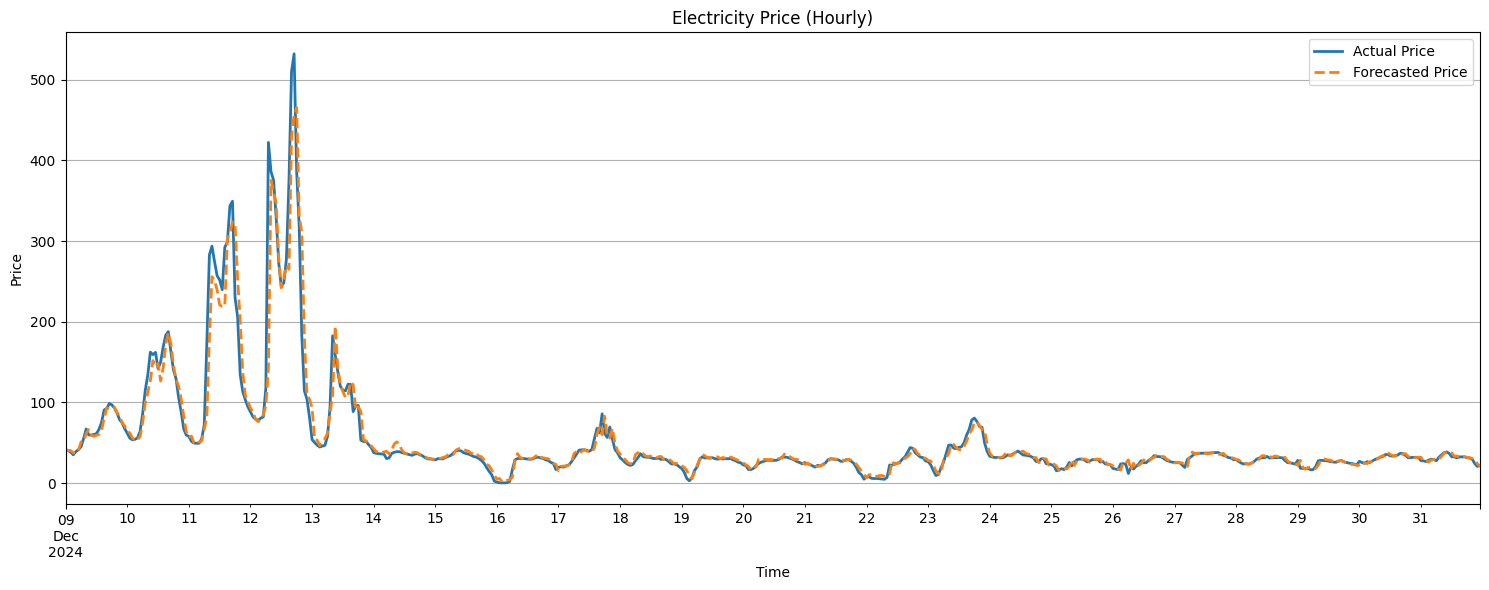

In [231]:
# Step 1: Flatten the time series (days × hours → 1D)
flattened_series = data_t[:, :, 0].reshape(-1).cpu().numpy()

# Step 2: Create a matching hourly datetime index
# There are 24 hours per day, so total points = 2192 days × 24 = 52608
start_datetime = pd.to_datetime(INIT_DATE_EXPERIMENTS)
end_datetime = pd.to_datetime(FINAL_DATE_EXPERIMENTS) + pd.Timedelta(hours=23)
datetime_index = pd.date_range(start=start_datetime, end=end_datetime, freq='H')
predicted_series = pd.Series(forecasts_zone.reshape(-1).cpu().numpy(), index = datetime_index[-(N_s*24):] )
# Check: both must match in length
assert len(flattened_series) == len(datetime_index)

# Step 3: Create the Series and plot
price_series_flat = pd.Series(flattened_series, index=datetime_index)
price_series_flat = price_series_flat[-(N_s*24):]

plt.figure(figsize=(15, 6))
# Actual price (full series or just the last day)
price_series_flat[-(24*7*3)-(2*24):].plot(label='Actual Price', linewidth=2)
predicted_series[-(24*7*3)-(2*24):].plot(label='Forecasted Price', linewidth=2, linestyle='--')
plt.title("Electricity Price (Hourly)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [234]:
# get dates with highest error values
# Flatten and compute absolute error
errors = abs(diff.reshape(-1).cpu().numpy())
time_index = datetime_index[-(N_s * 24):]

# Create DataFrame with datetime, error, and day name
df_errors = pd.DataFrame({
    "DateTime": time_index,
    "AbsError": errors
})
df_errors["Day"] = df_errors["DateTime"].dt.day_name()
# Sort by highest error
df_sorted_errors = df_errors.sort_values("AbsError", ascending=False)

# Display top 10 with day names
print(df_sorted_errors.head(5))

                 DateTime    AbsError       Day
17071 2024-12-12 07:00:00  280.268895  Thursday
8872  2024-01-05 16:00:00  189.988541    Friday
8120  2023-12-05 08:00:00  150.831177   Tuesday
8874  2024-01-05 18:00:00  130.596600    Friday
17084 2024-12-12 20:00:00  128.133135  Thursday


In [249]:
df_sorted_errors.DateTime.dt.hour.head(350).value_counts().head(8) # highest errors ocurr at 7 am

DateTime
7     51
8     39
17    30
9     29
18    24
19    23
10    23
16    19
Name: count, dtype: int64

In [236]:
# get ids of specific dates
start_datetime = pd.to_datetime(INIT_DATE_EXPERIMENTS)
end_datetime = pd.to_datetime(FINAL_DATE_EXPERIMENTS) + pd.Timedelta(hours=23)
datetime_index__ = pd.date_range(start=start_datetime, end=end_datetime, freq='H')
target_time = pd.Timestamp("2024-12-12 07:00:00")
index_pos = datetime_index__.get_loc(target_time)
day_idx = index_pos // 24  
day_idx

# get data for these specific dates
tmd_ds = pd.DataFrame(data_array.cpu().numpy().reshape(-1, data_array.shape[2]))
tmd_ds[10] = tmd_ds[0].pct_change()*100
tmd_ds[11] = tmd_ds[1].pct_change()*100
tmd_ds[12] = tmd_ds[2].pct_change()*100
tmd_ds["lag168_0"] = tmd_ds[0].shift(168)  # Price
tmd_ds["lag168_2"] = tmd_ds[2].shift(168)  # Load
tmd_ds["lag24_0"] = tmd_ds[0].shift(24)
tmd_ds["lag24_2"] = tmd_ds[2].shift(24)
tmd_ds["roll3_0"] = tmd_ds[0].shift(1).rolling(window=2).median()
tmd_ds["roll3_2"] = tmd_ds[2].shift(1).rolling(window=2).median()
start_row = 2171 * 24
end_row = (2172 + 1) * 24  # +1 to include full day 2172

tmd_ds_days_2171_2172 = tmd_ds.iloc[start_row:end_row]
tmd_ds_days_2171_2172.tail()

0        1        2       3    4    5           6      7   
52147  317.05  5844.64  5967.75   37.85  0.0  0.0  118.119326  44.72  \
52148  182.58  5806.63  5892.12   61.61  0.0  0.0  118.119326  44.72   
52149  114.46  5746.29  5843.11   99.04  0.0  0.0  118.119326  44.72   
52150  104.23  5694.79  5755.54  155.80  0.0  0.0  118.119326  44.72   
52151   81.58  5672.46  5721.69  195.38  0.0  0.0  118.119326  44.72   

               8     9         10        11        12  lag168_0  lag168_2   
52147  77.042557  66.1 -17.871205 -0.943510 -2.312802     46.42   6285.11  \
52148  77.042557  66.1 -42.412869 -0.650339 -1.267312     45.73   6149.26   
52149  77.042557  66.1 -37.309672 -1.039157 -0.831789     46.37   5943.16   
52150  77.042557  66.1  -8.937620 -0.896230 -1.498688     43.74   5745.94   
52151  77.042557  66.1 -21.730788 -0.392113 -0.588129     43.37   5509.25   

       lag24_0  lag24_2  roll3_0   roll3_2  
52147   205.93  6246.79  459.150  6136.765  
52148   134.64  6215.07  351.545  6038.395  
52149   113.27  6021.87  249.815  5929.935  
52150   103.32  5823.93  148.520  5867.615  
52151    94.51  5678.18  109.345  5799.325

In [240]:
import plotly.graph_objects as go
import plotly.io as pio

# 👉 Force browser rendering
pio.renderers.default = 'browser'

# Flatten series (assuming they are already prepared)
flattened_series = data_t[:, :, 0].reshape(-1).cpu().numpy()
predicted_values = forecasts_zone.reshape(-1).cpu().numpy()

start_datetime = pd.to_datetime(INIT_DATE_EXPERIMENTS)
end_datetime = pd.to_datetime(FINAL_DATE_EXPERIMENTS) + pd.Timedelta(hours=23)
datetime_index = pd.date_range(start=start_datetime, end=end_datetime, freq='H')

# Slice last N_s*24 points
flattened_series = flattened_series[-(N_s * 24):]
predicted_values = predicted_values[-(N_s * 24):]
datetime_index = datetime_index[-(N_s * 24):]

# Create interactive Plotly figure
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=datetime_index[-(24*7*9)-(2*24):],
    y=flattened_series[-(24*7*9)-(2*24):],
    mode='lines',
    name='Actual Price',
    line=dict(width=2)
))

fig.add_trace(go.Scatter(
    x=datetime_index[-(24*7*9)-(2*24):],
    y=predicted_values[-(24*7*9)-(2*24):],
    mode='lines',
    name='Forecasted Price',
    line=dict(dash='dash', width=2)
))

fig.update_layout(
    title="Electricity Price Forecast vs Actual (Hourly)",
    xaxis_title="Time",
    yaxis_title="Price",
    hovermode='x unified',
    template='plotly_white',
    height=500
)

# Open in browser
fig.show()